Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [2]:
%%capture
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_absolute_error
import category_encoders as ce
from sklearn.impute import SimpleImputer
import pickle

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    #import PKL Dataset ready for exploration 
    infile = open("/Users/user/Documents/GitHub/MIR/Spotify/master_list2.pkl",'rb')
    master_list2 = pickle.load(infile)

In [3]:
pd.options.display.max_colwidth = 200
description = pd.read_csv("/Users/user/Documents/GitHub/MIR/Spotify/feature_description.csv")
description.dropna(how="all")

Field   \
1                         session_id    
3                   session_position    
5                     session_length    
7                     track_id_clean    
9                             skip_1    
11                            skip_2    
13                            skip_3    
15                       not_skipped    
17                    context_switch    
19              no_pause_before_play    
21           short_pause_before_play    
23            long_pause_before_play    
25      hist_user_behavior_n_seekfwd    
27     hist_user_behavior_n_seekback    
29     hist_user_behavior_is_shuffle    
31                       hour_of_day    
33                              date    
35                           premium    
37                      context_type    
39   hist_user_behavior_reason_start    
41     hist_user_behavior_reason_end    
44                          duration    
46                      release_year    
48            us_popularity_estimate    
50                      acousticness    
52                     beat_strength    
54                        bounciness    
56                      danceability    
58                    dyn_range_mean    
60                            energy    
62                          flatness    
64                  instrumentalness    
66                               key    
68                          liveness    
70                          loudness    
72                         mechanism    
74                              mode    
76                          organism    
78                       speechiness    
80                             tempo    
82                    time_signature    
84                           valence    
86                 acoustic_vector_0    
88                 acoustic_vector_1    
90                 acoustic_vector_2    
92                 acoustic_vector_3    
94                 acoustic_vector_4    
96                 acoustic_vector_5    
98                 acoustic_vector_6    
100                acoustic_vector_7    

                                                                                                                                                                           Values   
1                                                                    E.g. _65_283174c5-551c-4c1b-954b-cb60ffcc2aec - unique identifier for the session that this row is a part of   
3                                                                                                                                         {1-20} - position of row within session   
5                                                                                                                                             {10-20} - number of rows in session   
7                   E.g. _t_13d34e4b-dc9b-4535-963d-419afa8332ec - unique identifier for the track played. This is linked with track_id in the track features and metadata table.   
9                                                                                                                    Boolean indicating if the track was only played very briefly   
11                                                                                                                        Boolean indicating if the track was only played briefly   
13                                                                                                                             Boolean indicating if most of the track was played   
15                                                                                                                   Boolean indicating that the track was played in its entirety   
17   Boolean indicating if the user changed context between the previous row and the current row. This could for example occur if the user switched from one playlist to another.   
19                                                                                 Boolean indicating if there was no pause betwe

In [52]:
#removing features likely to leak 

features = ['session_position', 'session_length','hour_of_day', 'context_type',
       'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence']

target = 'skip_2'
drop = ['track_id','skip_1', 'skip_3', 'no_pause_before_play','short_pause_before_play', 'long_pause_before_play','hist_user_behavior_reason_end','hist_user_behavior_n_seekfwd', 
       'hist_user_behavior_n_seekback','hist_user_behavior_reason_start','context_switch','hist_user_behavior_is_shuffle','not_skipped']

X = master_list2[features]
y = master_list2[target]

In [54]:
master_list2["skip_2"].value_counts(normalize=True)

True     0.507247
False    0.492753
Name: skip_2, dtype: float64

In [65]:
#utilizing skip_2 to see how values fair against the two possible values

master_list2.groupby(["skip_2"]).mean()

session_position  session_length    skip_1    skip_3  not_skipped  \
skip_2                                                                      
False           9.038691       17.491261  0.000000  0.278318     0.682901   
True            9.601945       18.006256  0.804896  0.999985     0.000000   

        context_switch  no_pause_before_play  short_pause_before_play  \
skip_2                                                                  
False         0.064385              0.723294                 0.165217   
True          0.030398              0.807493                 0.139965   

        long_pause_before_play  hist_user_behavior_n_seekfwd  ...  \
skip_2                                                        ...   
False                 0.197552                       0.03505  ...   
True                  0.148687                       0.04384  ...   

        instrumentalness       key  liveness  loudness  mechanism  organism  \
skip_2                                                                        
False           0.037688  5.112305  0.193057 -7.038848   0.592575  0.351612   
True            0.030948  5.130216  0.192114 -6.981904   0.586092  0.353392   

        speechiness       tempo  time_signature   valence  
skip_2                                                     
False      0.132772  121.754570        3.942606  0.459148  
True       0.137019  122.458822        3.942108  0.461205  

[2 rows x 33 columns]

In [66]:
#first split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
#second plit for validation holdout

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [68]:
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5469831902055001


In [69]:
k = 3
scores = cross_val_score(pipeline, X_val, y_val, cv=k, 
                         scoring='recall')
print(f'Recall for {k} folds :', scores)

Recall for 3 folds : [0.54331154 0.54554312 0.5430143 ]


In [70]:
y_pred = pipeline.predict(X_val)

In [71]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print("Accuracy:",accuracy_score(y_val, y_pred))
print("ROC:",roc_auc_score(y_val, y_pred))
print("Recall:",recall_score(y_val, y_pred))
print("Precision:",precision_score(y_val, y_pred))

Accuracy: 0.5469831902055001
ROC: 0.5468898091522485
Recall: 0.555145787714648
Precision: 0.5517295237301901


In [72]:
from sklearn.metrics import confusion_matrix

from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

def plot_confusion_matrix(y_true,y_pred):
    labels = unique_labels(y_true)
    columns = [label for label in labels]
    index = [label for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=index)
    return table 

plot_confusion_matrix(y_val, y_pred)

False  True 
False  50261  43051
True   42460  52987

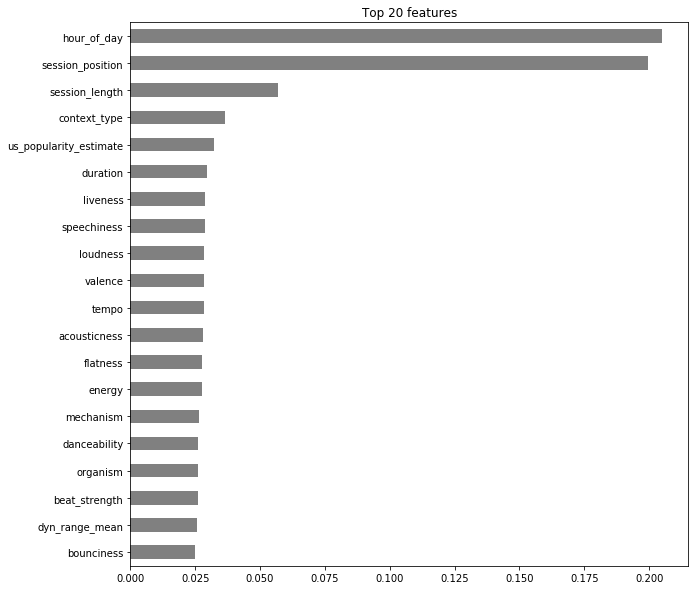

In [73]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_val.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [78]:
#ask about this!!!

transformers = make_pipeline(
    ce.TargetEncoder()
)

X_train_transformed = transformers.fit_transform(X_train,y_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [79]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [80]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

session_length            0.014520
context_type              0.014141
session_position          0.009227
hour_of_day               0.001235
time_signature           -0.000229
mode                     -0.000717
organism                 -0.001485
bounciness               -0.001689
danceability             -0.001783
release_year             -0.001828
key                      -0.001831
dyn_range_mean           -0.001880
energy                   -0.001977
instrumentalness         -0.002213
mechanism                -0.002246
beat_strength            -0.002367
acousticness             -0.002386
valence                  -0.002592
loudness                 -0.002831
flatness                 -0.002834
liveness                 -0.003072
tempo                    -0.003156
us_popularity_estimate   -0.003919
speechiness              -0.005513
duration                 -0.005717
dtype: float64

In [81]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

In [82]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (755033, 25)


In [83]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

print('Shape after removing features:', X_train.shape)

Shape after removing features: (755033, 4)


In [84]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5554966915484825


In [85]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['context_type'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               min_samples_leaf=1, return_df=True,
                               smoothing=1.0, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, su

In [86]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.5643651428541155


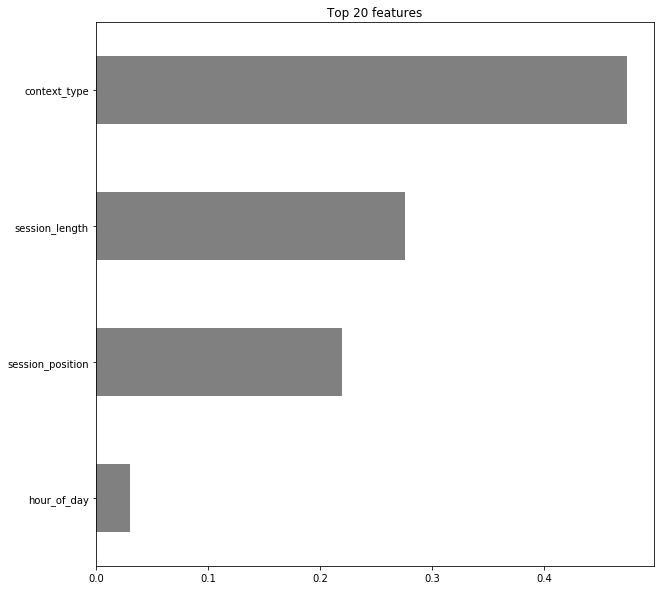

In [87]:
# Get feature importances
rf = pipeline.named_steps['xgbclassifier']
importances = pd.Series(rf.feature_importances_, X_val.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [89]:
encoder = ce.TargetEncoder()
X_train_encoded = encoder.fit_transform(X_train,y_train)
X_val_encoded = encoder.transform(X_val)

X_train.shape, X_val.shape, X_train_encoded.shape, X_val_encoded.shape

((755033, 4), (188759, 4), (755033, 4), (188759, 4))

In [102]:
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.1, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='auc', early_stopping_rounds=50)

[0]	validation_0-auc:0.589371	validation_1-auc:0.58715
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.589659	validation_1-auc:0.587481
[2]	validation_0-auc:0.589895	validation_1-auc:0.587707
[3]	validation_0-auc:0.590447	validation_1-auc:0.588257
[4]	validation_0-auc:0.590631	validation_1-auc:0.588468
[5]	validation_0-auc:0.590793	validation_1-auc:0.588627
[6]	validation_0-auc:0.59092	validation_1-auc:0.588715
[7]	validation_0-auc:0.591091	validation_1-auc:0.588893
[8]	validation_0-auc:0.5912	validation_1-auc:0.588933
[9]	validation_0-auc:0.591242	validation_1-auc:0.588964
[10]	validation_0-auc:0.591393	validation_1-auc:0.589021
[11]	validation_0-auc:0.591499	validation_1-auc:0.589047
[12]	validation_0-auc:0.591653	validation_1-auc:0.589157
[13]	validation_0-auc:0.591752	validation_1-auc:0.589224
[14]	validation_0-auc:0.591823	validation_1-auc:0.589204
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

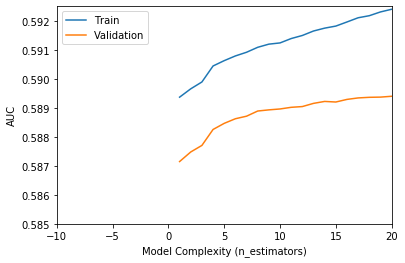

In [111]:
results = model.evals_result()
train_error = results['validation_0']['auc']
val_error = results['validation_1']['auc']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('AUC')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.5850, 0.5925)) # Zoom in
plt.xlim((-10, 20)) # Zoom in
plt.legend();

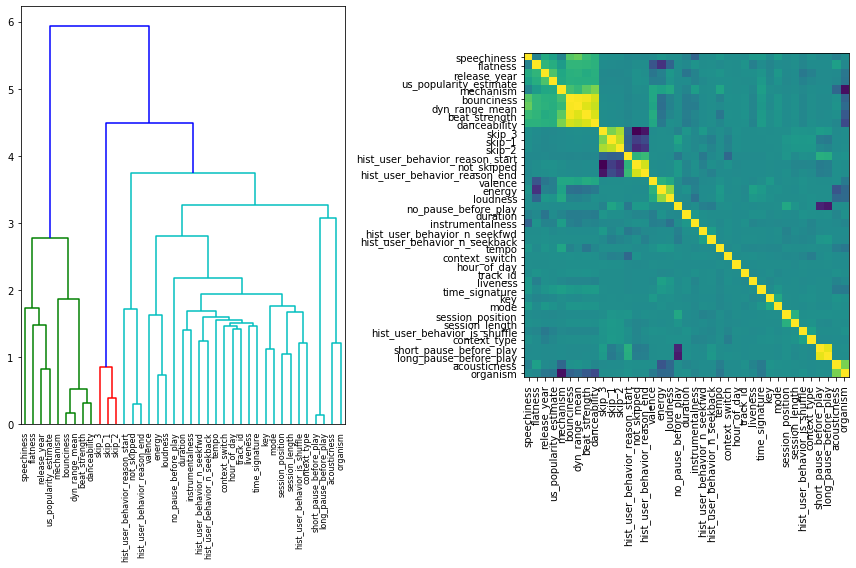

In [98]:
#Multicollinear Feature Visualization - Very Nice little visualization for Project 

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(master_list2).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=master_list2.columns, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

# Partial Dependence Plot

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

examples = pd.concat([example, example2])
for income in range(20000, 200000, 20000):
    examples['Annual Income'] = income
    preds = gb.predict(examples)
    for pred in preds:
        plt.scatter(income, pred, color='grey')
    plt.scatter(income, np.mean(preds), color='red')
    plt.title('Partial Dependence')
    plt.xlabel('Income')
    plt.ylabel('Interest Rate')

In [125]:
example = X_val.iloc[[0]]
example2 = X_val.iloc[[2]]



model.predict()

ValueError: feature_names mismatch: ['session_position', 'session_length', 'hour_of_day', 'context_type'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576', 'f14577', 'f14578', 'f14579', 'f14580', 'f14581', 'f14582', 'f14583', 'f14584', 'f14585', 'f14586', 'f14587', 'f14588', 'f14589', 'f14590', 'f14591', 'f14592', 'f14593', 'f14594', 'f14595', 'f14596', 'f14597', 'f14598', 'f14599', 'f14600', 'f14601', 'f14602', 'f14603', 'f14604', 'f14605', 'f14606', 'f14607', 'f14608', 'f14609', 'f14610', 'f14611', 'f14612', 'f14613', 'f14614', 'f14615', 'f14616', 'f14617', 'f14618', 'f14619', 'f14620', 'f14621', 'f14622', 'f14623', 'f14624', 'f14625', 'f14626', 'f14627', 'f14628', 'f14629', 'f14630', 'f14631', 'f14632', 'f14633', 'f14634', 'f14635', 'f14636', 'f14637', 'f14638', 'f14639', 'f14640', 'f14641', 'f14642', 'f14643', 'f14644', 'f14645', 'f14646', 'f14647', 'f14648', 'f14649', 'f14650', 'f14651', 'f14652', 'f14653', 'f14654', 'f14655', 'f14656', 'f14657', 'f14658', 'f14659', 'f14660', 'f14661', 'f14662', 'f14663', 'f14664', 'f14665', 'f14666', 'f14667', 'f14668', 'f14669', 'f14670', 'f14671', 'f14672', 'f14673', 'f14674', 'f14675', 'f14676', 'f14677', 'f14678', 'f14679', 'f14680', 'f14681', 'f14682', 'f14683', 'f14684', 'f14685', 'f14686', 'f14687', 'f14688', 'f14689', 'f14690', 'f14691', 'f14692', 'f14693', 'f14694', 'f14695', 'f14696', 'f14697', 'f14698', 'f14699', 'f14700', 'f14701', 'f14702', 'f14703', 'f14704', 'f14705', 'f14706', 'f14707', 'f14708', 'f14709', 'f14710', 'f14711', 'f14712', 'f14713', 'f14714', 'f14715', 'f14716', 'f14717', 'f14718', 'f14719', 'f14720', 'f14721', 'f14722', 'f14723', 'f14724', 'f14725', 'f14726', 'f14727', 'f14728', 'f14729', 'f14730', 'f14731', 'f14732', 'f14733', 'f14734', 'f14735', 'f14736', 'f14737', 'f14738', 'f14739', 'f14740', 'f14741', 'f14742', 'f14743', 'f14744', 'f14745', 'f14746', 'f14747', 'f14748', 'f14749', 'f14750', 'f14751', 'f14752', 'f14753', 'f14754', 'f14755', 'f14756', 'f14757', 'f14758', 'f14759', 'f14760', 'f14761', 'f14762', 'f14763', 'f14764', 'f14765', 'f14766', 'f14767', 'f14768', 'f14769', 'f14770', 'f14771', 'f14772', 'f14773', 'f14774', 'f14775', 'f14776', 'f14777', 'f14778', 'f14779', 'f14780', 'f14781', 'f14782', 'f14783', 'f14784', 'f14785', 'f14786', 'f14787', 'f14788', 'f14789', 'f14790', 'f14791', 'f14792', 'f14793', 'f14794', 'f14795', 'f14796', 'f14797', 'f14798', 'f14799', 'f14800', 'f14801', 'f14802', 'f14803', 'f14804', 'f14805', 'f14806', 'f14807', 'f14808', 'f14809', 'f14810', 'f14811', 'f14812', 'f14813', 'f14814', 'f14815', 'f14816', 'f14817', 'f14818', 'f14819', 'f14820', 'f14821', 'f14822', 'f14823', 'f14824', 'f14825', 'f14826', 'f14827', 'f14828', 'f14829', 'f14830', 'f14831', 'f14832', 'f14833', 'f14834', 'f14835', 'f14836', 'f14837', 'f14838', 'f14839', 'f14840', 'f14841', 'f14842', 'f14843', 'f14844', 'f14845', 'f14846', 'f14847', 'f14848', 'f14849', 'f14850', 'f14851', 'f14852', 'f14853', 'f14854', 'f14855', 'f14856', 'f14857', 'f14858', 'f14859', 'f14860', 'f14861', 'f14862', 'f14863', 'f14864', 'f14865', 'f14866', 'f14867', 'f14868', 'f14869', 'f14870', 'f14871', 'f14872', 'f14873', 'f14874', 'f14875', 'f14876', 'f14877', 'f14878', 'f14879', 'f14880', 'f14881', 'f14882', 'f14883', 'f14884', 'f14885', 'f14886', 'f14887', 'f14888', 'f14889', 'f14890', 'f14891', 'f14892', 'f14893', 'f14894', 'f14895', 'f14896', 'f14897', 'f14898', 'f14899', 'f14900', 'f14901', 'f14902', 'f14903', 'f14904', 'f14905', 'f14906', 'f14907', 'f14908', 'f14909', 'f14910', 'f14911', 'f14912', 'f14913', 'f14914', 'f14915', 'f14916', 'f14917', 'f14918', 'f14919', 'f14920', 'f14921', 'f14922', 'f14923', 'f14924', 'f14925', 'f14926', 'f14927', 'f14928', 'f14929', 'f14930', 'f14931', 'f14932', 'f14933', 'f14934', 'f14935', 'f14936', 'f14937', 'f14938', 'f14939', 'f14940', 'f14941', 'f14942', 'f14943', 'f14944', 'f14945', 'f14946', 'f14947', 'f14948', 'f14949', 'f14950', 'f14951', 'f14952', 'f14953', 'f14954', 'f14955', 'f14956', 'f14957', 'f14958', 'f14959', 'f14960', 'f14961', 'f14962', 'f14963', 'f14964', 'f14965', 'f14966', 'f14967', 'f14968', 'f14969', 'f14970', 'f14971', 'f14972', 'f14973', 'f14974', 'f14975', 'f14976', 'f14977', 'f14978', 'f14979', 'f14980', 'f14981', 'f14982', 'f14983', 'f14984', 'f14985', 'f14986', 'f14987', 'f14988', 'f14989', 'f14990', 'f14991', 'f14992', 'f14993', 'f14994', 'f14995', 'f14996', 'f14997', 'f14998', 'f14999', 'f15000', 'f15001', 'f15002', 'f15003', 'f15004', 'f15005', 'f15006', 'f15007', 'f15008', 'f15009', 'f15010', 'f15011', 'f15012', 'f15013', 'f15014', 'f15015', 'f15016', 'f15017', 'f15018', 'f15019', 'f15020', 'f15021', 'f15022', 'f15023', 'f15024', 'f15025', 'f15026', 'f15027', 'f15028', 'f15029', 'f15030', 'f15031', 'f15032', 'f15033', 'f15034', 'f15035', 'f15036', 'f15037', 'f15038', 'f15039', 'f15040', 'f15041', 'f15042', 'f15043', 'f15044', 'f15045', 'f15046', 'f15047', 'f15048', 'f15049', 'f15050', 'f15051', 'f15052', 'f15053', 'f15054', 'f15055', 'f15056', 'f15057', 'f15058', 'f15059', 'f15060', 'f15061', 'f15062', 'f15063', 'f15064', 'f15065', 'f15066', 'f15067', 'f15068', 'f15069', 'f15070', 'f15071', 'f15072', 'f15073', 'f15074', 'f15075', 'f15076', 'f15077', 'f15078', 'f15079', 'f15080', 'f15081', 'f15082', 'f15083', 'f15084', 'f15085', 'f15086', 'f15087', 'f15088', 'f15089', 'f15090', 'f15091', 'f15092', 'f15093', 'f15094', 'f15095', 'f15096', 'f15097', 'f15098', 'f15099', 'f15100', 'f15101', 'f15102', 'f15103', 'f15104', 'f15105', 'f15106', 'f15107', 'f15108', 'f15109', 'f15110', 'f15111', 'f15112', 'f15113', 'f15114', 'f15115', 'f15116', 'f15117', 'f15118', 'f15119', 'f15120', 'f15121', 'f15122', 'f15123', 'f15124', 'f15125', 'f15126', 'f15127', 'f15128', 'f15129', 'f15130', 'f15131', 'f15132', 'f15133', 'f15134', 'f15135', 'f15136', 'f15137', 'f15138', 'f15139', 'f15140', 'f15141', 'f15142', 'f15143', 'f15144', 'f15145', 'f15146', 'f15147', 'f15148', 'f15149', 'f15150', 'f15151', 'f15152', 'f15153', 'f15154', 'f15155', 'f15156', 'f15157', 'f15158', 'f15159', 'f15160', 'f15161', 'f15162', 'f15163', 'f15164', 'f15165', 'f15166', 'f15167', 'f15168', 'f15169', 'f15170', 'f15171', 'f15172', 'f15173', 'f15174', 'f15175', 'f15176', 'f15177', 'f15178', 'f15179', 'f15180', 'f15181', 'f15182', 'f15183', 'f15184', 'f15185', 'f15186', 'f15187', 'f15188', 'f15189', 'f15190', 'f15191', 'f15192', 'f15193', 'f15194', 'f15195', 'f15196', 'f15197', 'f15198', 'f15199', 'f15200', 'f15201', 'f15202', 'f15203', 'f15204', 'f15205', 'f15206', 'f15207', 'f15208', 'f15209', 'f15210', 'f15211', 'f15212', 'f15213', 'f15214', 'f15215', 'f15216', 'f15217', 'f15218', 'f15219', 'f15220', 'f15221', 'f15222', 'f15223', 'f15224', 'f15225', 'f15226', 'f15227', 'f15228', 'f15229', 'f15230', 'f15231', 'f15232', 'f15233', 'f15234', 'f15235', 'f15236', 'f15237', 'f15238', 'f15239', 'f15240', 'f15241', 'f15242', 'f15243', 'f15244', 'f15245', 'f15246', 'f15247', 'f15248', 'f15249', 'f15250', 'f15251', 'f15252', 'f15253', 'f15254', 'f15255', 'f15256', 'f15257', 'f15258', 'f15259', 'f15260', 'f15261', 'f15262', 'f15263', 'f15264', 'f15265', 'f15266', 'f15267', 'f15268', 'f15269', 'f15270', 'f15271', 'f15272', 'f15273', 'f15274', 'f15275', 'f15276', 'f15277', 'f15278', 'f15279', 'f15280', 'f15281', 'f15282', 'f15283', 'f15284', 'f15285', 'f15286', 'f15287', 'f15288', 'f15289', 'f15290', 'f15291', 'f15292', 'f15293', 'f15294', 'f15295', 'f15296', 'f15297', 'f15298', 'f15299', 'f15300', 'f15301', 'f15302', 'f15303', 'f15304', 'f15305', 'f15306', 'f15307', 'f15308', 'f15309', 'f15310', 'f15311', 'f15312', 'f15313', 'f15314', 'f15315', 'f15316', 'f15317', 'f15318', 'f15319', 'f15320', 'f15321', 'f15322', 'f15323', 'f15324', 'f15325', 'f15326', 'f15327', 'f15328', 'f15329', 'f15330', 'f15331', 'f15332', 'f15333', 'f15334', 'f15335', 'f15336', 'f15337', 'f15338', 'f15339', 'f15340', 'f15341', 'f15342', 'f15343', 'f15344', 'f15345', 'f15346', 'f15347', 'f15348', 'f15349', 'f15350', 'f15351', 'f15352', 'f15353', 'f15354', 'f15355', 'f15356', 'f15357', 'f15358', 'f15359', 'f15360', 'f15361', 'f15362', 'f15363', 'f15364', 'f15365', 'f15366', 'f15367', 'f15368', 'f15369', 'f15370', 'f15371', 'f15372', 'f15373', 'f15374', 'f15375', 'f15376', 'f15377', 'f15378', 'f15379', 'f15380', 'f15381', 'f15382', 'f15383', 'f15384', 'f15385', 'f15386', 'f15387', 'f15388', 'f15389', 'f15390', 'f15391', 'f15392', 'f15393', 'f15394', 'f15395', 'f15396', 'f15397', 'f15398', 'f15399', 'f15400', 'f15401', 'f15402', 'f15403', 'f15404', 'f15405', 'f15406', 'f15407', 'f15408', 'f15409', 'f15410', 'f15411', 'f15412', 'f15413', 'f15414', 'f15415', 'f15416', 'f15417', 'f15418', 'f15419', 'f15420', 'f15421', 'f15422', 'f15423', 'f15424', 'f15425', 'f15426', 'f15427', 'f15428', 'f15429', 'f15430', 'f15431', 'f15432', 'f15433', 'f15434', 'f15435', 'f15436', 'f15437', 'f15438', 'f15439', 'f15440', 'f15441', 'f15442', 'f15443', 'f15444', 'f15445', 'f15446', 'f15447', 'f15448', 'f15449', 'f15450', 'f15451', 'f15452', 'f15453', 'f15454', 'f15455', 'f15456', 'f15457', 'f15458', 'f15459', 'f15460', 'f15461', 'f15462', 'f15463', 'f15464', 'f15465', 'f15466', 'f15467', 'f15468', 'f15469', 'f15470', 'f15471', 'f15472', 'f15473', 'f15474', 'f15475', 'f15476', 'f15477', 'f15478', 'f15479', 'f15480', 'f15481', 'f15482', 'f15483', 'f15484', 'f15485', 'f15486', 'f15487', 'f15488', 'f15489', 'f15490', 'f15491', 'f15492', 'f15493', 'f15494', 'f15495', 'f15496', 'f15497', 'f15498', 'f15499', 'f15500', 'f15501', 'f15502', 'f15503', 'f15504', 'f15505', 'f15506', 'f15507', 'f15508', 'f15509', 'f15510', 'f15511', 'f15512', 'f15513', 'f15514', 'f15515', 'f15516', 'f15517', 'f15518', 'f15519', 'f15520', 'f15521', 'f15522', 'f15523', 'f15524', 'f15525', 'f15526', 'f15527', 'f15528', 'f15529', 'f15530', 'f15531', 'f15532', 'f15533', 'f15534', 'f15535', 'f15536', 'f15537', 'f15538', 'f15539', 'f15540', 'f15541', 'f15542', 'f15543', 'f15544', 'f15545', 'f15546', 'f15547', 'f15548', 'f15549', 'f15550', 'f15551', 'f15552', 'f15553', 'f15554', 'f15555', 'f15556', 'f15557', 'f15558', 'f15559', 'f15560', 'f15561', 'f15562', 'f15563', 'f15564', 'f15565', 'f15566', 'f15567', 'f15568', 'f15569', 'f15570', 'f15571', 'f15572', 'f15573', 'f15574', 'f15575', 'f15576', 'f15577', 'f15578', 'f15579', 'f15580', 'f15581', 'f15582', 'f15583', 'f15584', 'f15585', 'f15586', 'f15587', 'f15588', 'f15589', 'f15590', 'f15591', 'f15592', 'f15593', 'f15594', 'f15595', 'f15596', 'f15597', 'f15598', 'f15599', 'f15600', 'f15601', 'f15602', 'f15603', 'f15604', 'f15605', 'f15606', 'f15607', 'f15608', 'f15609', 'f15610', 'f15611', 'f15612', 'f15613', 'f15614', 'f15615', 'f15616', 'f15617', 'f15618', 'f15619', 'f15620', 'f15621', 'f15622', 'f15623', 'f15624', 'f15625', 'f15626', 'f15627', 'f15628', 'f15629', 'f15630', 'f15631', 'f15632', 'f15633', 'f15634', 'f15635', 'f15636', 'f15637', 'f15638', 'f15639', 'f15640', 'f15641', 'f15642', 'f15643', 'f15644', 'f15645', 'f15646', 'f15647', 'f15648', 'f15649', 'f15650', 'f15651', 'f15652', 'f15653', 'f15654', 'f15655', 'f15656', 'f15657', 'f15658', 'f15659', 'f15660', 'f15661', 'f15662', 'f15663', 'f15664', 'f15665', 'f15666', 'f15667', 'f15668', 'f15669', 'f15670', 'f15671', 'f15672', 'f15673', 'f15674', 'f15675', 'f15676', 'f15677', 'f15678', 'f15679', 'f15680', 'f15681', 'f15682', 'f15683', 'f15684', 'f15685', 'f15686', 'f15687', 'f15688', 'f15689', 'f15690', 'f15691', 'f15692', 'f15693', 'f15694', 'f15695', 'f15696', 'f15697', 'f15698', 'f15699', 'f15700', 'f15701', 'f15702', 'f15703', 'f15704', 'f15705', 'f15706', 'f15707', 'f15708', 'f15709', 'f15710', 'f15711', 'f15712', 'f15713', 'f15714', 'f15715', 'f15716', 'f15717', 'f15718', 'f15719', 'f15720', 'f15721', 'f15722', 'f15723', 'f15724', 'f15725', 'f15726', 'f15727', 'f15728', 'f15729', 'f15730', 'f15731', 'f15732', 'f15733', 'f15734', 'f15735', 'f15736', 'f15737', 'f15738', 'f15739', 'f15740', 'f15741', 'f15742', 'f15743', 'f15744', 'f15745', 'f15746', 'f15747', 'f15748', 'f15749', 'f15750', 'f15751', 'f15752', 'f15753', 'f15754', 'f15755', 'f15756', 'f15757', 'f15758', 'f15759', 'f15760', 'f15761', 'f15762', 'f15763', 'f15764', 'f15765', 'f15766', 'f15767', 'f15768', 'f15769', 'f15770', 'f15771', 'f15772', 'f15773', 'f15774', 'f15775', 'f15776', 'f15777', 'f15778', 'f15779', 'f15780', 'f15781', 'f15782', 'f15783', 'f15784', 'f15785', 'f15786', 'f15787', 'f15788', 'f15789', 'f15790', 'f15791', 'f15792', 'f15793', 'f15794', 'f15795', 'f15796', 'f15797', 'f15798', 'f15799', 'f15800', 'f15801', 'f15802', 'f15803', 'f15804', 'f15805', 'f15806', 'f15807', 'f15808', 'f15809', 'f15810', 'f15811', 'f15812', 'f15813', 'f15814', 'f15815', 'f15816', 'f15817', 'f15818', 'f15819', 'f15820', 'f15821', 'f15822', 'f15823', 'f15824', 'f15825', 'f15826', 'f15827', 'f15828', 'f15829', 'f15830', 'f15831', 'f15832', 'f15833', 'f15834', 'f15835', 'f15836', 'f15837', 'f15838', 'f15839', 'f15840', 'f15841', 'f15842', 'f15843', 'f15844', 'f15845', 'f15846', 'f15847', 'f15848', 'f15849', 'f15850', 'f15851', 'f15852', 'f15853', 'f15854', 'f15855', 'f15856', 'f15857', 'f15858', 'f15859', 'f15860', 'f15861', 'f15862', 'f15863', 'f15864', 'f15865', 'f15866', 'f15867', 'f15868', 'f15869', 'f15870', 'f15871', 'f15872', 'f15873', 'f15874', 'f15875', 'f15876', 'f15877', 'f15878', 'f15879', 'f15880', 'f15881', 'f15882', 'f15883', 'f15884', 'f15885', 'f15886', 'f15887', 'f15888', 'f15889', 'f15890', 'f15891', 'f15892', 'f15893', 'f15894', 'f15895', 'f15896', 'f15897', 'f15898', 'f15899', 'f15900', 'f15901', 'f15902', 'f15903', 'f15904', 'f15905', 'f15906', 'f15907', 'f15908', 'f15909', 'f15910', 'f15911', 'f15912', 'f15913', 'f15914', 'f15915', 'f15916', 'f15917', 'f15918', 'f15919', 'f15920', 'f15921', 'f15922', 'f15923', 'f15924', 'f15925', 'f15926', 'f15927', 'f15928', 'f15929', 'f15930', 'f15931', 'f15932', 'f15933', 'f15934', 'f15935', 'f15936', 'f15937', 'f15938', 'f15939', 'f15940', 'f15941', 'f15942', 'f15943', 'f15944', 'f15945', 'f15946', 'f15947', 'f15948', 'f15949', 'f15950', 'f15951', 'f15952', 'f15953', 'f15954', 'f15955', 'f15956', 'f15957', 'f15958', 'f15959', 'f15960', 'f15961', 'f15962', 'f15963', 'f15964', 'f15965', 'f15966', 'f15967', 'f15968', 'f15969', 'f15970', 'f15971', 'f15972', 'f15973', 'f15974', 'f15975', 'f15976', 'f15977', 'f15978', 'f15979', 'f15980', 'f15981', 'f15982', 'f15983', 'f15984', 'f15985', 'f15986', 'f15987', 'f15988', 'f15989', 'f15990', 'f15991', 'f15992', 'f15993', 'f15994', 'f15995', 'f15996', 'f15997', 'f15998', 'f15999', 'f16000', 'f16001', 'f16002', 'f16003', 'f16004', 'f16005', 'f16006', 'f16007', 'f16008', 'f16009', 'f16010', 'f16011', 'f16012', 'f16013', 'f16014', 'f16015', 'f16016', 'f16017', 'f16018', 'f16019', 'f16020', 'f16021', 'f16022', 'f16023', 'f16024', 'f16025', 'f16026', 'f16027', 'f16028', 'f16029', 'f16030', 'f16031', 'f16032', 'f16033', 'f16034', 'f16035', 'f16036', 'f16037', 'f16038', 'f16039', 'f16040', 'f16041', 'f16042', 'f16043', 'f16044', 'f16045', 'f16046', 'f16047', 'f16048', 'f16049', 'f16050', 'f16051', 'f16052', 'f16053', 'f16054', 'f16055', 'f16056', 'f16057', 'f16058', 'f16059', 'f16060', 'f16061', 'f16062', 'f16063', 'f16064', 'f16065', 'f16066', 'f16067', 'f16068', 'f16069', 'f16070', 'f16071', 'f16072', 'f16073', 'f16074', 'f16075', 'f16076', 'f16077', 'f16078', 'f16079', 'f16080', 'f16081', 'f16082', 'f16083', 'f16084', 'f16085', 'f16086', 'f16087', 'f16088', 'f16089', 'f16090', 'f16091', 'f16092', 'f16093', 'f16094', 'f16095', 'f16096', 'f16097', 'f16098', 'f16099', 'f16100', 'f16101', 'f16102', 'f16103', 'f16104', 'f16105', 'f16106', 'f16107', 'f16108', 'f16109', 'f16110', 'f16111', 'f16112', 'f16113', 'f16114', 'f16115', 'f16116', 'f16117', 'f16118', 'f16119', 'f16120', 'f16121', 'f16122', 'f16123', 'f16124', 'f16125', 'f16126', 'f16127', 'f16128', 'f16129', 'f16130', 'f16131', 'f16132', 'f16133', 'f16134', 'f16135', 'f16136', 'f16137', 'f16138', 'f16139', 'f16140', 'f16141', 'f16142', 'f16143', 'f16144', 'f16145', 'f16146', 'f16147', 'f16148', 'f16149', 'f16150', 'f16151', 'f16152', 'f16153', 'f16154', 'f16155', 'f16156', 'f16157', 'f16158', 'f16159', 'f16160', 'f16161', 'f16162', 'f16163', 'f16164', 'f16165', 'f16166', 'f16167', 'f16168', 'f16169', 'f16170', 'f16171', 'f16172', 'f16173', 'f16174', 'f16175', 'f16176', 'f16177', 'f16178', 'f16179', 'f16180', 'f16181', 'f16182', 'f16183', 'f16184', 'f16185', 'f16186', 'f16187', 'f16188', 'f16189', 'f16190', 'f16191', 'f16192', 'f16193', 'f16194', 'f16195', 'f16196', 'f16197', 'f16198', 'f16199', 'f16200', 'f16201', 'f16202', 'f16203', 'f16204', 'f16205', 'f16206', 'f16207', 'f16208', 'f16209', 'f16210', 'f16211', 'f16212', 'f16213', 'f16214', 'f16215', 'f16216', 'f16217', 'f16218', 'f16219', 'f16220', 'f16221', 'f16222', 'f16223', 'f16224', 'f16225', 'f16226', 'f16227', 'f16228', 'f16229', 'f16230', 'f16231', 'f16232', 'f16233', 'f16234', 'f16235', 'f16236', 'f16237', 'f16238', 'f16239', 'f16240', 'f16241', 'f16242', 'f16243', 'f16244', 'f16245', 'f16246', 'f16247', 'f16248', 'f16249', 'f16250', 'f16251', 'f16252', 'f16253', 'f16254', 'f16255', 'f16256', 'f16257', 'f16258', 'f16259', 'f16260', 'f16261', 'f16262', 'f16263', 'f16264', 'f16265', 'f16266', 'f16267', 'f16268', 'f16269', 'f16270', 'f16271', 'f16272', 'f16273', 'f16274', 'f16275', 'f16276', 'f16277', 'f16278', 'f16279', 'f16280', 'f16281', 'f16282', 'f16283', 'f16284', 'f16285', 'f16286', 'f16287', 'f16288', 'f16289', 'f16290', 'f16291', 'f16292', 'f16293', 'f16294', 'f16295', 'f16296', 'f16297', 'f16298', 'f16299', 'f16300', 'f16301', 'f16302', 'f16303', 'f16304', 'f16305', 'f16306', 'f16307', 'f16308', 'f16309', 'f16310', 'f16311', 'f16312', 'f16313', 'f16314', 'f16315', 'f16316', 'f16317', 'f16318', 'f16319', 'f16320', 'f16321', 'f16322', 'f16323', 'f16324', 'f16325', 'f16326', 'f16327', 'f16328', 'f16329', 'f16330', 'f16331', 'f16332', 'f16333', 'f16334', 'f16335', 'f16336', 'f16337', 'f16338', 'f16339', 'f16340', 'f16341', 'f16342', 'f16343', 'f16344', 'f16345', 'f16346', 'f16347', 'f16348', 'f16349', 'f16350', 'f16351', 'f16352', 'f16353', 'f16354', 'f16355', 'f16356', 'f16357', 'f16358', 'f16359', 'f16360', 'f16361', 'f16362', 'f16363', 'f16364', 'f16365', 'f16366', 'f16367', 'f16368', 'f16369', 'f16370', 'f16371', 'f16372', 'f16373', 'f16374', 'f16375', 'f16376', 'f16377', 'f16378', 'f16379', 'f16380', 'f16381', 'f16382', 'f16383', 'f16384', 'f16385', 'f16386', 'f16387', 'f16388', 'f16389', 'f16390', 'f16391', 'f16392', 'f16393', 'f16394', 'f16395', 'f16396', 'f16397', 'f16398', 'f16399', 'f16400', 'f16401', 'f16402', 'f16403', 'f16404', 'f16405', 'f16406', 'f16407', 'f16408', 'f16409', 'f16410', 'f16411', 'f16412', 'f16413', 'f16414', 'f16415', 'f16416', 'f16417', 'f16418', 'f16419', 'f16420', 'f16421', 'f16422', 'f16423', 'f16424', 'f16425', 'f16426', 'f16427', 'f16428', 'f16429', 'f16430', 'f16431', 'f16432', 'f16433', 'f16434', 'f16435', 'f16436', 'f16437', 'f16438', 'f16439', 'f16440', 'f16441', 'f16442', 'f16443', 'f16444', 'f16445', 'f16446', 'f16447', 'f16448', 'f16449', 'f16450', 'f16451', 'f16452', 'f16453', 'f16454', 'f16455', 'f16456', 'f16457', 'f16458', 'f16459', 'f16460', 'f16461', 'f16462', 'f16463', 'f16464', 'f16465', 'f16466', 'f16467', 'f16468', 'f16469', 'f16470', 'f16471', 'f16472', 'f16473', 'f16474', 'f16475', 'f16476', 'f16477', 'f16478', 'f16479', 'f16480', 'f16481', 'f16482', 'f16483', 'f16484', 'f16485', 'f16486', 'f16487', 'f16488', 'f16489', 'f16490', 'f16491', 'f16492', 'f16493', 'f16494', 'f16495', 'f16496', 'f16497', 'f16498', 'f16499', 'f16500', 'f16501', 'f16502', 'f16503', 'f16504', 'f16505', 'f16506', 'f16507', 'f16508', 'f16509', 'f16510', 'f16511', 'f16512', 'f16513', 'f16514', 'f16515', 'f16516', 'f16517', 'f16518', 'f16519', 'f16520', 'f16521', 'f16522', 'f16523', 'f16524', 'f16525', 'f16526', 'f16527', 'f16528', 'f16529', 'f16530', 'f16531', 'f16532', 'f16533', 'f16534', 'f16535', 'f16536', 'f16537', 'f16538', 'f16539', 'f16540', 'f16541', 'f16542', 'f16543', 'f16544', 'f16545', 'f16546', 'f16547', 'f16548', 'f16549', 'f16550', 'f16551', 'f16552', 'f16553', 'f16554', 'f16555', 'f16556', 'f16557', 'f16558', 'f16559', 'f16560', 'f16561', 'f16562', 'f16563', 'f16564', 'f16565', 'f16566', 'f16567', 'f16568', 'f16569', 'f16570', 'f16571', 'f16572', 'f16573', 'f16574', 'f16575', 'f16576', 'f16577', 'f16578', 'f16579', 'f16580', 'f16581', 'f16582', 'f16583', 'f16584', 'f16585', 'f16586', 'f16587', 'f16588', 'f16589', 'f16590', 'f16591', 'f16592', 'f16593', 'f16594', 'f16595', 'f16596', 'f16597', 'f16598', 'f16599', 'f16600', 'f16601', 'f16602', 'f16603', 'f16604', 'f16605', 'f16606', 'f16607', 'f16608', 'f16609', 'f16610', 'f16611', 'f16612', 'f16613', 'f16614', 'f16615', 'f16616', 'f16617', 'f16618', 'f16619', 'f16620', 'f16621', 'f16622', 'f16623', 'f16624', 'f16625', 'f16626', 'f16627', 'f16628', 'f16629', 'f16630', 'f16631', 'f16632', 'f16633', 'f16634', 'f16635', 'f16636', 'f16637', 'f16638', 'f16639', 'f16640', 'f16641', 'f16642', 'f16643', 'f16644', 'f16645', 'f16646', 'f16647', 'f16648', 'f16649', 'f16650', 'f16651', 'f16652', 'f16653', 'f16654', 'f16655', 'f16656', 'f16657', 'f16658', 'f16659', 'f16660', 'f16661', 'f16662', 'f16663', 'f16664', 'f16665', 'f16666', 'f16667', 'f16668', 'f16669', 'f16670', 'f16671', 'f16672', 'f16673', 'f16674', 'f16675', 'f16676', 'f16677', 'f16678', 'f16679', 'f16680', 'f16681', 'f16682', 'f16683', 'f16684', 'f16685', 'f16686', 'f16687', 'f16688', 'f16689', 'f16690', 'f16691', 'f16692', 'f16693', 'f16694', 'f16695', 'f16696', 'f16697', 'f16698', 'f16699', 'f16700', 'f16701', 'f16702', 'f16703', 'f16704', 'f16705', 'f16706', 'f16707', 'f16708', 'f16709', 'f16710', 'f16711', 'f16712', 'f16713', 'f16714', 'f16715', 'f16716', 'f16717', 'f16718', 'f16719', 'f16720', 'f16721', 'f16722', 'f16723', 'f16724', 'f16725', 'f16726', 'f16727', 'f16728', 'f16729', 'f16730', 'f16731', 'f16732', 'f16733', 'f16734', 'f16735', 'f16736', 'f16737', 'f16738', 'f16739', 'f16740', 'f16741', 'f16742', 'f16743', 'f16744', 'f16745', 'f16746', 'f16747', 'f16748', 'f16749', 'f16750', 'f16751', 'f16752', 'f16753', 'f16754', 'f16755', 'f16756', 'f16757', 'f16758', 'f16759', 'f16760', 'f16761', 'f16762', 'f16763', 'f16764', 'f16765', 'f16766', 'f16767', 'f16768', 'f16769', 'f16770', 'f16771', 'f16772', 'f16773', 'f16774', 'f16775', 'f16776', 'f16777', 'f16778', 'f16779', 'f16780', 'f16781', 'f16782', 'f16783', 'f16784', 'f16785', 'f16786', 'f16787', 'f16788', 'f16789', 'f16790', 'f16791', 'f16792', 'f16793', 'f16794', 'f16795', 'f16796', 'f16797', 'f16798', 'f16799', 'f16800', 'f16801', 'f16802', 'f16803', 'f16804', 'f16805', 'f16806', 'f16807', 'f16808', 'f16809', 'f16810', 'f16811', 'f16812', 'f16813', 'f16814', 'f16815', 'f16816', 'f16817', 'f16818', 'f16819', 'f16820', 'f16821', 'f16822', 'f16823', 'f16824', 'f16825', 'f16826', 'f16827', 'f16828', 'f16829', 'f16830', 'f16831', 'f16832', 'f16833', 'f16834', 'f16835', 'f16836', 'f16837', 'f16838', 'f16839', 'f16840', 'f16841', 'f16842', 'f16843', 'f16844', 'f16845', 'f16846', 'f16847', 'f16848', 'f16849', 'f16850', 'f16851', 'f16852', 'f16853', 'f16854', 'f16855', 'f16856', 'f16857', 'f16858', 'f16859', 'f16860', 'f16861', 'f16862', 'f16863', 'f16864', 'f16865', 'f16866', 'f16867', 'f16868', 'f16869', 'f16870', 'f16871', 'f16872', 'f16873', 'f16874', 'f16875', 'f16876', 'f16877', 'f16878', 'f16879', 'f16880', 'f16881', 'f16882', 'f16883', 'f16884', 'f16885', 'f16886', 'f16887', 'f16888', 'f16889', 'f16890', 'f16891', 'f16892', 'f16893', 'f16894', 'f16895', 'f16896', 'f16897', 'f16898', 'f16899', 'f16900', 'f16901', 'f16902', 'f16903', 'f16904', 'f16905', 'f16906', 'f16907', 'f16908', 'f16909', 'f16910', 'f16911', 'f16912', 'f16913', 'f16914', 'f16915', 'f16916', 'f16917', 'f16918', 'f16919', 'f16920', 'f16921', 'f16922', 'f16923', 'f16924', 'f16925', 'f16926', 'f16927', 'f16928', 'f16929', 'f16930', 'f16931', 'f16932', 'f16933', 'f16934', 'f16935', 'f16936', 'f16937', 'f16938', 'f16939', 'f16940', 'f16941', 'f16942', 'f16943', 'f16944', 'f16945', 'f16946', 'f16947', 'f16948', 'f16949', 'f16950', 'f16951', 'f16952', 'f16953', 'f16954', 'f16955', 'f16956', 'f16957', 'f16958', 'f16959', 'f16960', 'f16961', 'f16962', 'f16963', 'f16964', 'f16965', 'f16966', 'f16967', 'f16968', 'f16969', 'f16970', 'f16971', 'f16972', 'f16973', 'f16974', 'f16975', 'f16976', 'f16977', 'f16978', 'f16979', 'f16980', 'f16981', 'f16982', 'f16983', 'f16984', 'f16985', 'f16986', 'f16987', 'f16988', 'f16989', 'f16990', 'f16991', 'f16992', 'f16993', 'f16994', 'f16995', 'f16996', 'f16997', 'f16998', 'f16999', 'f17000', 'f17001', 'f17002', 'f17003', 'f17004', 'f17005', 'f17006', 'f17007', 'f17008', 'f17009', 'f17010', 'f17011', 'f17012', 'f17013', 'f17014', 'f17015', 'f17016', 'f17017', 'f17018', 'f17019', 'f17020', 'f17021', 'f17022', 'f17023', 'f17024', 'f17025', 'f17026', 'f17027', 'f17028', 'f17029', 'f17030', 'f17031', 'f17032', 'f17033', 'f17034', 'f17035', 'f17036', 'f17037', 'f17038', 'f17039', 'f17040', 'f17041', 'f17042', 'f17043', 'f17044', 'f17045', 'f17046', 'f17047', 'f17048', 'f17049', 'f17050', 'f17051', 'f17052', 'f17053', 'f17054', 'f17055', 'f17056', 'f17057', 'f17058', 'f17059', 'f17060', 'f17061', 'f17062', 'f17063', 'f17064', 'f17065', 'f17066', 'f17067', 'f17068', 'f17069', 'f17070', 'f17071', 'f17072', 'f17073', 'f17074', 'f17075', 'f17076', 'f17077', 'f17078', 'f17079', 'f17080', 'f17081', 'f17082', 'f17083', 'f17084', 'f17085', 'f17086', 'f17087', 'f17088', 'f17089', 'f17090', 'f17091', 'f17092', 'f17093', 'f17094', 'f17095', 'f17096', 'f17097', 'f17098', 'f17099', 'f17100', 'f17101', 'f17102', 'f17103', 'f17104', 'f17105', 'f17106', 'f17107', 'f17108', 'f17109', 'f17110', 'f17111', 'f17112', 'f17113', 'f17114', 'f17115', 'f17116', 'f17117', 'f17118', 'f17119', 'f17120', 'f17121', 'f17122', 'f17123', 'f17124', 'f17125', 'f17126', 'f17127', 'f17128', 'f17129', 'f17130', 'f17131', 'f17132', 'f17133', 'f17134', 'f17135', 'f17136', 'f17137', 'f17138', 'f17139', 'f17140', 'f17141', 'f17142', 'f17143', 'f17144', 'f17145', 'f17146', 'f17147', 'f17148', 'f17149', 'f17150', 'f17151', 'f17152', 'f17153', 'f17154', 'f17155', 'f17156', 'f17157', 'f17158', 'f17159', 'f17160', 'f17161', 'f17162', 'f17163', 'f17164', 'f17165', 'f17166', 'f17167', 'f17168', 'f17169', 'f17170', 'f17171', 'f17172', 'f17173', 'f17174', 'f17175', 'f17176', 'f17177', 'f17178', 'f17179', 'f17180', 'f17181', 'f17182', 'f17183', 'f17184', 'f17185', 'f17186', 'f17187', 'f17188', 'f17189', 'f17190', 'f17191', 'f17192', 'f17193', 'f17194', 'f17195', 'f17196', 'f17197', 'f17198', 'f17199', 'f17200', 'f17201', 'f17202', 'f17203', 'f17204', 'f17205', 'f17206', 'f17207', 'f17208', 'f17209', 'f17210', 'f17211', 'f17212', 'f17213', 'f17214', 'f17215', 'f17216', 'f17217', 'f17218', 'f17219', 'f17220', 'f17221', 'f17222', 'f17223', 'f17224', 'f17225', 'f17226', 'f17227', 'f17228', 'f17229', 'f17230', 'f17231', 'f17232', 'f17233', 'f17234', 'f17235', 'f17236', 'f17237', 'f17238', 'f17239', 'f17240', 'f17241', 'f17242', 'f17243', 'f17244', 'f17245', 'f17246', 'f17247', 'f17248', 'f17249', 'f17250', 'f17251', 'f17252', 'f17253', 'f17254', 'f17255', 'f17256', 'f17257', 'f17258', 'f17259', 'f17260', 'f17261', 'f17262', 'f17263', 'f17264', 'f17265', 'f17266', 'f17267', 'f17268', 'f17269', 'f17270', 'f17271', 'f17272', 'f17273', 'f17274', 'f17275', 'f17276', 'f17277', 'f17278', 'f17279', 'f17280', 'f17281', 'f17282', 'f17283', 'f17284', 'f17285', 'f17286', 'f17287', 'f17288', 'f17289', 'f17290', 'f17291', 'f17292', 'f17293', 'f17294', 'f17295', 'f17296', 'f17297', 'f17298', 'f17299', 'f17300', 'f17301', 'f17302', 'f17303', 'f17304', 'f17305', 'f17306', 'f17307', 'f17308', 'f17309', 'f17310', 'f17311', 'f17312', 'f17313', 'f17314', 'f17315', 'f17316', 'f17317', 'f17318', 'f17319', 'f17320', 'f17321', 'f17322', 'f17323', 'f17324', 'f17325', 'f17326', 'f17327', 'f17328', 'f17329', 'f17330', 'f17331', 'f17332', 'f17333', 'f17334', 'f17335', 'f17336', 'f17337', 'f17338', 'f17339', 'f17340', 'f17341', 'f17342', 'f17343', 'f17344', 'f17345', 'f17346', 'f17347', 'f17348', 'f17349', 'f17350', 'f17351', 'f17352', 'f17353', 'f17354', 'f17355', 'f17356', 'f17357', 'f17358', 'f17359', 'f17360', 'f17361', 'f17362', 'f17363', 'f17364', 'f17365', 'f17366', 'f17367', 'f17368', 'f17369', 'f17370', 'f17371', 'f17372', 'f17373', 'f17374', 'f17375', 'f17376', 'f17377', 'f17378', 'f17379', 'f17380', 'f17381', 'f17382', 'f17383', 'f17384', 'f17385', 'f17386', 'f17387', 'f17388', 'f17389', 'f17390', 'f17391', 'f17392', 'f17393', 'f17394', 'f17395', 'f17396', 'f17397', 'f17398', 'f17399', 'f17400', 'f17401', 'f17402', 'f17403', 'f17404', 'f17405', 'f17406', 'f17407', 'f17408', 'f17409', 'f17410', 'f17411', 'f17412', 'f17413', 'f17414', 'f17415', 'f17416', 'f17417', 'f17418', 'f17419', 'f17420', 'f17421', 'f17422', 'f17423', 'f17424', 'f17425', 'f17426', 'f17427', 'f17428', 'f17429', 'f17430', 'f17431', 'f17432', 'f17433', 'f17434', 'f17435', 'f17436', 'f17437', 'f17438', 'f17439', 'f17440', 'f17441', 'f17442', 'f17443', 'f17444', 'f17445', 'f17446', 'f17447', 'f17448', 'f17449', 'f17450', 'f17451', 'f17452', 'f17453', 'f17454', 'f17455', 'f17456', 'f17457', 'f17458', 'f17459', 'f17460', 'f17461', 'f17462', 'f17463', 'f17464', 'f17465', 'f17466', 'f17467', 'f17468', 'f17469', 'f17470', 'f17471', 'f17472', 'f17473', 'f17474', 'f17475', 'f17476', 'f17477', 'f17478', 'f17479', 'f17480', 'f17481', 'f17482', 'f17483', 'f17484', 'f17485', 'f17486', 'f17487', 'f17488', 'f17489', 'f17490', 'f17491', 'f17492', 'f17493', 'f17494', 'f17495', 'f17496', 'f17497', 'f17498', 'f17499', 'f17500', 'f17501', 'f17502', 'f17503', 'f17504', 'f17505', 'f17506', 'f17507', 'f17508', 'f17509', 'f17510', 'f17511', 'f17512', 'f17513', 'f17514', 'f17515', 'f17516', 'f17517', 'f17518', 'f17519', 'f17520', 'f17521', 'f17522', 'f17523', 'f17524', 'f17525', 'f17526', 'f17527', 'f17528', 'f17529', 'f17530', 'f17531', 'f17532', 'f17533', 'f17534', 'f17535', 'f17536', 'f17537', 'f17538', 'f17539', 'f17540', 'f17541', 'f17542', 'f17543', 'f17544', 'f17545', 'f17546', 'f17547', 'f17548', 'f17549', 'f17550', 'f17551', 'f17552', 'f17553', 'f17554', 'f17555', 'f17556', 'f17557', 'f17558', 'f17559', 'f17560', 'f17561', 'f17562', 'f17563', 'f17564', 'f17565', 'f17566', 'f17567', 'f17568', 'f17569', 'f17570', 'f17571', 'f17572', 'f17573', 'f17574', 'f17575', 'f17576', 'f17577', 'f17578', 'f17579', 'f17580', 'f17581', 'f17582', 'f17583', 'f17584', 'f17585', 'f17586', 'f17587', 'f17588', 'f17589', 'f17590', 'f17591', 'f17592', 'f17593', 'f17594', 'f17595', 'f17596', 'f17597', 'f17598', 'f17599', 'f17600', 'f17601', 'f17602', 'f17603', 'f17604', 'f17605', 'f17606', 'f17607', 'f17608', 'f17609', 'f17610', 'f17611', 'f17612', 'f17613', 'f17614', 'f17615', 'f17616', 'f17617', 'f17618', 'f17619', 'f17620', 'f17621', 'f17622', 'f17623', 'f17624', 'f17625', 'f17626', 'f17627', 'f17628', 'f17629', 'f17630', 'f17631', 'f17632', 'f17633', 'f17634', 'f17635', 'f17636', 'f17637', 'f17638', 'f17639', 'f17640', 'f17641', 'f17642', 'f17643', 'f17644', 'f17645', 'f17646', 'f17647', 'f17648', 'f17649', 'f17650', 'f17651', 'f17652', 'f17653', 'f17654', 'f17655', 'f17656', 'f17657', 'f17658', 'f17659', 'f17660', 'f17661', 'f17662', 'f17663', 'f17664', 'f17665', 'f17666', 'f17667', 'f17668', 'f17669', 'f17670', 'f17671', 'f17672', 'f17673', 'f17674', 'f17675', 'f17676', 'f17677', 'f17678', 'f17679', 'f17680', 'f17681', 'f17682', 'f17683', 'f17684', 'f17685', 'f17686', 'f17687', 'f17688', 'f17689', 'f17690', 'f17691', 'f17692', 'f17693', 'f17694', 'f17695', 'f17696', 'f17697', 'f17698', 'f17699', 'f17700', 'f17701', 'f17702', 'f17703', 'f17704', 'f17705', 'f17706', 'f17707', 'f17708', 'f17709', 'f17710', 'f17711', 'f17712', 'f17713', 'f17714', 'f17715', 'f17716', 'f17717', 'f17718', 'f17719', 'f17720', 'f17721', 'f17722', 'f17723', 'f17724', 'f17725', 'f17726', 'f17727', 'f17728', 'f17729', 'f17730', 'f17731', 'f17732', 'f17733', 'f17734', 'f17735', 'f17736', 'f17737', 'f17738', 'f17739', 'f17740', 'f17741', 'f17742', 'f17743', 'f17744', 'f17745', 'f17746', 'f17747', 'f17748', 'f17749', 'f17750', 'f17751', 'f17752', 'f17753', 'f17754', 'f17755', 'f17756', 'f17757', 'f17758', 'f17759', 'f17760', 'f17761', 'f17762', 'f17763', 'f17764', 'f17765', 'f17766', 'f17767', 'f17768', 'f17769', 'f17770', 'f17771', 'f17772', 'f17773', 'f17774', 'f17775', 'f17776', 'f17777', 'f17778', 'f17779', 'f17780', 'f17781', 'f17782', 'f17783', 'f17784', 'f17785', 'f17786', 'f17787', 'f17788', 'f17789', 'f17790', 'f17791', 'f17792', 'f17793', 'f17794', 'f17795', 'f17796', 'f17797', 'f17798', 'f17799', 'f17800', 'f17801', 'f17802', 'f17803', 'f17804', 'f17805', 'f17806', 'f17807', 'f17808', 'f17809', 'f17810', 'f17811', 'f17812', 'f17813', 'f17814', 'f17815', 'f17816', 'f17817', 'f17818', 'f17819', 'f17820', 'f17821', 'f17822', 'f17823', 'f17824', 'f17825', 'f17826', 'f17827', 'f17828', 'f17829', 'f17830', 'f17831', 'f17832', 'f17833', 'f17834', 'f17835', 'f17836', 'f17837', 'f17838', 'f17839', 'f17840', 'f17841', 'f17842', 'f17843', 'f17844', 'f17845', 'f17846', 'f17847', 'f17848', 'f17849', 'f17850', 'f17851', 'f17852', 'f17853', 'f17854', 'f17855', 'f17856', 'f17857', 'f17858', 'f17859', 'f17860', 'f17861', 'f17862', 'f17863', 'f17864', 'f17865', 'f17866', 'f17867', 'f17868', 'f17869', 'f17870', 'f17871', 'f17872', 'f17873', 'f17874', 'f17875', 'f17876', 'f17877', 'f17878', 'f17879', 'f17880', 'f17881', 'f17882', 'f17883', 'f17884', 'f17885', 'f17886', 'f17887', 'f17888', 'f17889', 'f17890', 'f17891', 'f17892', 'f17893', 'f17894', 'f17895', 'f17896', 'f17897', 'f17898', 'f17899', 'f17900', 'f17901', 'f17902', 'f17903', 'f17904', 'f17905', 'f17906', 'f17907', 'f17908', 'f17909', 'f17910', 'f17911', 'f17912', 'f17913', 'f17914', 'f17915', 'f17916', 'f17917', 'f17918', 'f17919', 'f17920', 'f17921', 'f17922', 'f17923', 'f17924', 'f17925', 'f17926', 'f17927', 'f17928', 'f17929', 'f17930', 'f17931', 'f17932', 'f17933', 'f17934', 'f17935', 'f17936', 'f17937', 'f17938', 'f17939', 'f17940', 'f17941', 'f17942', 'f17943', 'f17944', 'f17945', 'f17946', 'f17947', 'f17948', 'f17949', 'f17950', 'f17951', 'f17952', 'f17953', 'f17954', 'f17955', 'f17956', 'f17957', 'f17958', 'f17959', 'f17960', 'f17961', 'f17962', 'f17963', 'f17964', 'f17965', 'f17966', 'f17967', 'f17968', 'f17969', 'f17970', 'f17971', 'f17972', 'f17973', 'f17974', 'f17975', 'f17976', 'f17977', 'f17978', 'f17979', 'f17980', 'f17981', 'f17982', 'f17983', 'f17984', 'f17985', 'f17986', 'f17987', 'f17988', 'f17989', 'f17990', 'f17991', 'f17992', 'f17993', 'f17994', 'f17995', 'f17996', 'f17997', 'f17998', 'f17999', 'f18000', 'f18001', 'f18002', 'f18003', 'f18004', 'f18005', 'f18006', 'f18007', 'f18008', 'f18009', 'f18010', 'f18011', 'f18012', 'f18013', 'f18014', 'f18015', 'f18016', 'f18017', 'f18018', 'f18019', 'f18020', 'f18021', 'f18022', 'f18023', 'f18024', 'f18025', 'f18026', 'f18027', 'f18028', 'f18029', 'f18030', 'f18031', 'f18032', 'f18033', 'f18034', 'f18035', 'f18036', 'f18037', 'f18038', 'f18039', 'f18040', 'f18041', 'f18042', 'f18043', 'f18044', 'f18045', 'f18046', 'f18047', 'f18048', 'f18049', 'f18050', 'f18051', 'f18052', 'f18053', 'f18054', 'f18055', 'f18056', 'f18057', 'f18058', 'f18059', 'f18060', 'f18061', 'f18062', 'f18063', 'f18064', 'f18065', 'f18066', 'f18067', 'f18068', 'f18069', 'f18070', 'f18071', 'f18072', 'f18073', 'f18074', 'f18075', 'f18076', 'f18077', 'f18078', 'f18079', 'f18080', 'f18081', 'f18082', 'f18083', 'f18084', 'f18085', 'f18086', 'f18087', 'f18088', 'f18089', 'f18090', 'f18091', 'f18092', 'f18093', 'f18094', 'f18095', 'f18096', 'f18097', 'f18098', 'f18099', 'f18100', 'f18101', 'f18102', 'f18103', 'f18104', 'f18105', 'f18106', 'f18107', 'f18108', 'f18109', 'f18110', 'f18111', 'f18112', 'f18113', 'f18114', 'f18115', 'f18116', 'f18117', 'f18118', 'f18119', 'f18120', 'f18121', 'f18122', 'f18123', 'f18124', 'f18125', 'f18126', 'f18127', 'f18128', 'f18129', 'f18130', 'f18131', 'f18132', 'f18133', 'f18134', 'f18135', 'f18136', 'f18137', 'f18138', 'f18139', 'f18140', 'f18141', 'f18142', 'f18143', 'f18144', 'f18145', 'f18146', 'f18147', 'f18148', 'f18149', 'f18150', 'f18151', 'f18152', 'f18153', 'f18154', 'f18155', 'f18156', 'f18157', 'f18158', 'f18159', 'f18160', 'f18161', 'f18162', 'f18163', 'f18164', 'f18165', 'f18166', 'f18167', 'f18168', 'f18169', 'f18170', 'f18171', 'f18172', 'f18173', 'f18174', 'f18175', 'f18176', 'f18177', 'f18178', 'f18179', 'f18180', 'f18181', 'f18182', 'f18183', 'f18184', 'f18185', 'f18186', 'f18187', 'f18188', 'f18189', 'f18190', 'f18191', 'f18192', 'f18193', 'f18194', 'f18195', 'f18196', 'f18197', 'f18198', 'f18199', 'f18200', 'f18201', 'f18202', 'f18203', 'f18204', 'f18205', 'f18206', 'f18207', 'f18208', 'f18209', 'f18210', 'f18211', 'f18212', 'f18213', 'f18214', 'f18215', 'f18216', 'f18217', 'f18218', 'f18219', 'f18220', 'f18221', 'f18222', 'f18223', 'f18224', 'f18225', 'f18226', 'f18227', 'f18228', 'f18229', 'f18230', 'f18231', 'f18232', 'f18233', 'f18234', 'f18235', 'f18236', 'f18237', 'f18238', 'f18239', 'f18240', 'f18241', 'f18242', 'f18243', 'f18244', 'f18245', 'f18246', 'f18247', 'f18248', 'f18249', 'f18250', 'f18251', 'f18252', 'f18253', 'f18254', 'f18255', 'f18256', 'f18257', 'f18258', 'f18259', 'f18260', 'f18261', 'f18262', 'f18263', 'f18264', 'f18265', 'f18266', 'f18267', 'f18268', 'f18269', 'f18270', 'f18271', 'f18272', 'f18273', 'f18274', 'f18275', 'f18276', 'f18277', 'f18278', 'f18279', 'f18280', 'f18281', 'f18282', 'f18283', 'f18284', 'f18285', 'f18286', 'f18287', 'f18288', 'f18289', 'f18290', 'f18291', 'f18292', 'f18293', 'f18294', 'f18295', 'f18296', 'f18297', 'f18298', 'f18299', 'f18300', 'f18301', 'f18302', 'f18303', 'f18304', 'f18305', 'f18306', 'f18307', 'f18308', 'f18309', 'f18310', 'f18311', 'f18312', 'f18313', 'f18314', 'f18315', 'f18316', 'f18317', 'f18318', 'f18319', 'f18320', 'f18321', 'f18322', 'f18323', 'f18324', 'f18325', 'f18326', 'f18327', 'f18328', 'f18329', 'f18330', 'f18331', 'f18332', 'f18333', 'f18334', 'f18335', 'f18336', 'f18337', 'f18338', 'f18339', 'f18340', 'f18341', 'f18342', 'f18343', 'f18344', 'f18345', 'f18346', 'f18347', 'f18348', 'f18349', 'f18350', 'f18351', 'f18352', 'f18353', 'f18354', 'f18355', 'f18356', 'f18357', 'f18358', 'f18359', 'f18360', 'f18361', 'f18362', 'f18363', 'f18364', 'f18365', 'f18366', 'f18367', 'f18368', 'f18369', 'f18370', 'f18371', 'f18372', 'f18373', 'f18374', 'f18375', 'f18376', 'f18377', 'f18378', 'f18379', 'f18380', 'f18381', 'f18382', 'f18383', 'f18384', 'f18385', 'f18386', 'f18387', 'f18388', 'f18389', 'f18390', 'f18391', 'f18392', 'f18393', 'f18394', 'f18395', 'f18396', 'f18397', 'f18398', 'f18399', 'f18400', 'f18401', 'f18402', 'f18403', 'f18404', 'f18405', 'f18406', 'f18407', 'f18408', 'f18409', 'f18410', 'f18411', 'f18412', 'f18413', 'f18414', 'f18415', 'f18416', 'f18417', 'f18418', 'f18419', 'f18420', 'f18421', 'f18422', 'f18423', 'f18424', 'f18425', 'f18426', 'f18427', 'f18428', 'f18429', 'f18430', 'f18431', 'f18432', 'f18433', 'f18434', 'f18435', 'f18436', 'f18437', 'f18438', 'f18439', 'f18440', 'f18441', 'f18442', 'f18443', 'f18444', 'f18445', 'f18446', 'f18447', 'f18448', 'f18449', 'f18450', 'f18451', 'f18452', 'f18453', 'f18454', 'f18455', 'f18456', 'f18457', 'f18458', 'f18459', 'f18460', 'f18461', 'f18462', 'f18463', 'f18464', 'f18465', 'f18466', 'f18467', 'f18468', 'f18469', 'f18470', 'f18471', 'f18472', 'f18473', 'f18474', 'f18475', 'f18476', 'f18477', 'f18478', 'f18479', 'f18480', 'f18481', 'f18482', 'f18483', 'f18484', 'f18485', 'f18486', 'f18487', 'f18488', 'f18489', 'f18490', 'f18491', 'f18492', 'f18493', 'f18494', 'f18495', 'f18496', 'f18497', 'f18498', 'f18499', 'f18500', 'f18501', 'f18502', 'f18503', 'f18504', 'f18505', 'f18506', 'f18507', 'f18508', 'f18509', 'f18510', 'f18511', 'f18512', 'f18513', 'f18514', 'f18515', 'f18516', 'f18517', 'f18518', 'f18519', 'f18520', 'f18521', 'f18522', 'f18523', 'f18524', 'f18525', 'f18526', 'f18527', 'f18528', 'f18529', 'f18530', 'f18531', 'f18532', 'f18533', 'f18534', 'f18535', 'f18536', 'f18537', 'f18538', 'f18539', 'f18540', 'f18541', 'f18542', 'f18543', 'f18544', 'f18545', 'f18546', 'f18547', 'f18548', 'f18549', 'f18550', 'f18551', 'f18552', 'f18553', 'f18554', 'f18555', 'f18556', 'f18557', 'f18558', 'f18559', 'f18560', 'f18561', 'f18562', 'f18563', 'f18564', 'f18565', 'f18566', 'f18567', 'f18568', 'f18569', 'f18570', 'f18571', 'f18572', 'f18573', 'f18574', 'f18575', 'f18576', 'f18577', 'f18578', 'f18579', 'f18580', 'f18581', 'f18582', 'f18583', 'f18584', 'f18585', 'f18586', 'f18587', 'f18588', 'f18589', 'f18590', 'f18591', 'f18592', 'f18593', 'f18594', 'f18595', 'f18596', 'f18597', 'f18598', 'f18599', 'f18600', 'f18601', 'f18602', 'f18603', 'f18604', 'f18605', 'f18606', 'f18607', 'f18608', 'f18609', 'f18610', 'f18611', 'f18612', 'f18613', 'f18614', 'f18615', 'f18616', 'f18617', 'f18618', 'f18619', 'f18620', 'f18621', 'f18622', 'f18623', 'f18624', 'f18625', 'f18626', 'f18627', 'f18628', 'f18629', 'f18630', 'f18631', 'f18632', 'f18633', 'f18634', 'f18635', 'f18636', 'f18637', 'f18638', 'f18639', 'f18640', 'f18641', 'f18642', 'f18643', 'f18644', 'f18645', 'f18646', 'f18647', 'f18648', 'f18649', 'f18650', 'f18651', 'f18652', 'f18653', 'f18654', 'f18655', 'f18656', 'f18657', 'f18658', 'f18659', 'f18660', 'f18661', 'f18662', 'f18663', 'f18664', 'f18665', 'f18666', 'f18667', 'f18668', 'f18669', 'f18670', 'f18671', 'f18672', 'f18673', 'f18674', 'f18675', 'f18676', 'f18677', 'f18678', 'f18679', 'f18680', 'f18681', 'f18682', 'f18683', 'f18684', 'f18685', 'f18686', 'f18687', 'f18688', 'f18689', 'f18690', 'f18691', 'f18692', 'f18693', 'f18694', 'f18695', 'f18696', 'f18697', 'f18698', 'f18699', 'f18700', 'f18701', 'f18702', 'f18703', 'f18704', 'f18705', 'f18706', 'f18707', 'f18708', 'f18709', 'f18710', 'f18711', 'f18712', 'f18713', 'f18714', 'f18715', 'f18716', 'f18717', 'f18718', 'f18719', 'f18720', 'f18721', 'f18722', 'f18723', 'f18724', 'f18725', 'f18726', 'f18727', 'f18728', 'f18729', 'f18730', 'f18731', 'f18732', 'f18733', 'f18734', 'f18735', 'f18736', 'f18737', 'f18738', 'f18739', 'f18740', 'f18741', 'f18742', 'f18743', 'f18744', 'f18745', 'f18746', 'f18747', 'f18748', 'f18749', 'f18750', 'f18751', 'f18752', 'f18753', 'f18754', 'f18755', 'f18756', 'f18757', 'f18758', 'f18759', 'f18760', 'f18761', 'f18762', 'f18763', 'f18764', 'f18765', 'f18766', 'f18767', 'f18768', 'f18769', 'f18770', 'f18771', 'f18772', 'f18773', 'f18774', 'f18775', 'f18776', 'f18777', 'f18778', 'f18779', 'f18780', 'f18781', 'f18782', 'f18783', 'f18784', 'f18785', 'f18786', 'f18787', 'f18788', 'f18789', 'f18790', 'f18791', 'f18792', 'f18793', 'f18794', 'f18795', 'f18796', 'f18797', 'f18798', 'f18799', 'f18800', 'f18801', 'f18802', 'f18803', 'f18804', 'f18805', 'f18806', 'f18807', 'f18808', 'f18809', 'f18810', 'f18811', 'f18812', 'f18813', 'f18814', 'f18815', 'f18816', 'f18817', 'f18818', 'f18819', 'f18820', 'f18821', 'f18822', 'f18823', 'f18824', 'f18825', 'f18826', 'f18827', 'f18828', 'f18829', 'f18830', 'f18831', 'f18832', 'f18833', 'f18834', 'f18835', 'f18836', 'f18837', 'f18838', 'f18839', 'f18840', 'f18841', 'f18842', 'f18843', 'f18844', 'f18845', 'f18846', 'f18847', 'f18848', 'f18849', 'f18850', 'f18851', 'f18852', 'f18853', 'f18854', 'f18855', 'f18856', 'f18857', 'f18858', 'f18859', 'f18860', 'f18861', 'f18862', 'f18863', 'f18864', 'f18865', 'f18866', 'f18867', 'f18868', 'f18869', 'f18870', 'f18871', 'f18872', 'f18873', 'f18874', 'f18875', 'f18876', 'f18877', 'f18878', 'f18879', 'f18880', 'f18881', 'f18882', 'f18883', 'f18884', 'f18885', 'f18886', 'f18887', 'f18888', 'f18889', 'f18890', 'f18891', 'f18892', 'f18893', 'f18894', 'f18895', 'f18896', 'f18897', 'f18898', 'f18899', 'f18900', 'f18901', 'f18902', 'f18903', 'f18904', 'f18905', 'f18906', 'f18907', 'f18908', 'f18909', 'f18910', 'f18911', 'f18912', 'f18913', 'f18914', 'f18915', 'f18916', 'f18917', 'f18918', 'f18919', 'f18920', 'f18921', 'f18922', 'f18923', 'f18924', 'f18925', 'f18926', 'f18927', 'f18928', 'f18929', 'f18930', 'f18931', 'f18932', 'f18933', 'f18934', 'f18935', 'f18936', 'f18937', 'f18938', 'f18939', 'f18940', 'f18941', 'f18942', 'f18943', 'f18944', 'f18945', 'f18946', 'f18947', 'f18948', 'f18949', 'f18950', 'f18951', 'f18952', 'f18953', 'f18954', 'f18955', 'f18956', 'f18957', 'f18958', 'f18959', 'f18960', 'f18961', 'f18962', 'f18963', 'f18964', 'f18965', 'f18966', 'f18967', 'f18968', 'f18969', 'f18970', 'f18971', 'f18972', 'f18973', 'f18974', 'f18975', 'f18976', 'f18977', 'f18978', 'f18979', 'f18980', 'f18981', 'f18982', 'f18983', 'f18984', 'f18985', 'f18986', 'f18987', 'f18988', 'f18989', 'f18990', 'f18991', 'f18992', 'f18993', 'f18994', 'f18995', 'f18996', 'f18997', 'f18998', 'f18999', 'f19000', 'f19001', 'f19002', 'f19003', 'f19004', 'f19005', 'f19006', 'f19007', 'f19008', 'f19009', 'f19010', 'f19011', 'f19012', 'f19013', 'f19014', 'f19015', 'f19016', 'f19017', 'f19018', 'f19019', 'f19020', 'f19021', 'f19022', 'f19023', 'f19024', 'f19025', 'f19026', 'f19027', 'f19028', 'f19029', 'f19030', 'f19031', 'f19032', 'f19033', 'f19034', 'f19035', 'f19036', 'f19037', 'f19038', 'f19039', 'f19040', 'f19041', 'f19042', 'f19043', 'f19044', 'f19045', 'f19046', 'f19047', 'f19048', 'f19049', 'f19050', 'f19051', 'f19052', 'f19053', 'f19054', 'f19055', 'f19056', 'f19057', 'f19058', 'f19059', 'f19060', 'f19061', 'f19062', 'f19063', 'f19064', 'f19065', 'f19066', 'f19067', 'f19068', 'f19069', 'f19070', 'f19071', 'f19072', 'f19073', 'f19074', 'f19075', 'f19076', 'f19077', 'f19078', 'f19079', 'f19080', 'f19081', 'f19082', 'f19083', 'f19084', 'f19085', 'f19086', 'f19087', 'f19088', 'f19089', 'f19090', 'f19091', 'f19092', 'f19093', 'f19094', 'f19095', 'f19096', 'f19097', 'f19098', 'f19099', 'f19100', 'f19101', 'f19102', 'f19103', 'f19104', 'f19105', 'f19106', 'f19107', 'f19108', 'f19109', 'f19110', 'f19111', 'f19112', 'f19113', 'f19114', 'f19115', 'f19116', 'f19117', 'f19118', 'f19119', 'f19120', 'f19121', 'f19122', 'f19123', 'f19124', 'f19125', 'f19126', 'f19127', 'f19128', 'f19129', 'f19130', 'f19131', 'f19132', 'f19133', 'f19134', 'f19135', 'f19136', 'f19137', 'f19138', 'f19139', 'f19140', 'f19141', 'f19142', 'f19143', 'f19144', 'f19145', 'f19146', 'f19147', 'f19148', 'f19149', 'f19150', 'f19151', 'f19152', 'f19153', 'f19154', 'f19155', 'f19156', 'f19157', 'f19158', 'f19159', 'f19160', 'f19161', 'f19162', 'f19163', 'f19164', 'f19165', 'f19166', 'f19167', 'f19168', 'f19169', 'f19170', 'f19171', 'f19172', 'f19173', 'f19174', 'f19175', 'f19176', 'f19177', 'f19178', 'f19179', 'f19180', 'f19181', 'f19182', 'f19183', 'f19184', 'f19185', 'f19186', 'f19187', 'f19188', 'f19189', 'f19190', 'f19191', 'f19192', 'f19193', 'f19194', 'f19195', 'f19196', 'f19197', 'f19198', 'f19199', 'f19200', 'f19201', 'f19202', 'f19203', 'f19204', 'f19205', 'f19206', 'f19207', 'f19208', 'f19209', 'f19210', 'f19211', 'f19212', 'f19213', 'f19214', 'f19215', 'f19216', 'f19217', 'f19218', 'f19219', 'f19220', 'f19221', 'f19222', 'f19223', 'f19224', 'f19225', 'f19226', 'f19227', 'f19228', 'f19229', 'f19230', 'f19231', 'f19232', 'f19233', 'f19234', 'f19235', 'f19236', 'f19237', 'f19238', 'f19239', 'f19240', 'f19241', 'f19242', 'f19243', 'f19244', 'f19245', 'f19246', 'f19247', 'f19248', 'f19249', 'f19250', 'f19251', 'f19252', 'f19253', 'f19254', 'f19255', 'f19256', 'f19257', 'f19258', 'f19259', 'f19260', 'f19261', 'f19262', 'f19263', 'f19264', 'f19265', 'f19266', 'f19267', 'f19268', 'f19269', 'f19270', 'f19271', 'f19272', 'f19273', 'f19274', 'f19275', 'f19276', 'f19277', 'f19278', 'f19279', 'f19280', 'f19281', 'f19282', 'f19283', 'f19284', 'f19285', 'f19286', 'f19287', 'f19288', 'f19289', 'f19290', 'f19291', 'f19292', 'f19293', 'f19294', 'f19295', 'f19296', 'f19297', 'f19298', 'f19299', 'f19300', 'f19301', 'f19302', 'f19303', 'f19304', 'f19305', 'f19306', 'f19307', 'f19308', 'f19309', 'f19310', 'f19311', 'f19312', 'f19313', 'f19314', 'f19315', 'f19316', 'f19317', 'f19318', 'f19319', 'f19320', 'f19321', 'f19322', 'f19323', 'f19324', 'f19325', 'f19326', 'f19327', 'f19328', 'f19329', 'f19330', 'f19331', 'f19332', 'f19333', 'f19334', 'f19335', 'f19336', 'f19337', 'f19338', 'f19339', 'f19340', 'f19341', 'f19342', 'f19343', 'f19344', 'f19345', 'f19346', 'f19347', 'f19348', 'f19349', 'f19350', 'f19351', 'f19352', 'f19353', 'f19354', 'f19355', 'f19356', 'f19357', 'f19358', 'f19359', 'f19360', 'f19361', 'f19362', 'f19363', 'f19364', 'f19365', 'f19366', 'f19367', 'f19368', 'f19369', 'f19370', 'f19371', 'f19372', 'f19373', 'f19374', 'f19375', 'f19376', 'f19377', 'f19378', 'f19379', 'f19380', 'f19381', 'f19382', 'f19383', 'f19384', 'f19385', 'f19386', 'f19387', 'f19388', 'f19389', 'f19390', 'f19391', 'f19392', 'f19393', 'f19394', 'f19395', 'f19396', 'f19397', 'f19398', 'f19399', 'f19400', 'f19401', 'f19402', 'f19403', 'f19404', 'f19405', 'f19406', 'f19407', 'f19408', 'f19409', 'f19410', 'f19411', 'f19412', 'f19413', 'f19414', 'f19415', 'f19416', 'f19417', 'f19418', 'f19419', 'f19420', 'f19421', 'f19422', 'f19423', 'f19424', 'f19425', 'f19426', 'f19427', 'f19428', 'f19429', 'f19430', 'f19431', 'f19432', 'f19433', 'f19434', 'f19435', 'f19436', 'f19437', 'f19438', 'f19439', 'f19440', 'f19441', 'f19442', 'f19443', 'f19444', 'f19445', 'f19446', 'f19447', 'f19448', 'f19449', 'f19450', 'f19451', 'f19452', 'f19453', 'f19454', 'f19455', 'f19456', 'f19457', 'f19458', 'f19459', 'f19460', 'f19461', 'f19462', 'f19463', 'f19464', 'f19465', 'f19466', 'f19467', 'f19468', 'f19469', 'f19470', 'f19471', 'f19472', 'f19473', 'f19474', 'f19475', 'f19476', 'f19477', 'f19478', 'f19479', 'f19480', 'f19481', 'f19482', 'f19483', 'f19484', 'f19485', 'f19486', 'f19487', 'f19488', 'f19489', 'f19490', 'f19491', 'f19492', 'f19493', 'f19494', 'f19495', 'f19496', 'f19497', 'f19498', 'f19499', 'f19500', 'f19501', 'f19502', 'f19503', 'f19504', 'f19505', 'f19506', 'f19507', 'f19508', 'f19509', 'f19510', 'f19511', 'f19512', 'f19513', 'f19514', 'f19515', 'f19516', 'f19517', 'f19518', 'f19519', 'f19520', 'f19521', 'f19522', 'f19523', 'f19524', 'f19525', 'f19526', 'f19527', 'f19528', 'f19529', 'f19530', 'f19531', 'f19532', 'f19533', 'f19534', 'f19535', 'f19536', 'f19537', 'f19538', 'f19539', 'f19540', 'f19541', 'f19542', 'f19543', 'f19544', 'f19545', 'f19546', 'f19547', 'f19548', 'f19549', 'f19550', 'f19551', 'f19552', 'f19553', 'f19554', 'f19555', 'f19556', 'f19557', 'f19558', 'f19559', 'f19560', 'f19561', 'f19562', 'f19563', 'f19564', 'f19565', 'f19566', 'f19567', 'f19568', 'f19569', 'f19570', 'f19571', 'f19572', 'f19573', 'f19574', 'f19575', 'f19576', 'f19577', 'f19578', 'f19579', 'f19580', 'f19581', 'f19582', 'f19583', 'f19584', 'f19585', 'f19586', 'f19587', 'f19588', 'f19589', 'f19590', 'f19591', 'f19592', 'f19593', 'f19594', 'f19595', 'f19596', 'f19597', 'f19598', 'f19599', 'f19600', 'f19601', 'f19602', 'f19603', 'f19604', 'f19605', 'f19606', 'f19607', 'f19608', 'f19609', 'f19610', 'f19611', 'f19612', 'f19613', 'f19614', 'f19615', 'f19616', 'f19617', 'f19618', 'f19619', 'f19620', 'f19621', 'f19622', 'f19623', 'f19624', 'f19625', 'f19626', 'f19627', 'f19628', 'f19629', 'f19630', 'f19631', 'f19632', 'f19633', 'f19634', 'f19635', 'f19636', 'f19637', 'f19638', 'f19639', 'f19640', 'f19641', 'f19642', 'f19643', 'f19644', 'f19645', 'f19646', 'f19647', 'f19648', 'f19649', 'f19650', 'f19651', 'f19652', 'f19653', 'f19654', 'f19655', 'f19656', 'f19657', 'f19658', 'f19659', 'f19660', 'f19661', 'f19662', 'f19663', 'f19664', 'f19665', 'f19666', 'f19667', 'f19668', 'f19669', 'f19670', 'f19671', 'f19672', 'f19673', 'f19674', 'f19675', 'f19676', 'f19677', 'f19678', 'f19679', 'f19680', 'f19681', 'f19682', 'f19683', 'f19684', 'f19685', 'f19686', 'f19687', 'f19688', 'f19689', 'f19690', 'f19691', 'f19692', 'f19693', 'f19694', 'f19695', 'f19696', 'f19697', 'f19698', 'f19699', 'f19700', 'f19701', 'f19702', 'f19703', 'f19704', 'f19705', 'f19706', 'f19707', 'f19708', 'f19709', 'f19710', 'f19711', 'f19712', 'f19713', 'f19714', 'f19715', 'f19716', 'f19717', 'f19718', 'f19719', 'f19720', 'f19721', 'f19722', 'f19723', 'f19724', 'f19725', 'f19726', 'f19727', 'f19728', 'f19729', 'f19730', 'f19731', 'f19732', 'f19733', 'f19734', 'f19735', 'f19736', 'f19737', 'f19738', 'f19739', 'f19740', 'f19741', 'f19742', 'f19743', 'f19744', 'f19745', 'f19746', 'f19747', 'f19748', 'f19749', 'f19750', 'f19751', 'f19752', 'f19753', 'f19754', 'f19755', 'f19756', 'f19757', 'f19758', 'f19759', 'f19760', 'f19761', 'f19762', 'f19763', 'f19764', 'f19765', 'f19766', 'f19767', 'f19768', 'f19769', 'f19770', 'f19771', 'f19772', 'f19773', 'f19774', 'f19775', 'f19776', 'f19777', 'f19778', 'f19779', 'f19780', 'f19781', 'f19782', 'f19783', 'f19784', 'f19785', 'f19786', 'f19787', 'f19788', 'f19789', 'f19790', 'f19791', 'f19792', 'f19793', 'f19794', 'f19795', 'f19796', 'f19797', 'f19798', 'f19799', 'f19800', 'f19801', 'f19802', 'f19803', 'f19804', 'f19805', 'f19806', 'f19807', 'f19808', 'f19809', 'f19810', 'f19811', 'f19812', 'f19813', 'f19814', 'f19815', 'f19816', 'f19817', 'f19818', 'f19819', 'f19820', 'f19821', 'f19822', 'f19823', 'f19824', 'f19825', 'f19826', 'f19827', 'f19828', 'f19829', 'f19830', 'f19831', 'f19832', 'f19833', 'f19834', 'f19835', 'f19836', 'f19837', 'f19838', 'f19839', 'f19840', 'f19841', 'f19842', 'f19843', 'f19844', 'f19845', 'f19846', 'f19847', 'f19848', 'f19849', 'f19850', 'f19851', 'f19852', 'f19853', 'f19854', 'f19855', 'f19856', 'f19857', 'f19858', 'f19859', 'f19860', 'f19861', 'f19862', 'f19863', 'f19864', 'f19865', 'f19866', 'f19867', 'f19868', 'f19869', 'f19870', 'f19871', 'f19872', 'f19873', 'f19874', 'f19875', 'f19876', 'f19877', 'f19878', 'f19879', 'f19880', 'f19881', 'f19882', 'f19883', 'f19884', 'f19885', 'f19886', 'f19887', 'f19888', 'f19889', 'f19890', 'f19891', 'f19892', 'f19893', 'f19894', 'f19895', 'f19896', 'f19897', 'f19898', 'f19899', 'f19900', 'f19901', 'f19902', 'f19903', 'f19904', 'f19905', 'f19906', 'f19907', 'f19908', 'f19909', 'f19910', 'f19911', 'f19912', 'f19913', 'f19914', 'f19915', 'f19916', 'f19917', 'f19918', 'f19919', 'f19920', 'f19921', 'f19922', 'f19923', 'f19924', 'f19925', 'f19926', 'f19927', 'f19928', 'f19929', 'f19930', 'f19931', 'f19932', 'f19933', 'f19934', 'f19935', 'f19936', 'f19937', 'f19938', 'f19939', 'f19940', 'f19941', 'f19942', 'f19943', 'f19944', 'f19945', 'f19946', 'f19947', 'f19948', 'f19949', 'f19950', 'f19951', 'f19952', 'f19953', 'f19954', 'f19955', 'f19956', 'f19957', 'f19958', 'f19959', 'f19960', 'f19961', 'f19962', 'f19963', 'f19964', 'f19965', 'f19966', 'f19967', 'f19968', 'f19969', 'f19970', 'f19971', 'f19972', 'f19973', 'f19974', 'f19975', 'f19976', 'f19977', 'f19978', 'f19979', 'f19980', 'f19981', 'f19982', 'f19983', 'f19984', 'f19985', 'f19986', 'f19987', 'f19988', 'f19989', 'f19990', 'f19991', 'f19992', 'f19993', 'f19994', 'f19995', 'f19996', 'f19997', 'f19998', 'f19999', 'f20000', 'f20001', 'f20002', 'f20003', 'f20004', 'f20005', 'f20006', 'f20007', 'f20008', 'f20009', 'f20010', 'f20011', 'f20012', 'f20013', 'f20014', 'f20015', 'f20016', 'f20017', 'f20018', 'f20019', 'f20020', 'f20021', 'f20022', 'f20023', 'f20024', 'f20025', 'f20026', 'f20027', 'f20028', 'f20029', 'f20030', 'f20031', 'f20032', 'f20033', 'f20034', 'f20035', 'f20036', 'f20037', 'f20038', 'f20039', 'f20040', 'f20041', 'f20042', 'f20043', 'f20044', 'f20045', 'f20046', 'f20047', 'f20048', 'f20049', 'f20050', 'f20051', 'f20052', 'f20053', 'f20054', 'f20055', 'f20056', 'f20057', 'f20058', 'f20059', 'f20060', 'f20061', 'f20062', 'f20063', 'f20064', 'f20065', 'f20066', 'f20067', 'f20068', 'f20069', 'f20070', 'f20071', 'f20072', 'f20073', 'f20074', 'f20075', 'f20076', 'f20077', 'f20078', 'f20079', 'f20080', 'f20081', 'f20082', 'f20083', 'f20084', 'f20085', 'f20086', 'f20087', 'f20088', 'f20089', 'f20090', 'f20091', 'f20092', 'f20093', 'f20094', 'f20095', 'f20096', 'f20097', 'f20098', 'f20099', 'f20100', 'f20101', 'f20102', 'f20103', 'f20104', 'f20105', 'f20106', 'f20107', 'f20108', 'f20109', 'f20110', 'f20111', 'f20112', 'f20113', 'f20114', 'f20115', 'f20116', 'f20117', 'f20118', 'f20119', 'f20120', 'f20121', 'f20122', 'f20123', 'f20124', 'f20125', 'f20126', 'f20127', 'f20128', 'f20129', 'f20130', 'f20131', 'f20132', 'f20133', 'f20134', 'f20135', 'f20136', 'f20137', 'f20138', 'f20139', 'f20140', 'f20141', 'f20142', 'f20143', 'f20144', 'f20145', 'f20146', 'f20147', 'f20148', 'f20149', 'f20150', 'f20151', 'f20152', 'f20153', 'f20154', 'f20155', 'f20156', 'f20157', 'f20158', 'f20159', 'f20160', 'f20161', 'f20162', 'f20163', 'f20164', 'f20165', 'f20166', 'f20167', 'f20168', 'f20169', 'f20170', 'f20171', 'f20172', 'f20173', 'f20174', 'f20175', 'f20176', 'f20177', 'f20178', 'f20179', 'f20180', 'f20181', 'f20182', 'f20183', 'f20184', 'f20185', 'f20186', 'f20187', 'f20188', 'f20189', 'f20190', 'f20191', 'f20192', 'f20193', 'f20194', 'f20195', 'f20196', 'f20197', 'f20198', 'f20199', 'f20200', 'f20201', 'f20202', 'f20203', 'f20204', 'f20205', 'f20206', 'f20207', 'f20208', 'f20209', 'f20210', 'f20211', 'f20212', 'f20213', 'f20214', 'f20215', 'f20216', 'f20217', 'f20218', 'f20219', 'f20220', 'f20221', 'f20222', 'f20223', 'f20224', 'f20225', 'f20226', 'f20227', 'f20228', 'f20229', 'f20230', 'f20231', 'f20232', 'f20233', 'f20234', 'f20235', 'f20236', 'f20237', 'f20238', 'f20239', 'f20240', 'f20241', 'f20242', 'f20243', 'f20244', 'f20245', 'f20246', 'f20247', 'f20248', 'f20249', 'f20250', 'f20251', 'f20252', 'f20253', 'f20254', 'f20255', 'f20256', 'f20257', 'f20258', 'f20259', 'f20260', 'f20261', 'f20262', 'f20263', 'f20264', 'f20265', 'f20266', 'f20267', 'f20268', 'f20269', 'f20270', 'f20271', 'f20272', 'f20273', 'f20274', 'f20275', 'f20276', 'f20277', 'f20278', 'f20279', 'f20280', 'f20281', 'f20282', 'f20283', 'f20284', 'f20285', 'f20286', 'f20287', 'f20288', 'f20289', 'f20290', 'f20291', 'f20292', 'f20293', 'f20294', 'f20295', 'f20296', 'f20297', 'f20298', 'f20299', 'f20300', 'f20301', 'f20302', 'f20303', 'f20304', 'f20305', 'f20306', 'f20307', 'f20308', 'f20309', 'f20310', 'f20311', 'f20312', 'f20313', 'f20314', 'f20315', 'f20316', 'f20317', 'f20318', 'f20319', 'f20320', 'f20321', 'f20322', 'f20323', 'f20324', 'f20325', 'f20326', 'f20327', 'f20328', 'f20329', 'f20330', 'f20331', 'f20332', 'f20333', 'f20334', 'f20335', 'f20336', 'f20337', 'f20338', 'f20339', 'f20340', 'f20341', 'f20342', 'f20343', 'f20344', 'f20345', 'f20346', 'f20347', 'f20348', 'f20349', 'f20350', 'f20351', 'f20352', 'f20353', 'f20354', 'f20355', 'f20356', 'f20357', 'f20358', 'f20359', 'f20360', 'f20361', 'f20362', 'f20363', 'f20364', 'f20365', 'f20366', 'f20367', 'f20368', 'f20369', 'f20370', 'f20371', 'f20372', 'f20373', 'f20374', 'f20375', 'f20376', 'f20377', 'f20378', 'f20379', 'f20380', 'f20381', 'f20382', 'f20383', 'f20384', 'f20385', 'f20386', 'f20387', 'f20388', 'f20389', 'f20390', 'f20391', 'f20392', 'f20393', 'f20394', 'f20395', 'f20396', 'f20397', 'f20398', 'f20399', 'f20400', 'f20401', 'f20402', 'f20403', 'f20404', 'f20405', 'f20406', 'f20407', 'f20408', 'f20409', 'f20410', 'f20411', 'f20412', 'f20413', 'f20414', 'f20415', 'f20416', 'f20417', 'f20418', 'f20419', 'f20420', 'f20421', 'f20422', 'f20423', 'f20424', 'f20425', 'f20426', 'f20427', 'f20428', 'f20429', 'f20430', 'f20431', 'f20432', 'f20433', 'f20434', 'f20435', 'f20436', 'f20437', 'f20438', 'f20439', 'f20440', 'f20441', 'f20442', 'f20443', 'f20444', 'f20445', 'f20446', 'f20447', 'f20448', 'f20449', 'f20450', 'f20451', 'f20452', 'f20453', 'f20454', 'f20455', 'f20456', 'f20457', 'f20458', 'f20459', 'f20460', 'f20461', 'f20462', 'f20463', 'f20464', 'f20465', 'f20466', 'f20467', 'f20468', 'f20469', 'f20470', 'f20471', 'f20472', 'f20473', 'f20474', 'f20475', 'f20476', 'f20477', 'f20478', 'f20479', 'f20480', 'f20481', 'f20482', 'f20483', 'f20484', 'f20485', 'f20486', 'f20487', 'f20488', 'f20489', 'f20490', 'f20491', 'f20492', 'f20493', 'f20494', 'f20495', 'f20496', 'f20497', 'f20498', 'f20499', 'f20500', 'f20501', 'f20502', 'f20503', 'f20504', 'f20505', 'f20506', 'f20507', 'f20508', 'f20509', 'f20510', 'f20511', 'f20512', 'f20513', 'f20514', 'f20515', 'f20516', 'f20517', 'f20518', 'f20519', 'f20520', 'f20521', 'f20522', 'f20523', 'f20524', 'f20525', 'f20526', 'f20527', 'f20528', 'f20529', 'f20530', 'f20531', 'f20532', 'f20533', 'f20534', 'f20535', 'f20536', 'f20537', 'f20538', 'f20539', 'f20540', 'f20541', 'f20542', 'f20543', 'f20544', 'f20545', 'f20546', 'f20547', 'f20548', 'f20549', 'f20550', 'f20551', 'f20552', 'f20553', 'f20554', 'f20555', 'f20556', 'f20557', 'f20558', 'f20559', 'f20560', 'f20561', 'f20562', 'f20563', 'f20564', 'f20565', 'f20566', 'f20567', 'f20568', 'f20569', 'f20570', 'f20571', 'f20572', 'f20573', 'f20574', 'f20575', 'f20576', 'f20577', 'f20578', 'f20579', 'f20580', 'f20581', 'f20582', 'f20583', 'f20584', 'f20585', 'f20586', 'f20587', 'f20588', 'f20589', 'f20590', 'f20591', 'f20592', 'f20593', 'f20594', 'f20595', 'f20596', 'f20597', 'f20598', 'f20599', 'f20600', 'f20601', 'f20602', 'f20603', 'f20604', 'f20605', 'f20606', 'f20607', 'f20608', 'f20609', 'f20610', 'f20611', 'f20612', 'f20613', 'f20614', 'f20615', 'f20616', 'f20617', 'f20618', 'f20619', 'f20620', 'f20621', 'f20622', 'f20623', 'f20624', 'f20625', 'f20626', 'f20627', 'f20628', 'f20629', 'f20630', 'f20631', 'f20632', 'f20633', 'f20634', 'f20635', 'f20636', 'f20637', 'f20638', 'f20639', 'f20640', 'f20641', 'f20642', 'f20643', 'f20644', 'f20645', 'f20646', 'f20647', 'f20648', 'f20649', 'f20650', 'f20651', 'f20652', 'f20653', 'f20654', 'f20655', 'f20656', 'f20657', 'f20658', 'f20659', 'f20660', 'f20661', 'f20662', 'f20663', 'f20664', 'f20665', 'f20666', 'f20667', 'f20668', 'f20669', 'f20670', 'f20671', 'f20672', 'f20673', 'f20674', 'f20675', 'f20676', 'f20677', 'f20678', 'f20679', 'f20680', 'f20681', 'f20682', 'f20683', 'f20684', 'f20685', 'f20686', 'f20687', 'f20688', 'f20689', 'f20690', 'f20691', 'f20692', 'f20693', 'f20694', 'f20695', 'f20696', 'f20697', 'f20698', 'f20699', 'f20700', 'f20701', 'f20702', 'f20703', 'f20704', 'f20705', 'f20706', 'f20707', 'f20708', 'f20709', 'f20710', 'f20711', 'f20712', 'f20713', 'f20714', 'f20715', 'f20716', 'f20717', 'f20718', 'f20719', 'f20720', 'f20721', 'f20722', 'f20723', 'f20724', 'f20725', 'f20726', 'f20727', 'f20728', 'f20729', 'f20730', 'f20731', 'f20732', 'f20733', 'f20734', 'f20735', 'f20736', 'f20737', 'f20738', 'f20739', 'f20740', 'f20741', 'f20742', 'f20743', 'f20744', 'f20745', 'f20746', 'f20747', 'f20748', 'f20749', 'f20750', 'f20751', 'f20752', 'f20753', 'f20754', 'f20755', 'f20756', 'f20757', 'f20758', 'f20759', 'f20760', 'f20761', 'f20762', 'f20763', 'f20764', 'f20765', 'f20766', 'f20767', 'f20768', 'f20769', 'f20770', 'f20771', 'f20772', 'f20773', 'f20774', 'f20775', 'f20776', 'f20777', 'f20778', 'f20779', 'f20780', 'f20781', 'f20782', 'f20783', 'f20784', 'f20785', 'f20786', 'f20787', 'f20788', 'f20789', 'f20790', 'f20791', 'f20792', 'f20793', 'f20794', 'f20795', 'f20796', 'f20797', 'f20798', 'f20799', 'f20800', 'f20801', 'f20802', 'f20803', 'f20804', 'f20805', 'f20806', 'f20807', 'f20808', 'f20809', 'f20810', 'f20811', 'f20812', 'f20813', 'f20814', 'f20815', 'f20816', 'f20817', 'f20818', 'f20819', 'f20820', 'f20821', 'f20822', 'f20823', 'f20824', 'f20825', 'f20826', 'f20827', 'f20828', 'f20829', 'f20830', 'f20831', 'f20832', 'f20833', 'f20834', 'f20835', 'f20836', 'f20837', 'f20838', 'f20839', 'f20840', 'f20841', 'f20842', 'f20843', 'f20844', 'f20845', 'f20846', 'f20847', 'f20848', 'f20849', 'f20850', 'f20851', 'f20852', 'f20853', 'f20854', 'f20855', 'f20856', 'f20857', 'f20858', 'f20859', 'f20860', 'f20861', 'f20862', 'f20863', 'f20864', 'f20865', 'f20866', 'f20867', 'f20868', 'f20869', 'f20870', 'f20871', 'f20872', 'f20873', 'f20874', 'f20875', 'f20876', 'f20877', 'f20878', 'f20879', 'f20880', 'f20881', 'f20882', 'f20883', 'f20884', 'f20885', 'f20886', 'f20887', 'f20888', 'f20889', 'f20890', 'f20891', 'f20892', 'f20893', 'f20894', 'f20895', 'f20896', 'f20897', 'f20898', 'f20899', 'f20900', 'f20901', 'f20902', 'f20903', 'f20904', 'f20905', 'f20906', 'f20907', 'f20908', 'f20909', 'f20910', 'f20911', 'f20912', 'f20913', 'f20914', 'f20915', 'f20916', 'f20917', 'f20918', 'f20919', 'f20920', 'f20921', 'f20922', 'f20923', 'f20924', 'f20925', 'f20926', 'f20927', 'f20928', 'f20929', 'f20930', 'f20931', 'f20932', 'f20933', 'f20934', 'f20935', 'f20936', 'f20937', 'f20938', 'f20939', 'f20940', 'f20941', 'f20942', 'f20943', 'f20944', 'f20945', 'f20946', 'f20947', 'f20948', 'f20949', 'f20950', 'f20951', 'f20952', 'f20953', 'f20954', 'f20955', 'f20956', 'f20957', 'f20958', 'f20959', 'f20960', 'f20961', 'f20962', 'f20963', 'f20964', 'f20965', 'f20966', 'f20967', 'f20968', 'f20969', 'f20970', 'f20971', 'f20972', 'f20973', 'f20974', 'f20975', 'f20976', 'f20977', 'f20978', 'f20979', 'f20980', 'f20981', 'f20982', 'f20983', 'f20984', 'f20985', 'f20986', 'f20987', 'f20988', 'f20989', 'f20990', 'f20991', 'f20992', 'f20993', 'f20994', 'f20995', 'f20996', 'f20997', 'f20998', 'f20999', 'f21000', 'f21001', 'f21002', 'f21003', 'f21004', 'f21005', 'f21006', 'f21007', 'f21008', 'f21009', 'f21010', 'f21011', 'f21012', 'f21013', 'f21014', 'f21015', 'f21016', 'f21017', 'f21018', 'f21019', 'f21020', 'f21021', 'f21022', 'f21023', 'f21024', 'f21025', 'f21026', 'f21027', 'f21028', 'f21029', 'f21030', 'f21031', 'f21032', 'f21033', 'f21034', 'f21035', 'f21036', 'f21037', 'f21038', 'f21039', 'f21040', 'f21041', 'f21042', 'f21043', 'f21044', 'f21045', 'f21046', 'f21047', 'f21048', 'f21049', 'f21050', 'f21051', 'f21052', 'f21053', 'f21054', 'f21055', 'f21056', 'f21057', 'f21058', 'f21059', 'f21060', 'f21061', 'f21062', 'f21063', 'f21064', 'f21065', 'f21066', 'f21067', 'f21068', 'f21069', 'f21070', 'f21071', 'f21072', 'f21073', 'f21074', 'f21075', 'f21076', 'f21077', 'f21078', 'f21079', 'f21080', 'f21081', 'f21082', 'f21083', 'f21084', 'f21085', 'f21086', 'f21087', 'f21088', 'f21089', 'f21090', 'f21091', 'f21092', 'f21093', 'f21094', 'f21095', 'f21096', 'f21097', 'f21098', 'f21099', 'f21100', 'f21101', 'f21102', 'f21103', 'f21104', 'f21105', 'f21106', 'f21107', 'f21108', 'f21109', 'f21110', 'f21111', 'f21112', 'f21113', 'f21114', 'f21115', 'f21116', 'f21117', 'f21118', 'f21119', 'f21120', 'f21121', 'f21122', 'f21123', 'f21124', 'f21125', 'f21126', 'f21127', 'f21128', 'f21129', 'f21130', 'f21131', 'f21132', 'f21133', 'f21134', 'f21135', 'f21136', 'f21137', 'f21138', 'f21139', 'f21140', 'f21141', 'f21142', 'f21143', 'f21144', 'f21145', 'f21146', 'f21147', 'f21148', 'f21149', 'f21150', 'f21151', 'f21152', 'f21153', 'f21154', 'f21155', 'f21156', 'f21157', 'f21158', 'f21159', 'f21160', 'f21161', 'f21162', 'f21163', 'f21164', 'f21165', 'f21166', 'f21167', 'f21168', 'f21169', 'f21170', 'f21171', 'f21172', 'f21173', 'f21174', 'f21175', 'f21176', 'f21177', 'f21178', 'f21179', 'f21180', 'f21181', 'f21182', 'f21183', 'f21184', 'f21185', 'f21186', 'f21187', 'f21188', 'f21189', 'f21190', 'f21191', 'f21192', 'f21193', 'f21194', 'f21195', 'f21196', 'f21197', 'f21198', 'f21199', 'f21200', 'f21201', 'f21202', 'f21203', 'f21204', 'f21205', 'f21206', 'f21207', 'f21208', 'f21209', 'f21210', 'f21211', 'f21212', 'f21213', 'f21214', 'f21215', 'f21216', 'f21217', 'f21218', 'f21219', 'f21220', 'f21221', 'f21222', 'f21223', 'f21224', 'f21225', 'f21226', 'f21227', 'f21228', 'f21229', 'f21230', 'f21231', 'f21232', 'f21233', 'f21234', 'f21235', 'f21236', 'f21237', 'f21238', 'f21239', 'f21240', 'f21241', 'f21242', 'f21243', 'f21244', 'f21245', 'f21246', 'f21247', 'f21248', 'f21249', 'f21250', 'f21251', 'f21252', 'f21253', 'f21254', 'f21255', 'f21256', 'f21257', 'f21258', 'f21259', 'f21260', 'f21261', 'f21262', 'f21263', 'f21264', 'f21265', 'f21266', 'f21267', 'f21268', 'f21269', 'f21270', 'f21271', 'f21272', 'f21273', 'f21274', 'f21275', 'f21276', 'f21277', 'f21278', 'f21279', 'f21280', 'f21281', 'f21282', 'f21283', 'f21284', 'f21285', 'f21286', 'f21287', 'f21288', 'f21289', 'f21290', 'f21291', 'f21292', 'f21293', 'f21294', 'f21295', 'f21296', 'f21297', 'f21298', 'f21299', 'f21300', 'f21301', 'f21302', 'f21303', 'f21304', 'f21305', 'f21306', 'f21307', 'f21308', 'f21309', 'f21310', 'f21311', 'f21312', 'f21313', 'f21314', 'f21315', 'f21316', 'f21317', 'f21318', 'f21319', 'f21320', 'f21321', 'f21322', 'f21323', 'f21324', 'f21325', 'f21326', 'f21327', 'f21328', 'f21329', 'f21330', 'f21331', 'f21332', 'f21333', 'f21334', 'f21335', 'f21336', 'f21337', 'f21338', 'f21339', 'f21340', 'f21341', 'f21342', 'f21343', 'f21344', 'f21345', 'f21346', 'f21347', 'f21348', 'f21349', 'f21350', 'f21351', 'f21352', 'f21353', 'f21354', 'f21355', 'f21356', 'f21357', 'f21358', 'f21359', 'f21360', 'f21361', 'f21362', 'f21363', 'f21364', 'f21365', 'f21366', 'f21367', 'f21368', 'f21369', 'f21370', 'f21371', 'f21372', 'f21373', 'f21374', 'f21375', 'f21376', 'f21377', 'f21378', 'f21379', 'f21380', 'f21381', 'f21382', 'f21383', 'f21384', 'f21385', 'f21386', 'f21387', 'f21388', 'f21389', 'f21390', 'f21391', 'f21392', 'f21393', 'f21394', 'f21395', 'f21396', 'f21397', 'f21398', 'f21399', 'f21400', 'f21401', 'f21402', 'f21403', 'f21404', 'f21405', 'f21406', 'f21407', 'f21408', 'f21409', 'f21410', 'f21411', 'f21412', 'f21413', 'f21414', 'f21415', 'f21416', 'f21417', 'f21418', 'f21419', 'f21420', 'f21421', 'f21422', 'f21423', 'f21424', 'f21425', 'f21426', 'f21427', 'f21428', 'f21429', 'f21430', 'f21431', 'f21432', 'f21433', 'f21434', 'f21435', 'f21436', 'f21437', 'f21438', 'f21439', 'f21440', 'f21441', 'f21442', 'f21443', 'f21444', 'f21445', 'f21446', 'f21447', 'f21448', 'f21449', 'f21450', 'f21451', 'f21452', 'f21453', 'f21454', 'f21455', 'f21456', 'f21457', 'f21458', 'f21459', 'f21460', 'f21461', 'f21462', 'f21463', 'f21464', 'f21465', 'f21466', 'f21467', 'f21468', 'f21469', 'f21470', 'f21471', 'f21472', 'f21473', 'f21474', 'f21475', 'f21476', 'f21477', 'f21478', 'f21479', 'f21480', 'f21481', 'f21482', 'f21483', 'f21484', 'f21485', 'f21486', 'f21487', 'f21488', 'f21489', 'f21490', 'f21491', 'f21492', 'f21493', 'f21494', 'f21495', 'f21496', 'f21497', 'f21498', 'f21499', 'f21500', 'f21501', 'f21502', 'f21503', 'f21504', 'f21505', 'f21506', 'f21507', 'f21508', 'f21509', 'f21510', 'f21511', 'f21512', 'f21513', 'f21514', 'f21515', 'f21516', 'f21517', 'f21518', 'f21519', 'f21520', 'f21521', 'f21522', 'f21523', 'f21524', 'f21525', 'f21526', 'f21527', 'f21528', 'f21529', 'f21530', 'f21531', 'f21532', 'f21533', 'f21534', 'f21535', 'f21536', 'f21537', 'f21538', 'f21539', 'f21540', 'f21541', 'f21542', 'f21543', 'f21544', 'f21545', 'f21546', 'f21547', 'f21548', 'f21549', 'f21550', 'f21551', 'f21552', 'f21553', 'f21554', 'f21555', 'f21556', 'f21557', 'f21558', 'f21559', 'f21560', 'f21561', 'f21562', 'f21563', 'f21564', 'f21565', 'f21566', 'f21567', 'f21568', 'f21569', 'f21570', 'f21571', 'f21572', 'f21573', 'f21574', 'f21575', 'f21576', 'f21577', 'f21578', 'f21579', 'f21580', 'f21581', 'f21582', 'f21583', 'f21584', 'f21585', 'f21586', 'f21587', 'f21588', 'f21589', 'f21590', 'f21591', 'f21592', 'f21593', 'f21594', 'f21595', 'f21596', 'f21597', 'f21598', 'f21599', 'f21600', 'f21601', 'f21602', 'f21603', 'f21604', 'f21605', 'f21606', 'f21607', 'f21608', 'f21609', 'f21610', 'f21611', 'f21612', 'f21613', 'f21614', 'f21615', 'f21616', 'f21617', 'f21618', 'f21619', 'f21620', 'f21621', 'f21622', 'f21623', 'f21624', 'f21625', 'f21626', 'f21627', 'f21628', 'f21629', 'f21630', 'f21631', 'f21632', 'f21633', 'f21634', 'f21635', 'f21636', 'f21637', 'f21638', 'f21639', 'f21640', 'f21641', 'f21642', 'f21643', 'f21644', 'f21645', 'f21646', 'f21647', 'f21648', 'f21649', 'f21650', 'f21651', 'f21652', 'f21653', 'f21654', 'f21655', 'f21656', 'f21657', 'f21658', 'f21659', 'f21660', 'f21661', 'f21662', 'f21663', 'f21664', 'f21665', 'f21666', 'f21667', 'f21668', 'f21669', 'f21670', 'f21671', 'f21672', 'f21673', 'f21674', 'f21675', 'f21676', 'f21677', 'f21678', 'f21679', 'f21680', 'f21681', 'f21682', 'f21683', 'f21684', 'f21685', 'f21686', 'f21687', 'f21688', 'f21689', 'f21690', 'f21691', 'f21692', 'f21693', 'f21694', 'f21695', 'f21696', 'f21697', 'f21698', 'f21699', 'f21700', 'f21701', 'f21702', 'f21703', 'f21704', 'f21705', 'f21706', 'f21707', 'f21708', 'f21709', 'f21710', 'f21711', 'f21712', 'f21713', 'f21714', 'f21715', 'f21716', 'f21717', 'f21718', 'f21719', 'f21720', 'f21721', 'f21722', 'f21723', 'f21724', 'f21725', 'f21726', 'f21727', 'f21728', 'f21729', 'f21730', 'f21731', 'f21732', 'f21733', 'f21734', 'f21735', 'f21736', 'f21737', 'f21738', 'f21739', 'f21740', 'f21741', 'f21742', 'f21743', 'f21744', 'f21745', 'f21746', 'f21747', 'f21748', 'f21749', 'f21750', 'f21751', 'f21752', 'f21753', 'f21754', 'f21755', 'f21756', 'f21757', 'f21758', 'f21759', 'f21760', 'f21761', 'f21762', 'f21763', 'f21764', 'f21765', 'f21766', 'f21767', 'f21768', 'f21769', 'f21770', 'f21771', 'f21772', 'f21773', 'f21774', 'f21775', 'f21776', 'f21777', 'f21778', 'f21779', 'f21780', 'f21781', 'f21782', 'f21783', 'f21784', 'f21785', 'f21786', 'f21787', 'f21788', 'f21789', 'f21790', 'f21791', 'f21792', 'f21793', 'f21794', 'f21795', 'f21796', 'f21797', 'f21798', 'f21799', 'f21800', 'f21801', 'f21802', 'f21803', 'f21804', 'f21805', 'f21806', 'f21807', 'f21808', 'f21809', 'f21810', 'f21811', 'f21812', 'f21813', 'f21814', 'f21815', 'f21816', 'f21817', 'f21818', 'f21819', 'f21820', 'f21821', 'f21822', 'f21823', 'f21824', 'f21825', 'f21826', 'f21827', 'f21828', 'f21829', 'f21830', 'f21831', 'f21832', 'f21833', 'f21834', 'f21835', 'f21836', 'f21837', 'f21838', 'f21839', 'f21840', 'f21841', 'f21842', 'f21843', 'f21844', 'f21845', 'f21846', 'f21847', 'f21848', 'f21849', 'f21850', 'f21851', 'f21852', 'f21853', 'f21854', 'f21855', 'f21856', 'f21857', 'f21858', 'f21859', 'f21860', 'f21861', 'f21862', 'f21863', 'f21864', 'f21865', 'f21866', 'f21867', 'f21868', 'f21869', 'f21870', 'f21871', 'f21872', 'f21873', 'f21874', 'f21875', 'f21876', 'f21877', 'f21878', 'f21879', 'f21880', 'f21881', 'f21882', 'f21883', 'f21884', 'f21885', 'f21886', 'f21887', 'f21888', 'f21889', 'f21890', 'f21891', 'f21892', 'f21893', 'f21894', 'f21895', 'f21896', 'f21897', 'f21898', 'f21899', 'f21900', 'f21901', 'f21902', 'f21903', 'f21904', 'f21905', 'f21906', 'f21907', 'f21908', 'f21909', 'f21910', 'f21911', 'f21912', 'f21913', 'f21914', 'f21915', 'f21916', 'f21917', 'f21918', 'f21919', 'f21920', 'f21921', 'f21922', 'f21923', 'f21924', 'f21925', 'f21926', 'f21927', 'f21928', 'f21929', 'f21930', 'f21931', 'f21932', 'f21933', 'f21934', 'f21935', 'f21936', 'f21937', 'f21938', 'f21939', 'f21940', 'f21941', 'f21942', 'f21943', 'f21944', 'f21945', 'f21946', 'f21947', 'f21948', 'f21949', 'f21950', 'f21951', 'f21952', 'f21953', 'f21954', 'f21955', 'f21956', 'f21957', 'f21958', 'f21959', 'f21960', 'f21961', 'f21962', 'f21963', 'f21964', 'f21965', 'f21966', 'f21967', 'f21968', 'f21969', 'f21970', 'f21971', 'f21972', 'f21973', 'f21974', 'f21975', 'f21976', 'f21977', 'f21978', 'f21979', 'f21980', 'f21981', 'f21982', 'f21983', 'f21984', 'f21985', 'f21986', 'f21987', 'f21988', 'f21989', 'f21990', 'f21991', 'f21992', 'f21993', 'f21994', 'f21995', 'f21996', 'f21997', 'f21998', 'f21999', 'f22000', 'f22001', 'f22002', 'f22003', 'f22004', 'f22005', 'f22006', 'f22007', 'f22008', 'f22009', 'f22010', 'f22011', 'f22012', 'f22013', 'f22014', 'f22015', 'f22016', 'f22017', 'f22018', 'f22019', 'f22020', 'f22021', 'f22022', 'f22023', 'f22024', 'f22025', 'f22026', 'f22027', 'f22028', 'f22029', 'f22030', 'f22031', 'f22032', 'f22033', 'f22034', 'f22035', 'f22036', 'f22037', 'f22038', 'f22039', 'f22040', 'f22041', 'f22042', 'f22043', 'f22044', 'f22045', 'f22046', 'f22047', 'f22048', 'f22049', 'f22050', 'f22051', 'f22052', 'f22053', 'f22054', 'f22055', 'f22056', 'f22057', 'f22058', 'f22059', 'f22060', 'f22061', 'f22062', 'f22063', 'f22064', 'f22065', 'f22066', 'f22067', 'f22068', 'f22069', 'f22070', 'f22071', 'f22072', 'f22073', 'f22074', 'f22075', 'f22076', 'f22077', 'f22078', 'f22079', 'f22080', 'f22081', 'f22082', 'f22083', 'f22084', 'f22085', 'f22086', 'f22087', 'f22088', 'f22089', 'f22090', 'f22091', 'f22092', 'f22093', 'f22094', 'f22095', 'f22096', 'f22097', 'f22098', 'f22099', 'f22100', 'f22101', 'f22102', 'f22103', 'f22104', 'f22105', 'f22106', 'f22107', 'f22108', 'f22109', 'f22110', 'f22111', 'f22112', 'f22113', 'f22114', 'f22115', 'f22116', 'f22117', 'f22118', 'f22119', 'f22120', 'f22121', 'f22122', 'f22123', 'f22124', 'f22125', 'f22126', 'f22127', 'f22128', 'f22129', 'f22130', 'f22131', 'f22132', 'f22133', 'f22134', 'f22135', 'f22136', 'f22137', 'f22138', 'f22139', 'f22140', 'f22141', 'f22142', 'f22143', 'f22144', 'f22145', 'f22146', 'f22147', 'f22148', 'f22149', 'f22150', 'f22151', 'f22152', 'f22153', 'f22154', 'f22155', 'f22156', 'f22157', 'f22158', 'f22159', 'f22160', 'f22161', 'f22162', 'f22163', 'f22164', 'f22165', 'f22166', 'f22167', 'f22168', 'f22169', 'f22170', 'f22171', 'f22172', 'f22173', 'f22174', 'f22175', 'f22176', 'f22177', 'f22178', 'f22179', 'f22180', 'f22181', 'f22182', 'f22183', 'f22184', 'f22185', 'f22186', 'f22187', 'f22188', 'f22189', 'f22190', 'f22191', 'f22192', 'f22193', 'f22194', 'f22195', 'f22196', 'f22197', 'f22198', 'f22199', 'f22200', 'f22201', 'f22202', 'f22203', 'f22204', 'f22205', 'f22206', 'f22207', 'f22208', 'f22209', 'f22210', 'f22211', 'f22212', 'f22213', 'f22214', 'f22215', 'f22216', 'f22217', 'f22218', 'f22219', 'f22220', 'f22221', 'f22222', 'f22223', 'f22224', 'f22225', 'f22226', 'f22227', 'f22228', 'f22229', 'f22230', 'f22231', 'f22232', 'f22233', 'f22234', 'f22235', 'f22236', 'f22237', 'f22238', 'f22239', 'f22240', 'f22241', 'f22242', 'f22243', 'f22244', 'f22245', 'f22246', 'f22247', 'f22248', 'f22249', 'f22250', 'f22251', 'f22252', 'f22253', 'f22254', 'f22255', 'f22256', 'f22257', 'f22258', 'f22259', 'f22260', 'f22261', 'f22262', 'f22263', 'f22264', 'f22265', 'f22266', 'f22267', 'f22268', 'f22269', 'f22270', 'f22271', 'f22272', 'f22273', 'f22274', 'f22275', 'f22276', 'f22277', 'f22278', 'f22279', 'f22280', 'f22281', 'f22282', 'f22283', 'f22284', 'f22285', 'f22286', 'f22287', 'f22288', 'f22289', 'f22290', 'f22291', 'f22292', 'f22293', 'f22294', 'f22295', 'f22296', 'f22297', 'f22298', 'f22299', 'f22300', 'f22301', 'f22302', 'f22303', 'f22304', 'f22305', 'f22306', 'f22307', 'f22308', 'f22309', 'f22310', 'f22311', 'f22312', 'f22313', 'f22314', 'f22315', 'f22316', 'f22317', 'f22318', 'f22319', 'f22320', 'f22321', 'f22322', 'f22323', 'f22324', 'f22325', 'f22326', 'f22327', 'f22328', 'f22329', 'f22330', 'f22331', 'f22332', 'f22333', 'f22334', 'f22335', 'f22336', 'f22337', 'f22338', 'f22339', 'f22340', 'f22341', 'f22342', 'f22343', 'f22344', 'f22345', 'f22346', 'f22347', 'f22348', 'f22349', 'f22350', 'f22351', 'f22352', 'f22353', 'f22354', 'f22355', 'f22356', 'f22357', 'f22358', 'f22359', 'f22360', 'f22361', 'f22362', 'f22363', 'f22364', 'f22365', 'f22366', 'f22367', 'f22368', 'f22369', 'f22370', 'f22371', 'f22372', 'f22373', 'f22374', 'f22375', 'f22376', 'f22377', 'f22378', 'f22379', 'f22380', 'f22381', 'f22382', 'f22383', 'f22384', 'f22385', 'f22386', 'f22387', 'f22388', 'f22389', 'f22390', 'f22391', 'f22392', 'f22393', 'f22394', 'f22395', 'f22396', 'f22397', 'f22398', 'f22399', 'f22400', 'f22401', 'f22402', 'f22403', 'f22404', 'f22405', 'f22406', 'f22407', 'f22408', 'f22409', 'f22410', 'f22411', 'f22412', 'f22413', 'f22414', 'f22415', 'f22416', 'f22417', 'f22418', 'f22419', 'f22420', 'f22421', 'f22422', 'f22423', 'f22424', 'f22425', 'f22426', 'f22427', 'f22428', 'f22429', 'f22430', 'f22431', 'f22432', 'f22433', 'f22434', 'f22435', 'f22436', 'f22437', 'f22438', 'f22439', 'f22440', 'f22441', 'f22442', 'f22443', 'f22444', 'f22445', 'f22446', 'f22447', 'f22448', 'f22449', 'f22450', 'f22451', 'f22452', 'f22453', 'f22454', 'f22455', 'f22456', 'f22457', 'f22458', 'f22459', 'f22460', 'f22461', 'f22462', 'f22463', 'f22464', 'f22465', 'f22466', 'f22467', 'f22468', 'f22469', 'f22470', 'f22471', 'f22472', 'f22473', 'f22474', 'f22475', 'f22476', 'f22477', 'f22478', 'f22479', 'f22480', 'f22481', 'f22482', 'f22483', 'f22484', 'f22485', 'f22486', 'f22487', 'f22488', 'f22489', 'f22490', 'f22491', 'f22492', 'f22493', 'f22494', 'f22495', 'f22496', 'f22497', 'f22498', 'f22499', 'f22500', 'f22501', 'f22502', 'f22503', 'f22504', 'f22505', 'f22506', 'f22507', 'f22508', 'f22509', 'f22510', 'f22511', 'f22512', 'f22513', 'f22514', 'f22515', 'f22516', 'f22517', 'f22518', 'f22519', 'f22520', 'f22521', 'f22522', 'f22523', 'f22524', 'f22525', 'f22526', 'f22527', 'f22528', 'f22529', 'f22530', 'f22531', 'f22532', 'f22533', 'f22534', 'f22535', 'f22536', 'f22537', 'f22538', 'f22539', 'f22540', 'f22541', 'f22542', 'f22543', 'f22544', 'f22545', 'f22546', 'f22547', 'f22548', 'f22549', 'f22550', 'f22551', 'f22552', 'f22553', 'f22554', 'f22555', 'f22556', 'f22557', 'f22558', 'f22559', 'f22560', 'f22561', 'f22562', 'f22563', 'f22564', 'f22565', 'f22566', 'f22567', 'f22568', 'f22569', 'f22570', 'f22571', 'f22572', 'f22573', 'f22574', 'f22575', 'f22576', 'f22577', 'f22578', 'f22579', 'f22580', 'f22581', 'f22582', 'f22583', 'f22584', 'f22585', 'f22586', 'f22587', 'f22588', 'f22589', 'f22590', 'f22591', 'f22592', 'f22593', 'f22594', 'f22595', 'f22596', 'f22597', 'f22598', 'f22599', 'f22600', 'f22601', 'f22602', 'f22603', 'f22604', 'f22605', 'f22606', 'f22607', 'f22608', 'f22609', 'f22610', 'f22611', 'f22612', 'f22613', 'f22614', 'f22615', 'f22616', 'f22617', 'f22618', 'f22619', 'f22620', 'f22621', 'f22622', 'f22623', 'f22624', 'f22625', 'f22626', 'f22627', 'f22628', 'f22629', 'f22630', 'f22631', 'f22632', 'f22633', 'f22634', 'f22635', 'f22636', 'f22637', 'f22638', 'f22639', 'f22640', 'f22641', 'f22642', 'f22643', 'f22644', 'f22645', 'f22646', 'f22647', 'f22648', 'f22649', 'f22650', 'f22651', 'f22652', 'f22653', 'f22654', 'f22655', 'f22656', 'f22657', 'f22658', 'f22659', 'f22660', 'f22661', 'f22662', 'f22663', 'f22664', 'f22665', 'f22666', 'f22667', 'f22668', 'f22669', 'f22670', 'f22671', 'f22672', 'f22673', 'f22674', 'f22675', 'f22676', 'f22677', 'f22678', 'f22679', 'f22680', 'f22681', 'f22682', 'f22683', 'f22684', 'f22685', 'f22686', 'f22687', 'f22688', 'f22689', 'f22690', 'f22691', 'f22692', 'f22693', 'f22694', 'f22695', 'f22696', 'f22697', 'f22698', 'f22699', 'f22700', 'f22701', 'f22702', 'f22703', 'f22704', 'f22705', 'f22706', 'f22707', 'f22708', 'f22709', 'f22710', 'f22711', 'f22712', 'f22713', 'f22714', 'f22715', 'f22716', 'f22717', 'f22718', 'f22719', 'f22720', 'f22721', 'f22722', 'f22723', 'f22724', 'f22725', 'f22726', 'f22727', 'f22728', 'f22729', 'f22730', 'f22731', 'f22732', 'f22733', 'f22734', 'f22735', 'f22736', 'f22737', 'f22738', 'f22739', 'f22740', 'f22741', 'f22742', 'f22743', 'f22744', 'f22745', 'f22746', 'f22747', 'f22748', 'f22749', 'f22750', 'f22751', 'f22752', 'f22753', 'f22754', 'f22755', 'f22756', 'f22757', 'f22758', 'f22759', 'f22760', 'f22761', 'f22762', 'f22763', 'f22764', 'f22765', 'f22766', 'f22767', 'f22768', 'f22769', 'f22770', 'f22771', 'f22772', 'f22773', 'f22774', 'f22775', 'f22776', 'f22777', 'f22778', 'f22779', 'f22780', 'f22781', 'f22782', 'f22783', 'f22784', 'f22785', 'f22786', 'f22787', 'f22788', 'f22789', 'f22790', 'f22791', 'f22792', 'f22793', 'f22794', 'f22795', 'f22796', 'f22797', 'f22798', 'f22799', 'f22800', 'f22801', 'f22802', 'f22803', 'f22804', 'f22805', 'f22806', 'f22807', 'f22808', 'f22809', 'f22810', 'f22811', 'f22812', 'f22813', 'f22814', 'f22815', 'f22816', 'f22817', 'f22818', 'f22819', 'f22820', 'f22821', 'f22822', 'f22823', 'f22824', 'f22825', 'f22826', 'f22827', 'f22828', 'f22829', 'f22830', 'f22831', 'f22832', 'f22833', 'f22834', 'f22835', 'f22836', 'f22837', 'f22838', 'f22839', 'f22840', 'f22841', 'f22842', 'f22843', 'f22844', 'f22845', 'f22846', 'f22847', 'f22848', 'f22849', 'f22850', 'f22851', 'f22852', 'f22853', 'f22854', 'f22855', 'f22856', 'f22857', 'f22858', 'f22859', 'f22860', 'f22861', 'f22862', 'f22863', 'f22864', 'f22865', 'f22866', 'f22867', 'f22868', 'f22869', 'f22870', 'f22871', 'f22872', 'f22873', 'f22874', 'f22875', 'f22876', 'f22877', 'f22878', 'f22879', 'f22880', 'f22881', 'f22882', 'f22883', 'f22884', 'f22885', 'f22886', 'f22887', 'f22888', 'f22889', 'f22890', 'f22891', 'f22892', 'f22893', 'f22894', 'f22895', 'f22896', 'f22897', 'f22898', 'f22899', 'f22900', 'f22901', 'f22902', 'f22903', 'f22904', 'f22905', 'f22906', 'f22907', 'f22908', 'f22909', 'f22910', 'f22911', 'f22912', 'f22913', 'f22914', 'f22915', 'f22916', 'f22917', 'f22918', 'f22919', 'f22920', 'f22921', 'f22922', 'f22923', 'f22924', 'f22925', 'f22926', 'f22927', 'f22928', 'f22929', 'f22930', 'f22931', 'f22932', 'f22933', 'f22934', 'f22935', 'f22936', 'f22937', 'f22938', 'f22939', 'f22940', 'f22941', 'f22942', 'f22943', 'f22944', 'f22945', 'f22946', 'f22947', 'f22948', 'f22949', 'f22950', 'f22951', 'f22952', 'f22953', 'f22954', 'f22955', 'f22956', 'f22957', 'f22958', 'f22959', 'f22960', 'f22961', 'f22962', 'f22963', 'f22964', 'f22965', 'f22966', 'f22967', 'f22968', 'f22969', 'f22970', 'f22971', 'f22972', 'f22973', 'f22974', 'f22975', 'f22976', 'f22977', 'f22978', 'f22979', 'f22980', 'f22981', 'f22982', 'f22983', 'f22984', 'f22985', 'f22986', 'f22987', 'f22988', 'f22989', 'f22990', 'f22991', 'f22992', 'f22993', 'f22994', 'f22995', 'f22996', 'f22997', 'f22998', 'f22999', 'f23000', 'f23001', 'f23002', 'f23003', 'f23004', 'f23005', 'f23006', 'f23007', 'f23008', 'f23009', 'f23010', 'f23011', 'f23012', 'f23013', 'f23014', 'f23015', 'f23016', 'f23017', 'f23018', 'f23019', 'f23020', 'f23021', 'f23022', 'f23023', 'f23024', 'f23025', 'f23026', 'f23027', 'f23028', 'f23029', 'f23030', 'f23031', 'f23032', 'f23033', 'f23034', 'f23035', 'f23036', 'f23037', 'f23038', 'f23039', 'f23040', 'f23041', 'f23042', 'f23043', 'f23044', 'f23045', 'f23046', 'f23047', 'f23048', 'f23049', 'f23050', 'f23051', 'f23052', 'f23053', 'f23054', 'f23055', 'f23056', 'f23057', 'f23058', 'f23059', 'f23060', 'f23061', 'f23062', 'f23063', 'f23064', 'f23065', 'f23066', 'f23067', 'f23068', 'f23069', 'f23070', 'f23071', 'f23072', 'f23073', 'f23074', 'f23075', 'f23076', 'f23077', 'f23078', 'f23079', 'f23080', 'f23081', 'f23082', 'f23083', 'f23084', 'f23085', 'f23086', 'f23087', 'f23088', 'f23089', 'f23090', 'f23091', 'f23092', 'f23093', 'f23094', 'f23095', 'f23096', 'f23097', 'f23098', 'f23099', 'f23100', 'f23101', 'f23102', 'f23103', 'f23104', 'f23105', 'f23106', 'f23107', 'f23108', 'f23109', 'f23110', 'f23111', 'f23112', 'f23113', 'f23114', 'f23115', 'f23116', 'f23117', 'f23118', 'f23119', 'f23120', 'f23121', 'f23122', 'f23123', 'f23124', 'f23125', 'f23126', 'f23127', 'f23128', 'f23129', 'f23130', 'f23131', 'f23132', 'f23133', 'f23134', 'f23135', 'f23136', 'f23137', 'f23138', 'f23139', 'f23140', 'f23141', 'f23142', 'f23143', 'f23144', 'f23145', 'f23146', 'f23147', 'f23148', 'f23149', 'f23150', 'f23151', 'f23152', 'f23153', 'f23154', 'f23155', 'f23156', 'f23157', 'f23158', 'f23159', 'f23160', 'f23161', 'f23162', 'f23163', 'f23164', 'f23165', 'f23166', 'f23167', 'f23168', 'f23169', 'f23170', 'f23171', 'f23172', 'f23173', 'f23174', 'f23175', 'f23176', 'f23177', 'f23178', 'f23179', 'f23180', 'f23181', 'f23182', 'f23183', 'f23184', 'f23185', 'f23186', 'f23187', 'f23188', 'f23189', 'f23190', 'f23191', 'f23192', 'f23193', 'f23194', 'f23195', 'f23196', 'f23197', 'f23198', 'f23199', 'f23200', 'f23201', 'f23202', 'f23203', 'f23204', 'f23205', 'f23206', 'f23207', 'f23208', 'f23209', 'f23210', 'f23211', 'f23212', 'f23213', 'f23214', 'f23215', 'f23216', 'f23217', 'f23218', 'f23219', 'f23220', 'f23221', 'f23222', 'f23223', 'f23224', 'f23225', 'f23226', 'f23227', 'f23228', 'f23229', 'f23230', 'f23231', 'f23232', 'f23233', 'f23234', 'f23235', 'f23236', 'f23237', 'f23238', 'f23239', 'f23240', 'f23241', 'f23242', 'f23243', 'f23244', 'f23245', 'f23246', 'f23247', 'f23248', 'f23249', 'f23250', 'f23251', 'f23252', 'f23253', 'f23254', 'f23255', 'f23256', 'f23257', 'f23258', 'f23259', 'f23260', 'f23261', 'f23262', 'f23263', 'f23264', 'f23265', 'f23266', 'f23267', 'f23268', 'f23269', 'f23270', 'f23271', 'f23272', 'f23273', 'f23274', 'f23275', 'f23276', 'f23277', 'f23278', 'f23279', 'f23280', 'f23281', 'f23282', 'f23283', 'f23284', 'f23285', 'f23286', 'f23287', 'f23288', 'f23289', 'f23290', 'f23291', 'f23292', 'f23293', 'f23294', 'f23295', 'f23296', 'f23297', 'f23298', 'f23299', 'f23300', 'f23301', 'f23302', 'f23303', 'f23304', 'f23305', 'f23306', 'f23307', 'f23308', 'f23309', 'f23310', 'f23311', 'f23312', 'f23313', 'f23314', 'f23315', 'f23316', 'f23317', 'f23318', 'f23319', 'f23320', 'f23321', 'f23322', 'f23323', 'f23324', 'f23325', 'f23326', 'f23327', 'f23328', 'f23329', 'f23330', 'f23331', 'f23332', 'f23333', 'f23334', 'f23335', 'f23336', 'f23337', 'f23338', 'f23339', 'f23340', 'f23341', 'f23342', 'f23343', 'f23344', 'f23345', 'f23346', 'f23347', 'f23348', 'f23349', 'f23350', 'f23351', 'f23352', 'f23353', 'f23354', 'f23355', 'f23356', 'f23357', 'f23358', 'f23359', 'f23360', 'f23361', 'f23362', 'f23363', 'f23364', 'f23365', 'f23366', 'f23367', 'f23368', 'f23369', 'f23370', 'f23371', 'f23372', 'f23373', 'f23374', 'f23375', 'f23376', 'f23377', 'f23378', 'f23379', 'f23380', 'f23381', 'f23382', 'f23383', 'f23384', 'f23385', 'f23386', 'f23387', 'f23388', 'f23389', 'f23390', 'f23391', 'f23392', 'f23393', 'f23394', 'f23395', 'f23396', 'f23397', 'f23398', 'f23399', 'f23400', 'f23401', 'f23402', 'f23403', 'f23404', 'f23405', 'f23406', 'f23407', 'f23408', 'f23409', 'f23410', 'f23411', 'f23412', 'f23413', 'f23414', 'f23415', 'f23416', 'f23417', 'f23418', 'f23419', 'f23420', 'f23421', 'f23422', 'f23423', 'f23424', 'f23425', 'f23426', 'f23427', 'f23428', 'f23429', 'f23430', 'f23431', 'f23432', 'f23433', 'f23434', 'f23435', 'f23436', 'f23437', 'f23438', 'f23439', 'f23440', 'f23441', 'f23442', 'f23443', 'f23444', 'f23445', 'f23446', 'f23447', 'f23448', 'f23449', 'f23450', 'f23451', 'f23452', 'f23453', 'f23454', 'f23455', 'f23456', 'f23457', 'f23458', 'f23459', 'f23460', 'f23461', 'f23462', 'f23463', 'f23464', 'f23465', 'f23466', 'f23467', 'f23468', 'f23469', 'f23470', 'f23471', 'f23472', 'f23473', 'f23474', 'f23475', 'f23476', 'f23477', 'f23478', 'f23479', 'f23480', 'f23481', 'f23482', 'f23483', 'f23484', 'f23485', 'f23486', 'f23487', 'f23488', 'f23489', 'f23490', 'f23491', 'f23492', 'f23493', 'f23494', 'f23495', 'f23496', 'f23497', 'f23498', 'f23499', 'f23500', 'f23501', 'f23502', 'f23503', 'f23504', 'f23505', 'f23506', 'f23507', 'f23508', 'f23509', 'f23510', 'f23511', 'f23512', 'f23513', 'f23514', 'f23515', 'f23516', 'f23517', 'f23518', 'f23519', 'f23520', 'f23521', 'f23522', 'f23523', 'f23524', 'f23525', 'f23526', 'f23527', 'f23528', 'f23529', 'f23530', 'f23531', 'f23532', 'f23533', 'f23534', 'f23535', 'f23536', 'f23537', 'f23538', 'f23539', 'f23540', 'f23541', 'f23542', 'f23543', 'f23544', 'f23545', 'f23546', 'f23547', 'f23548', 'f23549', 'f23550', 'f23551', 'f23552', 'f23553', 'f23554', 'f23555', 'f23556', 'f23557', 'f23558', 'f23559', 'f23560', 'f23561', 'f23562', 'f23563', 'f23564', 'f23565', 'f23566', 'f23567', 'f23568', 'f23569', 'f23570', 'f23571', 'f23572', 'f23573', 'f23574', 'f23575', 'f23576', 'f23577', 'f23578', 'f23579', 'f23580', 'f23581', 'f23582', 'f23583', 'f23584', 'f23585', 'f23586', 'f23587', 'f23588', 'f23589', 'f23590', 'f23591', 'f23592', 'f23593', 'f23594', 'f23595', 'f23596', 'f23597', 'f23598', 'f23599', 'f23600', 'f23601', 'f23602', 'f23603', 'f23604', 'f23605', 'f23606', 'f23607', 'f23608', 'f23609', 'f23610', 'f23611', 'f23612', 'f23613', 'f23614', 'f23615', 'f23616', 'f23617', 'f23618', 'f23619', 'f23620', 'f23621', 'f23622', 'f23623', 'f23624', 'f23625', 'f23626', 'f23627', 'f23628', 'f23629', 'f23630', 'f23631', 'f23632', 'f23633', 'f23634', 'f23635', 'f23636', 'f23637', 'f23638', 'f23639', 'f23640', 'f23641', 'f23642', 'f23643', 'f23644', 'f23645', 'f23646', 'f23647', 'f23648', 'f23649', 'f23650', 'f23651', 'f23652', 'f23653', 'f23654', 'f23655', 'f23656', 'f23657', 'f23658', 'f23659', 'f23660', 'f23661', 'f23662', 'f23663', 'f23664', 'f23665', 'f23666', 'f23667', 'f23668', 'f23669', 'f23670', 'f23671', 'f23672', 'f23673', 'f23674', 'f23675', 'f23676', 'f23677', 'f23678', 'f23679', 'f23680', 'f23681', 'f23682', 'f23683', 'f23684', 'f23685', 'f23686', 'f23687', 'f23688', 'f23689', 'f23690', 'f23691', 'f23692', 'f23693', 'f23694', 'f23695', 'f23696', 'f23697', 'f23698', 'f23699', 'f23700', 'f23701', 'f23702', 'f23703', 'f23704', 'f23705', 'f23706', 'f23707', 'f23708', 'f23709', 'f23710', 'f23711', 'f23712', 'f23713', 'f23714', 'f23715', 'f23716', 'f23717', 'f23718', 'f23719', 'f23720', 'f23721', 'f23722', 'f23723', 'f23724', 'f23725', 'f23726', 'f23727', 'f23728', 'f23729', 'f23730', 'f23731', 'f23732', 'f23733', 'f23734', 'f23735', 'f23736', 'f23737', 'f23738', 'f23739', 'f23740', 'f23741', 'f23742', 'f23743', 'f23744', 'f23745', 'f23746', 'f23747', 'f23748', 'f23749', 'f23750', 'f23751', 'f23752', 'f23753', 'f23754', 'f23755', 'f23756', 'f23757', 'f23758', 'f23759', 'f23760', 'f23761', 'f23762', 'f23763', 'f23764', 'f23765', 'f23766', 'f23767', 'f23768', 'f23769', 'f23770', 'f23771', 'f23772', 'f23773', 'f23774', 'f23775', 'f23776', 'f23777', 'f23778', 'f23779', 'f23780', 'f23781', 'f23782', 'f23783', 'f23784', 'f23785', 'f23786', 'f23787', 'f23788', 'f23789', 'f23790', 'f23791', 'f23792', 'f23793', 'f23794', 'f23795', 'f23796', 'f23797', 'f23798', 'f23799', 'f23800', 'f23801', 'f23802', 'f23803', 'f23804', 'f23805', 'f23806', 'f23807', 'f23808', 'f23809', 'f23810', 'f23811', 'f23812', 'f23813', 'f23814', 'f23815', 'f23816', 'f23817', 'f23818', 'f23819', 'f23820', 'f23821', 'f23822', 'f23823', 'f23824', 'f23825', 'f23826', 'f23827', 'f23828', 'f23829', 'f23830', 'f23831', 'f23832', 'f23833', 'f23834', 'f23835', 'f23836', 'f23837', 'f23838', 'f23839', 'f23840', 'f23841', 'f23842', 'f23843', 'f23844', 'f23845', 'f23846', 'f23847', 'f23848', 'f23849', 'f23850', 'f23851', 'f23852', 'f23853', 'f23854', 'f23855', 'f23856', 'f23857', 'f23858', 'f23859', 'f23860', 'f23861', 'f23862', 'f23863', 'f23864', 'f23865', 'f23866', 'f23867', 'f23868', 'f23869', 'f23870', 'f23871', 'f23872', 'f23873', 'f23874', 'f23875', 'f23876', 'f23877', 'f23878', 'f23879', 'f23880', 'f23881', 'f23882', 'f23883', 'f23884', 'f23885', 'f23886', 'f23887', 'f23888', 'f23889', 'f23890', 'f23891', 'f23892', 'f23893', 'f23894', 'f23895', 'f23896', 'f23897', 'f23898', 'f23899', 'f23900', 'f23901', 'f23902', 'f23903', 'f23904', 'f23905', 'f23906', 'f23907', 'f23908', 'f23909', 'f23910', 'f23911', 'f23912', 'f23913', 'f23914', 'f23915', 'f23916', 'f23917', 'f23918', 'f23919', 'f23920', 'f23921', 'f23922', 'f23923', 'f23924', 'f23925', 'f23926', 'f23927', 'f23928', 'f23929', 'f23930', 'f23931', 'f23932', 'f23933', 'f23934', 'f23935', 'f23936', 'f23937', 'f23938', 'f23939', 'f23940', 'f23941', 'f23942', 'f23943', 'f23944', 'f23945', 'f23946', 'f23947', 'f23948', 'f23949', 'f23950', 'f23951', 'f23952', 'f23953', 'f23954', 'f23955', 'f23956', 'f23957', 'f23958', 'f23959', 'f23960', 'f23961', 'f23962', 'f23963', 'f23964', 'f23965', 'f23966', 'f23967', 'f23968', 'f23969', 'f23970', 'f23971', 'f23972', 'f23973', 'f23974', 'f23975', 'f23976', 'f23977', 'f23978', 'f23979', 'f23980', 'f23981', 'f23982', 'f23983', 'f23984', 'f23985', 'f23986', 'f23987', 'f23988', 'f23989', 'f23990', 'f23991', 'f23992', 'f23993', 'f23994', 'f23995', 'f23996', 'f23997', 'f23998', 'f23999', 'f24000', 'f24001', 'f24002', 'f24003', 'f24004', 'f24005', 'f24006', 'f24007', 'f24008', 'f24009', 'f24010', 'f24011', 'f24012', 'f24013', 'f24014', 'f24015', 'f24016', 'f24017', 'f24018', 'f24019', 'f24020', 'f24021', 'f24022', 'f24023', 'f24024', 'f24025', 'f24026', 'f24027', 'f24028', 'f24029', 'f24030', 'f24031', 'f24032', 'f24033', 'f24034', 'f24035', 'f24036', 'f24037', 'f24038', 'f24039', 'f24040', 'f24041', 'f24042', 'f24043', 'f24044', 'f24045', 'f24046', 'f24047', 'f24048', 'f24049', 'f24050', 'f24051', 'f24052', 'f24053', 'f24054', 'f24055', 'f24056', 'f24057', 'f24058', 'f24059', 'f24060', 'f24061', 'f24062', 'f24063', 'f24064', 'f24065', 'f24066', 'f24067', 'f24068', 'f24069', 'f24070', 'f24071', 'f24072', 'f24073', 'f24074', 'f24075', 'f24076', 'f24077', 'f24078', 'f24079', 'f24080', 'f24081', 'f24082', 'f24083', 'f24084', 'f24085', 'f24086', 'f24087', 'f24088', 'f24089', 'f24090', 'f24091', 'f24092', 'f24093', 'f24094', 'f24095', 'f24096', 'f24097', 'f24098', 'f24099', 'f24100', 'f24101', 'f24102', 'f24103', 'f24104', 'f24105', 'f24106', 'f24107', 'f24108', 'f24109', 'f24110', 'f24111', 'f24112', 'f24113', 'f24114', 'f24115', 'f24116', 'f24117', 'f24118', 'f24119', 'f24120', 'f24121', 'f24122', 'f24123', 'f24124', 'f24125', 'f24126', 'f24127', 'f24128', 'f24129', 'f24130', 'f24131', 'f24132', 'f24133', 'f24134', 'f24135', 'f24136', 'f24137', 'f24138', 'f24139', 'f24140', 'f24141', 'f24142', 'f24143', 'f24144', 'f24145', 'f24146', 'f24147', 'f24148', 'f24149', 'f24150', 'f24151', 'f24152', 'f24153', 'f24154', 'f24155', 'f24156', 'f24157', 'f24158', 'f24159', 'f24160', 'f24161', 'f24162', 'f24163', 'f24164', 'f24165', 'f24166', 'f24167', 'f24168', 'f24169', 'f24170', 'f24171', 'f24172', 'f24173', 'f24174', 'f24175', 'f24176', 'f24177', 'f24178', 'f24179', 'f24180', 'f24181', 'f24182', 'f24183', 'f24184', 'f24185', 'f24186', 'f24187', 'f24188', 'f24189', 'f24190', 'f24191', 'f24192', 'f24193', 'f24194', 'f24195', 'f24196', 'f24197', 'f24198', 'f24199', 'f24200', 'f24201', 'f24202', 'f24203', 'f24204', 'f24205', 'f24206', 'f24207', 'f24208', 'f24209', 'f24210', 'f24211', 'f24212', 'f24213', 'f24214', 'f24215', 'f24216', 'f24217', 'f24218', 'f24219', 'f24220', 'f24221', 'f24222', 'f24223', 'f24224', 'f24225', 'f24226', 'f24227', 'f24228', 'f24229', 'f24230', 'f24231', 'f24232', 'f24233', 'f24234', 'f24235', 'f24236', 'f24237', 'f24238', 'f24239', 'f24240', 'f24241', 'f24242', 'f24243', 'f24244', 'f24245', 'f24246', 'f24247', 'f24248', 'f24249', 'f24250', 'f24251', 'f24252', 'f24253', 'f24254', 'f24255', 'f24256', 'f24257', 'f24258', 'f24259', 'f24260', 'f24261', 'f24262', 'f24263', 'f24264', 'f24265', 'f24266', 'f24267', 'f24268', 'f24269', 'f24270', 'f24271', 'f24272', 'f24273', 'f24274', 'f24275', 'f24276', 'f24277', 'f24278', 'f24279', 'f24280', 'f24281', 'f24282', 'f24283', 'f24284', 'f24285', 'f24286', 'f24287', 'f24288', 'f24289', 'f24290', 'f24291', 'f24292', 'f24293', 'f24294', 'f24295', 'f24296', 'f24297', 'f24298', 'f24299', 'f24300', 'f24301', 'f24302', 'f24303', 'f24304', 'f24305', 'f24306', 'f24307', 'f24308', 'f24309', 'f24310', 'f24311', 'f24312', 'f24313', 'f24314', 'f24315', 'f24316', 'f24317', 'f24318', 'f24319', 'f24320', 'f24321', 'f24322', 'f24323', 'f24324', 'f24325', 'f24326', 'f24327', 'f24328', 'f24329', 'f24330', 'f24331', 'f24332', 'f24333', 'f24334', 'f24335', 'f24336', 'f24337', 'f24338', 'f24339', 'f24340', 'f24341', 'f24342', 'f24343', 'f24344', 'f24345', 'f24346', 'f24347', 'f24348', 'f24349', 'f24350', 'f24351', 'f24352', 'f24353', 'f24354', 'f24355', 'f24356', 'f24357', 'f24358', 'f24359', 'f24360', 'f24361', 'f24362', 'f24363', 'f24364', 'f24365', 'f24366', 'f24367', 'f24368', 'f24369', 'f24370', 'f24371', 'f24372', 'f24373', 'f24374', 'f24375', 'f24376', 'f24377', 'f24378', 'f24379', 'f24380', 'f24381', 'f24382', 'f24383', 'f24384', 'f24385', 'f24386', 'f24387', 'f24388', 'f24389', 'f24390', 'f24391', 'f24392', 'f24393', 'f24394', 'f24395', 'f24396', 'f24397', 'f24398', 'f24399', 'f24400', 'f24401', 'f24402', 'f24403', 'f24404', 'f24405', 'f24406', 'f24407', 'f24408', 'f24409', 'f24410', 'f24411', 'f24412', 'f24413', 'f24414', 'f24415', 'f24416', 'f24417', 'f24418', 'f24419', 'f24420', 'f24421', 'f24422', 'f24423', 'f24424', 'f24425', 'f24426', 'f24427', 'f24428', 'f24429', 'f24430', 'f24431', 'f24432', 'f24433', 'f24434', 'f24435', 'f24436', 'f24437', 'f24438', 'f24439', 'f24440', 'f24441', 'f24442', 'f24443', 'f24444', 'f24445', 'f24446', 'f24447', 'f24448', 'f24449', 'f24450', 'f24451', 'f24452', 'f24453', 'f24454', 'f24455', 'f24456', 'f24457', 'f24458', 'f24459', 'f24460', 'f24461', 'f24462', 'f24463', 'f24464', 'f24465', 'f24466', 'f24467', 'f24468', 'f24469', 'f24470', 'f24471', 'f24472', 'f24473', 'f24474', 'f24475', 'f24476', 'f24477', 'f24478', 'f24479', 'f24480', 'f24481', 'f24482', 'f24483', 'f24484', 'f24485', 'f24486', 'f24487', 'f24488', 'f24489', 'f24490', 'f24491', 'f24492', 'f24493', 'f24494', 'f24495', 'f24496', 'f24497', 'f24498', 'f24499', 'f24500', 'f24501', 'f24502', 'f24503', 'f24504', 'f24505', 'f24506', 'f24507', 'f24508', 'f24509', 'f24510', 'f24511', 'f24512', 'f24513', 'f24514', 'f24515', 'f24516', 'f24517', 'f24518', 'f24519', 'f24520', 'f24521', 'f24522', 'f24523', 'f24524', 'f24525', 'f24526', 'f24527', 'f24528', 'f24529', 'f24530', 'f24531', 'f24532', 'f24533', 'f24534', 'f24535', 'f24536', 'f24537', 'f24538', 'f24539', 'f24540', 'f24541', 'f24542', 'f24543', 'f24544', 'f24545', 'f24546', 'f24547', 'f24548', 'f24549', 'f24550', 'f24551', 'f24552', 'f24553', 'f24554', 'f24555', 'f24556', 'f24557', 'f24558', 'f24559', 'f24560', 'f24561', 'f24562', 'f24563', 'f24564', 'f24565', 'f24566', 'f24567', 'f24568', 'f24569', 'f24570', 'f24571', 'f24572', 'f24573', 'f24574', 'f24575', 'f24576', 'f24577', 'f24578', 'f24579', 'f24580', 'f24581', 'f24582', 'f24583', 'f24584', 'f24585', 'f24586', 'f24587', 'f24588', 'f24589', 'f24590', 'f24591', 'f24592', 'f24593', 'f24594', 'f24595', 'f24596', 'f24597', 'f24598', 'f24599', 'f24600', 'f24601', 'f24602', 'f24603', 'f24604', 'f24605', 'f24606', 'f24607', 'f24608', 'f24609', 'f24610', 'f24611', 'f24612', 'f24613', 'f24614', 'f24615', 'f24616', 'f24617', 'f24618', 'f24619', 'f24620', 'f24621', 'f24622', 'f24623', 'f24624', 'f24625', 'f24626', 'f24627', 'f24628', 'f24629', 'f24630', 'f24631', 'f24632', 'f24633', 'f24634', 'f24635', 'f24636', 'f24637', 'f24638', 'f24639', 'f24640', 'f24641', 'f24642', 'f24643', 'f24644', 'f24645', 'f24646', 'f24647', 'f24648', 'f24649', 'f24650', 'f24651', 'f24652', 'f24653', 'f24654', 'f24655', 'f24656', 'f24657', 'f24658', 'f24659', 'f24660', 'f24661', 'f24662', 'f24663', 'f24664', 'f24665', 'f24666', 'f24667', 'f24668', 'f24669', 'f24670', 'f24671', 'f24672', 'f24673', 'f24674', 'f24675', 'f24676', 'f24677', 'f24678', 'f24679', 'f24680', 'f24681', 'f24682', 'f24683', 'f24684', 'f24685', 'f24686', 'f24687', 'f24688', 'f24689', 'f24690', 'f24691', 'f24692', 'f24693', 'f24694', 'f24695', 'f24696', 'f24697', 'f24698', 'f24699', 'f24700', 'f24701', 'f24702', 'f24703', 'f24704', 'f24705', 'f24706', 'f24707', 'f24708', 'f24709', 'f24710', 'f24711', 'f24712', 'f24713', 'f24714', 'f24715', 'f24716', 'f24717', 'f24718', 'f24719', 'f24720', 'f24721', 'f24722', 'f24723', 'f24724', 'f24725', 'f24726', 'f24727', 'f24728', 'f24729', 'f24730', 'f24731', 'f24732', 'f24733', 'f24734', 'f24735', 'f24736', 'f24737', 'f24738', 'f24739', 'f24740', 'f24741', 'f24742', 'f24743', 'f24744', 'f24745', 'f24746', 'f24747', 'f24748', 'f24749', 'f24750', 'f24751', 'f24752', 'f24753', 'f24754', 'f24755', 'f24756', 'f24757', 'f24758', 'f24759', 'f24760', 'f24761', 'f24762', 'f24763', 'f24764', 'f24765', 'f24766', 'f24767', 'f24768', 'f24769', 'f24770', 'f24771', 'f24772', 'f24773', 'f24774', 'f24775', 'f24776', 'f24777', 'f24778', 'f24779', 'f24780', 'f24781', 'f24782', 'f24783', 'f24784', 'f24785', 'f24786', 'f24787', 'f24788', 'f24789', 'f24790', 'f24791', 'f24792', 'f24793', 'f24794', 'f24795', 'f24796', 'f24797', 'f24798', 'f24799', 'f24800', 'f24801', 'f24802', 'f24803', 'f24804', 'f24805', 'f24806', 'f24807', 'f24808', 'f24809', 'f24810', 'f24811', 'f24812', 'f24813', 'f24814', 'f24815', 'f24816', 'f24817', 'f24818', 'f24819', 'f24820', 'f24821', 'f24822', 'f24823', 'f24824', 'f24825', 'f24826', 'f24827', 'f24828', 'f24829', 'f24830', 'f24831', 'f24832', 'f24833', 'f24834', 'f24835', 'f24836', 'f24837', 'f24838', 'f24839', 'f24840', 'f24841', 'f24842', 'f24843', 'f24844', 'f24845', 'f24846', 'f24847', 'f24848', 'f24849', 'f24850', 'f24851', 'f24852', 'f24853', 'f24854', 'f24855', 'f24856', 'f24857', 'f24858', 'f24859', 'f24860', 'f24861', 'f24862', 'f24863', 'f24864', 'f24865', 'f24866', 'f24867', 'f24868', 'f24869', 'f24870', 'f24871', 'f24872', 'f24873', 'f24874', 'f24875', 'f24876', 'f24877', 'f24878', 'f24879', 'f24880', 'f24881', 'f24882', 'f24883', 'f24884', 'f24885', 'f24886', 'f24887', 'f24888', 'f24889', 'f24890', 'f24891', 'f24892', 'f24893', 'f24894', 'f24895', 'f24896', 'f24897', 'f24898', 'f24899', 'f24900', 'f24901', 'f24902', 'f24903', 'f24904', 'f24905', 'f24906', 'f24907', 'f24908', 'f24909', 'f24910', 'f24911', 'f24912', 'f24913', 'f24914', 'f24915', 'f24916', 'f24917', 'f24918', 'f24919', 'f24920', 'f24921', 'f24922', 'f24923', 'f24924', 'f24925', 'f24926', 'f24927', 'f24928', 'f24929', 'f24930', 'f24931', 'f24932', 'f24933', 'f24934', 'f24935', 'f24936', 'f24937', 'f24938', 'f24939', 'f24940', 'f24941', 'f24942', 'f24943', 'f24944', 'f24945', 'f24946', 'f24947', 'f24948', 'f24949', 'f24950', 'f24951', 'f24952', 'f24953', 'f24954', 'f24955', 'f24956', 'f24957', 'f24958', 'f24959', 'f24960', 'f24961', 'f24962', 'f24963', 'f24964', 'f24965', 'f24966', 'f24967', 'f24968', 'f24969', 'f24970', 'f24971', 'f24972', 'f24973', 'f24974', 'f24975', 'f24976', 'f24977', 'f24978', 'f24979', 'f24980', 'f24981', 'f24982', 'f24983', 'f24984', 'f24985', 'f24986', 'f24987', 'f24988', 'f24989', 'f24990', 'f24991', 'f24992', 'f24993', 'f24994', 'f24995', 'f24996', 'f24997', 'f24998', 'f24999', 'f25000', 'f25001', 'f25002', 'f25003', 'f25004', 'f25005', 'f25006', 'f25007', 'f25008', 'f25009', 'f25010', 'f25011', 'f25012', 'f25013', 'f25014', 'f25015', 'f25016', 'f25017', 'f25018', 'f25019', 'f25020', 'f25021', 'f25022', 'f25023', 'f25024', 'f25025', 'f25026', 'f25027', 'f25028', 'f25029', 'f25030', 'f25031', 'f25032', 'f25033', 'f25034', 'f25035', 'f25036', 'f25037', 'f25038', 'f25039', 'f25040', 'f25041', 'f25042', 'f25043', 'f25044', 'f25045', 'f25046', 'f25047', 'f25048', 'f25049', 'f25050', 'f25051', 'f25052', 'f25053', 'f25054', 'f25055', 'f25056', 'f25057', 'f25058', 'f25059', 'f25060', 'f25061', 'f25062', 'f25063', 'f25064', 'f25065', 'f25066', 'f25067', 'f25068', 'f25069', 'f25070', 'f25071', 'f25072', 'f25073', 'f25074', 'f25075', 'f25076', 'f25077', 'f25078', 'f25079', 'f25080', 'f25081', 'f25082', 'f25083', 'f25084', 'f25085', 'f25086', 'f25087', 'f25088', 'f25089', 'f25090', 'f25091', 'f25092', 'f25093', 'f25094', 'f25095', 'f25096', 'f25097', 'f25098', 'f25099', 'f25100', 'f25101', 'f25102', 'f25103', 'f25104', 'f25105', 'f25106', 'f25107', 'f25108', 'f25109', 'f25110', 'f25111', 'f25112', 'f25113', 'f25114', 'f25115', 'f25116', 'f25117', 'f25118', 'f25119', 'f25120', 'f25121', 'f25122', 'f25123', 'f25124', 'f25125', 'f25126', 'f25127', 'f25128', 'f25129', 'f25130', 'f25131', 'f25132', 'f25133', 'f25134', 'f25135', 'f25136', 'f25137', 'f25138', 'f25139', 'f25140', 'f25141', 'f25142', 'f25143', 'f25144', 'f25145', 'f25146', 'f25147', 'f25148', 'f25149', 'f25150', 'f25151', 'f25152', 'f25153', 'f25154', 'f25155', 'f25156', 'f25157', 'f25158', 'f25159', 'f25160', 'f25161', 'f25162', 'f25163', 'f25164', 'f25165', 'f25166', 'f25167', 'f25168', 'f25169', 'f25170', 'f25171', 'f25172', 'f25173', 'f25174', 'f25175', 'f25176', 'f25177', 'f25178', 'f25179', 'f25180', 'f25181', 'f25182', 'f25183', 'f25184', 'f25185', 'f25186', 'f25187', 'f25188', 'f25189', 'f25190', 'f25191', 'f25192', 'f25193', 'f25194', 'f25195', 'f25196', 'f25197', 'f25198', 'f25199', 'f25200', 'f25201', 'f25202', 'f25203', 'f25204', 'f25205', 'f25206', 'f25207', 'f25208', 'f25209', 'f25210', 'f25211', 'f25212', 'f25213', 'f25214', 'f25215', 'f25216', 'f25217', 'f25218', 'f25219', 'f25220', 'f25221', 'f25222', 'f25223', 'f25224', 'f25225', 'f25226', 'f25227', 'f25228', 'f25229', 'f25230', 'f25231', 'f25232', 'f25233', 'f25234', 'f25235', 'f25236', 'f25237', 'f25238', 'f25239', 'f25240', 'f25241', 'f25242', 'f25243', 'f25244', 'f25245', 'f25246', 'f25247', 'f25248', 'f25249', 'f25250', 'f25251', 'f25252', 'f25253', 'f25254', 'f25255', 'f25256', 'f25257', 'f25258', 'f25259', 'f25260', 'f25261', 'f25262', 'f25263', 'f25264', 'f25265', 'f25266', 'f25267', 'f25268', 'f25269', 'f25270', 'f25271', 'f25272', 'f25273', 'f25274', 'f25275', 'f25276', 'f25277', 'f25278', 'f25279', 'f25280', 'f25281', 'f25282', 'f25283', 'f25284', 'f25285', 'f25286', 'f25287', 'f25288', 'f25289', 'f25290', 'f25291', 'f25292', 'f25293', 'f25294', 'f25295', 'f25296', 'f25297', 'f25298', 'f25299', 'f25300', 'f25301', 'f25302', 'f25303', 'f25304', 'f25305', 'f25306', 'f25307', 'f25308', 'f25309', 'f25310', 'f25311', 'f25312', 'f25313', 'f25314', 'f25315', 'f25316', 'f25317', 'f25318', 'f25319', 'f25320', 'f25321', 'f25322', 'f25323', 'f25324', 'f25325', 'f25326', 'f25327', 'f25328', 'f25329', 'f25330', 'f25331', 'f25332', 'f25333', 'f25334', 'f25335', 'f25336', 'f25337', 'f25338', 'f25339', 'f25340', 'f25341', 'f25342', 'f25343', 'f25344', 'f25345', 'f25346', 'f25347', 'f25348', 'f25349', 'f25350', 'f25351', 'f25352', 'f25353', 'f25354', 'f25355', 'f25356', 'f25357', 'f25358', 'f25359', 'f25360', 'f25361', 'f25362', 'f25363', 'f25364', 'f25365', 'f25366', 'f25367', 'f25368', 'f25369', 'f25370', 'f25371', 'f25372', 'f25373', 'f25374', 'f25375', 'f25376', 'f25377', 'f25378', 'f25379', 'f25380', 'f25381', 'f25382', 'f25383', 'f25384', 'f25385', 'f25386', 'f25387', 'f25388', 'f25389', 'f25390', 'f25391', 'f25392', 'f25393', 'f25394', 'f25395', 'f25396', 'f25397', 'f25398', 'f25399', 'f25400', 'f25401', 'f25402', 'f25403', 'f25404', 'f25405', 'f25406', 'f25407', 'f25408', 'f25409', 'f25410', 'f25411', 'f25412', 'f25413', 'f25414', 'f25415', 'f25416', 'f25417', 'f25418', 'f25419', 'f25420', 'f25421', 'f25422', 'f25423', 'f25424', 'f25425', 'f25426', 'f25427', 'f25428', 'f25429', 'f25430', 'f25431', 'f25432', 'f25433', 'f25434', 'f25435', 'f25436', 'f25437', 'f25438', 'f25439', 'f25440', 'f25441', 'f25442', 'f25443', 'f25444', 'f25445', 'f25446', 'f25447', 'f25448', 'f25449', 'f25450', 'f25451', 'f25452', 'f25453', 'f25454', 'f25455', 'f25456', 'f25457', 'f25458', 'f25459', 'f25460', 'f25461', 'f25462', 'f25463', 'f25464', 'f25465', 'f25466', 'f25467', 'f25468', 'f25469', 'f25470', 'f25471', 'f25472', 'f25473', 'f25474', 'f25475', 'f25476', 'f25477', 'f25478', 'f25479', 'f25480', 'f25481', 'f25482', 'f25483', 'f25484', 'f25485', 'f25486', 'f25487', 'f25488', 'f25489', 'f25490', 'f25491', 'f25492', 'f25493', 'f25494', 'f25495', 'f25496', 'f25497', 'f25498', 'f25499', 'f25500', 'f25501', 'f25502', 'f25503', 'f25504', 'f25505', 'f25506', 'f25507', 'f25508', 'f25509', 'f25510', 'f25511', 'f25512', 'f25513', 'f25514', 'f25515', 'f25516', 'f25517', 'f25518', 'f25519', 'f25520', 'f25521', 'f25522', 'f25523', 'f25524', 'f25525', 'f25526', 'f25527', 'f25528', 'f25529', 'f25530', 'f25531', 'f25532', 'f25533', 'f25534', 'f25535', 'f25536', 'f25537', 'f25538', 'f25539', 'f25540', 'f25541', 'f25542', 'f25543', 'f25544', 'f25545', 'f25546', 'f25547', 'f25548', 'f25549', 'f25550', 'f25551', 'f25552', 'f25553', 'f25554', 'f25555', 'f25556', 'f25557', 'f25558', 'f25559', 'f25560', 'f25561', 'f25562', 'f25563', 'f25564', 'f25565', 'f25566', 'f25567', 'f25568', 'f25569', 'f25570', 'f25571', 'f25572', 'f25573', 'f25574', 'f25575', 'f25576', 'f25577', 'f25578', 'f25579', 'f25580', 'f25581', 'f25582', 'f25583', 'f25584', 'f25585', 'f25586', 'f25587', 'f25588', 'f25589', 'f25590', 'f25591', 'f25592', 'f25593', 'f25594', 'f25595', 'f25596', 'f25597', 'f25598', 'f25599', 'f25600', 'f25601', 'f25602', 'f25603', 'f25604', 'f25605', 'f25606', 'f25607', 'f25608', 'f25609', 'f25610', 'f25611', 'f25612', 'f25613', 'f25614', 'f25615', 'f25616', 'f25617', 'f25618', 'f25619', 'f25620', 'f25621', 'f25622', 'f25623', 'f25624', 'f25625', 'f25626', 'f25627', 'f25628', 'f25629', 'f25630', 'f25631', 'f25632', 'f25633', 'f25634', 'f25635', 'f25636', 'f25637', 'f25638', 'f25639', 'f25640', 'f25641', 'f25642', 'f25643', 'f25644', 'f25645', 'f25646', 'f25647', 'f25648', 'f25649', 'f25650', 'f25651', 'f25652', 'f25653', 'f25654', 'f25655', 'f25656', 'f25657', 'f25658', 'f25659', 'f25660', 'f25661', 'f25662', 'f25663', 'f25664', 'f25665', 'f25666', 'f25667', 'f25668', 'f25669', 'f25670', 'f25671', 'f25672', 'f25673', 'f25674', 'f25675', 'f25676', 'f25677', 'f25678', 'f25679', 'f25680', 'f25681', 'f25682', 'f25683', 'f25684', 'f25685', 'f25686', 'f25687', 'f25688', 'f25689', 'f25690', 'f25691', 'f25692', 'f25693', 'f25694', 'f25695', 'f25696', 'f25697', 'f25698', 'f25699', 'f25700', 'f25701', 'f25702', 'f25703', 'f25704', 'f25705', 'f25706', 'f25707', 'f25708', 'f25709', 'f25710', 'f25711', 'f25712', 'f25713', 'f25714', 'f25715', 'f25716', 'f25717', 'f25718', 'f25719', 'f25720', 'f25721', 'f25722', 'f25723', 'f25724', 'f25725', 'f25726', 'f25727', 'f25728', 'f25729', 'f25730', 'f25731', 'f25732', 'f25733', 'f25734', 'f25735', 'f25736', 'f25737', 'f25738', 'f25739', 'f25740', 'f25741', 'f25742', 'f25743', 'f25744', 'f25745', 'f25746', 'f25747', 'f25748', 'f25749', 'f25750', 'f25751', 'f25752', 'f25753', 'f25754', 'f25755', 'f25756', 'f25757', 'f25758', 'f25759', 'f25760', 'f25761', 'f25762', 'f25763', 'f25764', 'f25765', 'f25766', 'f25767', 'f25768', 'f25769', 'f25770', 'f25771', 'f25772', 'f25773', 'f25774', 'f25775', 'f25776', 'f25777', 'f25778', 'f25779', 'f25780', 'f25781', 'f25782', 'f25783', 'f25784', 'f25785', 'f25786', 'f25787', 'f25788', 'f25789', 'f25790', 'f25791', 'f25792', 'f25793', 'f25794', 'f25795', 'f25796', 'f25797', 'f25798', 'f25799', 'f25800', 'f25801', 'f25802', 'f25803', 'f25804', 'f25805', 'f25806', 'f25807', 'f25808', 'f25809', 'f25810', 'f25811', 'f25812', 'f25813', 'f25814', 'f25815', 'f25816', 'f25817', 'f25818', 'f25819', 'f25820', 'f25821', 'f25822', 'f25823', 'f25824', 'f25825', 'f25826', 'f25827', 'f25828', 'f25829', 'f25830', 'f25831', 'f25832', 'f25833', 'f25834', 'f25835', 'f25836', 'f25837', 'f25838', 'f25839', 'f25840', 'f25841', 'f25842', 'f25843', 'f25844', 'f25845', 'f25846', 'f25847', 'f25848', 'f25849', 'f25850', 'f25851', 'f25852', 'f25853', 'f25854', 'f25855', 'f25856', 'f25857', 'f25858', 'f25859', 'f25860', 'f25861', 'f25862', 'f25863', 'f25864', 'f25865', 'f25866', 'f25867', 'f25868', 'f25869', 'f25870', 'f25871', 'f25872', 'f25873', 'f25874', 'f25875', 'f25876', 'f25877', 'f25878', 'f25879', 'f25880', 'f25881', 'f25882', 'f25883', 'f25884', 'f25885', 'f25886', 'f25887', 'f25888', 'f25889', 'f25890', 'f25891', 'f25892', 'f25893', 'f25894', 'f25895', 'f25896', 'f25897', 'f25898', 'f25899', 'f25900', 'f25901', 'f25902', 'f25903', 'f25904', 'f25905', 'f25906', 'f25907', 'f25908', 'f25909', 'f25910', 'f25911', 'f25912', 'f25913', 'f25914', 'f25915', 'f25916', 'f25917', 'f25918', 'f25919', 'f25920', 'f25921', 'f25922', 'f25923', 'f25924', 'f25925', 'f25926', 'f25927', 'f25928', 'f25929', 'f25930', 'f25931', 'f25932', 'f25933', 'f25934', 'f25935', 'f25936', 'f25937', 'f25938', 'f25939', 'f25940', 'f25941', 'f25942', 'f25943', 'f25944', 'f25945', 'f25946', 'f25947', 'f25948', 'f25949', 'f25950', 'f25951', 'f25952', 'f25953', 'f25954', 'f25955', 'f25956', 'f25957', 'f25958', 'f25959', 'f25960', 'f25961', 'f25962', 'f25963', 'f25964', 'f25965', 'f25966', 'f25967', 'f25968', 'f25969', 'f25970', 'f25971', 'f25972', 'f25973', 'f25974', 'f25975', 'f25976', 'f25977', 'f25978', 'f25979', 'f25980', 'f25981', 'f25982', 'f25983', 'f25984', 'f25985', 'f25986', 'f25987', 'f25988', 'f25989', 'f25990', 'f25991', 'f25992', 'f25993', 'f25994', 'f25995', 'f25996', 'f25997', 'f25998', 'f25999', 'f26000', 'f26001', 'f26002', 'f26003', 'f26004', 'f26005', 'f26006', 'f26007', 'f26008', 'f26009', 'f26010', 'f26011', 'f26012', 'f26013', 'f26014', 'f26015', 'f26016', 'f26017', 'f26018', 'f26019', 'f26020', 'f26021', 'f26022', 'f26023', 'f26024', 'f26025', 'f26026', 'f26027', 'f26028', 'f26029', 'f26030', 'f26031', 'f26032', 'f26033', 'f26034', 'f26035', 'f26036', 'f26037', 'f26038', 'f26039', 'f26040', 'f26041', 'f26042', 'f26043', 'f26044', 'f26045', 'f26046', 'f26047', 'f26048', 'f26049', 'f26050', 'f26051', 'f26052', 'f26053', 'f26054', 'f26055', 'f26056', 'f26057', 'f26058', 'f26059', 'f26060', 'f26061', 'f26062', 'f26063', 'f26064', 'f26065', 'f26066', 'f26067', 'f26068', 'f26069', 'f26070', 'f26071', 'f26072', 'f26073', 'f26074', 'f26075', 'f26076', 'f26077', 'f26078', 'f26079', 'f26080', 'f26081', 'f26082', 'f26083', 'f26084', 'f26085', 'f26086', 'f26087', 'f26088', 'f26089', 'f26090', 'f26091', 'f26092', 'f26093', 'f26094', 'f26095', 'f26096', 'f26097', 'f26098', 'f26099', 'f26100', 'f26101', 'f26102', 'f26103', 'f26104', 'f26105', 'f26106', 'f26107', 'f26108', 'f26109', 'f26110', 'f26111', 'f26112', 'f26113', 'f26114', 'f26115', 'f26116', 'f26117', 'f26118', 'f26119', 'f26120', 'f26121', 'f26122', 'f26123', 'f26124', 'f26125', 'f26126', 'f26127', 'f26128', 'f26129', 'f26130', 'f26131', 'f26132', 'f26133', 'f26134', 'f26135', 'f26136', 'f26137', 'f26138', 'f26139', 'f26140', 'f26141', 'f26142', 'f26143', 'f26144', 'f26145', 'f26146', 'f26147', 'f26148', 'f26149', 'f26150', 'f26151', 'f26152', 'f26153', 'f26154', 'f26155', 'f26156', 'f26157', 'f26158', 'f26159', 'f26160', 'f26161', 'f26162', 'f26163', 'f26164', 'f26165', 'f26166', 'f26167', 'f26168', 'f26169', 'f26170', 'f26171', 'f26172', 'f26173', 'f26174', 'f26175', 'f26176', 'f26177', 'f26178', 'f26179', 'f26180', 'f26181', 'f26182', 'f26183', 'f26184', 'f26185', 'f26186', 'f26187', 'f26188', 'f26189', 'f26190', 'f26191', 'f26192', 'f26193', 'f26194', 'f26195', 'f26196', 'f26197', 'f26198', 'f26199', 'f26200', 'f26201', 'f26202', 'f26203', 'f26204', 'f26205', 'f26206', 'f26207', 'f26208', 'f26209', 'f26210', 'f26211', 'f26212', 'f26213', 'f26214', 'f26215', 'f26216', 'f26217', 'f26218', 'f26219', 'f26220', 'f26221', 'f26222', 'f26223', 'f26224', 'f26225', 'f26226', 'f26227', 'f26228', 'f26229', 'f26230', 'f26231', 'f26232', 'f26233', 'f26234', 'f26235', 'f26236', 'f26237', 'f26238', 'f26239', 'f26240', 'f26241', 'f26242', 'f26243', 'f26244', 'f26245', 'f26246', 'f26247', 'f26248', 'f26249', 'f26250', 'f26251', 'f26252', 'f26253', 'f26254', 'f26255', 'f26256', 'f26257', 'f26258', 'f26259', 'f26260', 'f26261', 'f26262', 'f26263', 'f26264', 'f26265', 'f26266', 'f26267', 'f26268', 'f26269', 'f26270', 'f26271', 'f26272', 'f26273', 'f26274', 'f26275', 'f26276', 'f26277', 'f26278', 'f26279', 'f26280', 'f26281', 'f26282', 'f26283', 'f26284', 'f26285', 'f26286', 'f26287', 'f26288', 'f26289', 'f26290', 'f26291', 'f26292', 'f26293', 'f26294', 'f26295', 'f26296', 'f26297', 'f26298', 'f26299', 'f26300', 'f26301', 'f26302', 'f26303', 'f26304', 'f26305', 'f26306', 'f26307', 'f26308', 'f26309', 'f26310', 'f26311', 'f26312', 'f26313', 'f26314', 'f26315', 'f26316', 'f26317', 'f26318', 'f26319', 'f26320', 'f26321', 'f26322', 'f26323', 'f26324', 'f26325', 'f26326', 'f26327', 'f26328', 'f26329', 'f26330', 'f26331', 'f26332', 'f26333', 'f26334', 'f26335', 'f26336', 'f26337', 'f26338', 'f26339', 'f26340', 'f26341', 'f26342', 'f26343', 'f26344', 'f26345', 'f26346', 'f26347', 'f26348', 'f26349', 'f26350', 'f26351', 'f26352', 'f26353', 'f26354', 'f26355', 'f26356', 'f26357', 'f26358', 'f26359', 'f26360', 'f26361', 'f26362', 'f26363', 'f26364', 'f26365', 'f26366', 'f26367', 'f26368', 'f26369', 'f26370', 'f26371', 'f26372', 'f26373', 'f26374', 'f26375', 'f26376', 'f26377', 'f26378', 'f26379', 'f26380', 'f26381', 'f26382', 'f26383', 'f26384', 'f26385', 'f26386', 'f26387', 'f26388', 'f26389', 'f26390', 'f26391', 'f26392', 'f26393', 'f26394', 'f26395', 'f26396', 'f26397', 'f26398', 'f26399', 'f26400', 'f26401', 'f26402', 'f26403', 'f26404', 'f26405', 'f26406', 'f26407', 'f26408', 'f26409', 'f26410', 'f26411', 'f26412', 'f26413', 'f26414', 'f26415', 'f26416', 'f26417', 'f26418', 'f26419', 'f26420', 'f26421', 'f26422', 'f26423', 'f26424', 'f26425', 'f26426', 'f26427', 'f26428', 'f26429', 'f26430', 'f26431', 'f26432', 'f26433', 'f26434', 'f26435', 'f26436', 'f26437', 'f26438', 'f26439', 'f26440', 'f26441', 'f26442', 'f26443', 'f26444', 'f26445', 'f26446', 'f26447', 'f26448', 'f26449', 'f26450', 'f26451', 'f26452', 'f26453', 'f26454', 'f26455', 'f26456', 'f26457', 'f26458', 'f26459', 'f26460', 'f26461', 'f26462', 'f26463', 'f26464', 'f26465', 'f26466', 'f26467', 'f26468', 'f26469', 'f26470', 'f26471', 'f26472', 'f26473', 'f26474', 'f26475', 'f26476', 'f26477', 'f26478', 'f26479', 'f26480', 'f26481', 'f26482', 'f26483', 'f26484', 'f26485', 'f26486', 'f26487', 'f26488', 'f26489', 'f26490', 'f26491', 'f26492', 'f26493', 'f26494', 'f26495', 'f26496', 'f26497', 'f26498', 'f26499', 'f26500', 'f26501', 'f26502', 'f26503', 'f26504', 'f26505', 'f26506', 'f26507', 'f26508', 'f26509', 'f26510', 'f26511', 'f26512', 'f26513', 'f26514', 'f26515', 'f26516', 'f26517', 'f26518', 'f26519', 'f26520', 'f26521', 'f26522', 'f26523', 'f26524', 'f26525', 'f26526', 'f26527', 'f26528', 'f26529', 'f26530', 'f26531', 'f26532', 'f26533', 'f26534', 'f26535', 'f26536', 'f26537', 'f26538', 'f26539', 'f26540', 'f26541', 'f26542', 'f26543', 'f26544', 'f26545', 'f26546', 'f26547', 'f26548', 'f26549', 'f26550', 'f26551', 'f26552', 'f26553', 'f26554', 'f26555', 'f26556', 'f26557', 'f26558', 'f26559', 'f26560', 'f26561', 'f26562', 'f26563', 'f26564', 'f26565', 'f26566', 'f26567', 'f26568', 'f26569', 'f26570', 'f26571', 'f26572', 'f26573', 'f26574', 'f26575', 'f26576', 'f26577', 'f26578', 'f26579', 'f26580', 'f26581', 'f26582', 'f26583', 'f26584', 'f26585', 'f26586', 'f26587', 'f26588', 'f26589', 'f26590', 'f26591', 'f26592', 'f26593', 'f26594', 'f26595', 'f26596', 'f26597', 'f26598', 'f26599', 'f26600', 'f26601', 'f26602', 'f26603', 'f26604', 'f26605', 'f26606', 'f26607', 'f26608', 'f26609', 'f26610', 'f26611', 'f26612', 'f26613', 'f26614', 'f26615', 'f26616', 'f26617', 'f26618', 'f26619', 'f26620', 'f26621', 'f26622', 'f26623', 'f26624', 'f26625', 'f26626', 'f26627', 'f26628', 'f26629', 'f26630', 'f26631', 'f26632', 'f26633', 'f26634', 'f26635', 'f26636', 'f26637', 'f26638', 'f26639', 'f26640', 'f26641', 'f26642', 'f26643', 'f26644', 'f26645', 'f26646', 'f26647', 'f26648', 'f26649', 'f26650', 'f26651', 'f26652', 'f26653', 'f26654', 'f26655', 'f26656', 'f26657', 'f26658', 'f26659', 'f26660', 'f26661', 'f26662', 'f26663', 'f26664', 'f26665', 'f26666', 'f26667', 'f26668', 'f26669', 'f26670', 'f26671', 'f26672', 'f26673', 'f26674', 'f26675', 'f26676', 'f26677', 'f26678', 'f26679', 'f26680', 'f26681', 'f26682', 'f26683', 'f26684', 'f26685', 'f26686', 'f26687', 'f26688', 'f26689', 'f26690', 'f26691', 'f26692', 'f26693', 'f26694', 'f26695', 'f26696', 'f26697', 'f26698', 'f26699', 'f26700', 'f26701', 'f26702', 'f26703', 'f26704', 'f26705', 'f26706', 'f26707', 'f26708', 'f26709', 'f26710', 'f26711', 'f26712', 'f26713', 'f26714', 'f26715', 'f26716', 'f26717', 'f26718', 'f26719', 'f26720', 'f26721', 'f26722', 'f26723', 'f26724', 'f26725', 'f26726', 'f26727', 'f26728', 'f26729', 'f26730', 'f26731', 'f26732', 'f26733', 'f26734', 'f26735', 'f26736', 'f26737', 'f26738', 'f26739', 'f26740', 'f26741', 'f26742', 'f26743', 'f26744', 'f26745', 'f26746', 'f26747', 'f26748', 'f26749', 'f26750', 'f26751', 'f26752', 'f26753', 'f26754', 'f26755', 'f26756', 'f26757', 'f26758', 'f26759', 'f26760', 'f26761', 'f26762', 'f26763', 'f26764', 'f26765', 'f26766', 'f26767', 'f26768', 'f26769', 'f26770', 'f26771', 'f26772', 'f26773', 'f26774', 'f26775', 'f26776', 'f26777', 'f26778', 'f26779', 'f26780', 'f26781', 'f26782', 'f26783', 'f26784', 'f26785', 'f26786', 'f26787', 'f26788', 'f26789', 'f26790', 'f26791', 'f26792', 'f26793', 'f26794', 'f26795', 'f26796', 'f26797', 'f26798', 'f26799', 'f26800', 'f26801', 'f26802', 'f26803', 'f26804', 'f26805', 'f26806', 'f26807', 'f26808', 'f26809', 'f26810', 'f26811', 'f26812', 'f26813', 'f26814', 'f26815', 'f26816', 'f26817', 'f26818', 'f26819', 'f26820', 'f26821', 'f26822', 'f26823', 'f26824', 'f26825', 'f26826', 'f26827', 'f26828', 'f26829', 'f26830', 'f26831', 'f26832', 'f26833', 'f26834', 'f26835', 'f26836', 'f26837', 'f26838', 'f26839', 'f26840', 'f26841', 'f26842', 'f26843', 'f26844', 'f26845', 'f26846', 'f26847', 'f26848', 'f26849', 'f26850', 'f26851', 'f26852', 'f26853', 'f26854', 'f26855', 'f26856', 'f26857', 'f26858', 'f26859', 'f26860', 'f26861', 'f26862', 'f26863', 'f26864', 'f26865', 'f26866', 'f26867', 'f26868', 'f26869', 'f26870', 'f26871', 'f26872', 'f26873', 'f26874', 'f26875', 'f26876', 'f26877', 'f26878', 'f26879', 'f26880', 'f26881', 'f26882', 'f26883', 'f26884', 'f26885', 'f26886', 'f26887', 'f26888', 'f26889', 'f26890', 'f26891', 'f26892', 'f26893', 'f26894', 'f26895', 'f26896', 'f26897', 'f26898', 'f26899', 'f26900', 'f26901', 'f26902', 'f26903', 'f26904', 'f26905', 'f26906', 'f26907', 'f26908', 'f26909', 'f26910', 'f26911', 'f26912', 'f26913', 'f26914', 'f26915', 'f26916', 'f26917', 'f26918', 'f26919', 'f26920', 'f26921', 'f26922', 'f26923', 'f26924', 'f26925', 'f26926', 'f26927', 'f26928', 'f26929', 'f26930', 'f26931', 'f26932', 'f26933', 'f26934', 'f26935', 'f26936', 'f26937', 'f26938', 'f26939', 'f26940', 'f26941', 'f26942', 'f26943', 'f26944', 'f26945', 'f26946', 'f26947', 'f26948', 'f26949', 'f26950', 'f26951', 'f26952', 'f26953', 'f26954', 'f26955', 'f26956', 'f26957', 'f26958', 'f26959', 'f26960', 'f26961', 'f26962', 'f26963', 'f26964', 'f26965', 'f26966', 'f26967', 'f26968', 'f26969', 'f26970', 'f26971', 'f26972', 'f26973', 'f26974', 'f26975', 'f26976', 'f26977', 'f26978', 'f26979', 'f26980', 'f26981', 'f26982', 'f26983', 'f26984', 'f26985', 'f26986', 'f26987', 'f26988', 'f26989', 'f26990', 'f26991', 'f26992', 'f26993', 'f26994', 'f26995', 'f26996', 'f26997', 'f26998', 'f26999', 'f27000', 'f27001', 'f27002', 'f27003', 'f27004', 'f27005', 'f27006', 'f27007', 'f27008', 'f27009', 'f27010', 'f27011', 'f27012', 'f27013', 'f27014', 'f27015', 'f27016', 'f27017', 'f27018', 'f27019', 'f27020', 'f27021', 'f27022', 'f27023', 'f27024', 'f27025', 'f27026', 'f27027', 'f27028', 'f27029', 'f27030', 'f27031', 'f27032', 'f27033', 'f27034', 'f27035', 'f27036', 'f27037', 'f27038', 'f27039', 'f27040', 'f27041', 'f27042', 'f27043', 'f27044', 'f27045', 'f27046', 'f27047', 'f27048', 'f27049', 'f27050', 'f27051', 'f27052', 'f27053', 'f27054', 'f27055', 'f27056', 'f27057', 'f27058', 'f27059', 'f27060', 'f27061', 'f27062', 'f27063', 'f27064', 'f27065', 'f27066', 'f27067', 'f27068', 'f27069', 'f27070', 'f27071', 'f27072', 'f27073', 'f27074', 'f27075', 'f27076', 'f27077', 'f27078', 'f27079', 'f27080', 'f27081', 'f27082', 'f27083', 'f27084', 'f27085', 'f27086', 'f27087', 'f27088', 'f27089', 'f27090', 'f27091', 'f27092', 'f27093', 'f27094', 'f27095', 'f27096', 'f27097', 'f27098', 'f27099', 'f27100', 'f27101', 'f27102', 'f27103', 'f27104', 'f27105', 'f27106', 'f27107', 'f27108', 'f27109', 'f27110', 'f27111', 'f27112', 'f27113', 'f27114', 'f27115', 'f27116', 'f27117', 'f27118', 'f27119', 'f27120', 'f27121', 'f27122', 'f27123', 'f27124', 'f27125', 'f27126', 'f27127', 'f27128', 'f27129', 'f27130', 'f27131', 'f27132', 'f27133', 'f27134', 'f27135', 'f27136', 'f27137', 'f27138', 'f27139', 'f27140', 'f27141', 'f27142', 'f27143', 'f27144', 'f27145', 'f27146', 'f27147', 'f27148', 'f27149', 'f27150', 'f27151', 'f27152', 'f27153', 'f27154', 'f27155', 'f27156', 'f27157', 'f27158', 'f27159', 'f27160', 'f27161', 'f27162', 'f27163', 'f27164', 'f27165', 'f27166', 'f27167', 'f27168', 'f27169', 'f27170', 'f27171', 'f27172', 'f27173', 'f27174', 'f27175', 'f27176', 'f27177', 'f27178', 'f27179', 'f27180', 'f27181', 'f27182', 'f27183', 'f27184', 'f27185', 'f27186', 'f27187', 'f27188', 'f27189', 'f27190', 'f27191', 'f27192', 'f27193', 'f27194', 'f27195', 'f27196', 'f27197', 'f27198', 'f27199', 'f27200', 'f27201', 'f27202', 'f27203', 'f27204', 'f27205', 'f27206', 'f27207', 'f27208', 'f27209', 'f27210', 'f27211', 'f27212', 'f27213', 'f27214', 'f27215', 'f27216', 'f27217', 'f27218', 'f27219', 'f27220', 'f27221', 'f27222', 'f27223', 'f27224', 'f27225', 'f27226', 'f27227', 'f27228', 'f27229', 'f27230', 'f27231', 'f27232', 'f27233', 'f27234', 'f27235', 'f27236', 'f27237', 'f27238', 'f27239', 'f27240', 'f27241', 'f27242', 'f27243', 'f27244', 'f27245', 'f27246', 'f27247', 'f27248', 'f27249', 'f27250', 'f27251', 'f27252', 'f27253', 'f27254', 'f27255', 'f27256', 'f27257', 'f27258', 'f27259', 'f27260', 'f27261', 'f27262', 'f27263', 'f27264', 'f27265', 'f27266', 'f27267', 'f27268', 'f27269', 'f27270', 'f27271', 'f27272', 'f27273', 'f27274', 'f27275', 'f27276', 'f27277', 'f27278', 'f27279', 'f27280', 'f27281', 'f27282', 'f27283', 'f27284', 'f27285', 'f27286', 'f27287', 'f27288', 'f27289', 'f27290', 'f27291', 'f27292', 'f27293', 'f27294', 'f27295', 'f27296', 'f27297', 'f27298', 'f27299', 'f27300', 'f27301', 'f27302', 'f27303', 'f27304', 'f27305', 'f27306', 'f27307', 'f27308', 'f27309', 'f27310', 'f27311', 'f27312', 'f27313', 'f27314', 'f27315', 'f27316', 'f27317', 'f27318', 'f27319', 'f27320', 'f27321', 'f27322', 'f27323', 'f27324', 'f27325', 'f27326', 'f27327', 'f27328', 'f27329', 'f27330', 'f27331', 'f27332', 'f27333', 'f27334', 'f27335', 'f27336', 'f27337', 'f27338', 'f27339', 'f27340', 'f27341', 'f27342', 'f27343', 'f27344', 'f27345', 'f27346', 'f27347', 'f27348', 'f27349', 'f27350', 'f27351', 'f27352', 'f27353', 'f27354', 'f27355', 'f27356', 'f27357', 'f27358', 'f27359', 'f27360', 'f27361', 'f27362', 'f27363', 'f27364', 'f27365', 'f27366', 'f27367', 'f27368', 'f27369', 'f27370', 'f27371', 'f27372', 'f27373', 'f27374', 'f27375', 'f27376', 'f27377', 'f27378', 'f27379', 'f27380', 'f27381', 'f27382', 'f27383', 'f27384', 'f27385', 'f27386', 'f27387', 'f27388', 'f27389', 'f27390', 'f27391', 'f27392', 'f27393', 'f27394', 'f27395', 'f27396', 'f27397', 'f27398', 'f27399', 'f27400', 'f27401', 'f27402', 'f27403', 'f27404', 'f27405', 'f27406', 'f27407', 'f27408', 'f27409', 'f27410', 'f27411', 'f27412', 'f27413', 'f27414', 'f27415', 'f27416', 'f27417', 'f27418', 'f27419', 'f27420', 'f27421', 'f27422', 'f27423', 'f27424', 'f27425', 'f27426', 'f27427', 'f27428', 'f27429', 'f27430', 'f27431', 'f27432', 'f27433', 'f27434', 'f27435', 'f27436', 'f27437', 'f27438', 'f27439', 'f27440', 'f27441', 'f27442', 'f27443', 'f27444', 'f27445', 'f27446', 'f27447', 'f27448', 'f27449', 'f27450', 'f27451', 'f27452', 'f27453', 'f27454', 'f27455', 'f27456', 'f27457', 'f27458', 'f27459', 'f27460', 'f27461', 'f27462', 'f27463', 'f27464', 'f27465', 'f27466', 'f27467', 'f27468', 'f27469', 'f27470', 'f27471', 'f27472', 'f27473', 'f27474', 'f27475', 'f27476', 'f27477', 'f27478', 'f27479', 'f27480', 'f27481', 'f27482', 'f27483', 'f27484', 'f27485', 'f27486', 'f27487', 'f27488', 'f27489', 'f27490', 'f27491', 'f27492', 'f27493', 'f27494', 'f27495', 'f27496', 'f27497', 'f27498', 'f27499', 'f27500', 'f27501', 'f27502', 'f27503', 'f27504', 'f27505', 'f27506', 'f27507', 'f27508', 'f27509', 'f27510', 'f27511', 'f27512', 'f27513', 'f27514', 'f27515', 'f27516', 'f27517', 'f27518', 'f27519', 'f27520', 'f27521', 'f27522', 'f27523', 'f27524', 'f27525', 'f27526', 'f27527', 'f27528', 'f27529', 'f27530', 'f27531', 'f27532', 'f27533', 'f27534', 'f27535', 'f27536', 'f27537', 'f27538', 'f27539', 'f27540', 'f27541', 'f27542', 'f27543', 'f27544', 'f27545', 'f27546', 'f27547', 'f27548', 'f27549', 'f27550', 'f27551', 'f27552', 'f27553', 'f27554', 'f27555', 'f27556', 'f27557', 'f27558', 'f27559', 'f27560', 'f27561', 'f27562', 'f27563', 'f27564', 'f27565', 'f27566', 'f27567', 'f27568', 'f27569', 'f27570', 'f27571', 'f27572', 'f27573', 'f27574', 'f27575', 'f27576', 'f27577', 'f27578', 'f27579', 'f27580', 'f27581', 'f27582', 'f27583', 'f27584', 'f27585', 'f27586', 'f27587', 'f27588', 'f27589', 'f27590', 'f27591', 'f27592', 'f27593', 'f27594', 'f27595', 'f27596', 'f27597', 'f27598', 'f27599', 'f27600', 'f27601', 'f27602', 'f27603', 'f27604', 'f27605', 'f27606', 'f27607', 'f27608', 'f27609', 'f27610', 'f27611', 'f27612', 'f27613', 'f27614', 'f27615', 'f27616', 'f27617', 'f27618', 'f27619', 'f27620', 'f27621', 'f27622', 'f27623', 'f27624', 'f27625', 'f27626', 'f27627', 'f27628', 'f27629', 'f27630', 'f27631', 'f27632', 'f27633', 'f27634', 'f27635', 'f27636', 'f27637', 'f27638', 'f27639', 'f27640', 'f27641', 'f27642', 'f27643', 'f27644', 'f27645', 'f27646', 'f27647', 'f27648', 'f27649', 'f27650', 'f27651', 'f27652', 'f27653', 'f27654', 'f27655', 'f27656', 'f27657', 'f27658', 'f27659', 'f27660', 'f27661', 'f27662', 'f27663', 'f27664', 'f27665', 'f27666', 'f27667', 'f27668', 'f27669', 'f27670', 'f27671', 'f27672', 'f27673', 'f27674', 'f27675', 'f27676', 'f27677', 'f27678', 'f27679', 'f27680', 'f27681', 'f27682', 'f27683', 'f27684', 'f27685', 'f27686', 'f27687', 'f27688', 'f27689', 'f27690', 'f27691', 'f27692', 'f27693', 'f27694', 'f27695', 'f27696', 'f27697', 'f27698', 'f27699', 'f27700', 'f27701', 'f27702', 'f27703', 'f27704', 'f27705', 'f27706', 'f27707', 'f27708', 'f27709', 'f27710', 'f27711', 'f27712', 'f27713', 'f27714', 'f27715', 'f27716', 'f27717', 'f27718', 'f27719', 'f27720', 'f27721', 'f27722', 'f27723', 'f27724', 'f27725', 'f27726', 'f27727', 'f27728', 'f27729', 'f27730', 'f27731', 'f27732', 'f27733', 'f27734', 'f27735', 'f27736', 'f27737', 'f27738', 'f27739', 'f27740', 'f27741', 'f27742', 'f27743', 'f27744', 'f27745', 'f27746', 'f27747', 'f27748', 'f27749', 'f27750', 'f27751', 'f27752', 'f27753', 'f27754', 'f27755', 'f27756', 'f27757', 'f27758', 'f27759', 'f27760', 'f27761', 'f27762', 'f27763', 'f27764', 'f27765', 'f27766', 'f27767', 'f27768', 'f27769', 'f27770', 'f27771', 'f27772', 'f27773', 'f27774', 'f27775', 'f27776', 'f27777', 'f27778', 'f27779', 'f27780', 'f27781', 'f27782', 'f27783', 'f27784', 'f27785', 'f27786', 'f27787', 'f27788', 'f27789', 'f27790', 'f27791', 'f27792', 'f27793', 'f27794', 'f27795', 'f27796', 'f27797', 'f27798', 'f27799', 'f27800', 'f27801', 'f27802', 'f27803', 'f27804', 'f27805', 'f27806', 'f27807', 'f27808', 'f27809', 'f27810', 'f27811', 'f27812', 'f27813', 'f27814', 'f27815', 'f27816', 'f27817', 'f27818', 'f27819', 'f27820', 'f27821', 'f27822', 'f27823', 'f27824', 'f27825', 'f27826', 'f27827', 'f27828', 'f27829', 'f27830', 'f27831', 'f27832', 'f27833', 'f27834', 'f27835', 'f27836', 'f27837', 'f27838', 'f27839', 'f27840', 'f27841', 'f27842', 'f27843', 'f27844', 'f27845', 'f27846', 'f27847', 'f27848', 'f27849', 'f27850', 'f27851', 'f27852', 'f27853', 'f27854', 'f27855', 'f27856', 'f27857', 'f27858', 'f27859', 'f27860', 'f27861', 'f27862', 'f27863', 'f27864', 'f27865', 'f27866', 'f27867', 'f27868', 'f27869', 'f27870', 'f27871', 'f27872', 'f27873', 'f27874', 'f27875', 'f27876', 'f27877', 'f27878', 'f27879', 'f27880', 'f27881', 'f27882', 'f27883', 'f27884', 'f27885', 'f27886', 'f27887', 'f27888', 'f27889', 'f27890', 'f27891', 'f27892', 'f27893', 'f27894', 'f27895', 'f27896', 'f27897', 'f27898', 'f27899', 'f27900', 'f27901', 'f27902', 'f27903', 'f27904', 'f27905', 'f27906', 'f27907', 'f27908', 'f27909', 'f27910', 'f27911', 'f27912', 'f27913', 'f27914', 'f27915', 'f27916', 'f27917', 'f27918', 'f27919', 'f27920', 'f27921', 'f27922', 'f27923', 'f27924', 'f27925', 'f27926', 'f27927', 'f27928', 'f27929', 'f27930', 'f27931', 'f27932', 'f27933', 'f27934', 'f27935', 'f27936', 'f27937', 'f27938', 'f27939', 'f27940', 'f27941', 'f27942', 'f27943', 'f27944', 'f27945', 'f27946', 'f27947', 'f27948', 'f27949', 'f27950', 'f27951', 'f27952', 'f27953', 'f27954', 'f27955', 'f27956', 'f27957', 'f27958', 'f27959', 'f27960', 'f27961', 'f27962', 'f27963', 'f27964', 'f27965', 'f27966', 'f27967', 'f27968', 'f27969', 'f27970', 'f27971', 'f27972', 'f27973', 'f27974', 'f27975', 'f27976', 'f27977', 'f27978', 'f27979', 'f27980', 'f27981', 'f27982', 'f27983', 'f27984', 'f27985', 'f27986', 'f27987', 'f27988', 'f27989', 'f27990', 'f27991', 'f27992', 'f27993', 'f27994', 'f27995', 'f27996', 'f27997', 'f27998', 'f27999', 'f28000', 'f28001', 'f28002', 'f28003', 'f28004', 'f28005', 'f28006', 'f28007', 'f28008', 'f28009', 'f28010', 'f28011', 'f28012', 'f28013', 'f28014', 'f28015', 'f28016', 'f28017', 'f28018', 'f28019', 'f28020', 'f28021', 'f28022', 'f28023', 'f28024', 'f28025', 'f28026', 'f28027', 'f28028', 'f28029', 'f28030', 'f28031', 'f28032', 'f28033', 'f28034', 'f28035', 'f28036', 'f28037', 'f28038', 'f28039', 'f28040', 'f28041', 'f28042', 'f28043', 'f28044', 'f28045', 'f28046', 'f28047', 'f28048', 'f28049', 'f28050', 'f28051', 'f28052', 'f28053', 'f28054', 'f28055', 'f28056', 'f28057', 'f28058', 'f28059', 'f28060', 'f28061', 'f28062', 'f28063', 'f28064', 'f28065', 'f28066', 'f28067', 'f28068', 'f28069', 'f28070', 'f28071', 'f28072', 'f28073', 'f28074', 'f28075', 'f28076', 'f28077', 'f28078', 'f28079', 'f28080', 'f28081', 'f28082', 'f28083', 'f28084', 'f28085', 'f28086', 'f28087', 'f28088', 'f28089', 'f28090', 'f28091', 'f28092', 'f28093', 'f28094', 'f28095', 'f28096', 'f28097', 'f28098', 'f28099', 'f28100', 'f28101', 'f28102', 'f28103', 'f28104', 'f28105', 'f28106', 'f28107', 'f28108', 'f28109', 'f28110', 'f28111', 'f28112', 'f28113', 'f28114', 'f28115', 'f28116', 'f28117', 'f28118', 'f28119', 'f28120', 'f28121', 'f28122', 'f28123', 'f28124', 'f28125', 'f28126', 'f28127', 'f28128', 'f28129', 'f28130', 'f28131', 'f28132', 'f28133', 'f28134', 'f28135', 'f28136', 'f28137', 'f28138', 'f28139', 'f28140', 'f28141', 'f28142', 'f28143', 'f28144', 'f28145', 'f28146', 'f28147', 'f28148', 'f28149', 'f28150', 'f28151', 'f28152', 'f28153', 'f28154', 'f28155', 'f28156', 'f28157', 'f28158', 'f28159', 'f28160', 'f28161', 'f28162', 'f28163', 'f28164', 'f28165', 'f28166', 'f28167', 'f28168', 'f28169', 'f28170', 'f28171', 'f28172', 'f28173', 'f28174', 'f28175', 'f28176', 'f28177', 'f28178', 'f28179', 'f28180', 'f28181', 'f28182', 'f28183', 'f28184', 'f28185', 'f28186', 'f28187', 'f28188', 'f28189', 'f28190', 'f28191', 'f28192', 'f28193', 'f28194', 'f28195', 'f28196', 'f28197', 'f28198', 'f28199', 'f28200', 'f28201', 'f28202', 'f28203', 'f28204', 'f28205', 'f28206', 'f28207', 'f28208', 'f28209', 'f28210', 'f28211', 'f28212', 'f28213', 'f28214', 'f28215', 'f28216', 'f28217', 'f28218', 'f28219', 'f28220', 'f28221', 'f28222', 'f28223', 'f28224', 'f28225', 'f28226', 'f28227', 'f28228', 'f28229', 'f28230', 'f28231', 'f28232', 'f28233', 'f28234', 'f28235', 'f28236', 'f28237', 'f28238', 'f28239', 'f28240', 'f28241', 'f28242', 'f28243', 'f28244', 'f28245', 'f28246', 'f28247', 'f28248', 'f28249', 'f28250', 'f28251', 'f28252', 'f28253', 'f28254', 'f28255', 'f28256', 'f28257', 'f28258', 'f28259', 'f28260', 'f28261', 'f28262', 'f28263', 'f28264', 'f28265', 'f28266', 'f28267', 'f28268', 'f28269', 'f28270', 'f28271', 'f28272', 'f28273', 'f28274', 'f28275', 'f28276', 'f28277', 'f28278', 'f28279', 'f28280', 'f28281', 'f28282', 'f28283', 'f28284', 'f28285', 'f28286', 'f28287', 'f28288', 'f28289', 'f28290', 'f28291', 'f28292', 'f28293', 'f28294', 'f28295', 'f28296', 'f28297', 'f28298', 'f28299', 'f28300', 'f28301', 'f28302', 'f28303', 'f28304', 'f28305', 'f28306', 'f28307', 'f28308', 'f28309', 'f28310', 'f28311', 'f28312', 'f28313', 'f28314', 'f28315', 'f28316', 'f28317', 'f28318', 'f28319', 'f28320', 'f28321', 'f28322', 'f28323', 'f28324', 'f28325', 'f28326', 'f28327', 'f28328', 'f28329', 'f28330', 'f28331', 'f28332', 'f28333', 'f28334', 'f28335', 'f28336', 'f28337', 'f28338', 'f28339', 'f28340', 'f28341', 'f28342', 'f28343', 'f28344', 'f28345', 'f28346', 'f28347', 'f28348', 'f28349', 'f28350', 'f28351', 'f28352', 'f28353', 'f28354', 'f28355', 'f28356', 'f28357', 'f28358', 'f28359', 'f28360', 'f28361', 'f28362', 'f28363', 'f28364', 'f28365', 'f28366', 'f28367', 'f28368', 'f28369', 'f28370', 'f28371', 'f28372', 'f28373', 'f28374', 'f28375', 'f28376', 'f28377', 'f28378', 'f28379', 'f28380', 'f28381', 'f28382', 'f28383', 'f28384', 'f28385', 'f28386', 'f28387', 'f28388', 'f28389', 'f28390', 'f28391', 'f28392', 'f28393', 'f28394', 'f28395', 'f28396', 'f28397', 'f28398', 'f28399', 'f28400', 'f28401', 'f28402', 'f28403', 'f28404', 'f28405', 'f28406', 'f28407', 'f28408', 'f28409', 'f28410', 'f28411', 'f28412', 'f28413', 'f28414', 'f28415', 'f28416', 'f28417', 'f28418', 'f28419', 'f28420', 'f28421', 'f28422', 'f28423', 'f28424', 'f28425', 'f28426', 'f28427', 'f28428', 'f28429', 'f28430', 'f28431', 'f28432', 'f28433', 'f28434', 'f28435', 'f28436', 'f28437', 'f28438', 'f28439', 'f28440', 'f28441', 'f28442', 'f28443', 'f28444', 'f28445', 'f28446', 'f28447', 'f28448', 'f28449', 'f28450', 'f28451', 'f28452', 'f28453', 'f28454', 'f28455', 'f28456', 'f28457', 'f28458', 'f28459', 'f28460', 'f28461', 'f28462', 'f28463', 'f28464', 'f28465', 'f28466', 'f28467', 'f28468', 'f28469', 'f28470', 'f28471', 'f28472', 'f28473', 'f28474', 'f28475', 'f28476', 'f28477', 'f28478', 'f28479', 'f28480', 'f28481', 'f28482', 'f28483', 'f28484', 'f28485', 'f28486', 'f28487', 'f28488', 'f28489', 'f28490', 'f28491', 'f28492', 'f28493', 'f28494', 'f28495', 'f28496', 'f28497', 'f28498', 'f28499', 'f28500', 'f28501', 'f28502', 'f28503', 'f28504', 'f28505', 'f28506', 'f28507', 'f28508', 'f28509', 'f28510', 'f28511', 'f28512', 'f28513', 'f28514', 'f28515', 'f28516', 'f28517', 'f28518', 'f28519', 'f28520', 'f28521', 'f28522', 'f28523', 'f28524', 'f28525', 'f28526', 'f28527', 'f28528', 'f28529', 'f28530', 'f28531', 'f28532', 'f28533', 'f28534', 'f28535', 'f28536', 'f28537', 'f28538', 'f28539', 'f28540', 'f28541', 'f28542', 'f28543', 'f28544', 'f28545', 'f28546', 'f28547', 'f28548', 'f28549', 'f28550', 'f28551', 'f28552', 'f28553', 'f28554', 'f28555', 'f28556', 'f28557', 'f28558', 'f28559', 'f28560', 'f28561', 'f28562', 'f28563', 'f28564', 'f28565', 'f28566', 'f28567', 'f28568', 'f28569', 'f28570', 'f28571', 'f28572', 'f28573', 'f28574', 'f28575', 'f28576', 'f28577', 'f28578', 'f28579', 'f28580', 'f28581', 'f28582', 'f28583', 'f28584', 'f28585', 'f28586', 'f28587', 'f28588', 'f28589', 'f28590', 'f28591', 'f28592', 'f28593', 'f28594', 'f28595', 'f28596', 'f28597', 'f28598', 'f28599', 'f28600', 'f28601', 'f28602', 'f28603', 'f28604', 'f28605', 'f28606', 'f28607', 'f28608', 'f28609', 'f28610', 'f28611', 'f28612', 'f28613', 'f28614', 'f28615', 'f28616', 'f28617', 'f28618', 'f28619', 'f28620', 'f28621', 'f28622', 'f28623', 'f28624', 'f28625', 'f28626', 'f28627', 'f28628', 'f28629', 'f28630', 'f28631', 'f28632', 'f28633', 'f28634', 'f28635', 'f28636', 'f28637', 'f28638', 'f28639', 'f28640', 'f28641', 'f28642', 'f28643', 'f28644', 'f28645', 'f28646', 'f28647', 'f28648', 'f28649', 'f28650', 'f28651', 'f28652', 'f28653', 'f28654', 'f28655', 'f28656', 'f28657', 'f28658', 'f28659', 'f28660', 'f28661', 'f28662', 'f28663', 'f28664', 'f28665', 'f28666', 'f28667', 'f28668', 'f28669', 'f28670', 'f28671', 'f28672', 'f28673', 'f28674', 'f28675', 'f28676', 'f28677', 'f28678', 'f28679', 'f28680', 'f28681', 'f28682', 'f28683', 'f28684', 'f28685', 'f28686', 'f28687', 'f28688', 'f28689', 'f28690', 'f28691', 'f28692', 'f28693', 'f28694', 'f28695', 'f28696', 'f28697', 'f28698', 'f28699', 'f28700', 'f28701', 'f28702', 'f28703', 'f28704', 'f28705', 'f28706', 'f28707', 'f28708', 'f28709', 'f28710', 'f28711', 'f28712', 'f28713', 'f28714', 'f28715', 'f28716', 'f28717', 'f28718', 'f28719', 'f28720', 'f28721', 'f28722', 'f28723', 'f28724', 'f28725', 'f28726', 'f28727', 'f28728', 'f28729', 'f28730', 'f28731', 'f28732', 'f28733', 'f28734', 'f28735', 'f28736', 'f28737', 'f28738', 'f28739', 'f28740', 'f28741', 'f28742', 'f28743', 'f28744', 'f28745', 'f28746', 'f28747', 'f28748', 'f28749', 'f28750', 'f28751', 'f28752', 'f28753', 'f28754', 'f28755', 'f28756', 'f28757', 'f28758', 'f28759', 'f28760', 'f28761', 'f28762', 'f28763', 'f28764', 'f28765', 'f28766', 'f28767', 'f28768', 'f28769', 'f28770', 'f28771', 'f28772', 'f28773', 'f28774', 'f28775', 'f28776', 'f28777', 'f28778', 'f28779', 'f28780', 'f28781', 'f28782', 'f28783', 'f28784', 'f28785', 'f28786', 'f28787', 'f28788', 'f28789', 'f28790', 'f28791', 'f28792', 'f28793', 'f28794', 'f28795', 'f28796', 'f28797', 'f28798', 'f28799', 'f28800', 'f28801', 'f28802', 'f28803', 'f28804', 'f28805', 'f28806', 'f28807', 'f28808', 'f28809', 'f28810', 'f28811', 'f28812', 'f28813', 'f28814', 'f28815', 'f28816', 'f28817', 'f28818', 'f28819', 'f28820', 'f28821', 'f28822', 'f28823', 'f28824', 'f28825', 'f28826', 'f28827', 'f28828', 'f28829', 'f28830', 'f28831', 'f28832', 'f28833', 'f28834', 'f28835', 'f28836', 'f28837', 'f28838', 'f28839', 'f28840', 'f28841', 'f28842', 'f28843', 'f28844', 'f28845', 'f28846', 'f28847', 'f28848', 'f28849', 'f28850', 'f28851', 'f28852', 'f28853', 'f28854', 'f28855', 'f28856', 'f28857', 'f28858', 'f28859', 'f28860', 'f28861', 'f28862', 'f28863', 'f28864', 'f28865', 'f28866', 'f28867', 'f28868', 'f28869', 'f28870', 'f28871', 'f28872', 'f28873', 'f28874', 'f28875', 'f28876', 'f28877', 'f28878', 'f28879', 'f28880', 'f28881', 'f28882', 'f28883', 'f28884', 'f28885', 'f28886', 'f28887', 'f28888', 'f28889', 'f28890', 'f28891', 'f28892', 'f28893', 'f28894', 'f28895', 'f28896', 'f28897', 'f28898', 'f28899', 'f28900', 'f28901', 'f28902', 'f28903', 'f28904', 'f28905', 'f28906', 'f28907', 'f28908', 'f28909', 'f28910', 'f28911', 'f28912', 'f28913', 'f28914', 'f28915', 'f28916', 'f28917', 'f28918', 'f28919', 'f28920', 'f28921', 'f28922', 'f28923', 'f28924', 'f28925', 'f28926', 'f28927', 'f28928', 'f28929', 'f28930', 'f28931', 'f28932', 'f28933', 'f28934', 'f28935', 'f28936', 'f28937', 'f28938', 'f28939', 'f28940', 'f28941', 'f28942', 'f28943', 'f28944', 'f28945', 'f28946', 'f28947', 'f28948', 'f28949', 'f28950', 'f28951', 'f28952', 'f28953', 'f28954', 'f28955', 'f28956', 'f28957', 'f28958', 'f28959', 'f28960', 'f28961', 'f28962', 'f28963', 'f28964', 'f28965', 'f28966', 'f28967', 'f28968', 'f28969', 'f28970', 'f28971', 'f28972', 'f28973', 'f28974', 'f28975', 'f28976', 'f28977', 'f28978', 'f28979', 'f28980', 'f28981', 'f28982', 'f28983', 'f28984', 'f28985', 'f28986', 'f28987', 'f28988', 'f28989', 'f28990', 'f28991', 'f28992', 'f28993', 'f28994', 'f28995', 'f28996', 'f28997', 'f28998', 'f28999', 'f29000', 'f29001', 'f29002', 'f29003', 'f29004', 'f29005', 'f29006', 'f29007', 'f29008', 'f29009', 'f29010', 'f29011', 'f29012', 'f29013', 'f29014', 'f29015', 'f29016', 'f29017', 'f29018', 'f29019', 'f29020', 'f29021', 'f29022', 'f29023', 'f29024', 'f29025', 'f29026', 'f29027', 'f29028', 'f29029', 'f29030', 'f29031', 'f29032', 'f29033', 'f29034', 'f29035', 'f29036', 'f29037', 'f29038', 'f29039', 'f29040', 'f29041', 'f29042', 'f29043', 'f29044', 'f29045', 'f29046', 'f29047', 'f29048', 'f29049', 'f29050', 'f29051', 'f29052', 'f29053', 'f29054', 'f29055', 'f29056', 'f29057', 'f29058', 'f29059', 'f29060', 'f29061', 'f29062', 'f29063', 'f29064', 'f29065', 'f29066', 'f29067', 'f29068', 'f29069', 'f29070', 'f29071', 'f29072', 'f29073', 'f29074', 'f29075', 'f29076', 'f29077', 'f29078', 'f29079', 'f29080', 'f29081', 'f29082', 'f29083', 'f29084', 'f29085', 'f29086', 'f29087', 'f29088', 'f29089', 'f29090', 'f29091', 'f29092', 'f29093', 'f29094', 'f29095', 'f29096', 'f29097', 'f29098', 'f29099', 'f29100', 'f29101', 'f29102', 'f29103', 'f29104', 'f29105', 'f29106', 'f29107', 'f29108', 'f29109', 'f29110', 'f29111', 'f29112', 'f29113', 'f29114', 'f29115', 'f29116', 'f29117', 'f29118', 'f29119', 'f29120', 'f29121', 'f29122', 'f29123', 'f29124', 'f29125', 'f29126', 'f29127', 'f29128', 'f29129', 'f29130', 'f29131', 'f29132', 'f29133', 'f29134', 'f29135', 'f29136', 'f29137', 'f29138', 'f29139', 'f29140', 'f29141', 'f29142', 'f29143', 'f29144', 'f29145', 'f29146', 'f29147', 'f29148', 'f29149', 'f29150', 'f29151', 'f29152', 'f29153', 'f29154', 'f29155', 'f29156', 'f29157', 'f29158', 'f29159', 'f29160', 'f29161', 'f29162', 'f29163', 'f29164', 'f29165', 'f29166', 'f29167', 'f29168', 'f29169', 'f29170', 'f29171', 'f29172', 'f29173', 'f29174', 'f29175', 'f29176', 'f29177', 'f29178', 'f29179', 'f29180', 'f29181', 'f29182', 'f29183', 'f29184', 'f29185', 'f29186', 'f29187', 'f29188', 'f29189', 'f29190', 'f29191', 'f29192', 'f29193', 'f29194', 'f29195', 'f29196', 'f29197', 'f29198', 'f29199', 'f29200', 'f29201', 'f29202', 'f29203', 'f29204', 'f29205', 'f29206', 'f29207', 'f29208', 'f29209', 'f29210', 'f29211', 'f29212', 'f29213', 'f29214', 'f29215', 'f29216', 'f29217', 'f29218', 'f29219', 'f29220', 'f29221', 'f29222', 'f29223', 'f29224', 'f29225', 'f29226', 'f29227', 'f29228', 'f29229', 'f29230', 'f29231', 'f29232', 'f29233', 'f29234', 'f29235', 'f29236', 'f29237', 'f29238', 'f29239', 'f29240', 'f29241', 'f29242', 'f29243', 'f29244', 'f29245', 'f29246', 'f29247', 'f29248', 'f29249', 'f29250', 'f29251', 'f29252', 'f29253', 'f29254', 'f29255', 'f29256', 'f29257', 'f29258', 'f29259', 'f29260', 'f29261', 'f29262', 'f29263', 'f29264', 'f29265', 'f29266', 'f29267', 'f29268', 'f29269', 'f29270', 'f29271', 'f29272', 'f29273', 'f29274', 'f29275', 'f29276', 'f29277', 'f29278', 'f29279', 'f29280', 'f29281', 'f29282', 'f29283', 'f29284', 'f29285', 'f29286', 'f29287', 'f29288', 'f29289', 'f29290', 'f29291', 'f29292', 'f29293', 'f29294', 'f29295', 'f29296', 'f29297', 'f29298', 'f29299', 'f29300', 'f29301', 'f29302', 'f29303', 'f29304', 'f29305', 'f29306', 'f29307', 'f29308', 'f29309', 'f29310', 'f29311', 'f29312', 'f29313', 'f29314', 'f29315', 'f29316', 'f29317', 'f29318', 'f29319', 'f29320', 'f29321', 'f29322', 'f29323', 'f29324', 'f29325', 'f29326', 'f29327', 'f29328', 'f29329', 'f29330', 'f29331', 'f29332', 'f29333', 'f29334', 'f29335', 'f29336', 'f29337', 'f29338', 'f29339', 'f29340', 'f29341', 'f29342', 'f29343', 'f29344', 'f29345', 'f29346', 'f29347', 'f29348', 'f29349', 'f29350', 'f29351', 'f29352', 'f29353', 'f29354', 'f29355', 'f29356', 'f29357', 'f29358', 'f29359', 'f29360', 'f29361', 'f29362', 'f29363', 'f29364', 'f29365', 'f29366', 'f29367', 'f29368', 'f29369', 'f29370', 'f29371', 'f29372', 'f29373', 'f29374', 'f29375', 'f29376', 'f29377', 'f29378', 'f29379', 'f29380', 'f29381', 'f29382', 'f29383', 'f29384', 'f29385', 'f29386', 'f29387', 'f29388', 'f29389', 'f29390', 'f29391', 'f29392', 'f29393', 'f29394', 'f29395', 'f29396', 'f29397', 'f29398', 'f29399', 'f29400', 'f29401', 'f29402', 'f29403', 'f29404', 'f29405', 'f29406', 'f29407', 'f29408', 'f29409', 'f29410', 'f29411', 'f29412', 'f29413', 'f29414', 'f29415', 'f29416', 'f29417', 'f29418', 'f29419', 'f29420', 'f29421', 'f29422', 'f29423', 'f29424', 'f29425', 'f29426', 'f29427', 'f29428', 'f29429', 'f29430', 'f29431', 'f29432', 'f29433', 'f29434', 'f29435', 'f29436', 'f29437', 'f29438', 'f29439', 'f29440', 'f29441', 'f29442', 'f29443', 'f29444', 'f29445', 'f29446', 'f29447', 'f29448', 'f29449', 'f29450', 'f29451', 'f29452', 'f29453', 'f29454', 'f29455', 'f29456', 'f29457', 'f29458', 'f29459', 'f29460', 'f29461', 'f29462', 'f29463', 'f29464', 'f29465', 'f29466', 'f29467', 'f29468', 'f29469', 'f29470', 'f29471', 'f29472', 'f29473', 'f29474', 'f29475', 'f29476', 'f29477', 'f29478', 'f29479', 'f29480', 'f29481', 'f29482', 'f29483', 'f29484', 'f29485', 'f29486', 'f29487', 'f29488', 'f29489', 'f29490', 'f29491', 'f29492', 'f29493', 'f29494', 'f29495', 'f29496', 'f29497', 'f29498', 'f29499', 'f29500', 'f29501', 'f29502', 'f29503', 'f29504', 'f29505', 'f29506', 'f29507', 'f29508', 'f29509', 'f29510', 'f29511', 'f29512', 'f29513', 'f29514', 'f29515', 'f29516', 'f29517', 'f29518', 'f29519', 'f29520', 'f29521', 'f29522', 'f29523', 'f29524', 'f29525', 'f29526', 'f29527', 'f29528', 'f29529', 'f29530', 'f29531', 'f29532', 'f29533', 'f29534', 'f29535', 'f29536', 'f29537', 'f29538', 'f29539', 'f29540', 'f29541', 'f29542', 'f29543', 'f29544', 'f29545', 'f29546', 'f29547', 'f29548', 'f29549', 'f29550', 'f29551', 'f29552', 'f29553', 'f29554', 'f29555', 'f29556', 'f29557', 'f29558', 'f29559', 'f29560', 'f29561', 'f29562', 'f29563', 'f29564', 'f29565', 'f29566', 'f29567', 'f29568', 'f29569', 'f29570', 'f29571', 'f29572', 'f29573', 'f29574', 'f29575', 'f29576', 'f29577', 'f29578', 'f29579', 'f29580', 'f29581', 'f29582', 'f29583', 'f29584', 'f29585', 'f29586', 'f29587', 'f29588', 'f29589', 'f29590', 'f29591', 'f29592', 'f29593', 'f29594', 'f29595', 'f29596', 'f29597', 'f29598', 'f29599', 'f29600', 'f29601', 'f29602', 'f29603', 'f29604', 'f29605', 'f29606', 'f29607', 'f29608', 'f29609', 'f29610', 'f29611', 'f29612', 'f29613', 'f29614', 'f29615', 'f29616', 'f29617', 'f29618', 'f29619', 'f29620', 'f29621', 'f29622', 'f29623', 'f29624', 'f29625', 'f29626', 'f29627', 'f29628', 'f29629', 'f29630', 'f29631', 'f29632', 'f29633', 'f29634', 'f29635', 'f29636', 'f29637', 'f29638', 'f29639', 'f29640', 'f29641', 'f29642', 'f29643', 'f29644', 'f29645', 'f29646', 'f29647', 'f29648', 'f29649', 'f29650', 'f29651', 'f29652', 'f29653', 'f29654', 'f29655', 'f29656', 'f29657', 'f29658', 'f29659', 'f29660', 'f29661', 'f29662', 'f29663', 'f29664', 'f29665', 'f29666', 'f29667', 'f29668', 'f29669', 'f29670', 'f29671', 'f29672', 'f29673', 'f29674', 'f29675', 'f29676', 'f29677', 'f29678', 'f29679', 'f29680', 'f29681', 'f29682', 'f29683', 'f29684', 'f29685', 'f29686', 'f29687', 'f29688', 'f29689', 'f29690', 'f29691', 'f29692', 'f29693', 'f29694', 'f29695', 'f29696', 'f29697', 'f29698', 'f29699', 'f29700', 'f29701', 'f29702', 'f29703', 'f29704', 'f29705', 'f29706', 'f29707', 'f29708', 'f29709', 'f29710', 'f29711', 'f29712', 'f29713', 'f29714', 'f29715', 'f29716', 'f29717', 'f29718', 'f29719', 'f29720', 'f29721', 'f29722', 'f29723', 'f29724', 'f29725', 'f29726', 'f29727', 'f29728', 'f29729', 'f29730', 'f29731', 'f29732', 'f29733', 'f29734', 'f29735', 'f29736', 'f29737', 'f29738', 'f29739', 'f29740', 'f29741', 'f29742', 'f29743', 'f29744', 'f29745', 'f29746', 'f29747', 'f29748', 'f29749', 'f29750', 'f29751', 'f29752', 'f29753', 'f29754', 'f29755', 'f29756', 'f29757', 'f29758', 'f29759', 'f29760', 'f29761', 'f29762', 'f29763', 'f29764', 'f29765', 'f29766', 'f29767', 'f29768', 'f29769', 'f29770', 'f29771', 'f29772', 'f29773', 'f29774', 'f29775', 'f29776', 'f29777', 'f29778', 'f29779', 'f29780', 'f29781', 'f29782', 'f29783', 'f29784', 'f29785', 'f29786', 'f29787', 'f29788', 'f29789', 'f29790', 'f29791', 'f29792', 'f29793', 'f29794', 'f29795', 'f29796', 'f29797', 'f29798', 'f29799', 'f29800', 'f29801', 'f29802', 'f29803', 'f29804', 'f29805', 'f29806', 'f29807', 'f29808', 'f29809', 'f29810', 'f29811', 'f29812', 'f29813', 'f29814', 'f29815', 'f29816', 'f29817', 'f29818', 'f29819', 'f29820', 'f29821', 'f29822', 'f29823', 'f29824', 'f29825', 'f29826', 'f29827', 'f29828', 'f29829', 'f29830', 'f29831', 'f29832', 'f29833', 'f29834', 'f29835', 'f29836', 'f29837', 'f29838', 'f29839', 'f29840', 'f29841', 'f29842', 'f29843', 'f29844', 'f29845', 'f29846', 'f29847', 'f29848', 'f29849', 'f29850', 'f29851', 'f29852', 'f29853', 'f29854', 'f29855', 'f29856', 'f29857', 'f29858', 'f29859', 'f29860', 'f29861', 'f29862', 'f29863', 'f29864', 'f29865', 'f29866', 'f29867', 'f29868', 'f29869', 'f29870', 'f29871', 'f29872', 'f29873', 'f29874', 'f29875', 'f29876', 'f29877', 'f29878', 'f29879', 'f29880', 'f29881', 'f29882', 'f29883', 'f29884', 'f29885', 'f29886', 'f29887', 'f29888', 'f29889', 'f29890', 'f29891', 'f29892', 'f29893', 'f29894', 'f29895', 'f29896', 'f29897', 'f29898', 'f29899', 'f29900', 'f29901', 'f29902', 'f29903', 'f29904', 'f29905', 'f29906', 'f29907', 'f29908', 'f29909', 'f29910', 'f29911', 'f29912', 'f29913', 'f29914', 'f29915', 'f29916', 'f29917', 'f29918', 'f29919', 'f29920', 'f29921', 'f29922', 'f29923', 'f29924', 'f29925', 'f29926', 'f29927', 'f29928', 'f29929', 'f29930', 'f29931', 'f29932', 'f29933', 'f29934', 'f29935', 'f29936', 'f29937', 'f29938', 'f29939', 'f29940', 'f29941', 'f29942', 'f29943', 'f29944', 'f29945', 'f29946', 'f29947', 'f29948', 'f29949', 'f29950', 'f29951', 'f29952', 'f29953', 'f29954', 'f29955', 'f29956', 'f29957', 'f29958', 'f29959', 'f29960', 'f29961', 'f29962', 'f29963', 'f29964', 'f29965', 'f29966', 'f29967', 'f29968', 'f29969', 'f29970', 'f29971', 'f29972', 'f29973', 'f29974', 'f29975', 'f29976', 'f29977', 'f29978', 'f29979', 'f29980', 'f29981', 'f29982', 'f29983', 'f29984', 'f29985', 'f29986', 'f29987', 'f29988', 'f29989', 'f29990', 'f29991', 'f29992', 'f29993', 'f29994', 'f29995', 'f29996', 'f29997', 'f29998', 'f29999', 'f30000', 'f30001', 'f30002', 'f30003', 'f30004', 'f30005', 'f30006', 'f30007', 'f30008', 'f30009', 'f30010', 'f30011', 'f30012', 'f30013', 'f30014', 'f30015', 'f30016', 'f30017', 'f30018', 'f30019', 'f30020', 'f30021', 'f30022', 'f30023', 'f30024', 'f30025', 'f30026', 'f30027', 'f30028', 'f30029', 'f30030', 'f30031', 'f30032', 'f30033', 'f30034', 'f30035', 'f30036', 'f30037', 'f30038', 'f30039', 'f30040', 'f30041', 'f30042', 'f30043', 'f30044', 'f30045', 'f30046', 'f30047', 'f30048', 'f30049', 'f30050', 'f30051', 'f30052', 'f30053', 'f30054', 'f30055', 'f30056', 'f30057', 'f30058', 'f30059', 'f30060', 'f30061', 'f30062', 'f30063', 'f30064', 'f30065', 'f30066', 'f30067', 'f30068', 'f30069', 'f30070', 'f30071', 'f30072', 'f30073', 'f30074', 'f30075', 'f30076', 'f30077', 'f30078', 'f30079', 'f30080', 'f30081', 'f30082', 'f30083', 'f30084', 'f30085', 'f30086', 'f30087', 'f30088', 'f30089', 'f30090', 'f30091', 'f30092', 'f30093', 'f30094', 'f30095', 'f30096', 'f30097', 'f30098', 'f30099', 'f30100', 'f30101', 'f30102', 'f30103', 'f30104', 'f30105', 'f30106', 'f30107', 'f30108', 'f30109', 'f30110', 'f30111', 'f30112', 'f30113', 'f30114', 'f30115', 'f30116', 'f30117', 'f30118', 'f30119', 'f30120', 'f30121', 'f30122', 'f30123', 'f30124', 'f30125', 'f30126', 'f30127', 'f30128', 'f30129', 'f30130', 'f30131', 'f30132', 'f30133', 'f30134', 'f30135', 'f30136', 'f30137', 'f30138', 'f30139', 'f30140', 'f30141', 'f30142', 'f30143', 'f30144', 'f30145', 'f30146', 'f30147', 'f30148', 'f30149', 'f30150', 'f30151', 'f30152', 'f30153', 'f30154', 'f30155', 'f30156', 'f30157', 'f30158', 'f30159', 'f30160', 'f30161', 'f30162', 'f30163', 'f30164', 'f30165', 'f30166', 'f30167', 'f30168', 'f30169', 'f30170', 'f30171', 'f30172', 'f30173', 'f30174', 'f30175', 'f30176', 'f30177', 'f30178', 'f30179', 'f30180', 'f30181', 'f30182', 'f30183', 'f30184', 'f30185', 'f30186', 'f30187', 'f30188', 'f30189', 'f30190', 'f30191', 'f30192', 'f30193', 'f30194', 'f30195', 'f30196', 'f30197', 'f30198', 'f30199', 'f30200', 'f30201', 'f30202', 'f30203', 'f30204', 'f30205', 'f30206', 'f30207', 'f30208', 'f30209', 'f30210', 'f30211', 'f30212', 'f30213', 'f30214', 'f30215', 'f30216', 'f30217', 'f30218', 'f30219', 'f30220', 'f30221', 'f30222', 'f30223', 'f30224', 'f30225', 'f30226', 'f30227', 'f30228', 'f30229', 'f30230', 'f30231', 'f30232', 'f30233', 'f30234', 'f30235', 'f30236', 'f30237', 'f30238', 'f30239', 'f30240', 'f30241', 'f30242', 'f30243', 'f30244', 'f30245', 'f30246', 'f30247', 'f30248', 'f30249', 'f30250', 'f30251', 'f30252', 'f30253', 'f30254', 'f30255', 'f30256', 'f30257', 'f30258', 'f30259', 'f30260', 'f30261', 'f30262', 'f30263', 'f30264', 'f30265', 'f30266', 'f30267', 'f30268', 'f30269', 'f30270', 'f30271', 'f30272', 'f30273', 'f30274', 'f30275', 'f30276', 'f30277', 'f30278', 'f30279', 'f30280', 'f30281', 'f30282', 'f30283', 'f30284', 'f30285', 'f30286', 'f30287', 'f30288', 'f30289', 'f30290', 'f30291', 'f30292', 'f30293', 'f30294', 'f30295', 'f30296', 'f30297', 'f30298', 'f30299', 'f30300', 'f30301', 'f30302', 'f30303', 'f30304', 'f30305', 'f30306', 'f30307', 'f30308', 'f30309', 'f30310', 'f30311', 'f30312', 'f30313', 'f30314', 'f30315', 'f30316', 'f30317', 'f30318', 'f30319', 'f30320', 'f30321', 'f30322', 'f30323', 'f30324', 'f30325', 'f30326', 'f30327', 'f30328', 'f30329', 'f30330', 'f30331', 'f30332', 'f30333', 'f30334', 'f30335', 'f30336', 'f30337', 'f30338', 'f30339', 'f30340', 'f30341', 'f30342', 'f30343', 'f30344', 'f30345', 'f30346', 'f30347', 'f30348', 'f30349', 'f30350', 'f30351', 'f30352', 'f30353', 'f30354', 'f30355', 'f30356', 'f30357', 'f30358', 'f30359', 'f30360', 'f30361', 'f30362', 'f30363', 'f30364', 'f30365', 'f30366', 'f30367', 'f30368', 'f30369', 'f30370', 'f30371', 'f30372', 'f30373', 'f30374', 'f30375', 'f30376', 'f30377', 'f30378', 'f30379', 'f30380', 'f30381', 'f30382', 'f30383', 'f30384', 'f30385', 'f30386', 'f30387', 'f30388', 'f30389', 'f30390', 'f30391', 'f30392', 'f30393', 'f30394', 'f30395', 'f30396', 'f30397', 'f30398', 'f30399', 'f30400', 'f30401', 'f30402', 'f30403', 'f30404', 'f30405', 'f30406', 'f30407', 'f30408', 'f30409', 'f30410', 'f30411', 'f30412', 'f30413', 'f30414', 'f30415', 'f30416', 'f30417', 'f30418', 'f30419', 'f30420', 'f30421', 'f30422', 'f30423', 'f30424', 'f30425', 'f30426', 'f30427', 'f30428', 'f30429', 'f30430', 'f30431', 'f30432', 'f30433', 'f30434', 'f30435', 'f30436', 'f30437', 'f30438', 'f30439', 'f30440', 'f30441', 'f30442', 'f30443', 'f30444', 'f30445', 'f30446', 'f30447', 'f30448', 'f30449', 'f30450', 'f30451', 'f30452', 'f30453', 'f30454', 'f30455', 'f30456', 'f30457', 'f30458', 'f30459', 'f30460', 'f30461', 'f30462', 'f30463', 'f30464', 'f30465', 'f30466', 'f30467', 'f30468', 'f30469', 'f30470', 'f30471', 'f30472', 'f30473', 'f30474', 'f30475', 'f30476', 'f30477', 'f30478', 'f30479', 'f30480', 'f30481', 'f30482', 'f30483', 'f30484', 'f30485', 'f30486', 'f30487', 'f30488', 'f30489', 'f30490', 'f30491', 'f30492', 'f30493', 'f30494', 'f30495', 'f30496', 'f30497', 'f30498', 'f30499', 'f30500', 'f30501', 'f30502', 'f30503', 'f30504', 'f30505', 'f30506', 'f30507', 'f30508', 'f30509', 'f30510', 'f30511', 'f30512', 'f30513', 'f30514', 'f30515', 'f30516', 'f30517', 'f30518', 'f30519', 'f30520', 'f30521', 'f30522', 'f30523', 'f30524', 'f30525', 'f30526', 'f30527', 'f30528', 'f30529', 'f30530', 'f30531', 'f30532', 'f30533', 'f30534', 'f30535', 'f30536', 'f30537', 'f30538', 'f30539', 'f30540', 'f30541', 'f30542', 'f30543', 'f30544', 'f30545', 'f30546', 'f30547', 'f30548', 'f30549', 'f30550', 'f30551', 'f30552', 'f30553', 'f30554', 'f30555', 'f30556', 'f30557', 'f30558', 'f30559', 'f30560', 'f30561', 'f30562', 'f30563', 'f30564', 'f30565', 'f30566', 'f30567', 'f30568', 'f30569', 'f30570', 'f30571', 'f30572', 'f30573', 'f30574', 'f30575', 'f30576', 'f30577', 'f30578', 'f30579', 'f30580', 'f30581', 'f30582', 'f30583', 'f30584', 'f30585', 'f30586', 'f30587', 'f30588', 'f30589', 'f30590', 'f30591', 'f30592', 'f30593', 'f30594', 'f30595', 'f30596', 'f30597', 'f30598', 'f30599', 'f30600', 'f30601', 'f30602', 'f30603', 'f30604', 'f30605', 'f30606', 'f30607', 'f30608', 'f30609', 'f30610', 'f30611', 'f30612', 'f30613', 'f30614', 'f30615', 'f30616', 'f30617', 'f30618', 'f30619', 'f30620', 'f30621', 'f30622', 'f30623', 'f30624', 'f30625', 'f30626', 'f30627', 'f30628', 'f30629', 'f30630', 'f30631', 'f30632', 'f30633', 'f30634', 'f30635', 'f30636', 'f30637', 'f30638', 'f30639', 'f30640', 'f30641', 'f30642', 'f30643', 'f30644', 'f30645', 'f30646', 'f30647', 'f30648', 'f30649', 'f30650', 'f30651', 'f30652', 'f30653', 'f30654', 'f30655', 'f30656', 'f30657', 'f30658', 'f30659', 'f30660', 'f30661', 'f30662', 'f30663', 'f30664', 'f30665', 'f30666', 'f30667', 'f30668', 'f30669', 'f30670', 'f30671', 'f30672', 'f30673', 'f30674', 'f30675', 'f30676', 'f30677', 'f30678', 'f30679', 'f30680', 'f30681', 'f30682', 'f30683', 'f30684', 'f30685', 'f30686', 'f30687', 'f30688', 'f30689', 'f30690', 'f30691', 'f30692', 'f30693', 'f30694', 'f30695', 'f30696', 'f30697', 'f30698', 'f30699', 'f30700', 'f30701', 'f30702', 'f30703', 'f30704', 'f30705', 'f30706', 'f30707', 'f30708', 'f30709', 'f30710', 'f30711', 'f30712', 'f30713', 'f30714', 'f30715', 'f30716', 'f30717', 'f30718', 'f30719', 'f30720', 'f30721', 'f30722', 'f30723', 'f30724', 'f30725', 'f30726', 'f30727', 'f30728', 'f30729', 'f30730', 'f30731', 'f30732', 'f30733', 'f30734', 'f30735', 'f30736', 'f30737', 'f30738', 'f30739', 'f30740', 'f30741', 'f30742', 'f30743', 'f30744', 'f30745', 'f30746', 'f30747', 'f30748', 'f30749', 'f30750', 'f30751', 'f30752', 'f30753', 'f30754', 'f30755', 'f30756', 'f30757', 'f30758', 'f30759', 'f30760', 'f30761', 'f30762', 'f30763', 'f30764', 'f30765', 'f30766', 'f30767', 'f30768', 'f30769', 'f30770', 'f30771', 'f30772', 'f30773', 'f30774', 'f30775', 'f30776', 'f30777', 'f30778', 'f30779', 'f30780', 'f30781', 'f30782', 'f30783', 'f30784', 'f30785', 'f30786', 'f30787', 'f30788', 'f30789', 'f30790', 'f30791', 'f30792', 'f30793', 'f30794', 'f30795', 'f30796', 'f30797', 'f30798', 'f30799', 'f30800', 'f30801', 'f30802', 'f30803', 'f30804', 'f30805', 'f30806', 'f30807', 'f30808', 'f30809', 'f30810', 'f30811', 'f30812', 'f30813', 'f30814', 'f30815', 'f30816', 'f30817', 'f30818', 'f30819', 'f30820', 'f30821', 'f30822', 'f30823', 'f30824', 'f30825', 'f30826', 'f30827', 'f30828', 'f30829', 'f30830', 'f30831', 'f30832', 'f30833', 'f30834', 'f30835', 'f30836', 'f30837', 'f30838', 'f30839', 'f30840', 'f30841', 'f30842', 'f30843', 'f30844', 'f30845', 'f30846', 'f30847', 'f30848', 'f30849', 'f30850', 'f30851', 'f30852', 'f30853', 'f30854', 'f30855', 'f30856', 'f30857', 'f30858', 'f30859', 'f30860', 'f30861', 'f30862', 'f30863', 'f30864', 'f30865', 'f30866', 'f30867', 'f30868', 'f30869', 'f30870', 'f30871', 'f30872', 'f30873', 'f30874', 'f30875', 'f30876', 'f30877', 'f30878', 'f30879', 'f30880', 'f30881', 'f30882', 'f30883', 'f30884', 'f30885', 'f30886', 'f30887', 'f30888', 'f30889', 'f30890', 'f30891', 'f30892', 'f30893', 'f30894', 'f30895', 'f30896', 'f30897', 'f30898', 'f30899', 'f30900', 'f30901', 'f30902', 'f30903', 'f30904', 'f30905', 'f30906', 'f30907', 'f30908', 'f30909', 'f30910', 'f30911', 'f30912', 'f30913', 'f30914', 'f30915', 'f30916', 'f30917', 'f30918', 'f30919', 'f30920', 'f30921', 'f30922', 'f30923', 'f30924', 'f30925', 'f30926', 'f30927', 'f30928', 'f30929', 'f30930', 'f30931', 'f30932', 'f30933', 'f30934', 'f30935', 'f30936', 'f30937', 'f30938', 'f30939', 'f30940', 'f30941', 'f30942', 'f30943', 'f30944', 'f30945', 'f30946', 'f30947', 'f30948', 'f30949', 'f30950', 'f30951', 'f30952', 'f30953', 'f30954', 'f30955', 'f30956', 'f30957', 'f30958', 'f30959', 'f30960', 'f30961', 'f30962', 'f30963', 'f30964', 'f30965', 'f30966', 'f30967', 'f30968', 'f30969', 'f30970', 'f30971', 'f30972', 'f30973', 'f30974', 'f30975', 'f30976', 'f30977', 'f30978', 'f30979', 'f30980', 'f30981', 'f30982', 'f30983', 'f30984', 'f30985', 'f30986', 'f30987', 'f30988', 'f30989', 'f30990', 'f30991', 'f30992', 'f30993', 'f30994', 'f30995', 'f30996', 'f30997', 'f30998', 'f30999', 'f31000', 'f31001', 'f31002', 'f31003', 'f31004', 'f31005', 'f31006', 'f31007', 'f31008', 'f31009', 'f31010', 'f31011', 'f31012', 'f31013', 'f31014', 'f31015', 'f31016', 'f31017', 'f31018', 'f31019', 'f31020', 'f31021', 'f31022', 'f31023', 'f31024', 'f31025', 'f31026', 'f31027', 'f31028', 'f31029', 'f31030', 'f31031', 'f31032', 'f31033', 'f31034', 'f31035', 'f31036', 'f31037', 'f31038', 'f31039', 'f31040', 'f31041', 'f31042', 'f31043', 'f31044', 'f31045', 'f31046', 'f31047', 'f31048', 'f31049', 'f31050', 'f31051', 'f31052', 'f31053', 'f31054', 'f31055', 'f31056', 'f31057', 'f31058', 'f31059', 'f31060', 'f31061', 'f31062', 'f31063', 'f31064', 'f31065', 'f31066', 'f31067', 'f31068', 'f31069', 'f31070', 'f31071', 'f31072', 'f31073', 'f31074', 'f31075', 'f31076', 'f31077', 'f31078', 'f31079', 'f31080', 'f31081', 'f31082', 'f31083', 'f31084', 'f31085', 'f31086', 'f31087', 'f31088', 'f31089', 'f31090', 'f31091', 'f31092', 'f31093', 'f31094', 'f31095', 'f31096', 'f31097', 'f31098', 'f31099', 'f31100', 'f31101', 'f31102', 'f31103', 'f31104', 'f31105', 'f31106', 'f31107', 'f31108', 'f31109', 'f31110', 'f31111', 'f31112', 'f31113', 'f31114', 'f31115', 'f31116', 'f31117', 'f31118', 'f31119', 'f31120', 'f31121', 'f31122', 'f31123', 'f31124', 'f31125', 'f31126', 'f31127', 'f31128', 'f31129', 'f31130', 'f31131', 'f31132', 'f31133', 'f31134', 'f31135', 'f31136', 'f31137', 'f31138', 'f31139', 'f31140', 'f31141', 'f31142', 'f31143', 'f31144', 'f31145', 'f31146', 'f31147', 'f31148', 'f31149', 'f31150', 'f31151', 'f31152', 'f31153', 'f31154', 'f31155', 'f31156', 'f31157', 'f31158', 'f31159', 'f31160', 'f31161', 'f31162', 'f31163', 'f31164', 'f31165', 'f31166', 'f31167', 'f31168', 'f31169', 'f31170', 'f31171', 'f31172', 'f31173', 'f31174', 'f31175', 'f31176', 'f31177', 'f31178', 'f31179', 'f31180', 'f31181', 'f31182', 'f31183', 'f31184', 'f31185', 'f31186', 'f31187', 'f31188', 'f31189', 'f31190', 'f31191', 'f31192', 'f31193', 'f31194', 'f31195', 'f31196', 'f31197', 'f31198', 'f31199', 'f31200', 'f31201', 'f31202', 'f31203', 'f31204', 'f31205', 'f31206', 'f31207', 'f31208', 'f31209', 'f31210', 'f31211', 'f31212', 'f31213', 'f31214', 'f31215', 'f31216', 'f31217', 'f31218', 'f31219', 'f31220', 'f31221', 'f31222', 'f31223', 'f31224', 'f31225', 'f31226', 'f31227', 'f31228', 'f31229', 'f31230', 'f31231', 'f31232', 'f31233', 'f31234', 'f31235', 'f31236', 'f31237', 'f31238', 'f31239', 'f31240', 'f31241', 'f31242', 'f31243', 'f31244', 'f31245', 'f31246', 'f31247', 'f31248', 'f31249', 'f31250', 'f31251', 'f31252', 'f31253', 'f31254', 'f31255', 'f31256', 'f31257', 'f31258', 'f31259', 'f31260', 'f31261', 'f31262', 'f31263', 'f31264', 'f31265', 'f31266', 'f31267', 'f31268', 'f31269', 'f31270', 'f31271', 'f31272', 'f31273', 'f31274', 'f31275', 'f31276', 'f31277', 'f31278', 'f31279', 'f31280', 'f31281', 'f31282', 'f31283', 'f31284', 'f31285', 'f31286', 'f31287', 'f31288', 'f31289', 'f31290', 'f31291', 'f31292', 'f31293', 'f31294', 'f31295', 'f31296', 'f31297', 'f31298', 'f31299', 'f31300', 'f31301', 'f31302', 'f31303', 'f31304', 'f31305', 'f31306', 'f31307', 'f31308', 'f31309', 'f31310', 'f31311', 'f31312', 'f31313', 'f31314', 'f31315', 'f31316', 'f31317', 'f31318', 'f31319', 'f31320', 'f31321', 'f31322', 'f31323', 'f31324', 'f31325', 'f31326', 'f31327', 'f31328', 'f31329', 'f31330', 'f31331', 'f31332', 'f31333', 'f31334', 'f31335', 'f31336', 'f31337', 'f31338', 'f31339', 'f31340', 'f31341', 'f31342', 'f31343', 'f31344', 'f31345', 'f31346', 'f31347', 'f31348', 'f31349', 'f31350', 'f31351', 'f31352', 'f31353', 'f31354', 'f31355', 'f31356', 'f31357', 'f31358', 'f31359', 'f31360', 'f31361', 'f31362', 'f31363', 'f31364', 'f31365', 'f31366', 'f31367', 'f31368', 'f31369', 'f31370', 'f31371', 'f31372', 'f31373', 'f31374', 'f31375', 'f31376', 'f31377', 'f31378', 'f31379', 'f31380', 'f31381', 'f31382', 'f31383', 'f31384', 'f31385', 'f31386', 'f31387', 'f31388', 'f31389', 'f31390', 'f31391', 'f31392', 'f31393', 'f31394', 'f31395', 'f31396', 'f31397', 'f31398', 'f31399', 'f31400', 'f31401', 'f31402', 'f31403', 'f31404', 'f31405', 'f31406', 'f31407', 'f31408', 'f31409', 'f31410', 'f31411', 'f31412', 'f31413', 'f31414', 'f31415', 'f31416', 'f31417', 'f31418', 'f31419', 'f31420', 'f31421', 'f31422', 'f31423', 'f31424', 'f31425', 'f31426', 'f31427', 'f31428', 'f31429', 'f31430', 'f31431', 'f31432', 'f31433', 'f31434', 'f31435', 'f31436', 'f31437', 'f31438', 'f31439', 'f31440', 'f31441', 'f31442', 'f31443', 'f31444', 'f31445', 'f31446', 'f31447', 'f31448', 'f31449', 'f31450', 'f31451', 'f31452', 'f31453', 'f31454', 'f31455', 'f31456', 'f31457', 'f31458', 'f31459', 'f31460', 'f31461', 'f31462', 'f31463', 'f31464', 'f31465', 'f31466', 'f31467', 'f31468', 'f31469', 'f31470', 'f31471', 'f31472', 'f31473', 'f31474', 'f31475', 'f31476', 'f31477', 'f31478', 'f31479', 'f31480', 'f31481', 'f31482', 'f31483', 'f31484', 'f31485', 'f31486', 'f31487', 'f31488', 'f31489', 'f31490', 'f31491', 'f31492', 'f31493', 'f31494', 'f31495', 'f31496', 'f31497', 'f31498', 'f31499', 'f31500', 'f31501', 'f31502', 'f31503', 'f31504', 'f31505', 'f31506', 'f31507', 'f31508', 'f31509', 'f31510', 'f31511', 'f31512', 'f31513', 'f31514', 'f31515', 'f31516', 'f31517', 'f31518', 'f31519', 'f31520', 'f31521', 'f31522', 'f31523', 'f31524', 'f31525', 'f31526', 'f31527', 'f31528', 'f31529', 'f31530', 'f31531', 'f31532', 'f31533', 'f31534', 'f31535', 'f31536', 'f31537', 'f31538', 'f31539', 'f31540', 'f31541', 'f31542', 'f31543', 'f31544', 'f31545', 'f31546', 'f31547', 'f31548', 'f31549', 'f31550', 'f31551', 'f31552', 'f31553', 'f31554', 'f31555', 'f31556', 'f31557', 'f31558', 'f31559', 'f31560', 'f31561', 'f31562', 'f31563', 'f31564', 'f31565', 'f31566', 'f31567', 'f31568', 'f31569', 'f31570', 'f31571', 'f31572', 'f31573', 'f31574', 'f31575', 'f31576', 'f31577', 'f31578', 'f31579', 'f31580', 'f31581', 'f31582', 'f31583', 'f31584', 'f31585', 'f31586', 'f31587', 'f31588', 'f31589', 'f31590', 'f31591', 'f31592', 'f31593', 'f31594', 'f31595', 'f31596', 'f31597', 'f31598', 'f31599', 'f31600', 'f31601', 'f31602', 'f31603', 'f31604', 'f31605', 'f31606', 'f31607', 'f31608', 'f31609', 'f31610', 'f31611', 'f31612', 'f31613', 'f31614', 'f31615', 'f31616', 'f31617', 'f31618', 'f31619', 'f31620', 'f31621', 'f31622', 'f31623', 'f31624', 'f31625', 'f31626', 'f31627', 'f31628', 'f31629', 'f31630', 'f31631', 'f31632', 'f31633', 'f31634', 'f31635', 'f31636', 'f31637', 'f31638', 'f31639', 'f31640', 'f31641', 'f31642', 'f31643', 'f31644', 'f31645', 'f31646', 'f31647', 'f31648', 'f31649', 'f31650', 'f31651', 'f31652', 'f31653', 'f31654', 'f31655', 'f31656', 'f31657', 'f31658', 'f31659', 'f31660', 'f31661', 'f31662', 'f31663', 'f31664', 'f31665', 'f31666', 'f31667', 'f31668', 'f31669', 'f31670', 'f31671', 'f31672', 'f31673', 'f31674', 'f31675', 'f31676', 'f31677', 'f31678', 'f31679', 'f31680', 'f31681', 'f31682', 'f31683', 'f31684', 'f31685', 'f31686', 'f31687', 'f31688', 'f31689', 'f31690', 'f31691', 'f31692', 'f31693', 'f31694', 'f31695', 'f31696', 'f31697', 'f31698', 'f31699', 'f31700', 'f31701', 'f31702', 'f31703', 'f31704', 'f31705', 'f31706', 'f31707', 'f31708', 'f31709', 'f31710', 'f31711', 'f31712', 'f31713', 'f31714', 'f31715', 'f31716', 'f31717', 'f31718', 'f31719', 'f31720', 'f31721', 'f31722', 'f31723', 'f31724', 'f31725', 'f31726', 'f31727', 'f31728', 'f31729', 'f31730', 'f31731', 'f31732', 'f31733', 'f31734', 'f31735', 'f31736', 'f31737', 'f31738', 'f31739', 'f31740', 'f31741', 'f31742', 'f31743', 'f31744', 'f31745', 'f31746', 'f31747', 'f31748', 'f31749', 'f31750', 'f31751', 'f31752', 'f31753', 'f31754', 'f31755', 'f31756', 'f31757', 'f31758', 'f31759', 'f31760', 'f31761', 'f31762', 'f31763', 'f31764', 'f31765', 'f31766', 'f31767', 'f31768', 'f31769', 'f31770', 'f31771', 'f31772', 'f31773', 'f31774', 'f31775', 'f31776', 'f31777', 'f31778', 'f31779', 'f31780', 'f31781', 'f31782', 'f31783', 'f31784', 'f31785', 'f31786', 'f31787', 'f31788', 'f31789', 'f31790', 'f31791', 'f31792', 'f31793', 'f31794', 'f31795', 'f31796', 'f31797', 'f31798', 'f31799', 'f31800', 'f31801', 'f31802', 'f31803', 'f31804', 'f31805', 'f31806', 'f31807', 'f31808', 'f31809', 'f31810', 'f31811', 'f31812', 'f31813', 'f31814', 'f31815', 'f31816', 'f31817', 'f31818', 'f31819', 'f31820', 'f31821', 'f31822', 'f31823', 'f31824', 'f31825', 'f31826', 'f31827', 'f31828', 'f31829', 'f31830', 'f31831', 'f31832', 'f31833', 'f31834', 'f31835', 'f31836', 'f31837', 'f31838', 'f31839', 'f31840', 'f31841', 'f31842', 'f31843', 'f31844', 'f31845', 'f31846', 'f31847', 'f31848', 'f31849', 'f31850', 'f31851', 'f31852', 'f31853', 'f31854', 'f31855', 'f31856', 'f31857', 'f31858', 'f31859', 'f31860', 'f31861', 'f31862', 'f31863', 'f31864', 'f31865', 'f31866', 'f31867', 'f31868', 'f31869', 'f31870', 'f31871', 'f31872', 'f31873', 'f31874', 'f31875', 'f31876', 'f31877', 'f31878', 'f31879', 'f31880', 'f31881', 'f31882', 'f31883', 'f31884', 'f31885', 'f31886', 'f31887', 'f31888', 'f31889', 'f31890', 'f31891', 'f31892', 'f31893', 'f31894', 'f31895', 'f31896', 'f31897', 'f31898', 'f31899', 'f31900', 'f31901', 'f31902', 'f31903', 'f31904', 'f31905', 'f31906', 'f31907', 'f31908', 'f31909', 'f31910', 'f31911', 'f31912', 'f31913', 'f31914', 'f31915', 'f31916', 'f31917', 'f31918', 'f31919', 'f31920', 'f31921', 'f31922', 'f31923', 'f31924', 'f31925', 'f31926', 'f31927', 'f31928', 'f31929', 'f31930', 'f31931', 'f31932', 'f31933', 'f31934', 'f31935', 'f31936', 'f31937', 'f31938', 'f31939', 'f31940', 'f31941', 'f31942', 'f31943', 'f31944', 'f31945', 'f31946', 'f31947', 'f31948', 'f31949', 'f31950', 'f31951', 'f31952', 'f31953', 'f31954', 'f31955', 'f31956', 'f31957', 'f31958', 'f31959', 'f31960', 'f31961', 'f31962', 'f31963', 'f31964', 'f31965', 'f31966', 'f31967', 'f31968', 'f31969', 'f31970', 'f31971', 'f31972', 'f31973', 'f31974', 'f31975', 'f31976', 'f31977', 'f31978', 'f31979', 'f31980', 'f31981', 'f31982', 'f31983', 'f31984', 'f31985', 'f31986', 'f31987', 'f31988', 'f31989', 'f31990', 'f31991', 'f31992', 'f31993', 'f31994', 'f31995', 'f31996', 'f31997', 'f31998', 'f31999', 'f32000', 'f32001', 'f32002', 'f32003', 'f32004', 'f32005', 'f32006', 'f32007', 'f32008', 'f32009', 'f32010', 'f32011', 'f32012', 'f32013', 'f32014', 'f32015', 'f32016', 'f32017', 'f32018', 'f32019', 'f32020', 'f32021', 'f32022', 'f32023', 'f32024', 'f32025', 'f32026', 'f32027', 'f32028', 'f32029', 'f32030', 'f32031', 'f32032', 'f32033', 'f32034', 'f32035', 'f32036', 'f32037', 'f32038', 'f32039', 'f32040', 'f32041', 'f32042', 'f32043', 'f32044', 'f32045', 'f32046', 'f32047', 'f32048', 'f32049', 'f32050', 'f32051', 'f32052', 'f32053', 'f32054', 'f32055', 'f32056', 'f32057', 'f32058', 'f32059', 'f32060', 'f32061', 'f32062', 'f32063', 'f32064', 'f32065', 'f32066', 'f32067', 'f32068', 'f32069', 'f32070', 'f32071', 'f32072', 'f32073', 'f32074', 'f32075', 'f32076', 'f32077', 'f32078', 'f32079', 'f32080', 'f32081', 'f32082', 'f32083', 'f32084', 'f32085', 'f32086', 'f32087', 'f32088', 'f32089', 'f32090', 'f32091', 'f32092', 'f32093', 'f32094', 'f32095', 'f32096', 'f32097', 'f32098', 'f32099', 'f32100', 'f32101', 'f32102', 'f32103', 'f32104', 'f32105', 'f32106', 'f32107', 'f32108', 'f32109', 'f32110', 'f32111', 'f32112', 'f32113', 'f32114', 'f32115', 'f32116', 'f32117', 'f32118', 'f32119', 'f32120', 'f32121', 'f32122', 'f32123', 'f32124', 'f32125', 'f32126', 'f32127', 'f32128', 'f32129', 'f32130', 'f32131', 'f32132', 'f32133', 'f32134', 'f32135', 'f32136', 'f32137', 'f32138', 'f32139', 'f32140', 'f32141', 'f32142', 'f32143', 'f32144', 'f32145', 'f32146', 'f32147', 'f32148', 'f32149', 'f32150', 'f32151', 'f32152', 'f32153', 'f32154', 'f32155', 'f32156', 'f32157', 'f32158', 'f32159', 'f32160', 'f32161', 'f32162', 'f32163', 'f32164', 'f32165', 'f32166', 'f32167', 'f32168', 'f32169', 'f32170', 'f32171', 'f32172', 'f32173', 'f32174', 'f32175', 'f32176', 'f32177', 'f32178', 'f32179', 'f32180', 'f32181', 'f32182', 'f32183', 'f32184', 'f32185', 'f32186', 'f32187', 'f32188', 'f32189', 'f32190', 'f32191', 'f32192', 'f32193', 'f32194', 'f32195', 'f32196', 'f32197', 'f32198', 'f32199', 'f32200', 'f32201', 'f32202', 'f32203', 'f32204', 'f32205', 'f32206', 'f32207', 'f32208', 'f32209', 'f32210', 'f32211', 'f32212', 'f32213', 'f32214', 'f32215', 'f32216', 'f32217', 'f32218', 'f32219', 'f32220', 'f32221', 'f32222', 'f32223', 'f32224', 'f32225', 'f32226', 'f32227', 'f32228', 'f32229', 'f32230', 'f32231', 'f32232', 'f32233', 'f32234', 'f32235', 'f32236', 'f32237', 'f32238', 'f32239', 'f32240', 'f32241', 'f32242', 'f32243', 'f32244', 'f32245', 'f32246', 'f32247', 'f32248', 'f32249', 'f32250', 'f32251', 'f32252', 'f32253', 'f32254', 'f32255', 'f32256', 'f32257', 'f32258', 'f32259', 'f32260', 'f32261', 'f32262', 'f32263', 'f32264', 'f32265', 'f32266', 'f32267', 'f32268', 'f32269', 'f32270', 'f32271', 'f32272', 'f32273', 'f32274', 'f32275', 'f32276', 'f32277', 'f32278', 'f32279', 'f32280', 'f32281', 'f32282', 'f32283', 'f32284', 'f32285', 'f32286', 'f32287', 'f32288', 'f32289', 'f32290', 'f32291', 'f32292', 'f32293', 'f32294', 'f32295', 'f32296', 'f32297', 'f32298', 'f32299', 'f32300', 'f32301', 'f32302', 'f32303', 'f32304', 'f32305', 'f32306', 'f32307', 'f32308', 'f32309', 'f32310', 'f32311', 'f32312', 'f32313', 'f32314', 'f32315', 'f32316', 'f32317', 'f32318', 'f32319', 'f32320', 'f32321', 'f32322', 'f32323', 'f32324', 'f32325', 'f32326', 'f32327', 'f32328', 'f32329', 'f32330', 'f32331', 'f32332', 'f32333', 'f32334', 'f32335', 'f32336', 'f32337', 'f32338', 'f32339', 'f32340', 'f32341', 'f32342', 'f32343', 'f32344', 'f32345', 'f32346', 'f32347', 'f32348', 'f32349', 'f32350', 'f32351', 'f32352', 'f32353', 'f32354', 'f32355', 'f32356', 'f32357', 'f32358', 'f32359', 'f32360', 'f32361', 'f32362', 'f32363', 'f32364', 'f32365', 'f32366', 'f32367', 'f32368', 'f32369', 'f32370', 'f32371', 'f32372', 'f32373', 'f32374', 'f32375', 'f32376', 'f32377', 'f32378', 'f32379', 'f32380', 'f32381', 'f32382', 'f32383', 'f32384', 'f32385', 'f32386', 'f32387', 'f32388', 'f32389', 'f32390', 'f32391', 'f32392', 'f32393', 'f32394', 'f32395', 'f32396', 'f32397', 'f32398', 'f32399', 'f32400', 'f32401', 'f32402', 'f32403', 'f32404', 'f32405', 'f32406', 'f32407', 'f32408', 'f32409', 'f32410', 'f32411', 'f32412', 'f32413', 'f32414', 'f32415', 'f32416', 'f32417', 'f32418', 'f32419', 'f32420', 'f32421', 'f32422', 'f32423', 'f32424', 'f32425', 'f32426', 'f32427', 'f32428', 'f32429', 'f32430', 'f32431', 'f32432', 'f32433', 'f32434', 'f32435', 'f32436', 'f32437', 'f32438', 'f32439', 'f32440', 'f32441', 'f32442', 'f32443', 'f32444', 'f32445', 'f32446', 'f32447', 'f32448', 'f32449', 'f32450', 'f32451', 'f32452', 'f32453', 'f32454', 'f32455', 'f32456', 'f32457', 'f32458', 'f32459', 'f32460', 'f32461', 'f32462', 'f32463', 'f32464', 'f32465', 'f32466', 'f32467', 'f32468', 'f32469', 'f32470', 'f32471', 'f32472', 'f32473', 'f32474', 'f32475', 'f32476', 'f32477', 'f32478', 'f32479', 'f32480', 'f32481', 'f32482', 'f32483', 'f32484', 'f32485', 'f32486', 'f32487', 'f32488', 'f32489', 'f32490', 'f32491', 'f32492', 'f32493', 'f32494', 'f32495', 'f32496', 'f32497', 'f32498', 'f32499', 'f32500', 'f32501', 'f32502', 'f32503', 'f32504', 'f32505', 'f32506', 'f32507', 'f32508', 'f32509', 'f32510', 'f32511', 'f32512', 'f32513', 'f32514', 'f32515', 'f32516', 'f32517', 'f32518', 'f32519', 'f32520', 'f32521', 'f32522', 'f32523', 'f32524', 'f32525', 'f32526', 'f32527', 'f32528', 'f32529', 'f32530', 'f32531', 'f32532', 'f32533', 'f32534', 'f32535', 'f32536', 'f32537', 'f32538', 'f32539', 'f32540', 'f32541', 'f32542', 'f32543', 'f32544', 'f32545', 'f32546', 'f32547', 'f32548', 'f32549', 'f32550', 'f32551', 'f32552', 'f32553', 'f32554', 'f32555', 'f32556', 'f32557', 'f32558', 'f32559', 'f32560', 'f32561', 'f32562', 'f32563', 'f32564', 'f32565', 'f32566', 'f32567', 'f32568', 'f32569', 'f32570', 'f32571', 'f32572', 'f32573', 'f32574', 'f32575', 'f32576', 'f32577', 'f32578', 'f32579', 'f32580', 'f32581', 'f32582', 'f32583', 'f32584', 'f32585', 'f32586', 'f32587', 'f32588', 'f32589', 'f32590', 'f32591', 'f32592', 'f32593', 'f32594', 'f32595', 'f32596', 'f32597', 'f32598', 'f32599', 'f32600', 'f32601', 'f32602', 'f32603', 'f32604', 'f32605', 'f32606', 'f32607', 'f32608', 'f32609', 'f32610', 'f32611', 'f32612', 'f32613', 'f32614', 'f32615', 'f32616', 'f32617', 'f32618', 'f32619', 'f32620', 'f32621', 'f32622', 'f32623', 'f32624', 'f32625', 'f32626', 'f32627', 'f32628', 'f32629', 'f32630', 'f32631', 'f32632', 'f32633', 'f32634', 'f32635', 'f32636', 'f32637', 'f32638', 'f32639', 'f32640', 'f32641', 'f32642', 'f32643', 'f32644', 'f32645', 'f32646', 'f32647', 'f32648', 'f32649', 'f32650', 'f32651', 'f32652', 'f32653', 'f32654', 'f32655', 'f32656', 'f32657', 'f32658', 'f32659', 'f32660', 'f32661', 'f32662', 'f32663', 'f32664', 'f32665', 'f32666', 'f32667', 'f32668', 'f32669', 'f32670', 'f32671', 'f32672', 'f32673', 'f32674', 'f32675', 'f32676', 'f32677', 'f32678', 'f32679', 'f32680', 'f32681', 'f32682', 'f32683', 'f32684', 'f32685', 'f32686', 'f32687', 'f32688', 'f32689', 'f32690', 'f32691', 'f32692', 'f32693', 'f32694', 'f32695', 'f32696', 'f32697', 'f32698', 'f32699', 'f32700', 'f32701', 'f32702', 'f32703', 'f32704', 'f32705', 'f32706', 'f32707', 'f32708', 'f32709', 'f32710', 'f32711', 'f32712', 'f32713', 'f32714', 'f32715', 'f32716', 'f32717', 'f32718', 'f32719', 'f32720', 'f32721', 'f32722', 'f32723', 'f32724', 'f32725', 'f32726', 'f32727', 'f32728', 'f32729', 'f32730', 'f32731', 'f32732', 'f32733', 'f32734', 'f32735', 'f32736', 'f32737', 'f32738', 'f32739', 'f32740', 'f32741', 'f32742', 'f32743', 'f32744', 'f32745', 'f32746', 'f32747', 'f32748', 'f32749', 'f32750', 'f32751', 'f32752', 'f32753', 'f32754', 'f32755', 'f32756', 'f32757', 'f32758', 'f32759', 'f32760', 'f32761', 'f32762', 'f32763', 'f32764', 'f32765', 'f32766', 'f32767', 'f32768', 'f32769', 'f32770', 'f32771', 'f32772', 'f32773', 'f32774', 'f32775', 'f32776', 'f32777', 'f32778', 'f32779', 'f32780', 'f32781', 'f32782', 'f32783', 'f32784', 'f32785', 'f32786', 'f32787', 'f32788', 'f32789', 'f32790', 'f32791', 'f32792', 'f32793', 'f32794', 'f32795', 'f32796', 'f32797', 'f32798', 'f32799', 'f32800', 'f32801', 'f32802', 'f32803', 'f32804', 'f32805', 'f32806', 'f32807', 'f32808', 'f32809', 'f32810', 'f32811', 'f32812', 'f32813', 'f32814', 'f32815', 'f32816', 'f32817', 'f32818', 'f32819', 'f32820', 'f32821', 'f32822', 'f32823', 'f32824', 'f32825', 'f32826', 'f32827', 'f32828', 'f32829', 'f32830', 'f32831', 'f32832', 'f32833', 'f32834', 'f32835', 'f32836', 'f32837', 'f32838', 'f32839', 'f32840', 'f32841', 'f32842', 'f32843', 'f32844', 'f32845', 'f32846', 'f32847', 'f32848', 'f32849', 'f32850', 'f32851', 'f32852', 'f32853', 'f32854', 'f32855', 'f32856', 'f32857', 'f32858', 'f32859', 'f32860', 'f32861', 'f32862', 'f32863', 'f32864', 'f32865', 'f32866', 'f32867', 'f32868', 'f32869', 'f32870', 'f32871', 'f32872', 'f32873', 'f32874', 'f32875', 'f32876', 'f32877', 'f32878', 'f32879', 'f32880', 'f32881', 'f32882', 'f32883', 'f32884', 'f32885', 'f32886', 'f32887', 'f32888', 'f32889', 'f32890', 'f32891', 'f32892', 'f32893', 'f32894', 'f32895', 'f32896', 'f32897', 'f32898', 'f32899', 'f32900', 'f32901', 'f32902', 'f32903', 'f32904', 'f32905', 'f32906', 'f32907', 'f32908', 'f32909', 'f32910', 'f32911', 'f32912', 'f32913', 'f32914', 'f32915', 'f32916', 'f32917', 'f32918', 'f32919', 'f32920', 'f32921', 'f32922', 'f32923', 'f32924', 'f32925', 'f32926', 'f32927', 'f32928', 'f32929', 'f32930', 'f32931', 'f32932', 'f32933', 'f32934', 'f32935', 'f32936', 'f32937', 'f32938', 'f32939', 'f32940', 'f32941', 'f32942', 'f32943', 'f32944', 'f32945', 'f32946', 'f32947', 'f32948', 'f32949', 'f32950', 'f32951', 'f32952', 'f32953', 'f32954', 'f32955', 'f32956', 'f32957', 'f32958', 'f32959', 'f32960', 'f32961', 'f32962', 'f32963', 'f32964', 'f32965', 'f32966', 'f32967', 'f32968', 'f32969', 'f32970', 'f32971', 'f32972', 'f32973', 'f32974', 'f32975', 'f32976', 'f32977', 'f32978', 'f32979', 'f32980', 'f32981', 'f32982', 'f32983', 'f32984', 'f32985', 'f32986', 'f32987', 'f32988', 'f32989', 'f32990', 'f32991', 'f32992', 'f32993', 'f32994', 'f32995', 'f32996', 'f32997', 'f32998', 'f32999', 'f33000', 'f33001', 'f33002', 'f33003', 'f33004', 'f33005', 'f33006', 'f33007', 'f33008', 'f33009', 'f33010', 'f33011', 'f33012', 'f33013', 'f33014', 'f33015', 'f33016', 'f33017', 'f33018', 'f33019', 'f33020', 'f33021', 'f33022', 'f33023', 'f33024', 'f33025', 'f33026', 'f33027', 'f33028', 'f33029', 'f33030', 'f33031', 'f33032', 'f33033', 'f33034', 'f33035', 'f33036', 'f33037', 'f33038', 'f33039', 'f33040', 'f33041', 'f33042', 'f33043', 'f33044', 'f33045', 'f33046', 'f33047', 'f33048', 'f33049', 'f33050', 'f33051', 'f33052', 'f33053', 'f33054', 'f33055', 'f33056', 'f33057', 'f33058', 'f33059', 'f33060', 'f33061', 'f33062', 'f33063', 'f33064', 'f33065', 'f33066', 'f33067', 'f33068', 'f33069', 'f33070', 'f33071', 'f33072', 'f33073', 'f33074', 'f33075', 'f33076', 'f33077', 'f33078', 'f33079', 'f33080', 'f33081', 'f33082', 'f33083', 'f33084', 'f33085', 'f33086', 'f33087', 'f33088', 'f33089', 'f33090', 'f33091', 'f33092', 'f33093', 'f33094', 'f33095', 'f33096', 'f33097', 'f33098', 'f33099', 'f33100', 'f33101', 'f33102', 'f33103', 'f33104', 'f33105', 'f33106', 'f33107', 'f33108', 'f33109', 'f33110', 'f33111', 'f33112', 'f33113', 'f33114', 'f33115', 'f33116', 'f33117', 'f33118', 'f33119', 'f33120', 'f33121', 'f33122', 'f33123', 'f33124', 'f33125', 'f33126', 'f33127', 'f33128', 'f33129', 'f33130', 'f33131', 'f33132', 'f33133', 'f33134', 'f33135', 'f33136', 'f33137', 'f33138', 'f33139', 'f33140', 'f33141', 'f33142', 'f33143', 'f33144', 'f33145', 'f33146', 'f33147', 'f33148', 'f33149', 'f33150', 'f33151', 'f33152', 'f33153', 'f33154', 'f33155', 'f33156', 'f33157', 'f33158', 'f33159', 'f33160', 'f33161', 'f33162', 'f33163', 'f33164', 'f33165', 'f33166', 'f33167', 'f33168', 'f33169', 'f33170', 'f33171', 'f33172', 'f33173', 'f33174', 'f33175', 'f33176', 'f33177', 'f33178', 'f33179', 'f33180', 'f33181', 'f33182', 'f33183', 'f33184', 'f33185', 'f33186', 'f33187', 'f33188', 'f33189', 'f33190', 'f33191', 'f33192', 'f33193', 'f33194', 'f33195', 'f33196', 'f33197', 'f33198', 'f33199', 'f33200', 'f33201', 'f33202', 'f33203', 'f33204', 'f33205', 'f33206', 'f33207', 'f33208', 'f33209', 'f33210', 'f33211', 'f33212', 'f33213', 'f33214', 'f33215', 'f33216', 'f33217', 'f33218', 'f33219', 'f33220', 'f33221', 'f33222', 'f33223', 'f33224', 'f33225', 'f33226', 'f33227', 'f33228', 'f33229', 'f33230', 'f33231', 'f33232', 'f33233', 'f33234', 'f33235', 'f33236', 'f33237', 'f33238', 'f33239', 'f33240', 'f33241', 'f33242', 'f33243', 'f33244', 'f33245', 'f33246', 'f33247', 'f33248', 'f33249', 'f33250', 'f33251', 'f33252', 'f33253', 'f33254', 'f33255', 'f33256', 'f33257', 'f33258', 'f33259', 'f33260', 'f33261', 'f33262', 'f33263', 'f33264', 'f33265', 'f33266', 'f33267', 'f33268', 'f33269', 'f33270', 'f33271', 'f33272', 'f33273', 'f33274', 'f33275', 'f33276', 'f33277', 'f33278', 'f33279', 'f33280', 'f33281', 'f33282', 'f33283', 'f33284', 'f33285', 'f33286', 'f33287', 'f33288', 'f33289', 'f33290', 'f33291', 'f33292', 'f33293', 'f33294', 'f33295', 'f33296', 'f33297', 'f33298', 'f33299', 'f33300', 'f33301', 'f33302', 'f33303', 'f33304', 'f33305', 'f33306', 'f33307', 'f33308', 'f33309', 'f33310', 'f33311', 'f33312', 'f33313', 'f33314', 'f33315', 'f33316', 'f33317', 'f33318', 'f33319', 'f33320', 'f33321', 'f33322', 'f33323', 'f33324', 'f33325', 'f33326', 'f33327', 'f33328', 'f33329', 'f33330', 'f33331', 'f33332', 'f33333', 'f33334', 'f33335', 'f33336', 'f33337', 'f33338', 'f33339', 'f33340', 'f33341', 'f33342', 'f33343', 'f33344', 'f33345', 'f33346', 'f33347', 'f33348', 'f33349', 'f33350', 'f33351', 'f33352', 'f33353', 'f33354', 'f33355', 'f33356', 'f33357', 'f33358', 'f33359', 'f33360', 'f33361', 'f33362', 'f33363', 'f33364', 'f33365', 'f33366', 'f33367', 'f33368', 'f33369', 'f33370', 'f33371', 'f33372', 'f33373', 'f33374', 'f33375', 'f33376', 'f33377', 'f33378', 'f33379', 'f33380', 'f33381', 'f33382', 'f33383', 'f33384', 'f33385', 'f33386', 'f33387', 'f33388', 'f33389', 'f33390', 'f33391', 'f33392', 'f33393', 'f33394', 'f33395', 'f33396', 'f33397', 'f33398', 'f33399', 'f33400', 'f33401', 'f33402', 'f33403', 'f33404', 'f33405', 'f33406', 'f33407', 'f33408', 'f33409', 'f33410', 'f33411', 'f33412', 'f33413', 'f33414', 'f33415', 'f33416', 'f33417', 'f33418', 'f33419', 'f33420', 'f33421', 'f33422', 'f33423', 'f33424', 'f33425', 'f33426', 'f33427', 'f33428', 'f33429', 'f33430', 'f33431', 'f33432', 'f33433', 'f33434', 'f33435', 'f33436', 'f33437', 'f33438', 'f33439', 'f33440', 'f33441', 'f33442', 'f33443', 'f33444', 'f33445', 'f33446', 'f33447', 'f33448', 'f33449', 'f33450', 'f33451', 'f33452', 'f33453', 'f33454', 'f33455', 'f33456', 'f33457', 'f33458', 'f33459', 'f33460', 'f33461', 'f33462', 'f33463', 'f33464', 'f33465', 'f33466', 'f33467', 'f33468', 'f33469', 'f33470', 'f33471', 'f33472', 'f33473', 'f33474', 'f33475', 'f33476', 'f33477', 'f33478', 'f33479', 'f33480', 'f33481', 'f33482', 'f33483', 'f33484', 'f33485', 'f33486', 'f33487', 'f33488', 'f33489', 'f33490', 'f33491', 'f33492', 'f33493', 'f33494', 'f33495', 'f33496', 'f33497', 'f33498', 'f33499', 'f33500', 'f33501', 'f33502', 'f33503', 'f33504', 'f33505', 'f33506', 'f33507', 'f33508', 'f33509', 'f33510', 'f33511', 'f33512', 'f33513', 'f33514', 'f33515', 'f33516', 'f33517', 'f33518', 'f33519', 'f33520', 'f33521', 'f33522', 'f33523', 'f33524', 'f33525', 'f33526', 'f33527', 'f33528', 'f33529', 'f33530', 'f33531', 'f33532', 'f33533', 'f33534', 'f33535', 'f33536', 'f33537', 'f33538', 'f33539', 'f33540', 'f33541', 'f33542', 'f33543', 'f33544', 'f33545', 'f33546', 'f33547', 'f33548', 'f33549', 'f33550', 'f33551', 'f33552', 'f33553', 'f33554', 'f33555', 'f33556', 'f33557', 'f33558', 'f33559', 'f33560', 'f33561', 'f33562', 'f33563', 'f33564', 'f33565', 'f33566', 'f33567', 'f33568', 'f33569', 'f33570', 'f33571', 'f33572', 'f33573', 'f33574', 'f33575', 'f33576', 'f33577', 'f33578', 'f33579', 'f33580', 'f33581', 'f33582', 'f33583', 'f33584', 'f33585', 'f33586', 'f33587', 'f33588', 'f33589', 'f33590', 'f33591', 'f33592', 'f33593', 'f33594', 'f33595', 'f33596', 'f33597', 'f33598', 'f33599', 'f33600', 'f33601', 'f33602', 'f33603', 'f33604', 'f33605', 'f33606', 'f33607', 'f33608', 'f33609', 'f33610', 'f33611', 'f33612', 'f33613', 'f33614', 'f33615', 'f33616', 'f33617', 'f33618', 'f33619', 'f33620', 'f33621', 'f33622', 'f33623', 'f33624', 'f33625', 'f33626', 'f33627', 'f33628', 'f33629', 'f33630', 'f33631', 'f33632', 'f33633', 'f33634', 'f33635', 'f33636', 'f33637', 'f33638', 'f33639', 'f33640', 'f33641', 'f33642', 'f33643', 'f33644', 'f33645', 'f33646', 'f33647', 'f33648', 'f33649', 'f33650', 'f33651', 'f33652', 'f33653', 'f33654', 'f33655', 'f33656', 'f33657', 'f33658', 'f33659', 'f33660', 'f33661', 'f33662', 'f33663', 'f33664', 'f33665', 'f33666', 'f33667', 'f33668', 'f33669', 'f33670', 'f33671', 'f33672', 'f33673', 'f33674', 'f33675', 'f33676', 'f33677', 'f33678', 'f33679', 'f33680', 'f33681', 'f33682', 'f33683', 'f33684', 'f33685', 'f33686', 'f33687', 'f33688', 'f33689', 'f33690', 'f33691', 'f33692', 'f33693', 'f33694', 'f33695', 'f33696', 'f33697', 'f33698', 'f33699', 'f33700', 'f33701', 'f33702', 'f33703', 'f33704', 'f33705', 'f33706', 'f33707', 'f33708', 'f33709', 'f33710', 'f33711', 'f33712', 'f33713', 'f33714', 'f33715', 'f33716', 'f33717', 'f33718', 'f33719', 'f33720', 'f33721', 'f33722', 'f33723', 'f33724', 'f33725', 'f33726', 'f33727', 'f33728', 'f33729', 'f33730', 'f33731', 'f33732', 'f33733', 'f33734', 'f33735', 'f33736', 'f33737', 'f33738', 'f33739', 'f33740', 'f33741', 'f33742', 'f33743', 'f33744', 'f33745', 'f33746', 'f33747', 'f33748', 'f33749', 'f33750', 'f33751', 'f33752', 'f33753', 'f33754', 'f33755', 'f33756', 'f33757', 'f33758', 'f33759', 'f33760', 'f33761', 'f33762', 'f33763', 'f33764', 'f33765', 'f33766', 'f33767', 'f33768', 'f33769', 'f33770', 'f33771', 'f33772', 'f33773', 'f33774', 'f33775', 'f33776', 'f33777', 'f33778', 'f33779', 'f33780', 'f33781', 'f33782', 'f33783', 'f33784', 'f33785', 'f33786', 'f33787', 'f33788', 'f33789', 'f33790', 'f33791', 'f33792', 'f33793', 'f33794', 'f33795', 'f33796', 'f33797', 'f33798', 'f33799', 'f33800', 'f33801', 'f33802', 'f33803', 'f33804', 'f33805', 'f33806', 'f33807', 'f33808', 'f33809', 'f33810', 'f33811', 'f33812', 'f33813', 'f33814', 'f33815', 'f33816', 'f33817', 'f33818', 'f33819', 'f33820', 'f33821', 'f33822', 'f33823', 'f33824', 'f33825', 'f33826', 'f33827', 'f33828', 'f33829', 'f33830', 'f33831', 'f33832', 'f33833', 'f33834', 'f33835', 'f33836', 'f33837', 'f33838', 'f33839', 'f33840', 'f33841', 'f33842', 'f33843', 'f33844', 'f33845', 'f33846', 'f33847', 'f33848', 'f33849', 'f33850', 'f33851', 'f33852', 'f33853', 'f33854', 'f33855', 'f33856', 'f33857', 'f33858', 'f33859', 'f33860', 'f33861', 'f33862', 'f33863', 'f33864', 'f33865', 'f33866', 'f33867', 'f33868', 'f33869', 'f33870', 'f33871', 'f33872', 'f33873', 'f33874', 'f33875', 'f33876', 'f33877', 'f33878', 'f33879', 'f33880', 'f33881', 'f33882', 'f33883', 'f33884', 'f33885', 'f33886', 'f33887', 'f33888', 'f33889', 'f33890', 'f33891', 'f33892', 'f33893', 'f33894', 'f33895', 'f33896', 'f33897', 'f33898', 'f33899', 'f33900', 'f33901', 'f33902', 'f33903', 'f33904', 'f33905', 'f33906', 'f33907', 'f33908', 'f33909', 'f33910', 'f33911', 'f33912', 'f33913', 'f33914', 'f33915', 'f33916', 'f33917', 'f33918', 'f33919', 'f33920', 'f33921', 'f33922', 'f33923', 'f33924', 'f33925', 'f33926', 'f33927', 'f33928', 'f33929', 'f33930', 'f33931', 'f33932', 'f33933', 'f33934', 'f33935', 'f33936', 'f33937', 'f33938', 'f33939', 'f33940', 'f33941', 'f33942', 'f33943', 'f33944', 'f33945', 'f33946', 'f33947', 'f33948', 'f33949', 'f33950', 'f33951', 'f33952', 'f33953', 'f33954', 'f33955', 'f33956', 'f33957', 'f33958', 'f33959', 'f33960', 'f33961', 'f33962', 'f33963', 'f33964', 'f33965', 'f33966', 'f33967', 'f33968', 'f33969', 'f33970', 'f33971', 'f33972', 'f33973', 'f33974', 'f33975', 'f33976', 'f33977', 'f33978', 'f33979', 'f33980', 'f33981', 'f33982', 'f33983', 'f33984', 'f33985', 'f33986', 'f33987', 'f33988', 'f33989', 'f33990', 'f33991', 'f33992', 'f33993', 'f33994', 'f33995', 'f33996', 'f33997', 'f33998', 'f33999', 'f34000', 'f34001', 'f34002', 'f34003', 'f34004', 'f34005', 'f34006', 'f34007', 'f34008', 'f34009', 'f34010', 'f34011', 'f34012', 'f34013', 'f34014', 'f34015', 'f34016', 'f34017', 'f34018', 'f34019', 'f34020', 'f34021', 'f34022', 'f34023', 'f34024', 'f34025', 'f34026', 'f34027', 'f34028', 'f34029', 'f34030', 'f34031', 'f34032', 'f34033', 'f34034', 'f34035', 'f34036', 'f34037', 'f34038', 'f34039', 'f34040', 'f34041', 'f34042', 'f34043', 'f34044', 'f34045', 'f34046', 'f34047', 'f34048', 'f34049', 'f34050', 'f34051', 'f34052', 'f34053', 'f34054', 'f34055', 'f34056', 'f34057', 'f34058', 'f34059', 'f34060', 'f34061', 'f34062', 'f34063', 'f34064', 'f34065', 'f34066', 'f34067', 'f34068', 'f34069', 'f34070', 'f34071', 'f34072', 'f34073', 'f34074', 'f34075', 'f34076', 'f34077', 'f34078', 'f34079', 'f34080', 'f34081', 'f34082', 'f34083', 'f34084', 'f34085', 'f34086', 'f34087', 'f34088', 'f34089', 'f34090', 'f34091', 'f34092', 'f34093', 'f34094', 'f34095', 'f34096', 'f34097', 'f34098', 'f34099', 'f34100', 'f34101', 'f34102', 'f34103', 'f34104', 'f34105', 'f34106', 'f34107', 'f34108', 'f34109', 'f34110', 'f34111', 'f34112', 'f34113', 'f34114', 'f34115', 'f34116', 'f34117', 'f34118', 'f34119', 'f34120', 'f34121', 'f34122', 'f34123', 'f34124', 'f34125', 'f34126', 'f34127', 'f34128', 'f34129', 'f34130', 'f34131', 'f34132', 'f34133', 'f34134', 'f34135', 'f34136', 'f34137', 'f34138', 'f34139', 'f34140', 'f34141', 'f34142', 'f34143', 'f34144', 'f34145', 'f34146', 'f34147', 'f34148', 'f34149', 'f34150', 'f34151', 'f34152', 'f34153', 'f34154', 'f34155', 'f34156', 'f34157', 'f34158', 'f34159', 'f34160', 'f34161', 'f34162', 'f34163', 'f34164', 'f34165', 'f34166', 'f34167', 'f34168', 'f34169', 'f34170', 'f34171', 'f34172', 'f34173', 'f34174', 'f34175', 'f34176', 'f34177', 'f34178', 'f34179', 'f34180', 'f34181', 'f34182', 'f34183', 'f34184', 'f34185', 'f34186', 'f34187', 'f34188', 'f34189', 'f34190', 'f34191', 'f34192', 'f34193', 'f34194', 'f34195', 'f34196', 'f34197', 'f34198', 'f34199', 'f34200', 'f34201', 'f34202', 'f34203', 'f34204', 'f34205', 'f34206', 'f34207', 'f34208', 'f34209', 'f34210', 'f34211', 'f34212', 'f34213', 'f34214', 'f34215', 'f34216', 'f34217', 'f34218', 'f34219', 'f34220', 'f34221', 'f34222', 'f34223', 'f34224', 'f34225', 'f34226', 'f34227', 'f34228', 'f34229', 'f34230', 'f34231', 'f34232', 'f34233', 'f34234', 'f34235', 'f34236', 'f34237', 'f34238', 'f34239', 'f34240', 'f34241', 'f34242', 'f34243', 'f34244', 'f34245', 'f34246', 'f34247', 'f34248', 'f34249', 'f34250', 'f34251', 'f34252', 'f34253', 'f34254', 'f34255', 'f34256', 'f34257', 'f34258', 'f34259', 'f34260', 'f34261', 'f34262', 'f34263', 'f34264', 'f34265', 'f34266', 'f34267', 'f34268', 'f34269', 'f34270', 'f34271', 'f34272', 'f34273', 'f34274', 'f34275', 'f34276', 'f34277', 'f34278', 'f34279', 'f34280', 'f34281', 'f34282', 'f34283', 'f34284', 'f34285', 'f34286', 'f34287', 'f34288', 'f34289', 'f34290', 'f34291', 'f34292', 'f34293', 'f34294', 'f34295', 'f34296', 'f34297', 'f34298', 'f34299', 'f34300', 'f34301', 'f34302', 'f34303', 'f34304', 'f34305', 'f34306', 'f34307', 'f34308', 'f34309', 'f34310', 'f34311', 'f34312', 'f34313', 'f34314', 'f34315', 'f34316', 'f34317', 'f34318', 'f34319', 'f34320', 'f34321', 'f34322', 'f34323', 'f34324', 'f34325', 'f34326', 'f34327', 'f34328', 'f34329', 'f34330', 'f34331', 'f34332', 'f34333', 'f34334', 'f34335', 'f34336', 'f34337', 'f34338', 'f34339', 'f34340', 'f34341', 'f34342', 'f34343', 'f34344', 'f34345', 'f34346', 'f34347', 'f34348', 'f34349', 'f34350', 'f34351', 'f34352', 'f34353', 'f34354', 'f34355', 'f34356', 'f34357', 'f34358', 'f34359', 'f34360', 'f34361', 'f34362', 'f34363', 'f34364', 'f34365', 'f34366', 'f34367', 'f34368', 'f34369', 'f34370', 'f34371', 'f34372', 'f34373', 'f34374', 'f34375', 'f34376', 'f34377', 'f34378', 'f34379', 'f34380', 'f34381', 'f34382', 'f34383', 'f34384', 'f34385', 'f34386', 'f34387', 'f34388', 'f34389', 'f34390', 'f34391', 'f34392', 'f34393', 'f34394', 'f34395', 'f34396', 'f34397', 'f34398', 'f34399', 'f34400', 'f34401', 'f34402', 'f34403', 'f34404', 'f34405', 'f34406', 'f34407', 'f34408', 'f34409', 'f34410', 'f34411', 'f34412', 'f34413', 'f34414', 'f34415', 'f34416', 'f34417', 'f34418', 'f34419', 'f34420', 'f34421', 'f34422', 'f34423', 'f34424', 'f34425', 'f34426', 'f34427', 'f34428', 'f34429', 'f34430', 'f34431', 'f34432', 'f34433', 'f34434', 'f34435', 'f34436', 'f34437', 'f34438', 'f34439', 'f34440', 'f34441', 'f34442', 'f34443', 'f34444', 'f34445', 'f34446', 'f34447', 'f34448', 'f34449', 'f34450', 'f34451', 'f34452', 'f34453', 'f34454', 'f34455', 'f34456', 'f34457', 'f34458', 'f34459', 'f34460', 'f34461', 'f34462', 'f34463', 'f34464', 'f34465', 'f34466', 'f34467', 'f34468', 'f34469', 'f34470', 'f34471', 'f34472', 'f34473', 'f34474', 'f34475', 'f34476', 'f34477', 'f34478', 'f34479', 'f34480', 'f34481', 'f34482', 'f34483', 'f34484', 'f34485', 'f34486', 'f34487', 'f34488', 'f34489', 'f34490', 'f34491', 'f34492', 'f34493', 'f34494', 'f34495', 'f34496', 'f34497', 'f34498', 'f34499', 'f34500', 'f34501', 'f34502', 'f34503', 'f34504', 'f34505', 'f34506', 'f34507', 'f34508', 'f34509', 'f34510', 'f34511', 'f34512', 'f34513', 'f34514', 'f34515', 'f34516', 'f34517', 'f34518', 'f34519', 'f34520', 'f34521', 'f34522', 'f34523', 'f34524', 'f34525', 'f34526', 'f34527', 'f34528', 'f34529', 'f34530', 'f34531', 'f34532', 'f34533', 'f34534', 'f34535', 'f34536', 'f34537', 'f34538', 'f34539', 'f34540', 'f34541', 'f34542', 'f34543', 'f34544', 'f34545', 'f34546', 'f34547', 'f34548', 'f34549', 'f34550', 'f34551', 'f34552', 'f34553', 'f34554', 'f34555', 'f34556', 'f34557', 'f34558', 'f34559', 'f34560', 'f34561', 'f34562', 'f34563', 'f34564', 'f34565', 'f34566', 'f34567', 'f34568', 'f34569', 'f34570', 'f34571', 'f34572', 'f34573', 'f34574', 'f34575', 'f34576', 'f34577', 'f34578', 'f34579', 'f34580', 'f34581', 'f34582', 'f34583', 'f34584', 'f34585', 'f34586', 'f34587', 'f34588', 'f34589', 'f34590', 'f34591', 'f34592', 'f34593', 'f34594', 'f34595', 'f34596', 'f34597', 'f34598', 'f34599', 'f34600', 'f34601', 'f34602', 'f34603', 'f34604', 'f34605', 'f34606', 'f34607', 'f34608', 'f34609', 'f34610', 'f34611', 'f34612', 'f34613', 'f34614', 'f34615', 'f34616', 'f34617', 'f34618', 'f34619', 'f34620', 'f34621', 'f34622', 'f34623', 'f34624', 'f34625', 'f34626', 'f34627', 'f34628', 'f34629', 'f34630', 'f34631', 'f34632', 'f34633', 'f34634', 'f34635', 'f34636', 'f34637', 'f34638', 'f34639', 'f34640', 'f34641', 'f34642', 'f34643', 'f34644', 'f34645', 'f34646', 'f34647', 'f34648', 'f34649', 'f34650', 'f34651', 'f34652', 'f34653', 'f34654', 'f34655', 'f34656', 'f34657', 'f34658', 'f34659', 'f34660', 'f34661', 'f34662', 'f34663', 'f34664', 'f34665', 'f34666', 'f34667', 'f34668', 'f34669', 'f34670', 'f34671', 'f34672', 'f34673', 'f34674', 'f34675', 'f34676', 'f34677', 'f34678', 'f34679', 'f34680', 'f34681', 'f34682', 'f34683', 'f34684', 'f34685', 'f34686', 'f34687', 'f34688', 'f34689', 'f34690', 'f34691', 'f34692', 'f34693', 'f34694', 'f34695', 'f34696', 'f34697', 'f34698', 'f34699', 'f34700', 'f34701', 'f34702', 'f34703', 'f34704', 'f34705', 'f34706', 'f34707', 'f34708', 'f34709', 'f34710', 'f34711', 'f34712', 'f34713', 'f34714', 'f34715', 'f34716', 'f34717', 'f34718', 'f34719', 'f34720', 'f34721', 'f34722', 'f34723', 'f34724', 'f34725', 'f34726', 'f34727', 'f34728', 'f34729', 'f34730', 'f34731', 'f34732', 'f34733', 'f34734', 'f34735', 'f34736', 'f34737', 'f34738', 'f34739', 'f34740', 'f34741', 'f34742', 'f34743', 'f34744', 'f34745', 'f34746', 'f34747', 'f34748', 'f34749', 'f34750', 'f34751', 'f34752', 'f34753', 'f34754', 'f34755', 'f34756', 'f34757', 'f34758', 'f34759', 'f34760', 'f34761', 'f34762', 'f34763', 'f34764', 'f34765', 'f34766', 'f34767', 'f34768', 'f34769', 'f34770', 'f34771', 'f34772', 'f34773', 'f34774', 'f34775', 'f34776', 'f34777', 'f34778', 'f34779', 'f34780', 'f34781', 'f34782', 'f34783', 'f34784', 'f34785', 'f34786', 'f34787', 'f34788', 'f34789', 'f34790', 'f34791', 'f34792', 'f34793', 'f34794', 'f34795', 'f34796', 'f34797', 'f34798', 'f34799', 'f34800', 'f34801', 'f34802', 'f34803', 'f34804', 'f34805', 'f34806', 'f34807', 'f34808', 'f34809', 'f34810', 'f34811', 'f34812', 'f34813', 'f34814', 'f34815', 'f34816', 'f34817', 'f34818', 'f34819', 'f34820', 'f34821', 'f34822', 'f34823', 'f34824', 'f34825', 'f34826', 'f34827', 'f34828', 'f34829', 'f34830', 'f34831', 'f34832', 'f34833', 'f34834', 'f34835', 'f34836', 'f34837', 'f34838', 'f34839', 'f34840', 'f34841', 'f34842', 'f34843', 'f34844', 'f34845', 'f34846', 'f34847', 'f34848', 'f34849', 'f34850', 'f34851', 'f34852', 'f34853', 'f34854', 'f34855', 'f34856', 'f34857', 'f34858', 'f34859', 'f34860', 'f34861', 'f34862', 'f34863', 'f34864', 'f34865', 'f34866', 'f34867', 'f34868', 'f34869', 'f34870', 'f34871', 'f34872', 'f34873', 'f34874', 'f34875', 'f34876', 'f34877', 'f34878', 'f34879', 'f34880', 'f34881', 'f34882', 'f34883', 'f34884', 'f34885', 'f34886', 'f34887', 'f34888', 'f34889', 'f34890', 'f34891', 'f34892', 'f34893', 'f34894', 'f34895', 'f34896', 'f34897', 'f34898', 'f34899', 'f34900', 'f34901', 'f34902', 'f34903', 'f34904', 'f34905', 'f34906', 'f34907', 'f34908', 'f34909', 'f34910', 'f34911', 'f34912', 'f34913', 'f34914', 'f34915', 'f34916', 'f34917', 'f34918', 'f34919', 'f34920', 'f34921', 'f34922', 'f34923', 'f34924', 'f34925', 'f34926', 'f34927', 'f34928', 'f34929', 'f34930', 'f34931', 'f34932', 'f34933', 'f34934', 'f34935', 'f34936', 'f34937', 'f34938', 'f34939', 'f34940', 'f34941', 'f34942', 'f34943', 'f34944', 'f34945', 'f34946', 'f34947', 'f34948', 'f34949', 'f34950', 'f34951', 'f34952', 'f34953', 'f34954', 'f34955', 'f34956', 'f34957', 'f34958', 'f34959', 'f34960', 'f34961', 'f34962', 'f34963', 'f34964', 'f34965', 'f34966', 'f34967', 'f34968', 'f34969', 'f34970', 'f34971', 'f34972', 'f34973', 'f34974', 'f34975', 'f34976', 'f34977', 'f34978', 'f34979', 'f34980', 'f34981', 'f34982', 'f34983', 'f34984', 'f34985', 'f34986', 'f34987', 'f34988', 'f34989', 'f34990', 'f34991', 'f34992', 'f34993', 'f34994', 'f34995', 'f34996', 'f34997', 'f34998', 'f34999', 'f35000', 'f35001', 'f35002', 'f35003', 'f35004', 'f35005', 'f35006', 'f35007', 'f35008', 'f35009', 'f35010', 'f35011', 'f35012', 'f35013', 'f35014', 'f35015', 'f35016', 'f35017', 'f35018', 'f35019', 'f35020', 'f35021', 'f35022', 'f35023', 'f35024', 'f35025', 'f35026', 'f35027', 'f35028', 'f35029', 'f35030', 'f35031', 'f35032', 'f35033', 'f35034', 'f35035', 'f35036', 'f35037', 'f35038', 'f35039', 'f35040', 'f35041', 'f35042', 'f35043', 'f35044', 'f35045', 'f35046', 'f35047', 'f35048', 'f35049', 'f35050', 'f35051', 'f35052', 'f35053', 'f35054', 'f35055', 'f35056', 'f35057', 'f35058', 'f35059', 'f35060', 'f35061', 'f35062', 'f35063', 'f35064', 'f35065', 'f35066', 'f35067', 'f35068', 'f35069', 'f35070', 'f35071', 'f35072', 'f35073', 'f35074', 'f35075', 'f35076', 'f35077', 'f35078', 'f35079', 'f35080', 'f35081', 'f35082', 'f35083', 'f35084', 'f35085', 'f35086', 'f35087', 'f35088', 'f35089', 'f35090', 'f35091', 'f35092', 'f35093', 'f35094', 'f35095', 'f35096', 'f35097', 'f35098', 'f35099', 'f35100', 'f35101', 'f35102', 'f35103', 'f35104', 'f35105', 'f35106', 'f35107', 'f35108', 'f35109', 'f35110', 'f35111', 'f35112', 'f35113', 'f35114', 'f35115', 'f35116', 'f35117', 'f35118', 'f35119', 'f35120', 'f35121', 'f35122', 'f35123', 'f35124', 'f35125', 'f35126', 'f35127', 'f35128', 'f35129', 'f35130', 'f35131', 'f35132', 'f35133', 'f35134', 'f35135', 'f35136', 'f35137', 'f35138', 'f35139', 'f35140', 'f35141', 'f35142', 'f35143', 'f35144', 'f35145', 'f35146', 'f35147', 'f35148', 'f35149', 'f35150', 'f35151', 'f35152', 'f35153', 'f35154', 'f35155', 'f35156', 'f35157', 'f35158', 'f35159', 'f35160', 'f35161', 'f35162', 'f35163', 'f35164', 'f35165', 'f35166', 'f35167', 'f35168', 'f35169', 'f35170', 'f35171', 'f35172', 'f35173', 'f35174', 'f35175', 'f35176', 'f35177', 'f35178', 'f35179', 'f35180', 'f35181', 'f35182', 'f35183', 'f35184', 'f35185', 'f35186', 'f35187', 'f35188', 'f35189', 'f35190', 'f35191', 'f35192', 'f35193', 'f35194', 'f35195', 'f35196', 'f35197', 'f35198', 'f35199', 'f35200', 'f35201', 'f35202', 'f35203', 'f35204', 'f35205', 'f35206', 'f35207', 'f35208', 'f35209', 'f35210', 'f35211', 'f35212', 'f35213', 'f35214', 'f35215', 'f35216', 'f35217', 'f35218', 'f35219', 'f35220', 'f35221', 'f35222', 'f35223', 'f35224', 'f35225', 'f35226', 'f35227', 'f35228', 'f35229', 'f35230', 'f35231', 'f35232', 'f35233', 'f35234', 'f35235', 'f35236', 'f35237', 'f35238', 'f35239', 'f35240', 'f35241', 'f35242', 'f35243', 'f35244', 'f35245', 'f35246', 'f35247', 'f35248', 'f35249', 'f35250', 'f35251', 'f35252', 'f35253', 'f35254', 'f35255', 'f35256', 'f35257', 'f35258', 'f35259', 'f35260', 'f35261', 'f35262', 'f35263', 'f35264', 'f35265', 'f35266', 'f35267', 'f35268', 'f35269', 'f35270', 'f35271', 'f35272', 'f35273', 'f35274', 'f35275', 'f35276', 'f35277', 'f35278', 'f35279', 'f35280', 'f35281', 'f35282', 'f35283', 'f35284', 'f35285', 'f35286', 'f35287', 'f35288', 'f35289', 'f35290', 'f35291', 'f35292', 'f35293', 'f35294', 'f35295', 'f35296', 'f35297', 'f35298', 'f35299', 'f35300', 'f35301', 'f35302', 'f35303', 'f35304', 'f35305', 'f35306', 'f35307', 'f35308', 'f35309', 'f35310', 'f35311', 'f35312', 'f35313', 'f35314', 'f35315', 'f35316', 'f35317', 'f35318', 'f35319', 'f35320', 'f35321', 'f35322', 'f35323', 'f35324', 'f35325', 'f35326', 'f35327', 'f35328', 'f35329', 'f35330', 'f35331', 'f35332', 'f35333', 'f35334', 'f35335', 'f35336', 'f35337', 'f35338', 'f35339', 'f35340', 'f35341', 'f35342', 'f35343', 'f35344', 'f35345', 'f35346', 'f35347', 'f35348', 'f35349', 'f35350', 'f35351', 'f35352', 'f35353', 'f35354', 'f35355', 'f35356', 'f35357', 'f35358', 'f35359', 'f35360', 'f35361', 'f35362', 'f35363', 'f35364', 'f35365', 'f35366', 'f35367', 'f35368', 'f35369', 'f35370', 'f35371', 'f35372', 'f35373', 'f35374', 'f35375', 'f35376', 'f35377', 'f35378', 'f35379', 'f35380', 'f35381', 'f35382', 'f35383', 'f35384', 'f35385', 'f35386', 'f35387', 'f35388', 'f35389', 'f35390', 'f35391', 'f35392', 'f35393', 'f35394', 'f35395', 'f35396', 'f35397', 'f35398', 'f35399', 'f35400', 'f35401', 'f35402', 'f35403', 'f35404', 'f35405', 'f35406', 'f35407', 'f35408', 'f35409', 'f35410', 'f35411', 'f35412', 'f35413', 'f35414', 'f35415', 'f35416', 'f35417', 'f35418', 'f35419', 'f35420', 'f35421', 'f35422', 'f35423', 'f35424', 'f35425', 'f35426', 'f35427', 'f35428', 'f35429', 'f35430', 'f35431', 'f35432', 'f35433', 'f35434', 'f35435', 'f35436', 'f35437', 'f35438', 'f35439', 'f35440', 'f35441', 'f35442', 'f35443', 'f35444', 'f35445', 'f35446', 'f35447', 'f35448', 'f35449', 'f35450', 'f35451', 'f35452', 'f35453', 'f35454', 'f35455', 'f35456', 'f35457', 'f35458', 'f35459', 'f35460', 'f35461', 'f35462', 'f35463', 'f35464', 'f35465', 'f35466', 'f35467', 'f35468', 'f35469', 'f35470', 'f35471', 'f35472', 'f35473', 'f35474', 'f35475', 'f35476', 'f35477', 'f35478', 'f35479', 'f35480', 'f35481', 'f35482', 'f35483', 'f35484', 'f35485', 'f35486', 'f35487', 'f35488', 'f35489', 'f35490', 'f35491', 'f35492', 'f35493', 'f35494', 'f35495', 'f35496', 'f35497', 'f35498', 'f35499', 'f35500', 'f35501', 'f35502', 'f35503', 'f35504', 'f35505', 'f35506', 'f35507', 'f35508', 'f35509', 'f35510', 'f35511', 'f35512', 'f35513', 'f35514', 'f35515', 'f35516', 'f35517', 'f35518', 'f35519', 'f35520', 'f35521', 'f35522', 'f35523', 'f35524', 'f35525', 'f35526', 'f35527', 'f35528', 'f35529', 'f35530', 'f35531', 'f35532', 'f35533', 'f35534', 'f35535', 'f35536', 'f35537', 'f35538', 'f35539', 'f35540', 'f35541', 'f35542', 'f35543', 'f35544', 'f35545', 'f35546', 'f35547', 'f35548', 'f35549', 'f35550', 'f35551', 'f35552', 'f35553', 'f35554', 'f35555', 'f35556', 'f35557', 'f35558', 'f35559', 'f35560', 'f35561', 'f35562', 'f35563', 'f35564', 'f35565', 'f35566', 'f35567', 'f35568', 'f35569', 'f35570', 'f35571', 'f35572', 'f35573', 'f35574', 'f35575', 'f35576', 'f35577', 'f35578', 'f35579', 'f35580', 'f35581', 'f35582', 'f35583', 'f35584', 'f35585', 'f35586', 'f35587', 'f35588', 'f35589', 'f35590', 'f35591', 'f35592', 'f35593', 'f35594', 'f35595', 'f35596', 'f35597', 'f35598', 'f35599', 'f35600', 'f35601', 'f35602', 'f35603', 'f35604', 'f35605', 'f35606', 'f35607', 'f35608', 'f35609', 'f35610', 'f35611', 'f35612', 'f35613', 'f35614', 'f35615', 'f35616', 'f35617', 'f35618', 'f35619', 'f35620', 'f35621', 'f35622', 'f35623', 'f35624', 'f35625', 'f35626', 'f35627', 'f35628', 'f35629', 'f35630', 'f35631', 'f35632', 'f35633', 'f35634', 'f35635', 'f35636', 'f35637', 'f35638', 'f35639', 'f35640', 'f35641', 'f35642', 'f35643', 'f35644', 'f35645', 'f35646', 'f35647', 'f35648', 'f35649', 'f35650', 'f35651', 'f35652', 'f35653', 'f35654', 'f35655', 'f35656', 'f35657', 'f35658', 'f35659', 'f35660', 'f35661', 'f35662', 'f35663', 'f35664', 'f35665', 'f35666', 'f35667', 'f35668', 'f35669', 'f35670', 'f35671', 'f35672', 'f35673', 'f35674', 'f35675', 'f35676', 'f35677', 'f35678', 'f35679', 'f35680', 'f35681', 'f35682', 'f35683', 'f35684', 'f35685', 'f35686', 'f35687', 'f35688', 'f35689', 'f35690', 'f35691', 'f35692', 'f35693', 'f35694', 'f35695', 'f35696', 'f35697', 'f35698', 'f35699', 'f35700', 'f35701', 'f35702', 'f35703', 'f35704', 'f35705', 'f35706', 'f35707', 'f35708', 'f35709', 'f35710', 'f35711', 'f35712', 'f35713', 'f35714', 'f35715', 'f35716', 'f35717', 'f35718', 'f35719', 'f35720', 'f35721', 'f35722', 'f35723', 'f35724', 'f35725', 'f35726', 'f35727', 'f35728', 'f35729', 'f35730', 'f35731', 'f35732', 'f35733', 'f35734', 'f35735', 'f35736', 'f35737', 'f35738', 'f35739', 'f35740', 'f35741', 'f35742', 'f35743', 'f35744', 'f35745', 'f35746', 'f35747', 'f35748', 'f35749', 'f35750', 'f35751', 'f35752', 'f35753', 'f35754', 'f35755', 'f35756', 'f35757', 'f35758', 'f35759', 'f35760', 'f35761', 'f35762', 'f35763', 'f35764', 'f35765', 'f35766', 'f35767', 'f35768', 'f35769', 'f35770', 'f35771', 'f35772', 'f35773', 'f35774', 'f35775', 'f35776', 'f35777', 'f35778', 'f35779', 'f35780', 'f35781', 'f35782', 'f35783', 'f35784', 'f35785', 'f35786', 'f35787', 'f35788', 'f35789', 'f35790', 'f35791', 'f35792', 'f35793', 'f35794', 'f35795', 'f35796', 'f35797', 'f35798', 'f35799', 'f35800', 'f35801', 'f35802', 'f35803', 'f35804', 'f35805', 'f35806', 'f35807', 'f35808', 'f35809', 'f35810', 'f35811', 'f35812', 'f35813', 'f35814', 'f35815', 'f35816', 'f35817', 'f35818', 'f35819', 'f35820', 'f35821', 'f35822', 'f35823', 'f35824', 'f35825', 'f35826', 'f35827', 'f35828', 'f35829', 'f35830', 'f35831', 'f35832', 'f35833', 'f35834', 'f35835', 'f35836', 'f35837', 'f35838', 'f35839', 'f35840', 'f35841', 'f35842', 'f35843', 'f35844', 'f35845', 'f35846', 'f35847', 'f35848', 'f35849', 'f35850', 'f35851', 'f35852', 'f35853', 'f35854', 'f35855', 'f35856', 'f35857', 'f35858', 'f35859', 'f35860', 'f35861', 'f35862', 'f35863', 'f35864', 'f35865', 'f35866', 'f35867', 'f35868', 'f35869', 'f35870', 'f35871', 'f35872', 'f35873', 'f35874', 'f35875', 'f35876', 'f35877', 'f35878', 'f35879', 'f35880', 'f35881', 'f35882', 'f35883', 'f35884', 'f35885', 'f35886', 'f35887', 'f35888', 'f35889', 'f35890', 'f35891', 'f35892', 'f35893', 'f35894', 'f35895', 'f35896', 'f35897', 'f35898', 'f35899', 'f35900', 'f35901', 'f35902', 'f35903', 'f35904', 'f35905', 'f35906', 'f35907', 'f35908', 'f35909', 'f35910', 'f35911', 'f35912', 'f35913', 'f35914', 'f35915', 'f35916', 'f35917', 'f35918', 'f35919', 'f35920', 'f35921', 'f35922', 'f35923', 'f35924', 'f35925', 'f35926', 'f35927', 'f35928', 'f35929', 'f35930', 'f35931', 'f35932', 'f35933', 'f35934', 'f35935', 'f35936', 'f35937', 'f35938', 'f35939', 'f35940', 'f35941', 'f35942', 'f35943', 'f35944', 'f35945', 'f35946', 'f35947', 'f35948', 'f35949', 'f35950', 'f35951', 'f35952', 'f35953', 'f35954', 'f35955', 'f35956', 'f35957', 'f35958', 'f35959', 'f35960', 'f35961', 'f35962', 'f35963', 'f35964', 'f35965', 'f35966', 'f35967', 'f35968', 'f35969', 'f35970', 'f35971', 'f35972', 'f35973', 'f35974', 'f35975', 'f35976', 'f35977', 'f35978', 'f35979', 'f35980', 'f35981', 'f35982', 'f35983', 'f35984', 'f35985', 'f35986', 'f35987', 'f35988', 'f35989', 'f35990', 'f35991', 'f35992', 'f35993', 'f35994', 'f35995', 'f35996', 'f35997', 'f35998', 'f35999', 'f36000', 'f36001', 'f36002', 'f36003', 'f36004', 'f36005', 'f36006', 'f36007', 'f36008', 'f36009', 'f36010', 'f36011', 'f36012', 'f36013', 'f36014', 'f36015', 'f36016', 'f36017', 'f36018', 'f36019', 'f36020', 'f36021', 'f36022', 'f36023', 'f36024', 'f36025', 'f36026', 'f36027', 'f36028', 'f36029', 'f36030', 'f36031', 'f36032', 'f36033', 'f36034', 'f36035', 'f36036', 'f36037', 'f36038', 'f36039', 'f36040', 'f36041', 'f36042', 'f36043', 'f36044', 'f36045', 'f36046', 'f36047', 'f36048', 'f36049', 'f36050', 'f36051', 'f36052', 'f36053', 'f36054', 'f36055', 'f36056', 'f36057', 'f36058', 'f36059', 'f36060', 'f36061', 'f36062', 'f36063', 'f36064', 'f36065', 'f36066', 'f36067', 'f36068', 'f36069', 'f36070', 'f36071', 'f36072', 'f36073', 'f36074', 'f36075', 'f36076', 'f36077', 'f36078', 'f36079', 'f36080', 'f36081', 'f36082', 'f36083', 'f36084', 'f36085', 'f36086', 'f36087', 'f36088', 'f36089', 'f36090', 'f36091', 'f36092', 'f36093', 'f36094', 'f36095', 'f36096', 'f36097', 'f36098', 'f36099', 'f36100', 'f36101', 'f36102', 'f36103', 'f36104', 'f36105', 'f36106', 'f36107', 'f36108', 'f36109', 'f36110', 'f36111', 'f36112', 'f36113', 'f36114', 'f36115', 'f36116', 'f36117', 'f36118', 'f36119', 'f36120', 'f36121', 'f36122', 'f36123', 'f36124', 'f36125', 'f36126', 'f36127', 'f36128', 'f36129', 'f36130', 'f36131', 'f36132', 'f36133', 'f36134', 'f36135', 'f36136', 'f36137', 'f36138', 'f36139', 'f36140', 'f36141', 'f36142', 'f36143', 'f36144', 'f36145', 'f36146', 'f36147', 'f36148', 'f36149', 'f36150', 'f36151', 'f36152', 'f36153', 'f36154', 'f36155', 'f36156', 'f36157', 'f36158', 'f36159', 'f36160', 'f36161', 'f36162', 'f36163', 'f36164', 'f36165', 'f36166', 'f36167', 'f36168', 'f36169', 'f36170', 'f36171', 'f36172', 'f36173', 'f36174', 'f36175', 'f36176', 'f36177', 'f36178', 'f36179', 'f36180', 'f36181', 'f36182', 'f36183', 'f36184', 'f36185', 'f36186', 'f36187', 'f36188', 'f36189', 'f36190', 'f36191', 'f36192', 'f36193', 'f36194', 'f36195', 'f36196', 'f36197', 'f36198', 'f36199', 'f36200', 'f36201', 'f36202', 'f36203', 'f36204', 'f36205', 'f36206', 'f36207', 'f36208', 'f36209', 'f36210', 'f36211', 'f36212', 'f36213', 'f36214', 'f36215', 'f36216', 'f36217', 'f36218', 'f36219', 'f36220', 'f36221', 'f36222', 'f36223', 'f36224', 'f36225', 'f36226', 'f36227', 'f36228', 'f36229', 'f36230', 'f36231', 'f36232', 'f36233', 'f36234', 'f36235', 'f36236', 'f36237', 'f36238', 'f36239', 'f36240', 'f36241', 'f36242', 'f36243', 'f36244', 'f36245', 'f36246', 'f36247', 'f36248', 'f36249', 'f36250', 'f36251', 'f36252', 'f36253', 'f36254', 'f36255', 'f36256', 'f36257', 'f36258', 'f36259', 'f36260', 'f36261', 'f36262', 'f36263', 'f36264', 'f36265', 'f36266', 'f36267', 'f36268', 'f36269', 'f36270', 'f36271', 'f36272', 'f36273', 'f36274', 'f36275', 'f36276', 'f36277', 'f36278', 'f36279', 'f36280', 'f36281', 'f36282', 'f36283', 'f36284', 'f36285', 'f36286', 'f36287', 'f36288', 'f36289', 'f36290', 'f36291', 'f36292', 'f36293', 'f36294', 'f36295', 'f36296', 'f36297', 'f36298', 'f36299', 'f36300', 'f36301', 'f36302', 'f36303', 'f36304', 'f36305', 'f36306', 'f36307', 'f36308', 'f36309', 'f36310', 'f36311', 'f36312', 'f36313', 'f36314', 'f36315', 'f36316', 'f36317', 'f36318', 'f36319', 'f36320', 'f36321', 'f36322', 'f36323', 'f36324', 'f36325', 'f36326', 'f36327', 'f36328', 'f36329', 'f36330', 'f36331', 'f36332', 'f36333', 'f36334', 'f36335', 'f36336', 'f36337', 'f36338', 'f36339', 'f36340', 'f36341', 'f36342', 'f36343', 'f36344', 'f36345', 'f36346', 'f36347', 'f36348', 'f36349', 'f36350', 'f36351', 'f36352', 'f36353', 'f36354', 'f36355', 'f36356', 'f36357', 'f36358', 'f36359', 'f36360', 'f36361', 'f36362', 'f36363', 'f36364', 'f36365', 'f36366', 'f36367', 'f36368', 'f36369', 'f36370', 'f36371', 'f36372', 'f36373', 'f36374', 'f36375', 'f36376', 'f36377', 'f36378', 'f36379', 'f36380', 'f36381', 'f36382', 'f36383', 'f36384', 'f36385', 'f36386', 'f36387', 'f36388', 'f36389', 'f36390', 'f36391', 'f36392', 'f36393', 'f36394', 'f36395', 'f36396', 'f36397', 'f36398', 'f36399', 'f36400', 'f36401', 'f36402', 'f36403', 'f36404', 'f36405', 'f36406', 'f36407', 'f36408', 'f36409', 'f36410', 'f36411', 'f36412', 'f36413', 'f36414', 'f36415', 'f36416', 'f36417', 'f36418', 'f36419', 'f36420', 'f36421', 'f36422', 'f36423', 'f36424', 'f36425', 'f36426', 'f36427', 'f36428', 'f36429', 'f36430', 'f36431', 'f36432', 'f36433', 'f36434', 'f36435', 'f36436', 'f36437', 'f36438', 'f36439', 'f36440', 'f36441', 'f36442', 'f36443', 'f36444', 'f36445', 'f36446', 'f36447', 'f36448', 'f36449', 'f36450', 'f36451', 'f36452', 'f36453', 'f36454', 'f36455', 'f36456', 'f36457', 'f36458', 'f36459', 'f36460', 'f36461', 'f36462', 'f36463', 'f36464', 'f36465', 'f36466', 'f36467', 'f36468', 'f36469', 'f36470', 'f36471', 'f36472', 'f36473', 'f36474', 'f36475', 'f36476', 'f36477', 'f36478', 'f36479', 'f36480', 'f36481', 'f36482', 'f36483', 'f36484', 'f36485', 'f36486', 'f36487', 'f36488', 'f36489', 'f36490', 'f36491', 'f36492', 'f36493', 'f36494', 'f36495', 'f36496', 'f36497', 'f36498', 'f36499', 'f36500', 'f36501', 'f36502', 'f36503', 'f36504', 'f36505', 'f36506', 'f36507', 'f36508', 'f36509', 'f36510', 'f36511', 'f36512', 'f36513', 'f36514', 'f36515', 'f36516', 'f36517', 'f36518', 'f36519', 'f36520', 'f36521', 'f36522', 'f36523', 'f36524', 'f36525', 'f36526', 'f36527', 'f36528', 'f36529', 'f36530', 'f36531', 'f36532', 'f36533', 'f36534', 'f36535', 'f36536', 'f36537', 'f36538', 'f36539', 'f36540', 'f36541', 'f36542', 'f36543', 'f36544', 'f36545', 'f36546', 'f36547', 'f36548', 'f36549', 'f36550', 'f36551', 'f36552', 'f36553', 'f36554', 'f36555', 'f36556', 'f36557', 'f36558', 'f36559', 'f36560', 'f36561', 'f36562', 'f36563', 'f36564', 'f36565', 'f36566', 'f36567', 'f36568', 'f36569', 'f36570', 'f36571', 'f36572', 'f36573', 'f36574', 'f36575', 'f36576', 'f36577', 'f36578', 'f36579', 'f36580', 'f36581', 'f36582', 'f36583', 'f36584', 'f36585', 'f36586', 'f36587', 'f36588', 'f36589', 'f36590', 'f36591', 'f36592', 'f36593', 'f36594', 'f36595', 'f36596', 'f36597', 'f36598', 'f36599', 'f36600', 'f36601', 'f36602', 'f36603', 'f36604', 'f36605', 'f36606', 'f36607', 'f36608', 'f36609', 'f36610', 'f36611', 'f36612', 'f36613', 'f36614', 'f36615', 'f36616', 'f36617', 'f36618', 'f36619', 'f36620', 'f36621', 'f36622', 'f36623', 'f36624', 'f36625', 'f36626', 'f36627', 'f36628', 'f36629', 'f36630', 'f36631', 'f36632', 'f36633', 'f36634', 'f36635', 'f36636', 'f36637', 'f36638', 'f36639', 'f36640', 'f36641', 'f36642', 'f36643', 'f36644', 'f36645', 'f36646', 'f36647', 'f36648', 'f36649', 'f36650', 'f36651', 'f36652', 'f36653', 'f36654', 'f36655', 'f36656', 'f36657', 'f36658', 'f36659', 'f36660', 'f36661', 'f36662', 'f36663', 'f36664', 'f36665', 'f36666', 'f36667', 'f36668', 'f36669', 'f36670', 'f36671', 'f36672', 'f36673', 'f36674', 'f36675', 'f36676', 'f36677', 'f36678', 'f36679', 'f36680', 'f36681', 'f36682', 'f36683', 'f36684', 'f36685', 'f36686', 'f36687', 'f36688', 'f36689', 'f36690', 'f36691', 'f36692', 'f36693', 'f36694', 'f36695', 'f36696', 'f36697', 'f36698', 'f36699', 'f36700', 'f36701', 'f36702', 'f36703', 'f36704', 'f36705', 'f36706', 'f36707', 'f36708', 'f36709', 'f36710', 'f36711', 'f36712', 'f36713', 'f36714', 'f36715', 'f36716', 'f36717', 'f36718', 'f36719', 'f36720', 'f36721', 'f36722', 'f36723', 'f36724', 'f36725', 'f36726', 'f36727', 'f36728', 'f36729', 'f36730', 'f36731', 'f36732', 'f36733', 'f36734', 'f36735', 'f36736', 'f36737', 'f36738', 'f36739', 'f36740', 'f36741', 'f36742', 'f36743', 'f36744', 'f36745', 'f36746', 'f36747', 'f36748', 'f36749', 'f36750', 'f36751', 'f36752', 'f36753', 'f36754', 'f36755', 'f36756', 'f36757', 'f36758', 'f36759', 'f36760', 'f36761', 'f36762', 'f36763', 'f36764', 'f36765', 'f36766', 'f36767', 'f36768', 'f36769', 'f36770', 'f36771', 'f36772', 'f36773', 'f36774', 'f36775', 'f36776', 'f36777', 'f36778', 'f36779', 'f36780', 'f36781', 'f36782', 'f36783', 'f36784', 'f36785', 'f36786', 'f36787', 'f36788', 'f36789', 'f36790', 'f36791', 'f36792', 'f36793', 'f36794', 'f36795', 'f36796', 'f36797', 'f36798', 'f36799', 'f36800', 'f36801', 'f36802', 'f36803', 'f36804', 'f36805', 'f36806', 'f36807', 'f36808', 'f36809', 'f36810', 'f36811', 'f36812', 'f36813', 'f36814', 'f36815', 'f36816', 'f36817', 'f36818', 'f36819', 'f36820', 'f36821', 'f36822', 'f36823', 'f36824', 'f36825', 'f36826', 'f36827', 'f36828', 'f36829', 'f36830', 'f36831', 'f36832', 'f36833', 'f36834', 'f36835', 'f36836', 'f36837', 'f36838', 'f36839', 'f36840', 'f36841', 'f36842', 'f36843', 'f36844', 'f36845', 'f36846', 'f36847', 'f36848', 'f36849', 'f36850', 'f36851', 'f36852', 'f36853', 'f36854', 'f36855', 'f36856', 'f36857', 'f36858', 'f36859', 'f36860', 'f36861', 'f36862', 'f36863', 'f36864', 'f36865', 'f36866', 'f36867', 'f36868', 'f36869', 'f36870', 'f36871', 'f36872', 'f36873', 'f36874', 'f36875', 'f36876', 'f36877', 'f36878', 'f36879', 'f36880', 'f36881', 'f36882', 'f36883', 'f36884', 'f36885', 'f36886', 'f36887', 'f36888', 'f36889', 'f36890', 'f36891', 'f36892', 'f36893', 'f36894', 'f36895', 'f36896', 'f36897', 'f36898', 'f36899', 'f36900', 'f36901', 'f36902', 'f36903', 'f36904', 'f36905', 'f36906', 'f36907', 'f36908', 'f36909', 'f36910', 'f36911', 'f36912', 'f36913', 'f36914', 'f36915', 'f36916', 'f36917', 'f36918', 'f36919', 'f36920', 'f36921', 'f36922', 'f36923', 'f36924', 'f36925', 'f36926', 'f36927', 'f36928', 'f36929', 'f36930', 'f36931', 'f36932', 'f36933', 'f36934', 'f36935', 'f36936', 'f36937', 'f36938', 'f36939', 'f36940', 'f36941', 'f36942', 'f36943', 'f36944', 'f36945', 'f36946', 'f36947', 'f36948', 'f36949', 'f36950', 'f36951', 'f36952', 'f36953', 'f36954', 'f36955', 'f36956', 'f36957', 'f36958', 'f36959', 'f36960', 'f36961', 'f36962', 'f36963', 'f36964', 'f36965', 'f36966', 'f36967', 'f36968', 'f36969', 'f36970', 'f36971', 'f36972', 'f36973', 'f36974', 'f36975', 'f36976', 'f36977', 'f36978', 'f36979', 'f36980', 'f36981', 'f36982', 'f36983', 'f36984', 'f36985', 'f36986', 'f36987', 'f36988', 'f36989', 'f36990', 'f36991', 'f36992', 'f36993', 'f36994', 'f36995', 'f36996', 'f36997', 'f36998', 'f36999', 'f37000', 'f37001', 'f37002', 'f37003', 'f37004', 'f37005', 'f37006', 'f37007', 'f37008', 'f37009', 'f37010', 'f37011', 'f37012', 'f37013', 'f37014', 'f37015', 'f37016', 'f37017', 'f37018', 'f37019', 'f37020', 'f37021', 'f37022', 'f37023', 'f37024', 'f37025', 'f37026', 'f37027', 'f37028', 'f37029', 'f37030', 'f37031', 'f37032', 'f37033', 'f37034', 'f37035', 'f37036', 'f37037', 'f37038', 'f37039', 'f37040', 'f37041', 'f37042', 'f37043', 'f37044', 'f37045', 'f37046', 'f37047', 'f37048', 'f37049', 'f37050', 'f37051', 'f37052', 'f37053', 'f37054', 'f37055', 'f37056', 'f37057', 'f37058', 'f37059', 'f37060', 'f37061', 'f37062', 'f37063', 'f37064', 'f37065', 'f37066', 'f37067', 'f37068', 'f37069', 'f37070', 'f37071', 'f37072', 'f37073', 'f37074', 'f37075', 'f37076', 'f37077', 'f37078', 'f37079', 'f37080', 'f37081', 'f37082', 'f37083', 'f37084', 'f37085', 'f37086', 'f37087', 'f37088', 'f37089', 'f37090', 'f37091', 'f37092', 'f37093', 'f37094', 'f37095', 'f37096', 'f37097', 'f37098', 'f37099', 'f37100', 'f37101', 'f37102', 'f37103', 'f37104', 'f37105', 'f37106', 'f37107', 'f37108', 'f37109', 'f37110', 'f37111', 'f37112', 'f37113', 'f37114', 'f37115', 'f37116', 'f37117', 'f37118', 'f37119', 'f37120', 'f37121', 'f37122', 'f37123', 'f37124', 'f37125', 'f37126', 'f37127', 'f37128', 'f37129', 'f37130', 'f37131', 'f37132', 'f37133', 'f37134', 'f37135', 'f37136', 'f37137', 'f37138', 'f37139', 'f37140', 'f37141', 'f37142', 'f37143', 'f37144', 'f37145', 'f37146', 'f37147', 'f37148', 'f37149', 'f37150', 'f37151', 'f37152', 'f37153', 'f37154', 'f37155', 'f37156', 'f37157', 'f37158', 'f37159', 'f37160', 'f37161', 'f37162', 'f37163', 'f37164', 'f37165', 'f37166', 'f37167', 'f37168', 'f37169', 'f37170', 'f37171', 'f37172', 'f37173', 'f37174', 'f37175', 'f37176', 'f37177', 'f37178', 'f37179', 'f37180', 'f37181', 'f37182', 'f37183', 'f37184', 'f37185', 'f37186', 'f37187', 'f37188', 'f37189', 'f37190', 'f37191', 'f37192', 'f37193', 'f37194', 'f37195', 'f37196', 'f37197', 'f37198', 'f37199', 'f37200', 'f37201', 'f37202', 'f37203', 'f37204', 'f37205', 'f37206', 'f37207', 'f37208', 'f37209', 'f37210', 'f37211', 'f37212', 'f37213', 'f37214', 'f37215', 'f37216', 'f37217', 'f37218', 'f37219', 'f37220', 'f37221', 'f37222', 'f37223', 'f37224', 'f37225', 'f37226', 'f37227', 'f37228', 'f37229', 'f37230', 'f37231', 'f37232', 'f37233', 'f37234', 'f37235', 'f37236', 'f37237', 'f37238', 'f37239', 'f37240', 'f37241', 'f37242', 'f37243', 'f37244', 'f37245', 'f37246', 'f37247', 'f37248', 'f37249', 'f37250', 'f37251', 'f37252', 'f37253', 'f37254', 'f37255', 'f37256', 'f37257', 'f37258', 'f37259', 'f37260', 'f37261', 'f37262', 'f37263', 'f37264', 'f37265', 'f37266', 'f37267', 'f37268', 'f37269', 'f37270', 'f37271', 'f37272', 'f37273', 'f37274', 'f37275', 'f37276', 'f37277', 'f37278', 'f37279', 'f37280', 'f37281', 'f37282', 'f37283', 'f37284', 'f37285', 'f37286', 'f37287', 'f37288', 'f37289', 'f37290', 'f37291', 'f37292', 'f37293', 'f37294', 'f37295', 'f37296', 'f37297', 'f37298', 'f37299', 'f37300', 'f37301', 'f37302', 'f37303', 'f37304', 'f37305', 'f37306', 'f37307', 'f37308', 'f37309', 'f37310', 'f37311', 'f37312', 'f37313', 'f37314', 'f37315', 'f37316', 'f37317', 'f37318', 'f37319', 'f37320', 'f37321', 'f37322', 'f37323', 'f37324', 'f37325', 'f37326', 'f37327', 'f37328', 'f37329', 'f37330', 'f37331', 'f37332', 'f37333', 'f37334', 'f37335', 'f37336', 'f37337', 'f37338', 'f37339', 'f37340', 'f37341', 'f37342', 'f37343', 'f37344', 'f37345', 'f37346', 'f37347', 'f37348', 'f37349', 'f37350', 'f37351', 'f37352', 'f37353', 'f37354', 'f37355', 'f37356', 'f37357', 'f37358', 'f37359', 'f37360', 'f37361', 'f37362', 'f37363', 'f37364', 'f37365', 'f37366', 'f37367', 'f37368', 'f37369', 'f37370', 'f37371', 'f37372', 'f37373', 'f37374', 'f37375', 'f37376', 'f37377', 'f37378', 'f37379', 'f37380', 'f37381', 'f37382', 'f37383', 'f37384', 'f37385', 'f37386', 'f37387', 'f37388', 'f37389', 'f37390', 'f37391', 'f37392', 'f37393', 'f37394', 'f37395', 'f37396', 'f37397', 'f37398', 'f37399', 'f37400', 'f37401', 'f37402', 'f37403', 'f37404', 'f37405', 'f37406', 'f37407', 'f37408', 'f37409', 'f37410', 'f37411', 'f37412', 'f37413', 'f37414', 'f37415', 'f37416', 'f37417', 'f37418', 'f37419', 'f37420', 'f37421', 'f37422', 'f37423', 'f37424', 'f37425', 'f37426', 'f37427', 'f37428', 'f37429', 'f37430', 'f37431', 'f37432', 'f37433', 'f37434', 'f37435', 'f37436', 'f37437', 'f37438', 'f37439', 'f37440', 'f37441', 'f37442', 'f37443', 'f37444', 'f37445', 'f37446', 'f37447', 'f37448', 'f37449', 'f37450', 'f37451', 'f37452', 'f37453', 'f37454', 'f37455', 'f37456', 'f37457', 'f37458', 'f37459', 'f37460', 'f37461', 'f37462', 'f37463', 'f37464', 'f37465', 'f37466', 'f37467', 'f37468', 'f37469', 'f37470', 'f37471', 'f37472', 'f37473', 'f37474', 'f37475', 'f37476', 'f37477', 'f37478', 'f37479', 'f37480', 'f37481', 'f37482', 'f37483', 'f37484', 'f37485', 'f37486', 'f37487', 'f37488', 'f37489', 'f37490', 'f37491', 'f37492', 'f37493', 'f37494', 'f37495', 'f37496', 'f37497', 'f37498', 'f37499', 'f37500', 'f37501', 'f37502', 'f37503', 'f37504', 'f37505', 'f37506', 'f37507', 'f37508', 'f37509', 'f37510', 'f37511', 'f37512', 'f37513', 'f37514', 'f37515', 'f37516', 'f37517', 'f37518', 'f37519', 'f37520', 'f37521', 'f37522', 'f37523', 'f37524', 'f37525', 'f37526', 'f37527', 'f37528', 'f37529', 'f37530', 'f37531', 'f37532', 'f37533', 'f37534', 'f37535', 'f37536', 'f37537', 'f37538', 'f37539', 'f37540', 'f37541', 'f37542', 'f37543', 'f37544', 'f37545', 'f37546', 'f37547', 'f37548', 'f37549', 'f37550', 'f37551', 'f37552', 'f37553', 'f37554', 'f37555', 'f37556', 'f37557', 'f37558', 'f37559', 'f37560', 'f37561', 'f37562', 'f37563', 'f37564', 'f37565', 'f37566', 'f37567', 'f37568', 'f37569', 'f37570', 'f37571', 'f37572', 'f37573', 'f37574', 'f37575', 'f37576', 'f37577', 'f37578', 'f37579', 'f37580', 'f37581', 'f37582', 'f37583', 'f37584', 'f37585', 'f37586', 'f37587', 'f37588', 'f37589', 'f37590', 'f37591', 'f37592', 'f37593', 'f37594', 'f37595', 'f37596', 'f37597', 'f37598', 'f37599', 'f37600', 'f37601', 'f37602', 'f37603', 'f37604', 'f37605', 'f37606', 'f37607', 'f37608', 'f37609', 'f37610', 'f37611', 'f37612', 'f37613', 'f37614', 'f37615', 'f37616', 'f37617', 'f37618', 'f37619', 'f37620', 'f37621', 'f37622', 'f37623', 'f37624', 'f37625', 'f37626', 'f37627', 'f37628', 'f37629', 'f37630', 'f37631', 'f37632', 'f37633', 'f37634', 'f37635', 'f37636', 'f37637', 'f37638', 'f37639', 'f37640', 'f37641', 'f37642', 'f37643', 'f37644', 'f37645', 'f37646', 'f37647', 'f37648', 'f37649', 'f37650', 'f37651', 'f37652', 'f37653', 'f37654', 'f37655', 'f37656', 'f37657', 'f37658', 'f37659', 'f37660', 'f37661', 'f37662', 'f37663', 'f37664', 'f37665', 'f37666', 'f37667', 'f37668', 'f37669', 'f37670', 'f37671', 'f37672', 'f37673', 'f37674', 'f37675', 'f37676', 'f37677', 'f37678', 'f37679', 'f37680', 'f37681', 'f37682', 'f37683', 'f37684', 'f37685', 'f37686', 'f37687', 'f37688', 'f37689', 'f37690', 'f37691', 'f37692', 'f37693', 'f37694', 'f37695', 'f37696', 'f37697', 'f37698', 'f37699', 'f37700', 'f37701', 'f37702', 'f37703', 'f37704', 'f37705', 'f37706', 'f37707', 'f37708', 'f37709', 'f37710', 'f37711', 'f37712', 'f37713', 'f37714', 'f37715', 'f37716', 'f37717', 'f37718', 'f37719', 'f37720', 'f37721', 'f37722', 'f37723', 'f37724', 'f37725', 'f37726', 'f37727', 'f37728', 'f37729', 'f37730', 'f37731', 'f37732', 'f37733', 'f37734', 'f37735', 'f37736', 'f37737', 'f37738', 'f37739', 'f37740', 'f37741', 'f37742', 'f37743', 'f37744', 'f37745', 'f37746', 'f37747', 'f37748', 'f37749', 'f37750', 'f37751', 'f37752', 'f37753', 'f37754', 'f37755', 'f37756', 'f37757', 'f37758', 'f37759', 'f37760', 'f37761', 'f37762', 'f37763', 'f37764', 'f37765', 'f37766', 'f37767', 'f37768', 'f37769', 'f37770', 'f37771', 'f37772', 'f37773', 'f37774', 'f37775', 'f37776', 'f37777', 'f37778', 'f37779', 'f37780', 'f37781', 'f37782', 'f37783', 'f37784', 'f37785', 'f37786', 'f37787', 'f37788', 'f37789', 'f37790', 'f37791', 'f37792', 'f37793', 'f37794', 'f37795', 'f37796', 'f37797', 'f37798', 'f37799', 'f37800', 'f37801', 'f37802', 'f37803', 'f37804', 'f37805', 'f37806', 'f37807', 'f37808', 'f37809', 'f37810', 'f37811', 'f37812', 'f37813', 'f37814', 'f37815', 'f37816', 'f37817', 'f37818', 'f37819', 'f37820', 'f37821', 'f37822', 'f37823', 'f37824', 'f37825', 'f37826', 'f37827', 'f37828', 'f37829', 'f37830', 'f37831', 'f37832', 'f37833', 'f37834', 'f37835', 'f37836', 'f37837', 'f37838', 'f37839', 'f37840', 'f37841', 'f37842', 'f37843', 'f37844', 'f37845', 'f37846', 'f37847', 'f37848', 'f37849', 'f37850', 'f37851', 'f37852', 'f37853', 'f37854', 'f37855', 'f37856', 'f37857', 'f37858', 'f37859', 'f37860', 'f37861', 'f37862', 'f37863', 'f37864', 'f37865', 'f37866', 'f37867', 'f37868', 'f37869', 'f37870', 'f37871', 'f37872', 'f37873', 'f37874', 'f37875', 'f37876', 'f37877', 'f37878', 'f37879', 'f37880', 'f37881', 'f37882', 'f37883', 'f37884', 'f37885', 'f37886', 'f37887', 'f37888', 'f37889', 'f37890', 'f37891', 'f37892', 'f37893', 'f37894', 'f37895', 'f37896', 'f37897', 'f37898', 'f37899', 'f37900', 'f37901', 'f37902', 'f37903', 'f37904', 'f37905', 'f37906', 'f37907', 'f37908', 'f37909', 'f37910', 'f37911', 'f37912', 'f37913', 'f37914', 'f37915', 'f37916', 'f37917', 'f37918', 'f37919', 'f37920', 'f37921', 'f37922', 'f37923', 'f37924', 'f37925', 'f37926', 'f37927', 'f37928', 'f37929', 'f37930', 'f37931', 'f37932', 'f37933', 'f37934', 'f37935', 'f37936', 'f37937', 'f37938', 'f37939', 'f37940', 'f37941', 'f37942', 'f37943', 'f37944', 'f37945', 'f37946', 'f37947', 'f37948', 'f37949', 'f37950', 'f37951', 'f37952', 'f37953', 'f37954', 'f37955', 'f37956', 'f37957', 'f37958', 'f37959', 'f37960', 'f37961', 'f37962', 'f37963', 'f37964', 'f37965', 'f37966', 'f37967', 'f37968', 'f37969', 'f37970', 'f37971', 'f37972', 'f37973', 'f37974', 'f37975', 'f37976', 'f37977', 'f37978', 'f37979', 'f37980', 'f37981', 'f37982', 'f37983', 'f37984', 'f37985', 'f37986', 'f37987', 'f37988', 'f37989', 'f37990', 'f37991', 'f37992', 'f37993', 'f37994', 'f37995', 'f37996', 'f37997', 'f37998', 'f37999', 'f38000', 'f38001', 'f38002', 'f38003', 'f38004', 'f38005', 'f38006', 'f38007', 'f38008', 'f38009', 'f38010', 'f38011', 'f38012', 'f38013', 'f38014', 'f38015', 'f38016', 'f38017', 'f38018', 'f38019', 'f38020', 'f38021', 'f38022', 'f38023', 'f38024', 'f38025', 'f38026', 'f38027', 'f38028', 'f38029', 'f38030', 'f38031', 'f38032', 'f38033', 'f38034', 'f38035', 'f38036', 'f38037', 'f38038', 'f38039', 'f38040', 'f38041', 'f38042', 'f38043', 'f38044', 'f38045', 'f38046', 'f38047', 'f38048', 'f38049', 'f38050', 'f38051', 'f38052', 'f38053', 'f38054', 'f38055', 'f38056', 'f38057', 'f38058', 'f38059', 'f38060', 'f38061', 'f38062', 'f38063', 'f38064', 'f38065', 'f38066', 'f38067', 'f38068', 'f38069', 'f38070', 'f38071', 'f38072', 'f38073', 'f38074', 'f38075', 'f38076', 'f38077', 'f38078', 'f38079', 'f38080', 'f38081', 'f38082', 'f38083', 'f38084', 'f38085', 'f38086', 'f38087', 'f38088', 'f38089', 'f38090', 'f38091', 'f38092', 'f38093', 'f38094', 'f38095', 'f38096', 'f38097', 'f38098', 'f38099', 'f38100', 'f38101', 'f38102', 'f38103', 'f38104', 'f38105', 'f38106', 'f38107', 'f38108', 'f38109', 'f38110', 'f38111', 'f38112', 'f38113', 'f38114', 'f38115', 'f38116', 'f38117', 'f38118', 'f38119', 'f38120', 'f38121', 'f38122', 'f38123', 'f38124', 'f38125', 'f38126', 'f38127', 'f38128', 'f38129', 'f38130', 'f38131', 'f38132', 'f38133', 'f38134', 'f38135', 'f38136', 'f38137', 'f38138', 'f38139', 'f38140', 'f38141', 'f38142', 'f38143', 'f38144', 'f38145', 'f38146', 'f38147', 'f38148', 'f38149', 'f38150', 'f38151', 'f38152', 'f38153', 'f38154', 'f38155', 'f38156', 'f38157', 'f38158', 'f38159', 'f38160', 'f38161', 'f38162', 'f38163', 'f38164', 'f38165', 'f38166', 'f38167', 'f38168', 'f38169', 'f38170', 'f38171', 'f38172', 'f38173', 'f38174', 'f38175', 'f38176', 'f38177', 'f38178', 'f38179', 'f38180', 'f38181', 'f38182', 'f38183', 'f38184', 'f38185', 'f38186', 'f38187', 'f38188', 'f38189', 'f38190', 'f38191', 'f38192', 'f38193', 'f38194', 'f38195', 'f38196', 'f38197', 'f38198', 'f38199', 'f38200', 'f38201', 'f38202', 'f38203', 'f38204', 'f38205', 'f38206', 'f38207', 'f38208', 'f38209', 'f38210', 'f38211', 'f38212', 'f38213', 'f38214', 'f38215', 'f38216', 'f38217', 'f38218', 'f38219', 'f38220', 'f38221', 'f38222', 'f38223', 'f38224', 'f38225', 'f38226', 'f38227', 'f38228', 'f38229', 'f38230', 'f38231', 'f38232', 'f38233', 'f38234', 'f38235', 'f38236', 'f38237', 'f38238', 'f38239', 'f38240', 'f38241', 'f38242', 'f38243', 'f38244', 'f38245', 'f38246', 'f38247', 'f38248', 'f38249', 'f38250', 'f38251', 'f38252', 'f38253', 'f38254', 'f38255', 'f38256', 'f38257', 'f38258', 'f38259', 'f38260', 'f38261', 'f38262', 'f38263', 'f38264', 'f38265', 'f38266', 'f38267', 'f38268', 'f38269', 'f38270', 'f38271', 'f38272', 'f38273', 'f38274', 'f38275', 'f38276', 'f38277', 'f38278', 'f38279', 'f38280', 'f38281', 'f38282', 'f38283', 'f38284', 'f38285', 'f38286', 'f38287', 'f38288', 'f38289', 'f38290', 'f38291', 'f38292', 'f38293', 'f38294', 'f38295', 'f38296', 'f38297', 'f38298', 'f38299', 'f38300', 'f38301', 'f38302', 'f38303', 'f38304', 'f38305', 'f38306', 'f38307', 'f38308', 'f38309', 'f38310', 'f38311', 'f38312', 'f38313', 'f38314', 'f38315', 'f38316', 'f38317', 'f38318', 'f38319', 'f38320', 'f38321', 'f38322', 'f38323', 'f38324', 'f38325', 'f38326', 'f38327', 'f38328', 'f38329', 'f38330', 'f38331', 'f38332', 'f38333', 'f38334', 'f38335', 'f38336', 'f38337', 'f38338', 'f38339', 'f38340', 'f38341', 'f38342', 'f38343', 'f38344', 'f38345', 'f38346', 'f38347', 'f38348', 'f38349', 'f38350', 'f38351', 'f38352', 'f38353', 'f38354', 'f38355', 'f38356', 'f38357', 'f38358', 'f38359', 'f38360', 'f38361', 'f38362', 'f38363', 'f38364', 'f38365', 'f38366', 'f38367', 'f38368', 'f38369', 'f38370', 'f38371', 'f38372', 'f38373', 'f38374', 'f38375', 'f38376', 'f38377', 'f38378', 'f38379', 'f38380', 'f38381', 'f38382', 'f38383', 'f38384', 'f38385', 'f38386', 'f38387', 'f38388', 'f38389', 'f38390', 'f38391', 'f38392', 'f38393', 'f38394', 'f38395', 'f38396', 'f38397', 'f38398', 'f38399', 'f38400', 'f38401', 'f38402', 'f38403', 'f38404', 'f38405', 'f38406', 'f38407', 'f38408', 'f38409', 'f38410', 'f38411', 'f38412', 'f38413', 'f38414', 'f38415', 'f38416', 'f38417', 'f38418', 'f38419', 'f38420', 'f38421', 'f38422', 'f38423', 'f38424', 'f38425', 'f38426', 'f38427', 'f38428', 'f38429', 'f38430', 'f38431', 'f38432', 'f38433', 'f38434', 'f38435', 'f38436', 'f38437', 'f38438', 'f38439', 'f38440', 'f38441', 'f38442', 'f38443', 'f38444', 'f38445', 'f38446', 'f38447', 'f38448', 'f38449', 'f38450', 'f38451', 'f38452', 'f38453', 'f38454', 'f38455', 'f38456', 'f38457', 'f38458', 'f38459', 'f38460', 'f38461', 'f38462', 'f38463', 'f38464', 'f38465', 'f38466', 'f38467', 'f38468', 'f38469', 'f38470', 'f38471', 'f38472', 'f38473', 'f38474', 'f38475', 'f38476', 'f38477', 'f38478', 'f38479', 'f38480', 'f38481', 'f38482', 'f38483', 'f38484', 'f38485', 'f38486', 'f38487', 'f38488', 'f38489', 'f38490', 'f38491', 'f38492', 'f38493', 'f38494', 'f38495', 'f38496', 'f38497', 'f38498', 'f38499', 'f38500', 'f38501', 'f38502', 'f38503', 'f38504', 'f38505', 'f38506', 'f38507', 'f38508', 'f38509', 'f38510', 'f38511', 'f38512', 'f38513', 'f38514', 'f38515', 'f38516', 'f38517', 'f38518', 'f38519', 'f38520', 'f38521', 'f38522', 'f38523', 'f38524', 'f38525', 'f38526', 'f38527', 'f38528', 'f38529', 'f38530', 'f38531', 'f38532', 'f38533', 'f38534', 'f38535', 'f38536', 'f38537', 'f38538', 'f38539', 'f38540', 'f38541', 'f38542', 'f38543', 'f38544', 'f38545', 'f38546', 'f38547', 'f38548', 'f38549', 'f38550', 'f38551', 'f38552', 'f38553', 'f38554', 'f38555', 'f38556', 'f38557', 'f38558', 'f38559', 'f38560', 'f38561', 'f38562', 'f38563', 'f38564', 'f38565', 'f38566', 'f38567', 'f38568', 'f38569', 'f38570', 'f38571', 'f38572', 'f38573', 'f38574', 'f38575', 'f38576', 'f38577', 'f38578', 'f38579', 'f38580', 'f38581', 'f38582', 'f38583', 'f38584', 'f38585', 'f38586', 'f38587', 'f38588', 'f38589', 'f38590', 'f38591', 'f38592', 'f38593', 'f38594', 'f38595', 'f38596', 'f38597', 'f38598', 'f38599', 'f38600', 'f38601', 'f38602', 'f38603', 'f38604', 'f38605', 'f38606', 'f38607', 'f38608', 'f38609', 'f38610', 'f38611', 'f38612', 'f38613', 'f38614', 'f38615', 'f38616', 'f38617', 'f38618', 'f38619', 'f38620', 'f38621', 'f38622', 'f38623', 'f38624', 'f38625', 'f38626', 'f38627', 'f38628', 'f38629', 'f38630', 'f38631', 'f38632', 'f38633', 'f38634', 'f38635', 'f38636', 'f38637', 'f38638', 'f38639', 'f38640', 'f38641', 'f38642', 'f38643', 'f38644', 'f38645', 'f38646', 'f38647', 'f38648', 'f38649', 'f38650', 'f38651', 'f38652', 'f38653', 'f38654', 'f38655', 'f38656', 'f38657', 'f38658', 'f38659', 'f38660', 'f38661', 'f38662', 'f38663', 'f38664', 'f38665', 'f38666', 'f38667', 'f38668', 'f38669', 'f38670', 'f38671', 'f38672', 'f38673', 'f38674', 'f38675', 'f38676', 'f38677', 'f38678', 'f38679', 'f38680', 'f38681', 'f38682', 'f38683', 'f38684', 'f38685', 'f38686', 'f38687', 'f38688', 'f38689', 'f38690', 'f38691', 'f38692', 'f38693', 'f38694', 'f38695', 'f38696', 'f38697', 'f38698', 'f38699', 'f38700', 'f38701', 'f38702', 'f38703', 'f38704', 'f38705', 'f38706', 'f38707', 'f38708', 'f38709', 'f38710', 'f38711', 'f38712', 'f38713', 'f38714', 'f38715', 'f38716', 'f38717', 'f38718', 'f38719', 'f38720', 'f38721', 'f38722', 'f38723', 'f38724', 'f38725', 'f38726', 'f38727', 'f38728', 'f38729', 'f38730', 'f38731', 'f38732', 'f38733', 'f38734', 'f38735', 'f38736', 'f38737', 'f38738', 'f38739', 'f38740', 'f38741', 'f38742', 'f38743', 'f38744', 'f38745', 'f38746', 'f38747', 'f38748', 'f38749', 'f38750', 'f38751', 'f38752', 'f38753', 'f38754', 'f38755', 'f38756', 'f38757', 'f38758', 'f38759', 'f38760', 'f38761', 'f38762', 'f38763', 'f38764', 'f38765', 'f38766', 'f38767', 'f38768', 'f38769', 'f38770', 'f38771', 'f38772', 'f38773', 'f38774', 'f38775', 'f38776', 'f38777', 'f38778', 'f38779', 'f38780', 'f38781', 'f38782', 'f38783', 'f38784', 'f38785', 'f38786', 'f38787', 'f38788', 'f38789', 'f38790', 'f38791', 'f38792', 'f38793', 'f38794', 'f38795', 'f38796', 'f38797', 'f38798', 'f38799', 'f38800', 'f38801', 'f38802', 'f38803', 'f38804', 'f38805', 'f38806', 'f38807', 'f38808', 'f38809', 'f38810', 'f38811', 'f38812', 'f38813', 'f38814', 'f38815', 'f38816', 'f38817', 'f38818', 'f38819', 'f38820', 'f38821', 'f38822', 'f38823', 'f38824', 'f38825', 'f38826', 'f38827', 'f38828', 'f38829', 'f38830', 'f38831', 'f38832', 'f38833', 'f38834', 'f38835', 'f38836', 'f38837', 'f38838', 'f38839', 'f38840', 'f38841', 'f38842', 'f38843', 'f38844', 'f38845', 'f38846', 'f38847', 'f38848', 'f38849', 'f38850', 'f38851', 'f38852', 'f38853', 'f38854', 'f38855', 'f38856', 'f38857', 'f38858', 'f38859', 'f38860', 'f38861', 'f38862', 'f38863', 'f38864', 'f38865', 'f38866', 'f38867', 'f38868', 'f38869', 'f38870', 'f38871', 'f38872', 'f38873', 'f38874', 'f38875', 'f38876', 'f38877', 'f38878', 'f38879', 'f38880', 'f38881', 'f38882', 'f38883', 'f38884', 'f38885', 'f38886', 'f38887', 'f38888', 'f38889', 'f38890', 'f38891', 'f38892', 'f38893', 'f38894', 'f38895', 'f38896', 'f38897', 'f38898', 'f38899', 'f38900', 'f38901', 'f38902', 'f38903', 'f38904', 'f38905', 'f38906', 'f38907', 'f38908', 'f38909', 'f38910', 'f38911', 'f38912', 'f38913', 'f38914', 'f38915', 'f38916', 'f38917', 'f38918', 'f38919', 'f38920', 'f38921', 'f38922', 'f38923', 'f38924', 'f38925', 'f38926', 'f38927', 'f38928', 'f38929', 'f38930', 'f38931', 'f38932', 'f38933', 'f38934', 'f38935', 'f38936', 'f38937', 'f38938', 'f38939', 'f38940', 'f38941', 'f38942', 'f38943', 'f38944', 'f38945', 'f38946', 'f38947', 'f38948', 'f38949', 'f38950', 'f38951', 'f38952', 'f38953', 'f38954', 'f38955', 'f38956', 'f38957', 'f38958', 'f38959', 'f38960', 'f38961', 'f38962', 'f38963', 'f38964', 'f38965', 'f38966', 'f38967', 'f38968', 'f38969', 'f38970', 'f38971', 'f38972', 'f38973', 'f38974', 'f38975', 'f38976', 'f38977', 'f38978', 'f38979', 'f38980', 'f38981', 'f38982', 'f38983', 'f38984', 'f38985', 'f38986', 'f38987', 'f38988', 'f38989', 'f38990', 'f38991', 'f38992', 'f38993', 'f38994', 'f38995', 'f38996', 'f38997', 'f38998', 'f38999', 'f39000', 'f39001', 'f39002', 'f39003', 'f39004', 'f39005', 'f39006', 'f39007', 'f39008', 'f39009', 'f39010', 'f39011', 'f39012', 'f39013', 'f39014', 'f39015', 'f39016', 'f39017', 'f39018', 'f39019', 'f39020', 'f39021', 'f39022', 'f39023', 'f39024', 'f39025', 'f39026', 'f39027', 'f39028', 'f39029', 'f39030', 'f39031', 'f39032', 'f39033', 'f39034', 'f39035', 'f39036', 'f39037', 'f39038', 'f39039', 'f39040', 'f39041', 'f39042', 'f39043', 'f39044', 'f39045', 'f39046', 'f39047', 'f39048', 'f39049', 'f39050', 'f39051', 'f39052', 'f39053', 'f39054', 'f39055', 'f39056', 'f39057', 'f39058', 'f39059', 'f39060', 'f39061', 'f39062', 'f39063', 'f39064', 'f39065', 'f39066', 'f39067', 'f39068', 'f39069', 'f39070', 'f39071', 'f39072', 'f39073', 'f39074', 'f39075', 'f39076', 'f39077', 'f39078', 'f39079', 'f39080', 'f39081', 'f39082', 'f39083', 'f39084', 'f39085', 'f39086', 'f39087', 'f39088', 'f39089', 'f39090', 'f39091', 'f39092', 'f39093', 'f39094', 'f39095', 'f39096', 'f39097', 'f39098', 'f39099', 'f39100', 'f39101', 'f39102', 'f39103', 'f39104', 'f39105', 'f39106', 'f39107', 'f39108', 'f39109', 'f39110', 'f39111', 'f39112', 'f39113', 'f39114', 'f39115', 'f39116', 'f39117', 'f39118', 'f39119', 'f39120', 'f39121', 'f39122', 'f39123', 'f39124', 'f39125', 'f39126', 'f39127', 'f39128', 'f39129', 'f39130', 'f39131', 'f39132', 'f39133', 'f39134', 'f39135', 'f39136', 'f39137', 'f39138', 'f39139', 'f39140', 'f39141', 'f39142', 'f39143', 'f39144', 'f39145', 'f39146', 'f39147', 'f39148', 'f39149', 'f39150', 'f39151', 'f39152', 'f39153', 'f39154', 'f39155', 'f39156', 'f39157', 'f39158', 'f39159', 'f39160', 'f39161', 'f39162', 'f39163', 'f39164', 'f39165', 'f39166', 'f39167', 'f39168', 'f39169', 'f39170', 'f39171', 'f39172', 'f39173', 'f39174', 'f39175', 'f39176', 'f39177', 'f39178', 'f39179', 'f39180', 'f39181', 'f39182', 'f39183', 'f39184', 'f39185', 'f39186', 'f39187', 'f39188', 'f39189', 'f39190', 'f39191', 'f39192', 'f39193', 'f39194', 'f39195', 'f39196', 'f39197', 'f39198', 'f39199', 'f39200', 'f39201', 'f39202', 'f39203', 'f39204', 'f39205', 'f39206', 'f39207', 'f39208', 'f39209', 'f39210', 'f39211', 'f39212', 'f39213', 'f39214', 'f39215', 'f39216', 'f39217', 'f39218', 'f39219', 'f39220', 'f39221', 'f39222', 'f39223', 'f39224', 'f39225', 'f39226', 'f39227', 'f39228', 'f39229', 'f39230', 'f39231', 'f39232', 'f39233', 'f39234', 'f39235', 'f39236', 'f39237', 'f39238', 'f39239', 'f39240', 'f39241', 'f39242', 'f39243', 'f39244', 'f39245', 'f39246', 'f39247', 'f39248', 'f39249', 'f39250', 'f39251', 'f39252', 'f39253', 'f39254', 'f39255', 'f39256', 'f39257', 'f39258', 'f39259', 'f39260', 'f39261', 'f39262', 'f39263', 'f39264', 'f39265', 'f39266', 'f39267', 'f39268', 'f39269', 'f39270', 'f39271', 'f39272', 'f39273', 'f39274', 'f39275', 'f39276', 'f39277', 'f39278', 'f39279', 'f39280', 'f39281', 'f39282', 'f39283', 'f39284', 'f39285', 'f39286', 'f39287', 'f39288', 'f39289', 'f39290', 'f39291', 'f39292', 'f39293', 'f39294', 'f39295', 'f39296', 'f39297', 'f39298', 'f39299', 'f39300', 'f39301', 'f39302', 'f39303', 'f39304', 'f39305', 'f39306', 'f39307', 'f39308', 'f39309', 'f39310', 'f39311', 'f39312', 'f39313', 'f39314', 'f39315', 'f39316', 'f39317', 'f39318', 'f39319', 'f39320', 'f39321', 'f39322', 'f39323', 'f39324', 'f39325', 'f39326', 'f39327', 'f39328', 'f39329', 'f39330', 'f39331', 'f39332', 'f39333', 'f39334', 'f39335', 'f39336', 'f39337', 'f39338', 'f39339', 'f39340', 'f39341', 'f39342', 'f39343', 'f39344', 'f39345', 'f39346', 'f39347', 'f39348', 'f39349', 'f39350', 'f39351', 'f39352', 'f39353', 'f39354', 'f39355', 'f39356', 'f39357', 'f39358', 'f39359', 'f39360', 'f39361', 'f39362', 'f39363', 'f39364', 'f39365', 'f39366', 'f39367', 'f39368', 'f39369', 'f39370', 'f39371', 'f39372', 'f39373', 'f39374', 'f39375', 'f39376', 'f39377', 'f39378', 'f39379', 'f39380', 'f39381', 'f39382', 'f39383', 'f39384', 'f39385', 'f39386', 'f39387', 'f39388', 'f39389', 'f39390', 'f39391', 'f39392', 'f39393', 'f39394', 'f39395', 'f39396', 'f39397', 'f39398', 'f39399', 'f39400', 'f39401', 'f39402', 'f39403', 'f39404', 'f39405', 'f39406', 'f39407', 'f39408', 'f39409', 'f39410', 'f39411', 'f39412', 'f39413', 'f39414', 'f39415', 'f39416', 'f39417', 'f39418', 'f39419', 'f39420', 'f39421', 'f39422', 'f39423', 'f39424', 'f39425', 'f39426', 'f39427', 'f39428', 'f39429', 'f39430', 'f39431', 'f39432', 'f39433', 'f39434', 'f39435', 'f39436', 'f39437', 'f39438', 'f39439', 'f39440', 'f39441', 'f39442', 'f39443', 'f39444', 'f39445', 'f39446', 'f39447', 'f39448', 'f39449', 'f39450', 'f39451', 'f39452', 'f39453', 'f39454', 'f39455', 'f39456', 'f39457', 'f39458', 'f39459', 'f39460', 'f39461', 'f39462', 'f39463', 'f39464', 'f39465', 'f39466', 'f39467', 'f39468', 'f39469', 'f39470', 'f39471', 'f39472', 'f39473', 'f39474', 'f39475', 'f39476', 'f39477', 'f39478', 'f39479', 'f39480', 'f39481', 'f39482', 'f39483', 'f39484', 'f39485', 'f39486', 'f39487', 'f39488', 'f39489', 'f39490', 'f39491', 'f39492', 'f39493', 'f39494', 'f39495', 'f39496', 'f39497', 'f39498', 'f39499', 'f39500', 'f39501', 'f39502', 'f39503', 'f39504', 'f39505', 'f39506', 'f39507', 'f39508', 'f39509', 'f39510', 'f39511', 'f39512', 'f39513', 'f39514', 'f39515', 'f39516', 'f39517', 'f39518', 'f39519', 'f39520', 'f39521', 'f39522', 'f39523', 'f39524', 'f39525', 'f39526', 'f39527', 'f39528', 'f39529', 'f39530', 'f39531', 'f39532', 'f39533', 'f39534', 'f39535', 'f39536', 'f39537', 'f39538', 'f39539', 'f39540', 'f39541', 'f39542', 'f39543', 'f39544', 'f39545', 'f39546', 'f39547', 'f39548', 'f39549', 'f39550', 'f39551', 'f39552', 'f39553', 'f39554', 'f39555', 'f39556', 'f39557', 'f39558', 'f39559', 'f39560', 'f39561', 'f39562', 'f39563', 'f39564', 'f39565', 'f39566', 'f39567', 'f39568', 'f39569', 'f39570', 'f39571', 'f39572', 'f39573', 'f39574', 'f39575', 'f39576', 'f39577', 'f39578', 'f39579', 'f39580', 'f39581', 'f39582', 'f39583', 'f39584', 'f39585', 'f39586', 'f39587', 'f39588', 'f39589', 'f39590', 'f39591', 'f39592', 'f39593', 'f39594', 'f39595', 'f39596', 'f39597', 'f39598', 'f39599', 'f39600', 'f39601', 'f39602', 'f39603', 'f39604', 'f39605', 'f39606', 'f39607', 'f39608', 'f39609', 'f39610', 'f39611', 'f39612', 'f39613', 'f39614', 'f39615', 'f39616', 'f39617', 'f39618', 'f39619', 'f39620', 'f39621', 'f39622', 'f39623', 'f39624', 'f39625', 'f39626', 'f39627', 'f39628', 'f39629', 'f39630', 'f39631', 'f39632', 'f39633', 'f39634', 'f39635', 'f39636', 'f39637', 'f39638', 'f39639', 'f39640', 'f39641', 'f39642', 'f39643', 'f39644', 'f39645', 'f39646', 'f39647', 'f39648', 'f39649', 'f39650', 'f39651', 'f39652', 'f39653', 'f39654', 'f39655', 'f39656', 'f39657', 'f39658', 'f39659', 'f39660', 'f39661', 'f39662', 'f39663', 'f39664', 'f39665', 'f39666', 'f39667', 'f39668', 'f39669', 'f39670', 'f39671', 'f39672', 'f39673', 'f39674', 'f39675', 'f39676', 'f39677', 'f39678', 'f39679', 'f39680', 'f39681', 'f39682', 'f39683', 'f39684', 'f39685', 'f39686', 'f39687', 'f39688', 'f39689', 'f39690', 'f39691', 'f39692', 'f39693', 'f39694', 'f39695', 'f39696', 'f39697', 'f39698', 'f39699', 'f39700', 'f39701', 'f39702', 'f39703', 'f39704', 'f39705', 'f39706', 'f39707', 'f39708', 'f39709', 'f39710', 'f39711', 'f39712', 'f39713', 'f39714', 'f39715', 'f39716', 'f39717', 'f39718', 'f39719', 'f39720', 'f39721', 'f39722', 'f39723', 'f39724', 'f39725', 'f39726', 'f39727', 'f39728', 'f39729', 'f39730', 'f39731', 'f39732', 'f39733', 'f39734', 'f39735', 'f39736', 'f39737', 'f39738', 'f39739', 'f39740', 'f39741', 'f39742', 'f39743', 'f39744', 'f39745', 'f39746', 'f39747', 'f39748', 'f39749', 'f39750', 'f39751', 'f39752', 'f39753', 'f39754', 'f39755', 'f39756', 'f39757', 'f39758', 'f39759', 'f39760', 'f39761', 'f39762', 'f39763', 'f39764', 'f39765', 'f39766', 'f39767', 'f39768', 'f39769', 'f39770', 'f39771', 'f39772', 'f39773', 'f39774', 'f39775', 'f39776', 'f39777', 'f39778', 'f39779', 'f39780', 'f39781', 'f39782', 'f39783', 'f39784', 'f39785', 'f39786', 'f39787', 'f39788', 'f39789', 'f39790', 'f39791', 'f39792', 'f39793', 'f39794', 'f39795', 'f39796', 'f39797', 'f39798', 'f39799', 'f39800', 'f39801', 'f39802', 'f39803', 'f39804', 'f39805', 'f39806', 'f39807', 'f39808', 'f39809', 'f39810', 'f39811', 'f39812', 'f39813', 'f39814', 'f39815', 'f39816', 'f39817', 'f39818', 'f39819', 'f39820', 'f39821', 'f39822', 'f39823', 'f39824', 'f39825', 'f39826', 'f39827', 'f39828', 'f39829', 'f39830', 'f39831', 'f39832', 'f39833', 'f39834', 'f39835', 'f39836', 'f39837', 'f39838', 'f39839', 'f39840', 'f39841', 'f39842', 'f39843', 'f39844', 'f39845', 'f39846', 'f39847', 'f39848', 'f39849', 'f39850', 'f39851', 'f39852', 'f39853', 'f39854', 'f39855', 'f39856', 'f39857', 'f39858', 'f39859', 'f39860', 'f39861', 'f39862', 'f39863', 'f39864', 'f39865', 'f39866', 'f39867', 'f39868', 'f39869', 'f39870', 'f39871', 'f39872', 'f39873', 'f39874', 'f39875', 'f39876', 'f39877', 'f39878', 'f39879', 'f39880', 'f39881', 'f39882', 'f39883', 'f39884', 'f39885', 'f39886', 'f39887', 'f39888', 'f39889', 'f39890', 'f39891', 'f39892', 'f39893', 'f39894', 'f39895', 'f39896', 'f39897', 'f39898', 'f39899', 'f39900', 'f39901', 'f39902', 'f39903', 'f39904', 'f39905', 'f39906', 'f39907', 'f39908', 'f39909', 'f39910', 'f39911', 'f39912', 'f39913', 'f39914', 'f39915', 'f39916', 'f39917', 'f39918', 'f39919', 'f39920', 'f39921', 'f39922', 'f39923', 'f39924', 'f39925', 'f39926', 'f39927', 'f39928', 'f39929', 'f39930', 'f39931', 'f39932', 'f39933', 'f39934', 'f39935', 'f39936', 'f39937', 'f39938', 'f39939', 'f39940', 'f39941', 'f39942', 'f39943', 'f39944', 'f39945', 'f39946', 'f39947', 'f39948', 'f39949', 'f39950', 'f39951', 'f39952', 'f39953', 'f39954', 'f39955', 'f39956', 'f39957', 'f39958', 'f39959', 'f39960', 'f39961', 'f39962', 'f39963', 'f39964', 'f39965', 'f39966', 'f39967', 'f39968', 'f39969', 'f39970', 'f39971', 'f39972', 'f39973', 'f39974', 'f39975', 'f39976', 'f39977', 'f39978', 'f39979', 'f39980', 'f39981', 'f39982', 'f39983', 'f39984', 'f39985', 'f39986', 'f39987', 'f39988', 'f39989', 'f39990', 'f39991', 'f39992', 'f39993', 'f39994', 'f39995', 'f39996', 'f39997', 'f39998', 'f39999', 'f40000', 'f40001', 'f40002', 'f40003', 'f40004', 'f40005', 'f40006', 'f40007', 'f40008', 'f40009', 'f40010', 'f40011', 'f40012', 'f40013', 'f40014', 'f40015', 'f40016', 'f40017', 'f40018', 'f40019', 'f40020', 'f40021', 'f40022', 'f40023', 'f40024', 'f40025', 'f40026', 'f40027', 'f40028', 'f40029', 'f40030', 'f40031', 'f40032', 'f40033', 'f40034', 'f40035', 'f40036', 'f40037', 'f40038', 'f40039', 'f40040', 'f40041', 'f40042', 'f40043', 'f40044', 'f40045', 'f40046', 'f40047', 'f40048', 'f40049', 'f40050', 'f40051', 'f40052', 'f40053', 'f40054', 'f40055', 'f40056', 'f40057', 'f40058', 'f40059', 'f40060', 'f40061', 'f40062', 'f40063', 'f40064', 'f40065', 'f40066', 'f40067', 'f40068', 'f40069', 'f40070', 'f40071', 'f40072', 'f40073', 'f40074', 'f40075', 'f40076', 'f40077', 'f40078', 'f40079', 'f40080', 'f40081', 'f40082', 'f40083', 'f40084', 'f40085', 'f40086', 'f40087', 'f40088', 'f40089', 'f40090', 'f40091', 'f40092', 'f40093', 'f40094', 'f40095', 'f40096', 'f40097', 'f40098', 'f40099', 'f40100', 'f40101', 'f40102', 'f40103', 'f40104', 'f40105', 'f40106', 'f40107', 'f40108', 'f40109', 'f40110', 'f40111', 'f40112', 'f40113', 'f40114', 'f40115', 'f40116', 'f40117', 'f40118', 'f40119', 'f40120', 'f40121', 'f40122', 'f40123', 'f40124', 'f40125', 'f40126', 'f40127', 'f40128', 'f40129', 'f40130', 'f40131', 'f40132', 'f40133', 'f40134', 'f40135', 'f40136', 'f40137', 'f40138', 'f40139', 'f40140', 'f40141', 'f40142', 'f40143', 'f40144', 'f40145', 'f40146', 'f40147', 'f40148', 'f40149', 'f40150', 'f40151', 'f40152', 'f40153', 'f40154', 'f40155', 'f40156', 'f40157', 'f40158', 'f40159', 'f40160', 'f40161', 'f40162', 'f40163', 'f40164', 'f40165', 'f40166', 'f40167', 'f40168', 'f40169', 'f40170', 'f40171', 'f40172', 'f40173', 'f40174', 'f40175', 'f40176', 'f40177', 'f40178', 'f40179', 'f40180', 'f40181', 'f40182', 'f40183', 'f40184', 'f40185', 'f40186', 'f40187', 'f40188', 'f40189', 'f40190', 'f40191', 'f40192', 'f40193', 'f40194', 'f40195', 'f40196', 'f40197', 'f40198', 'f40199', 'f40200', 'f40201', 'f40202', 'f40203', 'f40204', 'f40205', 'f40206', 'f40207', 'f40208', 'f40209', 'f40210', 'f40211', 'f40212', 'f40213', 'f40214', 'f40215', 'f40216', 'f40217', 'f40218', 'f40219', 'f40220', 'f40221', 'f40222', 'f40223', 'f40224', 'f40225', 'f40226', 'f40227', 'f40228', 'f40229', 'f40230', 'f40231', 'f40232', 'f40233', 'f40234', 'f40235', 'f40236', 'f40237', 'f40238', 'f40239', 'f40240', 'f40241', 'f40242', 'f40243', 'f40244', 'f40245', 'f40246', 'f40247', 'f40248', 'f40249', 'f40250', 'f40251', 'f40252', 'f40253', 'f40254', 'f40255', 'f40256', 'f40257', 'f40258', 'f40259', 'f40260', 'f40261', 'f40262', 'f40263', 'f40264', 'f40265', 'f40266', 'f40267', 'f40268', 'f40269', 'f40270', 'f40271', 'f40272', 'f40273', 'f40274', 'f40275', 'f40276', 'f40277', 'f40278', 'f40279', 'f40280', 'f40281', 'f40282', 'f40283', 'f40284', 'f40285', 'f40286', 'f40287', 'f40288', 'f40289', 'f40290', 'f40291', 'f40292', 'f40293', 'f40294', 'f40295', 'f40296', 'f40297', 'f40298', 'f40299', 'f40300', 'f40301', 'f40302', 'f40303', 'f40304', 'f40305', 'f40306', 'f40307', 'f40308', 'f40309', 'f40310', 'f40311', 'f40312', 'f40313', 'f40314', 'f40315', 'f40316', 'f40317', 'f40318', 'f40319', 'f40320', 'f40321', 'f40322', 'f40323', 'f40324', 'f40325', 'f40326', 'f40327', 'f40328', 'f40329', 'f40330', 'f40331', 'f40332', 'f40333', 'f40334', 'f40335', 'f40336', 'f40337', 'f40338', 'f40339', 'f40340', 'f40341', 'f40342', 'f40343', 'f40344', 'f40345', 'f40346', 'f40347', 'f40348', 'f40349', 'f40350', 'f40351', 'f40352', 'f40353', 'f40354', 'f40355', 'f40356', 'f40357', 'f40358', 'f40359', 'f40360', 'f40361', 'f40362', 'f40363', 'f40364', 'f40365', 'f40366', 'f40367', 'f40368', 'f40369', 'f40370', 'f40371', 'f40372', 'f40373', 'f40374', 'f40375', 'f40376', 'f40377', 'f40378', 'f40379', 'f40380', 'f40381', 'f40382', 'f40383', 'f40384', 'f40385', 'f40386', 'f40387', 'f40388', 'f40389', 'f40390', 'f40391', 'f40392', 'f40393', 'f40394', 'f40395', 'f40396', 'f40397', 'f40398', 'f40399', 'f40400', 'f40401', 'f40402', 'f40403', 'f40404', 'f40405', 'f40406', 'f40407', 'f40408', 'f40409', 'f40410', 'f40411', 'f40412', 'f40413', 'f40414', 'f40415', 'f40416', 'f40417', 'f40418', 'f40419', 'f40420', 'f40421', 'f40422', 'f40423', 'f40424', 'f40425', 'f40426', 'f40427', 'f40428', 'f40429', 'f40430', 'f40431', 'f40432', 'f40433', 'f40434', 'f40435', 'f40436', 'f40437', 'f40438', 'f40439', 'f40440', 'f40441', 'f40442', 'f40443', 'f40444', 'f40445', 'f40446', 'f40447', 'f40448', 'f40449', 'f40450', 'f40451', 'f40452', 'f40453', 'f40454', 'f40455', 'f40456', 'f40457', 'f40458', 'f40459', 'f40460', 'f40461', 'f40462', 'f40463', 'f40464', 'f40465', 'f40466', 'f40467', 'f40468', 'f40469', 'f40470', 'f40471', 'f40472', 'f40473', 'f40474', 'f40475', 'f40476', 'f40477', 'f40478', 'f40479', 'f40480', 'f40481', 'f40482', 'f40483', 'f40484', 'f40485', 'f40486', 'f40487', 'f40488', 'f40489', 'f40490', 'f40491', 'f40492', 'f40493', 'f40494', 'f40495', 'f40496', 'f40497', 'f40498', 'f40499', 'f40500', 'f40501', 'f40502', 'f40503', 'f40504', 'f40505', 'f40506', 'f40507', 'f40508', 'f40509', 'f40510', 'f40511', 'f40512', 'f40513', 'f40514', 'f40515', 'f40516', 'f40517', 'f40518', 'f40519', 'f40520', 'f40521', 'f40522', 'f40523', 'f40524', 'f40525', 'f40526', 'f40527', 'f40528', 'f40529', 'f40530', 'f40531', 'f40532', 'f40533', 'f40534', 'f40535', 'f40536', 'f40537', 'f40538', 'f40539', 'f40540', 'f40541', 'f40542', 'f40543', 'f40544', 'f40545', 'f40546', 'f40547', 'f40548', 'f40549', 'f40550', 'f40551', 'f40552', 'f40553', 'f40554', 'f40555', 'f40556', 'f40557', 'f40558', 'f40559', 'f40560', 'f40561', 'f40562', 'f40563', 'f40564', 'f40565', 'f40566', 'f40567', 'f40568', 'f40569', 'f40570', 'f40571', 'f40572', 'f40573', 'f40574', 'f40575', 'f40576', 'f40577', 'f40578', 'f40579', 'f40580', 'f40581', 'f40582', 'f40583', 'f40584', 'f40585', 'f40586', 'f40587', 'f40588', 'f40589', 'f40590', 'f40591', 'f40592', 'f40593', 'f40594', 'f40595', 'f40596', 'f40597', 'f40598', 'f40599', 'f40600', 'f40601', 'f40602', 'f40603', 'f40604', 'f40605', 'f40606', 'f40607', 'f40608', 'f40609', 'f40610', 'f40611', 'f40612', 'f40613', 'f40614', 'f40615', 'f40616', 'f40617', 'f40618', 'f40619', 'f40620', 'f40621', 'f40622', 'f40623', 'f40624', 'f40625', 'f40626', 'f40627', 'f40628', 'f40629', 'f40630', 'f40631', 'f40632', 'f40633', 'f40634', 'f40635', 'f40636', 'f40637', 'f40638', 'f40639', 'f40640', 'f40641', 'f40642', 'f40643', 'f40644', 'f40645', 'f40646', 'f40647', 'f40648', 'f40649', 'f40650', 'f40651', 'f40652', 'f40653', 'f40654', 'f40655', 'f40656', 'f40657', 'f40658', 'f40659', 'f40660', 'f40661', 'f40662', 'f40663', 'f40664', 'f40665', 'f40666', 'f40667', 'f40668', 'f40669', 'f40670', 'f40671', 'f40672', 'f40673', 'f40674', 'f40675', 'f40676', 'f40677', 'f40678', 'f40679', 'f40680', 'f40681', 'f40682', 'f40683', 'f40684', 'f40685', 'f40686', 'f40687', 'f40688', 'f40689', 'f40690', 'f40691', 'f40692', 'f40693', 'f40694', 'f40695', 'f40696', 'f40697', 'f40698', 'f40699', 'f40700', 'f40701', 'f40702', 'f40703', 'f40704', 'f40705', 'f40706', 'f40707', 'f40708', 'f40709', 'f40710', 'f40711', 'f40712', 'f40713', 'f40714', 'f40715', 'f40716', 'f40717', 'f40718', 'f40719', 'f40720', 'f40721', 'f40722', 'f40723', 'f40724', 'f40725', 'f40726', 'f40727', 'f40728', 'f40729', 'f40730', 'f40731', 'f40732', 'f40733', 'f40734', 'f40735', 'f40736', 'f40737', 'f40738', 'f40739', 'f40740', 'f40741', 'f40742', 'f40743', 'f40744', 'f40745', 'f40746', 'f40747', 'f40748', 'f40749', 'f40750', 'f40751', 'f40752', 'f40753', 'f40754', 'f40755', 'f40756', 'f40757', 'f40758', 'f40759', 'f40760', 'f40761', 'f40762', 'f40763', 'f40764', 'f40765', 'f40766', 'f40767', 'f40768', 'f40769', 'f40770', 'f40771', 'f40772', 'f40773', 'f40774', 'f40775', 'f40776', 'f40777', 'f40778', 'f40779', 'f40780', 'f40781', 'f40782', 'f40783', 'f40784', 'f40785', 'f40786', 'f40787', 'f40788', 'f40789', 'f40790', 'f40791', 'f40792', 'f40793', 'f40794', 'f40795', 'f40796', 'f40797', 'f40798', 'f40799', 'f40800', 'f40801', 'f40802', 'f40803', 'f40804', 'f40805', 'f40806', 'f40807', 'f40808', 'f40809', 'f40810', 'f40811', 'f40812', 'f40813', 'f40814', 'f40815', 'f40816', 'f40817', 'f40818', 'f40819', 'f40820', 'f40821', 'f40822', 'f40823', 'f40824', 'f40825', 'f40826', 'f40827', 'f40828', 'f40829', 'f40830', 'f40831', 'f40832', 'f40833', 'f40834', 'f40835', 'f40836', 'f40837', 'f40838', 'f40839', 'f40840', 'f40841', 'f40842', 'f40843', 'f40844', 'f40845', 'f40846', 'f40847', 'f40848', 'f40849', 'f40850', 'f40851', 'f40852', 'f40853', 'f40854', 'f40855', 'f40856', 'f40857', 'f40858', 'f40859', 'f40860', 'f40861', 'f40862', 'f40863', 'f40864', 'f40865', 'f40866', 'f40867', 'f40868', 'f40869', 'f40870', 'f40871', 'f40872', 'f40873', 'f40874', 'f40875', 'f40876', 'f40877', 'f40878', 'f40879', 'f40880', 'f40881', 'f40882', 'f40883', 'f40884', 'f40885', 'f40886', 'f40887', 'f40888', 'f40889', 'f40890', 'f40891', 'f40892', 'f40893', 'f40894', 'f40895', 'f40896', 'f40897', 'f40898', 'f40899', 'f40900', 'f40901', 'f40902', 'f40903', 'f40904', 'f40905', 'f40906', 'f40907', 'f40908', 'f40909', 'f40910', 'f40911', 'f40912', 'f40913', 'f40914', 'f40915', 'f40916', 'f40917', 'f40918', 'f40919', 'f40920', 'f40921', 'f40922', 'f40923', 'f40924', 'f40925', 'f40926', 'f40927', 'f40928', 'f40929', 'f40930', 'f40931', 'f40932', 'f40933', 'f40934', 'f40935', 'f40936', 'f40937', 'f40938', 'f40939', 'f40940', 'f40941', 'f40942', 'f40943', 'f40944', 'f40945', 'f40946', 'f40947', 'f40948', 'f40949', 'f40950', 'f40951', 'f40952', 'f40953', 'f40954', 'f40955', 'f40956', 'f40957', 'f40958', 'f40959', 'f40960', 'f40961', 'f40962', 'f40963', 'f40964', 'f40965', 'f40966', 'f40967', 'f40968', 'f40969', 'f40970', 'f40971', 'f40972', 'f40973', 'f40974', 'f40975', 'f40976', 'f40977', 'f40978', 'f40979', 'f40980', 'f40981', 'f40982', 'f40983', 'f40984', 'f40985', 'f40986', 'f40987', 'f40988', 'f40989', 'f40990', 'f40991', 'f40992', 'f40993', 'f40994', 'f40995', 'f40996', 'f40997', 'f40998', 'f40999', 'f41000', 'f41001', 'f41002', 'f41003', 'f41004', 'f41005', 'f41006', 'f41007', 'f41008', 'f41009', 'f41010', 'f41011', 'f41012', 'f41013', 'f41014', 'f41015', 'f41016', 'f41017', 'f41018', 'f41019', 'f41020', 'f41021', 'f41022', 'f41023', 'f41024', 'f41025', 'f41026', 'f41027', 'f41028', 'f41029', 'f41030', 'f41031', 'f41032', 'f41033', 'f41034', 'f41035', 'f41036', 'f41037', 'f41038', 'f41039', 'f41040', 'f41041', 'f41042', 'f41043', 'f41044', 'f41045', 'f41046', 'f41047', 'f41048', 'f41049', 'f41050', 'f41051', 'f41052', 'f41053', 'f41054', 'f41055', 'f41056', 'f41057', 'f41058', 'f41059', 'f41060', 'f41061', 'f41062', 'f41063', 'f41064', 'f41065', 'f41066', 'f41067', 'f41068', 'f41069', 'f41070', 'f41071', 'f41072', 'f41073', 'f41074', 'f41075', 'f41076', 'f41077', 'f41078', 'f41079', 'f41080', 'f41081', 'f41082', 'f41083', 'f41084', 'f41085', 'f41086', 'f41087', 'f41088', 'f41089', 'f41090', 'f41091', 'f41092', 'f41093', 'f41094', 'f41095', 'f41096', 'f41097', 'f41098', 'f41099', 'f41100', 'f41101', 'f41102', 'f41103', 'f41104', 'f41105', 'f41106', 'f41107', 'f41108', 'f41109', 'f41110', 'f41111', 'f41112', 'f41113', 'f41114', 'f41115', 'f41116', 'f41117', 'f41118', 'f41119', 'f41120', 'f41121', 'f41122', 'f41123', 'f41124', 'f41125', 'f41126', 'f41127', 'f41128', 'f41129', 'f41130', 'f41131', 'f41132', 'f41133', 'f41134', 'f41135', 'f41136', 'f41137', 'f41138', 'f41139', 'f41140', 'f41141', 'f41142', 'f41143', 'f41144', 'f41145', 'f41146', 'f41147', 'f41148', 'f41149', 'f41150', 'f41151', 'f41152', 'f41153', 'f41154', 'f41155', 'f41156', 'f41157', 'f41158', 'f41159', 'f41160', 'f41161', 'f41162', 'f41163', 'f41164', 'f41165', 'f41166', 'f41167', 'f41168', 'f41169', 'f41170', 'f41171', 'f41172', 'f41173', 'f41174', 'f41175', 'f41176', 'f41177', 'f41178', 'f41179', 'f41180', 'f41181', 'f41182', 'f41183', 'f41184', 'f41185', 'f41186', 'f41187', 'f41188', 'f41189', 'f41190', 'f41191', 'f41192', 'f41193', 'f41194', 'f41195', 'f41196', 'f41197', 'f41198', 'f41199', 'f41200', 'f41201', 'f41202', 'f41203', 'f41204', 'f41205', 'f41206', 'f41207', 'f41208', 'f41209', 'f41210', 'f41211', 'f41212', 'f41213', 'f41214', 'f41215', 'f41216', 'f41217', 'f41218', 'f41219', 'f41220', 'f41221', 'f41222', 'f41223', 'f41224', 'f41225', 'f41226', 'f41227', 'f41228', 'f41229', 'f41230', 'f41231', 'f41232', 'f41233', 'f41234', 'f41235', 'f41236', 'f41237', 'f41238', 'f41239', 'f41240', 'f41241', 'f41242', 'f41243', 'f41244', 'f41245', 'f41246', 'f41247', 'f41248', 'f41249', 'f41250', 'f41251', 'f41252', 'f41253', 'f41254', 'f41255', 'f41256', 'f41257', 'f41258', 'f41259', 'f41260', 'f41261', 'f41262', 'f41263', 'f41264', 'f41265', 'f41266', 'f41267', 'f41268', 'f41269', 'f41270', 'f41271', 'f41272', 'f41273', 'f41274', 'f41275', 'f41276', 'f41277', 'f41278', 'f41279', 'f41280', 'f41281', 'f41282', 'f41283', 'f41284', 'f41285', 'f41286', 'f41287', 'f41288', 'f41289', 'f41290', 'f41291', 'f41292', 'f41293', 'f41294', 'f41295', 'f41296', 'f41297', 'f41298', 'f41299', 'f41300', 'f41301', 'f41302', 'f41303', 'f41304', 'f41305', 'f41306', 'f41307', 'f41308', 'f41309', 'f41310', 'f41311', 'f41312', 'f41313', 'f41314', 'f41315', 'f41316', 'f41317', 'f41318', 'f41319', 'f41320', 'f41321', 'f41322', 'f41323', 'f41324', 'f41325', 'f41326', 'f41327', 'f41328', 'f41329', 'f41330', 'f41331', 'f41332', 'f41333', 'f41334', 'f41335', 'f41336', 'f41337', 'f41338', 'f41339', 'f41340', 'f41341', 'f41342', 'f41343', 'f41344', 'f41345', 'f41346', 'f41347', 'f41348', 'f41349', 'f41350', 'f41351', 'f41352', 'f41353', 'f41354', 'f41355', 'f41356', 'f41357', 'f41358', 'f41359', 'f41360', 'f41361', 'f41362', 'f41363', 'f41364', 'f41365', 'f41366', 'f41367', 'f41368', 'f41369', 'f41370', 'f41371', 'f41372', 'f41373', 'f41374', 'f41375', 'f41376', 'f41377', 'f41378', 'f41379', 'f41380', 'f41381', 'f41382', 'f41383', 'f41384', 'f41385', 'f41386', 'f41387', 'f41388', 'f41389', 'f41390', 'f41391', 'f41392', 'f41393', 'f41394', 'f41395', 'f41396', 'f41397', 'f41398', 'f41399', 'f41400', 'f41401', 'f41402', 'f41403', 'f41404', 'f41405', 'f41406', 'f41407', 'f41408', 'f41409', 'f41410', 'f41411', 'f41412', 'f41413', 'f41414', 'f41415', 'f41416', 'f41417', 'f41418', 'f41419', 'f41420', 'f41421', 'f41422', 'f41423', 'f41424', 'f41425', 'f41426', 'f41427', 'f41428', 'f41429', 'f41430', 'f41431', 'f41432', 'f41433', 'f41434', 'f41435', 'f41436', 'f41437', 'f41438', 'f41439', 'f41440', 'f41441', 'f41442', 'f41443', 'f41444', 'f41445', 'f41446', 'f41447', 'f41448', 'f41449', 'f41450', 'f41451', 'f41452', 'f41453', 'f41454', 'f41455', 'f41456', 'f41457', 'f41458', 'f41459', 'f41460', 'f41461', 'f41462', 'f41463', 'f41464', 'f41465', 'f41466', 'f41467', 'f41468', 'f41469', 'f41470', 'f41471', 'f41472', 'f41473', 'f41474', 'f41475', 'f41476', 'f41477', 'f41478', 'f41479', 'f41480', 'f41481', 'f41482', 'f41483', 'f41484', 'f41485', 'f41486', 'f41487', 'f41488', 'f41489', 'f41490', 'f41491', 'f41492', 'f41493', 'f41494', 'f41495', 'f41496', 'f41497', 'f41498', 'f41499', 'f41500', 'f41501', 'f41502', 'f41503', 'f41504', 'f41505', 'f41506', 'f41507', 'f41508', 'f41509', 'f41510', 'f41511', 'f41512', 'f41513', 'f41514', 'f41515', 'f41516', 'f41517', 'f41518', 'f41519', 'f41520', 'f41521', 'f41522', 'f41523', 'f41524', 'f41525', 'f41526', 'f41527', 'f41528', 'f41529', 'f41530', 'f41531', 'f41532', 'f41533', 'f41534', 'f41535', 'f41536', 'f41537', 'f41538', 'f41539', 'f41540', 'f41541', 'f41542', 'f41543', 'f41544', 'f41545', 'f41546', 'f41547', 'f41548', 'f41549', 'f41550', 'f41551', 'f41552', 'f41553', 'f41554', 'f41555', 'f41556', 'f41557', 'f41558', 'f41559', 'f41560', 'f41561', 'f41562', 'f41563', 'f41564', 'f41565', 'f41566', 'f41567', 'f41568', 'f41569', 'f41570', 'f41571', 'f41572', 'f41573', 'f41574', 'f41575', 'f41576', 'f41577', 'f41578', 'f41579', 'f41580', 'f41581', 'f41582', 'f41583', 'f41584', 'f41585', 'f41586', 'f41587', 'f41588', 'f41589', 'f41590', 'f41591', 'f41592', 'f41593', 'f41594', 'f41595', 'f41596', 'f41597', 'f41598', 'f41599', 'f41600', 'f41601', 'f41602', 'f41603', 'f41604', 'f41605', 'f41606', 'f41607', 'f41608', 'f41609', 'f41610', 'f41611', 'f41612', 'f41613', 'f41614', 'f41615', 'f41616', 'f41617', 'f41618', 'f41619', 'f41620', 'f41621', 'f41622', 'f41623', 'f41624', 'f41625', 'f41626', 'f41627', 'f41628', 'f41629', 'f41630', 'f41631', 'f41632', 'f41633', 'f41634', 'f41635', 'f41636', 'f41637', 'f41638', 'f41639', 'f41640', 'f41641', 'f41642', 'f41643', 'f41644', 'f41645', 'f41646', 'f41647', 'f41648', 'f41649', 'f41650', 'f41651', 'f41652', 'f41653', 'f41654', 'f41655', 'f41656', 'f41657', 'f41658', 'f41659', 'f41660', 'f41661', 'f41662', 'f41663', 'f41664', 'f41665', 'f41666', 'f41667', 'f41668', 'f41669', 'f41670', 'f41671', 'f41672', 'f41673', 'f41674', 'f41675', 'f41676', 'f41677', 'f41678', 'f41679', 'f41680', 'f41681', 'f41682', 'f41683', 'f41684', 'f41685', 'f41686', 'f41687', 'f41688', 'f41689', 'f41690', 'f41691', 'f41692', 'f41693', 'f41694', 'f41695', 'f41696', 'f41697', 'f41698', 'f41699', 'f41700', 'f41701', 'f41702', 'f41703', 'f41704', 'f41705', 'f41706', 'f41707', 'f41708', 'f41709', 'f41710', 'f41711', 'f41712', 'f41713', 'f41714', 'f41715', 'f41716', 'f41717', 'f41718', 'f41719', 'f41720', 'f41721', 'f41722', 'f41723', 'f41724', 'f41725', 'f41726', 'f41727', 'f41728', 'f41729', 'f41730', 'f41731', 'f41732', 'f41733', 'f41734', 'f41735', 'f41736', 'f41737', 'f41738', 'f41739', 'f41740', 'f41741', 'f41742', 'f41743', 'f41744', 'f41745', 'f41746', 'f41747', 'f41748', 'f41749', 'f41750', 'f41751', 'f41752', 'f41753', 'f41754', 'f41755', 'f41756', 'f41757', 'f41758', 'f41759', 'f41760', 'f41761', 'f41762', 'f41763', 'f41764', 'f41765', 'f41766', 'f41767', 'f41768', 'f41769', 'f41770', 'f41771', 'f41772', 'f41773', 'f41774', 'f41775', 'f41776', 'f41777', 'f41778', 'f41779', 'f41780', 'f41781', 'f41782', 'f41783', 'f41784', 'f41785', 'f41786', 'f41787', 'f41788', 'f41789', 'f41790', 'f41791', 'f41792', 'f41793', 'f41794', 'f41795', 'f41796', 'f41797', 'f41798', 'f41799', 'f41800', 'f41801', 'f41802', 'f41803', 'f41804', 'f41805', 'f41806', 'f41807', 'f41808', 'f41809', 'f41810', 'f41811', 'f41812', 'f41813', 'f41814', 'f41815', 'f41816', 'f41817', 'f41818', 'f41819', 'f41820', 'f41821', 'f41822', 'f41823', 'f41824', 'f41825', 'f41826', 'f41827', 'f41828', 'f41829', 'f41830', 'f41831', 'f41832', 'f41833', 'f41834', 'f41835', 'f41836', 'f41837', 'f41838', 'f41839', 'f41840', 'f41841', 'f41842', 'f41843', 'f41844', 'f41845', 'f41846', 'f41847', 'f41848', 'f41849', 'f41850', 'f41851', 'f41852', 'f41853', 'f41854', 'f41855', 'f41856', 'f41857', 'f41858', 'f41859', 'f41860', 'f41861', 'f41862', 'f41863', 'f41864', 'f41865', 'f41866', 'f41867', 'f41868', 'f41869', 'f41870', 'f41871', 'f41872', 'f41873', 'f41874', 'f41875', 'f41876', 'f41877', 'f41878', 'f41879', 'f41880', 'f41881', 'f41882', 'f41883', 'f41884', 'f41885', 'f41886', 'f41887', 'f41888', 'f41889', 'f41890', 'f41891', 'f41892', 'f41893', 'f41894', 'f41895', 'f41896', 'f41897', 'f41898', 'f41899', 'f41900', 'f41901', 'f41902', 'f41903', 'f41904', 'f41905', 'f41906', 'f41907', 'f41908', 'f41909', 'f41910', 'f41911', 'f41912', 'f41913', 'f41914', 'f41915', 'f41916', 'f41917', 'f41918', 'f41919', 'f41920', 'f41921', 'f41922', 'f41923', 'f41924', 'f41925', 'f41926', 'f41927', 'f41928', 'f41929', 'f41930', 'f41931', 'f41932', 'f41933', 'f41934', 'f41935', 'f41936', 'f41937', 'f41938', 'f41939', 'f41940', 'f41941', 'f41942', 'f41943', 'f41944', 'f41945', 'f41946', 'f41947', 'f41948', 'f41949', 'f41950', 'f41951', 'f41952', 'f41953', 'f41954', 'f41955', 'f41956', 'f41957', 'f41958', 'f41959', 'f41960', 'f41961', 'f41962', 'f41963', 'f41964', 'f41965', 'f41966', 'f41967', 'f41968', 'f41969', 'f41970', 'f41971', 'f41972', 'f41973', 'f41974', 'f41975', 'f41976', 'f41977', 'f41978', 'f41979', 'f41980', 'f41981', 'f41982', 'f41983', 'f41984', 'f41985', 'f41986', 'f41987', 'f41988', 'f41989', 'f41990', 'f41991', 'f41992', 'f41993', 'f41994', 'f41995', 'f41996', 'f41997', 'f41998', 'f41999', 'f42000', 'f42001', 'f42002', 'f42003', 'f42004', 'f42005', 'f42006', 'f42007', 'f42008', 'f42009', 'f42010', 'f42011', 'f42012', 'f42013', 'f42014', 'f42015', 'f42016', 'f42017', 'f42018', 'f42019', 'f42020', 'f42021', 'f42022', 'f42023', 'f42024', 'f42025', 'f42026', 'f42027', 'f42028', 'f42029', 'f42030', 'f42031', 'f42032', 'f42033', 'f42034', 'f42035', 'f42036', 'f42037', 'f42038', 'f42039', 'f42040', 'f42041', 'f42042', 'f42043', 'f42044', 'f42045', 'f42046', 'f42047', 'f42048', 'f42049', 'f42050', 'f42051', 'f42052', 'f42053', 'f42054', 'f42055', 'f42056', 'f42057', 'f42058', 'f42059', 'f42060', 'f42061', 'f42062', 'f42063', 'f42064', 'f42065', 'f42066', 'f42067', 'f42068', 'f42069', 'f42070', 'f42071', 'f42072', 'f42073', 'f42074', 'f42075', 'f42076', 'f42077', 'f42078', 'f42079', 'f42080', 'f42081', 'f42082', 'f42083', 'f42084', 'f42085', 'f42086', 'f42087', 'f42088', 'f42089', 'f42090', 'f42091', 'f42092', 'f42093', 'f42094', 'f42095', 'f42096', 'f42097', 'f42098', 'f42099', 'f42100', 'f42101', 'f42102', 'f42103', 'f42104', 'f42105', 'f42106', 'f42107', 'f42108', 'f42109', 'f42110', 'f42111', 'f42112', 'f42113', 'f42114', 'f42115', 'f42116', 'f42117', 'f42118', 'f42119', 'f42120', 'f42121', 'f42122', 'f42123', 'f42124', 'f42125', 'f42126', 'f42127', 'f42128', 'f42129', 'f42130', 'f42131', 'f42132', 'f42133', 'f42134', 'f42135', 'f42136', 'f42137', 'f42138', 'f42139', 'f42140', 'f42141', 'f42142', 'f42143', 'f42144', 'f42145', 'f42146', 'f42147', 'f42148', 'f42149', 'f42150', 'f42151', 'f42152', 'f42153', 'f42154', 'f42155', 'f42156', 'f42157', 'f42158', 'f42159', 'f42160', 'f42161', 'f42162', 'f42163', 'f42164', 'f42165', 'f42166', 'f42167', 'f42168', 'f42169', 'f42170', 'f42171', 'f42172', 'f42173', 'f42174', 'f42175', 'f42176', 'f42177', 'f42178', 'f42179', 'f42180', 'f42181', 'f42182', 'f42183', 'f42184', 'f42185', 'f42186', 'f42187', 'f42188', 'f42189', 'f42190', 'f42191', 'f42192', 'f42193', 'f42194', 'f42195', 'f42196', 'f42197', 'f42198', 'f42199', 'f42200', 'f42201', 'f42202', 'f42203', 'f42204', 'f42205', 'f42206', 'f42207', 'f42208', 'f42209', 'f42210', 'f42211', 'f42212', 'f42213', 'f42214', 'f42215', 'f42216', 'f42217', 'f42218', 'f42219', 'f42220', 'f42221', 'f42222', 'f42223', 'f42224', 'f42225', 'f42226', 'f42227', 'f42228', 'f42229', 'f42230', 'f42231', 'f42232', 'f42233', 'f42234', 'f42235', 'f42236', 'f42237', 'f42238', 'f42239', 'f42240', 'f42241', 'f42242', 'f42243', 'f42244', 'f42245', 'f42246', 'f42247', 'f42248', 'f42249', 'f42250', 'f42251', 'f42252', 'f42253', 'f42254', 'f42255', 'f42256', 'f42257', 'f42258', 'f42259', 'f42260', 'f42261', 'f42262', 'f42263', 'f42264', 'f42265', 'f42266', 'f42267', 'f42268', 'f42269', 'f42270', 'f42271', 'f42272', 'f42273', 'f42274', 'f42275', 'f42276', 'f42277', 'f42278', 'f42279', 'f42280', 'f42281', 'f42282', 'f42283', 'f42284', 'f42285', 'f42286', 'f42287', 'f42288', 'f42289', 'f42290', 'f42291', 'f42292', 'f42293', 'f42294', 'f42295', 'f42296', 'f42297', 'f42298', 'f42299', 'f42300', 'f42301', 'f42302', 'f42303', 'f42304', 'f42305', 'f42306', 'f42307', 'f42308', 'f42309', 'f42310', 'f42311', 'f42312', 'f42313', 'f42314', 'f42315', 'f42316', 'f42317', 'f42318', 'f42319', 'f42320', 'f42321', 'f42322', 'f42323', 'f42324', 'f42325', 'f42326', 'f42327', 'f42328', 'f42329', 'f42330', 'f42331', 'f42332', 'f42333', 'f42334', 'f42335', 'f42336', 'f42337', 'f42338', 'f42339', 'f42340', 'f42341', 'f42342', 'f42343', 'f42344', 'f42345', 'f42346', 'f42347', 'f42348', 'f42349', 'f42350', 'f42351', 'f42352', 'f42353', 'f42354', 'f42355', 'f42356', 'f42357', 'f42358', 'f42359', 'f42360', 'f42361', 'f42362', 'f42363', 'f42364', 'f42365', 'f42366', 'f42367', 'f42368', 'f42369', 'f42370', 'f42371', 'f42372', 'f42373', 'f42374', 'f42375', 'f42376', 'f42377', 'f42378', 'f42379', 'f42380', 'f42381', 'f42382', 'f42383', 'f42384', 'f42385', 'f42386', 'f42387', 'f42388', 'f42389', 'f42390', 'f42391', 'f42392', 'f42393', 'f42394', 'f42395', 'f42396', 'f42397', 'f42398', 'f42399', 'f42400', 'f42401', 'f42402', 'f42403', 'f42404', 'f42405', 'f42406', 'f42407', 'f42408', 'f42409', 'f42410', 'f42411', 'f42412', 'f42413', 'f42414', 'f42415', 'f42416', 'f42417', 'f42418', 'f42419', 'f42420', 'f42421', 'f42422', 'f42423', 'f42424', 'f42425', 'f42426', 'f42427', 'f42428', 'f42429', 'f42430', 'f42431', 'f42432', 'f42433', 'f42434', 'f42435', 'f42436', 'f42437', 'f42438', 'f42439', 'f42440', 'f42441', 'f42442', 'f42443', 'f42444', 'f42445', 'f42446', 'f42447', 'f42448', 'f42449', 'f42450', 'f42451', 'f42452', 'f42453', 'f42454', 'f42455', 'f42456', 'f42457', 'f42458', 'f42459', 'f42460', 'f42461', 'f42462', 'f42463', 'f42464', 'f42465', 'f42466', 'f42467', 'f42468', 'f42469', 'f42470', 'f42471', 'f42472', 'f42473', 'f42474', 'f42475', 'f42476', 'f42477', 'f42478', 'f42479', 'f42480', 'f42481', 'f42482', 'f42483', 'f42484', 'f42485', 'f42486', 'f42487', 'f42488', 'f42489', 'f42490', 'f42491', 'f42492', 'f42493', 'f42494', 'f42495', 'f42496', 'f42497', 'f42498', 'f42499', 'f42500', 'f42501', 'f42502', 'f42503', 'f42504', 'f42505', 'f42506', 'f42507', 'f42508', 'f42509', 'f42510', 'f42511', 'f42512', 'f42513', 'f42514', 'f42515', 'f42516', 'f42517', 'f42518', 'f42519', 'f42520', 'f42521', 'f42522', 'f42523', 'f42524', 'f42525', 'f42526', 'f42527', 'f42528', 'f42529', 'f42530', 'f42531', 'f42532', 'f42533', 'f42534', 'f42535', 'f42536', 'f42537', 'f42538', 'f42539', 'f42540', 'f42541', 'f42542', 'f42543', 'f42544', 'f42545', 'f42546', 'f42547', 'f42548', 'f42549', 'f42550', 'f42551', 'f42552', 'f42553', 'f42554', 'f42555', 'f42556', 'f42557', 'f42558', 'f42559', 'f42560', 'f42561', 'f42562', 'f42563', 'f42564', 'f42565', 'f42566', 'f42567', 'f42568', 'f42569', 'f42570', 'f42571', 'f42572', 'f42573', 'f42574', 'f42575', 'f42576', 'f42577', 'f42578', 'f42579', 'f42580', 'f42581', 'f42582', 'f42583', 'f42584', 'f42585', 'f42586', 'f42587', 'f42588', 'f42589', 'f42590', 'f42591', 'f42592', 'f42593', 'f42594', 'f42595', 'f42596', 'f42597', 'f42598', 'f42599', 'f42600', 'f42601', 'f42602', 'f42603', 'f42604', 'f42605', 'f42606', 'f42607', 'f42608', 'f42609', 'f42610', 'f42611', 'f42612', 'f42613', 'f42614', 'f42615', 'f42616', 'f42617', 'f42618', 'f42619', 'f42620', 'f42621', 'f42622', 'f42623', 'f42624', 'f42625', 'f42626', 'f42627', 'f42628', 'f42629', 'f42630', 'f42631', 'f42632', 'f42633', 'f42634', 'f42635', 'f42636', 'f42637', 'f42638', 'f42639', 'f42640', 'f42641', 'f42642', 'f42643', 'f42644', 'f42645', 'f42646', 'f42647', 'f42648', 'f42649', 'f42650', 'f42651', 'f42652', 'f42653', 'f42654', 'f42655', 'f42656', 'f42657', 'f42658', 'f42659', 'f42660', 'f42661', 'f42662', 'f42663', 'f42664', 'f42665', 'f42666', 'f42667', 'f42668', 'f42669', 'f42670', 'f42671', 'f42672', 'f42673', 'f42674', 'f42675', 'f42676', 'f42677', 'f42678', 'f42679', 'f42680', 'f42681', 'f42682', 'f42683', 'f42684', 'f42685', 'f42686', 'f42687', 'f42688', 'f42689', 'f42690', 'f42691', 'f42692', 'f42693', 'f42694', 'f42695', 'f42696', 'f42697', 'f42698', 'f42699', 'f42700', 'f42701', 'f42702', 'f42703', 'f42704', 'f42705', 'f42706', 'f42707', 'f42708', 'f42709', 'f42710', 'f42711', 'f42712', 'f42713', 'f42714', 'f42715', 'f42716', 'f42717', 'f42718', 'f42719', 'f42720', 'f42721', 'f42722', 'f42723', 'f42724', 'f42725', 'f42726', 'f42727', 'f42728', 'f42729', 'f42730', 'f42731', 'f42732', 'f42733', 'f42734', 'f42735', 'f42736', 'f42737', 'f42738', 'f42739', 'f42740', 'f42741', 'f42742', 'f42743', 'f42744', 'f42745', 'f42746', 'f42747', 'f42748', 'f42749', 'f42750', 'f42751', 'f42752', 'f42753', 'f42754', 'f42755', 'f42756', 'f42757', 'f42758', 'f42759', 'f42760', 'f42761', 'f42762', 'f42763', 'f42764', 'f42765', 'f42766', 'f42767', 'f42768', 'f42769', 'f42770', 'f42771', 'f42772', 'f42773', 'f42774', 'f42775', 'f42776', 'f42777', 'f42778', 'f42779', 'f42780', 'f42781', 'f42782', 'f42783', 'f42784', 'f42785', 'f42786', 'f42787', 'f42788', 'f42789', 'f42790', 'f42791', 'f42792', 'f42793', 'f42794', 'f42795', 'f42796', 'f42797', 'f42798', 'f42799', 'f42800', 'f42801', 'f42802', 'f42803', 'f42804', 'f42805', 'f42806', 'f42807', 'f42808', 'f42809', 'f42810', 'f42811', 'f42812', 'f42813', 'f42814', 'f42815', 'f42816', 'f42817', 'f42818', 'f42819', 'f42820', 'f42821', 'f42822', 'f42823', 'f42824', 'f42825', 'f42826', 'f42827', 'f42828', 'f42829', 'f42830', 'f42831', 'f42832', 'f42833', 'f42834', 'f42835', 'f42836', 'f42837', 'f42838', 'f42839', 'f42840', 'f42841', 'f42842', 'f42843', 'f42844', 'f42845', 'f42846', 'f42847', 'f42848', 'f42849', 'f42850', 'f42851', 'f42852', 'f42853', 'f42854', 'f42855', 'f42856', 'f42857', 'f42858', 'f42859', 'f42860', 'f42861', 'f42862', 'f42863', 'f42864', 'f42865', 'f42866', 'f42867', 'f42868', 'f42869', 'f42870', 'f42871', 'f42872', 'f42873', 'f42874', 'f42875', 'f42876', 'f42877', 'f42878', 'f42879', 'f42880', 'f42881', 'f42882', 'f42883', 'f42884', 'f42885', 'f42886', 'f42887', 'f42888', 'f42889', 'f42890', 'f42891', 'f42892', 'f42893', 'f42894', 'f42895', 'f42896', 'f42897', 'f42898', 'f42899', 'f42900', 'f42901', 'f42902', 'f42903', 'f42904', 'f42905', 'f42906', 'f42907', 'f42908', 'f42909', 'f42910', 'f42911', 'f42912', 'f42913', 'f42914', 'f42915', 'f42916', 'f42917', 'f42918', 'f42919', 'f42920', 'f42921', 'f42922', 'f42923', 'f42924', 'f42925', 'f42926', 'f42927', 'f42928', 'f42929', 'f42930', 'f42931', 'f42932', 'f42933', 'f42934', 'f42935', 'f42936', 'f42937', 'f42938', 'f42939', 'f42940', 'f42941', 'f42942', 'f42943', 'f42944', 'f42945', 'f42946', 'f42947', 'f42948', 'f42949', 'f42950', 'f42951', 'f42952', 'f42953', 'f42954', 'f42955', 'f42956', 'f42957', 'f42958', 'f42959', 'f42960', 'f42961', 'f42962', 'f42963', 'f42964', 'f42965', 'f42966', 'f42967', 'f42968', 'f42969', 'f42970', 'f42971', 'f42972', 'f42973', 'f42974', 'f42975', 'f42976', 'f42977', 'f42978', 'f42979', 'f42980', 'f42981', 'f42982', 'f42983', 'f42984', 'f42985', 'f42986', 'f42987', 'f42988', 'f42989', 'f42990', 'f42991', 'f42992', 'f42993', 'f42994', 'f42995', 'f42996', 'f42997', 'f42998', 'f42999', 'f43000', 'f43001', 'f43002', 'f43003', 'f43004', 'f43005', 'f43006', 'f43007', 'f43008', 'f43009', 'f43010', 'f43011', 'f43012', 'f43013', 'f43014', 'f43015', 'f43016', 'f43017', 'f43018', 'f43019', 'f43020', 'f43021', 'f43022', 'f43023', 'f43024', 'f43025', 'f43026', 'f43027', 'f43028', 'f43029', 'f43030', 'f43031', 'f43032', 'f43033', 'f43034', 'f43035', 'f43036', 'f43037', 'f43038', 'f43039', 'f43040', 'f43041', 'f43042', 'f43043', 'f43044', 'f43045', 'f43046', 'f43047', 'f43048', 'f43049', 'f43050', 'f43051', 'f43052', 'f43053', 'f43054', 'f43055', 'f43056', 'f43057', 'f43058', 'f43059', 'f43060', 'f43061', 'f43062', 'f43063', 'f43064', 'f43065', 'f43066', 'f43067', 'f43068', 'f43069', 'f43070', 'f43071', 'f43072', 'f43073', 'f43074', 'f43075', 'f43076', 'f43077', 'f43078', 'f43079', 'f43080', 'f43081', 'f43082', 'f43083', 'f43084', 'f43085', 'f43086', 'f43087', 'f43088', 'f43089', 'f43090', 'f43091', 'f43092', 'f43093', 'f43094', 'f43095', 'f43096', 'f43097', 'f43098', 'f43099', 'f43100', 'f43101', 'f43102', 'f43103', 'f43104', 'f43105', 'f43106', 'f43107', 'f43108', 'f43109', 'f43110', 'f43111', 'f43112', 'f43113', 'f43114', 'f43115', 'f43116', 'f43117', 'f43118', 'f43119', 'f43120', 'f43121', 'f43122', 'f43123', 'f43124', 'f43125', 'f43126', 'f43127', 'f43128', 'f43129', 'f43130', 'f43131', 'f43132', 'f43133', 'f43134', 'f43135', 'f43136', 'f43137', 'f43138', 'f43139', 'f43140', 'f43141', 'f43142', 'f43143', 'f43144', 'f43145', 'f43146', 'f43147', 'f43148', 'f43149', 'f43150', 'f43151', 'f43152', 'f43153', 'f43154', 'f43155', 'f43156', 'f43157', 'f43158', 'f43159', 'f43160', 'f43161', 'f43162', 'f43163', 'f43164', 'f43165', 'f43166', 'f43167', 'f43168', 'f43169', 'f43170', 'f43171', 'f43172', 'f43173', 'f43174', 'f43175', 'f43176', 'f43177', 'f43178', 'f43179', 'f43180', 'f43181', 'f43182', 'f43183', 'f43184', 'f43185', 'f43186', 'f43187', 'f43188', 'f43189', 'f43190', 'f43191', 'f43192', 'f43193', 'f43194', 'f43195', 'f43196', 'f43197', 'f43198', 'f43199', 'f43200', 'f43201', 'f43202', 'f43203', 'f43204', 'f43205', 'f43206', 'f43207', 'f43208', 'f43209', 'f43210', 'f43211', 'f43212', 'f43213', 'f43214', 'f43215', 'f43216', 'f43217', 'f43218', 'f43219', 'f43220', 'f43221', 'f43222', 'f43223', 'f43224', 'f43225', 'f43226', 'f43227', 'f43228', 'f43229', 'f43230', 'f43231', 'f43232', 'f43233', 'f43234', 'f43235', 'f43236', 'f43237', 'f43238', 'f43239', 'f43240', 'f43241', 'f43242', 'f43243', 'f43244', 'f43245', 'f43246', 'f43247', 'f43248', 'f43249', 'f43250', 'f43251', 'f43252', 'f43253', 'f43254', 'f43255', 'f43256', 'f43257', 'f43258', 'f43259', 'f43260', 'f43261', 'f43262', 'f43263', 'f43264', 'f43265', 'f43266', 'f43267', 'f43268', 'f43269', 'f43270', 'f43271', 'f43272', 'f43273', 'f43274', 'f43275', 'f43276', 'f43277', 'f43278', 'f43279', 'f43280', 'f43281', 'f43282', 'f43283', 'f43284', 'f43285', 'f43286', 'f43287', 'f43288', 'f43289', 'f43290', 'f43291', 'f43292', 'f43293', 'f43294', 'f43295', 'f43296', 'f43297', 'f43298', 'f43299', 'f43300', 'f43301', 'f43302', 'f43303', 'f43304', 'f43305', 'f43306', 'f43307', 'f43308', 'f43309', 'f43310', 'f43311', 'f43312', 'f43313', 'f43314', 'f43315', 'f43316', 'f43317', 'f43318', 'f43319', 'f43320', 'f43321', 'f43322', 'f43323', 'f43324', 'f43325', 'f43326', 'f43327', 'f43328', 'f43329', 'f43330', 'f43331', 'f43332', 'f43333', 'f43334', 'f43335', 'f43336', 'f43337', 'f43338', 'f43339', 'f43340', 'f43341', 'f43342', 'f43343', 'f43344', 'f43345', 'f43346', 'f43347', 'f43348', 'f43349', 'f43350', 'f43351', 'f43352', 'f43353', 'f43354', 'f43355', 'f43356', 'f43357', 'f43358', 'f43359', 'f43360', 'f43361', 'f43362', 'f43363', 'f43364', 'f43365', 'f43366', 'f43367', 'f43368', 'f43369', 'f43370', 'f43371', 'f43372', 'f43373', 'f43374', 'f43375', 'f43376', 'f43377', 'f43378', 'f43379', 'f43380', 'f43381', 'f43382', 'f43383', 'f43384', 'f43385', 'f43386', 'f43387', 'f43388', 'f43389', 'f43390', 'f43391', 'f43392', 'f43393', 'f43394', 'f43395', 'f43396', 'f43397', 'f43398', 'f43399', 'f43400', 'f43401', 'f43402', 'f43403', 'f43404', 'f43405', 'f43406', 'f43407', 'f43408', 'f43409', 'f43410', 'f43411', 'f43412', 'f43413', 'f43414', 'f43415', 'f43416', 'f43417', 'f43418', 'f43419', 'f43420', 'f43421', 'f43422', 'f43423', 'f43424', 'f43425', 'f43426', 'f43427', 'f43428', 'f43429', 'f43430', 'f43431', 'f43432', 'f43433', 'f43434', 'f43435', 'f43436', 'f43437', 'f43438', 'f43439', 'f43440', 'f43441', 'f43442', 'f43443', 'f43444', 'f43445', 'f43446', 'f43447', 'f43448', 'f43449', 'f43450', 'f43451', 'f43452', 'f43453', 'f43454', 'f43455', 'f43456', 'f43457', 'f43458', 'f43459', 'f43460', 'f43461', 'f43462', 'f43463', 'f43464', 'f43465', 'f43466', 'f43467', 'f43468', 'f43469', 'f43470', 'f43471', 'f43472', 'f43473', 'f43474', 'f43475', 'f43476', 'f43477', 'f43478', 'f43479', 'f43480', 'f43481', 'f43482', 'f43483', 'f43484', 'f43485', 'f43486', 'f43487', 'f43488', 'f43489', 'f43490', 'f43491', 'f43492', 'f43493', 'f43494', 'f43495', 'f43496', 'f43497', 'f43498', 'f43499', 'f43500', 'f43501', 'f43502', 'f43503', 'f43504', 'f43505', 'f43506', 'f43507', 'f43508', 'f43509', 'f43510', 'f43511', 'f43512', 'f43513', 'f43514', 'f43515', 'f43516', 'f43517', 'f43518', 'f43519', 'f43520', 'f43521', 'f43522', 'f43523', 'f43524', 'f43525', 'f43526', 'f43527', 'f43528', 'f43529', 'f43530', 'f43531', 'f43532', 'f43533', 'f43534', 'f43535', 'f43536', 'f43537', 'f43538', 'f43539', 'f43540', 'f43541', 'f43542', 'f43543', 'f43544', 'f43545', 'f43546', 'f43547', 'f43548', 'f43549', 'f43550', 'f43551', 'f43552', 'f43553', 'f43554', 'f43555', 'f43556', 'f43557', 'f43558', 'f43559', 'f43560', 'f43561', 'f43562', 'f43563', 'f43564', 'f43565', 'f43566', 'f43567', 'f43568', 'f43569', 'f43570', 'f43571', 'f43572', 'f43573', 'f43574', 'f43575', 'f43576', 'f43577', 'f43578', 'f43579', 'f43580', 'f43581', 'f43582', 'f43583', 'f43584', 'f43585', 'f43586', 'f43587', 'f43588', 'f43589', 'f43590', 'f43591', 'f43592', 'f43593', 'f43594', 'f43595', 'f43596', 'f43597', 'f43598', 'f43599', 'f43600', 'f43601', 'f43602', 'f43603', 'f43604', 'f43605', 'f43606', 'f43607', 'f43608', 'f43609', 'f43610', 'f43611', 'f43612', 'f43613', 'f43614', 'f43615', 'f43616', 'f43617', 'f43618', 'f43619', 'f43620', 'f43621', 'f43622', 'f43623', 'f43624', 'f43625', 'f43626', 'f43627', 'f43628', 'f43629', 'f43630', 'f43631', 'f43632', 'f43633', 'f43634', 'f43635', 'f43636', 'f43637', 'f43638', 'f43639', 'f43640', 'f43641', 'f43642', 'f43643', 'f43644', 'f43645', 'f43646', 'f43647', 'f43648', 'f43649', 'f43650', 'f43651', 'f43652', 'f43653', 'f43654', 'f43655', 'f43656', 'f43657', 'f43658', 'f43659', 'f43660', 'f43661', 'f43662', 'f43663', 'f43664', 'f43665', 'f43666', 'f43667', 'f43668', 'f43669', 'f43670', 'f43671', 'f43672', 'f43673', 'f43674', 'f43675', 'f43676', 'f43677', 'f43678', 'f43679', 'f43680', 'f43681', 'f43682', 'f43683', 'f43684', 'f43685', 'f43686', 'f43687', 'f43688', 'f43689', 'f43690', 'f43691', 'f43692', 'f43693', 'f43694', 'f43695', 'f43696', 'f43697', 'f43698', 'f43699', 'f43700', 'f43701', 'f43702', 'f43703', 'f43704', 'f43705', 'f43706', 'f43707', 'f43708', 'f43709', 'f43710', 'f43711', 'f43712', 'f43713', 'f43714', 'f43715', 'f43716', 'f43717', 'f43718', 'f43719', 'f43720', 'f43721', 'f43722', 'f43723', 'f43724', 'f43725', 'f43726', 'f43727', 'f43728', 'f43729', 'f43730', 'f43731', 'f43732', 'f43733', 'f43734', 'f43735', 'f43736', 'f43737', 'f43738', 'f43739', 'f43740', 'f43741', 'f43742', 'f43743', 'f43744', 'f43745', 'f43746', 'f43747', 'f43748', 'f43749', 'f43750', 'f43751', 'f43752', 'f43753', 'f43754', 'f43755', 'f43756', 'f43757', 'f43758', 'f43759', 'f43760', 'f43761', 'f43762', 'f43763', 'f43764', 'f43765', 'f43766', 'f43767', 'f43768', 'f43769', 'f43770', 'f43771', 'f43772', 'f43773', 'f43774', 'f43775', 'f43776', 'f43777', 'f43778', 'f43779', 'f43780', 'f43781', 'f43782', 'f43783', 'f43784', 'f43785', 'f43786', 'f43787', 'f43788', 'f43789', 'f43790', 'f43791', 'f43792', 'f43793', 'f43794', 'f43795', 'f43796', 'f43797', 'f43798', 'f43799', 'f43800', 'f43801', 'f43802', 'f43803', 'f43804', 'f43805', 'f43806', 'f43807', 'f43808', 'f43809', 'f43810', 'f43811', 'f43812', 'f43813', 'f43814', 'f43815', 'f43816', 'f43817', 'f43818', 'f43819', 'f43820', 'f43821', 'f43822', 'f43823', 'f43824', 'f43825', 'f43826', 'f43827', 'f43828', 'f43829', 'f43830', 'f43831', 'f43832', 'f43833', 'f43834', 'f43835', 'f43836', 'f43837', 'f43838', 'f43839', 'f43840', 'f43841', 'f43842', 'f43843', 'f43844', 'f43845', 'f43846', 'f43847', 'f43848', 'f43849', 'f43850', 'f43851', 'f43852', 'f43853', 'f43854', 'f43855', 'f43856', 'f43857', 'f43858', 'f43859', 'f43860', 'f43861', 'f43862', 'f43863', 'f43864', 'f43865', 'f43866', 'f43867', 'f43868', 'f43869', 'f43870', 'f43871', 'f43872', 'f43873', 'f43874', 'f43875', 'f43876', 'f43877', 'f43878', 'f43879', 'f43880', 'f43881', 'f43882', 'f43883', 'f43884', 'f43885', 'f43886', 'f43887', 'f43888', 'f43889', 'f43890', 'f43891', 'f43892', 'f43893', 'f43894', 'f43895', 'f43896', 'f43897', 'f43898', 'f43899', 'f43900', 'f43901', 'f43902', 'f43903', 'f43904', 'f43905', 'f43906', 'f43907', 'f43908', 'f43909', 'f43910', 'f43911', 'f43912', 'f43913', 'f43914', 'f43915', 'f43916', 'f43917', 'f43918', 'f43919', 'f43920', 'f43921', 'f43922', 'f43923', 'f43924', 'f43925', 'f43926', 'f43927', 'f43928', 'f43929', 'f43930', 'f43931', 'f43932', 'f43933', 'f43934', 'f43935', 'f43936', 'f43937', 'f43938', 'f43939', 'f43940', 'f43941', 'f43942', 'f43943', 'f43944', 'f43945', 'f43946', 'f43947', 'f43948', 'f43949', 'f43950', 'f43951', 'f43952', 'f43953', 'f43954', 'f43955', 'f43956', 'f43957', 'f43958', 'f43959', 'f43960', 'f43961', 'f43962', 'f43963', 'f43964', 'f43965', 'f43966', 'f43967', 'f43968', 'f43969', 'f43970', 'f43971', 'f43972', 'f43973', 'f43974', 'f43975', 'f43976', 'f43977', 'f43978', 'f43979', 'f43980', 'f43981', 'f43982', 'f43983', 'f43984', 'f43985', 'f43986', 'f43987', 'f43988', 'f43989', 'f43990', 'f43991', 'f43992', 'f43993', 'f43994', 'f43995', 'f43996', 'f43997', 'f43998', 'f43999', 'f44000', 'f44001', 'f44002', 'f44003', 'f44004', 'f44005', 'f44006', 'f44007', 'f44008', 'f44009', 'f44010', 'f44011', 'f44012', 'f44013', 'f44014', 'f44015', 'f44016', 'f44017', 'f44018', 'f44019', 'f44020', 'f44021', 'f44022', 'f44023', 'f44024', 'f44025', 'f44026', 'f44027', 'f44028', 'f44029', 'f44030', 'f44031', 'f44032', 'f44033', 'f44034', 'f44035', 'f44036', 'f44037', 'f44038', 'f44039', 'f44040', 'f44041', 'f44042', 'f44043', 'f44044', 'f44045', 'f44046', 'f44047', 'f44048', 'f44049', 'f44050', 'f44051', 'f44052', 'f44053', 'f44054', 'f44055', 'f44056', 'f44057', 'f44058', 'f44059', 'f44060', 'f44061', 'f44062', 'f44063', 'f44064', 'f44065', 'f44066', 'f44067', 'f44068', 'f44069', 'f44070', 'f44071', 'f44072', 'f44073', 'f44074', 'f44075', 'f44076', 'f44077', 'f44078', 'f44079', 'f44080', 'f44081', 'f44082', 'f44083', 'f44084', 'f44085', 'f44086', 'f44087', 'f44088', 'f44089', 'f44090', 'f44091', 'f44092', 'f44093', 'f44094', 'f44095', 'f44096', 'f44097', 'f44098', 'f44099', 'f44100', 'f44101', 'f44102', 'f44103', 'f44104', 'f44105', 'f44106', 'f44107', 'f44108', 'f44109', 'f44110', 'f44111', 'f44112', 'f44113', 'f44114', 'f44115', 'f44116', 'f44117', 'f44118', 'f44119', 'f44120', 'f44121', 'f44122', 'f44123', 'f44124', 'f44125', 'f44126', 'f44127', 'f44128', 'f44129', 'f44130', 'f44131', 'f44132', 'f44133', 'f44134', 'f44135', 'f44136', 'f44137', 'f44138', 'f44139', 'f44140', 'f44141', 'f44142', 'f44143', 'f44144', 'f44145', 'f44146', 'f44147', 'f44148', 'f44149', 'f44150', 'f44151', 'f44152', 'f44153', 'f44154', 'f44155', 'f44156', 'f44157', 'f44158', 'f44159', 'f44160', 'f44161', 'f44162', 'f44163', 'f44164', 'f44165', 'f44166', 'f44167', 'f44168', 'f44169', 'f44170', 'f44171', 'f44172', 'f44173', 'f44174', 'f44175', 'f44176', 'f44177', 'f44178', 'f44179', 'f44180', 'f44181', 'f44182', 'f44183', 'f44184', 'f44185', 'f44186', 'f44187', 'f44188', 'f44189', 'f44190', 'f44191', 'f44192', 'f44193', 'f44194', 'f44195', 'f44196', 'f44197', 'f44198', 'f44199', 'f44200', 'f44201', 'f44202', 'f44203', 'f44204', 'f44205', 'f44206', 'f44207', 'f44208', 'f44209', 'f44210', 'f44211', 'f44212', 'f44213', 'f44214', 'f44215', 'f44216', 'f44217', 'f44218', 'f44219', 'f44220', 'f44221', 'f44222', 'f44223', 'f44224', 'f44225', 'f44226', 'f44227', 'f44228', 'f44229', 'f44230', 'f44231', 'f44232', 'f44233', 'f44234', 'f44235', 'f44236', 'f44237', 'f44238', 'f44239', 'f44240', 'f44241', 'f44242', 'f44243', 'f44244', 'f44245', 'f44246', 'f44247', 'f44248', 'f44249', 'f44250', 'f44251', 'f44252', 'f44253', 'f44254', 'f44255', 'f44256', 'f44257', 'f44258', 'f44259', 'f44260', 'f44261', 'f44262', 'f44263', 'f44264', 'f44265', 'f44266', 'f44267', 'f44268', 'f44269', 'f44270', 'f44271', 'f44272', 'f44273', 'f44274', 'f44275', 'f44276', 'f44277', 'f44278', 'f44279', 'f44280', 'f44281', 'f44282', 'f44283', 'f44284', 'f44285', 'f44286', 'f44287', 'f44288', 'f44289', 'f44290', 'f44291', 'f44292', 'f44293', 'f44294', 'f44295', 'f44296', 'f44297', 'f44298', 'f44299', 'f44300', 'f44301', 'f44302', 'f44303', 'f44304', 'f44305', 'f44306', 'f44307', 'f44308', 'f44309', 'f44310', 'f44311', 'f44312', 'f44313', 'f44314', 'f44315', 'f44316', 'f44317', 'f44318', 'f44319', 'f44320', 'f44321', 'f44322', 'f44323', 'f44324', 'f44325', 'f44326', 'f44327', 'f44328', 'f44329', 'f44330', 'f44331', 'f44332', 'f44333', 'f44334', 'f44335', 'f44336', 'f44337', 'f44338', 'f44339', 'f44340', 'f44341', 'f44342', 'f44343', 'f44344', 'f44345', 'f44346', 'f44347', 'f44348', 'f44349', 'f44350', 'f44351', 'f44352', 'f44353', 'f44354', 'f44355', 'f44356', 'f44357', 'f44358', 'f44359', 'f44360', 'f44361', 'f44362', 'f44363', 'f44364', 'f44365', 'f44366', 'f44367', 'f44368', 'f44369', 'f44370', 'f44371', 'f44372', 'f44373', 'f44374', 'f44375', 'f44376', 'f44377', 'f44378', 'f44379', 'f44380', 'f44381', 'f44382', 'f44383', 'f44384', 'f44385', 'f44386', 'f44387', 'f44388', 'f44389', 'f44390', 'f44391', 'f44392', 'f44393', 'f44394', 'f44395', 'f44396', 'f44397', 'f44398', 'f44399', 'f44400', 'f44401', 'f44402', 'f44403', 'f44404', 'f44405', 'f44406', 'f44407', 'f44408', 'f44409', 'f44410', 'f44411', 'f44412', 'f44413', 'f44414', 'f44415', 'f44416', 'f44417', 'f44418', 'f44419', 'f44420', 'f44421', 'f44422', 'f44423', 'f44424', 'f44425', 'f44426', 'f44427', 'f44428', 'f44429', 'f44430', 'f44431', 'f44432', 'f44433', 'f44434', 'f44435', 'f44436', 'f44437', 'f44438', 'f44439', 'f44440', 'f44441', 'f44442', 'f44443', 'f44444', 'f44445', 'f44446', 'f44447', 'f44448', 'f44449', 'f44450', 'f44451', 'f44452', 'f44453', 'f44454', 'f44455', 'f44456', 'f44457', 'f44458', 'f44459', 'f44460', 'f44461', 'f44462', 'f44463', 'f44464', 'f44465', 'f44466', 'f44467', 'f44468', 'f44469', 'f44470', 'f44471', 'f44472', 'f44473', 'f44474', 'f44475', 'f44476', 'f44477', 'f44478', 'f44479', 'f44480', 'f44481', 'f44482', 'f44483', 'f44484', 'f44485', 'f44486', 'f44487', 'f44488', 'f44489', 'f44490', 'f44491', 'f44492', 'f44493', 'f44494', 'f44495', 'f44496', 'f44497', 'f44498', 'f44499', 'f44500', 'f44501', 'f44502', 'f44503', 'f44504', 'f44505', 'f44506', 'f44507', 'f44508', 'f44509', 'f44510', 'f44511', 'f44512', 'f44513', 'f44514', 'f44515', 'f44516', 'f44517', 'f44518', 'f44519', 'f44520', 'f44521', 'f44522', 'f44523', 'f44524', 'f44525', 'f44526', 'f44527', 'f44528', 'f44529', 'f44530', 'f44531', 'f44532', 'f44533', 'f44534', 'f44535', 'f44536', 'f44537', 'f44538', 'f44539', 'f44540', 'f44541', 'f44542', 'f44543', 'f44544', 'f44545', 'f44546', 'f44547', 'f44548', 'f44549', 'f44550', 'f44551', 'f44552', 'f44553', 'f44554', 'f44555', 'f44556', 'f44557', 'f44558', 'f44559', 'f44560', 'f44561', 'f44562', 'f44563', 'f44564', 'f44565', 'f44566', 'f44567', 'f44568', 'f44569', 'f44570', 'f44571', 'f44572', 'f44573', 'f44574', 'f44575', 'f44576', 'f44577', 'f44578', 'f44579', 'f44580', 'f44581', 'f44582', 'f44583', 'f44584', 'f44585', 'f44586', 'f44587', 'f44588', 'f44589', 'f44590', 'f44591', 'f44592', 'f44593', 'f44594', 'f44595', 'f44596', 'f44597', 'f44598', 'f44599', 'f44600', 'f44601', 'f44602', 'f44603', 'f44604', 'f44605', 'f44606', 'f44607', 'f44608', 'f44609', 'f44610', 'f44611', 'f44612', 'f44613', 'f44614', 'f44615', 'f44616', 'f44617', 'f44618', 'f44619', 'f44620', 'f44621', 'f44622', 'f44623', 'f44624', 'f44625', 'f44626', 'f44627', 'f44628', 'f44629', 'f44630', 'f44631', 'f44632', 'f44633', 'f44634', 'f44635', 'f44636', 'f44637', 'f44638', 'f44639', 'f44640', 'f44641', 'f44642', 'f44643', 'f44644', 'f44645', 'f44646', 'f44647', 'f44648', 'f44649', 'f44650', 'f44651', 'f44652', 'f44653', 'f44654', 'f44655', 'f44656', 'f44657', 'f44658', 'f44659', 'f44660', 'f44661', 'f44662', 'f44663', 'f44664', 'f44665', 'f44666', 'f44667', 'f44668', 'f44669', 'f44670', 'f44671', 'f44672', 'f44673', 'f44674', 'f44675', 'f44676', 'f44677', 'f44678', 'f44679', 'f44680', 'f44681', 'f44682', 'f44683', 'f44684', 'f44685', 'f44686', 'f44687', 'f44688', 'f44689', 'f44690', 'f44691', 'f44692', 'f44693', 'f44694', 'f44695', 'f44696', 'f44697', 'f44698', 'f44699', 'f44700', 'f44701', 'f44702', 'f44703', 'f44704', 'f44705', 'f44706', 'f44707', 'f44708', 'f44709', 'f44710', 'f44711', 'f44712', 'f44713', 'f44714', 'f44715', 'f44716', 'f44717', 'f44718', 'f44719', 'f44720', 'f44721', 'f44722', 'f44723', 'f44724', 'f44725', 'f44726', 'f44727', 'f44728', 'f44729', 'f44730', 'f44731', 'f44732', 'f44733', 'f44734', 'f44735', 'f44736', 'f44737', 'f44738', 'f44739', 'f44740', 'f44741', 'f44742', 'f44743', 'f44744', 'f44745', 'f44746', 'f44747', 'f44748', 'f44749', 'f44750', 'f44751', 'f44752', 'f44753', 'f44754', 'f44755', 'f44756', 'f44757', 'f44758', 'f44759', 'f44760', 'f44761', 'f44762', 'f44763', 'f44764', 'f44765', 'f44766', 'f44767', 'f44768', 'f44769', 'f44770', 'f44771', 'f44772', 'f44773', 'f44774', 'f44775', 'f44776', 'f44777', 'f44778', 'f44779', 'f44780', 'f44781', 'f44782', 'f44783', 'f44784', 'f44785', 'f44786', 'f44787', 'f44788', 'f44789', 'f44790', 'f44791', 'f44792', 'f44793', 'f44794', 'f44795', 'f44796', 'f44797', 'f44798', 'f44799', 'f44800', 'f44801', 'f44802', 'f44803', 'f44804', 'f44805', 'f44806', 'f44807', 'f44808', 'f44809', 'f44810', 'f44811', 'f44812', 'f44813', 'f44814', 'f44815', 'f44816', 'f44817', 'f44818', 'f44819', 'f44820', 'f44821', 'f44822', 'f44823', 'f44824', 'f44825', 'f44826', 'f44827', 'f44828', 'f44829', 'f44830', 'f44831', 'f44832', 'f44833', 'f44834', 'f44835', 'f44836', 'f44837', 'f44838', 'f44839', 'f44840', 'f44841', 'f44842', 'f44843', 'f44844', 'f44845', 'f44846', 'f44847', 'f44848', 'f44849', 'f44850', 'f44851', 'f44852', 'f44853', 'f44854', 'f44855', 'f44856', 'f44857', 'f44858', 'f44859', 'f44860', 'f44861', 'f44862', 'f44863', 'f44864', 'f44865', 'f44866', 'f44867', 'f44868', 'f44869', 'f44870', 'f44871', 'f44872', 'f44873', 'f44874', 'f44875', 'f44876', 'f44877', 'f44878', 'f44879', 'f44880', 'f44881', 'f44882', 'f44883', 'f44884', 'f44885', 'f44886', 'f44887', 'f44888', 'f44889', 'f44890', 'f44891', 'f44892', 'f44893', 'f44894', 'f44895', 'f44896', 'f44897', 'f44898', 'f44899', 'f44900', 'f44901', 'f44902', 'f44903', 'f44904', 'f44905', 'f44906', 'f44907', 'f44908', 'f44909', 'f44910', 'f44911', 'f44912', 'f44913', 'f44914', 'f44915', 'f44916', 'f44917', 'f44918', 'f44919', 'f44920', 'f44921', 'f44922', 'f44923', 'f44924', 'f44925', 'f44926', 'f44927', 'f44928', 'f44929', 'f44930', 'f44931', 'f44932', 'f44933', 'f44934', 'f44935', 'f44936', 'f44937', 'f44938', 'f44939', 'f44940', 'f44941', 'f44942', 'f44943', 'f44944', 'f44945', 'f44946', 'f44947', 'f44948', 'f44949', 'f44950', 'f44951', 'f44952', 'f44953', 'f44954', 'f44955', 'f44956', 'f44957', 'f44958', 'f44959', 'f44960', 'f44961', 'f44962', 'f44963', 'f44964', 'f44965', 'f44966', 'f44967', 'f44968', 'f44969', 'f44970', 'f44971', 'f44972', 'f44973', 'f44974', 'f44975', 'f44976', 'f44977', 'f44978', 'f44979', 'f44980', 'f44981', 'f44982', 'f44983', 'f44984', 'f44985', 'f44986', 'f44987', 'f44988', 'f44989', 'f44990', 'f44991', 'f44992', 'f44993', 'f44994', 'f44995', 'f44996', 'f44997', 'f44998', 'f44999', 'f45000', 'f45001', 'f45002', 'f45003', 'f45004', 'f45005', 'f45006', 'f45007', 'f45008', 'f45009', 'f45010', 'f45011', 'f45012', 'f45013', 'f45014', 'f45015', 'f45016', 'f45017', 'f45018', 'f45019', 'f45020', 'f45021', 'f45022', 'f45023', 'f45024', 'f45025', 'f45026', 'f45027', 'f45028', 'f45029', 'f45030', 'f45031', 'f45032', 'f45033', 'f45034', 'f45035', 'f45036', 'f45037', 'f45038', 'f45039', 'f45040', 'f45041', 'f45042', 'f45043', 'f45044', 'f45045', 'f45046', 'f45047', 'f45048', 'f45049', 'f45050', 'f45051', 'f45052', 'f45053', 'f45054', 'f45055', 'f45056', 'f45057', 'f45058', 'f45059', 'f45060', 'f45061', 'f45062', 'f45063', 'f45064', 'f45065', 'f45066', 'f45067', 'f45068', 'f45069', 'f45070', 'f45071', 'f45072', 'f45073', 'f45074', 'f45075', 'f45076', 'f45077', 'f45078', 'f45079', 'f45080', 'f45081', 'f45082', 'f45083', 'f45084', 'f45085', 'f45086', 'f45087', 'f45088', 'f45089', 'f45090', 'f45091', 'f45092', 'f45093', 'f45094', 'f45095', 'f45096', 'f45097', 'f45098', 'f45099', 'f45100', 'f45101', 'f45102', 'f45103', 'f45104', 'f45105', 'f45106', 'f45107', 'f45108', 'f45109', 'f45110', 'f45111', 'f45112', 'f45113', 'f45114', 'f45115', 'f45116', 'f45117', 'f45118', 'f45119', 'f45120', 'f45121', 'f45122', 'f45123', 'f45124', 'f45125', 'f45126', 'f45127', 'f45128', 'f45129', 'f45130', 'f45131', 'f45132', 'f45133', 'f45134', 'f45135', 'f45136', 'f45137', 'f45138', 'f45139', 'f45140', 'f45141', 'f45142', 'f45143', 'f45144', 'f45145', 'f45146', 'f45147', 'f45148', 'f45149', 'f45150', 'f45151', 'f45152', 'f45153', 'f45154', 'f45155', 'f45156', 'f45157', 'f45158', 'f45159', 'f45160', 'f45161', 'f45162', 'f45163', 'f45164', 'f45165', 'f45166', 'f45167', 'f45168', 'f45169', 'f45170', 'f45171', 'f45172', 'f45173', 'f45174', 'f45175', 'f45176', 'f45177', 'f45178', 'f45179', 'f45180', 'f45181', 'f45182', 'f45183', 'f45184', 'f45185', 'f45186', 'f45187', 'f45188', 'f45189', 'f45190', 'f45191', 'f45192', 'f45193', 'f45194', 'f45195', 'f45196', 'f45197', 'f45198', 'f45199', 'f45200', 'f45201', 'f45202', 'f45203', 'f45204', 'f45205', 'f45206', 'f45207', 'f45208', 'f45209', 'f45210', 'f45211', 'f45212', 'f45213', 'f45214', 'f45215', 'f45216', 'f45217', 'f45218', 'f45219', 'f45220', 'f45221', 'f45222', 'f45223', 'f45224', 'f45225', 'f45226', 'f45227', 'f45228', 'f45229', 'f45230', 'f45231', 'f45232', 'f45233', 'f45234', 'f45235', 'f45236', 'f45237', 'f45238', 'f45239', 'f45240', 'f45241', 'f45242', 'f45243', 'f45244', 'f45245', 'f45246', 'f45247', 'f45248', 'f45249', 'f45250', 'f45251', 'f45252', 'f45253', 'f45254', 'f45255', 'f45256', 'f45257', 'f45258', 'f45259', 'f45260', 'f45261', 'f45262', 'f45263', 'f45264', 'f45265', 'f45266', 'f45267', 'f45268', 'f45269', 'f45270', 'f45271', 'f45272', 'f45273', 'f45274', 'f45275', 'f45276', 'f45277', 'f45278', 'f45279', 'f45280', 'f45281', 'f45282', 'f45283', 'f45284', 'f45285', 'f45286', 'f45287', 'f45288', 'f45289', 'f45290', 'f45291', 'f45292', 'f45293', 'f45294', 'f45295', 'f45296', 'f45297', 'f45298', 'f45299', 'f45300', 'f45301', 'f45302', 'f45303', 'f45304', 'f45305', 'f45306', 'f45307', 'f45308', 'f45309', 'f45310', 'f45311', 'f45312', 'f45313', 'f45314', 'f45315', 'f45316', 'f45317', 'f45318', 'f45319', 'f45320', 'f45321', 'f45322', 'f45323', 'f45324', 'f45325', 'f45326', 'f45327', 'f45328', 'f45329', 'f45330', 'f45331', 'f45332', 'f45333', 'f45334', 'f45335', 'f45336', 'f45337', 'f45338', 'f45339', 'f45340', 'f45341', 'f45342', 'f45343', 'f45344', 'f45345', 'f45346', 'f45347', 'f45348', 'f45349', 'f45350', 'f45351', 'f45352', 'f45353', 'f45354', 'f45355', 'f45356', 'f45357', 'f45358', 'f45359', 'f45360', 'f45361', 'f45362', 'f45363', 'f45364', 'f45365', 'f45366', 'f45367', 'f45368', 'f45369', 'f45370', 'f45371', 'f45372', 'f45373', 'f45374', 'f45375', 'f45376', 'f45377', 'f45378', 'f45379', 'f45380', 'f45381', 'f45382', 'f45383', 'f45384', 'f45385', 'f45386', 'f45387', 'f45388', 'f45389', 'f45390', 'f45391', 'f45392', 'f45393', 'f45394', 'f45395', 'f45396', 'f45397', 'f45398', 'f45399', 'f45400', 'f45401', 'f45402', 'f45403', 'f45404', 'f45405', 'f45406', 'f45407', 'f45408', 'f45409', 'f45410', 'f45411', 'f45412', 'f45413', 'f45414', 'f45415', 'f45416', 'f45417', 'f45418', 'f45419', 'f45420', 'f45421', 'f45422', 'f45423', 'f45424', 'f45425', 'f45426', 'f45427', 'f45428', 'f45429', 'f45430', 'f45431', 'f45432', 'f45433', 'f45434', 'f45435', 'f45436', 'f45437', 'f45438', 'f45439', 'f45440', 'f45441', 'f45442', 'f45443', 'f45444', 'f45445', 'f45446', 'f45447', 'f45448', 'f45449', 'f45450', 'f45451', 'f45452', 'f45453', 'f45454', 'f45455', 'f45456', 'f45457', 'f45458', 'f45459', 'f45460', 'f45461', 'f45462', 'f45463', 'f45464', 'f45465', 'f45466', 'f45467', 'f45468', 'f45469', 'f45470', 'f45471', 'f45472', 'f45473', 'f45474', 'f45475', 'f45476', 'f45477', 'f45478', 'f45479', 'f45480', 'f45481', 'f45482', 'f45483', 'f45484', 'f45485', 'f45486', 'f45487', 'f45488', 'f45489', 'f45490', 'f45491', 'f45492', 'f45493', 'f45494', 'f45495', 'f45496', 'f45497', 'f45498', 'f45499', 'f45500', 'f45501', 'f45502', 'f45503', 'f45504', 'f45505', 'f45506', 'f45507', 'f45508', 'f45509', 'f45510', 'f45511', 'f45512', 'f45513', 'f45514', 'f45515', 'f45516', 'f45517', 'f45518', 'f45519', 'f45520', 'f45521', 'f45522', 'f45523', 'f45524', 'f45525', 'f45526', 'f45527', 'f45528', 'f45529', 'f45530', 'f45531', 'f45532', 'f45533', 'f45534', 'f45535', 'f45536', 'f45537', 'f45538', 'f45539', 'f45540', 'f45541', 'f45542', 'f45543', 'f45544', 'f45545', 'f45546', 'f45547', 'f45548', 'f45549', 'f45550', 'f45551', 'f45552', 'f45553', 'f45554', 'f45555', 'f45556', 'f45557', 'f45558', 'f45559', 'f45560', 'f45561', 'f45562', 'f45563', 'f45564', 'f45565', 'f45566', 'f45567', 'f45568', 'f45569', 'f45570', 'f45571', 'f45572', 'f45573', 'f45574', 'f45575', 'f45576', 'f45577', 'f45578', 'f45579', 'f45580', 'f45581', 'f45582', 'f45583', 'f45584', 'f45585', 'f45586', 'f45587', 'f45588', 'f45589', 'f45590', 'f45591', 'f45592', 'f45593', 'f45594', 'f45595', 'f45596', 'f45597', 'f45598', 'f45599', 'f45600', 'f45601', 'f45602', 'f45603', 'f45604', 'f45605', 'f45606', 'f45607', 'f45608', 'f45609', 'f45610', 'f45611', 'f45612', 'f45613', 'f45614', 'f45615', 'f45616', 'f45617', 'f45618', 'f45619', 'f45620', 'f45621', 'f45622', 'f45623', 'f45624', 'f45625', 'f45626', 'f45627', 'f45628', 'f45629', 'f45630', 'f45631', 'f45632', 'f45633', 'f45634', 'f45635', 'f45636', 'f45637', 'f45638', 'f45639', 'f45640', 'f45641', 'f45642', 'f45643', 'f45644', 'f45645', 'f45646', 'f45647', 'f45648', 'f45649', 'f45650', 'f45651', 'f45652', 'f45653', 'f45654', 'f45655', 'f45656', 'f45657', 'f45658', 'f45659', 'f45660', 'f45661', 'f45662', 'f45663', 'f45664', 'f45665', 'f45666', 'f45667', 'f45668', 'f45669', 'f45670', 'f45671', 'f45672', 'f45673', 'f45674', 'f45675', 'f45676', 'f45677', 'f45678', 'f45679', 'f45680', 'f45681', 'f45682', 'f45683', 'f45684', 'f45685', 'f45686', 'f45687', 'f45688', 'f45689', 'f45690', 'f45691', 'f45692', 'f45693', 'f45694', 'f45695', 'f45696', 'f45697', 'f45698', 'f45699', 'f45700', 'f45701', 'f45702', 'f45703', 'f45704', 'f45705', 'f45706', 'f45707', 'f45708', 'f45709', 'f45710', 'f45711', 'f45712', 'f45713', 'f45714', 'f45715', 'f45716', 'f45717', 'f45718', 'f45719', 'f45720', 'f45721', 'f45722', 'f45723', 'f45724', 'f45725', 'f45726', 'f45727', 'f45728', 'f45729', 'f45730', 'f45731', 'f45732', 'f45733', 'f45734', 'f45735', 'f45736', 'f45737', 'f45738', 'f45739', 'f45740', 'f45741', 'f45742', 'f45743', 'f45744', 'f45745', 'f45746', 'f45747', 'f45748', 'f45749', 'f45750', 'f45751', 'f45752', 'f45753', 'f45754', 'f45755', 'f45756', 'f45757', 'f45758', 'f45759', 'f45760', 'f45761', 'f45762', 'f45763', 'f45764', 'f45765', 'f45766', 'f45767', 'f45768', 'f45769', 'f45770', 'f45771', 'f45772', 'f45773', 'f45774', 'f45775', 'f45776', 'f45777', 'f45778', 'f45779', 'f45780', 'f45781', 'f45782', 'f45783', 'f45784', 'f45785', 'f45786', 'f45787', 'f45788', 'f45789', 'f45790', 'f45791', 'f45792', 'f45793', 'f45794', 'f45795', 'f45796', 'f45797', 'f45798', 'f45799', 'f45800', 'f45801', 'f45802', 'f45803', 'f45804', 'f45805', 'f45806', 'f45807', 'f45808', 'f45809', 'f45810', 'f45811', 'f45812', 'f45813', 'f45814', 'f45815', 'f45816', 'f45817', 'f45818', 'f45819', 'f45820', 'f45821', 'f45822', 'f45823', 'f45824', 'f45825', 'f45826', 'f45827', 'f45828', 'f45829', 'f45830', 'f45831', 'f45832', 'f45833', 'f45834', 'f45835', 'f45836', 'f45837', 'f45838', 'f45839', 'f45840', 'f45841', 'f45842', 'f45843', 'f45844', 'f45845', 'f45846', 'f45847', 'f45848', 'f45849', 'f45850', 'f45851', 'f45852', 'f45853', 'f45854', 'f45855', 'f45856', 'f45857', 'f45858', 'f45859', 'f45860', 'f45861', 'f45862', 'f45863', 'f45864', 'f45865', 'f45866', 'f45867', 'f45868', 'f45869', 'f45870', 'f45871', 'f45872', 'f45873', 'f45874', 'f45875', 'f45876', 'f45877', 'f45878', 'f45879', 'f45880', 'f45881', 'f45882', 'f45883', 'f45884', 'f45885', 'f45886', 'f45887', 'f45888', 'f45889', 'f45890', 'f45891', 'f45892', 'f45893', 'f45894', 'f45895', 'f45896', 'f45897', 'f45898', 'f45899', 'f45900', 'f45901', 'f45902', 'f45903', 'f45904', 'f45905', 'f45906', 'f45907', 'f45908', 'f45909', 'f45910', 'f45911', 'f45912', 'f45913', 'f45914', 'f45915', 'f45916', 'f45917', 'f45918', 'f45919', 'f45920', 'f45921', 'f45922', 'f45923', 'f45924', 'f45925', 'f45926', 'f45927', 'f45928', 'f45929', 'f45930', 'f45931', 'f45932', 'f45933', 'f45934', 'f45935', 'f45936', 'f45937', 'f45938', 'f45939', 'f45940', 'f45941', 'f45942', 'f45943', 'f45944', 'f45945', 'f45946', 'f45947', 'f45948', 'f45949', 'f45950', 'f45951', 'f45952', 'f45953', 'f45954', 'f45955', 'f45956', 'f45957', 'f45958', 'f45959', 'f45960', 'f45961', 'f45962', 'f45963', 'f45964', 'f45965', 'f45966', 'f45967', 'f45968', 'f45969', 'f45970', 'f45971', 'f45972', 'f45973', 'f45974', 'f45975', 'f45976', 'f45977', 'f45978', 'f45979', 'f45980', 'f45981', 'f45982', 'f45983', 'f45984', 'f45985', 'f45986', 'f45987', 'f45988', 'f45989', 'f45990', 'f45991', 'f45992', 'f45993', 'f45994', 'f45995', 'f45996', 'f45997', 'f45998', 'f45999', 'f46000', 'f46001', 'f46002', 'f46003', 'f46004', 'f46005', 'f46006', 'f46007', 'f46008', 'f46009', 'f46010', 'f46011', 'f46012', 'f46013', 'f46014', 'f46015', 'f46016', 'f46017', 'f46018', 'f46019', 'f46020', 'f46021', 'f46022', 'f46023', 'f46024', 'f46025', 'f46026', 'f46027', 'f46028', 'f46029', 'f46030', 'f46031', 'f46032', 'f46033', 'f46034', 'f46035', 'f46036', 'f46037', 'f46038', 'f46039', 'f46040', 'f46041', 'f46042', 'f46043', 'f46044', 'f46045', 'f46046', 'f46047', 'f46048', 'f46049', 'f46050', 'f46051', 'f46052', 'f46053', 'f46054', 'f46055', 'f46056', 'f46057', 'f46058', 'f46059', 'f46060', 'f46061', 'f46062', 'f46063', 'f46064', 'f46065', 'f46066', 'f46067', 'f46068', 'f46069', 'f46070', 'f46071', 'f46072', 'f46073', 'f46074', 'f46075', 'f46076', 'f46077', 'f46078', 'f46079', 'f46080', 'f46081', 'f46082', 'f46083', 'f46084', 'f46085', 'f46086', 'f46087', 'f46088', 'f46089', 'f46090', 'f46091', 'f46092', 'f46093', 'f46094', 'f46095', 'f46096', 'f46097', 'f46098', 'f46099', 'f46100', 'f46101', 'f46102', 'f46103', 'f46104', 'f46105', 'f46106', 'f46107', 'f46108', 'f46109', 'f46110', 'f46111', 'f46112', 'f46113', 'f46114', 'f46115', 'f46116', 'f46117', 'f46118', 'f46119', 'f46120', 'f46121', 'f46122', 'f46123', 'f46124', 'f46125', 'f46126', 'f46127', 'f46128', 'f46129', 'f46130', 'f46131', 'f46132', 'f46133', 'f46134', 'f46135', 'f46136', 'f46137', 'f46138', 'f46139', 'f46140', 'f46141', 'f46142', 'f46143', 'f46144', 'f46145', 'f46146', 'f46147', 'f46148', 'f46149', 'f46150', 'f46151', 'f46152', 'f46153', 'f46154', 'f46155', 'f46156', 'f46157', 'f46158', 'f46159', 'f46160', 'f46161', 'f46162', 'f46163', 'f46164', 'f46165', 'f46166', 'f46167', 'f46168', 'f46169', 'f46170', 'f46171', 'f46172', 'f46173', 'f46174', 'f46175', 'f46176', 'f46177', 'f46178', 'f46179', 'f46180', 'f46181', 'f46182', 'f46183', 'f46184', 'f46185', 'f46186', 'f46187', 'f46188', 'f46189', 'f46190', 'f46191', 'f46192', 'f46193', 'f46194', 'f46195', 'f46196', 'f46197', 'f46198', 'f46199', 'f46200', 'f46201', 'f46202', 'f46203', 'f46204', 'f46205', 'f46206', 'f46207', 'f46208', 'f46209', 'f46210', 'f46211', 'f46212', 'f46213', 'f46214', 'f46215', 'f46216', 'f46217', 'f46218', 'f46219', 'f46220', 'f46221', 'f46222', 'f46223', 'f46224', 'f46225', 'f46226', 'f46227', 'f46228', 'f46229', 'f46230', 'f46231', 'f46232', 'f46233', 'f46234', 'f46235', 'f46236', 'f46237', 'f46238', 'f46239', 'f46240', 'f46241', 'f46242', 'f46243', 'f46244', 'f46245', 'f46246', 'f46247', 'f46248', 'f46249', 'f46250', 'f46251', 'f46252', 'f46253', 'f46254', 'f46255', 'f46256', 'f46257', 'f46258', 'f46259', 'f46260', 'f46261', 'f46262', 'f46263', 'f46264', 'f46265', 'f46266', 'f46267', 'f46268', 'f46269', 'f46270', 'f46271', 'f46272', 'f46273', 'f46274', 'f46275', 'f46276', 'f46277', 'f46278', 'f46279', 'f46280', 'f46281', 'f46282', 'f46283', 'f46284', 'f46285', 'f46286', 'f46287', 'f46288', 'f46289', 'f46290', 'f46291', 'f46292', 'f46293', 'f46294', 'f46295', 'f46296', 'f46297', 'f46298', 'f46299', 'f46300', 'f46301', 'f46302', 'f46303', 'f46304', 'f46305', 'f46306', 'f46307', 'f46308', 'f46309', 'f46310', 'f46311', 'f46312', 'f46313', 'f46314', 'f46315', 'f46316', 'f46317', 'f46318', 'f46319', 'f46320', 'f46321', 'f46322', 'f46323', 'f46324', 'f46325', 'f46326', 'f46327', 'f46328', 'f46329', 'f46330', 'f46331', 'f46332', 'f46333', 'f46334', 'f46335', 'f46336', 'f46337', 'f46338', 'f46339', 'f46340', 'f46341', 'f46342', 'f46343', 'f46344', 'f46345', 'f46346', 'f46347', 'f46348', 'f46349', 'f46350', 'f46351', 'f46352', 'f46353', 'f46354', 'f46355', 'f46356', 'f46357', 'f46358', 'f46359', 'f46360', 'f46361', 'f46362', 'f46363', 'f46364', 'f46365', 'f46366', 'f46367', 'f46368', 'f46369', 'f46370', 'f46371', 'f46372', 'f46373', 'f46374', 'f46375', 'f46376', 'f46377', 'f46378', 'f46379', 'f46380', 'f46381', 'f46382', 'f46383', 'f46384', 'f46385', 'f46386', 'f46387', 'f46388', 'f46389', 'f46390', 'f46391', 'f46392', 'f46393', 'f46394', 'f46395', 'f46396', 'f46397', 'f46398', 'f46399', 'f46400', 'f46401', 'f46402', 'f46403', 'f46404', 'f46405', 'f46406', 'f46407', 'f46408', 'f46409', 'f46410', 'f46411', 'f46412', 'f46413', 'f46414', 'f46415', 'f46416', 'f46417', 'f46418', 'f46419', 'f46420', 'f46421', 'f46422', 'f46423', 'f46424', 'f46425', 'f46426', 'f46427', 'f46428', 'f46429', 'f46430', 'f46431', 'f46432', 'f46433', 'f46434', 'f46435', 'f46436', 'f46437', 'f46438', 'f46439', 'f46440', 'f46441', 'f46442', 'f46443', 'f46444', 'f46445', 'f46446', 'f46447', 'f46448', 'f46449', 'f46450', 'f46451', 'f46452', 'f46453', 'f46454', 'f46455', 'f46456', 'f46457', 'f46458', 'f46459', 'f46460', 'f46461', 'f46462', 'f46463', 'f46464', 'f46465', 'f46466', 'f46467', 'f46468', 'f46469', 'f46470', 'f46471', 'f46472', 'f46473', 'f46474', 'f46475', 'f46476', 'f46477', 'f46478', 'f46479', 'f46480', 'f46481', 'f46482', 'f46483', 'f46484', 'f46485', 'f46486', 'f46487', 'f46488', 'f46489', 'f46490', 'f46491', 'f46492', 'f46493', 'f46494', 'f46495', 'f46496', 'f46497', 'f46498', 'f46499', 'f46500', 'f46501', 'f46502', 'f46503', 'f46504', 'f46505', 'f46506', 'f46507', 'f46508', 'f46509', 'f46510', 'f46511', 'f46512', 'f46513', 'f46514', 'f46515', 'f46516', 'f46517', 'f46518', 'f46519', 'f46520', 'f46521', 'f46522', 'f46523', 'f46524', 'f46525', 'f46526', 'f46527', 'f46528', 'f46529', 'f46530', 'f46531', 'f46532', 'f46533', 'f46534', 'f46535', 'f46536', 'f46537', 'f46538', 'f46539', 'f46540', 'f46541', 'f46542', 'f46543', 'f46544', 'f46545', 'f46546', 'f46547', 'f46548', 'f46549', 'f46550', 'f46551', 'f46552', 'f46553', 'f46554', 'f46555', 'f46556', 'f46557', 'f46558', 'f46559', 'f46560', 'f46561', 'f46562', 'f46563', 'f46564', 'f46565', 'f46566', 'f46567', 'f46568', 'f46569', 'f46570', 'f46571', 'f46572', 'f46573', 'f46574', 'f46575', 'f46576', 'f46577', 'f46578', 'f46579', 'f46580', 'f46581', 'f46582', 'f46583', 'f46584', 'f46585', 'f46586', 'f46587', 'f46588', 'f46589', 'f46590', 'f46591', 'f46592', 'f46593', 'f46594', 'f46595', 'f46596', 'f46597', 'f46598', 'f46599', 'f46600', 'f46601', 'f46602', 'f46603', 'f46604', 'f46605', 'f46606', 'f46607', 'f46608', 'f46609', 'f46610', 'f46611', 'f46612', 'f46613', 'f46614', 'f46615', 'f46616', 'f46617', 'f46618', 'f46619', 'f46620', 'f46621', 'f46622', 'f46623', 'f46624', 'f46625', 'f46626', 'f46627', 'f46628', 'f46629', 'f46630', 'f46631', 'f46632', 'f46633', 'f46634', 'f46635', 'f46636', 'f46637', 'f46638', 'f46639', 'f46640', 'f46641', 'f46642', 'f46643', 'f46644', 'f46645', 'f46646', 'f46647', 'f46648', 'f46649', 'f46650', 'f46651', 'f46652', 'f46653', 'f46654', 'f46655', 'f46656', 'f46657', 'f46658', 'f46659', 'f46660', 'f46661', 'f46662', 'f46663', 'f46664', 'f46665', 'f46666', 'f46667', 'f46668', 'f46669', 'f46670', 'f46671', 'f46672', 'f46673', 'f46674', 'f46675', 'f46676', 'f46677', 'f46678', 'f46679', 'f46680', 'f46681', 'f46682', 'f46683', 'f46684', 'f46685', 'f46686', 'f46687', 'f46688', 'f46689', 'f46690', 'f46691', 'f46692', 'f46693', 'f46694', 'f46695', 'f46696', 'f46697', 'f46698', 'f46699', 'f46700', 'f46701', 'f46702', 'f46703', 'f46704', 'f46705', 'f46706', 'f46707', 'f46708', 'f46709', 'f46710', 'f46711', 'f46712', 'f46713', 'f46714', 'f46715', 'f46716', 'f46717', 'f46718', 'f46719', 'f46720', 'f46721', 'f46722', 'f46723', 'f46724', 'f46725', 'f46726', 'f46727', 'f46728', 'f46729', 'f46730', 'f46731', 'f46732', 'f46733', 'f46734', 'f46735', 'f46736', 'f46737', 'f46738', 'f46739', 'f46740', 'f46741', 'f46742', 'f46743', 'f46744', 'f46745', 'f46746', 'f46747', 'f46748', 'f46749', 'f46750', 'f46751', 'f46752', 'f46753', 'f46754', 'f46755', 'f46756', 'f46757', 'f46758', 'f46759', 'f46760', 'f46761', 'f46762', 'f46763', 'f46764', 'f46765', 'f46766', 'f46767', 'f46768', 'f46769', 'f46770', 'f46771', 'f46772', 'f46773', 'f46774', 'f46775', 'f46776', 'f46777', 'f46778', 'f46779', 'f46780', 'f46781', 'f46782', 'f46783', 'f46784', 'f46785', 'f46786', 'f46787', 'f46788', 'f46789', 'f46790', 'f46791', 'f46792', 'f46793', 'f46794', 'f46795', 'f46796', 'f46797', 'f46798', 'f46799', 'f46800', 'f46801', 'f46802', 'f46803', 'f46804', 'f46805', 'f46806', 'f46807', 'f46808', 'f46809', 'f46810', 'f46811', 'f46812', 'f46813', 'f46814', 'f46815', 'f46816', 'f46817', 'f46818', 'f46819', 'f46820', 'f46821', 'f46822', 'f46823', 'f46824', 'f46825', 'f46826', 'f46827', 'f46828', 'f46829', 'f46830', 'f46831', 'f46832', 'f46833', 'f46834', 'f46835', 'f46836', 'f46837', 'f46838', 'f46839', 'f46840', 'f46841', 'f46842', 'f46843', 'f46844', 'f46845', 'f46846', 'f46847', 'f46848', 'f46849', 'f46850', 'f46851', 'f46852', 'f46853', 'f46854', 'f46855', 'f46856', 'f46857', 'f46858', 'f46859', 'f46860', 'f46861', 'f46862', 'f46863', 'f46864', 'f46865', 'f46866', 'f46867', 'f46868', 'f46869', 'f46870', 'f46871', 'f46872', 'f46873', 'f46874', 'f46875', 'f46876', 'f46877', 'f46878', 'f46879', 'f46880', 'f46881', 'f46882', 'f46883', 'f46884', 'f46885', 'f46886', 'f46887', 'f46888', 'f46889', 'f46890', 'f46891', 'f46892', 'f46893', 'f46894', 'f46895', 'f46896', 'f46897', 'f46898', 'f46899', 'f46900', 'f46901', 'f46902', 'f46903', 'f46904', 'f46905', 'f46906', 'f46907', 'f46908', 'f46909', 'f46910', 'f46911', 'f46912', 'f46913', 'f46914', 'f46915', 'f46916', 'f46917', 'f46918', 'f46919', 'f46920', 'f46921', 'f46922', 'f46923', 'f46924', 'f46925', 'f46926', 'f46927', 'f46928', 'f46929', 'f46930', 'f46931', 'f46932', 'f46933', 'f46934', 'f46935', 'f46936', 'f46937', 'f46938', 'f46939', 'f46940', 'f46941', 'f46942', 'f46943', 'f46944', 'f46945', 'f46946', 'f46947', 'f46948', 'f46949', 'f46950', 'f46951', 'f46952', 'f46953', 'f46954', 'f46955', 'f46956', 'f46957', 'f46958', 'f46959', 'f46960', 'f46961', 'f46962', 'f46963', 'f46964', 'f46965', 'f46966', 'f46967', 'f46968', 'f46969', 'f46970', 'f46971', 'f46972', 'f46973', 'f46974', 'f46975', 'f46976', 'f46977', 'f46978', 'f46979', 'f46980', 'f46981', 'f46982', 'f46983', 'f46984', 'f46985', 'f46986', 'f46987', 'f46988', 'f46989', 'f46990', 'f46991', 'f46992', 'f46993', 'f46994', 'f46995', 'f46996', 'f46997', 'f46998', 'f46999', 'f47000', 'f47001', 'f47002', 'f47003', 'f47004', 'f47005', 'f47006', 'f47007', 'f47008', 'f47009', 'f47010', 'f47011', 'f47012', 'f47013', 'f47014', 'f47015', 'f47016', 'f47017', 'f47018', 'f47019', 'f47020', 'f47021', 'f47022', 'f47023', 'f47024', 'f47025', 'f47026', 'f47027', 'f47028', 'f47029', 'f47030', 'f47031', 'f47032', 'f47033', 'f47034', 'f47035', 'f47036', 'f47037', 'f47038', 'f47039', 'f47040', 'f47041', 'f47042', 'f47043', 'f47044', 'f47045', 'f47046', 'f47047', 'f47048', 'f47049', 'f47050', 'f47051', 'f47052', 'f47053', 'f47054', 'f47055', 'f47056', 'f47057', 'f47058', 'f47059', 'f47060', 'f47061', 'f47062', 'f47063', 'f47064', 'f47065', 'f47066', 'f47067', 'f47068', 'f47069', 'f47070', 'f47071', 'f47072', 'f47073', 'f47074', 'f47075', 'f47076', 'f47077', 'f47078', 'f47079', 'f47080', 'f47081', 'f47082', 'f47083', 'f47084', 'f47085', 'f47086', 'f47087', 'f47088', 'f47089', 'f47090', 'f47091', 'f47092', 'f47093', 'f47094', 'f47095', 'f47096', 'f47097', 'f47098', 'f47099', 'f47100', 'f47101', 'f47102', 'f47103', 'f47104', 'f47105', 'f47106', 'f47107', 'f47108', 'f47109', 'f47110', 'f47111', 'f47112', 'f47113', 'f47114', 'f47115', 'f47116', 'f47117', 'f47118', 'f47119', 'f47120', 'f47121', 'f47122', 'f47123', 'f47124', 'f47125', 'f47126', 'f47127', 'f47128', 'f47129', 'f47130', 'f47131', 'f47132', 'f47133', 'f47134', 'f47135', 'f47136', 'f47137', 'f47138', 'f47139', 'f47140', 'f47141', 'f47142', 'f47143', 'f47144', 'f47145', 'f47146', 'f47147', 'f47148', 'f47149', 'f47150', 'f47151', 'f47152', 'f47153', 'f47154', 'f47155', 'f47156', 'f47157', 'f47158', 'f47159', 'f47160', 'f47161', 'f47162', 'f47163', 'f47164', 'f47165', 'f47166', 'f47167', 'f47168', 'f47169', 'f47170', 'f47171', 'f47172', 'f47173', 'f47174', 'f47175', 'f47176', 'f47177', 'f47178', 'f47179', 'f47180', 'f47181', 'f47182', 'f47183', 'f47184', 'f47185', 'f47186', 'f47187', 'f47188', 'f47189', 'f47190', 'f47191', 'f47192', 'f47193', 'f47194', 'f47195', 'f47196', 'f47197', 'f47198', 'f47199', 'f47200', 'f47201', 'f47202', 'f47203', 'f47204', 'f47205', 'f47206', 'f47207', 'f47208', 'f47209', 'f47210', 'f47211', 'f47212', 'f47213', 'f47214', 'f47215', 'f47216', 'f47217', 'f47218', 'f47219', 'f47220', 'f47221', 'f47222', 'f47223', 'f47224', 'f47225', 'f47226', 'f47227', 'f47228', 'f47229', 'f47230', 'f47231', 'f47232', 'f47233', 'f47234', 'f47235', 'f47236', 'f47237', 'f47238', 'f47239', 'f47240', 'f47241', 'f47242', 'f47243', 'f47244', 'f47245', 'f47246', 'f47247', 'f47248', 'f47249', 'f47250', 'f47251', 'f47252', 'f47253', 'f47254', 'f47255', 'f47256', 'f47257', 'f47258', 'f47259', 'f47260', 'f47261', 'f47262', 'f47263', 'f47264', 'f47265', 'f47266', 'f47267', 'f47268', 'f47269', 'f47270', 'f47271', 'f47272', 'f47273', 'f47274', 'f47275', 'f47276', 'f47277', 'f47278', 'f47279', 'f47280', 'f47281', 'f47282', 'f47283', 'f47284', 'f47285', 'f47286', 'f47287', 'f47288', 'f47289', 'f47290', 'f47291', 'f47292', 'f47293', 'f47294', 'f47295', 'f47296', 'f47297', 'f47298', 'f47299', 'f47300', 'f47301', 'f47302', 'f47303', 'f47304', 'f47305', 'f47306', 'f47307', 'f47308', 'f47309', 'f47310', 'f47311', 'f47312', 'f47313', 'f47314', 'f47315', 'f47316', 'f47317', 'f47318', 'f47319', 'f47320', 'f47321', 'f47322', 'f47323', 'f47324', 'f47325', 'f47326', 'f47327', 'f47328', 'f47329', 'f47330', 'f47331', 'f47332', 'f47333', 'f47334', 'f47335', 'f47336', 'f47337', 'f47338', 'f47339', 'f47340', 'f47341', 'f47342', 'f47343', 'f47344', 'f47345', 'f47346', 'f47347', 'f47348', 'f47349', 'f47350', 'f47351', 'f47352', 'f47353', 'f47354', 'f47355', 'f47356', 'f47357', 'f47358', 'f47359', 'f47360', 'f47361', 'f47362', 'f47363', 'f47364', 'f47365', 'f47366', 'f47367', 'f47368', 'f47369', 'f47370', 'f47371', 'f47372', 'f47373', 'f47374', 'f47375', 'f47376', 'f47377', 'f47378', 'f47379', 'f47380', 'f47381', 'f47382', 'f47383', 'f47384', 'f47385', 'f47386', 'f47387', 'f47388', 'f47389', 'f47390', 'f47391', 'f47392', 'f47393', 'f47394', 'f47395', 'f47396', 'f47397', 'f47398', 'f47399', 'f47400', 'f47401', 'f47402', 'f47403', 'f47404', 'f47405', 'f47406', 'f47407', 'f47408', 'f47409', 'f47410', 'f47411', 'f47412', 'f47413', 'f47414', 'f47415', 'f47416', 'f47417', 'f47418', 'f47419', 'f47420', 'f47421', 'f47422', 'f47423', 'f47424', 'f47425', 'f47426', 'f47427', 'f47428', 'f47429', 'f47430', 'f47431', 'f47432', 'f47433', 'f47434', 'f47435', 'f47436', 'f47437', 'f47438', 'f47439', 'f47440', 'f47441', 'f47442', 'f47443', 'f47444', 'f47445', 'f47446', 'f47447', 'f47448', 'f47449', 'f47450', 'f47451', 'f47452', 'f47453', 'f47454', 'f47455', 'f47456', 'f47457', 'f47458', 'f47459', 'f47460', 'f47461', 'f47462', 'f47463', 'f47464', 'f47465', 'f47466', 'f47467', 'f47468', 'f47469', 'f47470', 'f47471', 'f47472', 'f47473', 'f47474', 'f47475', 'f47476', 'f47477', 'f47478', 'f47479', 'f47480', 'f47481', 'f47482', 'f47483', 'f47484', 'f47485', 'f47486', 'f47487', 'f47488', 'f47489', 'f47490', 'f47491', 'f47492', 'f47493', 'f47494', 'f47495', 'f47496', 'f47497', 'f47498', 'f47499', 'f47500', 'f47501', 'f47502', 'f47503', 'f47504', 'f47505', 'f47506', 'f47507', 'f47508', 'f47509', 'f47510', 'f47511', 'f47512', 'f47513', 'f47514', 'f47515', 'f47516', 'f47517', 'f47518', 'f47519', 'f47520', 'f47521', 'f47522', 'f47523', 'f47524', 'f47525', 'f47526', 'f47527', 'f47528', 'f47529', 'f47530', 'f47531', 'f47532', 'f47533', 'f47534', 'f47535', 'f47536', 'f47537', 'f47538', 'f47539', 'f47540', 'f47541', 'f47542', 'f47543', 'f47544', 'f47545', 'f47546', 'f47547', 'f47548', 'f47549', 'f47550', 'f47551', 'f47552', 'f47553', 'f47554', 'f47555', 'f47556', 'f47557', 'f47558', 'f47559', 'f47560', 'f47561', 'f47562', 'f47563', 'f47564', 'f47565', 'f47566', 'f47567', 'f47568', 'f47569', 'f47570', 'f47571', 'f47572', 'f47573', 'f47574', 'f47575', 'f47576', 'f47577', 'f47578', 'f47579', 'f47580', 'f47581', 'f47582', 'f47583', 'f47584', 'f47585', 'f47586', 'f47587', 'f47588', 'f47589', 'f47590', 'f47591', 'f47592', 'f47593', 'f47594', 'f47595', 'f47596', 'f47597', 'f47598', 'f47599', 'f47600', 'f47601', 'f47602', 'f47603', 'f47604', 'f47605', 'f47606', 'f47607', 'f47608', 'f47609', 'f47610', 'f47611', 'f47612', 'f47613', 'f47614', 'f47615', 'f47616', 'f47617', 'f47618', 'f47619', 'f47620', 'f47621', 'f47622', 'f47623', 'f47624', 'f47625', 'f47626', 'f47627', 'f47628', 'f47629', 'f47630', 'f47631', 'f47632', 'f47633', 'f47634', 'f47635', 'f47636', 'f47637', 'f47638', 'f47639', 'f47640', 'f47641', 'f47642', 'f47643', 'f47644', 'f47645', 'f47646', 'f47647', 'f47648', 'f47649', 'f47650', 'f47651', 'f47652', 'f47653', 'f47654', 'f47655', 'f47656', 'f47657', 'f47658', 'f47659', 'f47660', 'f47661', 'f47662', 'f47663', 'f47664', 'f47665', 'f47666', 'f47667', 'f47668', 'f47669', 'f47670', 'f47671', 'f47672', 'f47673', 'f47674', 'f47675', 'f47676', 'f47677', 'f47678', 'f47679', 'f47680', 'f47681', 'f47682', 'f47683', 'f47684', 'f47685', 'f47686', 'f47687', 'f47688', 'f47689', 'f47690', 'f47691', 'f47692', 'f47693', 'f47694', 'f47695', 'f47696', 'f47697', 'f47698', 'f47699', 'f47700', 'f47701', 'f47702', 'f47703', 'f47704', 'f47705', 'f47706', 'f47707', 'f47708', 'f47709', 'f47710', 'f47711', 'f47712', 'f47713', 'f47714', 'f47715', 'f47716', 'f47717', 'f47718', 'f47719', 'f47720', 'f47721', 'f47722', 'f47723', 'f47724', 'f47725', 'f47726', 'f47727', 'f47728', 'f47729', 'f47730', 'f47731', 'f47732', 'f47733', 'f47734', 'f47735', 'f47736', 'f47737', 'f47738', 'f47739', 'f47740', 'f47741', 'f47742', 'f47743', 'f47744', 'f47745', 'f47746', 'f47747', 'f47748', 'f47749', 'f47750', 'f47751', 'f47752', 'f47753', 'f47754', 'f47755', 'f47756', 'f47757', 'f47758', 'f47759', 'f47760', 'f47761', 'f47762', 'f47763', 'f47764', 'f47765', 'f47766', 'f47767', 'f47768', 'f47769', 'f47770', 'f47771', 'f47772', 'f47773', 'f47774', 'f47775', 'f47776', 'f47777', 'f47778', 'f47779', 'f47780', 'f47781', 'f47782', 'f47783', 'f47784', 'f47785', 'f47786', 'f47787', 'f47788', 'f47789', 'f47790', 'f47791', 'f47792', 'f47793', 'f47794', 'f47795', 'f47796', 'f47797', 'f47798', 'f47799', 'f47800', 'f47801', 'f47802', 'f47803', 'f47804', 'f47805', 'f47806', 'f47807', 'f47808', 'f47809', 'f47810', 'f47811', 'f47812', 'f47813', 'f47814', 'f47815', 'f47816', 'f47817', 'f47818', 'f47819', 'f47820', 'f47821', 'f47822', 'f47823', 'f47824', 'f47825', 'f47826', 'f47827', 'f47828', 'f47829', 'f47830', 'f47831', 'f47832', 'f47833', 'f47834', 'f47835', 'f47836', 'f47837', 'f47838', 'f47839', 'f47840', 'f47841', 'f47842', 'f47843', 'f47844', 'f47845', 'f47846', 'f47847', 'f47848', 'f47849', 'f47850', 'f47851', 'f47852', 'f47853', 'f47854', 'f47855', 'f47856', 'f47857', 'f47858', 'f47859', 'f47860', 'f47861', 'f47862', 'f47863', 'f47864', 'f47865', 'f47866', 'f47867', 'f47868', 'f47869', 'f47870', 'f47871', 'f47872', 'f47873', 'f47874', 'f47875', 'f47876', 'f47877', 'f47878', 'f47879', 'f47880', 'f47881', 'f47882', 'f47883', 'f47884', 'f47885', 'f47886', 'f47887', 'f47888', 'f47889', 'f47890', 'f47891', 'f47892', 'f47893', 'f47894', 'f47895', 'f47896', 'f47897', 'f47898', 'f47899', 'f47900', 'f47901', 'f47902', 'f47903', 'f47904', 'f47905', 'f47906', 'f47907', 'f47908', 'f47909', 'f47910', 'f47911', 'f47912', 'f47913', 'f47914', 'f47915', 'f47916', 'f47917', 'f47918', 'f47919', 'f47920', 'f47921', 'f47922', 'f47923', 'f47924', 'f47925', 'f47926', 'f47927', 'f47928', 'f47929', 'f47930', 'f47931', 'f47932', 'f47933', 'f47934', 'f47935', 'f47936', 'f47937', 'f47938', 'f47939', 'f47940', 'f47941', 'f47942', 'f47943', 'f47944', 'f47945', 'f47946', 'f47947', 'f47948', 'f47949', 'f47950', 'f47951', 'f47952', 'f47953', 'f47954', 'f47955', 'f47956', 'f47957', 'f47958', 'f47959', 'f47960', 'f47961', 'f47962', 'f47963', 'f47964', 'f47965', 'f47966', 'f47967', 'f47968', 'f47969', 'f47970', 'f47971', 'f47972', 'f47973', 'f47974', 'f47975', 'f47976', 'f47977', 'f47978', 'f47979', 'f47980', 'f47981', 'f47982', 'f47983', 'f47984', 'f47985', 'f47986', 'f47987', 'f47988', 'f47989', 'f47990', 'f47991', 'f47992', 'f47993', 'f47994', 'f47995', 'f47996', 'f47997', 'f47998', 'f47999', 'f48000', 'f48001', 'f48002', 'f48003', 'f48004', 'f48005', 'f48006', 'f48007', 'f48008', 'f48009', 'f48010', 'f48011', 'f48012', 'f48013', 'f48014', 'f48015', 'f48016', 'f48017', 'f48018', 'f48019', 'f48020', 'f48021', 'f48022', 'f48023', 'f48024', 'f48025', 'f48026', 'f48027', 'f48028', 'f48029', 'f48030', 'f48031', 'f48032', 'f48033', 'f48034', 'f48035', 'f48036', 'f48037', 'f48038', 'f48039', 'f48040', 'f48041', 'f48042', 'f48043', 'f48044', 'f48045', 'f48046', 'f48047', 'f48048', 'f48049', 'f48050', 'f48051', 'f48052', 'f48053', 'f48054', 'f48055', 'f48056', 'f48057', 'f48058', 'f48059', 'f48060', 'f48061', 'f48062', 'f48063', 'f48064', 'f48065', 'f48066', 'f48067', 'f48068', 'f48069', 'f48070', 'f48071', 'f48072', 'f48073', 'f48074', 'f48075', 'f48076', 'f48077', 'f48078', 'f48079', 'f48080', 'f48081', 'f48082', 'f48083', 'f48084', 'f48085', 'f48086', 'f48087', 'f48088', 'f48089', 'f48090', 'f48091', 'f48092', 'f48093', 'f48094', 'f48095', 'f48096', 'f48097', 'f48098', 'f48099', 'f48100', 'f48101', 'f48102', 'f48103', 'f48104', 'f48105', 'f48106', 'f48107', 'f48108', 'f48109', 'f48110', 'f48111', 'f48112', 'f48113', 'f48114', 'f48115', 'f48116', 'f48117', 'f48118', 'f48119', 'f48120', 'f48121', 'f48122', 'f48123', 'f48124', 'f48125', 'f48126', 'f48127', 'f48128', 'f48129', 'f48130', 'f48131', 'f48132', 'f48133', 'f48134', 'f48135', 'f48136', 'f48137', 'f48138', 'f48139', 'f48140', 'f48141', 'f48142', 'f48143', 'f48144', 'f48145', 'f48146', 'f48147', 'f48148', 'f48149', 'f48150', 'f48151', 'f48152', 'f48153', 'f48154', 'f48155', 'f48156', 'f48157', 'f48158', 'f48159', 'f48160', 'f48161', 'f48162', 'f48163', 'f48164', 'f48165', 'f48166', 'f48167', 'f48168', 'f48169', 'f48170', 'f48171', 'f48172', 'f48173', 'f48174', 'f48175', 'f48176', 'f48177', 'f48178', 'f48179', 'f48180', 'f48181', 'f48182', 'f48183', 'f48184', 'f48185', 'f48186', 'f48187', 'f48188', 'f48189', 'f48190', 'f48191', 'f48192', 'f48193', 'f48194', 'f48195', 'f48196', 'f48197', 'f48198', 'f48199', 'f48200', 'f48201', 'f48202', 'f48203', 'f48204', 'f48205', 'f48206', 'f48207', 'f48208', 'f48209', 'f48210', 'f48211', 'f48212', 'f48213', 'f48214', 'f48215', 'f48216', 'f48217', 'f48218', 'f48219', 'f48220', 'f48221', 'f48222', 'f48223', 'f48224', 'f48225', 'f48226', 'f48227', 'f48228', 'f48229', 'f48230', 'f48231', 'f48232', 'f48233', 'f48234', 'f48235', 'f48236', 'f48237', 'f48238', 'f48239', 'f48240', 'f48241', 'f48242', 'f48243', 'f48244', 'f48245', 'f48246', 'f48247', 'f48248', 'f48249', 'f48250', 'f48251', 'f48252', 'f48253', 'f48254', 'f48255', 'f48256', 'f48257', 'f48258', 'f48259', 'f48260', 'f48261', 'f48262', 'f48263', 'f48264', 'f48265', 'f48266', 'f48267', 'f48268', 'f48269', 'f48270', 'f48271', 'f48272', 'f48273', 'f48274', 'f48275', 'f48276', 'f48277', 'f48278', 'f48279', 'f48280', 'f48281', 'f48282', 'f48283', 'f48284', 'f48285', 'f48286', 'f48287', 'f48288', 'f48289', 'f48290', 'f48291', 'f48292', 'f48293', 'f48294', 'f48295', 'f48296', 'f48297', 'f48298', 'f48299', 'f48300', 'f48301', 'f48302', 'f48303', 'f48304', 'f48305', 'f48306', 'f48307', 'f48308', 'f48309', 'f48310', 'f48311', 'f48312', 'f48313', 'f48314', 'f48315', 'f48316', 'f48317', 'f48318', 'f48319', 'f48320', 'f48321', 'f48322', 'f48323', 'f48324', 'f48325', 'f48326', 'f48327', 'f48328', 'f48329', 'f48330', 'f48331', 'f48332', 'f48333', 'f48334', 'f48335', 'f48336', 'f48337', 'f48338', 'f48339', 'f48340', 'f48341', 'f48342', 'f48343', 'f48344', 'f48345', 'f48346', 'f48347', 'f48348', 'f48349', 'f48350', 'f48351', 'f48352', 'f48353', 'f48354', 'f48355', 'f48356', 'f48357', 'f48358', 'f48359', 'f48360', 'f48361', 'f48362', 'f48363', 'f48364', 'f48365', 'f48366', 'f48367', 'f48368', 'f48369', 'f48370', 'f48371', 'f48372', 'f48373', 'f48374', 'f48375', 'f48376', 'f48377', 'f48378', 'f48379', 'f48380', 'f48381', 'f48382', 'f48383', 'f48384', 'f48385', 'f48386', 'f48387', 'f48388', 'f48389', 'f48390', 'f48391', 'f48392', 'f48393', 'f48394', 'f48395', 'f48396', 'f48397', 'f48398', 'f48399', 'f48400', 'f48401', 'f48402', 'f48403', 'f48404', 'f48405', 'f48406', 'f48407', 'f48408', 'f48409', 'f48410', 'f48411', 'f48412', 'f48413', 'f48414', 'f48415', 'f48416', 'f48417', 'f48418', 'f48419', 'f48420', 'f48421', 'f48422', 'f48423', 'f48424', 'f48425', 'f48426', 'f48427', 'f48428', 'f48429', 'f48430', 'f48431', 'f48432', 'f48433', 'f48434', 'f48435', 'f48436', 'f48437', 'f48438', 'f48439', 'f48440', 'f48441', 'f48442', 'f48443', 'f48444', 'f48445', 'f48446', 'f48447', 'f48448', 'f48449', 'f48450', 'f48451', 'f48452', 'f48453', 'f48454', 'f48455', 'f48456', 'f48457', 'f48458', 'f48459', 'f48460', 'f48461', 'f48462', 'f48463', 'f48464', 'f48465', 'f48466', 'f48467', 'f48468', 'f48469', 'f48470', 'f48471', 'f48472', 'f48473', 'f48474', 'f48475', 'f48476', 'f48477', 'f48478', 'f48479', 'f48480', 'f48481', 'f48482', 'f48483', 'f48484', 'f48485', 'f48486', 'f48487', 'f48488', 'f48489', 'f48490', 'f48491', 'f48492', 'f48493', 'f48494', 'f48495', 'f48496', 'f48497', 'f48498', 'f48499', 'f48500', 'f48501', 'f48502', 'f48503', 'f48504', 'f48505', 'f48506', 'f48507', 'f48508', 'f48509', 'f48510', 'f48511', 'f48512', 'f48513', 'f48514', 'f48515', 'f48516', 'f48517', 'f48518', 'f48519', 'f48520', 'f48521', 'f48522', 'f48523', 'f48524', 'f48525', 'f48526', 'f48527', 'f48528', 'f48529', 'f48530', 'f48531', 'f48532', 'f48533', 'f48534', 'f48535', 'f48536', 'f48537', 'f48538', 'f48539', 'f48540', 'f48541', 'f48542', 'f48543', 'f48544', 'f48545', 'f48546', 'f48547', 'f48548', 'f48549', 'f48550', 'f48551', 'f48552', 'f48553', 'f48554', 'f48555', 'f48556', 'f48557', 'f48558', 'f48559', 'f48560', 'f48561', 'f48562', 'f48563', 'f48564', 'f48565', 'f48566', 'f48567', 'f48568', 'f48569', 'f48570', 'f48571', 'f48572', 'f48573', 'f48574', 'f48575', 'f48576', 'f48577', 'f48578', 'f48579', 'f48580', 'f48581', 'f48582', 'f48583', 'f48584', 'f48585', 'f48586', 'f48587', 'f48588', 'f48589', 'f48590', 'f48591', 'f48592', 'f48593', 'f48594', 'f48595', 'f48596', 'f48597', 'f48598', 'f48599', 'f48600', 'f48601', 'f48602', 'f48603', 'f48604', 'f48605', 'f48606', 'f48607', 'f48608', 'f48609', 'f48610', 'f48611', 'f48612', 'f48613', 'f48614', 'f48615', 'f48616', 'f48617', 'f48618', 'f48619', 'f48620', 'f48621', 'f48622', 'f48623', 'f48624', 'f48625', 'f48626', 'f48627', 'f48628', 'f48629', 'f48630', 'f48631', 'f48632', 'f48633', 'f48634', 'f48635', 'f48636', 'f48637', 'f48638', 'f48639', 'f48640', 'f48641', 'f48642', 'f48643', 'f48644', 'f48645', 'f48646', 'f48647', 'f48648', 'f48649', 'f48650', 'f48651', 'f48652', 'f48653', 'f48654', 'f48655', 'f48656', 'f48657', 'f48658', 'f48659', 'f48660', 'f48661', 'f48662', 'f48663', 'f48664', 'f48665', 'f48666', 'f48667', 'f48668', 'f48669', 'f48670', 'f48671', 'f48672', 'f48673', 'f48674', 'f48675', 'f48676', 'f48677', 'f48678', 'f48679', 'f48680', 'f48681', 'f48682', 'f48683', 'f48684', 'f48685', 'f48686', 'f48687', 'f48688', 'f48689', 'f48690', 'f48691', 'f48692', 'f48693', 'f48694', 'f48695', 'f48696', 'f48697', 'f48698', 'f48699', 'f48700', 'f48701', 'f48702', 'f48703', 'f48704', 'f48705', 'f48706', 'f48707', 'f48708', 'f48709', 'f48710', 'f48711', 'f48712', 'f48713', 'f48714', 'f48715', 'f48716', 'f48717', 'f48718', 'f48719', 'f48720', 'f48721', 'f48722', 'f48723', 'f48724', 'f48725', 'f48726', 'f48727', 'f48728', 'f48729', 'f48730', 'f48731', 'f48732', 'f48733', 'f48734', 'f48735', 'f48736', 'f48737', 'f48738', 'f48739', 'f48740', 'f48741', 'f48742', 'f48743', 'f48744', 'f48745', 'f48746', 'f48747', 'f48748', 'f48749', 'f48750', 'f48751', 'f48752', 'f48753', 'f48754', 'f48755', 'f48756', 'f48757', 'f48758', 'f48759', 'f48760', 'f48761', 'f48762', 'f48763', 'f48764', 'f48765', 'f48766', 'f48767', 'f48768', 'f48769', 'f48770', 'f48771', 'f48772', 'f48773', 'f48774', 'f48775', 'f48776', 'f48777', 'f48778', 'f48779', 'f48780', 'f48781', 'f48782', 'f48783', 'f48784', 'f48785', 'f48786', 'f48787', 'f48788', 'f48789', 'f48790', 'f48791', 'f48792', 'f48793', 'f48794', 'f48795', 'f48796', 'f48797', 'f48798', 'f48799', 'f48800', 'f48801', 'f48802', 'f48803', 'f48804', 'f48805', 'f48806', 'f48807', 'f48808', 'f48809', 'f48810', 'f48811', 'f48812', 'f48813', 'f48814', 'f48815', 'f48816', 'f48817', 'f48818', 'f48819', 'f48820', 'f48821', 'f48822', 'f48823', 'f48824', 'f48825', 'f48826', 'f48827', 'f48828', 'f48829', 'f48830', 'f48831', 'f48832', 'f48833', 'f48834', 'f48835', 'f48836', 'f48837', 'f48838', 'f48839', 'f48840', 'f48841', 'f48842', 'f48843', 'f48844', 'f48845', 'f48846', 'f48847', 'f48848', 'f48849', 'f48850', 'f48851', 'f48852', 'f48853', 'f48854', 'f48855', 'f48856', 'f48857', 'f48858', 'f48859', 'f48860', 'f48861', 'f48862', 'f48863', 'f48864', 'f48865', 'f48866', 'f48867', 'f48868', 'f48869', 'f48870', 'f48871', 'f48872', 'f48873', 'f48874', 'f48875', 'f48876', 'f48877', 'f48878', 'f48879', 'f48880', 'f48881', 'f48882', 'f48883', 'f48884', 'f48885', 'f48886', 'f48887', 'f48888', 'f48889', 'f48890', 'f48891', 'f48892', 'f48893', 'f48894', 'f48895', 'f48896', 'f48897', 'f48898', 'f48899', 'f48900', 'f48901', 'f48902', 'f48903', 'f48904', 'f48905', 'f48906', 'f48907', 'f48908', 'f48909', 'f48910', 'f48911', 'f48912', 'f48913', 'f48914', 'f48915', 'f48916', 'f48917', 'f48918', 'f48919', 'f48920', 'f48921', 'f48922', 'f48923', 'f48924', 'f48925', 'f48926', 'f48927', 'f48928', 'f48929', 'f48930', 'f48931', 'f48932', 'f48933', 'f48934', 'f48935', 'f48936', 'f48937', 'f48938', 'f48939', 'f48940', 'f48941', 'f48942', 'f48943', 'f48944', 'f48945', 'f48946', 'f48947', 'f48948', 'f48949', 'f48950', 'f48951', 'f48952', 'f48953', 'f48954', 'f48955', 'f48956', 'f48957', 'f48958', 'f48959', 'f48960', 'f48961', 'f48962', 'f48963', 'f48964', 'f48965', 'f48966', 'f48967', 'f48968', 'f48969', 'f48970', 'f48971', 'f48972', 'f48973', 'f48974', 'f48975', 'f48976', 'f48977', 'f48978', 'f48979', 'f48980', 'f48981', 'f48982', 'f48983', 'f48984', 'f48985', 'f48986', 'f48987', 'f48988', 'f48989', 'f48990', 'f48991', 'f48992', 'f48993', 'f48994', 'f48995', 'f48996', 'f48997', 'f48998', 'f48999', 'f49000', 'f49001', 'f49002', 'f49003', 'f49004', 'f49005', 'f49006', 'f49007', 'f49008', 'f49009', 'f49010', 'f49011', 'f49012', 'f49013', 'f49014', 'f49015', 'f49016', 'f49017', 'f49018', 'f49019', 'f49020', 'f49021', 'f49022', 'f49023', 'f49024', 'f49025', 'f49026', 'f49027', 'f49028', 'f49029', 'f49030', 'f49031', 'f49032', 'f49033', 'f49034', 'f49035', 'f49036', 'f49037', 'f49038', 'f49039', 'f49040', 'f49041', 'f49042', 'f49043', 'f49044', 'f49045', 'f49046', 'f49047', 'f49048', 'f49049', 'f49050', 'f49051', 'f49052', 'f49053', 'f49054', 'f49055', 'f49056', 'f49057', 'f49058', 'f49059', 'f49060', 'f49061', 'f49062', 'f49063', 'f49064', 'f49065', 'f49066', 'f49067', 'f49068', 'f49069', 'f49070', 'f49071', 'f49072', 'f49073', 'f49074', 'f49075', 'f49076', 'f49077', 'f49078', 'f49079', 'f49080', 'f49081', 'f49082', 'f49083', 'f49084', 'f49085', 'f49086', 'f49087', 'f49088', 'f49089', 'f49090', 'f49091', 'f49092', 'f49093', 'f49094', 'f49095', 'f49096', 'f49097', 'f49098', 'f49099', 'f49100', 'f49101', 'f49102', 'f49103', 'f49104', 'f49105', 'f49106', 'f49107', 'f49108', 'f49109', 'f49110', 'f49111', 'f49112', 'f49113', 'f49114', 'f49115', 'f49116', 'f49117', 'f49118', 'f49119', 'f49120', 'f49121', 'f49122', 'f49123', 'f49124', 'f49125', 'f49126', 'f49127', 'f49128', 'f49129', 'f49130', 'f49131', 'f49132', 'f49133', 'f49134', 'f49135', 'f49136', 'f49137', 'f49138', 'f49139', 'f49140', 'f49141', 'f49142', 'f49143', 'f49144', 'f49145', 'f49146', 'f49147', 'f49148', 'f49149', 'f49150', 'f49151', 'f49152', 'f49153', 'f49154', 'f49155', 'f49156', 'f49157', 'f49158', 'f49159', 'f49160', 'f49161', 'f49162', 'f49163', 'f49164', 'f49165', 'f49166', 'f49167', 'f49168', 'f49169', 'f49170', 'f49171', 'f49172', 'f49173', 'f49174', 'f49175', 'f49176', 'f49177', 'f49178', 'f49179', 'f49180', 'f49181', 'f49182', 'f49183', 'f49184', 'f49185', 'f49186', 'f49187', 'f49188', 'f49189', 'f49190', 'f49191', 'f49192', 'f49193', 'f49194', 'f49195', 'f49196', 'f49197', 'f49198', 'f49199', 'f49200', 'f49201', 'f49202', 'f49203', 'f49204', 'f49205', 'f49206', 'f49207', 'f49208', 'f49209', 'f49210', 'f49211', 'f49212', 'f49213', 'f49214', 'f49215', 'f49216', 'f49217', 'f49218', 'f49219', 'f49220', 'f49221', 'f49222', 'f49223', 'f49224', 'f49225', 'f49226', 'f49227', 'f49228', 'f49229', 'f49230', 'f49231', 'f49232', 'f49233', 'f49234', 'f49235', 'f49236', 'f49237', 'f49238', 'f49239', 'f49240', 'f49241', 'f49242', 'f49243', 'f49244', 'f49245', 'f49246', 'f49247', 'f49248', 'f49249', 'f49250', 'f49251', 'f49252', 'f49253', 'f49254', 'f49255', 'f49256', 'f49257', 'f49258', 'f49259', 'f49260', 'f49261', 'f49262', 'f49263', 'f49264', 'f49265', 'f49266', 'f49267', 'f49268', 'f49269', 'f49270', 'f49271', 'f49272', 'f49273', 'f49274', 'f49275', 'f49276', 'f49277', 'f49278', 'f49279', 'f49280', 'f49281', 'f49282', 'f49283', 'f49284', 'f49285', 'f49286', 'f49287', 'f49288', 'f49289', 'f49290', 'f49291', 'f49292', 'f49293', 'f49294', 'f49295', 'f49296', 'f49297', 'f49298', 'f49299', 'f49300', 'f49301', 'f49302', 'f49303', 'f49304', 'f49305', 'f49306', 'f49307', 'f49308', 'f49309', 'f49310', 'f49311', 'f49312', 'f49313', 'f49314', 'f49315', 'f49316', 'f49317', 'f49318', 'f49319', 'f49320', 'f49321', 'f49322', 'f49323', 'f49324', 'f49325', 'f49326', 'f49327', 'f49328', 'f49329', 'f49330', 'f49331', 'f49332', 'f49333', 'f49334', 'f49335', 'f49336', 'f49337', 'f49338', 'f49339', 'f49340', 'f49341', 'f49342', 'f49343', 'f49344', 'f49345', 'f49346', 'f49347', 'f49348', 'f49349', 'f49350', 'f49351', 'f49352', 'f49353', 'f49354', 'f49355', 'f49356', 'f49357', 'f49358', 'f49359', 'f49360', 'f49361', 'f49362', 'f49363', 'f49364', 'f49365', 'f49366', 'f49367', 'f49368', 'f49369', 'f49370', 'f49371', 'f49372', 'f49373', 'f49374', 'f49375', 'f49376', 'f49377', 'f49378', 'f49379', 'f49380', 'f49381', 'f49382', 'f49383', 'f49384', 'f49385', 'f49386', 'f49387', 'f49388', 'f49389', 'f49390', 'f49391', 'f49392', 'f49393', 'f49394', 'f49395', 'f49396', 'f49397', 'f49398', 'f49399', 'f49400', 'f49401', 'f49402', 'f49403', 'f49404', 'f49405', 'f49406', 'f49407', 'f49408', 'f49409', 'f49410', 'f49411', 'f49412', 'f49413', 'f49414', 'f49415', 'f49416', 'f49417', 'f49418', 'f49419', 'f49420', 'f49421', 'f49422', 'f49423', 'f49424', 'f49425', 'f49426', 'f49427', 'f49428', 'f49429', 'f49430', 'f49431', 'f49432', 'f49433', 'f49434', 'f49435', 'f49436', 'f49437', 'f49438', 'f49439', 'f49440', 'f49441', 'f49442', 'f49443', 'f49444', 'f49445', 'f49446', 'f49447', 'f49448', 'f49449', 'f49450', 'f49451', 'f49452', 'f49453', 'f49454', 'f49455', 'f49456', 'f49457', 'f49458', 'f49459', 'f49460', 'f49461', 'f49462', 'f49463', 'f49464', 'f49465', 'f49466', 'f49467', 'f49468', 'f49469', 'f49470', 'f49471', 'f49472', 'f49473', 'f49474', 'f49475', 'f49476', 'f49477', 'f49478', 'f49479', 'f49480', 'f49481', 'f49482', 'f49483', 'f49484', 'f49485', 'f49486', 'f49487', 'f49488', 'f49489', 'f49490', 'f49491', 'f49492', 'f49493', 'f49494', 'f49495', 'f49496', 'f49497', 'f49498', 'f49499', 'f49500', 'f49501', 'f49502', 'f49503', 'f49504', 'f49505', 'f49506', 'f49507', 'f49508', 'f49509', 'f49510', 'f49511', 'f49512', 'f49513', 'f49514', 'f49515', 'f49516', 'f49517', 'f49518', 'f49519', 'f49520', 'f49521', 'f49522', 'f49523', 'f49524', 'f49525', 'f49526', 'f49527', 'f49528', 'f49529', 'f49530', 'f49531', 'f49532', 'f49533', 'f49534', 'f49535', 'f49536', 'f49537', 'f49538', 'f49539', 'f49540', 'f49541', 'f49542', 'f49543', 'f49544', 'f49545', 'f49546', 'f49547', 'f49548', 'f49549', 'f49550', 'f49551', 'f49552', 'f49553', 'f49554', 'f49555', 'f49556', 'f49557', 'f49558', 'f49559', 'f49560', 'f49561', 'f49562', 'f49563', 'f49564', 'f49565', 'f49566', 'f49567', 'f49568', 'f49569', 'f49570', 'f49571', 'f49572', 'f49573', 'f49574', 'f49575', 'f49576', 'f49577', 'f49578', 'f49579', 'f49580', 'f49581', 'f49582', 'f49583', 'f49584', 'f49585', 'f49586', 'f49587', 'f49588', 'f49589', 'f49590', 'f49591', 'f49592', 'f49593', 'f49594', 'f49595', 'f49596', 'f49597', 'f49598', 'f49599', 'f49600', 'f49601', 'f49602', 'f49603', 'f49604', 'f49605', 'f49606', 'f49607', 'f49608', 'f49609', 'f49610', 'f49611', 'f49612', 'f49613', 'f49614', 'f49615', 'f49616', 'f49617', 'f49618', 'f49619', 'f49620', 'f49621', 'f49622', 'f49623', 'f49624', 'f49625', 'f49626', 'f49627', 'f49628', 'f49629', 'f49630', 'f49631', 'f49632', 'f49633', 'f49634', 'f49635', 'f49636', 'f49637', 'f49638', 'f49639', 'f49640', 'f49641', 'f49642', 'f49643', 'f49644', 'f49645', 'f49646', 'f49647', 'f49648', 'f49649', 'f49650', 'f49651', 'f49652', 'f49653', 'f49654', 'f49655', 'f49656', 'f49657', 'f49658', 'f49659', 'f49660', 'f49661', 'f49662', 'f49663', 'f49664', 'f49665', 'f49666', 'f49667', 'f49668', 'f49669', 'f49670', 'f49671', 'f49672', 'f49673', 'f49674', 'f49675', 'f49676', 'f49677', 'f49678', 'f49679', 'f49680', 'f49681', 'f49682', 'f49683', 'f49684', 'f49685', 'f49686', 'f49687', 'f49688', 'f49689', 'f49690', 'f49691', 'f49692', 'f49693', 'f49694', 'f49695', 'f49696', 'f49697', 'f49698', 'f49699', 'f49700', 'f49701', 'f49702', 'f49703', 'f49704', 'f49705', 'f49706', 'f49707', 'f49708', 'f49709', 'f49710', 'f49711', 'f49712', 'f49713', 'f49714', 'f49715', 'f49716', 'f49717', 'f49718', 'f49719', 'f49720', 'f49721', 'f49722', 'f49723', 'f49724', 'f49725', 'f49726', 'f49727', 'f49728', 'f49729', 'f49730', 'f49731', 'f49732', 'f49733', 'f49734', 'f49735', 'f49736', 'f49737', 'f49738', 'f49739', 'f49740', 'f49741', 'f49742', 'f49743', 'f49744', 'f49745', 'f49746', 'f49747', 'f49748', 'f49749', 'f49750', 'f49751', 'f49752', 'f49753', 'f49754', 'f49755', 'f49756', 'f49757', 'f49758', 'f49759', 'f49760', 'f49761', 'f49762', 'f49763', 'f49764', 'f49765', 'f49766', 'f49767', 'f49768', 'f49769', 'f49770', 'f49771', 'f49772', 'f49773', 'f49774', 'f49775', 'f49776', 'f49777', 'f49778', 'f49779', 'f49780', 'f49781', 'f49782', 'f49783', 'f49784', 'f49785', 'f49786', 'f49787', 'f49788', 'f49789', 'f49790', 'f49791', 'f49792', 'f49793', 'f49794', 'f49795', 'f49796', 'f49797', 'f49798', 'f49799', 'f49800', 'f49801', 'f49802', 'f49803', 'f49804', 'f49805', 'f49806', 'f49807', 'f49808', 'f49809', 'f49810', 'f49811', 'f49812', 'f49813', 'f49814', 'f49815', 'f49816', 'f49817', 'f49818', 'f49819', 'f49820', 'f49821', 'f49822', 'f49823', 'f49824', 'f49825', 'f49826', 'f49827', 'f49828', 'f49829', 'f49830', 'f49831', 'f49832', 'f49833', 'f49834', 'f49835', 'f49836', 'f49837', 'f49838', 'f49839', 'f49840', 'f49841', 'f49842', 'f49843', 'f49844', 'f49845', 'f49846', 'f49847', 'f49848', 'f49849', 'f49850', 'f49851', 'f49852', 'f49853', 'f49854', 'f49855', 'f49856', 'f49857', 'f49858', 'f49859', 'f49860', 'f49861', 'f49862', 'f49863', 'f49864', 'f49865', 'f49866', 'f49867', 'f49868', 'f49869', 'f49870', 'f49871', 'f49872', 'f49873', 'f49874', 'f49875', 'f49876', 'f49877', 'f49878', 'f49879', 'f49880', 'f49881', 'f49882', 'f49883', 'f49884', 'f49885', 'f49886', 'f49887', 'f49888', 'f49889', 'f49890', 'f49891', 'f49892', 'f49893', 'f49894', 'f49895', 'f49896', 'f49897', 'f49898', 'f49899', 'f49900', 'f49901', 'f49902', 'f49903', 'f49904', 'f49905', 'f49906', 'f49907', 'f49908', 'f49909', 'f49910', 'f49911', 'f49912', 'f49913', 'f49914', 'f49915', 'f49916', 'f49917', 'f49918', 'f49919', 'f49920', 'f49921', 'f49922', 'f49923', 'f49924', 'f49925', 'f49926', 'f49927', 'f49928', 'f49929', 'f49930', 'f49931', 'f49932', 'f49933', 'f49934', 'f49935', 'f49936', 'f49937', 'f49938', 'f49939', 'f49940', 'f49941', 'f49942', 'f49943', 'f49944', 'f49945', 'f49946', 'f49947', 'f49948', 'f49949', 'f49950', 'f49951', 'f49952', 'f49953', 'f49954', 'f49955', 'f49956', 'f49957', 'f49958', 'f49959', 'f49960', 'f49961', 'f49962', 'f49963', 'f49964', 'f49965', 'f49966', 'f49967', 'f49968', 'f49969', 'f49970', 'f49971', 'f49972', 'f49973', 'f49974', 'f49975', 'f49976', 'f49977', 'f49978', 'f49979', 'f49980', 'f49981', 'f49982', 'f49983', 'f49984', 'f49985', 'f49986', 'f49987', 'f49988', 'f49989', 'f49990', 'f49991', 'f49992', 'f49993', 'f49994', 'f49995', 'f49996', 'f49997', 'f49998', 'f49999', 'f50000', 'f50001', 'f50002', 'f50003', 'f50004', 'f50005', 'f50006', 'f50007', 'f50008', 'f50009', 'f50010', 'f50011', 'f50012', 'f50013', 'f50014', 'f50015', 'f50016', 'f50017', 'f50018', 'f50019', 'f50020', 'f50021', 'f50022', 'f50023', 'f50024', 'f50025', 'f50026', 'f50027', 'f50028', 'f50029', 'f50030', 'f50031', 'f50032', 'f50033', 'f50034', 'f50035', 'f50036', 'f50037', 'f50038', 'f50039', 'f50040', 'f50041', 'f50042', 'f50043', 'f50044', 'f50045', 'f50046', 'f50047', 'f50048', 'f50049', 'f50050', 'f50051', 'f50052', 'f50053', 'f50054', 'f50055', 'f50056', 'f50057', 'f50058', 'f50059', 'f50060', 'f50061', 'f50062', 'f50063', 'f50064', 'f50065', 'f50066', 'f50067', 'f50068', 'f50069', 'f50070', 'f50071', 'f50072', 'f50073', 'f50074', 'f50075', 'f50076', 'f50077', 'f50078', 'f50079', 'f50080', 'f50081', 'f50082', 'f50083', 'f50084', 'f50085', 'f50086', 'f50087', 'f50088', 'f50089', 'f50090', 'f50091', 'f50092', 'f50093', 'f50094', 'f50095', 'f50096', 'f50097', 'f50098', 'f50099', 'f50100', 'f50101', 'f50102', 'f50103', 'f50104', 'f50105', 'f50106', 'f50107', 'f50108', 'f50109', 'f50110', 'f50111', 'f50112', 'f50113', 'f50114', 'f50115', 'f50116', 'f50117', 'f50118', 'f50119', 'f50120', 'f50121', 'f50122', 'f50123', 'f50124', 'f50125', 'f50126', 'f50127', 'f50128', 'f50129', 'f50130', 'f50131', 'f50132', 'f50133', 'f50134', 'f50135', 'f50136', 'f50137', 'f50138', 'f50139', 'f50140', 'f50141', 'f50142', 'f50143', 'f50144', 'f50145', 'f50146', 'f50147', 'f50148', 'f50149', 'f50150', 'f50151', 'f50152', 'f50153', 'f50154', 'f50155', 'f50156', 'f50157', 'f50158', 'f50159', 'f50160', 'f50161', 'f50162', 'f50163', 'f50164', 'f50165', 'f50166', 'f50167', 'f50168', 'f50169', 'f50170', 'f50171', 'f50172', 'f50173', 'f50174', 'f50175', 'f50176', 'f50177', 'f50178', 'f50179', 'f50180', 'f50181', 'f50182', 'f50183', 'f50184', 'f50185', 'f50186', 'f50187', 'f50188', 'f50189', 'f50190', 'f50191', 'f50192', 'f50193', 'f50194', 'f50195', 'f50196', 'f50197', 'f50198', 'f50199', 'f50200', 'f50201', 'f50202', 'f50203', 'f50204', 'f50205', 'f50206', 'f50207', 'f50208', 'f50209', 'f50210', 'f50211', 'f50212', 'f50213', 'f50214', 'f50215', 'f50216', 'f50217', 'f50218', 'f50219', 'f50220', 'f50221', 'f50222', 'f50223', 'f50224', 'f50225', 'f50226', 'f50227', 'f50228', 'f50229', 'f50230', 'f50231', 'f50232', 'f50233', 'f50234', 'f50235', 'f50236', 'f50237', 'f50238', 'f50239', 'f50240', 'f50241', 'f50242', 'f50243', 'f50244', 'f50245', 'f50246', 'f50247', 'f50248', 'f50249', 'f50250', 'f50251', 'f50252', 'f50253', 'f50254', 'f50255', 'f50256', 'f50257', 'f50258', 'f50259', 'f50260', 'f50261', 'f50262', 'f50263', 'f50264', 'f50265', 'f50266', 'f50267', 'f50268', 'f50269', 'f50270', 'f50271', 'f50272', 'f50273', 'f50274', 'f50275', 'f50276', 'f50277', 'f50278', 'f50279', 'f50280', 'f50281', 'f50282', 'f50283', 'f50284', 'f50285', 'f50286', 'f50287', 'f50288', 'f50289', 'f50290', 'f50291', 'f50292', 'f50293', 'f50294', 'f50295', 'f50296', 'f50297', 'f50298', 'f50299', 'f50300', 'f50301', 'f50302', 'f50303', 'f50304', 'f50305', 'f50306', 'f50307', 'f50308', 'f50309', 'f50310', 'f50311', 'f50312', 'f50313', 'f50314', 'f50315', 'f50316', 'f50317', 'f50318', 'f50319', 'f50320', 'f50321', 'f50322', 'f50323', 'f50324', 'f50325', 'f50326', 'f50327', 'f50328', 'f50329', 'f50330', 'f50331', 'f50332', 'f50333', 'f50334', 'f50335', 'f50336', 'f50337', 'f50338', 'f50339', 'f50340', 'f50341', 'f50342', 'f50343', 'f50344', 'f50345', 'f50346', 'f50347', 'f50348', 'f50349', 'f50350', 'f50351', 'f50352', 'f50353', 'f50354', 'f50355', 'f50356', 'f50357', 'f50358', 'f50359', 'f50360', 'f50361', 'f50362', 'f50363', 'f50364', 'f50365', 'f50366', 'f50367', 'f50368', 'f50369', 'f50370', 'f50371', 'f50372', 'f50373', 'f50374', 'f50375', 'f50376', 'f50377', 'f50378', 'f50379', 'f50380', 'f50381', 'f50382', 'f50383', 'f50384', 'f50385', 'f50386', 'f50387', 'f50388', 'f50389', 'f50390', 'f50391', 'f50392', 'f50393', 'f50394', 'f50395', 'f50396', 'f50397', 'f50398', 'f50399', 'f50400', 'f50401', 'f50402', 'f50403', 'f50404', 'f50405', 'f50406', 'f50407', 'f50408', 'f50409', 'f50410', 'f50411', 'f50412', 'f50413', 'f50414', 'f50415', 'f50416', 'f50417', 'f50418', 'f50419', 'f50420', 'f50421', 'f50422', 'f50423', 'f50424', 'f50425', 'f50426', 'f50427', 'f50428', 'f50429', 'f50430', 'f50431', 'f50432', 'f50433', 'f50434', 'f50435', 'f50436', 'f50437', 'f50438', 'f50439', 'f50440', 'f50441', 'f50442', 'f50443', 'f50444', 'f50445', 'f50446', 'f50447', 'f50448', 'f50449', 'f50450', 'f50451', 'f50452', 'f50453', 'f50454', 'f50455', 'f50456', 'f50457', 'f50458', 'f50459', 'f50460', 'f50461', 'f50462', 'f50463', 'f50464', 'f50465', 'f50466', 'f50467', 'f50468', 'f50469', 'f50470', 'f50471', 'f50472', 'f50473', 'f50474', 'f50475', 'f50476', 'f50477', 'f50478', 'f50479', 'f50480', 'f50481', 'f50482', 'f50483', 'f50484', 'f50485', 'f50486', 'f50487', 'f50488', 'f50489', 'f50490', 'f50491', 'f50492', 'f50493', 'f50494', 'f50495', 'f50496', 'f50497', 'f50498', 'f50499', 'f50500', 'f50501', 'f50502', 'f50503', 'f50504', 'f50505', 'f50506', 'f50507', 'f50508', 'f50509', 'f50510', 'f50511', 'f50512', 'f50513', 'f50514', 'f50515', 'f50516', 'f50517', 'f50518', 'f50519', 'f50520', 'f50521', 'f50522', 'f50523', 'f50524', 'f50525', 'f50526', 'f50527', 'f50528', 'f50529', 'f50530', 'f50531', 'f50532', 'f50533', 'f50534', 'f50535', 'f50536', 'f50537', 'f50538', 'f50539', 'f50540', 'f50541', 'f50542', 'f50543', 'f50544', 'f50545', 'f50546', 'f50547', 'f50548', 'f50549', 'f50550', 'f50551', 'f50552', 'f50553', 'f50554', 'f50555', 'f50556', 'f50557', 'f50558', 'f50559', 'f50560', 'f50561', 'f50562', 'f50563', 'f50564', 'f50565', 'f50566', 'f50567', 'f50568', 'f50569', 'f50570', 'f50571', 'f50572', 'f50573', 'f50574', 'f50575', 'f50576', 'f50577', 'f50578', 'f50579', 'f50580', 'f50581', 'f50582', 'f50583', 'f50584', 'f50585', 'f50586', 'f50587', 'f50588', 'f50589', 'f50590', 'f50591', 'f50592', 'f50593', 'f50594', 'f50595', 'f50596', 'f50597', 'f50598', 'f50599', 'f50600', 'f50601', 'f50602', 'f50603', 'f50604', 'f50605', 'f50606', 'f50607', 'f50608', 'f50609', 'f50610', 'f50611', 'f50612', 'f50613', 'f50614', 'f50615', 'f50616', 'f50617', 'f50618', 'f50619', 'f50620', 'f50621', 'f50622', 'f50623', 'f50624', 'f50625', 'f50626', 'f50627', 'f50628', 'f50629', 'f50630', 'f50631', 'f50632', 'f50633', 'f50634', 'f50635', 'f50636', 'f50637', 'f50638', 'f50639', 'f50640', 'f50641', 'f50642', 'f50643', 'f50644', 'f50645', 'f50646', 'f50647', 'f50648', 'f50649', 'f50650', 'f50651', 'f50652', 'f50653', 'f50654', 'f50655', 'f50656', 'f50657', 'f50658', 'f50659', 'f50660', 'f50661', 'f50662', 'f50663', 'f50664', 'f50665', 'f50666', 'f50667', 'f50668', 'f50669', 'f50670', 'f50671', 'f50672', 'f50673', 'f50674', 'f50675', 'f50676', 'f50677', 'f50678', 'f50679', 'f50680', 'f50681', 'f50682', 'f50683', 'f50684', 'f50685', 'f50686', 'f50687', 'f50688', 'f50689', 'f50690', 'f50691', 'f50692', 'f50693', 'f50694', 'f50695', 'f50696', 'f50697', 'f50698', 'f50699', 'f50700', 'f50701', 'f50702', 'f50703', 'f50704', 'f50705', 'f50706', 'f50707', 'f50708', 'f50709', 'f50710', 'f50711', 'f50712', 'f50713', 'f50714', 'f50715', 'f50716', 'f50717', 'f50718', 'f50719', 'f50720', 'f50721', 'f50722', 'f50723', 'f50724', 'f50725', 'f50726', 'f50727', 'f50728', 'f50729', 'f50730', 'f50731', 'f50732', 'f50733', 'f50734', 'f50735', 'f50736', 'f50737', 'f50738', 'f50739', 'f50740', 'f50741', 'f50742', 'f50743', 'f50744', 'f50745', 'f50746', 'f50747', 'f50748', 'f50749', 'f50750', 'f50751', 'f50752', 'f50753', 'f50754', 'f50755', 'f50756', 'f50757', 'f50758', 'f50759', 'f50760', 'f50761', 'f50762', 'f50763', 'f50764', 'f50765', 'f50766', 'f50767', 'f50768', 'f50769', 'f50770', 'f50771', 'f50772', 'f50773', 'f50774', 'f50775', 'f50776', 'f50777', 'f50778', 'f50779', 'f50780', 'f50781', 'f50782', 'f50783', 'f50784', 'f50785', 'f50786', 'f50787', 'f50788', 'f50789', 'f50790', 'f50791', 'f50792', 'f50793', 'f50794', 'f50795', 'f50796', 'f50797', 'f50798', 'f50799', 'f50800', 'f50801', 'f50802', 'f50803', 'f50804', 'f50805', 'f50806', 'f50807', 'f50808', 'f50809', 'f50810', 'f50811', 'f50812', 'f50813', 'f50814', 'f50815', 'f50816', 'f50817', 'f50818', 'f50819', 'f50820', 'f50821', 'f50822', 'f50823', 'f50824', 'f50825', 'f50826', 'f50827', 'f50828', 'f50829', 'f50830', 'f50831', 'f50832', 'f50833', 'f50834', 'f50835', 'f50836', 'f50837', 'f50838', 'f50839', 'f50840', 'f50841', 'f50842', 'f50843', 'f50844', 'f50845', 'f50846', 'f50847', 'f50848', 'f50849', 'f50850', 'f50851', 'f50852', 'f50853', 'f50854', 'f50855', 'f50856', 'f50857', 'f50858', 'f50859', 'f50860', 'f50861', 'f50862', 'f50863', 'f50864', 'f50865', 'f50866', 'f50867', 'f50868', 'f50869', 'f50870', 'f50871', 'f50872', 'f50873', 'f50874', 'f50875', 'f50876', 'f50877', 'f50878', 'f50879', 'f50880', 'f50881', 'f50882', 'f50883', 'f50884', 'f50885', 'f50886', 'f50887', 'f50888', 'f50889', 'f50890', 'f50891', 'f50892', 'f50893', 'f50894', 'f50895', 'f50896', 'f50897', 'f50898', 'f50899', 'f50900', 'f50901', 'f50902', 'f50903', 'f50904', 'f50905', 'f50906', 'f50907', 'f50908', 'f50909', 'f50910', 'f50911', 'f50912', 'f50913', 'f50914', 'f50915', 'f50916', 'f50917', 'f50918', 'f50919', 'f50920', 'f50921', 'f50922', 'f50923', 'f50924', 'f50925', 'f50926', 'f50927', 'f50928', 'f50929', 'f50930', 'f50931', 'f50932', 'f50933', 'f50934', 'f50935', 'f50936', 'f50937', 'f50938', 'f50939', 'f50940', 'f50941', 'f50942', 'f50943', 'f50944', 'f50945', 'f50946', 'f50947', 'f50948', 'f50949', 'f50950', 'f50951', 'f50952', 'f50953', 'f50954', 'f50955', 'f50956', 'f50957', 'f50958', 'f50959', 'f50960', 'f50961', 'f50962', 'f50963', 'f50964', 'f50965', 'f50966', 'f50967', 'f50968', 'f50969', 'f50970', 'f50971', 'f50972', 'f50973', 'f50974', 'f50975', 'f50976', 'f50977', 'f50978', 'f50979', 'f50980', 'f50981', 'f50982', 'f50983', 'f50984', 'f50985', 'f50986', 'f50987', 'f50988', 'f50989', 'f50990', 'f50991', 'f50992', 'f50993', 'f50994', 'f50995', 'f50996', 'f50997', 'f50998', 'f50999', 'f51000', 'f51001', 'f51002', 'f51003', 'f51004', 'f51005', 'f51006', 'f51007', 'f51008', 'f51009', 'f51010', 'f51011', 'f51012', 'f51013', 'f51014', 'f51015', 'f51016', 'f51017', 'f51018', 'f51019', 'f51020', 'f51021', 'f51022', 'f51023', 'f51024', 'f51025', 'f51026', 'f51027', 'f51028', 'f51029', 'f51030', 'f51031', 'f51032', 'f51033', 'f51034', 'f51035', 'f51036', 'f51037', 'f51038', 'f51039', 'f51040', 'f51041', 'f51042', 'f51043', 'f51044', 'f51045', 'f51046', 'f51047', 'f51048', 'f51049', 'f51050', 'f51051', 'f51052', 'f51053', 'f51054', 'f51055', 'f51056', 'f51057', 'f51058', 'f51059', 'f51060', 'f51061', 'f51062', 'f51063', 'f51064', 'f51065', 'f51066', 'f51067', 'f51068', 'f51069', 'f51070', 'f51071', 'f51072', 'f51073', 'f51074', 'f51075', 'f51076', 'f51077', 'f51078', 'f51079', 'f51080', 'f51081', 'f51082', 'f51083', 'f51084', 'f51085', 'f51086', 'f51087', 'f51088', 'f51089', 'f51090', 'f51091', 'f51092', 'f51093', 'f51094', 'f51095', 'f51096', 'f51097', 'f51098', 'f51099', 'f51100', 'f51101', 'f51102', 'f51103', 'f51104', 'f51105', 'f51106', 'f51107', 'f51108', 'f51109', 'f51110', 'f51111', 'f51112', 'f51113', 'f51114', 'f51115', 'f51116', 'f51117', 'f51118', 'f51119', 'f51120', 'f51121', 'f51122', 'f51123', 'f51124', 'f51125', 'f51126', 'f51127', 'f51128', 'f51129', 'f51130', 'f51131', 'f51132', 'f51133', 'f51134', 'f51135', 'f51136', 'f51137', 'f51138', 'f51139', 'f51140', 'f51141', 'f51142', 'f51143', 'f51144', 'f51145', 'f51146', 'f51147', 'f51148', 'f51149', 'f51150', 'f51151', 'f51152', 'f51153', 'f51154', 'f51155', 'f51156', 'f51157', 'f51158', 'f51159', 'f51160', 'f51161', 'f51162', 'f51163', 'f51164', 'f51165', 'f51166', 'f51167', 'f51168', 'f51169', 'f51170', 'f51171', 'f51172', 'f51173', 'f51174', 'f51175', 'f51176', 'f51177', 'f51178', 'f51179', 'f51180', 'f51181', 'f51182', 'f51183', 'f51184', 'f51185', 'f51186', 'f51187', 'f51188', 'f51189', 'f51190', 'f51191', 'f51192', 'f51193', 'f51194', 'f51195', 'f51196', 'f51197', 'f51198', 'f51199', 'f51200', 'f51201', 'f51202', 'f51203', 'f51204', 'f51205', 'f51206', 'f51207', 'f51208', 'f51209', 'f51210', 'f51211', 'f51212', 'f51213', 'f51214', 'f51215', 'f51216', 'f51217', 'f51218', 'f51219', 'f51220', 'f51221', 'f51222', 'f51223', 'f51224', 'f51225', 'f51226', 'f51227', 'f51228', 'f51229', 'f51230', 'f51231', 'f51232', 'f51233', 'f51234', 'f51235', 'f51236', 'f51237', 'f51238', 'f51239', 'f51240', 'f51241', 'f51242', 'f51243', 'f51244', 'f51245', 'f51246', 'f51247', 'f51248', 'f51249', 'f51250', 'f51251', 'f51252', 'f51253', 'f51254', 'f51255', 'f51256', 'f51257', 'f51258', 'f51259', 'f51260', 'f51261', 'f51262', 'f51263', 'f51264', 'f51265', 'f51266', 'f51267', 'f51268', 'f51269', 'f51270', 'f51271', 'f51272', 'f51273', 'f51274', 'f51275', 'f51276', 'f51277', 'f51278', 'f51279', 'f51280', 'f51281', 'f51282', 'f51283', 'f51284', 'f51285', 'f51286', 'f51287', 'f51288', 'f51289', 'f51290', 'f51291', 'f51292', 'f51293', 'f51294', 'f51295', 'f51296', 'f51297', 'f51298', 'f51299', 'f51300', 'f51301', 'f51302', 'f51303', 'f51304', 'f51305', 'f51306', 'f51307', 'f51308', 'f51309', 'f51310', 'f51311', 'f51312', 'f51313', 'f51314', 'f51315', 'f51316', 'f51317', 'f51318', 'f51319', 'f51320', 'f51321', 'f51322', 'f51323', 'f51324', 'f51325', 'f51326', 'f51327', 'f51328', 'f51329', 'f51330', 'f51331', 'f51332', 'f51333', 'f51334', 'f51335', 'f51336', 'f51337', 'f51338', 'f51339', 'f51340', 'f51341', 'f51342', 'f51343', 'f51344', 'f51345', 'f51346', 'f51347', 'f51348', 'f51349', 'f51350', 'f51351', 'f51352', 'f51353', 'f51354', 'f51355', 'f51356', 'f51357', 'f51358', 'f51359', 'f51360', 'f51361', 'f51362', 'f51363', 'f51364', 'f51365', 'f51366', 'f51367', 'f51368', 'f51369', 'f51370', 'f51371', 'f51372', 'f51373', 'f51374', 'f51375', 'f51376', 'f51377', 'f51378', 'f51379', 'f51380', 'f51381', 'f51382', 'f51383', 'f51384', 'f51385', 'f51386', 'f51387', 'f51388', 'f51389', 'f51390', 'f51391', 'f51392', 'f51393', 'f51394', 'f51395', 'f51396', 'f51397', 'f51398', 'f51399', 'f51400', 'f51401', 'f51402', 'f51403', 'f51404', 'f51405', 'f51406', 'f51407', 'f51408', 'f51409', 'f51410', 'f51411', 'f51412', 'f51413', 'f51414', 'f51415', 'f51416', 'f51417', 'f51418', 'f51419', 'f51420', 'f51421', 'f51422', 'f51423', 'f51424', 'f51425', 'f51426', 'f51427', 'f51428', 'f51429', 'f51430', 'f51431', 'f51432', 'f51433', 'f51434', 'f51435', 'f51436', 'f51437', 'f51438', 'f51439', 'f51440', 'f51441', 'f51442', 'f51443', 'f51444', 'f51445', 'f51446', 'f51447', 'f51448', 'f51449', 'f51450', 'f51451', 'f51452', 'f51453', 'f51454', 'f51455', 'f51456', 'f51457', 'f51458', 'f51459', 'f51460', 'f51461', 'f51462', 'f51463', 'f51464', 'f51465', 'f51466', 'f51467', 'f51468', 'f51469', 'f51470', 'f51471', 'f51472', 'f51473', 'f51474', 'f51475', 'f51476', 'f51477', 'f51478', 'f51479', 'f51480', 'f51481', 'f51482', 'f51483', 'f51484', 'f51485', 'f51486', 'f51487', 'f51488', 'f51489', 'f51490', 'f51491', 'f51492', 'f51493', 'f51494', 'f51495', 'f51496', 'f51497', 'f51498', 'f51499', 'f51500', 'f51501', 'f51502', 'f51503', 'f51504', 'f51505', 'f51506', 'f51507', 'f51508', 'f51509', 'f51510', 'f51511', 'f51512', 'f51513', 'f51514', 'f51515', 'f51516', 'f51517', 'f51518', 'f51519', 'f51520', 'f51521', 'f51522', 'f51523', 'f51524', 'f51525', 'f51526', 'f51527', 'f51528', 'f51529', 'f51530', 'f51531', 'f51532', 'f51533', 'f51534', 'f51535', 'f51536', 'f51537', 'f51538', 'f51539', 'f51540', 'f51541', 'f51542', 'f51543', 'f51544', 'f51545', 'f51546', 'f51547', 'f51548', 'f51549', 'f51550', 'f51551', 'f51552', 'f51553', 'f51554', 'f51555', 'f51556', 'f51557', 'f51558', 'f51559', 'f51560', 'f51561', 'f51562', 'f51563', 'f51564', 'f51565', 'f51566', 'f51567', 'f51568', 'f51569', 'f51570', 'f51571', 'f51572', 'f51573', 'f51574', 'f51575', 'f51576', 'f51577', 'f51578', 'f51579', 'f51580', 'f51581', 'f51582', 'f51583', 'f51584', 'f51585', 'f51586', 'f51587', 'f51588', 'f51589', 'f51590', 'f51591', 'f51592', 'f51593', 'f51594', 'f51595', 'f51596', 'f51597', 'f51598', 'f51599', 'f51600', 'f51601', 'f51602', 'f51603', 'f51604', 'f51605', 'f51606', 'f51607', 'f51608', 'f51609', 'f51610', 'f51611', 'f51612', 'f51613', 'f51614', 'f51615', 'f51616', 'f51617', 'f51618', 'f51619', 'f51620', 'f51621', 'f51622', 'f51623', 'f51624', 'f51625', 'f51626', 'f51627', 'f51628', 'f51629', 'f51630', 'f51631', 'f51632', 'f51633', 'f51634', 'f51635', 'f51636', 'f51637', 'f51638', 'f51639', 'f51640', 'f51641', 'f51642', 'f51643', 'f51644', 'f51645', 'f51646', 'f51647', 'f51648', 'f51649', 'f51650', 'f51651', 'f51652', 'f51653', 'f51654', 'f51655', 'f51656', 'f51657', 'f51658', 'f51659', 'f51660', 'f51661', 'f51662', 'f51663', 'f51664', 'f51665', 'f51666', 'f51667', 'f51668', 'f51669', 'f51670', 'f51671', 'f51672', 'f51673', 'f51674', 'f51675', 'f51676', 'f51677', 'f51678', 'f51679', 'f51680', 'f51681', 'f51682', 'f51683', 'f51684', 'f51685', 'f51686', 'f51687', 'f51688', 'f51689', 'f51690', 'f51691', 'f51692', 'f51693', 'f51694', 'f51695', 'f51696', 'f51697', 'f51698', 'f51699', 'f51700', 'f51701', 'f51702', 'f51703', 'f51704', 'f51705', 'f51706', 'f51707', 'f51708', 'f51709', 'f51710', 'f51711', 'f51712', 'f51713', 'f51714', 'f51715', 'f51716', 'f51717', 'f51718', 'f51719', 'f51720', 'f51721', 'f51722', 'f51723', 'f51724', 'f51725', 'f51726', 'f51727', 'f51728', 'f51729', 'f51730', 'f51731', 'f51732', 'f51733', 'f51734', 'f51735', 'f51736', 'f51737', 'f51738', 'f51739', 'f51740', 'f51741', 'f51742', 'f51743', 'f51744', 'f51745', 'f51746', 'f51747', 'f51748', 'f51749', 'f51750', 'f51751', 'f51752', 'f51753', 'f51754', 'f51755', 'f51756', 'f51757', 'f51758', 'f51759', 'f51760', 'f51761', 'f51762', 'f51763', 'f51764', 'f51765', 'f51766', 'f51767', 'f51768', 'f51769', 'f51770', 'f51771', 'f51772', 'f51773', 'f51774', 'f51775', 'f51776', 'f51777', 'f51778', 'f51779', 'f51780', 'f51781', 'f51782', 'f51783', 'f51784', 'f51785', 'f51786', 'f51787', 'f51788', 'f51789', 'f51790', 'f51791', 'f51792', 'f51793', 'f51794', 'f51795', 'f51796', 'f51797', 'f51798', 'f51799', 'f51800', 'f51801', 'f51802', 'f51803', 'f51804', 'f51805', 'f51806', 'f51807', 'f51808', 'f51809', 'f51810', 'f51811', 'f51812', 'f51813', 'f51814', 'f51815', 'f51816', 'f51817', 'f51818', 'f51819', 'f51820', 'f51821', 'f51822', 'f51823', 'f51824', 'f51825', 'f51826', 'f51827', 'f51828', 'f51829', 'f51830', 'f51831', 'f51832', 'f51833', 'f51834', 'f51835', 'f51836', 'f51837', 'f51838', 'f51839', 'f51840', 'f51841', 'f51842', 'f51843', 'f51844', 'f51845', 'f51846', 'f51847', 'f51848', 'f51849', 'f51850', 'f51851', 'f51852', 'f51853', 'f51854', 'f51855', 'f51856', 'f51857', 'f51858', 'f51859', 'f51860', 'f51861', 'f51862', 'f51863', 'f51864', 'f51865', 'f51866', 'f51867', 'f51868', 'f51869', 'f51870', 'f51871', 'f51872', 'f51873', 'f51874', 'f51875', 'f51876', 'f51877', 'f51878', 'f51879', 'f51880', 'f51881', 'f51882', 'f51883', 'f51884', 'f51885', 'f51886', 'f51887', 'f51888', 'f51889', 'f51890', 'f51891', 'f51892', 'f51893', 'f51894', 'f51895', 'f51896', 'f51897', 'f51898', 'f51899', 'f51900', 'f51901', 'f51902', 'f51903', 'f51904', 'f51905', 'f51906', 'f51907', 'f51908', 'f51909', 'f51910', 'f51911', 'f51912', 'f51913', 'f51914', 'f51915', 'f51916', 'f51917', 'f51918', 'f51919', 'f51920', 'f51921', 'f51922', 'f51923', 'f51924', 'f51925', 'f51926', 'f51927', 'f51928', 'f51929', 'f51930', 'f51931', 'f51932', 'f51933', 'f51934', 'f51935', 'f51936', 'f51937', 'f51938', 'f51939', 'f51940', 'f51941', 'f51942', 'f51943', 'f51944', 'f51945', 'f51946', 'f51947', 'f51948', 'f51949', 'f51950', 'f51951', 'f51952', 'f51953', 'f51954', 'f51955', 'f51956', 'f51957', 'f51958', 'f51959', 'f51960', 'f51961', 'f51962', 'f51963', 'f51964', 'f51965', 'f51966', 'f51967', 'f51968', 'f51969', 'f51970', 'f51971', 'f51972', 'f51973', 'f51974', 'f51975', 'f51976', 'f51977', 'f51978', 'f51979', 'f51980', 'f51981', 'f51982', 'f51983', 'f51984', 'f51985', 'f51986', 'f51987', 'f51988', 'f51989', 'f51990', 'f51991', 'f51992', 'f51993', 'f51994', 'f51995', 'f51996', 'f51997', 'f51998', 'f51999', 'f52000', 'f52001', 'f52002', 'f52003', 'f52004', 'f52005', 'f52006', 'f52007', 'f52008', 'f52009', 'f52010', 'f52011', 'f52012', 'f52013', 'f52014', 'f52015', 'f52016', 'f52017', 'f52018', 'f52019', 'f52020', 'f52021', 'f52022', 'f52023', 'f52024', 'f52025', 'f52026', 'f52027', 'f52028', 'f52029', 'f52030', 'f52031', 'f52032', 'f52033', 'f52034', 'f52035', 'f52036', 'f52037', 'f52038', 'f52039', 'f52040', 'f52041', 'f52042', 'f52043', 'f52044', 'f52045', 'f52046', 'f52047', 'f52048', 'f52049', 'f52050', 'f52051', 'f52052', 'f52053', 'f52054', 'f52055', 'f52056', 'f52057', 'f52058', 'f52059', 'f52060', 'f52061', 'f52062', 'f52063', 'f52064', 'f52065', 'f52066', 'f52067', 'f52068', 'f52069', 'f52070', 'f52071', 'f52072', 'f52073', 'f52074', 'f52075', 'f52076', 'f52077', 'f52078', 'f52079', 'f52080', 'f52081', 'f52082', 'f52083', 'f52084', 'f52085', 'f52086', 'f52087', 'f52088', 'f52089', 'f52090', 'f52091', 'f52092', 'f52093', 'f52094', 'f52095', 'f52096', 'f52097', 'f52098', 'f52099', 'f52100', 'f52101', 'f52102', 'f52103', 'f52104', 'f52105', 'f52106', 'f52107', 'f52108', 'f52109', 'f52110', 'f52111', 'f52112', 'f52113', 'f52114', 'f52115', 'f52116', 'f52117', 'f52118', 'f52119', 'f52120', 'f52121', 'f52122', 'f52123', 'f52124', 'f52125', 'f52126', 'f52127', 'f52128', 'f52129', 'f52130', 'f52131', 'f52132', 'f52133', 'f52134', 'f52135', 'f52136', 'f52137', 'f52138', 'f52139', 'f52140', 'f52141', 'f52142', 'f52143', 'f52144', 'f52145', 'f52146', 'f52147', 'f52148', 'f52149', 'f52150', 'f52151', 'f52152', 'f52153', 'f52154', 'f52155', 'f52156', 'f52157', 'f52158', 'f52159', 'f52160', 'f52161', 'f52162', 'f52163', 'f52164', 'f52165', 'f52166', 'f52167', 'f52168', 'f52169', 'f52170', 'f52171', 'f52172', 'f52173', 'f52174', 'f52175', 'f52176', 'f52177', 'f52178', 'f52179', 'f52180', 'f52181', 'f52182', 'f52183', 'f52184', 'f52185', 'f52186', 'f52187', 'f52188', 'f52189', 'f52190', 'f52191', 'f52192', 'f52193', 'f52194', 'f52195', 'f52196', 'f52197', 'f52198', 'f52199', 'f52200', 'f52201', 'f52202', 'f52203', 'f52204', 'f52205', 'f52206', 'f52207', 'f52208', 'f52209', 'f52210', 'f52211', 'f52212', 'f52213', 'f52214', 'f52215', 'f52216', 'f52217', 'f52218', 'f52219', 'f52220', 'f52221', 'f52222', 'f52223', 'f52224', 'f52225', 'f52226', 'f52227', 'f52228', 'f52229', 'f52230', 'f52231', 'f52232', 'f52233', 'f52234', 'f52235', 'f52236', 'f52237', 'f52238', 'f52239', 'f52240', 'f52241', 'f52242', 'f52243', 'f52244', 'f52245', 'f52246', 'f52247', 'f52248', 'f52249', 'f52250', 'f52251', 'f52252', 'f52253', 'f52254', 'f52255', 'f52256', 'f52257', 'f52258', 'f52259', 'f52260', 'f52261', 'f52262', 'f52263', 'f52264', 'f52265', 'f52266', 'f52267', 'f52268', 'f52269', 'f52270', 'f52271', 'f52272', 'f52273', 'f52274', 'f52275', 'f52276', 'f52277', 'f52278', 'f52279', 'f52280', 'f52281', 'f52282', 'f52283', 'f52284', 'f52285', 'f52286', 'f52287', 'f52288', 'f52289', 'f52290', 'f52291', 'f52292', 'f52293', 'f52294', 'f52295', 'f52296', 'f52297', 'f52298', 'f52299', 'f52300', 'f52301', 'f52302', 'f52303', 'f52304', 'f52305', 'f52306', 'f52307', 'f52308', 'f52309', 'f52310', 'f52311', 'f52312', 'f52313', 'f52314', 'f52315', 'f52316', 'f52317', 'f52318', 'f52319', 'f52320', 'f52321', 'f52322', 'f52323', 'f52324', 'f52325', 'f52326', 'f52327', 'f52328', 'f52329', 'f52330', 'f52331', 'f52332', 'f52333', 'f52334', 'f52335', 'f52336', 'f52337', 'f52338', 'f52339', 'f52340', 'f52341', 'f52342', 'f52343', 'f52344', 'f52345', 'f52346', 'f52347', 'f52348', 'f52349', 'f52350', 'f52351', 'f52352', 'f52353', 'f52354', 'f52355', 'f52356', 'f52357', 'f52358', 'f52359', 'f52360', 'f52361', 'f52362', 'f52363', 'f52364', 'f52365', 'f52366', 'f52367', 'f52368', 'f52369', 'f52370', 'f52371', 'f52372', 'f52373', 'f52374', 'f52375', 'f52376', 'f52377', 'f52378', 'f52379', 'f52380', 'f52381', 'f52382', 'f52383', 'f52384', 'f52385', 'f52386', 'f52387', 'f52388', 'f52389', 'f52390', 'f52391', 'f52392', 'f52393', 'f52394', 'f52395', 'f52396', 'f52397', 'f52398', 'f52399', 'f52400', 'f52401', 'f52402', 'f52403', 'f52404', 'f52405', 'f52406', 'f52407', 'f52408', 'f52409', 'f52410', 'f52411', 'f52412', 'f52413', 'f52414', 'f52415', 'f52416', 'f52417', 'f52418', 'f52419', 'f52420', 'f52421', 'f52422', 'f52423', 'f52424', 'f52425', 'f52426', 'f52427', 'f52428', 'f52429', 'f52430', 'f52431', 'f52432', 'f52433', 'f52434', 'f52435', 'f52436', 'f52437', 'f52438', 'f52439', 'f52440', 'f52441', 'f52442', 'f52443', 'f52444', 'f52445', 'f52446', 'f52447', 'f52448', 'f52449', 'f52450', 'f52451', 'f52452', 'f52453', 'f52454', 'f52455', 'f52456', 'f52457', 'f52458', 'f52459', 'f52460', 'f52461', 'f52462', 'f52463', 'f52464', 'f52465', 'f52466', 'f52467', 'f52468', 'f52469', 'f52470', 'f52471', 'f52472', 'f52473', 'f52474', 'f52475', 'f52476', 'f52477', 'f52478', 'f52479', 'f52480', 'f52481', 'f52482', 'f52483', 'f52484', 'f52485', 'f52486', 'f52487', 'f52488', 'f52489', 'f52490', 'f52491', 'f52492', 'f52493', 'f52494', 'f52495', 'f52496', 'f52497', 'f52498', 'f52499', 'f52500', 'f52501', 'f52502', 'f52503', 'f52504', 'f52505', 'f52506', 'f52507', 'f52508', 'f52509', 'f52510', 'f52511', 'f52512', 'f52513', 'f52514', 'f52515', 'f52516', 'f52517', 'f52518', 'f52519', 'f52520', 'f52521', 'f52522', 'f52523', 'f52524', 'f52525', 'f52526', 'f52527', 'f52528', 'f52529', 'f52530', 'f52531', 'f52532', 'f52533', 'f52534', 'f52535', 'f52536', 'f52537', 'f52538', 'f52539', 'f52540', 'f52541', 'f52542', 'f52543', 'f52544', 'f52545', 'f52546', 'f52547', 'f52548', 'f52549', 'f52550', 'f52551', 'f52552', 'f52553', 'f52554', 'f52555', 'f52556', 'f52557', 'f52558', 'f52559', 'f52560', 'f52561', 'f52562', 'f52563', 'f52564', 'f52565', 'f52566', 'f52567', 'f52568', 'f52569', 'f52570', 'f52571', 'f52572', 'f52573', 'f52574', 'f52575', 'f52576', 'f52577', 'f52578', 'f52579', 'f52580', 'f52581', 'f52582', 'f52583', 'f52584', 'f52585', 'f52586', 'f52587', 'f52588', 'f52589', 'f52590', 'f52591', 'f52592', 'f52593', 'f52594', 'f52595', 'f52596', 'f52597', 'f52598', 'f52599', 'f52600', 'f52601', 'f52602', 'f52603', 'f52604', 'f52605', 'f52606', 'f52607', 'f52608', 'f52609', 'f52610', 'f52611', 'f52612', 'f52613', 'f52614', 'f52615', 'f52616', 'f52617', 'f52618', 'f52619', 'f52620', 'f52621', 'f52622', 'f52623', 'f52624', 'f52625', 'f52626', 'f52627', 'f52628', 'f52629', 'f52630', 'f52631', 'f52632', 'f52633', 'f52634', 'f52635', 'f52636', 'f52637', 'f52638', 'f52639', 'f52640', 'f52641', 'f52642', 'f52643', 'f52644', 'f52645', 'f52646', 'f52647', 'f52648', 'f52649', 'f52650', 'f52651', 'f52652', 'f52653', 'f52654', 'f52655', 'f52656', 'f52657', 'f52658', 'f52659', 'f52660', 'f52661', 'f52662', 'f52663', 'f52664', 'f52665', 'f52666', 'f52667', 'f52668', 'f52669', 'f52670', 'f52671', 'f52672', 'f52673', 'f52674', 'f52675', 'f52676', 'f52677', 'f52678', 'f52679', 'f52680', 'f52681', 'f52682', 'f52683', 'f52684', 'f52685', 'f52686', 'f52687', 'f52688', 'f52689', 'f52690', 'f52691', 'f52692', 'f52693', 'f52694', 'f52695', 'f52696', 'f52697', 'f52698', 'f52699', 'f52700', 'f52701', 'f52702', 'f52703', 'f52704', 'f52705', 'f52706', 'f52707', 'f52708', 'f52709', 'f52710', 'f52711', 'f52712', 'f52713', 'f52714', 'f52715', 'f52716', 'f52717', 'f52718', 'f52719', 'f52720', 'f52721', 'f52722', 'f52723', 'f52724', 'f52725', 'f52726', 'f52727', 'f52728', 'f52729', 'f52730', 'f52731', 'f52732', 'f52733', 'f52734', 'f52735', 'f52736', 'f52737', 'f52738', 'f52739', 'f52740', 'f52741', 'f52742', 'f52743', 'f52744', 'f52745', 'f52746', 'f52747', 'f52748', 'f52749', 'f52750', 'f52751', 'f52752', 'f52753', 'f52754', 'f52755', 'f52756', 'f52757', 'f52758', 'f52759', 'f52760', 'f52761', 'f52762', 'f52763', 'f52764', 'f52765', 'f52766', 'f52767', 'f52768', 'f52769', 'f52770', 'f52771', 'f52772', 'f52773', 'f52774', 'f52775', 'f52776', 'f52777', 'f52778', 'f52779', 'f52780', 'f52781', 'f52782', 'f52783', 'f52784', 'f52785', 'f52786', 'f52787', 'f52788', 'f52789', 'f52790', 'f52791', 'f52792', 'f52793', 'f52794', 'f52795', 'f52796', 'f52797', 'f52798', 'f52799', 'f52800', 'f52801', 'f52802', 'f52803', 'f52804', 'f52805', 'f52806', 'f52807', 'f52808', 'f52809', 'f52810', 'f52811', 'f52812', 'f52813', 'f52814', 'f52815', 'f52816', 'f52817', 'f52818', 'f52819', 'f52820', 'f52821', 'f52822', 'f52823', 'f52824', 'f52825', 'f52826', 'f52827', 'f52828', 'f52829', 'f52830', 'f52831', 'f52832', 'f52833', 'f52834', 'f52835', 'f52836', 'f52837', 'f52838', 'f52839', 'f52840', 'f52841', 'f52842', 'f52843', 'f52844', 'f52845', 'f52846', 'f52847', 'f52848', 'f52849', 'f52850', 'f52851', 'f52852', 'f52853', 'f52854', 'f52855', 'f52856', 'f52857', 'f52858', 'f52859', 'f52860', 'f52861', 'f52862', 'f52863', 'f52864', 'f52865', 'f52866', 'f52867', 'f52868', 'f52869', 'f52870', 'f52871', 'f52872', 'f52873', 'f52874', 'f52875', 'f52876', 'f52877', 'f52878', 'f52879', 'f52880', 'f52881', 'f52882', 'f52883', 'f52884', 'f52885', 'f52886', 'f52887', 'f52888', 'f52889', 'f52890', 'f52891', 'f52892', 'f52893', 'f52894', 'f52895', 'f52896', 'f52897', 'f52898', 'f52899', 'f52900', 'f52901', 'f52902', 'f52903', 'f52904', 'f52905', 'f52906', 'f52907', 'f52908', 'f52909', 'f52910', 'f52911', 'f52912', 'f52913', 'f52914', 'f52915', 'f52916', 'f52917', 'f52918', 'f52919', 'f52920', 'f52921', 'f52922', 'f52923', 'f52924', 'f52925', 'f52926', 'f52927', 'f52928', 'f52929', 'f52930', 'f52931', 'f52932', 'f52933', 'f52934', 'f52935', 'f52936', 'f52937', 'f52938', 'f52939', 'f52940', 'f52941', 'f52942', 'f52943', 'f52944', 'f52945', 'f52946', 'f52947', 'f52948', 'f52949', 'f52950', 'f52951', 'f52952', 'f52953', 'f52954', 'f52955', 'f52956', 'f52957', 'f52958', 'f52959', 'f52960', 'f52961', 'f52962', 'f52963', 'f52964', 'f52965', 'f52966', 'f52967', 'f52968', 'f52969', 'f52970', 'f52971', 'f52972', 'f52973', 'f52974', 'f52975', 'f52976', 'f52977', 'f52978', 'f52979', 'f52980', 'f52981', 'f52982', 'f52983', 'f52984', 'f52985', 'f52986', 'f52987', 'f52988', 'f52989', 'f52990', 'f52991', 'f52992', 'f52993', 'f52994', 'f52995', 'f52996', 'f52997', 'f52998', 'f52999', 'f53000', 'f53001', 'f53002', 'f53003', 'f53004', 'f53005', 'f53006', 'f53007', 'f53008', 'f53009', 'f53010', 'f53011', 'f53012', 'f53013', 'f53014', 'f53015', 'f53016', 'f53017', 'f53018', 'f53019', 'f53020', 'f53021', 'f53022', 'f53023', 'f53024', 'f53025', 'f53026', 'f53027', 'f53028', 'f53029', 'f53030', 'f53031', 'f53032', 'f53033', 'f53034', 'f53035', 'f53036', 'f53037', 'f53038', 'f53039', 'f53040', 'f53041', 'f53042', 'f53043', 'f53044', 'f53045', 'f53046', 'f53047', 'f53048', 'f53049', 'f53050', 'f53051', 'f53052', 'f53053', 'f53054', 'f53055', 'f53056', 'f53057', 'f53058', 'f53059', 'f53060', 'f53061', 'f53062', 'f53063', 'f53064', 'f53065', 'f53066', 'f53067', 'f53068', 'f53069', 'f53070', 'f53071', 'f53072', 'f53073', 'f53074', 'f53075', 'f53076', 'f53077', 'f53078', 'f53079', 'f53080', 'f53081', 'f53082', 'f53083', 'f53084', 'f53085', 'f53086', 'f53087', 'f53088', 'f53089', 'f53090', 'f53091', 'f53092', 'f53093', 'f53094', 'f53095', 'f53096', 'f53097', 'f53098', 'f53099', 'f53100', 'f53101', 'f53102', 'f53103', 'f53104', 'f53105', 'f53106', 'f53107', 'f53108', 'f53109', 'f53110', 'f53111', 'f53112', 'f53113', 'f53114', 'f53115', 'f53116', 'f53117', 'f53118', 'f53119', 'f53120', 'f53121', 'f53122', 'f53123', 'f53124', 'f53125', 'f53126', 'f53127', 'f53128', 'f53129', 'f53130', 'f53131', 'f53132', 'f53133', 'f53134', 'f53135', 'f53136', 'f53137', 'f53138', 'f53139', 'f53140', 'f53141', 'f53142', 'f53143', 'f53144', 'f53145', 'f53146', 'f53147', 'f53148', 'f53149', 'f53150', 'f53151', 'f53152', 'f53153', 'f53154', 'f53155', 'f53156', 'f53157', 'f53158', 'f53159', 'f53160', 'f53161', 'f53162', 'f53163', 'f53164', 'f53165', 'f53166', 'f53167', 'f53168', 'f53169', 'f53170', 'f53171', 'f53172', 'f53173', 'f53174', 'f53175', 'f53176', 'f53177', 'f53178', 'f53179', 'f53180', 'f53181', 'f53182', 'f53183', 'f53184', 'f53185', 'f53186', 'f53187', 'f53188', 'f53189', 'f53190', 'f53191', 'f53192', 'f53193', 'f53194', 'f53195', 'f53196', 'f53197', 'f53198', 'f53199', 'f53200', 'f53201', 'f53202', 'f53203', 'f53204', 'f53205', 'f53206', 'f53207', 'f53208', 'f53209', 'f53210', 'f53211', 'f53212', 'f53213', 'f53214', 'f53215', 'f53216', 'f53217', 'f53218', 'f53219', 'f53220', 'f53221', 'f53222', 'f53223', 'f53224', 'f53225', 'f53226', 'f53227', 'f53228', 'f53229', 'f53230', 'f53231', 'f53232', 'f53233', 'f53234', 'f53235', 'f53236', 'f53237', 'f53238', 'f53239', 'f53240', 'f53241', 'f53242', 'f53243', 'f53244', 'f53245', 'f53246', 'f53247', 'f53248', 'f53249', 'f53250', 'f53251', 'f53252', 'f53253', 'f53254', 'f53255', 'f53256', 'f53257', 'f53258', 'f53259', 'f53260', 'f53261', 'f53262', 'f53263', 'f53264', 'f53265', 'f53266', 'f53267', 'f53268', 'f53269', 'f53270', 'f53271', 'f53272', 'f53273', 'f53274', 'f53275', 'f53276', 'f53277', 'f53278', 'f53279', 'f53280', 'f53281', 'f53282', 'f53283', 'f53284', 'f53285', 'f53286', 'f53287', 'f53288', 'f53289', 'f53290', 'f53291', 'f53292', 'f53293', 'f53294', 'f53295', 'f53296', 'f53297', 'f53298', 'f53299', 'f53300', 'f53301', 'f53302', 'f53303', 'f53304', 'f53305', 'f53306', 'f53307', 'f53308', 'f53309', 'f53310', 'f53311', 'f53312', 'f53313', 'f53314', 'f53315', 'f53316', 'f53317', 'f53318', 'f53319', 'f53320', 'f53321', 'f53322', 'f53323', 'f53324', 'f53325', 'f53326', 'f53327', 'f53328', 'f53329', 'f53330', 'f53331', 'f53332', 'f53333', 'f53334', 'f53335', 'f53336', 'f53337', 'f53338', 'f53339', 'f53340', 'f53341', 'f53342', 'f53343', 'f53344', 'f53345', 'f53346', 'f53347', 'f53348', 'f53349', 'f53350', 'f53351', 'f53352', 'f53353', 'f53354', 'f53355', 'f53356', 'f53357', 'f53358', 'f53359', 'f53360', 'f53361', 'f53362', 'f53363', 'f53364', 'f53365', 'f53366', 'f53367', 'f53368', 'f53369', 'f53370', 'f53371', 'f53372', 'f53373', 'f53374', 'f53375', 'f53376', 'f53377', 'f53378', 'f53379', 'f53380', 'f53381', 'f53382', 'f53383', 'f53384', 'f53385', 'f53386', 'f53387', 'f53388', 'f53389', 'f53390', 'f53391', 'f53392', 'f53393', 'f53394', 'f53395', 'f53396', 'f53397', 'f53398', 'f53399', 'f53400', 'f53401', 'f53402', 'f53403', 'f53404', 'f53405', 'f53406', 'f53407', 'f53408', 'f53409', 'f53410', 'f53411', 'f53412', 'f53413', 'f53414', 'f53415', 'f53416', 'f53417', 'f53418', 'f53419', 'f53420', 'f53421', 'f53422', 'f53423', 'f53424', 'f53425', 'f53426', 'f53427', 'f53428', 'f53429', 'f53430', 'f53431', 'f53432', 'f53433', 'f53434', 'f53435', 'f53436', 'f53437', 'f53438', 'f53439', 'f53440', 'f53441', 'f53442', 'f53443', 'f53444', 'f53445', 'f53446', 'f53447', 'f53448', 'f53449', 'f53450', 'f53451', 'f53452', 'f53453', 'f53454', 'f53455', 'f53456', 'f53457', 'f53458', 'f53459', 'f53460', 'f53461', 'f53462', 'f53463', 'f53464', 'f53465', 'f53466', 'f53467', 'f53468', 'f53469', 'f53470', 'f53471', 'f53472', 'f53473', 'f53474', 'f53475', 'f53476', 'f53477', 'f53478', 'f53479', 'f53480', 'f53481', 'f53482', 'f53483', 'f53484', 'f53485', 'f53486', 'f53487', 'f53488', 'f53489', 'f53490', 'f53491', 'f53492', 'f53493', 'f53494', 'f53495', 'f53496', 'f53497', 'f53498', 'f53499', 'f53500', 'f53501', 'f53502', 'f53503', 'f53504', 'f53505', 'f53506', 'f53507', 'f53508', 'f53509', 'f53510', 'f53511', 'f53512', 'f53513', 'f53514', 'f53515', 'f53516', 'f53517', 'f53518', 'f53519', 'f53520', 'f53521', 'f53522', 'f53523', 'f53524', 'f53525', 'f53526', 'f53527', 'f53528', 'f53529', 'f53530', 'f53531', 'f53532', 'f53533', 'f53534', 'f53535', 'f53536', 'f53537', 'f53538', 'f53539', 'f53540', 'f53541', 'f53542', 'f53543', 'f53544', 'f53545', 'f53546', 'f53547', 'f53548', 'f53549', 'f53550', 'f53551', 'f53552', 'f53553', 'f53554', 'f53555', 'f53556', 'f53557', 'f53558', 'f53559', 'f53560', 'f53561', 'f53562', 'f53563', 'f53564', 'f53565', 'f53566', 'f53567', 'f53568', 'f53569', 'f53570', 'f53571', 'f53572', 'f53573', 'f53574', 'f53575', 'f53576', 'f53577', 'f53578', 'f53579', 'f53580', 'f53581', 'f53582', 'f53583', 'f53584', 'f53585', 'f53586', 'f53587', 'f53588', 'f53589', 'f53590', 'f53591', 'f53592', 'f53593', 'f53594', 'f53595', 'f53596', 'f53597', 'f53598', 'f53599', 'f53600', 'f53601', 'f53602', 'f53603', 'f53604', 'f53605', 'f53606', 'f53607', 'f53608', 'f53609', 'f53610', 'f53611', 'f53612', 'f53613', 'f53614', 'f53615', 'f53616', 'f53617', 'f53618', 'f53619', 'f53620', 'f53621', 'f53622', 'f53623', 'f53624', 'f53625', 'f53626', 'f53627', 'f53628', 'f53629', 'f53630', 'f53631', 'f53632', 'f53633', 'f53634', 'f53635', 'f53636', 'f53637', 'f53638', 'f53639', 'f53640', 'f53641', 'f53642', 'f53643', 'f53644', 'f53645', 'f53646', 'f53647', 'f53648', 'f53649', 'f53650', 'f53651', 'f53652', 'f53653', 'f53654', 'f53655', 'f53656', 'f53657', 'f53658', 'f53659', 'f53660', 'f53661', 'f53662', 'f53663', 'f53664', 'f53665', 'f53666', 'f53667', 'f53668', 'f53669', 'f53670', 'f53671', 'f53672', 'f53673', 'f53674', 'f53675', 'f53676', 'f53677', 'f53678', 'f53679', 'f53680', 'f53681', 'f53682', 'f53683', 'f53684', 'f53685', 'f53686', 'f53687', 'f53688', 'f53689', 'f53690', 'f53691', 'f53692', 'f53693', 'f53694', 'f53695', 'f53696', 'f53697', 'f53698', 'f53699', 'f53700', 'f53701', 'f53702', 'f53703', 'f53704', 'f53705', 'f53706', 'f53707', 'f53708', 'f53709', 'f53710', 'f53711', 'f53712', 'f53713', 'f53714', 'f53715', 'f53716', 'f53717', 'f53718', 'f53719', 'f53720', 'f53721', 'f53722', 'f53723', 'f53724', 'f53725', 'f53726', 'f53727', 'f53728', 'f53729', 'f53730', 'f53731', 'f53732', 'f53733', 'f53734', 'f53735', 'f53736', 'f53737', 'f53738', 'f53739', 'f53740', 'f53741', 'f53742', 'f53743', 'f53744', 'f53745', 'f53746', 'f53747', 'f53748', 'f53749', 'f53750', 'f53751', 'f53752', 'f53753', 'f53754', 'f53755', 'f53756', 'f53757', 'f53758', 'f53759', 'f53760', 'f53761', 'f53762', 'f53763', 'f53764', 'f53765', 'f53766', 'f53767', 'f53768', 'f53769', 'f53770', 'f53771', 'f53772', 'f53773', 'f53774', 'f53775', 'f53776', 'f53777', 'f53778', 'f53779', 'f53780', 'f53781', 'f53782', 'f53783', 'f53784', 'f53785', 'f53786', 'f53787', 'f53788', 'f53789', 'f53790', 'f53791', 'f53792', 'f53793', 'f53794', 'f53795', 'f53796', 'f53797', 'f53798', 'f53799', 'f53800', 'f53801', 'f53802', 'f53803', 'f53804', 'f53805', 'f53806', 'f53807', 'f53808', 'f53809', 'f53810', 'f53811', 'f53812', 'f53813', 'f53814', 'f53815', 'f53816', 'f53817', 'f53818', 'f53819', 'f53820', 'f53821', 'f53822', 'f53823', 'f53824', 'f53825', 'f53826', 'f53827', 'f53828', 'f53829', 'f53830', 'f53831', 'f53832', 'f53833', 'f53834', 'f53835', 'f53836', 'f53837', 'f53838', 'f53839', 'f53840', 'f53841', 'f53842', 'f53843', 'f53844', 'f53845', 'f53846', 'f53847', 'f53848', 'f53849', 'f53850', 'f53851', 'f53852', 'f53853', 'f53854', 'f53855', 'f53856', 'f53857', 'f53858', 'f53859', 'f53860', 'f53861', 'f53862', 'f53863', 'f53864', 'f53865', 'f53866', 'f53867', 'f53868', 'f53869', 'f53870', 'f53871', 'f53872', 'f53873', 'f53874', 'f53875', 'f53876', 'f53877', 'f53878', 'f53879', 'f53880', 'f53881', 'f53882', 'f53883', 'f53884', 'f53885', 'f53886', 'f53887', 'f53888', 'f53889', 'f53890', 'f53891', 'f53892', 'f53893', 'f53894', 'f53895', 'f53896', 'f53897', 'f53898', 'f53899', 'f53900', 'f53901', 'f53902', 'f53903', 'f53904', 'f53905', 'f53906', 'f53907', 'f53908', 'f53909', 'f53910', 'f53911', 'f53912', 'f53913', 'f53914', 'f53915', 'f53916', 'f53917', 'f53918', 'f53919', 'f53920', 'f53921', 'f53922', 'f53923', 'f53924', 'f53925', 'f53926', 'f53927', 'f53928', 'f53929', 'f53930', 'f53931', 'f53932', 'f53933', 'f53934', 'f53935', 'f53936', 'f53937', 'f53938', 'f53939', 'f53940', 'f53941', 'f53942', 'f53943', 'f53944', 'f53945', 'f53946', 'f53947', 'f53948', 'f53949', 'f53950', 'f53951', 'f53952', 'f53953', 'f53954', 'f53955', 'f53956', 'f53957', 'f53958', 'f53959', 'f53960', 'f53961', 'f53962', 'f53963', 'f53964', 'f53965', 'f53966', 'f53967', 'f53968', 'f53969', 'f53970', 'f53971', 'f53972', 'f53973', 'f53974', 'f53975', 'f53976', 'f53977', 'f53978', 'f53979', 'f53980', 'f53981', 'f53982', 'f53983', 'f53984', 'f53985', 'f53986', 'f53987', 'f53988', 'f53989', 'f53990', 'f53991', 'f53992', 'f53993', 'f53994', 'f53995', 'f53996', 'f53997', 'f53998', 'f53999', 'f54000', 'f54001', 'f54002', 'f54003', 'f54004', 'f54005', 'f54006', 'f54007', 'f54008', 'f54009', 'f54010', 'f54011', 'f54012', 'f54013', 'f54014', 'f54015', 'f54016', 'f54017', 'f54018', 'f54019', 'f54020', 'f54021', 'f54022', 'f54023', 'f54024', 'f54025', 'f54026', 'f54027', 'f54028', 'f54029', 'f54030', 'f54031', 'f54032', 'f54033', 'f54034', 'f54035', 'f54036', 'f54037', 'f54038', 'f54039', 'f54040', 'f54041', 'f54042', 'f54043', 'f54044', 'f54045', 'f54046', 'f54047', 'f54048', 'f54049', 'f54050', 'f54051', 'f54052', 'f54053', 'f54054', 'f54055', 'f54056', 'f54057', 'f54058', 'f54059', 'f54060', 'f54061', 'f54062', 'f54063', 'f54064', 'f54065', 'f54066', 'f54067', 'f54068', 'f54069', 'f54070', 'f54071', 'f54072', 'f54073', 'f54074', 'f54075', 'f54076', 'f54077', 'f54078', 'f54079', 'f54080', 'f54081', 'f54082', 'f54083', 'f54084', 'f54085', 'f54086', 'f54087', 'f54088', 'f54089', 'f54090', 'f54091', 'f54092', 'f54093', 'f54094', 'f54095', 'f54096', 'f54097', 'f54098', 'f54099', 'f54100', 'f54101', 'f54102', 'f54103', 'f54104', 'f54105', 'f54106', 'f54107', 'f54108', 'f54109', 'f54110', 'f54111', 'f54112', 'f54113', 'f54114', 'f54115', 'f54116', 'f54117', 'f54118', 'f54119', 'f54120', 'f54121', 'f54122', 'f54123', 'f54124', 'f54125', 'f54126', 'f54127', 'f54128', 'f54129', 'f54130', 'f54131', 'f54132', 'f54133', 'f54134', 'f54135', 'f54136', 'f54137', 'f54138', 'f54139', 'f54140', 'f54141', 'f54142', 'f54143', 'f54144', 'f54145', 'f54146', 'f54147', 'f54148', 'f54149', 'f54150', 'f54151', 'f54152', 'f54153', 'f54154', 'f54155', 'f54156', 'f54157', 'f54158', 'f54159', 'f54160', 'f54161', 'f54162', 'f54163', 'f54164', 'f54165', 'f54166', 'f54167', 'f54168', 'f54169', 'f54170', 'f54171', 'f54172', 'f54173', 'f54174', 'f54175', 'f54176', 'f54177', 'f54178', 'f54179', 'f54180', 'f54181', 'f54182', 'f54183', 'f54184', 'f54185', 'f54186', 'f54187', 'f54188', 'f54189', 'f54190', 'f54191', 'f54192', 'f54193', 'f54194', 'f54195', 'f54196', 'f54197', 'f54198', 'f54199', 'f54200', 'f54201', 'f54202', 'f54203', 'f54204', 'f54205', 'f54206', 'f54207', 'f54208', 'f54209', 'f54210', 'f54211', 'f54212', 'f54213', 'f54214', 'f54215', 'f54216', 'f54217', 'f54218', 'f54219', 'f54220', 'f54221', 'f54222', 'f54223', 'f54224', 'f54225', 'f54226', 'f54227', 'f54228', 'f54229', 'f54230', 'f54231', 'f54232', 'f54233', 'f54234', 'f54235', 'f54236', 'f54237', 'f54238', 'f54239', 'f54240', 'f54241', 'f54242', 'f54243', 'f54244', 'f54245', 'f54246', 'f54247', 'f54248', 'f54249', 'f54250', 'f54251', 'f54252', 'f54253', 'f54254', 'f54255', 'f54256', 'f54257', 'f54258', 'f54259', 'f54260', 'f54261', 'f54262', 'f54263', 'f54264', 'f54265', 'f54266', 'f54267', 'f54268', 'f54269', 'f54270', 'f54271', 'f54272', 'f54273', 'f54274', 'f54275', 'f54276', 'f54277', 'f54278', 'f54279', 'f54280', 'f54281', 'f54282', 'f54283', 'f54284', 'f54285', 'f54286', 'f54287', 'f54288', 'f54289', 'f54290', 'f54291', 'f54292', 'f54293', 'f54294', 'f54295', 'f54296', 'f54297', 'f54298', 'f54299', 'f54300', 'f54301', 'f54302', 'f54303', 'f54304', 'f54305', 'f54306', 'f54307', 'f54308', 'f54309', 'f54310', 'f54311', 'f54312', 'f54313', 'f54314', 'f54315', 'f54316', 'f54317', 'f54318', 'f54319', 'f54320', 'f54321', 'f54322', 'f54323', 'f54324', 'f54325', 'f54326', 'f54327', 'f54328', 'f54329', 'f54330', 'f54331', 'f54332', 'f54333', 'f54334', 'f54335', 'f54336', 'f54337', 'f54338', 'f54339', 'f54340', 'f54341', 'f54342', 'f54343', 'f54344', 'f54345', 'f54346', 'f54347', 'f54348', 'f54349', 'f54350', 'f54351', 'f54352', 'f54353', 'f54354', 'f54355', 'f54356', 'f54357', 'f54358', 'f54359', 'f54360', 'f54361', 'f54362', 'f54363', 'f54364', 'f54365', 'f54366', 'f54367', 'f54368', 'f54369', 'f54370', 'f54371', 'f54372', 'f54373', 'f54374', 'f54375', 'f54376', 'f54377', 'f54378', 'f54379', 'f54380', 'f54381', 'f54382', 'f54383', 'f54384', 'f54385', 'f54386', 'f54387', 'f54388', 'f54389', 'f54390', 'f54391', 'f54392', 'f54393', 'f54394', 'f54395', 'f54396', 'f54397', 'f54398', 'f54399', 'f54400', 'f54401', 'f54402', 'f54403', 'f54404', 'f54405', 'f54406', 'f54407', 'f54408', 'f54409', 'f54410', 'f54411', 'f54412', 'f54413', 'f54414', 'f54415', 'f54416', 'f54417', 'f54418', 'f54419', 'f54420', 'f54421', 'f54422', 'f54423', 'f54424', 'f54425', 'f54426', 'f54427', 'f54428', 'f54429', 'f54430', 'f54431', 'f54432', 'f54433', 'f54434', 'f54435', 'f54436', 'f54437', 'f54438', 'f54439', 'f54440', 'f54441', 'f54442', 'f54443', 'f54444', 'f54445', 'f54446', 'f54447', 'f54448', 'f54449', 'f54450', 'f54451', 'f54452', 'f54453', 'f54454', 'f54455', 'f54456', 'f54457', 'f54458', 'f54459', 'f54460', 'f54461', 'f54462', 'f54463', 'f54464', 'f54465', 'f54466', 'f54467', 'f54468', 'f54469', 'f54470', 'f54471', 'f54472', 'f54473', 'f54474', 'f54475', 'f54476', 'f54477', 'f54478', 'f54479', 'f54480', 'f54481', 'f54482', 'f54483', 'f54484', 'f54485', 'f54486', 'f54487', 'f54488', 'f54489', 'f54490', 'f54491', 'f54492', 'f54493', 'f54494', 'f54495', 'f54496', 'f54497', 'f54498', 'f54499', 'f54500', 'f54501', 'f54502', 'f54503', 'f54504', 'f54505', 'f54506', 'f54507', 'f54508', 'f54509', 'f54510', 'f54511', 'f54512', 'f54513', 'f54514', 'f54515', 'f54516', 'f54517', 'f54518', 'f54519', 'f54520', 'f54521', 'f54522', 'f54523', 'f54524', 'f54525', 'f54526', 'f54527', 'f54528', 'f54529', 'f54530', 'f54531', 'f54532', 'f54533', 'f54534', 'f54535', 'f54536', 'f54537', 'f54538', 'f54539', 'f54540', 'f54541', 'f54542', 'f54543', 'f54544', 'f54545', 'f54546', 'f54547', 'f54548', 'f54549', 'f54550', 'f54551', 'f54552', 'f54553', 'f54554', 'f54555', 'f54556', 'f54557', 'f54558', 'f54559', 'f54560', 'f54561', 'f54562', 'f54563', 'f54564', 'f54565', 'f54566', 'f54567', 'f54568', 'f54569', 'f54570', 'f54571', 'f54572', 'f54573', 'f54574', 'f54575', 'f54576', 'f54577', 'f54578', 'f54579', 'f54580', 'f54581', 'f54582', 'f54583', 'f54584', 'f54585', 'f54586', 'f54587', 'f54588', 'f54589', 'f54590', 'f54591', 'f54592', 'f54593', 'f54594', 'f54595', 'f54596', 'f54597', 'f54598', 'f54599', 'f54600', 'f54601', 'f54602', 'f54603', 'f54604', 'f54605', 'f54606', 'f54607', 'f54608', 'f54609', 'f54610', 'f54611', 'f54612', 'f54613', 'f54614', 'f54615', 'f54616', 'f54617', 'f54618', 'f54619', 'f54620', 'f54621', 'f54622', 'f54623', 'f54624', 'f54625', 'f54626', 'f54627', 'f54628', 'f54629', 'f54630', 'f54631', 'f54632', 'f54633', 'f54634', 'f54635', 'f54636', 'f54637', 'f54638', 'f54639', 'f54640', 'f54641', 'f54642', 'f54643', 'f54644', 'f54645', 'f54646', 'f54647', 'f54648', 'f54649', 'f54650', 'f54651', 'f54652', 'f54653', 'f54654', 'f54655', 'f54656', 'f54657', 'f54658', 'f54659', 'f54660', 'f54661', 'f54662', 'f54663', 'f54664', 'f54665', 'f54666', 'f54667', 'f54668', 'f54669', 'f54670', 'f54671', 'f54672', 'f54673', 'f54674', 'f54675', 'f54676', 'f54677', 'f54678', 'f54679', 'f54680', 'f54681', 'f54682', 'f54683', 'f54684', 'f54685', 'f54686', 'f54687', 'f54688', 'f54689', 'f54690', 'f54691', 'f54692', 'f54693', 'f54694', 'f54695', 'f54696', 'f54697', 'f54698', 'f54699', 'f54700', 'f54701', 'f54702', 'f54703', 'f54704', 'f54705', 'f54706', 'f54707', 'f54708', 'f54709', 'f54710', 'f54711', 'f54712', 'f54713', 'f54714', 'f54715', 'f54716', 'f54717', 'f54718', 'f54719', 'f54720', 'f54721', 'f54722', 'f54723', 'f54724', 'f54725', 'f54726', 'f54727', 'f54728', 'f54729', 'f54730', 'f54731', 'f54732', 'f54733', 'f54734', 'f54735', 'f54736', 'f54737', 'f54738', 'f54739', 'f54740', 'f54741', 'f54742', 'f54743', 'f54744', 'f54745', 'f54746', 'f54747', 'f54748', 'f54749', 'f54750', 'f54751', 'f54752', 'f54753', 'f54754', 'f54755', 'f54756', 'f54757', 'f54758', 'f54759', 'f54760', 'f54761', 'f54762', 'f54763', 'f54764', 'f54765', 'f54766', 'f54767', 'f54768', 'f54769', 'f54770', 'f54771', 'f54772', 'f54773', 'f54774', 'f54775', 'f54776', 'f54777', 'f54778', 'f54779', 'f54780', 'f54781', 'f54782', 'f54783', 'f54784', 'f54785', 'f54786', 'f54787', 'f54788', 'f54789', 'f54790', 'f54791', 'f54792', 'f54793', 'f54794', 'f54795', 'f54796', 'f54797', 'f54798', 'f54799', 'f54800', 'f54801', 'f54802', 'f54803', 'f54804', 'f54805', 'f54806', 'f54807', 'f54808', 'f54809', 'f54810', 'f54811', 'f54812', 'f54813', 'f54814', 'f54815', 'f54816', 'f54817', 'f54818', 'f54819', 'f54820', 'f54821', 'f54822', 'f54823', 'f54824', 'f54825', 'f54826', 'f54827', 'f54828', 'f54829', 'f54830', 'f54831', 'f54832', 'f54833', 'f54834', 'f54835', 'f54836', 'f54837', 'f54838', 'f54839', 'f54840', 'f54841', 'f54842', 'f54843', 'f54844', 'f54845', 'f54846', 'f54847', 'f54848', 'f54849', 'f54850', 'f54851', 'f54852', 'f54853', 'f54854', 'f54855', 'f54856', 'f54857', 'f54858', 'f54859', 'f54860', 'f54861', 'f54862', 'f54863', 'f54864', 'f54865', 'f54866', 'f54867', 'f54868', 'f54869', 'f54870', 'f54871', 'f54872', 'f54873', 'f54874', 'f54875', 'f54876', 'f54877', 'f54878', 'f54879', 'f54880', 'f54881', 'f54882', 'f54883', 'f54884', 'f54885', 'f54886', 'f54887', 'f54888', 'f54889', 'f54890', 'f54891', 'f54892', 'f54893', 'f54894', 'f54895', 'f54896', 'f54897', 'f54898', 'f54899', 'f54900', 'f54901', 'f54902', 'f54903', 'f54904', 'f54905', 'f54906', 'f54907', 'f54908', 'f54909', 'f54910', 'f54911', 'f54912', 'f54913', 'f54914', 'f54915', 'f54916', 'f54917', 'f54918', 'f54919', 'f54920', 'f54921', 'f54922', 'f54923', 'f54924', 'f54925', 'f54926', 'f54927', 'f54928', 'f54929', 'f54930', 'f54931', 'f54932', 'f54933', 'f54934', 'f54935', 'f54936', 'f54937', 'f54938', 'f54939', 'f54940', 'f54941', 'f54942', 'f54943', 'f54944', 'f54945', 'f54946', 'f54947', 'f54948', 'f54949', 'f54950', 'f54951', 'f54952', 'f54953', 'f54954', 'f54955', 'f54956', 'f54957', 'f54958', 'f54959', 'f54960', 'f54961', 'f54962', 'f54963', 'f54964', 'f54965', 'f54966', 'f54967', 'f54968', 'f54969', 'f54970', 'f54971', 'f54972', 'f54973', 'f54974', 'f54975', 'f54976', 'f54977', 'f54978', 'f54979', 'f54980', 'f54981', 'f54982', 'f54983', 'f54984', 'f54985', 'f54986', 'f54987', 'f54988', 'f54989', 'f54990', 'f54991', 'f54992', 'f54993', 'f54994', 'f54995', 'f54996', 'f54997', 'f54998', 'f54999', 'f55000', 'f55001', 'f55002', 'f55003', 'f55004', 'f55005', 'f55006', 'f55007', 'f55008', 'f55009', 'f55010', 'f55011', 'f55012', 'f55013', 'f55014', 'f55015', 'f55016', 'f55017', 'f55018', 'f55019', 'f55020', 'f55021', 'f55022', 'f55023', 'f55024', 'f55025', 'f55026', 'f55027', 'f55028', 'f55029', 'f55030', 'f55031', 'f55032', 'f55033', 'f55034', 'f55035', 'f55036', 'f55037', 'f55038', 'f55039', 'f55040', 'f55041', 'f55042', 'f55043', 'f55044', 'f55045', 'f55046', 'f55047', 'f55048', 'f55049', 'f55050', 'f55051', 'f55052', 'f55053', 'f55054', 'f55055', 'f55056', 'f55057', 'f55058', 'f55059', 'f55060', 'f55061', 'f55062', 'f55063', 'f55064', 'f55065', 'f55066', 'f55067', 'f55068', 'f55069', 'f55070', 'f55071', 'f55072', 'f55073', 'f55074', 'f55075', 'f55076', 'f55077', 'f55078', 'f55079', 'f55080', 'f55081', 'f55082', 'f55083', 'f55084', 'f55085', 'f55086', 'f55087', 'f55088', 'f55089', 'f55090', 'f55091', 'f55092', 'f55093', 'f55094', 'f55095', 'f55096', 'f55097', 'f55098', 'f55099', 'f55100', 'f55101', 'f55102', 'f55103', 'f55104', 'f55105', 'f55106', 'f55107', 'f55108', 'f55109', 'f55110', 'f55111', 'f55112', 'f55113', 'f55114', 'f55115', 'f55116', 'f55117', 'f55118', 'f55119', 'f55120', 'f55121', 'f55122', 'f55123', 'f55124', 'f55125', 'f55126', 'f55127', 'f55128', 'f55129', 'f55130', 'f55131', 'f55132', 'f55133', 'f55134', 'f55135', 'f55136', 'f55137', 'f55138', 'f55139', 'f55140', 'f55141', 'f55142', 'f55143', 'f55144', 'f55145', 'f55146', 'f55147', 'f55148', 'f55149', 'f55150', 'f55151', 'f55152', 'f55153', 'f55154', 'f55155', 'f55156', 'f55157', 'f55158', 'f55159', 'f55160', 'f55161', 'f55162', 'f55163', 'f55164', 'f55165', 'f55166', 'f55167', 'f55168', 'f55169', 'f55170', 'f55171', 'f55172', 'f55173', 'f55174', 'f55175', 'f55176', 'f55177', 'f55178', 'f55179', 'f55180', 'f55181', 'f55182', 'f55183', 'f55184', 'f55185', 'f55186', 'f55187', 'f55188', 'f55189', 'f55190', 'f55191', 'f55192', 'f55193', 'f55194', 'f55195', 'f55196', 'f55197', 'f55198', 'f55199', 'f55200', 'f55201', 'f55202', 'f55203', 'f55204', 'f55205', 'f55206', 'f55207', 'f55208', 'f55209', 'f55210', 'f55211', 'f55212', 'f55213', 'f55214', 'f55215', 'f55216', 'f55217', 'f55218', 'f55219', 'f55220', 'f55221', 'f55222', 'f55223', 'f55224', 'f55225', 'f55226', 'f55227', 'f55228', 'f55229', 'f55230', 'f55231', 'f55232', 'f55233', 'f55234', 'f55235', 'f55236', 'f55237', 'f55238', 'f55239', 'f55240', 'f55241', 'f55242', 'f55243', 'f55244', 'f55245', 'f55246', 'f55247', 'f55248', 'f55249', 'f55250', 'f55251', 'f55252', 'f55253', 'f55254', 'f55255', 'f55256', 'f55257', 'f55258', 'f55259', 'f55260', 'f55261', 'f55262', 'f55263', 'f55264', 'f55265', 'f55266', 'f55267', 'f55268', 'f55269', 'f55270', 'f55271', 'f55272', 'f55273', 'f55274', 'f55275', 'f55276', 'f55277', 'f55278', 'f55279', 'f55280', 'f55281', 'f55282', 'f55283', 'f55284', 'f55285', 'f55286', 'f55287', 'f55288', 'f55289', 'f55290', 'f55291', 'f55292', 'f55293', 'f55294', 'f55295', 'f55296', 'f55297', 'f55298', 'f55299', 'f55300', 'f55301', 'f55302', 'f55303', 'f55304', 'f55305', 'f55306', 'f55307', 'f55308', 'f55309', 'f55310', 'f55311', 'f55312', 'f55313', 'f55314', 'f55315', 'f55316', 'f55317', 'f55318', 'f55319', 'f55320', 'f55321', 'f55322', 'f55323', 'f55324', 'f55325', 'f55326', 'f55327', 'f55328', 'f55329', 'f55330', 'f55331', 'f55332', 'f55333', 'f55334', 'f55335', 'f55336', 'f55337', 'f55338', 'f55339', 'f55340', 'f55341', 'f55342', 'f55343', 'f55344', 'f55345', 'f55346', 'f55347', 'f55348', 'f55349', 'f55350', 'f55351', 'f55352', 'f55353', 'f55354', 'f55355', 'f55356', 'f55357', 'f55358', 'f55359', 'f55360', 'f55361', 'f55362', 'f55363', 'f55364', 'f55365', 'f55366', 'f55367', 'f55368', 'f55369', 'f55370', 'f55371', 'f55372', 'f55373', 'f55374', 'f55375', 'f55376', 'f55377', 'f55378', 'f55379', 'f55380', 'f55381', 'f55382', 'f55383', 'f55384', 'f55385', 'f55386', 'f55387', 'f55388', 'f55389', 'f55390', 'f55391', 'f55392', 'f55393', 'f55394', 'f55395', 'f55396', 'f55397', 'f55398', 'f55399', 'f55400', 'f55401', 'f55402', 'f55403', 'f55404', 'f55405', 'f55406', 'f55407', 'f55408', 'f55409', 'f55410', 'f55411', 'f55412', 'f55413', 'f55414', 'f55415', 'f55416', 'f55417', 'f55418', 'f55419', 'f55420', 'f55421', 'f55422', 'f55423', 'f55424', 'f55425', 'f55426', 'f55427', 'f55428', 'f55429', 'f55430', 'f55431', 'f55432', 'f55433', 'f55434', 'f55435', 'f55436', 'f55437', 'f55438', 'f55439', 'f55440', 'f55441', 'f55442', 'f55443', 'f55444', 'f55445', 'f55446', 'f55447', 'f55448', 'f55449', 'f55450', 'f55451', 'f55452', 'f55453', 'f55454', 'f55455', 'f55456', 'f55457', 'f55458', 'f55459', 'f55460', 'f55461', 'f55462', 'f55463', 'f55464', 'f55465', 'f55466', 'f55467', 'f55468', 'f55469', 'f55470', 'f55471', 'f55472', 'f55473', 'f55474', 'f55475', 'f55476', 'f55477', 'f55478', 'f55479', 'f55480', 'f55481', 'f55482', 'f55483', 'f55484', 'f55485', 'f55486', 'f55487', 'f55488', 'f55489', 'f55490', 'f55491', 'f55492', 'f55493', 'f55494', 'f55495', 'f55496', 'f55497', 'f55498', 'f55499', 'f55500', 'f55501', 'f55502', 'f55503', 'f55504', 'f55505', 'f55506', 'f55507', 'f55508', 'f55509', 'f55510', 'f55511', 'f55512', 'f55513', 'f55514', 'f55515', 'f55516', 'f55517', 'f55518', 'f55519', 'f55520', 'f55521', 'f55522', 'f55523', 'f55524', 'f55525', 'f55526', 'f55527', 'f55528', 'f55529', 'f55530', 'f55531', 'f55532', 'f55533', 'f55534', 'f55535', 'f55536', 'f55537', 'f55538', 'f55539', 'f55540', 'f55541', 'f55542', 'f55543', 'f55544', 'f55545', 'f55546', 'f55547', 'f55548', 'f55549', 'f55550', 'f55551', 'f55552', 'f55553', 'f55554', 'f55555', 'f55556', 'f55557', 'f55558', 'f55559', 'f55560', 'f55561', 'f55562', 'f55563', 'f55564', 'f55565', 'f55566', 'f55567', 'f55568', 'f55569', 'f55570', 'f55571', 'f55572', 'f55573', 'f55574', 'f55575', 'f55576', 'f55577', 'f55578', 'f55579', 'f55580', 'f55581', 'f55582', 'f55583', 'f55584', 'f55585', 'f55586', 'f55587', 'f55588', 'f55589', 'f55590', 'f55591', 'f55592', 'f55593', 'f55594', 'f55595', 'f55596', 'f55597', 'f55598', 'f55599', 'f55600', 'f55601', 'f55602', 'f55603', 'f55604', 'f55605', 'f55606', 'f55607', 'f55608', 'f55609', 'f55610', 'f55611', 'f55612', 'f55613', 'f55614', 'f55615', 'f55616', 'f55617', 'f55618', 'f55619', 'f55620', 'f55621', 'f55622', 'f55623', 'f55624', 'f55625', 'f55626', 'f55627', 'f55628', 'f55629', 'f55630', 'f55631', 'f55632', 'f55633', 'f55634', 'f55635', 'f55636', 'f55637', 'f55638', 'f55639', 'f55640', 'f55641', 'f55642', 'f55643', 'f55644', 'f55645', 'f55646', 'f55647', 'f55648', 'f55649', 'f55650', 'f55651', 'f55652', 'f55653', 'f55654', 'f55655', 'f55656', 'f55657', 'f55658', 'f55659', 'f55660', 'f55661', 'f55662', 'f55663', 'f55664', 'f55665', 'f55666', 'f55667', 'f55668', 'f55669', 'f55670', 'f55671', 'f55672', 'f55673', 'f55674', 'f55675', 'f55676', 'f55677', 'f55678', 'f55679', 'f55680', 'f55681', 'f55682', 'f55683', 'f55684', 'f55685', 'f55686', 'f55687', 'f55688', 'f55689', 'f55690', 'f55691', 'f55692', 'f55693', 'f55694', 'f55695', 'f55696', 'f55697', 'f55698', 'f55699', 'f55700', 'f55701', 'f55702', 'f55703', 'f55704', 'f55705', 'f55706', 'f55707', 'f55708', 'f55709', 'f55710', 'f55711', 'f55712', 'f55713', 'f55714', 'f55715', 'f55716', 'f55717', 'f55718', 'f55719', 'f55720', 'f55721', 'f55722', 'f55723', 'f55724', 'f55725', 'f55726', 'f55727', 'f55728', 'f55729', 'f55730', 'f55731', 'f55732', 'f55733', 'f55734', 'f55735', 'f55736', 'f55737', 'f55738', 'f55739', 'f55740', 'f55741', 'f55742', 'f55743', 'f55744', 'f55745', 'f55746', 'f55747', 'f55748', 'f55749', 'f55750', 'f55751', 'f55752', 'f55753', 'f55754', 'f55755', 'f55756', 'f55757', 'f55758', 'f55759', 'f55760', 'f55761', 'f55762', 'f55763', 'f55764', 'f55765', 'f55766', 'f55767', 'f55768', 'f55769', 'f55770', 'f55771', 'f55772', 'f55773', 'f55774', 'f55775', 'f55776', 'f55777', 'f55778', 'f55779', 'f55780', 'f55781', 'f55782', 'f55783', 'f55784', 'f55785', 'f55786', 'f55787', 'f55788', 'f55789', 'f55790', 'f55791', 'f55792', 'f55793', 'f55794', 'f55795', 'f55796', 'f55797', 'f55798', 'f55799', 'f55800', 'f55801', 'f55802', 'f55803', 'f55804', 'f55805', 'f55806', 'f55807', 'f55808', 'f55809', 'f55810', 'f55811', 'f55812', 'f55813', 'f55814', 'f55815', 'f55816', 'f55817', 'f55818', 'f55819', 'f55820', 'f55821', 'f55822', 'f55823', 'f55824', 'f55825', 'f55826', 'f55827', 'f55828', 'f55829', 'f55830', 'f55831', 'f55832', 'f55833', 'f55834', 'f55835', 'f55836', 'f55837', 'f55838', 'f55839', 'f55840', 'f55841', 'f55842', 'f55843', 'f55844', 'f55845', 'f55846', 'f55847', 'f55848', 'f55849', 'f55850', 'f55851', 'f55852', 'f55853', 'f55854', 'f55855', 'f55856', 'f55857', 'f55858', 'f55859', 'f55860', 'f55861', 'f55862', 'f55863', 'f55864', 'f55865', 'f55866', 'f55867', 'f55868', 'f55869', 'f55870', 'f55871', 'f55872', 'f55873', 'f55874', 'f55875', 'f55876', 'f55877', 'f55878', 'f55879', 'f55880', 'f55881', 'f55882', 'f55883', 'f55884', 'f55885', 'f55886', 'f55887', 'f55888', 'f55889', 'f55890', 'f55891', 'f55892', 'f55893', 'f55894', 'f55895', 'f55896', 'f55897', 'f55898', 'f55899', 'f55900', 'f55901', 'f55902', 'f55903', 'f55904', 'f55905', 'f55906', 'f55907', 'f55908', 'f55909', 'f55910', 'f55911', 'f55912', 'f55913', 'f55914', 'f55915', 'f55916', 'f55917', 'f55918', 'f55919', 'f55920', 'f55921', 'f55922', 'f55923', 'f55924', 'f55925', 'f55926', 'f55927', 'f55928', 'f55929', 'f55930', 'f55931', 'f55932', 'f55933', 'f55934', 'f55935', 'f55936', 'f55937', 'f55938', 'f55939', 'f55940', 'f55941', 'f55942', 'f55943', 'f55944', 'f55945', 'f55946', 'f55947', 'f55948', 'f55949', 'f55950', 'f55951', 'f55952', 'f55953', 'f55954', 'f55955', 'f55956', 'f55957', 'f55958', 'f55959', 'f55960', 'f55961', 'f55962', 'f55963', 'f55964', 'f55965', 'f55966', 'f55967', 'f55968', 'f55969', 'f55970', 'f55971', 'f55972', 'f55973', 'f55974', 'f55975', 'f55976', 'f55977', 'f55978', 'f55979', 'f55980', 'f55981', 'f55982', 'f55983', 'f55984', 'f55985', 'f55986', 'f55987', 'f55988', 'f55989', 'f55990', 'f55991', 'f55992', 'f55993', 'f55994', 'f55995', 'f55996', 'f55997', 'f55998', 'f55999', 'f56000', 'f56001', 'f56002', 'f56003', 'f56004', 'f56005', 'f56006', 'f56007', 'f56008', 'f56009', 'f56010', 'f56011', 'f56012', 'f56013', 'f56014', 'f56015', 'f56016', 'f56017', 'f56018', 'f56019', 'f56020', 'f56021', 'f56022', 'f56023', 'f56024', 'f56025', 'f56026', 'f56027', 'f56028', 'f56029', 'f56030', 'f56031', 'f56032', 'f56033', 'f56034', 'f56035', 'f56036', 'f56037', 'f56038', 'f56039', 'f56040', 'f56041', 'f56042', 'f56043', 'f56044', 'f56045', 'f56046', 'f56047', 'f56048', 'f56049', 'f56050', 'f56051', 'f56052', 'f56053', 'f56054', 'f56055', 'f56056', 'f56057', 'f56058', 'f56059', 'f56060', 'f56061', 'f56062', 'f56063', 'f56064', 'f56065', 'f56066', 'f56067', 'f56068', 'f56069', 'f56070', 'f56071', 'f56072', 'f56073', 'f56074', 'f56075', 'f56076', 'f56077', 'f56078', 'f56079', 'f56080', 'f56081', 'f56082', 'f56083', 'f56084', 'f56085', 'f56086', 'f56087', 'f56088', 'f56089', 'f56090', 'f56091', 'f56092', 'f56093', 'f56094', 'f56095', 'f56096', 'f56097', 'f56098', 'f56099', 'f56100', 'f56101', 'f56102', 'f56103', 'f56104', 'f56105', 'f56106', 'f56107', 'f56108', 'f56109', 'f56110', 'f56111', 'f56112', 'f56113', 'f56114', 'f56115', 'f56116', 'f56117', 'f56118', 'f56119', 'f56120', 'f56121', 'f56122', 'f56123', 'f56124', 'f56125', 'f56126', 'f56127', 'f56128', 'f56129', 'f56130', 'f56131', 'f56132', 'f56133', 'f56134', 'f56135', 'f56136', 'f56137', 'f56138', 'f56139', 'f56140', 'f56141', 'f56142', 'f56143', 'f56144', 'f56145', 'f56146', 'f56147', 'f56148', 'f56149', 'f56150', 'f56151', 'f56152', 'f56153', 'f56154', 'f56155', 'f56156', 'f56157', 'f56158', 'f56159', 'f56160', 'f56161', 'f56162', 'f56163', 'f56164', 'f56165', 'f56166', 'f56167', 'f56168', 'f56169', 'f56170', 'f56171', 'f56172', 'f56173', 'f56174', 'f56175', 'f56176', 'f56177', 'f56178', 'f56179', 'f56180', 'f56181', 'f56182', 'f56183', 'f56184', 'f56185', 'f56186', 'f56187', 'f56188', 'f56189', 'f56190', 'f56191', 'f56192', 'f56193', 'f56194', 'f56195', 'f56196', 'f56197', 'f56198', 'f56199', 'f56200', 'f56201', 'f56202', 'f56203', 'f56204', 'f56205', 'f56206', 'f56207', 'f56208', 'f56209', 'f56210', 'f56211', 'f56212', 'f56213', 'f56214', 'f56215', 'f56216', 'f56217', 'f56218', 'f56219', 'f56220', 'f56221', 'f56222', 'f56223', 'f56224', 'f56225', 'f56226', 'f56227', 'f56228', 'f56229', 'f56230', 'f56231', 'f56232', 'f56233', 'f56234', 'f56235', 'f56236', 'f56237', 'f56238', 'f56239', 'f56240', 'f56241', 'f56242', 'f56243', 'f56244', 'f56245', 'f56246', 'f56247', 'f56248', 'f56249', 'f56250', 'f56251', 'f56252', 'f56253', 'f56254', 'f56255', 'f56256', 'f56257', 'f56258', 'f56259', 'f56260', 'f56261', 'f56262', 'f56263', 'f56264', 'f56265', 'f56266', 'f56267', 'f56268', 'f56269', 'f56270', 'f56271', 'f56272', 'f56273', 'f56274', 'f56275', 'f56276', 'f56277', 'f56278', 'f56279', 'f56280', 'f56281', 'f56282', 'f56283', 'f56284', 'f56285', 'f56286', 'f56287', 'f56288', 'f56289', 'f56290', 'f56291', 'f56292', 'f56293', 'f56294', 'f56295', 'f56296', 'f56297', 'f56298', 'f56299', 'f56300', 'f56301', 'f56302', 'f56303', 'f56304', 'f56305', 'f56306', 'f56307', 'f56308', 'f56309', 'f56310', 'f56311', 'f56312', 'f56313', 'f56314', 'f56315', 'f56316', 'f56317', 'f56318', 'f56319', 'f56320', 'f56321', 'f56322', 'f56323', 'f56324', 'f56325', 'f56326', 'f56327', 'f56328', 'f56329', 'f56330', 'f56331', 'f56332', 'f56333', 'f56334', 'f56335', 'f56336', 'f56337', 'f56338', 'f56339', 'f56340', 'f56341', 'f56342', 'f56343', 'f56344', 'f56345', 'f56346', 'f56347', 'f56348', 'f56349', 'f56350', 'f56351', 'f56352', 'f56353', 'f56354', 'f56355', 'f56356', 'f56357', 'f56358', 'f56359', 'f56360', 'f56361', 'f56362', 'f56363', 'f56364', 'f56365', 'f56366', 'f56367', 'f56368', 'f56369', 'f56370', 'f56371', 'f56372', 'f56373', 'f56374', 'f56375', 'f56376', 'f56377', 'f56378', 'f56379', 'f56380', 'f56381', 'f56382', 'f56383', 'f56384', 'f56385', 'f56386', 'f56387', 'f56388', 'f56389', 'f56390', 'f56391', 'f56392', 'f56393', 'f56394', 'f56395', 'f56396', 'f56397', 'f56398', 'f56399', 'f56400', 'f56401', 'f56402', 'f56403', 'f56404', 'f56405', 'f56406', 'f56407', 'f56408', 'f56409', 'f56410', 'f56411', 'f56412', 'f56413', 'f56414', 'f56415', 'f56416', 'f56417', 'f56418', 'f56419', 'f56420', 'f56421', 'f56422', 'f56423', 'f56424', 'f56425', 'f56426', 'f56427', 'f56428', 'f56429', 'f56430', 'f56431', 'f56432', 'f56433', 'f56434', 'f56435', 'f56436', 'f56437', 'f56438', 'f56439', 'f56440', 'f56441', 'f56442', 'f56443', 'f56444', 'f56445', 'f56446', 'f56447', 'f56448', 'f56449', 'f56450', 'f56451', 'f56452', 'f56453', 'f56454', 'f56455', 'f56456', 'f56457', 'f56458', 'f56459', 'f56460', 'f56461', 'f56462', 'f56463', 'f56464', 'f56465', 'f56466', 'f56467', 'f56468', 'f56469', 'f56470', 'f56471', 'f56472', 'f56473', 'f56474', 'f56475', 'f56476', 'f56477', 'f56478', 'f56479', 'f56480', 'f56481', 'f56482', 'f56483', 'f56484', 'f56485', 'f56486', 'f56487', 'f56488', 'f56489', 'f56490', 'f56491', 'f56492', 'f56493', 'f56494', 'f56495', 'f56496', 'f56497', 'f56498', 'f56499', 'f56500', 'f56501', 'f56502', 'f56503', 'f56504', 'f56505', 'f56506', 'f56507', 'f56508', 'f56509', 'f56510', 'f56511', 'f56512', 'f56513', 'f56514', 'f56515', 'f56516', 'f56517', 'f56518', 'f56519', 'f56520', 'f56521', 'f56522', 'f56523', 'f56524', 'f56525', 'f56526', 'f56527', 'f56528', 'f56529', 'f56530', 'f56531', 'f56532', 'f56533', 'f56534', 'f56535', 'f56536', 'f56537', 'f56538', 'f56539', 'f56540', 'f56541', 'f56542', 'f56543', 'f56544', 'f56545', 'f56546', 'f56547', 'f56548', 'f56549', 'f56550', 'f56551', 'f56552', 'f56553', 'f56554', 'f56555', 'f56556', 'f56557', 'f56558', 'f56559', 'f56560', 'f56561', 'f56562', 'f56563', 'f56564', 'f56565', 'f56566', 'f56567', 'f56568', 'f56569', 'f56570', 'f56571', 'f56572', 'f56573', 'f56574', 'f56575', 'f56576', 'f56577', 'f56578', 'f56579', 'f56580', 'f56581', 'f56582', 'f56583', 'f56584', 'f56585', 'f56586', 'f56587', 'f56588', 'f56589', 'f56590', 'f56591', 'f56592', 'f56593', 'f56594', 'f56595', 'f56596', 'f56597', 'f56598', 'f56599', 'f56600', 'f56601', 'f56602', 'f56603', 'f56604', 'f56605', 'f56606', 'f56607', 'f56608', 'f56609', 'f56610', 'f56611', 'f56612', 'f56613', 'f56614', 'f56615', 'f56616', 'f56617', 'f56618', 'f56619', 'f56620', 'f56621', 'f56622', 'f56623', 'f56624', 'f56625', 'f56626', 'f56627', 'f56628', 'f56629', 'f56630', 'f56631', 'f56632', 'f56633', 'f56634', 'f56635', 'f56636', 'f56637', 'f56638', 'f56639', 'f56640', 'f56641', 'f56642', 'f56643', 'f56644', 'f56645', 'f56646', 'f56647', 'f56648', 'f56649', 'f56650', 'f56651', 'f56652', 'f56653', 'f56654', 'f56655', 'f56656', 'f56657', 'f56658', 'f56659', 'f56660', 'f56661', 'f56662', 'f56663', 'f56664', 'f56665', 'f56666', 'f56667', 'f56668', 'f56669', 'f56670', 'f56671', 'f56672', 'f56673', 'f56674', 'f56675', 'f56676', 'f56677', 'f56678', 'f56679', 'f56680', 'f56681', 'f56682', 'f56683', 'f56684', 'f56685', 'f56686', 'f56687', 'f56688', 'f56689', 'f56690', 'f56691', 'f56692', 'f56693', 'f56694', 'f56695', 'f56696', 'f56697', 'f56698', 'f56699', 'f56700', 'f56701', 'f56702', 'f56703', 'f56704', 'f56705', 'f56706', 'f56707', 'f56708', 'f56709', 'f56710', 'f56711', 'f56712', 'f56713', 'f56714', 'f56715', 'f56716', 'f56717', 'f56718', 'f56719', 'f56720', 'f56721', 'f56722', 'f56723', 'f56724', 'f56725', 'f56726', 'f56727', 'f56728', 'f56729', 'f56730', 'f56731', 'f56732', 'f56733', 'f56734', 'f56735', 'f56736', 'f56737', 'f56738', 'f56739', 'f56740', 'f56741', 'f56742', 'f56743', 'f56744', 'f56745', 'f56746', 'f56747', 'f56748', 'f56749', 'f56750', 'f56751', 'f56752', 'f56753', 'f56754', 'f56755', 'f56756', 'f56757', 'f56758', 'f56759', 'f56760', 'f56761', 'f56762', 'f56763', 'f56764', 'f56765', 'f56766', 'f56767', 'f56768', 'f56769', 'f56770', 'f56771', 'f56772', 'f56773', 'f56774', 'f56775', 'f56776', 'f56777', 'f56778', 'f56779', 'f56780', 'f56781', 'f56782', 'f56783', 'f56784', 'f56785', 'f56786', 'f56787', 'f56788', 'f56789', 'f56790', 'f56791', 'f56792', 'f56793', 'f56794', 'f56795', 'f56796', 'f56797', 'f56798', 'f56799', 'f56800', 'f56801', 'f56802', 'f56803', 'f56804', 'f56805', 'f56806', 'f56807', 'f56808', 'f56809', 'f56810', 'f56811', 'f56812', 'f56813', 'f56814', 'f56815', 'f56816', 'f56817', 'f56818', 'f56819', 'f56820', 'f56821', 'f56822', 'f56823', 'f56824', 'f56825', 'f56826', 'f56827', 'f56828', 'f56829', 'f56830', 'f56831', 'f56832', 'f56833', 'f56834', 'f56835', 'f56836', 'f56837', 'f56838', 'f56839', 'f56840', 'f56841', 'f56842', 'f56843', 'f56844', 'f56845', 'f56846', 'f56847', 'f56848', 'f56849', 'f56850', 'f56851', 'f56852', 'f56853', 'f56854', 'f56855', 'f56856', 'f56857', 'f56858', 'f56859', 'f56860', 'f56861', 'f56862', 'f56863', 'f56864', 'f56865', 'f56866', 'f56867', 'f56868', 'f56869', 'f56870', 'f56871', 'f56872', 'f56873', 'f56874', 'f56875', 'f56876', 'f56877', 'f56878', 'f56879', 'f56880', 'f56881', 'f56882', 'f56883', 'f56884', 'f56885', 'f56886', 'f56887', 'f56888', 'f56889', 'f56890', 'f56891', 'f56892', 'f56893', 'f56894', 'f56895', 'f56896', 'f56897', 'f56898', 'f56899', 'f56900', 'f56901', 'f56902', 'f56903', 'f56904', 'f56905', 'f56906', 'f56907', 'f56908', 'f56909', 'f56910', 'f56911', 'f56912', 'f56913', 'f56914', 'f56915', 'f56916', 'f56917', 'f56918', 'f56919', 'f56920', 'f56921', 'f56922', 'f56923', 'f56924', 'f56925', 'f56926', 'f56927', 'f56928', 'f56929', 'f56930', 'f56931', 'f56932', 'f56933', 'f56934', 'f56935', 'f56936', 'f56937', 'f56938', 'f56939', 'f56940', 'f56941', 'f56942', 'f56943', 'f56944', 'f56945', 'f56946', 'f56947', 'f56948', 'f56949', 'f56950', 'f56951', 'f56952', 'f56953', 'f56954', 'f56955', 'f56956', 'f56957', 'f56958', 'f56959', 'f56960', 'f56961', 'f56962', 'f56963', 'f56964', 'f56965', 'f56966', 'f56967', 'f56968', 'f56969', 'f56970', 'f56971', 'f56972', 'f56973', 'f56974', 'f56975', 'f56976', 'f56977', 'f56978', 'f56979', 'f56980', 'f56981', 'f56982', 'f56983', 'f56984', 'f56985', 'f56986', 'f56987', 'f56988', 'f56989', 'f56990', 'f56991', 'f56992', 'f56993', 'f56994', 'f56995', 'f56996', 'f56997', 'f56998', 'f56999', 'f57000', 'f57001', 'f57002', 'f57003', 'f57004', 'f57005', 'f57006', 'f57007', 'f57008', 'f57009', 'f57010', 'f57011', 'f57012', 'f57013', 'f57014', 'f57015', 'f57016', 'f57017', 'f57018', 'f57019', 'f57020', 'f57021', 'f57022', 'f57023', 'f57024', 'f57025', 'f57026', 'f57027', 'f57028', 'f57029', 'f57030', 'f57031', 'f57032', 'f57033', 'f57034', 'f57035', 'f57036', 'f57037', 'f57038', 'f57039', 'f57040', 'f57041', 'f57042', 'f57043', 'f57044', 'f57045', 'f57046', 'f57047', 'f57048', 'f57049', 'f57050', 'f57051', 'f57052', 'f57053', 'f57054', 'f57055', 'f57056', 'f57057', 'f57058', 'f57059', 'f57060', 'f57061', 'f57062', 'f57063', 'f57064', 'f57065', 'f57066', 'f57067', 'f57068', 'f57069', 'f57070', 'f57071', 'f57072', 'f57073', 'f57074', 'f57075', 'f57076', 'f57077', 'f57078', 'f57079', 'f57080', 'f57081', 'f57082', 'f57083', 'f57084', 'f57085', 'f57086', 'f57087', 'f57088', 'f57089', 'f57090', 'f57091', 'f57092', 'f57093', 'f57094', 'f57095', 'f57096', 'f57097', 'f57098', 'f57099', 'f57100', 'f57101', 'f57102', 'f57103', 'f57104', 'f57105', 'f57106', 'f57107', 'f57108', 'f57109', 'f57110', 'f57111', 'f57112', 'f57113', 'f57114', 'f57115', 'f57116', 'f57117', 'f57118', 'f57119', 'f57120', 'f57121', 'f57122', 'f57123', 'f57124', 'f57125', 'f57126', 'f57127', 'f57128', 'f57129', 'f57130', 'f57131', 'f57132', 'f57133', 'f57134', 'f57135', 'f57136', 'f57137', 'f57138', 'f57139', 'f57140', 'f57141', 'f57142', 'f57143', 'f57144', 'f57145', 'f57146', 'f57147', 'f57148', 'f57149', 'f57150', 'f57151', 'f57152', 'f57153', 'f57154', 'f57155', 'f57156', 'f57157', 'f57158', 'f57159', 'f57160', 'f57161', 'f57162', 'f57163', 'f57164', 'f57165', 'f57166', 'f57167', 'f57168', 'f57169', 'f57170', 'f57171', 'f57172', 'f57173', 'f57174', 'f57175', 'f57176', 'f57177', 'f57178', 'f57179', 'f57180', 'f57181', 'f57182', 'f57183', 'f57184', 'f57185', 'f57186', 'f57187', 'f57188', 'f57189', 'f57190', 'f57191', 'f57192', 'f57193', 'f57194', 'f57195', 'f57196', 'f57197', 'f57198', 'f57199', 'f57200', 'f57201', 'f57202', 'f57203', 'f57204', 'f57205', 'f57206', 'f57207', 'f57208', 'f57209', 'f57210', 'f57211', 'f57212', 'f57213', 'f57214', 'f57215', 'f57216', 'f57217', 'f57218', 'f57219', 'f57220', 'f57221', 'f57222', 'f57223', 'f57224', 'f57225', 'f57226', 'f57227', 'f57228', 'f57229', 'f57230', 'f57231', 'f57232', 'f57233', 'f57234', 'f57235', 'f57236', 'f57237', 'f57238', 'f57239', 'f57240', 'f57241', 'f57242', 'f57243', 'f57244', 'f57245', 'f57246', 'f57247', 'f57248', 'f57249', 'f57250', 'f57251', 'f57252', 'f57253', 'f57254', 'f57255', 'f57256', 'f57257', 'f57258', 'f57259', 'f57260', 'f57261', 'f57262', 'f57263', 'f57264', 'f57265', 'f57266', 'f57267', 'f57268', 'f57269', 'f57270', 'f57271', 'f57272', 'f57273', 'f57274', 'f57275', 'f57276', 'f57277', 'f57278', 'f57279', 'f57280', 'f57281', 'f57282', 'f57283', 'f57284', 'f57285', 'f57286', 'f57287', 'f57288', 'f57289', 'f57290', 'f57291', 'f57292', 'f57293', 'f57294', 'f57295', 'f57296', 'f57297', 'f57298', 'f57299', 'f57300', 'f57301', 'f57302', 'f57303', 'f57304', 'f57305', 'f57306', 'f57307', 'f57308', 'f57309', 'f57310', 'f57311', 'f57312', 'f57313', 'f57314', 'f57315', 'f57316', 'f57317', 'f57318', 'f57319', 'f57320', 'f57321', 'f57322', 'f57323', 'f57324', 'f57325', 'f57326', 'f57327', 'f57328', 'f57329', 'f57330', 'f57331', 'f57332', 'f57333', 'f57334', 'f57335', 'f57336', 'f57337', 'f57338', 'f57339', 'f57340', 'f57341', 'f57342', 'f57343', 'f57344', 'f57345', 'f57346', 'f57347', 'f57348', 'f57349', 'f57350', 'f57351', 'f57352', 'f57353', 'f57354', 'f57355', 'f57356', 'f57357', 'f57358', 'f57359', 'f57360', 'f57361', 'f57362', 'f57363', 'f57364', 'f57365', 'f57366', 'f57367', 'f57368', 'f57369', 'f57370', 'f57371', 'f57372', 'f57373', 'f57374', 'f57375', 'f57376', 'f57377', 'f57378', 'f57379', 'f57380', 'f57381', 'f57382', 'f57383', 'f57384', 'f57385', 'f57386', 'f57387', 'f57388', 'f57389', 'f57390', 'f57391', 'f57392', 'f57393', 'f57394', 'f57395', 'f57396', 'f57397', 'f57398', 'f57399', 'f57400', 'f57401', 'f57402', 'f57403', 'f57404', 'f57405', 'f57406', 'f57407', 'f57408', 'f57409', 'f57410', 'f57411', 'f57412', 'f57413', 'f57414', 'f57415', 'f57416', 'f57417', 'f57418', 'f57419', 'f57420', 'f57421', 'f57422', 'f57423', 'f57424', 'f57425', 'f57426', 'f57427', 'f57428', 'f57429', 'f57430', 'f57431', 'f57432', 'f57433', 'f57434', 'f57435', 'f57436', 'f57437', 'f57438', 'f57439', 'f57440', 'f57441', 'f57442', 'f57443', 'f57444', 'f57445', 'f57446', 'f57447', 'f57448', 'f57449', 'f57450', 'f57451', 'f57452', 'f57453', 'f57454', 'f57455', 'f57456', 'f57457', 'f57458', 'f57459', 'f57460', 'f57461', 'f57462', 'f57463', 'f57464', 'f57465', 'f57466', 'f57467', 'f57468', 'f57469', 'f57470', 'f57471', 'f57472', 'f57473', 'f57474', 'f57475', 'f57476', 'f57477', 'f57478', 'f57479', 'f57480', 'f57481', 'f57482', 'f57483', 'f57484', 'f57485', 'f57486', 'f57487', 'f57488', 'f57489', 'f57490', 'f57491', 'f57492', 'f57493', 'f57494', 'f57495', 'f57496', 'f57497', 'f57498', 'f57499', 'f57500', 'f57501', 'f57502', 'f57503', 'f57504', 'f57505', 'f57506', 'f57507', 'f57508', 'f57509', 'f57510', 'f57511', 'f57512', 'f57513', 'f57514', 'f57515', 'f57516', 'f57517', 'f57518', 'f57519', 'f57520', 'f57521', 'f57522', 'f57523', 'f57524', 'f57525', 'f57526', 'f57527', 'f57528', 'f57529', 'f57530', 'f57531', 'f57532', 'f57533', 'f57534', 'f57535', 'f57536', 'f57537', 'f57538', 'f57539', 'f57540', 'f57541', 'f57542', 'f57543', 'f57544', 'f57545', 'f57546', 'f57547', 'f57548', 'f57549', 'f57550', 'f57551', 'f57552', 'f57553', 'f57554', 'f57555', 'f57556', 'f57557', 'f57558', 'f57559', 'f57560', 'f57561', 'f57562', 'f57563', 'f57564', 'f57565', 'f57566', 'f57567', 'f57568', 'f57569', 'f57570', 'f57571', 'f57572', 'f57573', 'f57574', 'f57575', 'f57576', 'f57577', 'f57578', 'f57579', 'f57580', 'f57581', 'f57582', 'f57583', 'f57584', 'f57585', 'f57586', 'f57587', 'f57588', 'f57589', 'f57590', 'f57591', 'f57592', 'f57593', 'f57594', 'f57595', 'f57596', 'f57597', 'f57598', 'f57599', 'f57600', 'f57601', 'f57602', 'f57603', 'f57604', 'f57605', 'f57606', 'f57607', 'f57608', 'f57609', 'f57610', 'f57611', 'f57612', 'f57613', 'f57614', 'f57615', 'f57616', 'f57617', 'f57618', 'f57619', 'f57620', 'f57621', 'f57622', 'f57623', 'f57624', 'f57625', 'f57626', 'f57627', 'f57628', 'f57629', 'f57630', 'f57631', 'f57632', 'f57633', 'f57634', 'f57635', 'f57636', 'f57637', 'f57638', 'f57639', 'f57640', 'f57641', 'f57642', 'f57643', 'f57644', 'f57645', 'f57646', 'f57647', 'f57648', 'f57649', 'f57650', 'f57651', 'f57652', 'f57653', 'f57654', 'f57655', 'f57656', 'f57657', 'f57658', 'f57659', 'f57660', 'f57661', 'f57662', 'f57663', 'f57664', 'f57665', 'f57666', 'f57667', 'f57668', 'f57669', 'f57670', 'f57671', 'f57672', 'f57673', 'f57674', 'f57675', 'f57676', 'f57677', 'f57678', 'f57679', 'f57680', 'f57681', 'f57682', 'f57683', 'f57684', 'f57685', 'f57686', 'f57687', 'f57688', 'f57689', 'f57690', 'f57691', 'f57692', 'f57693', 'f57694', 'f57695', 'f57696', 'f57697', 'f57698', 'f57699', 'f57700', 'f57701', 'f57702', 'f57703', 'f57704', 'f57705', 'f57706', 'f57707', 'f57708', 'f57709', 'f57710', 'f57711', 'f57712', 'f57713', 'f57714', 'f57715', 'f57716', 'f57717', 'f57718', 'f57719', 'f57720', 'f57721', 'f57722', 'f57723', 'f57724', 'f57725', 'f57726', 'f57727', 'f57728', 'f57729', 'f57730', 'f57731', 'f57732', 'f57733', 'f57734', 'f57735', 'f57736', 'f57737', 'f57738', 'f57739', 'f57740', 'f57741', 'f57742', 'f57743', 'f57744', 'f57745', 'f57746', 'f57747', 'f57748', 'f57749', 'f57750', 'f57751', 'f57752', 'f57753', 'f57754', 'f57755', 'f57756', 'f57757', 'f57758', 'f57759', 'f57760', 'f57761', 'f57762', 'f57763', 'f57764', 'f57765', 'f57766', 'f57767', 'f57768', 'f57769', 'f57770', 'f57771', 'f57772', 'f57773', 'f57774', 'f57775', 'f57776', 'f57777', 'f57778', 'f57779', 'f57780', 'f57781', 'f57782', 'f57783', 'f57784', 'f57785', 'f57786', 'f57787', 'f57788', 'f57789', 'f57790', 'f57791', 'f57792', 'f57793', 'f57794', 'f57795', 'f57796', 'f57797', 'f57798', 'f57799', 'f57800', 'f57801', 'f57802', 'f57803', 'f57804', 'f57805', 'f57806', 'f57807', 'f57808', 'f57809', 'f57810', 'f57811', 'f57812', 'f57813', 'f57814', 'f57815', 'f57816', 'f57817', 'f57818', 'f57819', 'f57820', 'f57821', 'f57822', 'f57823', 'f57824', 'f57825', 'f57826', 'f57827', 'f57828', 'f57829', 'f57830', 'f57831', 'f57832', 'f57833', 'f57834', 'f57835', 'f57836', 'f57837', 'f57838', 'f57839', 'f57840', 'f57841', 'f57842', 'f57843', 'f57844', 'f57845', 'f57846', 'f57847', 'f57848', 'f57849', 'f57850', 'f57851', 'f57852', 'f57853', 'f57854', 'f57855', 'f57856', 'f57857', 'f57858', 'f57859', 'f57860', 'f57861', 'f57862', 'f57863', 'f57864', 'f57865', 'f57866', 'f57867', 'f57868', 'f57869', 'f57870', 'f57871', 'f57872', 'f57873', 'f57874', 'f57875', 'f57876', 'f57877', 'f57878', 'f57879', 'f57880', 'f57881', 'f57882', 'f57883', 'f57884', 'f57885', 'f57886', 'f57887', 'f57888', 'f57889', 'f57890', 'f57891', 'f57892', 'f57893', 'f57894', 'f57895', 'f57896', 'f57897', 'f57898', 'f57899', 'f57900', 'f57901', 'f57902', 'f57903', 'f57904', 'f57905', 'f57906', 'f57907', 'f57908', 'f57909', 'f57910', 'f57911', 'f57912', 'f57913', 'f57914', 'f57915', 'f57916', 'f57917', 'f57918', 'f57919', 'f57920', 'f57921', 'f57922', 'f57923', 'f57924', 'f57925', 'f57926', 'f57927', 'f57928', 'f57929', 'f57930', 'f57931', 'f57932', 'f57933', 'f57934', 'f57935', 'f57936', 'f57937', 'f57938', 'f57939', 'f57940', 'f57941', 'f57942', 'f57943', 'f57944', 'f57945', 'f57946', 'f57947', 'f57948', 'f57949', 'f57950', 'f57951', 'f57952', 'f57953', 'f57954', 'f57955', 'f57956', 'f57957', 'f57958', 'f57959', 'f57960', 'f57961', 'f57962', 'f57963', 'f57964', 'f57965', 'f57966', 'f57967', 'f57968', 'f57969', 'f57970', 'f57971', 'f57972', 'f57973', 'f57974', 'f57975', 'f57976', 'f57977', 'f57978', 'f57979', 'f57980', 'f57981', 'f57982', 'f57983', 'f57984', 'f57985', 'f57986', 'f57987', 'f57988', 'f57989', 'f57990', 'f57991', 'f57992', 'f57993', 'f57994', 'f57995', 'f57996', 'f57997', 'f57998', 'f57999', 'f58000', 'f58001', 'f58002', 'f58003', 'f58004', 'f58005', 'f58006', 'f58007', 'f58008', 'f58009', 'f58010', 'f58011', 'f58012', 'f58013', 'f58014', 'f58015', 'f58016', 'f58017', 'f58018', 'f58019', 'f58020', 'f58021', 'f58022', 'f58023', 'f58024', 'f58025', 'f58026', 'f58027', 'f58028', 'f58029', 'f58030', 'f58031', 'f58032', 'f58033', 'f58034', 'f58035', 'f58036', 'f58037', 'f58038', 'f58039', 'f58040', 'f58041', 'f58042', 'f58043', 'f58044', 'f58045', 'f58046', 'f58047', 'f58048', 'f58049', 'f58050', 'f58051', 'f58052', 'f58053', 'f58054', 'f58055', 'f58056', 'f58057', 'f58058', 'f58059', 'f58060', 'f58061', 'f58062', 'f58063', 'f58064', 'f58065', 'f58066', 'f58067', 'f58068', 'f58069', 'f58070', 'f58071', 'f58072', 'f58073', 'f58074', 'f58075', 'f58076', 'f58077', 'f58078', 'f58079', 'f58080', 'f58081', 'f58082', 'f58083', 'f58084', 'f58085', 'f58086', 'f58087', 'f58088', 'f58089', 'f58090', 'f58091', 'f58092', 'f58093', 'f58094', 'f58095', 'f58096', 'f58097', 'f58098', 'f58099', 'f58100', 'f58101', 'f58102', 'f58103', 'f58104', 'f58105', 'f58106', 'f58107', 'f58108', 'f58109', 'f58110', 'f58111', 'f58112', 'f58113', 'f58114', 'f58115', 'f58116', 'f58117', 'f58118', 'f58119', 'f58120', 'f58121', 'f58122', 'f58123', 'f58124', 'f58125', 'f58126', 'f58127', 'f58128', 'f58129', 'f58130', 'f58131', 'f58132', 'f58133', 'f58134', 'f58135', 'f58136', 'f58137', 'f58138', 'f58139', 'f58140', 'f58141', 'f58142', 'f58143', 'f58144', 'f58145', 'f58146', 'f58147', 'f58148', 'f58149', 'f58150', 'f58151', 'f58152', 'f58153', 'f58154', 'f58155', 'f58156', 'f58157', 'f58158', 'f58159', 'f58160', 'f58161', 'f58162', 'f58163', 'f58164', 'f58165', 'f58166', 'f58167', 'f58168', 'f58169', 'f58170', 'f58171', 'f58172', 'f58173', 'f58174', 'f58175', 'f58176', 'f58177', 'f58178', 'f58179', 'f58180', 'f58181', 'f58182', 'f58183', 'f58184', 'f58185', 'f58186', 'f58187', 'f58188', 'f58189', 'f58190', 'f58191', 'f58192', 'f58193', 'f58194', 'f58195', 'f58196', 'f58197', 'f58198', 'f58199', 'f58200', 'f58201', 'f58202', 'f58203', 'f58204', 'f58205', 'f58206', 'f58207', 'f58208', 'f58209', 'f58210', 'f58211', 'f58212', 'f58213', 'f58214', 'f58215', 'f58216', 'f58217', 'f58218', 'f58219', 'f58220', 'f58221', 'f58222', 'f58223', 'f58224', 'f58225', 'f58226', 'f58227', 'f58228', 'f58229', 'f58230', 'f58231', 'f58232', 'f58233', 'f58234', 'f58235', 'f58236', 'f58237', 'f58238', 'f58239', 'f58240', 'f58241', 'f58242', 'f58243', 'f58244', 'f58245', 'f58246', 'f58247', 'f58248', 'f58249', 'f58250', 'f58251', 'f58252', 'f58253', 'f58254', 'f58255', 'f58256', 'f58257', 'f58258', 'f58259', 'f58260', 'f58261', 'f58262', 'f58263', 'f58264', 'f58265', 'f58266', 'f58267', 'f58268', 'f58269', 'f58270', 'f58271', 'f58272', 'f58273', 'f58274', 'f58275', 'f58276', 'f58277', 'f58278', 'f58279', 'f58280', 'f58281', 'f58282', 'f58283', 'f58284', 'f58285', 'f58286', 'f58287', 'f58288', 'f58289', 'f58290', 'f58291', 'f58292', 'f58293', 'f58294', 'f58295', 'f58296', 'f58297', 'f58298', 'f58299', 'f58300', 'f58301', 'f58302', 'f58303', 'f58304', 'f58305', 'f58306', 'f58307', 'f58308', 'f58309', 'f58310', 'f58311', 'f58312', 'f58313', 'f58314', 'f58315', 'f58316', 'f58317', 'f58318', 'f58319', 'f58320', 'f58321', 'f58322', 'f58323', 'f58324', 'f58325', 'f58326', 'f58327', 'f58328', 'f58329', 'f58330', 'f58331', 'f58332', 'f58333', 'f58334', 'f58335', 'f58336', 'f58337', 'f58338', 'f58339', 'f58340', 'f58341', 'f58342', 'f58343', 'f58344', 'f58345', 'f58346', 'f58347', 'f58348', 'f58349', 'f58350', 'f58351', 'f58352', 'f58353', 'f58354', 'f58355', 'f58356', 'f58357', 'f58358', 'f58359', 'f58360', 'f58361', 'f58362', 'f58363', 'f58364', 'f58365', 'f58366', 'f58367', 'f58368', 'f58369', 'f58370', 'f58371', 'f58372', 'f58373', 'f58374', 'f58375', 'f58376', 'f58377', 'f58378', 'f58379', 'f58380', 'f58381', 'f58382', 'f58383', 'f58384', 'f58385', 'f58386', 'f58387', 'f58388', 'f58389', 'f58390', 'f58391', 'f58392', 'f58393', 'f58394', 'f58395', 'f58396', 'f58397', 'f58398', 'f58399', 'f58400', 'f58401', 'f58402', 'f58403', 'f58404', 'f58405', 'f58406', 'f58407', 'f58408', 'f58409', 'f58410', 'f58411', 'f58412', 'f58413', 'f58414', 'f58415', 'f58416', 'f58417', 'f58418', 'f58419', 'f58420', 'f58421', 'f58422', 'f58423', 'f58424', 'f58425', 'f58426', 'f58427', 'f58428', 'f58429', 'f58430', 'f58431', 'f58432', 'f58433', 'f58434', 'f58435', 'f58436', 'f58437', 'f58438', 'f58439', 'f58440', 'f58441', 'f58442', 'f58443', 'f58444', 'f58445', 'f58446', 'f58447', 'f58448', 'f58449', 'f58450', 'f58451', 'f58452', 'f58453', 'f58454', 'f58455', 'f58456', 'f58457', 'f58458', 'f58459', 'f58460', 'f58461', 'f58462', 'f58463', 'f58464', 'f58465', 'f58466', 'f58467', 'f58468', 'f58469', 'f58470', 'f58471', 'f58472', 'f58473', 'f58474', 'f58475', 'f58476', 'f58477', 'f58478', 'f58479', 'f58480', 'f58481', 'f58482', 'f58483', 'f58484', 'f58485', 'f58486', 'f58487', 'f58488', 'f58489', 'f58490', 'f58491', 'f58492', 'f58493', 'f58494', 'f58495', 'f58496', 'f58497', 'f58498', 'f58499', 'f58500', 'f58501', 'f58502', 'f58503', 'f58504', 'f58505', 'f58506', 'f58507', 'f58508', 'f58509', 'f58510', 'f58511', 'f58512', 'f58513', 'f58514', 'f58515', 'f58516', 'f58517', 'f58518', 'f58519', 'f58520', 'f58521', 'f58522', 'f58523', 'f58524', 'f58525', 'f58526', 'f58527', 'f58528', 'f58529', 'f58530', 'f58531', 'f58532', 'f58533', 'f58534', 'f58535', 'f58536', 'f58537', 'f58538', 'f58539', 'f58540', 'f58541', 'f58542', 'f58543', 'f58544', 'f58545', 'f58546', 'f58547', 'f58548', 'f58549', 'f58550', 'f58551', 'f58552', 'f58553', 'f58554', 'f58555', 'f58556', 'f58557', 'f58558', 'f58559', 'f58560', 'f58561', 'f58562', 'f58563', 'f58564', 'f58565', 'f58566', 'f58567', 'f58568', 'f58569', 'f58570', 'f58571', 'f58572', 'f58573', 'f58574', 'f58575', 'f58576', 'f58577', 'f58578', 'f58579', 'f58580', 'f58581', 'f58582', 'f58583', 'f58584', 'f58585', 'f58586', 'f58587', 'f58588', 'f58589', 'f58590', 'f58591', 'f58592', 'f58593', 'f58594', 'f58595', 'f58596', 'f58597', 'f58598', 'f58599', 'f58600', 'f58601', 'f58602', 'f58603', 'f58604', 'f58605', 'f58606', 'f58607', 'f58608', 'f58609', 'f58610', 'f58611', 'f58612', 'f58613', 'f58614', 'f58615', 'f58616', 'f58617', 'f58618', 'f58619', 'f58620', 'f58621', 'f58622', 'f58623', 'f58624', 'f58625', 'f58626', 'f58627', 'f58628', 'f58629', 'f58630', 'f58631', 'f58632', 'f58633', 'f58634', 'f58635', 'f58636', 'f58637', 'f58638', 'f58639', 'f58640', 'f58641', 'f58642', 'f58643', 'f58644', 'f58645', 'f58646', 'f58647', 'f58648', 'f58649', 'f58650', 'f58651', 'f58652', 'f58653', 'f58654', 'f58655', 'f58656', 'f58657', 'f58658', 'f58659', 'f58660', 'f58661', 'f58662', 'f58663', 'f58664', 'f58665', 'f58666', 'f58667', 'f58668', 'f58669', 'f58670', 'f58671', 'f58672', 'f58673', 'f58674', 'f58675', 'f58676', 'f58677', 'f58678', 'f58679', 'f58680', 'f58681', 'f58682', 'f58683', 'f58684', 'f58685', 'f58686', 'f58687', 'f58688', 'f58689', 'f58690', 'f58691', 'f58692', 'f58693', 'f58694', 'f58695', 'f58696', 'f58697', 'f58698', 'f58699', 'f58700', 'f58701', 'f58702', 'f58703', 'f58704', 'f58705', 'f58706', 'f58707', 'f58708', 'f58709', 'f58710', 'f58711', 'f58712', 'f58713', 'f58714', 'f58715', 'f58716', 'f58717', 'f58718', 'f58719', 'f58720', 'f58721', 'f58722', 'f58723', 'f58724', 'f58725', 'f58726', 'f58727', 'f58728', 'f58729', 'f58730', 'f58731', 'f58732', 'f58733', 'f58734', 'f58735', 'f58736', 'f58737', 'f58738', 'f58739', 'f58740', 'f58741', 'f58742', 'f58743', 'f58744', 'f58745', 'f58746', 'f58747', 'f58748', 'f58749', 'f58750', 'f58751', 'f58752', 'f58753', 'f58754', 'f58755', 'f58756', 'f58757', 'f58758', 'f58759', 'f58760', 'f58761', 'f58762', 'f58763', 'f58764', 'f58765', 'f58766', 'f58767', 'f58768', 'f58769', 'f58770', 'f58771', 'f58772', 'f58773', 'f58774', 'f58775', 'f58776', 'f58777', 'f58778', 'f58779', 'f58780', 'f58781', 'f58782', 'f58783', 'f58784', 'f58785', 'f58786', 'f58787', 'f58788', 'f58789', 'f58790', 'f58791', 'f58792', 'f58793', 'f58794', 'f58795', 'f58796', 'f58797', 'f58798', 'f58799', 'f58800', 'f58801', 'f58802', 'f58803', 'f58804', 'f58805', 'f58806', 'f58807', 'f58808', 'f58809', 'f58810', 'f58811', 'f58812', 'f58813', 'f58814', 'f58815', 'f58816', 'f58817', 'f58818', 'f58819', 'f58820', 'f58821', 'f58822', 'f58823', 'f58824', 'f58825', 'f58826', 'f58827', 'f58828', 'f58829', 'f58830', 'f58831', 'f58832', 'f58833', 'f58834', 'f58835', 'f58836', 'f58837', 'f58838', 'f58839', 'f58840', 'f58841', 'f58842', 'f58843', 'f58844', 'f58845', 'f58846', 'f58847', 'f58848', 'f58849', 'f58850', 'f58851', 'f58852', 'f58853', 'f58854', 'f58855', 'f58856', 'f58857', 'f58858', 'f58859', 'f58860', 'f58861', 'f58862', 'f58863', 'f58864', 'f58865', 'f58866', 'f58867', 'f58868', 'f58869', 'f58870', 'f58871', 'f58872', 'f58873', 'f58874', 'f58875', 'f58876', 'f58877', 'f58878', 'f58879', 'f58880', 'f58881', 'f58882', 'f58883', 'f58884', 'f58885', 'f58886', 'f58887', 'f58888', 'f58889', 'f58890', 'f58891', 'f58892', 'f58893', 'f58894', 'f58895', 'f58896', 'f58897', 'f58898', 'f58899', 'f58900', 'f58901', 'f58902', 'f58903', 'f58904', 'f58905', 'f58906', 'f58907', 'f58908', 'f58909', 'f58910', 'f58911', 'f58912', 'f58913', 'f58914', 'f58915', 'f58916', 'f58917', 'f58918', 'f58919', 'f58920', 'f58921', 'f58922', 'f58923', 'f58924', 'f58925', 'f58926', 'f58927', 'f58928', 'f58929', 'f58930', 'f58931', 'f58932', 'f58933', 'f58934', 'f58935', 'f58936', 'f58937', 'f58938', 'f58939', 'f58940', 'f58941', 'f58942', 'f58943', 'f58944', 'f58945', 'f58946', 'f58947', 'f58948', 'f58949', 'f58950', 'f58951', 'f58952', 'f58953', 'f58954', 'f58955', 'f58956', 'f58957', 'f58958', 'f58959', 'f58960', 'f58961', 'f58962', 'f58963', 'f58964', 'f58965', 'f58966', 'f58967', 'f58968', 'f58969', 'f58970', 'f58971', 'f58972', 'f58973', 'f58974', 'f58975', 'f58976', 'f58977', 'f58978', 'f58979', 'f58980', 'f58981', 'f58982', 'f58983', 'f58984', 'f58985', 'f58986', 'f58987', 'f58988', 'f58989', 'f58990', 'f58991', 'f58992', 'f58993', 'f58994', 'f58995', 'f58996', 'f58997', 'f58998', 'f58999', 'f59000', 'f59001', 'f59002', 'f59003', 'f59004', 'f59005', 'f59006', 'f59007', 'f59008', 'f59009', 'f59010', 'f59011', 'f59012', 'f59013', 'f59014', 'f59015', 'f59016', 'f59017', 'f59018', 'f59019', 'f59020', 'f59021', 'f59022', 'f59023', 'f59024', 'f59025', 'f59026', 'f59027', 'f59028', 'f59029', 'f59030', 'f59031', 'f59032', 'f59033', 'f59034', 'f59035', 'f59036', 'f59037', 'f59038', 'f59039', 'f59040', 'f59041', 'f59042', 'f59043', 'f59044', 'f59045', 'f59046', 'f59047', 'f59048', 'f59049', 'f59050', 'f59051', 'f59052', 'f59053', 'f59054', 'f59055', 'f59056', 'f59057', 'f59058', 'f59059', 'f59060', 'f59061', 'f59062', 'f59063', 'f59064', 'f59065', 'f59066', 'f59067', 'f59068', 'f59069', 'f59070', 'f59071', 'f59072', 'f59073', 'f59074', 'f59075', 'f59076', 'f59077', 'f59078', 'f59079', 'f59080', 'f59081', 'f59082', 'f59083', 'f59084', 'f59085', 'f59086', 'f59087', 'f59088', 'f59089', 'f59090', 'f59091', 'f59092', 'f59093', 'f59094', 'f59095', 'f59096', 'f59097', 'f59098', 'f59099', 'f59100', 'f59101', 'f59102', 'f59103', 'f59104', 'f59105', 'f59106', 'f59107', 'f59108', 'f59109', 'f59110', 'f59111', 'f59112', 'f59113', 'f59114', 'f59115', 'f59116', 'f59117', 'f59118', 'f59119', 'f59120', 'f59121', 'f59122', 'f59123', 'f59124', 'f59125', 'f59126', 'f59127', 'f59128', 'f59129', 'f59130', 'f59131', 'f59132', 'f59133', 'f59134', 'f59135', 'f59136', 'f59137', 'f59138', 'f59139', 'f59140', 'f59141', 'f59142', 'f59143', 'f59144', 'f59145', 'f59146', 'f59147', 'f59148', 'f59149', 'f59150', 'f59151', 'f59152', 'f59153', 'f59154', 'f59155', 'f59156', 'f59157', 'f59158', 'f59159', 'f59160', 'f59161', 'f59162', 'f59163', 'f59164', 'f59165', 'f59166', 'f59167', 'f59168', 'f59169', 'f59170', 'f59171', 'f59172', 'f59173', 'f59174', 'f59175', 'f59176', 'f59177', 'f59178', 'f59179', 'f59180', 'f59181', 'f59182', 'f59183', 'f59184', 'f59185', 'f59186', 'f59187', 'f59188', 'f59189', 'f59190', 'f59191', 'f59192', 'f59193', 'f59194', 'f59195', 'f59196', 'f59197', 'f59198', 'f59199', 'f59200', 'f59201', 'f59202', 'f59203', 'f59204', 'f59205', 'f59206', 'f59207', 'f59208', 'f59209', 'f59210', 'f59211', 'f59212', 'f59213', 'f59214', 'f59215', 'f59216', 'f59217', 'f59218', 'f59219', 'f59220', 'f59221', 'f59222', 'f59223', 'f59224', 'f59225', 'f59226', 'f59227', 'f59228', 'f59229', 'f59230', 'f59231', 'f59232', 'f59233', 'f59234', 'f59235', 'f59236', 'f59237', 'f59238', 'f59239', 'f59240', 'f59241', 'f59242', 'f59243', 'f59244', 'f59245', 'f59246', 'f59247', 'f59248', 'f59249', 'f59250', 'f59251', 'f59252', 'f59253', 'f59254', 'f59255', 'f59256', 'f59257', 'f59258', 'f59259', 'f59260', 'f59261', 'f59262', 'f59263', 'f59264', 'f59265', 'f59266', 'f59267', 'f59268', 'f59269', 'f59270', 'f59271', 'f59272', 'f59273', 'f59274', 'f59275', 'f59276', 'f59277', 'f59278', 'f59279', 'f59280', 'f59281', 'f59282', 'f59283', 'f59284', 'f59285', 'f59286', 'f59287', 'f59288', 'f59289', 'f59290', 'f59291', 'f59292', 'f59293', 'f59294', 'f59295', 'f59296', 'f59297', 'f59298', 'f59299', 'f59300', 'f59301', 'f59302', 'f59303', 'f59304', 'f59305', 'f59306', 'f59307', 'f59308', 'f59309', 'f59310', 'f59311', 'f59312', 'f59313', 'f59314', 'f59315', 'f59316', 'f59317', 'f59318', 'f59319', 'f59320', 'f59321', 'f59322', 'f59323', 'f59324', 'f59325', 'f59326', 'f59327', 'f59328', 'f59329', 'f59330', 'f59331', 'f59332', 'f59333', 'f59334', 'f59335', 'f59336', 'f59337', 'f59338', 'f59339', 'f59340', 'f59341', 'f59342', 'f59343', 'f59344', 'f59345', 'f59346', 'f59347', 'f59348', 'f59349', 'f59350', 'f59351', 'f59352', 'f59353', 'f59354', 'f59355', 'f59356', 'f59357', 'f59358', 'f59359', 'f59360', 'f59361', 'f59362', 'f59363', 'f59364', 'f59365', 'f59366', 'f59367', 'f59368', 'f59369', 'f59370', 'f59371', 'f59372', 'f59373', 'f59374', 'f59375', 'f59376', 'f59377', 'f59378', 'f59379', 'f59380', 'f59381', 'f59382', 'f59383', 'f59384', 'f59385', 'f59386', 'f59387', 'f59388', 'f59389', 'f59390', 'f59391', 'f59392', 'f59393', 'f59394', 'f59395', 'f59396', 'f59397', 'f59398', 'f59399', 'f59400', 'f59401', 'f59402', 'f59403', 'f59404', 'f59405', 'f59406', 'f59407', 'f59408', 'f59409', 'f59410', 'f59411', 'f59412', 'f59413', 'f59414', 'f59415', 'f59416', 'f59417', 'f59418', 'f59419', 'f59420', 'f59421', 'f59422', 'f59423', 'f59424', 'f59425', 'f59426', 'f59427', 'f59428', 'f59429', 'f59430', 'f59431', 'f59432', 'f59433', 'f59434', 'f59435', 'f59436', 'f59437', 'f59438', 'f59439', 'f59440', 'f59441', 'f59442', 'f59443', 'f59444', 'f59445', 'f59446', 'f59447', 'f59448', 'f59449', 'f59450', 'f59451', 'f59452', 'f59453', 'f59454', 'f59455', 'f59456', 'f59457', 'f59458', 'f59459', 'f59460', 'f59461', 'f59462', 'f59463', 'f59464', 'f59465', 'f59466', 'f59467', 'f59468', 'f59469', 'f59470', 'f59471', 'f59472', 'f59473', 'f59474', 'f59475', 'f59476', 'f59477', 'f59478', 'f59479', 'f59480', 'f59481', 'f59482', 'f59483', 'f59484', 'f59485', 'f59486', 'f59487', 'f59488', 'f59489', 'f59490', 'f59491', 'f59492', 'f59493', 'f59494', 'f59495', 'f59496', 'f59497', 'f59498', 'f59499', 'f59500', 'f59501', 'f59502', 'f59503', 'f59504', 'f59505', 'f59506', 'f59507', 'f59508', 'f59509', 'f59510', 'f59511', 'f59512', 'f59513', 'f59514', 'f59515', 'f59516', 'f59517', 'f59518', 'f59519', 'f59520', 'f59521', 'f59522', 'f59523', 'f59524', 'f59525', 'f59526', 'f59527', 'f59528', 'f59529', 'f59530', 'f59531', 'f59532', 'f59533', 'f59534', 'f59535', 'f59536', 'f59537', 'f59538', 'f59539', 'f59540', 'f59541', 'f59542', 'f59543', 'f59544', 'f59545', 'f59546', 'f59547', 'f59548', 'f59549', 'f59550', 'f59551', 'f59552', 'f59553', 'f59554', 'f59555', 'f59556', 'f59557', 'f59558', 'f59559', 'f59560', 'f59561', 'f59562', 'f59563', 'f59564', 'f59565', 'f59566', 'f59567', 'f59568', 'f59569', 'f59570', 'f59571', 'f59572', 'f59573', 'f59574', 'f59575', 'f59576', 'f59577', 'f59578', 'f59579', 'f59580', 'f59581', 'f59582', 'f59583', 'f59584', 'f59585', 'f59586', 'f59587', 'f59588', 'f59589', 'f59590', 'f59591', 'f59592', 'f59593', 'f59594', 'f59595', 'f59596', 'f59597', 'f59598', 'f59599', 'f59600', 'f59601', 'f59602', 'f59603', 'f59604', 'f59605', 'f59606', 'f59607', 'f59608', 'f59609', 'f59610', 'f59611', 'f59612', 'f59613', 'f59614', 'f59615', 'f59616', 'f59617', 'f59618', 'f59619', 'f59620', 'f59621', 'f59622', 'f59623', 'f59624', 'f59625', 'f59626', 'f59627', 'f59628', 'f59629', 'f59630', 'f59631', 'f59632', 'f59633', 'f59634', 'f59635', 'f59636', 'f59637', 'f59638', 'f59639', 'f59640', 'f59641', 'f59642', 'f59643', 'f59644', 'f59645', 'f59646', 'f59647', 'f59648', 'f59649', 'f59650', 'f59651', 'f59652', 'f59653', 'f59654', 'f59655', 'f59656', 'f59657', 'f59658', 'f59659', 'f59660', 'f59661', 'f59662', 'f59663', 'f59664', 'f59665', 'f59666', 'f59667', 'f59668', 'f59669', 'f59670', 'f59671', 'f59672', 'f59673', 'f59674', 'f59675', 'f59676', 'f59677', 'f59678', 'f59679', 'f59680', 'f59681', 'f59682', 'f59683', 'f59684', 'f59685', 'f59686', 'f59687', 'f59688', 'f59689', 'f59690', 'f59691', 'f59692', 'f59693', 'f59694', 'f59695', 'f59696', 'f59697', 'f59698', 'f59699', 'f59700', 'f59701', 'f59702', 'f59703', 'f59704', 'f59705', 'f59706', 'f59707', 'f59708', 'f59709', 'f59710', 'f59711', 'f59712', 'f59713', 'f59714', 'f59715', 'f59716', 'f59717', 'f59718', 'f59719', 'f59720', 'f59721', 'f59722', 'f59723', 'f59724', 'f59725', 'f59726', 'f59727', 'f59728', 'f59729', 'f59730', 'f59731', 'f59732', 'f59733', 'f59734', 'f59735', 'f59736', 'f59737', 'f59738', 'f59739', 'f59740', 'f59741', 'f59742', 'f59743', 'f59744', 'f59745', 'f59746', 'f59747', 'f59748', 'f59749', 'f59750', 'f59751', 'f59752', 'f59753', 'f59754', 'f59755', 'f59756', 'f59757', 'f59758', 'f59759', 'f59760', 'f59761', 'f59762', 'f59763', 'f59764', 'f59765', 'f59766', 'f59767', 'f59768', 'f59769', 'f59770', 'f59771', 'f59772', 'f59773', 'f59774', 'f59775', 'f59776', 'f59777', 'f59778', 'f59779', 'f59780', 'f59781', 'f59782', 'f59783', 'f59784', 'f59785', 'f59786', 'f59787', 'f59788', 'f59789', 'f59790', 'f59791', 'f59792', 'f59793', 'f59794', 'f59795', 'f59796', 'f59797', 'f59798', 'f59799', 'f59800', 'f59801', 'f59802', 'f59803', 'f59804', 'f59805', 'f59806', 'f59807', 'f59808', 'f59809', 'f59810', 'f59811', 'f59812', 'f59813', 'f59814', 'f59815', 'f59816', 'f59817', 'f59818', 'f59819', 'f59820', 'f59821', 'f59822', 'f59823', 'f59824', 'f59825', 'f59826', 'f59827', 'f59828', 'f59829', 'f59830', 'f59831', 'f59832', 'f59833', 'f59834', 'f59835', 'f59836', 'f59837', 'f59838', 'f59839', 'f59840', 'f59841', 'f59842', 'f59843', 'f59844', 'f59845', 'f59846', 'f59847', 'f59848', 'f59849', 'f59850', 'f59851', 'f59852', 'f59853', 'f59854', 'f59855', 'f59856', 'f59857', 'f59858', 'f59859', 'f59860', 'f59861', 'f59862', 'f59863', 'f59864', 'f59865', 'f59866', 'f59867', 'f59868', 'f59869', 'f59870', 'f59871', 'f59872', 'f59873', 'f59874', 'f59875', 'f59876', 'f59877', 'f59878', 'f59879', 'f59880', 'f59881', 'f59882', 'f59883', 'f59884', 'f59885', 'f59886', 'f59887', 'f59888', 'f59889', 'f59890', 'f59891', 'f59892', 'f59893', 'f59894', 'f59895', 'f59896', 'f59897', 'f59898', 'f59899', 'f59900', 'f59901', 'f59902', 'f59903', 'f59904', 'f59905', 'f59906', 'f59907', 'f59908', 'f59909', 'f59910', 'f59911', 'f59912', 'f59913', 'f59914', 'f59915', 'f59916', 'f59917', 'f59918', 'f59919', 'f59920', 'f59921', 'f59922', 'f59923', 'f59924', 'f59925', 'f59926', 'f59927', 'f59928', 'f59929', 'f59930', 'f59931', 'f59932', 'f59933', 'f59934', 'f59935', 'f59936', 'f59937', 'f59938', 'f59939', 'f59940', 'f59941', 'f59942', 'f59943', 'f59944', 'f59945', 'f59946', 'f59947', 'f59948', 'f59949', 'f59950', 'f59951', 'f59952', 'f59953', 'f59954', 'f59955', 'f59956', 'f59957', 'f59958', 'f59959', 'f59960', 'f59961', 'f59962', 'f59963', 'f59964', 'f59965', 'f59966', 'f59967', 'f59968', 'f59969', 'f59970', 'f59971', 'f59972', 'f59973', 'f59974', 'f59975', 'f59976', 'f59977', 'f59978', 'f59979', 'f59980', 'f59981', 'f59982', 'f59983', 'f59984', 'f59985', 'f59986', 'f59987', 'f59988', 'f59989', 'f59990', 'f59991', 'f59992', 'f59993', 'f59994', 'f59995', 'f59996', 'f59997', 'f59998', 'f59999', 'f60000', 'f60001', 'f60002', 'f60003', 'f60004', 'f60005', 'f60006', 'f60007', 'f60008', 'f60009', 'f60010', 'f60011', 'f60012', 'f60013', 'f60014', 'f60015', 'f60016', 'f60017', 'f60018', 'f60019', 'f60020', 'f60021', 'f60022', 'f60023', 'f60024', 'f60025', 'f60026', 'f60027', 'f60028', 'f60029', 'f60030', 'f60031', 'f60032', 'f60033', 'f60034', 'f60035', 'f60036', 'f60037', 'f60038', 'f60039', 'f60040', 'f60041', 'f60042', 'f60043', 'f60044', 'f60045', 'f60046', 'f60047', 'f60048', 'f60049', 'f60050', 'f60051', 'f60052', 'f60053', 'f60054', 'f60055', 'f60056', 'f60057', 'f60058', 'f60059', 'f60060', 'f60061', 'f60062', 'f60063', 'f60064', 'f60065', 'f60066', 'f60067', 'f60068', 'f60069', 'f60070', 'f60071', 'f60072', 'f60073', 'f60074', 'f60075', 'f60076', 'f60077', 'f60078', 'f60079', 'f60080', 'f60081', 'f60082', 'f60083', 'f60084', 'f60085', 'f60086', 'f60087', 'f60088', 'f60089', 'f60090', 'f60091', 'f60092', 'f60093', 'f60094', 'f60095', 'f60096', 'f60097', 'f60098', 'f60099', 'f60100', 'f60101', 'f60102', 'f60103', 'f60104', 'f60105', 'f60106', 'f60107', 'f60108', 'f60109', 'f60110', 'f60111', 'f60112', 'f60113', 'f60114', 'f60115', 'f60116', 'f60117', 'f60118', 'f60119', 'f60120', 'f60121', 'f60122', 'f60123', 'f60124', 'f60125', 'f60126', 'f60127', 'f60128', 'f60129', 'f60130', 'f60131', 'f60132', 'f60133', 'f60134', 'f60135', 'f60136', 'f60137', 'f60138', 'f60139', 'f60140', 'f60141', 'f60142', 'f60143', 'f60144', 'f60145', 'f60146', 'f60147', 'f60148', 'f60149', 'f60150', 'f60151', 'f60152', 'f60153', 'f60154', 'f60155', 'f60156', 'f60157', 'f60158', 'f60159', 'f60160', 'f60161', 'f60162', 'f60163', 'f60164', 'f60165', 'f60166', 'f60167', 'f60168', 'f60169', 'f60170', 'f60171', 'f60172', 'f60173', 'f60174', 'f60175', 'f60176', 'f60177', 'f60178', 'f60179', 'f60180', 'f60181', 'f60182', 'f60183', 'f60184', 'f60185', 'f60186', 'f60187', 'f60188', 'f60189', 'f60190', 'f60191', 'f60192', 'f60193', 'f60194', 'f60195', 'f60196', 'f60197', 'f60198', 'f60199', 'f60200', 'f60201', 'f60202', 'f60203', 'f60204', 'f60205', 'f60206', 'f60207', 'f60208', 'f60209', 'f60210', 'f60211', 'f60212', 'f60213', 'f60214', 'f60215', 'f60216', 'f60217', 'f60218', 'f60219', 'f60220', 'f60221', 'f60222', 'f60223', 'f60224', 'f60225', 'f60226', 'f60227', 'f60228', 'f60229', 'f60230', 'f60231', 'f60232', 'f60233', 'f60234', 'f60235', 'f60236', 'f60237', 'f60238', 'f60239', 'f60240', 'f60241', 'f60242', 'f60243', 'f60244', 'f60245', 'f60246', 'f60247', 'f60248', 'f60249', 'f60250', 'f60251', 'f60252', 'f60253', 'f60254', 'f60255', 'f60256', 'f60257', 'f60258', 'f60259', 'f60260', 'f60261', 'f60262', 'f60263', 'f60264', 'f60265', 'f60266', 'f60267', 'f60268', 'f60269', 'f60270', 'f60271', 'f60272', 'f60273', 'f60274', 'f60275', 'f60276', 'f60277', 'f60278', 'f60279', 'f60280', 'f60281', 'f60282', 'f60283', 'f60284', 'f60285', 'f60286', 'f60287', 'f60288', 'f60289', 'f60290', 'f60291', 'f60292', 'f60293', 'f60294', 'f60295', 'f60296', 'f60297', 'f60298', 'f60299', 'f60300', 'f60301', 'f60302', 'f60303', 'f60304', 'f60305', 'f60306', 'f60307', 'f60308', 'f60309', 'f60310', 'f60311', 'f60312', 'f60313', 'f60314', 'f60315', 'f60316', 'f60317', 'f60318', 'f60319', 'f60320', 'f60321', 'f60322', 'f60323', 'f60324', 'f60325', 'f60326', 'f60327', 'f60328', 'f60329', 'f60330', 'f60331', 'f60332', 'f60333', 'f60334', 'f60335', 'f60336', 'f60337', 'f60338', 'f60339', 'f60340', 'f60341', 'f60342', 'f60343', 'f60344', 'f60345', 'f60346', 'f60347', 'f60348', 'f60349', 'f60350', 'f60351', 'f60352', 'f60353', 'f60354', 'f60355', 'f60356', 'f60357', 'f60358', 'f60359', 'f60360', 'f60361', 'f60362', 'f60363', 'f60364', 'f60365', 'f60366', 'f60367', 'f60368', 'f60369', 'f60370', 'f60371', 'f60372', 'f60373', 'f60374', 'f60375', 'f60376', 'f60377', 'f60378', 'f60379', 'f60380', 'f60381', 'f60382', 'f60383', 'f60384', 'f60385', 'f60386', 'f60387', 'f60388', 'f60389', 'f60390', 'f60391', 'f60392', 'f60393', 'f60394', 'f60395', 'f60396', 'f60397', 'f60398', 'f60399', 'f60400', 'f60401', 'f60402', 'f60403', 'f60404', 'f60405', 'f60406', 'f60407', 'f60408', 'f60409', 'f60410', 'f60411', 'f60412', 'f60413', 'f60414', 'f60415', 'f60416', 'f60417', 'f60418', 'f60419', 'f60420', 'f60421', 'f60422', 'f60423', 'f60424', 'f60425', 'f60426', 'f60427', 'f60428', 'f60429', 'f60430', 'f60431', 'f60432', 'f60433', 'f60434', 'f60435', 'f60436', 'f60437', 'f60438', 'f60439', 'f60440', 'f60441', 'f60442', 'f60443', 'f60444', 'f60445', 'f60446', 'f60447', 'f60448', 'f60449', 'f60450', 'f60451', 'f60452', 'f60453', 'f60454', 'f60455', 'f60456', 'f60457', 'f60458', 'f60459', 'f60460', 'f60461', 'f60462', 'f60463', 'f60464', 'f60465', 'f60466', 'f60467', 'f60468', 'f60469', 'f60470', 'f60471', 'f60472', 'f60473', 'f60474', 'f60475', 'f60476', 'f60477', 'f60478', 'f60479', 'f60480', 'f60481', 'f60482', 'f60483', 'f60484', 'f60485', 'f60486', 'f60487', 'f60488', 'f60489', 'f60490', 'f60491', 'f60492', 'f60493', 'f60494', 'f60495', 'f60496', 'f60497', 'f60498', 'f60499', 'f60500', 'f60501', 'f60502', 'f60503', 'f60504', 'f60505', 'f60506', 'f60507', 'f60508', 'f60509', 'f60510', 'f60511', 'f60512', 'f60513', 'f60514', 'f60515', 'f60516', 'f60517', 'f60518', 'f60519', 'f60520', 'f60521', 'f60522', 'f60523', 'f60524', 'f60525', 'f60526', 'f60527', 'f60528', 'f60529', 'f60530', 'f60531', 'f60532', 'f60533', 'f60534', 'f60535', 'f60536', 'f60537', 'f60538', 'f60539', 'f60540', 'f60541', 'f60542', 'f60543', 'f60544', 'f60545', 'f60546', 'f60547', 'f60548', 'f60549', 'f60550', 'f60551', 'f60552', 'f60553', 'f60554', 'f60555', 'f60556', 'f60557', 'f60558', 'f60559', 'f60560', 'f60561', 'f60562', 'f60563', 'f60564', 'f60565', 'f60566', 'f60567', 'f60568', 'f60569', 'f60570', 'f60571', 'f60572', 'f60573', 'f60574', 'f60575', 'f60576', 'f60577', 'f60578', 'f60579', 'f60580', 'f60581', 'f60582', 'f60583', 'f60584', 'f60585', 'f60586', 'f60587', 'f60588', 'f60589', 'f60590', 'f60591', 'f60592', 'f60593', 'f60594', 'f60595', 'f60596', 'f60597', 'f60598', 'f60599', 'f60600', 'f60601', 'f60602', 'f60603', 'f60604', 'f60605', 'f60606', 'f60607', 'f60608', 'f60609', 'f60610', 'f60611', 'f60612', 'f60613', 'f60614', 'f60615', 'f60616', 'f60617', 'f60618', 'f60619', 'f60620', 'f60621', 'f60622', 'f60623', 'f60624', 'f60625', 'f60626', 'f60627', 'f60628', 'f60629', 'f60630', 'f60631', 'f60632', 'f60633', 'f60634', 'f60635', 'f60636', 'f60637', 'f60638', 'f60639', 'f60640', 'f60641', 'f60642', 'f60643', 'f60644', 'f60645', 'f60646', 'f60647', 'f60648', 'f60649', 'f60650', 'f60651', 'f60652', 'f60653', 'f60654', 'f60655', 'f60656', 'f60657', 'f60658', 'f60659', 'f60660', 'f60661', 'f60662', 'f60663', 'f60664', 'f60665', 'f60666', 'f60667', 'f60668', 'f60669', 'f60670', 'f60671', 'f60672', 'f60673', 'f60674', 'f60675', 'f60676', 'f60677', 'f60678', 'f60679', 'f60680', 'f60681', 'f60682', 'f60683', 'f60684', 'f60685', 'f60686', 'f60687', 'f60688', 'f60689', 'f60690', 'f60691', 'f60692', 'f60693', 'f60694', 'f60695', 'f60696', 'f60697', 'f60698', 'f60699', 'f60700', 'f60701', 'f60702', 'f60703', 'f60704', 'f60705', 'f60706', 'f60707', 'f60708', 'f60709', 'f60710', 'f60711', 'f60712', 'f60713', 'f60714', 'f60715', 'f60716', 'f60717', 'f60718', 'f60719', 'f60720', 'f60721', 'f60722', 'f60723', 'f60724', 'f60725', 'f60726', 'f60727', 'f60728', 'f60729', 'f60730', 'f60731', 'f60732', 'f60733', 'f60734', 'f60735', 'f60736', 'f60737', 'f60738', 'f60739', 'f60740', 'f60741', 'f60742', 'f60743', 'f60744', 'f60745', 'f60746', 'f60747', 'f60748', 'f60749', 'f60750', 'f60751', 'f60752', 'f60753', 'f60754', 'f60755', 'f60756', 'f60757', 'f60758', 'f60759', 'f60760', 'f60761', 'f60762', 'f60763', 'f60764', 'f60765', 'f60766', 'f60767', 'f60768', 'f60769', 'f60770', 'f60771', 'f60772', 'f60773', 'f60774', 'f60775', 'f60776', 'f60777', 'f60778', 'f60779', 'f60780', 'f60781', 'f60782', 'f60783', 'f60784', 'f60785', 'f60786', 'f60787', 'f60788', 'f60789', 'f60790', 'f60791', 'f60792', 'f60793', 'f60794', 'f60795', 'f60796', 'f60797', 'f60798', 'f60799', 'f60800', 'f60801', 'f60802', 'f60803', 'f60804', 'f60805', 'f60806', 'f60807', 'f60808', 'f60809', 'f60810', 'f60811', 'f60812', 'f60813', 'f60814', 'f60815', 'f60816', 'f60817', 'f60818', 'f60819', 'f60820', 'f60821', 'f60822', 'f60823', 'f60824', 'f60825', 'f60826', 'f60827', 'f60828', 'f60829', 'f60830', 'f60831', 'f60832', 'f60833', 'f60834', 'f60835', 'f60836', 'f60837', 'f60838', 'f60839', 'f60840', 'f60841', 'f60842', 'f60843', 'f60844', 'f60845', 'f60846', 'f60847', 'f60848', 'f60849', 'f60850', 'f60851', 'f60852', 'f60853', 'f60854', 'f60855', 'f60856', 'f60857', 'f60858', 'f60859', 'f60860', 'f60861', 'f60862', 'f60863', 'f60864', 'f60865', 'f60866', 'f60867', 'f60868', 'f60869', 'f60870', 'f60871', 'f60872', 'f60873', 'f60874', 'f60875', 'f60876', 'f60877', 'f60878', 'f60879', 'f60880', 'f60881', 'f60882', 'f60883', 'f60884', 'f60885', 'f60886', 'f60887', 'f60888', 'f60889', 'f60890', 'f60891', 'f60892', 'f60893', 'f60894', 'f60895', 'f60896', 'f60897', 'f60898', 'f60899', 'f60900', 'f60901', 'f60902', 'f60903', 'f60904', 'f60905', 'f60906', 'f60907', 'f60908', 'f60909', 'f60910', 'f60911', 'f60912', 'f60913', 'f60914', 'f60915', 'f60916', 'f60917', 'f60918', 'f60919', 'f60920', 'f60921', 'f60922', 'f60923', 'f60924', 'f60925', 'f60926', 'f60927', 'f60928', 'f60929', 'f60930', 'f60931', 'f60932', 'f60933', 'f60934', 'f60935', 'f60936', 'f60937', 'f60938', 'f60939', 'f60940', 'f60941', 'f60942', 'f60943', 'f60944', 'f60945', 'f60946', 'f60947', 'f60948', 'f60949', 'f60950', 'f60951', 'f60952', 'f60953', 'f60954', 'f60955', 'f60956', 'f60957', 'f60958', 'f60959', 'f60960', 'f60961', 'f60962', 'f60963', 'f60964', 'f60965', 'f60966', 'f60967', 'f60968', 'f60969', 'f60970', 'f60971', 'f60972', 'f60973', 'f60974', 'f60975', 'f60976', 'f60977', 'f60978', 'f60979', 'f60980', 'f60981', 'f60982', 'f60983', 'f60984', 'f60985', 'f60986', 'f60987', 'f60988', 'f60989', 'f60990', 'f60991', 'f60992', 'f60993', 'f60994', 'f60995', 'f60996', 'f60997', 'f60998', 'f60999', 'f61000', 'f61001', 'f61002', 'f61003', 'f61004', 'f61005', 'f61006', 'f61007', 'f61008', 'f61009', 'f61010', 'f61011', 'f61012', 'f61013', 'f61014', 'f61015', 'f61016', 'f61017', 'f61018', 'f61019', 'f61020', 'f61021', 'f61022', 'f61023', 'f61024', 'f61025', 'f61026', 'f61027', 'f61028', 'f61029', 'f61030', 'f61031', 'f61032', 'f61033', 'f61034', 'f61035', 'f61036', 'f61037', 'f61038', 'f61039', 'f61040', 'f61041', 'f61042', 'f61043', 'f61044', 'f61045', 'f61046', 'f61047', 'f61048', 'f61049', 'f61050', 'f61051', 'f61052', 'f61053', 'f61054', 'f61055', 'f61056', 'f61057', 'f61058', 'f61059', 'f61060', 'f61061', 'f61062', 'f61063', 'f61064', 'f61065', 'f61066', 'f61067', 'f61068', 'f61069', 'f61070', 'f61071', 'f61072', 'f61073', 'f61074', 'f61075', 'f61076', 'f61077', 'f61078', 'f61079', 'f61080', 'f61081', 'f61082', 'f61083', 'f61084', 'f61085', 'f61086', 'f61087', 'f61088', 'f61089', 'f61090', 'f61091', 'f61092', 'f61093', 'f61094', 'f61095', 'f61096', 'f61097', 'f61098', 'f61099', 'f61100', 'f61101', 'f61102', 'f61103', 'f61104', 'f61105', 'f61106', 'f61107', 'f61108', 'f61109', 'f61110', 'f61111', 'f61112', 'f61113', 'f61114', 'f61115', 'f61116', 'f61117', 'f61118', 'f61119', 'f61120', 'f61121', 'f61122', 'f61123', 'f61124', 'f61125', 'f61126', 'f61127', 'f61128', 'f61129', 'f61130', 'f61131', 'f61132', 'f61133', 'f61134', 'f61135', 'f61136', 'f61137', 'f61138', 'f61139', 'f61140', 'f61141', 'f61142', 'f61143', 'f61144', 'f61145', 'f61146', 'f61147', 'f61148', 'f61149', 'f61150', 'f61151', 'f61152', 'f61153', 'f61154', 'f61155', 'f61156', 'f61157', 'f61158', 'f61159', 'f61160', 'f61161', 'f61162', 'f61163', 'f61164', 'f61165', 'f61166', 'f61167', 'f61168', 'f61169', 'f61170', 'f61171', 'f61172', 'f61173', 'f61174', 'f61175', 'f61176', 'f61177', 'f61178', 'f61179', 'f61180', 'f61181', 'f61182', 'f61183', 'f61184', 'f61185', 'f61186', 'f61187', 'f61188', 'f61189', 'f61190', 'f61191', 'f61192', 'f61193', 'f61194', 'f61195', 'f61196', 'f61197', 'f61198', 'f61199', 'f61200', 'f61201', 'f61202', 'f61203', 'f61204', 'f61205', 'f61206', 'f61207', 'f61208', 'f61209', 'f61210', 'f61211', 'f61212', 'f61213', 'f61214', 'f61215', 'f61216', 'f61217', 'f61218', 'f61219', 'f61220', 'f61221', 'f61222', 'f61223', 'f61224', 'f61225', 'f61226', 'f61227', 'f61228', 'f61229', 'f61230', 'f61231', 'f61232', 'f61233', 'f61234', 'f61235', 'f61236', 'f61237', 'f61238', 'f61239', 'f61240', 'f61241', 'f61242', 'f61243', 'f61244', 'f61245', 'f61246', 'f61247', 'f61248', 'f61249', 'f61250', 'f61251', 'f61252', 'f61253', 'f61254', 'f61255', 'f61256', 'f61257', 'f61258', 'f61259', 'f61260', 'f61261', 'f61262', 'f61263', 'f61264', 'f61265', 'f61266', 'f61267', 'f61268', 'f61269', 'f61270', 'f61271', 'f61272', 'f61273', 'f61274', 'f61275', 'f61276', 'f61277', 'f61278', 'f61279', 'f61280', 'f61281', 'f61282', 'f61283', 'f61284', 'f61285', 'f61286', 'f61287', 'f61288', 'f61289', 'f61290', 'f61291', 'f61292', 'f61293', 'f61294', 'f61295', 'f61296', 'f61297', 'f61298', 'f61299', 'f61300', 'f61301', 'f61302', 'f61303', 'f61304', 'f61305', 'f61306', 'f61307', 'f61308', 'f61309', 'f61310', 'f61311', 'f61312', 'f61313', 'f61314', 'f61315', 'f61316', 'f61317', 'f61318', 'f61319', 'f61320', 'f61321', 'f61322', 'f61323', 'f61324', 'f61325', 'f61326', 'f61327', 'f61328', 'f61329', 'f61330', 'f61331', 'f61332', 'f61333', 'f61334', 'f61335', 'f61336', 'f61337', 'f61338', 'f61339', 'f61340', 'f61341', 'f61342', 'f61343', 'f61344', 'f61345', 'f61346', 'f61347', 'f61348', 'f61349', 'f61350', 'f61351', 'f61352', 'f61353', 'f61354', 'f61355', 'f61356', 'f61357', 'f61358', 'f61359', 'f61360', 'f61361', 'f61362', 'f61363', 'f61364', 'f61365', 'f61366', 'f61367', 'f61368', 'f61369', 'f61370', 'f61371', 'f61372', 'f61373', 'f61374', 'f61375', 'f61376', 'f61377', 'f61378', 'f61379', 'f61380', 'f61381', 'f61382', 'f61383', 'f61384', 'f61385', 'f61386', 'f61387', 'f61388', 'f61389', 'f61390', 'f61391', 'f61392', 'f61393', 'f61394', 'f61395', 'f61396', 'f61397', 'f61398', 'f61399', 'f61400', 'f61401', 'f61402', 'f61403', 'f61404', 'f61405', 'f61406', 'f61407', 'f61408', 'f61409', 'f61410', 'f61411', 'f61412', 'f61413', 'f61414', 'f61415', 'f61416', 'f61417', 'f61418', 'f61419', 'f61420', 'f61421', 'f61422', 'f61423', 'f61424', 'f61425', 'f61426', 'f61427', 'f61428', 'f61429', 'f61430', 'f61431', 'f61432', 'f61433', 'f61434', 'f61435', 'f61436', 'f61437', 'f61438', 'f61439', 'f61440', 'f61441', 'f61442', 'f61443', 'f61444', 'f61445', 'f61446', 'f61447', 'f61448', 'f61449', 'f61450', 'f61451', 'f61452', 'f61453', 'f61454', 'f61455', 'f61456', 'f61457', 'f61458', 'f61459', 'f61460', 'f61461', 'f61462', 'f61463', 'f61464', 'f61465', 'f61466', 'f61467', 'f61468', 'f61469', 'f61470', 'f61471', 'f61472', 'f61473', 'f61474', 'f61475', 'f61476', 'f61477', 'f61478', 'f61479', 'f61480', 'f61481', 'f61482', 'f61483', 'f61484', 'f61485', 'f61486', 'f61487', 'f61488', 'f61489', 'f61490', 'f61491', 'f61492', 'f61493', 'f61494', 'f61495', 'f61496', 'f61497', 'f61498', 'f61499', 'f61500', 'f61501', 'f61502', 'f61503', 'f61504', 'f61505', 'f61506', 'f61507', 'f61508', 'f61509', 'f61510', 'f61511', 'f61512', 'f61513', 'f61514', 'f61515', 'f61516', 'f61517', 'f61518', 'f61519', 'f61520', 'f61521', 'f61522', 'f61523', 'f61524', 'f61525', 'f61526', 'f61527', 'f61528', 'f61529', 'f61530', 'f61531', 'f61532', 'f61533', 'f61534', 'f61535', 'f61536', 'f61537', 'f61538', 'f61539', 'f61540', 'f61541', 'f61542', 'f61543', 'f61544', 'f61545', 'f61546', 'f61547', 'f61548', 'f61549', 'f61550', 'f61551', 'f61552', 'f61553', 'f61554', 'f61555', 'f61556', 'f61557', 'f61558', 'f61559', 'f61560', 'f61561', 'f61562', 'f61563', 'f61564', 'f61565', 'f61566', 'f61567', 'f61568', 'f61569', 'f61570', 'f61571', 'f61572', 'f61573', 'f61574', 'f61575', 'f61576', 'f61577', 'f61578', 'f61579', 'f61580', 'f61581', 'f61582', 'f61583', 'f61584', 'f61585', 'f61586', 'f61587', 'f61588', 'f61589', 'f61590', 'f61591', 'f61592', 'f61593', 'f61594', 'f61595', 'f61596', 'f61597', 'f61598', 'f61599', 'f61600', 'f61601', 'f61602', 'f61603', 'f61604', 'f61605', 'f61606', 'f61607', 'f61608', 'f61609', 'f61610', 'f61611', 'f61612', 'f61613', 'f61614', 'f61615', 'f61616', 'f61617', 'f61618', 'f61619', 'f61620', 'f61621', 'f61622', 'f61623', 'f61624', 'f61625', 'f61626', 'f61627', 'f61628', 'f61629', 'f61630', 'f61631', 'f61632', 'f61633', 'f61634', 'f61635', 'f61636', 'f61637', 'f61638', 'f61639', 'f61640', 'f61641', 'f61642', 'f61643', 'f61644', 'f61645', 'f61646', 'f61647', 'f61648', 'f61649', 'f61650', 'f61651', 'f61652', 'f61653', 'f61654', 'f61655', 'f61656', 'f61657', 'f61658', 'f61659', 'f61660', 'f61661', 'f61662', 'f61663', 'f61664', 'f61665', 'f61666', 'f61667', 'f61668', 'f61669', 'f61670', 'f61671', 'f61672', 'f61673', 'f61674', 'f61675', 'f61676', 'f61677', 'f61678', 'f61679', 'f61680', 'f61681', 'f61682', 'f61683', 'f61684', 'f61685', 'f61686', 'f61687', 'f61688', 'f61689', 'f61690', 'f61691', 'f61692', 'f61693', 'f61694', 'f61695', 'f61696', 'f61697', 'f61698', 'f61699', 'f61700', 'f61701', 'f61702', 'f61703', 'f61704', 'f61705', 'f61706', 'f61707', 'f61708', 'f61709', 'f61710', 'f61711', 'f61712', 'f61713', 'f61714', 'f61715', 'f61716', 'f61717', 'f61718', 'f61719', 'f61720', 'f61721', 'f61722', 'f61723', 'f61724', 'f61725', 'f61726', 'f61727', 'f61728', 'f61729', 'f61730', 'f61731', 'f61732', 'f61733', 'f61734', 'f61735', 'f61736', 'f61737', 'f61738', 'f61739', 'f61740', 'f61741', 'f61742', 'f61743', 'f61744', 'f61745', 'f61746', 'f61747', 'f61748', 'f61749', 'f61750', 'f61751', 'f61752', 'f61753', 'f61754', 'f61755', 'f61756', 'f61757', 'f61758', 'f61759', 'f61760', 'f61761', 'f61762', 'f61763', 'f61764', 'f61765', 'f61766', 'f61767', 'f61768', 'f61769', 'f61770', 'f61771', 'f61772', 'f61773', 'f61774', 'f61775', 'f61776', 'f61777', 'f61778', 'f61779', 'f61780', 'f61781', 'f61782', 'f61783', 'f61784', 'f61785', 'f61786', 'f61787', 'f61788', 'f61789', 'f61790', 'f61791', 'f61792', 'f61793', 'f61794', 'f61795', 'f61796', 'f61797', 'f61798', 'f61799', 'f61800', 'f61801', 'f61802', 'f61803', 'f61804', 'f61805', 'f61806', 'f61807', 'f61808', 'f61809', 'f61810', 'f61811', 'f61812', 'f61813', 'f61814', 'f61815', 'f61816', 'f61817', 'f61818', 'f61819', 'f61820', 'f61821', 'f61822', 'f61823', 'f61824', 'f61825', 'f61826', 'f61827', 'f61828', 'f61829', 'f61830', 'f61831', 'f61832', 'f61833', 'f61834', 'f61835', 'f61836', 'f61837', 'f61838', 'f61839', 'f61840', 'f61841', 'f61842', 'f61843', 'f61844', 'f61845', 'f61846', 'f61847', 'f61848', 'f61849', 'f61850', 'f61851', 'f61852', 'f61853', 'f61854', 'f61855', 'f61856', 'f61857', 'f61858', 'f61859', 'f61860', 'f61861', 'f61862', 'f61863', 'f61864', 'f61865', 'f61866', 'f61867', 'f61868', 'f61869', 'f61870', 'f61871', 'f61872', 'f61873', 'f61874', 'f61875', 'f61876', 'f61877', 'f61878', 'f61879', 'f61880', 'f61881', 'f61882', 'f61883', 'f61884', 'f61885', 'f61886', 'f61887', 'f61888', 'f61889', 'f61890', 'f61891', 'f61892', 'f61893', 'f61894', 'f61895', 'f61896', 'f61897', 'f61898', 'f61899', 'f61900', 'f61901', 'f61902', 'f61903', 'f61904', 'f61905', 'f61906', 'f61907', 'f61908', 'f61909', 'f61910', 'f61911', 'f61912', 'f61913', 'f61914', 'f61915', 'f61916', 'f61917', 'f61918', 'f61919', 'f61920', 'f61921', 'f61922', 'f61923', 'f61924', 'f61925', 'f61926', 'f61927', 'f61928', 'f61929', 'f61930', 'f61931', 'f61932', 'f61933', 'f61934', 'f61935', 'f61936', 'f61937', 'f61938', 'f61939', 'f61940', 'f61941', 'f61942', 'f61943', 'f61944', 'f61945', 'f61946', 'f61947', 'f61948', 'f61949', 'f61950', 'f61951', 'f61952', 'f61953', 'f61954', 'f61955', 'f61956', 'f61957', 'f61958', 'f61959', 'f61960', 'f61961', 'f61962', 'f61963', 'f61964', 'f61965', 'f61966', 'f61967', 'f61968', 'f61969', 'f61970', 'f61971', 'f61972', 'f61973', 'f61974', 'f61975', 'f61976', 'f61977', 'f61978', 'f61979', 'f61980', 'f61981', 'f61982', 'f61983', 'f61984', 'f61985', 'f61986', 'f61987', 'f61988', 'f61989', 'f61990', 'f61991', 'f61992', 'f61993', 'f61994', 'f61995', 'f61996', 'f61997', 'f61998', 'f61999', 'f62000', 'f62001', 'f62002', 'f62003', 'f62004', 'f62005', 'f62006', 'f62007', 'f62008', 'f62009', 'f62010', 'f62011', 'f62012', 'f62013', 'f62014', 'f62015', 'f62016', 'f62017', 'f62018', 'f62019', 'f62020', 'f62021', 'f62022', 'f62023', 'f62024', 'f62025', 'f62026', 'f62027', 'f62028', 'f62029', 'f62030', 'f62031', 'f62032', 'f62033', 'f62034', 'f62035', 'f62036', 'f62037', 'f62038', 'f62039', 'f62040', 'f62041', 'f62042', 'f62043', 'f62044', 'f62045', 'f62046', 'f62047', 'f62048', 'f62049', 'f62050', 'f62051', 'f62052', 'f62053', 'f62054', 'f62055', 'f62056', 'f62057', 'f62058', 'f62059', 'f62060', 'f62061', 'f62062', 'f62063', 'f62064', 'f62065', 'f62066', 'f62067', 'f62068', 'f62069', 'f62070', 'f62071', 'f62072', 'f62073', 'f62074', 'f62075', 'f62076', 'f62077', 'f62078', 'f62079', 'f62080', 'f62081', 'f62082', 'f62083', 'f62084', 'f62085', 'f62086', 'f62087', 'f62088', 'f62089', 'f62090', 'f62091', 'f62092', 'f62093', 'f62094', 'f62095', 'f62096', 'f62097', 'f62098', 'f62099', 'f62100', 'f62101', 'f62102', 'f62103', 'f62104', 'f62105', 'f62106', 'f62107', 'f62108', 'f62109', 'f62110', 'f62111', 'f62112', 'f62113', 'f62114', 'f62115', 'f62116', 'f62117', 'f62118', 'f62119', 'f62120', 'f62121', 'f62122', 'f62123', 'f62124', 'f62125', 'f62126', 'f62127', 'f62128', 'f62129', 'f62130', 'f62131', 'f62132', 'f62133', 'f62134', 'f62135', 'f62136', 'f62137', 'f62138', 'f62139', 'f62140', 'f62141', 'f62142', 'f62143', 'f62144', 'f62145', 'f62146', 'f62147', 'f62148', 'f62149', 'f62150', 'f62151', 'f62152', 'f62153', 'f62154', 'f62155', 'f62156', 'f62157', 'f62158', 'f62159', 'f62160', 'f62161', 'f62162', 'f62163', 'f62164', 'f62165', 'f62166', 'f62167', 'f62168', 'f62169', 'f62170', 'f62171', 'f62172', 'f62173', 'f62174', 'f62175', 'f62176', 'f62177', 'f62178', 'f62179', 'f62180', 'f62181', 'f62182', 'f62183', 'f62184', 'f62185', 'f62186', 'f62187', 'f62188', 'f62189', 'f62190', 'f62191', 'f62192', 'f62193', 'f62194', 'f62195', 'f62196', 'f62197', 'f62198', 'f62199', 'f62200', 'f62201', 'f62202', 'f62203', 'f62204', 'f62205', 'f62206', 'f62207', 'f62208', 'f62209', 'f62210', 'f62211', 'f62212', 'f62213', 'f62214', 'f62215', 'f62216', 'f62217', 'f62218', 'f62219', 'f62220', 'f62221', 'f62222', 'f62223', 'f62224', 'f62225', 'f62226', 'f62227', 'f62228', 'f62229', 'f62230', 'f62231', 'f62232', 'f62233', 'f62234', 'f62235', 'f62236', 'f62237', 'f62238', 'f62239', 'f62240', 'f62241', 'f62242', 'f62243', 'f62244', 'f62245', 'f62246', 'f62247', 'f62248', 'f62249', 'f62250', 'f62251', 'f62252', 'f62253', 'f62254', 'f62255', 'f62256', 'f62257', 'f62258', 'f62259', 'f62260', 'f62261', 'f62262', 'f62263', 'f62264', 'f62265', 'f62266', 'f62267', 'f62268', 'f62269', 'f62270', 'f62271', 'f62272', 'f62273', 'f62274', 'f62275', 'f62276', 'f62277', 'f62278', 'f62279', 'f62280', 'f62281', 'f62282', 'f62283', 'f62284', 'f62285', 'f62286', 'f62287', 'f62288', 'f62289', 'f62290', 'f62291', 'f62292', 'f62293', 'f62294', 'f62295', 'f62296', 'f62297', 'f62298', 'f62299', 'f62300', 'f62301', 'f62302', 'f62303', 'f62304', 'f62305', 'f62306', 'f62307', 'f62308', 'f62309', 'f62310', 'f62311', 'f62312', 'f62313', 'f62314', 'f62315', 'f62316', 'f62317', 'f62318', 'f62319', 'f62320', 'f62321', 'f62322', 'f62323', 'f62324', 'f62325', 'f62326', 'f62327', 'f62328', 'f62329', 'f62330', 'f62331', 'f62332', 'f62333', 'f62334', 'f62335', 'f62336', 'f62337', 'f62338', 'f62339', 'f62340', 'f62341', 'f62342', 'f62343', 'f62344', 'f62345', 'f62346', 'f62347', 'f62348', 'f62349', 'f62350', 'f62351', 'f62352', 'f62353', 'f62354', 'f62355', 'f62356', 'f62357', 'f62358', 'f62359', 'f62360', 'f62361', 'f62362', 'f62363', 'f62364', 'f62365', 'f62366', 'f62367', 'f62368', 'f62369', 'f62370', 'f62371', 'f62372', 'f62373', 'f62374', 'f62375', 'f62376', 'f62377', 'f62378', 'f62379', 'f62380', 'f62381', 'f62382', 'f62383', 'f62384', 'f62385', 'f62386', 'f62387', 'f62388', 'f62389', 'f62390', 'f62391', 'f62392', 'f62393', 'f62394', 'f62395', 'f62396', 'f62397', 'f62398', 'f62399', 'f62400', 'f62401', 'f62402', 'f62403', 'f62404', 'f62405', 'f62406', 'f62407', 'f62408', 'f62409', 'f62410', 'f62411', 'f62412', 'f62413', 'f62414', 'f62415', 'f62416', 'f62417', 'f62418', 'f62419', 'f62420', 'f62421', 'f62422', 'f62423', 'f62424', 'f62425', 'f62426', 'f62427', 'f62428', 'f62429', 'f62430', 'f62431', 'f62432', 'f62433', 'f62434', 'f62435', 'f62436', 'f62437', 'f62438', 'f62439', 'f62440', 'f62441', 'f62442', 'f62443', 'f62444', 'f62445', 'f62446', 'f62447', 'f62448', 'f62449', 'f62450', 'f62451', 'f62452', 'f62453', 'f62454', 'f62455', 'f62456', 'f62457', 'f62458', 'f62459', 'f62460', 'f62461', 'f62462', 'f62463', 'f62464', 'f62465', 'f62466', 'f62467', 'f62468', 'f62469', 'f62470', 'f62471', 'f62472', 'f62473', 'f62474', 'f62475', 'f62476', 'f62477', 'f62478', 'f62479', 'f62480', 'f62481', 'f62482', 'f62483', 'f62484', 'f62485', 'f62486', 'f62487', 'f62488', 'f62489', 'f62490', 'f62491', 'f62492', 'f62493', 'f62494', 'f62495', 'f62496', 'f62497', 'f62498', 'f62499', 'f62500', 'f62501', 'f62502', 'f62503', 'f62504', 'f62505', 'f62506', 'f62507', 'f62508', 'f62509', 'f62510', 'f62511', 'f62512', 'f62513', 'f62514', 'f62515', 'f62516', 'f62517', 'f62518', 'f62519', 'f62520', 'f62521', 'f62522', 'f62523', 'f62524', 'f62525', 'f62526', 'f62527', 'f62528', 'f62529', 'f62530', 'f62531', 'f62532', 'f62533', 'f62534', 'f62535', 'f62536', 'f62537', 'f62538', 'f62539', 'f62540', 'f62541', 'f62542', 'f62543', 'f62544', 'f62545', 'f62546', 'f62547', 'f62548', 'f62549', 'f62550', 'f62551', 'f62552', 'f62553', 'f62554', 'f62555', 'f62556', 'f62557', 'f62558', 'f62559', 'f62560', 'f62561', 'f62562', 'f62563', 'f62564', 'f62565', 'f62566', 'f62567', 'f62568', 'f62569', 'f62570', 'f62571', 'f62572', 'f62573', 'f62574', 'f62575', 'f62576', 'f62577', 'f62578', 'f62579', 'f62580', 'f62581', 'f62582', 'f62583', 'f62584', 'f62585', 'f62586', 'f62587', 'f62588', 'f62589', 'f62590', 'f62591', 'f62592', 'f62593', 'f62594', 'f62595', 'f62596', 'f62597', 'f62598', 'f62599', 'f62600', 'f62601', 'f62602', 'f62603', 'f62604', 'f62605', 'f62606', 'f62607', 'f62608', 'f62609', 'f62610', 'f62611', 'f62612', 'f62613', 'f62614', 'f62615', 'f62616', 'f62617', 'f62618', 'f62619', 'f62620', 'f62621', 'f62622', 'f62623', 'f62624', 'f62625', 'f62626', 'f62627', 'f62628', 'f62629', 'f62630', 'f62631', 'f62632', 'f62633', 'f62634', 'f62635', 'f62636', 'f62637', 'f62638', 'f62639', 'f62640', 'f62641', 'f62642', 'f62643', 'f62644', 'f62645', 'f62646', 'f62647', 'f62648', 'f62649', 'f62650', 'f62651', 'f62652', 'f62653', 'f62654', 'f62655', 'f62656', 'f62657', 'f62658', 'f62659', 'f62660', 'f62661', 'f62662', 'f62663', 'f62664', 'f62665', 'f62666', 'f62667', 'f62668', 'f62669', 'f62670', 'f62671', 'f62672', 'f62673', 'f62674', 'f62675', 'f62676', 'f62677', 'f62678', 'f62679', 'f62680', 'f62681', 'f62682', 'f62683', 'f62684', 'f62685', 'f62686', 'f62687', 'f62688', 'f62689', 'f62690', 'f62691', 'f62692', 'f62693', 'f62694', 'f62695', 'f62696', 'f62697', 'f62698', 'f62699', 'f62700', 'f62701', 'f62702', 'f62703', 'f62704', 'f62705', 'f62706', 'f62707', 'f62708', 'f62709', 'f62710', 'f62711', 'f62712', 'f62713', 'f62714', 'f62715', 'f62716', 'f62717', 'f62718', 'f62719', 'f62720', 'f62721', 'f62722', 'f62723', 'f62724', 'f62725', 'f62726', 'f62727', 'f62728', 'f62729', 'f62730', 'f62731', 'f62732', 'f62733', 'f62734', 'f62735', 'f62736', 'f62737', 'f62738', 'f62739', 'f62740', 'f62741', 'f62742', 'f62743', 'f62744', 'f62745', 'f62746', 'f62747', 'f62748', 'f62749', 'f62750', 'f62751', 'f62752', 'f62753', 'f62754', 'f62755', 'f62756', 'f62757', 'f62758', 'f62759', 'f62760', 'f62761', 'f62762', 'f62763', 'f62764', 'f62765', 'f62766', 'f62767', 'f62768', 'f62769', 'f62770', 'f62771', 'f62772', 'f62773', 'f62774', 'f62775', 'f62776', 'f62777', 'f62778', 'f62779', 'f62780', 'f62781', 'f62782', 'f62783', 'f62784', 'f62785', 'f62786', 'f62787', 'f62788', 'f62789', 'f62790', 'f62791', 'f62792', 'f62793', 'f62794', 'f62795', 'f62796', 'f62797', 'f62798', 'f62799', 'f62800', 'f62801', 'f62802', 'f62803', 'f62804', 'f62805', 'f62806', 'f62807', 'f62808', 'f62809', 'f62810', 'f62811', 'f62812', 'f62813', 'f62814', 'f62815', 'f62816', 'f62817', 'f62818', 'f62819', 'f62820', 'f62821', 'f62822', 'f62823', 'f62824', 'f62825', 'f62826', 'f62827', 'f62828', 'f62829', 'f62830', 'f62831', 'f62832', 'f62833', 'f62834', 'f62835', 'f62836', 'f62837', 'f62838', 'f62839', 'f62840', 'f62841', 'f62842', 'f62843', 'f62844', 'f62845', 'f62846', 'f62847', 'f62848', 'f62849', 'f62850', 'f62851', 'f62852', 'f62853', 'f62854', 'f62855', 'f62856', 'f62857', 'f62858', 'f62859', 'f62860', 'f62861', 'f62862', 'f62863', 'f62864', 'f62865', 'f62866', 'f62867', 'f62868', 'f62869', 'f62870', 'f62871', 'f62872', 'f62873', 'f62874', 'f62875', 'f62876', 'f62877', 'f62878', 'f62879', 'f62880', 'f62881', 'f62882', 'f62883', 'f62884', 'f62885', 'f62886', 'f62887', 'f62888', 'f62889', 'f62890', 'f62891', 'f62892', 'f62893', 'f62894', 'f62895', 'f62896', 'f62897', 'f62898', 'f62899', 'f62900', 'f62901', 'f62902', 'f62903', 'f62904', 'f62905', 'f62906', 'f62907', 'f62908', 'f62909', 'f62910', 'f62911', 'f62912', 'f62913', 'f62914', 'f62915', 'f62916', 'f62917', 'f62918', 'f62919', 'f62920', 'f62921', 'f62922', 'f62923', 'f62924', 'f62925', 'f62926', 'f62927', 'f62928', 'f62929', 'f62930', 'f62931', 'f62932', 'f62933', 'f62934', 'f62935', 'f62936', 'f62937', 'f62938', 'f62939', 'f62940', 'f62941', 'f62942', 'f62943', 'f62944', 'f62945', 'f62946', 'f62947', 'f62948', 'f62949', 'f62950', 'f62951', 'f62952', 'f62953', 'f62954', 'f62955', 'f62956', 'f62957', 'f62958', 'f62959', 'f62960', 'f62961', 'f62962', 'f62963', 'f62964', 'f62965', 'f62966', 'f62967', 'f62968', 'f62969', 'f62970', 'f62971', 'f62972', 'f62973', 'f62974', 'f62975', 'f62976', 'f62977', 'f62978', 'f62979', 'f62980', 'f62981', 'f62982', 'f62983', 'f62984', 'f62985', 'f62986', 'f62987', 'f62988', 'f62989', 'f62990', 'f62991', 'f62992', 'f62993', 'f62994', 'f62995', 'f62996', 'f62997', 'f62998', 'f62999', 'f63000', 'f63001', 'f63002', 'f63003', 'f63004', 'f63005', 'f63006', 'f63007', 'f63008', 'f63009', 'f63010', 'f63011', 'f63012', 'f63013', 'f63014', 'f63015', 'f63016', 'f63017', 'f63018', 'f63019', 'f63020', 'f63021', 'f63022', 'f63023', 'f63024', 'f63025', 'f63026', 'f63027', 'f63028', 'f63029', 'f63030', 'f63031', 'f63032', 'f63033', 'f63034', 'f63035', 'f63036', 'f63037', 'f63038', 'f63039', 'f63040', 'f63041', 'f63042', 'f63043', 'f63044', 'f63045', 'f63046', 'f63047', 'f63048', 'f63049', 'f63050', 'f63051', 'f63052', 'f63053', 'f63054', 'f63055', 'f63056', 'f63057', 'f63058', 'f63059', 'f63060', 'f63061', 'f63062', 'f63063', 'f63064', 'f63065', 'f63066', 'f63067', 'f63068', 'f63069', 'f63070', 'f63071', 'f63072', 'f63073', 'f63074', 'f63075', 'f63076', 'f63077', 'f63078', 'f63079', 'f63080', 'f63081', 'f63082', 'f63083', 'f63084', 'f63085', 'f63086', 'f63087', 'f63088', 'f63089', 'f63090', 'f63091', 'f63092', 'f63093', 'f63094', 'f63095', 'f63096', 'f63097', 'f63098', 'f63099', 'f63100', 'f63101', 'f63102', 'f63103', 'f63104', 'f63105', 'f63106', 'f63107', 'f63108', 'f63109', 'f63110', 'f63111', 'f63112', 'f63113', 'f63114', 'f63115', 'f63116', 'f63117', 'f63118', 'f63119', 'f63120', 'f63121', 'f63122', 'f63123', 'f63124', 'f63125', 'f63126', 'f63127', 'f63128', 'f63129', 'f63130', 'f63131', 'f63132', 'f63133', 'f63134', 'f63135', 'f63136', 'f63137', 'f63138', 'f63139', 'f63140', 'f63141', 'f63142', 'f63143', 'f63144', 'f63145', 'f63146', 'f63147', 'f63148', 'f63149', 'f63150', 'f63151', 'f63152', 'f63153', 'f63154', 'f63155', 'f63156', 'f63157', 'f63158', 'f63159', 'f63160', 'f63161', 'f63162', 'f63163', 'f63164', 'f63165', 'f63166', 'f63167', 'f63168', 'f63169', 'f63170', 'f63171', 'f63172', 'f63173', 'f63174', 'f63175', 'f63176', 'f63177', 'f63178', 'f63179', 'f63180', 'f63181', 'f63182', 'f63183', 'f63184', 'f63185', 'f63186', 'f63187', 'f63188', 'f63189', 'f63190', 'f63191', 'f63192', 'f63193', 'f63194', 'f63195', 'f63196', 'f63197', 'f63198', 'f63199', 'f63200', 'f63201', 'f63202', 'f63203', 'f63204', 'f63205', 'f63206', 'f63207', 'f63208', 'f63209', 'f63210', 'f63211', 'f63212', 'f63213', 'f63214', 'f63215', 'f63216', 'f63217', 'f63218', 'f63219', 'f63220', 'f63221', 'f63222', 'f63223', 'f63224', 'f63225', 'f63226', 'f63227', 'f63228', 'f63229', 'f63230', 'f63231', 'f63232', 'f63233', 'f63234', 'f63235', 'f63236', 'f63237', 'f63238', 'f63239', 'f63240', 'f63241', 'f63242', 'f63243', 'f63244', 'f63245', 'f63246', 'f63247', 'f63248', 'f63249', 'f63250', 'f63251', 'f63252', 'f63253', 'f63254', 'f63255', 'f63256', 'f63257', 'f63258', 'f63259', 'f63260', 'f63261', 'f63262', 'f63263', 'f63264', 'f63265', 'f63266', 'f63267', 'f63268', 'f63269', 'f63270', 'f63271', 'f63272', 'f63273', 'f63274', 'f63275', 'f63276', 'f63277', 'f63278', 'f63279', 'f63280', 'f63281', 'f63282', 'f63283', 'f63284', 'f63285', 'f63286', 'f63287', 'f63288', 'f63289', 'f63290', 'f63291', 'f63292', 'f63293', 'f63294', 'f63295', 'f63296', 'f63297', 'f63298', 'f63299', 'f63300', 'f63301', 'f63302', 'f63303', 'f63304', 'f63305', 'f63306', 'f63307', 'f63308', 'f63309', 'f63310', 'f63311', 'f63312', 'f63313', 'f63314', 'f63315', 'f63316', 'f63317', 'f63318', 'f63319', 'f63320', 'f63321', 'f63322', 'f63323', 'f63324', 'f63325', 'f63326', 'f63327', 'f63328', 'f63329', 'f63330', 'f63331', 'f63332', 'f63333', 'f63334', 'f63335', 'f63336', 'f63337', 'f63338', 'f63339', 'f63340', 'f63341', 'f63342', 'f63343', 'f63344', 'f63345', 'f63346', 'f63347', 'f63348', 'f63349', 'f63350', 'f63351', 'f63352', 'f63353', 'f63354', 'f63355', 'f63356', 'f63357', 'f63358', 'f63359', 'f63360', 'f63361', 'f63362', 'f63363', 'f63364', 'f63365', 'f63366', 'f63367', 'f63368', 'f63369', 'f63370', 'f63371', 'f63372', 'f63373', 'f63374', 'f63375', 'f63376', 'f63377', 'f63378', 'f63379', 'f63380', 'f63381', 'f63382', 'f63383', 'f63384', 'f63385', 'f63386', 'f63387', 'f63388', 'f63389', 'f63390', 'f63391', 'f63392', 'f63393', 'f63394', 'f63395', 'f63396', 'f63397', 'f63398', 'f63399', 'f63400', 'f63401', 'f63402', 'f63403', 'f63404', 'f63405', 'f63406', 'f63407', 'f63408', 'f63409', 'f63410', 'f63411', 'f63412', 'f63413', 'f63414', 'f63415', 'f63416', 'f63417', 'f63418', 'f63419', 'f63420', 'f63421', 'f63422', 'f63423', 'f63424', 'f63425', 'f63426', 'f63427', 'f63428', 'f63429', 'f63430', 'f63431', 'f63432', 'f63433', 'f63434', 'f63435', 'f63436', 'f63437', 'f63438', 'f63439', 'f63440', 'f63441', 'f63442', 'f63443', 'f63444', 'f63445', 'f63446', 'f63447', 'f63448', 'f63449', 'f63450', 'f63451', 'f63452', 'f63453', 'f63454', 'f63455', 'f63456', 'f63457', 'f63458', 'f63459', 'f63460', 'f63461', 'f63462', 'f63463', 'f63464', 'f63465', 'f63466', 'f63467', 'f63468', 'f63469', 'f63470', 'f63471', 'f63472', 'f63473', 'f63474', 'f63475', 'f63476', 'f63477', 'f63478', 'f63479', 'f63480', 'f63481', 'f63482', 'f63483', 'f63484', 'f63485', 'f63486', 'f63487', 'f63488', 'f63489', 'f63490', 'f63491', 'f63492', 'f63493', 'f63494', 'f63495', 'f63496', 'f63497', 'f63498', 'f63499', 'f63500', 'f63501', 'f63502', 'f63503', 'f63504', 'f63505', 'f63506', 'f63507', 'f63508', 'f63509', 'f63510', 'f63511', 'f63512', 'f63513', 'f63514', 'f63515', 'f63516', 'f63517', 'f63518', 'f63519', 'f63520', 'f63521', 'f63522', 'f63523', 'f63524', 'f63525', 'f63526', 'f63527', 'f63528', 'f63529', 'f63530', 'f63531', 'f63532', 'f63533', 'f63534', 'f63535', 'f63536', 'f63537', 'f63538', 'f63539', 'f63540', 'f63541', 'f63542', 'f63543', 'f63544', 'f63545', 'f63546', 'f63547', 'f63548', 'f63549', 'f63550', 'f63551', 'f63552', 'f63553', 'f63554', 'f63555', 'f63556', 'f63557', 'f63558', 'f63559', 'f63560', 'f63561', 'f63562', 'f63563', 'f63564', 'f63565', 'f63566', 'f63567', 'f63568', 'f63569', 'f63570', 'f63571', 'f63572', 'f63573', 'f63574', 'f63575', 'f63576', 'f63577', 'f63578', 'f63579', 'f63580', 'f63581', 'f63582', 'f63583', 'f63584', 'f63585', 'f63586', 'f63587', 'f63588', 'f63589', 'f63590', 'f63591', 'f63592', 'f63593', 'f63594', 'f63595', 'f63596', 'f63597', 'f63598', 'f63599', 'f63600', 'f63601', 'f63602', 'f63603', 'f63604', 'f63605', 'f63606', 'f63607', 'f63608', 'f63609', 'f63610', 'f63611', 'f63612', 'f63613', 'f63614', 'f63615', 'f63616', 'f63617', 'f63618', 'f63619', 'f63620', 'f63621', 'f63622', 'f63623', 'f63624', 'f63625', 'f63626', 'f63627', 'f63628', 'f63629', 'f63630', 'f63631', 'f63632', 'f63633', 'f63634', 'f63635', 'f63636', 'f63637', 'f63638', 'f63639', 'f63640', 'f63641', 'f63642', 'f63643', 'f63644', 'f63645', 'f63646', 'f63647', 'f63648', 'f63649', 'f63650', 'f63651', 'f63652', 'f63653', 'f63654', 'f63655', 'f63656', 'f63657', 'f63658', 'f63659', 'f63660', 'f63661', 'f63662', 'f63663', 'f63664', 'f63665', 'f63666', 'f63667', 'f63668', 'f63669', 'f63670', 'f63671', 'f63672', 'f63673', 'f63674', 'f63675', 'f63676', 'f63677', 'f63678', 'f63679', 'f63680', 'f63681', 'f63682', 'f63683', 'f63684', 'f63685', 'f63686', 'f63687', 'f63688', 'f63689', 'f63690', 'f63691', 'f63692', 'f63693', 'f63694', 'f63695', 'f63696', 'f63697', 'f63698', 'f63699', 'f63700', 'f63701', 'f63702', 'f63703', 'f63704', 'f63705', 'f63706', 'f63707', 'f63708', 'f63709', 'f63710', 'f63711', 'f63712', 'f63713', 'f63714', 'f63715', 'f63716', 'f63717', 'f63718', 'f63719', 'f63720', 'f63721', 'f63722', 'f63723', 'f63724', 'f63725', 'f63726', 'f63727', 'f63728', 'f63729', 'f63730', 'f63731', 'f63732', 'f63733', 'f63734', 'f63735', 'f63736', 'f63737', 'f63738', 'f63739', 'f63740', 'f63741', 'f63742', 'f63743', 'f63744', 'f63745', 'f63746', 'f63747', 'f63748', 'f63749', 'f63750', 'f63751', 'f63752', 'f63753', 'f63754', 'f63755', 'f63756', 'f63757', 'f63758', 'f63759', 'f63760', 'f63761', 'f63762', 'f63763', 'f63764', 'f63765', 'f63766', 'f63767', 'f63768', 'f63769', 'f63770', 'f63771', 'f63772', 'f63773', 'f63774', 'f63775', 'f63776', 'f63777', 'f63778', 'f63779', 'f63780', 'f63781', 'f63782', 'f63783', 'f63784', 'f63785', 'f63786', 'f63787', 'f63788', 'f63789', 'f63790', 'f63791', 'f63792', 'f63793', 'f63794', 'f63795', 'f63796', 'f63797', 'f63798', 'f63799', 'f63800', 'f63801', 'f63802', 'f63803', 'f63804', 'f63805', 'f63806', 'f63807', 'f63808', 'f63809', 'f63810', 'f63811', 'f63812', 'f63813', 'f63814', 'f63815', 'f63816', 'f63817', 'f63818', 'f63819', 'f63820', 'f63821', 'f63822', 'f63823', 'f63824', 'f63825', 'f63826', 'f63827', 'f63828', 'f63829', 'f63830', 'f63831', 'f63832', 'f63833', 'f63834', 'f63835', 'f63836', 'f63837', 'f63838', 'f63839', 'f63840', 'f63841', 'f63842', 'f63843', 'f63844', 'f63845', 'f63846', 'f63847', 'f63848', 'f63849', 'f63850', 'f63851', 'f63852', 'f63853', 'f63854', 'f63855', 'f63856', 'f63857', 'f63858', 'f63859', 'f63860', 'f63861', 'f63862', 'f63863', 'f63864', 'f63865', 'f63866', 'f63867', 'f63868', 'f63869', 'f63870', 'f63871', 'f63872', 'f63873', 'f63874', 'f63875', 'f63876', 'f63877', 'f63878', 'f63879', 'f63880', 'f63881', 'f63882', 'f63883', 'f63884', 'f63885', 'f63886', 'f63887', 'f63888', 'f63889', 'f63890', 'f63891', 'f63892', 'f63893', 'f63894', 'f63895', 'f63896', 'f63897', 'f63898', 'f63899', 'f63900', 'f63901', 'f63902', 'f63903', 'f63904', 'f63905', 'f63906', 'f63907', 'f63908', 'f63909', 'f63910', 'f63911', 'f63912', 'f63913', 'f63914', 'f63915', 'f63916', 'f63917', 'f63918', 'f63919', 'f63920', 'f63921', 'f63922', 'f63923', 'f63924', 'f63925', 'f63926', 'f63927', 'f63928', 'f63929', 'f63930', 'f63931', 'f63932', 'f63933', 'f63934', 'f63935', 'f63936', 'f63937', 'f63938', 'f63939', 'f63940', 'f63941', 'f63942', 'f63943', 'f63944', 'f63945', 'f63946', 'f63947', 'f63948', 'f63949', 'f63950', 'f63951', 'f63952', 'f63953', 'f63954', 'f63955', 'f63956', 'f63957', 'f63958', 'f63959', 'f63960', 'f63961', 'f63962', 'f63963', 'f63964', 'f63965', 'f63966', 'f63967', 'f63968', 'f63969', 'f63970', 'f63971', 'f63972', 'f63973', 'f63974', 'f63975', 'f63976', 'f63977', 'f63978', 'f63979', 'f63980', 'f63981', 'f63982', 'f63983', 'f63984', 'f63985', 'f63986', 'f63987', 'f63988', 'f63989', 'f63990', 'f63991', 'f63992', 'f63993', 'f63994', 'f63995', 'f63996', 'f63997', 'f63998', 'f63999', 'f64000', 'f64001', 'f64002', 'f64003', 'f64004', 'f64005', 'f64006', 'f64007', 'f64008', 'f64009', 'f64010', 'f64011', 'f64012', 'f64013', 'f64014', 'f64015', 'f64016', 'f64017', 'f64018', 'f64019', 'f64020', 'f64021', 'f64022', 'f64023', 'f64024', 'f64025', 'f64026', 'f64027', 'f64028', 'f64029', 'f64030', 'f64031', 'f64032', 'f64033', 'f64034', 'f64035', 'f64036', 'f64037', 'f64038', 'f64039', 'f64040', 'f64041', 'f64042', 'f64043', 'f64044', 'f64045', 'f64046', 'f64047', 'f64048', 'f64049', 'f64050', 'f64051', 'f64052', 'f64053', 'f64054', 'f64055', 'f64056', 'f64057', 'f64058', 'f64059', 'f64060', 'f64061', 'f64062', 'f64063', 'f64064', 'f64065', 'f64066', 'f64067', 'f64068', 'f64069', 'f64070', 'f64071', 'f64072', 'f64073', 'f64074', 'f64075', 'f64076', 'f64077', 'f64078', 'f64079', 'f64080', 'f64081', 'f64082', 'f64083', 'f64084', 'f64085', 'f64086', 'f64087', 'f64088', 'f64089', 'f64090', 'f64091', 'f64092', 'f64093', 'f64094', 'f64095', 'f64096', 'f64097', 'f64098', 'f64099', 'f64100', 'f64101', 'f64102', 'f64103', 'f64104', 'f64105', 'f64106', 'f64107', 'f64108', 'f64109', 'f64110', 'f64111', 'f64112', 'f64113', 'f64114', 'f64115', 'f64116', 'f64117', 'f64118', 'f64119', 'f64120', 'f64121', 'f64122', 'f64123', 'f64124', 'f64125', 'f64126', 'f64127', 'f64128', 'f64129', 'f64130', 'f64131', 'f64132', 'f64133', 'f64134', 'f64135', 'f64136', 'f64137', 'f64138', 'f64139', 'f64140', 'f64141', 'f64142', 'f64143', 'f64144', 'f64145', 'f64146', 'f64147', 'f64148', 'f64149', 'f64150', 'f64151', 'f64152', 'f64153', 'f64154', 'f64155', 'f64156', 'f64157', 'f64158', 'f64159', 'f64160', 'f64161', 'f64162', 'f64163', 'f64164', 'f64165', 'f64166', 'f64167', 'f64168', 'f64169', 'f64170', 'f64171', 'f64172', 'f64173', 'f64174', 'f64175', 'f64176', 'f64177', 'f64178', 'f64179', 'f64180', 'f64181', 'f64182', 'f64183', 'f64184', 'f64185', 'f64186', 'f64187', 'f64188', 'f64189', 'f64190', 'f64191', 'f64192', 'f64193', 'f64194', 'f64195', 'f64196', 'f64197', 'f64198', 'f64199', 'f64200', 'f64201', 'f64202', 'f64203', 'f64204', 'f64205', 'f64206', 'f64207', 'f64208', 'f64209', 'f64210', 'f64211', 'f64212', 'f64213', 'f64214', 'f64215', 'f64216', 'f64217', 'f64218', 'f64219', 'f64220', 'f64221', 'f64222', 'f64223', 'f64224', 'f64225', 'f64226', 'f64227', 'f64228', 'f64229', 'f64230', 'f64231', 'f64232', 'f64233', 'f64234', 'f64235', 'f64236', 'f64237', 'f64238', 'f64239', 'f64240', 'f64241', 'f64242', 'f64243', 'f64244', 'f64245', 'f64246', 'f64247', 'f64248', 'f64249', 'f64250', 'f64251', 'f64252', 'f64253', 'f64254', 'f64255', 'f64256', 'f64257', 'f64258', 'f64259', 'f64260', 'f64261', 'f64262', 'f64263', 'f64264', 'f64265', 'f64266', 'f64267', 'f64268', 'f64269', 'f64270', 'f64271', 'f64272', 'f64273', 'f64274', 'f64275', 'f64276', 'f64277', 'f64278', 'f64279', 'f64280', 'f64281', 'f64282', 'f64283', 'f64284', 'f64285', 'f64286', 'f64287', 'f64288', 'f64289', 'f64290', 'f64291', 'f64292', 'f64293', 'f64294', 'f64295', 'f64296', 'f64297', 'f64298', 'f64299', 'f64300', 'f64301', 'f64302', 'f64303', 'f64304', 'f64305', 'f64306', 'f64307', 'f64308', 'f64309', 'f64310', 'f64311', 'f64312', 'f64313', 'f64314', 'f64315', 'f64316', 'f64317', 'f64318', 'f64319', 'f64320', 'f64321', 'f64322', 'f64323', 'f64324', 'f64325', 'f64326', 'f64327', 'f64328', 'f64329', 'f64330', 'f64331', 'f64332', 'f64333', 'f64334', 'f64335', 'f64336', 'f64337', 'f64338', 'f64339', 'f64340', 'f64341', 'f64342', 'f64343', 'f64344', 'f64345', 'f64346', 'f64347', 'f64348', 'f64349', 'f64350', 'f64351', 'f64352', 'f64353', 'f64354', 'f64355', 'f64356', 'f64357', 'f64358', 'f64359', 'f64360', 'f64361', 'f64362', 'f64363', 'f64364', 'f64365', 'f64366', 'f64367', 'f64368', 'f64369', 'f64370', 'f64371', 'f64372', 'f64373', 'f64374', 'f64375', 'f64376', 'f64377', 'f64378', 'f64379', 'f64380', 'f64381', 'f64382', 'f64383', 'f64384', 'f64385', 'f64386', 'f64387', 'f64388', 'f64389', 'f64390', 'f64391', 'f64392', 'f64393', 'f64394', 'f64395', 'f64396', 'f64397', 'f64398', 'f64399', 'f64400', 'f64401', 'f64402', 'f64403', 'f64404', 'f64405', 'f64406', 'f64407', 'f64408', 'f64409', 'f64410', 'f64411', 'f64412', 'f64413', 'f64414', 'f64415', 'f64416', 'f64417', 'f64418', 'f64419', 'f64420', 'f64421', 'f64422', 'f64423', 'f64424', 'f64425', 'f64426', 'f64427', 'f64428', 'f64429', 'f64430', 'f64431', 'f64432', 'f64433', 'f64434', 'f64435', 'f64436', 'f64437', 'f64438', 'f64439', 'f64440', 'f64441', 'f64442', 'f64443', 'f64444', 'f64445', 'f64446', 'f64447', 'f64448', 'f64449', 'f64450', 'f64451', 'f64452', 'f64453', 'f64454', 'f64455', 'f64456', 'f64457', 'f64458', 'f64459', 'f64460', 'f64461', 'f64462', 'f64463', 'f64464', 'f64465', 'f64466', 'f64467', 'f64468', 'f64469', 'f64470', 'f64471', 'f64472', 'f64473', 'f64474', 'f64475', 'f64476', 'f64477', 'f64478', 'f64479', 'f64480', 'f64481', 'f64482', 'f64483', 'f64484', 'f64485', 'f64486', 'f64487', 'f64488', 'f64489', 'f64490', 'f64491', 'f64492', 'f64493', 'f64494', 'f64495', 'f64496', 'f64497', 'f64498', 'f64499', 'f64500', 'f64501', 'f64502', 'f64503', 'f64504', 'f64505', 'f64506', 'f64507', 'f64508', 'f64509', 'f64510', 'f64511', 'f64512', 'f64513', 'f64514', 'f64515', 'f64516', 'f64517', 'f64518', 'f64519', 'f64520', 'f64521', 'f64522', 'f64523', 'f64524', 'f64525', 'f64526', 'f64527', 'f64528', 'f64529', 'f64530', 'f64531', 'f64532', 'f64533', 'f64534', 'f64535', 'f64536', 'f64537', 'f64538', 'f64539', 'f64540', 'f64541', 'f64542', 'f64543', 'f64544', 'f64545', 'f64546', 'f64547', 'f64548', 'f64549', 'f64550', 'f64551', 'f64552', 'f64553', 'f64554', 'f64555', 'f64556', 'f64557', 'f64558', 'f64559', 'f64560', 'f64561', 'f64562', 'f64563', 'f64564', 'f64565', 'f64566', 'f64567', 'f64568', 'f64569', 'f64570', 'f64571', 'f64572', 'f64573', 'f64574', 'f64575', 'f64576', 'f64577', 'f64578', 'f64579', 'f64580', 'f64581', 'f64582', 'f64583', 'f64584', 'f64585', 'f64586', 'f64587', 'f64588', 'f64589', 'f64590', 'f64591', 'f64592', 'f64593', 'f64594', 'f64595', 'f64596', 'f64597', 'f64598', 'f64599', 'f64600', 'f64601', 'f64602', 'f64603', 'f64604', 'f64605', 'f64606', 'f64607', 'f64608', 'f64609', 'f64610', 'f64611', 'f64612', 'f64613', 'f64614', 'f64615', 'f64616', 'f64617', 'f64618', 'f64619', 'f64620', 'f64621', 'f64622', 'f64623', 'f64624', 'f64625', 'f64626', 'f64627', 'f64628', 'f64629', 'f64630', 'f64631', 'f64632', 'f64633', 'f64634', 'f64635', 'f64636', 'f64637', 'f64638', 'f64639', 'f64640', 'f64641', 'f64642', 'f64643', 'f64644', 'f64645', 'f64646', 'f64647', 'f64648', 'f64649', 'f64650', 'f64651', 'f64652', 'f64653', 'f64654', 'f64655', 'f64656', 'f64657', 'f64658', 'f64659', 'f64660', 'f64661', 'f64662', 'f64663', 'f64664', 'f64665', 'f64666', 'f64667', 'f64668', 'f64669', 'f64670', 'f64671', 'f64672', 'f64673', 'f64674', 'f64675', 'f64676', 'f64677', 'f64678', 'f64679', 'f64680', 'f64681', 'f64682', 'f64683', 'f64684', 'f64685', 'f64686', 'f64687', 'f64688', 'f64689', 'f64690', 'f64691', 'f64692', 'f64693', 'f64694', 'f64695', 'f64696', 'f64697', 'f64698', 'f64699', 'f64700', 'f64701', 'f64702', 'f64703', 'f64704', 'f64705', 'f64706', 'f64707', 'f64708', 'f64709', 'f64710', 'f64711', 'f64712', 'f64713', 'f64714', 'f64715', 'f64716', 'f64717', 'f64718', 'f64719', 'f64720', 'f64721', 'f64722', 'f64723', 'f64724', 'f64725', 'f64726', 'f64727', 'f64728', 'f64729', 'f64730', 'f64731', 'f64732', 'f64733', 'f64734', 'f64735', 'f64736', 'f64737', 'f64738', 'f64739', 'f64740', 'f64741', 'f64742', 'f64743', 'f64744', 'f64745', 'f64746', 'f64747', 'f64748', 'f64749', 'f64750', 'f64751', 'f64752', 'f64753', 'f64754', 'f64755', 'f64756', 'f64757', 'f64758', 'f64759', 'f64760', 'f64761', 'f64762', 'f64763', 'f64764', 'f64765', 'f64766', 'f64767', 'f64768', 'f64769', 'f64770', 'f64771', 'f64772', 'f64773', 'f64774', 'f64775', 'f64776', 'f64777', 'f64778', 'f64779', 'f64780', 'f64781', 'f64782', 'f64783', 'f64784', 'f64785', 'f64786', 'f64787', 'f64788', 'f64789', 'f64790', 'f64791', 'f64792', 'f64793', 'f64794', 'f64795', 'f64796', 'f64797', 'f64798', 'f64799', 'f64800', 'f64801', 'f64802', 'f64803', 'f64804', 'f64805', 'f64806', 'f64807', 'f64808', 'f64809', 'f64810', 'f64811', 'f64812', 'f64813', 'f64814', 'f64815', 'f64816', 'f64817', 'f64818', 'f64819', 'f64820', 'f64821', 'f64822', 'f64823', 'f64824', 'f64825', 'f64826', 'f64827', 'f64828', 'f64829', 'f64830', 'f64831', 'f64832', 'f64833', 'f64834', 'f64835', 'f64836', 'f64837', 'f64838', 'f64839', 'f64840', 'f64841', 'f64842', 'f64843', 'f64844', 'f64845', 'f64846', 'f64847', 'f64848', 'f64849', 'f64850', 'f64851', 'f64852', 'f64853', 'f64854', 'f64855', 'f64856', 'f64857', 'f64858', 'f64859', 'f64860', 'f64861', 'f64862', 'f64863', 'f64864', 'f64865', 'f64866', 'f64867', 'f64868', 'f64869', 'f64870', 'f64871', 'f64872', 'f64873', 'f64874', 'f64875', 'f64876', 'f64877', 'f64878', 'f64879', 'f64880', 'f64881', 'f64882', 'f64883', 'f64884', 'f64885', 'f64886', 'f64887', 'f64888', 'f64889', 'f64890', 'f64891', 'f64892', 'f64893', 'f64894', 'f64895', 'f64896', 'f64897', 'f64898', 'f64899', 'f64900', 'f64901', 'f64902', 'f64903', 'f64904', 'f64905', 'f64906', 'f64907', 'f64908', 'f64909', 'f64910', 'f64911', 'f64912', 'f64913', 'f64914', 'f64915', 'f64916', 'f64917', 'f64918', 'f64919', 'f64920', 'f64921', 'f64922', 'f64923', 'f64924', 'f64925', 'f64926', 'f64927', 'f64928', 'f64929', 'f64930', 'f64931', 'f64932', 'f64933', 'f64934', 'f64935', 'f64936', 'f64937', 'f64938', 'f64939', 'f64940', 'f64941', 'f64942', 'f64943', 'f64944', 'f64945', 'f64946', 'f64947', 'f64948', 'f64949', 'f64950', 'f64951', 'f64952', 'f64953', 'f64954', 'f64955', 'f64956', 'f64957', 'f64958', 'f64959', 'f64960', 'f64961', 'f64962', 'f64963', 'f64964', 'f64965', 'f64966', 'f64967', 'f64968', 'f64969', 'f64970', 'f64971', 'f64972', 'f64973', 'f64974', 'f64975', 'f64976', 'f64977', 'f64978', 'f64979', 'f64980', 'f64981', 'f64982', 'f64983', 'f64984', 'f64985', 'f64986', 'f64987', 'f64988', 'f64989', 'f64990', 'f64991', 'f64992', 'f64993', 'f64994', 'f64995', 'f64996', 'f64997', 'f64998', 'f64999', 'f65000', 'f65001', 'f65002', 'f65003', 'f65004', 'f65005', 'f65006', 'f65007', 'f65008', 'f65009', 'f65010', 'f65011', 'f65012', 'f65013', 'f65014', 'f65015', 'f65016', 'f65017', 'f65018', 'f65019', 'f65020', 'f65021', 'f65022', 'f65023', 'f65024', 'f65025', 'f65026', 'f65027', 'f65028', 'f65029', 'f65030', 'f65031', 'f65032', 'f65033', 'f65034', 'f65035', 'f65036', 'f65037', 'f65038', 'f65039', 'f65040', 'f65041', 'f65042', 'f65043', 'f65044', 'f65045', 'f65046', 'f65047', 'f65048', 'f65049', 'f65050', 'f65051', 'f65052', 'f65053', 'f65054', 'f65055', 'f65056', 'f65057', 'f65058', 'f65059', 'f65060', 'f65061', 'f65062', 'f65063', 'f65064', 'f65065', 'f65066', 'f65067', 'f65068', 'f65069', 'f65070', 'f65071', 'f65072', 'f65073', 'f65074', 'f65075', 'f65076', 'f65077', 'f65078', 'f65079', 'f65080', 'f65081', 'f65082', 'f65083', 'f65084', 'f65085', 'f65086', 'f65087', 'f65088', 'f65089', 'f65090', 'f65091', 'f65092', 'f65093', 'f65094', 'f65095', 'f65096', 'f65097', 'f65098', 'f65099', 'f65100', 'f65101', 'f65102', 'f65103', 'f65104', 'f65105', 'f65106', 'f65107', 'f65108', 'f65109', 'f65110', 'f65111', 'f65112', 'f65113', 'f65114', 'f65115', 'f65116', 'f65117', 'f65118', 'f65119', 'f65120', 'f65121', 'f65122', 'f65123', 'f65124', 'f65125', 'f65126', 'f65127', 'f65128', 'f65129', 'f65130', 'f65131', 'f65132', 'f65133', 'f65134', 'f65135', 'f65136', 'f65137', 'f65138', 'f65139', 'f65140', 'f65141', 'f65142', 'f65143', 'f65144', 'f65145', 'f65146', 'f65147', 'f65148', 'f65149', 'f65150', 'f65151', 'f65152', 'f65153', 'f65154', 'f65155', 'f65156', 'f65157', 'f65158', 'f65159', 'f65160', 'f65161', 'f65162', 'f65163', 'f65164', 'f65165', 'f65166', 'f65167', 'f65168', 'f65169', 'f65170', 'f65171', 'f65172', 'f65173', 'f65174', 'f65175', 'f65176', 'f65177', 'f65178', 'f65179', 'f65180', 'f65181', 'f65182', 'f65183', 'f65184', 'f65185', 'f65186', 'f65187', 'f65188', 'f65189', 'f65190', 'f65191', 'f65192', 'f65193', 'f65194', 'f65195', 'f65196', 'f65197', 'f65198', 'f65199', 'f65200', 'f65201', 'f65202', 'f65203', 'f65204', 'f65205', 'f65206', 'f65207', 'f65208', 'f65209', 'f65210', 'f65211', 'f65212', 'f65213', 'f65214', 'f65215', 'f65216', 'f65217', 'f65218', 'f65219', 'f65220', 'f65221', 'f65222', 'f65223', 'f65224', 'f65225', 'f65226', 'f65227', 'f65228', 'f65229', 'f65230', 'f65231', 'f65232', 'f65233', 'f65234', 'f65235', 'f65236', 'f65237', 'f65238', 'f65239', 'f65240', 'f65241', 'f65242', 'f65243', 'f65244', 'f65245', 'f65246', 'f65247', 'f65248', 'f65249', 'f65250', 'f65251', 'f65252', 'f65253', 'f65254', 'f65255', 'f65256', 'f65257', 'f65258', 'f65259', 'f65260', 'f65261', 'f65262', 'f65263', 'f65264', 'f65265', 'f65266', 'f65267', 'f65268', 'f65269', 'f65270', 'f65271', 'f65272', 'f65273', 'f65274', 'f65275', 'f65276', 'f65277', 'f65278', 'f65279', 'f65280', 'f65281', 'f65282', 'f65283', 'f65284', 'f65285', 'f65286', 'f65287', 'f65288', 'f65289', 'f65290', 'f65291', 'f65292', 'f65293', 'f65294', 'f65295', 'f65296', 'f65297', 'f65298', 'f65299', 'f65300', 'f65301', 'f65302', 'f65303', 'f65304', 'f65305', 'f65306', 'f65307', 'f65308', 'f65309', 'f65310', 'f65311', 'f65312', 'f65313', 'f65314', 'f65315', 'f65316', 'f65317', 'f65318', 'f65319', 'f65320', 'f65321', 'f65322', 'f65323', 'f65324', 'f65325', 'f65326', 'f65327', 'f65328', 'f65329', 'f65330', 'f65331', 'f65332', 'f65333', 'f65334', 'f65335', 'f65336', 'f65337', 'f65338', 'f65339', 'f65340', 'f65341', 'f65342', 'f65343', 'f65344', 'f65345', 'f65346', 'f65347', 'f65348', 'f65349', 'f65350', 'f65351', 'f65352', 'f65353', 'f65354', 'f65355', 'f65356', 'f65357', 'f65358', 'f65359', 'f65360', 'f65361', 'f65362', 'f65363', 'f65364', 'f65365', 'f65366', 'f65367', 'f65368', 'f65369', 'f65370', 'f65371', 'f65372', 'f65373', 'f65374', 'f65375', 'f65376', 'f65377', 'f65378', 'f65379', 'f65380', 'f65381', 'f65382', 'f65383', 'f65384', 'f65385', 'f65386', 'f65387', 'f65388', 'f65389', 'f65390', 'f65391', 'f65392', 'f65393', 'f65394', 'f65395', 'f65396', 'f65397', 'f65398', 'f65399', 'f65400', 'f65401', 'f65402', 'f65403', 'f65404', 'f65405', 'f65406', 'f65407', 'f65408', 'f65409', 'f65410', 'f65411', 'f65412', 'f65413', 'f65414', 'f65415', 'f65416', 'f65417', 'f65418', 'f65419', 'f65420', 'f65421', 'f65422', 'f65423', 'f65424', 'f65425', 'f65426', 'f65427', 'f65428', 'f65429', 'f65430', 'f65431', 'f65432', 'f65433', 'f65434', 'f65435', 'f65436', 'f65437', 'f65438', 'f65439', 'f65440', 'f65441', 'f65442', 'f65443', 'f65444', 'f65445', 'f65446', 'f65447', 'f65448', 'f65449', 'f65450', 'f65451', 'f65452', 'f65453', 'f65454', 'f65455', 'f65456', 'f65457', 'f65458', 'f65459', 'f65460', 'f65461', 'f65462', 'f65463', 'f65464', 'f65465', 'f65466', 'f65467', 'f65468', 'f65469', 'f65470', 'f65471', 'f65472', 'f65473', 'f65474', 'f65475', 'f65476', 'f65477', 'f65478', 'f65479', 'f65480', 'f65481', 'f65482', 'f65483', 'f65484', 'f65485', 'f65486', 'f65487', 'f65488', 'f65489', 'f65490', 'f65491', 'f65492', 'f65493', 'f65494', 'f65495', 'f65496', 'f65497', 'f65498', 'f65499', 'f65500', 'f65501', 'f65502', 'f65503', 'f65504', 'f65505', 'f65506', 'f65507', 'f65508', 'f65509', 'f65510', 'f65511', 'f65512', 'f65513', 'f65514', 'f65515', 'f65516', 'f65517', 'f65518', 'f65519', 'f65520', 'f65521', 'f65522', 'f65523', 'f65524', 'f65525', 'f65526', 'f65527', 'f65528', 'f65529', 'f65530', 'f65531', 'f65532', 'f65533', 'f65534', 'f65535', 'f65536', 'f65537', 'f65538', 'f65539', 'f65540', 'f65541', 'f65542', 'f65543', 'f65544', 'f65545', 'f65546', 'f65547', 'f65548', 'f65549', 'f65550', 'f65551', 'f65552', 'f65553', 'f65554', 'f65555', 'f65556', 'f65557', 'f65558', 'f65559', 'f65560', 'f65561', 'f65562', 'f65563', 'f65564', 'f65565', 'f65566', 'f65567', 'f65568', 'f65569', 'f65570', 'f65571', 'f65572', 'f65573', 'f65574', 'f65575', 'f65576', 'f65577', 'f65578', 'f65579', 'f65580', 'f65581', 'f65582', 'f65583', 'f65584', 'f65585', 'f65586', 'f65587', 'f65588', 'f65589', 'f65590', 'f65591', 'f65592', 'f65593', 'f65594', 'f65595', 'f65596', 'f65597', 'f65598', 'f65599', 'f65600', 'f65601', 'f65602', 'f65603', 'f65604', 'f65605', 'f65606', 'f65607', 'f65608', 'f65609', 'f65610', 'f65611', 'f65612', 'f65613', 'f65614', 'f65615', 'f65616', 'f65617', 'f65618', 'f65619', 'f65620', 'f65621', 'f65622', 'f65623', 'f65624', 'f65625', 'f65626', 'f65627', 'f65628', 'f65629', 'f65630', 'f65631', 'f65632', 'f65633', 'f65634', 'f65635', 'f65636', 'f65637', 'f65638', 'f65639', 'f65640', 'f65641', 'f65642', 'f65643', 'f65644', 'f65645', 'f65646', 'f65647', 'f65648', 'f65649', 'f65650', 'f65651', 'f65652', 'f65653', 'f65654', 'f65655', 'f65656', 'f65657', 'f65658', 'f65659', 'f65660', 'f65661', 'f65662', 'f65663', 'f65664', 'f65665', 'f65666', 'f65667', 'f65668', 'f65669', 'f65670', 'f65671', 'f65672', 'f65673', 'f65674', 'f65675', 'f65676', 'f65677', 'f65678', 'f65679', 'f65680', 'f65681', 'f65682', 'f65683', 'f65684', 'f65685', 'f65686', 'f65687', 'f65688', 'f65689', 'f65690', 'f65691', 'f65692', 'f65693', 'f65694', 'f65695', 'f65696', 'f65697', 'f65698', 'f65699', 'f65700', 'f65701', 'f65702', 'f65703', 'f65704', 'f65705', 'f65706', 'f65707', 'f65708', 'f65709', 'f65710', 'f65711', 'f65712', 'f65713', 'f65714', 'f65715', 'f65716', 'f65717', 'f65718', 'f65719', 'f65720', 'f65721', 'f65722', 'f65723', 'f65724', 'f65725', 'f65726', 'f65727', 'f65728', 'f65729', 'f65730', 'f65731', 'f65732', 'f65733', 'f65734', 'f65735', 'f65736', 'f65737', 'f65738', 'f65739', 'f65740', 'f65741', 'f65742', 'f65743', 'f65744', 'f65745', 'f65746', 'f65747', 'f65748', 'f65749', 'f65750', 'f65751', 'f65752', 'f65753', 'f65754', 'f65755', 'f65756', 'f65757', 'f65758', 'f65759', 'f65760', 'f65761', 'f65762', 'f65763', 'f65764', 'f65765', 'f65766', 'f65767', 'f65768', 'f65769', 'f65770', 'f65771', 'f65772', 'f65773', 'f65774', 'f65775', 'f65776', 'f65777', 'f65778', 'f65779', 'f65780', 'f65781', 'f65782', 'f65783', 'f65784', 'f65785', 'f65786', 'f65787', 'f65788', 'f65789', 'f65790', 'f65791', 'f65792', 'f65793', 'f65794', 'f65795', 'f65796', 'f65797', 'f65798', 'f65799', 'f65800', 'f65801', 'f65802', 'f65803', 'f65804', 'f65805', 'f65806', 'f65807', 'f65808', 'f65809', 'f65810', 'f65811', 'f65812', 'f65813', 'f65814', 'f65815', 'f65816', 'f65817', 'f65818', 'f65819', 'f65820', 'f65821', 'f65822', 'f65823', 'f65824', 'f65825', 'f65826', 'f65827', 'f65828', 'f65829', 'f65830', 'f65831', 'f65832', 'f65833', 'f65834', 'f65835', 'f65836', 'f65837', 'f65838', 'f65839', 'f65840', 'f65841', 'f65842', 'f65843', 'f65844', 'f65845', 'f65846', 'f65847', 'f65848', 'f65849', 'f65850', 'f65851', 'f65852', 'f65853', 'f65854', 'f65855', 'f65856', 'f65857', 'f65858', 'f65859', 'f65860', 'f65861', 'f65862', 'f65863', 'f65864', 'f65865', 'f65866', 'f65867', 'f65868', 'f65869', 'f65870', 'f65871', 'f65872', 'f65873', 'f65874', 'f65875', 'f65876', 'f65877', 'f65878', 'f65879', 'f65880', 'f65881', 'f65882', 'f65883', 'f65884', 'f65885', 'f65886', 'f65887', 'f65888', 'f65889', 'f65890', 'f65891', 'f65892', 'f65893', 'f65894', 'f65895', 'f65896', 'f65897', 'f65898', 'f65899', 'f65900', 'f65901', 'f65902', 'f65903', 'f65904', 'f65905', 'f65906', 'f65907', 'f65908', 'f65909', 'f65910', 'f65911', 'f65912', 'f65913', 'f65914', 'f65915', 'f65916', 'f65917', 'f65918', 'f65919', 'f65920', 'f65921', 'f65922', 'f65923', 'f65924', 'f65925', 'f65926', 'f65927', 'f65928', 'f65929', 'f65930', 'f65931', 'f65932', 'f65933', 'f65934', 'f65935', 'f65936', 'f65937', 'f65938', 'f65939', 'f65940', 'f65941', 'f65942', 'f65943', 'f65944', 'f65945', 'f65946', 'f65947', 'f65948', 'f65949', 'f65950', 'f65951', 'f65952', 'f65953', 'f65954', 'f65955', 'f65956', 'f65957', 'f65958', 'f65959', 'f65960', 'f65961', 'f65962', 'f65963', 'f65964', 'f65965', 'f65966', 'f65967', 'f65968', 'f65969', 'f65970', 'f65971', 'f65972', 'f65973', 'f65974', 'f65975', 'f65976', 'f65977', 'f65978', 'f65979', 'f65980', 'f65981', 'f65982', 'f65983', 'f65984', 'f65985', 'f65986', 'f65987', 'f65988', 'f65989', 'f65990', 'f65991', 'f65992', 'f65993', 'f65994', 'f65995', 'f65996', 'f65997', 'f65998', 'f65999', 'f66000', 'f66001', 'f66002', 'f66003', 'f66004', 'f66005', 'f66006', 'f66007', 'f66008', 'f66009', 'f66010', 'f66011', 'f66012', 'f66013', 'f66014', 'f66015', 'f66016', 'f66017', 'f66018', 'f66019', 'f66020', 'f66021', 'f66022', 'f66023', 'f66024', 'f66025', 'f66026', 'f66027', 'f66028', 'f66029', 'f66030', 'f66031', 'f66032', 'f66033', 'f66034', 'f66035', 'f66036', 'f66037', 'f66038', 'f66039', 'f66040', 'f66041', 'f66042', 'f66043', 'f66044', 'f66045', 'f66046', 'f66047', 'f66048', 'f66049', 'f66050', 'f66051', 'f66052', 'f66053', 'f66054', 'f66055', 'f66056', 'f66057', 'f66058', 'f66059', 'f66060', 'f66061', 'f66062', 'f66063', 'f66064', 'f66065', 'f66066', 'f66067', 'f66068', 'f66069', 'f66070', 'f66071', 'f66072', 'f66073', 'f66074', 'f66075', 'f66076', 'f66077', 'f66078', 'f66079', 'f66080', 'f66081', 'f66082', 'f66083', 'f66084', 'f66085', 'f66086', 'f66087', 'f66088', 'f66089', 'f66090', 'f66091', 'f66092', 'f66093', 'f66094', 'f66095', 'f66096', 'f66097', 'f66098', 'f66099', 'f66100', 'f66101', 'f66102', 'f66103', 'f66104', 'f66105', 'f66106', 'f66107', 'f66108', 'f66109', 'f66110', 'f66111', 'f66112', 'f66113', 'f66114', 'f66115', 'f66116', 'f66117', 'f66118', 'f66119', 'f66120', 'f66121', 'f66122', 'f66123', 'f66124', 'f66125', 'f66126', 'f66127', 'f66128', 'f66129', 'f66130', 'f66131', 'f66132', 'f66133', 'f66134', 'f66135', 'f66136', 'f66137', 'f66138', 'f66139', 'f66140', 'f66141', 'f66142', 'f66143', 'f66144', 'f66145', 'f66146', 'f66147', 'f66148', 'f66149', 'f66150', 'f66151', 'f66152', 'f66153', 'f66154', 'f66155', 'f66156', 'f66157', 'f66158', 'f66159', 'f66160', 'f66161', 'f66162', 'f66163', 'f66164', 'f66165', 'f66166', 'f66167', 'f66168', 'f66169', 'f66170', 'f66171', 'f66172', 'f66173', 'f66174', 'f66175', 'f66176', 'f66177', 'f66178', 'f66179', 'f66180', 'f66181', 'f66182', 'f66183', 'f66184', 'f66185', 'f66186', 'f66187', 'f66188', 'f66189', 'f66190', 'f66191', 'f66192', 'f66193', 'f66194', 'f66195', 'f66196', 'f66197', 'f66198', 'f66199', 'f66200', 'f66201', 'f66202', 'f66203', 'f66204', 'f66205', 'f66206', 'f66207', 'f66208', 'f66209', 'f66210', 'f66211', 'f66212', 'f66213', 'f66214', 'f66215', 'f66216', 'f66217', 'f66218', 'f66219', 'f66220', 'f66221', 'f66222', 'f66223', 'f66224', 'f66225', 'f66226', 'f66227', 'f66228', 'f66229', 'f66230', 'f66231', 'f66232', 'f66233', 'f66234', 'f66235', 'f66236', 'f66237', 'f66238', 'f66239', 'f66240', 'f66241', 'f66242', 'f66243', 'f66244', 'f66245', 'f66246', 'f66247', 'f66248', 'f66249', 'f66250', 'f66251', 'f66252', 'f66253', 'f66254', 'f66255', 'f66256', 'f66257', 'f66258', 'f66259', 'f66260', 'f66261', 'f66262', 'f66263', 'f66264', 'f66265', 'f66266', 'f66267', 'f66268', 'f66269', 'f66270', 'f66271', 'f66272', 'f66273', 'f66274', 'f66275', 'f66276', 'f66277', 'f66278', 'f66279', 'f66280', 'f66281', 'f66282', 'f66283', 'f66284', 'f66285', 'f66286', 'f66287', 'f66288', 'f66289', 'f66290', 'f66291', 'f66292', 'f66293', 'f66294', 'f66295', 'f66296', 'f66297', 'f66298', 'f66299', 'f66300', 'f66301', 'f66302', 'f66303', 'f66304', 'f66305', 'f66306', 'f66307', 'f66308', 'f66309', 'f66310', 'f66311', 'f66312', 'f66313', 'f66314', 'f66315', 'f66316', 'f66317', 'f66318', 'f66319', 'f66320', 'f66321', 'f66322', 'f66323', 'f66324', 'f66325', 'f66326', 'f66327', 'f66328', 'f66329', 'f66330', 'f66331', 'f66332', 'f66333', 'f66334', 'f66335', 'f66336', 'f66337', 'f66338', 'f66339', 'f66340', 'f66341', 'f66342', 'f66343', 'f66344', 'f66345', 'f66346', 'f66347', 'f66348', 'f66349', 'f66350', 'f66351', 'f66352', 'f66353', 'f66354', 'f66355', 'f66356', 'f66357', 'f66358', 'f66359', 'f66360', 'f66361', 'f66362', 'f66363', 'f66364', 'f66365', 'f66366', 'f66367', 'f66368', 'f66369', 'f66370', 'f66371', 'f66372', 'f66373', 'f66374', 'f66375', 'f66376', 'f66377', 'f66378', 'f66379', 'f66380', 'f66381', 'f66382', 'f66383', 'f66384', 'f66385', 'f66386', 'f66387', 'f66388', 'f66389', 'f66390', 'f66391', 'f66392', 'f66393', 'f66394', 'f66395', 'f66396', 'f66397', 'f66398', 'f66399', 'f66400', 'f66401', 'f66402', 'f66403', 'f66404', 'f66405', 'f66406', 'f66407', 'f66408', 'f66409', 'f66410', 'f66411', 'f66412', 'f66413', 'f66414', 'f66415', 'f66416', 'f66417', 'f66418', 'f66419', 'f66420', 'f66421', 'f66422', 'f66423', 'f66424', 'f66425', 'f66426', 'f66427', 'f66428', 'f66429', 'f66430', 'f66431', 'f66432', 'f66433', 'f66434', 'f66435', 'f66436', 'f66437', 'f66438', 'f66439', 'f66440', 'f66441', 'f66442', 'f66443', 'f66444', 'f66445', 'f66446', 'f66447', 'f66448', 'f66449', 'f66450', 'f66451', 'f66452', 'f66453', 'f66454', 'f66455', 'f66456', 'f66457', 'f66458', 'f66459', 'f66460', 'f66461', 'f66462', 'f66463', 'f66464', 'f66465', 'f66466', 'f66467', 'f66468', 'f66469', 'f66470', 'f66471', 'f66472', 'f66473', 'f66474', 'f66475', 'f66476', 'f66477', 'f66478', 'f66479', 'f66480', 'f66481', 'f66482', 'f66483', 'f66484', 'f66485', 'f66486', 'f66487', 'f66488', 'f66489', 'f66490', 'f66491', 'f66492', 'f66493', 'f66494', 'f66495', 'f66496', 'f66497', 'f66498', 'f66499', 'f66500', 'f66501', 'f66502', 'f66503', 'f66504', 'f66505', 'f66506', 'f66507', 'f66508', 'f66509', 'f66510', 'f66511', 'f66512', 'f66513', 'f66514', 'f66515', 'f66516', 'f66517', 'f66518', 'f66519', 'f66520', 'f66521', 'f66522', 'f66523', 'f66524', 'f66525', 'f66526', 'f66527', 'f66528', 'f66529', 'f66530', 'f66531', 'f66532', 'f66533', 'f66534', 'f66535', 'f66536', 'f66537', 'f66538', 'f66539', 'f66540', 'f66541', 'f66542', 'f66543', 'f66544', 'f66545', 'f66546', 'f66547', 'f66548', 'f66549', 'f66550', 'f66551', 'f66552', 'f66553', 'f66554', 'f66555', 'f66556', 'f66557', 'f66558', 'f66559', 'f66560', 'f66561', 'f66562', 'f66563', 'f66564', 'f66565', 'f66566', 'f66567', 'f66568', 'f66569', 'f66570', 'f66571', 'f66572', 'f66573', 'f66574', 'f66575', 'f66576', 'f66577', 'f66578', 'f66579', 'f66580', 'f66581', 'f66582', 'f66583', 'f66584', 'f66585', 'f66586', 'f66587', 'f66588', 'f66589', 'f66590', 'f66591', 'f66592', 'f66593', 'f66594', 'f66595', 'f66596', 'f66597', 'f66598', 'f66599', 'f66600', 'f66601', 'f66602', 'f66603', 'f66604', 'f66605', 'f66606', 'f66607', 'f66608', 'f66609', 'f66610', 'f66611', 'f66612', 'f66613', 'f66614', 'f66615', 'f66616', 'f66617', 'f66618', 'f66619', 'f66620', 'f66621', 'f66622', 'f66623', 'f66624', 'f66625', 'f66626', 'f66627', 'f66628', 'f66629', 'f66630', 'f66631', 'f66632', 'f66633', 'f66634', 'f66635', 'f66636', 'f66637', 'f66638', 'f66639', 'f66640', 'f66641', 'f66642', 'f66643', 'f66644', 'f66645', 'f66646', 'f66647', 'f66648', 'f66649', 'f66650', 'f66651', 'f66652', 'f66653', 'f66654', 'f66655', 'f66656', 'f66657', 'f66658', 'f66659', 'f66660', 'f66661', 'f66662', 'f66663', 'f66664', 'f66665', 'f66666', 'f66667', 'f66668', 'f66669', 'f66670', 'f66671', 'f66672', 'f66673', 'f66674', 'f66675', 'f66676', 'f66677', 'f66678', 'f66679', 'f66680', 'f66681', 'f66682', 'f66683', 'f66684', 'f66685', 'f66686', 'f66687', 'f66688', 'f66689', 'f66690', 'f66691', 'f66692', 'f66693', 'f66694', 'f66695', 'f66696', 'f66697', 'f66698', 'f66699', 'f66700', 'f66701', 'f66702', 'f66703', 'f66704', 'f66705', 'f66706', 'f66707', 'f66708', 'f66709', 'f66710', 'f66711', 'f66712', 'f66713', 'f66714', 'f66715', 'f66716', 'f66717', 'f66718', 'f66719', 'f66720', 'f66721', 'f66722', 'f66723', 'f66724', 'f66725', 'f66726', 'f66727', 'f66728', 'f66729', 'f66730', 'f66731', 'f66732', 'f66733', 'f66734', 'f66735', 'f66736', 'f66737', 'f66738', 'f66739', 'f66740', 'f66741', 'f66742', 'f66743', 'f66744', 'f66745', 'f66746', 'f66747', 'f66748', 'f66749', 'f66750', 'f66751', 'f66752', 'f66753', 'f66754', 'f66755', 'f66756', 'f66757', 'f66758', 'f66759', 'f66760', 'f66761', 'f66762', 'f66763', 'f66764', 'f66765', 'f66766', 'f66767', 'f66768', 'f66769', 'f66770', 'f66771', 'f66772', 'f66773', 'f66774', 'f66775', 'f66776', 'f66777', 'f66778', 'f66779', 'f66780', 'f66781', 'f66782', 'f66783', 'f66784', 'f66785', 'f66786', 'f66787', 'f66788', 'f66789', 'f66790', 'f66791', 'f66792', 'f66793', 'f66794', 'f66795', 'f66796', 'f66797', 'f66798', 'f66799', 'f66800', 'f66801', 'f66802', 'f66803', 'f66804', 'f66805', 'f66806', 'f66807', 'f66808', 'f66809', 'f66810', 'f66811', 'f66812', 'f66813', 'f66814', 'f66815', 'f66816', 'f66817', 'f66818', 'f66819', 'f66820', 'f66821', 'f66822', 'f66823', 'f66824', 'f66825', 'f66826', 'f66827', 'f66828', 'f66829', 'f66830', 'f66831', 'f66832', 'f66833', 'f66834', 'f66835', 'f66836', 'f66837', 'f66838', 'f66839', 'f66840', 'f66841', 'f66842', 'f66843', 'f66844', 'f66845', 'f66846', 'f66847', 'f66848', 'f66849', 'f66850', 'f66851', 'f66852', 'f66853', 'f66854', 'f66855', 'f66856', 'f66857', 'f66858', 'f66859', 'f66860', 'f66861', 'f66862', 'f66863', 'f66864', 'f66865', 'f66866', 'f66867', 'f66868', 'f66869', 'f66870', 'f66871', 'f66872', 'f66873', 'f66874', 'f66875', 'f66876', 'f66877', 'f66878', 'f66879', 'f66880', 'f66881', 'f66882', 'f66883', 'f66884', 'f66885', 'f66886', 'f66887', 'f66888', 'f66889', 'f66890', 'f66891', 'f66892', 'f66893', 'f66894', 'f66895', 'f66896', 'f66897', 'f66898', 'f66899', 'f66900', 'f66901', 'f66902', 'f66903', 'f66904', 'f66905', 'f66906', 'f66907', 'f66908', 'f66909', 'f66910', 'f66911', 'f66912', 'f66913', 'f66914', 'f66915', 'f66916', 'f66917', 'f66918', 'f66919', 'f66920', 'f66921', 'f66922', 'f66923', 'f66924', 'f66925', 'f66926', 'f66927', 'f66928', 'f66929', 'f66930', 'f66931', 'f66932', 'f66933', 'f66934', 'f66935', 'f66936', 'f66937', 'f66938', 'f66939', 'f66940', 'f66941', 'f66942', 'f66943', 'f66944', 'f66945', 'f66946', 'f66947', 'f66948', 'f66949', 'f66950', 'f66951', 'f66952', 'f66953', 'f66954', 'f66955', 'f66956', 'f66957', 'f66958', 'f66959', 'f66960', 'f66961', 'f66962', 'f66963', 'f66964', 'f66965', 'f66966', 'f66967', 'f66968', 'f66969', 'f66970', 'f66971', 'f66972', 'f66973', 'f66974', 'f66975', 'f66976', 'f66977', 'f66978', 'f66979', 'f66980', 'f66981', 'f66982', 'f66983', 'f66984', 'f66985', 'f66986', 'f66987', 'f66988', 'f66989', 'f66990', 'f66991', 'f66992', 'f66993', 'f66994', 'f66995', 'f66996', 'f66997', 'f66998', 'f66999', 'f67000', 'f67001', 'f67002', 'f67003', 'f67004', 'f67005', 'f67006', 'f67007', 'f67008', 'f67009', 'f67010', 'f67011', 'f67012', 'f67013', 'f67014', 'f67015', 'f67016', 'f67017', 'f67018', 'f67019', 'f67020', 'f67021', 'f67022', 'f67023', 'f67024', 'f67025', 'f67026', 'f67027', 'f67028', 'f67029', 'f67030', 'f67031', 'f67032', 'f67033', 'f67034', 'f67035', 'f67036', 'f67037', 'f67038', 'f67039', 'f67040', 'f67041', 'f67042', 'f67043', 'f67044', 'f67045', 'f67046', 'f67047', 'f67048', 'f67049', 'f67050', 'f67051', 'f67052', 'f67053', 'f67054', 'f67055', 'f67056', 'f67057', 'f67058', 'f67059', 'f67060', 'f67061', 'f67062', 'f67063', 'f67064', 'f67065', 'f67066', 'f67067', 'f67068', 'f67069', 'f67070', 'f67071', 'f67072', 'f67073', 'f67074', 'f67075', 'f67076', 'f67077', 'f67078', 'f67079', 'f67080', 'f67081', 'f67082', 'f67083', 'f67084', 'f67085', 'f67086', 'f67087', 'f67088', 'f67089', 'f67090', 'f67091', 'f67092', 'f67093', 'f67094', 'f67095', 'f67096', 'f67097', 'f67098', 'f67099', 'f67100', 'f67101', 'f67102', 'f67103', 'f67104', 'f67105', 'f67106', 'f67107', 'f67108', 'f67109', 'f67110', 'f67111', 'f67112', 'f67113', 'f67114', 'f67115', 'f67116', 'f67117', 'f67118', 'f67119', 'f67120', 'f67121', 'f67122', 'f67123', 'f67124', 'f67125', 'f67126', 'f67127', 'f67128', 'f67129', 'f67130', 'f67131', 'f67132', 'f67133', 'f67134', 'f67135', 'f67136', 'f67137', 'f67138', 'f67139', 'f67140', 'f67141', 'f67142', 'f67143', 'f67144', 'f67145', 'f67146', 'f67147', 'f67148', 'f67149', 'f67150', 'f67151', 'f67152', 'f67153', 'f67154', 'f67155', 'f67156', 'f67157', 'f67158', 'f67159', 'f67160', 'f67161', 'f67162', 'f67163', 'f67164', 'f67165', 'f67166', 'f67167', 'f67168', 'f67169', 'f67170', 'f67171', 'f67172', 'f67173', 'f67174', 'f67175', 'f67176', 'f67177', 'f67178', 'f67179', 'f67180', 'f67181', 'f67182', 'f67183', 'f67184', 'f67185', 'f67186', 'f67187', 'f67188', 'f67189', 'f67190', 'f67191', 'f67192', 'f67193', 'f67194', 'f67195', 'f67196', 'f67197', 'f67198', 'f67199', 'f67200', 'f67201', 'f67202', 'f67203', 'f67204', 'f67205', 'f67206', 'f67207', 'f67208', 'f67209', 'f67210', 'f67211', 'f67212', 'f67213', 'f67214', 'f67215', 'f67216', 'f67217', 'f67218', 'f67219', 'f67220', 'f67221', 'f67222', 'f67223', 'f67224', 'f67225', 'f67226', 'f67227', 'f67228', 'f67229', 'f67230', 'f67231', 'f67232', 'f67233', 'f67234', 'f67235', 'f67236', 'f67237', 'f67238', 'f67239', 'f67240', 'f67241', 'f67242', 'f67243', 'f67244', 'f67245', 'f67246', 'f67247', 'f67248', 'f67249', 'f67250', 'f67251', 'f67252', 'f67253', 'f67254', 'f67255', 'f67256', 'f67257', 'f67258', 'f67259', 'f67260', 'f67261', 'f67262', 'f67263', 'f67264', 'f67265', 'f67266', 'f67267', 'f67268', 'f67269', 'f67270', 'f67271', 'f67272', 'f67273', 'f67274', 'f67275', 'f67276', 'f67277', 'f67278', 'f67279', 'f67280', 'f67281', 'f67282', 'f67283', 'f67284', 'f67285', 'f67286', 'f67287', 'f67288', 'f67289', 'f67290', 'f67291', 'f67292', 'f67293', 'f67294', 'f67295', 'f67296', 'f67297', 'f67298', 'f67299', 'f67300', 'f67301', 'f67302', 'f67303', 'f67304', 'f67305', 'f67306', 'f67307', 'f67308', 'f67309', 'f67310', 'f67311', 'f67312', 'f67313', 'f67314', 'f67315', 'f67316', 'f67317', 'f67318', 'f67319', 'f67320', 'f67321', 'f67322', 'f67323', 'f67324', 'f67325', 'f67326', 'f67327', 'f67328', 'f67329', 'f67330', 'f67331', 'f67332', 'f67333', 'f67334', 'f67335', 'f67336', 'f67337', 'f67338', 'f67339', 'f67340', 'f67341', 'f67342', 'f67343', 'f67344', 'f67345', 'f67346', 'f67347', 'f67348', 'f67349', 'f67350', 'f67351', 'f67352', 'f67353', 'f67354', 'f67355', 'f67356', 'f67357', 'f67358', 'f67359', 'f67360', 'f67361', 'f67362', 'f67363', 'f67364', 'f67365', 'f67366', 'f67367', 'f67368', 'f67369', 'f67370', 'f67371', 'f67372', 'f67373', 'f67374', 'f67375', 'f67376', 'f67377', 'f67378', 'f67379', 'f67380', 'f67381', 'f67382', 'f67383', 'f67384', 'f67385', 'f67386', 'f67387', 'f67388', 'f67389', 'f67390', 'f67391', 'f67392', 'f67393', 'f67394', 'f67395', 'f67396', 'f67397', 'f67398', 'f67399', 'f67400', 'f67401', 'f67402', 'f67403', 'f67404', 'f67405', 'f67406', 'f67407', 'f67408', 'f67409', 'f67410', 'f67411', 'f67412', 'f67413', 'f67414', 'f67415', 'f67416', 'f67417', 'f67418', 'f67419', 'f67420', 'f67421', 'f67422', 'f67423', 'f67424', 'f67425', 'f67426', 'f67427', 'f67428', 'f67429', 'f67430', 'f67431', 'f67432', 'f67433', 'f67434', 'f67435', 'f67436', 'f67437', 'f67438', 'f67439', 'f67440', 'f67441', 'f67442', 'f67443', 'f67444', 'f67445', 'f67446', 'f67447', 'f67448', 'f67449', 'f67450', 'f67451', 'f67452', 'f67453', 'f67454', 'f67455', 'f67456', 'f67457', 'f67458', 'f67459', 'f67460', 'f67461', 'f67462', 'f67463', 'f67464', 'f67465', 'f67466', 'f67467', 'f67468', 'f67469', 'f67470', 'f67471', 'f67472', 'f67473', 'f67474', 'f67475', 'f67476', 'f67477', 'f67478', 'f67479', 'f67480', 'f67481', 'f67482', 'f67483', 'f67484', 'f67485', 'f67486', 'f67487', 'f67488', 'f67489', 'f67490', 'f67491', 'f67492', 'f67493', 'f67494', 'f67495', 'f67496', 'f67497', 'f67498', 'f67499', 'f67500', 'f67501', 'f67502', 'f67503', 'f67504', 'f67505', 'f67506', 'f67507', 'f67508', 'f67509', 'f67510', 'f67511', 'f67512', 'f67513', 'f67514', 'f67515', 'f67516', 'f67517', 'f67518', 'f67519', 'f67520', 'f67521', 'f67522', 'f67523', 'f67524', 'f67525', 'f67526', 'f67527', 'f67528', 'f67529', 'f67530', 'f67531', 'f67532', 'f67533', 'f67534', 'f67535', 'f67536', 'f67537', 'f67538', 'f67539', 'f67540', 'f67541', 'f67542', 'f67543', 'f67544', 'f67545', 'f67546', 'f67547', 'f67548', 'f67549', 'f67550', 'f67551', 'f67552', 'f67553', 'f67554', 'f67555', 'f67556', 'f67557', 'f67558', 'f67559', 'f67560', 'f67561', 'f67562', 'f67563', 'f67564', 'f67565', 'f67566', 'f67567', 'f67568', 'f67569', 'f67570', 'f67571', 'f67572', 'f67573', 'f67574', 'f67575', 'f67576', 'f67577', 'f67578', 'f67579', 'f67580', 'f67581', 'f67582', 'f67583', 'f67584', 'f67585', 'f67586', 'f67587', 'f67588', 'f67589', 'f67590', 'f67591', 'f67592', 'f67593', 'f67594', 'f67595', 'f67596', 'f67597', 'f67598', 'f67599', 'f67600', 'f67601', 'f67602', 'f67603', 'f67604', 'f67605', 'f67606', 'f67607', 'f67608', 'f67609', 'f67610', 'f67611', 'f67612', 'f67613', 'f67614', 'f67615', 'f67616', 'f67617', 'f67618', 'f67619', 'f67620', 'f67621', 'f67622', 'f67623', 'f67624', 'f67625', 'f67626', 'f67627', 'f67628', 'f67629', 'f67630', 'f67631', 'f67632', 'f67633', 'f67634', 'f67635', 'f67636', 'f67637', 'f67638', 'f67639', 'f67640', 'f67641', 'f67642', 'f67643', 'f67644', 'f67645', 'f67646', 'f67647', 'f67648', 'f67649', 'f67650', 'f67651', 'f67652', 'f67653', 'f67654', 'f67655', 'f67656', 'f67657', 'f67658', 'f67659', 'f67660', 'f67661', 'f67662', 'f67663', 'f67664', 'f67665', 'f67666', 'f67667', 'f67668', 'f67669', 'f67670', 'f67671', 'f67672', 'f67673', 'f67674', 'f67675', 'f67676', 'f67677', 'f67678', 'f67679', 'f67680', 'f67681', 'f67682', 'f67683', 'f67684', 'f67685', 'f67686', 'f67687', 'f67688', 'f67689', 'f67690', 'f67691', 'f67692', 'f67693', 'f67694', 'f67695', 'f67696', 'f67697', 'f67698', 'f67699', 'f67700', 'f67701', 'f67702', 'f67703', 'f67704', 'f67705', 'f67706', 'f67707', 'f67708', 'f67709', 'f67710', 'f67711', 'f67712', 'f67713', 'f67714', 'f67715', 'f67716', 'f67717', 'f67718', 'f67719', 'f67720', 'f67721', 'f67722', 'f67723', 'f67724', 'f67725', 'f67726', 'f67727', 'f67728', 'f67729', 'f67730', 'f67731', 'f67732', 'f67733', 'f67734', 'f67735', 'f67736', 'f67737', 'f67738', 'f67739', 'f67740', 'f67741', 'f67742', 'f67743', 'f67744', 'f67745', 'f67746', 'f67747', 'f67748', 'f67749', 'f67750', 'f67751', 'f67752', 'f67753', 'f67754', 'f67755', 'f67756', 'f67757', 'f67758', 'f67759', 'f67760', 'f67761', 'f67762', 'f67763', 'f67764', 'f67765', 'f67766', 'f67767', 'f67768', 'f67769', 'f67770', 'f67771', 'f67772', 'f67773', 'f67774', 'f67775', 'f67776', 'f67777', 'f67778', 'f67779', 'f67780', 'f67781', 'f67782', 'f67783', 'f67784', 'f67785', 'f67786', 'f67787', 'f67788', 'f67789', 'f67790', 'f67791', 'f67792', 'f67793', 'f67794', 'f67795', 'f67796', 'f67797', 'f67798', 'f67799', 'f67800', 'f67801', 'f67802', 'f67803', 'f67804', 'f67805', 'f67806', 'f67807', 'f67808', 'f67809', 'f67810', 'f67811', 'f67812', 'f67813', 'f67814', 'f67815', 'f67816', 'f67817', 'f67818', 'f67819', 'f67820', 'f67821', 'f67822', 'f67823', 'f67824', 'f67825', 'f67826', 'f67827', 'f67828', 'f67829', 'f67830', 'f67831', 'f67832', 'f67833', 'f67834', 'f67835', 'f67836', 'f67837', 'f67838', 'f67839', 'f67840', 'f67841', 'f67842', 'f67843', 'f67844', 'f67845', 'f67846', 'f67847', 'f67848', 'f67849', 'f67850', 'f67851', 'f67852', 'f67853', 'f67854', 'f67855', 'f67856', 'f67857', 'f67858', 'f67859', 'f67860', 'f67861', 'f67862', 'f67863', 'f67864', 'f67865', 'f67866', 'f67867', 'f67868', 'f67869', 'f67870', 'f67871', 'f67872', 'f67873', 'f67874', 'f67875', 'f67876', 'f67877', 'f67878', 'f67879', 'f67880', 'f67881', 'f67882', 'f67883', 'f67884', 'f67885', 'f67886', 'f67887', 'f67888', 'f67889', 'f67890', 'f67891', 'f67892', 'f67893', 'f67894', 'f67895', 'f67896', 'f67897', 'f67898', 'f67899', 'f67900', 'f67901', 'f67902', 'f67903', 'f67904', 'f67905', 'f67906', 'f67907', 'f67908', 'f67909', 'f67910', 'f67911', 'f67912', 'f67913', 'f67914', 'f67915', 'f67916', 'f67917', 'f67918', 'f67919', 'f67920', 'f67921', 'f67922', 'f67923', 'f67924', 'f67925', 'f67926', 'f67927', 'f67928', 'f67929', 'f67930', 'f67931', 'f67932', 'f67933', 'f67934', 'f67935', 'f67936', 'f67937', 'f67938', 'f67939', 'f67940', 'f67941', 'f67942', 'f67943', 'f67944', 'f67945', 'f67946', 'f67947', 'f67948', 'f67949', 'f67950', 'f67951', 'f67952', 'f67953', 'f67954', 'f67955', 'f67956', 'f67957', 'f67958', 'f67959', 'f67960', 'f67961', 'f67962', 'f67963', 'f67964', 'f67965', 'f67966', 'f67967', 'f67968', 'f67969', 'f67970', 'f67971', 'f67972', 'f67973', 'f67974', 'f67975', 'f67976', 'f67977', 'f67978', 'f67979', 'f67980', 'f67981', 'f67982', 'f67983', 'f67984', 'f67985', 'f67986', 'f67987', 'f67988', 'f67989', 'f67990', 'f67991', 'f67992', 'f67993', 'f67994', 'f67995', 'f67996', 'f67997', 'f67998', 'f67999', 'f68000', 'f68001', 'f68002', 'f68003', 'f68004', 'f68005', 'f68006', 'f68007', 'f68008', 'f68009', 'f68010', 'f68011', 'f68012', 'f68013', 'f68014', 'f68015', 'f68016', 'f68017', 'f68018', 'f68019', 'f68020', 'f68021', 'f68022', 'f68023', 'f68024', 'f68025', 'f68026', 'f68027', 'f68028', 'f68029', 'f68030', 'f68031', 'f68032', 'f68033', 'f68034', 'f68035', 'f68036', 'f68037', 'f68038', 'f68039', 'f68040', 'f68041', 'f68042', 'f68043', 'f68044', 'f68045', 'f68046', 'f68047', 'f68048', 'f68049', 'f68050', 'f68051', 'f68052', 'f68053', 'f68054', 'f68055', 'f68056', 'f68057', 'f68058', 'f68059', 'f68060', 'f68061', 'f68062', 'f68063', 'f68064', 'f68065', 'f68066', 'f68067', 'f68068', 'f68069', 'f68070', 'f68071', 'f68072', 'f68073', 'f68074', 'f68075', 'f68076', 'f68077', 'f68078', 'f68079', 'f68080', 'f68081', 'f68082', 'f68083', 'f68084', 'f68085', 'f68086', 'f68087', 'f68088', 'f68089', 'f68090', 'f68091', 'f68092', 'f68093', 'f68094', 'f68095', 'f68096', 'f68097', 'f68098', 'f68099', 'f68100', 'f68101', 'f68102', 'f68103', 'f68104', 'f68105', 'f68106', 'f68107', 'f68108', 'f68109', 'f68110', 'f68111', 'f68112', 'f68113', 'f68114', 'f68115', 'f68116', 'f68117', 'f68118', 'f68119', 'f68120', 'f68121', 'f68122', 'f68123', 'f68124', 'f68125', 'f68126', 'f68127', 'f68128', 'f68129', 'f68130', 'f68131', 'f68132', 'f68133', 'f68134', 'f68135', 'f68136', 'f68137', 'f68138', 'f68139', 'f68140', 'f68141', 'f68142', 'f68143', 'f68144', 'f68145', 'f68146', 'f68147', 'f68148', 'f68149', 'f68150', 'f68151', 'f68152', 'f68153', 'f68154', 'f68155', 'f68156', 'f68157', 'f68158', 'f68159', 'f68160', 'f68161', 'f68162', 'f68163', 'f68164', 'f68165', 'f68166', 'f68167', 'f68168', 'f68169', 'f68170', 'f68171', 'f68172', 'f68173', 'f68174', 'f68175', 'f68176', 'f68177', 'f68178', 'f68179', 'f68180', 'f68181', 'f68182', 'f68183', 'f68184', 'f68185', 'f68186', 'f68187', 'f68188', 'f68189', 'f68190', 'f68191', 'f68192', 'f68193', 'f68194', 'f68195', 'f68196', 'f68197', 'f68198', 'f68199', 'f68200', 'f68201', 'f68202', 'f68203', 'f68204', 'f68205', 'f68206', 'f68207', 'f68208', 'f68209', 'f68210', 'f68211', 'f68212', 'f68213', 'f68214', 'f68215', 'f68216', 'f68217', 'f68218', 'f68219', 'f68220', 'f68221', 'f68222', 'f68223', 'f68224', 'f68225', 'f68226', 'f68227', 'f68228', 'f68229', 'f68230', 'f68231', 'f68232', 'f68233', 'f68234', 'f68235', 'f68236', 'f68237', 'f68238', 'f68239', 'f68240', 'f68241', 'f68242', 'f68243', 'f68244', 'f68245', 'f68246', 'f68247', 'f68248', 'f68249', 'f68250', 'f68251', 'f68252', 'f68253', 'f68254', 'f68255', 'f68256', 'f68257', 'f68258', 'f68259', 'f68260', 'f68261', 'f68262', 'f68263', 'f68264', 'f68265', 'f68266', 'f68267', 'f68268', 'f68269', 'f68270', 'f68271', 'f68272', 'f68273', 'f68274', 'f68275', 'f68276', 'f68277', 'f68278', 'f68279', 'f68280', 'f68281', 'f68282', 'f68283', 'f68284', 'f68285', 'f68286', 'f68287', 'f68288', 'f68289', 'f68290', 'f68291', 'f68292', 'f68293', 'f68294', 'f68295', 'f68296', 'f68297', 'f68298', 'f68299', 'f68300', 'f68301', 'f68302', 'f68303', 'f68304', 'f68305', 'f68306', 'f68307', 'f68308', 'f68309', 'f68310', 'f68311', 'f68312', 'f68313', 'f68314', 'f68315', 'f68316', 'f68317', 'f68318', 'f68319', 'f68320', 'f68321', 'f68322', 'f68323', 'f68324', 'f68325', 'f68326', 'f68327', 'f68328', 'f68329', 'f68330', 'f68331', 'f68332', 'f68333', 'f68334', 'f68335', 'f68336', 'f68337', 'f68338', 'f68339', 'f68340', 'f68341', 'f68342', 'f68343', 'f68344', 'f68345', 'f68346', 'f68347', 'f68348', 'f68349', 'f68350', 'f68351', 'f68352', 'f68353', 'f68354', 'f68355', 'f68356', 'f68357', 'f68358', 'f68359', 'f68360', 'f68361', 'f68362', 'f68363', 'f68364', 'f68365', 'f68366', 'f68367', 'f68368', 'f68369', 'f68370', 'f68371', 'f68372', 'f68373', 'f68374', 'f68375', 'f68376', 'f68377', 'f68378', 'f68379', 'f68380', 'f68381', 'f68382', 'f68383', 'f68384', 'f68385', 'f68386', 'f68387', 'f68388', 'f68389', 'f68390', 'f68391', 'f68392', 'f68393', 'f68394', 'f68395', 'f68396', 'f68397', 'f68398', 'f68399', 'f68400', 'f68401', 'f68402', 'f68403', 'f68404', 'f68405', 'f68406', 'f68407', 'f68408', 'f68409', 'f68410', 'f68411', 'f68412', 'f68413', 'f68414', 'f68415', 'f68416', 'f68417', 'f68418', 'f68419', 'f68420', 'f68421', 'f68422', 'f68423', 'f68424', 'f68425', 'f68426', 'f68427', 'f68428', 'f68429', 'f68430', 'f68431', 'f68432', 'f68433', 'f68434', 'f68435', 'f68436', 'f68437', 'f68438', 'f68439', 'f68440', 'f68441', 'f68442', 'f68443', 'f68444', 'f68445', 'f68446', 'f68447', 'f68448', 'f68449', 'f68450', 'f68451', 'f68452', 'f68453', 'f68454', 'f68455', 'f68456', 'f68457', 'f68458', 'f68459', 'f68460', 'f68461', 'f68462', 'f68463', 'f68464', 'f68465', 'f68466', 'f68467', 'f68468', 'f68469', 'f68470', 'f68471', 'f68472', 'f68473', 'f68474', 'f68475', 'f68476', 'f68477', 'f68478', 'f68479', 'f68480', 'f68481', 'f68482', 'f68483', 'f68484', 'f68485', 'f68486', 'f68487', 'f68488', 'f68489', 'f68490', 'f68491', 'f68492', 'f68493', 'f68494', 'f68495', 'f68496', 'f68497', 'f68498', 'f68499', 'f68500', 'f68501', 'f68502', 'f68503', 'f68504', 'f68505', 'f68506', 'f68507', 'f68508', 'f68509', 'f68510', 'f68511', 'f68512', 'f68513', 'f68514', 'f68515', 'f68516', 'f68517', 'f68518', 'f68519', 'f68520', 'f68521', 'f68522', 'f68523', 'f68524', 'f68525', 'f68526', 'f68527', 'f68528', 'f68529', 'f68530', 'f68531', 'f68532', 'f68533', 'f68534', 'f68535', 'f68536', 'f68537', 'f68538', 'f68539', 'f68540', 'f68541', 'f68542', 'f68543', 'f68544', 'f68545', 'f68546', 'f68547', 'f68548', 'f68549', 'f68550', 'f68551', 'f68552', 'f68553', 'f68554', 'f68555', 'f68556', 'f68557', 'f68558', 'f68559', 'f68560', 'f68561', 'f68562', 'f68563', 'f68564', 'f68565', 'f68566', 'f68567', 'f68568', 'f68569', 'f68570', 'f68571', 'f68572', 'f68573', 'f68574', 'f68575', 'f68576', 'f68577', 'f68578', 'f68579', 'f68580', 'f68581', 'f68582', 'f68583', 'f68584', 'f68585', 'f68586', 'f68587', 'f68588', 'f68589', 'f68590', 'f68591', 'f68592', 'f68593', 'f68594', 'f68595', 'f68596', 'f68597', 'f68598', 'f68599', 'f68600', 'f68601', 'f68602', 'f68603', 'f68604', 'f68605', 'f68606', 'f68607', 'f68608', 'f68609', 'f68610', 'f68611', 'f68612', 'f68613', 'f68614', 'f68615', 'f68616', 'f68617', 'f68618', 'f68619', 'f68620', 'f68621', 'f68622', 'f68623', 'f68624', 'f68625', 'f68626', 'f68627', 'f68628', 'f68629', 'f68630', 'f68631', 'f68632', 'f68633', 'f68634', 'f68635', 'f68636', 'f68637', 'f68638', 'f68639', 'f68640', 'f68641', 'f68642', 'f68643', 'f68644', 'f68645', 'f68646', 'f68647', 'f68648', 'f68649', 'f68650', 'f68651', 'f68652', 'f68653', 'f68654', 'f68655', 'f68656', 'f68657', 'f68658', 'f68659', 'f68660', 'f68661', 'f68662', 'f68663', 'f68664', 'f68665', 'f68666', 'f68667', 'f68668', 'f68669', 'f68670', 'f68671', 'f68672', 'f68673', 'f68674', 'f68675', 'f68676', 'f68677', 'f68678', 'f68679', 'f68680', 'f68681', 'f68682', 'f68683', 'f68684', 'f68685', 'f68686', 'f68687', 'f68688', 'f68689', 'f68690', 'f68691', 'f68692', 'f68693', 'f68694', 'f68695', 'f68696', 'f68697', 'f68698', 'f68699', 'f68700', 'f68701', 'f68702', 'f68703', 'f68704', 'f68705', 'f68706', 'f68707', 'f68708', 'f68709', 'f68710', 'f68711', 'f68712', 'f68713', 'f68714', 'f68715', 'f68716', 'f68717', 'f68718', 'f68719', 'f68720', 'f68721', 'f68722', 'f68723', 'f68724', 'f68725', 'f68726', 'f68727', 'f68728', 'f68729', 'f68730', 'f68731', 'f68732', 'f68733', 'f68734', 'f68735', 'f68736', 'f68737', 'f68738', 'f68739', 'f68740', 'f68741', 'f68742', 'f68743', 'f68744', 'f68745', 'f68746', 'f68747', 'f68748', 'f68749', 'f68750', 'f68751', 'f68752', 'f68753', 'f68754', 'f68755', 'f68756', 'f68757', 'f68758', 'f68759', 'f68760', 'f68761', 'f68762', 'f68763', 'f68764', 'f68765', 'f68766', 'f68767', 'f68768', 'f68769', 'f68770', 'f68771', 'f68772', 'f68773', 'f68774', 'f68775', 'f68776', 'f68777', 'f68778', 'f68779', 'f68780', 'f68781', 'f68782', 'f68783', 'f68784', 'f68785', 'f68786', 'f68787', 'f68788', 'f68789', 'f68790', 'f68791', 'f68792', 'f68793', 'f68794', 'f68795', 'f68796', 'f68797', 'f68798', 'f68799', 'f68800', 'f68801', 'f68802', 'f68803', 'f68804', 'f68805', 'f68806', 'f68807', 'f68808', 'f68809', 'f68810', 'f68811', 'f68812', 'f68813', 'f68814', 'f68815', 'f68816', 'f68817', 'f68818', 'f68819', 'f68820', 'f68821', 'f68822', 'f68823', 'f68824', 'f68825', 'f68826', 'f68827', 'f68828', 'f68829', 'f68830', 'f68831', 'f68832', 'f68833', 'f68834', 'f68835', 'f68836', 'f68837', 'f68838', 'f68839', 'f68840', 'f68841', 'f68842', 'f68843', 'f68844', 'f68845', 'f68846', 'f68847', 'f68848', 'f68849', 'f68850', 'f68851', 'f68852', 'f68853', 'f68854', 'f68855', 'f68856', 'f68857', 'f68858', 'f68859', 'f68860', 'f68861', 'f68862', 'f68863', 'f68864', 'f68865', 'f68866', 'f68867', 'f68868', 'f68869', 'f68870', 'f68871', 'f68872', 'f68873', 'f68874', 'f68875', 'f68876', 'f68877', 'f68878', 'f68879', 'f68880', 'f68881', 'f68882', 'f68883', 'f68884', 'f68885', 'f68886', 'f68887', 'f68888', 'f68889', 'f68890', 'f68891', 'f68892', 'f68893', 'f68894', 'f68895', 'f68896', 'f68897', 'f68898', 'f68899', 'f68900', 'f68901', 'f68902', 'f68903', 'f68904', 'f68905', 'f68906', 'f68907', 'f68908', 'f68909', 'f68910', 'f68911', 'f68912', 'f68913', 'f68914', 'f68915', 'f68916', 'f68917', 'f68918', 'f68919', 'f68920', 'f68921', 'f68922', 'f68923', 'f68924', 'f68925', 'f68926', 'f68927', 'f68928', 'f68929', 'f68930', 'f68931', 'f68932', 'f68933', 'f68934', 'f68935', 'f68936', 'f68937', 'f68938', 'f68939', 'f68940', 'f68941', 'f68942', 'f68943', 'f68944', 'f68945', 'f68946', 'f68947', 'f68948', 'f68949', 'f68950', 'f68951', 'f68952', 'f68953', 'f68954', 'f68955', 'f68956', 'f68957', 'f68958', 'f68959', 'f68960', 'f68961', 'f68962', 'f68963', 'f68964', 'f68965', 'f68966', 'f68967', 'f68968', 'f68969', 'f68970', 'f68971', 'f68972', 'f68973', 'f68974', 'f68975', 'f68976', 'f68977', 'f68978', 'f68979', 'f68980', 'f68981', 'f68982', 'f68983', 'f68984', 'f68985', 'f68986', 'f68987', 'f68988', 'f68989', 'f68990', 'f68991', 'f68992', 'f68993', 'f68994', 'f68995', 'f68996', 'f68997', 'f68998', 'f68999', 'f69000', 'f69001', 'f69002', 'f69003', 'f69004', 'f69005', 'f69006', 'f69007', 'f69008', 'f69009', 'f69010', 'f69011', 'f69012', 'f69013', 'f69014', 'f69015', 'f69016', 'f69017', 'f69018', 'f69019', 'f69020', 'f69021', 'f69022', 'f69023', 'f69024', 'f69025', 'f69026', 'f69027', 'f69028', 'f69029', 'f69030', 'f69031', 'f69032', 'f69033', 'f69034', 'f69035', 'f69036', 'f69037', 'f69038', 'f69039', 'f69040', 'f69041', 'f69042', 'f69043', 'f69044', 'f69045', 'f69046', 'f69047', 'f69048', 'f69049', 'f69050', 'f69051', 'f69052', 'f69053', 'f69054', 'f69055', 'f69056', 'f69057', 'f69058', 'f69059', 'f69060', 'f69061', 'f69062', 'f69063', 'f69064', 'f69065', 'f69066', 'f69067', 'f69068', 'f69069', 'f69070', 'f69071', 'f69072', 'f69073', 'f69074', 'f69075', 'f69076', 'f69077', 'f69078', 'f69079', 'f69080', 'f69081', 'f69082', 'f69083', 'f69084', 'f69085', 'f69086', 'f69087', 'f69088', 'f69089', 'f69090', 'f69091', 'f69092', 'f69093', 'f69094', 'f69095', 'f69096', 'f69097', 'f69098', 'f69099', 'f69100', 'f69101', 'f69102', 'f69103', 'f69104', 'f69105', 'f69106', 'f69107', 'f69108', 'f69109', 'f69110', 'f69111', 'f69112', 'f69113', 'f69114', 'f69115', 'f69116', 'f69117', 'f69118', 'f69119', 'f69120', 'f69121', 'f69122', 'f69123', 'f69124', 'f69125', 'f69126', 'f69127', 'f69128', 'f69129', 'f69130', 'f69131', 'f69132', 'f69133', 'f69134', 'f69135', 'f69136', 'f69137', 'f69138', 'f69139', 'f69140', 'f69141', 'f69142', 'f69143', 'f69144', 'f69145', 'f69146', 'f69147', 'f69148', 'f69149', 'f69150', 'f69151', 'f69152', 'f69153', 'f69154', 'f69155', 'f69156', 'f69157', 'f69158', 'f69159', 'f69160', 'f69161', 'f69162', 'f69163', 'f69164', 'f69165', 'f69166', 'f69167', 'f69168', 'f69169', 'f69170', 'f69171', 'f69172', 'f69173', 'f69174', 'f69175', 'f69176', 'f69177', 'f69178', 'f69179', 'f69180', 'f69181', 'f69182', 'f69183', 'f69184', 'f69185', 'f69186', 'f69187', 'f69188', 'f69189', 'f69190', 'f69191', 'f69192', 'f69193', 'f69194', 'f69195', 'f69196', 'f69197', 'f69198', 'f69199', 'f69200', 'f69201', 'f69202', 'f69203', 'f69204', 'f69205', 'f69206', 'f69207', 'f69208', 'f69209', 'f69210', 'f69211', 'f69212', 'f69213', 'f69214', 'f69215', 'f69216', 'f69217', 'f69218', 'f69219', 'f69220', 'f69221', 'f69222', 'f69223', 'f69224', 'f69225', 'f69226', 'f69227', 'f69228', 'f69229', 'f69230', 'f69231', 'f69232', 'f69233', 'f69234', 'f69235', 'f69236', 'f69237', 'f69238', 'f69239', 'f69240', 'f69241', 'f69242', 'f69243', 'f69244', 'f69245', 'f69246', 'f69247', 'f69248', 'f69249', 'f69250', 'f69251', 'f69252', 'f69253', 'f69254', 'f69255', 'f69256', 'f69257', 'f69258', 'f69259', 'f69260', 'f69261', 'f69262', 'f69263', 'f69264', 'f69265', 'f69266', 'f69267', 'f69268', 'f69269', 'f69270', 'f69271', 'f69272', 'f69273', 'f69274', 'f69275', 'f69276', 'f69277', 'f69278', 'f69279', 'f69280', 'f69281', 'f69282', 'f69283', 'f69284', 'f69285', 'f69286', 'f69287', 'f69288', 'f69289', 'f69290', 'f69291', 'f69292', 'f69293', 'f69294', 'f69295', 'f69296', 'f69297', 'f69298', 'f69299', 'f69300', 'f69301', 'f69302', 'f69303', 'f69304', 'f69305', 'f69306', 'f69307', 'f69308', 'f69309', 'f69310', 'f69311', 'f69312', 'f69313', 'f69314', 'f69315', 'f69316', 'f69317', 'f69318', 'f69319', 'f69320', 'f69321', 'f69322', 'f69323', 'f69324', 'f69325', 'f69326', 'f69327', 'f69328', 'f69329', 'f69330', 'f69331', 'f69332', 'f69333', 'f69334', 'f69335', 'f69336', 'f69337', 'f69338', 'f69339', 'f69340', 'f69341', 'f69342', 'f69343', 'f69344', 'f69345', 'f69346', 'f69347', 'f69348', 'f69349', 'f69350', 'f69351', 'f69352', 'f69353', 'f69354', 'f69355', 'f69356', 'f69357', 'f69358', 'f69359', 'f69360', 'f69361', 'f69362', 'f69363', 'f69364', 'f69365', 'f69366', 'f69367', 'f69368', 'f69369', 'f69370', 'f69371', 'f69372', 'f69373', 'f69374', 'f69375', 'f69376', 'f69377', 'f69378', 'f69379', 'f69380', 'f69381', 'f69382', 'f69383', 'f69384', 'f69385', 'f69386', 'f69387', 'f69388', 'f69389', 'f69390', 'f69391', 'f69392', 'f69393', 'f69394', 'f69395', 'f69396', 'f69397', 'f69398', 'f69399', 'f69400', 'f69401', 'f69402', 'f69403', 'f69404', 'f69405', 'f69406', 'f69407', 'f69408', 'f69409', 'f69410', 'f69411', 'f69412', 'f69413', 'f69414', 'f69415', 'f69416', 'f69417', 'f69418', 'f69419', 'f69420', 'f69421', 'f69422', 'f69423', 'f69424', 'f69425', 'f69426', 'f69427', 'f69428', 'f69429', 'f69430', 'f69431', 'f69432', 'f69433', 'f69434', 'f69435', 'f69436', 'f69437', 'f69438', 'f69439', 'f69440', 'f69441', 'f69442', 'f69443', 'f69444', 'f69445', 'f69446', 'f69447', 'f69448', 'f69449', 'f69450', 'f69451', 'f69452', 'f69453', 'f69454', 'f69455', 'f69456', 'f69457', 'f69458', 'f69459', 'f69460', 'f69461', 'f69462', 'f69463', 'f69464', 'f69465', 'f69466', 'f69467', 'f69468', 'f69469', 'f69470', 'f69471', 'f69472', 'f69473', 'f69474', 'f69475', 'f69476', 'f69477', 'f69478', 'f69479', 'f69480', 'f69481', 'f69482', 'f69483', 'f69484', 'f69485', 'f69486', 'f69487', 'f69488', 'f69489', 'f69490', 'f69491', 'f69492', 'f69493', 'f69494', 'f69495', 'f69496', 'f69497', 'f69498', 'f69499', 'f69500', 'f69501', 'f69502', 'f69503', 'f69504', 'f69505', 'f69506', 'f69507', 'f69508', 'f69509', 'f69510', 'f69511', 'f69512', 'f69513', 'f69514', 'f69515', 'f69516', 'f69517', 'f69518', 'f69519', 'f69520', 'f69521', 'f69522', 'f69523', 'f69524', 'f69525', 'f69526', 'f69527', 'f69528', 'f69529', 'f69530', 'f69531', 'f69532', 'f69533', 'f69534', 'f69535', 'f69536', 'f69537', 'f69538', 'f69539', 'f69540', 'f69541', 'f69542', 'f69543', 'f69544', 'f69545', 'f69546', 'f69547', 'f69548', 'f69549', 'f69550', 'f69551', 'f69552', 'f69553', 'f69554', 'f69555', 'f69556', 'f69557', 'f69558', 'f69559', 'f69560', 'f69561', 'f69562', 'f69563', 'f69564', 'f69565', 'f69566', 'f69567', 'f69568', 'f69569', 'f69570', 'f69571', 'f69572', 'f69573', 'f69574', 'f69575', 'f69576', 'f69577', 'f69578', 'f69579', 'f69580', 'f69581', 'f69582', 'f69583', 'f69584', 'f69585', 'f69586', 'f69587', 'f69588', 'f69589', 'f69590', 'f69591', 'f69592', 'f69593', 'f69594', 'f69595', 'f69596', 'f69597', 'f69598', 'f69599', 'f69600', 'f69601', 'f69602', 'f69603', 'f69604', 'f69605', 'f69606', 'f69607', 'f69608', 'f69609', 'f69610', 'f69611', 'f69612', 'f69613', 'f69614', 'f69615', 'f69616', 'f69617', 'f69618', 'f69619', 'f69620', 'f69621', 'f69622', 'f69623', 'f69624', 'f69625', 'f69626', 'f69627', 'f69628', 'f69629', 'f69630', 'f69631', 'f69632', 'f69633', 'f69634', 'f69635', 'f69636', 'f69637', 'f69638', 'f69639', 'f69640', 'f69641', 'f69642', 'f69643', 'f69644', 'f69645', 'f69646', 'f69647', 'f69648', 'f69649', 'f69650', 'f69651', 'f69652', 'f69653', 'f69654', 'f69655', 'f69656', 'f69657', 'f69658', 'f69659', 'f69660', 'f69661', 'f69662', 'f69663', 'f69664', 'f69665', 'f69666', 'f69667', 'f69668', 'f69669', 'f69670', 'f69671', 'f69672', 'f69673', 'f69674', 'f69675', 'f69676', 'f69677', 'f69678', 'f69679', 'f69680', 'f69681', 'f69682', 'f69683', 'f69684', 'f69685', 'f69686', 'f69687', 'f69688', 'f69689', 'f69690', 'f69691', 'f69692', 'f69693', 'f69694', 'f69695', 'f69696', 'f69697', 'f69698', 'f69699', 'f69700', 'f69701', 'f69702', 'f69703', 'f69704', 'f69705', 'f69706', 'f69707', 'f69708', 'f69709', 'f69710', 'f69711', 'f69712', 'f69713', 'f69714', 'f69715', 'f69716', 'f69717', 'f69718', 'f69719', 'f69720', 'f69721', 'f69722', 'f69723', 'f69724', 'f69725', 'f69726', 'f69727', 'f69728', 'f69729', 'f69730', 'f69731', 'f69732', 'f69733', 'f69734', 'f69735', 'f69736', 'f69737', 'f69738', 'f69739', 'f69740', 'f69741', 'f69742', 'f69743', 'f69744', 'f69745', 'f69746', 'f69747', 'f69748', 'f69749', 'f69750', 'f69751', 'f69752', 'f69753', 'f69754', 'f69755', 'f69756', 'f69757', 'f69758', 'f69759', 'f69760', 'f69761', 'f69762', 'f69763', 'f69764', 'f69765', 'f69766', 'f69767', 'f69768', 'f69769', 'f69770', 'f69771', 'f69772', 'f69773', 'f69774', 'f69775', 'f69776', 'f69777', 'f69778', 'f69779', 'f69780', 'f69781', 'f69782', 'f69783', 'f69784', 'f69785', 'f69786', 'f69787', 'f69788', 'f69789', 'f69790', 'f69791', 'f69792', 'f69793', 'f69794', 'f69795', 'f69796', 'f69797', 'f69798', 'f69799', 'f69800', 'f69801', 'f69802', 'f69803', 'f69804', 'f69805', 'f69806', 'f69807', 'f69808', 'f69809', 'f69810', 'f69811', 'f69812', 'f69813', 'f69814', 'f69815', 'f69816', 'f69817', 'f69818', 'f69819', 'f69820', 'f69821', 'f69822', 'f69823', 'f69824', 'f69825', 'f69826', 'f69827', 'f69828', 'f69829', 'f69830', 'f69831', 'f69832', 'f69833', 'f69834', 'f69835', 'f69836', 'f69837', 'f69838', 'f69839', 'f69840', 'f69841', 'f69842', 'f69843', 'f69844', 'f69845', 'f69846', 'f69847', 'f69848', 'f69849', 'f69850', 'f69851', 'f69852', 'f69853', 'f69854', 'f69855', 'f69856', 'f69857', 'f69858', 'f69859', 'f69860', 'f69861', 'f69862', 'f69863', 'f69864', 'f69865', 'f69866', 'f69867', 'f69868', 'f69869', 'f69870', 'f69871', 'f69872', 'f69873', 'f69874', 'f69875', 'f69876', 'f69877', 'f69878', 'f69879', 'f69880', 'f69881', 'f69882', 'f69883', 'f69884', 'f69885', 'f69886', 'f69887', 'f69888', 'f69889', 'f69890', 'f69891', 'f69892', 'f69893', 'f69894', 'f69895', 'f69896', 'f69897', 'f69898', 'f69899', 'f69900', 'f69901', 'f69902', 'f69903', 'f69904', 'f69905', 'f69906', 'f69907', 'f69908', 'f69909', 'f69910', 'f69911', 'f69912', 'f69913', 'f69914', 'f69915', 'f69916', 'f69917', 'f69918', 'f69919', 'f69920', 'f69921', 'f69922', 'f69923', 'f69924', 'f69925', 'f69926', 'f69927', 'f69928', 'f69929', 'f69930', 'f69931', 'f69932', 'f69933', 'f69934', 'f69935', 'f69936', 'f69937', 'f69938', 'f69939', 'f69940', 'f69941', 'f69942', 'f69943', 'f69944', 'f69945', 'f69946', 'f69947', 'f69948', 'f69949', 'f69950', 'f69951', 'f69952', 'f69953', 'f69954', 'f69955', 'f69956', 'f69957', 'f69958', 'f69959', 'f69960', 'f69961', 'f69962', 'f69963', 'f69964', 'f69965', 'f69966', 'f69967', 'f69968', 'f69969', 'f69970', 'f69971', 'f69972', 'f69973', 'f69974', 'f69975', 'f69976', 'f69977', 'f69978', 'f69979', 'f69980', 'f69981', 'f69982', 'f69983', 'f69984', 'f69985', 'f69986', 'f69987', 'f69988', 'f69989', 'f69990', 'f69991', 'f69992', 'f69993', 'f69994', 'f69995', 'f69996', 'f69997', 'f69998', 'f69999', 'f70000', 'f70001', 'f70002', 'f70003', 'f70004', 'f70005', 'f70006', 'f70007', 'f70008', 'f70009', 'f70010', 'f70011', 'f70012', 'f70013', 'f70014', 'f70015', 'f70016', 'f70017', 'f70018', 'f70019', 'f70020', 'f70021', 'f70022', 'f70023', 'f70024', 'f70025', 'f70026', 'f70027', 'f70028', 'f70029', 'f70030', 'f70031', 'f70032', 'f70033', 'f70034', 'f70035', 'f70036', 'f70037', 'f70038', 'f70039', 'f70040', 'f70041', 'f70042', 'f70043', 'f70044', 'f70045', 'f70046', 'f70047', 'f70048', 'f70049', 'f70050', 'f70051', 'f70052', 'f70053', 'f70054', 'f70055', 'f70056', 'f70057', 'f70058', 'f70059', 'f70060', 'f70061', 'f70062', 'f70063', 'f70064', 'f70065', 'f70066', 'f70067', 'f70068', 'f70069', 'f70070', 'f70071', 'f70072', 'f70073', 'f70074', 'f70075', 'f70076', 'f70077', 'f70078', 'f70079', 'f70080', 'f70081', 'f70082', 'f70083', 'f70084', 'f70085', 'f70086', 'f70087', 'f70088', 'f70089', 'f70090', 'f70091', 'f70092', 'f70093', 'f70094', 'f70095', 'f70096', 'f70097', 'f70098', 'f70099', 'f70100', 'f70101', 'f70102', 'f70103', 'f70104', 'f70105', 'f70106', 'f70107', 'f70108', 'f70109', 'f70110', 'f70111', 'f70112', 'f70113', 'f70114', 'f70115', 'f70116', 'f70117', 'f70118', 'f70119', 'f70120', 'f70121', 'f70122', 'f70123', 'f70124', 'f70125', 'f70126', 'f70127', 'f70128', 'f70129', 'f70130', 'f70131', 'f70132', 'f70133', 'f70134', 'f70135', 'f70136', 'f70137', 'f70138', 'f70139', 'f70140', 'f70141', 'f70142', 'f70143', 'f70144', 'f70145', 'f70146', 'f70147', 'f70148', 'f70149', 'f70150', 'f70151', 'f70152', 'f70153', 'f70154', 'f70155', 'f70156', 'f70157', 'f70158', 'f70159', 'f70160', 'f70161', 'f70162', 'f70163', 'f70164', 'f70165', 'f70166', 'f70167', 'f70168', 'f70169', 'f70170', 'f70171', 'f70172', 'f70173', 'f70174', 'f70175', 'f70176', 'f70177', 'f70178', 'f70179', 'f70180', 'f70181', 'f70182', 'f70183', 'f70184', 'f70185', 'f70186', 'f70187', 'f70188', 'f70189', 'f70190', 'f70191', 'f70192', 'f70193', 'f70194', 'f70195', 'f70196', 'f70197', 'f70198', 'f70199', 'f70200', 'f70201', 'f70202', 'f70203', 'f70204', 'f70205', 'f70206', 'f70207', 'f70208', 'f70209', 'f70210', 'f70211', 'f70212', 'f70213', 'f70214', 'f70215', 'f70216', 'f70217', 'f70218', 'f70219', 'f70220', 'f70221', 'f70222', 'f70223', 'f70224', 'f70225', 'f70226', 'f70227', 'f70228', 'f70229', 'f70230', 'f70231', 'f70232', 'f70233', 'f70234', 'f70235', 'f70236', 'f70237', 'f70238', 'f70239', 'f70240', 'f70241', 'f70242', 'f70243', 'f70244', 'f70245', 'f70246', 'f70247', 'f70248', 'f70249', 'f70250', 'f70251', 'f70252', 'f70253', 'f70254', 'f70255', 'f70256', 'f70257', 'f70258', 'f70259', 'f70260', 'f70261', 'f70262', 'f70263', 'f70264', 'f70265', 'f70266', 'f70267', 'f70268', 'f70269', 'f70270', 'f70271', 'f70272', 'f70273', 'f70274', 'f70275', 'f70276', 'f70277', 'f70278', 'f70279', 'f70280', 'f70281', 'f70282', 'f70283', 'f70284', 'f70285', 'f70286', 'f70287', 'f70288', 'f70289', 'f70290', 'f70291', 'f70292', 'f70293', 'f70294', 'f70295', 'f70296', 'f70297', 'f70298', 'f70299', 'f70300', 'f70301', 'f70302', 'f70303', 'f70304', 'f70305', 'f70306', 'f70307', 'f70308', 'f70309', 'f70310', 'f70311', 'f70312', 'f70313', 'f70314', 'f70315', 'f70316', 'f70317', 'f70318', 'f70319', 'f70320', 'f70321', 'f70322', 'f70323', 'f70324', 'f70325', 'f70326', 'f70327', 'f70328', 'f70329', 'f70330', 'f70331', 'f70332', 'f70333', 'f70334', 'f70335', 'f70336', 'f70337', 'f70338', 'f70339', 'f70340', 'f70341', 'f70342', 'f70343', 'f70344', 'f70345', 'f70346', 'f70347', 'f70348', 'f70349', 'f70350', 'f70351', 'f70352', 'f70353', 'f70354', 'f70355', 'f70356', 'f70357', 'f70358', 'f70359', 'f70360', 'f70361', 'f70362', 'f70363', 'f70364', 'f70365', 'f70366', 'f70367', 'f70368', 'f70369', 'f70370', 'f70371', 'f70372', 'f70373', 'f70374', 'f70375', 'f70376', 'f70377', 'f70378', 'f70379', 'f70380', 'f70381', 'f70382', 'f70383', 'f70384', 'f70385', 'f70386', 'f70387', 'f70388', 'f70389', 'f70390', 'f70391', 'f70392', 'f70393', 'f70394', 'f70395', 'f70396', 'f70397', 'f70398', 'f70399', 'f70400', 'f70401', 'f70402', 'f70403', 'f70404', 'f70405', 'f70406', 'f70407', 'f70408', 'f70409', 'f70410', 'f70411', 'f70412', 'f70413', 'f70414', 'f70415', 'f70416', 'f70417', 'f70418', 'f70419', 'f70420', 'f70421', 'f70422', 'f70423', 'f70424', 'f70425', 'f70426', 'f70427', 'f70428', 'f70429', 'f70430', 'f70431', 'f70432', 'f70433', 'f70434', 'f70435', 'f70436', 'f70437', 'f70438', 'f70439', 'f70440', 'f70441', 'f70442', 'f70443', 'f70444', 'f70445', 'f70446', 'f70447', 'f70448', 'f70449', 'f70450', 'f70451', 'f70452', 'f70453', 'f70454', 'f70455', 'f70456', 'f70457', 'f70458', 'f70459', 'f70460', 'f70461', 'f70462', 'f70463', 'f70464', 'f70465', 'f70466', 'f70467', 'f70468', 'f70469', 'f70470', 'f70471', 'f70472', 'f70473', 'f70474', 'f70475', 'f70476', 'f70477', 'f70478', 'f70479', 'f70480', 'f70481', 'f70482', 'f70483', 'f70484', 'f70485', 'f70486', 'f70487', 'f70488', 'f70489', 'f70490', 'f70491', 'f70492', 'f70493', 'f70494', 'f70495', 'f70496', 'f70497', 'f70498', 'f70499', 'f70500', 'f70501', 'f70502', 'f70503', 'f70504', 'f70505', 'f70506', 'f70507', 'f70508', 'f70509', 'f70510', 'f70511', 'f70512', 'f70513', 'f70514', 'f70515', 'f70516', 'f70517', 'f70518', 'f70519', 'f70520', 'f70521', 'f70522', 'f70523', 'f70524', 'f70525', 'f70526', 'f70527', 'f70528', 'f70529', 'f70530', 'f70531', 'f70532', 'f70533', 'f70534', 'f70535', 'f70536', 'f70537', 'f70538', 'f70539', 'f70540', 'f70541', 'f70542', 'f70543', 'f70544', 'f70545', 'f70546', 'f70547', 'f70548', 'f70549', 'f70550', 'f70551', 'f70552', 'f70553', 'f70554', 'f70555', 'f70556', 'f70557', 'f70558', 'f70559', 'f70560', 'f70561', 'f70562', 'f70563', 'f70564', 'f70565', 'f70566', 'f70567', 'f70568', 'f70569', 'f70570', 'f70571', 'f70572', 'f70573', 'f70574', 'f70575', 'f70576', 'f70577', 'f70578', 'f70579', 'f70580', 'f70581', 'f70582', 'f70583', 'f70584', 'f70585', 'f70586', 'f70587', 'f70588', 'f70589', 'f70590', 'f70591', 'f70592', 'f70593', 'f70594', 'f70595', 'f70596', 'f70597', 'f70598', 'f70599', 'f70600', 'f70601', 'f70602', 'f70603', 'f70604', 'f70605', 'f70606', 'f70607', 'f70608', 'f70609', 'f70610', 'f70611', 'f70612', 'f70613', 'f70614', 'f70615', 'f70616', 'f70617', 'f70618', 'f70619', 'f70620', 'f70621', 'f70622', 'f70623', 'f70624', 'f70625', 'f70626', 'f70627', 'f70628', 'f70629', 'f70630', 'f70631', 'f70632', 'f70633', 'f70634', 'f70635', 'f70636', 'f70637', 'f70638', 'f70639', 'f70640', 'f70641', 'f70642', 'f70643', 'f70644', 'f70645', 'f70646', 'f70647', 'f70648', 'f70649', 'f70650', 'f70651', 'f70652', 'f70653', 'f70654', 'f70655', 'f70656', 'f70657', 'f70658', 'f70659', 'f70660', 'f70661', 'f70662', 'f70663', 'f70664', 'f70665', 'f70666', 'f70667', 'f70668', 'f70669', 'f70670', 'f70671', 'f70672', 'f70673', 'f70674', 'f70675', 'f70676', 'f70677', 'f70678', 'f70679', 'f70680', 'f70681', 'f70682', 'f70683', 'f70684', 'f70685', 'f70686', 'f70687', 'f70688', 'f70689', 'f70690', 'f70691', 'f70692', 'f70693', 'f70694', 'f70695', 'f70696', 'f70697', 'f70698', 'f70699', 'f70700', 'f70701', 'f70702', 'f70703', 'f70704', 'f70705', 'f70706', 'f70707', 'f70708', 'f70709', 'f70710', 'f70711', 'f70712', 'f70713', 'f70714', 'f70715', 'f70716', 'f70717', 'f70718', 'f70719', 'f70720', 'f70721', 'f70722', 'f70723', 'f70724', 'f70725', 'f70726', 'f70727', 'f70728', 'f70729', 'f70730', 'f70731', 'f70732', 'f70733', 'f70734', 'f70735', 'f70736', 'f70737', 'f70738', 'f70739', 'f70740', 'f70741', 'f70742', 'f70743', 'f70744', 'f70745', 'f70746', 'f70747', 'f70748', 'f70749', 'f70750', 'f70751', 'f70752', 'f70753', 'f70754', 'f70755', 'f70756', 'f70757', 'f70758', 'f70759', 'f70760', 'f70761', 'f70762', 'f70763', 'f70764', 'f70765', 'f70766', 'f70767', 'f70768', 'f70769', 'f70770', 'f70771', 'f70772', 'f70773', 'f70774', 'f70775', 'f70776', 'f70777', 'f70778', 'f70779', 'f70780', 'f70781', 'f70782', 'f70783', 'f70784', 'f70785', 'f70786', 'f70787', 'f70788', 'f70789', 'f70790', 'f70791', 'f70792', 'f70793', 'f70794', 'f70795', 'f70796', 'f70797', 'f70798', 'f70799', 'f70800', 'f70801', 'f70802', 'f70803', 'f70804', 'f70805', 'f70806', 'f70807', 'f70808', 'f70809', 'f70810', 'f70811', 'f70812', 'f70813', 'f70814', 'f70815', 'f70816', 'f70817', 'f70818', 'f70819', 'f70820', 'f70821', 'f70822', 'f70823', 'f70824', 'f70825', 'f70826', 'f70827', 'f70828', 'f70829', 'f70830', 'f70831', 'f70832', 'f70833', 'f70834', 'f70835', 'f70836', 'f70837', 'f70838', 'f70839', 'f70840', 'f70841', 'f70842', 'f70843', 'f70844', 'f70845', 'f70846', 'f70847', 'f70848', 'f70849', 'f70850', 'f70851', 'f70852', 'f70853', 'f70854', 'f70855', 'f70856', 'f70857', 'f70858', 'f70859', 'f70860', 'f70861', 'f70862', 'f70863', 'f70864', 'f70865', 'f70866', 'f70867', 'f70868', 'f70869', 'f70870', 'f70871', 'f70872', 'f70873', 'f70874', 'f70875', 'f70876', 'f70877', 'f70878', 'f70879', 'f70880', 'f70881', 'f70882', 'f70883', 'f70884', 'f70885', 'f70886', 'f70887', 'f70888', 'f70889', 'f70890', 'f70891', 'f70892', 'f70893', 'f70894', 'f70895', 'f70896', 'f70897', 'f70898', 'f70899', 'f70900', 'f70901', 'f70902', 'f70903', 'f70904', 'f70905', 'f70906', 'f70907', 'f70908', 'f70909', 'f70910', 'f70911', 'f70912', 'f70913', 'f70914', 'f70915', 'f70916', 'f70917', 'f70918', 'f70919', 'f70920', 'f70921', 'f70922', 'f70923', 'f70924', 'f70925', 'f70926', 'f70927', 'f70928', 'f70929', 'f70930', 'f70931', 'f70932', 'f70933', 'f70934', 'f70935', 'f70936', 'f70937', 'f70938', 'f70939', 'f70940', 'f70941', 'f70942', 'f70943', 'f70944', 'f70945', 'f70946', 'f70947', 'f70948', 'f70949', 'f70950', 'f70951', 'f70952', 'f70953', 'f70954', 'f70955', 'f70956', 'f70957', 'f70958', 'f70959', 'f70960', 'f70961', 'f70962', 'f70963', 'f70964', 'f70965', 'f70966', 'f70967', 'f70968', 'f70969', 'f70970', 'f70971', 'f70972', 'f70973', 'f70974', 'f70975', 'f70976', 'f70977', 'f70978', 'f70979', 'f70980', 'f70981', 'f70982', 'f70983', 'f70984', 'f70985', 'f70986', 'f70987', 'f70988', 'f70989', 'f70990', 'f70991', 'f70992', 'f70993', 'f70994', 'f70995', 'f70996', 'f70997', 'f70998', 'f70999', 'f71000', 'f71001', 'f71002', 'f71003', 'f71004', 'f71005', 'f71006', 'f71007', 'f71008', 'f71009', 'f71010', 'f71011', 'f71012', 'f71013', 'f71014', 'f71015', 'f71016', 'f71017', 'f71018', 'f71019', 'f71020', 'f71021', 'f71022', 'f71023', 'f71024', 'f71025', 'f71026', 'f71027', 'f71028', 'f71029', 'f71030', 'f71031', 'f71032', 'f71033', 'f71034', 'f71035', 'f71036', 'f71037', 'f71038', 'f71039', 'f71040', 'f71041', 'f71042', 'f71043', 'f71044', 'f71045', 'f71046', 'f71047', 'f71048', 'f71049', 'f71050', 'f71051', 'f71052', 'f71053', 'f71054', 'f71055', 'f71056', 'f71057', 'f71058', 'f71059', 'f71060', 'f71061', 'f71062', 'f71063', 'f71064', 'f71065', 'f71066', 'f71067', 'f71068', 'f71069', 'f71070', 'f71071', 'f71072', 'f71073', 'f71074', 'f71075', 'f71076', 'f71077', 'f71078', 'f71079', 'f71080', 'f71081', 'f71082', 'f71083', 'f71084', 'f71085', 'f71086', 'f71087', 'f71088', 'f71089', 'f71090', 'f71091', 'f71092', 'f71093', 'f71094', 'f71095', 'f71096', 'f71097', 'f71098', 'f71099', 'f71100', 'f71101', 'f71102', 'f71103', 'f71104', 'f71105', 'f71106', 'f71107', 'f71108', 'f71109', 'f71110', 'f71111', 'f71112', 'f71113', 'f71114', 'f71115', 'f71116', 'f71117', 'f71118', 'f71119', 'f71120', 'f71121', 'f71122', 'f71123', 'f71124', 'f71125', 'f71126', 'f71127', 'f71128', 'f71129', 'f71130', 'f71131', 'f71132', 'f71133', 'f71134', 'f71135', 'f71136', 'f71137', 'f71138', 'f71139', 'f71140', 'f71141', 'f71142', 'f71143', 'f71144', 'f71145', 'f71146', 'f71147', 'f71148', 'f71149', 'f71150', 'f71151', 'f71152', 'f71153', 'f71154', 'f71155', 'f71156', 'f71157', 'f71158', 'f71159', 'f71160', 'f71161', 'f71162', 'f71163', 'f71164', 'f71165', 'f71166', 'f71167', 'f71168', 'f71169', 'f71170', 'f71171', 'f71172', 'f71173', 'f71174', 'f71175', 'f71176', 'f71177', 'f71178', 'f71179', 'f71180', 'f71181', 'f71182', 'f71183', 'f71184', 'f71185', 'f71186', 'f71187', 'f71188', 'f71189', 'f71190', 'f71191', 'f71192', 'f71193', 'f71194', 'f71195', 'f71196', 'f71197', 'f71198', 'f71199', 'f71200', 'f71201', 'f71202', 'f71203', 'f71204', 'f71205', 'f71206', 'f71207', 'f71208', 'f71209', 'f71210', 'f71211', 'f71212', 'f71213', 'f71214', 'f71215', 'f71216', 'f71217', 'f71218', 'f71219', 'f71220', 'f71221', 'f71222', 'f71223', 'f71224', 'f71225', 'f71226', 'f71227', 'f71228', 'f71229', 'f71230', 'f71231', 'f71232', 'f71233', 'f71234', 'f71235', 'f71236', 'f71237', 'f71238', 'f71239', 'f71240', 'f71241', 'f71242', 'f71243', 'f71244', 'f71245', 'f71246', 'f71247', 'f71248', 'f71249', 'f71250', 'f71251', 'f71252', 'f71253', 'f71254', 'f71255', 'f71256', 'f71257', 'f71258', 'f71259', 'f71260', 'f71261', 'f71262', 'f71263', 'f71264', 'f71265', 'f71266', 'f71267', 'f71268', 'f71269', 'f71270', 'f71271', 'f71272', 'f71273', 'f71274', 'f71275', 'f71276', 'f71277', 'f71278', 'f71279', 'f71280', 'f71281', 'f71282', 'f71283', 'f71284', 'f71285', 'f71286', 'f71287', 'f71288', 'f71289', 'f71290', 'f71291', 'f71292', 'f71293', 'f71294', 'f71295', 'f71296', 'f71297', 'f71298', 'f71299', 'f71300', 'f71301', 'f71302', 'f71303', 'f71304', 'f71305', 'f71306', 'f71307', 'f71308', 'f71309', 'f71310', 'f71311', 'f71312', 'f71313', 'f71314', 'f71315', 'f71316', 'f71317', 'f71318', 'f71319', 'f71320', 'f71321', 'f71322', 'f71323', 'f71324', 'f71325', 'f71326', 'f71327', 'f71328', 'f71329', 'f71330', 'f71331', 'f71332', 'f71333', 'f71334', 'f71335', 'f71336', 'f71337', 'f71338', 'f71339', 'f71340', 'f71341', 'f71342', 'f71343', 'f71344', 'f71345', 'f71346', 'f71347', 'f71348', 'f71349', 'f71350', 'f71351', 'f71352', 'f71353', 'f71354', 'f71355', 'f71356', 'f71357', 'f71358', 'f71359', 'f71360', 'f71361', 'f71362', 'f71363', 'f71364', 'f71365', 'f71366', 'f71367', 'f71368', 'f71369', 'f71370', 'f71371', 'f71372', 'f71373', 'f71374', 'f71375', 'f71376', 'f71377', 'f71378', 'f71379', 'f71380', 'f71381', 'f71382', 'f71383', 'f71384', 'f71385', 'f71386', 'f71387', 'f71388', 'f71389', 'f71390', 'f71391', 'f71392', 'f71393', 'f71394', 'f71395', 'f71396', 'f71397', 'f71398', 'f71399', 'f71400', 'f71401', 'f71402', 'f71403', 'f71404', 'f71405', 'f71406', 'f71407', 'f71408', 'f71409', 'f71410', 'f71411', 'f71412', 'f71413', 'f71414', 'f71415', 'f71416', 'f71417', 'f71418', 'f71419', 'f71420', 'f71421', 'f71422', 'f71423', 'f71424', 'f71425', 'f71426', 'f71427', 'f71428', 'f71429', 'f71430', 'f71431', 'f71432', 'f71433', 'f71434', 'f71435', 'f71436', 'f71437', 'f71438', 'f71439', 'f71440', 'f71441', 'f71442', 'f71443', 'f71444', 'f71445', 'f71446', 'f71447', 'f71448', 'f71449', 'f71450', 'f71451', 'f71452', 'f71453', 'f71454', 'f71455', 'f71456', 'f71457', 'f71458', 'f71459', 'f71460', 'f71461', 'f71462', 'f71463', 'f71464', 'f71465', 'f71466', 'f71467', 'f71468', 'f71469', 'f71470', 'f71471', 'f71472', 'f71473', 'f71474', 'f71475', 'f71476', 'f71477', 'f71478', 'f71479', 'f71480', 'f71481', 'f71482', 'f71483', 'f71484', 'f71485', 'f71486', 'f71487', 'f71488', 'f71489', 'f71490', 'f71491', 'f71492', 'f71493', 'f71494', 'f71495', 'f71496', 'f71497', 'f71498', 'f71499', 'f71500', 'f71501', 'f71502', 'f71503', 'f71504', 'f71505', 'f71506', 'f71507', 'f71508', 'f71509', 'f71510', 'f71511', 'f71512', 'f71513', 'f71514', 'f71515', 'f71516', 'f71517', 'f71518', 'f71519', 'f71520', 'f71521', 'f71522', 'f71523', 'f71524', 'f71525', 'f71526', 'f71527', 'f71528', 'f71529', 'f71530', 'f71531', 'f71532', 'f71533', 'f71534', 'f71535', 'f71536', 'f71537', 'f71538', 'f71539', 'f71540', 'f71541', 'f71542', 'f71543', 'f71544', 'f71545', 'f71546', 'f71547', 'f71548', 'f71549', 'f71550', 'f71551', 'f71552', 'f71553', 'f71554', 'f71555', 'f71556', 'f71557', 'f71558', 'f71559', 'f71560', 'f71561', 'f71562', 'f71563', 'f71564', 'f71565', 'f71566', 'f71567', 'f71568', 'f71569', 'f71570', 'f71571', 'f71572', 'f71573', 'f71574', 'f71575', 'f71576', 'f71577', 'f71578', 'f71579', 'f71580', 'f71581', 'f71582', 'f71583', 'f71584', 'f71585', 'f71586', 'f71587', 'f71588', 'f71589', 'f71590', 'f71591', 'f71592', 'f71593', 'f71594', 'f71595', 'f71596', 'f71597', 'f71598', 'f71599', 'f71600', 'f71601', 'f71602', 'f71603', 'f71604', 'f71605', 'f71606', 'f71607', 'f71608', 'f71609', 'f71610', 'f71611', 'f71612', 'f71613', 'f71614', 'f71615', 'f71616', 'f71617', 'f71618', 'f71619', 'f71620', 'f71621', 'f71622', 'f71623', 'f71624', 'f71625', 'f71626', 'f71627', 'f71628', 'f71629', 'f71630', 'f71631', 'f71632', 'f71633', 'f71634', 'f71635', 'f71636', 'f71637', 'f71638', 'f71639', 'f71640', 'f71641', 'f71642', 'f71643', 'f71644', 'f71645', 'f71646', 'f71647', 'f71648', 'f71649', 'f71650', 'f71651', 'f71652', 'f71653', 'f71654', 'f71655', 'f71656', 'f71657', 'f71658', 'f71659', 'f71660', 'f71661', 'f71662', 'f71663', 'f71664', 'f71665', 'f71666', 'f71667', 'f71668', 'f71669', 'f71670', 'f71671', 'f71672', 'f71673', 'f71674', 'f71675', 'f71676', 'f71677', 'f71678', 'f71679', 'f71680', 'f71681', 'f71682', 'f71683', 'f71684', 'f71685', 'f71686', 'f71687', 'f71688', 'f71689', 'f71690', 'f71691', 'f71692', 'f71693', 'f71694', 'f71695', 'f71696', 'f71697', 'f71698', 'f71699', 'f71700', 'f71701', 'f71702', 'f71703', 'f71704', 'f71705', 'f71706', 'f71707', 'f71708', 'f71709', 'f71710', 'f71711', 'f71712', 'f71713', 'f71714', 'f71715', 'f71716', 'f71717', 'f71718', 'f71719', 'f71720', 'f71721', 'f71722', 'f71723', 'f71724', 'f71725', 'f71726', 'f71727', 'f71728', 'f71729', 'f71730', 'f71731', 'f71732', 'f71733', 'f71734', 'f71735', 'f71736', 'f71737', 'f71738', 'f71739', 'f71740', 'f71741', 'f71742', 'f71743', 'f71744', 'f71745', 'f71746', 'f71747', 'f71748', 'f71749', 'f71750', 'f71751', 'f71752', 'f71753', 'f71754', 'f71755', 'f71756', 'f71757', 'f71758', 'f71759', 'f71760', 'f71761', 'f71762', 'f71763', 'f71764', 'f71765', 'f71766', 'f71767', 'f71768', 'f71769', 'f71770', 'f71771', 'f71772', 'f71773', 'f71774', 'f71775', 'f71776', 'f71777', 'f71778', 'f71779', 'f71780', 'f71781', 'f71782', 'f71783', 'f71784', 'f71785', 'f71786', 'f71787', 'f71788', 'f71789', 'f71790', 'f71791', 'f71792', 'f71793', 'f71794', 'f71795', 'f71796', 'f71797', 'f71798', 'f71799', 'f71800', 'f71801', 'f71802', 'f71803', 'f71804', 'f71805', 'f71806', 'f71807', 'f71808', 'f71809', 'f71810', 'f71811', 'f71812', 'f71813', 'f71814', 'f71815', 'f71816', 'f71817', 'f71818', 'f71819', 'f71820', 'f71821', 'f71822', 'f71823', 'f71824', 'f71825', 'f71826', 'f71827', 'f71828', 'f71829', 'f71830', 'f71831', 'f71832', 'f71833', 'f71834', 'f71835', 'f71836', 'f71837', 'f71838', 'f71839', 'f71840', 'f71841', 'f71842', 'f71843', 'f71844', 'f71845', 'f71846', 'f71847', 'f71848', 'f71849', 'f71850', 'f71851', 'f71852', 'f71853', 'f71854', 'f71855', 'f71856', 'f71857', 'f71858', 'f71859', 'f71860', 'f71861', 'f71862', 'f71863', 'f71864', 'f71865', 'f71866', 'f71867', 'f71868', 'f71869', 'f71870', 'f71871', 'f71872', 'f71873', 'f71874', 'f71875', 'f71876', 'f71877', 'f71878', 'f71879', 'f71880', 'f71881', 'f71882', 'f71883', 'f71884', 'f71885', 'f71886', 'f71887', 'f71888', 'f71889', 'f71890', 'f71891', 'f71892', 'f71893', 'f71894', 'f71895', 'f71896', 'f71897', 'f71898', 'f71899', 'f71900', 'f71901', 'f71902', 'f71903', 'f71904', 'f71905', 'f71906', 'f71907', 'f71908', 'f71909', 'f71910', 'f71911', 'f71912', 'f71913', 'f71914', 'f71915', 'f71916', 'f71917', 'f71918', 'f71919', 'f71920', 'f71921', 'f71922', 'f71923', 'f71924', 'f71925', 'f71926', 'f71927', 'f71928', 'f71929', 'f71930', 'f71931', 'f71932', 'f71933', 'f71934', 'f71935', 'f71936', 'f71937', 'f71938', 'f71939', 'f71940', 'f71941', 'f71942', 'f71943', 'f71944', 'f71945', 'f71946', 'f71947', 'f71948', 'f71949', 'f71950', 'f71951', 'f71952', 'f71953', 'f71954', 'f71955', 'f71956', 'f71957', 'f71958', 'f71959', 'f71960', 'f71961', 'f71962', 'f71963', 'f71964', 'f71965', 'f71966', 'f71967', 'f71968', 'f71969', 'f71970', 'f71971', 'f71972', 'f71973', 'f71974', 'f71975', 'f71976', 'f71977', 'f71978', 'f71979', 'f71980', 'f71981', 'f71982', 'f71983', 'f71984', 'f71985', 'f71986', 'f71987', 'f71988', 'f71989', 'f71990', 'f71991', 'f71992', 'f71993', 'f71994', 'f71995', 'f71996', 'f71997', 'f71998', 'f71999', 'f72000', 'f72001', 'f72002', 'f72003', 'f72004', 'f72005', 'f72006', 'f72007', 'f72008', 'f72009', 'f72010', 'f72011', 'f72012', 'f72013', 'f72014', 'f72015', 'f72016', 'f72017', 'f72018', 'f72019', 'f72020', 'f72021', 'f72022', 'f72023', 'f72024', 'f72025', 'f72026', 'f72027', 'f72028', 'f72029', 'f72030', 'f72031', 'f72032', 'f72033', 'f72034', 'f72035', 'f72036', 'f72037', 'f72038', 'f72039', 'f72040', 'f72041', 'f72042', 'f72043', 'f72044', 'f72045', 'f72046', 'f72047', 'f72048', 'f72049', 'f72050', 'f72051', 'f72052', 'f72053', 'f72054', 'f72055', 'f72056', 'f72057', 'f72058', 'f72059', 'f72060', 'f72061', 'f72062', 'f72063', 'f72064', 'f72065', 'f72066', 'f72067', 'f72068', 'f72069', 'f72070', 'f72071', 'f72072', 'f72073', 'f72074', 'f72075', 'f72076', 'f72077', 'f72078', 'f72079', 'f72080', 'f72081', 'f72082', 'f72083', 'f72084', 'f72085', 'f72086', 'f72087', 'f72088', 'f72089', 'f72090', 'f72091', 'f72092', 'f72093', 'f72094', 'f72095', 'f72096', 'f72097', 'f72098', 'f72099', 'f72100', 'f72101', 'f72102', 'f72103', 'f72104', 'f72105', 'f72106', 'f72107', 'f72108', 'f72109', 'f72110', 'f72111', 'f72112', 'f72113', 'f72114', 'f72115', 'f72116', 'f72117', 'f72118', 'f72119', 'f72120', 'f72121', 'f72122', 'f72123', 'f72124', 'f72125', 'f72126', 'f72127', 'f72128', 'f72129', 'f72130', 'f72131', 'f72132', 'f72133', 'f72134', 'f72135', 'f72136', 'f72137', 'f72138', 'f72139', 'f72140', 'f72141', 'f72142', 'f72143', 'f72144', 'f72145', 'f72146', 'f72147', 'f72148', 'f72149', 'f72150', 'f72151', 'f72152', 'f72153', 'f72154', 'f72155', 'f72156', 'f72157', 'f72158', 'f72159', 'f72160', 'f72161', 'f72162', 'f72163', 'f72164', 'f72165', 'f72166', 'f72167', 'f72168', 'f72169', 'f72170', 'f72171', 'f72172', 'f72173', 'f72174', 'f72175', 'f72176', 'f72177', 'f72178', 'f72179', 'f72180', 'f72181', 'f72182', 'f72183', 'f72184', 'f72185', 'f72186', 'f72187', 'f72188', 'f72189', 'f72190', 'f72191', 'f72192', 'f72193', 'f72194', 'f72195', 'f72196', 'f72197', 'f72198', 'f72199', 'f72200', 'f72201', 'f72202', 'f72203', 'f72204', 'f72205', 'f72206', 'f72207', 'f72208', 'f72209', 'f72210', 'f72211', 'f72212', 'f72213', 'f72214', 'f72215', 'f72216', 'f72217', 'f72218', 'f72219', 'f72220', 'f72221', 'f72222', 'f72223', 'f72224', 'f72225', 'f72226', 'f72227', 'f72228', 'f72229', 'f72230', 'f72231', 'f72232', 'f72233', 'f72234', 'f72235', 'f72236', 'f72237', 'f72238', 'f72239', 'f72240', 'f72241', 'f72242', 'f72243', 'f72244', 'f72245', 'f72246', 'f72247', 'f72248', 'f72249', 'f72250', 'f72251', 'f72252', 'f72253', 'f72254', 'f72255', 'f72256', 'f72257', 'f72258', 'f72259', 'f72260', 'f72261', 'f72262', 'f72263', 'f72264', 'f72265', 'f72266', 'f72267', 'f72268', 'f72269', 'f72270', 'f72271', 'f72272', 'f72273', 'f72274', 'f72275', 'f72276', 'f72277', 'f72278', 'f72279', 'f72280', 'f72281', 'f72282', 'f72283', 'f72284', 'f72285', 'f72286', 'f72287', 'f72288', 'f72289', 'f72290', 'f72291', 'f72292', 'f72293', 'f72294', 'f72295', 'f72296', 'f72297', 'f72298', 'f72299', 'f72300', 'f72301', 'f72302', 'f72303', 'f72304', 'f72305', 'f72306', 'f72307', 'f72308', 'f72309', 'f72310', 'f72311', 'f72312', 'f72313', 'f72314', 'f72315', 'f72316', 'f72317', 'f72318', 'f72319', 'f72320', 'f72321', 'f72322', 'f72323', 'f72324', 'f72325', 'f72326', 'f72327', 'f72328', 'f72329', 'f72330', 'f72331', 'f72332', 'f72333', 'f72334', 'f72335', 'f72336', 'f72337', 'f72338', 'f72339', 'f72340', 'f72341', 'f72342', 'f72343', 'f72344', 'f72345', 'f72346', 'f72347', 'f72348', 'f72349', 'f72350', 'f72351', 'f72352', 'f72353', 'f72354', 'f72355', 'f72356', 'f72357', 'f72358', 'f72359', 'f72360', 'f72361', 'f72362', 'f72363', 'f72364', 'f72365', 'f72366', 'f72367', 'f72368', 'f72369', 'f72370', 'f72371', 'f72372', 'f72373', 'f72374', 'f72375', 'f72376', 'f72377', 'f72378', 'f72379', 'f72380', 'f72381', 'f72382', 'f72383', 'f72384', 'f72385', 'f72386', 'f72387', 'f72388', 'f72389', 'f72390', 'f72391', 'f72392', 'f72393', 'f72394', 'f72395', 'f72396', 'f72397', 'f72398', 'f72399', 'f72400', 'f72401', 'f72402', 'f72403', 'f72404', 'f72405', 'f72406', 'f72407', 'f72408', 'f72409', 'f72410', 'f72411', 'f72412', 'f72413', 'f72414', 'f72415', 'f72416', 'f72417', 'f72418', 'f72419', 'f72420', 'f72421', 'f72422', 'f72423', 'f72424', 'f72425', 'f72426', 'f72427', 'f72428', 'f72429', 'f72430', 'f72431', 'f72432', 'f72433', 'f72434', 'f72435', 'f72436', 'f72437', 'f72438', 'f72439', 'f72440', 'f72441', 'f72442', 'f72443', 'f72444', 'f72445', 'f72446', 'f72447', 'f72448', 'f72449', 'f72450', 'f72451', 'f72452', 'f72453', 'f72454', 'f72455', 'f72456', 'f72457', 'f72458', 'f72459', 'f72460', 'f72461', 'f72462', 'f72463', 'f72464', 'f72465', 'f72466', 'f72467', 'f72468', 'f72469', 'f72470', 'f72471', 'f72472', 'f72473', 'f72474', 'f72475', 'f72476', 'f72477', 'f72478', 'f72479', 'f72480', 'f72481', 'f72482', 'f72483', 'f72484', 'f72485', 'f72486', 'f72487', 'f72488', 'f72489', 'f72490', 'f72491', 'f72492', 'f72493', 'f72494', 'f72495', 'f72496', 'f72497', 'f72498', 'f72499', 'f72500', 'f72501', 'f72502', 'f72503', 'f72504', 'f72505', 'f72506', 'f72507', 'f72508', 'f72509', 'f72510', 'f72511', 'f72512', 'f72513', 'f72514', 'f72515', 'f72516', 'f72517', 'f72518', 'f72519', 'f72520', 'f72521', 'f72522', 'f72523', 'f72524', 'f72525', 'f72526', 'f72527', 'f72528', 'f72529', 'f72530', 'f72531', 'f72532', 'f72533', 'f72534', 'f72535', 'f72536', 'f72537', 'f72538', 'f72539', 'f72540', 'f72541', 'f72542', 'f72543', 'f72544', 'f72545', 'f72546', 'f72547', 'f72548', 'f72549', 'f72550', 'f72551', 'f72552', 'f72553', 'f72554', 'f72555', 'f72556', 'f72557', 'f72558', 'f72559', 'f72560', 'f72561', 'f72562', 'f72563', 'f72564', 'f72565', 'f72566', 'f72567', 'f72568', 'f72569', 'f72570', 'f72571', 'f72572', 'f72573', 'f72574', 'f72575', 'f72576', 'f72577', 'f72578', 'f72579', 'f72580', 'f72581', 'f72582', 'f72583', 'f72584', 'f72585', 'f72586', 'f72587', 'f72588', 'f72589', 'f72590', 'f72591', 'f72592', 'f72593', 'f72594', 'f72595', 'f72596', 'f72597', 'f72598', 'f72599', 'f72600', 'f72601', 'f72602', 'f72603', 'f72604', 'f72605', 'f72606', 'f72607', 'f72608', 'f72609', 'f72610', 'f72611', 'f72612', 'f72613', 'f72614', 'f72615', 'f72616', 'f72617', 'f72618', 'f72619', 'f72620', 'f72621', 'f72622', 'f72623', 'f72624', 'f72625', 'f72626', 'f72627', 'f72628', 'f72629', 'f72630', 'f72631', 'f72632', 'f72633', 'f72634', 'f72635', 'f72636', 'f72637', 'f72638', 'f72639', 'f72640', 'f72641', 'f72642', 'f72643', 'f72644', 'f72645', 'f72646', 'f72647', 'f72648', 'f72649', 'f72650', 'f72651', 'f72652', 'f72653', 'f72654', 'f72655', 'f72656', 'f72657', 'f72658', 'f72659', 'f72660', 'f72661', 'f72662', 'f72663', 'f72664', 'f72665', 'f72666', 'f72667', 'f72668', 'f72669', 'f72670', 'f72671', 'f72672', 'f72673', 'f72674', 'f72675', 'f72676', 'f72677', 'f72678', 'f72679', 'f72680', 'f72681', 'f72682', 'f72683', 'f72684', 'f72685', 'f72686', 'f72687', 'f72688', 'f72689', 'f72690', 'f72691', 'f72692', 'f72693', 'f72694', 'f72695', 'f72696', 'f72697', 'f72698', 'f72699', 'f72700', 'f72701', 'f72702', 'f72703', 'f72704', 'f72705', 'f72706', 'f72707', 'f72708', 'f72709', 'f72710', 'f72711', 'f72712', 'f72713', 'f72714', 'f72715', 'f72716', 'f72717', 'f72718', 'f72719', 'f72720', 'f72721', 'f72722', 'f72723', 'f72724', 'f72725', 'f72726', 'f72727', 'f72728', 'f72729', 'f72730', 'f72731', 'f72732', 'f72733', 'f72734', 'f72735', 'f72736', 'f72737', 'f72738', 'f72739', 'f72740', 'f72741', 'f72742', 'f72743', 'f72744', 'f72745', 'f72746', 'f72747', 'f72748', 'f72749', 'f72750', 'f72751', 'f72752', 'f72753', 'f72754', 'f72755', 'f72756', 'f72757', 'f72758', 'f72759', 'f72760', 'f72761', 'f72762', 'f72763', 'f72764', 'f72765', 'f72766', 'f72767', 'f72768', 'f72769', 'f72770', 'f72771', 'f72772', 'f72773', 'f72774', 'f72775', 'f72776', 'f72777', 'f72778', 'f72779', 'f72780', 'f72781', 'f72782', 'f72783', 'f72784', 'f72785', 'f72786', 'f72787', 'f72788', 'f72789', 'f72790', 'f72791', 'f72792', 'f72793', 'f72794', 'f72795', 'f72796', 'f72797', 'f72798', 'f72799', 'f72800', 'f72801', 'f72802', 'f72803', 'f72804', 'f72805', 'f72806', 'f72807', 'f72808', 'f72809', 'f72810', 'f72811', 'f72812', 'f72813', 'f72814', 'f72815', 'f72816', 'f72817', 'f72818', 'f72819', 'f72820', 'f72821', 'f72822', 'f72823', 'f72824', 'f72825', 'f72826', 'f72827', 'f72828', 'f72829', 'f72830', 'f72831', 'f72832', 'f72833', 'f72834', 'f72835', 'f72836', 'f72837', 'f72838', 'f72839', 'f72840', 'f72841', 'f72842', 'f72843', 'f72844', 'f72845', 'f72846', 'f72847', 'f72848', 'f72849', 'f72850', 'f72851', 'f72852', 'f72853', 'f72854', 'f72855', 'f72856', 'f72857', 'f72858', 'f72859', 'f72860', 'f72861', 'f72862', 'f72863', 'f72864', 'f72865', 'f72866', 'f72867', 'f72868', 'f72869', 'f72870', 'f72871', 'f72872', 'f72873', 'f72874', 'f72875', 'f72876', 'f72877', 'f72878', 'f72879', 'f72880', 'f72881', 'f72882', 'f72883', 'f72884', 'f72885', 'f72886', 'f72887', 'f72888', 'f72889', 'f72890', 'f72891', 'f72892', 'f72893', 'f72894', 'f72895', 'f72896', 'f72897', 'f72898', 'f72899', 'f72900', 'f72901', 'f72902', 'f72903', 'f72904', 'f72905', 'f72906', 'f72907', 'f72908', 'f72909', 'f72910', 'f72911', 'f72912', 'f72913', 'f72914', 'f72915', 'f72916', 'f72917', 'f72918', 'f72919', 'f72920', 'f72921', 'f72922', 'f72923', 'f72924', 'f72925', 'f72926', 'f72927', 'f72928', 'f72929', 'f72930', 'f72931', 'f72932', 'f72933', 'f72934', 'f72935', 'f72936', 'f72937', 'f72938', 'f72939', 'f72940', 'f72941', 'f72942', 'f72943', 'f72944', 'f72945', 'f72946', 'f72947', 'f72948', 'f72949', 'f72950', 'f72951', 'f72952', 'f72953', 'f72954', 'f72955', 'f72956', 'f72957', 'f72958', 'f72959', 'f72960', 'f72961', 'f72962', 'f72963', 'f72964', 'f72965', 'f72966', 'f72967', 'f72968', 'f72969', 'f72970', 'f72971', 'f72972', 'f72973', 'f72974', 'f72975', 'f72976', 'f72977', 'f72978', 'f72979', 'f72980', 'f72981', 'f72982', 'f72983', 'f72984', 'f72985', 'f72986', 'f72987', 'f72988', 'f72989', 'f72990', 'f72991', 'f72992', 'f72993', 'f72994', 'f72995', 'f72996', 'f72997', 'f72998', 'f72999', 'f73000', 'f73001', 'f73002', 'f73003', 'f73004', 'f73005', 'f73006', 'f73007', 'f73008', 'f73009', 'f73010', 'f73011', 'f73012', 'f73013', 'f73014', 'f73015', 'f73016', 'f73017', 'f73018', 'f73019', 'f73020', 'f73021', 'f73022', 'f73023', 'f73024', 'f73025', 'f73026', 'f73027', 'f73028', 'f73029', 'f73030', 'f73031', 'f73032', 'f73033', 'f73034', 'f73035', 'f73036', 'f73037', 'f73038', 'f73039', 'f73040', 'f73041', 'f73042', 'f73043', 'f73044', 'f73045', 'f73046', 'f73047', 'f73048', 'f73049', 'f73050', 'f73051', 'f73052', 'f73053', 'f73054', 'f73055', 'f73056', 'f73057', 'f73058', 'f73059', 'f73060', 'f73061', 'f73062', 'f73063', 'f73064', 'f73065', 'f73066', 'f73067', 'f73068', 'f73069', 'f73070', 'f73071', 'f73072', 'f73073', 'f73074', 'f73075', 'f73076', 'f73077', 'f73078', 'f73079', 'f73080', 'f73081', 'f73082', 'f73083', 'f73084', 'f73085', 'f73086', 'f73087', 'f73088', 'f73089', 'f73090', 'f73091', 'f73092', 'f73093', 'f73094', 'f73095', 'f73096', 'f73097', 'f73098', 'f73099', 'f73100', 'f73101', 'f73102', 'f73103', 'f73104', 'f73105', 'f73106', 'f73107', 'f73108', 'f73109', 'f73110', 'f73111', 'f73112', 'f73113', 'f73114', 'f73115', 'f73116', 'f73117', 'f73118', 'f73119', 'f73120', 'f73121', 'f73122', 'f73123', 'f73124', 'f73125', 'f73126', 'f73127', 'f73128', 'f73129', 'f73130', 'f73131', 'f73132', 'f73133', 'f73134', 'f73135', 'f73136', 'f73137', 'f73138', 'f73139', 'f73140', 'f73141', 'f73142', 'f73143', 'f73144', 'f73145', 'f73146', 'f73147', 'f73148', 'f73149', 'f73150', 'f73151', 'f73152', 'f73153', 'f73154', 'f73155', 'f73156', 'f73157', 'f73158', 'f73159', 'f73160', 'f73161', 'f73162', 'f73163', 'f73164', 'f73165', 'f73166', 'f73167', 'f73168', 'f73169', 'f73170', 'f73171', 'f73172', 'f73173', 'f73174', 'f73175', 'f73176', 'f73177', 'f73178', 'f73179', 'f73180', 'f73181', 'f73182', 'f73183', 'f73184', 'f73185', 'f73186', 'f73187', 'f73188', 'f73189', 'f73190', 'f73191', 'f73192', 'f73193', 'f73194', 'f73195', 'f73196', 'f73197', 'f73198', 'f73199', 'f73200', 'f73201', 'f73202', 'f73203', 'f73204', 'f73205', 'f73206', 'f73207', 'f73208', 'f73209', 'f73210', 'f73211', 'f73212', 'f73213', 'f73214', 'f73215', 'f73216', 'f73217', 'f73218', 'f73219', 'f73220', 'f73221', 'f73222', 'f73223', 'f73224', 'f73225', 'f73226', 'f73227', 'f73228', 'f73229', 'f73230', 'f73231', 'f73232', 'f73233', 'f73234', 'f73235', 'f73236', 'f73237', 'f73238', 'f73239', 'f73240', 'f73241', 'f73242', 'f73243', 'f73244', 'f73245', 'f73246', 'f73247', 'f73248', 'f73249', 'f73250', 'f73251', 'f73252', 'f73253', 'f73254', 'f73255', 'f73256', 'f73257', 'f73258', 'f73259', 'f73260', 'f73261', 'f73262', 'f73263', 'f73264', 'f73265', 'f73266', 'f73267', 'f73268', 'f73269', 'f73270', 'f73271', 'f73272', 'f73273', 'f73274', 'f73275', 'f73276', 'f73277', 'f73278', 'f73279', 'f73280', 'f73281', 'f73282', 'f73283', 'f73284', 'f73285', 'f73286', 'f73287', 'f73288', 'f73289', 'f73290', 'f73291', 'f73292', 'f73293', 'f73294', 'f73295', 'f73296', 'f73297', 'f73298', 'f73299', 'f73300', 'f73301', 'f73302', 'f73303', 'f73304', 'f73305', 'f73306', 'f73307', 'f73308', 'f73309', 'f73310', 'f73311', 'f73312', 'f73313', 'f73314', 'f73315', 'f73316', 'f73317', 'f73318', 'f73319', 'f73320', 'f73321', 'f73322', 'f73323', 'f73324', 'f73325', 'f73326', 'f73327', 'f73328', 'f73329', 'f73330', 'f73331', 'f73332', 'f73333', 'f73334', 'f73335', 'f73336', 'f73337', 'f73338', 'f73339', 'f73340', 'f73341', 'f73342', 'f73343', 'f73344', 'f73345', 'f73346', 'f73347', 'f73348', 'f73349', 'f73350', 'f73351', 'f73352', 'f73353', 'f73354', 'f73355', 'f73356', 'f73357', 'f73358', 'f73359', 'f73360', 'f73361', 'f73362', 'f73363', 'f73364', 'f73365', 'f73366', 'f73367', 'f73368', 'f73369', 'f73370', 'f73371', 'f73372', 'f73373', 'f73374', 'f73375', 'f73376', 'f73377', 'f73378', 'f73379', 'f73380', 'f73381', 'f73382', 'f73383', 'f73384', 'f73385', 'f73386', 'f73387', 'f73388', 'f73389', 'f73390', 'f73391', 'f73392', 'f73393', 'f73394', 'f73395', 'f73396', 'f73397', 'f73398', 'f73399', 'f73400', 'f73401', 'f73402', 'f73403', 'f73404', 'f73405', 'f73406', 'f73407', 'f73408', 'f73409', 'f73410', 'f73411', 'f73412', 'f73413', 'f73414', 'f73415', 'f73416', 'f73417', 'f73418', 'f73419', 'f73420', 'f73421', 'f73422', 'f73423', 'f73424', 'f73425', 'f73426', 'f73427', 'f73428', 'f73429', 'f73430', 'f73431', 'f73432', 'f73433', 'f73434', 'f73435', 'f73436', 'f73437', 'f73438', 'f73439', 'f73440', 'f73441', 'f73442', 'f73443', 'f73444', 'f73445', 'f73446', 'f73447', 'f73448', 'f73449', 'f73450', 'f73451', 'f73452', 'f73453', 'f73454', 'f73455', 'f73456', 'f73457', 'f73458', 'f73459', 'f73460', 'f73461', 'f73462', 'f73463', 'f73464', 'f73465', 'f73466', 'f73467', 'f73468', 'f73469', 'f73470', 'f73471', 'f73472', 'f73473', 'f73474', 'f73475', 'f73476', 'f73477', 'f73478', 'f73479', 'f73480', 'f73481', 'f73482', 'f73483', 'f73484', 'f73485', 'f73486', 'f73487', 'f73488', 'f73489', 'f73490', 'f73491', 'f73492', 'f73493', 'f73494', 'f73495', 'f73496', 'f73497', 'f73498', 'f73499', 'f73500', 'f73501', 'f73502', 'f73503', 'f73504', 'f73505', 'f73506', 'f73507', 'f73508', 'f73509', 'f73510', 'f73511', 'f73512', 'f73513', 'f73514', 'f73515', 'f73516', 'f73517', 'f73518', 'f73519', 'f73520', 'f73521', 'f73522', 'f73523', 'f73524', 'f73525', 'f73526', 'f73527', 'f73528', 'f73529', 'f73530', 'f73531', 'f73532', 'f73533', 'f73534', 'f73535', 'f73536', 'f73537', 'f73538', 'f73539', 'f73540', 'f73541', 'f73542', 'f73543', 'f73544', 'f73545', 'f73546', 'f73547', 'f73548', 'f73549', 'f73550', 'f73551', 'f73552', 'f73553', 'f73554', 'f73555', 'f73556', 'f73557', 'f73558', 'f73559', 'f73560', 'f73561', 'f73562', 'f73563', 'f73564', 'f73565', 'f73566', 'f73567', 'f73568', 'f73569', 'f73570', 'f73571', 'f73572', 'f73573', 'f73574', 'f73575', 'f73576', 'f73577', 'f73578', 'f73579', 'f73580', 'f73581', 'f73582', 'f73583', 'f73584', 'f73585', 'f73586', 'f73587', 'f73588', 'f73589', 'f73590', 'f73591', 'f73592', 'f73593', 'f73594', 'f73595', 'f73596', 'f73597', 'f73598', 'f73599', 'f73600', 'f73601', 'f73602', 'f73603', 'f73604', 'f73605', 'f73606', 'f73607', 'f73608', 'f73609', 'f73610', 'f73611', 'f73612', 'f73613', 'f73614', 'f73615', 'f73616', 'f73617', 'f73618', 'f73619', 'f73620', 'f73621', 'f73622', 'f73623', 'f73624', 'f73625', 'f73626', 'f73627', 'f73628', 'f73629', 'f73630', 'f73631', 'f73632', 'f73633', 'f73634', 'f73635', 'f73636', 'f73637', 'f73638', 'f73639', 'f73640', 'f73641', 'f73642', 'f73643', 'f73644', 'f73645', 'f73646', 'f73647', 'f73648', 'f73649', 'f73650', 'f73651', 'f73652', 'f73653', 'f73654', 'f73655', 'f73656', 'f73657', 'f73658', 'f73659', 'f73660', 'f73661', 'f73662', 'f73663', 'f73664', 'f73665', 'f73666', 'f73667', 'f73668', 'f73669', 'f73670', 'f73671', 'f73672', 'f73673', 'f73674', 'f73675', 'f73676', 'f73677', 'f73678', 'f73679', 'f73680', 'f73681', 'f73682', 'f73683', 'f73684', 'f73685', 'f73686', 'f73687', 'f73688', 'f73689', 'f73690', 'f73691', 'f73692', 'f73693', 'f73694', 'f73695', 'f73696', 'f73697', 'f73698', 'f73699', 'f73700', 'f73701', 'f73702', 'f73703', 'f73704', 'f73705', 'f73706', 'f73707', 'f73708', 'f73709', 'f73710', 'f73711', 'f73712', 'f73713', 'f73714', 'f73715', 'f73716', 'f73717', 'f73718', 'f73719', 'f73720', 'f73721', 'f73722', 'f73723', 'f73724', 'f73725', 'f73726', 'f73727', 'f73728', 'f73729', 'f73730', 'f73731', 'f73732', 'f73733', 'f73734', 'f73735', 'f73736', 'f73737', 'f73738', 'f73739', 'f73740', 'f73741', 'f73742', 'f73743', 'f73744', 'f73745', 'f73746', 'f73747', 'f73748', 'f73749', 'f73750', 'f73751', 'f73752', 'f73753', 'f73754', 'f73755', 'f73756', 'f73757', 'f73758', 'f73759', 'f73760', 'f73761', 'f73762', 'f73763', 'f73764', 'f73765', 'f73766', 'f73767', 'f73768', 'f73769', 'f73770', 'f73771', 'f73772', 'f73773', 'f73774', 'f73775', 'f73776', 'f73777', 'f73778', 'f73779', 'f73780', 'f73781', 'f73782', 'f73783', 'f73784', 'f73785', 'f73786', 'f73787', 'f73788', 'f73789', 'f73790', 'f73791', 'f73792', 'f73793', 'f73794', 'f73795', 'f73796', 'f73797', 'f73798', 'f73799', 'f73800', 'f73801', 'f73802', 'f73803', 'f73804', 'f73805', 'f73806', 'f73807', 'f73808', 'f73809', 'f73810', 'f73811', 'f73812', 'f73813', 'f73814', 'f73815', 'f73816', 'f73817', 'f73818', 'f73819', 'f73820', 'f73821', 'f73822', 'f73823', 'f73824', 'f73825', 'f73826', 'f73827', 'f73828', 'f73829', 'f73830', 'f73831', 'f73832', 'f73833', 'f73834', 'f73835', 'f73836', 'f73837', 'f73838', 'f73839', 'f73840', 'f73841', 'f73842', 'f73843', 'f73844', 'f73845', 'f73846', 'f73847', 'f73848', 'f73849', 'f73850', 'f73851', 'f73852', 'f73853', 'f73854', 'f73855', 'f73856', 'f73857', 'f73858', 'f73859', 'f73860', 'f73861', 'f73862', 'f73863', 'f73864', 'f73865', 'f73866', 'f73867', 'f73868', 'f73869', 'f73870', 'f73871', 'f73872', 'f73873', 'f73874', 'f73875', 'f73876', 'f73877', 'f73878', 'f73879', 'f73880', 'f73881', 'f73882', 'f73883', 'f73884', 'f73885', 'f73886', 'f73887', 'f73888', 'f73889', 'f73890', 'f73891', 'f73892', 'f73893', 'f73894', 'f73895', 'f73896', 'f73897', 'f73898', 'f73899', 'f73900', 'f73901', 'f73902', 'f73903', 'f73904', 'f73905', 'f73906', 'f73907', 'f73908', 'f73909', 'f73910', 'f73911', 'f73912', 'f73913', 'f73914', 'f73915', 'f73916', 'f73917', 'f73918', 'f73919', 'f73920', 'f73921', 'f73922', 'f73923', 'f73924', 'f73925', 'f73926', 'f73927', 'f73928', 'f73929', 'f73930', 'f73931', 'f73932', 'f73933', 'f73934', 'f73935', 'f73936', 'f73937', 'f73938', 'f73939', 'f73940', 'f73941', 'f73942', 'f73943', 'f73944', 'f73945', 'f73946', 'f73947', 'f73948', 'f73949', 'f73950', 'f73951', 'f73952', 'f73953', 'f73954', 'f73955', 'f73956', 'f73957', 'f73958', 'f73959', 'f73960', 'f73961', 'f73962', 'f73963', 'f73964', 'f73965', 'f73966', 'f73967', 'f73968', 'f73969', 'f73970', 'f73971', 'f73972', 'f73973', 'f73974', 'f73975', 'f73976', 'f73977', 'f73978', 'f73979', 'f73980', 'f73981', 'f73982', 'f73983', 'f73984', 'f73985', 'f73986', 'f73987', 'f73988', 'f73989', 'f73990', 'f73991', 'f73992', 'f73993', 'f73994', 'f73995', 'f73996', 'f73997', 'f73998', 'f73999', 'f74000', 'f74001', 'f74002', 'f74003', 'f74004', 'f74005', 'f74006', 'f74007', 'f74008', 'f74009', 'f74010', 'f74011', 'f74012', 'f74013', 'f74014', 'f74015', 'f74016', 'f74017', 'f74018', 'f74019', 'f74020', 'f74021', 'f74022', 'f74023', 'f74024', 'f74025', 'f74026', 'f74027', 'f74028', 'f74029', 'f74030', 'f74031', 'f74032', 'f74033', 'f74034', 'f74035', 'f74036', 'f74037', 'f74038', 'f74039', 'f74040', 'f74041', 'f74042', 'f74043', 'f74044', 'f74045', 'f74046', 'f74047', 'f74048', 'f74049', 'f74050', 'f74051', 'f74052', 'f74053', 'f74054', 'f74055', 'f74056', 'f74057', 'f74058', 'f74059', 'f74060', 'f74061', 'f74062', 'f74063', 'f74064', 'f74065', 'f74066', 'f74067', 'f74068', 'f74069', 'f74070', 'f74071', 'f74072', 'f74073', 'f74074', 'f74075', 'f74076', 'f74077', 'f74078', 'f74079', 'f74080', 'f74081', 'f74082', 'f74083', 'f74084', 'f74085', 'f74086', 'f74087', 'f74088', 'f74089', 'f74090', 'f74091', 'f74092', 'f74093', 'f74094', 'f74095', 'f74096', 'f74097', 'f74098', 'f74099', 'f74100', 'f74101', 'f74102', 'f74103', 'f74104', 'f74105', 'f74106', 'f74107', 'f74108', 'f74109', 'f74110', 'f74111', 'f74112', 'f74113', 'f74114', 'f74115', 'f74116', 'f74117', 'f74118', 'f74119', 'f74120', 'f74121', 'f74122', 'f74123', 'f74124', 'f74125', 'f74126', 'f74127', 'f74128', 'f74129', 'f74130', 'f74131', 'f74132', 'f74133', 'f74134', 'f74135', 'f74136', 'f74137', 'f74138', 'f74139', 'f74140', 'f74141', 'f74142', 'f74143', 'f74144', 'f74145', 'f74146', 'f74147', 'f74148', 'f74149', 'f74150', 'f74151', 'f74152', 'f74153', 'f74154', 'f74155', 'f74156', 'f74157', 'f74158', 'f74159', 'f74160', 'f74161', 'f74162', 'f74163', 'f74164', 'f74165', 'f74166', 'f74167', 'f74168', 'f74169', 'f74170', 'f74171', 'f74172', 'f74173', 'f74174', 'f74175', 'f74176', 'f74177', 'f74178', 'f74179', 'f74180', 'f74181', 'f74182', 'f74183', 'f74184', 'f74185', 'f74186', 'f74187', 'f74188', 'f74189', 'f74190', 'f74191', 'f74192', 'f74193', 'f74194', 'f74195', 'f74196', 'f74197', 'f74198', 'f74199', 'f74200', 'f74201', 'f74202', 'f74203', 'f74204', 'f74205', 'f74206', 'f74207', 'f74208', 'f74209', 'f74210', 'f74211', 'f74212', 'f74213', 'f74214', 'f74215', 'f74216', 'f74217', 'f74218', 'f74219', 'f74220', 'f74221', 'f74222', 'f74223', 'f74224', 'f74225', 'f74226', 'f74227', 'f74228', 'f74229', 'f74230', 'f74231', 'f74232', 'f74233', 'f74234', 'f74235', 'f74236', 'f74237', 'f74238', 'f74239', 'f74240', 'f74241', 'f74242', 'f74243', 'f74244', 'f74245', 'f74246', 'f74247', 'f74248', 'f74249', 'f74250', 'f74251', 'f74252', 'f74253', 'f74254', 'f74255', 'f74256', 'f74257', 'f74258', 'f74259', 'f74260', 'f74261', 'f74262', 'f74263', 'f74264', 'f74265', 'f74266', 'f74267', 'f74268', 'f74269', 'f74270', 'f74271', 'f74272', 'f74273', 'f74274', 'f74275', 'f74276', 'f74277', 'f74278', 'f74279', 'f74280', 'f74281', 'f74282', 'f74283', 'f74284', 'f74285', 'f74286', 'f74287', 'f74288', 'f74289', 'f74290', 'f74291', 'f74292', 'f74293', 'f74294', 'f74295', 'f74296', 'f74297', 'f74298', 'f74299', 'f74300', 'f74301', 'f74302', 'f74303', 'f74304', 'f74305', 'f74306', 'f74307', 'f74308', 'f74309', 'f74310', 'f74311', 'f74312', 'f74313', 'f74314', 'f74315', 'f74316', 'f74317', 'f74318', 'f74319', 'f74320', 'f74321', 'f74322', 'f74323', 'f74324', 'f74325', 'f74326', 'f74327', 'f74328', 'f74329', 'f74330', 'f74331', 'f74332', 'f74333', 'f74334', 'f74335', 'f74336', 'f74337', 'f74338', 'f74339', 'f74340', 'f74341', 'f74342', 'f74343', 'f74344', 'f74345', 'f74346', 'f74347', 'f74348', 'f74349', 'f74350', 'f74351', 'f74352', 'f74353', 'f74354', 'f74355', 'f74356', 'f74357', 'f74358', 'f74359', 'f74360', 'f74361', 'f74362', 'f74363', 'f74364', 'f74365', 'f74366', 'f74367', 'f74368', 'f74369', 'f74370', 'f74371', 'f74372', 'f74373', 'f74374', 'f74375', 'f74376', 'f74377', 'f74378', 'f74379', 'f74380', 'f74381', 'f74382', 'f74383', 'f74384', 'f74385', 'f74386', 'f74387', 'f74388', 'f74389', 'f74390', 'f74391', 'f74392', 'f74393', 'f74394', 'f74395', 'f74396', 'f74397', 'f74398', 'f74399', 'f74400', 'f74401', 'f74402', 'f74403', 'f74404', 'f74405', 'f74406', 'f74407', 'f74408', 'f74409', 'f74410', 'f74411', 'f74412', 'f74413', 'f74414', 'f74415', 'f74416', 'f74417', 'f74418', 'f74419', 'f74420', 'f74421', 'f74422', 'f74423', 'f74424', 'f74425', 'f74426', 'f74427', 'f74428', 'f74429', 'f74430', 'f74431', 'f74432', 'f74433', 'f74434', 'f74435', 'f74436', 'f74437', 'f74438', 'f74439', 'f74440', 'f74441', 'f74442', 'f74443', 'f74444', 'f74445', 'f74446', 'f74447', 'f74448', 'f74449', 'f74450', 'f74451', 'f74452', 'f74453', 'f74454', 'f74455', 'f74456', 'f74457', 'f74458', 'f74459', 'f74460', 'f74461', 'f74462', 'f74463', 'f74464', 'f74465', 'f74466', 'f74467', 'f74468', 'f74469', 'f74470', 'f74471', 'f74472', 'f74473', 'f74474', 'f74475', 'f74476', 'f74477', 'f74478', 'f74479', 'f74480', 'f74481', 'f74482', 'f74483', 'f74484', 'f74485', 'f74486', 'f74487', 'f74488', 'f74489', 'f74490', 'f74491', 'f74492', 'f74493', 'f74494', 'f74495', 'f74496', 'f74497', 'f74498', 'f74499', 'f74500', 'f74501', 'f74502', 'f74503', 'f74504', 'f74505', 'f74506', 'f74507', 'f74508', 'f74509', 'f74510', 'f74511', 'f74512', 'f74513', 'f74514', 'f74515', 'f74516', 'f74517', 'f74518', 'f74519', 'f74520', 'f74521', 'f74522', 'f74523', 'f74524', 'f74525', 'f74526', 'f74527', 'f74528', 'f74529', 'f74530', 'f74531', 'f74532', 'f74533', 'f74534', 'f74535', 'f74536', 'f74537', 'f74538', 'f74539', 'f74540', 'f74541', 'f74542', 'f74543', 'f74544', 'f74545', 'f74546', 'f74547', 'f74548', 'f74549', 'f74550', 'f74551', 'f74552', 'f74553', 'f74554', 'f74555', 'f74556', 'f74557', 'f74558', 'f74559', 'f74560', 'f74561', 'f74562', 'f74563', 'f74564', 'f74565', 'f74566', 'f74567', 'f74568', 'f74569', 'f74570', 'f74571', 'f74572', 'f74573', 'f74574', 'f74575', 'f74576', 'f74577', 'f74578', 'f74579', 'f74580', 'f74581', 'f74582', 'f74583', 'f74584', 'f74585', 'f74586', 'f74587', 'f74588', 'f74589', 'f74590', 'f74591', 'f74592', 'f74593', 'f74594', 'f74595', 'f74596', 'f74597', 'f74598', 'f74599', 'f74600', 'f74601', 'f74602', 'f74603', 'f74604', 'f74605', 'f74606', 'f74607', 'f74608', 'f74609', 'f74610', 'f74611', 'f74612', 'f74613', 'f74614', 'f74615', 'f74616', 'f74617', 'f74618', 'f74619', 'f74620', 'f74621', 'f74622', 'f74623', 'f74624', 'f74625', 'f74626', 'f74627', 'f74628', 'f74629', 'f74630', 'f74631', 'f74632', 'f74633', 'f74634', 'f74635', 'f74636', 'f74637', 'f74638', 'f74639', 'f74640', 'f74641', 'f74642', 'f74643', 'f74644', 'f74645', 'f74646', 'f74647', 'f74648', 'f74649', 'f74650', 'f74651', 'f74652', 'f74653', 'f74654', 'f74655', 'f74656', 'f74657', 'f74658', 'f74659', 'f74660', 'f74661', 'f74662', 'f74663', 'f74664', 'f74665', 'f74666', 'f74667', 'f74668', 'f74669', 'f74670', 'f74671', 'f74672', 'f74673', 'f74674', 'f74675', 'f74676', 'f74677', 'f74678', 'f74679', 'f74680', 'f74681', 'f74682', 'f74683', 'f74684', 'f74685', 'f74686', 'f74687', 'f74688', 'f74689', 'f74690', 'f74691', 'f74692', 'f74693', 'f74694', 'f74695', 'f74696', 'f74697', 'f74698', 'f74699', 'f74700', 'f74701', 'f74702', 'f74703', 'f74704', 'f74705', 'f74706', 'f74707', 'f74708', 'f74709', 'f74710', 'f74711', 'f74712', 'f74713', 'f74714', 'f74715', 'f74716', 'f74717', 'f74718', 'f74719', 'f74720', 'f74721', 'f74722', 'f74723', 'f74724', 'f74725', 'f74726', 'f74727', 'f74728', 'f74729', 'f74730', 'f74731', 'f74732', 'f74733', 'f74734', 'f74735', 'f74736', 'f74737', 'f74738', 'f74739', 'f74740', 'f74741', 'f74742', 'f74743', 'f74744', 'f74745', 'f74746', 'f74747', 'f74748', 'f74749', 'f74750', 'f74751', 'f74752', 'f74753', 'f74754', 'f74755', 'f74756', 'f74757', 'f74758', 'f74759', 'f74760', 'f74761', 'f74762', 'f74763', 'f74764', 'f74765', 'f74766', 'f74767', 'f74768', 'f74769', 'f74770', 'f74771', 'f74772', 'f74773', 'f74774', 'f74775', 'f74776', 'f74777', 'f74778', 'f74779', 'f74780', 'f74781', 'f74782', 'f74783', 'f74784', 'f74785', 'f74786', 'f74787', 'f74788', 'f74789', 'f74790', 'f74791', 'f74792', 'f74793', 'f74794', 'f74795', 'f74796', 'f74797', 'f74798', 'f74799', 'f74800', 'f74801', 'f74802', 'f74803', 'f74804', 'f74805', 'f74806', 'f74807', 'f74808', 'f74809', 'f74810', 'f74811', 'f74812', 'f74813', 'f74814', 'f74815', 'f74816', 'f74817', 'f74818', 'f74819', 'f74820', 'f74821', 'f74822', 'f74823', 'f74824', 'f74825', 'f74826', 'f74827', 'f74828', 'f74829', 'f74830', 'f74831', 'f74832', 'f74833', 'f74834', 'f74835', 'f74836', 'f74837', 'f74838', 'f74839', 'f74840', 'f74841', 'f74842', 'f74843', 'f74844', 'f74845', 'f74846', 'f74847', 'f74848', 'f74849', 'f74850', 'f74851', 'f74852', 'f74853', 'f74854', 'f74855', 'f74856', 'f74857', 'f74858', 'f74859', 'f74860', 'f74861', 'f74862', 'f74863', 'f74864', 'f74865', 'f74866', 'f74867', 'f74868', 'f74869', 'f74870', 'f74871', 'f74872', 'f74873', 'f74874', 'f74875', 'f74876', 'f74877', 'f74878', 'f74879', 'f74880', 'f74881', 'f74882', 'f74883', 'f74884', 'f74885', 'f74886', 'f74887', 'f74888', 'f74889', 'f74890', 'f74891', 'f74892', 'f74893', 'f74894', 'f74895', 'f74896', 'f74897', 'f74898', 'f74899', 'f74900', 'f74901', 'f74902', 'f74903', 'f74904', 'f74905', 'f74906', 'f74907', 'f74908', 'f74909', 'f74910', 'f74911', 'f74912', 'f74913', 'f74914', 'f74915', 'f74916', 'f74917', 'f74918', 'f74919', 'f74920', 'f74921', 'f74922', 'f74923', 'f74924', 'f74925', 'f74926', 'f74927', 'f74928', 'f74929', 'f74930', 'f74931', 'f74932', 'f74933', 'f74934', 'f74935', 'f74936', 'f74937', 'f74938', 'f74939', 'f74940', 'f74941', 'f74942', 'f74943', 'f74944', 'f74945', 'f74946', 'f74947', 'f74948', 'f74949', 'f74950', 'f74951', 'f74952', 'f74953', 'f74954', 'f74955', 'f74956', 'f74957', 'f74958', 'f74959', 'f74960', 'f74961', 'f74962', 'f74963', 'f74964', 'f74965', 'f74966', 'f74967', 'f74968', 'f74969', 'f74970', 'f74971', 'f74972', 'f74973', 'f74974', 'f74975', 'f74976', 'f74977', 'f74978', 'f74979', 'f74980', 'f74981', 'f74982', 'f74983', 'f74984', 'f74985', 'f74986', 'f74987', 'f74988', 'f74989', 'f74990', 'f74991', 'f74992', 'f74993', 'f74994', 'f74995', 'f74996', 'f74997', 'f74998', 'f74999', 'f75000', 'f75001', 'f75002', 'f75003', 'f75004', 'f75005', 'f75006', 'f75007', 'f75008', 'f75009', 'f75010', 'f75011', 'f75012', 'f75013', 'f75014', 'f75015', 'f75016', 'f75017', 'f75018', 'f75019', 'f75020', 'f75021', 'f75022', 'f75023', 'f75024', 'f75025', 'f75026', 'f75027', 'f75028', 'f75029', 'f75030', 'f75031', 'f75032', 'f75033', 'f75034', 'f75035', 'f75036', 'f75037', 'f75038', 'f75039', 'f75040', 'f75041', 'f75042', 'f75043', 'f75044', 'f75045', 'f75046', 'f75047', 'f75048', 'f75049', 'f75050', 'f75051', 'f75052', 'f75053', 'f75054', 'f75055', 'f75056', 'f75057', 'f75058', 'f75059', 'f75060', 'f75061', 'f75062', 'f75063', 'f75064', 'f75065', 'f75066', 'f75067', 'f75068', 'f75069', 'f75070', 'f75071', 'f75072', 'f75073', 'f75074', 'f75075', 'f75076', 'f75077', 'f75078', 'f75079', 'f75080', 'f75081', 'f75082', 'f75083', 'f75084', 'f75085', 'f75086', 'f75087', 'f75088', 'f75089', 'f75090', 'f75091', 'f75092', 'f75093', 'f75094', 'f75095', 'f75096', 'f75097', 'f75098', 'f75099', 'f75100', 'f75101', 'f75102', 'f75103', 'f75104', 'f75105', 'f75106', 'f75107', 'f75108', 'f75109', 'f75110', 'f75111', 'f75112', 'f75113', 'f75114', 'f75115', 'f75116', 'f75117', 'f75118', 'f75119', 'f75120', 'f75121', 'f75122', 'f75123', 'f75124', 'f75125', 'f75126', 'f75127', 'f75128', 'f75129', 'f75130', 'f75131', 'f75132', 'f75133', 'f75134', 'f75135', 'f75136', 'f75137', 'f75138', 'f75139', 'f75140', 'f75141', 'f75142', 'f75143', 'f75144', 'f75145', 'f75146', 'f75147', 'f75148', 'f75149', 'f75150', 'f75151', 'f75152', 'f75153', 'f75154', 'f75155', 'f75156', 'f75157', 'f75158', 'f75159', 'f75160', 'f75161', 'f75162', 'f75163', 'f75164', 'f75165', 'f75166', 'f75167', 'f75168', 'f75169', 'f75170', 'f75171', 'f75172', 'f75173', 'f75174', 'f75175', 'f75176', 'f75177', 'f75178', 'f75179', 'f75180', 'f75181', 'f75182', 'f75183', 'f75184', 'f75185', 'f75186', 'f75187', 'f75188', 'f75189', 'f75190', 'f75191', 'f75192', 'f75193', 'f75194', 'f75195', 'f75196', 'f75197', 'f75198', 'f75199', 'f75200', 'f75201', 'f75202', 'f75203', 'f75204', 'f75205', 'f75206', 'f75207', 'f75208', 'f75209', 'f75210', 'f75211', 'f75212', 'f75213', 'f75214', 'f75215', 'f75216', 'f75217', 'f75218', 'f75219', 'f75220', 'f75221', 'f75222', 'f75223', 'f75224', 'f75225', 'f75226', 'f75227', 'f75228', 'f75229', 'f75230', 'f75231', 'f75232', 'f75233', 'f75234', 'f75235', 'f75236', 'f75237', 'f75238', 'f75239', 'f75240', 'f75241', 'f75242', 'f75243', 'f75244', 'f75245', 'f75246', 'f75247', 'f75248', 'f75249', 'f75250', 'f75251', 'f75252', 'f75253', 'f75254', 'f75255', 'f75256', 'f75257', 'f75258', 'f75259', 'f75260', 'f75261', 'f75262', 'f75263', 'f75264', 'f75265', 'f75266', 'f75267', 'f75268', 'f75269', 'f75270', 'f75271', 'f75272', 'f75273', 'f75274', 'f75275', 'f75276', 'f75277', 'f75278', 'f75279', 'f75280', 'f75281', 'f75282', 'f75283', 'f75284', 'f75285', 'f75286', 'f75287', 'f75288', 'f75289', 'f75290', 'f75291', 'f75292', 'f75293', 'f75294', 'f75295', 'f75296', 'f75297', 'f75298', 'f75299', 'f75300', 'f75301', 'f75302', 'f75303', 'f75304', 'f75305', 'f75306', 'f75307', 'f75308', 'f75309', 'f75310', 'f75311', 'f75312', 'f75313', 'f75314', 'f75315', 'f75316', 'f75317', 'f75318', 'f75319', 'f75320', 'f75321', 'f75322', 'f75323', 'f75324', 'f75325', 'f75326', 'f75327', 'f75328', 'f75329', 'f75330', 'f75331', 'f75332', 'f75333', 'f75334', 'f75335', 'f75336', 'f75337', 'f75338', 'f75339', 'f75340', 'f75341', 'f75342', 'f75343', 'f75344', 'f75345', 'f75346', 'f75347', 'f75348', 'f75349', 'f75350', 'f75351', 'f75352', 'f75353', 'f75354', 'f75355', 'f75356', 'f75357', 'f75358', 'f75359', 'f75360', 'f75361', 'f75362', 'f75363', 'f75364', 'f75365', 'f75366', 'f75367', 'f75368', 'f75369', 'f75370', 'f75371', 'f75372', 'f75373', 'f75374', 'f75375', 'f75376', 'f75377', 'f75378', 'f75379', 'f75380', 'f75381', 'f75382', 'f75383', 'f75384', 'f75385', 'f75386', 'f75387', 'f75388', 'f75389', 'f75390', 'f75391', 'f75392', 'f75393', 'f75394', 'f75395', 'f75396', 'f75397', 'f75398', 'f75399', 'f75400', 'f75401', 'f75402', 'f75403', 'f75404', 'f75405', 'f75406', 'f75407', 'f75408', 'f75409', 'f75410', 'f75411', 'f75412', 'f75413', 'f75414', 'f75415', 'f75416', 'f75417', 'f75418', 'f75419', 'f75420', 'f75421', 'f75422', 'f75423', 'f75424', 'f75425', 'f75426', 'f75427', 'f75428', 'f75429', 'f75430', 'f75431', 'f75432', 'f75433', 'f75434', 'f75435', 'f75436', 'f75437', 'f75438', 'f75439', 'f75440', 'f75441', 'f75442', 'f75443', 'f75444', 'f75445', 'f75446', 'f75447', 'f75448', 'f75449', 'f75450', 'f75451', 'f75452', 'f75453', 'f75454', 'f75455', 'f75456', 'f75457', 'f75458', 'f75459', 'f75460', 'f75461', 'f75462', 'f75463', 'f75464', 'f75465', 'f75466', 'f75467', 'f75468', 'f75469', 'f75470', 'f75471', 'f75472', 'f75473', 'f75474', 'f75475', 'f75476', 'f75477', 'f75478', 'f75479', 'f75480', 'f75481', 'f75482', 'f75483', 'f75484', 'f75485', 'f75486', 'f75487', 'f75488', 'f75489', 'f75490', 'f75491', 'f75492', 'f75493', 'f75494', 'f75495', 'f75496', 'f75497', 'f75498', 'f75499', 'f75500', 'f75501', 'f75502', 'f75503', 'f75504', 'f75505', 'f75506', 'f75507', 'f75508', 'f75509', 'f75510', 'f75511', 'f75512', 'f75513', 'f75514', 'f75515', 'f75516', 'f75517', 'f75518', 'f75519', 'f75520', 'f75521', 'f75522', 'f75523', 'f75524', 'f75525', 'f75526', 'f75527', 'f75528', 'f75529', 'f75530', 'f75531', 'f75532', 'f75533', 'f75534', 'f75535', 'f75536', 'f75537', 'f75538', 'f75539', 'f75540', 'f75541', 'f75542', 'f75543', 'f75544', 'f75545', 'f75546', 'f75547', 'f75548', 'f75549', 'f75550', 'f75551', 'f75552', 'f75553', 'f75554', 'f75555', 'f75556', 'f75557', 'f75558', 'f75559', 'f75560', 'f75561', 'f75562', 'f75563', 'f75564', 'f75565', 'f75566', 'f75567', 'f75568', 'f75569', 'f75570', 'f75571', 'f75572', 'f75573', 'f75574', 'f75575', 'f75576', 'f75577', 'f75578', 'f75579', 'f75580', 'f75581', 'f75582', 'f75583', 'f75584', 'f75585', 'f75586', 'f75587', 'f75588', 'f75589', 'f75590', 'f75591', 'f75592', 'f75593', 'f75594', 'f75595', 'f75596', 'f75597', 'f75598', 'f75599', 'f75600', 'f75601', 'f75602', 'f75603', 'f75604', 'f75605', 'f75606', 'f75607', 'f75608', 'f75609', 'f75610', 'f75611', 'f75612', 'f75613', 'f75614', 'f75615', 'f75616', 'f75617', 'f75618', 'f75619', 'f75620', 'f75621', 'f75622', 'f75623', 'f75624', 'f75625', 'f75626', 'f75627', 'f75628', 'f75629', 'f75630', 'f75631', 'f75632', 'f75633', 'f75634', 'f75635', 'f75636', 'f75637', 'f75638', 'f75639', 'f75640', 'f75641', 'f75642', 'f75643', 'f75644', 'f75645', 'f75646', 'f75647', 'f75648', 'f75649', 'f75650', 'f75651', 'f75652', 'f75653', 'f75654', 'f75655', 'f75656', 'f75657', 'f75658', 'f75659', 'f75660', 'f75661', 'f75662', 'f75663', 'f75664', 'f75665', 'f75666', 'f75667', 'f75668', 'f75669', 'f75670', 'f75671', 'f75672', 'f75673', 'f75674', 'f75675', 'f75676', 'f75677', 'f75678', 'f75679', 'f75680', 'f75681', 'f75682', 'f75683', 'f75684', 'f75685', 'f75686', 'f75687', 'f75688', 'f75689', 'f75690', 'f75691', 'f75692', 'f75693', 'f75694', 'f75695', 'f75696', 'f75697', 'f75698', 'f75699', 'f75700', 'f75701', 'f75702', 'f75703', 'f75704', 'f75705', 'f75706', 'f75707', 'f75708', 'f75709', 'f75710', 'f75711', 'f75712', 'f75713', 'f75714', 'f75715', 'f75716', 'f75717', 'f75718', 'f75719', 'f75720', 'f75721', 'f75722', 'f75723', 'f75724', 'f75725', 'f75726', 'f75727', 'f75728', 'f75729', 'f75730', 'f75731', 'f75732', 'f75733', 'f75734', 'f75735', 'f75736', 'f75737', 'f75738', 'f75739', 'f75740', 'f75741', 'f75742', 'f75743', 'f75744', 'f75745', 'f75746', 'f75747', 'f75748', 'f75749', 'f75750', 'f75751', 'f75752', 'f75753', 'f75754', 'f75755', 'f75756', 'f75757', 'f75758', 'f75759', 'f75760', 'f75761', 'f75762', 'f75763', 'f75764', 'f75765', 'f75766', 'f75767', 'f75768', 'f75769', 'f75770', 'f75771', 'f75772', 'f75773', 'f75774', 'f75775', 'f75776', 'f75777', 'f75778', 'f75779', 'f75780', 'f75781', 'f75782', 'f75783', 'f75784', 'f75785', 'f75786', 'f75787', 'f75788', 'f75789', 'f75790', 'f75791', 'f75792', 'f75793', 'f75794', 'f75795', 'f75796', 'f75797', 'f75798', 'f75799', 'f75800', 'f75801', 'f75802', 'f75803', 'f75804', 'f75805', 'f75806', 'f75807', 'f75808', 'f75809', 'f75810', 'f75811', 'f75812', 'f75813', 'f75814', 'f75815', 'f75816', 'f75817', 'f75818', 'f75819', 'f75820', 'f75821', 'f75822', 'f75823', 'f75824', 'f75825', 'f75826', 'f75827', 'f75828', 'f75829', 'f75830', 'f75831', 'f75832', 'f75833', 'f75834', 'f75835', 'f75836', 'f75837', 'f75838', 'f75839', 'f75840', 'f75841', 'f75842', 'f75843', 'f75844', 'f75845', 'f75846', 'f75847', 'f75848', 'f75849', 'f75850', 'f75851', 'f75852', 'f75853', 'f75854', 'f75855', 'f75856', 'f75857', 'f75858', 'f75859', 'f75860', 'f75861', 'f75862', 'f75863', 'f75864', 'f75865', 'f75866', 'f75867', 'f75868', 'f75869', 'f75870', 'f75871', 'f75872', 'f75873', 'f75874', 'f75875', 'f75876', 'f75877', 'f75878', 'f75879', 'f75880', 'f75881', 'f75882', 'f75883', 'f75884', 'f75885', 'f75886', 'f75887', 'f75888', 'f75889', 'f75890', 'f75891', 'f75892', 'f75893', 'f75894', 'f75895', 'f75896', 'f75897', 'f75898', 'f75899', 'f75900', 'f75901', 'f75902', 'f75903', 'f75904', 'f75905', 'f75906', 'f75907', 'f75908', 'f75909', 'f75910', 'f75911', 'f75912', 'f75913', 'f75914', 'f75915', 'f75916', 'f75917', 'f75918', 'f75919', 'f75920', 'f75921', 'f75922', 'f75923', 'f75924', 'f75925', 'f75926', 'f75927', 'f75928', 'f75929', 'f75930', 'f75931', 'f75932', 'f75933', 'f75934', 'f75935', 'f75936', 'f75937', 'f75938', 'f75939', 'f75940', 'f75941', 'f75942', 'f75943', 'f75944', 'f75945', 'f75946', 'f75947', 'f75948', 'f75949', 'f75950', 'f75951', 'f75952', 'f75953', 'f75954', 'f75955', 'f75956', 'f75957', 'f75958', 'f75959', 'f75960', 'f75961', 'f75962', 'f75963', 'f75964', 'f75965', 'f75966', 'f75967', 'f75968', 'f75969', 'f75970', 'f75971', 'f75972', 'f75973', 'f75974', 'f75975', 'f75976', 'f75977', 'f75978', 'f75979', 'f75980', 'f75981', 'f75982', 'f75983', 'f75984', 'f75985', 'f75986', 'f75987', 'f75988', 'f75989', 'f75990', 'f75991', 'f75992', 'f75993', 'f75994', 'f75995', 'f75996', 'f75997', 'f75998', 'f75999', 'f76000', 'f76001', 'f76002', 'f76003', 'f76004', 'f76005', 'f76006', 'f76007', 'f76008', 'f76009', 'f76010', 'f76011', 'f76012', 'f76013', 'f76014', 'f76015', 'f76016', 'f76017', 'f76018', 'f76019', 'f76020', 'f76021', 'f76022', 'f76023', 'f76024', 'f76025', 'f76026', 'f76027', 'f76028', 'f76029', 'f76030', 'f76031', 'f76032', 'f76033', 'f76034', 'f76035', 'f76036', 'f76037', 'f76038', 'f76039', 'f76040', 'f76041', 'f76042', 'f76043', 'f76044', 'f76045', 'f76046', 'f76047', 'f76048', 'f76049', 'f76050', 'f76051', 'f76052', 'f76053', 'f76054', 'f76055', 'f76056', 'f76057', 'f76058', 'f76059', 'f76060', 'f76061', 'f76062', 'f76063', 'f76064', 'f76065', 'f76066', 'f76067', 'f76068', 'f76069', 'f76070', 'f76071', 'f76072', 'f76073', 'f76074', 'f76075', 'f76076', 'f76077', 'f76078', 'f76079', 'f76080', 'f76081', 'f76082', 'f76083', 'f76084', 'f76085', 'f76086', 'f76087', 'f76088', 'f76089', 'f76090', 'f76091', 'f76092', 'f76093', 'f76094', 'f76095', 'f76096', 'f76097', 'f76098', 'f76099', 'f76100', 'f76101', 'f76102', 'f76103', 'f76104', 'f76105', 'f76106', 'f76107', 'f76108', 'f76109', 'f76110', 'f76111', 'f76112', 'f76113', 'f76114', 'f76115', 'f76116', 'f76117', 'f76118', 'f76119', 'f76120', 'f76121', 'f76122', 'f76123', 'f76124', 'f76125', 'f76126', 'f76127', 'f76128', 'f76129', 'f76130', 'f76131', 'f76132', 'f76133', 'f76134', 'f76135', 'f76136', 'f76137', 'f76138', 'f76139', 'f76140', 'f76141', 'f76142', 'f76143', 'f76144', 'f76145', 'f76146', 'f76147', 'f76148', 'f76149', 'f76150', 'f76151', 'f76152', 'f76153', 'f76154', 'f76155', 'f76156', 'f76157', 'f76158', 'f76159', 'f76160', 'f76161', 'f76162', 'f76163', 'f76164', 'f76165', 'f76166', 'f76167', 'f76168', 'f76169', 'f76170', 'f76171', 'f76172', 'f76173', 'f76174', 'f76175', 'f76176', 'f76177', 'f76178', 'f76179', 'f76180', 'f76181', 'f76182', 'f76183', 'f76184', 'f76185', 'f76186', 'f76187', 'f76188', 'f76189', 'f76190', 'f76191', 'f76192', 'f76193', 'f76194', 'f76195', 'f76196', 'f76197', 'f76198', 'f76199', 'f76200', 'f76201', 'f76202', 'f76203', 'f76204', 'f76205', 'f76206', 'f76207', 'f76208', 'f76209', 'f76210', 'f76211', 'f76212', 'f76213', 'f76214', 'f76215', 'f76216', 'f76217', 'f76218', 'f76219', 'f76220', 'f76221', 'f76222', 'f76223', 'f76224', 'f76225', 'f76226', 'f76227', 'f76228', 'f76229', 'f76230', 'f76231', 'f76232', 'f76233', 'f76234', 'f76235', 'f76236', 'f76237', 'f76238', 'f76239', 'f76240', 'f76241', 'f76242', 'f76243', 'f76244', 'f76245', 'f76246', 'f76247', 'f76248', 'f76249', 'f76250', 'f76251', 'f76252', 'f76253', 'f76254', 'f76255', 'f76256', 'f76257', 'f76258', 'f76259', 'f76260', 'f76261', 'f76262', 'f76263', 'f76264', 'f76265', 'f76266', 'f76267', 'f76268', 'f76269', 'f76270', 'f76271', 'f76272', 'f76273', 'f76274', 'f76275', 'f76276', 'f76277', 'f76278', 'f76279', 'f76280', 'f76281', 'f76282', 'f76283', 'f76284', 'f76285', 'f76286', 'f76287', 'f76288', 'f76289', 'f76290', 'f76291', 'f76292', 'f76293', 'f76294', 'f76295', 'f76296', 'f76297', 'f76298', 'f76299', 'f76300', 'f76301', 'f76302', 'f76303', 'f76304', 'f76305', 'f76306', 'f76307', 'f76308', 'f76309', 'f76310', 'f76311', 'f76312', 'f76313', 'f76314', 'f76315', 'f76316', 'f76317', 'f76318', 'f76319', 'f76320', 'f76321', 'f76322', 'f76323', 'f76324', 'f76325', 'f76326', 'f76327', 'f76328', 'f76329', 'f76330', 'f76331', 'f76332', 'f76333', 'f76334', 'f76335', 'f76336', 'f76337', 'f76338', 'f76339', 'f76340', 'f76341', 'f76342', 'f76343', 'f76344', 'f76345', 'f76346', 'f76347', 'f76348', 'f76349', 'f76350', 'f76351', 'f76352', 'f76353', 'f76354', 'f76355', 'f76356', 'f76357', 'f76358', 'f76359', 'f76360', 'f76361', 'f76362', 'f76363', 'f76364', 'f76365', 'f76366', 'f76367', 'f76368', 'f76369', 'f76370', 'f76371', 'f76372', 'f76373', 'f76374', 'f76375', 'f76376', 'f76377', 'f76378', 'f76379', 'f76380', 'f76381', 'f76382', 'f76383', 'f76384', 'f76385', 'f76386', 'f76387', 'f76388', 'f76389', 'f76390', 'f76391', 'f76392', 'f76393', 'f76394', 'f76395', 'f76396', 'f76397', 'f76398', 'f76399', 'f76400', 'f76401', 'f76402', 'f76403', 'f76404', 'f76405', 'f76406', 'f76407', 'f76408', 'f76409', 'f76410', 'f76411', 'f76412', 'f76413', 'f76414', 'f76415', 'f76416', 'f76417', 'f76418', 'f76419', 'f76420', 'f76421', 'f76422', 'f76423', 'f76424', 'f76425', 'f76426', 'f76427', 'f76428', 'f76429', 'f76430', 'f76431', 'f76432', 'f76433', 'f76434', 'f76435', 'f76436', 'f76437', 'f76438', 'f76439', 'f76440', 'f76441', 'f76442', 'f76443', 'f76444', 'f76445', 'f76446', 'f76447', 'f76448', 'f76449', 'f76450', 'f76451', 'f76452', 'f76453', 'f76454', 'f76455', 'f76456', 'f76457', 'f76458', 'f76459', 'f76460', 'f76461', 'f76462', 'f76463', 'f76464', 'f76465', 'f76466', 'f76467', 'f76468', 'f76469', 'f76470', 'f76471', 'f76472', 'f76473', 'f76474', 'f76475', 'f76476', 'f76477', 'f76478', 'f76479', 'f76480', 'f76481', 'f76482', 'f76483', 'f76484', 'f76485', 'f76486', 'f76487', 'f76488', 'f76489', 'f76490', 'f76491', 'f76492', 'f76493', 'f76494', 'f76495', 'f76496', 'f76497', 'f76498', 'f76499', 'f76500', 'f76501', 'f76502', 'f76503', 'f76504', 'f76505', 'f76506', 'f76507', 'f76508', 'f76509', 'f76510', 'f76511', 'f76512', 'f76513', 'f76514', 'f76515', 'f76516', 'f76517', 'f76518', 'f76519', 'f76520', 'f76521', 'f76522', 'f76523', 'f76524', 'f76525', 'f76526', 'f76527', 'f76528', 'f76529', 'f76530', 'f76531', 'f76532', 'f76533', 'f76534', 'f76535', 'f76536', 'f76537', 'f76538', 'f76539', 'f76540', 'f76541', 'f76542', 'f76543', 'f76544', 'f76545', 'f76546', 'f76547', 'f76548', 'f76549', 'f76550', 'f76551', 'f76552', 'f76553', 'f76554', 'f76555', 'f76556', 'f76557', 'f76558', 'f76559', 'f76560', 'f76561', 'f76562', 'f76563', 'f76564', 'f76565', 'f76566', 'f76567', 'f76568', 'f76569', 'f76570', 'f76571', 'f76572', 'f76573', 'f76574', 'f76575', 'f76576', 'f76577', 'f76578', 'f76579', 'f76580', 'f76581', 'f76582', 'f76583', 'f76584', 'f76585', 'f76586', 'f76587', 'f76588', 'f76589', 'f76590', 'f76591', 'f76592', 'f76593', 'f76594', 'f76595', 'f76596', 'f76597', 'f76598', 'f76599', 'f76600', 'f76601', 'f76602', 'f76603', 'f76604', 'f76605', 'f76606', 'f76607', 'f76608', 'f76609', 'f76610', 'f76611', 'f76612', 'f76613', 'f76614', 'f76615', 'f76616', 'f76617', 'f76618', 'f76619', 'f76620', 'f76621', 'f76622', 'f76623', 'f76624', 'f76625', 'f76626', 'f76627', 'f76628', 'f76629', 'f76630', 'f76631', 'f76632', 'f76633', 'f76634', 'f76635', 'f76636', 'f76637', 'f76638', 'f76639', 'f76640', 'f76641', 'f76642', 'f76643', 'f76644', 'f76645', 'f76646', 'f76647', 'f76648', 'f76649', 'f76650', 'f76651', 'f76652', 'f76653', 'f76654', 'f76655', 'f76656', 'f76657', 'f76658', 'f76659', 'f76660', 'f76661', 'f76662', 'f76663', 'f76664', 'f76665', 'f76666', 'f76667', 'f76668', 'f76669', 'f76670', 'f76671', 'f76672', 'f76673', 'f76674', 'f76675', 'f76676', 'f76677', 'f76678', 'f76679', 'f76680', 'f76681', 'f76682', 'f76683', 'f76684', 'f76685', 'f76686', 'f76687', 'f76688', 'f76689', 'f76690', 'f76691', 'f76692', 'f76693', 'f76694', 'f76695', 'f76696', 'f76697', 'f76698', 'f76699', 'f76700', 'f76701', 'f76702', 'f76703', 'f76704', 'f76705', 'f76706', 'f76707', 'f76708', 'f76709', 'f76710', 'f76711', 'f76712', 'f76713', 'f76714', 'f76715', 'f76716', 'f76717', 'f76718', 'f76719', 'f76720', 'f76721', 'f76722', 'f76723', 'f76724', 'f76725', 'f76726', 'f76727', 'f76728', 'f76729', 'f76730', 'f76731', 'f76732', 'f76733', 'f76734', 'f76735', 'f76736', 'f76737', 'f76738', 'f76739', 'f76740', 'f76741', 'f76742', 'f76743', 'f76744', 'f76745', 'f76746', 'f76747', 'f76748', 'f76749', 'f76750', 'f76751', 'f76752', 'f76753', 'f76754', 'f76755', 'f76756', 'f76757', 'f76758', 'f76759', 'f76760', 'f76761', 'f76762', 'f76763', 'f76764', 'f76765', 'f76766', 'f76767', 'f76768', 'f76769', 'f76770', 'f76771', 'f76772', 'f76773', 'f76774', 'f76775', 'f76776', 'f76777', 'f76778', 'f76779', 'f76780', 'f76781', 'f76782', 'f76783', 'f76784', 'f76785', 'f76786', 'f76787', 'f76788', 'f76789', 'f76790', 'f76791', 'f76792', 'f76793', 'f76794', 'f76795', 'f76796', 'f76797', 'f76798', 'f76799', 'f76800', 'f76801', 'f76802', 'f76803', 'f76804', 'f76805', 'f76806', 'f76807', 'f76808', 'f76809', 'f76810', 'f76811', 'f76812', 'f76813', 'f76814', 'f76815', 'f76816', 'f76817', 'f76818', 'f76819', 'f76820', 'f76821', 'f76822', 'f76823', 'f76824', 'f76825', 'f76826', 'f76827', 'f76828', 'f76829', 'f76830', 'f76831', 'f76832', 'f76833', 'f76834', 'f76835', 'f76836', 'f76837', 'f76838', 'f76839', 'f76840', 'f76841', 'f76842', 'f76843', 'f76844', 'f76845', 'f76846', 'f76847', 'f76848', 'f76849', 'f76850', 'f76851', 'f76852', 'f76853', 'f76854', 'f76855', 'f76856', 'f76857', 'f76858', 'f76859', 'f76860', 'f76861', 'f76862', 'f76863', 'f76864', 'f76865', 'f76866', 'f76867', 'f76868', 'f76869', 'f76870', 'f76871', 'f76872', 'f76873', 'f76874', 'f76875', 'f76876', 'f76877', 'f76878', 'f76879', 'f76880', 'f76881', 'f76882', 'f76883', 'f76884', 'f76885', 'f76886', 'f76887', 'f76888', 'f76889', 'f76890', 'f76891', 'f76892', 'f76893', 'f76894', 'f76895', 'f76896', 'f76897', 'f76898', 'f76899', 'f76900', 'f76901', 'f76902', 'f76903', 'f76904', 'f76905', 'f76906', 'f76907', 'f76908', 'f76909', 'f76910', 'f76911', 'f76912', 'f76913', 'f76914', 'f76915', 'f76916', 'f76917', 'f76918', 'f76919', 'f76920', 'f76921', 'f76922', 'f76923', 'f76924', 'f76925', 'f76926', 'f76927', 'f76928', 'f76929', 'f76930', 'f76931', 'f76932', 'f76933', 'f76934', 'f76935', 'f76936', 'f76937', 'f76938', 'f76939', 'f76940', 'f76941', 'f76942', 'f76943', 'f76944', 'f76945', 'f76946', 'f76947', 'f76948', 'f76949', 'f76950', 'f76951', 'f76952', 'f76953', 'f76954', 'f76955', 'f76956', 'f76957', 'f76958', 'f76959', 'f76960', 'f76961', 'f76962', 'f76963', 'f76964', 'f76965', 'f76966', 'f76967', 'f76968', 'f76969', 'f76970', 'f76971', 'f76972', 'f76973', 'f76974', 'f76975', 'f76976', 'f76977', 'f76978', 'f76979', 'f76980', 'f76981', 'f76982', 'f76983', 'f76984', 'f76985', 'f76986', 'f76987', 'f76988', 'f76989', 'f76990', 'f76991', 'f76992', 'f76993', 'f76994', 'f76995', 'f76996', 'f76997', 'f76998', 'f76999', 'f77000', 'f77001', 'f77002', 'f77003', 'f77004', 'f77005', 'f77006', 'f77007', 'f77008', 'f77009', 'f77010', 'f77011', 'f77012', 'f77013', 'f77014', 'f77015', 'f77016', 'f77017', 'f77018', 'f77019', 'f77020', 'f77021', 'f77022', 'f77023', 'f77024', 'f77025', 'f77026', 'f77027', 'f77028', 'f77029', 'f77030', 'f77031', 'f77032', 'f77033', 'f77034', 'f77035', 'f77036', 'f77037', 'f77038', 'f77039', 'f77040', 'f77041', 'f77042', 'f77043', 'f77044', 'f77045', 'f77046', 'f77047', 'f77048', 'f77049', 'f77050', 'f77051', 'f77052', 'f77053', 'f77054', 'f77055', 'f77056', 'f77057', 'f77058', 'f77059', 'f77060', 'f77061', 'f77062', 'f77063', 'f77064', 'f77065', 'f77066', 'f77067', 'f77068', 'f77069', 'f77070', 'f77071', 'f77072', 'f77073', 'f77074', 'f77075', 'f77076', 'f77077', 'f77078', 'f77079', 'f77080', 'f77081', 'f77082', 'f77083', 'f77084', 'f77085', 'f77086', 'f77087', 'f77088', 'f77089', 'f77090', 'f77091', 'f77092', 'f77093', 'f77094', 'f77095', 'f77096', 'f77097', 'f77098', 'f77099', 'f77100', 'f77101', 'f77102', 'f77103', 'f77104', 'f77105', 'f77106', 'f77107', 'f77108', 'f77109', 'f77110', 'f77111', 'f77112', 'f77113', 'f77114', 'f77115', 'f77116', 'f77117', 'f77118', 'f77119', 'f77120', 'f77121', 'f77122', 'f77123', 'f77124', 'f77125', 'f77126', 'f77127', 'f77128', 'f77129', 'f77130', 'f77131', 'f77132', 'f77133', 'f77134', 'f77135', 'f77136', 'f77137', 'f77138', 'f77139', 'f77140', 'f77141', 'f77142', 'f77143', 'f77144', 'f77145', 'f77146', 'f77147', 'f77148', 'f77149', 'f77150', 'f77151', 'f77152', 'f77153', 'f77154', 'f77155', 'f77156', 'f77157', 'f77158', 'f77159', 'f77160', 'f77161', 'f77162', 'f77163', 'f77164', 'f77165', 'f77166', 'f77167', 'f77168', 'f77169', 'f77170', 'f77171', 'f77172', 'f77173', 'f77174', 'f77175', 'f77176', 'f77177', 'f77178', 'f77179', 'f77180', 'f77181', 'f77182', 'f77183', 'f77184', 'f77185', 'f77186', 'f77187', 'f77188', 'f77189', 'f77190', 'f77191', 'f77192', 'f77193', 'f77194', 'f77195', 'f77196', 'f77197', 'f77198', 'f77199', 'f77200', 'f77201', 'f77202', 'f77203', 'f77204', 'f77205', 'f77206', 'f77207', 'f77208', 'f77209', 'f77210', 'f77211', 'f77212', 'f77213', 'f77214', 'f77215', 'f77216', 'f77217', 'f77218', 'f77219', 'f77220', 'f77221', 'f77222', 'f77223', 'f77224', 'f77225', 'f77226', 'f77227', 'f77228', 'f77229', 'f77230', 'f77231', 'f77232', 'f77233', 'f77234', 'f77235', 'f77236', 'f77237', 'f77238', 'f77239', 'f77240', 'f77241', 'f77242', 'f77243', 'f77244', 'f77245', 'f77246', 'f77247', 'f77248', 'f77249', 'f77250', 'f77251', 'f77252', 'f77253', 'f77254', 'f77255', 'f77256', 'f77257', 'f77258', 'f77259', 'f77260', 'f77261', 'f77262', 'f77263', 'f77264', 'f77265', 'f77266', 'f77267', 'f77268', 'f77269', 'f77270', 'f77271', 'f77272', 'f77273', 'f77274', 'f77275', 'f77276', 'f77277', 'f77278', 'f77279', 'f77280', 'f77281', 'f77282', 'f77283', 'f77284', 'f77285', 'f77286', 'f77287', 'f77288', 'f77289', 'f77290', 'f77291', 'f77292', 'f77293', 'f77294', 'f77295', 'f77296', 'f77297', 'f77298', 'f77299', 'f77300', 'f77301', 'f77302', 'f77303', 'f77304', 'f77305', 'f77306', 'f77307', 'f77308', 'f77309', 'f77310', 'f77311', 'f77312', 'f77313', 'f77314', 'f77315', 'f77316', 'f77317', 'f77318', 'f77319', 'f77320', 'f77321', 'f77322', 'f77323', 'f77324', 'f77325', 'f77326', 'f77327', 'f77328', 'f77329', 'f77330', 'f77331', 'f77332', 'f77333', 'f77334', 'f77335', 'f77336', 'f77337', 'f77338', 'f77339', 'f77340', 'f77341', 'f77342', 'f77343', 'f77344', 'f77345', 'f77346', 'f77347', 'f77348', 'f77349', 'f77350', 'f77351', 'f77352', 'f77353', 'f77354', 'f77355', 'f77356', 'f77357', 'f77358', 'f77359', 'f77360', 'f77361', 'f77362', 'f77363', 'f77364', 'f77365', 'f77366', 'f77367', 'f77368', 'f77369', 'f77370', 'f77371', 'f77372', 'f77373', 'f77374', 'f77375', 'f77376', 'f77377', 'f77378', 'f77379', 'f77380', 'f77381', 'f77382', 'f77383', 'f77384', 'f77385', 'f77386', 'f77387', 'f77388', 'f77389', 'f77390', 'f77391', 'f77392', 'f77393', 'f77394', 'f77395', 'f77396', 'f77397', 'f77398', 'f77399', 'f77400', 'f77401', 'f77402', 'f77403', 'f77404', 'f77405', 'f77406', 'f77407', 'f77408', 'f77409', 'f77410', 'f77411', 'f77412', 'f77413', 'f77414', 'f77415', 'f77416', 'f77417', 'f77418', 'f77419', 'f77420', 'f77421', 'f77422', 'f77423', 'f77424', 'f77425', 'f77426', 'f77427', 'f77428', 'f77429', 'f77430', 'f77431', 'f77432', 'f77433', 'f77434', 'f77435', 'f77436', 'f77437', 'f77438', 'f77439', 'f77440', 'f77441', 'f77442', 'f77443', 'f77444', 'f77445', 'f77446', 'f77447', 'f77448', 'f77449', 'f77450', 'f77451', 'f77452', 'f77453', 'f77454', 'f77455', 'f77456', 'f77457', 'f77458', 'f77459', 'f77460', 'f77461', 'f77462', 'f77463', 'f77464', 'f77465', 'f77466', 'f77467', 'f77468', 'f77469', 'f77470', 'f77471', 'f77472', 'f77473', 'f77474', 'f77475', 'f77476', 'f77477', 'f77478', 'f77479', 'f77480', 'f77481', 'f77482', 'f77483', 'f77484', 'f77485', 'f77486', 'f77487', 'f77488', 'f77489', 'f77490', 'f77491', 'f77492', 'f77493', 'f77494', 'f77495', 'f77496', 'f77497', 'f77498', 'f77499', 'f77500', 'f77501', 'f77502', 'f77503', 'f77504', 'f77505', 'f77506', 'f77507', 'f77508', 'f77509', 'f77510', 'f77511', 'f77512', 'f77513', 'f77514', 'f77515', 'f77516', 'f77517', 'f77518', 'f77519', 'f77520', 'f77521', 'f77522', 'f77523', 'f77524', 'f77525', 'f77526', 'f77527', 'f77528', 'f77529', 'f77530', 'f77531', 'f77532', 'f77533', 'f77534', 'f77535', 'f77536', 'f77537', 'f77538', 'f77539', 'f77540', 'f77541', 'f77542', 'f77543', 'f77544', 'f77545', 'f77546', 'f77547', 'f77548', 'f77549', 'f77550', 'f77551', 'f77552', 'f77553', 'f77554', 'f77555', 'f77556', 'f77557', 'f77558', 'f77559', 'f77560', 'f77561', 'f77562', 'f77563', 'f77564', 'f77565', 'f77566', 'f77567', 'f77568', 'f77569', 'f77570', 'f77571', 'f77572', 'f77573', 'f77574', 'f77575', 'f77576', 'f77577', 'f77578', 'f77579', 'f77580', 'f77581', 'f77582', 'f77583', 'f77584', 'f77585', 'f77586', 'f77587', 'f77588', 'f77589', 'f77590', 'f77591', 'f77592', 'f77593', 'f77594', 'f77595', 'f77596', 'f77597', 'f77598', 'f77599', 'f77600', 'f77601', 'f77602', 'f77603', 'f77604', 'f77605', 'f77606', 'f77607', 'f77608', 'f77609', 'f77610', 'f77611', 'f77612', 'f77613', 'f77614', 'f77615', 'f77616', 'f77617', 'f77618', 'f77619', 'f77620', 'f77621', 'f77622', 'f77623', 'f77624', 'f77625', 'f77626', 'f77627', 'f77628', 'f77629', 'f77630', 'f77631', 'f77632', 'f77633', 'f77634', 'f77635', 'f77636', 'f77637', 'f77638', 'f77639', 'f77640', 'f77641', 'f77642', 'f77643', 'f77644', 'f77645', 'f77646', 'f77647', 'f77648', 'f77649', 'f77650', 'f77651', 'f77652', 'f77653', 'f77654', 'f77655', 'f77656', 'f77657', 'f77658', 'f77659', 'f77660', 'f77661', 'f77662', 'f77663', 'f77664', 'f77665', 'f77666', 'f77667', 'f77668', 'f77669', 'f77670', 'f77671', 'f77672', 'f77673', 'f77674', 'f77675', 'f77676', 'f77677', 'f77678', 'f77679', 'f77680', 'f77681', 'f77682', 'f77683', 'f77684', 'f77685', 'f77686', 'f77687', 'f77688', 'f77689', 'f77690', 'f77691', 'f77692', 'f77693', 'f77694', 'f77695', 'f77696', 'f77697', 'f77698', 'f77699', 'f77700', 'f77701', 'f77702', 'f77703', 'f77704', 'f77705', 'f77706', 'f77707', 'f77708', 'f77709', 'f77710', 'f77711', 'f77712', 'f77713', 'f77714', 'f77715', 'f77716', 'f77717', 'f77718', 'f77719', 'f77720', 'f77721', 'f77722', 'f77723', 'f77724', 'f77725', 'f77726', 'f77727', 'f77728', 'f77729', 'f77730', 'f77731', 'f77732', 'f77733', 'f77734', 'f77735', 'f77736', 'f77737', 'f77738', 'f77739', 'f77740', 'f77741', 'f77742', 'f77743', 'f77744', 'f77745', 'f77746', 'f77747', 'f77748', 'f77749', 'f77750', 'f77751', 'f77752', 'f77753', 'f77754', 'f77755', 'f77756', 'f77757', 'f77758', 'f77759', 'f77760', 'f77761', 'f77762', 'f77763', 'f77764', 'f77765', 'f77766', 'f77767', 'f77768', 'f77769', 'f77770', 'f77771', 'f77772', 'f77773', 'f77774', 'f77775', 'f77776', 'f77777', 'f77778', 'f77779', 'f77780', 'f77781', 'f77782', 'f77783', 'f77784', 'f77785', 'f77786', 'f77787', 'f77788', 'f77789', 'f77790', 'f77791', 'f77792', 'f77793', 'f77794', 'f77795', 'f77796', 'f77797', 'f77798', 'f77799', 'f77800', 'f77801', 'f77802', 'f77803', 'f77804', 'f77805', 'f77806', 'f77807', 'f77808', 'f77809', 'f77810', 'f77811', 'f77812', 'f77813', 'f77814', 'f77815', 'f77816', 'f77817', 'f77818', 'f77819', 'f77820', 'f77821', 'f77822', 'f77823', 'f77824', 'f77825', 'f77826', 'f77827', 'f77828', 'f77829', 'f77830', 'f77831', 'f77832', 'f77833', 'f77834', 'f77835', 'f77836', 'f77837', 'f77838', 'f77839', 'f77840', 'f77841', 'f77842', 'f77843', 'f77844', 'f77845', 'f77846', 'f77847', 'f77848', 'f77849', 'f77850', 'f77851', 'f77852', 'f77853', 'f77854', 'f77855', 'f77856', 'f77857', 'f77858', 'f77859', 'f77860', 'f77861', 'f77862', 'f77863', 'f77864', 'f77865', 'f77866', 'f77867', 'f77868', 'f77869', 'f77870', 'f77871', 'f77872', 'f77873', 'f77874', 'f77875', 'f77876', 'f77877', 'f77878', 'f77879', 'f77880', 'f77881', 'f77882', 'f77883', 'f77884', 'f77885', 'f77886', 'f77887', 'f77888', 'f77889', 'f77890', 'f77891', 'f77892', 'f77893', 'f77894', 'f77895', 'f77896', 'f77897', 'f77898', 'f77899', 'f77900', 'f77901', 'f77902', 'f77903', 'f77904', 'f77905', 'f77906', 'f77907', 'f77908', 'f77909', 'f77910', 'f77911', 'f77912', 'f77913', 'f77914', 'f77915', 'f77916', 'f77917', 'f77918', 'f77919', 'f77920', 'f77921', 'f77922', 'f77923', 'f77924', 'f77925', 'f77926', 'f77927', 'f77928', 'f77929', 'f77930', 'f77931', 'f77932', 'f77933', 'f77934', 'f77935', 'f77936', 'f77937', 'f77938', 'f77939', 'f77940', 'f77941', 'f77942', 'f77943', 'f77944', 'f77945', 'f77946', 'f77947', 'f77948', 'f77949', 'f77950', 'f77951', 'f77952', 'f77953', 'f77954', 'f77955', 'f77956', 'f77957', 'f77958', 'f77959', 'f77960', 'f77961', 'f77962', 'f77963', 'f77964', 'f77965', 'f77966', 'f77967', 'f77968', 'f77969', 'f77970', 'f77971', 'f77972', 'f77973', 'f77974', 'f77975', 'f77976', 'f77977', 'f77978', 'f77979', 'f77980', 'f77981', 'f77982', 'f77983', 'f77984', 'f77985', 'f77986', 'f77987', 'f77988', 'f77989', 'f77990', 'f77991', 'f77992', 'f77993', 'f77994', 'f77995', 'f77996', 'f77997', 'f77998', 'f77999', 'f78000', 'f78001', 'f78002', 'f78003', 'f78004', 'f78005', 'f78006', 'f78007', 'f78008', 'f78009', 'f78010', 'f78011', 'f78012', 'f78013', 'f78014', 'f78015', 'f78016', 'f78017', 'f78018', 'f78019', 'f78020', 'f78021', 'f78022', 'f78023', 'f78024', 'f78025', 'f78026', 'f78027', 'f78028', 'f78029', 'f78030', 'f78031', 'f78032', 'f78033', 'f78034', 'f78035', 'f78036', 'f78037', 'f78038', 'f78039', 'f78040', 'f78041', 'f78042', 'f78043', 'f78044', 'f78045', 'f78046', 'f78047', 'f78048', 'f78049', 'f78050', 'f78051', 'f78052', 'f78053', 'f78054', 'f78055', 'f78056', 'f78057', 'f78058', 'f78059', 'f78060', 'f78061', 'f78062', 'f78063', 'f78064', 'f78065', 'f78066', 'f78067', 'f78068', 'f78069', 'f78070', 'f78071', 'f78072', 'f78073', 'f78074', 'f78075', 'f78076', 'f78077', 'f78078', 'f78079', 'f78080', 'f78081', 'f78082', 'f78083', 'f78084', 'f78085', 'f78086', 'f78087', 'f78088', 'f78089', 'f78090', 'f78091', 'f78092', 'f78093', 'f78094', 'f78095', 'f78096', 'f78097', 'f78098', 'f78099', 'f78100', 'f78101', 'f78102', 'f78103', 'f78104', 'f78105', 'f78106', 'f78107', 'f78108', 'f78109', 'f78110', 'f78111', 'f78112', 'f78113', 'f78114', 'f78115', 'f78116', 'f78117', 'f78118', 'f78119', 'f78120', 'f78121', 'f78122', 'f78123', 'f78124', 'f78125', 'f78126', 'f78127', 'f78128', 'f78129', 'f78130', 'f78131', 'f78132', 'f78133', 'f78134', 'f78135', 'f78136', 'f78137', 'f78138', 'f78139', 'f78140', 'f78141', 'f78142', 'f78143', 'f78144', 'f78145', 'f78146', 'f78147', 'f78148', 'f78149', 'f78150', 'f78151', 'f78152', 'f78153', 'f78154', 'f78155', 'f78156', 'f78157', 'f78158', 'f78159', 'f78160', 'f78161', 'f78162', 'f78163', 'f78164', 'f78165', 'f78166', 'f78167', 'f78168', 'f78169', 'f78170', 'f78171', 'f78172', 'f78173', 'f78174', 'f78175', 'f78176', 'f78177', 'f78178', 'f78179', 'f78180', 'f78181', 'f78182', 'f78183', 'f78184', 'f78185', 'f78186', 'f78187', 'f78188', 'f78189', 'f78190', 'f78191', 'f78192', 'f78193', 'f78194', 'f78195', 'f78196', 'f78197', 'f78198', 'f78199', 'f78200', 'f78201', 'f78202', 'f78203', 'f78204', 'f78205', 'f78206', 'f78207', 'f78208', 'f78209', 'f78210', 'f78211', 'f78212', 'f78213', 'f78214', 'f78215', 'f78216', 'f78217', 'f78218', 'f78219', 'f78220', 'f78221', 'f78222', 'f78223', 'f78224', 'f78225', 'f78226', 'f78227', 'f78228', 'f78229', 'f78230', 'f78231', 'f78232', 'f78233', 'f78234', 'f78235', 'f78236', 'f78237', 'f78238', 'f78239', 'f78240', 'f78241', 'f78242', 'f78243', 'f78244', 'f78245', 'f78246', 'f78247', 'f78248', 'f78249', 'f78250', 'f78251', 'f78252', 'f78253', 'f78254', 'f78255', 'f78256', 'f78257', 'f78258', 'f78259', 'f78260', 'f78261', 'f78262', 'f78263', 'f78264', 'f78265', 'f78266', 'f78267', 'f78268', 'f78269', 'f78270', 'f78271', 'f78272', 'f78273', 'f78274', 'f78275', 'f78276', 'f78277', 'f78278', 'f78279', 'f78280', 'f78281', 'f78282', 'f78283', 'f78284', 'f78285', 'f78286', 'f78287', 'f78288', 'f78289', 'f78290', 'f78291', 'f78292', 'f78293', 'f78294', 'f78295', 'f78296', 'f78297', 'f78298', 'f78299', 'f78300', 'f78301', 'f78302', 'f78303', 'f78304', 'f78305', 'f78306', 'f78307', 'f78308', 'f78309', 'f78310', 'f78311', 'f78312', 'f78313', 'f78314', 'f78315', 'f78316', 'f78317', 'f78318', 'f78319', 'f78320', 'f78321', 'f78322', 'f78323', 'f78324', 'f78325', 'f78326', 'f78327', 'f78328', 'f78329', 'f78330', 'f78331', 'f78332', 'f78333', 'f78334', 'f78335', 'f78336', 'f78337', 'f78338', 'f78339', 'f78340', 'f78341', 'f78342', 'f78343', 'f78344', 'f78345', 'f78346', 'f78347', 'f78348', 'f78349', 'f78350', 'f78351', 'f78352', 'f78353', 'f78354', 'f78355', 'f78356', 'f78357', 'f78358', 'f78359', 'f78360', 'f78361', 'f78362', 'f78363', 'f78364', 'f78365', 'f78366', 'f78367', 'f78368', 'f78369', 'f78370', 'f78371', 'f78372', 'f78373', 'f78374', 'f78375', 'f78376', 'f78377', 'f78378', 'f78379', 'f78380', 'f78381', 'f78382', 'f78383', 'f78384', 'f78385', 'f78386', 'f78387', 'f78388', 'f78389', 'f78390', 'f78391', 'f78392', 'f78393', 'f78394', 'f78395', 'f78396', 'f78397', 'f78398', 'f78399', 'f78400', 'f78401', 'f78402', 'f78403', 'f78404', 'f78405', 'f78406', 'f78407', 'f78408', 'f78409', 'f78410', 'f78411', 'f78412', 'f78413', 'f78414', 'f78415', 'f78416', 'f78417', 'f78418', 'f78419', 'f78420', 'f78421', 'f78422', 'f78423', 'f78424', 'f78425', 'f78426', 'f78427', 'f78428', 'f78429', 'f78430', 'f78431', 'f78432', 'f78433', 'f78434', 'f78435', 'f78436', 'f78437', 'f78438', 'f78439', 'f78440', 'f78441', 'f78442', 'f78443', 'f78444', 'f78445', 'f78446', 'f78447', 'f78448', 'f78449', 'f78450', 'f78451', 'f78452', 'f78453', 'f78454', 'f78455', 'f78456', 'f78457', 'f78458', 'f78459', 'f78460', 'f78461', 'f78462', 'f78463', 'f78464', 'f78465', 'f78466', 'f78467', 'f78468', 'f78469', 'f78470', 'f78471', 'f78472', 'f78473', 'f78474', 'f78475', 'f78476', 'f78477', 'f78478', 'f78479', 'f78480', 'f78481', 'f78482', 'f78483', 'f78484', 'f78485', 'f78486', 'f78487', 'f78488', 'f78489', 'f78490', 'f78491', 'f78492', 'f78493', 'f78494', 'f78495', 'f78496', 'f78497', 'f78498', 'f78499', 'f78500', 'f78501', 'f78502', 'f78503', 'f78504', 'f78505', 'f78506', 'f78507', 'f78508', 'f78509', 'f78510', 'f78511', 'f78512', 'f78513', 'f78514', 'f78515', 'f78516', 'f78517', 'f78518', 'f78519', 'f78520', 'f78521', 'f78522', 'f78523', 'f78524', 'f78525', 'f78526', 'f78527', 'f78528', 'f78529', 'f78530', 'f78531', 'f78532', 'f78533', 'f78534', 'f78535', 'f78536', 'f78537', 'f78538', 'f78539', 'f78540', 'f78541', 'f78542', 'f78543', 'f78544', 'f78545', 'f78546', 'f78547', 'f78548', 'f78549', 'f78550', 'f78551', 'f78552', 'f78553', 'f78554', 'f78555', 'f78556', 'f78557', 'f78558', 'f78559', 'f78560', 'f78561', 'f78562', 'f78563', 'f78564', 'f78565', 'f78566', 'f78567', 'f78568', 'f78569', 'f78570', 'f78571', 'f78572', 'f78573', 'f78574', 'f78575', 'f78576', 'f78577', 'f78578', 'f78579', 'f78580', 'f78581', 'f78582', 'f78583', 'f78584', 'f78585', 'f78586', 'f78587', 'f78588', 'f78589', 'f78590', 'f78591', 'f78592', 'f78593', 'f78594', 'f78595', 'f78596', 'f78597', 'f78598', 'f78599', 'f78600', 'f78601', 'f78602', 'f78603', 'f78604', 'f78605', 'f78606', 'f78607', 'f78608', 'f78609', 'f78610', 'f78611', 'f78612', 'f78613', 'f78614', 'f78615', 'f78616', 'f78617', 'f78618', 'f78619', 'f78620', 'f78621', 'f78622', 'f78623', 'f78624', 'f78625', 'f78626', 'f78627', 'f78628', 'f78629', 'f78630', 'f78631', 'f78632', 'f78633', 'f78634', 'f78635', 'f78636', 'f78637', 'f78638', 'f78639', 'f78640', 'f78641', 'f78642', 'f78643', 'f78644', 'f78645', 'f78646', 'f78647', 'f78648', 'f78649', 'f78650', 'f78651', 'f78652', 'f78653', 'f78654', 'f78655', 'f78656', 'f78657', 'f78658', 'f78659', 'f78660', 'f78661', 'f78662', 'f78663', 'f78664', 'f78665', 'f78666', 'f78667', 'f78668', 'f78669', 'f78670', 'f78671', 'f78672', 'f78673', 'f78674', 'f78675', 'f78676', 'f78677', 'f78678', 'f78679', 'f78680', 'f78681', 'f78682', 'f78683', 'f78684', 'f78685', 'f78686', 'f78687', 'f78688', 'f78689', 'f78690', 'f78691', 'f78692', 'f78693', 'f78694', 'f78695', 'f78696', 'f78697', 'f78698', 'f78699', 'f78700', 'f78701', 'f78702', 'f78703', 'f78704', 'f78705', 'f78706', 'f78707', 'f78708', 'f78709', 'f78710', 'f78711', 'f78712', 'f78713', 'f78714', 'f78715', 'f78716', 'f78717', 'f78718', 'f78719', 'f78720', 'f78721', 'f78722', 'f78723', 'f78724', 'f78725', 'f78726', 'f78727', 'f78728', 'f78729', 'f78730', 'f78731', 'f78732', 'f78733', 'f78734', 'f78735', 'f78736', 'f78737', 'f78738', 'f78739', 'f78740', 'f78741', 'f78742', 'f78743', 'f78744', 'f78745', 'f78746', 'f78747', 'f78748', 'f78749', 'f78750', 'f78751', 'f78752', 'f78753', 'f78754', 'f78755', 'f78756', 'f78757', 'f78758', 'f78759', 'f78760', 'f78761', 'f78762', 'f78763', 'f78764', 'f78765', 'f78766', 'f78767', 'f78768', 'f78769', 'f78770', 'f78771', 'f78772', 'f78773', 'f78774', 'f78775', 'f78776', 'f78777', 'f78778', 'f78779', 'f78780', 'f78781', 'f78782', 'f78783', 'f78784', 'f78785', 'f78786', 'f78787', 'f78788', 'f78789', 'f78790', 'f78791', 'f78792', 'f78793', 'f78794', 'f78795', 'f78796', 'f78797', 'f78798', 'f78799', 'f78800', 'f78801', 'f78802', 'f78803', 'f78804', 'f78805', 'f78806', 'f78807', 'f78808', 'f78809', 'f78810', 'f78811', 'f78812', 'f78813', 'f78814', 'f78815', 'f78816', 'f78817', 'f78818', 'f78819', 'f78820', 'f78821', 'f78822', 'f78823', 'f78824', 'f78825', 'f78826', 'f78827', 'f78828', 'f78829', 'f78830', 'f78831', 'f78832', 'f78833', 'f78834', 'f78835', 'f78836', 'f78837', 'f78838', 'f78839', 'f78840', 'f78841', 'f78842', 'f78843', 'f78844', 'f78845', 'f78846', 'f78847', 'f78848', 'f78849', 'f78850', 'f78851', 'f78852', 'f78853', 'f78854', 'f78855', 'f78856', 'f78857', 'f78858', 'f78859', 'f78860', 'f78861', 'f78862', 'f78863', 'f78864', 'f78865', 'f78866', 'f78867', 'f78868', 'f78869', 'f78870', 'f78871', 'f78872', 'f78873', 'f78874', 'f78875', 'f78876', 'f78877', 'f78878', 'f78879', 'f78880', 'f78881', 'f78882', 'f78883', 'f78884', 'f78885', 'f78886', 'f78887', 'f78888', 'f78889', 'f78890', 'f78891', 'f78892', 'f78893', 'f78894', 'f78895', 'f78896', 'f78897', 'f78898', 'f78899', 'f78900', 'f78901', 'f78902', 'f78903', 'f78904', 'f78905', 'f78906', 'f78907', 'f78908', 'f78909', 'f78910', 'f78911', 'f78912', 'f78913', 'f78914', 'f78915', 'f78916', 'f78917', 'f78918', 'f78919', 'f78920', 'f78921', 'f78922', 'f78923', 'f78924', 'f78925', 'f78926', 'f78927', 'f78928', 'f78929', 'f78930', 'f78931', 'f78932', 'f78933', 'f78934', 'f78935', 'f78936', 'f78937', 'f78938', 'f78939', 'f78940', 'f78941', 'f78942', 'f78943', 'f78944', 'f78945', 'f78946', 'f78947', 'f78948', 'f78949', 'f78950', 'f78951', 'f78952', 'f78953', 'f78954', 'f78955', 'f78956', 'f78957', 'f78958', 'f78959', 'f78960', 'f78961', 'f78962', 'f78963', 'f78964', 'f78965', 'f78966', 'f78967', 'f78968', 'f78969', 'f78970', 'f78971', 'f78972', 'f78973', 'f78974', 'f78975', 'f78976', 'f78977', 'f78978', 'f78979', 'f78980', 'f78981', 'f78982', 'f78983', 'f78984', 'f78985', 'f78986', 'f78987', 'f78988', 'f78989', 'f78990', 'f78991', 'f78992', 'f78993', 'f78994', 'f78995', 'f78996', 'f78997', 'f78998', 'f78999', 'f79000', 'f79001', 'f79002', 'f79003', 'f79004', 'f79005', 'f79006', 'f79007', 'f79008', 'f79009', 'f79010', 'f79011', 'f79012', 'f79013', 'f79014', 'f79015', 'f79016', 'f79017', 'f79018', 'f79019', 'f79020', 'f79021', 'f79022', 'f79023', 'f79024', 'f79025', 'f79026', 'f79027', 'f79028', 'f79029', 'f79030', 'f79031', 'f79032', 'f79033', 'f79034', 'f79035', 'f79036', 'f79037', 'f79038', 'f79039', 'f79040', 'f79041', 'f79042', 'f79043', 'f79044', 'f79045', 'f79046', 'f79047', 'f79048', 'f79049', 'f79050', 'f79051', 'f79052', 'f79053', 'f79054', 'f79055', 'f79056', 'f79057', 'f79058', 'f79059', 'f79060', 'f79061', 'f79062', 'f79063', 'f79064', 'f79065', 'f79066', 'f79067', 'f79068', 'f79069', 'f79070', 'f79071', 'f79072', 'f79073', 'f79074', 'f79075', 'f79076', 'f79077', 'f79078', 'f79079', 'f79080', 'f79081', 'f79082', 'f79083', 'f79084', 'f79085', 'f79086', 'f79087', 'f79088', 'f79089', 'f79090', 'f79091', 'f79092', 'f79093', 'f79094', 'f79095', 'f79096', 'f79097', 'f79098', 'f79099', 'f79100', 'f79101', 'f79102', 'f79103', 'f79104', 'f79105', 'f79106', 'f79107', 'f79108', 'f79109', 'f79110', 'f79111', 'f79112', 'f79113', 'f79114', 'f79115', 'f79116', 'f79117', 'f79118', 'f79119', 'f79120', 'f79121', 'f79122', 'f79123', 'f79124', 'f79125', 'f79126', 'f79127', 'f79128', 'f79129', 'f79130', 'f79131', 'f79132', 'f79133', 'f79134', 'f79135', 'f79136', 'f79137', 'f79138', 'f79139', 'f79140', 'f79141', 'f79142', 'f79143', 'f79144', 'f79145', 'f79146', 'f79147', 'f79148', 'f79149', 'f79150', 'f79151', 'f79152', 'f79153', 'f79154', 'f79155', 'f79156', 'f79157', 'f79158', 'f79159', 'f79160', 'f79161', 'f79162', 'f79163', 'f79164', 'f79165', 'f79166', 'f79167', 'f79168', 'f79169', 'f79170', 'f79171', 'f79172', 'f79173', 'f79174', 'f79175', 'f79176', 'f79177', 'f79178', 'f79179', 'f79180', 'f79181', 'f79182', 'f79183', 'f79184', 'f79185', 'f79186', 'f79187', 'f79188', 'f79189', 'f79190', 'f79191', 'f79192', 'f79193', 'f79194', 'f79195', 'f79196', 'f79197', 'f79198', 'f79199', 'f79200', 'f79201', 'f79202', 'f79203', 'f79204', 'f79205', 'f79206', 'f79207', 'f79208', 'f79209', 'f79210', 'f79211', 'f79212', 'f79213', 'f79214', 'f79215', 'f79216', 'f79217', 'f79218', 'f79219', 'f79220', 'f79221', 'f79222', 'f79223', 'f79224', 'f79225', 'f79226', 'f79227', 'f79228', 'f79229', 'f79230', 'f79231', 'f79232', 'f79233', 'f79234', 'f79235', 'f79236', 'f79237', 'f79238', 'f79239', 'f79240', 'f79241', 'f79242', 'f79243', 'f79244', 'f79245', 'f79246', 'f79247', 'f79248', 'f79249', 'f79250', 'f79251', 'f79252', 'f79253', 'f79254', 'f79255', 'f79256', 'f79257', 'f79258', 'f79259', 'f79260', 'f79261', 'f79262', 'f79263', 'f79264', 'f79265', 'f79266', 'f79267', 'f79268', 'f79269', 'f79270', 'f79271', 'f79272', 'f79273', 'f79274', 'f79275', 'f79276', 'f79277', 'f79278', 'f79279', 'f79280', 'f79281', 'f79282', 'f79283', 'f79284', 'f79285', 'f79286', 'f79287', 'f79288', 'f79289', 'f79290', 'f79291', 'f79292', 'f79293', 'f79294', 'f79295', 'f79296', 'f79297', 'f79298', 'f79299', 'f79300', 'f79301', 'f79302', 'f79303', 'f79304', 'f79305', 'f79306', 'f79307', 'f79308', 'f79309', 'f79310', 'f79311', 'f79312', 'f79313', 'f79314', 'f79315', 'f79316', 'f79317', 'f79318', 'f79319', 'f79320', 'f79321', 'f79322', 'f79323', 'f79324', 'f79325', 'f79326', 'f79327', 'f79328', 'f79329', 'f79330', 'f79331', 'f79332', 'f79333', 'f79334', 'f79335', 'f79336', 'f79337', 'f79338', 'f79339', 'f79340', 'f79341', 'f79342', 'f79343', 'f79344', 'f79345', 'f79346', 'f79347', 'f79348', 'f79349', 'f79350', 'f79351', 'f79352', 'f79353', 'f79354', 'f79355', 'f79356', 'f79357', 'f79358', 'f79359', 'f79360', 'f79361', 'f79362', 'f79363', 'f79364', 'f79365', 'f79366', 'f79367', 'f79368', 'f79369', 'f79370', 'f79371', 'f79372', 'f79373', 'f79374', 'f79375', 'f79376', 'f79377', 'f79378', 'f79379', 'f79380', 'f79381', 'f79382', 'f79383', 'f79384', 'f79385', 'f79386', 'f79387', 'f79388', 'f79389', 'f79390', 'f79391', 'f79392', 'f79393', 'f79394', 'f79395', 'f79396', 'f79397', 'f79398', 'f79399', 'f79400', 'f79401', 'f79402', 'f79403', 'f79404', 'f79405', 'f79406', 'f79407', 'f79408', 'f79409', 'f79410', 'f79411', 'f79412', 'f79413', 'f79414', 'f79415', 'f79416', 'f79417', 'f79418', 'f79419', 'f79420', 'f79421', 'f79422', 'f79423', 'f79424', 'f79425', 'f79426', 'f79427', 'f79428', 'f79429', 'f79430', 'f79431', 'f79432', 'f79433', 'f79434', 'f79435', 'f79436', 'f79437', 'f79438', 'f79439', 'f79440', 'f79441', 'f79442', 'f79443', 'f79444', 'f79445', 'f79446', 'f79447', 'f79448', 'f79449', 'f79450', 'f79451', 'f79452', 'f79453', 'f79454', 'f79455', 'f79456', 'f79457', 'f79458', 'f79459', 'f79460', 'f79461', 'f79462', 'f79463', 'f79464', 'f79465', 'f79466', 'f79467', 'f79468', 'f79469', 'f79470', 'f79471', 'f79472', 'f79473', 'f79474', 'f79475', 'f79476', 'f79477', 'f79478', 'f79479', 'f79480', 'f79481', 'f79482', 'f79483', 'f79484', 'f79485', 'f79486', 'f79487', 'f79488', 'f79489', 'f79490', 'f79491', 'f79492', 'f79493', 'f79494', 'f79495', 'f79496', 'f79497', 'f79498', 'f79499', 'f79500', 'f79501', 'f79502', 'f79503', 'f79504', 'f79505', 'f79506', 'f79507', 'f79508', 'f79509', 'f79510', 'f79511', 'f79512', 'f79513', 'f79514', 'f79515', 'f79516', 'f79517', 'f79518', 'f79519', 'f79520', 'f79521', 'f79522', 'f79523', 'f79524', 'f79525', 'f79526', 'f79527', 'f79528', 'f79529', 'f79530', 'f79531', 'f79532', 'f79533', 'f79534', 'f79535', 'f79536', 'f79537', 'f79538', 'f79539', 'f79540', 'f79541', 'f79542', 'f79543', 'f79544', 'f79545', 'f79546', 'f79547', 'f79548', 'f79549', 'f79550', 'f79551', 'f79552', 'f79553', 'f79554', 'f79555', 'f79556', 'f79557', 'f79558', 'f79559', 'f79560', 'f79561', 'f79562', 'f79563', 'f79564', 'f79565', 'f79566', 'f79567', 'f79568', 'f79569', 'f79570', 'f79571', 'f79572', 'f79573', 'f79574', 'f79575', 'f79576', 'f79577', 'f79578', 'f79579', 'f79580', 'f79581', 'f79582', 'f79583', 'f79584', 'f79585', 'f79586', 'f79587', 'f79588', 'f79589', 'f79590', 'f79591', 'f79592', 'f79593', 'f79594', 'f79595', 'f79596', 'f79597', 'f79598', 'f79599', 'f79600', 'f79601', 'f79602', 'f79603', 'f79604', 'f79605', 'f79606', 'f79607', 'f79608', 'f79609', 'f79610', 'f79611', 'f79612', 'f79613', 'f79614', 'f79615', 'f79616', 'f79617', 'f79618', 'f79619', 'f79620', 'f79621', 'f79622', 'f79623', 'f79624', 'f79625', 'f79626', 'f79627', 'f79628', 'f79629', 'f79630', 'f79631', 'f79632', 'f79633', 'f79634', 'f79635', 'f79636', 'f79637', 'f79638', 'f79639', 'f79640', 'f79641', 'f79642', 'f79643', 'f79644', 'f79645', 'f79646', 'f79647', 'f79648', 'f79649', 'f79650', 'f79651', 'f79652', 'f79653', 'f79654', 'f79655', 'f79656', 'f79657', 'f79658', 'f79659', 'f79660', 'f79661', 'f79662', 'f79663', 'f79664', 'f79665', 'f79666', 'f79667', 'f79668', 'f79669', 'f79670', 'f79671', 'f79672', 'f79673', 'f79674', 'f79675', 'f79676', 'f79677', 'f79678', 'f79679', 'f79680', 'f79681', 'f79682', 'f79683', 'f79684', 'f79685', 'f79686', 'f79687', 'f79688', 'f79689', 'f79690', 'f79691', 'f79692', 'f79693', 'f79694', 'f79695', 'f79696', 'f79697', 'f79698', 'f79699', 'f79700', 'f79701', 'f79702', 'f79703', 'f79704', 'f79705', 'f79706', 'f79707', 'f79708', 'f79709', 'f79710', 'f79711', 'f79712', 'f79713', 'f79714', 'f79715', 'f79716', 'f79717', 'f79718', 'f79719', 'f79720', 'f79721', 'f79722', 'f79723', 'f79724', 'f79725', 'f79726', 'f79727', 'f79728', 'f79729', 'f79730', 'f79731', 'f79732', 'f79733', 'f79734', 'f79735', 'f79736', 'f79737', 'f79738', 'f79739', 'f79740', 'f79741', 'f79742', 'f79743', 'f79744', 'f79745', 'f79746', 'f79747', 'f79748', 'f79749', 'f79750', 'f79751', 'f79752', 'f79753', 'f79754', 'f79755', 'f79756', 'f79757', 'f79758', 'f79759', 'f79760', 'f79761', 'f79762', 'f79763', 'f79764', 'f79765', 'f79766', 'f79767', 'f79768', 'f79769', 'f79770', 'f79771', 'f79772', 'f79773', 'f79774', 'f79775', 'f79776', 'f79777', 'f79778', 'f79779', 'f79780', 'f79781', 'f79782', 'f79783', 'f79784', 'f79785', 'f79786', 'f79787', 'f79788', 'f79789', 'f79790', 'f79791', 'f79792', 'f79793', 'f79794', 'f79795', 'f79796', 'f79797', 'f79798', 'f79799', 'f79800', 'f79801', 'f79802', 'f79803', 'f79804', 'f79805', 'f79806', 'f79807', 'f79808', 'f79809', 'f79810', 'f79811', 'f79812', 'f79813', 'f79814', 'f79815', 'f79816', 'f79817', 'f79818', 'f79819', 'f79820', 'f79821', 'f79822', 'f79823', 'f79824', 'f79825', 'f79826', 'f79827', 'f79828', 'f79829', 'f79830', 'f79831', 'f79832', 'f79833', 'f79834', 'f79835', 'f79836', 'f79837', 'f79838', 'f79839', 'f79840', 'f79841', 'f79842', 'f79843', 'f79844', 'f79845', 'f79846', 'f79847', 'f79848', 'f79849', 'f79850', 'f79851', 'f79852', 'f79853', 'f79854', 'f79855', 'f79856', 'f79857', 'f79858', 'f79859', 'f79860', 'f79861', 'f79862', 'f79863', 'f79864', 'f79865', 'f79866', 'f79867', 'f79868', 'f79869', 'f79870', 'f79871', 'f79872', 'f79873', 'f79874', 'f79875', 'f79876', 'f79877', 'f79878', 'f79879', 'f79880', 'f79881', 'f79882', 'f79883', 'f79884', 'f79885', 'f79886', 'f79887', 'f79888', 'f79889', 'f79890', 'f79891', 'f79892', 'f79893', 'f79894', 'f79895', 'f79896', 'f79897', 'f79898', 'f79899', 'f79900', 'f79901', 'f79902', 'f79903', 'f79904', 'f79905', 'f79906', 'f79907', 'f79908', 'f79909', 'f79910', 'f79911', 'f79912', 'f79913', 'f79914', 'f79915', 'f79916', 'f79917', 'f79918', 'f79919', 'f79920', 'f79921', 'f79922', 'f79923', 'f79924', 'f79925', 'f79926', 'f79927', 'f79928', 'f79929', 'f79930', 'f79931', 'f79932', 'f79933', 'f79934', 'f79935', 'f79936', 'f79937', 'f79938', 'f79939', 'f79940', 'f79941', 'f79942', 'f79943', 'f79944', 'f79945', 'f79946', 'f79947', 'f79948', 'f79949', 'f79950', 'f79951', 'f79952', 'f79953', 'f79954', 'f79955', 'f79956', 'f79957', 'f79958', 'f79959', 'f79960', 'f79961', 'f79962', 'f79963', 'f79964', 'f79965', 'f79966', 'f79967', 'f79968', 'f79969', 'f79970', 'f79971', 'f79972', 'f79973', 'f79974', 'f79975', 'f79976', 'f79977', 'f79978', 'f79979', 'f79980', 'f79981', 'f79982', 'f79983', 'f79984', 'f79985', 'f79986', 'f79987', 'f79988', 'f79989', 'f79990', 'f79991', 'f79992', 'f79993', 'f79994', 'f79995', 'f79996', 'f79997', 'f79998', 'f79999', 'f80000', 'f80001', 'f80002', 'f80003', 'f80004', 'f80005', 'f80006', 'f80007', 'f80008', 'f80009', 'f80010', 'f80011', 'f80012', 'f80013', 'f80014', 'f80015', 'f80016', 'f80017', 'f80018', 'f80019', 'f80020', 'f80021', 'f80022', 'f80023', 'f80024', 'f80025', 'f80026', 'f80027', 'f80028', 'f80029', 'f80030', 'f80031', 'f80032', 'f80033', 'f80034', 'f80035', 'f80036', 'f80037', 'f80038', 'f80039', 'f80040', 'f80041', 'f80042', 'f80043', 'f80044', 'f80045', 'f80046', 'f80047', 'f80048', 'f80049', 'f80050', 'f80051', 'f80052', 'f80053', 'f80054', 'f80055', 'f80056', 'f80057', 'f80058', 'f80059', 'f80060', 'f80061', 'f80062', 'f80063', 'f80064', 'f80065', 'f80066', 'f80067', 'f80068', 'f80069', 'f80070', 'f80071', 'f80072', 'f80073', 'f80074', 'f80075', 'f80076', 'f80077', 'f80078', 'f80079', 'f80080', 'f80081', 'f80082', 'f80083', 'f80084', 'f80085', 'f80086', 'f80087', 'f80088', 'f80089', 'f80090', 'f80091', 'f80092', 'f80093', 'f80094', 'f80095', 'f80096', 'f80097', 'f80098', 'f80099', 'f80100', 'f80101', 'f80102', 'f80103', 'f80104', 'f80105', 'f80106', 'f80107', 'f80108', 'f80109', 'f80110', 'f80111', 'f80112', 'f80113', 'f80114', 'f80115', 'f80116', 'f80117', 'f80118', 'f80119', 'f80120', 'f80121', 'f80122', 'f80123', 'f80124', 'f80125', 'f80126', 'f80127', 'f80128', 'f80129', 'f80130', 'f80131', 'f80132', 'f80133', 'f80134', 'f80135', 'f80136', 'f80137', 'f80138', 'f80139', 'f80140', 'f80141', 'f80142', 'f80143', 'f80144', 'f80145', 'f80146', 'f80147', 'f80148', 'f80149', 'f80150', 'f80151', 'f80152', 'f80153', 'f80154', 'f80155', 'f80156', 'f80157', 'f80158', 'f80159', 'f80160', 'f80161', 'f80162', 'f80163', 'f80164', 'f80165', 'f80166', 'f80167', 'f80168', 'f80169', 'f80170', 'f80171', 'f80172', 'f80173', 'f80174', 'f80175', 'f80176', 'f80177', 'f80178', 'f80179', 'f80180', 'f80181', 'f80182', 'f80183', 'f80184', 'f80185', 'f80186', 'f80187', 'f80188', 'f80189', 'f80190', 'f80191', 'f80192', 'f80193', 'f80194', 'f80195', 'f80196', 'f80197', 'f80198', 'f80199', 'f80200', 'f80201', 'f80202', 'f80203', 'f80204', 'f80205', 'f80206', 'f80207', 'f80208', 'f80209', 'f80210', 'f80211', 'f80212', 'f80213', 'f80214', 'f80215', 'f80216', 'f80217', 'f80218', 'f80219', 'f80220', 'f80221', 'f80222', 'f80223', 'f80224', 'f80225', 'f80226', 'f80227', 'f80228', 'f80229', 'f80230', 'f80231', 'f80232', 'f80233', 'f80234', 'f80235', 'f80236', 'f80237', 'f80238', 'f80239', 'f80240', 'f80241', 'f80242', 'f80243', 'f80244', 'f80245', 'f80246', 'f80247', 'f80248', 'f80249', 'f80250', 'f80251', 'f80252', 'f80253', 'f80254', 'f80255', 'f80256', 'f80257', 'f80258', 'f80259', 'f80260', 'f80261', 'f80262', 'f80263', 'f80264', 'f80265', 'f80266', 'f80267', 'f80268', 'f80269', 'f80270', 'f80271', 'f80272', 'f80273', 'f80274', 'f80275', 'f80276', 'f80277', 'f80278', 'f80279', 'f80280', 'f80281', 'f80282', 'f80283', 'f80284', 'f80285', 'f80286', 'f80287', 'f80288', 'f80289', 'f80290', 'f80291', 'f80292', 'f80293', 'f80294', 'f80295', 'f80296', 'f80297', 'f80298', 'f80299', 'f80300', 'f80301', 'f80302', 'f80303', 'f80304', 'f80305', 'f80306', 'f80307', 'f80308', 'f80309', 'f80310', 'f80311', 'f80312', 'f80313', 'f80314', 'f80315', 'f80316', 'f80317', 'f80318', 'f80319', 'f80320', 'f80321', 'f80322', 'f80323', 'f80324', 'f80325', 'f80326', 'f80327', 'f80328', 'f80329', 'f80330', 'f80331', 'f80332', 'f80333', 'f80334', 'f80335', 'f80336', 'f80337', 'f80338', 'f80339', 'f80340', 'f80341', 'f80342', 'f80343', 'f80344', 'f80345', 'f80346', 'f80347', 'f80348', 'f80349', 'f80350', 'f80351', 'f80352', 'f80353', 'f80354', 'f80355', 'f80356', 'f80357', 'f80358', 'f80359', 'f80360', 'f80361', 'f80362', 'f80363', 'f80364', 'f80365', 'f80366', 'f80367', 'f80368', 'f80369', 'f80370', 'f80371', 'f80372', 'f80373', 'f80374', 'f80375', 'f80376', 'f80377', 'f80378', 'f80379', 'f80380', 'f80381', 'f80382', 'f80383', 'f80384', 'f80385', 'f80386', 'f80387', 'f80388', 'f80389', 'f80390', 'f80391', 'f80392', 'f80393', 'f80394', 'f80395', 'f80396', 'f80397', 'f80398', 'f80399', 'f80400', 'f80401', 'f80402', 'f80403', 'f80404', 'f80405', 'f80406', 'f80407', 'f80408', 'f80409', 'f80410', 'f80411', 'f80412', 'f80413', 'f80414', 'f80415', 'f80416', 'f80417', 'f80418', 'f80419', 'f80420', 'f80421', 'f80422', 'f80423', 'f80424', 'f80425', 'f80426', 'f80427', 'f80428', 'f80429', 'f80430', 'f80431', 'f80432', 'f80433', 'f80434', 'f80435', 'f80436', 'f80437', 'f80438', 'f80439', 'f80440', 'f80441', 'f80442', 'f80443', 'f80444', 'f80445', 'f80446', 'f80447', 'f80448', 'f80449', 'f80450', 'f80451', 'f80452', 'f80453', 'f80454', 'f80455', 'f80456', 'f80457', 'f80458', 'f80459', 'f80460', 'f80461', 'f80462', 'f80463', 'f80464', 'f80465', 'f80466', 'f80467', 'f80468', 'f80469', 'f80470', 'f80471', 'f80472', 'f80473', 'f80474', 'f80475', 'f80476', 'f80477', 'f80478', 'f80479', 'f80480', 'f80481', 'f80482', 'f80483', 'f80484', 'f80485', 'f80486', 'f80487', 'f80488', 'f80489', 'f80490', 'f80491', 'f80492', 'f80493', 'f80494', 'f80495', 'f80496', 'f80497', 'f80498', 'f80499', 'f80500', 'f80501', 'f80502', 'f80503', 'f80504', 'f80505', 'f80506', 'f80507', 'f80508', 'f80509', 'f80510', 'f80511', 'f80512', 'f80513', 'f80514', 'f80515', 'f80516', 'f80517', 'f80518', 'f80519', 'f80520', 'f80521', 'f80522', 'f80523', 'f80524', 'f80525', 'f80526', 'f80527', 'f80528', 'f80529', 'f80530', 'f80531', 'f80532', 'f80533', 'f80534', 'f80535', 'f80536', 'f80537', 'f80538', 'f80539', 'f80540', 'f80541', 'f80542', 'f80543', 'f80544', 'f80545', 'f80546', 'f80547', 'f80548', 'f80549', 'f80550', 'f80551', 'f80552', 'f80553', 'f80554', 'f80555', 'f80556', 'f80557', 'f80558', 'f80559', 'f80560', 'f80561', 'f80562', 'f80563', 'f80564', 'f80565', 'f80566', 'f80567', 'f80568', 'f80569', 'f80570', 'f80571', 'f80572', 'f80573', 'f80574', 'f80575', 'f80576', 'f80577', 'f80578', 'f80579', 'f80580', 'f80581', 'f80582', 'f80583', 'f80584', 'f80585', 'f80586', 'f80587', 'f80588', 'f80589', 'f80590', 'f80591', 'f80592', 'f80593', 'f80594', 'f80595', 'f80596', 'f80597', 'f80598', 'f80599', 'f80600', 'f80601', 'f80602', 'f80603', 'f80604', 'f80605', 'f80606', 'f80607', 'f80608', 'f80609', 'f80610', 'f80611', 'f80612', 'f80613', 'f80614', 'f80615', 'f80616', 'f80617', 'f80618', 'f80619', 'f80620', 'f80621', 'f80622', 'f80623', 'f80624', 'f80625', 'f80626', 'f80627', 'f80628', 'f80629', 'f80630', 'f80631', 'f80632', 'f80633', 'f80634', 'f80635', 'f80636', 'f80637', 'f80638', 'f80639', 'f80640', 'f80641', 'f80642', 'f80643', 'f80644', 'f80645', 'f80646', 'f80647', 'f80648', 'f80649', 'f80650', 'f80651', 'f80652', 'f80653', 'f80654', 'f80655', 'f80656', 'f80657', 'f80658', 'f80659', 'f80660', 'f80661', 'f80662', 'f80663', 'f80664', 'f80665', 'f80666', 'f80667', 'f80668', 'f80669', 'f80670', 'f80671', 'f80672', 'f80673', 'f80674', 'f80675', 'f80676', 'f80677', 'f80678', 'f80679', 'f80680', 'f80681', 'f80682', 'f80683', 'f80684', 'f80685', 'f80686', 'f80687', 'f80688', 'f80689', 'f80690', 'f80691', 'f80692', 'f80693', 'f80694', 'f80695', 'f80696', 'f80697', 'f80698', 'f80699', 'f80700', 'f80701', 'f80702', 'f80703', 'f80704', 'f80705', 'f80706', 'f80707', 'f80708', 'f80709', 'f80710', 'f80711', 'f80712', 'f80713', 'f80714', 'f80715', 'f80716', 'f80717', 'f80718', 'f80719', 'f80720', 'f80721', 'f80722', 'f80723', 'f80724', 'f80725', 'f80726', 'f80727', 'f80728', 'f80729', 'f80730', 'f80731', 'f80732', 'f80733', 'f80734', 'f80735', 'f80736', 'f80737', 'f80738', 'f80739', 'f80740', 'f80741', 'f80742', 'f80743', 'f80744', 'f80745', 'f80746', 'f80747', 'f80748', 'f80749', 'f80750', 'f80751', 'f80752', 'f80753', 'f80754', 'f80755', 'f80756', 'f80757', 'f80758', 'f80759', 'f80760', 'f80761', 'f80762', 'f80763', 'f80764', 'f80765', 'f80766', 'f80767', 'f80768', 'f80769', 'f80770', 'f80771', 'f80772', 'f80773', 'f80774', 'f80775', 'f80776', 'f80777', 'f80778', 'f80779', 'f80780', 'f80781', 'f80782', 'f80783', 'f80784', 'f80785', 'f80786', 'f80787', 'f80788', 'f80789', 'f80790', 'f80791', 'f80792', 'f80793', 'f80794', 'f80795', 'f80796', 'f80797', 'f80798', 'f80799', 'f80800', 'f80801', 'f80802', 'f80803', 'f80804', 'f80805', 'f80806', 'f80807', 'f80808', 'f80809', 'f80810', 'f80811', 'f80812', 'f80813', 'f80814', 'f80815', 'f80816', 'f80817', 'f80818', 'f80819', 'f80820', 'f80821', 'f80822', 'f80823', 'f80824', 'f80825', 'f80826', 'f80827', 'f80828', 'f80829', 'f80830', 'f80831', 'f80832', 'f80833', 'f80834', 'f80835', 'f80836', 'f80837', 'f80838', 'f80839', 'f80840', 'f80841', 'f80842', 'f80843', 'f80844', 'f80845', 'f80846', 'f80847', 'f80848', 'f80849', 'f80850', 'f80851', 'f80852', 'f80853', 'f80854', 'f80855', 'f80856', 'f80857', 'f80858', 'f80859', 'f80860', 'f80861', 'f80862', 'f80863', 'f80864', 'f80865', 'f80866', 'f80867', 'f80868', 'f80869', 'f80870', 'f80871', 'f80872', 'f80873', 'f80874', 'f80875', 'f80876', 'f80877', 'f80878', 'f80879', 'f80880', 'f80881', 'f80882', 'f80883', 'f80884', 'f80885', 'f80886', 'f80887', 'f80888', 'f80889', 'f80890', 'f80891', 'f80892', 'f80893', 'f80894', 'f80895', 'f80896', 'f80897', 'f80898', 'f80899', 'f80900', 'f80901', 'f80902', 'f80903', 'f80904', 'f80905', 'f80906', 'f80907', 'f80908', 'f80909', 'f80910', 'f80911', 'f80912', 'f80913', 'f80914', 'f80915', 'f80916', 'f80917', 'f80918', 'f80919', 'f80920', 'f80921', 'f80922', 'f80923', 'f80924', 'f80925', 'f80926', 'f80927', 'f80928', 'f80929', 'f80930', 'f80931', 'f80932', 'f80933', 'f80934', 'f80935', 'f80936', 'f80937', 'f80938', 'f80939', 'f80940', 'f80941', 'f80942', 'f80943', 'f80944', 'f80945', 'f80946', 'f80947', 'f80948', 'f80949', 'f80950', 'f80951', 'f80952', 'f80953', 'f80954', 'f80955', 'f80956', 'f80957', 'f80958', 'f80959', 'f80960', 'f80961', 'f80962', 'f80963', 'f80964', 'f80965', 'f80966', 'f80967', 'f80968', 'f80969', 'f80970', 'f80971', 'f80972', 'f80973', 'f80974', 'f80975', 'f80976', 'f80977', 'f80978', 'f80979', 'f80980', 'f80981', 'f80982', 'f80983', 'f80984', 'f80985', 'f80986', 'f80987', 'f80988', 'f80989', 'f80990', 'f80991', 'f80992', 'f80993', 'f80994', 'f80995', 'f80996', 'f80997', 'f80998', 'f80999', 'f81000', 'f81001', 'f81002', 'f81003', 'f81004', 'f81005', 'f81006', 'f81007', 'f81008', 'f81009', 'f81010', 'f81011', 'f81012', 'f81013', 'f81014', 'f81015', 'f81016', 'f81017', 'f81018', 'f81019', 'f81020', 'f81021', 'f81022', 'f81023', 'f81024', 'f81025', 'f81026', 'f81027', 'f81028', 'f81029', 'f81030', 'f81031', 'f81032', 'f81033', 'f81034', 'f81035', 'f81036', 'f81037', 'f81038', 'f81039', 'f81040', 'f81041', 'f81042', 'f81043', 'f81044', 'f81045', 'f81046', 'f81047', 'f81048', 'f81049', 'f81050', 'f81051', 'f81052', 'f81053', 'f81054', 'f81055', 'f81056', 'f81057', 'f81058', 'f81059', 'f81060', 'f81061', 'f81062', 'f81063', 'f81064', 'f81065', 'f81066', 'f81067', 'f81068', 'f81069', 'f81070', 'f81071', 'f81072', 'f81073', 'f81074', 'f81075', 'f81076', 'f81077', 'f81078', 'f81079', 'f81080', 'f81081', 'f81082', 'f81083', 'f81084', 'f81085', 'f81086', 'f81087', 'f81088', 'f81089', 'f81090', 'f81091', 'f81092', 'f81093', 'f81094', 'f81095', 'f81096', 'f81097', 'f81098', 'f81099', 'f81100', 'f81101', 'f81102', 'f81103', 'f81104', 'f81105', 'f81106', 'f81107', 'f81108', 'f81109', 'f81110', 'f81111', 'f81112', 'f81113', 'f81114', 'f81115', 'f81116', 'f81117', 'f81118', 'f81119', 'f81120', 'f81121', 'f81122', 'f81123', 'f81124', 'f81125', 'f81126', 'f81127', 'f81128', 'f81129', 'f81130', 'f81131', 'f81132', 'f81133', 'f81134', 'f81135', 'f81136', 'f81137', 'f81138', 'f81139', 'f81140', 'f81141', 'f81142', 'f81143', 'f81144', 'f81145', 'f81146', 'f81147', 'f81148', 'f81149', 'f81150', 'f81151', 'f81152', 'f81153', 'f81154', 'f81155', 'f81156', 'f81157', 'f81158', 'f81159', 'f81160', 'f81161', 'f81162', 'f81163', 'f81164', 'f81165', 'f81166', 'f81167', 'f81168', 'f81169', 'f81170', 'f81171', 'f81172', 'f81173', 'f81174', 'f81175', 'f81176', 'f81177', 'f81178', 'f81179', 'f81180', 'f81181', 'f81182', 'f81183', 'f81184', 'f81185', 'f81186', 'f81187', 'f81188', 'f81189', 'f81190', 'f81191', 'f81192', 'f81193', 'f81194', 'f81195', 'f81196', 'f81197', 'f81198', 'f81199', 'f81200', 'f81201', 'f81202', 'f81203', 'f81204', 'f81205', 'f81206', 'f81207', 'f81208', 'f81209', 'f81210', 'f81211', 'f81212', 'f81213', 'f81214', 'f81215', 'f81216', 'f81217', 'f81218', 'f81219', 'f81220', 'f81221', 'f81222', 'f81223', 'f81224', 'f81225', 'f81226', 'f81227', 'f81228', 'f81229', 'f81230', 'f81231', 'f81232', 'f81233', 'f81234', 'f81235', 'f81236', 'f81237', 'f81238', 'f81239', 'f81240', 'f81241', 'f81242', 'f81243', 'f81244', 'f81245', 'f81246', 'f81247', 'f81248', 'f81249', 'f81250', 'f81251', 'f81252', 'f81253', 'f81254', 'f81255', 'f81256', 'f81257', 'f81258', 'f81259', 'f81260', 'f81261', 'f81262', 'f81263', 'f81264', 'f81265', 'f81266', 'f81267', 'f81268', 'f81269', 'f81270', 'f81271', 'f81272', 'f81273', 'f81274', 'f81275', 'f81276', 'f81277', 'f81278', 'f81279', 'f81280', 'f81281', 'f81282', 'f81283', 'f81284', 'f81285', 'f81286', 'f81287', 'f81288', 'f81289', 'f81290', 'f81291', 'f81292', 'f81293', 'f81294', 'f81295', 'f81296', 'f81297', 'f81298', 'f81299', 'f81300', 'f81301', 'f81302', 'f81303', 'f81304', 'f81305', 'f81306', 'f81307', 'f81308', 'f81309', 'f81310', 'f81311', 'f81312', 'f81313', 'f81314', 'f81315', 'f81316', 'f81317', 'f81318', 'f81319', 'f81320', 'f81321', 'f81322', 'f81323', 'f81324', 'f81325', 'f81326', 'f81327', 'f81328', 'f81329', 'f81330', 'f81331', 'f81332', 'f81333', 'f81334', 'f81335', 'f81336', 'f81337', 'f81338', 'f81339', 'f81340', 'f81341', 'f81342', 'f81343', 'f81344', 'f81345', 'f81346', 'f81347', 'f81348', 'f81349', 'f81350', 'f81351', 'f81352', 'f81353', 'f81354', 'f81355', 'f81356', 'f81357', 'f81358', 'f81359', 'f81360', 'f81361', 'f81362', 'f81363', 'f81364', 'f81365', 'f81366', 'f81367', 'f81368', 'f81369', 'f81370', 'f81371', 'f81372', 'f81373', 'f81374', 'f81375', 'f81376', 'f81377', 'f81378', 'f81379', 'f81380', 'f81381', 'f81382', 'f81383', 'f81384', 'f81385', 'f81386', 'f81387', 'f81388', 'f81389', 'f81390', 'f81391', 'f81392', 'f81393', 'f81394', 'f81395', 'f81396', 'f81397', 'f81398', 'f81399', 'f81400', 'f81401', 'f81402', 'f81403', 'f81404', 'f81405', 'f81406', 'f81407', 'f81408', 'f81409', 'f81410', 'f81411', 'f81412', 'f81413', 'f81414', 'f81415', 'f81416', 'f81417', 'f81418', 'f81419', 'f81420', 'f81421', 'f81422', 'f81423', 'f81424', 'f81425', 'f81426', 'f81427', 'f81428', 'f81429', 'f81430', 'f81431', 'f81432', 'f81433', 'f81434', 'f81435', 'f81436', 'f81437', 'f81438', 'f81439', 'f81440', 'f81441', 'f81442', 'f81443', 'f81444', 'f81445', 'f81446', 'f81447', 'f81448', 'f81449', 'f81450', 'f81451', 'f81452', 'f81453', 'f81454', 'f81455', 'f81456', 'f81457', 'f81458', 'f81459', 'f81460', 'f81461', 'f81462', 'f81463', 'f81464', 'f81465', 'f81466', 'f81467', 'f81468', 'f81469', 'f81470', 'f81471', 'f81472', 'f81473', 'f81474', 'f81475', 'f81476', 'f81477', 'f81478', 'f81479', 'f81480', 'f81481', 'f81482', 'f81483', 'f81484', 'f81485', 'f81486', 'f81487', 'f81488', 'f81489', 'f81490', 'f81491', 'f81492', 'f81493', 'f81494', 'f81495', 'f81496', 'f81497', 'f81498', 'f81499', 'f81500', 'f81501', 'f81502', 'f81503', 'f81504', 'f81505', 'f81506', 'f81507', 'f81508', 'f81509', 'f81510', 'f81511', 'f81512', 'f81513', 'f81514', 'f81515', 'f81516', 'f81517', 'f81518', 'f81519', 'f81520', 'f81521', 'f81522', 'f81523', 'f81524', 'f81525', 'f81526', 'f81527', 'f81528', 'f81529', 'f81530', 'f81531', 'f81532', 'f81533', 'f81534', 'f81535', 'f81536', 'f81537', 'f81538', 'f81539', 'f81540', 'f81541', 'f81542', 'f81543', 'f81544', 'f81545', 'f81546', 'f81547', 'f81548', 'f81549', 'f81550', 'f81551', 'f81552', 'f81553', 'f81554', 'f81555', 'f81556', 'f81557', 'f81558', 'f81559', 'f81560', 'f81561', 'f81562', 'f81563', 'f81564', 'f81565', 'f81566', 'f81567', 'f81568', 'f81569', 'f81570', 'f81571', 'f81572', 'f81573', 'f81574', 'f81575', 'f81576', 'f81577', 'f81578', 'f81579', 'f81580', 'f81581', 'f81582', 'f81583', 'f81584', 'f81585', 'f81586', 'f81587', 'f81588', 'f81589', 'f81590', 'f81591', 'f81592', 'f81593', 'f81594', 'f81595', 'f81596', 'f81597', 'f81598', 'f81599', 'f81600', 'f81601', 'f81602', 'f81603', 'f81604', 'f81605', 'f81606', 'f81607', 'f81608', 'f81609', 'f81610', 'f81611', 'f81612', 'f81613', 'f81614', 'f81615', 'f81616', 'f81617', 'f81618', 'f81619', 'f81620', 'f81621', 'f81622', 'f81623', 'f81624', 'f81625', 'f81626', 'f81627', 'f81628', 'f81629', 'f81630', 'f81631', 'f81632', 'f81633', 'f81634', 'f81635', 'f81636', 'f81637', 'f81638', 'f81639', 'f81640', 'f81641', 'f81642', 'f81643', 'f81644', 'f81645', 'f81646', 'f81647', 'f81648', 'f81649', 'f81650', 'f81651', 'f81652', 'f81653', 'f81654', 'f81655', 'f81656', 'f81657', 'f81658', 'f81659', 'f81660', 'f81661', 'f81662', 'f81663', 'f81664', 'f81665', 'f81666', 'f81667', 'f81668', 'f81669', 'f81670', 'f81671', 'f81672', 'f81673', 'f81674', 'f81675', 'f81676', 'f81677', 'f81678', 'f81679', 'f81680', 'f81681', 'f81682', 'f81683', 'f81684', 'f81685', 'f81686', 'f81687', 'f81688', 'f81689', 'f81690', 'f81691', 'f81692', 'f81693', 'f81694', 'f81695', 'f81696', 'f81697', 'f81698', 'f81699', 'f81700', 'f81701', 'f81702', 'f81703', 'f81704', 'f81705', 'f81706', 'f81707', 'f81708', 'f81709', 'f81710', 'f81711', 'f81712', 'f81713', 'f81714', 'f81715', 'f81716', 'f81717', 'f81718', 'f81719', 'f81720', 'f81721', 'f81722', 'f81723', 'f81724', 'f81725', 'f81726', 'f81727', 'f81728', 'f81729', 'f81730', 'f81731', 'f81732', 'f81733', 'f81734', 'f81735', 'f81736', 'f81737', 'f81738', 'f81739', 'f81740', 'f81741', 'f81742', 'f81743', 'f81744', 'f81745', 'f81746', 'f81747', 'f81748', 'f81749', 'f81750', 'f81751', 'f81752', 'f81753', 'f81754', 'f81755', 'f81756', 'f81757', 'f81758', 'f81759', 'f81760', 'f81761', 'f81762', 'f81763', 'f81764', 'f81765', 'f81766', 'f81767', 'f81768', 'f81769', 'f81770', 'f81771', 'f81772', 'f81773', 'f81774', 'f81775', 'f81776', 'f81777', 'f81778', 'f81779', 'f81780', 'f81781', 'f81782', 'f81783', 'f81784', 'f81785', 'f81786', 'f81787', 'f81788', 'f81789', 'f81790', 'f81791', 'f81792', 'f81793', 'f81794', 'f81795', 'f81796', 'f81797', 'f81798', 'f81799', 'f81800', 'f81801', 'f81802', 'f81803', 'f81804', 'f81805', 'f81806', 'f81807', 'f81808', 'f81809', 'f81810', 'f81811', 'f81812', 'f81813', 'f81814', 'f81815', 'f81816', 'f81817', 'f81818', 'f81819', 'f81820', 'f81821', 'f81822', 'f81823', 'f81824', 'f81825', 'f81826', 'f81827', 'f81828', 'f81829', 'f81830', 'f81831', 'f81832', 'f81833', 'f81834', 'f81835', 'f81836', 'f81837', 'f81838', 'f81839', 'f81840', 'f81841', 'f81842', 'f81843', 'f81844', 'f81845', 'f81846', 'f81847', 'f81848', 'f81849', 'f81850', 'f81851', 'f81852', 'f81853', 'f81854', 'f81855', 'f81856', 'f81857', 'f81858', 'f81859', 'f81860', 'f81861', 'f81862', 'f81863', 'f81864', 'f81865', 'f81866', 'f81867', 'f81868', 'f81869', 'f81870', 'f81871', 'f81872', 'f81873', 'f81874', 'f81875', 'f81876', 'f81877', 'f81878', 'f81879', 'f81880', 'f81881', 'f81882', 'f81883', 'f81884', 'f81885', 'f81886', 'f81887', 'f81888', 'f81889', 'f81890', 'f81891', 'f81892', 'f81893', 'f81894', 'f81895', 'f81896', 'f81897', 'f81898', 'f81899', 'f81900', 'f81901', 'f81902', 'f81903', 'f81904', 'f81905', 'f81906', 'f81907', 'f81908', 'f81909', 'f81910', 'f81911', 'f81912', 'f81913', 'f81914', 'f81915', 'f81916', 'f81917', 'f81918', 'f81919', 'f81920', 'f81921', 'f81922', 'f81923', 'f81924', 'f81925', 'f81926', 'f81927', 'f81928', 'f81929', 'f81930', 'f81931', 'f81932', 'f81933', 'f81934', 'f81935', 'f81936', 'f81937', 'f81938', 'f81939', 'f81940', 'f81941', 'f81942', 'f81943', 'f81944', 'f81945', 'f81946', 'f81947', 'f81948', 'f81949', 'f81950', 'f81951', 'f81952', 'f81953', 'f81954', 'f81955', 'f81956', 'f81957', 'f81958', 'f81959', 'f81960', 'f81961', 'f81962', 'f81963', 'f81964', 'f81965', 'f81966', 'f81967', 'f81968', 'f81969', 'f81970', 'f81971', 'f81972', 'f81973', 'f81974', 'f81975', 'f81976', 'f81977', 'f81978', 'f81979', 'f81980', 'f81981', 'f81982', 'f81983', 'f81984', 'f81985', 'f81986', 'f81987', 'f81988', 'f81989', 'f81990', 'f81991', 'f81992', 'f81993', 'f81994', 'f81995', 'f81996', 'f81997', 'f81998', 'f81999', 'f82000', 'f82001', 'f82002', 'f82003', 'f82004', 'f82005', 'f82006', 'f82007', 'f82008', 'f82009', 'f82010', 'f82011', 'f82012', 'f82013', 'f82014', 'f82015', 'f82016', 'f82017', 'f82018', 'f82019', 'f82020', 'f82021', 'f82022', 'f82023', 'f82024', 'f82025', 'f82026', 'f82027', 'f82028', 'f82029', 'f82030', 'f82031', 'f82032', 'f82033', 'f82034', 'f82035', 'f82036', 'f82037', 'f82038', 'f82039', 'f82040', 'f82041', 'f82042', 'f82043', 'f82044', 'f82045', 'f82046', 'f82047', 'f82048', 'f82049', 'f82050', 'f82051', 'f82052', 'f82053', 'f82054', 'f82055', 'f82056', 'f82057', 'f82058', 'f82059', 'f82060', 'f82061', 'f82062', 'f82063', 'f82064', 'f82065', 'f82066', 'f82067', 'f82068', 'f82069', 'f82070', 'f82071', 'f82072', 'f82073', 'f82074', 'f82075', 'f82076', 'f82077', 'f82078', 'f82079', 'f82080', 'f82081', 'f82082', 'f82083', 'f82084', 'f82085', 'f82086', 'f82087', 'f82088', 'f82089', 'f82090', 'f82091', 'f82092', 'f82093', 'f82094', 'f82095', 'f82096', 'f82097', 'f82098', 'f82099', 'f82100', 'f82101', 'f82102', 'f82103', 'f82104', 'f82105', 'f82106', 'f82107', 'f82108', 'f82109', 'f82110', 'f82111', 'f82112', 'f82113', 'f82114', 'f82115', 'f82116', 'f82117', 'f82118', 'f82119', 'f82120', 'f82121', 'f82122', 'f82123', 'f82124', 'f82125', 'f82126', 'f82127', 'f82128', 'f82129', 'f82130', 'f82131', 'f82132', 'f82133', 'f82134', 'f82135', 'f82136', 'f82137', 'f82138', 'f82139', 'f82140', 'f82141', 'f82142', 'f82143', 'f82144', 'f82145', 'f82146', 'f82147', 'f82148', 'f82149', 'f82150', 'f82151', 'f82152', 'f82153', 'f82154', 'f82155', 'f82156', 'f82157', 'f82158', 'f82159', 'f82160', 'f82161', 'f82162', 'f82163', 'f82164', 'f82165', 'f82166', 'f82167', 'f82168', 'f82169', 'f82170', 'f82171', 'f82172', 'f82173', 'f82174', 'f82175', 'f82176', 'f82177', 'f82178', 'f82179', 'f82180', 'f82181', 'f82182', 'f82183', 'f82184', 'f82185', 'f82186', 'f82187', 'f82188', 'f82189', 'f82190', 'f82191', 'f82192', 'f82193', 'f82194', 'f82195', 'f82196', 'f82197', 'f82198', 'f82199', 'f82200', 'f82201', 'f82202', 'f82203', 'f82204', 'f82205', 'f82206', 'f82207', 'f82208', 'f82209', 'f82210', 'f82211', 'f82212', 'f82213', 'f82214', 'f82215', 'f82216', 'f82217', 'f82218', 'f82219', 'f82220', 'f82221', 'f82222', 'f82223', 'f82224', 'f82225', 'f82226', 'f82227', 'f82228', 'f82229', 'f82230', 'f82231', 'f82232', 'f82233', 'f82234', 'f82235', 'f82236', 'f82237', 'f82238', 'f82239', 'f82240', 'f82241', 'f82242', 'f82243', 'f82244', 'f82245', 'f82246', 'f82247', 'f82248', 'f82249', 'f82250', 'f82251', 'f82252', 'f82253', 'f82254', 'f82255', 'f82256', 'f82257', 'f82258', 'f82259', 'f82260', 'f82261', 'f82262', 'f82263', 'f82264', 'f82265', 'f82266', 'f82267', 'f82268', 'f82269', 'f82270', 'f82271', 'f82272', 'f82273', 'f82274', 'f82275', 'f82276', 'f82277', 'f82278', 'f82279', 'f82280', 'f82281', 'f82282', 'f82283', 'f82284', 'f82285', 'f82286', 'f82287', 'f82288', 'f82289', 'f82290', 'f82291', 'f82292', 'f82293', 'f82294', 'f82295', 'f82296', 'f82297', 'f82298', 'f82299', 'f82300', 'f82301', 'f82302', 'f82303', 'f82304', 'f82305', 'f82306', 'f82307', 'f82308', 'f82309', 'f82310', 'f82311', 'f82312', 'f82313', 'f82314', 'f82315', 'f82316', 'f82317', 'f82318', 'f82319', 'f82320', 'f82321', 'f82322', 'f82323', 'f82324', 'f82325', 'f82326', 'f82327', 'f82328', 'f82329', 'f82330', 'f82331', 'f82332', 'f82333', 'f82334', 'f82335', 'f82336', 'f82337', 'f82338', 'f82339', 'f82340', 'f82341', 'f82342', 'f82343', 'f82344', 'f82345', 'f82346', 'f82347', 'f82348', 'f82349', 'f82350', 'f82351', 'f82352', 'f82353', 'f82354', 'f82355', 'f82356', 'f82357', 'f82358', 'f82359', 'f82360', 'f82361', 'f82362', 'f82363', 'f82364', 'f82365', 'f82366', 'f82367', 'f82368', 'f82369', 'f82370', 'f82371', 'f82372', 'f82373', 'f82374', 'f82375', 'f82376', 'f82377', 'f82378', 'f82379', 'f82380', 'f82381', 'f82382', 'f82383', 'f82384', 'f82385', 'f82386', 'f82387', 'f82388', 'f82389', 'f82390', 'f82391', 'f82392', 'f82393', 'f82394', 'f82395', 'f82396', 'f82397', 'f82398', 'f82399', 'f82400', 'f82401', 'f82402', 'f82403', 'f82404', 'f82405', 'f82406', 'f82407', 'f82408', 'f82409', 'f82410', 'f82411', 'f82412', 'f82413', 'f82414', 'f82415', 'f82416', 'f82417', 'f82418', 'f82419', 'f82420', 'f82421', 'f82422', 'f82423', 'f82424', 'f82425', 'f82426', 'f82427', 'f82428', 'f82429', 'f82430', 'f82431', 'f82432', 'f82433', 'f82434', 'f82435', 'f82436', 'f82437', 'f82438', 'f82439', 'f82440', 'f82441', 'f82442', 'f82443', 'f82444', 'f82445', 'f82446', 'f82447', 'f82448', 'f82449', 'f82450', 'f82451', 'f82452', 'f82453', 'f82454', 'f82455', 'f82456', 'f82457', 'f82458', 'f82459', 'f82460', 'f82461', 'f82462', 'f82463', 'f82464', 'f82465', 'f82466', 'f82467', 'f82468', 'f82469', 'f82470', 'f82471', 'f82472', 'f82473', 'f82474', 'f82475', 'f82476', 'f82477', 'f82478', 'f82479', 'f82480', 'f82481', 'f82482', 'f82483', 'f82484', 'f82485', 'f82486', 'f82487', 'f82488', 'f82489', 'f82490', 'f82491', 'f82492', 'f82493', 'f82494', 'f82495', 'f82496', 'f82497', 'f82498', 'f82499', 'f82500', 'f82501', 'f82502', 'f82503', 'f82504', 'f82505', 'f82506', 'f82507', 'f82508', 'f82509', 'f82510', 'f82511', 'f82512', 'f82513', 'f82514', 'f82515', 'f82516', 'f82517', 'f82518', 'f82519', 'f82520', 'f82521', 'f82522', 'f82523', 'f82524', 'f82525', 'f82526', 'f82527', 'f82528', 'f82529', 'f82530', 'f82531', 'f82532', 'f82533', 'f82534', 'f82535', 'f82536', 'f82537', 'f82538', 'f82539', 'f82540', 'f82541', 'f82542', 'f82543', 'f82544', 'f82545', 'f82546', 'f82547', 'f82548', 'f82549', 'f82550', 'f82551', 'f82552', 'f82553', 'f82554', 'f82555', 'f82556', 'f82557', 'f82558', 'f82559', 'f82560', 'f82561', 'f82562', 'f82563', 'f82564', 'f82565', 'f82566', 'f82567', 'f82568', 'f82569', 'f82570', 'f82571', 'f82572', 'f82573', 'f82574', 'f82575', 'f82576', 'f82577', 'f82578', 'f82579', 'f82580', 'f82581', 'f82582', 'f82583', 'f82584', 'f82585', 'f82586', 'f82587', 'f82588', 'f82589', 'f82590', 'f82591', 'f82592', 'f82593', 'f82594', 'f82595', 'f82596', 'f82597', 'f82598', 'f82599', 'f82600', 'f82601', 'f82602', 'f82603', 'f82604', 'f82605', 'f82606', 'f82607', 'f82608', 'f82609', 'f82610', 'f82611', 'f82612', 'f82613', 'f82614', 'f82615', 'f82616', 'f82617', 'f82618', 'f82619', 'f82620', 'f82621', 'f82622', 'f82623', 'f82624', 'f82625', 'f82626', 'f82627', 'f82628', 'f82629', 'f82630', 'f82631', 'f82632', 'f82633', 'f82634', 'f82635', 'f82636', 'f82637', 'f82638', 'f82639', 'f82640', 'f82641', 'f82642', 'f82643', 'f82644', 'f82645', 'f82646', 'f82647', 'f82648', 'f82649', 'f82650', 'f82651', 'f82652', 'f82653', 'f82654', 'f82655', 'f82656', 'f82657', 'f82658', 'f82659', 'f82660', 'f82661', 'f82662', 'f82663', 'f82664', 'f82665', 'f82666', 'f82667', 'f82668', 'f82669', 'f82670', 'f82671', 'f82672', 'f82673', 'f82674', 'f82675', 'f82676', 'f82677', 'f82678', 'f82679', 'f82680', 'f82681', 'f82682', 'f82683', 'f82684', 'f82685', 'f82686', 'f82687', 'f82688', 'f82689', 'f82690', 'f82691', 'f82692', 'f82693', 'f82694', 'f82695', 'f82696', 'f82697', 'f82698', 'f82699', 'f82700', 'f82701', 'f82702', 'f82703', 'f82704', 'f82705', 'f82706', 'f82707', 'f82708', 'f82709', 'f82710', 'f82711', 'f82712', 'f82713', 'f82714', 'f82715', 'f82716', 'f82717', 'f82718', 'f82719', 'f82720', 'f82721', 'f82722', 'f82723', 'f82724', 'f82725', 'f82726', 'f82727', 'f82728', 'f82729', 'f82730', 'f82731', 'f82732', 'f82733', 'f82734', 'f82735', 'f82736', 'f82737', 'f82738', 'f82739', 'f82740', 'f82741', 'f82742', 'f82743', 'f82744', 'f82745', 'f82746', 'f82747', 'f82748', 'f82749', 'f82750', 'f82751', 'f82752', 'f82753', 'f82754', 'f82755', 'f82756', 'f82757', 'f82758', 'f82759', 'f82760', 'f82761', 'f82762', 'f82763', 'f82764', 'f82765', 'f82766', 'f82767', 'f82768', 'f82769', 'f82770', 'f82771', 'f82772', 'f82773', 'f82774', 'f82775', 'f82776', 'f82777', 'f82778', 'f82779', 'f82780', 'f82781', 'f82782', 'f82783', 'f82784', 'f82785', 'f82786', 'f82787', 'f82788', 'f82789', 'f82790', 'f82791', 'f82792', 'f82793', 'f82794', 'f82795', 'f82796', 'f82797', 'f82798', 'f82799', 'f82800', 'f82801', 'f82802', 'f82803', 'f82804', 'f82805', 'f82806', 'f82807', 'f82808', 'f82809', 'f82810', 'f82811', 'f82812', 'f82813', 'f82814', 'f82815', 'f82816', 'f82817', 'f82818', 'f82819', 'f82820', 'f82821', 'f82822', 'f82823', 'f82824', 'f82825', 'f82826', 'f82827', 'f82828', 'f82829', 'f82830', 'f82831', 'f82832', 'f82833', 'f82834', 'f82835', 'f82836', 'f82837', 'f82838', 'f82839', 'f82840', 'f82841', 'f82842', 'f82843', 'f82844', 'f82845', 'f82846', 'f82847', 'f82848', 'f82849', 'f82850', 'f82851', 'f82852', 'f82853', 'f82854', 'f82855', 'f82856', 'f82857', 'f82858', 'f82859', 'f82860', 'f82861', 'f82862', 'f82863', 'f82864', 'f82865', 'f82866', 'f82867', 'f82868', 'f82869', 'f82870', 'f82871', 'f82872', 'f82873', 'f82874', 'f82875', 'f82876', 'f82877', 'f82878', 'f82879', 'f82880', 'f82881', 'f82882', 'f82883', 'f82884', 'f82885', 'f82886', 'f82887', 'f82888', 'f82889', 'f82890', 'f82891', 'f82892', 'f82893', 'f82894', 'f82895', 'f82896', 'f82897', 'f82898', 'f82899', 'f82900', 'f82901', 'f82902', 'f82903', 'f82904', 'f82905', 'f82906', 'f82907', 'f82908', 'f82909', 'f82910', 'f82911', 'f82912', 'f82913', 'f82914', 'f82915', 'f82916', 'f82917', 'f82918', 'f82919', 'f82920', 'f82921', 'f82922', 'f82923', 'f82924', 'f82925', 'f82926', 'f82927', 'f82928', 'f82929', 'f82930', 'f82931', 'f82932', 'f82933', 'f82934', 'f82935', 'f82936', 'f82937', 'f82938', 'f82939', 'f82940', 'f82941', 'f82942', 'f82943', 'f82944', 'f82945', 'f82946', 'f82947', 'f82948', 'f82949', 'f82950', 'f82951', 'f82952', 'f82953', 'f82954', 'f82955', 'f82956', 'f82957', 'f82958', 'f82959', 'f82960', 'f82961', 'f82962', 'f82963', 'f82964', 'f82965', 'f82966', 'f82967', 'f82968', 'f82969', 'f82970', 'f82971', 'f82972', 'f82973', 'f82974', 'f82975', 'f82976', 'f82977', 'f82978', 'f82979', 'f82980', 'f82981', 'f82982', 'f82983', 'f82984', 'f82985', 'f82986', 'f82987', 'f82988', 'f82989', 'f82990', 'f82991', 'f82992', 'f82993', 'f82994', 'f82995', 'f82996', 'f82997', 'f82998', 'f82999', 'f83000', 'f83001', 'f83002', 'f83003', 'f83004', 'f83005', 'f83006', 'f83007', 'f83008', 'f83009', 'f83010', 'f83011', 'f83012', 'f83013', 'f83014', 'f83015', 'f83016', 'f83017', 'f83018', 'f83019', 'f83020', 'f83021', 'f83022', 'f83023', 'f83024', 'f83025', 'f83026', 'f83027', 'f83028', 'f83029', 'f83030', 'f83031', 'f83032', 'f83033', 'f83034', 'f83035', 'f83036', 'f83037', 'f83038', 'f83039', 'f83040', 'f83041', 'f83042', 'f83043', 'f83044', 'f83045', 'f83046', 'f83047', 'f83048', 'f83049', 'f83050', 'f83051', 'f83052', 'f83053', 'f83054', 'f83055', 'f83056', 'f83057', 'f83058', 'f83059', 'f83060', 'f83061', 'f83062', 'f83063', 'f83064', 'f83065', 'f83066', 'f83067', 'f83068', 'f83069', 'f83070', 'f83071', 'f83072', 'f83073', 'f83074', 'f83075', 'f83076', 'f83077', 'f83078', 'f83079', 'f83080', 'f83081', 'f83082', 'f83083', 'f83084', 'f83085', 'f83086', 'f83087', 'f83088', 'f83089', 'f83090', 'f83091', 'f83092', 'f83093', 'f83094', 'f83095', 'f83096', 'f83097', 'f83098', 'f83099', 'f83100', 'f83101', 'f83102', 'f83103', 'f83104', 'f83105', 'f83106', 'f83107', 'f83108', 'f83109', 'f83110', 'f83111', 'f83112', 'f83113', 'f83114', 'f83115', 'f83116', 'f83117', 'f83118', 'f83119', 'f83120', 'f83121', 'f83122', 'f83123', 'f83124', 'f83125', 'f83126', 'f83127', 'f83128', 'f83129', 'f83130', 'f83131', 'f83132', 'f83133', 'f83134', 'f83135', 'f83136', 'f83137', 'f83138', 'f83139', 'f83140', 'f83141', 'f83142', 'f83143', 'f83144', 'f83145', 'f83146', 'f83147', 'f83148', 'f83149', 'f83150', 'f83151', 'f83152', 'f83153', 'f83154', 'f83155', 'f83156', 'f83157', 'f83158', 'f83159', 'f83160', 'f83161', 'f83162', 'f83163', 'f83164', 'f83165', 'f83166', 'f83167', 'f83168', 'f83169', 'f83170', 'f83171', 'f83172', 'f83173', 'f83174', 'f83175', 'f83176', 'f83177', 'f83178', 'f83179', 'f83180', 'f83181', 'f83182', 'f83183', 'f83184', 'f83185', 'f83186', 'f83187', 'f83188', 'f83189', 'f83190', 'f83191', 'f83192', 'f83193', 'f83194', 'f83195', 'f83196', 'f83197', 'f83198', 'f83199', 'f83200', 'f83201', 'f83202', 'f83203', 'f83204', 'f83205', 'f83206', 'f83207', 'f83208', 'f83209', 'f83210', 'f83211', 'f83212', 'f83213', 'f83214', 'f83215', 'f83216', 'f83217', 'f83218', 'f83219', 'f83220', 'f83221', 'f83222', 'f83223', 'f83224', 'f83225', 'f83226', 'f83227', 'f83228', 'f83229', 'f83230', 'f83231', 'f83232', 'f83233', 'f83234', 'f83235', 'f83236', 'f83237', 'f83238', 'f83239', 'f83240', 'f83241', 'f83242', 'f83243', 'f83244', 'f83245', 'f83246', 'f83247', 'f83248', 'f83249', 'f83250', 'f83251', 'f83252', 'f83253', 'f83254', 'f83255', 'f83256', 'f83257', 'f83258', 'f83259', 'f83260', 'f83261', 'f83262', 'f83263', 'f83264', 'f83265', 'f83266', 'f83267', 'f83268', 'f83269', 'f83270', 'f83271', 'f83272', 'f83273', 'f83274', 'f83275', 'f83276', 'f83277', 'f83278', 'f83279', 'f83280', 'f83281', 'f83282', 'f83283', 'f83284', 'f83285', 'f83286', 'f83287', 'f83288', 'f83289', 'f83290', 'f83291', 'f83292', 'f83293', 'f83294', 'f83295', 'f83296', 'f83297', 'f83298', 'f83299', 'f83300', 'f83301', 'f83302', 'f83303', 'f83304', 'f83305', 'f83306', 'f83307', 'f83308', 'f83309', 'f83310', 'f83311', 'f83312', 'f83313', 'f83314', 'f83315', 'f83316', 'f83317', 'f83318', 'f83319', 'f83320', 'f83321', 'f83322', 'f83323', 'f83324', 'f83325', 'f83326', 'f83327', 'f83328', 'f83329', 'f83330', 'f83331', 'f83332', 'f83333', 'f83334', 'f83335', 'f83336', 'f83337', 'f83338', 'f83339', 'f83340', 'f83341', 'f83342', 'f83343', 'f83344', 'f83345', 'f83346', 'f83347', 'f83348', 'f83349', 'f83350', 'f83351', 'f83352', 'f83353', 'f83354', 'f83355', 'f83356', 'f83357', 'f83358', 'f83359', 'f83360', 'f83361', 'f83362', 'f83363', 'f83364', 'f83365', 'f83366', 'f83367', 'f83368', 'f83369', 'f83370', 'f83371', 'f83372', 'f83373', 'f83374', 'f83375', 'f83376', 'f83377', 'f83378', 'f83379', 'f83380', 'f83381', 'f83382', 'f83383', 'f83384', 'f83385', 'f83386', 'f83387', 'f83388', 'f83389', 'f83390', 'f83391', 'f83392', 'f83393', 'f83394', 'f83395', 'f83396', 'f83397', 'f83398', 'f83399', 'f83400', 'f83401', 'f83402', 'f83403', 'f83404', 'f83405', 'f83406', 'f83407', 'f83408', 'f83409', 'f83410', 'f83411', 'f83412', 'f83413', 'f83414', 'f83415', 'f83416', 'f83417', 'f83418', 'f83419', 'f83420', 'f83421', 'f83422', 'f83423', 'f83424', 'f83425', 'f83426', 'f83427', 'f83428', 'f83429', 'f83430', 'f83431', 'f83432', 'f83433', 'f83434', 'f83435', 'f83436', 'f83437', 'f83438', 'f83439', 'f83440', 'f83441', 'f83442', 'f83443', 'f83444', 'f83445', 'f83446', 'f83447', 'f83448', 'f83449', 'f83450', 'f83451', 'f83452', 'f83453', 'f83454', 'f83455', 'f83456', 'f83457', 'f83458', 'f83459', 'f83460', 'f83461', 'f83462', 'f83463', 'f83464', 'f83465', 'f83466', 'f83467', 'f83468', 'f83469', 'f83470', 'f83471', 'f83472', 'f83473', 'f83474', 'f83475', 'f83476', 'f83477', 'f83478', 'f83479', 'f83480', 'f83481', 'f83482', 'f83483', 'f83484', 'f83485', 'f83486', 'f83487', 'f83488', 'f83489', 'f83490', 'f83491', 'f83492', 'f83493', 'f83494', 'f83495', 'f83496', 'f83497', 'f83498', 'f83499', 'f83500', 'f83501', 'f83502', 'f83503', 'f83504', 'f83505', 'f83506', 'f83507', 'f83508', 'f83509', 'f83510', 'f83511', 'f83512', 'f83513', 'f83514', 'f83515', 'f83516', 'f83517', 'f83518', 'f83519', 'f83520', 'f83521', 'f83522', 'f83523', 'f83524', 'f83525', 'f83526', 'f83527', 'f83528', 'f83529', 'f83530', 'f83531', 'f83532', 'f83533', 'f83534', 'f83535', 'f83536', 'f83537', 'f83538', 'f83539', 'f83540', 'f83541', 'f83542', 'f83543', 'f83544', 'f83545', 'f83546', 'f83547', 'f83548', 'f83549', 'f83550', 'f83551', 'f83552', 'f83553', 'f83554', 'f83555', 'f83556', 'f83557', 'f83558', 'f83559', 'f83560', 'f83561', 'f83562', 'f83563', 'f83564', 'f83565', 'f83566', 'f83567', 'f83568', 'f83569', 'f83570', 'f83571', 'f83572', 'f83573', 'f83574', 'f83575', 'f83576', 'f83577', 'f83578', 'f83579', 'f83580', 'f83581', 'f83582', 'f83583', 'f83584', 'f83585', 'f83586', 'f83587', 'f83588', 'f83589', 'f83590', 'f83591', 'f83592', 'f83593', 'f83594', 'f83595', 'f83596', 'f83597', 'f83598', 'f83599', 'f83600', 'f83601', 'f83602', 'f83603', 'f83604', 'f83605', 'f83606', 'f83607', 'f83608', 'f83609', 'f83610', 'f83611', 'f83612', 'f83613', 'f83614', 'f83615', 'f83616', 'f83617', 'f83618', 'f83619', 'f83620', 'f83621', 'f83622', 'f83623', 'f83624', 'f83625', 'f83626', 'f83627', 'f83628', 'f83629', 'f83630', 'f83631', 'f83632', 'f83633', 'f83634', 'f83635', 'f83636', 'f83637', 'f83638', 'f83639', 'f83640', 'f83641', 'f83642', 'f83643', 'f83644', 'f83645', 'f83646', 'f83647', 'f83648', 'f83649', 'f83650', 'f83651', 'f83652', 'f83653', 'f83654', 'f83655', 'f83656', 'f83657', 'f83658', 'f83659', 'f83660', 'f83661', 'f83662', 'f83663', 'f83664', 'f83665', 'f83666', 'f83667', 'f83668', 'f83669', 'f83670', 'f83671', 'f83672', 'f83673', 'f83674', 'f83675', 'f83676', 'f83677', 'f83678', 'f83679', 'f83680', 'f83681', 'f83682', 'f83683', 'f83684', 'f83685', 'f83686', 'f83687', 'f83688', 'f83689', 'f83690', 'f83691', 'f83692', 'f83693', 'f83694', 'f83695', 'f83696', 'f83697', 'f83698', 'f83699', 'f83700', 'f83701', 'f83702', 'f83703', 'f83704', 'f83705', 'f83706', 'f83707', 'f83708', 'f83709', 'f83710', 'f83711', 'f83712', 'f83713', 'f83714', 'f83715', 'f83716', 'f83717', 'f83718', 'f83719', 'f83720', 'f83721', 'f83722', 'f83723', 'f83724', 'f83725', 'f83726', 'f83727', 'f83728', 'f83729', 'f83730', 'f83731', 'f83732', 'f83733', 'f83734', 'f83735', 'f83736', 'f83737', 'f83738', 'f83739', 'f83740', 'f83741', 'f83742', 'f83743', 'f83744', 'f83745', 'f83746', 'f83747', 'f83748', 'f83749', 'f83750', 'f83751', 'f83752', 'f83753', 'f83754', 'f83755', 'f83756', 'f83757', 'f83758', 'f83759', 'f83760', 'f83761', 'f83762', 'f83763', 'f83764', 'f83765', 'f83766', 'f83767', 'f83768', 'f83769', 'f83770', 'f83771', 'f83772', 'f83773', 'f83774', 'f83775', 'f83776', 'f83777', 'f83778', 'f83779', 'f83780', 'f83781', 'f83782', 'f83783', 'f83784', 'f83785', 'f83786', 'f83787', 'f83788', 'f83789', 'f83790', 'f83791', 'f83792', 'f83793', 'f83794', 'f83795', 'f83796', 'f83797', 'f83798', 'f83799', 'f83800', 'f83801', 'f83802', 'f83803', 'f83804', 'f83805', 'f83806', 'f83807', 'f83808', 'f83809', 'f83810', 'f83811', 'f83812', 'f83813', 'f83814', 'f83815', 'f83816', 'f83817', 'f83818', 'f83819', 'f83820', 'f83821', 'f83822', 'f83823', 'f83824', 'f83825', 'f83826', 'f83827', 'f83828', 'f83829', 'f83830', 'f83831', 'f83832', 'f83833', 'f83834', 'f83835', 'f83836', 'f83837', 'f83838', 'f83839', 'f83840', 'f83841', 'f83842', 'f83843', 'f83844', 'f83845', 'f83846', 'f83847', 'f83848', 'f83849', 'f83850', 'f83851', 'f83852', 'f83853', 'f83854', 'f83855', 'f83856', 'f83857', 'f83858', 'f83859', 'f83860', 'f83861', 'f83862', 'f83863', 'f83864', 'f83865', 'f83866', 'f83867', 'f83868', 'f83869', 'f83870', 'f83871', 'f83872', 'f83873', 'f83874', 'f83875', 'f83876', 'f83877', 'f83878', 'f83879', 'f83880', 'f83881', 'f83882', 'f83883', 'f83884', 'f83885', 'f83886', 'f83887', 'f83888', 'f83889', 'f83890', 'f83891', 'f83892', 'f83893', 'f83894', 'f83895', 'f83896', 'f83897', 'f83898', 'f83899', 'f83900', 'f83901', 'f83902', 'f83903', 'f83904', 'f83905', 'f83906', 'f83907', 'f83908', 'f83909', 'f83910', 'f83911', 'f83912', 'f83913', 'f83914', 'f83915', 'f83916', 'f83917', 'f83918', 'f83919', 'f83920', 'f83921', 'f83922', 'f83923', 'f83924', 'f83925', 'f83926', 'f83927', 'f83928', 'f83929', 'f83930', 'f83931', 'f83932', 'f83933', 'f83934', 'f83935', 'f83936', 'f83937', 'f83938', 'f83939', 'f83940', 'f83941', 'f83942', 'f83943', 'f83944', 'f83945', 'f83946', 'f83947', 'f83948', 'f83949', 'f83950', 'f83951', 'f83952', 'f83953', 'f83954', 'f83955', 'f83956', 'f83957', 'f83958', 'f83959', 'f83960', 'f83961', 'f83962', 'f83963', 'f83964', 'f83965', 'f83966', 'f83967', 'f83968', 'f83969', 'f83970', 'f83971', 'f83972', 'f83973', 'f83974', 'f83975', 'f83976', 'f83977', 'f83978', 'f83979', 'f83980', 'f83981', 'f83982', 'f83983', 'f83984', 'f83985', 'f83986', 'f83987', 'f83988', 'f83989', 'f83990', 'f83991', 'f83992', 'f83993', 'f83994', 'f83995', 'f83996', 'f83997', 'f83998', 'f83999', 'f84000', 'f84001', 'f84002', 'f84003', 'f84004', 'f84005', 'f84006', 'f84007', 'f84008', 'f84009', 'f84010', 'f84011', 'f84012', 'f84013', 'f84014', 'f84015', 'f84016', 'f84017', 'f84018', 'f84019', 'f84020', 'f84021', 'f84022', 'f84023', 'f84024', 'f84025', 'f84026', 'f84027', 'f84028', 'f84029', 'f84030', 'f84031', 'f84032', 'f84033', 'f84034', 'f84035', 'f84036', 'f84037', 'f84038', 'f84039', 'f84040', 'f84041', 'f84042', 'f84043', 'f84044', 'f84045', 'f84046', 'f84047', 'f84048', 'f84049', 'f84050', 'f84051', 'f84052', 'f84053', 'f84054', 'f84055', 'f84056', 'f84057', 'f84058', 'f84059', 'f84060', 'f84061', 'f84062', 'f84063', 'f84064', 'f84065', 'f84066', 'f84067', 'f84068', 'f84069', 'f84070', 'f84071', 'f84072', 'f84073', 'f84074', 'f84075', 'f84076', 'f84077', 'f84078', 'f84079', 'f84080', 'f84081', 'f84082', 'f84083', 'f84084', 'f84085', 'f84086', 'f84087', 'f84088', 'f84089', 'f84090', 'f84091', 'f84092', 'f84093', 'f84094', 'f84095', 'f84096', 'f84097', 'f84098', 'f84099', 'f84100', 'f84101', 'f84102', 'f84103', 'f84104', 'f84105', 'f84106', 'f84107', 'f84108', 'f84109', 'f84110', 'f84111', 'f84112', 'f84113', 'f84114', 'f84115', 'f84116', 'f84117', 'f84118', 'f84119', 'f84120', 'f84121', 'f84122', 'f84123', 'f84124', 'f84125', 'f84126', 'f84127', 'f84128', 'f84129', 'f84130', 'f84131', 'f84132', 'f84133', 'f84134', 'f84135', 'f84136', 'f84137', 'f84138', 'f84139', 'f84140', 'f84141', 'f84142', 'f84143', 'f84144', 'f84145', 'f84146', 'f84147', 'f84148', 'f84149', 'f84150', 'f84151', 'f84152', 'f84153', 'f84154', 'f84155', 'f84156', 'f84157', 'f84158', 'f84159', 'f84160', 'f84161', 'f84162', 'f84163', 'f84164', 'f84165', 'f84166', 'f84167', 'f84168', 'f84169', 'f84170', 'f84171', 'f84172', 'f84173', 'f84174', 'f84175', 'f84176', 'f84177', 'f84178', 'f84179', 'f84180', 'f84181', 'f84182', 'f84183', 'f84184', 'f84185', 'f84186', 'f84187', 'f84188', 'f84189', 'f84190', 'f84191', 'f84192', 'f84193', 'f84194', 'f84195', 'f84196', 'f84197', 'f84198', 'f84199', 'f84200', 'f84201', 'f84202', 'f84203', 'f84204', 'f84205', 'f84206', 'f84207', 'f84208', 'f84209', 'f84210', 'f84211', 'f84212', 'f84213', 'f84214', 'f84215', 'f84216', 'f84217', 'f84218', 'f84219', 'f84220', 'f84221', 'f84222', 'f84223', 'f84224', 'f84225', 'f84226', 'f84227', 'f84228', 'f84229', 'f84230', 'f84231', 'f84232', 'f84233', 'f84234', 'f84235', 'f84236', 'f84237', 'f84238', 'f84239', 'f84240', 'f84241', 'f84242', 'f84243', 'f84244', 'f84245', 'f84246', 'f84247', 'f84248', 'f84249', 'f84250', 'f84251', 'f84252', 'f84253', 'f84254', 'f84255', 'f84256', 'f84257', 'f84258', 'f84259', 'f84260', 'f84261', 'f84262', 'f84263', 'f84264', 'f84265', 'f84266', 'f84267', 'f84268', 'f84269', 'f84270', 'f84271', 'f84272', 'f84273', 'f84274', 'f84275', 'f84276', 'f84277', 'f84278', 'f84279', 'f84280', 'f84281', 'f84282', 'f84283', 'f84284', 'f84285', 'f84286', 'f84287', 'f84288', 'f84289', 'f84290', 'f84291', 'f84292', 'f84293', 'f84294', 'f84295', 'f84296', 'f84297', 'f84298', 'f84299', 'f84300', 'f84301', 'f84302', 'f84303', 'f84304', 'f84305', 'f84306', 'f84307', 'f84308', 'f84309', 'f84310', 'f84311', 'f84312', 'f84313', 'f84314', 'f84315', 'f84316', 'f84317', 'f84318', 'f84319', 'f84320', 'f84321', 'f84322', 'f84323', 'f84324', 'f84325', 'f84326', 'f84327', 'f84328', 'f84329', 'f84330', 'f84331', 'f84332', 'f84333', 'f84334', 'f84335', 'f84336', 'f84337', 'f84338', 'f84339', 'f84340', 'f84341', 'f84342', 'f84343', 'f84344', 'f84345', 'f84346', 'f84347', 'f84348', 'f84349', 'f84350', 'f84351', 'f84352', 'f84353', 'f84354', 'f84355', 'f84356', 'f84357', 'f84358', 'f84359', 'f84360', 'f84361', 'f84362', 'f84363', 'f84364', 'f84365', 'f84366', 'f84367', 'f84368', 'f84369', 'f84370', 'f84371', 'f84372', 'f84373', 'f84374', 'f84375', 'f84376', 'f84377', 'f84378', 'f84379', 'f84380', 'f84381', 'f84382', 'f84383', 'f84384', 'f84385', 'f84386', 'f84387', 'f84388', 'f84389', 'f84390', 'f84391', 'f84392', 'f84393', 'f84394', 'f84395', 'f84396', 'f84397', 'f84398', 'f84399', 'f84400', 'f84401', 'f84402', 'f84403', 'f84404', 'f84405', 'f84406', 'f84407', 'f84408', 'f84409', 'f84410', 'f84411', 'f84412', 'f84413', 'f84414', 'f84415', 'f84416', 'f84417', 'f84418', 'f84419', 'f84420', 'f84421', 'f84422', 'f84423', 'f84424', 'f84425', 'f84426', 'f84427', 'f84428', 'f84429', 'f84430', 'f84431', 'f84432', 'f84433', 'f84434', 'f84435', 'f84436', 'f84437', 'f84438', 'f84439', 'f84440', 'f84441', 'f84442', 'f84443', 'f84444', 'f84445', 'f84446', 'f84447', 'f84448', 'f84449', 'f84450', 'f84451', 'f84452', 'f84453', 'f84454', 'f84455', 'f84456', 'f84457', 'f84458', 'f84459', 'f84460', 'f84461', 'f84462', 'f84463', 'f84464', 'f84465', 'f84466', 'f84467', 'f84468', 'f84469', 'f84470', 'f84471', 'f84472', 'f84473', 'f84474', 'f84475', 'f84476', 'f84477', 'f84478', 'f84479', 'f84480', 'f84481', 'f84482', 'f84483', 'f84484', 'f84485', 'f84486', 'f84487', 'f84488', 'f84489', 'f84490', 'f84491', 'f84492', 'f84493', 'f84494', 'f84495', 'f84496', 'f84497', 'f84498', 'f84499', 'f84500', 'f84501', 'f84502', 'f84503', 'f84504', 'f84505', 'f84506', 'f84507', 'f84508', 'f84509', 'f84510', 'f84511', 'f84512', 'f84513', 'f84514', 'f84515', 'f84516', 'f84517', 'f84518', 'f84519', 'f84520', 'f84521', 'f84522', 'f84523', 'f84524', 'f84525', 'f84526', 'f84527', 'f84528', 'f84529', 'f84530', 'f84531', 'f84532', 'f84533', 'f84534', 'f84535', 'f84536', 'f84537', 'f84538', 'f84539', 'f84540', 'f84541', 'f84542', 'f84543', 'f84544', 'f84545', 'f84546', 'f84547', 'f84548', 'f84549', 'f84550', 'f84551', 'f84552', 'f84553', 'f84554', 'f84555', 'f84556', 'f84557', 'f84558', 'f84559', 'f84560', 'f84561', 'f84562', 'f84563', 'f84564', 'f84565', 'f84566', 'f84567', 'f84568', 'f84569', 'f84570', 'f84571', 'f84572', 'f84573', 'f84574', 'f84575', 'f84576', 'f84577', 'f84578', 'f84579', 'f84580', 'f84581', 'f84582', 'f84583', 'f84584', 'f84585', 'f84586', 'f84587', 'f84588', 'f84589', 'f84590', 'f84591', 'f84592', 'f84593', 'f84594', 'f84595', 'f84596', 'f84597', 'f84598', 'f84599', 'f84600', 'f84601', 'f84602', 'f84603', 'f84604', 'f84605', 'f84606', 'f84607', 'f84608', 'f84609', 'f84610', 'f84611', 'f84612', 'f84613', 'f84614', 'f84615', 'f84616', 'f84617', 'f84618', 'f84619', 'f84620', 'f84621', 'f84622', 'f84623', 'f84624', 'f84625', 'f84626', 'f84627', 'f84628', 'f84629', 'f84630', 'f84631', 'f84632', 'f84633', 'f84634', 'f84635', 'f84636', 'f84637', 'f84638', 'f84639', 'f84640', 'f84641', 'f84642', 'f84643', 'f84644', 'f84645', 'f84646', 'f84647', 'f84648', 'f84649', 'f84650', 'f84651', 'f84652', 'f84653', 'f84654', 'f84655', 'f84656', 'f84657', 'f84658', 'f84659', 'f84660', 'f84661', 'f84662', 'f84663', 'f84664', 'f84665', 'f84666', 'f84667', 'f84668', 'f84669', 'f84670', 'f84671', 'f84672', 'f84673', 'f84674', 'f84675', 'f84676', 'f84677', 'f84678', 'f84679', 'f84680', 'f84681', 'f84682', 'f84683', 'f84684', 'f84685', 'f84686', 'f84687', 'f84688', 'f84689', 'f84690', 'f84691', 'f84692', 'f84693', 'f84694', 'f84695', 'f84696', 'f84697', 'f84698', 'f84699', 'f84700', 'f84701', 'f84702', 'f84703', 'f84704', 'f84705', 'f84706', 'f84707', 'f84708', 'f84709', 'f84710', 'f84711', 'f84712', 'f84713', 'f84714', 'f84715', 'f84716', 'f84717', 'f84718', 'f84719', 'f84720', 'f84721', 'f84722', 'f84723', 'f84724', 'f84725', 'f84726', 'f84727', 'f84728', 'f84729', 'f84730', 'f84731', 'f84732', 'f84733', 'f84734', 'f84735', 'f84736', 'f84737', 'f84738', 'f84739', 'f84740', 'f84741', 'f84742', 'f84743', 'f84744', 'f84745', 'f84746', 'f84747', 'f84748', 'f84749', 'f84750', 'f84751', 'f84752', 'f84753', 'f84754', 'f84755', 'f84756', 'f84757', 'f84758', 'f84759', 'f84760', 'f84761', 'f84762', 'f84763', 'f84764', 'f84765', 'f84766', 'f84767', 'f84768', 'f84769', 'f84770', 'f84771', 'f84772', 'f84773', 'f84774', 'f84775', 'f84776', 'f84777', 'f84778', 'f84779', 'f84780', 'f84781', 'f84782', 'f84783', 'f84784', 'f84785', 'f84786', 'f84787', 'f84788', 'f84789', 'f84790', 'f84791', 'f84792', 'f84793', 'f84794', 'f84795', 'f84796', 'f84797', 'f84798', 'f84799', 'f84800', 'f84801', 'f84802', 'f84803', 'f84804', 'f84805', 'f84806', 'f84807', 'f84808', 'f84809', 'f84810', 'f84811', 'f84812', 'f84813', 'f84814', 'f84815', 'f84816', 'f84817', 'f84818', 'f84819', 'f84820', 'f84821', 'f84822', 'f84823', 'f84824', 'f84825', 'f84826', 'f84827', 'f84828', 'f84829', 'f84830', 'f84831', 'f84832', 'f84833', 'f84834', 'f84835', 'f84836', 'f84837', 'f84838', 'f84839', 'f84840', 'f84841', 'f84842', 'f84843', 'f84844', 'f84845', 'f84846', 'f84847', 'f84848', 'f84849', 'f84850', 'f84851', 'f84852', 'f84853', 'f84854', 'f84855', 'f84856', 'f84857', 'f84858', 'f84859', 'f84860', 'f84861', 'f84862', 'f84863', 'f84864', 'f84865', 'f84866', 'f84867', 'f84868', 'f84869', 'f84870', 'f84871', 'f84872', 'f84873', 'f84874', 'f84875', 'f84876', 'f84877', 'f84878', 'f84879', 'f84880', 'f84881', 'f84882', 'f84883', 'f84884', 'f84885', 'f84886', 'f84887', 'f84888', 'f84889', 'f84890', 'f84891', 'f84892', 'f84893', 'f84894', 'f84895', 'f84896', 'f84897', 'f84898', 'f84899', 'f84900', 'f84901', 'f84902', 'f84903', 'f84904', 'f84905', 'f84906', 'f84907', 'f84908', 'f84909', 'f84910', 'f84911', 'f84912', 'f84913', 'f84914', 'f84915', 'f84916', 'f84917', 'f84918', 'f84919', 'f84920', 'f84921', 'f84922', 'f84923', 'f84924', 'f84925', 'f84926', 'f84927', 'f84928', 'f84929', 'f84930', 'f84931', 'f84932', 'f84933', 'f84934', 'f84935', 'f84936', 'f84937', 'f84938', 'f84939', 'f84940', 'f84941', 'f84942', 'f84943', 'f84944', 'f84945', 'f84946', 'f84947', 'f84948', 'f84949', 'f84950', 'f84951', 'f84952', 'f84953', 'f84954', 'f84955', 'f84956', 'f84957', 'f84958', 'f84959', 'f84960', 'f84961', 'f84962', 'f84963', 'f84964', 'f84965', 'f84966', 'f84967', 'f84968', 'f84969', 'f84970', 'f84971', 'f84972', 'f84973', 'f84974', 'f84975', 'f84976', 'f84977', 'f84978', 'f84979', 'f84980', 'f84981', 'f84982', 'f84983', 'f84984', 'f84985', 'f84986', 'f84987', 'f84988', 'f84989', 'f84990', 'f84991', 'f84992', 'f84993', 'f84994', 'f84995', 'f84996', 'f84997', 'f84998', 'f84999', 'f85000', 'f85001', 'f85002', 'f85003', 'f85004', 'f85005', 'f85006', 'f85007', 'f85008', 'f85009', 'f85010', 'f85011', 'f85012', 'f85013', 'f85014', 'f85015', 'f85016', 'f85017', 'f85018', 'f85019', 'f85020', 'f85021', 'f85022', 'f85023', 'f85024', 'f85025', 'f85026', 'f85027', 'f85028', 'f85029', 'f85030', 'f85031', 'f85032', 'f85033', 'f85034', 'f85035', 'f85036', 'f85037', 'f85038', 'f85039', 'f85040', 'f85041', 'f85042', 'f85043', 'f85044', 'f85045', 'f85046', 'f85047', 'f85048', 'f85049', 'f85050', 'f85051', 'f85052', 'f85053', 'f85054', 'f85055', 'f85056', 'f85057', 'f85058', 'f85059', 'f85060', 'f85061', 'f85062', 'f85063', 'f85064', 'f85065', 'f85066', 'f85067', 'f85068', 'f85069', 'f85070', 'f85071', 'f85072', 'f85073', 'f85074', 'f85075', 'f85076', 'f85077', 'f85078', 'f85079', 'f85080', 'f85081', 'f85082', 'f85083', 'f85084', 'f85085', 'f85086', 'f85087', 'f85088', 'f85089', 'f85090', 'f85091', 'f85092', 'f85093', 'f85094', 'f85095', 'f85096', 'f85097', 'f85098', 'f85099', 'f85100', 'f85101', 'f85102', 'f85103', 'f85104', 'f85105', 'f85106', 'f85107', 'f85108', 'f85109', 'f85110', 'f85111', 'f85112', 'f85113', 'f85114', 'f85115', 'f85116', 'f85117', 'f85118', 'f85119', 'f85120', 'f85121', 'f85122', 'f85123', 'f85124', 'f85125', 'f85126', 'f85127', 'f85128', 'f85129', 'f85130', 'f85131', 'f85132', 'f85133', 'f85134', 'f85135', 'f85136', 'f85137', 'f85138', 'f85139', 'f85140', 'f85141', 'f85142', 'f85143', 'f85144', 'f85145', 'f85146', 'f85147', 'f85148', 'f85149', 'f85150', 'f85151', 'f85152', 'f85153', 'f85154', 'f85155', 'f85156', 'f85157', 'f85158', 'f85159', 'f85160', 'f85161', 'f85162', 'f85163', 'f85164', 'f85165', 'f85166', 'f85167', 'f85168', 'f85169', 'f85170', 'f85171', 'f85172', 'f85173', 'f85174', 'f85175', 'f85176', 'f85177', 'f85178', 'f85179', 'f85180', 'f85181', 'f85182', 'f85183', 'f85184', 'f85185', 'f85186', 'f85187', 'f85188', 'f85189', 'f85190', 'f85191', 'f85192', 'f85193', 'f85194', 'f85195', 'f85196', 'f85197', 'f85198', 'f85199', 'f85200', 'f85201', 'f85202', 'f85203', 'f85204', 'f85205', 'f85206', 'f85207', 'f85208', 'f85209', 'f85210', 'f85211', 'f85212', 'f85213', 'f85214', 'f85215', 'f85216', 'f85217', 'f85218', 'f85219', 'f85220', 'f85221', 'f85222', 'f85223', 'f85224', 'f85225', 'f85226', 'f85227', 'f85228', 'f85229', 'f85230', 'f85231', 'f85232', 'f85233', 'f85234', 'f85235', 'f85236', 'f85237', 'f85238', 'f85239', 'f85240', 'f85241', 'f85242', 'f85243', 'f85244', 'f85245', 'f85246', 'f85247', 'f85248', 'f85249', 'f85250', 'f85251', 'f85252', 'f85253', 'f85254', 'f85255', 'f85256', 'f85257', 'f85258', 'f85259', 'f85260', 'f85261', 'f85262', 'f85263', 'f85264', 'f85265', 'f85266', 'f85267', 'f85268', 'f85269', 'f85270', 'f85271', 'f85272', 'f85273', 'f85274', 'f85275', 'f85276', 'f85277', 'f85278', 'f85279', 'f85280', 'f85281', 'f85282', 'f85283', 'f85284', 'f85285', 'f85286', 'f85287', 'f85288', 'f85289', 'f85290', 'f85291', 'f85292', 'f85293', 'f85294', 'f85295', 'f85296', 'f85297', 'f85298', 'f85299', 'f85300', 'f85301', 'f85302', 'f85303', 'f85304', 'f85305', 'f85306', 'f85307', 'f85308', 'f85309', 'f85310', 'f85311', 'f85312', 'f85313', 'f85314', 'f85315', 'f85316', 'f85317', 'f85318', 'f85319', 'f85320', 'f85321', 'f85322', 'f85323', 'f85324', 'f85325', 'f85326', 'f85327', 'f85328', 'f85329', 'f85330', 'f85331', 'f85332', 'f85333', 'f85334', 'f85335', 'f85336', 'f85337', 'f85338', 'f85339', 'f85340', 'f85341', 'f85342', 'f85343', 'f85344', 'f85345', 'f85346', 'f85347', 'f85348', 'f85349', 'f85350', 'f85351', 'f85352', 'f85353', 'f85354', 'f85355', 'f85356', 'f85357', 'f85358', 'f85359', 'f85360', 'f85361', 'f85362', 'f85363', 'f85364', 'f85365', 'f85366', 'f85367', 'f85368', 'f85369', 'f85370', 'f85371', 'f85372', 'f85373', 'f85374', 'f85375', 'f85376', 'f85377', 'f85378', 'f85379', 'f85380', 'f85381', 'f85382', 'f85383', 'f85384', 'f85385', 'f85386', 'f85387', 'f85388', 'f85389', 'f85390', 'f85391', 'f85392', 'f85393', 'f85394', 'f85395', 'f85396', 'f85397', 'f85398', 'f85399', 'f85400', 'f85401', 'f85402', 'f85403', 'f85404', 'f85405', 'f85406', 'f85407', 'f85408', 'f85409', 'f85410', 'f85411', 'f85412', 'f85413', 'f85414', 'f85415', 'f85416', 'f85417', 'f85418', 'f85419', 'f85420', 'f85421', 'f85422', 'f85423', 'f85424', 'f85425', 'f85426', 'f85427', 'f85428', 'f85429', 'f85430', 'f85431', 'f85432', 'f85433', 'f85434', 'f85435', 'f85436', 'f85437', 'f85438', 'f85439', 'f85440', 'f85441', 'f85442', 'f85443', 'f85444', 'f85445', 'f85446', 'f85447', 'f85448', 'f85449', 'f85450', 'f85451', 'f85452', 'f85453', 'f85454', 'f85455', 'f85456', 'f85457', 'f85458', 'f85459', 'f85460', 'f85461', 'f85462', 'f85463', 'f85464', 'f85465', 'f85466', 'f85467', 'f85468', 'f85469', 'f85470', 'f85471', 'f85472', 'f85473', 'f85474', 'f85475', 'f85476', 'f85477', 'f85478', 'f85479', 'f85480', 'f85481', 'f85482', 'f85483', 'f85484', 'f85485', 'f85486', 'f85487', 'f85488', 'f85489', 'f85490', 'f85491', 'f85492', 'f85493', 'f85494', 'f85495', 'f85496', 'f85497', 'f85498', 'f85499', 'f85500', 'f85501', 'f85502', 'f85503', 'f85504', 'f85505', 'f85506', 'f85507', 'f85508', 'f85509', 'f85510', 'f85511', 'f85512', 'f85513', 'f85514', 'f85515', 'f85516', 'f85517', 'f85518', 'f85519', 'f85520', 'f85521', 'f85522', 'f85523', 'f85524', 'f85525', 'f85526', 'f85527', 'f85528', 'f85529', 'f85530', 'f85531', 'f85532', 'f85533', 'f85534', 'f85535', 'f85536', 'f85537', 'f85538', 'f85539', 'f85540', 'f85541', 'f85542', 'f85543', 'f85544', 'f85545', 'f85546', 'f85547', 'f85548', 'f85549', 'f85550', 'f85551', 'f85552', 'f85553', 'f85554', 'f85555', 'f85556', 'f85557', 'f85558', 'f85559', 'f85560', 'f85561', 'f85562', 'f85563', 'f85564', 'f85565', 'f85566', 'f85567', 'f85568', 'f85569', 'f85570', 'f85571', 'f85572', 'f85573', 'f85574', 'f85575', 'f85576', 'f85577', 'f85578', 'f85579', 'f85580', 'f85581', 'f85582', 'f85583', 'f85584', 'f85585', 'f85586', 'f85587', 'f85588', 'f85589', 'f85590', 'f85591', 'f85592', 'f85593', 'f85594', 'f85595', 'f85596', 'f85597', 'f85598', 'f85599', 'f85600', 'f85601', 'f85602', 'f85603', 'f85604', 'f85605', 'f85606', 'f85607', 'f85608', 'f85609', 'f85610', 'f85611', 'f85612', 'f85613', 'f85614', 'f85615', 'f85616', 'f85617', 'f85618', 'f85619', 'f85620', 'f85621', 'f85622', 'f85623', 'f85624', 'f85625', 'f85626', 'f85627', 'f85628', 'f85629', 'f85630', 'f85631', 'f85632', 'f85633', 'f85634', 'f85635', 'f85636', 'f85637', 'f85638', 'f85639', 'f85640', 'f85641', 'f85642', 'f85643', 'f85644', 'f85645', 'f85646', 'f85647', 'f85648', 'f85649', 'f85650', 'f85651', 'f85652', 'f85653', 'f85654', 'f85655', 'f85656', 'f85657', 'f85658', 'f85659', 'f85660', 'f85661', 'f85662', 'f85663', 'f85664', 'f85665', 'f85666', 'f85667', 'f85668', 'f85669', 'f85670', 'f85671', 'f85672', 'f85673', 'f85674', 'f85675', 'f85676', 'f85677', 'f85678', 'f85679', 'f85680', 'f85681', 'f85682', 'f85683', 'f85684', 'f85685', 'f85686', 'f85687', 'f85688', 'f85689', 'f85690', 'f85691', 'f85692', 'f85693', 'f85694', 'f85695', 'f85696', 'f85697', 'f85698', 'f85699', 'f85700', 'f85701', 'f85702', 'f85703', 'f85704', 'f85705', 'f85706', 'f85707', 'f85708', 'f85709', 'f85710', 'f85711', 'f85712', 'f85713', 'f85714', 'f85715', 'f85716', 'f85717', 'f85718', 'f85719', 'f85720', 'f85721', 'f85722', 'f85723', 'f85724', 'f85725', 'f85726', 'f85727', 'f85728', 'f85729', 'f85730', 'f85731', 'f85732', 'f85733', 'f85734', 'f85735', 'f85736', 'f85737', 'f85738', 'f85739', 'f85740', 'f85741', 'f85742', 'f85743', 'f85744', 'f85745', 'f85746', 'f85747', 'f85748', 'f85749', 'f85750', 'f85751', 'f85752', 'f85753', 'f85754', 'f85755', 'f85756', 'f85757', 'f85758', 'f85759', 'f85760', 'f85761', 'f85762', 'f85763', 'f85764', 'f85765', 'f85766', 'f85767', 'f85768', 'f85769', 'f85770', 'f85771', 'f85772', 'f85773', 'f85774', 'f85775', 'f85776', 'f85777', 'f85778', 'f85779', 'f85780', 'f85781', 'f85782', 'f85783', 'f85784', 'f85785', 'f85786', 'f85787', 'f85788', 'f85789', 'f85790', 'f85791', 'f85792', 'f85793', 'f85794', 'f85795', 'f85796', 'f85797', 'f85798', 'f85799', 'f85800', 'f85801', 'f85802', 'f85803', 'f85804', 'f85805', 'f85806', 'f85807', 'f85808', 'f85809', 'f85810', 'f85811', 'f85812', 'f85813', 'f85814', 'f85815', 'f85816', 'f85817', 'f85818', 'f85819', 'f85820', 'f85821', 'f85822', 'f85823', 'f85824', 'f85825', 'f85826', 'f85827', 'f85828', 'f85829', 'f85830', 'f85831', 'f85832', 'f85833', 'f85834', 'f85835', 'f85836', 'f85837', 'f85838', 'f85839', 'f85840', 'f85841', 'f85842', 'f85843', 'f85844', 'f85845', 'f85846', 'f85847', 'f85848', 'f85849', 'f85850', 'f85851', 'f85852', 'f85853', 'f85854', 'f85855', 'f85856', 'f85857', 'f85858', 'f85859', 'f85860', 'f85861', 'f85862', 'f85863', 'f85864', 'f85865', 'f85866', 'f85867', 'f85868', 'f85869', 'f85870', 'f85871', 'f85872', 'f85873', 'f85874', 'f85875', 'f85876', 'f85877', 'f85878', 'f85879', 'f85880', 'f85881', 'f85882', 'f85883', 'f85884', 'f85885', 'f85886', 'f85887', 'f85888', 'f85889', 'f85890', 'f85891', 'f85892', 'f85893', 'f85894', 'f85895', 'f85896', 'f85897', 'f85898', 'f85899', 'f85900', 'f85901', 'f85902', 'f85903', 'f85904', 'f85905', 'f85906', 'f85907', 'f85908', 'f85909', 'f85910', 'f85911', 'f85912', 'f85913', 'f85914', 'f85915', 'f85916', 'f85917', 'f85918', 'f85919', 'f85920', 'f85921', 'f85922', 'f85923', 'f85924', 'f85925', 'f85926', 'f85927', 'f85928', 'f85929', 'f85930', 'f85931', 'f85932', 'f85933', 'f85934', 'f85935', 'f85936', 'f85937', 'f85938', 'f85939', 'f85940', 'f85941', 'f85942', 'f85943', 'f85944', 'f85945', 'f85946', 'f85947', 'f85948', 'f85949', 'f85950', 'f85951', 'f85952', 'f85953', 'f85954', 'f85955', 'f85956', 'f85957', 'f85958', 'f85959', 'f85960', 'f85961', 'f85962', 'f85963', 'f85964', 'f85965', 'f85966', 'f85967', 'f85968', 'f85969', 'f85970', 'f85971', 'f85972', 'f85973', 'f85974', 'f85975', 'f85976', 'f85977', 'f85978', 'f85979', 'f85980', 'f85981', 'f85982', 'f85983', 'f85984', 'f85985', 'f85986', 'f85987', 'f85988', 'f85989', 'f85990', 'f85991', 'f85992', 'f85993', 'f85994', 'f85995', 'f85996', 'f85997', 'f85998', 'f85999', 'f86000', 'f86001', 'f86002', 'f86003', 'f86004', 'f86005', 'f86006', 'f86007', 'f86008', 'f86009', 'f86010', 'f86011', 'f86012', 'f86013', 'f86014', 'f86015', 'f86016', 'f86017', 'f86018', 'f86019', 'f86020', 'f86021', 'f86022', 'f86023', 'f86024', 'f86025', 'f86026', 'f86027', 'f86028', 'f86029', 'f86030', 'f86031', 'f86032', 'f86033', 'f86034', 'f86035', 'f86036', 'f86037', 'f86038', 'f86039', 'f86040', 'f86041', 'f86042', 'f86043', 'f86044', 'f86045', 'f86046', 'f86047', 'f86048', 'f86049', 'f86050', 'f86051', 'f86052', 'f86053', 'f86054', 'f86055', 'f86056', 'f86057', 'f86058', 'f86059', 'f86060', 'f86061', 'f86062', 'f86063', 'f86064', 'f86065', 'f86066', 'f86067', 'f86068', 'f86069', 'f86070', 'f86071', 'f86072', 'f86073', 'f86074', 'f86075', 'f86076', 'f86077', 'f86078', 'f86079', 'f86080', 'f86081', 'f86082', 'f86083', 'f86084', 'f86085', 'f86086', 'f86087', 'f86088', 'f86089', 'f86090', 'f86091', 'f86092', 'f86093', 'f86094', 'f86095', 'f86096', 'f86097', 'f86098', 'f86099', 'f86100', 'f86101', 'f86102', 'f86103', 'f86104', 'f86105', 'f86106', 'f86107', 'f86108', 'f86109', 'f86110', 'f86111', 'f86112', 'f86113', 'f86114', 'f86115', 'f86116', 'f86117', 'f86118', 'f86119', 'f86120', 'f86121', 'f86122', 'f86123', 'f86124', 'f86125', 'f86126', 'f86127', 'f86128', 'f86129', 'f86130', 'f86131', 'f86132', 'f86133', 'f86134', 'f86135', 'f86136', 'f86137', 'f86138', 'f86139', 'f86140', 'f86141', 'f86142', 'f86143', 'f86144', 'f86145', 'f86146', 'f86147', 'f86148', 'f86149', 'f86150', 'f86151', 'f86152', 'f86153', 'f86154', 'f86155', 'f86156', 'f86157', 'f86158', 'f86159', 'f86160', 'f86161', 'f86162', 'f86163', 'f86164', 'f86165', 'f86166', 'f86167', 'f86168', 'f86169', 'f86170', 'f86171', 'f86172', 'f86173', 'f86174', 'f86175', 'f86176', 'f86177', 'f86178', 'f86179', 'f86180', 'f86181', 'f86182', 'f86183', 'f86184', 'f86185', 'f86186', 'f86187', 'f86188', 'f86189', 'f86190', 'f86191', 'f86192', 'f86193', 'f86194', 'f86195', 'f86196', 'f86197', 'f86198', 'f86199', 'f86200', 'f86201', 'f86202', 'f86203', 'f86204', 'f86205', 'f86206', 'f86207', 'f86208', 'f86209', 'f86210', 'f86211', 'f86212', 'f86213', 'f86214', 'f86215', 'f86216', 'f86217', 'f86218', 'f86219', 'f86220', 'f86221', 'f86222', 'f86223', 'f86224', 'f86225', 'f86226', 'f86227', 'f86228', 'f86229', 'f86230', 'f86231', 'f86232', 'f86233', 'f86234', 'f86235', 'f86236', 'f86237', 'f86238', 'f86239', 'f86240', 'f86241', 'f86242', 'f86243', 'f86244', 'f86245', 'f86246', 'f86247', 'f86248', 'f86249', 'f86250', 'f86251', 'f86252', 'f86253', 'f86254', 'f86255', 'f86256', 'f86257', 'f86258', 'f86259', 'f86260', 'f86261', 'f86262', 'f86263', 'f86264', 'f86265', 'f86266', 'f86267', 'f86268', 'f86269', 'f86270', 'f86271', 'f86272', 'f86273', 'f86274', 'f86275', 'f86276', 'f86277', 'f86278', 'f86279', 'f86280', 'f86281', 'f86282', 'f86283', 'f86284', 'f86285', 'f86286', 'f86287', 'f86288', 'f86289', 'f86290', 'f86291', 'f86292', 'f86293', 'f86294', 'f86295', 'f86296', 'f86297', 'f86298', 'f86299', 'f86300', 'f86301', 'f86302', 'f86303', 'f86304', 'f86305', 'f86306', 'f86307', 'f86308', 'f86309', 'f86310', 'f86311', 'f86312', 'f86313', 'f86314', 'f86315', 'f86316', 'f86317', 'f86318', 'f86319', 'f86320', 'f86321', 'f86322', 'f86323', 'f86324', 'f86325', 'f86326', 'f86327', 'f86328', 'f86329', 'f86330', 'f86331', 'f86332', 'f86333', 'f86334', 'f86335', 'f86336', 'f86337', 'f86338', 'f86339', 'f86340', 'f86341', 'f86342', 'f86343', 'f86344', 'f86345', 'f86346', 'f86347', 'f86348', 'f86349', 'f86350', 'f86351', 'f86352', 'f86353', 'f86354', 'f86355', 'f86356', 'f86357', 'f86358', 'f86359', 'f86360', 'f86361', 'f86362', 'f86363', 'f86364', 'f86365', 'f86366', 'f86367', 'f86368', 'f86369', 'f86370', 'f86371', 'f86372', 'f86373', 'f86374', 'f86375', 'f86376', 'f86377', 'f86378', 'f86379', 'f86380', 'f86381', 'f86382', 'f86383', 'f86384', 'f86385', 'f86386', 'f86387', 'f86388', 'f86389', 'f86390', 'f86391', 'f86392', 'f86393', 'f86394', 'f86395', 'f86396', 'f86397', 'f86398', 'f86399', 'f86400', 'f86401', 'f86402', 'f86403', 'f86404', 'f86405', 'f86406', 'f86407', 'f86408', 'f86409', 'f86410', 'f86411', 'f86412', 'f86413', 'f86414', 'f86415', 'f86416', 'f86417', 'f86418', 'f86419', 'f86420', 'f86421', 'f86422', 'f86423', 'f86424', 'f86425', 'f86426', 'f86427', 'f86428', 'f86429', 'f86430', 'f86431', 'f86432', 'f86433', 'f86434', 'f86435', 'f86436', 'f86437', 'f86438', 'f86439', 'f86440', 'f86441', 'f86442', 'f86443', 'f86444', 'f86445', 'f86446', 'f86447', 'f86448', 'f86449', 'f86450', 'f86451', 'f86452', 'f86453', 'f86454', 'f86455', 'f86456', 'f86457', 'f86458', 'f86459', 'f86460', 'f86461', 'f86462', 'f86463', 'f86464', 'f86465', 'f86466', 'f86467', 'f86468', 'f86469', 'f86470', 'f86471', 'f86472', 'f86473', 'f86474', 'f86475', 'f86476', 'f86477', 'f86478', 'f86479', 'f86480', 'f86481', 'f86482', 'f86483', 'f86484', 'f86485', 'f86486', 'f86487', 'f86488', 'f86489', 'f86490', 'f86491', 'f86492', 'f86493', 'f86494', 'f86495', 'f86496', 'f86497', 'f86498', 'f86499', 'f86500', 'f86501', 'f86502', 'f86503', 'f86504', 'f86505', 'f86506', 'f86507', 'f86508', 'f86509', 'f86510', 'f86511', 'f86512', 'f86513', 'f86514', 'f86515', 'f86516', 'f86517', 'f86518', 'f86519', 'f86520', 'f86521', 'f86522', 'f86523', 'f86524', 'f86525', 'f86526', 'f86527', 'f86528', 'f86529', 'f86530', 'f86531', 'f86532', 'f86533', 'f86534', 'f86535', 'f86536', 'f86537', 'f86538', 'f86539', 'f86540', 'f86541', 'f86542', 'f86543', 'f86544', 'f86545', 'f86546', 'f86547', 'f86548', 'f86549', 'f86550', 'f86551', 'f86552', 'f86553', 'f86554', 'f86555', 'f86556', 'f86557', 'f86558', 'f86559', 'f86560', 'f86561', 'f86562', 'f86563', 'f86564', 'f86565', 'f86566', 'f86567', 'f86568', 'f86569', 'f86570', 'f86571', 'f86572', 'f86573', 'f86574', 'f86575', 'f86576', 'f86577', 'f86578', 'f86579', 'f86580', 'f86581', 'f86582', 'f86583', 'f86584', 'f86585', 'f86586', 'f86587', 'f86588', 'f86589', 'f86590', 'f86591', 'f86592', 'f86593', 'f86594', 'f86595', 'f86596', 'f86597', 'f86598', 'f86599', 'f86600', 'f86601', 'f86602', 'f86603', 'f86604', 'f86605', 'f86606', 'f86607', 'f86608', 'f86609', 'f86610', 'f86611', 'f86612', 'f86613', 'f86614', 'f86615', 'f86616', 'f86617', 'f86618', 'f86619', 'f86620', 'f86621', 'f86622', 'f86623', 'f86624', 'f86625', 'f86626', 'f86627', 'f86628', 'f86629', 'f86630', 'f86631', 'f86632', 'f86633', 'f86634', 'f86635', 'f86636', 'f86637', 'f86638', 'f86639', 'f86640', 'f86641', 'f86642', 'f86643', 'f86644', 'f86645', 'f86646', 'f86647', 'f86648', 'f86649', 'f86650', 'f86651', 'f86652', 'f86653', 'f86654', 'f86655', 'f86656', 'f86657', 'f86658', 'f86659', 'f86660', 'f86661', 'f86662', 'f86663', 'f86664', 'f86665', 'f86666', 'f86667', 'f86668', 'f86669', 'f86670', 'f86671', 'f86672', 'f86673', 'f86674', 'f86675', 'f86676', 'f86677', 'f86678', 'f86679', 'f86680', 'f86681', 'f86682', 'f86683', 'f86684', 'f86685', 'f86686', 'f86687', 'f86688', 'f86689', 'f86690', 'f86691', 'f86692', 'f86693', 'f86694', 'f86695', 'f86696', 'f86697', 'f86698', 'f86699', 'f86700', 'f86701', 'f86702', 'f86703', 'f86704', 'f86705', 'f86706', 'f86707', 'f86708', 'f86709', 'f86710', 'f86711', 'f86712', 'f86713', 'f86714', 'f86715', 'f86716', 'f86717', 'f86718', 'f86719', 'f86720', 'f86721', 'f86722', 'f86723', 'f86724', 'f86725', 'f86726', 'f86727', 'f86728', 'f86729', 'f86730', 'f86731', 'f86732', 'f86733', 'f86734', 'f86735', 'f86736', 'f86737', 'f86738', 'f86739', 'f86740', 'f86741', 'f86742', 'f86743', 'f86744', 'f86745', 'f86746', 'f86747', 'f86748', 'f86749', 'f86750', 'f86751', 'f86752', 'f86753', 'f86754', 'f86755', 'f86756', 'f86757', 'f86758', 'f86759', 'f86760', 'f86761', 'f86762', 'f86763', 'f86764', 'f86765', 'f86766', 'f86767', 'f86768', 'f86769', 'f86770', 'f86771', 'f86772', 'f86773', 'f86774', 'f86775', 'f86776', 'f86777', 'f86778', 'f86779', 'f86780', 'f86781', 'f86782', 'f86783', 'f86784', 'f86785', 'f86786', 'f86787', 'f86788', 'f86789', 'f86790', 'f86791', 'f86792', 'f86793', 'f86794', 'f86795', 'f86796', 'f86797', 'f86798', 'f86799', 'f86800', 'f86801', 'f86802', 'f86803', 'f86804', 'f86805', 'f86806', 'f86807', 'f86808', 'f86809', 'f86810', 'f86811', 'f86812', 'f86813', 'f86814', 'f86815', 'f86816', 'f86817', 'f86818', 'f86819', 'f86820', 'f86821', 'f86822', 'f86823', 'f86824', 'f86825', 'f86826', 'f86827', 'f86828', 'f86829', 'f86830', 'f86831', 'f86832', 'f86833', 'f86834', 'f86835', 'f86836', 'f86837', 'f86838', 'f86839', 'f86840', 'f86841', 'f86842', 'f86843', 'f86844', 'f86845', 'f86846', 'f86847', 'f86848', 'f86849', 'f86850', 'f86851', 'f86852', 'f86853', 'f86854', 'f86855', 'f86856', 'f86857', 'f86858', 'f86859', 'f86860', 'f86861', 'f86862', 'f86863', 'f86864', 'f86865', 'f86866', 'f86867', 'f86868', 'f86869', 'f86870', 'f86871', 'f86872', 'f86873', 'f86874', 'f86875', 'f86876', 'f86877', 'f86878', 'f86879', 'f86880', 'f86881', 'f86882', 'f86883', 'f86884', 'f86885', 'f86886', 'f86887', 'f86888', 'f86889', 'f86890', 'f86891', 'f86892', 'f86893', 'f86894', 'f86895', 'f86896', 'f86897', 'f86898', 'f86899', 'f86900', 'f86901', 'f86902', 'f86903', 'f86904', 'f86905', 'f86906', 'f86907', 'f86908', 'f86909', 'f86910', 'f86911', 'f86912', 'f86913', 'f86914', 'f86915', 'f86916', 'f86917', 'f86918', 'f86919', 'f86920', 'f86921', 'f86922', 'f86923', 'f86924', 'f86925', 'f86926', 'f86927', 'f86928', 'f86929', 'f86930', 'f86931', 'f86932', 'f86933', 'f86934', 'f86935', 'f86936', 'f86937', 'f86938', 'f86939', 'f86940', 'f86941', 'f86942', 'f86943', 'f86944', 'f86945', 'f86946', 'f86947', 'f86948', 'f86949', 'f86950', 'f86951', 'f86952', 'f86953', 'f86954', 'f86955', 'f86956', 'f86957', 'f86958', 'f86959', 'f86960', 'f86961', 'f86962', 'f86963', 'f86964', 'f86965', 'f86966', 'f86967', 'f86968', 'f86969', 'f86970', 'f86971', 'f86972', 'f86973', 'f86974', 'f86975', 'f86976', 'f86977', 'f86978', 'f86979', 'f86980', 'f86981', 'f86982', 'f86983', 'f86984', 'f86985', 'f86986', 'f86987', 'f86988', 'f86989', 'f86990', 'f86991', 'f86992', 'f86993', 'f86994', 'f86995', 'f86996', 'f86997', 'f86998', 'f86999', 'f87000', 'f87001', 'f87002', 'f87003', 'f87004', 'f87005', 'f87006', 'f87007', 'f87008', 'f87009', 'f87010', 'f87011', 'f87012', 'f87013', 'f87014', 'f87015', 'f87016', 'f87017', 'f87018', 'f87019', 'f87020', 'f87021', 'f87022', 'f87023', 'f87024', 'f87025', 'f87026', 'f87027', 'f87028', 'f87029', 'f87030', 'f87031', 'f87032', 'f87033', 'f87034', 'f87035', 'f87036', 'f87037', 'f87038', 'f87039', 'f87040', 'f87041', 'f87042', 'f87043', 'f87044', 'f87045', 'f87046', 'f87047', 'f87048', 'f87049', 'f87050', 'f87051', 'f87052', 'f87053', 'f87054', 'f87055', 'f87056', 'f87057', 'f87058', 'f87059', 'f87060', 'f87061', 'f87062', 'f87063', 'f87064', 'f87065', 'f87066', 'f87067', 'f87068', 'f87069', 'f87070', 'f87071', 'f87072', 'f87073', 'f87074', 'f87075', 'f87076', 'f87077', 'f87078', 'f87079', 'f87080', 'f87081', 'f87082', 'f87083', 'f87084', 'f87085', 'f87086', 'f87087', 'f87088', 'f87089', 'f87090', 'f87091', 'f87092', 'f87093', 'f87094', 'f87095', 'f87096', 'f87097', 'f87098', 'f87099', 'f87100', 'f87101', 'f87102', 'f87103', 'f87104', 'f87105', 'f87106', 'f87107', 'f87108', 'f87109', 'f87110', 'f87111', 'f87112', 'f87113', 'f87114', 'f87115', 'f87116', 'f87117', 'f87118', 'f87119', 'f87120', 'f87121', 'f87122', 'f87123', 'f87124', 'f87125', 'f87126', 'f87127', 'f87128', 'f87129', 'f87130', 'f87131', 'f87132', 'f87133', 'f87134', 'f87135', 'f87136', 'f87137', 'f87138', 'f87139', 'f87140', 'f87141', 'f87142', 'f87143', 'f87144', 'f87145', 'f87146', 'f87147', 'f87148', 'f87149', 'f87150', 'f87151', 'f87152', 'f87153', 'f87154', 'f87155', 'f87156', 'f87157', 'f87158', 'f87159', 'f87160', 'f87161', 'f87162', 'f87163', 'f87164', 'f87165', 'f87166', 'f87167', 'f87168', 'f87169', 'f87170', 'f87171', 'f87172', 'f87173', 'f87174', 'f87175', 'f87176', 'f87177', 'f87178', 'f87179', 'f87180', 'f87181', 'f87182', 'f87183', 'f87184', 'f87185', 'f87186', 'f87187', 'f87188', 'f87189', 'f87190', 'f87191', 'f87192', 'f87193', 'f87194', 'f87195', 'f87196', 'f87197', 'f87198', 'f87199', 'f87200', 'f87201', 'f87202', 'f87203', 'f87204', 'f87205', 'f87206', 'f87207', 'f87208', 'f87209', 'f87210', 'f87211', 'f87212', 'f87213', 'f87214', 'f87215', 'f87216', 'f87217', 'f87218', 'f87219', 'f87220', 'f87221', 'f87222', 'f87223', 'f87224', 'f87225', 'f87226', 'f87227', 'f87228', 'f87229', 'f87230', 'f87231', 'f87232', 'f87233', 'f87234', 'f87235', 'f87236', 'f87237', 'f87238', 'f87239', 'f87240', 'f87241', 'f87242', 'f87243', 'f87244', 'f87245', 'f87246', 'f87247', 'f87248', 'f87249', 'f87250', 'f87251', 'f87252', 'f87253', 'f87254', 'f87255', 'f87256', 'f87257', 'f87258', 'f87259', 'f87260', 'f87261', 'f87262', 'f87263', 'f87264', 'f87265', 'f87266', 'f87267', 'f87268', 'f87269', 'f87270', 'f87271', 'f87272', 'f87273', 'f87274', 'f87275', 'f87276', 'f87277', 'f87278', 'f87279', 'f87280', 'f87281', 'f87282', 'f87283', 'f87284', 'f87285', 'f87286', 'f87287', 'f87288', 'f87289', 'f87290', 'f87291', 'f87292', 'f87293', 'f87294', 'f87295', 'f87296', 'f87297', 'f87298', 'f87299', 'f87300', 'f87301', 'f87302', 'f87303', 'f87304', 'f87305', 'f87306', 'f87307', 'f87308', 'f87309', 'f87310', 'f87311', 'f87312', 'f87313', 'f87314', 'f87315', 'f87316', 'f87317', 'f87318', 'f87319', 'f87320', 'f87321', 'f87322', 'f87323', 'f87324', 'f87325', 'f87326', 'f87327', 'f87328', 'f87329', 'f87330', 'f87331', 'f87332', 'f87333', 'f87334', 'f87335', 'f87336', 'f87337', 'f87338', 'f87339', 'f87340', 'f87341', 'f87342', 'f87343', 'f87344', 'f87345', 'f87346', 'f87347', 'f87348', 'f87349', 'f87350', 'f87351', 'f87352', 'f87353', 'f87354', 'f87355', 'f87356', 'f87357', 'f87358', 'f87359', 'f87360', 'f87361', 'f87362', 'f87363', 'f87364', 'f87365', 'f87366', 'f87367', 'f87368', 'f87369', 'f87370', 'f87371', 'f87372', 'f87373', 'f87374', 'f87375', 'f87376', 'f87377', 'f87378', 'f87379', 'f87380', 'f87381', 'f87382', 'f87383', 'f87384', 'f87385', 'f87386', 'f87387', 'f87388', 'f87389', 'f87390', 'f87391', 'f87392', 'f87393', 'f87394', 'f87395', 'f87396', 'f87397', 'f87398', 'f87399', 'f87400', 'f87401', 'f87402', 'f87403', 'f87404', 'f87405', 'f87406', 'f87407', 'f87408', 'f87409', 'f87410', 'f87411', 'f87412', 'f87413', 'f87414', 'f87415', 'f87416', 'f87417', 'f87418', 'f87419', 'f87420', 'f87421', 'f87422', 'f87423', 'f87424', 'f87425', 'f87426', 'f87427', 'f87428', 'f87429', 'f87430', 'f87431', 'f87432', 'f87433', 'f87434', 'f87435', 'f87436', 'f87437', 'f87438', 'f87439', 'f87440', 'f87441', 'f87442', 'f87443', 'f87444', 'f87445', 'f87446', 'f87447', 'f87448', 'f87449', 'f87450', 'f87451', 'f87452', 'f87453', 'f87454', 'f87455', 'f87456', 'f87457', 'f87458', 'f87459', 'f87460', 'f87461', 'f87462', 'f87463', 'f87464', 'f87465', 'f87466', 'f87467', 'f87468', 'f87469', 'f87470', 'f87471', 'f87472', 'f87473', 'f87474', 'f87475', 'f87476', 'f87477', 'f87478', 'f87479', 'f87480', 'f87481', 'f87482', 'f87483', 'f87484', 'f87485', 'f87486', 'f87487', 'f87488', 'f87489', 'f87490', 'f87491', 'f87492', 'f87493', 'f87494', 'f87495', 'f87496', 'f87497', 'f87498', 'f87499', 'f87500', 'f87501', 'f87502', 'f87503', 'f87504', 'f87505', 'f87506', 'f87507', 'f87508', 'f87509', 'f87510', 'f87511', 'f87512', 'f87513', 'f87514', 'f87515', 'f87516', 'f87517', 'f87518', 'f87519', 'f87520', 'f87521', 'f87522', 'f87523', 'f87524', 'f87525', 'f87526', 'f87527', 'f87528', 'f87529', 'f87530', 'f87531', 'f87532', 'f87533', 'f87534', 'f87535', 'f87536', 'f87537', 'f87538', 'f87539', 'f87540', 'f87541', 'f87542', 'f87543', 'f87544', 'f87545', 'f87546', 'f87547', 'f87548', 'f87549', 'f87550', 'f87551', 'f87552', 'f87553', 'f87554', 'f87555', 'f87556', 'f87557', 'f87558', 'f87559', 'f87560', 'f87561', 'f87562', 'f87563', 'f87564', 'f87565', 'f87566', 'f87567', 'f87568', 'f87569', 'f87570', 'f87571', 'f87572', 'f87573', 'f87574', 'f87575', 'f87576', 'f87577', 'f87578', 'f87579', 'f87580', 'f87581', 'f87582', 'f87583', 'f87584', 'f87585', 'f87586', 'f87587', 'f87588', 'f87589', 'f87590', 'f87591', 'f87592', 'f87593', 'f87594', 'f87595', 'f87596', 'f87597', 'f87598', 'f87599', 'f87600', 'f87601', 'f87602', 'f87603', 'f87604', 'f87605', 'f87606', 'f87607', 'f87608', 'f87609', 'f87610', 'f87611', 'f87612', 'f87613', 'f87614', 'f87615', 'f87616', 'f87617', 'f87618', 'f87619', 'f87620', 'f87621', 'f87622', 'f87623', 'f87624', 'f87625', 'f87626', 'f87627', 'f87628', 'f87629', 'f87630', 'f87631', 'f87632', 'f87633', 'f87634', 'f87635', 'f87636', 'f87637', 'f87638', 'f87639', 'f87640', 'f87641', 'f87642', 'f87643', 'f87644', 'f87645', 'f87646', 'f87647', 'f87648', 'f87649', 'f87650', 'f87651', 'f87652', 'f87653', 'f87654', 'f87655', 'f87656', 'f87657', 'f87658', 'f87659', 'f87660', 'f87661', 'f87662', 'f87663', 'f87664', 'f87665', 'f87666', 'f87667', 'f87668', 'f87669', 'f87670', 'f87671', 'f87672', 'f87673', 'f87674', 'f87675', 'f87676', 'f87677', 'f87678', 'f87679', 'f87680', 'f87681', 'f87682', 'f87683', 'f87684', 'f87685', 'f87686', 'f87687', 'f87688', 'f87689', 'f87690', 'f87691', 'f87692', 'f87693', 'f87694', 'f87695', 'f87696', 'f87697', 'f87698', 'f87699', 'f87700', 'f87701', 'f87702', 'f87703', 'f87704', 'f87705', 'f87706', 'f87707', 'f87708', 'f87709', 'f87710', 'f87711', 'f87712', 'f87713', 'f87714', 'f87715', 'f87716', 'f87717', 'f87718', 'f87719', 'f87720', 'f87721', 'f87722', 'f87723', 'f87724', 'f87725', 'f87726', 'f87727', 'f87728', 'f87729', 'f87730', 'f87731', 'f87732', 'f87733', 'f87734', 'f87735', 'f87736', 'f87737', 'f87738', 'f87739', 'f87740', 'f87741', 'f87742', 'f87743', 'f87744', 'f87745', 'f87746', 'f87747', 'f87748', 'f87749', 'f87750', 'f87751', 'f87752', 'f87753', 'f87754', 'f87755', 'f87756', 'f87757', 'f87758', 'f87759', 'f87760', 'f87761', 'f87762', 'f87763', 'f87764', 'f87765', 'f87766', 'f87767', 'f87768', 'f87769', 'f87770', 'f87771', 'f87772', 'f87773', 'f87774', 'f87775', 'f87776', 'f87777', 'f87778', 'f87779', 'f87780', 'f87781', 'f87782', 'f87783', 'f87784', 'f87785', 'f87786', 'f87787', 'f87788', 'f87789', 'f87790', 'f87791', 'f87792', 'f87793', 'f87794', 'f87795', 'f87796', 'f87797', 'f87798', 'f87799', 'f87800', 'f87801', 'f87802', 'f87803', 'f87804', 'f87805', 'f87806', 'f87807', 'f87808', 'f87809', 'f87810', 'f87811', 'f87812', 'f87813', 'f87814', 'f87815', 'f87816', 'f87817', 'f87818', 'f87819', 'f87820', 'f87821', 'f87822', 'f87823', 'f87824', 'f87825', 'f87826', 'f87827', 'f87828', 'f87829', 'f87830', 'f87831', 'f87832', 'f87833', 'f87834', 'f87835', 'f87836', 'f87837', 'f87838', 'f87839', 'f87840', 'f87841', 'f87842', 'f87843', 'f87844', 'f87845', 'f87846', 'f87847', 'f87848', 'f87849', 'f87850', 'f87851', 'f87852', 'f87853', 'f87854', 'f87855', 'f87856', 'f87857', 'f87858', 'f87859', 'f87860', 'f87861', 'f87862', 'f87863', 'f87864', 'f87865', 'f87866', 'f87867', 'f87868', 'f87869', 'f87870', 'f87871', 'f87872', 'f87873', 'f87874', 'f87875', 'f87876', 'f87877', 'f87878', 'f87879', 'f87880', 'f87881', 'f87882', 'f87883', 'f87884', 'f87885', 'f87886', 'f87887', 'f87888', 'f87889', 'f87890', 'f87891', 'f87892', 'f87893', 'f87894', 'f87895', 'f87896', 'f87897', 'f87898', 'f87899', 'f87900', 'f87901', 'f87902', 'f87903', 'f87904', 'f87905', 'f87906', 'f87907', 'f87908', 'f87909', 'f87910', 'f87911', 'f87912', 'f87913', 'f87914', 'f87915', 'f87916', 'f87917', 'f87918', 'f87919', 'f87920', 'f87921', 'f87922', 'f87923', 'f87924', 'f87925', 'f87926', 'f87927', 'f87928', 'f87929', 'f87930', 'f87931', 'f87932', 'f87933', 'f87934', 'f87935', 'f87936', 'f87937', 'f87938', 'f87939', 'f87940', 'f87941', 'f87942', 'f87943', 'f87944', 'f87945', 'f87946', 'f87947', 'f87948', 'f87949', 'f87950', 'f87951', 'f87952', 'f87953', 'f87954', 'f87955', 'f87956', 'f87957', 'f87958', 'f87959', 'f87960', 'f87961', 'f87962', 'f87963', 'f87964', 'f87965', 'f87966', 'f87967', 'f87968', 'f87969', 'f87970', 'f87971', 'f87972', 'f87973', 'f87974', 'f87975', 'f87976', 'f87977', 'f87978', 'f87979', 'f87980', 'f87981', 'f87982', 'f87983', 'f87984', 'f87985', 'f87986', 'f87987', 'f87988', 'f87989', 'f87990', 'f87991', 'f87992', 'f87993', 'f87994', 'f87995', 'f87996', 'f87997', 'f87998', 'f87999', 'f88000', 'f88001', 'f88002', 'f88003', 'f88004', 'f88005', 'f88006', 'f88007', 'f88008', 'f88009', 'f88010', 'f88011', 'f88012', 'f88013', 'f88014', 'f88015', 'f88016', 'f88017', 'f88018', 'f88019', 'f88020', 'f88021', 'f88022', 'f88023', 'f88024', 'f88025', 'f88026', 'f88027', 'f88028', 'f88029', 'f88030', 'f88031', 'f88032', 'f88033', 'f88034', 'f88035', 'f88036', 'f88037', 'f88038', 'f88039', 'f88040', 'f88041', 'f88042', 'f88043', 'f88044', 'f88045', 'f88046', 'f88047', 'f88048', 'f88049', 'f88050', 'f88051', 'f88052', 'f88053', 'f88054', 'f88055', 'f88056', 'f88057', 'f88058', 'f88059', 'f88060', 'f88061', 'f88062', 'f88063', 'f88064', 'f88065', 'f88066', 'f88067', 'f88068', 'f88069', 'f88070', 'f88071', 'f88072', 'f88073', 'f88074', 'f88075', 'f88076', 'f88077', 'f88078', 'f88079', 'f88080', 'f88081', 'f88082', 'f88083', 'f88084', 'f88085', 'f88086', 'f88087', 'f88088', 'f88089', 'f88090', 'f88091', 'f88092', 'f88093', 'f88094', 'f88095', 'f88096', 'f88097', 'f88098', 'f88099', 'f88100', 'f88101', 'f88102', 'f88103', 'f88104', 'f88105', 'f88106', 'f88107', 'f88108', 'f88109', 'f88110', 'f88111', 'f88112', 'f88113', 'f88114', 'f88115', 'f88116', 'f88117', 'f88118', 'f88119', 'f88120', 'f88121', 'f88122', 'f88123', 'f88124', 'f88125', 'f88126', 'f88127', 'f88128', 'f88129', 'f88130', 'f88131', 'f88132', 'f88133', 'f88134', 'f88135', 'f88136', 'f88137', 'f88138', 'f88139', 'f88140', 'f88141', 'f88142', 'f88143', 'f88144', 'f88145', 'f88146', 'f88147', 'f88148', 'f88149', 'f88150', 'f88151', 'f88152', 'f88153', 'f88154', 'f88155', 'f88156', 'f88157', 'f88158', 'f88159', 'f88160', 'f88161', 'f88162', 'f88163', 'f88164', 'f88165', 'f88166', 'f88167', 'f88168', 'f88169', 'f88170', 'f88171', 'f88172', 'f88173', 'f88174', 'f88175', 'f88176', 'f88177', 'f88178', 'f88179', 'f88180', 'f88181', 'f88182', 'f88183', 'f88184', 'f88185', 'f88186', 'f88187', 'f88188', 'f88189', 'f88190', 'f88191', 'f88192', 'f88193', 'f88194', 'f88195', 'f88196', 'f88197', 'f88198', 'f88199', 'f88200', 'f88201', 'f88202', 'f88203', 'f88204', 'f88205', 'f88206', 'f88207', 'f88208', 'f88209', 'f88210', 'f88211', 'f88212', 'f88213', 'f88214', 'f88215', 'f88216', 'f88217', 'f88218', 'f88219', 'f88220', 'f88221', 'f88222', 'f88223', 'f88224', 'f88225', 'f88226', 'f88227', 'f88228', 'f88229', 'f88230', 'f88231', 'f88232', 'f88233', 'f88234', 'f88235', 'f88236', 'f88237', 'f88238', 'f88239', 'f88240', 'f88241', 'f88242', 'f88243', 'f88244', 'f88245', 'f88246', 'f88247', 'f88248', 'f88249', 'f88250', 'f88251', 'f88252', 'f88253', 'f88254', 'f88255', 'f88256', 'f88257', 'f88258', 'f88259', 'f88260', 'f88261', 'f88262', 'f88263', 'f88264', 'f88265', 'f88266', 'f88267', 'f88268', 'f88269', 'f88270', 'f88271', 'f88272', 'f88273', 'f88274', 'f88275', 'f88276', 'f88277', 'f88278', 'f88279', 'f88280', 'f88281', 'f88282', 'f88283', 'f88284', 'f88285', 'f88286', 'f88287', 'f88288', 'f88289', 'f88290', 'f88291', 'f88292', 'f88293', 'f88294', 'f88295', 'f88296', 'f88297', 'f88298', 'f88299', 'f88300', 'f88301', 'f88302', 'f88303', 'f88304', 'f88305', 'f88306', 'f88307', 'f88308', 'f88309', 'f88310', 'f88311', 'f88312', 'f88313', 'f88314', 'f88315', 'f88316', 'f88317', 'f88318', 'f88319', 'f88320', 'f88321', 'f88322', 'f88323', 'f88324', 'f88325', 'f88326', 'f88327', 'f88328', 'f88329', 'f88330', 'f88331', 'f88332', 'f88333', 'f88334', 'f88335', 'f88336', 'f88337', 'f88338', 'f88339', 'f88340', 'f88341', 'f88342', 'f88343', 'f88344', 'f88345', 'f88346', 'f88347', 'f88348', 'f88349', 'f88350', 'f88351', 'f88352', 'f88353', 'f88354', 'f88355', 'f88356', 'f88357', 'f88358', 'f88359', 'f88360', 'f88361', 'f88362', 'f88363', 'f88364', 'f88365', 'f88366', 'f88367', 'f88368', 'f88369', 'f88370', 'f88371', 'f88372', 'f88373', 'f88374', 'f88375', 'f88376', 'f88377', 'f88378', 'f88379', 'f88380', 'f88381', 'f88382', 'f88383', 'f88384', 'f88385', 'f88386', 'f88387', 'f88388', 'f88389', 'f88390', 'f88391', 'f88392', 'f88393', 'f88394', 'f88395', 'f88396', 'f88397', 'f88398', 'f88399', 'f88400', 'f88401', 'f88402', 'f88403', 'f88404', 'f88405', 'f88406', 'f88407', 'f88408', 'f88409', 'f88410', 'f88411', 'f88412', 'f88413', 'f88414', 'f88415', 'f88416', 'f88417', 'f88418', 'f88419', 'f88420', 'f88421', 'f88422', 'f88423', 'f88424', 'f88425', 'f88426', 'f88427', 'f88428', 'f88429', 'f88430', 'f88431', 'f88432', 'f88433', 'f88434', 'f88435', 'f88436', 'f88437', 'f88438', 'f88439', 'f88440', 'f88441', 'f88442', 'f88443', 'f88444', 'f88445', 'f88446', 'f88447', 'f88448', 'f88449', 'f88450', 'f88451', 'f88452', 'f88453', 'f88454', 'f88455', 'f88456', 'f88457', 'f88458', 'f88459', 'f88460', 'f88461', 'f88462', 'f88463', 'f88464', 'f88465', 'f88466', 'f88467', 'f88468', 'f88469', 'f88470', 'f88471', 'f88472', 'f88473', 'f88474', 'f88475', 'f88476', 'f88477', 'f88478', 'f88479', 'f88480', 'f88481', 'f88482', 'f88483', 'f88484', 'f88485', 'f88486', 'f88487', 'f88488', 'f88489', 'f88490', 'f88491', 'f88492', 'f88493', 'f88494', 'f88495', 'f88496', 'f88497', 'f88498', 'f88499', 'f88500', 'f88501', 'f88502', 'f88503', 'f88504', 'f88505', 'f88506', 'f88507', 'f88508', 'f88509', 'f88510', 'f88511', 'f88512', 'f88513', 'f88514', 'f88515', 'f88516', 'f88517', 'f88518', 'f88519', 'f88520', 'f88521', 'f88522', 'f88523', 'f88524', 'f88525', 'f88526', 'f88527', 'f88528', 'f88529', 'f88530', 'f88531', 'f88532', 'f88533', 'f88534', 'f88535', 'f88536', 'f88537', 'f88538', 'f88539', 'f88540', 'f88541', 'f88542', 'f88543', 'f88544', 'f88545', 'f88546', 'f88547', 'f88548', 'f88549', 'f88550', 'f88551', 'f88552', 'f88553', 'f88554', 'f88555', 'f88556', 'f88557', 'f88558', 'f88559', 'f88560', 'f88561', 'f88562', 'f88563', 'f88564', 'f88565', 'f88566', 'f88567', 'f88568', 'f88569', 'f88570', 'f88571', 'f88572', 'f88573', 'f88574', 'f88575', 'f88576', 'f88577', 'f88578', 'f88579', 'f88580', 'f88581', 'f88582', 'f88583', 'f88584', 'f88585', 'f88586', 'f88587', 'f88588', 'f88589', 'f88590', 'f88591', 'f88592', 'f88593', 'f88594', 'f88595', 'f88596', 'f88597', 'f88598', 'f88599', 'f88600', 'f88601', 'f88602', 'f88603', 'f88604', 'f88605', 'f88606', 'f88607', 'f88608', 'f88609', 'f88610', 'f88611', 'f88612', 'f88613', 'f88614', 'f88615', 'f88616', 'f88617', 'f88618', 'f88619', 'f88620', 'f88621', 'f88622', 'f88623', 'f88624', 'f88625', 'f88626', 'f88627', 'f88628', 'f88629', 'f88630', 'f88631', 'f88632', 'f88633', 'f88634', 'f88635', 'f88636', 'f88637', 'f88638', 'f88639', 'f88640', 'f88641', 'f88642', 'f88643', 'f88644', 'f88645', 'f88646', 'f88647', 'f88648', 'f88649', 'f88650', 'f88651', 'f88652', 'f88653', 'f88654', 'f88655', 'f88656', 'f88657', 'f88658', 'f88659', 'f88660', 'f88661', 'f88662', 'f88663', 'f88664', 'f88665', 'f88666', 'f88667', 'f88668', 'f88669', 'f88670', 'f88671', 'f88672', 'f88673', 'f88674', 'f88675', 'f88676', 'f88677', 'f88678', 'f88679', 'f88680', 'f88681', 'f88682', 'f88683', 'f88684', 'f88685', 'f88686', 'f88687', 'f88688', 'f88689', 'f88690', 'f88691', 'f88692', 'f88693', 'f88694', 'f88695', 'f88696', 'f88697', 'f88698', 'f88699', 'f88700', 'f88701', 'f88702', 'f88703', 'f88704', 'f88705', 'f88706', 'f88707', 'f88708', 'f88709', 'f88710', 'f88711', 'f88712', 'f88713', 'f88714', 'f88715', 'f88716', 'f88717', 'f88718', 'f88719', 'f88720', 'f88721', 'f88722', 'f88723', 'f88724', 'f88725', 'f88726', 'f88727', 'f88728', 'f88729', 'f88730', 'f88731', 'f88732', 'f88733', 'f88734', 'f88735', 'f88736', 'f88737', 'f88738', 'f88739', 'f88740', 'f88741', 'f88742', 'f88743', 'f88744', 'f88745', 'f88746', 'f88747', 'f88748', 'f88749', 'f88750', 'f88751', 'f88752', 'f88753', 'f88754', 'f88755', 'f88756', 'f88757', 'f88758', 'f88759', 'f88760', 'f88761', 'f88762', 'f88763', 'f88764', 'f88765', 'f88766', 'f88767', 'f88768', 'f88769', 'f88770', 'f88771', 'f88772', 'f88773', 'f88774', 'f88775', 'f88776', 'f88777', 'f88778', 'f88779', 'f88780', 'f88781', 'f88782', 'f88783', 'f88784', 'f88785', 'f88786', 'f88787', 'f88788', 'f88789', 'f88790', 'f88791', 'f88792', 'f88793', 'f88794', 'f88795', 'f88796', 'f88797', 'f88798', 'f88799', 'f88800', 'f88801', 'f88802', 'f88803', 'f88804', 'f88805', 'f88806', 'f88807', 'f88808', 'f88809', 'f88810', 'f88811', 'f88812', 'f88813', 'f88814', 'f88815', 'f88816', 'f88817', 'f88818', 'f88819', 'f88820', 'f88821', 'f88822', 'f88823', 'f88824', 'f88825', 'f88826', 'f88827', 'f88828', 'f88829', 'f88830', 'f88831', 'f88832', 'f88833', 'f88834', 'f88835', 'f88836', 'f88837', 'f88838', 'f88839', 'f88840', 'f88841', 'f88842', 'f88843', 'f88844', 'f88845', 'f88846', 'f88847', 'f88848', 'f88849', 'f88850', 'f88851', 'f88852', 'f88853', 'f88854', 'f88855', 'f88856', 'f88857', 'f88858', 'f88859', 'f88860', 'f88861', 'f88862', 'f88863', 'f88864', 'f88865', 'f88866', 'f88867', 'f88868', 'f88869', 'f88870', 'f88871', 'f88872', 'f88873', 'f88874', 'f88875', 'f88876', 'f88877', 'f88878', 'f88879', 'f88880', 'f88881', 'f88882', 'f88883', 'f88884', 'f88885', 'f88886', 'f88887', 'f88888', 'f88889', 'f88890', 'f88891', 'f88892', 'f88893', 'f88894', 'f88895', 'f88896', 'f88897', 'f88898', 'f88899', 'f88900', 'f88901', 'f88902', 'f88903', 'f88904', 'f88905', 'f88906', 'f88907', 'f88908', 'f88909', 'f88910', 'f88911', 'f88912', 'f88913', 'f88914', 'f88915', 'f88916', 'f88917', 'f88918', 'f88919', 'f88920', 'f88921', 'f88922', 'f88923', 'f88924', 'f88925', 'f88926', 'f88927', 'f88928', 'f88929', 'f88930', 'f88931', 'f88932', 'f88933', 'f88934', 'f88935', 'f88936', 'f88937', 'f88938', 'f88939', 'f88940', 'f88941', 'f88942', 'f88943', 'f88944', 'f88945', 'f88946', 'f88947', 'f88948', 'f88949', 'f88950', 'f88951', 'f88952', 'f88953', 'f88954', 'f88955', 'f88956', 'f88957', 'f88958', 'f88959', 'f88960', 'f88961', 'f88962', 'f88963', 'f88964', 'f88965', 'f88966', 'f88967', 'f88968', 'f88969', 'f88970', 'f88971', 'f88972', 'f88973', 'f88974', 'f88975', 'f88976', 'f88977', 'f88978', 'f88979', 'f88980', 'f88981', 'f88982', 'f88983', 'f88984', 'f88985', 'f88986', 'f88987', 'f88988', 'f88989', 'f88990', 'f88991', 'f88992', 'f88993', 'f88994', 'f88995', 'f88996', 'f88997', 'f88998', 'f88999', 'f89000', 'f89001', 'f89002', 'f89003', 'f89004', 'f89005', 'f89006', 'f89007', 'f89008', 'f89009', 'f89010', 'f89011', 'f89012', 'f89013', 'f89014', 'f89015', 'f89016', 'f89017', 'f89018', 'f89019', 'f89020', 'f89021', 'f89022', 'f89023', 'f89024', 'f89025', 'f89026', 'f89027', 'f89028', 'f89029', 'f89030', 'f89031', 'f89032', 'f89033', 'f89034', 'f89035', 'f89036', 'f89037', 'f89038', 'f89039', 'f89040', 'f89041', 'f89042', 'f89043', 'f89044', 'f89045', 'f89046', 'f89047', 'f89048', 'f89049', 'f89050', 'f89051', 'f89052', 'f89053', 'f89054', 'f89055', 'f89056', 'f89057', 'f89058', 'f89059', 'f89060', 'f89061', 'f89062', 'f89063', 'f89064', 'f89065', 'f89066', 'f89067', 'f89068', 'f89069', 'f89070', 'f89071', 'f89072', 'f89073', 'f89074', 'f89075', 'f89076', 'f89077', 'f89078', 'f89079', 'f89080', 'f89081', 'f89082', 'f89083', 'f89084', 'f89085', 'f89086', 'f89087', 'f89088', 'f89089', 'f89090', 'f89091', 'f89092', 'f89093', 'f89094', 'f89095', 'f89096', 'f89097', 'f89098', 'f89099', 'f89100', 'f89101', 'f89102', 'f89103', 'f89104', 'f89105', 'f89106', 'f89107', 'f89108', 'f89109', 'f89110', 'f89111', 'f89112', 'f89113', 'f89114', 'f89115', 'f89116', 'f89117', 'f89118', 'f89119', 'f89120', 'f89121', 'f89122', 'f89123', 'f89124', 'f89125', 'f89126', 'f89127', 'f89128', 'f89129', 'f89130', 'f89131', 'f89132', 'f89133', 'f89134', 'f89135', 'f89136', 'f89137', 'f89138', 'f89139', 'f89140', 'f89141', 'f89142', 'f89143', 'f89144', 'f89145', 'f89146', 'f89147', 'f89148', 'f89149', 'f89150', 'f89151', 'f89152', 'f89153', 'f89154', 'f89155', 'f89156', 'f89157', 'f89158', 'f89159', 'f89160', 'f89161', 'f89162', 'f89163', 'f89164', 'f89165', 'f89166', 'f89167', 'f89168', 'f89169', 'f89170', 'f89171', 'f89172', 'f89173', 'f89174', 'f89175', 'f89176', 'f89177', 'f89178', 'f89179', 'f89180', 'f89181', 'f89182', 'f89183', 'f89184', 'f89185', 'f89186', 'f89187', 'f89188', 'f89189', 'f89190', 'f89191', 'f89192', 'f89193', 'f89194', 'f89195', 'f89196', 'f89197', 'f89198', 'f89199', 'f89200', 'f89201', 'f89202', 'f89203', 'f89204', 'f89205', 'f89206', 'f89207', 'f89208', 'f89209', 'f89210', 'f89211', 'f89212', 'f89213', 'f89214', 'f89215', 'f89216', 'f89217', 'f89218', 'f89219', 'f89220', 'f89221', 'f89222', 'f89223', 'f89224', 'f89225', 'f89226', 'f89227', 'f89228', 'f89229', 'f89230', 'f89231', 'f89232', 'f89233', 'f89234', 'f89235', 'f89236', 'f89237', 'f89238', 'f89239', 'f89240', 'f89241', 'f89242', 'f89243', 'f89244', 'f89245', 'f89246', 'f89247', 'f89248', 'f89249', 'f89250', 'f89251', 'f89252', 'f89253', 'f89254', 'f89255', 'f89256', 'f89257', 'f89258', 'f89259', 'f89260', 'f89261', 'f89262', 'f89263', 'f89264', 'f89265', 'f89266', 'f89267', 'f89268', 'f89269', 'f89270', 'f89271', 'f89272', 'f89273', 'f89274', 'f89275', 'f89276', 'f89277', 'f89278', 'f89279', 'f89280', 'f89281', 'f89282', 'f89283', 'f89284', 'f89285', 'f89286', 'f89287', 'f89288', 'f89289', 'f89290', 'f89291', 'f89292', 'f89293', 'f89294', 'f89295', 'f89296', 'f89297', 'f89298', 'f89299', 'f89300', 'f89301', 'f89302', 'f89303', 'f89304', 'f89305', 'f89306', 'f89307', 'f89308', 'f89309', 'f89310', 'f89311', 'f89312', 'f89313', 'f89314', 'f89315', 'f89316', 'f89317', 'f89318', 'f89319', 'f89320', 'f89321', 'f89322', 'f89323', 'f89324', 'f89325', 'f89326', 'f89327', 'f89328', 'f89329', 'f89330', 'f89331', 'f89332', 'f89333', 'f89334', 'f89335', 'f89336', 'f89337', 'f89338', 'f89339', 'f89340', 'f89341', 'f89342', 'f89343', 'f89344', 'f89345', 'f89346', 'f89347', 'f89348', 'f89349', 'f89350', 'f89351', 'f89352', 'f89353', 'f89354', 'f89355', 'f89356', 'f89357', 'f89358', 'f89359', 'f89360', 'f89361', 'f89362', 'f89363', 'f89364', 'f89365', 'f89366', 'f89367', 'f89368', 'f89369', 'f89370', 'f89371', 'f89372', 'f89373', 'f89374', 'f89375', 'f89376', 'f89377', 'f89378', 'f89379', 'f89380', 'f89381', 'f89382', 'f89383', 'f89384', 'f89385', 'f89386', 'f89387', 'f89388', 'f89389', 'f89390', 'f89391', 'f89392', 'f89393', 'f89394', 'f89395', 'f89396', 'f89397', 'f89398', 'f89399', 'f89400', 'f89401', 'f89402', 'f89403', 'f89404', 'f89405', 'f89406', 'f89407', 'f89408', 'f89409', 'f89410', 'f89411', 'f89412', 'f89413', 'f89414', 'f89415', 'f89416', 'f89417', 'f89418', 'f89419', 'f89420', 'f89421', 'f89422', 'f89423', 'f89424', 'f89425', 'f89426', 'f89427', 'f89428', 'f89429', 'f89430', 'f89431', 'f89432', 'f89433', 'f89434', 'f89435', 'f89436', 'f89437', 'f89438', 'f89439', 'f89440', 'f89441', 'f89442', 'f89443', 'f89444', 'f89445', 'f89446', 'f89447', 'f89448', 'f89449', 'f89450', 'f89451', 'f89452', 'f89453', 'f89454', 'f89455', 'f89456', 'f89457', 'f89458', 'f89459', 'f89460', 'f89461', 'f89462', 'f89463', 'f89464', 'f89465', 'f89466', 'f89467', 'f89468', 'f89469', 'f89470', 'f89471', 'f89472', 'f89473', 'f89474', 'f89475', 'f89476', 'f89477', 'f89478', 'f89479', 'f89480', 'f89481', 'f89482', 'f89483', 'f89484', 'f89485', 'f89486', 'f89487', 'f89488', 'f89489', 'f89490', 'f89491', 'f89492', 'f89493', 'f89494', 'f89495', 'f89496', 'f89497', 'f89498', 'f89499', 'f89500', 'f89501', 'f89502', 'f89503', 'f89504', 'f89505', 'f89506', 'f89507', 'f89508', 'f89509', 'f89510', 'f89511', 'f89512', 'f89513', 'f89514', 'f89515', 'f89516', 'f89517', 'f89518', 'f89519', 'f89520', 'f89521', 'f89522', 'f89523', 'f89524', 'f89525', 'f89526', 'f89527', 'f89528', 'f89529', 'f89530', 'f89531', 'f89532', 'f89533', 'f89534', 'f89535', 'f89536', 'f89537', 'f89538', 'f89539', 'f89540', 'f89541', 'f89542', 'f89543', 'f89544', 'f89545', 'f89546', 'f89547', 'f89548', 'f89549', 'f89550', 'f89551', 'f89552', 'f89553', 'f89554', 'f89555', 'f89556', 'f89557', 'f89558', 'f89559', 'f89560', 'f89561', 'f89562', 'f89563', 'f89564', 'f89565', 'f89566', 'f89567', 'f89568', 'f89569', 'f89570', 'f89571', 'f89572', 'f89573', 'f89574', 'f89575', 'f89576', 'f89577', 'f89578', 'f89579', 'f89580', 'f89581', 'f89582', 'f89583', 'f89584', 'f89585', 'f89586', 'f89587', 'f89588', 'f89589', 'f89590', 'f89591', 'f89592', 'f89593', 'f89594', 'f89595', 'f89596', 'f89597', 'f89598', 'f89599', 'f89600', 'f89601', 'f89602', 'f89603', 'f89604', 'f89605', 'f89606', 'f89607', 'f89608', 'f89609', 'f89610', 'f89611', 'f89612', 'f89613', 'f89614', 'f89615', 'f89616', 'f89617', 'f89618', 'f89619', 'f89620', 'f89621', 'f89622', 'f89623', 'f89624', 'f89625', 'f89626', 'f89627', 'f89628', 'f89629', 'f89630', 'f89631', 'f89632', 'f89633', 'f89634', 'f89635', 'f89636', 'f89637', 'f89638', 'f89639', 'f89640', 'f89641', 'f89642', 'f89643', 'f89644', 'f89645', 'f89646', 'f89647', 'f89648', 'f89649', 'f89650', 'f89651', 'f89652', 'f89653', 'f89654', 'f89655', 'f89656', 'f89657', 'f89658', 'f89659', 'f89660', 'f89661', 'f89662', 'f89663', 'f89664', 'f89665', 'f89666', 'f89667', 'f89668', 'f89669', 'f89670', 'f89671', 'f89672', 'f89673', 'f89674', 'f89675', 'f89676', 'f89677', 'f89678', 'f89679', 'f89680', 'f89681', 'f89682', 'f89683', 'f89684', 'f89685', 'f89686', 'f89687', 'f89688', 'f89689', 'f89690', 'f89691', 'f89692', 'f89693', 'f89694', 'f89695', 'f89696', 'f89697', 'f89698', 'f89699', 'f89700', 'f89701', 'f89702', 'f89703', 'f89704', 'f89705', 'f89706', 'f89707', 'f89708', 'f89709', 'f89710', 'f89711', 'f89712', 'f89713', 'f89714', 'f89715', 'f89716', 'f89717', 'f89718', 'f89719', 'f89720', 'f89721', 'f89722', 'f89723', 'f89724', 'f89725', 'f89726', 'f89727', 'f89728', 'f89729', 'f89730', 'f89731', 'f89732', 'f89733', 'f89734', 'f89735', 'f89736', 'f89737', 'f89738', 'f89739', 'f89740', 'f89741', 'f89742', 'f89743', 'f89744', 'f89745', 'f89746', 'f89747', 'f89748', 'f89749', 'f89750', 'f89751', 'f89752', 'f89753', 'f89754', 'f89755', 'f89756', 'f89757', 'f89758', 'f89759', 'f89760', 'f89761', 'f89762', 'f89763', 'f89764', 'f89765', 'f89766', 'f89767', 'f89768', 'f89769', 'f89770', 'f89771', 'f89772', 'f89773', 'f89774', 'f89775', 'f89776', 'f89777', 'f89778', 'f89779', 'f89780', 'f89781', 'f89782', 'f89783', 'f89784', 'f89785', 'f89786', 'f89787', 'f89788', 'f89789', 'f89790', 'f89791', 'f89792', 'f89793', 'f89794', 'f89795', 'f89796', 'f89797', 'f89798', 'f89799', 'f89800', 'f89801', 'f89802', 'f89803', 'f89804', 'f89805', 'f89806', 'f89807', 'f89808', 'f89809', 'f89810', 'f89811', 'f89812', 'f89813', 'f89814', 'f89815', 'f89816', 'f89817', 'f89818', 'f89819', 'f89820', 'f89821', 'f89822', 'f89823', 'f89824', 'f89825', 'f89826', 'f89827', 'f89828', 'f89829', 'f89830', 'f89831', 'f89832', 'f89833', 'f89834', 'f89835', 'f89836', 'f89837', 'f89838', 'f89839', 'f89840', 'f89841', 'f89842', 'f89843', 'f89844', 'f89845', 'f89846', 'f89847', 'f89848', 'f89849', 'f89850', 'f89851', 'f89852', 'f89853', 'f89854', 'f89855', 'f89856', 'f89857', 'f89858', 'f89859', 'f89860', 'f89861', 'f89862', 'f89863', 'f89864', 'f89865', 'f89866', 'f89867', 'f89868', 'f89869', 'f89870', 'f89871', 'f89872', 'f89873', 'f89874', 'f89875', 'f89876', 'f89877', 'f89878', 'f89879', 'f89880', 'f89881', 'f89882', 'f89883', 'f89884', 'f89885', 'f89886', 'f89887', 'f89888', 'f89889', 'f89890', 'f89891', 'f89892', 'f89893', 'f89894', 'f89895', 'f89896', 'f89897', 'f89898', 'f89899', 'f89900', 'f89901', 'f89902', 'f89903', 'f89904', 'f89905', 'f89906', 'f89907', 'f89908', 'f89909', 'f89910', 'f89911', 'f89912', 'f89913', 'f89914', 'f89915', 'f89916', 'f89917', 'f89918', 'f89919', 'f89920', 'f89921', 'f89922', 'f89923', 'f89924', 'f89925', 'f89926', 'f89927', 'f89928', 'f89929', 'f89930', 'f89931', 'f89932', 'f89933', 'f89934', 'f89935', 'f89936', 'f89937', 'f89938', 'f89939', 'f89940', 'f89941', 'f89942', 'f89943', 'f89944', 'f89945', 'f89946', 'f89947', 'f89948', 'f89949', 'f89950', 'f89951', 'f89952', 'f89953', 'f89954', 'f89955', 'f89956', 'f89957', 'f89958', 'f89959', 'f89960', 'f89961', 'f89962', 'f89963', 'f89964', 'f89965', 'f89966', 'f89967', 'f89968', 'f89969', 'f89970', 'f89971', 'f89972', 'f89973', 'f89974', 'f89975', 'f89976', 'f89977', 'f89978', 'f89979', 'f89980', 'f89981', 'f89982', 'f89983', 'f89984', 'f89985', 'f89986', 'f89987', 'f89988', 'f89989', 'f89990', 'f89991', 'f89992', 'f89993', 'f89994', 'f89995', 'f89996', 'f89997', 'f89998', 'f89999', 'f90000', 'f90001', 'f90002', 'f90003', 'f90004', 'f90005', 'f90006', 'f90007', 'f90008', 'f90009', 'f90010', 'f90011', 'f90012', 'f90013', 'f90014', 'f90015', 'f90016', 'f90017', 'f90018', 'f90019', 'f90020', 'f90021', 'f90022', 'f90023', 'f90024', 'f90025', 'f90026', 'f90027', 'f90028', 'f90029', 'f90030', 'f90031', 'f90032', 'f90033', 'f90034', 'f90035', 'f90036', 'f90037', 'f90038', 'f90039', 'f90040', 'f90041', 'f90042', 'f90043', 'f90044', 'f90045', 'f90046', 'f90047', 'f90048', 'f90049', 'f90050', 'f90051', 'f90052', 'f90053', 'f90054', 'f90055', 'f90056', 'f90057', 'f90058', 'f90059', 'f90060', 'f90061', 'f90062', 'f90063', 'f90064', 'f90065', 'f90066', 'f90067', 'f90068', 'f90069', 'f90070', 'f90071', 'f90072', 'f90073', 'f90074', 'f90075', 'f90076', 'f90077', 'f90078', 'f90079', 'f90080', 'f90081', 'f90082', 'f90083', 'f90084', 'f90085', 'f90086', 'f90087', 'f90088', 'f90089', 'f90090', 'f90091', 'f90092', 'f90093', 'f90094', 'f90095', 'f90096', 'f90097', 'f90098', 'f90099', 'f90100', 'f90101', 'f90102', 'f90103', 'f90104', 'f90105', 'f90106', 'f90107', 'f90108', 'f90109', 'f90110', 'f90111', 'f90112', 'f90113', 'f90114', 'f90115', 'f90116', 'f90117', 'f90118', 'f90119', 'f90120', 'f90121', 'f90122', 'f90123', 'f90124', 'f90125', 'f90126', 'f90127', 'f90128', 'f90129', 'f90130', 'f90131', 'f90132', 'f90133', 'f90134', 'f90135', 'f90136', 'f90137', 'f90138', 'f90139', 'f90140', 'f90141', 'f90142', 'f90143', 'f90144', 'f90145', 'f90146', 'f90147', 'f90148', 'f90149', 'f90150', 'f90151', 'f90152', 'f90153', 'f90154', 'f90155', 'f90156', 'f90157', 'f90158', 'f90159', 'f90160', 'f90161', 'f90162', 'f90163', 'f90164', 'f90165', 'f90166', 'f90167', 'f90168', 'f90169', 'f90170', 'f90171', 'f90172', 'f90173', 'f90174', 'f90175', 'f90176', 'f90177', 'f90178', 'f90179', 'f90180', 'f90181', 'f90182', 'f90183', 'f90184', 'f90185', 'f90186', 'f90187', 'f90188', 'f90189', 'f90190', 'f90191', 'f90192', 'f90193', 'f90194', 'f90195', 'f90196', 'f90197', 'f90198', 'f90199', 'f90200', 'f90201', 'f90202', 'f90203', 'f90204', 'f90205', 'f90206', 'f90207', 'f90208', 'f90209', 'f90210', 'f90211', 'f90212', 'f90213', 'f90214', 'f90215', 'f90216', 'f90217', 'f90218', 'f90219', 'f90220', 'f90221', 'f90222', 'f90223', 'f90224', 'f90225', 'f90226', 'f90227', 'f90228', 'f90229', 'f90230', 'f90231', 'f90232', 'f90233', 'f90234', 'f90235', 'f90236', 'f90237', 'f90238', 'f90239', 'f90240', 'f90241', 'f90242', 'f90243', 'f90244', 'f90245', 'f90246', 'f90247', 'f90248', 'f90249', 'f90250', 'f90251', 'f90252', 'f90253', 'f90254', 'f90255', 'f90256', 'f90257', 'f90258', 'f90259', 'f90260', 'f90261', 'f90262', 'f90263', 'f90264', 'f90265', 'f90266', 'f90267', 'f90268', 'f90269', 'f90270', 'f90271', 'f90272', 'f90273', 'f90274', 'f90275', 'f90276', 'f90277', 'f90278', 'f90279', 'f90280', 'f90281', 'f90282', 'f90283', 'f90284', 'f90285', 'f90286', 'f90287', 'f90288', 'f90289', 'f90290', 'f90291', 'f90292', 'f90293', 'f90294', 'f90295', 'f90296', 'f90297', 'f90298', 'f90299', 'f90300', 'f90301', 'f90302', 'f90303', 'f90304', 'f90305', 'f90306', 'f90307', 'f90308', 'f90309', 'f90310', 'f90311', 'f90312', 'f90313', 'f90314', 'f90315', 'f90316', 'f90317', 'f90318', 'f90319', 'f90320', 'f90321', 'f90322', 'f90323', 'f90324', 'f90325', 'f90326', 'f90327', 'f90328', 'f90329', 'f90330', 'f90331', 'f90332', 'f90333', 'f90334', 'f90335', 'f90336', 'f90337', 'f90338', 'f90339', 'f90340', 'f90341', 'f90342', 'f90343', 'f90344', 'f90345', 'f90346', 'f90347', 'f90348', 'f90349', 'f90350', 'f90351', 'f90352', 'f90353', 'f90354', 'f90355', 'f90356', 'f90357', 'f90358', 'f90359', 'f90360', 'f90361', 'f90362', 'f90363', 'f90364', 'f90365', 'f90366', 'f90367', 'f90368', 'f90369', 'f90370', 'f90371', 'f90372', 'f90373', 'f90374', 'f90375', 'f90376', 'f90377', 'f90378', 'f90379', 'f90380', 'f90381', 'f90382', 'f90383', 'f90384', 'f90385', 'f90386', 'f90387', 'f90388', 'f90389', 'f90390', 'f90391', 'f90392', 'f90393', 'f90394', 'f90395', 'f90396', 'f90397', 'f90398', 'f90399', 'f90400', 'f90401', 'f90402', 'f90403', 'f90404', 'f90405', 'f90406', 'f90407', 'f90408', 'f90409', 'f90410', 'f90411', 'f90412', 'f90413', 'f90414', 'f90415', 'f90416', 'f90417', 'f90418', 'f90419', 'f90420', 'f90421', 'f90422', 'f90423', 'f90424', 'f90425', 'f90426', 'f90427', 'f90428', 'f90429', 'f90430', 'f90431', 'f90432', 'f90433', 'f90434', 'f90435', 'f90436', 'f90437', 'f90438', 'f90439', 'f90440', 'f90441', 'f90442', 'f90443', 'f90444', 'f90445', 'f90446', 'f90447', 'f90448', 'f90449', 'f90450', 'f90451', 'f90452', 'f90453', 'f90454', 'f90455', 'f90456', 'f90457', 'f90458', 'f90459', 'f90460', 'f90461', 'f90462', 'f90463', 'f90464', 'f90465', 'f90466', 'f90467', 'f90468', 'f90469', 'f90470', 'f90471', 'f90472', 'f90473', 'f90474', 'f90475', 'f90476', 'f90477', 'f90478', 'f90479', 'f90480', 'f90481', 'f90482', 'f90483', 'f90484', 'f90485', 'f90486', 'f90487', 'f90488', 'f90489', 'f90490', 'f90491', 'f90492', 'f90493', 'f90494', 'f90495', 'f90496', 'f90497', 'f90498', 'f90499', 'f90500', 'f90501', 'f90502', 'f90503', 'f90504', 'f90505', 'f90506', 'f90507', 'f90508', 'f90509', 'f90510', 'f90511', 'f90512', 'f90513', 'f90514', 'f90515', 'f90516', 'f90517', 'f90518', 'f90519', 'f90520', 'f90521', 'f90522', 'f90523', 'f90524', 'f90525', 'f90526', 'f90527', 'f90528', 'f90529', 'f90530', 'f90531', 'f90532', 'f90533', 'f90534', 'f90535', 'f90536', 'f90537', 'f90538', 'f90539', 'f90540', 'f90541', 'f90542', 'f90543', 'f90544', 'f90545', 'f90546', 'f90547', 'f90548', 'f90549', 'f90550', 'f90551', 'f90552', 'f90553', 'f90554', 'f90555', 'f90556', 'f90557', 'f90558', 'f90559', 'f90560', 'f90561', 'f90562', 'f90563', 'f90564', 'f90565', 'f90566', 'f90567', 'f90568', 'f90569', 'f90570', 'f90571', 'f90572', 'f90573', 'f90574', 'f90575', 'f90576', 'f90577', 'f90578', 'f90579', 'f90580', 'f90581', 'f90582', 'f90583', 'f90584', 'f90585', 'f90586', 'f90587', 'f90588', 'f90589', 'f90590', 'f90591', 'f90592', 'f90593', 'f90594', 'f90595', 'f90596', 'f90597', 'f90598', 'f90599', 'f90600', 'f90601', 'f90602', 'f90603', 'f90604', 'f90605', 'f90606', 'f90607', 'f90608', 'f90609', 'f90610', 'f90611', 'f90612', 'f90613', 'f90614', 'f90615', 'f90616', 'f90617', 'f90618', 'f90619', 'f90620', 'f90621', 'f90622', 'f90623', 'f90624', 'f90625', 'f90626', 'f90627', 'f90628', 'f90629', 'f90630', 'f90631', 'f90632', 'f90633', 'f90634', 'f90635', 'f90636', 'f90637', 'f90638', 'f90639', 'f90640', 'f90641', 'f90642', 'f90643', 'f90644', 'f90645', 'f90646', 'f90647', 'f90648', 'f90649', 'f90650', 'f90651', 'f90652', 'f90653', 'f90654', 'f90655', 'f90656', 'f90657', 'f90658', 'f90659', 'f90660', 'f90661', 'f90662', 'f90663', 'f90664', 'f90665', 'f90666', 'f90667', 'f90668', 'f90669', 'f90670', 'f90671', 'f90672', 'f90673', 'f90674', 'f90675', 'f90676', 'f90677', 'f90678', 'f90679', 'f90680', 'f90681', 'f90682', 'f90683', 'f90684', 'f90685', 'f90686', 'f90687', 'f90688', 'f90689', 'f90690', 'f90691', 'f90692', 'f90693', 'f90694', 'f90695', 'f90696', 'f90697', 'f90698', 'f90699', 'f90700', 'f90701', 'f90702', 'f90703', 'f90704', 'f90705', 'f90706', 'f90707', 'f90708', 'f90709', 'f90710', 'f90711', 'f90712', 'f90713', 'f90714', 'f90715', 'f90716', 'f90717', 'f90718', 'f90719', 'f90720', 'f90721', 'f90722', 'f90723', 'f90724', 'f90725', 'f90726', 'f90727', 'f90728', 'f90729', 'f90730', 'f90731', 'f90732', 'f90733', 'f90734', 'f90735', 'f90736', 'f90737', 'f90738', 'f90739', 'f90740', 'f90741', 'f90742', 'f90743', 'f90744', 'f90745', 'f90746', 'f90747', 'f90748', 'f90749', 'f90750', 'f90751', 'f90752', 'f90753', 'f90754', 'f90755', 'f90756', 'f90757', 'f90758', 'f90759', 'f90760', 'f90761', 'f90762', 'f90763', 'f90764', 'f90765', 'f90766', 'f90767', 'f90768', 'f90769', 'f90770', 'f90771', 'f90772', 'f90773', 'f90774', 'f90775', 'f90776', 'f90777', 'f90778', 'f90779', 'f90780', 'f90781', 'f90782', 'f90783', 'f90784', 'f90785', 'f90786', 'f90787', 'f90788', 'f90789', 'f90790', 'f90791', 'f90792', 'f90793', 'f90794', 'f90795', 'f90796', 'f90797', 'f90798', 'f90799', 'f90800', 'f90801', 'f90802', 'f90803', 'f90804', 'f90805', 'f90806', 'f90807', 'f90808', 'f90809', 'f90810', 'f90811', 'f90812', 'f90813', 'f90814', 'f90815', 'f90816', 'f90817', 'f90818', 'f90819', 'f90820', 'f90821', 'f90822', 'f90823', 'f90824', 'f90825', 'f90826', 'f90827', 'f90828', 'f90829', 'f90830', 'f90831', 'f90832', 'f90833', 'f90834', 'f90835', 'f90836', 'f90837', 'f90838', 'f90839', 'f90840', 'f90841', 'f90842', 'f90843', 'f90844', 'f90845', 'f90846', 'f90847', 'f90848', 'f90849', 'f90850', 'f90851', 'f90852', 'f90853', 'f90854', 'f90855', 'f90856', 'f90857', 'f90858', 'f90859', 'f90860', 'f90861', 'f90862', 'f90863', 'f90864', 'f90865', 'f90866', 'f90867', 'f90868', 'f90869', 'f90870', 'f90871', 'f90872', 'f90873', 'f90874', 'f90875', 'f90876', 'f90877', 'f90878', 'f90879', 'f90880', 'f90881', 'f90882', 'f90883', 'f90884', 'f90885', 'f90886', 'f90887', 'f90888', 'f90889', 'f90890', 'f90891', 'f90892', 'f90893', 'f90894', 'f90895', 'f90896', 'f90897', 'f90898', 'f90899', 'f90900', 'f90901', 'f90902', 'f90903', 'f90904', 'f90905', 'f90906', 'f90907', 'f90908', 'f90909', 'f90910', 'f90911', 'f90912', 'f90913', 'f90914', 'f90915', 'f90916', 'f90917', 'f90918', 'f90919', 'f90920', 'f90921', 'f90922', 'f90923', 'f90924', 'f90925', 'f90926', 'f90927', 'f90928', 'f90929', 'f90930', 'f90931', 'f90932', 'f90933', 'f90934', 'f90935', 'f90936', 'f90937', 'f90938', 'f90939', 'f90940', 'f90941', 'f90942', 'f90943', 'f90944', 'f90945', 'f90946', 'f90947', 'f90948', 'f90949', 'f90950', 'f90951', 'f90952', 'f90953', 'f90954', 'f90955', 'f90956', 'f90957', 'f90958', 'f90959', 'f90960', 'f90961', 'f90962', 'f90963', 'f90964', 'f90965', 'f90966', 'f90967', 'f90968', 'f90969', 'f90970', 'f90971', 'f90972', 'f90973', 'f90974', 'f90975', 'f90976', 'f90977', 'f90978', 'f90979', 'f90980', 'f90981', 'f90982', 'f90983', 'f90984', 'f90985', 'f90986', 'f90987', 'f90988', 'f90989', 'f90990', 'f90991', 'f90992', 'f90993', 'f90994', 'f90995', 'f90996', 'f90997', 'f90998', 'f90999', 'f91000', 'f91001', 'f91002', 'f91003', 'f91004', 'f91005', 'f91006', 'f91007', 'f91008', 'f91009', 'f91010', 'f91011', 'f91012', 'f91013', 'f91014', 'f91015', 'f91016', 'f91017', 'f91018', 'f91019', 'f91020', 'f91021', 'f91022', 'f91023', 'f91024', 'f91025', 'f91026', 'f91027', 'f91028', 'f91029', 'f91030', 'f91031', 'f91032', 'f91033', 'f91034', 'f91035', 'f91036', 'f91037', 'f91038', 'f91039', 'f91040', 'f91041', 'f91042', 'f91043', 'f91044', 'f91045', 'f91046', 'f91047', 'f91048', 'f91049', 'f91050', 'f91051', 'f91052', 'f91053', 'f91054', 'f91055', 'f91056', 'f91057', 'f91058', 'f91059', 'f91060', 'f91061', 'f91062', 'f91063', 'f91064', 'f91065', 'f91066', 'f91067', 'f91068', 'f91069', 'f91070', 'f91071', 'f91072', 'f91073', 'f91074', 'f91075', 'f91076', 'f91077', 'f91078', 'f91079', 'f91080', 'f91081', 'f91082', 'f91083', 'f91084', 'f91085', 'f91086', 'f91087', 'f91088', 'f91089', 'f91090', 'f91091', 'f91092', 'f91093', 'f91094', 'f91095', 'f91096', 'f91097', 'f91098', 'f91099', 'f91100', 'f91101', 'f91102', 'f91103', 'f91104', 'f91105', 'f91106', 'f91107', 'f91108', 'f91109', 'f91110', 'f91111', 'f91112', 'f91113', 'f91114', 'f91115', 'f91116', 'f91117', 'f91118', 'f91119', 'f91120', 'f91121', 'f91122', 'f91123', 'f91124', 'f91125', 'f91126', 'f91127', 'f91128', 'f91129', 'f91130', 'f91131', 'f91132', 'f91133', 'f91134', 'f91135', 'f91136', 'f91137', 'f91138', 'f91139', 'f91140', 'f91141', 'f91142', 'f91143', 'f91144', 'f91145', 'f91146', 'f91147', 'f91148', 'f91149', 'f91150', 'f91151', 'f91152', 'f91153', 'f91154', 'f91155', 'f91156', 'f91157', 'f91158', 'f91159', 'f91160', 'f91161', 'f91162', 'f91163', 'f91164', 'f91165', 'f91166', 'f91167', 'f91168', 'f91169', 'f91170', 'f91171', 'f91172', 'f91173', 'f91174', 'f91175', 'f91176', 'f91177', 'f91178', 'f91179', 'f91180', 'f91181', 'f91182', 'f91183', 'f91184', 'f91185', 'f91186', 'f91187', 'f91188', 'f91189', 'f91190', 'f91191', 'f91192', 'f91193', 'f91194', 'f91195', 'f91196', 'f91197', 'f91198', 'f91199', 'f91200', 'f91201', 'f91202', 'f91203', 'f91204', 'f91205', 'f91206', 'f91207', 'f91208', 'f91209', 'f91210', 'f91211', 'f91212', 'f91213', 'f91214', 'f91215', 'f91216', 'f91217', 'f91218', 'f91219', 'f91220', 'f91221', 'f91222', 'f91223', 'f91224', 'f91225', 'f91226', 'f91227', 'f91228', 'f91229', 'f91230', 'f91231', 'f91232', 'f91233', 'f91234', 'f91235', 'f91236', 'f91237', 'f91238', 'f91239', 'f91240', 'f91241', 'f91242', 'f91243', 'f91244', 'f91245', 'f91246', 'f91247', 'f91248', 'f91249', 'f91250', 'f91251', 'f91252', 'f91253', 'f91254', 'f91255', 'f91256', 'f91257', 'f91258', 'f91259', 'f91260', 'f91261', 'f91262', 'f91263', 'f91264', 'f91265', 'f91266', 'f91267', 'f91268', 'f91269', 'f91270', 'f91271', 'f91272', 'f91273', 'f91274', 'f91275', 'f91276', 'f91277', 'f91278', 'f91279', 'f91280', 'f91281', 'f91282', 'f91283', 'f91284', 'f91285', 'f91286', 'f91287', 'f91288', 'f91289', 'f91290', 'f91291', 'f91292', 'f91293', 'f91294', 'f91295', 'f91296', 'f91297', 'f91298', 'f91299', 'f91300', 'f91301', 'f91302', 'f91303', 'f91304', 'f91305', 'f91306', 'f91307', 'f91308', 'f91309', 'f91310', 'f91311', 'f91312', 'f91313', 'f91314', 'f91315', 'f91316', 'f91317', 'f91318', 'f91319', 'f91320', 'f91321', 'f91322', 'f91323', 'f91324', 'f91325', 'f91326', 'f91327', 'f91328', 'f91329', 'f91330', 'f91331', 'f91332', 'f91333', 'f91334', 'f91335', 'f91336', 'f91337', 'f91338', 'f91339', 'f91340', 'f91341', 'f91342', 'f91343', 'f91344', 'f91345', 'f91346', 'f91347', 'f91348', 'f91349', 'f91350', 'f91351', 'f91352', 'f91353', 'f91354', 'f91355', 'f91356', 'f91357', 'f91358', 'f91359', 'f91360', 'f91361', 'f91362', 'f91363', 'f91364', 'f91365', 'f91366', 'f91367', 'f91368', 'f91369', 'f91370', 'f91371', 'f91372', 'f91373', 'f91374', 'f91375', 'f91376', 'f91377', 'f91378', 'f91379', 'f91380', 'f91381', 'f91382', 'f91383', 'f91384', 'f91385', 'f91386', 'f91387', 'f91388', 'f91389', 'f91390', 'f91391', 'f91392', 'f91393', 'f91394', 'f91395', 'f91396', 'f91397', 'f91398', 'f91399', 'f91400', 'f91401', 'f91402', 'f91403', 'f91404', 'f91405', 'f91406', 'f91407', 'f91408', 'f91409', 'f91410', 'f91411', 'f91412', 'f91413', 'f91414', 'f91415', 'f91416', 'f91417', 'f91418', 'f91419', 'f91420', 'f91421', 'f91422', 'f91423', 'f91424', 'f91425', 'f91426', 'f91427', 'f91428', 'f91429', 'f91430', 'f91431', 'f91432', 'f91433', 'f91434', 'f91435', 'f91436', 'f91437', 'f91438', 'f91439', 'f91440', 'f91441', 'f91442', 'f91443', 'f91444', 'f91445', 'f91446', 'f91447', 'f91448', 'f91449', 'f91450', 'f91451', 'f91452', 'f91453', 'f91454', 'f91455', 'f91456', 'f91457', 'f91458', 'f91459', 'f91460', 'f91461', 'f91462', 'f91463', 'f91464', 'f91465', 'f91466', 'f91467', 'f91468', 'f91469', 'f91470', 'f91471', 'f91472', 'f91473', 'f91474', 'f91475', 'f91476', 'f91477', 'f91478', 'f91479', 'f91480', 'f91481', 'f91482', 'f91483', 'f91484', 'f91485', 'f91486', 'f91487', 'f91488', 'f91489', 'f91490', 'f91491', 'f91492', 'f91493', 'f91494', 'f91495', 'f91496', 'f91497', 'f91498', 'f91499', 'f91500', 'f91501', 'f91502', 'f91503', 'f91504', 'f91505', 'f91506', 'f91507', 'f91508', 'f91509', 'f91510', 'f91511', 'f91512', 'f91513', 'f91514', 'f91515', 'f91516', 'f91517', 'f91518', 'f91519', 'f91520', 'f91521', 'f91522', 'f91523', 'f91524', 'f91525', 'f91526', 'f91527', 'f91528', 'f91529', 'f91530', 'f91531', 'f91532', 'f91533', 'f91534', 'f91535', 'f91536', 'f91537', 'f91538', 'f91539', 'f91540', 'f91541', 'f91542', 'f91543', 'f91544', 'f91545', 'f91546', 'f91547', 'f91548', 'f91549', 'f91550', 'f91551', 'f91552', 'f91553', 'f91554', 'f91555', 'f91556', 'f91557', 'f91558', 'f91559', 'f91560', 'f91561', 'f91562', 'f91563', 'f91564', 'f91565', 'f91566', 'f91567', 'f91568', 'f91569', 'f91570', 'f91571', 'f91572', 'f91573', 'f91574', 'f91575', 'f91576', 'f91577', 'f91578', 'f91579', 'f91580', 'f91581', 'f91582', 'f91583', 'f91584', 'f91585', 'f91586', 'f91587', 'f91588', 'f91589', 'f91590', 'f91591', 'f91592', 'f91593', 'f91594', 'f91595', 'f91596', 'f91597', 'f91598', 'f91599', 'f91600', 'f91601', 'f91602', 'f91603', 'f91604', 'f91605', 'f91606', 'f91607', 'f91608', 'f91609', 'f91610', 'f91611', 'f91612', 'f91613', 'f91614', 'f91615', 'f91616', 'f91617', 'f91618', 'f91619', 'f91620', 'f91621', 'f91622', 'f91623', 'f91624', 'f91625', 'f91626', 'f91627', 'f91628', 'f91629', 'f91630', 'f91631', 'f91632', 'f91633', 'f91634', 'f91635', 'f91636', 'f91637', 'f91638', 'f91639', 'f91640', 'f91641', 'f91642', 'f91643', 'f91644', 'f91645', 'f91646', 'f91647', 'f91648', 'f91649', 'f91650', 'f91651', 'f91652', 'f91653', 'f91654', 'f91655', 'f91656', 'f91657', 'f91658', 'f91659', 'f91660', 'f91661', 'f91662', 'f91663', 'f91664', 'f91665', 'f91666', 'f91667', 'f91668', 'f91669', 'f91670', 'f91671', 'f91672', 'f91673', 'f91674', 'f91675', 'f91676', 'f91677', 'f91678', 'f91679', 'f91680', 'f91681', 'f91682', 'f91683', 'f91684', 'f91685', 'f91686', 'f91687', 'f91688', 'f91689', 'f91690', 'f91691', 'f91692', 'f91693', 'f91694', 'f91695', 'f91696', 'f91697', 'f91698', 'f91699', 'f91700', 'f91701', 'f91702', 'f91703', 'f91704', 'f91705', 'f91706', 'f91707', 'f91708', 'f91709', 'f91710', 'f91711', 'f91712', 'f91713', 'f91714', 'f91715', 'f91716', 'f91717', 'f91718', 'f91719', 'f91720', 'f91721', 'f91722', 'f91723', 'f91724', 'f91725', 'f91726', 'f91727', 'f91728', 'f91729', 'f91730', 'f91731', 'f91732', 'f91733', 'f91734', 'f91735', 'f91736', 'f91737', 'f91738', 'f91739', 'f91740', 'f91741', 'f91742', 'f91743', 'f91744', 'f91745', 'f91746', 'f91747', 'f91748', 'f91749', 'f91750', 'f91751', 'f91752', 'f91753', 'f91754', 'f91755', 'f91756', 'f91757', 'f91758', 'f91759', 'f91760', 'f91761', 'f91762', 'f91763', 'f91764', 'f91765', 'f91766', 'f91767', 'f91768', 'f91769', 'f91770', 'f91771', 'f91772', 'f91773', 'f91774', 'f91775', 'f91776', 'f91777', 'f91778', 'f91779', 'f91780', 'f91781', 'f91782', 'f91783', 'f91784', 'f91785', 'f91786', 'f91787', 'f91788', 'f91789', 'f91790', 'f91791', 'f91792', 'f91793', 'f91794', 'f91795', 'f91796', 'f91797', 'f91798', 'f91799', 'f91800', 'f91801', 'f91802', 'f91803', 'f91804', 'f91805', 'f91806', 'f91807', 'f91808', 'f91809', 'f91810', 'f91811', 'f91812', 'f91813', 'f91814', 'f91815', 'f91816', 'f91817', 'f91818', 'f91819', 'f91820', 'f91821', 'f91822', 'f91823', 'f91824', 'f91825', 'f91826', 'f91827', 'f91828', 'f91829', 'f91830', 'f91831', 'f91832', 'f91833', 'f91834', 'f91835', 'f91836', 'f91837', 'f91838', 'f91839', 'f91840', 'f91841', 'f91842', 'f91843', 'f91844', 'f91845', 'f91846', 'f91847', 'f91848', 'f91849', 'f91850', 'f91851', 'f91852', 'f91853', 'f91854', 'f91855', 'f91856', 'f91857', 'f91858', 'f91859', 'f91860', 'f91861', 'f91862', 'f91863', 'f91864', 'f91865', 'f91866', 'f91867', 'f91868', 'f91869', 'f91870', 'f91871', 'f91872', 'f91873', 'f91874', 'f91875', 'f91876', 'f91877', 'f91878', 'f91879', 'f91880', 'f91881', 'f91882', 'f91883', 'f91884', 'f91885', 'f91886', 'f91887', 'f91888', 'f91889', 'f91890', 'f91891', 'f91892', 'f91893', 'f91894', 'f91895', 'f91896', 'f91897', 'f91898', 'f91899', 'f91900', 'f91901', 'f91902', 'f91903', 'f91904', 'f91905', 'f91906', 'f91907', 'f91908', 'f91909', 'f91910', 'f91911', 'f91912', 'f91913', 'f91914', 'f91915', 'f91916', 'f91917', 'f91918', 'f91919', 'f91920', 'f91921', 'f91922', 'f91923', 'f91924', 'f91925', 'f91926', 'f91927', 'f91928', 'f91929', 'f91930', 'f91931', 'f91932', 'f91933', 'f91934', 'f91935', 'f91936', 'f91937', 'f91938', 'f91939', 'f91940', 'f91941', 'f91942', 'f91943', 'f91944', 'f91945', 'f91946', 'f91947', 'f91948', 'f91949', 'f91950', 'f91951', 'f91952', 'f91953', 'f91954', 'f91955', 'f91956', 'f91957', 'f91958', 'f91959', 'f91960', 'f91961', 'f91962', 'f91963', 'f91964', 'f91965', 'f91966', 'f91967', 'f91968', 'f91969', 'f91970', 'f91971', 'f91972', 'f91973', 'f91974', 'f91975', 'f91976', 'f91977', 'f91978', 'f91979', 'f91980', 'f91981', 'f91982', 'f91983', 'f91984', 'f91985', 'f91986', 'f91987', 'f91988', 'f91989', 'f91990', 'f91991', 'f91992', 'f91993', 'f91994', 'f91995', 'f91996', 'f91997', 'f91998', 'f91999', 'f92000', 'f92001', 'f92002', 'f92003', 'f92004', 'f92005', 'f92006', 'f92007', 'f92008', 'f92009', 'f92010', 'f92011', 'f92012', 'f92013', 'f92014', 'f92015', 'f92016', 'f92017', 'f92018', 'f92019', 'f92020', 'f92021', 'f92022', 'f92023', 'f92024', 'f92025', 'f92026', 'f92027', 'f92028', 'f92029', 'f92030', 'f92031', 'f92032', 'f92033', 'f92034', 'f92035', 'f92036', 'f92037', 'f92038', 'f92039', 'f92040', 'f92041', 'f92042', 'f92043', 'f92044', 'f92045', 'f92046', 'f92047', 'f92048', 'f92049', 'f92050', 'f92051', 'f92052', 'f92053', 'f92054', 'f92055', 'f92056', 'f92057', 'f92058', 'f92059', 'f92060', 'f92061', 'f92062', 'f92063', 'f92064', 'f92065', 'f92066', 'f92067', 'f92068', 'f92069', 'f92070', 'f92071', 'f92072', 'f92073', 'f92074', 'f92075', 'f92076', 'f92077', 'f92078', 'f92079', 'f92080', 'f92081', 'f92082', 'f92083', 'f92084', 'f92085', 'f92086', 'f92087', 'f92088', 'f92089', 'f92090', 'f92091', 'f92092', 'f92093', 'f92094', 'f92095', 'f92096', 'f92097', 'f92098', 'f92099', 'f92100', 'f92101', 'f92102', 'f92103', 'f92104', 'f92105', 'f92106', 'f92107', 'f92108', 'f92109', 'f92110', 'f92111', 'f92112', 'f92113', 'f92114', 'f92115', 'f92116', 'f92117', 'f92118', 'f92119', 'f92120', 'f92121', 'f92122', 'f92123', 'f92124', 'f92125', 'f92126', 'f92127', 'f92128', 'f92129', 'f92130', 'f92131', 'f92132', 'f92133', 'f92134', 'f92135', 'f92136', 'f92137', 'f92138', 'f92139', 'f92140', 'f92141', 'f92142', 'f92143', 'f92144', 'f92145', 'f92146', 'f92147', 'f92148', 'f92149', 'f92150', 'f92151', 'f92152', 'f92153', 'f92154', 'f92155', 'f92156', 'f92157', 'f92158', 'f92159', 'f92160', 'f92161', 'f92162', 'f92163', 'f92164', 'f92165', 'f92166', 'f92167', 'f92168', 'f92169', 'f92170', 'f92171', 'f92172', 'f92173', 'f92174', 'f92175', 'f92176', 'f92177', 'f92178', 'f92179', 'f92180', 'f92181', 'f92182', 'f92183', 'f92184', 'f92185', 'f92186', 'f92187', 'f92188', 'f92189', 'f92190', 'f92191', 'f92192', 'f92193', 'f92194', 'f92195', 'f92196', 'f92197', 'f92198', 'f92199', 'f92200', 'f92201', 'f92202', 'f92203', 'f92204', 'f92205', 'f92206', 'f92207', 'f92208', 'f92209', 'f92210', 'f92211', 'f92212', 'f92213', 'f92214', 'f92215', 'f92216', 'f92217', 'f92218', 'f92219', 'f92220', 'f92221', 'f92222', 'f92223', 'f92224', 'f92225', 'f92226', 'f92227', 'f92228', 'f92229', 'f92230', 'f92231', 'f92232', 'f92233', 'f92234', 'f92235', 'f92236', 'f92237', 'f92238', 'f92239', 'f92240', 'f92241', 'f92242', 'f92243', 'f92244', 'f92245', 'f92246', 'f92247', 'f92248', 'f92249', 'f92250', 'f92251', 'f92252', 'f92253', 'f92254', 'f92255', 'f92256', 'f92257', 'f92258', 'f92259', 'f92260', 'f92261', 'f92262', 'f92263', 'f92264', 'f92265', 'f92266', 'f92267', 'f92268', 'f92269', 'f92270', 'f92271', 'f92272', 'f92273', 'f92274', 'f92275', 'f92276', 'f92277', 'f92278', 'f92279', 'f92280', 'f92281', 'f92282', 'f92283', 'f92284', 'f92285', 'f92286', 'f92287', 'f92288', 'f92289', 'f92290', 'f92291', 'f92292', 'f92293', 'f92294', 'f92295', 'f92296', 'f92297', 'f92298', 'f92299', 'f92300', 'f92301', 'f92302', 'f92303', 'f92304', 'f92305', 'f92306', 'f92307', 'f92308', 'f92309', 'f92310', 'f92311', 'f92312', 'f92313', 'f92314', 'f92315', 'f92316', 'f92317', 'f92318', 'f92319', 'f92320', 'f92321', 'f92322', 'f92323', 'f92324', 'f92325', 'f92326', 'f92327', 'f92328', 'f92329', 'f92330', 'f92331', 'f92332', 'f92333', 'f92334', 'f92335', 'f92336', 'f92337', 'f92338', 'f92339', 'f92340', 'f92341', 'f92342', 'f92343', 'f92344', 'f92345', 'f92346', 'f92347', 'f92348', 'f92349', 'f92350', 'f92351', 'f92352', 'f92353', 'f92354', 'f92355', 'f92356', 'f92357', 'f92358', 'f92359', 'f92360', 'f92361', 'f92362', 'f92363', 'f92364', 'f92365', 'f92366', 'f92367', 'f92368', 'f92369', 'f92370', 'f92371', 'f92372', 'f92373', 'f92374', 'f92375', 'f92376', 'f92377', 'f92378', 'f92379', 'f92380', 'f92381', 'f92382', 'f92383', 'f92384', 'f92385', 'f92386', 'f92387', 'f92388', 'f92389', 'f92390', 'f92391', 'f92392', 'f92393', 'f92394', 'f92395', 'f92396', 'f92397', 'f92398', 'f92399', 'f92400', 'f92401', 'f92402', 'f92403', 'f92404', 'f92405', 'f92406', 'f92407', 'f92408', 'f92409', 'f92410', 'f92411', 'f92412', 'f92413', 'f92414', 'f92415', 'f92416', 'f92417', 'f92418', 'f92419', 'f92420', 'f92421', 'f92422', 'f92423', 'f92424', 'f92425', 'f92426', 'f92427', 'f92428', 'f92429', 'f92430', 'f92431', 'f92432', 'f92433', 'f92434', 'f92435', 'f92436', 'f92437', 'f92438', 'f92439', 'f92440', 'f92441', 'f92442', 'f92443', 'f92444', 'f92445', 'f92446', 'f92447', 'f92448', 'f92449', 'f92450', 'f92451', 'f92452', 'f92453', 'f92454', 'f92455', 'f92456', 'f92457', 'f92458', 'f92459', 'f92460', 'f92461', 'f92462', 'f92463', 'f92464', 'f92465', 'f92466', 'f92467', 'f92468', 'f92469', 'f92470', 'f92471', 'f92472', 'f92473', 'f92474', 'f92475', 'f92476', 'f92477', 'f92478', 'f92479', 'f92480', 'f92481', 'f92482', 'f92483', 'f92484', 'f92485', 'f92486', 'f92487', 'f92488', 'f92489', 'f92490', 'f92491', 'f92492', 'f92493', 'f92494', 'f92495', 'f92496', 'f92497', 'f92498', 'f92499', 'f92500', 'f92501', 'f92502', 'f92503', 'f92504', 'f92505', 'f92506', 'f92507', 'f92508', 'f92509', 'f92510', 'f92511', 'f92512', 'f92513', 'f92514', 'f92515', 'f92516', 'f92517', 'f92518', 'f92519', 'f92520', 'f92521', 'f92522', 'f92523', 'f92524', 'f92525', 'f92526', 'f92527', 'f92528', 'f92529', 'f92530', 'f92531', 'f92532', 'f92533', 'f92534', 'f92535', 'f92536', 'f92537', 'f92538', 'f92539', 'f92540', 'f92541', 'f92542', 'f92543', 'f92544', 'f92545', 'f92546', 'f92547', 'f92548', 'f92549', 'f92550', 'f92551', 'f92552', 'f92553', 'f92554', 'f92555', 'f92556', 'f92557', 'f92558', 'f92559', 'f92560', 'f92561', 'f92562', 'f92563', 'f92564', 'f92565', 'f92566', 'f92567', 'f92568', 'f92569', 'f92570', 'f92571', 'f92572', 'f92573', 'f92574', 'f92575', 'f92576', 'f92577', 'f92578', 'f92579', 'f92580', 'f92581', 'f92582', 'f92583', 'f92584', 'f92585', 'f92586', 'f92587', 'f92588', 'f92589', 'f92590', 'f92591', 'f92592', 'f92593', 'f92594', 'f92595', 'f92596', 'f92597', 'f92598', 'f92599', 'f92600', 'f92601', 'f92602', 'f92603', 'f92604', 'f92605', 'f92606', 'f92607', 'f92608', 'f92609', 'f92610', 'f92611', 'f92612', 'f92613', 'f92614', 'f92615', 'f92616', 'f92617', 'f92618', 'f92619', 'f92620', 'f92621', 'f92622', 'f92623', 'f92624', 'f92625', 'f92626', 'f92627', 'f92628', 'f92629', 'f92630', 'f92631', 'f92632', 'f92633', 'f92634', 'f92635', 'f92636', 'f92637', 'f92638', 'f92639', 'f92640', 'f92641', 'f92642', 'f92643', 'f92644', 'f92645', 'f92646', 'f92647', 'f92648', 'f92649', 'f92650', 'f92651', 'f92652', 'f92653', 'f92654', 'f92655', 'f92656', 'f92657', 'f92658', 'f92659', 'f92660', 'f92661', 'f92662', 'f92663', 'f92664', 'f92665', 'f92666', 'f92667', 'f92668', 'f92669', 'f92670', 'f92671', 'f92672', 'f92673', 'f92674', 'f92675', 'f92676', 'f92677', 'f92678', 'f92679', 'f92680', 'f92681', 'f92682', 'f92683', 'f92684', 'f92685', 'f92686', 'f92687', 'f92688', 'f92689', 'f92690', 'f92691', 'f92692', 'f92693', 'f92694', 'f92695', 'f92696', 'f92697', 'f92698', 'f92699', 'f92700', 'f92701', 'f92702', 'f92703', 'f92704', 'f92705', 'f92706', 'f92707', 'f92708', 'f92709', 'f92710', 'f92711', 'f92712', 'f92713', 'f92714', 'f92715', 'f92716', 'f92717', 'f92718', 'f92719', 'f92720', 'f92721', 'f92722', 'f92723', 'f92724', 'f92725', 'f92726', 'f92727', 'f92728', 'f92729', 'f92730', 'f92731', 'f92732', 'f92733', 'f92734', 'f92735', 'f92736', 'f92737', 'f92738', 'f92739', 'f92740', 'f92741', 'f92742', 'f92743', 'f92744', 'f92745', 'f92746', 'f92747', 'f92748', 'f92749', 'f92750', 'f92751', 'f92752', 'f92753', 'f92754', 'f92755', 'f92756', 'f92757', 'f92758', 'f92759', 'f92760', 'f92761', 'f92762', 'f92763', 'f92764', 'f92765', 'f92766', 'f92767', 'f92768', 'f92769', 'f92770', 'f92771', 'f92772', 'f92773', 'f92774', 'f92775', 'f92776', 'f92777', 'f92778', 'f92779', 'f92780', 'f92781', 'f92782', 'f92783', 'f92784', 'f92785', 'f92786', 'f92787', 'f92788', 'f92789', 'f92790', 'f92791', 'f92792', 'f92793', 'f92794', 'f92795', 'f92796', 'f92797', 'f92798', 'f92799', 'f92800', 'f92801', 'f92802', 'f92803', 'f92804', 'f92805', 'f92806', 'f92807', 'f92808', 'f92809', 'f92810', 'f92811', 'f92812', 'f92813', 'f92814', 'f92815', 'f92816', 'f92817', 'f92818', 'f92819', 'f92820', 'f92821', 'f92822', 'f92823', 'f92824', 'f92825', 'f92826', 'f92827', 'f92828', 'f92829', 'f92830', 'f92831', 'f92832', 'f92833', 'f92834', 'f92835', 'f92836', 'f92837', 'f92838', 'f92839', 'f92840', 'f92841', 'f92842', 'f92843', 'f92844', 'f92845', 'f92846', 'f92847', 'f92848', 'f92849', 'f92850', 'f92851', 'f92852', 'f92853', 'f92854', 'f92855', 'f92856', 'f92857', 'f92858', 'f92859', 'f92860', 'f92861', 'f92862', 'f92863', 'f92864', 'f92865', 'f92866', 'f92867', 'f92868', 'f92869', 'f92870', 'f92871', 'f92872', 'f92873', 'f92874', 'f92875', 'f92876', 'f92877', 'f92878', 'f92879', 'f92880', 'f92881', 'f92882', 'f92883', 'f92884', 'f92885', 'f92886', 'f92887', 'f92888', 'f92889', 'f92890', 'f92891', 'f92892', 'f92893', 'f92894', 'f92895', 'f92896', 'f92897', 'f92898', 'f92899', 'f92900', 'f92901', 'f92902', 'f92903', 'f92904', 'f92905', 'f92906', 'f92907', 'f92908', 'f92909', 'f92910', 'f92911', 'f92912', 'f92913', 'f92914', 'f92915', 'f92916', 'f92917', 'f92918', 'f92919', 'f92920', 'f92921', 'f92922', 'f92923', 'f92924', 'f92925', 'f92926', 'f92927', 'f92928', 'f92929', 'f92930', 'f92931', 'f92932', 'f92933', 'f92934', 'f92935', 'f92936', 'f92937', 'f92938', 'f92939', 'f92940', 'f92941', 'f92942', 'f92943', 'f92944', 'f92945', 'f92946', 'f92947', 'f92948', 'f92949', 'f92950', 'f92951', 'f92952', 'f92953', 'f92954', 'f92955', 'f92956', 'f92957', 'f92958', 'f92959', 'f92960', 'f92961', 'f92962', 'f92963', 'f92964', 'f92965', 'f92966', 'f92967', 'f92968', 'f92969', 'f92970', 'f92971', 'f92972', 'f92973', 'f92974', 'f92975', 'f92976', 'f92977', 'f92978', 'f92979', 'f92980', 'f92981', 'f92982', 'f92983', 'f92984', 'f92985', 'f92986', 'f92987', 'f92988', 'f92989', 'f92990', 'f92991', 'f92992', 'f92993', 'f92994', 'f92995', 'f92996', 'f92997', 'f92998', 'f92999', 'f93000', 'f93001', 'f93002', 'f93003', 'f93004', 'f93005', 'f93006', 'f93007', 'f93008', 'f93009', 'f93010', 'f93011', 'f93012', 'f93013', 'f93014', 'f93015', 'f93016', 'f93017', 'f93018', 'f93019', 'f93020', 'f93021', 'f93022', 'f93023', 'f93024', 'f93025', 'f93026', 'f93027', 'f93028', 'f93029', 'f93030', 'f93031', 'f93032', 'f93033', 'f93034', 'f93035', 'f93036', 'f93037', 'f93038', 'f93039', 'f93040', 'f93041', 'f93042', 'f93043', 'f93044', 'f93045', 'f93046', 'f93047', 'f93048', 'f93049', 'f93050', 'f93051', 'f93052', 'f93053', 'f93054', 'f93055', 'f93056', 'f93057', 'f93058', 'f93059', 'f93060', 'f93061', 'f93062', 'f93063', 'f93064', 'f93065', 'f93066', 'f93067', 'f93068', 'f93069', 'f93070', 'f93071', 'f93072', 'f93073', 'f93074', 'f93075', 'f93076', 'f93077', 'f93078', 'f93079', 'f93080', 'f93081', 'f93082', 'f93083', 'f93084', 'f93085', 'f93086', 'f93087', 'f93088', 'f93089', 'f93090', 'f93091', 'f93092', 'f93093', 'f93094', 'f93095', 'f93096', 'f93097', 'f93098', 'f93099', 'f93100', 'f93101', 'f93102', 'f93103', 'f93104', 'f93105', 'f93106', 'f93107', 'f93108', 'f93109', 'f93110', 'f93111', 'f93112', 'f93113', 'f93114', 'f93115', 'f93116', 'f93117', 'f93118', 'f93119', 'f93120', 'f93121', 'f93122', 'f93123', 'f93124', 'f93125', 'f93126', 'f93127', 'f93128', 'f93129', 'f93130', 'f93131', 'f93132', 'f93133', 'f93134', 'f93135', 'f93136', 'f93137', 'f93138', 'f93139', 'f93140', 'f93141', 'f93142', 'f93143', 'f93144', 'f93145', 'f93146', 'f93147', 'f93148', 'f93149', 'f93150', 'f93151', 'f93152', 'f93153', 'f93154', 'f93155', 'f93156', 'f93157', 'f93158', 'f93159', 'f93160', 'f93161', 'f93162', 'f93163', 'f93164', 'f93165', 'f93166', 'f93167', 'f93168', 'f93169', 'f93170', 'f93171', 'f93172', 'f93173', 'f93174', 'f93175', 'f93176', 'f93177', 'f93178', 'f93179', 'f93180', 'f93181', 'f93182', 'f93183', 'f93184', 'f93185', 'f93186', 'f93187', 'f93188', 'f93189', 'f93190', 'f93191', 'f93192', 'f93193', 'f93194', 'f93195', 'f93196', 'f93197', 'f93198', 'f93199', 'f93200', 'f93201', 'f93202', 'f93203', 'f93204', 'f93205', 'f93206', 'f93207', 'f93208', 'f93209', 'f93210', 'f93211', 'f93212', 'f93213', 'f93214', 'f93215', 'f93216', 'f93217', 'f93218', 'f93219', 'f93220', 'f93221', 'f93222', 'f93223', 'f93224', 'f93225', 'f93226', 'f93227', 'f93228', 'f93229', 'f93230', 'f93231', 'f93232', 'f93233', 'f93234', 'f93235', 'f93236', 'f93237', 'f93238', 'f93239', 'f93240', 'f93241', 'f93242', 'f93243', 'f93244', 'f93245', 'f93246', 'f93247', 'f93248', 'f93249', 'f93250', 'f93251', 'f93252', 'f93253', 'f93254', 'f93255', 'f93256', 'f93257', 'f93258', 'f93259', 'f93260', 'f93261', 'f93262', 'f93263', 'f93264', 'f93265', 'f93266', 'f93267', 'f93268', 'f93269', 'f93270', 'f93271', 'f93272', 'f93273', 'f93274', 'f93275', 'f93276', 'f93277', 'f93278', 'f93279', 'f93280', 'f93281', 'f93282', 'f93283', 'f93284', 'f93285', 'f93286', 'f93287', 'f93288', 'f93289', 'f93290', 'f93291', 'f93292', 'f93293', 'f93294', 'f93295', 'f93296', 'f93297', 'f93298', 'f93299', 'f93300', 'f93301', 'f93302', 'f93303', 'f93304', 'f93305', 'f93306', 'f93307', 'f93308', 'f93309', 'f93310', 'f93311', 'f93312', 'f93313', 'f93314', 'f93315', 'f93316', 'f93317', 'f93318', 'f93319', 'f93320', 'f93321', 'f93322', 'f93323', 'f93324', 'f93325', 'f93326', 'f93327', 'f93328', 'f93329', 'f93330', 'f93331', 'f93332', 'f93333', 'f93334', 'f93335', 'f93336', 'f93337', 'f93338', 'f93339', 'f93340', 'f93341', 'f93342', 'f93343', 'f93344', 'f93345', 'f93346', 'f93347', 'f93348', 'f93349', 'f93350', 'f93351', 'f93352', 'f93353', 'f93354', 'f93355', 'f93356', 'f93357', 'f93358', 'f93359', 'f93360', 'f93361', 'f93362', 'f93363', 'f93364', 'f93365', 'f93366', 'f93367', 'f93368', 'f93369', 'f93370', 'f93371', 'f93372', 'f93373', 'f93374', 'f93375', 'f93376', 'f93377', 'f93378', 'f93379', 'f93380', 'f93381', 'f93382', 'f93383', 'f93384', 'f93385', 'f93386', 'f93387', 'f93388', 'f93389', 'f93390', 'f93391', 'f93392', 'f93393', 'f93394', 'f93395', 'f93396', 'f93397', 'f93398', 'f93399', 'f93400', 'f93401', 'f93402', 'f93403', 'f93404', 'f93405', 'f93406', 'f93407', 'f93408', 'f93409', 'f93410', 'f93411', 'f93412', 'f93413', 'f93414', 'f93415', 'f93416', 'f93417', 'f93418', 'f93419', 'f93420', 'f93421', 'f93422', 'f93423', 'f93424', 'f93425', 'f93426', 'f93427', 'f93428', 'f93429', 'f93430', 'f93431', 'f93432', 'f93433', 'f93434', 'f93435', 'f93436', 'f93437', 'f93438', 'f93439', 'f93440', 'f93441', 'f93442', 'f93443', 'f93444', 'f93445', 'f93446', 'f93447', 'f93448', 'f93449', 'f93450', 'f93451', 'f93452', 'f93453', 'f93454', 'f93455', 'f93456', 'f93457', 'f93458', 'f93459', 'f93460', 'f93461', 'f93462', 'f93463', 'f93464', 'f93465', 'f93466', 'f93467', 'f93468', 'f93469', 'f93470', 'f93471', 'f93472', 'f93473', 'f93474', 'f93475', 'f93476', 'f93477', 'f93478', 'f93479', 'f93480', 'f93481', 'f93482', 'f93483', 'f93484', 'f93485', 'f93486', 'f93487', 'f93488', 'f93489', 'f93490', 'f93491', 'f93492', 'f93493', 'f93494', 'f93495', 'f93496', 'f93497', 'f93498', 'f93499', 'f93500', 'f93501', 'f93502', 'f93503', 'f93504', 'f93505', 'f93506', 'f93507', 'f93508', 'f93509', 'f93510', 'f93511', 'f93512', 'f93513', 'f93514', 'f93515', 'f93516', 'f93517', 'f93518', 'f93519', 'f93520', 'f93521', 'f93522', 'f93523', 'f93524', 'f93525', 'f93526', 'f93527', 'f93528', 'f93529', 'f93530', 'f93531', 'f93532', 'f93533', 'f93534', 'f93535', 'f93536', 'f93537', 'f93538', 'f93539', 'f93540', 'f93541', 'f93542', 'f93543', 'f93544', 'f93545', 'f93546', 'f93547', 'f93548', 'f93549', 'f93550', 'f93551', 'f93552', 'f93553', 'f93554', 'f93555', 'f93556', 'f93557', 'f93558', 'f93559', 'f93560', 'f93561', 'f93562', 'f93563', 'f93564', 'f93565', 'f93566', 'f93567', 'f93568', 'f93569', 'f93570', 'f93571', 'f93572', 'f93573', 'f93574', 'f93575', 'f93576', 'f93577', 'f93578', 'f93579', 'f93580', 'f93581', 'f93582', 'f93583', 'f93584', 'f93585', 'f93586', 'f93587', 'f93588', 'f93589', 'f93590', 'f93591', 'f93592', 'f93593', 'f93594', 'f93595', 'f93596', 'f93597', 'f93598', 'f93599', 'f93600', 'f93601', 'f93602', 'f93603', 'f93604', 'f93605', 'f93606', 'f93607', 'f93608', 'f93609', 'f93610', 'f93611', 'f93612', 'f93613', 'f93614', 'f93615', 'f93616', 'f93617', 'f93618', 'f93619', 'f93620', 'f93621', 'f93622', 'f93623', 'f93624', 'f93625', 'f93626', 'f93627', 'f93628', 'f93629', 'f93630', 'f93631', 'f93632', 'f93633', 'f93634', 'f93635', 'f93636', 'f93637', 'f93638', 'f93639', 'f93640', 'f93641', 'f93642', 'f93643', 'f93644', 'f93645', 'f93646', 'f93647', 'f93648', 'f93649', 'f93650', 'f93651', 'f93652', 'f93653', 'f93654', 'f93655', 'f93656', 'f93657', 'f93658', 'f93659', 'f93660', 'f93661', 'f93662', 'f93663', 'f93664', 'f93665', 'f93666', 'f93667', 'f93668', 'f93669', 'f93670', 'f93671', 'f93672', 'f93673', 'f93674', 'f93675', 'f93676', 'f93677', 'f93678', 'f93679', 'f93680', 'f93681', 'f93682', 'f93683', 'f93684', 'f93685', 'f93686', 'f93687', 'f93688', 'f93689', 'f93690', 'f93691', 'f93692', 'f93693', 'f93694', 'f93695', 'f93696', 'f93697', 'f93698', 'f93699', 'f93700', 'f93701', 'f93702', 'f93703', 'f93704', 'f93705', 'f93706', 'f93707', 'f93708', 'f93709', 'f93710', 'f93711', 'f93712', 'f93713', 'f93714', 'f93715', 'f93716', 'f93717', 'f93718', 'f93719', 'f93720', 'f93721', 'f93722', 'f93723', 'f93724', 'f93725', 'f93726', 'f93727', 'f93728', 'f93729', 'f93730', 'f93731', 'f93732', 'f93733', 'f93734', 'f93735', 'f93736', 'f93737', 'f93738', 'f93739', 'f93740', 'f93741', 'f93742', 'f93743', 'f93744', 'f93745', 'f93746', 'f93747', 'f93748', 'f93749', 'f93750', 'f93751', 'f93752', 'f93753', 'f93754', 'f93755', 'f93756', 'f93757', 'f93758', 'f93759', 'f93760', 'f93761', 'f93762', 'f93763', 'f93764', 'f93765', 'f93766', 'f93767', 'f93768', 'f93769', 'f93770', 'f93771', 'f93772', 'f93773', 'f93774', 'f93775', 'f93776', 'f93777', 'f93778', 'f93779', 'f93780', 'f93781', 'f93782', 'f93783', 'f93784', 'f93785', 'f93786', 'f93787', 'f93788', 'f93789', 'f93790', 'f93791', 'f93792', 'f93793', 'f93794', 'f93795', 'f93796', 'f93797', 'f93798', 'f93799', 'f93800', 'f93801', 'f93802', 'f93803', 'f93804', 'f93805', 'f93806', 'f93807', 'f93808', 'f93809', 'f93810', 'f93811', 'f93812', 'f93813', 'f93814', 'f93815', 'f93816', 'f93817', 'f93818', 'f93819', 'f93820', 'f93821', 'f93822', 'f93823', 'f93824', 'f93825', 'f93826', 'f93827', 'f93828', 'f93829', 'f93830', 'f93831', 'f93832', 'f93833', 'f93834', 'f93835', 'f93836', 'f93837', 'f93838', 'f93839', 'f93840', 'f93841', 'f93842', 'f93843', 'f93844', 'f93845', 'f93846', 'f93847', 'f93848', 'f93849', 'f93850', 'f93851', 'f93852', 'f93853', 'f93854', 'f93855', 'f93856', 'f93857', 'f93858', 'f93859', 'f93860', 'f93861', 'f93862', 'f93863', 'f93864', 'f93865', 'f93866', 'f93867', 'f93868', 'f93869', 'f93870', 'f93871', 'f93872', 'f93873', 'f93874', 'f93875', 'f93876', 'f93877', 'f93878', 'f93879', 'f93880', 'f93881', 'f93882', 'f93883', 'f93884', 'f93885', 'f93886', 'f93887', 'f93888', 'f93889', 'f93890', 'f93891', 'f93892', 'f93893', 'f93894', 'f93895', 'f93896', 'f93897', 'f93898', 'f93899', 'f93900', 'f93901', 'f93902', 'f93903', 'f93904', 'f93905', 'f93906', 'f93907', 'f93908', 'f93909', 'f93910', 'f93911', 'f93912', 'f93913', 'f93914', 'f93915', 'f93916', 'f93917', 'f93918', 'f93919', 'f93920', 'f93921', 'f93922', 'f93923', 'f93924', 'f93925', 'f93926', 'f93927', 'f93928', 'f93929', 'f93930', 'f93931', 'f93932', 'f93933', 'f93934', 'f93935', 'f93936', 'f93937', 'f93938', 'f93939', 'f93940', 'f93941', 'f93942', 'f93943', 'f93944', 'f93945', 'f93946', 'f93947', 'f93948', 'f93949', 'f93950', 'f93951', 'f93952', 'f93953', 'f93954', 'f93955', 'f93956', 'f93957', 'f93958', 'f93959', 'f93960', 'f93961', 'f93962', 'f93963', 'f93964', 'f93965', 'f93966', 'f93967', 'f93968', 'f93969', 'f93970', 'f93971', 'f93972', 'f93973', 'f93974', 'f93975', 'f93976', 'f93977', 'f93978', 'f93979', 'f93980', 'f93981', 'f93982', 'f93983', 'f93984', 'f93985', 'f93986', 'f93987', 'f93988', 'f93989', 'f93990', 'f93991', 'f93992', 'f93993', 'f93994', 'f93995', 'f93996', 'f93997', 'f93998', 'f93999', 'f94000', 'f94001', 'f94002', 'f94003', 'f94004', 'f94005', 'f94006', 'f94007', 'f94008', 'f94009', 'f94010', 'f94011', 'f94012', 'f94013', 'f94014', 'f94015', 'f94016', 'f94017', 'f94018', 'f94019', 'f94020', 'f94021', 'f94022', 'f94023', 'f94024', 'f94025', 'f94026', 'f94027', 'f94028', 'f94029', 'f94030', 'f94031', 'f94032', 'f94033', 'f94034', 'f94035', 'f94036', 'f94037', 'f94038', 'f94039', 'f94040', 'f94041', 'f94042', 'f94043', 'f94044', 'f94045', 'f94046', 'f94047', 'f94048', 'f94049', 'f94050', 'f94051', 'f94052', 'f94053', 'f94054', 'f94055', 'f94056', 'f94057', 'f94058', 'f94059', 'f94060', 'f94061', 'f94062', 'f94063', 'f94064', 'f94065', 'f94066', 'f94067', 'f94068', 'f94069', 'f94070', 'f94071', 'f94072', 'f94073', 'f94074', 'f94075', 'f94076', 'f94077', 'f94078', 'f94079', 'f94080', 'f94081', 'f94082', 'f94083', 'f94084', 'f94085', 'f94086', 'f94087', 'f94088', 'f94089', 'f94090', 'f94091', 'f94092', 'f94093', 'f94094', 'f94095', 'f94096', 'f94097', 'f94098', 'f94099', 'f94100', 'f94101', 'f94102', 'f94103', 'f94104', 'f94105', 'f94106', 'f94107', 'f94108', 'f94109', 'f94110', 'f94111', 'f94112', 'f94113', 'f94114', 'f94115', 'f94116', 'f94117', 'f94118', 'f94119', 'f94120', 'f94121', 'f94122', 'f94123', 'f94124', 'f94125', 'f94126', 'f94127', 'f94128', 'f94129', 'f94130', 'f94131', 'f94132', 'f94133', 'f94134', 'f94135', 'f94136', 'f94137', 'f94138', 'f94139', 'f94140', 'f94141', 'f94142', 'f94143', 'f94144', 'f94145', 'f94146', 'f94147', 'f94148', 'f94149', 'f94150', 'f94151', 'f94152', 'f94153', 'f94154', 'f94155', 'f94156', 'f94157', 'f94158', 'f94159', 'f94160', 'f94161', 'f94162', 'f94163', 'f94164', 'f94165', 'f94166', 'f94167', 'f94168', 'f94169', 'f94170', 'f94171', 'f94172', 'f94173', 'f94174', 'f94175', 'f94176', 'f94177', 'f94178', 'f94179', 'f94180', 'f94181', 'f94182', 'f94183', 'f94184', 'f94185', 'f94186', 'f94187', 'f94188', 'f94189', 'f94190', 'f94191', 'f94192', 'f94193', 'f94194', 'f94195', 'f94196', 'f94197', 'f94198', 'f94199', 'f94200', 'f94201', 'f94202', 'f94203', 'f94204', 'f94205', 'f94206', 'f94207', 'f94208', 'f94209', 'f94210', 'f94211', 'f94212', 'f94213', 'f94214', 'f94215', 'f94216', 'f94217', 'f94218', 'f94219', 'f94220', 'f94221', 'f94222', 'f94223', 'f94224', 'f94225', 'f94226', 'f94227', 'f94228', 'f94229', 'f94230', 'f94231', 'f94232', 'f94233', 'f94234', 'f94235', 'f94236', 'f94237', 'f94238', 'f94239', 'f94240', 'f94241', 'f94242', 'f94243', 'f94244', 'f94245', 'f94246', 'f94247', 'f94248', 'f94249', 'f94250', 'f94251', 'f94252', 'f94253', 'f94254', 'f94255', 'f94256', 'f94257', 'f94258', 'f94259', 'f94260', 'f94261', 'f94262', 'f94263', 'f94264', 'f94265', 'f94266', 'f94267', 'f94268', 'f94269', 'f94270', 'f94271', 'f94272', 'f94273', 'f94274', 'f94275', 'f94276', 'f94277', 'f94278', 'f94279', 'f94280', 'f94281', 'f94282', 'f94283', 'f94284', 'f94285', 'f94286', 'f94287', 'f94288', 'f94289', 'f94290', 'f94291', 'f94292', 'f94293', 'f94294', 'f94295', 'f94296', 'f94297', 'f94298', 'f94299', 'f94300', 'f94301', 'f94302', 'f94303', 'f94304', 'f94305', 'f94306', 'f94307', 'f94308', 'f94309', 'f94310', 'f94311', 'f94312', 'f94313', 'f94314', 'f94315', 'f94316', 'f94317', 'f94318', 'f94319', 'f94320', 'f94321', 'f94322', 'f94323', 'f94324', 'f94325', 'f94326', 'f94327', 'f94328', 'f94329', 'f94330', 'f94331', 'f94332', 'f94333', 'f94334', 'f94335', 'f94336', 'f94337', 'f94338', 'f94339', 'f94340', 'f94341', 'f94342', 'f94343', 'f94344', 'f94345', 'f94346', 'f94347', 'f94348', 'f94349', 'f94350', 'f94351', 'f94352', 'f94353', 'f94354', 'f94355', 'f94356', 'f94357', 'f94358', 'f94359', 'f94360', 'f94361', 'f94362', 'f94363', 'f94364', 'f94365', 'f94366', 'f94367', 'f94368', 'f94369', 'f94370', 'f94371', 'f94372', 'f94373', 'f94374', 'f94375', 'f94376', 'f94377', 'f94378', 'f94379', 'f94380', 'f94381', 'f94382', 'f94383', 'f94384', 'f94385', 'f94386', 'f94387', 'f94388', 'f94389', 'f94390', 'f94391', 'f94392', 'f94393', 'f94394', 'f94395', 'f94396', 'f94397', 'f94398', 'f94399', 'f94400', 'f94401', 'f94402', 'f94403', 'f94404', 'f94405', 'f94406', 'f94407', 'f94408', 'f94409', 'f94410', 'f94411', 'f94412', 'f94413', 'f94414', 'f94415', 'f94416', 'f94417', 'f94418', 'f94419', 'f94420', 'f94421', 'f94422', 'f94423', 'f94424', 'f94425', 'f94426', 'f94427', 'f94428', 'f94429', 'f94430', 'f94431', 'f94432', 'f94433', 'f94434', 'f94435', 'f94436', 'f94437', 'f94438', 'f94439', 'f94440', 'f94441', 'f94442', 'f94443', 'f94444', 'f94445', 'f94446', 'f94447', 'f94448', 'f94449', 'f94450', 'f94451', 'f94452', 'f94453', 'f94454', 'f94455', 'f94456', 'f94457', 'f94458', 'f94459', 'f94460', 'f94461', 'f94462', 'f94463', 'f94464', 'f94465', 'f94466', 'f94467', 'f94468', 'f94469', 'f94470', 'f94471', 'f94472', 'f94473', 'f94474', 'f94475', 'f94476', 'f94477', 'f94478', 'f94479', 'f94480', 'f94481', 'f94482', 'f94483', 'f94484', 'f94485', 'f94486', 'f94487', 'f94488', 'f94489', 'f94490', 'f94491', 'f94492', 'f94493', 'f94494', 'f94495', 'f94496', 'f94497', 'f94498', 'f94499', 'f94500', 'f94501', 'f94502', 'f94503', 'f94504', 'f94505', 'f94506', 'f94507', 'f94508', 'f94509', 'f94510', 'f94511', 'f94512', 'f94513', 'f94514', 'f94515', 'f94516', 'f94517', 'f94518', 'f94519', 'f94520', 'f94521', 'f94522', 'f94523', 'f94524', 'f94525', 'f94526', 'f94527', 'f94528', 'f94529', 'f94530', 'f94531', 'f94532', 'f94533', 'f94534', 'f94535', 'f94536', 'f94537', 'f94538', 'f94539', 'f94540', 'f94541', 'f94542', 'f94543', 'f94544', 'f94545', 'f94546', 'f94547', 'f94548', 'f94549', 'f94550', 'f94551', 'f94552', 'f94553', 'f94554', 'f94555', 'f94556', 'f94557', 'f94558', 'f94559', 'f94560', 'f94561', 'f94562', 'f94563', 'f94564', 'f94565', 'f94566', 'f94567', 'f94568', 'f94569', 'f94570', 'f94571', 'f94572', 'f94573', 'f94574', 'f94575', 'f94576', 'f94577', 'f94578', 'f94579', 'f94580', 'f94581', 'f94582', 'f94583', 'f94584', 'f94585', 'f94586', 'f94587', 'f94588', 'f94589', 'f94590', 'f94591', 'f94592', 'f94593', 'f94594', 'f94595', 'f94596', 'f94597', 'f94598', 'f94599', 'f94600', 'f94601', 'f94602', 'f94603', 'f94604', 'f94605', 'f94606', 'f94607', 'f94608', 'f94609', 'f94610', 'f94611', 'f94612', 'f94613', 'f94614', 'f94615', 'f94616', 'f94617', 'f94618', 'f94619', 'f94620', 'f94621', 'f94622', 'f94623', 'f94624', 'f94625', 'f94626', 'f94627', 'f94628', 'f94629', 'f94630', 'f94631', 'f94632', 'f94633', 'f94634', 'f94635', 'f94636', 'f94637', 'f94638', 'f94639', 'f94640', 'f94641', 'f94642', 'f94643', 'f94644', 'f94645', 'f94646', 'f94647', 'f94648', 'f94649', 'f94650', 'f94651', 'f94652', 'f94653', 'f94654', 'f94655', 'f94656', 'f94657', 'f94658', 'f94659', 'f94660', 'f94661', 'f94662', 'f94663', 'f94664', 'f94665', 'f94666', 'f94667', 'f94668', 'f94669', 'f94670', 'f94671', 'f94672', 'f94673', 'f94674', 'f94675', 'f94676', 'f94677', 'f94678', 'f94679', 'f94680', 'f94681', 'f94682', 'f94683', 'f94684', 'f94685', 'f94686', 'f94687', 'f94688', 'f94689', 'f94690', 'f94691', 'f94692', 'f94693', 'f94694', 'f94695', 'f94696', 'f94697', 'f94698', 'f94699', 'f94700', 'f94701', 'f94702', 'f94703', 'f94704', 'f94705', 'f94706', 'f94707', 'f94708', 'f94709', 'f94710', 'f94711', 'f94712', 'f94713', 'f94714', 'f94715', 'f94716', 'f94717', 'f94718', 'f94719', 'f94720', 'f94721', 'f94722', 'f94723', 'f94724', 'f94725', 'f94726', 'f94727', 'f94728', 'f94729', 'f94730', 'f94731', 'f94732', 'f94733', 'f94734', 'f94735', 'f94736', 'f94737', 'f94738', 'f94739', 'f94740', 'f94741', 'f94742', 'f94743', 'f94744', 'f94745', 'f94746', 'f94747', 'f94748', 'f94749', 'f94750', 'f94751', 'f94752', 'f94753', 'f94754', 'f94755', 'f94756', 'f94757', 'f94758', 'f94759', 'f94760', 'f94761', 'f94762', 'f94763', 'f94764', 'f94765', 'f94766', 'f94767', 'f94768', 'f94769', 'f94770', 'f94771', 'f94772', 'f94773', 'f94774', 'f94775', 'f94776', 'f94777', 'f94778', 'f94779', 'f94780', 'f94781', 'f94782', 'f94783', 'f94784', 'f94785', 'f94786', 'f94787', 'f94788', 'f94789', 'f94790', 'f94791', 'f94792', 'f94793', 'f94794', 'f94795', 'f94796', 'f94797', 'f94798', 'f94799', 'f94800', 'f94801', 'f94802', 'f94803', 'f94804', 'f94805', 'f94806', 'f94807', 'f94808', 'f94809', 'f94810', 'f94811', 'f94812', 'f94813', 'f94814', 'f94815', 'f94816', 'f94817', 'f94818', 'f94819', 'f94820', 'f94821', 'f94822', 'f94823', 'f94824', 'f94825', 'f94826', 'f94827', 'f94828', 'f94829', 'f94830', 'f94831', 'f94832', 'f94833', 'f94834', 'f94835', 'f94836', 'f94837', 'f94838', 'f94839', 'f94840', 'f94841', 'f94842', 'f94843', 'f94844', 'f94845', 'f94846', 'f94847', 'f94848', 'f94849', 'f94850', 'f94851', 'f94852', 'f94853', 'f94854', 'f94855', 'f94856', 'f94857', 'f94858', 'f94859', 'f94860', 'f94861', 'f94862', 'f94863', 'f94864', 'f94865', 'f94866', 'f94867', 'f94868', 'f94869', 'f94870', 'f94871', 'f94872', 'f94873', 'f94874', 'f94875', 'f94876', 'f94877', 'f94878', 'f94879', 'f94880', 'f94881', 'f94882', 'f94883', 'f94884', 'f94885', 'f94886', 'f94887', 'f94888', 'f94889', 'f94890', 'f94891', 'f94892', 'f94893', 'f94894', 'f94895', 'f94896', 'f94897', 'f94898', 'f94899', 'f94900', 'f94901', 'f94902', 'f94903', 'f94904', 'f94905', 'f94906', 'f94907', 'f94908', 'f94909', 'f94910', 'f94911', 'f94912', 'f94913', 'f94914', 'f94915', 'f94916', 'f94917', 'f94918', 'f94919', 'f94920', 'f94921', 'f94922', 'f94923', 'f94924', 'f94925', 'f94926', 'f94927', 'f94928', 'f94929', 'f94930', 'f94931', 'f94932', 'f94933', 'f94934', 'f94935', 'f94936', 'f94937', 'f94938', 'f94939', 'f94940', 'f94941', 'f94942', 'f94943', 'f94944', 'f94945', 'f94946', 'f94947', 'f94948', 'f94949', 'f94950', 'f94951', 'f94952', 'f94953', 'f94954', 'f94955', 'f94956', 'f94957', 'f94958', 'f94959', 'f94960', 'f94961', 'f94962', 'f94963', 'f94964', 'f94965', 'f94966', 'f94967', 'f94968', 'f94969', 'f94970', 'f94971', 'f94972', 'f94973', 'f94974', 'f94975', 'f94976', 'f94977', 'f94978', 'f94979', 'f94980', 'f94981', 'f94982', 'f94983', 'f94984', 'f94985', 'f94986', 'f94987', 'f94988', 'f94989', 'f94990', 'f94991', 'f94992', 'f94993', 'f94994', 'f94995', 'f94996', 'f94997', 'f94998', 'f94999', 'f95000', 'f95001', 'f95002', 'f95003', 'f95004', 'f95005', 'f95006', 'f95007', 'f95008', 'f95009', 'f95010', 'f95011', 'f95012', 'f95013', 'f95014', 'f95015', 'f95016', 'f95017', 'f95018', 'f95019', 'f95020', 'f95021', 'f95022', 'f95023', 'f95024', 'f95025', 'f95026', 'f95027', 'f95028', 'f95029', 'f95030', 'f95031', 'f95032', 'f95033', 'f95034', 'f95035', 'f95036', 'f95037', 'f95038', 'f95039', 'f95040', 'f95041', 'f95042', 'f95043', 'f95044', 'f95045', 'f95046', 'f95047', 'f95048', 'f95049', 'f95050', 'f95051', 'f95052', 'f95053', 'f95054', 'f95055', 'f95056', 'f95057', 'f95058', 'f95059', 'f95060', 'f95061', 'f95062', 'f95063', 'f95064', 'f95065', 'f95066', 'f95067', 'f95068', 'f95069', 'f95070', 'f95071', 'f95072', 'f95073', 'f95074', 'f95075', 'f95076', 'f95077', 'f95078', 'f95079', 'f95080', 'f95081', 'f95082', 'f95083', 'f95084', 'f95085', 'f95086', 'f95087', 'f95088', 'f95089', 'f95090', 'f95091', 'f95092', 'f95093', 'f95094', 'f95095', 'f95096', 'f95097', 'f95098', 'f95099', 'f95100', 'f95101', 'f95102', 'f95103', 'f95104', 'f95105', 'f95106', 'f95107', 'f95108', 'f95109', 'f95110', 'f95111', 'f95112', 'f95113', 'f95114', 'f95115', 'f95116', 'f95117', 'f95118', 'f95119', 'f95120', 'f95121', 'f95122', 'f95123', 'f95124', 'f95125', 'f95126', 'f95127', 'f95128', 'f95129', 'f95130', 'f95131', 'f95132', 'f95133', 'f95134', 'f95135', 'f95136', 'f95137', 'f95138', 'f95139', 'f95140', 'f95141', 'f95142', 'f95143', 'f95144', 'f95145', 'f95146', 'f95147', 'f95148', 'f95149', 'f95150', 'f95151', 'f95152', 'f95153', 'f95154', 'f95155', 'f95156', 'f95157', 'f95158', 'f95159', 'f95160', 'f95161', 'f95162', 'f95163', 'f95164', 'f95165', 'f95166', 'f95167', 'f95168', 'f95169', 'f95170', 'f95171', 'f95172', 'f95173', 'f95174', 'f95175', 'f95176', 'f95177', 'f95178', 'f95179', 'f95180', 'f95181', 'f95182', 'f95183', 'f95184', 'f95185', 'f95186', 'f95187', 'f95188', 'f95189', 'f95190', 'f95191', 'f95192', 'f95193', 'f95194', 'f95195', 'f95196', 'f95197', 'f95198', 'f95199', 'f95200', 'f95201', 'f95202', 'f95203', 'f95204', 'f95205', 'f95206', 'f95207', 'f95208', 'f95209', 'f95210', 'f95211', 'f95212', 'f95213', 'f95214', 'f95215', 'f95216', 'f95217', 'f95218', 'f95219', 'f95220', 'f95221', 'f95222', 'f95223', 'f95224', 'f95225', 'f95226', 'f95227', 'f95228', 'f95229', 'f95230', 'f95231', 'f95232', 'f95233', 'f95234', 'f95235', 'f95236', 'f95237', 'f95238', 'f95239', 'f95240', 'f95241', 'f95242', 'f95243', 'f95244', 'f95245', 'f95246', 'f95247', 'f95248', 'f95249', 'f95250', 'f95251', 'f95252', 'f95253', 'f95254', 'f95255', 'f95256', 'f95257', 'f95258', 'f95259', 'f95260', 'f95261', 'f95262', 'f95263', 'f95264', 'f95265', 'f95266', 'f95267', 'f95268', 'f95269', 'f95270', 'f95271', 'f95272', 'f95273', 'f95274', 'f95275', 'f95276', 'f95277', 'f95278', 'f95279', 'f95280', 'f95281', 'f95282', 'f95283', 'f95284', 'f95285', 'f95286', 'f95287', 'f95288', 'f95289', 'f95290', 'f95291', 'f95292', 'f95293', 'f95294', 'f95295', 'f95296', 'f95297', 'f95298', 'f95299', 'f95300', 'f95301', 'f95302', 'f95303', 'f95304', 'f95305', 'f95306', 'f95307', 'f95308', 'f95309', 'f95310', 'f95311', 'f95312', 'f95313', 'f95314', 'f95315', 'f95316', 'f95317', 'f95318', 'f95319', 'f95320', 'f95321', 'f95322', 'f95323', 'f95324', 'f95325', 'f95326', 'f95327', 'f95328', 'f95329', 'f95330', 'f95331', 'f95332', 'f95333', 'f95334', 'f95335', 'f95336', 'f95337', 'f95338', 'f95339', 'f95340', 'f95341', 'f95342', 'f95343', 'f95344', 'f95345', 'f95346', 'f95347', 'f95348', 'f95349', 'f95350', 'f95351', 'f95352', 'f95353', 'f95354', 'f95355', 'f95356', 'f95357', 'f95358', 'f95359', 'f95360', 'f95361', 'f95362', 'f95363', 'f95364', 'f95365', 'f95366', 'f95367', 'f95368', 'f95369', 'f95370', 'f95371', 'f95372', 'f95373', 'f95374', 'f95375', 'f95376', 'f95377', 'f95378', 'f95379', 'f95380', 'f95381', 'f95382', 'f95383', 'f95384', 'f95385', 'f95386', 'f95387', 'f95388', 'f95389', 'f95390', 'f95391', 'f95392', 'f95393', 'f95394', 'f95395', 'f95396', 'f95397', 'f95398', 'f95399', 'f95400', 'f95401', 'f95402', 'f95403', 'f95404', 'f95405', 'f95406', 'f95407', 'f95408', 'f95409', 'f95410', 'f95411', 'f95412', 'f95413', 'f95414', 'f95415', 'f95416', 'f95417', 'f95418', 'f95419', 'f95420', 'f95421', 'f95422', 'f95423', 'f95424', 'f95425', 'f95426', 'f95427', 'f95428', 'f95429', 'f95430', 'f95431', 'f95432', 'f95433', 'f95434', 'f95435', 'f95436', 'f95437', 'f95438', 'f95439', 'f95440', 'f95441', 'f95442', 'f95443', 'f95444', 'f95445', 'f95446', 'f95447', 'f95448', 'f95449', 'f95450', 'f95451', 'f95452', 'f95453', 'f95454', 'f95455', 'f95456', 'f95457', 'f95458', 'f95459', 'f95460', 'f95461', 'f95462', 'f95463', 'f95464', 'f95465', 'f95466', 'f95467', 'f95468', 'f95469', 'f95470', 'f95471', 'f95472', 'f95473', 'f95474', 'f95475', 'f95476', 'f95477', 'f95478', 'f95479', 'f95480', 'f95481', 'f95482', 'f95483', 'f95484', 'f95485', 'f95486', 'f95487', 'f95488', 'f95489', 'f95490', 'f95491', 'f95492', 'f95493', 'f95494', 'f95495', 'f95496', 'f95497', 'f95498', 'f95499', 'f95500', 'f95501', 'f95502', 'f95503', 'f95504', 'f95505', 'f95506', 'f95507', 'f95508', 'f95509', 'f95510', 'f95511', 'f95512', 'f95513', 'f95514', 'f95515', 'f95516', 'f95517', 'f95518', 'f95519', 'f95520', 'f95521', 'f95522', 'f95523', 'f95524', 'f95525', 'f95526', 'f95527', 'f95528', 'f95529', 'f95530', 'f95531', 'f95532', 'f95533', 'f95534', 'f95535', 'f95536', 'f95537', 'f95538', 'f95539', 'f95540', 'f95541', 'f95542', 'f95543', 'f95544', 'f95545', 'f95546', 'f95547', 'f95548', 'f95549', 'f95550', 'f95551', 'f95552', 'f95553', 'f95554', 'f95555', 'f95556', 'f95557', 'f95558', 'f95559', 'f95560', 'f95561', 'f95562', 'f95563', 'f95564', 'f95565', 'f95566', 'f95567', 'f95568', 'f95569', 'f95570', 'f95571', 'f95572', 'f95573', 'f95574', 'f95575', 'f95576', 'f95577', 'f95578', 'f95579', 'f95580', 'f95581', 'f95582', 'f95583', 'f95584', 'f95585', 'f95586', 'f95587', 'f95588', 'f95589', 'f95590', 'f95591', 'f95592', 'f95593', 'f95594', 'f95595', 'f95596', 'f95597', 'f95598', 'f95599', 'f95600', 'f95601', 'f95602', 'f95603', 'f95604', 'f95605', 'f95606', 'f95607', 'f95608', 'f95609', 'f95610', 'f95611', 'f95612', 'f95613', 'f95614', 'f95615', 'f95616', 'f95617', 'f95618', 'f95619', 'f95620', 'f95621', 'f95622', 'f95623', 'f95624', 'f95625', 'f95626', 'f95627', 'f95628', 'f95629', 'f95630', 'f95631', 'f95632', 'f95633', 'f95634', 'f95635', 'f95636', 'f95637', 'f95638', 'f95639', 'f95640', 'f95641', 'f95642', 'f95643', 'f95644', 'f95645', 'f95646', 'f95647', 'f95648', 'f95649', 'f95650', 'f95651', 'f95652', 'f95653', 'f95654', 'f95655', 'f95656', 'f95657', 'f95658', 'f95659', 'f95660', 'f95661', 'f95662', 'f95663', 'f95664', 'f95665', 'f95666', 'f95667', 'f95668', 'f95669', 'f95670', 'f95671', 'f95672', 'f95673', 'f95674', 'f95675', 'f95676', 'f95677', 'f95678', 'f95679', 'f95680', 'f95681', 'f95682', 'f95683', 'f95684', 'f95685', 'f95686', 'f95687', 'f95688', 'f95689', 'f95690', 'f95691', 'f95692', 'f95693', 'f95694', 'f95695', 'f95696', 'f95697', 'f95698', 'f95699', 'f95700', 'f95701', 'f95702', 'f95703', 'f95704', 'f95705', 'f95706', 'f95707', 'f95708', 'f95709', 'f95710', 'f95711', 'f95712', 'f95713', 'f95714', 'f95715', 'f95716', 'f95717', 'f95718', 'f95719', 'f95720', 'f95721', 'f95722', 'f95723', 'f95724', 'f95725', 'f95726', 'f95727', 'f95728', 'f95729', 'f95730', 'f95731', 'f95732', 'f95733', 'f95734', 'f95735', 'f95736', 'f95737', 'f95738', 'f95739', 'f95740', 'f95741', 'f95742', 'f95743', 'f95744', 'f95745', 'f95746', 'f95747', 'f95748', 'f95749', 'f95750', 'f95751', 'f95752', 'f95753', 'f95754', 'f95755', 'f95756', 'f95757', 'f95758', 'f95759', 'f95760', 'f95761', 'f95762', 'f95763', 'f95764', 'f95765', 'f95766', 'f95767', 'f95768', 'f95769', 'f95770', 'f95771', 'f95772', 'f95773', 'f95774', 'f95775', 'f95776', 'f95777', 'f95778', 'f95779', 'f95780', 'f95781', 'f95782', 'f95783', 'f95784', 'f95785', 'f95786', 'f95787', 'f95788', 'f95789', 'f95790', 'f95791', 'f95792', 'f95793', 'f95794', 'f95795', 'f95796', 'f95797', 'f95798', 'f95799', 'f95800', 'f95801', 'f95802', 'f95803', 'f95804', 'f95805', 'f95806', 'f95807', 'f95808', 'f95809', 'f95810', 'f95811', 'f95812', 'f95813', 'f95814', 'f95815', 'f95816', 'f95817', 'f95818', 'f95819', 'f95820', 'f95821', 'f95822', 'f95823', 'f95824', 'f95825', 'f95826', 'f95827', 'f95828', 'f95829', 'f95830', 'f95831', 'f95832', 'f95833', 'f95834', 'f95835', 'f95836', 'f95837', 'f95838', 'f95839', 'f95840', 'f95841', 'f95842', 'f95843', 'f95844', 'f95845', 'f95846', 'f95847', 'f95848', 'f95849', 'f95850', 'f95851', 'f95852', 'f95853', 'f95854', 'f95855', 'f95856', 'f95857', 'f95858', 'f95859', 'f95860', 'f95861', 'f95862', 'f95863', 'f95864', 'f95865', 'f95866', 'f95867', 'f95868', 'f95869', 'f95870', 'f95871', 'f95872', 'f95873', 'f95874', 'f95875', 'f95876', 'f95877', 'f95878', 'f95879', 'f95880', 'f95881', 'f95882', 'f95883', 'f95884', 'f95885', 'f95886', 'f95887', 'f95888', 'f95889', 'f95890', 'f95891', 'f95892', 'f95893', 'f95894', 'f95895', 'f95896', 'f95897', 'f95898', 'f95899', 'f95900', 'f95901', 'f95902', 'f95903', 'f95904', 'f95905', 'f95906', 'f95907', 'f95908', 'f95909', 'f95910', 'f95911', 'f95912', 'f95913', 'f95914', 'f95915', 'f95916', 'f95917', 'f95918', 'f95919', 'f95920', 'f95921', 'f95922', 'f95923', 'f95924', 'f95925', 'f95926', 'f95927', 'f95928', 'f95929', 'f95930', 'f95931', 'f95932', 'f95933', 'f95934', 'f95935', 'f95936', 'f95937', 'f95938', 'f95939', 'f95940', 'f95941', 'f95942', 'f95943', 'f95944', 'f95945', 'f95946', 'f95947', 'f95948', 'f95949', 'f95950', 'f95951', 'f95952', 'f95953', 'f95954', 'f95955', 'f95956', 'f95957', 'f95958', 'f95959', 'f95960', 'f95961', 'f95962', 'f95963', 'f95964', 'f95965', 'f95966', 'f95967', 'f95968', 'f95969', 'f95970', 'f95971', 'f95972', 'f95973', 'f95974', 'f95975', 'f95976', 'f95977', 'f95978', 'f95979', 'f95980', 'f95981', 'f95982', 'f95983', 'f95984', 'f95985', 'f95986', 'f95987', 'f95988', 'f95989', 'f95990', 'f95991', 'f95992', 'f95993', 'f95994', 'f95995', 'f95996', 'f95997', 'f95998', 'f95999', 'f96000', 'f96001', 'f96002', 'f96003', 'f96004', 'f96005', 'f96006', 'f96007', 'f96008', 'f96009', 'f96010', 'f96011', 'f96012', 'f96013', 'f96014', 'f96015', 'f96016', 'f96017', 'f96018', 'f96019', 'f96020', 'f96021', 'f96022', 'f96023', 'f96024', 'f96025', 'f96026', 'f96027', 'f96028', 'f96029', 'f96030', 'f96031', 'f96032', 'f96033', 'f96034', 'f96035', 'f96036', 'f96037', 'f96038', 'f96039', 'f96040', 'f96041', 'f96042', 'f96043', 'f96044', 'f96045', 'f96046', 'f96047', 'f96048', 'f96049', 'f96050', 'f96051', 'f96052', 'f96053', 'f96054', 'f96055', 'f96056', 'f96057', 'f96058', 'f96059', 'f96060', 'f96061', 'f96062', 'f96063', 'f96064', 'f96065', 'f96066', 'f96067', 'f96068', 'f96069', 'f96070', 'f96071', 'f96072', 'f96073', 'f96074', 'f96075', 'f96076', 'f96077', 'f96078', 'f96079', 'f96080', 'f96081', 'f96082', 'f96083', 'f96084', 'f96085', 'f96086', 'f96087', 'f96088', 'f96089', 'f96090', 'f96091', 'f96092', 'f96093', 'f96094', 'f96095', 'f96096', 'f96097', 'f96098', 'f96099', 'f96100', 'f96101', 'f96102', 'f96103', 'f96104', 'f96105', 'f96106', 'f96107', 'f96108', 'f96109', 'f96110', 'f96111', 'f96112', 'f96113', 'f96114', 'f96115', 'f96116', 'f96117', 'f96118', 'f96119', 'f96120', 'f96121', 'f96122', 'f96123', 'f96124', 'f96125', 'f96126', 'f96127', 'f96128', 'f96129', 'f96130', 'f96131', 'f96132', 'f96133', 'f96134', 'f96135', 'f96136', 'f96137', 'f96138', 'f96139', 'f96140', 'f96141', 'f96142', 'f96143', 'f96144', 'f96145', 'f96146', 'f96147', 'f96148', 'f96149', 'f96150', 'f96151', 'f96152', 'f96153', 'f96154', 'f96155', 'f96156', 'f96157', 'f96158', 'f96159', 'f96160', 'f96161', 'f96162', 'f96163', 'f96164', 'f96165', 'f96166', 'f96167', 'f96168', 'f96169', 'f96170', 'f96171', 'f96172', 'f96173', 'f96174', 'f96175', 'f96176', 'f96177', 'f96178', 'f96179', 'f96180', 'f96181', 'f96182', 'f96183', 'f96184', 'f96185', 'f96186', 'f96187', 'f96188', 'f96189', 'f96190', 'f96191', 'f96192', 'f96193', 'f96194', 'f96195', 'f96196', 'f96197', 'f96198', 'f96199', 'f96200', 'f96201', 'f96202', 'f96203', 'f96204', 'f96205', 'f96206', 'f96207', 'f96208', 'f96209', 'f96210', 'f96211', 'f96212', 'f96213', 'f96214', 'f96215', 'f96216', 'f96217', 'f96218', 'f96219', 'f96220', 'f96221', 'f96222', 'f96223', 'f96224', 'f96225', 'f96226', 'f96227', 'f96228', 'f96229', 'f96230', 'f96231', 'f96232', 'f96233', 'f96234', 'f96235', 'f96236', 'f96237', 'f96238', 'f96239', 'f96240', 'f96241', 'f96242', 'f96243', 'f96244', 'f96245', 'f96246', 'f96247', 'f96248', 'f96249', 'f96250', 'f96251', 'f96252', 'f96253', 'f96254', 'f96255', 'f96256', 'f96257', 'f96258', 'f96259', 'f96260', 'f96261', 'f96262', 'f96263', 'f96264', 'f96265', 'f96266', 'f96267', 'f96268', 'f96269', 'f96270', 'f96271', 'f96272', 'f96273', 'f96274', 'f96275', 'f96276', 'f96277', 'f96278', 'f96279', 'f96280', 'f96281', 'f96282', 'f96283', 'f96284', 'f96285', 'f96286', 'f96287', 'f96288', 'f96289', 'f96290', 'f96291', 'f96292', 'f96293', 'f96294', 'f96295', 'f96296', 'f96297', 'f96298', 'f96299', 'f96300', 'f96301', 'f96302', 'f96303', 'f96304', 'f96305', 'f96306', 'f96307', 'f96308', 'f96309', 'f96310', 'f96311', 'f96312', 'f96313', 'f96314', 'f96315', 'f96316', 'f96317', 'f96318', 'f96319', 'f96320', 'f96321', 'f96322', 'f96323', 'f96324', 'f96325', 'f96326', 'f96327', 'f96328', 'f96329', 'f96330', 'f96331', 'f96332', 'f96333', 'f96334', 'f96335', 'f96336', 'f96337', 'f96338', 'f96339', 'f96340', 'f96341', 'f96342', 'f96343', 'f96344', 'f96345', 'f96346', 'f96347', 'f96348', 'f96349', 'f96350', 'f96351', 'f96352', 'f96353', 'f96354', 'f96355', 'f96356', 'f96357', 'f96358', 'f96359', 'f96360', 'f96361', 'f96362', 'f96363', 'f96364', 'f96365', 'f96366', 'f96367', 'f96368', 'f96369', 'f96370', 'f96371', 'f96372', 'f96373', 'f96374', 'f96375', 'f96376', 'f96377', 'f96378', 'f96379', 'f96380', 'f96381', 'f96382', 'f96383', 'f96384', 'f96385', 'f96386', 'f96387', 'f96388', 'f96389', 'f96390', 'f96391', 'f96392', 'f96393', 'f96394', 'f96395', 'f96396', 'f96397', 'f96398', 'f96399', 'f96400', 'f96401', 'f96402', 'f96403', 'f96404', 'f96405', 'f96406', 'f96407', 'f96408', 'f96409', 'f96410', 'f96411', 'f96412', 'f96413', 'f96414', 'f96415', 'f96416', 'f96417', 'f96418', 'f96419', 'f96420', 'f96421', 'f96422', 'f96423', 'f96424', 'f96425', 'f96426', 'f96427', 'f96428', 'f96429', 'f96430', 'f96431', 'f96432', 'f96433', 'f96434', 'f96435', 'f96436', 'f96437', 'f96438', 'f96439', 'f96440', 'f96441', 'f96442', 'f96443', 'f96444', 'f96445', 'f96446', 'f96447', 'f96448', 'f96449', 'f96450', 'f96451', 'f96452', 'f96453', 'f96454', 'f96455', 'f96456', 'f96457', 'f96458', 'f96459', 'f96460', 'f96461', 'f96462', 'f96463', 'f96464', 'f96465', 'f96466', 'f96467', 'f96468', 'f96469', 'f96470', 'f96471', 'f96472', 'f96473', 'f96474', 'f96475', 'f96476', 'f96477', 'f96478', 'f96479', 'f96480', 'f96481', 'f96482', 'f96483', 'f96484', 'f96485', 'f96486', 'f96487', 'f96488', 'f96489', 'f96490', 'f96491', 'f96492', 'f96493', 'f96494', 'f96495', 'f96496', 'f96497', 'f96498', 'f96499', 'f96500', 'f96501', 'f96502', 'f96503', 'f96504', 'f96505', 'f96506', 'f96507', 'f96508', 'f96509', 'f96510', 'f96511', 'f96512', 'f96513', 'f96514', 'f96515', 'f96516', 'f96517', 'f96518', 'f96519', 'f96520', 'f96521', 'f96522', 'f96523', 'f96524', 'f96525', 'f96526', 'f96527', 'f96528', 'f96529', 'f96530', 'f96531', 'f96532', 'f96533', 'f96534', 'f96535', 'f96536', 'f96537', 'f96538', 'f96539', 'f96540', 'f96541', 'f96542', 'f96543', 'f96544', 'f96545', 'f96546', 'f96547', 'f96548', 'f96549', 'f96550', 'f96551', 'f96552', 'f96553', 'f96554', 'f96555', 'f96556', 'f96557', 'f96558', 'f96559', 'f96560', 'f96561', 'f96562', 'f96563', 'f96564', 'f96565', 'f96566', 'f96567', 'f96568', 'f96569', 'f96570', 'f96571', 'f96572', 'f96573', 'f96574', 'f96575', 'f96576', 'f96577', 'f96578', 'f96579', 'f96580', 'f96581', 'f96582', 'f96583', 'f96584', 'f96585', 'f96586', 'f96587', 'f96588', 'f96589', 'f96590', 'f96591', 'f96592', 'f96593', 'f96594', 'f96595', 'f96596', 'f96597', 'f96598', 'f96599', 'f96600', 'f96601', 'f96602', 'f96603', 'f96604', 'f96605', 'f96606', 'f96607', 'f96608', 'f96609', 'f96610', 'f96611', 'f96612', 'f96613', 'f96614', 'f96615', 'f96616', 'f96617', 'f96618', 'f96619', 'f96620', 'f96621', 'f96622', 'f96623', 'f96624', 'f96625', 'f96626', 'f96627', 'f96628', 'f96629', 'f96630', 'f96631', 'f96632', 'f96633', 'f96634', 'f96635', 'f96636', 'f96637', 'f96638', 'f96639', 'f96640', 'f96641', 'f96642', 'f96643', 'f96644', 'f96645', 'f96646', 'f96647', 'f96648', 'f96649', 'f96650', 'f96651', 'f96652', 'f96653', 'f96654', 'f96655', 'f96656', 'f96657', 'f96658', 'f96659', 'f96660', 'f96661', 'f96662', 'f96663', 'f96664', 'f96665', 'f96666', 'f96667', 'f96668', 'f96669', 'f96670', 'f96671', 'f96672', 'f96673', 'f96674', 'f96675', 'f96676', 'f96677', 'f96678', 'f96679', 'f96680', 'f96681', 'f96682', 'f96683', 'f96684', 'f96685', 'f96686', 'f96687', 'f96688', 'f96689', 'f96690', 'f96691', 'f96692', 'f96693', 'f96694', 'f96695', 'f96696', 'f96697', 'f96698', 'f96699', 'f96700', 'f96701', 'f96702', 'f96703', 'f96704', 'f96705', 'f96706', 'f96707', 'f96708', 'f96709', 'f96710', 'f96711', 'f96712', 'f96713', 'f96714', 'f96715', 'f96716', 'f96717', 'f96718', 'f96719', 'f96720', 'f96721', 'f96722', 'f96723', 'f96724', 'f96725', 'f96726', 'f96727', 'f96728', 'f96729', 'f96730', 'f96731', 'f96732', 'f96733', 'f96734', 'f96735', 'f96736', 'f96737', 'f96738', 'f96739', 'f96740', 'f96741', 'f96742', 'f96743', 'f96744', 'f96745', 'f96746', 'f96747', 'f96748', 'f96749', 'f96750', 'f96751', 'f96752', 'f96753', 'f96754', 'f96755', 'f96756', 'f96757', 'f96758', 'f96759', 'f96760', 'f96761', 'f96762', 'f96763', 'f96764', 'f96765', 'f96766', 'f96767', 'f96768', 'f96769', 'f96770', 'f96771', 'f96772', 'f96773', 'f96774', 'f96775', 'f96776', 'f96777', 'f96778', 'f96779', 'f96780', 'f96781', 'f96782', 'f96783', 'f96784', 'f96785', 'f96786', 'f96787', 'f96788', 'f96789', 'f96790', 'f96791', 'f96792', 'f96793', 'f96794', 'f96795', 'f96796', 'f96797', 'f96798', 'f96799', 'f96800', 'f96801', 'f96802', 'f96803', 'f96804', 'f96805', 'f96806', 'f96807', 'f96808', 'f96809', 'f96810', 'f96811', 'f96812', 'f96813', 'f96814', 'f96815', 'f96816', 'f96817', 'f96818', 'f96819', 'f96820', 'f96821', 'f96822', 'f96823', 'f96824', 'f96825', 'f96826', 'f96827', 'f96828', 'f96829', 'f96830', 'f96831', 'f96832', 'f96833', 'f96834', 'f96835', 'f96836', 'f96837', 'f96838', 'f96839', 'f96840', 'f96841', 'f96842', 'f96843', 'f96844', 'f96845', 'f96846', 'f96847', 'f96848', 'f96849', 'f96850', 'f96851', 'f96852', 'f96853', 'f96854', 'f96855', 'f96856', 'f96857', 'f96858', 'f96859', 'f96860', 'f96861', 'f96862', 'f96863', 'f96864', 'f96865', 'f96866', 'f96867', 'f96868', 'f96869', 'f96870', 'f96871', 'f96872', 'f96873', 'f96874', 'f96875', 'f96876', 'f96877', 'f96878', 'f96879', 'f96880', 'f96881', 'f96882', 'f96883', 'f96884', 'f96885', 'f96886', 'f96887', 'f96888', 'f96889', 'f96890', 'f96891', 'f96892', 'f96893', 'f96894', 'f96895', 'f96896', 'f96897', 'f96898', 'f96899', 'f96900', 'f96901', 'f96902', 'f96903', 'f96904', 'f96905', 'f96906', 'f96907', 'f96908', 'f96909', 'f96910', 'f96911', 'f96912', 'f96913', 'f96914', 'f96915', 'f96916', 'f96917', 'f96918', 'f96919', 'f96920', 'f96921', 'f96922', 'f96923', 'f96924', 'f96925', 'f96926', 'f96927', 'f96928', 'f96929', 'f96930', 'f96931', 'f96932', 'f96933', 'f96934', 'f96935', 'f96936', 'f96937', 'f96938', 'f96939', 'f96940', 'f96941', 'f96942', 'f96943', 'f96944', 'f96945', 'f96946', 'f96947', 'f96948', 'f96949', 'f96950', 'f96951', 'f96952', 'f96953', 'f96954', 'f96955', 'f96956', 'f96957', 'f96958', 'f96959', 'f96960', 'f96961', 'f96962', 'f96963', 'f96964', 'f96965', 'f96966', 'f96967', 'f96968', 'f96969', 'f96970', 'f96971', 'f96972', 'f96973', 'f96974', 'f96975', 'f96976', 'f96977', 'f96978', 'f96979', 'f96980', 'f96981', 'f96982', 'f96983', 'f96984', 'f96985', 'f96986', 'f96987', 'f96988', 'f96989', 'f96990', 'f96991', 'f96992', 'f96993', 'f96994', 'f96995', 'f96996', 'f96997', 'f96998', 'f96999', 'f97000', 'f97001', 'f97002', 'f97003', 'f97004', 'f97005', 'f97006', 'f97007', 'f97008', 'f97009', 'f97010', 'f97011', 'f97012', 'f97013', 'f97014', 'f97015', 'f97016', 'f97017', 'f97018', 'f97019', 'f97020', 'f97021', 'f97022', 'f97023', 'f97024', 'f97025', 'f97026', 'f97027', 'f97028', 'f97029', 'f97030', 'f97031', 'f97032', 'f97033', 'f97034', 'f97035', 'f97036', 'f97037', 'f97038', 'f97039', 'f97040', 'f97041', 'f97042', 'f97043', 'f97044', 'f97045', 'f97046', 'f97047', 'f97048', 'f97049', 'f97050', 'f97051', 'f97052', 'f97053', 'f97054', 'f97055', 'f97056', 'f97057', 'f97058', 'f97059', 'f97060', 'f97061', 'f97062', 'f97063', 'f97064', 'f97065', 'f97066', 'f97067', 'f97068', 'f97069', 'f97070', 'f97071', 'f97072', 'f97073', 'f97074', 'f97075', 'f97076', 'f97077', 'f97078', 'f97079', 'f97080', 'f97081', 'f97082', 'f97083', 'f97084', 'f97085', 'f97086', 'f97087', 'f97088', 'f97089', 'f97090', 'f97091', 'f97092', 'f97093', 'f97094', 'f97095', 'f97096', 'f97097', 'f97098', 'f97099', 'f97100', 'f97101', 'f97102', 'f97103', 'f97104', 'f97105', 'f97106', 'f97107', 'f97108', 'f97109', 'f97110', 'f97111', 'f97112', 'f97113', 'f97114', 'f97115', 'f97116', 'f97117', 'f97118', 'f97119', 'f97120', 'f97121', 'f97122', 'f97123', 'f97124', 'f97125', 'f97126', 'f97127', 'f97128', 'f97129', 'f97130', 'f97131', 'f97132', 'f97133', 'f97134', 'f97135', 'f97136', 'f97137', 'f97138', 'f97139', 'f97140', 'f97141', 'f97142', 'f97143', 'f97144', 'f97145', 'f97146', 'f97147', 'f97148', 'f97149', 'f97150', 'f97151', 'f97152', 'f97153', 'f97154', 'f97155', 'f97156', 'f97157', 'f97158', 'f97159', 'f97160', 'f97161', 'f97162', 'f97163', 'f97164', 'f97165', 'f97166', 'f97167', 'f97168', 'f97169', 'f97170', 'f97171', 'f97172', 'f97173', 'f97174', 'f97175', 'f97176', 'f97177', 'f97178', 'f97179', 'f97180', 'f97181', 'f97182', 'f97183', 'f97184', 'f97185', 'f97186', 'f97187', 'f97188', 'f97189', 'f97190', 'f97191', 'f97192', 'f97193', 'f97194', 'f97195', 'f97196', 'f97197', 'f97198', 'f97199', 'f97200', 'f97201', 'f97202', 'f97203', 'f97204', 'f97205', 'f97206', 'f97207', 'f97208', 'f97209', 'f97210', 'f97211', 'f97212', 'f97213', 'f97214', 'f97215', 'f97216', 'f97217', 'f97218', 'f97219', 'f97220', 'f97221', 'f97222', 'f97223', 'f97224', 'f97225', 'f97226', 'f97227', 'f97228', 'f97229', 'f97230', 'f97231', 'f97232', 'f97233', 'f97234', 'f97235', 'f97236', 'f97237', 'f97238', 'f97239', 'f97240', 'f97241', 'f97242', 'f97243', 'f97244', 'f97245', 'f97246', 'f97247', 'f97248', 'f97249', 'f97250', 'f97251', 'f97252', 'f97253', 'f97254', 'f97255', 'f97256', 'f97257', 'f97258', 'f97259', 'f97260', 'f97261', 'f97262', 'f97263', 'f97264', 'f97265', 'f97266', 'f97267', 'f97268', 'f97269', 'f97270', 'f97271', 'f97272', 'f97273', 'f97274', 'f97275', 'f97276', 'f97277', 'f97278', 'f97279', 'f97280', 'f97281', 'f97282', 'f97283', 'f97284', 'f97285', 'f97286', 'f97287', 'f97288', 'f97289', 'f97290', 'f97291', 'f97292', 'f97293', 'f97294', 'f97295', 'f97296', 'f97297', 'f97298', 'f97299', 'f97300', 'f97301', 'f97302', 'f97303', 'f97304', 'f97305', 'f97306', 'f97307', 'f97308', 'f97309', 'f97310', 'f97311', 'f97312', 'f97313', 'f97314', 'f97315', 'f97316', 'f97317', 'f97318', 'f97319', 'f97320', 'f97321', 'f97322', 'f97323', 'f97324', 'f97325', 'f97326', 'f97327', 'f97328', 'f97329', 'f97330', 'f97331', 'f97332', 'f97333', 'f97334', 'f97335', 'f97336', 'f97337', 'f97338', 'f97339', 'f97340', 'f97341', 'f97342', 'f97343', 'f97344', 'f97345', 'f97346', 'f97347', 'f97348', 'f97349', 'f97350', 'f97351', 'f97352', 'f97353', 'f97354', 'f97355', 'f97356', 'f97357', 'f97358', 'f97359', 'f97360', 'f97361', 'f97362', 'f97363', 'f97364', 'f97365', 'f97366', 'f97367', 'f97368', 'f97369', 'f97370', 'f97371', 'f97372', 'f97373', 'f97374', 'f97375', 'f97376', 'f97377', 'f97378', 'f97379', 'f97380', 'f97381', 'f97382', 'f97383', 'f97384', 'f97385', 'f97386', 'f97387', 'f97388', 'f97389', 'f97390', 'f97391', 'f97392', 'f97393', 'f97394', 'f97395', 'f97396', 'f97397', 'f97398', 'f97399', 'f97400', 'f97401', 'f97402', 'f97403', 'f97404', 'f97405', 'f97406', 'f97407', 'f97408', 'f97409', 'f97410', 'f97411', 'f97412', 'f97413', 'f97414', 'f97415', 'f97416', 'f97417', 'f97418', 'f97419', 'f97420', 'f97421', 'f97422', 'f97423', 'f97424', 'f97425', 'f97426', 'f97427', 'f97428', 'f97429', 'f97430', 'f97431', 'f97432', 'f97433', 'f97434', 'f97435', 'f97436', 'f97437', 'f97438', 'f97439', 'f97440', 'f97441', 'f97442', 'f97443', 'f97444', 'f97445', 'f97446', 'f97447', 'f97448', 'f97449', 'f97450', 'f97451', 'f97452', 'f97453', 'f97454', 'f97455', 'f97456', 'f97457', 'f97458', 'f97459', 'f97460', 'f97461', 'f97462', 'f97463', 'f97464', 'f97465', 'f97466', 'f97467', 'f97468', 'f97469', 'f97470', 'f97471', 'f97472', 'f97473', 'f97474', 'f97475', 'f97476', 'f97477', 'f97478', 'f97479', 'f97480', 'f97481', 'f97482', 'f97483', 'f97484', 'f97485', 'f97486', 'f97487', 'f97488', 'f97489', 'f97490', 'f97491', 'f97492', 'f97493', 'f97494', 'f97495', 'f97496', 'f97497', 'f97498', 'f97499', 'f97500', 'f97501', 'f97502', 'f97503', 'f97504', 'f97505', 'f97506', 'f97507', 'f97508', 'f97509', 'f97510', 'f97511', 'f97512', 'f97513', 'f97514', 'f97515', 'f97516', 'f97517', 'f97518', 'f97519', 'f97520', 'f97521', 'f97522', 'f97523', 'f97524', 'f97525', 'f97526', 'f97527', 'f97528', 'f97529', 'f97530', 'f97531', 'f97532', 'f97533', 'f97534', 'f97535', 'f97536', 'f97537', 'f97538', 'f97539', 'f97540', 'f97541', 'f97542', 'f97543', 'f97544', 'f97545', 'f97546', 'f97547', 'f97548', 'f97549', 'f97550', 'f97551', 'f97552', 'f97553', 'f97554', 'f97555', 'f97556', 'f97557', 'f97558', 'f97559', 'f97560', 'f97561', 'f97562', 'f97563', 'f97564', 'f97565', 'f97566', 'f97567', 'f97568', 'f97569', 'f97570', 'f97571', 'f97572', 'f97573', 'f97574', 'f97575', 'f97576', 'f97577', 'f97578', 'f97579', 'f97580', 'f97581', 'f97582', 'f97583', 'f97584', 'f97585', 'f97586', 'f97587', 'f97588', 'f97589', 'f97590', 'f97591', 'f97592', 'f97593', 'f97594', 'f97595', 'f97596', 'f97597', 'f97598', 'f97599', 'f97600', 'f97601', 'f97602', 'f97603', 'f97604', 'f97605', 'f97606', 'f97607', 'f97608', 'f97609', 'f97610', 'f97611', 'f97612', 'f97613', 'f97614', 'f97615', 'f97616', 'f97617', 'f97618', 'f97619', 'f97620', 'f97621', 'f97622', 'f97623', 'f97624', 'f97625', 'f97626', 'f97627', 'f97628', 'f97629', 'f97630', 'f97631', 'f97632', 'f97633', 'f97634', 'f97635', 'f97636', 'f97637', 'f97638', 'f97639', 'f97640', 'f97641', 'f97642', 'f97643', 'f97644', 'f97645', 'f97646', 'f97647', 'f97648', 'f97649', 'f97650', 'f97651', 'f97652', 'f97653', 'f97654', 'f97655', 'f97656', 'f97657', 'f97658', 'f97659', 'f97660', 'f97661', 'f97662', 'f97663', 'f97664', 'f97665', 'f97666', 'f97667', 'f97668', 'f97669', 'f97670', 'f97671', 'f97672', 'f97673', 'f97674', 'f97675', 'f97676', 'f97677', 'f97678', 'f97679', 'f97680', 'f97681', 'f97682', 'f97683', 'f97684', 'f97685', 'f97686', 'f97687', 'f97688', 'f97689', 'f97690', 'f97691', 'f97692', 'f97693', 'f97694', 'f97695', 'f97696', 'f97697', 'f97698', 'f97699', 'f97700', 'f97701', 'f97702', 'f97703', 'f97704', 'f97705', 'f97706', 'f97707', 'f97708', 'f97709', 'f97710', 'f97711', 'f97712', 'f97713', 'f97714', 'f97715', 'f97716', 'f97717', 'f97718', 'f97719', 'f97720', 'f97721', 'f97722', 'f97723', 'f97724', 'f97725', 'f97726', 'f97727', 'f97728', 'f97729', 'f97730', 'f97731', 'f97732', 'f97733', 'f97734', 'f97735', 'f97736', 'f97737', 'f97738', 'f97739', 'f97740', 'f97741', 'f97742', 'f97743', 'f97744', 'f97745', 'f97746', 'f97747', 'f97748', 'f97749', 'f97750', 'f97751', 'f97752', 'f97753', 'f97754', 'f97755', 'f97756', 'f97757', 'f97758', 'f97759', 'f97760', 'f97761', 'f97762', 'f97763', 'f97764', 'f97765', 'f97766', 'f97767', 'f97768', 'f97769', 'f97770', 'f97771', 'f97772', 'f97773', 'f97774', 'f97775', 'f97776', 'f97777', 'f97778', 'f97779', 'f97780', 'f97781', 'f97782', 'f97783', 'f97784', 'f97785', 'f97786', 'f97787', 'f97788', 'f97789', 'f97790', 'f97791', 'f97792', 'f97793', 'f97794', 'f97795', 'f97796', 'f97797', 'f97798', 'f97799', 'f97800', 'f97801', 'f97802', 'f97803', 'f97804', 'f97805', 'f97806', 'f97807', 'f97808', 'f97809', 'f97810', 'f97811', 'f97812', 'f97813', 'f97814', 'f97815', 'f97816', 'f97817', 'f97818', 'f97819', 'f97820', 'f97821', 'f97822', 'f97823', 'f97824', 'f97825', 'f97826', 'f97827', 'f97828', 'f97829', 'f97830', 'f97831', 'f97832', 'f97833', 'f97834', 'f97835', 'f97836', 'f97837', 'f97838', 'f97839', 'f97840', 'f97841', 'f97842', 'f97843', 'f97844', 'f97845', 'f97846', 'f97847', 'f97848', 'f97849', 'f97850', 'f97851', 'f97852', 'f97853', 'f97854', 'f97855', 'f97856', 'f97857', 'f97858', 'f97859', 'f97860', 'f97861', 'f97862', 'f97863', 'f97864', 'f97865', 'f97866', 'f97867', 'f97868', 'f97869', 'f97870', 'f97871', 'f97872', 'f97873', 'f97874', 'f97875', 'f97876', 'f97877', 'f97878', 'f97879', 'f97880', 'f97881', 'f97882', 'f97883', 'f97884', 'f97885', 'f97886', 'f97887', 'f97888', 'f97889', 'f97890', 'f97891', 'f97892', 'f97893', 'f97894', 'f97895', 'f97896', 'f97897', 'f97898', 'f97899', 'f97900', 'f97901', 'f97902', 'f97903', 'f97904', 'f97905', 'f97906', 'f97907', 'f97908', 'f97909', 'f97910', 'f97911', 'f97912', 'f97913', 'f97914', 'f97915', 'f97916', 'f97917', 'f97918', 'f97919', 'f97920', 'f97921', 'f97922', 'f97923', 'f97924', 'f97925', 'f97926', 'f97927', 'f97928', 'f97929', 'f97930', 'f97931', 'f97932', 'f97933', 'f97934', 'f97935', 'f97936', 'f97937', 'f97938', 'f97939', 'f97940', 'f97941', 'f97942', 'f97943', 'f97944', 'f97945', 'f97946', 'f97947', 'f97948', 'f97949', 'f97950', 'f97951', 'f97952', 'f97953', 'f97954', 'f97955', 'f97956', 'f97957', 'f97958', 'f97959', 'f97960', 'f97961', 'f97962', 'f97963', 'f97964', 'f97965', 'f97966', 'f97967', 'f97968', 'f97969', 'f97970', 'f97971', 'f97972', 'f97973', 'f97974', 'f97975', 'f97976', 'f97977', 'f97978', 'f97979', 'f97980', 'f97981', 'f97982', 'f97983', 'f97984', 'f97985', 'f97986', 'f97987', 'f97988', 'f97989', 'f97990', 'f97991', 'f97992', 'f97993', 'f97994', 'f97995', 'f97996', 'f97997', 'f97998', 'f97999', 'f98000', 'f98001', 'f98002', 'f98003', 'f98004', 'f98005', 'f98006', 'f98007', 'f98008', 'f98009', 'f98010', 'f98011', 'f98012', 'f98013', 'f98014', 'f98015', 'f98016', 'f98017', 'f98018', 'f98019', 'f98020', 'f98021', 'f98022', 'f98023', 'f98024', 'f98025', 'f98026', 'f98027', 'f98028', 'f98029', 'f98030', 'f98031', 'f98032', 'f98033', 'f98034', 'f98035', 'f98036', 'f98037', 'f98038', 'f98039', 'f98040', 'f98041', 'f98042', 'f98043', 'f98044', 'f98045', 'f98046', 'f98047', 'f98048', 'f98049', 'f98050', 'f98051', 'f98052', 'f98053', 'f98054', 'f98055', 'f98056', 'f98057', 'f98058', 'f98059', 'f98060', 'f98061', 'f98062', 'f98063', 'f98064', 'f98065', 'f98066', 'f98067', 'f98068', 'f98069', 'f98070', 'f98071', 'f98072', 'f98073', 'f98074', 'f98075', 'f98076', 'f98077', 'f98078', 'f98079', 'f98080', 'f98081', 'f98082', 'f98083', 'f98084', 'f98085', 'f98086', 'f98087', 'f98088', 'f98089', 'f98090', 'f98091', 'f98092', 'f98093', 'f98094', 'f98095', 'f98096', 'f98097', 'f98098', 'f98099', 'f98100', 'f98101', 'f98102', 'f98103', 'f98104', 'f98105', 'f98106', 'f98107', 'f98108', 'f98109', 'f98110', 'f98111', 'f98112', 'f98113', 'f98114', 'f98115', 'f98116', 'f98117', 'f98118', 'f98119', 'f98120', 'f98121', 'f98122', 'f98123', 'f98124', 'f98125', 'f98126', 'f98127', 'f98128', 'f98129', 'f98130', 'f98131', 'f98132', 'f98133', 'f98134', 'f98135', 'f98136', 'f98137', 'f98138', 'f98139', 'f98140', 'f98141', 'f98142', 'f98143', 'f98144', 'f98145', 'f98146', 'f98147', 'f98148', 'f98149', 'f98150', 'f98151', 'f98152', 'f98153', 'f98154', 'f98155', 'f98156', 'f98157', 'f98158', 'f98159', 'f98160', 'f98161', 'f98162', 'f98163', 'f98164', 'f98165', 'f98166', 'f98167', 'f98168', 'f98169', 'f98170', 'f98171', 'f98172', 'f98173', 'f98174', 'f98175', 'f98176', 'f98177', 'f98178', 'f98179', 'f98180', 'f98181', 'f98182', 'f98183', 'f98184', 'f98185', 'f98186', 'f98187', 'f98188', 'f98189', 'f98190', 'f98191', 'f98192', 'f98193', 'f98194', 'f98195', 'f98196', 'f98197', 'f98198', 'f98199', 'f98200', 'f98201', 'f98202', 'f98203', 'f98204', 'f98205', 'f98206', 'f98207', 'f98208', 'f98209', 'f98210', 'f98211', 'f98212', 'f98213', 'f98214', 'f98215', 'f98216', 'f98217', 'f98218', 'f98219', 'f98220', 'f98221', 'f98222', 'f98223', 'f98224', 'f98225', 'f98226', 'f98227', 'f98228', 'f98229', 'f98230', 'f98231', 'f98232', 'f98233', 'f98234', 'f98235', 'f98236', 'f98237', 'f98238', 'f98239', 'f98240', 'f98241', 'f98242', 'f98243', 'f98244', 'f98245', 'f98246', 'f98247', 'f98248', 'f98249', 'f98250', 'f98251', 'f98252', 'f98253', 'f98254', 'f98255', 'f98256', 'f98257', 'f98258', 'f98259', 'f98260', 'f98261', 'f98262', 'f98263', 'f98264', 'f98265', 'f98266', 'f98267', 'f98268', 'f98269', 'f98270', 'f98271', 'f98272', 'f98273', 'f98274', 'f98275', 'f98276', 'f98277', 'f98278', 'f98279', 'f98280', 'f98281', 'f98282', 'f98283', 'f98284', 'f98285', 'f98286', 'f98287', 'f98288', 'f98289', 'f98290', 'f98291', 'f98292', 'f98293', 'f98294', 'f98295', 'f98296', 'f98297', 'f98298', 'f98299', 'f98300', 'f98301', 'f98302', 'f98303', 'f98304', 'f98305', 'f98306', 'f98307', 'f98308', 'f98309', 'f98310', 'f98311', 'f98312', 'f98313', 'f98314', 'f98315', 'f98316', 'f98317', 'f98318', 'f98319', 'f98320', 'f98321', 'f98322', 'f98323', 'f98324', 'f98325', 'f98326', 'f98327', 'f98328', 'f98329', 'f98330', 'f98331', 'f98332', 'f98333', 'f98334', 'f98335', 'f98336', 'f98337', 'f98338', 'f98339', 'f98340', 'f98341', 'f98342', 'f98343', 'f98344', 'f98345', 'f98346', 'f98347', 'f98348', 'f98349', 'f98350', 'f98351', 'f98352', 'f98353', 'f98354', 'f98355', 'f98356', 'f98357', 'f98358', 'f98359', 'f98360', 'f98361', 'f98362', 'f98363', 'f98364', 'f98365', 'f98366', 'f98367', 'f98368', 'f98369', 'f98370', 'f98371', 'f98372', 'f98373', 'f98374', 'f98375', 'f98376', 'f98377', 'f98378', 'f98379', 'f98380', 'f98381', 'f98382', 'f98383', 'f98384', 'f98385', 'f98386', 'f98387', 'f98388', 'f98389', 'f98390', 'f98391', 'f98392', 'f98393', 'f98394', 'f98395', 'f98396', 'f98397', 'f98398', 'f98399', 'f98400', 'f98401', 'f98402', 'f98403', 'f98404', 'f98405', 'f98406', 'f98407', 'f98408', 'f98409', 'f98410', 'f98411', 'f98412', 'f98413', 'f98414', 'f98415', 'f98416', 'f98417', 'f98418', 'f98419', 'f98420', 'f98421', 'f98422', 'f98423', 'f98424', 'f98425', 'f98426', 'f98427', 'f98428', 'f98429', 'f98430', 'f98431', 'f98432', 'f98433', 'f98434', 'f98435', 'f98436', 'f98437', 'f98438', 'f98439', 'f98440', 'f98441', 'f98442', 'f98443', 'f98444', 'f98445', 'f98446', 'f98447', 'f98448', 'f98449', 'f98450', 'f98451', 'f98452', 'f98453', 'f98454', 'f98455', 'f98456', 'f98457', 'f98458', 'f98459', 'f98460', 'f98461', 'f98462', 'f98463', 'f98464', 'f98465', 'f98466', 'f98467', 'f98468', 'f98469', 'f98470', 'f98471', 'f98472', 'f98473', 'f98474', 'f98475', 'f98476', 'f98477', 'f98478', 'f98479', 'f98480', 'f98481', 'f98482', 'f98483', 'f98484', 'f98485', 'f98486', 'f98487', 'f98488', 'f98489', 'f98490', 'f98491', 'f98492', 'f98493', 'f98494', 'f98495', 'f98496', 'f98497', 'f98498', 'f98499', 'f98500', 'f98501', 'f98502', 'f98503', 'f98504', 'f98505', 'f98506', 'f98507', 'f98508', 'f98509', 'f98510', 'f98511', 'f98512', 'f98513', 'f98514', 'f98515', 'f98516', 'f98517', 'f98518', 'f98519', 'f98520', 'f98521', 'f98522', 'f98523', 'f98524', 'f98525', 'f98526', 'f98527', 'f98528', 'f98529', 'f98530', 'f98531', 'f98532', 'f98533', 'f98534', 'f98535', 'f98536', 'f98537', 'f98538', 'f98539', 'f98540', 'f98541', 'f98542', 'f98543', 'f98544', 'f98545', 'f98546', 'f98547', 'f98548', 'f98549', 'f98550', 'f98551', 'f98552', 'f98553', 'f98554', 'f98555', 'f98556', 'f98557', 'f98558', 'f98559', 'f98560', 'f98561', 'f98562', 'f98563', 'f98564', 'f98565', 'f98566', 'f98567', 'f98568', 'f98569', 'f98570', 'f98571', 'f98572', 'f98573', 'f98574', 'f98575', 'f98576', 'f98577', 'f98578', 'f98579', 'f98580', 'f98581', 'f98582', 'f98583', 'f98584', 'f98585', 'f98586', 'f98587', 'f98588', 'f98589', 'f98590', 'f98591', 'f98592', 'f98593', 'f98594', 'f98595', 'f98596', 'f98597', 'f98598', 'f98599', 'f98600', 'f98601', 'f98602', 'f98603', 'f98604', 'f98605', 'f98606', 'f98607', 'f98608', 'f98609', 'f98610', 'f98611', 'f98612', 'f98613', 'f98614', 'f98615', 'f98616', 'f98617', 'f98618', 'f98619', 'f98620', 'f98621', 'f98622', 'f98623', 'f98624', 'f98625', 'f98626', 'f98627', 'f98628', 'f98629', 'f98630', 'f98631', 'f98632', 'f98633', 'f98634', 'f98635', 'f98636', 'f98637', 'f98638', 'f98639', 'f98640', 'f98641', 'f98642', 'f98643', 'f98644', 'f98645', 'f98646', 'f98647', 'f98648', 'f98649', 'f98650', 'f98651', 'f98652', 'f98653', 'f98654', 'f98655', 'f98656', 'f98657', 'f98658', 'f98659', 'f98660', 'f98661', 'f98662', 'f98663', 'f98664', 'f98665', 'f98666', 'f98667', 'f98668', 'f98669', 'f98670', 'f98671', 'f98672', 'f98673', 'f98674', 'f98675', 'f98676', 'f98677', 'f98678', 'f98679', 'f98680', 'f98681', 'f98682', 'f98683', 'f98684', 'f98685', 'f98686', 'f98687', 'f98688', 'f98689', 'f98690', 'f98691', 'f98692', 'f98693', 'f98694', 'f98695', 'f98696', 'f98697', 'f98698', 'f98699', 'f98700', 'f98701', 'f98702', 'f98703', 'f98704', 'f98705', 'f98706', 'f98707', 'f98708', 'f98709', 'f98710', 'f98711', 'f98712', 'f98713', 'f98714', 'f98715', 'f98716', 'f98717', 'f98718', 'f98719', 'f98720', 'f98721', 'f98722', 'f98723', 'f98724', 'f98725', 'f98726', 'f98727', 'f98728', 'f98729', 'f98730', 'f98731', 'f98732', 'f98733', 'f98734', 'f98735', 'f98736', 'f98737', 'f98738', 'f98739', 'f98740', 'f98741', 'f98742', 'f98743', 'f98744', 'f98745', 'f98746', 'f98747', 'f98748', 'f98749', 'f98750', 'f98751', 'f98752', 'f98753', 'f98754', 'f98755', 'f98756', 'f98757', 'f98758', 'f98759', 'f98760', 'f98761', 'f98762', 'f98763', 'f98764', 'f98765', 'f98766', 'f98767', 'f98768', 'f98769', 'f98770', 'f98771', 'f98772', 'f98773', 'f98774', 'f98775', 'f98776', 'f98777', 'f98778', 'f98779', 'f98780', 'f98781', 'f98782', 'f98783', 'f98784', 'f98785', 'f98786', 'f98787', 'f98788', 'f98789', 'f98790', 'f98791', 'f98792', 'f98793', 'f98794', 'f98795', 'f98796', 'f98797', 'f98798', 'f98799', 'f98800', 'f98801', 'f98802', 'f98803', 'f98804', 'f98805', 'f98806', 'f98807', 'f98808', 'f98809', 'f98810', 'f98811', 'f98812', 'f98813', 'f98814', 'f98815', 'f98816', 'f98817', 'f98818', 'f98819', 'f98820', 'f98821', 'f98822', 'f98823', 'f98824', 'f98825', 'f98826', 'f98827', 'f98828', 'f98829', 'f98830', 'f98831', 'f98832', 'f98833', 'f98834', 'f98835', 'f98836', 'f98837', 'f98838', 'f98839', 'f98840', 'f98841', 'f98842', 'f98843', 'f98844', 'f98845', 'f98846', 'f98847', 'f98848', 'f98849', 'f98850', 'f98851', 'f98852', 'f98853', 'f98854', 'f98855', 'f98856', 'f98857', 'f98858', 'f98859', 'f98860', 'f98861', 'f98862', 'f98863', 'f98864', 'f98865', 'f98866', 'f98867', 'f98868', 'f98869', 'f98870', 'f98871', 'f98872', 'f98873', 'f98874', 'f98875', 'f98876', 'f98877', 'f98878', 'f98879', 'f98880', 'f98881', 'f98882', 'f98883', 'f98884', 'f98885', 'f98886', 'f98887', 'f98888', 'f98889', 'f98890', 'f98891', 'f98892', 'f98893', 'f98894', 'f98895', 'f98896', 'f98897', 'f98898', 'f98899', 'f98900', 'f98901', 'f98902', 'f98903', 'f98904', 'f98905', 'f98906', 'f98907', 'f98908', 'f98909', 'f98910', 'f98911', 'f98912', 'f98913', 'f98914', 'f98915', 'f98916', 'f98917', 'f98918', 'f98919', 'f98920', 'f98921', 'f98922', 'f98923', 'f98924', 'f98925', 'f98926', 'f98927', 'f98928', 'f98929', 'f98930', 'f98931', 'f98932', 'f98933', 'f98934', 'f98935', 'f98936', 'f98937', 'f98938', 'f98939', 'f98940', 'f98941', 'f98942', 'f98943', 'f98944', 'f98945', 'f98946', 'f98947', 'f98948', 'f98949', 'f98950', 'f98951', 'f98952', 'f98953', 'f98954', 'f98955', 'f98956', 'f98957', 'f98958', 'f98959', 'f98960', 'f98961', 'f98962', 'f98963', 'f98964', 'f98965', 'f98966', 'f98967', 'f98968', 'f98969', 'f98970', 'f98971', 'f98972', 'f98973', 'f98974', 'f98975', 'f98976', 'f98977', 'f98978', 'f98979', 'f98980', 'f98981', 'f98982', 'f98983', 'f98984', 'f98985', 'f98986', 'f98987', 'f98988', 'f98989', 'f98990', 'f98991', 'f98992', 'f98993', 'f98994', 'f98995', 'f98996', 'f98997', 'f98998', 'f98999', 'f99000', 'f99001', 'f99002', 'f99003', 'f99004', 'f99005', 'f99006', 'f99007', 'f99008', 'f99009', 'f99010', 'f99011', 'f99012', 'f99013', 'f99014', 'f99015', 'f99016', 'f99017', 'f99018', 'f99019', 'f99020', 'f99021', 'f99022', 'f99023', 'f99024', 'f99025', 'f99026', 'f99027', 'f99028', 'f99029', 'f99030', 'f99031', 'f99032', 'f99033', 'f99034', 'f99035', 'f99036', 'f99037', 'f99038', 'f99039', 'f99040', 'f99041', 'f99042', 'f99043', 'f99044', 'f99045', 'f99046', 'f99047', 'f99048', 'f99049', 'f99050', 'f99051', 'f99052', 'f99053', 'f99054', 'f99055', 'f99056', 'f99057', 'f99058', 'f99059', 'f99060', 'f99061', 'f99062', 'f99063', 'f99064', 'f99065', 'f99066', 'f99067', 'f99068', 'f99069', 'f99070', 'f99071', 'f99072', 'f99073', 'f99074', 'f99075', 'f99076', 'f99077', 'f99078', 'f99079', 'f99080', 'f99081', 'f99082', 'f99083', 'f99084', 'f99085', 'f99086', 'f99087', 'f99088', 'f99089', 'f99090', 'f99091', 'f99092', 'f99093', 'f99094', 'f99095', 'f99096', 'f99097', 'f99098', 'f99099', 'f99100', 'f99101', 'f99102', 'f99103', 'f99104', 'f99105', 'f99106', 'f99107', 'f99108', 'f99109', 'f99110', 'f99111', 'f99112', 'f99113', 'f99114', 'f99115', 'f99116', 'f99117', 'f99118', 'f99119', 'f99120', 'f99121', 'f99122', 'f99123', 'f99124', 'f99125', 'f99126', 'f99127', 'f99128', 'f99129', 'f99130', 'f99131', 'f99132', 'f99133', 'f99134', 'f99135', 'f99136', 'f99137', 'f99138', 'f99139', 'f99140', 'f99141', 'f99142', 'f99143', 'f99144', 'f99145', 'f99146', 'f99147', 'f99148', 'f99149', 'f99150', 'f99151', 'f99152', 'f99153', 'f99154', 'f99155', 'f99156', 'f99157', 'f99158', 'f99159', 'f99160', 'f99161', 'f99162', 'f99163', 'f99164', 'f99165', 'f99166', 'f99167', 'f99168', 'f99169', 'f99170', 'f99171', 'f99172', 'f99173', 'f99174', 'f99175', 'f99176', 'f99177', 'f99178', 'f99179', 'f99180', 'f99181', 'f99182', 'f99183', 'f99184', 'f99185', 'f99186', 'f99187', 'f99188', 'f99189', 'f99190', 'f99191', 'f99192', 'f99193', 'f99194', 'f99195', 'f99196', 'f99197', 'f99198', 'f99199', 'f99200', 'f99201', 'f99202', 'f99203', 'f99204', 'f99205', 'f99206', 'f99207', 'f99208', 'f99209', 'f99210', 'f99211', 'f99212', 'f99213', 'f99214', 'f99215', 'f99216', 'f99217', 'f99218', 'f99219', 'f99220', 'f99221', 'f99222', 'f99223', 'f99224', 'f99225', 'f99226', 'f99227', 'f99228', 'f99229', 'f99230', 'f99231', 'f99232', 'f99233', 'f99234', 'f99235', 'f99236', 'f99237', 'f99238', 'f99239', 'f99240', 'f99241', 'f99242', 'f99243', 'f99244', 'f99245', 'f99246', 'f99247', 'f99248', 'f99249', 'f99250', 'f99251', 'f99252', 'f99253', 'f99254', 'f99255', 'f99256', 'f99257', 'f99258', 'f99259', 'f99260', 'f99261', 'f99262', 'f99263', 'f99264', 'f99265', 'f99266', 'f99267', 'f99268', 'f99269', 'f99270', 'f99271', 'f99272', 'f99273', 'f99274', 'f99275', 'f99276', 'f99277', 'f99278', 'f99279', 'f99280', 'f99281', 'f99282', 'f99283', 'f99284', 'f99285', 'f99286', 'f99287', 'f99288', 'f99289', 'f99290', 'f99291', 'f99292', 'f99293', 'f99294', 'f99295', 'f99296', 'f99297', 'f99298', 'f99299', 'f99300', 'f99301', 'f99302', 'f99303', 'f99304', 'f99305', 'f99306', 'f99307', 'f99308', 'f99309', 'f99310', 'f99311', 'f99312', 'f99313', 'f99314', 'f99315', 'f99316', 'f99317', 'f99318', 'f99319', 'f99320', 'f99321', 'f99322', 'f99323', 'f99324', 'f99325', 'f99326', 'f99327', 'f99328', 'f99329', 'f99330', 'f99331', 'f99332', 'f99333', 'f99334', 'f99335', 'f99336', 'f99337', 'f99338', 'f99339', 'f99340', 'f99341', 'f99342', 'f99343', 'f99344', 'f99345', 'f99346', 'f99347', 'f99348', 'f99349', 'f99350', 'f99351', 'f99352', 'f99353', 'f99354', 'f99355', 'f99356', 'f99357', 'f99358', 'f99359', 'f99360', 'f99361', 'f99362', 'f99363', 'f99364', 'f99365', 'f99366', 'f99367', 'f99368', 'f99369', 'f99370', 'f99371', 'f99372', 'f99373', 'f99374', 'f99375', 'f99376', 'f99377', 'f99378', 'f99379', 'f99380', 'f99381', 'f99382', 'f99383', 'f99384', 'f99385', 'f99386', 'f99387', 'f99388', 'f99389', 'f99390', 'f99391', 'f99392', 'f99393', 'f99394', 'f99395', 'f99396', 'f99397', 'f99398', 'f99399', 'f99400', 'f99401', 'f99402', 'f99403', 'f99404', 'f99405', 'f99406', 'f99407', 'f99408', 'f99409', 'f99410', 'f99411', 'f99412', 'f99413', 'f99414', 'f99415', 'f99416', 'f99417', 'f99418', 'f99419', 'f99420', 'f99421', 'f99422', 'f99423', 'f99424', 'f99425', 'f99426', 'f99427', 'f99428', 'f99429', 'f99430', 'f99431', 'f99432', 'f99433', 'f99434', 'f99435', 'f99436', 'f99437', 'f99438', 'f99439', 'f99440', 'f99441', 'f99442', 'f99443', 'f99444', 'f99445', 'f99446', 'f99447', 'f99448', 'f99449', 'f99450', 'f99451', 'f99452', 'f99453', 'f99454', 'f99455', 'f99456', 'f99457', 'f99458', 'f99459', 'f99460', 'f99461', 'f99462', 'f99463', 'f99464', 'f99465', 'f99466', 'f99467', 'f99468', 'f99469', 'f99470', 'f99471', 'f99472', 'f99473', 'f99474', 'f99475', 'f99476', 'f99477', 'f99478', 'f99479', 'f99480', 'f99481', 'f99482', 'f99483', 'f99484', 'f99485', 'f99486', 'f99487', 'f99488', 'f99489', 'f99490', 'f99491', 'f99492', 'f99493', 'f99494', 'f99495', 'f99496', 'f99497', 'f99498', 'f99499', 'f99500', 'f99501', 'f99502', 'f99503', 'f99504', 'f99505', 'f99506', 'f99507', 'f99508', 'f99509', 'f99510', 'f99511', 'f99512', 'f99513', 'f99514', 'f99515', 'f99516', 'f99517', 'f99518', 'f99519', 'f99520', 'f99521', 'f99522', 'f99523', 'f99524', 'f99525', 'f99526', 'f99527', 'f99528', 'f99529', 'f99530', 'f99531', 'f99532', 'f99533', 'f99534', 'f99535', 'f99536', 'f99537', 'f99538', 'f99539', 'f99540', 'f99541', 'f99542', 'f99543', 'f99544', 'f99545', 'f99546', 'f99547', 'f99548', 'f99549', 'f99550', 'f99551', 'f99552', 'f99553', 'f99554', 'f99555', 'f99556', 'f99557', 'f99558', 'f99559', 'f99560', 'f99561', 'f99562', 'f99563', 'f99564', 'f99565', 'f99566', 'f99567', 'f99568', 'f99569', 'f99570', 'f99571', 'f99572', 'f99573', 'f99574', 'f99575', 'f99576', 'f99577', 'f99578', 'f99579', 'f99580', 'f99581', 'f99582', 'f99583', 'f99584', 'f99585', 'f99586', 'f99587', 'f99588', 'f99589', 'f99590', 'f99591', 'f99592', 'f99593', 'f99594', 'f99595', 'f99596', 'f99597', 'f99598', 'f99599', 'f99600', 'f99601', 'f99602', 'f99603', 'f99604', 'f99605', 'f99606', 'f99607', 'f99608', 'f99609', 'f99610', 'f99611', 'f99612', 'f99613', 'f99614', 'f99615', 'f99616', 'f99617', 'f99618', 'f99619', 'f99620', 'f99621', 'f99622', 'f99623', 'f99624', 'f99625', 'f99626', 'f99627', 'f99628', 'f99629', 'f99630', 'f99631', 'f99632', 'f99633', 'f99634', 'f99635', 'f99636', 'f99637', 'f99638', 'f99639', 'f99640', 'f99641', 'f99642', 'f99643', 'f99644', 'f99645', 'f99646', 'f99647', 'f99648', 'f99649', 'f99650', 'f99651', 'f99652', 'f99653', 'f99654', 'f99655', 'f99656', 'f99657', 'f99658', 'f99659', 'f99660', 'f99661', 'f99662', 'f99663', 'f99664', 'f99665', 'f99666', 'f99667', 'f99668', 'f99669', 'f99670', 'f99671', 'f99672', 'f99673', 'f99674', 'f99675', 'f99676', 'f99677', 'f99678', 'f99679', 'f99680', 'f99681', 'f99682', 'f99683', 'f99684', 'f99685', 'f99686', 'f99687', 'f99688', 'f99689', 'f99690', 'f99691', 'f99692', 'f99693', 'f99694', 'f99695', 'f99696', 'f99697', 'f99698', 'f99699', 'f99700', 'f99701', 'f99702', 'f99703', 'f99704', 'f99705', 'f99706', 'f99707', 'f99708', 'f99709', 'f99710', 'f99711', 'f99712', 'f99713', 'f99714', 'f99715', 'f99716', 'f99717', 'f99718', 'f99719', 'f99720', 'f99721', 'f99722', 'f99723', 'f99724', 'f99725', 'f99726', 'f99727', 'f99728', 'f99729', 'f99730', 'f99731', 'f99732', 'f99733', 'f99734', 'f99735', 'f99736', 'f99737', 'f99738', 'f99739', 'f99740', 'f99741', 'f99742', 'f99743', 'f99744', 'f99745', 'f99746', 'f99747', 'f99748', 'f99749', 'f99750', 'f99751', 'f99752', 'f99753', 'f99754', 'f99755', 'f99756', 'f99757', 'f99758', 'f99759', 'f99760', 'f99761', 'f99762', 'f99763', 'f99764', 'f99765', 'f99766', 'f99767', 'f99768', 'f99769', 'f99770', 'f99771', 'f99772', 'f99773', 'f99774', 'f99775', 'f99776', 'f99777', 'f99778', 'f99779', 'f99780', 'f99781', 'f99782', 'f99783', 'f99784', 'f99785', 'f99786', 'f99787', 'f99788', 'f99789', 'f99790', 'f99791', 'f99792', 'f99793', 'f99794', 'f99795', 'f99796', 'f99797', 'f99798', 'f99799', 'f99800', 'f99801', 'f99802', 'f99803', 'f99804', 'f99805', 'f99806', 'f99807', 'f99808', 'f99809', 'f99810', 'f99811', 'f99812', 'f99813', 'f99814', 'f99815', 'f99816', 'f99817', 'f99818', 'f99819', 'f99820', 'f99821', 'f99822', 'f99823', 'f99824', 'f99825', 'f99826', 'f99827', 'f99828', 'f99829', 'f99830', 'f99831', 'f99832', 'f99833', 'f99834', 'f99835', 'f99836', 'f99837', 'f99838', 'f99839', 'f99840', 'f99841', 'f99842', 'f99843', 'f99844', 'f99845', 'f99846', 'f99847', 'f99848', 'f99849', 'f99850', 'f99851', 'f99852', 'f99853', 'f99854', 'f99855', 'f99856', 'f99857', 'f99858', 'f99859', 'f99860', 'f99861', 'f99862', 'f99863', 'f99864', 'f99865', 'f99866', 'f99867', 'f99868', 'f99869', 'f99870', 'f99871', 'f99872', 'f99873', 'f99874', 'f99875', 'f99876', 'f99877', 'f99878', 'f99879', 'f99880', 'f99881', 'f99882', 'f99883', 'f99884', 'f99885', 'f99886', 'f99887', 'f99888', 'f99889', 'f99890', 'f99891', 'f99892', 'f99893', 'f99894', 'f99895', 'f99896', 'f99897', 'f99898', 'f99899', 'f99900', 'f99901', 'f99902', 'f99903', 'f99904', 'f99905', 'f99906', 'f99907', 'f99908', 'f99909', 'f99910', 'f99911', 'f99912', 'f99913', 'f99914', 'f99915', 'f99916', 'f99917', 'f99918', 'f99919', 'f99920', 'f99921', 'f99922', 'f99923', 'f99924', 'f99925', 'f99926', 'f99927', 'f99928', 'f99929', 'f99930', 'f99931', 'f99932', 'f99933', 'f99934', 'f99935', 'f99936', 'f99937', 'f99938', 'f99939', 'f99940', 'f99941', 'f99942', 'f99943', 'f99944', 'f99945', 'f99946', 'f99947', 'f99948', 'f99949', 'f99950', 'f99951', 'f99952', 'f99953', 'f99954', 'f99955', 'f99956', 'f99957', 'f99958', 'f99959', 'f99960', 'f99961', 'f99962', 'f99963', 'f99964', 'f99965', 'f99966', 'f99967', 'f99968', 'f99969', 'f99970', 'f99971', 'f99972', 'f99973', 'f99974', 'f99975', 'f99976', 'f99977', 'f99978', 'f99979', 'f99980', 'f99981', 'f99982', 'f99983', 'f99984', 'f99985', 'f99986', 'f99987', 'f99988', 'f99989', 'f99990', 'f99991', 'f99992', 'f99993', 'f99994', 'f99995', 'f99996', 'f99997', 'f99998', 'f99999', 'f100000', 'f100001', 'f100002', 'f100003', 'f100004', 'f100005', 'f100006', 'f100007', 'f100008', 'f100009', 'f100010', 'f100011', 'f100012', 'f100013', 'f100014', 'f100015', 'f100016', 'f100017', 'f100018', 'f100019', 'f100020', 'f100021', 'f100022', 'f100023', 'f100024', 'f100025', 'f100026', 'f100027', 'f100028', 'f100029', 'f100030', 'f100031', 'f100032', 'f100033', 'f100034', 'f100035', 'f100036', 'f100037', 'f100038', 'f100039', 'f100040', 'f100041', 'f100042', 'f100043', 'f100044', 'f100045', 'f100046', 'f100047', 'f100048', 'f100049', 'f100050', 'f100051', 'f100052', 'f100053', 'f100054', 'f100055', 'f100056', 'f100057', 'f100058', 'f100059', 'f100060', 'f100061', 'f100062', 'f100063', 'f100064', 'f100065', 'f100066', 'f100067', 'f100068', 'f100069', 'f100070', 'f100071', 'f100072', 'f100073', 'f100074', 'f100075', 'f100076', 'f100077', 'f100078', 'f100079', 'f100080', 'f100081', 'f100082', 'f100083', 'f100084', 'f100085', 'f100086', 'f100087', 'f100088', 'f100089', 'f100090', 'f100091', 'f100092', 'f100093', 'f100094', 'f100095', 'f100096', 'f100097', 'f100098', 'f100099', 'f100100', 'f100101', 'f100102', 'f100103', 'f100104', 'f100105', 'f100106', 'f100107', 'f100108', 'f100109', 'f100110', 'f100111', 'f100112', 'f100113', 'f100114', 'f100115', 'f100116', 'f100117', 'f100118', 'f100119', 'f100120', 'f100121', 'f100122', 'f100123', 'f100124', 'f100125', 'f100126', 'f100127', 'f100128', 'f100129', 'f100130', 'f100131', 'f100132', 'f100133', 'f100134', 'f100135', 'f100136', 'f100137', 'f100138', 'f100139', 'f100140', 'f100141', 'f100142', 'f100143', 'f100144', 'f100145', 'f100146', 'f100147', 'f100148', 'f100149', 'f100150', 'f100151', 'f100152', 'f100153', 'f100154', 'f100155', 'f100156', 'f100157', 'f100158', 'f100159', 'f100160', 'f100161', 'f100162', 'f100163', 'f100164', 'f100165', 'f100166', 'f100167', 'f100168', 'f100169', 'f100170', 'f100171', 'f100172', 'f100173', 'f100174', 'f100175', 'f100176', 'f100177', 'f100178', 'f100179', 'f100180', 'f100181', 'f100182', 'f100183', 'f100184', 'f100185', 'f100186', 'f100187', 'f100188', 'f100189', 'f100190', 'f100191', 'f100192', 'f100193', 'f100194', 'f100195', 'f100196', 'f100197', 'f100198', 'f100199', 'f100200', 'f100201', 'f100202', 'f100203', 'f100204', 'f100205', 'f100206', 'f100207', 'f100208', 'f100209', 'f100210', 'f100211', 'f100212', 'f100213', 'f100214', 'f100215', 'f100216', 'f100217', 'f100218', 'f100219', 'f100220', 'f100221', 'f100222', 'f100223', 'f100224', 'f100225', 'f100226', 'f100227', 'f100228', 'f100229', 'f100230', 'f100231', 'f100232', 'f100233', 'f100234', 'f100235', 'f100236', 'f100237', 'f100238', 'f100239', 'f100240', 'f100241', 'f100242', 'f100243', 'f100244', 'f100245', 'f100246', 'f100247', 'f100248', 'f100249', 'f100250', 'f100251', 'f100252', 'f100253', 'f100254', 'f100255', 'f100256', 'f100257', 'f100258', 'f100259', 'f100260', 'f100261', 'f100262', 'f100263', 'f100264', 'f100265', 'f100266', 'f100267', 'f100268', 'f100269', 'f100270', 'f100271', 'f100272', 'f100273', 'f100274', 'f100275', 'f100276', 'f100277', 'f100278', 'f100279', 'f100280', 'f100281', 'f100282', 'f100283', 'f100284', 'f100285', 'f100286', 'f100287', 'f100288', 'f100289', 'f100290', 'f100291', 'f100292', 'f100293', 'f100294', 'f100295', 'f100296', 'f100297', 'f100298', 'f100299', 'f100300', 'f100301', 'f100302', 'f100303', 'f100304', 'f100305', 'f100306', 'f100307', 'f100308', 'f100309', 'f100310', 'f100311', 'f100312', 'f100313', 'f100314', 'f100315', 'f100316', 'f100317', 'f100318', 'f100319', 'f100320', 'f100321', 'f100322', 'f100323', 'f100324', 'f100325', 'f100326', 'f100327', 'f100328', 'f100329', 'f100330', 'f100331', 'f100332', 'f100333', 'f100334', 'f100335', 'f100336', 'f100337', 'f100338', 'f100339', 'f100340', 'f100341', 'f100342', 'f100343', 'f100344', 'f100345', 'f100346', 'f100347', 'f100348', 'f100349', 'f100350', 'f100351', 'f100352', 'f100353', 'f100354', 'f100355', 'f100356', 'f100357', 'f100358', 'f100359', 'f100360', 'f100361', 'f100362', 'f100363', 'f100364', 'f100365', 'f100366', 'f100367', 'f100368', 'f100369', 'f100370', 'f100371', 'f100372', 'f100373', 'f100374', 'f100375', 'f100376', 'f100377', 'f100378', 'f100379', 'f100380', 'f100381', 'f100382', 'f100383', 'f100384', 'f100385', 'f100386', 'f100387', 'f100388', 'f100389', 'f100390', 'f100391', 'f100392', 'f100393', 'f100394', 'f100395', 'f100396', 'f100397', 'f100398', 'f100399', 'f100400', 'f100401', 'f100402', 'f100403', 'f100404', 'f100405', 'f100406', 'f100407', 'f100408', 'f100409', 'f100410', 'f100411', 'f100412', 'f100413', 'f100414', 'f100415', 'f100416', 'f100417', 'f100418', 'f100419', 'f100420', 'f100421', 'f100422', 'f100423', 'f100424', 'f100425', 'f100426', 'f100427', 'f100428', 'f100429', 'f100430', 'f100431', 'f100432', 'f100433', 'f100434', 'f100435', 'f100436', 'f100437', 'f100438', 'f100439', 'f100440', 'f100441', 'f100442', 'f100443', 'f100444', 'f100445', 'f100446', 'f100447', 'f100448', 'f100449', 'f100450', 'f100451', 'f100452', 'f100453', 'f100454', 'f100455', 'f100456', 'f100457', 'f100458', 'f100459', 'f100460', 'f100461', 'f100462', 'f100463', 'f100464', 'f100465', 'f100466', 'f100467', 'f100468', 'f100469', 'f100470', 'f100471', 'f100472', 'f100473', 'f100474', 'f100475', 'f100476', 'f100477', 'f100478', 'f100479', 'f100480', 'f100481', 'f100482', 'f100483', 'f100484', 'f100485', 'f100486', 'f100487', 'f100488', 'f100489', 'f100490', 'f100491', 'f100492', 'f100493', 'f100494', 'f100495', 'f100496', 'f100497', 'f100498', 'f100499', 'f100500', 'f100501', 'f100502', 'f100503', 'f100504', 'f100505', 'f100506', 'f100507', 'f100508', 'f100509', 'f100510', 'f100511', 'f100512', 'f100513', 'f100514', 'f100515', 'f100516', 'f100517', 'f100518', 'f100519', 'f100520', 'f100521', 'f100522', 'f100523', 'f100524', 'f100525', 'f100526', 'f100527', 'f100528', 'f100529', 'f100530', 'f100531', 'f100532', 'f100533', 'f100534', 'f100535', 'f100536', 'f100537', 'f100538', 'f100539', 'f100540', 'f100541', 'f100542', 'f100543', 'f100544', 'f100545', 'f100546', 'f100547', 'f100548', 'f100549', 'f100550', 'f100551', 'f100552', 'f100553', 'f100554', 'f100555', 'f100556', 'f100557', 'f100558', 'f100559', 'f100560', 'f100561', 'f100562', 'f100563', 'f100564', 'f100565', 'f100566', 'f100567', 'f100568', 'f100569', 'f100570', 'f100571', 'f100572', 'f100573', 'f100574', 'f100575', 'f100576', 'f100577', 'f100578', 'f100579', 'f100580', 'f100581', 'f100582', 'f100583', 'f100584', 'f100585', 'f100586', 'f100587', 'f100588', 'f100589', 'f100590', 'f100591', 'f100592', 'f100593', 'f100594', 'f100595', 'f100596', 'f100597', 'f100598', 'f100599', 'f100600', 'f100601', 'f100602', 'f100603', 'f100604', 'f100605', 'f100606', 'f100607', 'f100608', 'f100609', 'f100610', 'f100611', 'f100612', 'f100613', 'f100614', 'f100615', 'f100616', 'f100617', 'f100618', 'f100619', 'f100620', 'f100621', 'f100622', 'f100623', 'f100624', 'f100625', 'f100626', 'f100627', 'f100628', 'f100629', 'f100630', 'f100631', 'f100632', 'f100633', 'f100634', 'f100635', 'f100636', 'f100637', 'f100638', 'f100639', 'f100640', 'f100641', 'f100642', 'f100643', 'f100644', 'f100645', 'f100646', 'f100647', 'f100648', 'f100649', 'f100650', 'f100651', 'f100652', 'f100653', 'f100654', 'f100655', 'f100656', 'f100657', 'f100658', 'f100659', 'f100660', 'f100661', 'f100662', 'f100663', 'f100664', 'f100665', 'f100666', 'f100667', 'f100668', 'f100669', 'f100670', 'f100671', 'f100672', 'f100673', 'f100674', 'f100675', 'f100676', 'f100677', 'f100678', 'f100679', 'f100680', 'f100681', 'f100682', 'f100683', 'f100684', 'f100685', 'f100686', 'f100687', 'f100688', 'f100689', 'f100690', 'f100691', 'f100692', 'f100693', 'f100694', 'f100695', 'f100696', 'f100697', 'f100698', 'f100699', 'f100700', 'f100701', 'f100702', 'f100703', 'f100704', 'f100705', 'f100706', 'f100707', 'f100708', 'f100709', 'f100710', 'f100711', 'f100712', 'f100713', 'f100714', 'f100715', 'f100716', 'f100717', 'f100718', 'f100719', 'f100720', 'f100721', 'f100722', 'f100723', 'f100724', 'f100725', 'f100726', 'f100727', 'f100728', 'f100729', 'f100730', 'f100731', 'f100732', 'f100733', 'f100734', 'f100735', 'f100736', 'f100737', 'f100738', 'f100739', 'f100740', 'f100741', 'f100742', 'f100743', 'f100744', 'f100745', 'f100746', 'f100747', 'f100748', 'f100749', 'f100750', 'f100751', 'f100752', 'f100753', 'f100754', 'f100755', 'f100756', 'f100757', 'f100758', 'f100759', 'f100760', 'f100761', 'f100762', 'f100763', 'f100764', 'f100765', 'f100766', 'f100767', 'f100768', 'f100769', 'f100770', 'f100771', 'f100772', 'f100773', 'f100774', 'f100775', 'f100776', 'f100777', 'f100778', 'f100779', 'f100780', 'f100781', 'f100782', 'f100783', 'f100784', 'f100785', 'f100786', 'f100787', 'f100788', 'f100789', 'f100790', 'f100791', 'f100792', 'f100793', 'f100794', 'f100795', 'f100796', 'f100797', 'f100798', 'f100799', 'f100800', 'f100801', 'f100802', 'f100803', 'f100804', 'f100805', 'f100806', 'f100807', 'f100808', 'f100809', 'f100810', 'f100811', 'f100812', 'f100813', 'f100814', 'f100815', 'f100816', 'f100817', 'f100818', 'f100819', 'f100820', 'f100821', 'f100822', 'f100823', 'f100824', 'f100825', 'f100826', 'f100827', 'f100828', 'f100829', 'f100830', 'f100831', 'f100832', 'f100833', 'f100834', 'f100835', 'f100836', 'f100837', 'f100838', 'f100839', 'f100840', 'f100841', 'f100842', 'f100843', 'f100844', 'f100845', 'f100846', 'f100847', 'f100848', 'f100849', 'f100850', 'f100851', 'f100852', 'f100853', 'f100854', 'f100855', 'f100856', 'f100857', 'f100858', 'f100859', 'f100860', 'f100861', 'f100862', 'f100863', 'f100864', 'f100865', 'f100866', 'f100867', 'f100868', 'f100869', 'f100870', 'f100871', 'f100872', 'f100873', 'f100874', 'f100875', 'f100876', 'f100877', 'f100878', 'f100879', 'f100880', 'f100881', 'f100882', 'f100883', 'f100884', 'f100885', 'f100886', 'f100887', 'f100888', 'f100889', 'f100890', 'f100891', 'f100892', 'f100893', 'f100894', 'f100895', 'f100896', 'f100897', 'f100898', 'f100899', 'f100900', 'f100901', 'f100902', 'f100903', 'f100904', 'f100905', 'f100906', 'f100907', 'f100908', 'f100909', 'f100910', 'f100911', 'f100912', 'f100913', 'f100914', 'f100915', 'f100916', 'f100917', 'f100918', 'f100919', 'f100920', 'f100921', 'f100922', 'f100923', 'f100924', 'f100925', 'f100926', 'f100927', 'f100928', 'f100929', 'f100930', 'f100931', 'f100932', 'f100933', 'f100934', 'f100935', 'f100936', 'f100937', 'f100938', 'f100939', 'f100940', 'f100941', 'f100942', 'f100943', 'f100944', 'f100945', 'f100946', 'f100947', 'f100948', 'f100949', 'f100950', 'f100951', 'f100952', 'f100953', 'f100954', 'f100955', 'f100956', 'f100957', 'f100958', 'f100959', 'f100960', 'f100961', 'f100962', 'f100963', 'f100964', 'f100965', 'f100966', 'f100967', 'f100968', 'f100969', 'f100970', 'f100971', 'f100972', 'f100973', 'f100974', 'f100975', 'f100976', 'f100977', 'f100978', 'f100979', 'f100980', 'f100981', 'f100982', 'f100983', 'f100984', 'f100985', 'f100986', 'f100987', 'f100988', 'f100989', 'f100990', 'f100991', 'f100992', 'f100993', 'f100994', 'f100995', 'f100996', 'f100997', 'f100998', 'f100999', 'f101000', 'f101001', 'f101002', 'f101003', 'f101004', 'f101005', 'f101006', 'f101007', 'f101008', 'f101009', 'f101010', 'f101011', 'f101012', 'f101013', 'f101014', 'f101015', 'f101016', 'f101017', 'f101018', 'f101019', 'f101020', 'f101021', 'f101022', 'f101023', 'f101024', 'f101025', 'f101026', 'f101027', 'f101028', 'f101029', 'f101030', 'f101031', 'f101032', 'f101033', 'f101034', 'f101035', 'f101036', 'f101037', 'f101038', 'f101039', 'f101040', 'f101041', 'f101042', 'f101043', 'f101044', 'f101045', 'f101046', 'f101047', 'f101048', 'f101049', 'f101050', 'f101051', 'f101052', 'f101053', 'f101054', 'f101055', 'f101056', 'f101057', 'f101058', 'f101059', 'f101060', 'f101061', 'f101062', 'f101063', 'f101064', 'f101065', 'f101066', 'f101067', 'f101068', 'f101069', 'f101070', 'f101071', 'f101072', 'f101073', 'f101074', 'f101075', 'f101076', 'f101077', 'f101078', 'f101079', 'f101080', 'f101081', 'f101082', 'f101083', 'f101084', 'f101085', 'f101086', 'f101087', 'f101088', 'f101089', 'f101090', 'f101091', 'f101092', 'f101093', 'f101094', 'f101095', 'f101096', 'f101097', 'f101098', 'f101099', 'f101100', 'f101101', 'f101102', 'f101103', 'f101104', 'f101105', 'f101106', 'f101107', 'f101108', 'f101109', 'f101110', 'f101111', 'f101112', 'f101113', 'f101114', 'f101115', 'f101116', 'f101117', 'f101118', 'f101119', 'f101120', 'f101121', 'f101122', 'f101123', 'f101124', 'f101125', 'f101126', 'f101127', 'f101128', 'f101129', 'f101130', 'f101131', 'f101132', 'f101133', 'f101134', 'f101135', 'f101136', 'f101137', 'f101138', 'f101139', 'f101140', 'f101141', 'f101142', 'f101143', 'f101144', 'f101145', 'f101146', 'f101147', 'f101148', 'f101149', 'f101150', 'f101151', 'f101152', 'f101153', 'f101154', 'f101155', 'f101156', 'f101157', 'f101158', 'f101159', 'f101160', 'f101161', 'f101162', 'f101163', 'f101164', 'f101165', 'f101166', 'f101167', 'f101168', 'f101169', 'f101170', 'f101171', 'f101172', 'f101173', 'f101174', 'f101175', 'f101176', 'f101177', 'f101178', 'f101179', 'f101180', 'f101181', 'f101182', 'f101183', 'f101184', 'f101185', 'f101186', 'f101187', 'f101188', 'f101189', 'f101190', 'f101191', 'f101192', 'f101193', 'f101194', 'f101195', 'f101196', 'f101197', 'f101198', 'f101199', 'f101200', 'f101201', 'f101202', 'f101203', 'f101204', 'f101205', 'f101206', 'f101207', 'f101208', 'f101209', 'f101210', 'f101211', 'f101212', 'f101213', 'f101214', 'f101215', 'f101216', 'f101217', 'f101218', 'f101219', 'f101220', 'f101221', 'f101222', 'f101223', 'f101224', 'f101225', 'f101226', 'f101227', 'f101228', 'f101229', 'f101230', 'f101231', 'f101232', 'f101233', 'f101234', 'f101235', 'f101236', 'f101237', 'f101238', 'f101239', 'f101240', 'f101241', 'f101242', 'f101243', 'f101244', 'f101245', 'f101246', 'f101247', 'f101248', 'f101249', 'f101250', 'f101251', 'f101252', 'f101253', 'f101254', 'f101255', 'f101256', 'f101257', 'f101258', 'f101259', 'f101260', 'f101261', 'f101262', 'f101263', 'f101264', 'f101265', 'f101266', 'f101267', 'f101268', 'f101269', 'f101270', 'f101271', 'f101272', 'f101273', 'f101274', 'f101275', 'f101276', 'f101277', 'f101278', 'f101279', 'f101280', 'f101281', 'f101282', 'f101283', 'f101284', 'f101285', 'f101286', 'f101287', 'f101288', 'f101289', 'f101290', 'f101291', 'f101292', 'f101293', 'f101294', 'f101295', 'f101296', 'f101297', 'f101298', 'f101299', 'f101300', 'f101301', 'f101302', 'f101303', 'f101304', 'f101305', 'f101306', 'f101307', 'f101308', 'f101309', 'f101310', 'f101311', 'f101312', 'f101313', 'f101314', 'f101315', 'f101316', 'f101317', 'f101318', 'f101319', 'f101320', 'f101321', 'f101322', 'f101323', 'f101324', 'f101325', 'f101326', 'f101327', 'f101328', 'f101329', 'f101330', 'f101331', 'f101332', 'f101333', 'f101334', 'f101335', 'f101336', 'f101337', 'f101338', 'f101339', 'f101340', 'f101341', 'f101342', 'f101343', 'f101344', 'f101345', 'f101346', 'f101347', 'f101348', 'f101349', 'f101350', 'f101351', 'f101352', 'f101353', 'f101354', 'f101355', 'f101356', 'f101357', 'f101358', 'f101359', 'f101360', 'f101361', 'f101362', 'f101363', 'f101364', 'f101365', 'f101366', 'f101367', 'f101368', 'f101369', 'f101370', 'f101371', 'f101372', 'f101373', 'f101374', 'f101375', 'f101376', 'f101377', 'f101378', 'f101379', 'f101380', 'f101381', 'f101382', 'f101383', 'f101384', 'f101385', 'f101386', 'f101387', 'f101388', 'f101389', 'f101390', 'f101391', 'f101392', 'f101393', 'f101394', 'f101395', 'f101396', 'f101397', 'f101398', 'f101399', 'f101400', 'f101401', 'f101402', 'f101403', 'f101404', 'f101405', 'f101406', 'f101407', 'f101408', 'f101409', 'f101410', 'f101411', 'f101412', 'f101413', 'f101414', 'f101415', 'f101416', 'f101417', 'f101418', 'f101419', 'f101420', 'f101421', 'f101422', 'f101423', 'f101424', 'f101425', 'f101426', 'f101427', 'f101428', 'f101429', 'f101430', 'f101431', 'f101432', 'f101433', 'f101434', 'f101435', 'f101436', 'f101437', 'f101438', 'f101439', 'f101440', 'f101441', 'f101442', 'f101443', 'f101444', 'f101445', 'f101446', 'f101447', 'f101448', 'f101449', 'f101450', 'f101451', 'f101452', 'f101453', 'f101454', 'f101455', 'f101456', 'f101457', 'f101458', 'f101459', 'f101460', 'f101461', 'f101462', 'f101463', 'f101464', 'f101465', 'f101466', 'f101467', 'f101468', 'f101469', 'f101470', 'f101471', 'f101472', 'f101473', 'f101474', 'f101475', 'f101476', 'f101477', 'f101478', 'f101479', 'f101480', 'f101481', 'f101482', 'f101483', 'f101484', 'f101485', 'f101486', 'f101487', 'f101488', 'f101489', 'f101490', 'f101491', 'f101492', 'f101493', 'f101494', 'f101495', 'f101496', 'f101497', 'f101498', 'f101499', 'f101500', 'f101501', 'f101502', 'f101503', 'f101504', 'f101505', 'f101506', 'f101507', 'f101508', 'f101509', 'f101510', 'f101511', 'f101512', 'f101513', 'f101514', 'f101515', 'f101516', 'f101517', 'f101518', 'f101519', 'f101520', 'f101521', 'f101522', 'f101523', 'f101524', 'f101525', 'f101526', 'f101527', 'f101528', 'f101529', 'f101530', 'f101531', 'f101532', 'f101533', 'f101534', 'f101535', 'f101536', 'f101537', 'f101538', 'f101539', 'f101540', 'f101541', 'f101542', 'f101543', 'f101544', 'f101545', 'f101546', 'f101547', 'f101548', 'f101549', 'f101550', 'f101551', 'f101552', 'f101553', 'f101554', 'f101555', 'f101556', 'f101557', 'f101558', 'f101559', 'f101560', 'f101561', 'f101562', 'f101563', 'f101564', 'f101565', 'f101566', 'f101567', 'f101568', 'f101569', 'f101570', 'f101571', 'f101572', 'f101573', 'f101574', 'f101575', 'f101576', 'f101577', 'f101578', 'f101579', 'f101580', 'f101581', 'f101582', 'f101583', 'f101584', 'f101585', 'f101586', 'f101587', 'f101588', 'f101589', 'f101590', 'f101591', 'f101592', 'f101593', 'f101594', 'f101595', 'f101596', 'f101597', 'f101598', 'f101599', 'f101600', 'f101601', 'f101602', 'f101603', 'f101604', 'f101605', 'f101606', 'f101607', 'f101608', 'f101609', 'f101610', 'f101611', 'f101612', 'f101613', 'f101614', 'f101615', 'f101616', 'f101617', 'f101618', 'f101619', 'f101620', 'f101621', 'f101622', 'f101623', 'f101624', 'f101625', 'f101626', 'f101627', 'f101628', 'f101629', 'f101630', 'f101631', 'f101632', 'f101633', 'f101634', 'f101635', 'f101636', 'f101637', 'f101638', 'f101639', 'f101640', 'f101641', 'f101642', 'f101643', 'f101644', 'f101645', 'f101646', 'f101647', 'f101648', 'f101649', 'f101650', 'f101651', 'f101652', 'f101653', 'f101654', 'f101655', 'f101656', 'f101657', 'f101658', 'f101659', 'f101660', 'f101661', 'f101662', 'f101663', 'f101664', 'f101665', 'f101666', 'f101667', 'f101668', 'f101669', 'f101670', 'f101671', 'f101672', 'f101673', 'f101674', 'f101675', 'f101676', 'f101677', 'f101678', 'f101679', 'f101680', 'f101681', 'f101682', 'f101683', 'f101684', 'f101685', 'f101686', 'f101687', 'f101688', 'f101689', 'f101690', 'f101691', 'f101692', 'f101693', 'f101694', 'f101695', 'f101696', 'f101697', 'f101698', 'f101699', 'f101700', 'f101701', 'f101702', 'f101703', 'f101704', 'f101705', 'f101706', 'f101707', 'f101708', 'f101709', 'f101710', 'f101711', 'f101712', 'f101713', 'f101714', 'f101715', 'f101716', 'f101717', 'f101718', 'f101719', 'f101720', 'f101721', 'f101722', 'f101723', 'f101724', 'f101725', 'f101726', 'f101727', 'f101728', 'f101729', 'f101730', 'f101731', 'f101732', 'f101733', 'f101734', 'f101735', 'f101736', 'f101737', 'f101738', 'f101739', 'f101740', 'f101741', 'f101742', 'f101743', 'f101744', 'f101745', 'f101746', 'f101747', 'f101748', 'f101749', 'f101750', 'f101751', 'f101752', 'f101753', 'f101754', 'f101755', 'f101756', 'f101757', 'f101758', 'f101759', 'f101760', 'f101761', 'f101762', 'f101763', 'f101764', 'f101765', 'f101766', 'f101767', 'f101768', 'f101769', 'f101770', 'f101771', 'f101772', 'f101773', 'f101774', 'f101775', 'f101776', 'f101777', 'f101778', 'f101779', 'f101780', 'f101781', 'f101782', 'f101783', 'f101784', 'f101785', 'f101786', 'f101787', 'f101788', 'f101789', 'f101790', 'f101791', 'f101792', 'f101793', 'f101794', 'f101795', 'f101796', 'f101797', 'f101798', 'f101799', 'f101800', 'f101801', 'f101802', 'f101803', 'f101804', 'f101805', 'f101806', 'f101807', 'f101808', 'f101809', 'f101810', 'f101811', 'f101812', 'f101813', 'f101814', 'f101815', 'f101816', 'f101817', 'f101818', 'f101819', 'f101820', 'f101821', 'f101822', 'f101823', 'f101824', 'f101825', 'f101826', 'f101827', 'f101828', 'f101829', 'f101830', 'f101831', 'f101832', 'f101833', 'f101834', 'f101835', 'f101836', 'f101837', 'f101838', 'f101839', 'f101840', 'f101841', 'f101842', 'f101843', 'f101844', 'f101845', 'f101846', 'f101847', 'f101848', 'f101849', 'f101850', 'f101851', 'f101852', 'f101853', 'f101854', 'f101855', 'f101856', 'f101857', 'f101858', 'f101859', 'f101860', 'f101861', 'f101862', 'f101863', 'f101864', 'f101865', 'f101866', 'f101867', 'f101868', 'f101869', 'f101870', 'f101871', 'f101872', 'f101873', 'f101874', 'f101875', 'f101876', 'f101877', 'f101878', 'f101879', 'f101880', 'f101881', 'f101882', 'f101883', 'f101884', 'f101885', 'f101886', 'f101887', 'f101888', 'f101889', 'f101890', 'f101891', 'f101892', 'f101893', 'f101894', 'f101895', 'f101896', 'f101897', 'f101898', 'f101899', 'f101900', 'f101901', 'f101902', 'f101903', 'f101904', 'f101905', 'f101906', 'f101907', 'f101908', 'f101909', 'f101910', 'f101911', 'f101912', 'f101913', 'f101914', 'f101915', 'f101916', 'f101917', 'f101918', 'f101919', 'f101920', 'f101921', 'f101922', 'f101923', 'f101924', 'f101925', 'f101926', 'f101927', 'f101928', 'f101929', 'f101930', 'f101931', 'f101932', 'f101933', 'f101934', 'f101935', 'f101936', 'f101937', 'f101938', 'f101939', 'f101940', 'f101941', 'f101942', 'f101943', 'f101944', 'f101945', 'f101946', 'f101947', 'f101948', 'f101949', 'f101950', 'f101951', 'f101952', 'f101953', 'f101954', 'f101955', 'f101956', 'f101957', 'f101958', 'f101959', 'f101960', 'f101961', 'f101962', 'f101963', 'f101964', 'f101965', 'f101966', 'f101967', 'f101968', 'f101969', 'f101970', 'f101971', 'f101972', 'f101973', 'f101974', 'f101975', 'f101976', 'f101977', 'f101978', 'f101979', 'f101980', 'f101981', 'f101982', 'f101983', 'f101984', 'f101985', 'f101986', 'f101987', 'f101988', 'f101989', 'f101990', 'f101991', 'f101992', 'f101993', 'f101994', 'f101995', 'f101996', 'f101997', 'f101998', 'f101999', 'f102000', 'f102001', 'f102002', 'f102003', 'f102004', 'f102005', 'f102006', 'f102007', 'f102008', 'f102009', 'f102010', 'f102011', 'f102012', 'f102013', 'f102014', 'f102015', 'f102016', 'f102017', 'f102018', 'f102019', 'f102020', 'f102021', 'f102022', 'f102023', 'f102024', 'f102025', 'f102026', 'f102027', 'f102028', 'f102029', 'f102030', 'f102031', 'f102032', 'f102033', 'f102034', 'f102035', 'f102036', 'f102037', 'f102038', 'f102039', 'f102040', 'f102041', 'f102042', 'f102043', 'f102044', 'f102045', 'f102046', 'f102047', 'f102048', 'f102049', 'f102050', 'f102051', 'f102052', 'f102053', 'f102054', 'f102055', 'f102056', 'f102057', 'f102058', 'f102059', 'f102060', 'f102061', 'f102062', 'f102063', 'f102064', 'f102065', 'f102066', 'f102067', 'f102068', 'f102069', 'f102070', 'f102071', 'f102072', 'f102073', 'f102074', 'f102075', 'f102076', 'f102077', 'f102078', 'f102079', 'f102080', 'f102081', 'f102082', 'f102083', 'f102084', 'f102085', 'f102086', 'f102087', 'f102088', 'f102089', 'f102090', 'f102091', 'f102092', 'f102093', 'f102094', 'f102095', 'f102096', 'f102097', 'f102098', 'f102099', 'f102100', 'f102101', 'f102102', 'f102103', 'f102104', 'f102105', 'f102106', 'f102107', 'f102108', 'f102109', 'f102110', 'f102111', 'f102112', 'f102113', 'f102114', 'f102115', 'f102116', 'f102117', 'f102118', 'f102119', 'f102120', 'f102121', 'f102122', 'f102123', 'f102124', 'f102125', 'f102126', 'f102127', 'f102128', 'f102129', 'f102130', 'f102131', 'f102132', 'f102133', 'f102134', 'f102135', 'f102136', 'f102137', 'f102138', 'f102139', 'f102140', 'f102141', 'f102142', 'f102143', 'f102144', 'f102145', 'f102146', 'f102147', 'f102148', 'f102149', 'f102150', 'f102151', 'f102152', 'f102153', 'f102154', 'f102155', 'f102156', 'f102157', 'f102158', 'f102159', 'f102160', 'f102161', 'f102162', 'f102163', 'f102164', 'f102165', 'f102166', 'f102167', 'f102168', 'f102169', 'f102170', 'f102171', 'f102172', 'f102173', 'f102174', 'f102175', 'f102176', 'f102177', 'f102178', 'f102179', 'f102180', 'f102181', 'f102182', 'f102183', 'f102184', 'f102185', 'f102186', 'f102187', 'f102188', 'f102189', 'f102190', 'f102191', 'f102192', 'f102193', 'f102194', 'f102195', 'f102196', 'f102197', 'f102198', 'f102199', 'f102200', 'f102201', 'f102202', 'f102203', 'f102204', 'f102205', 'f102206', 'f102207', 'f102208', 'f102209', 'f102210', 'f102211', 'f102212', 'f102213', 'f102214', 'f102215', 'f102216', 'f102217', 'f102218', 'f102219', 'f102220', 'f102221', 'f102222', 'f102223', 'f102224', 'f102225', 'f102226', 'f102227', 'f102228', 'f102229', 'f102230', 'f102231', 'f102232', 'f102233', 'f102234', 'f102235', 'f102236', 'f102237', 'f102238', 'f102239', 'f102240', 'f102241', 'f102242', 'f102243', 'f102244', 'f102245', 'f102246', 'f102247', 'f102248', 'f102249', 'f102250', 'f102251', 'f102252', 'f102253', 'f102254', 'f102255', 'f102256', 'f102257', 'f102258', 'f102259', 'f102260', 'f102261', 'f102262', 'f102263', 'f102264', 'f102265', 'f102266', 'f102267', 'f102268', 'f102269', 'f102270', 'f102271', 'f102272', 'f102273', 'f102274', 'f102275', 'f102276', 'f102277', 'f102278', 'f102279', 'f102280', 'f102281', 'f102282', 'f102283', 'f102284', 'f102285', 'f102286', 'f102287', 'f102288', 'f102289', 'f102290', 'f102291', 'f102292', 'f102293', 'f102294', 'f102295', 'f102296', 'f102297', 'f102298', 'f102299', 'f102300', 'f102301', 'f102302', 'f102303', 'f102304', 'f102305', 'f102306', 'f102307', 'f102308', 'f102309', 'f102310', 'f102311', 'f102312', 'f102313', 'f102314', 'f102315', 'f102316', 'f102317', 'f102318', 'f102319', 'f102320', 'f102321', 'f102322', 'f102323', 'f102324', 'f102325', 'f102326', 'f102327', 'f102328', 'f102329', 'f102330', 'f102331', 'f102332', 'f102333', 'f102334', 'f102335', 'f102336', 'f102337', 'f102338', 'f102339', 'f102340', 'f102341', 'f102342', 'f102343', 'f102344', 'f102345', 'f102346', 'f102347', 'f102348', 'f102349', 'f102350', 'f102351', 'f102352', 'f102353', 'f102354', 'f102355', 'f102356', 'f102357', 'f102358', 'f102359', 'f102360', 'f102361', 'f102362', 'f102363', 'f102364', 'f102365', 'f102366', 'f102367', 'f102368', 'f102369', 'f102370', 'f102371', 'f102372', 'f102373', 'f102374', 'f102375', 'f102376', 'f102377', 'f102378', 'f102379', 'f102380', 'f102381', 'f102382', 'f102383', 'f102384', 'f102385', 'f102386', 'f102387', 'f102388', 'f102389', 'f102390', 'f102391', 'f102392', 'f102393', 'f102394', 'f102395', 'f102396', 'f102397', 'f102398', 'f102399', 'f102400', 'f102401', 'f102402', 'f102403', 'f102404', 'f102405', 'f102406', 'f102407', 'f102408', 'f102409', 'f102410', 'f102411', 'f102412', 'f102413', 'f102414', 'f102415', 'f102416', 'f102417', 'f102418', 'f102419', 'f102420', 'f102421', 'f102422', 'f102423', 'f102424', 'f102425', 'f102426', 'f102427', 'f102428', 'f102429', 'f102430', 'f102431', 'f102432', 'f102433', 'f102434', 'f102435', 'f102436', 'f102437', 'f102438', 'f102439', 'f102440', 'f102441', 'f102442', 'f102443', 'f102444', 'f102445', 'f102446', 'f102447', 'f102448', 'f102449', 'f102450', 'f102451', 'f102452', 'f102453', 'f102454', 'f102455', 'f102456', 'f102457', 'f102458', 'f102459', 'f102460', 'f102461', 'f102462', 'f102463', 'f102464', 'f102465', 'f102466', 'f102467', 'f102468', 'f102469', 'f102470', 'f102471', 'f102472', 'f102473', 'f102474', 'f102475', 'f102476', 'f102477', 'f102478', 'f102479', 'f102480', 'f102481', 'f102482', 'f102483', 'f102484', 'f102485', 'f102486', 'f102487', 'f102488', 'f102489', 'f102490', 'f102491', 'f102492', 'f102493', 'f102494', 'f102495', 'f102496', 'f102497', 'f102498', 'f102499', 'f102500', 'f102501', 'f102502', 'f102503', 'f102504', 'f102505', 'f102506', 'f102507', 'f102508', 'f102509', 'f102510', 'f102511', 'f102512', 'f102513', 'f102514', 'f102515', 'f102516', 'f102517', 'f102518', 'f102519', 'f102520', 'f102521', 'f102522', 'f102523', 'f102524', 'f102525', 'f102526', 'f102527', 'f102528', 'f102529', 'f102530', 'f102531', 'f102532', 'f102533', 'f102534', 'f102535', 'f102536', 'f102537', 'f102538', 'f102539', 'f102540', 'f102541', 'f102542', 'f102543', 'f102544', 'f102545', 'f102546', 'f102547', 'f102548', 'f102549', 'f102550', 'f102551', 'f102552', 'f102553', 'f102554', 'f102555', 'f102556', 'f102557', 'f102558', 'f102559', 'f102560', 'f102561', 'f102562', 'f102563', 'f102564', 'f102565', 'f102566', 'f102567', 'f102568', 'f102569', 'f102570', 'f102571', 'f102572', 'f102573', 'f102574', 'f102575', 'f102576', 'f102577', 'f102578', 'f102579', 'f102580', 'f102581', 'f102582', 'f102583', 'f102584', 'f102585', 'f102586', 'f102587', 'f102588', 'f102589', 'f102590', 'f102591', 'f102592', 'f102593', 'f102594', 'f102595', 'f102596', 'f102597', 'f102598', 'f102599', 'f102600', 'f102601', 'f102602', 'f102603', 'f102604', 'f102605', 'f102606', 'f102607', 'f102608', 'f102609', 'f102610', 'f102611', 'f102612', 'f102613', 'f102614', 'f102615', 'f102616', 'f102617', 'f102618', 'f102619', 'f102620', 'f102621', 'f102622', 'f102623', 'f102624', 'f102625', 'f102626', 'f102627', 'f102628', 'f102629', 'f102630', 'f102631', 'f102632', 'f102633', 'f102634', 'f102635', 'f102636', 'f102637', 'f102638', 'f102639', 'f102640', 'f102641', 'f102642', 'f102643', 'f102644', 'f102645', 'f102646', 'f102647', 'f102648', 'f102649', 'f102650', 'f102651', 'f102652', 'f102653', 'f102654', 'f102655', 'f102656', 'f102657', 'f102658', 'f102659', 'f102660', 'f102661', 'f102662', 'f102663', 'f102664', 'f102665', 'f102666', 'f102667', 'f102668', 'f102669', 'f102670', 'f102671', 'f102672', 'f102673', 'f102674', 'f102675', 'f102676', 'f102677', 'f102678', 'f102679', 'f102680', 'f102681', 'f102682', 'f102683', 'f102684', 'f102685', 'f102686', 'f102687', 'f102688', 'f102689', 'f102690', 'f102691', 'f102692', 'f102693', 'f102694', 'f102695', 'f102696', 'f102697', 'f102698', 'f102699', 'f102700', 'f102701', 'f102702', 'f102703', 'f102704', 'f102705', 'f102706', 'f102707', 'f102708', 'f102709', 'f102710', 'f102711', 'f102712', 'f102713', 'f102714', 'f102715', 'f102716', 'f102717', 'f102718', 'f102719', 'f102720', 'f102721', 'f102722', 'f102723', 'f102724', 'f102725', 'f102726', 'f102727', 'f102728', 'f102729', 'f102730', 'f102731', 'f102732', 'f102733', 'f102734', 'f102735', 'f102736', 'f102737', 'f102738', 'f102739', 'f102740', 'f102741', 'f102742', 'f102743', 'f102744', 'f102745', 'f102746', 'f102747', 'f102748', 'f102749', 'f102750', 'f102751', 'f102752', 'f102753', 'f102754', 'f102755', 'f102756', 'f102757', 'f102758', 'f102759', 'f102760', 'f102761', 'f102762', 'f102763', 'f102764', 'f102765', 'f102766', 'f102767', 'f102768', 'f102769', 'f102770', 'f102771', 'f102772', 'f102773', 'f102774', 'f102775', 'f102776', 'f102777', 'f102778', 'f102779', 'f102780', 'f102781', 'f102782', 'f102783', 'f102784', 'f102785', 'f102786', 'f102787', 'f102788', 'f102789', 'f102790', 'f102791', 'f102792', 'f102793', 'f102794', 'f102795', 'f102796', 'f102797', 'f102798', 'f102799', 'f102800', 'f102801', 'f102802', 'f102803', 'f102804', 'f102805', 'f102806', 'f102807', 'f102808', 'f102809', 'f102810', 'f102811', 'f102812', 'f102813', 'f102814', 'f102815', 'f102816', 'f102817', 'f102818', 'f102819', 'f102820', 'f102821', 'f102822', 'f102823', 'f102824', 'f102825', 'f102826', 'f102827', 'f102828', 'f102829', 'f102830', 'f102831', 'f102832', 'f102833', 'f102834', 'f102835', 'f102836', 'f102837', 'f102838', 'f102839', 'f102840', 'f102841', 'f102842', 'f102843', 'f102844', 'f102845', 'f102846', 'f102847', 'f102848', 'f102849', 'f102850', 'f102851', 'f102852', 'f102853', 'f102854', 'f102855', 'f102856', 'f102857', 'f102858', 'f102859', 'f102860', 'f102861', 'f102862', 'f102863', 'f102864', 'f102865', 'f102866', 'f102867', 'f102868', 'f102869', 'f102870', 'f102871', 'f102872', 'f102873', 'f102874', 'f102875', 'f102876', 'f102877', 'f102878', 'f102879', 'f102880', 'f102881', 'f102882', 'f102883', 'f102884', 'f102885', 'f102886', 'f102887', 'f102888', 'f102889', 'f102890', 'f102891', 'f102892', 'f102893', 'f102894', 'f102895', 'f102896', 'f102897', 'f102898', 'f102899', 'f102900', 'f102901', 'f102902', 'f102903', 'f102904', 'f102905', 'f102906', 'f102907', 'f102908', 'f102909', 'f102910', 'f102911', 'f102912', 'f102913', 'f102914', 'f102915', 'f102916', 'f102917', 'f102918', 'f102919', 'f102920', 'f102921', 'f102922', 'f102923', 'f102924', 'f102925', 'f102926', 'f102927', 'f102928', 'f102929', 'f102930', 'f102931', 'f102932', 'f102933', 'f102934', 'f102935', 'f102936', 'f102937', 'f102938', 'f102939', 'f102940', 'f102941', 'f102942', 'f102943', 'f102944', 'f102945', 'f102946', 'f102947', 'f102948', 'f102949', 'f102950', 'f102951', 'f102952', 'f102953', 'f102954', 'f102955', 'f102956', 'f102957', 'f102958', 'f102959', 'f102960', 'f102961', 'f102962', 'f102963', 'f102964', 'f102965', 'f102966', 'f102967', 'f102968', 'f102969', 'f102970', 'f102971', 'f102972', 'f102973', 'f102974', 'f102975', 'f102976', 'f102977', 'f102978', 'f102979', 'f102980', 'f102981', 'f102982', 'f102983', 'f102984', 'f102985', 'f102986', 'f102987', 'f102988', 'f102989', 'f102990', 'f102991', 'f102992', 'f102993', 'f102994', 'f102995', 'f102996', 'f102997', 'f102998', 'f102999', 'f103000', 'f103001', 'f103002', 'f103003', 'f103004', 'f103005', 'f103006', 'f103007', 'f103008', 'f103009', 'f103010', 'f103011', 'f103012', 'f103013', 'f103014', 'f103015', 'f103016', 'f103017', 'f103018', 'f103019', 'f103020', 'f103021', 'f103022', 'f103023', 'f103024', 'f103025', 'f103026', 'f103027', 'f103028', 'f103029', 'f103030', 'f103031', 'f103032', 'f103033', 'f103034', 'f103035', 'f103036', 'f103037', 'f103038', 'f103039', 'f103040', 'f103041', 'f103042', 'f103043', 'f103044', 'f103045', 'f103046', 'f103047', 'f103048', 'f103049', 'f103050', 'f103051', 'f103052', 'f103053', 'f103054', 'f103055', 'f103056', 'f103057', 'f103058', 'f103059', 'f103060', 'f103061', 'f103062', 'f103063', 'f103064', 'f103065', 'f103066', 'f103067', 'f103068', 'f103069', 'f103070', 'f103071', 'f103072', 'f103073', 'f103074', 'f103075', 'f103076', 'f103077', 'f103078', 'f103079', 'f103080', 'f103081', 'f103082', 'f103083', 'f103084', 'f103085', 'f103086', 'f103087', 'f103088', 'f103089', 'f103090', 'f103091', 'f103092', 'f103093', 'f103094', 'f103095', 'f103096', 'f103097', 'f103098', 'f103099', 'f103100', 'f103101', 'f103102', 'f103103', 'f103104', 'f103105', 'f103106', 'f103107', 'f103108', 'f103109', 'f103110', 'f103111', 'f103112', 'f103113', 'f103114', 'f103115', 'f103116', 'f103117', 'f103118', 'f103119', 'f103120', 'f103121', 'f103122', 'f103123', 'f103124', 'f103125', 'f103126', 'f103127', 'f103128', 'f103129', 'f103130', 'f103131', 'f103132', 'f103133', 'f103134', 'f103135', 'f103136', 'f103137', 'f103138', 'f103139', 'f103140', 'f103141', 'f103142', 'f103143', 'f103144', 'f103145', 'f103146', 'f103147', 'f103148', 'f103149', 'f103150', 'f103151', 'f103152', 'f103153', 'f103154', 'f103155', 'f103156', 'f103157', 'f103158', 'f103159', 'f103160', 'f103161', 'f103162', 'f103163', 'f103164', 'f103165', 'f103166', 'f103167', 'f103168', 'f103169', 'f103170', 'f103171', 'f103172', 'f103173', 'f103174', 'f103175', 'f103176', 'f103177', 'f103178', 'f103179', 'f103180', 'f103181', 'f103182', 'f103183', 'f103184', 'f103185', 'f103186', 'f103187', 'f103188', 'f103189', 'f103190', 'f103191', 'f103192', 'f103193', 'f103194', 'f103195', 'f103196', 'f103197', 'f103198', 'f103199', 'f103200', 'f103201', 'f103202', 'f103203', 'f103204', 'f103205', 'f103206', 'f103207', 'f103208', 'f103209', 'f103210', 'f103211', 'f103212', 'f103213', 'f103214', 'f103215', 'f103216', 'f103217', 'f103218', 'f103219', 'f103220', 'f103221', 'f103222', 'f103223', 'f103224', 'f103225', 'f103226', 'f103227', 'f103228', 'f103229', 'f103230', 'f103231', 'f103232', 'f103233', 'f103234', 'f103235', 'f103236', 'f103237', 'f103238', 'f103239', 'f103240', 'f103241', 'f103242', 'f103243', 'f103244', 'f103245', 'f103246', 'f103247', 'f103248', 'f103249', 'f103250', 'f103251', 'f103252', 'f103253', 'f103254', 'f103255', 'f103256', 'f103257', 'f103258', 'f103259', 'f103260', 'f103261', 'f103262', 'f103263', 'f103264', 'f103265', 'f103266', 'f103267', 'f103268', 'f103269', 'f103270', 'f103271', 'f103272', 'f103273', 'f103274', 'f103275', 'f103276', 'f103277', 'f103278', 'f103279', 'f103280', 'f103281', 'f103282', 'f103283', 'f103284', 'f103285', 'f103286', 'f103287', 'f103288', 'f103289', 'f103290', 'f103291', 'f103292', 'f103293', 'f103294', 'f103295', 'f103296', 'f103297', 'f103298', 'f103299', 'f103300', 'f103301', 'f103302', 'f103303', 'f103304', 'f103305', 'f103306', 'f103307', 'f103308', 'f103309', 'f103310', 'f103311', 'f103312', 'f103313', 'f103314', 'f103315', 'f103316', 'f103317', 'f103318', 'f103319', 'f103320', 'f103321', 'f103322', 'f103323', 'f103324', 'f103325', 'f103326', 'f103327', 'f103328', 'f103329', 'f103330', 'f103331', 'f103332', 'f103333', 'f103334', 'f103335', 'f103336', 'f103337', 'f103338', 'f103339', 'f103340', 'f103341', 'f103342', 'f103343', 'f103344', 'f103345', 'f103346', 'f103347', 'f103348', 'f103349', 'f103350', 'f103351', 'f103352', 'f103353', 'f103354', 'f103355', 'f103356', 'f103357', 'f103358', 'f103359', 'f103360', 'f103361', 'f103362', 'f103363', 'f103364', 'f103365', 'f103366', 'f103367', 'f103368', 'f103369', 'f103370', 'f103371', 'f103372', 'f103373', 'f103374', 'f103375', 'f103376', 'f103377', 'f103378', 'f103379', 'f103380', 'f103381', 'f103382', 'f103383', 'f103384', 'f103385', 'f103386', 'f103387', 'f103388', 'f103389', 'f103390', 'f103391', 'f103392', 'f103393', 'f103394', 'f103395', 'f103396', 'f103397', 'f103398', 'f103399', 'f103400', 'f103401', 'f103402', 'f103403', 'f103404', 'f103405', 'f103406', 'f103407', 'f103408', 'f103409', 'f103410', 'f103411', 'f103412', 'f103413', 'f103414', 'f103415', 'f103416', 'f103417', 'f103418', 'f103419', 'f103420', 'f103421', 'f103422', 'f103423', 'f103424', 'f103425', 'f103426', 'f103427', 'f103428', 'f103429', 'f103430', 'f103431', 'f103432', 'f103433', 'f103434', 'f103435', 'f103436', 'f103437', 'f103438', 'f103439', 'f103440', 'f103441', 'f103442', 'f103443', 'f103444', 'f103445', 'f103446', 'f103447', 'f103448', 'f103449', 'f103450', 'f103451', 'f103452', 'f103453', 'f103454', 'f103455', 'f103456', 'f103457', 'f103458', 'f103459', 'f103460', 'f103461', 'f103462', 'f103463', 'f103464', 'f103465', 'f103466', 'f103467', 'f103468', 'f103469', 'f103470', 'f103471', 'f103472', 'f103473', 'f103474', 'f103475', 'f103476', 'f103477', 'f103478', 'f103479', 'f103480', 'f103481', 'f103482', 'f103483', 'f103484', 'f103485', 'f103486', 'f103487', 'f103488', 'f103489', 'f103490', 'f103491', 'f103492', 'f103493', 'f103494', 'f103495', 'f103496', 'f103497', 'f103498', 'f103499', 'f103500', 'f103501', 'f103502', 'f103503', 'f103504', 'f103505', 'f103506', 'f103507', 'f103508', 'f103509', 'f103510', 'f103511', 'f103512', 'f103513', 'f103514', 'f103515', 'f103516', 'f103517', 'f103518', 'f103519', 'f103520', 'f103521', 'f103522', 'f103523', 'f103524', 'f103525', 'f103526', 'f103527', 'f103528', 'f103529', 'f103530', 'f103531', 'f103532', 'f103533', 'f103534', 'f103535', 'f103536', 'f103537', 'f103538', 'f103539', 'f103540', 'f103541', 'f103542', 'f103543', 'f103544', 'f103545', 'f103546', 'f103547', 'f103548', 'f103549', 'f103550', 'f103551', 'f103552', 'f103553', 'f103554', 'f103555', 'f103556', 'f103557', 'f103558', 'f103559', 'f103560', 'f103561', 'f103562', 'f103563', 'f103564', 'f103565', 'f103566', 'f103567', 'f103568', 'f103569', 'f103570', 'f103571', 'f103572', 'f103573', 'f103574', 'f103575', 'f103576', 'f103577', 'f103578', 'f103579', 'f103580', 'f103581', 'f103582', 'f103583', 'f103584', 'f103585', 'f103586', 'f103587', 'f103588', 'f103589', 'f103590', 'f103591', 'f103592', 'f103593', 'f103594', 'f103595', 'f103596', 'f103597', 'f103598', 'f103599', 'f103600', 'f103601', 'f103602', 'f103603', 'f103604', 'f103605', 'f103606', 'f103607', 'f103608', 'f103609', 'f103610', 'f103611', 'f103612', 'f103613', 'f103614', 'f103615', 'f103616', 'f103617', 'f103618', 'f103619', 'f103620', 'f103621', 'f103622', 'f103623', 'f103624', 'f103625', 'f103626', 'f103627', 'f103628', 'f103629', 'f103630', 'f103631', 'f103632', 'f103633', 'f103634', 'f103635', 'f103636', 'f103637', 'f103638', 'f103639', 'f103640', 'f103641', 'f103642', 'f103643', 'f103644', 'f103645', 'f103646', 'f103647', 'f103648', 'f103649', 'f103650', 'f103651', 'f103652', 'f103653', 'f103654', 'f103655', 'f103656', 'f103657', 'f103658', 'f103659', 'f103660', 'f103661', 'f103662', 'f103663', 'f103664', 'f103665', 'f103666', 'f103667', 'f103668', 'f103669', 'f103670', 'f103671', 'f103672', 'f103673', 'f103674', 'f103675', 'f103676', 'f103677', 'f103678', 'f103679', 'f103680', 'f103681', 'f103682', 'f103683', 'f103684', 'f103685', 'f103686', 'f103687', 'f103688', 'f103689', 'f103690', 'f103691', 'f103692', 'f103693', 'f103694', 'f103695', 'f103696', 'f103697', 'f103698', 'f103699', 'f103700', 'f103701', 'f103702', 'f103703', 'f103704', 'f103705', 'f103706', 'f103707', 'f103708', 'f103709', 'f103710', 'f103711', 'f103712', 'f103713', 'f103714', 'f103715', 'f103716', 'f103717', 'f103718', 'f103719', 'f103720', 'f103721', 'f103722', 'f103723', 'f103724', 'f103725', 'f103726', 'f103727', 'f103728', 'f103729', 'f103730', 'f103731', 'f103732', 'f103733', 'f103734', 'f103735', 'f103736', 'f103737', 'f103738', 'f103739', 'f103740', 'f103741', 'f103742', 'f103743', 'f103744', 'f103745', 'f103746', 'f103747', 'f103748', 'f103749', 'f103750', 'f103751', 'f103752', 'f103753', 'f103754', 'f103755', 'f103756', 'f103757', 'f103758', 'f103759', 'f103760', 'f103761', 'f103762', 'f103763', 'f103764', 'f103765', 'f103766', 'f103767', 'f103768', 'f103769', 'f103770', 'f103771', 'f103772', 'f103773', 'f103774', 'f103775', 'f103776', 'f103777', 'f103778', 'f103779', 'f103780', 'f103781', 'f103782', 'f103783', 'f103784', 'f103785', 'f103786', 'f103787', 'f103788', 'f103789', 'f103790', 'f103791', 'f103792', 'f103793', 'f103794', 'f103795', 'f103796', 'f103797', 'f103798', 'f103799', 'f103800', 'f103801', 'f103802', 'f103803', 'f103804', 'f103805', 'f103806', 'f103807', 'f103808', 'f103809', 'f103810', 'f103811', 'f103812', 'f103813', 'f103814', 'f103815', 'f103816', 'f103817', 'f103818', 'f103819', 'f103820', 'f103821', 'f103822', 'f103823', 'f103824', 'f103825', 'f103826', 'f103827', 'f103828', 'f103829', 'f103830', 'f103831', 'f103832', 'f103833', 'f103834', 'f103835', 'f103836', 'f103837', 'f103838', 'f103839', 'f103840', 'f103841', 'f103842', 'f103843', 'f103844', 'f103845', 'f103846', 'f103847', 'f103848', 'f103849', 'f103850', 'f103851', 'f103852', 'f103853', 'f103854', 'f103855', 'f103856', 'f103857', 'f103858', 'f103859', 'f103860', 'f103861', 'f103862', 'f103863', 'f103864', 'f103865', 'f103866', 'f103867', 'f103868', 'f103869', 'f103870', 'f103871', 'f103872', 'f103873', 'f103874', 'f103875', 'f103876', 'f103877', 'f103878', 'f103879', 'f103880', 'f103881', 'f103882', 'f103883', 'f103884', 'f103885', 'f103886', 'f103887', 'f103888', 'f103889', 'f103890', 'f103891', 'f103892', 'f103893', 'f103894', 'f103895', 'f103896', 'f103897', 'f103898', 'f103899', 'f103900', 'f103901', 'f103902', 'f103903', 'f103904', 'f103905', 'f103906', 'f103907', 'f103908', 'f103909', 'f103910', 'f103911', 'f103912', 'f103913', 'f103914', 'f103915', 'f103916', 'f103917', 'f103918', 'f103919', 'f103920', 'f103921', 'f103922', 'f103923', 'f103924', 'f103925', 'f103926', 'f103927', 'f103928', 'f103929', 'f103930', 'f103931', 'f103932', 'f103933', 'f103934', 'f103935', 'f103936', 'f103937', 'f103938', 'f103939', 'f103940', 'f103941', 'f103942', 'f103943', 'f103944', 'f103945', 'f103946', 'f103947', 'f103948', 'f103949', 'f103950', 'f103951', 'f103952', 'f103953', 'f103954', 'f103955', 'f103956', 'f103957', 'f103958', 'f103959', 'f103960', 'f103961', 'f103962', 'f103963', 'f103964', 'f103965', 'f103966', 'f103967', 'f103968', 'f103969', 'f103970', 'f103971', 'f103972', 'f103973', 'f103974', 'f103975', 'f103976', 'f103977', 'f103978', 'f103979', 'f103980', 'f103981', 'f103982', 'f103983', 'f103984', 'f103985', 'f103986', 'f103987', 'f103988', 'f103989', 'f103990', 'f103991', 'f103992', 'f103993', 'f103994', 'f103995', 'f103996', 'f103997', 'f103998', 'f103999', 'f104000', 'f104001', 'f104002', 'f104003', 'f104004', 'f104005', 'f104006', 'f104007', 'f104008', 'f104009', 'f104010', 'f104011', 'f104012', 'f104013', 'f104014', 'f104015', 'f104016', 'f104017', 'f104018', 'f104019', 'f104020', 'f104021', 'f104022', 'f104023', 'f104024', 'f104025', 'f104026', 'f104027', 'f104028', 'f104029', 'f104030', 'f104031', 'f104032', 'f104033', 'f104034', 'f104035', 'f104036', 'f104037', 'f104038', 'f104039', 'f104040', 'f104041', 'f104042', 'f104043', 'f104044', 'f104045', 'f104046', 'f104047', 'f104048', 'f104049', 'f104050', 'f104051', 'f104052', 'f104053', 'f104054', 'f104055', 'f104056', 'f104057', 'f104058', 'f104059', 'f104060', 'f104061', 'f104062', 'f104063', 'f104064', 'f104065', 'f104066', 'f104067', 'f104068', 'f104069', 'f104070', 'f104071', 'f104072', 'f104073', 'f104074', 'f104075', 'f104076', 'f104077', 'f104078', 'f104079', 'f104080', 'f104081', 'f104082', 'f104083', 'f104084', 'f104085', 'f104086', 'f104087', 'f104088', 'f104089', 'f104090', 'f104091', 'f104092', 'f104093', 'f104094', 'f104095', 'f104096', 'f104097', 'f104098', 'f104099', 'f104100', 'f104101', 'f104102', 'f104103', 'f104104', 'f104105', 'f104106', 'f104107', 'f104108', 'f104109', 'f104110', 'f104111', 'f104112', 'f104113', 'f104114', 'f104115', 'f104116', 'f104117', 'f104118', 'f104119', 'f104120', 'f104121', 'f104122', 'f104123', 'f104124', 'f104125', 'f104126', 'f104127', 'f104128', 'f104129', 'f104130', 'f104131', 'f104132', 'f104133', 'f104134', 'f104135', 'f104136', 'f104137', 'f104138', 'f104139', 'f104140', 'f104141', 'f104142', 'f104143', 'f104144', 'f104145', 'f104146', 'f104147', 'f104148', 'f104149', 'f104150', 'f104151', 'f104152', 'f104153', 'f104154', 'f104155', 'f104156', 'f104157', 'f104158', 'f104159', 'f104160', 'f104161', 'f104162', 'f104163', 'f104164', 'f104165', 'f104166', 'f104167', 'f104168', 'f104169', 'f104170', 'f104171', 'f104172', 'f104173', 'f104174', 'f104175', 'f104176', 'f104177', 'f104178', 'f104179', 'f104180', 'f104181', 'f104182', 'f104183', 'f104184', 'f104185', 'f104186', 'f104187', 'f104188', 'f104189', 'f104190', 'f104191', 'f104192', 'f104193', 'f104194', 'f104195', 'f104196', 'f104197', 'f104198', 'f104199', 'f104200', 'f104201', 'f104202', 'f104203', 'f104204', 'f104205', 'f104206', 'f104207', 'f104208', 'f104209', 'f104210', 'f104211', 'f104212', 'f104213', 'f104214', 'f104215', 'f104216', 'f104217', 'f104218', 'f104219', 'f104220', 'f104221', 'f104222', 'f104223', 'f104224', 'f104225', 'f104226', 'f104227', 'f104228', 'f104229', 'f104230', 'f104231', 'f104232', 'f104233', 'f104234', 'f104235', 'f104236', 'f104237', 'f104238', 'f104239', 'f104240', 'f104241', 'f104242', 'f104243', 'f104244', 'f104245', 'f104246', 'f104247', 'f104248', 'f104249', 'f104250', 'f104251', 'f104252', 'f104253', 'f104254', 'f104255', 'f104256', 'f104257', 'f104258', 'f104259', 'f104260', 'f104261', 'f104262', 'f104263', 'f104264', 'f104265', 'f104266', 'f104267', 'f104268', 'f104269', 'f104270', 'f104271', 'f104272', 'f104273', 'f104274', 'f104275', 'f104276', 'f104277', 'f104278', 'f104279', 'f104280', 'f104281', 'f104282', 'f104283', 'f104284', 'f104285', 'f104286', 'f104287', 'f104288', 'f104289', 'f104290', 'f104291', 'f104292', 'f104293', 'f104294', 'f104295', 'f104296', 'f104297', 'f104298', 'f104299', 'f104300', 'f104301', 'f104302', 'f104303', 'f104304', 'f104305', 'f104306', 'f104307', 'f104308', 'f104309', 'f104310', 'f104311', 'f104312', 'f104313', 'f104314', 'f104315', 'f104316', 'f104317', 'f104318', 'f104319', 'f104320', 'f104321', 'f104322', 'f104323', 'f104324', 'f104325', 'f104326', 'f104327', 'f104328', 'f104329', 'f104330', 'f104331', 'f104332', 'f104333', 'f104334', 'f104335', 'f104336', 'f104337', 'f104338', 'f104339', 'f104340', 'f104341', 'f104342', 'f104343', 'f104344', 'f104345', 'f104346', 'f104347', 'f104348', 'f104349', 'f104350', 'f104351', 'f104352', 'f104353', 'f104354', 'f104355', 'f104356', 'f104357', 'f104358', 'f104359', 'f104360', 'f104361', 'f104362', 'f104363', 'f104364', 'f104365', 'f104366', 'f104367', 'f104368', 'f104369', 'f104370', 'f104371', 'f104372', 'f104373', 'f104374', 'f104375', 'f104376', 'f104377', 'f104378', 'f104379', 'f104380', 'f104381', 'f104382', 'f104383', 'f104384', 'f104385', 'f104386', 'f104387', 'f104388', 'f104389', 'f104390', 'f104391', 'f104392', 'f104393', 'f104394', 'f104395', 'f104396', 'f104397', 'f104398', 'f104399', 'f104400', 'f104401', 'f104402', 'f104403', 'f104404', 'f104405', 'f104406', 'f104407', 'f104408', 'f104409', 'f104410', 'f104411', 'f104412', 'f104413', 'f104414', 'f104415', 'f104416', 'f104417', 'f104418', 'f104419', 'f104420', 'f104421', 'f104422', 'f104423', 'f104424', 'f104425', 'f104426', 'f104427', 'f104428', 'f104429', 'f104430', 'f104431', 'f104432', 'f104433', 'f104434', 'f104435', 'f104436', 'f104437', 'f104438', 'f104439', 'f104440', 'f104441', 'f104442', 'f104443', 'f104444', 'f104445', 'f104446', 'f104447', 'f104448', 'f104449', 'f104450', 'f104451', 'f104452', 'f104453', 'f104454', 'f104455', 'f104456', 'f104457', 'f104458', 'f104459', 'f104460', 'f104461', 'f104462', 'f104463', 'f104464', 'f104465', 'f104466', 'f104467', 'f104468', 'f104469', 'f104470', 'f104471', 'f104472', 'f104473', 'f104474', 'f104475', 'f104476', 'f104477', 'f104478', 'f104479', 'f104480', 'f104481', 'f104482', 'f104483', 'f104484', 'f104485', 'f104486', 'f104487', 'f104488', 'f104489', 'f104490', 'f104491', 'f104492', 'f104493', 'f104494', 'f104495', 'f104496', 'f104497', 'f104498', 'f104499', 'f104500', 'f104501', 'f104502', 'f104503', 'f104504', 'f104505', 'f104506', 'f104507', 'f104508', 'f104509', 'f104510', 'f104511', 'f104512', 'f104513', 'f104514', 'f104515', 'f104516', 'f104517', 'f104518', 'f104519', 'f104520', 'f104521', 'f104522', 'f104523', 'f104524', 'f104525', 'f104526', 'f104527', 'f104528', 'f104529', 'f104530', 'f104531', 'f104532', 'f104533', 'f104534', 'f104535', 'f104536', 'f104537', 'f104538', 'f104539', 'f104540', 'f104541', 'f104542', 'f104543', 'f104544', 'f104545', 'f104546', 'f104547', 'f104548', 'f104549', 'f104550', 'f104551', 'f104552', 'f104553', 'f104554', 'f104555', 'f104556', 'f104557', 'f104558', 'f104559', 'f104560', 'f104561', 'f104562', 'f104563', 'f104564', 'f104565', 'f104566', 'f104567', 'f104568', 'f104569', 'f104570', 'f104571', 'f104572', 'f104573', 'f104574', 'f104575', 'f104576', 'f104577', 'f104578', 'f104579', 'f104580', 'f104581', 'f104582', 'f104583', 'f104584', 'f104585', 'f104586', 'f104587', 'f104588', 'f104589', 'f104590', 'f104591', 'f104592', 'f104593', 'f104594', 'f104595', 'f104596', 'f104597', 'f104598', 'f104599', 'f104600', 'f104601', 'f104602', 'f104603', 'f104604', 'f104605', 'f104606', 'f104607', 'f104608', 'f104609', 'f104610', 'f104611', 'f104612', 'f104613', 'f104614', 'f104615', 'f104616', 'f104617', 'f104618', 'f104619', 'f104620', 'f104621', 'f104622', 'f104623', 'f104624', 'f104625', 'f104626', 'f104627', 'f104628', 'f104629', 'f104630', 'f104631', 'f104632', 'f104633', 'f104634', 'f104635', 'f104636', 'f104637', 'f104638', 'f104639', 'f104640', 'f104641', 'f104642', 'f104643', 'f104644', 'f104645', 'f104646', 'f104647', 'f104648', 'f104649', 'f104650', 'f104651', 'f104652', 'f104653', 'f104654', 'f104655', 'f104656', 'f104657', 'f104658', 'f104659', 'f104660', 'f104661', 'f104662', 'f104663', 'f104664', 'f104665', 'f104666', 'f104667', 'f104668', 'f104669', 'f104670', 'f104671', 'f104672', 'f104673', 'f104674', 'f104675', 'f104676', 'f104677', 'f104678', 'f104679', 'f104680', 'f104681', 'f104682', 'f104683', 'f104684', 'f104685', 'f104686', 'f104687', 'f104688', 'f104689', 'f104690', 'f104691', 'f104692', 'f104693', 'f104694', 'f104695', 'f104696', 'f104697', 'f104698', 'f104699', 'f104700', 'f104701', 'f104702', 'f104703', 'f104704', 'f104705', 'f104706', 'f104707', 'f104708', 'f104709', 'f104710', 'f104711', 'f104712', 'f104713', 'f104714', 'f104715', 'f104716', 'f104717', 'f104718', 'f104719', 'f104720', 'f104721', 'f104722', 'f104723', 'f104724', 'f104725', 'f104726', 'f104727', 'f104728', 'f104729', 'f104730', 'f104731', 'f104732', 'f104733', 'f104734', 'f104735', 'f104736', 'f104737', 'f104738', 'f104739', 'f104740', 'f104741', 'f104742', 'f104743', 'f104744', 'f104745', 'f104746', 'f104747', 'f104748', 'f104749', 'f104750', 'f104751', 'f104752', 'f104753', 'f104754', 'f104755', 'f104756', 'f104757', 'f104758', 'f104759', 'f104760', 'f104761', 'f104762', 'f104763', 'f104764', 'f104765', 'f104766', 'f104767', 'f104768', 'f104769', 'f104770', 'f104771', 'f104772', 'f104773', 'f104774', 'f104775', 'f104776', 'f104777', 'f104778', 'f104779', 'f104780', 'f104781', 'f104782', 'f104783', 'f104784', 'f104785', 'f104786', 'f104787', 'f104788', 'f104789', 'f104790', 'f104791', 'f104792', 'f104793', 'f104794', 'f104795', 'f104796', 'f104797', 'f104798', 'f104799', 'f104800', 'f104801', 'f104802', 'f104803', 'f104804', 'f104805', 'f104806', 'f104807', 'f104808', 'f104809', 'f104810', 'f104811', 'f104812', 'f104813', 'f104814', 'f104815', 'f104816', 'f104817', 'f104818', 'f104819', 'f104820', 'f104821', 'f104822', 'f104823', 'f104824', 'f104825', 'f104826', 'f104827', 'f104828', 'f104829', 'f104830', 'f104831', 'f104832', 'f104833', 'f104834', 'f104835', 'f104836', 'f104837', 'f104838', 'f104839', 'f104840', 'f104841', 'f104842', 'f104843', 'f104844', 'f104845', 'f104846', 'f104847', 'f104848', 'f104849', 'f104850', 'f104851', 'f104852', 'f104853', 'f104854', 'f104855', 'f104856', 'f104857', 'f104858', 'f104859', 'f104860', 'f104861', 'f104862', 'f104863', 'f104864', 'f104865', 'f104866', 'f104867', 'f104868', 'f104869', 'f104870', 'f104871', 'f104872', 'f104873', 'f104874', 'f104875', 'f104876', 'f104877', 'f104878', 'f104879', 'f104880', 'f104881', 'f104882', 'f104883', 'f104884', 'f104885', 'f104886', 'f104887', 'f104888', 'f104889', 'f104890', 'f104891', 'f104892', 'f104893', 'f104894', 'f104895', 'f104896', 'f104897', 'f104898', 'f104899', 'f104900', 'f104901', 'f104902', 'f104903', 'f104904', 'f104905', 'f104906', 'f104907', 'f104908', 'f104909', 'f104910', 'f104911', 'f104912', 'f104913', 'f104914', 'f104915', 'f104916', 'f104917', 'f104918', 'f104919', 'f104920', 'f104921', 'f104922', 'f104923', 'f104924', 'f104925', 'f104926', 'f104927', 'f104928', 'f104929', 'f104930', 'f104931', 'f104932', 'f104933', 'f104934', 'f104935', 'f104936', 'f104937', 'f104938', 'f104939', 'f104940', 'f104941', 'f104942', 'f104943', 'f104944', 'f104945', 'f104946', 'f104947', 'f104948', 'f104949', 'f104950', 'f104951', 'f104952', 'f104953', 'f104954', 'f104955', 'f104956', 'f104957', 'f104958', 'f104959', 'f104960', 'f104961', 'f104962', 'f104963', 'f104964', 'f104965', 'f104966', 'f104967', 'f104968', 'f104969', 'f104970', 'f104971', 'f104972', 'f104973', 'f104974', 'f104975', 'f104976', 'f104977', 'f104978', 'f104979', 'f104980', 'f104981', 'f104982', 'f104983', 'f104984', 'f104985', 'f104986', 'f104987', 'f104988', 'f104989', 'f104990', 'f104991', 'f104992', 'f104993', 'f104994', 'f104995', 'f104996', 'f104997', 'f104998', 'f104999', 'f105000', 'f105001', 'f105002', 'f105003', 'f105004', 'f105005', 'f105006', 'f105007', 'f105008', 'f105009', 'f105010', 'f105011', 'f105012', 'f105013', 'f105014', 'f105015', 'f105016', 'f105017', 'f105018', 'f105019', 'f105020', 'f105021', 'f105022', 'f105023', 'f105024', 'f105025', 'f105026', 'f105027', 'f105028', 'f105029', 'f105030', 'f105031', 'f105032', 'f105033', 'f105034', 'f105035', 'f105036', 'f105037', 'f105038', 'f105039', 'f105040', 'f105041', 'f105042', 'f105043', 'f105044', 'f105045', 'f105046', 'f105047', 'f105048', 'f105049', 'f105050', 'f105051', 'f105052', 'f105053', 'f105054', 'f105055', 'f105056', 'f105057', 'f105058', 'f105059', 'f105060', 'f105061', 'f105062', 'f105063', 'f105064', 'f105065', 'f105066', 'f105067', 'f105068', 'f105069', 'f105070', 'f105071', 'f105072', 'f105073', 'f105074', 'f105075', 'f105076', 'f105077', 'f105078', 'f105079', 'f105080', 'f105081', 'f105082', 'f105083', 'f105084', 'f105085', 'f105086', 'f105087', 'f105088', 'f105089', 'f105090', 'f105091', 'f105092', 'f105093', 'f105094', 'f105095', 'f105096', 'f105097', 'f105098', 'f105099', 'f105100', 'f105101', 'f105102', 'f105103', 'f105104', 'f105105', 'f105106', 'f105107', 'f105108', 'f105109', 'f105110', 'f105111', 'f105112', 'f105113', 'f105114', 'f105115', 'f105116', 'f105117', 'f105118', 'f105119', 'f105120', 'f105121', 'f105122', 'f105123', 'f105124', 'f105125', 'f105126', 'f105127', 'f105128', 'f105129', 'f105130', 'f105131', 'f105132', 'f105133', 'f105134', 'f105135', 'f105136', 'f105137', 'f105138', 'f105139', 'f105140', 'f105141', 'f105142', 'f105143', 'f105144', 'f105145', 'f105146', 'f105147', 'f105148', 'f105149', 'f105150', 'f105151', 'f105152', 'f105153', 'f105154', 'f105155', 'f105156', 'f105157', 'f105158', 'f105159', 'f105160', 'f105161', 'f105162', 'f105163', 'f105164', 'f105165', 'f105166', 'f105167', 'f105168', 'f105169', 'f105170', 'f105171', 'f105172', 'f105173', 'f105174', 'f105175', 'f105176', 'f105177', 'f105178', 'f105179', 'f105180', 'f105181', 'f105182', 'f105183', 'f105184', 'f105185', 'f105186', 'f105187', 'f105188', 'f105189', 'f105190', 'f105191', 'f105192', 'f105193', 'f105194', 'f105195', 'f105196', 'f105197', 'f105198', 'f105199', 'f105200', 'f105201', 'f105202', 'f105203', 'f105204', 'f105205', 'f105206', 'f105207', 'f105208', 'f105209', 'f105210', 'f105211', 'f105212', 'f105213', 'f105214', 'f105215', 'f105216', 'f105217', 'f105218', 'f105219', 'f105220', 'f105221', 'f105222', 'f105223', 'f105224', 'f105225', 'f105226', 'f105227', 'f105228', 'f105229', 'f105230', 'f105231', 'f105232', 'f105233', 'f105234', 'f105235', 'f105236', 'f105237', 'f105238', 'f105239', 'f105240', 'f105241', 'f105242', 'f105243', 'f105244', 'f105245', 'f105246', 'f105247', 'f105248', 'f105249', 'f105250', 'f105251', 'f105252', 'f105253', 'f105254', 'f105255', 'f105256', 'f105257', 'f105258', 'f105259', 'f105260', 'f105261', 'f105262', 'f105263', 'f105264', 'f105265', 'f105266', 'f105267', 'f105268', 'f105269', 'f105270', 'f105271', 'f105272', 'f105273', 'f105274', 'f105275', 'f105276', 'f105277', 'f105278', 'f105279', 'f105280', 'f105281', 'f105282', 'f105283', 'f105284', 'f105285', 'f105286', 'f105287', 'f105288', 'f105289', 'f105290', 'f105291', 'f105292', 'f105293', 'f105294', 'f105295', 'f105296', 'f105297', 'f105298', 'f105299', 'f105300', 'f105301', 'f105302', 'f105303', 'f105304', 'f105305', 'f105306', 'f105307', 'f105308', 'f105309', 'f105310', 'f105311', 'f105312', 'f105313', 'f105314', 'f105315', 'f105316', 'f105317', 'f105318', 'f105319', 'f105320', 'f105321', 'f105322', 'f105323', 'f105324', 'f105325', 'f105326', 'f105327', 'f105328', 'f105329', 'f105330', 'f105331', 'f105332', 'f105333', 'f105334', 'f105335', 'f105336', 'f105337', 'f105338', 'f105339', 'f105340', 'f105341', 'f105342', 'f105343', 'f105344', 'f105345', 'f105346', 'f105347', 'f105348', 'f105349', 'f105350', 'f105351', 'f105352', 'f105353', 'f105354', 'f105355', 'f105356', 'f105357', 'f105358', 'f105359', 'f105360', 'f105361', 'f105362', 'f105363', 'f105364', 'f105365', 'f105366', 'f105367', 'f105368', 'f105369', 'f105370', 'f105371', 'f105372', 'f105373', 'f105374', 'f105375', 'f105376', 'f105377', 'f105378', 'f105379', 'f105380', 'f105381', 'f105382', 'f105383', 'f105384', 'f105385', 'f105386', 'f105387', 'f105388', 'f105389', 'f105390', 'f105391', 'f105392', 'f105393', 'f105394', 'f105395', 'f105396', 'f105397', 'f105398', 'f105399', 'f105400', 'f105401', 'f105402', 'f105403', 'f105404', 'f105405', 'f105406', 'f105407', 'f105408', 'f105409', 'f105410', 'f105411', 'f105412', 'f105413', 'f105414', 'f105415', 'f105416', 'f105417', 'f105418', 'f105419', 'f105420', 'f105421', 'f105422', 'f105423', 'f105424', 'f105425', 'f105426', 'f105427', 'f105428', 'f105429', 'f105430', 'f105431', 'f105432', 'f105433', 'f105434', 'f105435', 'f105436', 'f105437', 'f105438', 'f105439', 'f105440', 'f105441', 'f105442', 'f105443', 'f105444', 'f105445', 'f105446', 'f105447', 'f105448', 'f105449', 'f105450', 'f105451', 'f105452', 'f105453', 'f105454', 'f105455', 'f105456', 'f105457', 'f105458', 'f105459', 'f105460', 'f105461', 'f105462', 'f105463', 'f105464', 'f105465', 'f105466', 'f105467', 'f105468', 'f105469', 'f105470', 'f105471', 'f105472', 'f105473', 'f105474', 'f105475', 'f105476', 'f105477', 'f105478', 'f105479', 'f105480', 'f105481', 'f105482', 'f105483', 'f105484', 'f105485', 'f105486', 'f105487', 'f105488', 'f105489', 'f105490', 'f105491', 'f105492', 'f105493', 'f105494', 'f105495', 'f105496', 'f105497', 'f105498', 'f105499', 'f105500', 'f105501', 'f105502', 'f105503', 'f105504', 'f105505', 'f105506', 'f105507', 'f105508', 'f105509', 'f105510', 'f105511', 'f105512', 'f105513', 'f105514', 'f105515', 'f105516', 'f105517', 'f105518', 'f105519', 'f105520', 'f105521', 'f105522', 'f105523', 'f105524', 'f105525', 'f105526', 'f105527', 'f105528', 'f105529', 'f105530', 'f105531', 'f105532', 'f105533', 'f105534', 'f105535', 'f105536', 'f105537', 'f105538', 'f105539', 'f105540', 'f105541', 'f105542', 'f105543', 'f105544', 'f105545', 'f105546', 'f105547', 'f105548', 'f105549', 'f105550', 'f105551', 'f105552', 'f105553', 'f105554', 'f105555', 'f105556', 'f105557', 'f105558', 'f105559', 'f105560', 'f105561', 'f105562', 'f105563', 'f105564', 'f105565', 'f105566', 'f105567', 'f105568', 'f105569', 'f105570', 'f105571', 'f105572', 'f105573', 'f105574', 'f105575', 'f105576', 'f105577', 'f105578', 'f105579', 'f105580', 'f105581', 'f105582', 'f105583', 'f105584', 'f105585', 'f105586', 'f105587', 'f105588', 'f105589', 'f105590', 'f105591', 'f105592', 'f105593', 'f105594', 'f105595', 'f105596', 'f105597', 'f105598', 'f105599', 'f105600', 'f105601', 'f105602', 'f105603', 'f105604', 'f105605', 'f105606', 'f105607', 'f105608', 'f105609', 'f105610', 'f105611', 'f105612', 'f105613', 'f105614', 'f105615', 'f105616', 'f105617', 'f105618', 'f105619', 'f105620', 'f105621', 'f105622', 'f105623', 'f105624', 'f105625', 'f105626', 'f105627', 'f105628', 'f105629', 'f105630', 'f105631', 'f105632', 'f105633', 'f105634', 'f105635', 'f105636', 'f105637', 'f105638', 'f105639', 'f105640', 'f105641', 'f105642', 'f105643', 'f105644', 'f105645', 'f105646', 'f105647', 'f105648', 'f105649', 'f105650', 'f105651', 'f105652', 'f105653', 'f105654', 'f105655', 'f105656', 'f105657', 'f105658', 'f105659', 'f105660', 'f105661', 'f105662', 'f105663', 'f105664', 'f105665', 'f105666', 'f105667', 'f105668', 'f105669', 'f105670', 'f105671', 'f105672', 'f105673', 'f105674', 'f105675', 'f105676', 'f105677', 'f105678', 'f105679', 'f105680', 'f105681', 'f105682', 'f105683', 'f105684', 'f105685', 'f105686', 'f105687', 'f105688', 'f105689', 'f105690', 'f105691', 'f105692', 'f105693', 'f105694', 'f105695', 'f105696', 'f105697', 'f105698', 'f105699', 'f105700', 'f105701', 'f105702', 'f105703', 'f105704', 'f105705', 'f105706', 'f105707', 'f105708', 'f105709', 'f105710', 'f105711', 'f105712', 'f105713', 'f105714', 'f105715', 'f105716', 'f105717', 'f105718', 'f105719', 'f105720', 'f105721', 'f105722', 'f105723', 'f105724', 'f105725', 'f105726', 'f105727', 'f105728', 'f105729', 'f105730', 'f105731', 'f105732', 'f105733', 'f105734', 'f105735', 'f105736', 'f105737', 'f105738', 'f105739', 'f105740', 'f105741', 'f105742', 'f105743', 'f105744', 'f105745', 'f105746', 'f105747', 'f105748', 'f105749', 'f105750', 'f105751', 'f105752', 'f105753', 'f105754', 'f105755', 'f105756', 'f105757', 'f105758', 'f105759', 'f105760', 'f105761', 'f105762', 'f105763', 'f105764', 'f105765', 'f105766', 'f105767', 'f105768', 'f105769', 'f105770', 'f105771', 'f105772', 'f105773', 'f105774', 'f105775', 'f105776', 'f105777', 'f105778', 'f105779', 'f105780', 'f105781', 'f105782', 'f105783', 'f105784', 'f105785', 'f105786', 'f105787', 'f105788', 'f105789', 'f105790', 'f105791', 'f105792', 'f105793', 'f105794', 'f105795', 'f105796', 'f105797', 'f105798', 'f105799', 'f105800', 'f105801', 'f105802', 'f105803', 'f105804', 'f105805', 'f105806', 'f105807', 'f105808', 'f105809', 'f105810', 'f105811', 'f105812', 'f105813', 'f105814', 'f105815', 'f105816', 'f105817', 'f105818', 'f105819', 'f105820', 'f105821', 'f105822', 'f105823', 'f105824', 'f105825', 'f105826', 'f105827', 'f105828', 'f105829', 'f105830', 'f105831', 'f105832', 'f105833', 'f105834', 'f105835', 'f105836', 'f105837', 'f105838', 'f105839', 'f105840', 'f105841', 'f105842', 'f105843', 'f105844', 'f105845', 'f105846', 'f105847', 'f105848', 'f105849', 'f105850', 'f105851', 'f105852', 'f105853', 'f105854', 'f105855', 'f105856', 'f105857', 'f105858', 'f105859', 'f105860', 'f105861', 'f105862', 'f105863', 'f105864', 'f105865', 'f105866', 'f105867', 'f105868', 'f105869', 'f105870', 'f105871', 'f105872', 'f105873', 'f105874', 'f105875', 'f105876', 'f105877', 'f105878', 'f105879', 'f105880', 'f105881', 'f105882', 'f105883', 'f105884', 'f105885', 'f105886', 'f105887', 'f105888', 'f105889', 'f105890', 'f105891', 'f105892', 'f105893', 'f105894', 'f105895', 'f105896', 'f105897', 'f105898', 'f105899', 'f105900', 'f105901', 'f105902', 'f105903', 'f105904', 'f105905', 'f105906', 'f105907', 'f105908', 'f105909', 'f105910', 'f105911', 'f105912', 'f105913', 'f105914', 'f105915', 'f105916', 'f105917', 'f105918', 'f105919', 'f105920', 'f105921', 'f105922', 'f105923', 'f105924', 'f105925', 'f105926', 'f105927', 'f105928', 'f105929', 'f105930', 'f105931', 'f105932', 'f105933', 'f105934', 'f105935', 'f105936', 'f105937', 'f105938', 'f105939', 'f105940', 'f105941', 'f105942', 'f105943', 'f105944', 'f105945', 'f105946', 'f105947', 'f105948', 'f105949', 'f105950', 'f105951', 'f105952', 'f105953', 'f105954', 'f105955', 'f105956', 'f105957', 'f105958', 'f105959', 'f105960', 'f105961', 'f105962', 'f105963', 'f105964', 'f105965', 'f105966', 'f105967', 'f105968', 'f105969', 'f105970', 'f105971', 'f105972', 'f105973', 'f105974', 'f105975', 'f105976', 'f105977', 'f105978', 'f105979', 'f105980', 'f105981', 'f105982', 'f105983', 'f105984', 'f105985', 'f105986', 'f105987', 'f105988', 'f105989', 'f105990', 'f105991', 'f105992', 'f105993', 'f105994', 'f105995', 'f105996', 'f105997', 'f105998', 'f105999', 'f106000', 'f106001', 'f106002', 'f106003', 'f106004', 'f106005', 'f106006', 'f106007', 'f106008', 'f106009', 'f106010', 'f106011', 'f106012', 'f106013', 'f106014', 'f106015', 'f106016', 'f106017', 'f106018', 'f106019', 'f106020', 'f106021', 'f106022', 'f106023', 'f106024', 'f106025', 'f106026', 'f106027', 'f106028', 'f106029', 'f106030', 'f106031', 'f106032', 'f106033', 'f106034', 'f106035', 'f106036', 'f106037', 'f106038', 'f106039', 'f106040', 'f106041', 'f106042', 'f106043', 'f106044', 'f106045', 'f106046', 'f106047', 'f106048', 'f106049', 'f106050', 'f106051', 'f106052', 'f106053', 'f106054', 'f106055', 'f106056', 'f106057', 'f106058', 'f106059', 'f106060', 'f106061', 'f106062', 'f106063', 'f106064', 'f106065', 'f106066', 'f106067', 'f106068', 'f106069', 'f106070', 'f106071', 'f106072', 'f106073', 'f106074', 'f106075', 'f106076', 'f106077', 'f106078', 'f106079', 'f106080', 'f106081', 'f106082', 'f106083', 'f106084', 'f106085', 'f106086', 'f106087', 'f106088', 'f106089', 'f106090', 'f106091', 'f106092', 'f106093', 'f106094', 'f106095', 'f106096', 'f106097', 'f106098', 'f106099', 'f106100', 'f106101', 'f106102', 'f106103', 'f106104', 'f106105', 'f106106', 'f106107', 'f106108', 'f106109', 'f106110', 'f106111', 'f106112', 'f106113', 'f106114', 'f106115', 'f106116', 'f106117', 'f106118', 'f106119', 'f106120', 'f106121', 'f106122', 'f106123', 'f106124', 'f106125', 'f106126', 'f106127', 'f106128', 'f106129', 'f106130', 'f106131', 'f106132', 'f106133', 'f106134', 'f106135', 'f106136', 'f106137', 'f106138', 'f106139', 'f106140', 'f106141', 'f106142', 'f106143', 'f106144', 'f106145', 'f106146', 'f106147', 'f106148', 'f106149', 'f106150', 'f106151', 'f106152', 'f106153', 'f106154', 'f106155', 'f106156', 'f106157', 'f106158', 'f106159', 'f106160', 'f106161', 'f106162', 'f106163', 'f106164', 'f106165', 'f106166', 'f106167', 'f106168', 'f106169', 'f106170', 'f106171', 'f106172', 'f106173', 'f106174', 'f106175', 'f106176', 'f106177', 'f106178', 'f106179', 'f106180', 'f106181', 'f106182', 'f106183', 'f106184', 'f106185', 'f106186', 'f106187', 'f106188', 'f106189', 'f106190', 'f106191', 'f106192', 'f106193', 'f106194', 'f106195', 'f106196', 'f106197', 'f106198', 'f106199', 'f106200', 'f106201', 'f106202', 'f106203', 'f106204', 'f106205', 'f106206', 'f106207', 'f106208', 'f106209', 'f106210', 'f106211', 'f106212', 'f106213', 'f106214', 'f106215', 'f106216', 'f106217', 'f106218', 'f106219', 'f106220', 'f106221', 'f106222', 'f106223', 'f106224', 'f106225', 'f106226', 'f106227', 'f106228', 'f106229', 'f106230', 'f106231', 'f106232', 'f106233', 'f106234', 'f106235', 'f106236', 'f106237', 'f106238', 'f106239', 'f106240', 'f106241', 'f106242', 'f106243', 'f106244', 'f106245', 'f106246', 'f106247', 'f106248', 'f106249', 'f106250', 'f106251', 'f106252', 'f106253', 'f106254', 'f106255', 'f106256', 'f106257', 'f106258', 'f106259', 'f106260', 'f106261', 'f106262', 'f106263', 'f106264', 'f106265', 'f106266', 'f106267', 'f106268', 'f106269', 'f106270', 'f106271', 'f106272', 'f106273', 'f106274', 'f106275', 'f106276', 'f106277', 'f106278', 'f106279', 'f106280', 'f106281', 'f106282', 'f106283', 'f106284', 'f106285', 'f106286', 'f106287', 'f106288', 'f106289', 'f106290', 'f106291', 'f106292', 'f106293', 'f106294', 'f106295', 'f106296', 'f106297', 'f106298', 'f106299', 'f106300', 'f106301', 'f106302', 'f106303', 'f106304', 'f106305', 'f106306', 'f106307', 'f106308', 'f106309', 'f106310', 'f106311', 'f106312', 'f106313', 'f106314', 'f106315', 'f106316', 'f106317', 'f106318', 'f106319', 'f106320', 'f106321', 'f106322', 'f106323', 'f106324', 'f106325', 'f106326', 'f106327', 'f106328', 'f106329', 'f106330', 'f106331', 'f106332', 'f106333', 'f106334', 'f106335', 'f106336', 'f106337', 'f106338', 'f106339', 'f106340', 'f106341', 'f106342', 'f106343', 'f106344', 'f106345', 'f106346', 'f106347', 'f106348', 'f106349', 'f106350', 'f106351', 'f106352', 'f106353', 'f106354', 'f106355', 'f106356', 'f106357', 'f106358', 'f106359', 'f106360', 'f106361', 'f106362', 'f106363', 'f106364', 'f106365', 'f106366', 'f106367', 'f106368', 'f106369', 'f106370', 'f106371', 'f106372', 'f106373', 'f106374', 'f106375', 'f106376', 'f106377', 'f106378', 'f106379', 'f106380', 'f106381', 'f106382', 'f106383', 'f106384', 'f106385', 'f106386', 'f106387', 'f106388', 'f106389', 'f106390', 'f106391', 'f106392', 'f106393', 'f106394', 'f106395', 'f106396', 'f106397', 'f106398', 'f106399', 'f106400', 'f106401', 'f106402', 'f106403', 'f106404', 'f106405', 'f106406', 'f106407', 'f106408', 'f106409', 'f106410', 'f106411', 'f106412', 'f106413', 'f106414', 'f106415', 'f106416', 'f106417', 'f106418', 'f106419', 'f106420', 'f106421', 'f106422', 'f106423', 'f106424', 'f106425', 'f106426', 'f106427', 'f106428', 'f106429', 'f106430', 'f106431', 'f106432', 'f106433', 'f106434', 'f106435', 'f106436', 'f106437', 'f106438', 'f106439', 'f106440', 'f106441', 'f106442', 'f106443', 'f106444', 'f106445', 'f106446', 'f106447', 'f106448', 'f106449', 'f106450', 'f106451', 'f106452', 'f106453', 'f106454', 'f106455', 'f106456', 'f106457', 'f106458', 'f106459', 'f106460', 'f106461', 'f106462', 'f106463', 'f106464', 'f106465', 'f106466', 'f106467', 'f106468', 'f106469', 'f106470', 'f106471', 'f106472', 'f106473', 'f106474', 'f106475', 'f106476', 'f106477', 'f106478', 'f106479', 'f106480', 'f106481', 'f106482', 'f106483', 'f106484', 'f106485', 'f106486', 'f106487', 'f106488', 'f106489', 'f106490', 'f106491', 'f106492', 'f106493', 'f106494', 'f106495', 'f106496', 'f106497', 'f106498', 'f106499', 'f106500', 'f106501', 'f106502', 'f106503', 'f106504', 'f106505', 'f106506', 'f106507', 'f106508', 'f106509', 'f106510', 'f106511', 'f106512', 'f106513', 'f106514', 'f106515', 'f106516', 'f106517', 'f106518', 'f106519', 'f106520', 'f106521', 'f106522', 'f106523', 'f106524', 'f106525', 'f106526', 'f106527', 'f106528', 'f106529', 'f106530', 'f106531', 'f106532', 'f106533', 'f106534', 'f106535', 'f106536', 'f106537', 'f106538', 'f106539', 'f106540', 'f106541', 'f106542', 'f106543', 'f106544', 'f106545', 'f106546', 'f106547', 'f106548', 'f106549', 'f106550', 'f106551', 'f106552', 'f106553', 'f106554', 'f106555', 'f106556', 'f106557', 'f106558', 'f106559', 'f106560', 'f106561', 'f106562', 'f106563', 'f106564', 'f106565', 'f106566', 'f106567', 'f106568', 'f106569', 'f106570', 'f106571', 'f106572', 'f106573', 'f106574', 'f106575', 'f106576', 'f106577', 'f106578', 'f106579', 'f106580', 'f106581', 'f106582', 'f106583', 'f106584', 'f106585', 'f106586', 'f106587', 'f106588', 'f106589', 'f106590', 'f106591', 'f106592', 'f106593', 'f106594', 'f106595', 'f106596', 'f106597', 'f106598', 'f106599', 'f106600', 'f106601', 'f106602', 'f106603', 'f106604', 'f106605', 'f106606', 'f106607', 'f106608', 'f106609', 'f106610', 'f106611', 'f106612', 'f106613', 'f106614', 'f106615', 'f106616', 'f106617', 'f106618', 'f106619', 'f106620', 'f106621', 'f106622', 'f106623', 'f106624', 'f106625', 'f106626', 'f106627', 'f106628', 'f106629', 'f106630', 'f106631', 'f106632', 'f106633', 'f106634', 'f106635', 'f106636', 'f106637', 'f106638', 'f106639', 'f106640', 'f106641', 'f106642', 'f106643', 'f106644', 'f106645', 'f106646', 'f106647', 'f106648', 'f106649', 'f106650', 'f106651', 'f106652', 'f106653', 'f106654', 'f106655', 'f106656', 'f106657', 'f106658', 'f106659', 'f106660', 'f106661', 'f106662', 'f106663', 'f106664', 'f106665', 'f106666', 'f106667', 'f106668', 'f106669', 'f106670', 'f106671', 'f106672', 'f106673', 'f106674', 'f106675', 'f106676', 'f106677', 'f106678', 'f106679', 'f106680', 'f106681', 'f106682', 'f106683', 'f106684', 'f106685', 'f106686', 'f106687', 'f106688', 'f106689', 'f106690', 'f106691', 'f106692', 'f106693', 'f106694', 'f106695', 'f106696', 'f106697', 'f106698', 'f106699', 'f106700', 'f106701', 'f106702', 'f106703', 'f106704', 'f106705', 'f106706', 'f106707', 'f106708', 'f106709', 'f106710', 'f106711', 'f106712', 'f106713', 'f106714', 'f106715', 'f106716', 'f106717', 'f106718', 'f106719', 'f106720', 'f106721', 'f106722', 'f106723', 'f106724', 'f106725', 'f106726', 'f106727', 'f106728', 'f106729', 'f106730', 'f106731', 'f106732', 'f106733', 'f106734', 'f106735', 'f106736', 'f106737', 'f106738', 'f106739', 'f106740', 'f106741', 'f106742', 'f106743', 'f106744', 'f106745', 'f106746', 'f106747', 'f106748', 'f106749', 'f106750', 'f106751', 'f106752', 'f106753', 'f106754', 'f106755', 'f106756', 'f106757', 'f106758', 'f106759', 'f106760', 'f106761', 'f106762', 'f106763', 'f106764', 'f106765', 'f106766', 'f106767', 'f106768', 'f106769', 'f106770', 'f106771', 'f106772', 'f106773', 'f106774', 'f106775', 'f106776', 'f106777', 'f106778', 'f106779', 'f106780', 'f106781', 'f106782', 'f106783', 'f106784', 'f106785', 'f106786', 'f106787', 'f106788', 'f106789', 'f106790', 'f106791', 'f106792', 'f106793', 'f106794', 'f106795', 'f106796', 'f106797', 'f106798', 'f106799', 'f106800', 'f106801', 'f106802', 'f106803', 'f106804', 'f106805', 'f106806', 'f106807', 'f106808', 'f106809', 'f106810', 'f106811', 'f106812', 'f106813', 'f106814', 'f106815', 'f106816', 'f106817', 'f106818', 'f106819', 'f106820', 'f106821', 'f106822', 'f106823', 'f106824', 'f106825', 'f106826', 'f106827', 'f106828', 'f106829', 'f106830', 'f106831', 'f106832', 'f106833', 'f106834', 'f106835', 'f106836', 'f106837', 'f106838', 'f106839', 'f106840', 'f106841', 'f106842', 'f106843', 'f106844', 'f106845', 'f106846', 'f106847', 'f106848', 'f106849', 'f106850', 'f106851', 'f106852', 'f106853', 'f106854', 'f106855', 'f106856', 'f106857', 'f106858', 'f106859', 'f106860', 'f106861', 'f106862', 'f106863', 'f106864', 'f106865', 'f106866', 'f106867', 'f106868', 'f106869', 'f106870', 'f106871', 'f106872', 'f106873', 'f106874', 'f106875', 'f106876', 'f106877', 'f106878', 'f106879', 'f106880', 'f106881', 'f106882', 'f106883', 'f106884', 'f106885', 'f106886', 'f106887', 'f106888', 'f106889', 'f106890', 'f106891', 'f106892', 'f106893', 'f106894', 'f106895', 'f106896', 'f106897', 'f106898', 'f106899', 'f106900', 'f106901', 'f106902', 'f106903', 'f106904', 'f106905', 'f106906', 'f106907', 'f106908', 'f106909', 'f106910', 'f106911', 'f106912', 'f106913', 'f106914', 'f106915', 'f106916', 'f106917', 'f106918', 'f106919', 'f106920', 'f106921', 'f106922', 'f106923', 'f106924', 'f106925', 'f106926', 'f106927', 'f106928', 'f106929', 'f106930', 'f106931', 'f106932', 'f106933', 'f106934', 'f106935', 'f106936', 'f106937', 'f106938', 'f106939', 'f106940', 'f106941', 'f106942', 'f106943', 'f106944', 'f106945', 'f106946', 'f106947', 'f106948', 'f106949', 'f106950', 'f106951', 'f106952', 'f106953', 'f106954', 'f106955', 'f106956', 'f106957', 'f106958', 'f106959', 'f106960', 'f106961', 'f106962', 'f106963', 'f106964', 'f106965', 'f106966', 'f106967', 'f106968', 'f106969', 'f106970', 'f106971', 'f106972', 'f106973', 'f106974', 'f106975', 'f106976', 'f106977', 'f106978', 'f106979', 'f106980', 'f106981', 'f106982', 'f106983', 'f106984', 'f106985', 'f106986', 'f106987', 'f106988', 'f106989', 'f106990', 'f106991', 'f106992', 'f106993', 'f106994', 'f106995', 'f106996', 'f106997', 'f106998', 'f106999', 'f107000', 'f107001', 'f107002', 'f107003', 'f107004', 'f107005', 'f107006', 'f107007', 'f107008', 'f107009', 'f107010', 'f107011', 'f107012', 'f107013', 'f107014', 'f107015', 'f107016', 'f107017', 'f107018', 'f107019', 'f107020', 'f107021', 'f107022', 'f107023', 'f107024', 'f107025', 'f107026', 'f107027', 'f107028', 'f107029', 'f107030', 'f107031', 'f107032', 'f107033', 'f107034', 'f107035', 'f107036', 'f107037', 'f107038', 'f107039', 'f107040', 'f107041', 'f107042', 'f107043', 'f107044', 'f107045', 'f107046', 'f107047', 'f107048', 'f107049', 'f107050', 'f107051', 'f107052', 'f107053', 'f107054', 'f107055', 'f107056', 'f107057', 'f107058', 'f107059', 'f107060', 'f107061', 'f107062', 'f107063', 'f107064', 'f107065', 'f107066', 'f107067', 'f107068', 'f107069', 'f107070', 'f107071', 'f107072', 'f107073', 'f107074', 'f107075', 'f107076', 'f107077', 'f107078', 'f107079', 'f107080', 'f107081', 'f107082', 'f107083', 'f107084', 'f107085', 'f107086', 'f107087', 'f107088', 'f107089', 'f107090', 'f107091', 'f107092', 'f107093', 'f107094', 'f107095', 'f107096', 'f107097', 'f107098', 'f107099', 'f107100', 'f107101', 'f107102', 'f107103', 'f107104', 'f107105', 'f107106', 'f107107', 'f107108', 'f107109', 'f107110', 'f107111', 'f107112', 'f107113', 'f107114', 'f107115', 'f107116', 'f107117', 'f107118', 'f107119', 'f107120', 'f107121', 'f107122', 'f107123', 'f107124', 'f107125', 'f107126', 'f107127', 'f107128', 'f107129', 'f107130', 'f107131', 'f107132', 'f107133', 'f107134', 'f107135', 'f107136', 'f107137', 'f107138', 'f107139', 'f107140', 'f107141', 'f107142', 'f107143', 'f107144', 'f107145', 'f107146', 'f107147', 'f107148', 'f107149', 'f107150', 'f107151', 'f107152', 'f107153', 'f107154', 'f107155', 'f107156', 'f107157', 'f107158', 'f107159', 'f107160', 'f107161', 'f107162', 'f107163', 'f107164', 'f107165', 'f107166', 'f107167', 'f107168', 'f107169', 'f107170', 'f107171', 'f107172', 'f107173', 'f107174', 'f107175', 'f107176', 'f107177', 'f107178', 'f107179', 'f107180', 'f107181', 'f107182', 'f107183', 'f107184', 'f107185', 'f107186', 'f107187', 'f107188', 'f107189', 'f107190', 'f107191', 'f107192', 'f107193', 'f107194', 'f107195', 'f107196', 'f107197', 'f107198', 'f107199', 'f107200', 'f107201', 'f107202', 'f107203', 'f107204', 'f107205', 'f107206', 'f107207', 'f107208', 'f107209', 'f107210', 'f107211', 'f107212', 'f107213', 'f107214', 'f107215', 'f107216', 'f107217', 'f107218', 'f107219', 'f107220', 'f107221', 'f107222', 'f107223', 'f107224', 'f107225', 'f107226', 'f107227', 'f107228', 'f107229', 'f107230', 'f107231', 'f107232', 'f107233', 'f107234', 'f107235', 'f107236', 'f107237', 'f107238', 'f107239', 'f107240', 'f107241', 'f107242', 'f107243', 'f107244', 'f107245', 'f107246', 'f107247', 'f107248', 'f107249', 'f107250', 'f107251', 'f107252', 'f107253', 'f107254', 'f107255', 'f107256', 'f107257', 'f107258', 'f107259', 'f107260', 'f107261', 'f107262', 'f107263', 'f107264', 'f107265', 'f107266', 'f107267', 'f107268', 'f107269', 'f107270', 'f107271', 'f107272', 'f107273', 'f107274', 'f107275', 'f107276', 'f107277', 'f107278', 'f107279', 'f107280', 'f107281', 'f107282', 'f107283', 'f107284', 'f107285', 'f107286', 'f107287', 'f107288', 'f107289', 'f107290', 'f107291', 'f107292', 'f107293', 'f107294', 'f107295', 'f107296', 'f107297', 'f107298', 'f107299', 'f107300', 'f107301', 'f107302', 'f107303', 'f107304', 'f107305', 'f107306', 'f107307', 'f107308', 'f107309', 'f107310', 'f107311', 'f107312', 'f107313', 'f107314', 'f107315', 'f107316', 'f107317', 'f107318', 'f107319', 'f107320', 'f107321', 'f107322', 'f107323', 'f107324', 'f107325', 'f107326', 'f107327', 'f107328', 'f107329', 'f107330', 'f107331', 'f107332', 'f107333', 'f107334', 'f107335', 'f107336', 'f107337', 'f107338', 'f107339', 'f107340', 'f107341', 'f107342', 'f107343', 'f107344', 'f107345', 'f107346', 'f107347', 'f107348', 'f107349', 'f107350', 'f107351', 'f107352', 'f107353', 'f107354', 'f107355', 'f107356', 'f107357', 'f107358', 'f107359', 'f107360', 'f107361', 'f107362', 'f107363', 'f107364', 'f107365', 'f107366', 'f107367', 'f107368', 'f107369', 'f107370', 'f107371', 'f107372', 'f107373', 'f107374', 'f107375', 'f107376', 'f107377', 'f107378', 'f107379', 'f107380', 'f107381', 'f107382', 'f107383', 'f107384', 'f107385', 'f107386', 'f107387', 'f107388', 'f107389', 'f107390', 'f107391', 'f107392', 'f107393', 'f107394', 'f107395', 'f107396', 'f107397', 'f107398', 'f107399', 'f107400', 'f107401', 'f107402', 'f107403', 'f107404', 'f107405', 'f107406', 'f107407', 'f107408', 'f107409', 'f107410', 'f107411', 'f107412', 'f107413', 'f107414', 'f107415', 'f107416', 'f107417', 'f107418', 'f107419', 'f107420', 'f107421', 'f107422', 'f107423', 'f107424', 'f107425', 'f107426', 'f107427', 'f107428', 'f107429', 'f107430', 'f107431', 'f107432', 'f107433', 'f107434', 'f107435', 'f107436', 'f107437', 'f107438', 'f107439', 'f107440', 'f107441', 'f107442', 'f107443', 'f107444', 'f107445', 'f107446', 'f107447', 'f107448', 'f107449', 'f107450', 'f107451', 'f107452', 'f107453', 'f107454', 'f107455', 'f107456', 'f107457', 'f107458', 'f107459', 'f107460', 'f107461', 'f107462', 'f107463', 'f107464', 'f107465', 'f107466', 'f107467', 'f107468', 'f107469', 'f107470', 'f107471', 'f107472', 'f107473', 'f107474', 'f107475', 'f107476', 'f107477', 'f107478', 'f107479', 'f107480', 'f107481', 'f107482', 'f107483', 'f107484', 'f107485', 'f107486', 'f107487', 'f107488', 'f107489', 'f107490', 'f107491', 'f107492', 'f107493', 'f107494', 'f107495', 'f107496', 'f107497', 'f107498', 'f107499', 'f107500', 'f107501', 'f107502', 'f107503', 'f107504', 'f107505', 'f107506', 'f107507', 'f107508', 'f107509', 'f107510', 'f107511', 'f107512', 'f107513', 'f107514', 'f107515', 'f107516', 'f107517', 'f107518', 'f107519', 'f107520', 'f107521', 'f107522', 'f107523', 'f107524', 'f107525', 'f107526', 'f107527', 'f107528', 'f107529', 'f107530', 'f107531', 'f107532', 'f107533', 'f107534', 'f107535', 'f107536', 'f107537', 'f107538', 'f107539', 'f107540', 'f107541', 'f107542', 'f107543', 'f107544', 'f107545', 'f107546', 'f107547', 'f107548', 'f107549', 'f107550', 'f107551', 'f107552', 'f107553', 'f107554', 'f107555', 'f107556', 'f107557', 'f107558', 'f107559', 'f107560', 'f107561', 'f107562', 'f107563', 'f107564', 'f107565', 'f107566', 'f107567', 'f107568', 'f107569', 'f107570', 'f107571', 'f107572', 'f107573', 'f107574', 'f107575', 'f107576', 'f107577', 'f107578', 'f107579', 'f107580', 'f107581', 'f107582', 'f107583', 'f107584', 'f107585', 'f107586', 'f107587', 'f107588', 'f107589', 'f107590', 'f107591', 'f107592', 'f107593', 'f107594', 'f107595', 'f107596', 'f107597', 'f107598', 'f107599', 'f107600', 'f107601', 'f107602', 'f107603', 'f107604', 'f107605', 'f107606', 'f107607', 'f107608', 'f107609', 'f107610', 'f107611', 'f107612', 'f107613', 'f107614', 'f107615', 'f107616', 'f107617', 'f107618', 'f107619', 'f107620', 'f107621', 'f107622', 'f107623', 'f107624', 'f107625', 'f107626', 'f107627', 'f107628', 'f107629', 'f107630', 'f107631', 'f107632', 'f107633', 'f107634', 'f107635', 'f107636', 'f107637', 'f107638', 'f107639', 'f107640', 'f107641', 'f107642', 'f107643', 'f107644', 'f107645', 'f107646', 'f107647', 'f107648', 'f107649', 'f107650', 'f107651', 'f107652', 'f107653', 'f107654', 'f107655', 'f107656', 'f107657', 'f107658', 'f107659', 'f107660', 'f107661', 'f107662', 'f107663', 'f107664', 'f107665', 'f107666', 'f107667', 'f107668', 'f107669', 'f107670', 'f107671', 'f107672', 'f107673', 'f107674', 'f107675', 'f107676', 'f107677', 'f107678', 'f107679', 'f107680', 'f107681', 'f107682', 'f107683', 'f107684', 'f107685', 'f107686', 'f107687', 'f107688', 'f107689', 'f107690', 'f107691', 'f107692', 'f107693', 'f107694', 'f107695', 'f107696', 'f107697', 'f107698', 'f107699', 'f107700', 'f107701', 'f107702', 'f107703', 'f107704', 'f107705', 'f107706', 'f107707', 'f107708', 'f107709', 'f107710', 'f107711', 'f107712', 'f107713', 'f107714', 'f107715', 'f107716', 'f107717', 'f107718', 'f107719', 'f107720', 'f107721', 'f107722', 'f107723', 'f107724', 'f107725', 'f107726', 'f107727', 'f107728', 'f107729', 'f107730', 'f107731', 'f107732', 'f107733', 'f107734', 'f107735', 'f107736', 'f107737', 'f107738', 'f107739', 'f107740', 'f107741', 'f107742', 'f107743', 'f107744', 'f107745', 'f107746', 'f107747', 'f107748', 'f107749', 'f107750', 'f107751', 'f107752', 'f107753', 'f107754', 'f107755', 'f107756', 'f107757', 'f107758', 'f107759', 'f107760', 'f107761', 'f107762', 'f107763', 'f107764', 'f107765', 'f107766', 'f107767', 'f107768', 'f107769', 'f107770', 'f107771', 'f107772', 'f107773', 'f107774', 'f107775', 'f107776', 'f107777', 'f107778', 'f107779', 'f107780', 'f107781', 'f107782', 'f107783', 'f107784', 'f107785', 'f107786', 'f107787', 'f107788', 'f107789', 'f107790', 'f107791', 'f107792', 'f107793', 'f107794', 'f107795', 'f107796', 'f107797', 'f107798', 'f107799', 'f107800', 'f107801', 'f107802', 'f107803', 'f107804', 'f107805', 'f107806', 'f107807', 'f107808', 'f107809', 'f107810', 'f107811', 'f107812', 'f107813', 'f107814', 'f107815', 'f107816', 'f107817', 'f107818', 'f107819', 'f107820', 'f107821', 'f107822', 'f107823', 'f107824', 'f107825', 'f107826', 'f107827', 'f107828', 'f107829', 'f107830', 'f107831', 'f107832', 'f107833', 'f107834', 'f107835', 'f107836', 'f107837', 'f107838', 'f107839', 'f107840', 'f107841', 'f107842', 'f107843', 'f107844', 'f107845', 'f107846', 'f107847', 'f107848', 'f107849', 'f107850', 'f107851', 'f107852', 'f107853', 'f107854', 'f107855', 'f107856', 'f107857', 'f107858', 'f107859', 'f107860', 'f107861', 'f107862', 'f107863', 'f107864', 'f107865', 'f107866', 'f107867', 'f107868', 'f107869', 'f107870', 'f107871', 'f107872', 'f107873', 'f107874', 'f107875', 'f107876', 'f107877', 'f107878', 'f107879', 'f107880', 'f107881', 'f107882', 'f107883', 'f107884', 'f107885', 'f107886', 'f107887', 'f107888', 'f107889', 'f107890', 'f107891', 'f107892', 'f107893', 'f107894', 'f107895', 'f107896', 'f107897', 'f107898', 'f107899', 'f107900', 'f107901', 'f107902', 'f107903', 'f107904', 'f107905', 'f107906', 'f107907', 'f107908', 'f107909', 'f107910', 'f107911', 'f107912', 'f107913', 'f107914', 'f107915', 'f107916', 'f107917', 'f107918', 'f107919', 'f107920', 'f107921', 'f107922', 'f107923', 'f107924', 'f107925', 'f107926', 'f107927', 'f107928', 'f107929', 'f107930', 'f107931', 'f107932', 'f107933', 'f107934', 'f107935', 'f107936', 'f107937', 'f107938', 'f107939', 'f107940', 'f107941', 'f107942', 'f107943', 'f107944', 'f107945', 'f107946', 'f107947', 'f107948', 'f107949', 'f107950', 'f107951', 'f107952', 'f107953', 'f107954', 'f107955', 'f107956', 'f107957', 'f107958', 'f107959', 'f107960', 'f107961', 'f107962', 'f107963', 'f107964', 'f107965', 'f107966', 'f107967', 'f107968', 'f107969', 'f107970', 'f107971', 'f107972', 'f107973', 'f107974', 'f107975', 'f107976', 'f107977', 'f107978', 'f107979', 'f107980', 'f107981', 'f107982', 'f107983', 'f107984', 'f107985', 'f107986', 'f107987', 'f107988', 'f107989', 'f107990', 'f107991', 'f107992', 'f107993', 'f107994', 'f107995', 'f107996', 'f107997', 'f107998', 'f107999', 'f108000', 'f108001', 'f108002', 'f108003', 'f108004', 'f108005', 'f108006', 'f108007', 'f108008', 'f108009', 'f108010', 'f108011', 'f108012', 'f108013', 'f108014', 'f108015', 'f108016', 'f108017', 'f108018', 'f108019', 'f108020', 'f108021', 'f108022', 'f108023', 'f108024', 'f108025', 'f108026', 'f108027', 'f108028', 'f108029', 'f108030', 'f108031', 'f108032', 'f108033', 'f108034', 'f108035', 'f108036', 'f108037', 'f108038', 'f108039', 'f108040', 'f108041', 'f108042', 'f108043', 'f108044', 'f108045', 'f108046', 'f108047', 'f108048', 'f108049', 'f108050', 'f108051', 'f108052', 'f108053', 'f108054', 'f108055', 'f108056', 'f108057', 'f108058', 'f108059', 'f108060', 'f108061', 'f108062', 'f108063', 'f108064', 'f108065', 'f108066', 'f108067', 'f108068', 'f108069', 'f108070', 'f108071', 'f108072', 'f108073', 'f108074', 'f108075', 'f108076', 'f108077', 'f108078', 'f108079', 'f108080', 'f108081', 'f108082', 'f108083', 'f108084', 'f108085', 'f108086', 'f108087', 'f108088', 'f108089', 'f108090', 'f108091', 'f108092', 'f108093', 'f108094', 'f108095', 'f108096', 'f108097', 'f108098', 'f108099', 'f108100', 'f108101', 'f108102', 'f108103', 'f108104', 'f108105', 'f108106', 'f108107', 'f108108', 'f108109', 'f108110', 'f108111', 'f108112', 'f108113', 'f108114', 'f108115', 'f108116', 'f108117', 'f108118', 'f108119', 'f108120', 'f108121', 'f108122', 'f108123', 'f108124', 'f108125', 'f108126', 'f108127', 'f108128', 'f108129', 'f108130', 'f108131', 'f108132', 'f108133', 'f108134', 'f108135', 'f108136', 'f108137', 'f108138', 'f108139', 'f108140', 'f108141', 'f108142', 'f108143', 'f108144', 'f108145', 'f108146', 'f108147', 'f108148', 'f108149', 'f108150', 'f108151', 'f108152', 'f108153', 'f108154', 'f108155', 'f108156', 'f108157', 'f108158', 'f108159', 'f108160', 'f108161', 'f108162', 'f108163', 'f108164', 'f108165', 'f108166', 'f108167', 'f108168', 'f108169', 'f108170', 'f108171', 'f108172', 'f108173', 'f108174', 'f108175', 'f108176', 'f108177', 'f108178', 'f108179', 'f108180', 'f108181', 'f108182', 'f108183', 'f108184', 'f108185', 'f108186', 'f108187', 'f108188', 'f108189', 'f108190', 'f108191', 'f108192', 'f108193', 'f108194', 'f108195', 'f108196', 'f108197', 'f108198', 'f108199', 'f108200', 'f108201', 'f108202', 'f108203', 'f108204', 'f108205', 'f108206', 'f108207', 'f108208', 'f108209', 'f108210', 'f108211', 'f108212', 'f108213', 'f108214', 'f108215', 'f108216', 'f108217', 'f108218', 'f108219', 'f108220', 'f108221', 'f108222', 'f108223', 'f108224', 'f108225', 'f108226', 'f108227', 'f108228', 'f108229', 'f108230', 'f108231', 'f108232', 'f108233', 'f108234', 'f108235', 'f108236', 'f108237', 'f108238', 'f108239', 'f108240', 'f108241', 'f108242', 'f108243', 'f108244', 'f108245', 'f108246', 'f108247', 'f108248', 'f108249', 'f108250', 'f108251', 'f108252', 'f108253', 'f108254', 'f108255', 'f108256', 'f108257', 'f108258', 'f108259', 'f108260', 'f108261', 'f108262', 'f108263', 'f108264', 'f108265', 'f108266', 'f108267', 'f108268', 'f108269', 'f108270', 'f108271', 'f108272', 'f108273', 'f108274', 'f108275', 'f108276', 'f108277', 'f108278', 'f108279', 'f108280', 'f108281', 'f108282', 'f108283', 'f108284', 'f108285', 'f108286', 'f108287', 'f108288', 'f108289', 'f108290', 'f108291', 'f108292', 'f108293', 'f108294', 'f108295', 'f108296', 'f108297', 'f108298', 'f108299', 'f108300', 'f108301', 'f108302', 'f108303', 'f108304', 'f108305', 'f108306', 'f108307', 'f108308', 'f108309', 'f108310', 'f108311', 'f108312', 'f108313', 'f108314', 'f108315', 'f108316', 'f108317', 'f108318', 'f108319', 'f108320', 'f108321', 'f108322', 'f108323', 'f108324', 'f108325', 'f108326', 'f108327', 'f108328', 'f108329', 'f108330', 'f108331', 'f108332', 'f108333', 'f108334', 'f108335', 'f108336', 'f108337', 'f108338', 'f108339', 'f108340', 'f108341', 'f108342', 'f108343', 'f108344', 'f108345', 'f108346', 'f108347', 'f108348', 'f108349', 'f108350', 'f108351', 'f108352', 'f108353', 'f108354', 'f108355', 'f108356', 'f108357', 'f108358', 'f108359', 'f108360', 'f108361', 'f108362', 'f108363', 'f108364', 'f108365', 'f108366', 'f108367', 'f108368', 'f108369', 'f108370', 'f108371', 'f108372', 'f108373', 'f108374', 'f108375', 'f108376', 'f108377', 'f108378', 'f108379', 'f108380', 'f108381', 'f108382', 'f108383', 'f108384', 'f108385', 'f108386', 'f108387', 'f108388', 'f108389', 'f108390', 'f108391', 'f108392', 'f108393', 'f108394', 'f108395', 'f108396', 'f108397', 'f108398', 'f108399', 'f108400', 'f108401', 'f108402', 'f108403', 'f108404', 'f108405', 'f108406', 'f108407', 'f108408', 'f108409', 'f108410', 'f108411', 'f108412', 'f108413', 'f108414', 'f108415', 'f108416', 'f108417', 'f108418', 'f108419', 'f108420', 'f108421', 'f108422', 'f108423', 'f108424', 'f108425', 'f108426', 'f108427', 'f108428', 'f108429', 'f108430', 'f108431', 'f108432', 'f108433', 'f108434', 'f108435', 'f108436', 'f108437', 'f108438', 'f108439', 'f108440', 'f108441', 'f108442', 'f108443', 'f108444', 'f108445', 'f108446', 'f108447', 'f108448', 'f108449', 'f108450', 'f108451', 'f108452', 'f108453', 'f108454', 'f108455', 'f108456', 'f108457', 'f108458', 'f108459', 'f108460', 'f108461', 'f108462', 'f108463', 'f108464', 'f108465', 'f108466', 'f108467', 'f108468', 'f108469', 'f108470', 'f108471', 'f108472', 'f108473', 'f108474', 'f108475', 'f108476', 'f108477', 'f108478', 'f108479', 'f108480', 'f108481', 'f108482', 'f108483', 'f108484', 'f108485', 'f108486', 'f108487', 'f108488', 'f108489', 'f108490', 'f108491', 'f108492', 'f108493', 'f108494', 'f108495', 'f108496', 'f108497', 'f108498', 'f108499', 'f108500', 'f108501', 'f108502', 'f108503', 'f108504', 'f108505', 'f108506', 'f108507', 'f108508', 'f108509', 'f108510', 'f108511', 'f108512', 'f108513', 'f108514', 'f108515', 'f108516', 'f108517', 'f108518', 'f108519', 'f108520', 'f108521', 'f108522', 'f108523', 'f108524', 'f108525', 'f108526', 'f108527', 'f108528', 'f108529', 'f108530', 'f108531', 'f108532', 'f108533', 'f108534', 'f108535', 'f108536', 'f108537', 'f108538', 'f108539', 'f108540', 'f108541', 'f108542', 'f108543', 'f108544', 'f108545', 'f108546', 'f108547', 'f108548', 'f108549', 'f108550', 'f108551', 'f108552', 'f108553', 'f108554', 'f108555', 'f108556', 'f108557', 'f108558', 'f108559', 'f108560', 'f108561', 'f108562', 'f108563', 'f108564', 'f108565', 'f108566', 'f108567', 'f108568', 'f108569', 'f108570', 'f108571', 'f108572', 'f108573', 'f108574', 'f108575', 'f108576', 'f108577', 'f108578', 'f108579', 'f108580', 'f108581', 'f108582', 'f108583', 'f108584', 'f108585', 'f108586', 'f108587', 'f108588', 'f108589', 'f108590', 'f108591', 'f108592', 'f108593', 'f108594', 'f108595', 'f108596', 'f108597', 'f108598', 'f108599', 'f108600', 'f108601', 'f108602', 'f108603', 'f108604', 'f108605', 'f108606', 'f108607', 'f108608', 'f108609', 'f108610', 'f108611', 'f108612', 'f108613', 'f108614', 'f108615', 'f108616', 'f108617', 'f108618', 'f108619', 'f108620', 'f108621', 'f108622', 'f108623', 'f108624', 'f108625', 'f108626', 'f108627', 'f108628', 'f108629', 'f108630', 'f108631', 'f108632', 'f108633', 'f108634', 'f108635', 'f108636', 'f108637', 'f108638', 'f108639', 'f108640', 'f108641', 'f108642', 'f108643', 'f108644', 'f108645', 'f108646', 'f108647', 'f108648', 'f108649', 'f108650', 'f108651', 'f108652', 'f108653', 'f108654', 'f108655', 'f108656', 'f108657', 'f108658', 'f108659', 'f108660', 'f108661', 'f108662', 'f108663', 'f108664', 'f108665', 'f108666', 'f108667', 'f108668', 'f108669', 'f108670', 'f108671', 'f108672', 'f108673', 'f108674', 'f108675', 'f108676', 'f108677', 'f108678', 'f108679', 'f108680', 'f108681', 'f108682', 'f108683', 'f108684', 'f108685', 'f108686', 'f108687', 'f108688', 'f108689', 'f108690', 'f108691', 'f108692', 'f108693', 'f108694', 'f108695', 'f108696', 'f108697', 'f108698', 'f108699', 'f108700', 'f108701', 'f108702', 'f108703', 'f108704', 'f108705', 'f108706', 'f108707', 'f108708', 'f108709', 'f108710', 'f108711', 'f108712', 'f108713', 'f108714', 'f108715', 'f108716', 'f108717', 'f108718', 'f108719', 'f108720', 'f108721', 'f108722', 'f108723', 'f108724', 'f108725', 'f108726', 'f108727', 'f108728', 'f108729', 'f108730', 'f108731', 'f108732', 'f108733', 'f108734', 'f108735', 'f108736', 'f108737', 'f108738', 'f108739', 'f108740', 'f108741', 'f108742', 'f108743', 'f108744', 'f108745', 'f108746', 'f108747', 'f108748', 'f108749', 'f108750', 'f108751', 'f108752', 'f108753', 'f108754', 'f108755', 'f108756', 'f108757', 'f108758', 'f108759', 'f108760', 'f108761', 'f108762', 'f108763', 'f108764', 'f108765', 'f108766', 'f108767', 'f108768', 'f108769', 'f108770', 'f108771', 'f108772', 'f108773', 'f108774', 'f108775', 'f108776', 'f108777', 'f108778', 'f108779', 'f108780', 'f108781', 'f108782', 'f108783', 'f108784', 'f108785', 'f108786', 'f108787', 'f108788', 'f108789', 'f108790', 'f108791', 'f108792', 'f108793', 'f108794', 'f108795', 'f108796', 'f108797', 'f108798', 'f108799', 'f108800', 'f108801', 'f108802', 'f108803', 'f108804', 'f108805', 'f108806', 'f108807', 'f108808', 'f108809', 'f108810', 'f108811', 'f108812', 'f108813', 'f108814', 'f108815', 'f108816', 'f108817', 'f108818', 'f108819', 'f108820', 'f108821', 'f108822', 'f108823', 'f108824', 'f108825', 'f108826', 'f108827', 'f108828', 'f108829', 'f108830', 'f108831', 'f108832', 'f108833', 'f108834', 'f108835', 'f108836', 'f108837', 'f108838', 'f108839', 'f108840', 'f108841', 'f108842', 'f108843', 'f108844', 'f108845', 'f108846', 'f108847', 'f108848', 'f108849', 'f108850', 'f108851', 'f108852', 'f108853', 'f108854', 'f108855', 'f108856', 'f108857', 'f108858', 'f108859', 'f108860', 'f108861', 'f108862', 'f108863', 'f108864', 'f108865', 'f108866', 'f108867', 'f108868', 'f108869', 'f108870', 'f108871', 'f108872', 'f108873', 'f108874', 'f108875', 'f108876', 'f108877', 'f108878', 'f108879', 'f108880', 'f108881', 'f108882', 'f108883', 'f108884', 'f108885', 'f108886', 'f108887', 'f108888', 'f108889', 'f108890', 'f108891', 'f108892', 'f108893', 'f108894', 'f108895', 'f108896', 'f108897', 'f108898', 'f108899', 'f108900', 'f108901', 'f108902', 'f108903', 'f108904', 'f108905', 'f108906', 'f108907', 'f108908', 'f108909', 'f108910', 'f108911', 'f108912', 'f108913', 'f108914', 'f108915', 'f108916', 'f108917', 'f108918', 'f108919', 'f108920', 'f108921', 'f108922', 'f108923', 'f108924', 'f108925', 'f108926', 'f108927', 'f108928', 'f108929', 'f108930', 'f108931', 'f108932', 'f108933', 'f108934', 'f108935', 'f108936', 'f108937', 'f108938', 'f108939', 'f108940', 'f108941', 'f108942', 'f108943', 'f108944', 'f108945', 'f108946', 'f108947', 'f108948', 'f108949', 'f108950', 'f108951', 'f108952', 'f108953', 'f108954', 'f108955', 'f108956', 'f108957', 'f108958', 'f108959', 'f108960', 'f108961', 'f108962', 'f108963', 'f108964', 'f108965', 'f108966', 'f108967', 'f108968', 'f108969', 'f108970', 'f108971', 'f108972', 'f108973', 'f108974', 'f108975', 'f108976', 'f108977', 'f108978', 'f108979', 'f108980', 'f108981', 'f108982', 'f108983', 'f108984', 'f108985', 'f108986', 'f108987', 'f108988', 'f108989', 'f108990', 'f108991', 'f108992', 'f108993', 'f108994', 'f108995', 'f108996', 'f108997', 'f108998', 'f108999', 'f109000', 'f109001', 'f109002', 'f109003', 'f109004', 'f109005', 'f109006', 'f109007', 'f109008', 'f109009', 'f109010', 'f109011', 'f109012', 'f109013', 'f109014', 'f109015', 'f109016', 'f109017', 'f109018', 'f109019', 'f109020', 'f109021', 'f109022', 'f109023', 'f109024', 'f109025', 'f109026', 'f109027', 'f109028', 'f109029', 'f109030', 'f109031', 'f109032', 'f109033', 'f109034', 'f109035', 'f109036', 'f109037', 'f109038', 'f109039', 'f109040', 'f109041', 'f109042', 'f109043', 'f109044', 'f109045', 'f109046', 'f109047', 'f109048', 'f109049', 'f109050', 'f109051', 'f109052', 'f109053', 'f109054', 'f109055', 'f109056', 'f109057', 'f109058', 'f109059', 'f109060', 'f109061', 'f109062', 'f109063', 'f109064', 'f109065', 'f109066', 'f109067', 'f109068', 'f109069', 'f109070', 'f109071', 'f109072', 'f109073', 'f109074', 'f109075', 'f109076', 'f109077', 'f109078', 'f109079', 'f109080', 'f109081', 'f109082', 'f109083', 'f109084', 'f109085', 'f109086', 'f109087', 'f109088', 'f109089', 'f109090', 'f109091', 'f109092', 'f109093', 'f109094', 'f109095', 'f109096', 'f109097', 'f109098', 'f109099', 'f109100', 'f109101', 'f109102', 'f109103', 'f109104', 'f109105', 'f109106', 'f109107', 'f109108', 'f109109', 'f109110', 'f109111', 'f109112', 'f109113', 'f109114', 'f109115', 'f109116', 'f109117', 'f109118', 'f109119', 'f109120', 'f109121', 'f109122', 'f109123', 'f109124', 'f109125', 'f109126', 'f109127', 'f109128', 'f109129', 'f109130', 'f109131', 'f109132', 'f109133', 'f109134', 'f109135', 'f109136', 'f109137', 'f109138', 'f109139', 'f109140', 'f109141', 'f109142', 'f109143', 'f109144', 'f109145', 'f109146', 'f109147', 'f109148', 'f109149', 'f109150', 'f109151', 'f109152', 'f109153', 'f109154', 'f109155', 'f109156', 'f109157', 'f109158', 'f109159', 'f109160', 'f109161', 'f109162', 'f109163', 'f109164', 'f109165', 'f109166', 'f109167', 'f109168', 'f109169', 'f109170', 'f109171', 'f109172', 'f109173', 'f109174', 'f109175', 'f109176', 'f109177', 'f109178', 'f109179', 'f109180', 'f109181', 'f109182', 'f109183', 'f109184', 'f109185', 'f109186', 'f109187', 'f109188', 'f109189', 'f109190', 'f109191', 'f109192', 'f109193', 'f109194', 'f109195', 'f109196', 'f109197', 'f109198', 'f109199', 'f109200', 'f109201', 'f109202', 'f109203', 'f109204', 'f109205', 'f109206', 'f109207', 'f109208', 'f109209', 'f109210', 'f109211', 'f109212', 'f109213', 'f109214', 'f109215', 'f109216', 'f109217', 'f109218', 'f109219', 'f109220', 'f109221', 'f109222', 'f109223', 'f109224', 'f109225', 'f109226', 'f109227', 'f109228', 'f109229', 'f109230', 'f109231', 'f109232', 'f109233', 'f109234', 'f109235', 'f109236', 'f109237', 'f109238', 'f109239', 'f109240', 'f109241', 'f109242', 'f109243', 'f109244', 'f109245', 'f109246', 'f109247', 'f109248', 'f109249', 'f109250', 'f109251', 'f109252', 'f109253', 'f109254', 'f109255', 'f109256', 'f109257', 'f109258', 'f109259', 'f109260', 'f109261', 'f109262', 'f109263', 'f109264', 'f109265', 'f109266', 'f109267', 'f109268', 'f109269', 'f109270', 'f109271', 'f109272', 'f109273', 'f109274', 'f109275', 'f109276', 'f109277', 'f109278', 'f109279', 'f109280', 'f109281', 'f109282', 'f109283', 'f109284', 'f109285', 'f109286', 'f109287', 'f109288', 'f109289', 'f109290', 'f109291', 'f109292', 'f109293', 'f109294', 'f109295', 'f109296', 'f109297', 'f109298', 'f109299', 'f109300', 'f109301', 'f109302', 'f109303', 'f109304', 'f109305', 'f109306', 'f109307', 'f109308', 'f109309', 'f109310', 'f109311', 'f109312', 'f109313', 'f109314', 'f109315', 'f109316', 'f109317', 'f109318', 'f109319', 'f109320', 'f109321', 'f109322', 'f109323', 'f109324', 'f109325', 'f109326', 'f109327', 'f109328', 'f109329', 'f109330', 'f109331', 'f109332', 'f109333', 'f109334', 'f109335', 'f109336', 'f109337', 'f109338', 'f109339', 'f109340', 'f109341', 'f109342', 'f109343', 'f109344', 'f109345', 'f109346', 'f109347', 'f109348', 'f109349', 'f109350', 'f109351', 'f109352', 'f109353', 'f109354', 'f109355', 'f109356', 'f109357', 'f109358', 'f109359', 'f109360', 'f109361', 'f109362', 'f109363', 'f109364', 'f109365', 'f109366', 'f109367', 'f109368', 'f109369', 'f109370', 'f109371', 'f109372', 'f109373', 'f109374', 'f109375', 'f109376', 'f109377', 'f109378', 'f109379', 'f109380', 'f109381', 'f109382', 'f109383', 'f109384', 'f109385', 'f109386', 'f109387', 'f109388', 'f109389', 'f109390', 'f109391', 'f109392', 'f109393', 'f109394', 'f109395', 'f109396', 'f109397', 'f109398', 'f109399', 'f109400', 'f109401', 'f109402', 'f109403', 'f109404', 'f109405', 'f109406', 'f109407', 'f109408', 'f109409', 'f109410', 'f109411', 'f109412', 'f109413', 'f109414', 'f109415', 'f109416', 'f109417', 'f109418', 'f109419', 'f109420', 'f109421', 'f109422', 'f109423', 'f109424', 'f109425', 'f109426', 'f109427', 'f109428', 'f109429', 'f109430', 'f109431', 'f109432', 'f109433', 'f109434', 'f109435', 'f109436', 'f109437', 'f109438', 'f109439', 'f109440', 'f109441', 'f109442', 'f109443', 'f109444', 'f109445', 'f109446', 'f109447', 'f109448', 'f109449', 'f109450', 'f109451', 'f109452', 'f109453', 'f109454', 'f109455', 'f109456', 'f109457', 'f109458', 'f109459', 'f109460', 'f109461', 'f109462', 'f109463', 'f109464', 'f109465', 'f109466', 'f109467', 'f109468', 'f109469', 'f109470', 'f109471', 'f109472', 'f109473', 'f109474', 'f109475', 'f109476', 'f109477', 'f109478', 'f109479', 'f109480', 'f109481', 'f109482', 'f109483', 'f109484', 'f109485', 'f109486', 'f109487', 'f109488', 'f109489', 'f109490', 'f109491', 'f109492', 'f109493', 'f109494', 'f109495', 'f109496', 'f109497', 'f109498', 'f109499', 'f109500', 'f109501', 'f109502', 'f109503', 'f109504', 'f109505', 'f109506', 'f109507', 'f109508', 'f109509', 'f109510', 'f109511', 'f109512', 'f109513', 'f109514', 'f109515', 'f109516', 'f109517', 'f109518', 'f109519', 'f109520', 'f109521', 'f109522', 'f109523', 'f109524', 'f109525', 'f109526', 'f109527', 'f109528', 'f109529', 'f109530', 'f109531', 'f109532', 'f109533', 'f109534', 'f109535', 'f109536', 'f109537', 'f109538', 'f109539', 'f109540', 'f109541', 'f109542', 'f109543', 'f109544', 'f109545', 'f109546', 'f109547', 'f109548', 'f109549', 'f109550', 'f109551', 'f109552', 'f109553', 'f109554', 'f109555', 'f109556', 'f109557', 'f109558', 'f109559', 'f109560', 'f109561', 'f109562', 'f109563', 'f109564', 'f109565', 'f109566', 'f109567', 'f109568', 'f109569', 'f109570', 'f109571', 'f109572', 'f109573', 'f109574', 'f109575', 'f109576', 'f109577', 'f109578', 'f109579', 'f109580', 'f109581', 'f109582', 'f109583', 'f109584', 'f109585', 'f109586', 'f109587', 'f109588', 'f109589', 'f109590', 'f109591', 'f109592', 'f109593', 'f109594', 'f109595', 'f109596', 'f109597', 'f109598', 'f109599', 'f109600', 'f109601', 'f109602', 'f109603', 'f109604', 'f109605', 'f109606', 'f109607', 'f109608', 'f109609', 'f109610', 'f109611', 'f109612', 'f109613', 'f109614', 'f109615', 'f109616', 'f109617', 'f109618', 'f109619', 'f109620', 'f109621', 'f109622', 'f109623', 'f109624', 'f109625', 'f109626', 'f109627', 'f109628', 'f109629', 'f109630', 'f109631', 'f109632', 'f109633', 'f109634', 'f109635', 'f109636', 'f109637', 'f109638', 'f109639', 'f109640', 'f109641', 'f109642', 'f109643', 'f109644', 'f109645', 'f109646', 'f109647', 'f109648', 'f109649', 'f109650', 'f109651', 'f109652', 'f109653', 'f109654', 'f109655', 'f109656', 'f109657', 'f109658', 'f109659', 'f109660', 'f109661', 'f109662', 'f109663', 'f109664', 'f109665', 'f109666', 'f109667', 'f109668', 'f109669', 'f109670', 'f109671', 'f109672', 'f109673', 'f109674', 'f109675', 'f109676', 'f109677', 'f109678', 'f109679', 'f109680', 'f109681', 'f109682', 'f109683', 'f109684', 'f109685', 'f109686', 'f109687', 'f109688', 'f109689', 'f109690', 'f109691', 'f109692', 'f109693', 'f109694', 'f109695', 'f109696', 'f109697', 'f109698', 'f109699', 'f109700', 'f109701', 'f109702', 'f109703', 'f109704', 'f109705', 'f109706', 'f109707', 'f109708', 'f109709', 'f109710', 'f109711', 'f109712', 'f109713', 'f109714', 'f109715', 'f109716', 'f109717', 'f109718', 'f109719', 'f109720', 'f109721', 'f109722', 'f109723', 'f109724', 'f109725', 'f109726', 'f109727', 'f109728', 'f109729', 'f109730', 'f109731', 'f109732', 'f109733', 'f109734', 'f109735', 'f109736', 'f109737', 'f109738', 'f109739', 'f109740', 'f109741', 'f109742', 'f109743', 'f109744', 'f109745', 'f109746', 'f109747', 'f109748', 'f109749', 'f109750', 'f109751', 'f109752', 'f109753', 'f109754', 'f109755', 'f109756', 'f109757', 'f109758', 'f109759', 'f109760', 'f109761', 'f109762', 'f109763', 'f109764', 'f109765', 'f109766', 'f109767', 'f109768', 'f109769', 'f109770', 'f109771', 'f109772', 'f109773', 'f109774', 'f109775', 'f109776', 'f109777', 'f109778', 'f109779', 'f109780', 'f109781', 'f109782', 'f109783', 'f109784', 'f109785', 'f109786', 'f109787', 'f109788', 'f109789', 'f109790', 'f109791', 'f109792', 'f109793', 'f109794', 'f109795', 'f109796', 'f109797', 'f109798', 'f109799', 'f109800', 'f109801', 'f109802', 'f109803', 'f109804', 'f109805', 'f109806', 'f109807', 'f109808', 'f109809', 'f109810', 'f109811', 'f109812', 'f109813', 'f109814', 'f109815', 'f109816', 'f109817', 'f109818', 'f109819', 'f109820', 'f109821', 'f109822', 'f109823', 'f109824', 'f109825', 'f109826', 'f109827', 'f109828', 'f109829', 'f109830', 'f109831', 'f109832', 'f109833', 'f109834', 'f109835', 'f109836', 'f109837', 'f109838', 'f109839', 'f109840', 'f109841', 'f109842', 'f109843', 'f109844', 'f109845', 'f109846', 'f109847', 'f109848', 'f109849', 'f109850', 'f109851', 'f109852', 'f109853', 'f109854', 'f109855', 'f109856', 'f109857', 'f109858', 'f109859', 'f109860', 'f109861', 'f109862', 'f109863', 'f109864', 'f109865', 'f109866', 'f109867', 'f109868', 'f109869', 'f109870', 'f109871', 'f109872', 'f109873', 'f109874', 'f109875', 'f109876', 'f109877', 'f109878', 'f109879', 'f109880', 'f109881', 'f109882', 'f109883', 'f109884', 'f109885', 'f109886', 'f109887', 'f109888', 'f109889', 'f109890', 'f109891', 'f109892', 'f109893', 'f109894', 'f109895', 'f109896', 'f109897', 'f109898', 'f109899', 'f109900', 'f109901', 'f109902', 'f109903', 'f109904', 'f109905', 'f109906', 'f109907', 'f109908', 'f109909', 'f109910', 'f109911', 'f109912', 'f109913', 'f109914', 'f109915', 'f109916', 'f109917', 'f109918', 'f109919', 'f109920', 'f109921', 'f109922', 'f109923', 'f109924', 'f109925', 'f109926', 'f109927', 'f109928', 'f109929', 'f109930', 'f109931', 'f109932', 'f109933', 'f109934', 'f109935', 'f109936', 'f109937', 'f109938', 'f109939', 'f109940', 'f109941', 'f109942', 'f109943', 'f109944', 'f109945', 'f109946', 'f109947', 'f109948', 'f109949', 'f109950', 'f109951', 'f109952', 'f109953', 'f109954', 'f109955', 'f109956', 'f109957', 'f109958', 'f109959', 'f109960', 'f109961', 'f109962', 'f109963', 'f109964', 'f109965', 'f109966', 'f109967', 'f109968', 'f109969', 'f109970', 'f109971', 'f109972', 'f109973', 'f109974', 'f109975', 'f109976', 'f109977', 'f109978', 'f109979', 'f109980', 'f109981', 'f109982', 'f109983', 'f109984', 'f109985', 'f109986', 'f109987', 'f109988', 'f109989', 'f109990', 'f109991', 'f109992', 'f109993', 'f109994', 'f109995', 'f109996', 'f109997', 'f109998', 'f109999', 'f110000', 'f110001', 'f110002', 'f110003', 'f110004', 'f110005', 'f110006', 'f110007', 'f110008', 'f110009', 'f110010', 'f110011', 'f110012', 'f110013', 'f110014', 'f110015', 'f110016', 'f110017', 'f110018', 'f110019', 'f110020', 'f110021', 'f110022', 'f110023', 'f110024', 'f110025', 'f110026', 'f110027', 'f110028', 'f110029', 'f110030', 'f110031', 'f110032', 'f110033', 'f110034', 'f110035', 'f110036', 'f110037', 'f110038', 'f110039', 'f110040', 'f110041', 'f110042', 'f110043', 'f110044', 'f110045', 'f110046', 'f110047', 'f110048', 'f110049', 'f110050', 'f110051', 'f110052', 'f110053', 'f110054', 'f110055', 'f110056', 'f110057', 'f110058', 'f110059', 'f110060', 'f110061', 'f110062', 'f110063', 'f110064', 'f110065', 'f110066', 'f110067', 'f110068', 'f110069', 'f110070', 'f110071', 'f110072', 'f110073', 'f110074', 'f110075', 'f110076', 'f110077', 'f110078', 'f110079', 'f110080', 'f110081', 'f110082', 'f110083', 'f110084', 'f110085', 'f110086', 'f110087', 'f110088', 'f110089', 'f110090', 'f110091', 'f110092', 'f110093', 'f110094', 'f110095', 'f110096', 'f110097', 'f110098', 'f110099', 'f110100', 'f110101', 'f110102', 'f110103', 'f110104', 'f110105', 'f110106', 'f110107', 'f110108', 'f110109', 'f110110', 'f110111', 'f110112', 'f110113', 'f110114', 'f110115', 'f110116', 'f110117', 'f110118', 'f110119', 'f110120', 'f110121', 'f110122', 'f110123', 'f110124', 'f110125', 'f110126', 'f110127', 'f110128', 'f110129', 'f110130', 'f110131', 'f110132', 'f110133', 'f110134', 'f110135', 'f110136', 'f110137', 'f110138', 'f110139', 'f110140', 'f110141', 'f110142', 'f110143', 'f110144', 'f110145', 'f110146', 'f110147', 'f110148', 'f110149', 'f110150', 'f110151', 'f110152', 'f110153', 'f110154', 'f110155', 'f110156', 'f110157', 'f110158', 'f110159', 'f110160', 'f110161', 'f110162', 'f110163', 'f110164', 'f110165', 'f110166', 'f110167', 'f110168', 'f110169', 'f110170', 'f110171', 'f110172', 'f110173', 'f110174', 'f110175', 'f110176', 'f110177', 'f110178', 'f110179', 'f110180', 'f110181', 'f110182', 'f110183', 'f110184', 'f110185', 'f110186', 'f110187', 'f110188', 'f110189', 'f110190', 'f110191', 'f110192', 'f110193', 'f110194', 'f110195', 'f110196', 'f110197', 'f110198', 'f110199', 'f110200', 'f110201', 'f110202', 'f110203', 'f110204', 'f110205', 'f110206', 'f110207', 'f110208', 'f110209', 'f110210', 'f110211', 'f110212', 'f110213', 'f110214', 'f110215', 'f110216', 'f110217', 'f110218', 'f110219', 'f110220', 'f110221', 'f110222', 'f110223', 'f110224', 'f110225', 'f110226', 'f110227', 'f110228', 'f110229', 'f110230', 'f110231', 'f110232', 'f110233', 'f110234', 'f110235', 'f110236', 'f110237', 'f110238', 'f110239', 'f110240', 'f110241', 'f110242', 'f110243', 'f110244', 'f110245', 'f110246', 'f110247', 'f110248', 'f110249', 'f110250', 'f110251', 'f110252', 'f110253', 'f110254', 'f110255', 'f110256', 'f110257', 'f110258', 'f110259', 'f110260', 'f110261', 'f110262', 'f110263', 'f110264', 'f110265', 'f110266', 'f110267', 'f110268', 'f110269', 'f110270', 'f110271', 'f110272', 'f110273', 'f110274', 'f110275', 'f110276', 'f110277', 'f110278', 'f110279', 'f110280', 'f110281', 'f110282', 'f110283', 'f110284', 'f110285', 'f110286', 'f110287', 'f110288', 'f110289', 'f110290', 'f110291', 'f110292', 'f110293', 'f110294', 'f110295', 'f110296', 'f110297', 'f110298', 'f110299', 'f110300', 'f110301', 'f110302', 'f110303', 'f110304', 'f110305', 'f110306', 'f110307', 'f110308', 'f110309', 'f110310', 'f110311', 'f110312', 'f110313', 'f110314', 'f110315', 'f110316', 'f110317', 'f110318', 'f110319', 'f110320', 'f110321', 'f110322', 'f110323', 'f110324', 'f110325', 'f110326', 'f110327', 'f110328', 'f110329', 'f110330', 'f110331', 'f110332', 'f110333', 'f110334', 'f110335', 'f110336', 'f110337', 'f110338', 'f110339', 'f110340', 'f110341', 'f110342', 'f110343', 'f110344', 'f110345', 'f110346', 'f110347', 'f110348', 'f110349', 'f110350', 'f110351', 'f110352', 'f110353', 'f110354', 'f110355', 'f110356', 'f110357', 'f110358', 'f110359', 'f110360', 'f110361', 'f110362', 'f110363', 'f110364', 'f110365', 'f110366', 'f110367', 'f110368', 'f110369', 'f110370', 'f110371', 'f110372', 'f110373', 'f110374', 'f110375', 'f110376', 'f110377', 'f110378', 'f110379', 'f110380', 'f110381', 'f110382', 'f110383', 'f110384', 'f110385', 'f110386', 'f110387', 'f110388', 'f110389', 'f110390', 'f110391', 'f110392', 'f110393', 'f110394', 'f110395', 'f110396', 'f110397', 'f110398', 'f110399', 'f110400', 'f110401', 'f110402', 'f110403', 'f110404', 'f110405', 'f110406', 'f110407', 'f110408', 'f110409', 'f110410', 'f110411', 'f110412', 'f110413', 'f110414', 'f110415', 'f110416', 'f110417', 'f110418', 'f110419', 'f110420', 'f110421', 'f110422', 'f110423', 'f110424', 'f110425', 'f110426', 'f110427', 'f110428', 'f110429', 'f110430', 'f110431', 'f110432', 'f110433', 'f110434', 'f110435', 'f110436', 'f110437', 'f110438', 'f110439', 'f110440', 'f110441', 'f110442', 'f110443', 'f110444', 'f110445', 'f110446', 'f110447', 'f110448', 'f110449', 'f110450', 'f110451', 'f110452', 'f110453', 'f110454', 'f110455', 'f110456', 'f110457', 'f110458', 'f110459', 'f110460', 'f110461', 'f110462', 'f110463', 'f110464', 'f110465', 'f110466', 'f110467', 'f110468', 'f110469', 'f110470', 'f110471', 'f110472', 'f110473', 'f110474', 'f110475', 'f110476', 'f110477', 'f110478', 'f110479', 'f110480', 'f110481', 'f110482', 'f110483', 'f110484', 'f110485', 'f110486', 'f110487', 'f110488', 'f110489', 'f110490', 'f110491', 'f110492', 'f110493', 'f110494', 'f110495', 'f110496', 'f110497', 'f110498', 'f110499', 'f110500', 'f110501', 'f110502', 'f110503', 'f110504', 'f110505', 'f110506', 'f110507', 'f110508', 'f110509', 'f110510', 'f110511', 'f110512', 'f110513', 'f110514', 'f110515', 'f110516', 'f110517', 'f110518', 'f110519', 'f110520', 'f110521', 'f110522', 'f110523', 'f110524', 'f110525', 'f110526', 'f110527', 'f110528', 'f110529', 'f110530', 'f110531', 'f110532', 'f110533', 'f110534', 'f110535', 'f110536', 'f110537', 'f110538', 'f110539', 'f110540', 'f110541', 'f110542', 'f110543', 'f110544', 'f110545', 'f110546', 'f110547', 'f110548', 'f110549', 'f110550', 'f110551', 'f110552', 'f110553', 'f110554', 'f110555', 'f110556', 'f110557', 'f110558', 'f110559', 'f110560', 'f110561', 'f110562', 'f110563', 'f110564', 'f110565', 'f110566', 'f110567', 'f110568', 'f110569', 'f110570', 'f110571', 'f110572', 'f110573', 'f110574', 'f110575', 'f110576', 'f110577', 'f110578', 'f110579', 'f110580', 'f110581', 'f110582', 'f110583', 'f110584', 'f110585', 'f110586', 'f110587', 'f110588', 'f110589', 'f110590', 'f110591', 'f110592', 'f110593', 'f110594', 'f110595', 'f110596', 'f110597', 'f110598', 'f110599', 'f110600', 'f110601', 'f110602', 'f110603', 'f110604', 'f110605', 'f110606', 'f110607', 'f110608', 'f110609', 'f110610', 'f110611', 'f110612', 'f110613', 'f110614', 'f110615', 'f110616', 'f110617', 'f110618', 'f110619', 'f110620', 'f110621', 'f110622', 'f110623', 'f110624', 'f110625', 'f110626', 'f110627', 'f110628', 'f110629', 'f110630', 'f110631', 'f110632', 'f110633', 'f110634', 'f110635', 'f110636', 'f110637', 'f110638', 'f110639', 'f110640', 'f110641', 'f110642', 'f110643', 'f110644', 'f110645', 'f110646', 'f110647', 'f110648', 'f110649', 'f110650', 'f110651', 'f110652', 'f110653', 'f110654', 'f110655', 'f110656', 'f110657', 'f110658', 'f110659', 'f110660', 'f110661', 'f110662', 'f110663', 'f110664', 'f110665', 'f110666', 'f110667', 'f110668', 'f110669', 'f110670', 'f110671', 'f110672', 'f110673', 'f110674', 'f110675', 'f110676', 'f110677', 'f110678', 'f110679', 'f110680', 'f110681', 'f110682', 'f110683', 'f110684', 'f110685', 'f110686', 'f110687', 'f110688', 'f110689', 'f110690', 'f110691', 'f110692', 'f110693', 'f110694', 'f110695', 'f110696', 'f110697', 'f110698', 'f110699', 'f110700', 'f110701', 'f110702', 'f110703', 'f110704', 'f110705', 'f110706', 'f110707', 'f110708', 'f110709', 'f110710', 'f110711', 'f110712', 'f110713', 'f110714', 'f110715', 'f110716', 'f110717', 'f110718', 'f110719', 'f110720', 'f110721', 'f110722', 'f110723', 'f110724', 'f110725', 'f110726', 'f110727', 'f110728', 'f110729', 'f110730', 'f110731', 'f110732', 'f110733', 'f110734', 'f110735', 'f110736', 'f110737', 'f110738', 'f110739', 'f110740', 'f110741', 'f110742', 'f110743', 'f110744', 'f110745', 'f110746', 'f110747', 'f110748', 'f110749', 'f110750', 'f110751', 'f110752', 'f110753', 'f110754', 'f110755', 'f110756', 'f110757', 'f110758', 'f110759', 'f110760', 'f110761', 'f110762', 'f110763', 'f110764', 'f110765', 'f110766', 'f110767', 'f110768', 'f110769', 'f110770', 'f110771', 'f110772', 'f110773', 'f110774', 'f110775', 'f110776', 'f110777', 'f110778', 'f110779', 'f110780', 'f110781', 'f110782', 'f110783', 'f110784', 'f110785', 'f110786', 'f110787', 'f110788', 'f110789', 'f110790', 'f110791', 'f110792', 'f110793', 'f110794', 'f110795', 'f110796', 'f110797', 'f110798', 'f110799', 'f110800', 'f110801', 'f110802', 'f110803', 'f110804', 'f110805', 'f110806', 'f110807', 'f110808', 'f110809', 'f110810', 'f110811', 'f110812', 'f110813', 'f110814', 'f110815', 'f110816', 'f110817', 'f110818', 'f110819', 'f110820', 'f110821', 'f110822', 'f110823', 'f110824', 'f110825', 'f110826', 'f110827', 'f110828', 'f110829', 'f110830', 'f110831', 'f110832', 'f110833', 'f110834', 'f110835', 'f110836', 'f110837', 'f110838', 'f110839', 'f110840', 'f110841', 'f110842', 'f110843', 'f110844', 'f110845', 'f110846', 'f110847', 'f110848', 'f110849', 'f110850', 'f110851', 'f110852', 'f110853', 'f110854', 'f110855', 'f110856', 'f110857', 'f110858', 'f110859', 'f110860', 'f110861', 'f110862', 'f110863', 'f110864', 'f110865', 'f110866', 'f110867', 'f110868', 'f110869', 'f110870', 'f110871', 'f110872', 'f110873', 'f110874', 'f110875', 'f110876', 'f110877', 'f110878', 'f110879', 'f110880', 'f110881', 'f110882', 'f110883', 'f110884', 'f110885', 'f110886', 'f110887', 'f110888', 'f110889', 'f110890', 'f110891', 'f110892', 'f110893', 'f110894', 'f110895', 'f110896', 'f110897', 'f110898', 'f110899', 'f110900', 'f110901', 'f110902', 'f110903', 'f110904', 'f110905', 'f110906', 'f110907', 'f110908', 'f110909', 'f110910', 'f110911', 'f110912', 'f110913', 'f110914', 'f110915', 'f110916', 'f110917', 'f110918', 'f110919', 'f110920', 'f110921', 'f110922', 'f110923', 'f110924', 'f110925', 'f110926', 'f110927', 'f110928', 'f110929', 'f110930', 'f110931', 'f110932', 'f110933', 'f110934', 'f110935', 'f110936', 'f110937', 'f110938', 'f110939', 'f110940', 'f110941', 'f110942', 'f110943', 'f110944', 'f110945', 'f110946', 'f110947', 'f110948', 'f110949', 'f110950', 'f110951', 'f110952', 'f110953', 'f110954', 'f110955', 'f110956', 'f110957', 'f110958', 'f110959', 'f110960', 'f110961', 'f110962', 'f110963', 'f110964', 'f110965', 'f110966', 'f110967', 'f110968', 'f110969', 'f110970', 'f110971', 'f110972', 'f110973', 'f110974', 'f110975', 'f110976', 'f110977', 'f110978', 'f110979', 'f110980', 'f110981', 'f110982', 'f110983', 'f110984', 'f110985', 'f110986', 'f110987', 'f110988', 'f110989', 'f110990', 'f110991', 'f110992', 'f110993', 'f110994', 'f110995', 'f110996', 'f110997', 'f110998', 'f110999', 'f111000', 'f111001', 'f111002', 'f111003', 'f111004', 'f111005', 'f111006', 'f111007', 'f111008', 'f111009', 'f111010', 'f111011', 'f111012', 'f111013', 'f111014', 'f111015', 'f111016', 'f111017', 'f111018', 'f111019', 'f111020', 'f111021', 'f111022', 'f111023', 'f111024', 'f111025', 'f111026', 'f111027', 'f111028', 'f111029', 'f111030', 'f111031', 'f111032', 'f111033', 'f111034', 'f111035', 'f111036', 'f111037', 'f111038', 'f111039', 'f111040', 'f111041', 'f111042', 'f111043', 'f111044', 'f111045', 'f111046', 'f111047', 'f111048', 'f111049', 'f111050', 'f111051', 'f111052', 'f111053', 'f111054', 'f111055', 'f111056', 'f111057', 'f111058', 'f111059', 'f111060', 'f111061', 'f111062', 'f111063', 'f111064', 'f111065', 'f111066', 'f111067', 'f111068', 'f111069', 'f111070', 'f111071', 'f111072', 'f111073', 'f111074', 'f111075', 'f111076', 'f111077', 'f111078', 'f111079', 'f111080', 'f111081', 'f111082', 'f111083', 'f111084', 'f111085', 'f111086', 'f111087', 'f111088', 'f111089', 'f111090', 'f111091', 'f111092', 'f111093', 'f111094', 'f111095', 'f111096', 'f111097', 'f111098', 'f111099', 'f111100', 'f111101', 'f111102', 'f111103', 'f111104', 'f111105', 'f111106', 'f111107', 'f111108', 'f111109', 'f111110', 'f111111', 'f111112', 'f111113', 'f111114', 'f111115', 'f111116', 'f111117', 'f111118', 'f111119', 'f111120', 'f111121', 'f111122', 'f111123', 'f111124', 'f111125', 'f111126', 'f111127', 'f111128', 'f111129', 'f111130', 'f111131', 'f111132', 'f111133', 'f111134', 'f111135', 'f111136', 'f111137', 'f111138', 'f111139', 'f111140', 'f111141', 'f111142', 'f111143', 'f111144', 'f111145', 'f111146', 'f111147', 'f111148', 'f111149', 'f111150', 'f111151', 'f111152', 'f111153', 'f111154', 'f111155', 'f111156', 'f111157', 'f111158', 'f111159', 'f111160', 'f111161', 'f111162', 'f111163', 'f111164', 'f111165', 'f111166', 'f111167', 'f111168', 'f111169', 'f111170', 'f111171', 'f111172', 'f111173', 'f111174', 'f111175', 'f111176', 'f111177', 'f111178', 'f111179', 'f111180', 'f111181', 'f111182', 'f111183', 'f111184', 'f111185', 'f111186', 'f111187', 'f111188', 'f111189', 'f111190', 'f111191', 'f111192', 'f111193', 'f111194', 'f111195', 'f111196', 'f111197', 'f111198', 'f111199', 'f111200', 'f111201', 'f111202', 'f111203', 'f111204', 'f111205', 'f111206', 'f111207', 'f111208', 'f111209', 'f111210', 'f111211', 'f111212', 'f111213', 'f111214', 'f111215', 'f111216', 'f111217', 'f111218', 'f111219', 'f111220', 'f111221', 'f111222', 'f111223', 'f111224', 'f111225', 'f111226', 'f111227', 'f111228', 'f111229', 'f111230', 'f111231', 'f111232', 'f111233', 'f111234', 'f111235', 'f111236', 'f111237', 'f111238', 'f111239', 'f111240', 'f111241', 'f111242', 'f111243', 'f111244', 'f111245', 'f111246', 'f111247', 'f111248', 'f111249', 'f111250', 'f111251', 'f111252', 'f111253', 'f111254', 'f111255', 'f111256', 'f111257', 'f111258', 'f111259', 'f111260', 'f111261', 'f111262', 'f111263', 'f111264', 'f111265', 'f111266', 'f111267', 'f111268', 'f111269', 'f111270', 'f111271', 'f111272', 'f111273', 'f111274', 'f111275', 'f111276', 'f111277', 'f111278', 'f111279', 'f111280', 'f111281', 'f111282', 'f111283', 'f111284', 'f111285', 'f111286', 'f111287', 'f111288', 'f111289', 'f111290', 'f111291', 'f111292', 'f111293', 'f111294', 'f111295', 'f111296', 'f111297', 'f111298', 'f111299', 'f111300', 'f111301', 'f111302', 'f111303', 'f111304', 'f111305', 'f111306', 'f111307', 'f111308', 'f111309', 'f111310', 'f111311', 'f111312', 'f111313', 'f111314', 'f111315', 'f111316', 'f111317', 'f111318', 'f111319', 'f111320', 'f111321', 'f111322', 'f111323', 'f111324', 'f111325', 'f111326', 'f111327', 'f111328', 'f111329', 'f111330', 'f111331', 'f111332', 'f111333', 'f111334', 'f111335', 'f111336', 'f111337', 'f111338', 'f111339', 'f111340', 'f111341', 'f111342', 'f111343', 'f111344', 'f111345', 'f111346', 'f111347', 'f111348', 'f111349', 'f111350', 'f111351', 'f111352', 'f111353', 'f111354', 'f111355', 'f111356', 'f111357', 'f111358', 'f111359', 'f111360', 'f111361', 'f111362', 'f111363', 'f111364', 'f111365', 'f111366', 'f111367', 'f111368', 'f111369', 'f111370', 'f111371', 'f111372', 'f111373', 'f111374', 'f111375', 'f111376', 'f111377', 'f111378', 'f111379', 'f111380', 'f111381', 'f111382', 'f111383', 'f111384', 'f111385', 'f111386', 'f111387', 'f111388', 'f111389', 'f111390', 'f111391', 'f111392', 'f111393', 'f111394', 'f111395', 'f111396', 'f111397', 'f111398', 'f111399', 'f111400', 'f111401', 'f111402', 'f111403', 'f111404', 'f111405', 'f111406', 'f111407', 'f111408', 'f111409', 'f111410', 'f111411', 'f111412', 'f111413', 'f111414', 'f111415', 'f111416', 'f111417', 'f111418', 'f111419', 'f111420', 'f111421', 'f111422', 'f111423', 'f111424', 'f111425', 'f111426', 'f111427', 'f111428', 'f111429', 'f111430', 'f111431', 'f111432', 'f111433', 'f111434', 'f111435', 'f111436', 'f111437', 'f111438', 'f111439', 'f111440', 'f111441', 'f111442', 'f111443', 'f111444', 'f111445', 'f111446', 'f111447', 'f111448', 'f111449', 'f111450', 'f111451', 'f111452', 'f111453', 'f111454', 'f111455', 'f111456', 'f111457', 'f111458', 'f111459', 'f111460', 'f111461', 'f111462', 'f111463', 'f111464', 'f111465', 'f111466', 'f111467', 'f111468', 'f111469', 'f111470', 'f111471', 'f111472', 'f111473', 'f111474', 'f111475', 'f111476', 'f111477', 'f111478', 'f111479', 'f111480', 'f111481', 'f111482', 'f111483', 'f111484', 'f111485', 'f111486', 'f111487', 'f111488', 'f111489', 'f111490', 'f111491', 'f111492', 'f111493', 'f111494', 'f111495', 'f111496', 'f111497', 'f111498', 'f111499', 'f111500', 'f111501', 'f111502', 'f111503', 'f111504', 'f111505', 'f111506', 'f111507', 'f111508', 'f111509', 'f111510', 'f111511', 'f111512', 'f111513', 'f111514', 'f111515', 'f111516', 'f111517', 'f111518', 'f111519', 'f111520', 'f111521', 'f111522', 'f111523', 'f111524', 'f111525', 'f111526', 'f111527', 'f111528', 'f111529', 'f111530', 'f111531', 'f111532', 'f111533', 'f111534', 'f111535', 'f111536', 'f111537', 'f111538', 'f111539', 'f111540', 'f111541', 'f111542', 'f111543', 'f111544', 'f111545', 'f111546', 'f111547', 'f111548', 'f111549', 'f111550', 'f111551', 'f111552', 'f111553', 'f111554', 'f111555', 'f111556', 'f111557', 'f111558', 'f111559', 'f111560', 'f111561', 'f111562', 'f111563', 'f111564', 'f111565', 'f111566', 'f111567', 'f111568', 'f111569', 'f111570', 'f111571', 'f111572', 'f111573', 'f111574', 'f111575', 'f111576', 'f111577', 'f111578', 'f111579', 'f111580', 'f111581', 'f111582', 'f111583', 'f111584', 'f111585', 'f111586', 'f111587', 'f111588', 'f111589', 'f111590', 'f111591', 'f111592', 'f111593', 'f111594', 'f111595', 'f111596', 'f111597', 'f111598', 'f111599', 'f111600', 'f111601', 'f111602', 'f111603', 'f111604', 'f111605', 'f111606', 'f111607', 'f111608', 'f111609', 'f111610', 'f111611', 'f111612', 'f111613', 'f111614', 'f111615', 'f111616', 'f111617', 'f111618', 'f111619', 'f111620', 'f111621', 'f111622', 'f111623', 'f111624', 'f111625', 'f111626', 'f111627', 'f111628', 'f111629', 'f111630', 'f111631', 'f111632', 'f111633', 'f111634', 'f111635', 'f111636', 'f111637', 'f111638', 'f111639', 'f111640', 'f111641', 'f111642', 'f111643', 'f111644', 'f111645', 'f111646', 'f111647', 'f111648', 'f111649', 'f111650', 'f111651', 'f111652', 'f111653', 'f111654', 'f111655', 'f111656', 'f111657', 'f111658', 'f111659', 'f111660', 'f111661', 'f111662', 'f111663', 'f111664', 'f111665', 'f111666', 'f111667', 'f111668', 'f111669', 'f111670', 'f111671', 'f111672', 'f111673', 'f111674', 'f111675', 'f111676', 'f111677', 'f111678', 'f111679', 'f111680', 'f111681', 'f111682', 'f111683', 'f111684', 'f111685', 'f111686', 'f111687', 'f111688', 'f111689', 'f111690', 'f111691', 'f111692', 'f111693', 'f111694', 'f111695', 'f111696', 'f111697', 'f111698', 'f111699', 'f111700', 'f111701', 'f111702', 'f111703', 'f111704', 'f111705', 'f111706', 'f111707', 'f111708', 'f111709', 'f111710', 'f111711', 'f111712', 'f111713', 'f111714', 'f111715', 'f111716', 'f111717', 'f111718', 'f111719', 'f111720', 'f111721', 'f111722', 'f111723', 'f111724', 'f111725', 'f111726', 'f111727', 'f111728', 'f111729', 'f111730', 'f111731', 'f111732', 'f111733', 'f111734', 'f111735', 'f111736', 'f111737', 'f111738', 'f111739', 'f111740', 'f111741', 'f111742', 'f111743', 'f111744', 'f111745', 'f111746', 'f111747', 'f111748', 'f111749', 'f111750', 'f111751', 'f111752', 'f111753', 'f111754', 'f111755', 'f111756', 'f111757', 'f111758', 'f111759', 'f111760', 'f111761', 'f111762', 'f111763', 'f111764', 'f111765', 'f111766', 'f111767', 'f111768', 'f111769', 'f111770', 'f111771', 'f111772', 'f111773', 'f111774', 'f111775', 'f111776', 'f111777', 'f111778', 'f111779', 'f111780', 'f111781', 'f111782', 'f111783', 'f111784', 'f111785', 'f111786', 'f111787', 'f111788', 'f111789', 'f111790', 'f111791', 'f111792', 'f111793', 'f111794', 'f111795', 'f111796', 'f111797', 'f111798', 'f111799', 'f111800', 'f111801', 'f111802', 'f111803', 'f111804', 'f111805', 'f111806', 'f111807', 'f111808', 'f111809', 'f111810', 'f111811', 'f111812', 'f111813', 'f111814', 'f111815', 'f111816', 'f111817', 'f111818', 'f111819', 'f111820', 'f111821', 'f111822', 'f111823', 'f111824', 'f111825', 'f111826', 'f111827', 'f111828', 'f111829', 'f111830', 'f111831', 'f111832', 'f111833', 'f111834', 'f111835', 'f111836', 'f111837', 'f111838', 'f111839', 'f111840', 'f111841', 'f111842', 'f111843', 'f111844', 'f111845', 'f111846', 'f111847', 'f111848', 'f111849', 'f111850', 'f111851', 'f111852', 'f111853', 'f111854', 'f111855', 'f111856', 'f111857', 'f111858', 'f111859', 'f111860', 'f111861', 'f111862', 'f111863', 'f111864', 'f111865', 'f111866', 'f111867', 'f111868', 'f111869', 'f111870', 'f111871', 'f111872', 'f111873', 'f111874', 'f111875', 'f111876', 'f111877', 'f111878', 'f111879', 'f111880', 'f111881', 'f111882', 'f111883', 'f111884', 'f111885', 'f111886', 'f111887', 'f111888', 'f111889', 'f111890', 'f111891', 'f111892', 'f111893', 'f111894', 'f111895', 'f111896', 'f111897', 'f111898', 'f111899', 'f111900', 'f111901', 'f111902', 'f111903', 'f111904', 'f111905', 'f111906', 'f111907', 'f111908', 'f111909', 'f111910', 'f111911', 'f111912', 'f111913', 'f111914', 'f111915', 'f111916', 'f111917', 'f111918', 'f111919', 'f111920', 'f111921', 'f111922', 'f111923', 'f111924', 'f111925', 'f111926', 'f111927', 'f111928', 'f111929', 'f111930', 'f111931', 'f111932', 'f111933', 'f111934', 'f111935', 'f111936', 'f111937', 'f111938', 'f111939', 'f111940', 'f111941', 'f111942', 'f111943', 'f111944', 'f111945', 'f111946', 'f111947', 'f111948', 'f111949', 'f111950', 'f111951', 'f111952', 'f111953', 'f111954', 'f111955', 'f111956', 'f111957', 'f111958', 'f111959', 'f111960', 'f111961', 'f111962', 'f111963', 'f111964', 'f111965', 'f111966', 'f111967', 'f111968', 'f111969', 'f111970', 'f111971', 'f111972', 'f111973', 'f111974', 'f111975', 'f111976', 'f111977', 'f111978', 'f111979', 'f111980', 'f111981', 'f111982', 'f111983', 'f111984', 'f111985', 'f111986', 'f111987', 'f111988', 'f111989', 'f111990', 'f111991', 'f111992', 'f111993', 'f111994', 'f111995', 'f111996', 'f111997', 'f111998', 'f111999', 'f112000', 'f112001', 'f112002', 'f112003', 'f112004', 'f112005', 'f112006', 'f112007', 'f112008', 'f112009', 'f112010', 'f112011', 'f112012', 'f112013', 'f112014', 'f112015', 'f112016', 'f112017', 'f112018', 'f112019', 'f112020', 'f112021', 'f112022', 'f112023', 'f112024', 'f112025', 'f112026', 'f112027', 'f112028', 'f112029', 'f112030', 'f112031', 'f112032', 'f112033', 'f112034', 'f112035', 'f112036', 'f112037', 'f112038', 'f112039', 'f112040', 'f112041', 'f112042', 'f112043', 'f112044', 'f112045', 'f112046', 'f112047', 'f112048', 'f112049', 'f112050', 'f112051', 'f112052', 'f112053', 'f112054', 'f112055', 'f112056', 'f112057', 'f112058', 'f112059', 'f112060', 'f112061', 'f112062', 'f112063', 'f112064', 'f112065', 'f112066', 'f112067', 'f112068', 'f112069', 'f112070', 'f112071', 'f112072', 'f112073', 'f112074', 'f112075', 'f112076', 'f112077', 'f112078', 'f112079', 'f112080', 'f112081', 'f112082', 'f112083', 'f112084', 'f112085', 'f112086', 'f112087', 'f112088', 'f112089', 'f112090', 'f112091', 'f112092', 'f112093', 'f112094', 'f112095', 'f112096', 'f112097', 'f112098', 'f112099', 'f112100', 'f112101', 'f112102', 'f112103', 'f112104', 'f112105', 'f112106', 'f112107', 'f112108', 'f112109', 'f112110', 'f112111', 'f112112', 'f112113', 'f112114', 'f112115', 'f112116', 'f112117', 'f112118', 'f112119', 'f112120', 'f112121', 'f112122', 'f112123', 'f112124', 'f112125', 'f112126', 'f112127', 'f112128', 'f112129', 'f112130', 'f112131', 'f112132', 'f112133', 'f112134', 'f112135', 'f112136', 'f112137', 'f112138', 'f112139', 'f112140', 'f112141', 'f112142', 'f112143', 'f112144', 'f112145', 'f112146', 'f112147', 'f112148', 'f112149', 'f112150', 'f112151', 'f112152', 'f112153', 'f112154', 'f112155', 'f112156', 'f112157', 'f112158', 'f112159', 'f112160', 'f112161', 'f112162', 'f112163', 'f112164', 'f112165', 'f112166', 'f112167', 'f112168', 'f112169', 'f112170', 'f112171', 'f112172', 'f112173', 'f112174', 'f112175', 'f112176', 'f112177', 'f112178', 'f112179', 'f112180', 'f112181', 'f112182', 'f112183', 'f112184', 'f112185', 'f112186', 'f112187', 'f112188', 'f112189', 'f112190', 'f112191', 'f112192', 'f112193', 'f112194', 'f112195', 'f112196', 'f112197', 'f112198', 'f112199', 'f112200', 'f112201', 'f112202', 'f112203', 'f112204', 'f112205', 'f112206', 'f112207', 'f112208', 'f112209', 'f112210', 'f112211', 'f112212', 'f112213', 'f112214', 'f112215', 'f112216', 'f112217', 'f112218', 'f112219', 'f112220', 'f112221', 'f112222', 'f112223', 'f112224', 'f112225', 'f112226', 'f112227', 'f112228', 'f112229', 'f112230', 'f112231', 'f112232', 'f112233', 'f112234', 'f112235', 'f112236', 'f112237', 'f112238', 'f112239', 'f112240', 'f112241', 'f112242', 'f112243', 'f112244', 'f112245', 'f112246', 'f112247', 'f112248', 'f112249', 'f112250', 'f112251', 'f112252', 'f112253', 'f112254', 'f112255', 'f112256', 'f112257', 'f112258', 'f112259', 'f112260', 'f112261', 'f112262', 'f112263', 'f112264', 'f112265', 'f112266', 'f112267', 'f112268', 'f112269', 'f112270', 'f112271', 'f112272', 'f112273', 'f112274', 'f112275', 'f112276', 'f112277', 'f112278', 'f112279', 'f112280', 'f112281', 'f112282', 'f112283', 'f112284', 'f112285', 'f112286', 'f112287', 'f112288', 'f112289', 'f112290', 'f112291', 'f112292', 'f112293', 'f112294', 'f112295', 'f112296', 'f112297', 'f112298', 'f112299', 'f112300', 'f112301', 'f112302', 'f112303', 'f112304', 'f112305', 'f112306', 'f112307', 'f112308', 'f112309', 'f112310', 'f112311', 'f112312', 'f112313', 'f112314', 'f112315', 'f112316', 'f112317', 'f112318', 'f112319', 'f112320', 'f112321', 'f112322', 'f112323', 'f112324', 'f112325', 'f112326', 'f112327', 'f112328', 'f112329', 'f112330', 'f112331', 'f112332', 'f112333', 'f112334', 'f112335', 'f112336', 'f112337', 'f112338', 'f112339', 'f112340', 'f112341', 'f112342', 'f112343', 'f112344', 'f112345', 'f112346', 'f112347', 'f112348', 'f112349', 'f112350', 'f112351', 'f112352', 'f112353', 'f112354', 'f112355', 'f112356', 'f112357', 'f112358', 'f112359', 'f112360', 'f112361', 'f112362', 'f112363', 'f112364', 'f112365', 'f112366', 'f112367', 'f112368', 'f112369', 'f112370', 'f112371', 'f112372', 'f112373', 'f112374', 'f112375', 'f112376', 'f112377', 'f112378', 'f112379', 'f112380', 'f112381', 'f112382', 'f112383', 'f112384', 'f112385', 'f112386', 'f112387', 'f112388', 'f112389', 'f112390', 'f112391', 'f112392', 'f112393', 'f112394', 'f112395', 'f112396', 'f112397', 'f112398', 'f112399', 'f112400', 'f112401', 'f112402', 'f112403', 'f112404', 'f112405', 'f112406', 'f112407', 'f112408', 'f112409', 'f112410', 'f112411', 'f112412', 'f112413', 'f112414', 'f112415', 'f112416', 'f112417', 'f112418', 'f112419', 'f112420', 'f112421', 'f112422', 'f112423', 'f112424', 'f112425', 'f112426', 'f112427', 'f112428', 'f112429', 'f112430', 'f112431', 'f112432', 'f112433', 'f112434', 'f112435', 'f112436', 'f112437', 'f112438', 'f112439', 'f112440', 'f112441', 'f112442', 'f112443', 'f112444', 'f112445', 'f112446', 'f112447', 'f112448', 'f112449', 'f112450', 'f112451', 'f112452', 'f112453', 'f112454', 'f112455', 'f112456', 'f112457', 'f112458', 'f112459', 'f112460', 'f112461', 'f112462', 'f112463', 'f112464', 'f112465', 'f112466', 'f112467', 'f112468', 'f112469', 'f112470', 'f112471', 'f112472', 'f112473', 'f112474', 'f112475', 'f112476', 'f112477', 'f112478', 'f112479', 'f112480', 'f112481', 'f112482', 'f112483', 'f112484', 'f112485', 'f112486', 'f112487', 'f112488', 'f112489', 'f112490', 'f112491', 'f112492', 'f112493', 'f112494', 'f112495', 'f112496', 'f112497', 'f112498', 'f112499', 'f112500', 'f112501', 'f112502', 'f112503', 'f112504', 'f112505', 'f112506', 'f112507', 'f112508', 'f112509', 'f112510', 'f112511', 'f112512', 'f112513', 'f112514', 'f112515', 'f112516', 'f112517', 'f112518', 'f112519', 'f112520', 'f112521', 'f112522', 'f112523', 'f112524', 'f112525', 'f112526', 'f112527', 'f112528', 'f112529', 'f112530', 'f112531', 'f112532', 'f112533', 'f112534', 'f112535', 'f112536', 'f112537', 'f112538', 'f112539', 'f112540', 'f112541', 'f112542', 'f112543', 'f112544', 'f112545', 'f112546', 'f112547', 'f112548', 'f112549', 'f112550', 'f112551', 'f112552', 'f112553', 'f112554', 'f112555', 'f112556', 'f112557', 'f112558', 'f112559', 'f112560', 'f112561', 'f112562', 'f112563', 'f112564', 'f112565', 'f112566', 'f112567', 'f112568', 'f112569', 'f112570', 'f112571', 'f112572', 'f112573', 'f112574', 'f112575', 'f112576', 'f112577', 'f112578', 'f112579', 'f112580', 'f112581', 'f112582', 'f112583', 'f112584', 'f112585', 'f112586', 'f112587', 'f112588', 'f112589', 'f112590', 'f112591', 'f112592', 'f112593', 'f112594', 'f112595', 'f112596', 'f112597', 'f112598', 'f112599', 'f112600', 'f112601', 'f112602', 'f112603', 'f112604', 'f112605', 'f112606', 'f112607', 'f112608', 'f112609', 'f112610', 'f112611', 'f112612', 'f112613', 'f112614', 'f112615', 'f112616', 'f112617', 'f112618', 'f112619', 'f112620', 'f112621', 'f112622', 'f112623', 'f112624', 'f112625', 'f112626', 'f112627', 'f112628', 'f112629', 'f112630', 'f112631', 'f112632', 'f112633', 'f112634', 'f112635', 'f112636', 'f112637', 'f112638', 'f112639', 'f112640', 'f112641', 'f112642', 'f112643', 'f112644', 'f112645', 'f112646', 'f112647', 'f112648', 'f112649', 'f112650', 'f112651', 'f112652', 'f112653', 'f112654', 'f112655', 'f112656', 'f112657', 'f112658', 'f112659', 'f112660', 'f112661', 'f112662', 'f112663', 'f112664', 'f112665', 'f112666', 'f112667', 'f112668', 'f112669', 'f112670', 'f112671', 'f112672', 'f112673', 'f112674', 'f112675', 'f112676', 'f112677', 'f112678', 'f112679', 'f112680', 'f112681', 'f112682', 'f112683', 'f112684', 'f112685', 'f112686', 'f112687', 'f112688', 'f112689', 'f112690', 'f112691', 'f112692', 'f112693', 'f112694', 'f112695', 'f112696', 'f112697', 'f112698', 'f112699', 'f112700', 'f112701', 'f112702', 'f112703', 'f112704', 'f112705', 'f112706', 'f112707', 'f112708', 'f112709', 'f112710', 'f112711', 'f112712', 'f112713', 'f112714', 'f112715', 'f112716', 'f112717', 'f112718', 'f112719', 'f112720', 'f112721', 'f112722', 'f112723', 'f112724', 'f112725', 'f112726', 'f112727', 'f112728', 'f112729', 'f112730', 'f112731', 'f112732', 'f112733', 'f112734', 'f112735', 'f112736', 'f112737', 'f112738', 'f112739', 'f112740', 'f112741', 'f112742', 'f112743', 'f112744', 'f112745', 'f112746', 'f112747', 'f112748', 'f112749', 'f112750', 'f112751', 'f112752', 'f112753', 'f112754', 'f112755', 'f112756', 'f112757', 'f112758', 'f112759', 'f112760', 'f112761', 'f112762', 'f112763', 'f112764', 'f112765', 'f112766', 'f112767', 'f112768', 'f112769', 'f112770', 'f112771', 'f112772', 'f112773', 'f112774', 'f112775', 'f112776', 'f112777', 'f112778', 'f112779', 'f112780', 'f112781', 'f112782', 'f112783', 'f112784', 'f112785', 'f112786', 'f112787', 'f112788', 'f112789', 'f112790', 'f112791', 'f112792', 'f112793', 'f112794', 'f112795', 'f112796', 'f112797', 'f112798', 'f112799', 'f112800', 'f112801', 'f112802', 'f112803', 'f112804', 'f112805', 'f112806', 'f112807', 'f112808', 'f112809', 'f112810', 'f112811', 'f112812', 'f112813', 'f112814', 'f112815', 'f112816', 'f112817', 'f112818', 'f112819', 'f112820', 'f112821', 'f112822', 'f112823', 'f112824', 'f112825', 'f112826', 'f112827', 'f112828', 'f112829', 'f112830', 'f112831', 'f112832', 'f112833', 'f112834', 'f112835', 'f112836', 'f112837', 'f112838', 'f112839', 'f112840', 'f112841', 'f112842', 'f112843', 'f112844', 'f112845', 'f112846', 'f112847', 'f112848', 'f112849', 'f112850', 'f112851', 'f112852', 'f112853', 'f112854', 'f112855', 'f112856', 'f112857', 'f112858', 'f112859', 'f112860', 'f112861', 'f112862', 'f112863', 'f112864', 'f112865', 'f112866', 'f112867', 'f112868', 'f112869', 'f112870', 'f112871', 'f112872', 'f112873', 'f112874', 'f112875', 'f112876', 'f112877', 'f112878', 'f112879', 'f112880', 'f112881', 'f112882', 'f112883', 'f112884', 'f112885', 'f112886', 'f112887', 'f112888', 'f112889', 'f112890', 'f112891', 'f112892', 'f112893', 'f112894', 'f112895', 'f112896', 'f112897', 'f112898', 'f112899', 'f112900', 'f112901', 'f112902', 'f112903', 'f112904', 'f112905', 'f112906', 'f112907', 'f112908', 'f112909', 'f112910', 'f112911', 'f112912', 'f112913', 'f112914', 'f112915', 'f112916', 'f112917', 'f112918', 'f112919', 'f112920', 'f112921', 'f112922', 'f112923', 'f112924', 'f112925', 'f112926', 'f112927', 'f112928', 'f112929', 'f112930', 'f112931', 'f112932', 'f112933', 'f112934', 'f112935', 'f112936', 'f112937', 'f112938', 'f112939', 'f112940', 'f112941', 'f112942', 'f112943', 'f112944', 'f112945', 'f112946', 'f112947', 'f112948', 'f112949', 'f112950', 'f112951', 'f112952', 'f112953', 'f112954', 'f112955', 'f112956', 'f112957', 'f112958', 'f112959', 'f112960', 'f112961', 'f112962', 'f112963', 'f112964', 'f112965', 'f112966', 'f112967', 'f112968', 'f112969', 'f112970', 'f112971', 'f112972', 'f112973', 'f112974', 'f112975', 'f112976', 'f112977', 'f112978', 'f112979', 'f112980', 'f112981', 'f112982', 'f112983', 'f112984', 'f112985', 'f112986', 'f112987', 'f112988', 'f112989', 'f112990', 'f112991', 'f112992', 'f112993', 'f112994', 'f112995', 'f112996', 'f112997', 'f112998', 'f112999', 'f113000', 'f113001', 'f113002', 'f113003', 'f113004', 'f113005', 'f113006', 'f113007', 'f113008', 'f113009', 'f113010', 'f113011', 'f113012', 'f113013', 'f113014', 'f113015', 'f113016', 'f113017', 'f113018', 'f113019', 'f113020', 'f113021', 'f113022', 'f113023', 'f113024', 'f113025', 'f113026', 'f113027', 'f113028', 'f113029', 'f113030', 'f113031', 'f113032', 'f113033', 'f113034', 'f113035', 'f113036', 'f113037', 'f113038', 'f113039', 'f113040', 'f113041', 'f113042', 'f113043', 'f113044', 'f113045', 'f113046', 'f113047', 'f113048', 'f113049', 'f113050', 'f113051', 'f113052', 'f113053', 'f113054', 'f113055', 'f113056', 'f113057', 'f113058', 'f113059', 'f113060', 'f113061', 'f113062', 'f113063', 'f113064', 'f113065', 'f113066', 'f113067', 'f113068', 'f113069', 'f113070', 'f113071', 'f113072', 'f113073', 'f113074', 'f113075', 'f113076', 'f113077', 'f113078', 'f113079', 'f113080', 'f113081', 'f113082', 'f113083', 'f113084', 'f113085', 'f113086', 'f113087', 'f113088', 'f113089', 'f113090', 'f113091', 'f113092', 'f113093', 'f113094', 'f113095', 'f113096', 'f113097', 'f113098', 'f113099', 'f113100', 'f113101', 'f113102', 'f113103', 'f113104', 'f113105', 'f113106', 'f113107', 'f113108', 'f113109', 'f113110', 'f113111', 'f113112', 'f113113', 'f113114', 'f113115', 'f113116', 'f113117', 'f113118', 'f113119', 'f113120', 'f113121', 'f113122', 'f113123', 'f113124', 'f113125', 'f113126', 'f113127', 'f113128', 'f113129', 'f113130', 'f113131', 'f113132', 'f113133', 'f113134', 'f113135', 'f113136', 'f113137', 'f113138', 'f113139', 'f113140', 'f113141', 'f113142', 'f113143', 'f113144', 'f113145', 'f113146', 'f113147', 'f113148', 'f113149', 'f113150', 'f113151', 'f113152', 'f113153', 'f113154', 'f113155', 'f113156', 'f113157', 'f113158', 'f113159', 'f113160', 'f113161', 'f113162', 'f113163', 'f113164', 'f113165', 'f113166', 'f113167', 'f113168', 'f113169', 'f113170', 'f113171', 'f113172', 'f113173', 'f113174', 'f113175', 'f113176', 'f113177', 'f113178', 'f113179', 'f113180', 'f113181', 'f113182', 'f113183', 'f113184', 'f113185', 'f113186', 'f113187', 'f113188', 'f113189', 'f113190', 'f113191', 'f113192', 'f113193', 'f113194', 'f113195', 'f113196', 'f113197', 'f113198', 'f113199', 'f113200', 'f113201', 'f113202', 'f113203', 'f113204', 'f113205', 'f113206', 'f113207', 'f113208', 'f113209', 'f113210', 'f113211', 'f113212', 'f113213', 'f113214', 'f113215', 'f113216', 'f113217', 'f113218', 'f113219', 'f113220', 'f113221', 'f113222', 'f113223', 'f113224', 'f113225', 'f113226', 'f113227', 'f113228', 'f113229', 'f113230', 'f113231', 'f113232', 'f113233', 'f113234', 'f113235', 'f113236', 'f113237', 'f113238', 'f113239', 'f113240', 'f113241', 'f113242', 'f113243', 'f113244', 'f113245', 'f113246', 'f113247', 'f113248', 'f113249', 'f113250', 'f113251', 'f113252', 'f113253', 'f113254', 'f113255', 'f113256', 'f113257', 'f113258', 'f113259', 'f113260', 'f113261', 'f113262', 'f113263', 'f113264', 'f113265', 'f113266', 'f113267', 'f113268', 'f113269', 'f113270', 'f113271', 'f113272', 'f113273', 'f113274', 'f113275', 'f113276', 'f113277', 'f113278', 'f113279', 'f113280', 'f113281', 'f113282', 'f113283', 'f113284', 'f113285', 'f113286', 'f113287', 'f113288', 'f113289', 'f113290', 'f113291', 'f113292', 'f113293', 'f113294', 'f113295', 'f113296', 'f113297', 'f113298', 'f113299', 'f113300', 'f113301', 'f113302', 'f113303', 'f113304', 'f113305', 'f113306', 'f113307', 'f113308', 'f113309', 'f113310', 'f113311', 'f113312', 'f113313', 'f113314', 'f113315', 'f113316', 'f113317', 'f113318', 'f113319', 'f113320', 'f113321', 'f113322', 'f113323', 'f113324', 'f113325', 'f113326', 'f113327', 'f113328', 'f113329', 'f113330', 'f113331', 'f113332', 'f113333', 'f113334', 'f113335', 'f113336', 'f113337', 'f113338', 'f113339', 'f113340', 'f113341', 'f113342', 'f113343', 'f113344', 'f113345', 'f113346', 'f113347', 'f113348', 'f113349', 'f113350', 'f113351', 'f113352', 'f113353', 'f113354', 'f113355', 'f113356', 'f113357', 'f113358', 'f113359', 'f113360', 'f113361', 'f113362', 'f113363', 'f113364', 'f113365', 'f113366', 'f113367', 'f113368', 'f113369', 'f113370', 'f113371', 'f113372', 'f113373', 'f113374', 'f113375', 'f113376', 'f113377', 'f113378', 'f113379', 'f113380', 'f113381', 'f113382', 'f113383', 'f113384', 'f113385', 'f113386', 'f113387', 'f113388', 'f113389', 'f113390', 'f113391', 'f113392', 'f113393', 'f113394', 'f113395', 'f113396', 'f113397', 'f113398', 'f113399', 'f113400', 'f113401', 'f113402', 'f113403', 'f113404', 'f113405', 'f113406', 'f113407', 'f113408', 'f113409', 'f113410', 'f113411', 'f113412', 'f113413', 'f113414', 'f113415', 'f113416', 'f113417', 'f113418', 'f113419', 'f113420', 'f113421', 'f113422', 'f113423', 'f113424', 'f113425', 'f113426', 'f113427', 'f113428', 'f113429', 'f113430', 'f113431', 'f113432', 'f113433', 'f113434', 'f113435', 'f113436', 'f113437', 'f113438', 'f113439', 'f113440', 'f113441', 'f113442', 'f113443', 'f113444', 'f113445', 'f113446', 'f113447', 'f113448', 'f113449', 'f113450', 'f113451', 'f113452', 'f113453', 'f113454', 'f113455', 'f113456', 'f113457', 'f113458', 'f113459', 'f113460', 'f113461', 'f113462', 'f113463', 'f113464', 'f113465', 'f113466', 'f113467', 'f113468', 'f113469', 'f113470', 'f113471', 'f113472', 'f113473', 'f113474', 'f113475', 'f113476', 'f113477', 'f113478', 'f113479', 'f113480', 'f113481', 'f113482', 'f113483', 'f113484', 'f113485', 'f113486', 'f113487', 'f113488', 'f113489', 'f113490', 'f113491', 'f113492', 'f113493', 'f113494', 'f113495', 'f113496', 'f113497', 'f113498', 'f113499', 'f113500', 'f113501', 'f113502', 'f113503', 'f113504', 'f113505', 'f113506', 'f113507', 'f113508', 'f113509', 'f113510', 'f113511', 'f113512', 'f113513', 'f113514', 'f113515', 'f113516', 'f113517', 'f113518', 'f113519', 'f113520', 'f113521', 'f113522', 'f113523', 'f113524', 'f113525', 'f113526', 'f113527', 'f113528', 'f113529', 'f113530', 'f113531', 'f113532', 'f113533', 'f113534', 'f113535', 'f113536', 'f113537', 'f113538', 'f113539', 'f113540', 'f113541', 'f113542', 'f113543', 'f113544', 'f113545', 'f113546', 'f113547', 'f113548', 'f113549', 'f113550', 'f113551', 'f113552', 'f113553', 'f113554', 'f113555', 'f113556', 'f113557', 'f113558', 'f113559', 'f113560', 'f113561', 'f113562', 'f113563', 'f113564', 'f113565', 'f113566', 'f113567', 'f113568', 'f113569', 'f113570', 'f113571', 'f113572', 'f113573', 'f113574', 'f113575', 'f113576', 'f113577', 'f113578', 'f113579', 'f113580', 'f113581', 'f113582', 'f113583', 'f113584', 'f113585', 'f113586', 'f113587', 'f113588', 'f113589', 'f113590', 'f113591', 'f113592', 'f113593', 'f113594', 'f113595', 'f113596', 'f113597', 'f113598', 'f113599', 'f113600', 'f113601', 'f113602', 'f113603', 'f113604', 'f113605', 'f113606', 'f113607', 'f113608', 'f113609', 'f113610', 'f113611', 'f113612', 'f113613', 'f113614', 'f113615', 'f113616', 'f113617', 'f113618', 'f113619', 'f113620', 'f113621', 'f113622', 'f113623', 'f113624', 'f113625', 'f113626', 'f113627', 'f113628', 'f113629', 'f113630', 'f113631', 'f113632', 'f113633', 'f113634', 'f113635', 'f113636', 'f113637', 'f113638', 'f113639', 'f113640', 'f113641', 'f113642', 'f113643', 'f113644', 'f113645', 'f113646', 'f113647', 'f113648', 'f113649', 'f113650', 'f113651', 'f113652', 'f113653', 'f113654', 'f113655', 'f113656', 'f113657', 'f113658', 'f113659', 'f113660', 'f113661', 'f113662', 'f113663', 'f113664', 'f113665', 'f113666', 'f113667', 'f113668', 'f113669', 'f113670', 'f113671', 'f113672', 'f113673', 'f113674', 'f113675', 'f113676', 'f113677', 'f113678', 'f113679', 'f113680', 'f113681', 'f113682', 'f113683', 'f113684', 'f113685', 'f113686', 'f113687', 'f113688', 'f113689', 'f113690', 'f113691', 'f113692', 'f113693', 'f113694', 'f113695', 'f113696', 'f113697', 'f113698', 'f113699', 'f113700', 'f113701', 'f113702', 'f113703', 'f113704', 'f113705', 'f113706', 'f113707', 'f113708', 'f113709', 'f113710', 'f113711', 'f113712', 'f113713', 'f113714', 'f113715', 'f113716', 'f113717', 'f113718', 'f113719', 'f113720', 'f113721', 'f113722', 'f113723', 'f113724', 'f113725', 'f113726', 'f113727', 'f113728', 'f113729', 'f113730', 'f113731', 'f113732', 'f113733', 'f113734', 'f113735', 'f113736', 'f113737', 'f113738', 'f113739', 'f113740', 'f113741', 'f113742', 'f113743', 'f113744', 'f113745', 'f113746', 'f113747', 'f113748', 'f113749', 'f113750', 'f113751', 'f113752', 'f113753', 'f113754', 'f113755', 'f113756', 'f113757', 'f113758', 'f113759', 'f113760', 'f113761', 'f113762', 'f113763', 'f113764', 'f113765', 'f113766', 'f113767', 'f113768', 'f113769', 'f113770', 'f113771', 'f113772', 'f113773', 'f113774', 'f113775', 'f113776', 'f113777', 'f113778', 'f113779', 'f113780', 'f113781', 'f113782', 'f113783', 'f113784', 'f113785', 'f113786', 'f113787', 'f113788', 'f113789', 'f113790', 'f113791', 'f113792', 'f113793', 'f113794', 'f113795', 'f113796', 'f113797', 'f113798', 'f113799', 'f113800', 'f113801', 'f113802', 'f113803', 'f113804', 'f113805', 'f113806', 'f113807', 'f113808', 'f113809', 'f113810', 'f113811', 'f113812', 'f113813', 'f113814', 'f113815', 'f113816', 'f113817', 'f113818', 'f113819', 'f113820', 'f113821', 'f113822', 'f113823', 'f113824', 'f113825', 'f113826', 'f113827', 'f113828', 'f113829', 'f113830', 'f113831', 'f113832', 'f113833', 'f113834', 'f113835', 'f113836', 'f113837', 'f113838', 'f113839', 'f113840', 'f113841', 'f113842', 'f113843', 'f113844', 'f113845', 'f113846', 'f113847', 'f113848', 'f113849', 'f113850', 'f113851', 'f113852', 'f113853', 'f113854', 'f113855', 'f113856', 'f113857', 'f113858', 'f113859', 'f113860', 'f113861', 'f113862', 'f113863', 'f113864', 'f113865', 'f113866', 'f113867', 'f113868', 'f113869', 'f113870', 'f113871', 'f113872', 'f113873', 'f113874', 'f113875', 'f113876', 'f113877', 'f113878', 'f113879', 'f113880', 'f113881', 'f113882', 'f113883', 'f113884', 'f113885', 'f113886', 'f113887', 'f113888', 'f113889', 'f113890', 'f113891', 'f113892', 'f113893', 'f113894', 'f113895', 'f113896', 'f113897', 'f113898', 'f113899', 'f113900', 'f113901', 'f113902', 'f113903', 'f113904', 'f113905', 'f113906', 'f113907', 'f113908', 'f113909', 'f113910', 'f113911', 'f113912', 'f113913', 'f113914', 'f113915', 'f113916', 'f113917', 'f113918', 'f113919', 'f113920', 'f113921', 'f113922', 'f113923', 'f113924', 'f113925', 'f113926', 'f113927', 'f113928', 'f113929', 'f113930', 'f113931', 'f113932', 'f113933', 'f113934', 'f113935', 'f113936', 'f113937', 'f113938', 'f113939', 'f113940', 'f113941', 'f113942', 'f113943', 'f113944', 'f113945', 'f113946', 'f113947', 'f113948', 'f113949', 'f113950', 'f113951', 'f113952', 'f113953', 'f113954', 'f113955', 'f113956', 'f113957', 'f113958', 'f113959', 'f113960', 'f113961', 'f113962', 'f113963', 'f113964', 'f113965', 'f113966', 'f113967', 'f113968', 'f113969', 'f113970', 'f113971', 'f113972', 'f113973', 'f113974', 'f113975', 'f113976', 'f113977', 'f113978', 'f113979', 'f113980', 'f113981', 'f113982', 'f113983', 'f113984', 'f113985', 'f113986', 'f113987', 'f113988', 'f113989', 'f113990', 'f113991', 'f113992', 'f113993', 'f113994', 'f113995', 'f113996', 'f113997', 'f113998', 'f113999', 'f114000', 'f114001', 'f114002', 'f114003', 'f114004', 'f114005', 'f114006', 'f114007', 'f114008', 'f114009', 'f114010', 'f114011', 'f114012', 'f114013', 'f114014', 'f114015', 'f114016', 'f114017', 'f114018', 'f114019', 'f114020', 'f114021', 'f114022', 'f114023', 'f114024', 'f114025', 'f114026', 'f114027', 'f114028', 'f114029', 'f114030', 'f114031', 'f114032', 'f114033', 'f114034', 'f114035', 'f114036', 'f114037', 'f114038', 'f114039', 'f114040', 'f114041', 'f114042', 'f114043', 'f114044', 'f114045', 'f114046', 'f114047', 'f114048', 'f114049', 'f114050', 'f114051', 'f114052', 'f114053', 'f114054', 'f114055', 'f114056', 'f114057', 'f114058', 'f114059', 'f114060', 'f114061', 'f114062', 'f114063', 'f114064', 'f114065', 'f114066', 'f114067', 'f114068', 'f114069', 'f114070', 'f114071', 'f114072', 'f114073', 'f114074', 'f114075', 'f114076', 'f114077', 'f114078', 'f114079', 'f114080', 'f114081', 'f114082', 'f114083', 'f114084', 'f114085', 'f114086', 'f114087', 'f114088', 'f114089', 'f114090', 'f114091', 'f114092', 'f114093', 'f114094', 'f114095', 'f114096', 'f114097', 'f114098', 'f114099', 'f114100', 'f114101', 'f114102', 'f114103', 'f114104', 'f114105', 'f114106', 'f114107', 'f114108', 'f114109', 'f114110', 'f114111', 'f114112', 'f114113', 'f114114', 'f114115', 'f114116', 'f114117', 'f114118', 'f114119', 'f114120', 'f114121', 'f114122', 'f114123', 'f114124', 'f114125', 'f114126', 'f114127', 'f114128', 'f114129', 'f114130', 'f114131', 'f114132', 'f114133', 'f114134', 'f114135', 'f114136', 'f114137', 'f114138', 'f114139', 'f114140', 'f114141', 'f114142', 'f114143', 'f114144', 'f114145', 'f114146', 'f114147', 'f114148', 'f114149', 'f114150', 'f114151', 'f114152', 'f114153', 'f114154', 'f114155', 'f114156', 'f114157', 'f114158', 'f114159', 'f114160', 'f114161', 'f114162', 'f114163', 'f114164', 'f114165', 'f114166', 'f114167', 'f114168', 'f114169', 'f114170', 'f114171', 'f114172', 'f114173', 'f114174', 'f114175', 'f114176', 'f114177', 'f114178', 'f114179', 'f114180', 'f114181', 'f114182', 'f114183', 'f114184', 'f114185', 'f114186', 'f114187', 'f114188', 'f114189', 'f114190', 'f114191', 'f114192', 'f114193', 'f114194', 'f114195', 'f114196', 'f114197', 'f114198', 'f114199', 'f114200', 'f114201', 'f114202', 'f114203', 'f114204', 'f114205', 'f114206', 'f114207', 'f114208', 'f114209', 'f114210', 'f114211', 'f114212', 'f114213', 'f114214', 'f114215', 'f114216', 'f114217', 'f114218', 'f114219', 'f114220', 'f114221', 'f114222', 'f114223', 'f114224', 'f114225', 'f114226', 'f114227', 'f114228', 'f114229', 'f114230', 'f114231', 'f114232', 'f114233', 'f114234', 'f114235', 'f114236', 'f114237', 'f114238', 'f114239', 'f114240', 'f114241', 'f114242', 'f114243', 'f114244', 'f114245', 'f114246', 'f114247', 'f114248', 'f114249', 'f114250', 'f114251', 'f114252', 'f114253', 'f114254', 'f114255', 'f114256', 'f114257', 'f114258', 'f114259', 'f114260', 'f114261', 'f114262', 'f114263', 'f114264', 'f114265', 'f114266', 'f114267', 'f114268', 'f114269', 'f114270', 'f114271', 'f114272', 'f114273', 'f114274', 'f114275', 'f114276', 'f114277', 'f114278', 'f114279', 'f114280', 'f114281', 'f114282', 'f114283', 'f114284', 'f114285', 'f114286', 'f114287', 'f114288', 'f114289', 'f114290', 'f114291', 'f114292', 'f114293', 'f114294', 'f114295', 'f114296', 'f114297', 'f114298', 'f114299', 'f114300', 'f114301', 'f114302', 'f114303', 'f114304', 'f114305', 'f114306', 'f114307', 'f114308', 'f114309', 'f114310', 'f114311', 'f114312', 'f114313', 'f114314', 'f114315', 'f114316', 'f114317', 'f114318', 'f114319', 'f114320', 'f114321', 'f114322', 'f114323', 'f114324', 'f114325', 'f114326', 'f114327', 'f114328', 'f114329', 'f114330', 'f114331', 'f114332', 'f114333', 'f114334', 'f114335', 'f114336', 'f114337', 'f114338', 'f114339', 'f114340', 'f114341', 'f114342', 'f114343', 'f114344', 'f114345', 'f114346', 'f114347', 'f114348', 'f114349', 'f114350', 'f114351', 'f114352', 'f114353', 'f114354', 'f114355', 'f114356', 'f114357', 'f114358', 'f114359', 'f114360', 'f114361', 'f114362', 'f114363', 'f114364', 'f114365', 'f114366', 'f114367', 'f114368', 'f114369', 'f114370', 'f114371', 'f114372', 'f114373', 'f114374', 'f114375', 'f114376', 'f114377', 'f114378', 'f114379', 'f114380', 'f114381', 'f114382', 'f114383', 'f114384', 'f114385', 'f114386', 'f114387', 'f114388', 'f114389', 'f114390', 'f114391', 'f114392', 'f114393', 'f114394', 'f114395', 'f114396', 'f114397', 'f114398', 'f114399', 'f114400', 'f114401', 'f114402', 'f114403', 'f114404', 'f114405', 'f114406', 'f114407', 'f114408', 'f114409', 'f114410', 'f114411', 'f114412', 'f114413', 'f114414', 'f114415', 'f114416', 'f114417', 'f114418', 'f114419', 'f114420', 'f114421', 'f114422', 'f114423', 'f114424', 'f114425', 'f114426', 'f114427', 'f114428', 'f114429', 'f114430', 'f114431', 'f114432', 'f114433', 'f114434', 'f114435', 'f114436', 'f114437', 'f114438', 'f114439', 'f114440', 'f114441', 'f114442', 'f114443', 'f114444', 'f114445', 'f114446', 'f114447', 'f114448', 'f114449', 'f114450', 'f114451', 'f114452', 'f114453', 'f114454', 'f114455', 'f114456', 'f114457', 'f114458', 'f114459', 'f114460', 'f114461', 'f114462', 'f114463', 'f114464', 'f114465', 'f114466', 'f114467', 'f114468', 'f114469', 'f114470', 'f114471', 'f114472', 'f114473', 'f114474', 'f114475', 'f114476', 'f114477', 'f114478', 'f114479', 'f114480', 'f114481', 'f114482', 'f114483', 'f114484', 'f114485', 'f114486', 'f114487', 'f114488', 'f114489', 'f114490', 'f114491', 'f114492', 'f114493', 'f114494', 'f114495', 'f114496', 'f114497', 'f114498', 'f114499', 'f114500', 'f114501', 'f114502', 'f114503', 'f114504', 'f114505', 'f114506', 'f114507', 'f114508', 'f114509', 'f114510', 'f114511', 'f114512', 'f114513', 'f114514', 'f114515', 'f114516', 'f114517', 'f114518', 'f114519', 'f114520', 'f114521', 'f114522', 'f114523', 'f114524', 'f114525', 'f114526', 'f114527', 'f114528', 'f114529', 'f114530', 'f114531', 'f114532', 'f114533', 'f114534', 'f114535', 'f114536', 'f114537', 'f114538', 'f114539', 'f114540', 'f114541', 'f114542', 'f114543', 'f114544', 'f114545', 'f114546', 'f114547', 'f114548', 'f114549', 'f114550', 'f114551', 'f114552', 'f114553', 'f114554', 'f114555', 'f114556', 'f114557', 'f114558', 'f114559', 'f114560', 'f114561', 'f114562', 'f114563', 'f114564', 'f114565', 'f114566', 'f114567', 'f114568', 'f114569', 'f114570', 'f114571', 'f114572', 'f114573', 'f114574', 'f114575', 'f114576', 'f114577', 'f114578', 'f114579', 'f114580', 'f114581', 'f114582', 'f114583', 'f114584', 'f114585', 'f114586', 'f114587', 'f114588', 'f114589', 'f114590', 'f114591', 'f114592', 'f114593', 'f114594', 'f114595', 'f114596', 'f114597', 'f114598', 'f114599', 'f114600', 'f114601', 'f114602', 'f114603', 'f114604', 'f114605', 'f114606', 'f114607', 'f114608', 'f114609', 'f114610', 'f114611', 'f114612', 'f114613', 'f114614', 'f114615', 'f114616', 'f114617', 'f114618', 'f114619', 'f114620', 'f114621', 'f114622', 'f114623', 'f114624', 'f114625', 'f114626', 'f114627', 'f114628', 'f114629', 'f114630', 'f114631', 'f114632', 'f114633', 'f114634', 'f114635', 'f114636', 'f114637', 'f114638', 'f114639', 'f114640', 'f114641', 'f114642', 'f114643', 'f114644', 'f114645', 'f114646', 'f114647', 'f114648', 'f114649', 'f114650', 'f114651', 'f114652', 'f114653', 'f114654', 'f114655', 'f114656', 'f114657', 'f114658', 'f114659', 'f114660', 'f114661', 'f114662', 'f114663', 'f114664', 'f114665', 'f114666', 'f114667', 'f114668', 'f114669', 'f114670', 'f114671', 'f114672', 'f114673', 'f114674', 'f114675', 'f114676', 'f114677', 'f114678', 'f114679', 'f114680', 'f114681', 'f114682', 'f114683', 'f114684', 'f114685', 'f114686', 'f114687', 'f114688', 'f114689', 'f114690', 'f114691', 'f114692', 'f114693', 'f114694', 'f114695', 'f114696', 'f114697', 'f114698', 'f114699', 'f114700', 'f114701', 'f114702', 'f114703', 'f114704', 'f114705', 'f114706', 'f114707', 'f114708', 'f114709', 'f114710', 'f114711', 'f114712', 'f114713', 'f114714', 'f114715', 'f114716', 'f114717', 'f114718', 'f114719', 'f114720', 'f114721', 'f114722', 'f114723', 'f114724', 'f114725', 'f114726', 'f114727', 'f114728', 'f114729', 'f114730', 'f114731', 'f114732', 'f114733', 'f114734', 'f114735', 'f114736', 'f114737', 'f114738', 'f114739', 'f114740', 'f114741', 'f114742', 'f114743', 'f114744', 'f114745', 'f114746', 'f114747', 'f114748', 'f114749', 'f114750', 'f114751', 'f114752', 'f114753', 'f114754', 'f114755', 'f114756', 'f114757', 'f114758', 'f114759', 'f114760', 'f114761', 'f114762', 'f114763', 'f114764', 'f114765', 'f114766', 'f114767', 'f114768', 'f114769', 'f114770', 'f114771', 'f114772', 'f114773', 'f114774', 'f114775', 'f114776', 'f114777', 'f114778', 'f114779', 'f114780', 'f114781', 'f114782', 'f114783', 'f114784', 'f114785', 'f114786', 'f114787', 'f114788', 'f114789', 'f114790', 'f114791', 'f114792', 'f114793', 'f114794', 'f114795', 'f114796', 'f114797', 'f114798', 'f114799', 'f114800', 'f114801', 'f114802', 'f114803', 'f114804', 'f114805', 'f114806', 'f114807', 'f114808', 'f114809', 'f114810', 'f114811', 'f114812', 'f114813', 'f114814', 'f114815', 'f114816', 'f114817', 'f114818', 'f114819', 'f114820', 'f114821', 'f114822', 'f114823', 'f114824', 'f114825', 'f114826', 'f114827', 'f114828', 'f114829', 'f114830', 'f114831', 'f114832', 'f114833', 'f114834', 'f114835', 'f114836', 'f114837', 'f114838', 'f114839', 'f114840', 'f114841', 'f114842', 'f114843', 'f114844', 'f114845', 'f114846', 'f114847', 'f114848', 'f114849', 'f114850', 'f114851', 'f114852', 'f114853', 'f114854', 'f114855', 'f114856', 'f114857', 'f114858', 'f114859', 'f114860', 'f114861', 'f114862', 'f114863', 'f114864', 'f114865', 'f114866', 'f114867', 'f114868', 'f114869', 'f114870', 'f114871', 'f114872', 'f114873', 'f114874', 'f114875', 'f114876', 'f114877', 'f114878', 'f114879', 'f114880', 'f114881', 'f114882', 'f114883', 'f114884', 'f114885', 'f114886', 'f114887', 'f114888', 'f114889', 'f114890', 'f114891', 'f114892', 'f114893', 'f114894', 'f114895', 'f114896', 'f114897', 'f114898', 'f114899', 'f114900', 'f114901', 'f114902', 'f114903', 'f114904', 'f114905', 'f114906', 'f114907', 'f114908', 'f114909', 'f114910', 'f114911', 'f114912', 'f114913', 'f114914', 'f114915', 'f114916', 'f114917', 'f114918', 'f114919', 'f114920', 'f114921', 'f114922', 'f114923', 'f114924', 'f114925', 'f114926', 'f114927', 'f114928', 'f114929', 'f114930', 'f114931', 'f114932', 'f114933', 'f114934', 'f114935', 'f114936', 'f114937', 'f114938', 'f114939', 'f114940', 'f114941', 'f114942', 'f114943', 'f114944', 'f114945', 'f114946', 'f114947', 'f114948', 'f114949', 'f114950', 'f114951', 'f114952', 'f114953', 'f114954', 'f114955', 'f114956', 'f114957', 'f114958', 'f114959', 'f114960', 'f114961', 'f114962', 'f114963', 'f114964', 'f114965', 'f114966', 'f114967', 'f114968', 'f114969', 'f114970', 'f114971', 'f114972', 'f114973', 'f114974', 'f114975', 'f114976', 'f114977', 'f114978', 'f114979', 'f114980', 'f114981', 'f114982', 'f114983', 'f114984', 'f114985', 'f114986', 'f114987', 'f114988', 'f114989', 'f114990', 'f114991', 'f114992', 'f114993', 'f114994', 'f114995', 'f114996', 'f114997', 'f114998', 'f114999', 'f115000', 'f115001', 'f115002', 'f115003', 'f115004', 'f115005', 'f115006', 'f115007', 'f115008', 'f115009', 'f115010', 'f115011', 'f115012', 'f115013', 'f115014', 'f115015', 'f115016', 'f115017', 'f115018', 'f115019', 'f115020', 'f115021', 'f115022', 'f115023', 'f115024', 'f115025', 'f115026', 'f115027', 'f115028', 'f115029', 'f115030', 'f115031', 'f115032', 'f115033', 'f115034', 'f115035', 'f115036', 'f115037', 'f115038', 'f115039', 'f115040', 'f115041', 'f115042', 'f115043', 'f115044', 'f115045', 'f115046', 'f115047', 'f115048', 'f115049', 'f115050', 'f115051', 'f115052', 'f115053', 'f115054', 'f115055', 'f115056', 'f115057', 'f115058', 'f115059', 'f115060', 'f115061', 'f115062', 'f115063', 'f115064', 'f115065', 'f115066', 'f115067', 'f115068', 'f115069', 'f115070', 'f115071', 'f115072', 'f115073', 'f115074', 'f115075', 'f115076', 'f115077', 'f115078', 'f115079', 'f115080', 'f115081', 'f115082', 'f115083', 'f115084', 'f115085', 'f115086', 'f115087', 'f115088', 'f115089', 'f115090', 'f115091', 'f115092', 'f115093', 'f115094', 'f115095', 'f115096', 'f115097', 'f115098', 'f115099', 'f115100', 'f115101', 'f115102', 'f115103', 'f115104', 'f115105', 'f115106', 'f115107', 'f115108', 'f115109', 'f115110', 'f115111', 'f115112', 'f115113', 'f115114', 'f115115', 'f115116', 'f115117', 'f115118', 'f115119', 'f115120', 'f115121', 'f115122', 'f115123', 'f115124', 'f115125', 'f115126', 'f115127', 'f115128', 'f115129', 'f115130', 'f115131', 'f115132', 'f115133', 'f115134', 'f115135', 'f115136', 'f115137', 'f115138', 'f115139', 'f115140', 'f115141', 'f115142', 'f115143', 'f115144', 'f115145', 'f115146', 'f115147', 'f115148', 'f115149', 'f115150', 'f115151', 'f115152', 'f115153', 'f115154', 'f115155', 'f115156', 'f115157', 'f115158', 'f115159', 'f115160', 'f115161', 'f115162', 'f115163', 'f115164', 'f115165', 'f115166', 'f115167', 'f115168', 'f115169', 'f115170', 'f115171', 'f115172', 'f115173', 'f115174', 'f115175', 'f115176', 'f115177', 'f115178', 'f115179', 'f115180', 'f115181', 'f115182', 'f115183', 'f115184', 'f115185', 'f115186', 'f115187', 'f115188', 'f115189', 'f115190', 'f115191', 'f115192', 'f115193', 'f115194', 'f115195', 'f115196', 'f115197', 'f115198', 'f115199', 'f115200', 'f115201', 'f115202', 'f115203', 'f115204', 'f115205', 'f115206', 'f115207', 'f115208', 'f115209', 'f115210', 'f115211', 'f115212', 'f115213', 'f115214', 'f115215', 'f115216', 'f115217', 'f115218', 'f115219', 'f115220', 'f115221', 'f115222', 'f115223', 'f115224', 'f115225', 'f115226', 'f115227', 'f115228', 'f115229', 'f115230', 'f115231', 'f115232', 'f115233', 'f115234', 'f115235', 'f115236', 'f115237', 'f115238', 'f115239', 'f115240', 'f115241', 'f115242', 'f115243', 'f115244', 'f115245', 'f115246', 'f115247', 'f115248', 'f115249', 'f115250', 'f115251', 'f115252', 'f115253', 'f115254', 'f115255', 'f115256', 'f115257', 'f115258', 'f115259', 'f115260', 'f115261', 'f115262', 'f115263', 'f115264', 'f115265', 'f115266', 'f115267', 'f115268', 'f115269', 'f115270', 'f115271', 'f115272', 'f115273', 'f115274', 'f115275', 'f115276', 'f115277', 'f115278', 'f115279', 'f115280', 'f115281', 'f115282', 'f115283', 'f115284', 'f115285', 'f115286', 'f115287', 'f115288', 'f115289', 'f115290', 'f115291', 'f115292', 'f115293', 'f115294', 'f115295', 'f115296', 'f115297', 'f115298', 'f115299', 'f115300', 'f115301', 'f115302', 'f115303', 'f115304', 'f115305', 'f115306', 'f115307', 'f115308', 'f115309', 'f115310', 'f115311', 'f115312', 'f115313', 'f115314', 'f115315', 'f115316', 'f115317', 'f115318', 'f115319', 'f115320', 'f115321', 'f115322', 'f115323', 'f115324', 'f115325', 'f115326', 'f115327', 'f115328', 'f115329', 'f115330', 'f115331', 'f115332', 'f115333', 'f115334', 'f115335', 'f115336', 'f115337', 'f115338', 'f115339', 'f115340', 'f115341', 'f115342', 'f115343', 'f115344', 'f115345', 'f115346', 'f115347', 'f115348', 'f115349', 'f115350', 'f115351', 'f115352', 'f115353', 'f115354', 'f115355', 'f115356', 'f115357', 'f115358', 'f115359', 'f115360', 'f115361', 'f115362', 'f115363', 'f115364', 'f115365', 'f115366', 'f115367', 'f115368', 'f115369', 'f115370', 'f115371', 'f115372', 'f115373', 'f115374', 'f115375', 'f115376', 'f115377', 'f115378', 'f115379', 'f115380', 'f115381', 'f115382', 'f115383', 'f115384', 'f115385', 'f115386', 'f115387', 'f115388', 'f115389', 'f115390', 'f115391', 'f115392', 'f115393', 'f115394', 'f115395', 'f115396', 'f115397', 'f115398', 'f115399', 'f115400', 'f115401', 'f115402', 'f115403', 'f115404', 'f115405', 'f115406', 'f115407', 'f115408', 'f115409', 'f115410', 'f115411', 'f115412', 'f115413', 'f115414', 'f115415', 'f115416', 'f115417', 'f115418', 'f115419', 'f115420', 'f115421', 'f115422', 'f115423', 'f115424', 'f115425', 'f115426', 'f115427', 'f115428', 'f115429', 'f115430', 'f115431', 'f115432', 'f115433', 'f115434', 'f115435', 'f115436', 'f115437', 'f115438', 'f115439', 'f115440', 'f115441', 'f115442', 'f115443', 'f115444', 'f115445', 'f115446', 'f115447', 'f115448', 'f115449', 'f115450', 'f115451', 'f115452', 'f115453', 'f115454', 'f115455', 'f115456', 'f115457', 'f115458', 'f115459', 'f115460', 'f115461', 'f115462', 'f115463', 'f115464', 'f115465', 'f115466', 'f115467', 'f115468', 'f115469', 'f115470', 'f115471', 'f115472', 'f115473', 'f115474', 'f115475', 'f115476', 'f115477', 'f115478', 'f115479', 'f115480', 'f115481', 'f115482', 'f115483', 'f115484', 'f115485', 'f115486', 'f115487', 'f115488', 'f115489', 'f115490', 'f115491', 'f115492', 'f115493', 'f115494', 'f115495', 'f115496', 'f115497', 'f115498', 'f115499', 'f115500', 'f115501', 'f115502', 'f115503', 'f115504', 'f115505', 'f115506', 'f115507', 'f115508', 'f115509', 'f115510', 'f115511', 'f115512', 'f115513', 'f115514', 'f115515', 'f115516', 'f115517', 'f115518', 'f115519', 'f115520', 'f115521', 'f115522', 'f115523', 'f115524', 'f115525', 'f115526', 'f115527', 'f115528', 'f115529', 'f115530', 'f115531', 'f115532', 'f115533', 'f115534', 'f115535', 'f115536', 'f115537', 'f115538', 'f115539', 'f115540', 'f115541', 'f115542', 'f115543', 'f115544', 'f115545', 'f115546', 'f115547', 'f115548', 'f115549', 'f115550', 'f115551', 'f115552', 'f115553', 'f115554', 'f115555', 'f115556', 'f115557', 'f115558', 'f115559', 'f115560', 'f115561', 'f115562', 'f115563', 'f115564', 'f115565', 'f115566', 'f115567', 'f115568', 'f115569', 'f115570', 'f115571', 'f115572', 'f115573', 'f115574', 'f115575', 'f115576', 'f115577', 'f115578', 'f115579', 'f115580', 'f115581', 'f115582', 'f115583', 'f115584', 'f115585', 'f115586', 'f115587', 'f115588', 'f115589', 'f115590', 'f115591', 'f115592', 'f115593', 'f115594', 'f115595', 'f115596', 'f115597', 'f115598', 'f115599', 'f115600', 'f115601', 'f115602', 'f115603', 'f115604', 'f115605', 'f115606', 'f115607', 'f115608', 'f115609', 'f115610', 'f115611', 'f115612', 'f115613', 'f115614', 'f115615', 'f115616', 'f115617', 'f115618', 'f115619', 'f115620', 'f115621', 'f115622', 'f115623', 'f115624', 'f115625', 'f115626', 'f115627', 'f115628', 'f115629', 'f115630', 'f115631', 'f115632', 'f115633', 'f115634', 'f115635', 'f115636', 'f115637', 'f115638', 'f115639', 'f115640', 'f115641', 'f115642', 'f115643', 'f115644', 'f115645', 'f115646', 'f115647', 'f115648', 'f115649', 'f115650', 'f115651', 'f115652', 'f115653', 'f115654', 'f115655', 'f115656', 'f115657', 'f115658', 'f115659', 'f115660', 'f115661', 'f115662', 'f115663', 'f115664', 'f115665', 'f115666', 'f115667', 'f115668', 'f115669', 'f115670', 'f115671', 'f115672', 'f115673', 'f115674', 'f115675', 'f115676', 'f115677', 'f115678', 'f115679', 'f115680', 'f115681', 'f115682', 'f115683', 'f115684', 'f115685', 'f115686', 'f115687', 'f115688', 'f115689', 'f115690', 'f115691', 'f115692', 'f115693', 'f115694', 'f115695', 'f115696', 'f115697', 'f115698', 'f115699', 'f115700', 'f115701', 'f115702', 'f115703', 'f115704', 'f115705', 'f115706', 'f115707', 'f115708', 'f115709', 'f115710', 'f115711', 'f115712', 'f115713', 'f115714', 'f115715', 'f115716', 'f115717', 'f115718', 'f115719', 'f115720', 'f115721', 'f115722', 'f115723', 'f115724', 'f115725', 'f115726', 'f115727', 'f115728', 'f115729', 'f115730', 'f115731', 'f115732', 'f115733', 'f115734', 'f115735', 'f115736', 'f115737', 'f115738', 'f115739', 'f115740', 'f115741', 'f115742', 'f115743', 'f115744', 'f115745', 'f115746', 'f115747', 'f115748', 'f115749', 'f115750', 'f115751', 'f115752', 'f115753', 'f115754', 'f115755', 'f115756', 'f115757', 'f115758', 'f115759', 'f115760', 'f115761', 'f115762', 'f115763', 'f115764', 'f115765', 'f115766', 'f115767', 'f115768', 'f115769', 'f115770', 'f115771', 'f115772', 'f115773', 'f115774', 'f115775', 'f115776', 'f115777', 'f115778', 'f115779', 'f115780', 'f115781', 'f115782', 'f115783', 'f115784', 'f115785', 'f115786', 'f115787', 'f115788', 'f115789', 'f115790', 'f115791', 'f115792', 'f115793', 'f115794', 'f115795', 'f115796', 'f115797', 'f115798', 'f115799', 'f115800', 'f115801', 'f115802', 'f115803', 'f115804', 'f115805', 'f115806', 'f115807', 'f115808', 'f115809', 'f115810', 'f115811', 'f115812', 'f115813', 'f115814', 'f115815', 'f115816', 'f115817', 'f115818', 'f115819', 'f115820', 'f115821', 'f115822', 'f115823', 'f115824', 'f115825', 'f115826', 'f115827', 'f115828', 'f115829', 'f115830', 'f115831', 'f115832', 'f115833', 'f115834', 'f115835', 'f115836', 'f115837', 'f115838', 'f115839', 'f115840', 'f115841', 'f115842', 'f115843', 'f115844', 'f115845', 'f115846', 'f115847', 'f115848', 'f115849', 'f115850', 'f115851', 'f115852', 'f115853', 'f115854', 'f115855', 'f115856', 'f115857', 'f115858', 'f115859', 'f115860', 'f115861', 'f115862', 'f115863', 'f115864', 'f115865', 'f115866', 'f115867', 'f115868', 'f115869', 'f115870', 'f115871', 'f115872', 'f115873', 'f115874', 'f115875', 'f115876', 'f115877', 'f115878', 'f115879', 'f115880', 'f115881', 'f115882', 'f115883', 'f115884', 'f115885', 'f115886', 'f115887', 'f115888', 'f115889', 'f115890', 'f115891', 'f115892', 'f115893', 'f115894', 'f115895', 'f115896', 'f115897', 'f115898', 'f115899', 'f115900', 'f115901', 'f115902', 'f115903', 'f115904', 'f115905', 'f115906', 'f115907', 'f115908', 'f115909', 'f115910', 'f115911', 'f115912', 'f115913', 'f115914', 'f115915', 'f115916', 'f115917', 'f115918', 'f115919', 'f115920', 'f115921', 'f115922', 'f115923', 'f115924', 'f115925', 'f115926', 'f115927', 'f115928', 'f115929', 'f115930', 'f115931', 'f115932', 'f115933', 'f115934', 'f115935', 'f115936', 'f115937', 'f115938', 'f115939', 'f115940', 'f115941', 'f115942', 'f115943', 'f115944', 'f115945', 'f115946', 'f115947', 'f115948', 'f115949', 'f115950', 'f115951', 'f115952', 'f115953', 'f115954', 'f115955', 'f115956', 'f115957', 'f115958', 'f115959', 'f115960', 'f115961', 'f115962', 'f115963', 'f115964', 'f115965', 'f115966', 'f115967', 'f115968', 'f115969', 'f115970', 'f115971', 'f115972', 'f115973', 'f115974', 'f115975', 'f115976', 'f115977', 'f115978', 'f115979', 'f115980', 'f115981', 'f115982', 'f115983', 'f115984', 'f115985', 'f115986', 'f115987', 'f115988', 'f115989', 'f115990', 'f115991', 'f115992', 'f115993', 'f115994', 'f115995', 'f115996', 'f115997', 'f115998', 'f115999', 'f116000', 'f116001', 'f116002', 'f116003', 'f116004', 'f116005', 'f116006', 'f116007', 'f116008', 'f116009', 'f116010', 'f116011', 'f116012', 'f116013', 'f116014', 'f116015', 'f116016', 'f116017', 'f116018', 'f116019', 'f116020', 'f116021', 'f116022', 'f116023', 'f116024', 'f116025', 'f116026', 'f116027', 'f116028', 'f116029', 'f116030', 'f116031', 'f116032', 'f116033', 'f116034', 'f116035', 'f116036', 'f116037', 'f116038', 'f116039', 'f116040', 'f116041', 'f116042', 'f116043', 'f116044', 'f116045', 'f116046', 'f116047', 'f116048', 'f116049', 'f116050', 'f116051', 'f116052', 'f116053', 'f116054', 'f116055', 'f116056', 'f116057', 'f116058', 'f116059', 'f116060', 'f116061', 'f116062', 'f116063', 'f116064', 'f116065', 'f116066', 'f116067', 'f116068', 'f116069', 'f116070', 'f116071', 'f116072', 'f116073', 'f116074', 'f116075', 'f116076', 'f116077', 'f116078', 'f116079', 'f116080', 'f116081', 'f116082', 'f116083', 'f116084', 'f116085', 'f116086', 'f116087', 'f116088', 'f116089', 'f116090', 'f116091', 'f116092', 'f116093', 'f116094', 'f116095', 'f116096', 'f116097', 'f116098', 'f116099', 'f116100', 'f116101', 'f116102', 'f116103', 'f116104', 'f116105', 'f116106', 'f116107', 'f116108', 'f116109', 'f116110', 'f116111', 'f116112', 'f116113', 'f116114', 'f116115', 'f116116', 'f116117', 'f116118', 'f116119', 'f116120', 'f116121', 'f116122', 'f116123', 'f116124', 'f116125', 'f116126', 'f116127', 'f116128', 'f116129', 'f116130', 'f116131', 'f116132', 'f116133', 'f116134', 'f116135', 'f116136', 'f116137', 'f116138', 'f116139', 'f116140', 'f116141', 'f116142', 'f116143', 'f116144', 'f116145', 'f116146', 'f116147', 'f116148', 'f116149', 'f116150', 'f116151', 'f116152', 'f116153', 'f116154', 'f116155', 'f116156', 'f116157', 'f116158', 'f116159', 'f116160', 'f116161', 'f116162', 'f116163', 'f116164', 'f116165', 'f116166', 'f116167', 'f116168', 'f116169', 'f116170', 'f116171', 'f116172', 'f116173', 'f116174', 'f116175', 'f116176', 'f116177', 'f116178', 'f116179', 'f116180', 'f116181', 'f116182', 'f116183', 'f116184', 'f116185', 'f116186', 'f116187', 'f116188', 'f116189', 'f116190', 'f116191', 'f116192', 'f116193', 'f116194', 'f116195', 'f116196', 'f116197', 'f116198', 'f116199', 'f116200', 'f116201', 'f116202', 'f116203', 'f116204', 'f116205', 'f116206', 'f116207', 'f116208', 'f116209', 'f116210', 'f116211', 'f116212', 'f116213', 'f116214', 'f116215', 'f116216', 'f116217', 'f116218', 'f116219', 'f116220', 'f116221', 'f116222', 'f116223', 'f116224', 'f116225', 'f116226', 'f116227', 'f116228', 'f116229', 'f116230', 'f116231', 'f116232', 'f116233', 'f116234', 'f116235', 'f116236', 'f116237', 'f116238', 'f116239', 'f116240', 'f116241', 'f116242', 'f116243', 'f116244', 'f116245', 'f116246', 'f116247', 'f116248', 'f116249', 'f116250', 'f116251', 'f116252', 'f116253', 'f116254', 'f116255', 'f116256', 'f116257', 'f116258', 'f116259', 'f116260', 'f116261', 'f116262', 'f116263', 'f116264', 'f116265', 'f116266', 'f116267', 'f116268', 'f116269', 'f116270', 'f116271', 'f116272', 'f116273', 'f116274', 'f116275', 'f116276', 'f116277', 'f116278', 'f116279', 'f116280', 'f116281', 'f116282', 'f116283', 'f116284', 'f116285', 'f116286', 'f116287', 'f116288', 'f116289', 'f116290', 'f116291', 'f116292', 'f116293', 'f116294', 'f116295', 'f116296', 'f116297', 'f116298', 'f116299', 'f116300', 'f116301', 'f116302', 'f116303', 'f116304', 'f116305', 'f116306', 'f116307', 'f116308', 'f116309', 'f116310', 'f116311', 'f116312', 'f116313', 'f116314', 'f116315', 'f116316', 'f116317', 'f116318', 'f116319', 'f116320', 'f116321', 'f116322', 'f116323', 'f116324', 'f116325', 'f116326', 'f116327', 'f116328', 'f116329', 'f116330', 'f116331', 'f116332', 'f116333', 'f116334', 'f116335', 'f116336', 'f116337', 'f116338', 'f116339', 'f116340', 'f116341', 'f116342', 'f116343', 'f116344', 'f116345', 'f116346', 'f116347', 'f116348', 'f116349', 'f116350', 'f116351', 'f116352', 'f116353', 'f116354', 'f116355', 'f116356', 'f116357', 'f116358', 'f116359', 'f116360', 'f116361', 'f116362', 'f116363', 'f116364', 'f116365', 'f116366', 'f116367', 'f116368', 'f116369', 'f116370', 'f116371', 'f116372', 'f116373', 'f116374', 'f116375', 'f116376', 'f116377', 'f116378', 'f116379', 'f116380', 'f116381', 'f116382', 'f116383', 'f116384', 'f116385', 'f116386', 'f116387', 'f116388', 'f116389', 'f116390', 'f116391', 'f116392', 'f116393', 'f116394', 'f116395', 'f116396', 'f116397', 'f116398', 'f116399', 'f116400', 'f116401', 'f116402', 'f116403', 'f116404', 'f116405', 'f116406', 'f116407', 'f116408', 'f116409', 'f116410', 'f116411', 'f116412', 'f116413', 'f116414', 'f116415', 'f116416', 'f116417', 'f116418', 'f116419', 'f116420', 'f116421', 'f116422', 'f116423', 'f116424', 'f116425', 'f116426', 'f116427', 'f116428', 'f116429', 'f116430', 'f116431', 'f116432', 'f116433', 'f116434', 'f116435', 'f116436', 'f116437', 'f116438', 'f116439', 'f116440', 'f116441', 'f116442', 'f116443', 'f116444', 'f116445', 'f116446', 'f116447', 'f116448', 'f116449', 'f116450', 'f116451', 'f116452', 'f116453', 'f116454', 'f116455', 'f116456', 'f116457', 'f116458', 'f116459', 'f116460', 'f116461', 'f116462', 'f116463', 'f116464', 'f116465', 'f116466', 'f116467', 'f116468', 'f116469', 'f116470', 'f116471', 'f116472', 'f116473', 'f116474', 'f116475', 'f116476', 'f116477', 'f116478', 'f116479', 'f116480', 'f116481', 'f116482', 'f116483', 'f116484', 'f116485', 'f116486', 'f116487', 'f116488', 'f116489', 'f116490', 'f116491', 'f116492', 'f116493', 'f116494', 'f116495', 'f116496', 'f116497', 'f116498', 'f116499', 'f116500', 'f116501', 'f116502', 'f116503', 'f116504', 'f116505', 'f116506', 'f116507', 'f116508', 'f116509', 'f116510', 'f116511', 'f116512', 'f116513', 'f116514', 'f116515', 'f116516', 'f116517', 'f116518', 'f116519', 'f116520', 'f116521', 'f116522', 'f116523', 'f116524', 'f116525', 'f116526', 'f116527', 'f116528', 'f116529', 'f116530', 'f116531', 'f116532', 'f116533', 'f116534', 'f116535', 'f116536', 'f116537', 'f116538', 'f116539', 'f116540', 'f116541', 'f116542', 'f116543', 'f116544', 'f116545', 'f116546', 'f116547', 'f116548', 'f116549', 'f116550', 'f116551', 'f116552', 'f116553', 'f116554', 'f116555', 'f116556', 'f116557', 'f116558', 'f116559', 'f116560', 'f116561', 'f116562', 'f116563', 'f116564', 'f116565', 'f116566', 'f116567', 'f116568', 'f116569', 'f116570', 'f116571', 'f116572', 'f116573', 'f116574', 'f116575', 'f116576', 'f116577', 'f116578', 'f116579', 'f116580', 'f116581', 'f116582', 'f116583', 'f116584', 'f116585', 'f116586', 'f116587', 'f116588', 'f116589', 'f116590', 'f116591', 'f116592', 'f116593', 'f116594', 'f116595', 'f116596', 'f116597', 'f116598', 'f116599', 'f116600', 'f116601', 'f116602', 'f116603', 'f116604', 'f116605', 'f116606', 'f116607', 'f116608', 'f116609', 'f116610', 'f116611', 'f116612', 'f116613', 'f116614', 'f116615', 'f116616', 'f116617', 'f116618', 'f116619', 'f116620', 'f116621', 'f116622', 'f116623', 'f116624', 'f116625', 'f116626', 'f116627', 'f116628', 'f116629', 'f116630', 'f116631', 'f116632', 'f116633', 'f116634', 'f116635', 'f116636', 'f116637', 'f116638', 'f116639', 'f116640', 'f116641', 'f116642', 'f116643', 'f116644', 'f116645', 'f116646', 'f116647', 'f116648', 'f116649', 'f116650', 'f116651', 'f116652', 'f116653', 'f116654', 'f116655', 'f116656', 'f116657', 'f116658', 'f116659', 'f116660', 'f116661', 'f116662', 'f116663', 'f116664', 'f116665', 'f116666', 'f116667', 'f116668', 'f116669', 'f116670', 'f116671', 'f116672', 'f116673', 'f116674', 'f116675', 'f116676', 'f116677', 'f116678', 'f116679', 'f116680', 'f116681', 'f116682', 'f116683', 'f116684', 'f116685', 'f116686', 'f116687', 'f116688', 'f116689', 'f116690', 'f116691', 'f116692', 'f116693', 'f116694', 'f116695', 'f116696', 'f116697', 'f116698', 'f116699', 'f116700', 'f116701', 'f116702', 'f116703', 'f116704', 'f116705', 'f116706', 'f116707', 'f116708', 'f116709', 'f116710', 'f116711', 'f116712', 'f116713', 'f116714', 'f116715', 'f116716', 'f116717', 'f116718', 'f116719', 'f116720', 'f116721', 'f116722', 'f116723', 'f116724', 'f116725', 'f116726', 'f116727', 'f116728', 'f116729', 'f116730', 'f116731', 'f116732', 'f116733', 'f116734', 'f116735', 'f116736', 'f116737', 'f116738', 'f116739', 'f116740', 'f116741', 'f116742', 'f116743', 'f116744', 'f116745', 'f116746', 'f116747', 'f116748', 'f116749', 'f116750', 'f116751', 'f116752', 'f116753', 'f116754', 'f116755', 'f116756', 'f116757', 'f116758', 'f116759', 'f116760', 'f116761', 'f116762', 'f116763', 'f116764', 'f116765', 'f116766', 'f116767', 'f116768', 'f116769', 'f116770', 'f116771', 'f116772', 'f116773', 'f116774', 'f116775', 'f116776', 'f116777', 'f116778', 'f116779', 'f116780', 'f116781', 'f116782', 'f116783', 'f116784', 'f116785', 'f116786', 'f116787', 'f116788', 'f116789', 'f116790', 'f116791', 'f116792', 'f116793', 'f116794', 'f116795', 'f116796', 'f116797', 'f116798', 'f116799', 'f116800', 'f116801', 'f116802', 'f116803', 'f116804', 'f116805', 'f116806', 'f116807', 'f116808', 'f116809', 'f116810', 'f116811', 'f116812', 'f116813', 'f116814', 'f116815', 'f116816', 'f116817', 'f116818', 'f116819', 'f116820', 'f116821', 'f116822', 'f116823', 'f116824', 'f116825', 'f116826', 'f116827', 'f116828', 'f116829', 'f116830', 'f116831', 'f116832', 'f116833', 'f116834', 'f116835', 'f116836', 'f116837', 'f116838', 'f116839', 'f116840', 'f116841', 'f116842', 'f116843', 'f116844', 'f116845', 'f116846', 'f116847', 'f116848', 'f116849', 'f116850', 'f116851', 'f116852', 'f116853', 'f116854', 'f116855', 'f116856', 'f116857', 'f116858', 'f116859', 'f116860', 'f116861', 'f116862', 'f116863', 'f116864', 'f116865', 'f116866', 'f116867', 'f116868', 'f116869', 'f116870', 'f116871', 'f116872', 'f116873', 'f116874', 'f116875', 'f116876', 'f116877', 'f116878', 'f116879', 'f116880', 'f116881', 'f116882', 'f116883', 'f116884', 'f116885', 'f116886', 'f116887', 'f116888', 'f116889', 'f116890', 'f116891', 'f116892', 'f116893', 'f116894', 'f116895', 'f116896', 'f116897', 'f116898', 'f116899', 'f116900', 'f116901', 'f116902', 'f116903', 'f116904', 'f116905', 'f116906', 'f116907', 'f116908', 'f116909', 'f116910', 'f116911', 'f116912', 'f116913', 'f116914', 'f116915', 'f116916', 'f116917', 'f116918', 'f116919', 'f116920', 'f116921', 'f116922', 'f116923', 'f116924', 'f116925', 'f116926', 'f116927', 'f116928', 'f116929', 'f116930', 'f116931', 'f116932', 'f116933', 'f116934', 'f116935', 'f116936', 'f116937', 'f116938', 'f116939', 'f116940', 'f116941', 'f116942', 'f116943', 'f116944', 'f116945', 'f116946', 'f116947', 'f116948', 'f116949', 'f116950', 'f116951', 'f116952', 'f116953', 'f116954', 'f116955', 'f116956', 'f116957', 'f116958', 'f116959', 'f116960', 'f116961', 'f116962', 'f116963', 'f116964', 'f116965', 'f116966', 'f116967', 'f116968', 'f116969', 'f116970', 'f116971', 'f116972', 'f116973', 'f116974', 'f116975', 'f116976', 'f116977', 'f116978', 'f116979', 'f116980', 'f116981', 'f116982', 'f116983', 'f116984', 'f116985', 'f116986', 'f116987', 'f116988', 'f116989', 'f116990', 'f116991', 'f116992', 'f116993', 'f116994', 'f116995', 'f116996', 'f116997', 'f116998', 'f116999', 'f117000', 'f117001', 'f117002', 'f117003', 'f117004', 'f117005', 'f117006', 'f117007', 'f117008', 'f117009', 'f117010', 'f117011', 'f117012', 'f117013', 'f117014', 'f117015', 'f117016', 'f117017', 'f117018', 'f117019', 'f117020', 'f117021', 'f117022', 'f117023', 'f117024', 'f117025', 'f117026', 'f117027', 'f117028', 'f117029', 'f117030', 'f117031', 'f117032', 'f117033', 'f117034', 'f117035', 'f117036', 'f117037', 'f117038', 'f117039', 'f117040', 'f117041', 'f117042', 'f117043', 'f117044', 'f117045', 'f117046', 'f117047', 'f117048', 'f117049', 'f117050', 'f117051', 'f117052', 'f117053', 'f117054', 'f117055', 'f117056', 'f117057', 'f117058', 'f117059', 'f117060', 'f117061', 'f117062', 'f117063', 'f117064', 'f117065', 'f117066', 'f117067', 'f117068', 'f117069', 'f117070', 'f117071', 'f117072', 'f117073', 'f117074', 'f117075', 'f117076', 'f117077', 'f117078', 'f117079', 'f117080', 'f117081', 'f117082', 'f117083', 'f117084', 'f117085', 'f117086', 'f117087', 'f117088', 'f117089', 'f117090', 'f117091', 'f117092', 'f117093', 'f117094', 'f117095', 'f117096', 'f117097', 'f117098', 'f117099', 'f117100', 'f117101', 'f117102', 'f117103', 'f117104', 'f117105', 'f117106', 'f117107', 'f117108', 'f117109', 'f117110', 'f117111', 'f117112', 'f117113', 'f117114', 'f117115', 'f117116', 'f117117', 'f117118', 'f117119', 'f117120', 'f117121', 'f117122', 'f117123', 'f117124', 'f117125', 'f117126', 'f117127', 'f117128', 'f117129', 'f117130', 'f117131', 'f117132', 'f117133', 'f117134', 'f117135', 'f117136', 'f117137', 'f117138', 'f117139', 'f117140', 'f117141', 'f117142', 'f117143', 'f117144', 'f117145', 'f117146', 'f117147', 'f117148', 'f117149', 'f117150', 'f117151', 'f117152', 'f117153', 'f117154', 'f117155', 'f117156', 'f117157', 'f117158', 'f117159', 'f117160', 'f117161', 'f117162', 'f117163', 'f117164', 'f117165', 'f117166', 'f117167', 'f117168', 'f117169', 'f117170', 'f117171', 'f117172', 'f117173', 'f117174', 'f117175', 'f117176', 'f117177', 'f117178', 'f117179', 'f117180', 'f117181', 'f117182', 'f117183', 'f117184', 'f117185', 'f117186', 'f117187', 'f117188', 'f117189', 'f117190', 'f117191', 'f117192', 'f117193', 'f117194', 'f117195', 'f117196', 'f117197', 'f117198', 'f117199', 'f117200', 'f117201', 'f117202', 'f117203', 'f117204', 'f117205', 'f117206', 'f117207', 'f117208', 'f117209', 'f117210', 'f117211', 'f117212', 'f117213', 'f117214', 'f117215', 'f117216', 'f117217', 'f117218', 'f117219', 'f117220', 'f117221', 'f117222', 'f117223', 'f117224', 'f117225', 'f117226', 'f117227', 'f117228', 'f117229', 'f117230', 'f117231', 'f117232', 'f117233', 'f117234', 'f117235', 'f117236', 'f117237', 'f117238', 'f117239', 'f117240', 'f117241', 'f117242', 'f117243', 'f117244', 'f117245', 'f117246', 'f117247', 'f117248', 'f117249', 'f117250', 'f117251', 'f117252', 'f117253', 'f117254', 'f117255', 'f117256', 'f117257', 'f117258', 'f117259', 'f117260', 'f117261', 'f117262', 'f117263', 'f117264', 'f117265', 'f117266', 'f117267', 'f117268', 'f117269', 'f117270', 'f117271', 'f117272', 'f117273', 'f117274', 'f117275', 'f117276', 'f117277', 'f117278', 'f117279', 'f117280', 'f117281', 'f117282', 'f117283', 'f117284', 'f117285', 'f117286', 'f117287', 'f117288', 'f117289', 'f117290', 'f117291', 'f117292', 'f117293', 'f117294', 'f117295', 'f117296', 'f117297', 'f117298', 'f117299', 'f117300', 'f117301', 'f117302', 'f117303', 'f117304', 'f117305', 'f117306', 'f117307', 'f117308', 'f117309', 'f117310', 'f117311', 'f117312', 'f117313', 'f117314', 'f117315', 'f117316', 'f117317', 'f117318', 'f117319', 'f117320', 'f117321', 'f117322', 'f117323', 'f117324', 'f117325', 'f117326', 'f117327', 'f117328', 'f117329', 'f117330', 'f117331', 'f117332', 'f117333', 'f117334', 'f117335', 'f117336', 'f117337', 'f117338', 'f117339', 'f117340', 'f117341', 'f117342', 'f117343', 'f117344', 'f117345', 'f117346', 'f117347', 'f117348', 'f117349', 'f117350', 'f117351', 'f117352', 'f117353', 'f117354', 'f117355', 'f117356', 'f117357', 'f117358', 'f117359', 'f117360', 'f117361', 'f117362', 'f117363', 'f117364', 'f117365', 'f117366', 'f117367', 'f117368', 'f117369', 'f117370', 'f117371', 'f117372', 'f117373', 'f117374', 'f117375', 'f117376', 'f117377', 'f117378', 'f117379', 'f117380', 'f117381', 'f117382', 'f117383', 'f117384', 'f117385', 'f117386', 'f117387', 'f117388', 'f117389', 'f117390', 'f117391', 'f117392', 'f117393', 'f117394', 'f117395', 'f117396', 'f117397', 'f117398', 'f117399', 'f117400', 'f117401', 'f117402', 'f117403', 'f117404', 'f117405', 'f117406', 'f117407', 'f117408', 'f117409', 'f117410', 'f117411', 'f117412', 'f117413', 'f117414', 'f117415', 'f117416', 'f117417', 'f117418', 'f117419', 'f117420', 'f117421', 'f117422', 'f117423', 'f117424', 'f117425', 'f117426', 'f117427', 'f117428', 'f117429', 'f117430', 'f117431', 'f117432', 'f117433', 'f117434', 'f117435', 'f117436', 'f117437', 'f117438', 'f117439', 'f117440', 'f117441', 'f117442', 'f117443', 'f117444', 'f117445', 'f117446', 'f117447', 'f117448', 'f117449', 'f117450', 'f117451', 'f117452', 'f117453', 'f117454', 'f117455', 'f117456', 'f117457', 'f117458', 'f117459', 'f117460', 'f117461', 'f117462', 'f117463', 'f117464', 'f117465', 'f117466', 'f117467', 'f117468', 'f117469', 'f117470', 'f117471', 'f117472', 'f117473', 'f117474', 'f117475', 'f117476', 'f117477', 'f117478', 'f117479', 'f117480', 'f117481', 'f117482', 'f117483', 'f117484', 'f117485', 'f117486', 'f117487', 'f117488', 'f117489', 'f117490', 'f117491', 'f117492', 'f117493', 'f117494', 'f117495', 'f117496', 'f117497', 'f117498', 'f117499', 'f117500', 'f117501', 'f117502', 'f117503', 'f117504', 'f117505', 'f117506', 'f117507', 'f117508', 'f117509', 'f117510', 'f117511', 'f117512', 'f117513', 'f117514', 'f117515', 'f117516', 'f117517', 'f117518', 'f117519', 'f117520', 'f117521', 'f117522', 'f117523', 'f117524', 'f117525', 'f117526', 'f117527', 'f117528', 'f117529', 'f117530', 'f117531', 'f117532', 'f117533', 'f117534', 'f117535', 'f117536', 'f117537', 'f117538', 'f117539', 'f117540', 'f117541', 'f117542', 'f117543', 'f117544', 'f117545', 'f117546', 'f117547', 'f117548', 'f117549', 'f117550', 'f117551', 'f117552', 'f117553', 'f117554', 'f117555', 'f117556', 'f117557', 'f117558', 'f117559', 'f117560', 'f117561', 'f117562', 'f117563', 'f117564', 'f117565', 'f117566', 'f117567', 'f117568', 'f117569', 'f117570', 'f117571', 'f117572', 'f117573', 'f117574', 'f117575', 'f117576', 'f117577', 'f117578', 'f117579', 'f117580', 'f117581', 'f117582', 'f117583', 'f117584', 'f117585', 'f117586', 'f117587', 'f117588', 'f117589', 'f117590', 'f117591', 'f117592', 'f117593', 'f117594', 'f117595', 'f117596', 'f117597', 'f117598', 'f117599', 'f117600', 'f117601', 'f117602', 'f117603', 'f117604', 'f117605', 'f117606', 'f117607', 'f117608', 'f117609', 'f117610', 'f117611', 'f117612', 'f117613', 'f117614', 'f117615', 'f117616', 'f117617', 'f117618', 'f117619', 'f117620', 'f117621', 'f117622', 'f117623', 'f117624', 'f117625', 'f117626', 'f117627', 'f117628', 'f117629', 'f117630', 'f117631', 'f117632', 'f117633', 'f117634', 'f117635', 'f117636', 'f117637', 'f117638', 'f117639', 'f117640', 'f117641', 'f117642', 'f117643', 'f117644', 'f117645', 'f117646', 'f117647', 'f117648', 'f117649', 'f117650', 'f117651', 'f117652', 'f117653', 'f117654', 'f117655', 'f117656', 'f117657', 'f117658', 'f117659', 'f117660', 'f117661', 'f117662', 'f117663', 'f117664', 'f117665', 'f117666', 'f117667', 'f117668', 'f117669', 'f117670', 'f117671', 'f117672', 'f117673', 'f117674', 'f117675', 'f117676', 'f117677', 'f117678', 'f117679', 'f117680', 'f117681', 'f117682', 'f117683', 'f117684', 'f117685', 'f117686', 'f117687', 'f117688', 'f117689', 'f117690', 'f117691', 'f117692', 'f117693', 'f117694', 'f117695', 'f117696', 'f117697', 'f117698', 'f117699', 'f117700', 'f117701', 'f117702', 'f117703', 'f117704', 'f117705', 'f117706', 'f117707', 'f117708', 'f117709', 'f117710', 'f117711', 'f117712', 'f117713', 'f117714', 'f117715', 'f117716', 'f117717', 'f117718', 'f117719', 'f117720', 'f117721', 'f117722', 'f117723', 'f117724', 'f117725', 'f117726', 'f117727', 'f117728', 'f117729', 'f117730', 'f117731', 'f117732', 'f117733', 'f117734', 'f117735', 'f117736', 'f117737', 'f117738', 'f117739', 'f117740', 'f117741', 'f117742', 'f117743', 'f117744', 'f117745', 'f117746', 'f117747', 'f117748', 'f117749', 'f117750', 'f117751', 'f117752', 'f117753', 'f117754', 'f117755', 'f117756', 'f117757', 'f117758', 'f117759', 'f117760', 'f117761', 'f117762', 'f117763', 'f117764', 'f117765', 'f117766', 'f117767', 'f117768', 'f117769', 'f117770', 'f117771', 'f117772', 'f117773', 'f117774', 'f117775', 'f117776', 'f117777', 'f117778', 'f117779', 'f117780', 'f117781', 'f117782', 'f117783', 'f117784', 'f117785', 'f117786', 'f117787', 'f117788', 'f117789', 'f117790', 'f117791', 'f117792', 'f117793', 'f117794', 'f117795', 'f117796', 'f117797', 'f117798', 'f117799', 'f117800', 'f117801', 'f117802', 'f117803', 'f117804', 'f117805', 'f117806', 'f117807', 'f117808', 'f117809', 'f117810', 'f117811', 'f117812', 'f117813', 'f117814', 'f117815', 'f117816', 'f117817', 'f117818', 'f117819', 'f117820', 'f117821', 'f117822', 'f117823', 'f117824', 'f117825', 'f117826', 'f117827', 'f117828', 'f117829', 'f117830', 'f117831', 'f117832', 'f117833', 'f117834', 'f117835', 'f117836', 'f117837', 'f117838', 'f117839', 'f117840', 'f117841', 'f117842', 'f117843', 'f117844', 'f117845', 'f117846', 'f117847', 'f117848', 'f117849', 'f117850', 'f117851', 'f117852', 'f117853', 'f117854', 'f117855', 'f117856', 'f117857', 'f117858', 'f117859', 'f117860', 'f117861', 'f117862', 'f117863', 'f117864', 'f117865', 'f117866', 'f117867', 'f117868', 'f117869', 'f117870', 'f117871', 'f117872', 'f117873', 'f117874', 'f117875', 'f117876', 'f117877', 'f117878', 'f117879', 'f117880', 'f117881', 'f117882', 'f117883', 'f117884', 'f117885', 'f117886', 'f117887', 'f117888', 'f117889', 'f117890', 'f117891', 'f117892', 'f117893', 'f117894', 'f117895', 'f117896', 'f117897', 'f117898', 'f117899', 'f117900', 'f117901', 'f117902', 'f117903', 'f117904', 'f117905', 'f117906', 'f117907', 'f117908', 'f117909', 'f117910', 'f117911', 'f117912', 'f117913', 'f117914', 'f117915', 'f117916', 'f117917', 'f117918', 'f117919', 'f117920', 'f117921', 'f117922', 'f117923', 'f117924', 'f117925', 'f117926', 'f117927', 'f117928', 'f117929', 'f117930', 'f117931', 'f117932', 'f117933', 'f117934', 'f117935', 'f117936', 'f117937', 'f117938', 'f117939', 'f117940', 'f117941', 'f117942', 'f117943', 'f117944', 'f117945', 'f117946', 'f117947', 'f117948', 'f117949', 'f117950', 'f117951', 'f117952', 'f117953', 'f117954', 'f117955', 'f117956', 'f117957', 'f117958', 'f117959', 'f117960', 'f117961', 'f117962', 'f117963', 'f117964', 'f117965', 'f117966', 'f117967', 'f117968', 'f117969', 'f117970', 'f117971', 'f117972', 'f117973', 'f117974', 'f117975', 'f117976', 'f117977', 'f117978', 'f117979', 'f117980', 'f117981', 'f117982', 'f117983', 'f117984', 'f117985', 'f117986', 'f117987', 'f117988', 'f117989', 'f117990', 'f117991', 'f117992', 'f117993', 'f117994', 'f117995', 'f117996', 'f117997', 'f117998', 'f117999', 'f118000', 'f118001', 'f118002', 'f118003', 'f118004', 'f118005', 'f118006', 'f118007', 'f118008', 'f118009', 'f118010', 'f118011', 'f118012', 'f118013', 'f118014', 'f118015', 'f118016', 'f118017', 'f118018', 'f118019', 'f118020', 'f118021', 'f118022', 'f118023', 'f118024', 'f118025', 'f118026', 'f118027', 'f118028', 'f118029', 'f118030', 'f118031', 'f118032', 'f118033', 'f118034', 'f118035', 'f118036', 'f118037', 'f118038', 'f118039', 'f118040', 'f118041', 'f118042', 'f118043', 'f118044', 'f118045', 'f118046', 'f118047', 'f118048', 'f118049', 'f118050', 'f118051', 'f118052', 'f118053', 'f118054', 'f118055', 'f118056', 'f118057', 'f118058', 'f118059', 'f118060', 'f118061', 'f118062', 'f118063', 'f118064', 'f118065', 'f118066', 'f118067', 'f118068', 'f118069', 'f118070', 'f118071', 'f118072', 'f118073', 'f118074', 'f118075', 'f118076', 'f118077', 'f118078', 'f118079', 'f118080', 'f118081', 'f118082', 'f118083', 'f118084', 'f118085', 'f118086', 'f118087', 'f118088', 'f118089', 'f118090', 'f118091', 'f118092', 'f118093', 'f118094', 'f118095', 'f118096', 'f118097', 'f118098', 'f118099', 'f118100', 'f118101', 'f118102', 'f118103', 'f118104', 'f118105', 'f118106', 'f118107', 'f118108', 'f118109', 'f118110', 'f118111', 'f118112', 'f118113', 'f118114', 'f118115', 'f118116', 'f118117', 'f118118', 'f118119', 'f118120', 'f118121', 'f118122', 'f118123', 'f118124', 'f118125', 'f118126', 'f118127', 'f118128', 'f118129', 'f118130', 'f118131', 'f118132', 'f118133', 'f118134', 'f118135', 'f118136', 'f118137', 'f118138', 'f118139', 'f118140', 'f118141', 'f118142', 'f118143', 'f118144', 'f118145', 'f118146', 'f118147', 'f118148', 'f118149', 'f118150', 'f118151', 'f118152', 'f118153', 'f118154', 'f118155', 'f118156', 'f118157', 'f118158', 'f118159', 'f118160', 'f118161', 'f118162', 'f118163', 'f118164', 'f118165', 'f118166', 'f118167', 'f118168', 'f118169', 'f118170', 'f118171', 'f118172', 'f118173', 'f118174', 'f118175', 'f118176', 'f118177', 'f118178', 'f118179', 'f118180', 'f118181', 'f118182', 'f118183', 'f118184', 'f118185', 'f118186', 'f118187', 'f118188', 'f118189', 'f118190', 'f118191', 'f118192', 'f118193', 'f118194', 'f118195', 'f118196', 'f118197', 'f118198', 'f118199', 'f118200', 'f118201', 'f118202', 'f118203', 'f118204', 'f118205', 'f118206', 'f118207', 'f118208', 'f118209', 'f118210', 'f118211', 'f118212', 'f118213', 'f118214', 'f118215', 'f118216', 'f118217', 'f118218', 'f118219', 'f118220', 'f118221', 'f118222', 'f118223', 'f118224', 'f118225', 'f118226', 'f118227', 'f118228', 'f118229', 'f118230', 'f118231', 'f118232', 'f118233', 'f118234', 'f118235', 'f118236', 'f118237', 'f118238', 'f118239', 'f118240', 'f118241', 'f118242', 'f118243', 'f118244', 'f118245', 'f118246', 'f118247', 'f118248', 'f118249', 'f118250', 'f118251', 'f118252', 'f118253', 'f118254', 'f118255', 'f118256', 'f118257', 'f118258', 'f118259', 'f118260', 'f118261', 'f118262', 'f118263', 'f118264', 'f118265', 'f118266', 'f118267', 'f118268', 'f118269', 'f118270', 'f118271', 'f118272', 'f118273', 'f118274', 'f118275', 'f118276', 'f118277', 'f118278', 'f118279', 'f118280', 'f118281', 'f118282', 'f118283', 'f118284', 'f118285', 'f118286', 'f118287', 'f118288', 'f118289', 'f118290', 'f118291', 'f118292', 'f118293', 'f118294', 'f118295', 'f118296', 'f118297', 'f118298', 'f118299', 'f118300', 'f118301', 'f118302', 'f118303', 'f118304', 'f118305', 'f118306', 'f118307', 'f118308', 'f118309', 'f118310', 'f118311', 'f118312', 'f118313', 'f118314', 'f118315', 'f118316', 'f118317', 'f118318', 'f118319', 'f118320', 'f118321', 'f118322', 'f118323', 'f118324', 'f118325', 'f118326', 'f118327', 'f118328', 'f118329', 'f118330', 'f118331', 'f118332', 'f118333', 'f118334', 'f118335', 'f118336', 'f118337', 'f118338', 'f118339', 'f118340', 'f118341', 'f118342', 'f118343', 'f118344', 'f118345', 'f118346', 'f118347', 'f118348', 'f118349', 'f118350', 'f118351', 'f118352', 'f118353', 'f118354', 'f118355', 'f118356', 'f118357', 'f118358', 'f118359', 'f118360', 'f118361', 'f118362', 'f118363', 'f118364', 'f118365', 'f118366', 'f118367', 'f118368', 'f118369', 'f118370', 'f118371', 'f118372', 'f118373', 'f118374', 'f118375', 'f118376', 'f118377', 'f118378', 'f118379', 'f118380', 'f118381', 'f118382', 'f118383', 'f118384', 'f118385', 'f118386', 'f118387', 'f118388', 'f118389', 'f118390', 'f118391', 'f118392', 'f118393', 'f118394', 'f118395', 'f118396', 'f118397', 'f118398', 'f118399', 'f118400', 'f118401', 'f118402', 'f118403', 'f118404', 'f118405', 'f118406', 'f118407', 'f118408', 'f118409', 'f118410', 'f118411', 'f118412', 'f118413', 'f118414', 'f118415', 'f118416', 'f118417', 'f118418', 'f118419', 'f118420', 'f118421', 'f118422', 'f118423', 'f118424', 'f118425', 'f118426', 'f118427', 'f118428', 'f118429', 'f118430', 'f118431', 'f118432', 'f118433', 'f118434', 'f118435', 'f118436', 'f118437', 'f118438', 'f118439', 'f118440', 'f118441', 'f118442', 'f118443', 'f118444', 'f118445', 'f118446', 'f118447', 'f118448', 'f118449', 'f118450', 'f118451', 'f118452', 'f118453', 'f118454', 'f118455', 'f118456', 'f118457', 'f118458', 'f118459', 'f118460', 'f118461', 'f118462', 'f118463', 'f118464', 'f118465', 'f118466', 'f118467', 'f118468', 'f118469', 'f118470', 'f118471', 'f118472', 'f118473', 'f118474', 'f118475', 'f118476', 'f118477', 'f118478', 'f118479', 'f118480', 'f118481', 'f118482', 'f118483', 'f118484', 'f118485', 'f118486', 'f118487', 'f118488', 'f118489', 'f118490', 'f118491', 'f118492', 'f118493', 'f118494', 'f118495', 'f118496', 'f118497', 'f118498', 'f118499', 'f118500', 'f118501', 'f118502', 'f118503', 'f118504', 'f118505', 'f118506', 'f118507', 'f118508', 'f118509', 'f118510', 'f118511', 'f118512', 'f118513', 'f118514', 'f118515', 'f118516', 'f118517', 'f118518', 'f118519', 'f118520', 'f118521', 'f118522', 'f118523', 'f118524', 'f118525', 'f118526', 'f118527', 'f118528', 'f118529', 'f118530', 'f118531', 'f118532', 'f118533', 'f118534', 'f118535', 'f118536', 'f118537', 'f118538', 'f118539', 'f118540', 'f118541', 'f118542', 'f118543', 'f118544', 'f118545', 'f118546', 'f118547', 'f118548', 'f118549', 'f118550', 'f118551', 'f118552', 'f118553', 'f118554', 'f118555', 'f118556', 'f118557', 'f118558', 'f118559', 'f118560', 'f118561', 'f118562', 'f118563', 'f118564', 'f118565', 'f118566', 'f118567', 'f118568', 'f118569', 'f118570', 'f118571', 'f118572', 'f118573', 'f118574', 'f118575', 'f118576', 'f118577', 'f118578', 'f118579', 'f118580', 'f118581', 'f118582', 'f118583', 'f118584', 'f118585', 'f118586', 'f118587', 'f118588', 'f118589', 'f118590', 'f118591', 'f118592', 'f118593', 'f118594', 'f118595', 'f118596', 'f118597', 'f118598', 'f118599', 'f118600', 'f118601', 'f118602', 'f118603', 'f118604', 'f118605', 'f118606', 'f118607', 'f118608', 'f118609', 'f118610', 'f118611', 'f118612', 'f118613', 'f118614', 'f118615', 'f118616', 'f118617', 'f118618', 'f118619', 'f118620', 'f118621', 'f118622', 'f118623', 'f118624', 'f118625', 'f118626', 'f118627', 'f118628', 'f118629', 'f118630', 'f118631', 'f118632', 'f118633', 'f118634', 'f118635', 'f118636', 'f118637', 'f118638', 'f118639', 'f118640', 'f118641', 'f118642', 'f118643', 'f118644', 'f118645', 'f118646', 'f118647', 'f118648', 'f118649', 'f118650', 'f118651', 'f118652', 'f118653', 'f118654', 'f118655', 'f118656', 'f118657', 'f118658', 'f118659', 'f118660', 'f118661', 'f118662', 'f118663', 'f118664', 'f118665', 'f118666', 'f118667', 'f118668', 'f118669', 'f118670', 'f118671', 'f118672', 'f118673', 'f118674', 'f118675', 'f118676', 'f118677', 'f118678', 'f118679', 'f118680', 'f118681', 'f118682', 'f118683', 'f118684', 'f118685', 'f118686', 'f118687', 'f118688', 'f118689', 'f118690', 'f118691', 'f118692', 'f118693', 'f118694', 'f118695', 'f118696', 'f118697', 'f118698', 'f118699', 'f118700', 'f118701', 'f118702', 'f118703', 'f118704', 'f118705', 'f118706', 'f118707', 'f118708', 'f118709', 'f118710', 'f118711', 'f118712', 'f118713', 'f118714', 'f118715', 'f118716', 'f118717', 'f118718', 'f118719', 'f118720', 'f118721', 'f118722', 'f118723', 'f118724', 'f118725', 'f118726', 'f118727', 'f118728', 'f118729', 'f118730', 'f118731', 'f118732', 'f118733', 'f118734', 'f118735', 'f118736', 'f118737', 'f118738', 'f118739', 'f118740', 'f118741', 'f118742', 'f118743', 'f118744', 'f118745', 'f118746', 'f118747', 'f118748', 'f118749', 'f118750', 'f118751', 'f118752', 'f118753', 'f118754', 'f118755', 'f118756', 'f118757', 'f118758', 'f118759', 'f118760', 'f118761', 'f118762', 'f118763', 'f118764', 'f118765', 'f118766', 'f118767', 'f118768', 'f118769', 'f118770', 'f118771', 'f118772', 'f118773', 'f118774', 'f118775', 'f118776', 'f118777', 'f118778', 'f118779', 'f118780', 'f118781', 'f118782', 'f118783', 'f118784', 'f118785', 'f118786', 'f118787', 'f118788', 'f118789', 'f118790', 'f118791', 'f118792', 'f118793', 'f118794', 'f118795', 'f118796', 'f118797', 'f118798', 'f118799', 'f118800', 'f118801', 'f118802', 'f118803', 'f118804', 'f118805', 'f118806', 'f118807', 'f118808', 'f118809', 'f118810', 'f118811', 'f118812', 'f118813', 'f118814', 'f118815', 'f118816', 'f118817', 'f118818', 'f118819', 'f118820', 'f118821', 'f118822', 'f118823', 'f118824', 'f118825', 'f118826', 'f118827', 'f118828', 'f118829', 'f118830', 'f118831', 'f118832', 'f118833', 'f118834', 'f118835', 'f118836', 'f118837', 'f118838', 'f118839', 'f118840', 'f118841', 'f118842', 'f118843', 'f118844', 'f118845', 'f118846', 'f118847', 'f118848', 'f118849', 'f118850', 'f118851', 'f118852', 'f118853', 'f118854', 'f118855', 'f118856', 'f118857', 'f118858', 'f118859', 'f118860', 'f118861', 'f118862', 'f118863', 'f118864', 'f118865', 'f118866', 'f118867', 'f118868', 'f118869', 'f118870', 'f118871', 'f118872', 'f118873', 'f118874', 'f118875', 'f118876', 'f118877', 'f118878', 'f118879', 'f118880', 'f118881', 'f118882', 'f118883', 'f118884', 'f118885', 'f118886', 'f118887', 'f118888', 'f118889', 'f118890', 'f118891', 'f118892', 'f118893', 'f118894', 'f118895', 'f118896', 'f118897', 'f118898', 'f118899', 'f118900', 'f118901', 'f118902', 'f118903', 'f118904', 'f118905', 'f118906', 'f118907', 'f118908', 'f118909', 'f118910', 'f118911', 'f118912', 'f118913', 'f118914', 'f118915', 'f118916', 'f118917', 'f118918', 'f118919', 'f118920', 'f118921', 'f118922', 'f118923', 'f118924', 'f118925', 'f118926', 'f118927', 'f118928', 'f118929', 'f118930', 'f118931', 'f118932', 'f118933', 'f118934', 'f118935', 'f118936', 'f118937', 'f118938', 'f118939', 'f118940', 'f118941', 'f118942', 'f118943', 'f118944', 'f118945', 'f118946', 'f118947', 'f118948', 'f118949', 'f118950', 'f118951', 'f118952', 'f118953', 'f118954', 'f118955', 'f118956', 'f118957', 'f118958', 'f118959', 'f118960', 'f118961', 'f118962', 'f118963', 'f118964', 'f118965', 'f118966', 'f118967', 'f118968', 'f118969', 'f118970', 'f118971', 'f118972', 'f118973', 'f118974', 'f118975', 'f118976', 'f118977', 'f118978', 'f118979', 'f118980', 'f118981', 'f118982', 'f118983', 'f118984', 'f118985', 'f118986', 'f118987', 'f118988', 'f118989', 'f118990', 'f118991', 'f118992', 'f118993', 'f118994', 'f118995', 'f118996', 'f118997', 'f118998', 'f118999', 'f119000', 'f119001', 'f119002', 'f119003', 'f119004', 'f119005', 'f119006', 'f119007', 'f119008', 'f119009', 'f119010', 'f119011', 'f119012', 'f119013', 'f119014', 'f119015', 'f119016', 'f119017', 'f119018', 'f119019', 'f119020', 'f119021', 'f119022', 'f119023', 'f119024', 'f119025', 'f119026', 'f119027', 'f119028', 'f119029', 'f119030', 'f119031', 'f119032', 'f119033', 'f119034', 'f119035', 'f119036', 'f119037', 'f119038', 'f119039', 'f119040', 'f119041', 'f119042', 'f119043', 'f119044', 'f119045', 'f119046', 'f119047', 'f119048', 'f119049', 'f119050', 'f119051', 'f119052', 'f119053', 'f119054', 'f119055', 'f119056', 'f119057', 'f119058', 'f119059', 'f119060', 'f119061', 'f119062', 'f119063', 'f119064', 'f119065', 'f119066', 'f119067', 'f119068', 'f119069', 'f119070', 'f119071', 'f119072', 'f119073', 'f119074', 'f119075', 'f119076', 'f119077', 'f119078', 'f119079', 'f119080', 'f119081', 'f119082', 'f119083', 'f119084', 'f119085', 'f119086', 'f119087', 'f119088', 'f119089', 'f119090', 'f119091', 'f119092', 'f119093', 'f119094', 'f119095', 'f119096', 'f119097', 'f119098', 'f119099', 'f119100', 'f119101', 'f119102', 'f119103', 'f119104', 'f119105', 'f119106', 'f119107', 'f119108', 'f119109', 'f119110', 'f119111', 'f119112', 'f119113', 'f119114', 'f119115', 'f119116', 'f119117', 'f119118', 'f119119', 'f119120', 'f119121', 'f119122', 'f119123', 'f119124', 'f119125', 'f119126', 'f119127', 'f119128', 'f119129', 'f119130', 'f119131', 'f119132', 'f119133', 'f119134', 'f119135', 'f119136', 'f119137', 'f119138', 'f119139', 'f119140', 'f119141', 'f119142', 'f119143', 'f119144', 'f119145', 'f119146', 'f119147', 'f119148', 'f119149', 'f119150', 'f119151', 'f119152', 'f119153', 'f119154', 'f119155', 'f119156', 'f119157', 'f119158', 'f119159', 'f119160', 'f119161', 'f119162', 'f119163', 'f119164', 'f119165', 'f119166', 'f119167', 'f119168', 'f119169', 'f119170', 'f119171', 'f119172', 'f119173', 'f119174', 'f119175', 'f119176', 'f119177', 'f119178', 'f119179', 'f119180', 'f119181', 'f119182', 'f119183', 'f119184', 'f119185', 'f119186', 'f119187', 'f119188', 'f119189', 'f119190', 'f119191', 'f119192', 'f119193', 'f119194', 'f119195', 'f119196', 'f119197', 'f119198', 'f119199', 'f119200', 'f119201', 'f119202', 'f119203', 'f119204', 'f119205', 'f119206', 'f119207', 'f119208', 'f119209', 'f119210', 'f119211', 'f119212', 'f119213', 'f119214', 'f119215', 'f119216', 'f119217', 'f119218', 'f119219', 'f119220', 'f119221', 'f119222', 'f119223', 'f119224', 'f119225', 'f119226', 'f119227', 'f119228', 'f119229', 'f119230', 'f119231', 'f119232', 'f119233', 'f119234', 'f119235', 'f119236', 'f119237', 'f119238', 'f119239', 'f119240', 'f119241', 'f119242', 'f119243', 'f119244', 'f119245', 'f119246', 'f119247', 'f119248', 'f119249', 'f119250', 'f119251', 'f119252', 'f119253', 'f119254', 'f119255', 'f119256', 'f119257', 'f119258', 'f119259', 'f119260', 'f119261', 'f119262', 'f119263', 'f119264', 'f119265', 'f119266', 'f119267', 'f119268', 'f119269', 'f119270', 'f119271', 'f119272', 'f119273', 'f119274', 'f119275', 'f119276', 'f119277', 'f119278', 'f119279', 'f119280', 'f119281', 'f119282', 'f119283', 'f119284', 'f119285', 'f119286', 'f119287', 'f119288', 'f119289', 'f119290', 'f119291', 'f119292', 'f119293', 'f119294', 'f119295', 'f119296', 'f119297', 'f119298', 'f119299', 'f119300', 'f119301', 'f119302', 'f119303', 'f119304', 'f119305', 'f119306', 'f119307', 'f119308', 'f119309', 'f119310', 'f119311', 'f119312', 'f119313', 'f119314', 'f119315', 'f119316', 'f119317', 'f119318', 'f119319', 'f119320', 'f119321', 'f119322', 'f119323', 'f119324', 'f119325', 'f119326', 'f119327', 'f119328', 'f119329', 'f119330', 'f119331', 'f119332', 'f119333', 'f119334', 'f119335', 'f119336', 'f119337', 'f119338', 'f119339', 'f119340', 'f119341', 'f119342', 'f119343', 'f119344', 'f119345', 'f119346', 'f119347', 'f119348', 'f119349', 'f119350', 'f119351', 'f119352', 'f119353', 'f119354', 'f119355', 'f119356', 'f119357', 'f119358', 'f119359', 'f119360', 'f119361', 'f119362', 'f119363', 'f119364', 'f119365', 'f119366', 'f119367', 'f119368', 'f119369', 'f119370', 'f119371', 'f119372', 'f119373', 'f119374', 'f119375', 'f119376', 'f119377', 'f119378', 'f119379', 'f119380', 'f119381', 'f119382', 'f119383', 'f119384', 'f119385', 'f119386', 'f119387', 'f119388', 'f119389', 'f119390', 'f119391', 'f119392', 'f119393', 'f119394', 'f119395', 'f119396', 'f119397', 'f119398', 'f119399', 'f119400', 'f119401', 'f119402', 'f119403', 'f119404', 'f119405', 'f119406', 'f119407', 'f119408', 'f119409', 'f119410', 'f119411', 'f119412', 'f119413', 'f119414', 'f119415', 'f119416', 'f119417', 'f119418', 'f119419', 'f119420', 'f119421', 'f119422', 'f119423', 'f119424', 'f119425', 'f119426', 'f119427', 'f119428', 'f119429', 'f119430', 'f119431', 'f119432', 'f119433', 'f119434', 'f119435', 'f119436', 'f119437', 'f119438', 'f119439', 'f119440', 'f119441', 'f119442', 'f119443', 'f119444', 'f119445', 'f119446', 'f119447', 'f119448', 'f119449', 'f119450', 'f119451', 'f119452', 'f119453', 'f119454', 'f119455', 'f119456', 'f119457', 'f119458', 'f119459', 'f119460', 'f119461', 'f119462', 'f119463', 'f119464', 'f119465', 'f119466', 'f119467', 'f119468', 'f119469', 'f119470', 'f119471', 'f119472', 'f119473', 'f119474', 'f119475', 'f119476', 'f119477', 'f119478', 'f119479', 'f119480', 'f119481', 'f119482', 'f119483', 'f119484', 'f119485', 'f119486', 'f119487', 'f119488', 'f119489', 'f119490', 'f119491', 'f119492', 'f119493', 'f119494', 'f119495', 'f119496', 'f119497', 'f119498', 'f119499', 'f119500', 'f119501', 'f119502', 'f119503', 'f119504', 'f119505', 'f119506', 'f119507', 'f119508', 'f119509', 'f119510', 'f119511', 'f119512', 'f119513', 'f119514', 'f119515', 'f119516', 'f119517', 'f119518', 'f119519', 'f119520', 'f119521', 'f119522', 'f119523', 'f119524', 'f119525', 'f119526', 'f119527', 'f119528', 'f119529', 'f119530', 'f119531', 'f119532', 'f119533', 'f119534', 'f119535', 'f119536', 'f119537', 'f119538', 'f119539', 'f119540', 'f119541', 'f119542', 'f119543', 'f119544', 'f119545', 'f119546', 'f119547', 'f119548', 'f119549', 'f119550', 'f119551', 'f119552', 'f119553', 'f119554', 'f119555', 'f119556', 'f119557', 'f119558', 'f119559', 'f119560', 'f119561', 'f119562', 'f119563', 'f119564', 'f119565', 'f119566', 'f119567', 'f119568', 'f119569', 'f119570', 'f119571', 'f119572', 'f119573', 'f119574', 'f119575', 'f119576', 'f119577', 'f119578', 'f119579', 'f119580', 'f119581', 'f119582', 'f119583', 'f119584', 'f119585', 'f119586', 'f119587', 'f119588', 'f119589', 'f119590', 'f119591', 'f119592', 'f119593', 'f119594', 'f119595', 'f119596', 'f119597', 'f119598', 'f119599', 'f119600', 'f119601', 'f119602', 'f119603', 'f119604', 'f119605', 'f119606', 'f119607', 'f119608', 'f119609', 'f119610', 'f119611', 'f119612', 'f119613', 'f119614', 'f119615', 'f119616', 'f119617', 'f119618', 'f119619', 'f119620', 'f119621', 'f119622', 'f119623', 'f119624', 'f119625', 'f119626', 'f119627', 'f119628', 'f119629', 'f119630', 'f119631', 'f119632', 'f119633', 'f119634', 'f119635', 'f119636', 'f119637', 'f119638', 'f119639', 'f119640', 'f119641', 'f119642', 'f119643', 'f119644', 'f119645', 'f119646', 'f119647', 'f119648', 'f119649', 'f119650', 'f119651', 'f119652', 'f119653', 'f119654', 'f119655', 'f119656', 'f119657', 'f119658', 'f119659', 'f119660', 'f119661', 'f119662', 'f119663', 'f119664', 'f119665', 'f119666', 'f119667', 'f119668', 'f119669', 'f119670', 'f119671', 'f119672', 'f119673', 'f119674', 'f119675', 'f119676', 'f119677', 'f119678', 'f119679', 'f119680', 'f119681', 'f119682', 'f119683', 'f119684', 'f119685', 'f119686', 'f119687', 'f119688', 'f119689', 'f119690', 'f119691', 'f119692', 'f119693', 'f119694', 'f119695', 'f119696', 'f119697', 'f119698', 'f119699', 'f119700', 'f119701', 'f119702', 'f119703', 'f119704', 'f119705', 'f119706', 'f119707', 'f119708', 'f119709', 'f119710', 'f119711', 'f119712', 'f119713', 'f119714', 'f119715', 'f119716', 'f119717', 'f119718', 'f119719', 'f119720', 'f119721', 'f119722', 'f119723', 'f119724', 'f119725', 'f119726', 'f119727', 'f119728', 'f119729', 'f119730', 'f119731', 'f119732', 'f119733', 'f119734', 'f119735', 'f119736', 'f119737', 'f119738', 'f119739', 'f119740', 'f119741', 'f119742', 'f119743', 'f119744', 'f119745', 'f119746', 'f119747', 'f119748', 'f119749', 'f119750', 'f119751', 'f119752', 'f119753', 'f119754', 'f119755', 'f119756', 'f119757', 'f119758', 'f119759', 'f119760', 'f119761', 'f119762', 'f119763', 'f119764', 'f119765', 'f119766', 'f119767', 'f119768', 'f119769', 'f119770', 'f119771', 'f119772', 'f119773', 'f119774', 'f119775', 'f119776', 'f119777', 'f119778', 'f119779', 'f119780', 'f119781', 'f119782', 'f119783', 'f119784', 'f119785', 'f119786', 'f119787', 'f119788', 'f119789', 'f119790', 'f119791', 'f119792', 'f119793', 'f119794', 'f119795', 'f119796', 'f119797', 'f119798', 'f119799', 'f119800', 'f119801', 'f119802', 'f119803', 'f119804', 'f119805', 'f119806', 'f119807', 'f119808', 'f119809', 'f119810', 'f119811', 'f119812', 'f119813', 'f119814', 'f119815', 'f119816', 'f119817', 'f119818', 'f119819', 'f119820', 'f119821', 'f119822', 'f119823', 'f119824', 'f119825', 'f119826', 'f119827', 'f119828', 'f119829', 'f119830', 'f119831', 'f119832', 'f119833', 'f119834', 'f119835', 'f119836', 'f119837', 'f119838', 'f119839', 'f119840', 'f119841', 'f119842', 'f119843', 'f119844', 'f119845', 'f119846', 'f119847', 'f119848', 'f119849', 'f119850', 'f119851', 'f119852', 'f119853', 'f119854', 'f119855', 'f119856', 'f119857', 'f119858', 'f119859', 'f119860', 'f119861', 'f119862', 'f119863', 'f119864', 'f119865', 'f119866', 'f119867', 'f119868', 'f119869', 'f119870', 'f119871', 'f119872', 'f119873', 'f119874', 'f119875', 'f119876', 'f119877', 'f119878', 'f119879', 'f119880', 'f119881', 'f119882', 'f119883', 'f119884', 'f119885', 'f119886', 'f119887', 'f119888', 'f119889', 'f119890', 'f119891', 'f119892', 'f119893', 'f119894', 'f119895', 'f119896', 'f119897', 'f119898', 'f119899', 'f119900', 'f119901', 'f119902', 'f119903', 'f119904', 'f119905', 'f119906', 'f119907', 'f119908', 'f119909', 'f119910', 'f119911', 'f119912', 'f119913', 'f119914', 'f119915', 'f119916', 'f119917', 'f119918', 'f119919', 'f119920', 'f119921', 'f119922', 'f119923', 'f119924', 'f119925', 'f119926', 'f119927', 'f119928', 'f119929', 'f119930', 'f119931', 'f119932', 'f119933', 'f119934', 'f119935', 'f119936', 'f119937', 'f119938', 'f119939', 'f119940', 'f119941', 'f119942', 'f119943', 'f119944', 'f119945', 'f119946', 'f119947', 'f119948', 'f119949', 'f119950', 'f119951', 'f119952', 'f119953', 'f119954', 'f119955', 'f119956', 'f119957', 'f119958', 'f119959', 'f119960', 'f119961', 'f119962', 'f119963', 'f119964', 'f119965', 'f119966', 'f119967', 'f119968', 'f119969', 'f119970', 'f119971', 'f119972', 'f119973', 'f119974', 'f119975', 'f119976', 'f119977', 'f119978', 'f119979', 'f119980', 'f119981', 'f119982', 'f119983', 'f119984', 'f119985', 'f119986', 'f119987', 'f119988', 'f119989', 'f119990', 'f119991', 'f119992', 'f119993', 'f119994', 'f119995', 'f119996', 'f119997', 'f119998', 'f119999', 'f120000', 'f120001', 'f120002', 'f120003', 'f120004', 'f120005', 'f120006', 'f120007', 'f120008', 'f120009', 'f120010', 'f120011', 'f120012', 'f120013', 'f120014', 'f120015', 'f120016', 'f120017', 'f120018', 'f120019', 'f120020', 'f120021', 'f120022', 'f120023', 'f120024', 'f120025', 'f120026', 'f120027', 'f120028', 'f120029', 'f120030', 'f120031', 'f120032', 'f120033', 'f120034', 'f120035', 'f120036', 'f120037', 'f120038', 'f120039', 'f120040', 'f120041', 'f120042', 'f120043', 'f120044', 'f120045', 'f120046', 'f120047', 'f120048', 'f120049', 'f120050', 'f120051', 'f120052', 'f120053', 'f120054', 'f120055', 'f120056', 'f120057', 'f120058', 'f120059', 'f120060', 'f120061', 'f120062', 'f120063', 'f120064', 'f120065', 'f120066', 'f120067', 'f120068', 'f120069', 'f120070', 'f120071', 'f120072', 'f120073', 'f120074', 'f120075', 'f120076', 'f120077', 'f120078', 'f120079', 'f120080', 'f120081', 'f120082', 'f120083', 'f120084', 'f120085', 'f120086', 'f120087', 'f120088', 'f120089', 'f120090', 'f120091', 'f120092', 'f120093', 'f120094', 'f120095', 'f120096', 'f120097', 'f120098', 'f120099', 'f120100', 'f120101', 'f120102', 'f120103', 'f120104', 'f120105', 'f120106', 'f120107', 'f120108', 'f120109', 'f120110', 'f120111', 'f120112', 'f120113', 'f120114', 'f120115', 'f120116', 'f120117', 'f120118', 'f120119', 'f120120', 'f120121', 'f120122', 'f120123', 'f120124', 'f120125', 'f120126', 'f120127', 'f120128', 'f120129', 'f120130', 'f120131', 'f120132', 'f120133', 'f120134', 'f120135', 'f120136', 'f120137', 'f120138', 'f120139', 'f120140', 'f120141', 'f120142', 'f120143', 'f120144', 'f120145', 'f120146', 'f120147', 'f120148', 'f120149', 'f120150', 'f120151', 'f120152', 'f120153', 'f120154', 'f120155', 'f120156', 'f120157', 'f120158', 'f120159', 'f120160', 'f120161', 'f120162', 'f120163', 'f120164', 'f120165', 'f120166', 'f120167', 'f120168', 'f120169', 'f120170', 'f120171', 'f120172', 'f120173', 'f120174', 'f120175', 'f120176', 'f120177', 'f120178', 'f120179', 'f120180', 'f120181', 'f120182', 'f120183', 'f120184', 'f120185', 'f120186', 'f120187', 'f120188', 'f120189', 'f120190', 'f120191', 'f120192', 'f120193', 'f120194', 'f120195', 'f120196', 'f120197', 'f120198', 'f120199', 'f120200', 'f120201', 'f120202', 'f120203', 'f120204', 'f120205', 'f120206', 'f120207', 'f120208', 'f120209', 'f120210', 'f120211', 'f120212', 'f120213', 'f120214', 'f120215', 'f120216', 'f120217', 'f120218', 'f120219', 'f120220', 'f120221', 'f120222', 'f120223', 'f120224', 'f120225', 'f120226', 'f120227', 'f120228', 'f120229', 'f120230', 'f120231', 'f120232', 'f120233', 'f120234', 'f120235', 'f120236', 'f120237', 'f120238', 'f120239', 'f120240', 'f120241', 'f120242', 'f120243', 'f120244', 'f120245', 'f120246', 'f120247', 'f120248', 'f120249', 'f120250', 'f120251', 'f120252', 'f120253', 'f120254', 'f120255', 'f120256', 'f120257', 'f120258', 'f120259', 'f120260', 'f120261', 'f120262', 'f120263', 'f120264', 'f120265', 'f120266', 'f120267', 'f120268', 'f120269', 'f120270', 'f120271', 'f120272', 'f120273', 'f120274', 'f120275', 'f120276', 'f120277', 'f120278', 'f120279', 'f120280', 'f120281', 'f120282', 'f120283', 'f120284', 'f120285', 'f120286', 'f120287', 'f120288', 'f120289', 'f120290', 'f120291', 'f120292', 'f120293', 'f120294', 'f120295', 'f120296', 'f120297', 'f120298', 'f120299', 'f120300', 'f120301', 'f120302', 'f120303', 'f120304', 'f120305', 'f120306', 'f120307', 'f120308', 'f120309', 'f120310', 'f120311', 'f120312', 'f120313', 'f120314', 'f120315', 'f120316', 'f120317', 'f120318', 'f120319', 'f120320', 'f120321', 'f120322', 'f120323', 'f120324', 'f120325', 'f120326', 'f120327', 'f120328', 'f120329', 'f120330', 'f120331', 'f120332', 'f120333', 'f120334', 'f120335', 'f120336', 'f120337', 'f120338', 'f120339', 'f120340', 'f120341', 'f120342', 'f120343', 'f120344', 'f120345', 'f120346', 'f120347', 'f120348', 'f120349', 'f120350', 'f120351', 'f120352', 'f120353', 'f120354', 'f120355', 'f120356', 'f120357', 'f120358', 'f120359', 'f120360', 'f120361', 'f120362', 'f120363', 'f120364', 'f120365', 'f120366', 'f120367', 'f120368', 'f120369', 'f120370', 'f120371', 'f120372', 'f120373', 'f120374', 'f120375', 'f120376', 'f120377', 'f120378', 'f120379', 'f120380', 'f120381', 'f120382', 'f120383', 'f120384', 'f120385', 'f120386', 'f120387', 'f120388', 'f120389', 'f120390', 'f120391', 'f120392', 'f120393', 'f120394', 'f120395', 'f120396', 'f120397', 'f120398', 'f120399', 'f120400', 'f120401', 'f120402', 'f120403', 'f120404', 'f120405', 'f120406', 'f120407', 'f120408', 'f120409', 'f120410', 'f120411', 'f120412', 'f120413', 'f120414', 'f120415', 'f120416', 'f120417', 'f120418', 'f120419', 'f120420', 'f120421', 'f120422', 'f120423', 'f120424', 'f120425', 'f120426', 'f120427', 'f120428', 'f120429', 'f120430', 'f120431', 'f120432', 'f120433', 'f120434', 'f120435', 'f120436', 'f120437', 'f120438', 'f120439', 'f120440', 'f120441', 'f120442', 'f120443', 'f120444', 'f120445', 'f120446', 'f120447', 'f120448', 'f120449', 'f120450', 'f120451', 'f120452', 'f120453', 'f120454', 'f120455', 'f120456', 'f120457', 'f120458', 'f120459', 'f120460', 'f120461', 'f120462', 'f120463', 'f120464', 'f120465', 'f120466', 'f120467', 'f120468', 'f120469', 'f120470', 'f120471', 'f120472', 'f120473', 'f120474', 'f120475', 'f120476', 'f120477', 'f120478', 'f120479', 'f120480', 'f120481', 'f120482', 'f120483', 'f120484', 'f120485', 'f120486', 'f120487', 'f120488', 'f120489', 'f120490', 'f120491', 'f120492', 'f120493', 'f120494', 'f120495', 'f120496', 'f120497', 'f120498', 'f120499', 'f120500', 'f120501', 'f120502', 'f120503', 'f120504', 'f120505', 'f120506', 'f120507', 'f120508', 'f120509', 'f120510', 'f120511', 'f120512', 'f120513', 'f120514', 'f120515', 'f120516', 'f120517', 'f120518', 'f120519', 'f120520', 'f120521', 'f120522', 'f120523', 'f120524', 'f120525', 'f120526', 'f120527', 'f120528', 'f120529', 'f120530', 'f120531', 'f120532', 'f120533', 'f120534', 'f120535', 'f120536', 'f120537', 'f120538', 'f120539', 'f120540', 'f120541', 'f120542', 'f120543', 'f120544', 'f120545', 'f120546', 'f120547', 'f120548', 'f120549', 'f120550', 'f120551', 'f120552', 'f120553', 'f120554', 'f120555', 'f120556', 'f120557', 'f120558', 'f120559', 'f120560', 'f120561', 'f120562', 'f120563', 'f120564', 'f120565', 'f120566', 'f120567', 'f120568', 'f120569', 'f120570', 'f120571', 'f120572', 'f120573', 'f120574', 'f120575', 'f120576', 'f120577', 'f120578', 'f120579', 'f120580', 'f120581', 'f120582', 'f120583', 'f120584', 'f120585', 'f120586', 'f120587', 'f120588', 'f120589', 'f120590', 'f120591', 'f120592', 'f120593', 'f120594', 'f120595', 'f120596', 'f120597', 'f120598', 'f120599', 'f120600', 'f120601', 'f120602', 'f120603', 'f120604', 'f120605', 'f120606', 'f120607', 'f120608', 'f120609', 'f120610', 'f120611', 'f120612', 'f120613', 'f120614', 'f120615', 'f120616', 'f120617', 'f120618', 'f120619', 'f120620', 'f120621', 'f120622', 'f120623', 'f120624', 'f120625', 'f120626', 'f120627', 'f120628', 'f120629', 'f120630', 'f120631', 'f120632', 'f120633', 'f120634', 'f120635', 'f120636', 'f120637', 'f120638', 'f120639', 'f120640', 'f120641', 'f120642', 'f120643', 'f120644', 'f120645', 'f120646', 'f120647', 'f120648', 'f120649', 'f120650', 'f120651', 'f120652', 'f120653', 'f120654', 'f120655', 'f120656', 'f120657', 'f120658', 'f120659', 'f120660', 'f120661', 'f120662', 'f120663', 'f120664', 'f120665', 'f120666', 'f120667', 'f120668', 'f120669', 'f120670', 'f120671', 'f120672', 'f120673', 'f120674', 'f120675', 'f120676', 'f120677', 'f120678', 'f120679', 'f120680', 'f120681', 'f120682', 'f120683', 'f120684', 'f120685', 'f120686', 'f120687', 'f120688', 'f120689', 'f120690', 'f120691', 'f120692', 'f120693', 'f120694', 'f120695', 'f120696', 'f120697', 'f120698', 'f120699', 'f120700', 'f120701', 'f120702', 'f120703', 'f120704', 'f120705', 'f120706', 'f120707', 'f120708', 'f120709', 'f120710', 'f120711', 'f120712', 'f120713', 'f120714', 'f120715', 'f120716', 'f120717', 'f120718', 'f120719', 'f120720', 'f120721', 'f120722', 'f120723', 'f120724', 'f120725', 'f120726', 'f120727', 'f120728', 'f120729', 'f120730', 'f120731', 'f120732', 'f120733', 'f120734', 'f120735', 'f120736', 'f120737', 'f120738', 'f120739', 'f120740', 'f120741', 'f120742', 'f120743', 'f120744', 'f120745', 'f120746', 'f120747', 'f120748', 'f120749', 'f120750', 'f120751', 'f120752', 'f120753', 'f120754', 'f120755', 'f120756', 'f120757', 'f120758', 'f120759', 'f120760', 'f120761', 'f120762', 'f120763', 'f120764', 'f120765', 'f120766', 'f120767', 'f120768', 'f120769', 'f120770', 'f120771', 'f120772', 'f120773', 'f120774', 'f120775', 'f120776', 'f120777', 'f120778', 'f120779', 'f120780', 'f120781', 'f120782', 'f120783', 'f120784', 'f120785', 'f120786', 'f120787', 'f120788', 'f120789', 'f120790', 'f120791', 'f120792', 'f120793', 'f120794', 'f120795', 'f120796', 'f120797', 'f120798', 'f120799', 'f120800', 'f120801', 'f120802', 'f120803', 'f120804', 'f120805', 'f120806', 'f120807', 'f120808', 'f120809', 'f120810', 'f120811', 'f120812', 'f120813', 'f120814', 'f120815', 'f120816', 'f120817', 'f120818', 'f120819', 'f120820', 'f120821', 'f120822', 'f120823', 'f120824', 'f120825', 'f120826', 'f120827', 'f120828', 'f120829', 'f120830', 'f120831', 'f120832', 'f120833', 'f120834', 'f120835', 'f120836', 'f120837', 'f120838', 'f120839', 'f120840', 'f120841', 'f120842', 'f120843', 'f120844', 'f120845', 'f120846', 'f120847', 'f120848', 'f120849', 'f120850', 'f120851', 'f120852', 'f120853', 'f120854', 'f120855', 'f120856', 'f120857', 'f120858', 'f120859', 'f120860', 'f120861', 'f120862', 'f120863', 'f120864', 'f120865', 'f120866', 'f120867', 'f120868', 'f120869', 'f120870', 'f120871', 'f120872', 'f120873', 'f120874', 'f120875', 'f120876', 'f120877', 'f120878', 'f120879', 'f120880', 'f120881', 'f120882', 'f120883', 'f120884', 'f120885', 'f120886', 'f120887', 'f120888', 'f120889', 'f120890', 'f120891', 'f120892', 'f120893', 'f120894', 'f120895', 'f120896', 'f120897', 'f120898', 'f120899', 'f120900', 'f120901', 'f120902', 'f120903', 'f120904', 'f120905', 'f120906', 'f120907', 'f120908', 'f120909', 'f120910', 'f120911', 'f120912', 'f120913', 'f120914', 'f120915', 'f120916', 'f120917', 'f120918', 'f120919', 'f120920', 'f120921', 'f120922', 'f120923', 'f120924', 'f120925', 'f120926', 'f120927', 'f120928', 'f120929', 'f120930', 'f120931', 'f120932', 'f120933', 'f120934', 'f120935', 'f120936', 'f120937', 'f120938', 'f120939', 'f120940', 'f120941', 'f120942', 'f120943', 'f120944', 'f120945', 'f120946', 'f120947', 'f120948', 'f120949', 'f120950', 'f120951', 'f120952', 'f120953', 'f120954', 'f120955', 'f120956', 'f120957', 'f120958', 'f120959', 'f120960', 'f120961', 'f120962', 'f120963', 'f120964', 'f120965', 'f120966', 'f120967', 'f120968', 'f120969', 'f120970', 'f120971', 'f120972', 'f120973', 'f120974', 'f120975', 'f120976', 'f120977', 'f120978', 'f120979', 'f120980', 'f120981', 'f120982', 'f120983', 'f120984', 'f120985', 'f120986', 'f120987', 'f120988', 'f120989', 'f120990', 'f120991', 'f120992', 'f120993', 'f120994', 'f120995', 'f120996', 'f120997', 'f120998', 'f120999', 'f121000', 'f121001', 'f121002', 'f121003', 'f121004', 'f121005', 'f121006', 'f121007', 'f121008', 'f121009', 'f121010', 'f121011', 'f121012', 'f121013', 'f121014', 'f121015', 'f121016', 'f121017', 'f121018', 'f121019', 'f121020', 'f121021', 'f121022', 'f121023', 'f121024', 'f121025', 'f121026', 'f121027', 'f121028', 'f121029', 'f121030', 'f121031', 'f121032', 'f121033', 'f121034', 'f121035', 'f121036', 'f121037', 'f121038', 'f121039', 'f121040', 'f121041', 'f121042', 'f121043', 'f121044', 'f121045', 'f121046', 'f121047', 'f121048', 'f121049', 'f121050', 'f121051', 'f121052', 'f121053', 'f121054', 'f121055', 'f121056', 'f121057', 'f121058', 'f121059', 'f121060', 'f121061', 'f121062', 'f121063', 'f121064', 'f121065', 'f121066', 'f121067', 'f121068', 'f121069', 'f121070', 'f121071', 'f121072', 'f121073', 'f121074', 'f121075', 'f121076', 'f121077', 'f121078', 'f121079', 'f121080', 'f121081', 'f121082', 'f121083', 'f121084', 'f121085', 'f121086', 'f121087', 'f121088', 'f121089', 'f121090', 'f121091', 'f121092', 'f121093', 'f121094', 'f121095', 'f121096', 'f121097', 'f121098', 'f121099', 'f121100', 'f121101', 'f121102', 'f121103', 'f121104', 'f121105', 'f121106', 'f121107', 'f121108', 'f121109', 'f121110', 'f121111', 'f121112', 'f121113', 'f121114', 'f121115', 'f121116', 'f121117', 'f121118', 'f121119', 'f121120', 'f121121', 'f121122', 'f121123', 'f121124', 'f121125', 'f121126', 'f121127', 'f121128', 'f121129', 'f121130', 'f121131', 'f121132', 'f121133', 'f121134', 'f121135', 'f121136', 'f121137', 'f121138', 'f121139', 'f121140', 'f121141', 'f121142', 'f121143', 'f121144', 'f121145', 'f121146', 'f121147', 'f121148', 'f121149', 'f121150', 'f121151', 'f121152', 'f121153', 'f121154', 'f121155', 'f121156', 'f121157', 'f121158', 'f121159', 'f121160', 'f121161', 'f121162', 'f121163', 'f121164', 'f121165', 'f121166', 'f121167', 'f121168', 'f121169', 'f121170', 'f121171', 'f121172', 'f121173', 'f121174', 'f121175', 'f121176', 'f121177', 'f121178', 'f121179', 'f121180', 'f121181', 'f121182', 'f121183', 'f121184', 'f121185', 'f121186', 'f121187', 'f121188', 'f121189', 'f121190', 'f121191', 'f121192', 'f121193', 'f121194', 'f121195', 'f121196', 'f121197', 'f121198', 'f121199', 'f121200', 'f121201', 'f121202', 'f121203', 'f121204', 'f121205', 'f121206', 'f121207', 'f121208', 'f121209', 'f121210', 'f121211', 'f121212', 'f121213', 'f121214', 'f121215', 'f121216', 'f121217', 'f121218', 'f121219', 'f121220', 'f121221', 'f121222', 'f121223', 'f121224', 'f121225', 'f121226', 'f121227', 'f121228', 'f121229', 'f121230', 'f121231', 'f121232', 'f121233', 'f121234', 'f121235', 'f121236', 'f121237', 'f121238', 'f121239', 'f121240', 'f121241', 'f121242', 'f121243', 'f121244', 'f121245', 'f121246', 'f121247', 'f121248', 'f121249', 'f121250', 'f121251', 'f121252', 'f121253', 'f121254', 'f121255', 'f121256', 'f121257', 'f121258', 'f121259', 'f121260', 'f121261', 'f121262', 'f121263', 'f121264', 'f121265', 'f121266', 'f121267', 'f121268', 'f121269', 'f121270', 'f121271', 'f121272', 'f121273', 'f121274', 'f121275', 'f121276', 'f121277', 'f121278', 'f121279', 'f121280', 'f121281', 'f121282', 'f121283', 'f121284', 'f121285', 'f121286', 'f121287', 'f121288', 'f121289', 'f121290', 'f121291', 'f121292', 'f121293', 'f121294', 'f121295', 'f121296', 'f121297', 'f121298', 'f121299', 'f121300', 'f121301', 'f121302', 'f121303', 'f121304', 'f121305', 'f121306', 'f121307', 'f121308', 'f121309', 'f121310', 'f121311', 'f121312', 'f121313', 'f121314', 'f121315', 'f121316', 'f121317', 'f121318', 'f121319', 'f121320', 'f121321', 'f121322', 'f121323', 'f121324', 'f121325', 'f121326', 'f121327', 'f121328', 'f121329', 'f121330', 'f121331', 'f121332', 'f121333', 'f121334', 'f121335', 'f121336', 'f121337', 'f121338', 'f121339', 'f121340', 'f121341', 'f121342', 'f121343', 'f121344', 'f121345', 'f121346', 'f121347', 'f121348', 'f121349', 'f121350', 'f121351', 'f121352', 'f121353', 'f121354', 'f121355', 'f121356', 'f121357', 'f121358', 'f121359', 'f121360', 'f121361', 'f121362', 'f121363', 'f121364', 'f121365', 'f121366', 'f121367', 'f121368', 'f121369', 'f121370', 'f121371', 'f121372', 'f121373', 'f121374', 'f121375', 'f121376', 'f121377', 'f121378', 'f121379', 'f121380', 'f121381', 'f121382', 'f121383', 'f121384', 'f121385', 'f121386', 'f121387', 'f121388', 'f121389', 'f121390', 'f121391', 'f121392', 'f121393', 'f121394', 'f121395', 'f121396', 'f121397', 'f121398', 'f121399', 'f121400', 'f121401', 'f121402', 'f121403', 'f121404', 'f121405', 'f121406', 'f121407', 'f121408', 'f121409', 'f121410', 'f121411', 'f121412', 'f121413', 'f121414', 'f121415', 'f121416', 'f121417', 'f121418', 'f121419', 'f121420', 'f121421', 'f121422', 'f121423', 'f121424', 'f121425', 'f121426', 'f121427', 'f121428', 'f121429', 'f121430', 'f121431', 'f121432', 'f121433', 'f121434', 'f121435', 'f121436', 'f121437', 'f121438', 'f121439', 'f121440', 'f121441', 'f121442', 'f121443', 'f121444', 'f121445', 'f121446', 'f121447', 'f121448', 'f121449', 'f121450', 'f121451', 'f121452', 'f121453', 'f121454', 'f121455', 'f121456', 'f121457', 'f121458', 'f121459', 'f121460', 'f121461', 'f121462', 'f121463', 'f121464', 'f121465', 'f121466', 'f121467', 'f121468', 'f121469', 'f121470', 'f121471', 'f121472', 'f121473', 'f121474', 'f121475', 'f121476', 'f121477', 'f121478', 'f121479', 'f121480', 'f121481', 'f121482', 'f121483', 'f121484', 'f121485', 'f121486', 'f121487', 'f121488', 'f121489', 'f121490', 'f121491', 'f121492', 'f121493', 'f121494', 'f121495', 'f121496', 'f121497', 'f121498', 'f121499', 'f121500', 'f121501', 'f121502', 'f121503', 'f121504', 'f121505', 'f121506', 'f121507', 'f121508', 'f121509', 'f121510', 'f121511', 'f121512', 'f121513', 'f121514', 'f121515', 'f121516', 'f121517', 'f121518', 'f121519', 'f121520', 'f121521', 'f121522', 'f121523', 'f121524', 'f121525', 'f121526', 'f121527', 'f121528', 'f121529', 'f121530', 'f121531', 'f121532', 'f121533', 'f121534', 'f121535', 'f121536', 'f121537', 'f121538', 'f121539', 'f121540', 'f121541', 'f121542', 'f121543', 'f121544', 'f121545', 'f121546', 'f121547', 'f121548', 'f121549', 'f121550', 'f121551', 'f121552', 'f121553', 'f121554', 'f121555', 'f121556', 'f121557', 'f121558', 'f121559', 'f121560', 'f121561', 'f121562', 'f121563', 'f121564', 'f121565', 'f121566', 'f121567', 'f121568', 'f121569', 'f121570', 'f121571', 'f121572', 'f121573', 'f121574', 'f121575', 'f121576', 'f121577', 'f121578', 'f121579', 'f121580', 'f121581', 'f121582', 'f121583', 'f121584', 'f121585', 'f121586', 'f121587', 'f121588', 'f121589', 'f121590', 'f121591', 'f121592', 'f121593', 'f121594', 'f121595', 'f121596', 'f121597', 'f121598', 'f121599', 'f121600', 'f121601', 'f121602', 'f121603', 'f121604', 'f121605', 'f121606', 'f121607', 'f121608', 'f121609', 'f121610', 'f121611', 'f121612', 'f121613', 'f121614', 'f121615', 'f121616', 'f121617', 'f121618', 'f121619', 'f121620', 'f121621', 'f121622', 'f121623', 'f121624', 'f121625', 'f121626', 'f121627', 'f121628', 'f121629', 'f121630', 'f121631', 'f121632', 'f121633', 'f121634', 'f121635', 'f121636', 'f121637', 'f121638', 'f121639', 'f121640', 'f121641', 'f121642', 'f121643', 'f121644', 'f121645', 'f121646', 'f121647', 'f121648', 'f121649', 'f121650', 'f121651', 'f121652', 'f121653', 'f121654', 'f121655', 'f121656', 'f121657', 'f121658', 'f121659', 'f121660', 'f121661', 'f121662', 'f121663', 'f121664', 'f121665', 'f121666', 'f121667', 'f121668', 'f121669', 'f121670', 'f121671', 'f121672', 'f121673', 'f121674', 'f121675', 'f121676', 'f121677', 'f121678', 'f121679', 'f121680', 'f121681', 'f121682', 'f121683', 'f121684', 'f121685', 'f121686', 'f121687', 'f121688', 'f121689', 'f121690', 'f121691', 'f121692', 'f121693', 'f121694', 'f121695', 'f121696', 'f121697', 'f121698', 'f121699', 'f121700', 'f121701', 'f121702', 'f121703', 'f121704', 'f121705', 'f121706', 'f121707', 'f121708', 'f121709', 'f121710', 'f121711', 'f121712', 'f121713', 'f121714', 'f121715', 'f121716', 'f121717', 'f121718', 'f121719', 'f121720', 'f121721', 'f121722', 'f121723', 'f121724', 'f121725', 'f121726', 'f121727', 'f121728', 'f121729', 'f121730', 'f121731', 'f121732', 'f121733', 'f121734', 'f121735', 'f121736', 'f121737', 'f121738', 'f121739', 'f121740', 'f121741', 'f121742', 'f121743', 'f121744', 'f121745', 'f121746', 'f121747', 'f121748', 'f121749', 'f121750', 'f121751', 'f121752', 'f121753', 'f121754', 'f121755', 'f121756', 'f121757', 'f121758', 'f121759', 'f121760', 'f121761', 'f121762', 'f121763', 'f121764', 'f121765', 'f121766', 'f121767', 'f121768', 'f121769', 'f121770', 'f121771', 'f121772', 'f121773', 'f121774', 'f121775', 'f121776', 'f121777', 'f121778', 'f121779', 'f121780', 'f121781', 'f121782', 'f121783', 'f121784', 'f121785', 'f121786', 'f121787', 'f121788', 'f121789', 'f121790', 'f121791', 'f121792', 'f121793', 'f121794', 'f121795', 'f121796', 'f121797', 'f121798', 'f121799', 'f121800', 'f121801', 'f121802', 'f121803', 'f121804', 'f121805', 'f121806', 'f121807', 'f121808', 'f121809', 'f121810', 'f121811', 'f121812', 'f121813', 'f121814', 'f121815', 'f121816', 'f121817', 'f121818', 'f121819', 'f121820', 'f121821', 'f121822', 'f121823', 'f121824', 'f121825', 'f121826', 'f121827', 'f121828', 'f121829', 'f121830', 'f121831', 'f121832', 'f121833', 'f121834', 'f121835', 'f121836', 'f121837', 'f121838', 'f121839', 'f121840', 'f121841', 'f121842', 'f121843', 'f121844', 'f121845', 'f121846', 'f121847', 'f121848', 'f121849', 'f121850', 'f121851', 'f121852', 'f121853', 'f121854', 'f121855', 'f121856', 'f121857', 'f121858', 'f121859', 'f121860', 'f121861', 'f121862', 'f121863', 'f121864', 'f121865', 'f121866', 'f121867', 'f121868', 'f121869', 'f121870', 'f121871', 'f121872', 'f121873', 'f121874', 'f121875', 'f121876', 'f121877', 'f121878', 'f121879', 'f121880', 'f121881', 'f121882', 'f121883', 'f121884', 'f121885', 'f121886', 'f121887', 'f121888', 'f121889', 'f121890', 'f121891', 'f121892', 'f121893', 'f121894', 'f121895', 'f121896', 'f121897', 'f121898', 'f121899', 'f121900', 'f121901', 'f121902', 'f121903', 'f121904', 'f121905', 'f121906', 'f121907', 'f121908', 'f121909', 'f121910', 'f121911', 'f121912', 'f121913', 'f121914', 'f121915', 'f121916', 'f121917', 'f121918', 'f121919', 'f121920', 'f121921', 'f121922', 'f121923', 'f121924', 'f121925', 'f121926', 'f121927', 'f121928', 'f121929', 'f121930', 'f121931', 'f121932', 'f121933', 'f121934', 'f121935', 'f121936', 'f121937', 'f121938', 'f121939', 'f121940', 'f121941', 'f121942', 'f121943', 'f121944', 'f121945', 'f121946', 'f121947', 'f121948', 'f121949', 'f121950', 'f121951', 'f121952', 'f121953', 'f121954', 'f121955', 'f121956', 'f121957', 'f121958', 'f121959', 'f121960', 'f121961', 'f121962', 'f121963', 'f121964', 'f121965', 'f121966', 'f121967', 'f121968', 'f121969', 'f121970', 'f121971', 'f121972', 'f121973', 'f121974', 'f121975', 'f121976', 'f121977', 'f121978', 'f121979', 'f121980', 'f121981', 'f121982', 'f121983', 'f121984', 'f121985', 'f121986', 'f121987', 'f121988', 'f121989', 'f121990', 'f121991', 'f121992', 'f121993', 'f121994', 'f121995', 'f121996', 'f121997', 'f121998', 'f121999', 'f122000', 'f122001', 'f122002', 'f122003', 'f122004', 'f122005', 'f122006', 'f122007', 'f122008', 'f122009', 'f122010', 'f122011', 'f122012', 'f122013', 'f122014', 'f122015', 'f122016', 'f122017', 'f122018', 'f122019', 'f122020', 'f122021', 'f122022', 'f122023', 'f122024', 'f122025', 'f122026', 'f122027', 'f122028', 'f122029', 'f122030', 'f122031', 'f122032', 'f122033', 'f122034', 'f122035', 'f122036', 'f122037', 'f122038', 'f122039', 'f122040', 'f122041', 'f122042', 'f122043', 'f122044', 'f122045', 'f122046', 'f122047', 'f122048', 'f122049', 'f122050', 'f122051', 'f122052', 'f122053', 'f122054', 'f122055', 'f122056', 'f122057', 'f122058', 'f122059', 'f122060', 'f122061', 'f122062', 'f122063', 'f122064', 'f122065', 'f122066', 'f122067', 'f122068', 'f122069', 'f122070', 'f122071', 'f122072', 'f122073', 'f122074', 'f122075', 'f122076', 'f122077', 'f122078', 'f122079', 'f122080', 'f122081', 'f122082', 'f122083', 'f122084', 'f122085', 'f122086', 'f122087', 'f122088', 'f122089', 'f122090', 'f122091', 'f122092', 'f122093', 'f122094', 'f122095', 'f122096', 'f122097', 'f122098', 'f122099', 'f122100', 'f122101', 'f122102', 'f122103', 'f122104', 'f122105', 'f122106', 'f122107', 'f122108', 'f122109', 'f122110', 'f122111', 'f122112', 'f122113', 'f122114', 'f122115', 'f122116', 'f122117', 'f122118', 'f122119', 'f122120', 'f122121', 'f122122', 'f122123', 'f122124', 'f122125', 'f122126', 'f122127', 'f122128', 'f122129', 'f122130', 'f122131', 'f122132', 'f122133', 'f122134', 'f122135', 'f122136', 'f122137', 'f122138', 'f122139', 'f122140', 'f122141', 'f122142', 'f122143', 'f122144', 'f122145', 'f122146', 'f122147', 'f122148', 'f122149', 'f122150', 'f122151', 'f122152', 'f122153', 'f122154', 'f122155', 'f122156', 'f122157', 'f122158', 'f122159', 'f122160', 'f122161', 'f122162', 'f122163', 'f122164', 'f122165', 'f122166', 'f122167', 'f122168', 'f122169', 'f122170', 'f122171', 'f122172', 'f122173', 'f122174', 'f122175', 'f122176', 'f122177', 'f122178', 'f122179', 'f122180', 'f122181', 'f122182', 'f122183', 'f122184', 'f122185', 'f122186', 'f122187', 'f122188', 'f122189', 'f122190', 'f122191', 'f122192', 'f122193', 'f122194', 'f122195', 'f122196', 'f122197', 'f122198', 'f122199', 'f122200', 'f122201', 'f122202', 'f122203', 'f122204', 'f122205', 'f122206', 'f122207', 'f122208', 'f122209', 'f122210', 'f122211', 'f122212', 'f122213', 'f122214', 'f122215', 'f122216', 'f122217', 'f122218', 'f122219', 'f122220', 'f122221', 'f122222', 'f122223', 'f122224', 'f122225', 'f122226', 'f122227', 'f122228', 'f122229', 'f122230', 'f122231', 'f122232', 'f122233', 'f122234', 'f122235', 'f122236', 'f122237', 'f122238', 'f122239', 'f122240', 'f122241', 'f122242', 'f122243', 'f122244', 'f122245', 'f122246', 'f122247', 'f122248', 'f122249', 'f122250', 'f122251', 'f122252', 'f122253', 'f122254', 'f122255', 'f122256', 'f122257', 'f122258', 'f122259', 'f122260', 'f122261', 'f122262', 'f122263', 'f122264', 'f122265', 'f122266', 'f122267', 'f122268', 'f122269', 'f122270', 'f122271', 'f122272', 'f122273', 'f122274', 'f122275', 'f122276', 'f122277', 'f122278', 'f122279', 'f122280', 'f122281', 'f122282', 'f122283', 'f122284', 'f122285', 'f122286', 'f122287', 'f122288', 'f122289', 'f122290', 'f122291', 'f122292', 'f122293', 'f122294', 'f122295', 'f122296', 'f122297', 'f122298', 'f122299', 'f122300', 'f122301', 'f122302', 'f122303', 'f122304', 'f122305', 'f122306', 'f122307', 'f122308', 'f122309', 'f122310', 'f122311', 'f122312', 'f122313', 'f122314', 'f122315', 'f122316', 'f122317', 'f122318', 'f122319', 'f122320', 'f122321', 'f122322', 'f122323', 'f122324', 'f122325', 'f122326', 'f122327', 'f122328', 'f122329', 'f122330', 'f122331', 'f122332', 'f122333', 'f122334', 'f122335', 'f122336', 'f122337', 'f122338', 'f122339', 'f122340', 'f122341', 'f122342', 'f122343', 'f122344', 'f122345', 'f122346', 'f122347', 'f122348', 'f122349', 'f122350', 'f122351', 'f122352', 'f122353', 'f122354', 'f122355', 'f122356', 'f122357', 'f122358', 'f122359', 'f122360', 'f122361', 'f122362', 'f122363', 'f122364', 'f122365', 'f122366', 'f122367', 'f122368', 'f122369', 'f122370', 'f122371', 'f122372', 'f122373', 'f122374', 'f122375', 'f122376', 'f122377', 'f122378', 'f122379', 'f122380', 'f122381', 'f122382', 'f122383', 'f122384', 'f122385', 'f122386', 'f122387', 'f122388', 'f122389', 'f122390', 'f122391', 'f122392', 'f122393', 'f122394', 'f122395', 'f122396', 'f122397', 'f122398', 'f122399', 'f122400', 'f122401', 'f122402', 'f122403', 'f122404', 'f122405', 'f122406', 'f122407', 'f122408', 'f122409', 'f122410', 'f122411', 'f122412', 'f122413', 'f122414', 'f122415', 'f122416', 'f122417', 'f122418', 'f122419', 'f122420', 'f122421', 'f122422', 'f122423', 'f122424', 'f122425', 'f122426', 'f122427', 'f122428', 'f122429', 'f122430', 'f122431', 'f122432', 'f122433', 'f122434', 'f122435', 'f122436', 'f122437', 'f122438', 'f122439', 'f122440', 'f122441', 'f122442', 'f122443', 'f122444', 'f122445', 'f122446', 'f122447', 'f122448', 'f122449', 'f122450', 'f122451', 'f122452', 'f122453', 'f122454', 'f122455', 'f122456', 'f122457', 'f122458', 'f122459', 'f122460', 'f122461', 'f122462', 'f122463', 'f122464', 'f122465', 'f122466', 'f122467', 'f122468', 'f122469', 'f122470', 'f122471', 'f122472', 'f122473', 'f122474', 'f122475', 'f122476', 'f122477', 'f122478', 'f122479', 'f122480', 'f122481', 'f122482', 'f122483', 'f122484', 'f122485', 'f122486', 'f122487', 'f122488', 'f122489', 'f122490', 'f122491', 'f122492', 'f122493', 'f122494', 'f122495', 'f122496', 'f122497', 'f122498', 'f122499', 'f122500', 'f122501', 'f122502', 'f122503', 'f122504', 'f122505', 'f122506', 'f122507', 'f122508', 'f122509', 'f122510', 'f122511', 'f122512', 'f122513', 'f122514', 'f122515', 'f122516', 'f122517', 'f122518', 'f122519', 'f122520', 'f122521', 'f122522', 'f122523', 'f122524', 'f122525', 'f122526', 'f122527', 'f122528', 'f122529', 'f122530', 'f122531', 'f122532', 'f122533', 'f122534', 'f122535', 'f122536', 'f122537', 'f122538', 'f122539', 'f122540', 'f122541', 'f122542', 'f122543', 'f122544', 'f122545', 'f122546', 'f122547', 'f122548', 'f122549', 'f122550', 'f122551', 'f122552', 'f122553', 'f122554', 'f122555', 'f122556', 'f122557', 'f122558', 'f122559', 'f122560', 'f122561', 'f122562', 'f122563', 'f122564', 'f122565', 'f122566', 'f122567', 'f122568', 'f122569', 'f122570', 'f122571', 'f122572', 'f122573', 'f122574', 'f122575', 'f122576', 'f122577', 'f122578', 'f122579', 'f122580', 'f122581', 'f122582', 'f122583', 'f122584', 'f122585', 'f122586', 'f122587', 'f122588', 'f122589', 'f122590', 'f122591', 'f122592', 'f122593', 'f122594', 'f122595', 'f122596', 'f122597', 'f122598', 'f122599', 'f122600', 'f122601', 'f122602', 'f122603', 'f122604', 'f122605', 'f122606', 'f122607', 'f122608', 'f122609', 'f122610', 'f122611', 'f122612', 'f122613', 'f122614', 'f122615', 'f122616', 'f122617', 'f122618', 'f122619', 'f122620', 'f122621', 'f122622', 'f122623', 'f122624', 'f122625', 'f122626', 'f122627', 'f122628', 'f122629', 'f122630', 'f122631', 'f122632', 'f122633', 'f122634', 'f122635', 'f122636', 'f122637', 'f122638', 'f122639', 'f122640', 'f122641', 'f122642', 'f122643', 'f122644', 'f122645', 'f122646', 'f122647', 'f122648', 'f122649', 'f122650', 'f122651', 'f122652', 'f122653', 'f122654', 'f122655', 'f122656', 'f122657', 'f122658', 'f122659', 'f122660', 'f122661', 'f122662', 'f122663', 'f122664', 'f122665', 'f122666', 'f122667', 'f122668', 'f122669', 'f122670', 'f122671', 'f122672', 'f122673', 'f122674', 'f122675', 'f122676', 'f122677', 'f122678', 'f122679', 'f122680', 'f122681', 'f122682', 'f122683', 'f122684', 'f122685', 'f122686', 'f122687', 'f122688', 'f122689', 'f122690', 'f122691', 'f122692', 'f122693', 'f122694', 'f122695', 'f122696', 'f122697', 'f122698', 'f122699', 'f122700', 'f122701', 'f122702', 'f122703', 'f122704', 'f122705', 'f122706', 'f122707', 'f122708', 'f122709', 'f122710', 'f122711', 'f122712', 'f122713', 'f122714', 'f122715', 'f122716', 'f122717', 'f122718', 'f122719', 'f122720', 'f122721', 'f122722', 'f122723', 'f122724', 'f122725', 'f122726', 'f122727', 'f122728', 'f122729', 'f122730', 'f122731', 'f122732', 'f122733', 'f122734', 'f122735', 'f122736', 'f122737', 'f122738', 'f122739', 'f122740', 'f122741', 'f122742', 'f122743', 'f122744', 'f122745', 'f122746', 'f122747', 'f122748', 'f122749', 'f122750', 'f122751', 'f122752', 'f122753', 'f122754', 'f122755', 'f122756', 'f122757', 'f122758', 'f122759', 'f122760', 'f122761', 'f122762', 'f122763', 'f122764', 'f122765', 'f122766', 'f122767', 'f122768', 'f122769', 'f122770', 'f122771', 'f122772', 'f122773', 'f122774', 'f122775', 'f122776', 'f122777', 'f122778', 'f122779', 'f122780', 'f122781', 'f122782', 'f122783', 'f122784', 'f122785', 'f122786', 'f122787', 'f122788', 'f122789', 'f122790', 'f122791', 'f122792', 'f122793', 'f122794', 'f122795', 'f122796', 'f122797', 'f122798', 'f122799', 'f122800', 'f122801', 'f122802', 'f122803', 'f122804', 'f122805', 'f122806', 'f122807', 'f122808', 'f122809', 'f122810', 'f122811', 'f122812', 'f122813', 'f122814', 'f122815', 'f122816', 'f122817', 'f122818', 'f122819', 'f122820', 'f122821', 'f122822', 'f122823', 'f122824', 'f122825', 'f122826', 'f122827', 'f122828', 'f122829', 'f122830', 'f122831', 'f122832', 'f122833', 'f122834', 'f122835', 'f122836', 'f122837', 'f122838', 'f122839', 'f122840', 'f122841', 'f122842', 'f122843', 'f122844', 'f122845', 'f122846', 'f122847', 'f122848', 'f122849', 'f122850', 'f122851', 'f122852', 'f122853', 'f122854', 'f122855', 'f122856', 'f122857', 'f122858', 'f122859', 'f122860', 'f122861', 'f122862', 'f122863', 'f122864', 'f122865', 'f122866', 'f122867', 'f122868', 'f122869', 'f122870', 'f122871', 'f122872', 'f122873', 'f122874', 'f122875', 'f122876', 'f122877', 'f122878', 'f122879', 'f122880', 'f122881', 'f122882', 'f122883', 'f122884', 'f122885', 'f122886', 'f122887', 'f122888', 'f122889', 'f122890', 'f122891', 'f122892', 'f122893', 'f122894', 'f122895', 'f122896', 'f122897', 'f122898', 'f122899', 'f122900', 'f122901', 'f122902', 'f122903', 'f122904', 'f122905', 'f122906', 'f122907', 'f122908', 'f122909', 'f122910', 'f122911', 'f122912', 'f122913', 'f122914', 'f122915', 'f122916', 'f122917', 'f122918', 'f122919', 'f122920', 'f122921', 'f122922', 'f122923', 'f122924', 'f122925', 'f122926', 'f122927', 'f122928', 'f122929', 'f122930', 'f122931', 'f122932', 'f122933', 'f122934', 'f122935', 'f122936', 'f122937', 'f122938', 'f122939', 'f122940', 'f122941', 'f122942', 'f122943', 'f122944', 'f122945', 'f122946', 'f122947', 'f122948', 'f122949', 'f122950', 'f122951', 'f122952', 'f122953', 'f122954', 'f122955', 'f122956', 'f122957', 'f122958', 'f122959', 'f122960', 'f122961', 'f122962', 'f122963', 'f122964', 'f122965', 'f122966', 'f122967', 'f122968', 'f122969', 'f122970', 'f122971', 'f122972', 'f122973', 'f122974', 'f122975', 'f122976', 'f122977', 'f122978', 'f122979', 'f122980', 'f122981', 'f122982', 'f122983', 'f122984', 'f122985', 'f122986', 'f122987', 'f122988', 'f122989', 'f122990', 'f122991', 'f122992', 'f122993', 'f122994', 'f122995', 'f122996', 'f122997', 'f122998', 'f122999', 'f123000', 'f123001', 'f123002', 'f123003', 'f123004', 'f123005', 'f123006', 'f123007', 'f123008', 'f123009', 'f123010', 'f123011', 'f123012', 'f123013', 'f123014', 'f123015', 'f123016', 'f123017', 'f123018', 'f123019', 'f123020', 'f123021', 'f123022', 'f123023', 'f123024', 'f123025', 'f123026', 'f123027', 'f123028', 'f123029', 'f123030', 'f123031', 'f123032', 'f123033', 'f123034', 'f123035', 'f123036', 'f123037', 'f123038', 'f123039', 'f123040', 'f123041', 'f123042', 'f123043', 'f123044', 'f123045', 'f123046', 'f123047', 'f123048', 'f123049', 'f123050', 'f123051', 'f123052', 'f123053', 'f123054', 'f123055', 'f123056', 'f123057', 'f123058', 'f123059', 'f123060', 'f123061', 'f123062', 'f123063', 'f123064', 'f123065', 'f123066', 'f123067', 'f123068', 'f123069', 'f123070', 'f123071', 'f123072', 'f123073', 'f123074', 'f123075', 'f123076', 'f123077', 'f123078', 'f123079', 'f123080', 'f123081', 'f123082', 'f123083', 'f123084', 'f123085', 'f123086', 'f123087', 'f123088', 'f123089', 'f123090', 'f123091', 'f123092', 'f123093', 'f123094', 'f123095', 'f123096', 'f123097', 'f123098', 'f123099', 'f123100', 'f123101', 'f123102', 'f123103', 'f123104', 'f123105', 'f123106', 'f123107', 'f123108', 'f123109', 'f123110', 'f123111', 'f123112', 'f123113', 'f123114', 'f123115', 'f123116', 'f123117', 'f123118', 'f123119', 'f123120', 'f123121', 'f123122', 'f123123', 'f123124', 'f123125', 'f123126', 'f123127', 'f123128', 'f123129', 'f123130', 'f123131', 'f123132', 'f123133', 'f123134', 'f123135', 'f123136', 'f123137', 'f123138', 'f123139', 'f123140', 'f123141', 'f123142', 'f123143', 'f123144', 'f123145', 'f123146', 'f123147', 'f123148', 'f123149', 'f123150', 'f123151', 'f123152', 'f123153', 'f123154', 'f123155', 'f123156', 'f123157', 'f123158', 'f123159', 'f123160', 'f123161', 'f123162', 'f123163', 'f123164', 'f123165', 'f123166', 'f123167', 'f123168', 'f123169', 'f123170', 'f123171', 'f123172', 'f123173', 'f123174', 'f123175', 'f123176', 'f123177', 'f123178', 'f123179', 'f123180', 'f123181', 'f123182', 'f123183', 'f123184', 'f123185', 'f123186', 'f123187', 'f123188', 'f123189', 'f123190', 'f123191', 'f123192', 'f123193', 'f123194', 'f123195', 'f123196', 'f123197', 'f123198', 'f123199', 'f123200', 'f123201', 'f123202', 'f123203', 'f123204', 'f123205', 'f123206', 'f123207', 'f123208', 'f123209', 'f123210', 'f123211', 'f123212', 'f123213', 'f123214', 'f123215', 'f123216', 'f123217', 'f123218', 'f123219', 'f123220', 'f123221', 'f123222', 'f123223', 'f123224', 'f123225', 'f123226', 'f123227', 'f123228', 'f123229', 'f123230', 'f123231', 'f123232', 'f123233', 'f123234', 'f123235', 'f123236', 'f123237', 'f123238', 'f123239', 'f123240', 'f123241', 'f123242', 'f123243', 'f123244', 'f123245', 'f123246', 'f123247', 'f123248', 'f123249', 'f123250', 'f123251', 'f123252', 'f123253', 'f123254', 'f123255', 'f123256', 'f123257', 'f123258', 'f123259', 'f123260', 'f123261', 'f123262', 'f123263', 'f123264', 'f123265', 'f123266', 'f123267', 'f123268', 'f123269', 'f123270', 'f123271', 'f123272', 'f123273', 'f123274', 'f123275', 'f123276', 'f123277', 'f123278', 'f123279', 'f123280', 'f123281', 'f123282', 'f123283', 'f123284', 'f123285', 'f123286', 'f123287', 'f123288', 'f123289', 'f123290', 'f123291', 'f123292', 'f123293', 'f123294', 'f123295', 'f123296', 'f123297', 'f123298', 'f123299', 'f123300', 'f123301', 'f123302', 'f123303', 'f123304', 'f123305', 'f123306', 'f123307', 'f123308', 'f123309', 'f123310', 'f123311', 'f123312', 'f123313', 'f123314', 'f123315', 'f123316', 'f123317', 'f123318', 'f123319', 'f123320', 'f123321', 'f123322', 'f123323', 'f123324', 'f123325', 'f123326', 'f123327', 'f123328', 'f123329', 'f123330', 'f123331', 'f123332', 'f123333', 'f123334', 'f123335', 'f123336', 'f123337', 'f123338', 'f123339', 'f123340', 'f123341', 'f123342', 'f123343', 'f123344', 'f123345', 'f123346', 'f123347', 'f123348', 'f123349', 'f123350', 'f123351', 'f123352', 'f123353', 'f123354', 'f123355', 'f123356', 'f123357', 'f123358', 'f123359', 'f123360', 'f123361', 'f123362', 'f123363', 'f123364', 'f123365', 'f123366', 'f123367', 'f123368', 'f123369', 'f123370', 'f123371', 'f123372', 'f123373', 'f123374', 'f123375', 'f123376', 'f123377', 'f123378', 'f123379', 'f123380', 'f123381', 'f123382', 'f123383', 'f123384', 'f123385', 'f123386', 'f123387', 'f123388', 'f123389', 'f123390', 'f123391', 'f123392', 'f123393', 'f123394', 'f123395', 'f123396', 'f123397', 'f123398', 'f123399', 'f123400', 'f123401', 'f123402', 'f123403', 'f123404', 'f123405', 'f123406', 'f123407', 'f123408', 'f123409', 'f123410', 'f123411', 'f123412', 'f123413', 'f123414', 'f123415', 'f123416', 'f123417', 'f123418', 'f123419', 'f123420', 'f123421', 'f123422', 'f123423', 'f123424', 'f123425', 'f123426', 'f123427', 'f123428', 'f123429', 'f123430', 'f123431', 'f123432', 'f123433', 'f123434', 'f123435', 'f123436', 'f123437', 'f123438', 'f123439', 'f123440', 'f123441', 'f123442', 'f123443', 'f123444', 'f123445', 'f123446', 'f123447', 'f123448', 'f123449', 'f123450', 'f123451', 'f123452', 'f123453', 'f123454', 'f123455', 'f123456', 'f123457', 'f123458', 'f123459', 'f123460', 'f123461', 'f123462', 'f123463', 'f123464', 'f123465', 'f123466', 'f123467', 'f123468', 'f123469', 'f123470', 'f123471', 'f123472', 'f123473', 'f123474', 'f123475', 'f123476', 'f123477', 'f123478', 'f123479', 'f123480', 'f123481', 'f123482', 'f123483', 'f123484', 'f123485', 'f123486', 'f123487', 'f123488', 'f123489', 'f123490', 'f123491', 'f123492', 'f123493', 'f123494', 'f123495', 'f123496', 'f123497', 'f123498', 'f123499', 'f123500', 'f123501', 'f123502', 'f123503', 'f123504', 'f123505', 'f123506', 'f123507', 'f123508', 'f123509', 'f123510', 'f123511', 'f123512', 'f123513', 'f123514', 'f123515', 'f123516', 'f123517', 'f123518', 'f123519', 'f123520', 'f123521', 'f123522', 'f123523', 'f123524', 'f123525', 'f123526', 'f123527', 'f123528', 'f123529', 'f123530', 'f123531', 'f123532', 'f123533', 'f123534', 'f123535', 'f123536', 'f123537', 'f123538', 'f123539', 'f123540', 'f123541', 'f123542', 'f123543', 'f123544', 'f123545', 'f123546', 'f123547', 'f123548', 'f123549', 'f123550', 'f123551', 'f123552', 'f123553', 'f123554', 'f123555', 'f123556', 'f123557', 'f123558', 'f123559', 'f123560', 'f123561', 'f123562', 'f123563', 'f123564', 'f123565', 'f123566', 'f123567', 'f123568', 'f123569', 'f123570', 'f123571', 'f123572', 'f123573', 'f123574', 'f123575', 'f123576', 'f123577', 'f123578', 'f123579', 'f123580', 'f123581', 'f123582', 'f123583', 'f123584', 'f123585', 'f123586', 'f123587', 'f123588', 'f123589', 'f123590', 'f123591', 'f123592', 'f123593', 'f123594', 'f123595', 'f123596', 'f123597', 'f123598', 'f123599', 'f123600', 'f123601', 'f123602', 'f123603', 'f123604', 'f123605', 'f123606', 'f123607', 'f123608', 'f123609', 'f123610', 'f123611', 'f123612', 'f123613', 'f123614', 'f123615', 'f123616', 'f123617', 'f123618', 'f123619', 'f123620', 'f123621', 'f123622', 'f123623', 'f123624', 'f123625', 'f123626', 'f123627', 'f123628', 'f123629', 'f123630', 'f123631', 'f123632', 'f123633', 'f123634', 'f123635', 'f123636', 'f123637', 'f123638', 'f123639', 'f123640', 'f123641', 'f123642', 'f123643', 'f123644', 'f123645', 'f123646', 'f123647', 'f123648', 'f123649', 'f123650', 'f123651', 'f123652', 'f123653', 'f123654', 'f123655', 'f123656', 'f123657', 'f123658', 'f123659', 'f123660', 'f123661', 'f123662', 'f123663', 'f123664', 'f123665', 'f123666', 'f123667', 'f123668', 'f123669', 'f123670', 'f123671', 'f123672', 'f123673', 'f123674', 'f123675', 'f123676', 'f123677', 'f123678', 'f123679', 'f123680', 'f123681', 'f123682', 'f123683', 'f123684', 'f123685', 'f123686', 'f123687', 'f123688', 'f123689', 'f123690', 'f123691', 'f123692', 'f123693', 'f123694', 'f123695', 'f123696', 'f123697', 'f123698', 'f123699', 'f123700', 'f123701', 'f123702', 'f123703', 'f123704', 'f123705', 'f123706', 'f123707', 'f123708', 'f123709', 'f123710', 'f123711', 'f123712', 'f123713', 'f123714', 'f123715', 'f123716', 'f123717', 'f123718', 'f123719', 'f123720', 'f123721', 'f123722', 'f123723', 'f123724', 'f123725', 'f123726', 'f123727', 'f123728', 'f123729', 'f123730', 'f123731', 'f123732', 'f123733', 'f123734', 'f123735', 'f123736', 'f123737', 'f123738', 'f123739', 'f123740', 'f123741', 'f123742', 'f123743', 'f123744', 'f123745', 'f123746', 'f123747', 'f123748', 'f123749', 'f123750', 'f123751', 'f123752', 'f123753', 'f123754', 'f123755', 'f123756', 'f123757', 'f123758', 'f123759', 'f123760', 'f123761', 'f123762', 'f123763', 'f123764', 'f123765', 'f123766', 'f123767', 'f123768', 'f123769', 'f123770', 'f123771', 'f123772', 'f123773', 'f123774', 'f123775', 'f123776', 'f123777', 'f123778', 'f123779', 'f123780', 'f123781', 'f123782', 'f123783', 'f123784', 'f123785', 'f123786', 'f123787', 'f123788', 'f123789', 'f123790', 'f123791', 'f123792', 'f123793', 'f123794', 'f123795', 'f123796', 'f123797', 'f123798', 'f123799', 'f123800', 'f123801', 'f123802', 'f123803', 'f123804', 'f123805', 'f123806', 'f123807', 'f123808', 'f123809', 'f123810', 'f123811', 'f123812', 'f123813', 'f123814', 'f123815', 'f123816', 'f123817', 'f123818', 'f123819', 'f123820', 'f123821', 'f123822', 'f123823', 'f123824', 'f123825', 'f123826', 'f123827', 'f123828', 'f123829', 'f123830', 'f123831', 'f123832', 'f123833', 'f123834', 'f123835', 'f123836', 'f123837', 'f123838', 'f123839', 'f123840', 'f123841', 'f123842', 'f123843', 'f123844', 'f123845', 'f123846', 'f123847', 'f123848', 'f123849', 'f123850', 'f123851', 'f123852', 'f123853', 'f123854', 'f123855', 'f123856', 'f123857', 'f123858', 'f123859', 'f123860', 'f123861', 'f123862', 'f123863', 'f123864', 'f123865', 'f123866', 'f123867', 'f123868', 'f123869', 'f123870', 'f123871', 'f123872', 'f123873', 'f123874', 'f123875', 'f123876', 'f123877', 'f123878', 'f123879', 'f123880', 'f123881', 'f123882', 'f123883', 'f123884', 'f123885', 'f123886', 'f123887', 'f123888', 'f123889', 'f123890', 'f123891', 'f123892', 'f123893', 'f123894', 'f123895', 'f123896', 'f123897', 'f123898', 'f123899', 'f123900', 'f123901', 'f123902', 'f123903', 'f123904', 'f123905', 'f123906', 'f123907', 'f123908', 'f123909', 'f123910', 'f123911', 'f123912', 'f123913', 'f123914', 'f123915', 'f123916', 'f123917', 'f123918', 'f123919', 'f123920', 'f123921', 'f123922', 'f123923', 'f123924', 'f123925', 'f123926', 'f123927', 'f123928', 'f123929', 'f123930', 'f123931', 'f123932', 'f123933', 'f123934', 'f123935', 'f123936', 'f123937', 'f123938', 'f123939', 'f123940', 'f123941', 'f123942', 'f123943', 'f123944', 'f123945', 'f123946', 'f123947', 'f123948', 'f123949', 'f123950', 'f123951', 'f123952', 'f123953', 'f123954', 'f123955', 'f123956', 'f123957', 'f123958', 'f123959', 'f123960', 'f123961', 'f123962', 'f123963', 'f123964', 'f123965', 'f123966', 'f123967', 'f123968', 'f123969', 'f123970', 'f123971', 'f123972', 'f123973', 'f123974', 'f123975', 'f123976', 'f123977', 'f123978', 'f123979', 'f123980', 'f123981', 'f123982', 'f123983', 'f123984', 'f123985', 'f123986', 'f123987', 'f123988', 'f123989', 'f123990', 'f123991', 'f123992', 'f123993', 'f123994', 'f123995', 'f123996', 'f123997', 'f123998', 'f123999', 'f124000', 'f124001', 'f124002', 'f124003', 'f124004', 'f124005', 'f124006', 'f124007', 'f124008', 'f124009', 'f124010', 'f124011', 'f124012', 'f124013', 'f124014', 'f124015', 'f124016', 'f124017', 'f124018', 'f124019', 'f124020', 'f124021', 'f124022', 'f124023', 'f124024', 'f124025', 'f124026', 'f124027', 'f124028', 'f124029', 'f124030', 'f124031', 'f124032', 'f124033', 'f124034', 'f124035', 'f124036', 'f124037', 'f124038', 'f124039', 'f124040', 'f124041', 'f124042', 'f124043', 'f124044', 'f124045', 'f124046', 'f124047', 'f124048', 'f124049', 'f124050', 'f124051', 'f124052', 'f124053', 'f124054', 'f124055', 'f124056', 'f124057', 'f124058', 'f124059', 'f124060', 'f124061', 'f124062', 'f124063', 'f124064', 'f124065', 'f124066', 'f124067', 'f124068', 'f124069', 'f124070', 'f124071', 'f124072', 'f124073', 'f124074', 'f124075', 'f124076', 'f124077', 'f124078', 'f124079', 'f124080', 'f124081', 'f124082', 'f124083', 'f124084', 'f124085', 'f124086', 'f124087', 'f124088', 'f124089', 'f124090', 'f124091', 'f124092', 'f124093', 'f124094', 'f124095', 'f124096', 'f124097', 'f124098', 'f124099', 'f124100', 'f124101', 'f124102', 'f124103', 'f124104', 'f124105', 'f124106', 'f124107', 'f124108', 'f124109', 'f124110', 'f124111', 'f124112', 'f124113', 'f124114', 'f124115', 'f124116', 'f124117', 'f124118', 'f124119', 'f124120', 'f124121', 'f124122', 'f124123', 'f124124', 'f124125', 'f124126', 'f124127', 'f124128', 'f124129', 'f124130', 'f124131', 'f124132', 'f124133', 'f124134', 'f124135', 'f124136', 'f124137', 'f124138', 'f124139', 'f124140', 'f124141', 'f124142', 'f124143', 'f124144', 'f124145', 'f124146', 'f124147', 'f124148', 'f124149', 'f124150', 'f124151', 'f124152', 'f124153', 'f124154', 'f124155', 'f124156', 'f124157', 'f124158', 'f124159', 'f124160', 'f124161', 'f124162', 'f124163', 'f124164', 'f124165', 'f124166', 'f124167', 'f124168', 'f124169', 'f124170', 'f124171', 'f124172', 'f124173', 'f124174', 'f124175', 'f124176', 'f124177', 'f124178', 'f124179', 'f124180', 'f124181', 'f124182', 'f124183', 'f124184', 'f124185', 'f124186', 'f124187', 'f124188', 'f124189', 'f124190', 'f124191', 'f124192', 'f124193', 'f124194', 'f124195', 'f124196', 'f124197', 'f124198', 'f124199', 'f124200', 'f124201', 'f124202', 'f124203', 'f124204', 'f124205', 'f124206', 'f124207', 'f124208', 'f124209', 'f124210', 'f124211', 'f124212', 'f124213', 'f124214', 'f124215', 'f124216', 'f124217', 'f124218', 'f124219', 'f124220', 'f124221', 'f124222', 'f124223', 'f124224', 'f124225', 'f124226', 'f124227', 'f124228', 'f124229', 'f124230', 'f124231', 'f124232', 'f124233', 'f124234', 'f124235', 'f124236', 'f124237', 'f124238', 'f124239', 'f124240', 'f124241', 'f124242', 'f124243', 'f124244', 'f124245', 'f124246', 'f124247', 'f124248', 'f124249', 'f124250', 'f124251', 'f124252', 'f124253', 'f124254', 'f124255', 'f124256', 'f124257', 'f124258', 'f124259', 'f124260', 'f124261', 'f124262', 'f124263', 'f124264', 'f124265', 'f124266', 'f124267', 'f124268', 'f124269', 'f124270', 'f124271', 'f124272', 'f124273', 'f124274', 'f124275', 'f124276', 'f124277', 'f124278', 'f124279', 'f124280', 'f124281', 'f124282', 'f124283', 'f124284', 'f124285', 'f124286', 'f124287', 'f124288', 'f124289', 'f124290', 'f124291', 'f124292', 'f124293', 'f124294', 'f124295', 'f124296', 'f124297', 'f124298', 'f124299', 'f124300', 'f124301', 'f124302', 'f124303', 'f124304', 'f124305', 'f124306', 'f124307', 'f124308', 'f124309', 'f124310', 'f124311', 'f124312', 'f124313', 'f124314', 'f124315', 'f124316', 'f124317', 'f124318', 'f124319', 'f124320', 'f124321', 'f124322', 'f124323', 'f124324', 'f124325', 'f124326', 'f124327', 'f124328', 'f124329', 'f124330', 'f124331', 'f124332', 'f124333', 'f124334', 'f124335', 'f124336', 'f124337', 'f124338', 'f124339', 'f124340', 'f124341', 'f124342', 'f124343', 'f124344', 'f124345', 'f124346', 'f124347', 'f124348', 'f124349', 'f124350', 'f124351', 'f124352', 'f124353', 'f124354', 'f124355', 'f124356', 'f124357', 'f124358', 'f124359', 'f124360', 'f124361', 'f124362', 'f124363', 'f124364', 'f124365', 'f124366', 'f124367', 'f124368', 'f124369', 'f124370', 'f124371', 'f124372', 'f124373', 'f124374', 'f124375', 'f124376', 'f124377', 'f124378', 'f124379', 'f124380', 'f124381', 'f124382', 'f124383', 'f124384', 'f124385', 'f124386', 'f124387', 'f124388', 'f124389', 'f124390', 'f124391', 'f124392', 'f124393', 'f124394', 'f124395', 'f124396', 'f124397', 'f124398', 'f124399', 'f124400', 'f124401', 'f124402', 'f124403', 'f124404', 'f124405', 'f124406', 'f124407', 'f124408', 'f124409', 'f124410', 'f124411', 'f124412', 'f124413', 'f124414', 'f124415', 'f124416', 'f124417', 'f124418', 'f124419', 'f124420', 'f124421', 'f124422', 'f124423', 'f124424', 'f124425', 'f124426', 'f124427', 'f124428', 'f124429', 'f124430', 'f124431', 'f124432', 'f124433', 'f124434', 'f124435', 'f124436', 'f124437', 'f124438', 'f124439', 'f124440', 'f124441', 'f124442', 'f124443', 'f124444', 'f124445', 'f124446', 'f124447', 'f124448', 'f124449', 'f124450', 'f124451', 'f124452', 'f124453', 'f124454', 'f124455', 'f124456', 'f124457', 'f124458', 'f124459', 'f124460', 'f124461', 'f124462', 'f124463', 'f124464', 'f124465', 'f124466', 'f124467', 'f124468', 'f124469', 'f124470', 'f124471', 'f124472', 'f124473', 'f124474', 'f124475', 'f124476', 'f124477', 'f124478', 'f124479', 'f124480', 'f124481', 'f124482', 'f124483', 'f124484', 'f124485', 'f124486', 'f124487', 'f124488', 'f124489', 'f124490', 'f124491', 'f124492', 'f124493', 'f124494', 'f124495', 'f124496', 'f124497', 'f124498', 'f124499', 'f124500', 'f124501', 'f124502', 'f124503', 'f124504', 'f124505', 'f124506', 'f124507', 'f124508', 'f124509', 'f124510', 'f124511', 'f124512', 'f124513', 'f124514', 'f124515', 'f124516', 'f124517', 'f124518', 'f124519', 'f124520', 'f124521', 'f124522', 'f124523', 'f124524', 'f124525', 'f124526', 'f124527', 'f124528', 'f124529', 'f124530', 'f124531', 'f124532', 'f124533', 'f124534', 'f124535', 'f124536', 'f124537', 'f124538', 'f124539', 'f124540', 'f124541', 'f124542', 'f124543', 'f124544', 'f124545', 'f124546', 'f124547', 'f124548', 'f124549', 'f124550', 'f124551', 'f124552', 'f124553', 'f124554', 'f124555', 'f124556', 'f124557', 'f124558', 'f124559', 'f124560', 'f124561', 'f124562', 'f124563', 'f124564', 'f124565', 'f124566', 'f124567', 'f124568', 'f124569', 'f124570', 'f124571', 'f124572', 'f124573', 'f124574', 'f124575', 'f124576', 'f124577', 'f124578', 'f124579', 'f124580', 'f124581', 'f124582', 'f124583', 'f124584', 'f124585', 'f124586', 'f124587', 'f124588', 'f124589', 'f124590', 'f124591', 'f124592', 'f124593', 'f124594', 'f124595', 'f124596', 'f124597', 'f124598', 'f124599', 'f124600', 'f124601', 'f124602', 'f124603', 'f124604', 'f124605', 'f124606', 'f124607', 'f124608', 'f124609', 'f124610', 'f124611', 'f124612', 'f124613', 'f124614', 'f124615', 'f124616', 'f124617', 'f124618', 'f124619', 'f124620', 'f124621', 'f124622', 'f124623', 'f124624', 'f124625', 'f124626', 'f124627', 'f124628', 'f124629', 'f124630', 'f124631', 'f124632', 'f124633', 'f124634', 'f124635', 'f124636', 'f124637', 'f124638', 'f124639', 'f124640', 'f124641', 'f124642', 'f124643', 'f124644', 'f124645', 'f124646', 'f124647', 'f124648', 'f124649', 'f124650', 'f124651', 'f124652', 'f124653', 'f124654', 'f124655', 'f124656', 'f124657', 'f124658', 'f124659', 'f124660', 'f124661', 'f124662', 'f124663', 'f124664', 'f124665', 'f124666', 'f124667', 'f124668', 'f124669', 'f124670', 'f124671', 'f124672', 'f124673', 'f124674', 'f124675', 'f124676', 'f124677', 'f124678', 'f124679', 'f124680', 'f124681', 'f124682', 'f124683', 'f124684', 'f124685', 'f124686', 'f124687', 'f124688', 'f124689', 'f124690', 'f124691', 'f124692', 'f124693', 'f124694', 'f124695', 'f124696', 'f124697', 'f124698', 'f124699', 'f124700', 'f124701', 'f124702', 'f124703', 'f124704', 'f124705', 'f124706', 'f124707', 'f124708', 'f124709', 'f124710', 'f124711', 'f124712', 'f124713', 'f124714', 'f124715', 'f124716', 'f124717', 'f124718', 'f124719', 'f124720', 'f124721', 'f124722', 'f124723', 'f124724', 'f124725', 'f124726', 'f124727', 'f124728', 'f124729', 'f124730', 'f124731', 'f124732', 'f124733', 'f124734', 'f124735', 'f124736', 'f124737', 'f124738', 'f124739', 'f124740', 'f124741', 'f124742', 'f124743', 'f124744', 'f124745', 'f124746', 'f124747', 'f124748', 'f124749', 'f124750', 'f124751', 'f124752', 'f124753', 'f124754', 'f124755', 'f124756', 'f124757', 'f124758', 'f124759', 'f124760', 'f124761', 'f124762', 'f124763', 'f124764', 'f124765', 'f124766', 'f124767', 'f124768', 'f124769', 'f124770', 'f124771', 'f124772', 'f124773', 'f124774', 'f124775', 'f124776', 'f124777', 'f124778', 'f124779', 'f124780', 'f124781', 'f124782', 'f124783', 'f124784', 'f124785', 'f124786', 'f124787', 'f124788', 'f124789', 'f124790', 'f124791', 'f124792', 'f124793', 'f124794', 'f124795', 'f124796', 'f124797', 'f124798', 'f124799', 'f124800', 'f124801', 'f124802', 'f124803', 'f124804', 'f124805', 'f124806', 'f124807', 'f124808', 'f124809', 'f124810', 'f124811', 'f124812', 'f124813', 'f124814', 'f124815', 'f124816', 'f124817', 'f124818', 'f124819', 'f124820', 'f124821', 'f124822', 'f124823', 'f124824', 'f124825', 'f124826', 'f124827', 'f124828', 'f124829', 'f124830', 'f124831', 'f124832', 'f124833', 'f124834', 'f124835', 'f124836', 'f124837', 'f124838', 'f124839', 'f124840', 'f124841', 'f124842', 'f124843', 'f124844', 'f124845', 'f124846', 'f124847', 'f124848', 'f124849', 'f124850', 'f124851', 'f124852', 'f124853', 'f124854', 'f124855', 'f124856', 'f124857', 'f124858', 'f124859', 'f124860', 'f124861', 'f124862', 'f124863', 'f124864', 'f124865', 'f124866', 'f124867', 'f124868', 'f124869', 'f124870', 'f124871', 'f124872', 'f124873', 'f124874', 'f124875', 'f124876', 'f124877', 'f124878', 'f124879', 'f124880', 'f124881', 'f124882', 'f124883', 'f124884', 'f124885', 'f124886', 'f124887', 'f124888', 'f124889', 'f124890', 'f124891', 'f124892', 'f124893', 'f124894', 'f124895', 'f124896', 'f124897', 'f124898', 'f124899', 'f124900', 'f124901', 'f124902', 'f124903', 'f124904', 'f124905', 'f124906', 'f124907', 'f124908', 'f124909', 'f124910', 'f124911', 'f124912', 'f124913', 'f124914', 'f124915', 'f124916', 'f124917', 'f124918', 'f124919', 'f124920', 'f124921', 'f124922', 'f124923', 'f124924', 'f124925', 'f124926', 'f124927', 'f124928', 'f124929', 'f124930', 'f124931', 'f124932', 'f124933', 'f124934', 'f124935', 'f124936', 'f124937', 'f124938', 'f124939', 'f124940', 'f124941', 'f124942', 'f124943', 'f124944', 'f124945', 'f124946', 'f124947', 'f124948', 'f124949', 'f124950', 'f124951', 'f124952', 'f124953', 'f124954', 'f124955', 'f124956', 'f124957', 'f124958', 'f124959', 'f124960', 'f124961', 'f124962', 'f124963', 'f124964', 'f124965', 'f124966', 'f124967', 'f124968', 'f124969', 'f124970', 'f124971', 'f124972', 'f124973', 'f124974', 'f124975', 'f124976', 'f124977', 'f124978', 'f124979', 'f124980', 'f124981', 'f124982', 'f124983', 'f124984', 'f124985', 'f124986', 'f124987', 'f124988', 'f124989', 'f124990', 'f124991', 'f124992', 'f124993', 'f124994', 'f124995', 'f124996', 'f124997', 'f124998', 'f124999', 'f125000', 'f125001', 'f125002', 'f125003', 'f125004', 'f125005', 'f125006', 'f125007', 'f125008', 'f125009', 'f125010', 'f125011', 'f125012', 'f125013', 'f125014', 'f125015', 'f125016', 'f125017', 'f125018', 'f125019', 'f125020', 'f125021', 'f125022', 'f125023', 'f125024', 'f125025', 'f125026', 'f125027', 'f125028', 'f125029', 'f125030', 'f125031', 'f125032', 'f125033', 'f125034', 'f125035', 'f125036', 'f125037', 'f125038', 'f125039', 'f125040', 'f125041', 'f125042', 'f125043', 'f125044', 'f125045', 'f125046', 'f125047', 'f125048', 'f125049', 'f125050', 'f125051', 'f125052', 'f125053', 'f125054', 'f125055', 'f125056', 'f125057', 'f125058', 'f125059', 'f125060', 'f125061', 'f125062', 'f125063', 'f125064', 'f125065', 'f125066', 'f125067', 'f125068', 'f125069', 'f125070', 'f125071', 'f125072', 'f125073', 'f125074', 'f125075', 'f125076', 'f125077', 'f125078', 'f125079', 'f125080', 'f125081', 'f125082', 'f125083', 'f125084', 'f125085', 'f125086', 'f125087', 'f125088', 'f125089', 'f125090', 'f125091', 'f125092', 'f125093', 'f125094', 'f125095', 'f125096', 'f125097', 'f125098', 'f125099', 'f125100', 'f125101', 'f125102', 'f125103', 'f125104', 'f125105', 'f125106', 'f125107', 'f125108', 'f125109', 'f125110', 'f125111', 'f125112', 'f125113', 'f125114', 'f125115', 'f125116', 'f125117', 'f125118', 'f125119', 'f125120', 'f125121', 'f125122', 'f125123', 'f125124', 'f125125', 'f125126', 'f125127', 'f125128', 'f125129', 'f125130', 'f125131', 'f125132', 'f125133', 'f125134', 'f125135', 'f125136', 'f125137', 'f125138', 'f125139', 'f125140', 'f125141', 'f125142', 'f125143', 'f125144', 'f125145', 'f125146', 'f125147', 'f125148', 'f125149', 'f125150', 'f125151', 'f125152', 'f125153', 'f125154', 'f125155', 'f125156', 'f125157', 'f125158', 'f125159', 'f125160', 'f125161', 'f125162', 'f125163', 'f125164', 'f125165', 'f125166', 'f125167', 'f125168', 'f125169', 'f125170', 'f125171', 'f125172', 'f125173', 'f125174', 'f125175', 'f125176', 'f125177', 'f125178', 'f125179', 'f125180', 'f125181', 'f125182', 'f125183', 'f125184', 'f125185', 'f125186', 'f125187', 'f125188', 'f125189', 'f125190', 'f125191', 'f125192', 'f125193', 'f125194', 'f125195', 'f125196', 'f125197', 'f125198', 'f125199', 'f125200', 'f125201', 'f125202', 'f125203', 'f125204', 'f125205', 'f125206', 'f125207', 'f125208', 'f125209', 'f125210', 'f125211', 'f125212', 'f125213', 'f125214', 'f125215', 'f125216', 'f125217', 'f125218', 'f125219', 'f125220', 'f125221', 'f125222', 'f125223', 'f125224', 'f125225', 'f125226', 'f125227', 'f125228', 'f125229', 'f125230', 'f125231', 'f125232', 'f125233', 'f125234', 'f125235', 'f125236', 'f125237', 'f125238', 'f125239', 'f125240', 'f125241', 'f125242', 'f125243', 'f125244', 'f125245', 'f125246', 'f125247', 'f125248', 'f125249', 'f125250', 'f125251', 'f125252', 'f125253', 'f125254', 'f125255', 'f125256', 'f125257', 'f125258', 'f125259', 'f125260', 'f125261', 'f125262', 'f125263', 'f125264', 'f125265', 'f125266', 'f125267', 'f125268', 'f125269', 'f125270', 'f125271', 'f125272', 'f125273', 'f125274', 'f125275', 'f125276', 'f125277', 'f125278', 'f125279', 'f125280', 'f125281', 'f125282', 'f125283', 'f125284', 'f125285', 'f125286', 'f125287', 'f125288', 'f125289', 'f125290', 'f125291', 'f125292', 'f125293', 'f125294', 'f125295', 'f125296', 'f125297', 'f125298', 'f125299', 'f125300', 'f125301', 'f125302', 'f125303', 'f125304', 'f125305', 'f125306', 'f125307', 'f125308', 'f125309', 'f125310', 'f125311', 'f125312', 'f125313', 'f125314', 'f125315', 'f125316', 'f125317', 'f125318', 'f125319', 'f125320', 'f125321', 'f125322', 'f125323', 'f125324', 'f125325', 'f125326', 'f125327', 'f125328', 'f125329', 'f125330', 'f125331', 'f125332', 'f125333', 'f125334', 'f125335', 'f125336', 'f125337', 'f125338', 'f125339', 'f125340', 'f125341', 'f125342', 'f125343', 'f125344', 'f125345', 'f125346', 'f125347', 'f125348', 'f125349', 'f125350', 'f125351', 'f125352', 'f125353', 'f125354', 'f125355', 'f125356', 'f125357', 'f125358', 'f125359', 'f125360', 'f125361', 'f125362', 'f125363', 'f125364', 'f125365', 'f125366', 'f125367', 'f125368', 'f125369', 'f125370', 'f125371', 'f125372', 'f125373', 'f125374', 'f125375', 'f125376', 'f125377', 'f125378', 'f125379', 'f125380', 'f125381', 'f125382', 'f125383', 'f125384', 'f125385', 'f125386', 'f125387', 'f125388', 'f125389', 'f125390', 'f125391', 'f125392', 'f125393', 'f125394', 'f125395', 'f125396', 'f125397', 'f125398', 'f125399', 'f125400', 'f125401', 'f125402', 'f125403', 'f125404', 'f125405', 'f125406', 'f125407', 'f125408', 'f125409', 'f125410', 'f125411', 'f125412', 'f125413', 'f125414', 'f125415', 'f125416', 'f125417', 'f125418', 'f125419', 'f125420', 'f125421', 'f125422', 'f125423', 'f125424', 'f125425', 'f125426', 'f125427', 'f125428', 'f125429', 'f125430', 'f125431', 'f125432', 'f125433', 'f125434', 'f125435', 'f125436', 'f125437', 'f125438', 'f125439', 'f125440', 'f125441', 'f125442', 'f125443', 'f125444', 'f125445', 'f125446', 'f125447', 'f125448', 'f125449', 'f125450', 'f125451', 'f125452', 'f125453', 'f125454', 'f125455', 'f125456', 'f125457', 'f125458', 'f125459', 'f125460', 'f125461', 'f125462', 'f125463', 'f125464', 'f125465', 'f125466', 'f125467', 'f125468', 'f125469', 'f125470', 'f125471', 'f125472', 'f125473', 'f125474', 'f125475', 'f125476', 'f125477', 'f125478', 'f125479', 'f125480', 'f125481', 'f125482', 'f125483', 'f125484', 'f125485', 'f125486', 'f125487', 'f125488', 'f125489', 'f125490', 'f125491', 'f125492', 'f125493', 'f125494', 'f125495', 'f125496', 'f125497', 'f125498', 'f125499', 'f125500', 'f125501', 'f125502', 'f125503', 'f125504', 'f125505', 'f125506', 'f125507', 'f125508', 'f125509', 'f125510', 'f125511', 'f125512', 'f125513', 'f125514', 'f125515', 'f125516', 'f125517', 'f125518', 'f125519', 'f125520', 'f125521', 'f125522', 'f125523', 'f125524', 'f125525', 'f125526', 'f125527', 'f125528', 'f125529', 'f125530', 'f125531', 'f125532', 'f125533', 'f125534', 'f125535', 'f125536', 'f125537', 'f125538', 'f125539', 'f125540', 'f125541', 'f125542', 'f125543', 'f125544', 'f125545', 'f125546', 'f125547', 'f125548', 'f125549', 'f125550', 'f125551', 'f125552', 'f125553', 'f125554', 'f125555', 'f125556', 'f125557', 'f125558', 'f125559', 'f125560', 'f125561', 'f125562', 'f125563', 'f125564', 'f125565', 'f125566', 'f125567', 'f125568', 'f125569', 'f125570', 'f125571', 'f125572', 'f125573', 'f125574', 'f125575', 'f125576', 'f125577', 'f125578', 'f125579', 'f125580', 'f125581', 'f125582', 'f125583', 'f125584', 'f125585', 'f125586', 'f125587', 'f125588', 'f125589', 'f125590', 'f125591', 'f125592', 'f125593', 'f125594', 'f125595', 'f125596', 'f125597', 'f125598', 'f125599', 'f125600', 'f125601', 'f125602', 'f125603', 'f125604', 'f125605', 'f125606', 'f125607', 'f125608', 'f125609', 'f125610', 'f125611', 'f125612', 'f125613', 'f125614', 'f125615', 'f125616', 'f125617', 'f125618', 'f125619', 'f125620', 'f125621', 'f125622', 'f125623', 'f125624', 'f125625', 'f125626', 'f125627', 'f125628', 'f125629', 'f125630', 'f125631', 'f125632', 'f125633', 'f125634', 'f125635', 'f125636', 'f125637', 'f125638', 'f125639', 'f125640', 'f125641', 'f125642', 'f125643', 'f125644', 'f125645', 'f125646', 'f125647', 'f125648', 'f125649', 'f125650', 'f125651', 'f125652', 'f125653', 'f125654', 'f125655', 'f125656', 'f125657', 'f125658', 'f125659', 'f125660', 'f125661', 'f125662', 'f125663', 'f125664', 'f125665', 'f125666', 'f125667', 'f125668', 'f125669', 'f125670', 'f125671', 'f125672', 'f125673', 'f125674', 'f125675', 'f125676', 'f125677', 'f125678', 'f125679', 'f125680', 'f125681', 'f125682', 'f125683', 'f125684', 'f125685', 'f125686', 'f125687', 'f125688', 'f125689', 'f125690', 'f125691', 'f125692', 'f125693', 'f125694', 'f125695', 'f125696', 'f125697', 'f125698', 'f125699', 'f125700', 'f125701', 'f125702', 'f125703', 'f125704', 'f125705', 'f125706', 'f125707', 'f125708', 'f125709', 'f125710', 'f125711', 'f125712', 'f125713', 'f125714', 'f125715', 'f125716', 'f125717', 'f125718', 'f125719', 'f125720', 'f125721', 'f125722', 'f125723', 'f125724', 'f125725', 'f125726', 'f125727', 'f125728', 'f125729', 'f125730', 'f125731', 'f125732', 'f125733', 'f125734', 'f125735', 'f125736', 'f125737', 'f125738', 'f125739', 'f125740', 'f125741', 'f125742', 'f125743', 'f125744', 'f125745', 'f125746', 'f125747', 'f125748', 'f125749', 'f125750', 'f125751', 'f125752', 'f125753', 'f125754', 'f125755', 'f125756', 'f125757', 'f125758', 'f125759', 'f125760', 'f125761', 'f125762', 'f125763', 'f125764', 'f125765', 'f125766', 'f125767', 'f125768', 'f125769', 'f125770', 'f125771', 'f125772', 'f125773', 'f125774', 'f125775', 'f125776', 'f125777', 'f125778', 'f125779', 'f125780', 'f125781', 'f125782', 'f125783', 'f125784', 'f125785', 'f125786', 'f125787', 'f125788', 'f125789', 'f125790', 'f125791', 'f125792', 'f125793', 'f125794', 'f125795', 'f125796', 'f125797', 'f125798', 'f125799', 'f125800', 'f125801', 'f125802', 'f125803', 'f125804', 'f125805', 'f125806', 'f125807', 'f125808', 'f125809', 'f125810', 'f125811', 'f125812', 'f125813', 'f125814', 'f125815', 'f125816', 'f125817', 'f125818', 'f125819', 'f125820', 'f125821', 'f125822', 'f125823', 'f125824', 'f125825', 'f125826', 'f125827', 'f125828', 'f125829', 'f125830', 'f125831', 'f125832', 'f125833', 'f125834', 'f125835', 'f125836', 'f125837', 'f125838', 'f125839', 'f125840', 'f125841', 'f125842', 'f125843', 'f125844', 'f125845', 'f125846', 'f125847', 'f125848', 'f125849', 'f125850', 'f125851', 'f125852', 'f125853', 'f125854', 'f125855', 'f125856', 'f125857', 'f125858', 'f125859', 'f125860', 'f125861', 'f125862', 'f125863', 'f125864', 'f125865', 'f125866', 'f125867', 'f125868', 'f125869', 'f125870', 'f125871', 'f125872', 'f125873', 'f125874', 'f125875', 'f125876', 'f125877', 'f125878', 'f125879', 'f125880', 'f125881', 'f125882', 'f125883', 'f125884', 'f125885', 'f125886', 'f125887', 'f125888', 'f125889', 'f125890', 'f125891', 'f125892', 'f125893', 'f125894', 'f125895', 'f125896', 'f125897', 'f125898', 'f125899', 'f125900', 'f125901', 'f125902', 'f125903', 'f125904', 'f125905', 'f125906', 'f125907', 'f125908', 'f125909', 'f125910', 'f125911', 'f125912', 'f125913', 'f125914', 'f125915', 'f125916', 'f125917', 'f125918', 'f125919', 'f125920', 'f125921', 'f125922', 'f125923', 'f125924', 'f125925', 'f125926', 'f125927', 'f125928', 'f125929', 'f125930', 'f125931', 'f125932', 'f125933', 'f125934', 'f125935', 'f125936', 'f125937', 'f125938', 'f125939', 'f125940', 'f125941', 'f125942', 'f125943', 'f125944', 'f125945', 'f125946', 'f125947', 'f125948', 'f125949', 'f125950', 'f125951', 'f125952', 'f125953', 'f125954', 'f125955', 'f125956', 'f125957', 'f125958', 'f125959', 'f125960', 'f125961', 'f125962', 'f125963', 'f125964', 'f125965', 'f125966', 'f125967', 'f125968', 'f125969', 'f125970', 'f125971', 'f125972', 'f125973', 'f125974', 'f125975', 'f125976', 'f125977', 'f125978', 'f125979', 'f125980', 'f125981', 'f125982', 'f125983', 'f125984', 'f125985', 'f125986', 'f125987', 'f125988', 'f125989', 'f125990', 'f125991', 'f125992', 'f125993', 'f125994', 'f125995', 'f125996', 'f125997', 'f125998', 'f125999', 'f126000', 'f126001', 'f126002', 'f126003', 'f126004', 'f126005', 'f126006', 'f126007', 'f126008', 'f126009', 'f126010', 'f126011', 'f126012', 'f126013', 'f126014', 'f126015', 'f126016', 'f126017', 'f126018', 'f126019', 'f126020', 'f126021', 'f126022', 'f126023', 'f126024', 'f126025', 'f126026', 'f126027', 'f126028', 'f126029', 'f126030', 'f126031', 'f126032', 'f126033', 'f126034', 'f126035', 'f126036', 'f126037', 'f126038', 'f126039', 'f126040', 'f126041', 'f126042', 'f126043', 'f126044', 'f126045', 'f126046', 'f126047', 'f126048', 'f126049', 'f126050', 'f126051', 'f126052', 'f126053', 'f126054', 'f126055', 'f126056', 'f126057', 'f126058', 'f126059', 'f126060', 'f126061', 'f126062', 'f126063', 'f126064', 'f126065', 'f126066', 'f126067', 'f126068', 'f126069', 'f126070', 'f126071', 'f126072', 'f126073', 'f126074', 'f126075', 'f126076', 'f126077', 'f126078', 'f126079', 'f126080', 'f126081', 'f126082', 'f126083', 'f126084', 'f126085', 'f126086', 'f126087', 'f126088', 'f126089', 'f126090', 'f126091', 'f126092', 'f126093', 'f126094', 'f126095', 'f126096', 'f126097', 'f126098', 'f126099', 'f126100', 'f126101', 'f126102', 'f126103', 'f126104', 'f126105', 'f126106', 'f126107', 'f126108', 'f126109', 'f126110', 'f126111', 'f126112', 'f126113', 'f126114', 'f126115', 'f126116', 'f126117', 'f126118', 'f126119', 'f126120', 'f126121', 'f126122', 'f126123', 'f126124', 'f126125', 'f126126', 'f126127', 'f126128', 'f126129', 'f126130', 'f126131', 'f126132', 'f126133', 'f126134', 'f126135', 'f126136', 'f126137', 'f126138', 'f126139', 'f126140', 'f126141', 'f126142', 'f126143', 'f126144', 'f126145', 'f126146', 'f126147', 'f126148', 'f126149', 'f126150', 'f126151', 'f126152', 'f126153', 'f126154', 'f126155', 'f126156', 'f126157', 'f126158', 'f126159', 'f126160', 'f126161', 'f126162', 'f126163', 'f126164', 'f126165', 'f126166', 'f126167', 'f126168', 'f126169', 'f126170', 'f126171', 'f126172', 'f126173', 'f126174', 'f126175', 'f126176', 'f126177', 'f126178', 'f126179', 'f126180', 'f126181', 'f126182', 'f126183', 'f126184', 'f126185', 'f126186', 'f126187', 'f126188', 'f126189', 'f126190', 'f126191', 'f126192', 'f126193', 'f126194', 'f126195', 'f126196', 'f126197', 'f126198', 'f126199', 'f126200', 'f126201', 'f126202', 'f126203', 'f126204', 'f126205', 'f126206', 'f126207', 'f126208', 'f126209', 'f126210', 'f126211', 'f126212', 'f126213', 'f126214', 'f126215', 'f126216', 'f126217', 'f126218', 'f126219', 'f126220', 'f126221', 'f126222', 'f126223', 'f126224', 'f126225', 'f126226', 'f126227', 'f126228', 'f126229', 'f126230', 'f126231', 'f126232', 'f126233', 'f126234', 'f126235', 'f126236', 'f126237', 'f126238', 'f126239', 'f126240', 'f126241', 'f126242', 'f126243', 'f126244', 'f126245', 'f126246', 'f126247', 'f126248', 'f126249', 'f126250', 'f126251', 'f126252', 'f126253', 'f126254', 'f126255', 'f126256', 'f126257', 'f126258', 'f126259', 'f126260', 'f126261', 'f126262', 'f126263', 'f126264', 'f126265', 'f126266', 'f126267', 'f126268', 'f126269', 'f126270', 'f126271', 'f126272', 'f126273', 'f126274', 'f126275', 'f126276', 'f126277', 'f126278', 'f126279', 'f126280', 'f126281', 'f126282', 'f126283', 'f126284', 'f126285', 'f126286', 'f126287', 'f126288', 'f126289', 'f126290', 'f126291', 'f126292', 'f126293', 'f126294', 'f126295', 'f126296', 'f126297', 'f126298', 'f126299', 'f126300', 'f126301', 'f126302', 'f126303', 'f126304', 'f126305', 'f126306', 'f126307', 'f126308', 'f126309', 'f126310', 'f126311', 'f126312', 'f126313', 'f126314', 'f126315', 'f126316', 'f126317', 'f126318', 'f126319', 'f126320', 'f126321', 'f126322', 'f126323', 'f126324', 'f126325', 'f126326', 'f126327', 'f126328', 'f126329', 'f126330', 'f126331', 'f126332', 'f126333', 'f126334', 'f126335', 'f126336', 'f126337', 'f126338', 'f126339', 'f126340', 'f126341', 'f126342', 'f126343', 'f126344', 'f126345', 'f126346', 'f126347', 'f126348', 'f126349', 'f126350', 'f126351', 'f126352', 'f126353', 'f126354', 'f126355', 'f126356', 'f126357', 'f126358', 'f126359', 'f126360', 'f126361', 'f126362', 'f126363', 'f126364', 'f126365', 'f126366', 'f126367', 'f126368', 'f126369', 'f126370', 'f126371', 'f126372', 'f126373', 'f126374', 'f126375', 'f126376', 'f126377', 'f126378', 'f126379', 'f126380', 'f126381', 'f126382', 'f126383', 'f126384', 'f126385', 'f126386', 'f126387', 'f126388', 'f126389', 'f126390', 'f126391', 'f126392', 'f126393', 'f126394', 'f126395', 'f126396', 'f126397', 'f126398', 'f126399', 'f126400', 'f126401', 'f126402', 'f126403', 'f126404', 'f126405', 'f126406', 'f126407', 'f126408', 'f126409', 'f126410', 'f126411', 'f126412', 'f126413', 'f126414', 'f126415', 'f126416', 'f126417', 'f126418', 'f126419', 'f126420', 'f126421', 'f126422', 'f126423', 'f126424', 'f126425', 'f126426', 'f126427', 'f126428', 'f126429', 'f126430', 'f126431', 'f126432', 'f126433', 'f126434', 'f126435', 'f126436', 'f126437', 'f126438', 'f126439', 'f126440', 'f126441', 'f126442', 'f126443', 'f126444', 'f126445', 'f126446', 'f126447', 'f126448', 'f126449', 'f126450', 'f126451', 'f126452', 'f126453', 'f126454', 'f126455', 'f126456', 'f126457', 'f126458', 'f126459', 'f126460', 'f126461', 'f126462', 'f126463', 'f126464', 'f126465', 'f126466', 'f126467', 'f126468', 'f126469', 'f126470', 'f126471', 'f126472', 'f126473', 'f126474', 'f126475', 'f126476', 'f126477', 'f126478', 'f126479', 'f126480', 'f126481', 'f126482', 'f126483', 'f126484', 'f126485', 'f126486', 'f126487', 'f126488', 'f126489', 'f126490', 'f126491', 'f126492', 'f126493', 'f126494', 'f126495', 'f126496', 'f126497', 'f126498', 'f126499', 'f126500', 'f126501', 'f126502', 'f126503', 'f126504', 'f126505', 'f126506', 'f126507', 'f126508', 'f126509', 'f126510', 'f126511', 'f126512', 'f126513', 'f126514', 'f126515', 'f126516', 'f126517', 'f126518', 'f126519', 'f126520', 'f126521', 'f126522', 'f126523', 'f126524', 'f126525', 'f126526', 'f126527', 'f126528', 'f126529', 'f126530', 'f126531', 'f126532', 'f126533', 'f126534', 'f126535', 'f126536', 'f126537', 'f126538', 'f126539', 'f126540', 'f126541', 'f126542', 'f126543', 'f126544', 'f126545', 'f126546', 'f126547', 'f126548', 'f126549', 'f126550', 'f126551', 'f126552', 'f126553', 'f126554', 'f126555', 'f126556', 'f126557', 'f126558', 'f126559', 'f126560', 'f126561', 'f126562', 'f126563', 'f126564', 'f126565', 'f126566', 'f126567', 'f126568', 'f126569', 'f126570', 'f126571', 'f126572', 'f126573', 'f126574', 'f126575', 'f126576', 'f126577', 'f126578', 'f126579', 'f126580', 'f126581', 'f126582', 'f126583', 'f126584', 'f126585', 'f126586', 'f126587', 'f126588', 'f126589', 'f126590', 'f126591', 'f126592', 'f126593', 'f126594', 'f126595', 'f126596', 'f126597', 'f126598', 'f126599', 'f126600', 'f126601', 'f126602', 'f126603', 'f126604', 'f126605', 'f126606', 'f126607', 'f126608', 'f126609', 'f126610', 'f126611', 'f126612', 'f126613', 'f126614', 'f126615', 'f126616', 'f126617', 'f126618', 'f126619', 'f126620', 'f126621', 'f126622', 'f126623', 'f126624', 'f126625', 'f126626', 'f126627', 'f126628', 'f126629', 'f126630', 'f126631', 'f126632', 'f126633', 'f126634', 'f126635', 'f126636', 'f126637', 'f126638', 'f126639', 'f126640', 'f126641', 'f126642', 'f126643', 'f126644', 'f126645', 'f126646', 'f126647', 'f126648', 'f126649', 'f126650', 'f126651', 'f126652', 'f126653', 'f126654', 'f126655', 'f126656', 'f126657', 'f126658', 'f126659', 'f126660', 'f126661', 'f126662', 'f126663', 'f126664', 'f126665', 'f126666', 'f126667', 'f126668', 'f126669', 'f126670', 'f126671', 'f126672', 'f126673', 'f126674', 'f126675', 'f126676', 'f126677', 'f126678', 'f126679', 'f126680', 'f126681', 'f126682', 'f126683', 'f126684', 'f126685', 'f126686', 'f126687', 'f126688', 'f126689', 'f126690', 'f126691', 'f126692', 'f126693', 'f126694', 'f126695', 'f126696', 'f126697', 'f126698', 'f126699', 'f126700', 'f126701', 'f126702', 'f126703', 'f126704', 'f126705', 'f126706', 'f126707', 'f126708', 'f126709', 'f126710', 'f126711', 'f126712', 'f126713', 'f126714', 'f126715', 'f126716', 'f126717', 'f126718', 'f126719', 'f126720', 'f126721', 'f126722', 'f126723', 'f126724', 'f126725', 'f126726', 'f126727', 'f126728', 'f126729', 'f126730', 'f126731', 'f126732', 'f126733', 'f126734', 'f126735', 'f126736', 'f126737', 'f126738', 'f126739', 'f126740', 'f126741', 'f126742', 'f126743', 'f126744', 'f126745', 'f126746', 'f126747', 'f126748', 'f126749', 'f126750', 'f126751', 'f126752', 'f126753', 'f126754', 'f126755', 'f126756', 'f126757', 'f126758', 'f126759', 'f126760', 'f126761', 'f126762', 'f126763', 'f126764', 'f126765', 'f126766', 'f126767', 'f126768', 'f126769', 'f126770', 'f126771', 'f126772', 'f126773', 'f126774', 'f126775', 'f126776', 'f126777', 'f126778', 'f126779', 'f126780', 'f126781', 'f126782', 'f126783', 'f126784', 'f126785', 'f126786', 'f126787', 'f126788', 'f126789', 'f126790', 'f126791', 'f126792', 'f126793', 'f126794', 'f126795', 'f126796', 'f126797', 'f126798', 'f126799', 'f126800', 'f126801', 'f126802', 'f126803', 'f126804', 'f126805', 'f126806', 'f126807', 'f126808', 'f126809', 'f126810', 'f126811', 'f126812', 'f126813', 'f126814', 'f126815', 'f126816', 'f126817', 'f126818', 'f126819', 'f126820', 'f126821', 'f126822', 'f126823', 'f126824', 'f126825', 'f126826', 'f126827', 'f126828', 'f126829', 'f126830', 'f126831', 'f126832', 'f126833', 'f126834', 'f126835', 'f126836', 'f126837', 'f126838', 'f126839', 'f126840', 'f126841', 'f126842', 'f126843', 'f126844', 'f126845', 'f126846', 'f126847', 'f126848', 'f126849', 'f126850', 'f126851', 'f126852', 'f126853', 'f126854', 'f126855', 'f126856', 'f126857', 'f126858', 'f126859', 'f126860', 'f126861', 'f126862', 'f126863', 'f126864', 'f126865', 'f126866', 'f126867', 'f126868', 'f126869', 'f126870', 'f126871', 'f126872', 'f126873', 'f126874', 'f126875', 'f126876', 'f126877', 'f126878', 'f126879', 'f126880', 'f126881', 'f126882', 'f126883', 'f126884', 'f126885', 'f126886', 'f126887', 'f126888', 'f126889', 'f126890', 'f126891', 'f126892', 'f126893', 'f126894', 'f126895', 'f126896', 'f126897', 'f126898', 'f126899', 'f126900', 'f126901', 'f126902', 'f126903', 'f126904', 'f126905', 'f126906', 'f126907', 'f126908', 'f126909', 'f126910', 'f126911', 'f126912', 'f126913', 'f126914', 'f126915', 'f126916', 'f126917', 'f126918', 'f126919', 'f126920', 'f126921', 'f126922', 'f126923', 'f126924', 'f126925', 'f126926', 'f126927', 'f126928', 'f126929', 'f126930', 'f126931', 'f126932', 'f126933', 'f126934', 'f126935', 'f126936', 'f126937', 'f126938', 'f126939', 'f126940', 'f126941', 'f126942', 'f126943', 'f126944', 'f126945', 'f126946', 'f126947', 'f126948', 'f126949', 'f126950', 'f126951', 'f126952', 'f126953', 'f126954', 'f126955', 'f126956', 'f126957', 'f126958', 'f126959', 'f126960', 'f126961', 'f126962', 'f126963', 'f126964', 'f126965', 'f126966', 'f126967', 'f126968', 'f126969', 'f126970', 'f126971', 'f126972', 'f126973', 'f126974', 'f126975', 'f126976', 'f126977', 'f126978', 'f126979', 'f126980', 'f126981', 'f126982', 'f126983', 'f126984', 'f126985', 'f126986', 'f126987', 'f126988', 'f126989', 'f126990', 'f126991', 'f126992', 'f126993', 'f126994', 'f126995', 'f126996', 'f126997', 'f126998', 'f126999', 'f127000', 'f127001', 'f127002', 'f127003', 'f127004', 'f127005', 'f127006', 'f127007', 'f127008', 'f127009', 'f127010', 'f127011', 'f127012', 'f127013', 'f127014', 'f127015', 'f127016', 'f127017', 'f127018', 'f127019', 'f127020', 'f127021', 'f127022', 'f127023', 'f127024', 'f127025', 'f127026', 'f127027', 'f127028', 'f127029', 'f127030', 'f127031', 'f127032', 'f127033', 'f127034', 'f127035', 'f127036', 'f127037', 'f127038', 'f127039', 'f127040', 'f127041', 'f127042', 'f127043', 'f127044', 'f127045', 'f127046', 'f127047', 'f127048', 'f127049', 'f127050', 'f127051', 'f127052', 'f127053', 'f127054', 'f127055', 'f127056', 'f127057', 'f127058', 'f127059', 'f127060', 'f127061', 'f127062', 'f127063', 'f127064', 'f127065', 'f127066', 'f127067', 'f127068', 'f127069', 'f127070', 'f127071', 'f127072', 'f127073', 'f127074', 'f127075', 'f127076', 'f127077', 'f127078', 'f127079', 'f127080', 'f127081', 'f127082', 'f127083', 'f127084', 'f127085', 'f127086', 'f127087', 'f127088', 'f127089', 'f127090', 'f127091', 'f127092', 'f127093', 'f127094', 'f127095', 'f127096', 'f127097', 'f127098', 'f127099', 'f127100', 'f127101', 'f127102', 'f127103', 'f127104', 'f127105', 'f127106', 'f127107', 'f127108', 'f127109', 'f127110', 'f127111', 'f127112', 'f127113', 'f127114', 'f127115', 'f127116', 'f127117', 'f127118', 'f127119', 'f127120', 'f127121', 'f127122', 'f127123', 'f127124', 'f127125', 'f127126', 'f127127', 'f127128', 'f127129', 'f127130', 'f127131', 'f127132', 'f127133', 'f127134', 'f127135', 'f127136', 'f127137', 'f127138', 'f127139', 'f127140', 'f127141', 'f127142', 'f127143', 'f127144', 'f127145', 'f127146', 'f127147', 'f127148', 'f127149', 'f127150', 'f127151', 'f127152', 'f127153', 'f127154', 'f127155', 'f127156', 'f127157', 'f127158', 'f127159', 'f127160', 'f127161', 'f127162', 'f127163', 'f127164', 'f127165', 'f127166', 'f127167', 'f127168', 'f127169', 'f127170', 'f127171', 'f127172', 'f127173', 'f127174', 'f127175', 'f127176', 'f127177', 'f127178', 'f127179', 'f127180', 'f127181', 'f127182', 'f127183', 'f127184', 'f127185', 'f127186', 'f127187', 'f127188', 'f127189', 'f127190', 'f127191', 'f127192', 'f127193', 'f127194', 'f127195', 'f127196', 'f127197', 'f127198', 'f127199', 'f127200', 'f127201', 'f127202', 'f127203', 'f127204', 'f127205', 'f127206', 'f127207', 'f127208', 'f127209', 'f127210', 'f127211', 'f127212', 'f127213', 'f127214', 'f127215', 'f127216', 'f127217', 'f127218', 'f127219', 'f127220', 'f127221', 'f127222', 'f127223', 'f127224', 'f127225', 'f127226', 'f127227', 'f127228', 'f127229', 'f127230', 'f127231', 'f127232', 'f127233', 'f127234', 'f127235', 'f127236', 'f127237', 'f127238', 'f127239', 'f127240', 'f127241', 'f127242', 'f127243', 'f127244', 'f127245', 'f127246', 'f127247', 'f127248', 'f127249', 'f127250', 'f127251', 'f127252', 'f127253', 'f127254', 'f127255', 'f127256', 'f127257', 'f127258', 'f127259', 'f127260', 'f127261', 'f127262', 'f127263', 'f127264', 'f127265', 'f127266', 'f127267', 'f127268', 'f127269', 'f127270', 'f127271', 'f127272', 'f127273', 'f127274', 'f127275', 'f127276', 'f127277', 'f127278', 'f127279', 'f127280', 'f127281', 'f127282', 'f127283', 'f127284', 'f127285', 'f127286', 'f127287', 'f127288', 'f127289', 'f127290', 'f127291', 'f127292', 'f127293', 'f127294', 'f127295', 'f127296', 'f127297', 'f127298', 'f127299', 'f127300', 'f127301', 'f127302', 'f127303', 'f127304', 'f127305', 'f127306', 'f127307', 'f127308', 'f127309', 'f127310', 'f127311', 'f127312', 'f127313', 'f127314', 'f127315', 'f127316', 'f127317', 'f127318', 'f127319', 'f127320', 'f127321', 'f127322', 'f127323', 'f127324', 'f127325', 'f127326', 'f127327', 'f127328', 'f127329', 'f127330', 'f127331', 'f127332', 'f127333', 'f127334', 'f127335', 'f127336', 'f127337', 'f127338', 'f127339', 'f127340', 'f127341', 'f127342', 'f127343', 'f127344', 'f127345', 'f127346', 'f127347', 'f127348', 'f127349', 'f127350', 'f127351', 'f127352', 'f127353', 'f127354', 'f127355', 'f127356', 'f127357', 'f127358', 'f127359', 'f127360', 'f127361', 'f127362', 'f127363', 'f127364', 'f127365', 'f127366', 'f127367', 'f127368', 'f127369', 'f127370', 'f127371', 'f127372', 'f127373', 'f127374', 'f127375', 'f127376', 'f127377', 'f127378', 'f127379', 'f127380', 'f127381', 'f127382', 'f127383', 'f127384', 'f127385', 'f127386', 'f127387', 'f127388', 'f127389', 'f127390', 'f127391', 'f127392', 'f127393', 'f127394', 'f127395', 'f127396', 'f127397', 'f127398', 'f127399', 'f127400', 'f127401', 'f127402', 'f127403', 'f127404', 'f127405', 'f127406', 'f127407', 'f127408', 'f127409', 'f127410', 'f127411', 'f127412', 'f127413', 'f127414', 'f127415', 'f127416', 'f127417', 'f127418', 'f127419', 'f127420', 'f127421', 'f127422', 'f127423', 'f127424', 'f127425', 'f127426', 'f127427', 'f127428', 'f127429', 'f127430', 'f127431', 'f127432', 'f127433', 'f127434', 'f127435', 'f127436', 'f127437', 'f127438', 'f127439', 'f127440', 'f127441', 'f127442', 'f127443', 'f127444', 'f127445', 'f127446', 'f127447', 'f127448', 'f127449', 'f127450', 'f127451', 'f127452', 'f127453', 'f127454', 'f127455', 'f127456', 'f127457', 'f127458', 'f127459', 'f127460', 'f127461', 'f127462', 'f127463', 'f127464', 'f127465', 'f127466', 'f127467', 'f127468', 'f127469', 'f127470', 'f127471', 'f127472', 'f127473', 'f127474', 'f127475', 'f127476', 'f127477', 'f127478', 'f127479', 'f127480', 'f127481', 'f127482', 'f127483', 'f127484', 'f127485', 'f127486', 'f127487', 'f127488', 'f127489', 'f127490', 'f127491', 'f127492', 'f127493', 'f127494', 'f127495', 'f127496', 'f127497', 'f127498', 'f127499', 'f127500', 'f127501', 'f127502', 'f127503', 'f127504', 'f127505', 'f127506', 'f127507', 'f127508', 'f127509', 'f127510', 'f127511', 'f127512', 'f127513', 'f127514', 'f127515', 'f127516', 'f127517', 'f127518', 'f127519', 'f127520', 'f127521', 'f127522', 'f127523', 'f127524', 'f127525', 'f127526', 'f127527', 'f127528', 'f127529', 'f127530', 'f127531', 'f127532', 'f127533', 'f127534', 'f127535', 'f127536', 'f127537', 'f127538', 'f127539', 'f127540', 'f127541', 'f127542', 'f127543', 'f127544', 'f127545', 'f127546', 'f127547', 'f127548', 'f127549', 'f127550', 'f127551', 'f127552', 'f127553', 'f127554', 'f127555', 'f127556', 'f127557', 'f127558', 'f127559', 'f127560', 'f127561', 'f127562', 'f127563', 'f127564', 'f127565', 'f127566', 'f127567', 'f127568', 'f127569', 'f127570', 'f127571', 'f127572', 'f127573', 'f127574', 'f127575', 'f127576', 'f127577', 'f127578', 'f127579', 'f127580', 'f127581', 'f127582', 'f127583', 'f127584', 'f127585', 'f127586', 'f127587', 'f127588', 'f127589', 'f127590', 'f127591', 'f127592', 'f127593', 'f127594', 'f127595', 'f127596', 'f127597', 'f127598', 'f127599', 'f127600', 'f127601', 'f127602', 'f127603', 'f127604', 'f127605', 'f127606', 'f127607', 'f127608', 'f127609', 'f127610', 'f127611', 'f127612', 'f127613', 'f127614', 'f127615', 'f127616', 'f127617', 'f127618', 'f127619', 'f127620', 'f127621', 'f127622', 'f127623', 'f127624', 'f127625', 'f127626', 'f127627', 'f127628', 'f127629', 'f127630', 'f127631', 'f127632', 'f127633', 'f127634', 'f127635', 'f127636', 'f127637', 'f127638', 'f127639', 'f127640', 'f127641', 'f127642', 'f127643', 'f127644', 'f127645', 'f127646', 'f127647', 'f127648', 'f127649', 'f127650', 'f127651', 'f127652', 'f127653', 'f127654', 'f127655', 'f127656', 'f127657', 'f127658', 'f127659', 'f127660', 'f127661', 'f127662', 'f127663', 'f127664', 'f127665', 'f127666', 'f127667', 'f127668', 'f127669', 'f127670', 'f127671', 'f127672', 'f127673', 'f127674', 'f127675', 'f127676', 'f127677', 'f127678', 'f127679', 'f127680', 'f127681', 'f127682', 'f127683', 'f127684', 'f127685', 'f127686', 'f127687', 'f127688', 'f127689', 'f127690', 'f127691', 'f127692', 'f127693', 'f127694', 'f127695', 'f127696', 'f127697', 'f127698', 'f127699', 'f127700', 'f127701', 'f127702', 'f127703', 'f127704', 'f127705', 'f127706', 'f127707', 'f127708', 'f127709', 'f127710', 'f127711', 'f127712', 'f127713', 'f127714', 'f127715', 'f127716', 'f127717', 'f127718', 'f127719', 'f127720', 'f127721', 'f127722', 'f127723', 'f127724', 'f127725', 'f127726', 'f127727', 'f127728', 'f127729', 'f127730', 'f127731', 'f127732', 'f127733', 'f127734', 'f127735', 'f127736', 'f127737', 'f127738', 'f127739', 'f127740', 'f127741', 'f127742', 'f127743', 'f127744', 'f127745', 'f127746', 'f127747', 'f127748', 'f127749', 'f127750', 'f127751', 'f127752', 'f127753', 'f127754', 'f127755', 'f127756', 'f127757', 'f127758', 'f127759', 'f127760', 'f127761', 'f127762', 'f127763', 'f127764', 'f127765', 'f127766', 'f127767', 'f127768', 'f127769', 'f127770', 'f127771', 'f127772', 'f127773', 'f127774', 'f127775', 'f127776', 'f127777', 'f127778', 'f127779', 'f127780', 'f127781', 'f127782', 'f127783', 'f127784', 'f127785', 'f127786', 'f127787', 'f127788', 'f127789', 'f127790', 'f127791', 'f127792', 'f127793', 'f127794', 'f127795', 'f127796', 'f127797', 'f127798', 'f127799', 'f127800', 'f127801', 'f127802', 'f127803', 'f127804', 'f127805', 'f127806', 'f127807', 'f127808', 'f127809', 'f127810', 'f127811', 'f127812', 'f127813', 'f127814', 'f127815', 'f127816', 'f127817', 'f127818', 'f127819', 'f127820', 'f127821', 'f127822', 'f127823', 'f127824', 'f127825', 'f127826', 'f127827', 'f127828', 'f127829', 'f127830', 'f127831', 'f127832', 'f127833', 'f127834', 'f127835', 'f127836', 'f127837', 'f127838', 'f127839', 'f127840', 'f127841', 'f127842', 'f127843', 'f127844', 'f127845', 'f127846', 'f127847', 'f127848', 'f127849', 'f127850', 'f127851', 'f127852', 'f127853', 'f127854', 'f127855', 'f127856', 'f127857', 'f127858', 'f127859', 'f127860', 'f127861', 'f127862', 'f127863', 'f127864', 'f127865', 'f127866', 'f127867', 'f127868', 'f127869', 'f127870', 'f127871', 'f127872', 'f127873', 'f127874', 'f127875', 'f127876', 'f127877', 'f127878', 'f127879', 'f127880', 'f127881', 'f127882', 'f127883', 'f127884', 'f127885', 'f127886', 'f127887', 'f127888', 'f127889', 'f127890', 'f127891', 'f127892', 'f127893', 'f127894', 'f127895', 'f127896', 'f127897', 'f127898', 'f127899', 'f127900', 'f127901', 'f127902', 'f127903', 'f127904', 'f127905', 'f127906', 'f127907', 'f127908', 'f127909', 'f127910', 'f127911', 'f127912', 'f127913', 'f127914', 'f127915', 'f127916', 'f127917', 'f127918', 'f127919', 'f127920', 'f127921', 'f127922', 'f127923', 'f127924', 'f127925', 'f127926', 'f127927', 'f127928', 'f127929', 'f127930', 'f127931', 'f127932', 'f127933', 'f127934', 'f127935', 'f127936', 'f127937', 'f127938', 'f127939', 'f127940', 'f127941', 'f127942', 'f127943', 'f127944', 'f127945', 'f127946', 'f127947', 'f127948', 'f127949', 'f127950', 'f127951', 'f127952', 'f127953', 'f127954', 'f127955', 'f127956', 'f127957', 'f127958', 'f127959', 'f127960', 'f127961', 'f127962', 'f127963', 'f127964', 'f127965', 'f127966', 'f127967', 'f127968', 'f127969', 'f127970', 'f127971', 'f127972', 'f127973', 'f127974', 'f127975', 'f127976', 'f127977', 'f127978', 'f127979', 'f127980', 'f127981', 'f127982', 'f127983', 'f127984', 'f127985', 'f127986', 'f127987', 'f127988', 'f127989', 'f127990', 'f127991', 'f127992', 'f127993', 'f127994', 'f127995', 'f127996', 'f127997', 'f127998', 'f127999', 'f128000', 'f128001', 'f128002', 'f128003', 'f128004', 'f128005', 'f128006', 'f128007', 'f128008', 'f128009', 'f128010', 'f128011', 'f128012', 'f128013', 'f128014', 'f128015', 'f128016', 'f128017', 'f128018', 'f128019', 'f128020', 'f128021', 'f128022', 'f128023', 'f128024', 'f128025', 'f128026', 'f128027', 'f128028', 'f128029', 'f128030', 'f128031', 'f128032', 'f128033', 'f128034', 'f128035', 'f128036', 'f128037', 'f128038', 'f128039', 'f128040', 'f128041', 'f128042', 'f128043', 'f128044', 'f128045', 'f128046', 'f128047', 'f128048', 'f128049', 'f128050', 'f128051', 'f128052', 'f128053', 'f128054', 'f128055', 'f128056', 'f128057', 'f128058', 'f128059', 'f128060', 'f128061', 'f128062', 'f128063', 'f128064', 'f128065', 'f128066', 'f128067', 'f128068', 'f128069', 'f128070', 'f128071', 'f128072', 'f128073', 'f128074', 'f128075', 'f128076', 'f128077', 'f128078', 'f128079', 'f128080', 'f128081', 'f128082', 'f128083', 'f128084', 'f128085', 'f128086', 'f128087', 'f128088', 'f128089', 'f128090', 'f128091', 'f128092', 'f128093', 'f128094', 'f128095', 'f128096', 'f128097', 'f128098', 'f128099', 'f128100', 'f128101', 'f128102', 'f128103', 'f128104', 'f128105', 'f128106', 'f128107', 'f128108', 'f128109', 'f128110', 'f128111', 'f128112', 'f128113', 'f128114', 'f128115', 'f128116', 'f128117', 'f128118', 'f128119', 'f128120', 'f128121', 'f128122', 'f128123', 'f128124', 'f128125', 'f128126', 'f128127', 'f128128', 'f128129', 'f128130', 'f128131', 'f128132', 'f128133', 'f128134', 'f128135', 'f128136', 'f128137', 'f128138', 'f128139', 'f128140', 'f128141', 'f128142', 'f128143', 'f128144', 'f128145', 'f128146', 'f128147', 'f128148', 'f128149', 'f128150', 'f128151', 'f128152', 'f128153', 'f128154', 'f128155', 'f128156', 'f128157', 'f128158', 'f128159', 'f128160', 'f128161', 'f128162', 'f128163', 'f128164', 'f128165', 'f128166', 'f128167', 'f128168', 'f128169', 'f128170', 'f128171', 'f128172', 'f128173', 'f128174', 'f128175', 'f128176', 'f128177', 'f128178', 'f128179', 'f128180', 'f128181', 'f128182', 'f128183', 'f128184', 'f128185', 'f128186', 'f128187', 'f128188', 'f128189', 'f128190', 'f128191', 'f128192', 'f128193', 'f128194', 'f128195', 'f128196', 'f128197', 'f128198', 'f128199', 'f128200', 'f128201', 'f128202', 'f128203', 'f128204', 'f128205', 'f128206', 'f128207', 'f128208', 'f128209', 'f128210', 'f128211', 'f128212', 'f128213', 'f128214', 'f128215', 'f128216', 'f128217', 'f128218', 'f128219', 'f128220', 'f128221', 'f128222', 'f128223', 'f128224', 'f128225', 'f128226', 'f128227', 'f128228', 'f128229', 'f128230', 'f128231', 'f128232', 'f128233', 'f128234', 'f128235', 'f128236', 'f128237', 'f128238', 'f128239', 'f128240', 'f128241', 'f128242', 'f128243', 'f128244', 'f128245', 'f128246', 'f128247', 'f128248', 'f128249', 'f128250', 'f128251', 'f128252', 'f128253', 'f128254', 'f128255', 'f128256', 'f128257', 'f128258', 'f128259', 'f128260', 'f128261', 'f128262', 'f128263', 'f128264', 'f128265', 'f128266', 'f128267', 'f128268', 'f128269', 'f128270', 'f128271', 'f128272', 'f128273', 'f128274', 'f128275', 'f128276', 'f128277', 'f128278', 'f128279', 'f128280', 'f128281', 'f128282', 'f128283', 'f128284', 'f128285', 'f128286', 'f128287', 'f128288', 'f128289', 'f128290', 'f128291', 'f128292', 'f128293', 'f128294', 'f128295', 'f128296', 'f128297', 'f128298', 'f128299', 'f128300', 'f128301', 'f128302', 'f128303', 'f128304', 'f128305', 'f128306', 'f128307', 'f128308', 'f128309', 'f128310', 'f128311', 'f128312', 'f128313', 'f128314', 'f128315', 'f128316', 'f128317', 'f128318', 'f128319', 'f128320', 'f128321', 'f128322', 'f128323', 'f128324', 'f128325', 'f128326', 'f128327', 'f128328', 'f128329', 'f128330', 'f128331', 'f128332', 'f128333', 'f128334', 'f128335', 'f128336', 'f128337', 'f128338', 'f128339', 'f128340', 'f128341', 'f128342', 'f128343', 'f128344', 'f128345', 'f128346', 'f128347', 'f128348', 'f128349', 'f128350', 'f128351', 'f128352', 'f128353', 'f128354', 'f128355', 'f128356', 'f128357', 'f128358', 'f128359', 'f128360', 'f128361', 'f128362', 'f128363', 'f128364', 'f128365', 'f128366', 'f128367', 'f128368', 'f128369', 'f128370', 'f128371', 'f128372', 'f128373', 'f128374', 'f128375', 'f128376', 'f128377', 'f128378', 'f128379', 'f128380', 'f128381', 'f128382', 'f128383', 'f128384', 'f128385', 'f128386', 'f128387', 'f128388', 'f128389', 'f128390', 'f128391', 'f128392', 'f128393', 'f128394', 'f128395', 'f128396', 'f128397', 'f128398', 'f128399', 'f128400', 'f128401', 'f128402', 'f128403', 'f128404', 'f128405', 'f128406', 'f128407', 'f128408', 'f128409', 'f128410', 'f128411', 'f128412', 'f128413', 'f128414', 'f128415', 'f128416', 'f128417', 'f128418', 'f128419', 'f128420', 'f128421', 'f128422', 'f128423', 'f128424', 'f128425', 'f128426', 'f128427', 'f128428', 'f128429', 'f128430', 'f128431', 'f128432', 'f128433', 'f128434', 'f128435', 'f128436', 'f128437', 'f128438', 'f128439', 'f128440', 'f128441', 'f128442', 'f128443', 'f128444', 'f128445', 'f128446', 'f128447', 'f128448', 'f128449', 'f128450', 'f128451', 'f128452', 'f128453', 'f128454', 'f128455', 'f128456', 'f128457', 'f128458', 'f128459', 'f128460', 'f128461', 'f128462', 'f128463', 'f128464', 'f128465', 'f128466', 'f128467', 'f128468', 'f128469', 'f128470', 'f128471', 'f128472', 'f128473', 'f128474', 'f128475', 'f128476', 'f128477', 'f128478', 'f128479', 'f128480', 'f128481', 'f128482', 'f128483', 'f128484', 'f128485', 'f128486', 'f128487', 'f128488', 'f128489', 'f128490', 'f128491', 'f128492', 'f128493', 'f128494', 'f128495', 'f128496', 'f128497', 'f128498', 'f128499', 'f128500', 'f128501', 'f128502', 'f128503', 'f128504', 'f128505', 'f128506', 'f128507', 'f128508', 'f128509', 'f128510', 'f128511', 'f128512', 'f128513', 'f128514', 'f128515', 'f128516', 'f128517', 'f128518', 'f128519', 'f128520', 'f128521', 'f128522', 'f128523', 'f128524', 'f128525', 'f128526', 'f128527', 'f128528', 'f128529', 'f128530', 'f128531', 'f128532', 'f128533', 'f128534', 'f128535', 'f128536', 'f128537', 'f128538', 'f128539', 'f128540', 'f128541', 'f128542', 'f128543', 'f128544', 'f128545', 'f128546', 'f128547', 'f128548', 'f128549', 'f128550', 'f128551', 'f128552', 'f128553', 'f128554', 'f128555', 'f128556', 'f128557', 'f128558', 'f128559', 'f128560', 'f128561', 'f128562', 'f128563', 'f128564', 'f128565', 'f128566', 'f128567', 'f128568', 'f128569', 'f128570', 'f128571', 'f128572', 'f128573', 'f128574', 'f128575', 'f128576', 'f128577', 'f128578', 'f128579', 'f128580', 'f128581', 'f128582', 'f128583', 'f128584', 'f128585', 'f128586', 'f128587', 'f128588', 'f128589', 'f128590', 'f128591', 'f128592', 'f128593', 'f128594', 'f128595', 'f128596', 'f128597', 'f128598', 'f128599', 'f128600', 'f128601', 'f128602', 'f128603', 'f128604', 'f128605', 'f128606', 'f128607', 'f128608', 'f128609', 'f128610', 'f128611', 'f128612', 'f128613', 'f128614', 'f128615', 'f128616', 'f128617', 'f128618', 'f128619', 'f128620', 'f128621', 'f128622', 'f128623', 'f128624', 'f128625', 'f128626', 'f128627', 'f128628', 'f128629', 'f128630', 'f128631', 'f128632', 'f128633', 'f128634', 'f128635', 'f128636', 'f128637', 'f128638', 'f128639', 'f128640', 'f128641', 'f128642', 'f128643', 'f128644', 'f128645', 'f128646', 'f128647', 'f128648', 'f128649', 'f128650', 'f128651', 'f128652', 'f128653', 'f128654', 'f128655', 'f128656', 'f128657', 'f128658', 'f128659', 'f128660', 'f128661', 'f128662', 'f128663', 'f128664', 'f128665', 'f128666', 'f128667', 'f128668', 'f128669', 'f128670', 'f128671', 'f128672', 'f128673', 'f128674', 'f128675', 'f128676', 'f128677', 'f128678', 'f128679', 'f128680', 'f128681', 'f128682', 'f128683', 'f128684', 'f128685', 'f128686', 'f128687', 'f128688', 'f128689', 'f128690', 'f128691', 'f128692', 'f128693', 'f128694', 'f128695', 'f128696', 'f128697', 'f128698', 'f128699', 'f128700', 'f128701', 'f128702', 'f128703', 'f128704', 'f128705', 'f128706', 'f128707', 'f128708', 'f128709', 'f128710', 'f128711', 'f128712', 'f128713', 'f128714', 'f128715', 'f128716', 'f128717', 'f128718', 'f128719', 'f128720', 'f128721', 'f128722', 'f128723', 'f128724', 'f128725', 'f128726', 'f128727', 'f128728', 'f128729', 'f128730', 'f128731', 'f128732', 'f128733', 'f128734', 'f128735', 'f128736', 'f128737', 'f128738', 'f128739', 'f128740', 'f128741', 'f128742', 'f128743', 'f128744', 'f128745', 'f128746', 'f128747', 'f128748', 'f128749', 'f128750', 'f128751', 'f128752', 'f128753', 'f128754', 'f128755', 'f128756', 'f128757', 'f128758', 'f128759', 'f128760', 'f128761', 'f128762', 'f128763', 'f128764', 'f128765', 'f128766', 'f128767', 'f128768', 'f128769', 'f128770', 'f128771', 'f128772', 'f128773', 'f128774', 'f128775', 'f128776', 'f128777', 'f128778', 'f128779', 'f128780', 'f128781', 'f128782', 'f128783', 'f128784', 'f128785', 'f128786', 'f128787', 'f128788', 'f128789', 'f128790', 'f128791', 'f128792', 'f128793', 'f128794', 'f128795', 'f128796', 'f128797', 'f128798', 'f128799', 'f128800', 'f128801', 'f128802', 'f128803', 'f128804', 'f128805', 'f128806', 'f128807', 'f128808', 'f128809', 'f128810', 'f128811', 'f128812', 'f128813', 'f128814', 'f128815', 'f128816', 'f128817', 'f128818', 'f128819', 'f128820', 'f128821', 'f128822', 'f128823', 'f128824', 'f128825', 'f128826', 'f128827', 'f128828', 'f128829', 'f128830', 'f128831', 'f128832', 'f128833', 'f128834', 'f128835', 'f128836', 'f128837', 'f128838', 'f128839', 'f128840', 'f128841', 'f128842', 'f128843', 'f128844', 'f128845', 'f128846', 'f128847', 'f128848', 'f128849', 'f128850', 'f128851', 'f128852', 'f128853', 'f128854', 'f128855', 'f128856', 'f128857', 'f128858', 'f128859', 'f128860', 'f128861', 'f128862', 'f128863', 'f128864', 'f128865', 'f128866', 'f128867', 'f128868', 'f128869', 'f128870', 'f128871', 'f128872', 'f128873', 'f128874', 'f128875', 'f128876', 'f128877', 'f128878', 'f128879', 'f128880', 'f128881', 'f128882', 'f128883', 'f128884', 'f128885', 'f128886', 'f128887', 'f128888', 'f128889', 'f128890', 'f128891', 'f128892', 'f128893', 'f128894', 'f128895', 'f128896', 'f128897', 'f128898', 'f128899', 'f128900', 'f128901', 'f128902', 'f128903', 'f128904', 'f128905', 'f128906', 'f128907', 'f128908', 'f128909', 'f128910', 'f128911', 'f128912', 'f128913', 'f128914', 'f128915', 'f128916', 'f128917', 'f128918', 'f128919', 'f128920', 'f128921', 'f128922', 'f128923', 'f128924', 'f128925', 'f128926', 'f128927', 'f128928', 'f128929', 'f128930', 'f128931', 'f128932', 'f128933', 'f128934', 'f128935', 'f128936', 'f128937', 'f128938', 'f128939', 'f128940', 'f128941', 'f128942', 'f128943', 'f128944', 'f128945', 'f128946', 'f128947', 'f128948', 'f128949', 'f128950', 'f128951', 'f128952', 'f128953', 'f128954', 'f128955', 'f128956', 'f128957', 'f128958', 'f128959', 'f128960', 'f128961', 'f128962', 'f128963', 'f128964', 'f128965', 'f128966', 'f128967', 'f128968', 'f128969', 'f128970', 'f128971', 'f128972', 'f128973', 'f128974', 'f128975', 'f128976', 'f128977', 'f128978', 'f128979', 'f128980', 'f128981', 'f128982', 'f128983', 'f128984', 'f128985', 'f128986', 'f128987', 'f128988', 'f128989', 'f128990', 'f128991', 'f128992', 'f128993', 'f128994', 'f128995', 'f128996', 'f128997', 'f128998', 'f128999', 'f129000', 'f129001', 'f129002', 'f129003', 'f129004', 'f129005', 'f129006', 'f129007', 'f129008', 'f129009', 'f129010', 'f129011', 'f129012', 'f129013', 'f129014', 'f129015', 'f129016', 'f129017', 'f129018', 'f129019', 'f129020', 'f129021', 'f129022', 'f129023', 'f129024', 'f129025', 'f129026', 'f129027', 'f129028', 'f129029', 'f129030', 'f129031', 'f129032', 'f129033', 'f129034', 'f129035', 'f129036', 'f129037', 'f129038', 'f129039', 'f129040', 'f129041', 'f129042', 'f129043', 'f129044', 'f129045', 'f129046', 'f129047', 'f129048', 'f129049', 'f129050', 'f129051', 'f129052', 'f129053', 'f129054', 'f129055', 'f129056', 'f129057', 'f129058', 'f129059', 'f129060', 'f129061', 'f129062', 'f129063', 'f129064', 'f129065', 'f129066', 'f129067', 'f129068', 'f129069', 'f129070', 'f129071', 'f129072', 'f129073', 'f129074', 'f129075', 'f129076', 'f129077', 'f129078', 'f129079', 'f129080', 'f129081', 'f129082', 'f129083', 'f129084', 'f129085', 'f129086', 'f129087', 'f129088', 'f129089', 'f129090', 'f129091', 'f129092', 'f129093', 'f129094', 'f129095', 'f129096', 'f129097', 'f129098', 'f129099', 'f129100', 'f129101', 'f129102', 'f129103', 'f129104', 'f129105', 'f129106', 'f129107', 'f129108', 'f129109', 'f129110', 'f129111', 'f129112', 'f129113', 'f129114', 'f129115', 'f129116', 'f129117', 'f129118', 'f129119', 'f129120', 'f129121', 'f129122', 'f129123', 'f129124', 'f129125', 'f129126', 'f129127', 'f129128', 'f129129', 'f129130', 'f129131', 'f129132', 'f129133', 'f129134', 'f129135', 'f129136', 'f129137', 'f129138', 'f129139', 'f129140', 'f129141', 'f129142', 'f129143', 'f129144', 'f129145', 'f129146', 'f129147', 'f129148', 'f129149', 'f129150', 'f129151', 'f129152', 'f129153', 'f129154', 'f129155', 'f129156', 'f129157', 'f129158', 'f129159', 'f129160', 'f129161', 'f129162', 'f129163', 'f129164', 'f129165', 'f129166', 'f129167', 'f129168', 'f129169', 'f129170', 'f129171', 'f129172', 'f129173', 'f129174', 'f129175', 'f129176', 'f129177', 'f129178', 'f129179', 'f129180', 'f129181', 'f129182', 'f129183', 'f129184', 'f129185', 'f129186', 'f129187', 'f129188', 'f129189', 'f129190', 'f129191', 'f129192', 'f129193', 'f129194', 'f129195', 'f129196', 'f129197', 'f129198', 'f129199', 'f129200', 'f129201', 'f129202', 'f129203', 'f129204', 'f129205', 'f129206', 'f129207', 'f129208', 'f129209', 'f129210', 'f129211', 'f129212', 'f129213', 'f129214', 'f129215', 'f129216', 'f129217', 'f129218', 'f129219', 'f129220', 'f129221', 'f129222', 'f129223', 'f129224', 'f129225', 'f129226', 'f129227', 'f129228', 'f129229', 'f129230', 'f129231', 'f129232', 'f129233', 'f129234', 'f129235', 'f129236', 'f129237', 'f129238', 'f129239', 'f129240', 'f129241', 'f129242', 'f129243', 'f129244', 'f129245', 'f129246', 'f129247', 'f129248', 'f129249', 'f129250', 'f129251', 'f129252', 'f129253', 'f129254', 'f129255', 'f129256', 'f129257', 'f129258', 'f129259', 'f129260', 'f129261', 'f129262', 'f129263', 'f129264', 'f129265', 'f129266', 'f129267', 'f129268', 'f129269', 'f129270', 'f129271', 'f129272', 'f129273', 'f129274', 'f129275', 'f129276', 'f129277', 'f129278', 'f129279', 'f129280', 'f129281', 'f129282', 'f129283', 'f129284', 'f129285', 'f129286', 'f129287', 'f129288', 'f129289', 'f129290', 'f129291', 'f129292', 'f129293', 'f129294', 'f129295', 'f129296', 'f129297', 'f129298', 'f129299', 'f129300', 'f129301', 'f129302', 'f129303', 'f129304', 'f129305', 'f129306', 'f129307', 'f129308', 'f129309', 'f129310', 'f129311', 'f129312', 'f129313', 'f129314', 'f129315', 'f129316', 'f129317', 'f129318', 'f129319', 'f129320', 'f129321', 'f129322', 'f129323', 'f129324', 'f129325', 'f129326', 'f129327', 'f129328', 'f129329', 'f129330', 'f129331', 'f129332', 'f129333', 'f129334', 'f129335', 'f129336', 'f129337', 'f129338', 'f129339', 'f129340', 'f129341', 'f129342', 'f129343', 'f129344', 'f129345', 'f129346', 'f129347', 'f129348', 'f129349', 'f129350', 'f129351', 'f129352', 'f129353', 'f129354', 'f129355', 'f129356', 'f129357', 'f129358', 'f129359', 'f129360', 'f129361', 'f129362', 'f129363', 'f129364', 'f129365', 'f129366', 'f129367', 'f129368', 'f129369', 'f129370', 'f129371', 'f129372', 'f129373', 'f129374', 'f129375', 'f129376', 'f129377', 'f129378', 'f129379', 'f129380', 'f129381', 'f129382', 'f129383', 'f129384', 'f129385', 'f129386', 'f129387', 'f129388', 'f129389', 'f129390', 'f129391', 'f129392', 'f129393', 'f129394', 'f129395', 'f129396', 'f129397', 'f129398', 'f129399', 'f129400', 'f129401', 'f129402', 'f129403', 'f129404', 'f129405', 'f129406', 'f129407', 'f129408', 'f129409', 'f129410', 'f129411', 'f129412', 'f129413', 'f129414', 'f129415', 'f129416', 'f129417', 'f129418', 'f129419', 'f129420', 'f129421', 'f129422', 'f129423', 'f129424', 'f129425', 'f129426', 'f129427', 'f129428', 'f129429', 'f129430', 'f129431', 'f129432', 'f129433', 'f129434', 'f129435', 'f129436', 'f129437', 'f129438', 'f129439', 'f129440', 'f129441', 'f129442', 'f129443', 'f129444', 'f129445', 'f129446', 'f129447', 'f129448', 'f129449', 'f129450', 'f129451', 'f129452', 'f129453', 'f129454', 'f129455', 'f129456', 'f129457', 'f129458', 'f129459', 'f129460', 'f129461', 'f129462', 'f129463', 'f129464', 'f129465', 'f129466', 'f129467', 'f129468', 'f129469', 'f129470', 'f129471', 'f129472', 'f129473', 'f129474', 'f129475', 'f129476', 'f129477', 'f129478', 'f129479', 'f129480', 'f129481', 'f129482', 'f129483', 'f129484', 'f129485', 'f129486', 'f129487', 'f129488', 'f129489', 'f129490', 'f129491', 'f129492', 'f129493', 'f129494', 'f129495', 'f129496', 'f129497', 'f129498', 'f129499', 'f129500', 'f129501', 'f129502', 'f129503', 'f129504', 'f129505', 'f129506', 'f129507', 'f129508', 'f129509', 'f129510', 'f129511', 'f129512', 'f129513', 'f129514', 'f129515', 'f129516', 'f129517', 'f129518', 'f129519', 'f129520', 'f129521', 'f129522', 'f129523', 'f129524', 'f129525', 'f129526', 'f129527', 'f129528', 'f129529', 'f129530', 'f129531', 'f129532', 'f129533', 'f129534', 'f129535', 'f129536', 'f129537', 'f129538', 'f129539', 'f129540', 'f129541', 'f129542', 'f129543', 'f129544', 'f129545', 'f129546', 'f129547', 'f129548', 'f129549', 'f129550', 'f129551', 'f129552', 'f129553', 'f129554', 'f129555', 'f129556', 'f129557', 'f129558', 'f129559', 'f129560', 'f129561', 'f129562', 'f129563', 'f129564', 'f129565', 'f129566', 'f129567', 'f129568', 'f129569', 'f129570', 'f129571', 'f129572', 'f129573', 'f129574', 'f129575', 'f129576', 'f129577', 'f129578', 'f129579', 'f129580', 'f129581', 'f129582', 'f129583', 'f129584', 'f129585', 'f129586', 'f129587', 'f129588', 'f129589', 'f129590', 'f129591', 'f129592', 'f129593', 'f129594', 'f129595', 'f129596', 'f129597', 'f129598', 'f129599', 'f129600', 'f129601', 'f129602', 'f129603', 'f129604', 'f129605', 'f129606', 'f129607', 'f129608', 'f129609', 'f129610', 'f129611', 'f129612', 'f129613', 'f129614', 'f129615', 'f129616', 'f129617', 'f129618', 'f129619', 'f129620', 'f129621', 'f129622', 'f129623', 'f129624', 'f129625', 'f129626', 'f129627', 'f129628', 'f129629', 'f129630', 'f129631', 'f129632', 'f129633', 'f129634', 'f129635', 'f129636', 'f129637', 'f129638', 'f129639', 'f129640', 'f129641', 'f129642', 'f129643', 'f129644', 'f129645', 'f129646', 'f129647', 'f129648', 'f129649', 'f129650', 'f129651', 'f129652', 'f129653', 'f129654', 'f129655', 'f129656', 'f129657', 'f129658', 'f129659', 'f129660', 'f129661', 'f129662', 'f129663', 'f129664', 'f129665', 'f129666', 'f129667', 'f129668', 'f129669', 'f129670', 'f129671', 'f129672', 'f129673', 'f129674', 'f129675', 'f129676', 'f129677', 'f129678', 'f129679', 'f129680', 'f129681', 'f129682', 'f129683', 'f129684', 'f129685', 'f129686', 'f129687', 'f129688', 'f129689', 'f129690', 'f129691', 'f129692', 'f129693', 'f129694', 'f129695', 'f129696', 'f129697', 'f129698', 'f129699', 'f129700', 'f129701', 'f129702', 'f129703', 'f129704', 'f129705', 'f129706', 'f129707', 'f129708', 'f129709', 'f129710', 'f129711', 'f129712', 'f129713', 'f129714', 'f129715', 'f129716', 'f129717', 'f129718', 'f129719', 'f129720', 'f129721', 'f129722', 'f129723', 'f129724', 'f129725', 'f129726', 'f129727', 'f129728', 'f129729', 'f129730', 'f129731', 'f129732', 'f129733', 'f129734', 'f129735', 'f129736', 'f129737', 'f129738', 'f129739', 'f129740', 'f129741', 'f129742', 'f129743', 'f129744', 'f129745', 'f129746', 'f129747', 'f129748', 'f129749', 'f129750', 'f129751', 'f129752', 'f129753', 'f129754', 'f129755', 'f129756', 'f129757', 'f129758', 'f129759', 'f129760', 'f129761', 'f129762', 'f129763', 'f129764', 'f129765', 'f129766', 'f129767', 'f129768', 'f129769', 'f129770', 'f129771', 'f129772', 'f129773', 'f129774', 'f129775', 'f129776', 'f129777', 'f129778', 'f129779', 'f129780', 'f129781', 'f129782', 'f129783', 'f129784', 'f129785', 'f129786', 'f129787', 'f129788', 'f129789', 'f129790', 'f129791', 'f129792', 'f129793', 'f129794', 'f129795', 'f129796', 'f129797', 'f129798', 'f129799', 'f129800', 'f129801', 'f129802', 'f129803', 'f129804', 'f129805', 'f129806', 'f129807', 'f129808', 'f129809', 'f129810', 'f129811', 'f129812', 'f129813', 'f129814', 'f129815', 'f129816', 'f129817', 'f129818', 'f129819', 'f129820', 'f129821', 'f129822', 'f129823', 'f129824', 'f129825', 'f129826', 'f129827', 'f129828', 'f129829', 'f129830', 'f129831', 'f129832', 'f129833', 'f129834', 'f129835', 'f129836', 'f129837', 'f129838', 'f129839', 'f129840', 'f129841', 'f129842', 'f129843', 'f129844', 'f129845', 'f129846', 'f129847', 'f129848', 'f129849', 'f129850', 'f129851', 'f129852', 'f129853', 'f129854', 'f129855', 'f129856', 'f129857', 'f129858', 'f129859', 'f129860', 'f129861', 'f129862', 'f129863', 'f129864', 'f129865', 'f129866', 'f129867', 'f129868', 'f129869', 'f129870', 'f129871', 'f129872', 'f129873', 'f129874', 'f129875', 'f129876', 'f129877', 'f129878', 'f129879', 'f129880', 'f129881', 'f129882', 'f129883', 'f129884', 'f129885', 'f129886', 'f129887', 'f129888', 'f129889', 'f129890', 'f129891', 'f129892', 'f129893', 'f129894', 'f129895', 'f129896', 'f129897', 'f129898', 'f129899', 'f129900', 'f129901', 'f129902', 'f129903', 'f129904', 'f129905', 'f129906', 'f129907', 'f129908', 'f129909', 'f129910', 'f129911', 'f129912', 'f129913', 'f129914', 'f129915', 'f129916', 'f129917', 'f129918', 'f129919', 'f129920', 'f129921', 'f129922', 'f129923', 'f129924', 'f129925', 'f129926', 'f129927', 'f129928', 'f129929', 'f129930', 'f129931', 'f129932', 'f129933', 'f129934', 'f129935', 'f129936', 'f129937', 'f129938', 'f129939', 'f129940', 'f129941', 'f129942', 'f129943', 'f129944', 'f129945', 'f129946', 'f129947', 'f129948', 'f129949', 'f129950', 'f129951', 'f129952', 'f129953', 'f129954', 'f129955', 'f129956', 'f129957', 'f129958', 'f129959', 'f129960', 'f129961', 'f129962', 'f129963', 'f129964', 'f129965', 'f129966', 'f129967', 'f129968', 'f129969', 'f129970', 'f129971', 'f129972', 'f129973', 'f129974', 'f129975', 'f129976', 'f129977', 'f129978', 'f129979', 'f129980', 'f129981', 'f129982', 'f129983', 'f129984', 'f129985', 'f129986', 'f129987', 'f129988', 'f129989', 'f129990', 'f129991', 'f129992', 'f129993', 'f129994', 'f129995', 'f129996', 'f129997', 'f129998', 'f129999', 'f130000', 'f130001', 'f130002', 'f130003', 'f130004', 'f130005', 'f130006', 'f130007', 'f130008', 'f130009', 'f130010', 'f130011', 'f130012', 'f130013', 'f130014', 'f130015', 'f130016', 'f130017', 'f130018', 'f130019', 'f130020', 'f130021', 'f130022', 'f130023', 'f130024', 'f130025', 'f130026', 'f130027', 'f130028', 'f130029', 'f130030', 'f130031', 'f130032', 'f130033', 'f130034', 'f130035', 'f130036', 'f130037', 'f130038', 'f130039', 'f130040', 'f130041', 'f130042', 'f130043', 'f130044', 'f130045', 'f130046', 'f130047', 'f130048', 'f130049', 'f130050', 'f130051', 'f130052', 'f130053', 'f130054', 'f130055', 'f130056', 'f130057', 'f130058', 'f130059', 'f130060', 'f130061', 'f130062', 'f130063', 'f130064', 'f130065', 'f130066', 'f130067', 'f130068', 'f130069', 'f130070', 'f130071', 'f130072', 'f130073', 'f130074', 'f130075', 'f130076', 'f130077', 'f130078', 'f130079', 'f130080', 'f130081', 'f130082', 'f130083', 'f130084', 'f130085', 'f130086', 'f130087', 'f130088', 'f130089', 'f130090', 'f130091', 'f130092', 'f130093', 'f130094', 'f130095', 'f130096', 'f130097', 'f130098', 'f130099', 'f130100', 'f130101', 'f130102', 'f130103', 'f130104', 'f130105', 'f130106', 'f130107', 'f130108', 'f130109', 'f130110', 'f130111', 'f130112', 'f130113', 'f130114', 'f130115', 'f130116', 'f130117', 'f130118', 'f130119', 'f130120', 'f130121', 'f130122', 'f130123', 'f130124', 'f130125', 'f130126', 'f130127', 'f130128', 'f130129', 'f130130', 'f130131', 'f130132', 'f130133', 'f130134', 'f130135', 'f130136', 'f130137', 'f130138', 'f130139', 'f130140', 'f130141', 'f130142', 'f130143', 'f130144', 'f130145', 'f130146', 'f130147', 'f130148', 'f130149', 'f130150', 'f130151', 'f130152', 'f130153', 'f130154', 'f130155', 'f130156', 'f130157', 'f130158', 'f130159', 'f130160', 'f130161', 'f130162', 'f130163', 'f130164', 'f130165', 'f130166', 'f130167', 'f130168', 'f130169', 'f130170', 'f130171', 'f130172', 'f130173', 'f130174', 'f130175', 'f130176', 'f130177', 'f130178', 'f130179', 'f130180', 'f130181', 'f130182', 'f130183', 'f130184', 'f130185', 'f130186', 'f130187', 'f130188', 'f130189', 'f130190', 'f130191', 'f130192', 'f130193', 'f130194', 'f130195', 'f130196', 'f130197', 'f130198', 'f130199', 'f130200', 'f130201', 'f130202', 'f130203', 'f130204', 'f130205', 'f130206', 'f130207', 'f130208', 'f130209', 'f130210', 'f130211', 'f130212', 'f130213', 'f130214', 'f130215', 'f130216', 'f130217', 'f130218', 'f130219', 'f130220', 'f130221', 'f130222', 'f130223', 'f130224', 'f130225', 'f130226', 'f130227', 'f130228', 'f130229', 'f130230', 'f130231', 'f130232', 'f130233', 'f130234', 'f130235', 'f130236', 'f130237', 'f130238', 'f130239', 'f130240', 'f130241', 'f130242', 'f130243', 'f130244', 'f130245', 'f130246', 'f130247', 'f130248', 'f130249', 'f130250', 'f130251', 'f130252', 'f130253', 'f130254', 'f130255', 'f130256', 'f130257', 'f130258', 'f130259', 'f130260', 'f130261', 'f130262', 'f130263', 'f130264', 'f130265', 'f130266', 'f130267', 'f130268', 'f130269', 'f130270', 'f130271', 'f130272', 'f130273', 'f130274', 'f130275', 'f130276', 'f130277', 'f130278', 'f130279', 'f130280', 'f130281', 'f130282', 'f130283', 'f130284', 'f130285', 'f130286', 'f130287', 'f130288', 'f130289', 'f130290', 'f130291', 'f130292', 'f130293', 'f130294', 'f130295', 'f130296', 'f130297', 'f130298', 'f130299', 'f130300', 'f130301', 'f130302', 'f130303', 'f130304', 'f130305', 'f130306', 'f130307', 'f130308', 'f130309', 'f130310', 'f130311', 'f130312', 'f130313', 'f130314', 'f130315', 'f130316', 'f130317', 'f130318', 'f130319', 'f130320', 'f130321', 'f130322', 'f130323', 'f130324', 'f130325', 'f130326', 'f130327', 'f130328', 'f130329', 'f130330', 'f130331', 'f130332', 'f130333', 'f130334', 'f130335', 'f130336', 'f130337', 'f130338', 'f130339', 'f130340', 'f130341', 'f130342', 'f130343', 'f130344', 'f130345', 'f130346', 'f130347', 'f130348', 'f130349', 'f130350', 'f130351', 'f130352', 'f130353', 'f130354', 'f130355', 'f130356', 'f130357', 'f130358', 'f130359', 'f130360', 'f130361', 'f130362', 'f130363', 'f130364', 'f130365', 'f130366', 'f130367', 'f130368', 'f130369', 'f130370', 'f130371', 'f130372', 'f130373', 'f130374', 'f130375', 'f130376', 'f130377', 'f130378', 'f130379', 'f130380', 'f130381', 'f130382', 'f130383', 'f130384', 'f130385', 'f130386', 'f130387', 'f130388', 'f130389', 'f130390', 'f130391', 'f130392', 'f130393', 'f130394', 'f130395', 'f130396', 'f130397', 'f130398', 'f130399', 'f130400', 'f130401', 'f130402', 'f130403', 'f130404', 'f130405', 'f130406', 'f130407', 'f130408', 'f130409', 'f130410', 'f130411', 'f130412', 'f130413', 'f130414', 'f130415', 'f130416', 'f130417', 'f130418', 'f130419', 'f130420', 'f130421', 'f130422', 'f130423', 'f130424', 'f130425', 'f130426', 'f130427', 'f130428', 'f130429', 'f130430', 'f130431', 'f130432', 'f130433', 'f130434', 'f130435', 'f130436', 'f130437', 'f130438', 'f130439', 'f130440', 'f130441', 'f130442', 'f130443', 'f130444', 'f130445', 'f130446', 'f130447', 'f130448', 'f130449', 'f130450', 'f130451', 'f130452', 'f130453', 'f130454', 'f130455', 'f130456', 'f130457', 'f130458', 'f130459', 'f130460', 'f130461', 'f130462', 'f130463', 'f130464', 'f130465', 'f130466', 'f130467', 'f130468', 'f130469', 'f130470', 'f130471', 'f130472', 'f130473', 'f130474', 'f130475', 'f130476', 'f130477', 'f130478', 'f130479', 'f130480', 'f130481', 'f130482', 'f130483', 'f130484', 'f130485', 'f130486', 'f130487', 'f130488', 'f130489', 'f130490', 'f130491', 'f130492', 'f130493', 'f130494', 'f130495', 'f130496', 'f130497', 'f130498', 'f130499', 'f130500', 'f130501', 'f130502', 'f130503', 'f130504', 'f130505', 'f130506', 'f130507', 'f130508', 'f130509', 'f130510', 'f130511', 'f130512', 'f130513', 'f130514', 'f130515', 'f130516', 'f130517', 'f130518', 'f130519', 'f130520', 'f130521', 'f130522', 'f130523', 'f130524', 'f130525', 'f130526', 'f130527', 'f130528', 'f130529', 'f130530', 'f130531', 'f130532', 'f130533', 'f130534', 'f130535', 'f130536', 'f130537', 'f130538', 'f130539', 'f130540', 'f130541', 'f130542', 'f130543', 'f130544', 'f130545', 'f130546', 'f130547', 'f130548', 'f130549', 'f130550', 'f130551', 'f130552', 'f130553', 'f130554', 'f130555', 'f130556', 'f130557', 'f130558', 'f130559', 'f130560', 'f130561', 'f130562', 'f130563', 'f130564', 'f130565', 'f130566', 'f130567', 'f130568', 'f130569', 'f130570', 'f130571', 'f130572', 'f130573', 'f130574', 'f130575', 'f130576', 'f130577', 'f130578', 'f130579', 'f130580', 'f130581', 'f130582', 'f130583', 'f130584', 'f130585', 'f130586', 'f130587', 'f130588', 'f130589', 'f130590', 'f130591', 'f130592', 'f130593', 'f130594', 'f130595', 'f130596', 'f130597', 'f130598', 'f130599', 'f130600', 'f130601', 'f130602', 'f130603', 'f130604', 'f130605', 'f130606', 'f130607', 'f130608', 'f130609', 'f130610', 'f130611', 'f130612', 'f130613', 'f130614', 'f130615', 'f130616', 'f130617', 'f130618', 'f130619', 'f130620', 'f130621', 'f130622', 'f130623', 'f130624', 'f130625', 'f130626', 'f130627', 'f130628', 'f130629', 'f130630', 'f130631', 'f130632', 'f130633', 'f130634', 'f130635', 'f130636', 'f130637', 'f130638', 'f130639', 'f130640', 'f130641', 'f130642', 'f130643', 'f130644', 'f130645', 'f130646', 'f130647', 'f130648', 'f130649', 'f130650', 'f130651', 'f130652', 'f130653', 'f130654', 'f130655', 'f130656', 'f130657', 'f130658', 'f130659', 'f130660', 'f130661', 'f130662', 'f130663', 'f130664', 'f130665', 'f130666', 'f130667', 'f130668', 'f130669', 'f130670', 'f130671', 'f130672', 'f130673', 'f130674', 'f130675', 'f130676', 'f130677', 'f130678', 'f130679', 'f130680', 'f130681', 'f130682', 'f130683', 'f130684', 'f130685', 'f130686', 'f130687', 'f130688', 'f130689', 'f130690', 'f130691', 'f130692', 'f130693', 'f130694', 'f130695', 'f130696', 'f130697', 'f130698', 'f130699', 'f130700', 'f130701', 'f130702', 'f130703', 'f130704', 'f130705', 'f130706', 'f130707', 'f130708', 'f130709', 'f130710', 'f130711', 'f130712', 'f130713', 'f130714', 'f130715', 'f130716', 'f130717', 'f130718', 'f130719', 'f130720', 'f130721', 'f130722', 'f130723', 'f130724', 'f130725', 'f130726', 'f130727', 'f130728', 'f130729', 'f130730', 'f130731', 'f130732', 'f130733', 'f130734', 'f130735', 'f130736', 'f130737', 'f130738', 'f130739', 'f130740', 'f130741', 'f130742', 'f130743', 'f130744', 'f130745', 'f130746', 'f130747', 'f130748', 'f130749', 'f130750', 'f130751', 'f130752', 'f130753', 'f130754', 'f130755', 'f130756', 'f130757', 'f130758', 'f130759', 'f130760', 'f130761', 'f130762', 'f130763', 'f130764', 'f130765', 'f130766', 'f130767', 'f130768', 'f130769', 'f130770', 'f130771', 'f130772', 'f130773', 'f130774', 'f130775', 'f130776', 'f130777', 'f130778', 'f130779', 'f130780', 'f130781', 'f130782', 'f130783', 'f130784', 'f130785', 'f130786', 'f130787', 'f130788', 'f130789', 'f130790', 'f130791', 'f130792', 'f130793', 'f130794', 'f130795', 'f130796', 'f130797', 'f130798', 'f130799', 'f130800', 'f130801', 'f130802', 'f130803', 'f130804', 'f130805', 'f130806', 'f130807', 'f130808', 'f130809', 'f130810', 'f130811', 'f130812', 'f130813', 'f130814', 'f130815', 'f130816', 'f130817', 'f130818', 'f130819', 'f130820', 'f130821', 'f130822', 'f130823', 'f130824', 'f130825', 'f130826', 'f130827', 'f130828', 'f130829', 'f130830', 'f130831', 'f130832', 'f130833', 'f130834', 'f130835', 'f130836', 'f130837', 'f130838', 'f130839', 'f130840', 'f130841', 'f130842', 'f130843', 'f130844', 'f130845', 'f130846', 'f130847', 'f130848', 'f130849', 'f130850', 'f130851', 'f130852', 'f130853', 'f130854', 'f130855', 'f130856', 'f130857', 'f130858', 'f130859', 'f130860', 'f130861', 'f130862', 'f130863', 'f130864', 'f130865', 'f130866', 'f130867', 'f130868', 'f130869', 'f130870', 'f130871', 'f130872', 'f130873', 'f130874', 'f130875', 'f130876', 'f130877', 'f130878', 'f130879', 'f130880', 'f130881', 'f130882', 'f130883', 'f130884', 'f130885', 'f130886', 'f130887', 'f130888', 'f130889', 'f130890', 'f130891', 'f130892', 'f130893', 'f130894', 'f130895', 'f130896', 'f130897', 'f130898', 'f130899', 'f130900', 'f130901', 'f130902', 'f130903', 'f130904', 'f130905', 'f130906', 'f130907', 'f130908', 'f130909', 'f130910', 'f130911', 'f130912', 'f130913', 'f130914', 'f130915', 'f130916', 'f130917', 'f130918', 'f130919', 'f130920', 'f130921', 'f130922', 'f130923', 'f130924', 'f130925', 'f130926', 'f130927', 'f130928', 'f130929', 'f130930', 'f130931', 'f130932', 'f130933', 'f130934', 'f130935', 'f130936', 'f130937', 'f130938', 'f130939', 'f130940', 'f130941', 'f130942', 'f130943', 'f130944', 'f130945', 'f130946', 'f130947', 'f130948', 'f130949', 'f130950', 'f130951', 'f130952', 'f130953', 'f130954', 'f130955', 'f130956', 'f130957', 'f130958', 'f130959', 'f130960', 'f130961', 'f130962', 'f130963', 'f130964', 'f130965', 'f130966', 'f130967', 'f130968', 'f130969', 'f130970', 'f130971', 'f130972', 'f130973', 'f130974', 'f130975', 'f130976', 'f130977', 'f130978', 'f130979', 'f130980', 'f130981', 'f130982', 'f130983', 'f130984', 'f130985', 'f130986', 'f130987', 'f130988', 'f130989', 'f130990', 'f130991', 'f130992', 'f130993', 'f130994', 'f130995', 'f130996', 'f130997', 'f130998', 'f130999', 'f131000', 'f131001', 'f131002', 'f131003', 'f131004', 'f131005', 'f131006', 'f131007', 'f131008', 'f131009', 'f131010', 'f131011', 'f131012', 'f131013', 'f131014', 'f131015', 'f131016', 'f131017', 'f131018', 'f131019', 'f131020', 'f131021', 'f131022', 'f131023', 'f131024', 'f131025', 'f131026', 'f131027', 'f131028', 'f131029', 'f131030', 'f131031', 'f131032', 'f131033', 'f131034', 'f131035', 'f131036', 'f131037', 'f131038', 'f131039', 'f131040', 'f131041', 'f131042', 'f131043', 'f131044', 'f131045', 'f131046', 'f131047', 'f131048', 'f131049', 'f131050', 'f131051', 'f131052', 'f131053', 'f131054', 'f131055', 'f131056', 'f131057', 'f131058', 'f131059', 'f131060', 'f131061', 'f131062', 'f131063', 'f131064', 'f131065', 'f131066', 'f131067', 'f131068', 'f131069', 'f131070', 'f131071', 'f131072', 'f131073', 'f131074', 'f131075', 'f131076', 'f131077', 'f131078', 'f131079', 'f131080', 'f131081', 'f131082', 'f131083', 'f131084', 'f131085', 'f131086', 'f131087', 'f131088', 'f131089', 'f131090', 'f131091', 'f131092', 'f131093', 'f131094', 'f131095', 'f131096', 'f131097', 'f131098', 'f131099', 'f131100', 'f131101', 'f131102', 'f131103', 'f131104', 'f131105', 'f131106', 'f131107', 'f131108', 'f131109', 'f131110', 'f131111', 'f131112', 'f131113', 'f131114', 'f131115', 'f131116', 'f131117', 'f131118', 'f131119', 'f131120', 'f131121', 'f131122', 'f131123', 'f131124', 'f131125', 'f131126', 'f131127', 'f131128', 'f131129', 'f131130', 'f131131', 'f131132', 'f131133', 'f131134', 'f131135', 'f131136', 'f131137', 'f131138', 'f131139', 'f131140', 'f131141', 'f131142', 'f131143', 'f131144', 'f131145', 'f131146', 'f131147', 'f131148', 'f131149', 'f131150', 'f131151', 'f131152', 'f131153', 'f131154', 'f131155', 'f131156', 'f131157', 'f131158', 'f131159', 'f131160', 'f131161', 'f131162', 'f131163', 'f131164', 'f131165', 'f131166', 'f131167', 'f131168', 'f131169', 'f131170', 'f131171', 'f131172', 'f131173', 'f131174', 'f131175', 'f131176', 'f131177', 'f131178', 'f131179', 'f131180', 'f131181', 'f131182', 'f131183', 'f131184', 'f131185', 'f131186', 'f131187', 'f131188', 'f131189', 'f131190', 'f131191', 'f131192', 'f131193', 'f131194', 'f131195', 'f131196', 'f131197', 'f131198', 'f131199', 'f131200', 'f131201', 'f131202', 'f131203', 'f131204', 'f131205', 'f131206', 'f131207', 'f131208', 'f131209', 'f131210', 'f131211', 'f131212', 'f131213', 'f131214', 'f131215', 'f131216', 'f131217', 'f131218', 'f131219', 'f131220', 'f131221', 'f131222', 'f131223', 'f131224', 'f131225', 'f131226', 'f131227', 'f131228', 'f131229', 'f131230', 'f131231', 'f131232', 'f131233', 'f131234', 'f131235', 'f131236', 'f131237', 'f131238', 'f131239', 'f131240', 'f131241', 'f131242', 'f131243', 'f131244', 'f131245', 'f131246', 'f131247', 'f131248', 'f131249', 'f131250', 'f131251', 'f131252', 'f131253', 'f131254', 'f131255', 'f131256', 'f131257', 'f131258', 'f131259', 'f131260', 'f131261', 'f131262', 'f131263', 'f131264', 'f131265', 'f131266', 'f131267', 'f131268', 'f131269', 'f131270', 'f131271', 'f131272', 'f131273', 'f131274', 'f131275', 'f131276', 'f131277', 'f131278', 'f131279', 'f131280', 'f131281', 'f131282', 'f131283', 'f131284', 'f131285', 'f131286', 'f131287', 'f131288', 'f131289', 'f131290', 'f131291', 'f131292', 'f131293', 'f131294', 'f131295', 'f131296', 'f131297', 'f131298', 'f131299', 'f131300', 'f131301', 'f131302', 'f131303', 'f131304', 'f131305', 'f131306', 'f131307', 'f131308', 'f131309', 'f131310', 'f131311', 'f131312', 'f131313', 'f131314', 'f131315', 'f131316', 'f131317', 'f131318', 'f131319', 'f131320', 'f131321', 'f131322', 'f131323', 'f131324', 'f131325', 'f131326', 'f131327', 'f131328', 'f131329', 'f131330', 'f131331', 'f131332', 'f131333', 'f131334', 'f131335', 'f131336', 'f131337', 'f131338', 'f131339', 'f131340', 'f131341', 'f131342', 'f131343', 'f131344', 'f131345', 'f131346', 'f131347', 'f131348', 'f131349', 'f131350', 'f131351', 'f131352', 'f131353', 'f131354', 'f131355', 'f131356', 'f131357', 'f131358', 'f131359', 'f131360', 'f131361', 'f131362', 'f131363', 'f131364', 'f131365', 'f131366', 'f131367', 'f131368', 'f131369', 'f131370', 'f131371', 'f131372', 'f131373', 'f131374', 'f131375', 'f131376', 'f131377', 'f131378', 'f131379', 'f131380', 'f131381', 'f131382', 'f131383', 'f131384', 'f131385', 'f131386', 'f131387', 'f131388', 'f131389', 'f131390', 'f131391', 'f131392', 'f131393', 'f131394', 'f131395', 'f131396', 'f131397', 'f131398', 'f131399', 'f131400', 'f131401', 'f131402', 'f131403', 'f131404', 'f131405', 'f131406', 'f131407', 'f131408', 'f131409', 'f131410', 'f131411', 'f131412', 'f131413', 'f131414', 'f131415', 'f131416', 'f131417', 'f131418', 'f131419', 'f131420', 'f131421', 'f131422', 'f131423', 'f131424', 'f131425', 'f131426', 'f131427', 'f131428', 'f131429', 'f131430', 'f131431', 'f131432', 'f131433', 'f131434', 'f131435', 'f131436', 'f131437', 'f131438', 'f131439', 'f131440', 'f131441', 'f131442', 'f131443', 'f131444', 'f131445', 'f131446', 'f131447', 'f131448', 'f131449', 'f131450', 'f131451', 'f131452', 'f131453', 'f131454', 'f131455', 'f131456', 'f131457', 'f131458', 'f131459', 'f131460', 'f131461', 'f131462', 'f131463', 'f131464', 'f131465', 'f131466', 'f131467', 'f131468', 'f131469', 'f131470', 'f131471', 'f131472', 'f131473', 'f131474', 'f131475', 'f131476', 'f131477', 'f131478', 'f131479', 'f131480', 'f131481', 'f131482', 'f131483', 'f131484', 'f131485', 'f131486', 'f131487', 'f131488', 'f131489', 'f131490', 'f131491', 'f131492', 'f131493', 'f131494', 'f131495', 'f131496', 'f131497', 'f131498', 'f131499', 'f131500', 'f131501', 'f131502', 'f131503', 'f131504', 'f131505', 'f131506', 'f131507', 'f131508', 'f131509', 'f131510', 'f131511', 'f131512', 'f131513', 'f131514', 'f131515', 'f131516', 'f131517', 'f131518', 'f131519', 'f131520', 'f131521', 'f131522', 'f131523', 'f131524', 'f131525', 'f131526', 'f131527', 'f131528', 'f131529', 'f131530', 'f131531', 'f131532', 'f131533', 'f131534', 'f131535', 'f131536', 'f131537', 'f131538', 'f131539', 'f131540', 'f131541', 'f131542', 'f131543', 'f131544', 'f131545', 'f131546', 'f131547', 'f131548', 'f131549', 'f131550', 'f131551', 'f131552', 'f131553', 'f131554', 'f131555', 'f131556', 'f131557', 'f131558', 'f131559', 'f131560', 'f131561', 'f131562', 'f131563', 'f131564', 'f131565', 'f131566', 'f131567', 'f131568', 'f131569', 'f131570', 'f131571', 'f131572', 'f131573', 'f131574', 'f131575', 'f131576', 'f131577', 'f131578', 'f131579', 'f131580', 'f131581', 'f131582', 'f131583', 'f131584', 'f131585', 'f131586', 'f131587', 'f131588', 'f131589', 'f131590', 'f131591', 'f131592', 'f131593', 'f131594', 'f131595', 'f131596', 'f131597', 'f131598', 'f131599', 'f131600', 'f131601', 'f131602', 'f131603', 'f131604', 'f131605', 'f131606', 'f131607', 'f131608', 'f131609', 'f131610', 'f131611', 'f131612', 'f131613', 'f131614', 'f131615', 'f131616', 'f131617', 'f131618', 'f131619', 'f131620', 'f131621', 'f131622', 'f131623', 'f131624', 'f131625', 'f131626', 'f131627', 'f131628', 'f131629', 'f131630', 'f131631', 'f131632', 'f131633', 'f131634', 'f131635', 'f131636', 'f131637', 'f131638', 'f131639', 'f131640', 'f131641', 'f131642', 'f131643', 'f131644', 'f131645', 'f131646', 'f131647', 'f131648', 'f131649', 'f131650', 'f131651', 'f131652', 'f131653', 'f131654', 'f131655', 'f131656', 'f131657', 'f131658', 'f131659', 'f131660', 'f131661', 'f131662', 'f131663', 'f131664', 'f131665', 'f131666', 'f131667', 'f131668', 'f131669', 'f131670', 'f131671', 'f131672', 'f131673', 'f131674', 'f131675', 'f131676', 'f131677', 'f131678', 'f131679', 'f131680', 'f131681', 'f131682', 'f131683', 'f131684', 'f131685', 'f131686', 'f131687', 'f131688', 'f131689', 'f131690', 'f131691', 'f131692', 'f131693', 'f131694', 'f131695', 'f131696', 'f131697', 'f131698', 'f131699', 'f131700', 'f131701', 'f131702', 'f131703', 'f131704', 'f131705', 'f131706', 'f131707', 'f131708', 'f131709', 'f131710', 'f131711', 'f131712', 'f131713', 'f131714', 'f131715', 'f131716', 'f131717', 'f131718', 'f131719', 'f131720', 'f131721', 'f131722', 'f131723', 'f131724', 'f131725', 'f131726', 'f131727', 'f131728', 'f131729', 'f131730', 'f131731', 'f131732', 'f131733', 'f131734', 'f131735', 'f131736', 'f131737', 'f131738', 'f131739', 'f131740', 'f131741', 'f131742', 'f131743', 'f131744', 'f131745', 'f131746', 'f131747', 'f131748', 'f131749', 'f131750', 'f131751', 'f131752', 'f131753', 'f131754', 'f131755', 'f131756', 'f131757', 'f131758', 'f131759', 'f131760', 'f131761', 'f131762', 'f131763', 'f131764', 'f131765', 'f131766', 'f131767', 'f131768', 'f131769', 'f131770', 'f131771', 'f131772', 'f131773', 'f131774', 'f131775', 'f131776', 'f131777', 'f131778', 'f131779', 'f131780', 'f131781', 'f131782', 'f131783', 'f131784', 'f131785', 'f131786', 'f131787', 'f131788', 'f131789', 'f131790', 'f131791', 'f131792', 'f131793', 'f131794', 'f131795', 'f131796', 'f131797', 'f131798', 'f131799', 'f131800', 'f131801', 'f131802', 'f131803', 'f131804', 'f131805', 'f131806', 'f131807', 'f131808', 'f131809', 'f131810', 'f131811', 'f131812', 'f131813', 'f131814', 'f131815', 'f131816', 'f131817', 'f131818', 'f131819', 'f131820', 'f131821', 'f131822', 'f131823', 'f131824', 'f131825', 'f131826', 'f131827', 'f131828', 'f131829', 'f131830', 'f131831', 'f131832', 'f131833', 'f131834', 'f131835', 'f131836', 'f131837', 'f131838', 'f131839', 'f131840', 'f131841', 'f131842', 'f131843', 'f131844', 'f131845', 'f131846', 'f131847', 'f131848', 'f131849', 'f131850', 'f131851', 'f131852', 'f131853', 'f131854', 'f131855', 'f131856', 'f131857', 'f131858', 'f131859', 'f131860', 'f131861', 'f131862', 'f131863', 'f131864', 'f131865', 'f131866', 'f131867', 'f131868', 'f131869', 'f131870', 'f131871', 'f131872', 'f131873', 'f131874', 'f131875', 'f131876', 'f131877', 'f131878', 'f131879', 'f131880', 'f131881', 'f131882', 'f131883', 'f131884', 'f131885', 'f131886', 'f131887', 'f131888', 'f131889', 'f131890', 'f131891', 'f131892', 'f131893', 'f131894', 'f131895', 'f131896', 'f131897', 'f131898', 'f131899', 'f131900', 'f131901', 'f131902', 'f131903', 'f131904', 'f131905', 'f131906', 'f131907', 'f131908', 'f131909', 'f131910', 'f131911', 'f131912', 'f131913', 'f131914', 'f131915', 'f131916', 'f131917', 'f131918', 'f131919', 'f131920', 'f131921', 'f131922', 'f131923', 'f131924', 'f131925', 'f131926', 'f131927', 'f131928', 'f131929', 'f131930', 'f131931', 'f131932', 'f131933', 'f131934', 'f131935', 'f131936', 'f131937', 'f131938', 'f131939', 'f131940', 'f131941', 'f131942', 'f131943', 'f131944', 'f131945', 'f131946', 'f131947', 'f131948', 'f131949', 'f131950', 'f131951', 'f131952', 'f131953', 'f131954', 'f131955', 'f131956', 'f131957', 'f131958', 'f131959', 'f131960', 'f131961', 'f131962', 'f131963', 'f131964', 'f131965', 'f131966', 'f131967', 'f131968', 'f131969', 'f131970', 'f131971', 'f131972', 'f131973', 'f131974', 'f131975', 'f131976', 'f131977', 'f131978', 'f131979', 'f131980', 'f131981', 'f131982', 'f131983', 'f131984', 'f131985', 'f131986', 'f131987', 'f131988', 'f131989', 'f131990', 'f131991', 'f131992', 'f131993', 'f131994', 'f131995', 'f131996', 'f131997', 'f131998', 'f131999', 'f132000', 'f132001', 'f132002', 'f132003', 'f132004', 'f132005', 'f132006', 'f132007', 'f132008', 'f132009', 'f132010', 'f132011', 'f132012', 'f132013', 'f132014', 'f132015', 'f132016', 'f132017', 'f132018', 'f132019', 'f132020', 'f132021', 'f132022', 'f132023', 'f132024', 'f132025', 'f132026', 'f132027', 'f132028', 'f132029', 'f132030', 'f132031', 'f132032', 'f132033', 'f132034', 'f132035', 'f132036', 'f132037', 'f132038', 'f132039', 'f132040', 'f132041', 'f132042', 'f132043', 'f132044', 'f132045', 'f132046', 'f132047', 'f132048', 'f132049', 'f132050', 'f132051', 'f132052', 'f132053', 'f132054', 'f132055', 'f132056', 'f132057', 'f132058', 'f132059', 'f132060', 'f132061', 'f132062', 'f132063', 'f132064', 'f132065', 'f132066', 'f132067', 'f132068', 'f132069', 'f132070', 'f132071', 'f132072', 'f132073', 'f132074', 'f132075', 'f132076', 'f132077', 'f132078', 'f132079', 'f132080', 'f132081', 'f132082', 'f132083', 'f132084', 'f132085', 'f132086', 'f132087', 'f132088', 'f132089', 'f132090', 'f132091', 'f132092', 'f132093', 'f132094', 'f132095', 'f132096', 'f132097', 'f132098', 'f132099', 'f132100', 'f132101', 'f132102', 'f132103', 'f132104', 'f132105', 'f132106', 'f132107', 'f132108', 'f132109', 'f132110', 'f132111', 'f132112', 'f132113', 'f132114', 'f132115', 'f132116', 'f132117', 'f132118', 'f132119', 'f132120', 'f132121', 'f132122', 'f132123', 'f132124', 'f132125', 'f132126', 'f132127', 'f132128', 'f132129', 'f132130', 'f132131', 'f132132', 'f132133', 'f132134', 'f132135', 'f132136', 'f132137', 'f132138', 'f132139', 'f132140', 'f132141', 'f132142', 'f132143', 'f132144', 'f132145', 'f132146', 'f132147', 'f132148', 'f132149', 'f132150', 'f132151', 'f132152', 'f132153', 'f132154', 'f132155', 'f132156', 'f132157', 'f132158', 'f132159', 'f132160', 'f132161', 'f132162', 'f132163', 'f132164', 'f132165', 'f132166', 'f132167', 'f132168', 'f132169', 'f132170', 'f132171', 'f132172', 'f132173', 'f132174', 'f132175', 'f132176', 'f132177', 'f132178', 'f132179', 'f132180', 'f132181', 'f132182', 'f132183', 'f132184', 'f132185', 'f132186', 'f132187', 'f132188', 'f132189', 'f132190', 'f132191', 'f132192', 'f132193', 'f132194', 'f132195', 'f132196', 'f132197', 'f132198', 'f132199', 'f132200', 'f132201', 'f132202', 'f132203', 'f132204', 'f132205', 'f132206', 'f132207', 'f132208', 'f132209', 'f132210', 'f132211', 'f132212', 'f132213', 'f132214', 'f132215', 'f132216', 'f132217', 'f132218', 'f132219', 'f132220', 'f132221', 'f132222', 'f132223', 'f132224', 'f132225', 'f132226', 'f132227', 'f132228', 'f132229', 'f132230', 'f132231', 'f132232', 'f132233', 'f132234', 'f132235', 'f132236', 'f132237', 'f132238', 'f132239', 'f132240', 'f132241', 'f132242', 'f132243', 'f132244', 'f132245', 'f132246', 'f132247', 'f132248', 'f132249', 'f132250', 'f132251', 'f132252', 'f132253', 'f132254', 'f132255', 'f132256', 'f132257', 'f132258', 'f132259', 'f132260', 'f132261', 'f132262', 'f132263', 'f132264', 'f132265', 'f132266', 'f132267', 'f132268', 'f132269', 'f132270', 'f132271', 'f132272', 'f132273', 'f132274', 'f132275', 'f132276', 'f132277', 'f132278', 'f132279', 'f132280', 'f132281', 'f132282', 'f132283', 'f132284', 'f132285', 'f132286', 'f132287', 'f132288', 'f132289', 'f132290', 'f132291', 'f132292', 'f132293', 'f132294', 'f132295', 'f132296', 'f132297', 'f132298', 'f132299', 'f132300', 'f132301', 'f132302', 'f132303', 'f132304', 'f132305', 'f132306', 'f132307', 'f132308', 'f132309', 'f132310', 'f132311', 'f132312', 'f132313', 'f132314', 'f132315', 'f132316', 'f132317', 'f132318', 'f132319', 'f132320', 'f132321', 'f132322', 'f132323', 'f132324', 'f132325', 'f132326', 'f132327', 'f132328', 'f132329', 'f132330', 'f132331', 'f132332', 'f132333', 'f132334', 'f132335', 'f132336', 'f132337', 'f132338', 'f132339', 'f132340', 'f132341', 'f132342', 'f132343', 'f132344', 'f132345', 'f132346', 'f132347', 'f132348', 'f132349', 'f132350', 'f132351', 'f132352', 'f132353', 'f132354', 'f132355', 'f132356', 'f132357', 'f132358', 'f132359', 'f132360', 'f132361', 'f132362', 'f132363', 'f132364', 'f132365', 'f132366', 'f132367', 'f132368', 'f132369', 'f132370', 'f132371', 'f132372', 'f132373', 'f132374', 'f132375', 'f132376', 'f132377', 'f132378', 'f132379', 'f132380', 'f132381', 'f132382', 'f132383', 'f132384', 'f132385', 'f132386', 'f132387', 'f132388', 'f132389', 'f132390', 'f132391', 'f132392', 'f132393', 'f132394', 'f132395', 'f132396', 'f132397', 'f132398', 'f132399', 'f132400', 'f132401', 'f132402', 'f132403', 'f132404', 'f132405', 'f132406', 'f132407', 'f132408', 'f132409', 'f132410', 'f132411', 'f132412', 'f132413', 'f132414', 'f132415', 'f132416', 'f132417', 'f132418', 'f132419', 'f132420', 'f132421', 'f132422', 'f132423', 'f132424', 'f132425', 'f132426', 'f132427', 'f132428', 'f132429', 'f132430', 'f132431', 'f132432', 'f132433', 'f132434', 'f132435', 'f132436', 'f132437', 'f132438', 'f132439', 'f132440', 'f132441', 'f132442', 'f132443', 'f132444', 'f132445', 'f132446', 'f132447', 'f132448', 'f132449', 'f132450', 'f132451', 'f132452', 'f132453', 'f132454', 'f132455', 'f132456', 'f132457', 'f132458', 'f132459', 'f132460', 'f132461', 'f132462', 'f132463', 'f132464', 'f132465', 'f132466', 'f132467', 'f132468', 'f132469', 'f132470', 'f132471', 'f132472', 'f132473', 'f132474', 'f132475', 'f132476', 'f132477', 'f132478', 'f132479', 'f132480', 'f132481', 'f132482', 'f132483', 'f132484', 'f132485', 'f132486', 'f132487', 'f132488', 'f132489', 'f132490', 'f132491', 'f132492', 'f132493', 'f132494', 'f132495', 'f132496', 'f132497', 'f132498', 'f132499', 'f132500', 'f132501', 'f132502', 'f132503', 'f132504', 'f132505', 'f132506', 'f132507', 'f132508', 'f132509', 'f132510', 'f132511', 'f132512', 'f132513', 'f132514', 'f132515', 'f132516', 'f132517', 'f132518', 'f132519', 'f132520', 'f132521', 'f132522', 'f132523', 'f132524', 'f132525', 'f132526', 'f132527', 'f132528', 'f132529', 'f132530', 'f132531', 'f132532', 'f132533', 'f132534', 'f132535', 'f132536', 'f132537', 'f132538', 'f132539', 'f132540', 'f132541', 'f132542', 'f132543', 'f132544', 'f132545', 'f132546', 'f132547', 'f132548', 'f132549', 'f132550', 'f132551', 'f132552', 'f132553', 'f132554', 'f132555', 'f132556', 'f132557', 'f132558', 'f132559', 'f132560', 'f132561', 'f132562', 'f132563', 'f132564', 'f132565', 'f132566', 'f132567', 'f132568', 'f132569', 'f132570', 'f132571', 'f132572', 'f132573', 'f132574', 'f132575', 'f132576', 'f132577', 'f132578', 'f132579', 'f132580', 'f132581', 'f132582', 'f132583', 'f132584', 'f132585', 'f132586', 'f132587', 'f132588', 'f132589', 'f132590', 'f132591', 'f132592', 'f132593', 'f132594', 'f132595', 'f132596', 'f132597', 'f132598', 'f132599', 'f132600', 'f132601', 'f132602', 'f132603', 'f132604', 'f132605', 'f132606', 'f132607', 'f132608', 'f132609', 'f132610', 'f132611', 'f132612', 'f132613', 'f132614', 'f132615', 'f132616', 'f132617', 'f132618', 'f132619', 'f132620', 'f132621', 'f132622', 'f132623', 'f132624', 'f132625', 'f132626', 'f132627', 'f132628', 'f132629', 'f132630', 'f132631', 'f132632', 'f132633', 'f132634', 'f132635', 'f132636', 'f132637', 'f132638', 'f132639', 'f132640', 'f132641', 'f132642', 'f132643', 'f132644', 'f132645', 'f132646', 'f132647', 'f132648', 'f132649', 'f132650', 'f132651', 'f132652', 'f132653', 'f132654', 'f132655', 'f132656', 'f132657', 'f132658', 'f132659', 'f132660', 'f132661', 'f132662', 'f132663', 'f132664', 'f132665', 'f132666', 'f132667', 'f132668', 'f132669', 'f132670', 'f132671', 'f132672', 'f132673', 'f132674', 'f132675', 'f132676', 'f132677', 'f132678', 'f132679', 'f132680', 'f132681', 'f132682', 'f132683', 'f132684', 'f132685', 'f132686', 'f132687', 'f132688', 'f132689', 'f132690', 'f132691', 'f132692', 'f132693', 'f132694', 'f132695', 'f132696', 'f132697', 'f132698', 'f132699', 'f132700', 'f132701', 'f132702', 'f132703', 'f132704', 'f132705', 'f132706', 'f132707', 'f132708', 'f132709', 'f132710', 'f132711', 'f132712', 'f132713', 'f132714', 'f132715', 'f132716', 'f132717', 'f132718', 'f132719', 'f132720', 'f132721', 'f132722', 'f132723', 'f132724', 'f132725', 'f132726', 'f132727', 'f132728', 'f132729', 'f132730', 'f132731', 'f132732', 'f132733', 'f132734', 'f132735', 'f132736', 'f132737', 'f132738', 'f132739', 'f132740', 'f132741', 'f132742', 'f132743', 'f132744', 'f132745', 'f132746', 'f132747', 'f132748', 'f132749', 'f132750', 'f132751', 'f132752', 'f132753', 'f132754', 'f132755', 'f132756', 'f132757', 'f132758', 'f132759', 'f132760', 'f132761', 'f132762', 'f132763', 'f132764', 'f132765', 'f132766', 'f132767', 'f132768', 'f132769', 'f132770', 'f132771', 'f132772', 'f132773', 'f132774', 'f132775', 'f132776', 'f132777', 'f132778', 'f132779', 'f132780', 'f132781', 'f132782', 'f132783', 'f132784', 'f132785', 'f132786', 'f132787', 'f132788', 'f132789', 'f132790', 'f132791', 'f132792', 'f132793', 'f132794', 'f132795', 'f132796', 'f132797', 'f132798', 'f132799', 'f132800', 'f132801', 'f132802', 'f132803', 'f132804', 'f132805', 'f132806', 'f132807', 'f132808', 'f132809', 'f132810', 'f132811', 'f132812', 'f132813', 'f132814', 'f132815', 'f132816', 'f132817', 'f132818', 'f132819', 'f132820', 'f132821', 'f132822', 'f132823', 'f132824', 'f132825', 'f132826', 'f132827', 'f132828', 'f132829', 'f132830', 'f132831', 'f132832', 'f132833', 'f132834', 'f132835', 'f132836', 'f132837', 'f132838', 'f132839', 'f132840', 'f132841', 'f132842', 'f132843', 'f132844', 'f132845', 'f132846', 'f132847', 'f132848', 'f132849', 'f132850', 'f132851', 'f132852', 'f132853', 'f132854', 'f132855', 'f132856', 'f132857', 'f132858', 'f132859', 'f132860', 'f132861', 'f132862', 'f132863', 'f132864', 'f132865', 'f132866', 'f132867', 'f132868', 'f132869', 'f132870', 'f132871', 'f132872', 'f132873', 'f132874', 'f132875', 'f132876', 'f132877', 'f132878', 'f132879', 'f132880', 'f132881', 'f132882', 'f132883', 'f132884', 'f132885', 'f132886', 'f132887', 'f132888', 'f132889', 'f132890', 'f132891', 'f132892', 'f132893', 'f132894', 'f132895', 'f132896', 'f132897', 'f132898', 'f132899', 'f132900', 'f132901', 'f132902', 'f132903', 'f132904', 'f132905', 'f132906', 'f132907', 'f132908', 'f132909', 'f132910', 'f132911', 'f132912', 'f132913', 'f132914', 'f132915', 'f132916', 'f132917', 'f132918', 'f132919', 'f132920', 'f132921', 'f132922', 'f132923', 'f132924', 'f132925', 'f132926', 'f132927', 'f132928', 'f132929', 'f132930', 'f132931', 'f132932', 'f132933', 'f132934', 'f132935', 'f132936', 'f132937', 'f132938', 'f132939', 'f132940', 'f132941', 'f132942', 'f132943', 'f132944', 'f132945', 'f132946', 'f132947', 'f132948', 'f132949', 'f132950', 'f132951', 'f132952', 'f132953', 'f132954', 'f132955', 'f132956', 'f132957', 'f132958', 'f132959', 'f132960', 'f132961', 'f132962', 'f132963', 'f132964', 'f132965', 'f132966', 'f132967', 'f132968', 'f132969', 'f132970', 'f132971', 'f132972', 'f132973', 'f132974', 'f132975', 'f132976', 'f132977', 'f132978', 'f132979', 'f132980', 'f132981', 'f132982', 'f132983', 'f132984', 'f132985', 'f132986', 'f132987', 'f132988', 'f132989', 'f132990', 'f132991', 'f132992', 'f132993', 'f132994', 'f132995', 'f132996', 'f132997', 'f132998', 'f132999', 'f133000', 'f133001', 'f133002', 'f133003', 'f133004', 'f133005', 'f133006', 'f133007', 'f133008', 'f133009', 'f133010', 'f133011', 'f133012', 'f133013', 'f133014', 'f133015', 'f133016', 'f133017', 'f133018', 'f133019', 'f133020', 'f133021', 'f133022', 'f133023', 'f133024', 'f133025', 'f133026', 'f133027', 'f133028', 'f133029', 'f133030', 'f133031', 'f133032', 'f133033', 'f133034', 'f133035', 'f133036', 'f133037', 'f133038', 'f133039', 'f133040', 'f133041', 'f133042', 'f133043', 'f133044', 'f133045', 'f133046', 'f133047', 'f133048', 'f133049', 'f133050', 'f133051', 'f133052', 'f133053', 'f133054', 'f133055', 'f133056', 'f133057', 'f133058', 'f133059', 'f133060', 'f133061', 'f133062', 'f133063', 'f133064', 'f133065', 'f133066', 'f133067', 'f133068', 'f133069', 'f133070', 'f133071', 'f133072', 'f133073', 'f133074', 'f133075', 'f133076', 'f133077', 'f133078', 'f133079', 'f133080', 'f133081', 'f133082', 'f133083', 'f133084', 'f133085', 'f133086', 'f133087', 'f133088', 'f133089', 'f133090', 'f133091', 'f133092', 'f133093', 'f133094', 'f133095', 'f133096', 'f133097', 'f133098', 'f133099', 'f133100', 'f133101', 'f133102', 'f133103', 'f133104', 'f133105', 'f133106', 'f133107', 'f133108', 'f133109', 'f133110', 'f133111', 'f133112', 'f133113', 'f133114', 'f133115', 'f133116', 'f133117', 'f133118', 'f133119', 'f133120', 'f133121', 'f133122', 'f133123', 'f133124', 'f133125', 'f133126', 'f133127', 'f133128', 'f133129', 'f133130', 'f133131', 'f133132', 'f133133', 'f133134', 'f133135', 'f133136', 'f133137', 'f133138', 'f133139', 'f133140', 'f133141', 'f133142', 'f133143', 'f133144', 'f133145', 'f133146', 'f133147', 'f133148', 'f133149', 'f133150', 'f133151', 'f133152', 'f133153', 'f133154', 'f133155', 'f133156', 'f133157', 'f133158', 'f133159', 'f133160', 'f133161', 'f133162', 'f133163', 'f133164', 'f133165', 'f133166', 'f133167', 'f133168', 'f133169', 'f133170', 'f133171', 'f133172', 'f133173', 'f133174', 'f133175', 'f133176', 'f133177', 'f133178', 'f133179', 'f133180', 'f133181', 'f133182', 'f133183', 'f133184', 'f133185', 'f133186', 'f133187', 'f133188', 'f133189', 'f133190', 'f133191', 'f133192', 'f133193', 'f133194', 'f133195', 'f133196', 'f133197', 'f133198', 'f133199', 'f133200', 'f133201', 'f133202', 'f133203', 'f133204', 'f133205', 'f133206', 'f133207', 'f133208', 'f133209', 'f133210', 'f133211', 'f133212', 'f133213', 'f133214', 'f133215', 'f133216', 'f133217', 'f133218', 'f133219', 'f133220', 'f133221', 'f133222', 'f133223', 'f133224', 'f133225', 'f133226', 'f133227', 'f133228', 'f133229', 'f133230', 'f133231', 'f133232', 'f133233', 'f133234', 'f133235', 'f133236', 'f133237', 'f133238', 'f133239', 'f133240', 'f133241', 'f133242', 'f133243', 'f133244', 'f133245', 'f133246', 'f133247', 'f133248', 'f133249', 'f133250', 'f133251', 'f133252', 'f133253', 'f133254', 'f133255', 'f133256', 'f133257', 'f133258', 'f133259', 'f133260', 'f133261', 'f133262', 'f133263', 'f133264', 'f133265', 'f133266', 'f133267', 'f133268', 'f133269', 'f133270', 'f133271', 'f133272', 'f133273', 'f133274', 'f133275', 'f133276', 'f133277', 'f133278', 'f133279', 'f133280', 'f133281', 'f133282', 'f133283', 'f133284', 'f133285', 'f133286', 'f133287', 'f133288', 'f133289', 'f133290', 'f133291', 'f133292', 'f133293', 'f133294', 'f133295', 'f133296', 'f133297', 'f133298', 'f133299', 'f133300', 'f133301', 'f133302', 'f133303', 'f133304', 'f133305', 'f133306', 'f133307', 'f133308', 'f133309', 'f133310', 'f133311', 'f133312', 'f133313', 'f133314', 'f133315', 'f133316', 'f133317', 'f133318', 'f133319', 'f133320', 'f133321', 'f133322', 'f133323', 'f133324', 'f133325', 'f133326', 'f133327', 'f133328', 'f133329', 'f133330', 'f133331', 'f133332', 'f133333', 'f133334', 'f133335', 'f133336', 'f133337', 'f133338', 'f133339', 'f133340', 'f133341', 'f133342', 'f133343', 'f133344', 'f133345', 'f133346', 'f133347', 'f133348', 'f133349', 'f133350', 'f133351', 'f133352', 'f133353', 'f133354', 'f133355', 'f133356', 'f133357', 'f133358', 'f133359', 'f133360', 'f133361', 'f133362', 'f133363', 'f133364', 'f133365', 'f133366', 'f133367', 'f133368', 'f133369', 'f133370', 'f133371', 'f133372', 'f133373', 'f133374', 'f133375', 'f133376', 'f133377', 'f133378', 'f133379', 'f133380', 'f133381', 'f133382', 'f133383', 'f133384', 'f133385', 'f133386', 'f133387', 'f133388', 'f133389', 'f133390', 'f133391', 'f133392', 'f133393', 'f133394', 'f133395', 'f133396', 'f133397', 'f133398', 'f133399', 'f133400', 'f133401', 'f133402', 'f133403', 'f133404', 'f133405', 'f133406', 'f133407', 'f133408', 'f133409', 'f133410', 'f133411', 'f133412', 'f133413', 'f133414', 'f133415', 'f133416', 'f133417', 'f133418', 'f133419', 'f133420', 'f133421', 'f133422', 'f133423', 'f133424', 'f133425', 'f133426', 'f133427', 'f133428', 'f133429', 'f133430', 'f133431', 'f133432', 'f133433', 'f133434', 'f133435', 'f133436', 'f133437', 'f133438', 'f133439', 'f133440', 'f133441', 'f133442', 'f133443', 'f133444', 'f133445', 'f133446', 'f133447', 'f133448', 'f133449', 'f133450', 'f133451', 'f133452', 'f133453', 'f133454', 'f133455', 'f133456', 'f133457', 'f133458', 'f133459', 'f133460', 'f133461', 'f133462', 'f133463', 'f133464', 'f133465', 'f133466', 'f133467', 'f133468', 'f133469', 'f133470', 'f133471', 'f133472', 'f133473', 'f133474', 'f133475', 'f133476', 'f133477', 'f133478', 'f133479', 'f133480', 'f133481', 'f133482', 'f133483', 'f133484', 'f133485', 'f133486', 'f133487', 'f133488', 'f133489', 'f133490', 'f133491', 'f133492', 'f133493', 'f133494', 'f133495', 'f133496', 'f133497', 'f133498', 'f133499', 'f133500', 'f133501', 'f133502', 'f133503', 'f133504', 'f133505', 'f133506', 'f133507', 'f133508', 'f133509', 'f133510', 'f133511', 'f133512', 'f133513', 'f133514', 'f133515', 'f133516', 'f133517', 'f133518', 'f133519', 'f133520', 'f133521', 'f133522', 'f133523', 'f133524', 'f133525', 'f133526', 'f133527', 'f133528', 'f133529', 'f133530', 'f133531', 'f133532', 'f133533', 'f133534', 'f133535', 'f133536', 'f133537', 'f133538', 'f133539', 'f133540', 'f133541', 'f133542', 'f133543', 'f133544', 'f133545', 'f133546', 'f133547', 'f133548', 'f133549', 'f133550', 'f133551', 'f133552', 'f133553', 'f133554', 'f133555', 'f133556', 'f133557', 'f133558', 'f133559', 'f133560', 'f133561', 'f133562', 'f133563', 'f133564', 'f133565', 'f133566', 'f133567', 'f133568', 'f133569', 'f133570', 'f133571', 'f133572', 'f133573', 'f133574', 'f133575', 'f133576', 'f133577', 'f133578', 'f133579', 'f133580', 'f133581', 'f133582', 'f133583', 'f133584', 'f133585', 'f133586', 'f133587', 'f133588', 'f133589', 'f133590', 'f133591', 'f133592', 'f133593', 'f133594', 'f133595', 'f133596', 'f133597', 'f133598', 'f133599', 'f133600', 'f133601', 'f133602', 'f133603', 'f133604', 'f133605', 'f133606', 'f133607', 'f133608', 'f133609', 'f133610', 'f133611', 'f133612', 'f133613', 'f133614', 'f133615', 'f133616', 'f133617', 'f133618', 'f133619', 'f133620', 'f133621', 'f133622', 'f133623', 'f133624', 'f133625', 'f133626', 'f133627', 'f133628', 'f133629', 'f133630', 'f133631', 'f133632', 'f133633', 'f133634', 'f133635', 'f133636', 'f133637', 'f133638', 'f133639', 'f133640', 'f133641', 'f133642', 'f133643', 'f133644', 'f133645', 'f133646', 'f133647', 'f133648', 'f133649', 'f133650', 'f133651', 'f133652', 'f133653', 'f133654', 'f133655', 'f133656', 'f133657', 'f133658', 'f133659', 'f133660', 'f133661', 'f133662', 'f133663', 'f133664', 'f133665', 'f133666', 'f133667', 'f133668', 'f133669', 'f133670', 'f133671', 'f133672', 'f133673', 'f133674', 'f133675', 'f133676', 'f133677', 'f133678', 'f133679', 'f133680', 'f133681', 'f133682', 'f133683', 'f133684', 'f133685', 'f133686', 'f133687', 'f133688', 'f133689', 'f133690', 'f133691', 'f133692', 'f133693', 'f133694', 'f133695', 'f133696', 'f133697', 'f133698', 'f133699', 'f133700', 'f133701', 'f133702', 'f133703', 'f133704', 'f133705', 'f133706', 'f133707', 'f133708', 'f133709', 'f133710', 'f133711', 'f133712', 'f133713', 'f133714', 'f133715', 'f133716', 'f133717', 'f133718', 'f133719', 'f133720', 'f133721', 'f133722', 'f133723', 'f133724', 'f133725', 'f133726', 'f133727', 'f133728', 'f133729', 'f133730', 'f133731', 'f133732', 'f133733', 'f133734', 'f133735', 'f133736', 'f133737', 'f133738', 'f133739', 'f133740', 'f133741', 'f133742', 'f133743', 'f133744', 'f133745', 'f133746', 'f133747', 'f133748', 'f133749', 'f133750', 'f133751', 'f133752', 'f133753', 'f133754', 'f133755', 'f133756', 'f133757', 'f133758', 'f133759', 'f133760', 'f133761', 'f133762', 'f133763', 'f133764', 'f133765', 'f133766', 'f133767', 'f133768', 'f133769', 'f133770', 'f133771', 'f133772', 'f133773', 'f133774', 'f133775', 'f133776', 'f133777', 'f133778', 'f133779', 'f133780', 'f133781', 'f133782', 'f133783', 'f133784', 'f133785', 'f133786', 'f133787', 'f133788', 'f133789', 'f133790', 'f133791', 'f133792', 'f133793', 'f133794', 'f133795', 'f133796', 'f133797', 'f133798', 'f133799', 'f133800', 'f133801', 'f133802', 'f133803', 'f133804', 'f133805', 'f133806', 'f133807', 'f133808', 'f133809', 'f133810', 'f133811', 'f133812', 'f133813', 'f133814', 'f133815', 'f133816', 'f133817', 'f133818', 'f133819', 'f133820', 'f133821', 'f133822', 'f133823', 'f133824', 'f133825', 'f133826', 'f133827', 'f133828', 'f133829', 'f133830', 'f133831', 'f133832', 'f133833', 'f133834', 'f133835', 'f133836', 'f133837', 'f133838', 'f133839', 'f133840', 'f133841', 'f133842', 'f133843', 'f133844', 'f133845', 'f133846', 'f133847', 'f133848', 'f133849', 'f133850', 'f133851', 'f133852', 'f133853', 'f133854', 'f133855', 'f133856', 'f133857', 'f133858', 'f133859', 'f133860', 'f133861', 'f133862', 'f133863', 'f133864', 'f133865', 'f133866', 'f133867', 'f133868', 'f133869', 'f133870', 'f133871', 'f133872', 'f133873', 'f133874', 'f133875', 'f133876', 'f133877', 'f133878', 'f133879', 'f133880', 'f133881', 'f133882', 'f133883', 'f133884', 'f133885', 'f133886', 'f133887', 'f133888', 'f133889', 'f133890', 'f133891', 'f133892', 'f133893', 'f133894', 'f133895', 'f133896', 'f133897', 'f133898', 'f133899', 'f133900', 'f133901', 'f133902', 'f133903', 'f133904', 'f133905', 'f133906', 'f133907', 'f133908', 'f133909', 'f133910', 'f133911', 'f133912', 'f133913', 'f133914', 'f133915', 'f133916', 'f133917', 'f133918', 'f133919', 'f133920', 'f133921', 'f133922', 'f133923', 'f133924', 'f133925', 'f133926', 'f133927', 'f133928', 'f133929', 'f133930', 'f133931', 'f133932', 'f133933', 'f133934', 'f133935', 'f133936', 'f133937', 'f133938', 'f133939', 'f133940', 'f133941', 'f133942', 'f133943', 'f133944', 'f133945', 'f133946', 'f133947', 'f133948', 'f133949', 'f133950', 'f133951', 'f133952', 'f133953', 'f133954', 'f133955', 'f133956', 'f133957', 'f133958', 'f133959', 'f133960', 'f133961', 'f133962', 'f133963', 'f133964', 'f133965', 'f133966', 'f133967', 'f133968', 'f133969', 'f133970', 'f133971', 'f133972', 'f133973', 'f133974', 'f133975', 'f133976', 'f133977', 'f133978', 'f133979', 'f133980', 'f133981', 'f133982', 'f133983', 'f133984', 'f133985', 'f133986', 'f133987', 'f133988', 'f133989', 'f133990', 'f133991', 'f133992', 'f133993', 'f133994', 'f133995', 'f133996', 'f133997', 'f133998', 'f133999', 'f134000', 'f134001', 'f134002', 'f134003', 'f134004', 'f134005', 'f134006', 'f134007', 'f134008', 'f134009', 'f134010', 'f134011', 'f134012', 'f134013', 'f134014', 'f134015', 'f134016', 'f134017', 'f134018', 'f134019', 'f134020', 'f134021', 'f134022', 'f134023', 'f134024', 'f134025', 'f134026', 'f134027', 'f134028', 'f134029', 'f134030', 'f134031', 'f134032', 'f134033', 'f134034', 'f134035', 'f134036', 'f134037', 'f134038', 'f134039', 'f134040', 'f134041', 'f134042', 'f134043', 'f134044', 'f134045', 'f134046', 'f134047', 'f134048', 'f134049', 'f134050', 'f134051', 'f134052', 'f134053', 'f134054', 'f134055', 'f134056', 'f134057', 'f134058', 'f134059', 'f134060', 'f134061', 'f134062', 'f134063', 'f134064', 'f134065', 'f134066', 'f134067', 'f134068', 'f134069', 'f134070', 'f134071', 'f134072', 'f134073', 'f134074', 'f134075', 'f134076', 'f134077', 'f134078', 'f134079', 'f134080', 'f134081', 'f134082', 'f134083', 'f134084', 'f134085', 'f134086', 'f134087', 'f134088', 'f134089', 'f134090', 'f134091', 'f134092', 'f134093', 'f134094', 'f134095', 'f134096', 'f134097', 'f134098', 'f134099', 'f134100', 'f134101', 'f134102', 'f134103', 'f134104', 'f134105', 'f134106', 'f134107', 'f134108', 'f134109', 'f134110', 'f134111', 'f134112', 'f134113', 'f134114', 'f134115', 'f134116', 'f134117', 'f134118', 'f134119', 'f134120', 'f134121', 'f134122', 'f134123', 'f134124', 'f134125', 'f134126', 'f134127', 'f134128', 'f134129', 'f134130', 'f134131', 'f134132', 'f134133', 'f134134', 'f134135', 'f134136', 'f134137', 'f134138', 'f134139', 'f134140', 'f134141', 'f134142', 'f134143', 'f134144', 'f134145', 'f134146', 'f134147', 'f134148', 'f134149', 'f134150', 'f134151', 'f134152', 'f134153', 'f134154', 'f134155', 'f134156', 'f134157', 'f134158', 'f134159', 'f134160', 'f134161', 'f134162', 'f134163', 'f134164', 'f134165', 'f134166', 'f134167', 'f134168', 'f134169', 'f134170', 'f134171', 'f134172', 'f134173', 'f134174', 'f134175', 'f134176', 'f134177', 'f134178', 'f134179', 'f134180', 'f134181', 'f134182', 'f134183', 'f134184', 'f134185', 'f134186', 'f134187', 'f134188', 'f134189', 'f134190', 'f134191', 'f134192', 'f134193', 'f134194', 'f134195', 'f134196', 'f134197', 'f134198', 'f134199', 'f134200', 'f134201', 'f134202', 'f134203', 'f134204', 'f134205', 'f134206', 'f134207', 'f134208', 'f134209', 'f134210', 'f134211', 'f134212', 'f134213', 'f134214', 'f134215', 'f134216', 'f134217', 'f134218', 'f134219', 'f134220', 'f134221', 'f134222', 'f134223', 'f134224', 'f134225', 'f134226', 'f134227', 'f134228', 'f134229', 'f134230', 'f134231', 'f134232', 'f134233', 'f134234', 'f134235', 'f134236', 'f134237', 'f134238', 'f134239', 'f134240', 'f134241', 'f134242', 'f134243', 'f134244', 'f134245', 'f134246', 'f134247', 'f134248', 'f134249', 'f134250', 'f134251', 'f134252', 'f134253', 'f134254', 'f134255', 'f134256', 'f134257', 'f134258', 'f134259', 'f134260', 'f134261', 'f134262', 'f134263', 'f134264', 'f134265', 'f134266', 'f134267', 'f134268', 'f134269', 'f134270', 'f134271', 'f134272', 'f134273', 'f134274', 'f134275', 'f134276', 'f134277', 'f134278', 'f134279', 'f134280', 'f134281', 'f134282', 'f134283', 'f134284', 'f134285', 'f134286', 'f134287', 'f134288', 'f134289', 'f134290', 'f134291', 'f134292', 'f134293', 'f134294', 'f134295', 'f134296', 'f134297', 'f134298', 'f134299', 'f134300', 'f134301', 'f134302', 'f134303', 'f134304', 'f134305', 'f134306', 'f134307', 'f134308', 'f134309', 'f134310', 'f134311', 'f134312', 'f134313', 'f134314', 'f134315', 'f134316', 'f134317', 'f134318', 'f134319', 'f134320', 'f134321', 'f134322', 'f134323', 'f134324', 'f134325', 'f134326', 'f134327', 'f134328', 'f134329', 'f134330', 'f134331', 'f134332', 'f134333', 'f134334', 'f134335', 'f134336', 'f134337', 'f134338', 'f134339', 'f134340', 'f134341', 'f134342', 'f134343', 'f134344', 'f134345', 'f134346', 'f134347', 'f134348', 'f134349', 'f134350', 'f134351', 'f134352', 'f134353', 'f134354', 'f134355', 'f134356', 'f134357', 'f134358', 'f134359', 'f134360', 'f134361', 'f134362', 'f134363', 'f134364', 'f134365', 'f134366', 'f134367', 'f134368', 'f134369', 'f134370', 'f134371', 'f134372', 'f134373', 'f134374', 'f134375', 'f134376', 'f134377', 'f134378', 'f134379', 'f134380', 'f134381', 'f134382', 'f134383', 'f134384', 'f134385', 'f134386', 'f134387', 'f134388', 'f134389', 'f134390', 'f134391', 'f134392', 'f134393', 'f134394', 'f134395', 'f134396', 'f134397', 'f134398', 'f134399', 'f134400', 'f134401', 'f134402', 'f134403', 'f134404', 'f134405', 'f134406', 'f134407', 'f134408', 'f134409', 'f134410', 'f134411', 'f134412', 'f134413', 'f134414', 'f134415', 'f134416', 'f134417', 'f134418', 'f134419', 'f134420', 'f134421', 'f134422', 'f134423', 'f134424', 'f134425', 'f134426', 'f134427', 'f134428', 'f134429', 'f134430', 'f134431', 'f134432', 'f134433', 'f134434', 'f134435', 'f134436', 'f134437', 'f134438', 'f134439', 'f134440', 'f134441', 'f134442', 'f134443', 'f134444', 'f134445', 'f134446', 'f134447', 'f134448', 'f134449', 'f134450', 'f134451', 'f134452', 'f134453', 'f134454', 'f134455', 'f134456', 'f134457', 'f134458', 'f134459', 'f134460', 'f134461', 'f134462', 'f134463', 'f134464', 'f134465', 'f134466', 'f134467', 'f134468', 'f134469', 'f134470', 'f134471', 'f134472', 'f134473', 'f134474', 'f134475', 'f134476', 'f134477', 'f134478', 'f134479', 'f134480', 'f134481', 'f134482', 'f134483', 'f134484', 'f134485', 'f134486', 'f134487', 'f134488', 'f134489', 'f134490', 'f134491', 'f134492', 'f134493', 'f134494', 'f134495', 'f134496', 'f134497', 'f134498', 'f134499', 'f134500', 'f134501', 'f134502', 'f134503', 'f134504', 'f134505', 'f134506', 'f134507', 'f134508', 'f134509', 'f134510', 'f134511', 'f134512', 'f134513', 'f134514', 'f134515', 'f134516', 'f134517', 'f134518', 'f134519', 'f134520', 'f134521', 'f134522', 'f134523', 'f134524', 'f134525', 'f134526', 'f134527', 'f134528', 'f134529', 'f134530', 'f134531', 'f134532', 'f134533', 'f134534', 'f134535', 'f134536', 'f134537', 'f134538', 'f134539', 'f134540', 'f134541', 'f134542', 'f134543', 'f134544', 'f134545', 'f134546', 'f134547', 'f134548', 'f134549', 'f134550', 'f134551', 'f134552', 'f134553', 'f134554', 'f134555', 'f134556', 'f134557', 'f134558', 'f134559', 'f134560', 'f134561', 'f134562', 'f134563', 'f134564', 'f134565', 'f134566', 'f134567', 'f134568', 'f134569', 'f134570', 'f134571', 'f134572', 'f134573', 'f134574', 'f134575', 'f134576', 'f134577', 'f134578', 'f134579', 'f134580', 'f134581', 'f134582', 'f134583', 'f134584', 'f134585', 'f134586', 'f134587', 'f134588', 'f134589', 'f134590', 'f134591', 'f134592', 'f134593', 'f134594', 'f134595', 'f134596', 'f134597', 'f134598', 'f134599', 'f134600', 'f134601', 'f134602', 'f134603', 'f134604', 'f134605', 'f134606', 'f134607', 'f134608', 'f134609', 'f134610', 'f134611', 'f134612', 'f134613', 'f134614', 'f134615', 'f134616', 'f134617', 'f134618', 'f134619', 'f134620', 'f134621', 'f134622', 'f134623', 'f134624', 'f134625', 'f134626', 'f134627', 'f134628', 'f134629', 'f134630', 'f134631', 'f134632', 'f134633', 'f134634', 'f134635', 'f134636', 'f134637', 'f134638', 'f134639', 'f134640', 'f134641', 'f134642', 'f134643', 'f134644', 'f134645', 'f134646', 'f134647', 'f134648', 'f134649', 'f134650', 'f134651', 'f134652', 'f134653', 'f134654', 'f134655', 'f134656', 'f134657', 'f134658', 'f134659', 'f134660', 'f134661', 'f134662', 'f134663', 'f134664', 'f134665', 'f134666', 'f134667', 'f134668', 'f134669', 'f134670', 'f134671', 'f134672', 'f134673', 'f134674', 'f134675', 'f134676', 'f134677', 'f134678', 'f134679', 'f134680', 'f134681', 'f134682', 'f134683', 'f134684', 'f134685', 'f134686', 'f134687', 'f134688', 'f134689', 'f134690', 'f134691', 'f134692', 'f134693', 'f134694', 'f134695', 'f134696', 'f134697', 'f134698', 'f134699', 'f134700', 'f134701', 'f134702', 'f134703', 'f134704', 'f134705', 'f134706', 'f134707', 'f134708', 'f134709', 'f134710', 'f134711', 'f134712', 'f134713', 'f134714', 'f134715', 'f134716', 'f134717', 'f134718', 'f134719', 'f134720', 'f134721', 'f134722', 'f134723', 'f134724', 'f134725', 'f134726', 'f134727', 'f134728', 'f134729', 'f134730', 'f134731', 'f134732', 'f134733', 'f134734', 'f134735', 'f134736', 'f134737', 'f134738', 'f134739', 'f134740', 'f134741', 'f134742', 'f134743', 'f134744', 'f134745', 'f134746', 'f134747', 'f134748', 'f134749', 'f134750', 'f134751', 'f134752', 'f134753', 'f134754', 'f134755', 'f134756', 'f134757', 'f134758', 'f134759', 'f134760', 'f134761', 'f134762', 'f134763', 'f134764', 'f134765', 'f134766', 'f134767', 'f134768', 'f134769', 'f134770', 'f134771', 'f134772', 'f134773', 'f134774', 'f134775', 'f134776', 'f134777', 'f134778', 'f134779', 'f134780', 'f134781', 'f134782', 'f134783', 'f134784', 'f134785', 'f134786', 'f134787', 'f134788', 'f134789', 'f134790', 'f134791', 'f134792', 'f134793', 'f134794', 'f134795', 'f134796', 'f134797', 'f134798', 'f134799', 'f134800', 'f134801', 'f134802', 'f134803', 'f134804', 'f134805', 'f134806', 'f134807', 'f134808', 'f134809', 'f134810', 'f134811', 'f134812', 'f134813', 'f134814', 'f134815', 'f134816', 'f134817', 'f134818', 'f134819', 'f134820', 'f134821', 'f134822', 'f134823', 'f134824', 'f134825', 'f134826', 'f134827', 'f134828', 'f134829', 'f134830', 'f134831', 'f134832', 'f134833', 'f134834', 'f134835', 'f134836', 'f134837', 'f134838', 'f134839', 'f134840', 'f134841', 'f134842', 'f134843', 'f134844', 'f134845', 'f134846', 'f134847', 'f134848', 'f134849', 'f134850', 'f134851', 'f134852', 'f134853', 'f134854', 'f134855', 'f134856', 'f134857', 'f134858', 'f134859', 'f134860', 'f134861', 'f134862', 'f134863', 'f134864', 'f134865', 'f134866', 'f134867', 'f134868', 'f134869', 'f134870', 'f134871', 'f134872', 'f134873', 'f134874', 'f134875', 'f134876', 'f134877', 'f134878', 'f134879', 'f134880', 'f134881', 'f134882', 'f134883', 'f134884', 'f134885', 'f134886', 'f134887', 'f134888', 'f134889', 'f134890', 'f134891', 'f134892', 'f134893', 'f134894', 'f134895', 'f134896', 'f134897', 'f134898', 'f134899', 'f134900', 'f134901', 'f134902', 'f134903', 'f134904', 'f134905', 'f134906', 'f134907', 'f134908', 'f134909', 'f134910', 'f134911', 'f134912', 'f134913', 'f134914', 'f134915', 'f134916', 'f134917', 'f134918', 'f134919', 'f134920', 'f134921', 'f134922', 'f134923', 'f134924', 'f134925', 'f134926', 'f134927', 'f134928', 'f134929', 'f134930', 'f134931', 'f134932', 'f134933', 'f134934', 'f134935', 'f134936', 'f134937', 'f134938', 'f134939', 'f134940', 'f134941', 'f134942', 'f134943', 'f134944', 'f134945', 'f134946', 'f134947', 'f134948', 'f134949', 'f134950', 'f134951', 'f134952', 'f134953', 'f134954', 'f134955', 'f134956', 'f134957', 'f134958', 'f134959', 'f134960', 'f134961', 'f134962', 'f134963', 'f134964', 'f134965', 'f134966', 'f134967', 'f134968', 'f134969', 'f134970', 'f134971', 'f134972', 'f134973', 'f134974', 'f134975', 'f134976', 'f134977', 'f134978', 'f134979', 'f134980', 'f134981', 'f134982', 'f134983', 'f134984', 'f134985', 'f134986', 'f134987', 'f134988', 'f134989', 'f134990', 'f134991', 'f134992', 'f134993', 'f134994', 'f134995', 'f134996', 'f134997', 'f134998', 'f134999', 'f135000', 'f135001', 'f135002', 'f135003', 'f135004', 'f135005', 'f135006', 'f135007', 'f135008', 'f135009', 'f135010', 'f135011', 'f135012', 'f135013', 'f135014', 'f135015', 'f135016', 'f135017', 'f135018', 'f135019', 'f135020', 'f135021', 'f135022', 'f135023', 'f135024', 'f135025', 'f135026', 'f135027', 'f135028', 'f135029', 'f135030', 'f135031', 'f135032', 'f135033', 'f135034', 'f135035', 'f135036', 'f135037', 'f135038', 'f135039', 'f135040', 'f135041', 'f135042', 'f135043', 'f135044', 'f135045', 'f135046', 'f135047', 'f135048', 'f135049', 'f135050', 'f135051', 'f135052', 'f135053', 'f135054', 'f135055', 'f135056', 'f135057', 'f135058', 'f135059', 'f135060', 'f135061', 'f135062', 'f135063', 'f135064', 'f135065', 'f135066', 'f135067', 'f135068', 'f135069', 'f135070', 'f135071', 'f135072', 'f135073', 'f135074', 'f135075', 'f135076', 'f135077', 'f135078', 'f135079', 'f135080', 'f135081', 'f135082', 'f135083', 'f135084', 'f135085', 'f135086', 'f135087', 'f135088', 'f135089', 'f135090', 'f135091', 'f135092', 'f135093', 'f135094', 'f135095', 'f135096', 'f135097', 'f135098', 'f135099', 'f135100', 'f135101', 'f135102', 'f135103', 'f135104', 'f135105', 'f135106', 'f135107', 'f135108', 'f135109', 'f135110', 'f135111', 'f135112', 'f135113', 'f135114', 'f135115', 'f135116', 'f135117', 'f135118', 'f135119', 'f135120', 'f135121', 'f135122', 'f135123', 'f135124', 'f135125', 'f135126', 'f135127', 'f135128', 'f135129', 'f135130', 'f135131', 'f135132', 'f135133', 'f135134', 'f135135', 'f135136', 'f135137', 'f135138', 'f135139', 'f135140', 'f135141', 'f135142', 'f135143', 'f135144', 'f135145', 'f135146', 'f135147', 'f135148', 'f135149', 'f135150', 'f135151', 'f135152', 'f135153', 'f135154', 'f135155', 'f135156', 'f135157', 'f135158', 'f135159', 'f135160', 'f135161', 'f135162', 'f135163', 'f135164', 'f135165', 'f135166', 'f135167', 'f135168', 'f135169', 'f135170', 'f135171', 'f135172', 'f135173', 'f135174', 'f135175', 'f135176', 'f135177', 'f135178', 'f135179', 'f135180', 'f135181', 'f135182', 'f135183', 'f135184', 'f135185', 'f135186', 'f135187', 'f135188', 'f135189', 'f135190', 'f135191', 'f135192', 'f135193', 'f135194', 'f135195', 'f135196', 'f135197', 'f135198', 'f135199', 'f135200', 'f135201', 'f135202', 'f135203', 'f135204', 'f135205', 'f135206', 'f135207', 'f135208', 'f135209', 'f135210', 'f135211', 'f135212', 'f135213', 'f135214', 'f135215', 'f135216', 'f135217', 'f135218', 'f135219', 'f135220', 'f135221', 'f135222', 'f135223', 'f135224', 'f135225', 'f135226', 'f135227', 'f135228', 'f135229', 'f135230', 'f135231', 'f135232', 'f135233', 'f135234', 'f135235', 'f135236', 'f135237', 'f135238', 'f135239', 'f135240', 'f135241', 'f135242', 'f135243', 'f135244', 'f135245', 'f135246', 'f135247', 'f135248', 'f135249', 'f135250', 'f135251', 'f135252', 'f135253', 'f135254', 'f135255', 'f135256', 'f135257', 'f135258', 'f135259', 'f135260', 'f135261', 'f135262', 'f135263', 'f135264', 'f135265', 'f135266', 'f135267', 'f135268', 'f135269', 'f135270', 'f135271', 'f135272', 'f135273', 'f135274', 'f135275', 'f135276', 'f135277', 'f135278', 'f135279', 'f135280', 'f135281', 'f135282', 'f135283', 'f135284', 'f135285', 'f135286', 'f135287', 'f135288', 'f135289', 'f135290', 'f135291', 'f135292', 'f135293', 'f135294', 'f135295', 'f135296', 'f135297', 'f135298', 'f135299', 'f135300', 'f135301', 'f135302', 'f135303', 'f135304', 'f135305', 'f135306', 'f135307', 'f135308', 'f135309', 'f135310', 'f135311', 'f135312', 'f135313', 'f135314', 'f135315', 'f135316', 'f135317', 'f135318', 'f135319', 'f135320', 'f135321', 'f135322', 'f135323', 'f135324', 'f135325', 'f135326', 'f135327', 'f135328', 'f135329', 'f135330', 'f135331', 'f135332', 'f135333', 'f135334', 'f135335', 'f135336', 'f135337', 'f135338', 'f135339', 'f135340', 'f135341', 'f135342', 'f135343', 'f135344', 'f135345', 'f135346', 'f135347', 'f135348', 'f135349', 'f135350', 'f135351', 'f135352', 'f135353', 'f135354', 'f135355', 'f135356', 'f135357', 'f135358', 'f135359', 'f135360', 'f135361', 'f135362', 'f135363', 'f135364', 'f135365', 'f135366', 'f135367', 'f135368', 'f135369', 'f135370', 'f135371', 'f135372', 'f135373', 'f135374', 'f135375', 'f135376', 'f135377', 'f135378', 'f135379', 'f135380', 'f135381', 'f135382', 'f135383', 'f135384', 'f135385', 'f135386', 'f135387', 'f135388', 'f135389', 'f135390', 'f135391', 'f135392', 'f135393', 'f135394', 'f135395', 'f135396', 'f135397', 'f135398', 'f135399', 'f135400', 'f135401', 'f135402', 'f135403', 'f135404', 'f135405', 'f135406', 'f135407', 'f135408', 'f135409', 'f135410', 'f135411', 'f135412', 'f135413', 'f135414', 'f135415', 'f135416', 'f135417', 'f135418', 'f135419', 'f135420', 'f135421', 'f135422', 'f135423', 'f135424', 'f135425', 'f135426', 'f135427', 'f135428', 'f135429', 'f135430', 'f135431', 'f135432', 'f135433', 'f135434', 'f135435', 'f135436', 'f135437', 'f135438', 'f135439', 'f135440', 'f135441', 'f135442', 'f135443', 'f135444', 'f135445', 'f135446', 'f135447', 'f135448', 'f135449', 'f135450', 'f135451', 'f135452', 'f135453', 'f135454', 'f135455', 'f135456', 'f135457', 'f135458', 'f135459', 'f135460', 'f135461', 'f135462', 'f135463', 'f135464', 'f135465', 'f135466', 'f135467', 'f135468', 'f135469', 'f135470', 'f135471', 'f135472', 'f135473', 'f135474', 'f135475', 'f135476', 'f135477', 'f135478', 'f135479', 'f135480', 'f135481', 'f135482', 'f135483', 'f135484', 'f135485', 'f135486', 'f135487', 'f135488', 'f135489', 'f135490', 'f135491', 'f135492', 'f135493', 'f135494', 'f135495', 'f135496', 'f135497', 'f135498', 'f135499', 'f135500', 'f135501', 'f135502', 'f135503', 'f135504', 'f135505', 'f135506', 'f135507', 'f135508', 'f135509', 'f135510', 'f135511', 'f135512', 'f135513', 'f135514', 'f135515', 'f135516', 'f135517', 'f135518', 'f135519', 'f135520', 'f135521', 'f135522', 'f135523', 'f135524', 'f135525', 'f135526', 'f135527', 'f135528', 'f135529', 'f135530', 'f135531', 'f135532', 'f135533', 'f135534', 'f135535', 'f135536', 'f135537', 'f135538', 'f135539', 'f135540', 'f135541', 'f135542', 'f135543', 'f135544', 'f135545', 'f135546', 'f135547', 'f135548', 'f135549', 'f135550', 'f135551', 'f135552', 'f135553', 'f135554', 'f135555', 'f135556', 'f135557', 'f135558', 'f135559', 'f135560', 'f135561', 'f135562', 'f135563', 'f135564', 'f135565', 'f135566', 'f135567', 'f135568', 'f135569', 'f135570', 'f135571', 'f135572', 'f135573', 'f135574', 'f135575', 'f135576', 'f135577', 'f135578', 'f135579', 'f135580', 'f135581', 'f135582', 'f135583', 'f135584', 'f135585', 'f135586', 'f135587', 'f135588', 'f135589', 'f135590', 'f135591', 'f135592', 'f135593', 'f135594', 'f135595', 'f135596', 'f135597', 'f135598', 'f135599', 'f135600', 'f135601', 'f135602', 'f135603', 'f135604', 'f135605', 'f135606', 'f135607', 'f135608', 'f135609', 'f135610', 'f135611', 'f135612', 'f135613', 'f135614', 'f135615', 'f135616', 'f135617', 'f135618', 'f135619', 'f135620', 'f135621', 'f135622', 'f135623', 'f135624', 'f135625', 'f135626', 'f135627', 'f135628', 'f135629', 'f135630', 'f135631', 'f135632', 'f135633', 'f135634', 'f135635', 'f135636', 'f135637', 'f135638', 'f135639', 'f135640', 'f135641', 'f135642', 'f135643', 'f135644', 'f135645', 'f135646', 'f135647', 'f135648', 'f135649', 'f135650', 'f135651', 'f135652', 'f135653', 'f135654', 'f135655', 'f135656', 'f135657', 'f135658', 'f135659', 'f135660', 'f135661', 'f135662', 'f135663', 'f135664', 'f135665', 'f135666', 'f135667', 'f135668', 'f135669', 'f135670', 'f135671', 'f135672', 'f135673', 'f135674', 'f135675', 'f135676', 'f135677', 'f135678', 'f135679', 'f135680', 'f135681', 'f135682', 'f135683', 'f135684', 'f135685', 'f135686', 'f135687', 'f135688', 'f135689', 'f135690', 'f135691', 'f135692', 'f135693', 'f135694', 'f135695', 'f135696', 'f135697', 'f135698', 'f135699', 'f135700', 'f135701', 'f135702', 'f135703', 'f135704', 'f135705', 'f135706', 'f135707', 'f135708', 'f135709', 'f135710', 'f135711', 'f135712', 'f135713', 'f135714', 'f135715', 'f135716', 'f135717', 'f135718', 'f135719', 'f135720', 'f135721', 'f135722', 'f135723', 'f135724', 'f135725', 'f135726', 'f135727', 'f135728', 'f135729', 'f135730', 'f135731', 'f135732', 'f135733', 'f135734', 'f135735', 'f135736', 'f135737', 'f135738', 'f135739', 'f135740', 'f135741', 'f135742', 'f135743', 'f135744', 'f135745', 'f135746', 'f135747', 'f135748', 'f135749', 'f135750', 'f135751', 'f135752', 'f135753', 'f135754', 'f135755', 'f135756', 'f135757', 'f135758', 'f135759', 'f135760', 'f135761', 'f135762', 'f135763', 'f135764', 'f135765', 'f135766', 'f135767', 'f135768', 'f135769', 'f135770', 'f135771', 'f135772', 'f135773', 'f135774', 'f135775', 'f135776', 'f135777', 'f135778', 'f135779', 'f135780', 'f135781', 'f135782', 'f135783', 'f135784', 'f135785', 'f135786', 'f135787', 'f135788', 'f135789', 'f135790', 'f135791', 'f135792', 'f135793', 'f135794', 'f135795', 'f135796', 'f135797', 'f135798', 'f135799', 'f135800', 'f135801', 'f135802', 'f135803', 'f135804', 'f135805', 'f135806', 'f135807', 'f135808', 'f135809', 'f135810', 'f135811', 'f135812', 'f135813', 'f135814', 'f135815', 'f135816', 'f135817', 'f135818', 'f135819', 'f135820', 'f135821', 'f135822', 'f135823', 'f135824', 'f135825', 'f135826', 'f135827', 'f135828', 'f135829', 'f135830', 'f135831', 'f135832', 'f135833', 'f135834', 'f135835', 'f135836', 'f135837', 'f135838', 'f135839', 'f135840', 'f135841', 'f135842', 'f135843', 'f135844', 'f135845', 'f135846', 'f135847', 'f135848', 'f135849', 'f135850', 'f135851', 'f135852', 'f135853', 'f135854', 'f135855', 'f135856', 'f135857', 'f135858', 'f135859', 'f135860', 'f135861', 'f135862', 'f135863', 'f135864', 'f135865', 'f135866', 'f135867', 'f135868', 'f135869', 'f135870', 'f135871', 'f135872', 'f135873', 'f135874', 'f135875', 'f135876', 'f135877', 'f135878', 'f135879', 'f135880', 'f135881', 'f135882', 'f135883', 'f135884', 'f135885', 'f135886', 'f135887', 'f135888', 'f135889', 'f135890', 'f135891', 'f135892', 'f135893', 'f135894', 'f135895', 'f135896', 'f135897', 'f135898', 'f135899', 'f135900', 'f135901', 'f135902', 'f135903', 'f135904', 'f135905', 'f135906', 'f135907', 'f135908', 'f135909', 'f135910', 'f135911', 'f135912', 'f135913', 'f135914', 'f135915', 'f135916', 'f135917', 'f135918', 'f135919', 'f135920', 'f135921', 'f135922', 'f135923', 'f135924', 'f135925', 'f135926', 'f135927', 'f135928', 'f135929', 'f135930', 'f135931', 'f135932', 'f135933', 'f135934', 'f135935', 'f135936', 'f135937', 'f135938', 'f135939', 'f135940', 'f135941', 'f135942', 'f135943', 'f135944', 'f135945', 'f135946', 'f135947', 'f135948', 'f135949', 'f135950', 'f135951', 'f135952', 'f135953', 'f135954', 'f135955', 'f135956', 'f135957', 'f135958', 'f135959', 'f135960', 'f135961', 'f135962', 'f135963', 'f135964', 'f135965', 'f135966', 'f135967', 'f135968', 'f135969', 'f135970', 'f135971', 'f135972', 'f135973', 'f135974', 'f135975', 'f135976', 'f135977', 'f135978', 'f135979', 'f135980', 'f135981', 'f135982', 'f135983', 'f135984', 'f135985', 'f135986', 'f135987', 'f135988', 'f135989', 'f135990', 'f135991', 'f135992', 'f135993', 'f135994', 'f135995', 'f135996', 'f135997', 'f135998', 'f135999', 'f136000', 'f136001', 'f136002', 'f136003', 'f136004', 'f136005', 'f136006', 'f136007', 'f136008', 'f136009', 'f136010', 'f136011', 'f136012', 'f136013', 'f136014', 'f136015', 'f136016', 'f136017', 'f136018', 'f136019', 'f136020', 'f136021', 'f136022', 'f136023', 'f136024', 'f136025', 'f136026', 'f136027', 'f136028', 'f136029', 'f136030', 'f136031', 'f136032', 'f136033', 'f136034', 'f136035', 'f136036', 'f136037', 'f136038', 'f136039', 'f136040', 'f136041', 'f136042', 'f136043', 'f136044', 'f136045', 'f136046', 'f136047', 'f136048', 'f136049', 'f136050', 'f136051', 'f136052', 'f136053', 'f136054', 'f136055', 'f136056', 'f136057', 'f136058', 'f136059', 'f136060', 'f136061', 'f136062', 'f136063', 'f136064', 'f136065', 'f136066', 'f136067', 'f136068', 'f136069', 'f136070', 'f136071', 'f136072', 'f136073', 'f136074', 'f136075', 'f136076', 'f136077', 'f136078', 'f136079', 'f136080', 'f136081', 'f136082', 'f136083', 'f136084', 'f136085', 'f136086', 'f136087', 'f136088', 'f136089', 'f136090', 'f136091', 'f136092', 'f136093', 'f136094', 'f136095', 'f136096', 'f136097', 'f136098', 'f136099', 'f136100', 'f136101', 'f136102', 'f136103', 'f136104', 'f136105', 'f136106', 'f136107', 'f136108', 'f136109', 'f136110', 'f136111', 'f136112', 'f136113', 'f136114', 'f136115', 'f136116', 'f136117', 'f136118', 'f136119', 'f136120', 'f136121', 'f136122', 'f136123', 'f136124', 'f136125', 'f136126', 'f136127', 'f136128', 'f136129', 'f136130', 'f136131', 'f136132', 'f136133', 'f136134', 'f136135', 'f136136', 'f136137', 'f136138', 'f136139', 'f136140', 'f136141', 'f136142', 'f136143', 'f136144', 'f136145', 'f136146', 'f136147', 'f136148', 'f136149', 'f136150', 'f136151', 'f136152', 'f136153', 'f136154', 'f136155', 'f136156', 'f136157', 'f136158', 'f136159', 'f136160', 'f136161', 'f136162', 'f136163', 'f136164', 'f136165', 'f136166', 'f136167', 'f136168', 'f136169', 'f136170', 'f136171', 'f136172', 'f136173', 'f136174', 'f136175', 'f136176', 'f136177', 'f136178', 'f136179', 'f136180', 'f136181', 'f136182', 'f136183', 'f136184', 'f136185', 'f136186', 'f136187', 'f136188', 'f136189', 'f136190', 'f136191', 'f136192', 'f136193', 'f136194', 'f136195', 'f136196', 'f136197', 'f136198', 'f136199', 'f136200', 'f136201', 'f136202', 'f136203', 'f136204', 'f136205', 'f136206', 'f136207', 'f136208', 'f136209', 'f136210', 'f136211', 'f136212', 'f136213', 'f136214', 'f136215', 'f136216', 'f136217', 'f136218', 'f136219', 'f136220', 'f136221', 'f136222', 'f136223', 'f136224', 'f136225', 'f136226', 'f136227', 'f136228', 'f136229', 'f136230', 'f136231', 'f136232', 'f136233', 'f136234', 'f136235', 'f136236', 'f136237', 'f136238', 'f136239', 'f136240', 'f136241', 'f136242', 'f136243', 'f136244', 'f136245', 'f136246', 'f136247', 'f136248', 'f136249', 'f136250', 'f136251', 'f136252', 'f136253', 'f136254', 'f136255', 'f136256', 'f136257', 'f136258', 'f136259', 'f136260', 'f136261', 'f136262', 'f136263', 'f136264', 'f136265', 'f136266', 'f136267', 'f136268', 'f136269', 'f136270', 'f136271', 'f136272', 'f136273', 'f136274', 'f136275', 'f136276', 'f136277', 'f136278', 'f136279', 'f136280', 'f136281', 'f136282', 'f136283', 'f136284', 'f136285', 'f136286', 'f136287', 'f136288', 'f136289', 'f136290', 'f136291', 'f136292', 'f136293', 'f136294', 'f136295', 'f136296', 'f136297', 'f136298', 'f136299', 'f136300', 'f136301', 'f136302', 'f136303', 'f136304', 'f136305', 'f136306', 'f136307', 'f136308', 'f136309', 'f136310', 'f136311', 'f136312', 'f136313', 'f136314', 'f136315', 'f136316', 'f136317', 'f136318', 'f136319', 'f136320', 'f136321', 'f136322', 'f136323', 'f136324', 'f136325', 'f136326', 'f136327', 'f136328', 'f136329', 'f136330', 'f136331', 'f136332', 'f136333', 'f136334', 'f136335', 'f136336', 'f136337', 'f136338', 'f136339', 'f136340', 'f136341', 'f136342', 'f136343', 'f136344', 'f136345', 'f136346', 'f136347', 'f136348', 'f136349', 'f136350', 'f136351', 'f136352', 'f136353', 'f136354', 'f136355', 'f136356', 'f136357', 'f136358', 'f136359', 'f136360', 'f136361', 'f136362', 'f136363', 'f136364', 'f136365', 'f136366', 'f136367', 'f136368', 'f136369', 'f136370', 'f136371', 'f136372', 'f136373', 'f136374', 'f136375', 'f136376', 'f136377', 'f136378', 'f136379', 'f136380', 'f136381', 'f136382', 'f136383', 'f136384', 'f136385', 'f136386', 'f136387', 'f136388', 'f136389', 'f136390', 'f136391', 'f136392', 'f136393', 'f136394', 'f136395', 'f136396', 'f136397', 'f136398', 'f136399', 'f136400', 'f136401', 'f136402', 'f136403', 'f136404', 'f136405', 'f136406', 'f136407', 'f136408', 'f136409', 'f136410', 'f136411', 'f136412', 'f136413', 'f136414', 'f136415', 'f136416', 'f136417', 'f136418', 'f136419', 'f136420', 'f136421', 'f136422', 'f136423', 'f136424', 'f136425', 'f136426', 'f136427', 'f136428', 'f136429', 'f136430', 'f136431', 'f136432', 'f136433', 'f136434', 'f136435', 'f136436', 'f136437', 'f136438', 'f136439', 'f136440', 'f136441', 'f136442', 'f136443', 'f136444', 'f136445', 'f136446', 'f136447', 'f136448', 'f136449', 'f136450', 'f136451', 'f136452', 'f136453', 'f136454', 'f136455', 'f136456', 'f136457', 'f136458', 'f136459', 'f136460', 'f136461', 'f136462', 'f136463', 'f136464', 'f136465', 'f136466', 'f136467', 'f136468', 'f136469', 'f136470', 'f136471', 'f136472', 'f136473', 'f136474', 'f136475', 'f136476', 'f136477', 'f136478', 'f136479', 'f136480', 'f136481', 'f136482', 'f136483', 'f136484', 'f136485', 'f136486', 'f136487', 'f136488', 'f136489', 'f136490', 'f136491', 'f136492', 'f136493', 'f136494', 'f136495', 'f136496', 'f136497', 'f136498', 'f136499', 'f136500', 'f136501', 'f136502', 'f136503', 'f136504', 'f136505', 'f136506', 'f136507', 'f136508', 'f136509', 'f136510', 'f136511', 'f136512', 'f136513', 'f136514', 'f136515', 'f136516', 'f136517', 'f136518', 'f136519', 'f136520', 'f136521', 'f136522', 'f136523', 'f136524', 'f136525', 'f136526', 'f136527', 'f136528', 'f136529', 'f136530', 'f136531', 'f136532', 'f136533', 'f136534', 'f136535', 'f136536', 'f136537', 'f136538', 'f136539', 'f136540', 'f136541', 'f136542', 'f136543', 'f136544', 'f136545', 'f136546', 'f136547', 'f136548', 'f136549', 'f136550', 'f136551', 'f136552', 'f136553', 'f136554', 'f136555', 'f136556', 'f136557', 'f136558', 'f136559', 'f136560', 'f136561', 'f136562', 'f136563', 'f136564', 'f136565', 'f136566', 'f136567', 'f136568', 'f136569', 'f136570', 'f136571', 'f136572', 'f136573', 'f136574', 'f136575', 'f136576', 'f136577', 'f136578', 'f136579', 'f136580', 'f136581', 'f136582', 'f136583', 'f136584', 'f136585', 'f136586', 'f136587', 'f136588', 'f136589', 'f136590', 'f136591', 'f136592', 'f136593', 'f136594', 'f136595', 'f136596', 'f136597', 'f136598', 'f136599', 'f136600', 'f136601', 'f136602', 'f136603', 'f136604', 'f136605', 'f136606', 'f136607', 'f136608', 'f136609', 'f136610', 'f136611', 'f136612', 'f136613', 'f136614', 'f136615', 'f136616', 'f136617', 'f136618', 'f136619', 'f136620', 'f136621', 'f136622', 'f136623', 'f136624', 'f136625', 'f136626', 'f136627', 'f136628', 'f136629', 'f136630', 'f136631', 'f136632', 'f136633', 'f136634', 'f136635', 'f136636', 'f136637', 'f136638', 'f136639', 'f136640', 'f136641', 'f136642', 'f136643', 'f136644', 'f136645', 'f136646', 'f136647', 'f136648', 'f136649', 'f136650', 'f136651', 'f136652', 'f136653', 'f136654', 'f136655', 'f136656', 'f136657', 'f136658', 'f136659', 'f136660', 'f136661', 'f136662', 'f136663', 'f136664', 'f136665', 'f136666', 'f136667', 'f136668', 'f136669', 'f136670', 'f136671', 'f136672', 'f136673', 'f136674', 'f136675', 'f136676', 'f136677', 'f136678', 'f136679', 'f136680', 'f136681', 'f136682', 'f136683', 'f136684', 'f136685', 'f136686', 'f136687', 'f136688', 'f136689', 'f136690', 'f136691', 'f136692', 'f136693', 'f136694', 'f136695', 'f136696', 'f136697', 'f136698', 'f136699', 'f136700', 'f136701', 'f136702', 'f136703', 'f136704', 'f136705', 'f136706', 'f136707', 'f136708', 'f136709', 'f136710', 'f136711', 'f136712', 'f136713', 'f136714', 'f136715', 'f136716', 'f136717', 'f136718', 'f136719', 'f136720', 'f136721', 'f136722', 'f136723', 'f136724', 'f136725', 'f136726', 'f136727', 'f136728', 'f136729', 'f136730', 'f136731', 'f136732', 'f136733', 'f136734', 'f136735', 'f136736', 'f136737', 'f136738', 'f136739', 'f136740', 'f136741', 'f136742', 'f136743', 'f136744', 'f136745', 'f136746', 'f136747', 'f136748', 'f136749', 'f136750', 'f136751', 'f136752', 'f136753', 'f136754', 'f136755', 'f136756', 'f136757', 'f136758', 'f136759', 'f136760', 'f136761', 'f136762', 'f136763', 'f136764', 'f136765', 'f136766', 'f136767', 'f136768', 'f136769', 'f136770', 'f136771', 'f136772', 'f136773', 'f136774', 'f136775', 'f136776', 'f136777', 'f136778', 'f136779', 'f136780', 'f136781', 'f136782', 'f136783', 'f136784', 'f136785', 'f136786', 'f136787', 'f136788', 'f136789', 'f136790', 'f136791', 'f136792', 'f136793', 'f136794', 'f136795', 'f136796', 'f136797', 'f136798', 'f136799', 'f136800', 'f136801', 'f136802', 'f136803', 'f136804', 'f136805', 'f136806', 'f136807', 'f136808', 'f136809', 'f136810', 'f136811', 'f136812', 'f136813', 'f136814', 'f136815', 'f136816', 'f136817', 'f136818', 'f136819', 'f136820', 'f136821', 'f136822', 'f136823', 'f136824', 'f136825', 'f136826', 'f136827', 'f136828', 'f136829', 'f136830', 'f136831', 'f136832', 'f136833', 'f136834', 'f136835', 'f136836', 'f136837', 'f136838', 'f136839', 'f136840', 'f136841', 'f136842', 'f136843', 'f136844', 'f136845', 'f136846', 'f136847', 'f136848', 'f136849', 'f136850', 'f136851', 'f136852', 'f136853', 'f136854', 'f136855', 'f136856', 'f136857', 'f136858', 'f136859', 'f136860', 'f136861', 'f136862', 'f136863', 'f136864', 'f136865', 'f136866', 'f136867', 'f136868', 'f136869', 'f136870', 'f136871', 'f136872', 'f136873', 'f136874', 'f136875', 'f136876', 'f136877', 'f136878', 'f136879', 'f136880', 'f136881', 'f136882', 'f136883', 'f136884', 'f136885', 'f136886', 'f136887', 'f136888', 'f136889', 'f136890', 'f136891', 'f136892', 'f136893', 'f136894', 'f136895', 'f136896', 'f136897', 'f136898', 'f136899', 'f136900', 'f136901', 'f136902', 'f136903', 'f136904', 'f136905', 'f136906', 'f136907', 'f136908', 'f136909', 'f136910', 'f136911', 'f136912', 'f136913', 'f136914', 'f136915', 'f136916', 'f136917', 'f136918', 'f136919', 'f136920', 'f136921', 'f136922', 'f136923', 'f136924', 'f136925', 'f136926', 'f136927', 'f136928', 'f136929', 'f136930', 'f136931', 'f136932', 'f136933', 'f136934', 'f136935', 'f136936', 'f136937', 'f136938', 'f136939', 'f136940', 'f136941', 'f136942', 'f136943', 'f136944', 'f136945', 'f136946', 'f136947', 'f136948', 'f136949', 'f136950', 'f136951', 'f136952', 'f136953', 'f136954', 'f136955', 'f136956', 'f136957', 'f136958', 'f136959', 'f136960', 'f136961', 'f136962', 'f136963', 'f136964', 'f136965', 'f136966', 'f136967', 'f136968', 'f136969', 'f136970', 'f136971', 'f136972', 'f136973', 'f136974', 'f136975', 'f136976', 'f136977', 'f136978', 'f136979', 'f136980', 'f136981', 'f136982', 'f136983', 'f136984', 'f136985', 'f136986', 'f136987', 'f136988', 'f136989', 'f136990', 'f136991', 'f136992', 'f136993', 'f136994', 'f136995', 'f136996', 'f136997', 'f136998', 'f136999', 'f137000', 'f137001', 'f137002', 'f137003', 'f137004', 'f137005', 'f137006', 'f137007', 'f137008', 'f137009', 'f137010', 'f137011', 'f137012', 'f137013', 'f137014', 'f137015', 'f137016', 'f137017', 'f137018', 'f137019', 'f137020', 'f137021', 'f137022', 'f137023', 'f137024', 'f137025', 'f137026', 'f137027', 'f137028', 'f137029', 'f137030', 'f137031', 'f137032', 'f137033', 'f137034', 'f137035', 'f137036', 'f137037', 'f137038', 'f137039', 'f137040', 'f137041', 'f137042', 'f137043', 'f137044', 'f137045', 'f137046', 'f137047', 'f137048', 'f137049', 'f137050', 'f137051', 'f137052', 'f137053', 'f137054', 'f137055', 'f137056', 'f137057', 'f137058', 'f137059', 'f137060', 'f137061', 'f137062', 'f137063', 'f137064', 'f137065', 'f137066', 'f137067', 'f137068', 'f137069', 'f137070', 'f137071', 'f137072', 'f137073', 'f137074', 'f137075', 'f137076', 'f137077', 'f137078', 'f137079', 'f137080', 'f137081', 'f137082', 'f137083', 'f137084', 'f137085', 'f137086', 'f137087', 'f137088', 'f137089', 'f137090', 'f137091', 'f137092', 'f137093', 'f137094', 'f137095', 'f137096', 'f137097', 'f137098', 'f137099', 'f137100', 'f137101', 'f137102', 'f137103', 'f137104', 'f137105', 'f137106', 'f137107', 'f137108', 'f137109', 'f137110', 'f137111', 'f137112', 'f137113', 'f137114', 'f137115', 'f137116', 'f137117', 'f137118', 'f137119', 'f137120', 'f137121', 'f137122', 'f137123', 'f137124', 'f137125', 'f137126', 'f137127', 'f137128', 'f137129', 'f137130', 'f137131', 'f137132', 'f137133', 'f137134', 'f137135', 'f137136', 'f137137', 'f137138', 'f137139', 'f137140', 'f137141', 'f137142', 'f137143', 'f137144', 'f137145', 'f137146', 'f137147', 'f137148', 'f137149', 'f137150', 'f137151', 'f137152', 'f137153', 'f137154', 'f137155', 'f137156', 'f137157', 'f137158', 'f137159', 'f137160', 'f137161', 'f137162', 'f137163', 'f137164', 'f137165', 'f137166', 'f137167', 'f137168', 'f137169', 'f137170', 'f137171', 'f137172', 'f137173', 'f137174', 'f137175', 'f137176', 'f137177', 'f137178', 'f137179', 'f137180', 'f137181', 'f137182', 'f137183', 'f137184', 'f137185', 'f137186', 'f137187', 'f137188', 'f137189', 'f137190', 'f137191', 'f137192', 'f137193', 'f137194', 'f137195', 'f137196', 'f137197', 'f137198', 'f137199', 'f137200', 'f137201', 'f137202', 'f137203', 'f137204', 'f137205', 'f137206', 'f137207', 'f137208', 'f137209', 'f137210', 'f137211', 'f137212', 'f137213', 'f137214', 'f137215', 'f137216', 'f137217', 'f137218', 'f137219', 'f137220', 'f137221', 'f137222', 'f137223', 'f137224', 'f137225', 'f137226', 'f137227', 'f137228', 'f137229', 'f137230', 'f137231', 'f137232', 'f137233', 'f137234', 'f137235', 'f137236', 'f137237', 'f137238', 'f137239', 'f137240', 'f137241', 'f137242', 'f137243', 'f137244', 'f137245', 'f137246', 'f137247', 'f137248', 'f137249', 'f137250', 'f137251', 'f137252', 'f137253', 'f137254', 'f137255', 'f137256', 'f137257', 'f137258', 'f137259', 'f137260', 'f137261', 'f137262', 'f137263', 'f137264', 'f137265', 'f137266', 'f137267', 'f137268', 'f137269', 'f137270', 'f137271', 'f137272', 'f137273', 'f137274', 'f137275', 'f137276', 'f137277', 'f137278', 'f137279', 'f137280', 'f137281', 'f137282', 'f137283', 'f137284', 'f137285', 'f137286', 'f137287', 'f137288', 'f137289', 'f137290', 'f137291', 'f137292', 'f137293', 'f137294', 'f137295', 'f137296', 'f137297', 'f137298', 'f137299', 'f137300', 'f137301', 'f137302', 'f137303', 'f137304', 'f137305', 'f137306', 'f137307', 'f137308', 'f137309', 'f137310', 'f137311', 'f137312', 'f137313', 'f137314', 'f137315', 'f137316', 'f137317', 'f137318', 'f137319', 'f137320', 'f137321', 'f137322', 'f137323', 'f137324', 'f137325', 'f137326', 'f137327', 'f137328', 'f137329', 'f137330', 'f137331', 'f137332', 'f137333', 'f137334', 'f137335', 'f137336', 'f137337', 'f137338', 'f137339', 'f137340', 'f137341', 'f137342', 'f137343', 'f137344', 'f137345', 'f137346', 'f137347', 'f137348', 'f137349', 'f137350', 'f137351', 'f137352', 'f137353', 'f137354', 'f137355', 'f137356', 'f137357', 'f137358', 'f137359', 'f137360', 'f137361', 'f137362', 'f137363', 'f137364', 'f137365', 'f137366', 'f137367', 'f137368', 'f137369', 'f137370', 'f137371', 'f137372', 'f137373', 'f137374', 'f137375', 'f137376', 'f137377', 'f137378', 'f137379', 'f137380', 'f137381', 'f137382', 'f137383', 'f137384', 'f137385', 'f137386', 'f137387', 'f137388', 'f137389', 'f137390', 'f137391', 'f137392', 'f137393', 'f137394', 'f137395', 'f137396', 'f137397', 'f137398', 'f137399', 'f137400', 'f137401', 'f137402', 'f137403', 'f137404', 'f137405', 'f137406', 'f137407', 'f137408', 'f137409', 'f137410', 'f137411', 'f137412', 'f137413', 'f137414', 'f137415', 'f137416', 'f137417', 'f137418', 'f137419', 'f137420', 'f137421', 'f137422', 'f137423', 'f137424', 'f137425', 'f137426', 'f137427', 'f137428', 'f137429', 'f137430', 'f137431', 'f137432', 'f137433', 'f137434', 'f137435', 'f137436', 'f137437', 'f137438', 'f137439', 'f137440', 'f137441', 'f137442', 'f137443', 'f137444', 'f137445', 'f137446', 'f137447', 'f137448', 'f137449', 'f137450', 'f137451', 'f137452', 'f137453', 'f137454', 'f137455', 'f137456', 'f137457', 'f137458', 'f137459', 'f137460', 'f137461', 'f137462', 'f137463', 'f137464', 'f137465', 'f137466', 'f137467', 'f137468', 'f137469', 'f137470', 'f137471', 'f137472', 'f137473', 'f137474', 'f137475', 'f137476', 'f137477', 'f137478', 'f137479', 'f137480', 'f137481', 'f137482', 'f137483', 'f137484', 'f137485', 'f137486', 'f137487', 'f137488', 'f137489', 'f137490', 'f137491', 'f137492', 'f137493', 'f137494', 'f137495', 'f137496', 'f137497', 'f137498', 'f137499', 'f137500', 'f137501', 'f137502', 'f137503', 'f137504', 'f137505', 'f137506', 'f137507', 'f137508', 'f137509', 'f137510', 'f137511', 'f137512', 'f137513', 'f137514', 'f137515', 'f137516', 'f137517', 'f137518', 'f137519', 'f137520', 'f137521', 'f137522', 'f137523', 'f137524', 'f137525', 'f137526', 'f137527', 'f137528', 'f137529', 'f137530', 'f137531', 'f137532', 'f137533', 'f137534', 'f137535', 'f137536', 'f137537', 'f137538', 'f137539', 'f137540', 'f137541', 'f137542', 'f137543', 'f137544', 'f137545', 'f137546', 'f137547', 'f137548', 'f137549', 'f137550', 'f137551', 'f137552', 'f137553', 'f137554', 'f137555', 'f137556', 'f137557', 'f137558', 'f137559', 'f137560', 'f137561', 'f137562', 'f137563', 'f137564', 'f137565', 'f137566', 'f137567', 'f137568', 'f137569', 'f137570', 'f137571', 'f137572', 'f137573', 'f137574', 'f137575', 'f137576', 'f137577', 'f137578', 'f137579', 'f137580', 'f137581', 'f137582', 'f137583', 'f137584', 'f137585', 'f137586', 'f137587', 'f137588', 'f137589', 'f137590', 'f137591', 'f137592', 'f137593', 'f137594', 'f137595', 'f137596', 'f137597', 'f137598', 'f137599', 'f137600', 'f137601', 'f137602', 'f137603', 'f137604', 'f137605', 'f137606', 'f137607', 'f137608', 'f137609', 'f137610', 'f137611', 'f137612', 'f137613', 'f137614', 'f137615', 'f137616', 'f137617', 'f137618', 'f137619', 'f137620', 'f137621', 'f137622', 'f137623', 'f137624', 'f137625', 'f137626', 'f137627', 'f137628', 'f137629', 'f137630', 'f137631', 'f137632', 'f137633', 'f137634', 'f137635', 'f137636', 'f137637', 'f137638', 'f137639', 'f137640', 'f137641', 'f137642', 'f137643', 'f137644', 'f137645', 'f137646', 'f137647', 'f137648', 'f137649', 'f137650', 'f137651', 'f137652', 'f137653', 'f137654', 'f137655', 'f137656', 'f137657', 'f137658', 'f137659', 'f137660', 'f137661', 'f137662', 'f137663', 'f137664', 'f137665', 'f137666', 'f137667', 'f137668', 'f137669', 'f137670', 'f137671', 'f137672', 'f137673', 'f137674', 'f137675', 'f137676', 'f137677', 'f137678', 'f137679', 'f137680', 'f137681', 'f137682', 'f137683', 'f137684', 'f137685', 'f137686', 'f137687', 'f137688', 'f137689', 'f137690', 'f137691', 'f137692', 'f137693', 'f137694', 'f137695', 'f137696', 'f137697', 'f137698', 'f137699', 'f137700', 'f137701', 'f137702', 'f137703', 'f137704', 'f137705', 'f137706', 'f137707', 'f137708', 'f137709', 'f137710', 'f137711', 'f137712', 'f137713', 'f137714', 'f137715', 'f137716', 'f137717', 'f137718', 'f137719', 'f137720', 'f137721', 'f137722', 'f137723', 'f137724', 'f137725', 'f137726', 'f137727', 'f137728', 'f137729', 'f137730', 'f137731', 'f137732', 'f137733', 'f137734', 'f137735', 'f137736', 'f137737', 'f137738', 'f137739', 'f137740', 'f137741', 'f137742', 'f137743', 'f137744', 'f137745', 'f137746', 'f137747', 'f137748', 'f137749', 'f137750', 'f137751', 'f137752', 'f137753', 'f137754', 'f137755', 'f137756', 'f137757', 'f137758', 'f137759', 'f137760', 'f137761', 'f137762', 'f137763', 'f137764', 'f137765', 'f137766', 'f137767', 'f137768', 'f137769', 'f137770', 'f137771', 'f137772', 'f137773', 'f137774', 'f137775', 'f137776', 'f137777', 'f137778', 'f137779', 'f137780', 'f137781', 'f137782', 'f137783', 'f137784', 'f137785', 'f137786', 'f137787', 'f137788', 'f137789', 'f137790', 'f137791', 'f137792', 'f137793', 'f137794', 'f137795', 'f137796', 'f137797', 'f137798', 'f137799', 'f137800', 'f137801', 'f137802', 'f137803', 'f137804', 'f137805', 'f137806', 'f137807', 'f137808', 'f137809', 'f137810', 'f137811', 'f137812', 'f137813', 'f137814', 'f137815', 'f137816', 'f137817', 'f137818', 'f137819', 'f137820', 'f137821', 'f137822', 'f137823', 'f137824', 'f137825', 'f137826', 'f137827', 'f137828', 'f137829', 'f137830', 'f137831', 'f137832', 'f137833', 'f137834', 'f137835', 'f137836', 'f137837', 'f137838', 'f137839', 'f137840', 'f137841', 'f137842', 'f137843', 'f137844', 'f137845', 'f137846', 'f137847', 'f137848', 'f137849', 'f137850', 'f137851', 'f137852', 'f137853', 'f137854', 'f137855', 'f137856', 'f137857', 'f137858', 'f137859', 'f137860', 'f137861', 'f137862', 'f137863', 'f137864', 'f137865', 'f137866', 'f137867', 'f137868', 'f137869', 'f137870', 'f137871', 'f137872', 'f137873', 'f137874', 'f137875', 'f137876', 'f137877', 'f137878', 'f137879', 'f137880', 'f137881', 'f137882', 'f137883', 'f137884', 'f137885', 'f137886', 'f137887', 'f137888', 'f137889', 'f137890', 'f137891', 'f137892', 'f137893', 'f137894', 'f137895', 'f137896', 'f137897', 'f137898', 'f137899', 'f137900', 'f137901', 'f137902', 'f137903', 'f137904', 'f137905', 'f137906', 'f137907', 'f137908', 'f137909', 'f137910', 'f137911', 'f137912', 'f137913', 'f137914', 'f137915', 'f137916', 'f137917', 'f137918', 'f137919', 'f137920', 'f137921', 'f137922', 'f137923', 'f137924', 'f137925', 'f137926', 'f137927', 'f137928', 'f137929', 'f137930', 'f137931', 'f137932', 'f137933', 'f137934', 'f137935', 'f137936', 'f137937', 'f137938', 'f137939', 'f137940', 'f137941', 'f137942', 'f137943', 'f137944', 'f137945', 'f137946', 'f137947', 'f137948', 'f137949', 'f137950', 'f137951', 'f137952', 'f137953', 'f137954', 'f137955', 'f137956', 'f137957', 'f137958', 'f137959', 'f137960', 'f137961', 'f137962', 'f137963', 'f137964', 'f137965', 'f137966', 'f137967', 'f137968', 'f137969', 'f137970', 'f137971', 'f137972', 'f137973', 'f137974', 'f137975', 'f137976', 'f137977', 'f137978', 'f137979', 'f137980', 'f137981', 'f137982', 'f137983', 'f137984', 'f137985', 'f137986', 'f137987', 'f137988', 'f137989', 'f137990', 'f137991', 'f137992', 'f137993', 'f137994', 'f137995', 'f137996', 'f137997', 'f137998', 'f137999', 'f138000', 'f138001', 'f138002', 'f138003', 'f138004', 'f138005', 'f138006', 'f138007', 'f138008', 'f138009', 'f138010', 'f138011', 'f138012', 'f138013', 'f138014', 'f138015', 'f138016', 'f138017', 'f138018', 'f138019', 'f138020', 'f138021', 'f138022', 'f138023', 'f138024', 'f138025', 'f138026', 'f138027', 'f138028', 'f138029', 'f138030', 'f138031', 'f138032', 'f138033', 'f138034', 'f138035', 'f138036', 'f138037', 'f138038', 'f138039', 'f138040', 'f138041', 'f138042', 'f138043', 'f138044', 'f138045', 'f138046', 'f138047', 'f138048', 'f138049', 'f138050', 'f138051', 'f138052', 'f138053', 'f138054', 'f138055', 'f138056', 'f138057', 'f138058', 'f138059', 'f138060', 'f138061', 'f138062', 'f138063', 'f138064', 'f138065', 'f138066', 'f138067', 'f138068', 'f138069', 'f138070', 'f138071', 'f138072', 'f138073', 'f138074', 'f138075', 'f138076', 'f138077', 'f138078', 'f138079', 'f138080', 'f138081', 'f138082', 'f138083', 'f138084', 'f138085', 'f138086', 'f138087', 'f138088', 'f138089', 'f138090', 'f138091', 'f138092', 'f138093', 'f138094', 'f138095', 'f138096', 'f138097', 'f138098', 'f138099', 'f138100', 'f138101', 'f138102', 'f138103', 'f138104', 'f138105', 'f138106', 'f138107', 'f138108', 'f138109', 'f138110', 'f138111', 'f138112', 'f138113', 'f138114', 'f138115', 'f138116', 'f138117', 'f138118', 'f138119', 'f138120', 'f138121', 'f138122', 'f138123', 'f138124', 'f138125', 'f138126', 'f138127', 'f138128', 'f138129', 'f138130', 'f138131', 'f138132', 'f138133', 'f138134', 'f138135', 'f138136', 'f138137', 'f138138', 'f138139', 'f138140', 'f138141', 'f138142', 'f138143', 'f138144', 'f138145', 'f138146', 'f138147', 'f138148', 'f138149', 'f138150', 'f138151', 'f138152', 'f138153', 'f138154', 'f138155', 'f138156', 'f138157', 'f138158', 'f138159', 'f138160', 'f138161', 'f138162', 'f138163', 'f138164', 'f138165', 'f138166', 'f138167', 'f138168', 'f138169', 'f138170', 'f138171', 'f138172', 'f138173', 'f138174', 'f138175', 'f138176', 'f138177', 'f138178', 'f138179', 'f138180', 'f138181', 'f138182', 'f138183', 'f138184', 'f138185', 'f138186', 'f138187', 'f138188', 'f138189', 'f138190', 'f138191', 'f138192', 'f138193', 'f138194', 'f138195', 'f138196', 'f138197', 'f138198', 'f138199', 'f138200', 'f138201', 'f138202', 'f138203', 'f138204', 'f138205', 'f138206', 'f138207', 'f138208', 'f138209', 'f138210', 'f138211', 'f138212', 'f138213', 'f138214', 'f138215', 'f138216', 'f138217', 'f138218', 'f138219', 'f138220', 'f138221', 'f138222', 'f138223', 'f138224', 'f138225', 'f138226', 'f138227', 'f138228', 'f138229', 'f138230', 'f138231', 'f138232', 'f138233', 'f138234', 'f138235', 'f138236', 'f138237', 'f138238', 'f138239', 'f138240', 'f138241', 'f138242', 'f138243', 'f138244', 'f138245', 'f138246', 'f138247', 'f138248', 'f138249', 'f138250', 'f138251', 'f138252', 'f138253', 'f138254', 'f138255', 'f138256', 'f138257', 'f138258', 'f138259', 'f138260', 'f138261', 'f138262', 'f138263', 'f138264', 'f138265', 'f138266', 'f138267', 'f138268', 'f138269', 'f138270', 'f138271', 'f138272', 'f138273', 'f138274', 'f138275', 'f138276', 'f138277', 'f138278', 'f138279', 'f138280', 'f138281', 'f138282', 'f138283', 'f138284', 'f138285', 'f138286', 'f138287', 'f138288', 'f138289', 'f138290', 'f138291', 'f138292', 'f138293', 'f138294', 'f138295', 'f138296', 'f138297', 'f138298', 'f138299', 'f138300', 'f138301', 'f138302', 'f138303', 'f138304', 'f138305', 'f138306', 'f138307', 'f138308', 'f138309', 'f138310', 'f138311', 'f138312', 'f138313', 'f138314', 'f138315', 'f138316', 'f138317', 'f138318', 'f138319', 'f138320', 'f138321', 'f138322', 'f138323', 'f138324', 'f138325', 'f138326', 'f138327', 'f138328', 'f138329', 'f138330', 'f138331', 'f138332', 'f138333', 'f138334', 'f138335', 'f138336', 'f138337', 'f138338', 'f138339', 'f138340', 'f138341', 'f138342', 'f138343', 'f138344', 'f138345', 'f138346', 'f138347', 'f138348', 'f138349', 'f138350', 'f138351', 'f138352', 'f138353', 'f138354', 'f138355', 'f138356', 'f138357', 'f138358', 'f138359', 'f138360', 'f138361', 'f138362', 'f138363', 'f138364', 'f138365', 'f138366', 'f138367', 'f138368', 'f138369', 'f138370', 'f138371', 'f138372', 'f138373', 'f138374', 'f138375', 'f138376', 'f138377', 'f138378', 'f138379', 'f138380', 'f138381', 'f138382', 'f138383', 'f138384', 'f138385', 'f138386', 'f138387', 'f138388', 'f138389', 'f138390', 'f138391', 'f138392', 'f138393', 'f138394', 'f138395', 'f138396', 'f138397', 'f138398', 'f138399', 'f138400', 'f138401', 'f138402', 'f138403', 'f138404', 'f138405', 'f138406', 'f138407', 'f138408', 'f138409', 'f138410', 'f138411', 'f138412', 'f138413', 'f138414', 'f138415', 'f138416', 'f138417', 'f138418', 'f138419', 'f138420', 'f138421', 'f138422', 'f138423', 'f138424', 'f138425', 'f138426', 'f138427', 'f138428', 'f138429', 'f138430', 'f138431', 'f138432', 'f138433', 'f138434', 'f138435', 'f138436', 'f138437', 'f138438', 'f138439', 'f138440', 'f138441', 'f138442', 'f138443', 'f138444', 'f138445', 'f138446', 'f138447', 'f138448', 'f138449', 'f138450', 'f138451', 'f138452', 'f138453', 'f138454', 'f138455', 'f138456', 'f138457', 'f138458', 'f138459', 'f138460', 'f138461', 'f138462', 'f138463', 'f138464', 'f138465', 'f138466', 'f138467', 'f138468', 'f138469', 'f138470', 'f138471', 'f138472', 'f138473', 'f138474', 'f138475', 'f138476', 'f138477', 'f138478', 'f138479', 'f138480', 'f138481', 'f138482', 'f138483', 'f138484', 'f138485', 'f138486', 'f138487', 'f138488', 'f138489', 'f138490', 'f138491', 'f138492', 'f138493', 'f138494', 'f138495', 'f138496', 'f138497', 'f138498', 'f138499', 'f138500', 'f138501', 'f138502', 'f138503', 'f138504', 'f138505', 'f138506', 'f138507', 'f138508', 'f138509', 'f138510', 'f138511', 'f138512', 'f138513', 'f138514', 'f138515', 'f138516', 'f138517', 'f138518', 'f138519', 'f138520', 'f138521', 'f138522', 'f138523', 'f138524', 'f138525', 'f138526', 'f138527', 'f138528', 'f138529', 'f138530', 'f138531', 'f138532', 'f138533', 'f138534', 'f138535', 'f138536', 'f138537', 'f138538', 'f138539', 'f138540', 'f138541', 'f138542', 'f138543', 'f138544', 'f138545', 'f138546', 'f138547', 'f138548', 'f138549', 'f138550', 'f138551', 'f138552', 'f138553', 'f138554', 'f138555', 'f138556', 'f138557', 'f138558', 'f138559', 'f138560', 'f138561', 'f138562', 'f138563', 'f138564', 'f138565', 'f138566', 'f138567', 'f138568', 'f138569', 'f138570', 'f138571', 'f138572', 'f138573', 'f138574', 'f138575', 'f138576', 'f138577', 'f138578', 'f138579', 'f138580', 'f138581', 'f138582', 'f138583', 'f138584', 'f138585', 'f138586', 'f138587', 'f138588', 'f138589', 'f138590', 'f138591', 'f138592', 'f138593', 'f138594', 'f138595', 'f138596', 'f138597', 'f138598', 'f138599', 'f138600', 'f138601', 'f138602', 'f138603', 'f138604', 'f138605', 'f138606', 'f138607', 'f138608', 'f138609', 'f138610', 'f138611', 'f138612', 'f138613', 'f138614', 'f138615', 'f138616', 'f138617', 'f138618', 'f138619', 'f138620', 'f138621', 'f138622', 'f138623', 'f138624', 'f138625', 'f138626', 'f138627', 'f138628', 'f138629', 'f138630', 'f138631', 'f138632', 'f138633', 'f138634', 'f138635', 'f138636', 'f138637', 'f138638', 'f138639', 'f138640', 'f138641', 'f138642', 'f138643', 'f138644', 'f138645', 'f138646', 'f138647', 'f138648', 'f138649', 'f138650', 'f138651', 'f138652', 'f138653', 'f138654', 'f138655', 'f138656', 'f138657', 'f138658', 'f138659', 'f138660', 'f138661', 'f138662', 'f138663', 'f138664', 'f138665', 'f138666', 'f138667', 'f138668', 'f138669', 'f138670', 'f138671', 'f138672', 'f138673', 'f138674', 'f138675', 'f138676', 'f138677', 'f138678', 'f138679', 'f138680', 'f138681', 'f138682', 'f138683', 'f138684', 'f138685', 'f138686', 'f138687', 'f138688', 'f138689', 'f138690', 'f138691', 'f138692', 'f138693', 'f138694', 'f138695', 'f138696', 'f138697', 'f138698', 'f138699', 'f138700', 'f138701', 'f138702', 'f138703', 'f138704', 'f138705', 'f138706', 'f138707', 'f138708', 'f138709', 'f138710', 'f138711', 'f138712', 'f138713', 'f138714', 'f138715', 'f138716', 'f138717', 'f138718', 'f138719', 'f138720', 'f138721', 'f138722', 'f138723', 'f138724', 'f138725', 'f138726', 'f138727', 'f138728', 'f138729', 'f138730', 'f138731', 'f138732', 'f138733', 'f138734', 'f138735', 'f138736', 'f138737', 'f138738', 'f138739', 'f138740', 'f138741', 'f138742', 'f138743', 'f138744', 'f138745', 'f138746', 'f138747', 'f138748', 'f138749', 'f138750', 'f138751', 'f138752', 'f138753', 'f138754', 'f138755', 'f138756', 'f138757', 'f138758', 'f138759', 'f138760', 'f138761', 'f138762', 'f138763', 'f138764', 'f138765', 'f138766', 'f138767', 'f138768', 'f138769', 'f138770', 'f138771', 'f138772', 'f138773', 'f138774', 'f138775', 'f138776', 'f138777', 'f138778', 'f138779', 'f138780', 'f138781', 'f138782', 'f138783', 'f138784', 'f138785', 'f138786', 'f138787', 'f138788', 'f138789', 'f138790', 'f138791', 'f138792', 'f138793', 'f138794', 'f138795', 'f138796', 'f138797', 'f138798', 'f138799', 'f138800', 'f138801', 'f138802', 'f138803', 'f138804', 'f138805', 'f138806', 'f138807', 'f138808', 'f138809', 'f138810', 'f138811', 'f138812', 'f138813', 'f138814', 'f138815', 'f138816', 'f138817', 'f138818', 'f138819', 'f138820', 'f138821', 'f138822', 'f138823', 'f138824', 'f138825', 'f138826', 'f138827', 'f138828', 'f138829', 'f138830', 'f138831', 'f138832', 'f138833', 'f138834', 'f138835', 'f138836', 'f138837', 'f138838', 'f138839', 'f138840', 'f138841', 'f138842', 'f138843', 'f138844', 'f138845', 'f138846', 'f138847', 'f138848', 'f138849', 'f138850', 'f138851', 'f138852', 'f138853', 'f138854', 'f138855', 'f138856', 'f138857', 'f138858', 'f138859', 'f138860', 'f138861', 'f138862', 'f138863', 'f138864', 'f138865', 'f138866', 'f138867', 'f138868', 'f138869', 'f138870', 'f138871', 'f138872', 'f138873', 'f138874', 'f138875', 'f138876', 'f138877', 'f138878', 'f138879', 'f138880', 'f138881', 'f138882', 'f138883', 'f138884', 'f138885', 'f138886', 'f138887', 'f138888', 'f138889', 'f138890', 'f138891', 'f138892', 'f138893', 'f138894', 'f138895', 'f138896', 'f138897', 'f138898', 'f138899', 'f138900', 'f138901', 'f138902', 'f138903', 'f138904', 'f138905', 'f138906', 'f138907', 'f138908', 'f138909', 'f138910', 'f138911', 'f138912', 'f138913', 'f138914', 'f138915', 'f138916', 'f138917', 'f138918', 'f138919', 'f138920', 'f138921', 'f138922', 'f138923', 'f138924', 'f138925', 'f138926', 'f138927', 'f138928', 'f138929', 'f138930', 'f138931', 'f138932', 'f138933', 'f138934', 'f138935', 'f138936', 'f138937', 'f138938', 'f138939', 'f138940', 'f138941', 'f138942', 'f138943', 'f138944', 'f138945', 'f138946', 'f138947', 'f138948', 'f138949', 'f138950', 'f138951', 'f138952', 'f138953', 'f138954', 'f138955', 'f138956', 'f138957', 'f138958', 'f138959', 'f138960', 'f138961', 'f138962', 'f138963', 'f138964', 'f138965', 'f138966', 'f138967', 'f138968', 'f138969', 'f138970', 'f138971', 'f138972', 'f138973', 'f138974', 'f138975', 'f138976', 'f138977', 'f138978', 'f138979', 'f138980', 'f138981', 'f138982', 'f138983', 'f138984', 'f138985', 'f138986', 'f138987', 'f138988', 'f138989', 'f138990', 'f138991', 'f138992', 'f138993', 'f138994', 'f138995', 'f138996', 'f138997', 'f138998', 'f138999', 'f139000', 'f139001', 'f139002', 'f139003', 'f139004', 'f139005', 'f139006', 'f139007', 'f139008', 'f139009', 'f139010', 'f139011', 'f139012', 'f139013', 'f139014', 'f139015', 'f139016', 'f139017', 'f139018', 'f139019', 'f139020', 'f139021', 'f139022', 'f139023', 'f139024', 'f139025', 'f139026', 'f139027', 'f139028', 'f139029', 'f139030', 'f139031', 'f139032', 'f139033', 'f139034', 'f139035', 'f139036', 'f139037', 'f139038', 'f139039', 'f139040', 'f139041', 'f139042', 'f139043', 'f139044', 'f139045', 'f139046', 'f139047', 'f139048', 'f139049', 'f139050', 'f139051', 'f139052', 'f139053', 'f139054', 'f139055', 'f139056', 'f139057', 'f139058', 'f139059', 'f139060', 'f139061', 'f139062', 'f139063', 'f139064', 'f139065', 'f139066', 'f139067', 'f139068', 'f139069', 'f139070', 'f139071', 'f139072', 'f139073', 'f139074', 'f139075', 'f139076', 'f139077', 'f139078', 'f139079', 'f139080', 'f139081', 'f139082', 'f139083', 'f139084', 'f139085', 'f139086', 'f139087', 'f139088', 'f139089', 'f139090', 'f139091', 'f139092', 'f139093', 'f139094', 'f139095', 'f139096', 'f139097', 'f139098', 'f139099', 'f139100', 'f139101', 'f139102', 'f139103', 'f139104', 'f139105', 'f139106', 'f139107', 'f139108', 'f139109', 'f139110', 'f139111', 'f139112', 'f139113', 'f139114', 'f139115', 'f139116', 'f139117', 'f139118', 'f139119', 'f139120', 'f139121', 'f139122', 'f139123', 'f139124', 'f139125', 'f139126', 'f139127', 'f139128', 'f139129', 'f139130', 'f139131', 'f139132', 'f139133', 'f139134', 'f139135', 'f139136', 'f139137', 'f139138', 'f139139', 'f139140', 'f139141', 'f139142', 'f139143', 'f139144', 'f139145', 'f139146', 'f139147', 'f139148', 'f139149', 'f139150', 'f139151', 'f139152', 'f139153', 'f139154', 'f139155', 'f139156', 'f139157', 'f139158', 'f139159', 'f139160', 'f139161', 'f139162', 'f139163', 'f139164', 'f139165', 'f139166', 'f139167', 'f139168', 'f139169', 'f139170', 'f139171', 'f139172', 'f139173', 'f139174', 'f139175', 'f139176', 'f139177', 'f139178', 'f139179', 'f139180', 'f139181', 'f139182', 'f139183', 'f139184', 'f139185', 'f139186', 'f139187', 'f139188', 'f139189', 'f139190', 'f139191', 'f139192', 'f139193', 'f139194', 'f139195', 'f139196', 'f139197', 'f139198', 'f139199', 'f139200', 'f139201', 'f139202', 'f139203', 'f139204', 'f139205', 'f139206', 'f139207', 'f139208', 'f139209', 'f139210', 'f139211', 'f139212', 'f139213', 'f139214', 'f139215', 'f139216', 'f139217', 'f139218', 'f139219', 'f139220', 'f139221', 'f139222', 'f139223', 'f139224', 'f139225', 'f139226', 'f139227', 'f139228', 'f139229', 'f139230', 'f139231', 'f139232', 'f139233', 'f139234', 'f139235', 'f139236', 'f139237', 'f139238', 'f139239', 'f139240', 'f139241', 'f139242', 'f139243', 'f139244', 'f139245', 'f139246', 'f139247', 'f139248', 'f139249', 'f139250', 'f139251', 'f139252', 'f139253', 'f139254', 'f139255', 'f139256', 'f139257', 'f139258', 'f139259', 'f139260', 'f139261', 'f139262', 'f139263', 'f139264', 'f139265', 'f139266', 'f139267', 'f139268', 'f139269', 'f139270', 'f139271', 'f139272', 'f139273', 'f139274', 'f139275', 'f139276', 'f139277', 'f139278', 'f139279', 'f139280', 'f139281', 'f139282', 'f139283', 'f139284', 'f139285', 'f139286', 'f139287', 'f139288', 'f139289', 'f139290', 'f139291', 'f139292', 'f139293', 'f139294', 'f139295', 'f139296', 'f139297', 'f139298', 'f139299', 'f139300', 'f139301', 'f139302', 'f139303', 'f139304', 'f139305', 'f139306', 'f139307', 'f139308', 'f139309', 'f139310', 'f139311', 'f139312', 'f139313', 'f139314', 'f139315', 'f139316', 'f139317', 'f139318', 'f139319', 'f139320', 'f139321', 'f139322', 'f139323', 'f139324', 'f139325', 'f139326', 'f139327', 'f139328', 'f139329', 'f139330', 'f139331', 'f139332', 'f139333', 'f139334', 'f139335', 'f139336', 'f139337', 'f139338', 'f139339', 'f139340', 'f139341', 'f139342', 'f139343', 'f139344', 'f139345', 'f139346', 'f139347', 'f139348', 'f139349', 'f139350', 'f139351', 'f139352', 'f139353', 'f139354', 'f139355', 'f139356', 'f139357', 'f139358', 'f139359', 'f139360', 'f139361', 'f139362', 'f139363', 'f139364', 'f139365', 'f139366', 'f139367', 'f139368', 'f139369', 'f139370', 'f139371', 'f139372', 'f139373', 'f139374', 'f139375', 'f139376', 'f139377', 'f139378', 'f139379', 'f139380', 'f139381', 'f139382', 'f139383', 'f139384', 'f139385', 'f139386', 'f139387', 'f139388', 'f139389', 'f139390', 'f139391', 'f139392', 'f139393', 'f139394', 'f139395', 'f139396', 'f139397', 'f139398', 'f139399', 'f139400', 'f139401', 'f139402', 'f139403', 'f139404', 'f139405', 'f139406', 'f139407', 'f139408', 'f139409', 'f139410', 'f139411', 'f139412', 'f139413', 'f139414', 'f139415', 'f139416', 'f139417', 'f139418', 'f139419', 'f139420', 'f139421', 'f139422', 'f139423', 'f139424', 'f139425', 'f139426', 'f139427', 'f139428', 'f139429', 'f139430', 'f139431', 'f139432', 'f139433', 'f139434', 'f139435', 'f139436', 'f139437', 'f139438', 'f139439', 'f139440', 'f139441', 'f139442', 'f139443', 'f139444', 'f139445', 'f139446', 'f139447', 'f139448', 'f139449', 'f139450', 'f139451', 'f139452', 'f139453', 'f139454', 'f139455', 'f139456', 'f139457', 'f139458', 'f139459', 'f139460', 'f139461', 'f139462', 'f139463', 'f139464', 'f139465', 'f139466', 'f139467', 'f139468', 'f139469', 'f139470', 'f139471', 'f139472', 'f139473', 'f139474', 'f139475', 'f139476', 'f139477', 'f139478', 'f139479', 'f139480', 'f139481', 'f139482', 'f139483', 'f139484', 'f139485', 'f139486', 'f139487', 'f139488', 'f139489', 'f139490', 'f139491', 'f139492', 'f139493', 'f139494', 'f139495', 'f139496', 'f139497', 'f139498', 'f139499', 'f139500', 'f139501', 'f139502', 'f139503', 'f139504', 'f139505', 'f139506', 'f139507', 'f139508', 'f139509', 'f139510', 'f139511', 'f139512', 'f139513', 'f139514', 'f139515', 'f139516', 'f139517', 'f139518', 'f139519', 'f139520', 'f139521', 'f139522', 'f139523', 'f139524', 'f139525', 'f139526', 'f139527', 'f139528', 'f139529', 'f139530', 'f139531', 'f139532', 'f139533', 'f139534', 'f139535', 'f139536', 'f139537', 'f139538', 'f139539', 'f139540', 'f139541', 'f139542', 'f139543', 'f139544', 'f139545', 'f139546', 'f139547', 'f139548', 'f139549', 'f139550', 'f139551', 'f139552', 'f139553', 'f139554', 'f139555', 'f139556', 'f139557', 'f139558', 'f139559', 'f139560', 'f139561', 'f139562', 'f139563', 'f139564', 'f139565', 'f139566', 'f139567', 'f139568', 'f139569', 'f139570', 'f139571', 'f139572', 'f139573', 'f139574', 'f139575', 'f139576', 'f139577', 'f139578', 'f139579', 'f139580', 'f139581', 'f139582', 'f139583', 'f139584', 'f139585', 'f139586', 'f139587', 'f139588', 'f139589', 'f139590', 'f139591', 'f139592', 'f139593', 'f139594', 'f139595', 'f139596', 'f139597', 'f139598', 'f139599', 'f139600', 'f139601', 'f139602', 'f139603', 'f139604', 'f139605', 'f139606', 'f139607', 'f139608', 'f139609', 'f139610', 'f139611', 'f139612', 'f139613', 'f139614', 'f139615', 'f139616', 'f139617', 'f139618', 'f139619', 'f139620', 'f139621', 'f139622', 'f139623', 'f139624', 'f139625', 'f139626', 'f139627', 'f139628', 'f139629', 'f139630', 'f139631', 'f139632', 'f139633', 'f139634', 'f139635', 'f139636', 'f139637', 'f139638', 'f139639', 'f139640', 'f139641', 'f139642', 'f139643', 'f139644', 'f139645', 'f139646', 'f139647', 'f139648', 'f139649', 'f139650', 'f139651', 'f139652', 'f139653', 'f139654', 'f139655', 'f139656', 'f139657', 'f139658', 'f139659', 'f139660', 'f139661', 'f139662', 'f139663', 'f139664', 'f139665', 'f139666', 'f139667', 'f139668', 'f139669', 'f139670', 'f139671', 'f139672', 'f139673', 'f139674', 'f139675', 'f139676', 'f139677', 'f139678', 'f139679', 'f139680', 'f139681', 'f139682', 'f139683', 'f139684', 'f139685', 'f139686', 'f139687', 'f139688', 'f139689', 'f139690', 'f139691', 'f139692', 'f139693', 'f139694', 'f139695', 'f139696', 'f139697', 'f139698', 'f139699', 'f139700', 'f139701', 'f139702', 'f139703', 'f139704', 'f139705', 'f139706', 'f139707', 'f139708', 'f139709', 'f139710', 'f139711', 'f139712', 'f139713', 'f139714', 'f139715', 'f139716', 'f139717', 'f139718', 'f139719', 'f139720', 'f139721', 'f139722', 'f139723', 'f139724', 'f139725', 'f139726', 'f139727', 'f139728', 'f139729', 'f139730', 'f139731', 'f139732', 'f139733', 'f139734', 'f139735', 'f139736', 'f139737', 'f139738', 'f139739', 'f139740', 'f139741', 'f139742', 'f139743', 'f139744', 'f139745', 'f139746', 'f139747', 'f139748', 'f139749', 'f139750', 'f139751', 'f139752', 'f139753', 'f139754', 'f139755', 'f139756', 'f139757', 'f139758', 'f139759', 'f139760', 'f139761', 'f139762', 'f139763', 'f139764', 'f139765', 'f139766', 'f139767', 'f139768', 'f139769', 'f139770', 'f139771', 'f139772', 'f139773', 'f139774', 'f139775', 'f139776', 'f139777', 'f139778', 'f139779', 'f139780', 'f139781', 'f139782', 'f139783', 'f139784', 'f139785', 'f139786', 'f139787', 'f139788', 'f139789', 'f139790', 'f139791', 'f139792', 'f139793', 'f139794', 'f139795', 'f139796', 'f139797', 'f139798', 'f139799', 'f139800', 'f139801', 'f139802', 'f139803', 'f139804', 'f139805', 'f139806', 'f139807', 'f139808', 'f139809', 'f139810', 'f139811', 'f139812', 'f139813', 'f139814', 'f139815', 'f139816', 'f139817', 'f139818', 'f139819', 'f139820', 'f139821', 'f139822', 'f139823', 'f139824', 'f139825', 'f139826', 'f139827', 'f139828', 'f139829', 'f139830', 'f139831', 'f139832', 'f139833', 'f139834', 'f139835', 'f139836', 'f139837', 'f139838', 'f139839', 'f139840', 'f139841', 'f139842', 'f139843', 'f139844', 'f139845', 'f139846', 'f139847', 'f139848', 'f139849', 'f139850', 'f139851', 'f139852', 'f139853', 'f139854', 'f139855', 'f139856', 'f139857', 'f139858', 'f139859', 'f139860', 'f139861', 'f139862', 'f139863', 'f139864', 'f139865', 'f139866', 'f139867', 'f139868', 'f139869', 'f139870', 'f139871', 'f139872', 'f139873', 'f139874', 'f139875', 'f139876', 'f139877', 'f139878', 'f139879', 'f139880', 'f139881', 'f139882', 'f139883', 'f139884', 'f139885', 'f139886', 'f139887', 'f139888', 'f139889', 'f139890', 'f139891', 'f139892', 'f139893', 'f139894', 'f139895', 'f139896', 'f139897', 'f139898', 'f139899', 'f139900', 'f139901', 'f139902', 'f139903', 'f139904', 'f139905', 'f139906', 'f139907', 'f139908', 'f139909', 'f139910', 'f139911', 'f139912', 'f139913', 'f139914', 'f139915', 'f139916', 'f139917', 'f139918', 'f139919', 'f139920', 'f139921', 'f139922', 'f139923', 'f139924', 'f139925', 'f139926', 'f139927', 'f139928', 'f139929', 'f139930', 'f139931', 'f139932', 'f139933', 'f139934', 'f139935', 'f139936', 'f139937', 'f139938', 'f139939', 'f139940', 'f139941', 'f139942', 'f139943', 'f139944', 'f139945', 'f139946', 'f139947', 'f139948', 'f139949', 'f139950', 'f139951', 'f139952', 'f139953', 'f139954', 'f139955', 'f139956', 'f139957', 'f139958', 'f139959', 'f139960', 'f139961', 'f139962', 'f139963', 'f139964', 'f139965', 'f139966', 'f139967', 'f139968', 'f139969', 'f139970', 'f139971', 'f139972', 'f139973', 'f139974', 'f139975', 'f139976', 'f139977', 'f139978', 'f139979', 'f139980', 'f139981', 'f139982', 'f139983', 'f139984', 'f139985', 'f139986', 'f139987', 'f139988', 'f139989', 'f139990', 'f139991', 'f139992', 'f139993', 'f139994', 'f139995', 'f139996', 'f139997', 'f139998', 'f139999', 'f140000', 'f140001', 'f140002', 'f140003', 'f140004', 'f140005', 'f140006', 'f140007', 'f140008', 'f140009', 'f140010', 'f140011', 'f140012', 'f140013', 'f140014', 'f140015', 'f140016', 'f140017', 'f140018', 'f140019', 'f140020', 'f140021', 'f140022', 'f140023', 'f140024', 'f140025', 'f140026', 'f140027', 'f140028', 'f140029', 'f140030', 'f140031', 'f140032', 'f140033', 'f140034', 'f140035', 'f140036', 'f140037', 'f140038', 'f140039', 'f140040', 'f140041', 'f140042', 'f140043', 'f140044', 'f140045', 'f140046', 'f140047', 'f140048', 'f140049', 'f140050', 'f140051', 'f140052', 'f140053', 'f140054', 'f140055', 'f140056', 'f140057', 'f140058', 'f140059', 'f140060', 'f140061', 'f140062', 'f140063', 'f140064', 'f140065', 'f140066', 'f140067', 'f140068', 'f140069', 'f140070', 'f140071', 'f140072', 'f140073', 'f140074', 'f140075', 'f140076', 'f140077', 'f140078', 'f140079', 'f140080', 'f140081', 'f140082', 'f140083', 'f140084', 'f140085', 'f140086', 'f140087', 'f140088', 'f140089', 'f140090', 'f140091', 'f140092', 'f140093', 'f140094', 'f140095', 'f140096', 'f140097', 'f140098', 'f140099', 'f140100', 'f140101', 'f140102', 'f140103', 'f140104', 'f140105', 'f140106', 'f140107', 'f140108', 'f140109', 'f140110', 'f140111', 'f140112', 'f140113', 'f140114', 'f140115', 'f140116', 'f140117', 'f140118', 'f140119', 'f140120', 'f140121', 'f140122', 'f140123', 'f140124', 'f140125', 'f140126', 'f140127', 'f140128', 'f140129', 'f140130', 'f140131', 'f140132', 'f140133', 'f140134', 'f140135', 'f140136', 'f140137', 'f140138', 'f140139', 'f140140', 'f140141', 'f140142', 'f140143', 'f140144', 'f140145', 'f140146', 'f140147', 'f140148', 'f140149', 'f140150', 'f140151', 'f140152', 'f140153', 'f140154', 'f140155', 'f140156', 'f140157', 'f140158', 'f140159', 'f140160', 'f140161', 'f140162', 'f140163', 'f140164', 'f140165', 'f140166', 'f140167', 'f140168', 'f140169', 'f140170', 'f140171', 'f140172', 'f140173', 'f140174', 'f140175', 'f140176', 'f140177', 'f140178', 'f140179', 'f140180', 'f140181', 'f140182', 'f140183', 'f140184', 'f140185', 'f140186', 'f140187', 'f140188', 'f140189', 'f140190', 'f140191', 'f140192', 'f140193', 'f140194', 'f140195', 'f140196', 'f140197', 'f140198', 'f140199', 'f140200', 'f140201', 'f140202', 'f140203', 'f140204', 'f140205', 'f140206', 'f140207', 'f140208', 'f140209', 'f140210', 'f140211', 'f140212', 'f140213', 'f140214', 'f140215', 'f140216', 'f140217', 'f140218', 'f140219', 'f140220', 'f140221', 'f140222', 'f140223', 'f140224', 'f140225', 'f140226', 'f140227', 'f140228', 'f140229', 'f140230', 'f140231', 'f140232', 'f140233', 'f140234', 'f140235', 'f140236', 'f140237', 'f140238', 'f140239', 'f140240', 'f140241', 'f140242', 'f140243', 'f140244', 'f140245', 'f140246', 'f140247', 'f140248', 'f140249', 'f140250', 'f140251', 'f140252', 'f140253', 'f140254', 'f140255', 'f140256', 'f140257', 'f140258', 'f140259', 'f140260', 'f140261', 'f140262', 'f140263', 'f140264', 'f140265', 'f140266', 'f140267', 'f140268', 'f140269', 'f140270', 'f140271', 'f140272', 'f140273', 'f140274', 'f140275', 'f140276', 'f140277', 'f140278', 'f140279', 'f140280', 'f140281', 'f140282', 'f140283', 'f140284', 'f140285', 'f140286', 'f140287', 'f140288', 'f140289', 'f140290', 'f140291', 'f140292', 'f140293', 'f140294', 'f140295', 'f140296', 'f140297', 'f140298', 'f140299', 'f140300', 'f140301', 'f140302', 'f140303', 'f140304', 'f140305', 'f140306', 'f140307', 'f140308', 'f140309', 'f140310', 'f140311', 'f140312', 'f140313', 'f140314', 'f140315', 'f140316', 'f140317', 'f140318', 'f140319', 'f140320', 'f140321', 'f140322', 'f140323', 'f140324', 'f140325', 'f140326', 'f140327', 'f140328', 'f140329', 'f140330', 'f140331', 'f140332', 'f140333', 'f140334', 'f140335', 'f140336', 'f140337', 'f140338', 'f140339', 'f140340', 'f140341', 'f140342', 'f140343', 'f140344', 'f140345', 'f140346', 'f140347', 'f140348', 'f140349', 'f140350', 'f140351', 'f140352', 'f140353', 'f140354', 'f140355', 'f140356', 'f140357', 'f140358', 'f140359', 'f140360', 'f140361', 'f140362', 'f140363', 'f140364', 'f140365', 'f140366', 'f140367', 'f140368', 'f140369', 'f140370', 'f140371', 'f140372', 'f140373', 'f140374', 'f140375', 'f140376', 'f140377', 'f140378', 'f140379', 'f140380', 'f140381', 'f140382', 'f140383', 'f140384', 'f140385', 'f140386', 'f140387', 'f140388', 'f140389', 'f140390', 'f140391', 'f140392', 'f140393', 'f140394', 'f140395', 'f140396', 'f140397', 'f140398', 'f140399', 'f140400', 'f140401', 'f140402', 'f140403', 'f140404', 'f140405', 'f140406', 'f140407', 'f140408', 'f140409', 'f140410', 'f140411', 'f140412', 'f140413', 'f140414', 'f140415', 'f140416', 'f140417', 'f140418', 'f140419', 'f140420', 'f140421', 'f140422', 'f140423', 'f140424', 'f140425', 'f140426', 'f140427', 'f140428', 'f140429', 'f140430', 'f140431', 'f140432', 'f140433', 'f140434', 'f140435', 'f140436', 'f140437', 'f140438', 'f140439', 'f140440', 'f140441', 'f140442', 'f140443', 'f140444', 'f140445', 'f140446', 'f140447', 'f140448', 'f140449', 'f140450', 'f140451', 'f140452', 'f140453', 'f140454', 'f140455', 'f140456', 'f140457', 'f140458', 'f140459', 'f140460', 'f140461', 'f140462', 'f140463', 'f140464', 'f140465', 'f140466', 'f140467', 'f140468', 'f140469', 'f140470', 'f140471', 'f140472', 'f140473', 'f140474', 'f140475', 'f140476', 'f140477', 'f140478', 'f140479', 'f140480', 'f140481', 'f140482', 'f140483', 'f140484', 'f140485', 'f140486', 'f140487', 'f140488', 'f140489', 'f140490', 'f140491', 'f140492', 'f140493', 'f140494', 'f140495', 'f140496', 'f140497', 'f140498', 'f140499', 'f140500', 'f140501', 'f140502', 'f140503', 'f140504', 'f140505', 'f140506', 'f140507', 'f140508', 'f140509', 'f140510', 'f140511', 'f140512', 'f140513', 'f140514', 'f140515', 'f140516', 'f140517', 'f140518', 'f140519', 'f140520', 'f140521', 'f140522', 'f140523', 'f140524', 'f140525', 'f140526', 'f140527', 'f140528', 'f140529', 'f140530', 'f140531', 'f140532', 'f140533', 'f140534', 'f140535', 'f140536', 'f140537', 'f140538', 'f140539', 'f140540', 'f140541', 'f140542', 'f140543', 'f140544', 'f140545', 'f140546', 'f140547', 'f140548', 'f140549', 'f140550', 'f140551', 'f140552', 'f140553', 'f140554', 'f140555', 'f140556', 'f140557', 'f140558', 'f140559', 'f140560', 'f140561', 'f140562', 'f140563', 'f140564', 'f140565', 'f140566', 'f140567', 'f140568', 'f140569', 'f140570', 'f140571', 'f140572', 'f140573', 'f140574', 'f140575', 'f140576', 'f140577', 'f140578', 'f140579', 'f140580', 'f140581', 'f140582', 'f140583', 'f140584', 'f140585', 'f140586', 'f140587', 'f140588', 'f140589', 'f140590', 'f140591', 'f140592', 'f140593', 'f140594', 'f140595', 'f140596', 'f140597', 'f140598', 'f140599', 'f140600', 'f140601', 'f140602', 'f140603', 'f140604', 'f140605', 'f140606', 'f140607', 'f140608', 'f140609', 'f140610', 'f140611', 'f140612', 'f140613', 'f140614', 'f140615', 'f140616', 'f140617', 'f140618', 'f140619', 'f140620', 'f140621', 'f140622', 'f140623', 'f140624', 'f140625', 'f140626', 'f140627', 'f140628', 'f140629', 'f140630', 'f140631', 'f140632', 'f140633', 'f140634', 'f140635', 'f140636', 'f140637', 'f140638', 'f140639', 'f140640', 'f140641', 'f140642', 'f140643', 'f140644', 'f140645', 'f140646', 'f140647', 'f140648', 'f140649', 'f140650', 'f140651', 'f140652', 'f140653', 'f140654', 'f140655', 'f140656', 'f140657', 'f140658', 'f140659', 'f140660', 'f140661', 'f140662', 'f140663', 'f140664', 'f140665', 'f140666', 'f140667', 'f140668', 'f140669', 'f140670', 'f140671', 'f140672', 'f140673', 'f140674', 'f140675', 'f140676', 'f140677', 'f140678', 'f140679', 'f140680', 'f140681', 'f140682', 'f140683', 'f140684', 'f140685', 'f140686', 'f140687', 'f140688', 'f140689', 'f140690', 'f140691', 'f140692', 'f140693', 'f140694', 'f140695', 'f140696', 'f140697', 'f140698', 'f140699', 'f140700', 'f140701', 'f140702', 'f140703', 'f140704', 'f140705', 'f140706', 'f140707', 'f140708', 'f140709', 'f140710', 'f140711', 'f140712', 'f140713', 'f140714', 'f140715', 'f140716', 'f140717', 'f140718', 'f140719', 'f140720', 'f140721', 'f140722', 'f140723', 'f140724', 'f140725', 'f140726', 'f140727', 'f140728', 'f140729', 'f140730', 'f140731', 'f140732', 'f140733', 'f140734', 'f140735', 'f140736', 'f140737', 'f140738', 'f140739', 'f140740', 'f140741', 'f140742', 'f140743', 'f140744', 'f140745', 'f140746', 'f140747', 'f140748', 'f140749', 'f140750', 'f140751', 'f140752', 'f140753', 'f140754', 'f140755', 'f140756', 'f140757', 'f140758', 'f140759', 'f140760', 'f140761', 'f140762', 'f140763', 'f140764', 'f140765', 'f140766', 'f140767', 'f140768', 'f140769', 'f140770', 'f140771', 'f140772', 'f140773', 'f140774', 'f140775', 'f140776', 'f140777', 'f140778', 'f140779', 'f140780', 'f140781', 'f140782', 'f140783', 'f140784', 'f140785', 'f140786', 'f140787', 'f140788', 'f140789', 'f140790', 'f140791', 'f140792', 'f140793', 'f140794', 'f140795', 'f140796', 'f140797', 'f140798', 'f140799', 'f140800', 'f140801', 'f140802', 'f140803', 'f140804', 'f140805', 'f140806', 'f140807', 'f140808', 'f140809', 'f140810', 'f140811', 'f140812', 'f140813', 'f140814', 'f140815', 'f140816', 'f140817', 'f140818', 'f140819', 'f140820', 'f140821', 'f140822', 'f140823', 'f140824', 'f140825', 'f140826', 'f140827', 'f140828', 'f140829', 'f140830', 'f140831', 'f140832', 'f140833', 'f140834', 'f140835', 'f140836', 'f140837', 'f140838', 'f140839', 'f140840', 'f140841', 'f140842', 'f140843', 'f140844', 'f140845', 'f140846', 'f140847', 'f140848', 'f140849', 'f140850', 'f140851', 'f140852', 'f140853', 'f140854', 'f140855', 'f140856', 'f140857', 'f140858', 'f140859', 'f140860', 'f140861', 'f140862', 'f140863', 'f140864', 'f140865', 'f140866', 'f140867', 'f140868', 'f140869', 'f140870', 'f140871', 'f140872', 'f140873', 'f140874', 'f140875', 'f140876', 'f140877', 'f140878', 'f140879', 'f140880', 'f140881', 'f140882', 'f140883', 'f140884', 'f140885', 'f140886', 'f140887', 'f140888', 'f140889', 'f140890', 'f140891', 'f140892', 'f140893', 'f140894', 'f140895', 'f140896', 'f140897', 'f140898', 'f140899', 'f140900', 'f140901', 'f140902', 'f140903', 'f140904', 'f140905', 'f140906', 'f140907', 'f140908', 'f140909', 'f140910', 'f140911', 'f140912', 'f140913', 'f140914', 'f140915', 'f140916', 'f140917', 'f140918', 'f140919', 'f140920', 'f140921', 'f140922', 'f140923', 'f140924', 'f140925', 'f140926', 'f140927', 'f140928', 'f140929', 'f140930', 'f140931', 'f140932', 'f140933', 'f140934', 'f140935', 'f140936', 'f140937', 'f140938', 'f140939', 'f140940', 'f140941', 'f140942', 'f140943', 'f140944', 'f140945', 'f140946', 'f140947', 'f140948', 'f140949', 'f140950', 'f140951', 'f140952', 'f140953', 'f140954', 'f140955', 'f140956', 'f140957', 'f140958', 'f140959', 'f140960', 'f140961', 'f140962', 'f140963', 'f140964', 'f140965', 'f140966', 'f140967', 'f140968', 'f140969', 'f140970', 'f140971', 'f140972', 'f140973', 'f140974', 'f140975', 'f140976', 'f140977', 'f140978', 'f140979', 'f140980', 'f140981', 'f140982', 'f140983', 'f140984', 'f140985', 'f140986', 'f140987', 'f140988', 'f140989', 'f140990', 'f140991', 'f140992', 'f140993', 'f140994', 'f140995', 'f140996', 'f140997', 'f140998', 'f140999', 'f141000', 'f141001', 'f141002', 'f141003', 'f141004', 'f141005', 'f141006', 'f141007', 'f141008', 'f141009', 'f141010', 'f141011', 'f141012', 'f141013', 'f141014', 'f141015', 'f141016', 'f141017', 'f141018', 'f141019', 'f141020', 'f141021', 'f141022', 'f141023', 'f141024', 'f141025', 'f141026', 'f141027', 'f141028', 'f141029', 'f141030', 'f141031', 'f141032', 'f141033', 'f141034', 'f141035', 'f141036', 'f141037', 'f141038', 'f141039', 'f141040', 'f141041', 'f141042', 'f141043', 'f141044', 'f141045', 'f141046', 'f141047', 'f141048', 'f141049', 'f141050', 'f141051', 'f141052', 'f141053', 'f141054', 'f141055', 'f141056', 'f141057', 'f141058', 'f141059', 'f141060', 'f141061', 'f141062', 'f141063', 'f141064', 'f141065', 'f141066', 'f141067', 'f141068', 'f141069', 'f141070', 'f141071', 'f141072', 'f141073', 'f141074', 'f141075', 'f141076', 'f141077', 'f141078', 'f141079', 'f141080', 'f141081', 'f141082', 'f141083', 'f141084', 'f141085', 'f141086', 'f141087', 'f141088', 'f141089', 'f141090', 'f141091', 'f141092', 'f141093', 'f141094', 'f141095', 'f141096', 'f141097', 'f141098', 'f141099', 'f141100', 'f141101', 'f141102', 'f141103', 'f141104', 'f141105', 'f141106', 'f141107', 'f141108', 'f141109', 'f141110', 'f141111', 'f141112', 'f141113', 'f141114', 'f141115', 'f141116', 'f141117', 'f141118', 'f141119', 'f141120', 'f141121', 'f141122', 'f141123', 'f141124', 'f141125', 'f141126', 'f141127', 'f141128', 'f141129', 'f141130', 'f141131', 'f141132', 'f141133', 'f141134', 'f141135', 'f141136', 'f141137', 'f141138', 'f141139', 'f141140', 'f141141', 'f141142', 'f141143', 'f141144', 'f141145', 'f141146', 'f141147', 'f141148', 'f141149', 'f141150', 'f141151', 'f141152', 'f141153', 'f141154', 'f141155', 'f141156', 'f141157', 'f141158', 'f141159', 'f141160', 'f141161', 'f141162', 'f141163', 'f141164', 'f141165', 'f141166', 'f141167', 'f141168', 'f141169', 'f141170', 'f141171', 'f141172', 'f141173', 'f141174', 'f141175', 'f141176', 'f141177', 'f141178', 'f141179', 'f141180', 'f141181', 'f141182', 'f141183', 'f141184', 'f141185', 'f141186', 'f141187', 'f141188', 'f141189', 'f141190', 'f141191', 'f141192', 'f141193', 'f141194', 'f141195', 'f141196', 'f141197', 'f141198', 'f141199', 'f141200', 'f141201', 'f141202', 'f141203', 'f141204', 'f141205', 'f141206', 'f141207', 'f141208', 'f141209', 'f141210', 'f141211', 'f141212', 'f141213', 'f141214', 'f141215', 'f141216', 'f141217', 'f141218', 'f141219', 'f141220', 'f141221', 'f141222', 'f141223', 'f141224', 'f141225', 'f141226', 'f141227', 'f141228', 'f141229', 'f141230', 'f141231', 'f141232', 'f141233', 'f141234', 'f141235', 'f141236', 'f141237', 'f141238', 'f141239', 'f141240', 'f141241', 'f141242', 'f141243', 'f141244', 'f141245', 'f141246', 'f141247', 'f141248', 'f141249', 'f141250', 'f141251', 'f141252', 'f141253', 'f141254', 'f141255', 'f141256', 'f141257', 'f141258', 'f141259', 'f141260', 'f141261', 'f141262', 'f141263', 'f141264', 'f141265', 'f141266', 'f141267', 'f141268', 'f141269', 'f141270', 'f141271', 'f141272', 'f141273', 'f141274', 'f141275', 'f141276', 'f141277', 'f141278', 'f141279', 'f141280', 'f141281', 'f141282', 'f141283', 'f141284', 'f141285', 'f141286', 'f141287', 'f141288', 'f141289', 'f141290', 'f141291', 'f141292', 'f141293', 'f141294', 'f141295', 'f141296', 'f141297', 'f141298', 'f141299', 'f141300', 'f141301', 'f141302', 'f141303', 'f141304', 'f141305', 'f141306', 'f141307', 'f141308', 'f141309', 'f141310', 'f141311', 'f141312', 'f141313', 'f141314', 'f141315', 'f141316', 'f141317', 'f141318', 'f141319', 'f141320', 'f141321', 'f141322', 'f141323', 'f141324', 'f141325', 'f141326', 'f141327', 'f141328', 'f141329', 'f141330', 'f141331', 'f141332', 'f141333', 'f141334', 'f141335', 'f141336', 'f141337', 'f141338', 'f141339', 'f141340', 'f141341', 'f141342', 'f141343', 'f141344', 'f141345', 'f141346', 'f141347', 'f141348', 'f141349', 'f141350', 'f141351', 'f141352', 'f141353', 'f141354', 'f141355', 'f141356', 'f141357', 'f141358', 'f141359', 'f141360', 'f141361', 'f141362', 'f141363', 'f141364', 'f141365', 'f141366', 'f141367', 'f141368', 'f141369', 'f141370', 'f141371', 'f141372', 'f141373', 'f141374', 'f141375', 'f141376', 'f141377', 'f141378', 'f141379', 'f141380', 'f141381', 'f141382', 'f141383', 'f141384', 'f141385', 'f141386', 'f141387', 'f141388', 'f141389', 'f141390', 'f141391', 'f141392', 'f141393', 'f141394', 'f141395', 'f141396', 'f141397', 'f141398', 'f141399', 'f141400', 'f141401', 'f141402', 'f141403', 'f141404', 'f141405', 'f141406', 'f141407', 'f141408', 'f141409', 'f141410', 'f141411', 'f141412', 'f141413', 'f141414', 'f141415', 'f141416', 'f141417', 'f141418', 'f141419', 'f141420', 'f141421', 'f141422', 'f141423', 'f141424', 'f141425', 'f141426', 'f141427', 'f141428', 'f141429', 'f141430', 'f141431', 'f141432', 'f141433', 'f141434', 'f141435', 'f141436', 'f141437', 'f141438', 'f141439', 'f141440', 'f141441', 'f141442', 'f141443', 'f141444', 'f141445', 'f141446', 'f141447', 'f141448', 'f141449', 'f141450', 'f141451', 'f141452', 'f141453', 'f141454', 'f141455', 'f141456', 'f141457', 'f141458', 'f141459', 'f141460', 'f141461', 'f141462', 'f141463', 'f141464', 'f141465', 'f141466', 'f141467', 'f141468', 'f141469', 'f141470', 'f141471', 'f141472', 'f141473', 'f141474', 'f141475', 'f141476', 'f141477', 'f141478', 'f141479', 'f141480', 'f141481', 'f141482', 'f141483', 'f141484', 'f141485', 'f141486', 'f141487', 'f141488', 'f141489', 'f141490', 'f141491', 'f141492', 'f141493', 'f141494', 'f141495', 'f141496', 'f141497', 'f141498', 'f141499', 'f141500', 'f141501', 'f141502', 'f141503', 'f141504', 'f141505', 'f141506', 'f141507', 'f141508', 'f141509', 'f141510', 'f141511', 'f141512', 'f141513', 'f141514', 'f141515', 'f141516', 'f141517', 'f141518', 'f141519', 'f141520', 'f141521', 'f141522', 'f141523', 'f141524', 'f141525', 'f141526', 'f141527', 'f141528', 'f141529', 'f141530', 'f141531', 'f141532', 'f141533', 'f141534', 'f141535', 'f141536', 'f141537', 'f141538', 'f141539', 'f141540', 'f141541', 'f141542', 'f141543', 'f141544', 'f141545', 'f141546', 'f141547', 'f141548', 'f141549', 'f141550', 'f141551', 'f141552', 'f141553', 'f141554', 'f141555', 'f141556', 'f141557', 'f141558', 'f141559', 'f141560', 'f141561', 'f141562', 'f141563', 'f141564', 'f141565', 'f141566', 'f141567', 'f141568', 'f141569', 'f141570', 'f141571', 'f141572', 'f141573', 'f141574', 'f141575', 'f141576', 'f141577', 'f141578', 'f141579', 'f141580', 'f141581', 'f141582', 'f141583', 'f141584', 'f141585', 'f141586', 'f141587', 'f141588', 'f141589', 'f141590', 'f141591', 'f141592', 'f141593', 'f141594', 'f141595', 'f141596', 'f141597', 'f141598', 'f141599', 'f141600', 'f141601', 'f141602', 'f141603', 'f141604', 'f141605', 'f141606', 'f141607', 'f141608', 'f141609', 'f141610', 'f141611', 'f141612', 'f141613', 'f141614', 'f141615', 'f141616', 'f141617', 'f141618', 'f141619', 'f141620', 'f141621', 'f141622', 'f141623', 'f141624', 'f141625', 'f141626', 'f141627', 'f141628', 'f141629', 'f141630', 'f141631', 'f141632', 'f141633', 'f141634', 'f141635', 'f141636', 'f141637', 'f141638', 'f141639', 'f141640', 'f141641', 'f141642', 'f141643', 'f141644', 'f141645', 'f141646', 'f141647', 'f141648', 'f141649', 'f141650', 'f141651', 'f141652', 'f141653', 'f141654', 'f141655', 'f141656', 'f141657', 'f141658', 'f141659', 'f141660', 'f141661', 'f141662', 'f141663', 'f141664', 'f141665', 'f141666', 'f141667', 'f141668', 'f141669', 'f141670', 'f141671', 'f141672', 'f141673', 'f141674', 'f141675', 'f141676', 'f141677', 'f141678', 'f141679', 'f141680', 'f141681', 'f141682', 'f141683', 'f141684', 'f141685', 'f141686', 'f141687', 'f141688', 'f141689', 'f141690', 'f141691', 'f141692', 'f141693', 'f141694', 'f141695', 'f141696', 'f141697', 'f141698', 'f141699', 'f141700', 'f141701', 'f141702', 'f141703', 'f141704', 'f141705', 'f141706', 'f141707', 'f141708', 'f141709', 'f141710', 'f141711', 'f141712', 'f141713', 'f141714', 'f141715', 'f141716', 'f141717', 'f141718', 'f141719', 'f141720', 'f141721', 'f141722', 'f141723', 'f141724', 'f141725', 'f141726', 'f141727', 'f141728', 'f141729', 'f141730', 'f141731', 'f141732', 'f141733', 'f141734', 'f141735', 'f141736', 'f141737', 'f141738', 'f141739', 'f141740', 'f141741', 'f141742', 'f141743', 'f141744', 'f141745', 'f141746', 'f141747', 'f141748', 'f141749', 'f141750', 'f141751', 'f141752', 'f141753', 'f141754', 'f141755', 'f141756', 'f141757', 'f141758', 'f141759', 'f141760', 'f141761', 'f141762', 'f141763', 'f141764', 'f141765', 'f141766', 'f141767', 'f141768', 'f141769', 'f141770', 'f141771', 'f141772', 'f141773', 'f141774', 'f141775', 'f141776', 'f141777', 'f141778', 'f141779', 'f141780', 'f141781', 'f141782', 'f141783', 'f141784', 'f141785', 'f141786', 'f141787', 'f141788', 'f141789', 'f141790', 'f141791', 'f141792', 'f141793', 'f141794', 'f141795', 'f141796', 'f141797', 'f141798', 'f141799', 'f141800', 'f141801', 'f141802', 'f141803', 'f141804', 'f141805', 'f141806', 'f141807', 'f141808', 'f141809', 'f141810', 'f141811', 'f141812', 'f141813', 'f141814', 'f141815', 'f141816', 'f141817', 'f141818', 'f141819', 'f141820', 'f141821', 'f141822', 'f141823', 'f141824', 'f141825', 'f141826', 'f141827', 'f141828', 'f141829', 'f141830', 'f141831', 'f141832', 'f141833', 'f141834', 'f141835', 'f141836', 'f141837', 'f141838', 'f141839', 'f141840', 'f141841', 'f141842', 'f141843', 'f141844', 'f141845', 'f141846', 'f141847', 'f141848', 'f141849', 'f141850', 'f141851', 'f141852', 'f141853', 'f141854', 'f141855', 'f141856', 'f141857', 'f141858', 'f141859', 'f141860', 'f141861', 'f141862', 'f141863', 'f141864', 'f141865', 'f141866', 'f141867', 'f141868', 'f141869', 'f141870', 'f141871', 'f141872', 'f141873', 'f141874', 'f141875', 'f141876', 'f141877', 'f141878', 'f141879', 'f141880', 'f141881', 'f141882', 'f141883', 'f141884', 'f141885', 'f141886', 'f141887', 'f141888', 'f141889', 'f141890', 'f141891', 'f141892', 'f141893', 'f141894', 'f141895', 'f141896', 'f141897', 'f141898', 'f141899', 'f141900', 'f141901', 'f141902', 'f141903', 'f141904', 'f141905', 'f141906', 'f141907', 'f141908', 'f141909', 'f141910', 'f141911', 'f141912', 'f141913', 'f141914', 'f141915', 'f141916', 'f141917', 'f141918', 'f141919', 'f141920', 'f141921', 'f141922', 'f141923', 'f141924', 'f141925', 'f141926', 'f141927', 'f141928', 'f141929', 'f141930', 'f141931', 'f141932', 'f141933', 'f141934', 'f141935', 'f141936', 'f141937', 'f141938', 'f141939', 'f141940', 'f141941', 'f141942', 'f141943', 'f141944', 'f141945', 'f141946', 'f141947', 'f141948', 'f141949', 'f141950', 'f141951', 'f141952', 'f141953', 'f141954', 'f141955', 'f141956', 'f141957', 'f141958', 'f141959', 'f141960', 'f141961', 'f141962', 'f141963', 'f141964', 'f141965', 'f141966', 'f141967', 'f141968', 'f141969', 'f141970', 'f141971', 'f141972', 'f141973', 'f141974', 'f141975', 'f141976', 'f141977', 'f141978', 'f141979', 'f141980', 'f141981', 'f141982', 'f141983', 'f141984', 'f141985', 'f141986', 'f141987', 'f141988', 'f141989', 'f141990', 'f141991', 'f141992', 'f141993', 'f141994', 'f141995', 'f141996', 'f141997', 'f141998', 'f141999', 'f142000', 'f142001', 'f142002', 'f142003', 'f142004', 'f142005', 'f142006', 'f142007', 'f142008', 'f142009', 'f142010', 'f142011', 'f142012', 'f142013', 'f142014', 'f142015', 'f142016', 'f142017', 'f142018', 'f142019', 'f142020', 'f142021', 'f142022', 'f142023', 'f142024', 'f142025', 'f142026', 'f142027', 'f142028', 'f142029', 'f142030', 'f142031', 'f142032', 'f142033', 'f142034', 'f142035', 'f142036', 'f142037', 'f142038', 'f142039', 'f142040', 'f142041', 'f142042', 'f142043', 'f142044', 'f142045', 'f142046', 'f142047', 'f142048', 'f142049', 'f142050', 'f142051', 'f142052', 'f142053', 'f142054', 'f142055', 'f142056', 'f142057', 'f142058', 'f142059', 'f142060', 'f142061', 'f142062', 'f142063', 'f142064', 'f142065', 'f142066', 'f142067', 'f142068', 'f142069', 'f142070', 'f142071', 'f142072', 'f142073', 'f142074', 'f142075', 'f142076', 'f142077', 'f142078', 'f142079', 'f142080', 'f142081', 'f142082', 'f142083', 'f142084', 'f142085', 'f142086', 'f142087', 'f142088', 'f142089', 'f142090', 'f142091', 'f142092', 'f142093', 'f142094', 'f142095', 'f142096', 'f142097', 'f142098', 'f142099', 'f142100', 'f142101', 'f142102', 'f142103', 'f142104', 'f142105', 'f142106', 'f142107', 'f142108', 'f142109', 'f142110', 'f142111', 'f142112', 'f142113', 'f142114', 'f142115', 'f142116', 'f142117', 'f142118', 'f142119', 'f142120', 'f142121', 'f142122', 'f142123', 'f142124', 'f142125', 'f142126', 'f142127', 'f142128', 'f142129', 'f142130', 'f142131', 'f142132', 'f142133', 'f142134', 'f142135', 'f142136', 'f142137', 'f142138', 'f142139', 'f142140', 'f142141', 'f142142', 'f142143', 'f142144', 'f142145', 'f142146', 'f142147', 'f142148', 'f142149', 'f142150', 'f142151', 'f142152', 'f142153', 'f142154', 'f142155', 'f142156', 'f142157', 'f142158', 'f142159', 'f142160', 'f142161', 'f142162', 'f142163', 'f142164', 'f142165', 'f142166', 'f142167', 'f142168', 'f142169', 'f142170', 'f142171', 'f142172', 'f142173', 'f142174', 'f142175', 'f142176', 'f142177', 'f142178', 'f142179', 'f142180', 'f142181', 'f142182', 'f142183', 'f142184', 'f142185', 'f142186', 'f142187', 'f142188', 'f142189', 'f142190', 'f142191', 'f142192', 'f142193', 'f142194', 'f142195', 'f142196', 'f142197', 'f142198', 'f142199', 'f142200', 'f142201', 'f142202', 'f142203', 'f142204', 'f142205', 'f142206', 'f142207', 'f142208', 'f142209', 'f142210', 'f142211', 'f142212', 'f142213', 'f142214', 'f142215', 'f142216', 'f142217', 'f142218', 'f142219', 'f142220', 'f142221', 'f142222', 'f142223', 'f142224', 'f142225', 'f142226', 'f142227', 'f142228', 'f142229', 'f142230', 'f142231', 'f142232', 'f142233', 'f142234', 'f142235', 'f142236', 'f142237', 'f142238', 'f142239', 'f142240', 'f142241', 'f142242', 'f142243', 'f142244', 'f142245', 'f142246', 'f142247', 'f142248', 'f142249', 'f142250', 'f142251', 'f142252', 'f142253', 'f142254', 'f142255', 'f142256', 'f142257', 'f142258', 'f142259', 'f142260', 'f142261', 'f142262', 'f142263', 'f142264', 'f142265', 'f142266', 'f142267', 'f142268', 'f142269', 'f142270', 'f142271', 'f142272', 'f142273', 'f142274', 'f142275', 'f142276', 'f142277', 'f142278', 'f142279', 'f142280', 'f142281', 'f142282', 'f142283', 'f142284', 'f142285', 'f142286', 'f142287', 'f142288', 'f142289', 'f142290', 'f142291', 'f142292', 'f142293', 'f142294', 'f142295', 'f142296', 'f142297', 'f142298', 'f142299', 'f142300', 'f142301', 'f142302', 'f142303', 'f142304', 'f142305', 'f142306', 'f142307', 'f142308', 'f142309', 'f142310', 'f142311', 'f142312', 'f142313', 'f142314', 'f142315', 'f142316', 'f142317', 'f142318', 'f142319', 'f142320', 'f142321', 'f142322', 'f142323', 'f142324', 'f142325', 'f142326', 'f142327', 'f142328', 'f142329', 'f142330', 'f142331', 'f142332', 'f142333', 'f142334', 'f142335', 'f142336', 'f142337', 'f142338', 'f142339', 'f142340', 'f142341', 'f142342', 'f142343', 'f142344', 'f142345', 'f142346', 'f142347', 'f142348', 'f142349', 'f142350', 'f142351', 'f142352', 'f142353', 'f142354', 'f142355', 'f142356', 'f142357', 'f142358', 'f142359', 'f142360', 'f142361', 'f142362', 'f142363', 'f142364', 'f142365', 'f142366', 'f142367', 'f142368', 'f142369', 'f142370', 'f142371', 'f142372', 'f142373', 'f142374', 'f142375', 'f142376', 'f142377', 'f142378', 'f142379', 'f142380', 'f142381', 'f142382', 'f142383', 'f142384', 'f142385', 'f142386', 'f142387', 'f142388', 'f142389', 'f142390', 'f142391', 'f142392', 'f142393', 'f142394', 'f142395', 'f142396', 'f142397', 'f142398', 'f142399', 'f142400', 'f142401', 'f142402', 'f142403', 'f142404', 'f142405', 'f142406', 'f142407', 'f142408', 'f142409', 'f142410', 'f142411', 'f142412', 'f142413', 'f142414', 'f142415', 'f142416', 'f142417', 'f142418', 'f142419', 'f142420', 'f142421', 'f142422', 'f142423', 'f142424', 'f142425', 'f142426', 'f142427', 'f142428', 'f142429', 'f142430', 'f142431', 'f142432', 'f142433', 'f142434', 'f142435', 'f142436', 'f142437', 'f142438', 'f142439', 'f142440', 'f142441', 'f142442', 'f142443', 'f142444', 'f142445', 'f142446', 'f142447', 'f142448', 'f142449', 'f142450', 'f142451', 'f142452', 'f142453', 'f142454', 'f142455', 'f142456', 'f142457', 'f142458', 'f142459', 'f142460', 'f142461', 'f142462', 'f142463', 'f142464', 'f142465', 'f142466', 'f142467', 'f142468', 'f142469', 'f142470', 'f142471', 'f142472', 'f142473', 'f142474', 'f142475', 'f142476', 'f142477', 'f142478', 'f142479', 'f142480', 'f142481', 'f142482', 'f142483', 'f142484', 'f142485', 'f142486', 'f142487', 'f142488', 'f142489', 'f142490', 'f142491', 'f142492', 'f142493', 'f142494', 'f142495', 'f142496', 'f142497', 'f142498', 'f142499', 'f142500', 'f142501', 'f142502', 'f142503', 'f142504', 'f142505', 'f142506', 'f142507', 'f142508', 'f142509', 'f142510', 'f142511', 'f142512', 'f142513', 'f142514', 'f142515', 'f142516', 'f142517', 'f142518', 'f142519', 'f142520', 'f142521', 'f142522', 'f142523', 'f142524', 'f142525', 'f142526', 'f142527', 'f142528', 'f142529', 'f142530', 'f142531', 'f142532', 'f142533', 'f142534', 'f142535', 'f142536', 'f142537', 'f142538', 'f142539', 'f142540', 'f142541', 'f142542', 'f142543', 'f142544', 'f142545', 'f142546', 'f142547', 'f142548', 'f142549', 'f142550', 'f142551', 'f142552', 'f142553', 'f142554', 'f142555', 'f142556', 'f142557', 'f142558', 'f142559', 'f142560', 'f142561', 'f142562', 'f142563', 'f142564', 'f142565', 'f142566', 'f142567', 'f142568', 'f142569', 'f142570', 'f142571', 'f142572', 'f142573', 'f142574', 'f142575', 'f142576', 'f142577', 'f142578', 'f142579', 'f142580', 'f142581', 'f142582', 'f142583', 'f142584', 'f142585', 'f142586', 'f142587', 'f142588', 'f142589', 'f142590', 'f142591', 'f142592', 'f142593', 'f142594', 'f142595', 'f142596', 'f142597', 'f142598', 'f142599', 'f142600', 'f142601', 'f142602', 'f142603', 'f142604', 'f142605', 'f142606', 'f142607', 'f142608', 'f142609', 'f142610', 'f142611', 'f142612', 'f142613', 'f142614', 'f142615', 'f142616', 'f142617', 'f142618', 'f142619', 'f142620', 'f142621', 'f142622', 'f142623', 'f142624', 'f142625', 'f142626', 'f142627', 'f142628', 'f142629', 'f142630', 'f142631', 'f142632', 'f142633', 'f142634', 'f142635', 'f142636', 'f142637', 'f142638', 'f142639', 'f142640', 'f142641', 'f142642', 'f142643', 'f142644', 'f142645', 'f142646', 'f142647', 'f142648', 'f142649', 'f142650', 'f142651', 'f142652', 'f142653', 'f142654', 'f142655', 'f142656', 'f142657', 'f142658', 'f142659', 'f142660', 'f142661', 'f142662', 'f142663', 'f142664', 'f142665', 'f142666', 'f142667', 'f142668', 'f142669', 'f142670', 'f142671', 'f142672', 'f142673', 'f142674', 'f142675', 'f142676', 'f142677', 'f142678', 'f142679', 'f142680', 'f142681', 'f142682', 'f142683', 'f142684', 'f142685', 'f142686', 'f142687', 'f142688', 'f142689', 'f142690', 'f142691', 'f142692', 'f142693', 'f142694', 'f142695', 'f142696', 'f142697', 'f142698', 'f142699', 'f142700', 'f142701', 'f142702', 'f142703', 'f142704', 'f142705', 'f142706', 'f142707', 'f142708', 'f142709', 'f142710', 'f142711', 'f142712', 'f142713', 'f142714', 'f142715', 'f142716', 'f142717', 'f142718', 'f142719', 'f142720', 'f142721', 'f142722', 'f142723', 'f142724', 'f142725', 'f142726', 'f142727', 'f142728', 'f142729', 'f142730', 'f142731', 'f142732', 'f142733', 'f142734', 'f142735', 'f142736', 'f142737', 'f142738', 'f142739', 'f142740', 'f142741', 'f142742', 'f142743', 'f142744', 'f142745', 'f142746', 'f142747', 'f142748', 'f142749', 'f142750', 'f142751', 'f142752', 'f142753', 'f142754', 'f142755', 'f142756', 'f142757', 'f142758', 'f142759', 'f142760', 'f142761', 'f142762', 'f142763', 'f142764', 'f142765', 'f142766', 'f142767', 'f142768', 'f142769', 'f142770', 'f142771', 'f142772', 'f142773', 'f142774', 'f142775', 'f142776', 'f142777', 'f142778', 'f142779', 'f142780', 'f142781', 'f142782', 'f142783', 'f142784', 'f142785', 'f142786', 'f142787', 'f142788', 'f142789', 'f142790', 'f142791', 'f142792', 'f142793', 'f142794', 'f142795', 'f142796', 'f142797', 'f142798', 'f142799', 'f142800', 'f142801', 'f142802', 'f142803', 'f142804', 'f142805', 'f142806', 'f142807', 'f142808', 'f142809', 'f142810', 'f142811', 'f142812', 'f142813', 'f142814', 'f142815', 'f142816', 'f142817', 'f142818', 'f142819', 'f142820', 'f142821', 'f142822', 'f142823', 'f142824', 'f142825', 'f142826', 'f142827', 'f142828', 'f142829', 'f142830', 'f142831', 'f142832', 'f142833', 'f142834', 'f142835', 'f142836', 'f142837', 'f142838', 'f142839', 'f142840', 'f142841', 'f142842', 'f142843', 'f142844', 'f142845', 'f142846', 'f142847', 'f142848', 'f142849', 'f142850', 'f142851', 'f142852', 'f142853', 'f142854', 'f142855', 'f142856', 'f142857', 'f142858', 'f142859', 'f142860', 'f142861', 'f142862', 'f142863', 'f142864', 'f142865', 'f142866', 'f142867', 'f142868', 'f142869', 'f142870', 'f142871', 'f142872', 'f142873', 'f142874', 'f142875', 'f142876', 'f142877', 'f142878', 'f142879', 'f142880', 'f142881', 'f142882', 'f142883', 'f142884', 'f142885', 'f142886', 'f142887', 'f142888', 'f142889', 'f142890', 'f142891', 'f142892', 'f142893', 'f142894', 'f142895', 'f142896', 'f142897', 'f142898', 'f142899', 'f142900', 'f142901', 'f142902', 'f142903', 'f142904', 'f142905', 'f142906', 'f142907', 'f142908', 'f142909', 'f142910', 'f142911', 'f142912', 'f142913', 'f142914', 'f142915', 'f142916', 'f142917', 'f142918', 'f142919', 'f142920', 'f142921', 'f142922', 'f142923', 'f142924', 'f142925', 'f142926', 'f142927', 'f142928', 'f142929', 'f142930', 'f142931', 'f142932', 'f142933', 'f142934', 'f142935', 'f142936', 'f142937', 'f142938', 'f142939', 'f142940', 'f142941', 'f142942', 'f142943', 'f142944', 'f142945', 'f142946', 'f142947', 'f142948', 'f142949', 'f142950', 'f142951', 'f142952', 'f142953', 'f142954', 'f142955', 'f142956', 'f142957', 'f142958', 'f142959', 'f142960', 'f142961', 'f142962', 'f142963', 'f142964', 'f142965', 'f142966', 'f142967', 'f142968', 'f142969', 'f142970', 'f142971', 'f142972', 'f142973', 'f142974', 'f142975', 'f142976', 'f142977', 'f142978', 'f142979', 'f142980', 'f142981', 'f142982', 'f142983', 'f142984', 'f142985', 'f142986', 'f142987', 'f142988', 'f142989', 'f142990', 'f142991', 'f142992', 'f142993', 'f142994', 'f142995', 'f142996', 'f142997', 'f142998', 'f142999', 'f143000', 'f143001', 'f143002', 'f143003', 'f143004', 'f143005', 'f143006', 'f143007', 'f143008', 'f143009', 'f143010', 'f143011', 'f143012', 'f143013', 'f143014', 'f143015', 'f143016', 'f143017', 'f143018', 'f143019', 'f143020', 'f143021', 'f143022', 'f143023', 'f143024', 'f143025', 'f143026', 'f143027', 'f143028', 'f143029', 'f143030', 'f143031', 'f143032', 'f143033', 'f143034', 'f143035', 'f143036', 'f143037', 'f143038', 'f143039', 'f143040', 'f143041', 'f143042', 'f143043', 'f143044', 'f143045', 'f143046', 'f143047', 'f143048', 'f143049', 'f143050', 'f143051', 'f143052', 'f143053', 'f143054', 'f143055', 'f143056', 'f143057', 'f143058', 'f143059', 'f143060', 'f143061', 'f143062', 'f143063', 'f143064', 'f143065', 'f143066', 'f143067', 'f143068', 'f143069', 'f143070', 'f143071', 'f143072', 'f143073', 'f143074', 'f143075', 'f143076', 'f143077', 'f143078', 'f143079', 'f143080', 'f143081', 'f143082', 'f143083', 'f143084', 'f143085', 'f143086', 'f143087', 'f143088', 'f143089', 'f143090', 'f143091', 'f143092', 'f143093', 'f143094', 'f143095', 'f143096', 'f143097', 'f143098', 'f143099', 'f143100', 'f143101', 'f143102', 'f143103', 'f143104', 'f143105', 'f143106', 'f143107', 'f143108', 'f143109', 'f143110', 'f143111', 'f143112', 'f143113', 'f143114', 'f143115', 'f143116', 'f143117', 'f143118', 'f143119', 'f143120', 'f143121', 'f143122', 'f143123', 'f143124', 'f143125', 'f143126', 'f143127', 'f143128', 'f143129', 'f143130', 'f143131', 'f143132', 'f143133', 'f143134', 'f143135', 'f143136', 'f143137', 'f143138', 'f143139', 'f143140', 'f143141', 'f143142', 'f143143', 'f143144', 'f143145', 'f143146', 'f143147', 'f143148', 'f143149', 'f143150', 'f143151', 'f143152', 'f143153', 'f143154', 'f143155', 'f143156', 'f143157', 'f143158', 'f143159', 'f143160', 'f143161', 'f143162', 'f143163', 'f143164', 'f143165', 'f143166', 'f143167', 'f143168', 'f143169', 'f143170', 'f143171', 'f143172', 'f143173', 'f143174', 'f143175', 'f143176', 'f143177', 'f143178', 'f143179', 'f143180', 'f143181', 'f143182', 'f143183', 'f143184', 'f143185', 'f143186', 'f143187', 'f143188', 'f143189', 'f143190', 'f143191', 'f143192', 'f143193', 'f143194', 'f143195', 'f143196', 'f143197', 'f143198', 'f143199', 'f143200', 'f143201', 'f143202', 'f143203', 'f143204', 'f143205', 'f143206', 'f143207', 'f143208', 'f143209', 'f143210', 'f143211', 'f143212', 'f143213', 'f143214', 'f143215', 'f143216', 'f143217', 'f143218', 'f143219', 'f143220', 'f143221', 'f143222', 'f143223', 'f143224', 'f143225', 'f143226', 'f143227', 'f143228', 'f143229', 'f143230', 'f143231', 'f143232', 'f143233', 'f143234', 'f143235', 'f143236', 'f143237', 'f143238', 'f143239', 'f143240', 'f143241', 'f143242', 'f143243', 'f143244', 'f143245', 'f143246', 'f143247', 'f143248', 'f143249', 'f143250', 'f143251', 'f143252', 'f143253', 'f143254', 'f143255', 'f143256', 'f143257', 'f143258', 'f143259', 'f143260', 'f143261', 'f143262', 'f143263', 'f143264', 'f143265', 'f143266', 'f143267', 'f143268', 'f143269', 'f143270', 'f143271', 'f143272', 'f143273', 'f143274', 'f143275', 'f143276', 'f143277', 'f143278', 'f143279', 'f143280', 'f143281', 'f143282', 'f143283', 'f143284', 'f143285', 'f143286', 'f143287', 'f143288', 'f143289', 'f143290', 'f143291', 'f143292', 'f143293', 'f143294', 'f143295', 'f143296', 'f143297', 'f143298', 'f143299', 'f143300', 'f143301', 'f143302', 'f143303', 'f143304', 'f143305', 'f143306', 'f143307', 'f143308', 'f143309', 'f143310', 'f143311', 'f143312', 'f143313', 'f143314', 'f143315', 'f143316', 'f143317', 'f143318', 'f143319', 'f143320', 'f143321', 'f143322', 'f143323', 'f143324', 'f143325', 'f143326', 'f143327', 'f143328', 'f143329', 'f143330', 'f143331', 'f143332', 'f143333', 'f143334', 'f143335', 'f143336', 'f143337', 'f143338', 'f143339', 'f143340', 'f143341', 'f143342', 'f143343', 'f143344', 'f143345', 'f143346', 'f143347', 'f143348', 'f143349', 'f143350', 'f143351', 'f143352', 'f143353', 'f143354', 'f143355', 'f143356', 'f143357', 'f143358', 'f143359', 'f143360', 'f143361', 'f143362', 'f143363', 'f143364', 'f143365', 'f143366', 'f143367', 'f143368', 'f143369', 'f143370', 'f143371', 'f143372', 'f143373', 'f143374', 'f143375', 'f143376', 'f143377', 'f143378', 'f143379', 'f143380', 'f143381', 'f143382', 'f143383', 'f143384', 'f143385', 'f143386', 'f143387', 'f143388', 'f143389', 'f143390', 'f143391', 'f143392', 'f143393', 'f143394', 'f143395', 'f143396', 'f143397', 'f143398', 'f143399', 'f143400', 'f143401', 'f143402', 'f143403', 'f143404', 'f143405', 'f143406', 'f143407', 'f143408', 'f143409', 'f143410', 'f143411', 'f143412', 'f143413', 'f143414', 'f143415', 'f143416', 'f143417', 'f143418', 'f143419', 'f143420', 'f143421', 'f143422', 'f143423', 'f143424', 'f143425', 'f143426', 'f143427', 'f143428', 'f143429', 'f143430', 'f143431', 'f143432', 'f143433', 'f143434', 'f143435', 'f143436', 'f143437', 'f143438', 'f143439', 'f143440', 'f143441', 'f143442', 'f143443', 'f143444', 'f143445', 'f143446', 'f143447', 'f143448', 'f143449', 'f143450', 'f143451', 'f143452', 'f143453', 'f143454', 'f143455', 'f143456', 'f143457', 'f143458', 'f143459', 'f143460', 'f143461', 'f143462', 'f143463', 'f143464', 'f143465', 'f143466', 'f143467', 'f143468', 'f143469', 'f143470', 'f143471', 'f143472', 'f143473', 'f143474', 'f143475', 'f143476', 'f143477', 'f143478', 'f143479', 'f143480', 'f143481', 'f143482', 'f143483', 'f143484', 'f143485', 'f143486', 'f143487', 'f143488', 'f143489', 'f143490', 'f143491', 'f143492', 'f143493', 'f143494', 'f143495', 'f143496', 'f143497', 'f143498', 'f143499', 'f143500', 'f143501', 'f143502', 'f143503', 'f143504', 'f143505', 'f143506', 'f143507', 'f143508', 'f143509', 'f143510', 'f143511', 'f143512', 'f143513', 'f143514', 'f143515', 'f143516', 'f143517', 'f143518', 'f143519', 'f143520', 'f143521', 'f143522', 'f143523', 'f143524', 'f143525', 'f143526', 'f143527', 'f143528', 'f143529', 'f143530', 'f143531', 'f143532', 'f143533', 'f143534', 'f143535', 'f143536', 'f143537', 'f143538', 'f143539', 'f143540', 'f143541', 'f143542', 'f143543', 'f143544', 'f143545', 'f143546', 'f143547', 'f143548', 'f143549', 'f143550', 'f143551', 'f143552', 'f143553', 'f143554', 'f143555', 'f143556', 'f143557', 'f143558', 'f143559', 'f143560', 'f143561', 'f143562', 'f143563', 'f143564', 'f143565', 'f143566', 'f143567', 'f143568', 'f143569', 'f143570', 'f143571', 'f143572', 'f143573', 'f143574', 'f143575', 'f143576', 'f143577', 'f143578', 'f143579', 'f143580', 'f143581', 'f143582', 'f143583', 'f143584', 'f143585', 'f143586', 'f143587', 'f143588', 'f143589', 'f143590', 'f143591', 'f143592', 'f143593', 'f143594', 'f143595', 'f143596', 'f143597', 'f143598', 'f143599', 'f143600', 'f143601', 'f143602', 'f143603', 'f143604', 'f143605', 'f143606', 'f143607', 'f143608', 'f143609', 'f143610', 'f143611', 'f143612', 'f143613', 'f143614', 'f143615', 'f143616', 'f143617', 'f143618', 'f143619', 'f143620', 'f143621', 'f143622', 'f143623', 'f143624', 'f143625', 'f143626', 'f143627', 'f143628', 'f143629', 'f143630', 'f143631', 'f143632', 'f143633', 'f143634', 'f143635', 'f143636', 'f143637', 'f143638', 'f143639', 'f143640', 'f143641', 'f143642', 'f143643', 'f143644', 'f143645', 'f143646', 'f143647', 'f143648', 'f143649', 'f143650', 'f143651', 'f143652', 'f143653', 'f143654', 'f143655', 'f143656', 'f143657', 'f143658', 'f143659', 'f143660', 'f143661', 'f143662', 'f143663', 'f143664', 'f143665', 'f143666', 'f143667', 'f143668', 'f143669', 'f143670', 'f143671', 'f143672', 'f143673', 'f143674', 'f143675', 'f143676', 'f143677', 'f143678', 'f143679', 'f143680', 'f143681', 'f143682', 'f143683', 'f143684', 'f143685', 'f143686', 'f143687', 'f143688', 'f143689', 'f143690', 'f143691', 'f143692', 'f143693', 'f143694', 'f143695', 'f143696', 'f143697', 'f143698', 'f143699', 'f143700', 'f143701', 'f143702', 'f143703', 'f143704', 'f143705', 'f143706', 'f143707', 'f143708', 'f143709', 'f143710', 'f143711', 'f143712', 'f143713', 'f143714', 'f143715', 'f143716', 'f143717', 'f143718', 'f143719', 'f143720', 'f143721', 'f143722', 'f143723', 'f143724', 'f143725', 'f143726', 'f143727', 'f143728', 'f143729', 'f143730', 'f143731', 'f143732', 'f143733', 'f143734', 'f143735', 'f143736', 'f143737', 'f143738', 'f143739', 'f143740', 'f143741', 'f143742', 'f143743', 'f143744', 'f143745', 'f143746', 'f143747', 'f143748', 'f143749', 'f143750', 'f143751', 'f143752', 'f143753', 'f143754', 'f143755', 'f143756', 'f143757', 'f143758', 'f143759', 'f143760', 'f143761', 'f143762', 'f143763', 'f143764', 'f143765', 'f143766', 'f143767', 'f143768', 'f143769', 'f143770', 'f143771', 'f143772', 'f143773', 'f143774', 'f143775', 'f143776', 'f143777', 'f143778', 'f143779', 'f143780', 'f143781', 'f143782', 'f143783', 'f143784', 'f143785', 'f143786', 'f143787', 'f143788', 'f143789', 'f143790', 'f143791', 'f143792', 'f143793', 'f143794', 'f143795', 'f143796', 'f143797', 'f143798', 'f143799', 'f143800', 'f143801', 'f143802', 'f143803', 'f143804', 'f143805', 'f143806', 'f143807', 'f143808', 'f143809', 'f143810', 'f143811', 'f143812', 'f143813', 'f143814', 'f143815', 'f143816', 'f143817', 'f143818', 'f143819', 'f143820', 'f143821', 'f143822', 'f143823', 'f143824', 'f143825', 'f143826', 'f143827', 'f143828', 'f143829', 'f143830', 'f143831', 'f143832', 'f143833', 'f143834', 'f143835', 'f143836', 'f143837', 'f143838', 'f143839', 'f143840', 'f143841', 'f143842', 'f143843', 'f143844', 'f143845', 'f143846', 'f143847', 'f143848', 'f143849', 'f143850', 'f143851', 'f143852', 'f143853', 'f143854', 'f143855', 'f143856', 'f143857', 'f143858', 'f143859', 'f143860', 'f143861', 'f143862', 'f143863', 'f143864', 'f143865', 'f143866', 'f143867', 'f143868', 'f143869', 'f143870', 'f143871', 'f143872', 'f143873', 'f143874', 'f143875', 'f143876', 'f143877', 'f143878', 'f143879', 'f143880', 'f143881', 'f143882', 'f143883', 'f143884', 'f143885', 'f143886', 'f143887', 'f143888', 'f143889', 'f143890', 'f143891', 'f143892', 'f143893', 'f143894', 'f143895', 'f143896', 'f143897', 'f143898', 'f143899', 'f143900', 'f143901', 'f143902', 'f143903', 'f143904', 'f143905', 'f143906', 'f143907', 'f143908', 'f143909', 'f143910', 'f143911', 'f143912', 'f143913', 'f143914', 'f143915', 'f143916', 'f143917', 'f143918', 'f143919', 'f143920', 'f143921', 'f143922', 'f143923', 'f143924', 'f143925', 'f143926', 'f143927', 'f143928', 'f143929', 'f143930', 'f143931', 'f143932', 'f143933', 'f143934', 'f143935', 'f143936', 'f143937', 'f143938', 'f143939', 'f143940', 'f143941', 'f143942', 'f143943', 'f143944', 'f143945', 'f143946', 'f143947', 'f143948', 'f143949', 'f143950', 'f143951', 'f143952', 'f143953', 'f143954', 'f143955', 'f143956', 'f143957', 'f143958', 'f143959', 'f143960', 'f143961', 'f143962', 'f143963', 'f143964', 'f143965', 'f143966', 'f143967', 'f143968', 'f143969', 'f143970', 'f143971', 'f143972', 'f143973', 'f143974', 'f143975', 'f143976', 'f143977', 'f143978', 'f143979', 'f143980', 'f143981', 'f143982', 'f143983', 'f143984', 'f143985', 'f143986', 'f143987', 'f143988', 'f143989', 'f143990', 'f143991', 'f143992', 'f143993', 'f143994', 'f143995', 'f143996', 'f143997', 'f143998', 'f143999', 'f144000', 'f144001', 'f144002', 'f144003', 'f144004', 'f144005', 'f144006', 'f144007', 'f144008', 'f144009', 'f144010', 'f144011', 'f144012', 'f144013', 'f144014', 'f144015', 'f144016', 'f144017', 'f144018', 'f144019', 'f144020', 'f144021', 'f144022', 'f144023', 'f144024', 'f144025', 'f144026', 'f144027', 'f144028', 'f144029', 'f144030', 'f144031', 'f144032', 'f144033', 'f144034', 'f144035', 'f144036', 'f144037', 'f144038', 'f144039', 'f144040', 'f144041', 'f144042', 'f144043', 'f144044', 'f144045', 'f144046', 'f144047', 'f144048', 'f144049', 'f144050', 'f144051', 'f144052', 'f144053', 'f144054', 'f144055', 'f144056', 'f144057', 'f144058', 'f144059', 'f144060', 'f144061', 'f144062', 'f144063', 'f144064', 'f144065', 'f144066', 'f144067', 'f144068', 'f144069', 'f144070', 'f144071', 'f144072', 'f144073', 'f144074', 'f144075', 'f144076', 'f144077', 'f144078', 'f144079', 'f144080', 'f144081', 'f144082', 'f144083', 'f144084', 'f144085', 'f144086', 'f144087', 'f144088', 'f144089', 'f144090', 'f144091', 'f144092', 'f144093', 'f144094', 'f144095', 'f144096', 'f144097', 'f144098', 'f144099', 'f144100', 'f144101', 'f144102', 'f144103', 'f144104', 'f144105', 'f144106', 'f144107', 'f144108', 'f144109', 'f144110', 'f144111', 'f144112', 'f144113', 'f144114', 'f144115', 'f144116', 'f144117', 'f144118', 'f144119', 'f144120', 'f144121', 'f144122', 'f144123', 'f144124', 'f144125', 'f144126', 'f144127', 'f144128', 'f144129', 'f144130', 'f144131', 'f144132', 'f144133', 'f144134', 'f144135', 'f144136', 'f144137', 'f144138', 'f144139', 'f144140', 'f144141', 'f144142', 'f144143', 'f144144', 'f144145', 'f144146', 'f144147', 'f144148', 'f144149', 'f144150', 'f144151', 'f144152', 'f144153', 'f144154', 'f144155', 'f144156', 'f144157', 'f144158', 'f144159', 'f144160', 'f144161', 'f144162', 'f144163', 'f144164', 'f144165', 'f144166', 'f144167', 'f144168', 'f144169', 'f144170', 'f144171', 'f144172', 'f144173', 'f144174', 'f144175', 'f144176', 'f144177', 'f144178', 'f144179', 'f144180', 'f144181', 'f144182', 'f144183', 'f144184', 'f144185', 'f144186', 'f144187', 'f144188', 'f144189', 'f144190', 'f144191', 'f144192', 'f144193', 'f144194', 'f144195', 'f144196', 'f144197', 'f144198', 'f144199', 'f144200', 'f144201', 'f144202', 'f144203', 'f144204', 'f144205', 'f144206', 'f144207', 'f144208', 'f144209', 'f144210', 'f144211', 'f144212', 'f144213', 'f144214', 'f144215', 'f144216', 'f144217', 'f144218', 'f144219', 'f144220', 'f144221', 'f144222', 'f144223', 'f144224', 'f144225', 'f144226', 'f144227', 'f144228', 'f144229', 'f144230', 'f144231', 'f144232', 'f144233', 'f144234', 'f144235', 'f144236', 'f144237', 'f144238', 'f144239', 'f144240', 'f144241', 'f144242', 'f144243', 'f144244', 'f144245', 'f144246', 'f144247', 'f144248', 'f144249', 'f144250', 'f144251', 'f144252', 'f144253', 'f144254', 'f144255', 'f144256', 'f144257', 'f144258', 'f144259', 'f144260', 'f144261', 'f144262', 'f144263', 'f144264', 'f144265', 'f144266', 'f144267', 'f144268', 'f144269', 'f144270', 'f144271', 'f144272', 'f144273', 'f144274', 'f144275', 'f144276', 'f144277', 'f144278', 'f144279', 'f144280', 'f144281', 'f144282', 'f144283', 'f144284', 'f144285', 'f144286', 'f144287', 'f144288', 'f144289', 'f144290', 'f144291', 'f144292', 'f144293', 'f144294', 'f144295', 'f144296', 'f144297', 'f144298', 'f144299', 'f144300', 'f144301', 'f144302', 'f144303', 'f144304', 'f144305', 'f144306', 'f144307', 'f144308', 'f144309', 'f144310', 'f144311', 'f144312', 'f144313', 'f144314', 'f144315', 'f144316', 'f144317', 'f144318', 'f144319', 'f144320', 'f144321', 'f144322', 'f144323', 'f144324', 'f144325', 'f144326', 'f144327', 'f144328', 'f144329', 'f144330', 'f144331', 'f144332', 'f144333', 'f144334', 'f144335', 'f144336', 'f144337', 'f144338', 'f144339', 'f144340', 'f144341', 'f144342', 'f144343', 'f144344', 'f144345', 'f144346', 'f144347', 'f144348', 'f144349', 'f144350', 'f144351', 'f144352', 'f144353', 'f144354', 'f144355', 'f144356', 'f144357', 'f144358', 'f144359', 'f144360', 'f144361', 'f144362', 'f144363', 'f144364', 'f144365', 'f144366', 'f144367', 'f144368', 'f144369', 'f144370', 'f144371', 'f144372', 'f144373', 'f144374', 'f144375', 'f144376', 'f144377', 'f144378', 'f144379', 'f144380', 'f144381', 'f144382', 'f144383', 'f144384', 'f144385', 'f144386', 'f144387', 'f144388', 'f144389', 'f144390', 'f144391', 'f144392', 'f144393', 'f144394', 'f144395', 'f144396', 'f144397', 'f144398', 'f144399', 'f144400', 'f144401', 'f144402', 'f144403', 'f144404', 'f144405', 'f144406', 'f144407', 'f144408', 'f144409', 'f144410', 'f144411', 'f144412', 'f144413', 'f144414', 'f144415', 'f144416', 'f144417', 'f144418', 'f144419', 'f144420', 'f144421', 'f144422', 'f144423', 'f144424', 'f144425', 'f144426', 'f144427', 'f144428', 'f144429', 'f144430', 'f144431', 'f144432', 'f144433', 'f144434', 'f144435', 'f144436', 'f144437', 'f144438', 'f144439', 'f144440', 'f144441', 'f144442', 'f144443', 'f144444', 'f144445', 'f144446', 'f144447', 'f144448', 'f144449', 'f144450', 'f144451', 'f144452', 'f144453', 'f144454', 'f144455', 'f144456', 'f144457', 'f144458', 'f144459', 'f144460', 'f144461', 'f144462', 'f144463', 'f144464', 'f144465', 'f144466', 'f144467', 'f144468', 'f144469', 'f144470', 'f144471', 'f144472', 'f144473', 'f144474', 'f144475', 'f144476', 'f144477', 'f144478', 'f144479', 'f144480', 'f144481', 'f144482', 'f144483', 'f144484', 'f144485', 'f144486', 'f144487', 'f144488', 'f144489', 'f144490', 'f144491', 'f144492', 'f144493', 'f144494', 'f144495', 'f144496', 'f144497', 'f144498', 'f144499', 'f144500', 'f144501', 'f144502', 'f144503', 'f144504', 'f144505', 'f144506', 'f144507', 'f144508', 'f144509', 'f144510', 'f144511', 'f144512', 'f144513', 'f144514', 'f144515', 'f144516', 'f144517', 'f144518', 'f144519', 'f144520', 'f144521', 'f144522', 'f144523', 'f144524', 'f144525', 'f144526', 'f144527', 'f144528', 'f144529', 'f144530', 'f144531', 'f144532', 'f144533', 'f144534', 'f144535', 'f144536', 'f144537', 'f144538', 'f144539', 'f144540', 'f144541', 'f144542', 'f144543', 'f144544', 'f144545', 'f144546', 'f144547', 'f144548', 'f144549', 'f144550', 'f144551', 'f144552', 'f144553', 'f144554', 'f144555', 'f144556', 'f144557', 'f144558', 'f144559', 'f144560', 'f144561', 'f144562', 'f144563', 'f144564', 'f144565', 'f144566', 'f144567', 'f144568', 'f144569', 'f144570', 'f144571', 'f144572', 'f144573', 'f144574', 'f144575', 'f144576', 'f144577', 'f144578', 'f144579', 'f144580', 'f144581', 'f144582', 'f144583', 'f144584', 'f144585', 'f144586', 'f144587', 'f144588', 'f144589', 'f144590', 'f144591', 'f144592', 'f144593', 'f144594', 'f144595', 'f144596', 'f144597', 'f144598', 'f144599', 'f144600', 'f144601', 'f144602', 'f144603', 'f144604', 'f144605', 'f144606', 'f144607', 'f144608', 'f144609', 'f144610', 'f144611', 'f144612', 'f144613', 'f144614', 'f144615', 'f144616', 'f144617', 'f144618', 'f144619', 'f144620', 'f144621', 'f144622', 'f144623', 'f144624', 'f144625', 'f144626', 'f144627', 'f144628', 'f144629', 'f144630', 'f144631', 'f144632', 'f144633', 'f144634', 'f144635', 'f144636', 'f144637', 'f144638', 'f144639', 'f144640', 'f144641', 'f144642', 'f144643', 'f144644', 'f144645', 'f144646', 'f144647', 'f144648', 'f144649', 'f144650', 'f144651', 'f144652', 'f144653', 'f144654', 'f144655', 'f144656', 'f144657', 'f144658', 'f144659', 'f144660', 'f144661', 'f144662', 'f144663', 'f144664', 'f144665', 'f144666', 'f144667', 'f144668', 'f144669', 'f144670', 'f144671', 'f144672', 'f144673', 'f144674', 'f144675', 'f144676', 'f144677', 'f144678', 'f144679', 'f144680', 'f144681', 'f144682', 'f144683', 'f144684', 'f144685', 'f144686', 'f144687', 'f144688', 'f144689', 'f144690', 'f144691', 'f144692', 'f144693', 'f144694', 'f144695', 'f144696', 'f144697', 'f144698', 'f144699', 'f144700', 'f144701', 'f144702', 'f144703', 'f144704', 'f144705', 'f144706', 'f144707', 'f144708', 'f144709', 'f144710', 'f144711', 'f144712', 'f144713', 'f144714', 'f144715', 'f144716', 'f144717', 'f144718', 'f144719', 'f144720', 'f144721', 'f144722', 'f144723', 'f144724', 'f144725', 'f144726', 'f144727', 'f144728', 'f144729', 'f144730', 'f144731', 'f144732', 'f144733', 'f144734', 'f144735', 'f144736', 'f144737', 'f144738', 'f144739', 'f144740', 'f144741', 'f144742', 'f144743', 'f144744', 'f144745', 'f144746', 'f144747', 'f144748', 'f144749', 'f144750', 'f144751', 'f144752', 'f144753', 'f144754', 'f144755', 'f144756', 'f144757', 'f144758', 'f144759', 'f144760', 'f144761', 'f144762', 'f144763', 'f144764', 'f144765', 'f144766', 'f144767', 'f144768', 'f144769', 'f144770', 'f144771', 'f144772', 'f144773', 'f144774', 'f144775', 'f144776', 'f144777', 'f144778', 'f144779', 'f144780', 'f144781', 'f144782', 'f144783', 'f144784', 'f144785', 'f144786', 'f144787', 'f144788', 'f144789', 'f144790', 'f144791', 'f144792', 'f144793', 'f144794', 'f144795', 'f144796', 'f144797', 'f144798', 'f144799', 'f144800', 'f144801', 'f144802', 'f144803', 'f144804', 'f144805', 'f144806', 'f144807', 'f144808', 'f144809', 'f144810', 'f144811', 'f144812', 'f144813', 'f144814', 'f144815', 'f144816', 'f144817', 'f144818', 'f144819', 'f144820', 'f144821', 'f144822', 'f144823', 'f144824', 'f144825', 'f144826', 'f144827', 'f144828', 'f144829', 'f144830', 'f144831', 'f144832', 'f144833', 'f144834', 'f144835', 'f144836', 'f144837', 'f144838', 'f144839', 'f144840', 'f144841', 'f144842', 'f144843', 'f144844', 'f144845', 'f144846', 'f144847', 'f144848', 'f144849', 'f144850', 'f144851', 'f144852', 'f144853', 'f144854', 'f144855', 'f144856', 'f144857', 'f144858', 'f144859', 'f144860', 'f144861', 'f144862', 'f144863', 'f144864', 'f144865', 'f144866', 'f144867', 'f144868', 'f144869', 'f144870', 'f144871', 'f144872', 'f144873', 'f144874', 'f144875', 'f144876', 'f144877', 'f144878', 'f144879', 'f144880', 'f144881', 'f144882', 'f144883', 'f144884', 'f144885', 'f144886', 'f144887', 'f144888', 'f144889', 'f144890', 'f144891', 'f144892', 'f144893', 'f144894', 'f144895', 'f144896', 'f144897', 'f144898', 'f144899', 'f144900', 'f144901', 'f144902', 'f144903', 'f144904', 'f144905', 'f144906', 'f144907', 'f144908', 'f144909', 'f144910', 'f144911', 'f144912', 'f144913', 'f144914', 'f144915', 'f144916', 'f144917', 'f144918', 'f144919', 'f144920', 'f144921', 'f144922', 'f144923', 'f144924', 'f144925', 'f144926', 'f144927', 'f144928', 'f144929', 'f144930', 'f144931', 'f144932', 'f144933', 'f144934', 'f144935', 'f144936', 'f144937', 'f144938', 'f144939', 'f144940', 'f144941', 'f144942', 'f144943', 'f144944', 'f144945', 'f144946', 'f144947', 'f144948', 'f144949', 'f144950', 'f144951', 'f144952', 'f144953', 'f144954', 'f144955', 'f144956', 'f144957', 'f144958', 'f144959', 'f144960', 'f144961', 'f144962', 'f144963', 'f144964', 'f144965', 'f144966', 'f144967', 'f144968', 'f144969', 'f144970', 'f144971', 'f144972', 'f144973', 'f144974', 'f144975', 'f144976', 'f144977', 'f144978', 'f144979', 'f144980', 'f144981', 'f144982', 'f144983', 'f144984', 'f144985', 'f144986', 'f144987', 'f144988', 'f144989', 'f144990', 'f144991', 'f144992', 'f144993', 'f144994', 'f144995', 'f144996', 'f144997', 'f144998', 'f144999', 'f145000', 'f145001', 'f145002', 'f145003', 'f145004', 'f145005', 'f145006', 'f145007', 'f145008', 'f145009', 'f145010', 'f145011', 'f145012', 'f145013', 'f145014', 'f145015', 'f145016', 'f145017', 'f145018', 'f145019', 'f145020', 'f145021', 'f145022', 'f145023', 'f145024', 'f145025', 'f145026', 'f145027', 'f145028', 'f145029', 'f145030', 'f145031', 'f145032', 'f145033', 'f145034', 'f145035', 'f145036', 'f145037', 'f145038', 'f145039', 'f145040', 'f145041', 'f145042', 'f145043', 'f145044', 'f145045', 'f145046', 'f145047', 'f145048', 'f145049', 'f145050', 'f145051', 'f145052', 'f145053', 'f145054', 'f145055', 'f145056', 'f145057', 'f145058', 'f145059', 'f145060', 'f145061', 'f145062', 'f145063', 'f145064', 'f145065', 'f145066', 'f145067', 'f145068', 'f145069', 'f145070', 'f145071', 'f145072', 'f145073', 'f145074', 'f145075', 'f145076', 'f145077', 'f145078', 'f145079', 'f145080', 'f145081', 'f145082', 'f145083', 'f145084', 'f145085', 'f145086', 'f145087', 'f145088', 'f145089', 'f145090', 'f145091', 'f145092', 'f145093', 'f145094', 'f145095', 'f145096', 'f145097', 'f145098', 'f145099', 'f145100', 'f145101', 'f145102', 'f145103', 'f145104', 'f145105', 'f145106', 'f145107', 'f145108', 'f145109', 'f145110', 'f145111', 'f145112', 'f145113', 'f145114', 'f145115', 'f145116', 'f145117', 'f145118', 'f145119', 'f145120', 'f145121', 'f145122', 'f145123', 'f145124', 'f145125', 'f145126', 'f145127', 'f145128', 'f145129', 'f145130', 'f145131', 'f145132', 'f145133', 'f145134', 'f145135', 'f145136', 'f145137', 'f145138', 'f145139', 'f145140', 'f145141', 'f145142', 'f145143', 'f145144', 'f145145', 'f145146', 'f145147', 'f145148', 'f145149', 'f145150', 'f145151', 'f145152', 'f145153', 'f145154', 'f145155', 'f145156', 'f145157', 'f145158', 'f145159', 'f145160', 'f145161', 'f145162', 'f145163', 'f145164', 'f145165', 'f145166', 'f145167', 'f145168', 'f145169', 'f145170', 'f145171', 'f145172', 'f145173', 'f145174', 'f145175', 'f145176', 'f145177', 'f145178', 'f145179', 'f145180', 'f145181', 'f145182', 'f145183', 'f145184', 'f145185', 'f145186', 'f145187', 'f145188', 'f145189', 'f145190', 'f145191', 'f145192', 'f145193', 'f145194', 'f145195', 'f145196', 'f145197', 'f145198', 'f145199', 'f145200', 'f145201', 'f145202', 'f145203', 'f145204', 'f145205', 'f145206', 'f145207', 'f145208', 'f145209', 'f145210', 'f145211', 'f145212', 'f145213', 'f145214', 'f145215', 'f145216', 'f145217', 'f145218', 'f145219', 'f145220', 'f145221', 'f145222', 'f145223', 'f145224', 'f145225', 'f145226', 'f145227', 'f145228', 'f145229', 'f145230', 'f145231', 'f145232', 'f145233', 'f145234', 'f145235', 'f145236', 'f145237', 'f145238', 'f145239', 'f145240', 'f145241', 'f145242', 'f145243', 'f145244', 'f145245', 'f145246', 'f145247', 'f145248', 'f145249', 'f145250', 'f145251', 'f145252', 'f145253', 'f145254', 'f145255', 'f145256', 'f145257', 'f145258', 'f145259', 'f145260', 'f145261', 'f145262', 'f145263', 'f145264', 'f145265', 'f145266', 'f145267', 'f145268', 'f145269', 'f145270', 'f145271', 'f145272', 'f145273', 'f145274', 'f145275', 'f145276', 'f145277', 'f145278', 'f145279', 'f145280', 'f145281', 'f145282', 'f145283', 'f145284', 'f145285', 'f145286', 'f145287', 'f145288', 'f145289', 'f145290', 'f145291', 'f145292', 'f145293', 'f145294', 'f145295', 'f145296', 'f145297', 'f145298', 'f145299', 'f145300', 'f145301', 'f145302', 'f145303', 'f145304', 'f145305', 'f145306', 'f145307', 'f145308', 'f145309', 'f145310', 'f145311', 'f145312', 'f145313', 'f145314', 'f145315', 'f145316', 'f145317', 'f145318', 'f145319', 'f145320', 'f145321', 'f145322', 'f145323', 'f145324', 'f145325', 'f145326', 'f145327', 'f145328', 'f145329', 'f145330', 'f145331', 'f145332', 'f145333', 'f145334', 'f145335', 'f145336', 'f145337', 'f145338', 'f145339', 'f145340', 'f145341', 'f145342', 'f145343', 'f145344', 'f145345', 'f145346', 'f145347', 'f145348', 'f145349', 'f145350', 'f145351', 'f145352', 'f145353', 'f145354', 'f145355', 'f145356', 'f145357', 'f145358', 'f145359', 'f145360', 'f145361', 'f145362', 'f145363', 'f145364', 'f145365', 'f145366', 'f145367', 'f145368', 'f145369', 'f145370', 'f145371', 'f145372', 'f145373', 'f145374', 'f145375', 'f145376', 'f145377', 'f145378', 'f145379', 'f145380', 'f145381', 'f145382', 'f145383', 'f145384', 'f145385', 'f145386', 'f145387', 'f145388', 'f145389', 'f145390', 'f145391', 'f145392', 'f145393', 'f145394', 'f145395', 'f145396', 'f145397', 'f145398', 'f145399', 'f145400', 'f145401', 'f145402', 'f145403', 'f145404', 'f145405', 'f145406', 'f145407', 'f145408', 'f145409', 'f145410', 'f145411', 'f145412', 'f145413', 'f145414', 'f145415', 'f145416', 'f145417', 'f145418', 'f145419', 'f145420', 'f145421', 'f145422', 'f145423', 'f145424', 'f145425', 'f145426', 'f145427', 'f145428', 'f145429', 'f145430', 'f145431', 'f145432', 'f145433', 'f145434', 'f145435', 'f145436', 'f145437', 'f145438', 'f145439', 'f145440', 'f145441', 'f145442', 'f145443', 'f145444', 'f145445', 'f145446', 'f145447', 'f145448', 'f145449', 'f145450', 'f145451', 'f145452', 'f145453', 'f145454', 'f145455', 'f145456', 'f145457', 'f145458', 'f145459', 'f145460', 'f145461', 'f145462', 'f145463', 'f145464', 'f145465', 'f145466', 'f145467', 'f145468', 'f145469', 'f145470', 'f145471', 'f145472', 'f145473', 'f145474', 'f145475', 'f145476', 'f145477', 'f145478', 'f145479', 'f145480', 'f145481', 'f145482', 'f145483', 'f145484', 'f145485', 'f145486', 'f145487', 'f145488', 'f145489', 'f145490', 'f145491', 'f145492', 'f145493', 'f145494', 'f145495', 'f145496', 'f145497', 'f145498', 'f145499', 'f145500', 'f145501', 'f145502', 'f145503', 'f145504', 'f145505', 'f145506', 'f145507', 'f145508', 'f145509', 'f145510', 'f145511', 'f145512', 'f145513', 'f145514', 'f145515', 'f145516', 'f145517', 'f145518', 'f145519', 'f145520', 'f145521', 'f145522', 'f145523', 'f145524', 'f145525', 'f145526', 'f145527', 'f145528', 'f145529', 'f145530', 'f145531', 'f145532', 'f145533', 'f145534', 'f145535', 'f145536', 'f145537', 'f145538', 'f145539', 'f145540', 'f145541', 'f145542', 'f145543', 'f145544', 'f145545', 'f145546', 'f145547', 'f145548', 'f145549', 'f145550', 'f145551', 'f145552', 'f145553', 'f145554', 'f145555', 'f145556', 'f145557', 'f145558', 'f145559', 'f145560', 'f145561', 'f145562', 'f145563', 'f145564', 'f145565', 'f145566', 'f145567', 'f145568', 'f145569', 'f145570', 'f145571', 'f145572', 'f145573', 'f145574', 'f145575', 'f145576', 'f145577', 'f145578', 'f145579', 'f145580', 'f145581', 'f145582', 'f145583', 'f145584', 'f145585', 'f145586', 'f145587', 'f145588', 'f145589', 'f145590', 'f145591', 'f145592', 'f145593', 'f145594', 'f145595', 'f145596', 'f145597', 'f145598', 'f145599', 'f145600', 'f145601', 'f145602', 'f145603', 'f145604', 'f145605', 'f145606', 'f145607', 'f145608', 'f145609', 'f145610', 'f145611', 'f145612', 'f145613', 'f145614', 'f145615', 'f145616', 'f145617', 'f145618', 'f145619', 'f145620', 'f145621', 'f145622', 'f145623', 'f145624', 'f145625', 'f145626', 'f145627', 'f145628', 'f145629', 'f145630', 'f145631', 'f145632', 'f145633', 'f145634', 'f145635', 'f145636', 'f145637', 'f145638', 'f145639', 'f145640', 'f145641', 'f145642', 'f145643', 'f145644', 'f145645', 'f145646', 'f145647', 'f145648', 'f145649', 'f145650', 'f145651', 'f145652', 'f145653', 'f145654', 'f145655', 'f145656', 'f145657', 'f145658', 'f145659', 'f145660', 'f145661', 'f145662', 'f145663', 'f145664', 'f145665', 'f145666', 'f145667', 'f145668', 'f145669', 'f145670', 'f145671', 'f145672', 'f145673', 'f145674', 'f145675', 'f145676', 'f145677', 'f145678', 'f145679', 'f145680', 'f145681', 'f145682', 'f145683', 'f145684', 'f145685', 'f145686', 'f145687', 'f145688', 'f145689', 'f145690', 'f145691', 'f145692', 'f145693', 'f145694', 'f145695', 'f145696', 'f145697', 'f145698', 'f145699', 'f145700', 'f145701', 'f145702', 'f145703', 'f145704', 'f145705', 'f145706', 'f145707', 'f145708', 'f145709', 'f145710', 'f145711', 'f145712', 'f145713', 'f145714', 'f145715', 'f145716', 'f145717', 'f145718', 'f145719', 'f145720', 'f145721', 'f145722', 'f145723', 'f145724', 'f145725', 'f145726', 'f145727', 'f145728', 'f145729', 'f145730', 'f145731', 'f145732', 'f145733', 'f145734', 'f145735', 'f145736', 'f145737', 'f145738', 'f145739', 'f145740', 'f145741', 'f145742', 'f145743', 'f145744', 'f145745', 'f145746', 'f145747', 'f145748', 'f145749', 'f145750', 'f145751', 'f145752', 'f145753', 'f145754', 'f145755', 'f145756', 'f145757', 'f145758', 'f145759', 'f145760', 'f145761', 'f145762', 'f145763', 'f145764', 'f145765', 'f145766', 'f145767', 'f145768', 'f145769', 'f145770', 'f145771', 'f145772', 'f145773', 'f145774', 'f145775', 'f145776', 'f145777', 'f145778', 'f145779', 'f145780', 'f145781', 'f145782', 'f145783', 'f145784', 'f145785', 'f145786', 'f145787', 'f145788', 'f145789', 'f145790', 'f145791', 'f145792', 'f145793', 'f145794', 'f145795', 'f145796', 'f145797', 'f145798', 'f145799', 'f145800', 'f145801', 'f145802', 'f145803', 'f145804', 'f145805', 'f145806', 'f145807', 'f145808', 'f145809', 'f145810', 'f145811', 'f145812', 'f145813', 'f145814', 'f145815', 'f145816', 'f145817', 'f145818', 'f145819', 'f145820', 'f145821', 'f145822', 'f145823', 'f145824', 'f145825', 'f145826', 'f145827', 'f145828', 'f145829', 'f145830', 'f145831', 'f145832', 'f145833', 'f145834', 'f145835', 'f145836', 'f145837', 'f145838', 'f145839', 'f145840', 'f145841', 'f145842', 'f145843', 'f145844', 'f145845', 'f145846', 'f145847', 'f145848', 'f145849', 'f145850', 'f145851', 'f145852', 'f145853', 'f145854', 'f145855', 'f145856', 'f145857', 'f145858', 'f145859', 'f145860', 'f145861', 'f145862', 'f145863', 'f145864', 'f145865', 'f145866', 'f145867', 'f145868', 'f145869', 'f145870', 'f145871', 'f145872', 'f145873', 'f145874', 'f145875', 'f145876', 'f145877', 'f145878', 'f145879', 'f145880', 'f145881', 'f145882', 'f145883', 'f145884', 'f145885', 'f145886', 'f145887', 'f145888', 'f145889', 'f145890', 'f145891', 'f145892', 'f145893', 'f145894', 'f145895', 'f145896', 'f145897', 'f145898', 'f145899', 'f145900', 'f145901', 'f145902', 'f145903', 'f145904', 'f145905', 'f145906', 'f145907', 'f145908', 'f145909', 'f145910', 'f145911', 'f145912', 'f145913', 'f145914', 'f145915', 'f145916', 'f145917', 'f145918', 'f145919', 'f145920', 'f145921', 'f145922', 'f145923', 'f145924', 'f145925', 'f145926', 'f145927', 'f145928', 'f145929', 'f145930', 'f145931', 'f145932', 'f145933', 'f145934', 'f145935', 'f145936', 'f145937', 'f145938', 'f145939', 'f145940', 'f145941', 'f145942', 'f145943', 'f145944', 'f145945', 'f145946', 'f145947', 'f145948', 'f145949', 'f145950', 'f145951', 'f145952', 'f145953', 'f145954', 'f145955', 'f145956', 'f145957', 'f145958', 'f145959', 'f145960', 'f145961', 'f145962', 'f145963', 'f145964', 'f145965', 'f145966', 'f145967', 'f145968', 'f145969', 'f145970', 'f145971', 'f145972', 'f145973', 'f145974', 'f145975', 'f145976', 'f145977', 'f145978', 'f145979', 'f145980', 'f145981', 'f145982', 'f145983', 'f145984', 'f145985', 'f145986', 'f145987', 'f145988', 'f145989', 'f145990', 'f145991', 'f145992', 'f145993', 'f145994', 'f145995', 'f145996', 'f145997', 'f145998', 'f145999', 'f146000', 'f146001', 'f146002', 'f146003', 'f146004', 'f146005', 'f146006', 'f146007', 'f146008', 'f146009', 'f146010', 'f146011', 'f146012', 'f146013', 'f146014', 'f146015', 'f146016', 'f146017', 'f146018', 'f146019', 'f146020', 'f146021', 'f146022', 'f146023', 'f146024', 'f146025', 'f146026', 'f146027', 'f146028', 'f146029', 'f146030', 'f146031', 'f146032', 'f146033', 'f146034', 'f146035', 'f146036', 'f146037', 'f146038', 'f146039', 'f146040', 'f146041', 'f146042', 'f146043', 'f146044', 'f146045', 'f146046', 'f146047', 'f146048', 'f146049', 'f146050', 'f146051', 'f146052', 'f146053', 'f146054', 'f146055', 'f146056', 'f146057', 'f146058', 'f146059', 'f146060', 'f146061', 'f146062', 'f146063', 'f146064', 'f146065', 'f146066', 'f146067', 'f146068', 'f146069', 'f146070', 'f146071', 'f146072', 'f146073', 'f146074', 'f146075', 'f146076', 'f146077', 'f146078', 'f146079', 'f146080', 'f146081', 'f146082', 'f146083', 'f146084', 'f146085', 'f146086', 'f146087', 'f146088', 'f146089', 'f146090', 'f146091', 'f146092', 'f146093', 'f146094', 'f146095', 'f146096', 'f146097', 'f146098', 'f146099', 'f146100', 'f146101', 'f146102', 'f146103', 'f146104', 'f146105', 'f146106', 'f146107', 'f146108', 'f146109', 'f146110', 'f146111', 'f146112', 'f146113', 'f146114', 'f146115', 'f146116', 'f146117', 'f146118', 'f146119', 'f146120', 'f146121', 'f146122', 'f146123', 'f146124', 'f146125', 'f146126', 'f146127', 'f146128', 'f146129', 'f146130', 'f146131', 'f146132', 'f146133', 'f146134', 'f146135', 'f146136', 'f146137', 'f146138', 'f146139', 'f146140', 'f146141', 'f146142', 'f146143', 'f146144', 'f146145', 'f146146', 'f146147', 'f146148', 'f146149', 'f146150', 'f146151', 'f146152', 'f146153', 'f146154', 'f146155', 'f146156', 'f146157', 'f146158', 'f146159', 'f146160', 'f146161', 'f146162', 'f146163', 'f146164', 'f146165', 'f146166', 'f146167', 'f146168', 'f146169', 'f146170', 'f146171', 'f146172', 'f146173', 'f146174', 'f146175', 'f146176', 'f146177', 'f146178', 'f146179', 'f146180', 'f146181', 'f146182', 'f146183', 'f146184', 'f146185', 'f146186', 'f146187', 'f146188', 'f146189', 'f146190', 'f146191', 'f146192', 'f146193', 'f146194', 'f146195', 'f146196', 'f146197', 'f146198', 'f146199', 'f146200', 'f146201', 'f146202', 'f146203', 'f146204', 'f146205', 'f146206', 'f146207', 'f146208', 'f146209', 'f146210', 'f146211', 'f146212', 'f146213', 'f146214', 'f146215', 'f146216', 'f146217', 'f146218', 'f146219', 'f146220', 'f146221', 'f146222', 'f146223', 'f146224', 'f146225', 'f146226', 'f146227', 'f146228', 'f146229', 'f146230', 'f146231', 'f146232', 'f146233', 'f146234', 'f146235', 'f146236', 'f146237', 'f146238', 'f146239', 'f146240', 'f146241', 'f146242', 'f146243', 'f146244', 'f146245', 'f146246', 'f146247', 'f146248', 'f146249', 'f146250', 'f146251', 'f146252', 'f146253', 'f146254', 'f146255', 'f146256', 'f146257', 'f146258', 'f146259', 'f146260', 'f146261', 'f146262', 'f146263', 'f146264', 'f146265', 'f146266', 'f146267', 'f146268', 'f146269', 'f146270', 'f146271', 'f146272', 'f146273', 'f146274', 'f146275', 'f146276', 'f146277', 'f146278', 'f146279', 'f146280', 'f146281', 'f146282', 'f146283', 'f146284', 'f146285', 'f146286', 'f146287', 'f146288', 'f146289', 'f146290', 'f146291', 'f146292', 'f146293', 'f146294', 'f146295', 'f146296', 'f146297', 'f146298', 'f146299', 'f146300', 'f146301', 'f146302', 'f146303', 'f146304', 'f146305', 'f146306', 'f146307', 'f146308', 'f146309', 'f146310', 'f146311', 'f146312', 'f146313', 'f146314', 'f146315', 'f146316', 'f146317', 'f146318', 'f146319', 'f146320', 'f146321', 'f146322', 'f146323', 'f146324', 'f146325', 'f146326', 'f146327', 'f146328', 'f146329', 'f146330', 'f146331', 'f146332', 'f146333', 'f146334', 'f146335', 'f146336', 'f146337', 'f146338', 'f146339', 'f146340', 'f146341', 'f146342', 'f146343', 'f146344', 'f146345', 'f146346', 'f146347', 'f146348', 'f146349', 'f146350', 'f146351', 'f146352', 'f146353', 'f146354', 'f146355', 'f146356', 'f146357', 'f146358', 'f146359', 'f146360', 'f146361', 'f146362', 'f146363', 'f146364', 'f146365', 'f146366', 'f146367', 'f146368', 'f146369', 'f146370', 'f146371', 'f146372', 'f146373', 'f146374', 'f146375', 'f146376', 'f146377', 'f146378', 'f146379', 'f146380', 'f146381', 'f146382', 'f146383', 'f146384', 'f146385', 'f146386', 'f146387', 'f146388', 'f146389', 'f146390', 'f146391', 'f146392', 'f146393', 'f146394', 'f146395', 'f146396', 'f146397', 'f146398', 'f146399', 'f146400', 'f146401', 'f146402', 'f146403', 'f146404', 'f146405', 'f146406', 'f146407', 'f146408', 'f146409', 'f146410', 'f146411', 'f146412', 'f146413', 'f146414', 'f146415', 'f146416', 'f146417', 'f146418', 'f146419', 'f146420', 'f146421', 'f146422', 'f146423', 'f146424', 'f146425', 'f146426', 'f146427', 'f146428', 'f146429', 'f146430', 'f146431', 'f146432', 'f146433', 'f146434', 'f146435', 'f146436', 'f146437', 'f146438', 'f146439', 'f146440', 'f146441', 'f146442', 'f146443', 'f146444', 'f146445', 'f146446', 'f146447', 'f146448', 'f146449', 'f146450', 'f146451', 'f146452', 'f146453', 'f146454', 'f146455', 'f146456', 'f146457', 'f146458', 'f146459', 'f146460', 'f146461', 'f146462', 'f146463', 'f146464', 'f146465', 'f146466', 'f146467', 'f146468', 'f146469', 'f146470', 'f146471', 'f146472', 'f146473', 'f146474', 'f146475', 'f146476', 'f146477', 'f146478', 'f146479', 'f146480', 'f146481', 'f146482', 'f146483', 'f146484', 'f146485', 'f146486', 'f146487', 'f146488', 'f146489', 'f146490', 'f146491', 'f146492', 'f146493', 'f146494', 'f146495', 'f146496', 'f146497', 'f146498', 'f146499', 'f146500', 'f146501', 'f146502', 'f146503', 'f146504', 'f146505', 'f146506', 'f146507', 'f146508', 'f146509', 'f146510', 'f146511', 'f146512', 'f146513', 'f146514', 'f146515', 'f146516', 'f146517', 'f146518', 'f146519', 'f146520', 'f146521', 'f146522', 'f146523', 'f146524', 'f146525', 'f146526', 'f146527', 'f146528', 'f146529', 'f146530', 'f146531', 'f146532', 'f146533', 'f146534', 'f146535', 'f146536', 'f146537', 'f146538', 'f146539', 'f146540', 'f146541', 'f146542', 'f146543', 'f146544', 'f146545', 'f146546', 'f146547', 'f146548', 'f146549', 'f146550', 'f146551', 'f146552', 'f146553', 'f146554', 'f146555', 'f146556', 'f146557', 'f146558', 'f146559', 'f146560', 'f146561', 'f146562', 'f146563', 'f146564', 'f146565', 'f146566', 'f146567', 'f146568', 'f146569', 'f146570', 'f146571', 'f146572', 'f146573', 'f146574', 'f146575', 'f146576', 'f146577', 'f146578', 'f146579', 'f146580', 'f146581', 'f146582', 'f146583', 'f146584', 'f146585', 'f146586', 'f146587', 'f146588', 'f146589', 'f146590', 'f146591', 'f146592', 'f146593', 'f146594', 'f146595', 'f146596', 'f146597', 'f146598', 'f146599', 'f146600', 'f146601', 'f146602', 'f146603', 'f146604', 'f146605', 'f146606', 'f146607', 'f146608', 'f146609', 'f146610', 'f146611', 'f146612', 'f146613', 'f146614', 'f146615', 'f146616', 'f146617', 'f146618', 'f146619', 'f146620', 'f146621', 'f146622', 'f146623', 'f146624', 'f146625', 'f146626', 'f146627', 'f146628', 'f146629', 'f146630', 'f146631', 'f146632', 'f146633', 'f146634', 'f146635', 'f146636', 'f146637', 'f146638', 'f146639', 'f146640', 'f146641', 'f146642', 'f146643', 'f146644', 'f146645', 'f146646', 'f146647', 'f146648', 'f146649', 'f146650', 'f146651', 'f146652', 'f146653', 'f146654', 'f146655', 'f146656', 'f146657', 'f146658', 'f146659', 'f146660', 'f146661', 'f146662', 'f146663', 'f146664', 'f146665', 'f146666', 'f146667', 'f146668', 'f146669', 'f146670', 'f146671', 'f146672', 'f146673', 'f146674', 'f146675', 'f146676', 'f146677', 'f146678', 'f146679', 'f146680', 'f146681', 'f146682', 'f146683', 'f146684', 'f146685', 'f146686', 'f146687', 'f146688', 'f146689', 'f146690', 'f146691', 'f146692', 'f146693', 'f146694', 'f146695', 'f146696', 'f146697', 'f146698', 'f146699', 'f146700', 'f146701', 'f146702', 'f146703', 'f146704', 'f146705', 'f146706', 'f146707', 'f146708', 'f146709', 'f146710', 'f146711', 'f146712', 'f146713', 'f146714', 'f146715', 'f146716', 'f146717', 'f146718', 'f146719', 'f146720', 'f146721', 'f146722', 'f146723', 'f146724', 'f146725', 'f146726', 'f146727', 'f146728', 'f146729', 'f146730', 'f146731', 'f146732', 'f146733', 'f146734', 'f146735', 'f146736', 'f146737', 'f146738', 'f146739', 'f146740', 'f146741', 'f146742', 'f146743', 'f146744', 'f146745', 'f146746', 'f146747', 'f146748', 'f146749', 'f146750', 'f146751', 'f146752', 'f146753', 'f146754', 'f146755', 'f146756', 'f146757', 'f146758', 'f146759', 'f146760', 'f146761', 'f146762', 'f146763', 'f146764', 'f146765', 'f146766', 'f146767', 'f146768', 'f146769', 'f146770', 'f146771', 'f146772', 'f146773', 'f146774', 'f146775', 'f146776', 'f146777', 'f146778', 'f146779', 'f146780', 'f146781', 'f146782', 'f146783', 'f146784', 'f146785', 'f146786', 'f146787', 'f146788', 'f146789', 'f146790', 'f146791', 'f146792', 'f146793', 'f146794', 'f146795', 'f146796', 'f146797', 'f146798', 'f146799', 'f146800', 'f146801', 'f146802', 'f146803', 'f146804', 'f146805', 'f146806', 'f146807', 'f146808', 'f146809', 'f146810', 'f146811', 'f146812', 'f146813', 'f146814', 'f146815', 'f146816', 'f146817', 'f146818', 'f146819', 'f146820', 'f146821', 'f146822', 'f146823', 'f146824', 'f146825', 'f146826', 'f146827', 'f146828', 'f146829', 'f146830', 'f146831', 'f146832', 'f146833', 'f146834', 'f146835', 'f146836', 'f146837', 'f146838', 'f146839', 'f146840', 'f146841', 'f146842', 'f146843', 'f146844', 'f146845', 'f146846', 'f146847', 'f146848', 'f146849', 'f146850', 'f146851', 'f146852', 'f146853', 'f146854', 'f146855', 'f146856', 'f146857', 'f146858', 'f146859', 'f146860', 'f146861', 'f146862', 'f146863', 'f146864', 'f146865', 'f146866', 'f146867', 'f146868', 'f146869', 'f146870', 'f146871', 'f146872', 'f146873', 'f146874', 'f146875', 'f146876', 'f146877', 'f146878', 'f146879', 'f146880', 'f146881', 'f146882', 'f146883', 'f146884', 'f146885', 'f146886', 'f146887', 'f146888', 'f146889', 'f146890', 'f146891', 'f146892', 'f146893', 'f146894', 'f146895', 'f146896', 'f146897', 'f146898', 'f146899', 'f146900', 'f146901', 'f146902', 'f146903', 'f146904', 'f146905', 'f146906', 'f146907', 'f146908', 'f146909', 'f146910', 'f146911', 'f146912', 'f146913', 'f146914', 'f146915', 'f146916', 'f146917', 'f146918', 'f146919', 'f146920', 'f146921', 'f146922', 'f146923', 'f146924', 'f146925', 'f146926', 'f146927', 'f146928', 'f146929', 'f146930', 'f146931', 'f146932', 'f146933', 'f146934', 'f146935', 'f146936', 'f146937', 'f146938', 'f146939', 'f146940', 'f146941', 'f146942', 'f146943', 'f146944', 'f146945', 'f146946', 'f146947', 'f146948', 'f146949', 'f146950', 'f146951', 'f146952', 'f146953', 'f146954', 'f146955', 'f146956', 'f146957', 'f146958', 'f146959', 'f146960', 'f146961', 'f146962', 'f146963', 'f146964', 'f146965', 'f146966', 'f146967', 'f146968', 'f146969', 'f146970', 'f146971', 'f146972', 'f146973', 'f146974', 'f146975', 'f146976', 'f146977', 'f146978', 'f146979', 'f146980', 'f146981', 'f146982', 'f146983', 'f146984', 'f146985', 'f146986', 'f146987', 'f146988', 'f146989', 'f146990', 'f146991', 'f146992', 'f146993', 'f146994', 'f146995', 'f146996', 'f146997', 'f146998', 'f146999', 'f147000', 'f147001', 'f147002', 'f147003', 'f147004', 'f147005', 'f147006', 'f147007', 'f147008', 'f147009', 'f147010', 'f147011', 'f147012', 'f147013', 'f147014', 'f147015', 'f147016', 'f147017', 'f147018', 'f147019', 'f147020', 'f147021', 'f147022', 'f147023', 'f147024', 'f147025', 'f147026', 'f147027', 'f147028', 'f147029', 'f147030', 'f147031', 'f147032', 'f147033', 'f147034', 'f147035', 'f147036', 'f147037', 'f147038', 'f147039', 'f147040', 'f147041', 'f147042', 'f147043', 'f147044', 'f147045', 'f147046', 'f147047', 'f147048', 'f147049', 'f147050', 'f147051', 'f147052', 'f147053', 'f147054', 'f147055', 'f147056', 'f147057', 'f147058', 'f147059', 'f147060', 'f147061', 'f147062', 'f147063', 'f147064', 'f147065', 'f147066', 'f147067', 'f147068', 'f147069', 'f147070', 'f147071', 'f147072', 'f147073', 'f147074', 'f147075', 'f147076', 'f147077', 'f147078', 'f147079', 'f147080', 'f147081', 'f147082', 'f147083', 'f147084', 'f147085', 'f147086', 'f147087', 'f147088', 'f147089', 'f147090', 'f147091', 'f147092', 'f147093', 'f147094', 'f147095', 'f147096', 'f147097', 'f147098', 'f147099', 'f147100', 'f147101', 'f147102', 'f147103', 'f147104', 'f147105', 'f147106', 'f147107', 'f147108', 'f147109', 'f147110', 'f147111', 'f147112', 'f147113', 'f147114', 'f147115', 'f147116', 'f147117', 'f147118', 'f147119', 'f147120', 'f147121', 'f147122', 'f147123', 'f147124', 'f147125', 'f147126', 'f147127', 'f147128', 'f147129', 'f147130', 'f147131', 'f147132', 'f147133', 'f147134', 'f147135', 'f147136', 'f147137', 'f147138', 'f147139', 'f147140', 'f147141', 'f147142', 'f147143', 'f147144', 'f147145', 'f147146', 'f147147', 'f147148', 'f147149', 'f147150', 'f147151', 'f147152', 'f147153', 'f147154', 'f147155', 'f147156', 'f147157', 'f147158', 'f147159', 'f147160', 'f147161', 'f147162', 'f147163', 'f147164', 'f147165', 'f147166', 'f147167', 'f147168', 'f147169', 'f147170', 'f147171', 'f147172', 'f147173', 'f147174', 'f147175', 'f147176', 'f147177', 'f147178', 'f147179', 'f147180', 'f147181', 'f147182', 'f147183', 'f147184', 'f147185', 'f147186', 'f147187', 'f147188', 'f147189', 'f147190', 'f147191', 'f147192', 'f147193', 'f147194', 'f147195', 'f147196', 'f147197', 'f147198', 'f147199', 'f147200', 'f147201', 'f147202', 'f147203', 'f147204', 'f147205', 'f147206', 'f147207', 'f147208', 'f147209', 'f147210', 'f147211', 'f147212', 'f147213', 'f147214', 'f147215', 'f147216', 'f147217', 'f147218', 'f147219', 'f147220', 'f147221', 'f147222', 'f147223', 'f147224', 'f147225', 'f147226', 'f147227', 'f147228', 'f147229', 'f147230', 'f147231', 'f147232', 'f147233', 'f147234', 'f147235', 'f147236', 'f147237', 'f147238', 'f147239', 'f147240', 'f147241', 'f147242', 'f147243', 'f147244', 'f147245', 'f147246', 'f147247', 'f147248', 'f147249', 'f147250', 'f147251', 'f147252', 'f147253', 'f147254', 'f147255', 'f147256', 'f147257', 'f147258', 'f147259', 'f147260', 'f147261', 'f147262', 'f147263', 'f147264', 'f147265', 'f147266', 'f147267', 'f147268', 'f147269', 'f147270', 'f147271', 'f147272', 'f147273', 'f147274', 'f147275', 'f147276', 'f147277', 'f147278', 'f147279', 'f147280', 'f147281', 'f147282', 'f147283', 'f147284', 'f147285', 'f147286', 'f147287', 'f147288', 'f147289', 'f147290', 'f147291', 'f147292', 'f147293', 'f147294', 'f147295', 'f147296', 'f147297', 'f147298', 'f147299', 'f147300', 'f147301', 'f147302', 'f147303', 'f147304', 'f147305', 'f147306', 'f147307', 'f147308', 'f147309', 'f147310', 'f147311', 'f147312', 'f147313', 'f147314', 'f147315', 'f147316', 'f147317', 'f147318', 'f147319', 'f147320', 'f147321', 'f147322', 'f147323', 'f147324', 'f147325', 'f147326', 'f147327', 'f147328', 'f147329', 'f147330', 'f147331', 'f147332', 'f147333', 'f147334', 'f147335', 'f147336', 'f147337', 'f147338', 'f147339', 'f147340', 'f147341', 'f147342', 'f147343', 'f147344', 'f147345', 'f147346', 'f147347', 'f147348', 'f147349', 'f147350', 'f147351', 'f147352', 'f147353', 'f147354', 'f147355', 'f147356', 'f147357', 'f147358', 'f147359', 'f147360', 'f147361', 'f147362', 'f147363', 'f147364', 'f147365', 'f147366', 'f147367', 'f147368', 'f147369', 'f147370', 'f147371', 'f147372', 'f147373', 'f147374', 'f147375', 'f147376', 'f147377', 'f147378', 'f147379', 'f147380', 'f147381', 'f147382', 'f147383', 'f147384', 'f147385', 'f147386', 'f147387', 'f147388', 'f147389', 'f147390', 'f147391', 'f147392', 'f147393', 'f147394', 'f147395', 'f147396', 'f147397', 'f147398', 'f147399', 'f147400', 'f147401', 'f147402', 'f147403', 'f147404', 'f147405', 'f147406', 'f147407', 'f147408', 'f147409', 'f147410', 'f147411', 'f147412', 'f147413', 'f147414', 'f147415', 'f147416', 'f147417', 'f147418', 'f147419', 'f147420', 'f147421', 'f147422', 'f147423', 'f147424', 'f147425', 'f147426', 'f147427', 'f147428', 'f147429', 'f147430', 'f147431', 'f147432', 'f147433', 'f147434', 'f147435', 'f147436', 'f147437', 'f147438', 'f147439', 'f147440', 'f147441', 'f147442', 'f147443', 'f147444', 'f147445', 'f147446', 'f147447', 'f147448', 'f147449', 'f147450', 'f147451', 'f147452', 'f147453', 'f147454', 'f147455', 'f147456', 'f147457', 'f147458', 'f147459', 'f147460', 'f147461', 'f147462', 'f147463', 'f147464', 'f147465', 'f147466', 'f147467', 'f147468', 'f147469', 'f147470', 'f147471', 'f147472', 'f147473', 'f147474', 'f147475', 'f147476', 'f147477', 'f147478', 'f147479', 'f147480', 'f147481', 'f147482', 'f147483', 'f147484', 'f147485', 'f147486', 'f147487', 'f147488', 'f147489', 'f147490', 'f147491', 'f147492', 'f147493', 'f147494', 'f147495', 'f147496', 'f147497', 'f147498', 'f147499', 'f147500', 'f147501', 'f147502', 'f147503', 'f147504', 'f147505', 'f147506', 'f147507', 'f147508', 'f147509', 'f147510', 'f147511', 'f147512', 'f147513', 'f147514', 'f147515', 'f147516', 'f147517', 'f147518', 'f147519', 'f147520', 'f147521', 'f147522', 'f147523', 'f147524', 'f147525', 'f147526', 'f147527', 'f147528', 'f147529', 'f147530', 'f147531', 'f147532', 'f147533', 'f147534', 'f147535', 'f147536', 'f147537', 'f147538', 'f147539', 'f147540', 'f147541', 'f147542', 'f147543', 'f147544', 'f147545', 'f147546', 'f147547', 'f147548', 'f147549', 'f147550', 'f147551', 'f147552', 'f147553', 'f147554', 'f147555', 'f147556', 'f147557', 'f147558', 'f147559', 'f147560', 'f147561', 'f147562', 'f147563', 'f147564', 'f147565', 'f147566', 'f147567', 'f147568', 'f147569', 'f147570', 'f147571', 'f147572', 'f147573', 'f147574', 'f147575', 'f147576', 'f147577', 'f147578', 'f147579', 'f147580', 'f147581', 'f147582', 'f147583', 'f147584', 'f147585', 'f147586', 'f147587', 'f147588', 'f147589', 'f147590', 'f147591', 'f147592', 'f147593', 'f147594', 'f147595', 'f147596', 'f147597', 'f147598', 'f147599', 'f147600', 'f147601', 'f147602', 'f147603', 'f147604', 'f147605', 'f147606', 'f147607', 'f147608', 'f147609', 'f147610', 'f147611', 'f147612', 'f147613', 'f147614', 'f147615', 'f147616', 'f147617', 'f147618', 'f147619', 'f147620', 'f147621', 'f147622', 'f147623', 'f147624', 'f147625', 'f147626', 'f147627', 'f147628', 'f147629', 'f147630', 'f147631', 'f147632', 'f147633', 'f147634', 'f147635', 'f147636', 'f147637', 'f147638', 'f147639', 'f147640', 'f147641', 'f147642', 'f147643', 'f147644', 'f147645', 'f147646', 'f147647', 'f147648', 'f147649', 'f147650', 'f147651', 'f147652', 'f147653', 'f147654', 'f147655', 'f147656', 'f147657', 'f147658', 'f147659', 'f147660', 'f147661', 'f147662', 'f147663', 'f147664', 'f147665', 'f147666', 'f147667', 'f147668', 'f147669', 'f147670', 'f147671', 'f147672', 'f147673', 'f147674', 'f147675', 'f147676', 'f147677', 'f147678', 'f147679', 'f147680', 'f147681', 'f147682', 'f147683', 'f147684', 'f147685', 'f147686', 'f147687', 'f147688', 'f147689', 'f147690', 'f147691', 'f147692', 'f147693', 'f147694', 'f147695', 'f147696', 'f147697', 'f147698', 'f147699', 'f147700', 'f147701', 'f147702', 'f147703', 'f147704', 'f147705', 'f147706', 'f147707', 'f147708', 'f147709', 'f147710', 'f147711', 'f147712', 'f147713', 'f147714', 'f147715', 'f147716', 'f147717', 'f147718', 'f147719', 'f147720', 'f147721', 'f147722', 'f147723', 'f147724', 'f147725', 'f147726', 'f147727', 'f147728', 'f147729', 'f147730', 'f147731', 'f147732', 'f147733', 'f147734', 'f147735', 'f147736', 'f147737', 'f147738', 'f147739', 'f147740', 'f147741', 'f147742', 'f147743', 'f147744', 'f147745', 'f147746', 'f147747', 'f147748', 'f147749', 'f147750', 'f147751', 'f147752', 'f147753', 'f147754', 'f147755', 'f147756', 'f147757', 'f147758', 'f147759', 'f147760', 'f147761', 'f147762', 'f147763', 'f147764', 'f147765', 'f147766', 'f147767', 'f147768', 'f147769', 'f147770', 'f147771', 'f147772', 'f147773', 'f147774', 'f147775', 'f147776', 'f147777', 'f147778', 'f147779', 'f147780', 'f147781', 'f147782', 'f147783', 'f147784', 'f147785', 'f147786', 'f147787', 'f147788', 'f147789', 'f147790', 'f147791', 'f147792', 'f147793', 'f147794', 'f147795', 'f147796', 'f147797', 'f147798', 'f147799', 'f147800', 'f147801', 'f147802', 'f147803', 'f147804', 'f147805', 'f147806', 'f147807', 'f147808', 'f147809', 'f147810', 'f147811', 'f147812', 'f147813', 'f147814', 'f147815', 'f147816', 'f147817', 'f147818', 'f147819', 'f147820', 'f147821', 'f147822', 'f147823', 'f147824', 'f147825', 'f147826', 'f147827', 'f147828', 'f147829', 'f147830', 'f147831', 'f147832', 'f147833', 'f147834', 'f147835', 'f147836', 'f147837', 'f147838', 'f147839', 'f147840', 'f147841', 'f147842', 'f147843', 'f147844', 'f147845', 'f147846', 'f147847', 'f147848', 'f147849', 'f147850', 'f147851', 'f147852', 'f147853', 'f147854', 'f147855', 'f147856', 'f147857', 'f147858', 'f147859', 'f147860', 'f147861', 'f147862', 'f147863', 'f147864', 'f147865', 'f147866', 'f147867', 'f147868', 'f147869', 'f147870', 'f147871', 'f147872', 'f147873', 'f147874', 'f147875', 'f147876', 'f147877', 'f147878', 'f147879', 'f147880', 'f147881', 'f147882', 'f147883', 'f147884', 'f147885', 'f147886', 'f147887', 'f147888', 'f147889', 'f147890', 'f147891', 'f147892', 'f147893', 'f147894', 'f147895', 'f147896', 'f147897', 'f147898', 'f147899', 'f147900', 'f147901', 'f147902', 'f147903', 'f147904', 'f147905', 'f147906', 'f147907', 'f147908', 'f147909', 'f147910', 'f147911', 'f147912', 'f147913', 'f147914', 'f147915', 'f147916', 'f147917', 'f147918', 'f147919', 'f147920', 'f147921', 'f147922', 'f147923', 'f147924', 'f147925', 'f147926', 'f147927', 'f147928', 'f147929', 'f147930', 'f147931', 'f147932', 'f147933', 'f147934', 'f147935', 'f147936', 'f147937', 'f147938', 'f147939', 'f147940', 'f147941', 'f147942', 'f147943', 'f147944', 'f147945', 'f147946', 'f147947', 'f147948', 'f147949', 'f147950', 'f147951', 'f147952', 'f147953', 'f147954', 'f147955', 'f147956', 'f147957', 'f147958', 'f147959', 'f147960', 'f147961', 'f147962', 'f147963', 'f147964', 'f147965', 'f147966', 'f147967', 'f147968', 'f147969', 'f147970', 'f147971', 'f147972', 'f147973', 'f147974', 'f147975', 'f147976', 'f147977', 'f147978', 'f147979', 'f147980', 'f147981', 'f147982', 'f147983', 'f147984', 'f147985', 'f147986', 'f147987', 'f147988', 'f147989', 'f147990', 'f147991', 'f147992', 'f147993', 'f147994', 'f147995', 'f147996', 'f147997', 'f147998', 'f147999', 'f148000', 'f148001', 'f148002', 'f148003', 'f148004', 'f148005', 'f148006', 'f148007', 'f148008', 'f148009', 'f148010', 'f148011', 'f148012', 'f148013', 'f148014', 'f148015', 'f148016', 'f148017', 'f148018', 'f148019', 'f148020', 'f148021', 'f148022', 'f148023', 'f148024', 'f148025', 'f148026', 'f148027', 'f148028', 'f148029', 'f148030', 'f148031', 'f148032', 'f148033', 'f148034', 'f148035', 'f148036', 'f148037', 'f148038', 'f148039', 'f148040', 'f148041', 'f148042', 'f148043', 'f148044', 'f148045', 'f148046', 'f148047', 'f148048', 'f148049', 'f148050', 'f148051', 'f148052', 'f148053', 'f148054', 'f148055', 'f148056', 'f148057', 'f148058', 'f148059', 'f148060', 'f148061', 'f148062', 'f148063', 'f148064', 'f148065', 'f148066', 'f148067', 'f148068', 'f148069', 'f148070', 'f148071', 'f148072', 'f148073', 'f148074', 'f148075', 'f148076', 'f148077', 'f148078', 'f148079', 'f148080', 'f148081', 'f148082', 'f148083', 'f148084', 'f148085', 'f148086', 'f148087', 'f148088', 'f148089', 'f148090', 'f148091', 'f148092', 'f148093', 'f148094', 'f148095', 'f148096', 'f148097', 'f148098', 'f148099', 'f148100', 'f148101', 'f148102', 'f148103', 'f148104', 'f148105', 'f148106', 'f148107', 'f148108', 'f148109', 'f148110', 'f148111', 'f148112', 'f148113', 'f148114', 'f148115', 'f148116', 'f148117', 'f148118', 'f148119', 'f148120', 'f148121', 'f148122', 'f148123', 'f148124', 'f148125', 'f148126', 'f148127', 'f148128', 'f148129', 'f148130', 'f148131', 'f148132', 'f148133', 'f148134', 'f148135', 'f148136', 'f148137', 'f148138', 'f148139', 'f148140', 'f148141', 'f148142', 'f148143', 'f148144', 'f148145', 'f148146', 'f148147', 'f148148', 'f148149', 'f148150', 'f148151', 'f148152', 'f148153', 'f148154', 'f148155', 'f148156', 'f148157', 'f148158', 'f148159', 'f148160', 'f148161', 'f148162', 'f148163', 'f148164', 'f148165', 'f148166', 'f148167', 'f148168', 'f148169', 'f148170', 'f148171', 'f148172', 'f148173', 'f148174', 'f148175', 'f148176', 'f148177', 'f148178', 'f148179', 'f148180', 'f148181', 'f148182', 'f148183', 'f148184', 'f148185', 'f148186', 'f148187', 'f148188', 'f148189', 'f148190', 'f148191', 'f148192', 'f148193', 'f148194', 'f148195', 'f148196', 'f148197', 'f148198', 'f148199', 'f148200', 'f148201', 'f148202', 'f148203', 'f148204', 'f148205', 'f148206', 'f148207', 'f148208', 'f148209', 'f148210', 'f148211', 'f148212', 'f148213', 'f148214', 'f148215', 'f148216', 'f148217', 'f148218', 'f148219', 'f148220', 'f148221', 'f148222', 'f148223', 'f148224', 'f148225', 'f148226', 'f148227', 'f148228', 'f148229', 'f148230', 'f148231', 'f148232', 'f148233', 'f148234', 'f148235', 'f148236', 'f148237', 'f148238', 'f148239', 'f148240', 'f148241', 'f148242', 'f148243', 'f148244', 'f148245', 'f148246', 'f148247', 'f148248', 'f148249', 'f148250', 'f148251', 'f148252', 'f148253', 'f148254', 'f148255', 'f148256', 'f148257', 'f148258', 'f148259', 'f148260', 'f148261', 'f148262', 'f148263', 'f148264', 'f148265', 'f148266', 'f148267', 'f148268', 'f148269', 'f148270', 'f148271', 'f148272', 'f148273', 'f148274', 'f148275', 'f148276', 'f148277', 'f148278', 'f148279', 'f148280', 'f148281', 'f148282', 'f148283', 'f148284', 'f148285', 'f148286', 'f148287', 'f148288', 'f148289', 'f148290', 'f148291', 'f148292', 'f148293', 'f148294', 'f148295', 'f148296', 'f148297', 'f148298', 'f148299', 'f148300', 'f148301', 'f148302', 'f148303', 'f148304', 'f148305', 'f148306', 'f148307', 'f148308', 'f148309', 'f148310', 'f148311', 'f148312', 'f148313', 'f148314', 'f148315', 'f148316', 'f148317', 'f148318', 'f148319', 'f148320', 'f148321', 'f148322', 'f148323', 'f148324', 'f148325', 'f148326', 'f148327', 'f148328', 'f148329', 'f148330', 'f148331', 'f148332', 'f148333', 'f148334', 'f148335', 'f148336', 'f148337', 'f148338', 'f148339', 'f148340', 'f148341', 'f148342', 'f148343', 'f148344', 'f148345', 'f148346', 'f148347', 'f148348', 'f148349', 'f148350', 'f148351', 'f148352', 'f148353', 'f148354', 'f148355', 'f148356', 'f148357', 'f148358', 'f148359', 'f148360', 'f148361', 'f148362', 'f148363', 'f148364', 'f148365', 'f148366', 'f148367', 'f148368', 'f148369', 'f148370', 'f148371', 'f148372', 'f148373', 'f148374', 'f148375', 'f148376', 'f148377', 'f148378', 'f148379', 'f148380', 'f148381', 'f148382', 'f148383', 'f148384', 'f148385', 'f148386', 'f148387', 'f148388', 'f148389', 'f148390', 'f148391', 'f148392', 'f148393', 'f148394', 'f148395', 'f148396', 'f148397', 'f148398', 'f148399', 'f148400', 'f148401', 'f148402', 'f148403', 'f148404', 'f148405', 'f148406', 'f148407', 'f148408', 'f148409', 'f148410', 'f148411', 'f148412', 'f148413', 'f148414', 'f148415', 'f148416', 'f148417', 'f148418', 'f148419', 'f148420', 'f148421', 'f148422', 'f148423', 'f148424', 'f148425', 'f148426', 'f148427', 'f148428', 'f148429', 'f148430', 'f148431', 'f148432', 'f148433', 'f148434', 'f148435', 'f148436', 'f148437', 'f148438', 'f148439', 'f148440', 'f148441', 'f148442', 'f148443', 'f148444', 'f148445', 'f148446', 'f148447', 'f148448', 'f148449', 'f148450', 'f148451', 'f148452', 'f148453', 'f148454', 'f148455', 'f148456', 'f148457', 'f148458', 'f148459', 'f148460', 'f148461', 'f148462', 'f148463', 'f148464', 'f148465', 'f148466', 'f148467', 'f148468', 'f148469', 'f148470', 'f148471', 'f148472', 'f148473', 'f148474', 'f148475', 'f148476', 'f148477', 'f148478', 'f148479', 'f148480', 'f148481', 'f148482', 'f148483', 'f148484', 'f148485', 'f148486', 'f148487', 'f148488', 'f148489', 'f148490', 'f148491', 'f148492', 'f148493', 'f148494', 'f148495', 'f148496', 'f148497', 'f148498', 'f148499', 'f148500', 'f148501', 'f148502', 'f148503', 'f148504', 'f148505', 'f148506', 'f148507', 'f148508', 'f148509', 'f148510', 'f148511', 'f148512', 'f148513', 'f148514', 'f148515', 'f148516', 'f148517', 'f148518', 'f148519', 'f148520', 'f148521', 'f148522', 'f148523', 'f148524', 'f148525', 'f148526', 'f148527', 'f148528', 'f148529', 'f148530', 'f148531', 'f148532', 'f148533', 'f148534', 'f148535', 'f148536', 'f148537', 'f148538', 'f148539', 'f148540', 'f148541', 'f148542', 'f148543', 'f148544', 'f148545', 'f148546', 'f148547', 'f148548', 'f148549', 'f148550', 'f148551', 'f148552', 'f148553', 'f148554', 'f148555', 'f148556', 'f148557', 'f148558', 'f148559', 'f148560', 'f148561', 'f148562', 'f148563', 'f148564', 'f148565', 'f148566', 'f148567', 'f148568', 'f148569', 'f148570', 'f148571', 'f148572', 'f148573', 'f148574', 'f148575', 'f148576', 'f148577', 'f148578', 'f148579', 'f148580', 'f148581', 'f148582', 'f148583', 'f148584', 'f148585', 'f148586', 'f148587', 'f148588', 'f148589', 'f148590', 'f148591', 'f148592', 'f148593', 'f148594', 'f148595', 'f148596', 'f148597', 'f148598', 'f148599', 'f148600', 'f148601', 'f148602', 'f148603', 'f148604', 'f148605', 'f148606', 'f148607', 'f148608', 'f148609', 'f148610', 'f148611', 'f148612', 'f148613', 'f148614', 'f148615', 'f148616', 'f148617', 'f148618', 'f148619', 'f148620', 'f148621', 'f148622', 'f148623', 'f148624', 'f148625', 'f148626', 'f148627', 'f148628', 'f148629', 'f148630', 'f148631', 'f148632', 'f148633', 'f148634', 'f148635', 'f148636', 'f148637', 'f148638', 'f148639', 'f148640', 'f148641', 'f148642', 'f148643', 'f148644', 'f148645', 'f148646', 'f148647', 'f148648', 'f148649', 'f148650', 'f148651', 'f148652', 'f148653', 'f148654', 'f148655', 'f148656', 'f148657', 'f148658', 'f148659', 'f148660', 'f148661', 'f148662', 'f148663', 'f148664', 'f148665', 'f148666', 'f148667', 'f148668', 'f148669', 'f148670', 'f148671', 'f148672', 'f148673', 'f148674', 'f148675', 'f148676', 'f148677', 'f148678', 'f148679', 'f148680', 'f148681', 'f148682', 'f148683', 'f148684', 'f148685', 'f148686', 'f148687', 'f148688', 'f148689', 'f148690', 'f148691', 'f148692', 'f148693', 'f148694', 'f148695', 'f148696', 'f148697', 'f148698', 'f148699', 'f148700', 'f148701', 'f148702', 'f148703', 'f148704', 'f148705', 'f148706', 'f148707', 'f148708', 'f148709', 'f148710', 'f148711', 'f148712', 'f148713', 'f148714', 'f148715', 'f148716', 'f148717', 'f148718', 'f148719', 'f148720', 'f148721', 'f148722', 'f148723', 'f148724', 'f148725', 'f148726', 'f148727', 'f148728', 'f148729', 'f148730', 'f148731', 'f148732', 'f148733', 'f148734', 'f148735', 'f148736', 'f148737', 'f148738', 'f148739', 'f148740', 'f148741', 'f148742', 'f148743', 'f148744', 'f148745', 'f148746', 'f148747', 'f148748', 'f148749', 'f148750', 'f148751', 'f148752', 'f148753', 'f148754', 'f148755', 'f148756', 'f148757', 'f148758', 'f148759', 'f148760', 'f148761', 'f148762', 'f148763', 'f148764', 'f148765', 'f148766', 'f148767', 'f148768', 'f148769', 'f148770', 'f148771', 'f148772', 'f148773', 'f148774', 'f148775', 'f148776', 'f148777', 'f148778', 'f148779', 'f148780', 'f148781', 'f148782', 'f148783', 'f148784', 'f148785', 'f148786', 'f148787', 'f148788', 'f148789', 'f148790', 'f148791', 'f148792', 'f148793', 'f148794', 'f148795', 'f148796', 'f148797', 'f148798', 'f148799', 'f148800', 'f148801', 'f148802', 'f148803', 'f148804', 'f148805', 'f148806', 'f148807', 'f148808', 'f148809', 'f148810', 'f148811', 'f148812', 'f148813', 'f148814', 'f148815', 'f148816', 'f148817', 'f148818', 'f148819', 'f148820', 'f148821', 'f148822', 'f148823', 'f148824', 'f148825', 'f148826', 'f148827', 'f148828', 'f148829', 'f148830', 'f148831', 'f148832', 'f148833', 'f148834', 'f148835', 'f148836', 'f148837', 'f148838', 'f148839', 'f148840', 'f148841', 'f148842', 'f148843', 'f148844', 'f148845', 'f148846', 'f148847', 'f148848', 'f148849', 'f148850', 'f148851', 'f148852', 'f148853', 'f148854', 'f148855', 'f148856', 'f148857', 'f148858', 'f148859', 'f148860', 'f148861', 'f148862', 'f148863', 'f148864', 'f148865', 'f148866', 'f148867', 'f148868', 'f148869', 'f148870', 'f148871', 'f148872', 'f148873', 'f148874', 'f148875', 'f148876', 'f148877', 'f148878', 'f148879', 'f148880', 'f148881', 'f148882', 'f148883', 'f148884', 'f148885', 'f148886', 'f148887', 'f148888', 'f148889', 'f148890', 'f148891', 'f148892', 'f148893', 'f148894', 'f148895', 'f148896', 'f148897', 'f148898', 'f148899', 'f148900', 'f148901', 'f148902', 'f148903', 'f148904', 'f148905', 'f148906', 'f148907', 'f148908', 'f148909', 'f148910', 'f148911', 'f148912', 'f148913', 'f148914', 'f148915', 'f148916', 'f148917', 'f148918', 'f148919', 'f148920', 'f148921', 'f148922', 'f148923', 'f148924', 'f148925', 'f148926', 'f148927', 'f148928', 'f148929', 'f148930', 'f148931', 'f148932', 'f148933', 'f148934', 'f148935', 'f148936', 'f148937', 'f148938', 'f148939', 'f148940', 'f148941', 'f148942', 'f148943', 'f148944', 'f148945', 'f148946', 'f148947', 'f148948', 'f148949', 'f148950', 'f148951', 'f148952', 'f148953', 'f148954', 'f148955', 'f148956', 'f148957', 'f148958', 'f148959', 'f148960', 'f148961', 'f148962', 'f148963', 'f148964', 'f148965', 'f148966', 'f148967', 'f148968', 'f148969', 'f148970', 'f148971', 'f148972', 'f148973', 'f148974', 'f148975', 'f148976', 'f148977', 'f148978', 'f148979', 'f148980', 'f148981', 'f148982', 'f148983', 'f148984', 'f148985', 'f148986', 'f148987', 'f148988', 'f148989', 'f148990', 'f148991', 'f148992', 'f148993', 'f148994', 'f148995', 'f148996', 'f148997', 'f148998', 'f148999', 'f149000', 'f149001', 'f149002', 'f149003', 'f149004', 'f149005', 'f149006', 'f149007', 'f149008', 'f149009', 'f149010', 'f149011', 'f149012', 'f149013', 'f149014', 'f149015', 'f149016', 'f149017', 'f149018', 'f149019', 'f149020', 'f149021', 'f149022', 'f149023', 'f149024', 'f149025', 'f149026', 'f149027', 'f149028', 'f149029', 'f149030', 'f149031', 'f149032', 'f149033', 'f149034', 'f149035', 'f149036', 'f149037', 'f149038', 'f149039', 'f149040', 'f149041', 'f149042', 'f149043', 'f149044', 'f149045', 'f149046', 'f149047', 'f149048', 'f149049', 'f149050', 'f149051', 'f149052', 'f149053', 'f149054', 'f149055', 'f149056', 'f149057', 'f149058', 'f149059', 'f149060', 'f149061', 'f149062', 'f149063', 'f149064', 'f149065', 'f149066', 'f149067', 'f149068', 'f149069', 'f149070', 'f149071', 'f149072', 'f149073', 'f149074', 'f149075', 'f149076', 'f149077', 'f149078', 'f149079', 'f149080', 'f149081', 'f149082', 'f149083', 'f149084', 'f149085', 'f149086', 'f149087', 'f149088', 'f149089', 'f149090', 'f149091', 'f149092', 'f149093', 'f149094', 'f149095', 'f149096', 'f149097', 'f149098', 'f149099', 'f149100', 'f149101', 'f149102', 'f149103', 'f149104', 'f149105', 'f149106', 'f149107', 'f149108', 'f149109', 'f149110', 'f149111', 'f149112', 'f149113', 'f149114', 'f149115', 'f149116', 'f149117', 'f149118', 'f149119', 'f149120', 'f149121', 'f149122', 'f149123', 'f149124', 'f149125', 'f149126', 'f149127', 'f149128', 'f149129', 'f149130', 'f149131', 'f149132', 'f149133', 'f149134', 'f149135', 'f149136', 'f149137', 'f149138', 'f149139', 'f149140', 'f149141', 'f149142', 'f149143', 'f149144', 'f149145', 'f149146', 'f149147', 'f149148', 'f149149', 'f149150', 'f149151', 'f149152', 'f149153', 'f149154', 'f149155', 'f149156', 'f149157', 'f149158', 'f149159', 'f149160', 'f149161', 'f149162', 'f149163', 'f149164', 'f149165', 'f149166', 'f149167', 'f149168', 'f149169', 'f149170', 'f149171', 'f149172', 'f149173', 'f149174', 'f149175', 'f149176', 'f149177', 'f149178', 'f149179', 'f149180', 'f149181', 'f149182', 'f149183', 'f149184', 'f149185', 'f149186', 'f149187', 'f149188', 'f149189', 'f149190', 'f149191', 'f149192', 'f149193', 'f149194', 'f149195', 'f149196', 'f149197', 'f149198', 'f149199', 'f149200', 'f149201', 'f149202', 'f149203', 'f149204', 'f149205', 'f149206', 'f149207', 'f149208', 'f149209', 'f149210', 'f149211', 'f149212', 'f149213', 'f149214', 'f149215', 'f149216', 'f149217', 'f149218', 'f149219', 'f149220', 'f149221', 'f149222', 'f149223', 'f149224', 'f149225', 'f149226', 'f149227', 'f149228', 'f149229', 'f149230', 'f149231', 'f149232', 'f149233', 'f149234', 'f149235', 'f149236', 'f149237', 'f149238', 'f149239', 'f149240', 'f149241', 'f149242', 'f149243', 'f149244', 'f149245', 'f149246', 'f149247', 'f149248', 'f149249', 'f149250', 'f149251', 'f149252', 'f149253', 'f149254', 'f149255', 'f149256', 'f149257', 'f149258', 'f149259', 'f149260', 'f149261', 'f149262', 'f149263', 'f149264', 'f149265', 'f149266', 'f149267', 'f149268', 'f149269', 'f149270', 'f149271', 'f149272', 'f149273', 'f149274', 'f149275', 'f149276', 'f149277', 'f149278', 'f149279', 'f149280', 'f149281', 'f149282', 'f149283', 'f149284', 'f149285', 'f149286', 'f149287', 'f149288', 'f149289', 'f149290', 'f149291', 'f149292', 'f149293', 'f149294', 'f149295', 'f149296', 'f149297', 'f149298', 'f149299', 'f149300', 'f149301', 'f149302', 'f149303', 'f149304', 'f149305', 'f149306', 'f149307', 'f149308', 'f149309', 'f149310', 'f149311', 'f149312', 'f149313', 'f149314', 'f149315', 'f149316', 'f149317', 'f149318', 'f149319', 'f149320', 'f149321', 'f149322', 'f149323', 'f149324', 'f149325', 'f149326', 'f149327', 'f149328', 'f149329', 'f149330', 'f149331', 'f149332', 'f149333', 'f149334', 'f149335', 'f149336', 'f149337', 'f149338', 'f149339', 'f149340', 'f149341', 'f149342', 'f149343', 'f149344', 'f149345', 'f149346', 'f149347', 'f149348', 'f149349', 'f149350', 'f149351', 'f149352', 'f149353', 'f149354', 'f149355', 'f149356', 'f149357', 'f149358', 'f149359', 'f149360', 'f149361', 'f149362', 'f149363', 'f149364', 'f149365', 'f149366', 'f149367', 'f149368', 'f149369', 'f149370', 'f149371', 'f149372', 'f149373', 'f149374', 'f149375', 'f149376', 'f149377', 'f149378', 'f149379', 'f149380', 'f149381', 'f149382', 'f149383', 'f149384', 'f149385', 'f149386', 'f149387', 'f149388', 'f149389', 'f149390', 'f149391', 'f149392', 'f149393', 'f149394', 'f149395', 'f149396', 'f149397', 'f149398', 'f149399', 'f149400', 'f149401', 'f149402', 'f149403', 'f149404', 'f149405', 'f149406', 'f149407', 'f149408', 'f149409', 'f149410', 'f149411', 'f149412', 'f149413', 'f149414', 'f149415', 'f149416', 'f149417', 'f149418', 'f149419', 'f149420', 'f149421', 'f149422', 'f149423', 'f149424', 'f149425', 'f149426', 'f149427', 'f149428', 'f149429', 'f149430', 'f149431', 'f149432', 'f149433', 'f149434', 'f149435', 'f149436', 'f149437', 'f149438', 'f149439', 'f149440', 'f149441', 'f149442', 'f149443', 'f149444', 'f149445', 'f149446', 'f149447', 'f149448', 'f149449', 'f149450', 'f149451', 'f149452', 'f149453', 'f149454', 'f149455', 'f149456', 'f149457', 'f149458', 'f149459', 'f149460', 'f149461', 'f149462', 'f149463', 'f149464', 'f149465', 'f149466', 'f149467', 'f149468', 'f149469', 'f149470', 'f149471', 'f149472', 'f149473', 'f149474', 'f149475', 'f149476', 'f149477', 'f149478', 'f149479', 'f149480', 'f149481', 'f149482', 'f149483', 'f149484', 'f149485', 'f149486', 'f149487', 'f149488', 'f149489', 'f149490', 'f149491', 'f149492', 'f149493', 'f149494', 'f149495', 'f149496', 'f149497', 'f149498', 'f149499', 'f149500', 'f149501', 'f149502', 'f149503', 'f149504', 'f149505', 'f149506', 'f149507', 'f149508', 'f149509', 'f149510', 'f149511', 'f149512', 'f149513', 'f149514', 'f149515', 'f149516', 'f149517', 'f149518', 'f149519', 'f149520', 'f149521', 'f149522', 'f149523', 'f149524', 'f149525', 'f149526', 'f149527', 'f149528', 'f149529', 'f149530', 'f149531', 'f149532', 'f149533', 'f149534', 'f149535', 'f149536', 'f149537', 'f149538', 'f149539', 'f149540', 'f149541', 'f149542', 'f149543', 'f149544', 'f149545', 'f149546', 'f149547', 'f149548', 'f149549', 'f149550', 'f149551', 'f149552', 'f149553', 'f149554', 'f149555', 'f149556', 'f149557', 'f149558', 'f149559', 'f149560', 'f149561', 'f149562', 'f149563', 'f149564', 'f149565', 'f149566', 'f149567', 'f149568', 'f149569', 'f149570', 'f149571', 'f149572', 'f149573', 'f149574', 'f149575', 'f149576', 'f149577', 'f149578', 'f149579', 'f149580', 'f149581', 'f149582', 'f149583', 'f149584', 'f149585', 'f149586', 'f149587', 'f149588', 'f149589', 'f149590', 'f149591', 'f149592', 'f149593', 'f149594', 'f149595', 'f149596', 'f149597', 'f149598', 'f149599', 'f149600', 'f149601', 'f149602', 'f149603', 'f149604', 'f149605', 'f149606', 'f149607', 'f149608', 'f149609', 'f149610', 'f149611', 'f149612', 'f149613', 'f149614', 'f149615', 'f149616', 'f149617', 'f149618', 'f149619', 'f149620', 'f149621', 'f149622', 'f149623', 'f149624', 'f149625', 'f149626', 'f149627', 'f149628', 'f149629', 'f149630', 'f149631', 'f149632', 'f149633', 'f149634', 'f149635', 'f149636', 'f149637', 'f149638', 'f149639', 'f149640', 'f149641', 'f149642', 'f149643', 'f149644', 'f149645', 'f149646', 'f149647', 'f149648', 'f149649', 'f149650', 'f149651', 'f149652', 'f149653', 'f149654', 'f149655', 'f149656', 'f149657', 'f149658', 'f149659', 'f149660', 'f149661', 'f149662', 'f149663', 'f149664', 'f149665', 'f149666', 'f149667', 'f149668', 'f149669', 'f149670', 'f149671', 'f149672', 'f149673', 'f149674', 'f149675', 'f149676', 'f149677', 'f149678', 'f149679', 'f149680', 'f149681', 'f149682', 'f149683', 'f149684', 'f149685', 'f149686', 'f149687', 'f149688', 'f149689', 'f149690', 'f149691', 'f149692', 'f149693', 'f149694', 'f149695', 'f149696', 'f149697', 'f149698', 'f149699', 'f149700', 'f149701', 'f149702', 'f149703', 'f149704', 'f149705', 'f149706', 'f149707', 'f149708', 'f149709', 'f149710', 'f149711', 'f149712', 'f149713', 'f149714', 'f149715', 'f149716', 'f149717', 'f149718', 'f149719', 'f149720', 'f149721', 'f149722', 'f149723', 'f149724', 'f149725', 'f149726', 'f149727', 'f149728', 'f149729', 'f149730', 'f149731', 'f149732', 'f149733', 'f149734', 'f149735', 'f149736', 'f149737', 'f149738', 'f149739', 'f149740', 'f149741', 'f149742', 'f149743', 'f149744', 'f149745', 'f149746', 'f149747', 'f149748', 'f149749', 'f149750', 'f149751', 'f149752', 'f149753', 'f149754', 'f149755', 'f149756', 'f149757', 'f149758', 'f149759', 'f149760', 'f149761', 'f149762', 'f149763', 'f149764', 'f149765', 'f149766', 'f149767', 'f149768', 'f149769', 'f149770', 'f149771', 'f149772', 'f149773', 'f149774', 'f149775', 'f149776', 'f149777', 'f149778', 'f149779', 'f149780', 'f149781', 'f149782', 'f149783', 'f149784', 'f149785', 'f149786', 'f149787', 'f149788', 'f149789', 'f149790', 'f149791', 'f149792', 'f149793', 'f149794', 'f149795', 'f149796', 'f149797', 'f149798', 'f149799', 'f149800', 'f149801', 'f149802', 'f149803', 'f149804', 'f149805', 'f149806', 'f149807', 'f149808', 'f149809', 'f149810', 'f149811', 'f149812', 'f149813', 'f149814', 'f149815', 'f149816', 'f149817', 'f149818', 'f149819', 'f149820', 'f149821', 'f149822', 'f149823', 'f149824', 'f149825', 'f149826', 'f149827', 'f149828', 'f149829', 'f149830', 'f149831', 'f149832', 'f149833', 'f149834', 'f149835', 'f149836', 'f149837', 'f149838', 'f149839', 'f149840', 'f149841', 'f149842', 'f149843', 'f149844', 'f149845', 'f149846', 'f149847', 'f149848', 'f149849', 'f149850', 'f149851', 'f149852', 'f149853', 'f149854', 'f149855', 'f149856', 'f149857', 'f149858', 'f149859', 'f149860', 'f149861', 'f149862', 'f149863', 'f149864', 'f149865', 'f149866', 'f149867', 'f149868', 'f149869', 'f149870', 'f149871', 'f149872', 'f149873', 'f149874', 'f149875', 'f149876', 'f149877', 'f149878', 'f149879', 'f149880', 'f149881', 'f149882', 'f149883', 'f149884', 'f149885', 'f149886', 'f149887', 'f149888', 'f149889', 'f149890', 'f149891', 'f149892', 'f149893', 'f149894', 'f149895', 'f149896', 'f149897', 'f149898', 'f149899', 'f149900', 'f149901', 'f149902', 'f149903', 'f149904', 'f149905', 'f149906', 'f149907', 'f149908', 'f149909', 'f149910', 'f149911', 'f149912', 'f149913', 'f149914', 'f149915', 'f149916', 'f149917', 'f149918', 'f149919', 'f149920', 'f149921', 'f149922', 'f149923', 'f149924', 'f149925', 'f149926', 'f149927', 'f149928', 'f149929', 'f149930', 'f149931', 'f149932', 'f149933', 'f149934', 'f149935', 'f149936', 'f149937', 'f149938', 'f149939', 'f149940', 'f149941', 'f149942', 'f149943', 'f149944', 'f149945', 'f149946', 'f149947', 'f149948', 'f149949', 'f149950', 'f149951', 'f149952', 'f149953', 'f149954', 'f149955', 'f149956', 'f149957', 'f149958', 'f149959', 'f149960', 'f149961', 'f149962', 'f149963', 'f149964', 'f149965', 'f149966', 'f149967', 'f149968', 'f149969', 'f149970', 'f149971', 'f149972', 'f149973', 'f149974', 'f149975', 'f149976', 'f149977', 'f149978', 'f149979', 'f149980', 'f149981', 'f149982', 'f149983', 'f149984', 'f149985', 'f149986', 'f149987', 'f149988', 'f149989', 'f149990', 'f149991', 'f149992', 'f149993', 'f149994', 'f149995', 'f149996', 'f149997', 'f149998', 'f149999', 'f150000', 'f150001', 'f150002', 'f150003', 'f150004', 'f150005', 'f150006', 'f150007', 'f150008', 'f150009', 'f150010', 'f150011', 'f150012', 'f150013', 'f150014', 'f150015', 'f150016', 'f150017', 'f150018', 'f150019', 'f150020', 'f150021', 'f150022', 'f150023', 'f150024', 'f150025', 'f150026', 'f150027', 'f150028', 'f150029', 'f150030', 'f150031', 'f150032', 'f150033', 'f150034', 'f150035', 'f150036', 'f150037', 'f150038', 'f150039', 'f150040', 'f150041', 'f150042', 'f150043', 'f150044', 'f150045', 'f150046', 'f150047', 'f150048', 'f150049', 'f150050', 'f150051', 'f150052', 'f150053', 'f150054', 'f150055', 'f150056', 'f150057', 'f150058', 'f150059', 'f150060', 'f150061', 'f150062', 'f150063', 'f150064', 'f150065', 'f150066', 'f150067', 'f150068', 'f150069', 'f150070', 'f150071', 'f150072', 'f150073', 'f150074', 'f150075', 'f150076', 'f150077', 'f150078', 'f150079', 'f150080', 'f150081', 'f150082', 'f150083', 'f150084', 'f150085', 'f150086', 'f150087', 'f150088', 'f150089', 'f150090', 'f150091', 'f150092', 'f150093', 'f150094', 'f150095', 'f150096', 'f150097', 'f150098', 'f150099', 'f150100', 'f150101', 'f150102', 'f150103', 'f150104', 'f150105', 'f150106', 'f150107', 'f150108', 'f150109', 'f150110', 'f150111', 'f150112', 'f150113', 'f150114', 'f150115', 'f150116', 'f150117', 'f150118', 'f150119', 'f150120', 'f150121', 'f150122', 'f150123', 'f150124', 'f150125', 'f150126', 'f150127', 'f150128', 'f150129', 'f150130', 'f150131', 'f150132', 'f150133', 'f150134', 'f150135', 'f150136', 'f150137', 'f150138', 'f150139', 'f150140', 'f150141', 'f150142', 'f150143', 'f150144', 'f150145', 'f150146', 'f150147', 'f150148', 'f150149', 'f150150', 'f150151', 'f150152', 'f150153', 'f150154', 'f150155', 'f150156', 'f150157', 'f150158', 'f150159', 'f150160', 'f150161', 'f150162', 'f150163', 'f150164', 'f150165', 'f150166', 'f150167', 'f150168', 'f150169', 'f150170', 'f150171', 'f150172', 'f150173', 'f150174', 'f150175', 'f150176', 'f150177', 'f150178', 'f150179', 'f150180', 'f150181', 'f150182', 'f150183', 'f150184', 'f150185', 'f150186', 'f150187', 'f150188', 'f150189', 'f150190', 'f150191', 'f150192', 'f150193', 'f150194', 'f150195', 'f150196', 'f150197', 'f150198', 'f150199', 'f150200', 'f150201', 'f150202', 'f150203', 'f150204', 'f150205', 'f150206', 'f150207', 'f150208', 'f150209', 'f150210', 'f150211', 'f150212', 'f150213', 'f150214', 'f150215', 'f150216', 'f150217', 'f150218', 'f150219', 'f150220', 'f150221', 'f150222', 'f150223', 'f150224', 'f150225', 'f150226', 'f150227', 'f150228', 'f150229', 'f150230', 'f150231', 'f150232', 'f150233', 'f150234', 'f150235', 'f150236', 'f150237', 'f150238', 'f150239', 'f150240', 'f150241', 'f150242', 'f150243', 'f150244', 'f150245', 'f150246', 'f150247', 'f150248', 'f150249', 'f150250', 'f150251', 'f150252', 'f150253', 'f150254', 'f150255', 'f150256', 'f150257', 'f150258', 'f150259', 'f150260', 'f150261', 'f150262', 'f150263', 'f150264', 'f150265', 'f150266', 'f150267', 'f150268', 'f150269', 'f150270', 'f150271', 'f150272', 'f150273', 'f150274', 'f150275', 'f150276', 'f150277', 'f150278', 'f150279', 'f150280', 'f150281', 'f150282', 'f150283', 'f150284', 'f150285', 'f150286', 'f150287', 'f150288', 'f150289', 'f150290', 'f150291', 'f150292', 'f150293', 'f150294', 'f150295', 'f150296', 'f150297', 'f150298', 'f150299', 'f150300', 'f150301', 'f150302', 'f150303', 'f150304', 'f150305', 'f150306', 'f150307', 'f150308', 'f150309', 'f150310', 'f150311', 'f150312', 'f150313', 'f150314', 'f150315', 'f150316', 'f150317', 'f150318', 'f150319', 'f150320', 'f150321', 'f150322', 'f150323', 'f150324', 'f150325', 'f150326', 'f150327', 'f150328', 'f150329', 'f150330', 'f150331', 'f150332', 'f150333', 'f150334', 'f150335', 'f150336', 'f150337', 'f150338', 'f150339', 'f150340', 'f150341', 'f150342', 'f150343', 'f150344', 'f150345', 'f150346', 'f150347', 'f150348', 'f150349', 'f150350', 'f150351', 'f150352', 'f150353', 'f150354', 'f150355', 'f150356', 'f150357', 'f150358', 'f150359', 'f150360', 'f150361', 'f150362', 'f150363', 'f150364', 'f150365', 'f150366', 'f150367', 'f150368', 'f150369', 'f150370', 'f150371', 'f150372', 'f150373', 'f150374', 'f150375', 'f150376', 'f150377', 'f150378', 'f150379', 'f150380', 'f150381', 'f150382', 'f150383', 'f150384', 'f150385', 'f150386', 'f150387', 'f150388', 'f150389', 'f150390', 'f150391', 'f150392', 'f150393', 'f150394', 'f150395', 'f150396', 'f150397', 'f150398', 'f150399', 'f150400', 'f150401', 'f150402', 'f150403', 'f150404', 'f150405', 'f150406', 'f150407', 'f150408', 'f150409', 'f150410', 'f150411', 'f150412', 'f150413', 'f150414', 'f150415', 'f150416', 'f150417', 'f150418', 'f150419', 'f150420', 'f150421', 'f150422', 'f150423', 'f150424', 'f150425', 'f150426', 'f150427', 'f150428', 'f150429', 'f150430', 'f150431', 'f150432', 'f150433', 'f150434', 'f150435', 'f150436', 'f150437', 'f150438', 'f150439', 'f150440', 'f150441', 'f150442', 'f150443', 'f150444', 'f150445', 'f150446', 'f150447', 'f150448', 'f150449', 'f150450', 'f150451', 'f150452', 'f150453', 'f150454', 'f150455', 'f150456', 'f150457', 'f150458', 'f150459', 'f150460', 'f150461', 'f150462', 'f150463', 'f150464', 'f150465', 'f150466', 'f150467', 'f150468', 'f150469', 'f150470', 'f150471', 'f150472', 'f150473', 'f150474', 'f150475', 'f150476', 'f150477', 'f150478', 'f150479', 'f150480', 'f150481', 'f150482', 'f150483', 'f150484', 'f150485', 'f150486', 'f150487', 'f150488', 'f150489', 'f150490', 'f150491', 'f150492', 'f150493', 'f150494', 'f150495', 'f150496', 'f150497', 'f150498', 'f150499', 'f150500', 'f150501', 'f150502', 'f150503', 'f150504', 'f150505', 'f150506', 'f150507', 'f150508', 'f150509', 'f150510', 'f150511', 'f150512', 'f150513', 'f150514', 'f150515', 'f150516', 'f150517', 'f150518', 'f150519', 'f150520', 'f150521', 'f150522', 'f150523', 'f150524', 'f150525', 'f150526', 'f150527', 'f150528', 'f150529', 'f150530', 'f150531', 'f150532', 'f150533', 'f150534', 'f150535', 'f150536', 'f150537', 'f150538', 'f150539', 'f150540', 'f150541', 'f150542', 'f150543', 'f150544', 'f150545', 'f150546', 'f150547', 'f150548', 'f150549', 'f150550', 'f150551', 'f150552', 'f150553', 'f150554', 'f150555', 'f150556', 'f150557', 'f150558', 'f150559', 'f150560', 'f150561', 'f150562', 'f150563', 'f150564', 'f150565', 'f150566', 'f150567', 'f150568', 'f150569', 'f150570', 'f150571', 'f150572', 'f150573', 'f150574', 'f150575', 'f150576', 'f150577', 'f150578', 'f150579', 'f150580', 'f150581', 'f150582', 'f150583', 'f150584', 'f150585', 'f150586', 'f150587', 'f150588', 'f150589', 'f150590', 'f150591', 'f150592', 'f150593', 'f150594', 'f150595', 'f150596', 'f150597', 'f150598', 'f150599', 'f150600', 'f150601', 'f150602', 'f150603', 'f150604', 'f150605', 'f150606', 'f150607', 'f150608', 'f150609', 'f150610', 'f150611', 'f150612', 'f150613', 'f150614', 'f150615', 'f150616', 'f150617', 'f150618', 'f150619', 'f150620', 'f150621', 'f150622', 'f150623', 'f150624', 'f150625', 'f150626', 'f150627', 'f150628', 'f150629', 'f150630', 'f150631', 'f150632', 'f150633', 'f150634', 'f150635', 'f150636', 'f150637', 'f150638', 'f150639', 'f150640', 'f150641', 'f150642', 'f150643', 'f150644', 'f150645', 'f150646', 'f150647', 'f150648', 'f150649', 'f150650', 'f150651', 'f150652', 'f150653', 'f150654', 'f150655', 'f150656', 'f150657', 'f150658', 'f150659', 'f150660', 'f150661', 'f150662', 'f150663', 'f150664', 'f150665', 'f150666', 'f150667', 'f150668', 'f150669', 'f150670', 'f150671', 'f150672', 'f150673', 'f150674', 'f150675', 'f150676', 'f150677', 'f150678', 'f150679', 'f150680', 'f150681', 'f150682', 'f150683', 'f150684', 'f150685', 'f150686', 'f150687', 'f150688', 'f150689', 'f150690', 'f150691', 'f150692', 'f150693', 'f150694', 'f150695', 'f150696', 'f150697', 'f150698', 'f150699', 'f150700', 'f150701', 'f150702', 'f150703', 'f150704', 'f150705', 'f150706', 'f150707', 'f150708', 'f150709', 'f150710', 'f150711', 'f150712', 'f150713', 'f150714', 'f150715', 'f150716', 'f150717', 'f150718', 'f150719', 'f150720', 'f150721', 'f150722', 'f150723', 'f150724', 'f150725', 'f150726', 'f150727', 'f150728', 'f150729', 'f150730', 'f150731', 'f150732', 'f150733', 'f150734', 'f150735', 'f150736', 'f150737', 'f150738', 'f150739', 'f150740', 'f150741', 'f150742', 'f150743', 'f150744', 'f150745', 'f150746', 'f150747', 'f150748', 'f150749', 'f150750', 'f150751', 'f150752', 'f150753', 'f150754', 'f150755', 'f150756', 'f150757', 'f150758', 'f150759', 'f150760', 'f150761', 'f150762', 'f150763', 'f150764', 'f150765', 'f150766', 'f150767', 'f150768', 'f150769', 'f150770', 'f150771', 'f150772', 'f150773', 'f150774', 'f150775', 'f150776', 'f150777', 'f150778', 'f150779', 'f150780', 'f150781', 'f150782', 'f150783', 'f150784', 'f150785', 'f150786', 'f150787', 'f150788', 'f150789', 'f150790', 'f150791', 'f150792', 'f150793', 'f150794', 'f150795', 'f150796', 'f150797', 'f150798', 'f150799', 'f150800', 'f150801', 'f150802', 'f150803', 'f150804', 'f150805', 'f150806', 'f150807', 'f150808', 'f150809', 'f150810', 'f150811', 'f150812', 'f150813', 'f150814', 'f150815', 'f150816', 'f150817', 'f150818', 'f150819', 'f150820', 'f150821', 'f150822', 'f150823', 'f150824', 'f150825', 'f150826', 'f150827', 'f150828', 'f150829', 'f150830', 'f150831', 'f150832', 'f150833', 'f150834', 'f150835', 'f150836', 'f150837', 'f150838', 'f150839', 'f150840', 'f150841', 'f150842', 'f150843', 'f150844', 'f150845', 'f150846', 'f150847', 'f150848', 'f150849', 'f150850', 'f150851', 'f150852', 'f150853', 'f150854', 'f150855', 'f150856', 'f150857', 'f150858', 'f150859', 'f150860', 'f150861', 'f150862', 'f150863', 'f150864', 'f150865', 'f150866', 'f150867', 'f150868', 'f150869', 'f150870', 'f150871', 'f150872', 'f150873', 'f150874', 'f150875', 'f150876', 'f150877', 'f150878', 'f150879', 'f150880', 'f150881', 'f150882', 'f150883', 'f150884', 'f150885', 'f150886', 'f150887', 'f150888', 'f150889', 'f150890', 'f150891', 'f150892', 'f150893', 'f150894', 'f150895', 'f150896', 'f150897', 'f150898', 'f150899', 'f150900', 'f150901', 'f150902', 'f150903', 'f150904', 'f150905', 'f150906', 'f150907', 'f150908', 'f150909', 'f150910', 'f150911', 'f150912', 'f150913', 'f150914', 'f150915', 'f150916', 'f150917', 'f150918', 'f150919', 'f150920', 'f150921', 'f150922', 'f150923', 'f150924', 'f150925', 'f150926', 'f150927', 'f150928', 'f150929', 'f150930', 'f150931', 'f150932', 'f150933', 'f150934', 'f150935', 'f150936', 'f150937', 'f150938', 'f150939', 'f150940', 'f150941', 'f150942', 'f150943', 'f150944', 'f150945', 'f150946', 'f150947', 'f150948', 'f150949', 'f150950', 'f150951', 'f150952', 'f150953', 'f150954', 'f150955', 'f150956', 'f150957', 'f150958', 'f150959', 'f150960', 'f150961', 'f150962', 'f150963', 'f150964', 'f150965', 'f150966', 'f150967', 'f150968', 'f150969', 'f150970', 'f150971', 'f150972', 'f150973', 'f150974', 'f150975', 'f150976', 'f150977', 'f150978', 'f150979', 'f150980', 'f150981', 'f150982', 'f150983', 'f150984', 'f150985', 'f150986', 'f150987', 'f150988', 'f150989', 'f150990', 'f150991', 'f150992', 'f150993', 'f150994', 'f150995', 'f150996', 'f150997', 'f150998', 'f150999', 'f151000', 'f151001', 'f151002', 'f151003', 'f151004', 'f151005', 'f151006', 'f151007', 'f151008', 'f151009', 'f151010', 'f151011', 'f151012', 'f151013', 'f151014', 'f151015', 'f151016', 'f151017', 'f151018', 'f151019', 'f151020', 'f151021', 'f151022', 'f151023', 'f151024', 'f151025', 'f151026', 'f151027', 'f151028', 'f151029', 'f151030', 'f151031', 'f151032', 'f151033', 'f151034', 'f151035', 'f151036', 'f151037', 'f151038', 'f151039', 'f151040', 'f151041', 'f151042', 'f151043', 'f151044', 'f151045', 'f151046', 'f151047', 'f151048', 'f151049', 'f151050', 'f151051', 'f151052', 'f151053', 'f151054', 'f151055', 'f151056', 'f151057', 'f151058', 'f151059', 'f151060', 'f151061', 'f151062', 'f151063', 'f151064', 'f151065', 'f151066', 'f151067', 'f151068', 'f151069', 'f151070', 'f151071', 'f151072', 'f151073', 'f151074', 'f151075', 'f151076', 'f151077', 'f151078', 'f151079', 'f151080', 'f151081', 'f151082', 'f151083', 'f151084', 'f151085', 'f151086', 'f151087', 'f151088', 'f151089', 'f151090', 'f151091', 'f151092', 'f151093', 'f151094', 'f151095', 'f151096', 'f151097', 'f151098', 'f151099', 'f151100', 'f151101', 'f151102', 'f151103', 'f151104', 'f151105', 'f151106', 'f151107', 'f151108', 'f151109', 'f151110', 'f151111', 'f151112', 'f151113', 'f151114', 'f151115', 'f151116', 'f151117', 'f151118', 'f151119', 'f151120', 'f151121', 'f151122', 'f151123', 'f151124', 'f151125', 'f151126', 'f151127', 'f151128', 'f151129', 'f151130', 'f151131', 'f151132', 'f151133', 'f151134', 'f151135', 'f151136', 'f151137', 'f151138', 'f151139', 'f151140', 'f151141', 'f151142', 'f151143', 'f151144', 'f151145', 'f151146', 'f151147', 'f151148', 'f151149', 'f151150', 'f151151', 'f151152', 'f151153', 'f151154', 'f151155', 'f151156', 'f151157', 'f151158', 'f151159', 'f151160', 'f151161', 'f151162', 'f151163', 'f151164', 'f151165', 'f151166', 'f151167', 'f151168', 'f151169', 'f151170', 'f151171', 'f151172', 'f151173', 'f151174', 'f151175', 'f151176', 'f151177', 'f151178', 'f151179', 'f151180', 'f151181', 'f151182', 'f151183', 'f151184', 'f151185', 'f151186', 'f151187', 'f151188', 'f151189', 'f151190', 'f151191', 'f151192', 'f151193', 'f151194', 'f151195', 'f151196', 'f151197', 'f151198', 'f151199', 'f151200', 'f151201', 'f151202', 'f151203', 'f151204', 'f151205', 'f151206', 'f151207', 'f151208', 'f151209', 'f151210', 'f151211', 'f151212', 'f151213', 'f151214', 'f151215', 'f151216', 'f151217', 'f151218', 'f151219', 'f151220', 'f151221', 'f151222', 'f151223', 'f151224', 'f151225', 'f151226', 'f151227', 'f151228', 'f151229', 'f151230', 'f151231', 'f151232', 'f151233', 'f151234', 'f151235', 'f151236', 'f151237', 'f151238', 'f151239', 'f151240', 'f151241', 'f151242', 'f151243', 'f151244', 'f151245', 'f151246', 'f151247', 'f151248', 'f151249', 'f151250', 'f151251', 'f151252', 'f151253', 'f151254', 'f151255', 'f151256', 'f151257', 'f151258', 'f151259', 'f151260', 'f151261', 'f151262', 'f151263', 'f151264', 'f151265', 'f151266', 'f151267', 'f151268', 'f151269', 'f151270', 'f151271', 'f151272', 'f151273', 'f151274', 'f151275', 'f151276', 'f151277', 'f151278', 'f151279', 'f151280', 'f151281', 'f151282', 'f151283', 'f151284', 'f151285', 'f151286', 'f151287', 'f151288', 'f151289', 'f151290', 'f151291', 'f151292', 'f151293', 'f151294', 'f151295', 'f151296', 'f151297', 'f151298', 'f151299', 'f151300', 'f151301', 'f151302', 'f151303', 'f151304', 'f151305', 'f151306', 'f151307', 'f151308', 'f151309', 'f151310', 'f151311', 'f151312', 'f151313', 'f151314', 'f151315', 'f151316', 'f151317', 'f151318', 'f151319', 'f151320', 'f151321', 'f151322', 'f151323', 'f151324', 'f151325', 'f151326', 'f151327', 'f151328', 'f151329', 'f151330', 'f151331', 'f151332', 'f151333', 'f151334', 'f151335', 'f151336', 'f151337', 'f151338', 'f151339', 'f151340', 'f151341', 'f151342', 'f151343', 'f151344', 'f151345', 'f151346', 'f151347', 'f151348', 'f151349', 'f151350', 'f151351', 'f151352', 'f151353', 'f151354', 'f151355', 'f151356', 'f151357', 'f151358', 'f151359', 'f151360', 'f151361', 'f151362', 'f151363', 'f151364', 'f151365', 'f151366', 'f151367', 'f151368', 'f151369', 'f151370', 'f151371', 'f151372', 'f151373', 'f151374', 'f151375', 'f151376', 'f151377', 'f151378', 'f151379', 'f151380', 'f151381', 'f151382', 'f151383', 'f151384', 'f151385', 'f151386', 'f151387', 'f151388', 'f151389', 'f151390', 'f151391', 'f151392', 'f151393', 'f151394', 'f151395', 'f151396', 'f151397', 'f151398', 'f151399', 'f151400', 'f151401', 'f151402', 'f151403', 'f151404', 'f151405', 'f151406', 'f151407', 'f151408', 'f151409', 'f151410', 'f151411', 'f151412', 'f151413', 'f151414', 'f151415', 'f151416', 'f151417', 'f151418', 'f151419', 'f151420', 'f151421', 'f151422', 'f151423', 'f151424', 'f151425', 'f151426', 'f151427', 'f151428', 'f151429', 'f151430', 'f151431', 'f151432', 'f151433', 'f151434', 'f151435', 'f151436', 'f151437', 'f151438', 'f151439', 'f151440', 'f151441', 'f151442', 'f151443', 'f151444', 'f151445', 'f151446', 'f151447', 'f151448', 'f151449', 'f151450', 'f151451', 'f151452', 'f151453', 'f151454', 'f151455', 'f151456', 'f151457', 'f151458', 'f151459', 'f151460', 'f151461', 'f151462', 'f151463', 'f151464', 'f151465', 'f151466', 'f151467', 'f151468', 'f151469', 'f151470', 'f151471', 'f151472', 'f151473', 'f151474', 'f151475', 'f151476', 'f151477', 'f151478', 'f151479', 'f151480', 'f151481', 'f151482', 'f151483', 'f151484', 'f151485', 'f151486', 'f151487', 'f151488', 'f151489', 'f151490', 'f151491', 'f151492', 'f151493', 'f151494', 'f151495', 'f151496', 'f151497', 'f151498', 'f151499', 'f151500', 'f151501', 'f151502', 'f151503', 'f151504', 'f151505', 'f151506', 'f151507', 'f151508', 'f151509', 'f151510', 'f151511', 'f151512', 'f151513', 'f151514', 'f151515', 'f151516', 'f151517', 'f151518', 'f151519', 'f151520', 'f151521', 'f151522', 'f151523', 'f151524', 'f151525', 'f151526', 'f151527', 'f151528', 'f151529', 'f151530', 'f151531', 'f151532', 'f151533', 'f151534', 'f151535', 'f151536', 'f151537', 'f151538', 'f151539', 'f151540', 'f151541', 'f151542', 'f151543', 'f151544', 'f151545', 'f151546', 'f151547', 'f151548', 'f151549', 'f151550', 'f151551', 'f151552', 'f151553', 'f151554', 'f151555', 'f151556', 'f151557', 'f151558', 'f151559', 'f151560', 'f151561', 'f151562', 'f151563', 'f151564', 'f151565', 'f151566', 'f151567', 'f151568', 'f151569', 'f151570', 'f151571', 'f151572', 'f151573', 'f151574', 'f151575', 'f151576', 'f151577', 'f151578', 'f151579', 'f151580', 'f151581', 'f151582', 'f151583', 'f151584', 'f151585', 'f151586', 'f151587', 'f151588', 'f151589', 'f151590', 'f151591', 'f151592', 'f151593', 'f151594', 'f151595', 'f151596', 'f151597', 'f151598', 'f151599', 'f151600', 'f151601', 'f151602', 'f151603', 'f151604', 'f151605', 'f151606', 'f151607', 'f151608', 'f151609', 'f151610', 'f151611', 'f151612', 'f151613', 'f151614', 'f151615', 'f151616', 'f151617', 'f151618', 'f151619', 'f151620', 'f151621', 'f151622', 'f151623', 'f151624', 'f151625', 'f151626', 'f151627', 'f151628', 'f151629', 'f151630', 'f151631', 'f151632', 'f151633', 'f151634', 'f151635', 'f151636', 'f151637', 'f151638', 'f151639', 'f151640', 'f151641', 'f151642', 'f151643', 'f151644', 'f151645', 'f151646', 'f151647', 'f151648', 'f151649', 'f151650', 'f151651', 'f151652', 'f151653', 'f151654', 'f151655', 'f151656', 'f151657', 'f151658', 'f151659', 'f151660', 'f151661', 'f151662', 'f151663', 'f151664', 'f151665', 'f151666', 'f151667', 'f151668', 'f151669', 'f151670', 'f151671', 'f151672', 'f151673', 'f151674', 'f151675', 'f151676', 'f151677', 'f151678', 'f151679', 'f151680', 'f151681', 'f151682', 'f151683', 'f151684', 'f151685', 'f151686', 'f151687', 'f151688', 'f151689', 'f151690', 'f151691', 'f151692', 'f151693', 'f151694', 'f151695', 'f151696', 'f151697', 'f151698', 'f151699', 'f151700', 'f151701', 'f151702', 'f151703', 'f151704', 'f151705', 'f151706', 'f151707', 'f151708', 'f151709', 'f151710', 'f151711', 'f151712', 'f151713', 'f151714', 'f151715', 'f151716', 'f151717', 'f151718', 'f151719', 'f151720', 'f151721', 'f151722', 'f151723', 'f151724', 'f151725', 'f151726', 'f151727', 'f151728', 'f151729', 'f151730', 'f151731', 'f151732', 'f151733', 'f151734', 'f151735', 'f151736', 'f151737', 'f151738', 'f151739', 'f151740', 'f151741', 'f151742', 'f151743', 'f151744', 'f151745', 'f151746', 'f151747', 'f151748', 'f151749', 'f151750', 'f151751', 'f151752', 'f151753', 'f151754', 'f151755', 'f151756', 'f151757', 'f151758', 'f151759', 'f151760', 'f151761', 'f151762', 'f151763', 'f151764', 'f151765', 'f151766', 'f151767', 'f151768', 'f151769', 'f151770', 'f151771', 'f151772', 'f151773', 'f151774', 'f151775', 'f151776', 'f151777', 'f151778', 'f151779', 'f151780', 'f151781', 'f151782', 'f151783', 'f151784', 'f151785', 'f151786', 'f151787', 'f151788', 'f151789', 'f151790', 'f151791', 'f151792', 'f151793', 'f151794', 'f151795', 'f151796', 'f151797', 'f151798', 'f151799', 'f151800', 'f151801', 'f151802', 'f151803', 'f151804', 'f151805', 'f151806', 'f151807', 'f151808', 'f151809', 'f151810', 'f151811', 'f151812', 'f151813', 'f151814', 'f151815', 'f151816', 'f151817', 'f151818', 'f151819', 'f151820', 'f151821', 'f151822', 'f151823', 'f151824', 'f151825', 'f151826', 'f151827', 'f151828', 'f151829', 'f151830', 'f151831', 'f151832', 'f151833', 'f151834', 'f151835', 'f151836', 'f151837', 'f151838', 'f151839', 'f151840', 'f151841', 'f151842', 'f151843', 'f151844', 'f151845', 'f151846', 'f151847', 'f151848', 'f151849', 'f151850', 'f151851', 'f151852', 'f151853', 'f151854', 'f151855', 'f151856', 'f151857', 'f151858', 'f151859', 'f151860', 'f151861', 'f151862', 'f151863', 'f151864', 'f151865', 'f151866', 'f151867', 'f151868', 'f151869', 'f151870', 'f151871', 'f151872', 'f151873', 'f151874', 'f151875', 'f151876', 'f151877', 'f151878', 'f151879', 'f151880', 'f151881', 'f151882', 'f151883', 'f151884', 'f151885', 'f151886', 'f151887', 'f151888', 'f151889', 'f151890', 'f151891', 'f151892', 'f151893', 'f151894', 'f151895', 'f151896', 'f151897', 'f151898', 'f151899', 'f151900', 'f151901', 'f151902', 'f151903', 'f151904', 'f151905', 'f151906', 'f151907', 'f151908', 'f151909', 'f151910', 'f151911', 'f151912', 'f151913', 'f151914', 'f151915', 'f151916', 'f151917', 'f151918', 'f151919', 'f151920', 'f151921', 'f151922', 'f151923', 'f151924', 'f151925', 'f151926', 'f151927', 'f151928', 'f151929', 'f151930', 'f151931', 'f151932', 'f151933', 'f151934', 'f151935', 'f151936', 'f151937', 'f151938', 'f151939', 'f151940', 'f151941', 'f151942', 'f151943', 'f151944', 'f151945', 'f151946', 'f151947', 'f151948', 'f151949', 'f151950', 'f151951', 'f151952', 'f151953', 'f151954', 'f151955', 'f151956', 'f151957', 'f151958', 'f151959', 'f151960', 'f151961', 'f151962', 'f151963', 'f151964', 'f151965', 'f151966', 'f151967', 'f151968', 'f151969', 'f151970', 'f151971', 'f151972', 'f151973', 'f151974', 'f151975', 'f151976', 'f151977', 'f151978', 'f151979', 'f151980', 'f151981', 'f151982', 'f151983', 'f151984', 'f151985', 'f151986', 'f151987', 'f151988', 'f151989', 'f151990', 'f151991', 'f151992', 'f151993', 'f151994', 'f151995', 'f151996', 'f151997', 'f151998', 'f151999', 'f152000', 'f152001', 'f152002', 'f152003', 'f152004', 'f152005', 'f152006', 'f152007', 'f152008', 'f152009', 'f152010', 'f152011', 'f152012', 'f152013', 'f152014', 'f152015', 'f152016', 'f152017', 'f152018', 'f152019', 'f152020', 'f152021', 'f152022', 'f152023', 'f152024', 'f152025', 'f152026', 'f152027', 'f152028', 'f152029', 'f152030', 'f152031', 'f152032', 'f152033', 'f152034', 'f152035', 'f152036', 'f152037', 'f152038', 'f152039', 'f152040', 'f152041', 'f152042', 'f152043', 'f152044', 'f152045', 'f152046', 'f152047', 'f152048', 'f152049', 'f152050', 'f152051', 'f152052', 'f152053', 'f152054', 'f152055', 'f152056', 'f152057', 'f152058', 'f152059', 'f152060', 'f152061', 'f152062', 'f152063', 'f152064', 'f152065', 'f152066', 'f152067', 'f152068', 'f152069', 'f152070', 'f152071', 'f152072', 'f152073', 'f152074', 'f152075', 'f152076', 'f152077', 'f152078', 'f152079', 'f152080', 'f152081', 'f152082', 'f152083', 'f152084', 'f152085', 'f152086', 'f152087', 'f152088', 'f152089', 'f152090', 'f152091', 'f152092', 'f152093', 'f152094', 'f152095', 'f152096', 'f152097', 'f152098', 'f152099', 'f152100', 'f152101', 'f152102', 'f152103', 'f152104', 'f152105', 'f152106', 'f152107', 'f152108', 'f152109', 'f152110', 'f152111', 'f152112', 'f152113', 'f152114', 'f152115', 'f152116', 'f152117', 'f152118', 'f152119', 'f152120', 'f152121', 'f152122', 'f152123', 'f152124', 'f152125', 'f152126', 'f152127', 'f152128', 'f152129', 'f152130', 'f152131', 'f152132', 'f152133', 'f152134', 'f152135', 'f152136', 'f152137', 'f152138', 'f152139', 'f152140', 'f152141', 'f152142', 'f152143', 'f152144', 'f152145', 'f152146', 'f152147', 'f152148', 'f152149', 'f152150', 'f152151', 'f152152', 'f152153', 'f152154', 'f152155', 'f152156', 'f152157', 'f152158', 'f152159', 'f152160', 'f152161', 'f152162', 'f152163', 'f152164', 'f152165', 'f152166', 'f152167', 'f152168', 'f152169', 'f152170', 'f152171', 'f152172', 'f152173', 'f152174', 'f152175', 'f152176', 'f152177', 'f152178', 'f152179', 'f152180', 'f152181', 'f152182', 'f152183', 'f152184', 'f152185', 'f152186', 'f152187', 'f152188', 'f152189', 'f152190', 'f152191', 'f152192', 'f152193', 'f152194', 'f152195', 'f152196', 'f152197', 'f152198', 'f152199', 'f152200', 'f152201', 'f152202', 'f152203', 'f152204', 'f152205', 'f152206', 'f152207', 'f152208', 'f152209', 'f152210', 'f152211', 'f152212', 'f152213', 'f152214', 'f152215', 'f152216', 'f152217', 'f152218', 'f152219', 'f152220', 'f152221', 'f152222', 'f152223', 'f152224', 'f152225', 'f152226', 'f152227', 'f152228', 'f152229', 'f152230', 'f152231', 'f152232', 'f152233', 'f152234', 'f152235', 'f152236', 'f152237', 'f152238', 'f152239', 'f152240', 'f152241', 'f152242', 'f152243', 'f152244', 'f152245', 'f152246', 'f152247', 'f152248', 'f152249', 'f152250', 'f152251', 'f152252', 'f152253', 'f152254', 'f152255', 'f152256', 'f152257', 'f152258', 'f152259', 'f152260', 'f152261', 'f152262', 'f152263', 'f152264', 'f152265', 'f152266', 'f152267', 'f152268', 'f152269', 'f152270', 'f152271', 'f152272', 'f152273', 'f152274', 'f152275', 'f152276', 'f152277', 'f152278', 'f152279', 'f152280', 'f152281', 'f152282', 'f152283', 'f152284', 'f152285', 'f152286', 'f152287', 'f152288', 'f152289', 'f152290', 'f152291', 'f152292', 'f152293', 'f152294', 'f152295', 'f152296', 'f152297', 'f152298', 'f152299', 'f152300', 'f152301', 'f152302', 'f152303', 'f152304', 'f152305', 'f152306', 'f152307', 'f152308', 'f152309', 'f152310', 'f152311', 'f152312', 'f152313', 'f152314', 'f152315', 'f152316', 'f152317', 'f152318', 'f152319', 'f152320', 'f152321', 'f152322', 'f152323', 'f152324', 'f152325', 'f152326', 'f152327', 'f152328', 'f152329', 'f152330', 'f152331', 'f152332', 'f152333', 'f152334', 'f152335', 'f152336', 'f152337', 'f152338', 'f152339', 'f152340', 'f152341', 'f152342', 'f152343', 'f152344', 'f152345', 'f152346', 'f152347', 'f152348', 'f152349', 'f152350', 'f152351', 'f152352', 'f152353', 'f152354', 'f152355', 'f152356', 'f152357', 'f152358', 'f152359', 'f152360', 'f152361', 'f152362', 'f152363', 'f152364', 'f152365', 'f152366', 'f152367', 'f152368', 'f152369', 'f152370', 'f152371', 'f152372', 'f152373', 'f152374', 'f152375', 'f152376', 'f152377', 'f152378', 'f152379', 'f152380', 'f152381', 'f152382', 'f152383', 'f152384', 'f152385', 'f152386', 'f152387', 'f152388', 'f152389', 'f152390', 'f152391', 'f152392', 'f152393', 'f152394', 'f152395', 'f152396', 'f152397', 'f152398', 'f152399', 'f152400', 'f152401', 'f152402', 'f152403', 'f152404', 'f152405', 'f152406', 'f152407', 'f152408', 'f152409', 'f152410', 'f152411', 'f152412', 'f152413', 'f152414', 'f152415', 'f152416', 'f152417', 'f152418', 'f152419', 'f152420', 'f152421', 'f152422', 'f152423', 'f152424', 'f152425', 'f152426', 'f152427', 'f152428', 'f152429', 'f152430', 'f152431', 'f152432', 'f152433', 'f152434', 'f152435', 'f152436', 'f152437', 'f152438', 'f152439', 'f152440', 'f152441', 'f152442', 'f152443', 'f152444', 'f152445', 'f152446', 'f152447', 'f152448', 'f152449', 'f152450', 'f152451', 'f152452', 'f152453', 'f152454', 'f152455', 'f152456', 'f152457', 'f152458', 'f152459', 'f152460', 'f152461', 'f152462', 'f152463', 'f152464', 'f152465', 'f152466', 'f152467', 'f152468', 'f152469', 'f152470', 'f152471', 'f152472', 'f152473', 'f152474', 'f152475', 'f152476', 'f152477', 'f152478', 'f152479', 'f152480', 'f152481', 'f152482', 'f152483', 'f152484', 'f152485', 'f152486', 'f152487', 'f152488', 'f152489', 'f152490', 'f152491', 'f152492', 'f152493', 'f152494', 'f152495', 'f152496', 'f152497', 'f152498', 'f152499', 'f152500', 'f152501', 'f152502', 'f152503', 'f152504', 'f152505', 'f152506', 'f152507', 'f152508', 'f152509', 'f152510', 'f152511', 'f152512', 'f152513', 'f152514', 'f152515', 'f152516', 'f152517', 'f152518', 'f152519', 'f152520', 'f152521', 'f152522', 'f152523', 'f152524', 'f152525', 'f152526', 'f152527', 'f152528', 'f152529', 'f152530', 'f152531', 'f152532', 'f152533', 'f152534', 'f152535', 'f152536', 'f152537', 'f152538', 'f152539', 'f152540', 'f152541', 'f152542', 'f152543', 'f152544', 'f152545', 'f152546', 'f152547', 'f152548', 'f152549', 'f152550', 'f152551', 'f152552', 'f152553', 'f152554', 'f152555', 'f152556', 'f152557', 'f152558', 'f152559', 'f152560', 'f152561', 'f152562', 'f152563', 'f152564', 'f152565', 'f152566', 'f152567', 'f152568', 'f152569', 'f152570', 'f152571', 'f152572', 'f152573', 'f152574', 'f152575', 'f152576', 'f152577', 'f152578', 'f152579', 'f152580', 'f152581', 'f152582', 'f152583', 'f152584', 'f152585', 'f152586', 'f152587', 'f152588', 'f152589', 'f152590', 'f152591', 'f152592', 'f152593', 'f152594', 'f152595', 'f152596', 'f152597', 'f152598', 'f152599', 'f152600', 'f152601', 'f152602', 'f152603', 'f152604', 'f152605', 'f152606', 'f152607', 'f152608', 'f152609', 'f152610', 'f152611', 'f152612', 'f152613', 'f152614', 'f152615', 'f152616', 'f152617', 'f152618', 'f152619', 'f152620', 'f152621', 'f152622', 'f152623', 'f152624', 'f152625', 'f152626', 'f152627', 'f152628', 'f152629', 'f152630', 'f152631', 'f152632', 'f152633', 'f152634', 'f152635', 'f152636', 'f152637', 'f152638', 'f152639', 'f152640', 'f152641', 'f152642', 'f152643', 'f152644', 'f152645', 'f152646', 'f152647', 'f152648', 'f152649', 'f152650', 'f152651', 'f152652', 'f152653', 'f152654', 'f152655', 'f152656', 'f152657', 'f152658', 'f152659', 'f152660', 'f152661', 'f152662', 'f152663', 'f152664', 'f152665', 'f152666', 'f152667', 'f152668', 'f152669', 'f152670', 'f152671', 'f152672', 'f152673', 'f152674', 'f152675', 'f152676', 'f152677', 'f152678', 'f152679', 'f152680', 'f152681', 'f152682', 'f152683', 'f152684', 'f152685', 'f152686', 'f152687', 'f152688', 'f152689', 'f152690', 'f152691', 'f152692', 'f152693', 'f152694', 'f152695', 'f152696', 'f152697', 'f152698', 'f152699', 'f152700', 'f152701', 'f152702', 'f152703', 'f152704', 'f152705', 'f152706', 'f152707', 'f152708', 'f152709', 'f152710', 'f152711', 'f152712', 'f152713', 'f152714', 'f152715', 'f152716', 'f152717', 'f152718', 'f152719', 'f152720', 'f152721', 'f152722', 'f152723', 'f152724', 'f152725', 'f152726', 'f152727', 'f152728', 'f152729', 'f152730', 'f152731', 'f152732', 'f152733', 'f152734', 'f152735', 'f152736', 'f152737', 'f152738', 'f152739', 'f152740', 'f152741', 'f152742', 'f152743', 'f152744', 'f152745', 'f152746', 'f152747', 'f152748', 'f152749', 'f152750', 'f152751', 'f152752', 'f152753', 'f152754', 'f152755', 'f152756', 'f152757', 'f152758', 'f152759', 'f152760', 'f152761', 'f152762', 'f152763', 'f152764', 'f152765', 'f152766', 'f152767', 'f152768', 'f152769', 'f152770', 'f152771', 'f152772', 'f152773', 'f152774', 'f152775', 'f152776', 'f152777', 'f152778', 'f152779', 'f152780', 'f152781', 'f152782', 'f152783', 'f152784', 'f152785', 'f152786', 'f152787', 'f152788', 'f152789', 'f152790', 'f152791', 'f152792', 'f152793', 'f152794', 'f152795', 'f152796', 'f152797', 'f152798', 'f152799', 'f152800', 'f152801', 'f152802', 'f152803', 'f152804', 'f152805', 'f152806', 'f152807', 'f152808', 'f152809', 'f152810', 'f152811', 'f152812', 'f152813', 'f152814', 'f152815', 'f152816', 'f152817', 'f152818', 'f152819', 'f152820', 'f152821', 'f152822', 'f152823', 'f152824', 'f152825', 'f152826', 'f152827', 'f152828', 'f152829', 'f152830', 'f152831', 'f152832', 'f152833', 'f152834', 'f152835', 'f152836', 'f152837', 'f152838', 'f152839', 'f152840', 'f152841', 'f152842', 'f152843', 'f152844', 'f152845', 'f152846', 'f152847', 'f152848', 'f152849', 'f152850', 'f152851', 'f152852', 'f152853', 'f152854', 'f152855', 'f152856', 'f152857', 'f152858', 'f152859', 'f152860', 'f152861', 'f152862', 'f152863', 'f152864', 'f152865', 'f152866', 'f152867', 'f152868', 'f152869', 'f152870', 'f152871', 'f152872', 'f152873', 'f152874', 'f152875', 'f152876', 'f152877', 'f152878', 'f152879', 'f152880', 'f152881', 'f152882', 'f152883', 'f152884', 'f152885', 'f152886', 'f152887', 'f152888', 'f152889', 'f152890', 'f152891', 'f152892', 'f152893', 'f152894', 'f152895', 'f152896', 'f152897', 'f152898', 'f152899', 'f152900', 'f152901', 'f152902', 'f152903', 'f152904', 'f152905', 'f152906', 'f152907', 'f152908', 'f152909', 'f152910', 'f152911', 'f152912', 'f152913', 'f152914', 'f152915', 'f152916', 'f152917', 'f152918', 'f152919', 'f152920', 'f152921', 'f152922', 'f152923', 'f152924', 'f152925', 'f152926', 'f152927', 'f152928', 'f152929', 'f152930', 'f152931', 'f152932', 'f152933', 'f152934', 'f152935', 'f152936', 'f152937', 'f152938', 'f152939', 'f152940', 'f152941', 'f152942', 'f152943', 'f152944', 'f152945', 'f152946', 'f152947', 'f152948', 'f152949', 'f152950', 'f152951', 'f152952', 'f152953', 'f152954', 'f152955', 'f152956', 'f152957', 'f152958', 'f152959', 'f152960', 'f152961', 'f152962', 'f152963', 'f152964', 'f152965', 'f152966', 'f152967', 'f152968', 'f152969', 'f152970', 'f152971', 'f152972', 'f152973', 'f152974', 'f152975', 'f152976', 'f152977', 'f152978', 'f152979', 'f152980', 'f152981', 'f152982', 'f152983', 'f152984', 'f152985', 'f152986', 'f152987', 'f152988', 'f152989', 'f152990', 'f152991', 'f152992', 'f152993', 'f152994', 'f152995', 'f152996', 'f152997', 'f152998', 'f152999', 'f153000', 'f153001', 'f153002', 'f153003', 'f153004', 'f153005', 'f153006', 'f153007', 'f153008', 'f153009', 'f153010', 'f153011', 'f153012', 'f153013', 'f153014', 'f153015', 'f153016', 'f153017', 'f153018', 'f153019', 'f153020', 'f153021', 'f153022', 'f153023', 'f153024', 'f153025', 'f153026', 'f153027', 'f153028', 'f153029', 'f153030', 'f153031', 'f153032', 'f153033', 'f153034', 'f153035', 'f153036', 'f153037', 'f153038', 'f153039', 'f153040', 'f153041', 'f153042', 'f153043', 'f153044', 'f153045', 'f153046', 'f153047', 'f153048', 'f153049', 'f153050', 'f153051', 'f153052', 'f153053', 'f153054', 'f153055', 'f153056', 'f153057', 'f153058', 'f153059', 'f153060', 'f153061', 'f153062', 'f153063', 'f153064', 'f153065', 'f153066', 'f153067', 'f153068', 'f153069', 'f153070', 'f153071', 'f153072', 'f153073', 'f153074', 'f153075', 'f153076', 'f153077', 'f153078', 'f153079', 'f153080', 'f153081', 'f153082', 'f153083', 'f153084', 'f153085', 'f153086', 'f153087', 'f153088', 'f153089', 'f153090', 'f153091', 'f153092', 'f153093', 'f153094', 'f153095', 'f153096', 'f153097', 'f153098', 'f153099', 'f153100', 'f153101', 'f153102', 'f153103', 'f153104', 'f153105', 'f153106', 'f153107', 'f153108', 'f153109', 'f153110', 'f153111', 'f153112', 'f153113', 'f153114', 'f153115', 'f153116', 'f153117', 'f153118', 'f153119', 'f153120', 'f153121', 'f153122', 'f153123', 'f153124', 'f153125', 'f153126', 'f153127', 'f153128', 'f153129', 'f153130', 'f153131', 'f153132', 'f153133', 'f153134', 'f153135', 'f153136', 'f153137', 'f153138', 'f153139', 'f153140', 'f153141', 'f153142', 'f153143', 'f153144', 'f153145', 'f153146', 'f153147', 'f153148', 'f153149', 'f153150', 'f153151', 'f153152', 'f153153', 'f153154', 'f153155', 'f153156', 'f153157', 'f153158', 'f153159', 'f153160', 'f153161', 'f153162', 'f153163', 'f153164', 'f153165', 'f153166', 'f153167', 'f153168', 'f153169', 'f153170', 'f153171', 'f153172', 'f153173', 'f153174', 'f153175', 'f153176', 'f153177', 'f153178', 'f153179', 'f153180', 'f153181', 'f153182', 'f153183', 'f153184', 'f153185', 'f153186', 'f153187', 'f153188', 'f153189', 'f153190', 'f153191', 'f153192', 'f153193', 'f153194', 'f153195', 'f153196', 'f153197', 'f153198', 'f153199', 'f153200', 'f153201', 'f153202', 'f153203', 'f153204', 'f153205', 'f153206', 'f153207', 'f153208', 'f153209', 'f153210', 'f153211', 'f153212', 'f153213', 'f153214', 'f153215', 'f153216', 'f153217', 'f153218', 'f153219', 'f153220', 'f153221', 'f153222', 'f153223', 'f153224', 'f153225', 'f153226', 'f153227', 'f153228', 'f153229', 'f153230', 'f153231', 'f153232', 'f153233', 'f153234', 'f153235', 'f153236', 'f153237', 'f153238', 'f153239', 'f153240', 'f153241', 'f153242', 'f153243', 'f153244', 'f153245', 'f153246', 'f153247', 'f153248', 'f153249', 'f153250', 'f153251', 'f153252', 'f153253', 'f153254', 'f153255', 'f153256', 'f153257', 'f153258', 'f153259', 'f153260', 'f153261', 'f153262', 'f153263', 'f153264', 'f153265', 'f153266', 'f153267', 'f153268', 'f153269', 'f153270', 'f153271', 'f153272', 'f153273', 'f153274', 'f153275', 'f153276', 'f153277', 'f153278', 'f153279', 'f153280', 'f153281', 'f153282', 'f153283', 'f153284', 'f153285', 'f153286', 'f153287', 'f153288', 'f153289', 'f153290', 'f153291', 'f153292', 'f153293', 'f153294', 'f153295', 'f153296', 'f153297', 'f153298', 'f153299', 'f153300', 'f153301', 'f153302', 'f153303', 'f153304', 'f153305', 'f153306', 'f153307', 'f153308', 'f153309', 'f153310', 'f153311', 'f153312', 'f153313', 'f153314', 'f153315', 'f153316', 'f153317', 'f153318', 'f153319', 'f153320', 'f153321', 'f153322', 'f153323', 'f153324', 'f153325', 'f153326', 'f153327', 'f153328', 'f153329', 'f153330', 'f153331', 'f153332', 'f153333', 'f153334', 'f153335', 'f153336', 'f153337', 'f153338', 'f153339', 'f153340', 'f153341', 'f153342', 'f153343', 'f153344', 'f153345', 'f153346', 'f153347', 'f153348', 'f153349', 'f153350', 'f153351', 'f153352', 'f153353', 'f153354', 'f153355', 'f153356', 'f153357', 'f153358', 'f153359', 'f153360', 'f153361', 'f153362', 'f153363', 'f153364', 'f153365', 'f153366', 'f153367', 'f153368', 'f153369', 'f153370', 'f153371', 'f153372', 'f153373', 'f153374', 'f153375', 'f153376', 'f153377', 'f153378', 'f153379', 'f153380', 'f153381', 'f153382', 'f153383', 'f153384', 'f153385', 'f153386', 'f153387', 'f153388', 'f153389', 'f153390', 'f153391', 'f153392', 'f153393', 'f153394', 'f153395', 'f153396', 'f153397', 'f153398', 'f153399', 'f153400', 'f153401', 'f153402', 'f153403', 'f153404', 'f153405', 'f153406', 'f153407', 'f153408', 'f153409', 'f153410', 'f153411', 'f153412', 'f153413', 'f153414', 'f153415', 'f153416', 'f153417', 'f153418', 'f153419', 'f153420', 'f153421', 'f153422', 'f153423', 'f153424', 'f153425', 'f153426', 'f153427', 'f153428', 'f153429', 'f153430', 'f153431', 'f153432', 'f153433', 'f153434', 'f153435', 'f153436', 'f153437', 'f153438', 'f153439', 'f153440', 'f153441', 'f153442', 'f153443', 'f153444', 'f153445', 'f153446', 'f153447', 'f153448', 'f153449', 'f153450', 'f153451', 'f153452', 'f153453', 'f153454', 'f153455', 'f153456', 'f153457', 'f153458', 'f153459', 'f153460', 'f153461', 'f153462', 'f153463', 'f153464', 'f153465', 'f153466', 'f153467', 'f153468', 'f153469', 'f153470', 'f153471', 'f153472', 'f153473', 'f153474', 'f153475', 'f153476', 'f153477', 'f153478', 'f153479', 'f153480', 'f153481', 'f153482', 'f153483', 'f153484', 'f153485', 'f153486', 'f153487', 'f153488', 'f153489', 'f153490', 'f153491', 'f153492', 'f153493', 'f153494', 'f153495', 'f153496', 'f153497', 'f153498', 'f153499', 'f153500', 'f153501', 'f153502', 'f153503', 'f153504', 'f153505', 'f153506', 'f153507', 'f153508', 'f153509', 'f153510', 'f153511', 'f153512', 'f153513', 'f153514', 'f153515', 'f153516', 'f153517', 'f153518', 'f153519', 'f153520', 'f153521', 'f153522', 'f153523', 'f153524', 'f153525', 'f153526', 'f153527', 'f153528', 'f153529', 'f153530', 'f153531', 'f153532', 'f153533', 'f153534', 'f153535', 'f153536', 'f153537', 'f153538', 'f153539', 'f153540', 'f153541', 'f153542', 'f153543', 'f153544', 'f153545', 'f153546', 'f153547', 'f153548', 'f153549', 'f153550', 'f153551', 'f153552', 'f153553', 'f153554', 'f153555', 'f153556', 'f153557', 'f153558', 'f153559', 'f153560', 'f153561', 'f153562', 'f153563', 'f153564', 'f153565', 'f153566', 'f153567', 'f153568', 'f153569', 'f153570', 'f153571', 'f153572', 'f153573', 'f153574', 'f153575', 'f153576', 'f153577', 'f153578', 'f153579', 'f153580', 'f153581', 'f153582', 'f153583', 'f153584', 'f153585', 'f153586', 'f153587', 'f153588', 'f153589', 'f153590', 'f153591', 'f153592', 'f153593', 'f153594', 'f153595', 'f153596', 'f153597', 'f153598', 'f153599', 'f153600', 'f153601', 'f153602', 'f153603', 'f153604', 'f153605', 'f153606', 'f153607', 'f153608', 'f153609', 'f153610', 'f153611', 'f153612', 'f153613', 'f153614', 'f153615', 'f153616', 'f153617', 'f153618', 'f153619', 'f153620', 'f153621', 'f153622', 'f153623', 'f153624', 'f153625', 'f153626', 'f153627', 'f153628', 'f153629', 'f153630', 'f153631', 'f153632', 'f153633', 'f153634', 'f153635', 'f153636', 'f153637', 'f153638', 'f153639', 'f153640', 'f153641', 'f153642', 'f153643', 'f153644', 'f153645', 'f153646', 'f153647', 'f153648', 'f153649', 'f153650', 'f153651', 'f153652', 'f153653', 'f153654', 'f153655', 'f153656', 'f153657', 'f153658', 'f153659', 'f153660', 'f153661', 'f153662', 'f153663', 'f153664', 'f153665', 'f153666', 'f153667', 'f153668', 'f153669', 'f153670', 'f153671', 'f153672', 'f153673', 'f153674', 'f153675', 'f153676', 'f153677', 'f153678', 'f153679', 'f153680', 'f153681', 'f153682', 'f153683', 'f153684', 'f153685', 'f153686', 'f153687', 'f153688', 'f153689', 'f153690', 'f153691', 'f153692', 'f153693', 'f153694', 'f153695', 'f153696', 'f153697', 'f153698', 'f153699', 'f153700', 'f153701', 'f153702', 'f153703', 'f153704', 'f153705', 'f153706', 'f153707', 'f153708', 'f153709', 'f153710', 'f153711', 'f153712', 'f153713', 'f153714', 'f153715', 'f153716', 'f153717', 'f153718', 'f153719', 'f153720', 'f153721', 'f153722', 'f153723', 'f153724', 'f153725', 'f153726', 'f153727', 'f153728', 'f153729', 'f153730', 'f153731', 'f153732', 'f153733', 'f153734', 'f153735', 'f153736', 'f153737', 'f153738', 'f153739', 'f153740', 'f153741', 'f153742', 'f153743', 'f153744', 'f153745', 'f153746', 'f153747', 'f153748', 'f153749', 'f153750', 'f153751', 'f153752', 'f153753', 'f153754', 'f153755', 'f153756', 'f153757', 'f153758', 'f153759', 'f153760', 'f153761', 'f153762', 'f153763', 'f153764', 'f153765', 'f153766', 'f153767', 'f153768', 'f153769', 'f153770', 'f153771', 'f153772', 'f153773', 'f153774', 'f153775', 'f153776', 'f153777', 'f153778', 'f153779', 'f153780', 'f153781', 'f153782', 'f153783', 'f153784', 'f153785', 'f153786', 'f153787', 'f153788', 'f153789', 'f153790', 'f153791', 'f153792', 'f153793', 'f153794', 'f153795', 'f153796', 'f153797', 'f153798', 'f153799', 'f153800', 'f153801', 'f153802', 'f153803', 'f153804', 'f153805', 'f153806', 'f153807', 'f153808', 'f153809', 'f153810', 'f153811', 'f153812', 'f153813', 'f153814', 'f153815', 'f153816', 'f153817', 'f153818', 'f153819', 'f153820', 'f153821', 'f153822', 'f153823', 'f153824', 'f153825', 'f153826', 'f153827', 'f153828', 'f153829', 'f153830', 'f153831', 'f153832', 'f153833', 'f153834', 'f153835', 'f153836', 'f153837', 'f153838', 'f153839', 'f153840', 'f153841', 'f153842', 'f153843', 'f153844', 'f153845', 'f153846', 'f153847', 'f153848', 'f153849', 'f153850', 'f153851', 'f153852', 'f153853', 'f153854', 'f153855', 'f153856', 'f153857', 'f153858', 'f153859', 'f153860', 'f153861', 'f153862', 'f153863', 'f153864', 'f153865', 'f153866', 'f153867', 'f153868', 'f153869', 'f153870', 'f153871', 'f153872', 'f153873', 'f153874', 'f153875', 'f153876', 'f153877', 'f153878', 'f153879', 'f153880', 'f153881', 'f153882', 'f153883', 'f153884', 'f153885', 'f153886', 'f153887', 'f153888', 'f153889', 'f153890', 'f153891', 'f153892', 'f153893', 'f153894', 'f153895', 'f153896', 'f153897', 'f153898', 'f153899', 'f153900', 'f153901', 'f153902', 'f153903', 'f153904', 'f153905', 'f153906', 'f153907', 'f153908', 'f153909', 'f153910', 'f153911', 'f153912', 'f153913', 'f153914', 'f153915', 'f153916', 'f153917', 'f153918', 'f153919', 'f153920', 'f153921', 'f153922', 'f153923', 'f153924', 'f153925', 'f153926', 'f153927', 'f153928', 'f153929', 'f153930', 'f153931', 'f153932', 'f153933', 'f153934', 'f153935', 'f153936', 'f153937', 'f153938', 'f153939', 'f153940', 'f153941', 'f153942', 'f153943', 'f153944', 'f153945', 'f153946', 'f153947', 'f153948', 'f153949', 'f153950', 'f153951', 'f153952', 'f153953', 'f153954', 'f153955', 'f153956', 'f153957', 'f153958', 'f153959', 'f153960', 'f153961', 'f153962', 'f153963', 'f153964', 'f153965', 'f153966', 'f153967', 'f153968', 'f153969', 'f153970', 'f153971', 'f153972', 'f153973', 'f153974', 'f153975', 'f153976', 'f153977', 'f153978', 'f153979', 'f153980', 'f153981', 'f153982', 'f153983', 'f153984', 'f153985', 'f153986', 'f153987', 'f153988', 'f153989', 'f153990', 'f153991', 'f153992', 'f153993', 'f153994', 'f153995', 'f153996', 'f153997', 'f153998', 'f153999', 'f154000', 'f154001', 'f154002', 'f154003', 'f154004', 'f154005', 'f154006', 'f154007', 'f154008', 'f154009', 'f154010', 'f154011', 'f154012', 'f154013', 'f154014', 'f154015', 'f154016', 'f154017', 'f154018', 'f154019', 'f154020', 'f154021', 'f154022', 'f154023', 'f154024', 'f154025', 'f154026', 'f154027', 'f154028', 'f154029', 'f154030', 'f154031', 'f154032', 'f154033', 'f154034', 'f154035', 'f154036', 'f154037', 'f154038', 'f154039', 'f154040', 'f154041', 'f154042', 'f154043', 'f154044', 'f154045', 'f154046', 'f154047', 'f154048', 'f154049', 'f154050', 'f154051', 'f154052', 'f154053', 'f154054', 'f154055', 'f154056', 'f154057', 'f154058', 'f154059', 'f154060', 'f154061', 'f154062', 'f154063', 'f154064', 'f154065', 'f154066', 'f154067', 'f154068', 'f154069', 'f154070', 'f154071', 'f154072', 'f154073', 'f154074', 'f154075', 'f154076', 'f154077', 'f154078', 'f154079', 'f154080', 'f154081', 'f154082', 'f154083', 'f154084', 'f154085', 'f154086', 'f154087', 'f154088', 'f154089', 'f154090', 'f154091', 'f154092', 'f154093', 'f154094', 'f154095', 'f154096', 'f154097', 'f154098', 'f154099', 'f154100', 'f154101', 'f154102', 'f154103', 'f154104', 'f154105', 'f154106', 'f154107', 'f154108', 'f154109', 'f154110', 'f154111', 'f154112', 'f154113', 'f154114', 'f154115', 'f154116', 'f154117', 'f154118', 'f154119', 'f154120', 'f154121', 'f154122', 'f154123', 'f154124', 'f154125', 'f154126', 'f154127', 'f154128', 'f154129', 'f154130', 'f154131', 'f154132', 'f154133', 'f154134', 'f154135', 'f154136', 'f154137', 'f154138', 'f154139', 'f154140', 'f154141', 'f154142', 'f154143', 'f154144', 'f154145', 'f154146', 'f154147', 'f154148', 'f154149', 'f154150', 'f154151', 'f154152', 'f154153', 'f154154', 'f154155', 'f154156', 'f154157', 'f154158', 'f154159', 'f154160', 'f154161', 'f154162', 'f154163', 'f154164', 'f154165', 'f154166', 'f154167', 'f154168', 'f154169', 'f154170', 'f154171', 'f154172', 'f154173', 'f154174', 'f154175', 'f154176', 'f154177', 'f154178', 'f154179', 'f154180', 'f154181', 'f154182', 'f154183', 'f154184', 'f154185', 'f154186', 'f154187', 'f154188', 'f154189', 'f154190', 'f154191', 'f154192', 'f154193', 'f154194', 'f154195', 'f154196', 'f154197', 'f154198', 'f154199', 'f154200', 'f154201', 'f154202', 'f154203', 'f154204', 'f154205', 'f154206', 'f154207', 'f154208', 'f154209', 'f154210', 'f154211', 'f154212', 'f154213', 'f154214', 'f154215', 'f154216', 'f154217', 'f154218', 'f154219', 'f154220', 'f154221', 'f154222', 'f154223', 'f154224', 'f154225', 'f154226', 'f154227', 'f154228', 'f154229', 'f154230', 'f154231', 'f154232', 'f154233', 'f154234', 'f154235', 'f154236', 'f154237', 'f154238', 'f154239', 'f154240', 'f154241', 'f154242', 'f154243', 'f154244', 'f154245', 'f154246', 'f154247', 'f154248', 'f154249', 'f154250', 'f154251', 'f154252', 'f154253', 'f154254', 'f154255', 'f154256', 'f154257', 'f154258', 'f154259', 'f154260', 'f154261', 'f154262', 'f154263', 'f154264', 'f154265', 'f154266', 'f154267', 'f154268', 'f154269', 'f154270', 'f154271', 'f154272', 'f154273', 'f154274', 'f154275', 'f154276', 'f154277', 'f154278', 'f154279', 'f154280', 'f154281', 'f154282', 'f154283', 'f154284', 'f154285', 'f154286', 'f154287', 'f154288', 'f154289', 'f154290', 'f154291', 'f154292', 'f154293', 'f154294', 'f154295', 'f154296', 'f154297', 'f154298', 'f154299', 'f154300', 'f154301', 'f154302', 'f154303', 'f154304', 'f154305', 'f154306', 'f154307', 'f154308', 'f154309', 'f154310', 'f154311', 'f154312', 'f154313', 'f154314', 'f154315', 'f154316', 'f154317', 'f154318', 'f154319', 'f154320', 'f154321', 'f154322', 'f154323', 'f154324', 'f154325', 'f154326', 'f154327', 'f154328', 'f154329', 'f154330', 'f154331', 'f154332', 'f154333', 'f154334', 'f154335', 'f154336', 'f154337', 'f154338', 'f154339', 'f154340', 'f154341', 'f154342', 'f154343', 'f154344', 'f154345', 'f154346', 'f154347', 'f154348', 'f154349', 'f154350', 'f154351', 'f154352', 'f154353', 'f154354', 'f154355', 'f154356', 'f154357', 'f154358', 'f154359', 'f154360', 'f154361', 'f154362', 'f154363', 'f154364', 'f154365', 'f154366', 'f154367', 'f154368', 'f154369', 'f154370', 'f154371', 'f154372', 'f154373', 'f154374', 'f154375', 'f154376', 'f154377', 'f154378', 'f154379', 'f154380', 'f154381', 'f154382', 'f154383', 'f154384', 'f154385', 'f154386', 'f154387', 'f154388', 'f154389', 'f154390', 'f154391', 'f154392', 'f154393', 'f154394', 'f154395', 'f154396', 'f154397', 'f154398', 'f154399', 'f154400', 'f154401', 'f154402', 'f154403', 'f154404', 'f154405', 'f154406', 'f154407', 'f154408', 'f154409', 'f154410', 'f154411', 'f154412', 'f154413', 'f154414', 'f154415', 'f154416', 'f154417', 'f154418', 'f154419', 'f154420', 'f154421', 'f154422', 'f154423', 'f154424', 'f154425', 'f154426', 'f154427', 'f154428', 'f154429', 'f154430', 'f154431', 'f154432', 'f154433', 'f154434', 'f154435', 'f154436', 'f154437', 'f154438', 'f154439', 'f154440', 'f154441', 'f154442', 'f154443', 'f154444', 'f154445', 'f154446', 'f154447', 'f154448', 'f154449', 'f154450', 'f154451', 'f154452', 'f154453', 'f154454', 'f154455', 'f154456', 'f154457', 'f154458', 'f154459', 'f154460', 'f154461', 'f154462', 'f154463', 'f154464', 'f154465', 'f154466', 'f154467', 'f154468', 'f154469', 'f154470', 'f154471', 'f154472', 'f154473', 'f154474', 'f154475', 'f154476', 'f154477', 'f154478', 'f154479', 'f154480', 'f154481', 'f154482', 'f154483', 'f154484', 'f154485', 'f154486', 'f154487', 'f154488', 'f154489', 'f154490', 'f154491', 'f154492', 'f154493', 'f154494', 'f154495', 'f154496', 'f154497', 'f154498', 'f154499', 'f154500', 'f154501', 'f154502', 'f154503', 'f154504', 'f154505', 'f154506', 'f154507', 'f154508', 'f154509', 'f154510', 'f154511', 'f154512', 'f154513', 'f154514', 'f154515', 'f154516', 'f154517', 'f154518', 'f154519', 'f154520', 'f154521', 'f154522', 'f154523', 'f154524', 'f154525', 'f154526', 'f154527', 'f154528', 'f154529', 'f154530', 'f154531', 'f154532', 'f154533', 'f154534', 'f154535', 'f154536', 'f154537', 'f154538', 'f154539', 'f154540', 'f154541', 'f154542', 'f154543', 'f154544', 'f154545', 'f154546', 'f154547', 'f154548', 'f154549', 'f154550', 'f154551', 'f154552', 'f154553', 'f154554', 'f154555', 'f154556', 'f154557', 'f154558', 'f154559', 'f154560', 'f154561', 'f154562', 'f154563', 'f154564', 'f154565', 'f154566', 'f154567', 'f154568', 'f154569', 'f154570', 'f154571', 'f154572', 'f154573', 'f154574', 'f154575', 'f154576', 'f154577', 'f154578', 'f154579', 'f154580', 'f154581', 'f154582', 'f154583', 'f154584', 'f154585', 'f154586', 'f154587', 'f154588', 'f154589', 'f154590', 'f154591', 'f154592', 'f154593', 'f154594', 'f154595', 'f154596', 'f154597', 'f154598', 'f154599', 'f154600', 'f154601', 'f154602', 'f154603', 'f154604', 'f154605', 'f154606', 'f154607', 'f154608', 'f154609', 'f154610', 'f154611', 'f154612', 'f154613', 'f154614', 'f154615', 'f154616', 'f154617', 'f154618', 'f154619', 'f154620', 'f154621', 'f154622', 'f154623', 'f154624', 'f154625', 'f154626', 'f154627', 'f154628', 'f154629', 'f154630', 'f154631', 'f154632', 'f154633', 'f154634', 'f154635', 'f154636', 'f154637', 'f154638', 'f154639', 'f154640', 'f154641', 'f154642', 'f154643', 'f154644', 'f154645', 'f154646', 'f154647', 'f154648', 'f154649', 'f154650', 'f154651', 'f154652', 'f154653', 'f154654', 'f154655', 'f154656', 'f154657', 'f154658', 'f154659', 'f154660', 'f154661', 'f154662', 'f154663', 'f154664', 'f154665', 'f154666', 'f154667', 'f154668', 'f154669', 'f154670', 'f154671', 'f154672', 'f154673', 'f154674', 'f154675', 'f154676', 'f154677', 'f154678', 'f154679', 'f154680', 'f154681', 'f154682', 'f154683', 'f154684', 'f154685', 'f154686', 'f154687', 'f154688', 'f154689', 'f154690', 'f154691', 'f154692', 'f154693', 'f154694', 'f154695', 'f154696', 'f154697', 'f154698', 'f154699', 'f154700', 'f154701', 'f154702', 'f154703', 'f154704', 'f154705', 'f154706', 'f154707', 'f154708', 'f154709', 'f154710', 'f154711', 'f154712', 'f154713', 'f154714', 'f154715', 'f154716', 'f154717', 'f154718', 'f154719', 'f154720', 'f154721', 'f154722', 'f154723', 'f154724', 'f154725', 'f154726', 'f154727', 'f154728', 'f154729', 'f154730', 'f154731', 'f154732', 'f154733', 'f154734', 'f154735', 'f154736', 'f154737', 'f154738', 'f154739', 'f154740', 'f154741', 'f154742', 'f154743', 'f154744', 'f154745', 'f154746', 'f154747', 'f154748', 'f154749', 'f154750', 'f154751', 'f154752', 'f154753', 'f154754', 'f154755', 'f154756', 'f154757', 'f154758', 'f154759', 'f154760', 'f154761', 'f154762', 'f154763', 'f154764', 'f154765', 'f154766', 'f154767', 'f154768', 'f154769', 'f154770', 'f154771', 'f154772', 'f154773', 'f154774', 'f154775', 'f154776', 'f154777', 'f154778', 'f154779', 'f154780', 'f154781', 'f154782', 'f154783', 'f154784', 'f154785', 'f154786', 'f154787', 'f154788', 'f154789', 'f154790', 'f154791', 'f154792', 'f154793', 'f154794', 'f154795', 'f154796', 'f154797', 'f154798', 'f154799', 'f154800', 'f154801', 'f154802', 'f154803', 'f154804', 'f154805', 'f154806', 'f154807', 'f154808', 'f154809', 'f154810', 'f154811', 'f154812', 'f154813', 'f154814', 'f154815', 'f154816', 'f154817', 'f154818', 'f154819', 'f154820', 'f154821', 'f154822', 'f154823', 'f154824', 'f154825', 'f154826', 'f154827', 'f154828', 'f154829', 'f154830', 'f154831', 'f154832', 'f154833', 'f154834', 'f154835', 'f154836', 'f154837', 'f154838', 'f154839', 'f154840', 'f154841', 'f154842', 'f154843', 'f154844', 'f154845', 'f154846', 'f154847', 'f154848', 'f154849', 'f154850', 'f154851', 'f154852', 'f154853', 'f154854', 'f154855', 'f154856', 'f154857', 'f154858', 'f154859', 'f154860', 'f154861', 'f154862', 'f154863', 'f154864', 'f154865', 'f154866', 'f154867', 'f154868', 'f154869', 'f154870', 'f154871', 'f154872', 'f154873', 'f154874', 'f154875', 'f154876', 'f154877', 'f154878', 'f154879', 'f154880', 'f154881', 'f154882', 'f154883', 'f154884', 'f154885', 'f154886', 'f154887', 'f154888', 'f154889', 'f154890', 'f154891', 'f154892', 'f154893', 'f154894', 'f154895', 'f154896', 'f154897', 'f154898', 'f154899', 'f154900', 'f154901', 'f154902', 'f154903', 'f154904', 'f154905', 'f154906', 'f154907', 'f154908', 'f154909', 'f154910', 'f154911', 'f154912', 'f154913', 'f154914', 'f154915', 'f154916', 'f154917', 'f154918', 'f154919', 'f154920', 'f154921', 'f154922', 'f154923', 'f154924', 'f154925', 'f154926', 'f154927', 'f154928', 'f154929', 'f154930', 'f154931', 'f154932', 'f154933', 'f154934', 'f154935', 'f154936', 'f154937', 'f154938', 'f154939', 'f154940', 'f154941', 'f154942', 'f154943', 'f154944', 'f154945', 'f154946', 'f154947', 'f154948', 'f154949', 'f154950', 'f154951', 'f154952', 'f154953', 'f154954', 'f154955', 'f154956', 'f154957', 'f154958', 'f154959', 'f154960', 'f154961', 'f154962', 'f154963', 'f154964', 'f154965', 'f154966', 'f154967', 'f154968', 'f154969', 'f154970', 'f154971', 'f154972', 'f154973', 'f154974', 'f154975', 'f154976', 'f154977', 'f154978', 'f154979', 'f154980', 'f154981', 'f154982', 'f154983', 'f154984', 'f154985', 'f154986', 'f154987', 'f154988', 'f154989', 'f154990', 'f154991', 'f154992', 'f154993', 'f154994', 'f154995', 'f154996', 'f154997', 'f154998', 'f154999', 'f155000', 'f155001', 'f155002', 'f155003', 'f155004', 'f155005', 'f155006', 'f155007', 'f155008', 'f155009', 'f155010', 'f155011', 'f155012', 'f155013', 'f155014', 'f155015', 'f155016', 'f155017', 'f155018', 'f155019', 'f155020', 'f155021', 'f155022', 'f155023', 'f155024', 'f155025', 'f155026', 'f155027', 'f155028', 'f155029', 'f155030', 'f155031', 'f155032', 'f155033', 'f155034', 'f155035', 'f155036', 'f155037', 'f155038', 'f155039', 'f155040', 'f155041', 'f155042', 'f155043', 'f155044', 'f155045', 'f155046', 'f155047', 'f155048', 'f155049', 'f155050', 'f155051', 'f155052', 'f155053', 'f155054', 'f155055', 'f155056', 'f155057', 'f155058', 'f155059', 'f155060', 'f155061', 'f155062', 'f155063', 'f155064', 'f155065', 'f155066', 'f155067', 'f155068', 'f155069', 'f155070', 'f155071', 'f155072', 'f155073', 'f155074', 'f155075', 'f155076', 'f155077', 'f155078', 'f155079', 'f155080', 'f155081', 'f155082', 'f155083', 'f155084', 'f155085', 'f155086', 'f155087', 'f155088', 'f155089', 'f155090', 'f155091', 'f155092', 'f155093', 'f155094', 'f155095', 'f155096', 'f155097', 'f155098', 'f155099', 'f155100', 'f155101', 'f155102', 'f155103', 'f155104', 'f155105', 'f155106', 'f155107', 'f155108', 'f155109', 'f155110', 'f155111', 'f155112', 'f155113', 'f155114', 'f155115', 'f155116', 'f155117', 'f155118', 'f155119', 'f155120', 'f155121', 'f155122', 'f155123', 'f155124', 'f155125', 'f155126', 'f155127', 'f155128', 'f155129', 'f155130', 'f155131', 'f155132', 'f155133', 'f155134', 'f155135', 'f155136', 'f155137', 'f155138', 'f155139', 'f155140', 'f155141', 'f155142', 'f155143', 'f155144', 'f155145', 'f155146', 'f155147', 'f155148', 'f155149', 'f155150', 'f155151', 'f155152', 'f155153', 'f155154', 'f155155', 'f155156', 'f155157', 'f155158', 'f155159', 'f155160', 'f155161', 'f155162', 'f155163', 'f155164', 'f155165', 'f155166', 'f155167', 'f155168', 'f155169', 'f155170', 'f155171', 'f155172', 'f155173', 'f155174', 'f155175', 'f155176', 'f155177', 'f155178', 'f155179', 'f155180', 'f155181', 'f155182', 'f155183', 'f155184', 'f155185', 'f155186', 'f155187', 'f155188', 'f155189', 'f155190', 'f155191', 'f155192', 'f155193', 'f155194', 'f155195', 'f155196', 'f155197', 'f155198', 'f155199', 'f155200', 'f155201', 'f155202', 'f155203', 'f155204', 'f155205', 'f155206', 'f155207', 'f155208', 'f155209', 'f155210', 'f155211', 'f155212', 'f155213', 'f155214', 'f155215', 'f155216', 'f155217', 'f155218', 'f155219', 'f155220', 'f155221', 'f155222', 'f155223', 'f155224', 'f155225', 'f155226', 'f155227', 'f155228', 'f155229', 'f155230', 'f155231', 'f155232', 'f155233', 'f155234', 'f155235', 'f155236', 'f155237', 'f155238', 'f155239', 'f155240', 'f155241', 'f155242', 'f155243', 'f155244', 'f155245', 'f155246', 'f155247', 'f155248', 'f155249', 'f155250', 'f155251', 'f155252', 'f155253', 'f155254', 'f155255', 'f155256', 'f155257', 'f155258', 'f155259', 'f155260', 'f155261', 'f155262', 'f155263', 'f155264', 'f155265', 'f155266', 'f155267', 'f155268', 'f155269', 'f155270', 'f155271', 'f155272', 'f155273', 'f155274', 'f155275', 'f155276', 'f155277', 'f155278', 'f155279', 'f155280', 'f155281', 'f155282', 'f155283', 'f155284', 'f155285', 'f155286', 'f155287', 'f155288', 'f155289', 'f155290', 'f155291', 'f155292', 'f155293', 'f155294', 'f155295', 'f155296', 'f155297', 'f155298', 'f155299', 'f155300', 'f155301', 'f155302', 'f155303', 'f155304', 'f155305', 'f155306', 'f155307', 'f155308', 'f155309', 'f155310', 'f155311', 'f155312', 'f155313', 'f155314', 'f155315', 'f155316', 'f155317', 'f155318', 'f155319', 'f155320', 'f155321', 'f155322', 'f155323', 'f155324', 'f155325', 'f155326', 'f155327', 'f155328', 'f155329', 'f155330', 'f155331', 'f155332', 'f155333', 'f155334', 'f155335', 'f155336', 'f155337', 'f155338', 'f155339', 'f155340', 'f155341', 'f155342', 'f155343', 'f155344', 'f155345', 'f155346', 'f155347', 'f155348', 'f155349', 'f155350', 'f155351', 'f155352', 'f155353', 'f155354', 'f155355', 'f155356', 'f155357', 'f155358', 'f155359', 'f155360', 'f155361', 'f155362', 'f155363', 'f155364', 'f155365', 'f155366', 'f155367', 'f155368', 'f155369', 'f155370', 'f155371', 'f155372', 'f155373', 'f155374', 'f155375', 'f155376', 'f155377', 'f155378', 'f155379', 'f155380', 'f155381', 'f155382', 'f155383', 'f155384', 'f155385', 'f155386', 'f155387', 'f155388', 'f155389', 'f155390', 'f155391', 'f155392', 'f155393', 'f155394', 'f155395', 'f155396', 'f155397', 'f155398', 'f155399', 'f155400', 'f155401', 'f155402', 'f155403', 'f155404', 'f155405', 'f155406', 'f155407', 'f155408', 'f155409', 'f155410', 'f155411', 'f155412', 'f155413', 'f155414', 'f155415', 'f155416', 'f155417', 'f155418', 'f155419', 'f155420', 'f155421', 'f155422', 'f155423', 'f155424', 'f155425', 'f155426', 'f155427', 'f155428', 'f155429', 'f155430', 'f155431', 'f155432', 'f155433', 'f155434', 'f155435', 'f155436', 'f155437', 'f155438', 'f155439', 'f155440', 'f155441', 'f155442', 'f155443', 'f155444', 'f155445', 'f155446', 'f155447', 'f155448', 'f155449', 'f155450', 'f155451', 'f155452', 'f155453', 'f155454', 'f155455', 'f155456', 'f155457', 'f155458', 'f155459', 'f155460', 'f155461', 'f155462', 'f155463', 'f155464', 'f155465', 'f155466', 'f155467', 'f155468', 'f155469', 'f155470', 'f155471', 'f155472', 'f155473', 'f155474', 'f155475', 'f155476', 'f155477', 'f155478', 'f155479', 'f155480', 'f155481', 'f155482', 'f155483', 'f155484', 'f155485', 'f155486', 'f155487', 'f155488', 'f155489', 'f155490', 'f155491', 'f155492', 'f155493', 'f155494', 'f155495', 'f155496', 'f155497', 'f155498', 'f155499', 'f155500', 'f155501', 'f155502', 'f155503', 'f155504', 'f155505', 'f155506', 'f155507', 'f155508', 'f155509', 'f155510', 'f155511', 'f155512', 'f155513', 'f155514', 'f155515', 'f155516', 'f155517', 'f155518', 'f155519', 'f155520', 'f155521', 'f155522', 'f155523', 'f155524', 'f155525', 'f155526', 'f155527', 'f155528', 'f155529', 'f155530', 'f155531', 'f155532', 'f155533', 'f155534', 'f155535', 'f155536', 'f155537', 'f155538', 'f155539', 'f155540', 'f155541', 'f155542', 'f155543', 'f155544', 'f155545', 'f155546', 'f155547', 'f155548', 'f155549', 'f155550', 'f155551', 'f155552', 'f155553', 'f155554', 'f155555', 'f155556', 'f155557', 'f155558', 'f155559', 'f155560', 'f155561', 'f155562', 'f155563', 'f155564', 'f155565', 'f155566', 'f155567', 'f155568', 'f155569', 'f155570', 'f155571', 'f155572', 'f155573', 'f155574', 'f155575', 'f155576', 'f155577', 'f155578', 'f155579', 'f155580', 'f155581', 'f155582', 'f155583', 'f155584', 'f155585', 'f155586', 'f155587', 'f155588', 'f155589', 'f155590', 'f155591', 'f155592', 'f155593', 'f155594', 'f155595', 'f155596', 'f155597', 'f155598', 'f155599', 'f155600', 'f155601', 'f155602', 'f155603', 'f155604', 'f155605', 'f155606', 'f155607', 'f155608', 'f155609', 'f155610', 'f155611', 'f155612', 'f155613', 'f155614', 'f155615', 'f155616', 'f155617', 'f155618', 'f155619', 'f155620', 'f155621', 'f155622', 'f155623', 'f155624', 'f155625', 'f155626', 'f155627', 'f155628', 'f155629', 'f155630', 'f155631', 'f155632', 'f155633', 'f155634', 'f155635', 'f155636', 'f155637', 'f155638', 'f155639', 'f155640', 'f155641', 'f155642', 'f155643', 'f155644', 'f155645', 'f155646', 'f155647', 'f155648', 'f155649', 'f155650', 'f155651', 'f155652', 'f155653', 'f155654', 'f155655', 'f155656', 'f155657', 'f155658', 'f155659', 'f155660', 'f155661', 'f155662', 'f155663', 'f155664', 'f155665', 'f155666', 'f155667', 'f155668', 'f155669', 'f155670', 'f155671', 'f155672', 'f155673', 'f155674', 'f155675', 'f155676', 'f155677', 'f155678', 'f155679', 'f155680', 'f155681', 'f155682', 'f155683', 'f155684', 'f155685', 'f155686', 'f155687', 'f155688', 'f155689', 'f155690', 'f155691', 'f155692', 'f155693', 'f155694', 'f155695', 'f155696', 'f155697', 'f155698', 'f155699', 'f155700', 'f155701', 'f155702', 'f155703', 'f155704', 'f155705', 'f155706', 'f155707', 'f155708', 'f155709', 'f155710', 'f155711', 'f155712', 'f155713', 'f155714', 'f155715', 'f155716', 'f155717', 'f155718', 'f155719', 'f155720', 'f155721', 'f155722', 'f155723', 'f155724', 'f155725', 'f155726', 'f155727', 'f155728', 'f155729', 'f155730', 'f155731', 'f155732', 'f155733', 'f155734', 'f155735', 'f155736', 'f155737', 'f155738', 'f155739', 'f155740', 'f155741', 'f155742', 'f155743', 'f155744', 'f155745', 'f155746', 'f155747', 'f155748', 'f155749', 'f155750', 'f155751', 'f155752', 'f155753', 'f155754', 'f155755', 'f155756', 'f155757', 'f155758', 'f155759', 'f155760', 'f155761', 'f155762', 'f155763', 'f155764', 'f155765', 'f155766', 'f155767', 'f155768', 'f155769', 'f155770', 'f155771', 'f155772', 'f155773', 'f155774', 'f155775', 'f155776', 'f155777', 'f155778', 'f155779', 'f155780', 'f155781', 'f155782', 'f155783', 'f155784', 'f155785', 'f155786', 'f155787', 'f155788', 'f155789', 'f155790', 'f155791', 'f155792', 'f155793', 'f155794', 'f155795', 'f155796', 'f155797', 'f155798', 'f155799', 'f155800', 'f155801', 'f155802', 'f155803', 'f155804', 'f155805', 'f155806', 'f155807', 'f155808', 'f155809', 'f155810', 'f155811', 'f155812', 'f155813', 'f155814', 'f155815', 'f155816', 'f155817', 'f155818', 'f155819', 'f155820', 'f155821', 'f155822', 'f155823', 'f155824', 'f155825', 'f155826', 'f155827', 'f155828', 'f155829', 'f155830', 'f155831', 'f155832', 'f155833', 'f155834', 'f155835', 'f155836', 'f155837', 'f155838', 'f155839', 'f155840', 'f155841', 'f155842', 'f155843', 'f155844', 'f155845', 'f155846', 'f155847', 'f155848', 'f155849', 'f155850', 'f155851', 'f155852', 'f155853', 'f155854', 'f155855', 'f155856', 'f155857', 'f155858', 'f155859', 'f155860', 'f155861', 'f155862', 'f155863', 'f155864', 'f155865', 'f155866', 'f155867', 'f155868', 'f155869', 'f155870', 'f155871', 'f155872', 'f155873', 'f155874', 'f155875', 'f155876', 'f155877', 'f155878', 'f155879', 'f155880', 'f155881', 'f155882', 'f155883', 'f155884', 'f155885', 'f155886', 'f155887', 'f155888', 'f155889', 'f155890', 'f155891', 'f155892', 'f155893', 'f155894', 'f155895', 'f155896', 'f155897', 'f155898', 'f155899', 'f155900', 'f155901', 'f155902', 'f155903', 'f155904', 'f155905', 'f155906', 'f155907', 'f155908', 'f155909', 'f155910', 'f155911', 'f155912', 'f155913', 'f155914', 'f155915', 'f155916', 'f155917', 'f155918', 'f155919', 'f155920', 'f155921', 'f155922', 'f155923', 'f155924', 'f155925', 'f155926', 'f155927', 'f155928', 'f155929', 'f155930', 'f155931', 'f155932', 'f155933', 'f155934', 'f155935', 'f155936', 'f155937', 'f155938', 'f155939', 'f155940', 'f155941', 'f155942', 'f155943', 'f155944', 'f155945', 'f155946', 'f155947', 'f155948', 'f155949', 'f155950', 'f155951', 'f155952', 'f155953', 'f155954', 'f155955', 'f155956', 'f155957', 'f155958', 'f155959', 'f155960', 'f155961', 'f155962', 'f155963', 'f155964', 'f155965', 'f155966', 'f155967', 'f155968', 'f155969', 'f155970', 'f155971', 'f155972', 'f155973', 'f155974', 'f155975', 'f155976', 'f155977', 'f155978', 'f155979', 'f155980', 'f155981', 'f155982', 'f155983', 'f155984', 'f155985', 'f155986', 'f155987', 'f155988', 'f155989', 'f155990', 'f155991', 'f155992', 'f155993', 'f155994', 'f155995', 'f155996', 'f155997', 'f155998', 'f155999', 'f156000', 'f156001', 'f156002', 'f156003', 'f156004', 'f156005', 'f156006', 'f156007', 'f156008', 'f156009', 'f156010', 'f156011', 'f156012', 'f156013', 'f156014', 'f156015', 'f156016', 'f156017', 'f156018', 'f156019', 'f156020', 'f156021', 'f156022', 'f156023', 'f156024', 'f156025', 'f156026', 'f156027', 'f156028', 'f156029', 'f156030', 'f156031', 'f156032', 'f156033', 'f156034', 'f156035', 'f156036', 'f156037', 'f156038', 'f156039', 'f156040', 'f156041', 'f156042', 'f156043', 'f156044', 'f156045', 'f156046', 'f156047', 'f156048', 'f156049', 'f156050', 'f156051', 'f156052', 'f156053', 'f156054', 'f156055', 'f156056', 'f156057', 'f156058', 'f156059', 'f156060', 'f156061', 'f156062', 'f156063', 'f156064', 'f156065', 'f156066', 'f156067', 'f156068', 'f156069', 'f156070', 'f156071', 'f156072', 'f156073', 'f156074', 'f156075', 'f156076', 'f156077', 'f156078', 'f156079', 'f156080', 'f156081', 'f156082', 'f156083', 'f156084', 'f156085', 'f156086', 'f156087', 'f156088', 'f156089', 'f156090', 'f156091', 'f156092', 'f156093', 'f156094', 'f156095', 'f156096', 'f156097', 'f156098', 'f156099', 'f156100', 'f156101', 'f156102', 'f156103', 'f156104', 'f156105', 'f156106', 'f156107', 'f156108', 'f156109', 'f156110', 'f156111', 'f156112', 'f156113', 'f156114', 'f156115', 'f156116', 'f156117', 'f156118', 'f156119', 'f156120', 'f156121', 'f156122', 'f156123', 'f156124', 'f156125', 'f156126', 'f156127', 'f156128', 'f156129', 'f156130', 'f156131', 'f156132', 'f156133', 'f156134', 'f156135', 'f156136', 'f156137', 'f156138', 'f156139', 'f156140', 'f156141', 'f156142', 'f156143', 'f156144', 'f156145', 'f156146', 'f156147', 'f156148', 'f156149', 'f156150', 'f156151', 'f156152', 'f156153', 'f156154', 'f156155', 'f156156', 'f156157', 'f156158', 'f156159', 'f156160', 'f156161', 'f156162', 'f156163', 'f156164', 'f156165', 'f156166', 'f156167', 'f156168', 'f156169', 'f156170', 'f156171', 'f156172', 'f156173', 'f156174', 'f156175', 'f156176', 'f156177', 'f156178', 'f156179', 'f156180', 'f156181', 'f156182', 'f156183', 'f156184', 'f156185', 'f156186', 'f156187', 'f156188', 'f156189', 'f156190', 'f156191', 'f156192', 'f156193', 'f156194', 'f156195', 'f156196', 'f156197', 'f156198', 'f156199', 'f156200', 'f156201', 'f156202', 'f156203', 'f156204', 'f156205', 'f156206', 'f156207', 'f156208', 'f156209', 'f156210', 'f156211', 'f156212', 'f156213', 'f156214', 'f156215', 'f156216', 'f156217', 'f156218', 'f156219', 'f156220', 'f156221', 'f156222', 'f156223', 'f156224', 'f156225', 'f156226', 'f156227', 'f156228', 'f156229', 'f156230', 'f156231', 'f156232', 'f156233', 'f156234', 'f156235', 'f156236', 'f156237', 'f156238', 'f156239', 'f156240', 'f156241', 'f156242', 'f156243', 'f156244', 'f156245', 'f156246', 'f156247', 'f156248', 'f156249', 'f156250', 'f156251', 'f156252', 'f156253', 'f156254', 'f156255', 'f156256', 'f156257', 'f156258', 'f156259', 'f156260', 'f156261', 'f156262', 'f156263', 'f156264', 'f156265', 'f156266', 'f156267', 'f156268', 'f156269', 'f156270', 'f156271', 'f156272', 'f156273', 'f156274', 'f156275', 'f156276', 'f156277', 'f156278', 'f156279', 'f156280', 'f156281', 'f156282', 'f156283', 'f156284', 'f156285', 'f156286', 'f156287', 'f156288', 'f156289', 'f156290', 'f156291', 'f156292', 'f156293', 'f156294', 'f156295', 'f156296', 'f156297', 'f156298', 'f156299', 'f156300', 'f156301', 'f156302', 'f156303', 'f156304', 'f156305', 'f156306', 'f156307', 'f156308', 'f156309', 'f156310', 'f156311', 'f156312', 'f156313', 'f156314', 'f156315', 'f156316', 'f156317', 'f156318', 'f156319', 'f156320', 'f156321', 'f156322', 'f156323', 'f156324', 'f156325', 'f156326', 'f156327', 'f156328', 'f156329', 'f156330', 'f156331', 'f156332', 'f156333', 'f156334', 'f156335', 'f156336', 'f156337', 'f156338', 'f156339', 'f156340', 'f156341', 'f156342', 'f156343', 'f156344', 'f156345', 'f156346', 'f156347', 'f156348', 'f156349', 'f156350', 'f156351', 'f156352', 'f156353', 'f156354', 'f156355', 'f156356', 'f156357', 'f156358', 'f156359', 'f156360', 'f156361', 'f156362', 'f156363', 'f156364', 'f156365', 'f156366', 'f156367', 'f156368', 'f156369', 'f156370', 'f156371', 'f156372', 'f156373', 'f156374', 'f156375', 'f156376', 'f156377', 'f156378', 'f156379', 'f156380', 'f156381', 'f156382', 'f156383', 'f156384', 'f156385', 'f156386', 'f156387', 'f156388', 'f156389', 'f156390', 'f156391', 'f156392', 'f156393', 'f156394', 'f156395', 'f156396', 'f156397', 'f156398', 'f156399', 'f156400', 'f156401', 'f156402', 'f156403', 'f156404', 'f156405', 'f156406', 'f156407', 'f156408', 'f156409', 'f156410', 'f156411', 'f156412', 'f156413', 'f156414', 'f156415', 'f156416', 'f156417', 'f156418', 'f156419', 'f156420', 'f156421', 'f156422', 'f156423', 'f156424', 'f156425', 'f156426', 'f156427', 'f156428', 'f156429', 'f156430', 'f156431', 'f156432', 'f156433', 'f156434', 'f156435', 'f156436', 'f156437', 'f156438', 'f156439', 'f156440', 'f156441', 'f156442', 'f156443', 'f156444', 'f156445', 'f156446', 'f156447', 'f156448', 'f156449', 'f156450', 'f156451', 'f156452', 'f156453', 'f156454', 'f156455', 'f156456', 'f156457', 'f156458', 'f156459', 'f156460', 'f156461', 'f156462', 'f156463', 'f156464', 'f156465', 'f156466', 'f156467', 'f156468', 'f156469', 'f156470', 'f156471', 'f156472', 'f156473', 'f156474', 'f156475', 'f156476', 'f156477', 'f156478', 'f156479', 'f156480', 'f156481', 'f156482', 'f156483', 'f156484', 'f156485', 'f156486', 'f156487', 'f156488', 'f156489', 'f156490', 'f156491', 'f156492', 'f156493', 'f156494', 'f156495', 'f156496', 'f156497', 'f156498', 'f156499', 'f156500', 'f156501', 'f156502', 'f156503', 'f156504', 'f156505', 'f156506', 'f156507', 'f156508', 'f156509', 'f156510', 'f156511', 'f156512', 'f156513', 'f156514', 'f156515', 'f156516', 'f156517', 'f156518', 'f156519', 'f156520', 'f156521', 'f156522', 'f156523', 'f156524', 'f156525', 'f156526', 'f156527', 'f156528', 'f156529', 'f156530', 'f156531', 'f156532', 'f156533', 'f156534', 'f156535', 'f156536', 'f156537', 'f156538', 'f156539', 'f156540', 'f156541', 'f156542', 'f156543', 'f156544', 'f156545', 'f156546', 'f156547', 'f156548', 'f156549', 'f156550', 'f156551', 'f156552', 'f156553', 'f156554', 'f156555', 'f156556', 'f156557', 'f156558', 'f156559', 'f156560', 'f156561', 'f156562', 'f156563', 'f156564', 'f156565', 'f156566', 'f156567', 'f156568', 'f156569', 'f156570', 'f156571', 'f156572', 'f156573', 'f156574', 'f156575', 'f156576', 'f156577', 'f156578', 'f156579', 'f156580', 'f156581', 'f156582', 'f156583', 'f156584', 'f156585', 'f156586', 'f156587', 'f156588', 'f156589', 'f156590', 'f156591', 'f156592', 'f156593', 'f156594', 'f156595', 'f156596', 'f156597', 'f156598', 'f156599', 'f156600', 'f156601', 'f156602', 'f156603', 'f156604', 'f156605', 'f156606', 'f156607', 'f156608', 'f156609', 'f156610', 'f156611', 'f156612', 'f156613', 'f156614', 'f156615', 'f156616', 'f156617', 'f156618', 'f156619', 'f156620', 'f156621', 'f156622', 'f156623', 'f156624', 'f156625', 'f156626', 'f156627', 'f156628', 'f156629', 'f156630', 'f156631', 'f156632', 'f156633', 'f156634', 'f156635', 'f156636', 'f156637', 'f156638', 'f156639', 'f156640', 'f156641', 'f156642', 'f156643', 'f156644', 'f156645', 'f156646', 'f156647', 'f156648', 'f156649', 'f156650', 'f156651', 'f156652', 'f156653', 'f156654', 'f156655', 'f156656', 'f156657', 'f156658', 'f156659', 'f156660', 'f156661', 'f156662', 'f156663', 'f156664', 'f156665', 'f156666', 'f156667', 'f156668', 'f156669', 'f156670', 'f156671', 'f156672', 'f156673', 'f156674', 'f156675', 'f156676', 'f156677', 'f156678', 'f156679', 'f156680', 'f156681', 'f156682', 'f156683', 'f156684', 'f156685', 'f156686', 'f156687', 'f156688', 'f156689', 'f156690', 'f156691', 'f156692', 'f156693', 'f156694', 'f156695', 'f156696', 'f156697', 'f156698', 'f156699', 'f156700', 'f156701', 'f156702', 'f156703', 'f156704', 'f156705', 'f156706', 'f156707', 'f156708', 'f156709', 'f156710', 'f156711', 'f156712', 'f156713', 'f156714', 'f156715', 'f156716', 'f156717', 'f156718', 'f156719', 'f156720', 'f156721', 'f156722', 'f156723', 'f156724', 'f156725', 'f156726', 'f156727', 'f156728', 'f156729', 'f156730', 'f156731', 'f156732', 'f156733', 'f156734', 'f156735', 'f156736', 'f156737', 'f156738', 'f156739', 'f156740', 'f156741', 'f156742', 'f156743', 'f156744', 'f156745', 'f156746', 'f156747', 'f156748', 'f156749', 'f156750', 'f156751', 'f156752', 'f156753', 'f156754', 'f156755', 'f156756', 'f156757', 'f156758', 'f156759', 'f156760', 'f156761', 'f156762', 'f156763', 'f156764', 'f156765', 'f156766', 'f156767', 'f156768', 'f156769', 'f156770', 'f156771', 'f156772', 'f156773', 'f156774', 'f156775', 'f156776', 'f156777', 'f156778', 'f156779', 'f156780', 'f156781', 'f156782', 'f156783', 'f156784', 'f156785', 'f156786', 'f156787', 'f156788', 'f156789', 'f156790', 'f156791', 'f156792', 'f156793', 'f156794', 'f156795', 'f156796', 'f156797', 'f156798', 'f156799', 'f156800', 'f156801', 'f156802', 'f156803', 'f156804', 'f156805', 'f156806', 'f156807', 'f156808', 'f156809', 'f156810', 'f156811', 'f156812', 'f156813', 'f156814', 'f156815', 'f156816', 'f156817', 'f156818', 'f156819', 'f156820', 'f156821', 'f156822', 'f156823', 'f156824', 'f156825', 'f156826', 'f156827', 'f156828', 'f156829', 'f156830', 'f156831', 'f156832', 'f156833', 'f156834', 'f156835', 'f156836', 'f156837', 'f156838', 'f156839', 'f156840', 'f156841', 'f156842', 'f156843', 'f156844', 'f156845', 'f156846', 'f156847', 'f156848', 'f156849', 'f156850', 'f156851', 'f156852', 'f156853', 'f156854', 'f156855', 'f156856', 'f156857', 'f156858', 'f156859', 'f156860', 'f156861', 'f156862', 'f156863', 'f156864', 'f156865', 'f156866', 'f156867', 'f156868', 'f156869', 'f156870', 'f156871', 'f156872', 'f156873', 'f156874', 'f156875', 'f156876', 'f156877', 'f156878', 'f156879', 'f156880', 'f156881', 'f156882', 'f156883', 'f156884', 'f156885', 'f156886', 'f156887', 'f156888', 'f156889', 'f156890', 'f156891', 'f156892', 'f156893', 'f156894', 'f156895', 'f156896', 'f156897', 'f156898', 'f156899', 'f156900', 'f156901', 'f156902', 'f156903', 'f156904', 'f156905', 'f156906', 'f156907', 'f156908', 'f156909', 'f156910', 'f156911', 'f156912', 'f156913', 'f156914', 'f156915', 'f156916', 'f156917', 'f156918', 'f156919', 'f156920', 'f156921', 'f156922', 'f156923', 'f156924', 'f156925', 'f156926', 'f156927', 'f156928', 'f156929', 'f156930', 'f156931', 'f156932', 'f156933', 'f156934', 'f156935', 'f156936', 'f156937', 'f156938', 'f156939', 'f156940', 'f156941', 'f156942', 'f156943', 'f156944', 'f156945', 'f156946', 'f156947', 'f156948', 'f156949', 'f156950', 'f156951', 'f156952', 'f156953', 'f156954', 'f156955', 'f156956', 'f156957', 'f156958', 'f156959', 'f156960', 'f156961', 'f156962', 'f156963', 'f156964', 'f156965', 'f156966', 'f156967', 'f156968', 'f156969', 'f156970', 'f156971', 'f156972', 'f156973', 'f156974', 'f156975', 'f156976', 'f156977', 'f156978', 'f156979', 'f156980', 'f156981', 'f156982', 'f156983', 'f156984', 'f156985', 'f156986', 'f156987', 'f156988', 'f156989', 'f156990', 'f156991', 'f156992', 'f156993', 'f156994', 'f156995', 'f156996', 'f156997', 'f156998', 'f156999', 'f157000', 'f157001', 'f157002', 'f157003', 'f157004', 'f157005', 'f157006', 'f157007', 'f157008', 'f157009', 'f157010', 'f157011', 'f157012', 'f157013', 'f157014', 'f157015', 'f157016', 'f157017', 'f157018', 'f157019', 'f157020', 'f157021', 'f157022', 'f157023', 'f157024', 'f157025', 'f157026', 'f157027', 'f157028', 'f157029', 'f157030', 'f157031', 'f157032', 'f157033', 'f157034', 'f157035', 'f157036', 'f157037', 'f157038', 'f157039', 'f157040', 'f157041', 'f157042', 'f157043', 'f157044', 'f157045', 'f157046', 'f157047', 'f157048', 'f157049', 'f157050', 'f157051', 'f157052', 'f157053', 'f157054', 'f157055', 'f157056', 'f157057', 'f157058', 'f157059', 'f157060', 'f157061', 'f157062', 'f157063', 'f157064', 'f157065', 'f157066', 'f157067', 'f157068', 'f157069', 'f157070', 'f157071', 'f157072', 'f157073', 'f157074', 'f157075', 'f157076', 'f157077', 'f157078', 'f157079', 'f157080', 'f157081', 'f157082', 'f157083', 'f157084', 'f157085', 'f157086', 'f157087', 'f157088', 'f157089', 'f157090', 'f157091', 'f157092', 'f157093', 'f157094', 'f157095', 'f157096', 'f157097', 'f157098', 'f157099', 'f157100', 'f157101', 'f157102', 'f157103', 'f157104', 'f157105', 'f157106', 'f157107', 'f157108', 'f157109', 'f157110', 'f157111', 'f157112', 'f157113', 'f157114', 'f157115', 'f157116', 'f157117', 'f157118', 'f157119', 'f157120', 'f157121', 'f157122', 'f157123', 'f157124', 'f157125', 'f157126', 'f157127', 'f157128', 'f157129', 'f157130', 'f157131', 'f157132', 'f157133', 'f157134', 'f157135', 'f157136', 'f157137', 'f157138', 'f157139', 'f157140', 'f157141', 'f157142', 'f157143', 'f157144', 'f157145', 'f157146', 'f157147', 'f157148', 'f157149', 'f157150', 'f157151', 'f157152', 'f157153', 'f157154', 'f157155', 'f157156', 'f157157', 'f157158', 'f157159', 'f157160', 'f157161', 'f157162', 'f157163', 'f157164', 'f157165', 'f157166', 'f157167', 'f157168', 'f157169', 'f157170', 'f157171', 'f157172', 'f157173', 'f157174', 'f157175', 'f157176', 'f157177', 'f157178', 'f157179', 'f157180', 'f157181', 'f157182', 'f157183', 'f157184', 'f157185', 'f157186', 'f157187', 'f157188', 'f157189', 'f157190', 'f157191', 'f157192', 'f157193', 'f157194', 'f157195', 'f157196', 'f157197', 'f157198', 'f157199', 'f157200', 'f157201', 'f157202', 'f157203', 'f157204', 'f157205', 'f157206', 'f157207', 'f157208', 'f157209', 'f157210', 'f157211', 'f157212', 'f157213', 'f157214', 'f157215', 'f157216', 'f157217', 'f157218', 'f157219', 'f157220', 'f157221', 'f157222', 'f157223', 'f157224', 'f157225', 'f157226', 'f157227', 'f157228', 'f157229', 'f157230', 'f157231', 'f157232', 'f157233', 'f157234', 'f157235', 'f157236', 'f157237', 'f157238', 'f157239', 'f157240', 'f157241', 'f157242', 'f157243', 'f157244', 'f157245', 'f157246', 'f157247', 'f157248', 'f157249', 'f157250', 'f157251', 'f157252', 'f157253', 'f157254', 'f157255', 'f157256', 'f157257', 'f157258', 'f157259', 'f157260', 'f157261', 'f157262', 'f157263', 'f157264', 'f157265', 'f157266', 'f157267', 'f157268', 'f157269', 'f157270', 'f157271', 'f157272', 'f157273', 'f157274', 'f157275', 'f157276', 'f157277', 'f157278', 'f157279', 'f157280', 'f157281', 'f157282', 'f157283', 'f157284', 'f157285', 'f157286', 'f157287', 'f157288', 'f157289', 'f157290', 'f157291', 'f157292', 'f157293', 'f157294', 'f157295', 'f157296', 'f157297', 'f157298', 'f157299', 'f157300', 'f157301', 'f157302', 'f157303', 'f157304', 'f157305', 'f157306', 'f157307', 'f157308', 'f157309', 'f157310', 'f157311', 'f157312', 'f157313', 'f157314', 'f157315', 'f157316', 'f157317', 'f157318', 'f157319', 'f157320', 'f157321', 'f157322', 'f157323', 'f157324', 'f157325', 'f157326', 'f157327', 'f157328', 'f157329', 'f157330', 'f157331', 'f157332', 'f157333', 'f157334', 'f157335', 'f157336', 'f157337', 'f157338', 'f157339', 'f157340', 'f157341', 'f157342', 'f157343', 'f157344', 'f157345', 'f157346', 'f157347', 'f157348', 'f157349', 'f157350', 'f157351', 'f157352', 'f157353', 'f157354', 'f157355', 'f157356', 'f157357', 'f157358', 'f157359', 'f157360', 'f157361', 'f157362', 'f157363', 'f157364', 'f157365', 'f157366', 'f157367', 'f157368', 'f157369', 'f157370', 'f157371', 'f157372', 'f157373', 'f157374', 'f157375', 'f157376', 'f157377', 'f157378', 'f157379', 'f157380', 'f157381', 'f157382', 'f157383', 'f157384', 'f157385', 'f157386', 'f157387', 'f157388', 'f157389', 'f157390', 'f157391', 'f157392', 'f157393', 'f157394', 'f157395', 'f157396', 'f157397', 'f157398', 'f157399', 'f157400', 'f157401', 'f157402', 'f157403', 'f157404', 'f157405', 'f157406', 'f157407', 'f157408', 'f157409', 'f157410', 'f157411', 'f157412', 'f157413', 'f157414', 'f157415', 'f157416', 'f157417', 'f157418', 'f157419', 'f157420', 'f157421', 'f157422', 'f157423', 'f157424', 'f157425', 'f157426', 'f157427', 'f157428', 'f157429', 'f157430', 'f157431', 'f157432', 'f157433', 'f157434', 'f157435', 'f157436', 'f157437', 'f157438', 'f157439', 'f157440', 'f157441', 'f157442', 'f157443', 'f157444', 'f157445', 'f157446', 'f157447', 'f157448', 'f157449', 'f157450', 'f157451', 'f157452', 'f157453', 'f157454', 'f157455', 'f157456', 'f157457', 'f157458', 'f157459', 'f157460', 'f157461', 'f157462', 'f157463', 'f157464', 'f157465', 'f157466', 'f157467', 'f157468', 'f157469', 'f157470', 'f157471', 'f157472', 'f157473', 'f157474', 'f157475', 'f157476', 'f157477', 'f157478', 'f157479', 'f157480', 'f157481', 'f157482', 'f157483', 'f157484', 'f157485', 'f157486', 'f157487', 'f157488', 'f157489', 'f157490', 'f157491', 'f157492', 'f157493', 'f157494', 'f157495', 'f157496', 'f157497', 'f157498', 'f157499', 'f157500', 'f157501', 'f157502', 'f157503', 'f157504', 'f157505', 'f157506', 'f157507', 'f157508', 'f157509', 'f157510', 'f157511', 'f157512', 'f157513', 'f157514', 'f157515', 'f157516', 'f157517', 'f157518', 'f157519', 'f157520', 'f157521', 'f157522', 'f157523', 'f157524', 'f157525', 'f157526', 'f157527', 'f157528', 'f157529', 'f157530', 'f157531', 'f157532', 'f157533', 'f157534', 'f157535', 'f157536', 'f157537', 'f157538', 'f157539', 'f157540', 'f157541', 'f157542', 'f157543', 'f157544', 'f157545', 'f157546', 'f157547', 'f157548', 'f157549', 'f157550', 'f157551', 'f157552', 'f157553', 'f157554', 'f157555', 'f157556', 'f157557', 'f157558', 'f157559', 'f157560', 'f157561', 'f157562', 'f157563', 'f157564', 'f157565', 'f157566', 'f157567', 'f157568', 'f157569', 'f157570', 'f157571', 'f157572', 'f157573', 'f157574', 'f157575', 'f157576', 'f157577', 'f157578', 'f157579', 'f157580', 'f157581', 'f157582', 'f157583', 'f157584', 'f157585', 'f157586', 'f157587', 'f157588', 'f157589', 'f157590', 'f157591', 'f157592', 'f157593', 'f157594', 'f157595', 'f157596', 'f157597', 'f157598', 'f157599', 'f157600', 'f157601', 'f157602', 'f157603', 'f157604', 'f157605', 'f157606', 'f157607', 'f157608', 'f157609', 'f157610', 'f157611', 'f157612', 'f157613', 'f157614', 'f157615', 'f157616', 'f157617', 'f157618', 'f157619', 'f157620', 'f157621', 'f157622', 'f157623', 'f157624', 'f157625', 'f157626', 'f157627', 'f157628', 'f157629', 'f157630', 'f157631', 'f157632', 'f157633', 'f157634', 'f157635', 'f157636', 'f157637', 'f157638', 'f157639', 'f157640', 'f157641', 'f157642', 'f157643', 'f157644', 'f157645', 'f157646', 'f157647', 'f157648', 'f157649', 'f157650', 'f157651', 'f157652', 'f157653', 'f157654', 'f157655', 'f157656', 'f157657', 'f157658', 'f157659', 'f157660', 'f157661', 'f157662', 'f157663', 'f157664', 'f157665', 'f157666', 'f157667', 'f157668', 'f157669', 'f157670', 'f157671', 'f157672', 'f157673', 'f157674', 'f157675', 'f157676', 'f157677', 'f157678', 'f157679', 'f157680', 'f157681', 'f157682', 'f157683', 'f157684', 'f157685', 'f157686', 'f157687', 'f157688', 'f157689', 'f157690', 'f157691', 'f157692', 'f157693', 'f157694', 'f157695', 'f157696', 'f157697', 'f157698', 'f157699', 'f157700', 'f157701', 'f157702', 'f157703', 'f157704', 'f157705', 'f157706', 'f157707', 'f157708', 'f157709', 'f157710', 'f157711', 'f157712', 'f157713', 'f157714', 'f157715', 'f157716', 'f157717', 'f157718', 'f157719', 'f157720', 'f157721', 'f157722', 'f157723', 'f157724', 'f157725', 'f157726', 'f157727', 'f157728', 'f157729', 'f157730', 'f157731', 'f157732', 'f157733', 'f157734', 'f157735', 'f157736', 'f157737', 'f157738', 'f157739', 'f157740', 'f157741', 'f157742', 'f157743', 'f157744', 'f157745', 'f157746', 'f157747', 'f157748', 'f157749', 'f157750', 'f157751', 'f157752', 'f157753', 'f157754', 'f157755', 'f157756', 'f157757', 'f157758', 'f157759', 'f157760', 'f157761', 'f157762', 'f157763', 'f157764', 'f157765', 'f157766', 'f157767', 'f157768', 'f157769', 'f157770', 'f157771', 'f157772', 'f157773', 'f157774', 'f157775', 'f157776', 'f157777', 'f157778', 'f157779', 'f157780', 'f157781', 'f157782', 'f157783', 'f157784', 'f157785', 'f157786', 'f157787', 'f157788', 'f157789', 'f157790', 'f157791', 'f157792', 'f157793', 'f157794', 'f157795', 'f157796', 'f157797', 'f157798', 'f157799', 'f157800', 'f157801', 'f157802', 'f157803', 'f157804', 'f157805', 'f157806', 'f157807', 'f157808', 'f157809', 'f157810', 'f157811', 'f157812', 'f157813', 'f157814', 'f157815', 'f157816', 'f157817', 'f157818', 'f157819', 'f157820', 'f157821', 'f157822', 'f157823', 'f157824', 'f157825', 'f157826', 'f157827', 'f157828', 'f157829', 'f157830', 'f157831', 'f157832', 'f157833', 'f157834', 'f157835', 'f157836', 'f157837', 'f157838', 'f157839', 'f157840', 'f157841', 'f157842', 'f157843', 'f157844', 'f157845', 'f157846', 'f157847', 'f157848', 'f157849', 'f157850', 'f157851', 'f157852', 'f157853', 'f157854', 'f157855', 'f157856', 'f157857', 'f157858', 'f157859', 'f157860', 'f157861', 'f157862', 'f157863', 'f157864', 'f157865', 'f157866', 'f157867', 'f157868', 'f157869', 'f157870', 'f157871', 'f157872', 'f157873', 'f157874', 'f157875', 'f157876', 'f157877', 'f157878', 'f157879', 'f157880', 'f157881', 'f157882', 'f157883', 'f157884', 'f157885', 'f157886', 'f157887', 'f157888', 'f157889', 'f157890', 'f157891', 'f157892', 'f157893', 'f157894', 'f157895', 'f157896', 'f157897', 'f157898', 'f157899', 'f157900', 'f157901', 'f157902', 'f157903', 'f157904', 'f157905', 'f157906', 'f157907', 'f157908', 'f157909', 'f157910', 'f157911', 'f157912', 'f157913', 'f157914', 'f157915', 'f157916', 'f157917', 'f157918', 'f157919', 'f157920', 'f157921', 'f157922', 'f157923', 'f157924', 'f157925', 'f157926', 'f157927', 'f157928', 'f157929', 'f157930', 'f157931', 'f157932', 'f157933', 'f157934', 'f157935', 'f157936', 'f157937', 'f157938', 'f157939', 'f157940', 'f157941', 'f157942', 'f157943', 'f157944', 'f157945', 'f157946', 'f157947', 'f157948', 'f157949', 'f157950', 'f157951', 'f157952', 'f157953', 'f157954', 'f157955', 'f157956', 'f157957', 'f157958', 'f157959', 'f157960', 'f157961', 'f157962', 'f157963', 'f157964', 'f157965', 'f157966', 'f157967', 'f157968', 'f157969', 'f157970', 'f157971', 'f157972', 'f157973', 'f157974', 'f157975', 'f157976', 'f157977', 'f157978', 'f157979', 'f157980', 'f157981', 'f157982', 'f157983', 'f157984', 'f157985', 'f157986', 'f157987', 'f157988', 'f157989', 'f157990', 'f157991', 'f157992', 'f157993', 'f157994', 'f157995', 'f157996', 'f157997', 'f157998', 'f157999', 'f158000', 'f158001', 'f158002', 'f158003', 'f158004', 'f158005', 'f158006', 'f158007', 'f158008', 'f158009', 'f158010', 'f158011', 'f158012', 'f158013', 'f158014', 'f158015', 'f158016', 'f158017', 'f158018', 'f158019', 'f158020', 'f158021', 'f158022', 'f158023', 'f158024', 'f158025', 'f158026', 'f158027', 'f158028', 'f158029', 'f158030', 'f158031', 'f158032', 'f158033', 'f158034', 'f158035', 'f158036', 'f158037', 'f158038', 'f158039', 'f158040', 'f158041', 'f158042', 'f158043', 'f158044', 'f158045', 'f158046', 'f158047', 'f158048', 'f158049', 'f158050', 'f158051', 'f158052', 'f158053', 'f158054', 'f158055', 'f158056', 'f158057', 'f158058', 'f158059', 'f158060', 'f158061', 'f158062', 'f158063', 'f158064', 'f158065', 'f158066', 'f158067', 'f158068', 'f158069', 'f158070', 'f158071', 'f158072', 'f158073', 'f158074', 'f158075', 'f158076', 'f158077', 'f158078', 'f158079', 'f158080', 'f158081', 'f158082', 'f158083', 'f158084', 'f158085', 'f158086', 'f158087', 'f158088', 'f158089', 'f158090', 'f158091', 'f158092', 'f158093', 'f158094', 'f158095', 'f158096', 'f158097', 'f158098', 'f158099', 'f158100', 'f158101', 'f158102', 'f158103', 'f158104', 'f158105', 'f158106', 'f158107', 'f158108', 'f158109', 'f158110', 'f158111', 'f158112', 'f158113', 'f158114', 'f158115', 'f158116', 'f158117', 'f158118', 'f158119', 'f158120', 'f158121', 'f158122', 'f158123', 'f158124', 'f158125', 'f158126', 'f158127', 'f158128', 'f158129', 'f158130', 'f158131', 'f158132', 'f158133', 'f158134', 'f158135', 'f158136', 'f158137', 'f158138', 'f158139', 'f158140', 'f158141', 'f158142', 'f158143', 'f158144', 'f158145', 'f158146', 'f158147', 'f158148', 'f158149', 'f158150', 'f158151', 'f158152', 'f158153', 'f158154', 'f158155', 'f158156', 'f158157', 'f158158', 'f158159', 'f158160', 'f158161', 'f158162', 'f158163', 'f158164', 'f158165', 'f158166', 'f158167', 'f158168', 'f158169', 'f158170', 'f158171', 'f158172', 'f158173', 'f158174', 'f158175', 'f158176', 'f158177', 'f158178', 'f158179', 'f158180', 'f158181', 'f158182', 'f158183', 'f158184', 'f158185', 'f158186', 'f158187', 'f158188', 'f158189', 'f158190', 'f158191', 'f158192', 'f158193', 'f158194', 'f158195', 'f158196', 'f158197', 'f158198', 'f158199', 'f158200', 'f158201', 'f158202', 'f158203', 'f158204', 'f158205', 'f158206', 'f158207', 'f158208', 'f158209', 'f158210', 'f158211', 'f158212', 'f158213', 'f158214', 'f158215', 'f158216', 'f158217', 'f158218', 'f158219', 'f158220', 'f158221', 'f158222', 'f158223', 'f158224', 'f158225', 'f158226', 'f158227', 'f158228', 'f158229', 'f158230', 'f158231', 'f158232', 'f158233', 'f158234', 'f158235', 'f158236', 'f158237', 'f158238', 'f158239', 'f158240', 'f158241', 'f158242', 'f158243', 'f158244', 'f158245', 'f158246', 'f158247', 'f158248', 'f158249', 'f158250', 'f158251', 'f158252', 'f158253', 'f158254', 'f158255', 'f158256', 'f158257', 'f158258', 'f158259', 'f158260', 'f158261', 'f158262', 'f158263', 'f158264', 'f158265', 'f158266', 'f158267', 'f158268', 'f158269', 'f158270', 'f158271', 'f158272', 'f158273', 'f158274', 'f158275', 'f158276', 'f158277', 'f158278', 'f158279', 'f158280', 'f158281', 'f158282', 'f158283', 'f158284', 'f158285', 'f158286', 'f158287', 'f158288', 'f158289', 'f158290', 'f158291', 'f158292', 'f158293', 'f158294', 'f158295', 'f158296', 'f158297', 'f158298', 'f158299', 'f158300', 'f158301', 'f158302', 'f158303', 'f158304', 'f158305', 'f158306', 'f158307', 'f158308', 'f158309', 'f158310', 'f158311', 'f158312', 'f158313', 'f158314', 'f158315', 'f158316', 'f158317', 'f158318', 'f158319', 'f158320', 'f158321', 'f158322', 'f158323', 'f158324', 'f158325', 'f158326', 'f158327', 'f158328', 'f158329', 'f158330', 'f158331', 'f158332', 'f158333', 'f158334', 'f158335', 'f158336', 'f158337', 'f158338', 'f158339', 'f158340', 'f158341', 'f158342', 'f158343', 'f158344', 'f158345', 'f158346', 'f158347', 'f158348', 'f158349', 'f158350', 'f158351', 'f158352', 'f158353', 'f158354', 'f158355', 'f158356', 'f158357', 'f158358', 'f158359', 'f158360', 'f158361', 'f158362', 'f158363', 'f158364', 'f158365', 'f158366', 'f158367', 'f158368', 'f158369', 'f158370', 'f158371', 'f158372', 'f158373', 'f158374', 'f158375', 'f158376', 'f158377', 'f158378', 'f158379', 'f158380', 'f158381', 'f158382', 'f158383', 'f158384', 'f158385', 'f158386', 'f158387', 'f158388', 'f158389', 'f158390', 'f158391', 'f158392', 'f158393', 'f158394', 'f158395', 'f158396', 'f158397', 'f158398', 'f158399', 'f158400', 'f158401', 'f158402', 'f158403', 'f158404', 'f158405', 'f158406', 'f158407', 'f158408', 'f158409', 'f158410', 'f158411', 'f158412', 'f158413', 'f158414', 'f158415', 'f158416', 'f158417', 'f158418', 'f158419', 'f158420', 'f158421', 'f158422', 'f158423', 'f158424', 'f158425', 'f158426', 'f158427', 'f158428', 'f158429', 'f158430', 'f158431', 'f158432', 'f158433', 'f158434', 'f158435', 'f158436', 'f158437', 'f158438', 'f158439', 'f158440', 'f158441', 'f158442', 'f158443', 'f158444', 'f158445', 'f158446', 'f158447', 'f158448', 'f158449', 'f158450', 'f158451', 'f158452', 'f158453', 'f158454', 'f158455', 'f158456', 'f158457', 'f158458', 'f158459', 'f158460', 'f158461', 'f158462', 'f158463', 'f158464', 'f158465', 'f158466', 'f158467', 'f158468', 'f158469', 'f158470', 'f158471', 'f158472', 'f158473', 'f158474', 'f158475', 'f158476', 'f158477', 'f158478', 'f158479', 'f158480', 'f158481', 'f158482', 'f158483', 'f158484', 'f158485', 'f158486', 'f158487', 'f158488', 'f158489', 'f158490', 'f158491', 'f158492', 'f158493', 'f158494', 'f158495', 'f158496', 'f158497', 'f158498', 'f158499', 'f158500', 'f158501', 'f158502', 'f158503', 'f158504', 'f158505', 'f158506', 'f158507', 'f158508', 'f158509', 'f158510', 'f158511', 'f158512', 'f158513', 'f158514', 'f158515', 'f158516', 'f158517', 'f158518', 'f158519', 'f158520', 'f158521', 'f158522', 'f158523', 'f158524', 'f158525', 'f158526', 'f158527', 'f158528', 'f158529', 'f158530', 'f158531', 'f158532', 'f158533', 'f158534', 'f158535', 'f158536', 'f158537', 'f158538', 'f158539', 'f158540', 'f158541', 'f158542', 'f158543', 'f158544', 'f158545', 'f158546', 'f158547', 'f158548', 'f158549', 'f158550', 'f158551', 'f158552', 'f158553', 'f158554', 'f158555', 'f158556', 'f158557', 'f158558', 'f158559', 'f158560', 'f158561', 'f158562', 'f158563', 'f158564', 'f158565', 'f158566', 'f158567', 'f158568', 'f158569', 'f158570', 'f158571', 'f158572', 'f158573', 'f158574', 'f158575', 'f158576', 'f158577', 'f158578', 'f158579', 'f158580', 'f158581', 'f158582', 'f158583', 'f158584', 'f158585', 'f158586', 'f158587', 'f158588', 'f158589', 'f158590', 'f158591', 'f158592', 'f158593', 'f158594', 'f158595', 'f158596', 'f158597', 'f158598', 'f158599', 'f158600', 'f158601', 'f158602', 'f158603', 'f158604', 'f158605', 'f158606', 'f158607', 'f158608', 'f158609', 'f158610', 'f158611', 'f158612', 'f158613', 'f158614', 'f158615', 'f158616', 'f158617', 'f158618', 'f158619', 'f158620', 'f158621', 'f158622', 'f158623', 'f158624', 'f158625', 'f158626', 'f158627', 'f158628', 'f158629', 'f158630', 'f158631', 'f158632', 'f158633', 'f158634', 'f158635', 'f158636', 'f158637', 'f158638', 'f158639', 'f158640', 'f158641', 'f158642', 'f158643', 'f158644', 'f158645', 'f158646', 'f158647', 'f158648', 'f158649', 'f158650', 'f158651', 'f158652', 'f158653', 'f158654', 'f158655', 'f158656', 'f158657', 'f158658', 'f158659', 'f158660', 'f158661', 'f158662', 'f158663', 'f158664', 'f158665', 'f158666', 'f158667', 'f158668', 'f158669', 'f158670', 'f158671', 'f158672', 'f158673', 'f158674', 'f158675', 'f158676', 'f158677', 'f158678', 'f158679', 'f158680', 'f158681', 'f158682', 'f158683', 'f158684', 'f158685', 'f158686', 'f158687', 'f158688', 'f158689', 'f158690', 'f158691', 'f158692', 'f158693', 'f158694', 'f158695', 'f158696', 'f158697', 'f158698', 'f158699', 'f158700', 'f158701', 'f158702', 'f158703', 'f158704', 'f158705', 'f158706', 'f158707', 'f158708', 'f158709', 'f158710', 'f158711', 'f158712', 'f158713', 'f158714', 'f158715', 'f158716', 'f158717', 'f158718', 'f158719', 'f158720', 'f158721', 'f158722', 'f158723', 'f158724', 'f158725', 'f158726', 'f158727', 'f158728', 'f158729', 'f158730', 'f158731', 'f158732', 'f158733', 'f158734', 'f158735', 'f158736', 'f158737', 'f158738', 'f158739', 'f158740', 'f158741', 'f158742', 'f158743', 'f158744', 'f158745', 'f158746', 'f158747', 'f158748', 'f158749', 'f158750', 'f158751', 'f158752', 'f158753', 'f158754', 'f158755', 'f158756', 'f158757', 'f158758', 'f158759', 'f158760', 'f158761', 'f158762', 'f158763', 'f158764', 'f158765', 'f158766', 'f158767', 'f158768', 'f158769', 'f158770', 'f158771', 'f158772', 'f158773', 'f158774', 'f158775', 'f158776', 'f158777', 'f158778', 'f158779', 'f158780', 'f158781', 'f158782', 'f158783', 'f158784', 'f158785', 'f158786', 'f158787', 'f158788', 'f158789', 'f158790', 'f158791', 'f158792', 'f158793', 'f158794', 'f158795', 'f158796', 'f158797', 'f158798', 'f158799', 'f158800', 'f158801', 'f158802', 'f158803', 'f158804', 'f158805', 'f158806', 'f158807', 'f158808', 'f158809', 'f158810', 'f158811', 'f158812', 'f158813', 'f158814', 'f158815', 'f158816', 'f158817', 'f158818', 'f158819', 'f158820', 'f158821', 'f158822', 'f158823', 'f158824', 'f158825', 'f158826', 'f158827', 'f158828', 'f158829', 'f158830', 'f158831', 'f158832', 'f158833', 'f158834', 'f158835', 'f158836', 'f158837', 'f158838', 'f158839', 'f158840', 'f158841', 'f158842', 'f158843', 'f158844', 'f158845', 'f158846', 'f158847', 'f158848', 'f158849', 'f158850', 'f158851', 'f158852', 'f158853', 'f158854', 'f158855', 'f158856', 'f158857', 'f158858', 'f158859', 'f158860', 'f158861', 'f158862', 'f158863', 'f158864', 'f158865', 'f158866', 'f158867', 'f158868', 'f158869', 'f158870', 'f158871', 'f158872', 'f158873', 'f158874', 'f158875', 'f158876', 'f158877', 'f158878', 'f158879', 'f158880', 'f158881', 'f158882', 'f158883', 'f158884', 'f158885', 'f158886', 'f158887', 'f158888', 'f158889', 'f158890', 'f158891', 'f158892', 'f158893', 'f158894', 'f158895', 'f158896', 'f158897', 'f158898', 'f158899', 'f158900', 'f158901', 'f158902', 'f158903', 'f158904', 'f158905', 'f158906', 'f158907', 'f158908', 'f158909', 'f158910', 'f158911', 'f158912', 'f158913', 'f158914', 'f158915', 'f158916', 'f158917', 'f158918', 'f158919', 'f158920', 'f158921', 'f158922', 'f158923', 'f158924', 'f158925', 'f158926', 'f158927', 'f158928', 'f158929', 'f158930', 'f158931', 'f158932', 'f158933', 'f158934', 'f158935', 'f158936', 'f158937', 'f158938', 'f158939', 'f158940', 'f158941', 'f158942', 'f158943', 'f158944', 'f158945', 'f158946', 'f158947', 'f158948', 'f158949', 'f158950', 'f158951', 'f158952', 'f158953', 'f158954', 'f158955', 'f158956', 'f158957', 'f158958', 'f158959', 'f158960', 'f158961', 'f158962', 'f158963', 'f158964', 'f158965', 'f158966', 'f158967', 'f158968', 'f158969', 'f158970', 'f158971', 'f158972', 'f158973', 'f158974', 'f158975', 'f158976', 'f158977', 'f158978', 'f158979', 'f158980', 'f158981', 'f158982', 'f158983', 'f158984', 'f158985', 'f158986', 'f158987', 'f158988', 'f158989', 'f158990', 'f158991', 'f158992', 'f158993', 'f158994', 'f158995', 'f158996', 'f158997', 'f158998', 'f158999', 'f159000', 'f159001', 'f159002', 'f159003', 'f159004', 'f159005', 'f159006', 'f159007', 'f159008', 'f159009', 'f159010', 'f159011', 'f159012', 'f159013', 'f159014', 'f159015', 'f159016', 'f159017', 'f159018', 'f159019', 'f159020', 'f159021', 'f159022', 'f159023', 'f159024', 'f159025', 'f159026', 'f159027', 'f159028', 'f159029', 'f159030', 'f159031', 'f159032', 'f159033', 'f159034', 'f159035', 'f159036', 'f159037', 'f159038', 'f159039', 'f159040', 'f159041', 'f159042', 'f159043', 'f159044', 'f159045', 'f159046', 'f159047', 'f159048', 'f159049', 'f159050', 'f159051', 'f159052', 'f159053', 'f159054', 'f159055', 'f159056', 'f159057', 'f159058', 'f159059', 'f159060', 'f159061', 'f159062', 'f159063', 'f159064', 'f159065', 'f159066', 'f159067', 'f159068', 'f159069', 'f159070', 'f159071', 'f159072', 'f159073', 'f159074', 'f159075', 'f159076', 'f159077', 'f159078', 'f159079', 'f159080', 'f159081', 'f159082', 'f159083', 'f159084', 'f159085', 'f159086', 'f159087', 'f159088', 'f159089', 'f159090', 'f159091', 'f159092', 'f159093', 'f159094', 'f159095', 'f159096', 'f159097', 'f159098', 'f159099', 'f159100', 'f159101', 'f159102', 'f159103', 'f159104', 'f159105', 'f159106', 'f159107', 'f159108', 'f159109', 'f159110', 'f159111', 'f159112', 'f159113', 'f159114', 'f159115', 'f159116', 'f159117', 'f159118', 'f159119', 'f159120', 'f159121', 'f159122', 'f159123', 'f159124', 'f159125', 'f159126', 'f159127', 'f159128', 'f159129', 'f159130', 'f159131', 'f159132', 'f159133', 'f159134', 'f159135', 'f159136', 'f159137', 'f159138', 'f159139', 'f159140', 'f159141', 'f159142', 'f159143', 'f159144', 'f159145', 'f159146', 'f159147', 'f159148', 'f159149', 'f159150', 'f159151', 'f159152', 'f159153', 'f159154', 'f159155', 'f159156', 'f159157', 'f159158', 'f159159', 'f159160', 'f159161', 'f159162', 'f159163', 'f159164', 'f159165', 'f159166', 'f159167', 'f159168', 'f159169', 'f159170', 'f159171', 'f159172', 'f159173', 'f159174', 'f159175', 'f159176', 'f159177', 'f159178', 'f159179', 'f159180', 'f159181', 'f159182', 'f159183', 'f159184', 'f159185', 'f159186', 'f159187', 'f159188', 'f159189', 'f159190', 'f159191', 'f159192', 'f159193', 'f159194', 'f159195', 'f159196', 'f159197', 'f159198', 'f159199', 'f159200', 'f159201', 'f159202', 'f159203', 'f159204', 'f159205', 'f159206', 'f159207', 'f159208', 'f159209', 'f159210', 'f159211', 'f159212', 'f159213', 'f159214', 'f159215', 'f159216', 'f159217', 'f159218', 'f159219', 'f159220', 'f159221', 'f159222', 'f159223', 'f159224', 'f159225', 'f159226', 'f159227', 'f159228', 'f159229', 'f159230', 'f159231', 'f159232', 'f159233', 'f159234', 'f159235', 'f159236', 'f159237', 'f159238', 'f159239', 'f159240', 'f159241', 'f159242', 'f159243', 'f159244', 'f159245', 'f159246', 'f159247', 'f159248', 'f159249', 'f159250', 'f159251', 'f159252', 'f159253', 'f159254', 'f159255', 'f159256', 'f159257', 'f159258', 'f159259', 'f159260', 'f159261', 'f159262', 'f159263', 'f159264', 'f159265', 'f159266', 'f159267', 'f159268', 'f159269', 'f159270', 'f159271', 'f159272', 'f159273', 'f159274', 'f159275', 'f159276', 'f159277', 'f159278', 'f159279', 'f159280', 'f159281', 'f159282', 'f159283', 'f159284', 'f159285', 'f159286', 'f159287', 'f159288', 'f159289', 'f159290', 'f159291', 'f159292', 'f159293', 'f159294', 'f159295', 'f159296', 'f159297', 'f159298', 'f159299', 'f159300', 'f159301', 'f159302', 'f159303', 'f159304', 'f159305', 'f159306', 'f159307', 'f159308', 'f159309', 'f159310', 'f159311', 'f159312', 'f159313', 'f159314', 'f159315', 'f159316', 'f159317', 'f159318', 'f159319', 'f159320', 'f159321', 'f159322', 'f159323', 'f159324', 'f159325', 'f159326', 'f159327', 'f159328', 'f159329', 'f159330', 'f159331', 'f159332', 'f159333', 'f159334', 'f159335', 'f159336', 'f159337', 'f159338', 'f159339', 'f159340', 'f159341', 'f159342', 'f159343', 'f159344', 'f159345', 'f159346', 'f159347', 'f159348', 'f159349', 'f159350', 'f159351', 'f159352', 'f159353', 'f159354', 'f159355', 'f159356', 'f159357', 'f159358', 'f159359', 'f159360', 'f159361', 'f159362', 'f159363', 'f159364', 'f159365', 'f159366', 'f159367', 'f159368', 'f159369', 'f159370', 'f159371', 'f159372', 'f159373', 'f159374', 'f159375', 'f159376', 'f159377', 'f159378', 'f159379', 'f159380', 'f159381', 'f159382', 'f159383', 'f159384', 'f159385', 'f159386', 'f159387', 'f159388', 'f159389', 'f159390', 'f159391', 'f159392', 'f159393', 'f159394', 'f159395', 'f159396', 'f159397', 'f159398', 'f159399', 'f159400', 'f159401', 'f159402', 'f159403', 'f159404', 'f159405', 'f159406', 'f159407', 'f159408', 'f159409', 'f159410', 'f159411', 'f159412', 'f159413', 'f159414', 'f159415', 'f159416', 'f159417', 'f159418', 'f159419', 'f159420', 'f159421', 'f159422', 'f159423', 'f159424', 'f159425', 'f159426', 'f159427', 'f159428', 'f159429', 'f159430', 'f159431', 'f159432', 'f159433', 'f159434', 'f159435', 'f159436', 'f159437', 'f159438', 'f159439', 'f159440', 'f159441', 'f159442', 'f159443', 'f159444', 'f159445', 'f159446', 'f159447', 'f159448', 'f159449', 'f159450', 'f159451', 'f159452', 'f159453', 'f159454', 'f159455', 'f159456', 'f159457', 'f159458', 'f159459', 'f159460', 'f159461', 'f159462', 'f159463', 'f159464', 'f159465', 'f159466', 'f159467', 'f159468', 'f159469', 'f159470', 'f159471', 'f159472', 'f159473', 'f159474', 'f159475', 'f159476', 'f159477', 'f159478', 'f159479', 'f159480', 'f159481', 'f159482', 'f159483', 'f159484', 'f159485', 'f159486', 'f159487', 'f159488', 'f159489', 'f159490', 'f159491', 'f159492', 'f159493', 'f159494', 'f159495', 'f159496', 'f159497', 'f159498', 'f159499', 'f159500', 'f159501', 'f159502', 'f159503', 'f159504', 'f159505', 'f159506', 'f159507', 'f159508', 'f159509', 'f159510', 'f159511', 'f159512', 'f159513', 'f159514', 'f159515', 'f159516', 'f159517', 'f159518', 'f159519', 'f159520', 'f159521', 'f159522', 'f159523', 'f159524', 'f159525', 'f159526', 'f159527', 'f159528', 'f159529', 'f159530', 'f159531', 'f159532', 'f159533', 'f159534', 'f159535', 'f159536', 'f159537', 'f159538', 'f159539', 'f159540', 'f159541', 'f159542', 'f159543', 'f159544', 'f159545', 'f159546', 'f159547', 'f159548', 'f159549', 'f159550', 'f159551', 'f159552', 'f159553', 'f159554', 'f159555', 'f159556', 'f159557', 'f159558', 'f159559', 'f159560', 'f159561', 'f159562', 'f159563', 'f159564', 'f159565', 'f159566', 'f159567', 'f159568', 'f159569', 'f159570', 'f159571', 'f159572', 'f159573', 'f159574', 'f159575', 'f159576', 'f159577', 'f159578', 'f159579', 'f159580', 'f159581', 'f159582', 'f159583', 'f159584', 'f159585', 'f159586', 'f159587', 'f159588', 'f159589', 'f159590', 'f159591', 'f159592', 'f159593', 'f159594', 'f159595', 'f159596', 'f159597', 'f159598', 'f159599', 'f159600', 'f159601', 'f159602', 'f159603', 'f159604', 'f159605', 'f159606', 'f159607', 'f159608', 'f159609', 'f159610', 'f159611', 'f159612', 'f159613', 'f159614', 'f159615', 'f159616', 'f159617', 'f159618', 'f159619', 'f159620', 'f159621', 'f159622', 'f159623', 'f159624', 'f159625', 'f159626', 'f159627', 'f159628', 'f159629', 'f159630', 'f159631', 'f159632', 'f159633', 'f159634', 'f159635', 'f159636', 'f159637', 'f159638', 'f159639', 'f159640', 'f159641', 'f159642', 'f159643', 'f159644', 'f159645', 'f159646', 'f159647', 'f159648', 'f159649', 'f159650', 'f159651', 'f159652', 'f159653', 'f159654', 'f159655', 'f159656', 'f159657', 'f159658', 'f159659', 'f159660', 'f159661', 'f159662', 'f159663', 'f159664', 'f159665', 'f159666', 'f159667', 'f159668', 'f159669', 'f159670', 'f159671', 'f159672', 'f159673', 'f159674', 'f159675', 'f159676', 'f159677', 'f159678', 'f159679', 'f159680', 'f159681', 'f159682', 'f159683', 'f159684', 'f159685', 'f159686', 'f159687', 'f159688', 'f159689', 'f159690', 'f159691', 'f159692', 'f159693', 'f159694', 'f159695', 'f159696', 'f159697', 'f159698', 'f159699', 'f159700', 'f159701', 'f159702', 'f159703', 'f159704', 'f159705', 'f159706', 'f159707', 'f159708', 'f159709', 'f159710', 'f159711', 'f159712', 'f159713', 'f159714', 'f159715', 'f159716', 'f159717', 'f159718', 'f159719', 'f159720', 'f159721', 'f159722', 'f159723', 'f159724', 'f159725', 'f159726', 'f159727', 'f159728', 'f159729', 'f159730', 'f159731', 'f159732', 'f159733', 'f159734', 'f159735', 'f159736', 'f159737', 'f159738', 'f159739', 'f159740', 'f159741', 'f159742', 'f159743', 'f159744', 'f159745', 'f159746', 'f159747', 'f159748', 'f159749', 'f159750', 'f159751', 'f159752', 'f159753', 'f159754', 'f159755', 'f159756', 'f159757', 'f159758', 'f159759', 'f159760', 'f159761', 'f159762', 'f159763', 'f159764', 'f159765', 'f159766', 'f159767', 'f159768', 'f159769', 'f159770', 'f159771', 'f159772', 'f159773', 'f159774', 'f159775', 'f159776', 'f159777', 'f159778', 'f159779', 'f159780', 'f159781', 'f159782', 'f159783', 'f159784', 'f159785', 'f159786', 'f159787', 'f159788', 'f159789', 'f159790', 'f159791', 'f159792', 'f159793', 'f159794', 'f159795', 'f159796', 'f159797', 'f159798', 'f159799', 'f159800', 'f159801', 'f159802', 'f159803', 'f159804', 'f159805', 'f159806', 'f159807', 'f159808', 'f159809', 'f159810', 'f159811', 'f159812', 'f159813', 'f159814', 'f159815', 'f159816', 'f159817', 'f159818', 'f159819', 'f159820', 'f159821', 'f159822', 'f159823', 'f159824', 'f159825', 'f159826', 'f159827', 'f159828', 'f159829', 'f159830', 'f159831', 'f159832', 'f159833', 'f159834', 'f159835', 'f159836', 'f159837', 'f159838', 'f159839', 'f159840', 'f159841', 'f159842', 'f159843', 'f159844', 'f159845', 'f159846', 'f159847', 'f159848', 'f159849', 'f159850', 'f159851', 'f159852', 'f159853', 'f159854', 'f159855', 'f159856', 'f159857', 'f159858', 'f159859', 'f159860', 'f159861', 'f159862', 'f159863', 'f159864', 'f159865', 'f159866', 'f159867', 'f159868', 'f159869', 'f159870', 'f159871', 'f159872', 'f159873', 'f159874', 'f159875', 'f159876', 'f159877', 'f159878', 'f159879', 'f159880', 'f159881', 'f159882', 'f159883', 'f159884', 'f159885', 'f159886', 'f159887', 'f159888', 'f159889', 'f159890', 'f159891', 'f159892', 'f159893', 'f159894', 'f159895', 'f159896', 'f159897', 'f159898', 'f159899', 'f159900', 'f159901', 'f159902', 'f159903', 'f159904', 'f159905', 'f159906', 'f159907', 'f159908', 'f159909', 'f159910', 'f159911', 'f159912', 'f159913', 'f159914', 'f159915', 'f159916', 'f159917', 'f159918', 'f159919', 'f159920', 'f159921', 'f159922', 'f159923', 'f159924', 'f159925', 'f159926', 'f159927', 'f159928', 'f159929', 'f159930', 'f159931', 'f159932', 'f159933', 'f159934', 'f159935', 'f159936', 'f159937', 'f159938', 'f159939', 'f159940', 'f159941', 'f159942', 'f159943', 'f159944', 'f159945', 'f159946', 'f159947', 'f159948', 'f159949', 'f159950', 'f159951', 'f159952', 'f159953', 'f159954', 'f159955', 'f159956', 'f159957', 'f159958', 'f159959', 'f159960', 'f159961', 'f159962', 'f159963', 'f159964', 'f159965', 'f159966', 'f159967', 'f159968', 'f159969', 'f159970', 'f159971', 'f159972', 'f159973', 'f159974', 'f159975', 'f159976', 'f159977', 'f159978', 'f159979', 'f159980', 'f159981', 'f159982', 'f159983', 'f159984', 'f159985', 'f159986', 'f159987', 'f159988', 'f159989', 'f159990', 'f159991', 'f159992', 'f159993', 'f159994', 'f159995', 'f159996', 'f159997', 'f159998', 'f159999', 'f160000', 'f160001', 'f160002', 'f160003', 'f160004', 'f160005', 'f160006', 'f160007', 'f160008', 'f160009', 'f160010', 'f160011', 'f160012', 'f160013', 'f160014', 'f160015', 'f160016', 'f160017', 'f160018', 'f160019', 'f160020', 'f160021', 'f160022', 'f160023', 'f160024', 'f160025', 'f160026', 'f160027', 'f160028', 'f160029', 'f160030', 'f160031', 'f160032', 'f160033', 'f160034', 'f160035', 'f160036', 'f160037', 'f160038', 'f160039', 'f160040', 'f160041', 'f160042', 'f160043', 'f160044', 'f160045', 'f160046', 'f160047', 'f160048', 'f160049', 'f160050', 'f160051', 'f160052', 'f160053', 'f160054', 'f160055', 'f160056', 'f160057', 'f160058', 'f160059', 'f160060', 'f160061', 'f160062', 'f160063', 'f160064', 'f160065', 'f160066', 'f160067', 'f160068', 'f160069', 'f160070', 'f160071', 'f160072', 'f160073', 'f160074', 'f160075', 'f160076', 'f160077', 'f160078', 'f160079', 'f160080', 'f160081', 'f160082', 'f160083', 'f160084', 'f160085', 'f160086', 'f160087', 'f160088', 'f160089', 'f160090', 'f160091', 'f160092', 'f160093', 'f160094', 'f160095', 'f160096', 'f160097', 'f160098', 'f160099', 'f160100', 'f160101', 'f160102', 'f160103', 'f160104', 'f160105', 'f160106', 'f160107', 'f160108', 'f160109', 'f160110', 'f160111', 'f160112', 'f160113', 'f160114', 'f160115', 'f160116', 'f160117', 'f160118', 'f160119', 'f160120', 'f160121', 'f160122', 'f160123', 'f160124', 'f160125', 'f160126', 'f160127', 'f160128', 'f160129', 'f160130', 'f160131', 'f160132', 'f160133', 'f160134', 'f160135', 'f160136', 'f160137', 'f160138', 'f160139', 'f160140', 'f160141', 'f160142', 'f160143', 'f160144', 'f160145', 'f160146', 'f160147', 'f160148', 'f160149', 'f160150', 'f160151', 'f160152', 'f160153', 'f160154', 'f160155', 'f160156', 'f160157', 'f160158', 'f160159', 'f160160', 'f160161', 'f160162', 'f160163', 'f160164', 'f160165', 'f160166', 'f160167', 'f160168', 'f160169', 'f160170', 'f160171', 'f160172', 'f160173', 'f160174', 'f160175', 'f160176', 'f160177', 'f160178', 'f160179', 'f160180', 'f160181', 'f160182', 'f160183', 'f160184', 'f160185', 'f160186', 'f160187', 'f160188', 'f160189', 'f160190', 'f160191', 'f160192', 'f160193', 'f160194', 'f160195', 'f160196', 'f160197', 'f160198', 'f160199', 'f160200', 'f160201', 'f160202', 'f160203', 'f160204', 'f160205', 'f160206', 'f160207', 'f160208', 'f160209', 'f160210', 'f160211', 'f160212', 'f160213', 'f160214', 'f160215', 'f160216', 'f160217', 'f160218', 'f160219', 'f160220', 'f160221', 'f160222', 'f160223', 'f160224', 'f160225', 'f160226', 'f160227', 'f160228', 'f160229', 'f160230', 'f160231', 'f160232', 'f160233', 'f160234', 'f160235', 'f160236', 'f160237', 'f160238', 'f160239', 'f160240', 'f160241', 'f160242', 'f160243', 'f160244', 'f160245', 'f160246', 'f160247', 'f160248', 'f160249', 'f160250', 'f160251', 'f160252', 'f160253', 'f160254', 'f160255', 'f160256', 'f160257', 'f160258', 'f160259', 'f160260', 'f160261', 'f160262', 'f160263', 'f160264', 'f160265', 'f160266', 'f160267', 'f160268', 'f160269', 'f160270', 'f160271', 'f160272', 'f160273', 'f160274', 'f160275', 'f160276', 'f160277', 'f160278', 'f160279', 'f160280', 'f160281', 'f160282', 'f160283', 'f160284', 'f160285', 'f160286', 'f160287', 'f160288', 'f160289', 'f160290', 'f160291', 'f160292', 'f160293', 'f160294', 'f160295', 'f160296', 'f160297', 'f160298', 'f160299', 'f160300', 'f160301', 'f160302', 'f160303', 'f160304', 'f160305', 'f160306', 'f160307', 'f160308', 'f160309', 'f160310', 'f160311', 'f160312', 'f160313', 'f160314', 'f160315', 'f160316', 'f160317', 'f160318', 'f160319', 'f160320', 'f160321', 'f160322', 'f160323', 'f160324', 'f160325', 'f160326', 'f160327', 'f160328', 'f160329', 'f160330', 'f160331', 'f160332', 'f160333', 'f160334', 'f160335', 'f160336', 'f160337', 'f160338', 'f160339', 'f160340', 'f160341', 'f160342', 'f160343', 'f160344', 'f160345', 'f160346', 'f160347', 'f160348', 'f160349', 'f160350', 'f160351', 'f160352', 'f160353', 'f160354', 'f160355', 'f160356', 'f160357', 'f160358', 'f160359', 'f160360', 'f160361', 'f160362', 'f160363', 'f160364', 'f160365', 'f160366', 'f160367', 'f160368', 'f160369', 'f160370', 'f160371', 'f160372', 'f160373', 'f160374', 'f160375', 'f160376', 'f160377', 'f160378', 'f160379', 'f160380', 'f160381', 'f160382', 'f160383', 'f160384', 'f160385', 'f160386', 'f160387', 'f160388', 'f160389', 'f160390', 'f160391', 'f160392', 'f160393', 'f160394', 'f160395', 'f160396', 'f160397', 'f160398', 'f160399', 'f160400', 'f160401', 'f160402', 'f160403', 'f160404', 'f160405', 'f160406', 'f160407', 'f160408', 'f160409', 'f160410', 'f160411', 'f160412', 'f160413', 'f160414', 'f160415', 'f160416', 'f160417', 'f160418', 'f160419', 'f160420', 'f160421', 'f160422', 'f160423', 'f160424', 'f160425', 'f160426', 'f160427', 'f160428', 'f160429', 'f160430', 'f160431', 'f160432', 'f160433', 'f160434', 'f160435', 'f160436', 'f160437', 'f160438', 'f160439', 'f160440', 'f160441', 'f160442', 'f160443', 'f160444', 'f160445', 'f160446', 'f160447', 'f160448', 'f160449', 'f160450', 'f160451', 'f160452', 'f160453', 'f160454', 'f160455', 'f160456', 'f160457', 'f160458', 'f160459', 'f160460', 'f160461', 'f160462', 'f160463', 'f160464', 'f160465', 'f160466', 'f160467', 'f160468', 'f160469', 'f160470', 'f160471', 'f160472', 'f160473', 'f160474', 'f160475', 'f160476', 'f160477', 'f160478', 'f160479', 'f160480', 'f160481', 'f160482', 'f160483', 'f160484', 'f160485', 'f160486', 'f160487', 'f160488', 'f160489', 'f160490', 'f160491', 'f160492', 'f160493', 'f160494', 'f160495', 'f160496', 'f160497', 'f160498', 'f160499', 'f160500', 'f160501', 'f160502', 'f160503', 'f160504', 'f160505', 'f160506', 'f160507', 'f160508', 'f160509', 'f160510', 'f160511', 'f160512', 'f160513', 'f160514', 'f160515', 'f160516', 'f160517', 'f160518', 'f160519', 'f160520', 'f160521', 'f160522', 'f160523', 'f160524', 'f160525', 'f160526', 'f160527', 'f160528', 'f160529', 'f160530', 'f160531', 'f160532', 'f160533', 'f160534', 'f160535', 'f160536', 'f160537', 'f160538', 'f160539', 'f160540', 'f160541', 'f160542', 'f160543', 'f160544', 'f160545', 'f160546', 'f160547', 'f160548', 'f160549', 'f160550', 'f160551', 'f160552', 'f160553', 'f160554', 'f160555', 'f160556', 'f160557', 'f160558', 'f160559', 'f160560', 'f160561', 'f160562', 'f160563', 'f160564', 'f160565', 'f160566', 'f160567', 'f160568', 'f160569', 'f160570', 'f160571', 'f160572', 'f160573', 'f160574', 'f160575', 'f160576', 'f160577', 'f160578', 'f160579', 'f160580', 'f160581', 'f160582', 'f160583', 'f160584', 'f160585', 'f160586', 'f160587', 'f160588', 'f160589', 'f160590', 'f160591', 'f160592', 'f160593', 'f160594', 'f160595', 'f160596', 'f160597', 'f160598', 'f160599', 'f160600', 'f160601', 'f160602', 'f160603', 'f160604', 'f160605', 'f160606', 'f160607', 'f160608', 'f160609', 'f160610', 'f160611', 'f160612', 'f160613', 'f160614', 'f160615', 'f160616', 'f160617', 'f160618', 'f160619', 'f160620', 'f160621', 'f160622', 'f160623', 'f160624', 'f160625', 'f160626', 'f160627', 'f160628', 'f160629', 'f160630', 'f160631', 'f160632', 'f160633', 'f160634', 'f160635', 'f160636', 'f160637', 'f160638', 'f160639', 'f160640', 'f160641', 'f160642', 'f160643', 'f160644', 'f160645', 'f160646', 'f160647', 'f160648', 'f160649', 'f160650', 'f160651', 'f160652', 'f160653', 'f160654', 'f160655', 'f160656', 'f160657', 'f160658', 'f160659', 'f160660', 'f160661', 'f160662', 'f160663', 'f160664', 'f160665', 'f160666', 'f160667', 'f160668', 'f160669', 'f160670', 'f160671', 'f160672', 'f160673', 'f160674', 'f160675', 'f160676', 'f160677', 'f160678', 'f160679', 'f160680', 'f160681', 'f160682', 'f160683', 'f160684', 'f160685', 'f160686', 'f160687', 'f160688', 'f160689', 'f160690', 'f160691', 'f160692', 'f160693', 'f160694', 'f160695', 'f160696', 'f160697', 'f160698', 'f160699', 'f160700', 'f160701', 'f160702', 'f160703', 'f160704', 'f160705', 'f160706', 'f160707', 'f160708', 'f160709', 'f160710', 'f160711', 'f160712', 'f160713', 'f160714', 'f160715', 'f160716', 'f160717', 'f160718', 'f160719', 'f160720', 'f160721', 'f160722', 'f160723', 'f160724', 'f160725', 'f160726', 'f160727', 'f160728', 'f160729', 'f160730', 'f160731', 'f160732', 'f160733', 'f160734', 'f160735', 'f160736', 'f160737', 'f160738', 'f160739', 'f160740', 'f160741', 'f160742', 'f160743', 'f160744', 'f160745', 'f160746', 'f160747', 'f160748', 'f160749', 'f160750', 'f160751', 'f160752', 'f160753', 'f160754', 'f160755', 'f160756', 'f160757', 'f160758', 'f160759', 'f160760', 'f160761', 'f160762', 'f160763', 'f160764', 'f160765', 'f160766', 'f160767', 'f160768', 'f160769', 'f160770', 'f160771', 'f160772', 'f160773', 'f160774', 'f160775', 'f160776', 'f160777', 'f160778', 'f160779', 'f160780', 'f160781', 'f160782', 'f160783', 'f160784', 'f160785', 'f160786', 'f160787', 'f160788', 'f160789', 'f160790', 'f160791', 'f160792', 'f160793', 'f160794', 'f160795', 'f160796', 'f160797', 'f160798', 'f160799', 'f160800', 'f160801', 'f160802', 'f160803', 'f160804', 'f160805', 'f160806', 'f160807', 'f160808', 'f160809', 'f160810', 'f160811', 'f160812', 'f160813', 'f160814', 'f160815', 'f160816', 'f160817', 'f160818', 'f160819', 'f160820', 'f160821', 'f160822', 'f160823', 'f160824', 'f160825', 'f160826', 'f160827', 'f160828', 'f160829', 'f160830', 'f160831', 'f160832', 'f160833', 'f160834', 'f160835', 'f160836', 'f160837', 'f160838', 'f160839', 'f160840', 'f160841', 'f160842', 'f160843', 'f160844', 'f160845', 'f160846', 'f160847', 'f160848', 'f160849', 'f160850', 'f160851', 'f160852', 'f160853', 'f160854', 'f160855', 'f160856', 'f160857', 'f160858', 'f160859', 'f160860', 'f160861', 'f160862', 'f160863', 'f160864', 'f160865', 'f160866', 'f160867', 'f160868', 'f160869', 'f160870', 'f160871', 'f160872', 'f160873', 'f160874', 'f160875', 'f160876', 'f160877', 'f160878', 'f160879', 'f160880', 'f160881', 'f160882', 'f160883', 'f160884', 'f160885', 'f160886', 'f160887', 'f160888', 'f160889', 'f160890', 'f160891', 'f160892', 'f160893', 'f160894', 'f160895', 'f160896', 'f160897', 'f160898', 'f160899', 'f160900', 'f160901', 'f160902', 'f160903', 'f160904', 'f160905', 'f160906', 'f160907', 'f160908', 'f160909', 'f160910', 'f160911', 'f160912', 'f160913', 'f160914', 'f160915', 'f160916', 'f160917', 'f160918', 'f160919', 'f160920', 'f160921', 'f160922', 'f160923', 'f160924', 'f160925', 'f160926', 'f160927', 'f160928', 'f160929', 'f160930', 'f160931', 'f160932', 'f160933', 'f160934', 'f160935', 'f160936', 'f160937', 'f160938', 'f160939', 'f160940', 'f160941', 'f160942', 'f160943', 'f160944', 'f160945', 'f160946', 'f160947', 'f160948', 'f160949', 'f160950', 'f160951', 'f160952', 'f160953', 'f160954', 'f160955', 'f160956', 'f160957', 'f160958', 'f160959', 'f160960', 'f160961', 'f160962', 'f160963', 'f160964', 'f160965', 'f160966', 'f160967', 'f160968', 'f160969', 'f160970', 'f160971', 'f160972', 'f160973', 'f160974', 'f160975', 'f160976', 'f160977', 'f160978', 'f160979', 'f160980', 'f160981', 'f160982', 'f160983', 'f160984', 'f160985', 'f160986', 'f160987', 'f160988', 'f160989', 'f160990', 'f160991', 'f160992', 'f160993', 'f160994', 'f160995', 'f160996', 'f160997', 'f160998', 'f160999', 'f161000', 'f161001', 'f161002', 'f161003', 'f161004', 'f161005', 'f161006', 'f161007', 'f161008', 'f161009', 'f161010', 'f161011', 'f161012', 'f161013', 'f161014', 'f161015', 'f161016', 'f161017', 'f161018', 'f161019', 'f161020', 'f161021', 'f161022', 'f161023', 'f161024', 'f161025', 'f161026', 'f161027', 'f161028', 'f161029', 'f161030', 'f161031', 'f161032', 'f161033', 'f161034', 'f161035', 'f161036', 'f161037', 'f161038', 'f161039', 'f161040', 'f161041', 'f161042', 'f161043', 'f161044', 'f161045', 'f161046', 'f161047', 'f161048', 'f161049', 'f161050', 'f161051', 'f161052', 'f161053', 'f161054', 'f161055', 'f161056', 'f161057', 'f161058', 'f161059', 'f161060', 'f161061', 'f161062', 'f161063', 'f161064', 'f161065', 'f161066', 'f161067', 'f161068', 'f161069', 'f161070', 'f161071', 'f161072', 'f161073', 'f161074', 'f161075', 'f161076', 'f161077', 'f161078', 'f161079', 'f161080', 'f161081', 'f161082', 'f161083', 'f161084', 'f161085', 'f161086', 'f161087', 'f161088', 'f161089', 'f161090', 'f161091', 'f161092', 'f161093', 'f161094', 'f161095', 'f161096', 'f161097', 'f161098', 'f161099', 'f161100', 'f161101', 'f161102', 'f161103', 'f161104', 'f161105', 'f161106', 'f161107', 'f161108', 'f161109', 'f161110', 'f161111', 'f161112', 'f161113', 'f161114', 'f161115', 'f161116', 'f161117', 'f161118', 'f161119', 'f161120', 'f161121', 'f161122', 'f161123', 'f161124', 'f161125', 'f161126', 'f161127', 'f161128', 'f161129', 'f161130', 'f161131', 'f161132', 'f161133', 'f161134', 'f161135', 'f161136', 'f161137', 'f161138', 'f161139', 'f161140', 'f161141', 'f161142', 'f161143', 'f161144', 'f161145', 'f161146', 'f161147', 'f161148', 'f161149', 'f161150', 'f161151', 'f161152', 'f161153', 'f161154', 'f161155', 'f161156', 'f161157', 'f161158', 'f161159', 'f161160', 'f161161', 'f161162', 'f161163', 'f161164', 'f161165', 'f161166', 'f161167', 'f161168', 'f161169', 'f161170', 'f161171', 'f161172', 'f161173', 'f161174', 'f161175', 'f161176', 'f161177', 'f161178', 'f161179', 'f161180', 'f161181', 'f161182', 'f161183', 'f161184', 'f161185', 'f161186', 'f161187', 'f161188', 'f161189', 'f161190', 'f161191', 'f161192', 'f161193', 'f161194', 'f161195', 'f161196', 'f161197', 'f161198', 'f161199', 'f161200', 'f161201', 'f161202', 'f161203', 'f161204', 'f161205', 'f161206', 'f161207', 'f161208', 'f161209', 'f161210', 'f161211', 'f161212', 'f161213', 'f161214', 'f161215', 'f161216', 'f161217', 'f161218', 'f161219', 'f161220', 'f161221', 'f161222', 'f161223', 'f161224', 'f161225', 'f161226', 'f161227', 'f161228', 'f161229', 'f161230', 'f161231', 'f161232', 'f161233', 'f161234', 'f161235', 'f161236', 'f161237', 'f161238', 'f161239', 'f161240', 'f161241', 'f161242', 'f161243', 'f161244', 'f161245', 'f161246', 'f161247', 'f161248', 'f161249', 'f161250', 'f161251', 'f161252', 'f161253', 'f161254', 'f161255', 'f161256', 'f161257', 'f161258', 'f161259', 'f161260', 'f161261', 'f161262', 'f161263', 'f161264', 'f161265', 'f161266', 'f161267', 'f161268', 'f161269', 'f161270', 'f161271', 'f161272', 'f161273', 'f161274', 'f161275', 'f161276', 'f161277', 'f161278', 'f161279', 'f161280', 'f161281', 'f161282', 'f161283', 'f161284', 'f161285', 'f161286', 'f161287', 'f161288', 'f161289', 'f161290', 'f161291', 'f161292', 'f161293', 'f161294', 'f161295', 'f161296', 'f161297', 'f161298', 'f161299', 'f161300', 'f161301', 'f161302', 'f161303', 'f161304', 'f161305', 'f161306', 'f161307', 'f161308', 'f161309', 'f161310', 'f161311', 'f161312', 'f161313', 'f161314', 'f161315', 'f161316', 'f161317', 'f161318', 'f161319', 'f161320', 'f161321', 'f161322', 'f161323', 'f161324', 'f161325', 'f161326', 'f161327', 'f161328', 'f161329', 'f161330', 'f161331', 'f161332', 'f161333', 'f161334', 'f161335', 'f161336', 'f161337', 'f161338', 'f161339', 'f161340', 'f161341', 'f161342', 'f161343', 'f161344', 'f161345', 'f161346', 'f161347', 'f161348', 'f161349', 'f161350', 'f161351', 'f161352', 'f161353', 'f161354', 'f161355', 'f161356', 'f161357', 'f161358', 'f161359', 'f161360', 'f161361', 'f161362', 'f161363', 'f161364', 'f161365', 'f161366', 'f161367', 'f161368', 'f161369', 'f161370', 'f161371', 'f161372', 'f161373', 'f161374', 'f161375', 'f161376', 'f161377', 'f161378', 'f161379', 'f161380', 'f161381', 'f161382', 'f161383', 'f161384', 'f161385', 'f161386', 'f161387', 'f161388', 'f161389', 'f161390', 'f161391', 'f161392', 'f161393', 'f161394', 'f161395', 'f161396', 'f161397', 'f161398', 'f161399', 'f161400', 'f161401', 'f161402', 'f161403', 'f161404', 'f161405', 'f161406', 'f161407', 'f161408', 'f161409', 'f161410', 'f161411', 'f161412', 'f161413', 'f161414', 'f161415', 'f161416', 'f161417', 'f161418', 'f161419', 'f161420', 'f161421', 'f161422', 'f161423', 'f161424', 'f161425', 'f161426', 'f161427', 'f161428', 'f161429', 'f161430', 'f161431', 'f161432', 'f161433', 'f161434', 'f161435', 'f161436', 'f161437', 'f161438', 'f161439', 'f161440', 'f161441', 'f161442', 'f161443', 'f161444', 'f161445', 'f161446', 'f161447', 'f161448', 'f161449', 'f161450', 'f161451', 'f161452', 'f161453', 'f161454', 'f161455', 'f161456', 'f161457', 'f161458', 'f161459', 'f161460', 'f161461', 'f161462', 'f161463', 'f161464', 'f161465', 'f161466', 'f161467', 'f161468', 'f161469', 'f161470', 'f161471', 'f161472', 'f161473', 'f161474', 'f161475', 'f161476', 'f161477', 'f161478', 'f161479', 'f161480', 'f161481', 'f161482', 'f161483', 'f161484', 'f161485', 'f161486', 'f161487', 'f161488', 'f161489', 'f161490', 'f161491', 'f161492', 'f161493', 'f161494', 'f161495', 'f161496', 'f161497', 'f161498', 'f161499', 'f161500', 'f161501', 'f161502', 'f161503', 'f161504', 'f161505', 'f161506', 'f161507', 'f161508', 'f161509', 'f161510', 'f161511', 'f161512', 'f161513', 'f161514', 'f161515', 'f161516', 'f161517', 'f161518', 'f161519', 'f161520', 'f161521', 'f161522', 'f161523', 'f161524', 'f161525', 'f161526', 'f161527', 'f161528', 'f161529', 'f161530', 'f161531', 'f161532', 'f161533', 'f161534', 'f161535', 'f161536', 'f161537', 'f161538', 'f161539', 'f161540', 'f161541', 'f161542', 'f161543', 'f161544', 'f161545', 'f161546', 'f161547', 'f161548', 'f161549', 'f161550', 'f161551', 'f161552', 'f161553', 'f161554', 'f161555', 'f161556', 'f161557', 'f161558', 'f161559', 'f161560', 'f161561', 'f161562', 'f161563', 'f161564', 'f161565', 'f161566', 'f161567', 'f161568', 'f161569', 'f161570', 'f161571', 'f161572', 'f161573', 'f161574', 'f161575', 'f161576', 'f161577', 'f161578', 'f161579', 'f161580', 'f161581', 'f161582', 'f161583', 'f161584', 'f161585', 'f161586', 'f161587', 'f161588', 'f161589', 'f161590', 'f161591', 'f161592', 'f161593', 'f161594', 'f161595', 'f161596', 'f161597', 'f161598', 'f161599', 'f161600', 'f161601', 'f161602', 'f161603', 'f161604', 'f161605', 'f161606', 'f161607', 'f161608', 'f161609', 'f161610', 'f161611', 'f161612', 'f161613', 'f161614', 'f161615', 'f161616', 'f161617', 'f161618', 'f161619', 'f161620', 'f161621', 'f161622', 'f161623', 'f161624', 'f161625', 'f161626', 'f161627', 'f161628', 'f161629', 'f161630', 'f161631', 'f161632', 'f161633', 'f161634', 'f161635', 'f161636', 'f161637', 'f161638', 'f161639', 'f161640', 'f161641', 'f161642', 'f161643', 'f161644', 'f161645', 'f161646', 'f161647', 'f161648', 'f161649', 'f161650', 'f161651', 'f161652', 'f161653', 'f161654', 'f161655', 'f161656', 'f161657', 'f161658', 'f161659', 'f161660', 'f161661', 'f161662', 'f161663', 'f161664', 'f161665', 'f161666', 'f161667', 'f161668', 'f161669', 'f161670', 'f161671', 'f161672', 'f161673', 'f161674', 'f161675', 'f161676', 'f161677', 'f161678', 'f161679', 'f161680', 'f161681', 'f161682', 'f161683', 'f161684', 'f161685', 'f161686', 'f161687', 'f161688', 'f161689', 'f161690', 'f161691', 'f161692', 'f161693', 'f161694', 'f161695', 'f161696', 'f161697', 'f161698', 'f161699', 'f161700', 'f161701', 'f161702', 'f161703', 'f161704', 'f161705', 'f161706', 'f161707', 'f161708', 'f161709', 'f161710', 'f161711', 'f161712', 'f161713', 'f161714', 'f161715', 'f161716', 'f161717', 'f161718', 'f161719', 'f161720', 'f161721', 'f161722', 'f161723', 'f161724', 'f161725', 'f161726', 'f161727', 'f161728', 'f161729', 'f161730', 'f161731', 'f161732', 'f161733', 'f161734', 'f161735', 'f161736', 'f161737', 'f161738', 'f161739', 'f161740', 'f161741', 'f161742', 'f161743', 'f161744', 'f161745', 'f161746', 'f161747', 'f161748', 'f161749', 'f161750', 'f161751', 'f161752', 'f161753', 'f161754', 'f161755', 'f161756', 'f161757', 'f161758', 'f161759', 'f161760', 'f161761', 'f161762', 'f161763', 'f161764', 'f161765', 'f161766', 'f161767', 'f161768', 'f161769', 'f161770', 'f161771', 'f161772', 'f161773', 'f161774', 'f161775', 'f161776', 'f161777', 'f161778', 'f161779', 'f161780', 'f161781', 'f161782', 'f161783', 'f161784', 'f161785', 'f161786', 'f161787', 'f161788', 'f161789', 'f161790', 'f161791', 'f161792', 'f161793', 'f161794', 'f161795', 'f161796', 'f161797', 'f161798', 'f161799', 'f161800', 'f161801', 'f161802', 'f161803', 'f161804', 'f161805', 'f161806', 'f161807', 'f161808', 'f161809', 'f161810', 'f161811', 'f161812', 'f161813', 'f161814', 'f161815', 'f161816', 'f161817', 'f161818', 'f161819', 'f161820', 'f161821', 'f161822', 'f161823', 'f161824', 'f161825', 'f161826', 'f161827', 'f161828', 'f161829', 'f161830', 'f161831', 'f161832', 'f161833', 'f161834', 'f161835', 'f161836', 'f161837', 'f161838', 'f161839', 'f161840', 'f161841', 'f161842', 'f161843', 'f161844', 'f161845', 'f161846', 'f161847', 'f161848', 'f161849', 'f161850', 'f161851', 'f161852', 'f161853', 'f161854', 'f161855', 'f161856', 'f161857', 'f161858', 'f161859', 'f161860', 'f161861', 'f161862', 'f161863', 'f161864', 'f161865', 'f161866', 'f161867', 'f161868', 'f161869', 'f161870', 'f161871', 'f161872', 'f161873', 'f161874', 'f161875', 'f161876', 'f161877', 'f161878', 'f161879', 'f161880', 'f161881', 'f161882', 'f161883', 'f161884', 'f161885', 'f161886', 'f161887', 'f161888', 'f161889', 'f161890', 'f161891', 'f161892', 'f161893', 'f161894', 'f161895', 'f161896', 'f161897', 'f161898', 'f161899', 'f161900', 'f161901', 'f161902', 'f161903', 'f161904', 'f161905', 'f161906', 'f161907', 'f161908', 'f161909', 'f161910', 'f161911', 'f161912', 'f161913', 'f161914', 'f161915', 'f161916', 'f161917', 'f161918', 'f161919', 'f161920', 'f161921', 'f161922', 'f161923', 'f161924', 'f161925', 'f161926', 'f161927', 'f161928', 'f161929', 'f161930', 'f161931', 'f161932', 'f161933', 'f161934', 'f161935', 'f161936', 'f161937', 'f161938', 'f161939', 'f161940', 'f161941', 'f161942', 'f161943', 'f161944', 'f161945', 'f161946', 'f161947', 'f161948', 'f161949', 'f161950', 'f161951', 'f161952', 'f161953', 'f161954', 'f161955', 'f161956', 'f161957', 'f161958', 'f161959', 'f161960', 'f161961', 'f161962', 'f161963', 'f161964', 'f161965', 'f161966', 'f161967', 'f161968', 'f161969', 'f161970', 'f161971', 'f161972', 'f161973', 'f161974', 'f161975', 'f161976', 'f161977', 'f161978', 'f161979', 'f161980', 'f161981', 'f161982', 'f161983', 'f161984', 'f161985', 'f161986', 'f161987', 'f161988', 'f161989', 'f161990', 'f161991', 'f161992', 'f161993', 'f161994', 'f161995', 'f161996', 'f161997', 'f161998', 'f161999', 'f162000', 'f162001', 'f162002', 'f162003', 'f162004', 'f162005', 'f162006', 'f162007', 'f162008', 'f162009', 'f162010', 'f162011', 'f162012', 'f162013', 'f162014', 'f162015', 'f162016', 'f162017', 'f162018', 'f162019', 'f162020', 'f162021', 'f162022', 'f162023', 'f162024', 'f162025', 'f162026', 'f162027', 'f162028', 'f162029', 'f162030', 'f162031', 'f162032', 'f162033', 'f162034', 'f162035', 'f162036', 'f162037', 'f162038', 'f162039', 'f162040', 'f162041', 'f162042', 'f162043', 'f162044', 'f162045', 'f162046', 'f162047', 'f162048', 'f162049', 'f162050', 'f162051', 'f162052', 'f162053', 'f162054', 'f162055', 'f162056', 'f162057', 'f162058', 'f162059', 'f162060', 'f162061', 'f162062', 'f162063', 'f162064', 'f162065', 'f162066', 'f162067', 'f162068', 'f162069', 'f162070', 'f162071', 'f162072', 'f162073', 'f162074', 'f162075', 'f162076', 'f162077', 'f162078', 'f162079', 'f162080', 'f162081', 'f162082', 'f162083', 'f162084', 'f162085', 'f162086', 'f162087', 'f162088', 'f162089', 'f162090', 'f162091', 'f162092', 'f162093', 'f162094', 'f162095', 'f162096', 'f162097', 'f162098', 'f162099', 'f162100', 'f162101', 'f162102', 'f162103', 'f162104', 'f162105', 'f162106', 'f162107', 'f162108', 'f162109', 'f162110', 'f162111', 'f162112', 'f162113', 'f162114', 'f162115', 'f162116', 'f162117', 'f162118', 'f162119', 'f162120', 'f162121', 'f162122', 'f162123', 'f162124', 'f162125', 'f162126', 'f162127', 'f162128', 'f162129', 'f162130', 'f162131', 'f162132', 'f162133', 'f162134', 'f162135', 'f162136', 'f162137', 'f162138', 'f162139', 'f162140', 'f162141', 'f162142', 'f162143', 'f162144', 'f162145', 'f162146', 'f162147', 'f162148', 'f162149', 'f162150', 'f162151', 'f162152', 'f162153', 'f162154', 'f162155', 'f162156', 'f162157', 'f162158', 'f162159', 'f162160', 'f162161', 'f162162', 'f162163', 'f162164', 'f162165', 'f162166', 'f162167', 'f162168', 'f162169', 'f162170', 'f162171', 'f162172', 'f162173', 'f162174', 'f162175', 'f162176', 'f162177', 'f162178', 'f162179', 'f162180', 'f162181', 'f162182', 'f162183', 'f162184', 'f162185', 'f162186', 'f162187', 'f162188', 'f162189', 'f162190', 'f162191', 'f162192', 'f162193', 'f162194', 'f162195', 'f162196', 'f162197', 'f162198', 'f162199', 'f162200', 'f162201', 'f162202', 'f162203', 'f162204', 'f162205', 'f162206', 'f162207', 'f162208', 'f162209', 'f162210', 'f162211', 'f162212', 'f162213', 'f162214', 'f162215', 'f162216', 'f162217', 'f162218', 'f162219', 'f162220', 'f162221', 'f162222', 'f162223', 'f162224', 'f162225', 'f162226', 'f162227', 'f162228', 'f162229', 'f162230', 'f162231', 'f162232', 'f162233', 'f162234', 'f162235', 'f162236', 'f162237', 'f162238', 'f162239', 'f162240', 'f162241', 'f162242', 'f162243', 'f162244', 'f162245', 'f162246', 'f162247', 'f162248', 'f162249', 'f162250', 'f162251', 'f162252', 'f162253', 'f162254', 'f162255', 'f162256', 'f162257', 'f162258', 'f162259', 'f162260', 'f162261', 'f162262', 'f162263', 'f162264', 'f162265', 'f162266', 'f162267', 'f162268', 'f162269', 'f162270', 'f162271', 'f162272', 'f162273', 'f162274', 'f162275', 'f162276', 'f162277', 'f162278', 'f162279', 'f162280', 'f162281', 'f162282', 'f162283', 'f162284', 'f162285', 'f162286', 'f162287', 'f162288', 'f162289', 'f162290', 'f162291', 'f162292', 'f162293', 'f162294', 'f162295', 'f162296', 'f162297', 'f162298', 'f162299', 'f162300', 'f162301', 'f162302', 'f162303', 'f162304', 'f162305', 'f162306', 'f162307', 'f162308', 'f162309', 'f162310', 'f162311', 'f162312', 'f162313', 'f162314', 'f162315', 'f162316', 'f162317', 'f162318', 'f162319', 'f162320', 'f162321', 'f162322', 'f162323', 'f162324', 'f162325', 'f162326', 'f162327', 'f162328', 'f162329', 'f162330', 'f162331', 'f162332', 'f162333', 'f162334', 'f162335', 'f162336', 'f162337', 'f162338', 'f162339', 'f162340', 'f162341', 'f162342', 'f162343', 'f162344', 'f162345', 'f162346', 'f162347', 'f162348', 'f162349', 'f162350', 'f162351', 'f162352', 'f162353', 'f162354', 'f162355', 'f162356', 'f162357', 'f162358', 'f162359', 'f162360', 'f162361', 'f162362', 'f162363', 'f162364', 'f162365', 'f162366', 'f162367', 'f162368', 'f162369', 'f162370', 'f162371', 'f162372', 'f162373', 'f162374', 'f162375', 'f162376', 'f162377', 'f162378', 'f162379', 'f162380', 'f162381', 'f162382', 'f162383', 'f162384', 'f162385', 'f162386', 'f162387', 'f162388', 'f162389', 'f162390', 'f162391', 'f162392', 'f162393', 'f162394', 'f162395', 'f162396', 'f162397', 'f162398', 'f162399', 'f162400', 'f162401', 'f162402', 'f162403', 'f162404', 'f162405', 'f162406', 'f162407', 'f162408', 'f162409', 'f162410', 'f162411', 'f162412', 'f162413', 'f162414', 'f162415', 'f162416', 'f162417', 'f162418', 'f162419', 'f162420', 'f162421', 'f162422', 'f162423', 'f162424', 'f162425', 'f162426', 'f162427', 'f162428', 'f162429', 'f162430', 'f162431', 'f162432', 'f162433', 'f162434', 'f162435', 'f162436', 'f162437', 'f162438', 'f162439', 'f162440', 'f162441', 'f162442', 'f162443', 'f162444', 'f162445', 'f162446', 'f162447', 'f162448', 'f162449', 'f162450', 'f162451', 'f162452', 'f162453', 'f162454', 'f162455', 'f162456', 'f162457', 'f162458', 'f162459', 'f162460', 'f162461', 'f162462', 'f162463', 'f162464', 'f162465', 'f162466', 'f162467', 'f162468', 'f162469', 'f162470', 'f162471', 'f162472', 'f162473', 'f162474', 'f162475', 'f162476', 'f162477', 'f162478', 'f162479', 'f162480', 'f162481', 'f162482', 'f162483', 'f162484', 'f162485', 'f162486', 'f162487', 'f162488', 'f162489', 'f162490', 'f162491', 'f162492', 'f162493', 'f162494', 'f162495', 'f162496', 'f162497', 'f162498', 'f162499', 'f162500', 'f162501', 'f162502', 'f162503', 'f162504', 'f162505', 'f162506', 'f162507', 'f162508', 'f162509', 'f162510', 'f162511', 'f162512', 'f162513', 'f162514', 'f162515', 'f162516', 'f162517', 'f162518', 'f162519', 'f162520', 'f162521', 'f162522', 'f162523', 'f162524', 'f162525', 'f162526', 'f162527', 'f162528', 'f162529', 'f162530', 'f162531', 'f162532', 'f162533', 'f162534', 'f162535', 'f162536', 'f162537', 'f162538', 'f162539', 'f162540', 'f162541', 'f162542', 'f162543', 'f162544', 'f162545', 'f162546', 'f162547', 'f162548', 'f162549', 'f162550', 'f162551', 'f162552', 'f162553', 'f162554', 'f162555', 'f162556', 'f162557', 'f162558', 'f162559', 'f162560', 'f162561', 'f162562', 'f162563', 'f162564', 'f162565', 'f162566', 'f162567', 'f162568', 'f162569', 'f162570', 'f162571', 'f162572', 'f162573', 'f162574', 'f162575', 'f162576', 'f162577', 'f162578', 'f162579', 'f162580', 'f162581', 'f162582', 'f162583', 'f162584', 'f162585', 'f162586', 'f162587', 'f162588', 'f162589', 'f162590', 'f162591', 'f162592', 'f162593', 'f162594', 'f162595', 'f162596', 'f162597', 'f162598', 'f162599', 'f162600', 'f162601', 'f162602', 'f162603', 'f162604', 'f162605', 'f162606', 'f162607', 'f162608', 'f162609', 'f162610', 'f162611', 'f162612', 'f162613', 'f162614', 'f162615', 'f162616', 'f162617', 'f162618', 'f162619', 'f162620', 'f162621', 'f162622', 'f162623', 'f162624', 'f162625', 'f162626', 'f162627', 'f162628', 'f162629', 'f162630', 'f162631', 'f162632', 'f162633', 'f162634', 'f162635', 'f162636', 'f162637', 'f162638', 'f162639', 'f162640', 'f162641', 'f162642', 'f162643', 'f162644', 'f162645', 'f162646', 'f162647', 'f162648', 'f162649', 'f162650', 'f162651', 'f162652', 'f162653', 'f162654', 'f162655', 'f162656', 'f162657', 'f162658', 'f162659', 'f162660', 'f162661', 'f162662', 'f162663', 'f162664', 'f162665', 'f162666', 'f162667', 'f162668', 'f162669', 'f162670', 'f162671', 'f162672', 'f162673', 'f162674', 'f162675', 'f162676', 'f162677', 'f162678', 'f162679', 'f162680', 'f162681', 'f162682', 'f162683', 'f162684', 'f162685', 'f162686', 'f162687', 'f162688', 'f162689', 'f162690', 'f162691', 'f162692', 'f162693', 'f162694', 'f162695', 'f162696', 'f162697', 'f162698', 'f162699', 'f162700', 'f162701', 'f162702', 'f162703', 'f162704', 'f162705', 'f162706', 'f162707', 'f162708', 'f162709', 'f162710', 'f162711', 'f162712', 'f162713', 'f162714', 'f162715', 'f162716', 'f162717', 'f162718', 'f162719', 'f162720', 'f162721', 'f162722', 'f162723', 'f162724', 'f162725', 'f162726', 'f162727', 'f162728', 'f162729', 'f162730', 'f162731', 'f162732', 'f162733', 'f162734', 'f162735', 'f162736', 'f162737', 'f162738', 'f162739', 'f162740', 'f162741', 'f162742', 'f162743', 'f162744', 'f162745', 'f162746', 'f162747', 'f162748', 'f162749', 'f162750', 'f162751', 'f162752', 'f162753', 'f162754', 'f162755', 'f162756', 'f162757', 'f162758', 'f162759', 'f162760', 'f162761', 'f162762', 'f162763', 'f162764', 'f162765', 'f162766', 'f162767', 'f162768', 'f162769', 'f162770', 'f162771', 'f162772', 'f162773', 'f162774', 'f162775', 'f162776', 'f162777', 'f162778', 'f162779', 'f162780', 'f162781', 'f162782', 'f162783', 'f162784', 'f162785', 'f162786', 'f162787', 'f162788', 'f162789', 'f162790', 'f162791', 'f162792', 'f162793', 'f162794', 'f162795', 'f162796', 'f162797', 'f162798', 'f162799', 'f162800', 'f162801', 'f162802', 'f162803', 'f162804', 'f162805', 'f162806', 'f162807', 'f162808', 'f162809', 'f162810', 'f162811', 'f162812', 'f162813', 'f162814', 'f162815', 'f162816', 'f162817', 'f162818', 'f162819', 'f162820', 'f162821', 'f162822', 'f162823', 'f162824', 'f162825', 'f162826', 'f162827', 'f162828', 'f162829', 'f162830', 'f162831', 'f162832', 'f162833', 'f162834', 'f162835', 'f162836', 'f162837', 'f162838', 'f162839', 'f162840', 'f162841', 'f162842', 'f162843', 'f162844', 'f162845', 'f162846', 'f162847', 'f162848', 'f162849', 'f162850', 'f162851', 'f162852', 'f162853', 'f162854', 'f162855', 'f162856', 'f162857', 'f162858', 'f162859', 'f162860', 'f162861', 'f162862', 'f162863', 'f162864', 'f162865', 'f162866', 'f162867', 'f162868', 'f162869', 'f162870', 'f162871', 'f162872', 'f162873', 'f162874', 'f162875', 'f162876', 'f162877', 'f162878', 'f162879', 'f162880', 'f162881', 'f162882', 'f162883', 'f162884', 'f162885', 'f162886', 'f162887', 'f162888', 'f162889', 'f162890', 'f162891', 'f162892', 'f162893', 'f162894', 'f162895', 'f162896', 'f162897', 'f162898', 'f162899', 'f162900', 'f162901', 'f162902', 'f162903', 'f162904', 'f162905', 'f162906', 'f162907', 'f162908', 'f162909', 'f162910', 'f162911', 'f162912', 'f162913', 'f162914', 'f162915', 'f162916', 'f162917', 'f162918', 'f162919', 'f162920', 'f162921', 'f162922', 'f162923', 'f162924', 'f162925', 'f162926', 'f162927', 'f162928', 'f162929', 'f162930', 'f162931', 'f162932', 'f162933', 'f162934', 'f162935', 'f162936', 'f162937', 'f162938', 'f162939', 'f162940', 'f162941', 'f162942', 'f162943', 'f162944', 'f162945', 'f162946', 'f162947', 'f162948', 'f162949', 'f162950', 'f162951', 'f162952', 'f162953', 'f162954', 'f162955', 'f162956', 'f162957', 'f162958', 'f162959', 'f162960', 'f162961', 'f162962', 'f162963', 'f162964', 'f162965', 'f162966', 'f162967', 'f162968', 'f162969', 'f162970', 'f162971', 'f162972', 'f162973', 'f162974', 'f162975', 'f162976', 'f162977', 'f162978', 'f162979', 'f162980', 'f162981', 'f162982', 'f162983', 'f162984', 'f162985', 'f162986', 'f162987', 'f162988', 'f162989', 'f162990', 'f162991', 'f162992', 'f162993', 'f162994', 'f162995', 'f162996', 'f162997', 'f162998', 'f162999', 'f163000', 'f163001', 'f163002', 'f163003', 'f163004', 'f163005', 'f163006', 'f163007', 'f163008', 'f163009', 'f163010', 'f163011', 'f163012', 'f163013', 'f163014', 'f163015', 'f163016', 'f163017', 'f163018', 'f163019', 'f163020', 'f163021', 'f163022', 'f163023', 'f163024', 'f163025', 'f163026', 'f163027', 'f163028', 'f163029', 'f163030', 'f163031', 'f163032', 'f163033', 'f163034', 'f163035', 'f163036', 'f163037', 'f163038', 'f163039', 'f163040', 'f163041', 'f163042', 'f163043', 'f163044', 'f163045', 'f163046', 'f163047', 'f163048', 'f163049', 'f163050', 'f163051', 'f163052', 'f163053', 'f163054', 'f163055', 'f163056', 'f163057', 'f163058', 'f163059', 'f163060', 'f163061', 'f163062', 'f163063', 'f163064', 'f163065', 'f163066', 'f163067', 'f163068', 'f163069', 'f163070', 'f163071', 'f163072', 'f163073', 'f163074', 'f163075', 'f163076', 'f163077', 'f163078', 'f163079', 'f163080', 'f163081', 'f163082', 'f163083', 'f163084', 'f163085', 'f163086', 'f163087', 'f163088', 'f163089', 'f163090', 'f163091', 'f163092', 'f163093', 'f163094', 'f163095', 'f163096', 'f163097', 'f163098', 'f163099', 'f163100', 'f163101', 'f163102', 'f163103', 'f163104', 'f163105', 'f163106', 'f163107', 'f163108', 'f163109', 'f163110', 'f163111', 'f163112', 'f163113', 'f163114', 'f163115', 'f163116', 'f163117', 'f163118', 'f163119', 'f163120', 'f163121', 'f163122', 'f163123', 'f163124', 'f163125', 'f163126', 'f163127', 'f163128', 'f163129', 'f163130', 'f163131', 'f163132', 'f163133', 'f163134', 'f163135', 'f163136', 'f163137', 'f163138', 'f163139', 'f163140', 'f163141', 'f163142', 'f163143', 'f163144', 'f163145', 'f163146', 'f163147', 'f163148', 'f163149', 'f163150', 'f163151', 'f163152', 'f163153', 'f163154', 'f163155', 'f163156', 'f163157', 'f163158', 'f163159', 'f163160', 'f163161', 'f163162', 'f163163', 'f163164', 'f163165', 'f163166', 'f163167', 'f163168', 'f163169', 'f163170', 'f163171', 'f163172', 'f163173', 'f163174', 'f163175', 'f163176', 'f163177', 'f163178', 'f163179', 'f163180', 'f163181', 'f163182', 'f163183', 'f163184', 'f163185', 'f163186', 'f163187', 'f163188', 'f163189', 'f163190', 'f163191', 'f163192', 'f163193', 'f163194', 'f163195', 'f163196', 'f163197', 'f163198', 'f163199', 'f163200', 'f163201', 'f163202', 'f163203', 'f163204', 'f163205', 'f163206', 'f163207', 'f163208', 'f163209', 'f163210', 'f163211', 'f163212', 'f163213', 'f163214', 'f163215', 'f163216', 'f163217', 'f163218', 'f163219', 'f163220', 'f163221', 'f163222', 'f163223', 'f163224', 'f163225', 'f163226', 'f163227', 'f163228', 'f163229', 'f163230', 'f163231', 'f163232', 'f163233', 'f163234', 'f163235', 'f163236', 'f163237', 'f163238', 'f163239', 'f163240', 'f163241', 'f163242', 'f163243', 'f163244', 'f163245', 'f163246', 'f163247', 'f163248', 'f163249', 'f163250', 'f163251', 'f163252', 'f163253', 'f163254', 'f163255', 'f163256', 'f163257', 'f163258', 'f163259', 'f163260', 'f163261', 'f163262', 'f163263', 'f163264', 'f163265', 'f163266', 'f163267', 'f163268', 'f163269', 'f163270', 'f163271', 'f163272', 'f163273', 'f163274', 'f163275', 'f163276', 'f163277', 'f163278', 'f163279', 'f163280', 'f163281', 'f163282', 'f163283', 'f163284', 'f163285', 'f163286', 'f163287', 'f163288', 'f163289', 'f163290', 'f163291', 'f163292', 'f163293', 'f163294', 'f163295', 'f163296', 'f163297', 'f163298', 'f163299', 'f163300', 'f163301', 'f163302', 'f163303', 'f163304', 'f163305', 'f163306', 'f163307', 'f163308', 'f163309', 'f163310', 'f163311', 'f163312', 'f163313', 'f163314', 'f163315', 'f163316', 'f163317', 'f163318', 'f163319', 'f163320', 'f163321', 'f163322', 'f163323', 'f163324', 'f163325', 'f163326', 'f163327', 'f163328', 'f163329', 'f163330', 'f163331', 'f163332', 'f163333', 'f163334', 'f163335', 'f163336', 'f163337', 'f163338', 'f163339', 'f163340', 'f163341', 'f163342', 'f163343', 'f163344', 'f163345', 'f163346', 'f163347', 'f163348', 'f163349', 'f163350', 'f163351', 'f163352', 'f163353', 'f163354', 'f163355', 'f163356', 'f163357', 'f163358', 'f163359', 'f163360', 'f163361', 'f163362', 'f163363', 'f163364', 'f163365', 'f163366', 'f163367', 'f163368', 'f163369', 'f163370', 'f163371', 'f163372', 'f163373', 'f163374', 'f163375', 'f163376', 'f163377', 'f163378', 'f163379', 'f163380', 'f163381', 'f163382', 'f163383', 'f163384', 'f163385', 'f163386', 'f163387', 'f163388', 'f163389', 'f163390', 'f163391', 'f163392', 'f163393', 'f163394', 'f163395', 'f163396', 'f163397', 'f163398', 'f163399', 'f163400', 'f163401', 'f163402', 'f163403', 'f163404', 'f163405', 'f163406', 'f163407', 'f163408', 'f163409', 'f163410', 'f163411', 'f163412', 'f163413', 'f163414', 'f163415', 'f163416', 'f163417', 'f163418', 'f163419', 'f163420', 'f163421', 'f163422', 'f163423', 'f163424', 'f163425', 'f163426', 'f163427', 'f163428', 'f163429', 'f163430', 'f163431', 'f163432', 'f163433', 'f163434', 'f163435', 'f163436', 'f163437', 'f163438', 'f163439', 'f163440', 'f163441', 'f163442', 'f163443', 'f163444', 'f163445', 'f163446', 'f163447', 'f163448', 'f163449', 'f163450', 'f163451', 'f163452', 'f163453', 'f163454', 'f163455', 'f163456', 'f163457', 'f163458', 'f163459', 'f163460', 'f163461', 'f163462', 'f163463', 'f163464', 'f163465', 'f163466', 'f163467', 'f163468', 'f163469', 'f163470', 'f163471', 'f163472', 'f163473', 'f163474', 'f163475', 'f163476', 'f163477', 'f163478', 'f163479', 'f163480', 'f163481', 'f163482', 'f163483', 'f163484', 'f163485', 'f163486', 'f163487', 'f163488', 'f163489', 'f163490', 'f163491', 'f163492', 'f163493', 'f163494', 'f163495', 'f163496', 'f163497', 'f163498', 'f163499', 'f163500', 'f163501', 'f163502', 'f163503', 'f163504', 'f163505', 'f163506', 'f163507', 'f163508', 'f163509', 'f163510', 'f163511', 'f163512', 'f163513', 'f163514', 'f163515', 'f163516', 'f163517', 'f163518', 'f163519', 'f163520', 'f163521', 'f163522', 'f163523', 'f163524', 'f163525', 'f163526', 'f163527', 'f163528', 'f163529', 'f163530', 'f163531', 'f163532', 'f163533', 'f163534', 'f163535', 'f163536', 'f163537', 'f163538', 'f163539', 'f163540', 'f163541', 'f163542', 'f163543', 'f163544', 'f163545', 'f163546', 'f163547', 'f163548', 'f163549', 'f163550', 'f163551', 'f163552', 'f163553', 'f163554', 'f163555', 'f163556', 'f163557', 'f163558', 'f163559', 'f163560', 'f163561', 'f163562', 'f163563', 'f163564', 'f163565', 'f163566', 'f163567', 'f163568', 'f163569', 'f163570', 'f163571', 'f163572', 'f163573', 'f163574', 'f163575', 'f163576', 'f163577', 'f163578', 'f163579', 'f163580', 'f163581', 'f163582', 'f163583', 'f163584', 'f163585', 'f163586', 'f163587', 'f163588', 'f163589', 'f163590', 'f163591', 'f163592', 'f163593', 'f163594', 'f163595', 'f163596', 'f163597', 'f163598', 'f163599', 'f163600', 'f163601', 'f163602', 'f163603', 'f163604', 'f163605', 'f163606', 'f163607', 'f163608', 'f163609', 'f163610', 'f163611', 'f163612', 'f163613', 'f163614', 'f163615', 'f163616', 'f163617', 'f163618', 'f163619', 'f163620', 'f163621', 'f163622', 'f163623', 'f163624', 'f163625', 'f163626', 'f163627', 'f163628', 'f163629', 'f163630', 'f163631', 'f163632', 'f163633', 'f163634', 'f163635', 'f163636', 'f163637', 'f163638', 'f163639', 'f163640', 'f163641', 'f163642', 'f163643', 'f163644', 'f163645', 'f163646', 'f163647', 'f163648', 'f163649', 'f163650', 'f163651', 'f163652', 'f163653', 'f163654', 'f163655', 'f163656', 'f163657', 'f163658', 'f163659', 'f163660', 'f163661', 'f163662', 'f163663', 'f163664', 'f163665', 'f163666', 'f163667', 'f163668', 'f163669', 'f163670', 'f163671', 'f163672', 'f163673', 'f163674', 'f163675', 'f163676', 'f163677', 'f163678', 'f163679', 'f163680', 'f163681', 'f163682', 'f163683', 'f163684', 'f163685', 'f163686', 'f163687', 'f163688', 'f163689', 'f163690', 'f163691', 'f163692', 'f163693', 'f163694', 'f163695', 'f163696', 'f163697', 'f163698', 'f163699', 'f163700', 'f163701', 'f163702', 'f163703', 'f163704', 'f163705', 'f163706', 'f163707', 'f163708', 'f163709', 'f163710', 'f163711', 'f163712', 'f163713', 'f163714', 'f163715', 'f163716', 'f163717', 'f163718', 'f163719', 'f163720', 'f163721', 'f163722', 'f163723', 'f163724', 'f163725', 'f163726', 'f163727', 'f163728', 'f163729', 'f163730', 'f163731', 'f163732', 'f163733', 'f163734', 'f163735', 'f163736', 'f163737', 'f163738', 'f163739', 'f163740', 'f163741', 'f163742', 'f163743', 'f163744', 'f163745', 'f163746', 'f163747', 'f163748', 'f163749', 'f163750', 'f163751', 'f163752', 'f163753', 'f163754', 'f163755', 'f163756', 'f163757', 'f163758', 'f163759', 'f163760', 'f163761', 'f163762', 'f163763', 'f163764', 'f163765', 'f163766', 'f163767', 'f163768', 'f163769', 'f163770', 'f163771', 'f163772', 'f163773', 'f163774', 'f163775', 'f163776', 'f163777', 'f163778', 'f163779', 'f163780', 'f163781', 'f163782', 'f163783', 'f163784', 'f163785', 'f163786', 'f163787', 'f163788', 'f163789', 'f163790', 'f163791', 'f163792', 'f163793', 'f163794', 'f163795', 'f163796', 'f163797', 'f163798', 'f163799', 'f163800', 'f163801', 'f163802', 'f163803', 'f163804', 'f163805', 'f163806', 'f163807', 'f163808', 'f163809', 'f163810', 'f163811', 'f163812', 'f163813', 'f163814', 'f163815', 'f163816', 'f163817', 'f163818', 'f163819', 'f163820', 'f163821', 'f163822', 'f163823', 'f163824', 'f163825', 'f163826', 'f163827', 'f163828', 'f163829', 'f163830', 'f163831', 'f163832', 'f163833', 'f163834', 'f163835', 'f163836', 'f163837', 'f163838', 'f163839', 'f163840', 'f163841', 'f163842', 'f163843', 'f163844', 'f163845', 'f163846', 'f163847', 'f163848', 'f163849', 'f163850', 'f163851', 'f163852', 'f163853', 'f163854', 'f163855', 'f163856', 'f163857', 'f163858', 'f163859', 'f163860', 'f163861', 'f163862', 'f163863', 'f163864', 'f163865', 'f163866', 'f163867', 'f163868', 'f163869', 'f163870', 'f163871', 'f163872', 'f163873', 'f163874', 'f163875', 'f163876', 'f163877', 'f163878', 'f163879', 'f163880', 'f163881', 'f163882', 'f163883', 'f163884', 'f163885', 'f163886', 'f163887', 'f163888', 'f163889', 'f163890', 'f163891', 'f163892', 'f163893', 'f163894', 'f163895', 'f163896', 'f163897', 'f163898', 'f163899', 'f163900', 'f163901', 'f163902', 'f163903', 'f163904', 'f163905', 'f163906', 'f163907', 'f163908', 'f163909', 'f163910', 'f163911', 'f163912', 'f163913', 'f163914', 'f163915', 'f163916', 'f163917', 'f163918', 'f163919', 'f163920', 'f163921', 'f163922', 'f163923', 'f163924', 'f163925', 'f163926', 'f163927', 'f163928', 'f163929', 'f163930', 'f163931', 'f163932', 'f163933', 'f163934', 'f163935', 'f163936', 'f163937', 'f163938', 'f163939', 'f163940', 'f163941', 'f163942', 'f163943', 'f163944', 'f163945', 'f163946', 'f163947', 'f163948', 'f163949', 'f163950', 'f163951', 'f163952', 'f163953', 'f163954', 'f163955', 'f163956', 'f163957', 'f163958', 'f163959', 'f163960', 'f163961', 'f163962', 'f163963', 'f163964', 'f163965', 'f163966', 'f163967', 'f163968', 'f163969', 'f163970', 'f163971', 'f163972', 'f163973', 'f163974', 'f163975', 'f163976', 'f163977', 'f163978', 'f163979', 'f163980', 'f163981', 'f163982', 'f163983', 'f163984', 'f163985', 'f163986', 'f163987', 'f163988', 'f163989', 'f163990', 'f163991', 'f163992', 'f163993', 'f163994', 'f163995', 'f163996', 'f163997', 'f163998', 'f163999', 'f164000', 'f164001', 'f164002', 'f164003', 'f164004', 'f164005', 'f164006', 'f164007', 'f164008', 'f164009', 'f164010', 'f164011', 'f164012', 'f164013', 'f164014', 'f164015', 'f164016', 'f164017', 'f164018', 'f164019', 'f164020', 'f164021', 'f164022', 'f164023', 'f164024', 'f164025', 'f164026', 'f164027', 'f164028', 'f164029', 'f164030', 'f164031', 'f164032', 'f164033', 'f164034', 'f164035', 'f164036', 'f164037', 'f164038', 'f164039', 'f164040', 'f164041', 'f164042', 'f164043', 'f164044', 'f164045', 'f164046', 'f164047', 'f164048', 'f164049', 'f164050', 'f164051', 'f164052', 'f164053', 'f164054', 'f164055', 'f164056', 'f164057', 'f164058', 'f164059', 'f164060', 'f164061', 'f164062', 'f164063', 'f164064', 'f164065', 'f164066', 'f164067', 'f164068', 'f164069', 'f164070', 'f164071', 'f164072', 'f164073', 'f164074', 'f164075', 'f164076', 'f164077', 'f164078', 'f164079', 'f164080', 'f164081', 'f164082', 'f164083', 'f164084', 'f164085', 'f164086', 'f164087', 'f164088', 'f164089', 'f164090', 'f164091', 'f164092', 'f164093', 'f164094', 'f164095', 'f164096', 'f164097', 'f164098', 'f164099', 'f164100', 'f164101', 'f164102', 'f164103', 'f164104', 'f164105', 'f164106', 'f164107', 'f164108', 'f164109', 'f164110', 'f164111', 'f164112', 'f164113', 'f164114', 'f164115', 'f164116', 'f164117', 'f164118', 'f164119', 'f164120', 'f164121', 'f164122', 'f164123', 'f164124', 'f164125', 'f164126', 'f164127', 'f164128', 'f164129', 'f164130', 'f164131', 'f164132', 'f164133', 'f164134', 'f164135', 'f164136', 'f164137', 'f164138', 'f164139', 'f164140', 'f164141', 'f164142', 'f164143', 'f164144', 'f164145', 'f164146', 'f164147', 'f164148', 'f164149', 'f164150', 'f164151', 'f164152', 'f164153', 'f164154', 'f164155', 'f164156', 'f164157', 'f164158', 'f164159', 'f164160', 'f164161', 'f164162', 'f164163', 'f164164', 'f164165', 'f164166', 'f164167', 'f164168', 'f164169', 'f164170', 'f164171', 'f164172', 'f164173', 'f164174', 'f164175', 'f164176', 'f164177', 'f164178', 'f164179', 'f164180', 'f164181', 'f164182', 'f164183', 'f164184', 'f164185', 'f164186', 'f164187', 'f164188', 'f164189', 'f164190', 'f164191', 'f164192', 'f164193', 'f164194', 'f164195', 'f164196', 'f164197', 'f164198', 'f164199', 'f164200', 'f164201', 'f164202', 'f164203', 'f164204', 'f164205', 'f164206', 'f164207', 'f164208', 'f164209', 'f164210', 'f164211', 'f164212', 'f164213', 'f164214', 'f164215', 'f164216', 'f164217', 'f164218', 'f164219', 'f164220', 'f164221', 'f164222', 'f164223', 'f164224', 'f164225', 'f164226', 'f164227', 'f164228', 'f164229', 'f164230', 'f164231', 'f164232', 'f164233', 'f164234', 'f164235', 'f164236', 'f164237', 'f164238', 'f164239', 'f164240', 'f164241', 'f164242', 'f164243', 'f164244', 'f164245', 'f164246', 'f164247', 'f164248', 'f164249', 'f164250', 'f164251', 'f164252', 'f164253', 'f164254', 'f164255', 'f164256', 'f164257', 'f164258', 'f164259', 'f164260', 'f164261', 'f164262', 'f164263', 'f164264', 'f164265', 'f164266', 'f164267', 'f164268', 'f164269', 'f164270', 'f164271', 'f164272', 'f164273', 'f164274', 'f164275', 'f164276', 'f164277', 'f164278', 'f164279', 'f164280', 'f164281', 'f164282', 'f164283', 'f164284', 'f164285', 'f164286', 'f164287', 'f164288', 'f164289', 'f164290', 'f164291', 'f164292', 'f164293', 'f164294', 'f164295', 'f164296', 'f164297', 'f164298', 'f164299', 'f164300', 'f164301', 'f164302', 'f164303', 'f164304', 'f164305', 'f164306', 'f164307', 'f164308', 'f164309', 'f164310', 'f164311', 'f164312', 'f164313', 'f164314', 'f164315', 'f164316', 'f164317', 'f164318', 'f164319', 'f164320', 'f164321', 'f164322', 'f164323', 'f164324', 'f164325', 'f164326', 'f164327', 'f164328', 'f164329', 'f164330', 'f164331', 'f164332', 'f164333', 'f164334', 'f164335', 'f164336', 'f164337', 'f164338', 'f164339', 'f164340', 'f164341', 'f164342', 'f164343', 'f164344', 'f164345', 'f164346', 'f164347', 'f164348', 'f164349', 'f164350', 'f164351', 'f164352', 'f164353', 'f164354', 'f164355', 'f164356', 'f164357', 'f164358', 'f164359', 'f164360', 'f164361', 'f164362', 'f164363', 'f164364', 'f164365', 'f164366', 'f164367', 'f164368', 'f164369', 'f164370', 'f164371', 'f164372', 'f164373', 'f164374', 'f164375', 'f164376', 'f164377', 'f164378', 'f164379', 'f164380', 'f164381', 'f164382', 'f164383', 'f164384', 'f164385', 'f164386', 'f164387', 'f164388', 'f164389', 'f164390', 'f164391', 'f164392', 'f164393', 'f164394', 'f164395', 'f164396', 'f164397', 'f164398', 'f164399', 'f164400', 'f164401', 'f164402', 'f164403', 'f164404', 'f164405', 'f164406', 'f164407', 'f164408', 'f164409', 'f164410', 'f164411', 'f164412', 'f164413', 'f164414', 'f164415', 'f164416', 'f164417', 'f164418', 'f164419', 'f164420', 'f164421', 'f164422', 'f164423', 'f164424', 'f164425', 'f164426', 'f164427', 'f164428', 'f164429', 'f164430', 'f164431', 'f164432', 'f164433', 'f164434', 'f164435', 'f164436', 'f164437', 'f164438', 'f164439', 'f164440', 'f164441', 'f164442', 'f164443', 'f164444', 'f164445', 'f164446', 'f164447', 'f164448', 'f164449', 'f164450', 'f164451', 'f164452', 'f164453', 'f164454', 'f164455', 'f164456', 'f164457', 'f164458', 'f164459', 'f164460', 'f164461', 'f164462', 'f164463', 'f164464', 'f164465', 'f164466', 'f164467', 'f164468', 'f164469', 'f164470', 'f164471', 'f164472', 'f164473', 'f164474', 'f164475', 'f164476', 'f164477', 'f164478', 'f164479', 'f164480', 'f164481', 'f164482', 'f164483', 'f164484', 'f164485', 'f164486', 'f164487', 'f164488', 'f164489', 'f164490', 'f164491', 'f164492', 'f164493', 'f164494', 'f164495', 'f164496', 'f164497', 'f164498', 'f164499', 'f164500', 'f164501', 'f164502', 'f164503', 'f164504', 'f164505', 'f164506', 'f164507', 'f164508', 'f164509', 'f164510', 'f164511', 'f164512', 'f164513', 'f164514', 'f164515', 'f164516', 'f164517', 'f164518', 'f164519', 'f164520', 'f164521', 'f164522', 'f164523', 'f164524', 'f164525', 'f164526', 'f164527', 'f164528', 'f164529', 'f164530', 'f164531', 'f164532', 'f164533', 'f164534', 'f164535', 'f164536', 'f164537', 'f164538', 'f164539', 'f164540', 'f164541', 'f164542', 'f164543', 'f164544', 'f164545', 'f164546', 'f164547', 'f164548', 'f164549', 'f164550', 'f164551', 'f164552', 'f164553', 'f164554', 'f164555', 'f164556', 'f164557', 'f164558', 'f164559', 'f164560', 'f164561', 'f164562', 'f164563', 'f164564', 'f164565', 'f164566', 'f164567', 'f164568', 'f164569', 'f164570', 'f164571', 'f164572', 'f164573', 'f164574', 'f164575', 'f164576', 'f164577', 'f164578', 'f164579', 'f164580', 'f164581', 'f164582', 'f164583', 'f164584', 'f164585', 'f164586', 'f164587', 'f164588', 'f164589', 'f164590', 'f164591', 'f164592', 'f164593', 'f164594', 'f164595', 'f164596', 'f164597', 'f164598', 'f164599', 'f164600', 'f164601', 'f164602', 'f164603', 'f164604', 'f164605', 'f164606', 'f164607', 'f164608', 'f164609', 'f164610', 'f164611', 'f164612', 'f164613', 'f164614', 'f164615', 'f164616', 'f164617', 'f164618', 'f164619', 'f164620', 'f164621', 'f164622', 'f164623', 'f164624', 'f164625', 'f164626', 'f164627', 'f164628', 'f164629', 'f164630', 'f164631', 'f164632', 'f164633', 'f164634', 'f164635', 'f164636', 'f164637', 'f164638', 'f164639', 'f164640', 'f164641', 'f164642', 'f164643', 'f164644', 'f164645', 'f164646', 'f164647', 'f164648', 'f164649', 'f164650', 'f164651', 'f164652', 'f164653', 'f164654', 'f164655', 'f164656', 'f164657', 'f164658', 'f164659', 'f164660', 'f164661', 'f164662', 'f164663', 'f164664', 'f164665', 'f164666', 'f164667', 'f164668', 'f164669', 'f164670', 'f164671', 'f164672', 'f164673', 'f164674', 'f164675', 'f164676', 'f164677', 'f164678', 'f164679', 'f164680', 'f164681', 'f164682', 'f164683', 'f164684', 'f164685', 'f164686', 'f164687', 'f164688', 'f164689', 'f164690', 'f164691', 'f164692', 'f164693', 'f164694', 'f164695', 'f164696', 'f164697', 'f164698', 'f164699', 'f164700', 'f164701', 'f164702', 'f164703', 'f164704', 'f164705', 'f164706', 'f164707', 'f164708', 'f164709', 'f164710', 'f164711', 'f164712', 'f164713', 'f164714', 'f164715', 'f164716', 'f164717', 'f164718', 'f164719', 'f164720', 'f164721', 'f164722', 'f164723', 'f164724', 'f164725', 'f164726', 'f164727', 'f164728', 'f164729', 'f164730', 'f164731', 'f164732', 'f164733', 'f164734', 'f164735', 'f164736', 'f164737', 'f164738', 'f164739', 'f164740', 'f164741', 'f164742', 'f164743', 'f164744', 'f164745', 'f164746', 'f164747', 'f164748', 'f164749', 'f164750', 'f164751', 'f164752', 'f164753', 'f164754', 'f164755', 'f164756', 'f164757', 'f164758', 'f164759', 'f164760', 'f164761', 'f164762', 'f164763', 'f164764', 'f164765', 'f164766', 'f164767', 'f164768', 'f164769', 'f164770', 'f164771', 'f164772', 'f164773', 'f164774', 'f164775', 'f164776', 'f164777', 'f164778', 'f164779', 'f164780', 'f164781', 'f164782', 'f164783', 'f164784', 'f164785', 'f164786', 'f164787', 'f164788', 'f164789', 'f164790', 'f164791', 'f164792', 'f164793', 'f164794', 'f164795', 'f164796', 'f164797', 'f164798', 'f164799', 'f164800', 'f164801', 'f164802', 'f164803', 'f164804', 'f164805', 'f164806', 'f164807', 'f164808', 'f164809', 'f164810', 'f164811', 'f164812', 'f164813', 'f164814', 'f164815', 'f164816', 'f164817', 'f164818', 'f164819', 'f164820', 'f164821', 'f164822', 'f164823', 'f164824', 'f164825', 'f164826', 'f164827', 'f164828', 'f164829', 'f164830', 'f164831', 'f164832', 'f164833', 'f164834', 'f164835', 'f164836', 'f164837', 'f164838', 'f164839', 'f164840', 'f164841', 'f164842', 'f164843', 'f164844', 'f164845', 'f164846', 'f164847', 'f164848', 'f164849', 'f164850', 'f164851', 'f164852', 'f164853', 'f164854', 'f164855', 'f164856', 'f164857', 'f164858', 'f164859', 'f164860', 'f164861', 'f164862', 'f164863', 'f164864', 'f164865', 'f164866', 'f164867', 'f164868', 'f164869', 'f164870', 'f164871', 'f164872', 'f164873', 'f164874', 'f164875', 'f164876', 'f164877', 'f164878', 'f164879', 'f164880', 'f164881', 'f164882', 'f164883', 'f164884', 'f164885', 'f164886', 'f164887', 'f164888', 'f164889', 'f164890', 'f164891', 'f164892', 'f164893', 'f164894', 'f164895', 'f164896', 'f164897', 'f164898', 'f164899', 'f164900', 'f164901', 'f164902', 'f164903', 'f164904', 'f164905', 'f164906', 'f164907', 'f164908', 'f164909', 'f164910', 'f164911', 'f164912', 'f164913', 'f164914', 'f164915', 'f164916', 'f164917', 'f164918', 'f164919', 'f164920', 'f164921', 'f164922', 'f164923', 'f164924', 'f164925', 'f164926', 'f164927', 'f164928', 'f164929', 'f164930', 'f164931', 'f164932', 'f164933', 'f164934', 'f164935', 'f164936', 'f164937', 'f164938', 'f164939', 'f164940', 'f164941', 'f164942', 'f164943', 'f164944', 'f164945', 'f164946', 'f164947', 'f164948', 'f164949', 'f164950', 'f164951', 'f164952', 'f164953', 'f164954', 'f164955', 'f164956', 'f164957', 'f164958', 'f164959', 'f164960', 'f164961', 'f164962', 'f164963', 'f164964', 'f164965', 'f164966', 'f164967', 'f164968', 'f164969', 'f164970', 'f164971', 'f164972', 'f164973', 'f164974', 'f164975', 'f164976', 'f164977', 'f164978', 'f164979', 'f164980', 'f164981', 'f164982', 'f164983', 'f164984', 'f164985', 'f164986', 'f164987', 'f164988', 'f164989', 'f164990', 'f164991', 'f164992', 'f164993', 'f164994', 'f164995', 'f164996', 'f164997', 'f164998', 'f164999', 'f165000', 'f165001', 'f165002', 'f165003', 'f165004', 'f165005', 'f165006', 'f165007', 'f165008', 'f165009', 'f165010', 'f165011', 'f165012', 'f165013', 'f165014', 'f165015', 'f165016', 'f165017', 'f165018', 'f165019', 'f165020', 'f165021', 'f165022', 'f165023', 'f165024', 'f165025', 'f165026', 'f165027', 'f165028', 'f165029', 'f165030', 'f165031', 'f165032', 'f165033', 'f165034', 'f165035', 'f165036', 'f165037', 'f165038', 'f165039', 'f165040', 'f165041', 'f165042', 'f165043', 'f165044', 'f165045', 'f165046', 'f165047', 'f165048', 'f165049', 'f165050', 'f165051', 'f165052', 'f165053', 'f165054', 'f165055', 'f165056', 'f165057', 'f165058', 'f165059', 'f165060', 'f165061', 'f165062', 'f165063', 'f165064', 'f165065', 'f165066', 'f165067', 'f165068', 'f165069', 'f165070', 'f165071', 'f165072', 'f165073', 'f165074', 'f165075', 'f165076', 'f165077', 'f165078', 'f165079', 'f165080', 'f165081', 'f165082', 'f165083', 'f165084', 'f165085', 'f165086', 'f165087', 'f165088', 'f165089', 'f165090', 'f165091', 'f165092', 'f165093', 'f165094', 'f165095', 'f165096', 'f165097', 'f165098', 'f165099', 'f165100', 'f165101', 'f165102', 'f165103', 'f165104', 'f165105', 'f165106', 'f165107', 'f165108', 'f165109', 'f165110', 'f165111', 'f165112', 'f165113', 'f165114', 'f165115', 'f165116', 'f165117', 'f165118', 'f165119', 'f165120', 'f165121', 'f165122', 'f165123', 'f165124', 'f165125', 'f165126', 'f165127', 'f165128', 'f165129', 'f165130', 'f165131', 'f165132', 'f165133', 'f165134', 'f165135', 'f165136', 'f165137', 'f165138', 'f165139', 'f165140', 'f165141', 'f165142', 'f165143', 'f165144', 'f165145', 'f165146', 'f165147', 'f165148', 'f165149', 'f165150', 'f165151', 'f165152', 'f165153', 'f165154', 'f165155', 'f165156', 'f165157', 'f165158', 'f165159', 'f165160', 'f165161', 'f165162', 'f165163', 'f165164', 'f165165', 'f165166', 'f165167', 'f165168', 'f165169', 'f165170', 'f165171', 'f165172', 'f165173', 'f165174', 'f165175', 'f165176', 'f165177', 'f165178', 'f165179', 'f165180', 'f165181', 'f165182', 'f165183', 'f165184', 'f165185', 'f165186', 'f165187', 'f165188', 'f165189', 'f165190', 'f165191', 'f165192', 'f165193', 'f165194', 'f165195', 'f165196', 'f165197', 'f165198', 'f165199', 'f165200', 'f165201', 'f165202', 'f165203', 'f165204', 'f165205', 'f165206', 'f165207', 'f165208', 'f165209', 'f165210', 'f165211', 'f165212', 'f165213', 'f165214', 'f165215', 'f165216', 'f165217', 'f165218', 'f165219', 'f165220', 'f165221', 'f165222', 'f165223', 'f165224', 'f165225', 'f165226', 'f165227', 'f165228', 'f165229', 'f165230', 'f165231', 'f165232', 'f165233', 'f165234', 'f165235', 'f165236', 'f165237', 'f165238', 'f165239', 'f165240', 'f165241', 'f165242', 'f165243', 'f165244', 'f165245', 'f165246', 'f165247', 'f165248', 'f165249', 'f165250', 'f165251', 'f165252', 'f165253', 'f165254', 'f165255', 'f165256', 'f165257', 'f165258', 'f165259', 'f165260', 'f165261', 'f165262', 'f165263', 'f165264', 'f165265', 'f165266', 'f165267', 'f165268', 'f165269', 'f165270', 'f165271', 'f165272', 'f165273', 'f165274', 'f165275', 'f165276', 'f165277', 'f165278', 'f165279', 'f165280', 'f165281', 'f165282', 'f165283', 'f165284', 'f165285', 'f165286', 'f165287', 'f165288', 'f165289', 'f165290', 'f165291', 'f165292', 'f165293', 'f165294', 'f165295', 'f165296', 'f165297', 'f165298', 'f165299', 'f165300', 'f165301', 'f165302', 'f165303', 'f165304', 'f165305', 'f165306', 'f165307', 'f165308', 'f165309', 'f165310', 'f165311', 'f165312', 'f165313', 'f165314', 'f165315', 'f165316', 'f165317', 'f165318', 'f165319', 'f165320', 'f165321', 'f165322', 'f165323', 'f165324', 'f165325', 'f165326', 'f165327', 'f165328', 'f165329', 'f165330', 'f165331', 'f165332', 'f165333', 'f165334', 'f165335', 'f165336', 'f165337', 'f165338', 'f165339', 'f165340', 'f165341', 'f165342', 'f165343', 'f165344', 'f165345', 'f165346', 'f165347', 'f165348', 'f165349', 'f165350', 'f165351', 'f165352', 'f165353', 'f165354', 'f165355', 'f165356', 'f165357', 'f165358', 'f165359', 'f165360', 'f165361', 'f165362', 'f165363', 'f165364', 'f165365', 'f165366', 'f165367', 'f165368', 'f165369', 'f165370', 'f165371', 'f165372', 'f165373', 'f165374', 'f165375', 'f165376', 'f165377', 'f165378', 'f165379', 'f165380', 'f165381', 'f165382', 'f165383', 'f165384', 'f165385', 'f165386', 'f165387', 'f165388', 'f165389', 'f165390', 'f165391', 'f165392', 'f165393', 'f165394', 'f165395', 'f165396', 'f165397', 'f165398', 'f165399', 'f165400', 'f165401', 'f165402', 'f165403', 'f165404', 'f165405', 'f165406', 'f165407', 'f165408', 'f165409', 'f165410', 'f165411', 'f165412', 'f165413', 'f165414', 'f165415', 'f165416', 'f165417', 'f165418', 'f165419', 'f165420', 'f165421', 'f165422', 'f165423', 'f165424', 'f165425', 'f165426', 'f165427', 'f165428', 'f165429', 'f165430', 'f165431', 'f165432', 'f165433', 'f165434', 'f165435', 'f165436', 'f165437', 'f165438', 'f165439', 'f165440', 'f165441', 'f165442', 'f165443', 'f165444', 'f165445', 'f165446', 'f165447', 'f165448', 'f165449', 'f165450', 'f165451', 'f165452', 'f165453', 'f165454', 'f165455', 'f165456', 'f165457', 'f165458', 'f165459', 'f165460', 'f165461', 'f165462', 'f165463', 'f165464', 'f165465', 'f165466', 'f165467', 'f165468', 'f165469', 'f165470', 'f165471', 'f165472', 'f165473', 'f165474', 'f165475', 'f165476', 'f165477', 'f165478', 'f165479', 'f165480', 'f165481', 'f165482', 'f165483', 'f165484', 'f165485', 'f165486', 'f165487', 'f165488', 'f165489', 'f165490', 'f165491', 'f165492', 'f165493', 'f165494', 'f165495', 'f165496', 'f165497', 'f165498', 'f165499', 'f165500', 'f165501', 'f165502', 'f165503', 'f165504', 'f165505', 'f165506', 'f165507', 'f165508', 'f165509', 'f165510', 'f165511', 'f165512', 'f165513', 'f165514', 'f165515', 'f165516', 'f165517', 'f165518', 'f165519', 'f165520', 'f165521', 'f165522', 'f165523', 'f165524', 'f165525', 'f165526', 'f165527', 'f165528', 'f165529', 'f165530', 'f165531', 'f165532', 'f165533', 'f165534', 'f165535', 'f165536', 'f165537', 'f165538', 'f165539', 'f165540', 'f165541', 'f165542', 'f165543', 'f165544', 'f165545', 'f165546', 'f165547', 'f165548', 'f165549', 'f165550', 'f165551', 'f165552', 'f165553', 'f165554', 'f165555', 'f165556', 'f165557', 'f165558', 'f165559', 'f165560', 'f165561', 'f165562', 'f165563', 'f165564', 'f165565', 'f165566', 'f165567', 'f165568', 'f165569', 'f165570', 'f165571', 'f165572', 'f165573', 'f165574', 'f165575', 'f165576', 'f165577', 'f165578', 'f165579', 'f165580', 'f165581', 'f165582', 'f165583', 'f165584', 'f165585', 'f165586', 'f165587', 'f165588', 'f165589', 'f165590', 'f165591', 'f165592', 'f165593', 'f165594', 'f165595', 'f165596', 'f165597', 'f165598', 'f165599', 'f165600', 'f165601', 'f165602', 'f165603', 'f165604', 'f165605', 'f165606', 'f165607', 'f165608', 'f165609', 'f165610', 'f165611', 'f165612', 'f165613', 'f165614', 'f165615', 'f165616', 'f165617', 'f165618', 'f165619', 'f165620', 'f165621', 'f165622', 'f165623', 'f165624', 'f165625', 'f165626', 'f165627', 'f165628', 'f165629', 'f165630', 'f165631', 'f165632', 'f165633', 'f165634', 'f165635', 'f165636', 'f165637', 'f165638', 'f165639', 'f165640', 'f165641', 'f165642', 'f165643', 'f165644', 'f165645', 'f165646', 'f165647', 'f165648', 'f165649', 'f165650', 'f165651', 'f165652', 'f165653', 'f165654', 'f165655', 'f165656', 'f165657', 'f165658', 'f165659', 'f165660', 'f165661', 'f165662', 'f165663', 'f165664', 'f165665', 'f165666', 'f165667', 'f165668', 'f165669', 'f165670', 'f165671', 'f165672', 'f165673', 'f165674', 'f165675', 'f165676', 'f165677', 'f165678', 'f165679', 'f165680', 'f165681', 'f165682', 'f165683', 'f165684', 'f165685', 'f165686', 'f165687', 'f165688', 'f165689', 'f165690', 'f165691', 'f165692', 'f165693', 'f165694', 'f165695', 'f165696', 'f165697', 'f165698', 'f165699', 'f165700', 'f165701', 'f165702', 'f165703', 'f165704', 'f165705', 'f165706', 'f165707', 'f165708', 'f165709', 'f165710', 'f165711', 'f165712', 'f165713', 'f165714', 'f165715', 'f165716', 'f165717', 'f165718', 'f165719', 'f165720', 'f165721', 'f165722', 'f165723', 'f165724', 'f165725', 'f165726', 'f165727', 'f165728', 'f165729', 'f165730', 'f165731', 'f165732', 'f165733', 'f165734', 'f165735', 'f165736', 'f165737', 'f165738', 'f165739', 'f165740', 'f165741', 'f165742', 'f165743', 'f165744', 'f165745', 'f165746', 'f165747', 'f165748', 'f165749', 'f165750', 'f165751', 'f165752', 'f165753', 'f165754', 'f165755', 'f165756', 'f165757', 'f165758', 'f165759', 'f165760', 'f165761', 'f165762', 'f165763', 'f165764', 'f165765', 'f165766', 'f165767', 'f165768', 'f165769', 'f165770', 'f165771', 'f165772', 'f165773', 'f165774', 'f165775', 'f165776', 'f165777', 'f165778', 'f165779', 'f165780', 'f165781', 'f165782', 'f165783', 'f165784', 'f165785', 'f165786', 'f165787', 'f165788', 'f165789', 'f165790', 'f165791', 'f165792', 'f165793', 'f165794', 'f165795', 'f165796', 'f165797', 'f165798', 'f165799', 'f165800', 'f165801', 'f165802', 'f165803', 'f165804', 'f165805', 'f165806', 'f165807', 'f165808', 'f165809', 'f165810', 'f165811', 'f165812', 'f165813', 'f165814', 'f165815', 'f165816', 'f165817', 'f165818', 'f165819', 'f165820', 'f165821', 'f165822', 'f165823', 'f165824', 'f165825', 'f165826', 'f165827', 'f165828', 'f165829', 'f165830', 'f165831', 'f165832', 'f165833', 'f165834', 'f165835', 'f165836', 'f165837', 'f165838', 'f165839', 'f165840', 'f165841', 'f165842', 'f165843', 'f165844', 'f165845', 'f165846', 'f165847', 'f165848', 'f165849', 'f165850', 'f165851', 'f165852', 'f165853', 'f165854', 'f165855', 'f165856', 'f165857', 'f165858', 'f165859', 'f165860', 'f165861', 'f165862', 'f165863', 'f165864', 'f165865', 'f165866', 'f165867', 'f165868', 'f165869', 'f165870', 'f165871', 'f165872', 'f165873', 'f165874', 'f165875', 'f165876', 'f165877', 'f165878', 'f165879', 'f165880', 'f165881', 'f165882', 'f165883', 'f165884', 'f165885', 'f165886', 'f165887', 'f165888', 'f165889', 'f165890', 'f165891', 'f165892', 'f165893', 'f165894', 'f165895', 'f165896', 'f165897', 'f165898', 'f165899', 'f165900', 'f165901', 'f165902', 'f165903', 'f165904', 'f165905', 'f165906', 'f165907', 'f165908', 'f165909', 'f165910', 'f165911', 'f165912', 'f165913', 'f165914', 'f165915', 'f165916', 'f165917', 'f165918', 'f165919', 'f165920', 'f165921', 'f165922', 'f165923', 'f165924', 'f165925', 'f165926', 'f165927', 'f165928', 'f165929', 'f165930', 'f165931', 'f165932', 'f165933', 'f165934', 'f165935', 'f165936', 'f165937', 'f165938', 'f165939', 'f165940', 'f165941', 'f165942', 'f165943', 'f165944', 'f165945', 'f165946', 'f165947', 'f165948', 'f165949', 'f165950', 'f165951', 'f165952', 'f165953', 'f165954', 'f165955', 'f165956', 'f165957', 'f165958', 'f165959', 'f165960', 'f165961', 'f165962', 'f165963', 'f165964', 'f165965', 'f165966', 'f165967', 'f165968', 'f165969', 'f165970', 'f165971', 'f165972', 'f165973', 'f165974', 'f165975', 'f165976', 'f165977', 'f165978', 'f165979', 'f165980', 'f165981', 'f165982', 'f165983', 'f165984', 'f165985', 'f165986', 'f165987', 'f165988', 'f165989', 'f165990', 'f165991', 'f165992', 'f165993', 'f165994', 'f165995', 'f165996', 'f165997', 'f165998', 'f165999', 'f166000', 'f166001', 'f166002', 'f166003', 'f166004', 'f166005', 'f166006', 'f166007', 'f166008', 'f166009', 'f166010', 'f166011', 'f166012', 'f166013', 'f166014', 'f166015', 'f166016', 'f166017', 'f166018', 'f166019', 'f166020', 'f166021', 'f166022', 'f166023', 'f166024', 'f166025', 'f166026', 'f166027', 'f166028', 'f166029', 'f166030', 'f166031', 'f166032', 'f166033', 'f166034', 'f166035', 'f166036', 'f166037', 'f166038', 'f166039', 'f166040', 'f166041', 'f166042', 'f166043', 'f166044', 'f166045', 'f166046', 'f166047', 'f166048', 'f166049', 'f166050', 'f166051', 'f166052', 'f166053', 'f166054', 'f166055', 'f166056', 'f166057', 'f166058', 'f166059', 'f166060', 'f166061', 'f166062', 'f166063', 'f166064', 'f166065', 'f166066', 'f166067', 'f166068', 'f166069', 'f166070', 'f166071', 'f166072', 'f166073', 'f166074', 'f166075', 'f166076', 'f166077', 'f166078', 'f166079', 'f166080', 'f166081', 'f166082', 'f166083', 'f166084', 'f166085', 'f166086', 'f166087', 'f166088', 'f166089', 'f166090', 'f166091', 'f166092', 'f166093', 'f166094', 'f166095', 'f166096', 'f166097', 'f166098', 'f166099', 'f166100', 'f166101', 'f166102', 'f166103', 'f166104', 'f166105', 'f166106', 'f166107', 'f166108', 'f166109', 'f166110', 'f166111', 'f166112', 'f166113', 'f166114', 'f166115', 'f166116', 'f166117', 'f166118', 'f166119', 'f166120', 'f166121', 'f166122', 'f166123', 'f166124', 'f166125', 'f166126', 'f166127', 'f166128', 'f166129', 'f166130', 'f166131', 'f166132', 'f166133', 'f166134', 'f166135', 'f166136', 'f166137', 'f166138', 'f166139', 'f166140', 'f166141', 'f166142', 'f166143', 'f166144', 'f166145', 'f166146', 'f166147', 'f166148', 'f166149', 'f166150', 'f166151', 'f166152', 'f166153', 'f166154', 'f166155', 'f166156', 'f166157', 'f166158', 'f166159', 'f166160', 'f166161', 'f166162', 'f166163', 'f166164', 'f166165', 'f166166', 'f166167', 'f166168', 'f166169', 'f166170', 'f166171', 'f166172', 'f166173', 'f166174', 'f166175', 'f166176', 'f166177', 'f166178', 'f166179', 'f166180', 'f166181', 'f166182', 'f166183', 'f166184', 'f166185', 'f166186', 'f166187', 'f166188', 'f166189', 'f166190', 'f166191', 'f166192', 'f166193', 'f166194', 'f166195', 'f166196', 'f166197', 'f166198', 'f166199', 'f166200', 'f166201', 'f166202', 'f166203', 'f166204', 'f166205', 'f166206', 'f166207', 'f166208', 'f166209', 'f166210', 'f166211', 'f166212', 'f166213', 'f166214', 'f166215', 'f166216', 'f166217', 'f166218', 'f166219', 'f166220', 'f166221', 'f166222', 'f166223', 'f166224', 'f166225', 'f166226', 'f166227', 'f166228', 'f166229', 'f166230', 'f166231', 'f166232', 'f166233', 'f166234', 'f166235', 'f166236', 'f166237', 'f166238', 'f166239', 'f166240', 'f166241', 'f166242', 'f166243', 'f166244', 'f166245', 'f166246', 'f166247', 'f166248', 'f166249', 'f166250', 'f166251', 'f166252', 'f166253', 'f166254', 'f166255', 'f166256', 'f166257', 'f166258', 'f166259', 'f166260', 'f166261', 'f166262', 'f166263', 'f166264', 'f166265', 'f166266', 'f166267', 'f166268', 'f166269', 'f166270', 'f166271', 'f166272', 'f166273', 'f166274', 'f166275', 'f166276', 'f166277', 'f166278', 'f166279', 'f166280', 'f166281', 'f166282', 'f166283', 'f166284', 'f166285', 'f166286', 'f166287', 'f166288', 'f166289', 'f166290', 'f166291', 'f166292', 'f166293', 'f166294', 'f166295', 'f166296', 'f166297', 'f166298', 'f166299', 'f166300', 'f166301', 'f166302', 'f166303', 'f166304', 'f166305', 'f166306', 'f166307', 'f166308', 'f166309', 'f166310', 'f166311', 'f166312', 'f166313', 'f166314', 'f166315', 'f166316', 'f166317', 'f166318', 'f166319', 'f166320', 'f166321', 'f166322', 'f166323', 'f166324', 'f166325', 'f166326', 'f166327', 'f166328', 'f166329', 'f166330', 'f166331', 'f166332', 'f166333', 'f166334', 'f166335', 'f166336', 'f166337', 'f166338', 'f166339', 'f166340', 'f166341', 'f166342', 'f166343', 'f166344', 'f166345', 'f166346', 'f166347', 'f166348', 'f166349', 'f166350', 'f166351', 'f166352', 'f166353', 'f166354', 'f166355', 'f166356', 'f166357', 'f166358', 'f166359', 'f166360', 'f166361', 'f166362', 'f166363', 'f166364', 'f166365', 'f166366', 'f166367', 'f166368', 'f166369', 'f166370', 'f166371', 'f166372', 'f166373', 'f166374', 'f166375', 'f166376', 'f166377', 'f166378', 'f166379', 'f166380', 'f166381', 'f166382', 'f166383', 'f166384', 'f166385', 'f166386', 'f166387', 'f166388', 'f166389', 'f166390', 'f166391', 'f166392', 'f166393', 'f166394', 'f166395', 'f166396', 'f166397', 'f166398', 'f166399', 'f166400', 'f166401', 'f166402', 'f166403', 'f166404', 'f166405', 'f166406', 'f166407', 'f166408', 'f166409', 'f166410', 'f166411', 'f166412', 'f166413', 'f166414', 'f166415', 'f166416', 'f166417', 'f166418', 'f166419', 'f166420', 'f166421', 'f166422', 'f166423', 'f166424', 'f166425', 'f166426', 'f166427', 'f166428', 'f166429', 'f166430', 'f166431', 'f166432', 'f166433', 'f166434', 'f166435', 'f166436', 'f166437', 'f166438', 'f166439', 'f166440', 'f166441', 'f166442', 'f166443', 'f166444', 'f166445', 'f166446', 'f166447', 'f166448', 'f166449', 'f166450', 'f166451', 'f166452', 'f166453', 'f166454', 'f166455', 'f166456', 'f166457', 'f166458', 'f166459', 'f166460', 'f166461', 'f166462', 'f166463', 'f166464', 'f166465', 'f166466', 'f166467', 'f166468', 'f166469', 'f166470', 'f166471', 'f166472', 'f166473', 'f166474', 'f166475', 'f166476', 'f166477', 'f166478', 'f166479', 'f166480', 'f166481', 'f166482', 'f166483', 'f166484', 'f166485', 'f166486', 'f166487', 'f166488', 'f166489', 'f166490', 'f166491', 'f166492', 'f166493', 'f166494', 'f166495', 'f166496', 'f166497', 'f166498', 'f166499', 'f166500', 'f166501', 'f166502', 'f166503', 'f166504', 'f166505', 'f166506', 'f166507', 'f166508', 'f166509', 'f166510', 'f166511', 'f166512', 'f166513', 'f166514', 'f166515', 'f166516', 'f166517', 'f166518', 'f166519', 'f166520', 'f166521', 'f166522', 'f166523', 'f166524', 'f166525', 'f166526', 'f166527', 'f166528', 'f166529', 'f166530', 'f166531', 'f166532', 'f166533', 'f166534', 'f166535', 'f166536', 'f166537', 'f166538', 'f166539', 'f166540', 'f166541', 'f166542', 'f166543', 'f166544', 'f166545', 'f166546', 'f166547', 'f166548', 'f166549', 'f166550', 'f166551', 'f166552', 'f166553', 'f166554', 'f166555', 'f166556', 'f166557', 'f166558', 'f166559', 'f166560', 'f166561', 'f166562', 'f166563', 'f166564', 'f166565', 'f166566', 'f166567', 'f166568', 'f166569', 'f166570', 'f166571', 'f166572', 'f166573', 'f166574', 'f166575', 'f166576', 'f166577', 'f166578', 'f166579', 'f166580', 'f166581', 'f166582', 'f166583', 'f166584', 'f166585', 'f166586', 'f166587', 'f166588', 'f166589', 'f166590', 'f166591', 'f166592', 'f166593', 'f166594', 'f166595', 'f166596', 'f166597', 'f166598', 'f166599', 'f166600', 'f166601', 'f166602', 'f166603', 'f166604', 'f166605', 'f166606', 'f166607', 'f166608', 'f166609', 'f166610', 'f166611', 'f166612', 'f166613', 'f166614', 'f166615', 'f166616', 'f166617', 'f166618', 'f166619', 'f166620', 'f166621', 'f166622', 'f166623', 'f166624', 'f166625', 'f166626', 'f166627', 'f166628', 'f166629', 'f166630', 'f166631', 'f166632', 'f166633', 'f166634', 'f166635', 'f166636', 'f166637', 'f166638', 'f166639', 'f166640', 'f166641', 'f166642', 'f166643', 'f166644', 'f166645', 'f166646', 'f166647', 'f166648', 'f166649', 'f166650', 'f166651', 'f166652', 'f166653', 'f166654', 'f166655', 'f166656', 'f166657', 'f166658', 'f166659', 'f166660', 'f166661', 'f166662', 'f166663', 'f166664', 'f166665', 'f166666', 'f166667', 'f166668', 'f166669', 'f166670', 'f166671', 'f166672', 'f166673', 'f166674', 'f166675', 'f166676', 'f166677', 'f166678', 'f166679', 'f166680', 'f166681', 'f166682', 'f166683', 'f166684', 'f166685', 'f166686', 'f166687', 'f166688', 'f166689', 'f166690', 'f166691', 'f166692', 'f166693', 'f166694', 'f166695', 'f166696', 'f166697', 'f166698', 'f166699', 'f166700', 'f166701', 'f166702', 'f166703', 'f166704', 'f166705', 'f166706', 'f166707', 'f166708', 'f166709', 'f166710', 'f166711', 'f166712', 'f166713', 'f166714', 'f166715', 'f166716', 'f166717', 'f166718', 'f166719', 'f166720', 'f166721', 'f166722', 'f166723', 'f166724', 'f166725', 'f166726', 'f166727', 'f166728', 'f166729', 'f166730', 'f166731', 'f166732', 'f166733', 'f166734', 'f166735', 'f166736', 'f166737', 'f166738', 'f166739', 'f166740', 'f166741', 'f166742', 'f166743', 'f166744', 'f166745', 'f166746', 'f166747', 'f166748', 'f166749', 'f166750', 'f166751', 'f166752', 'f166753', 'f166754', 'f166755', 'f166756', 'f166757', 'f166758', 'f166759', 'f166760', 'f166761', 'f166762', 'f166763', 'f166764', 'f166765', 'f166766', 'f166767', 'f166768', 'f166769', 'f166770', 'f166771', 'f166772', 'f166773', 'f166774', 'f166775', 'f166776', 'f166777', 'f166778', 'f166779', 'f166780', 'f166781', 'f166782', 'f166783', 'f166784', 'f166785', 'f166786', 'f166787', 'f166788', 'f166789', 'f166790', 'f166791', 'f166792', 'f166793', 'f166794', 'f166795', 'f166796', 'f166797', 'f166798', 'f166799', 'f166800', 'f166801', 'f166802', 'f166803', 'f166804', 'f166805', 'f166806', 'f166807', 'f166808', 'f166809', 'f166810', 'f166811', 'f166812', 'f166813', 'f166814', 'f166815', 'f166816', 'f166817', 'f166818', 'f166819', 'f166820', 'f166821', 'f166822', 'f166823', 'f166824', 'f166825', 'f166826', 'f166827', 'f166828', 'f166829', 'f166830', 'f166831', 'f166832', 'f166833', 'f166834', 'f166835', 'f166836', 'f166837', 'f166838', 'f166839', 'f166840', 'f166841', 'f166842', 'f166843', 'f166844', 'f166845', 'f166846', 'f166847', 'f166848', 'f166849', 'f166850', 'f166851', 'f166852', 'f166853', 'f166854', 'f166855', 'f166856', 'f166857', 'f166858', 'f166859', 'f166860', 'f166861', 'f166862', 'f166863', 'f166864', 'f166865', 'f166866', 'f166867', 'f166868', 'f166869', 'f166870', 'f166871', 'f166872', 'f166873', 'f166874', 'f166875', 'f166876', 'f166877', 'f166878', 'f166879', 'f166880', 'f166881', 'f166882', 'f166883', 'f166884', 'f166885', 'f166886', 'f166887', 'f166888', 'f166889', 'f166890', 'f166891', 'f166892', 'f166893', 'f166894', 'f166895', 'f166896', 'f166897', 'f166898', 'f166899', 'f166900', 'f166901', 'f166902', 'f166903', 'f166904', 'f166905', 'f166906', 'f166907', 'f166908', 'f166909', 'f166910', 'f166911', 'f166912', 'f166913', 'f166914', 'f166915', 'f166916', 'f166917', 'f166918', 'f166919', 'f166920', 'f166921', 'f166922', 'f166923', 'f166924', 'f166925', 'f166926', 'f166927', 'f166928', 'f166929', 'f166930', 'f166931', 'f166932', 'f166933', 'f166934', 'f166935', 'f166936', 'f166937', 'f166938', 'f166939', 'f166940', 'f166941', 'f166942', 'f166943', 'f166944', 'f166945', 'f166946', 'f166947', 'f166948', 'f166949', 'f166950', 'f166951', 'f166952', 'f166953', 'f166954', 'f166955', 'f166956', 'f166957', 'f166958', 'f166959', 'f166960', 'f166961', 'f166962', 'f166963', 'f166964', 'f166965', 'f166966', 'f166967', 'f166968', 'f166969', 'f166970', 'f166971', 'f166972', 'f166973', 'f166974', 'f166975', 'f166976', 'f166977', 'f166978', 'f166979', 'f166980', 'f166981', 'f166982', 'f166983', 'f166984', 'f166985', 'f166986', 'f166987', 'f166988', 'f166989', 'f166990', 'f166991', 'f166992', 'f166993', 'f166994', 'f166995', 'f166996', 'f166997', 'f166998', 'f166999', 'f167000', 'f167001', 'f167002', 'f167003', 'f167004', 'f167005', 'f167006', 'f167007', 'f167008', 'f167009', 'f167010', 'f167011', 'f167012', 'f167013', 'f167014', 'f167015', 'f167016', 'f167017', 'f167018', 'f167019', 'f167020', 'f167021', 'f167022', 'f167023', 'f167024', 'f167025', 'f167026', 'f167027', 'f167028', 'f167029', 'f167030', 'f167031', 'f167032', 'f167033', 'f167034', 'f167035', 'f167036', 'f167037', 'f167038', 'f167039', 'f167040', 'f167041', 'f167042', 'f167043', 'f167044', 'f167045', 'f167046', 'f167047', 'f167048', 'f167049', 'f167050', 'f167051', 'f167052', 'f167053', 'f167054', 'f167055', 'f167056', 'f167057', 'f167058', 'f167059', 'f167060', 'f167061', 'f167062', 'f167063', 'f167064', 'f167065', 'f167066', 'f167067', 'f167068', 'f167069', 'f167070', 'f167071', 'f167072', 'f167073', 'f167074', 'f167075', 'f167076', 'f167077', 'f167078', 'f167079', 'f167080', 'f167081', 'f167082', 'f167083', 'f167084', 'f167085', 'f167086', 'f167087', 'f167088', 'f167089', 'f167090', 'f167091', 'f167092', 'f167093', 'f167094', 'f167095', 'f167096', 'f167097', 'f167098', 'f167099', 'f167100', 'f167101', 'f167102', 'f167103', 'f167104', 'f167105', 'f167106', 'f167107', 'f167108', 'f167109', 'f167110', 'f167111', 'f167112', 'f167113', 'f167114', 'f167115', 'f167116', 'f167117', 'f167118', 'f167119', 'f167120', 'f167121', 'f167122', 'f167123', 'f167124', 'f167125', 'f167126', 'f167127', 'f167128', 'f167129', 'f167130', 'f167131', 'f167132', 'f167133', 'f167134', 'f167135', 'f167136', 'f167137', 'f167138', 'f167139', 'f167140', 'f167141', 'f167142', 'f167143', 'f167144', 'f167145', 'f167146', 'f167147', 'f167148', 'f167149', 'f167150', 'f167151', 'f167152', 'f167153', 'f167154', 'f167155', 'f167156', 'f167157', 'f167158', 'f167159', 'f167160', 'f167161', 'f167162', 'f167163', 'f167164', 'f167165', 'f167166', 'f167167', 'f167168', 'f167169', 'f167170', 'f167171', 'f167172', 'f167173', 'f167174', 'f167175', 'f167176', 'f167177', 'f167178', 'f167179', 'f167180', 'f167181', 'f167182', 'f167183', 'f167184', 'f167185', 'f167186', 'f167187', 'f167188', 'f167189', 'f167190', 'f167191', 'f167192', 'f167193', 'f167194', 'f167195', 'f167196', 'f167197', 'f167198', 'f167199', 'f167200', 'f167201', 'f167202', 'f167203', 'f167204', 'f167205', 'f167206', 'f167207', 'f167208', 'f167209', 'f167210', 'f167211', 'f167212', 'f167213', 'f167214', 'f167215', 'f167216', 'f167217', 'f167218', 'f167219', 'f167220', 'f167221', 'f167222', 'f167223', 'f167224', 'f167225', 'f167226', 'f167227', 'f167228', 'f167229', 'f167230', 'f167231', 'f167232', 'f167233', 'f167234', 'f167235', 'f167236', 'f167237', 'f167238', 'f167239', 'f167240', 'f167241', 'f167242', 'f167243', 'f167244', 'f167245', 'f167246', 'f167247', 'f167248', 'f167249', 'f167250', 'f167251', 'f167252', 'f167253', 'f167254', 'f167255', 'f167256', 'f167257', 'f167258', 'f167259', 'f167260', 'f167261', 'f167262', 'f167263', 'f167264', 'f167265', 'f167266', 'f167267', 'f167268', 'f167269', 'f167270', 'f167271', 'f167272', 'f167273', 'f167274', 'f167275', 'f167276', 'f167277', 'f167278', 'f167279', 'f167280', 'f167281', 'f167282', 'f167283', 'f167284', 'f167285', 'f167286', 'f167287', 'f167288', 'f167289', 'f167290', 'f167291', 'f167292', 'f167293', 'f167294', 'f167295', 'f167296', 'f167297', 'f167298', 'f167299', 'f167300', 'f167301', 'f167302', 'f167303', 'f167304', 'f167305', 'f167306', 'f167307', 'f167308', 'f167309', 'f167310', 'f167311', 'f167312', 'f167313', 'f167314', 'f167315', 'f167316', 'f167317', 'f167318', 'f167319', 'f167320', 'f167321', 'f167322', 'f167323', 'f167324', 'f167325', 'f167326', 'f167327', 'f167328', 'f167329', 'f167330', 'f167331', 'f167332', 'f167333', 'f167334', 'f167335', 'f167336', 'f167337', 'f167338', 'f167339', 'f167340', 'f167341', 'f167342', 'f167343', 'f167344', 'f167345', 'f167346', 'f167347', 'f167348', 'f167349', 'f167350', 'f167351', 'f167352', 'f167353', 'f167354', 'f167355', 'f167356', 'f167357', 'f167358', 'f167359', 'f167360', 'f167361', 'f167362', 'f167363', 'f167364', 'f167365', 'f167366', 'f167367', 'f167368', 'f167369', 'f167370', 'f167371', 'f167372', 'f167373', 'f167374', 'f167375', 'f167376', 'f167377', 'f167378', 'f167379', 'f167380', 'f167381', 'f167382', 'f167383', 'f167384', 'f167385', 'f167386', 'f167387', 'f167388', 'f167389', 'f167390', 'f167391', 'f167392', 'f167393', 'f167394', 'f167395', 'f167396', 'f167397', 'f167398', 'f167399', 'f167400', 'f167401', 'f167402', 'f167403', 'f167404', 'f167405', 'f167406', 'f167407', 'f167408', 'f167409', 'f167410', 'f167411', 'f167412', 'f167413', 'f167414', 'f167415', 'f167416', 'f167417', 'f167418', 'f167419', 'f167420', 'f167421', 'f167422', 'f167423', 'f167424', 'f167425', 'f167426', 'f167427', 'f167428', 'f167429', 'f167430', 'f167431', 'f167432', 'f167433', 'f167434', 'f167435', 'f167436', 'f167437', 'f167438', 'f167439', 'f167440', 'f167441', 'f167442', 'f167443', 'f167444', 'f167445', 'f167446', 'f167447', 'f167448', 'f167449', 'f167450', 'f167451', 'f167452', 'f167453', 'f167454', 'f167455', 'f167456', 'f167457', 'f167458', 'f167459', 'f167460', 'f167461', 'f167462', 'f167463', 'f167464', 'f167465', 'f167466', 'f167467', 'f167468', 'f167469', 'f167470', 'f167471', 'f167472', 'f167473', 'f167474', 'f167475', 'f167476', 'f167477', 'f167478', 'f167479', 'f167480', 'f167481', 'f167482', 'f167483', 'f167484', 'f167485', 'f167486', 'f167487', 'f167488', 'f167489', 'f167490', 'f167491', 'f167492', 'f167493', 'f167494', 'f167495', 'f167496', 'f167497', 'f167498', 'f167499', 'f167500', 'f167501', 'f167502', 'f167503', 'f167504', 'f167505', 'f167506', 'f167507', 'f167508', 'f167509', 'f167510', 'f167511', 'f167512', 'f167513', 'f167514', 'f167515', 'f167516', 'f167517', 'f167518', 'f167519', 'f167520', 'f167521', 'f167522', 'f167523', 'f167524', 'f167525', 'f167526', 'f167527', 'f167528', 'f167529', 'f167530', 'f167531', 'f167532', 'f167533', 'f167534', 'f167535', 'f167536', 'f167537', 'f167538', 'f167539', 'f167540', 'f167541', 'f167542', 'f167543', 'f167544', 'f167545', 'f167546', 'f167547', 'f167548', 'f167549', 'f167550', 'f167551', 'f167552', 'f167553', 'f167554', 'f167555', 'f167556', 'f167557', 'f167558', 'f167559', 'f167560', 'f167561', 'f167562', 'f167563', 'f167564', 'f167565', 'f167566', 'f167567', 'f167568', 'f167569', 'f167570', 'f167571', 'f167572', 'f167573', 'f167574', 'f167575', 'f167576', 'f167577', 'f167578', 'f167579', 'f167580', 'f167581', 'f167582', 'f167583', 'f167584', 'f167585', 'f167586', 'f167587', 'f167588', 'f167589', 'f167590', 'f167591', 'f167592', 'f167593', 'f167594', 'f167595', 'f167596', 'f167597', 'f167598', 'f167599', 'f167600', 'f167601', 'f167602', 'f167603', 'f167604', 'f167605', 'f167606', 'f167607', 'f167608', 'f167609', 'f167610', 'f167611', 'f167612', 'f167613', 'f167614', 'f167615', 'f167616', 'f167617', 'f167618', 'f167619', 'f167620', 'f167621', 'f167622', 'f167623', 'f167624', 'f167625', 'f167626', 'f167627', 'f167628', 'f167629', 'f167630', 'f167631', 'f167632', 'f167633', 'f167634', 'f167635', 'f167636', 'f167637', 'f167638', 'f167639', 'f167640', 'f167641', 'f167642', 'f167643', 'f167644', 'f167645', 'f167646', 'f167647', 'f167648', 'f167649', 'f167650', 'f167651', 'f167652', 'f167653', 'f167654', 'f167655', 'f167656', 'f167657', 'f167658', 'f167659', 'f167660', 'f167661', 'f167662', 'f167663', 'f167664', 'f167665', 'f167666', 'f167667', 'f167668', 'f167669', 'f167670', 'f167671', 'f167672', 'f167673', 'f167674', 'f167675', 'f167676', 'f167677', 'f167678', 'f167679', 'f167680', 'f167681', 'f167682', 'f167683', 'f167684', 'f167685', 'f167686', 'f167687', 'f167688', 'f167689', 'f167690', 'f167691', 'f167692', 'f167693', 'f167694', 'f167695', 'f167696', 'f167697', 'f167698', 'f167699', 'f167700', 'f167701', 'f167702', 'f167703', 'f167704', 'f167705', 'f167706', 'f167707', 'f167708', 'f167709', 'f167710', 'f167711', 'f167712', 'f167713', 'f167714', 'f167715', 'f167716', 'f167717', 'f167718', 'f167719', 'f167720', 'f167721', 'f167722', 'f167723', 'f167724', 'f167725', 'f167726', 'f167727', 'f167728', 'f167729', 'f167730', 'f167731', 'f167732', 'f167733', 'f167734', 'f167735', 'f167736', 'f167737', 'f167738', 'f167739', 'f167740', 'f167741', 'f167742', 'f167743', 'f167744', 'f167745', 'f167746', 'f167747', 'f167748', 'f167749', 'f167750', 'f167751', 'f167752', 'f167753', 'f167754', 'f167755', 'f167756', 'f167757', 'f167758', 'f167759', 'f167760', 'f167761', 'f167762', 'f167763', 'f167764', 'f167765', 'f167766', 'f167767', 'f167768', 'f167769', 'f167770', 'f167771', 'f167772', 'f167773', 'f167774', 'f167775', 'f167776', 'f167777', 'f167778', 'f167779', 'f167780', 'f167781', 'f167782', 'f167783', 'f167784', 'f167785', 'f167786', 'f167787', 'f167788', 'f167789', 'f167790', 'f167791', 'f167792', 'f167793', 'f167794', 'f167795', 'f167796', 'f167797', 'f167798', 'f167799', 'f167800', 'f167801', 'f167802', 'f167803', 'f167804', 'f167805', 'f167806', 'f167807', 'f167808', 'f167809', 'f167810', 'f167811', 'f167812', 'f167813', 'f167814', 'f167815', 'f167816', 'f167817', 'f167818', 'f167819', 'f167820', 'f167821', 'f167822', 'f167823', 'f167824', 'f167825', 'f167826', 'f167827', 'f167828', 'f167829', 'f167830', 'f167831', 'f167832', 'f167833', 'f167834', 'f167835', 'f167836', 'f167837', 'f167838', 'f167839', 'f167840', 'f167841', 'f167842', 'f167843', 'f167844', 'f167845', 'f167846', 'f167847', 'f167848', 'f167849', 'f167850', 'f167851', 'f167852', 'f167853', 'f167854', 'f167855', 'f167856', 'f167857', 'f167858', 'f167859', 'f167860', 'f167861', 'f167862', 'f167863', 'f167864', 'f167865', 'f167866', 'f167867', 'f167868', 'f167869', 'f167870', 'f167871', 'f167872', 'f167873', 'f167874', 'f167875', 'f167876', 'f167877', 'f167878', 'f167879', 'f167880', 'f167881', 'f167882', 'f167883', 'f167884', 'f167885', 'f167886', 'f167887', 'f167888', 'f167889', 'f167890', 'f167891', 'f167892', 'f167893', 'f167894', 'f167895', 'f167896', 'f167897', 'f167898', 'f167899', 'f167900', 'f167901', 'f167902', 'f167903', 'f167904', 'f167905', 'f167906', 'f167907', 'f167908', 'f167909', 'f167910', 'f167911', 'f167912', 'f167913', 'f167914', 'f167915', 'f167916', 'f167917', 'f167918', 'f167919', 'f167920', 'f167921', 'f167922', 'f167923', 'f167924', 'f167925', 'f167926', 'f167927', 'f167928', 'f167929', 'f167930', 'f167931', 'f167932', 'f167933', 'f167934', 'f167935', 'f167936', 'f167937', 'f167938', 'f167939', 'f167940', 'f167941', 'f167942', 'f167943', 'f167944', 'f167945', 'f167946', 'f167947', 'f167948', 'f167949', 'f167950', 'f167951', 'f167952', 'f167953', 'f167954', 'f167955', 'f167956', 'f167957', 'f167958', 'f167959', 'f167960', 'f167961', 'f167962', 'f167963', 'f167964', 'f167965', 'f167966', 'f167967', 'f167968', 'f167969', 'f167970', 'f167971', 'f167972', 'f167973', 'f167974', 'f167975', 'f167976', 'f167977', 'f167978', 'f167979', 'f167980', 'f167981', 'f167982', 'f167983', 'f167984', 'f167985', 'f167986', 'f167987', 'f167988', 'f167989', 'f167990', 'f167991', 'f167992', 'f167993', 'f167994', 'f167995', 'f167996', 'f167997', 'f167998', 'f167999', 'f168000', 'f168001', 'f168002', 'f168003', 'f168004', 'f168005', 'f168006', 'f168007', 'f168008', 'f168009', 'f168010', 'f168011', 'f168012', 'f168013', 'f168014', 'f168015', 'f168016', 'f168017', 'f168018', 'f168019', 'f168020', 'f168021', 'f168022', 'f168023', 'f168024', 'f168025', 'f168026', 'f168027', 'f168028', 'f168029', 'f168030', 'f168031', 'f168032', 'f168033', 'f168034', 'f168035', 'f168036', 'f168037', 'f168038', 'f168039', 'f168040', 'f168041', 'f168042', 'f168043', 'f168044', 'f168045', 'f168046', 'f168047', 'f168048', 'f168049', 'f168050', 'f168051', 'f168052', 'f168053', 'f168054', 'f168055', 'f168056', 'f168057', 'f168058', 'f168059', 'f168060', 'f168061', 'f168062', 'f168063', 'f168064', 'f168065', 'f168066', 'f168067', 'f168068', 'f168069', 'f168070', 'f168071', 'f168072', 'f168073', 'f168074', 'f168075', 'f168076', 'f168077', 'f168078', 'f168079', 'f168080', 'f168081', 'f168082', 'f168083', 'f168084', 'f168085', 'f168086', 'f168087', 'f168088', 'f168089', 'f168090', 'f168091', 'f168092', 'f168093', 'f168094', 'f168095', 'f168096', 'f168097', 'f168098', 'f168099', 'f168100', 'f168101', 'f168102', 'f168103', 'f168104', 'f168105', 'f168106', 'f168107', 'f168108', 'f168109', 'f168110', 'f168111', 'f168112', 'f168113', 'f168114', 'f168115', 'f168116', 'f168117', 'f168118', 'f168119', 'f168120', 'f168121', 'f168122', 'f168123', 'f168124', 'f168125', 'f168126', 'f168127', 'f168128', 'f168129', 'f168130', 'f168131', 'f168132', 'f168133', 'f168134', 'f168135', 'f168136', 'f168137', 'f168138', 'f168139', 'f168140', 'f168141', 'f168142', 'f168143', 'f168144', 'f168145', 'f168146', 'f168147', 'f168148', 'f168149', 'f168150', 'f168151', 'f168152', 'f168153', 'f168154', 'f168155', 'f168156', 'f168157', 'f168158', 'f168159', 'f168160', 'f168161', 'f168162', 'f168163', 'f168164', 'f168165', 'f168166', 'f168167', 'f168168', 'f168169', 'f168170', 'f168171', 'f168172', 'f168173', 'f168174', 'f168175', 'f168176', 'f168177', 'f168178', 'f168179', 'f168180', 'f168181', 'f168182', 'f168183', 'f168184', 'f168185', 'f168186', 'f168187', 'f168188', 'f168189', 'f168190', 'f168191', 'f168192', 'f168193', 'f168194', 'f168195', 'f168196', 'f168197', 'f168198', 'f168199', 'f168200', 'f168201', 'f168202', 'f168203', 'f168204', 'f168205', 'f168206', 'f168207', 'f168208', 'f168209', 'f168210', 'f168211', 'f168212', 'f168213', 'f168214', 'f168215', 'f168216', 'f168217', 'f168218', 'f168219', 'f168220', 'f168221', 'f168222', 'f168223', 'f168224', 'f168225', 'f168226', 'f168227', 'f168228', 'f168229', 'f168230', 'f168231', 'f168232', 'f168233', 'f168234', 'f168235', 'f168236', 'f168237', 'f168238', 'f168239', 'f168240', 'f168241', 'f168242', 'f168243', 'f168244', 'f168245', 'f168246', 'f168247', 'f168248', 'f168249', 'f168250', 'f168251', 'f168252', 'f168253', 'f168254', 'f168255', 'f168256', 'f168257', 'f168258', 'f168259', 'f168260', 'f168261', 'f168262', 'f168263', 'f168264', 'f168265', 'f168266', 'f168267', 'f168268', 'f168269', 'f168270', 'f168271', 'f168272', 'f168273', 'f168274', 'f168275', 'f168276', 'f168277', 'f168278', 'f168279', 'f168280', 'f168281', 'f168282', 'f168283', 'f168284', 'f168285', 'f168286', 'f168287', 'f168288', 'f168289', 'f168290', 'f168291', 'f168292', 'f168293', 'f168294', 'f168295', 'f168296', 'f168297', 'f168298', 'f168299', 'f168300', 'f168301', 'f168302', 'f168303', 'f168304', 'f168305', 'f168306', 'f168307', 'f168308', 'f168309', 'f168310', 'f168311', 'f168312', 'f168313', 'f168314', 'f168315', 'f168316', 'f168317', 'f168318', 'f168319', 'f168320', 'f168321', 'f168322', 'f168323', 'f168324', 'f168325', 'f168326', 'f168327', 'f168328', 'f168329', 'f168330', 'f168331', 'f168332', 'f168333', 'f168334', 'f168335', 'f168336', 'f168337', 'f168338', 'f168339', 'f168340', 'f168341', 'f168342', 'f168343', 'f168344', 'f168345', 'f168346', 'f168347', 'f168348', 'f168349', 'f168350', 'f168351', 'f168352', 'f168353', 'f168354', 'f168355', 'f168356', 'f168357', 'f168358', 'f168359', 'f168360', 'f168361', 'f168362', 'f168363', 'f168364', 'f168365', 'f168366', 'f168367', 'f168368', 'f168369', 'f168370', 'f168371', 'f168372', 'f168373', 'f168374', 'f168375', 'f168376', 'f168377', 'f168378', 'f168379', 'f168380', 'f168381', 'f168382', 'f168383', 'f168384', 'f168385', 'f168386', 'f168387', 'f168388', 'f168389', 'f168390', 'f168391', 'f168392', 'f168393', 'f168394', 'f168395', 'f168396', 'f168397', 'f168398', 'f168399', 'f168400', 'f168401', 'f168402', 'f168403', 'f168404', 'f168405', 'f168406', 'f168407', 'f168408', 'f168409', 'f168410', 'f168411', 'f168412', 'f168413', 'f168414', 'f168415', 'f168416', 'f168417', 'f168418', 'f168419', 'f168420', 'f168421', 'f168422', 'f168423', 'f168424', 'f168425', 'f168426', 'f168427', 'f168428', 'f168429', 'f168430', 'f168431', 'f168432', 'f168433', 'f168434', 'f168435', 'f168436', 'f168437', 'f168438', 'f168439', 'f168440', 'f168441', 'f168442', 'f168443', 'f168444', 'f168445', 'f168446', 'f168447', 'f168448', 'f168449', 'f168450', 'f168451', 'f168452', 'f168453', 'f168454', 'f168455', 'f168456', 'f168457', 'f168458', 'f168459', 'f168460', 'f168461', 'f168462', 'f168463', 'f168464', 'f168465', 'f168466', 'f168467', 'f168468', 'f168469', 'f168470', 'f168471', 'f168472', 'f168473', 'f168474', 'f168475', 'f168476', 'f168477', 'f168478', 'f168479', 'f168480', 'f168481', 'f168482', 'f168483', 'f168484', 'f168485', 'f168486', 'f168487', 'f168488', 'f168489', 'f168490', 'f168491', 'f168492', 'f168493', 'f168494', 'f168495', 'f168496', 'f168497', 'f168498', 'f168499', 'f168500', 'f168501', 'f168502', 'f168503', 'f168504', 'f168505', 'f168506', 'f168507', 'f168508', 'f168509', 'f168510', 'f168511', 'f168512', 'f168513', 'f168514', 'f168515', 'f168516', 'f168517', 'f168518', 'f168519', 'f168520', 'f168521', 'f168522', 'f168523', 'f168524', 'f168525', 'f168526', 'f168527', 'f168528', 'f168529', 'f168530', 'f168531', 'f168532', 'f168533', 'f168534', 'f168535', 'f168536', 'f168537', 'f168538', 'f168539', 'f168540', 'f168541', 'f168542', 'f168543', 'f168544', 'f168545', 'f168546', 'f168547', 'f168548', 'f168549', 'f168550', 'f168551', 'f168552', 'f168553', 'f168554', 'f168555', 'f168556', 'f168557', 'f168558', 'f168559', 'f168560', 'f168561', 'f168562', 'f168563', 'f168564', 'f168565', 'f168566', 'f168567', 'f168568', 'f168569', 'f168570', 'f168571', 'f168572', 'f168573', 'f168574', 'f168575', 'f168576', 'f168577', 'f168578', 'f168579', 'f168580', 'f168581', 'f168582', 'f168583', 'f168584', 'f168585', 'f168586', 'f168587', 'f168588', 'f168589', 'f168590', 'f168591', 'f168592', 'f168593', 'f168594', 'f168595', 'f168596', 'f168597', 'f168598', 'f168599', 'f168600', 'f168601', 'f168602', 'f168603', 'f168604', 'f168605', 'f168606', 'f168607', 'f168608', 'f168609', 'f168610', 'f168611', 'f168612', 'f168613', 'f168614', 'f168615', 'f168616', 'f168617', 'f168618', 'f168619', 'f168620', 'f168621', 'f168622', 'f168623', 'f168624', 'f168625', 'f168626', 'f168627', 'f168628', 'f168629', 'f168630', 'f168631', 'f168632', 'f168633', 'f168634', 'f168635', 'f168636', 'f168637', 'f168638', 'f168639', 'f168640', 'f168641', 'f168642', 'f168643', 'f168644', 'f168645', 'f168646', 'f168647', 'f168648', 'f168649', 'f168650', 'f168651', 'f168652', 'f168653', 'f168654', 'f168655', 'f168656', 'f168657', 'f168658', 'f168659', 'f168660', 'f168661', 'f168662', 'f168663', 'f168664', 'f168665', 'f168666', 'f168667', 'f168668', 'f168669', 'f168670', 'f168671', 'f168672', 'f168673', 'f168674', 'f168675', 'f168676', 'f168677', 'f168678', 'f168679', 'f168680', 'f168681', 'f168682', 'f168683', 'f168684', 'f168685', 'f168686', 'f168687', 'f168688', 'f168689', 'f168690', 'f168691', 'f168692', 'f168693', 'f168694', 'f168695', 'f168696', 'f168697', 'f168698', 'f168699', 'f168700', 'f168701', 'f168702', 'f168703', 'f168704', 'f168705', 'f168706', 'f168707', 'f168708', 'f168709', 'f168710', 'f168711', 'f168712', 'f168713', 'f168714', 'f168715', 'f168716', 'f168717', 'f168718', 'f168719', 'f168720', 'f168721', 'f168722', 'f168723', 'f168724', 'f168725', 'f168726', 'f168727', 'f168728', 'f168729', 'f168730', 'f168731', 'f168732', 'f168733', 'f168734', 'f168735', 'f168736', 'f168737', 'f168738', 'f168739', 'f168740', 'f168741', 'f168742', 'f168743', 'f168744', 'f168745', 'f168746', 'f168747', 'f168748', 'f168749', 'f168750', 'f168751', 'f168752', 'f168753', 'f168754', 'f168755', 'f168756', 'f168757', 'f168758', 'f168759', 'f168760', 'f168761', 'f168762', 'f168763', 'f168764', 'f168765', 'f168766', 'f168767', 'f168768', 'f168769', 'f168770', 'f168771', 'f168772', 'f168773', 'f168774', 'f168775', 'f168776', 'f168777', 'f168778', 'f168779', 'f168780', 'f168781', 'f168782', 'f168783', 'f168784', 'f168785', 'f168786', 'f168787', 'f168788', 'f168789', 'f168790', 'f168791', 'f168792', 'f168793', 'f168794', 'f168795', 'f168796', 'f168797', 'f168798', 'f168799', 'f168800', 'f168801', 'f168802', 'f168803', 'f168804', 'f168805', 'f168806', 'f168807', 'f168808', 'f168809', 'f168810', 'f168811', 'f168812', 'f168813', 'f168814', 'f168815', 'f168816', 'f168817', 'f168818', 'f168819', 'f168820', 'f168821', 'f168822', 'f168823', 'f168824', 'f168825', 'f168826', 'f168827', 'f168828', 'f168829', 'f168830', 'f168831', 'f168832', 'f168833', 'f168834', 'f168835', 'f168836', 'f168837', 'f168838', 'f168839', 'f168840', 'f168841', 'f168842', 'f168843', 'f168844', 'f168845', 'f168846', 'f168847', 'f168848', 'f168849', 'f168850', 'f168851', 'f168852', 'f168853', 'f168854', 'f168855', 'f168856', 'f168857', 'f168858', 'f168859', 'f168860', 'f168861', 'f168862', 'f168863', 'f168864', 'f168865', 'f168866', 'f168867', 'f168868', 'f168869', 'f168870', 'f168871', 'f168872', 'f168873', 'f168874', 'f168875', 'f168876', 'f168877', 'f168878', 'f168879', 'f168880', 'f168881', 'f168882', 'f168883', 'f168884', 'f168885', 'f168886', 'f168887', 'f168888', 'f168889', 'f168890', 'f168891', 'f168892', 'f168893', 'f168894', 'f168895', 'f168896', 'f168897', 'f168898', 'f168899', 'f168900', 'f168901', 'f168902', 'f168903', 'f168904', 'f168905', 'f168906', 'f168907', 'f168908', 'f168909', 'f168910', 'f168911', 'f168912', 'f168913', 'f168914', 'f168915', 'f168916', 'f168917', 'f168918', 'f168919', 'f168920', 'f168921', 'f168922', 'f168923', 'f168924', 'f168925', 'f168926', 'f168927', 'f168928', 'f168929', 'f168930', 'f168931', 'f168932', 'f168933', 'f168934', 'f168935', 'f168936', 'f168937', 'f168938', 'f168939', 'f168940', 'f168941', 'f168942', 'f168943', 'f168944', 'f168945', 'f168946', 'f168947', 'f168948', 'f168949', 'f168950', 'f168951', 'f168952', 'f168953', 'f168954', 'f168955', 'f168956', 'f168957', 'f168958', 'f168959', 'f168960', 'f168961', 'f168962', 'f168963', 'f168964', 'f168965', 'f168966', 'f168967', 'f168968', 'f168969', 'f168970', 'f168971', 'f168972', 'f168973', 'f168974', 'f168975', 'f168976', 'f168977', 'f168978', 'f168979', 'f168980', 'f168981', 'f168982', 'f168983', 'f168984', 'f168985', 'f168986', 'f168987', 'f168988', 'f168989', 'f168990', 'f168991', 'f168992', 'f168993', 'f168994', 'f168995', 'f168996', 'f168997', 'f168998', 'f168999', 'f169000', 'f169001', 'f169002', 'f169003', 'f169004', 'f169005', 'f169006', 'f169007', 'f169008', 'f169009', 'f169010', 'f169011', 'f169012', 'f169013', 'f169014', 'f169015', 'f169016', 'f169017', 'f169018', 'f169019', 'f169020', 'f169021', 'f169022', 'f169023', 'f169024', 'f169025', 'f169026', 'f169027', 'f169028', 'f169029', 'f169030', 'f169031', 'f169032', 'f169033', 'f169034', 'f169035', 'f169036', 'f169037', 'f169038', 'f169039', 'f169040', 'f169041', 'f169042', 'f169043', 'f169044', 'f169045', 'f169046', 'f169047', 'f169048', 'f169049', 'f169050', 'f169051', 'f169052', 'f169053', 'f169054', 'f169055', 'f169056', 'f169057', 'f169058', 'f169059', 'f169060', 'f169061', 'f169062', 'f169063', 'f169064', 'f169065', 'f169066', 'f169067', 'f169068', 'f169069', 'f169070', 'f169071', 'f169072', 'f169073', 'f169074', 'f169075', 'f169076', 'f169077', 'f169078', 'f169079', 'f169080', 'f169081', 'f169082', 'f169083', 'f169084', 'f169085', 'f169086', 'f169087', 'f169088', 'f169089', 'f169090', 'f169091', 'f169092', 'f169093', 'f169094', 'f169095', 'f169096', 'f169097', 'f169098', 'f169099', 'f169100', 'f169101', 'f169102', 'f169103', 'f169104', 'f169105', 'f169106', 'f169107', 'f169108', 'f169109', 'f169110', 'f169111', 'f169112', 'f169113', 'f169114', 'f169115', 'f169116', 'f169117', 'f169118', 'f169119', 'f169120', 'f169121', 'f169122', 'f169123', 'f169124', 'f169125', 'f169126', 'f169127', 'f169128', 'f169129', 'f169130', 'f169131', 'f169132', 'f169133', 'f169134', 'f169135', 'f169136', 'f169137', 'f169138', 'f169139', 'f169140', 'f169141', 'f169142', 'f169143', 'f169144', 'f169145', 'f169146', 'f169147', 'f169148', 'f169149', 'f169150', 'f169151', 'f169152', 'f169153', 'f169154', 'f169155', 'f169156', 'f169157', 'f169158', 'f169159', 'f169160', 'f169161', 'f169162', 'f169163', 'f169164', 'f169165', 'f169166', 'f169167', 'f169168', 'f169169', 'f169170', 'f169171', 'f169172', 'f169173', 'f169174', 'f169175', 'f169176', 'f169177', 'f169178', 'f169179', 'f169180', 'f169181', 'f169182', 'f169183', 'f169184', 'f169185', 'f169186', 'f169187', 'f169188', 'f169189', 'f169190', 'f169191', 'f169192', 'f169193', 'f169194', 'f169195', 'f169196', 'f169197', 'f169198', 'f169199', 'f169200', 'f169201', 'f169202', 'f169203', 'f169204', 'f169205', 'f169206', 'f169207', 'f169208', 'f169209', 'f169210', 'f169211', 'f169212', 'f169213', 'f169214', 'f169215', 'f169216', 'f169217', 'f169218', 'f169219', 'f169220', 'f169221', 'f169222', 'f169223', 'f169224', 'f169225', 'f169226', 'f169227', 'f169228', 'f169229', 'f169230', 'f169231', 'f169232', 'f169233', 'f169234', 'f169235', 'f169236', 'f169237', 'f169238', 'f169239', 'f169240', 'f169241', 'f169242', 'f169243', 'f169244', 'f169245', 'f169246', 'f169247', 'f169248', 'f169249', 'f169250', 'f169251', 'f169252', 'f169253', 'f169254', 'f169255', 'f169256', 'f169257', 'f169258', 'f169259', 'f169260', 'f169261', 'f169262', 'f169263', 'f169264', 'f169265', 'f169266', 'f169267', 'f169268', 'f169269', 'f169270', 'f169271', 'f169272', 'f169273', 'f169274', 'f169275', 'f169276', 'f169277', 'f169278', 'f169279', 'f169280', 'f169281', 'f169282', 'f169283', 'f169284', 'f169285', 'f169286', 'f169287', 'f169288', 'f169289', 'f169290', 'f169291', 'f169292', 'f169293', 'f169294', 'f169295', 'f169296', 'f169297', 'f169298', 'f169299', 'f169300', 'f169301', 'f169302', 'f169303', 'f169304', 'f169305', 'f169306', 'f169307', 'f169308', 'f169309', 'f169310', 'f169311', 'f169312', 'f169313', 'f169314', 'f169315', 'f169316', 'f169317', 'f169318', 'f169319', 'f169320', 'f169321', 'f169322', 'f169323', 'f169324', 'f169325', 'f169326', 'f169327', 'f169328', 'f169329', 'f169330', 'f169331', 'f169332', 'f169333', 'f169334', 'f169335', 'f169336', 'f169337', 'f169338', 'f169339', 'f169340', 'f169341', 'f169342', 'f169343', 'f169344', 'f169345', 'f169346', 'f169347', 'f169348', 'f169349', 'f169350', 'f169351', 'f169352', 'f169353', 'f169354', 'f169355', 'f169356', 'f169357', 'f169358', 'f169359', 'f169360', 'f169361', 'f169362', 'f169363', 'f169364', 'f169365', 'f169366', 'f169367', 'f169368', 'f169369', 'f169370', 'f169371', 'f169372', 'f169373', 'f169374', 'f169375', 'f169376', 'f169377', 'f169378', 'f169379', 'f169380', 'f169381', 'f169382', 'f169383', 'f169384', 'f169385', 'f169386', 'f169387', 'f169388', 'f169389', 'f169390', 'f169391', 'f169392', 'f169393', 'f169394', 'f169395', 'f169396', 'f169397', 'f169398', 'f169399', 'f169400', 'f169401', 'f169402', 'f169403', 'f169404', 'f169405', 'f169406', 'f169407', 'f169408', 'f169409', 'f169410', 'f169411', 'f169412', 'f169413', 'f169414', 'f169415', 'f169416', 'f169417', 'f169418', 'f169419', 'f169420', 'f169421', 'f169422', 'f169423', 'f169424', 'f169425', 'f169426', 'f169427', 'f169428', 'f169429', 'f169430', 'f169431', 'f169432', 'f169433', 'f169434', 'f169435', 'f169436', 'f169437', 'f169438', 'f169439', 'f169440', 'f169441', 'f169442', 'f169443', 'f169444', 'f169445', 'f169446', 'f169447', 'f169448', 'f169449', 'f169450', 'f169451', 'f169452', 'f169453', 'f169454', 'f169455', 'f169456', 'f169457', 'f169458', 'f169459', 'f169460', 'f169461', 'f169462', 'f169463', 'f169464', 'f169465', 'f169466', 'f169467', 'f169468', 'f169469', 'f169470', 'f169471', 'f169472', 'f169473', 'f169474', 'f169475', 'f169476', 'f169477', 'f169478', 'f169479', 'f169480', 'f169481', 'f169482', 'f169483', 'f169484', 'f169485', 'f169486', 'f169487', 'f169488', 'f169489', 'f169490', 'f169491', 'f169492', 'f169493', 'f169494', 'f169495', 'f169496', 'f169497', 'f169498', 'f169499', 'f169500', 'f169501', 'f169502', 'f169503', 'f169504', 'f169505', 'f169506', 'f169507', 'f169508', 'f169509', 'f169510', 'f169511', 'f169512', 'f169513', 'f169514', 'f169515', 'f169516', 'f169517', 'f169518', 'f169519', 'f169520', 'f169521', 'f169522', 'f169523', 'f169524', 'f169525', 'f169526', 'f169527', 'f169528', 'f169529', 'f169530', 'f169531', 'f169532', 'f169533', 'f169534', 'f169535', 'f169536', 'f169537', 'f169538', 'f169539', 'f169540', 'f169541', 'f169542', 'f169543', 'f169544', 'f169545', 'f169546', 'f169547', 'f169548', 'f169549', 'f169550', 'f169551', 'f169552', 'f169553', 'f169554', 'f169555', 'f169556', 'f169557', 'f169558', 'f169559', 'f169560', 'f169561', 'f169562', 'f169563', 'f169564', 'f169565', 'f169566', 'f169567', 'f169568', 'f169569', 'f169570', 'f169571', 'f169572', 'f169573', 'f169574', 'f169575', 'f169576', 'f169577', 'f169578', 'f169579', 'f169580', 'f169581', 'f169582', 'f169583', 'f169584', 'f169585', 'f169586', 'f169587', 'f169588', 'f169589', 'f169590', 'f169591', 'f169592', 'f169593', 'f169594', 'f169595', 'f169596', 'f169597', 'f169598', 'f169599', 'f169600', 'f169601', 'f169602', 'f169603', 'f169604', 'f169605', 'f169606', 'f169607', 'f169608', 'f169609', 'f169610', 'f169611', 'f169612', 'f169613', 'f169614', 'f169615', 'f169616', 'f169617', 'f169618', 'f169619', 'f169620', 'f169621', 'f169622', 'f169623', 'f169624', 'f169625', 'f169626', 'f169627', 'f169628', 'f169629', 'f169630', 'f169631', 'f169632', 'f169633', 'f169634', 'f169635', 'f169636', 'f169637', 'f169638', 'f169639', 'f169640', 'f169641', 'f169642', 'f169643', 'f169644', 'f169645', 'f169646', 'f169647', 'f169648', 'f169649', 'f169650', 'f169651', 'f169652', 'f169653', 'f169654', 'f169655', 'f169656', 'f169657', 'f169658', 'f169659', 'f169660', 'f169661', 'f169662', 'f169663', 'f169664', 'f169665', 'f169666', 'f169667', 'f169668', 'f169669', 'f169670', 'f169671', 'f169672', 'f169673', 'f169674', 'f169675', 'f169676', 'f169677', 'f169678', 'f169679', 'f169680', 'f169681', 'f169682', 'f169683', 'f169684', 'f169685', 'f169686', 'f169687', 'f169688', 'f169689', 'f169690', 'f169691', 'f169692', 'f169693', 'f169694', 'f169695', 'f169696', 'f169697', 'f169698', 'f169699', 'f169700', 'f169701', 'f169702', 'f169703', 'f169704', 'f169705', 'f169706', 'f169707', 'f169708', 'f169709', 'f169710', 'f169711', 'f169712', 'f169713', 'f169714', 'f169715', 'f169716', 'f169717', 'f169718', 'f169719', 'f169720', 'f169721', 'f169722', 'f169723', 'f169724', 'f169725', 'f169726', 'f169727', 'f169728', 'f169729', 'f169730', 'f169731', 'f169732', 'f169733', 'f169734', 'f169735', 'f169736', 'f169737', 'f169738', 'f169739', 'f169740', 'f169741', 'f169742', 'f169743', 'f169744', 'f169745', 'f169746', 'f169747', 'f169748', 'f169749', 'f169750', 'f169751', 'f169752', 'f169753', 'f169754', 'f169755', 'f169756', 'f169757', 'f169758', 'f169759', 'f169760', 'f169761', 'f169762', 'f169763', 'f169764', 'f169765', 'f169766', 'f169767', 'f169768', 'f169769', 'f169770', 'f169771', 'f169772', 'f169773', 'f169774', 'f169775', 'f169776', 'f169777', 'f169778', 'f169779', 'f169780', 'f169781', 'f169782', 'f169783', 'f169784', 'f169785', 'f169786', 'f169787', 'f169788', 'f169789', 'f169790', 'f169791', 'f169792', 'f169793', 'f169794', 'f169795', 'f169796', 'f169797', 'f169798', 'f169799', 'f169800', 'f169801', 'f169802', 'f169803', 'f169804', 'f169805', 'f169806', 'f169807', 'f169808', 'f169809', 'f169810', 'f169811', 'f169812', 'f169813', 'f169814', 'f169815', 'f169816', 'f169817', 'f169818', 'f169819', 'f169820', 'f169821', 'f169822', 'f169823', 'f169824', 'f169825', 'f169826', 'f169827', 'f169828', 'f169829', 'f169830', 'f169831', 'f169832', 'f169833', 'f169834', 'f169835', 'f169836', 'f169837', 'f169838', 'f169839', 'f169840', 'f169841', 'f169842', 'f169843', 'f169844', 'f169845', 'f169846', 'f169847', 'f169848', 'f169849', 'f169850', 'f169851', 'f169852', 'f169853', 'f169854', 'f169855', 'f169856', 'f169857', 'f169858', 'f169859', 'f169860', 'f169861', 'f169862', 'f169863', 'f169864', 'f169865', 'f169866', 'f169867', 'f169868', 'f169869', 'f169870', 'f169871', 'f169872', 'f169873', 'f169874', 'f169875', 'f169876', 'f169877', 'f169878', 'f169879', 'f169880', 'f169881', 'f169882', 'f169883', 'f169884', 'f169885', 'f169886', 'f169887', 'f169888', 'f169889', 'f169890', 'f169891', 'f169892', 'f169893', 'f169894', 'f169895', 'f169896', 'f169897', 'f169898', 'f169899', 'f169900', 'f169901', 'f169902', 'f169903', 'f169904', 'f169905', 'f169906', 'f169907', 'f169908', 'f169909', 'f169910', 'f169911', 'f169912', 'f169913', 'f169914', 'f169915', 'f169916', 'f169917', 'f169918', 'f169919', 'f169920', 'f169921', 'f169922', 'f169923', 'f169924', 'f169925', 'f169926', 'f169927', 'f169928', 'f169929', 'f169930', 'f169931', 'f169932', 'f169933', 'f169934', 'f169935', 'f169936', 'f169937', 'f169938', 'f169939', 'f169940', 'f169941', 'f169942', 'f169943', 'f169944', 'f169945', 'f169946', 'f169947', 'f169948', 'f169949', 'f169950', 'f169951', 'f169952', 'f169953', 'f169954', 'f169955', 'f169956', 'f169957', 'f169958', 'f169959', 'f169960', 'f169961', 'f169962', 'f169963', 'f169964', 'f169965', 'f169966', 'f169967', 'f169968', 'f169969', 'f169970', 'f169971', 'f169972', 'f169973', 'f169974', 'f169975', 'f169976', 'f169977', 'f169978', 'f169979', 'f169980', 'f169981', 'f169982', 'f169983', 'f169984', 'f169985', 'f169986', 'f169987', 'f169988', 'f169989', 'f169990', 'f169991', 'f169992', 'f169993', 'f169994', 'f169995', 'f169996', 'f169997', 'f169998', 'f169999', 'f170000', 'f170001', 'f170002', 'f170003', 'f170004', 'f170005', 'f170006', 'f170007', 'f170008', 'f170009', 'f170010', 'f170011', 'f170012', 'f170013', 'f170014', 'f170015', 'f170016', 'f170017', 'f170018', 'f170019', 'f170020', 'f170021', 'f170022', 'f170023', 'f170024', 'f170025', 'f170026', 'f170027', 'f170028', 'f170029', 'f170030', 'f170031', 'f170032', 'f170033', 'f170034', 'f170035', 'f170036', 'f170037', 'f170038', 'f170039', 'f170040', 'f170041', 'f170042', 'f170043', 'f170044', 'f170045', 'f170046', 'f170047', 'f170048', 'f170049', 'f170050', 'f170051', 'f170052', 'f170053', 'f170054', 'f170055', 'f170056', 'f170057', 'f170058', 'f170059', 'f170060', 'f170061', 'f170062', 'f170063', 'f170064', 'f170065', 'f170066', 'f170067', 'f170068', 'f170069', 'f170070', 'f170071', 'f170072', 'f170073', 'f170074', 'f170075', 'f170076', 'f170077', 'f170078', 'f170079', 'f170080', 'f170081', 'f170082', 'f170083', 'f170084', 'f170085', 'f170086', 'f170087', 'f170088', 'f170089', 'f170090', 'f170091', 'f170092', 'f170093', 'f170094', 'f170095', 'f170096', 'f170097', 'f170098', 'f170099', 'f170100', 'f170101', 'f170102', 'f170103', 'f170104', 'f170105', 'f170106', 'f170107', 'f170108', 'f170109', 'f170110', 'f170111', 'f170112', 'f170113', 'f170114', 'f170115', 'f170116', 'f170117', 'f170118', 'f170119', 'f170120', 'f170121', 'f170122', 'f170123', 'f170124', 'f170125', 'f170126', 'f170127', 'f170128', 'f170129', 'f170130', 'f170131', 'f170132', 'f170133', 'f170134', 'f170135', 'f170136', 'f170137', 'f170138', 'f170139', 'f170140', 'f170141', 'f170142', 'f170143', 'f170144', 'f170145', 'f170146', 'f170147', 'f170148', 'f170149', 'f170150', 'f170151', 'f170152', 'f170153', 'f170154', 'f170155', 'f170156', 'f170157', 'f170158', 'f170159', 'f170160', 'f170161', 'f170162', 'f170163', 'f170164', 'f170165', 'f170166', 'f170167', 'f170168', 'f170169', 'f170170', 'f170171', 'f170172', 'f170173', 'f170174', 'f170175', 'f170176', 'f170177', 'f170178', 'f170179', 'f170180', 'f170181', 'f170182', 'f170183', 'f170184', 'f170185', 'f170186', 'f170187', 'f170188', 'f170189', 'f170190', 'f170191', 'f170192', 'f170193', 'f170194', 'f170195', 'f170196', 'f170197', 'f170198', 'f170199', 'f170200', 'f170201', 'f170202', 'f170203', 'f170204', 'f170205', 'f170206', 'f170207', 'f170208', 'f170209', 'f170210', 'f170211', 'f170212', 'f170213', 'f170214', 'f170215', 'f170216', 'f170217', 'f170218', 'f170219', 'f170220', 'f170221', 'f170222', 'f170223', 'f170224', 'f170225', 'f170226', 'f170227', 'f170228', 'f170229', 'f170230', 'f170231', 'f170232', 'f170233', 'f170234', 'f170235', 'f170236', 'f170237', 'f170238', 'f170239', 'f170240', 'f170241', 'f170242', 'f170243', 'f170244', 'f170245', 'f170246', 'f170247', 'f170248', 'f170249', 'f170250', 'f170251', 'f170252', 'f170253', 'f170254', 'f170255', 'f170256', 'f170257', 'f170258', 'f170259', 'f170260', 'f170261', 'f170262', 'f170263', 'f170264', 'f170265', 'f170266', 'f170267', 'f170268', 'f170269', 'f170270', 'f170271', 'f170272', 'f170273', 'f170274', 'f170275', 'f170276', 'f170277', 'f170278', 'f170279', 'f170280', 'f170281', 'f170282', 'f170283', 'f170284', 'f170285', 'f170286', 'f170287', 'f170288', 'f170289', 'f170290', 'f170291', 'f170292', 'f170293', 'f170294', 'f170295', 'f170296', 'f170297', 'f170298', 'f170299', 'f170300', 'f170301', 'f170302', 'f170303', 'f170304', 'f170305', 'f170306', 'f170307', 'f170308', 'f170309', 'f170310', 'f170311', 'f170312', 'f170313', 'f170314', 'f170315', 'f170316', 'f170317', 'f170318', 'f170319', 'f170320', 'f170321', 'f170322', 'f170323', 'f170324', 'f170325', 'f170326', 'f170327', 'f170328', 'f170329', 'f170330', 'f170331', 'f170332', 'f170333', 'f170334', 'f170335', 'f170336', 'f170337', 'f170338', 'f170339', 'f170340', 'f170341', 'f170342', 'f170343', 'f170344', 'f170345', 'f170346', 'f170347', 'f170348', 'f170349', 'f170350', 'f170351', 'f170352', 'f170353', 'f170354', 'f170355', 'f170356', 'f170357', 'f170358', 'f170359', 'f170360', 'f170361', 'f170362', 'f170363', 'f170364', 'f170365', 'f170366', 'f170367', 'f170368', 'f170369', 'f170370', 'f170371', 'f170372', 'f170373', 'f170374', 'f170375', 'f170376', 'f170377', 'f170378', 'f170379', 'f170380', 'f170381', 'f170382', 'f170383', 'f170384', 'f170385', 'f170386', 'f170387', 'f170388', 'f170389', 'f170390', 'f170391', 'f170392', 'f170393', 'f170394', 'f170395', 'f170396', 'f170397', 'f170398', 'f170399', 'f170400', 'f170401', 'f170402', 'f170403', 'f170404', 'f170405', 'f170406', 'f170407', 'f170408', 'f170409', 'f170410', 'f170411', 'f170412', 'f170413', 'f170414', 'f170415', 'f170416', 'f170417', 'f170418', 'f170419', 'f170420', 'f170421', 'f170422', 'f170423', 'f170424', 'f170425', 'f170426', 'f170427', 'f170428', 'f170429', 'f170430', 'f170431', 'f170432', 'f170433', 'f170434', 'f170435', 'f170436', 'f170437', 'f170438', 'f170439', 'f170440', 'f170441', 'f170442', 'f170443', 'f170444', 'f170445', 'f170446', 'f170447', 'f170448', 'f170449', 'f170450', 'f170451', 'f170452', 'f170453', 'f170454', 'f170455', 'f170456', 'f170457', 'f170458', 'f170459', 'f170460', 'f170461', 'f170462', 'f170463', 'f170464', 'f170465', 'f170466', 'f170467', 'f170468', 'f170469', 'f170470', 'f170471', 'f170472', 'f170473', 'f170474', 'f170475', 'f170476', 'f170477', 'f170478', 'f170479', 'f170480', 'f170481', 'f170482', 'f170483', 'f170484', 'f170485', 'f170486', 'f170487', 'f170488', 'f170489', 'f170490', 'f170491', 'f170492', 'f170493', 'f170494', 'f170495', 'f170496', 'f170497', 'f170498', 'f170499', 'f170500', 'f170501', 'f170502', 'f170503', 'f170504', 'f170505', 'f170506', 'f170507', 'f170508', 'f170509', 'f170510', 'f170511', 'f170512', 'f170513', 'f170514', 'f170515', 'f170516', 'f170517', 'f170518', 'f170519', 'f170520', 'f170521', 'f170522', 'f170523', 'f170524', 'f170525', 'f170526', 'f170527', 'f170528', 'f170529', 'f170530', 'f170531', 'f170532', 'f170533', 'f170534', 'f170535', 'f170536', 'f170537', 'f170538', 'f170539', 'f170540', 'f170541', 'f170542', 'f170543', 'f170544', 'f170545', 'f170546', 'f170547', 'f170548', 'f170549', 'f170550', 'f170551', 'f170552', 'f170553', 'f170554', 'f170555', 'f170556', 'f170557', 'f170558', 'f170559', 'f170560', 'f170561', 'f170562', 'f170563', 'f170564', 'f170565', 'f170566', 'f170567', 'f170568', 'f170569', 'f170570', 'f170571', 'f170572', 'f170573', 'f170574', 'f170575', 'f170576', 'f170577', 'f170578', 'f170579', 'f170580', 'f170581', 'f170582', 'f170583', 'f170584', 'f170585', 'f170586', 'f170587', 'f170588', 'f170589', 'f170590', 'f170591', 'f170592', 'f170593', 'f170594', 'f170595', 'f170596', 'f170597', 'f170598', 'f170599', 'f170600', 'f170601', 'f170602', 'f170603', 'f170604', 'f170605', 'f170606', 'f170607', 'f170608', 'f170609', 'f170610', 'f170611', 'f170612', 'f170613', 'f170614', 'f170615', 'f170616', 'f170617', 'f170618', 'f170619', 'f170620', 'f170621', 'f170622', 'f170623', 'f170624', 'f170625', 'f170626', 'f170627', 'f170628', 'f170629', 'f170630', 'f170631', 'f170632', 'f170633', 'f170634', 'f170635', 'f170636', 'f170637', 'f170638', 'f170639', 'f170640', 'f170641', 'f170642', 'f170643', 'f170644', 'f170645', 'f170646', 'f170647', 'f170648', 'f170649', 'f170650', 'f170651', 'f170652', 'f170653', 'f170654', 'f170655', 'f170656', 'f170657', 'f170658', 'f170659', 'f170660', 'f170661', 'f170662', 'f170663', 'f170664', 'f170665', 'f170666', 'f170667', 'f170668', 'f170669', 'f170670', 'f170671', 'f170672', 'f170673', 'f170674', 'f170675', 'f170676', 'f170677', 'f170678', 'f170679', 'f170680', 'f170681', 'f170682', 'f170683', 'f170684', 'f170685', 'f170686', 'f170687', 'f170688', 'f170689', 'f170690', 'f170691', 'f170692', 'f170693', 'f170694', 'f170695', 'f170696', 'f170697', 'f170698', 'f170699', 'f170700', 'f170701', 'f170702', 'f170703', 'f170704', 'f170705', 'f170706', 'f170707', 'f170708', 'f170709', 'f170710', 'f170711', 'f170712', 'f170713', 'f170714', 'f170715', 'f170716', 'f170717', 'f170718', 'f170719', 'f170720', 'f170721', 'f170722', 'f170723', 'f170724', 'f170725', 'f170726', 'f170727', 'f170728', 'f170729', 'f170730', 'f170731', 'f170732', 'f170733', 'f170734', 'f170735', 'f170736', 'f170737', 'f170738', 'f170739', 'f170740', 'f170741', 'f170742', 'f170743', 'f170744', 'f170745', 'f170746', 'f170747', 'f170748', 'f170749', 'f170750', 'f170751', 'f170752', 'f170753', 'f170754', 'f170755', 'f170756', 'f170757', 'f170758', 'f170759', 'f170760', 'f170761', 'f170762', 'f170763', 'f170764', 'f170765', 'f170766', 'f170767', 'f170768', 'f170769', 'f170770', 'f170771', 'f170772', 'f170773', 'f170774', 'f170775', 'f170776', 'f170777', 'f170778', 'f170779', 'f170780', 'f170781', 'f170782', 'f170783', 'f170784', 'f170785', 'f170786', 'f170787', 'f170788', 'f170789', 'f170790', 'f170791', 'f170792', 'f170793', 'f170794', 'f170795', 'f170796', 'f170797', 'f170798', 'f170799', 'f170800', 'f170801', 'f170802', 'f170803', 'f170804', 'f170805', 'f170806', 'f170807', 'f170808', 'f170809', 'f170810', 'f170811', 'f170812', 'f170813', 'f170814', 'f170815', 'f170816', 'f170817', 'f170818', 'f170819', 'f170820', 'f170821', 'f170822', 'f170823', 'f170824', 'f170825', 'f170826', 'f170827', 'f170828', 'f170829', 'f170830', 'f170831', 'f170832', 'f170833', 'f170834', 'f170835', 'f170836', 'f170837', 'f170838', 'f170839', 'f170840', 'f170841', 'f170842', 'f170843', 'f170844', 'f170845', 'f170846', 'f170847', 'f170848', 'f170849', 'f170850', 'f170851', 'f170852', 'f170853', 'f170854', 'f170855', 'f170856', 'f170857', 'f170858', 'f170859', 'f170860', 'f170861', 'f170862', 'f170863', 'f170864', 'f170865', 'f170866', 'f170867', 'f170868', 'f170869', 'f170870', 'f170871', 'f170872', 'f170873', 'f170874', 'f170875', 'f170876', 'f170877', 'f170878', 'f170879', 'f170880', 'f170881', 'f170882', 'f170883', 'f170884', 'f170885', 'f170886', 'f170887', 'f170888', 'f170889', 'f170890', 'f170891', 'f170892', 'f170893', 'f170894', 'f170895', 'f170896', 'f170897', 'f170898', 'f170899', 'f170900', 'f170901', 'f170902', 'f170903', 'f170904', 'f170905', 'f170906', 'f170907', 'f170908', 'f170909', 'f170910', 'f170911', 'f170912', 'f170913', 'f170914', 'f170915', 'f170916', 'f170917', 'f170918', 'f170919', 'f170920', 'f170921', 'f170922', 'f170923', 'f170924', 'f170925', 'f170926', 'f170927', 'f170928', 'f170929', 'f170930', 'f170931', 'f170932', 'f170933', 'f170934', 'f170935', 'f170936', 'f170937', 'f170938', 'f170939', 'f170940', 'f170941', 'f170942', 'f170943', 'f170944', 'f170945', 'f170946', 'f170947', 'f170948', 'f170949', 'f170950', 'f170951', 'f170952', 'f170953', 'f170954', 'f170955', 'f170956', 'f170957', 'f170958', 'f170959', 'f170960', 'f170961', 'f170962', 'f170963', 'f170964', 'f170965', 'f170966', 'f170967', 'f170968', 'f170969', 'f170970', 'f170971', 'f170972', 'f170973', 'f170974', 'f170975', 'f170976', 'f170977', 'f170978', 'f170979', 'f170980', 'f170981', 'f170982', 'f170983', 'f170984', 'f170985', 'f170986', 'f170987', 'f170988', 'f170989', 'f170990', 'f170991', 'f170992', 'f170993', 'f170994', 'f170995', 'f170996', 'f170997', 'f170998', 'f170999', 'f171000', 'f171001', 'f171002', 'f171003', 'f171004', 'f171005', 'f171006', 'f171007', 'f171008', 'f171009', 'f171010', 'f171011', 'f171012', 'f171013', 'f171014', 'f171015', 'f171016', 'f171017', 'f171018', 'f171019', 'f171020', 'f171021', 'f171022', 'f171023', 'f171024', 'f171025', 'f171026', 'f171027', 'f171028', 'f171029', 'f171030', 'f171031', 'f171032', 'f171033', 'f171034', 'f171035', 'f171036', 'f171037', 'f171038', 'f171039', 'f171040', 'f171041', 'f171042', 'f171043', 'f171044', 'f171045', 'f171046', 'f171047', 'f171048', 'f171049', 'f171050', 'f171051', 'f171052', 'f171053', 'f171054', 'f171055', 'f171056', 'f171057', 'f171058', 'f171059', 'f171060', 'f171061', 'f171062', 'f171063', 'f171064', 'f171065', 'f171066', 'f171067', 'f171068', 'f171069', 'f171070', 'f171071', 'f171072', 'f171073', 'f171074', 'f171075', 'f171076', 'f171077', 'f171078', 'f171079', 'f171080', 'f171081', 'f171082', 'f171083', 'f171084', 'f171085', 'f171086', 'f171087', 'f171088', 'f171089', 'f171090', 'f171091', 'f171092', 'f171093', 'f171094', 'f171095', 'f171096', 'f171097', 'f171098', 'f171099', 'f171100', 'f171101', 'f171102', 'f171103', 'f171104', 'f171105', 'f171106', 'f171107', 'f171108', 'f171109', 'f171110', 'f171111', 'f171112', 'f171113', 'f171114', 'f171115', 'f171116', 'f171117', 'f171118', 'f171119', 'f171120', 'f171121', 'f171122', 'f171123', 'f171124', 'f171125', 'f171126', 'f171127', 'f171128', 'f171129', 'f171130', 'f171131', 'f171132', 'f171133', 'f171134', 'f171135', 'f171136', 'f171137', 'f171138', 'f171139', 'f171140', 'f171141', 'f171142', 'f171143', 'f171144', 'f171145', 'f171146', 'f171147', 'f171148', 'f171149', 'f171150', 'f171151', 'f171152', 'f171153', 'f171154', 'f171155', 'f171156', 'f171157', 'f171158', 'f171159', 'f171160', 'f171161', 'f171162', 'f171163', 'f171164', 'f171165', 'f171166', 'f171167', 'f171168', 'f171169', 'f171170', 'f171171', 'f171172', 'f171173', 'f171174', 'f171175', 'f171176', 'f171177', 'f171178', 'f171179', 'f171180', 'f171181', 'f171182', 'f171183', 'f171184', 'f171185', 'f171186', 'f171187', 'f171188', 'f171189', 'f171190', 'f171191', 'f171192', 'f171193', 'f171194', 'f171195', 'f171196', 'f171197', 'f171198', 'f171199', 'f171200', 'f171201', 'f171202', 'f171203', 'f171204', 'f171205', 'f171206', 'f171207', 'f171208', 'f171209', 'f171210', 'f171211', 'f171212', 'f171213', 'f171214', 'f171215', 'f171216', 'f171217', 'f171218', 'f171219', 'f171220', 'f171221', 'f171222', 'f171223', 'f171224', 'f171225', 'f171226', 'f171227', 'f171228', 'f171229', 'f171230', 'f171231', 'f171232', 'f171233', 'f171234', 'f171235', 'f171236', 'f171237', 'f171238', 'f171239', 'f171240', 'f171241', 'f171242', 'f171243', 'f171244', 'f171245', 'f171246', 'f171247', 'f171248', 'f171249', 'f171250', 'f171251', 'f171252', 'f171253', 'f171254', 'f171255', 'f171256', 'f171257', 'f171258', 'f171259', 'f171260', 'f171261', 'f171262', 'f171263', 'f171264', 'f171265', 'f171266', 'f171267', 'f171268', 'f171269', 'f171270', 'f171271', 'f171272', 'f171273', 'f171274', 'f171275', 'f171276', 'f171277', 'f171278', 'f171279', 'f171280', 'f171281', 'f171282', 'f171283', 'f171284', 'f171285', 'f171286', 'f171287', 'f171288', 'f171289', 'f171290', 'f171291', 'f171292', 'f171293', 'f171294', 'f171295', 'f171296', 'f171297', 'f171298', 'f171299', 'f171300', 'f171301', 'f171302', 'f171303', 'f171304', 'f171305', 'f171306', 'f171307', 'f171308', 'f171309', 'f171310', 'f171311', 'f171312', 'f171313', 'f171314', 'f171315', 'f171316', 'f171317', 'f171318', 'f171319', 'f171320', 'f171321', 'f171322', 'f171323', 'f171324', 'f171325', 'f171326', 'f171327', 'f171328', 'f171329', 'f171330', 'f171331', 'f171332', 'f171333', 'f171334', 'f171335', 'f171336', 'f171337', 'f171338', 'f171339', 'f171340', 'f171341', 'f171342', 'f171343', 'f171344', 'f171345', 'f171346', 'f171347', 'f171348', 'f171349', 'f171350', 'f171351', 'f171352', 'f171353', 'f171354', 'f171355', 'f171356', 'f171357', 'f171358', 'f171359', 'f171360', 'f171361', 'f171362', 'f171363', 'f171364', 'f171365', 'f171366', 'f171367', 'f171368', 'f171369', 'f171370', 'f171371', 'f171372', 'f171373', 'f171374', 'f171375', 'f171376', 'f171377', 'f171378', 'f171379', 'f171380', 'f171381', 'f171382', 'f171383', 'f171384', 'f171385', 'f171386', 'f171387', 'f171388', 'f171389', 'f171390', 'f171391', 'f171392', 'f171393', 'f171394', 'f171395', 'f171396', 'f171397', 'f171398', 'f171399', 'f171400', 'f171401', 'f171402', 'f171403', 'f171404', 'f171405', 'f171406', 'f171407', 'f171408', 'f171409', 'f171410', 'f171411', 'f171412', 'f171413', 'f171414', 'f171415', 'f171416', 'f171417', 'f171418', 'f171419', 'f171420', 'f171421', 'f171422', 'f171423', 'f171424', 'f171425', 'f171426', 'f171427', 'f171428', 'f171429', 'f171430', 'f171431', 'f171432', 'f171433', 'f171434', 'f171435', 'f171436', 'f171437', 'f171438', 'f171439', 'f171440', 'f171441', 'f171442', 'f171443', 'f171444', 'f171445', 'f171446', 'f171447', 'f171448', 'f171449', 'f171450', 'f171451', 'f171452', 'f171453', 'f171454', 'f171455', 'f171456', 'f171457', 'f171458', 'f171459', 'f171460', 'f171461', 'f171462', 'f171463', 'f171464', 'f171465', 'f171466', 'f171467', 'f171468', 'f171469', 'f171470', 'f171471', 'f171472', 'f171473', 'f171474', 'f171475', 'f171476', 'f171477', 'f171478', 'f171479', 'f171480', 'f171481', 'f171482', 'f171483', 'f171484', 'f171485', 'f171486', 'f171487', 'f171488', 'f171489', 'f171490', 'f171491', 'f171492', 'f171493', 'f171494', 'f171495', 'f171496', 'f171497', 'f171498', 'f171499', 'f171500', 'f171501', 'f171502', 'f171503', 'f171504', 'f171505', 'f171506', 'f171507', 'f171508', 'f171509', 'f171510', 'f171511', 'f171512', 'f171513', 'f171514', 'f171515', 'f171516', 'f171517', 'f171518', 'f171519', 'f171520', 'f171521', 'f171522', 'f171523', 'f171524', 'f171525', 'f171526', 'f171527', 'f171528', 'f171529', 'f171530', 'f171531', 'f171532', 'f171533', 'f171534', 'f171535', 'f171536', 'f171537', 'f171538', 'f171539', 'f171540', 'f171541', 'f171542', 'f171543', 'f171544', 'f171545', 'f171546', 'f171547', 'f171548', 'f171549', 'f171550', 'f171551', 'f171552', 'f171553', 'f171554', 'f171555', 'f171556', 'f171557', 'f171558', 'f171559', 'f171560', 'f171561', 'f171562', 'f171563', 'f171564', 'f171565', 'f171566', 'f171567', 'f171568', 'f171569', 'f171570', 'f171571', 'f171572', 'f171573', 'f171574', 'f171575', 'f171576', 'f171577', 'f171578', 'f171579', 'f171580', 'f171581', 'f171582', 'f171583', 'f171584', 'f171585', 'f171586', 'f171587', 'f171588', 'f171589', 'f171590', 'f171591', 'f171592', 'f171593', 'f171594', 'f171595', 'f171596', 'f171597', 'f171598', 'f171599', 'f171600', 'f171601', 'f171602', 'f171603', 'f171604', 'f171605', 'f171606', 'f171607', 'f171608', 'f171609', 'f171610', 'f171611', 'f171612', 'f171613', 'f171614', 'f171615', 'f171616', 'f171617', 'f171618', 'f171619', 'f171620', 'f171621', 'f171622', 'f171623', 'f171624', 'f171625', 'f171626', 'f171627', 'f171628', 'f171629', 'f171630', 'f171631', 'f171632', 'f171633', 'f171634', 'f171635', 'f171636', 'f171637', 'f171638', 'f171639', 'f171640', 'f171641', 'f171642', 'f171643', 'f171644', 'f171645', 'f171646', 'f171647', 'f171648', 'f171649', 'f171650', 'f171651', 'f171652', 'f171653', 'f171654', 'f171655', 'f171656', 'f171657', 'f171658', 'f171659', 'f171660', 'f171661', 'f171662', 'f171663', 'f171664', 'f171665', 'f171666', 'f171667', 'f171668', 'f171669', 'f171670', 'f171671', 'f171672', 'f171673', 'f171674', 'f171675', 'f171676', 'f171677', 'f171678', 'f171679', 'f171680', 'f171681', 'f171682', 'f171683', 'f171684', 'f171685', 'f171686', 'f171687', 'f171688', 'f171689', 'f171690', 'f171691', 'f171692', 'f171693', 'f171694', 'f171695', 'f171696', 'f171697', 'f171698', 'f171699', 'f171700', 'f171701', 'f171702', 'f171703', 'f171704', 'f171705', 'f171706', 'f171707', 'f171708', 'f171709', 'f171710', 'f171711', 'f171712', 'f171713', 'f171714', 'f171715', 'f171716', 'f171717', 'f171718', 'f171719', 'f171720', 'f171721', 'f171722', 'f171723', 'f171724', 'f171725', 'f171726', 'f171727', 'f171728', 'f171729', 'f171730', 'f171731', 'f171732', 'f171733', 'f171734', 'f171735', 'f171736', 'f171737', 'f171738', 'f171739', 'f171740', 'f171741', 'f171742', 'f171743', 'f171744', 'f171745', 'f171746', 'f171747', 'f171748', 'f171749', 'f171750', 'f171751', 'f171752', 'f171753', 'f171754', 'f171755', 'f171756', 'f171757', 'f171758', 'f171759', 'f171760', 'f171761', 'f171762', 'f171763', 'f171764', 'f171765', 'f171766', 'f171767', 'f171768', 'f171769', 'f171770', 'f171771', 'f171772', 'f171773', 'f171774', 'f171775', 'f171776', 'f171777', 'f171778', 'f171779', 'f171780', 'f171781', 'f171782', 'f171783', 'f171784', 'f171785', 'f171786', 'f171787', 'f171788', 'f171789', 'f171790', 'f171791', 'f171792', 'f171793', 'f171794', 'f171795', 'f171796', 'f171797', 'f171798', 'f171799', 'f171800', 'f171801', 'f171802', 'f171803', 'f171804', 'f171805', 'f171806', 'f171807', 'f171808', 'f171809', 'f171810', 'f171811', 'f171812', 'f171813', 'f171814', 'f171815', 'f171816', 'f171817', 'f171818', 'f171819', 'f171820', 'f171821', 'f171822', 'f171823', 'f171824', 'f171825', 'f171826', 'f171827', 'f171828', 'f171829', 'f171830', 'f171831', 'f171832', 'f171833', 'f171834', 'f171835', 'f171836', 'f171837', 'f171838', 'f171839', 'f171840', 'f171841', 'f171842', 'f171843', 'f171844', 'f171845', 'f171846', 'f171847', 'f171848', 'f171849', 'f171850', 'f171851', 'f171852', 'f171853', 'f171854', 'f171855', 'f171856', 'f171857', 'f171858', 'f171859', 'f171860', 'f171861', 'f171862', 'f171863', 'f171864', 'f171865', 'f171866', 'f171867', 'f171868', 'f171869', 'f171870', 'f171871', 'f171872', 'f171873', 'f171874', 'f171875', 'f171876', 'f171877', 'f171878', 'f171879', 'f171880', 'f171881', 'f171882', 'f171883', 'f171884', 'f171885', 'f171886', 'f171887', 'f171888', 'f171889', 'f171890', 'f171891', 'f171892', 'f171893', 'f171894', 'f171895', 'f171896', 'f171897', 'f171898', 'f171899', 'f171900', 'f171901', 'f171902', 'f171903', 'f171904', 'f171905', 'f171906', 'f171907', 'f171908', 'f171909', 'f171910', 'f171911', 'f171912', 'f171913', 'f171914', 'f171915', 'f171916', 'f171917', 'f171918', 'f171919', 'f171920', 'f171921', 'f171922', 'f171923', 'f171924', 'f171925', 'f171926', 'f171927', 'f171928', 'f171929', 'f171930', 'f171931', 'f171932', 'f171933', 'f171934', 'f171935', 'f171936', 'f171937', 'f171938', 'f171939', 'f171940', 'f171941', 'f171942', 'f171943', 'f171944', 'f171945', 'f171946', 'f171947', 'f171948', 'f171949', 'f171950', 'f171951', 'f171952', 'f171953', 'f171954', 'f171955', 'f171956', 'f171957', 'f171958', 'f171959', 'f171960', 'f171961', 'f171962', 'f171963', 'f171964', 'f171965', 'f171966', 'f171967', 'f171968', 'f171969', 'f171970', 'f171971', 'f171972', 'f171973', 'f171974', 'f171975', 'f171976', 'f171977', 'f171978', 'f171979', 'f171980', 'f171981', 'f171982', 'f171983', 'f171984', 'f171985', 'f171986', 'f171987', 'f171988', 'f171989', 'f171990', 'f171991', 'f171992', 'f171993', 'f171994', 'f171995', 'f171996', 'f171997', 'f171998', 'f171999', 'f172000', 'f172001', 'f172002', 'f172003', 'f172004', 'f172005', 'f172006', 'f172007', 'f172008', 'f172009', 'f172010', 'f172011', 'f172012', 'f172013', 'f172014', 'f172015', 'f172016', 'f172017', 'f172018', 'f172019', 'f172020', 'f172021', 'f172022', 'f172023', 'f172024', 'f172025', 'f172026', 'f172027', 'f172028', 'f172029', 'f172030', 'f172031', 'f172032', 'f172033', 'f172034', 'f172035', 'f172036', 'f172037', 'f172038', 'f172039', 'f172040', 'f172041', 'f172042', 'f172043', 'f172044', 'f172045', 'f172046', 'f172047', 'f172048', 'f172049', 'f172050', 'f172051', 'f172052', 'f172053', 'f172054', 'f172055', 'f172056', 'f172057', 'f172058', 'f172059', 'f172060', 'f172061', 'f172062', 'f172063', 'f172064', 'f172065', 'f172066', 'f172067', 'f172068', 'f172069', 'f172070', 'f172071', 'f172072', 'f172073', 'f172074', 'f172075', 'f172076', 'f172077', 'f172078', 'f172079', 'f172080', 'f172081', 'f172082', 'f172083', 'f172084', 'f172085', 'f172086', 'f172087', 'f172088', 'f172089', 'f172090', 'f172091', 'f172092', 'f172093', 'f172094', 'f172095', 'f172096', 'f172097', 'f172098', 'f172099', 'f172100', 'f172101', 'f172102', 'f172103', 'f172104', 'f172105', 'f172106', 'f172107', 'f172108', 'f172109', 'f172110', 'f172111', 'f172112', 'f172113', 'f172114', 'f172115', 'f172116', 'f172117', 'f172118', 'f172119', 'f172120', 'f172121', 'f172122', 'f172123', 'f172124', 'f172125', 'f172126', 'f172127', 'f172128', 'f172129', 'f172130', 'f172131', 'f172132', 'f172133', 'f172134', 'f172135', 'f172136', 'f172137', 'f172138', 'f172139', 'f172140', 'f172141', 'f172142', 'f172143', 'f172144', 'f172145', 'f172146', 'f172147', 'f172148', 'f172149', 'f172150', 'f172151', 'f172152', 'f172153', 'f172154', 'f172155', 'f172156', 'f172157', 'f172158', 'f172159', 'f172160', 'f172161', 'f172162', 'f172163', 'f172164', 'f172165', 'f172166', 'f172167', 'f172168', 'f172169', 'f172170', 'f172171', 'f172172', 'f172173', 'f172174', 'f172175', 'f172176', 'f172177', 'f172178', 'f172179', 'f172180', 'f172181', 'f172182', 'f172183', 'f172184', 'f172185', 'f172186', 'f172187', 'f172188', 'f172189', 'f172190', 'f172191', 'f172192', 'f172193', 'f172194', 'f172195', 'f172196', 'f172197', 'f172198', 'f172199', 'f172200', 'f172201', 'f172202', 'f172203', 'f172204', 'f172205', 'f172206', 'f172207', 'f172208', 'f172209', 'f172210', 'f172211', 'f172212', 'f172213', 'f172214', 'f172215', 'f172216', 'f172217', 'f172218', 'f172219', 'f172220', 'f172221', 'f172222', 'f172223', 'f172224', 'f172225', 'f172226', 'f172227', 'f172228', 'f172229', 'f172230', 'f172231', 'f172232', 'f172233', 'f172234', 'f172235', 'f172236', 'f172237', 'f172238', 'f172239', 'f172240', 'f172241', 'f172242', 'f172243', 'f172244', 'f172245', 'f172246', 'f172247', 'f172248', 'f172249', 'f172250', 'f172251', 'f172252', 'f172253', 'f172254', 'f172255', 'f172256', 'f172257', 'f172258', 'f172259', 'f172260', 'f172261', 'f172262', 'f172263', 'f172264', 'f172265', 'f172266', 'f172267', 'f172268', 'f172269', 'f172270', 'f172271', 'f172272', 'f172273', 'f172274', 'f172275', 'f172276', 'f172277', 'f172278', 'f172279', 'f172280', 'f172281', 'f172282', 'f172283', 'f172284', 'f172285', 'f172286', 'f172287', 'f172288', 'f172289', 'f172290', 'f172291', 'f172292', 'f172293', 'f172294', 'f172295', 'f172296', 'f172297', 'f172298', 'f172299', 'f172300', 'f172301', 'f172302', 'f172303', 'f172304', 'f172305', 'f172306', 'f172307', 'f172308', 'f172309', 'f172310', 'f172311', 'f172312', 'f172313', 'f172314', 'f172315', 'f172316', 'f172317', 'f172318', 'f172319', 'f172320', 'f172321', 'f172322', 'f172323', 'f172324', 'f172325', 'f172326', 'f172327', 'f172328', 'f172329', 'f172330', 'f172331', 'f172332', 'f172333', 'f172334', 'f172335', 'f172336', 'f172337', 'f172338', 'f172339', 'f172340', 'f172341', 'f172342', 'f172343', 'f172344', 'f172345', 'f172346', 'f172347', 'f172348', 'f172349', 'f172350', 'f172351', 'f172352', 'f172353', 'f172354', 'f172355', 'f172356', 'f172357', 'f172358', 'f172359', 'f172360', 'f172361', 'f172362', 'f172363', 'f172364', 'f172365', 'f172366', 'f172367', 'f172368', 'f172369', 'f172370', 'f172371', 'f172372', 'f172373', 'f172374', 'f172375', 'f172376', 'f172377', 'f172378', 'f172379', 'f172380', 'f172381', 'f172382', 'f172383', 'f172384', 'f172385', 'f172386', 'f172387', 'f172388', 'f172389', 'f172390', 'f172391', 'f172392', 'f172393', 'f172394', 'f172395', 'f172396', 'f172397', 'f172398', 'f172399', 'f172400', 'f172401', 'f172402', 'f172403', 'f172404', 'f172405', 'f172406', 'f172407', 'f172408', 'f172409', 'f172410', 'f172411', 'f172412', 'f172413', 'f172414', 'f172415', 'f172416', 'f172417', 'f172418', 'f172419', 'f172420', 'f172421', 'f172422', 'f172423', 'f172424', 'f172425', 'f172426', 'f172427', 'f172428', 'f172429', 'f172430', 'f172431', 'f172432', 'f172433', 'f172434', 'f172435', 'f172436', 'f172437', 'f172438', 'f172439', 'f172440', 'f172441', 'f172442', 'f172443', 'f172444', 'f172445', 'f172446', 'f172447', 'f172448', 'f172449', 'f172450', 'f172451', 'f172452', 'f172453', 'f172454', 'f172455', 'f172456', 'f172457', 'f172458', 'f172459', 'f172460', 'f172461', 'f172462', 'f172463', 'f172464', 'f172465', 'f172466', 'f172467', 'f172468', 'f172469', 'f172470', 'f172471', 'f172472', 'f172473', 'f172474', 'f172475', 'f172476', 'f172477', 'f172478', 'f172479', 'f172480', 'f172481', 'f172482', 'f172483', 'f172484', 'f172485', 'f172486', 'f172487', 'f172488', 'f172489', 'f172490', 'f172491', 'f172492', 'f172493', 'f172494', 'f172495', 'f172496', 'f172497', 'f172498', 'f172499', 'f172500', 'f172501', 'f172502', 'f172503', 'f172504', 'f172505', 'f172506', 'f172507', 'f172508', 'f172509', 'f172510', 'f172511', 'f172512', 'f172513', 'f172514', 'f172515', 'f172516', 'f172517', 'f172518', 'f172519', 'f172520', 'f172521', 'f172522', 'f172523', 'f172524', 'f172525', 'f172526', 'f172527', 'f172528', 'f172529', 'f172530', 'f172531', 'f172532', 'f172533', 'f172534', 'f172535', 'f172536', 'f172537', 'f172538', 'f172539', 'f172540', 'f172541', 'f172542', 'f172543', 'f172544', 'f172545', 'f172546', 'f172547', 'f172548', 'f172549', 'f172550', 'f172551', 'f172552', 'f172553', 'f172554', 'f172555', 'f172556', 'f172557', 'f172558', 'f172559', 'f172560', 'f172561', 'f172562', 'f172563', 'f172564', 'f172565', 'f172566', 'f172567', 'f172568', 'f172569', 'f172570', 'f172571', 'f172572', 'f172573', 'f172574', 'f172575', 'f172576', 'f172577', 'f172578', 'f172579', 'f172580', 'f172581', 'f172582', 'f172583', 'f172584', 'f172585', 'f172586', 'f172587', 'f172588', 'f172589', 'f172590', 'f172591', 'f172592', 'f172593', 'f172594', 'f172595', 'f172596', 'f172597', 'f172598', 'f172599', 'f172600', 'f172601', 'f172602', 'f172603', 'f172604', 'f172605', 'f172606', 'f172607', 'f172608', 'f172609', 'f172610', 'f172611', 'f172612', 'f172613', 'f172614', 'f172615', 'f172616', 'f172617', 'f172618', 'f172619', 'f172620', 'f172621', 'f172622', 'f172623', 'f172624', 'f172625', 'f172626', 'f172627', 'f172628', 'f172629', 'f172630', 'f172631', 'f172632', 'f172633', 'f172634', 'f172635', 'f172636', 'f172637', 'f172638', 'f172639', 'f172640', 'f172641', 'f172642', 'f172643', 'f172644', 'f172645', 'f172646', 'f172647', 'f172648', 'f172649', 'f172650', 'f172651', 'f172652', 'f172653', 'f172654', 'f172655', 'f172656', 'f172657', 'f172658', 'f172659', 'f172660', 'f172661', 'f172662', 'f172663', 'f172664', 'f172665', 'f172666', 'f172667', 'f172668', 'f172669', 'f172670', 'f172671', 'f172672', 'f172673', 'f172674', 'f172675', 'f172676', 'f172677', 'f172678', 'f172679', 'f172680', 'f172681', 'f172682', 'f172683', 'f172684', 'f172685', 'f172686', 'f172687', 'f172688', 'f172689', 'f172690', 'f172691', 'f172692', 'f172693', 'f172694', 'f172695', 'f172696', 'f172697', 'f172698', 'f172699', 'f172700', 'f172701', 'f172702', 'f172703', 'f172704', 'f172705', 'f172706', 'f172707', 'f172708', 'f172709', 'f172710', 'f172711', 'f172712', 'f172713', 'f172714', 'f172715', 'f172716', 'f172717', 'f172718', 'f172719', 'f172720', 'f172721', 'f172722', 'f172723', 'f172724', 'f172725', 'f172726', 'f172727', 'f172728', 'f172729', 'f172730', 'f172731', 'f172732', 'f172733', 'f172734', 'f172735', 'f172736', 'f172737', 'f172738', 'f172739', 'f172740', 'f172741', 'f172742', 'f172743', 'f172744', 'f172745', 'f172746', 'f172747', 'f172748', 'f172749', 'f172750', 'f172751', 'f172752', 'f172753', 'f172754', 'f172755', 'f172756', 'f172757', 'f172758', 'f172759', 'f172760', 'f172761', 'f172762', 'f172763', 'f172764', 'f172765', 'f172766', 'f172767', 'f172768', 'f172769', 'f172770', 'f172771', 'f172772', 'f172773', 'f172774', 'f172775', 'f172776', 'f172777', 'f172778', 'f172779', 'f172780', 'f172781', 'f172782', 'f172783', 'f172784', 'f172785', 'f172786', 'f172787', 'f172788', 'f172789', 'f172790', 'f172791', 'f172792', 'f172793', 'f172794', 'f172795', 'f172796', 'f172797', 'f172798', 'f172799', 'f172800', 'f172801', 'f172802', 'f172803', 'f172804', 'f172805', 'f172806', 'f172807', 'f172808', 'f172809', 'f172810', 'f172811', 'f172812', 'f172813', 'f172814', 'f172815', 'f172816', 'f172817', 'f172818', 'f172819', 'f172820', 'f172821', 'f172822', 'f172823', 'f172824', 'f172825', 'f172826', 'f172827', 'f172828', 'f172829', 'f172830', 'f172831', 'f172832', 'f172833', 'f172834', 'f172835', 'f172836', 'f172837', 'f172838', 'f172839', 'f172840', 'f172841', 'f172842', 'f172843', 'f172844', 'f172845', 'f172846', 'f172847', 'f172848', 'f172849', 'f172850', 'f172851', 'f172852', 'f172853', 'f172854', 'f172855', 'f172856', 'f172857', 'f172858', 'f172859', 'f172860', 'f172861', 'f172862', 'f172863', 'f172864', 'f172865', 'f172866', 'f172867', 'f172868', 'f172869', 'f172870', 'f172871', 'f172872', 'f172873', 'f172874', 'f172875', 'f172876', 'f172877', 'f172878', 'f172879', 'f172880', 'f172881', 'f172882', 'f172883', 'f172884', 'f172885', 'f172886', 'f172887', 'f172888', 'f172889', 'f172890', 'f172891', 'f172892', 'f172893', 'f172894', 'f172895', 'f172896', 'f172897', 'f172898', 'f172899', 'f172900', 'f172901', 'f172902', 'f172903', 'f172904', 'f172905', 'f172906', 'f172907', 'f172908', 'f172909', 'f172910', 'f172911', 'f172912', 'f172913', 'f172914', 'f172915', 'f172916', 'f172917', 'f172918', 'f172919', 'f172920', 'f172921', 'f172922', 'f172923', 'f172924', 'f172925', 'f172926', 'f172927', 'f172928', 'f172929', 'f172930', 'f172931', 'f172932', 'f172933', 'f172934', 'f172935', 'f172936', 'f172937', 'f172938', 'f172939', 'f172940', 'f172941', 'f172942', 'f172943', 'f172944', 'f172945', 'f172946', 'f172947', 'f172948', 'f172949', 'f172950', 'f172951', 'f172952', 'f172953', 'f172954', 'f172955', 'f172956', 'f172957', 'f172958', 'f172959', 'f172960', 'f172961', 'f172962', 'f172963', 'f172964', 'f172965', 'f172966', 'f172967', 'f172968', 'f172969', 'f172970', 'f172971', 'f172972', 'f172973', 'f172974', 'f172975', 'f172976', 'f172977', 'f172978', 'f172979', 'f172980', 'f172981', 'f172982', 'f172983', 'f172984', 'f172985', 'f172986', 'f172987', 'f172988', 'f172989', 'f172990', 'f172991', 'f172992', 'f172993', 'f172994', 'f172995', 'f172996', 'f172997', 'f172998', 'f172999', 'f173000', 'f173001', 'f173002', 'f173003', 'f173004', 'f173005', 'f173006', 'f173007', 'f173008', 'f173009', 'f173010', 'f173011', 'f173012', 'f173013', 'f173014', 'f173015', 'f173016', 'f173017', 'f173018', 'f173019', 'f173020', 'f173021', 'f173022', 'f173023', 'f173024', 'f173025', 'f173026', 'f173027', 'f173028', 'f173029', 'f173030', 'f173031', 'f173032', 'f173033', 'f173034', 'f173035', 'f173036', 'f173037', 'f173038', 'f173039', 'f173040', 'f173041', 'f173042', 'f173043', 'f173044', 'f173045', 'f173046', 'f173047', 'f173048', 'f173049', 'f173050', 'f173051', 'f173052', 'f173053', 'f173054', 'f173055', 'f173056', 'f173057', 'f173058', 'f173059', 'f173060', 'f173061', 'f173062', 'f173063', 'f173064', 'f173065', 'f173066', 'f173067', 'f173068', 'f173069', 'f173070', 'f173071', 'f173072', 'f173073', 'f173074', 'f173075', 'f173076', 'f173077', 'f173078', 'f173079', 'f173080', 'f173081', 'f173082', 'f173083', 'f173084', 'f173085', 'f173086', 'f173087', 'f173088', 'f173089', 'f173090', 'f173091', 'f173092', 'f173093', 'f173094', 'f173095', 'f173096', 'f173097', 'f173098', 'f173099', 'f173100', 'f173101', 'f173102', 'f173103', 'f173104', 'f173105', 'f173106', 'f173107', 'f173108', 'f173109', 'f173110', 'f173111', 'f173112', 'f173113', 'f173114', 'f173115', 'f173116', 'f173117', 'f173118', 'f173119', 'f173120', 'f173121', 'f173122', 'f173123', 'f173124', 'f173125', 'f173126', 'f173127', 'f173128', 'f173129', 'f173130', 'f173131', 'f173132', 'f173133', 'f173134', 'f173135', 'f173136', 'f173137', 'f173138', 'f173139', 'f173140', 'f173141', 'f173142', 'f173143', 'f173144', 'f173145', 'f173146', 'f173147', 'f173148', 'f173149', 'f173150', 'f173151', 'f173152', 'f173153', 'f173154', 'f173155', 'f173156', 'f173157', 'f173158', 'f173159', 'f173160', 'f173161', 'f173162', 'f173163', 'f173164', 'f173165', 'f173166', 'f173167', 'f173168', 'f173169', 'f173170', 'f173171', 'f173172', 'f173173', 'f173174', 'f173175', 'f173176', 'f173177', 'f173178', 'f173179', 'f173180', 'f173181', 'f173182', 'f173183', 'f173184', 'f173185', 'f173186', 'f173187', 'f173188', 'f173189', 'f173190', 'f173191', 'f173192', 'f173193', 'f173194', 'f173195', 'f173196', 'f173197', 'f173198', 'f173199', 'f173200', 'f173201', 'f173202', 'f173203', 'f173204', 'f173205', 'f173206', 'f173207', 'f173208', 'f173209', 'f173210', 'f173211', 'f173212', 'f173213', 'f173214', 'f173215', 'f173216', 'f173217', 'f173218', 'f173219', 'f173220', 'f173221', 'f173222', 'f173223', 'f173224', 'f173225', 'f173226', 'f173227', 'f173228', 'f173229', 'f173230', 'f173231', 'f173232', 'f173233', 'f173234', 'f173235', 'f173236', 'f173237', 'f173238', 'f173239', 'f173240', 'f173241', 'f173242', 'f173243', 'f173244', 'f173245', 'f173246', 'f173247', 'f173248', 'f173249', 'f173250', 'f173251', 'f173252', 'f173253', 'f173254', 'f173255', 'f173256', 'f173257', 'f173258', 'f173259', 'f173260', 'f173261', 'f173262', 'f173263', 'f173264', 'f173265', 'f173266', 'f173267', 'f173268', 'f173269', 'f173270', 'f173271', 'f173272', 'f173273', 'f173274', 'f173275', 'f173276', 'f173277', 'f173278', 'f173279', 'f173280', 'f173281', 'f173282', 'f173283', 'f173284', 'f173285', 'f173286', 'f173287', 'f173288', 'f173289', 'f173290', 'f173291', 'f173292', 'f173293', 'f173294', 'f173295', 'f173296', 'f173297', 'f173298', 'f173299', 'f173300', 'f173301', 'f173302', 'f173303', 'f173304', 'f173305', 'f173306', 'f173307', 'f173308', 'f173309', 'f173310', 'f173311', 'f173312', 'f173313', 'f173314', 'f173315', 'f173316', 'f173317', 'f173318', 'f173319', 'f173320', 'f173321', 'f173322', 'f173323', 'f173324', 'f173325', 'f173326', 'f173327', 'f173328', 'f173329', 'f173330', 'f173331', 'f173332', 'f173333', 'f173334', 'f173335', 'f173336', 'f173337', 'f173338', 'f173339', 'f173340', 'f173341', 'f173342', 'f173343', 'f173344', 'f173345', 'f173346', 'f173347', 'f173348', 'f173349', 'f173350', 'f173351', 'f173352', 'f173353', 'f173354', 'f173355', 'f173356', 'f173357', 'f173358', 'f173359', 'f173360', 'f173361', 'f173362', 'f173363', 'f173364', 'f173365', 'f173366', 'f173367', 'f173368', 'f173369', 'f173370', 'f173371', 'f173372', 'f173373', 'f173374', 'f173375', 'f173376', 'f173377', 'f173378', 'f173379', 'f173380', 'f173381', 'f173382', 'f173383', 'f173384', 'f173385', 'f173386', 'f173387', 'f173388', 'f173389', 'f173390', 'f173391', 'f173392', 'f173393', 'f173394', 'f173395', 'f173396', 'f173397', 'f173398', 'f173399', 'f173400', 'f173401', 'f173402', 'f173403', 'f173404', 'f173405', 'f173406', 'f173407', 'f173408', 'f173409', 'f173410', 'f173411', 'f173412', 'f173413', 'f173414', 'f173415', 'f173416', 'f173417', 'f173418', 'f173419', 'f173420', 'f173421', 'f173422', 'f173423', 'f173424', 'f173425', 'f173426', 'f173427', 'f173428', 'f173429', 'f173430', 'f173431', 'f173432', 'f173433', 'f173434', 'f173435', 'f173436', 'f173437', 'f173438', 'f173439', 'f173440', 'f173441', 'f173442', 'f173443', 'f173444', 'f173445', 'f173446', 'f173447', 'f173448', 'f173449', 'f173450', 'f173451', 'f173452', 'f173453', 'f173454', 'f173455', 'f173456', 'f173457', 'f173458', 'f173459', 'f173460', 'f173461', 'f173462', 'f173463', 'f173464', 'f173465', 'f173466', 'f173467', 'f173468', 'f173469', 'f173470', 'f173471', 'f173472', 'f173473', 'f173474', 'f173475', 'f173476', 'f173477', 'f173478', 'f173479', 'f173480', 'f173481', 'f173482', 'f173483', 'f173484', 'f173485', 'f173486', 'f173487', 'f173488', 'f173489', 'f173490', 'f173491', 'f173492', 'f173493', 'f173494', 'f173495', 'f173496', 'f173497', 'f173498', 'f173499', 'f173500', 'f173501', 'f173502', 'f173503', 'f173504', 'f173505', 'f173506', 'f173507', 'f173508', 'f173509', 'f173510', 'f173511', 'f173512', 'f173513', 'f173514', 'f173515', 'f173516', 'f173517', 'f173518', 'f173519', 'f173520', 'f173521', 'f173522', 'f173523', 'f173524', 'f173525', 'f173526', 'f173527', 'f173528', 'f173529', 'f173530', 'f173531', 'f173532', 'f173533', 'f173534', 'f173535', 'f173536', 'f173537', 'f173538', 'f173539', 'f173540', 'f173541', 'f173542', 'f173543', 'f173544', 'f173545', 'f173546', 'f173547', 'f173548', 'f173549', 'f173550', 'f173551', 'f173552', 'f173553', 'f173554', 'f173555', 'f173556', 'f173557', 'f173558', 'f173559', 'f173560', 'f173561', 'f173562', 'f173563', 'f173564', 'f173565', 'f173566', 'f173567', 'f173568', 'f173569', 'f173570', 'f173571', 'f173572', 'f173573', 'f173574', 'f173575', 'f173576', 'f173577', 'f173578', 'f173579', 'f173580', 'f173581', 'f173582', 'f173583', 'f173584', 'f173585', 'f173586', 'f173587', 'f173588', 'f173589', 'f173590', 'f173591', 'f173592', 'f173593', 'f173594', 'f173595', 'f173596', 'f173597', 'f173598', 'f173599', 'f173600', 'f173601', 'f173602', 'f173603', 'f173604', 'f173605', 'f173606', 'f173607', 'f173608', 'f173609', 'f173610', 'f173611', 'f173612', 'f173613', 'f173614', 'f173615', 'f173616', 'f173617', 'f173618', 'f173619', 'f173620', 'f173621', 'f173622', 'f173623', 'f173624', 'f173625', 'f173626', 'f173627', 'f173628', 'f173629', 'f173630', 'f173631', 'f173632', 'f173633', 'f173634', 'f173635', 'f173636', 'f173637', 'f173638', 'f173639', 'f173640', 'f173641', 'f173642', 'f173643', 'f173644', 'f173645', 'f173646', 'f173647', 'f173648', 'f173649', 'f173650', 'f173651', 'f173652', 'f173653', 'f173654', 'f173655', 'f173656', 'f173657', 'f173658', 'f173659', 'f173660', 'f173661', 'f173662', 'f173663', 'f173664', 'f173665', 'f173666', 'f173667', 'f173668', 'f173669', 'f173670', 'f173671', 'f173672', 'f173673', 'f173674', 'f173675', 'f173676', 'f173677', 'f173678', 'f173679', 'f173680', 'f173681', 'f173682', 'f173683', 'f173684', 'f173685', 'f173686', 'f173687', 'f173688', 'f173689', 'f173690', 'f173691', 'f173692', 'f173693', 'f173694', 'f173695', 'f173696', 'f173697', 'f173698', 'f173699', 'f173700', 'f173701', 'f173702', 'f173703', 'f173704', 'f173705', 'f173706', 'f173707', 'f173708', 'f173709', 'f173710', 'f173711', 'f173712', 'f173713', 'f173714', 'f173715', 'f173716', 'f173717', 'f173718', 'f173719', 'f173720', 'f173721', 'f173722', 'f173723', 'f173724', 'f173725', 'f173726', 'f173727', 'f173728', 'f173729', 'f173730', 'f173731', 'f173732', 'f173733', 'f173734', 'f173735', 'f173736', 'f173737', 'f173738', 'f173739', 'f173740', 'f173741', 'f173742', 'f173743', 'f173744', 'f173745', 'f173746', 'f173747', 'f173748', 'f173749', 'f173750', 'f173751', 'f173752', 'f173753', 'f173754', 'f173755', 'f173756', 'f173757', 'f173758', 'f173759', 'f173760', 'f173761', 'f173762', 'f173763', 'f173764', 'f173765', 'f173766', 'f173767', 'f173768', 'f173769', 'f173770', 'f173771', 'f173772', 'f173773', 'f173774', 'f173775', 'f173776', 'f173777', 'f173778', 'f173779', 'f173780', 'f173781', 'f173782', 'f173783', 'f173784', 'f173785', 'f173786', 'f173787', 'f173788', 'f173789', 'f173790', 'f173791', 'f173792', 'f173793', 'f173794', 'f173795', 'f173796', 'f173797', 'f173798', 'f173799', 'f173800', 'f173801', 'f173802', 'f173803', 'f173804', 'f173805', 'f173806', 'f173807', 'f173808', 'f173809', 'f173810', 'f173811', 'f173812', 'f173813', 'f173814', 'f173815', 'f173816', 'f173817', 'f173818', 'f173819', 'f173820', 'f173821', 'f173822', 'f173823', 'f173824', 'f173825', 'f173826', 'f173827', 'f173828', 'f173829', 'f173830', 'f173831', 'f173832', 'f173833', 'f173834', 'f173835', 'f173836', 'f173837', 'f173838', 'f173839', 'f173840', 'f173841', 'f173842', 'f173843', 'f173844', 'f173845', 'f173846', 'f173847', 'f173848', 'f173849', 'f173850', 'f173851', 'f173852', 'f173853', 'f173854', 'f173855', 'f173856', 'f173857', 'f173858', 'f173859', 'f173860', 'f173861', 'f173862', 'f173863', 'f173864', 'f173865', 'f173866', 'f173867', 'f173868', 'f173869', 'f173870', 'f173871', 'f173872', 'f173873', 'f173874', 'f173875', 'f173876', 'f173877', 'f173878', 'f173879', 'f173880', 'f173881', 'f173882', 'f173883', 'f173884', 'f173885', 'f173886', 'f173887', 'f173888', 'f173889', 'f173890', 'f173891', 'f173892', 'f173893', 'f173894', 'f173895', 'f173896', 'f173897', 'f173898', 'f173899', 'f173900', 'f173901', 'f173902', 'f173903', 'f173904', 'f173905', 'f173906', 'f173907', 'f173908', 'f173909', 'f173910', 'f173911', 'f173912', 'f173913', 'f173914', 'f173915', 'f173916', 'f173917', 'f173918', 'f173919', 'f173920', 'f173921', 'f173922', 'f173923', 'f173924', 'f173925', 'f173926', 'f173927', 'f173928', 'f173929', 'f173930', 'f173931', 'f173932', 'f173933', 'f173934', 'f173935', 'f173936', 'f173937', 'f173938', 'f173939', 'f173940', 'f173941', 'f173942', 'f173943', 'f173944', 'f173945', 'f173946', 'f173947', 'f173948', 'f173949', 'f173950', 'f173951', 'f173952', 'f173953', 'f173954', 'f173955', 'f173956', 'f173957', 'f173958', 'f173959', 'f173960', 'f173961', 'f173962', 'f173963', 'f173964', 'f173965', 'f173966', 'f173967', 'f173968', 'f173969', 'f173970', 'f173971', 'f173972', 'f173973', 'f173974', 'f173975', 'f173976', 'f173977', 'f173978', 'f173979', 'f173980', 'f173981', 'f173982', 'f173983', 'f173984', 'f173985', 'f173986', 'f173987', 'f173988', 'f173989', 'f173990', 'f173991', 'f173992', 'f173993', 'f173994', 'f173995', 'f173996', 'f173997', 'f173998', 'f173999', 'f174000', 'f174001', 'f174002', 'f174003', 'f174004', 'f174005', 'f174006', 'f174007', 'f174008', 'f174009', 'f174010', 'f174011', 'f174012', 'f174013', 'f174014', 'f174015', 'f174016', 'f174017', 'f174018', 'f174019', 'f174020', 'f174021', 'f174022', 'f174023', 'f174024', 'f174025', 'f174026', 'f174027', 'f174028', 'f174029', 'f174030', 'f174031', 'f174032', 'f174033', 'f174034', 'f174035', 'f174036', 'f174037', 'f174038', 'f174039', 'f174040', 'f174041', 'f174042', 'f174043', 'f174044', 'f174045', 'f174046', 'f174047', 'f174048', 'f174049', 'f174050', 'f174051', 'f174052', 'f174053', 'f174054', 'f174055', 'f174056', 'f174057', 'f174058', 'f174059', 'f174060', 'f174061', 'f174062', 'f174063', 'f174064', 'f174065', 'f174066', 'f174067', 'f174068', 'f174069', 'f174070', 'f174071', 'f174072', 'f174073', 'f174074', 'f174075', 'f174076', 'f174077', 'f174078', 'f174079', 'f174080', 'f174081', 'f174082', 'f174083', 'f174084', 'f174085', 'f174086', 'f174087', 'f174088', 'f174089', 'f174090', 'f174091', 'f174092', 'f174093', 'f174094', 'f174095', 'f174096', 'f174097', 'f174098', 'f174099', 'f174100', 'f174101', 'f174102', 'f174103', 'f174104', 'f174105', 'f174106', 'f174107', 'f174108', 'f174109', 'f174110', 'f174111', 'f174112', 'f174113', 'f174114', 'f174115', 'f174116', 'f174117', 'f174118', 'f174119', 'f174120', 'f174121', 'f174122', 'f174123', 'f174124', 'f174125', 'f174126', 'f174127', 'f174128', 'f174129', 'f174130', 'f174131', 'f174132', 'f174133', 'f174134', 'f174135', 'f174136', 'f174137', 'f174138', 'f174139', 'f174140', 'f174141', 'f174142', 'f174143', 'f174144', 'f174145', 'f174146', 'f174147', 'f174148', 'f174149', 'f174150', 'f174151', 'f174152', 'f174153', 'f174154', 'f174155', 'f174156', 'f174157', 'f174158', 'f174159', 'f174160', 'f174161', 'f174162', 'f174163', 'f174164', 'f174165', 'f174166', 'f174167', 'f174168', 'f174169', 'f174170', 'f174171', 'f174172', 'f174173', 'f174174', 'f174175', 'f174176', 'f174177', 'f174178', 'f174179', 'f174180', 'f174181', 'f174182', 'f174183', 'f174184', 'f174185', 'f174186', 'f174187', 'f174188', 'f174189', 'f174190', 'f174191', 'f174192', 'f174193', 'f174194', 'f174195', 'f174196', 'f174197', 'f174198', 'f174199', 'f174200', 'f174201', 'f174202', 'f174203', 'f174204', 'f174205', 'f174206', 'f174207', 'f174208', 'f174209', 'f174210', 'f174211', 'f174212', 'f174213', 'f174214', 'f174215', 'f174216', 'f174217', 'f174218', 'f174219', 'f174220', 'f174221', 'f174222', 'f174223', 'f174224', 'f174225', 'f174226', 'f174227', 'f174228', 'f174229', 'f174230', 'f174231', 'f174232', 'f174233', 'f174234', 'f174235', 'f174236', 'f174237', 'f174238', 'f174239', 'f174240', 'f174241', 'f174242', 'f174243', 'f174244', 'f174245', 'f174246', 'f174247', 'f174248', 'f174249', 'f174250', 'f174251', 'f174252', 'f174253', 'f174254', 'f174255', 'f174256', 'f174257', 'f174258', 'f174259', 'f174260', 'f174261', 'f174262', 'f174263', 'f174264', 'f174265', 'f174266', 'f174267', 'f174268', 'f174269', 'f174270', 'f174271', 'f174272', 'f174273', 'f174274', 'f174275', 'f174276', 'f174277', 'f174278', 'f174279', 'f174280', 'f174281', 'f174282', 'f174283', 'f174284', 'f174285', 'f174286', 'f174287', 'f174288', 'f174289', 'f174290', 'f174291', 'f174292', 'f174293', 'f174294', 'f174295', 'f174296', 'f174297', 'f174298', 'f174299', 'f174300', 'f174301', 'f174302', 'f174303', 'f174304', 'f174305', 'f174306', 'f174307', 'f174308', 'f174309', 'f174310', 'f174311', 'f174312', 'f174313', 'f174314', 'f174315', 'f174316', 'f174317', 'f174318', 'f174319', 'f174320', 'f174321', 'f174322', 'f174323', 'f174324', 'f174325', 'f174326', 'f174327', 'f174328', 'f174329', 'f174330', 'f174331', 'f174332', 'f174333', 'f174334', 'f174335', 'f174336', 'f174337', 'f174338', 'f174339', 'f174340', 'f174341', 'f174342', 'f174343', 'f174344', 'f174345', 'f174346', 'f174347', 'f174348', 'f174349', 'f174350', 'f174351', 'f174352', 'f174353', 'f174354', 'f174355', 'f174356', 'f174357', 'f174358', 'f174359', 'f174360', 'f174361', 'f174362', 'f174363', 'f174364', 'f174365', 'f174366', 'f174367', 'f174368', 'f174369', 'f174370', 'f174371', 'f174372', 'f174373', 'f174374', 'f174375', 'f174376', 'f174377', 'f174378', 'f174379', 'f174380', 'f174381', 'f174382', 'f174383', 'f174384', 'f174385', 'f174386', 'f174387', 'f174388', 'f174389', 'f174390', 'f174391', 'f174392', 'f174393', 'f174394', 'f174395', 'f174396', 'f174397', 'f174398', 'f174399', 'f174400', 'f174401', 'f174402', 'f174403', 'f174404', 'f174405', 'f174406', 'f174407', 'f174408', 'f174409', 'f174410', 'f174411', 'f174412', 'f174413', 'f174414', 'f174415', 'f174416', 'f174417', 'f174418', 'f174419', 'f174420', 'f174421', 'f174422', 'f174423', 'f174424', 'f174425', 'f174426', 'f174427', 'f174428', 'f174429', 'f174430', 'f174431', 'f174432', 'f174433', 'f174434', 'f174435', 'f174436', 'f174437', 'f174438', 'f174439', 'f174440', 'f174441', 'f174442', 'f174443', 'f174444', 'f174445', 'f174446', 'f174447', 'f174448', 'f174449', 'f174450', 'f174451', 'f174452', 'f174453', 'f174454', 'f174455', 'f174456', 'f174457', 'f174458', 'f174459', 'f174460', 'f174461', 'f174462', 'f174463', 'f174464', 'f174465', 'f174466', 'f174467', 'f174468', 'f174469', 'f174470', 'f174471', 'f174472', 'f174473', 'f174474', 'f174475', 'f174476', 'f174477', 'f174478', 'f174479', 'f174480', 'f174481', 'f174482', 'f174483', 'f174484', 'f174485', 'f174486', 'f174487', 'f174488', 'f174489', 'f174490', 'f174491', 'f174492', 'f174493', 'f174494', 'f174495', 'f174496', 'f174497', 'f174498', 'f174499', 'f174500', 'f174501', 'f174502', 'f174503', 'f174504', 'f174505', 'f174506', 'f174507', 'f174508', 'f174509', 'f174510', 'f174511', 'f174512', 'f174513', 'f174514', 'f174515', 'f174516', 'f174517', 'f174518', 'f174519', 'f174520', 'f174521', 'f174522', 'f174523', 'f174524', 'f174525', 'f174526', 'f174527', 'f174528', 'f174529', 'f174530', 'f174531', 'f174532', 'f174533', 'f174534', 'f174535', 'f174536', 'f174537', 'f174538', 'f174539', 'f174540', 'f174541', 'f174542', 'f174543', 'f174544', 'f174545', 'f174546', 'f174547', 'f174548', 'f174549', 'f174550', 'f174551', 'f174552', 'f174553', 'f174554', 'f174555', 'f174556', 'f174557', 'f174558', 'f174559', 'f174560', 'f174561', 'f174562', 'f174563', 'f174564', 'f174565', 'f174566', 'f174567', 'f174568', 'f174569', 'f174570', 'f174571', 'f174572', 'f174573', 'f174574', 'f174575', 'f174576', 'f174577', 'f174578', 'f174579', 'f174580', 'f174581', 'f174582', 'f174583', 'f174584', 'f174585', 'f174586', 'f174587', 'f174588', 'f174589', 'f174590', 'f174591', 'f174592', 'f174593', 'f174594', 'f174595', 'f174596', 'f174597', 'f174598', 'f174599', 'f174600', 'f174601', 'f174602', 'f174603', 'f174604', 'f174605', 'f174606', 'f174607', 'f174608', 'f174609', 'f174610', 'f174611', 'f174612', 'f174613', 'f174614', 'f174615', 'f174616', 'f174617', 'f174618', 'f174619', 'f174620', 'f174621', 'f174622', 'f174623', 'f174624', 'f174625', 'f174626', 'f174627', 'f174628', 'f174629', 'f174630', 'f174631', 'f174632', 'f174633', 'f174634', 'f174635', 'f174636', 'f174637', 'f174638', 'f174639', 'f174640', 'f174641', 'f174642', 'f174643', 'f174644', 'f174645', 'f174646', 'f174647', 'f174648', 'f174649', 'f174650', 'f174651', 'f174652', 'f174653', 'f174654', 'f174655', 'f174656', 'f174657', 'f174658', 'f174659', 'f174660', 'f174661', 'f174662', 'f174663', 'f174664', 'f174665', 'f174666', 'f174667', 'f174668', 'f174669', 'f174670', 'f174671', 'f174672', 'f174673', 'f174674', 'f174675', 'f174676', 'f174677', 'f174678', 'f174679', 'f174680', 'f174681', 'f174682', 'f174683', 'f174684', 'f174685', 'f174686', 'f174687', 'f174688', 'f174689', 'f174690', 'f174691', 'f174692', 'f174693', 'f174694', 'f174695', 'f174696', 'f174697', 'f174698', 'f174699', 'f174700', 'f174701', 'f174702', 'f174703', 'f174704', 'f174705', 'f174706', 'f174707', 'f174708', 'f174709', 'f174710', 'f174711', 'f174712', 'f174713', 'f174714', 'f174715', 'f174716', 'f174717', 'f174718', 'f174719', 'f174720', 'f174721', 'f174722', 'f174723', 'f174724', 'f174725', 'f174726', 'f174727', 'f174728', 'f174729', 'f174730', 'f174731', 'f174732', 'f174733', 'f174734', 'f174735', 'f174736', 'f174737', 'f174738', 'f174739', 'f174740', 'f174741', 'f174742', 'f174743', 'f174744', 'f174745', 'f174746', 'f174747', 'f174748', 'f174749', 'f174750', 'f174751', 'f174752', 'f174753', 'f174754', 'f174755', 'f174756', 'f174757', 'f174758', 'f174759', 'f174760', 'f174761', 'f174762', 'f174763', 'f174764', 'f174765', 'f174766', 'f174767', 'f174768', 'f174769', 'f174770', 'f174771', 'f174772', 'f174773', 'f174774', 'f174775', 'f174776', 'f174777', 'f174778', 'f174779', 'f174780', 'f174781', 'f174782', 'f174783', 'f174784', 'f174785', 'f174786', 'f174787', 'f174788', 'f174789', 'f174790', 'f174791', 'f174792', 'f174793', 'f174794', 'f174795', 'f174796', 'f174797', 'f174798', 'f174799', 'f174800', 'f174801', 'f174802', 'f174803', 'f174804', 'f174805', 'f174806', 'f174807', 'f174808', 'f174809', 'f174810', 'f174811', 'f174812', 'f174813', 'f174814', 'f174815', 'f174816', 'f174817', 'f174818', 'f174819', 'f174820', 'f174821', 'f174822', 'f174823', 'f174824', 'f174825', 'f174826', 'f174827', 'f174828', 'f174829', 'f174830', 'f174831', 'f174832', 'f174833', 'f174834', 'f174835', 'f174836', 'f174837', 'f174838', 'f174839', 'f174840', 'f174841', 'f174842', 'f174843', 'f174844', 'f174845', 'f174846', 'f174847', 'f174848', 'f174849', 'f174850', 'f174851', 'f174852', 'f174853', 'f174854', 'f174855', 'f174856', 'f174857', 'f174858', 'f174859', 'f174860', 'f174861', 'f174862', 'f174863', 'f174864', 'f174865', 'f174866', 'f174867', 'f174868', 'f174869', 'f174870', 'f174871', 'f174872', 'f174873', 'f174874', 'f174875', 'f174876', 'f174877', 'f174878', 'f174879', 'f174880', 'f174881', 'f174882', 'f174883', 'f174884', 'f174885', 'f174886', 'f174887', 'f174888', 'f174889', 'f174890', 'f174891', 'f174892', 'f174893', 'f174894', 'f174895', 'f174896', 'f174897', 'f174898', 'f174899', 'f174900', 'f174901', 'f174902', 'f174903', 'f174904', 'f174905', 'f174906', 'f174907', 'f174908', 'f174909', 'f174910', 'f174911', 'f174912', 'f174913', 'f174914', 'f174915', 'f174916', 'f174917', 'f174918', 'f174919', 'f174920', 'f174921', 'f174922', 'f174923', 'f174924', 'f174925', 'f174926', 'f174927', 'f174928', 'f174929', 'f174930', 'f174931', 'f174932', 'f174933', 'f174934', 'f174935', 'f174936', 'f174937', 'f174938', 'f174939', 'f174940', 'f174941', 'f174942', 'f174943', 'f174944', 'f174945', 'f174946', 'f174947', 'f174948', 'f174949', 'f174950', 'f174951', 'f174952', 'f174953', 'f174954', 'f174955', 'f174956', 'f174957', 'f174958', 'f174959', 'f174960', 'f174961', 'f174962', 'f174963', 'f174964', 'f174965', 'f174966', 'f174967', 'f174968', 'f174969', 'f174970', 'f174971', 'f174972', 'f174973', 'f174974', 'f174975', 'f174976', 'f174977', 'f174978', 'f174979', 'f174980', 'f174981', 'f174982', 'f174983', 'f174984', 'f174985', 'f174986', 'f174987', 'f174988', 'f174989', 'f174990', 'f174991', 'f174992', 'f174993', 'f174994', 'f174995', 'f174996', 'f174997', 'f174998', 'f174999', 'f175000', 'f175001', 'f175002', 'f175003', 'f175004', 'f175005', 'f175006', 'f175007', 'f175008', 'f175009', 'f175010', 'f175011', 'f175012', 'f175013', 'f175014', 'f175015', 'f175016', 'f175017', 'f175018', 'f175019', 'f175020', 'f175021', 'f175022', 'f175023', 'f175024', 'f175025', 'f175026', 'f175027', 'f175028', 'f175029', 'f175030', 'f175031', 'f175032', 'f175033', 'f175034', 'f175035', 'f175036', 'f175037', 'f175038', 'f175039', 'f175040', 'f175041', 'f175042', 'f175043', 'f175044', 'f175045', 'f175046', 'f175047', 'f175048', 'f175049', 'f175050', 'f175051', 'f175052', 'f175053', 'f175054', 'f175055', 'f175056', 'f175057', 'f175058', 'f175059', 'f175060', 'f175061', 'f175062', 'f175063', 'f175064', 'f175065', 'f175066', 'f175067', 'f175068', 'f175069', 'f175070', 'f175071', 'f175072', 'f175073', 'f175074', 'f175075', 'f175076', 'f175077', 'f175078', 'f175079', 'f175080', 'f175081', 'f175082', 'f175083', 'f175084', 'f175085', 'f175086', 'f175087', 'f175088', 'f175089', 'f175090', 'f175091', 'f175092', 'f175093', 'f175094', 'f175095', 'f175096', 'f175097', 'f175098', 'f175099', 'f175100', 'f175101', 'f175102', 'f175103', 'f175104', 'f175105', 'f175106', 'f175107', 'f175108', 'f175109', 'f175110', 'f175111', 'f175112', 'f175113', 'f175114', 'f175115', 'f175116', 'f175117', 'f175118', 'f175119', 'f175120', 'f175121', 'f175122', 'f175123', 'f175124', 'f175125', 'f175126', 'f175127', 'f175128', 'f175129', 'f175130', 'f175131', 'f175132', 'f175133', 'f175134', 'f175135', 'f175136', 'f175137', 'f175138', 'f175139', 'f175140', 'f175141', 'f175142', 'f175143', 'f175144', 'f175145', 'f175146', 'f175147', 'f175148', 'f175149', 'f175150', 'f175151', 'f175152', 'f175153', 'f175154', 'f175155', 'f175156', 'f175157', 'f175158', 'f175159', 'f175160', 'f175161', 'f175162', 'f175163', 'f175164', 'f175165', 'f175166', 'f175167', 'f175168', 'f175169', 'f175170', 'f175171', 'f175172', 'f175173', 'f175174', 'f175175', 'f175176', 'f175177', 'f175178', 'f175179', 'f175180', 'f175181', 'f175182', 'f175183', 'f175184', 'f175185', 'f175186', 'f175187', 'f175188', 'f175189', 'f175190', 'f175191', 'f175192', 'f175193', 'f175194', 'f175195', 'f175196', 'f175197', 'f175198', 'f175199', 'f175200', 'f175201', 'f175202', 'f175203', 'f175204', 'f175205', 'f175206', 'f175207', 'f175208', 'f175209', 'f175210', 'f175211', 'f175212', 'f175213', 'f175214', 'f175215', 'f175216', 'f175217', 'f175218', 'f175219', 'f175220', 'f175221', 'f175222', 'f175223', 'f175224', 'f175225', 'f175226', 'f175227', 'f175228', 'f175229', 'f175230', 'f175231', 'f175232', 'f175233', 'f175234', 'f175235', 'f175236', 'f175237', 'f175238', 'f175239', 'f175240', 'f175241', 'f175242', 'f175243', 'f175244', 'f175245', 'f175246', 'f175247', 'f175248', 'f175249', 'f175250', 'f175251', 'f175252', 'f175253', 'f175254', 'f175255', 'f175256', 'f175257', 'f175258', 'f175259', 'f175260', 'f175261', 'f175262', 'f175263', 'f175264', 'f175265', 'f175266', 'f175267', 'f175268', 'f175269', 'f175270', 'f175271', 'f175272', 'f175273', 'f175274', 'f175275', 'f175276', 'f175277', 'f175278', 'f175279', 'f175280', 'f175281', 'f175282', 'f175283', 'f175284', 'f175285', 'f175286', 'f175287', 'f175288', 'f175289', 'f175290', 'f175291', 'f175292', 'f175293', 'f175294', 'f175295', 'f175296', 'f175297', 'f175298', 'f175299', 'f175300', 'f175301', 'f175302', 'f175303', 'f175304', 'f175305', 'f175306', 'f175307', 'f175308', 'f175309', 'f175310', 'f175311', 'f175312', 'f175313', 'f175314', 'f175315', 'f175316', 'f175317', 'f175318', 'f175319', 'f175320', 'f175321', 'f175322', 'f175323', 'f175324', 'f175325', 'f175326', 'f175327', 'f175328', 'f175329', 'f175330', 'f175331', 'f175332', 'f175333', 'f175334', 'f175335', 'f175336', 'f175337', 'f175338', 'f175339', 'f175340', 'f175341', 'f175342', 'f175343', 'f175344', 'f175345', 'f175346', 'f175347', 'f175348', 'f175349', 'f175350', 'f175351', 'f175352', 'f175353', 'f175354', 'f175355', 'f175356', 'f175357', 'f175358', 'f175359', 'f175360', 'f175361', 'f175362', 'f175363', 'f175364', 'f175365', 'f175366', 'f175367', 'f175368', 'f175369', 'f175370', 'f175371', 'f175372', 'f175373', 'f175374', 'f175375', 'f175376', 'f175377', 'f175378', 'f175379', 'f175380', 'f175381', 'f175382', 'f175383', 'f175384', 'f175385', 'f175386', 'f175387', 'f175388', 'f175389', 'f175390', 'f175391', 'f175392', 'f175393', 'f175394', 'f175395', 'f175396', 'f175397', 'f175398', 'f175399', 'f175400', 'f175401', 'f175402', 'f175403', 'f175404', 'f175405', 'f175406', 'f175407', 'f175408', 'f175409', 'f175410', 'f175411', 'f175412', 'f175413', 'f175414', 'f175415', 'f175416', 'f175417', 'f175418', 'f175419', 'f175420', 'f175421', 'f175422', 'f175423', 'f175424', 'f175425', 'f175426', 'f175427', 'f175428', 'f175429', 'f175430', 'f175431', 'f175432', 'f175433', 'f175434', 'f175435', 'f175436', 'f175437', 'f175438', 'f175439', 'f175440', 'f175441', 'f175442', 'f175443', 'f175444', 'f175445', 'f175446', 'f175447', 'f175448', 'f175449', 'f175450', 'f175451', 'f175452', 'f175453', 'f175454', 'f175455', 'f175456', 'f175457', 'f175458', 'f175459', 'f175460', 'f175461', 'f175462', 'f175463', 'f175464', 'f175465', 'f175466', 'f175467', 'f175468', 'f175469', 'f175470', 'f175471', 'f175472', 'f175473', 'f175474', 'f175475', 'f175476', 'f175477', 'f175478', 'f175479', 'f175480', 'f175481', 'f175482', 'f175483', 'f175484', 'f175485', 'f175486', 'f175487', 'f175488', 'f175489', 'f175490', 'f175491', 'f175492', 'f175493', 'f175494', 'f175495', 'f175496', 'f175497', 'f175498', 'f175499', 'f175500', 'f175501', 'f175502', 'f175503', 'f175504', 'f175505', 'f175506', 'f175507', 'f175508', 'f175509', 'f175510', 'f175511', 'f175512', 'f175513', 'f175514', 'f175515', 'f175516', 'f175517', 'f175518', 'f175519', 'f175520', 'f175521', 'f175522', 'f175523', 'f175524', 'f175525', 'f175526', 'f175527', 'f175528', 'f175529', 'f175530', 'f175531', 'f175532', 'f175533', 'f175534', 'f175535', 'f175536', 'f175537', 'f175538', 'f175539', 'f175540', 'f175541', 'f175542', 'f175543', 'f175544', 'f175545', 'f175546', 'f175547', 'f175548', 'f175549', 'f175550', 'f175551', 'f175552', 'f175553', 'f175554', 'f175555', 'f175556', 'f175557', 'f175558', 'f175559', 'f175560', 'f175561', 'f175562', 'f175563', 'f175564', 'f175565', 'f175566', 'f175567', 'f175568', 'f175569', 'f175570', 'f175571', 'f175572', 'f175573', 'f175574', 'f175575', 'f175576', 'f175577', 'f175578', 'f175579', 'f175580', 'f175581', 'f175582', 'f175583', 'f175584', 'f175585', 'f175586', 'f175587', 'f175588', 'f175589', 'f175590', 'f175591', 'f175592', 'f175593', 'f175594', 'f175595', 'f175596', 'f175597', 'f175598', 'f175599', 'f175600', 'f175601', 'f175602', 'f175603', 'f175604', 'f175605', 'f175606', 'f175607', 'f175608', 'f175609', 'f175610', 'f175611', 'f175612', 'f175613', 'f175614', 'f175615', 'f175616', 'f175617', 'f175618', 'f175619', 'f175620', 'f175621', 'f175622', 'f175623', 'f175624', 'f175625', 'f175626', 'f175627', 'f175628', 'f175629', 'f175630', 'f175631', 'f175632', 'f175633', 'f175634', 'f175635', 'f175636', 'f175637', 'f175638', 'f175639', 'f175640', 'f175641', 'f175642', 'f175643', 'f175644', 'f175645', 'f175646', 'f175647', 'f175648', 'f175649', 'f175650', 'f175651', 'f175652', 'f175653', 'f175654', 'f175655', 'f175656', 'f175657', 'f175658', 'f175659', 'f175660', 'f175661', 'f175662', 'f175663', 'f175664', 'f175665', 'f175666', 'f175667', 'f175668', 'f175669', 'f175670', 'f175671', 'f175672', 'f175673', 'f175674', 'f175675', 'f175676', 'f175677', 'f175678', 'f175679', 'f175680', 'f175681', 'f175682', 'f175683', 'f175684', 'f175685', 'f175686', 'f175687', 'f175688', 'f175689', 'f175690', 'f175691', 'f175692', 'f175693', 'f175694', 'f175695', 'f175696', 'f175697', 'f175698', 'f175699', 'f175700', 'f175701', 'f175702', 'f175703', 'f175704', 'f175705', 'f175706', 'f175707', 'f175708', 'f175709', 'f175710', 'f175711', 'f175712', 'f175713', 'f175714', 'f175715', 'f175716', 'f175717', 'f175718', 'f175719', 'f175720', 'f175721', 'f175722', 'f175723', 'f175724', 'f175725', 'f175726', 'f175727', 'f175728', 'f175729', 'f175730', 'f175731', 'f175732', 'f175733', 'f175734', 'f175735', 'f175736', 'f175737', 'f175738', 'f175739', 'f175740', 'f175741', 'f175742', 'f175743', 'f175744', 'f175745', 'f175746', 'f175747', 'f175748', 'f175749', 'f175750', 'f175751', 'f175752', 'f175753', 'f175754', 'f175755', 'f175756', 'f175757', 'f175758', 'f175759', 'f175760', 'f175761', 'f175762', 'f175763', 'f175764', 'f175765', 'f175766', 'f175767', 'f175768', 'f175769', 'f175770', 'f175771', 'f175772', 'f175773', 'f175774', 'f175775', 'f175776', 'f175777', 'f175778', 'f175779', 'f175780', 'f175781', 'f175782', 'f175783', 'f175784', 'f175785', 'f175786', 'f175787', 'f175788', 'f175789', 'f175790', 'f175791', 'f175792', 'f175793', 'f175794', 'f175795', 'f175796', 'f175797', 'f175798', 'f175799', 'f175800', 'f175801', 'f175802', 'f175803', 'f175804', 'f175805', 'f175806', 'f175807', 'f175808', 'f175809', 'f175810', 'f175811', 'f175812', 'f175813', 'f175814', 'f175815', 'f175816', 'f175817', 'f175818', 'f175819', 'f175820', 'f175821', 'f175822', 'f175823', 'f175824', 'f175825', 'f175826', 'f175827', 'f175828', 'f175829', 'f175830', 'f175831', 'f175832', 'f175833', 'f175834', 'f175835', 'f175836', 'f175837', 'f175838', 'f175839', 'f175840', 'f175841', 'f175842', 'f175843', 'f175844', 'f175845', 'f175846', 'f175847', 'f175848', 'f175849', 'f175850', 'f175851', 'f175852', 'f175853', 'f175854', 'f175855', 'f175856', 'f175857', 'f175858', 'f175859', 'f175860', 'f175861', 'f175862', 'f175863', 'f175864', 'f175865', 'f175866', 'f175867', 'f175868', 'f175869', 'f175870', 'f175871', 'f175872', 'f175873', 'f175874', 'f175875', 'f175876', 'f175877', 'f175878', 'f175879', 'f175880', 'f175881', 'f175882', 'f175883', 'f175884', 'f175885', 'f175886', 'f175887', 'f175888', 'f175889', 'f175890', 'f175891', 'f175892', 'f175893', 'f175894', 'f175895', 'f175896', 'f175897', 'f175898', 'f175899', 'f175900', 'f175901', 'f175902', 'f175903', 'f175904', 'f175905', 'f175906', 'f175907', 'f175908', 'f175909', 'f175910', 'f175911', 'f175912', 'f175913', 'f175914', 'f175915', 'f175916', 'f175917', 'f175918', 'f175919', 'f175920', 'f175921', 'f175922', 'f175923', 'f175924', 'f175925', 'f175926', 'f175927', 'f175928', 'f175929', 'f175930', 'f175931', 'f175932', 'f175933', 'f175934', 'f175935', 'f175936', 'f175937', 'f175938', 'f175939', 'f175940', 'f175941', 'f175942', 'f175943', 'f175944', 'f175945', 'f175946', 'f175947', 'f175948', 'f175949', 'f175950', 'f175951', 'f175952', 'f175953', 'f175954', 'f175955', 'f175956', 'f175957', 'f175958', 'f175959', 'f175960', 'f175961', 'f175962', 'f175963', 'f175964', 'f175965', 'f175966', 'f175967', 'f175968', 'f175969', 'f175970', 'f175971', 'f175972', 'f175973', 'f175974', 'f175975', 'f175976', 'f175977', 'f175978', 'f175979', 'f175980', 'f175981', 'f175982', 'f175983', 'f175984', 'f175985', 'f175986', 'f175987', 'f175988', 'f175989', 'f175990', 'f175991', 'f175992', 'f175993', 'f175994', 'f175995', 'f175996', 'f175997', 'f175998', 'f175999', 'f176000', 'f176001', 'f176002', 'f176003', 'f176004', 'f176005', 'f176006', 'f176007', 'f176008', 'f176009', 'f176010', 'f176011', 'f176012', 'f176013', 'f176014', 'f176015', 'f176016', 'f176017', 'f176018', 'f176019', 'f176020', 'f176021', 'f176022', 'f176023', 'f176024', 'f176025', 'f176026', 'f176027', 'f176028', 'f176029', 'f176030', 'f176031', 'f176032', 'f176033', 'f176034', 'f176035', 'f176036', 'f176037', 'f176038', 'f176039', 'f176040', 'f176041', 'f176042', 'f176043', 'f176044', 'f176045', 'f176046', 'f176047', 'f176048', 'f176049', 'f176050', 'f176051', 'f176052', 'f176053', 'f176054', 'f176055', 'f176056', 'f176057', 'f176058', 'f176059', 'f176060', 'f176061', 'f176062', 'f176063', 'f176064', 'f176065', 'f176066', 'f176067', 'f176068', 'f176069', 'f176070', 'f176071', 'f176072', 'f176073', 'f176074', 'f176075', 'f176076', 'f176077', 'f176078', 'f176079', 'f176080', 'f176081', 'f176082', 'f176083', 'f176084', 'f176085', 'f176086', 'f176087', 'f176088', 'f176089', 'f176090', 'f176091', 'f176092', 'f176093', 'f176094', 'f176095', 'f176096', 'f176097', 'f176098', 'f176099', 'f176100', 'f176101', 'f176102', 'f176103', 'f176104', 'f176105', 'f176106', 'f176107', 'f176108', 'f176109', 'f176110', 'f176111', 'f176112', 'f176113', 'f176114', 'f176115', 'f176116', 'f176117', 'f176118', 'f176119', 'f176120', 'f176121', 'f176122', 'f176123', 'f176124', 'f176125', 'f176126', 'f176127', 'f176128', 'f176129', 'f176130', 'f176131', 'f176132', 'f176133', 'f176134', 'f176135', 'f176136', 'f176137', 'f176138', 'f176139', 'f176140', 'f176141', 'f176142', 'f176143', 'f176144', 'f176145', 'f176146', 'f176147', 'f176148', 'f176149', 'f176150', 'f176151', 'f176152', 'f176153', 'f176154', 'f176155', 'f176156', 'f176157', 'f176158', 'f176159', 'f176160', 'f176161', 'f176162', 'f176163', 'f176164', 'f176165', 'f176166', 'f176167', 'f176168', 'f176169', 'f176170', 'f176171', 'f176172', 'f176173', 'f176174', 'f176175', 'f176176', 'f176177', 'f176178', 'f176179', 'f176180', 'f176181', 'f176182', 'f176183', 'f176184', 'f176185', 'f176186', 'f176187', 'f176188', 'f176189', 'f176190', 'f176191', 'f176192', 'f176193', 'f176194', 'f176195', 'f176196', 'f176197', 'f176198', 'f176199', 'f176200', 'f176201', 'f176202', 'f176203', 'f176204', 'f176205', 'f176206', 'f176207', 'f176208', 'f176209', 'f176210', 'f176211', 'f176212', 'f176213', 'f176214', 'f176215', 'f176216', 'f176217', 'f176218', 'f176219', 'f176220', 'f176221', 'f176222', 'f176223', 'f176224', 'f176225', 'f176226', 'f176227', 'f176228', 'f176229', 'f176230', 'f176231', 'f176232', 'f176233', 'f176234', 'f176235', 'f176236', 'f176237', 'f176238', 'f176239', 'f176240', 'f176241', 'f176242', 'f176243', 'f176244', 'f176245', 'f176246', 'f176247', 'f176248', 'f176249', 'f176250', 'f176251', 'f176252', 'f176253', 'f176254', 'f176255', 'f176256', 'f176257', 'f176258', 'f176259', 'f176260', 'f176261', 'f176262', 'f176263', 'f176264', 'f176265', 'f176266', 'f176267', 'f176268', 'f176269', 'f176270', 'f176271', 'f176272', 'f176273', 'f176274', 'f176275', 'f176276', 'f176277', 'f176278', 'f176279', 'f176280', 'f176281', 'f176282', 'f176283', 'f176284', 'f176285', 'f176286', 'f176287', 'f176288', 'f176289', 'f176290', 'f176291', 'f176292', 'f176293', 'f176294', 'f176295', 'f176296', 'f176297', 'f176298', 'f176299', 'f176300', 'f176301', 'f176302', 'f176303', 'f176304', 'f176305', 'f176306', 'f176307', 'f176308', 'f176309', 'f176310', 'f176311', 'f176312', 'f176313', 'f176314', 'f176315', 'f176316', 'f176317', 'f176318', 'f176319', 'f176320', 'f176321', 'f176322', 'f176323', 'f176324', 'f176325', 'f176326', 'f176327', 'f176328', 'f176329', 'f176330', 'f176331', 'f176332', 'f176333', 'f176334', 'f176335', 'f176336', 'f176337', 'f176338', 'f176339', 'f176340', 'f176341', 'f176342', 'f176343', 'f176344', 'f176345', 'f176346', 'f176347', 'f176348', 'f176349', 'f176350', 'f176351', 'f176352', 'f176353', 'f176354', 'f176355', 'f176356', 'f176357', 'f176358', 'f176359', 'f176360', 'f176361', 'f176362', 'f176363', 'f176364', 'f176365', 'f176366', 'f176367', 'f176368', 'f176369', 'f176370', 'f176371', 'f176372', 'f176373', 'f176374', 'f176375', 'f176376', 'f176377', 'f176378', 'f176379', 'f176380', 'f176381', 'f176382', 'f176383', 'f176384', 'f176385', 'f176386', 'f176387', 'f176388', 'f176389', 'f176390', 'f176391', 'f176392', 'f176393', 'f176394', 'f176395', 'f176396', 'f176397', 'f176398', 'f176399', 'f176400', 'f176401', 'f176402', 'f176403', 'f176404', 'f176405', 'f176406', 'f176407', 'f176408', 'f176409', 'f176410', 'f176411', 'f176412', 'f176413', 'f176414', 'f176415', 'f176416', 'f176417', 'f176418', 'f176419', 'f176420', 'f176421', 'f176422', 'f176423', 'f176424', 'f176425', 'f176426', 'f176427', 'f176428', 'f176429', 'f176430', 'f176431', 'f176432', 'f176433', 'f176434', 'f176435', 'f176436', 'f176437', 'f176438', 'f176439', 'f176440', 'f176441', 'f176442', 'f176443', 'f176444', 'f176445', 'f176446', 'f176447', 'f176448', 'f176449', 'f176450', 'f176451', 'f176452', 'f176453', 'f176454', 'f176455', 'f176456', 'f176457', 'f176458', 'f176459', 'f176460', 'f176461', 'f176462', 'f176463', 'f176464', 'f176465', 'f176466', 'f176467', 'f176468', 'f176469', 'f176470', 'f176471', 'f176472', 'f176473', 'f176474', 'f176475', 'f176476', 'f176477', 'f176478', 'f176479', 'f176480', 'f176481', 'f176482', 'f176483', 'f176484', 'f176485', 'f176486', 'f176487', 'f176488', 'f176489', 'f176490', 'f176491', 'f176492', 'f176493', 'f176494', 'f176495', 'f176496', 'f176497', 'f176498', 'f176499', 'f176500', 'f176501', 'f176502', 'f176503', 'f176504', 'f176505', 'f176506', 'f176507', 'f176508', 'f176509', 'f176510', 'f176511', 'f176512', 'f176513', 'f176514', 'f176515', 'f176516', 'f176517', 'f176518', 'f176519', 'f176520', 'f176521', 'f176522', 'f176523', 'f176524', 'f176525', 'f176526', 'f176527', 'f176528', 'f176529', 'f176530', 'f176531', 'f176532', 'f176533', 'f176534', 'f176535', 'f176536', 'f176537', 'f176538', 'f176539', 'f176540', 'f176541', 'f176542', 'f176543', 'f176544', 'f176545', 'f176546', 'f176547', 'f176548', 'f176549', 'f176550', 'f176551', 'f176552', 'f176553', 'f176554', 'f176555', 'f176556', 'f176557', 'f176558', 'f176559', 'f176560', 'f176561', 'f176562', 'f176563', 'f176564', 'f176565', 'f176566', 'f176567', 'f176568', 'f176569', 'f176570', 'f176571', 'f176572', 'f176573', 'f176574', 'f176575', 'f176576', 'f176577', 'f176578', 'f176579', 'f176580', 'f176581', 'f176582', 'f176583', 'f176584', 'f176585', 'f176586', 'f176587', 'f176588', 'f176589', 'f176590', 'f176591', 'f176592', 'f176593', 'f176594', 'f176595', 'f176596', 'f176597', 'f176598', 'f176599', 'f176600', 'f176601', 'f176602', 'f176603', 'f176604', 'f176605', 'f176606', 'f176607', 'f176608', 'f176609', 'f176610', 'f176611', 'f176612', 'f176613', 'f176614', 'f176615', 'f176616', 'f176617', 'f176618', 'f176619', 'f176620', 'f176621', 'f176622', 'f176623', 'f176624', 'f176625', 'f176626', 'f176627', 'f176628', 'f176629', 'f176630', 'f176631', 'f176632', 'f176633', 'f176634', 'f176635', 'f176636', 'f176637', 'f176638', 'f176639', 'f176640', 'f176641', 'f176642', 'f176643', 'f176644', 'f176645', 'f176646', 'f176647', 'f176648', 'f176649', 'f176650', 'f176651', 'f176652', 'f176653', 'f176654', 'f176655', 'f176656', 'f176657', 'f176658', 'f176659', 'f176660', 'f176661', 'f176662', 'f176663', 'f176664', 'f176665', 'f176666', 'f176667', 'f176668', 'f176669', 'f176670', 'f176671', 'f176672', 'f176673', 'f176674', 'f176675', 'f176676', 'f176677', 'f176678', 'f176679', 'f176680', 'f176681', 'f176682', 'f176683', 'f176684', 'f176685', 'f176686', 'f176687', 'f176688', 'f176689', 'f176690', 'f176691', 'f176692', 'f176693', 'f176694', 'f176695', 'f176696', 'f176697', 'f176698', 'f176699', 'f176700', 'f176701', 'f176702', 'f176703', 'f176704', 'f176705', 'f176706', 'f176707', 'f176708', 'f176709', 'f176710', 'f176711', 'f176712', 'f176713', 'f176714', 'f176715', 'f176716', 'f176717', 'f176718', 'f176719', 'f176720', 'f176721', 'f176722', 'f176723', 'f176724', 'f176725', 'f176726', 'f176727', 'f176728', 'f176729', 'f176730', 'f176731', 'f176732', 'f176733', 'f176734', 'f176735', 'f176736', 'f176737', 'f176738', 'f176739', 'f176740', 'f176741', 'f176742', 'f176743', 'f176744', 'f176745', 'f176746', 'f176747', 'f176748', 'f176749', 'f176750', 'f176751', 'f176752', 'f176753', 'f176754', 'f176755', 'f176756', 'f176757', 'f176758', 'f176759', 'f176760', 'f176761', 'f176762', 'f176763', 'f176764', 'f176765', 'f176766', 'f176767', 'f176768', 'f176769', 'f176770', 'f176771', 'f176772', 'f176773', 'f176774', 'f176775', 'f176776', 'f176777', 'f176778', 'f176779', 'f176780', 'f176781', 'f176782', 'f176783', 'f176784', 'f176785', 'f176786', 'f176787', 'f176788', 'f176789', 'f176790', 'f176791', 'f176792', 'f176793', 'f176794', 'f176795', 'f176796', 'f176797', 'f176798', 'f176799', 'f176800', 'f176801', 'f176802', 'f176803', 'f176804', 'f176805', 'f176806', 'f176807', 'f176808', 'f176809', 'f176810', 'f176811', 'f176812', 'f176813', 'f176814', 'f176815', 'f176816', 'f176817', 'f176818', 'f176819', 'f176820', 'f176821', 'f176822', 'f176823', 'f176824', 'f176825', 'f176826', 'f176827', 'f176828', 'f176829', 'f176830', 'f176831', 'f176832', 'f176833', 'f176834', 'f176835', 'f176836', 'f176837', 'f176838', 'f176839', 'f176840', 'f176841', 'f176842', 'f176843', 'f176844', 'f176845', 'f176846', 'f176847', 'f176848', 'f176849', 'f176850', 'f176851', 'f176852', 'f176853', 'f176854', 'f176855', 'f176856', 'f176857', 'f176858', 'f176859', 'f176860', 'f176861', 'f176862', 'f176863', 'f176864', 'f176865', 'f176866', 'f176867', 'f176868', 'f176869', 'f176870', 'f176871', 'f176872', 'f176873', 'f176874', 'f176875', 'f176876', 'f176877', 'f176878', 'f176879', 'f176880', 'f176881', 'f176882', 'f176883', 'f176884', 'f176885', 'f176886', 'f176887', 'f176888', 'f176889', 'f176890', 'f176891', 'f176892', 'f176893', 'f176894', 'f176895', 'f176896', 'f176897', 'f176898', 'f176899', 'f176900', 'f176901', 'f176902', 'f176903', 'f176904', 'f176905', 'f176906', 'f176907', 'f176908', 'f176909', 'f176910', 'f176911', 'f176912', 'f176913', 'f176914', 'f176915', 'f176916', 'f176917', 'f176918', 'f176919', 'f176920', 'f176921', 'f176922', 'f176923', 'f176924', 'f176925', 'f176926', 'f176927', 'f176928', 'f176929', 'f176930', 'f176931', 'f176932', 'f176933', 'f176934', 'f176935', 'f176936', 'f176937', 'f176938', 'f176939', 'f176940', 'f176941', 'f176942', 'f176943', 'f176944', 'f176945', 'f176946', 'f176947', 'f176948', 'f176949', 'f176950', 'f176951', 'f176952', 'f176953', 'f176954', 'f176955', 'f176956', 'f176957', 'f176958', 'f176959', 'f176960', 'f176961', 'f176962', 'f176963', 'f176964', 'f176965', 'f176966', 'f176967', 'f176968', 'f176969', 'f176970', 'f176971', 'f176972', 'f176973', 'f176974', 'f176975', 'f176976', 'f176977', 'f176978', 'f176979', 'f176980', 'f176981', 'f176982', 'f176983', 'f176984', 'f176985', 'f176986', 'f176987', 'f176988', 'f176989', 'f176990', 'f176991', 'f176992', 'f176993', 'f176994', 'f176995', 'f176996', 'f176997', 'f176998', 'f176999', 'f177000', 'f177001', 'f177002', 'f177003', 'f177004', 'f177005', 'f177006', 'f177007', 'f177008', 'f177009', 'f177010', 'f177011', 'f177012', 'f177013', 'f177014', 'f177015', 'f177016', 'f177017', 'f177018', 'f177019', 'f177020', 'f177021', 'f177022', 'f177023', 'f177024', 'f177025', 'f177026', 'f177027', 'f177028', 'f177029', 'f177030', 'f177031', 'f177032', 'f177033', 'f177034', 'f177035', 'f177036', 'f177037', 'f177038', 'f177039', 'f177040', 'f177041', 'f177042', 'f177043', 'f177044', 'f177045', 'f177046', 'f177047', 'f177048', 'f177049', 'f177050', 'f177051', 'f177052', 'f177053', 'f177054', 'f177055', 'f177056', 'f177057', 'f177058', 'f177059', 'f177060', 'f177061', 'f177062', 'f177063', 'f177064', 'f177065', 'f177066', 'f177067', 'f177068', 'f177069', 'f177070', 'f177071', 'f177072', 'f177073', 'f177074', 'f177075', 'f177076', 'f177077', 'f177078', 'f177079', 'f177080', 'f177081', 'f177082', 'f177083', 'f177084', 'f177085', 'f177086', 'f177087', 'f177088', 'f177089', 'f177090', 'f177091', 'f177092', 'f177093', 'f177094', 'f177095', 'f177096', 'f177097', 'f177098', 'f177099', 'f177100', 'f177101', 'f177102', 'f177103', 'f177104', 'f177105', 'f177106', 'f177107', 'f177108', 'f177109', 'f177110', 'f177111', 'f177112', 'f177113', 'f177114', 'f177115', 'f177116', 'f177117', 'f177118', 'f177119', 'f177120', 'f177121', 'f177122', 'f177123', 'f177124', 'f177125', 'f177126', 'f177127', 'f177128', 'f177129', 'f177130', 'f177131', 'f177132', 'f177133', 'f177134', 'f177135', 'f177136', 'f177137', 'f177138', 'f177139', 'f177140', 'f177141', 'f177142', 'f177143', 'f177144', 'f177145', 'f177146', 'f177147', 'f177148', 'f177149', 'f177150', 'f177151', 'f177152', 'f177153', 'f177154', 'f177155', 'f177156', 'f177157', 'f177158', 'f177159', 'f177160', 'f177161', 'f177162', 'f177163', 'f177164', 'f177165', 'f177166', 'f177167', 'f177168', 'f177169', 'f177170', 'f177171', 'f177172', 'f177173', 'f177174', 'f177175', 'f177176', 'f177177', 'f177178', 'f177179', 'f177180', 'f177181', 'f177182', 'f177183', 'f177184', 'f177185', 'f177186', 'f177187', 'f177188', 'f177189', 'f177190', 'f177191', 'f177192', 'f177193', 'f177194', 'f177195', 'f177196', 'f177197', 'f177198', 'f177199', 'f177200', 'f177201', 'f177202', 'f177203', 'f177204', 'f177205', 'f177206', 'f177207', 'f177208', 'f177209', 'f177210', 'f177211', 'f177212', 'f177213', 'f177214', 'f177215', 'f177216', 'f177217', 'f177218', 'f177219', 'f177220', 'f177221', 'f177222', 'f177223', 'f177224', 'f177225', 'f177226', 'f177227', 'f177228', 'f177229', 'f177230', 'f177231', 'f177232', 'f177233', 'f177234', 'f177235', 'f177236', 'f177237', 'f177238', 'f177239', 'f177240', 'f177241', 'f177242', 'f177243', 'f177244', 'f177245', 'f177246', 'f177247', 'f177248', 'f177249', 'f177250', 'f177251', 'f177252', 'f177253', 'f177254', 'f177255', 'f177256', 'f177257', 'f177258', 'f177259', 'f177260', 'f177261', 'f177262', 'f177263', 'f177264', 'f177265', 'f177266', 'f177267', 'f177268', 'f177269', 'f177270', 'f177271', 'f177272', 'f177273', 'f177274', 'f177275', 'f177276', 'f177277', 'f177278', 'f177279', 'f177280', 'f177281', 'f177282', 'f177283', 'f177284', 'f177285', 'f177286', 'f177287', 'f177288', 'f177289', 'f177290', 'f177291', 'f177292', 'f177293', 'f177294', 'f177295', 'f177296', 'f177297', 'f177298', 'f177299', 'f177300', 'f177301', 'f177302', 'f177303', 'f177304', 'f177305', 'f177306', 'f177307', 'f177308', 'f177309', 'f177310', 'f177311', 'f177312', 'f177313', 'f177314', 'f177315', 'f177316', 'f177317', 'f177318', 'f177319', 'f177320', 'f177321', 'f177322', 'f177323', 'f177324', 'f177325', 'f177326', 'f177327', 'f177328', 'f177329', 'f177330', 'f177331', 'f177332', 'f177333', 'f177334', 'f177335', 'f177336', 'f177337', 'f177338', 'f177339', 'f177340', 'f177341', 'f177342', 'f177343', 'f177344', 'f177345', 'f177346', 'f177347', 'f177348', 'f177349', 'f177350', 'f177351', 'f177352', 'f177353', 'f177354', 'f177355', 'f177356', 'f177357', 'f177358', 'f177359', 'f177360', 'f177361', 'f177362', 'f177363', 'f177364', 'f177365', 'f177366', 'f177367', 'f177368', 'f177369', 'f177370', 'f177371', 'f177372', 'f177373', 'f177374', 'f177375', 'f177376', 'f177377', 'f177378', 'f177379', 'f177380', 'f177381', 'f177382', 'f177383', 'f177384', 'f177385', 'f177386', 'f177387', 'f177388', 'f177389', 'f177390', 'f177391', 'f177392', 'f177393', 'f177394', 'f177395', 'f177396', 'f177397', 'f177398', 'f177399', 'f177400', 'f177401', 'f177402', 'f177403', 'f177404', 'f177405', 'f177406', 'f177407', 'f177408', 'f177409', 'f177410', 'f177411', 'f177412', 'f177413', 'f177414', 'f177415', 'f177416', 'f177417', 'f177418', 'f177419', 'f177420', 'f177421', 'f177422', 'f177423', 'f177424', 'f177425', 'f177426', 'f177427', 'f177428', 'f177429', 'f177430', 'f177431', 'f177432', 'f177433', 'f177434', 'f177435', 'f177436', 'f177437', 'f177438', 'f177439', 'f177440', 'f177441', 'f177442', 'f177443', 'f177444', 'f177445', 'f177446', 'f177447', 'f177448', 'f177449', 'f177450', 'f177451', 'f177452', 'f177453', 'f177454', 'f177455', 'f177456', 'f177457', 'f177458', 'f177459', 'f177460', 'f177461', 'f177462', 'f177463', 'f177464', 'f177465', 'f177466', 'f177467', 'f177468', 'f177469', 'f177470', 'f177471', 'f177472', 'f177473', 'f177474', 'f177475', 'f177476', 'f177477', 'f177478', 'f177479', 'f177480', 'f177481', 'f177482', 'f177483', 'f177484', 'f177485', 'f177486', 'f177487', 'f177488', 'f177489', 'f177490', 'f177491', 'f177492', 'f177493', 'f177494', 'f177495', 'f177496', 'f177497', 'f177498', 'f177499', 'f177500', 'f177501', 'f177502', 'f177503', 'f177504', 'f177505', 'f177506', 'f177507', 'f177508', 'f177509', 'f177510', 'f177511', 'f177512', 'f177513', 'f177514', 'f177515', 'f177516', 'f177517', 'f177518', 'f177519', 'f177520', 'f177521', 'f177522', 'f177523', 'f177524', 'f177525', 'f177526', 'f177527', 'f177528', 'f177529', 'f177530', 'f177531', 'f177532', 'f177533', 'f177534', 'f177535', 'f177536', 'f177537', 'f177538', 'f177539', 'f177540', 'f177541', 'f177542', 'f177543', 'f177544', 'f177545', 'f177546', 'f177547', 'f177548', 'f177549', 'f177550', 'f177551', 'f177552', 'f177553', 'f177554', 'f177555', 'f177556', 'f177557', 'f177558', 'f177559', 'f177560', 'f177561', 'f177562', 'f177563', 'f177564', 'f177565', 'f177566', 'f177567', 'f177568', 'f177569', 'f177570', 'f177571', 'f177572', 'f177573', 'f177574', 'f177575', 'f177576', 'f177577', 'f177578', 'f177579', 'f177580', 'f177581', 'f177582', 'f177583', 'f177584', 'f177585', 'f177586', 'f177587', 'f177588', 'f177589', 'f177590', 'f177591', 'f177592', 'f177593', 'f177594', 'f177595', 'f177596', 'f177597', 'f177598', 'f177599', 'f177600', 'f177601', 'f177602', 'f177603', 'f177604', 'f177605', 'f177606', 'f177607', 'f177608', 'f177609', 'f177610', 'f177611', 'f177612', 'f177613', 'f177614', 'f177615', 'f177616', 'f177617', 'f177618', 'f177619', 'f177620', 'f177621', 'f177622', 'f177623', 'f177624', 'f177625', 'f177626', 'f177627', 'f177628', 'f177629', 'f177630', 'f177631', 'f177632', 'f177633', 'f177634', 'f177635', 'f177636', 'f177637', 'f177638', 'f177639', 'f177640', 'f177641', 'f177642', 'f177643', 'f177644', 'f177645', 'f177646', 'f177647', 'f177648', 'f177649', 'f177650', 'f177651', 'f177652', 'f177653', 'f177654', 'f177655', 'f177656', 'f177657', 'f177658', 'f177659', 'f177660', 'f177661', 'f177662', 'f177663', 'f177664', 'f177665', 'f177666', 'f177667', 'f177668', 'f177669', 'f177670', 'f177671', 'f177672', 'f177673', 'f177674', 'f177675', 'f177676', 'f177677', 'f177678', 'f177679', 'f177680', 'f177681', 'f177682', 'f177683', 'f177684', 'f177685', 'f177686', 'f177687', 'f177688', 'f177689', 'f177690', 'f177691', 'f177692', 'f177693', 'f177694', 'f177695', 'f177696', 'f177697', 'f177698', 'f177699', 'f177700', 'f177701', 'f177702', 'f177703', 'f177704', 'f177705', 'f177706', 'f177707', 'f177708', 'f177709', 'f177710', 'f177711', 'f177712', 'f177713', 'f177714', 'f177715', 'f177716', 'f177717', 'f177718', 'f177719', 'f177720', 'f177721', 'f177722', 'f177723', 'f177724', 'f177725', 'f177726', 'f177727', 'f177728', 'f177729', 'f177730', 'f177731', 'f177732', 'f177733', 'f177734', 'f177735', 'f177736', 'f177737', 'f177738', 'f177739', 'f177740', 'f177741', 'f177742', 'f177743', 'f177744', 'f177745', 'f177746', 'f177747', 'f177748', 'f177749', 'f177750', 'f177751', 'f177752', 'f177753', 'f177754', 'f177755', 'f177756', 'f177757', 'f177758', 'f177759', 'f177760', 'f177761', 'f177762', 'f177763', 'f177764', 'f177765', 'f177766', 'f177767', 'f177768', 'f177769', 'f177770', 'f177771', 'f177772', 'f177773', 'f177774', 'f177775', 'f177776', 'f177777', 'f177778', 'f177779', 'f177780', 'f177781', 'f177782', 'f177783', 'f177784', 'f177785', 'f177786', 'f177787', 'f177788', 'f177789', 'f177790', 'f177791', 'f177792', 'f177793', 'f177794', 'f177795', 'f177796', 'f177797', 'f177798', 'f177799', 'f177800', 'f177801', 'f177802', 'f177803', 'f177804', 'f177805', 'f177806', 'f177807', 'f177808', 'f177809', 'f177810', 'f177811', 'f177812', 'f177813', 'f177814', 'f177815', 'f177816', 'f177817', 'f177818', 'f177819', 'f177820', 'f177821', 'f177822', 'f177823', 'f177824', 'f177825', 'f177826', 'f177827', 'f177828', 'f177829', 'f177830', 'f177831', 'f177832', 'f177833', 'f177834', 'f177835', 'f177836', 'f177837', 'f177838', 'f177839', 'f177840', 'f177841', 'f177842', 'f177843', 'f177844', 'f177845', 'f177846', 'f177847', 'f177848', 'f177849', 'f177850', 'f177851', 'f177852', 'f177853', 'f177854', 'f177855', 'f177856', 'f177857', 'f177858', 'f177859', 'f177860', 'f177861', 'f177862', 'f177863', 'f177864', 'f177865', 'f177866', 'f177867', 'f177868', 'f177869', 'f177870', 'f177871', 'f177872', 'f177873', 'f177874', 'f177875', 'f177876', 'f177877', 'f177878', 'f177879', 'f177880', 'f177881', 'f177882', 'f177883', 'f177884', 'f177885', 'f177886', 'f177887', 'f177888', 'f177889', 'f177890', 'f177891', 'f177892', 'f177893', 'f177894', 'f177895', 'f177896', 'f177897', 'f177898', 'f177899', 'f177900', 'f177901', 'f177902', 'f177903', 'f177904', 'f177905', 'f177906', 'f177907', 'f177908', 'f177909', 'f177910', 'f177911', 'f177912', 'f177913', 'f177914', 'f177915', 'f177916', 'f177917', 'f177918', 'f177919', 'f177920', 'f177921', 'f177922', 'f177923', 'f177924', 'f177925', 'f177926', 'f177927', 'f177928', 'f177929', 'f177930', 'f177931', 'f177932', 'f177933', 'f177934', 'f177935', 'f177936', 'f177937', 'f177938', 'f177939', 'f177940', 'f177941', 'f177942', 'f177943', 'f177944', 'f177945', 'f177946', 'f177947', 'f177948', 'f177949', 'f177950', 'f177951', 'f177952', 'f177953', 'f177954', 'f177955', 'f177956', 'f177957', 'f177958', 'f177959', 'f177960', 'f177961', 'f177962', 'f177963', 'f177964', 'f177965', 'f177966', 'f177967', 'f177968', 'f177969', 'f177970', 'f177971', 'f177972', 'f177973', 'f177974', 'f177975', 'f177976', 'f177977', 'f177978', 'f177979', 'f177980', 'f177981', 'f177982', 'f177983', 'f177984', 'f177985', 'f177986', 'f177987', 'f177988', 'f177989', 'f177990', 'f177991', 'f177992', 'f177993', 'f177994', 'f177995', 'f177996', 'f177997', 'f177998', 'f177999', 'f178000', 'f178001', 'f178002', 'f178003', 'f178004', 'f178005', 'f178006', 'f178007', 'f178008', 'f178009', 'f178010', 'f178011', 'f178012', 'f178013', 'f178014', 'f178015', 'f178016', 'f178017', 'f178018', 'f178019', 'f178020', 'f178021', 'f178022', 'f178023', 'f178024', 'f178025', 'f178026', 'f178027', 'f178028', 'f178029', 'f178030', 'f178031', 'f178032', 'f178033', 'f178034', 'f178035', 'f178036', 'f178037', 'f178038', 'f178039', 'f178040', 'f178041', 'f178042', 'f178043', 'f178044', 'f178045', 'f178046', 'f178047', 'f178048', 'f178049', 'f178050', 'f178051', 'f178052', 'f178053', 'f178054', 'f178055', 'f178056', 'f178057', 'f178058', 'f178059', 'f178060', 'f178061', 'f178062', 'f178063', 'f178064', 'f178065', 'f178066', 'f178067', 'f178068', 'f178069', 'f178070', 'f178071', 'f178072', 'f178073', 'f178074', 'f178075', 'f178076', 'f178077', 'f178078', 'f178079', 'f178080', 'f178081', 'f178082', 'f178083', 'f178084', 'f178085', 'f178086', 'f178087', 'f178088', 'f178089', 'f178090', 'f178091', 'f178092', 'f178093', 'f178094', 'f178095', 'f178096', 'f178097', 'f178098', 'f178099', 'f178100', 'f178101', 'f178102', 'f178103', 'f178104', 'f178105', 'f178106', 'f178107', 'f178108', 'f178109', 'f178110', 'f178111', 'f178112', 'f178113', 'f178114', 'f178115', 'f178116', 'f178117', 'f178118', 'f178119', 'f178120', 'f178121', 'f178122', 'f178123', 'f178124', 'f178125', 'f178126', 'f178127', 'f178128', 'f178129', 'f178130', 'f178131', 'f178132', 'f178133', 'f178134', 'f178135', 'f178136', 'f178137', 'f178138', 'f178139', 'f178140', 'f178141', 'f178142', 'f178143', 'f178144', 'f178145', 'f178146', 'f178147', 'f178148', 'f178149', 'f178150', 'f178151', 'f178152', 'f178153', 'f178154', 'f178155', 'f178156', 'f178157', 'f178158', 'f178159', 'f178160', 'f178161', 'f178162', 'f178163', 'f178164', 'f178165', 'f178166', 'f178167', 'f178168', 'f178169', 'f178170', 'f178171', 'f178172', 'f178173', 'f178174', 'f178175', 'f178176', 'f178177', 'f178178', 'f178179', 'f178180', 'f178181', 'f178182', 'f178183', 'f178184', 'f178185', 'f178186', 'f178187', 'f178188', 'f178189', 'f178190', 'f178191', 'f178192', 'f178193', 'f178194', 'f178195', 'f178196', 'f178197', 'f178198', 'f178199', 'f178200', 'f178201', 'f178202', 'f178203', 'f178204', 'f178205', 'f178206', 'f178207', 'f178208', 'f178209', 'f178210', 'f178211', 'f178212', 'f178213', 'f178214', 'f178215', 'f178216', 'f178217', 'f178218', 'f178219', 'f178220', 'f178221', 'f178222', 'f178223', 'f178224', 'f178225', 'f178226', 'f178227', 'f178228', 'f178229', 'f178230', 'f178231', 'f178232', 'f178233', 'f178234', 'f178235', 'f178236', 'f178237', 'f178238', 'f178239', 'f178240', 'f178241', 'f178242', 'f178243', 'f178244', 'f178245', 'f178246', 'f178247', 'f178248', 'f178249', 'f178250', 'f178251', 'f178252', 'f178253', 'f178254', 'f178255', 'f178256', 'f178257', 'f178258', 'f178259', 'f178260', 'f178261', 'f178262', 'f178263', 'f178264', 'f178265', 'f178266', 'f178267', 'f178268', 'f178269', 'f178270', 'f178271', 'f178272', 'f178273', 'f178274', 'f178275', 'f178276', 'f178277', 'f178278', 'f178279', 'f178280', 'f178281', 'f178282', 'f178283', 'f178284', 'f178285', 'f178286', 'f178287', 'f178288', 'f178289', 'f178290', 'f178291', 'f178292', 'f178293', 'f178294', 'f178295', 'f178296', 'f178297', 'f178298', 'f178299', 'f178300', 'f178301', 'f178302', 'f178303', 'f178304', 'f178305', 'f178306', 'f178307', 'f178308', 'f178309', 'f178310', 'f178311', 'f178312', 'f178313', 'f178314', 'f178315', 'f178316', 'f178317', 'f178318', 'f178319', 'f178320', 'f178321', 'f178322', 'f178323', 'f178324', 'f178325', 'f178326', 'f178327', 'f178328', 'f178329', 'f178330', 'f178331', 'f178332', 'f178333', 'f178334', 'f178335', 'f178336', 'f178337', 'f178338', 'f178339', 'f178340', 'f178341', 'f178342', 'f178343', 'f178344', 'f178345', 'f178346', 'f178347', 'f178348', 'f178349', 'f178350', 'f178351', 'f178352', 'f178353', 'f178354', 'f178355', 'f178356', 'f178357', 'f178358', 'f178359', 'f178360', 'f178361', 'f178362', 'f178363', 'f178364', 'f178365', 'f178366', 'f178367', 'f178368', 'f178369', 'f178370', 'f178371', 'f178372', 'f178373', 'f178374', 'f178375', 'f178376', 'f178377', 'f178378', 'f178379', 'f178380', 'f178381', 'f178382', 'f178383', 'f178384', 'f178385', 'f178386', 'f178387', 'f178388', 'f178389', 'f178390', 'f178391', 'f178392', 'f178393', 'f178394', 'f178395', 'f178396', 'f178397', 'f178398', 'f178399', 'f178400', 'f178401', 'f178402', 'f178403', 'f178404', 'f178405', 'f178406', 'f178407', 'f178408', 'f178409', 'f178410', 'f178411', 'f178412', 'f178413', 'f178414', 'f178415', 'f178416', 'f178417', 'f178418', 'f178419', 'f178420', 'f178421', 'f178422', 'f178423', 'f178424', 'f178425', 'f178426', 'f178427', 'f178428', 'f178429', 'f178430', 'f178431', 'f178432', 'f178433', 'f178434', 'f178435', 'f178436', 'f178437', 'f178438', 'f178439', 'f178440', 'f178441', 'f178442', 'f178443', 'f178444', 'f178445', 'f178446', 'f178447', 'f178448', 'f178449', 'f178450', 'f178451', 'f178452', 'f178453', 'f178454', 'f178455', 'f178456', 'f178457', 'f178458', 'f178459', 'f178460', 'f178461', 'f178462', 'f178463', 'f178464', 'f178465', 'f178466', 'f178467', 'f178468', 'f178469', 'f178470', 'f178471', 'f178472', 'f178473', 'f178474', 'f178475', 'f178476', 'f178477', 'f178478', 'f178479', 'f178480', 'f178481', 'f178482', 'f178483', 'f178484', 'f178485', 'f178486', 'f178487', 'f178488', 'f178489', 'f178490', 'f178491', 'f178492', 'f178493', 'f178494', 'f178495', 'f178496', 'f178497', 'f178498', 'f178499', 'f178500', 'f178501', 'f178502', 'f178503', 'f178504', 'f178505', 'f178506', 'f178507', 'f178508', 'f178509', 'f178510', 'f178511', 'f178512', 'f178513', 'f178514', 'f178515', 'f178516', 'f178517', 'f178518', 'f178519', 'f178520', 'f178521', 'f178522', 'f178523', 'f178524', 'f178525', 'f178526', 'f178527', 'f178528', 'f178529', 'f178530', 'f178531', 'f178532', 'f178533', 'f178534', 'f178535', 'f178536', 'f178537', 'f178538', 'f178539', 'f178540', 'f178541', 'f178542', 'f178543', 'f178544', 'f178545', 'f178546', 'f178547', 'f178548', 'f178549', 'f178550', 'f178551', 'f178552', 'f178553', 'f178554', 'f178555', 'f178556', 'f178557', 'f178558', 'f178559', 'f178560', 'f178561', 'f178562', 'f178563', 'f178564', 'f178565', 'f178566', 'f178567', 'f178568', 'f178569', 'f178570', 'f178571', 'f178572', 'f178573', 'f178574', 'f178575', 'f178576', 'f178577', 'f178578', 'f178579', 'f178580', 'f178581', 'f178582', 'f178583', 'f178584', 'f178585', 'f178586', 'f178587', 'f178588', 'f178589', 'f178590', 'f178591', 'f178592', 'f178593', 'f178594', 'f178595', 'f178596', 'f178597', 'f178598', 'f178599', 'f178600', 'f178601', 'f178602', 'f178603', 'f178604', 'f178605', 'f178606', 'f178607', 'f178608', 'f178609', 'f178610', 'f178611', 'f178612', 'f178613', 'f178614', 'f178615', 'f178616', 'f178617', 'f178618', 'f178619', 'f178620', 'f178621', 'f178622', 'f178623', 'f178624', 'f178625', 'f178626', 'f178627', 'f178628', 'f178629', 'f178630', 'f178631', 'f178632', 'f178633', 'f178634', 'f178635', 'f178636', 'f178637', 'f178638', 'f178639', 'f178640', 'f178641', 'f178642', 'f178643', 'f178644', 'f178645', 'f178646', 'f178647', 'f178648', 'f178649', 'f178650', 'f178651', 'f178652', 'f178653', 'f178654', 'f178655', 'f178656', 'f178657', 'f178658', 'f178659', 'f178660', 'f178661', 'f178662', 'f178663', 'f178664', 'f178665', 'f178666', 'f178667', 'f178668', 'f178669', 'f178670', 'f178671', 'f178672', 'f178673', 'f178674', 'f178675', 'f178676', 'f178677', 'f178678', 'f178679', 'f178680', 'f178681', 'f178682', 'f178683', 'f178684', 'f178685', 'f178686', 'f178687', 'f178688', 'f178689', 'f178690', 'f178691', 'f178692', 'f178693', 'f178694', 'f178695', 'f178696', 'f178697', 'f178698', 'f178699', 'f178700', 'f178701', 'f178702', 'f178703', 'f178704', 'f178705', 'f178706', 'f178707', 'f178708', 'f178709', 'f178710', 'f178711', 'f178712', 'f178713', 'f178714', 'f178715', 'f178716', 'f178717', 'f178718', 'f178719', 'f178720', 'f178721', 'f178722', 'f178723', 'f178724', 'f178725', 'f178726', 'f178727', 'f178728', 'f178729', 'f178730', 'f178731', 'f178732', 'f178733', 'f178734', 'f178735', 'f178736', 'f178737', 'f178738', 'f178739', 'f178740', 'f178741', 'f178742', 'f178743', 'f178744', 'f178745', 'f178746', 'f178747', 'f178748', 'f178749', 'f178750', 'f178751', 'f178752', 'f178753', 'f178754', 'f178755', 'f178756', 'f178757', 'f178758', 'f178759', 'f178760', 'f178761', 'f178762', 'f178763', 'f178764', 'f178765', 'f178766', 'f178767', 'f178768', 'f178769', 'f178770', 'f178771', 'f178772', 'f178773', 'f178774', 'f178775', 'f178776', 'f178777', 'f178778', 'f178779', 'f178780', 'f178781', 'f178782', 'f178783', 'f178784', 'f178785', 'f178786', 'f178787', 'f178788', 'f178789', 'f178790', 'f178791', 'f178792', 'f178793', 'f178794', 'f178795', 'f178796', 'f178797', 'f178798', 'f178799', 'f178800', 'f178801', 'f178802', 'f178803', 'f178804', 'f178805', 'f178806', 'f178807', 'f178808', 'f178809', 'f178810', 'f178811', 'f178812', 'f178813', 'f178814', 'f178815', 'f178816', 'f178817', 'f178818', 'f178819', 'f178820', 'f178821', 'f178822', 'f178823', 'f178824', 'f178825', 'f178826', 'f178827', 'f178828', 'f178829', 'f178830', 'f178831', 'f178832', 'f178833', 'f178834', 'f178835', 'f178836', 'f178837', 'f178838', 'f178839', 'f178840', 'f178841', 'f178842', 'f178843', 'f178844', 'f178845', 'f178846', 'f178847', 'f178848', 'f178849', 'f178850', 'f178851', 'f178852', 'f178853', 'f178854', 'f178855', 'f178856', 'f178857', 'f178858', 'f178859', 'f178860', 'f178861', 'f178862', 'f178863', 'f178864', 'f178865', 'f178866', 'f178867', 'f178868', 'f178869', 'f178870', 'f178871', 'f178872', 'f178873', 'f178874', 'f178875', 'f178876', 'f178877', 'f178878', 'f178879', 'f178880', 'f178881', 'f178882', 'f178883', 'f178884', 'f178885', 'f178886', 'f178887', 'f178888', 'f178889', 'f178890', 'f178891', 'f178892', 'f178893', 'f178894', 'f178895', 'f178896', 'f178897', 'f178898', 'f178899', 'f178900', 'f178901', 'f178902', 'f178903', 'f178904', 'f178905', 'f178906', 'f178907', 'f178908', 'f178909', 'f178910', 'f178911', 'f178912', 'f178913', 'f178914', 'f178915', 'f178916', 'f178917', 'f178918', 'f178919', 'f178920', 'f178921', 'f178922', 'f178923', 'f178924', 'f178925', 'f178926', 'f178927', 'f178928', 'f178929', 'f178930', 'f178931', 'f178932', 'f178933', 'f178934', 'f178935', 'f178936', 'f178937', 'f178938', 'f178939', 'f178940', 'f178941', 'f178942', 'f178943', 'f178944', 'f178945', 'f178946', 'f178947', 'f178948', 'f178949', 'f178950', 'f178951', 'f178952', 'f178953', 'f178954', 'f178955', 'f178956', 'f178957', 'f178958', 'f178959', 'f178960', 'f178961', 'f178962', 'f178963', 'f178964', 'f178965', 'f178966', 'f178967', 'f178968', 'f178969', 'f178970', 'f178971', 'f178972', 'f178973', 'f178974', 'f178975', 'f178976', 'f178977', 'f178978', 'f178979', 'f178980', 'f178981', 'f178982', 'f178983', 'f178984', 'f178985', 'f178986', 'f178987', 'f178988', 'f178989', 'f178990', 'f178991', 'f178992', 'f178993', 'f178994', 'f178995', 'f178996', 'f178997', 'f178998', 'f178999', 'f179000', 'f179001', 'f179002', 'f179003', 'f179004', 'f179005', 'f179006', 'f179007', 'f179008', 'f179009', 'f179010', 'f179011', 'f179012', 'f179013', 'f179014', 'f179015', 'f179016', 'f179017', 'f179018', 'f179019', 'f179020', 'f179021', 'f179022', 'f179023', 'f179024', 'f179025', 'f179026', 'f179027', 'f179028', 'f179029', 'f179030', 'f179031', 'f179032', 'f179033', 'f179034', 'f179035', 'f179036', 'f179037', 'f179038', 'f179039', 'f179040', 'f179041', 'f179042', 'f179043', 'f179044', 'f179045', 'f179046', 'f179047', 'f179048', 'f179049', 'f179050', 'f179051', 'f179052', 'f179053', 'f179054', 'f179055', 'f179056', 'f179057', 'f179058', 'f179059', 'f179060', 'f179061', 'f179062', 'f179063', 'f179064', 'f179065', 'f179066', 'f179067', 'f179068', 'f179069', 'f179070', 'f179071', 'f179072', 'f179073', 'f179074', 'f179075', 'f179076', 'f179077', 'f179078', 'f179079', 'f179080', 'f179081', 'f179082', 'f179083', 'f179084', 'f179085', 'f179086', 'f179087', 'f179088', 'f179089', 'f179090', 'f179091', 'f179092', 'f179093', 'f179094', 'f179095', 'f179096', 'f179097', 'f179098', 'f179099', 'f179100', 'f179101', 'f179102', 'f179103', 'f179104', 'f179105', 'f179106', 'f179107', 'f179108', 'f179109', 'f179110', 'f179111', 'f179112', 'f179113', 'f179114', 'f179115', 'f179116', 'f179117', 'f179118', 'f179119', 'f179120', 'f179121', 'f179122', 'f179123', 'f179124', 'f179125', 'f179126', 'f179127', 'f179128', 'f179129', 'f179130', 'f179131', 'f179132', 'f179133', 'f179134', 'f179135', 'f179136', 'f179137', 'f179138', 'f179139', 'f179140', 'f179141', 'f179142', 'f179143', 'f179144', 'f179145', 'f179146', 'f179147', 'f179148', 'f179149', 'f179150', 'f179151', 'f179152', 'f179153', 'f179154', 'f179155', 'f179156', 'f179157', 'f179158', 'f179159', 'f179160', 'f179161', 'f179162', 'f179163', 'f179164', 'f179165', 'f179166', 'f179167', 'f179168', 'f179169', 'f179170', 'f179171', 'f179172', 'f179173', 'f179174', 'f179175', 'f179176', 'f179177', 'f179178', 'f179179', 'f179180', 'f179181', 'f179182', 'f179183', 'f179184', 'f179185', 'f179186', 'f179187', 'f179188', 'f179189', 'f179190', 'f179191', 'f179192', 'f179193', 'f179194', 'f179195', 'f179196', 'f179197', 'f179198', 'f179199', 'f179200', 'f179201', 'f179202', 'f179203', 'f179204', 'f179205', 'f179206', 'f179207', 'f179208', 'f179209', 'f179210', 'f179211', 'f179212', 'f179213', 'f179214', 'f179215', 'f179216', 'f179217', 'f179218', 'f179219', 'f179220', 'f179221', 'f179222', 'f179223', 'f179224', 'f179225', 'f179226', 'f179227', 'f179228', 'f179229', 'f179230', 'f179231', 'f179232', 'f179233', 'f179234', 'f179235', 'f179236', 'f179237', 'f179238', 'f179239', 'f179240', 'f179241', 'f179242', 'f179243', 'f179244', 'f179245', 'f179246', 'f179247', 'f179248', 'f179249', 'f179250', 'f179251', 'f179252', 'f179253', 'f179254', 'f179255', 'f179256', 'f179257', 'f179258', 'f179259', 'f179260', 'f179261', 'f179262', 'f179263', 'f179264', 'f179265', 'f179266', 'f179267', 'f179268', 'f179269', 'f179270', 'f179271', 'f179272', 'f179273', 'f179274', 'f179275', 'f179276', 'f179277', 'f179278', 'f179279', 'f179280', 'f179281', 'f179282', 'f179283', 'f179284', 'f179285', 'f179286', 'f179287', 'f179288', 'f179289', 'f179290', 'f179291', 'f179292', 'f179293', 'f179294', 'f179295', 'f179296', 'f179297', 'f179298', 'f179299', 'f179300', 'f179301', 'f179302', 'f179303', 'f179304', 'f179305', 'f179306', 'f179307', 'f179308', 'f179309', 'f179310', 'f179311', 'f179312', 'f179313', 'f179314', 'f179315', 'f179316', 'f179317', 'f179318', 'f179319', 'f179320', 'f179321', 'f179322', 'f179323', 'f179324', 'f179325', 'f179326', 'f179327', 'f179328', 'f179329', 'f179330', 'f179331', 'f179332', 'f179333', 'f179334', 'f179335', 'f179336', 'f179337', 'f179338', 'f179339', 'f179340', 'f179341', 'f179342', 'f179343', 'f179344', 'f179345', 'f179346', 'f179347', 'f179348', 'f179349', 'f179350', 'f179351', 'f179352', 'f179353', 'f179354', 'f179355', 'f179356', 'f179357', 'f179358', 'f179359', 'f179360', 'f179361', 'f179362', 'f179363', 'f179364', 'f179365', 'f179366', 'f179367', 'f179368', 'f179369', 'f179370', 'f179371', 'f179372', 'f179373', 'f179374', 'f179375', 'f179376', 'f179377', 'f179378', 'f179379', 'f179380', 'f179381', 'f179382', 'f179383', 'f179384', 'f179385', 'f179386', 'f179387', 'f179388', 'f179389', 'f179390', 'f179391', 'f179392', 'f179393', 'f179394', 'f179395', 'f179396', 'f179397', 'f179398', 'f179399', 'f179400', 'f179401', 'f179402', 'f179403', 'f179404', 'f179405', 'f179406', 'f179407', 'f179408', 'f179409', 'f179410', 'f179411', 'f179412', 'f179413', 'f179414', 'f179415', 'f179416', 'f179417', 'f179418', 'f179419', 'f179420', 'f179421', 'f179422', 'f179423', 'f179424', 'f179425', 'f179426', 'f179427', 'f179428', 'f179429', 'f179430', 'f179431', 'f179432', 'f179433', 'f179434', 'f179435', 'f179436', 'f179437', 'f179438', 'f179439', 'f179440', 'f179441', 'f179442', 'f179443', 'f179444', 'f179445', 'f179446', 'f179447', 'f179448', 'f179449', 'f179450', 'f179451', 'f179452', 'f179453', 'f179454', 'f179455', 'f179456', 'f179457', 'f179458', 'f179459', 'f179460', 'f179461', 'f179462', 'f179463', 'f179464', 'f179465', 'f179466', 'f179467', 'f179468', 'f179469', 'f179470', 'f179471', 'f179472', 'f179473', 'f179474', 'f179475', 'f179476', 'f179477', 'f179478', 'f179479', 'f179480', 'f179481', 'f179482', 'f179483', 'f179484', 'f179485', 'f179486', 'f179487', 'f179488', 'f179489', 'f179490', 'f179491', 'f179492', 'f179493', 'f179494', 'f179495', 'f179496', 'f179497', 'f179498', 'f179499', 'f179500', 'f179501', 'f179502', 'f179503', 'f179504', 'f179505', 'f179506', 'f179507', 'f179508', 'f179509', 'f179510', 'f179511', 'f179512', 'f179513', 'f179514', 'f179515', 'f179516', 'f179517', 'f179518', 'f179519', 'f179520', 'f179521', 'f179522', 'f179523', 'f179524', 'f179525', 'f179526', 'f179527', 'f179528', 'f179529', 'f179530', 'f179531', 'f179532', 'f179533', 'f179534', 'f179535', 'f179536', 'f179537', 'f179538', 'f179539', 'f179540', 'f179541', 'f179542', 'f179543', 'f179544', 'f179545', 'f179546', 'f179547', 'f179548', 'f179549', 'f179550', 'f179551', 'f179552', 'f179553', 'f179554', 'f179555', 'f179556', 'f179557', 'f179558', 'f179559', 'f179560', 'f179561', 'f179562', 'f179563', 'f179564', 'f179565', 'f179566', 'f179567', 'f179568', 'f179569', 'f179570', 'f179571', 'f179572', 'f179573', 'f179574', 'f179575', 'f179576', 'f179577', 'f179578', 'f179579', 'f179580', 'f179581', 'f179582', 'f179583', 'f179584', 'f179585', 'f179586', 'f179587', 'f179588', 'f179589', 'f179590', 'f179591', 'f179592', 'f179593', 'f179594', 'f179595', 'f179596', 'f179597', 'f179598', 'f179599', 'f179600', 'f179601', 'f179602', 'f179603', 'f179604', 'f179605', 'f179606', 'f179607', 'f179608', 'f179609', 'f179610', 'f179611', 'f179612', 'f179613', 'f179614', 'f179615', 'f179616', 'f179617', 'f179618', 'f179619', 'f179620', 'f179621', 'f179622', 'f179623', 'f179624', 'f179625', 'f179626', 'f179627', 'f179628', 'f179629', 'f179630', 'f179631', 'f179632', 'f179633', 'f179634', 'f179635', 'f179636', 'f179637', 'f179638', 'f179639', 'f179640', 'f179641', 'f179642', 'f179643', 'f179644', 'f179645', 'f179646', 'f179647', 'f179648', 'f179649', 'f179650', 'f179651', 'f179652', 'f179653', 'f179654', 'f179655', 'f179656', 'f179657', 'f179658', 'f179659', 'f179660', 'f179661', 'f179662', 'f179663', 'f179664', 'f179665', 'f179666', 'f179667', 'f179668', 'f179669', 'f179670', 'f179671', 'f179672', 'f179673', 'f179674', 'f179675', 'f179676', 'f179677', 'f179678', 'f179679', 'f179680', 'f179681', 'f179682', 'f179683', 'f179684', 'f179685', 'f179686', 'f179687', 'f179688', 'f179689', 'f179690', 'f179691', 'f179692', 'f179693', 'f179694', 'f179695', 'f179696', 'f179697', 'f179698', 'f179699', 'f179700', 'f179701', 'f179702', 'f179703', 'f179704', 'f179705', 'f179706', 'f179707', 'f179708', 'f179709', 'f179710', 'f179711', 'f179712', 'f179713', 'f179714', 'f179715', 'f179716', 'f179717', 'f179718', 'f179719', 'f179720', 'f179721', 'f179722', 'f179723', 'f179724', 'f179725', 'f179726', 'f179727', 'f179728', 'f179729', 'f179730', 'f179731', 'f179732', 'f179733', 'f179734', 'f179735', 'f179736', 'f179737', 'f179738', 'f179739', 'f179740', 'f179741', 'f179742', 'f179743', 'f179744', 'f179745', 'f179746', 'f179747', 'f179748', 'f179749', 'f179750', 'f179751', 'f179752', 'f179753', 'f179754', 'f179755', 'f179756', 'f179757', 'f179758', 'f179759', 'f179760', 'f179761', 'f179762', 'f179763', 'f179764', 'f179765', 'f179766', 'f179767', 'f179768', 'f179769', 'f179770', 'f179771', 'f179772', 'f179773', 'f179774', 'f179775', 'f179776', 'f179777', 'f179778', 'f179779', 'f179780', 'f179781', 'f179782', 'f179783', 'f179784', 'f179785', 'f179786', 'f179787', 'f179788', 'f179789', 'f179790', 'f179791', 'f179792', 'f179793', 'f179794', 'f179795', 'f179796', 'f179797', 'f179798', 'f179799', 'f179800', 'f179801', 'f179802', 'f179803', 'f179804', 'f179805', 'f179806', 'f179807', 'f179808', 'f179809', 'f179810', 'f179811', 'f179812', 'f179813', 'f179814', 'f179815', 'f179816', 'f179817', 'f179818', 'f179819', 'f179820', 'f179821', 'f179822', 'f179823', 'f179824', 'f179825', 'f179826', 'f179827', 'f179828', 'f179829', 'f179830', 'f179831', 'f179832', 'f179833', 'f179834', 'f179835', 'f179836', 'f179837', 'f179838', 'f179839', 'f179840', 'f179841', 'f179842', 'f179843', 'f179844', 'f179845', 'f179846', 'f179847', 'f179848', 'f179849', 'f179850', 'f179851', 'f179852', 'f179853', 'f179854', 'f179855', 'f179856', 'f179857', 'f179858', 'f179859', 'f179860', 'f179861', 'f179862', 'f179863', 'f179864', 'f179865', 'f179866', 'f179867', 'f179868', 'f179869', 'f179870', 'f179871', 'f179872', 'f179873', 'f179874', 'f179875', 'f179876', 'f179877', 'f179878', 'f179879', 'f179880', 'f179881', 'f179882', 'f179883', 'f179884', 'f179885', 'f179886', 'f179887', 'f179888', 'f179889', 'f179890', 'f179891', 'f179892', 'f179893', 'f179894', 'f179895', 'f179896', 'f179897', 'f179898', 'f179899', 'f179900', 'f179901', 'f179902', 'f179903', 'f179904', 'f179905', 'f179906', 'f179907', 'f179908', 'f179909', 'f179910', 'f179911', 'f179912', 'f179913', 'f179914', 'f179915', 'f179916', 'f179917', 'f179918', 'f179919', 'f179920', 'f179921', 'f179922', 'f179923', 'f179924', 'f179925', 'f179926', 'f179927', 'f179928', 'f179929', 'f179930', 'f179931', 'f179932', 'f179933', 'f179934', 'f179935', 'f179936', 'f179937', 'f179938', 'f179939', 'f179940', 'f179941', 'f179942', 'f179943', 'f179944', 'f179945', 'f179946', 'f179947', 'f179948', 'f179949', 'f179950', 'f179951', 'f179952', 'f179953', 'f179954', 'f179955', 'f179956', 'f179957', 'f179958', 'f179959', 'f179960', 'f179961', 'f179962', 'f179963', 'f179964', 'f179965', 'f179966', 'f179967', 'f179968', 'f179969', 'f179970', 'f179971', 'f179972', 'f179973', 'f179974', 'f179975', 'f179976', 'f179977', 'f179978', 'f179979', 'f179980', 'f179981', 'f179982', 'f179983', 'f179984', 'f179985', 'f179986', 'f179987', 'f179988', 'f179989', 'f179990', 'f179991', 'f179992', 'f179993', 'f179994', 'f179995', 'f179996', 'f179997', 'f179998', 'f179999', 'f180000', 'f180001', 'f180002', 'f180003', 'f180004', 'f180005', 'f180006', 'f180007', 'f180008', 'f180009', 'f180010', 'f180011', 'f180012', 'f180013', 'f180014', 'f180015', 'f180016', 'f180017', 'f180018', 'f180019', 'f180020', 'f180021', 'f180022', 'f180023', 'f180024', 'f180025', 'f180026', 'f180027', 'f180028', 'f180029', 'f180030', 'f180031', 'f180032', 'f180033', 'f180034', 'f180035', 'f180036', 'f180037', 'f180038', 'f180039', 'f180040', 'f180041', 'f180042', 'f180043', 'f180044', 'f180045', 'f180046', 'f180047', 'f180048', 'f180049', 'f180050', 'f180051', 'f180052', 'f180053', 'f180054', 'f180055', 'f180056', 'f180057', 'f180058', 'f180059', 'f180060', 'f180061', 'f180062', 'f180063', 'f180064', 'f180065', 'f180066', 'f180067', 'f180068', 'f180069', 'f180070', 'f180071', 'f180072', 'f180073', 'f180074', 'f180075', 'f180076', 'f180077', 'f180078', 'f180079', 'f180080', 'f180081', 'f180082', 'f180083', 'f180084', 'f180085', 'f180086', 'f180087', 'f180088', 'f180089', 'f180090', 'f180091', 'f180092', 'f180093', 'f180094', 'f180095', 'f180096', 'f180097', 'f180098', 'f180099', 'f180100', 'f180101', 'f180102', 'f180103', 'f180104', 'f180105', 'f180106', 'f180107', 'f180108', 'f180109', 'f180110', 'f180111', 'f180112', 'f180113', 'f180114', 'f180115', 'f180116', 'f180117', 'f180118', 'f180119', 'f180120', 'f180121', 'f180122', 'f180123', 'f180124', 'f180125', 'f180126', 'f180127', 'f180128', 'f180129', 'f180130', 'f180131', 'f180132', 'f180133', 'f180134', 'f180135', 'f180136', 'f180137', 'f180138', 'f180139', 'f180140', 'f180141', 'f180142', 'f180143', 'f180144', 'f180145', 'f180146', 'f180147', 'f180148', 'f180149', 'f180150', 'f180151', 'f180152', 'f180153', 'f180154', 'f180155', 'f180156', 'f180157', 'f180158', 'f180159', 'f180160', 'f180161', 'f180162', 'f180163', 'f180164', 'f180165', 'f180166', 'f180167', 'f180168', 'f180169', 'f180170', 'f180171', 'f180172', 'f180173', 'f180174', 'f180175', 'f180176', 'f180177', 'f180178', 'f180179', 'f180180', 'f180181', 'f180182', 'f180183', 'f180184', 'f180185', 'f180186', 'f180187', 'f180188', 'f180189', 'f180190', 'f180191', 'f180192', 'f180193', 'f180194', 'f180195', 'f180196', 'f180197', 'f180198', 'f180199', 'f180200', 'f180201', 'f180202', 'f180203', 'f180204', 'f180205', 'f180206', 'f180207', 'f180208', 'f180209', 'f180210', 'f180211', 'f180212', 'f180213', 'f180214', 'f180215', 'f180216', 'f180217', 'f180218', 'f180219', 'f180220', 'f180221', 'f180222', 'f180223', 'f180224', 'f180225', 'f180226', 'f180227', 'f180228', 'f180229', 'f180230', 'f180231', 'f180232', 'f180233', 'f180234', 'f180235', 'f180236', 'f180237', 'f180238', 'f180239', 'f180240', 'f180241', 'f180242', 'f180243', 'f180244', 'f180245', 'f180246', 'f180247', 'f180248', 'f180249', 'f180250', 'f180251', 'f180252', 'f180253', 'f180254', 'f180255', 'f180256', 'f180257', 'f180258', 'f180259', 'f180260', 'f180261', 'f180262', 'f180263', 'f180264', 'f180265', 'f180266', 'f180267', 'f180268', 'f180269', 'f180270', 'f180271', 'f180272', 'f180273', 'f180274', 'f180275', 'f180276', 'f180277', 'f180278', 'f180279', 'f180280', 'f180281', 'f180282', 'f180283', 'f180284', 'f180285', 'f180286', 'f180287', 'f180288', 'f180289', 'f180290', 'f180291', 'f180292', 'f180293', 'f180294', 'f180295', 'f180296', 'f180297', 'f180298', 'f180299', 'f180300', 'f180301', 'f180302', 'f180303', 'f180304', 'f180305', 'f180306', 'f180307', 'f180308', 'f180309', 'f180310', 'f180311', 'f180312', 'f180313', 'f180314', 'f180315', 'f180316', 'f180317', 'f180318', 'f180319', 'f180320', 'f180321', 'f180322', 'f180323', 'f180324', 'f180325', 'f180326', 'f180327', 'f180328', 'f180329', 'f180330', 'f180331', 'f180332', 'f180333', 'f180334', 'f180335', 'f180336', 'f180337', 'f180338', 'f180339', 'f180340', 'f180341', 'f180342', 'f180343', 'f180344', 'f180345', 'f180346', 'f180347', 'f180348', 'f180349', 'f180350', 'f180351', 'f180352', 'f180353', 'f180354', 'f180355', 'f180356', 'f180357', 'f180358', 'f180359', 'f180360', 'f180361', 'f180362', 'f180363', 'f180364', 'f180365', 'f180366', 'f180367', 'f180368', 'f180369', 'f180370', 'f180371', 'f180372', 'f180373', 'f180374', 'f180375', 'f180376', 'f180377', 'f180378', 'f180379', 'f180380', 'f180381', 'f180382', 'f180383', 'f180384', 'f180385', 'f180386', 'f180387', 'f180388', 'f180389', 'f180390', 'f180391', 'f180392', 'f180393', 'f180394', 'f180395', 'f180396', 'f180397', 'f180398', 'f180399', 'f180400', 'f180401', 'f180402', 'f180403', 'f180404', 'f180405', 'f180406', 'f180407', 'f180408', 'f180409', 'f180410', 'f180411', 'f180412', 'f180413', 'f180414', 'f180415', 'f180416', 'f180417', 'f180418', 'f180419', 'f180420', 'f180421', 'f180422', 'f180423', 'f180424', 'f180425', 'f180426', 'f180427', 'f180428', 'f180429', 'f180430', 'f180431', 'f180432', 'f180433', 'f180434', 'f180435', 'f180436', 'f180437', 'f180438', 'f180439', 'f180440', 'f180441', 'f180442', 'f180443', 'f180444', 'f180445', 'f180446', 'f180447', 'f180448', 'f180449', 'f180450', 'f180451', 'f180452', 'f180453', 'f180454', 'f180455', 'f180456', 'f180457', 'f180458', 'f180459', 'f180460', 'f180461', 'f180462', 'f180463', 'f180464', 'f180465', 'f180466', 'f180467', 'f180468', 'f180469', 'f180470', 'f180471', 'f180472', 'f180473', 'f180474', 'f180475', 'f180476', 'f180477', 'f180478', 'f180479', 'f180480', 'f180481', 'f180482', 'f180483', 'f180484', 'f180485', 'f180486', 'f180487', 'f180488', 'f180489', 'f180490', 'f180491', 'f180492', 'f180493', 'f180494', 'f180495', 'f180496', 'f180497', 'f180498', 'f180499', 'f180500', 'f180501', 'f180502', 'f180503', 'f180504', 'f180505', 'f180506', 'f180507', 'f180508', 'f180509', 'f180510', 'f180511', 'f180512', 'f180513', 'f180514', 'f180515', 'f180516', 'f180517', 'f180518', 'f180519', 'f180520', 'f180521', 'f180522', 'f180523', 'f180524', 'f180525', 'f180526', 'f180527', 'f180528', 'f180529', 'f180530', 'f180531', 'f180532', 'f180533', 'f180534', 'f180535', 'f180536', 'f180537', 'f180538', 'f180539', 'f180540', 'f180541', 'f180542', 'f180543', 'f180544', 'f180545', 'f180546', 'f180547', 'f180548', 'f180549', 'f180550', 'f180551', 'f180552', 'f180553', 'f180554', 'f180555', 'f180556', 'f180557', 'f180558', 'f180559', 'f180560', 'f180561', 'f180562', 'f180563', 'f180564', 'f180565', 'f180566', 'f180567', 'f180568', 'f180569', 'f180570', 'f180571', 'f180572', 'f180573', 'f180574', 'f180575', 'f180576', 'f180577', 'f180578', 'f180579', 'f180580', 'f180581', 'f180582', 'f180583', 'f180584', 'f180585', 'f180586', 'f180587', 'f180588', 'f180589', 'f180590', 'f180591', 'f180592', 'f180593', 'f180594', 'f180595', 'f180596', 'f180597', 'f180598', 'f180599', 'f180600', 'f180601', 'f180602', 'f180603', 'f180604', 'f180605', 'f180606', 'f180607', 'f180608', 'f180609', 'f180610', 'f180611', 'f180612', 'f180613', 'f180614', 'f180615', 'f180616', 'f180617', 'f180618', 'f180619', 'f180620', 'f180621', 'f180622', 'f180623', 'f180624', 'f180625', 'f180626', 'f180627', 'f180628', 'f180629', 'f180630', 'f180631', 'f180632', 'f180633', 'f180634', 'f180635', 'f180636', 'f180637', 'f180638', 'f180639', 'f180640', 'f180641', 'f180642', 'f180643', 'f180644', 'f180645', 'f180646', 'f180647', 'f180648', 'f180649', 'f180650', 'f180651', 'f180652', 'f180653', 'f180654', 'f180655', 'f180656', 'f180657', 'f180658', 'f180659', 'f180660', 'f180661', 'f180662', 'f180663', 'f180664', 'f180665', 'f180666', 'f180667', 'f180668', 'f180669', 'f180670', 'f180671', 'f180672', 'f180673', 'f180674', 'f180675', 'f180676', 'f180677', 'f180678', 'f180679', 'f180680', 'f180681', 'f180682', 'f180683', 'f180684', 'f180685', 'f180686', 'f180687', 'f180688', 'f180689', 'f180690', 'f180691', 'f180692', 'f180693', 'f180694', 'f180695', 'f180696', 'f180697', 'f180698', 'f180699', 'f180700', 'f180701', 'f180702', 'f180703', 'f180704', 'f180705', 'f180706', 'f180707', 'f180708', 'f180709', 'f180710', 'f180711', 'f180712', 'f180713', 'f180714', 'f180715', 'f180716', 'f180717', 'f180718', 'f180719', 'f180720', 'f180721', 'f180722', 'f180723', 'f180724', 'f180725', 'f180726', 'f180727', 'f180728', 'f180729', 'f180730', 'f180731', 'f180732', 'f180733', 'f180734', 'f180735', 'f180736', 'f180737', 'f180738', 'f180739', 'f180740', 'f180741', 'f180742', 'f180743', 'f180744', 'f180745', 'f180746', 'f180747', 'f180748', 'f180749', 'f180750', 'f180751', 'f180752', 'f180753', 'f180754', 'f180755', 'f180756', 'f180757', 'f180758', 'f180759', 'f180760', 'f180761', 'f180762', 'f180763', 'f180764', 'f180765', 'f180766', 'f180767', 'f180768', 'f180769', 'f180770', 'f180771', 'f180772', 'f180773', 'f180774', 'f180775', 'f180776', 'f180777', 'f180778', 'f180779', 'f180780', 'f180781', 'f180782', 'f180783', 'f180784', 'f180785', 'f180786', 'f180787', 'f180788', 'f180789', 'f180790', 'f180791', 'f180792', 'f180793', 'f180794', 'f180795', 'f180796', 'f180797', 'f180798', 'f180799', 'f180800', 'f180801', 'f180802', 'f180803', 'f180804', 'f180805', 'f180806', 'f180807', 'f180808', 'f180809', 'f180810', 'f180811', 'f180812', 'f180813', 'f180814', 'f180815', 'f180816', 'f180817', 'f180818', 'f180819', 'f180820', 'f180821', 'f180822', 'f180823', 'f180824', 'f180825', 'f180826', 'f180827', 'f180828', 'f180829', 'f180830', 'f180831', 'f180832', 'f180833', 'f180834', 'f180835', 'f180836', 'f180837', 'f180838', 'f180839', 'f180840', 'f180841', 'f180842', 'f180843', 'f180844', 'f180845', 'f180846', 'f180847', 'f180848', 'f180849', 'f180850', 'f180851', 'f180852', 'f180853', 'f180854', 'f180855', 'f180856', 'f180857', 'f180858', 'f180859', 'f180860', 'f180861', 'f180862', 'f180863', 'f180864', 'f180865', 'f180866', 'f180867', 'f180868', 'f180869', 'f180870', 'f180871', 'f180872', 'f180873', 'f180874', 'f180875', 'f180876', 'f180877', 'f180878', 'f180879', 'f180880', 'f180881', 'f180882', 'f180883', 'f180884', 'f180885', 'f180886', 'f180887', 'f180888', 'f180889', 'f180890', 'f180891', 'f180892', 'f180893', 'f180894', 'f180895', 'f180896', 'f180897', 'f180898', 'f180899', 'f180900', 'f180901', 'f180902', 'f180903', 'f180904', 'f180905', 'f180906', 'f180907', 'f180908', 'f180909', 'f180910', 'f180911', 'f180912', 'f180913', 'f180914', 'f180915', 'f180916', 'f180917', 'f180918', 'f180919', 'f180920', 'f180921', 'f180922', 'f180923', 'f180924', 'f180925', 'f180926', 'f180927', 'f180928', 'f180929', 'f180930', 'f180931', 'f180932', 'f180933', 'f180934', 'f180935', 'f180936', 'f180937', 'f180938', 'f180939', 'f180940', 'f180941', 'f180942', 'f180943', 'f180944', 'f180945', 'f180946', 'f180947', 'f180948', 'f180949', 'f180950', 'f180951', 'f180952', 'f180953', 'f180954', 'f180955', 'f180956', 'f180957', 'f180958', 'f180959', 'f180960', 'f180961', 'f180962', 'f180963', 'f180964', 'f180965', 'f180966', 'f180967', 'f180968', 'f180969', 'f180970', 'f180971', 'f180972', 'f180973', 'f180974', 'f180975', 'f180976', 'f180977', 'f180978', 'f180979', 'f180980', 'f180981', 'f180982', 'f180983', 'f180984', 'f180985', 'f180986', 'f180987', 'f180988', 'f180989', 'f180990', 'f180991', 'f180992', 'f180993', 'f180994', 'f180995', 'f180996', 'f180997', 'f180998', 'f180999', 'f181000', 'f181001', 'f181002', 'f181003', 'f181004', 'f181005', 'f181006', 'f181007', 'f181008', 'f181009', 'f181010', 'f181011', 'f181012', 'f181013', 'f181014', 'f181015', 'f181016', 'f181017', 'f181018', 'f181019', 'f181020', 'f181021', 'f181022', 'f181023', 'f181024', 'f181025', 'f181026', 'f181027', 'f181028', 'f181029', 'f181030', 'f181031', 'f181032', 'f181033', 'f181034', 'f181035', 'f181036', 'f181037', 'f181038', 'f181039', 'f181040', 'f181041', 'f181042', 'f181043', 'f181044', 'f181045', 'f181046', 'f181047', 'f181048', 'f181049', 'f181050', 'f181051', 'f181052', 'f181053', 'f181054', 'f181055', 'f181056', 'f181057', 'f181058', 'f181059', 'f181060', 'f181061', 'f181062', 'f181063', 'f181064', 'f181065', 'f181066', 'f181067', 'f181068', 'f181069', 'f181070', 'f181071', 'f181072', 'f181073', 'f181074', 'f181075', 'f181076', 'f181077', 'f181078', 'f181079', 'f181080', 'f181081', 'f181082', 'f181083', 'f181084', 'f181085', 'f181086', 'f181087', 'f181088', 'f181089', 'f181090', 'f181091', 'f181092', 'f181093', 'f181094', 'f181095', 'f181096', 'f181097', 'f181098', 'f181099', 'f181100', 'f181101', 'f181102', 'f181103', 'f181104', 'f181105', 'f181106', 'f181107', 'f181108', 'f181109', 'f181110', 'f181111', 'f181112', 'f181113', 'f181114', 'f181115', 'f181116', 'f181117', 'f181118', 'f181119', 'f181120', 'f181121', 'f181122', 'f181123', 'f181124', 'f181125', 'f181126', 'f181127', 'f181128', 'f181129', 'f181130', 'f181131', 'f181132', 'f181133', 'f181134', 'f181135', 'f181136', 'f181137', 'f181138', 'f181139', 'f181140', 'f181141', 'f181142', 'f181143', 'f181144', 'f181145', 'f181146', 'f181147', 'f181148', 'f181149', 'f181150', 'f181151', 'f181152', 'f181153', 'f181154', 'f181155', 'f181156', 'f181157', 'f181158', 'f181159', 'f181160', 'f181161', 'f181162', 'f181163', 'f181164', 'f181165', 'f181166', 'f181167', 'f181168', 'f181169', 'f181170', 'f181171', 'f181172', 'f181173', 'f181174', 'f181175', 'f181176', 'f181177', 'f181178', 'f181179', 'f181180', 'f181181', 'f181182', 'f181183', 'f181184', 'f181185', 'f181186', 'f181187', 'f181188', 'f181189', 'f181190', 'f181191', 'f181192', 'f181193', 'f181194', 'f181195', 'f181196', 'f181197', 'f181198', 'f181199', 'f181200', 'f181201', 'f181202', 'f181203', 'f181204', 'f181205', 'f181206', 'f181207', 'f181208', 'f181209', 'f181210', 'f181211', 'f181212', 'f181213', 'f181214', 'f181215', 'f181216', 'f181217', 'f181218', 'f181219', 'f181220', 'f181221', 'f181222', 'f181223', 'f181224', 'f181225', 'f181226', 'f181227', 'f181228', 'f181229', 'f181230', 'f181231', 'f181232', 'f181233', 'f181234', 'f181235', 'f181236', 'f181237', 'f181238', 'f181239', 'f181240', 'f181241', 'f181242', 'f181243', 'f181244', 'f181245', 'f181246', 'f181247', 'f181248', 'f181249', 'f181250', 'f181251', 'f181252', 'f181253', 'f181254', 'f181255', 'f181256', 'f181257', 'f181258', 'f181259', 'f181260', 'f181261', 'f181262', 'f181263', 'f181264', 'f181265', 'f181266', 'f181267', 'f181268', 'f181269', 'f181270', 'f181271', 'f181272', 'f181273', 'f181274', 'f181275', 'f181276', 'f181277', 'f181278', 'f181279', 'f181280', 'f181281', 'f181282', 'f181283', 'f181284', 'f181285', 'f181286', 'f181287', 'f181288', 'f181289', 'f181290', 'f181291', 'f181292', 'f181293', 'f181294', 'f181295', 'f181296', 'f181297', 'f181298', 'f181299', 'f181300', 'f181301', 'f181302', 'f181303', 'f181304', 'f181305', 'f181306', 'f181307', 'f181308', 'f181309', 'f181310', 'f181311', 'f181312', 'f181313', 'f181314', 'f181315', 'f181316', 'f181317', 'f181318', 'f181319', 'f181320', 'f181321', 'f181322', 'f181323', 'f181324', 'f181325', 'f181326', 'f181327', 'f181328', 'f181329', 'f181330', 'f181331', 'f181332', 'f181333', 'f181334', 'f181335', 'f181336', 'f181337', 'f181338', 'f181339', 'f181340', 'f181341', 'f181342', 'f181343', 'f181344', 'f181345', 'f181346', 'f181347', 'f181348', 'f181349', 'f181350', 'f181351', 'f181352', 'f181353', 'f181354', 'f181355', 'f181356', 'f181357', 'f181358', 'f181359', 'f181360', 'f181361', 'f181362', 'f181363', 'f181364', 'f181365', 'f181366', 'f181367', 'f181368', 'f181369', 'f181370', 'f181371', 'f181372', 'f181373', 'f181374', 'f181375', 'f181376', 'f181377', 'f181378', 'f181379', 'f181380', 'f181381', 'f181382', 'f181383', 'f181384', 'f181385', 'f181386', 'f181387', 'f181388', 'f181389', 'f181390', 'f181391', 'f181392', 'f181393', 'f181394', 'f181395', 'f181396', 'f181397', 'f181398', 'f181399', 'f181400', 'f181401', 'f181402', 'f181403', 'f181404', 'f181405', 'f181406', 'f181407', 'f181408', 'f181409', 'f181410', 'f181411', 'f181412', 'f181413', 'f181414', 'f181415', 'f181416', 'f181417', 'f181418', 'f181419', 'f181420', 'f181421', 'f181422', 'f181423', 'f181424', 'f181425', 'f181426', 'f181427', 'f181428', 'f181429', 'f181430', 'f181431', 'f181432', 'f181433', 'f181434', 'f181435', 'f181436', 'f181437', 'f181438', 'f181439', 'f181440', 'f181441', 'f181442', 'f181443', 'f181444', 'f181445', 'f181446', 'f181447', 'f181448', 'f181449', 'f181450', 'f181451', 'f181452', 'f181453', 'f181454', 'f181455', 'f181456', 'f181457', 'f181458', 'f181459', 'f181460', 'f181461', 'f181462', 'f181463', 'f181464', 'f181465', 'f181466', 'f181467', 'f181468', 'f181469', 'f181470', 'f181471', 'f181472', 'f181473', 'f181474', 'f181475', 'f181476', 'f181477', 'f181478', 'f181479', 'f181480', 'f181481', 'f181482', 'f181483', 'f181484', 'f181485', 'f181486', 'f181487', 'f181488', 'f181489', 'f181490', 'f181491', 'f181492', 'f181493', 'f181494', 'f181495', 'f181496', 'f181497', 'f181498', 'f181499', 'f181500', 'f181501', 'f181502', 'f181503', 'f181504', 'f181505', 'f181506', 'f181507', 'f181508', 'f181509', 'f181510', 'f181511', 'f181512', 'f181513', 'f181514', 'f181515', 'f181516', 'f181517', 'f181518', 'f181519', 'f181520', 'f181521', 'f181522', 'f181523', 'f181524', 'f181525', 'f181526', 'f181527', 'f181528', 'f181529', 'f181530', 'f181531', 'f181532', 'f181533', 'f181534', 'f181535', 'f181536', 'f181537', 'f181538', 'f181539', 'f181540', 'f181541', 'f181542', 'f181543', 'f181544', 'f181545', 'f181546', 'f181547', 'f181548', 'f181549', 'f181550', 'f181551', 'f181552', 'f181553', 'f181554', 'f181555', 'f181556', 'f181557', 'f181558', 'f181559', 'f181560', 'f181561', 'f181562', 'f181563', 'f181564', 'f181565', 'f181566', 'f181567', 'f181568', 'f181569', 'f181570', 'f181571', 'f181572', 'f181573', 'f181574', 'f181575', 'f181576', 'f181577', 'f181578', 'f181579', 'f181580', 'f181581', 'f181582', 'f181583', 'f181584', 'f181585', 'f181586', 'f181587', 'f181588', 'f181589', 'f181590', 'f181591', 'f181592', 'f181593', 'f181594', 'f181595', 'f181596', 'f181597', 'f181598', 'f181599', 'f181600', 'f181601', 'f181602', 'f181603', 'f181604', 'f181605', 'f181606', 'f181607', 'f181608', 'f181609', 'f181610', 'f181611', 'f181612', 'f181613', 'f181614', 'f181615', 'f181616', 'f181617', 'f181618', 'f181619', 'f181620', 'f181621', 'f181622', 'f181623', 'f181624', 'f181625', 'f181626', 'f181627', 'f181628', 'f181629', 'f181630', 'f181631', 'f181632', 'f181633', 'f181634', 'f181635', 'f181636', 'f181637', 'f181638', 'f181639', 'f181640', 'f181641', 'f181642', 'f181643', 'f181644', 'f181645', 'f181646', 'f181647', 'f181648', 'f181649', 'f181650', 'f181651', 'f181652', 'f181653', 'f181654', 'f181655', 'f181656', 'f181657', 'f181658', 'f181659', 'f181660', 'f181661', 'f181662', 'f181663', 'f181664', 'f181665', 'f181666', 'f181667', 'f181668', 'f181669', 'f181670', 'f181671', 'f181672', 'f181673', 'f181674', 'f181675', 'f181676', 'f181677', 'f181678', 'f181679', 'f181680', 'f181681', 'f181682', 'f181683', 'f181684', 'f181685', 'f181686', 'f181687', 'f181688', 'f181689', 'f181690', 'f181691', 'f181692', 'f181693', 'f181694', 'f181695', 'f181696', 'f181697', 'f181698', 'f181699', 'f181700', 'f181701', 'f181702', 'f181703', 'f181704', 'f181705', 'f181706', 'f181707', 'f181708', 'f181709', 'f181710', 'f181711', 'f181712', 'f181713', 'f181714', 'f181715', 'f181716', 'f181717', 'f181718', 'f181719', 'f181720', 'f181721', 'f181722', 'f181723', 'f181724', 'f181725', 'f181726', 'f181727', 'f181728', 'f181729', 'f181730', 'f181731', 'f181732', 'f181733', 'f181734', 'f181735', 'f181736', 'f181737', 'f181738', 'f181739', 'f181740', 'f181741', 'f181742', 'f181743', 'f181744', 'f181745', 'f181746', 'f181747', 'f181748', 'f181749', 'f181750', 'f181751', 'f181752', 'f181753', 'f181754', 'f181755', 'f181756', 'f181757', 'f181758', 'f181759', 'f181760', 'f181761', 'f181762', 'f181763', 'f181764', 'f181765', 'f181766', 'f181767', 'f181768', 'f181769', 'f181770', 'f181771', 'f181772', 'f181773', 'f181774', 'f181775', 'f181776', 'f181777', 'f181778', 'f181779', 'f181780', 'f181781', 'f181782', 'f181783', 'f181784', 'f181785', 'f181786', 'f181787', 'f181788', 'f181789', 'f181790', 'f181791', 'f181792', 'f181793', 'f181794', 'f181795', 'f181796', 'f181797', 'f181798', 'f181799', 'f181800', 'f181801', 'f181802', 'f181803', 'f181804', 'f181805', 'f181806', 'f181807', 'f181808', 'f181809', 'f181810', 'f181811', 'f181812', 'f181813', 'f181814', 'f181815', 'f181816', 'f181817', 'f181818', 'f181819', 'f181820', 'f181821', 'f181822', 'f181823', 'f181824', 'f181825', 'f181826', 'f181827', 'f181828', 'f181829', 'f181830', 'f181831', 'f181832', 'f181833', 'f181834', 'f181835', 'f181836', 'f181837', 'f181838', 'f181839', 'f181840', 'f181841', 'f181842', 'f181843', 'f181844', 'f181845', 'f181846', 'f181847', 'f181848', 'f181849', 'f181850', 'f181851', 'f181852', 'f181853', 'f181854', 'f181855', 'f181856', 'f181857', 'f181858', 'f181859', 'f181860', 'f181861', 'f181862', 'f181863', 'f181864', 'f181865', 'f181866', 'f181867', 'f181868', 'f181869', 'f181870', 'f181871', 'f181872', 'f181873', 'f181874', 'f181875', 'f181876', 'f181877', 'f181878', 'f181879', 'f181880', 'f181881', 'f181882', 'f181883', 'f181884', 'f181885', 'f181886', 'f181887', 'f181888', 'f181889', 'f181890', 'f181891', 'f181892', 'f181893', 'f181894', 'f181895', 'f181896', 'f181897', 'f181898', 'f181899', 'f181900', 'f181901', 'f181902', 'f181903', 'f181904', 'f181905', 'f181906', 'f181907', 'f181908', 'f181909', 'f181910', 'f181911', 'f181912', 'f181913', 'f181914', 'f181915', 'f181916', 'f181917', 'f181918', 'f181919', 'f181920', 'f181921', 'f181922', 'f181923', 'f181924', 'f181925', 'f181926', 'f181927', 'f181928', 'f181929', 'f181930', 'f181931', 'f181932', 'f181933', 'f181934', 'f181935', 'f181936', 'f181937', 'f181938', 'f181939', 'f181940', 'f181941', 'f181942', 'f181943', 'f181944', 'f181945', 'f181946', 'f181947', 'f181948', 'f181949', 'f181950', 'f181951', 'f181952', 'f181953', 'f181954', 'f181955', 'f181956', 'f181957', 'f181958', 'f181959', 'f181960', 'f181961', 'f181962', 'f181963', 'f181964', 'f181965', 'f181966', 'f181967', 'f181968', 'f181969', 'f181970', 'f181971', 'f181972', 'f181973', 'f181974', 'f181975', 'f181976', 'f181977', 'f181978', 'f181979', 'f181980', 'f181981', 'f181982', 'f181983', 'f181984', 'f181985', 'f181986', 'f181987', 'f181988', 'f181989', 'f181990', 'f181991', 'f181992', 'f181993', 'f181994', 'f181995', 'f181996', 'f181997', 'f181998', 'f181999', 'f182000', 'f182001', 'f182002', 'f182003', 'f182004', 'f182005', 'f182006', 'f182007', 'f182008', 'f182009', 'f182010', 'f182011', 'f182012', 'f182013', 'f182014', 'f182015', 'f182016', 'f182017', 'f182018', 'f182019', 'f182020', 'f182021', 'f182022', 'f182023', 'f182024', 'f182025', 'f182026', 'f182027', 'f182028', 'f182029', 'f182030', 'f182031', 'f182032', 'f182033', 'f182034', 'f182035', 'f182036', 'f182037', 'f182038', 'f182039', 'f182040', 'f182041', 'f182042', 'f182043', 'f182044', 'f182045', 'f182046', 'f182047', 'f182048', 'f182049', 'f182050', 'f182051', 'f182052', 'f182053', 'f182054', 'f182055', 'f182056', 'f182057', 'f182058', 'f182059', 'f182060', 'f182061', 'f182062', 'f182063', 'f182064', 'f182065', 'f182066', 'f182067', 'f182068', 'f182069', 'f182070', 'f182071', 'f182072', 'f182073', 'f182074', 'f182075', 'f182076', 'f182077', 'f182078', 'f182079', 'f182080', 'f182081', 'f182082', 'f182083', 'f182084', 'f182085', 'f182086', 'f182087', 'f182088', 'f182089', 'f182090', 'f182091', 'f182092', 'f182093', 'f182094', 'f182095', 'f182096', 'f182097', 'f182098', 'f182099', 'f182100', 'f182101', 'f182102', 'f182103', 'f182104', 'f182105', 'f182106', 'f182107', 'f182108', 'f182109', 'f182110', 'f182111', 'f182112', 'f182113', 'f182114', 'f182115', 'f182116', 'f182117', 'f182118', 'f182119', 'f182120', 'f182121', 'f182122', 'f182123', 'f182124', 'f182125', 'f182126', 'f182127', 'f182128', 'f182129', 'f182130', 'f182131', 'f182132', 'f182133', 'f182134', 'f182135', 'f182136', 'f182137', 'f182138', 'f182139', 'f182140', 'f182141', 'f182142', 'f182143', 'f182144', 'f182145', 'f182146', 'f182147', 'f182148', 'f182149', 'f182150', 'f182151', 'f182152', 'f182153', 'f182154', 'f182155', 'f182156', 'f182157', 'f182158', 'f182159', 'f182160', 'f182161', 'f182162', 'f182163', 'f182164', 'f182165', 'f182166', 'f182167', 'f182168', 'f182169', 'f182170', 'f182171', 'f182172', 'f182173', 'f182174', 'f182175', 'f182176', 'f182177', 'f182178', 'f182179', 'f182180', 'f182181', 'f182182', 'f182183', 'f182184', 'f182185', 'f182186', 'f182187', 'f182188', 'f182189', 'f182190', 'f182191', 'f182192', 'f182193', 'f182194', 'f182195', 'f182196', 'f182197', 'f182198', 'f182199', 'f182200', 'f182201', 'f182202', 'f182203', 'f182204', 'f182205', 'f182206', 'f182207', 'f182208', 'f182209', 'f182210', 'f182211', 'f182212', 'f182213', 'f182214', 'f182215', 'f182216', 'f182217', 'f182218', 'f182219', 'f182220', 'f182221', 'f182222', 'f182223', 'f182224', 'f182225', 'f182226', 'f182227', 'f182228', 'f182229', 'f182230', 'f182231', 'f182232', 'f182233', 'f182234', 'f182235', 'f182236', 'f182237', 'f182238', 'f182239', 'f182240', 'f182241', 'f182242', 'f182243', 'f182244', 'f182245', 'f182246', 'f182247', 'f182248', 'f182249', 'f182250', 'f182251', 'f182252', 'f182253', 'f182254', 'f182255', 'f182256', 'f182257', 'f182258', 'f182259', 'f182260', 'f182261', 'f182262', 'f182263', 'f182264', 'f182265', 'f182266', 'f182267', 'f182268', 'f182269', 'f182270', 'f182271', 'f182272', 'f182273', 'f182274', 'f182275', 'f182276', 'f182277', 'f182278', 'f182279', 'f182280', 'f182281', 'f182282', 'f182283', 'f182284', 'f182285', 'f182286', 'f182287', 'f182288', 'f182289', 'f182290', 'f182291', 'f182292', 'f182293', 'f182294', 'f182295', 'f182296', 'f182297', 'f182298', 'f182299', 'f182300', 'f182301', 'f182302', 'f182303', 'f182304', 'f182305', 'f182306', 'f182307', 'f182308', 'f182309', 'f182310', 'f182311', 'f182312', 'f182313', 'f182314', 'f182315', 'f182316', 'f182317', 'f182318', 'f182319', 'f182320', 'f182321', 'f182322', 'f182323', 'f182324', 'f182325', 'f182326', 'f182327', 'f182328', 'f182329', 'f182330', 'f182331', 'f182332', 'f182333', 'f182334', 'f182335', 'f182336', 'f182337', 'f182338', 'f182339', 'f182340', 'f182341', 'f182342', 'f182343', 'f182344', 'f182345', 'f182346', 'f182347', 'f182348', 'f182349', 'f182350', 'f182351', 'f182352', 'f182353', 'f182354', 'f182355', 'f182356', 'f182357', 'f182358', 'f182359', 'f182360', 'f182361', 'f182362', 'f182363', 'f182364', 'f182365', 'f182366', 'f182367', 'f182368', 'f182369', 'f182370', 'f182371', 'f182372', 'f182373', 'f182374', 'f182375', 'f182376', 'f182377', 'f182378', 'f182379', 'f182380', 'f182381', 'f182382', 'f182383', 'f182384', 'f182385', 'f182386', 'f182387', 'f182388', 'f182389', 'f182390', 'f182391', 'f182392', 'f182393', 'f182394', 'f182395', 'f182396', 'f182397', 'f182398', 'f182399', 'f182400', 'f182401', 'f182402', 'f182403', 'f182404', 'f182405', 'f182406', 'f182407', 'f182408', 'f182409', 'f182410', 'f182411', 'f182412', 'f182413', 'f182414', 'f182415', 'f182416', 'f182417', 'f182418', 'f182419', 'f182420', 'f182421', 'f182422', 'f182423', 'f182424', 'f182425', 'f182426', 'f182427', 'f182428', 'f182429', 'f182430', 'f182431', 'f182432', 'f182433', 'f182434', 'f182435', 'f182436', 'f182437', 'f182438', 'f182439', 'f182440', 'f182441', 'f182442', 'f182443', 'f182444', 'f182445', 'f182446', 'f182447', 'f182448', 'f182449', 'f182450', 'f182451', 'f182452', 'f182453', 'f182454', 'f182455', 'f182456', 'f182457', 'f182458', 'f182459', 'f182460', 'f182461', 'f182462', 'f182463', 'f182464', 'f182465', 'f182466', 'f182467', 'f182468', 'f182469', 'f182470', 'f182471', 'f182472', 'f182473', 'f182474', 'f182475', 'f182476', 'f182477', 'f182478', 'f182479', 'f182480', 'f182481', 'f182482', 'f182483', 'f182484', 'f182485', 'f182486', 'f182487', 'f182488', 'f182489', 'f182490', 'f182491', 'f182492', 'f182493', 'f182494', 'f182495', 'f182496', 'f182497', 'f182498', 'f182499', 'f182500', 'f182501', 'f182502', 'f182503', 'f182504', 'f182505', 'f182506', 'f182507', 'f182508', 'f182509', 'f182510', 'f182511', 'f182512', 'f182513', 'f182514', 'f182515', 'f182516', 'f182517', 'f182518', 'f182519', 'f182520', 'f182521', 'f182522', 'f182523', 'f182524', 'f182525', 'f182526', 'f182527', 'f182528', 'f182529', 'f182530', 'f182531', 'f182532', 'f182533', 'f182534', 'f182535', 'f182536', 'f182537', 'f182538', 'f182539', 'f182540', 'f182541', 'f182542', 'f182543', 'f182544', 'f182545', 'f182546', 'f182547', 'f182548', 'f182549', 'f182550', 'f182551', 'f182552', 'f182553', 'f182554', 'f182555', 'f182556', 'f182557', 'f182558', 'f182559', 'f182560', 'f182561', 'f182562', 'f182563', 'f182564', 'f182565', 'f182566', 'f182567', 'f182568', 'f182569', 'f182570', 'f182571', 'f182572', 'f182573', 'f182574', 'f182575', 'f182576', 'f182577', 'f182578', 'f182579', 'f182580', 'f182581', 'f182582', 'f182583', 'f182584', 'f182585', 'f182586', 'f182587', 'f182588', 'f182589', 'f182590', 'f182591', 'f182592', 'f182593', 'f182594', 'f182595', 'f182596', 'f182597', 'f182598', 'f182599', 'f182600', 'f182601', 'f182602', 'f182603', 'f182604', 'f182605', 'f182606', 'f182607', 'f182608', 'f182609', 'f182610', 'f182611', 'f182612', 'f182613', 'f182614', 'f182615', 'f182616', 'f182617', 'f182618', 'f182619', 'f182620', 'f182621', 'f182622', 'f182623', 'f182624', 'f182625', 'f182626', 'f182627', 'f182628', 'f182629', 'f182630', 'f182631', 'f182632', 'f182633', 'f182634', 'f182635', 'f182636', 'f182637', 'f182638', 'f182639', 'f182640', 'f182641', 'f182642', 'f182643', 'f182644', 'f182645', 'f182646', 'f182647', 'f182648', 'f182649', 'f182650', 'f182651', 'f182652', 'f182653', 'f182654', 'f182655', 'f182656', 'f182657', 'f182658', 'f182659', 'f182660', 'f182661', 'f182662', 'f182663', 'f182664', 'f182665', 'f182666', 'f182667', 'f182668', 'f182669', 'f182670', 'f182671', 'f182672', 'f182673', 'f182674', 'f182675', 'f182676', 'f182677', 'f182678', 'f182679', 'f182680', 'f182681', 'f182682', 'f182683', 'f182684', 'f182685', 'f182686', 'f182687', 'f182688', 'f182689', 'f182690', 'f182691', 'f182692', 'f182693', 'f182694', 'f182695', 'f182696', 'f182697', 'f182698', 'f182699', 'f182700', 'f182701', 'f182702', 'f182703', 'f182704', 'f182705', 'f182706', 'f182707', 'f182708', 'f182709', 'f182710', 'f182711', 'f182712', 'f182713', 'f182714', 'f182715', 'f182716', 'f182717', 'f182718', 'f182719', 'f182720', 'f182721', 'f182722', 'f182723', 'f182724', 'f182725', 'f182726', 'f182727', 'f182728', 'f182729', 'f182730', 'f182731', 'f182732', 'f182733', 'f182734', 'f182735', 'f182736', 'f182737', 'f182738', 'f182739', 'f182740', 'f182741', 'f182742', 'f182743', 'f182744', 'f182745', 'f182746', 'f182747', 'f182748', 'f182749', 'f182750', 'f182751', 'f182752', 'f182753', 'f182754', 'f182755', 'f182756', 'f182757', 'f182758', 'f182759', 'f182760', 'f182761', 'f182762', 'f182763', 'f182764', 'f182765', 'f182766', 'f182767', 'f182768', 'f182769', 'f182770', 'f182771', 'f182772', 'f182773', 'f182774', 'f182775', 'f182776', 'f182777', 'f182778', 'f182779', 'f182780', 'f182781', 'f182782', 'f182783', 'f182784', 'f182785', 'f182786', 'f182787', 'f182788', 'f182789', 'f182790', 'f182791', 'f182792', 'f182793', 'f182794', 'f182795', 'f182796', 'f182797', 'f182798', 'f182799', 'f182800', 'f182801', 'f182802', 'f182803', 'f182804', 'f182805', 'f182806', 'f182807', 'f182808', 'f182809', 'f182810', 'f182811', 'f182812', 'f182813', 'f182814', 'f182815', 'f182816', 'f182817', 'f182818', 'f182819', 'f182820', 'f182821', 'f182822', 'f182823', 'f182824', 'f182825', 'f182826', 'f182827', 'f182828', 'f182829', 'f182830', 'f182831', 'f182832', 'f182833', 'f182834', 'f182835', 'f182836', 'f182837', 'f182838', 'f182839', 'f182840', 'f182841', 'f182842', 'f182843', 'f182844', 'f182845', 'f182846', 'f182847', 'f182848', 'f182849', 'f182850', 'f182851', 'f182852', 'f182853', 'f182854', 'f182855', 'f182856', 'f182857', 'f182858', 'f182859', 'f182860', 'f182861', 'f182862', 'f182863', 'f182864', 'f182865', 'f182866', 'f182867', 'f182868', 'f182869', 'f182870', 'f182871', 'f182872', 'f182873', 'f182874', 'f182875', 'f182876', 'f182877', 'f182878', 'f182879', 'f182880', 'f182881', 'f182882', 'f182883', 'f182884', 'f182885', 'f182886', 'f182887', 'f182888', 'f182889', 'f182890', 'f182891', 'f182892', 'f182893', 'f182894', 'f182895', 'f182896', 'f182897', 'f182898', 'f182899', 'f182900', 'f182901', 'f182902', 'f182903', 'f182904', 'f182905', 'f182906', 'f182907', 'f182908', 'f182909', 'f182910', 'f182911', 'f182912', 'f182913', 'f182914', 'f182915', 'f182916', 'f182917', 'f182918', 'f182919', 'f182920', 'f182921', 'f182922', 'f182923', 'f182924', 'f182925', 'f182926', 'f182927', 'f182928', 'f182929', 'f182930', 'f182931', 'f182932', 'f182933', 'f182934', 'f182935', 'f182936', 'f182937', 'f182938', 'f182939', 'f182940', 'f182941', 'f182942', 'f182943', 'f182944', 'f182945', 'f182946', 'f182947', 'f182948', 'f182949', 'f182950', 'f182951', 'f182952', 'f182953', 'f182954', 'f182955', 'f182956', 'f182957', 'f182958', 'f182959', 'f182960', 'f182961', 'f182962', 'f182963', 'f182964', 'f182965', 'f182966', 'f182967', 'f182968', 'f182969', 'f182970', 'f182971', 'f182972', 'f182973', 'f182974', 'f182975', 'f182976', 'f182977', 'f182978', 'f182979', 'f182980', 'f182981', 'f182982', 'f182983', 'f182984', 'f182985', 'f182986', 'f182987', 'f182988', 'f182989', 'f182990', 'f182991', 'f182992', 'f182993', 'f182994', 'f182995', 'f182996', 'f182997', 'f182998', 'f182999', 'f183000', 'f183001', 'f183002', 'f183003', 'f183004', 'f183005', 'f183006', 'f183007', 'f183008', 'f183009', 'f183010', 'f183011', 'f183012', 'f183013', 'f183014', 'f183015', 'f183016', 'f183017', 'f183018', 'f183019', 'f183020', 'f183021', 'f183022', 'f183023', 'f183024', 'f183025', 'f183026', 'f183027', 'f183028', 'f183029', 'f183030', 'f183031', 'f183032', 'f183033', 'f183034', 'f183035', 'f183036', 'f183037', 'f183038', 'f183039', 'f183040', 'f183041', 'f183042', 'f183043', 'f183044', 'f183045', 'f183046', 'f183047', 'f183048', 'f183049', 'f183050', 'f183051', 'f183052', 'f183053', 'f183054', 'f183055', 'f183056', 'f183057', 'f183058', 'f183059', 'f183060', 'f183061', 'f183062', 'f183063', 'f183064', 'f183065', 'f183066', 'f183067', 'f183068', 'f183069', 'f183070', 'f183071', 'f183072', 'f183073', 'f183074', 'f183075', 'f183076', 'f183077', 'f183078', 'f183079', 'f183080', 'f183081', 'f183082', 'f183083', 'f183084', 'f183085', 'f183086', 'f183087', 'f183088', 'f183089', 'f183090', 'f183091', 'f183092', 'f183093', 'f183094', 'f183095', 'f183096', 'f183097', 'f183098', 'f183099', 'f183100', 'f183101', 'f183102', 'f183103', 'f183104', 'f183105', 'f183106', 'f183107', 'f183108', 'f183109', 'f183110', 'f183111', 'f183112', 'f183113', 'f183114', 'f183115', 'f183116', 'f183117', 'f183118', 'f183119', 'f183120', 'f183121', 'f183122', 'f183123', 'f183124', 'f183125', 'f183126', 'f183127', 'f183128', 'f183129', 'f183130', 'f183131', 'f183132', 'f183133', 'f183134', 'f183135', 'f183136', 'f183137', 'f183138', 'f183139', 'f183140', 'f183141', 'f183142', 'f183143', 'f183144', 'f183145', 'f183146', 'f183147', 'f183148', 'f183149', 'f183150', 'f183151', 'f183152', 'f183153', 'f183154', 'f183155', 'f183156', 'f183157', 'f183158', 'f183159', 'f183160', 'f183161', 'f183162', 'f183163', 'f183164', 'f183165', 'f183166', 'f183167', 'f183168', 'f183169', 'f183170', 'f183171', 'f183172', 'f183173', 'f183174', 'f183175', 'f183176', 'f183177', 'f183178', 'f183179', 'f183180', 'f183181', 'f183182', 'f183183', 'f183184', 'f183185', 'f183186', 'f183187', 'f183188', 'f183189', 'f183190', 'f183191', 'f183192', 'f183193', 'f183194', 'f183195', 'f183196', 'f183197', 'f183198', 'f183199', 'f183200', 'f183201', 'f183202', 'f183203', 'f183204', 'f183205', 'f183206', 'f183207', 'f183208', 'f183209', 'f183210', 'f183211', 'f183212', 'f183213', 'f183214', 'f183215', 'f183216', 'f183217', 'f183218', 'f183219', 'f183220', 'f183221', 'f183222', 'f183223', 'f183224', 'f183225', 'f183226', 'f183227', 'f183228', 'f183229', 'f183230', 'f183231', 'f183232', 'f183233', 'f183234', 'f183235', 'f183236', 'f183237', 'f183238', 'f183239', 'f183240', 'f183241', 'f183242', 'f183243', 'f183244', 'f183245', 'f183246', 'f183247', 'f183248', 'f183249', 'f183250', 'f183251', 'f183252', 'f183253', 'f183254', 'f183255', 'f183256', 'f183257', 'f183258', 'f183259', 'f183260', 'f183261', 'f183262', 'f183263', 'f183264', 'f183265', 'f183266', 'f183267', 'f183268', 'f183269', 'f183270', 'f183271', 'f183272', 'f183273', 'f183274', 'f183275', 'f183276', 'f183277', 'f183278', 'f183279', 'f183280', 'f183281', 'f183282', 'f183283', 'f183284', 'f183285', 'f183286', 'f183287', 'f183288', 'f183289', 'f183290', 'f183291', 'f183292', 'f183293', 'f183294', 'f183295', 'f183296', 'f183297', 'f183298', 'f183299', 'f183300', 'f183301', 'f183302', 'f183303', 'f183304', 'f183305', 'f183306', 'f183307', 'f183308', 'f183309', 'f183310', 'f183311', 'f183312', 'f183313', 'f183314', 'f183315', 'f183316', 'f183317', 'f183318', 'f183319', 'f183320', 'f183321', 'f183322', 'f183323', 'f183324', 'f183325', 'f183326', 'f183327', 'f183328', 'f183329', 'f183330', 'f183331', 'f183332', 'f183333', 'f183334', 'f183335', 'f183336', 'f183337', 'f183338', 'f183339', 'f183340', 'f183341', 'f183342', 'f183343', 'f183344', 'f183345', 'f183346', 'f183347', 'f183348', 'f183349', 'f183350', 'f183351', 'f183352', 'f183353', 'f183354', 'f183355', 'f183356', 'f183357', 'f183358', 'f183359', 'f183360', 'f183361', 'f183362', 'f183363', 'f183364', 'f183365', 'f183366', 'f183367', 'f183368', 'f183369', 'f183370', 'f183371', 'f183372', 'f183373', 'f183374', 'f183375', 'f183376', 'f183377', 'f183378', 'f183379', 'f183380', 'f183381', 'f183382', 'f183383', 'f183384', 'f183385', 'f183386', 'f183387', 'f183388', 'f183389', 'f183390', 'f183391', 'f183392', 'f183393', 'f183394', 'f183395', 'f183396', 'f183397', 'f183398', 'f183399', 'f183400', 'f183401', 'f183402', 'f183403', 'f183404', 'f183405', 'f183406', 'f183407', 'f183408', 'f183409', 'f183410', 'f183411', 'f183412', 'f183413', 'f183414', 'f183415', 'f183416', 'f183417', 'f183418', 'f183419', 'f183420', 'f183421', 'f183422', 'f183423', 'f183424', 'f183425', 'f183426', 'f183427', 'f183428', 'f183429', 'f183430', 'f183431', 'f183432', 'f183433', 'f183434', 'f183435', 'f183436', 'f183437', 'f183438', 'f183439', 'f183440', 'f183441', 'f183442', 'f183443', 'f183444', 'f183445', 'f183446', 'f183447', 'f183448', 'f183449', 'f183450', 'f183451', 'f183452', 'f183453', 'f183454', 'f183455', 'f183456', 'f183457', 'f183458', 'f183459', 'f183460', 'f183461', 'f183462', 'f183463', 'f183464', 'f183465', 'f183466', 'f183467', 'f183468', 'f183469', 'f183470', 'f183471', 'f183472', 'f183473', 'f183474', 'f183475', 'f183476', 'f183477', 'f183478', 'f183479', 'f183480', 'f183481', 'f183482', 'f183483', 'f183484', 'f183485', 'f183486', 'f183487', 'f183488', 'f183489', 'f183490', 'f183491', 'f183492', 'f183493', 'f183494', 'f183495', 'f183496', 'f183497', 'f183498', 'f183499', 'f183500', 'f183501', 'f183502', 'f183503', 'f183504', 'f183505', 'f183506', 'f183507', 'f183508', 'f183509', 'f183510', 'f183511', 'f183512', 'f183513', 'f183514', 'f183515', 'f183516', 'f183517', 'f183518', 'f183519', 'f183520', 'f183521', 'f183522', 'f183523', 'f183524', 'f183525', 'f183526', 'f183527', 'f183528', 'f183529', 'f183530', 'f183531', 'f183532', 'f183533', 'f183534', 'f183535', 'f183536', 'f183537', 'f183538', 'f183539', 'f183540', 'f183541', 'f183542', 'f183543', 'f183544', 'f183545', 'f183546', 'f183547', 'f183548', 'f183549', 'f183550', 'f183551', 'f183552', 'f183553', 'f183554', 'f183555', 'f183556', 'f183557', 'f183558', 'f183559', 'f183560', 'f183561', 'f183562', 'f183563', 'f183564', 'f183565', 'f183566', 'f183567', 'f183568', 'f183569', 'f183570', 'f183571', 'f183572', 'f183573', 'f183574', 'f183575', 'f183576', 'f183577', 'f183578', 'f183579', 'f183580', 'f183581', 'f183582', 'f183583', 'f183584', 'f183585', 'f183586', 'f183587', 'f183588', 'f183589', 'f183590', 'f183591', 'f183592', 'f183593', 'f183594', 'f183595', 'f183596', 'f183597', 'f183598', 'f183599', 'f183600', 'f183601', 'f183602', 'f183603', 'f183604', 'f183605', 'f183606', 'f183607', 'f183608', 'f183609', 'f183610', 'f183611', 'f183612', 'f183613', 'f183614', 'f183615', 'f183616', 'f183617', 'f183618', 'f183619', 'f183620', 'f183621', 'f183622', 'f183623', 'f183624', 'f183625', 'f183626', 'f183627', 'f183628', 'f183629', 'f183630', 'f183631', 'f183632', 'f183633', 'f183634', 'f183635', 'f183636', 'f183637', 'f183638', 'f183639', 'f183640', 'f183641', 'f183642', 'f183643', 'f183644', 'f183645', 'f183646', 'f183647', 'f183648', 'f183649', 'f183650', 'f183651', 'f183652', 'f183653', 'f183654', 'f183655', 'f183656', 'f183657', 'f183658', 'f183659', 'f183660', 'f183661', 'f183662', 'f183663', 'f183664', 'f183665', 'f183666', 'f183667', 'f183668', 'f183669', 'f183670', 'f183671', 'f183672', 'f183673', 'f183674', 'f183675', 'f183676', 'f183677', 'f183678', 'f183679', 'f183680', 'f183681', 'f183682', 'f183683', 'f183684', 'f183685', 'f183686', 'f183687', 'f183688', 'f183689', 'f183690', 'f183691', 'f183692', 'f183693', 'f183694', 'f183695', 'f183696', 'f183697', 'f183698', 'f183699', 'f183700', 'f183701', 'f183702', 'f183703', 'f183704', 'f183705', 'f183706', 'f183707', 'f183708', 'f183709', 'f183710', 'f183711', 'f183712', 'f183713', 'f183714', 'f183715', 'f183716', 'f183717', 'f183718', 'f183719', 'f183720', 'f183721', 'f183722', 'f183723', 'f183724', 'f183725', 'f183726', 'f183727', 'f183728', 'f183729', 'f183730', 'f183731', 'f183732', 'f183733', 'f183734', 'f183735', 'f183736', 'f183737', 'f183738', 'f183739', 'f183740', 'f183741', 'f183742', 'f183743', 'f183744', 'f183745', 'f183746', 'f183747', 'f183748', 'f183749', 'f183750', 'f183751', 'f183752', 'f183753', 'f183754', 'f183755', 'f183756', 'f183757', 'f183758', 'f183759', 'f183760', 'f183761', 'f183762', 'f183763', 'f183764', 'f183765', 'f183766', 'f183767', 'f183768', 'f183769', 'f183770', 'f183771', 'f183772', 'f183773', 'f183774', 'f183775', 'f183776', 'f183777', 'f183778', 'f183779', 'f183780', 'f183781', 'f183782', 'f183783', 'f183784', 'f183785', 'f183786', 'f183787', 'f183788', 'f183789', 'f183790', 'f183791', 'f183792', 'f183793', 'f183794', 'f183795', 'f183796', 'f183797', 'f183798', 'f183799', 'f183800', 'f183801', 'f183802', 'f183803', 'f183804', 'f183805', 'f183806', 'f183807', 'f183808', 'f183809', 'f183810', 'f183811', 'f183812', 'f183813', 'f183814', 'f183815', 'f183816', 'f183817', 'f183818', 'f183819', 'f183820', 'f183821', 'f183822', 'f183823', 'f183824', 'f183825', 'f183826', 'f183827', 'f183828', 'f183829', 'f183830', 'f183831', 'f183832', 'f183833', 'f183834', 'f183835', 'f183836', 'f183837', 'f183838', 'f183839', 'f183840', 'f183841', 'f183842', 'f183843', 'f183844', 'f183845', 'f183846', 'f183847', 'f183848', 'f183849', 'f183850', 'f183851', 'f183852', 'f183853', 'f183854', 'f183855', 'f183856', 'f183857', 'f183858', 'f183859', 'f183860', 'f183861', 'f183862', 'f183863', 'f183864', 'f183865', 'f183866', 'f183867', 'f183868', 'f183869', 'f183870', 'f183871', 'f183872', 'f183873', 'f183874', 'f183875', 'f183876', 'f183877', 'f183878', 'f183879', 'f183880', 'f183881', 'f183882', 'f183883', 'f183884', 'f183885', 'f183886', 'f183887', 'f183888', 'f183889', 'f183890', 'f183891', 'f183892', 'f183893', 'f183894', 'f183895', 'f183896', 'f183897', 'f183898', 'f183899', 'f183900', 'f183901', 'f183902', 'f183903', 'f183904', 'f183905', 'f183906', 'f183907', 'f183908', 'f183909', 'f183910', 'f183911', 'f183912', 'f183913', 'f183914', 'f183915', 'f183916', 'f183917', 'f183918', 'f183919', 'f183920', 'f183921', 'f183922', 'f183923', 'f183924', 'f183925', 'f183926', 'f183927', 'f183928', 'f183929', 'f183930', 'f183931', 'f183932', 'f183933', 'f183934', 'f183935', 'f183936', 'f183937', 'f183938', 'f183939', 'f183940', 'f183941', 'f183942', 'f183943', 'f183944', 'f183945', 'f183946', 'f183947', 'f183948', 'f183949', 'f183950', 'f183951', 'f183952', 'f183953', 'f183954', 'f183955', 'f183956', 'f183957', 'f183958', 'f183959', 'f183960', 'f183961', 'f183962', 'f183963', 'f183964', 'f183965', 'f183966', 'f183967', 'f183968', 'f183969', 'f183970', 'f183971', 'f183972', 'f183973', 'f183974', 'f183975', 'f183976', 'f183977', 'f183978', 'f183979', 'f183980', 'f183981', 'f183982', 'f183983', 'f183984', 'f183985', 'f183986', 'f183987', 'f183988', 'f183989', 'f183990', 'f183991', 'f183992', 'f183993', 'f183994', 'f183995', 'f183996', 'f183997', 'f183998', 'f183999', 'f184000', 'f184001', 'f184002', 'f184003', 'f184004', 'f184005', 'f184006', 'f184007', 'f184008', 'f184009', 'f184010', 'f184011', 'f184012', 'f184013', 'f184014', 'f184015', 'f184016', 'f184017', 'f184018', 'f184019', 'f184020', 'f184021', 'f184022', 'f184023', 'f184024', 'f184025', 'f184026', 'f184027', 'f184028', 'f184029', 'f184030', 'f184031', 'f184032', 'f184033', 'f184034', 'f184035', 'f184036', 'f184037', 'f184038', 'f184039', 'f184040', 'f184041', 'f184042', 'f184043', 'f184044', 'f184045', 'f184046', 'f184047', 'f184048', 'f184049', 'f184050', 'f184051', 'f184052', 'f184053', 'f184054', 'f184055', 'f184056', 'f184057', 'f184058', 'f184059', 'f184060', 'f184061', 'f184062', 'f184063', 'f184064', 'f184065', 'f184066', 'f184067', 'f184068', 'f184069', 'f184070', 'f184071', 'f184072', 'f184073', 'f184074', 'f184075', 'f184076', 'f184077', 'f184078', 'f184079', 'f184080', 'f184081', 'f184082', 'f184083', 'f184084', 'f184085', 'f184086', 'f184087', 'f184088', 'f184089', 'f184090', 'f184091', 'f184092', 'f184093', 'f184094', 'f184095', 'f184096', 'f184097', 'f184098', 'f184099', 'f184100', 'f184101', 'f184102', 'f184103', 'f184104', 'f184105', 'f184106', 'f184107', 'f184108', 'f184109', 'f184110', 'f184111', 'f184112', 'f184113', 'f184114', 'f184115', 'f184116', 'f184117', 'f184118', 'f184119', 'f184120', 'f184121', 'f184122', 'f184123', 'f184124', 'f184125', 'f184126', 'f184127', 'f184128', 'f184129', 'f184130', 'f184131', 'f184132', 'f184133', 'f184134', 'f184135', 'f184136', 'f184137', 'f184138', 'f184139', 'f184140', 'f184141', 'f184142', 'f184143', 'f184144', 'f184145', 'f184146', 'f184147', 'f184148', 'f184149', 'f184150', 'f184151', 'f184152', 'f184153', 'f184154', 'f184155', 'f184156', 'f184157', 'f184158', 'f184159', 'f184160', 'f184161', 'f184162', 'f184163', 'f184164', 'f184165', 'f184166', 'f184167', 'f184168', 'f184169', 'f184170', 'f184171', 'f184172', 'f184173', 'f184174', 'f184175', 'f184176', 'f184177', 'f184178', 'f184179', 'f184180', 'f184181', 'f184182', 'f184183', 'f184184', 'f184185', 'f184186', 'f184187', 'f184188', 'f184189', 'f184190', 'f184191', 'f184192', 'f184193', 'f184194', 'f184195', 'f184196', 'f184197', 'f184198', 'f184199', 'f184200', 'f184201', 'f184202', 'f184203', 'f184204', 'f184205', 'f184206', 'f184207', 'f184208', 'f184209', 'f184210', 'f184211', 'f184212', 'f184213', 'f184214', 'f184215', 'f184216', 'f184217', 'f184218', 'f184219', 'f184220', 'f184221', 'f184222', 'f184223', 'f184224', 'f184225', 'f184226', 'f184227', 'f184228', 'f184229', 'f184230', 'f184231', 'f184232', 'f184233', 'f184234', 'f184235', 'f184236', 'f184237', 'f184238', 'f184239', 'f184240', 'f184241', 'f184242', 'f184243', 'f184244', 'f184245', 'f184246', 'f184247', 'f184248', 'f184249', 'f184250', 'f184251', 'f184252', 'f184253', 'f184254', 'f184255', 'f184256', 'f184257', 'f184258', 'f184259', 'f184260', 'f184261', 'f184262', 'f184263', 'f184264', 'f184265', 'f184266', 'f184267', 'f184268', 'f184269', 'f184270', 'f184271', 'f184272', 'f184273', 'f184274', 'f184275', 'f184276', 'f184277', 'f184278', 'f184279', 'f184280', 'f184281', 'f184282', 'f184283', 'f184284', 'f184285', 'f184286', 'f184287', 'f184288', 'f184289', 'f184290', 'f184291', 'f184292', 'f184293', 'f184294', 'f184295', 'f184296', 'f184297', 'f184298', 'f184299', 'f184300', 'f184301', 'f184302', 'f184303', 'f184304', 'f184305', 'f184306', 'f184307', 'f184308', 'f184309', 'f184310', 'f184311', 'f184312', 'f184313', 'f184314', 'f184315', 'f184316', 'f184317', 'f184318', 'f184319', 'f184320', 'f184321', 'f184322', 'f184323', 'f184324', 'f184325', 'f184326', 'f184327', 'f184328', 'f184329', 'f184330', 'f184331', 'f184332', 'f184333', 'f184334', 'f184335', 'f184336', 'f184337', 'f184338', 'f184339', 'f184340', 'f184341', 'f184342', 'f184343', 'f184344', 'f184345', 'f184346', 'f184347', 'f184348', 'f184349', 'f184350', 'f184351', 'f184352', 'f184353', 'f184354', 'f184355', 'f184356', 'f184357', 'f184358', 'f184359', 'f184360', 'f184361', 'f184362', 'f184363', 'f184364', 'f184365', 'f184366', 'f184367', 'f184368', 'f184369', 'f184370', 'f184371', 'f184372', 'f184373', 'f184374', 'f184375', 'f184376', 'f184377', 'f184378', 'f184379', 'f184380', 'f184381', 'f184382', 'f184383', 'f184384', 'f184385', 'f184386', 'f184387', 'f184388', 'f184389', 'f184390', 'f184391', 'f184392', 'f184393', 'f184394', 'f184395', 'f184396', 'f184397', 'f184398', 'f184399', 'f184400', 'f184401', 'f184402', 'f184403', 'f184404', 'f184405', 'f184406', 'f184407', 'f184408', 'f184409', 'f184410', 'f184411', 'f184412', 'f184413', 'f184414', 'f184415', 'f184416', 'f184417', 'f184418', 'f184419', 'f184420', 'f184421', 'f184422', 'f184423', 'f184424', 'f184425', 'f184426', 'f184427', 'f184428', 'f184429', 'f184430', 'f184431', 'f184432', 'f184433', 'f184434', 'f184435', 'f184436', 'f184437', 'f184438', 'f184439', 'f184440', 'f184441', 'f184442', 'f184443', 'f184444', 'f184445', 'f184446', 'f184447', 'f184448', 'f184449', 'f184450', 'f184451', 'f184452', 'f184453', 'f184454', 'f184455', 'f184456', 'f184457', 'f184458', 'f184459', 'f184460', 'f184461', 'f184462', 'f184463', 'f184464', 'f184465', 'f184466', 'f184467', 'f184468', 'f184469', 'f184470', 'f184471', 'f184472', 'f184473', 'f184474', 'f184475', 'f184476', 'f184477', 'f184478', 'f184479', 'f184480', 'f184481', 'f184482', 'f184483', 'f184484', 'f184485', 'f184486', 'f184487', 'f184488', 'f184489', 'f184490', 'f184491', 'f184492', 'f184493', 'f184494', 'f184495', 'f184496', 'f184497', 'f184498', 'f184499', 'f184500', 'f184501', 'f184502', 'f184503', 'f184504', 'f184505', 'f184506', 'f184507', 'f184508', 'f184509', 'f184510', 'f184511', 'f184512', 'f184513', 'f184514', 'f184515', 'f184516', 'f184517', 'f184518', 'f184519', 'f184520', 'f184521', 'f184522', 'f184523', 'f184524', 'f184525', 'f184526', 'f184527', 'f184528', 'f184529', 'f184530', 'f184531', 'f184532', 'f184533', 'f184534', 'f184535', 'f184536', 'f184537', 'f184538', 'f184539', 'f184540', 'f184541', 'f184542', 'f184543', 'f184544', 'f184545', 'f184546', 'f184547', 'f184548', 'f184549', 'f184550', 'f184551', 'f184552', 'f184553', 'f184554', 'f184555', 'f184556', 'f184557', 'f184558', 'f184559', 'f184560', 'f184561', 'f184562', 'f184563', 'f184564', 'f184565', 'f184566', 'f184567', 'f184568', 'f184569', 'f184570', 'f184571', 'f184572', 'f184573', 'f184574', 'f184575', 'f184576', 'f184577', 'f184578', 'f184579', 'f184580', 'f184581', 'f184582', 'f184583', 'f184584', 'f184585', 'f184586', 'f184587', 'f184588', 'f184589', 'f184590', 'f184591', 'f184592', 'f184593', 'f184594', 'f184595', 'f184596', 'f184597', 'f184598', 'f184599', 'f184600', 'f184601', 'f184602', 'f184603', 'f184604', 'f184605', 'f184606', 'f184607', 'f184608', 'f184609', 'f184610', 'f184611', 'f184612', 'f184613', 'f184614', 'f184615', 'f184616', 'f184617', 'f184618', 'f184619', 'f184620', 'f184621', 'f184622', 'f184623', 'f184624', 'f184625', 'f184626', 'f184627', 'f184628', 'f184629', 'f184630', 'f184631', 'f184632', 'f184633', 'f184634', 'f184635', 'f184636', 'f184637', 'f184638', 'f184639', 'f184640', 'f184641', 'f184642', 'f184643', 'f184644', 'f184645', 'f184646', 'f184647', 'f184648', 'f184649', 'f184650', 'f184651', 'f184652', 'f184653', 'f184654', 'f184655', 'f184656', 'f184657', 'f184658', 'f184659', 'f184660', 'f184661', 'f184662', 'f184663', 'f184664', 'f184665', 'f184666', 'f184667', 'f184668', 'f184669', 'f184670', 'f184671', 'f184672', 'f184673', 'f184674', 'f184675', 'f184676', 'f184677', 'f184678', 'f184679', 'f184680', 'f184681', 'f184682', 'f184683', 'f184684', 'f184685', 'f184686', 'f184687', 'f184688', 'f184689', 'f184690', 'f184691', 'f184692', 'f184693', 'f184694', 'f184695', 'f184696', 'f184697', 'f184698', 'f184699', 'f184700', 'f184701', 'f184702', 'f184703', 'f184704', 'f184705', 'f184706', 'f184707', 'f184708', 'f184709', 'f184710', 'f184711', 'f184712', 'f184713', 'f184714', 'f184715', 'f184716', 'f184717', 'f184718', 'f184719', 'f184720', 'f184721', 'f184722', 'f184723', 'f184724', 'f184725', 'f184726', 'f184727', 'f184728', 'f184729', 'f184730', 'f184731', 'f184732', 'f184733', 'f184734', 'f184735', 'f184736', 'f184737', 'f184738', 'f184739', 'f184740', 'f184741', 'f184742', 'f184743', 'f184744', 'f184745', 'f184746', 'f184747', 'f184748', 'f184749', 'f184750', 'f184751', 'f184752', 'f184753', 'f184754', 'f184755', 'f184756', 'f184757', 'f184758', 'f184759', 'f184760', 'f184761', 'f184762', 'f184763', 'f184764', 'f184765', 'f184766', 'f184767', 'f184768', 'f184769', 'f184770', 'f184771', 'f184772', 'f184773', 'f184774', 'f184775', 'f184776', 'f184777', 'f184778', 'f184779', 'f184780', 'f184781', 'f184782', 'f184783', 'f184784', 'f184785', 'f184786', 'f184787', 'f184788', 'f184789', 'f184790', 'f184791', 'f184792', 'f184793', 'f184794', 'f184795', 'f184796', 'f184797', 'f184798', 'f184799', 'f184800', 'f184801', 'f184802', 'f184803', 'f184804', 'f184805', 'f184806', 'f184807', 'f184808', 'f184809', 'f184810', 'f184811', 'f184812', 'f184813', 'f184814', 'f184815', 'f184816', 'f184817', 'f184818', 'f184819', 'f184820', 'f184821', 'f184822', 'f184823', 'f184824', 'f184825', 'f184826', 'f184827', 'f184828', 'f184829', 'f184830', 'f184831', 'f184832', 'f184833', 'f184834', 'f184835', 'f184836', 'f184837', 'f184838', 'f184839', 'f184840', 'f184841', 'f184842', 'f184843', 'f184844', 'f184845', 'f184846', 'f184847', 'f184848', 'f184849', 'f184850', 'f184851', 'f184852', 'f184853', 'f184854', 'f184855', 'f184856', 'f184857', 'f184858', 'f184859', 'f184860', 'f184861', 'f184862', 'f184863', 'f184864', 'f184865', 'f184866', 'f184867', 'f184868', 'f184869', 'f184870', 'f184871', 'f184872', 'f184873', 'f184874', 'f184875', 'f184876', 'f184877', 'f184878', 'f184879', 'f184880', 'f184881', 'f184882', 'f184883', 'f184884', 'f184885', 'f184886', 'f184887', 'f184888', 'f184889', 'f184890', 'f184891', 'f184892', 'f184893', 'f184894', 'f184895', 'f184896', 'f184897', 'f184898', 'f184899', 'f184900', 'f184901', 'f184902', 'f184903', 'f184904', 'f184905', 'f184906', 'f184907', 'f184908', 'f184909', 'f184910', 'f184911', 'f184912', 'f184913', 'f184914', 'f184915', 'f184916', 'f184917', 'f184918', 'f184919', 'f184920', 'f184921', 'f184922', 'f184923', 'f184924', 'f184925', 'f184926', 'f184927', 'f184928', 'f184929', 'f184930', 'f184931', 'f184932', 'f184933', 'f184934', 'f184935', 'f184936', 'f184937', 'f184938', 'f184939', 'f184940', 'f184941', 'f184942', 'f184943', 'f184944', 'f184945', 'f184946', 'f184947', 'f184948', 'f184949', 'f184950', 'f184951', 'f184952', 'f184953', 'f184954', 'f184955', 'f184956', 'f184957', 'f184958', 'f184959', 'f184960', 'f184961', 'f184962', 'f184963', 'f184964', 'f184965', 'f184966', 'f184967', 'f184968', 'f184969', 'f184970', 'f184971', 'f184972', 'f184973', 'f184974', 'f184975', 'f184976', 'f184977', 'f184978', 'f184979', 'f184980', 'f184981', 'f184982', 'f184983', 'f184984', 'f184985', 'f184986', 'f184987', 'f184988', 'f184989', 'f184990', 'f184991', 'f184992', 'f184993', 'f184994', 'f184995', 'f184996', 'f184997', 'f184998', 'f184999', 'f185000', 'f185001', 'f185002', 'f185003', 'f185004', 'f185005', 'f185006', 'f185007', 'f185008', 'f185009', 'f185010', 'f185011', 'f185012', 'f185013', 'f185014', 'f185015', 'f185016', 'f185017', 'f185018', 'f185019', 'f185020', 'f185021', 'f185022', 'f185023', 'f185024', 'f185025', 'f185026', 'f185027', 'f185028', 'f185029', 'f185030', 'f185031', 'f185032', 'f185033', 'f185034', 'f185035', 'f185036', 'f185037', 'f185038', 'f185039', 'f185040', 'f185041', 'f185042', 'f185043', 'f185044', 'f185045', 'f185046', 'f185047', 'f185048', 'f185049', 'f185050', 'f185051', 'f185052', 'f185053', 'f185054', 'f185055', 'f185056', 'f185057', 'f185058', 'f185059', 'f185060', 'f185061', 'f185062', 'f185063', 'f185064', 'f185065', 'f185066', 'f185067', 'f185068', 'f185069', 'f185070', 'f185071', 'f185072', 'f185073', 'f185074', 'f185075', 'f185076', 'f185077', 'f185078', 'f185079', 'f185080', 'f185081', 'f185082', 'f185083', 'f185084', 'f185085', 'f185086', 'f185087', 'f185088', 'f185089', 'f185090', 'f185091', 'f185092', 'f185093', 'f185094', 'f185095', 'f185096', 'f185097', 'f185098', 'f185099', 'f185100', 'f185101', 'f185102', 'f185103', 'f185104', 'f185105', 'f185106', 'f185107', 'f185108', 'f185109', 'f185110', 'f185111', 'f185112', 'f185113', 'f185114', 'f185115', 'f185116', 'f185117', 'f185118', 'f185119', 'f185120', 'f185121', 'f185122', 'f185123', 'f185124', 'f185125', 'f185126', 'f185127', 'f185128', 'f185129', 'f185130', 'f185131', 'f185132', 'f185133', 'f185134', 'f185135', 'f185136', 'f185137', 'f185138', 'f185139', 'f185140', 'f185141', 'f185142', 'f185143', 'f185144', 'f185145', 'f185146', 'f185147', 'f185148', 'f185149', 'f185150', 'f185151', 'f185152', 'f185153', 'f185154', 'f185155', 'f185156', 'f185157', 'f185158', 'f185159', 'f185160', 'f185161', 'f185162', 'f185163', 'f185164', 'f185165', 'f185166', 'f185167', 'f185168', 'f185169', 'f185170', 'f185171', 'f185172', 'f185173', 'f185174', 'f185175', 'f185176', 'f185177', 'f185178', 'f185179', 'f185180', 'f185181', 'f185182', 'f185183', 'f185184', 'f185185', 'f185186', 'f185187', 'f185188', 'f185189', 'f185190', 'f185191', 'f185192', 'f185193', 'f185194', 'f185195', 'f185196', 'f185197', 'f185198', 'f185199', 'f185200', 'f185201', 'f185202', 'f185203', 'f185204', 'f185205', 'f185206', 'f185207', 'f185208', 'f185209', 'f185210', 'f185211', 'f185212', 'f185213', 'f185214', 'f185215', 'f185216', 'f185217', 'f185218', 'f185219', 'f185220', 'f185221', 'f185222', 'f185223', 'f185224', 'f185225', 'f185226', 'f185227', 'f185228', 'f185229', 'f185230', 'f185231', 'f185232', 'f185233', 'f185234', 'f185235', 'f185236', 'f185237', 'f185238', 'f185239', 'f185240', 'f185241', 'f185242', 'f185243', 'f185244', 'f185245', 'f185246', 'f185247', 'f185248', 'f185249', 'f185250', 'f185251', 'f185252', 'f185253', 'f185254', 'f185255', 'f185256', 'f185257', 'f185258', 'f185259', 'f185260', 'f185261', 'f185262', 'f185263', 'f185264', 'f185265', 'f185266', 'f185267', 'f185268', 'f185269', 'f185270', 'f185271', 'f185272', 'f185273', 'f185274', 'f185275', 'f185276', 'f185277', 'f185278', 'f185279', 'f185280', 'f185281', 'f185282', 'f185283', 'f185284', 'f185285', 'f185286', 'f185287', 'f185288', 'f185289', 'f185290', 'f185291', 'f185292', 'f185293', 'f185294', 'f185295', 'f185296', 'f185297', 'f185298', 'f185299', 'f185300', 'f185301', 'f185302', 'f185303', 'f185304', 'f185305', 'f185306', 'f185307', 'f185308', 'f185309', 'f185310', 'f185311', 'f185312', 'f185313', 'f185314', 'f185315', 'f185316', 'f185317', 'f185318', 'f185319', 'f185320', 'f185321', 'f185322', 'f185323', 'f185324', 'f185325', 'f185326', 'f185327', 'f185328', 'f185329', 'f185330', 'f185331', 'f185332', 'f185333', 'f185334', 'f185335', 'f185336', 'f185337', 'f185338', 'f185339', 'f185340', 'f185341', 'f185342', 'f185343', 'f185344', 'f185345', 'f185346', 'f185347', 'f185348', 'f185349', 'f185350', 'f185351', 'f185352', 'f185353', 'f185354', 'f185355', 'f185356', 'f185357', 'f185358', 'f185359', 'f185360', 'f185361', 'f185362', 'f185363', 'f185364', 'f185365', 'f185366', 'f185367', 'f185368', 'f185369', 'f185370', 'f185371', 'f185372', 'f185373', 'f185374', 'f185375', 'f185376', 'f185377', 'f185378', 'f185379', 'f185380', 'f185381', 'f185382', 'f185383', 'f185384', 'f185385', 'f185386', 'f185387', 'f185388', 'f185389', 'f185390', 'f185391', 'f185392', 'f185393', 'f185394', 'f185395', 'f185396', 'f185397', 'f185398', 'f185399', 'f185400', 'f185401', 'f185402', 'f185403', 'f185404', 'f185405', 'f185406', 'f185407', 'f185408', 'f185409', 'f185410', 'f185411', 'f185412', 'f185413', 'f185414', 'f185415', 'f185416', 'f185417', 'f185418', 'f185419', 'f185420', 'f185421', 'f185422', 'f185423', 'f185424', 'f185425', 'f185426', 'f185427', 'f185428', 'f185429', 'f185430', 'f185431', 'f185432', 'f185433', 'f185434', 'f185435', 'f185436', 'f185437', 'f185438', 'f185439', 'f185440', 'f185441', 'f185442', 'f185443', 'f185444', 'f185445', 'f185446', 'f185447', 'f185448', 'f185449', 'f185450', 'f185451', 'f185452', 'f185453', 'f185454', 'f185455', 'f185456', 'f185457', 'f185458', 'f185459', 'f185460', 'f185461', 'f185462', 'f185463', 'f185464', 'f185465', 'f185466', 'f185467', 'f185468', 'f185469', 'f185470', 'f185471', 'f185472', 'f185473', 'f185474', 'f185475', 'f185476', 'f185477', 'f185478', 'f185479', 'f185480', 'f185481', 'f185482', 'f185483', 'f185484', 'f185485', 'f185486', 'f185487', 'f185488', 'f185489', 'f185490', 'f185491', 'f185492', 'f185493', 'f185494', 'f185495', 'f185496', 'f185497', 'f185498', 'f185499', 'f185500', 'f185501', 'f185502', 'f185503', 'f185504', 'f185505', 'f185506', 'f185507', 'f185508', 'f185509', 'f185510', 'f185511', 'f185512', 'f185513', 'f185514', 'f185515', 'f185516', 'f185517', 'f185518', 'f185519', 'f185520', 'f185521', 'f185522', 'f185523', 'f185524', 'f185525', 'f185526', 'f185527', 'f185528', 'f185529', 'f185530', 'f185531', 'f185532', 'f185533', 'f185534', 'f185535', 'f185536', 'f185537', 'f185538', 'f185539', 'f185540', 'f185541', 'f185542', 'f185543', 'f185544', 'f185545', 'f185546', 'f185547', 'f185548', 'f185549', 'f185550', 'f185551', 'f185552', 'f185553', 'f185554', 'f185555', 'f185556', 'f185557', 'f185558', 'f185559', 'f185560', 'f185561', 'f185562', 'f185563', 'f185564', 'f185565', 'f185566', 'f185567', 'f185568', 'f185569', 'f185570', 'f185571', 'f185572', 'f185573', 'f185574', 'f185575', 'f185576', 'f185577', 'f185578', 'f185579', 'f185580', 'f185581', 'f185582', 'f185583', 'f185584', 'f185585', 'f185586', 'f185587', 'f185588', 'f185589', 'f185590', 'f185591', 'f185592', 'f185593', 'f185594', 'f185595', 'f185596', 'f185597', 'f185598', 'f185599', 'f185600', 'f185601', 'f185602', 'f185603', 'f185604', 'f185605', 'f185606', 'f185607', 'f185608', 'f185609', 'f185610', 'f185611', 'f185612', 'f185613', 'f185614', 'f185615', 'f185616', 'f185617', 'f185618', 'f185619', 'f185620', 'f185621', 'f185622', 'f185623', 'f185624', 'f185625', 'f185626', 'f185627', 'f185628', 'f185629', 'f185630', 'f185631', 'f185632', 'f185633', 'f185634', 'f185635', 'f185636', 'f185637', 'f185638', 'f185639', 'f185640', 'f185641', 'f185642', 'f185643', 'f185644', 'f185645', 'f185646', 'f185647', 'f185648', 'f185649', 'f185650', 'f185651', 'f185652', 'f185653', 'f185654', 'f185655', 'f185656', 'f185657', 'f185658', 'f185659', 'f185660', 'f185661', 'f185662', 'f185663', 'f185664', 'f185665', 'f185666', 'f185667', 'f185668', 'f185669', 'f185670', 'f185671', 'f185672', 'f185673', 'f185674', 'f185675', 'f185676', 'f185677', 'f185678', 'f185679', 'f185680', 'f185681', 'f185682', 'f185683', 'f185684', 'f185685', 'f185686', 'f185687', 'f185688', 'f185689', 'f185690', 'f185691', 'f185692', 'f185693', 'f185694', 'f185695', 'f185696', 'f185697', 'f185698', 'f185699', 'f185700', 'f185701', 'f185702', 'f185703', 'f185704', 'f185705', 'f185706', 'f185707', 'f185708', 'f185709', 'f185710', 'f185711', 'f185712', 'f185713', 'f185714', 'f185715', 'f185716', 'f185717', 'f185718', 'f185719', 'f185720', 'f185721', 'f185722', 'f185723', 'f185724', 'f185725', 'f185726', 'f185727', 'f185728', 'f185729', 'f185730', 'f185731', 'f185732', 'f185733', 'f185734', 'f185735', 'f185736', 'f185737', 'f185738', 'f185739', 'f185740', 'f185741', 'f185742', 'f185743', 'f185744', 'f185745', 'f185746', 'f185747', 'f185748', 'f185749', 'f185750', 'f185751', 'f185752', 'f185753', 'f185754', 'f185755', 'f185756', 'f185757', 'f185758', 'f185759', 'f185760', 'f185761', 'f185762', 'f185763', 'f185764', 'f185765', 'f185766', 'f185767', 'f185768', 'f185769', 'f185770', 'f185771', 'f185772', 'f185773', 'f185774', 'f185775', 'f185776', 'f185777', 'f185778', 'f185779', 'f185780', 'f185781', 'f185782', 'f185783', 'f185784', 'f185785', 'f185786', 'f185787', 'f185788', 'f185789', 'f185790', 'f185791', 'f185792', 'f185793', 'f185794', 'f185795', 'f185796', 'f185797', 'f185798', 'f185799', 'f185800', 'f185801', 'f185802', 'f185803', 'f185804', 'f185805', 'f185806', 'f185807', 'f185808', 'f185809', 'f185810', 'f185811', 'f185812', 'f185813', 'f185814', 'f185815', 'f185816', 'f185817', 'f185818', 'f185819', 'f185820', 'f185821', 'f185822', 'f185823', 'f185824', 'f185825', 'f185826', 'f185827', 'f185828', 'f185829', 'f185830', 'f185831', 'f185832', 'f185833', 'f185834', 'f185835', 'f185836', 'f185837', 'f185838', 'f185839', 'f185840', 'f185841', 'f185842', 'f185843', 'f185844', 'f185845', 'f185846', 'f185847', 'f185848', 'f185849', 'f185850', 'f185851', 'f185852', 'f185853', 'f185854', 'f185855', 'f185856', 'f185857', 'f185858', 'f185859', 'f185860', 'f185861', 'f185862', 'f185863', 'f185864', 'f185865', 'f185866', 'f185867', 'f185868', 'f185869', 'f185870', 'f185871', 'f185872', 'f185873', 'f185874', 'f185875', 'f185876', 'f185877', 'f185878', 'f185879', 'f185880', 'f185881', 'f185882', 'f185883', 'f185884', 'f185885', 'f185886', 'f185887', 'f185888', 'f185889', 'f185890', 'f185891', 'f185892', 'f185893', 'f185894', 'f185895', 'f185896', 'f185897', 'f185898', 'f185899', 'f185900', 'f185901', 'f185902', 'f185903', 'f185904', 'f185905', 'f185906', 'f185907', 'f185908', 'f185909', 'f185910', 'f185911', 'f185912', 'f185913', 'f185914', 'f185915', 'f185916', 'f185917', 'f185918', 'f185919', 'f185920', 'f185921', 'f185922', 'f185923', 'f185924', 'f185925', 'f185926', 'f185927', 'f185928', 'f185929', 'f185930', 'f185931', 'f185932', 'f185933', 'f185934', 'f185935', 'f185936', 'f185937', 'f185938', 'f185939', 'f185940', 'f185941', 'f185942', 'f185943', 'f185944', 'f185945', 'f185946', 'f185947', 'f185948', 'f185949', 'f185950', 'f185951', 'f185952', 'f185953', 'f185954', 'f185955', 'f185956', 'f185957', 'f185958', 'f185959', 'f185960', 'f185961', 'f185962', 'f185963', 'f185964', 'f185965', 'f185966', 'f185967', 'f185968', 'f185969', 'f185970', 'f185971', 'f185972', 'f185973', 'f185974', 'f185975', 'f185976', 'f185977', 'f185978', 'f185979', 'f185980', 'f185981', 'f185982', 'f185983', 'f185984', 'f185985', 'f185986', 'f185987', 'f185988', 'f185989', 'f185990', 'f185991', 'f185992', 'f185993', 'f185994', 'f185995', 'f185996', 'f185997', 'f185998', 'f185999', 'f186000', 'f186001', 'f186002', 'f186003', 'f186004', 'f186005', 'f186006', 'f186007', 'f186008', 'f186009', 'f186010', 'f186011', 'f186012', 'f186013', 'f186014', 'f186015', 'f186016', 'f186017', 'f186018', 'f186019', 'f186020', 'f186021', 'f186022', 'f186023', 'f186024', 'f186025', 'f186026', 'f186027', 'f186028', 'f186029', 'f186030', 'f186031', 'f186032', 'f186033', 'f186034', 'f186035', 'f186036', 'f186037', 'f186038', 'f186039', 'f186040', 'f186041', 'f186042', 'f186043', 'f186044', 'f186045', 'f186046', 'f186047', 'f186048', 'f186049', 'f186050', 'f186051', 'f186052', 'f186053', 'f186054', 'f186055', 'f186056', 'f186057', 'f186058', 'f186059', 'f186060', 'f186061', 'f186062', 'f186063', 'f186064', 'f186065', 'f186066', 'f186067', 'f186068', 'f186069', 'f186070', 'f186071', 'f186072', 'f186073', 'f186074', 'f186075', 'f186076', 'f186077', 'f186078', 'f186079', 'f186080', 'f186081', 'f186082', 'f186083', 'f186084', 'f186085', 'f186086', 'f186087', 'f186088', 'f186089', 'f186090', 'f186091', 'f186092', 'f186093', 'f186094', 'f186095', 'f186096', 'f186097', 'f186098', 'f186099', 'f186100', 'f186101', 'f186102', 'f186103', 'f186104', 'f186105', 'f186106', 'f186107', 'f186108', 'f186109', 'f186110', 'f186111', 'f186112', 'f186113', 'f186114', 'f186115', 'f186116', 'f186117', 'f186118', 'f186119', 'f186120', 'f186121', 'f186122', 'f186123', 'f186124', 'f186125', 'f186126', 'f186127', 'f186128', 'f186129', 'f186130', 'f186131', 'f186132', 'f186133', 'f186134', 'f186135', 'f186136', 'f186137', 'f186138', 'f186139', 'f186140', 'f186141', 'f186142', 'f186143', 'f186144', 'f186145', 'f186146', 'f186147', 'f186148', 'f186149', 'f186150', 'f186151', 'f186152', 'f186153', 'f186154', 'f186155', 'f186156', 'f186157', 'f186158', 'f186159', 'f186160', 'f186161', 'f186162', 'f186163', 'f186164', 'f186165', 'f186166', 'f186167', 'f186168', 'f186169', 'f186170', 'f186171', 'f186172', 'f186173', 'f186174', 'f186175', 'f186176', 'f186177', 'f186178', 'f186179', 'f186180', 'f186181', 'f186182', 'f186183', 'f186184', 'f186185', 'f186186', 'f186187', 'f186188', 'f186189', 'f186190', 'f186191', 'f186192', 'f186193', 'f186194', 'f186195', 'f186196', 'f186197', 'f186198', 'f186199', 'f186200', 'f186201', 'f186202', 'f186203', 'f186204', 'f186205', 'f186206', 'f186207', 'f186208', 'f186209', 'f186210', 'f186211', 'f186212', 'f186213', 'f186214', 'f186215', 'f186216', 'f186217', 'f186218', 'f186219', 'f186220', 'f186221', 'f186222', 'f186223', 'f186224', 'f186225', 'f186226', 'f186227', 'f186228', 'f186229', 'f186230', 'f186231', 'f186232', 'f186233', 'f186234', 'f186235', 'f186236', 'f186237', 'f186238', 'f186239', 'f186240', 'f186241', 'f186242', 'f186243', 'f186244', 'f186245', 'f186246', 'f186247', 'f186248', 'f186249', 'f186250', 'f186251', 'f186252', 'f186253', 'f186254', 'f186255', 'f186256', 'f186257', 'f186258', 'f186259', 'f186260', 'f186261', 'f186262', 'f186263', 'f186264', 'f186265', 'f186266', 'f186267', 'f186268', 'f186269', 'f186270', 'f186271', 'f186272', 'f186273', 'f186274', 'f186275', 'f186276', 'f186277', 'f186278', 'f186279', 'f186280', 'f186281', 'f186282', 'f186283', 'f186284', 'f186285', 'f186286', 'f186287', 'f186288', 'f186289', 'f186290', 'f186291', 'f186292', 'f186293', 'f186294', 'f186295', 'f186296', 'f186297', 'f186298', 'f186299', 'f186300', 'f186301', 'f186302', 'f186303', 'f186304', 'f186305', 'f186306', 'f186307', 'f186308', 'f186309', 'f186310', 'f186311', 'f186312', 'f186313', 'f186314', 'f186315', 'f186316', 'f186317', 'f186318', 'f186319', 'f186320', 'f186321', 'f186322', 'f186323', 'f186324', 'f186325', 'f186326', 'f186327', 'f186328', 'f186329', 'f186330', 'f186331', 'f186332', 'f186333', 'f186334', 'f186335', 'f186336', 'f186337', 'f186338', 'f186339', 'f186340', 'f186341', 'f186342', 'f186343', 'f186344', 'f186345', 'f186346', 'f186347', 'f186348', 'f186349', 'f186350', 'f186351', 'f186352', 'f186353', 'f186354', 'f186355', 'f186356', 'f186357', 'f186358', 'f186359', 'f186360', 'f186361', 'f186362', 'f186363', 'f186364', 'f186365', 'f186366', 'f186367', 'f186368', 'f186369', 'f186370', 'f186371', 'f186372', 'f186373', 'f186374', 'f186375', 'f186376', 'f186377', 'f186378', 'f186379', 'f186380', 'f186381', 'f186382', 'f186383', 'f186384', 'f186385', 'f186386', 'f186387', 'f186388', 'f186389', 'f186390', 'f186391', 'f186392', 'f186393', 'f186394', 'f186395', 'f186396', 'f186397', 'f186398', 'f186399', 'f186400', 'f186401', 'f186402', 'f186403', 'f186404', 'f186405', 'f186406', 'f186407', 'f186408', 'f186409', 'f186410', 'f186411', 'f186412', 'f186413', 'f186414', 'f186415', 'f186416', 'f186417', 'f186418', 'f186419', 'f186420', 'f186421', 'f186422', 'f186423', 'f186424', 'f186425', 'f186426', 'f186427', 'f186428', 'f186429', 'f186430', 'f186431', 'f186432', 'f186433', 'f186434', 'f186435', 'f186436', 'f186437', 'f186438', 'f186439', 'f186440', 'f186441', 'f186442', 'f186443', 'f186444', 'f186445', 'f186446', 'f186447', 'f186448', 'f186449', 'f186450', 'f186451', 'f186452', 'f186453', 'f186454', 'f186455', 'f186456', 'f186457', 'f186458', 'f186459', 'f186460', 'f186461', 'f186462', 'f186463', 'f186464', 'f186465', 'f186466', 'f186467', 'f186468', 'f186469', 'f186470', 'f186471', 'f186472', 'f186473', 'f186474', 'f186475', 'f186476', 'f186477', 'f186478', 'f186479', 'f186480', 'f186481', 'f186482', 'f186483', 'f186484', 'f186485', 'f186486', 'f186487', 'f186488', 'f186489', 'f186490', 'f186491', 'f186492', 'f186493', 'f186494', 'f186495', 'f186496', 'f186497', 'f186498', 'f186499', 'f186500', 'f186501', 'f186502', 'f186503', 'f186504', 'f186505', 'f186506', 'f186507', 'f186508', 'f186509', 'f186510', 'f186511', 'f186512', 'f186513', 'f186514', 'f186515', 'f186516', 'f186517', 'f186518', 'f186519', 'f186520', 'f186521', 'f186522', 'f186523', 'f186524', 'f186525', 'f186526', 'f186527', 'f186528', 'f186529', 'f186530', 'f186531', 'f186532', 'f186533', 'f186534', 'f186535', 'f186536', 'f186537', 'f186538', 'f186539', 'f186540', 'f186541', 'f186542', 'f186543', 'f186544', 'f186545', 'f186546', 'f186547', 'f186548', 'f186549', 'f186550', 'f186551', 'f186552', 'f186553', 'f186554', 'f186555', 'f186556', 'f186557', 'f186558', 'f186559', 'f186560', 'f186561', 'f186562', 'f186563', 'f186564', 'f186565', 'f186566', 'f186567', 'f186568', 'f186569', 'f186570', 'f186571', 'f186572', 'f186573', 'f186574', 'f186575', 'f186576', 'f186577', 'f186578', 'f186579', 'f186580', 'f186581', 'f186582', 'f186583', 'f186584', 'f186585', 'f186586', 'f186587', 'f186588', 'f186589', 'f186590', 'f186591', 'f186592', 'f186593', 'f186594', 'f186595', 'f186596', 'f186597', 'f186598', 'f186599', 'f186600', 'f186601', 'f186602', 'f186603', 'f186604', 'f186605', 'f186606', 'f186607', 'f186608', 'f186609', 'f186610', 'f186611', 'f186612', 'f186613', 'f186614', 'f186615', 'f186616', 'f186617', 'f186618', 'f186619', 'f186620', 'f186621', 'f186622', 'f186623', 'f186624', 'f186625', 'f186626', 'f186627', 'f186628', 'f186629', 'f186630', 'f186631', 'f186632', 'f186633', 'f186634', 'f186635', 'f186636', 'f186637', 'f186638', 'f186639', 'f186640', 'f186641', 'f186642', 'f186643', 'f186644', 'f186645', 'f186646', 'f186647', 'f186648', 'f186649', 'f186650', 'f186651', 'f186652', 'f186653', 'f186654', 'f186655', 'f186656', 'f186657', 'f186658', 'f186659', 'f186660', 'f186661', 'f186662', 'f186663', 'f186664', 'f186665', 'f186666', 'f186667', 'f186668', 'f186669', 'f186670', 'f186671', 'f186672', 'f186673', 'f186674', 'f186675', 'f186676', 'f186677', 'f186678', 'f186679', 'f186680', 'f186681', 'f186682', 'f186683', 'f186684', 'f186685', 'f186686', 'f186687', 'f186688', 'f186689', 'f186690', 'f186691', 'f186692', 'f186693', 'f186694', 'f186695', 'f186696', 'f186697', 'f186698', 'f186699', 'f186700', 'f186701', 'f186702', 'f186703', 'f186704', 'f186705', 'f186706', 'f186707', 'f186708', 'f186709', 'f186710', 'f186711', 'f186712', 'f186713', 'f186714', 'f186715', 'f186716', 'f186717', 'f186718', 'f186719', 'f186720', 'f186721', 'f186722', 'f186723', 'f186724', 'f186725', 'f186726', 'f186727', 'f186728', 'f186729', 'f186730', 'f186731', 'f186732', 'f186733', 'f186734', 'f186735', 'f186736', 'f186737', 'f186738', 'f186739', 'f186740', 'f186741', 'f186742', 'f186743', 'f186744', 'f186745', 'f186746', 'f186747', 'f186748', 'f186749', 'f186750', 'f186751', 'f186752', 'f186753', 'f186754', 'f186755', 'f186756', 'f186757', 'f186758', 'f186759', 'f186760', 'f186761', 'f186762', 'f186763', 'f186764', 'f186765', 'f186766', 'f186767', 'f186768', 'f186769', 'f186770', 'f186771', 'f186772', 'f186773', 'f186774', 'f186775', 'f186776', 'f186777', 'f186778', 'f186779', 'f186780', 'f186781', 'f186782', 'f186783', 'f186784', 'f186785', 'f186786', 'f186787', 'f186788', 'f186789', 'f186790', 'f186791', 'f186792', 'f186793', 'f186794', 'f186795', 'f186796', 'f186797', 'f186798', 'f186799', 'f186800', 'f186801', 'f186802', 'f186803', 'f186804', 'f186805', 'f186806', 'f186807', 'f186808', 'f186809', 'f186810', 'f186811', 'f186812', 'f186813', 'f186814', 'f186815', 'f186816', 'f186817', 'f186818', 'f186819', 'f186820', 'f186821', 'f186822', 'f186823', 'f186824', 'f186825', 'f186826', 'f186827', 'f186828', 'f186829', 'f186830', 'f186831', 'f186832', 'f186833', 'f186834', 'f186835', 'f186836', 'f186837', 'f186838', 'f186839', 'f186840', 'f186841', 'f186842', 'f186843', 'f186844', 'f186845', 'f186846', 'f186847', 'f186848', 'f186849', 'f186850', 'f186851', 'f186852', 'f186853', 'f186854', 'f186855', 'f186856', 'f186857', 'f186858', 'f186859', 'f186860', 'f186861', 'f186862', 'f186863', 'f186864', 'f186865', 'f186866', 'f186867', 'f186868', 'f186869', 'f186870', 'f186871', 'f186872', 'f186873', 'f186874', 'f186875', 'f186876', 'f186877', 'f186878', 'f186879', 'f186880', 'f186881', 'f186882', 'f186883', 'f186884', 'f186885', 'f186886', 'f186887', 'f186888', 'f186889', 'f186890', 'f186891', 'f186892', 'f186893', 'f186894', 'f186895', 'f186896', 'f186897', 'f186898', 'f186899', 'f186900', 'f186901', 'f186902', 'f186903', 'f186904', 'f186905', 'f186906', 'f186907', 'f186908', 'f186909', 'f186910', 'f186911', 'f186912', 'f186913', 'f186914', 'f186915', 'f186916', 'f186917', 'f186918', 'f186919', 'f186920', 'f186921', 'f186922', 'f186923', 'f186924', 'f186925', 'f186926', 'f186927', 'f186928', 'f186929', 'f186930', 'f186931', 'f186932', 'f186933', 'f186934', 'f186935', 'f186936', 'f186937', 'f186938', 'f186939', 'f186940', 'f186941', 'f186942', 'f186943', 'f186944', 'f186945', 'f186946', 'f186947', 'f186948', 'f186949', 'f186950', 'f186951', 'f186952', 'f186953', 'f186954', 'f186955', 'f186956', 'f186957', 'f186958', 'f186959', 'f186960', 'f186961', 'f186962', 'f186963', 'f186964', 'f186965', 'f186966', 'f186967', 'f186968', 'f186969', 'f186970', 'f186971', 'f186972', 'f186973', 'f186974', 'f186975', 'f186976', 'f186977', 'f186978', 'f186979', 'f186980', 'f186981', 'f186982', 'f186983', 'f186984', 'f186985', 'f186986', 'f186987', 'f186988', 'f186989', 'f186990', 'f186991', 'f186992', 'f186993', 'f186994', 'f186995', 'f186996', 'f186997', 'f186998', 'f186999', 'f187000', 'f187001', 'f187002', 'f187003', 'f187004', 'f187005', 'f187006', 'f187007', 'f187008', 'f187009', 'f187010', 'f187011', 'f187012', 'f187013', 'f187014', 'f187015', 'f187016', 'f187017', 'f187018', 'f187019', 'f187020', 'f187021', 'f187022', 'f187023', 'f187024', 'f187025', 'f187026', 'f187027', 'f187028', 'f187029', 'f187030', 'f187031', 'f187032', 'f187033', 'f187034', 'f187035', 'f187036', 'f187037', 'f187038', 'f187039', 'f187040', 'f187041', 'f187042', 'f187043', 'f187044', 'f187045', 'f187046', 'f187047', 'f187048', 'f187049', 'f187050', 'f187051', 'f187052', 'f187053', 'f187054', 'f187055', 'f187056', 'f187057', 'f187058', 'f187059', 'f187060', 'f187061', 'f187062', 'f187063', 'f187064', 'f187065', 'f187066', 'f187067', 'f187068', 'f187069', 'f187070', 'f187071', 'f187072', 'f187073', 'f187074', 'f187075', 'f187076', 'f187077', 'f187078', 'f187079', 'f187080', 'f187081', 'f187082', 'f187083', 'f187084', 'f187085', 'f187086', 'f187087', 'f187088', 'f187089', 'f187090', 'f187091', 'f187092', 'f187093', 'f187094', 'f187095', 'f187096', 'f187097', 'f187098', 'f187099', 'f187100', 'f187101', 'f187102', 'f187103', 'f187104', 'f187105', 'f187106', 'f187107', 'f187108', 'f187109', 'f187110', 'f187111', 'f187112', 'f187113', 'f187114', 'f187115', 'f187116', 'f187117', 'f187118', 'f187119', 'f187120', 'f187121', 'f187122', 'f187123', 'f187124', 'f187125', 'f187126', 'f187127', 'f187128', 'f187129', 'f187130', 'f187131', 'f187132', 'f187133', 'f187134', 'f187135', 'f187136', 'f187137', 'f187138', 'f187139', 'f187140', 'f187141', 'f187142', 'f187143', 'f187144', 'f187145', 'f187146', 'f187147', 'f187148', 'f187149', 'f187150', 'f187151', 'f187152', 'f187153', 'f187154', 'f187155', 'f187156', 'f187157', 'f187158', 'f187159', 'f187160', 'f187161', 'f187162', 'f187163', 'f187164', 'f187165', 'f187166', 'f187167', 'f187168', 'f187169', 'f187170', 'f187171', 'f187172', 'f187173', 'f187174', 'f187175', 'f187176', 'f187177', 'f187178', 'f187179', 'f187180', 'f187181', 'f187182', 'f187183', 'f187184', 'f187185', 'f187186', 'f187187', 'f187188', 'f187189', 'f187190', 'f187191', 'f187192', 'f187193', 'f187194', 'f187195', 'f187196', 'f187197', 'f187198', 'f187199', 'f187200', 'f187201', 'f187202', 'f187203', 'f187204', 'f187205', 'f187206', 'f187207', 'f187208', 'f187209', 'f187210', 'f187211', 'f187212', 'f187213', 'f187214', 'f187215', 'f187216', 'f187217', 'f187218', 'f187219', 'f187220', 'f187221', 'f187222', 'f187223', 'f187224', 'f187225', 'f187226', 'f187227', 'f187228', 'f187229', 'f187230', 'f187231', 'f187232', 'f187233', 'f187234', 'f187235', 'f187236', 'f187237', 'f187238', 'f187239', 'f187240', 'f187241', 'f187242', 'f187243', 'f187244', 'f187245', 'f187246', 'f187247', 'f187248', 'f187249', 'f187250', 'f187251', 'f187252', 'f187253', 'f187254', 'f187255', 'f187256', 'f187257', 'f187258', 'f187259', 'f187260', 'f187261', 'f187262', 'f187263', 'f187264', 'f187265', 'f187266', 'f187267', 'f187268', 'f187269', 'f187270', 'f187271', 'f187272', 'f187273', 'f187274', 'f187275', 'f187276', 'f187277', 'f187278', 'f187279', 'f187280', 'f187281', 'f187282', 'f187283', 'f187284', 'f187285', 'f187286', 'f187287', 'f187288', 'f187289', 'f187290', 'f187291', 'f187292', 'f187293', 'f187294', 'f187295', 'f187296', 'f187297', 'f187298', 'f187299', 'f187300', 'f187301', 'f187302', 'f187303', 'f187304', 'f187305', 'f187306', 'f187307', 'f187308', 'f187309', 'f187310', 'f187311', 'f187312', 'f187313', 'f187314', 'f187315', 'f187316', 'f187317', 'f187318', 'f187319', 'f187320', 'f187321', 'f187322', 'f187323', 'f187324', 'f187325', 'f187326', 'f187327', 'f187328', 'f187329', 'f187330', 'f187331', 'f187332', 'f187333', 'f187334', 'f187335', 'f187336', 'f187337', 'f187338', 'f187339', 'f187340', 'f187341', 'f187342', 'f187343', 'f187344', 'f187345', 'f187346', 'f187347', 'f187348', 'f187349', 'f187350', 'f187351', 'f187352', 'f187353', 'f187354', 'f187355', 'f187356', 'f187357', 'f187358', 'f187359', 'f187360', 'f187361', 'f187362', 'f187363', 'f187364', 'f187365', 'f187366', 'f187367', 'f187368', 'f187369', 'f187370', 'f187371', 'f187372', 'f187373', 'f187374', 'f187375', 'f187376', 'f187377', 'f187378', 'f187379', 'f187380', 'f187381', 'f187382', 'f187383', 'f187384', 'f187385', 'f187386', 'f187387', 'f187388', 'f187389', 'f187390', 'f187391', 'f187392', 'f187393', 'f187394', 'f187395', 'f187396', 'f187397', 'f187398', 'f187399', 'f187400', 'f187401', 'f187402', 'f187403', 'f187404', 'f187405', 'f187406', 'f187407', 'f187408', 'f187409', 'f187410', 'f187411', 'f187412', 'f187413', 'f187414', 'f187415', 'f187416', 'f187417', 'f187418', 'f187419', 'f187420', 'f187421', 'f187422', 'f187423', 'f187424', 'f187425', 'f187426', 'f187427', 'f187428', 'f187429', 'f187430', 'f187431', 'f187432', 'f187433', 'f187434', 'f187435', 'f187436', 'f187437', 'f187438', 'f187439', 'f187440', 'f187441', 'f187442', 'f187443', 'f187444', 'f187445', 'f187446', 'f187447', 'f187448', 'f187449', 'f187450', 'f187451', 'f187452', 'f187453', 'f187454', 'f187455', 'f187456', 'f187457', 'f187458', 'f187459', 'f187460', 'f187461', 'f187462', 'f187463', 'f187464', 'f187465', 'f187466', 'f187467', 'f187468', 'f187469', 'f187470', 'f187471', 'f187472', 'f187473', 'f187474', 'f187475', 'f187476', 'f187477', 'f187478', 'f187479', 'f187480', 'f187481', 'f187482', 'f187483', 'f187484', 'f187485', 'f187486', 'f187487', 'f187488', 'f187489', 'f187490', 'f187491', 'f187492', 'f187493', 'f187494', 'f187495', 'f187496', 'f187497', 'f187498', 'f187499', 'f187500', 'f187501', 'f187502', 'f187503', 'f187504', 'f187505', 'f187506', 'f187507', 'f187508', 'f187509', 'f187510', 'f187511', 'f187512', 'f187513', 'f187514', 'f187515', 'f187516', 'f187517', 'f187518', 'f187519', 'f187520', 'f187521', 'f187522', 'f187523', 'f187524', 'f187525', 'f187526', 'f187527', 'f187528', 'f187529', 'f187530', 'f187531', 'f187532', 'f187533', 'f187534', 'f187535', 'f187536', 'f187537', 'f187538', 'f187539', 'f187540', 'f187541', 'f187542', 'f187543', 'f187544', 'f187545', 'f187546', 'f187547', 'f187548', 'f187549', 'f187550', 'f187551', 'f187552', 'f187553', 'f187554', 'f187555', 'f187556', 'f187557', 'f187558', 'f187559', 'f187560', 'f187561', 'f187562', 'f187563', 'f187564', 'f187565', 'f187566', 'f187567', 'f187568', 'f187569', 'f187570', 'f187571', 'f187572', 'f187573', 'f187574', 'f187575', 'f187576', 'f187577', 'f187578', 'f187579', 'f187580', 'f187581', 'f187582', 'f187583', 'f187584', 'f187585', 'f187586', 'f187587', 'f187588', 'f187589', 'f187590', 'f187591', 'f187592', 'f187593', 'f187594', 'f187595', 'f187596', 'f187597', 'f187598', 'f187599', 'f187600', 'f187601', 'f187602', 'f187603', 'f187604', 'f187605', 'f187606', 'f187607', 'f187608', 'f187609', 'f187610', 'f187611', 'f187612', 'f187613', 'f187614', 'f187615', 'f187616', 'f187617', 'f187618', 'f187619', 'f187620', 'f187621', 'f187622', 'f187623', 'f187624', 'f187625', 'f187626', 'f187627', 'f187628', 'f187629', 'f187630', 'f187631', 'f187632', 'f187633', 'f187634', 'f187635', 'f187636', 'f187637', 'f187638', 'f187639', 'f187640', 'f187641', 'f187642', 'f187643', 'f187644', 'f187645', 'f187646', 'f187647', 'f187648', 'f187649', 'f187650', 'f187651', 'f187652', 'f187653', 'f187654', 'f187655', 'f187656', 'f187657', 'f187658', 'f187659', 'f187660', 'f187661', 'f187662', 'f187663', 'f187664', 'f187665', 'f187666', 'f187667', 'f187668', 'f187669', 'f187670', 'f187671', 'f187672', 'f187673', 'f187674', 'f187675', 'f187676', 'f187677', 'f187678', 'f187679', 'f187680', 'f187681', 'f187682', 'f187683', 'f187684', 'f187685', 'f187686', 'f187687', 'f187688', 'f187689', 'f187690', 'f187691', 'f187692', 'f187693', 'f187694', 'f187695', 'f187696', 'f187697', 'f187698', 'f187699', 'f187700', 'f187701', 'f187702', 'f187703', 'f187704', 'f187705', 'f187706', 'f187707', 'f187708', 'f187709', 'f187710', 'f187711', 'f187712', 'f187713', 'f187714', 'f187715', 'f187716', 'f187717', 'f187718', 'f187719', 'f187720', 'f187721', 'f187722', 'f187723', 'f187724', 'f187725', 'f187726', 'f187727', 'f187728', 'f187729', 'f187730', 'f187731', 'f187732', 'f187733', 'f187734', 'f187735', 'f187736', 'f187737', 'f187738', 'f187739', 'f187740', 'f187741', 'f187742', 'f187743', 'f187744', 'f187745', 'f187746', 'f187747', 'f187748', 'f187749', 'f187750', 'f187751', 'f187752', 'f187753', 'f187754', 'f187755', 'f187756', 'f187757', 'f187758', 'f187759', 'f187760', 'f187761', 'f187762', 'f187763', 'f187764', 'f187765', 'f187766', 'f187767', 'f187768', 'f187769', 'f187770', 'f187771', 'f187772', 'f187773', 'f187774', 'f187775', 'f187776', 'f187777', 'f187778', 'f187779', 'f187780', 'f187781', 'f187782', 'f187783', 'f187784', 'f187785', 'f187786', 'f187787', 'f187788', 'f187789', 'f187790', 'f187791', 'f187792', 'f187793', 'f187794', 'f187795', 'f187796', 'f187797', 'f187798', 'f187799', 'f187800', 'f187801', 'f187802', 'f187803', 'f187804', 'f187805', 'f187806', 'f187807', 'f187808', 'f187809', 'f187810', 'f187811', 'f187812', 'f187813', 'f187814', 'f187815', 'f187816', 'f187817', 'f187818', 'f187819', 'f187820', 'f187821', 'f187822', 'f187823', 'f187824', 'f187825', 'f187826', 'f187827', 'f187828', 'f187829', 'f187830', 'f187831', 'f187832', 'f187833', 'f187834', 'f187835', 'f187836', 'f187837', 'f187838', 'f187839', 'f187840', 'f187841', 'f187842', 'f187843', 'f187844', 'f187845', 'f187846', 'f187847', 'f187848', 'f187849', 'f187850', 'f187851', 'f187852', 'f187853', 'f187854', 'f187855', 'f187856', 'f187857', 'f187858', 'f187859', 'f187860', 'f187861', 'f187862', 'f187863', 'f187864', 'f187865', 'f187866', 'f187867', 'f187868', 'f187869', 'f187870', 'f187871', 'f187872', 'f187873', 'f187874', 'f187875', 'f187876', 'f187877', 'f187878', 'f187879', 'f187880', 'f187881', 'f187882', 'f187883', 'f187884', 'f187885', 'f187886', 'f187887', 'f187888', 'f187889', 'f187890', 'f187891', 'f187892', 'f187893', 'f187894', 'f187895', 'f187896', 'f187897', 'f187898', 'f187899', 'f187900', 'f187901', 'f187902', 'f187903', 'f187904', 'f187905', 'f187906', 'f187907', 'f187908', 'f187909', 'f187910', 'f187911', 'f187912', 'f187913', 'f187914', 'f187915', 'f187916', 'f187917', 'f187918', 'f187919', 'f187920', 'f187921', 'f187922', 'f187923', 'f187924', 'f187925', 'f187926', 'f187927', 'f187928', 'f187929', 'f187930', 'f187931', 'f187932', 'f187933', 'f187934', 'f187935', 'f187936', 'f187937', 'f187938', 'f187939', 'f187940', 'f187941', 'f187942', 'f187943', 'f187944', 'f187945', 'f187946', 'f187947', 'f187948', 'f187949', 'f187950', 'f187951', 'f187952', 'f187953', 'f187954', 'f187955', 'f187956', 'f187957', 'f187958', 'f187959', 'f187960', 'f187961', 'f187962', 'f187963', 'f187964', 'f187965', 'f187966', 'f187967', 'f187968', 'f187969', 'f187970', 'f187971', 'f187972', 'f187973', 'f187974', 'f187975', 'f187976', 'f187977', 'f187978', 'f187979', 'f187980', 'f187981', 'f187982', 'f187983', 'f187984', 'f187985', 'f187986', 'f187987', 'f187988', 'f187989', 'f187990', 'f187991', 'f187992', 'f187993', 'f187994', 'f187995', 'f187996', 'f187997', 'f187998', 'f187999', 'f188000', 'f188001', 'f188002', 'f188003', 'f188004', 'f188005', 'f188006', 'f188007', 'f188008', 'f188009', 'f188010', 'f188011', 'f188012', 'f188013', 'f188014', 'f188015', 'f188016', 'f188017', 'f188018', 'f188019', 'f188020', 'f188021', 'f188022', 'f188023', 'f188024', 'f188025', 'f188026', 'f188027', 'f188028', 'f188029', 'f188030', 'f188031', 'f188032', 'f188033', 'f188034', 'f188035', 'f188036', 'f188037', 'f188038', 'f188039', 'f188040', 'f188041', 'f188042', 'f188043', 'f188044', 'f188045', 'f188046', 'f188047', 'f188048', 'f188049', 'f188050', 'f188051', 'f188052', 'f188053', 'f188054', 'f188055', 'f188056', 'f188057', 'f188058', 'f188059', 'f188060', 'f188061', 'f188062', 'f188063', 'f188064', 'f188065', 'f188066', 'f188067', 'f188068', 'f188069', 'f188070', 'f188071', 'f188072', 'f188073', 'f188074', 'f188075', 'f188076', 'f188077', 'f188078', 'f188079', 'f188080', 'f188081', 'f188082', 'f188083', 'f188084', 'f188085', 'f188086', 'f188087', 'f188088', 'f188089', 'f188090', 'f188091', 'f188092', 'f188093', 'f188094', 'f188095', 'f188096', 'f188097', 'f188098', 'f188099', 'f188100', 'f188101', 'f188102', 'f188103', 'f188104', 'f188105', 'f188106', 'f188107', 'f188108', 'f188109', 'f188110', 'f188111', 'f188112', 'f188113', 'f188114', 'f188115', 'f188116', 'f188117', 'f188118', 'f188119', 'f188120', 'f188121', 'f188122', 'f188123', 'f188124', 'f188125', 'f188126', 'f188127', 'f188128', 'f188129', 'f188130', 'f188131', 'f188132', 'f188133', 'f188134', 'f188135', 'f188136', 'f188137', 'f188138', 'f188139', 'f188140', 'f188141', 'f188142', 'f188143', 'f188144', 'f188145', 'f188146', 'f188147', 'f188148', 'f188149', 'f188150', 'f188151', 'f188152', 'f188153', 'f188154', 'f188155', 'f188156', 'f188157', 'f188158', 'f188159', 'f188160', 'f188161', 'f188162', 'f188163', 'f188164', 'f188165', 'f188166', 'f188167', 'f188168', 'f188169', 'f188170', 'f188171', 'f188172', 'f188173', 'f188174', 'f188175', 'f188176', 'f188177', 'f188178', 'f188179', 'f188180', 'f188181', 'f188182', 'f188183', 'f188184', 'f188185', 'f188186', 'f188187', 'f188188', 'f188189', 'f188190', 'f188191', 'f188192', 'f188193', 'f188194', 'f188195', 'f188196', 'f188197', 'f188198', 'f188199', 'f188200', 'f188201', 'f188202', 'f188203', 'f188204', 'f188205', 'f188206', 'f188207', 'f188208', 'f188209', 'f188210', 'f188211', 'f188212', 'f188213', 'f188214', 'f188215', 'f188216', 'f188217', 'f188218', 'f188219', 'f188220', 'f188221', 'f188222', 'f188223', 'f188224', 'f188225', 'f188226', 'f188227', 'f188228', 'f188229', 'f188230', 'f188231', 'f188232', 'f188233', 'f188234', 'f188235', 'f188236', 'f188237', 'f188238', 'f188239', 'f188240', 'f188241', 'f188242', 'f188243', 'f188244', 'f188245', 'f188246', 'f188247', 'f188248', 'f188249', 'f188250', 'f188251', 'f188252', 'f188253', 'f188254', 'f188255', 'f188256', 'f188257', 'f188258', 'f188259', 'f188260', 'f188261', 'f188262', 'f188263', 'f188264', 'f188265', 'f188266', 'f188267', 'f188268', 'f188269', 'f188270', 'f188271', 'f188272', 'f188273', 'f188274', 'f188275', 'f188276', 'f188277', 'f188278', 'f188279', 'f188280', 'f188281', 'f188282', 'f188283', 'f188284', 'f188285', 'f188286', 'f188287', 'f188288', 'f188289', 'f188290', 'f188291', 'f188292', 'f188293', 'f188294', 'f188295', 'f188296', 'f188297', 'f188298', 'f188299', 'f188300', 'f188301', 'f188302', 'f188303', 'f188304', 'f188305', 'f188306', 'f188307', 'f188308', 'f188309', 'f188310', 'f188311', 'f188312', 'f188313', 'f188314', 'f188315', 'f188316', 'f188317', 'f188318', 'f188319', 'f188320', 'f188321', 'f188322', 'f188323', 'f188324', 'f188325', 'f188326', 'f188327', 'f188328', 'f188329', 'f188330', 'f188331', 'f188332', 'f188333', 'f188334', 'f188335', 'f188336', 'f188337', 'f188338', 'f188339', 'f188340', 'f188341', 'f188342', 'f188343', 'f188344', 'f188345', 'f188346', 'f188347', 'f188348', 'f188349', 'f188350', 'f188351', 'f188352', 'f188353', 'f188354', 'f188355', 'f188356', 'f188357', 'f188358', 'f188359', 'f188360', 'f188361', 'f188362', 'f188363', 'f188364', 'f188365', 'f188366', 'f188367', 'f188368', 'f188369', 'f188370', 'f188371', 'f188372', 'f188373', 'f188374', 'f188375', 'f188376', 'f188377', 'f188378', 'f188379', 'f188380', 'f188381', 'f188382', 'f188383', 'f188384', 'f188385', 'f188386', 'f188387', 'f188388', 'f188389', 'f188390', 'f188391', 'f188392', 'f188393', 'f188394', 'f188395', 'f188396', 'f188397', 'f188398', 'f188399', 'f188400', 'f188401', 'f188402', 'f188403', 'f188404', 'f188405', 'f188406', 'f188407', 'f188408', 'f188409', 'f188410', 'f188411', 'f188412', 'f188413', 'f188414', 'f188415', 'f188416', 'f188417', 'f188418', 'f188419', 'f188420', 'f188421', 'f188422', 'f188423', 'f188424', 'f188425', 'f188426', 'f188427', 'f188428', 'f188429', 'f188430', 'f188431', 'f188432', 'f188433', 'f188434', 'f188435', 'f188436', 'f188437', 'f188438', 'f188439', 'f188440', 'f188441', 'f188442', 'f188443', 'f188444', 'f188445', 'f188446', 'f188447', 'f188448', 'f188449', 'f188450', 'f188451', 'f188452', 'f188453', 'f188454', 'f188455', 'f188456', 'f188457', 'f188458', 'f188459', 'f188460', 'f188461', 'f188462', 'f188463', 'f188464', 'f188465', 'f188466', 'f188467', 'f188468', 'f188469', 'f188470', 'f188471', 'f188472', 'f188473', 'f188474', 'f188475', 'f188476', 'f188477', 'f188478', 'f188479', 'f188480', 'f188481', 'f188482', 'f188483', 'f188484', 'f188485', 'f188486', 'f188487', 'f188488', 'f188489', 'f188490', 'f188491', 'f188492', 'f188493', 'f188494', 'f188495', 'f188496', 'f188497', 'f188498', 'f188499', 'f188500', 'f188501', 'f188502', 'f188503', 'f188504', 'f188505', 'f188506', 'f188507', 'f188508', 'f188509', 'f188510', 'f188511', 'f188512', 'f188513', 'f188514', 'f188515', 'f188516', 'f188517', 'f188518', 'f188519', 'f188520', 'f188521', 'f188522', 'f188523', 'f188524', 'f188525', 'f188526', 'f188527', 'f188528', 'f188529', 'f188530', 'f188531', 'f188532', 'f188533', 'f188534', 'f188535', 'f188536', 'f188537', 'f188538', 'f188539', 'f188540', 'f188541', 'f188542', 'f188543', 'f188544', 'f188545', 'f188546', 'f188547', 'f188548', 'f188549', 'f188550', 'f188551', 'f188552', 'f188553', 'f188554', 'f188555', 'f188556', 'f188557', 'f188558', 'f188559', 'f188560', 'f188561', 'f188562', 'f188563', 'f188564', 'f188565', 'f188566', 'f188567', 'f188568', 'f188569', 'f188570', 'f188571', 'f188572', 'f188573', 'f188574', 'f188575', 'f188576', 'f188577', 'f188578', 'f188579', 'f188580', 'f188581', 'f188582', 'f188583', 'f188584', 'f188585', 'f188586', 'f188587', 'f188588', 'f188589', 'f188590', 'f188591', 'f188592', 'f188593', 'f188594', 'f188595', 'f188596', 'f188597', 'f188598', 'f188599', 'f188600', 'f188601', 'f188602', 'f188603', 'f188604', 'f188605', 'f188606', 'f188607', 'f188608', 'f188609', 'f188610', 'f188611', 'f188612', 'f188613', 'f188614', 'f188615', 'f188616', 'f188617', 'f188618', 'f188619', 'f188620', 'f188621', 'f188622', 'f188623', 'f188624', 'f188625', 'f188626', 'f188627', 'f188628', 'f188629', 'f188630', 'f188631', 'f188632', 'f188633', 'f188634', 'f188635', 'f188636', 'f188637', 'f188638', 'f188639', 'f188640', 'f188641', 'f188642', 'f188643', 'f188644', 'f188645', 'f188646', 'f188647', 'f188648', 'f188649', 'f188650', 'f188651', 'f188652', 'f188653', 'f188654', 'f188655', 'f188656', 'f188657', 'f188658', 'f188659', 'f188660', 'f188661', 'f188662', 'f188663', 'f188664', 'f188665', 'f188666', 'f188667', 'f188668', 'f188669', 'f188670', 'f188671', 'f188672', 'f188673', 'f188674', 'f188675', 'f188676', 'f188677', 'f188678', 'f188679', 'f188680', 'f188681', 'f188682', 'f188683', 'f188684', 'f188685', 'f188686', 'f188687', 'f188688', 'f188689', 'f188690', 'f188691', 'f188692', 'f188693', 'f188694', 'f188695', 'f188696', 'f188697', 'f188698', 'f188699', 'f188700', 'f188701', 'f188702', 'f188703', 'f188704', 'f188705', 'f188706', 'f188707', 'f188708', 'f188709', 'f188710', 'f188711', 'f188712', 'f188713', 'f188714', 'f188715', 'f188716', 'f188717', 'f188718', 'f188719', 'f188720', 'f188721', 'f188722', 'f188723', 'f188724', 'f188725', 'f188726', 'f188727', 'f188728', 'f188729', 'f188730', 'f188731', 'f188732', 'f188733', 'f188734', 'f188735', 'f188736', 'f188737', 'f188738', 'f188739', 'f188740', 'f188741', 'f188742', 'f188743', 'f188744', 'f188745', 'f188746', 'f188747', 'f188748', 'f188749', 'f188750', 'f188751', 'f188752', 'f188753', 'f188754', 'f188755', 'f188756', 'f188757', 'f188758']
expected session_length, context_type, session_position, hour_of_day in input data
training data did not have the following fields: f51879, f25044, f96798, f140947, f15425, f175803, f135381, f14814, f30805, f50005, f169985, f155689, f145931, f35889, f161167, f117112, f75076, f14808, f30371, f135491, f22373, f132746, f183098, f147438, f42612, f109192, f62637, f97696, f65835, f89496, f9754, f21034, f43437, f45861, f83967, f102368, f145529, f12919, f135055, f77459, f8268, f31796, f144380, f90196, f77016, f17150, f156347, f11225, f159819, f67752, f13080, f78105, f89449, f104072, f19065, f43469, f81928, f165721, f184086, f72342, f116610, f27305, f52134, f182344, f70727, f177243, f34531, f18849, f155795, f47644, f79942, f32767, f136456, f2482, f66721, f82338, f25115, f47117, f185850, f88274, f93434, f157765, f104848, f8327, f92249, f36992, f3452, f168633, f180180, f122770, f14300, f71000, f99770, f19336, f22627, f69515, f166272, f184778, f84451, f14639, f174052, f53102, f17929, f128991, f164395, f55425, f13729, f137089, f169361, f32557, f177311, f50247, f141341, f184896, f119896, f73361, f109031, f65237, f12751, f25712, f48540, f61113, f70591, f102449, f120398, f151547, f120096, f77674, f61986, f34235, f19528, f65423, f103232, f169356, f106174, f23904, f152587, f128337, f159616, f77126, f127249, f50265, f109004, f30957, f100623, f57499, f47218, f99782, f146107, f105987, f43253, f118495, f155599, f81277, f97491, f31609, f21019, f102546, f114535, f112630, f43180, f137793, f172760, f97783, f158655, f22703, f134506, f173949, f773, f67584, f132852, f141488, f56666, f147842, f14197, f173280, f56729, f95468, f138571, f98401, f140595, f64006, f106529, f64835, f16371, f180549, f114288, f63009, f186487, f99882, f49406, f57512, f161573, f147703, f139234, f99373, f13410, f123382, f68181, f109029, f161290, f176096, f125126, f111545, f15886, f20075, f33223, f169370, f62570, f67079, f45025, f35082, f55803, f114550, f129835, f69848, f157416, f66393, f42490, f144900, f86802, f16753, f152895, f55838, f125615, f71706, f159137, f54266, f46638, f151423, f42611, f106593, f144677, f96272, f150630, f92671, f3276, f33956, f55546, f53140, f178092, f126000, f84040, f75512, f156163, f148999, f155244, f162828, f79596, f135957, f139167, f48896, f48014, f53717, f118861, f18571, f150228, f63551, f66945, f115804, f85356, f134792, f123976, f174708, f22183, f15717, f136960, f21196, f127871, f33205, f64484, f77863, f110221, f1907, f157810, f69656, f125181, f152999, f65772, f93387, f149814, f150703, f173251, f53626, f37933, f23289, f4508, f43761, f76617, f167003, f110605, f27079, f111467, f142066, f78665, f169926, f92543, f17397, f37849, f145942, f159275, f42106, f40895, f157230, f64108, f78635, f182299, f126645, f188487, f101171, f28648, f40568, f55844, f106580, f100269, f179773, f12246, f133527, f166372, f57123, f65015, f165585, f186374, f182571, f13926, f83147, f99405, f115539, f50751, f83005, f142214, f133484, f163330, f95748, f14118, f169579, f62888, f141405, f55239, f57173, f2058, f161736, f88358, f15100, f84889, f44928, f87341, f65947, f153094, f161026, f47032, f15096, f80293, f124020, f102951, f111632, f116719, f35739, f155080, f172298, f132877, f175264, f171364, f97266, f104147, f58847, f149820, f140928, f118747, f156372, f78507, f124210, f143731, f100592, f150332, f106536, f38713, f83324, f136298, f57858, f178308, f133258, f120435, f5400, f59815, f54908, f116149, f118294, f133496, f14947, f80905, f19314, f120367, f1169, f151715, f9603, f17212, f31922, f87875, f3561, f21341, f79264, f39145, f31651, f91874, f106908, f69753, f98976, f2171, f143679, f29452, f40893, f137944, f31247, f55183, f102319, f120424, f36647, f117740, f128227, f22596, f5384, f41019, f157268, f13828, f24545, f79411, f30521, f35981, f40618, f74217, f108162, f28771, f101722, f20896, f33423, f33724, f44013, f155671, f80438, f11836, f131555, f64646, f62163, f88188, f138506, f159083, f1540, f166535, f177445, f28821, f12438, f838, f43444, f158571, f96709, f143965, f57289, f26708, f75884, f150776, f175733, f121575, f35093, f27398, f82572, f163889, f93217, f11626, f22900, f114763, f6383, f173752, f79840, f104792, f36614, f6975, f62630, f143361, f93066, f87981, f47063, f48448, f67845, f14064, f99099, f91504, f90061, f40137, f132597, f46624, f169735, f182506, f187212, f46932, f52678, f150850, f143015, f78343, f103239, f186379, f99377, f185010, f142407, f5136, f10204, f71245, f75426, f181567, f26482, f68565, f48392, f29242, f52701, f109224, f128020, f112730, f18024, f186370, f74659, f126597, f41298, f159948, f71410, f95398, f106075, f85333, f6891, f154260, f164946, f28304, f50679, f177538, f185591, f58059, f58024, f114160, f100789, f147799, f59543, f50482, f34129, f61117, f77254, f9004, f128218, f128476, f132034, f35968, f55071, f66783, f82994, f27686, f102390, f119227, f49150, f99733, f14704, f154796, f58137, f10805, f62419, f98543, f120878, f41834, f61148, f72698, f109221, f124030, f127000, f129704, f140033, f147395, f176589, f176552, f152231, f111404, f114291, f81616, f120971, f42142, f84193, f62210, f98724, f103898, f170016, f122904, f926, f308, f184443, f49768, f8902, f54697, f118929, f171867, f163633, f175504, f101555, f124183, f136001, f139815, f87328, f137383, f33254, f120445, f42605, f122237, f9885, f40543, f21208, f153580, f50889, f66808, f122896, f103430, f118549, f160817, f86561, f69898, f38584, f4860, f38989, f168396, f54654, f640, f112564, f173659, f130900, f158813, f21807, f126903, f48387, f133968, f87399, f101967, f78372, f173273, f42254, f171750, f90064, f123261, f76659, f75687, f173190, f145846, f90945, f185644, f122432, f151528, f50381, f57715, f107698, f147047, f84958, f70242, f125189, f186603, f84010, f60644, f149742, f108989, f71829, f77038, f185750, f151634, f113048, f33371, f130652, f186879, f174269, f91335, f72281, f118734, f25345, f81086, f58906, f63721, f142417, f60212, f79241, f84426, f74480, f152721, f35496, f170287, f112463, f79083, f107323, f130722, f177611, f149727, f96444, f47744, f175995, f164551, f98731, f100462, f120685, f158145, f18638, f16756, f6402, f89046, f44639, f124064, f62252, f55129, f128442, f61601, f187443, f13630, f164792, f56993, f113305, f120508, f13353, f62559, f106069, f101038, f98427, f105663, f13549, f61401, f28888, f72869, f109017, f43576, f49975, f132997, f13233, f67765, f181315, f28410, f92890, f130068, f182983, f42946, f37616, f183191, f117369, f120582, f154473, f5364, f81826, f3917, f48242, f38404, f9122, f61346, f70672, f96119, f54275, f35274, f90813, f70796, f65396, f53785, f131538, f142899, f95048, f124881, f137846, f150231, f36619, f780, f60906, f14508, f106395, f23406, f131823, f117328, f64652, f137538, f153390, f64440, f173024, f55437, f13226, f163220, f96420, f8155, f134325, f22926, f180131, f75708, f5033, f38717, f151323, f185441, f122788, f35155, f160119, f95568, f12915, f172820, f42297, f110389, f143769, f96589, f143400, f124674, f54845, f105896, f43959, f184015, f161398, f98098, f164302, f86277, f148945, f149007, f175090, f143272, f178677, f142824, f138893, f137045, f146622, f34008, f17952, f130344, f47531, f65468, f115354, f107523, f41774, f89073, f136961, f172321, f49197, f127787, f23970, f146123, f175820, f48746, f106030, f174591, f68193, f36261, f169741, f84719, f1857, f128687, f48224, f183762, f156577, f163431, f129143, f155881, f2949, f97482, f56095, f11891, f51246, f90476, f145764, f150887, f4316, f167961, f181393, f141006, f57711, f50665, f140781, f123298, f114992, f7486, f116723, f14742, f26961, f110732, f16034, f135390, f44676, f54301, f158585, f166656, f177780, f104235, f154299, f89800, f166910, f13003, f86429, f23898, f144434, f166157, f64678, f107387, f158751, f11953, f173919, f148682, f185274, f81538, f854, f132137, f83101, f75209, f143079, f139270, f25285, f107091, f183095, f96077, f14779, f15036, f117326, f108233, f151658, f154857, f167641, f63010, f61129, f151125, f155753, f12985, f158032, f186571, f93865, f145822, f55547, f113349, f172729, f161553, f159674, f183203, f37473, f86370, f140427, f147550, f20599, f102377, f92042, f23600, f59820, f73026, f162504, f66483, f158945, f62517, f99547, f71549, f62885, f94970, f133370, f82896, f40723, f8831, f73849, f24221, f2795, f28457, f137342, f36576, f17834, f132003, f119054, f122792, f76930, f137767, f52198, f49430, f15467, f92665, f39289, f22871, f118699, f7930, f47150, f76579, f71874, f78840, f34382, f121641, f14865, f69663, f42707, f5608, f73818, f11929, f13202, f148078, f107860, f125721, f104153, f110513, f183787, f43882, f135689, f148729, f169653, f6211, f149302, f127298, f161916, f160854, f113804, f148817, f109636, f136169, f6351, f53327, f173202, f15284, f39127, f5687, f110254, f81098, f174757, f175821, f69624, f25527, f132488, f180927, f89251, f125665, f33582, f134634, f27625, f49017, f79972, f64740, f111935, f39952, f55692, f65417, f5724, f37432, f92413, f153321, f47985, f48275, f187025, f42120, f89171, f114122, f34630, f155346, f12526, f45999, f98570, f81573, f179734, f175325, f106548, f9589, f99717, f75274, f1384, f43458, f83357, f89676, f184115, f186936, f20138, f48431, f58694, f86461, f121210, f39384, f55572, f23639, f76547, f44441, f81660, f89534, f171670, f54755, f76923, f104551, f147817, f181745, f37823, f152690, f100110, f103926, f115161, f67489, f113560, f177634, f41755, f38721, f87231, f71949, f101773, f111441, f130067, f162835, f132310, f74218, f110858, f163273, f38596, f129578, f77155, f148873, f184658, f176089, f187551, f179998, f122810, f119685, f95634, f98267, f113511, f120837, f123339, f62470, f168082, f5630, f78604, f96170, f74587, f100751, f182480, f37599, f126741, f3675, f101194, f71497, f173270, f98182, f28124, f154633, f166803, f176514, f121225, f104530, f30012, f114872, f24614, f63658, f172020, f50551, f138638, f183485, f78075, f44056, f125902, f89244, f50528, f71926, f75224, f89803, f141379, f185011, f3513, f118743, f159512, f69070, f31693, f47514, f74517, f98651, f176573, f61664, f120221, f21382, f79797, f110554, f6210, f119811, f74022, f50834, f52142, f90667, f55225, f63070, f180761, f105458, f95659, f20037, f77846, f154871, f77426, f14110, f68215, f135903, f107791, f180106, f45830, f7866, f70167, f111798, f179530, f102268, f137443, f121029, f148317, f123845, f107954, f156449, f14192, f119447, f132526, f136984, f100606, f93062, f129314, f143398, f102480, f125713, f174827, f7275, f117077, f174538, f3046, f73945, f62757, f174304, f157012, f70621, f122712, f41084, f129898, f118756, f168109, f173048, f122635, f475, f29738, f170967, f50097, f116684, f131007, f149915, f21870, f73585, f79760, f4968, f23048, f6798, f93092, f127340, f143011, f159345, f111584, f76300, f83744, f125867, f15944, f139331, f57349, f25946, f73678, f107926, f88729, f53654, f153014, f157541, f172270, f33598, f72898, f62041, f180336, f51743, f111287, f108526, f52442, f73787, f112541, f117257, f18079, f18647, f19975, f92172, f75072, f106830, f146008, f152412, f48532, f127882, f166585, f132730, f141744, f143107, f43747, f87405, f119121, f4166, f151739, f186555, f55384, f184095, f166436, f60186, f115685, f171893, f393, f92860, f185526, f177131, f11355, f63802, f94134, f120620, f78225, f82804, f56135, f187589, f112356, f117098, f99461, f142701, f100721, f124165, f141364, f113925, f118180, f46426, f61533, f172614, f67722, f16970, f30538, f111063, f11010, f11123, f16635, f84737, f27975, f459, f97502, f22649, f110429, f50749, f39699, f183576, f52843, f88252, f167357, f174507, f183304, f3246, f33601, f72493, f185820, f25358, f110793, f74396, f127935, f181023, f45792, f23002, f4949, f39994, f20175, f134619, f408, f174323, f131799, f114469, f41659, f96582, f99901, f101644, f78393, f75020, f133510, f120718, f128485, f86942, f83050, f59137, f145461, f117911, f107720, f55678, f57538, f138471, f58292, f159380, f12667, f180143, f161232, f153034, f51475, f65239, f180675, f155132, f124118, f27883, f126176, f132803, f56473, f37813, f90534, f183346, f154718, f166287, f57704, f136410, f182569, f177295, f118698, f163744, f124366, f23270, f3817, f106456, f91304, f1100, f150460, f175494, f49004, f33745, f16937, f128366, f139275, f64305, f84204, f39937, f65924, f51609, f152233, f144616, f81522, f41972, f159770, f127884, f23941, f84236, f55004, f177814, f39986, f106670, f176809, f47689, f67915, f1004, f39606, f146744, f25856, f89404, f152399, f65654, f180259, f90919, f55271, f174713, f76164, f106693, f181985, f42953, f56924, f142104, f114379, f116478, f2175, f138027, f144217, f136316, f129896, f182237, f156791, f19275, f44326, f143609, f141218, f187670, f80291, f135901, f22451, f174158, f13431, f78223, f108079, f140857, f166279, f105310, f27480, f125324, f106443, f157213, f17591, f129757, f57907, f92941, f50985, f120028, f76860, f183093, f117615, f141662, f112171, f122218, f74389, f90039, f139006, f96776, f149384, f6925, f108145, f106994, f179218, f179391, f77262, f109232, f34843, f136755, f27231, f125527, f55987, f131684, f18888, f89975, f82531, f16838, f185165, f168578, f53093, f174191, f123419, f20804, f18196, f71170, f97434, f2226, f109516, f184218, f165340, f110266, f79117, f70464, f123665, f59163, f161070, f119096, f17735, f120311, f153135, f29062, f684, f6037, f83410, f8738, f78312, f41942, f163752, f43130, f79887, f161480, f158804, f87488, f164161, f97857, f181759, f28049, f144467, f15059, f19713, f164003, f21829, f178131, f117556, f152164, f153694, f85519, f171246, f88357, f140226, f4564, f71438, f115589, f37199, f155931, f157014, f127056, f95417, f175487, f59197, f172868, f175183, f162440, f32275, f114730, f149501, f47934, f49110, f131196, f47079, f4063, f6558, f153083, f162959, f18751, f128350, f89149, f17423, f89425, f180036, f71581, f106463, f82186, f140255, f40513, f86418, f181171, f173017, f66818, f75093, f13063, f90354, f17598, f19159, f103103, f8450, f64111, f136837, f114447, f29440, f76471, f89555, f96318, f86296, f4069, f28689, f109777, f116597, f26243, f48819, f138956, f112881, f15993, f32494, f104979, f79588, f53436, f142825, f55015, f139356, f151108, f37029, f87725, f91464, f183457, f114648, f65679, f85096, f120707, f161950, f129364, f155782, f185607, f126615, f127569, f33232, f85131, f47657, f141425, f44368, f81883, f96981, f23609, f67347, f53162, f182846, f149553, f74990, f130405, f98166, f79385, f112537, f157026, f31361, f134724, f157517, f43166, f11760, f132734, f19227, f170238, f118038, f112835, f136507, f60114, f104354, f14720, f17729, f87426, f83869, f105088, f91962, f64620, f78392, f69885, f11634, f33518, f170180, f146887, f89070, f113118, f160412, f172099, f133909, f92696, f55439, f145418, f135420, f161392, f129766, f52446, f78859, f99641, f34314, f58773, f29913, f48095, f131434, f78725, f79210, f61084, f3626, f134612, f1031, f153826, f113983, f33078, f102479, f29728, f146527, f73389, f66178, f58183, f57182, f140443, f30679, f39304, f41000, f36601, f75694, f29579, f99560, f164832, f47368, f64564, f168137, f46699, f18171, f105301, f131597, f50037, f77570, f47792, f67144, f114836, f130252, f141817, f127435, f133346, f57609, f130594, f24471, f11877, f179651, f142197, f87025, f117382, f46475, f76970, f105602, f100715, f120606, f62554, f148455, f163216, f74094, f62496, f73962, f153348, f4501, f163502, f27298, f26933, f121042, f148310, f164925, f150553, f171915, f26493, f170324, f12737, f167436, f87403, f107472, f93898, f96282, f166631, f47584, f49677, f136978, f153075, f24258, f105476, f50464, f70704, f72164, f75743, f104858, f22138, f78659, f13396, f54870, f94466, f103677, f91557, f144361, f18471, f118429, f167711, f168273, f184731, f186559, f150335, f157671, f182607, f153992, f166632, f7748, f40374, f49089, f60181, f89143, f24499, f51892, f158163, f75280, f101714, f146754, f91947, f163215, f139725, f124373, f74346, f139969, f5265, f114394, f137456, f132552, f46100, f183997, f122315, f115012, f132056, f41290, f38204, f93011, f103750, f170177, f71789, f94786, f58447, f83218, f78720, f179811, f126685, f150358, f49895, f86129, f19435, f42324, f130201, f37063, f24402, f31322, f86193, f123704, f141213, f162586, f23958, f81320, f6845, f169105, f183747, f114318, f80471, f43802, f87828, f1503, f181295, f182463, f97804, f152676, f110476, f168929, f33612, f111860, f182257, f71083, f186208, f107156, f135936, f11832, f183477, f49969, f157856, f156722, f187818, f48184, f50541, f76733, f116899, f122539, f147923, f155835, f138389, f13824, f77898, f164238, f18648, f157931, f106673, f172318, f97882, f114744, f175764, f98592, f101770, f169753, f83758, f72920, f23110, f85675, f173325, f57498, f46943, f74455, f143977, f177942, f176173, f105991, f167241, f120043, f34037, f183277, f39859, f53070, f80721, f17811, f128190, f106791, f174325, f99119, f187336, f187678, f32293, f102038, f20183, f143377, f44127, f53170, f98530, f82054, f183525, f82612, f160163, f59016, f62604, f48805, f154620, f164398, f99745, f183555, f171436, f21121, f160019, f171629, f57640, f160892, f159271, f118838, f96149, f183634, f26744, f66062, f6427, f66719, f111185, f25458, f27882, f85640, f127408, f150010, f41688, f179416, f93272, f122146, f111818, f10627, f63056, f1997, f50983, f17940, f63044, f141511, f34757, f24818, f76187, f92404, f113284, f23589, f132575, f158671, f141428, f146154, f62000, f170593, f93621, f174787, f51331, f110248, f74090, f66423, f113480, f142228, f110023, f13600, f162060, f24942, f5632, f149616, f82787, f115697, f157249, f7205, f29735, f9586, f75167, f134488, f174296, f81680, f161, f82421, f174611, f28963, f174604, f52710, f114207, f12372, f137961, f66667, f45222, f143084, f57778, f187033, f129472, f141497, f37636, f161797, f12611, f95591, f114569, f143825, f41598, f67505, f115799, f55154, f11072, f161286, f56919, f186858, f47472, f84235, f43926, f114781, f165018, f175373, f41873, f142355, f134889, f41447, f94751, f34199, f177615, f183611, f58594, f136103, f173751, f76956, f167965, f54174, f174227, f183774, f184118, f144402, f21466, f139751, f20371, f107956, f58885, f167821, f179751, f164290, f142878, f41888, f141931, f103250, f63049, f28114, f171531, f148084, f86634, f46152, f82790, f142883, f154138, f75638, f48642, f123958, f73800, f156010, f161911, f175607, f160123, f98264, f14792, f134504, f1286, f93918, f36938, f56821, f126965, f8088, f74000, f67796, f103459, f9624, f152089, f50958, f48861, f95113, f159979, f79647, f30758, f181538, f169120, f21921, f103199, f77297, f142095, f143443, f106179, f4896, f134143, f140381, f52548, f147765, f139909, f76227, f155368, f159013, f176763, f32970, f1603, f10508, f39792, f151083, f67544, f73028, f95630, f23952, f63487, f183891, f22527, f21956, f69340, f73725, f10456, f138628, f22522, f1346, f11152, f98620, f123942, f128117, f26057, f185412, f70301, f99807, f43267, f134461, f181636, f3762, f18338, f145401, f119452, f163307, f183387, f171426, f45190, f64999, f71925, f87812, f14385, f54131, f111556, f4588, f169100, f140237, f44378, f22305, f103425, f98318, f21220, f105453, f125627, f183324, f132320, f79997, f96093, f146036, f18566, f118234, f53386, f16433, f64810, f147780, f183959, f33893, f12754, f116485, f69469, f15547, f153878, f98271, f180638, f46594, f56402, f24729, f129215, f126928, f46280, f36453, f77216, f59594, f108201, f57275, f142792, f55375, f70441, f52350, f73432, f97428, f69107, f124336, f123278, f22255, f82039, f27757, f159626, f150644, f96314, f185214, f132260, f65084, f121273, f33590, f22210, f147036, f39312, f33496, f165481, f7485, f52730, f86794, f21515, f179858, f144352, f133944, f77534, f187672, f95181, f107941, f23511, f158920, f164494, f127796, f171175, f71905, f128487, f162002, f81648, f85113, f51373, f25082, f35488, f38776, f172723, f31164, f142768, f37312, f124111, f126175, f115322, f166261, f72588, f184305, f90737, f150305, f107743, f51391, f181313, f22575, f172901, f83773, f22798, f102092, f176492, f151112, f7148, f186520, f100148, f156401, f46312, f157901, f144497, f67191, f54936, f115631, f120042, f144534, f149008, f85374, f134640, f149141, f116586, f159749, f160807, f1174, f161023, f185337, f25341, f40174, f29806, f96658, f117355, f7835, f63225, f136047, f15163, f164638, f167630, f168715, f154655, f117622, f186491, f19049, f51552, f7889, f161128, f163881, f22233, f29663, f76249, f36448, f29354, f157437, f45182, f106626, f88434, f3186, f28731, f185508, f80341, f103827, f32787, f151007, f44621, f148068, f88331, f101232, f77244, f25867, f24216, f52396, f56670, f62466, f53466, f134908, f107274, f159482, f60782, f113178, f93401, f153685, f27044, f188633, f69344, f29973, f93603, f96623, f158834, f135369, f97975, f69975, f27531, f130397, f97923, f82849, f158142, f27439, f25920, f178078, f97148, f181625, f35214, f7643, f111240, f139520, f767, f26357, f26859, f59041, f163511, f162492, f158559, f11418, f18362, f113542, f12456, f22479, f162697, f26309, f52575, f43450, f121680, f141706, f187553, f125195, f14538, f67803, f72617, f27555, f164793, f123028, f151192, f62963, f90389, f90598, f119539, f127959, f105028, f30560, f153291, f6379, f28414, f85762, f82865, f3501, f97495, f27610, f41053, f99919, f169121, f170360, f183157, f117938, f144479, f63981, f159603, f80884, f62858, f143755, f149709, f116663, f60950, f102362, f23173, f126254, f92832, f89683, f147715, f152333, f51918, f178663, f185333, f84410, f1094, f36260, f114024, f24680, f74383, f143271, f70462, f35834, f130449, f30996, f133512, f170602, f126399, f70991, f101853, f80111, f43840, f181929, f67623, f110447, f69710, f146859, f111087, f82010, f182220, f107517, f95814, f32574, f76158, f35934, f18073, f54091, f55285, f41921, f86217, f100771, f142713, f97956, f55584, f69826, f84715, f120191, f59923, f186330, f121782, f25190, f178420, f25467, f79055, f156346, f130083, f178657, f156923, f63867, f101195, f32656, f52482, f58382, f3240, f64317, f70880, f88785, f169284, f43888, f162016, f70228, f155002, f7918, f149418, f48148, f67175, f99447, f18427, f156832, f125206, f140133, f102645, f154904, f56461, f94020, f183912, f85753, f89069, f163044, f50962, f187356, f57976, f75203, f138249, f20412, f84104, f16672, f81340, f178002, f159593, f13725, f162429, f50319, f175089, f129755, f100295, f107727, f21017, f152134, f144827, f41240, f170485, f63839, f125013, f15161, f54816, f10810, f51794, f59547, f3798, f8412, f85091, f31500, f148853, f169092, f55224, f169595, f95230, f129749, f170246, f84684, f42959, f2680, f12088, f41634, f125895, f181781, f142402, f59485, f109377, f76772, f92962, f16861, f173047, f25160, f105100, f183888, f87198, f27544, f101264, f127837, f68617, f106649, f182285, f111462, f78525, f107064, f125243, f26680, f136270, f148858, f72552, f175145, f170828, f54244, f74636, f140675, f70615, f35949, f88927, f58361, f111106, f176128, f79626, f127585, f56612, f946, f22695, f171562, f22162, f79296, f9418, f12327, f124586, f20638, f20942, f9941, f58334, f135068, f75399, f104149, f144113, f78271, f104449, f56170, f118258, f9852, f143227, f170322, f71154, f159289, f184632, f105670, f90283, f20617, f129451, f46502, f166689, f30045, f175188, f109043, f17555, f154663, f135580, f58048, f132601, f152275, f28126, f177866, f62871, f101231, f89397, f153788, f133561, f103327, f105622, f15198, f61795, f98828, f69437, f43911, f133629, f8571, f84978, f103140, f145042, f133690, f126071, f117150, f160764, f102196, f139869, f121477, f18106, f118749, f169267, f36415, f12652, f118799, f162883, f936, f169674, f128880, f10279, f168151, f3715, f88739, f64600, f116743, f129285, f132015, f139191, f16360, f57417, f175017, f31854, f15364, f174631, f7176, f122123, f47767, f62328, f18969, f53252, f71843, f180094, f185161, f9156, f25016, f66241, f76247, f84333, f188580, f6573, f123342, f143747, f154684, f121101, f175792, f31574, f36167, f77796, f179528, f20266, f172977, f67062, f113997, f148162, f170957, f87416, f169922, f126877, f174845, f132055, f29621, f136595, f113020, f145523, f23301, f174863, f77834, f85290, f38695, f54806, f85734, f29256, f87207, f134136, f60743, f1391, f19996, f169691, f7071, f55368, f178159, f159560, f144578, f21099, f16205, f33454, f11507, f68471, f20761, f183589, f26492, f52576, f72033, f178799, f44575, f3264, f166901, f186523, f110641, f119909, f38928, f153529, f20156, f145117, f139692, f44903, f98953, f162003, f187053, f61025, f86847, f182014, f101040, f133815, f133613, f58968, f186639, f155766, f165509, f134839, f75823, f68820, f88965, f155542, f140118, f184566, f132810, f92946, f2960, f29775, f45495, f86058, f56443, f89509, f124593, f104852, f36979, f134528, f9872, f119877, f139237, f31530, f72914, f142717, f22958, f99667, f186836, f184422, f19971, f61673, f109282, f125931, f54825, f78589, f42348, f9571, f89225, f40750, f74984, f180220, f184672, f82185, f57464, f93649, f130926, f157609, f159830, f95093, f97422, f33156, f1489, f36718, f168414, f176442, f57257, f148532, f36897, f13912, f163432, f169832, f115023, f146853, f104474, f177127, f129121, f102948, f133016, f9411, f10006, f19902, f38504, f123323, f53394, f74335, f82908, f181043, f61405, f114606, f168747, f85506, f83070, f16747, f51358, f107696, f8032, f63387, f84900, f142332, f21699, f46869, f154643, f135501, f145756, f159945, f184384, f81739, f49525, f63736, f68460, f92797, f104307, f164492, f184721, f8162, f13054, f181926, f54829, f42524, f15780, f55091, f61354, f166687, f4434, f58727, f62552, f133606, f102633, f10877, f151266, f103299, f140624, f182549, f24896, f172145, f68608, f75269, f159199, f54783, f42420, f57290, f105082, f128797, f47436, f48229, f174665, f73270, f5670, f37712, f144705, f87700, f187120, f53117, f136542, f64188, f97992, f178014, f122737, f120634, f50289, f121377, f124508, f187597, f146517, f67786, f53231, f110164, f7978, f119081, f56870, f56637, f182582, f85140, f17164, f84543, f31375, f148821, f20609, f53778, f128528, f166587, f55218, f89782, f118614, f75282, f110805, f86950, f158592, f127895, f47227, f66758, f58661, f166552, f139099, f152192, f81047, f66267, f127220, f112360, f60555, f66582, f74510, f92422, f64218, f21974, f138263, f13899, f180562, f66981, f94609, f171084, f121880, f136529, f57819, f184011, f163333, f66684, f186852, f15898, f37577, f65507, f132890, f135216, f103000, f159642, f90599, f178190, f105138, f10178, f117262, f95524, f112683, f185181, f47014, f90564, f39879, f186770, f66308, f146985, f81940, f158503, f118018, f11823, f143793, f153087, f156564, f174685, f94491, f46097, f147514, f42756, f176113, f125851, f142503, f52393, f94013, f49185, f166586, f41993, f9130, f66890, f141550, f95953, f86581, f90130, f116334, f164331, f184411, f37166, f28829, f169098, f51395, f181257, f110791, f40246, f151493, f104939, f72512, f149160, f68498, f3399, f136014, f33144, f169584, f90888, f136487, f60684, f163569, f7500, f134563, f71474, f159518, f51432, f164361, f167157, f76821, f84551, f98366, f125327, f152073, f82441, f112366, f153033, f43595, f109168, f131581, f99171, f51781, f171954, f127721, f180560, f136170, f135132, f73573, f160105, f167084, f37566, f95762, f181877, f25188, f58104, f14990, f33211, f76096, f130799, f132507, f84981, f170060, f148361, f174913, f102996, f3803, f35692, f150708, f175127, f123251, f8448, f91274, f178894, f34834, f34095, f126573, f95008, f95299, f182466, f170250, f6192, f63439, f8364, f37201, f34842, f74542, f61384, f45777, f68618, f129605, f175218, f9968, f21973, f183125, f107713, f173980, f21559, f143848, f32657, f6690, f34814, f184579, f101025, f10396, f112282, f30897, f17126, f24244, f21782, f65168, f47685, f70231, f102370, f15, f103850, f158084, f161804, f162357, f112104, f137841, f83524, f66397, f75658, f120456, f188066, f2082, f186992, f90524, f181070, f129555, f49461, f20131, f42980, f152905, f57781, f113023, f99690, f51596, f176821, f81603, f160638, f163587, f120876, f61837, f65200, f122735, f43875, f111022, f170545, f167383, f54619, f121912, f42894, f184638, f80162, f150727, f66405, f101201, f40119, f65181, f147448, f1950, f73142, f182872, f73492, f170264, f112473, f174221, f19350, f128133, f172934, f90643, f56118, f172048, f86352, f57735, f58082, f188356, f17788, f40121, f34222, f41564, f69019, f179590, f155185, f47559, f157514, f159958, f178825, f158153, f100918, f174083, f157578, f6132, f178292, f69115, f114597, f144730, f34976, f24345, f102109, f170812, f70669, f187875, f156558, f155438, f17917, f17896, f20323, f153550, f74869, f114396, f65825, f173491, f71503, f28585, f47751, f74467, f55263, f173507, f80378, f52050, f50571, f112270, f96187, f168811, f68974, f131590, f129865, f163544, f86059, f177185, f8103, f21741, f67035, f156539, f19175, f164284, f177437, f47535, f113857, f47791, f45652, f89362, f29873, f108789, f130887, f163225, f114235, f5513, f142809, f110078, f42043, f105523, f30365, f48012, f4066, f107481, f38229, f143582, f51038, f177449, f92779, f146952, f117625, f104217, f161345, f38690, f178185, f98730, f52673, f41813, f23972, f134971, f250, f177691, f146203, f177601, f149241, f178898, f145977, f109, f12606, f49739, f55535, f114806, f161609, f61939, f93347, f182156, f5574, f112525, f59922, f141846, f46828, f142624, f156196, f67457, f52658, f163868, f186253, f187253, f188525, f9195, f125261, f100038, f27931, f13862, f104346, f164419, f151850, f45726, f98646, f70584, f140792, f180037, f123396, f174183, f4554, f42989, f37895, f609, f170690, f153663, f7225, f25639, f78617, f129013, f169845, f24083, f175298, f155720, f106829, f144308, f173382, f97605, f78535, f169548, f148909, f171232, f62360, f179168, f28448, f29990, f44035, f29865, f55090, f147106, f77479, f16643, f81990, f147735, f169285, f111832, f39717, f119171, f40306, f101881, f28814, f2686, f183515, f128699, f34610, f17030, f94999, f162026, f66010, f80793, f21824, f88465, f132239, f167653, f158446, f44791, f169591, f182927, f45184, f142335, f165738, f22646, f48923, f92262, f116115, f111574, f74812, f110806, f180763, f84525, f39324, f44823, f17293, f114341, f167170, f24323, f16491, f29561, f63678, f149875, f100242, f102236, f12391, f169804, f44606, f58136, f22297, f157023, f11339, f11361, f73519, f109425, f83525, f156503, f2603, f145584, f71545, f110007, f137111, f157168, f105989, f76646, f142536, f120669, f182853, f99660, f176170, f187838, f124781, f80517, f110093, f68464, f90199, f163896, f98131, f106861, f15354, f123075, f145007, f54395, f35051, f95669, f131329, f86310, f27957, f72016, f97520, f145274, f188523, f85548, f146837, f24343, f82282, f41523, f71739, f5505, f1874, f43730, f29655, f1328, f52059, f6131, f26265, f179505, f129463, f132815, f33741, f184805, f11708, f4307, f141888, f75148, f103297, f104400, f165868, f122793, f113778, f35625, f144961, f67074, f157944, f179642, f39, f136079, f137760, f24014, f40587, f4324, f78134, f35895, f22986, f9025, f35344, f69431, f43922, f6372, f13165, f61163, f112791, f115477, f117114, f179115, f60568, f128138, f33263, f18470, f88454, f130623, f91103, f99512, f177014, f187472, f15386, f159782, f164670, f153756, f37361, f114500, f78545, f138481, f97700, f179605, f81935, f56880, f112063, f81999, f50281, f124977, f112874, f131943, f20218, f131323, f74001, f40950, f164486, f44120, f11579, f55718, f182369, f176584, f182401, f81382, f33170, f73751, f48966, f9781, f65752, f110068, f129327, f30517, f75598, f22579, f123066, f60050, f99398, f166518, f6455, f6489, f83767, f175248, f43775, f61081, f64555, f175395, f165766, f126977, f22981, f103969, f114152, f9772, f49813, f12854, f62244, f46144, f94651, f132525, f173801, f97509, f75870, f136282, f71888, f83279, f140818, f62542, f53559, f68094, f46248, f68724, f13611, f70771, f12891, f75812, f134797, f168443, f140841, f171231, f12277, f182398, f130003, f1709, f107959, f117680, f60124, f90681, f146490, f4890, f146135, f167143, f33581, f36630, f86748, f25342, f102616, f176829, f60175, f141490, f182921, f61518, f573, f33691, f124168, f103865, f16055, f98846, f74505, f72307, f112181, f52862, f59711, f30375, f87143, f157346, f60774, f31762, f14977, f91684, f55619, f82589, f122510, f83479, f104589, f122335, f98219, f26780, f36588, f50345, f148430, f15594, f44375, f108224, f37113, f150864, f175802, f47604, f20859, f73143, f115530, f60708, f131544, f159989, f162051, f181020, f78120, f90108, f56055, f170237, f73633, f130599, f50699, f40880, f92428, f102269, f95408, f65705, f96334, f137365, f122352, f129330, f186372, f78212, f12668, f14048, f149194, f99248, f147181, f125975, f16252, f22036, f102745, f41922, f19131, f177514, f21950, f33044, f107484, f5110, f79075, f172208, f73397, f144896, f81868, f115778, f139803, f159229, f36995, f35228, f75341, f164730, f164306, f108845, f27390, f114492, f14568, f152348, f60759, f92645, f112930, f174821, f33912, f18640, f44172, f100010, f9513, f148776, f101151, f88973, f185653, f83105, f106921, f69944, f163104, f1567, f25241, f67650, f103392, f127830, f136058, f76500, f100176, f87291, f121514, f105824, f152047, f29821, f130992, f10357, f113217, f48950, f179498, f94524, f100958, f117247, f54304, f48530, f86734, f31913, f179563, f90117, f75695, f161177, f69670, f80969, f61523, f96648, f81796, f61621, f105217, f139210, f4360, f126531, f64475, f184797, f10964, f68808, f91544, f55269, f39826, f17062, f123272, f165399, f48820, f104379, f151877, f77152, f87622, f179042, f42379, f162024, f31379, f85545, f41075, f8349, f65667, f12002, f84366, f89819, f156351, f63467, f72979, f143346, f37985, f47837, f68849, f36473, f160903, f585, f135411, f156074, f26806, f139600, f93437, f76170, f78547, f100053, f174069, f184253, f121038, f42882, f121245, f186232, f159136, f21564, f66182, f162334, f10874, f153010, f343, f188732, f85449, f98515, f25663, f165154, f67635, f99238, f109870, f80493, f111763, f64842, f139945, f148884, f40375, f53310, f126748, f176828, f125351, f65373, f50424, f52167, f173377, f160198, f9774, f47366, f31618, f109438, f173524, f157691, f111529, f107925, f127421, f91490, f149882, f184863, f166706, f31775, f10672, f6381, f68226, f122409, f21664, f171725, f70375, f46965, f152126, f154172, f174431, f156047, f12279, f170800, f35202, f185378, f100101, f166577, f183276, f88469, f112855, f84533, f74875, f164923, f107891, f183495, f106335, f149815, f111756, f114145, f181621, f100619, f66152, f136737, f68189, f80279, f17326, f17155, f53567, f169511, f36715, f164396, f92651, f10670, f154984, f4281, f28928, f107291, f51274, f2882, f26810, f182163, f22011, f181215, f179061, f152774, f184098, f88348, f80541, f128688, f75446, f2573, f153860, f130982, f138235, f112166, f2417, f139760, f61863, f138946, f17264, f114795, f16774, f33764, f106728, f71495, f157343, f108653, f71580, f55344, f46645, f184343, f182249, f128467, f154736, f13603, f83837, f103127, f131891, f132367, f147755, f178762, f181427, f183228, f72620, f68850, f70266, f80071, f170291, f19797, f167626, f24468, f132598, f22529, f182434, f7730, f183341, f69870, f160110, f109774, f87134, f22282, f100487, f174171, f168263, f166886, f168945, f26969, f64858, f96922, f171630, f13582, f134887, f22741, f162777, f115353, f137698, f156869, f161194, f127806, f96954, f104353, f145647, f4734, f108058, f127406, f18729, f29318, f73003, f2237, f85375, f112980, f183573, f50203, f15254, f47159, f66700, f125570, f139968, f101322, f124145, f138423, f24228, f103930, f60373, f134234, f24832, f81377, f167771, f184801, f13678, f112816, f49487, f35563, f93193, f124937, f120949, f120677, f267, f22398, f36953, f57585, f161767, f124967, f137348, f76145, f60884, f79722, f78324, f84721, f119978, f27017, f87844, f2281, f9384, f36121, f38154, f3655, f27447, f104799, f112547, f128930, f129003, f12843, f45446, f50073, f106776, f35720, f52318, f165418, f58991, f111988, f8841, f126711, f48909, f23934, f150586, f180433, f28294, f155430, f167567, f81662, f86746, f162954, f149378, f183871, f177896, f113405, f89703, f34401, f121910, f84848, f54003, f32735, f187877, f84411, f24681, f138171, f100942, f134175, f188057, f171440, f103075, f63448, f10024, f76589, f184631, f114186, f6443, f2466, f144221, f180992, f110991, f32971, f116933, f144046, f185812, f30596, f76358, f104910, f77512, f44402, f64836, f165457, f173302, f119775, f152554, f38322, f16467, f75433, f74016, f93065, f8588, f109612, f86055, f73480, f117018, f26245, f114297, f88932, f8048, f84937, f23819, f76618, f143901, f160129, f166008, f170769, f120559, f53081, f142721, f18309, f172188, f53380, f35259, f101212, f180229, f8603, f165707, f132369, f24689, f102698, f107487, f146352, f21158, f164232, f47590, f94695, f136951, f175085, f179743, f157223, f151875, f66141, f109806, f185953, f51966, f142236, f62028, f9666, f13880, f160796, f80521, f171468, f46614, f73386, f175087, f125316, f140038, f118030, f55258, f115047, f88535, f85121, f143453, f41163, f130603, f185457, f52474, f53059, f136074, f21276, f184412, f61284, f47933, f94687, f58359, f140641, f85793, f45893, f105609, f106615, f136690, f16172, f47634, f166537, f149168, f114506, f145269, f131470, f99012, f145707, f63762, f40049, f76169, f21050, f166553, f168999, f65883, f55555, f93846, f132829, f58181, f109338, f175052, f72775, f84014, f35015, f50621, f187862, f184534, f103311, f34650, f105578, f80738, f149677, f120881, f37802, f17080, f50530, f62939, f80063, f54274, f21561, f133923, f121764, f184600, f128286, f156784, f38730, f182694, f19404, f19427, f110082, f14642, f59035, f131837, f31964, f58039, f75731, f86728, f91711, f140911, f188355, f35077, f147787, f31317, f141496, f43944, f76908, f96059, f135741, f65048, f81605, f116001, f25767, f39521, f167947, f40264, f66707, f134892, f94475, f23810, f158029, f102644, f57517, f109248, f118245, f162058, f22226, f73713, f26159, f6521, f23852, f186822, f19458, f30459, f51556, f27199, f96906, f91673, f104304, f104392, f96865, f118175, f51357, f174301, f14249, f71938, f48525, f77212, f186684, f167657, f74275, f12705, f328, f183301, f120636, f70953, f113041, f108228, f6258, f75547, f116394, f156671, f51985, f156688, f158801, f25040, f104890, f121899, f166069, f88945, f96659, f104642, f178415, f51363, f51602, f56029, f169064, f174939, f69504, f82702, f43225, f133729, f148836, f165309, f38256, f88737, f132931, f154313, f176266, f58320, f4480, f41056, f89392, f73566, f15347, f14403, f180326, f129525, f100411, f114128, f142511, f183568, f102139, f36536, f170568, f171710, f175964, f9249, f171320, f152921, f162563, f176615, f111234, f1134, f11831, f45877, f182091, f121510, f175854, f12318, f8609, f17362, f47419, f78292, f129305, f148612, f70736, f98071, f152314, f123924, f34600, f173833, f161395, f7881, f13737, f114077, f162243, f77958, f112425, f119429, f34838, f42964, f26101, f160782, f184463, f178160, f170020, f62008, f26480, f85884, f46595, f30112, f60973, f16690, f11805, f118666, f178431, f133205, f123231, f163586, f169778, f16837, f153405, f128916, f23102, f21526, f97146, f86586, f146603, f120693, f47964, f132604, f140856, f131629, f164072, f88446, f105185, f26071, f91645, f80846, f12076, f62234, f141760, f181214, f122740, f70879, f105614, f173677, f105887, f122177, f163299, f152160, f52752, f81647, f129497, f137810, f112549, f117226, f101995, f37128, f37859, f12647, f175392, f47153, f64042, f160444, f162927, f122063, f22713, f166794, f138585, f41010, f178909, f98336, f161259, f48500, f86713, f136130, f76178, f158614, f136856, f28312, f49596, f63687, f163168, f62050, f31262, f169855, f174253, f170116, f111995, f57383, f98099, f41575, f65159, f127204, f167365, f50852, f108985, f133976, f137671, f49179, f96394, f158238, f75204, f188677, f65317, f85168, f129019, f16976, f147790, f123265, f174477, f87871, f89256, f13867, f66307, f4648, f173254, f44087, f98629, f159130, f112951, f30181, f56225, f14789, f2300, f13310, f27588, f110844, f159011, f128329, f145144, f164833, f49030, f102421, f128495, f58003, f186397, f119453, f92709, f184016, f60799, f170748, f115608, f114499, f19117, f89733, f53137, f111235, f57572, f37126, f43445, f12424, f14580, f120992, f45141, f99852, f115467, f159034, f20046, f108698, f131198, f94721, f64429, f46690, f134177, f40061, f54591, f13708, f95185, f124021, f17531, f165743, f69289, f128256, f120885, f106187, f68984, f81632, f6934, f83497, f39065, f162342, f103940, f103717, f76109, f117915, f70643, f17087, f134387, f14758, f29366, f157833, f70222, f96349, f102580, f88329, f130727, f96081, f13793, f101265, f99085, f111390, f103830, f64748, f114800, f43279, f98078, f178320, f39790, f118169, f135349, f150394, f104636, f3926, f3583, f118482, f182274, f122060, f4978, f66299, f143008, f55705, f100237, f8191, f152724, f25517, f130228, f140527, f115488, f152897, f3087, f39819, f160512, f4076, f8235, f140461, f3287, f31061, f143822, f132111, f168591, f21638, f77564, f4651, f18850, f63948, f66605, f17350, f73931, f112176, f162827, f151719, f9459, f106885, f97364, f105557, f132201, f130837, f185108, f27698, f26736, f167486, f100555, f127174, f127275, f115114, f52804, f64395, f152180, f183259, f179219, f37272, f170733, f20786, f117294, f106412, f45880, f129907, f141831, f128873, f124974, f79740, f90069, f43587, f13991, f14337, f130713, f49149, f183683, f77283, f27411, f112612, f119727, f80547, f46162, f54860, f181133, f6828, f89748, f145972, f85275, f55277, f19390, f73699, f151764, f117005, f136782, f166750, f21470, f107288, f98666, f188183, f47477, f126612, f8002, f51512, f52401, f108170, f127790, f34000, f182905, f183992, f97098, f9847, f140896, f112833, f41100, f89306, f120090, f167259, f166109, f77228, f39495, f119604, f99302, f139878, f151520, f173835, f10606, f161501, f136092, f66552, f64329, f21154, f134510, f116832, f136197, f51975, f168102, f151853, f156488, f26887, f92214, f68134, f97879, f70345, f32671, f107310, f30172, f147579, f179643, f114013, f115424, f57695, f97761, f181748, f66059, f175711, f94668, f41188, f26855, f56454, f127777, f138675, f80669, f145364, f82020, f124497, f153622, f4297, f30133, f113499, f21679, f144172, f74252, f87058, f48085, f89402, f124051, f51202, f83647, f132313, f173818, f23992, f112370, f177326, f182761, f179622, f61628, f113075, f85194, f9044, f86435, f133387, f31576, f17628, f138478, f5429, f179851, f170720, f172219, f23774, f186198, f51947, f83157, f28359, f120420, f62211, f6445, f173430, f163717, f170631, f97585, f41902, f80285, f28151, f78979, f77150, f73906, f107930, f40139, f104637, f126381, f57287, f124547, f42423, f82788, f79465, f85228, f175330, f11111, f2164, f26214, f171680, f185871, f101803, f147604, f38276, f41078, f5080, f68757, f20477, f31669, f85837, f4727, f23368, f166961, f34296, f90345, f125490, f52659, f107038, f33922, f5442, f35459, f104398, f54245, f117289, f17576, f129650, f172638, f52910, f119790, f179608, f27194, f81317, f28239, f160882, f50866, f72545, f70424, f65389, f116787, f109580, f45756, f18124, f163810, f177070, f161686, f13501, f6180, f100007, f167625, f52295, f84154, f98378, f123359, f23250, f112240, f86808, f179033, f151568, f61031, f146089, f154554, f157603, f171003, f57549, f188364, f40622, f14061, f8478, f128766, f170639, f139223, f153666, f141278, f35800, f55360, f113910, f10668, f35978, f3505, f169287, f178395, f120115, f2891, f85118, f34275, f161413, f56710, f67301, f140325, f44958, f26217, f182816, f108050, f136296, f117399, f50608, f35281, f86767, f163404, f101852, f110778, f73345, f158596, f161484, f54771, f187938, f163914, f38415, f141007, f142388, f180576, f186563, f11310, f147746, f176037, f147485, f172532, f112284, f128884, f66775, f131207, f119916, f119648, f167030, f99868, f90744, f156873, f15613, f170210, f163320, f160099, f174716, f16746, f18852, f31743, f177706, f100277, f58914, f114748, f61883, f177651, f83315, f25854, f135902, f102068, f160352, f156379, f121360, f56345, f83838, f117091, f10230, f156801, f33491, f72575, f172011, f57321, f33619, f9505, f62663, f112396, f74909, f106260, f126153, f98816, f72631, f137902, f157351, f171722, f172151, f147673, f29454, f17033, f40365, f92936, f142550, f52169, f162414, f124602, f48849, f45316, f188548, f112095, f31009, f19362, f114376, f161333, f59702, f89920, f121166, f59186, f114014, f82045, f8218, f153113, f105783, f114916, f179483, f187522, f26787, f163667, f183302, f30951, f41812, f78289, f77326, f24280, f149340, f123040, f51954, f132121, f154184, f29407, f230, f120023, f87352, f117534, f65469, f114494, f73529, f183047, f62337, f149566, f120625, f177702, f27005, f98230, f134941, f144599, f170901, f180658, f16779, f146214, f132005, f75214, f149343, f42739, f134430, f150817, f109545, f115138, f39589, f18961, f25751, f48218, f108960, f96615, f97163, f38374, f71160, f76378, f46540, f159555, f84005, f19901, f35688, f48146, f141401, f145698, f83551, f62719, f169621, f95074, f4146, f15936, f126609, f125349, f186346, f136578, f1000, f144501, f128660, f36692, f68504, f26231, f37532, f122872, f154975, f68241, f108412, f10220, f4988, f20917, f86332, f102127, f177666, f95860, f80748, f136971, f90244, f70314, f151513, f27020, f45709, f18725, f21767, f93563, f61152, f60055, f134782, f156279, f135505, f124460, f111243, f144630, f46583, f143216, f156618, f126894, f187092, f66576, f28920, f48162, f56557, f164857, f135605, f187545, f107317, f35446, f163348, f159698, f60952, f181529, f107535, f131981, f42438, f12083, f84619, f151602, f44399, f99729, f43393, f163192, f183053, f41376, f159464, f57253, f60285, f170208, f150397, f156391, f61476, f87374, f158605, f160613, f32889, f132593, f153765, f20895, f2493, f538, f54638, f123569, f41336, f45122, f73591, f134386, f103565, f134594, f159461, f113582, f52505, f135697, f174817, f149639, f18130, f172670, f156188, f104936, f100322, f34972, f83424, f137693, f77298, f175105, f110566, f167738, f97101, f127940, f55332, f176969, f133163, f18317, f91316, f149256, f158171, f140291, f122706, f145268, f175169, f137970, f88640, f97113, f16321, f46419, f95863, f12725, f155920, f153509, f131613, f160720, f119319, f149543, f78018, f83678, f67848, f165061, f91084, f177352, f182805, f2602, f58949, f177169, f23281, f81184, f144485, f48688, f50435, f97228, f76895, f45046, f19120, f185906, f125075, f159602, f177796, f110770, f42123, f98331, f170916, f162025, f181876, f90943, f174679, f19585, f139143, f82924, f38260, f63446, f87462, f155717, f6673, f170701, f133015, f178814, f29659, f175771, f77971, f28128, f2317, f91635, f7915, f26573, f129216, f12429, f12174, f182995, f15199, f48598, f81148, f163798, f76454, f112660, f168826, f108158, f98287, f49837, f9296, f140132, f81312, f61512, f27101, f165254, f75546, f12131, f129404, f36542, f13445, f36530, f68655, f19847, f80310, f25621, f57935, f124081, f178908, f31552, f141060, f136805, f64262, f119743, f134811, f158450, f141254, f156426, f163233, f19470, f120109, f42795, f101672, f154748, f65809, f98852, f45604, f20742, f53016, f62090, f87262, f45813, f139052, f66549, f78197, f3476, f96171, f183339, f13705, f42520, f116188, f178594, f134002, f50805, f112653, f152148, f121324, f104277, f109515, f51798, f66495, f139293, f179070, f184613, f102044, f11048, f79479, f35521, f11115, f156535, f181506, f84920, f21035, f64743, f173245, f172608, f140376, f158489, f73082, f124887, f134976, f21797, f77592, f2319, f135279, f110887, f154440, f100122, f28476, f10059, f168743, f81664, f55888, f150935, f159121, f124617, f53113, f53994, f89762, f106696, f24485, f46668, f74021, f130558, f94487, f186251, f35118, f113854, f154907, f184087, f9220, f51377, f31394, f55509, f52429, f105268, f13726, f145612, f34701, f154210, f63096, f87411, f122212, f5675, f8447, f15784, f94456, f114541, f182866, f11911, f112502, f118194, f91610, f173847, f19181, f174632, f26099, f95401, f178610, f112034, f141094, f73555, f16612, f121233, f133089, f178537, f137700, f126294, f174330, f152205, f62422, f181083, f176979, f163239, f188563, f180671, f70860, f129339, f141264, f131601, f147271, f177484, f27489, f185625, f13794, f185204, f148882, f144798, f118492, f178874, f100746, f181647, f34062, f76134, f93308, f23106, f122971, f75889, f120353, f111611, f144669, f35419, f73568, f39179, f151752, f109982, f13627, f20818, f24675, f85443, f66346, f106491, f118976, f174702, f147019, f7521, f167484, f115686, f91605, f142219, f35138, f87124, f81021, f113926, f187072, f61591, f152086, f143287, f187154, f166415, f138630, f8436, f86828, f118721, f89834, f103376, f57393, f1761, f77010, f54229, f60527, f94720, f165852, f7928, f21261, f63825, f164574, f83117, f30778, f130526, f1060, f128721, f154386, f180231, f123880, f183935, f178316, f181894, f19870, f39803, f55675, f52703, f161645, f96364, f38595, f53017, f7098, f135355, f51721, f4143, f153065, f146137, f23892, f26794, f40440, f34789, f42721, f92746, f24119, f29708, f6970, f85355, f149067, f29733, f98458, f124480, f179999, f125653, f165725, f93533, f142626, f18099, f11377, f4456, f176324, f78501, f92114, f123603, f74042, f54034, f157082, f76016, f186951, f165539, f5652, f47608, f147533, f176816, f87606, f121000, f36507, f7453, f116014, f87419, f53734, f85619, f39037, f81978, f171738, f105314, f150721, f137248, f23920, f86078, f41357, f147573, f85328, f130335, f42426, f48086, f69507, f91044, f172413, f119709, f66315, f188074, f106961, f29498, f187435, f54575, f116438, f152152, f96681, f137049, f56511, f58714, f65763, f80141, f127788, f162449, f106667, f161386, f103631, f175417, f188535, f137144, f58248, f148470, f22185, f86862, f62825, f135693, f40464, f175682, f86595, f17146, f13672, f8389, f160702, f54991, f46273, f59759, f120396, f162685, f4284, f62920, f165954, f72675, f83519, f126837, f62427, f98884, f151900, f161750, f62286, f45024, f115234, f179077, f42006, f50740, f66799, f51336, f90143, f116870, f118678, f138804, f163383, f11583, f12554, f25962, f47765, f90334, f115730, f36566, f10755, f133602, f162629, f5155, f155056, f81998, f138001, f182366, f130343, f132253, f136671, f160184, f83858, f82851, f115119, f179989, f148554, f41928, f117737, f11083, f91775, f143278, f178465, f182600, f38345, f47930, f138910, f122493, f155279, f108986, f138845, f76608, f8988, f182610, f158757, f94619, f108708, f187297, f127316, f38446, f17846, f164309, f87445, f147811, f94539, f167925, f13415, f79067, f85656, f40120, f97218, f150543, f51849, f15146, f183528, f18038, f110993, f19396, f154937, f122061, f72578, f85992, f21708, f167978, f35845, f128822, f137770, f47426, f184481, f139855, f82502, f87358, f74501, f33953, f101295, f155243, f12139, f104934, f171, f90277, f178007, f102286, f25344, f3125, f126118, f9900, f90308, f69046, f77722, f117108, f155295, f32256, f79909, f122295, f116557, f13943, f20176, f147973, f112911, f121689, f44984, f136940, f185100, f127312, f104583, f188699, f21315, f92802, f2585, f64644, f10939, f147947, f75606, f87366, f15972, f103079, f57996, f22918, f126493, f149524, f177476, f41830, f112169, f173839, f56577, f130424, f7000, f173447, f106930, f44090, f59575, f124426, f49201, f186402, f36175, f135652, f8017, f187288, f86832, f35551, f121737, f59389, f82175, f84762, f101444, f29442, f19020, f178521, f31559, f180959, f28978, f164265, f127415, f164496, f102995, f177718, f162113, f33451, f180289, f53002, f22491, f10768, f136026, f27766, f132446, f14062, f117314, f132465, f73311, f20665, f85874, f138677, f165876, f7101, f84993, f69423, f20113, f66313, f163684, f46229, f6982, f45368, f166171, f135326, f56379, f131359, f41546, f95614, f180600, f132910, f76056, f160124, f17267, f2225, f108965, f49587, f24149, f50377, f66398, f169176, f162072, f68162, f140984, f10767, f81685, f97032, f119174, f179343, f31926, f7731, f70259, f156309, f34161, f82366, f44095, f7538, f25049, f6983, f105014, f133265, f32444, f155659, f73613, f164269, f106108, f16133, f148622, f63381, f68405, f59580, f57534, f60254, f139284, f50401, f40900, f135250, f135594, f22325, f62250, f2337, f22360, f11250, f26598, f107413, f61196, f45045, f111174, f38437, f88868, f22924, f28118, f99022, f144608, f81539, f1065, f8319, f27725, f154969, f133141, f143296, f153289, f165483, f91153, f62447, f58472, f112412, f113541, f162255, f179954, f85369, f186956, f77448, f76380, f103381, f37702, f25931, f32448, f181468, f72463, f162523, f45097, f66155, f17872, f101127, f45601, f182850, f146250, f73462, f8187, f90310, f92030, f108167, f157065, f161434, f60789, f81251, f149739, f162553, f113586, f50329, f144646, f158108, f170881, f124609, f99044, f120208, f43905, f84191, f182225, f20545, f41645, f183644, f30856, f3921, f97905, f165299, f81580, f87418, f93332, f96432, f12134, f111884, f80894, f174121, f25584, f38188, f160725, f121032, f122084, f842, f101164, f58539, f140852, f32072, f31937, f42101, f129049, f136489, f52303, f19073, f62355, f108802, f135791, f118191, f10380, f111053, f8351, f186258, f100598, f89152, f5090, f11675, f65161, f170305, f14220, f59687, f104688, f154567, f149764, f103723, f173159, f75982, f93078, f74307, f176856, f70249, f112141, f115405, f115787, f132590, f153772, f169389, f114384, f2005, f185036, f96101, f148031, f183209, f143799, f145146, f73064, f187427, f36731, f11407, f85707, f41467, f7935, f19420, f3866, f73904, f175785, f28009, f161449, f101249, f96568, f113629, f22535, f116797, f55935, f44015, f126478, f113738, f39509, f56367, f70599, f155069, f134757, f168737, f137071, f99451, f59911, f68434, f49829, f137993, f69262, f145098, f36975, f30719, f145569, f131567, f170547, f11329, f103404, f19605, f112252, f176736, f47579, f7900, f79285, f158760, f181850, f99768, f158315, f160127, f42538, f42807, f68756, f135898, f46104, f124164, f119091, f136753, f19039, f135538, f175565, f61372, f99635, f185128, f155613, f159262, f117149, f100590, f152171, f99934, f84449, f79207, f20492, f60670, f65218, f117117, f140415, f91746, f154971, f129722, f30262, f135247, f174372, f67496, f49933, f163393, f79511, f96990, f45299, f40634, f22172, f35119, f97937, f168532, f36887, f137740, f2582, f136945, f4757, f15330, f97454, f146848, f130555, f150396, f54128, f71177, f15332, f101866, f143738, f175270, f101363, f136608, f10903, f95518, f158405, f52942, f104768, f163474, f66778, f34020, f121472, f7306, f31266, f79846, f26597, f37949, f61771, f32653, f37468, f160543, f39502, f72871, f138124, f147668, f105605, f107844, f158250, f183051, f75785, f96572, f85135, f126519, f4874, f15727, f19540, f37220, f49038, f123505, f177001, f173371, f139890, f151581, f34656, f67184, f124423, f105225, f36173, f61654, f157538, f91196, f92326, f179558, f8237, f84275, f184507, f54974, f18914, f71166, f76215, f94636, f55333, f28396, f51627, f44601, f56836, f124104, f72353, f89680, f96542, f104660, f148947, f177744, f58536, f151726, f99252, f44554, f68763, f12519, f176092, f124384, f126592, f105062, f31545, f136313, f122526, f121670, f55369, f149763, f62681, f111937, f166358, f179428, f180307, f39223, f104489, f133858, f2383, f91455, f173826, f68011, f70127, f6013, f41687, f5426, f106565, f48457, f89516, f103579, f43304, f55903, f178339, f145045, f49338, f167304, f131226, f54687, f181945, f148227, f61218, f107537, f42493, f132506, f135869, f160633, f83542, f148457, f116647, f104459, f90795, f180518, f37099, f60560, f71528, f119782, f74729, f138443, f142632, f100546, f171089, f96492, f88363, f68531, f103300, f66100, f93394, f163578, f62889, f79099, f96178, f13037, f123800, f77043, f83801, f175203, f24140, f85809, f109215, f138141, f58350, f61853, f104254, f131980, f169671, f178959, f176296, f39503, f150383, f50072, f8966, f119741, f6043, f126765, f60103, f101905, f153389, f74359, f175223, f67098, f139967, f162045, f48691, f113259, f66845, f6011, f175072, f59103, f146798, f171315, f184719, f126833, f175894, f88073, f42617, f51009, f43859, f46357, f85748, f109822, f2375, f49724, f111198, f38081, f43453, f166252, f84348, f147472, f89950, f12827, f94275, f53531, f6932, f79006, f125712, f126316, f154062, f47105, f59669, f92758, f108018, f92329, f146443, f171571, f137438, f79114, f172220, f127966, f169486, f28602, f144033, f158915, f127947, f40024, f140636, f103749, f172600, f67748, f87502, f116360, f165973, f93959, f188541, f2748, f41438, f55543, f57428, f155274, f27029, f30859, f134776, f165681, f148576, f10565, f114527, f175471, f24853, f66018, f5772, f110960, f179586, f177402, f166270, f133439, f62958, f164487, f10148, f29022, f137371, f69436, f153649, f112351, f163058, f23479, f82623, f185178, f119598, f145124, f180508, f148495, f35815, f70521, f134957, f95413, f142578, f168163, f145498, f105412, f108157, f80109, f43089, f69924, f42469, f66498, f95998, f106389, f165273, f4681, f172459, f73329, f74893, f89686, f145303, f79550, f43898, f39506, f110762, f121542, f31056, f142895, f121871, f172492, f60953, f188447, f2189, f162702, f73463, f188124, f150382, f124597, f116571, f145662, f93762, f173638, f96426, f9359, f95132, f99287, f11143, f46257, f124600, f145592, f7458, f80789, f43381, f98323, f173297, f170558, f2429, f78795, f31584, f137354, f80886, f55891, f110477, f81064, f151044, f129878, f34208, f52328, f25553, f111245, f112233, f38781, f114924, f6075, f141277, f154531, f171138, f3411, f66163, f85082, f106449, f141198, f164249, f66378, f160998, f161287, f105346, f39603, f56922, f25877, f12199, f46178, f8900, f90883, f358, f56581, f188035, f69514, f173764, f16611, f16645, f128767, f29679, f74082, f133499, f43100, f9005, f44390, f146477, f42958, f113329, f165109, f111194, f100097, f31748, f82933, f101275, f124019, f151170, f142167, f163843, f100906, f168777, f45984, f18661, f77068, f186871, f159222, f111042, f114696, f122709, f187300, f125872, f140071, f146354, f120075, f54410, f185090, f117878, f7130, f89383, f163918, f58187, f127479, f188030, f71614, f57894, f17061, f129365, f144250, f26832, f162695, f183643, f27519, f64720, f93923, f122591, f176213, f67819, f57279, f102164, f57055, f130369, f139025, f56154, f158387, f18625, f16262, f31205, f7524, f163501, f66696, f3471, f62259, f73425, f2378, f49081, f28581, f102066, f147471, f1942, f72612, f72526, f128723, f31062, f14188, f27349, f53956, f182657, f3462, f84248, f24046, f7121, f113908, f18559, f99160, f68431, f90942, f135770, f32282, f5718, f36322, f42960, f155133, f4637, f33593, f49687, f177831, f124232, f178163, f3315, f118470, f40266, f26910, f166364, f140843, f153613, f168975, f79706, f111288, f13815, f159738, f106784, f86025, f118760, f43784, f129593, f157377, f173754, f15622, f35748, f171442, f33575, f143224, f100845, f101037, f27255, f154552, f171457, f184891, f166284, f108082, f155710, f54711, f177907, f166861, f33599, f11719, f100822, f1003, f23405, f97626, f142857, f119675, f8477, f175514, f29390, f92297, f19383, f89367, f13305, f135028, f106985, f8108, f59311, f187827, f137662, f146491, f107982, f106798, f161399, f31310, f59164, f120215, f82597, f146627, f166132, f81481, f174798, f68326, f46637, f50639, f53479, f94778, f26438, f107624, f115695, f45914, f14242, f5881, f85304, f125572, f19676, f158890, f125908, f174722, f40508, f148630, f5365, f132304, f7704, f85703, f89645, f12831, f126360, f172622, f110987, f24568, f126848, f6825, f24905, f35357, f185016, f33936, f129263, f172603, f154249, f14526, f10561, f109155, f100583, f55791, f76002, f90105, f120025, f137712, f178690, f143184, f23902, f119216, f46470, f65471, f174947, f13042, f45059, f173727, f186681, f149178, f171753, f35342, f157545, f36250, f170630, f175739, f46392, f30781, f181416, f53074, f49951, f42957, f24294, f140530, f2251, f84698, f60529, f8848, f128647, f20328, f143074, f137794, f179825, f39480, f48775, f184718, f94523, f39549, f144998, f5135, f126156, f102952, f149222, f42025, f48449, f34476, f184025, f183353, f47637, f24475, f126207, f145039, f17192, f121134, f29167, f175646, f185894, f67164, f95945, f71936, f122916, f178148, f86215, f178038, f16184, f44410, f1472, f3793, f102964, f53378, f100502, f25127, f128121, f129707, f88561, f35268, f148718, f151153, f152409, f153432, f109047, f81571, f130273, f88520, f5991, f37516, f85248, f141377, f1960, f106754, f123319, f5690, f181199, f78921, f168442, f177536, f16079, f107048, f76038, f186417, f149832, f196, f124039, f46067, f134194, f125781, f166085, f28566, f45896, f76552, f38453, f64249, f156141, f17245, f129746, f51980, f160242, f36933, f176900, f79129, f94690, f97577, f110666, f142053, f125624, f162967, f155033, f125651, f137419, f146280, f161719, f20089, f178957, f83500, f46785, f129336, f7181, f3272, f177671, f40519, f31957, f174808, f2431, f5412, f102506, f186708, f186810, f104384, f142245, f146184, f13624, f74727, f79572, f96412, f106721, f179682, f51364, f99737, f93234, f129634, f36733, f27046, f112131, f57710, f100168, f155142, f111269, f28080, f95926, f130816, f95018, f124566, f153837, f54733, f13148, f49480, f137445, f178707, f28609, f117944, f50750, f179906, f69854, f61931, f20965, f56023, f84289, f169111, f101450, f22285, f751, f88677, f81262, f153191, f48381, f174189, f107533, f101462, f104341, f134321, f111868, f61066, f135995, f144729, f38038, f123681, f89539, f59761, f65340, f157313, f147536, f132466, f78483, f91440, f33063, f137118, f117437, f56833, f66800, f95604, f181297, f32695, f35179, f39883, f93404, f131836, f150102, f146173, f14019, f65833, f53148, f25478, f134536, f164694, f141929, f177642, f50348, f158075, f28596, f38245, f27524, f46373, f123545, f82192, f138547, f19846, f188157, f100741, f39543, f77453, f109073, f134944, f10412, f66873, f113420, f173792, f80799, f187933, f108707, f79542, f127229, f14999, f8015, f40726, f54648, f27223, f61120, f7340, f86409, f31268, f186589, f153302, f182373, f127023, f118924, f17133, f109862, f14735, f67436, f45440, f12649, f51784, f87687, f172423, f151406, f15977, f130428, f161874, f17390, f96109, f30777, f169939, f13838, f89103, f34274, f44761, f68081, f77092, f16317, f158483, f174346, f170071, f135095, f70274, f135413, f23449, f20362, f72276, f39574, f61674, f67601, f29006, f9267, f9393, f63879, f92837, f167818, f7818, f22848, f126147, f41465, f62908, f76861, f167247, f168857, f177143, f99873, f65249, f78514, f10657, f61602, f164960, f37144, f6081, f147714, f122150, f29668, f165951, f132794, f188034, f122956, f155019, f6915, f11678, f125142, f129072, f144964, f73013, f157125, f155261, f160111, f158958, f163031, f38257, f76094, f107981, f117766, f154353, f20810, f82515, f137044, f117639, f92013, f84970, f156581, f103632, f153013, f167220, f170856, f17226, f47444, f32425, f29144, f169217, f182544, f180011, f26549, f124924, f164405, f88997, f96924, f32408, f124285, f38163, f115690, f115806, f3922, f120072, f139651, f27772, f172257, f50364, f127560, f15323, f21685, f96952, f181952, f122069, f135213, f176201, f78939, f12206, f11354, f121968, f143879, f22714, f155890, f30316, f34334, f73673, f121444, f91115, f164818, f187385, f157285, f39285, f75838, f124437, f132577, f139009, f35643, f46341, f8224, f67135, f142581, f162648, f4199, f63849, f157188, f118112, f128098, f175749, f8390, f58026, f77210, f19887, f31237, f61130, f14527, f169908, f151963, f88984, f19168, f69864, f102630, f114326, f147833, f38795, f84542, f20681, f129041, f70012, f121084, f161757, f48998, f71381, f81057, f828, f121163, f90251, f13231, f161174, f123686, f6618, f165459, f178027, f25370, f175243, f135977, f155584, f108760, f163851, f54934, f64224, f22098, f67111, f57738, f5168, f142797, f129287, f152957, f140879, f54359, f15287, f174726, f183400, f170195, f173059, f19534, f33610, f46510, f87677, f10792, f143870, f168294, f48579, f160584, f81697, f70267, f81335, f175689, f31734, f138924, f5779, f90138, f169539, f55112, f75401, f65599, f27282, f46678, f26574, f126879, f180773, f96704, f50747, f153867, f106082, f153767, f88762, f13752, f73682, f12670, f109401, f30380, f39286, f66744, f157121, f81480, f82754, f5623, f29420, f58964, f79524, f48798, f45214, f142973, f113666, f114695, f1127, f71090, f97169, f170339, f124363, f116558, f183043, f25050, f172070, f5703, f57092, f174531, f32152, f30676, f58116, f14186, f3233, f131686, f12444, f77176, f80971, f109682, f155936, f171944, f118204, f49583, f38022, f181763, f156456, f70550, f7501, f49834, f74388, f26164, f147781, f149365, f164797, f137274, f37746, f33840, f3596, f73211, f148098, f176934, f69310, f183617, f73102, f80073, f153062, f166199, f103280, f93391, f168589, f109216, f170068, f145732, f131657, f50520, f170338, f2448, f29923, f104328, f49400, f178545, f36386, f68861, f171216, f76396, f104891, f16813, f187913, f83284, f13407, f63814, f108694, f45252, f100451, f12952, f105830, f174110, f117050, f77106, f137482, f86625, f65611, f171497, f123381, f44952, f167264, f188733, f109925, f156168, f42977, f154032, f57003, f130913, f75528, f111444, f152819, f88828, f34272, f131076, f169738, f4612, f28149, f8292, f134826, f81158, f81997, f71313, f101124, f37523, f35424, f111959, f163777, f77243, f59414, f56849, f152240, f98354, f62468, f69751, f77922, f120261, f129560, f166958, f52729, f63604, f82801, f96913, f27952, f168526, f59337, f52296, f139826, f124205, f67238, f148930, f11834, f113787, f16395, f186915, f128095, f96580, f168874, f89780, f46584, f165704, f177138, f92919, f147547, f123784, f104507, f30651, f163102, f70833, f174463, f74597, f19768, f21358, f63051, f53298, f171959, f35137, f122657, f88880, f105309, f91856, f132149, f135223, f180564, f127536, f112867, f82599, f108452, f115338, f92010, f164800, f161334, f85292, f154930, f104881, f102427, f14119, f166497, f158047, f21329, f161039, f67122, f86042, f149990, f160673, f73954, f91634, f159104, f9007, f130872, f172201, f114797, f11121, f116049, f135642, f178471, f66305, f176282, f89318, f86485, f121545, f126643, f139131, f78455, f105375, f170500, f81096, f175997, f61786, f98191, f169685, f78714, f5761, f110861, f131413, f49500, f150996, f108183, f134682, f117797, f120926, f90516, f172123, f134260, f68530, f144498, f139101, f139645, f13480, f19260, f94775, f172516, f172852, f6115, f181284, f152451, f33514, f106142, f18288, f25838, f35436, f56504, f174883, f67169, f123985, f145105, f187291, f82080, f144642, f112125, f36682, f61160, f5954, f17053, f45314, f143393, f178263, f50694, f182082, f151931, f129165, f169953, f123187, f61498, f105486, f72285, f50885, f149329, f100508, f180386, f73117, f154296, f47641, f94168, f50417, f80421, f105967, f106978, f87545, f173850, f47260, f140784, f146885, f64913, f76309, f110073, f169335, f69324, f73333, f103962, f145685, f165229, f181830, f60235, f109177, f80687, f129780, f175547, f7638, f5606, f130655, f155385, f106783, f38108, f147786, f52957, f49444, f167431, f36187, f62212, f34417, f125203, f127818, f112320, f180688, f135658, f7926, f81881, f127698, f182317, f42614, f141869, f181969, f58944, f115470, f24350, f27718, f32551, f91611, f149205, f160936, f127412, f37492, f13193, f26766, f34949, f80133, f181126, f34782, f141814, f20008, f45928, f122371, f184225, f132406, f67207, f75052, f168106, f40581, f167796, f111656, f75742, f170570, f144826, f80722, f77557, f19486, f101891, f114254, f114533, f146120, f44040, f58578, f75605, f139141, f39203, f100058, f26064, f185342, f6816, f31225, f49228, f188736, f157350, f127401, f23285, f145324, f99372, f173779, f79872, f69301, f42220, f97550, f158478, f97108, f167363, f52063, f111853, f103172, f107192, f32310, f185748, f85175, f93276, f50513, f16005, f155774, f31101, f174718, f144536, f37189, f134048, f32500, f183326, f179693, f78370, f42195, f3244, f164108, f71764, f164648, f99157, f171684, f179542, f44305, f125696, f145443, f56905, f173690, f3638, f77776, f37796, f87665, f23808, f3857, f168081, f55623, f48363, f27709, f111095, f120413, f141506, f32912, f118116, f26238, f100090, f158299, f11141, f164415, f182648, f45910, f10231, f32713, f99327, f84842, f137308, f162703, f147251, f66539, f176660, f143543, f166117, f66625, f79318, f134911, f49801, f123432, f42035, f146753, f22079, f188416, f111280, f67187, f27133, f44229, f127440, f79782, f95993, f140168, f145155, f116779, f46429, f135036, f118129, f49861, f165040, f141620, f120349, f91849, f126361, f12931, f130454, f133192, f75117, f115288, f41786, f36654, f136372, f152680, f182968, f75213, f78299, f19462, f62962, f110521, f87516, f37817, f108227, f67728, f35153, f155148, f82922, f145447, f154275, f33461, f186990, f63698, f44926, f169320, f149097, f23232, f1607, f54300, f125158, f120793, f40898, f39916, f161229, f137850, f21401, f185034, f109496, f73749, f170810, f143866, f115901, f12619, f62493, f35975, f179515, f77943, f2533, f87607, f52663, f163315, f158169, f104632, f54907, f157101, f21239, f42256, f107551, f122559, f23196, f116900, f147382, f182287, f61388, f121076, f72246, f62549, f168074, f13509, f161473, f89461, f23393, f61820, f187902, f31022, f35340, f37350, f144071, f62915, f60376, f111599, f134005, f27384, f32963, f93026, f122821, f153015, f9080, f91824, f184941, f180346, f76799, f100012, f128369, f181659, f19035, f81989, f93904, f120922, f62669, f181517, f156452, f152319, f7097, f28496, f39893, f146399, f147322, f92517, f77774, f107971, f79270, f17038, f151566, f66812, f4716, f32390, f56052, f86958, f8404, f1137, f4537, f55841, f177623, f23949, f68258, f47678, f2343, f112751, f99334, f63983, f145502, f139200, f145796, f94254, f36672, f60131, f94511, f24312, f125207, f186145, f45924, f173136, f179142, f67134, f79041, f120873, f117182, f5379, f19680, f11185, f5071, f21081, f78277, f29854, f104980, f160614, f138384, f26550, f43364, f61759, f38016, f91946, f141575, f105288, f53091, f13587, f156069, f10410, f114480, f91916, f159753, f9310, f67274, f166995, f19925, f183462, f11462, f49897, f73254, f98894, f152592, f201, f175790, f35770, f89716, f187102, f128814, f25675, f136401, f104073, f98414, f171598, f56347, f82609, f31963, f134505, f77610, f127337, f83834, f75537, f95120, f10044, f80250, f43514, f62045, f83714, f24156, f131203, f175411, f60991, f78304, f173258, f79694, f35758, f88143, f145061, f22925, f37725, f55252, f74648, f95131, f18407, f23998, f48336, f47544, f38367, f70592, f78524, f130212, f130858, f94495, f108695, f83675, f176399, f82218, f110252, f148431, f49466, f62692, f47387, f132838, f92367, f44105, f150546, f158570, f20148, f155463, f93765, f78592, f23174, f57982, f179130, f109189, f115722, f175470, f7264, f3791, f76291, f109506, f149544, f81795, f26495, f14164, f44542, f59888, f61191, f74896, f29469, f5877, f73801, f99583, f2966, f23634, f109849, f18565, f88900, f139972, f85087, f19021, f17848, f5298, f70582, f108010, f115547, f175447, f104869, f51946, f32771, f122697, f27666, f27754, f90450, f180907, f186001, f53998, f73415, f104860, f52010, f164389, f187303, f132681, f85989, f136822, f133246, f38370, f59797, f128835, f186255, f89735, f118672, f79237, f65056, f13100, f151176, f107049, f46818, f150104, f87574, f2955, f36707, f171574, f162112, f63703, f186331, f146894, f39981, f106242, f116367, f97635, f144601, f86940, f121250, f79203, f63727, f108668, f10567, f146791, f29013, f21482, f13765, f32622, f78962, f188717, f109793, f146659, f34302, f117503, f78074, f83329, f87193, f156334, f157783, f134605, f144746, f54536, f133109, f162212, f28115, f14498, f65723, f41837, f181340, f157677, f164434, f127343, f23437, f3544, f144604, f111082, f152862, f187111, f133607, f1364, f51932, f13387, f137105, f153639, f18213, f5873, f116793, f164748, f127574, f176740, f151574, f57291, f102237, f56155, f175149, f98382, f32197, f154841, f107176, f129600, f39934, f121523, f154248, f73355, f149515, f39544, f40794, f59472, f103363, f137110, f122216, f121629, f39787, f108978, f11268, f183620, f148374, f147176, f54115, f112391, f42831, f142362, f122197, f69018, f170231, f146713, f158151, f164282, f75273, f168982, f59698, f185176, f104598, f142391, f147173, f153569, f166467, f14372, f32158, f105818, f14492, f187185, f68041, f137635, f42893, f100325, f37631, f78438, f94836, f169207, f123797, f112556, f113986, f88470, f169698, f74785, f151810, f46928, f19890, f148376, f35628, f134780, f178948, f33926, f49690, f175610, f68357, f129611, f26724, f56416, f169221, f177936, f77018, f40154, f134188, f17868, f100770, f152430, f30173, f26377, f182479, f148628, f127006, f66885, f144480, f170709, f70304, f39185, f16447, f70505, f168323, f60258, f68622, f81475, f67473, f153200, f76067, f99439, f91524, f61682, f58233, f165311, f129604, f41231, f27566, f139690, f109449, f174036, f162734, f91877, f66480, f104711, f173459, f9268, f59883, f153300, f12978, f137771, f91005, f107746, f58009, f42866, f14950, f23444, f108211, f121943, f20843, f75147, f85298, f80507, f169564, f9031, f91593, f66142, f7226, f64123, f153554, f3521, f179965, f20687, f49032, f168989, f160728, f182773, f23477, f131573, f185461, f152577, f123715, f128541, f57728, f18164, f183169, f127614, f18009, f77838, f13462, f116335, f117945, f69476, f140382, f159522, f71875, f16762, f118568, f28107, f2825, f6431, f137566, f7916, f93996, f90351, f10753, f34306, f160794, f1273, f30628, f30443, f167324, f147958, f23421, f100408, f148500, f114734, f179269, f185103, f188262, f168702, f108777, f59615, f55069, f121495, f143340, f16046, f88678, f99937, f14939, f107483, f15786, f170764, f186301, f172709, f35383, f153383, f28163, f187096, f168321, f47991, f44277, f163105, f52224, f62612, f58020, f150348, f185088, f101655, f96711, f99033, f147552, f27379, f100860, f74449, f797, f36882, f43114, f144847, f129169, f22534, f143524, f166782, f184295, f34336, f21474, f61985, f102224, f107952, f96391, f72656, f124587, f13315, f158196, f142093, f16192, f91999, f113296, f124489, f167845, f48366, f101798, f138396, f40934, f32166, f109939, f158670, f181789, f105656, f141361, f3760, f3658, f146067, f62100, f62597, f180235, f115294, f178903, f72582, f59851, f34433, f113131, f158116, f156100, f13238, f153543, f151264, f103498, f2856, f146122, f74670, f177648, f115752, f19952, f116202, f175634, f118311, f47182, f106360, f119783, f147452, f28604, f90153, f187968, f185001, f123013, f49396, f55291, f53199, f25257, f44347, f85810, f38603, f76079, f107877, f32983, f56232, f15149, f145944, f91516, f50916, f159434, f126940, f140585, f89423, f125941, f112584, f103211, f19064, f87605, f71979, f16889, f29952, f23428, f181256, f149585, f114059, f150237, f146209, f164413, f53185, f144008, f158747, f176412, f187398, f33385, f110761, f117161, f8920, f71386, f154612, f93302, f34824, f97633, f89022, f78534, f159364, f133993, f34927, f14873, f143141, f38048, f20409, f156316, f24138, f63071, f185749, f84269, f111734, f165923, f82621, f114639, f44690, f99031, f26039, f178293, f27864, f59884, f122943, f49532, f112792, f118031, f90646, f165354, f4878, f37428, f94891, f7544, f53811, f25203, f46542, f98961, f72969, f109012, f9095, f35431, f166825, f71585, f10131, f170270, f46878, f173446, f73298, f87771, f99568, f113314, f5479, f111778, f112221, f130570, f160941, f50646, f8460, f120630, f159849, f102780, f179016, f152693, f65110, f26725, f103588, f53723, f28661, f64725, f76572, f94574, f125536, f27321, f126323, f181397, f51484, f89980, f101515, f146396, f145786, f165729, f104773, f177882, f149402, f80658, f77540, f152732, f186635, f116852, f167606, f159648, f136188, f121712, f86776, f144907, f156726, f96270, f114834, f71587, f136383, f55431, f127670, f154801, f37655, f89302, f82022, f119548, f121498, f78581, f24894, f68672, f88756, f57375, f76435, f8601, f126603, f67668, f173923, f24063, f175099, f18555, f29534, f75088, f143666, f135908, f136419, f180287, f89884, f167325, f66019, f159491, f32659, f167621, f36558, f119736, f51243, f75824, f73637, f59123, f89501, f17182, f120106, f173718, f56969, f154671, f162097, f151919, f15806, f188017, f43912, f96374, f1153, f40287, f152003, f91268, f92701, f17542, f97040, f147326, f149936, f183723, f49211, f121013, f30800, f23086, f94694, f44088, f95682, f98667, f184260, f185263, f29451, f172586, f129805, f174586, f15654, f161958, f138223, f80736, f124385, f148314, f151020, f115954, f38316, f85864, f164949, f60481, f18468, f10632, f34987, f43647, f64020, f72977, f133579, f137461, f80321, f141185, f5938, f84623, f107787, f188559, f139825, f90271, f68589, f113709, f120715, f72852, f17690, f148158, f30571, f57396, f95719, f102836, f186570, f155609, f114964, f38184, f40335, f33155, f97966, f180221, f131112, f178119, f135338, f71712, f116062, f49894, f52376, f60942, f114011, f25924, f161626, f161646, f9759, f134979, f162723, f89503, f90268, f68803, f66531, f186395, f130315, f174090, f147513, f73997, f46487, f171338, f26340, f14858, f149033, f45336, f143961, f120626, f90015, f108339, f186184, f87577, f150386, f154584, f91183, f108184, f150526, f156973, f56604, f74241, f104913, f176760, f104999, f135683, f64067, f30973, f122426, f38529, f163938, f146412, f85814, f143590, f101763, f177930, f20305, f1545, f185664, f43473, f2167, f153931, f178857, f24615, f10858, f150508, f27444, f94810, f86068, f120180, f105544, f113306, f51859, f38156, f22826, f130037, f154418, f101459, f134297, f97518, f6005, f165232, f33503, f128216, f38879, f39387, f90496, f112807, f68613, f180935, f141627, f14082, f33248, f57779, f14342, f177851, f135643, f16809, f46481, f89322, f28737, f139214, f19576, f48090, f95329, f98955, f129637, f18978, f29386, f42055, f137039, f52215, f132185, f144867, f38333, f28314, f32715, f182416, f94420, f117438, f176382, f28543, f75630, f117276, f85578, f24785, f110067, f171395, f114282, f71555, f95776, f41281, f1909, f110710, f179817, f59308, f134775, f624, f187449, f53218, f54279, f172565, f27210, f42095, f142675, f180112, f104350, f148680, f54464, f73341, f82187, f48536, f107505, f142237, f53551, f76862, f161176, f96285, f126262, f51492, f30771, f36681, f51989, f123379, f20801, f141988, f127642, f139152, f138322, f177902, f172884, f44954, f122923, f108150, f92254, f63686, f103979, f79786, f131845, f136469, f138178, f169716, f146565, f185019, f155005, f31459, f130574, f120856, f92917, f154027, f173806, f8844, f91532, f181881, f65905, f130915, f94570, f32096, f31473, f185532, f7052, f30231, f139767, f129218, f111259, f155750, f45183, f72042, f106534, f38903, f169935, f102490, f138641, f162270, f139297, f24369, f70993, f13966, f86752, f78845, f67022, f112521, f25311, f65649, f97687, f72976, f169241, f49362, f145285, f8638, f145768, f50649, f44502, f21577, f38103, f55031, f184946, f23096, f120732, f30, f175556, f47981, f59233, f67059, f1952, f145525, f185578, f52792, f81059, f128671, f81272, f143201, f108298, f74349, f148583, f117564, f153268, f151095, f7670, f83605, f69530, f48440, f145366, f163622, f1677, f129965, f95096, f56639, f185153, f156050, f28516, f155518, f83901, f150122, f55251, f57442, f54, f141242, f84695, f165390, f148644, f33987, f27111, f97854, f145562, f24665, f23518, f44042, f9497, f11021, f16773, f44505, f138054, f144706, f127993, f182062, f100744, f102626, f50461, f17354, f41697, f125081, f185032, f111158, f168476, f82066, f149043, f63123, f17719, f96088, f181769, f106185, f120392, f168793, f152321, f103492, f20413, f182892, f116856, f29653, f185998, f60959, f176606, f121803, f41225, f118361, f144956, f185960, f40530, f55801, f87920, f109100, f125120, f182302, f4449, f50178, f179589, f68210, f186554, f499, f81043, f151579, f21221, f97402, f148982, f176144, f149075, f121319, f42693, f51106, f23257, f95155, f141087, f21803, f32756, f111819, f36742, f19116, f106928, f105829, f3443, f137087, f93183, f41961, f64841, f28777, f52840, f53747, f28699, f124266, f77267, f87349, f35536, f2425, f114065, f39025, f84360, f184257, f6911, f150249, f161615, f126315, f15049, f173285, f148940, f58197, f49096, f45140, f49555, f126163, f173654, f31153, f68555, f150257, f111653, f71242, f112840, f44367, f122114, f81291, f105308, f161832, f163561, f131493, f138639, f170293, f178605, f59317, f13320, f142553, f4382, f141203, f167500, f78284, f100568, f2495, f71765, f54929, f39633, f125607, f139247, f33580, f99093, f129170, f154009, f47084, f91338, f13778, f8324, f66216, f110862, f129007, f25460, f109557, f115779, f113740, f172366, f26424, f91894, f1670, f3275, f958, f41752, f109116, f99555, f136938, f116159, f65341, f140572, f127466, f134233, f34904, f139885, f166389, f55468, f35897, f84415, f24827, f157975, f11523, f167986, f182813, f138057, f179206, f93158, f75119, f14182, f122936, f43938, f27193, f126893, f173045, f85746, f112688, f106705, f115158, f55453, f173899, f4304, f59941, f187693, f78550, f66593, f185195, f32734, f25627, f28489, f128478, f96753, f43639, f127284, f103062, f156997, f74479, f70374, f112692, f179451, f148992, f80128, f67907, f29105, f13531, f186098, f17463, f124333, f148480, f110150, f126055, f86412, f127919, f4866, f152793, f172260, f51002, f81537, f137995, f183294, f18146, f5571, f122841, f124061, f23313, f159904, f86008, f26013, f46121, f188173, f117627, f118952, f76722, f134606, f39785, f74920, f122243, f56627, f121088, f78327, f46650, f18138, f178297, f164666, f171631, f58529, f63168, f37089, f38138, f37593, f173686, f43063, f45806, f75247, f26728, f50941, f163085, f123988, f97623, f166516, f161860, f129331, f65071, f64788, f128661, f14405, f9917, f32105, f2978, f34411, f90592, f140479, f161304, f86906, f181042, f31370, f38922, f90162, f176686, f3651, f37745, f126421, f103576, f56292, f134546, f150604, f37974, f171858, f38819, f177681, f324, f27866, f118170, f66013, f64156, f17980, f127858, f179322, f107076, f31189, f66161, f173991, f130586, f11277, f43745, f65493, f136789, f168767, f35759, f142714, f102829, f73509, f68742, f118278, f132451, f149561, f104168, f151899, f129288, f49141, f93561, f180841, f150248, f62520, f92662, f167548, f53992, f117254, f57286, f153602, f102613, f1536, f80079, f154878, f43653, f43833, f141795, f165768, f179290, f126276, f188757, f113380, f160826, f78609, f8371, f53129, f116332, f119813, f49318, f48214, f151244, f137116, f42869, f176020, f36460, f181619, f19961, f89243, f163093, f173248, f79416, f88141, f111301, f68336, f137888, f144821, f121390, f72464, f91883, f45993, f42071, f55812, f86443, f48804, f845, f106402, f57185, f126629, f106733, f120011, f121058, f76820, f92720, f74697, f95710, f27865, f177154, f156573, f177807, f6, f109032, f105528, f152911, f19318, f135379, f138345, f110055, f111796, f68933, f11804, f139800, f178081, f15688, f44085, f124419, f162486, f70566, f161715, f8413, f144595, f139718, f121722, f170145, f178580, f106462, f72780, f178864, f92691, f120238, f52342, f148542, f112554, f6712, f133627, f77065, f58424, f85556, f143815, f101291, f160169, f172129, f83808, f139491, f157493, f118310, f133227, f29945, f125312, f26886, f111281, f127114, f136638, f112048, f88229, f13713, f55502, f120077, f79861, f121609, f149016, f186361, f19865, f97699, f67898, f126874, f144796, f82560, f62287, f185372, f87410, f58075, f82415, f185551, f69387, f118060, f175146, f175311, f19286, f76896, f33187, f169110, f8699, f55123, f36063, f147617, f41120, f13659, f135089, f77931, f182977, f169585, f25539, f100505, f97536, f24435, f28587, f180247, f33806, f12802, f122443, f36956, f38806, f42782, f172322, f7491, f98988, f28854, f187785, f146716, f103782, f26153, f173429, f118564, f112441, f187647, f182320, f131508, f133665, f18023, f27441, f187872, f11954, f54108, f175602, f43231, f64112, f168741, f122162, f87076, f31974, f21892, f126167, f171234, f16576, f52698, f13289, f159779, f117370, f145886, f177533, f25915, f137518, f92676, f165037, f109404, f70942, f137398, f17253, f99630, f87532, f61630, f148835, f66104, f66535, f164757, f96989, f136726, f91913, f96469, f184018, f167057, f170143, f112526, f7811, f71667, f164915, f64336, f160014, f183998, f18151, f77132, f148171, f133342, f87151, f158141, f182258, f33177, f126168, f131678, f144114, f1926, f163949, f54878, f122605, f20482, f58777, f134232, f57194, f79440, f68623, f82044, f63995, f168544, f2766, f181281, f159374, f162412, f14032, f62680, f57063, f102089, f105676, f185969, f69539, f179032, f43371, f74508, f59920, f99587, f148503, f91981, f187453, f155910, f152310, f136077, f26260, f8026, f19319, f70922, f165429, f108909, f97952, f105748, f173795, f138892, f182929, f85540, f97573, f164600, f185818, f140514, f100255, f173236, f56676, f75559, f180779, f121558, f66200, f161724, f28944, f104916, f156795, f155178, f177113, f26261, f122786, f98528, f466, f85979, f68178, f71975, f141244, f169264, f91885, f143752, f30027, f115281, f20660, f19401, f100141, f150885, f143926, f173106, f72294, f4840, f12283, f74364, f75451, f127379, f89112, f20645, f128125, f82354, f94964, f179756, f34096, f27799, f35401, f176297, f151397, f185606, f100861, f338, f17216, f88732, f116716, f119884, f181116, f140087, f36794, f33439, f130744, f22224, f59115, f170122, f24311, f108406, f21324, f11155, f79889, f91810, f137547, f174678, f90315, f13356, f92098, f13183, f63958, f76723, f128852, f95700, f56554, f130404, f40808, f6576, f9117, f134366, f169502, f4229, f126990, f26097, f150544, f101867, f67995, f157113, f23129, f58338, f116577, f168625, f2327, f108766, f77901, f129765, f6376, f188090, f128596, f59019, f20692, f180769, f169565, f146665, f187812, f142425, f35731, f76232, f122006, f111797, f20331, f45679, f616, f180521, f88556, f87937, f118723, f17600, f568, f84503, f109492, f157360, f6380, f59874, f70535, f154788, f113455, f163615, f104390, f136922, f16024, f35010, f78041, f140171, f185314, f72559, f78753, f105034, f55941, f60872, f121339, f149686, f165794, f43005, f174859, f181630, f176341, f66194, f165521, f27629, f118755, f122421, f157974, f90917, f57805, f157840, f29072, f29036, f60798, f141663, f181193, f114764, f120237, f75937, f119656, f47308, f35482, f68342, f79382, f2182, f80040, f79234, f85993, f51241, f100504, f17993, f98399, f101915, f42942, f125453, f131870, f141908, f23732, f1570, f31942, f119254, f9264, f179065, f122247, f177381, f147868, f131355, f72066, f99610, f80276, f82334, f79657, f162017, f163498, f26311, f120679, f173597, f10666, f41313, f81844, f134378, f58237, f166871, f175199, f2279, f16212, f30495, f158137, f18663, f21210, f35262, f109245, f80223, f32460, f36418, f87105, f142452, f47899, f152926, f54993, f152595, f99384, f125442, f142535, f129416, f144006, f148959, f47848, f79686, f184771, f83648, f8498, f30559, f167061, f62860, f94824, f91868, f37819, f67772, f139393, f180651, f35438, f79191, f170092, f5902, f58608, f68072, f7327, f141050, f31827, f71787, f180793, f82105, f57909, f29460, f154183, f16927, f128301, f109462, f82966, f130576, f147763, f87613, f120795, f45740, f48042, f126958, f6283, f34154, f84948, f172183, f94976, f67604, f102773, f161256, f140250, f112357, f157865, f186953, f19034, f62052, f105598, f122552, f37393, f162653, f136450, f124722, f121267, f81017, f160786, f139565, f114616, f32700, f66545, f123713, f81458, f103672, f138717, f7372, f144971, f85042, f110474, f82357, f15189, f183861, f91542, f66173, f90169, f126975, f128215, f161908, f97483, f69186, f175302, f179018, f153810, f182952, f60122, f5840, f36197, f72120, f118203, f146547, f9812, f124358, f160834, f96724, f144531, f166078, f185600, f18282, f112994, f119108, f30061, f39929, f6364, f177994, f20180, f41605, f101810, f19310, f117873, f128073, f93574, f42913, f105272, f187999, f20122, f67515, f26903, f72352, f113390, f57293, f20468, f132530, f23750, f162491, f23401, f93608, f128598, f2823, f158989, f52106, f57262, f143933, f157534, f51853, f75967, f88123, f87970, f168871, f4506, f5584, f92239, f180355, f87943, f103064, f173551, f122762, f146570, f186522, f88902, f113752, f54045, f79774, f47539, f163484, f87578, f57948, f53171, f83689, f83667, f11009, f63006, f44356, f6832, f92859, f146039, f143196, f29964, f37086, f80844, f169292, f188303, f51907, f29989, f154408, f137441, f119546, f126687, f20667, f79884, f152203, f19772, f168672, f176182, f81304, f85259, f15060, f92607, f87275, f91547, f47432, f72649, f74097, f113734, f2539, f76548, f34282, f81108, f95587, f81187, f163268, f170579, f182121, f2491, f145589, f77121, f84088, f100382, f159615, f8016, f179124, f4645, f143161, f91696, f135253, f166426, f146710, f161024, f116839, f125813, f143359, f146080, f28560, f80143, f133094, f50576, f55629, f151217, f10905, f117165, f185023, f68761, f26763, f100060, f140864, f25286, f76054, f140974, f171970, f172976, f44157, f46794, f55486, f79754, f74918, f36829, f104243, f110707, f34559, f2297, f14517, f996, f34372, f115713, f100979, f175881, f170742, f136746, f138390, f102661, f85462, f95834, f100351, f112423, f29411, f9053, f50039, f23962, f151791, f69422, f97257, f186338, f146963, f45177, f72975, f49647, f51473, f135478, f143894, f114529, f124512, f42787, f114344, f154526, f182858, f47047, f14614, f73646, f131631, f138056, f141770, f162084, f98319, f93822, f121723, f60862, f163125, f92552, f188628, f70600, f71716, f75888, f134148, f113813, f65987, f114973, f107111, f85907, f89566, f136305, f24151, f63419, f159073, f1457, f12065, f41446, f150166, f181183, f30288, f179710, f21055, f84495, f162745, f9566, f7851, f27645, f32638, f9629, f38630, f47537, f73395, f96022, f3652, f37480, f30990, f139663, f112997, f154052, f22356, f38328, f56140, f158917, f179767, f68576, f127955, f115639, f58680, f24748, f176673, f19183, f138926, f94540, f186779, f152157, f171826, f98694, f54751, f21591, f102001, f89826, f109902, f179797, f158009, f163539, f125495, f167233, f57727, f65473, f94808, f4142, f52993, f137315, f154828, f71897, f180092, f117073, f130451, f39844, f64692, f35524, f77378, f124436, f160944, f149475, f50082, f171576, f139695, f43145, f149036, f106470, f78849, f171509, f66825, f138279, f25842, f28827, f109576, f109837, f41453, f141475, f34078, f70475, f55175, f41278, f18336, f22905, f96522, f10610, f147464, f169208, f171860, f126387, f173563, f2468, f30548, f121544, f8183, f132487, f54753, f96470, f129636, f108848, f129059, f12274, f170378, f90, f138841, f19765, f176562, f154392, f177742, f102348, f49189, f25733, f60984, f107446, f168426, f127144, f177048, f143250, f163261, f64011, f67556, f122112, f175944, f159533, f44694, f143211, f142330, f14992, f163269, f186618, f86642, f6608, f151884, f17610, f92735, f1353, f125979, f1330, f65426, f107933, f151414, f51829, f99418, f45800, f16820, f78969, f50243, f24837, f69094, f115254, f119638, f41114, f139486, f75306, f125790, f142073, f119962, f59241, f143276, f33356, f59946, f13557, f40676, f86753, f107407, f121200, f82313, f157146, f83521, f41468, f61537, f177590, f78651, f162395, f139842, f171795, f802, f120597, f152042, f58169, f92558, f168620, f148825, f29968, f5128, f121985, f83788, f68666, f119887, f184825, f146019, f142752, f186998, f38266, f114838, f165854, f93508, f77860, f187909, f125192, f28182, f79350, f29209, f53642, f71609, f2762, f128955, f61304, f3428, f180944, f14086, f182101, f61525, f130408, f71792, f355, f118298, f154047, f106941, f20490, f93911, f139731, f184475, f146259, f161948, f120733, f136929, f125537, f76001, f109139, f155361, f97258, f172077, f11172, f25808, f158327, f131973, f179374, f25932, f63492, f100137, f29756, f27804, f79592, f11119, f33245, f179557, f145787, f7683, f72503, f126158, f134760, f59285, f25737, f35534, f148771, f115486, f135467, f16341, f22993, f153416, f183099, f11588, f58417, f79565, f102992, f101420, f52011, f64861, f43500, f38671, f48223, f184493, f37628, f97117, f40486, f98142, f123724, f33882, f178793, f20664, f113557, f69933, f119991, f181537, f20894, f160824, f176870, f49636, f132491, f141045, f51659, f45369, f85072, f86880, f161777, f51514, f2320, f22045, f86069, f126484, f145449, f119308, f111499, f6014, f160509, f41895, f166274, f111807, f169673, f156224, f149227, f10395, f80835, f104944, f76077, f56205, f94931, f100327, f172649, f174541, f110616, f10458, f77110, f101960, f33447, f15430, f117484, f157406, f187420, f40435, f56156, f152551, f56988, f187514, f187711, f170744, f167020, f86458, f108998, f116812, f4167, f110296, f53676, f143286, f73185, f166767, f79359, f129412, f70326, f86448, f101766, f52456, f128399, f29574, f154988, f152186, f81885, f119430, f11341, f36982, f159811, f97575, f69561, f188534, f29907, f74760, f136071, f31825, f68030, f71584, f94433, f161868, f97807, f132750, f138749, f153605, f110207, f187511, f176564, f154385, f3236, f84661, f104777, f77240, f96646, f53288, f67886, f149883, f119590, f73663, f160676, f72688, f91623, f136267, f10513, f104036, f23334, f1808, f98415, f86742, f20568, f85059, f9742, f40169, f113733, f38613, f97971, f149101, f106038, f115660, f132615, f179006, f5612, f114788, f96347, f50632, f138391, f161584, f47269, f83569, f102277, f142494, f152022, f26533, f161851, f16629, f156654, f96337, f13049, f134654, f152573, f84876, f185049, f49192, f78253, f83764, f129029, f97679, f156963, f50327, f92312, f160162, f62242, f118417, f9349, f30257, f133478, f161581, f25917, f7553, f11383, f38390, f90825, f184559, f82727, f61507, f110135, f58597, f99902, f150244, f163677, f27819, f174645, f167535, f174618, f161362, f95749, f7653, f31469, f28047, f64495, f40675, f147405, f136488, f110918, f186544, f176416, f8321, f173555, f162878, f47412, f165395, f20457, f82903, f132529, f51734, f3591, f74029, f53767, f18121, f30105, f174904, f154225, f136674, f23124, f67992, f179574, f35849, f56807, f37941, f35778, f399, f149201, f65960, f105339, f125898, f17224, f180559, f60232, f111527, f179577, f33680, f11174, f158147, f163405, f19542, f176164, f105956, f35595, f73051, f1232, f70767, f3224, f87127, f70998, f97487, f86295, f132802, f158371, f108740, f113506, f113947, f10325, f22151, f72054, f186071, f38964, f129818, f119050, f78671, f157553, f59146, f79389, f109429, f125685, f172755, f115824, f101579, f148717, f168774, f113891, f130342, f147783, f136051, f23628, f113641, f155657, f180938, f14209, f165554, f107725, f71422, f55694, f70035, f156510, f72096, f162135, f3208, f155032, f155516, f104887, f157443, f3545, f164506, f156255, f177358, f167616, f101075, f136972, f173632, f176789, f94742, f2286, f101266, f48106, f25769, f89418, f133979, f105536, f156895, f80769, f133821, f45271, f92372, f21626, f170638, f129039, f132192, f21841, f17152, f35487, f143577, f187035, f4224, f95424, f10027, f16816, f95626, f136729, f175966, f99809, f119277, f139105, f73372, f79541, f53939, f79931, f116641, f19785, f93369, f153624, f93152, f61804, f121622, f100997, f146936, f123925, f7450, f19896, f130432, f166283, f105150, f31822, f112127, f96748, f91805, f90600, f175716, f152131, f120880, f175333, f140393, f122340, f138210, f65327, f149599, f2541, f84032, f171221, f64567, f121926, f123697, f183180, f81738, f90550, f174676, f47649, f43027, f66008, f118406, f30160, f167281, f163075, f116989, f80840, f177547, f93156, f29252, f161343, f80924, f41941, f79439, f176079, f112993, f15077, f164089, f10329, f125644, f51247, f57546, f44419, f2187, f82530, f179074, f155130, f39418, f4010, f75947, f16328, f4660, f43340, f105459, f148657, f124108, f53553, f61940, f13853, f48080, f35725, f62320, f22276, f31464, f89134, f49020, f169032, f46160, f8067, f124338, f80671, f64770, f151250, f172889, f166521, f2883, f170333, f111686, f21940, f14796, f20095, f142505, f30017, f12643, f147381, f162728, f8727, f75644, f63528, f52196, f78970, f93115, f75246, f176372, f29127, f118916, f69681, f131098, f51806, f100528, f12383, f133098, f69961, f106559, f160403, f39711, f56996, f150019, f130881, f34682, f124347, f60675, f150299, f5352, f151891, f5657, f58310, f103852, f153707, f81432, f51020, f147371, f180513, f166295, f662, f137447, f32732, f171579, f181248, f116704, f3882, f61982, f74369, f60528, f156765, f50494, f173218, f80606, f175039, f157743, f56058, f93303, f58130, f89518, f5430, f58106, f179137, f109453, f127504, f29878, f158385, f179544, f125528, f163611, f184375, f87889, f160468, f21447, f66031, f12624, f22320, f44725, f171144, f6702, f95334, f96596, f41353, f54078, f37123, f170498, f51540, f113852, f41558, f52768, f107203, f165953, f24287, f19309, f120857, f161997, f18261, f35973, f176387, f50080, f136816, f170752, f8158, f180492, f187744, f104360, f38443, f46448, f95425, f131335, f164628, f136445, f110126, f142288, f187065, f110627, f90617, f60747, f180680, f43997, f101938, f15390, f40224, f182775, f42852, f85093, f116977, f34678, f168043, f170636, f100710, f374, f140735, f131467, f33776, f15183, f66121, f60848, f54076, f124614, f120299, f59069, f138217, f58987, f148615, f64402, f29433, f73383, f177405, f181524, f179227, f40802, f172037, f99081, f122572, f17205, f60422, f138326, f159066, f17879, f2941, f19877, f36387, f41963, f6373, f33476, f117496, f6162, f164277, f97432, f176268, f85853, f124659, f90717, f177995, f164143, f132098, f77500, f107123, f11323, f24322, f30891, f38967, f92625, f25361, f155691, f176722, f63176, f116009, f82630, f118886, f110097, f123802, f179785, f71018, f175658, f101792, f134017, f119745, f74615, f182936, f58096, f121668, f73855, f10762, f137472, f93805, f66024, f184833, f102394, f155709, f157182, f12669, f95319, f136850, f138358, f6636, f125190, f19166, f153165, f88466, f87305, f185387, f92612, f25199, f51644, f149853, f31466, f78652, f183779, f142700, f100011, f10551, f184623, f173274, f6288, f5765, f15244, f35297, f151255, f83037, f184103, f129411, f101035, f152948, f12551, f12589, f28474, f178181, f53757, f164697, f90530, f138934, f58134, f46704, f83154, f186250, f160766, f69902, f117811, f106025, f181507, f54363, f130880, f97363, f34482, f57635, f36937, f91581, f25850, f58888, f115561, f134339, f35356, f152356, f94472, f59621, f188452, f26444, f53144, f38921, f46737, f79370, f34558, f69410, f75157, f159220, f28571, f63155, f42708, f74334, f171024, f69521, f138822, f167198, f71883, f169955, f33628, f135274, f90213, f27603, f40873, f41974, f149900, f30623, f98317, f144687, f51958, f20065, f76897, f69941, f141949, f58375, f159633, f140521, f127860, f139928, f19170, f157387, f151215, f31995, f13278, f20140, f112742, f147723, f54969, f60934, f178884, f138618, f6886, f99944, f162709, f55140, f117823, f81341, f86700, f168895, f79627, f74866, f106497, f43834, f150771, f7599, f58064, f27380, f55032, f85795, f145052, f19469, f95513, f149559, f132364, f68703, f122803, f95199, f14820, f107622, f90972, f100035, f117760, f41709, f72209, f156529, f87073, f89300, f75525, f99365, f61161, f73382, f4613, f43191, f133911, f91891, f113022, f167932, f131955, f68084, f16361, f88139, f105211, f31703, f76585, f170920, f96398, f150120, f38991, f137582, f70682, f42454, f21102, f42264, f126880, f38916, f23759, f43246, f113667, f9209, f111554, f84965, f70821, f127221, f121164, f63675, f71211, f179720, f155937, f90471, f165217, f9205, f97276, f183823, f34746, f144021, f145941, f26426, f17550, f66513, f40043, f108569, f108591, f80077, f51411, f109886, f137529, f861, f80458, f10079, f61491, f65624, f57566, f160377, f114662, f164999, f155706, f77443, f94866, f1452, f149626, f61862, f26296, f172996, f53932, f180020, f168264, f54775, f24741, f102857, f24527, f89188, f184601, f172018, f67675, f137122, f13125, f123499, f150468, f168953, f52697, f88824, f94517, f44168, f171529, f58013, f62892, f157483, f111897, f78369, f96422, f98833, f156632, f117813, f107106, f30363, f29647, f136915, f71688, f80761, f144303, f89655, f160210, f103440, f31217, f163260, f46120, f173994, f125027, f91022, f70059, f12832, f26418, f105405, f49823, f176868, f100919, f109357, f126130, f16112, f180696, f183028, f86521, f82407, f8370, f10736, f131983, f168790, f35003, f110122, f133591, f59801, f173217, f122267, f70595, f128602, f128718, f62837, f111101, f174486, f60358, f73089, f95632, f110642, f59640, f104815, f34658, f104690, f37930, f162433, f167085, f112957, f119857, f254, f35151, f5343, f185141, f147357, f5583, f54116, f158460, f157279, f101068, f51476, f172580, f20847, f100674, f162239, f13026, f83172, f64423, f56249, f60961, f21567, f94693, f9344, f171484, f150146, f181318, f79890, f113358, f160330, f136553, f14361, f94821, f117509, f175814, f131857, f31107, f24347, f79922, f96815, f124302, f187471, f58782, f166840, f66922, f20919, f188195, f12451, f38174, f133136, f24205, f41211, f57868, f70819, f160508, f28423, f183173, f81428, f15454, f151756, f148035, f117927, f64499, f44161, f118244, f132653, f63941, f172611, f847, f75699, f116173, f128798, f67014, f19491, f9012, f97780, f138058, f179014, f22922, f43581, f41819, f22740, f51964, f42552, f85728, f171990, f179974, f51817, f144242, f150666, f139698, f182924, f156246, f172661, f126053, f131976, f140697, f45196, f22507, f89478, f151542, f136400, f163749, f18772, f42658, f161236, f23427, f57327, f178993, f128001, f61838, f188457, f88634, f163415, f29154, f41029, f74225, f84338, f93200, f23016, f69374, f172951, f182701, f104600, f13400, f28931, f14732, f50128, f42349, f43077, f109198, f134603, f163724, f72113, f83371, f29645, f62907, f82982, f35250, f150371, f183728, f142384, f42988, f2720, f124895, f118255, f168557, f126459, f40372, f50636, f174795, f133575, f131249, f57455, f74956, f65174, f81590, f98974, f147814, f126980, f146723, f110535, f32960, f166914, f154118, f105599, f10497, f44628, f108502, f36171, f90068, f181586, f82498, f106096, f186048, f33948, f58124, f59135, f110789, f2063, f59296, f184438, f84179, f80887, f61869, f163378, f168867, f169607, f151614, f71525, f153081, f1922, f151047, f98857, f565, f98456, f137915, f19290, f5471, f129427, f1240, f91094, f10156, f147216, f13395, f141176, f34152, f70100, f117513, f73246, f77684, f137741, f78837, f107375, f176999, f32822, f33072, f99174, f72856, f180474, f77978, f37413, f110579, f71700, f113155, f24053, f62246, f87166, f120280, f11920, f132439, f151649, f64195, f13095, f139327, f60518, f102730, f111341, f57641, f8501, f43019, f108103, f71067, f70444, f4591, f18092, f136693, f182650, f29546, f136910, f160314, f108037, f93760, f80302, f179799, f85566, f10774, f28624, f181178, f87312, f53555, f184250, f60723, f30956, f31319, f82894, f33914, f44590, f60646, f71834, f115913, f38612, f37845, f122175, f13014, f99612, f10968, f30931, f107819, f5781, f134006, f171506, f144236, f150413, f124828, f60013, f45384, f11762, f10155, f115059, f10970, f47617, f125122, f53246, f159639, f65304, f87409, f97581, f27658, f10272, f44288, f63714, f187593, f49789, f77867, f24330, f168587, f170209, f20542, f156543, f85448, f20947, f65133, f85254, f36252, f153495, f161629, f2481, f56008, f116862, f174215, f38473, f100376, f135827, f157985, f159927, f144748, f86082, f16948, f74606, f119149, f33095, f153345, f160044, f75419, f178125, f156961, f16669, f170548, f138923, f176026, f179332, f2778, f22280, f132953, f59478, f70631, f141396, f151559, f159077, f73437, f117363, f141175, f110539, f90166, f118727, f121008, f181983, f143753, f101776, f118594, f130733, f127096, f55227, f162947, f171107, f184562, f17907, f180654, f8869, f28307, f1610, f74425, f155887, f153889, f71962, f29822, f71698, f101550, f103964, f123587, f150633, f154759, f174532, f122869, f32733, f26723, f188150, f103484, f89741, f163426, f124917, f66029, f106261, f20940, f46473, f182170, f119778, f43178, f60387, f84497, f110454, f110781, f59982, f47188, f43654, f91808, f111794, f18356, f76936, f74089, f18188, f80552, f172437, f25545, f154672, f97197, f159288, f93051, f135050, f80643, f64439, f123871, f167896, f168141, f115134, f54624, f137624, f91314, f112904, f128168, f36978, f177881, f89431, f14410, f183880, f20463, f153457, f45393, f50624, f28266, f87271, f41059, f49473, f178562, f68343, f68397, f29056, f114593, f72333, f151110, f137486, f81520, f40838, f102250, f56552, f15187, f59706, f86631, f172943, f139324, f159266, f49409, f95844, f3191, f72881, f119791, f110260, f140328, f60061, f60010, f11247, f151929, f50257, f94027, f100601, f182253, f104802, f171839, f136569, f96671, f170186, f69418, f178194, f166898, f17773, f137186, f52009, f160286, f36593, f168491, f150769, f20787, f41041, f169975, f137525, f99875, f148099, f112620, f111482, f121876, f180951, f12357, f182173, f90483, f80354, f95452, f69857, f179013, f154996, f64411, f60082, f185917, f95163, f58419, f15546, f84927, f181205, f128677, f86164, f59593, f125259, f84007, f120871, f152990, f45919, f43655, f80425, f105361, f141248, f141458, f70452, f177045, f34227, f4174, f42841, f111525, f167165, f56869, f143988, f26192, f178065, f167659, f83072, f86718, f184738, f25138, f129053, f176015, f35659, f71631, f90588, f157440, f12319, f71434, f119039, f26115, f113404, f114104, f83522, f106578, f31835, f89558, f8939, f119387, f149588, f41950, f169158, f125091, f47574, f172155, f73636, f166643, f141992, f153205, f77412, f42465, f13921, f30645, f88967, f81601, f147354, f89381, f81604, f156446, f169917, f55479, f78987, f83496, f128126, f94561, f161585, f60216, f123110, f107832, f61567, f12470, f67485, f96619, f42516, f181527, f94266, f113690, f177948, f131643, f87781, f14791, f38332, f41525, f169458, f132773, f184005, f106417, f19085, f70638, f166850, f104337, f176216, f102405, f177879, f134608, f88480, f185531, f27786, f108207, f97444, f72846, f16710, f42675, f37654, f87484, f121467, f29470, f148298, f119580, f102597, f124216, f143864, f177983, f84095, f10604, f44126, f79658, f83604, f143967, f166188, f1155, f42522, f146845, f38198, f90397, f94286, f70876, f137597, f156130, f106992, f14425, f27572, f95182, f88802, f39958, f183038, f153917, f114362, f14013, f183958, f49963, f170448, f175081, f55642, f91238, f94772, f176881, f149812, f110591, f176605, f19982, f184956, f179487, f170388, f109920, f109904, f52826, f184453, f166227, f186483, f171240, f96259, f35504, f172329, f120496, f129510, f18328, f136813, f123135, f46202, f131733, f142999, f85954, f177612, f65230, f56689, f167668, f41784, f138738, f183971, f84566, f142444, f112470, f33324, f146545, f169662, f55296, f86686, f180422, f65436, f82378, f68797, f160954, f168271, f159519, f31132, f23917, f180864, f51126, f140528, f63407, f123634, f166507, f44028, f25988, f179649, f140296, f145802, f72290, f47994, f92927, f104809, f141727, f182061, f23791, f72261, f145110, f58266, f1696, f30319, f150794, f114375, f89971, f173083, f141035, f173203, f112280, f87615, f106922, f131875, f90851, f151678, f153845, f118621, f149540, f23564, f138250, f36754, f115214, f161316, f116993, f127033, f104342, f162578, f43471, f5904, f44874, f93425, f163781, f110145, f153117, f151885, f62068, f165491, f84398, f184130, f165272, f97399, f74551, f16066, f185966, f121650, f176291, f46836, f128210, f39976, f48983, f120797, f142244, f58624, f41154, f55517, f87368, f154604, f115678, f71111, f41514, f159037, f148028, f135385, f97647, f85428, f75166, f141628, f1211, f173877, f177037, f31133, f101703, f111957, f1827, f67747, f2839, f33274, f46055, f158173, f28611, f159970, f653, f160349, f55884, f176077, f128948, f14988, f8202, f175088, f145653, f46124, f156951, f141392, f145196, f19955, f131602, f188310, f19794, f135374, f72071, f170555, f116054, f170039, f144574, f116688, f152816, f55293, f171768, f4903, f22707, f1605, f77107, f124518, f135235, f178623, f100254, f33669, f59668, f52799, f73797, f124934, f71174, f131777, f176505, f119686, f133223, f12278, f78891, f82889, f140217, f87234, f78496, f166147, f87398, f450, f89081, f7984, f173861, f95002, f120906, f64308, f10785, f52507, f55173, f89979, f56820, f100048, f97343, f107744, f15038, f49063, f9630, f38923, f83538, f31191, f137476, f114982, f154535, f34551, f29749, f54379, f54375, f46541, f60983, f16461, f111607, f22668, f90109, f178789, f67571, f90944, f104159, f10020, f21587, f73546, f128607, f133075, f145900, f14210, f125329, f129196, f141462, f147214, f125400, f3872, f66011, f176431, f66857, f3537, f157520, f168459, f158324, f163007, f6900, f142399, f129210, f180372, f82270, f143265, f602, f77143, f103767, f156617, f184989, f119780, f54601, f32435, f187743, f98950, f169967, f174715, f10449, f167489, f172312, f100213, f75334, f105895, f8634, f16992, f84, f49955, f3650, f98041, f71899, f77842, f77758, f159737, f131303, f9325, f96864, f181580, f56681, f23274, f124637, f68714, f33765, f139596, f86445, f3247, f124286, f20322, f7763, f48356, f88119, f164418, f101898, f178941, f103326, f1506, f111781, f144462, f97427, f19916, f123490, f37424, f23234, f109651, f96593, f41684, f73424, f153949, f28971, f32975, f6682, f35400, f74546, f104319, f23008, f21337, f128271, f42111, f174210, f185202, f5647, f9733, f102061, f39026, f75741, f102929, f6938, f73167, f3695, f120103, f118235, f32111, f29224, f33153, f80813, f124158, f94105, f161999, f78791, f12007, f55179, f157421, f50519, f129333, f119886, f85615, f34874, f81315, f143371, f160586, f82967, f114984, f164475, f79403, f75948, f38369, f120520, f159859, f16471, f32538, f60174, f187389, f25121, f55185, f139677, f179812, f130087, f158588, f30299, f113822, f18629, f55746, f160885, f69370, f145298, f164663, f10176, f17007, f81403, f61241, f161013, f37455, f56839, f127557, f91061, f39385, f69874, f46017, f5363, f150566, f9948, f116612, f185105, f79634, f136038, f122816, f159006, f177051, f188318, f91243, f46008, f74503, f94723, f104575, f142195, f76206, f53328, f116180, f160531, f163786, f25454, f177910, f106512, f85408, f29600, f180817, f157574, f150505, f51338, f67045, f166184, f144168, f149765, f134963, f69913, f52777, f149908, f151958, f169587, f114751, f23419, f31883, f126588, f1861, f130525, f54132, f68363, f117065, f133316, f12475, f61041, f146334, f150417, f101169, f147295, f23217, f161805, f32379, f73338, f455, f116568, f155400, f170543, f34595, f49866, f108692, f185127, f81038, f100750, f106674, f98801, f33754, f60348, f12924, f162173, f136264, f184532, f33815, f129236, f14358, f152772, f96683, f91787, f85205, f167667, f59068, f39669, f138661, f164483, f175475, f25251, f24236, f45886, f166636, f54930, f164677, f77342, f164380, f58657, f55350, f145168, f109088, f108140, f39132, f71232, f185118, f59395, f26837, f142225, f57400, f141485, f17327, f62744, f145265, f29099, f181856, f188659, f11623, f130890, f119542, f146917, f136273, f2760, f100614, f148735, f5355, f37870, f20, f111477, f169450, f58622, f89912, f58429, f175226, f49259, f4772, f64676, f153988, f172308, f174111, f187601, f154370, f128300, f129351, f167730, f127623, f45607, f102618, f180042, f108229, f123757, f76909, f16303, f105570, f51920, f63401, f180497, f120209, f117037, f108762, f11105, f19715, f104835, f44267, f95075, f53480, f175522, f95339, f37377, f172517, f98573, f38362, f38788, f146781, f146993, f102512, f107271, f96777, f34213, f6250, f134442, f81196, f40058, f91417, f114004, f83181, f38486, f47522, f49404, f6774, f77657, f185092, f50914, f53478, f9865, f5171, f135106, f166897, f125022, f102751, f185158, f7997, f164656, f599, f143641, f30129, f4737, f110505, f30540, f82142, f93094, f179976, f133230, f67176, f110357, f44875, f74886, f165293, f172802, f37544, f34903, f133377, f25315, f85405, f21823, f91414, f134256, f96388, f93349, f48614, f22857, f104022, f73813, f42311, f113968, f163594, f68382, f135289, f168238, f72268, f48555, f139729, f111197, f21631, f30186, f33389, f62094, f9449, f170313, f106431, f84966, f17831, f163654, f62746, f98632, f120287, f151910, f181125, f186116, f31619, f149946, f98026, f92819, f152413, f176495, f62855, f188176, f153318, f186547, f34602, f20006, f61237, f133951, f186278, f104867, f5570, f36430, f152138, f134363, f166070, f7408, f135504, f158255, f27329, f9590, f46005, f101269, f131862, f138905, f164468, f76492, f102156, f119512, f164777, f19735, f26045, f82646, f164751, f63007, f147456, f104080, f38542, f34266, f38833, f74168, f96427, f91990, f175479, f47056, f83212, f107790, f76033, f19751, f66958, f74440, f77836, f80037, f99326, f145550, f62911, f175350, f9294, f106208, f61517, f52591, f147288, f102412, f101258, f75260, f135346, f162513, f155639, f84902, f166027, f34599, f1217, f155537, f65992, f169603, f52988, f69560, f69016, f61563, f77135, f24019, f58276, f85230, f49560, f39566, f90123, f149397, f64541, f130784, f29644, f30016, f44490, f23243, f169051, f139084, f154107, f69110, f161004, f171696, f58094, f69866, f177621, f102249, f81123, f1918, f101786, f68595, f171245, f32512, f184853, f102234, f87746, f155291, f87749, f15317, f11980, f95586, f49166, f106518, f31380, f135554, f159155, f183062, f74769, f121074, f174615, f103035, f172422, f161591, f109464, f35148, f100661, f113807, f172917, f1720, f14821, f152745, f178996, f184126, f48098, f126476, f96983, f156820, f129506, f84053, f10149, f13909, f179896, f150687, f183750, f92652, f159733, f29855, f21702, f130491, f46454, f2780, f188722, f3599, f125150, f134567, f96821, f109241, f157157, f175544, f85950, f66678, f31578, f54603, f127247, f154297, f2858, f7536, f100529, f15764, f66817, f115525, f46054, f98764, f63681, f127224, f95045, f173566, f94674, f45223, f54297, f37030, f17845, f109183, f179393, f186465, f174897, f25980, f67590, f98462, f2713, f51857, f181128, f55211, f34024, f115266, f64192, f127157, f92020, f45634, f8440, f17169, f58550, f139607, f78879, f146109, f92602, f161712, f121415, f37755, f131488, f81185, f138693, f185513, f125840, f141864, f110691, f100236, f36833, f13338, f97080, f127810, f155606, f176986, f37741, f96501, f141422, f32632, f53895, f94129, f53089, f60106, f44927, f117036, f180341, f37917, f110469, f137141, f30050, f183756, f165532, f107735, f73470, f26705, f121922, f127768, f98910, f186037, f174305, f176727, f53241, f67279, f111792, f183136, f53639, f85898, f102921, f139986, f130031, f88305, f87580, f98947, f9868, f97386, f177934, f122321, f38209, f171819, f46334, f65632, f75443, f100399, f68232, f131475, f159920, f72973, f180073, f168421, f113474, f138512, f96527, f102117, f171097, f2983, f30965, f64623, f162617, f181406, f52573, f83018, f30830, f83231, f138495, f143123, f27097, f68319, f170767, f84099, f68668, f59195, f96373, f107039, f110702, f13184, f139255, f43132, f121952, f105154, f137604, f125762, f91250, f505, f82033, f156051, f188258, f48410, f180468, f12803, f81150, f140973, f61803, f152650, f28633, f152421, f125018, f165646, f164906, f49512, f136147, f166663, f38432, f187994, f131400, f113781, f51149, f138850, f167858, f83620, f88926, f93406, f12872, f135946, f126259, f96311, f70800, f7728, f108026, f135158, f95830, f151317, f178012, f9224, f153089, f66406, f20337, f157264, f54294, f12960, f172677, f108545, f27976, f180598, f81725, f37061, f164876, f51791, f54766, f5134, f181911, f98337, f3952, f140086, f33010, f25956, f145049, f87522, f180772, f125082, f61062, f131689, f102978, f151784, f93339, f123531, f86327, f90150, f84861, f93361, f119485, f8085, f120161, f78191, f106020, f121329, f131337, f44147, f15855, f54188, f36096, f111746, f147669, f130268, f124483, f9119, f29351, f143725, f160341, f133595, f163552, f56928, f187598, f65263, f15809, f185114, f6045, f57009, f76933, f151182, f109542, f153921, f179024, f86725, f154284, f177463, f79593, f164275, f111612, f60763, f38182, f40843, f131247, f170532, f135114, f105193, f120664, f77314, f42204, f82618, f158950, f52237, f125568, f24255, f55970, f29313, f85483, f128941, f134624, f136523, f124372, f53405, f53355, f11965, f143213, f99309, f35432, f45285, f86972, f111601, f15794, f76023, f83619, f62808, f149044, f1752, f111540, f162318, f141122, f141292, f85415, f122489, f65857, f81536, f156623, f150585, f70548, f114736, f65760, f141698, f149889, f187021, f179173, f35492, f12700, f5699, f34399, f143620, f72579, f113969, f145641, f176923, f9234, f4283, f129542, f85011, f138600, f134880, f134421, f99721, f118634, f82047, f87614, f93073, f10250, f156033, f43713, f107769, f118813, f134131, f146342, f183233, f92091, f94270, f6232, f52717, f160151, f37679, f165477, f19584, f45463, f116282, f116135, f17235, f32203, f48380, f145112, f54050, f70816, f52213, f149476, f3678, f143407, f104676, f1999, f69279, f47937, f170590, f21225, f8438, f57574, f160504, f122868, f117667, f133291, f38011, f5446, f72089, f128355, f183792, f104202, f158206, f65875, f133318, f185778, f76182, f114977, f188276, f51607, f80455, f95470, f183026, f55810, f91753, f95178, f31766, f32976, f169679, f112680, f116164, f67863, f150287, f19643, f111271, f166671, f39047, f13638, f1841, f94223, f119151, f76010, f37092, f81962, f30293, f116717, f29658, f121248, f78985, f176130, f91450, f5911, f89755, f145395, f93583, f99894, f145877, f35451, f65038, f111111, f133261, f110568, f117249, f92842, f84822, f109989, f37533, f177582, f124305, f30668, f46724, f127994, f157580, f138569, f142371, f109201, f163695, f75627, f159666, f105079, f148793, f76351, f142598, f182659, f14145, f39190, f184037, f156649, f99888, f186359, f150369, f105915, f75762, f85411, f171622, f95462, f124702, f55598, f166461, f174903, f188720, f147623, f71062, f65006, f176950, f130969, f62369, f148838, f60887, f30146, f62932, f78912, f61010, f98560, f109529, f87670, f54944, f34150, f186694, f42714, f117046, f79263, f45267, f167666, f73398, f64012, f175393, f109929, f61987, f79594, f80478, f108647, f132126, f97291, f21467, f74305, f52235, f97267, f166349, f37114, f8489, f37074, f107419, f59568, f91935, f179613, f33087, f80441, f130495, f50147, f79377, f125847, f22847, f40994, f175307, f57593, f61234, f120784, f86190, f57878, f125923, f110907, f74668, f11654, f92049, f103571, f127925, f171376, f118217, f21045, f188418, f111397, f131352, f50845, f32470, f106469, f109284, f157683, f7278, f126907, f41287, f130546, f43633, f89711, f69750, f13109, f151464, f67087, f13690, f187116, f50717, f122461, f170975, f12989, f158694, f16666, f110692, f156186, f187948, f66935, f120145, f170003, f10452, f130914, f155953, f4495, f180689, f118290, f62747, f70649, f117242, f43169, f111252, f46012, f160236, f15801, f126892, f134258, f11888, f85426, f150326, f178988, f153360, f106022, f117312, f155570, f168072, f66820, f72302, f103861, f136414, f53669, f142887, f174806, f61874, f142849, f60855, f71679, f124820, f41134, f157995, f119862, f99643, f4026, f37170, f87599, f120972, f180871, f38391, f27710, f26765, f115311, f81498, f66321, f119917, f187536, f16092, f111510, f30225, f13636, f161420, f146948, f47206, f1402, f182573, f146610, f124311, f2321, f11622, f45923, f186063, f108509, f166280, f7797, f32704, f143939, f145628, f96692, f36423, f117860, f109504, f36172, f143375, f178101, f49195, f19612, f12546, f68781, f52848, f138259, f152439, f26947, f118171, f110348, f174334, f120963, f186234, f5176, f158909, f130808, f174214, f125701, f91373, f100945, f97065, f136750, f185172, f60650, f2115, f2053, f123317, f186900, f120340, f26128, f110857, f103074, f37174, f57481, f97718, f117692, f77546, f120556, f124596, f137607, f18264, f78498, f1202, f157160, f3502, f163450, f159502, f71158, f174658, f177187, f51545, f90769, f135927, f12151, f132557, f112012, f143878, f34116, f109673, f86663, f108251, f13153, f20898, f12215, f54557, f133481, f76534, f1775, f154349, f180908, f3602, f30716, f97294, f26463, f46048, f79834, f100029, f99949, f122857, f112334, f90045, f173006, f62099, f20668, f63278, f147272, f3020, f133772, f181084, f4830, f36440, f131024, f69169, f108450, f87472, f104128, f19928, f77514, f174009, f38590, f8525, f83574, f89641, f49546, f148433, f59816, f64881, f180484, f186824, f12618, f14068, f186243, f1733, f172506, f6410, f138069, f159486, f97438, f16444, f31652, f12717, f68574, f119779, f564, f37103, f82928, f163928, f87901, f119822, f179114, f9535, f185762, f26966, f123029, f126636, f87706, f38803, f172873, f187998, f41308, f63725, f184936, f171260, f83372, f100337, f170867, f120487, f151689, f10167, f112056, f137312, f82591, f32036, f33543, f138764, f167403, f145175, f150594, f77932, f96832, f162249, f183239, f121931, f128070, f63351, f15506, f86077, f56313, f75165, f40498, f140098, f17551, f1712, f30834, f68940, f97863, f106766, f95735, f163028, f64808, f171403, f67411, f185823, f161858, f3818, f173517, f70732, f172101, f86859, f29863, f43946, f43854, f106259, f129456, f129978, f72441, f97760, f23439, f48260, f98303, f147207, f54885, f156683, f35899, f144848, f84004, f168131, f84489, f119654, f174376, f36035, f125175, f60676, f33065, f58081, f41480, f21994, f106604, f113687, f79020, f35231, f183231, f94905, f24904, f126359, f1091, f43390, f144999, f61244, f187849, f6525, f86000, f118784, f13259, f94918, f106998, f165703, f112336, f147621, f145953, f42991, f164371, f166355, f165590, f88008, f167696, f182072, f156560, f3614, f101593, f3574, f6540, f56794, f80824, f173414, f37305, f144914, f11900, f181356, f42001, f80611, f146543, f77248, f87361, f48437, f150578, f5307, f123989, f41469, f85323, f161459, f127419, f156984, f56840, f98511, f104434, f113100, f523, f27339, f68185, f53784, f103383, f62804, f116012, f85026, f77523, f7934, f57547, f80408, f56040, f107763, f52467, f86939, f102192, f100121, f111974, f170155, f38703, f145717, f1766, f121359, f178142, f177954, f5896, f161697, f49594, f59752, f27856, f59230, f131067, f131816, f82291, f144192, f135665, f187564, f18993, f107785, f131843, f94389, f71036, f72143, f404, f140686, f69184, f53933, f138393, f172940, f82958, f12423, f115357, f55298, f131102, f88129, f142831, f66655, f59579, f17312, f156702, f73738, f176025, f8107, f184141, f99640, f134206, f114799, f99860, f169014, f185927, f17823, f15201, f180825, f41584, f76851, f145607, f65931, f9313, f30598, f76953, f130409, f157501, f127048, f11217, f136220, f13114, f104988, f50006, f8818, f121202, f64583, f42249, f168461, f125413, f66459, f131357, f160809, f74717, f22505, f68014, f103605, f155183, f183543, f113814, f75535, f17202, f165294, f118444, f38336, f58025, f65112, f77762, f96027, f99300, f24978, f97486, f155311, f172627, f10256, f47325, f78303, f90225, f165980, f86822, f54268, f135321, f78577, f109470, f2381, f58271, f51299, f58877, f41585, f125606, f87946, f98218, f70813, f101285, f122423, f162970, f52667, f83443, f1380, f74974, f92271, f109935, f102161, f109579, f116942, f73041, f123361, f155756, f115797, f58621, f13240, f60102, f153132, f5871, f128014, f166613, f82232, f50535, f51032, f162960, f55542, f110112, f77835, f60524, f156398, f42805, f23544, f40724, f171178, f164709, f185597, f1966, f36330, f108028, f104005, f43807, f77919, f173775, f47675, f146928, f150540, f6930, f34533, f120098, f181873, f179079, f155149, f172835, f31723, f779, f170302, f125454, f101516, f48327, f139852, f56071, f111479, f2824, f162890, f65612, f8859, f134623, f132861, f87092, f109531, f136344, f29406, f75366, f35364, f182132, f153609, f103322, f139654, f151519, f15708, f161121, f182104, f177530, f49183, f101486, f64386, f166966, f57877, f9238, f42643, f115401, f125996, f182943, f24087, f87187, f77482, f66693, f152456, f71072, f58998, f96752, f170181, f157137, f181363, f162938, f11312, f44530, f92972, f154042, f78899, f115167, f46111, f171575, f129672, f39130, f69979, f125886, f101697, f920, f90113, f120204, f187842, f3991, f142995, f147905, f55471, f80377, f34386, f91549, f47248, f129268, f144487, f168322, f3355, f76006, f12572, f124753, f3337, f44901, f30753, f88009, f61400, f185391, f176941, f136515, f145792, f152635, f122395, f51731, f144980, f156857, f130970, f122850, f140640, f41346, f149527, f44456, f188645, f100952, f59569, f153162, f68776, f88568, f163981, f85747, f90346, f60380, f101048, f55436, f65452, f56687, f81178, f182994, f8928, f182050, f109707, f135339, f106056, f144547, f37002, f77044, f79784, f168915, f27847, f59709, f158155, f166660, f44675, f16991, f135280, f51037, f108957, f64210, f137076, f184639, f17804, f152179, f180256, f143918, f6167, f63536, f187197, f135238, f60196, f167743, f8089, f63414, f113362, f40953, f82721, f7012, f187774, f159636, f178665, f88249, f177529, f70728, f130953, f5651, f117775, f114538, f41531, f20191, f126984, f102947, f8720, f129772, f170523, f164178, f150516, f85258, f81713, f43904, f134847, f40317, f68091, f110176, f10362, f113833, f174965, f80087, f94631, f81650, f159389, f119777, f46680, f64754, f148869, f75261, f75158, f139777, f136642, f140606, f40193, f10779, f107614, f164497, f131209, f19263, f27226, f59809, f88882, f54968, f106073, f150023, f4313, f84573, f79271, f110268, f174186, f50295, f124105, f35673, f23441, f62876, f144932, f50786, f104823, f187115, f5101, f32790, f29782, f69773, f78717, f16230, f86149, f147954, f153388, f78469, f25814, f94444, f118160, f92273, f12591, f14905, f87417, f106859, f158658, f11688, f951, f32451, f169743, f20027, f47845, f62196, f156862, f100434, f14442, f125321, f54552, f178106, f150179, f159897, f64368, f117660, f187319, f176316, f17865, f43697, f180455, f1059, f90331, f106715, f181320, f7547, f119906, f10129, f50869, f18322, f80648, f33786, f104203, f149030, f150053, f179318, f171145, f46260, f44645, f131452, f97899, f22406, f27501, f46254, f85357, f138339, f146071, f16840, f19219, f11163, f185362, f105775, f144542, f38990, f21535, f45672, f158979, f103619, f236, f53265, f107491, f125073, f38827, f89054, f111943, f129383, f107550, f186582, f183012, f62089, f140894, f73941, f56044, f174893, f160333, f186481, f3605, f36839, f117652, f174690, f52926, f68188, f81034, f152885, f70064, f148626, f73093, f106325, f149893, f160618, f182453, f105137, f53540, f66863, f114192, f25696, f96267, f154162, f23499, f46457, f25226, f10309, f14417, f20335, f116921, f48990, f48690, f42359, f173091, f24384, f160160, f101222, f60043, f99500, f144832, f30253, f95233, f167951, f21523, f183115, f111254, f21111, f70513, f180813, f16295, f181082, f179112, f79331, f2079, f136442, f47898, f120909, f160494, f103833, f131920, f70589, f66823, f187418, f31814, f117934, f141012, f134735, f153972, f142351, f76165, f53580, f128821, f169010, f181825, f130197, f132514, f118051, f120343, f156978, f184768, f42193, f127903, f37228, f182051, f53371, f67701, f40032, f64035, f165298, f44273, f38804, f71881, f22215, f81754, f143640, f135531, f11044, f55792, f28885, f151056, f10643, f66009, f42963, f66085, f59452, f56122, f106511, f55848, f150028, f156931, f188529, f124200, f181765, f18777, f104294, f133778, f184034, f14272, f94125, f124248, f50058, f111385, f166713, f170773, f109897, f186709, f109217, f50721, f176684, f92480, f25258, f78603, f4704, f87199, f116725, f143612, f57397, f25607, f22074, f78463, f1323, f120756, f36852, f156361, f75436, f47922, f72417, f59344, f139370, f96192, f97126, f130783, f57458, f151177, f18556, f17935, f168780, f15443, f167359, f25427, f121615, f159116, f20912, f90288, f68517, f1177, f54009, f185649, f47007, f188101, f140343, f188387, f12799, f63360, f159707, f58659, f108597, f137059, f103366, f35833, f122942, f171855, f62057, f177087, f136498, f115054, f131155, f10731, f50631, f110468, f30145, f66714, f182603, f70385, f51873, f18778, f119090, f48656, f82402, f141790, f177860, f18901, f106686, f31829, f24531, f45953, f106646, f116879, f160271, f169016, f76911, f14433, f93089, f21837, f131443, f56109, f120734, f149564, f39809, f167025, f126257, f13825, f52511, f185040, f19513, f26050, f87832, f25989, f124493, f141098, f3931, f105320, f127757, f85377, f66528, f93342, f146048, f166373, f9071, f61292, f184333, f159894, f126382, f14919, f115457, f52501, f161457, f48978, f149668, f815, f40669, f4703, f98495, f155790, f91642, f91028, f185757, f11429, f98752, f104495, f176838, f406, f34237, f108994, f87140, f71772, f120542, f81933, f166424, f5202, f76587, f40694, f69483, f112843, f13697, f4684, f85198, f148726, f91666, f93724, f182680, f104947, f93932, f105581, f74289, f183422, f101046, f30101, f149437, f94496, f32724, f97354, f39901, f152623, f15223, f30866, f173057, f106934, f46983, f147100, f168878, f131500, f150191, f152390, f99892, f63368, f5062, f15142, f45453, f144967, f162994, f80009, f77492, f172052, f156011, f2178, f21915, f101482, f120527, f41984, f158924, f187503, f42012, f182391, f103065, f147601, f62410, f113133, f51686, f31125, f182017, f73445, f33726, f140039, f74552, f49806, f30242, f114998, f5957, f149392, f107643, f14615, f112434, f126283, f154186, f67555, f164711, f153864, f59755, f112809, f112698, f79825, f184020, f165792, f103431, f19787, f90405, f47963, f93082, f97334, f133786, f25386, f57270, f177368, f14706, f97022, f129858, f57865, f122757, f150147, f55840, f37118, f14318, f84933, f119326, f32475, f16223, f86328, f63255, f44732, f168513, f13326, f162557, f144609, f132955, f129743, f144239, f25371, f48384, f133361, f154638, f60783, f100719, f18952, f37504, f83248, f81600, f173424, f1149, f5587, f101638, f57297, f21586, f156266, f178686, f242, f104050, f157088, f93383, f156858, f80064, f110201, f183278, f165524, f185652, f62841, f34104, f175742, f162174, f45036, f187081, f100144, f70463, f105796, f39767, f32113, f131483, f1483, f151379, f161230, f142987, f55447, f183688, f131197, f180218, f159705, f37921, f52221, f146643, f1576, f112247, f172488, f51618, f137792, f15055, f56435, f8216, f91365, f95517, f53730, f77258, f10037, f29344, f106795, f113600, f147991, f126710, f35769, f14547, f184401, f13386, f146740, f131624, f72124, f116114, f122480, f136272, f151920, f183288, f163935, f131658, f39852, f56369, f52580, f87880, f30617, f130905, f18518, f34276, f63365, f75435, f49440, f82062, f101241, f39766, f124282, f128507, f9309, f9751, f71481, f2918, f181176, f99822, f83140, f27798, f154792, f1447, f75207, f62378, f100389, f122083, f136025, f84022, f143545, f150251, f178958, f81274, f59503, f90636, f163281, f12193, f67835, f146548, f172967, f20678, f67474, f116082, f17090, f131256, f38436, f149633, f75827, f75993, f140806, f39066, f85262, f83511, f154250, f46972, f130815, f78560, f137505, f98566, f135647, f22150, f154212, f5405, f47832, f4154, f119442, f141855, f45296, f32933, f12930, f14605, f36489, f114448, f180144, f161293, f185198, f179452, f33611, f119508, f176111, f27164, f7108, f163207, f179064, f184245, f9154, f176078, f180867, f76368, f122430, f137316, f60197, f101204, f138544, f59970, f68950, f118974, f97611, f10026, f101142, f32223, f45265, f89121, f132496, f115756, f93290, f161467, f157144, f183633, f124509, f70739, f1629, f184829, f42767, f13662, f8641, f94968, f111646, f61897, f142002, f115302, f11982, f20478, f144321, f82844, f9171, f58853, f145512, f180331, f109936, f67685, f12683, f98888, f144000, f35280, f146847, f125708, f101350, f161982, f20345, f178200, f55266, f134305, f72671, f43192, f120276, f157599, f184454, f75713, f160226, f200, f47187, f160461, f80783, f99320, f115570, f136949, f36208, f145104, f13560, f114058, f18744, f156974, f151685, f106284, f74044, f158737, f83561, f127637, f35939, f159723, f167847, f177297, f32508, f75515, f177251, f55019, f128316, f145996, f185584, f34107, f28916, f102684, f49483, f132422, f171565, f18911, f132117, f156043, f45577, f47359, f155189, f18187, f127047, f137168, f77699, f57087, f37462, f118608, f177766, f30967, f136143, f79078, f51503, f134514, f26149, f22156, f16763, f32669, f43424, f154326, f91368, f37461, f123911, f23644, f17685, f141545, f8486, f8417, f63445, f10281, f97425, f95958, f27170, f111331, f148139, f180149, f66727, f147077, f187247, f165816, f81735, f127632, f8765, f57158, f85044, f45303, f147169, f145514, f6737, f122637, f78838, f126917, f39964, f43102, f52636, f112982, f63326, f163974, f140895, f170585, f61758, f159439, f161215, f109044, f67831, f6078, f59095, f176896, f7790, f109134, f35948, f101220, f152369, f23033, f115461, f15820, f114558, f154617, f74128, f94992, f148128, f79655, f155242, f294, f157309, f167124, f148728, f112457, f120996, f123823, f59655, f91224, f43489, f33293, f43804, f82751, f110682, f125688, f132385, f23698, f153247, f154290, f126665, f5224, f45014, f96979, f117547, f49319, f30764, f144996, f63079, f174208, f10732, f66551, f73930, f103457, f115363, f17467, f99558, f25081, f103386, f79115, f39705, f104682, f5806, f73381, f101554, f126439, f130282, f62650, f99720, f106050, f50140, f81912, f28893, f10082, f50012, f174869, f136872, f61741, f91917, f90393, f177892, f71324, f93001, f124595, f132176, f171818, f148666, f38185, f124219, f126798, f55828, f13832, f117267, f113185, f13889, f45585, f60918, f161760, f180255, f154080, f122497, f124086, f126504, f152173, f4035, f71521, f92162, f105933, f25095, f26399, f106262, f109659, f163679, f158222, f28667, f128378, f38957, f180946, f56201, f146059, f43259, f60956, f111450, f181367, f113372, f63320, f60844, f117349, f96290, f97426, f105655, f161100, f75448, f164488, f37760, f98765, f22372, f106691, f28473, f170980, f25154, f181231, f110040, f19745, f146299, f46980, f76353, f15570, f89432, f130657, f172311, f142316, f114409, f42543, f43941, f132976, f75721, f87344, f102682, f68429, f140765, f31774, f105353, f150493, f92897, f50477, f112960, f176172, f49890, f16606, f95992, f92025, f31284, f146052, f184624, f58767, f30533, f105980, f53164, f179275, f24443, f132067, f48391, f45917, f66352, f45885, f98478, f10404, f2274, f150542, f11000, f99792, f121067, f181478, f123528, f188554, f181443, f29482, f33123, f176031, f135503, f168624, f49824, f49381, f51925, f2344, f65511, f54451, f60883, f144183, f186321, f131988, f186722, f151109, f41841, f53393, f139422, f154670, f43883, f93491, f87975, f144572, f187773, f141430, f167200, f45731, f177109, f139564, f144092, f184791, f157431, f81804, f1245, f17968, f18922, f140164, f173079, f144410, f59960, f133152, f32783, f33938, f123069, f37609, f114996, f4409, f184114, f141251, f129227, f32245, f6599, f91963, f65758, f131535, f179611, f5676, f165848, f89540, f163458, f60490, f65336, f132596, f150145, f35106, f97826, f180177, f60040, f160775, f18053, f57665, f127562, f95715, f153950, f121791, f29102, f67201, f99883, f107113, f34099, f159890, f169620, f35538, f118337, f62104, f176141, f180790, f23375, f22433, f121980, f76955, f14440, f98307, f145048, f154160, f163087, f34851, f7953, f137835, f83516, f40992, f18025, f51617, f148215, f181837, f28251, f183790, f134189, f165208, f124126, f30629, f77137, f82462, f137997, f55139, f184094, f2770, f22309, f30370, f82345, f118534, f32230, f61655, f67057, f8929, f37989, f101675, f115740, f56607, f116193, f19456, f13575, f86472, f148247, f66567, f17274, f85851, f179265, f86084, f23455, f63726, f16798, f42336, f67052, f123948, f34205, f53824, f171224, f118135, f63086, f134089, f8325, f40583, f122684, f137585, f146012, f112298, f85691, f126824, f149503, f21469, f17023, f27486, f53737, f183709, f13090, f56224, f180190, f181905, f116471, f84432, f65484, f183272, f99910, f148393, f57486, f168370, f64050, f152827, f115458, f165180, f1642, f79093, f10579, f126962, f27626, f53426, f163708, f174899, f18195, f42759, f64037, f182033, f124003, f171098, f97210, f116400, f143477, f132038, f19841, f83449, f87428, f31673, f39437, f186076, f166512, f162907, f173455, f126054, f51189, f21674, f64739, f149492, f33868, f113188, f90987, f144822, f5465, f2728, f90401, f40400, f164500, f173284, f86694, f29038, f174998, f91503, f3055, f63690, f1888, f30709, f146600, f12290, f129126, f123462, f135064, f55107, f84282, f108706, f163029, f9040, f150314, f117417, f174801, f185472, f19136, f117221, f138186, f78898, f103496, f120018, f142303, f159981, f177953, f60236, f105125, f173805, f44785, f119826, f129812, f7358, f118683, f36284, f187234, f119920, f8548, f101888, f137927, f68267, f100957, f74977, f106015, f136109, f139002, f66861, f134637, f63815, f108232, f45206, f113363, f83121, f94147, f154012, f80638, f145327, f164639, f133073, f8772, f144034, f53103, f83088, f131382, f158868, f74857, f16580, f59744, f31025, f35585, f172039, f47846, f81465, f150952, f63459, f94833, f42860, f179165, f163820, f57128, f56097, f147351, f85335, f52258, f8229, f86146, f83585, f166733, f13219, f101412, f140509, f38638, f77697, f175359, f186611, f94793, f20993, f163137, f3582, f23092, f98565, f176036, f59590, f127232, f71830, f114064, f137043, f71126, f140800, f46642, f178247, f173350, f92635, f86167, f150922, f147162, f55309, f57292, f21284, f110783, f28280, f59187, f158729, f57437, f40663, f177218, f121715, f182542, f127878, f1102, f15621, f19406, f36993, f131579, f26538, f4189, f66986, f157834, f186162, f133210, f44699, f57780, f126987, f133391, f178970, f89931, f58432, f44862, f75318, f171666, f20881, f29404, f3044, f45422, f50105, f21312, f20357, f80171, f133077, f63517, f117468, f40595, f173474, f147750, f7149, f78559, f33756, f147435, f108826, f129853, f183682, f66176, f67444, f34240, f127313, f4042, f89561, f158566, f183482, f116777, f56188, f144935, f34705, f143066, f161673, f170501, f177843, f178383, f152493, f178532, f87404, f59675, f50846, f169303, f166292, f9997, f558, f131560, f87256, f160026, f2013, f29152, f73781, f106413, f46289, f56208, f110611, f2367, f93462, f99150, f149121, f8739, f36685, f67393, f98960, f11967, f67770, f82001, f85826, f102404, f135212, f88264, f94507, f88456, f124715, f96727, f103452, f174528, f3085, f74477, f176960, f104587, f154456, f20045, f158124, f47567, f153746, f66694, f69564, f112106, f21162, f53374, f156359, f188004, f93729, f69812, f91474, f12090, f127717, f14280, f164340, f149948, f184583, f89587, f101306, f43079, f11758, f110288, f40728, f9308, f172026, f92783, f165266, f180423, f113948, f38677, f30114, f81183, f89523, f78165, f178583, f78402, f40707, f35931, f21534, f133171, f7568, f21356, f52484, f135923, f111600, f34464, f140540, f125276, f114952, f64771, f87776, f78621, f88559, f65533, f2141, f33410, f111716, f35007, f43343, f12237, f112909, f13721, f147009, f170104, f160514, f28820, f186868, f123970, f17477, f132678, f172673, f25105, f34114, f152809, f101546, f187180, f31215, f161105, f148505, f139012, f1613, f135888, f136733, f20980, f175921, f49315, f165389, f36216, f15327, f54228, f2162, f122303, f49843, f94062, f69280, f149013, f179891, f94718, f96700, f177159, f151834, f174399, f45970, f130617, f134338, f184707, f70202, f93808, f135353, f104092, f52699, f54054, f173373, f117334, f63779, f174835, f56563, f180418, f15345, f1633, f109785, f20749, f157645, f89923, f107470, f121412, f105480, f83416, f55058, f95793, f86057, f39354, f27303, f91724, f125600, f98187, f27744, f46220, f14038, f27413, f60546, f130111, f164196, f63784, f3445, f62523, f59392, f75034, f95674, f162814, f25812, f71112, f104424, f107442, f125369, f128257, f177655, f63764, f57488, f62656, f6457, f86919, f182849, f172471, f163939, f53008, f172607, f109301, f45154, f123129, f102302, f130634, f13535, f47353, f64665, f109928, f158847, f80393, f136331, f141303, f20405, f97016, f95666, f17545, f37077, f60992, f136980, f159918, f96652, f153273, f2865, f34763, f87034, f149019, f141875, f43330, f161012, f80424, f121424, f78004, f95432, f184540, f65138, f129009, f107749, f42562, f33430, f102252, f4601, f100760, f70200, f136232, f102318, f57256, f100271, f140276, f186185, f141735, f127534, f183878, f72104, f32418, f78988, f135319, f164566, f146062, f26432, f53619, f8592, f165310, f23226, f64792, f117544, f48459, f142543, f68621, f2126, f66652, f145468, f160772, f164514, f129315, f121016, f175435, f6208, f92619, f138261, f136415, f176630, f177365, f94951, f137343, f100977, f54990, f56128, f165795, f132706, f79530, f156064, f37007, f119060, f79197, f176742, f185611, f187834, f30267, f70392, f92578, f22992, f37482, f188577, f55217, f155486, f50433, f128729, f146383, f116203, f109901, f109768, f94725, f176384, f129648, f72566, f611, f5790, f82168, f161041, f129536, f44395, f18912, f89853, f7291, f4371, f25142, f95246, f174195, f29193, f55565, f109151, f130224, f117979, f159016, f175745, f107913, f166135, f20910, f44425, f42218, f7989, f38876, f49535, f51813, f139298, f90486, f175861, f134679, f101471, f43286, f117852, f44082, f133184, f76584, f162168, f172036, f109988, f119111, f120224, f139347, f10140, f148851, f121364, f64985, f115213, f54400, f159035, f13032, f44033, f116047, f165775, f44881, f64789, f186780, f33935, f110258, f43704, f116266, f69082, f127844, f140290, f109380, f133298, f117420, f149877, f62464, f48202, f52570, f27103, f169436, f138589, f37586, f50842, f100289, f34532, f115551, f177823, f59248, f14234, f164322, f155534, f4725, f167274, f73487, f54408, f111570, f163623, f60035, f63916, f162465, f29332, f49306, f5326, f6939, f125139, f25192, f170452, f65488, f21945, f126768, f39400, f68825, f1789, f50213, f7725, f103380, f164191, f87355, f71044, f58926, f173653, f42936, f117829, f53727, f175137, f99682, f58533, f149620, f152962, f156225, f177435, f154719, f73339, f187085, f15366, f20757, f173883, f94218, f3588, f57441, f187861, f178892, f60343, f42971, f75917, f111060, f154089, f110432, f356, f142888, f42924, f156291, f3976, f118577, f71248, f78112, f110088, f28183, f77740, f38150, f82485, f86562, f31301, f8056, f30135, f175526, f85365, f173536, f70196, f119306, f21644, f121759, f62539, f92596, f58836, f142039, f114354, f174524, f19615, f150866, f152482, f29025, f9185, f48933, f134484, f15748, f48931, f58093, f33302, f184847, f108530, f36713, f69347, f109247, f100158, f104775, f157304, f54996, f100553, f172115, f130340, f13340, f108155, f151718, f53152, f41527, f130950, f145777, f56103, f171310, f31751, f21661, f134374, f143571, f169869, f143664, f81074, f52410, f65076, f11005, f43502, f145299, f64745, f8239, f21222, f119360, f169936, f13433, f87525, f39690, f104556, f9218, f124032, f170789, f176992, f123210, f185401, f93084, f178132, f75103, f104496, f76180, f114661, f44258, f84404, f103965, f90299, f64734, f106364, f105529, f4095, f36757, f57712, f73951, f93213, f70246, f163973, f125992, f47500, f85424, f59400, f106018, f110941, f82668, f36272, f30814, f175815, f59645, f59368, f77049, f115153, f63429, f29788, f30176, f25941, f119926, f63220, f41470, f2351, f163167, f168328, f67395, f186662, f70867, f112057, f19729, f155882, f176295, f23717, f41430, f110184, f149218, f109206, f27100, f97335, f172859, f45699, f64198, f168161, f31589, f80194, f75461, f127781, f3993, f65979, f69717, f120393, f98567, f123086, f130589, f165288, f158175, f3491, f180754, f118072, f100530, f111652, f41142, f150309, f88669, f99918, f19161, f100841, f104681, f86405, f82672, f177841, f86839, f100675, f80243, f163831, f162771, f166401, f99450, f171164, f2302, f35531, f30449, f131901, f109238, f184692, f30456, f13210, f50861, f16103, f112650, f129797, f15731, f145205, f176741, f82892, f70018, f149511, f102500, f102776, f58268, f29838, f170795, f138137, f165672, f142829, f139548, f87893, f177495, f25803, f125371, f116037, f166328, f186009, f138435, f17060, f6524, f66859, f121368, f94633, f20871, f165433, f73764, f158358, f93112, f148986, f1168, f143953, f5277, f148219, f98132, f148965, f105428, f86580, f159118, f28158, f174182, f4852, f57228, f93344, f182465, f73919, f121337, f18377, f98702, f120537, f179035, f94133, f176285, f20128, f97330, f17559, f91959, f103848, f187047, f3472, f101433, f156993, f153646, f128012, f42883, f135777, f182931, f16485, f11161, f32399, f92195, f176879, f55155, f25139, f23555, f128522, f155901, f2271, f89283, f32998, f8785, f120638, f152994, f39352, f49325, f80992, f31421, f37186, f72049, f83850, f144879, f64092, f75926, f4394, f138193, f175568, f118833, f31423, f123390, f157726, f141290, f55430, f13006, f96154, f13146, f79633, f25801, f96047, f137959, f51657, f79796, f97057, f176721, f149593, f167516, f132918, f185388, f152779, f61335, f39253, f147769, f62592, f125323, f144195, f49352, f161613, f101346, f177628, f45645, f125738, f130930, f59396, f11572, f61373, f38272, f101455, f76003, f86161, f37181, f89403, f2168, f118830, f43879, f72829, f47714, f91664, f72816, f13551, f135497, f112278, f73265, f140438, f34049, f91816, f93834, f37650, f155687, f4047, f36855, f19508, f61702, f165302, f82134, f47882, f11386, f52905, f40117, f10925, f86765, f42494, f25556, f62482, f115021, f106378, f21769, f95287, f137865, f116069, f158492, f105038, f175232, f69601, f99988, f59849, f71799, f149370, f179617, f36635, f111713, f115382, f18678, f161046, f1806, f81306, f33163, f7270, f115772, f163665, f66131, f61549, f49392, f66293, f106856, f167912, f147761, f8833, f145652, f43887, f126419, f160297, f67388, f154071, f31573, f186154, f164245, f92090, f59757, f125180, f159944, f130358, f92736, f132027, f33307, f19685, f95041, f3725, f94048, f155118, f34601, f46033, f12857, f55510, f149228, f186429, f19236, f39565, f126780, f149680, f184276, f76787, f132617, f185634, f32763, f132189, f127877, f60730, f19008, f20394, f49484, f84554, f75839, f106796, f140072, f36412, f8695, f127052, f131713, f81569, f30684, f181423, f45373, f134223, f110220, f76455, f10043, f171862, f22462, f30414, f78573, f98643, f166359, f73812, f38165, f100704, f54923, f106245, f92610, f91118, f156090, f178731, f138153, f83306, f156582, f101113, f92036, f28605, f103128, f169324, f41682, f158447, f119126, f34111, f25086, f45403, f167212, f92711, f95237, f41004, f110212, f130277, f144318, f93439, f181330, f130791, f23554, f61469, f90122, f19222, f119695, f65596, f156804, f147363, f14486, f172807, f107063, f84670, f6294, f169957, f134299, f132413, f39219, f163240, f74463, f32746, f11076, f17306, f160041, f81266, f53330, f10853, f56743, f144587, f75834, f87494, f14760, f27392, f79876, f113594, f10196, f81645, f84060, f179187, f93548, f3376, f132420, f133011, f115063, f19926, f129269, f135218, f16405, f44306, f161621, f103499, f149267, f80331, f187339, f105181, f81423, f143886, f59418, f82025, f112138, f60756, f174962, f143249, f99695, f186848, f18183, f97138, f20581, f132046, f136244, f89761, f39466, f84375, f37968, f145518, f169437, f109125, f15945, f42619, f141348, f178860, f121437, f46495, f106613, f109077, f88200, f173633, f69563, f183906, f94851, f50444, f180263, f182322, f28683, f186287, f134917, f174029, f122153, f24976, f178452, f38491, f123385, f130174, f45964, f91904, f68016, f60712, f46108, f5180, f64259, f173537, f70849, f89231, f7454, f125094, f3586, f65311, f76082, f89233, f1867, f118014, f131314, f81958, f42070, f10399, f82242, f121470, f20042, f81553, f102088, f36848, f124563, f43266, f32872, f93915, f107454, f65849, f61328, f105262, f104275, f147314, f171297, f40252, f144846, f92722, f64718, f141498, f109406, f55181, f76302, f154489, f37317, f158300, f49142, f155930, f111023, f171829, f127113, f13695, f26284, f113073, f94677, f150007, f4980, f176134, f124378, f17431, f40166, f160926, f170008, f54851, f89505, f112670, f120611, f27656, f159139, f103348, f26305, f98455, f179899, f162365, f144256, f154356, f11013, f91099, f24762, f125751, f13213, f42439, f15763, f155914, f28755, f140662, f160075, f50975, f89594, f97552, f97844, f147894, f160017, f32277, f69708, f106003, f1653, f72697, f169808, f164665, f101145, f66761, f141622, f186678, f9291, f50547, f98718, f159096, f34131, f75968, f125904, f172612, f181892, f53201, f150818, f181198, f8730, f8468, f102349, f68355, f85241, f31041, f50685, f109431, f51684, f106505, f86750, f32317, f89871, f136041, f85511, f165674, f40805, f87634, f137038, f127465, f144811, f171776, f90611, f160928, f83897, f172211, f176947, f23088, f182685, f162799, f118658, f116786, f126634, f8320, f166592, f40480, f29960, f160296, f129885, f35248, f2294, f75737, f187897, f161899, f170508, f85332, f11522, f177076, f188544, f54303, f67034, f74070, f8884, f79659, f127633, f101466, f181264, f73984, f130040, f39597, f132599, f168684, f83476, f107105, f114669, f115569, f176841, f125604, f103559, f4233, f46274, f18687, f94204, f176033, f185206, f120234, f84733, f98351, f150711, f103439, f233, f79621, f49547, f95026, f136903, f80518, f169596, f23442, f49297, f55786, f78598, f145064, f64697, f137191, f61877, f88682, f97945, f43441, f140838, f146398, f137537, f175308, f179673, f134388, f94434, f58041, f35470, f93177, f116815, f24724, f103660, f16561, f124413, f51652, f153028, f118274, f156793, f187611, f59724, f47400, f80112, f125599, f33834, f32260, f54355, f142441, f42418, f12542, f26973, f32484, f1793, f69013, f88475, f111950, f127850, f173229, f174159, f143431, f31086, f71418, f19822, f166781, f162451, f109115, f112330, f156509, f187972, f83503, f91514, f8104, f78054, f48408, f58939, f140253, f77541, f118355, f137829, f114132, f49194, f111237, f97776, f157024, f118445, f174338, f28841, f147670, f137184, f3054, f98800, f121404, f83580, f169360, f140853, f158109, f176720, f154938, f79032, f307, f52152, f66213, f19895, f164807, f181901, f159813, f30690, f26565, f30222, f30305, f156601, f77447, f85273, f114197, f34635, f182625, f187264, f105962, f105591, f31821, f72253, f5882, f101475, f8160, f143910, f31273, f160001, f22345, f22441, f45779, f116470, f132874, f81490, f152119, f39598, f6899, f31428, f160216, f40747, f114684, f101098, f12267, f4410, f121531, f35570, f177804, f94854, f183550, f105696, f36512, f127738, f68282, f138355, f179473, f127902, f5151, f122826, f20752, f126701, f88695, f91929, f95606, f119805, f174060, f103301, f113376, f95279, f86242, f125697, f176570, f184835, f150664, f87905, f57633, f187947, f103765, f98860, f152459, f110008, f11629, f155212, f1790, f11844, f48535, f42783, f55247, f152665, f84910, f65962, f143764, f151707, f181531, f163391, f62788, f86196, f179822, f167684, f114245, f104653, f16004, f97864, f37860, f100542, f80314, f90556, f185798, f115253, f108295, f37340, f133587, f56492, f121792, f86338, f12811, f26793, f85749, f49847, f27271, f66897, f76386, f138337, f105681, f95855, f148655, f18884, f41155, f48533, f103046, f140384, f186711, f97038, f171312, f12533, f112934, f163398, f187011, f148725, f150230, f146742, f165327, f70730, f164411, f165420, f86887, f145073, f132963, f14563, f108955, f159563, f84959, f33689, f168735, f117296, f140135, f110500, f164362, f173606, f65012, f174312, f74818, f16313, f44479, f188508, f42952, f19484, f47516, f124503, f161625, f163356, f108743, f110371, f146594, f155421, f40086, f15137, f22510, f170721, f179019, f179336, f87567, f81858, f165409, f116753, f16294, f123091, f369, f51359, f145530, f84403, f4795, f78181, f76507, f93844, f26858, f36108, f56661, f83660, f144622, f15209, f27208, f181031, f6767, f175779, f157928, f84783, f120668, f185719, f23496, f168468, f70448, f108191, f21307, f15458, f28582, f140430, f103137, f53765, f187193, f58400, f177019, f80624, f6366, f14679, f158366, f23694, f64226, f69119, f102050, f91651, f126829, f155237, f119704, f99628, f7966, f186016, f22511, f120914, f63352, f84061, f122203, f154074, f134246, f183207, f145988, f127264, f131136, f130609, f82215, f109014, f117179, f31, f108894, f57180, f90753, f104349, f106669, f80522, f129715, f90376, f92183, f40564, f107500, f100323, f8119, f31932, f155474, f94364, f73063, f137361, f63968, f147378, f50209, f4902, f32722, f104403, f64434, f112267, f169928, f58611, f73125, f125179, f61, f102108, f83589, f177092, f74766, f149867, f151010, f152279, f10615, f29987, f18926, f27831, f117287, f106424, f44655, f169734, f6587, f1981, f78911, f75665, f37197, f58685, f188403, f94245, f99370, f82360, f72041, f17371, f127958, f94661, f142789, f182526, f120462, f138182, f147353, f166463, f148731, f74884, f106310, f127827, f39871, f141333, f82173, f6395, f70605, f135042, f13892, f18115, f18940, f173709, f56522, f10284, f24617, f67539, f148300, f185184, f104135, f164103, f166446, f167237, f858, f65489, f148748, f87182, f188712, f35771, f50462, f9210, f95624, f156484, f152870, f137436, f114141, f105595, f124259, f69253, f133410, f102155, f103879, f118735, f129250, f116842, f57820, f164176, f4098, f120073, f137261, f163277, f140503, f72655, f55374, f9400, f62450, f82293, f35503, f59554, f183139, f164242, f92040, f10184, f131381, f64869, f3927, f172209, f121598, f53316, f103890, f107070, f188386, f179877, f12899, f23288, f80001, f94773, f21636, f37162, f151018, f35859, f29196, f99984, f108048, f45026, f103277, f14083, f104019, f7565, f100701, f81119, f70240, f80865, f136967, f19392, f65243, f13000, f157084, f59738, f156460, f163865, f66505, f99958, f83244, f153937, f17886, f52012, f101311, f139859, f89245, f47166, f118360, f39739, f130898, f8062, f187376, f107058, f140122, f116951, f54820, f152706, f76, f155702, f129231, f183161, f73935, f174022, f111593, f32793, f89879, f93661, f154439, f159965, f122080, f67512, f59562, f46651, f49240, f67244, f186701, f92, f144771, f19010, f79555, f76928, f101782, f173435, f96385, f118853, f24094, f109934, f45555, f34929, f188623, f101187, f80691, f152370, f35647, f103943, f167546, f144296, f81300, f186592, f32597, f85186, f119070, f120377, f69903, f13297, f121118, f89358, f136297, f31418, f168651, f9750, f82559, f61446, f60304, f28461, f12740, f39637, f80330, f123755, f122002, f162884, f124543, f167313, f176140, f58988, f184996, f83460, f8665, f67109, f15726, f104526, f63558, f24176, f106209, f95256, f125985, f66037, f105115, f8207, f166079, f120864, f122464, f155941, f33716, f52595, f24089, f6136, f126809, f25472, f141887, f167637, f183120, f29837, f160563, f47602, f159027, f74064, f93340, f107931, f92038, f22506, f139686, f25234, f119188, f181857, f180148, f184083, f146968, f126684, f136966, f132603, f49649, f130417, f174129, f14098, f31781, f49954, f12180, f13670, f170657, f172591, f95194, f52291, f87632, f168332, f72385, f99190, f17217, f88410, f188552, f28483, f34061, f96639, f114626, f20239, f137240, f22702, f165540, f3077, f6049, f23156, f153279, f172956, f178975, f86481, f54693, f155342, f54382, f188420, f141996, f33118, f180663, f175314, f24274, f79614, f65509, f62759, f95773, f133875, f67925, f121044, f141775, f156119, f121537, f79480, f85708, f55826, f91416, f130183, f177280, f179377, f51293, f9791, f153510, f104368, f104288, f142920, f157943, f177128, f182129, f37038, f96726, f2922, f3078, f5890, f48295, f56108, f160265, f165501, f80347, f67451, f168465, f44447, f112187, f176613, f50185, f102537, f124393, f110842, f31063, f112405, f81705, f130350, f114327, f48640, f42159, f31097, f43479, f187823, f24489, f148894, f16154, f44978, f160436, f131094, f40575, f176199, f90357, f111386, f12501, f89960, f142035, f16865, f170197, f77235, f61729, f101042, f183969, f38090, f149009, f28988, f181184, f22548, f70845, f72595, f116909, f128951, f155086, f9041, f41482, f93261, f108696, f79844, f19363, f132850, f10095, f150346, f44959, f46046, f62983, f122848, f167064, f79517, f78956, f12310, f163053, f104714, f65708, f35327, f133362, f159150, f186261, f142724, f77372, f136457, f152566, f100673, f29842, f38639, f129088, f22569, f88594, f32007, f27201, f93567, f75804, f30328, f68944, f87202, f23616, f874, f46800, f171777, f178340, f103732, f175001, f116219, f50022, f54023, f84256, f167515, f135314, f56250, f151771, f3693, f17807, f168122, f113984, f57398, f92256, f103946, f32859, f89868, f147393, f183837, f70708, f181828, f99214, f115881, f146994, f121185, f31219, f54710, f62461, f179406, f66607, f149978, f77627, f87387, f134856, f185485, f184340, f160562, f94965, f2272, f17084, f46915, f77420, f36810, f36626, f59713, f87429, f174666, f51159, f86898, f119017, f176252, f76340, f130320, f124847, f64726, f33201, f178090, f10667, f19854, f98077, f15725, f39786, f177596, f134967, f163376, f463, f174087, f180887, f128806, f180692, f92435, f106135, f30726, f44802, f142779, f179223, f138053, f113012, f48425, f85576, f111512, f45019, f49637, f151993, f29010, f141685, f150841, f77406, f185933, f78274, f153256, f82449, f11241, f187839, f5893, f95701, f6183, f1420, f120968, f33206, f63280, f65823, f73767, f155119, f76402, f109058, f188298, f58632, f88650, f132649, f85479, f57990, f127673, f126467, f156413, f23914, f114624, f27652, f12505, f103625, f181493, f102752, f60144, f160910, f78248, f37563, f135259, f45399, f157968, f158656, f115082, f174778, f138220, f148490, f127111, f170584, f90808, f99921, f88811, f100475, f4992, f7123, f35204, f126527, f65881, f150418, f137146, f181993, f157740, f52745, f8721, f155617, f21048, f109045, f183293, f35637, f63293, f148063, f29726, f49143, f115066, f18997, f48707, f13439, f131311, f184627, f182200, f87174, f106473, f158940, f27500, f9225, f141948, f161909, f26869, f131685, f125768, f173550, f152583, f127648, f160223, f183037, f105373, f39718, f47277, f429, f20519, f64414, f53189, f170546, f136485, f185527, f99493, f79814, f62091, f87521, f157805, f62433, f147738, f57492, f51320, f6357, f107593, f138556, f146897, f101114, f101149, f151651, f114302, f108861, f58757, f37818, f169246, f66426, f146358, f170365, f188632, f162044, f28291, f122659, f127191, f163962, f174503, f136011, f134344, f155113, f73304, f41349, f110733, f53172, f108319, f19113, f144549, f154491, f129258, f147497, f162669, f117601, f120708, f111228, f171502, f57218, f30892, f73114, f157639, f72551, f141587, f140354, f174915, f57434, f59166, f10478, f22805, f78221, f185986, f177216, f182059, f15407, f41379, f19920, f75237, f125071, f127109, f45538, f170168, f24073, f176735, f109954, f36118, f80573, f140048, f4349, f40419, f90705, f96215, f150271, f9715, f106485, f94407, f60243, f981, f144231, f125520, f110017, f154209, f62063, f149449, f122263, f101916, f182372, f128479, f8681, f46920, f2412, f4948, f184484, f18476, f78596, f86687, f165845, f166235, f166484, f49607, f120086, f100562, f63104, f142800, f81771, f159712, f70542, f113492, f145182, f36871, f40229, f180973, f61823, f65954, f173384, f58345, f53276, f48007, f174710, f41572, f83183, f127074, f67033, f103557, f103937, f149219, f61657, f46154, f152242, f82499, f60058, f181321, f27057, f13553, f104591, f70131, f92304, f158515, f6161, f50732, f92989, f15321, f108199, f51957, f108533, f125424, f148713, f114503, f140065, f15703, f1771, f151480, f183296, f46591, f38012, f102830, f85967, f152039, f38734, f105914, f8437, f82734, f26204, f116974, f95474, f161143, f55109, f120074, f111598, f66455, f144133, f121776, f35940, f124185, f163097, f147762, f117828, f38894, f161028, f147810, f166388, f52558, f85263, f115431, f123376, f169326, f99341, f57821, f121657, f185060, f80939, f132723, f125341, f19691, f112350, f156092, f23410, f162549, f127358, f8289, f54661, f102072, f82749, f135054, f29287, f164294, f24991, f38669, f41541, f76451, f84697, f96210, f184004, f88761, f29200, f106744, f12749, f102024, f58055, f67283, f11384, f81851, f94564, f94878, f159777, f147332, f159446, f33295, f167843, f120163, f124954, f28523, f96778, f122476, f59211, f170253, f40785, f33811, f85090, f44544, f100720, f110967, f142623, f170970, f3113, f29115, f50756, f29379, f35103, f70049, f133574, f14224, f102899, f52605, f54513, f58947, f77233, f86154, f156397, f175605, f3767, f149011, f95584, f170266, f50877, f59731, f39443, f108722, f65281, f119276, f142255, f184555, f164749, f139181, f3232, f58061, f152869, f92912, f186414, f82740, f146228, f3133, f113732, f119370, f138911, f77465, f18100, f44826, f145236, f45292, f163916, f38516, f56137, f121264, f82842, f28639, f126079, f135433, f136398, f15367, f19600, f84109, f61775, f26244, f29759, f79537, f26650, f154261, f52553, f16194, f65865, f66728, f140812, f77183, f60101, f151738, f5032, f24442, f20857, f41284, f61156, f86550, f86081, f27867, f4261, f11045, f32654, f39990, f51878, f3312, f4057, f72244, f27001, f179938, f96466, f43682, f144901, f182811, f5720, f52026, f107474, f178709, f85074, f68499, f106526, f95603, f57580, f848, f113165, f177960, f170131, f83323, f86120, f69421, f87825, f151062, f75832, f66661, f97515, f47053, f124521, f124933, f11274, f3632, f60854, f62724, f76649, f101, f132924, f5337, f103714, f139437, f66580, f107045, f96784, f35351, f145157, f84114, f185200, f81699, f9534, f107269, f17009, f101548, f14633, f61095, f43339, f76894, f118137, f116081, f139996, f185810, f184363, f53898, f17291, f156777, f95211, f186698, f170756, f26105, f144856, f104821, f168803, f181720, f683, f111861, f111062, f246, f98274, f24889, f2556, f6614, f36798, f88179, f107865, f4273, f181032, f99173, f7064, f14979, f7393, f33235, f87190, f155358, f155569, f18521, f81413, f114895, f4829, f60011, f78863, f92743, f160835, f165689, f119282, f109658, f54957, f74348, f3907, f81575, f87752, f156290, f58699, f98655, f17742, f51136, f28338, f120905, f23256, f39695, f169317, f76193, f92564, f65496, f55992, f176335, f135371, f10557, f112023, f181348, f172141, f59735, f114483, f175769, f42240, f137613, f63190, f149118, f114846, f119645, f81138, f39488, f130778, f48961, f61136, f171964, f173934, f83127, f182537, f187906, f179051, f66386, f67110, f85614, f165374, f100999, f179091, f104521, f20318, f14601, f182945, f132574, f95434, f158551, f45930, f52499, f72623, f159255, f7214, f54021, f7795, f130866, f173684, f111300, f133628, f12852, f9286, f5288, f45683, f159144, f86389, f93558, f46929, f164671, f13413, f121209, f32001, f69207, f131954, f148967, f20514, f41504, f68311, f116691, f18159, f21675, f169308, f162824, f73609, f87987, f55672, f50897, f96971, f62659, f147690, f68025, f33094, f36570, f113081, f118008, f79804, f121822, f89045, f24796, f129918, f77840, f56429, f48039, f18606, f28044, f93359, f130263, f175512, f1694, f56241, f151462, f169231, f99056, f66904, f87123, f1807, f171739, f65520, f127278, f167330, f130835, f140574, f80462, f63217, f38236, f103089, f42017, f36787, f29619, f45200, f137056, f25097, f130184, f103506, f60640, f8862, f146501, f152891, f75054, f61199, f60971, f125430, f2291, f126989, f131175, f110323, f36859, f164095, f30993, f153735, f179745, f74684, f53352, f50942, f128685, f35870, f93117, f2992, f149481, f165476, f168380, f175926, f150352, f11790, f142339, f68238, f84049, f36893, f34527, f60143, f103662, f80429, f165961, f154921, f16111, f27900, f36102, f18986, f42068, f116363, f138864, f145067, f21060, f75575, f29125, f151014, f77526, f110775, f143722, f125428, f144357, f158620, f127306, f161744, f3383, f107046, f138093, f164575, f71900, f99684, f118631, f89997, f79484, f55498, f165367, f23017, f107378, f150415, f53247, f58530, f115038, f114785, f179182, f83635, f15884, f165330, f6099, f36033, f181396, f166427, f76805, f23050, f27266, f110044, f143253, f58765, f9295, f141707, f186051, f132461, f71346, f152234, f149120, f115387, f129015, f145742, f128686, f157293, f182557, f32321, f63240, f104138, f80225, f160048, f54759, f12282, f92446, f2782, f33375, f49284, f157584, f172342, f37349, f93924, f179924, f79239, f36287, f40974, f42415, f93543, f176376, f71303, f25498, f67380, f111693, f149738, f84258, f30638, f142226, f14529, f71863, f171903, f104899, f139100, f116425, f135584, f119234, f107218, f67585, f1756, f51821, f37998, f11690, f33218, f59996, f110353, f138042, f40744, f174386, f36349, f92781, f27488, f32085, f56016, f49764, f74136, f184696, f42371, f85752, f25799, f123687, f176008, f6355, f75883, f69232, f76466, f48546, f175807, f89165, f31449, f95430, f161323, f46796, f8210, f178719, f173448, f186230, f94872, f40846, f51362, f86884, f47002, f155012, f25171, f18875, f63347, f176773, f121090, f3932, f143482, f70154, f34247, f138255, f128655, f151990, f22976, f57026, f70372, f136653, f155435, f135542, f6990, f64594, f131442, f65346, f44799, f153597, f165726, f139406, f103688, f111703, f157665, f90662, f20418, f59935, f9319, f128795, f3329, f37646, f163600, f57028, f81469, f96664, f166048, f40924, f87887, f3342, f81066, f41824, f148605, f72250, f16554, f48855, f136416, f162227, f171010, f56505, f4606, f172772, f54367, f88131, f42350, f146082, f38422, f108976, f167474, f123078, f172221, f97829, f19945, f25985, f42876, f61282, f19202, f142483, f179607, f58076, f33272, f2361, f67988, f107246, f125693, f111363, f23814, f186793, f93023, f23052, f89285, f142819, f153583, f57750, f109717, f4334, f77918, f139236, f156819, f77717, f178618, f182762, f22101, f146004, f53966, f116882, f155347, f53545, f107453, f71681, f106590, f139990, f99349, f20739, f125821, f142143, f155643, f83911, f120652, f34614, f152788, f41627, f144486, f16364, f31599, f79277, f48209, f82542, f79756, f156889, f168183, f10038, f71183, f142975, f6936, f134766, f138874, f171299, f43900, f18178, f37869, f56774, f148594, f56, f178056, f143628, f162157, f84874, f72843, f170113, f72125, f119959, f77957, f133083, f30360, f57082, f145986, f110274, f41589, f79859, f86152, f106040, f75897, f153691, f45684, f33479, f117061, f181298, f183398, f33480, f73674, f111659, f161402, f75756, f75913, f99857, f133933, f115728, f52174, f187567, f150930, f53413, f63041, f114289, f77304, f110715, f157544, f58278, f154587, f49521, f165379, f60205, f167592, f171917, f169402, f67104, f82043, f156926, f52118, f116759, f119530, f156467, f149312, f57249, f89508, f26111, f57560, f169846, f26615, f52085, f152002, f73516, f94770, f155475, f117368, f97221, f94438, f14201, f108309, f172930, f39229, f65791, f5406, f8644, f82384, f164000, f61802, f53332, f155088, f97114, f28029, f129784, f17912, f24129, f78960, f59370, f87707, f150402, f179576, f139614, f146720, f149928, f187241, f105810, f52346, f41218, f128527, f24963, f41883, f170836, f16455, f76551, f121907, f45432, f36835, f175636, f174577, f1106, f126375, f183064, f50715, f40945, f74541, f3446, f114990, f9176, f134777, f158622, f95119, f159548, f10326, f21983, f71652, f156867, f116056, f148756, f138070, f47127, f148047, f111350, f151484, f102526, f59626, f155175, f3284, f114615, f109085, f29103, f27695, f129768, f84907, f76431, f24754, f100703, f21684, f127969, f47716, f144031, f124816, f129512, f109442, f156084, f123428, f124178, f4232, f114425, f132780, f177889, f103996, f119160, f26936, f30123, f90740, f133619, f54925, f81456, f154991, f159942, f116325, f110463, f46978, f114914, f50263, f65620, f165591, f117594, f9634, f61369, f60936, f182260, f81367, f150625, f134166, f40908, f33409, f181399, f40083, f131063, f125897, f124290, f43611, f66867, f95525, f59974, f113298, f57926, f93525, f173965, f102456, f141601, f31008, f141729, f15574, f59333, f12141, f182205, f69457, f69937, f11524, f179552, f13224, f46319, f19218, f109270, f160612, f83418, f75848, f148996, f137517, f158883, f151774, f63609, f160979, f29528, f77498, f181451, f29048, f96600, f96909, f104037, f79743, f81525, f140178, f70124, f11510, f33654, f188711, f123466, f78185, f94482, f16053, f59229, f72364, f7685, f119517, f183214, f51206, f178777, f23768, f9094, f31172, f142704, f171451, f170401, f21235, f181118, f1243, f146930, f83556, f150751, f164794, f136568, f152204, f8380, f81901, f41935, f40869, f145864, f4201, f44339, f170272, f139528, f70128, f78002, f168988, f176681, f170588, f9316, f45535, f70685, f67178, f162790, f16862, f7311, f13110, f71321, f5230, f73870, f142344, f15190, f120054, f134531, f119525, f51069, f122983, f185045, f129203, f62611, f437, f31993, f171422, f32206, f172869, f76252, f148404, f58895, f91571, f112168, f126009, f71361, f101926, f35050, f125551, f67500, f171683, f11052, f29316, f38727, f101445, f168051, f3517, f113076, f115393, f5865, f16063, f157821, f36500, f37590, f20978, f121220, f72372, f62271, f8811, f150363, f159924, f148426, f12900, f132400, f135479, f98871, f17469, f53752, f100464, f87381, f113589, f34762, f112748, f38896, f112574, f39799, f4062, f10431, f30983, f29100, f67679, f147955, f75821, f133203, f127202, f147975, f162909, f141530, f175584, f72197, f139170, f89925, f92223, f128196, f186312, f44023, f88315, f119724, f159067, f80990, f116668, f40623, f21569, f60751, f23574, f32873, f55219, f112497, f24618, f123357, f9285, f54861, f25923, f109118, f57507, f17437, f92639, f125778, f5695, f165033, f184676, f86806, f149496, f25760, f27473, f64372, f125573, f187006, f1813, f178438, f138707, f39194, f170096, f52334, f91144, f123941, f26529, f112579, f42598, f118405, f11905, f109683, f180972, f16374, f89275, f125171, f148582, f142757, f172894, f176639, f8247, f43658, f175519, f7476, f96204, f100865, f12120, f30155, f2523, f111532, f7133, f20740, f16153, f33653, f57251, f138108, f164501, f97326, f132748, f50796, f86133, f70024, f76314, f69224, f123638, f24958, f176105, f17460, f80203, f55911, f49648, f15103, f126137, f137183, f127238, f158288, f81983, f17435, f60245, f72710, f59635, f158797, f48302, f25983, f180505, f63697, f179462, f68552, f70070, f47836, f42072, f19749, f111065, f10501, f118585, f168365, f182891, f40259, f121817, f35677, f169380, f65814, f116415, f102820, f171515, f101563, f112047, f13820, f20209, f8786, f31711, f27853, f130181, f124179, f55440, f177007, f101327, f5843, f171748, f50157, f33913, f89849, f157260, f76202, f110402, f137420, f154311, f18856, f118446, f34430, f79351, f107545, f186829, f76511, f84078, f63199, f10190, f91760, f122946, f125460, f23085, f16530, f121170, f78183, f53061, f66659, f149088, f278, f111155, f144452, f72241, f107072, f158510, f53475, f123901, f118219, f30349, f149943, f103737, f116886, f161113, f35629, f51063, f9276, f33261, f147684, f179209, f187032, f148923, f93145, f162269, f114355, f22761, f181051, f173926, f137074, f390, f152196, f45635, f49129, f114937, f45273, f45236, f126238, f40446, f135673, f182940, f55641, f162001, f105424, f109608, f158356, f158567, f181480, f111361, f148211, f25716, f138966, f177847, f101964, f89058, f161065, f166336, f45693, f134108, f135024, f60519, f30233, f184558, f11326, f110304, f175436, f69220, f132729, f167582, f128455, f145, f154097, f100124, f177379, f135736, f81373, f116625, f49924, f71750, f163388, f170757, f144955, f187390, f80570, f168671, f84478, f144104, f157448, f100343, f179417, f73138, f71741, f126595, f104510, f143699, f87576, f177450, f36923, f95788, f71872, f180130, f6754, f159341, f121122, f72351, f119661, f138987, f67933, f6166, f43113, f111677, f25256, f67649, f121282, f153912, f90845, f11365, f181220, f117747, f172354, f64992, f86171, f96823, f183388, f96891, f2951, f71635, f78342, f56693, f126575, f153095, f115479, f178848, f93150, f10424, f115522, f121649, f157424, f113449, f54498, f31649, f70556, f33547, f55444, f171658, f29117, f29269, f170882, f133848, f146060, f123330, f156480, f5058, f22884, f154061, f126838, f88754, f93149, f133507, f126407, f167893, f177908, f22229, f126441, f90504, f62728, f116840, f111162, f20066, f65446, f184888, f81450, f139168, f1078, f78936, f158675, f79372, f101026, f163980, f187395, f72456, f50339, f128499, f53082, f13544, f95500, f179315, f134229, f15422, f51633, f163901, f104873, f5318, f36070, f50241, f171875, f179598, f63344, f134141, f6343, f155424, f33281, f1593, f186281, f133429, f81777, f58238, f90669, f170124, f140170, f184473, f185160, f41158, f57540, f97263, f161960, f185657, f185888, f26801, f46944, f132378, f110491, f142991, f56771, f137429, f132568, f82819, f104180, f139880, f41331, f135704, f17981, f177657, f165151, f147377, f74124, f20207, f165933, f40382, f155508, f65411, f160744, f44673, f55007, f177944, f36025, f179123, f91229, f187666, f97527, f103273, f160617, f60809, f74072, f116213, f46253, f130700, f29885, f66481, f169155, f52319, f69064, f60970, f44215, f66914, f58588, f57066, f110824, f33967, f30890, f122649, f1132, f173312, f99611, f162639, f142149, f159059, f158120, f144535, f83180, f176298, f73625, f160675, f188051, f33002, f5628, f15280, f172850, f43493, f137095, f50101, f101476, f87045, f142640, f61441, f167463, f174010, f61810, f177479, f47781, f161329, f183581, f8081, f73134, f35390, f103403, f74568, f71030, f136124, f42496, f180244, f106841, f93828, f155926, f40958, f109841, f12426, f94008, f109858, f8583, f110100, f180818, f123857, f130826, f13677, f127262, f152813, f99394, f86092, f126039, f164773, f116959, f12474, f175198, f112439, f715, f45767, f113215, f115010, f152470, f181436, f105460, f31430, f159436, f174031, f100776, f179829, f130161, f64122, f77580, f14136, f27796, f144898, f74643, f96363, f177801, f166219, f52301, f164283, f52612, f96173, f153456, f35311, f166245, f35814, f118603, f124567, f22881, f93010, f58492, f95886, f65721, f162209, f26894, f75813, f133654, f126735, f95675, f68528, f79375, f140948, f17587, f99969, f85824, f122791, f141238, f14320, f179398, f147257, f148759, f67906, f176662, f94356, f47279, f88364, f122530, f148740, f7651, f113427, f94514, f159246, f93028, f28929, f174856, f186821, f158537, f175091, f44771, f139162, f16749, f65983, f142732, f119964, f106384, f146234, f52427, f105998, f160595, f26001, f62943, f53675, f113924, f160738, f173825, f64612, f174596, f130193, f174421, f136377, f23991, f186412, f170842, f140535, f132880, f152393, f101180, f72381, f92231, f96312, f124389, f57051, f154721, f59223, f163276, f174181, f85789, f110650, f163637, f157537, f42937, f53163, f126018, f177643, f146736, f44077, f151468, f6112, f108714, f84877, f26108, f90877, f115430, f152569, f98395, f128542, f107863, f90854, f68271, f34224, f103920, f82308, f24437, f138867, f154942, f173334, f77335, f82699, f63113, f89916, f162392, f68312, f159932, f50817, f127517, f31475, f90815, f120478, f55300, f104840, f122578, f171040, f183351, f156200, f97133, f126696, f115105, f49634, f65655, f54423, f130015, f106897, f144766, f35205, f82280, f112490, f130984, f149699, f27063, f32014, f78822, f91120, f176389, f43463, f40201, f42800, f110696, f37097, f74219, f20435, f6018, f161009, f139529, f93235, f101820, f21836, f10317, f97574, f124399, f186615, f15968, f30113, f35724, f48637, f111099, f150908, f176121, f104143, f3082, f117778, f123095, f8873, f98208, f70865, f72365, f172839, f171160, f166216, f37907, f78823, f133666, f165487, f155693, f105202, f119137, f152548, f36765, f172801, f111461, f107651, f107339, f110855, f158504, f56315, f99317, f134459, f49104, f182428, f162816, f149704, f410, f178023, f67661, f90865, f135210, f64375, f126274, f113844, f172537, f64905, f6865, f186031, f17418, f2149, f69408, f26809, f31639, f43199, f151483, f114074, f2022, f70646, f110483, f128693, f100416, f28230, f87955, f173882, f71653, f113783, f151357, f88798, f49117, f168926, f75915, f168678, f2323, f149768, f54368, f59908, f164620, f46237, f8120, f4826, f80598, f107528, f153900, f58482, f77724, f95007, f16886, f36439, f78967, f101665, f67535, f72166, f73911, f56149, f89604, f103991, f40020, f95516, f2443, f29015, f85373, f25073, f139910, f38885, f89317, f88362, f82283, f50991, f80418, f122290, f138588, f168444, f30261, f29750, f119840, f75259, f71649, f145374, f61394, f186906, f83615, f22836, f138654, f173404, f63140, f148380, f70270, f29376, f33238, f34624, f126007, f152660, f168154, f79607, f185616, f38384, f63485, f68419, f121774, f86901, f17039, f146854, f73146, f7834, f33025, f183362, f106939, f160414, f70722, f65022, f115168, f47669, f150797, f129594, f114810, f15195, f141800, f34285, f10393, f147057, f124092, f172111, f31173, f60284, f24885, f110971, f125232, f91887, f45099, f160661, f47351, f93960, f22680, f74526, f86316, f174566, f152137, f115455, f8952, f161607, f70693, f97141, f144673, f65775, f186943, f31752, f177853, f60237, f30547, f119265, f41797, f169055, f23712, f176022, f168235, f128908, f170334, f66753, f163590, f71895, f113704, f10268, f164768, f166930, f166648, f64957, f139326, f158668, f142615, f174760, f185963, f114252, f158448, f8752, f74583, f22647, f40256, f80258, f19354, f78357, f150931, f93795, f128548, f144437, f18792, f120013, f109475, f121766, f9250, f73822, f76443, f64150, f128579, f23755, f162359, f115516, f152649, f149206, f40784, f171091, f20078, f9037, f151027, f80086, f131835, f4906, f126652, f171137, f31455, f161739, f99141, f74362, f110860, f128273, f68937, f159551, f32544, f13979, f183655, f55808, f65272, f121634, f19346, f88542, f134480, f165290, f88086, f180227, f14957, f2065, f188474, f115086, f182183, f118316, f90863, f68013, f54572, f105094, f39076, f112124, f113877, f150451, f126525, f175272, f181870, f109824, f34556, f107215, f100447, f111043, f6463, f138383, f77367, f94625, f111008, f120065, f36873, f116651, f12581, f132333, f146880, f9108, f2166, f15421, f53149, f32541, f51560, f146955, f167584, f66171, f36764, f110105, f168598, f114629, f51278, f121205, f125408, f134281, f80165, f58677, f54500, f81213, f109602, f124972, f129982, f155108, f180013, f137875, f125723, f120861, f124825, f113793, f167205, f89601, f151808, f89107, f113438, f168099, f147582, f137716, f150364, f146806, f61393, f65588, f135203, f158479, f88288, f88698, f11272, f46011, f53860, f60435, f16702, f19946, f130146, f30581, f31083, f82101, f18570, f156899, f26654, f1515, f18836, f14983, f29927, f36183, f66961, f113325, f45349, f137164, f135455, f182980, f73258, f119770, f122017, f1744, f15537, f135225, f51315, f98056, f63036, f177513, f144018, f186246, f2402, f26301, f9311, f43564, f100488, f26376, f69373, f161838, f115766, f103193, f102875, f46216, f34322, f67597, f41151, f88689, f176004, f156808, f111715, f16817, f138611, f52902, f81146, f174180, f117170, f175860, f110430, f148932, f53839, f87070, f117849, f174144, f136163, f143899, f137185, f167100, f157282, f143819, f179588, f185190, f126322, f142528, f82576, f149486, f100404, f130150, f163734, f99803, f131248, f107988, f157656, f23561, f171791, f127407, f84971, f14454, f153952, f188077, f181957, f151887, f56935, f78506, f132096, f43666, f118090, f119259, f177292, f153700, f43187, f13596, f178048, f114112, f10081, f27388, f79242, f107388, f44551, f16370, f160533, f184633, f91105, f13217, f2706, f72528, f177313, f126429, f101276, f138191, f51199, f69803, f95905, f147586, f188695, f62869, f92741, f86463, f69244, f149236, f116962, f123309, f116551, f71043, f88765, f86526, f47789, f16298, f147981, f114249, f71607, f169694, f122902, f156305, f44302, f173976, f35747, f94794, f133148, f98196, f104076, f3194, f123349, f145382, f187761, f182527, f20263, f6417, f80675, f109028, f82687, f31622, f122560, f76728, f2620, f3362, f87732, f159450, f183684, f113850, f129221, f23381, f14015, f38544, f68840, f129893, f154960, f165398, f77881, f21866, f71795, f140101, f48434, f131073, f115224, f98086, f103479, f176918, f65095, f157164, f112495, f69548, f107623, f164816, f111539, f161811, f45376, f20741, f56936, f35345, f151231, f110556, f181686, f174841, f160133, f169279, f90535, f21130, f85573, f41896, f80322, f152880, f29616, f167923, f29042, f38387, f148213, f131034, f39740, f2106, f120924, f111469, f154795, f16545, f126538, f81019, f47703, f130635, f163998, f172830, f154939, f174423, f111061, f167364, f128217, f188114, f104960, f73999, f111892, f114053, f144457, f101017, f166891, f86570, f15694, f28335, f78499, f65439, f131729, f85061, f166884, f186066, f99700, f53363, f36900, f180392, f80718, f52936, f84923, f77522, f81111, f79983, f90118, f134106, f146216, f43877, f19206, f181243, f150498, f178100, f30007, f85433, f6662, f153843, f11034, f105489, f113432, f95653, f11468, f163368, f71694, f172225, f156258, f185091, f160510, f91893, f91399, f43379, f144306, f15883, f156860, f178448, f19474, f160361, f80209, f106287, f177970, f167210, f83099, f103413, f137475, f128241, f36170, f50620, f151549, f172744, f97233, f106904, f179888, f77659, f159250, f84784, f187140, f85236, f48326, f77141, f15587, f132045, f99712, f118224, f154494, f99336, f72056, f152758, f122818, f180154, f184988, f73085, f47249, f165622, f39572, f105823, f146672, f174561, f49518, f29378, f87736, f39140, f18944, f82913, f83989, f106168, f173249, f70095, f3856, f69481, f108312, f178301, f153082, f139351, f801, f40205, f124611, f112528, f168460, f32211, f20565, f92854, f17744, f125901, f42664, f83958, f86191, f56472, f10852, f80567, f116556, f99029, f54846, f63973, f68782, f114365, f182254, f62819, f52143, f47807, f68496, f108347, f136998, f184104, f119599, f146236, f92132, f45889, f39373, f95645, f82216, f176813, f181931, f108866, f174368, f126901, f2400, f79817, f79034, f111655, f107879, f84991, f123773, f47289, f162730, f16668, f26656, f112659, f174291, f74317, f115499, f119691, f74506, f153411, f168222, f160884, f24526, f37373, f86619, f31605, f130319, f146291, f58797, f153480, f167692, f188743, f130667, f173921, f150128, f124517, f36967, f41102, f181150, f23374, f107672, f139038, f140196, f59473, f128225, f184862, f6079, f40740, f122447, f94816, f88328, f186350, f177114, f108617, f156903, f99911, f150955, f56636, f143464, f79898, f168058, f106937, f72371, f65505, f91215, f118989, f71477, f54742, f178187, f76327, f60431, f146153, f134779, f114230, f4776, f92536, f136939, f77311, f24405, f88080, f154774, f94547, f43531, f74394, f166987, f113663, f182001, f102040, f143570, f48024, f97376, f158951, f133704, f185069, f110226, f134042, f30760, f131079, f117874, f19575, f78521, f86005, f151631, f118559, f135293, f112654, f57132, f66376, f3130, f162656, f177915, f96625, f83202, f102254, f167725, f86735, f150591, f28770, f57467, f41940, f133416, f56842, f60553, f63204, f66911, f59004, f96453, f166110, f8889, f72743, f85153, f167555, f67869, f89076, f161678, f91187, f13170, f99520, f140854, f43534, f188564, f145689, f257, f105415, f138687, f9525, f34908, f21588, f106024, f75570, f111963, f74838, f133529, f143226, f169476, f177574, f186195, f123365, f167089, f132518, f80701, f131817, f133781, f33561, f3935, f49529, f148273, f173479, f33456, f57729, f103915, f79387, f43812, f161487, f8402, f119577, f35084, f100439, f43012, f168583, f16171, f49109, f140283, f150675, f148255, f20690, f186720, f88248, f123122, f34657, f31356, f19342, f78082, f111953, f9726, f31555, f19225, f58726, f133740, f73789, f99197, f118542, f89216, f142396, f131880, f167973, f132673, f21230, f132227, f14114, f75636, f186512, f45762, f87037, f33256, f51566, f75185, f150324, f50917, f50172, f52866, f131707, f92379, f144968, f64804, f5292, f135734, f106007, f133066, f142336, f104044, f156847, f128080, f13643, f95437, f115552, f168512, f74992, f69291, f32582, f70924, f51883, f16849, f80556, f109269, f76468, f170304, f118978, f186256, f73190, f84650, f96787, f59983, f65143, f88419, f295, f119368, f73897, f832, f147553, f20622, f4109, f102039, f124957, f18137, f154192, f168116, f157909, f132295, f98808, f9957, f23199, f148257, f44961, f11334, f153085, f129841, f9337, f168319, f12326, f144626, f75100, f89440, f111848, f59574, f75986, f163068, f141100, f108539, f39458, f60005, f83645, f127542, f161031, f25224, f37634, f28709, f164359, f172472, f114121, f159087, f172336, f107722, f14749, f20796, f96064, f26759, f101347, f31607, f102501, f40461, f28491, f72755, f124866, f154407, f69528, f14250, f21538, f41683, f61058, f2407, f32401, f1196, f64104, f103730, f158008, f44170, f42948, f109480, f159646, f143581, f176910, f43230, f100366, f186574, f92035, f81981, f166384, f128854, f24571, f152341, f97292, f117943, f139199, f143728, f180387, f1436, f156755, f162687, f43171, f75265, f6819, f27789, f182154, f75776, f11771, f1703, f21400, f126957, f111964, f6352, f109484, f128600, f82411, f151636, f138985, f62921, f89092, f150717, f44816, f146439, f120325, f157390, f138955, f17724, f117634, f158454, f89963, f97353, f146796, f176432, f89419, f70938, f46098, f135380, f9598, f103094, f114612, f181026, f54550, f74186, f34841, f8090, f130232, f164365, f187239, f179601, f24132, f139075, f56005, f72187, f15151, f176500, f141304, f16933, f41580, f3737, f146031, f168931, f170702, f116242, f28387, f26272, f124981, f48311, f167021, f155270, f73249, f73903, f159972, f171269, f147148, f111608, f45352, f725, f122351, f154926, f144090, f68214, f157027, f126705, f117024, f96179, f151534, f54573, f44186, f47823, f105122, f116795, f87720, f83899, f97085, f80356, f152309, f174767, f111709, f182378, f57834, f180722, f188650, f5410, f39569, f59971, f110721, f17815, f41877, f85317, f25857, f85476, f115435, f128242, f166400, f113510, f168179, f184766, f154045, f183410, f142613, f52176, f139186, f130805, f75412, f142318, f42784, f159683, f40763, f75126, f31580, f70884, f88774, f44876, f171005, f21964, f55083, f37863, f184790, f64711, f154534, f117492, f177695, f6133, f13159, f115717, f9476, f118117, f71234, f9660, f26751, f66350, f20396, f69615, f112912, f22570, f52544, f119173, f161710, f116621, f26331, f174373, f69926, f45529, f151904, f4458, f7640, f186482, f87224, f64234, f185137, f106334, f1284, f17875, f30748, f101783, f93709, f15872, f7357, f166709, f9580, f29513, f62621, f166024, f105606, f15976, f99877, f139044, f167158, f97964, f185841, f89099, f9370, f47213, f92770, f130571, f161540, f66550, f125926, f128310, f166786, f6536, f146973, f164676, f23111, f75374, f174997, f32322, f11998, f175700, f49751, f6285, f34137, f109417, f84470, f106126, f51884, f179436, f77979, f98037, f64515, f14895, f55198, f153637, f68219, f3250, f84609, f98211, f118539, f178436, f114386, f139804, f32620, f5530, f57854, f177793, f148104, f163485, f161898, f173051, f134582, f185411, f42686, f161350, f179073, f163892, f163178, f182670, f106026, f111398, f50779, f23046, f71164, f73327, f79691, f180490, f2268, f51281, f26201, f63023, f122696, f53804, f114418, f145808, f187603, f89186, f6317, f166732, f154888, f186285, f174289, f121582, f143306, f187696, f130782, f157242, f73666, f183205, f120341, f188378, f127282, f47759, f72094, f105165, f17050, f808, f34415, f58322, f118567, f156565, f70443, f107707, f149156, f126555, f26769, f89209, f163836, f117056, f73242, f175735, f7644, f42763, f47672, f63883, f174875, f52726, f130480, f104279, f77827, f158785, f148018, f90305, f65885, f18854, f26456, f114061, f122574, f133708, f20748, f109823, f4728, f172883, f24562, f132884, f162345, f92507, f16228, f95747, f79447, f170055, f182283, f93951, f99940, f177410, f4557, f78591, f181085, f118691, f153547, f116510, f147575, f62839, f142232, f111079, f25376, f35073, f3982, f79801, f36883, f181842, f5323, f17904, f9079, f142755, f130986, f26454, f47003, f70746, f136975, f172982, f114991, f69392, f87979, f19704, f72618, f95302, f19367, f178425, f130328, f177945, f163211, f3987, f586, f93243, f91283, f67972, f74947, f16579, f44539, f90407, f186730, f103187, f129127, f96013, f109499, f37889, f130894, f137300, f63306, f148301, f160155, f153682, f166392, f10348, f89649, f122115, f176109, f17099, f33337, f184359, f177160, f180198, f40788, f22044, f181409, f17388, f37436, f175825, f180388, f95304, f23929, f52279, f49267, f93554, f65212, f104994, f120812, f29731, f138954, f180750, f41867, f100511, f127507, f32412, f43103, f94989, f91026, f157375, f184990, f28909, f162912, f173425, f25719, f138968, f44594, f6708, f42984, f155539, f135688, f87218, f185495, f114036, f129562, f127180, f128564, f113519, f61943, f75592, f36605, f38117, f186047, f114377, f170854, f20952, f50592, f14049, f150416, f16876, f139572, f85998, f3769, f101318, f127996, f102204, f156019, f91731, f32755, f185451, f118842, f134445, f144597, f149935, f44949, f128305, f167443, f92429, f61032, f4064, f36334, f138862, f67071, f53656, f155871, f124962, f147461, f163048, f93556, f185877, f180465, f107159, f135628, f41397, f19388, f102973, f128506, f3723, f17543, f66654, f145558, f123058, f6926, f71060, f54705, f93368, f116966, f23279, f138522, f14886, f159855, f171007, f82476, f28547, f97408, f39102, f70588, f163829, f177597, f86836, f31769, f103948, f85214, f148580, f64435, f86768, f23773, f145789, f15782, f67659, f46777, f33606, f158960, f181060, f63783, f124892, f44588, f87216, f45124, f61347, f4663, f147242, f99494, f124773, f19686, f108929, f147261, f114851, f126136, f70661, f52693, f178088, f129744, f149143, f160745, f20236, f142643, f42547, f130612, f83886, f123712, f52831, f20127, f88349, f74959, f184711, f25167, f134227, f106632, f111329, f117661, f55451, f6217, f136276, f62279, f94339, f50638, f20129, f100580, f14826, f107611, f109647, f13306, f162875, f176380, f69784, f29747, f70593, f42352, f71786, f151258, f42354, f141985, f15533, f14355, f20068, f106304, f23369, f91496, f127288, f49072, f88890, f28513, f20933, f72158, f100656, f181743, f175482, f62333, f121135, f183691, f132282, f188159, f157794, f53049, f70554, f132928, f48891, f19886, f18142, f166119, f120386, f131563, f104680, f29623, f38526, f109588, f109770, f151428, f6879, f91840, f158352, f178129, f184080, f93780, f47731, f157870, f178254, f102030, f5620, f138832, f100827, f157630, f187138, f73960, f81216, f148212, f51625, f129202, f54232, f134437, f7472, f142088, f38409, f97960, f100430, f181192, f99025, f130597, f64511, f64385, f67730, f159846, f118021, f82813, f23625, f171414, f75706, f106092, f142803, f167203, f137340, f94648, f45105, f179585, f111850, f131252, f55750, f115923, f140284, f10976, f97421, f134955, f51831, f71395, f35235, f91116, f188056, f42560, f51195, f56717, f159425, f84519, f65201, f113584, f166054, f57474, f67553, f50992, f2986, f128135, f86751, f151107, f146264, f151934, f52994, f179396, f148265, f93226, f138909, f34429, f2958, f91869, f147812, f124204, f142207, f144108, f172424, f52191, f4294, f129561, f142083, f24616, f30795, f81149, f38116, f5172, f59157, f164297, f22154, f163148, f18488, f85499, f32436, f52081, f55681, f112453, f114607, f185669, f132630, f19935, f63334, f78387, f83079, f141823, f78398, f169544, f133861, f76724, f94374, f151421, f33608, f80427, f49001, f152853, f145705, f12405, f186434, f91008, f39983, f69972, f38563, f67080, f1847, f161548, f84295, f186282, f131516, f63906, f124719, f128689, f176781, f157090, f41210, f54461, f12254, f79830, f93644, f14443, f54421, f71120, f75347, f86439, f184934, f23426, f121532, f49235, f24113, f160150, f175979, f5974, f63311, f40996, f118663, f23683, f104603, f17933, f86314, f90997, f13866, f173836, f34663, f72370, f185320, f77156, f16548, f121997, f59963, f16910, f51799, f62924, f153530, f167098, f169119, f76420, f15822, f65898, f131299, f89183, f70316, f84803, f11494, f183877, f76889, f31514, f185098, f171778, f39706, f58522, f168987, f179787, f50763, f146541, f119028, f36515, f7985, f110598, f86364, f18472, f67299, f39673, f15811, f101893, f152158, f158768, f45337, f114299, f67138, f11835, f180369, f154487, f172434, f55713, f107040, f135468, f34622, f183649, f125869, f94032, f173171, f89779, f48451, f134799, f12970, f35961, f26235, f30167, f37395, f93802, f35226, f96401, f118926, f156762, f108266, f23596, f74622, f174842, f42591, f116121, f6186, f91223, f184294, f76461, f141381, f120735, f71025, f22355, f150056, f34140, f87259, f187835, f182975, f10871, f109718, f103616, f69362, f162931, f111084, f155510, f2871, f186653, f83094, f176029, f45803, f95595, f17328, f93072, f139573, f168073, f125116, f139726, f120865, f128834, f175163, f138524, f3152, f25150, f176806, f161602, f143304, f138543, f76495, f159346, f121450, f10815, f161733, f167071, f139790, f157806, f44218, f47859, f150036, f28171, f31855, f96962, f83754, f13989, f126742, f51129, f154283, f49304, f99514, f107596, f1443, f110218, f41478, f1749, f31403, f94946, f163601, f22597, f67621, f17064, f50507, f142941, f178942, f93116, f119026, f43554, f129781, f6815, f64964, f115321, f82190, f81193, f142189, f153278, f2857, f42747, f1553, f133534, f56494, f12349, f108276, f167539, f177472, f131648, f29246, f81619, f168726, f29585, f84880, f114641, f20508, f38701, f4695, f7799, f27932, f48602, f133554, f143456, f113260, f115604, f157286, f16392, f163425, f118246, f121301, f158227, f126754, f127689, f152325, f77874, f186089, f50088, f104678, f30394, f180601, f9161, f76093, f117970, f186980, f38148, f129094, f131472, f167070, f31716, f11883, f161639, f105436, f182632, f126849, f100069, f170382, f34975, f35466, f147243, f70136, f162932, f152237, f79477, f89089, f102610, f150580, f25445, f102914, f151525, f21562, f156016, f30520, f98014, f89387, f13574, f152324, f108987, f7946, f114388, f26112, f185270, f126496, f133986, f14499, f135781, f129870, f3824, f61604, f155865, f70051, f69798, f108805, f124418, f2218, f113461, f166976, f138986, f137297, f157156, f49559, f106665, f89029, f124768, f61727, f49497, f70161, f95115, f78961, f96038, f35996, f43897, f78241, f177089, f15840, f81239, f93309, f131333, f99354, f129739, f128826, f112841, f66273, f97667, f107129, f42870, f105056, f140315, f97373, f115744, f30902, f125102, f156336, f154466, f89339, f55042, f87113, f88453, f23880, f131374, f40637, f111845, f133324, f100210, f92481, f72730, f88524, f174369, f19082, f81908, f137864, f184278, f62935, f162564, f77764, f55027, f164167, f50170, f89227, f64864, f54586, f91290, f36469, f5797, f47165, f122492, f61805, f30366, f101900, f11543, f36356, f125965, f139048, f5864, f45564, f118376, f78335, f187905, f5533, f150992, f12467, f14669, f77909, f5030, f58037, f89333, f91798, f174041, f188015, f96023, f108093, f25745, f28754, f61989, f180656, f111678, f45363, f77865, f122091, f149410, f54328, f89807, f134350, f51214, f113382, f10262, f183221, f60370, f145452, f132447, f36149, f150927, f158710, f95400, f35054, f81031, f169462, f182041, f10349, f155206, f22389, f165392, f10021, f113514, f177246, f172247, f48004, f19037, f96097, f64901, f89184, f8270, f129583, f158111, f38651, f173056, f1788, f185772, f18481, f44005, f186121, f37810, f70601, f44859, f109569, f187146, f6775, f22756, f105731, f132933, f114890, f188326, f82785, f82815, f119030, f110025, f172305, f180410, f143940, f131291, f185808, f80335, f31271, f96489, f20938, f131766, f153039, f176503, f97184, f66370, f155437, f98291, f149181, f727, f141001, f52100, f11200, f144643, f66837, f145162, f125927, f63599, f128348, f136721, f178412, f183545, f186937, f82977, f33267, f144398, f102544, f153012, f70218, f165371, f115314, f166250, f1958, f142118, f40786, f87935, f160181, f186191, f1162, f8732, f78110, f142127, f158059, f164010, f147740, f24701, f184725, f66365, f143928, f182978, f33986, f150679, f63674, f47849, f27513, f188084, f50042, f171950, f175147, f184813, f105128, f183579, f9259, f177041, f143705, f182522, f76516, f90614, f81798, f104381, f177788, f134669, f88866, f141668, f148195, f147159, f80946, f126902, f76822, f97729, f108771, f145315, f89242, f100858, f88846, f32853, f154959, f73896, f13692, f179383, f186535, f12248, f76690, f27461, f101357, f149117, f71954, f152146, f143105, f159983, f143138, f141724, f162572, f78881, f103212, f166835, f133594, f174630, f152025, f146872, f111985, f185635, f38274, f114209, f15592, f167295, f41807, f110972, f168525, f75338, f47257, f184297, f143974, f53157, f51658, f137909, f66533, f103470, f126195, f1, f69015, f184502, f85190, f133434, f121350, f143455, f183724, f28925, f72291, f82663, f90264, f142909, f70442, f94582, f156268, f9199, f170300, f94659, f80860, f82942, f42606, f63638, f123301, f1781, f75631, f57480, f170196, f132804, f45617, f60184, f61617, f104825, f26662, f91562, f77032, f56168, f115784, f22483, f6709, f117063, f145686, f85032, f13266, f147407, f18959, f70776, f95239, f72952, f115761, f20661, f131503, f173587, f36478, f97048, f36661, f5293, f117946, f181232, f10644, f83586, f114980, f179759, f151968, f144471, f5869, f17835, f142762, f116410, f3612, f38966, f84778, f148975, f38474, f99352, f119052, f36935, f187054, f120057, f32098, f144337, f160246, f109486, f40167, f29808, f66906, f139106, f187828, f116120, f29594, f88718, f125147, f89985, f122373, f125673, f121306, f147005, f77383, f38179, f17758, f49040, f52963, f175098, f1265, f45279, f10633, f21275, f119664, f42408, f21694, f58504, f95136, f41123, f184262, f116292, f184951, f177440, f128489, f80923, f170822, f41452, f96430, f153678, f173907, f38872, f14368, f57992, f59191, f18514, f86169, f25077, f40230, f153166, f62647, f150676, f88211, f34827, f113630, f127145, f127803, f144553, f43640, f119449, f171223, f29179, f44649, f57105, f90759, f1625, f7183, f9873, f96043, f114521, f109082, f169856, f182487, f101490, f89162, f26648, f37568, f31554, f36342, f26739, f164985, f113163, f67113, f166405, f78627, f159976, f59737, f10697, f176942, f178822, f89607, f90998, f138372, f17366, f171423, f142298, f165541, f56081, f117449, f132527, f11230, f56907, f16213, f139489, f5849, f13744, f114632, f148432, f26788, f18158, f141288, f66220, f151753, f149186, f129044, f50921, f38497, f107370, f154986, f113735, f178224, f132782, f67561, f109518, f69321, f74076, f4577, f11581, f64304, f119752, f69443, f34847, f154618, f36087, f146747, f33509, f47474, f146888, f134286, f170455, f105517, f150612, f13078, f128637, f163373, f11478, f107270, f166406, f31614, f170790, f54891, f122840, f57587, f47940, f13203, f76503, f173275, f15269, f77072, f54773, f29762, f39967, f136101, f46052, f52336, f74160, f62474, f76465, f177765, f129389, f154660, f139994, f134358, f132549, f34919, f98738, f3961, f148561, f130280, f14484, f48339, f65798, f31888, f15629, f53343, f95527, f43398, f175289, f35922, f41588, f71935, f116404, f128200, f121834, f8475, f178335, f81529, f81720, f47131, f147904, f99908, f6685, f125271, f26042, f13253, f66187, f40155, f33408, f83056, f140214, f162670, f87433, f35412, f46394, f156834, f11829, f165055, f14924, f75155, f140672, f69152, f99597, f96165, f165262, f77548, f168746, f44945, f128129, f160062, f57052, f125800, f100959, f34396, f69406, f108601, f164896, f154031, f36789, f8435, f15117, f114577, f122047, f186721, f187126, f142524, f49152, f65273, f175993, f69856, f30507, f122275, f56673, f102674, f130797, f149341, f47414, f56242, f37382, f151005, f109415, f135630, f92221, f80550, f117049, f131967, f80091, f19813, f167356, f124206, f99481, f66658, f147645, f32179, f31765, f19891, f107570, f182004, f4880, f31708, f86118, f28369, f149441, f21573, f110747, f68768, f182531, f41325, f132146, f153024, f146200, f106627, f17052, f176352, f27878, f89035, f125034, f8842, f61255, f2600, f92531, f155760, f46701, f70342, f173449, f174499, f138327, f147880, f30767, f77515, f52545, f80070, f88977, f64052, f134845, f6731, f128900, f11193, f16827, f17473, f63034, f146452, f152620, f151389, f165653, f168510, f46563, f29297, f113098, f176819, f105806, f15075, f30473, f139652, f24057, f81167, f111212, f172519, f169398, f181439, f30052, f12301, f147876, f52713, f143261, f57825, f20158, f162566, f116799, f59238, f116860, f42901, f164602, f153947, f117755, f37535, f28657, f174283, f135871, f44129, f87551, f32611, f93120, f165567, f142363, f109493, f156841, f43927, f115242, f140785, f1012, f126105, f59221, f181790, f25868, f62298, f36365, f142256, f148746, f130158, f142469, f24324, f25753, f15501, f158290, f9358, f168775, f188275, f25659, f29958, f186324, f121705, f2356, f18551, f36114, f77889, f11574, f112725, f110886, f50722, f17538, f13158, f56526, f186979, f104545, f16752, f150748, f103999, f74930, f117317, f7892, f81411, f172483, f156568, f114000, f175573, f148163, f148352, f143102, f118726, f31519, f6507, f79334, f95640, f30829, f18730, f45029, f166640, f32864, f80827, f26987, f90348, f68900, f144519, f33932, f185982, f90111, f105220, f158317, f93253, f97764, f2295, f82540, f159628, f180034, f142699, f36573, f87348, f28422, f12311, f80116, f156204, f67284, f87626, f48166, f117043, f170571, f134862, f44398, f36516, f61718, f55708, f122451, f65549, f152814, f118523, f56914, f34287, f47394, f184607, f71984, f36077, f133942, f61620, f13816, f152845, f96068, f116252, f22539, f137631, f129516, f1158, f2289, f112358, f81533, f87389, f150713, f106155, f12032, f149684, f175407, f81282, f130723, f183364, f135335, f54734, f85888, f6722, f119101, f91897, f57959, f108134, f182630, f87592, f93413, f67818, f125999, f139440, f30677, f179270, f19062, f36666, f41003, f91553, f140147, f50647, f60287, f50974, f181550, f123055, f97595, f172505, f9228, f59488, f160937, f38553, f15387, f139793, f37663, f6093, f100632, f93119, f119331, f135828, f4236, f136866, f120250, f140352, f86985, f90879, f109820, f12761, f137656, f114364, f54407, f76280, f2739, f66045, f154102, f12942, f57643, f155860, f107927, f133965, f44021, f27476, f171275, f6268, f28954, f89182, f79926, f109847, f125561, f28851, f47403, f184301, f36011, f125359, f64299, f147132, f138032, f122976, f145420, f144444, f139350, f50793, f58469, f83016, f25069, f182651, f93458, f69953, f46136, f129956, f58977, f70485, f143632, f136226, f103789, f150432, f24632, f168308, f9713, f152102, f157376, f173532, f57544, f131536, f45466, f94236, f157977, f155260, f40397, f13112, f33605, f52770, f127028, f152162, f106602, f179862, f16135, f181600, f16953, f76506, f48591, f90079, f154355, f69549, f17612, f136917, f140786, f184760, f30799, f30602, f29723, f50540, f68295, f132245, f170600, f171162, f20735, f163629, f174137, f20627, f96034, f163442, f40111, f39716, f125933, f177503, f8457, f166134, f93553, f178888, f175294, f165165, f8384, f143569, f60824, f180591, f97480, f128631, f2520, f39722, f140374, f94319, f165140, f14268, f27526, f103338, f149701, f93170, f89097, f117694, f102592, f154088, f104026, f23497, f81745, f131789, f24195, f154135, f67449, f119190, f35479, f20294, f46652, f2581, f14252, f10363, f145783, f80710, f112908, f98572, f89494, f187657, f430, f56163, f111330, f117336, f137250, f7467, f47332, f89908, f180975, f141159, f163976, f57380, f106459, f146866, f58922, f61703, f41126, f81271, f94522, f108719, f119738, f62487, f104130, f101851, f133863, f136720, f88051, f141603, f2990, f62973, f178361, f130647, f138940, f137307, f181164, f165608, f164006, f151635, f124776, f2462, f53574, f35171, f82807, f120579, f68328, f24179, f69820, f114363, f15474, f161942, f53271, f133209, f52192, f18496, f40418, f50505, f78097, f115145, f21951, f109478, f41377, f136012, f10125, f54542, f95785, f161576, f181629, f57245, f113898, f157299, f17910, f130957, f150164, f79202, f152273, f59596, f102409, f170986, f142068, f96147, f102011, f130020, f181598, f78344, f80960, f145123, f11955, f154783, f30958, f39004, f78788, f115282, f148705, f40766, f148535, f115106, f64625, f166915, f42537, f67440, f133326, f30430, f142353, f95938, f42594, f5780, f120577, f29871, f181634, f185099, f153272, f82593, f98552, f22565, f77858, f182408, f15915, f183242, f40610, f19200, f166757, f167150, f34017, f155898, f128039, f18688, f107571, f1272, f68058, f135910, f170562, f89796, f183607, f178755, f97069, f123570, f161018, f106999, f57731, f3752, f25722, f86318, f119281, f122515, f161303, f155147, f74483, f4287, f163557, f139593, f115206, f156267, f152642, f19438, f151457, f114539, f175619, f34977, f164781, f68198, f94857, f165884, f105934, f157915, f24380, f80977, f143364, f57961, f92667, f112015, f143516, f107051, f178055, f186144, f185109, f37409, f72487, f6262, f60624, f80588, f172522, f186842, f145724, f112545, f80968, f91617, f120631, f127389, f129945, f33401, f24578, f28447, f109552, f20054, f96993, f169897, f168020, f1403, f29607, f18698, f135109, f156278, f33258, f33488, f39246, f95130, f132485, f115684, f26080, f10549, f76885, f163079, f102255, f188042, f175622, f28850, f40105, f145024, f123546, f10277, f101963, f109367, f50803, f168615, f105549, f149583, f182137, f130906, f145335, f182755, f2260, f78857, f23829, f134687, f94144, f108111, f21798, f154350, f148507, f179408, f157353, f67836, f120389, f179144, f52716, f126087, f104455, f8564, f50470, f157254, f135243, f85822, f21266, f56772, f46633, f73196, f134664, f177220, f6027, f22017, f133840, f6838, f141581, f164901, f9353, f146780, f27969, f103155, f142767, f46445, f138386, f89825, f73667, f145810, f169937, f129014, f183291, f52945, f17355, f138167, f181398, f109319, f122906, f140919, f67911, f11927, f4339, f157814, f130447, f170053, f121765, f16914, f150114, f15225, f27917, f36012, f48897, f31712, f149613, f83272, f29335, f94753, f48824, f25296, f185020, f159691, f47283, f3347, f160004, f74894, f51249, f154601, f127149, f14447, f74012, f12107, f34684, f108479, f96000, f159391, f93737, f150784, f27116, f147394, f157516, f137268, f16772, f94047, f150613, f165098, f186114, f101370, f116979, f56744, f141389, f158536, f65902, f170191, f147450, f40228, f63918, f19024, f143315, f25064, f147639, f102210, f165201, f167347, f61706, f33080, f113384, f159800, f26158, f46740, f155074, f16180, f28726, f184150, f86029, f10418, f183130, f169138, f28589, f131461, f170484, f167195, f98743, f60204, f185219, f167447, f82915, f109005, f70284, f73295, f42627, f63711, f112831, f162410, f187287, f49934, f62029, f90053, f168248, f187483, f39655, f32323, f6116, f91818, f136102, f97796, f131669, f163636, f129564, f135164, f46196, f73360, f87878, f14531, f133611, f69888, f75722, f84791, f119988, f118692, f34931, f145861, f103083, f1491, f3032, f162416, f102841, f41914, f158822, f32351, f44727, f180686, f132196, f151471, f92122, f39138, f49376, f126631, f175015, f187106, f150550, f63444, f55400, f62564, f152574, f92327, f180789, f169525, f15670, f110693, f173493, f1141, f134969, f170492, f104547, f149114, f137912, f36853, f97506, f113625, f168509, f169825, f56444, f61387, f114816, f994, f184777, f124945, f16182, f4341, f63000, f122126, f79010, f173567, f188254, f175507, f107079, f1862, f57502, f129134, f140748, f160825, f63473, f85976, f95902, f119361, f176151, f117626, f40693, f63622, f92574, f27182, f3185, f100336, f43435, f59079, f164556, f113042, f58932, f70406, f41214, f154477, f187412, f5906, f14630, f158702, f43825, f142128, f54221, f33056, f70509, f175200, f41623, f22725, f76840, f124817, f161981, f165381, f114477, f166471, f46112, f77224, f139225, f19560, f15222, f65194, f32762, f34869, f60341, f117258, f8955, f137318, f1763, f52872, f18201, f53851, f124947, f6264, f139783, f8963, f173511, f180041, f56175, f6446, f27914, f25412, f121017, f115030, f156610, f23784, f168395, f75831, f23523, f19621, f22898, f129999, f156114, f18216, f54578, f44670, f55524, f169726, f97596, f116323, f48941, f143031, f174394, f20380, f105126, f13104, f174888, f187620, f162103, f142802, f57740, f127975, f46310, f76457, f96599, f86982, f158651, f70694, f104321, f58176, f69736, f131145, f136784, f61047, f122601, f135834, f2349, f32305, f10872, f1110, f92251, f89309, f15498, f118937, f129321, f104920, f129423, f66048, f14672, f59799, f142970, f152980, f24101, f84994, f73331, f128269, f73240, f77947, f14700, f34659, f146045, f603, f130888, f6479, f13696, f137930, f38706, f184943, f160458, f169180, f96935, f78850, f65438, f36862, f105513, f51019, f142547, f80906, f176039, f170280, f101984, f12369, f111987, f60152, f73173, f7348, f54668, f114677, f151057, f187455, f37990, f62664, f23458, f69981, f117553, f109525, f78561, f48358, f48076, f111955, f62340, f145548, f181037, f129944, f21318, f50611, f115576, f27032, f82018, f153535, f127662, f109157, f24869, f159750, f183441, f100188, f103461, f177055, f33694, f142964, f50818, f162625, f60968, f9098, f65650, f52504, f99186, f173820, f48155, f73020, f63221, f92181, f18469, f82074, f139754, f88993, f169184, f66541, f128989, f66396, f82972, f136832, f36369, f139260, f7292, f169401, f12961, f109996, f135935, f131916, f186696, f6648, f150466, f26667, f187064, f79307, f45883, f15620, f44572, f63749, f84341, f95910, f169834, f136871, f14860, f167362, f56277, f55912, f83097, f119789, f8470, f74888, f91500, f14634, f25184, f111460, f180512, f119591, f42829, f55279, f72764, f69369, f155170, f183147, f4958, f61351, f71488, f115550, f181285, f138479, f95418, f5419, f97273, f65683, f184319, f104492, f128533, f146786, f66127, f136017, f91289, f1212, f93838, f61819, f93310, f143367, f133604, f162974, f185922, f92613, f154787, f120594, f41730, f89298, f13268, f187592, f5823, f111166, f151229, f5752, f183289, f37865, f152537, f2433, f13768, f179008, f169116, f102746, f179296, f26087, f171655, f175229, f161692, f186658, f100114, f3479, f52135, f110341, f157654, f147928, f161138, f8539, f113691, f15221, f5175, f127933, f61427, f1843, f160224, f84169, f124433, f178597, f29638, f158682, f57571, f113775, f185223, f43243, f70465, f121628, f165765, f9880, f134638, f114241, f175215, f12895, f69111, f16947, f103261, f29063, f74784, f188399, f79857, f27158, f111786, f143969, f41166, f107439, f180342, f69669, f82709, f101686, f105680, f142513, f147745, f151515, f183061, f20370, f21027, f185672, f29447, f93448, f115261, f137153, f163106, f126266, f90529, f39098, f49862, f47762, f150995, f69890, f79053, f87600, f98125, f69511, f150203, f159406, f98551, f138750, f151155, f115415, f125485, f42965, f133175, f41204, f75800, f155950, f104966, f83713, f42421, f62810, f187270, f54173, f65219, f29493, f129217, f135848, f184531, f150000, f50760, f175717, f48284, f47054, f83495, f121445, f89193, f92809, f157674, f29703, f116818, f46044, f76213, f158755, f21326, f94554, f65704, f29732, f145851, f186396, f106193, f7025, f41028, f56139, f82361, f154058, f188003, f147919, f131554, f76258, f81714, f118299, f182198, f135239, f164616, f111901, f124736, f66110, f161246, f128171, f44972, f83286, f127992, f163997, f99143, f178756, f28962, f143692, f174236, f54049, f103071, f185832, f78339, f181624, f129469, f125182, f101553, f22855, f47562, f34432, f106350, f27265, f144946, f157651, f111920, f22234, f177795, f163602, f38850, f21125, f7284, f108329, f101613, f65771, f4400, f152873, f18681, f126606, f179189, f89799, f127260, f124885, f60492, f178685, f178648, f99524, f126709, f167518, f167989, f184275, f10377, f76975, f42124, f112849, f164646, f161044, f183186, f56035, f78645, f88272, f165292, f55157, f47157, f101596, f82557, f146842, f139814, f115337, f64140, f90363, f179302, f142761, f8381, f21618, f65234, f46020, f158876, f10311, f73910, f155348, f38149, f136250, f105714, f28243, f32593, f88775, f81024, f153061, f24881, f137423, f166236, f129581, f175981, f180098, f133085, f155522, f128270, f2772, f122099, f67947, f110032, f3547, f18596, f68717, f170574, f129271, f106377, f89144, f118089, f12562, f134973, f108030, f113616, f5573, f95054, f64746, f145079, f162936, f5131, f15554, f79816, f151273, f106161, f153054, f154509, f33043, f52763, f158256, f176195, f88294, f156031, f125717, f131801, f90648, f105722, f98883, f60731, f123000, f145763, f149049, f69774, f150216, f85712, f182903, f60842, f18908, f6025, f135550, f72536, f30515, f154357, f153311, f130222, f31333, f169354, f51735, f184263, f20928, f42451, f132233, f20529, f132429, f13807, f23433, f102168, f168641, f9688, f79730, f64610, f2650, f88427, f170077, f83676, f45138, f66261, f91974, f98891, f154555, f126185, f21375, f172993, f27074, f115107, f57366, f107636, f186279, f48263, f174008, f66955, f124801, f139139, f90092, f69383, f101688, f120600, f150081, f165963, f81439, f140719, f122449, f47101, f176158, f166386, f105940, f130530, f60361, f4804, f85860, f3167, f105180, f6574, f145917, f25879, f117891, f128010, f56366, f7905, f53248, f109435, f27401, f175468, f5441, f75504, f53056, f158908, f166370, f176932, f137926, f129591, f33678, f159822, f117631, f88055, f60290, f163065, f76102, f154059, f94200, f186533, f149317, f165714, f65840, f178499, f96231, f123254, f67256, f29879, f156941, f167135, f3011, f151022, f169905, f67744, f110449, f110942, f183419, f92220, f158871, f20252, f34514, f127706, f7525, f37450, f156235, f103447, f110567, f186963, f89305, f102185, f169684, f68330, f72562, f140125, f128684, f6656, f183408, f36367, f93032, f89063, f184730, f65768, f160572, f35613, f158345, f56949, f85064, f149713, f88267, f140938, f155236, f27370, f164432, f145604, f7252, f125246, f89669, f88684, f33129, f184407, f117351, f9947, f98193, f107985, f162500, f132086, f86391, f174116, f87541, f108383, f81268, f10524, f155964, f39237, f112720, f163397, f39060, f95942, f53345, f56625, f58720, f91378, f36277, f155822, f121797, f33237, f122300, f18061, f40959, f26829, f86829, f62012, f130157, f70748, f107373, f103877, f17104, f53173, f42147, f38950, f98194, f183687, f170132, f56975, f161050, f12408, f16646, f102821, f720, f114156, f134590, f45157, f21568, f178701, f1792, f15071, f48464, f44221, f122170, f2376, f28038, f51723, f181601, f132312, f162295, f62529, f149342, f67581, f56024, f164766, f135921, f24987, f35196, f21862, f90074, f127210, f60503, f105942, f166345, f107444, f119000, f144220, f74078, f90415, f112933, f167296, f174964, f176547, f129608, f34545, f81005, f115556, f164399, f182840, f74408, f52846, f160838, f99977, f6532, f3396, f8490, f51027, f53092, f57373, f78257, f98803, f107383, f27112, f56719, f107037, f31753, f127345, f16550, f64252, f64638, f72126, f168454, f84600, f22186, f36580, f80640, f123869, f3450, f64872, f19654, f139683, f57568, f115287, f46707, f5130, f88273, f188701, f82116, f103473, f114468, f159544, f108818, f84175, f184474, f14703, f107864, f182796, f472, f27437, f3849, f65235, f174809, f182159, f125098, f188342, f73419, f180509, f53037, f60996, f53266, f61520, f120573, f151287, f164009, f131791, f63513, f45335, f183421, f89249, f40131, f148523, f95485, f178534, f43652, f45573, f54865, f339, f129977, f49798, f47784, f143441, f171154, f154232, f141085, f62120, f7187, f12481, f97612, f138521, f75142, f16846, f11016, f155740, f99120, f146447, f170343, f79327, f12216, f79204, f123515, f102172, f188721, f3047, f12046, f50359, f5415, f63488, f119974, f144335, f94608, f158850, f160420, f150031, f181512, f134359, f181836, f122626, f142398, f183625, f171939, f178672, f33445, f135793, f155731, f71759, f35875, f36394, f90938, f102371, f162596, f81354, f42839, f39054, f75745, f10188, f124909, f38201, f83108, f74934, f18943, f178651, f15721, f83936, f43771, f143116, f160356, f89004, f155888, f34446, f142830, f159702, f6363, f14971, f62548, f107244, f128085, f180809, f50343, f62843, f2691, f16402, f142585, f126591, f151092, f115093, f115417, f7631, f65288, f151813, f10696, f21181, f26896, f54057, f135241, f140797, f41306, f27838, f69083, f111298, f155303, f74331, f106802, f173282, f9379, f146564, f173187, f148988, f90978, f35520, f129873, f22165, f76979, f166346, f152081, f68661, f55063, f135496, f18260, f85761, f31099, f3086, f144755, f30134, f81355, f89827, f38661, f86691, f33159, f133436, f3470, f1897, f29935, f178918, f166124, f61787, f173228, f13178, f5346, f382, f172273, f6290, f114178, f166899, f69951, f100203, f163662, f135410, f42896, f48787, f168201, f141416, f10170, f51381, f175783, f112089, f6064, f102729, f50130, f151220, f132041, f49120, f54736, f36032, f70757, f51276, f181992, f85188, f82315, f143642, f122995, f187989, f66016, f13218, f98623, f77951, f46537, f152014, f39827, f150085, f42456, f15789, f43886, f152467, f162885, f122404, f112289, f37847, f21144, f161103, f133590, f183055, f133903, f87367, f171592, f33395, f55604, f133471, f150259, f185196, f116898, f102797, f143056, f40009, f14593, f20400, f43175, f50609, f54436, f154867, f160202, f101133, f1172, f159955, f186889, f111464, f4799, f100792, f164435, f156729, f98233, f154742, f73438, f75607, f123391, f87528, f60295, f72945, f56129, f125293, f134304, f49942, f6440, f2529, f4976, f16380, f2362, f4724, f128353, f94901, f168334, f121731, f119255, f51349, f36307, f54813, f20043, f9260, f79231, f16477, f38135, f7051, f188469, f8200, f118329, f83102, f149275, f65628, f13434, f166307, f124121, f18485, f135877, f167073, f121242, f42202, f172660, f60663, f47753, f55307, f28433, f9100, f31043, f36813, f14807, f67410, f88816, f124327, f182729, f147585, f154180, f11114, f153719, f127318, f99527, f124196, f11168, f85792, f26290, f97250, f10303, f156789, f68698, f594, f103604, f43423, f135310, f92267, f62499, f76800, f31004, f56730, f137871, f22554, f87489, f79042, f75406, f95703, f183338, f186527, f25046, f16108, f70869, f69108, f24331, f1173, f59781, f169004, f76462, f61296, f32325, f107885, f36055, f13444, f181010, f9647, f169992, f17585, f107142, f118221, f186073, f126446, f134147, f9518, f13401, f123247, f97285, f185243, f26289, f178127, f33544, f44724, f176420, f95171, f13731, f80439, f84680, f99477, f205, f111731, f127233, f182766, f65129, f70650, f53505, f185239, f149345, f2599, f70798, f57005, f79785, f74692, f141182, f143761, f149597, f166816, f101918, f96635, f25310, f143298, f142932, f17957, f175230, f15586, f113437, f102493, f161741, f34798, f107201, f36419, f128844, f16012, f56620, f4344, f9115, f111413, f123476, f165519, f112074, f4139, f75805, f16924, f91630, f19629, f49286, f5735, f157296, f32965, f107631, f179427, f181226, f175561, f109639, f55167, f3307, f136180, f93547, f14092, f122838, f166908, f26528, f85592, f59676, f58755, f91445, f90718, f145537, f178488, f117883, f172668, f183616, f18198, f39424, f95369, f116638, f166909, f6104, f59586, f55640, f170278, f156417, f187182, f19831, f88238, f28072, f183895, f123383, f75562, f177968, f97216, f139533, f116146, f106370, f118348, f63416, f184348, f97693, f77871, f94036, f43674, f91646, f150325, f177490, f17624, f71061, f91154, f47984, f47645, f177254, f48072, f171141, f182286, f47863, f88053, f4729, f11047, f41309, f127772, f37090, f76537, f164259, f19939, f89406, f9023, f108171, f184409, f174395, f164885, f32340, f120342, f151948, f95737, f24074, f3611, f94744, f46656, f103331, f1842, f89147, f137584, f97963, f28629, f183978, f140137, f14982, f59553, f58416, f98710, f82737, f6039, f17932, f31531, f55037, f79336, f165548, f49330, f89921, f166331, f139553, f143029, f152821, f11620, f67636, f126490, f80282, f136032, f164207, f16029, f83382, f169314, f179066, f123036, f110109, f57423, f137313, f143634, f121758, f174900, f153594, f157575, f59685, f122272, f8660, f80582, f153101, f114274, f53052, f100244, f128404, f3677, f43128, f77711, f94639, f102982, f102787, f104335, f178561, f186962, f54012, f132690, f19061, f23928, f61740, f156904, f167541, f176913, f163842, f71486, f128458, f110280, f134900, f64331, f87101, f21012, f116706, f129174, f154369, f107326, f17549, f19756, f21138, f152037, f98624, f12804, f157138, f65845, f54480, f107057, f24530, f137143, f143880, f78930, f83723, f182598, f178184, f46683, f62070, f61859, f122369, f44366, f172941, f15960, f70524, f77407, f64476, f83994, f36538, f166905, f113846, f85225, f92173, f150192, f14388, f67691, f21403, f69104, f19609, f13449, f20481, f63908, f90590, f143650, f88934, f167179, f30275, f168897, f154961, f54046, f155933, f99840, f124329, f106969, f97663, f105908, f3834, f161427, f123166, f115572, f150141, f173353, f85203, f106451, f96481, f35515, f155667, f119444, f52379, f165685, f17472, f120005, f71783, f180165, f16657, f114815, f145369, f168127, f18762, f5303, f183928, f63865, f134178, f40018, f168676, f8937, f47606, f170966, f77470, f151926, f171526, f122372, f176415, f48699, f129199, f147437, f20401, f119041, f100008, f187440, f127414, f180667, f105746, f63340, f40034, f132605, f107042, f89572, f11665, f133995, f121755, f8106, f141499, f150729, f11301, f82718, f142908, f166854, f80816, f37519, f82209, f88857, f159024, f61406, f72855, f47052, f181913, f135240, f172689, f77400, f166360, f32882, f10273, f69566, f93605, f159645, f130653, f146208, f176055, f122350, f131060, f63035, f1128, f145556, f78206, f173714, f95488, f143526, f153342, f170435, f12507, f136045, f53701, f69072, f176818, f21216, f21405, f81880, f119286, f182296, f174754, f18039, f141016, f30035, f52203, f59001, f150492, f152922, f57247, f131139, f165316, f85490, f188419, f100898, f157718, f144692, f170150, f177739, f100597, f6471, f125427, f38014, f65009, f180100, f124249, f134078, f160387, f147454, f167769, f89734, f83339, f142386, f3269, f153731, f186207, f33757, f64621, f126939, f61912, f99211, f90333, f183446, f20926, f161807, f125049, f9272, f38434, f55635, f78290, f17669, f151866, f171035, f40848, f24168, f109575, f158933, f94033, f95311, f29367, f54307, f108564, f133717, f143551, f143845, f65579, f94644, f165526, f3480, f64196, f82030, f185402, f68027, f72406, f170977, f120874, f5784, f7236, f4733, f186107, f31210, f156435, f57785, f57656, f104362, f119080, f167490, f68585, f4193, f56053, f64642, f127549, f76423, f85133, f89360, f118373, f70056, f54629, f174412, f184291, f6436, f105864, f107224, f8777, f164360, f169445, f109187, f157897, f181771, f52798, f81219, f97031, f50671, f9217, f184153, f71457, f104537, f116729, f96139, f39077, f88757, f166945, f185455, f88060, f14534, f123297, f68427, f100613, f180978, f113748, f77808, f28684, f47261, f152836, f168192, f84212, f99049, f163774, f56874, f39780, f6841, f188615, f95310, f179736, f31049, f118043, f48414, f175119, f10367, f42445, f77209, f153715, f188088, f163470, f16264, f17013, f24473, f90511, f154586, f68558, f1179, f78478, f99800, f13442, f108352, f68746, f176287, f185876, f118778, f142243, f170802, f1475, f147891, f157405, f77353, f180543, f80604, f13653, f12427, f107975, f43298, f5133, f171474, f168736, f103664, f145630, f135782, f34517, f186335, f9184, f79708, f95916, f92579, f100727, f151434, f28894, f112964, f60514, f27741, f20125, f74422, f159493, f154817, f13994, f123409, f103797, f100670, f22489, f25876, f167703, f44029, f25108, f123910, f9082, f100120, f94536, f188240, f160306, f93980, f109844, f11243, f17143, f151013, f54823, f97590, f143817, f175009, f188376, f58716, f145469, f115293, f155351, f177141, f170279, f30185, f30564, f92508, f15291, f14090, f188170, f56096, f123006, f141927, f76244, f120956, f18226, f53684, f60054, f53167, f68966, f168946, f112202, f34184, f142572, f168089, f172929, f68601, f22526, f50092, f86532, f89535, f89557, f82897, f44188, f57917, f170774, f44591, f81856, f34718, f159575, f32909, f76172, f76902, f3799, f65504, f36805, f77896, f23204, f79716, f25214, f173369, f20956, f142484, f58838, f145671, f61375, f180385, f11731, f143157, f35517, f149028, f123048, f147495, f43099, f80684, f119139, f153226, f28273, f143, f21999, f36842, f161731, f163853, f8472, f44067, f185029, f148072, f163017, f92828, f22106, f147308, f61776, f8683, f107935, f53981, f4381, f93628, f101865, f88406, f176066, f180933, f14260, f40879, f24848, f54062, f86999, f70412, f49962, f12646, f68973, f106298, f107466, f146770, f174782, f70696, f92464, f101606, f68497, f128313, f131665, f133464, f46884, f142651, f41672, f168835, f28166, f131215, f160991, f177414, f15965, f17627, f113676, f55693, f91310, f102495, f73159, f181866, f42447, f100497, f170635, f51344, f138751, f162851, f179746, f183519, f125253, f136662, f40285, f153045, f151171, f186991, f110049, f29422, f14698, f11070, f60257, f88088, f16376, f17943, f173265, f95140, f41831, f78261, f143876, f31902, f44216, f26593, f74881, f103060, f140163, f63759, f82818, f160235, f94175, f73177, f181146, f160096, f185642, f76427, f6068, f161083, f184982, f37319, f36291, f37891, f44736, f174007, f142156, f73539, f38984, f17916, f40977, f103794, f181022, f80803, f46987, f182175, f44543, f120279, f56381, f62988, f184975, f42867, f97884, f150494, f74273, f9374, f106603, f119625, f160608, f27788, f48492, f110882, f71298, f833, f185014, f86012, f51324, f92062, f23890, f112870, f154808, f52644, f156113, f6476, f21527, f99068, f184949, f34819, f36313, f136767, f151200, f178921, f51231, f133530, f68789, f129361, f37449, f88652, f115947, f37553, f4930, f182684, f187953, f103290, f103329, f45173, f76664, f181277, f35882, f143613, f121501, f97777, f77940, f188499, f60416, f153344, f27496, f55732, f83344, f151686, f52521, f9704, f8792, f67717, f161148, f91016, f132691, f184364, f7229, f144765, f187207, f178806, f44713, f17934, f27433, f151054, f173256, f48355, f95818, f135342, f138518, f135956, f66030, f23137, f183730, f145444, f121466, f45402, f83528, f129698, f64849, f87598, f174306, f3566, f175647, f169894, f105851, f178953, f75840, f85314, f121636, f35785, f137969, f70887, f110384, f87651, f168521, f179000, f41129, f52753, f60539, f44389, f37117, f29439, f93138, f69225, f140432, f171922, f175863, f32641, f86251, f63433, f134985, f147114, f80502, f130395, f85872, f41403, f59649, f75302, f7090, f177521, f150653, f63053, f11095, f168538, f135601, f115469, f90585, f167451, f78494, f90434, f108900, f75091, f64000, f157040, f187002, f47692, f6665, f78427, f68957, f177494, f69910, f11316, f154933, f18179, f81250, f106399, f45623, f114602, f185548, f171470, f39366, f25551, f72919, f48583, f134144, f94737, f175419, f42189, f108280, f73772, f42914, f172340, f106435, f136634, f113999, f36333, f113473, f104863, f134769, f68909, f147350, f188359, f53935, f151300, f50200, f5886, f30603, f134573, f143314, f40641, f47185, f109512, f101483, f170296, f21445, f97555, f22947, f123854, f114710, f173102, f14152, f162305, f117477, f104697, f90327, f157774, f72452, f171429, f118695, f21713, f90927, f129455, f87290, f98864, f69766, f17756, f142179, f18349, f93436, f105041, f83643, f179222, f5745, f144136, f91360, f44283, f138126, f156060, f12041, f25147, f141952, f78317, f58335, f39248, f175721, f168253, f170938, f169872, f49486, f23239, f18176, f83916, f1604, f23346, f39156, f40329, f51137, f47956, f50594, f156781, f48335, f107298, f186753, f169079, f115612, f74809, f75372, f11169, f4941, f84448, f128928, f22651, f155905, f166014, f174616, f90804, f62575, f65332, f134072, f160094, f18365, f178723, f30480, f153854, f162383, f108281, f64879, f83385, f107526, f104047, f51589, f152283, f108586, f139019, f31461, f118624, f86575, f17950, f115937, f164573, f50627, f109392, f99685, f40088, f74236, f166318, f5373, f113761, f147496, f63589, f20187, f106920, f155355, f116341, f117926, f180752, f29263, f103402, f106119, f73366, f134645, f77166, f87941, f4055, f159444, f54635, f63619, f177576, f13465, f54121, f85033, f114432, f70873, f11918, f84112, f34305, f75239, f73758, f114832, f81357, f46299, f43454, f97689, f87818, f3205, f63704, f184602, f185467, f88840, f82587, f117619, f11408, f51439, f116760, f10179, f104566, f155101, f47471, f50368, f171490, f93868, f157508, f71766, f114847, f179437, f120364, f2195, f34628, f174465, f150119, f68637, f95033, f25645, f152888, f130684, f150476, f180421, f87959, f90992, f158513, f19097, f10866, f123457, f167320, f12286, f4368, f45884, f68807, f92033, f172262, f67817, f183934, f128903, f162126, f176161, f180007, f146729, f153975, f146988, f40322, f102867, f98159, f88067, f41367, f40928, f102078, f50027, f95095, f69977, f177631, f71483, f99746, f20773, f167174, f65049, f101526, f178753, f41445, f143392, f88730, f80650, f182390, f130249, f55762, f139789, f109817, f157771, f59108, f143955, f50523, f148064, f104330, f184535, f104054, f110819, f263, f116830, f110330, f16109, f88193, f25373, f138809, f22530, f26562, f34451, f15293, f166754, f38531, f65586, f103021, f175540, f67591, f37241, f144862, f178102, f64503, f81730, f8303, f52256, f118308, f80052, f2527, f146070, f56960, f86978, f126860, f49249, f19489, f116965, f156668, f41924, f65057, f11022, f82656, f158105, f172134, f41338, f95420, f85294, f57047, f69359, f112485, f142038, f65544, f31788, f188515, f69862, f75921, f110064, f111193, f187307, f61385, f37670, f467, f1520, f119371, f154351, f157202, f172837, f118034, f145272, f58117, f75210, f7844, f106117, f41980, f18616, f97806, f118003, f162073, f122299, f54965, f57021, f138014, f183757, f88158, f5141, f116806, f64947, f138109, f146151, f78169, f170968, f82237, f98329, f74798, f122782, f9983, f87197, f70087, f139691, f66451, f168085, f149728, f123030, f47935, f83920, f129714, f139277, f47271, f174418, f168269, f26951, f170353, f150091, f57762, f107702, f93480, f110319, f63853, f75152, f73346, f76890, f72901, f176591, f123216, f93205, f23265, f56432, f23415, f105678, f33923, f44887, f151497, f37717, f174406, f162556, f104659, f126116, f85371, f21662, f108792, f87628, f170142, f37356, f85191, f34418, f104419, f143483, f24062, f108931, f40350, f66842, f13618, f115067, f95730, f75336, f88807, f44867, f169803, f24683, f29483, f132835, f141718, f67771, f50466, f165372, f48357, f129230, f162056, f44195, f134463, f100810, f148762, f527, f112998, f177938, f102511, f69608, f67795, f78541, f139188, f86961, f188067, f22580, f180443, f2787, f34751, f44194, f121448, f10072, f69011, f50972, f98990, f156629, f30272, f116183, f28659, f126972, f89416, f41578, f77471, f45109, f56603, f187577, f31209, f181925, f183145, f72309, f129206, f166285, f84940, f127943, f109388, f64569, f85909, f13272, f35854, f80875, f46719, f132611, f171190, f182917, f61637, f29474, f53257, f176864, f30153, f96229, f24463, f141492, f153319, f41392, f137403, f53051, f52447, f96889, f138811, f183674, f159332, f68279, f184973, f181981, f29551, f172030, f119013, f113503, f28129, f112052, f170994, f120790, f113206, f145034, f166071, f112261, f120466, f152172, f45497, f114868, f160939, f164042, f187137, f185630, f31820, f23597, f96769, f23697, f116449, f165498, f98288, f56694, f90649, f121948, f121201, f128949, f85488, f135457, f22023, f48043, f161419, f4631, f21648, f130768, f46549, f60920, f85514, f181249, f159505, f158733, f106289, f122610, f188184, f179366, f163591, f29676, f146296, f9049, f109571, f138076, f105267, f43428, f43470, f41946, f100001, f145922, f181055, f160524, f87203, f174113, f5057, f83364, f188013, f164211, f113328, f149958, f15229, f20265, f57689, f122758, f3656, f117137, f21792, f63951, f67812, f93403, f59552, f94811, f54458, f160345, f181947, f160692, f57724, f165836, f33194, f86256, f103312, f1552, f151732, f28022, f118930, f142674, f36017, f87245, f25688, f110036, f76575, f135023, f176052, f188320, f30124, f105928, f41811, f103976, f128952, f98568, f288, f116096, f128339, f83979, f113723, f153351, f37948, f178977, f161907, f61978, f68959, f149474, f25805, f60321, f53846, f11807, f119064, f141656, f152349, f97002, f145440, f168954, f87153, f39305, f150890, f33950, f185063, f44463, f174826, f47265, f93139, f154980, f41907, f58054, f6197, f90287, f25510, f93275, f122727, f165275, f71378, f40511, f120893, f143262, f123143, f58795, f147736, f53463, f123667, f152729, f32156, f26312, f78276, f151854, f83074, f60757, f105993, f42213, f67849, f147374, f33687, f119421, f55238, f171202, f187084, f160723, f44515, f67977, f120553, f72184, f143892, f35062, f87572, f42730, f117268, f91403, f522, f21846, f157971, f35423, f100985, f10405, f76196, f162013, f88282, f121660, f73946, f180089, f128897, f9870, f137527, f53125, f74214, f48658, f60588, f117265, f100834, f62583, f132214, f53419, f69654, f56528, f159317, f141604, f5325, f18390, f67519, f144109, f17159, f93701, f169745, f20577, f61202, f150619, f122362, f18298, f12264, f58156, f95796, f20219, f114479, f7765, f135825, f147712, f57102, f177181, f184576, f13722, f19697, f48757, f65784, f19766, f62190, f176419, f162088, f185675, f176005, f127521, f87843, f47215, f61270, f166194, f26958, f138942, f112825, f136311, f23436, f118436, f14262, f2080, f30941, f171404, f126081, f82181, f70841, f90429, f1702, f38207, f6822, f66489, f103343, f122067, f26297, f149971, f55537, f117698, f36899, f178267, f126994, f24815, f143828, f59111, f180702, f128464, f13657, f124789, f169781, f28744, f22686, f81181, f41747, f182942, f141103, f29906, f188046, f64040, f129352, f74407, f121513, f18719, f19859, f96539, f109991, f176064, f60111, f166291, f1224, f115637, f178928, f135754, f157134, f94421, f107566, f58705, f121468, f31218, f87866, f16269, f147537, f142011, f133322, f157618, f79214, f77002, f131886, f72994, f20174, f126887, f188332, f22568, f157356, f150618, f134214, f38574, f589, f104581, f100356, f19555, f99030, f174238, f22468, f108624, f137676, f173450, f138888, f69727, f186427, f169088, f13621, f76440, f103407, f85806, f120066, f164705, f61197, f12292, f105419, f180848, f111399, f172842, f20002, f20048, f20536, f102960, f130166, f147087, f61232, f88066, f18563, f35019, f92309, f114673, f179002, f144565, f179904, f6370, f101751, f39672, f22311, f54365, f57733, f14248, f56087, f43649, f71806, f131088, f123730, f83134, f153223, f182806, f175914, f51066, f181987, f113626, f104902, f54389, f141181, f84468, f20904, f45433, f56939, f933, f14879, f93402, f68039, f150780, f28370, f87504, f153942, f54879, f120703, f49781, f97338, f125642, f10740, f42648, f82362, f97512, f62077, f59481, f156631, f120809, f171519, f187364, f85915, f41995, f181861, f100047, f155371, f139363, f175474, f186833, f76208, f96972, f26295, f60460, f38489, f87478, f179239, f41767, f28391, f41062, f133084, f124914, f45277, f175427, f180125, f167, f140958, f94962, f99722, f75452, f11038, f94231, f179448, f10465, f14457, f19054, f58774, f84562, f76952, f63553, f7903, f118933, f70453, f5393, f134774, f66672, f173829, f137238, f21415, f132752, f150014, f174235, f79609, f154340, f105043, f64568, f39892, f7944, f170845, f66094, f40705, f1948, f119692, f154305, f57543, f97235, f164835, f184954, f169608, f187105, f40315, f60427, f106070, f92724, f133408, f33434, f18740, f75053, f183314, f46269, f119457, f59327, f152743, f9468, f106883, f156677, f87079, f120232, f15550, f368, f40704, f162237, f95755, f58649, f111918, f88385, f93798, f145473, f163278, f182218, f186147, f115557, f177198, f118045, f147046, f117848, f122624, f156193, f45736, f68885, f66367, f60905, f135316, f107969, f144612, f124224, f9619, f126886, f144681, f188100, f115025, f156979, f42492, f128882, f45989, f59204, f4559, f31159, f134401, f176754, f20112, f51528, f156337, f130492, f177248, f105451, f105797, f166742, f12596, f181731, f88336, f124422, f68061, f34072, f84832, f175028, f1017, f38907, f180167, f24787, f53603, f43874, f68644, f90896, f90573, f38835, f17083, f49654, f60564, f72573, f75895, f19059, f38246, f28990, f142620, f35473, f66361, f173200, f125305, f123861, f121381, f65725, f5858, f97050, f182554, f92022, f47668, f68000, f30609, f126370, f129761, f18234, f87266, f86348, f53745, f68217, f77785, f46660, f32844, f8998, f145687, f127485, f97715, f124921, f39558, f56769, f46186, f46327, f11660, f46847, f122680, f102215, f157706, f40070, f37762, f123559, f68294, f186845, f106365, f117302, f85004, f34637, f100375, f112198, f50187, f43606, f129471, f135435, f169049, f176222, f36378, f138821, f608, f96086, f174473, f96930, f9427, f13798, f136988, f154312, f160783, f9056, f89793, f16054, f17325, f181543, f38572, f64885, f121425, f45791, f23593, f104571, f186892, f152220, f44559, f112307, f49775, f15086, f139119, f13704, f18517, f132476, f116765, f164001, f104866, f164760, f61397, f49514, f91298, f83639, f38058, f44314, f92131, f11445, f124243, f188737, f155417, f171564, f149065, f183363, f37996, f162284, f75970, f111214, f139411, f173924, f103704, f129912, f168475, f175037, f147849, f19836, f108761, f155896, f44162, f125502, f737, f95252, f92487, f118166, f131881, f182477, f183532, f61756, f148443, f178902, f129649, f137644, f8741, f148673, f69057, f170628, f187460, f16301, f101906, f52372, f133041, f91411, f148741, f128244, f125450, f172965, f62516, f90836, f135347, f180491, f46400, f180005, f64629, f100109, f104713, f22560, f8030, f139925, f35126, f152284, f109963, f156062, f80617, f25987, f27880, f51304, f166941, f185945, f58763, f68102, f2316, f3370, f24163, f92048, f3852, f141672, f64024, f169562, f92759, f89482, f118613, f112599, f41005, f144606, f143874, f67814, f104735, f48872, f42855, f96283, f168472, f18694, f45066, f39868, f186596, f106306, f183628, f48262, f67219, f150647, f93490, f40074, f108950, f102624, f176286, f148897, f95464, f165006, f116448, f43265, f64174, f139979, f5153, f152018, f170597, f61901, f6177, f71209, f138807, f83034, f94924, f10335, f48183, f111689, f132826, f144365, f94331, f109722, f58150, f136314, f101019, f24924, f7159, f75293, f128452, f144372, f76931, f54826, f60033, f42086, f51216, f184236, f151859, f143000, f66211, f84985, f33406, f74288, f127385, f26134, f59040, f32645, f105667, f133129, f76576, f124084, f171220, f174367, f83006, f14943, f132873, f55074, f64829, f119214, f22842, f120667, f8262, f123808, f152903, f25906, f1462, f90619, f9183, f33339, f14028, f41182, f85344, f74590, f64367, f39370, f25550, f3911, f16524, f53047, f82912, f154782, f178043, f174862, f115623, f100381, f167238, f48174, f115897, f68212, f84016, f63660, f44471, f90402, f114812, f164546, f183504, f34170, f2121, f139868, f109057, f97908, f140724, f187554, f80775, f154958, f12452, f34490, f150055, f34110, f175985, f49553, f45418, f68733, f151420, f37359, f96478, f161529, f70197, f134083, f167540, f121167, f10826, f65582, f161660, f47069, f143049, f11088, f20406, f51094, f44965, f114465, f186422, f68012, f103878, f149707, f90227, f18233, f73755, f162675, f55097, f179624, f174935, f162855, f179984, f30458, f155071, f119176, f118024, f116731, f181237, f50971, f178233, f13687, f155918, f163314, f169253, f78746, f179166, f163289, f29637, f32474, f138146, f95545, f98697, f436, f65046, f83370, f96467, f134927, f144301, f188492, f152110, f104759, f170030, f151138, f131298, f163584, f24500, f90953, f71849, f144768, f70417, f156340, f79992, f171367, f28411, f43659, f33795, f9068, f145241, f114824, f179947, f24856, f28601, f138859, f169485, f115764, f180268, f6398, f141048, f53012, f137101, f79980, f159209, f90086, f95142, f141955, f81957, f70061, f187215, f32124, f130256, f146323, f102439, f40720, f134794, f129910, f64862, f151334, f91408, f41506, f5964, f54378, f112510, f125826, f128996, f159489, f95327, f96132, f110087, f63575, f108552, f71353, f63934, f38500, f54964, f19044, f155527, f162772, f133715, f10127, f27270, f102424, f55390, f144349, f58818, f129747, f51751, f88011, f117172, f51713, f111919, f100788, f31490, f50296, f87108, f39490, f155694, f148496, f178566, f75389, f10820, f158088, f167892, f73702, f13527, f93291, f54043, f69041, f106071, f156942, f88744, f178217, f134712, f138301, f154144, f33104, f69216, f44603, f89356, f132958, f177656, f129576, f148341, f12743, f49087, f122501, f126126, f175983, f67936, f15515, f129551, f77692, f68203, f117939, f38448, f176198, f172196, f181535, f114771, f165746, f8007, f137497, f75118, f35932, f54921, f54872, f156241, f36498, f128717, f139836, f2280, f169175, f167242, f136881, f168348, f158123, f108666, f83583, f160115, f166991, f116648, f178620, f170875, f52292, f18951, f110446, f170183, f71331, f66469, f89674, f28332, f85617, f103036, f174734, f165484, f59894, f163518, f3994, f145456, f67514, f60980, f186308, f37420, f107214, f15926, f73576, f99649, f12787, f42857, f96135, f126905, f13467, f143051, f162411, f36727, f42312, f187501, f80921, f53301, f175463, f43550, f12771, f132872, f4764, f113934, f13896, f90164, f120034, f51679, f41399, f168870, f5654, f133516, f93297, f170185, f52508, f159508, f103763, f1185, f17132, f93268, f146086, f50216, f92105, f45849, f121369, f99126, f108776, f144663, f40180, f52828, f23422, f55806, f39765, f29860, f120397, f39626, f65637, f94014, f128700, f4587, f82624, f128370, f58501, f99566, f181711, f35790, f172327, f6543, f170653, f40304, f141368, f96783, f135571, f50127, f126703, f51329, f152526, f28377, f62687, f176232, f72699, f111663, f870, f38292, f45092, f115333, f123302, f91736, f177264, f49915, f160023, f99670, f127879, f88298, f2800, f73008, f75600, f134929, f152486, f93467, f122741, f137814, f154851, f168666, f53039, f85279, f85469, f137421, f183950, f102804, f17145, f67094, f91815, f75703, f11245, f36961, f94221, f118874, f127782, f135267, f169059, f25274, f156947, f176379, f142101, f8863, f117515, f135832, f133131, f167662, f22774, f98849, f46478, f129381, f141934, f155976, f161764, f39055, f140416, f180061, f39508, f142990, f177453, f113693, f29353, f84296, f116903, f28208, f135421, f148107, f69323, f164660, f165798, f86298, f50832, f106607, f86944, f73313, f177895, f107053, f56190, f68055, f113034, f122015, f140967, f53604, f80324, f155839, f176597, f113798, f99310, f119178, f174396, f108389, f163645, f54253, f39335, f154905, f171852, f119341, f127867, f36141, f59914, f76520, f16729, f8789, f13214, f29649, f8482, f38697, f114941, f138970, f93132, f72348, f123997, f52339, f154195, f90201, f53275, f125287, f8168, f117144, f97640, f102795, f109093, f172084, f268, f4359, f179795, f154021, f124685, f106544, f168574, f4816, f119158, f47042, f138330, f34964, f100457, f149716, f85945, f166935, f171962, f182165, f55560, f90679, f23935, f25982, f152416, f113030, f145660, f7502, f38649, f24755, f114482, f123358, f12933, f90709, f7692, f13277, f176519, f7166, f115029, f149671, f106706, f23545, f184402, f48647, f106687, f43486, f69238, f109321, f174527, f9679, f55329, f14794, f145381, f32693, f159694, f109756, f109051, f154069, f20115, f48394, f97795, f109286, f2909, f50431, f72484, f120165, f57484, f93444, f104103, f172029, f68985, f104710, f75845, f75405, f79994, f28666, f127928, f186345, f138990, f117163, f109207, f7173, f174766, f160152, f52624, f54593, f87671, f36876, f76710, f152992, f184628, f40799, f31280, f175895, f167052, f99147, f8165, f48884, f103645, f105506, f131691, f86480, f105897, f112898, f144511, f21413, f66881, f35741, f185861, f111156, f127359, f91281, f136635, f154034, f52020, f107024, f114997, f29824, f123516, f82607, f1227, f29981, f146846, f74152, f55926, f94350, f169440, f188667, f96585, f65255, f179117, f12506, f135586, f152841, f20769, f30446, f43594, f28867, f37558, f24038, f94969, f129354, f68695, f69245, f163457, f157189, f130673, f79398, f10869, f51855, f68046, f58609, f96184, f44805, f55595, f119911, f169114, f96073, f108353, f139817, f170175, f144927, f58604, f136852, f177031, f61277, f32495, f24859, f71532, f185530, f99565, f151696, f20987, f130689, f117106, f112477, f181236, f154057, f132878, f179749, f14567, f68152, f141297, f77511, f167348, f77172, f166844, f169637, f11789, f118748, f2480, f184529, f183079, f168438, f141058, f120329, f176218, f22963, f69683, f180416, f148504, f35370, f8382, f7680, f175383, f142781, f24354, f97083, f98876, f129291, f12536, f19994, f50084, f156838, f89510, f78318, f121396, f68261, f120260, f58910, f118882, f54610, f40358, f117409, f148979, f167454, f85053, f182877, f180300, f30397, f66515, f35789, f62553, f176171, f63634, f150889, f58245, f127764, f162, f146681, f181341, f45272, f150635, f20300, f73586, f146486, f131394, f18267, f55206, f170610, f87064, f110292, f125439, f109175, f174580, f186999, f99963, f6358, f62118, f177512, f12018, f154855, f134198, f34477, f173138, f77806, f81391, f182743, f166440, f86401, f103556, f56048, f71402, f188640, f101509, f57027, f179426, f89543, f51006, f25187, f21236, f48942, f142570, f80912, f23999, f35752, f129386, f12458, f17565, f96316, f75021, f2232, f129762, f99608, f133564, f75893, f181671, f184142, f13693, f37709, f167734, f140027, f137084, f141753, f127172, f15826, f183058, f87667, f61876, f63097, f89658, f137121, f50206, f186939, f54388, f163311, f74365, f31929, f71539, f74134, f146597, f106223, f78270, f53294, f20695, f99253, f52583, f41090, f25526, f141779, f144466, f28196, f139211, f72497, f160172, f18569, f51790, f163392, f135651, f12718, f88839, f5111, f12564, f100978, f92658, f95740, f125589, f37530, f19160, f60645, f180493, f19333, f84391, f40695, f132275, f9446, f168853, f41534, f176623, f154337, f70478, f137996, f12632, f11785, f49482, f147066, f80396, f35824, f91511, f85418, f123233, f11565, f184640, f166524, f87656, f146424, f86727, f56169, f129613, f31921, f140657, f35858, f59803, f111849, f133921, f4044, f73977, f60939, f71171, f150944, f32575, f145596, f177633, f48407, f146814, f32786, f51661, f16296, f41553, f179157, f155289, f170351, f102538, f72034, f7556, f94337, f64747, f21460, f92539, f26808, f99455, f160551, f89366, f120417, f151282, f174583, f181072, f3387, f15818, f108923, f8495, f175362, f100611, f110004, f185356, f161429, f95103, f105546, f37379, f142045, f183938, f14174, f40570, f150690, f123173, f115388, f30174, f132272, f149917, f152082, f167423, f25338, f89153, f115110, f150654, f14437, f108945, f118321, f60034, f172860, f125200, f100518, f115425, f119706, f55583, f64685, f114867, f72858, f160740, f9993, f102831, f129465, f48272, f54416, f155489, f79973, f53762, f183931, f84475, f16535, f126745, f17944, f3057, f33637, f56244, f94545, f84420, f137060, f127040, f123487, f163614, f118804, f140925, f134033, f81440, f183711, f32519, f22245, f163813, f12302, f167784, f1627, f173506, f48411, f53084, f125042, f143344, f107001, f96829, f90800, f43726, f184466, f3969, f74917, f85569, f43838, f138861, f104232, f147158, f180987, f175809, f84713, f135144, f118643, f109779, f188204, f43893, f95341, f185759, f131610, f158880, f67200, f166073, f7593, f7228, f55195, f140187, f39580, f103910, f159084, f112891, f86704, f176456, f4151, f111739, f150258, f1326, f123128, f9051, f145301, f97919, f103178, f136106, f164303, f150674, f47311, f116383, f82735, f151762, f21656, f59940, f179581, f79620, f111130, f116286, f126506, f120033, f136897, f177289, f179943, f82838, f154441, f156438, f144522, f126868, f13166, f163230, f77158, f85937, f118139, f164255, f1594, f20067, f72486, f164861, f68690, f154918, f85432, f8493, f63395, f26623, f51030, f55653, f59345, f111917, f118091, f171493, f187940, f105815, f21206, f87060, f41517, f60651, f26270, f152257, f122468, f97249, f1248, f149886, f43244, f172319, f46002, f96425, f87350, f182941, f140089, f113502, f94825, f137145, f54914, f13147, f1342, f70647, f43662, f128641, f116824, f187305, f177097, f694, f39208, f185210, f96682, f109563, f955, f64574, f29899, f67575, f170958, f56662, f145615, f59500, f142875, f40836, f84749, f24668, f69970, f34162, f128284, f175810, f188516, f166300, f182769, f74939, f6858, f4720, f3142, f468, f71417, f43236, f100981, f120147, f36157, f52462, f121698, f52405, f163533, f174358, f5053, f107447, f114066, f132381, f135971, f142530, f65658, f87556, f106392, f21875, f91010, f148744, f49370, f130670, f186206, f133065, f7282, f10111, f23802, f28178, f109419, f130262, f13601, f142310, f12762, f52808, f107774, f118623, f138670, f148845, f148981, f128113, f84504, f172630, f139137, f86795, f135449, f106339, f156376, f87493, f64520, f157238, f116947, f135094, f78991, f152175, f173766, f55680, f78557, f12701, f138427, f8299, f46105, f121065, f15097, f40717, f86900, f181449, f8528, f126661, f29347, f75579, f118607, f2223, f4089, f131747, f161622, f89476, f32883, f188040, f172715, f56092, f24551, f129883, f36112, f140862, f59726, f181584, f111192, f187401, f96066, f119676, f115693, f180382, f46961, f103233, f104664, f75432, f50849, f119264, f80716, f122764, f186388, f99996, f157047, f19963, f101789, f175274, f93889, f139500, f64988, f74932, f143190, f34478, f56178, f183855, f129298, f142487, f157394, f13019, f82833, f54714, f79110, f142215, f151510, f168366, f9001, f21839, f65786, f177328, f105322, f3827, f52599, f124364, f52003, f108151, f145487, f120156, f46166, f80848, f63224, f67305, f181546, f102046, f18323, f114893, f63637, f16278, f126084, f71277, f13227, f1142, f50445, f79383, f43170, f100626, f147453, f178509, f80542, f1466, f165453, f98171, f157563, f82661, f101380, f14380, f116712, f66462, f104901, f133705, f179915, f175166, f22329, f172041, f136918, f130520, f6697, f133347, f163628, f74216, f80784, f91291, f140257, f12813, f22979, f121509, f159758, f171031, f10841, f64177, f4883, f5918, f143243, f11611, f24580, f91855, f187759, f164755, f166351, f157854, f123151, f176491, f156366, f183954, f188608, f187031, f8488, f7324, f132143, f54691, f105635, f110033, f187254, f154624, f152909, f144460, f138622, f164579, f46687, f133825, f8170, f124534, f14482, f87083, f178682, f91559, f65228, f127861, f143877, f55039, f11303, f173951, f82065, f171331, f35871, f131888, f149203, f74047, f15634, f19018, f88471, f71028, f21394, f121617, f36379, f19246, f57846, f71263, f51014, f141486, f185400, f24403, f118354, f177121, f7610, f79644, f154039, f96205, f14435, f22952, f97786, f7304, f147463, f169385, f51222, f126030, f185125, f179039, f13476, f32531, f9864, f182120, f131002, f63234, f50297, f183445, f47139, f151024, f151778, f151924, f63864, f48638, f155549, f2416, f51872, f71502, f13454, f103294, f165193, f56544, f43966, f84465, f102209, f84161, f111270, f146159, f5386, f15758, f137259, f181741, f97287, f164767, f8510, f29303, f759, f88300, f159347, f33175, f119647, f159710, f10647, f150063, f177728, f184147, f39436, f23877, f45256, f78385, f136464, f32748, f51128, f114139, f91744, f27272, f162711, f166442, f66712, f15649, f43472, f28669, f121158, f47856, f136792, f130498, f34557, f99213, f185793, f181888, f36704, f10071, f37096, f80350, f47110, f42165, f14021, f52397, f52814, f180436, f157062, f18182, f799, f88845, f137301, f139647, f176466, f37696, f103551, f177043, f186248, f65454, f18312, f81347, f9559, f157171, f92284, f9824, f122425, f120612, f141664, f7404, f110868, f96830, f72200, f127105, f187023, f104271, f138742, f130904, f134278, f25405, f103807, f83696, f154699, f15045, f17163, f52857, f133655, f48316, f156908, f92102, f32554, f178752, f118385, f81945, f186052, f20957, f129114, f107, f115763, f83721, f65717, f59000, f7505, f98269, f10269, f104097, f105637, f108915, f137702, f183197, f70872, f46900, f185645, f31897, f103542, f14926, f38339, f115367, f178400, f95357, f93624, f133967, f133219, f75977, f119461, f34562, f63942, f182182, f66383, f114773, f183910, f42018, f84006, f4328, f118972, f128837, f24344, f62491, f77078, f105391, f186973, f133801, f122571, f70779, f76095, f143124, f123333, f5635, f129002, f44654, f46212, f118758, f119639, f118188, f103406, f24373, f120120, f99483, f166325, f158326, f55229, f65479, f95642, f108650, f38140, f125275, f58499, f83076, f91920, f34950, f12095, f174405, f11885, f956, f100624, f124725, f127525, f172314, f149349, f176842, f7258, f20302, f48679, f65286, f120288, f135327, f155773, f55774, f5592, f141326, f39428, f53658, f101904, f112007, f127640, f161944, f98582, f51279, f80270, f88800, f170049, f13406, f131456, f157130, f80497, f187463, f23161, f179592, f18048, f35097, f135940, f78906, f136479, f104373, f69080, f109365, f154219, f25813, f113743, f71646, f73732, f73567, f117224, f64530, f10056, f166594, f71429, f109798, f15418, f28142, f110779, f114100, f161796, f109123, f6215, f82534, f117295, f134180, f173313, f20290, f151690, f150616, f89150, f39112, f48720, f144098, f3137, f13418, f111303, f22868, f38211, f40582, f11367, f175509, f175628, f48657, f144830, f14975, f87552, f43613, f65226, f136404, f187423, f172962, f86975, f126933, f164916, f60345, f138557, f105315, f78087, f157960, f100650, f181414, f66087, f108815, f11532, f89210, f29518, f72252, f108883, f139843, f138268, f176642, f51139, f123388, f94179, f159371, f77996, f41138, f65002, f133088, f26286, f130962, f7697, f8753, f150946, f156180, f15597, f41058, f43593, f96849, f182269, f69379, f127945, f147767, f154516, f9173, f167291, f171923, f20494, f36756, f50234, f184121, f185690, f47296, f83029, f48286, f23847, f139312, f166546, f8784, f146946, f161623, f107087, f2055, f103249, f142522, f107578, f100448, f66650, f114537, f147659, f181503, f110586, f182384, f82521, f150615, f168693, f49833, f153896, f41249, f158274, f17648, f151123, f148055, f68463, f56296, f83414, f93144, f9132, f159253, f164313, f10756, f28555, f84056, f99206, f20103, f131306, f156396, f103813, f133297, f29249, f37937, f164373, f13645, f7147, f58960, f101356, f172497, f144455, f166195, f20016, f178526, f54179, f112518, f30702, f144330, f153566, f183999, f85774, f11521, f151040, f152088, f27691, f94329, f183767, f357, f66334, f40286, f159001, f16968, f180961, f98333, f167342, f142117, f109547, f43955, f102925, f152036, f67048, f158683, f161952, f8286, f72157, f66843, f144439, f70770, f122375, f13784, f10868, f20142, f25785, f184917, f86779, f163229, f182543, f75916, f134312, f138872, f9329, f48373, f143239, f73750, f144351, f179638, f58484, f60486, f115544, f146149, f169549, f135727, f31387, f16536, f131690, f82567, f148562, f31912, f185334, f115877, f86547, f81585, f131899, f67543, f171625, f74954, f103422, f161500, f121939, f43956, f20862, f150089, f92836, f184056, f166932, f138161, f48074, f64815, f148360, f164727, f145727, f168289, f9961, f29832, f160274, f186019, f68892, f93163, f34897, f135282, f156748, f158311, f62515, f112123, f81550, f74023, f2996, f13895, f130850, f177925, f5666, f21783, f9924, f108069, f146298, f106123, f91055, f164553, f118077, f91294, f116101, f141121, f125298, f186376, f42004, f168010, f94174, f145422, f177660, f7103, f1365, f13766, f74495, f45826, f100253, f150136, f212, f98372, f17128, f64060, f55180, f101651, f94544, f107740, f114140, f72319, f103552, f68915, f87783, f43917, f136626, f167147, f68827, f139524, f6141, f26506, f36127, f61263, f181792, f162760, f155464, f172384, f166829, f41537, f119533, f71812, f100969, f183149, f36807, f126353, f57765, f43985, f173724, f15368, f136150, f40554, f175730, f179263, f54450, f12706, f66088, f113120, f142392, f154714, f173618, f81759, f41340, f82427, f7107, f86584, f97103, f143857, f123049, f62586, f76308, f176493, f80610, f122450, f38905, f4573, f113392, f22195, f87118, f102263, f126536, f168360, f141178, f9878, f74297, f62699, f100387, f158560, f171030, f92826, f137253, f81819, f168177, f37837, f109729, f128128, f46727, f100774, f150105, f54086, f99554, f186134, f124539, f149994, f40768, f2676, f105533, f166399, f130260, f80989, f38616, f160995, f166962, f85251, f4884, f169255, f188423, f65664, f38620, f27873, f152830, f108334, f13888, f49672, f128246, f42038, f110085, f145491, f67430, f87660, f102687, f157001, f59498, f172249, f42279, f15282, f105020, f34324, f29790, f40491, f173481, f58999, f117937, f103267, f176154, f23605, f119073, f158292, f159318, f188329, f29189, f63904, f31847, f10150, f74147, f131042, f163173, f43107, f80543, f179208, f63679, f14707, f36021, f88293, f76483, f160431, f38233, f28098, f49066, f52157, f71101, f182649, f162245, f8122, f96827, f3064, f169368, f35239, f16288, f170522, f40795, f62265, f69771, f109811, f125227, f86977, f452, f135104, f155825, f26544, f110117, f123540, f86665, f60282, f163908, f57472, f77559, f125522, f30464, f51807, f59822, f15568, f63024, f78148, f96447, f44865, f124160, f147449, f165645, f55143, f55566, f16196, f122486, f85060, f18938, f3914, f133945, f22055, f90328, f11988, f121409, f59143, f115933, f35777, f141571, f25010, f15494, f187770, f119628, f163236, f43252, f183306, f55699, f109353, f111059, f38968, f136333, f153842, f153244, f32, f46022, f65889, f134741, f52335, f53591, f9553, f43540, f179600, f115343, f140875, f7249, f136439, f172520, f136149, f66490, f32053, f48781, f90120, f99818, f95673, f122457, f64246, f151915, f73698, f107318, f179447, f128343, f89638, f80277, f62673, f60379, f178787, f18998, f154797, f1156, f124582, f117414, f104801, f102993, f127112, f41016, f140215, f54150, f59274, f75445, f168012, f9797, f114704, f83373, f111173, f5914, f79839, f175853, f118325, f122311, f161488, f53912, f71401, f159454, f29609, f161933, f111161, f75312, f128756, f101224, f123191, f51944, f115817, f142478, f10829, f83063, f103171, f163491, f98130, f25904, f130366, f91568, f154725, f87055, f162190, f180914, f16413, f96840, f86920, f152981, f99257, f162247, f25179, f164421, f88144, f142368, f184984, f25406, f125973, f140370, f95822, f79563, f149602, f10105, f67322, f27093, f98157, f150430, f79196, f169931, f48938, f54852, f76546, f89926, f132409, f186401, f49501, f87485, f168653, f70734, f52522, f114016, f105318, f102400, f144074, f32044, f119881, f182352, f128454, f142076, f7707, f150138, f12377, f30968, f53399, f133491, f185585, f116584, f39113, f14211, f114621, f112988, f76521, f76204, f119965, f128871, f183858, f98506, f20666, f27739, f157233, f90682, f136171, f53874, f25756, f117486, f124907, f140001, f145388, f94615, f52185, f60603, f11320, f141786, f115165, f136459, f173987, f96011, f175348, f155553, f84541, f2775, f90835, f170542, f166988, f173161, f26132, f115521, f166042, f56863, f91501, f107955, f1098, f51058, f77389, f28409, f82233, f28836, f17597, f76036, f161045, f64859, f138031, f103888, f10098, f14611, f18726, f96514, f121408, f141689, f44255, f123434, f72046, f175759, f105695, f175181, f99156, f176250, f128140, f152832, f64133, f80737, f93937, f18422, f157450, f162610, f169162, f7060, f45061, f150345, f139932, f117357, f155418, f40052, f36825, f66798, f97655, f186404, f90807, f141478, f94521, f79464, f101379, f24584, f101448, f3841, f51098, f68327, f25194, f78682, f113623, f107052, f56814, f159309, f151507, f114750, f152191, f111353, f51504, f183987, f105917, f138078, f76209, f149382, f6954, f39698, f66015, f72379, f31447, f118416, f136654, f167968, f26113, f176506, f166065, f41876, f58004, f48919, f115687, f49652, f143234, f123306, f148224, f83235, f167226, f128867, f114489, f103667, f119504, f53098, f147262, f122773, f91242, f116058, f127257, f169712, f80066, f137595, f171211, f169558, f114731, f138183, f8821, f103695, f51764, f184554, f67383, f173410, f182800, f61519, f139436, f57231, f2933, f22655, f51823, f54626, f1233, f123642, f142667, f107882, f1341, f131159, f73272, f123234, f76827, f148488, f138022, f19274, f70795, f170745, f121762, f18297, f89851, f54182, f30472, f148522, f47107, f77688, f9926, f132478, f169282, f59961, f127687, f98154, f66613, f108027, f139454, f116484, f94881, f128966, f166783, f61566, f129887, f74527, f53067, f106724, f144049, f87883, f27755, f77908, f115584, f9747, f155480, f186856, f86451, f30417, f42237, f65880, f12308, f73844, f117526, f182836, f44612, f121917, f12323, f45689, f99998, f110801, f137772, f170947, f53213, f157064, f151588, f89726, f18295, f179149, f63410, f171719, f4056, f118252, f87921, f159159, f70111, f185096, f113182, f120061, f124530, f132186, f149485, f119040, f48871, f83517, f43556, f64153, f7778, f141792, f16070, f15689, f175343, f130591, f167315, f110317, f89940, f133308, f66279, f3802, f105485, f132666, f38358, f79353, f61281, f20475, f77663, f92323, f71662, f172635, f29919, f97918, f132166, f172623, f186809, f46606, f111445, f32239, f64085, f168695, f156126, f126090, f125957, f33112, f91358, f147446, f116897, f130182, f103159, f103174, f79458, f24327, f56060, f141743, f19867, f150003, f88497, f41773, f119087, f37979, f40033, f48605, f116123, f150509, f173657, f55072, f134347, f140610, f19335, f37037, f24375, f785, f78051, f145003, f138982, f143215, f22989, f164996, f187063, f59412, f148142, f111490, f141697, f162696, f179390, f118941, f163527, f30452, f42623, f35883, f58070, f63451, f38852, f122105, f73630, f112346, f32985, f124482, f179876, f7661, f25136, f10013, f122062, f52510, f65086, f12015, f139238, f169268, f105073, f161929, f76708, f45435, f127590, f16197, f166665, f89738, f14500, f16873, f99815, f163529, f38323, f153629, f143405, f98862, f133228, f113863, f173119, f158407, f144066, f166242, f52602, f174447, f188620, f136504, f63002, f137736, f149955, f134753, f101668, f54971, f88760, f168738, f141024, f35127, f137805, f101659, f109083, f11878, f135507, f147824, f108482, f77300, f44839, f25657, f49659, f115580, f116429, f122007, f124607, f184489, f54976, f183571, f187485, f129511, f179295, f119347, f15357, f159587, f98964, f22870, f137314, f126449, f153077, f124004, f47232, f46953, f47712, f149413, f22318, f128413, f108462, f135928, f33587, f114002, f128267, f71804, f173891, f175520, f121864, f146940, f111050, f61005, f117217, f178076, f56703, f127001, f89006, f175365, f153418, f88843, f14096, f90608, f123578, f253, f135044, f70366, f125769, f162849, f61179, f90330, f105951, f185071, f18774, f46404, f158270, f8710, f40894, f18300, f93926, f11158, f18817, f158185, f10538, f39682, f88124, f173546, f6653, f151045, f55821, f93254, f95416, f104257, f71059, f68283, f4702, f16148, f75075, f21575, f178009, f139753, f26282, f87354, f151441, f81514, f52617, f167136, f145761, f108038, f8682, f122117, f42702, f84532, f118249, f165514, f109825, f50481, f43127, f85242, f128762, f81198, f5674, f74140, f41295, f1143, f166538, f157043, f89151, f133374, f49908, f141886, f106, f136375, f72386, f28830, f33402, f47820, f131680, f117867, f45450, f172513, f82564, f15779, f179243, f126814, f38652, f178337, f167091, f118098, f30320, f146969, f140722, f36186, f386, f57956, f59823, f65424, f140120, f144776, f40443, f180192, f67434, f124723, f171193, f183970, f105091, f173871, f33015, f147936, f126299, f66023, f159306, f43696, f158001, f65210, f51848, f80626, f69879, f19226, f66111, f30359, f52954, f120662, f179171, f16822, f51489, f38222, f160098, f71824, f176000, f175055, f167107, f74228, f54686, f92688, f58523, f62522, f140822, f151101, f82823, f168307, f57808, f65886, f59928, f132100, f83258, f25041, f124326, f54669, f63753, f158784, f108849, f184226, f69345, f67805, f109456, f31285, f102961, f134972, f136656, f36781, f87642, f62088, f89725, f114308, f143090, f82911, f64403, f7409, f53924, f95641, f59642, f57687, f16974, f131216, f32404, f187799, f129922, f70032, f91718, f112872, f124664, f186286, f93311, f51842, f122472, f87, f107989, f102840, f19761, f84437, f111127, f55624, f56692, f123155, f45592, f124355, f22240, f47045, f72286, f74375, f185767, f128174, f52785, f95469, f66666, f57172, f55163, f131512, f82742, f54510, f150292, f155922, f166006, f53539, f43156, f187987, f20699, f117586, f66989, f143445, f64425, f88176, f93761, f175405, f22639, f127294, f94471, f28880, f183654, f181314, f73255, f98110, f149854, f139307, f155875, f28419, f172019, f28101, f58642, f94113, f16845, f47448, f20727, f143872, f124594, f183866, f157334, f62749, f163086, f51942, f43866, f90509, f91791, f167338, f182292, f1828, f54786, f91517, f52721, f22502, f56628, f98021, f45894, f46872, f82070, f173814, f106752, f20753, f13343, f171268, f161538, f13354, f35609, f33677, f169008, f12315, f16236, f162991, f5207, f137434, f85394, f2970, f137687, f128469, f164049, f137853, f104413, f145669, f45226, f97853, f64216, f69711, f133480, f56906, f72396, f60780, f95972, f7766, f9934, f71562, f39006, f21195, f146056, f139505, f119506, f177515, f18072, f38889, f140260, f53614, f110910, f102431, f67117, f148284, f77055, f45747, f94623, f111244, f163641, f82891, f174501, f180347, f162647, f41301, f40130, f93759, f121530, f60255, f84387, f144590, f185406, f117110, f149293, f87003, f127342, f11608, f107585, f162582, f174319, f140021, f106167, f146984, f43294, f125016, f150079, f4786, f184457, f124506, f110222, f52519, f112531, f121648, f77199, f47695, f131213, f58606, f29330, f107406, f68507, f136836, f103203, f117711, f163128, f37589, f101049, f103268, f69510, f66913, f180897, f185442, f126791, f132744, f28368, f178923, f4869, f97460, f170871, f12694, f170823, f70764, f130716, f136619, f152987, f121153, f92499, f152694, f90208, f55707, f141431, f43133, f80842, f149487, f36233, f120362, f49540, f127597, f41969, f93784, f185133, f160175, f183846, f91730, f24103, f96193, f175786, f133771, f58544, f48153, f186217, f20850, f38682, f38699, f165306, f142709, f81139, f19531, f83564, f149808, f26138, f136739, f143674, f187448, f75387, f170214, f128434, f12660, f12063, f121283, f62146, f74382, f124294, f144312, f91733, f141273, f143322, f15785, f57759, f95261, f99783, f137833, f185185, f137508, f63600, f67850, f101299, f139639, f173293, f168948, f107141, f109984, f121724, f153287, f183775, f3016, f34711, f114581, f108248, f136218, f180940, f149379, f29704, f90245, f108066, f130644, f159915, f109696, f104031, f23995, f153004, f183444, f54371, f108992, f93505, f188742, f18550, f58945, f167028, f36206, f96955, f99325, f144280, f141936, f107000, f28012, f168111, f152306, f134806, f42224, f123641, f24794, f104049, f120428, f157795, f176477, f51187, f142477, f159468, f8388, f27748, f99356, f177207, f123341, f180502, f187510, f151225, f136359, f34695, f16132, f75857, f92470, f18279, f147705, f139185, f39525, f97352, f73878, f86804, f128546, f161620, f123957, f129025, f10499, f27689, f96872, f9728, f90946, f105713, f1373, f137983, f27736, f25008, f36944, f71415, f110094, f142279, f93260, f84286, f150195, f36908, f114498, f30772, f109706, f116766, f122588, f137618, f150556, f40026, f52574, f29523, f146257, f146212, f2826, f145448, f13963, f57527, f75649, f84834, f146413, f137050, f112517, f24061, f83310, f3844, f64753, f100284, f159949, f143509, f142577, f27947, f177307, f95037, f3451, f179349, f104747, f87961, f186947, f69134, f149077, f57700, f135285, f28055, f52051, f138242, f100175, f103004, f169323, f45400, f178143, f174742, f35825, f59168, f110592, f11811, f42751, f11366, f53613, f99146, f56173, f147157, f176147, f144199, f89292, f14932, f6513, f21155, f62335, f84846, f112174, f188256, f48312, f187945, f7095, f62971, f60125, f14371, f22175, f166970, f90595, f47190, f100065, f93042, f182882, f27668, f182547, f116481, f156828, f98863, f70676, f18225, f37173, f33727, f63514, f43754, f12191, f73757, f58430, f17814, f155519, f174785, f130942, f9494, f157573, f184580, f80903, f170640, f156269, f11437, f94249, f131846, f141528, f42175, f42113, f86766, f40095, f3670, f122032, f124101, f187451, f169000, f129544, f110985, f161612, f130537, f106327, f149271, f9306, f98164, f181148, f80949, f10257, f4523, f89998, f160248, f34754, f71677, f74773, f70260, f5310, f53586, f126083, f36579, f170348, f123600, f114699, f64366, f41694, f136509, f125969, f169914, f124265, f4834, f75144, f119068, f123482, f116132, f9523, f120297, f95943, f188063, f152696, f129108, f173500, f32487, f67688, f64406, f33071, f46173, f59433, f35567, f170078, f165969, f9617, f1096, f53135, f138537, f9819, f176899, f47333, f79902, f83386, f180237, f77926, f26126, f37254, f36037, f150336, f185335, f55306, f67614, f151249, f68786, f90980, f138908, f18504, f52864, f2946, f174375, f124784, f164035, f60302, f176429, f98549, f15373, f90522, f147478, f31453, f93511, f184450, f153768, f111014, f166487, f112928, f9916, f33852, f142544, f30734, f108513, f18120, f31646, f102819, f186365, f19093, f148708, f85246, f164175, f130996, f22447, f35018, f144378, f42479, f78963, f138055, f152564, f170623, f172547, f86249, f70657, f88189, f3903, f135555, f178922, f179659, f131111, f156345, f38731, f175189, f162558, f3178, f58152, f50322, f2945, f164239, f186702, f44680, f7343, f148241, f62928, f84602, f151611, f44685, f144277, f72667, f141913, f103085, f98595, f92695, f121563, f51677, f99941, f174850, f161064, f94645, f131457, f20647, f147774, f178497, f175363, f82261, f8773, f3013, f50425, f132365, f94425, f16677, f122320, f143633, f162770, f146478, f178330, f31837, f80144, f147182, f33092, f158695, f108634, f50848, f24022, f61096, f88706, f177100, f79444, f162779, f71762, f51724, f132629, f167648, f155249, f110306, f136196, f53903, f89881, f6857, f105379, f182819, f146557, f77379, f33949, f52638, f150865, f42891, f168296, f184030, f18794, f94431, f172094, f167628, f92299, f69130, f18592, f25053, f125138, f108660, f82210, f5633, f10040, f7355, f17037, f93884, f10540, f106152, f110786, f59297, f105755, f150168, f139138, f22284, f153946, f36383, f61461, f61390, f68040, f91206, f139792, f22403, f141395, f170870, f17568, f185552, f30024, f143291, f137016, f128815, f69587, f124189, f146041, f171863, f147368, f34291, f176508, f128816, f170490, f113884, f105362, f21320, f55670, f121334, f141712, f17751, f123458, f125237, f169124, f30203, f100629, f123311, f139557, f168133, f62182, f48634, f130897, f145663, f156451, f106834, f137769, f149081, f134424, f38883, f96243, f163555, f60288, f145891, f165069, f65008, f104935, f122580, f49493, f48694, f129486, f186689, f53337, f182462, f64920, f79497, f57379, f171884, f116654, f152883, f45527, f150984, f37935, f152524, f175688, f20421, f54927, f148023, f83683, f141655, f120469, f166251, f102320, f134515, f86032, f56518, f176545, f131982, f109543, f43222, f92525, f85502, f110355, f119864, f131922, f161524, f28912, f185301, f34176, f4800, f81563, f98315, f40839, f147401, f123463, f162514, f149934, f172093, f80454, f82222, f134062, f98467, f82582, f113640, f21184, f40683, f39663, f42196, f78332, f11500, f102608, f109275, f20117, f59140, f113612, f9960, f72203, f91419, f122396, f164370, f79013, f135767, f107899, f187487, f62730, f177018, f44052, f149126, f38476, f48114, f173807, f150005, f7753, f7756, f171378, f181495, f25942, f86056, f110001, f121108, f15606, f163126, f52603, f188206, f144251, f26747, f86365, f120752, f35037, f131380, f101989, f30427, f30425, f79636, f52057, f83295, f187320, f179268, f145152, f73099, f85130, f76845, f60439, f183702, f84584, f159254, f34721, f32665, f102515, f123668, f136135, f54768, f95489, f118551, f128565, f103647, f123259, f83565, f128272, f12653, f88784, f113631, f16954, f48755, f88309, f149385, f62806, f20563, f90508, f136895, f23681, f112158, f122555, f94732, f140404, f22204, f162786, f45908, f52156, f99601, f163184, f86181, f44955, f133513, f26669, f53128, f162646, f117787, f144949, f11763, f182179, f163605, f32817, f79701, f124115, f139665, f65927, f81655, f101913, f130175, f164354, f82916, f23201, f44107, f121217, f130426, f160823, f148159, f29077, f57234, f33383, f8698, f19730, f15160, f85801, f122345, f14861, f104855, f88237, f134001, f83576, f107468, f72153, f122846, f41081, f18373, f46301, f15700, f134716, f55283, f182210, f57867, f78644, f175451, f132173, f118369, f153806, f113170, f37163, f70923, f56263, f107998, f149119, f43722, f40687, f57387, f160055, f164162, f70115, f18626, f52627, f158023, f21543, f96005, f182110, f118063, f13365, f41270, f79670, f87851, f170057, f114617, f162137, f89001, f52700, f54463, f9879, f90005, f111671, f82812, f67708, f178533, f3351, f27987, f129815, f88946, f180694, f173360, f42799, f97544, f128890, f143904, f15268, f102693, f120457, f156079, f45398, f113219, f5348, f112481, f37880, f87180, f46764, f28803, f11535, f131964, f79095, f154432, f7058, f154235, f63472, f85978, f35273, f68537, f78363, f10973, f168249, f124648, f109981, f123647, f30080, f185054, f49845, f78937, f1640, f32365, f129752, f159386, f46665, f143796, f174, f88121, f70126, f113179, f81194, f159914, f71247, f75565, f84171, f176390, f66795, f188050, f178629, f101620, f175949, f185322, f49298, f136682, f66611, f167072, f94333, f40613, f149581, f171804, f170261, f12560, f45841, f79507, f80686, f85769, f160051, f150510, f73768, f91665, f120481, f32076, f11602, f109119, f150998, f58791, f182637, f91901, f2340, f14648, f171749, f94650, f59208, f136021, f145185, f153313, f131614, f36552, f74174, f101702, f148485, f54119, f48951, f15155, f141557, f9600, f65529, f86035, f31616, f39383, f114019, f43791, f67006, f56994, f166432, f7910, f60655, f176968, f552, f168167, f187984, f16273, f122812, f25734, f164402, f86903, f171052, f113348, f111767, f140526, f111220, f26777, f115940, f170615, f174298, f41146, f131246, f57628, f72947, f58579, f41863, f112323, f149596, f6991, f5388, f74588, f15385, f122543, f16162, f28766, f53844, f81360, f158627, f125737, f144532, f69335, f109741, f481, f132130, f71487, f118729, f99880, f133578, f128569, f140989, f162660, f102843, f110683, f2325, f167680, f76416, f95664, f132105, f48176, f89060, f78481, f20652, f47802, f164791, f66041, f47470, f130457, f122025, f116922, f30144, f25391, f104220, f105250, f89374, f36288, f111334, f94665, f49930, f147168, f98617, f155621, f35527, f117352, f187936, f4385, f5313, f14948, f133807, f81882, f164184, f47065, f21274, f17928, f46148, f6652, f85572, f161684, f79428, f151073, f107718, f75529, f67198, f99703, f168539, f107601, f110700, f100138, f2531, f36738, f58564, f123672, f33113, f43629, f69761, f110119, f83826, f166980, f130016, f44467, f85101, f180822, f139511, f5740, f140441, f92689, f46922, f119610, f11939, f50232, f67107, f88018, f93769, f84911, f127822, f181787, f168652, f54986, f108222, f132359, f39531, f80229, f158904, f158397, f185577, f61574, f167493, f80312, f19384, f186728, f64826, f48438, f80030, f3475, f4597, f142192, f8392, f147221, f153664, f38021, f55961, f63272, f46167, f169708, f134943, f138802, f760, f76348, f32252, f63739, f57011, f25428, f85007, f20340, f50689, f121033, f179356, f167580, f182116, f18587, f56237, f131294, f185940, f4870, f114257, f114670, f176938, f185006, f172814, f185404, f173720, f22241, f106157, f171883, f82608, f129856, f151997, f74519, f55607, f36914, f66148, f16091, f58067, f106432, f111418, f169248, f45139, f89226, f121794, f41130, f103698, f104822, f27664, f35123, f53735, f179771, f25496, f94182, f105276, f68720, f35210, f26569, f167123, f49668, f101835, f30637, f27822, f104069, f142300, f108548, f77765, f80659, f77992, f84906, f64121, f25664, f58595, f13369, f80069, f147049, f8250, f72429, f101833, f174091, f184341, f82466, f117310, f132292, f22351, f55044, f73005, f43347, f71328, f72098, f93038, f317, f39774, f33954, f61833, f64640, f16531, f82514, f170933, f93214, f173205, f181676, f80221, f168298, f26585, f115197, f152141, f118636, f56266, f4331, f179309, f137473, f120378, f161476, f3448, f165561, f48409, f91392, f113791, f15021, f6650, f20672, f79680, f178365, f177426, f20296, f59257, f34596, f184787, f102226, f119921, f28227, f23184, f182444, f180284, f64326, f85119, f166215, f35909, f45674, f6428, f35773, f79418, f92077, f142188, f139604, f66282, f78436, f46512, f140942, f99458, f91972, f168140, f174571, f31839, f130200, f64473, f165110, f186333, f164466, f61288, f139883, f186517, f151088, f146612, f91092, f140210, f180633, f13269, f16277, f88187, f70782, f85010, f132888, f30626, f175934, f87571, f110318, f113669, f150300, f169040, f56632, f150815, f76832, f80520, f104480, f118566, f96369, f119493, f54781, f34177, f97907, f122137, f71731, f101629, f115356, f140044, f45912, f26559, f113137, f49393, f8836, f82616, f137358, f99581, f185093, f26083, f36211, f34940, f99836, f160358, f30525, f129443, f173771, f36273, f32649, f14787, f109762, f63984, f167868, f13079, f27634, f36016, f131398, f70130, f66631, f21473, f183769, f34427, f44989, f138409, f96720, f113533, f3838, f15326, f75711, f103332, f69172, f98503, f15880, f125280, f171151, f134375, f39333, f91833, f158082, f24301, f46797, f70033, f178066, f113588, f82870, f4782, f15889, f30544, f38099, f148315, f162418, f58792, f126498, f110092, f28203, f115907, f60049, f89917, f68866, f109940, f163764, f119321, f183195, f6663, f106703, f117206, f164512, f60850, f161888, f121734, f168228, f128472, f69837, f131985, f184110, f92850, f118731, f150837, f107429, f14199, f25118, f53235, f91386, f136530, f46497, f88056, f23927, f55527, f168262, f30302, f57168, f71295, f75876, f141514, f60307, f101082, f154737, f132448, f49309, f144785, f147680, f74777, f82874, f92643, f17710, f61557, f103516, f10308, f91013, f150735, f178424, f180888, f119002, f48353, f172355, f48484, f113865, f111789, f36655, f52749, f96886, f30527, f178389, f151409, f140093, f158635, f19471, f24213, f55145, f68806, f184598, f52053, f132904, f105522, f95858, f179233, f15369, f49582, f43701, f81263, f83457, f58538, f171491, f103735, f141446, f158548, f66384, f18082, f11914, f63627, f15171, f98944, f53769, f86738, f104252, f35043, f26453, f11416, f150650, f47512, f64551, f109693, f59156, f25873, f103320, f98040, f85745, f78422, f96320, f23909, f10705, f62877, f182814, f171726, f16717, f682, f18453, f20130, f106720, f149048, f3301, f107458, f128238, f20363, f114958, f31850, f75058, f9731, f160546, f62, f11137, f53718, f34025, f167976, f58356, f48469, f66484, f39843, f122121, f21299, f165014, f136603, f20791, f51325, f27432, f82524, f133862, f73687, f167422, f48974, f21517, f91337, f58232, f101779, f41112, f122397, f175750, f109679, f78751, f23348, f43687, f120451, f140467, f142533, f93485, f60104, f62990, f79488, f28833, f135037, f142003, f47329, f56600, f101270, f98440, f74892, f3862, f72527, f123975, f55485, f82507, f143698, f114102, f115624, f63832, f159659, f103163, f68897, f69755, f98599, f69022, f82843, f138168, f164817, f188662, f161973, f104472, f185489, f102842, f4292, f154913, f85434, f59729, f159576, f177202, f53949, f34019, f62994, f136764, f71820, f103862, f169325, f108303, f161762, f43292, f162948, f69162, f168335, f174881, f128486, f98065, f97351, f68723, f1006, f97436, f39498, f167257, f100468, f39542, f42393, f95348, f169435, f67743, f8932, f69982, f93206, f40708, f94198, f15821, f187139, f13858, f44824, f15940, f63128, f28687, f42865, f165414, f169091, f75257, f80501, f154777, f130869, f58109, f110815, f152041, f95406, f96456, f142940, f4842, f22272, f57386, f16382, f94903, f120948, f98152, f67735, f185186, f70438, f79616, f175644, f146239, f5529, f118815, f98907, f32221, f23797, f130398, f177909, f36462, f9477, f180213, f81131, f55382, f183960, f87451, f183839, f173834, f53256, f168932, f175138, f52388, f147603, f3202, f61798, f176978, f91470, f141051, f12910, f169551, f165944, f186058, f17284, f18539, f157452, f169583, f149725, f32966, f57199, f104922, f102709, f118013, f53311, f94926, f115496, f45007, f141781, f69360, f137171, f12058, f98669, f23765, f85924, f28290, f30156, f148342, f144911, f95346, f108117, f152068, f161638, f178757, f71359, f4553, f18860, f87463, f43037, f85605, f179957, f139427, f134012, f75783, f123696, f25676, f137195, f154880, f148465, f83049, f66246, f119499, f35523, f186843, f46417, f134535, f27826, f54589, f155507, f67980, f160347, f98053, f16522, f109827, f167285, f127983, f10266, f42744, f11331, f31406, f98836, f5898, f8742, f113192, f137275, f173799, f122301, f180076, f6390, f33394, f108773, f166888, f64651, f11441, f78810, f75818, f73684, f14748, f68645, f76044, f115474, f139828, f75643, f101592, f56593, f80525, f113702, f133894, f167918, f147686, f138878, f139315, f132019, f164789, f31328, f48992, f80532, f77313, f16333, f75582, f58760, f133268, f150750, f112618, f164723, f163288, f32837, f34250, f19789, f110191, f184317, f24123, f137828, f181358, f156036, f134628, f21330, f93887, f117291, f48001, f153469, f32887, f121012, f92950, f168091, f24497, f43778, f82331, f69814, f132230, f130608, f167994, f80999, f109472, f171077, f60339, f150951, f168202, f66420, f139319, f178178, f122892, f102411, f84947, f76220, f10698, f112575, f173680, f184084, f81710, f141143, f151822, f167452, f184111, f18814, f13718, f168036, f31109, f69241, f81189, f66588, f187829, f84389, f158538, f48200, f117798, f123401, f47422, f131406, f94765, f173386, f185716, f13494, f24351, f152300, f42314, f132886, f171276, f117321, f105021, f114313, f149956, f75923, f48082, f113375, f83779, f101103, f43174, f80300, f110249, f67499, f119034, f164814, f146840, f75885, f1052, f12926, f67223, f46758, f34513, f113722, f151610, f188626, f898, f150891, f45638, f138083, f28108, f95187, f37472, f53632, f22189, f7140, f23365, f90156, f153761, f27227, f27960, f130800, f127182, f106441, f120627, f121194, f146035, f64044, f68303, f4482, f43987, f137040, f81470, f3535, f75346, f164111, f55022, f176444, f44076, f75169, f114903, f172903, f183765, f52928, f153522, f169343, f106717, f151842, f112648, f150651, f170539, f6239, f51013, f56847, f117732, f166740, f29640, f49785, f83749, f92465, f123614, f47228, f173219, f61592, f91077, f87690, f104985, f146734, f173796, f52355, f134626, f137320, f115960, f51244, f33844, f116490, f35112, f126881, f92014, f76554, f9690, f23474, f179833, f165986, f173451, f158929, f176403, f114608, f69666, f69980, f172022, f93209, f78119, f72341, f53045, f60870, f11118, f172576, f159496, f115122, f59927, f14363, f88441, f187159, f25632, f111822, f116768, f136099, f134832, f92800, f97061, f93766, f144435, f63701, f119554, f128279, f134157, f2827, f83704, f127438, f165802, f109597, f100117, f45599, f82028, f34688, f164055, f154438, f167790, f58138, f60690, f114393, f74231, f161682, f133983, f155144, f58301, f63771, f93497, f158650, f8123, f43527, f48890, f43250, f89332, f83334, f57899, f127091, f45137, f124012, f101988, f112774, f23566, f5516, f42431, f94529, f182750, f16173, f69448, f34309, f130240, f110503, f119285, f28983, f154253, f140976, f32795, f25546, f158297, f63075, f27538, f5402, f1675, f109190, f113211, f122513, f169559, f141097, f57625, f183715, f27797, f78833, f141090, f145964, f82853, f165818, f153368, f28919, f85887, f161243, f21289, f68475, f17689, f56868, f83701, f52688, f135963, f22473, f171342, f114905, f10065, f132228, f34876, f91996, f106192, f139018, f123536, f5622, f179872, f60294, f57570, f166583, f179553, f5552, f14051, f5311, f132247, f33548, f14834, f180636, f37630, f71205, f82762, f64554, f49140, f143663, f31235, f25129, f47391, f139337, f143635, f82976, f5021, f55467, f179260, f79431, f15540, f152766, f93551, f124175, f155957, f146960, f171501, f134805, f762, f91680, f11582, f89568, f104617, f125942, f162783, f181963, f15918, f152785, f83383, f177136, f96321, f15319, f47103, f107889, f115859, f127716, f31383, f166746, f136630, f64998, f147287, f118763, f166097, f31795, f57175, f101743, f112635, f72430, f74858, f43628, f44592, f75442, f10511, f80446, f164068, f40861, f66244, f130440, f132689, f52183, f83659, f36662, f131551, f76870, f80950, f147119, f180281, f123890, f43485, f90673, f168977, f64492, f18870, f118902, f113525, f57616, f60643, f182564, f150716, f84627, f2994, f119938, f147924, f121890, f126092, f176320, f169750, f98203, f109022, f124269, f159207, f130940, f171581, f17717, f77237, f114653, f115949, f13314, f86170, f73, f30138, f140341, f99906, f122755, f14708, f29849, f51422, f22760, f77124, f137784, f180597, f156732, f184846, f105054, f136787, f63231, f96895, f142696, f172785, f6942, f67549, f143028, f156421, f153301, f73981, f31557, f148113, f58905, f49641, f51982, f72514, f152543, f170815, f168795, f50802, f12483, f112194, f136165, f12333, f39664, f82748, f117236, f157708, f24436, f149698, f180699, f145578, f164521, f44960, f147258, f119411, f152904, f30204, f167783, f35116, f103510, f103804, f1797, f140030, f141376, f123377, f167547, f8612, f185227, f150875, f151212, f131229, f175639, f45269, f45062, f157136, f180748, f183415, f107587, f12044, f131017, f90125, f162039, f40580, f88255, f32567, f107518, f122568, f82518, f151235, f116257, f17564, f80782, f166823, f119984, f50625, f93126, f95904, f16780, f136087, f93914, f84924, f110618, f152760, f68879, f58805, f98642, f180956, f156017, f125286, f157617, f182094, f16750, f47702, f91189, f98704, f72428, f93832, f35072, f26547, f64183, f159089, f34198, f124942, f145501, f152671, f174694, f43383, f67465, f38936, f137889, f2848, f70703, f152424, f97306, f100131, f124387, f27088, f126842, f139320, f174213, f49901, f673, f92548, f122448, f158486, f97868, f14479, f170127, f79176, f42395, f106517, f93305, f80466, f65802, f147978, f34339, f64695, f161702, f171481, f75527, f125209, f74031, f185911, f47666, f171543, f188724, f141710, f143703, f65466, f170909, f17471, f61093, f51767, f131953, f36503, f140266, f148020, f16043, f124624, f99355, f94185, f25321, f63099, f31489, f13288, f165552, f88183, f51485, f134368, f143005, f67667, f172981, f128525, f90001, f58342, f35360, f9645, f65434, f91336, f174107, f156902, f6286, f23177, f155159, f117395, f136908, f69211, f114974, f176822, f180243, f166515, f61754, f133435, f64954, f71823, f168911, f175615, f91190, f136889, f24214, f132482, f136952, f179367, f67642, f99562, f142304, f51676, f65040, f25056, f20711, f27291, f89268, f173157, f186271, f74767, f94512, f63162, f138999, f26329, f145867, f135305, f87205, f159082, f27409, f45035, f176775, f90977, f146876, f171935, f155765, f113440, f84318, f185399, f2701, f73483, f176313, f150221, f112886, f32740, f169057, f38811, f140897, f11411, f8054, f98772, f76337, f184857, f82811, f118827, f36639, f149346, f158112, f18542, f144442, f51127, f61170, f164456, f52664, f82691, f86790, f138608, f57850, f58788, f48063, f150315, f145635, f112431, f30577, f15665, f54953, f33692, f124993, f69434, f124549, f170846, f6869, f11739, f171906, f187491, f46609, f148091, f135016, f10616, f62572, f133320, f92964, f47810, f34934, f109652, f168721, f86241, f18369, f42655, f38962, f138430, f3259, f95951, f127846, f30889, f66189, f55421, f27998, f138075, f37897, f41704, f174741, f168758, f148841, f53950, f56199, f42092, f57985, f87383, f55703, f32289, f124272, f130452, f94880, f66683, f130569, f132042, f148030, f18321, f114165, f139072, f179011, f10714, f182324, f12801, f73417, f156615, f29527, f8513, f74468, f87872, f146402, f111702, f80765, f32977, f122617, f104100, f7894, f97109, f103966, f22260, f107012, f123691, f18011, f118504, f132408, f153243, f68076, f138012, f38279, f174170, f31495, f91303, f20915, f162202, f100444, f56218, f117542, f62366, f78010, f77103, f108341, f98116, f56344, f20190, f130844, f187600, f170666, f5656, f152195, f73368, f136825, f174128, f103522, f136933, f113434, f103927, f140267, f147851, f93892, f182011, f176354, f147344, f133145, f181411, f62139, f32304, f123996, f90034, f127986, f75476, f70379, f2619, f129360, f152605, f28578, f92883, f48290, f103377, f121315, f66499, f153923, f110853, f16203, f36875, f162773, f47317, f77933, f162834, f139385, f3478, f154310, f142400, f143962, f104627, f8991, f21068, f10673, f13038, f41952, f90008, f91889, f22246, f124130, f50933, f177672, f106090, f104830, f83847, f67041, f182208, f59460, f152345, f175958, f122693, f99416, f19334, f137100, f28817, f35910, f85008, f172749, f166887, f51053, f114938, f76413, f170383, f57670, f155380, f117235, f13946, f47059, f172999, f174636, f165287, f12422, f19389, f180594, f17570, f41495, f54237, f15243, f65818, f81758, f77554, f160889, f47710, f80033, f92084, f158572, f170670, f181813, f50388, f107488, f64256, f91681, f102909, f105629, f183802, f106147, f141993, f171065, f85256, f117451, f181426, f37554, f166574, f89100, f2373, f172337, f133720, f159414, f36133, f3023, f147358, f52038, f100637, f131902, f6377, f134718, f150109, f85768, f47370, f162627, f166776, f183598, f59270, f89398, f187201, f32136, f101056, f147290, f45039, f101547, f113428, f143481, f45868, f8672, f25468, f53073, f117423, f80877, f186884, f11085, f99039, f174791, f110418, f13102, f9266, f121590, f12238, f27356, f188401, f105381, f20570, f181762, f57358, f185277, f23054, f105768, f160170, f176317, f118546, f139426, f4822, f184904, f158844, f43751, f89652, f105749, f53305, f182584, f187535, f111914, f71135, f65853, f130048, f100403, f126050, f122715, f169366, f75308, f31696, f69992, f154352, f106960, f166723, f68669, f63012, f46791, f108035, f146905, f1121, f79475, f137085, f127065, f7560, f59378, f76319, f67899, f125274, f4859, f158239, f121990, f24693, f59394, f29563, f108458, f57122, f165679, f143103, f21063, f52347, f108507, f44080, f40384, f70221, f3279, f81618, f183941, f74924, f1058, f173069, f44227, f163334, f74135, f161502, f90340, f112249, f173013, f51941, f58488, f73761, f185956, f20628, f139589, f134585, f75300, f72384, f21986, f178409, f132531, f156120, f88624, f12918, f105008, f6877, f82465, f15314, f114858, f6867, f31145, f44622, f116555, f4226, f34525, f138602, f187250, f57399, f133167, f98080, f129190, f161611, f96406, f143460, f180784, f161608, f153863, f104561, f47092, f22722, f74195, f18341, f175910, f49565, f98681, f66768, f118333, f130847, f140750, f67218, f106068, f40777, f64341, f108774, f181717, f148640, f19720, f81954, f43626, f68821, f14402, f159478, f13827, f56089, f69660, f183108, f11984, f122499, f144709, f45321, f77405, f138857, f168305, f176307, f187548, f72118, f37484, f139160, f27665, f153465, f73606, f118736, f33469, f167984, f145455, f15312, f157439, f112067, f108543, f137861, f158964, f105643, f183258, f74571, f108009, f77945, f133102, f12534, f37600, f29587, f173338, f87968, f102571, f106585, f4433, f139778, f55301, f180478, f17927, f119668, f39404, f165538, f40963, f27743, f40069, f20298, f115341, f124679, f158716, f170838, f40403, f183825, f38693, f29929, f45176, f142672, f83784, f96710, f127962, f55415, f14955, f132194, f44184, f158249, f56781, f175262, f9943, f177433, f173906, f3457, f29552, f107904, f36786, f52801, f66381, f141679, f155008, f176404, f112193, f109961, f10473, f17387, f29903, f143496, f24215, f102436, f187639, f19215, f73773, f15120, f119248, f105719, f69606, f114703, f175510, f178364, f149122, f19197, f61348, f150395, f120648, f157192, f75198, f112860, f31156, f126554, f80472, f85999, f89727, f177034, f146886, f110141, f136629, f129257, f132919, f4019, f13201, f147808, f156507, f118025, f58643, f135066, f171978, f188476, f33107, f29341, f47138, f70758, f95775, f85571, f7994, f179929, f6318, f123898, f79482, f36039, f153364, f114046, f184470, f87449, f154529, f43934, f72020, f100423, f107208, f31900, f154628, f102939, f1019, f188704, f158898, f84107, f87960, f94685, f121970, f159726, f46517, f77983, f120761, f153935, f1858, f147957, f63720, f158802, f155778, f60053, f20999, f151372, f96852, f124953, f14294, f29358, f31763, f106794, f166020, f8117, f111972, f132865, f7028, f170983, f139550, f79246, f186646, f12579, f97728, f109033, f70212, f52683, f89867, f94090, f157479, f177829, f125746, f93198, f136062, f154389, f37624, f138457, f89814, f139895, f72747, f178751, f180641, f58627, f188123, f185693, f93662, f11328, f113138, f89464, f129378, f103541, f71462, f179890, f187473, f155357, f125760, f702, f114478, f162283, f43821, f70885, f143985, f55702, f31722, f35783, f22961, f117916, f86941, f18889, f63644, f79923, f122174, f101911, f140926, f157075, f22066, f94704, f155907, f111119, f40850, f126141, f47621, f38147, f109876, f13209, f15626, f33348, f21580, f124442, f99727, f80120, f89795, f133051, f88091, f37193, f42888, f99113, f171554, f127181, f102876, f36424, f87170, f133226, f3661, f71173, f56413, f106023, f81363, f166060, f171975, f14825, f29073, f102823, f141448, f169520, f58823, f117884, f11855, f33046, f120434, f73947, f34984, f110460, f3102, f188425, f161728, f106153, f116370, f87753, f9340, f91520, f117814, f88801, f2430, f9417, f61555, f72817, f14299, f105004, f32452, f183586, f165447, f138294, f31898, f1556, f80124, f102991, f176396, f57682, f152783, f152101, f82245, f185568, f47123, f100644, f140802, f43255, f141343, f119382, f78378, f66447, f35291, f71412, f122414, f75084, f116279, f88937, f134713, f115650, f97060, f14235, f90796, f54140, f170128, f111110, f166016, f95019, f80929, f51397, f46659, f101150, f45611, f26248, f100802, f38524, f159075, f92303, f112281, f119167, f41568, f17622, f80332, f173997, f33085, f41436, f97035, f165396, f172898, f105698, f39974, f82604, f141807, f56871, f93964, f26336, f96058, f50986, f1113, f120563, f144712, f183808, f64371, f2051, f61087, f24418, f1543, f62430, f121700, f11919, f118787, f92748, f143147, f165146, f69311, f25537, f154319, f52099, f185517, f147887, f170093, f132738, f17915, f58846, f156355, f19922, f35511, f16736, f131473, f59160, f135399, f141219, f88803, f19038, f174466, f152318, f166169, f101614, f135965, f152546, f65189, f139233, f68031, f66253, f115236, f104061, f161478, f94550, f37165, f5821, f162036, f27708, f72563, f96052, f71322, f100875, f137838, f84339, f109992, f136623, f61279, f10904, f166695, f173695, f146073, f148706, f1980, f153832, f144774, f137158, f50409, f183292, f59672, f167112, f80053, f1903, f55893, f181691, f4856, f4000, f25999, f89136, f134457, f19562, f33850, f13664, f38511, f141118, f170136, f143024, f96113, f99588, f3364, f36589, f178354, f55177, f102578, f17066, f38269, f121515, f46184, f29457, f145614, f41206, f107732, f11231, f32299, f78901, f102448, f47040, f115146, f71175, f88242, f152360, f102365, f25902, f106690, f41258, f29680, f41971, f73266, f172810, f44912, f117325, f180181, f7325, f140970, f86383, f121991, f30187, f148256, f135692, f176163, f126866, f177279, f109520, f166337, f132353, f113686, f183788, f97178, f147870, f147502, f65147, f47158, f38224, f65639, f175690, f47143, f185025, f925, f11544, f170524, f116906, f152302, f16086, f147892, f128632, f123611, f130810, f63595, f20626, f188106, f108497, f126080, f46895, f111910, f28550, f54007, f47557, f123955, f66938, f97403, f71437, f116356, f116971, f81112, f68246, f149555, f149848, f115323, f95169, f149388, f137724, f141243, f175732, f35339, f23789, f93500, f170220, f50555, f93530, f113678, f107608, f26148, f35582, f4510, f153847, f19092, f187765, f137774, f40144, f65603, f43972, f50385, f154785, f163672, f4176, f10543, f91428, f104359, f144567, f166220, f65698, f172440, f12889, f131548, f132694, f33890, f44486, f35736, f12441, f644, f72306, f105603, f158410, f41890, f100372, f43183, f45213, f72425, f32627, f1023, f136454, f48710, f27992, f179713, f35021, f105922, f106735, f144735, f126929, f14326, f29716, f69081, f6688, f147307, f140026, f76491, f11642, f67929, f70287, f80158, f41518, f129372, f144784, f172542, f168027, f152989, f26630, f160166, f181079, f183111, f138525, f79806, f128552, f44623, f148993, f21719, f160735, f117256, f83240, f181862, f157694, f94726, f63189, f1854, f86307, f155165, f110580, f50161, f157549, f31565, f88759, f58820, f156859, f147218, f9979, f76539, f1566, f43078, f61855, f93357, f12033, f80020, f16858, f67984, f137947, f85662, f52784, f35471, f44225, f184277, f12489, f17902, f116124, f3349, f41671, f135589, f153172, f53763, f106320, f43842, f185357, f12121, f56709, f129534, f44586, f84072, f37926, f5804, f22711, f185746, f61495, f117521, f106887, f155143, f175351, f8305, f100064, f79163, f102407, f108810, f15861, f34141, f68525, f66506, f51209, f171011, f105332, f115109, f46941, f10590, f103899, f179240, f62786, f74420, f70325, f129827, f84638, f116409, f165204, f169026, f115638, f96928, f114398, f64533, f136319, f93910, f90523, f185562, f178638, f181195, f107900, f5631, f49893, f158826, f121057, f36838, f60075, f76965, f63319, f3716, f56735, f181581, f95964, f48348, f81081, f157128, f139544, f127669, f154805, f99900, f103961, f187937, f154230, f33285, f61443, f153450, f40854, f95106, f50923, f69024, f79787, f101961, f158272, f119325, f33050, f150016, f147011, f25859, f105240, f42533, f141180, f116721, f23486, f62964, f86453, f112586, f150125, f33195, f70642, f110485, f16573, f1619, f134814, f146301, f41299, f5301, f12797, f118243, f26224, f59856, f185598, f159296, f130934, f44716, f41321, f95225, f186760, f105583, f141677, f152108, f171332, f150096, f1666, f89098, f116635, f139684, f169987, f36066, f99510, f149836, f114124, f22867, f38783, f33388, f153182, f37405, f25608, f122209, f54262, f122482, f20656, f65690, f150607, f107575, f18618, f137677, f62707, f117460, f160707, f163004, f47684, f60326, f178727, f49642, f160313, f93953, f45668, f135610, f137368, f107349, f90903, f67873, f168518, f73287, f145876, f4943, f107151, f115433, f157835, f117940, f129406, f131439, f44435, f184755, f173463, f35580, f109560, f63442, f124143, f58784, f7503, f65911, f183673, f159510, f85771, f24786, f111296, f175638, f180461, f39674, f155490, f59196, f61515, f90906, f167373, f102206, f153960, f166128, f124620, f168245, f28976, f156774, f11683, f31611, f20408, f137904, f181563, f61239, f177581, f26316, f184405, f88292, f102690, f76126, f157199, f122191, f82374, f69185, f11603, f44692, f148692, f139032, f124190, f9764, f49871, f124225, f184378, f150877, f52333, f109695, f80566, f50969, f129754, f55119, f144494, f100564, f119049, f11347, f78792, f50724, f150740, f92055, f12435, f37588, f124141, f181450, f46094, f43572, f50268, f22418, f46985, f72521, f7898, f180185, f139942, f165629, f115050, f175722, f112776, f70695, f181030, f96774, f149180, f176857, f76937, f79086, f12235, f13082, f160774, f147984, f98713, f120816, f84669, f33158, f118335, f150527, f64719, f8469, f95189, f12263, f67738, f131065, f116866, f125710, f113088, f5547, f67081, f57227, f105672, f129145, f132505, f77293, f148613, f171213, f28799, f37326, f119024, f182048, f31324, f119086, f24175, f10073, f10213, f14334, f34530, f58948, f45508, f35918, f71988, f163541, f132779, f46161, f147174, f102671, f59765, f124931, f136973, f17042, f135976, f136237, f58674, f102178, f88013, f36736, f88209, f2305, f128282, f150294, f39390, f184206, f4417, f112146, f178696, f183761, f65727, f186449, f117453, f104225, f23936, f56931, f102074, f108034, f28951, f134600, f67471, f121993, f49491, f134771, f77516, f31450, f141360, f84353, f7649, f136700, f22261, f75191, f59686, f106423, f129806, f91330, f64478, f93515, f20014, f102873, f27785, f82598, f172450, f141099, f100924, f176356, f72853, f112552, f102083, f16985, f124568, f114769, f133913, f187893, f163549, f171278, f107384, f86909, f550, f133067, f15964, f76226, f57138, f12699, f34909, f38032, f122459, f129457, f149951, f142837, f114049, f59090, f103682, f146006, f41641, f63998, f139498, f35382, f19645, f109067, f165949, f25858, f73153, f70239, f118792, f166698, f182539, f24286, f47975, f10164, f131498, f28642, f16426, f114385, f141484, f107209, f142947, f136355, f65641, f183244, f51754, f75089, f171292, f127461, f152854, f38247, f162479, f75123, f128901, f97939, f119612, f49760, f6588, f18461, f93745, f162882, f82339, f163910, f124739, f148229, f136412, f180904, f164390, f176919, f166238, f105883, f161165, f72134, f73351, f144003, f172193, f185641, f6910, f123096, f157576, f10725, f37514, f16662, f142657, f146090, f75186, f4407, f37665, f78470, f172392, f160156, f182801, f138579, f38679, f84642, f66162, f99966, f122235, f141991, f137380, f88615, f117441, f160646, f91331, f31962, f166693, f127457, f136709, f140002, f152663, f161696, f168149, f130326, f126019, f161810, f19626, f91858, f133365, f33184, f41064, f54647, f108496, f155764, f184273, f43069, f140601, f185102, f186096, f146256, f48654, f158586, f35193, f186099, f5634, f106640, f152190, f88012, f142710, f51922, f65868, f40661, f27081, f89609, f12592, f23134, f66646, f70751, f15928, f53212, f156233, f71848, f98294, f178303, f144660, f74816, f68999, f78643, f182365, f72931, f170549, f184285, f131146, f147151, f119602, f154018, f51533, f48719, f149038, f66027, f36001, f12992, f138119, f68029, f110883, f10778, f126898, f116720, f39133, f53430, f86964, f33290, f130354, f141471, f163841, f172218, f73631, f46064, f185954, f75817, f99997, f28104, f24229, f6320, f168062, f81153, f176023, f93371, f115641, f58068, f13493, f93581, f105611, f71354, f95438, f167850, f3136, f23635, f145121, f58418, f163617, f86591, f85494, f57258, f101584, f63047, f174756, f89388, f93262, f157449, f90487, f34163, f156058, f45126, f182808, f180603, f53388, f47839, f178516, f28399, f21563, f132342, f89263, f177395, f141382, f62710, f98252, f104266, f53858, f42637, f140447, f124452, f162023, f67943, f124400, f141259, f161790, f181776, f55406, f50783, f113644, f87342, f181661, f152461, f88181, f168674, f150599, f131005, f82434, f24813, f104719, f174099, f185104, f87724, f149147, f137684, f53427, f108580, f119526, f18623, f28192, f32308, f135952, f187682, f46484, f6429, f14543, f102520, f117348, f116853, f126655, f60922, f99953, f119389, f115408, f97087, f78927, f58425, f69126, f103415, f71992, f28695, f34836, f62204, f166473, f107304, f160899, f171257, f73766, f5536, f133927, f87251, f179089, f43177, f56469, f142420, f157480, f75975, f71641, f1996, f129280, f130368, f163897, f563, f51600, f151256, f152449, f155161, f46990, f163691, f157841, f90178, f108343, f67020, f78820, f114957, f113429, f23222, f111755, f77505, f173441, f67266, f158681, f49084, f60280, f77363, f20497, f146069, f121291, f182008, f42710, f140611, f140532, f70909, f118796, f31187, f59110, f39197, f136253, f141841, f80920, f2254, f22105, f717, f27047, f49841, f59750, f5521, f185978, f1424, f151860, f12612, f158791, f130034, f79913, f36618, f52189, f139623, f117053, f85800, f103022, f135281, f91014, f34963, f113803, f43738, f165486, f140232, f24525, f81336, f56984, f66179, f81615, f31870, f28520, f72530, f81517, f18871, f158643, f35309, f53458, f111229, f90666, f18294, f89576, f129184, f154651, f4188, f91748, f78249, f46632, f59377, f65155, f161454, f88452, f133573, f10630, f66042, f155554, f125674, f82583, f93155, f8768, f114118, f72633, f186575, f158069, f164537, f99636, f143491, f3316, f35349, f160252, f70503, f62266, f72418, f99045, f72317, f154072, f146205, f80994, f61760, f172254, f128197, f116831, f76238, f88148, f182823, f57518, f84714, f25048, f141214, f124995, f156711, f78220, f139369, f122132, f103464, f105589, f46639, f100881, f98063, f177308, f5083, f46626, f14246, f96712, f9587, f109195, f109514, f27151, f150801, f49002, f37541, f161373, f54516, f150268, f166294, f69778, f59002, f38086, f13389, f29195, f162868, f6404, f128705, f74652, f149311, f106275, f18202, f38307, f65278, f148818, f117030, f114131, f168021, f164455, f145277, f72376, f56287, f100098, f111951, f24104, f45084, f121344, f153315, f31315, f106371, f116801, f65080, f35684, f39795, f114099, f107099, f156447, f125416, f128775, f163612, f8676, f74462, f39220, f137019, f35230, f183251, f154223, f82243, f41872, f100589, f61037, f114737, f124010, f1801, f13917, f62311, f105931, f96520, f100118, f115826, f172157, f143873, f14862, f21624, f67140, f128763, f22357, f179933, f60394, f187091, f53848, f88162, f156236, f98645, f127203, f69949, f13548, f51599, f161831, f131251, f133635, f156680, f58449, f28445, f141923, f184626, f140558, f19425, f173528, f139031, f137689, f124581, f3687, f133467, f104850, f7245, f156752, f185583, f95180, f81711, f167442, f130919, f183493, f26401, f7063, f119562, f111559, f23643, f147348, f173609, f151294, f49599, f84776, f184486, f52951, f136953, f108838, f6549, f65440, f35426, f153451, f168623, f175898, f40063, f56440, f148248, f144386, f63348, f35457, f64502, f164407, f174969, f134134, f173613, f7088, f27426, f117192, f43545, f76891, f181914, f140418, f24970, f117955, f143576, f69005, f109427, f117921, f101508, f43480, f61135, f152675, f160487, f12109, f113424, f14254, f184822, f89631, f34059, f128457, f46410, f107088, f65075, f32026, f157494, f186735, f14293, f64772, f8011, f139219, f107855, f28217, f181167, f139773, f141999, f26990, f27396, f85207, f12135, f15628, f13317, f112271, f38343, f94573, f113907, f33775, f62959, f16604, f61454, f35908, f184309, f61950, f122435, f161188, f6244, f6126, f188330, f55078, f100683, f181404, f33972, f133217, f26548, f120021, f125961, f14419, f48009, f31141, f23119, f141202, f163142, f68080, f108270, f127695, f117691, f159672, f10636, f3393, f108824, f176567, f14562, f28299, f19232, f150255, f151603, f123870, f169946, f178724, f140593, f32440, f44051, f100240, f144353, f79515, f96225, f145640, f125028, f136749, f619, f100360, f162204, f152139, f173031, f49418, f133662, f35418, f65559, f13665, f186769, f118892, f91132, f83864, f41086, f104882, f124814, f151986, f152405, f165492, f181609, f172987, f186566, f180906, f58845, f159176, f102311, f11872, f68166, f9860, f145734, f125906, f129249, f32579, f173133, f52201, f170884, f124641, f170067, f44871, f171708, f7429, f155870, f88850, f4120, f66509, f45856, f130132, f171210, f172840, f172181, f106433, f117069, f60541, f140279, f12454, f49974, f128715, f177904, f159850, f86336, f127427, f53596, f62675, f70809, f112530, f106771, f37441, f55592, f75112, f43538, f160251, f40577, f125951, f157322, f141487, f122106, f82238, f72917, f107716, f52286, f31916, f8790, f168827, f187988, f112721, f150813, f145499, f103569, f38439, f188730, f76438, f146595, f128308, f166493, f70380, f89977, f100431, f125358, f1915, f118991, f126832, f104683, f128163, f30928, f2180, f25643, f93493, f10174, f136691, f120286, f18166, f10333, f110334, f14238, f25757, f68538, f83004, f131414, f166155, f69231, f129725, f34171, f133068, f99525, f135149, f12052, f50860, f170002, f15900, f71071, f9876, f146355, f122638, f120820, f72457, f93169, f173990, f139646, f136565, f77716, f113145, f96656, f140821, f169042, f164700, f59861, f153521, f185418, f90084, f147490, f154327, f179271, f152346, f85137, f134218, f76591, f21537, f145276, f76836, f93240, f154735, f184183, f125865, f171558, f102438, f33705, f15138, f63731, f20705, f170046, f180524, f102643, f66345, f103073, f162445, f173650, f119619, f119162, f177263, f147319, f89294, f128711, f152202, f175057, f16048, f20644, f17818, f126620, f38864, f173352, f181095, f154066, f77576, f81540, f127168, f108124, f35154, f174834, f80313, f149720, f117391, f44242, f52528, f156405, f176116, f134897, f80416, f152752, f188694, f4320, f42983, f55564, f18136, f105754, f111699, f23547, f116245, f94073, f156512, f59551, f37310, f93578, f30604, f77720, f67090, f85396, f42239, f54125, f13379, f60898, f169400, f185760, f47485, f50004, f165651, f133541, f144974, f152964, f182857, f54384, f113269, f78686, f89839, f120091, f145837, f34058, f56510, f54056, f104938, f121162, f115283, f19402, f36650, f177767, f27355, f154465, f146405, f8735, f118477, f13750, f34094, f3792, f111485, f148196, f27800, f151288, f47421, f136923, f141989, f138375, f158452, f65419, f143060, f42244, f117645, f91475, f2536, f142744, f121374, f151254, f113792, f15276, f144163, f11969, f168136, f107287, f76922, f129277, f19581, f170364, f172690, f47073, f98138, f149444, f140677, f78178, f74464, f93792, f88370, f77770, f178528, f94381, f161008, f41532, f173143, f133891, f64457, f126345, f167974, f122469, f178920, f37903, f130864, f152379, f173802, f84306, f73115, f70977, f20427, f155131, f7016, f156428, f21663, f166494, f148415, f163597, f129750, f137674, f44695, f44729, f32421, f64562, f168727, f96095, f70678, f102670, f115495, f26591, f143277, f164130, f2877, f48561, f105819, f32192, f147704, f113221, f49043, f155885, f47775, f113933, f102309, f147726, f112461, f125500, f92624, f81002, f73956, f172571, f5275, f32020, f158424, f32898, f64649, f137336, f57882, f46546, f75139, f74270, f16256, f64039, f135618, f94035, f104340, f115307, f35086, f35076, f69248, f184072, f152516, f47705, f116784, f136284, f73810, f101687, f18385, f3523, f129125, f105943, f158861, f160927, f38628, f79919, f165070, f81987, f14872, f94763, f105269, f107802, f185043, f53954, f118971, f57141, f62571, f91955, f26872, f92700, f38597, f104096, f115462, f161877, f136366, f12642, f10432, f91232, f57135, f79778, f1357, f19472, f56491, f58164, f17389, f18769, f120293, f6226, f128297, f128303, f115345, f184233, f10723, f50607, f146325, f32346, f109495, f157496, f99648, f171001, f2090, f21714, f79877, f90881, f137374, f105030, f132710, f122730, f67993, f186152, f140402, f27543, f14042, f38507, f62732, f169447, f178688, f83092, f137660, f178744, f86184, f85732, f64837, f143058, f66865, f49613, f77990, f31401, f34040, f110766, f161713, f90179, f126605, f144436, f73460, f23834, f140424, f84314, f15482, f174435, f145651, f76171, f95472, f34907, f129086, f150561, f45378, f111604, f10355, f96874, f106621, f106454, f153329, f143603, f69229, f123595, f47944, f68766, f27965, f126766, f80819, f56867, f168330, f188237, f66878, f74312, f35040, f28040, f707, f78734, f157306, f38610, f20953, f134120, f185438, f2371, f84725, f133497, f180912, f170505, f16734, f110230, f130239, f23668, f1446, f51838, f72419, f45682, f83100, f188402, f131318, f149245, f27508, f60263, f143675, f38766, f161233, f47918, f92745, f27105, f134090, f3292, f18021, f18500, f91952, f185771, f16921, f83213, f70355, f154200, f95411, f137815, f89348, f94003, f16233, f146892, f10847, f83993, f125982, f169029, f174520, f115716, f174365, f139851, f29264, f10193, f88722, f17962, f72936, f54302, f107714, f146979, f30372, f179928, f70169, f166716, f162886, f117335, f24579, f169463, f112080, f120111, f180333, f179843, f64799, f154137, f138973, f22257, f132161, f147091, f98387, f153240, f128056, f28253, f56804, f152417, f46904, f116499, f140653, f101247, f142247, f127554, f2927, f77296, f174259, f5551, f75572, f100317, f175075, f188374, f104249, f135400, f34795, f78744, f80627, f130556, f75319, f47344, f96984, f140545, f178060, f771, f86479, f67314, f101481, f68128, f22449, f13529, f164954, f13293, f177626, f34719, f59128, f99797, f157815, f11227, f39781, f60070, f112814, f35760, f106448, f14103, f38756, f8446, f44377, f1441, f22153, f108925, f98885, f69558, f111852, f13174, f134562, f94342, f169259, f140591, f145493, f38046, f87726, f10724, f104989, f113475, f153441, f183054, f124932, f117772, f72932, f170478, f13513, f115788, f95316, f35372, f188551, f27306, f132302, f79847, f35964, f174568, f72099, f60342, f107756, f140929, f29874, f75424, f172641, f188375, f20057, f96186, f183275, f77597, f143659, f112963, f186558, f1085, f77690, f19622, f89345, f136719, f91942, f7627, f118766, f5604, f39927, f161089, f163198, f137363, f34681, f24093, f103027, f172691, f119507, f132264, f136717, f144947, f55872, f26044, f162679, f169085, f154376, f65740, f96419, f142554, f149331, f169915, f78081, f172176, f136455, f106231, f22116, f24746, f156063, f82816, f106683, f176566, f127808, f92128, f106848, f151270, f158829, f25288, f54326, f74547, f41037, f169073, f43949, f79958, f52175, f90195, f93265, f125263, f101627, f176237, f183271, f82784, f90106, f188517, f36447, f43558, f33898, f185487, f55940, f56878, f49070, f179087, f84440, f42298, f186128, f26552, f73660, f42127, f34546, f150929, f85767, f158494, f133964, f57095, f26406, f49848, f12097, f101972, f145974, f107415, f24202, f140031, f75696, f120539, f30842, f150465, f39993, f8409, f73321, f165408, f21031, f98240, f45514, f56926, f173135, f13280, f125151, f4446, f87054, f10908, f8147, f134497, f58783, f158750, f150587, f111990, f37161, f76121, f4032, f4950, f147853, f151786, f83148, f171078, f48450, f90324, f169022, f37958, f127462, f133697, f70001, f45471, f49146, f68569, f114944, f168511, f158195, f56565, f100324, f62235, f130710, f13950, f35075, f141440, f178024, f40806, f149276, f82500, f40017, f178275, f171207, f25186, f24374, f12648, f128651, f113110, f2611, f10487, f15381, f167997, f12160, f169219, f155064, f40649, f154596, f162684, f4691, f58168, f74576, f4177, f40227, f43746, f105442, f123159, f128839, f21412, f177844, f89930, f82695, f147312, f86711, f5803, f156706, f102705, f155967, f103975, f160222, f21596, f132164, f182681, f120283, f140890, f101090, f95260, f102636, f134665, f112773, f171929, f123088, f23207, f16080, f97455, f96563, f21439, f133849, f66668, f34540, f85689, f49911, f12142, f3516, f108516, f6655, f159396, f137876, f87664, f97215, f96090, f166311, f148553, f93696, f114188, f149006, f27768, f168661, f32777, f141324, f125169, f12144, f3894, f69692, f147731, f156827, f169220, f128938, f89453, f9116, f31864, f19040, f126702, f155362, f133049, f120315, f180928, f67070, f96308, f140302, f95390, f103260, f111690, f123375, f35211, f17484, f100491, f150444, f24, f67288, f147327, f54873, f97681, f24212, f66341, f148577, f94297, f39184, f153369, f39501, f97987, f27137, f1129, f46438, f10291, f31648, f15129, f30336, f156220, f50799, f76411, f114580, f22652, f12273, f32721, f31604, f183393, f7473, f153869, f121110, f161912, f74182, f5347, f12661, f42551, f44968, f33188, f161928, f172102, f186448, f54105, f26490, f54949, f187781, f128293, f156657, f42943, f112113, f71747, f113316, f68313, f131830, f184687, f102614, f1067, f12980, f134478, f139396, f58729, f186022, f173336, f82051, f85021, f129373, f110009, f69996, f184234, f104872, f121644, f102378, f122280, f7922, f49726, f181245, f99854, f89842, f146404, f171682, f135358, f128622, f11676, f112041, f14381, f99951, f1914, f187272, f188037, f11724, f171477, f131504, f180644, f41556, f149514, f115509, f34535, f8895, f31305, f5433, f488, f37372, f128741, f24060, f133028, f129859, f78210, f159052, f167110, f170419, f58445, f82301, f178897, f136684, f175818, f96506, f145083, f82027, f146305, f39303, f112410, f147701, f100140, f181520, f84359, f106221, f121830, f157324, f89324, f177914, f130811, f70502, f93151, f102528, f118606, f35255, f103276, f86083, f119437, f36361, f150033, f38890, f165809, f170213, f52879, f181112, f45513, f58873, f102574, f59895, f181188, f27514, f36481, f37775, f15252, f3207, f924, f109065, f165911, f171516, f67008, f184892, f166332, f78475, f86585, f129748, f169275, f187368, f6375, f7581, f8274, f68383, f80837, f26960, f119468, f123619, f160592, f100948, f183395, f30120, f166029, f141834, f177016, f73968, f11817, f137137, f97818, f113887, f14196, f47098, f119593, f81248, f76127, f25648, f617, f97410, f131113, f71761, f57939, f119541, f10943, f63093, f112021, f65779, f113938, f169748, f54880, f172597, f45047, f17507, f181488, f188110, f108899, f177506, f183812, f70237, f102603, f31248, f120700, f146819, f26488, f141518, f168912, f105133, f54412, f31950, f4809, f31089, f56795, f55234, f40255, f102741, f128793, f79491, f156476, f96693, f47076, f159773, f130560, f4570, f172163, f89514, f28564, f37909, f103994, f169213, f114334, f60419, f85620, f19757, f78395, f31032, f73488, f142838, f163894, f7158, f86143, f95028, f143966, f160800, f70107, f68910, f45543, f81639, f159807, f160069, f185424, f157732, f91741, f125787, f123403, f133477, f105615, f156122, f10118, f141019, f86160, f169257, f128977, f50020, f73100, f114193, f8856, f174025, f83681, f69817, f147417, f65205, f159699, f20532, f176178, f11359, f51940, f182893, f70097, f125281, f67821, f89657, f169443, f20372, f104479, f98359, f98904, f34631, f24673, f46110, f153647, f45189, f176903, f15790, f183533, f79852, f47772, f111033, f176640, f56393, f90145, f186132, f21697, f108846, f151055, f130307, f92166, f22552, f28655, f55484, f108067, f119295, f164480, f46076, f11452, f37026, f87824, f94746, f131055, f90779, f140000, f110745, f152615, f12431, f76150, f1404, f106190, f163969, f87633, f161171, f605, f76751, f38151, f51630, f72027, f94009, f61399, f89783, f5824, f108107, f63161, f139007, f98906, f177852, f7784, f122884, f14369, f40917, f32880, f37104, f77677, f81598, f128389, f152906, f147815, f154536, f180176, f95382, f131363, f80851, f91589, f53050, f139554, f146775, f88791, f90051, f34947, f149757, f32526, f168742, f131872, f160101, f153035, f37672, f132257, f80036, f83924, f152594, f20945, f32041, f91766, f121204, f83717, f175213, f101610, f75655, f74378, f115803, f87789, f151036, f108491, f32766, f42652, f148069, f83541, f4713, f58485, f33995, f165013, f69999, f121274, f121420, f185225, f103454, f142147, f35484, f47550, f147068, f143401, f67064, f16106, f188097, f41855, f44848, f66805, f107075, f107252, f69674, f121348, f28023, f99428, f6038, f142546, f122027, f54814, f103885, f65195, f111291, f31157, f17820, f178099, f59448, f5255, f63643, f162441, f71300, f37542, f14364, f112696, f154435, f61768, f154705, f172658, f80663, f144715, f78996, f76323, f4611, f22337, f42281, f186975, f3467, f128102, f84548, f143987, f70812, f58744, f129028, f53522, f115646, f2634, f43945, f145933, f151185, f43824, f108019, f81488, f168996, f65229, f104198, f135842, f128879, f27427, f76913, f53941, f124063, f118958, f122948, f15642, f122042, f184811, f45334, f56592, f62150, f151551, f23517, f64662, f54812, f108682, f39159, f152385, f13734, f70567, f50443, f111888, f81188, f54571, f37322, f25768, f16592, f61858, f85336, f106572, f113056, f158634, f145794, f27083, f68992, f86115, f125832, f165320, f118000, f174205, f102980, f121459, f183261, f144897, f53616, f51148, f61082, f100363, f149642, f148913, f145830, f44884, f103295, f181627, f175375, f3738, f68799, f155146, f100211, f122974, f90982, f34817, f23862, f85983, f121232, f4049, f75974, f78948, f49061, f180886, f54139, f147605, f132727, f34195, f6054, f44986, f21742, f26458, f35252, f55809, f76843, f13258, f111357, f7254, f9538, f183632, f181333, f42825, f21127, f83515, f49511, f132010, f136989, f158150, f34332, f185041, f21768, f100970, f156380, f30746, f137079, f185012, f23944, f188682, f145478, f118865, f74045, f155517, f48386, f179179, f145623, f183530, f16322, f80440, f148259, f60183, f142654, f166916, f75197, f55807, f34677, f10005, f39768, f173317, f35373, f106588, f14077, f162280, f94874, f15130, f58153, f137460, f168609, f141054, f138439, f156393, f164914, f178351, f18442, f175040, f15131, f175524, f23776, f82141, f131364, f16044, f91361, f96946, f153914, f75105, f41378, f101183, f149568, f95127, f175041, f109572, f41960, f53177, f48785, f117571, f5532, f154538, f35254, f168607, f69729, f149153, f185534, f153274, f55319, f78159, f99397, f107907, f73775, f164328, f24452, f182852, f3908, f18692, f58282, f176558, f63694, f136809, f22524, f150206, f81270, f175893, f98308, f154479, f77949, f1309, f46912, f96362, f7785, f21652, f80549, f118715, f16949, f1293, f173065, f26319, f39965, f71902, f82956, f168551, f122825, f161483, f49343, f4413, f91985, f55923, f32758, f40997, f28706, f60773, f135180, f29003, f67633, f151661, f97628, f2801, f40004, f97773, f87028, f101734, f15488, f141064, f132087, f60951, f44189, f107284, f4490, f121293, f36847, f59289, f86668, f168764, f4919, f18628, f51135, f21887, f162163, f176342, f11446, f20325, f38900, f100207, f105130, f63364, f85092, f75128, f107498, f152602, f88015, f84942, f17502, f62213, f63670, f138620, f59582, f127924, f131939, f3299, f41460, f147088, f9560, f157016, f23099, f74879, f29605, f35109, f36422, f146482, f147629, f101821, f110846, f135123, f167862, f59022, f124221, f181958, f39463, f69413, f12004, f26226, f149717, f183645, f20162, f32503, f61675, f23804, f165960, f184289, f106819, f168592, f12793, f32089, f141768, f56658, f171445, f137225, f45754, f51203, f137893, f145774, f182793, f35229, f35706, f56331, f170034, f175002, f86062, f171330, f9378, f56187, f41530, f52983, f106671, f134715, f131389, f86371, f15238, f180446, f46194, f153621, f52377, f68753, f73745, f97440, f49147, f58234, f50260, f103057, f184870, f140868, f133649, f71004, f183618, f180022, f25134, f91032, f158579, f36202, f163575, f165686, f102451, f44656, f62105, f122004, f175012, f76543, f38189, f111687, f138952, f175054, f97384, f87447, f76884, f9639, f177659, f11735, f139015, f174233, f14684, f92891, f159839, f147070, f150559, f43344, f158980, f157797, f91944, f39600, f106427, f107160, f132377, f126956, f174339, f114451, f46270, f124117, f187723, f121022, f126041, f52934, f97949, f41901, f43880, f52653, f130523, f125289, f124034, f10205, f118351, f42057, f94672, f28787, f26501, f137825, f141643, f58935, f22290, f27503, f167499, f15039, f37792, f169438, f169692, f39094, f173571, f33350, f67948, f176194, f173739, f99763, f9838, f187599, f69133, f180216, f7041, f39444, f83963, f122914, f62917, f39069, f25198, f57525, f105650, f113842, f79595, f182230, f143387, f60819, f137791, f154676, f92135, f130075, f148813, f67879, f90784, f29897, f35022, f107547, f137449, f171413, f140333, f164913, f141436, f170981, f28688, f107669, f171262, f23897, f157257, f29514, f142287, f30499, f151861, f144605, f27602, f145177, f74306, f154451, f140560, f73543, f182789, f58295, f7770, f166144, f57013, f160627, f54296, f49629, f158711, f44038, f33178, f97688, f155913, f149483, f17275, f136607, f141339, f169333, f82372, f125775, f104745, f73580, f35219, f71360, f110943, f109633, f83035, f150696, f141919, f91246, f123171, f163742, f185599, f180925, f65324, f170283, f100099, f137600, f126666, f38235, f24622, f55539, f148550, f160819, f183019, f950, f170368, f144680, f37946, f122710, f163649, f182900, f16255, f135892, f57941, f140345, f148369, f10454, f47245, f88916, f169140, f119290, f47798, f136172, f46198, f166116, f72821, f117658, f6221, f112578, f69235, f112986, f76566, f91352, f135746, f166573, f82969, f186744, f158306, f177935, f12500, f27836, f18227, f98360, f101202, f185924, f19723, f114969, f183531, f72777, f127054, f12119, f31255, f63685, f138523, f89117, f152691, f172445, f29234, f56597, f181570, f107795, f127968, f111316, f139864, f48319, f22301, f65841, f114210, f120771, f183717, f88897, f176878, f27176, f49246, f174818, f19665, f177737, f62593, f74774, f136379, f151947, f155223, f128644, f113, f95924, f61467, f118052, f148398, f176400, f183505, f100085, f187727, f98413, f3874, f68035, f182809, f20710, f70019, f87324, f188450, f112036, f32370, f30436, f34378, f42663, f53365, f164691, f176534, f108388, f114270, f93197, f60847, f58155, f15491, f97209, f184424, f140918, f32315, f177776, f78218, f56641, f168590, f88859, f18254, f126854, f34457, f166571, f33172, f58355, f147967, f105441, f126024, f146293, f121062, f132069, f17001, f37132, f139755, f161069, f170784, f29681, f179161, f14075, f53319, f163634, f82248, f145880, f139016, f177038, f753, f59887, f141043, f173175, f167111, f29583, f49563, f93192, f100015, f39918, f48087, f79648, f87295, f27242, f110309, f116660, f68545, f98358, f133460, f20284, f96450, f81020, f155829, f165690, f15185, f3831, f30338, f49260, f153984, f65753, f68005, f86246, f37888, f123193, f123368, f138295, f174558, f99726, f71857, f97377, f156547, f14985, f107728, f1901, f109501, f122413, f110056, f120969, f138957, f118053, f77832, f164862, f115171, f107898, f123507, f104987, f171512, f32497, f82277, f130856, f124997, f136327, f73936, f186432, f77615, f145281, f97394, f86528, f153466, f148167, f104971, f138398, f29004, f60797, f83601, f140338, f144193, f122089, f168580, f156282, f57603, f79226, f91018, f42585, f90957, f132616, f95752, f23678, f110099, f188434, f25294, f168813, f94850, f19548, f121512, f39468, f81049, f168200, f146519, f37306, f12114, f67999, f11518, f59445, f32091, f125257, f184861, f157221, f168914, f184010, f94719, f22591, f87666, f82834, f45208, f140777, f50468, f75244, f6547, f69568, f19983, f100510, f138533, f149512, f85776, f95484, f40132, f43986, f48541, f45338, f92706, f121139, f15107, f155809, f157898, f77813, f183599, f114434, f186719, f36965, f119119, f124855, f5891, f155927, f127378, f44096, f151502, f165751, f16191, f45787, f29043, f4270, f60724, f184681, f121504, f74669, f21499, f33070, f143167, f159757, f25290, f90653, f181718, f30762, f85596, f79244, f154038, f177386, f44341, f66789, f182832, f37047, f107198, f75854, f83671, f59237, f73590, f165946, f121620, f66385, f11999, f157850, f133934, f163030, f77910, f131041, f23785, f175908, f160174, f171910, f10157, f83728, f162424, f19738, f118182, f170215, f22792, f57649, f178883, f35911, f32536, f172964, f82201, f22013, f181134, f70558, f77617, f77913, f13512, f67226, f989, f21711, f146037, f52652, f95258, f55690, f77161, f75914, f106600, f58942, f111168, f136877, f154568, f99480, f187203, f7099, f67890, f151146, f164138, f46991, f106806, f107283, f108674, f4982, f113315, f181206, f61781, f52024, f35502, f65069, f172968, f134438, f21079, f122831, f142645, f58346, f3317, f112661, f124318, f90703, f29413, f7803, f58925, f118684, f71273, f77117, f78672, f127835, f108833, f129842, f49353, f35997, f77415, f57673, f4181, f128781, f152106, f148194, f17242, f170643, f51262, f149612, f22443, f119197, f152695, f53801, f145204, f76910, f23548, f56215, f101067, f132438, f91185, f103101, f181884, f186633, f99844, f53977, f81914, f129350, f157721, f52406, f117703, f62160, f43931, f91091, f31223, f59505, f144037, f152600, f7939, f130473, f4513, f30042, f159631, f32038, f44838, f22572, f98480, f115759, f176541, f32553, f133241, f69978, f87762, f42383, f96755, f29779, f9929, f121599, f23248, f160619, f178691, f100185, f63417, f53166, f75003, f8950, f28341, f56589, f50633, f10822, f81500, f95229, f97994, f80607, f33140, f79505, f31042, f110639, f14087, f127849, f177235, f64296, f187665, f169348, f180159, f446, f82553, f59841, f94193, f125698, f126551, f38963, f6657, f22058, f144165, f103600, f92201, f170674, f80786, f174192, f67192, f187855, f140962, f121621, f178487, f89074, f23240, f11732, f79720, f158858, f68368, f72000, f38994, f28061, f187493, f148357, f99881, f133150, f55740, f86270, f106882, f76305, f58321, f100184, f63816, f58473, f137603, f45229, f134450, f105228, f30440, f65252, f94387, f137386, f61140, f185175, f183092, f64891, f35827, f121589, f140006, f119979, f111649, f146827, f186934, f93944, f68762, f115609, f125045, f40667, f105874, f123849, f180241, f169154, f130324, f110253, f130189, f13999, f58658, f114892, f11617, f163479, f125759, f8112, f100367, f78158, f61672, f144246, f185825, f173935, f108055, f94893, f159766, f156794, f130577, f114333, f12680, f96616, f88096, f27670, f41497, f427, f4555, f144891, f46498, f91698, f69706, f56412, f64072, f50514, f137333, f26959, f150139, f13096, f32335, f16100, f69156, f122623, f187796, f170876, f57303, f146429, f120935, f92339, f84323, f73016, f19510, f184494, f149830, f95966, f151495, f59527, f172452, f74308, f154977, f73670, f151773, f186877, f116838, f138418, f26627, f31852, f103133, f121986, f144918, f129947, f67494, f30055, f165596, f153096, f40003, f114778, f175233, f71837, f23629, f116254, f45366, f185937, f127719, f29118, f25622, f9273, f68109, f22716, f37183, f137244, f129980, f19984, f177360, f22845, f4911, f76808, f31792, f146739, f36705, f163454, f181067, f13013, f13720, f143503, f175313, f105808, f66388, f129131, f112743, f8787, f13108, f72818, f22990, f69730, f149813, f94666, f108888, f176504, f2881, f41540, f124316, f148056, f149772, f133954, f166681, f5509, f12844, f149944, f51776, f61766, f81051, f153964, f83807, f43118, f103335, f133333, f117855, f161249, f5600, f130231, f80785, f20923, f33191, f87913, f88538, f101758, f88429, f51862, f166397, f119283, f155728, f67118, f21894, f73617, f58520, f172302, f7760, f85593, f52769, f109766, f38047, f92777, f143408, f116905, f151315, f139563, f88589, f76633, f165214, f63649, f120233, f147279, f120877, f14612, f39734, f171968, f33885, f14504, f126923, f145009, f114276, f148911, f99225, f59451, f147666, f97139, f9515, f54299, f45361, f115064, f108690, f168224, f171693, f95394, f153703, f162142, f80234, f46388, f128050, f128703, f45899, f14599, f4626, f159670, f49058, f104112, f121007, f126231, f37167, f162257, f134860, f127634, f10760, f86197, f172097, f143242, f4204, f38283, f74944, f187467, f135575, f20807, f156959, f176948, f57140, f173572, f160737, f61243, f119503, f47651, f47910, f132981, f152404, f52786, f86114, f157194, f131099, f161793, f136833, f135138, f50198, f167184, f9072, f45312, f24076, f96403, f46960, f142290, f78037, f87300, f26652, f41715, f21978, f140732, f140602, f6387, f152734, f38945, f39959, f63038, f158136, f141881, f188128, f172489, f82676, f187605, f160778, f144036, f79679, f153750, f115448, f26557, f124775, f156325, f178477, f160228, f136752, f9739, f66402, f122952, f183350, f71317, f148571, f93165, f28416, f39760, f63999, f111021, f143788, f161438, f3541, f83730, f6203, f138221, f790, f11087, f73608, f93601, f9419, f152050, f329, f171926, f106641, f43260, f59805, f133158, f171428, f82860, f73564, f88213, f152831, f154224, f74233, f5576, f33474, f59264, f157987, f46686, f160900, f103216, f79585, f56995, f133932, f100397, f10637, f102548, f181994, f41456, f59240, f57238, f59555, f18844, f151400, f95750, f155273, f108812, f97634, f35417, f32083, f30034, f115582, f22000, f82474, f111230, f158182, f30433, f45225, f169630, f51190, f171205, f187590, f30023, f13771, f74666, f133079, f184652, f113645, f19802, f107065, f114070, f80536, f138846, f111509, f51835, f42470, f167508, f99000, f171665, f24069, f159128, f121439, f54517, f117303, f70431, f13300, f114783, f155171, f122691, f155514, f129840, f149224, f104021, f52824, f36770, f97709, f174445, f52091, f15470, f63696, f105569, f145245, f1686, f145053, f94586, f21065, f106091, f135920, f5985, f30323, f49828, f153933, f135185, f121938, f177885, f9611, f75690, f68059, f142937, f154190, f78430, f178772, f48803, f66274, f161180, f155993, f88032, f112264, f130833, f28939, f16164, f146206, f26084, f83038, f59250, f28212, f139203, f152871, f171023, f15746, f173184, f162159, f22475, f91272, f108054, f156562, f114001, f126306, f43212, f60223, f39529, f66633, f159951, f156205, f177301, f130533, f142988, f157611, f169311, f139063, f110462, f53746, f70868, f87984, f160052, f109522, f39554, f137598, f68809, f112673, f80602, f10924, f66070, f87939, f154203, f112940, f168944, f38424, f16542, f122518, f99291, f122018, f76582, f15231, f40310, f96295, f71568, f181705, f12096, f128025, f92769, f156020, f114678, f121035, f164355, f79279, f128759, f137407, f14747, f166356, f57444, f39776, f4990, f39451, f129480, f166832, f172693, f183603, f125805, f14828, f10008, f89620, f163642, f111877, f159048, f127432, f65871, f145524, f98273, f128578, f18049, f140309, f124257, f26103, f121313, f154732, f175124, f151160, f183995, f64917, f8686, f182689, f87071, f22369, f24529, f32055, f47554, f95004, f122333, f69210, f35220, f38658, f141275, f3107, f179492, f86333, f127192, f139395, f176133, f68631, f132326, f19089, f103826, f37301, f52772, f179400, f76399, f54483, f58572, f149778, f60616, f56962, f144176, f153811, f154757, f170277, f184909, f177650, f97142, f99637, f42641, f12639, f159740, f27674, f61773, f188427, f44011, f75849, f171831, f42589, f56113, f67357, f167387, f48608, f56132, f68727, f81050, f116421, f128965, f77028, f43219, f63476, f77188, f50707, f113017, f18812, f45205, f22155, f66326, f123355, f138015, f183452, f47680, f51844, f59318, f110480, f163304, f39798, f29686, f158564, f837, f159870, f147123, f122164, f17768, f177339, f32917, f51122, f182420, f184268, f34319, f177563, f89749, f80386, f101427, f20913, f33042, f100536, f9486, f117173, f151795, f169844, f182552, f83451, f98578, f111865, f109732, f138180, f86374, f105756, f24598, f41326, f175207, f118794, f171568, f30251, f67951, f39020, f43258, f28510, f123073, f178847, f71500, f149519, f66337, f88205, f147822, f34209, f4966, f121549, f19801, f180109, f165244, f51769, f184365, f20962, f67360, f93653, f171717, f48038, f13526, f89502, f143512, f113929, f135629, f29560, f127784, f152438, f19267, f23191, f65923, f95901, f299, f67631, f161198, f161627, f184879, f47736, f164463, f135539, f163659, f1301, f62887, f85297, f70162, f174067, f141882, f66366, f179988, f30787, f47812, f130049, f110471, f121839, f35284, f4377, f146092, f224, f59212, f111736, f120079, f43620, f70214, f73111, f83873, f172411, f122337, f118002, f131559, f65774, f111279, f35888, f105927, f45333, f103145, f110585, f112167, f94533, f9420, f40313, f69991, f138782, f39886, f114981, f107825, f10950, f29033, f86976, f161261, f124960, f69417, f136572, f70297, f95012, f104503, f84570, f169387, f178349, f62171, f87760, f132337, f149767, f136360, f29409, f73614, f145352, f127390, f112765, f175896, f120080, f57042, f76469, f58388, f8502, f32024, f1236, f62040, f107839, f129045, f38035, f24630, f168893, f58671, f33317, f64209, f137951, f28219, f93060, f22470, f48375, f100864, f68611, f169883, f148769, f68104, f135799, f29695, f178515, f81767, f19834, f92943, f48405, f133411, f153514, f104614, f38496, f59232, f66425, f31355, f88844, f151350, f27425, f153599, f124712, f64939, f31797, f13518, f162844, f156275, f144762, f6271, f15946, f121421, f63946, f123680, f11211, f100740, f51081, f104385, f16731, f164156, f56745, f122879, f148344, f185742, f123, f103113, f28088, f57613, f130276, f154093, f181155, f185419, f143256, f148862, f103450, f16541, f89421, f84002, f97313, f156952, f152925, f95889, f32948, f25444, f171049, f102239, f70426, f59656, f72731, f12711, f57406, f156310, f133118, f145818, f33354, f119762, f61692, f156980, f130131, f164560, f187610, f3449, f128234, f5636, f17010, f37770, f92996, f31029, f165654, f45552, f179156, f58605, f98538, f24846, f60495, f126707, f40701, f76984, f79604, f106255, f73950, f141551, f164986, f27805, f18579, f18293, f91625, f118141, f109410, f56072, f72279, f110785, f181270, f76101, f88671, f1623, f7320, f128453, f151226, f36575, f24358, f110120, f66871, f168329, f103284, f42216, f33304, f7068, f134710, f65677, f10369, f111701, f51637, f8663, f918, f13981, f108737, f109162, f147643, f162382, f185660, f80274, f151922, f147163, f55061, f111345, f175796, f87845, f118458, f30368, f36931, f108961, f186368, f120518, f186888, f39379, f169933, f17237, f33062, f18290, f99444, f11637, f24080, f29362, f15296, f47953, f17629, f173247, f41999, f1072, f66632, f163800, f52062, f98074, f174049, f114079, f16830, f118915, f20725, f74103, f48270, f51501, f98965, f46715, f90175, f131171, f20867, f170747, f38357, f40904, f76080, f155988, f80076, f64967, f143421, f13030, f153970, f55573, f128258, f140435, f83307, f84371, f110896, f179497, f97008, f28215, f97977, f136986, f152118, f150845, f175128, f53885, f69282, f87209, f65804, f110495, f114071, f129959, f180265, f60463, f186497, f45161, f48374, f123082, f92375, f20855, f55199, f121521, f131346, f161930, f123580, f174652, f101930, f43881, f40436, f6426, f65047, f124298, f184044, f44618, f69595, f64989, f27993, f78036, f122894, f171093, f125959, f154922, f15897, f115705, f108424, f86494, f105747, f138870, f80849, f117748, f42735, f11959, f112770, f33297, f140837, f84901, f99468, f131709, f12014, f141572, f68898, f55724, f120394, f20381, f109390, f145317, f99179, f15502, f102554, f141715, f26519, f28407, f67306, f170330, f98787, f92833, f45553, f32827, f66879, f61843, f103845, f30542, f10488, f67271, f72848, f159291, f20026, f42750, f4793, f31106, f43549, f26433, f581, f21789, f49814, f183590, f133782, f150185, f40316, f147938, f89661, f132395, f48203, f91033, f58927, f110599, f59380, f6051, f31903, f56319, f141576, f26167, f36703, f11024, f94577, f18353, f126583, f176228, f130134, f75043, f139430, f89080, f159110, f98701, f105901, f2129, f38499, f139711, f174714, f179670, f70587, f184758, f4522, f116502, f134093, f106803, f77507, f86922, f123062, f109521, f40265, f132390, f64604, f47347, f120821, f119927, f81694, f85492, f148775, f165589, f62043, f111844, f114307, f149862, f142409, f140663, f110354, f127626, f87338, f100585, f102095, f21623, f130641, f142120, f170796, f100855, f136686, f64895, f93569, f49765, f117840, f79561, f229, f5496, f33457, f143785, f45250, f184397, f129508, f86162, f93316, f109460, f147024, f182898, f65913, f84790, f32813, f69014, f185361, f160850, f147873, f61159, f39263, f170462, f45151, f132740, f37355, f59351, f78377, f105311, f175590, f178949, f25254, f67264, f64270, f26416, f131726, f50617, f25986, f46240, f79928, f136248, f146812, f39121, f147964, f39763, f108359, f166630, f60912, f67396, f172671, f36295, f18782, f123114, f61822, f132216, f43232, f19721, f163461, f172433, f182150, f174194, f74855, f117032, f55553, f148983, f162707, f58433, f15451, f65773, f124334, f54535, f80492, f136201, f178997, f119240, f176455, f19411, f8951, f135152, f137923, f47194, f30894, f132707, f12366, f92646, f142637, f90754, f31306, f103656, f139175, f128130, f140961, f128535, f50210, f145059, f145149, f50964, f117478, f66520, f84243, f121278, f166067, f173238, f65935, f34985, f127604, f109637, f36456, f116742, f95214, f50480, f69739, f106623, f136120, f3083, f75612, f136113, f90232, f58215, f154384, f153186, f6593, f43483, f59036, f161737, f34053, f58053, f4972, f53598, f173848, f16843, f53721, f114106, f141305, f10492, f84294, f135557, f74347, f166033, f55379, f100482, f147026, f82698, f144403, f39557, f163811, f24867, f26561, f98824, f63668, f53855, f103147, f164336, f184395, f159962, f85382, f185709, f9482, f144684, f166298, f118082, f38137, f33684, f31518, f50909, f3918, f35089, f102458, f21293, f125092, f129936, f187409, f164357, f95791, f184794, f27881, f22235, f56650, f172154, f149046, f154647, f107489, f7533, f60171, f8084, f88710, f32082, f32778, f135779, f81716, f22699, f1645, f94535, f39643, f51603, f113726, f150959, f86621, f12578, f68018, f134846, f35988, f37274, f117712, f36583, f124411, f46516, f24658, f146289, f159786, f120507, f142644, f138793, f153820, f90284, f66126, f55341, f175255, f49874, f111560, f110895, f80654, f70065, f93698, f146100, f35023, f84826, f117888, f187439, f53324, f150302, f83156, f8694, f182264, f57118, f175546, f26923, f52273, f162818, f184361, f62590, f29701, f41223, f130849, f136486, f741, f5829, f122716, f114359, f4036, f112740, f126300, f144818, f174955, f18080, f142873, f68127, f107752, f178182, f73079, f95, f15020, f29784, f165958, f139977, f47942, f92629, f109956, f72398, f44971, f106385, f146176, f139941, f161062, f144842, f60506, f44046, f135724, f10813, f86141, f157074, f163758, f40431, f24484, f5998, f93153, f81953, f54393, f74687, f144871, f120831, f153804, f37980, f27497, f14142, f163688, f9277, f15411, f213, f49204, f90864, f64013, f109714, f159963, f8552, f48333, f104134, f28945, f79554, f163497, f119635, f20379, f75786, f16085, f141073, f175428, f117898, f9350, f45915, f52860, f65407, f131189, f80317, f37677, f182265, f178033, f18224, f30494, f182885, f25267, f33629, f100263, f125509, f106181, f2640, f43814, f88668, f16229, f43211, f58859, f163024, f28096, f63295, f79254, f145409, f43015, f45042, f85025, f95502, f57789, f78390, f106466, f116984, f15365, f132322, f135710, f65171, f102581, f69402, f67531, f7973, f59178, f128160, f155367, f726, f144124, f129758, f119524, f25246, f76125, f35435, f120840, f139757, f159149, f156416, f183269, f157696, f149533, f47961, f108609, f54357, f52750, f84490, f144205, f83186, f32547, f24799, f116241, f115919, f33671, f110720, f33244, f36708, f126088, f10134, f166947, f17396, f8012, f171825, f158526, f186270, f175831, f73154, f11619, f63463, f49816, f25012, f89221, f136520, f102655, f39714, f154131, f175681, f88493, f19775, f27942, f80389, f120423, f155254, f119545, f122611, f27938, f76114, f133245, f151080, f179912, f53003, f149270, f15896, f105799, f54470, f166159, f65728, f73592, f98371, f64159, f127677, f6924, f148860, f20091, f31670, f183512, f12905, f107136, f99602, f24662, f3777, f105966, f95559, f128754, f158003, f51097, f87561, f184869, f64926, f104028, f128009, f33812, f145102, f54016, f18825, f110042, f126172, f160275, f135015, f94749, f13931, f158828, f166149, f1231, f138881, f180004, f35221, f123400, f8635, f182215, f28375, f87296, f152619, f61922, f57133, f7969, f165007, f53358, f44418, f110698, f185550, f66080, f136158, f39941, f177209, f39732, f67875, f120911, f116696, f174603, f8071, f104629, f157543, f99598, f100579, f35485, f75757, f23009, f104549, f40475, f124978, f162986, f39978, f109209, f149136, f38416, f151299, f93598, f157500, f162542, f105820, f181590, f23035, f130545, f129392, f173174, f173620, f47697, f116789, f87373, f134182, f29443, f87823, f107131, f120385, f125425, f154896, f159821, f91734, f3814, f113621, f132382, f68946, f61581, f134427, f4459, f173321, f35242, f138115, f153836, f172916, f144524, f58518, f61106, f151012, f161642, f151725, f91649, f78940, f179603, f85216, f76317, f26107, f96847, f12513, f7096, f125161, f104590, f128134, f70120, f11516, f57556, f161057, f139530, f96828, f165191, f47492, f48165, f47624, f152530, f167000, f109507, f111809, f141008, f121832, f115931, f62478, f1379, f12823, f42511, f26818, f57883, f155162, f124113, f181554, f153454, f24070, f8408, f180240, f74226, f147564, f34973, f187962, f94841, f143244, f87842, f138944, f21071, f151222, f27646, f112449, f37403, f2303, f42638, f136912, f42737, f100902, f53695, f113741, f25235, f26800, f151205, f160264, f185506, f142393, f74193, f76797, f149272, f36868, f55700, f114328, f42110, f68220, f70029, f5285, f48053, f61194, f151838, f47652, f160629, f74658, f185352, f21280, f80825, f162265, f9064, f535, f55420, f57152, f58802, f6664, f77347, f158089, f128192, f178130, f99172, f149139, f77948, f63607, f76014, f157455, f164314, f177078, f10653, f169574, f62507, f86155, f85012, f124927, f86845, f154512, f43767, f135949, f121981, f188296, f151265, f100572, f163153, f166208, f70192, f117506, f89672, f187088, f182737, f86028, f78457, f91599, f185285, f63194, f138941, f112236, f120672, f51275, f26085, f180475, f52200, f172805, f73332, f78238, f145936, f94712, f155966, f131228, f175795, f76116, f32249, f104968, f13829, f60443, f21003, f81122, f122981, f37520, f139512, f58785, f136361, f121760, f174424, f161968, f48217, f92922, f121751, f149528, f106745, f125220, f101464, f119159, f12615, f14420, f20336, f181806, f86605, f76663, f133990, f170423, f102333, f40245, f47622, f56619, f38467, f178, f117301, f20774, f51256, f136212, f45697, f93058, f100172, f131395, f21219, f81568, f116794, f168561, f126108, f25113, f168093, f66592, f10464, f28347, f53987, f19642, f100610, f165377, f64433, f114772, f22767, f131615, f180820, f91873, f179102, f4731, f106571, f119203, f119540, f39657, f44857, f48011, f183526, f112140, f74667, f145736, f86151, f187046, f37772, f88002, f103225, f96060, f120351, f66072, f114779, f155787, f142010, f85610, f143341, f108289, f74393, f84773, f146999, f126637, f18123, f135022, f151305, f83390, f88823, f52718, f42670, f78451, f141268, f106899, f35630, f81546, f36196, f160112, f111787, f118884, f68276, f51423, f39995, f14130, f160721, f164750, f2847, f84530, f9522, f110359, f35646, f17125, f177213, f123470, f29410, f112216, f9404, f178779, f12493, f70268, f156986, f78150, f102771, f138592, f77660, f53529, f155716, f159866, f116464, f152481, f35842, f319, f86104, f58707, f74497, f121614, f19223, f20466, f128559, f168419, f14154, f58466, f160434, f177743, f156039, f35953, f18789, f1647, f1358, f44379, f185382, f47564, f104393, f50878, f82318, f27187, f10047, f20069, f5760, f16839, f124646, f110473, f116835, f43305, f27746, f24513, f167921, f73833, f66657, f2852, f155160, f147278, f95056, f152612, f153397, f125761, f151709, f27715, f137090, f19516, f133043, f143599, f188547, f156025, f135254, f145235, f12384, f166744, f100716, f39660, f80580, f136462, f153568, f117251, f134311, f64768, f7381, f108825, f110610, f36894, f127567, f153485, f187298, f70352, f188315, f145203, f66634, f41612, f326, f158103, f9907, f73158, f161048, f109813, f123565, f433, f145410, f141880, f73921, f128053, f140022, f43976, f178192, f45485, f53429, f157005, f109243, f2089, f120114, f4269, f158575, f164160, f167609, f25863, f50663, f90024, f59710, f119302, f114126, f29537, f61732, f83481, f146697, f187426, f171856, f85066, f80336, f139656, f183420, f61569, f64083, f109298, f179690, f31570, f40988, f167345, f94031, f6973, f25792, f54821, f176746, f143568, f115821, f22008, f89934, f56826, f5143, f103460, f126252, f22321, f136683, f98630, f13252, f100934, f94194, f105347, f117892, f6247, f81895, f141618, f45461, f87530, f11808, f129881, f20597, f21409, f134472, f88741, f180572, f110914, f83895, f136645, f45616, f25698, f156411, f139116, f18936, f95961, f107009, f186642, f6660, f63852, f64764, f158742, f2860, f60647, f66630, f73442, f149053, f166760, f151431, f92729, f171796, f142977, f110140, f97631, f149719, f121449, f136384, f18734, f139159, f125311, f105190, f2745, f151275, f101349, f111836, f15176, f56998, f90004, f50358, f52944, f18963, f71441, f87786, f170075, f73309, f49818, f177524, f8578, f143134, f77606, f144345, f72380, f157326, f12957, f35407, f65280, f107629, f93020, f187729, f60163, f3009, f46525, f108126, f177773, f68968, f56890, f17955, f105953, f39704, f153210, f148044, f80297, f97375, f43462, f74999, f176305, f78215, f101228, f176751, f90544, f184656, f31941, f128204, f99785, f112500, f61997, f172918, f156143, f26781, f120624, f6299, f109034, f139877, f121203, f185728, f142610, f122575, f145863, f152256, f59034, f49779, f46827, f112576, f108643, f101557, f185786, f122921, f43903, f59255, f26814, f2683, f160872, f17416, f98750, f130590, f135198, f175871, f93789, f10517, f26786, f33937, f48925, f72116, f87074, f117757, f167076, f19439, f141611, f123493, f106914, f148828, f74445, f30278, f141717, f60901, f165121, f152652, f160078, f177943, f163351, f38392, f58586, f130014, f28903, f94671, f178138, f81, f92928, f135947, f173808, f40014, f106318, f168064, f57214, f168503, f107427, f180856, f86235, f46234, f54449, f106911, f14961, f164884, f180242, f152071, f168940, f98872, f156653, f139283, f25958, f30437, f86402, f137663, f176375, f112766, f94303, f121653, f120405, f69077, f75115, f124112, f11876, f72515, f92591, f21947, f38440, f61905, f111038, f149586, f30423, f142223, f75810, f139988, f60318, f12198, f28333, f83698, f119947, f187997, f161653, f49317, f59980, f100077, f187220, f61100, f35378, f178733, f13191, f61453, f94628, f63376, f36038, f22793, f75009, f6303, f59916, f178025, f16329, f159647, f19423, f26503, f159978, f109627, f141720, f150126, f70264, f72357, f173, f146359, f99878, f48928, f77496, f150652, f115835, f130838, f127578, f4820, f24300, f37259, f99705, f86833, f172944, f117850, f70343, f106226, f103758, f183574, f45327, f116902, f7483, f13985, f19634, f142220, f56723, f72531, f115097, f142155, f167115, f123108, f125062, f140870, f100429, f182421, f122804, f766, f135691, f186302, f93871, f105236, f133816, f176430, f5300, f139376, f181094, f67569, f72297, f98224, f45968, f61590, f131863, f3412, f109528, f144240, f144689, f152517, f100209, f45487, f31102, f65731, f67011, f149327, f27034, f12482, f113391, f124787, f124472, f35251, f52272, f164381, f94598, f76877, f74253, f132136, f136994, f49449, f34228, f78802, f165134, f42075, f62168, f23475, f144340, f105286, f29884, f137413, f53367, f130081, f42884, f144394, f35566, f78538, f24368, f85453, f34004, f117404, f77611, f102723, f13648, f127589, f28847, f147360, f188480, f162787, f13969, f26436, f85647, f30986, f57241, f97390, f163731, f149975, f76694, f20324, f82725, f60567, f83819, f188448, f80788, f14027, f38164, f68317, f94790, f78047, f177241, f59360, f92244, f128473, f20968, f174363, f7286, f54937, f86758, f156436, f178578, f154288, f84130, f9236, f99105, f123353, f185737, f105697, f134403, f119380, f129453, f154092, f57093, f181643, f33510, f84081, f114323, f89528, f182411, f57968, f133920, f147511, f44922, f120205, f83602, f175126, f4085, f108279, f106935, f179828, f163625, f85027, f99374, f65653, f90909, f182489, f42430, f89178, f108667, f180414, f156852, f15919, f182396, f23542, f156749, f50807, f77723, f138637, f136020, f174495, f180538, f86858, f80995, f120429, f179409, f132906, f168333, f30211, f34241, f40298, f138684, f166615, f15152, f129822, f27641, f103086, f15136, f24550, f171465, f150280, f171494, f97894, f48916, f71530, f121638, f13437, f37835, f137619, f138281, f162099, f62180, f59385, f57930, f32961, f51298, f93575, f82821, f24826, f46748, f21784, f186952, f19177, f85897, f162898, f84657, f65131, f6807, f145760, f186601, f146083, f143169, f102058, f68556, f50284, f30948, f60593, f97188, f68007, f81845, f121095, f80054, f153222, f104666, f125443, f73315, f7559, f53548, f165497, f154046, f140107, f29445, f103359, f58032, f32051, f54527, f74106, f149498, f27422, f182597, f24025, f142784, f109775, f35331, f97207, f142138, f176009, f89584, f47589, f69655, f104448, f115252, f130109, f81117, f55321, f105083, f92052, f101576, f11281, f120589, f75135, f139587, f168612, f110380, f34727, f28464, f54122, f105050, f184404, f50614, f64488, f65684, f6791, f67386, f26215, f47825, f54903, f84875, f185058, f117541, f34837, f33597, f134468, f103341, f5825, f41937, f95121, f109455, f90431, f140504, f38570, f40438, f127644, f20031, f28807, f10414, f31906, f115895, f130244, f53914, f145907, f159214, f150643, f41809, f29334, f46875, f56977, f50190, f74390, f101457, f10083, f139341, f130149, f28187, f48791, f37750, f64572, f8860, f141811, f140501, f45991, f157364, f37546, f163165, f27086, f141156, f163833, f152688, f175281, f129022, f79452, f78628, f181559, f70184, f158712, f186825, f162425, f151570, f33320, f89526, f156073, f18984, f34006, f17048, f186742, f51380, f11305, f99904, f133216, f49456, f105673, f125212, f150659, f40500, f129483, f67532, f157879, f31412, f111108, f102486, f10247, f3984, f35998, f119016, f14481, f178863, f164264, f139240, f101334, f103038, f170107, f138354, f106912, f104831, f40002, f51280, f141910, f103650, f172482, f99961, f1259, f58943, f142210, f148079, f75051, f154109, f130630, f160534, f158328, f54761, f128585, f123633, f140515, f175398, f80703, f174362, f91669, f25889, f108562, f66371, f171368, f142851, f42974, f9015, f29023, f84601, f139741, f24320, f30971, f27189, f9996, f60073, f17016, f166530, f78848, f177864, f127198, f51822, f56365, f142364, f161795, f152628, f21446, f14845, f94493, f115057, f171607, f98855, f9964, f94667, f127899, f113415, f147244, f40251, f1478, f161882, f33449, f92685, f110239, f173936, f51408, f158418, f83363, f183230, f75140, f39546, f166133, f27898, f110, f71449, f77709, f101941, f76982, f71289, f11140, f167316, f158363, f9693, f37524, f29573, f74839, f164918, f88094, f25303, f78488, f33999, f5567, f51236, f86810, f143925, f20366, f173387, f134773, f19405, f23543, f115671, f183318, f148924, f22660, f115677, f126585, f43072, f132231, f27948, f153440, f116910, f165534, f11431, f175094, f82565, f161699, f51896, f128790, f33856, f4881, f9817, f131598, f64805, f32683, f140701, f48834, f73235, f95728, f62954, f134912, f158743, f35175, f160637, f64160, f146676, f140847, f23481, f85036, f8222, f136566, f24838, f20865, f23623, f100862, f187195, f122613, f175761, f154452, f108745, f114953, f7920, f109154, f86717, f145180, f4851, f147743, f187728, f143681, f159574, f57137, f64687, f187904, f159226, f140466, f2560, f119615, f164080, f41817, f111660, f2392, f137924, f130092, f80359, f47996, f121637, f101135, f61121, f42030, f3789, f54154, f130752, f146939, f154208, f78874, f111626, f45127, f178829, f177035, f12769, f178197, f164630, f22362, f125455, f48341, f162614, f56145, f4917, f19670, f82432, f88495, f43351, f98897, f172952, f153425, f5613, f27795, f185106, f59094, f98476, f41080, f160726, f35216, f116340, f118293, f45734, f160997, f105434, f53379, f103030, f11029, f173716, f82184, f129154, f27721, f182196, f65692, f177238, f132814, f165454, f55921, f14233, f145913, f170475, f169688, f175355, f15696, f165336, f13848, f49173, f165626, f111020, f28102, f66227, f39120, f46945, f175736, f35947, f87609, f94284, f138873, f169186, f135005, f170889, f99015, f35540, f89790, f18958, f120635, f118667, f134490, f79198, f163773, f100014, f106757, f50236, f120983, f181197, f69662, f165210, f37294, f3228, f144825, f123424, f15754, f102784, f44866, f84211, f173310, f19273, f173134, f153168, f154645, f71006, f82937, f150538, f157262, f39778, f150991, f4827, f177072, f42296, f182663, f129173, f92867, f95722, f92544, f179303, f19365, f77401, f75949, f124958, f117372, f187321, f26993, f36679, f88861, f60165, f162587, f90031, f40214, f50479, f116428, f302, f28418, f71138, f101540, f153417, f140265, f9096, f74907, f119076, f1256, f136913, f39564, f110813, f115380, f161213, f34778, f151938, f38927, f24408, f3171, f183109, f41587, f147834, f100154, f16866, f60007, f34065, f122931, f7880, f135284, f90349, f171419, f161992, f22923, f14705, f89789, f105106, f173743, f43369, f35174, f13141, f82527, f133899, f166414, f59475, f13022, f11937, f14207, f138643, f148521, f153361, f35965, f53408, f178791, f73971, f66743, f74105, f78774, f170212, f69499, f2041, f59281, f167766, f21522, f61650, f92332, f68002, f18333, f43082, f165756, f155370, f13065, f58691, f87027, f183778, f41654, f159269, f156167, f71027, f78077, f181279, f15671, f53127, f36774, f146502, f98076, f22493, f132251, f152898, f97247, f162539, f135328, f122523, f58330, f55141, f101931, f44720, f19228, f50733, f84412, f157454, f171013, f69582, f80867, f50454, f147483, f152286, f45217, f56466, f155767, f131553, f157940, f175252, f63156, f175182, f109375, f142805, f84685, f108442, f50728, f44197, f117345, f1931, f135261, f180299, f101283, f107225, f69264, f179081, f120064, f20213, f78735, f107692, f129278, f135440, f58284, f50787, f132925, f76686, f84785, f129934, f90463, f147916, f52236, f166489, f167920, f179415, f88302, f109503, f153136, f41119, f54291, f61451, f13748, f43604, f164873, f95188, f121123, f173411, f182002, f127701, f144667, f98525, f148642, f182290, f134996, f93389, f160456, f13050, f46586, f50355, f148973, f40099, f75437, f98498, f186801, f67346, f31730, f33495, f87829, f174769, f152844, f124848, f157071, f42972, f109607, f34542, f174905, f123900, f128263, f57208, f153581, f26179, f55767, f138975, f105141, f117510, f177040, f56161, f112242, f48947, f92047, f94984, f30694, f64217, f107282, f124213, f12822, f84888, f102433, f12024, f16709, f46760, f140201, f13491, f148250, f172, f168435, f174045, f172391, f149991, f58565, f150095, f60718, f103371, f104900, f107991, f39816, f123094, f149215, f161365, f24495, f8350, f41207, f140842, f56010, f61955, f42542, f2494, f8867, f185837, f46368, f101849, f108684, f164543, f162081, f151824, f73865, f86457, f103700, f57761, f172372, f5832, f105433, f109074, f188304, f76869, f90857, f98962, f36959, f21732, f139419, f102413, f17432, f158362, f175033, f34521, f122599, f57800, f142157, f49643, f22460, f71458, f183940, f156811, f6884, f59180, f175161, f45207, f27211, f56964, f77178, f161528, f30636, f181476, f28083, f93776, f109800, f73443, f22361, f29397, f33216, f60272, f178286, f164641, f93, f178180, f103809, f155595, f95833, f24415, f142062, f116142, f36506, f60188, f112362, f119131, f27371, f27442, f55262, f2639, f180865, f63244, f7035, f112914, f150933, f103226, f42302, f120059, f136168, f56981, f8487, f96677, f56150, f185182, f85731, f105973, f156448, f99009, f120595, f143435, f98004, f109072, f115075, f75669, f163353, f177592, f6152, f108639, f109527, f182447, f79526, f4075, f60169, f74988, f154999, f162552, f110946, f16504, f171979, f2884, f141945, f53485, f133199, f49184, f38577, f152087, f163703, f49153, f188426, f57663, f20559, f73047, f161412, f158789, f14715, f101543, f7321, f104324, f21338, f57760, f12575, f56307, f127753, f9211, f170827, f132756, f116191, f57169, f102940, f45737, f149140, f91155, f9643, f188746, f46509, f45505, f77292, f53279, f130771, f88374, f187779, f6977, f27253, f49670, f108800, f163845, f70191, f155290, f168617, f188715, f99307, f165856, f97003, f13139, f178845, f138173, f58069, f4781, f83646, f167293, f55590, f15627, f66317, f101524, f172137, f64089, f50901, f112560, f30313, f56746, f165485, f142126, f96698, f170908, f115869, f153403, f102298, f168600, f102968, f14581, f186605, f25072, f105683, f176859, f135753, f183635, f6523, f116950, f165397, f56545, f26734, f42688, f76802, f60536, f57887, f15351, f64689, f10244, f174297, f129379, f148595, f187650, f52531, f31594, f86467, f90265, f75851, f106340, f49602, f93328, f156625, f121779, f18512, f62531, f13776, f28378, f92932, f62919, f108697, f31992, f21301, f105194, f147665, f116208, f81376, f122039, f45698, f75064, f141964, f1204, f101465, f101764, f121550, f99275, f71369, f88874, f66052, f133492, f107342, f48061, f135080, f157103, f87917, f85104, f96730, f183819, f148958, f31843, f51383, f86335, f8632, f29275, f112903, f64509, f146671, f183352, f181254, f103739, f6790, f126516, f167723, f8, f125475, f56991, f17179, f173970, f48523, f5683, f22050, f137922, f3526, f38983, f184751, f79164, f130000, f117573, f71853, f74761, f89023, f171050, f60231, f163294, f96008, f111980, f945, f144758, f32581, f166701, f94173, f70637, f79878, f157880, f183106, f137034, f17137, f43034, f58133, f22512, f171588, f118414, f183563, f45215, f115533, f142735, f170366, f45057, f184965, f122145, f84531, f88795, f131806, f61189, f5114, f94156, f24010, f16127, f18416, f156, f119454, f88224, f5668, f70895, f130313, f32110, f143537, f164825, f34743, f151680, f13523, f84156, f123767, f162555, f49881, f146130, f51756, f137550, f171660, f56090, f149670, f36329, f121581, f93677, f65625, f106175, f124906, f77678, f156798, f30592, f142730, f164737, f82660, f40406, f69078, f77451, f167142, f177161, f32843, f62778, f118457, f46362, f110555, f20755, f167704, f18787, f109595, f14156, f66581, f59533, f79770, f96735, f102132, f160182, f127301, f54134, f19526, f18925, f29204, f97125, f107584, f165639, f76083, f110826, f127190, f39754, f43686, f66103, f92978, f130237, f26412, f85197, f61904, f55937, f127663, f109645, f172707, f3280, f74693, f35450, f133787, f149624, f9394, f13844, f43575, f16528, f161061, f46749, f84872, f104273, f79811, f18063, f77923, f24629, f28421, f21845, f75760, f41415, f130939, f98619, f28039, f118955, f147187, f56562, f181045, f16500, f67217, f177203, f110364, f167501, f96758, f149144, f25210, f140158, f25564, f132047, f39139, f118573, f122720, f4045, f184472, f182883, f17450, f18324, f74478, f145397, f161181, f98229, f137270, f137389, f65670, f157725, f70914, f181207, f158972, f173222, f167498, f57684, f159708, f179111, f117122, f9262, f57073, f182084, f51225, f55997, f64759, f141221, f113596, f111028, f66260, f139183, f3621, f139953, f24227, f115150, f138686, f132844, f2332, f121440, f6923, f64420, f47371, f709, f65059, f102717, f187125, f142798, f175305, f62081, f136221, f5361, f154068, f102397, f181102, f138567, f127100, f22593, f30681, f37159, f111040, f18232, f91703, f156254, f133836, f39710, f173828, f61968, f110834, f121128, f124006, f151846, f125278, f166837, f122808, f119674, f40925, f10865, f105006, f160427, f11850, f23476, f32568, f89785, f93465, f20486, f8958, f33432, f69233, f187738, f27935, f66733, f81679, f44982, f179246, f80323, f109432, f178635, f22819, f134436, f80498, f133099, f4163, f36683, f54075, f76817, f132511, f91675, f162808, f26807, f77461, f73754, f87006, f96278, f112857, f119349, f21850, f11204, f38109, f50754, f53336, f111056, f25430, f176422, f169363, f154831, f135725, f169546, f6194, f147310, f53153, f30707, f81295, f92402, f138064, f125426, f101243, f89653, f153784, f13927, f141083, f90631, f43030, f119835, f22709, f188112, f85019, f146229, f78190, f42838, f80190, f101745, f167137, f74747, f40626, f16331, f166225, f45212, f46014, f71569, f114809, f37230, f187018, f62545, f187806, f156157, f51339, f99694, f65364, f162489, f88431, f10674, f160663, f5067, f121593, f96274, f162033, f98146, f49366, f135301, f12756, f27249, f23918, f138065, f54427, f142475, f55957, f5796, f20639, f82888, f144764, f65499, f16935, f156410, f35530, f120953, f112676, f67324, f77590, f87698, f1564, f419, f12269, f87638, f14022, f30710, f108518, f111216, f40902, f145926, f177268, f15663, f3291, f115666, f129482, f50019, f54999, f14284, f146466, f34917, f152938, f183340, f2571, f39284, f30502, f72943, f88135, f171643, f186410, f110108, f11417, f85116, f44691, f188440, f14549, f181715, f117380, f71194, f117436, f10035, f120658, f24486, f14204, f59791, f70963, f115656, f105305, f108139, f122043, f169978, f41322, f64889, f141805, f177557, f42097, f168483, f172149, f117715, f2627, f5129, f26389, f118984, f29992, f98481, f77428, f32417, f163671, f32273, f186431, f56861, f15303, f17096, f22879, f70927, f57966, f79976, f186610, f174508, f168467, f47254, f117853, f186688, f2364, f90242, f108444, f13469, f182419, f20558, f71910, f52426, f82292, f58260, f34726, f84091, f131906, f136704, f188673, f38196, f63017, f51536, f70613, f118724, f132226, f122220, f80366, f143006, f108658, f15905, f134815, f146724, f34303, f152067, f44753, f150575, f44287, f55377, f62189, f80954, f125346, f513, f137014, f215, f132373, f7612, f43185, f40388, f77082, f43968, f70856, f143335, f91277, f67401, f30210, f36684, f82170, f166201, f154243, f167125, f78293, f133195, f97132, f147950, f10548, f94088, f1890, f179444, f29882, f166763, f118248, f183004, f152755, f57460, f100835, f155166, f169619, f184462, f101428, f7054, f114182, f45307, f186808, f99795, f74442, f177173, f54159, f151952, f139670, f28468, f149980, f46191, f43584, f65953, f23653, f113575, f167517, f56349, f150692, f128850, f169762, f91299, f153232, f141719, f101105, f55108, f152825, f67332, f14060, f16396, f144614, f43135, f64482, f161415, f81974, f131903, f70141, f42158, f63640, f84343, f143541, f50538, f176114, f38152, f41400, f85041, f119153, f79996, f137746, f48371, f64781, f70510, f91421, f165034, f47406, f133122, f151976, f172541, f186210, f96999, f123734, f89368, f96378, f82348, f184925, f91129, f138538, f77133, f145365, f43165, f131649, f34696, f44640, f143740, f3704, f156981, f160482, f182833, f65787, f33149, f178771, f91882, f123083, f153783, f164224, f127608, f10585, f65025, f73320, f12008, f156883, f72748, f75873, f153684, f87165, f127362, f161650, f96317, f86666, f88371, f149873, f10469, f173098, f82290, f17482, f29201, f29074, f58105, f88606, f100667, f60084, f184885, f130243, f91458, f146818, f129695, f105159, f89409, f72867, f43233, f186924, f85463, f56497, f69159, f34073, f108581, f148658, f55575, f57835, f75642, f135857, f147838, f87121, f43141, f91431, f154233, f25513, f179694, f128918, f172404, f11639, f164289, f78836, f73740, f78757, f129639, f89115, f70538, f13625, f52534, f83652, f133678, f68925, f74387, f93336, f47502, f127310, f32939, f31659, f41639, f177992, f21613, f183319, f38607, f68265, f67829, f135439, f145016, f82228, f183418, f24075, f129043, f178551, f178721, f72084, f37918, f176497, f157952, f54682, f145665, f170443, f32422, f45797, f125617, f107330, f72340, f56164, f132669, f148922, f91438, f17379, f147065, f167699, f171118, f134216, f150398, f102664, f111381, f14258, f168834, f160053, f158911, f161447, f2438, f165300, f13550, f11342, f56198, f61201, f12959, f53417, f76662, f175389, f51385, f173469, f17031, f155155, f122198, f29962, f90949, f104033, f26124, f41454, f35671, f64278, f140597, f97361, f123043, f54777, f23190, f73188, f37458, f180212, f46060, f150963, f35518, f141610, f170887, f171699, f161535, f146000, f33061, f39360, f115966, f20467, f67420, f153057, f177367, f158146, f151128, f48305, f19759, f153212, f68846, f3408, f71421, f83220, f117104, f57300, f120174, f162292, f8078, f28053, f52367, f166957, f143591, f145812, f42052, f31830, f63078, f142377, f148805, f112509, f146304, f249, f37150, f55193, f57914, f147397, f27953, f87595, f9478, f94469, f106811, f100687, f58205, f10645, f173975, f9862, f107263, f79393, f185123, f20480, f171603, f6568, f53993, f58526, f184202, f87329, f8373, f42269, f73286, f104490, f174039, f85352, f120698, f65034, f12250, f125007, f67340, f102310, f102179, f102665, f77437, f162933, f140839, f185961, f22414, f151623, f21896, f136352, f44638, f39903, f113251, f27316, f17353, f67141, f101078, f174574, f57491, f110102, f126237, f130660, f88721, f173910, f125515, f123746, f61246, f64205, f87299, f140273, f145532, f23149, f69775, f157728, f178305, f124861, f146345, f50123, f22648, f46146, f140943, f141269, f108631, f81610, f21901, f163964, f59975, f108327, f77582, f58874, f33774, f139368, f107764, f157947, f82642, f95168, f104386, f157796, f8008, f157332, f84860, f120955, f542, f171900, f30245, f54286, f159829, f113321, f16032, f92346, f53960, f60619, f32642, f42026, f43406, f187165, f148710, f100662, f183913, f122504, f48318, f76354, f96300, f180515, f87309, f39091, f81692, f130027, f51720, f29802, f138473, f19947, f152878, f76932, f27314, f157371, f107871, f17005, f181329, f109236, f65287, f105149, f91708, f126425, f125313, f52672, f15128, f149355, f174540, f133978, f67860, f173267, f120210, f31136, f49609, f50338, f115358, f149359, f88152, f14445, f92278, f143035, f69296, f181587, f62734, f81688, f22051, f108393, f109451, f123676, f143072, f130959, f178068, f67116, f163481, f19167, f71565, f166217, f179231, f64443, f2605, f74358, f135783, f156215, f66814, f142163, f82296, f18269, f32236, f106500, f97617, f125128, f182306, f12492, f83841, f13773, f131561, f147323, f187726, f34312, f159968, f172653, f150011, f74271, f10746, f99053, f133330, f77629, f170717, f33219, f146414, f53621, f144672, f115235, f17019, f131534, f31836, f89386, f6353, f29187, f181685, f172821, f146417, f27522, f6601, f23709, f55744, f2165, f155053, f21098, f47764, f55481, f10900, f95535, f174439, f82929, f139051, f93637, f150361, f5607, f106956, f149090, f152544, f110724, f181268, f59420, f164069, f48050, f55919, f180252, f91573, f77792, f97348, f16547, f4429, f124711, f37901, f132600, f32819, f53169, f142994, f98346, f73656, f24423, f107549, f70529, f101859, f144778, f31872, f126875, f91192, f164026, f60214, f126509, f116540, f87317, f150218, f155280, f57806, f158879, f88120, f29342, f29205, f123271, f87500, f141456, f141565, f95667, f111181, f149482, f49830, f7244, f167351, f22523, f14920, f57233, f100694, f175569, f99538, f95644, f48325, f115741, f19819, f108560, f134615, f75609, f170221, f71035, f85939, f56304, f87039, f4698, f55579, f151706, f111833, f126114, f107029, f5381, f66007, f49987, f69965, f182457, f111590, f126916, f95815, f74371, f49864, f32691, f102588, f32798, f104325, f71358, f153185, f88797, f46219, f179722, f89616, f65199, f87957, f59576, f20013, f94933, f176464, f134416, f129175, f6459, f120883, f89874, f61107, f135756, f73534, f69494, f155969, f62657, f11138, f125719, f46029, f49732, f13021, f71658, f80129, f4854, f26543, f46718, f149750, f163951, f181090, f185364, f181014, f28330, f98106, f115071, f134473, f56896, f78636, f1852, f51042, f126979, f106250, f67168, f72627, f144490, f184743, f89016, f27453, f39894, f53492, f138771, f168384, f76060, f171110, f155410, f133879, f103003, f32173, f38797, f83797, f6450, f61105, f55561, f55850, f5187, f118668, f44453, f119117, f108932, f67289, f137583, f63112, f179369, f167314, f10687, f71705, f155704, f139470, f14487, f166925, f34539, f10248, f158652, f135763, f76063, f16684, f114919, f11373, f165347, f41847, f88924, f57693, f28180, f72724, f56514, f175130, f183994, f119003, f171559, f154983, f160394, f101818, f127845, f90806, f120964, f39831, f186794, f152075, f145655, f98066, f111761, f143846, f151741, f172712, f141764, f37658, f92682, f17483, f135422, f154771, f3967, f17524, f89208, f96973, f116822, f129825, f170817, f100355, f85877, f32816, f153563, f104141, f107892, f57595, f105275, f177997, f36436, f146702, f185369, f132647, f14271, f101615, f37406, f12356, f28599, f39854, f163108, f179911, f147305, f99390, f163682, f78801, f171360, f171293, f4566, f55190, f70423, f111423, f66773, f90381, f45426, f16853, f8009, f156704, f25702, f139997, f42916, f6322, f57513, f19378, f21900, f56584, f151761, f4815, f163870, f8496, f126590, f120908, f175369, f186590, f35243, f105999, f163822, f21303, f17654, f135640, f100761, f86053, f188033, f112246, f169954, f29847, f34979, f175738, f177000, f5544, f92483, f172688, f184958, f60123, f63175, f20391, f158928, f444, f19387, f133736, f112030, f84129, f48686, f177661, f62823, f42307, f172297, f101744, f98890, f49269, f36907, f181937, f26322, f63985, f11841, f141544, f161187, f137911, f173370, f153628, f163483, f102868, f174247, f135566, f2564, f148937, f179910, f23064, f147269, f23482, f33249, f63677, f70308, f34391, f156313, f20063, f148179, f36292, f25094, f72989, f120000, f41317, f160450, f172004, f167715, f17755, f165776, f165777, f140356, f171656, f135000, f51322, f28503, f183, f136926, f29924, f15716, f135738, f95268, f10862, f145090, f173549, f34506, f147056, f51996, f130245, f82383, f37950, f20853, f64924, f133868, f21115, f121518, f79766, f56088, f63717, f74518, f142054, f181942, f111446, f60575, f172960, f26613, f37610, f101769, f117499, f16098, f98136, f87437, f138607, f52767, f176099, f125683, f39595, f61307, f160821, f32182, f36905, f56099, f73979, f49165, f157073, f7223, f188021, f63458, f5518, f172764, f184947, f71690, f23213, f146374, f72432, f81742, f90900, f62658, f15817, f79306, f2099, f133820, f109816, f17211, f4160, f56033, f54040, f111882, f35823, f97342, f34784, f144656, f3281, f181528, f172335, f18145, f114566, f17595, f170713, f55003, f53432, f93981, f168164, f125590, f106910, f5539, f96368, f8519, f34812, f63440, f116150, f150846, f34753, f159536, f52227, f108355, f131640, f154738, f174870, f87393, f127119, f84782, f12161, f71056, f125361, f167292, f20344, f156599, f42227, f164027, f64244, f67077, f69040, f6337, f146805, f159326, f169056, f184492, f139962, f162872, f25650, f55628, f53018, f144623, f55508, f102455, f37292, f105905, f48393, f64916, f39009, f162624, f105769, f149930, f40279, f160855, f75759, f174780, f8799, f91864, f64782, f173000, f152848, f2474, f133980, f34699, f164828, f105287, f19752, f78, f106110, f69071, f138943, f128725, f140646, f104208, f168662, f112590, f157938, f26055, f164542, f105105, f76735, f36999, f95269, f8896, f7655, f137574, f150879, f39841, f37579, f101101, f19173, f90218, f180301, f183311, f177578, f135856, f133660, f92333, f129152, f132579, f165318, f126398, f145714, f146290, f155340, f55886, f67303, f81840, f185031, f39201, f173941, f10305, f8045, f129005, f150698, f79581, f87898, f143767, f86285, f117319, f137542, f23443, f145731, f67018, f117890, f95693, f58787, f147889, f120504, f104533, f173104, f23209, f98243, f68017, f87339, f28586, f75236, f118708, f31165, f168705, f179281, f87770, f139756, f145380, f101238, f115271, f171570, f119207, f66270, f78697, f45187, f48219, f19376, f12355, f15371, f35266, f119035, f123956, f19683, f64982, f22174, f63478, f93208, f35755, f173437, f134425, f18274, f138493, f121592, f168934, f55736, f145999, f95956, f179038, f86840, f105873, f82738, f5568, f164787, f49688, f103325, f161572, f52268, f155644, f95980, f172169, f19445, f22508, f112890, f1363, f92861, f102891, f43154, f14719, f78782, f168098, f71147, f88430, f172665, f9474, f166618, f67277, f180943, f548, f75878, f39744, f85754, f22928, f33057, f57230, f14797, f16118, f54807, f45424, f156369, f171555, f27222, f35408, f113896, f38285, f15440, f82633, f78564, f25493, f172358, f89246, f61836, f182678, f23827, f165758, f112715, f15044, f107704, f94091, f23183, f99127, f72009, f157359, f129857, f45243, f93335, f34254, f22768, f71734, f149332, f98353, f91732, f183008, f6748, f118877, f17444, f126935, f21140, f10055, f169299, f101248, f136152, f45180, f157341, f163840, f31629, f50440, f114310, f2060, f184249, f7015, f180257, f111116, f176288, f66477, f121362, f184910, f178518, f56442, f172147, f41845, f33504, f68438, f107685, f22757, f135743, f138101, f38749, f86600, f95461, f157855, f174282, f30738, f101532, f133853, f93700, f103304, f2819, f13767, f33966, f74945, f177720, f103337, f145218, f187626, f99711, f89395, f165431, f4672, f152509, f164195, f81634, f32220, f47955, f133724, f173359, f55559, f187873, f140544, f181344, f29853, f143189, f177493, f169461, f57604, f64454, f154932, f11444, f11786, f157616, f162600, f82585, f54044, f101813, f163929, f53488, f4153, f24845, f64416, f130536, f136612, f101074, f68275, f149811, f157006, f135145, f76676, f112941, f147403, f81891, f65313, f86885, f157237, f21143, f26694, f104998, f98082, f123937, f149469, f101882, f23357, f48258, f118400, f138919, f130756, f167167, f168181, f139705, f74752, f4550, f183862, f133251, f572, f21371, f38008, f167287, f33121, f13229, f182143, f132788, f60741, f74277, f61961, f110062, f64490, f96221, f114150, f176217, f78890, f81419, f110847, f123791, f13805, f110913, f181772, f61413, f8986, f91844, f123864, f187695, f69524, f100484, f87618, f162841, f54893, f53557, f22319, f69816, f81210, f23567, f40884, f119085, f134252, f44175, f114555, f144658, f152866, f104534, f129946, f18887, f167349, f145291, f38961, f54707, f88468, f93025, f65592, f89350, f28804, f24386, f102476, f127094, f94429, f121676, f56971, f85690, f82188, f153337, f101118, f114534, f147138, f157564, f128836, f139338, f11993, f27069, f97880, f18051, f112747, f72284, f19431, f140371, f155864, f76607, f126023, f31244, f28996, f166393, f165630, f104315, f187911, f24906, f183105, f132311, f59658, f14613, f61398, f170965, f24481, f155496, f174134, f137818, f115857, f41780, f15668, f61882, f184565, f114756, f184302, f185469, f139934, f89939, f77779, f33862, f27972, f96771, f8282, f41277, f162080, f24663, f91603, f178697, f38044, f121788, f2957, f2764, f166019, f57405, f12866, f115785, f45782, f158030, f62987, f97890, f116147, f120330, f146715, f9435, f166363, f182615, f162147, f894, f178171, f98463, f184158, f2563, f172876, f81176, f51123, f116039, f159588, f127826, f31764, f17692, f177022, f102034, f6546, f119009, f178399, f115324, f166813, f102199, f167881, f54374, f10011, f40040, f33077, f95821, f141302, f165781, f11376, f171548, f68180, f63300, f157930, f161800, f46892, f61935, f87857, f152267, f187731, f168381, f113291, f136287, f74991, f164060, f67438, f163720, f109254, f177961, f25088, f140344, f60133, f156569, f71268, f38512, f16391, f97817, f89086, f106346, f173090, f117464, f132675, f182464, f188411, f172602, f96956, f6946, f75499, f60261, f127502, f54835, f15908, f181425, f140452, f98796, f23438, f119681, f82117, f63580, f85823, f18313, f35966, f89013, f72888, f74093, f11007, f89082, f102756, f132, f29326, f21943, f24544, f86648, f84805, f6602, f163421, f80222, f126277, f143188, f169053, f18531, f36311, f8943, f83912, f21637, f85037, f5257, f120281, f38960, f147819, f66759, f84763, f92153, f157622, f3732, f180483, f173552, f18595, f175242, f1036, f62608, f17198, f12654, f65921, f36190, f167471, f159771, f186079, f148048, f161875, f115020, f55246, f78869, f136735, f41868, f164721, f88259, f107531, f504, f66146, f69983, f141223, f121484, f92648, f152645, f124220, f132211, f98927, f114340, f159776, f63763, f130410, f35742, f117415, f58956, f55280, f66234, f72679, f140238, f84206, f150297, f27707, f186970, f165026, f48729, f80932, f81409, f148, f35455, f79671, f44192, f94920, f46710, f187964, f98209, f73215, f21188, f46, f166985, f40232, f66806, f109445, f67596, f135233, f120452, f105401, f85282, f95153, f12986, f135060, f148053, f166768, f144926, f126953, f174651, f183807, f3255, f91653, f65546, f163145, f54135, f88726, f43434, f136582, f80673, f110547, f71491, f51897, f87676, f142306, f87452, f17518, f103597, f128153, f143236, f89124, f149431, f149094, f145702, f46342, f53369, f174622, f113977, f98089, f138063, f161218, f57608, f181445, f111561, f176197, f118073, f172066, f97719, f138359, f50346, f176076, f159524, f107248, f187852, f77556, f6223, f130192, f145319, f12620, f11921, f76009, f28048, f130188, f1011, f1714, f61273, f17548, f16529, f116507, f44100, f93474, f94849, f153310, f7416, f120203, f23861, f45306, f78171, f181533, f78549, f53841, f163927, f104812, f149810, f176924, f54801, f93843, f158247, f170850, f134007, f176854, f41923, f54620, f120388, f34639, f125374, f58663, f155876, f120178, f121024, f159693, f133776, f48337, f36571, f105902, f24268, f86539, f146966, f24873, f109839, f52343, f129624, f121671, f154360, f130506, f78136, f144695, f152296, f176895, f120647, f101162, f99345, f29706, f27507, f181149, f179779, f84637, f159747, f158943, f183349, f21355, f184029, f135732, f138344, f10849, f3563, f18344, f118857, f186110, f115269, f144864, f176536, f152305, f27107, f68852, f87644, f139062, f48256, f101051, f168325, f84390, f146148, f82831, f63481, f88473, f138899, f165772, f172895, f127425, f33592, f102267, f47330, f99734, f71347, f84767, f93175, f86617, f43774, f85512, f150331, f42453, f31342, f134802, f73780, f162274, f81896, f45220, f1894, f30191, f167981, f4876, f53335, f97896, f158308, f142212, f107626, f29218, f16027, f45757, f172534, f62500, f145243, f45179, f20744, f115207, f80740, f146157, f178300, f60256, f142265, f93831, f73882, f47142, f59610, f95025, f94189, f183384, f173791, f163771, f14780, f43040, f114603, f115915, f89343, f156082, f157631, f73192, f48156, f99333, f53849, f124579, f52035, f65937, f58524, f146273, f53034, f146087, f179697, f171059, f32800, f60389, f149646, f92637, f100993, f6147, f124985, f59739, f167993, f73352, f19596, f49126, f112442, f136599, f144941, f94829, f162840, f174327, f144551, f70229, f57420, f137628, f174228, f101172, f75422, f82596, f153774, f110492, f130971, f174761, f174393, f77058, f139558, f149919, f125977, f33182, f53751, f93921, f187172, f86260, f61114, f71884, f161239, f55016, f118922, f166064, f98622, f15856, f122790, f131148, f58249, f86128, f31704, f106838, f123267, f163083, f154515, f70241, f184006, f44998, f30471, f108908, f35246, f112304, f166466, f111442, f47867, f169371, f150252, f161575, f55220, f188059, f166968, f144210, f118506, f105097, f163424, f122053, f137376, f169535, f90695, f164074, f42320, f73122, f146773, f106898, f19447, f187324, f39689, f77524, f72870, f103246, f113718, f37362, f58651, f155004, f129879, f62694, f52967, f77193, f89009, f127057, f44226, f32472, f90781, f131237, f35857, f72865, f97542, f129087, f72714, f142763, f133188, f177901, f85868, f129006, f187000, f128573, f67146, f110076, f74067, f129490, f183704, f158423, f85601, f36845, f126384, f148383, f48779, f48568, f55475, f102021, f116615, f82601, f109159, f151820, f156419, f129692, f111930, f129118, f152260, f12644, f111328, f20161, f40216, f9292, f88552, f108859, f160912, f115880, f124301, f13447, f150964, f85398, f87565, f41312, f121856, f112326, f167865, f50997, f69789, f36286, f81275, f111704, f104185, f110202, f179513, f133902, f161925, f98038, f144440, f5731, f106797, f19337, f25101, f76092, f185974, f162131, f90862, f863, f93988, f98981, f89415, f34255, f5710, f36325, f41106, f94230, f62067, f122219, f119662, f146732, f72600, f8673, f57811, f145656, f81823, f86102, f103228, f153812, f79127, f11082, f81684, f695, f23182, f92272, f32190, f113558, f170984, f164204, f90112, f164286, f35218, f103957, f144492, f26170, f98491, f24782, f144429, f25085, f133888, f155215, f91117, f70138, f10937, f126682, f12003, f145156, f68752, f11244, f149450, f42846, f73373, f128819, f129187, f103958, f13735, f111086, f147043, f20005, f85845, f118173, f29760, f164329, f78064, f17593, f181949, f147931, f175346, f132509, f163532, f87021, f113160, f23715, f55459, f73061, f56455, f129167, f60078, f123544, f109272, f152303, f23591, f23799, f120308, f32942, f157641, f146606, f24784, f79113, f169697, f66504, f87120, f53582, f59127, f80328, f84967, f81847, f90316, f147546, f28670, f93632, f81831, f48046, f54067, f153251, f179950, f24173, f1565, f84077, f79938, f45155, f143238, f94309, f5404, f70080, f35135, f186135, f36164, f145903, f81457, f14324, f124066, f34424, f143500, f84616, f51413, f77873, f53575, f58571, f27706, f74179, f119941, f100753, f48504, f10444, f23395, f17741, f177900, f173309, f58556, f58243, f139494, f129917, f76577, f153292, f109951, f147112, f11288, f85498, f131426, f42241, f4891, f146465, f82822, f89918, f108501, f6350, f34270, f173346, f16808, f32520, f120666, f19341, f118407, f129685, f161920, f15399, f164941, f121031, f53809, f181721, f188083, f79448, f10909, f43117, f107862, f118820, f51429, f23838, f112838, f114863, f51428, f123089, f179604, f169214, f59732, f92879, f180090, f148228, f89924, f121308, f119337, f158347, f178955, f97191, f104469, f116451, f84809, f178486, f14374, f99962, f362, f124829, f160192, f75602, f121214, f64744, f72543, f136094, f108943, f88959, f144537, f146923, f174606, f82167, f181470, f124782, f50341, f67162, f126675, f147424, f39007, f163010, f63202, f95202, f72163, f85050, f78163, f32457, f46137, f72479, f114940, f126339, f36340, f50032, f96191, f9125, f13208, f85597, f31393, f42060, f121713, f79175, f26117, f77748, f170587, f50414, f172569, f116561, f88523, f31213, f46348, f170996, f173731, f107662, f102627, f72012, f75466, f137929, f148606, f76545, f14171, f47221, f113909, f56358, f61717, f10428, f7908, f128362, f62502, f187294, f99523, f118548, f72950, f179761, f183078, f132180, f149659, f128230, f162720, f149637, f51725, f44703, f178582, f35767, f167475, f59538, f38344, f66195, f150657, f110958, f16745, f108252, f184553, f183151, f82930, f104256, f147499, f100764, f2477, f132967, f128046, f3201, f98520, f7132, f154791, f12846, f177499, f184906, f72564, f186851, f63057, f95974, f130056, f62704, f111429, f82772, f85968, f84262, f68718, f24142, f94463, f105532, f116303, f99328, f149914, f82464, f95804, f65001, f183892, f2684, f106471, f165045, f2842, f9050, f182467, f53490, f39434, f87438, f140060, f38408, f182583, f141289, f163795, f117373, f56281, f100784, f151722, f143233, f28853, f70119, f141852, f74874, f25775, f30976, f36360, f13363, f63135, f73826, f32120, f79453, f18931, f187533, f70861, f81240, f136894, f147191, f66292, f83665, f137797, f77648, f142259, f172808, f120014, f45, f156237, f118326, f41132, f177137, f159057, f6820, f111558, f24986, f135177, f38772, f135859, f143645, f25922, f79534, f62129, f113417, f127078, f39283, f56802, f171253, f85229, f172079, f78767, f29689, f45969, f96168, f49767, f179944, f54665, f116040, f171410, f155845, f72360, f138930, f164565, f53079, f62102, f99761, f169719, f185609, f185868, f172887, f26749, f71143, f162722, f180716, f123134, f163078, f123806, f105564, f148541, f5148, f34397, f184490, f180152, f61257, f158370, f118649, f166638, f1355, f32268, f91439, f33879, f82342, f169949, f131566, f89511, f145672, f9622, f88748, f62013, f82632, f140320, f155874, f30579, f32128, f144613, f49795, f128773, f75255, f164163, f4775, f174738, f8750, f17901, f10197, f135835, f22622, f87648, f40011, f50282, f88218, f138772, f138157, f131028, f75586, f100440, f48178, f91193, f120476, f160437, f165720, f32655, f165533, f51819, f164687, f59169, f187280, f54628, f111557, f67351, f68986, f71909, f32065, f161547, f70322, f101538, f108387, f166275, f178248, f117413, f125689, f113939, f6509, f43779, f20245, f45615, f415, f16778, f72474, f12091, f104973, f119479, f129832, f67374, f127702, f16116, f32154, f174078, f44521, f40226, f43108, f187868, f187961, f80589, f88701, f138642, f67593, f120436, f102936, f118209, f107944, f69792, f167561, f113639, f172222, f42434, f164401, f167146, f161729, f23070, f120369, f134796, f4291, f98657, f168385, f55822, f66235, f114545, f158860, f147609, f26429, f184573, f158578, f16962, f84147, f138245, f102065, f31254, f7034, f65826, f12830, f10656, f89131, f147796, f150730, f68653, f112943, f55168, f81993, f170454, f53645, f187720, f126129, f183049, f15720, f87172, f150489, f89377, f274, f151326, f172142, f34593, f184033, f14256, f100076, f26056, f71911, f182470, f118921, f138222, f96533, f125525, f174866, f11659, f16812, f184128, f163181, f24763, f138572, f16993, f76017, f36147, f161076, f47543, f139008, f145527, f23451, f80329, f9034, f172777, f91173, f78044, f4464, f6914, f12698, f44835, f18703, f66473, f9554, f176892, f155031, f35885, f104932, f46782, f31072, f177329, f163543, f111083, f27025, f152975, f126036, f73612, f92993, f83490, f76047, f23855, f11470, f128543, f9181, f47224, f61864, f54772, f160555, f42498, f103575, f67155, f51700, f88208, f182364, f186439, f118737, f150123, f93125, f93755, f76183, f94692, f64857, f98569, f178289, f61298, f118302, f162497, f105649, f62607, f17983, f168399, f76099, f179363, f127693, f112750, f58173, f156072, f126568, f11948, f153306, f48581, f80739, f168681, f59328, f95622, f50843, f106984, f152861, f63666, f107338, f150502, f43663, f148489, f21132, f141444, f73225, f103462, f41573, f131757, f168053, f140294, f28679, f162941, f57662, f47828, f9556, f155052, f160639, f128943, f106299, f56070, f36743, f148892, f219, f819, f100231, f25847, f11632, f1305, f165360, f66356, f22368, f96252, f37731, f58733, f30513, f63066, f59695, f40832, f177253, f34839, f29417, f11638, f74627, f140567, f101673, f79654, f75484, f182045, f165506, f141925, f98490, f10947, f27247, f157556, f2440, f78520, f38317, f27424, f26197, f110195, f176468, f83862, f183680, f182243, f162111, f108332, f131702, f3616, f58864, f74391, f74683, f71873, f112244, f137073, f53753, f112888, f119400, f177835, f186787, f132510, f141914, f44414, f157302, f12112, f66532, f121923, f106166, f119930, f32876, f130062, f92412, f161376, f49566, f21313, f27481, f101623, f56004, f58297, f181461, f71771, f16304, f177409, f104522, f178059, f39003, f63621, f35132, f161337, f167453, f180293, f85261, f106722, f183196, f58044, f144315, f158936, f185983, f92960, f150814, f12785, f59132, f39905, f76437, f103501, f131771, f121701, f24086, f129426, f154764, f81969, f148520, f33117, f21620, f176926, f154321, f83499, f116763, f15084, f17255, f55394, f2075, f118200, f26898, f44990, f53544, f87958, f54137, f64199, f87566, f183924, f134543, f99757, f22912, f168147, f118304, f30949, f45995, f156014, f39275, f45888, f112626, f123915, f103423, f111169, f163729, f185473, f114557, f44585, f178417, f24842, f53840, f123761, f63877, f101126, f187144, f94259, f127099, f14391, f140329, f76174, f84304, f27559, f93131, f107856, f116976, f154419, f91492, f171157, f37815, f57770, f77397, f56279, f62282, f76750, f125296, f172165, f158220, f174565, f99226, f174593, f104535, f140858, f157822, f158414, f26369, f7117, f130510, f143602, f44709, f152978, f117400, f186403, f63890, f41861, f57058, f57803, f134330, f168080, f14659, f144414, f90089, f167093, f582, f40163, f147058, f150207, f143560, f6336, f13716, f28714, f52630, f67250, f101431, f170466, f178367, f15885, f170403, f165991, f46771, f150524, f107286, f13628, f45498, f135360, f37756, f78431, f47346, f97325, f138801, f153540, f172748, f53176, f145566, f182875, f110158, f110333, f7048, f87252, f149416, f84628, f134372, f7043, f25552, f60576, f99207, f141658, f143043, f7042, f150520, f76019, f135780, f175042, f7796, f186199, f20553, f53852, f172669, f57629, f17533, f29742, f52684, f41566, f92277, f85343, f92604, f130241, f21056, f686, f93994, f5403, f146420, f123525, f25680, f70608, f90621, f83379, f129717, f133446, f22910, f93445, f179735, f138761, f41104, f126876, f134882, f90844, f95466, f109916, f176187, f84438, f29295, f33728, f53040, f15910, f75506, f177741, f32466, f9707, f115164, f122503, f136651, f181930, f17864, f55334, f20169, f81378, f164404, f68546, f71309, f77800, f111979, f106088, f64207, f63144, f89040, f107128, f139696, f74514, f106474, f46358, f47948, f37268, f9000, f232, f81902, f31359, f162307, f79419, f170301, f49505, f79795, f131427, f174277, f127090, f106785, f55562, f149770, f89424, f14401, f55226, f156327, f83906, f182058, f20743, f56502, f82828, f133266, f145116, f163814, f176126, f96897, f51409, f135266, f2119, f38092, f128202, f27589, f117152, f182633, f96573, f90270, f93121, f167612, f8192, f73969, f171238, f163560, f38948, f35983, f166764, f58796, f154124, f110931, f157589, f23072, f139485, f16093, f107779, f139881, f136575, f129103, f69658, f153027, f186461, f53474, f63707, f7852, f133332, f109295, f1498, f115963, f25870, f53325, f39935, f129367, f1385, f38712, f64167, f100986, f47686, f59859, f111139, f155125, f168519, f127335, f20603, f175770, f82927, f146279, f23268, f109701, f181241, f67941, f145001, f71239, f140492, f173153, f156701, f41280, f139314, f120868, f14056, f103875, f90652, f89399, f64158, f107895, f152757, f66891, f159101, f173636, f65503, f37316, f68635, f75882, f104425, f185800, f78126, f63082, f137721, f67043, f101901, f31166, f171467, f42265, f7976, f46524, f128704, f115655, f47204, f129157, f105675, f127866, f157476, f26208, f79183, f118111, f157219, f158267, f165305, f142716, f174952, f146621, f150956, f75514, f69634, f129292, f158031, f132163, f42488, f8232, f131990, f142108, f102666, f4242, f62392, f16828, f137531, f12964, f102904, f125074, f169857, f17130, f57485, f119445, f150517, f181688, f117508, f175897, f92806, f89852, f104095, f150827, f142812, f14725, f83902, f21248, f38066, f4768, f27237, f63745, f161835, f56282, f150092, f17406, f20590, f73716, f18129, f3919, f34882, f3426, f151779, f160568, f187343, f14644, f83815, f19976, f93432, f109087, f137973, f68144, f164869, f61857, f188142, f59977, f62390, f92111, f170118, f75663, f166644, f78076, f102344, f98546, f108366, f14622, f49251, f113840, f56500, f116740, f70625, f107870, f182601, f32118, f144397, f15881, f68743, f158732, f120966, f35729, f176454, f101425, f50955, f142325, f71267, f147747, f15065, f139127, f39258, f177149, f73928, f144123, f169889, f169547, f158368, f95990, f11843, f126515, f3648, f124893, f40822, f38662, f88766, f73428, f7448, f34829, f19194, f94461, f50219, f35638, f15750, f22412, f52207, f98079, f105302, f152808, f5975, f161485, f133306, f47239, f144991, f48215, f81025, f170928, f151782, f168078, f101044, f67381, f168011, f184215, f126925, f96227, f86108, f176885, f12222, f130845, f136286, f49390, f97121, f29622, f59269, f182379, f66577, f9231, f149737, f102518, f122647, f133737, f3139, f75720, f6781, f106872, f143514, f166308, f98169, f141773, f114546, f12230, f132760, f103883, f173915, f14636, f110875, f157877, f113773, f685, f105924, f42304, f175990, f35744, f70768, f96407, f188357, f33162, f187932, f58226, f72330, f180400, f181355, f161276, f176658, f35660, f975, f58655, f162469, f15913, f172421, f113468, f162421, f147882, f6600, f1388, f143053, f41406, f103621, f154847, f185612, f28739, f170711, f80299, f30646, f184517, f11453, f8910, f27042, f97156, f77726, f184873, f10728, f22525, f82914, f176803, f85901, f31680, f156348, f82715, f101933, f30315, f40225, f177715, f75225, f28279, f115036, f142722, f24289, f34341, f118554, f110173, f150840, f62454, f167812, f108241, f87538, f33613, f82954, f631, f167708, f184815, f185976, f32856, f57160, f97645, f81597, f44831, f73060, f84301, f107999, f23069, f133035, f131914, f115072, f162172, f40856, f69700, f30271, f174777, f183824, f101221, f156135, f164201, f112172, f181606, f27408, f114711, f52874, f24409, f112101, f73942, f110950, f175576, f4295, f135622, f81368, f82986, f92935, f115352, f65978, f95446, f110271, f79240, f112353, f188271, f155664, f183927, f79948, f112488, f51960, f79947, f33419, f153217, f40966, f109436, f86136, f171727, f62616, f75015, f87380, f154810, f78008, f60828, f128106, f31845, f74197, f22173, f128262, f80368, f179721, f16435, f63533, f86220, f96974, f188489, f50218, f53282, f163477, f108017, f154036, f108879, f28565, f166831, f66894, f139218, f176159, f107834, f20361, f91249, f78710, f123258, f187428, f87546, f94164, f169054, f95443, f122353, f137852, f146171, f14761, f168670, f125966, f75025, f130289, f145803, f163063, f37711, f32644, f130629, f6082, f142081, f56133, f7115, f29211, f45235, f68639, f6692, f134124, f9653, f163422, f153675, f140307, f161340, f174349, f119714, f31422, f81120, f46226, f106418, f8306, f33712, f173126, f175767, f126461, f47817, f116636, f50904, f36084, f72105, f78965, f96053, f138590, f167130, f68513, f43973, f172938, f71195, f70163, f112066, f168275, f162066, f26948, f91978, f135469, f28223, f180812, f57445, f8358, f84405, f60233, f171613, f144322, f19714, f140459, f100755, f122713, f71974, f131977, f86749, f83891, f46222, f107346, f90867, f41818, f163372, f113095, f173036, f157457, f149806, f67128, f147128, f46578, f145992, f130019, f55883, f124805, f115819, f137161, f66940, f162963, f80575, f82409, f89253, f182915, f2068, f161059, f60349, f168174, f94395, f100283, f120775, f187730, f160952, f162251, f131694, f133767, f40129, f18927, f90489, f119422, f175418, f188064, f74402, f124808, f43638, f14901, f62627, f107167, f177769, f112981, f147136, f60600, f97314, f103587, f53000, f48266, f22498, f79610, f21635, f56285, f15556, f136233, f70037, f2220, f164982, f188139, f57111, f60672, f166761, f57564, f9585, f117384, f8935, f62343, f96417, f107062, f87747, f115104, f69588, f127423, f171638, f91842, f117773, f85994, f100046, f17919, f79275, f158841, f83968, f80057, f167012, f31286, f168479, f92287, f136624, f123212, f101259, f28989, f110174, f117718, f56404, f159537, f89869, f95128, f64242, f161819, f70005, f160761, f42780, f121744, f182363, f79590, f184539, f146085, f102492, f188229, f103275, f56859, f47382, f169128, f184874, f159554, f94246, f120479, f71994, f173007, f78625, f163489, f78495, f149628, f161857, f3215, f179658, f161772, f188029, f14493, f62567, f8960, f111186, f52007, f43025, f127123, f32088, f70027, f57908, f24967, f169991, f37525, f62092, f125640, f115736, f63970, f140074, f108470, f114404, f119837, f134693, f88180, f87854, f24783, f133371, f80044, f148424, f62471, f113562, f65661, f104527, f103841, f129976, f148029, f51174, f18401, f147289, f154189, f186641, f92473, f127131, f184591, f25612, f38509, f158072, f182112, f56260, f157746, f183713, f96812, f21625, f64851, f69958, f120320, f138340, f141731, f157049, f154701, f175133, f87102, f129519, f187208, f174576, f96554, f110574, f13460, f86892, f116436, f157253, f18270, f50402, f14438, f52387, f99681, f20550, f113759, f163344, f21669, f141101, f7047, f82862, f143818, f38250, f154520, f77622, f70635, f73610, f129355, f133770, f36920, f183436, f156078, f42745, f53797, f11749, f91101, f105568, f169854, f188228, f98093, f29311, f52565, f79503, f81949, f17249, f35549, f136808, f28551, f64501, f2749, f12498, f41021, f46664, f97892, f5939, f124783, f1135, f125582, f13011, f13833, f168034, f80952, f144662, f82189, f165157, f187127, f30556, f48515, f56219, f112097, f24256, f81399, f27790, f67842, f95298, f139490, f134579, f91650, f153298, f58175, f55408, f66979, f129123, f137048, f32866, f41369, f90555, f116633, f137227, f173630, f138321, f80271, f15014, f62015, f64830, f59326, f131411, f89942, f135527, f76938, f60301, f147697, f65096, f86656, f94106, f120978, f17798, f168076, f50225, f124742, f26146, f62207, f60185, f44050, f65523, f103190, f138962, f140953, f170115, f148112, f33169, f123826, f8573, f152271, f90635, f139328, f174300, f23264, f92467, f150761, f14469, f105717, f75887, f22509, f54680, f55793, f28475, f96731, f150304, f126608, f95440, f134250, f51226, f82944, f83158, f114718, f138052, f75297, f90799, f2899, f170782, f24613, f127255, f49273, f79316, f23728, f100609, f34315, f118639, f131307, f178114, f143042, f41034, f109090, f187817, f178911, f41374, f20829, f161274, f62306, f59616, f138148, f109258, f80801, f148420, f126261, f12351, f145898, f37180, f28484, f4099, f36761, f170710, f42934, f67115, f104728, f28440, f25205, f52096, f48646, f86812, f30223, f179627, f6329, f79941, f99046, f21283, f104427, f127459, f108503, f31935, f113367, f24105, f149258, f4178, f151427, f80821, f128040, f27535, f45802, f98228, f106283, f181428, f182606, f151246, f169859, f71181, f115231, f163406, f32081, f55473, f11206, f84113, f72510, f94780, f101158, f52811, f142969, f168358, f42722, f109428, f14393, f36911, f157425, f187832, f5103, f20152, f20402, f78807, f35053, f57190, f9955, f153557, f123577, f158162, f162035, f92294, f55310, f96565, f145759, f14743, f30388, f66284, f39068, f162136, f81743, f50896, f125223, f50581, f176855, f78741, f182092, f188575, f167638, f105899, f154294, f77388, f167097, f179962, f31188, f177630, f110667, f21354, f143600, f174664, f144265, f179885, f34691, f95454, f25742, f168303, f31270, f56179, f116918, f103978, f151770, f57487, f7897, f29925, f86400, f114304, f110506, f62370, f111249, f46629, f71566, f57617, f152820, f12605, f170739, f28360, f40295, f48314, f74728, f100061, f30081, f16235, f62914, f79481, f159479, f45074, f154330, f139717, f123042, f38351, f123142, f90418, f99750, f64426, f177959, f24470, f84048, f147907, f146255, f171166, f155060, f116926, f120399, f46801, f25707, f101890, f169431, f218, f34783, f42365, f77033, f9904, f144526, f63397, f44119, f88642, f67859, f181162, f63708, f16338, f30331, f78160, f109063, f27576, f48133, f28430, f113921, f135880, f22452, f55816, f95978, f105597, f35672, f71451, f49778, f663, f107524, f146260, f50102, f104550, f52514, f39584, f55818, f172078, f128697, f123766, f174295, f28843, f4111, f138988, f181379, f78968, f161060, f34284, f157550, f185351, f2221, f183247, f114968, f18522, f124027, f147642, f184039, f98985, f108948, f153928, f92213, f57310, f94637, f147632, f66702, f103317, f128853, f172769, f41253, f68075, f150224, f107817, f135801, f112009, f34076, f20304, f26332, f187585, f123203, f57583, f9151, f66001, f62386, f174537, f18173, f183917, f151657, f75650, f100222, f131138, f51157, f137458, f143774, f89811, f54025, f62285, f19727, f15734, f59786, f128078, f108964, f109628, f57346, f56317, f17200, f61305, f186224, f136993, f11255, f28263, f84817, f36169, f40739, f78844, f119820, f122844, f75522, f86211, f150256, f114897, f43702, f147004, f56933, f176200, f85665, f159085, f22102, f63741, f3373, f139179, f54124, f35335, f187083, f179599, f138898, f63653, f4208, f26120, f18573, f52089, f50698, f63917, f176779, f17650, f24807, f136104, f147263, f144618, f132050, f185140, f90974, f47408, f7031, f120050, f63719, f2622, f157420, f31668, f122665, f159617, f112331, f53985, f49868, f4219, f85276, f27774, f52671, f37196, f160860, f19554, f61642, f6089, f109131, f67103, f76876, f22313, f34922, f56569, f86816, f38970, f98417, f8097, f185766, f155188, f144068, f1516, f46798, f109259, f102543, f138351, f88245, f107022, f91854, f124804, f3925, f156837, f110938, f84041, f3929, f127162, f172480, f139635, f22043, f71616, f15119, f119205, f45489, f29372, f77595, f174104, f125125, f40307, f168492, f62428, f65374, f76763, f93819, f175657, f128299, f154436, f72047, f40215, f121253, f181928, f47066, f124069, f115019, f81663, f114067, f145126, f175430, f48304, f153627, f161554, f22734, f117261, f128511, f47231, f147356, f122128, f105762, f27483, f113916, f144716, f136831, f89986, f177707, f146119, f125112, f119412, f30426, f181860, f127244, f96592, f156249, f4379, f36222, f68801, f156634, f175400, f175465, f55380, f67348, f113332, f126355, f157060, f26378, f186557, f169472, f155135, f145417, f27889, f150939, f139136, f158996, f14699, f116588, f90722, f100634, f169641, f117371, f157614, f28781, f88638, f143075, f162565, f46444, f169602, f141763, f92252, f65004, f65253, f53576, f33160, f53461, f10358, f170148, f17780, f182164, f78000, f81421, f188617, f186300, f184053, f168655, f84555, f112460, f117038, f100929, f160047, f121789, f165296, f45275, f113129, f124142, f18842, f20182, f174051, f168402, f2190, f27608, f68263, f142004, f55102, f175, f186476, f168420, f37116, f66389, f80908, f74672, f138891, f73705, f10455, f167503, f167682, f113490, f121702, f119322, f167411, f131392, f101784, f136957, f40493, f15722, f40467, f182693, f81448, f59406, f33576, f22048, f41759, f41276, f76515, f71642, f11571, f170725, f91188, f137480, f167934, f36734, f40782, f72383, f172503, f146368, f78989, f102912, f2342, f2094, f14040, f75750, f102916, f53667, f176661, f75660, f77138, f136039, f9563, f120248, f146356, f180719, f133468, f118101, f127009, f14876, f149552, f179317, f149592, f57967, f75382, f13478, f153620, f45470, f146896, f19866, f74132, f149673, f46863, f6449, f60509, f116265, f25907, f113406, f47085, f21256, f69118, f100062, f149724, f16469, f172933, f50013, f97739, f116455, f94691, f152960, f95148, f181903, f59565, f40451, f37713, f109654, f44492, f64760, f160553, f129477, f80080, f179212, f135666, f166127, f153729, f119981, f119074, f14574, f116649, f100303, f91830, f10152, f186092, f127712, f129163, f124271, f151455, f151064, f6069, f67259, f87232, f94007, f155722, f40072, f68913, f50583, f183602, f132881, f98045, f91794, f165074, f38095, f17829, f39075, f61611, f97637, f153825, f61408, f98790, f16312, f67142, f175583, f74837, f95692, f68396, f34856, f183337, f144810, f74224, f41256, f166973, f161847, f128211, f2210, f151091, f177147, f42284, f37091, f70674, f3357, f67807, f113513, f125477, f145479, f187978, f55880, f49112, f57206, f41479, f90514, f149531, f163050, f45297, f89401, f8173, f126649, f165107, f74158, f153638, f28883, f12678, f168979, f151694, f10471, f52647, f2390, f39482, f125883, f76774, f32383, f82419, f65836, f94686, f22346, f148025, f155466, f177210, f20983, f63752, f186086, f37793, f135508, f22091, f112368, f129060, f109335, f44257, f20934, f140480, f29431, f54631, f78877, f26106, f157050, f171159, f34755, f56889, f119995, f93794, f62108, f167722, f48932, f81577, f69855, f47324, f108490, f75651, f76745, f121105, f65295, f67013, f133134, f5054, f58748, f66949, f101599, f33372, f181899, f175014, f126470, f10392, f66403, f84220, f156294, f175478, f174043, f174886, f139232, f133798, f41327, f1769, f33638, f119154, f178225, f30178, f18724, f103935, f179063, f90325, f170407, f92157, f105427, f6315, f123693, f180730, f12304, f71751, f11471, f82959, f37221, f82864, f70255, f169107, f41054, f59467, f180583, f20195, f110358, f110954, f144691, f121988, f74263, f172811, f79310, f89719, f20111, f139893, f93161, f171620, f154739, f174322, f177940, f183050, f27528, f22765, f81221, f65421, f118823, f150820, f106619, f53536, f151907, f172634, f674, f3026, f57296, f33877, f104695, f184050, f166550, f87956, f181238, f38059, f92513, f175813, f102604, f28727, f8690, f57888, f342, f55114, f137666, f154422, f4121, f124321, f7190, f3211, f88714, f132051, f128958, f182087, f124046, f1664, f51915, f69901, f13799, f137214, f145902, f156877, f148797, f83896, f129172, f117734, f81890, f4476, f15526, f169013, f14357, f10263, f77532, f10023, f90114, f21825, f18779, f125053, f143327, f160389, f41805, f32389, f152568, f156302, f23577, f70871, f53554, f87945, f65984, f148533, f107760, f30351, f127158, f74222, f85622, f92432, f24108, f138234, f55993, f60889, f80943, f108418, f118560, f125076, f139413, f71465, f115642, f7093, f165168, f47226, f172815, f132797, f127852, f42230, f75404, f171427, f32712, f144128, f186788, f51388, f28403, f76250, f68293, f180329, f15043, f26471, f92355, f1016, f15741, f19109, f42021, f45477, f174724, f163756, f10577, f125967, f36669, f59646, f159114, f27546, f60599, f103932, f5281, f174148, f182020, f159166, f15042, f22012, f20781, f98926, f71664, f116287, f179143, f89637, f149084, f11203, f110961, f53387, f164406, f71414, f173183, f183882, f33466, f36019, f133540, f63322, f36714, f34840, f159527, f114332, f6993, f64063, f50641, f73399, f165784, f16520, f20927, f91555, f37821, f156579, f19179, f113635, f160571, f172426, f54348, f174001, f187700, f36135, f79128, f2081, f170450, f181061, f184842, f104314, f164045, f56903, f180840, f58221, f186393, f30028, f61128, f58532, f141474, f71283, f166983, f99982, f110241, f165508, f167992, f61151, f120895, f37536, f145460, f29496, f99624, f101335, f181505, f90632, f121140, f28099, f40862, f140362, f64783, f185916, f21758, f64243, f140478, f8689, f161707, f58209, f148291, f87766, f149856, f39604, f144750, f66508, f61310, f84188, f84224, f11055, f109905, f86971, f122090, f42649, f179320, f8432, f32296, f155532, f40632, f7714, f140244, f119937, f21465, f30979, f33759, f28753, f9923, f176512, f45801, f114676, f48878, f129930, f99867, f53547, f148214, f185833, f99430, f109152, f133441, f63218, f74243, f100398, f78056, f96638, f94399, f140543, f158461, f17757, f169209, f134024, f53943, f21780, f156004, f166731, f37141, f72138, f28429, f72857, f80479, f184075, f29299, f58250, f187360, f75493, f88174, f99971, f42440, f52746, f35991, f114700, f186164, f27539, f32148, f80248, f92633, f79206, f149175, f159143, f124163, f79293, f39087, f120094, f54713, f118105, f135078, f45606, f1025, f139389, f152575, f91498, f88424, f74608, f12744, f29891, f15899, f116967, f60785, f121256, f134238, f142559, f66476, f162580, f9075, f61593, f55106, f13010, f41113, f114113, f123008, f172948, f88636, f40147, f178272, f48969, f118694, f70907, f73526, f121375, f10010, f165015, f93000, f34330, f63617, f187525, f77153, f172682, f50835, f95343, f4801, f13504, f77101, f96653, f93473, f35330, f159499, f95631, f2962, f93293, f122207, f117042, f12297, f13901, f188656, f113705, f31759, f167277, f88980, f40948, f59753, f107396, f183956, f76680, f155612, f89815, f49281, f146566, f139713, f106561, f167433, f176365, f3958, f14554, f75454, f136215, f151688, f21899, f135485, f171327, f78749, f66623, f64581, f113694, f179048, f167396, f182233, f94629, f177587, f16179, f26852, f168718, f24607, f97014, f113593, f142280, f182782, f71571, f75219, f54429, f73452, f36316, f13732, f21692, f182430, f43970, f173118, f139412, f91454, f186925, f166000, f169210, f159600, f166528, f92082, f101300, f47481, f105255, f100165, f112850, f164979, f110090, f158519, f94432, f68465, f172235, f143947, f60347, f76464, f24781, f95779, f145081, f69745, f25038, f59088, f60932, f123007, f71599, f27062, f179522, f1535, f59650, f72496, f128496, f2648, f76631, f137463, f6621, f19742, f6598, f111681, f138486, f163264, f104347, f110839, f177697, f153005, f38472, f93411, f10625, f81425, f147983, f110684, f33091, f136862, f107678, f142820, f163359, f182829, f119305, f99246, f119130, f102339, f32697, f49705, f165416, f32768, f75624, f67297, f157284, f86764, f5934, f169171, f148165, f36366, f63195, f87154, f57039, f185454, f78597, f45636, f24011, f124058, f48806, f60324, f103611, f6291, f167714, f158484, f53447, f92291, f120139, f4051, f161196, f148075, f117617, f146118, f127664, f42665, f133874, f103339, f160831, f2837, f107305, f69288, f1541, f24067, f44198, f86681, f145828, f22304, f28117, f47246, f170728, f105437, f176088, f70735, f103013, f182593, f131855, f158133, f75189, f93741, f155082, f125339, f136991, f168923, f126040, f110812, f114093, f11556, f112639, f146227, f131876, f79039, f97201, f75116, f145026, f4087, f55005, f35737, f47236, f174226, f173173, f106439, f142506, f157472, f109163, f30137, f124531, f139622, f61573, f173804, f94288, f142542, f1029, f86231, f118206, f42308, f120528, f98519, f149703, f177508, f161521, f140482, f106464, f101012, f52398, f90561, f157004, f43909, f80976, f167427, f11340, f138047, f107687, f54867, f7317, f2995, f101308, f131672, f86044, f115632, f33014, f12598, f157184, f60829, f156270, f103887, f52955, f165271, f101828, f137239, f55925, f36438, f131804, f124640, f12730, f139620, f94678, f138107, f61169, f146288, f16165, f149161, f188078, f1667, f43036, f96740, f68573, f140609, f27928, f186078, f188591, f117675, f175624, f125544, f171343, f59441, f24553, f129371, f41842, f60832, f64893, f89232, f137228, f182956, f21423, f126255, f65191, f111036, f132352, f57871, f114177, f71901, f149301, f87971, f37936, f154129, f62233, f6292, f62872, f26151, f68867, f116057, f118702, f19412, f117584, f91859, f162554, f106225, f158581, f160868, f4515, f74772, f74705, f25015, f171101, f163025, f43361, f124424, f151158, f32726, f36290, f136863, f94306, f62754, f92391, f36373, f153742, f16674, f96465, f177955, f13743, f112990, f117353, f69290, f152181, f88672, f126275, f105497, f15009, f145158, f82122, f23335, f38072, f90660, f37076, f36792, f46755, f81328, f151564, f142548, f104451, f176350, f174489, f113125, f11706, f132622, f126170, f187176, f75622, f18448, f121048, f120482, f128784, f48780, f175775, f177120, f60491, f99787, f39240, f20849, f142922, f22718, f44506, f41103, f147275, f77691, f19299, f75215, f27842, f61079, f151367, f83331, f36464, f92222, f36254, f106886, f176150, f126072, f95686, f151951, f137614, f78998, f10347, f76624, f182238, f140100, f66609, f22880, f82876, f10087, f50363, f101639, f145372, f166929, f144150, f99130, f78620, f5023, f149833, f119410, f3278, f172736, f165488, f183748, f108294, f140167, f118177, f47196, f7932, f99716, f6711, f20511, f41162, f53957, f99386, f120774, f123796, f145597, f148791, f166231, f167034, f165682, f121752, f187562, f89706, f58717, f15922, f157579, f177555, f28323, f160194, f2283, f110737, f174505, f66252, f48390, f59272, f95456, f152689, f73722, f59319, f25992, f43651, f34855, f12908, f47819, f185678, f106855, f49472, f57351, f150668, f109400, f39046, f21146, f139824, f88948, f158932, f176219, f70447, f63242, f71981, f70370, f132503, f149162, f24283, f30216, f71748, f17882, f57323, f75111, f124650, f158493, f125875, f106716, f179578, f121708, f17783, f20882, f84706, f112594, f26618, f41419, f11472, f19993, f112808, f117815, f23812, f121666, f141432, f10763, f64248, f73527, f94217, f165971, f139674, f175153, f183044, f109454, f161957, f14863, f67589, f34570, f126413, f43776, f121979, f180759, f32643, f170164, f24003, f112121, f28518, f182070, f12627, f136943, f24855, f62758, f41986, f149060, f19229, f65437, f156559, f25026, f129738, f166919, f29444, f97137, f182417, f161698, f15193, f174168, f113609, f14721, f5245, f68451, f49452, f155796, f137096, f157438, f32021, f145848, f161881, f36057, f67261, f90729, f103558, f177066, f39696, f81473, f90430, f168540, f32212, f158988, f103070, f58703, f127428, f80028, f31831, f76535, f175092, f51360, f95010, f99256, f78761, f66262, f43684, f126148, f140551, f65480, f107840, f76473, f170601, f28900, f136448, f135115, f172584, f5102, f184465, f133889, f30107, f159906, f37902, f71953, f183305, f95721, f162061, f155793, f107093, f108546, f32757, f31497, f85278, f163027, f40518, f140049, f2139, f79037, f163852, f102471, f34560, f135120, f70467, f138913, f46423, f113308, f95221, f82777, f67673, f114746, f94086, f100900, f132732, f112600, f40348, f47294, f54802, f183786, f117683, f62033, f174345, f6146, f740, f120370, f163884, f72661, f131376, f138516, f160727, f133486, f146339, f82455, f183794, f72235, f177916, f101654, f132053, f101089, f31302, f128606, f57157, f155388, f116925, f134978, f38240, f131184, f176956, f116109, f836, f17070, f52794, f73872, f187833, f95455, f176612, f1602, f105139, f98057, f82717, f70961, f98959, f161564, f157366, f24964, f84252, f30691, f5830, f21306, f147884, f128403, f182318, f163452, f163503, f148928, f61522, f61992, f126123, f93961, f21726, f56405, f88029, f1671, f132648, f14738, f19052, f51747, f70148, f38227, f19567, f88836, f175611, f42705, f102794, f122842, f95297, f135272, f144137, f138805, f51680, f174118, f113116, f157679, f42024, f187224, f65866, f115475, f75365, f148206, f51667, f155683, f61536, f159943, f90819, f8115, f68674, f82939, f15308, f93555, f119781, f80186, f86347, f49703, f55047, f10678, f168531, f163567, f167151, f1030, f127095, f26683, f150833, f98160, f68656, f125765, f14627, f151046, f109383, f12676, f141344, f72292, f186910, f52597, f73276, f143673, f156035, f102514, f186756, f29202, f157354, f114170, f47973, f38234, f34992, f176153, f144670, f157214, f154409, f174032, f97407, f14930, f21869, f30549, f181034, f37832, f34263, f46389, f171460, f172054, f8175, f135820, f119476, f183466, f47497, f140647, f138720, f99298, f51534, f63996, f114330, f64113, f185075, f182347, f107674, f76717, f96372, f51780, f111843, f107666, f59530, f3282, f168971, f51465, f157379, f8064, f39824, f77181, f66129, f177958, f72073, f112335, f18210, f49822, f45209, f54343, f67624, f20688, f114352, f48552, f109970, f70258, f71302, f55899, f70468, f124375, f175180, f113712, f179763, f116773, f111003, f38262, f37235, f21112, f183569, f59426, f60622, f173664, f6802, f50478, f109036, f43411, f27597, f165724, f187475, f17095, f150438, f132492, f113826, f126293, f13106, f60868, f152049, f160652, f124277, f76059, f81722, f6898, f67405, f27512, f78486, f22159, f43314, f175975, f138197, f12240, f56181, f13274, f162015, f138743, f37966, f141296, f62723, f79824, f40967, f126443, f38040, f161116, f167954, f75478, f170040, f24030, f94409, f14570, f106583, f183609, f59921, f76221, f167485, f180652, f166790, f27407, f101023, f10505, f67957, f134756, f135941, f149072, f48577, f170495, f93993, f171618, f111343, f35974, f41201, f5199, f31910, f115046, f9669, f58753, f19577, f109690, f110412, f21881, f68233, f173498, f70917, f181808, f115727, f2071, f180431, f187521, f147572, f69934, f134926, f142267, f132402, f175660, f186817, f115884, f133173, f133916, f130422, f144664, f84485, f148527, f9741, f170248, f65453, f55230, f147816, f106874, f33505, f4479, f162812, f124450, f69170, f72601, f54700, f183945, f174891, f13554, f180079, f42559, f156385, f171811, f89559, f122815, f67919, f101910, f61210, f79184, f55749, f163506, f21717, f68083, f102015, f75822, f139551, f32276, f147888, f172034, f7307, f138033, f166992, f49488, f38602, f145246, f14775, f159447, f147583, f183570, f54728, f12029, f163767, f151895, f58936, f93930, f44769, f106488, f33038, f142204, f97991, f142086, f18861, f19399, f107281, f124798, f152956, f60112, f6733, f143932, f14035, f66075, f1282, f64710, f90224, f119122, f113111, f61357, f167777, f130292, f8865, f91489, f62421, f91596, f17540, f159437, f160582, f41125, f80214, f36219, f185179, f23168, f32737, f31429, f108000, f9339, f25402, f27066, f132680, f124449, f142394, f144575, f4367, f119143, f109156, f31841, f182138, f185804, f21833, f84571, f133518, f167706, f114837, f185596, f59558, f76072, f155246, f115024, f11059, f119330, f22943, f68777, f186713, f47363, f184436, f179491, f187637, f45383, f89713, f18545, f105737, f169996, f184669, f56576, f607, f25910, f93390, f177779, f126433, f118443, f138459, f173365, f56930, f22440, f183354, f20824, f158807, f137569, f19009, f88062, f104205, f179237, f107953, f82274, f110617, f117528, f123778, f50723, f137512, f32297, f49108, f98753, f179097, f182717, f156181, f133026, f932, f188052, f162522, f114967, f36744, f59863, f76783, f68354, f29883, f105740, f43962, f133972, f120904, f113481, f9144, f117832, f77355, f130327, f17054, f69266, f141311, f181317, f89083, f138144, f74400, f59707, f165598, f171308, f11701, f47551, f114200, f8572, f110386, f103487, f106353, f119105, f94139, f167907, f4931, f50089, f175303, f118062, f113715, f145496, f136255, f37565, f55715, f24524, f124837, f137409, f176701, f92043, f37153, f124281, f127982, f7290, f143856, f32181, f114029, f143425, f83396, f145576, f58408, f71604, f162285, f169681, f119036, f74575, f94017, f98013, f123866, f139, f49513, f84892, f51893, f8566, f16944, f132221, f12697, f32165, f160463, f130291, f49313, f136655, f60006, f167138, f185908, f93294, f161307, f117933, f147948, f136598, f11101, f28504, f127216, f123835, f123873, f55347, f68922, f182703, f103779, f1001, f69875, f79584, f103494, f17452, f31295, f18433, f62845, f185042, f42569, f91278, f134517, f118829, f79435, f187133, f139339, f46673, f47137, f109857, f23751, f140446, f76113, f29158, f56229, f181475, f28608, f144736, f188289, f69269, f26726, f51078, f97481, f81208, f91586, f75961, f96200, f139703, f71223, f78523, f173127, f117023, f174978, f72991, f122644, f12410, f48562, f125235, f10878, f155541, f5329, f128430, f79473, f43830, f52538, f95174, f152928, f4669, f165260, f176811, f59572, f166595, f88289, f81801, f59214, f80804, f98107, f116087, f32471, f96732, f33915, f43375, f141819, f9452, f142671, f50526, f180998, f145253, f45343, f118960, f140310, f179248, f69603, f118908, f180798, f57579, f50886, f10371, f98330, f177854, f141598, f159477, f175051, f78858, f26918, f48154, f71169, f5022, f142269, f112983, f78432, f99634, f127862, f124348, f32205, f91186, f53464, f61108, f63905, f113959, f173607, f86891, f182790, f79753, f944, f176871, f111866, f160693, f92817, f176176, f80902, f183381, f25972, f96116, f17165, f123102, f95315, f53206, f68008, f6368, f163596, f65545, f117293, f20951, f49630, f122104, f128062, f129046, f12225, f11466, f23171, f4927, f142033, f72206, f83234, f92026, f158094, f105187, f112180, f128155, f52028, f79299, f44190, f41892, f118181, f118515, f112947, f126431, f115228, f129106, f72518, f14282, f87313, f96245, f126885, f74162, f28500, f130600, f24201, f71531, f73937, f158457, f119129, f122241, f167910, f169442, f164887, f101566, f173461, f90827, f135370, f56395, f52392, f119841, f167691, f60744, f19317, f43672, f140589, f97821, f68844, f136085, f120822, f70699, f12516, f17890, f172495, f152364, f40007, f63090, f99678, f29631, f121395, f35664, f41245, f137174, f141839, f70654, f170956, f107978, f65418, f2309, f90589, f14520, f70794, f96622, f40379, f149290, f43342, f15015, f166306, f16904, f74059, f109819, f100768, f100823, f34731, f90596, f11148, f140486, f149630, f12157, f132290, f94590, f104457, f109002, f170675, f129828, f16557, f154406, f173593, f61899, f37623, f107546, f142869, f62404, f73228, f172117, f100778, f164117, f68449, f94957, f167527, f115510, f61341, f120744, f12336, f186059, f102014, f73396, f147333, f87855, f65238, f47, f146197, f136223, f9369, f41957, f170108, f136672, f168920, f62331, f44323, f90948, f128724, f8674, f120825, f172062, f135334, f68721, f98129, f29582, f38450, f86927, f164346, f110063, f17420, f42768, f177227, f160585, f114758, f107712, f20691, f124215, f169973, f181430, f180781, f73259, f99260, f162798, f156218, f178276, f91749, f134243, f36355, f179094, f39493, f186257, f115068, f113063, f121973, f6308, f7027, f139874, f125141, f7960, f41185, f64222, f22419, f51935, f119987, f151103, f161410, f1430, f159925, f22739, f58052, f111383, f60067, f168818, f80586, f93756, f160234, f105518, f113463, f12388, f185439, f162386, f129146, f157100, f22209, f43317, f168707, f21462, f51215, f65938, f104569, f13357, f179293, f148042, f185257, f160382, f125549, f88533, f113895, f118163, f184287, f56020, f80384, f69068, f145750, f112779, f81700, f48008, f68838, f118398, f147367, f77213, f43810, f44715, f84599, f49079, f51939, f69036, f98183, f27809, f123433, f140863, f156182, f183929, f54251, f61945, f87008, f184182, f56026, f100344, f130154, f100230, f44187, f103197, f131557, f28042, f124528, f127449, f128228, f14740, f106084, f156575, f171742, f145463, f153206, f140728, f25275, f78232, f31615, f131682, f7002, f164452, f23432, f40527, f19880, f171095, f954, f45049, f95176, f107559, f11475, f144215, f51809, f149647, f186204, f171346, f37967, f56006, f78246, f174385, f183791, f34502, f125666, f169848, f104317, f143410, f145349, f26916, f104114, f53649, f12414, f74112, f31160, f158584, f153169, f80468, f113770, f73540, f52970, f98689, f35873, f125956, f86783, f184765, f140337, f116283, f128828, f173930, f111323, f108039, f3309, f5525, f48367, f143713, f182979, f67010, f139892, f185999, f130283, f9074, f89359, f71536, f54438, f77196, f165732, f124090, f172179, f122101, f42126, f43952, f55216, f15081, f106740, f136395, f90735, f131131, f172198, f118645, f58442, f34211, f80787, f125402, f16181, f35555, f37251, f118589, f121556, f130039, f65392, f86719, f109544, f51348, f187504, f79445, f11853, f18722, f7998, f116199, f25339, f64960, f90773, f94868, f131877, f88743, f160908, f91109, f177641, f95042, f149954, f108020, f102850, f95149, f20524, f94110, f166465, f167905, f41442, f75837, f173379, f148076, f153051, f91795, f84694, f45828, f55383, f96562, f104742, f75874, f62991, f62372, f5087, f119042, f130951, f61226, f115531, f14333, f155977, f161049, f153435, f109941, f131325, f90774, f109541, f163698, f1913, f67054, f78982, f93546, f71076, f12209, f80839, f143316, f92497, f178587, f48508, f164651, f10254, f156735, f174529, f143842, f116530, f120505, f146774, f138050, f136614, f39417, f115962, f110578, f115603, f137843, f928, f13173, f88387, f109794, f155473, f157363, f141011, f138316, f27053, f5380, f66762, f172978, f91405, f124656, f88961, f186766, f159681, f28736, f860, f33958, f95147, f62530, f106216, f5933, f160527, f102753, f93901, f133450, f148397, f184077, f84757, f89128, f164956, f121645, f4777, f145020, f86408, f150778, f154993, f109523, f69818, f145267, f40998, f34671, f137981, f176782, f4017, f26415, f120853, f159727, f109622, f176461, f121811, f107371, f102650, f4414, f21271, f54369, f130227, f170031, f130899, f155416, f138287, f137734, f127704, f184504, f132421, f80530, f109676, f10249, f82159, f47949, f97296, f156792, f86477, f184732, f12881, f129776, f110588, f87065, f124170, f184286, f136907, f50797, f57924, f31134, f96069, f92212, f147028, f57325, f105631, f177928, f77144, f9356, f86200, f148428, f174257, f188172, f24548, f9949, f71034, f123827, f133668, f99131, f112043, f122116, f52483, f149356, f122699, f172378, f40943, f105515, f106538, f93074, f173583, f50493, f127133, f87631, f103573, f89164, f73136, f9798, f84076, f77893, f168196, f41199, f113318, f16442, f71738, f82156, f185502, f55831, f94759, f129875, f412, f76946, f34772, f37788, f6452, f63713, f97824, f85831, f108115, f69098, f102467, f20106, f36915, f314, f17445, f117833, f146953, f170839, f59712, f20285, f90721, f176290, f153338, f85911, f91704, f147753, f107265, f161870, f20566, f115860, f108566, f4742, f76893, f130841, f93999, f130120, f127804, f148539, f13770, f37716, f161694, f24158, f139022, f174831, f159488, f105628, f117010, f75662, f159342, f170230, f169136, f166953, f83762, f45749, f181272, f8766, f133896, f128156, f90908, f172418, f49679, f36780, f88017, f2777, f79693, f117304, f182281, f59225, f82651, f49812, f119170, f130659, f107536, f178989, f21754, f153032, f34039, f65929, f67510, f156219, f173789, f6963, f100186, f104216, f188280, f167958, f160624, f168882, f160103, f91813, f77272, f33770, f141749, f156501, f45974, f100119, f66132, f4650, f109352, f31660, f86657, f136545, f31351, f63562, f40127, f147052, f110256, f128167, f76355, f135850, f27375, f174661, f659, f144408, f110981, f37081, f46738, f166873, f14477, f60465, f3808, f181596, f43214, f132784, f158286, f185723, f116143, f103056, f180504, f24068, f130766, f159405, f19408, f83238, f84647, f103442, f92137, f162455, f135728, f52803, f167283, f18156, f1964, f186061, f10159, f24721, f15453, f184969, f123126, f83001, f133773, f147189, f169151, f180435, f84750, f116206, f135464, f46832, f122038, f56361, f14583, f39533, f98465, f141063, f101991, f40515, f30844, f141928, f98311, f180968, f21905, f64953, f47609, f18764, f9771, f114201, f165016, f99546, f105065, f30794, f25170, f2954, f186898, f153073, f2838, f8972, f68200, f118705, f75011, f151790, f168654, f153, f188248, f91385, f23598, f63672, f101690, f105682, f180878, f25306, f66063, f155221, f27268, f131580, f183199, f66918, f119354, f54530, f50313, f68289, f21036, f160650, f93908, f40710, f168157, f113539, f11904, f130944, f89994, f119186, f132564, f11414, f21203, f104242, f166317, f137113, f102761, f16420, f46329, f47356, f81133, f40437, f58764, f50453, f4850, f173767, f175304, f14712, f181844, f70084, f84001, f146483, f163043, f159801, f175999, f37517, f68712, f58217, f61984, f170479, f97749, f58045, f132079, f61166, f25839, f3405, f43324, f151352, f114021, f95212, f177340, f61748, f109281, f118956, f23610, f97161, f18949, f48812, f131081, f13012, f28031, f75859, f83159, f182026, f42172, f157474, f101362, f99269, f91975, f2796, f50995, f115682, f80514, f145270, f101079, f177913, f65981, f53145, f69475, f29571, f185281, f5349, f192, f34175, f69893, f179116, f79122, f75550, f85337, f18071, f188344, f174595, f61894, f125829, f105092, f88781, f165918, f25697, f154834, f169969, f184609, f50596, f70282, f104336, f54521, f181339, f39250, f31463, f76947, f86023, f129080, f32828, f33604, f138260, f120220, f147560, f1406, f136987, f66697, f33823, f124911, f71356, f120484, f186149, f183985, f39629, f58710, f161526, f34651, f110128, f126240, f4113, f172351, f22994, f49508, f87989, f33229, f5708, f77434, f125917, f123015, f100221, f134752, f162490, f13837, f14055, f96353, f148200, f65541, f115069, f164558, f106476, f60664, f79696, f187698, f137332, f71051, f81414, f55796, f12540, f47140, f921, f77360, f135108, f163697, f176090, f3728, f145510, f8401, f115026, f164484, f128792, f77271, f149066, f102322, f87827, f50269, f187816, f36863, f138773, f139182, f43048, f106958, f90474, f26051, f45420, f42820, f17342, f34244, f84229, f138629, f123332, f43496, f11968, f52839, f134103, f33136, f37302, f134518, f122050, f33200, f21119, f90493, f149500, f53303, f53888, f88005, f120024, f174745, f51192, f3936, f92285, f19625, f101321, f20585, f114087, f31745, f176726, f2943, f134381, f137465, f145337, f181954, f32602, f147427, f68686, f131523, f186241, f52975, f87477, f35429, f161505, f108468, f185692, f142508, f29274, f81789, f8906, f114399, f38173, f110313, f140105, f3901, f35343, f33690, f25825, f83578, f99155, f3934, f10480, f92300, f131651, f149960, f106524, f179466, f48590, f70168, f34120, f161998, f42752, f176826, f104919, f21362, f142051, f146692, f108662, f174703, f144061, f174696, f82257, f168554, f14139, f125033, f25080, f83369, f128657, f71703, f114450, f67997, f88891, f112514, f114238, f6730, f99638, f173529, f46529, f139435, f41565, f3836, f86785, f171868, f3422, f120228, f32903, f45832, f104712, f100275, f10441, f121198, f43571, f177969, f41169, f148339, f63509, f150677, f118530, f99110, f76436, f93452, f154291, f71236, f184200, f161331, f71377, f84833, f125862, f108192, f52471, f145038, f52600, f150950, f161935, f1201, f95523, f97243, f151252, f32312, f98474, f132054, f39391, f183218, f96799, f69116, f85288, f152250, f65179, f180982, f28552, f34846, f45482, f62686, f20820, f27541, f118067, f31691, f130721, f26133, f100195, f175579, f181260, f108811, f31973, f147813, f186010, f145384, f97242, f64263, f127735, f8806, f110840, f145987, f181785, f30126, f110070, f176509, f25793, f97657, f115185, f14782, f88221, f55284, f147663, f156891, f65761, f25222, f62738, f145062, f182490, f137601, f39987, f50153, f156445, f61055, f176836, f93674, f60086, f153924, f78942, f176886, f123326, f6734, f44596, f134415, f69275, f129726, f5961, f111481, f141741, f68086, f27484, f118142, f177636, f138797, f187951, f156288, f147881, f166878, f85167, f103868, f132655, f187494, f177775, f133912, f137710, f82252, f127007, f37222, f2771, f14088, f126442, f166554, f27172, f35057, f23152, f92120, f85843, f157398, f110515, f79870, f135222, f52322, f4090, f82764, f1246, f169457, f150074, f123759, f148751, f15719, f51464, f174089, f1145, f112143, f82365, f135294, f27607, f73700, f141429, f25955, f69398, f125041, f155042, f182726, f102328, f51327, f80172, f119720, f58340, f122158, f153246, f111171, f3034, f124054, f147778, f100169, f97140, f29164, f134315, f36641, f31116, f66202, f126423, f103373, f89113, f123636, f35313, f48443, f117270, f34136, f33650, f97106, f133396, f77862, f97726, f1800, f76257, f24573, f145688, f101626, f51818, f100824, f176318, f141954, f101517, f32578, f69589, f7122, f94553, f168968, f142575, f176796, f65312, f148674, f95557, f115272, f7087, f67608, f78281, f66395, f142295, f172550, f161458, f16125, f109290, f5684, f71274, f61072, f59429, f61459, f70310, f184408, f178653, f125705, f1606, f74286, f156707, f182250, f69523, f31316, f67954, f111880, f48768, f153500, f161966, f164250, f26635, f49350, f157244, f18127, f176267, f15248, f1268, f3744, f145300, f88955, f54322, f40481, f74087, f100055, f150873, f165752, f143685, f171446, f72680, f128887, f71572, f169782, f49386, f58502, f7665, f105248, f150157, f9766, f65385, f126932, f10979, f58908, f70763, f121772, f167417, f70811, f74713, f149941, f151697, f154394, f16253, f134959, f87168, f161765, f90889, f80007, f11107, f97822, f130512, f29458, f60488, f101060, f148198, f174379, f91063, f146246, f15007, f180708, f172573, f114127, f176175, f118231, f158216, f146267, f82153, f82396, f8696, f109765, f180425, f17619, f68633, f136600, f50549, f177593, f78252, f25270, f119946, f127776, f25773, f7089, f23826, f110018, f158181, f85085, f136550, f122189, f161356, f101161, f4918, f25419, f70150, f92835, f61092, f61511, f12117, f140025, f114095, f173790, f22669, f47417, f105071, f25298, f45345, f98486, f132515, f6103, f169492, f45091, f185073, f66930, f80899, f127659, f187050, f123648, f42662, f128679, f78563, f72442, f12000, f49523, f110705, f161441, f179220, f20605, f147825, f71155, f115507, f152052, f22666, f29904, f156983, f46628, f83151, f59515, f94756, f96423, f117054, f154862, f131316, f113719, f28286, f64919, f22281, f164849, f39416, f145860, f3414, f150080, f129400, f40223, f42818, f176717, f14810, f4212, f125433, f173601, f23907, f62929, f162377, f2855, f32125, f5105, f10462, f85934, f132879, f166076, f38314, f36136, f15207, f132248, f82869, f139330, f154128, f111266, f15931, f147672, f60671, f43766, f11313, f26005, f83456, f84126, f5848, f161675, f112520, f146198, f21984, f109664, f78562, f31326, f57159, f92661, f103738, f177176, f6666, f133630, f109366, f974, f6995, f93367, f154277, f6454, f20716, f97983, f141794, f10782, f122110, f34236, f86745, f104285, f185863, f30880, f128444, f137753, f113047, f24972, f51124, f10202, f45323, f148169, f177260, f153573, f22107, f100641, f18601, f16740, f5456, f187076, f35912, f160171, f154591, f127595, f96475, f21556, f111871, f21335, f116805, f93978, f164200, f58192, f73193, f11750, f23025, f118148, f4023, f133323, f148764, f156960, f168618, f182520, f158783, f163638, f25216, f38406, f122570, f101451, f72470, f35880, f135805, f148126, f40062, f160730, f122065, f102935, f138213, f185510, f98232, f94520, f56031, f107557, f170059, f28532, f166122, f84723, f87995, f56085, f123284, f62518, f155476, f96138, f13850, f108239, f4422, f49698, f116130, f158991, f156037, f26268, f109434, f47673, f142703, f68500, f104990, f68823, f113701, f59374, f43908, f103426, f46494, f41025, f45359, f101771, f118580, f119433, f156567, f24795, f134659, f184582, f52897, f99199, f90059, f68321, f170765, f147055, f143584, f139058, f118496, f70135, f121576, f25653, f118925, f185790, f19056, f25146, f132472, f153978, f152350, f98776, f171325, f155373, f151541, f33559, f76128, f87658, f93040, f26610, f173010, f173262, f120125, f87333, f88375, f100569, f161745, f168391, f183310, f5709, f6874, f128934, f125668, f51959, f51086, f141946, f652, f79425, f16013, f136747, f132786, f67643, f32543, f146915, f176098, f172979, f108860, f50120, f106695, f128088, f146605, f109524, f173655, f18413, f13342, f23225, f121974, f165343, f7554, f72922, f130128, f25130, f162028, f185319, f50984, f85388, f34297, f57407, f62655, f131712, f145459, f37963, f41762, f158360, f60542, f53821, f45211, f162891, f99823, f113357, f405, f187581, f56158, f90928, f135453, f170112, f108043, f92848, f32807, f118055, f35055, f162439, f88378, f178615, f98745, f141956, f182125, f13631, f137957, f177822, f100247, f49387, f183857, f70028, f71261, f151675, f27829, f121405, f66236, f145616, f146563, f93984, f182655, f56780, f144339, f160056, f111140, f7061, f77816, f16114, f164271, f141563, f84886, f39266, f139937, f22053, f30161, f76152, f152982, f68654, f493, f47640, f126095, f174058, f61110, f183902, f146649, f169394, f28348, f55399, f35636, f166679, f145625, f24167, f49389, f186831, f38995, f14902, f76046, f136535, f135945, f7260, f52186, f115370, f89180, f142092, f69827, f27850, f75475, f104615, f118954, f164231, f123952, f58483, f28855, f79121, f67251, f95792, f97819, f132902, f5714, f134491, f144423, f181823, f158331, f176927, f41728, f4192, f24716, f87056, f154090, f137953, f52883, f159816, f64899, f96519, f114547, f47005, f50226, f160758, f99339, f167598, f36924, f164102, f105516, f156458, f46159, f17079, f118273, f93811, f152988, f111657, f55461, f117504, f147281, f150719, f106589, f172740, f15942, f147276, f160992, f96001, f38799, f30977, f131312, f2769, f66437, f187, f177797, f115028, f176985, f184240, f67023, f23140, f71489, f78313, f6804, f4159, f57775, f82677, f117051, f168143, f52588, f92554, f81145, f84646, f92115, f152276, f131260, f96808, f146025, f90097, f14243, f52901, f46035, f147240, f68961, f32298, f128240, f141464, f144072, f57615, f182675, f97095, f161735, f72130, f14976, f174525, f18605, f161330, f169147, f68118, f178196, f126200, f27843, f73119, f95079, f51440, f61004, f116665, f29875, f106681, f124073, f170428, f137551, f45326, f72462, f74111, f23179, f116693, f36860, f56065, f33422, f108559, f116225, f38030, f7116, f17602, f49522, f138648, f150121, f8538, f43201, f9103, f70044, f20079, f89312, f159112, f175904, f28074, f114871, f173105, f72925, f35323, f52614, f152567, f45451, f149458, f47511, f18319, f107376, f101419, f74363, f20878, f27465, f62740, f92196, f72946, f180674, f119566, f102946, f160703, f131163, f163138, f21241, f91315, f147895, f182095, f90292, f143607, f58829, f18031, f1313, f53552, f50976, f107071, f132153, f155597, f14586, f151577, f119369, f165135, f46051, f19324, f80700, f138172, f113521, f8396, f129690, f177549, f12687, f101262, f118740, f140057, f109285, f31214, f122714, f181605, f43712, f67350, f92681, f182472, f76741, f86852, f86558, f24441, f69534, f120254, f133350, f171461, f61991, f149426, f143957, f32530, f157489, f168100, f176528, f32591, f64022, f78719, f82083, f13137, f15446, f90557, f119621, f168636, f172911, f152773, f169477, f103886, f25699, f73807, f166296, f60915, f49039, f91764, f163196, f100164, f153574, f113158, f134729, f183772, f101661, f6007, f872, f172867, f106765, f90056, f80182, f81682, f52102, f13303, f53628, f145519, f147075, f58722, f135771, f11644, f161993, f137691, f19523, f147878, f89238, f168855, f155724, f29794, f141267, f31731, f53069, f96707, f154702, f177687, f129927, f89690, f68798, f71702, f79851, f100522, f43417, f44125, f111292, f27218, f81060, f71955, f99060, f153677, f181261, f185822, f149977, f139013, f116131, f42040, f166780, f98019, f18913, f104638, f106710, f65528, f103729, f120359, f116522, f146637, f177572, f133072, f11587, f110829, f167876, f163144, f85676, f93135, f49485, f142185, f62476, f96853, f93107, f101755, f66461, f103568, f187351, f93101, f140708, f106929, f42223, f152077, f160547, f100390, f101558, f154697, f48151, f103669, f106386, f93902, f135056, f39247, f42966, f35860, f178418, f37478, f91773, f118301, f52078, f88084, f76231, f39534, f39829, f23330, f22941, f107621, f98736, f47958, f148667, f24217, f129026, f149407, f90792, f116928, f172878, f145391, f50259, f87011, f19311, f70335, f29114, f16600, f59131, f5360, f71293, f18718, f103756, f159145, f177341, f46190, f40828, f164890, f16037, f74212, f163185, f21751, f11492, f9380, f65920, f102110, f61762, f73704, f120765, f62147, f179619, f183380, f45853, f45357, f177172, f96736, f172496, f146525, f80319, f23692, f76950, f62181, f133551, f142514, f69995, f90567, f37929, f3794, f66816, f124525, f150037, f169081, f186441, f40347, f98708, f79788, f158046, f37765, f84662, f129188, f118145, f54084, f149860, f19283, f45454, f42868, f58254, f57812, f7375, f166314, f115536, f84336, f180174, f62380, f18577, f144797, f49960, f36279, f153401, f127463, f46845, f140614, f63390, f151511, f177388, f158982, f55743, f41184, f119269, f37995, f31834, f134465, f85386, f181278, f61371, f164308, f171761, f128147, f25865, f97229, f68371, f81811, f170469, f111768, f5112, f10033, f154076, f163979, f118785, f123617, f17197, f35532, f30000, f73756, f183248, f70947, f133503, f38720, f44651, f82169, f166207, f110864, f124331, f101377, f80715, f158159, f63894, f44852, f44290, f133620, f129342, f167537, f178927, f72549, f140884, f148306, f90716, f10642, f21989, f85309, f100923, f144367, f642, f6394, f135514, f156085, f89630, f168231, f89832, f164186, f178813, f4053, f178981, f170531, f3331, f135026, f27090, f128288, f73707, f137061, f53764, f30304, f178381, f7033, f99096, f156431, f25682, f160749, f49856, f91142, f101790, f125618, f136323, f166200, f63302, f58194, f98034, f119551, f60570, f157595, f15298, f9258, f103279, f77452, f125783, f97836, f147734, f90427, f158640, f149467, f16242, f79365, f12087, f187037, f11280, f66032, f60728, f65893, f75548, f27515, f27617, f74779, f21109, f102009, f72763, f87269, f108884, f87655, f97571, f113685, f59416, f96006, f102908, f43073, f111109, f158469, f10057, f89907, f184595, f82130, f105881, f107737, f29241, f124864, f81303, f127770, f133542, f37133, f169707, f47715, f158076, f143501, f56883, f66281, f116433, f15263, f63592, f124889, f61730, f51973, f159399, f87082, f169715, f178149, f56822, f183535, f64516, f30530, f96750, f62574, f161885, f91512, f187908, f133895, f72983, f181139, f10897, f182100, f19247, f68679, f13243, f132344, f66192, f12257, f67209, f23921, f65688, f10495, f175774, f182435, f118532, f123198, f32634, f13545, f39167, f8251, f68135, f94958, f161433, f23646, f163828, f36076, f134294, f185843, f83748, f49731, f83327, f146044, f1055, f70951, f136883, f174633, f95396, f127142, f178608, f41749, f59697, f167308, f851, f142341, f22988, f2592, f167898, f182710, f106772, f135331, f149920, f102454, f106055, f124612, f116748, f181202, f113364, f1288, f81524, f149447, f178173, f187424, f67327, f15866, f58409, f56417, f1509, f137021, f180741, f122363, f169101, f94075, f89281, f124556, f26398, f6389, f30643, f133738, f70825, f71760, f160950, f111431, f18467, f3810, f146444, f102712, f923, f16260, f113323, f90730, f76188, f58351, f79780, f10704, f1973, f138737, f185449, f142840, f174975, f10948, f151100, f68833, f158269, f24943, f83039, f170569, f8820, f181467, f24546, f153710, f22688, f21590, f138697, f87982, f154708, f111602, f16082, f155286, f187912, f188497, f122655, f183524, f78157, f73123, f146438, f32670, f157558, f75156, f93906, f122520, f75141, f3820, f68090, f11419, f19635, f81782, f100574, f127055, f15051, f187658, f19414, f27622, f30832, f134483, f168785, f188443, f101948, f75291, f38181, f73200, f159363, f161690, f10342, f14297, f440, f31527, f157552, f24916, f141951, f76619, f124408, f56749, f93535, f79333, f54532, f81994, f20395, f142897, f130074, f21402, f99604, f147775, f58630, f130141, f110263, f16145, f46506, f76541, f147557, f186186, f65724, f132791, f175882, f16122, f129569, f138593, f172795, f45379, f48830, f107428, f91276, f143861, f119480, f72019, f80970, f102244, f114320, f156894, f104618, f5618, f58220, f87330, f67040, f101814, f153099, f47528, f6084, f80414, f22710, f156911, f91879, f157139, f92068, f74799, f140431, f107194, f141158, f72556, f105788, f128433, f73234, f63032, f74553, f95809, f136670, f130217, f73886, f160322, f23409, f131558, f134609, f145511, f153453, f36148, f77504, f168824, f63809, f83227, f95344, f160409, f20839, f168659, f11755, f69217, f132500, f183919, f97505, f148567, f23272, f60709, f72516, f36646, f87774, f32562, f177232, f68140, f100258, f45755, f124367, f28942, f119960, f20811, f126815, f82782, f137903, f182932, f50434, f127974, f104318, f40164, f182643, f33572, f31732, f68715, f58161, f52582, f43749, f128081, f87186, f72050, f47016, f34449, f187433, f113255, f94597, f16696, f30910, f142686, f10313, f71468, f158304, f108342, f172847, f33345, f80264, f139109, f60738, f168204, f148474, f148471, f137296, f122584, f47665, f155137, f44924, f20319, f46538, f155531, f104477, f15536, f62024, f153720, f186838, f17641, f22773, f156252, f174963, f162214, f96032, f39607, f69099, f132699, f25739, f149949, f182209, f22516, f108967, f86510, f104517, f130631, f168313, f6209, f107368, f43623, f174989, f178290, f55688, f131482, f79474, f50859, f113549, f144400, f93292, f183766, f135162, f76175, f104255, f137028, f127953, f11991, f42457, f84604, f51733, f88321, f133515, f156342, f4027, f159627, f183409, f179990, f19725, f62083, f128383, f95201, f162570, f166598, f22673, f176559, f66226, f64316, f120899, f193, f85088, f15920, f55742, f39459, f34822, f40254, f137984, f167229, f85570, f68208, f116372, f33646, f30535, f1944, f133733, f138133, f138205, f6827, f150732, f12035, f144908, f36309, f65926, f1431, f48288, f109761, f29930, f166505, f179580, f172357, f32923, f102294, f83872, f58403, f95977, f17176, f155757, f28795, f131296, f51446, f165162, f52254, f93527, f118979, f130045, f21709, f146719, f135140, f18541, f65513, f54622, f83198, f91898, f88113, f15281, f32855, f77854, f88173, f45227, f51051, f116139, f22331, f97978, f7791, f9921, f141249, f165815, f147820, f33673, f163874, f164383, f138005, f70806, f89992, f150321, f134824, f150022, f112287, f81755, f160159, f38413, f109577, f88450, f643, f73513, f134953, f158305, f108736, f106925, f102175, f82653, f154561, f73035, f160805, f87751, f11285, f38297, f7545, f78878, f99187, f67331, f163816, f43209, f8463, f72732, f153625, f86673, f130310, f181483, f17258, f149211, f48889, f88322, f113561, f3021, f110472, f160679, f89952, f70324, f42947, f87436, f155842, f174733, f59357, f64595, f151556, f181177, f105162, f84632, f88100, f59006, f106170, f128368, f19728, f110208, f59456, f64700, f28693, f146371, f60484, f116513, f168963, f49621, f143266, f37280, f130286, f24479, f90964, f113479, f33530, f63706, f109734, f111644, f126562, f117635, f83972, f88529, f119084, f38065, f155894, f77076, f52195, f91111, f18431, f111272, f142560, f183260, f13245, f51827, f86960, f139985, f125581, f14894, f698, f111948, f38839, f152344, f178428, f62059, f56529, f163186, f166822, f164342, f58863, f115349, f63254, f129434, f23863, f178444, f99295, f110453, f16427, f28265, f78048, f15469, f179025, f165046, f11597, f69412, f142419, f67492, f131320, f184508, f46181, f136393, f63453, f152142, f175036, f137873, f6749, f153575, f184999, f128375, f145108, f25079, f830, f64963, f48731, f15929, f90460, f164930, f28645, f132495, f180531, f6876, f51936, f162426, f30014, f14279, f6591, f128124, f111057, f45382, f4819, f11542, f43432, f109609, f161265, f129742, f114627, f32334, f59062, f75232, f156498, f163407, f155578, f81037, f2709, f86482, f81833, f99632, f61844, f188502, f57271, f58201, f7647, f36553, f68969, f138728, f152474, f93751, f72751, f33074, f29939, f2111, f31526, f184350, f94531, f103697, f71891, f98010, f140779, f46058, f52337, f140262, f54743, f35863, f34460, f142778, f23910, f65316, f50007, f2140, f102986, f71098, f101848, f17051, f18096, f45876, f12080, f176332, f179075, f67050, f163534, f101021, f117545, f85287, f179654, f97876, f57461, f40927, f127948, f98349, f152794, f116519, f152935, f39552, f44296, f90010, f169997, f99960, f32696, f19339, f112614, f126771, f149063, f154387, f121069, f133169, f134259, f178501, f114820, f144790, f50844, f136964, f147121, f51675, f128785, f159724, f82264, f78301, f90503, f176263, f153281, f67618, f25834, f106477, f57268, f47164, f10137, f132401, f42386, f70667, f2150, f168146, f4718, f149964, f188241, f87689, f76011, f173993, f162216, f164218, f55780, f145264, f15058, f31016, f57866, f57638, f77921, f109078, f77857, f74107, f157180, f143629, f29051, f63237, f91453, f19264, f6567, f34431, f13427, f85400, f144056, f91391, f76136, f157695, f94657, f187768, f16143, f125040, f25442, f159151, f53617, f116946, f95898, f4586, f27400, f4862, f133571, f63929, f114429, f165943, f28623, f94975, f88546, f164689, f20136, f177112, f4182, f98851, f16232, f60438, f43683, f169468, f171799, f74110, f136657, f74053, f162750, f166569, f56815, f171669, f73260, f394, f23980, f140274, f160880, f486, f60281, f169532, f23925, f53481, f148005, f137729, f154255, f164563, f163515, f44030, f132620, f38946, f128248, f75814, f39298, f131632, f47508, f25411, f82506, f29504, f174470, f74625, f102488, f152361, f102775, f26143, f124274, f18218, f127433, f127551, f165025, f54932, f77658, f61317, f123863, f139372, f148529, f182616, f185990, f8043, f96220, f141896, f164868, f181882, f139820, f83404, f46587, f96195, f181540, f58931, f85471, f72837, f29628, f90633, f63247, f152489, f37667, f86524, f172068, f93651, f27331, f39032, f78302, f19910, f111854, f142769, f120474, f95884, f148887, f182553, f83051, f184983, f108021, f99545, f36014, f38826, f113622, f93655, f148670, f69620, f34027, f95928, f72412, f143813, f25587, f33088, f146579, f7371, f40633, f107690, f149265, f173723, f72803, f183035, f6605, f56463, f81264, f8452, f49757, f125613, f18445, f117567, f112076, f56806, f71825, f83849, f176210, f148282, f61268, f36093, f68150, f155808, f164633, f175433, f953, f34667, f141861, f135363, f171540, f8926, f131664, f6235, f129713, f109887, f6332, f151600, f24164, f151444, f86054, f92710, f93004, f14237, f177333, f173639, f3294, f184152, f123735, f40772, f49217, f151766, f131259, f63529, f27644, f54512, f170840, f72570, f135677, f158561, f74744, f69791, f90861, f106064, f188444, f71668, f151383, f153134, f13914, f40609, f57707, f66553, f137678, f2435, f33221, f83765, f11164, f48447, f177999, f22075, f178572, f84079, f112122, f92998, f14267, f116050, f137080, f143487, f70224, f142348, f142472, f35599, f61478, f149558, f132135, f6280, f84105, f134028, f19487, f101144, f63963, f56289, f146144, f172121, f62452, f137956, f38798, f22411, f19722, f138834, f117857, f151191, f23280, f146395, f12164, f23835, f178064, f92406, f188566, f163959, f84384, f23790, f48342, f21874, f75701, f120363, f121761, f174641, f84364, f123837, f154217, f170137, f35994, f126659, f94312, f12508, f2645, f122140, f122641, f34052, f74137, f76926, f83292, f139241, f121654, f69718, f14310, f57177, f57842, f3401, f163696, f75066, f149002, f180833, f85243, f159732, f159905, f112936, f70073, f20707, f151009, f96851, f125699, f155432, f104131, f93319, f122475, f62106, f7626, f48862, f86450, f39117, f79950, f81007, f93947, f46132, f89031, f181452, f42875, f17232, f55985, f110516, f33039, f128345, f177436, f151162, f103844, f111437, f20032, f74660, f143114, f109202, f125464, f117563, f52480, f144966, f55658, f86826, f60444, f9950, f95215, f53789, f119705, f136526, f114173, f139630, f9856, f10228, f312, f166258, f95412, f72766, f78473, f109917, f11149, f78465, f29959, f111164, f76313, f17308, f80176, f154916, f115842, f19611, f3861, f78852, f165774, f152514, f22583, f182865, f159541, f68843, f84727, f14102, f149846, f94045, f166772, f44027, f50374, f58519, f2498, f100533, f114922, f100273, f113534, f42344, f179286, f32290, f60820, f84610, f117462, f177323, f186445, f28013, f41044, f8602, f50201, f10214, f161975, f188061, f15029, f81952, f94199, f138024, f64157, f32243, f72238, f180135, f94039, f118808, f146423, f32185, f63252, f161336, f29222, f59340, f137908, f131340, f17874, f36067, f167819, f154348, f112480, f69453, f94506, f77225, f135040, f47687, f98656, f138198, f98920, f43356, f120100, f60132, f42725, f168595, f178979, f97066, f74694, f33059, f174201, f84758, f122338, f126027, f57692, f65032, f41024, f158338, f44844, f39940, f94167, f32131, f154397, f21234, f7825, f160212, f169863, f61749, f77601, f184045, f87276, f171836, f169009, f169095, f52835, f149749, f135226, f12395, f9149, f176933, f157756, f37721, f115160, f88487, f94528, f65063, f177039, f121426, f138269, f150775, f121805, f90180, f165427, f157984, f187640, f26400, f59458, f96472, f46973, f152487, f74038, f67653, f113128, f152617, f98389, f61742, f48580, f49174, f159108, f32517, f78016, f186201, f71452, f184232, f83378, f108703, f140154, f178001, f133235, f97154, f62132, f19690, f151208, f92642, f95126, f122882, f73306, f70777, f103305, f91214, f12576, f149578, f10381, f149884, f56799, f181292, f28969, f50951, f4939, f43313, f93706, f40643, f134207, f70700, f83222, f125331, f155928, f62124, f30612, f45557, f37046, f133155, f56716, f135909, f135010, f61609, f18597, f118957, f101992, f84738, f148494, f187722, f127231, f6129, f128255, f23723, f72185, f3114, f117726, f110633, f9784, f48248, f51525, f113721, f176520, f34046, f75538, f114084, f159487, f37422, f67687, f7330, f129923, f144369, f23725, f45874, f180608, f70456, f144624, f40746, f157204, f138145, f143013, f84187, f76140, f93188, f1376, f141844, f17697, f88265, f80402, f164606, f135620, f173362, f87869, f16271, f34366, f156175, f178645, f180548, f32237, f53287, f3590, f174374, f182359, f75450, f87146, f58840, f146721, f163223, f72363, f82349, f157055, f127990, f25280, f89159, f82588, f166435, f188511, f67560, f159061, f94373, f63710, f126721, f114965, f126144, f143083, f156054, f72080, f137528, f160005, f7006, f153122, f148482, f141916, f25990, f61600, f133284, f167016, f1518, f36633, f58420, f158242, f168527, f125540, f157785, f81259, f114976, f69973, f49543, f7219, f43377, f104222, f127129, f13945, f38664, f85132, f114221, f117923, f114983, f103434, f141691, f152330, f54580, f100617, f133548, f75780, f11142, f143088, f184117, f84915, f152326, f183101, f162540, f49029, f95022, f98485, f86214, f15031, f41865, f72729, f132300, f27313, f94802, f170472, f132494, f141558, f150745, f65602, f42915, f72190, f17322, f110243, f106805, f18580, f179644, f184487, f59398, f153623, f14923, f12443, f177877, f118601, f141255, f29554, f185544, f108840, f120674, f170526, f181749, f140608, f100068, f42154, f72726, f99381, f118795, f151279, f132717, f142284, f180054, f68369, f143637, f160759, f12276, f186930, f12268, f147527, f47286, f117551, f1884, f100326, f75654, f79182, f135616, f23684, f36994, f150279, f59130, f22678, f35963, f70713, f116316, f44074, f52036, f106272, f181267, f169861, f79430, f128800, f141074, f147458, f17838, f145875, f120855, f179404, f58997, f147079, f158039, f77119, f46916, f78839, f59116, f18148, f47281, f47171, f155990, f95379, f98192, f82459, f139085, f54959, f74262, f43872, f9674, f173700, f178216, f114792, f90701, f67060, f127568, f59919, f53787, f126042, f18228, f67363, f102798, f185022, f61576, f1044, f16126, f126474, f67249, f86650, f75951, f61845, f43732, f107914, f59299, f168891, f70698, f51861, f58286, f29946, f180424, f19086, f17158, f82879, f89859, f152000, f142360, f62868, f134236, f31631, f180507, f89984, f119859, f4074, f6419, f18669, f111883, f145387, f161255, f161605, f178453, f58255, f35166, f6155, f96836, f162482, f122866, f46505, f68164, f46255, f101634, f64694, f105845, f58841, f73045, f139853, f160408, f6969, f176145, f33360, f6551, f34251, f176843, f187756, f53823, f157246, f177222, f185478, f161616, f5099, f146809, f85289, f49436, f17003, f99989, f137285, f5956, f95324, f47886, f37991, f89248, f22090, f20649, f111124, f16457, f81337, f172453, f86250, f139634, f51034, f138632, f34713, f129974, f21886, f73042, f574, f65053, f67981, f100003, f174865, f34434, f60508, f78811, f20309, f144202, f129228, f36454, f134057, f152789, f183032, f40106, f188594, f96230, f162138, f27533, f20364, f99382, f113209, f91682, f106014, f51169, f2718, f80245, f71178, f86360, f89695, f54739, f128643, f117530, f4920, f176234, f32195, f171135, f95367, f160238, f115270, f91133, f114149, f6296, f138886, f147318, f55934, f151104, f80996, f43014, f154649, f49331, f94937, f35658, f175324, f183803, f134495, f97089, f7056, f150500, f188266, f112515, f45562, f106440, f114301, f138606, f104969, f114665, f90055, f156689, f1899, f8631, f39494, f49300, f105526, f88416, f141921, f178203, f122296, f176028, f39755, f144517, f92814, f47895, f28334, f110125, f25656, f61085, f130479, f159160, f18395, f37378, f67783, f68811, f56630, f12075, f1911, f90253, f116301, f57754, f148138, f170290, f178781, f8330, f15655, f39470, f151156, f147818, f19598, f41726, f179677, f106527, f144834, f134853, f153228, f52494, f67938, f73708, f187422, f80670, f50365, f68173, f114380, f142512, f35425, f88059, f88565, f129, f120773, f160918, f86060, f165462, f170444, f146986, f162694, f99288, f131049, f55945, f55846, f50055, f127404, f54492, f141106, f129047, f144100, f265, f74385, f88647, f25287, f42381, f17443, f51220, f158011, f59788, f32248, f143187, f74726, f85644, f7155, f136527, f106060, f147927, f36, f20884, f27717, f79343, f128064, f88711, f107104, f120757, f45417, f148278, f72762, f46218, f142216, f2386, f54670, f6897, f175763, f36086, f156028, f31984, f171034, f122477, f132049, f65459, f106124, f69786, f19956, f24001, f129432, f160346, f129854, f66941, f61083, f90110, f105414, f79303, f132366, f152673, f45457, f38394, f36664, f43247, f82605, f112641, f120472, f102141, f156740, f28317, f108790, f156437, f36271, f146328, f27415, f130540, f984, f33386, f113144, f83956, f14471, f45106, f52859, f92647, f108317, f119943, f47203, f113172, f107609, f158230, f144920, f176206, f71733, f139991, f2328, f103364, f65486, f67051, f43152, f188002, f99473, f74515, f165912, f67307, f72533, f90286, f957, f157052, f29685, f1673, f89628, f11849, f181990, f72727, f188503, f23821, f99107, f16835, f157461, f156603, f142032, f56077, f150962, f100161, f73577, f89071, f70536, f55666, f122958, f123560, f105098, f119314, f180859, f115221, f182460, f35158, f47292, f171083, f143908, f21015, f100551, f166178, f100406, f182640, f142938, f48681, f25255, f24907, f140542, f69136, f115670, f100017, f142142, f114679, f186882, f164998, f163904, f134200, f174814, f13398, f41449, f185536, f78456, f38475, f95152, f102880, f136834, f119932, f65561, f165520, f64663, f136343, f26344, f180785, f59848, f156318, f141318, f112883, f53066, f130248, f25613, f122171, f71868, f102374, f138388, f147031, f151439, f83570, f172035, f79551, f92302, f108275, f64897, f93295, f122429, f128536, f26390, f152395, f50380, f115240, f84240, f125202, f55747, f1264, f92690, f121382, f141112, f25930, f15937, f46344, f79038, f181679, f167587, f46314, f53020, f77302, f23456, f168938, f44759, f109851, f113046, f148475, f90542, f43899, f47233, f59118, f185726, f142612, f111284, f175491, f12758, f107485, f129344, f114644, f63437, f155110, f164686, f136424, f161205, f43516, f112571, f110246, f69720, f161587, f183884, f61488, f92385, f86518, f177604, f31374, f161147, f108322, f142468, f88585, f75894, f71217, f112071, f152259, f77371, f126678, f5741, f108065, f146213, f73029, f188227, f141906, f39454, f83537, f36237, f85855, f28635, f139510, f100679, f45027, f11237, f56002, f18994, f163111, f51645, f74901, f16113, f17147, f88849, f120497, f176269, f107671, f60397, f82096, f102157, f180370, f88082, f12878, f188045, f32101, f57911, f174434, f129866, f129235, f1825, f70408, f10504, f71033, f107228, f58279, f60240, f96499, f87952, f176737, f147284, f94888, f126264, f93627, f68796, f187009, f143416, f48060, f132667, f114315, f154166, f135311, f85632, f104215, f156584, f6469, f49851, f81092, f82600, f130918, f70337, f60346, f64632, f32609, f176071, f182532, f116960, f112427, f64137, f280, f30610, f129656, f45870, f35278, f69840, f151897, f176486, f80936, f62297, f67065, f188, f150839, f150622, f153641, f5188, f2836, f33436, f61456, f109153, f72091, f152762, f165158, f142241, f183615, f36926, f53700, f133059, f149850, f56595, f18480, f165378, f31038, f28005, f96741, f32630, f61881, f26293, f90356, f29468, f6478, f144752, f157539, f50376, f42889, f132565, f146011, f112581, f28237, f73059, f64561, f156307, f80576, f67710, f42935, f21213, f4658, f96203, f3206, f96517, f69428, f36320, f125166, f161185, f130694, f14751, f118167, f167717, f182863, f156210, f83562, f103037, f184417, f173971, f35199, f92504, f109214, f112611, f61383, f124884, f100916, f158166, f120571, f118605, f32394, f158563, f171021, f21566, f22097, f79181, f121303, f127201, f81843, f83875, f147766, f109325, f29492, f21046, f146521, f139037, f150106, f12631, f40463, f114963, f151571, f102376, f132860, f188113, f72397, f86803, f99541, f151609, f149610, f58626, f2999, f3724, f85595, f86038, f125513, f100956, f158808, f93613, f25469, f80034, f1455, f135684, f54372, f138546, f136543, f179932, f43112, f73802, f92219, f59155, f41133, f122297, f128309, f181185, f124898, f67857, f146282, f122165, f70458, f125845, f81101, f155090, f103007, f99930, f42132, f147341, f35387, f43139, f5789, f21650, f120808, f71683, f105417, f46415, f125023, f118817, f138305, f162094, f81862, f31365, f171918, f136428, f69765, f47297, f36501, f182135, f77652, f157436, f28728, f18455, f79391, f128658, f14253, f34179, f103446, f185514, f36215, f81134, f37344, f159382, f148565, f11261, f117100, f78827, f81513, f144116, f19298, f159208, f4634, f56408, f118569, f33977, f182578, f131919, f26140, f160460, f46721, f81261, f68111, f180160, f141751, f175097, f147994, f41561, f124120, f39445, f130565, f112230, f172803, f9708, f17332, f23286, f67432, f8442, f98008, f106495, f81667, f147222, f162603, f24601, f103626, f163488, f152801, f162762, f23160, f169836, f142813, f154167, f13728, f38614, f72981, f97200, f11773, f45570, f72768, f98684, f68015, f27150, f21151, f115725, f73744, f122024, f55337, f180420, f86354, f110215, f110029, f7019, f9840, f159472, f72492, f179361, f17854, f57648, f162712, f136811, f138152, f5408, f152199, f30850, f45445, f43182, f74342, f108657, f141678, f182074, f65739, f158334, f30362, f149601, f127391, f59636, f59005, f99607, f146712, f17412, f150701, f151478, f48882, f144044, f98452, f180119, f18411, f54032, f11273, f148111, f51294, f126457, f47529, f185569, f131968, f98664, f126544, f49221, f162379, f63659, f164695, f11869, f77339, f148303, f76556, f62220, f72874, f72346, f100911, f17017, f119185, f135256, f38761, f154511, f182356, f120309, f64941, f1400, f73269, f20523, f87888, f107586, f72713, f4689, f7368, f76050, f177511, f43088, f122736, f161207, f116288, f148476, f7924, f66116, f33081, f46909, f78605, f85155, f73943, f13463, f27278, f92311, f29478, f42631, f103555, f178204, f84567, f137979, f155707, f55500, f61526, f51463, f184739, f62125, f182186, f21967, f161566, f70902, f55669, f88079, f142260, f103417, f114865, f47104, f125722, f145495, f123248, f115829, f135263, f31115, f46661, f114010, f28006, f69023, f134346, f128351, f78505, f123119, f72835, f75497, f123189, f8400, f43061, f83753, f35203, f3314, f78552, f59708, f156263, f23326, f89951, f9899, f11839, f138950, f106672, f48417, f21927, f21084, f174497, f173703, f5926, f2841, f178467, f89471, f179967, f14223, f133475, f35579, f54191, f147568, f165542, f182692, f100840, f95867, f96354, f10416, f68482, f147827, f55712, f113576, f3506, f47375, f98945, f138784, f81552, f76991, f15873, f2059, f83078, f119578, f85850, f124465, f134115, f3382, f56523, f36155, f4835, f61761, f34234, f51133, f78925, f22384, f17234, f32788, f21815, f11424, f139897, f152074, f161380, f79765, f180609, f42886, f140312, f69148, f54166, f19603, f68904, f132416, f61280, f138253, f60423, f59868, f9550, f85200, f181471, f21478, f38519, f130304, f111327, f21820, f174401, f39474, f188404, f164822, f7120, f93568, f148413, f125871, f171892, f172913, f179060, f182227, f23308, f174388, f88560, f159680, f172526, f44605, f167477, f133958, f108094, f132204, f112054, f115532, f50129, f101581, f156516, f165415, f80709, f183606, f88621, f76404, f20035, f51880, f139929, f68187, f20377, f46401, f111965, f141771, f96657, f6021, f51396, f36960, f178312, f117863, f127769, f183456, f88219, f96957, f29542, f140698, f133385, f30095, f38513, f81076, f37892, f121957, f164227, f175034, f124662, f95098, f128344, f176242, f108538, f69623, f137058, f2812, f25388, f69342, f83265, f134890, f171250, f123674, f119763, f57680, f1194, f76287, f30213, f50563, f80257, f92908, f171152, f48193, f60018, f72310, f9303, f145521, f1734, f129899, f155453, f27165, f58590, f106257, f153506, f114979, f65744, f159090, f142283, f42985, f45539, f162319, f105167, f120244, f74750, f172577, f129531, f114191, f126878, f4562, f51988, f118953, f57252, f61653, f22600, f107765, f8733, f166170, f11357, f89536, f94855, f14714, f71563, f25071, f28295, f35810, f134819, f24187, f36010, f16973, f48279, f84273, f58443, f36207, f83791, f46607, f115313, f176983, f129679, f127616, f152479, f159929, f101301, f19871, f15859, f15471, f95414, f37433, f10791, f147504, f148473, f35173, f62228, f118870, f119336, f5845, f62750, f93422, f70528, f1394, f11702, f156360, f79352, f105256, f41696, f84279, f148082, f10113, f69594, f28824, f179093, f82341, f1303, f158823, f178462, f1988, f116952, f145725, f115484, f138424, f142439, f154550, f97073, f71100, f8050, f127477, f66033, f96964, f131481, f180917, f71291, f107823, f158998, f124211, f59067, f110494, f125353, f94191, f11621, f96923, f35902, f38874, f36142, f17314, f26761, f97921, f178317, f137317, f167551, f116097, f165021, f121258, f129769, f18035, f46995, f137013, f165132, f168997, f50158, f154404, f53306, f162749, f62223, f143245, f44485, f62960, f90958, f10708, f122248, f14400, f1836, f39096, f59909, f65351, f70358, f124323, f4275, f72023, f10870, f176876, f54746, f108077, f33875, f75521, f61492, f149825, f117279, f128065, f19755, f133400, f137848, f140634, f877, f44904, f49589, f125378, f12734, f72183, f79173, f5609, f4616, f167990, f105400, f143647, f188032, f186050, f161173, f2552, f49561, f152924, f123072, f185384, f146434, f112045, f100989, f7125, f127780, f139421, f41595, f113386, f98394, f1440, f42214, f57089, f25404, f36563, f113577, f147784, f17586, f95275, f166488, f151647, f181709, f188606, f53203, f131818, f91235, f29071, f172512, f161129, f33494, f129909, f106993, f145606, f74804, f40410, f46355, f90711, f116798, f99082, f107761, f122607, f123169, f91762, f163094, f39573, f31600, f185503, f130337, f29920, f61173, f19675, f106375, f90007, f105610, f112894, f129212, f187675, f178519, f20086, f13661, f186231, f51259, f53032, f104357, f166921, f51335, f79962, f179512, f10301, f117925, f187532, f19937, f54931, f53420, f92421, f91226, f14172, f109355, f171646, f113537, f179900, f53250, f42048, f109958, f116240, f75340, f164809, f100871, f179844, f30487, f7493, f46598, f136658, f72339, f137092, f113591, f125611, f15181, f46272, f64813, f187946, f164374, f7388, f62123, f110443, f91264, f121148, f122912, f76848, f123130, f150323, f135332, f152096, f41409, f123331, f160560, f105786, f26024, f10168, f88077, f71430, f78167, f129264, f76806, f133948, f154169, f56912, f164526, f63431, f27177, f41036, f153128, f66748, f109758, f108655, f10224, f15601, f56724, f28441, f78919, f151654, f182623, f52739, f88869, f109600, f89057, f68380, f41766, f171931, f66035, f10211, f93523, f117393, f113394, f48653, f23321, f19146, f127733, f146312, f178698, f144863, f8533, f160481, f130258, f19590, f183813, f180525, f50290, f116307, f144409, f181456, f166580, f165516, f79007, f164416, f2690, f171608, f72940, f173715, f39492, f37290, f50352, f90993, f27716, f88976, f159239, f43427, f139780, f11867, f67326, f97889, f12651, f94227, f127178, f163968, f36543, f80751, f58213, f174522, f169956, f110534, f145730, f180044, f27779, f42682, f82723, f50328, f160961, f23329, f171173, f103707, f71482, f313, f130203, f116220, f172854, f136549, f113066, f91317, f30851, f73204, f113033, f93891, f131161, f187571, f175731, f96216, f24398, f184981, f91584, f117358, f58857, f77307, f12185, f144002, f123818, f135067, f163417, f17999, f79927, f24811, f89129, f173220, f151370, f92618, f92238, f99426, f161559, f165723, f182240, f34891, f172897, f42108, f124045, f40792, f85962, f34864, f174472, f48077, f81228, f65107, f7281, f136174, f6931, f135626, f100331, f129597, f133139, f166289, f101192, f45650, f44946, f7895, f25506, f49253, f159375, f122098, f38760, f76264, f71398, f68255, f71, f40000, f14754, f22399, f43884, f167585, f57599, f8715, f160698, f135452, f142930, f11893, f71026, f7843, f115447, f187171, f33752, f150072, f74850, f121554, f31147, f13602, f82590, f4108, f83032, f8903, f56508, f173339, f149468, f177784, f7057, f32482, f62149, f29349, f10350, f130681, f179174, f121894, f66936, f119067, f165097, f101028, f59329, f59930, f78893, f91694, f135070, f126896, f105219, f90842, f69257, f125491, f6439, f82898, f163120, f153423, f120012, f8584, f72534, f166206, f144161, f157635, f49771, f173109, f82007, f170509, f36980, f86033, f70285, f126031, f117097, f121667, f153758, f13196, f26452, f129020, f118196, f31901, f154540, f132775, f104211, f75271, f158053, f117913, f175900, f162676, f123922, f187477, f182944, f3635, f153943, f185403, f61811, f20821, f137745, f79304, f26211, f52487, f4926, f32209, f98017, f8092, f149714, f181433, f31894, f117323, f131050, f15517, f95955, f46028, f146467, f29000, f10384, f151629, f105334, f54518, f161491, f65186, f57530, f125, f167108, f63782, f73832, f171664, f13281, f68536, f180918, f57521, f107576, f138614, f6787, f149587, f16394, f80866, f85755, f10977, f32678, f14603, f45021, f23900, f148752, f8074, f86329, f61865, f52131, f39547, f49037, f117244, f41352, f72060, f158085, f153844, f21759, f178574, f85150, f116754, f70460, f94652, f65587, f137298, f99116, f55427, f94662, f8749, f95081, f169667, f69031, f65136, f181157, f66082, f184761, f145244, f87555, f34108, f81621, f96770, f69415, f118409, f171972, f122583, f47409, f24257, f88736, f122034, f34310, f21310, f52044, f113320, f4770, f11596, f27756, f130008, f149906, f48557, f100648, f167646, f124229, f129538, f106675, f37143, f84283, f142374, f159876, f20056, f155413, f136088, f64573, f115397, f39369, f151638, f99223, f120148, f166137, f33296, f74556, f154480, f70774, f68493, f98184, f129843, f34571, f58758, f149823, f78448, f44722, f11127, f109076, f98827, f68113, f92731, f185497, f26096, f89313, f97147, f90440, f30823, f152112, f157109, f85180, f84413, f151309, f134704, f40748, f97099, f71546, f87196, f23794, f67753, f69446, f134267, f95761, f93476, f96442, f160015, f149283, f102575, f179675, f176797, f47566, f144129, f36278, f163197, f5435, f75109, f58688, f52072, f110532, f138796, f89355, f172427, f50963, f25446, f55358, f108535, f107077, f137938, f5236, f88663, f114821, f83239, f59780, f83487, f173115, f70905, f38136, f148387, f104441, f69647, f154450, f85384, f120716, f35225, f148834, f75866, f108873, f184724, f88903, f129657, f24299, f54353, f89357, f109242, f141314, f89515, f53088, f127079, f30122, f105292, f21847, f184905, f93565, f148095, f83512, f77214, f150912, f93124, f37445, f80122, f44845, f82945, f55687, f132252, f29864, f12213, f95739, f101572, f103596, f73413, f43781, f83104, f51289, f18016, f142173, f44478, f188260, f26965, f84184, f14892, f43643, f150948, f127246, f121176, f45037, f156232, f30742, f35185, f126338, f133, f39876, f125530, f64522, f42979, f140632, f144525, f142184, f184528, f161525, f27988, f88414, f167554, f164077, f166649, f179261, f34403, f144255, f50600, f157231, f181979, f111669, f159748, f48245, f134376, f148036, f129993, f169810, f165605, f160040, f40673, f68107, f183447, f109019, f149818, f71282, f144722, f85439, f110694, f93803, f153277, f184377, f14456, f15197, f110157, f180071, f48571, f41617, f173053, f78309, f138379, f62485, f16008, f66335, f64749, f102502, f62361, f100333, f182284, f23563, f187886, f63552, f186216, f187752, f68457, f30462, f25272, f31487, f182422, f91670, f45598, f59663, f151848, f169122, f17776, f69962, f170591, f77086, f124700, f124666, f75907, f72965, f123139, f131192, f95582, f126469, f57902, f133971, f16859, f52950, f167982, f44766, f31721, f46618, f177006, f61003, f117754, f50271, f89991, f139983, f142906, f171131, f11482, f85040, f54650, f147890, f178390, f133582, f6127, f73245, f169948, f10145, f180448, f91052, f81130, f185706, f163907, f104435, f29699, f25836, f134636, f129415, f64343, f103606, f79483, f69551, f121422, f47491, f76282, f83192, f172692, f119878, f24297, f37567, f40492, f47379, f66286, f169288, f170015, f104793, f120181, f70043, f77696, f19782, f103817, f161137, f37060, f54309, f106655, f164947, f129012, f87014, f163371, f91350, f91940, f151487, f79201, f110536, f106361, f50015, f183822, f84510, f113763, f24953, f125836, f124065, f72525, f153358, f183194, f78974, f188259, f103438, f3220, f171637, f112789, f63253, f76653, f92620, f100063, f114081, f188165, f26206, f173992, f137328, f89021, f145894, f100421, f91592, f27472, f93495, f86417, f74439, f155727, f93922, f118597, f65061, f66919, f130176, f114096, f72354, f55964, f108996, f182631, f11412, f71238, f142139, f19303, f38383, f60251, f66349, f73957, f169500, f40145, f86531, f129464, f168306, f77358, f133193, f182835, f141829, f148238, f62004, f8014, f90593, f146576, f170645, f7764, f104099, f55766, f23967, f66618, f162238, f105871, f179839, f184698, f8338, f47870, f20414, f178311, f113580, f78555, f21149, f143898, f179635, f110069, f58413, f158138, f84828, f160593, f49745, f142428, f93247, f178711, f28127, f159940, f95743, f62899, f142890, f178553, f43020, f80503, f23446, f152140, f182624, f45268, f61640, f111000, f7510, f121191, f171560, f43163, f4223, f57317, f182723, f119986, f9136, f54486, f43466, f48015, f13970, f51867, f149579, f137136, f60584, f145878, f152024, f167852, f16220, f8415, f7951, f111533, f50495, f176600, f1537, f114228, f122428, f7828, f173958, f45895, f163411, f151964, f81258, f133721, f30232, f14632, f93030, f66557, f132676, f39431, f167583, f175947, f176976, f148096, f56649, f109150, f142611, f140342, f174804, f89885, f81212, f152753, f48135, f105711, f28977, f27091, f158502, f98714, f101057, f55085, f166540, f105540, f153531, f19893, f83707, f69954, f122944, f37314, f23869, f67460, f138882, f173021, f10187, f132766, f13849, f107598, f69686, f80055, f149681, f163546, f16178, f115091, f139414, f93919, f63385, f37759, f60259, f96718, f3883, f91160, f30249, f11129, f139021, f186543, f19954, f162700, f80394, f44444, f96025, f50035, f141641, f121265, f112108, f9203, f116864, f156003, f45130, f92575, f180008, f183810, f67476, f150100, f118261, f4614, f3807, f147479, f173147, f31005, f68729, f53295, f116627, f15735, f171938, f176650, f51207, f84944, f128967, f53799, f36620, f27104, f7379, f29093, f59064, f37771, f121441, f156158, f113699, f180587, f99517, f148763, f38093, f120304, f118487, f159594, f169365, f11351, f16463, f73640, f86549, f134095, f15529, f40512, f131769, f77087, f62948, f83910, f127380, f148502, f57114, f145832, f85849, f8544, f64295, f62863, f21693, f107915, f43800, f77519, f82648, f90616, f162267, f61788, f184055, f122384, f56509, f135121, f172114, f81433, f4967, f177115, f18895, f170011, f12527, f45770, f129408, f146210, f123737, f168841, f107005, f170159, f96156, f105617, f44363, f175217, f73473, f153377, f6385, f58743, f35025, f183869, f19656, f6537, f118450, f66130, f94837, f145457, f143486, f10306, f132987, f79805, f9362, f134703, f60707, f56626, f172021, f178842, f132407, f29937, f185302, f118987, f102096, f29210, f186823, f145845, f182047, f167172, f23351, f107010, f179646, f163676, f91689, f46696, f178671, f135929, f507, f58510, f163783, f71294, f38678, f76315, f29734, f5580, f15316, f176060, f20479, f174419, f106707, f53284, f42650, f66907, f89563, f166608, f28078, f86771, f106281, f144140, f97282, f124571, f161387, f100004, f150057, f170855, f141387, f169521, f31037, f183322, f61435, f39128, f63182, f131670, f145540, f152224, f49135, f53356, f91296, f125489, f94010, f136294, f128907, f150434, f143237, f82082, f112806, f160814, f2840, f165549, f49495, f135288, f128847, f139252, f41148, f107149, f79540, f75007, f60172, f147759, f181939, f120720, f122394, f33397, f54537, f7319, f69892, f81426, f52019, f83629, f2692, f110116, f127683, f63386, f103500, f16239, f158268, f110879, f61685, f96330, f23006, f67158, f84620, f123944, f103088, f85953, f177941, f158686, f6805, f20451, f107023, f36722, f70532, f144675, f57857, f116352, f101630, f42791, f108045, f139955, f119766, f30387, f45589, f89521, f41769, f99357, f186277, f81452, f43026, f45353, f71729, f182069, f41282, f135587, f129395, f142442, f179555, f179859, f30586, f96867, f130233, f20689, f74521, f77704, f146601, f132663, f114822, f106568, f2626, f5721, f90422, f168898, f170699, f103117, f62480, f96676, f4592, f83588, f47461, f48274, f74316, f58994, f45871, f124883, f94660, f99274, f152169, f141871, f30496, f79533, f12079, f152817, f56328, f177711, f44262, f147223, f167399, f26905, f2761, f42749, f35329, f65998, f90426, f100084, f59778, f176991, f60430, f88351, f80667, f76714, f130632, f89947, f175394, f146313, f94241, f96273, f179996, f93105, f54036, f41484, f90526, f81203, f59585, f185685, f150424, f132025, f132156, f184823, f185524, f17404, f41903, f162930, f155512, f86986, f183875, f138762, f60426, f106422, f171901, f104136, f185587, f48507, f144602, f65265, f188473, f21988, f142590, f39618, f72614, f178049, f51242, f109807, f65225, f184987, f37632, f127561, f149529, f30813, f87495, f293, f47029, f127514, f92503, f122259, f174774, f46684, f58042, f133559, f147963, f136914, f130637, f66992, f111503, f85110, f50428, f149987, f168404, f145577, f7109, f23777, f75396, f160421, f35224, f54796, f29352, f45725, f115994, f136802, f144570, f152519, f127546, f9623, f6607, f14670, f23230, f63903, f105586, f28936, f29938, f149507, f100884, f183982, f46553, f12028, f85346, f107675, f143136, f181169, f24812, f93965, f185354, f77962, f182715, f185358, f187087, f15641, f908, f141614, f130421, f99948, f165694, f45575, f146480, f167204, f174936, f10521, f123874, f26253, f167286, f108417, f16412, f60199, f119563, f86468, f125266, f30073, f155035, f171792, f176958, f126853, f104927, f115090, f128593, f74314, f7673, f87292, f94171, f21707, f136098, f146270, f40353, f13163, f146832, f61661, f172812, f121133, f132256, f180376, f40780, f161818, f145745, f152353, f142111, f110837, f134399, f19719, f186586, f165291, f145313, f123002, f734, f88269, f112109, f45741, f142600, f143984, f170644, f148634, f3858, f67273, f41499, f61988, f110576, f140881, f35142, f18331, f57986, f136695, f178385, f98471, f151163, f70011, f50251, f23389, f156087, f36901, f43965, f111776, f169378, f136828, f82729, f35763, f177562, f27996, f44025, f4340, f97564, f163319, f128007, f21156, f97112, f83818, f98111, f144878, f61960, f92103, f147698, f150171, f122278, f142059, f111170, f155690, f83271, f1279, f51965, f138211, f161568, f99952, f118899, f24981, f137858, f127222, f9081, f168079, f146487, f180481, f124999, f99070, f172347, f82758, f148448, f121994, f76407, f166105, f93075, f44635, f63598, f40804, f134464, f48714, f44355, f72626, f98672, f113900, f93778, f138812, f157117, f100446, f26218, f120317, f12479, f71715, f95325, f26363, f10547, f111092, f82547, f137149, f76303, f185159, f61131, f65722, f135866, f178840, f76502, f93949, f128799, f25591, f12858, f176530, f174035, f123300, f171393, f76616, f118150, f121479, f166409, f134960, f46697, f38854, f41395, f143937, f61463, f132817, f70461, f14744, f23515, f8360, f17607, f21728, f180407, f78445, f146095, f163683, f60166, f45667, f51826, f72111, f163886, f42008, f37942, f89687, f81838, f157727, f170323, f125267, f102803, f177690, f50473, f58274, f173503, f119773, f88786, f92426, f132960, f22335, f37371, f41001, f105860, f73475, f144659, f160439, f27027, f100743, f123896, f137557, f16609, f64178, f16152, f73843, f88532, f77679, f180691, f116186, f13651, f125129, f114516, f95487, f5116, f82160, f124759, f95890, f25263, f33994, f27492, f40107, f80511, f166605, f135948, f148114, f95723, f73501, f124470, f163119, f157668, f32552, f139080, f37718, f60666, f140409, f117810, f33004, f45920, f152229, f42181, f52995, f89833, f6777, f145618, f167253, f114790, f29870, f99281, f23417, f104176, f157426, f145613, f153063, f160554, f81657, f135014, f157954, f98256, f118494, f132032, f15963, f152803, f11931, f28452, f119179, f25878, f78669, f72964, f75551, f630, f161005, f47046, f13900, f45003, f96841, f91262, f113651, f134685, f24957, f127010, f110027, f116605, f53111, f77986, f129592, f172131, f66409, f19522, f123913, f21743, f126211, f6003, f37065, f73553, f178010, f27936, f164384, f82899, f118802, f177194, f115607, f129430, f55491, f173560, f53030, f154893, f169077, f66181, f91301, f108733, f185501, f168643, f141294, f134631, f19796, f4741, f87015, f168812, f119459, f75641, f185349, f3404, f104958, f86496, f32621, f119908, f145825, f80163, f52411, f83377, f106591, f165507, f34408, f57414, f68662, f51572, f153464, f134467, f115289, f32432, f94996, f79046, f5519, f138775, f144584, f124660, f65663, f14812, f47616, f48369, f74880, f131254, f107417, f5029, f100625, f108835, f79446, f45018, f5205, f160522, f107335, f71693, f53937, f28002, f17579, f141624, f13930, f92715, f149622, f93315, f36747, f185147, f76106, f175426, f2404, f126006, f178051, f174364, f111724, f67021, f116861, f166619, f156276, f40737, f12504, f54315, f124772, f92264, f37975, f180736, f100006, f82038, f134429, f166099, f176634, f51365, f134327, f114754, f56827, f112804, f156217, f160355, f164241, f80778, f160445, f122937, f18278, f154688, f154334, f169780, f53491, f100790, f103799, f73862, f113681, f8764, f188751, f85552, f124354, f426, f132543, f48385, f13334, f86896, f14302, f133325, f97775, f44660, f183374, f25568, f57753, f30876, f51070, f33365, f29255, f23202, f69325, f178147, f35288, f148275, f94601, f145095, f109624, f39080, f21086, f1889, f6852, f49116, f153234, f64004, f139301, f15961, f133137, f52139, f96553, f18042, f9467, f37108, f81719, f155666, f138077, f170979, f17754, f148418, f89742, f101765, f67989, f168831, f39794, f35717, f153841, f148460, f127480, f80447, f141971, f127152, f122387, f122984, f140776, f159373, f178478, f147208, f152684, f112128, f116494, f94136, f142625, f127901, f93358, f150194, f63547, f61952, f94108, f102193, f85821, f170187, f40888, f148277, f57083, f138981, f96265, f103911, f137795, f164758, f154806, f115123, f72304, f43504, f142646, f70389, f110722, f106701, f180398, f122230, f84591, f179921, f62206, f32784, f161514, f177977, f59466, f115774, f123221, f46130, f62473, f101005, f188211, f126145, f40472, f86289, f35704, f93518, f34704, f103724, f172231, f107438, f186504, f8666, f89051, f124263, f48352, f113387, f121413, f127964, f119279, f15420, f78007, f176805, f74860, f11015, f58569, f104487, f58915, f65687, f185110, f180616, f168117, f94559, f111676, f4952, f37213, f36689, f34026, f124733, f56524, f132361, f1107, f6885, f8691, f153196, f21990, f131960, f186389, f62167, f85960, f12159, f107098, f171770, f105636, f54264, f117099, f117922, f184132, f78957, f80554, f31399, f19744, f46969, f79225, f138331, f102398, f69619, f119518, f18122, f18898, f151424, f36760, f136341, f161856, f728, f63636, f7736, f4544, f78568, f125052, f83927, f141437, f89437, f91510, f83941, f23147, f113439, f72156, f24982, f12621, f46088, f47197, f125270, f116215, f84146, f170263, f30634, f148210, f182478, f100733, f110326, f152535, f62865, f170691, f38134, f72568, f60598, f17493, f154957, f183224, f47253, f163952, f7865, f119211, f134069, f157331, f91447, f17323, f34028, f117538, f104127, f11398, f866, f147365, f12124, f160641, f23332, f121434, f87226, f135470, f107420, f116397, f163963, f5297, f85706, f110944, f75777, f145718, f179852, f163317, f10893, f21852, f106569, f19081, f158284, f134296, f45153, f141236, f32719, f153147, f83774, f31890, f56685, f138073, f178584, f86288, f67987, f104109, f36617, f15396, f44940, f36274, f114572, f20911, f145025, f130770, f11796, f95493, f181660, f92947, f3683, f101902, f33262, f36477, f100320, f47290, f67210, f94670, f119363, f12034, f75463, f138690, f104078, f64934, f25326, f102533, f143094, f123842, f46099, f134635, f45665, f80220, f69112, f125874, f11720, f9227, f89331, f59469, f112563, f72815, f147607, f70449, f152176, f162877, f78094, f51334, f102292, f4183, f112340, f176445, f2394, f104981, f51419, f13151, f31948, f165179, f132040, f88933, f181607, f163860, f104237, f14989, f94640, f131370, f136008, f167867, f26233, f130743, f5106, f1824, f104310, f126210, f167884, f79558, f30087, f68834, f147117, f42094, f102111, f162259, f15971, f69917, f93498, f69571, f117790, f114950, f149471, f80253, f155208, f138576, f129069, f47773, f34343, f112210, f164655, f118247, f22178, f8508, f166483, f90803, f104456, f121340, f47338, f48131, f117340, f7369, f13045, f25668, f56899, f70439, f86864, f99474, f111729, f138616, f117854, f134170, f26760, f64432, f140067, f70187, f121553, f119723, f153897, f155754, f53528, f119819, f159623, f79033, f4893, f79991, f172966, f126681, f138484, f188009, f33909, f158035, f98, f13423, f147667, f167370, f137694, f119996, f66492, f33048, f88719, f108219, f108350, f136563, f135562, f188451, f177764, f130945, f44448, f146099, f10234, f61126, f178011, f100798, f24319, f185072, f96734, f182427, f50001, f18263, f106331, f121037, f60683, f151946, f7579, f22693, f107784, f151974, f140412, f165824, f156118, f182562, f79454, f139469, f184646, f143442, f2711, f73296, f46356, f85700, f81995, f81220, f32119, f67181, f85361, f50062, f57639, f60420, f185542, f183280, f136528, f166146, f5462, f31538, f95134, f10300, f36728, f40399, f105648, f73212, f19150, f176873, f67616, f79829, f19556, f115298, f143240, f19368, f35967, f50874, f84209, f120596, f122385, f139132, f139920, f24306, f147154, f163624, f167617, f76749, f100757, f104236, f14206, f62503, f73770, f91098, f113190, f141197, f171993, f178621, f56037, f23408, f54187, f72491, f66686, f92668, f203, f99975, f180874, f86255, f98084, f186725, f141680, f79213, f94569, f167857, f157183, f102989, f138114, f183536, f136597, f123935, f100892, f113679, f62632, f50658, f152522, f113007, f24654, f187281, f154159, f119327, f84931, f157782, f98758, f70781, f44891, f41643, f81207, f42199, f130477, f152725, f6293, f11746, f63213, f98244, f167733, f78025, f31522, f167340, f2655, f3617, f80398, f36625, f55449, f30227, f66026, f29787, f132263, f73690, f80636, f34385, f24874, f162206, f114273, f97260, f8516, f146275, f180070, f71218, f31983, f132399, f100996, f147953, f166476, f59531, f5049, f109402, f64465, f2555, f29562, f142697, f14597, f134151, f106031, f67888, f98868, f102336, f118637, f119688, f62582, f156906, f62610, f52807, f106134, f150265, f176264, f56323, f111159, f154816, f3141, f113882, f77017, f54838, f176475, f59293, f105509, f101978, f167504, f76318, f93607, f131699, f27343, f78819, f35260, f120093, f4018, f126974, f73717, f35913, f150881, f162755, f55906, f57752, f187216, f73380, f58732, f115466, f124575, f157808, f77440, f184488, f87267, f114878, f182488, f131222, f30158, f60437, f22003, f82297, f162973, f120493, f126964, f4994, f141078, f62874, f60715, f81476, f88061, f127126, f129686, f158468, f126830, f110210, f33111, f62535, f59502, f12967, f49686, f178280, f147145, f67552, f100516, f72998, f82755, f163059, f177565, f25312, f25896, f78668, f111204, f42353, f97059, f113409, f127104, f88044, f29599, f72395, f124842, f64065, f84351, f90659, f116543, f50774, f57489, f139155, f43349, f125155, f99306, f66069, f9336, f99142, f98523, f7398, f29843, f120711, f180438, f28644, f124548, f19650, f82371, f107758, f22785, f41175, f115133, f86393, f690, f16930, f18102, f82319, f61726, f8314, f101934, f67161, f99935, f72790, f61215, f95967, f179324, f68864, f36872, f113015, f17640, f162547, f107254, f3378, f157800, f162330, f6826, f31182, f4699, f110360, f144965, f151380, f99995, f42232, f104658, f16881, f23562, f110731, f26144, f157063, f56011, f84583, f85629, f89448, f122608, f40602, f68285, f83720, f97368, f62087, f80983, f176470, f1081, f118334, f64497, f95165, f71119, f149885, f101582, f121711, f332, f71814, f70360, f166719, f122835, f139110, f158532, f27114, f165535, f31725, f91740, f60191, f150753, f45085, f83505, f161717, f10572, f112772, f25935, f76648, f149347, f88379, f68873, f75539, f75344, f72324, f168416, f22364, f37858, f86070, f160121, f160268, f187417, f105936, f50491, f7917, f173859, f107964, f42396, f163542, f178966, f8575, f137820, f92526, f60692, f107592, f60721, f129446, f181966, f65021, f79137, f133201, f133321, f161056, f157962, f171520, f154989, f59470, f120383, f149821, f84327, f7377, f97650, f97214, f47746, f107437, f63129, f98536, f48495, f24902, f153216, f183453, f13984, f23642, f146757, f86315, f147968, f48945, f90375, f136701, f55207, f53682, f89860, f159054, f16966, f91587, f130961, f6481, f88687, f13568, f40562, f115441, f58972, f108348, f154023, f122202, f98841, f141489, f65642, f18364, f175079, f46496, f99600, f33793, f10545, f78566, f68917, f114220, f10751, f22288, f181737, f86015, f170408, f176953, f182996, f172942, f126816, f186606, f150673, f156521, f127258, f56659, f110716, f137453, f146101, f96806, f99621, f72036, f13350, f11881, f25389, f177528, f29392, f105893, f185840, f80115, f87928, f79692, f177208, f151084, f52017, f41630, f36602, f121383, f39872, f97608, f161667, f178856, f184547, f188407, f158553, f165267, f39255, f8164, f125055, f153376, f88014, f48964, f113465, f65158, f120657, f158337, f10573, f6541, f69251, f112268, f40636, f126613, f87453, f27350, f102391, f32337, f144039, f28172, f46127, f34541, f175916, f110659, f44684, f77997, f159197, f62851, f14662, f140603, f168000, f34554, f79162, f2208, f162310, f181902, f87382, f187570, f151179, f143333, f96927, f3608, f51692, f3776, f87914, f21688, f120105, f154084, f77727, f31563, f19876, f20515, f154143, f114848, f104051, f3879, f51087, f59098, f20863, f81296, f127381, f168417, f41220, f58567, f59381, f177719, f43762, f154517, f74052, f158433, f159182, f86436, f187162, f90626, f161711, f17117, f143881, f141323, f119492, f12774, f172714, f161127, f13162, f183370, f113388, f95569, f129871, f80757, f173673, f26451, f32907, f38609, f169999, f112624, f182118, f129297, f14255, f24292, f167601, f12681, f87343, f132553, f8375, f94556, f165803, f103205, f183636, f166870, f116152, f31809, f45931, f22374, f6803, f23060, f92755, f51990, f146451, f27450, f80003, f101087, f138315, f124038, f183640, f57048, f188290, f75520, f136345, f187238, f78130, f85834, f97974, f80048, f115451, f126464, f124502, f108287, f169455, f107362, f64966, f132882, f166015, f153426, f80108, f2672, f71121, f90230, f116073, f103489, f52150, f1274, f125853, f166390, f124944, f142206, f161872, f141155, f55297, f171122, f85504, f167953, f1077, f134999, f156433, f70140, f160615, f136358, f142131, f51646, f35945, f88065, f135436, f137072, f110929, f109691, f179679, f141393, f57562, f60093, f178195, f92628, f97223, f184435, f42446, f17348, f20903, f106111, f26155, f28194, f38023, f30250, f92456, f102531, f56513, f124180, f115541, f150054, f167470, f107089, f170325, f54319, f158101, f105861, f53635, f22333, f57134, f81555, f175115, f126788, f129179, f180403, f142586, f17171, f69033, f168978, f135757, f170461, f10867, f21278, f126769, f59259, f109868, f54646, f8208, f160632, f95013, f2264, f176887, f67759, f104645, f166895, f94508, f80284, f18132, f129153, f58506, f40231, f173514, f15854, f178905, f41404, f3822, f39028, f1638, f70243, f88492, f93883, f53398, f83356, f46359, f61261, f185535, f150223, f184036, f87241, f55515, f174255, f45840, f140936, f158512, f165062, f39078, f57524, f31863, f182341, f159290, f172212, f421, f128463, f124754, f58139, f123688, f14281, f126677, f27732, f46422, f5024, f182939, f109764, f138511, f131853, f154481, f65207, f26882, f37795, f159767, f41693, f94766, f158294, f25952, f130606, f63806, f131693, f166167, f167219, f95146, f115243, f135755, f183523, f2142, f20143, f94097, f101781, f20256, f123071, f124822, f133689, f185374, f145622, f68119, f27857, f106268, f72177, f89550, f66760, f79527, f31185, f76265, f85677, f118640, f16670, f167552, f544, f134990, f14247, f85981, f141759, f51352, f110970, f64018, f94722, f154333, f7968, f97092, f10887, f175349, f160362, f15783, f118619, f114894, f132671, f102324, f41384, f138236, f149629, f139078, f97459, f89816, f177457, f97013, f155857, f7686, f181508, f148115, f100308, f146261, f82199, f50342, f104588, f93241, f186313, f18316, f103234, f86459, f46383, f129104, f45517, f29132, f49280, f11223, f75994, f166955, f101504, f158064, f156075, f68209, f63542, f45675, f47547, f150108, f143310, f151213, f154974, f179762, f25970, f100494, f105238, f102402, f185988, f186765, f162193, f60502, f81334, f83812, f40875, f124149, f169459, f105981, f169526, f65996, f60464, f20058, f25759, f21762, f115816, f27601, f86688, f171287, f72831, f125390, f3265, f95911, f45298, f110936, f120032, f72717, f81177, f1071, f71207, f46147, f67055, f147032, f48799, f71673, f174740, f12150, f90497, f9060, f33707, f28561, f106437, f39586, f134808, f161424, f134575, f8804, f104515, f113974, f140682, f112090, f188160, f50931, f93971, f141516, f7666, f151717, f54770, f8340, f20706, f165742, f61723, f26484, f77745, f57901, f180782, f188527, f86908, f82714, f83959, f153705, f103347, f18306, f8518, f147115, f118134, f164087, f97037, f151106, f49574, f146133, f87091, f93717, f17225, f33435, f36821, f108188, f76421, f143885, f181944, f73967, f151832, f44135, f133661, f40841, f18989, f147591, f24667, f33699, f32730, f139858, f142121, f38215, f40624, f55731, f15040, f104819, f116756, f159142, f154464, f131264, f183567, f40494, f153722, f74856, f123017, f22520, f32559, f81454, f180371, f7689, f125801, f22960, f56297, f47049, f49307, f113838, f149229, f180678, f67605, f16270, f128089, f126394, f154142, f165385, f120517, f10406, f97020, f129138, f61078, f24820, f41011, f154176, f149344, f88028, f54636, f109167, f16404, f21004, f13182, f111717, f161481, f93045, f126524, f27734, f89084, f102651, f32377, f179245, f156002, f29997, f67086, f143109, f39891, f56904, f161537, f160199, f164629, f154425, f170760, f142856, f34074, f157532, f99802, f31979, f106159, f110155, f154882, f23854, f54839, f63522, f72785, f109660, f130007, f174867, f173472, f21629, f15334, f176678, f106397, f14330, f55602, f17109, f105354, f176315, f16586, f63914, f176353, f124344, f10654, f8648, f168665, f4794, f27775, f53913, f136840, f88600, f27394, f127684, f160540, f95650, f2088, f74344, f150986, f72958, f187169, f95133, f187258, f139959, f11442, f52689, f168041, f184733, f102981, f153815, f42188, f62927, f140015, f14427, f121430, f149223, f173535, f127138, f159095, f182930, f91286, f139541, f84444, f81467, f96379, f169540, f149184, f117507, f122206, f169265, f142426, f46520, f21946, f95987, f81728, f145413, f96424, f8365, f84655, f30350, f14565, f4034, f148623, f137197, f178729, f49608, f73746, f180309, f11992, f75516, f91059, f91479, f11586, f151956, f183448, f18440, f173279, f41266, f135874, f174123, f55949, f19918, f124001, f14073, f50320, f185308, f186857, f39899, f86226, f162748, f45427, f149993, f117026, f116413, f86264, f149000, f76971, f24800, f76369, f95882, f56041, f106952, f112355, f147532, f172920, f130032, f83085, f118408, f101340, f77527, f103786, f35448, f126267, f182530, f140590, f123774, f7431, f12368, f95475, f133953, f137621, f39644, f44256, f107132, f33704, f60359, f68406, f84469, f19941, f8775, f32618, f64016, f50100, f110623, f44908, f110908, f141150, f182555, f123918, f46006, f84804, f18169, f80677, f29113, f143708, f2157, f11863, f113958, f66899, f81398, f1337, f175103, f38301, f15309, f17170, f19191, f96995, f77247, f185816, f84263, f306, f164829, f135509, f43412, f103694, f140757, f141513, f102855, f28277, f43278, f168158, f151793, f158646, f83590, f57024, f36348, f30341, f170519, f98533, f182247, f101741, f65126, f125601, f7182, f48059, f78079, f84481, f48147, f178641, f185839, f88408, f151067, f185958, f42306, f89207, f77009, f29700, f163343, f105835, f100143, f2354, f101097, f63470, f2476, f61007, f103420, f59758, f74950, f144903, f80772, f6808, f184974, f188683, f80185, f116913, f95380, f33431, f155780, f151466, f84677, f173026, f6105, f99631, f151505, f77053, f21771, f6360, f11098, f75065, f33660, f78330, f166599, f176013, f136387, f140848, f159831, f47777, f2002, f185959, f126332, f77472, f166089, f182032, f115973, f88510, f91992, f69714, f110656, f80169, f97643, f34022, f161289, f20614, f51581, f67611, f127927, f20221, f90939, f71290, f72911, f94049, f116559, f5391, f24739, f139617, f25212, f8357, f42219, f130377, f172590, f8172, f6035, f38539, f146528, f336, f28660, f161791, f74573, f28319, f85029, f61686, f106236, f27334, f49840, f25939, f148879, f20120, f96567, f38102, f86095, f144225, f48093, f3604, f26470, f6060, f66208, f72057, f34930, f64298, f123605, f89613, f172804, f172908, f55423, f1062, f7455, f157910, f78655, f87351, f1108, f182876, f165869, f107266, f146091, f108585, f110123, f186752, f116423, f172717, f40056, f184515, f59489, f49064, f45670, f23472, f111926, f113827, f39401, f3256, f17183, f55096, f110912, f164827, f113627, f106658, f14161, f88234, f99161, f80092, f3503, f35565, f149761, f9796, f131068, f169796, f94162, f163159, f50748, f66709, f61486, f13118, f36828, f60631, f125093, f144655, f183503, f138208, f98508, f104302, f175823, f11402, f24145, f13230, f67550, f115062, f83984, f134521, f146330, f147863, f48999, f85804, f50421, f72793, f15445, f94727, f155390, f76458, f13865, f127323, f50943, f106944, f47156, f58695, f169507, f13579, f33484, f142103, f111932, f153790, f104312, f411, f12476, f76293, f122935, f85693, f179847, f115, f70143, f155958, f45108, f22064, f118604, f113872, f177415, f161225, f7831, f18736, f85799, f18886, f177931, f22751, f25471, f59056, f81361, f102704, f31635, f165489, f175109, f151119, f117058, f186525, f11635, f11428, f20924, f141040, f170409, f36955, f103685, f85023, f131730, f141419, f80918, f104399, f112471, f22130, f139570, f54350, f36550, f127857, f177461, f43162, f126420, f148003, f35200, f135674, f169212, f176056, f172949, f28324, f123109, f25892, f185157, f62870, f178331, f26455, f57597, f180646, f27190, f70331, f188099, f114948, f40892, f78885, f88054, f25577, f118272, f123079, f178483, f113134, f117191, f4404, f57622, f53770, f146353, f140628, f68339, f73505, f139153, f123070, f62442, f8140, f38550, f112068, f51438, f181036, f130917, f30697, f33329, f108911, f1976, f97301, f8734, f49510, f87909, f71337, f154685, f114899, f82866, f129687, f64816, f60866, f3200, f169190, f68036, f23737, f130065, f148268, f31654, f36071, f40718, f145402, f94626, f161224, f116820, f141000, f10772, f74169, f56942, f16537, f114514, f118074, f47352, f143903, f42588, f116326, f88308, f25292, f145574, f186369, f89665, f43433, f165319, f176888, f157529, f21430, f106975, f31400, f141071, f161703, f151754, f36840, f121969, f42534, f53489, f166293, f57864, f77925, f102523, f72030, f101036, f146836, f156133, f93166, f98117, f139475, f24078, f1198, f91991, f135428, f181722, f178558, f130874, f7616, f150700, f8830, f149182, f126850, f34035, f6399, f149131, f30131, f79978, f24930, f16323, f27120, f50789, f73236, f183624, f97847, f161781, f111966, f187691, f12622, f16326, f47237, f150367, f122573, f38268, f64014, f141383, f184865, f185824, f151852, f30737, f113805, f116486, f96670, f162551, f119250, f159913, f85808, f48130, f53015, f100374, f7150, f4130, f106411, f134284, f145193, f67745, f78444, f104763, f132892, f150535, f91939, f33769, f57553, f133110, f84373, f127002, f22594, f19288, f78529, f6212, f22738, f171642, f144244, f10961, f140152, f33975, f57925, f38692, f154763, f109024, f37265, f73857, f103053, f23754, f43632, f154870, f31424, f151251, f66204, f41613, f97545, f24016, f132128, f39119, f55138, f135298, f140075, f66947, f75890, f110982, f97447, f20211, f181325, f7406, f34413, f43969, f95768, f24591, f175830, f166420, f173046, f63980, f54664, f78472, f88323, f124124, f84121, f11716, f171621, f140940, f19066, f49347, f28193, f79079, f134322, f182767, f32184, f142124, f107204, f91705, f49401, f33069, f48346, f44610, f172467, f6330, f48521, f125550, f13633, f131449, f151058, f72449, f70428, f157844, f97809, f170188, f2025, f74416, f81887, f103215, f162887, f40938, f115073, f120195, f55030, f141653, f171236, f141542, f48377, f170259, f104179, f133021, f14451, f105290, f37951, f127797, f20358, f160590, f160742, f145111, f125587, f178454, f11779, f171654, f7188, f139667, f154832, f13361, f70090, f20041, f33579, f127552, f100178, f119918, f32333, f73998, f87239, f113218, f24272, f55620, f55448, f152188, f162453, f82470, f178628, f108738, f148156, f52204, f151503, f187434, f66512, f111772, f144459, f79724, f178702, f172069, f101215, f138347, f3336, f150947, f174454, f112228, f161445, f158825, f173759, f101073, f187509, f15600, f58229, f73135, f106486, f53099, f174432, f108121, f173660, f108919, f124283, f132920, f56756, f119549, f86259, f20619, f156955, f73600, f72610, f32743, f138312, f160981, f31060, f81068, f82123, f147094, f99062, f90307, f125347, f181168, f179301, f10295, f33998, f108830, f96649, f170905, f171844, f56908, f13507, f69503, f18265, f68547, f4125, f114261, f175120, f8577, f138428, f176428, f120368, f115136, f131821, f68539, f5921, f1551, f129081, f153467, f94210, f54019, f177856, f138979, f61814, f135680, f65542, f70007, f171896, f14123, f1693, f28615, f83249, f132711, f109620, f175664, f85903, f33185, f183800, f91957, f5534, f75120, f66471, f12776, f74849, f37675, f80015, f161321, f48558, f147660, f182884, f50938, f173490, f88630, f44801, f15432, f2961, f77030, f114475, f101360, f94795, f183497, f121539, f20264, f175649, f185134, f130005, f79088, f69955, f14759, f91349, f75686, f98739, f180248, f133688, f81554, f82363, f64173, f111672, f90594, f112469, f182794, f34536, f5704, f24431, f143320, f186648, f68157, f179636, f56767, f61506, f133378, f35722, f167276, f13367, f140916, f175928, f110876, f171029, f182660, f45385, f160139, f72813, f14928, f186585, f107308, f149607, f110589, f124125, f97011, f124172, f29239, f40025, f79894, f175927, f69578, f160890, f37236, f13986, f180788, f168660, f99926, f153873, f33672, f48334, f32962, f179435, f48064, f7523, f65660, f11349, f157458, f159102, f107909, f184367, f18584, f167660, f35926, f94066, f102743, f154505, f100024, f69212, f40314, f69025, f82522, f122553, f139714, f124435, f96951, f102525, f88853, f122589, f179937, f67403, f93159, f71041, f77780, f8480, f7632, f97205, f113275, f131569, f172412, f125749, f159842, f52123, f49454, f157801, f153153, f38251, f91720, f179274, f148695, f36485, f47742, f10183, f124011, f178590, f118367, f174735, f65356, f23650, f165998, f74406, f18619, f82310, f132548, f160335, f8506, f153607, f165038, f71080, f24047, f104167, f48292, f170620, f88870, f180050, f9027, f45835, f80649, f168907, f154222, f164234, f173604, f146194, f90916, f174080, f162375, f65475, f77414, f48623, f122231, f42117, f81124, f54499, f111411, f58596, f171495, f51454, f178640, f95318, f31073, f187479, f166675, f179567, f80193, f146998, f112044, f85429, f181666, f175552, f63094, f7708, f151284, f170449, f167688, f82285, f169696, f26116, f74711, f183923, f56212, f94016, f164063, f37059, f135462, f21481, f51196, f28733, f43043, f2606, f179041, f79949, f153163, f180064, f129056, f130922, f96643, f46443, f158383, f30815, f37794, f88910, f126599, f22953, f131080, f150062, f36160, f13783, f131754, f182482, f60080, f111864, f74153, f31190, f121027, f162316, f126743, f113556, f87705, f178758, f74458, f98175, f124191, f980, f1480, f167183, f152764, f74489, f84984, f56932, f149289, f16602, f180767, f85904, f93848, f185554, f105430, f19889, f116533, f109733, f134738, f143285, f92991, f133398, f4312, f20231, f22315, f91751, f86966, f85425, f12779, f67910, f80555, f3015, f137178, f148006, f40170, f6928, f105816, f12064, f151733, f156124, f1195, f150043, f179163, f51697, f29780, f15555, f148850, f177206, f131174, f104558, f7138, f165274, f41983, f125170, f45771, f4789, f48481, f90033, f53878, f165925, f180338, f166212, f107497, f174511, f46955, f86788, f35271, f147108, f2387, f30503, f33803, f162091, f8348, f122689, f37367, f75530, f142020, f174251, f38399, f24364, f60239, f27974, f67302, f25964, f9755, f37191, f4048, f67994, f160606, f181658, f23126, f185946, f170749, f34941, f83955, f155281, f132240, f124807, f93690, f86337, f47293, f60313, f91234, f126690, f67195, f7313, f24587, f53090, f131403, f135823, f18258, f91531, f8913, f120900, f85964, f99863, f165001, f180979, f100013, f156374, f35267, f171911, f58712, f134812, f119466, f152206, f91244, f142949, f8553, f93128, f135599, f120696, f42138, f107166, f53304, f7370, f105387, f164193, f111708, f15338, f185329, f145323, f180749, f29488, f23592, f75502, f9833, f3779, f130764, f27550, f156106, f48936, f71179, f74915, f187160, f149069, f2469, f144461, f188373, f69302, f143820, f110075, f20685, f40561, f96380, f23549, f115170, f62225, f76279, f183595, f120936, f138624, f179069, f135454, f184530, f122244, f37127, f174744, f5501, f184997, f180087, f116563, f183185, f100306, f165517, f122556, f160411, f45916, f186122, f38716, f43756, f31528, f148493, f150263, f181011, f37507, f137609, f16497, f41049, f140007, f26475, f175046, f72205, f10419, f179412, f25273, f79149, f41931, f68201, f126472, f83971, f146651, f173307, f82563, f98069, f138815, f92551, f154070, f3782, f90559, f74829, f177485, f104297, f83817, f53660, f180276, f64066, f147104, f22667, f78853, f155655, f61295, f159788, f41375, f34668, f75941, f42182, f162683, f81436, f83609, f56374, f87867, f140079, f75408, f182046, f49903, f23305, f130290, f182590, f29002, f12249, f48159, f57792, f93345, f90770, f7164, f22289, f65119, f65135, f34038, f4122, f18713, f136490, f170589, f12991, f18805, f36347, f159994, f43818, f39630, f182698, f76306, f15383, f168173, f176155, f150731, f83178, f2513, f20059, f141932, f43268, f42448, f61785, f64531, f78474, f105335, f50926, f33151, f64493, f183150, f84755, f29978, f868, f53110, f136116, f61670, f133054, f154588, f132554, f60845, f160254, f39832, f104501, f145545, f43068, f23901, f65536, f63755, f76198, f150904, f102101, f165448, f8096, f33212, f61024, f88344, f24181, f98081, f15505, f134801, f17459, f33798, f58548, f21799, f83283, f90996, f97583, f104646, f188728, f75035, f170724, f5239, f12935, f186326, f116263, f169913, f77280, f105327, f38494, f24937, f113205, f171894, f69869, f58180, f57539, f53123, f107789, f167047, f11648, f29999, f129393, f139398, f51761, f68888, f12445, f51044, f24004, f108829, f124678, f146990, f34009, f139126, f131085, f110095, f99536, f63692, f179489, f157737, f111355, f156164, f85481, f10591, f102335, f120814, f87459, f78033, f113965, f52133, f54837, f125054, f169300, f187334, f79984, f138808, f108726, f37285, f118513, f157904, f8266, f184136, f35925, f165335, f17873, f172766, f125365, f162301, f21352, f64846, f11454, f15617, f146426, f4865, f82652, f80157, f11666, f94338, f141957, f26919, f167245, f19099, f63728, f70038, f80151, f116079, f171337, f159313, f66974, f97116, f141969, f83353, f31441, f164990, f100955, f180632, f81276, f97990, f107665, f128398, f170217, f176368, f6561, f140815, f17880, f137992, f15053, f53232, f59740, f129625, f76705, f140153, f76475, f50499, f60327, f9222, f98265, f138244, f188621, f3252, f113985, f35162, f41491, f115908, f100395, f70208, f124797, f134598, f184031, f128122, f44473, f168389, f99135, f124504, f95244, f174657, f139177, f27267, f19212, f22348, f75531, f176239, f24160, f123416, f137616, f105686, f159340, f114831, f57646, f35774, f48436, f108804, f115098, f86198, f86951, f118980, f57104, f129388, f68182, f133159, f33973, f41458, f133197, f146241, f86979, f79993, f175332, f182728, f93364, f148874, f940, f128401, f63550, f13066, f71709, f41496, f76028, f144411, f132932, f186705, f392, f1184, f136046, f13167, f688, f95506, f72517, f99358, f67991, f116474, f100246, f78650, f68437, f159873, f170932, f85001, f65383, f131734, f34350, f39381, f157637, f31738, f58844, f6216, f40488, f32135, f100463, f24539, f161001, f77670, f174526, f157051, f149294, f126014, f71040, f133752, f5094, f175049, f123408, f12132, f90072, f125467, f110919, f55591, f143010, f132517, f30334, f92187, f12295, f172678, f30143, f161240, f125593, f131425, f139748, f54316, f96409, f81225, f100561, f24329, f172023, f116314, f161802, f160315, f88947, f46338, f113089, f151606, f56645, f145507, f45998, f49517, f123205, f26649, f145632, f63518, f144105, f51707, f163536, f44930, f805, f4548, f23584, f163754, f94215, f131144, f53976, f35047, f114025, f14041, f30301, f147184, f128616, f149321, f135475, f163857, f168778, f61796, f119631, f126533, f126110, f49172, f141504, f113001, f104853, f59839, f139216, f21857, f136119, f157777, f122830, f63735, f36777, f116700, f151492, f120867, f49972, f39949, f68356, f37256, f11667, f133588, f147044, f165827, f157428, f19829, f121716, f28086, f43544, f18655, f101873, f167675, f52476, f28431, f64357, f168239, f41829, f177756, f41745, f6153, f100783, f156097, f61669, f10147, f142130, f49585, f182561, f49516, f19176, f16020, f41300, f131540, f177408, f33246, f57532, f117362, f53791, f95089, f21054, f154585, f111264, f179593, f142749, f64250, f178294, f361, f3121, f13831, f110167, f76863, f144443, f157153, f45244, f24728, f99893, f171383, f26203, f173904, f77989, f112823, f151625, f66113, f84926, f162977, f15114, f69113, f89927, f83844, f154766, f80766, f112568, f183128, f119520, f145833, f154662, f37212, f173927, f88835, f33979, f60455, f55959, f31298, f72188, f84838, f15208, f183129, f55149, f140425, f91366, f31457, f83257, f174547, f145202, f138401, f144235, f149146, f178029, f43332, f110439, f113379, f67089, f74996, f144167, f82981, f176226, f101927, f177095, f118254, f145544, f90767, f10128, f174053, f124234, f163423, f72833, f106995, f177872, f179007, f83223, f94940, f61830, f6763, f106409, f171585, f56484, f79843, f144004, f9414, f136579, f15408, f80147, f18941, f154065, f23484, f59342, f29611, f82841, f140939, f6156, f149085, f183202, f64413, f116339, f74828, f119177, f38175, f51567, f37218, f102472, f123950, f89861, f106501, f170925, f92009, f47067, f91197, f10136, f1086, f84812, f46534, f157320, f114253, f73282, f4535, f130704, f108085, f126737, f4873, f66164, f151624, f48586, f70913, f163844, f85160, f4525, f133078, f18207, f121669, f51268, f90289, f100908, f71151, f81455, f72956, f4929, f139467, f181657, f150370, f60679, f37300, f47962, f23842, f176308, f1053, f52632, f106404, f162071, f9347, f65794, f18783, f146911, f8783, f128851, f75431, f41680, f151857, f115920, f155233, f90776, f124420, f12147, f44519, f96039, f57044, f122785, f23720, f55365, f118894, f62901, f135543, f104042, f118336, f50871, f146569, f44260, f179057, f157032, f21827, f27332, f13422, f87392, f186371, f18450, f166797, f156907, f160505, f80596, f51060, f90818, f111037, f33493, f166627, f60986, f125523, f49752, f52877, f67674, f72331, f162863, f187889, f67565, f100347, f18696, f24699, f11697, f97175, f60830, f17515, f175301, f138786, f107457, f175709, f113014, f161917, f103374, f172014, f53452, f34537, f138961, f133893, f163205, f147534, f106472, f175449, f177258, f184740, f73144, f15841, f170528, f180232, f157531, f30067, f98418, f155844, f167846, f83321, f115899, f71185, f169702, f43721, f172667, f110121, f132375, f169989, f122763, f87007, f134948, f71940, f108409, f136463, f170362, f81721, f163347, f185570, f34071, f119135, f50048, f24033, f64408, f95658, f1873, f1654, f58314, f35980, f113370, f113096, f141089, f108114, f104781, f130998, f150229, f172074, f172639, f133808, f26819, f135567, f65912, f154213, f31140, f183852, f6893, f64400, f56944, f86844, f187204, f177898, f35546, f162881, f46337, f85535, f126993, f24947, f11751, f101003, f56423, f28690, f3819, f164, f79414, f104043, f58751, f98665, f41886, f183785, f119556, f184054, f151008, f89585, f25624, f68941, f97928, f92437, f175013, f154790, f41560, f160273, f93779, f36613, f126982, f71454, f55422, f66893, f142071, f63896, f2562, f97848, f73049, f36991, f42704, f65109, f21270, f168336, f136499, f131469, f165701, f65124, f80564, f117141, f124693, f66756, f176794, f126181, f75010, f87391, f146609, f88720, f18656, f150772, f180447, f158464, f109160, f46271, f129144, f129260, f157169, f37945, f89116, f54288, f125506, f163930, f60974, f114716, f181376, f21175, f98384, f176215, f34352, f69026, f6986, f146215, f60594, f151023, f127970, f158258, f143417, f134392, f109193, f130994, f37573, f104926, f25562, f131385, f155245, f55153, f95996, f67612, f7557, f9531, f31476, f49054, f161498, f136240, f132586, f158251, f122463, f43459, f113835, f33805, f11658, f69166, f80114, f56338, f92999, f49265, f65444, f5788, f43553, f58875, f85513, f106234, f34660, f7882, f65045, f57863, f90914, f174940, f8189, f167745, f102282, f184919, f67686, f40478, f67914, f26913, f169960, f121379, f149650, f43451, f58700, f133414, f131458, f14723, f36865, f84979, f138440, f91472, f94422, f110672, f46302, f49530, f91170, f135762, f163267, f181989, f152749, f24118, f6649, f145801, f79731, f113335, f105005, f139095, f133495, f36977, f149748, f49958, f11889, f5253, f40209, f176749, f81561, f24671, f48191, f161965, f186774, f44747, f15404, f183828, f96654, f98448, f168712, f72171, f31028, f23833, f170608, f113853, f93853, f146473, f16188, f118365, f122269, f151405, f76229, f138613, f23954, f103834, f154990, f167401, f188586, f154789, f73880, f96857, f168877, f149208, f122861, f117272, f106205, f17621, f136084, f38187, f75243, f108576, f62672, f25281, f70177, f26408, f86907, f139259, f42757, f159422, f69699, f82324, f46889, f99104, f87191, f155363, f160548, f95706, f7740, f6628, f135386, f21558, f86881, f140627, f24466, f60404, f17511, f109838, f160532, f86004, f30959, f131507, f23539, f176578, f171695, f53947, f132294, f80342, f29248, f97452, f77558, f100963, f116419, f163471, f55442, f163325, f181739, f10526, f46479, f151716, f148957, f119682, f12195, f37910, f70899, f76346, f112384, f6434, f65050, f113875, f135171, f52380, f173669, f16466, f186968, f126697, f140957, f113944, f31410, f30197, f161668, f119764, f60222, f121435, f69844, f175726, f18554, f9638, f142804, f81576, f109606, f85056, f156989, f66670, f78291, f53573, f5589, f172610, f66343, f186869, f86626, f96665, f152512, f10855, f165863, f137215, f130051, f185113, f54540, f61238, f126749, f59397, f176556, f47111, f80901, f3061, f105364, f68872, f132225, f23297, f26880, f11607, f38686, f122787, f97534, f148624, f764, f57836, f166856, f118451, f6705, f75960, f144286, f178833, f76622, f104539, f26888, f165163, f64811, f162419, f81549, f71969, f170761, f62834, f171396, f170573, f15882, f81395, f163118, f3637, f30562, f96024, f170793, f64822, f23347, f154947, f87608, f87194, f29613, f16499, f159055, f45526, f19140, f52656, f108354, f42372, f113918, f5972, f136028, f150816, f114732, f26450, f21678, f50031, f115519, f103635, f79714, f26386, f76681, f104892, f149398, f174868, f172455, f5254, f59987, f132350, f143952, f144333, f104446, f162278, f35336, f132856, f152079, f20436, f16632, f42586, f105811, f102052, f181454, f98108, f183455, f187315, f186594, f38210, f76430, f123751, f30942, f76857, f121562, f139676, f146658, f1898, f77042, f154227, f71442, f91683, f101165, f153499, f76345, f35381, f101683, f53516, f30401, f138917, f74512, f50634, f97925, f39371, f78239, f138207, f9931, f140666, f51177, f34301, f116575, f183835, f17032, f135465, f48221, f101155, f75844, f24595, f120888, f76720, f18110, f26897, f49925, f84272, f34673, f167460, f8110, f118982, f133867, f114041, f36668, f53911, f31048, f120740, f127035, f92984, f157413, f153866, f123250, f185224, f54000, f121378, f64106, f103787, f75002, f67171, f120346, f7962, f147664, f70251, f138122, f4915, f182308, f68359, f146730, f54979, f77115, f22379, f4977, f42840, f22551, f64948, f22611, f187573, f63503, f86027, f87371, f145094, f154909, f181602, f128415, f123877, f37216, f78245, f46488, f86293, f59371, f86254, f177316, f123795, f55026, f144, f87016, f157021, f89682, f145154, f65359, f17923, f187090, f76550, f181327, f65204, f95006, f145841, f4836, f30207, f128701, f62346, f36265, f56503, f131966, f69316, f69076, f8198, f7119, f112815, f186039, f104067, f177219, f47407, f106854, f100616, f146700, f139844, f30036, f107395, f148946, f33370, f163664, f122749, f35499, f144560, f69252, f180295, f124228, f125937, f2895, f185008, f26209, f153431, f172258, f173044, f1297, f36521, f126920, f154004, f185135, f12256, f13855, f29755, f146922, f163364, f125893, f154374, f55764, f34581, f31405, f64940, f96668, f148058, f181383, f119005, f122074, f101791, f79136, f75604, f130392, f164776, f6240, f40342, f142750, f102416, f166407, f188148, f9814, f134827, f162311, f32217, f168514, f40302, f163326, f75567, f143868, f91456, f83326, f170262, f58951, f69138, f96634, f23167, f107047, f141625, f61286, f169649, f78614, f1035, f166956, f84378, f1261, f937, f2029, f18499, f118016, f127886, f141445, f177416, f159329, f154680, f117767, f24779, f129064, f164684, f58313, f186741, f123016, f48173, f5723, f184366, f74806, f26139, f152462, f136339, f90532, f63850, f143446, f171781, f100638, f132329, f184527, f109831, f161666, f185245, f90248, f64115, f112527, f112637, f110391, f90296, f110264, f43460, f104736, f41008, f12841, f474, f45958, f144078, f76513, f168690, f72948, f81996, f93201, f172874, f30149, f149634, f30594, f164900, f99920, f62183, f55136, f11975, f95852, f182906, f101277, f21729, f75226, f82140, f164122, f6036, f51507, f40093, f16518, f94612, f175606, f82900, f80631, f34002, f150978, f155585, f40537, f93301, f16035, f161812, f161310, f170726, f184621, f100311, f10498, f137718, f160233, f33634, f46322, f126094, f114568, f115419, f11451, f18578, f29859, f122077, f154459, f128254, f69956, f149170, f70183, f165887, f11090, f26359, f92730, f41316, f11405, f30798, f15895, f172049, f108288, f2116, f64161, f182759, f86048, f43676, f35032, f84182, f134551, f111547, f64543, f123606, f177266, f1687, f176594, f139835, f175501, f173765, f46560, f32449, f91875, f155255, f184703, f109146, f73307, f38465, f73124, f114543, f157336, f54306, f134512, f56832, f104577, f155458, f9851, f49083, f25914, f176321, f98719, f156371, f74613, f109948, f135961, f36165, f76181, f134854, f152851, f179685, f151337, f20039, f64093, f117687, f17100, f89068, f37602, f152704, f182955, f34724, f188201, f43044, f33115, f143383, f24071, f72906, f128082, f24260, f160200, f41143, f69330, f129961, f32600, f93528, f147977, f60897, f72591, f81932, f22574, f126750, f139161, f48493, f60150, f9956, f130024, f142619, f104859, f141315, f173278, f101561, f47357, f33379, f118028, f40800, f67461, f46812, f17767, f41798, f152388, f50935, f176625, f119575, f32213, f132833, f165197, f173674, f75495, f43705, f15705, f43491, f100321, f60511, f30097, f115512, f160320, f149774, f15532, f182843, f2137, f183943, f129799, f153309, f159295, f11996, f61165, f165913, f169766, f149422, f178726, f149870, f60943, f56943, f19133, f103774, f166560, f32863, f112409, f12748, f67422, f86932, f177062, f49598, f67257, f43819, f131468, f86935, f157148, f153068, f94817, f17302, f23532, f58460, f124774, f37826, f182438, f9495, f29652, f140523, f120450, f96137, f37648, f94593, f173744, f10315, f117932, f99668, f127285, f117059, f33330, f152051, f138817, f60585, f184498, f17481, f132923, f53534, f157908, f135824, f33831, f143206, f42793, f7511, f90797, f2034, f143356, f35505, f168935, f30858, f2170, f41583, f185417, f114026, f39043, f117995, f68440, f180117, f61050, f28272, f81297, f24388, f55759, f34868, f186600, f70681, f148745, f168844, f83093, f39172, f94161, f130933, f38705, f28147, f89201, f95548, f96080, f140282, f67292, f47815, f97195, f76604, f60938, f13492, f37575, f175202, f127353, f160045, f89258, f56003, f6872, f77545, f88883, f146616, f52061, f4115, f77249, f137479, f35440, f81863, f87782, f128150, f131278, f108104, f113825, f167421, f69034, f131263, f9470, f159759, f184001, f101602, f11718, f179768, f41799, f149911, f40827, f109946, f100250, f42143, f146568, f26639, f34165, f38129, f34619, f136516, f52008, f5923, f181058, f176388, f68485, f104207, f72997, f27174, f108828, f116251, f174771, f9546, f154147, f52918, f187099, f154086, f147727, f69320, f175600, f55409, f151015, f69850, f89722, f39560, f38939, f69199, f153561, f3554, f84467, f169391, f48031, f98121, f5627, f35269, f36393, f160295, f110342, f167741, f181766, f82089, f123477, f149835, f90198, f42907, f169020, f79031, f86995, f72663, f118229, f154081, f157124, f99094, f165009, f87925, f46038, f128290, f27901, f88268, f62456, f154912, f90410, f19606, f27680, f151652, f144628, f183722, f73496, f155635, f32739, f170282, f134434, f24234, f20469, f4857, f50898, f79752, f157003, f9740, f20044, f184244, f133220, f109743, f59559, f35035, f186587, f140564, f37184, f33174, f6034, f73990, f33713, f85421, f154033, f95441, f168304, f75871, f88830, f104270, f110647, f113143, f118770, f32265, f171335, f107449, f171716, f85454, f71281, f129996, f43644, f59194, f104933, f115258, f67778, f50996, f23729, f142343, f116888, f141973, f17676, f9385, f155828, f142902, f161210, f106220, f115651, f37848, f117708, f11757, f140760, f117113, f26353, f35872, f9897, f123178, f2534, f185256, f54424, f54360, f56668, f90457, f80779, f103213, f41685, f124811, f164100, f32117, f176691, f152986, f158926, f186903, f168763, f117973, f167840, f48365, f126404, f13382, f183424, f165439, f1768, f90006, f184093, f76100, f96082, f185177, f37051, f77928, f69646, f57339, f25826, f122368, f77994, f23236, f67588, f10588, f77899, f113620, f42706, f55328, f46251, f63570, f87780, f111199, f164877, f181558, f184376, f188243, f21953, f83135, f160061, f143297, f32625, f1411, f176743, f187792, f182568, f128749, f108803, f107348, f5243, f82626, f3465, f91152, f58675, f159031, f29139, f51949, f97268, f183227, f11897, f11487, f40787, f176081, f68704, f17556, f80494, f161371, f122616, f7913, f131490, f48084, f139989, f74960, f162529, f162235, f53237, f144407, f178089, f57954, f60405, f33822, f68441, f33064, f149849, f114161, f28686, f134869, f123836, f137062, f123207, f175101, f35552, f96496, f38535, f102073, f61622, f130964, f156121, f26292, f10509, f109173, f124946, f121853, f107530, f17285, f134088, f178571, f104605, f11551, f1724, f94542, f155275, f187775, f22617, f108122, f113779, f50024, f105363, f163827, f151366, f128931, f66278, f27784, f26767, f86667, f26464, f179535, f55558, f30881, f70752, f27191, f119231, f177439, f26355, f79071, f84058, f117240, f143162, f128580, f171503, f34957, f147033, f102552, f134988, f161047, f117705, f149082, f36989, f186895, f22354, f28914, f141981, f169379, f14927, f153558, f76388, f185975, f89794, f102888, f181291, f118339, f180110, f167634, f111018, f162041, f66494, f72781, f86756, f80201, f23307, f139956, f61477, f65120, f133101, f39017, f27471, f171720, f148970, f91424, f43420, f149231, f16707, f172083, f173327, f129409, f94201, f8260, f106938, f175798, f177165, f47990, f52547, f128191, f151746, f6935, f40202, f68706, f45441, f96457, f100885, f109721, f171661, f39045, f107400, f164393, f141239, f8897, f164736, f175345, f133014, f39329, f28073, f90262, f163275, f28858, f41330, f115166, f62122, f112887, f16895, f85347, f30258, f52177, f181875, f170158, f108977, f45406, f73075, f8918, f26333, f47321, f129142, f37574, f123354, f181442, f184962, f55232, f171946, f144309, f171218, f183916, f187870, f142193, f156964, f127931, f151755, f30475, f45524, f137306, f134408, f104813, f93631, f176057, f23260, f57927, f113742, f177534, f141371, f22598, f133766, f115362, f51593, f3500, f77330, f170477, f165621, f135919, f56844, f29491, f181585, f175907, f68250, f144392, f102116, f166641, f4730, f153833, f57950, f37019, f3076, f47459, f56798, f46207, f135013, f154510, f77019, f148949, f81564, f17800, f83668, f123624, f179126, f1971, f24602, f91355, f126271, f147588, f62832, f48844, f169840, f22169, f178622, f49590, f91369, f40219, f123987, f129763, f149074, f92232, f95046, f19280, f161160, f92204, f34955, f49025, f46079, f132721, f127445, f91252, f151188, f173117, f181803, f116399, f172241, f57611, f51233, f79545, f115577, f164082, f102853, f78784, f92640, f10685, f78553, f80422, f139830, f69830, f124446, f139497, f174292, f179920, f107180, f146816, f90828, f120724, f131238, f145186, f37526, f93782, f133424, f176045, f164345, f50077, f34414, f51351, f36723, f123962, f48892, f99853, f74086, f105253, f36468, f37706, f187513, f147835, f150915, f78209, f3735, f158647, f173164, f14900, f82538, f88889, f73908, f114467, f83066, f13426, f127660, f74808, f66530, f187311, f85780, f188596, f73574, f152540, f112415, f62165, f48967, f85663, f108938, f107279, f121302, f15157, f152714, f142429, f82694, f132638, f52027, f66572, f174996, f97757, f127649, f76433, f22388, f5987, f62443, f100050, f165801, f116141, f74781, f53251, f21396, f51072, f75719, f129652, f166513, f102104, f106614, f137768, f56586, f98469, f159334, f126120, f1140, f148022, f102159, f115259, f115398, f179856, f3904, f113879, f70691, f78579, f44707, f95941, f110089, f186850, f31990, f88862, f34945, f105454, f71966, f271, f9088, f96564, f94941, f106013, f98946, f72602, f122618, f116300, f112024, f121317, f152593, f71890, f170140, f26360, f32330, f122217, f24989, f71508, f26647, f145122, f140849, f10726, f180801, f100520, f106344, f153275, f167559, f77229, f61976, f38289, f108161, f138349, f37508, f27009, f16425, f49045, f138155, f86870, f15274, f7836, f169377, f28572, f149796, f101257, f88324, f113614, f52537, f164683, f102450, f53414, f186854, f133074, f159632, f91297, f89286, f165184, f92494, f23627, f9493, f101110, f64592, f55913, f130348, f24742, f116315, f46211, f160353, f50653, f69056, f98428, f159046, f2604, f30333, f172405, f174040, f85359, f164059, f61568, f131825, f163990, f72466, f50762, f128980, f149466, f45407, f134906, f146350, f167438, f31088, f24269, f132627, f156937, f68677, f82606, f116098, f5097, f71859, f173121, f59350, f128652, f58022, f67282, f186267, f162494, f32009, f182217, f120129, f14323, f104707, f2007, f171294, f145163, f59284, f65244, f10661, f101115, f110433, f68951, f121872, f185686, f18932, f2347, f145516, f98581, f60320, f175186, f43189, f109280, f128475, f95350, f74566, f73706, f84716, f178647, f138989, f44359, f142105, f188305, f43213, f55770, f72327, f169413, f12947, f110347, f183081, f135994, f54748, f1122, f72017, f28881, f52774, f185414, f26157, f156586, f108484, f27955, f137418, f171085, f59917, f966, f155949, f65415, f126747, f173328, f181472, f24259, f116479, f173662, f108185, f3730, f148409, f112154, f150298, f185981, f116932, f95197, f38407, f22459, f63820, f64421, f112645, f24567, f24023, f74373, f101477, f48396, f129348, f138433, f162939, f167449, f44006, f14528, f22786, f180967, f101320, f31533, f83498, f108589, f140219, f161155, f32210, f9398, f177399, f18253, f104816, f82763, f141420, f52463, f37970, f51175, f175685, f183344, f65770, f88428, f33413, f47416, f160694, f89173, f186090, f3511, f164004, f47931, f65734, f61448, f28366, f60317, f143177, f177305, f15911, f27613, f14006, f62879, f169529, f111992, f81651, f144923, f52529, f108208, f57459, f70499, f95016, f73347, f63960, f108794, f125070, f94126, f82492, f2352, f113099, f167095, f122968, f67278, f109121, f147506, f97887, f43168, f70066, f83742, f169776, f79981, f141803, f175963, f183949, f24718, f55086, f72482, f25230, f121896, f137879, f22929, f139610, f56148, f127429, f45700, f53589, f47323, f52690, f164423, f121372, f25262, f138283, f177568, f164140, f169563, f56220, f18695, f167155, f65759, f68716, f83439, f162544, f142584, f79652, f163785, f135839, f167560, f129940, f139978, f92170, f100587, f163023, f130663, f59693, f163848, f63667, f3853, f83084, f11065, f66180, f11210, f85117, f85516, f170424, f176277, f23599, f44332, f47430, f174943, f42556, f39287, f173494, f42822, f24050, f15113, f45447, f64328, f65621, f144293, f46757, f30621, f1469, f18242, f53562, f173760, f181106, f170029, f155642, f27724, f132624, f137812, f7178, f140019, f93438, f5488, f72604, f122242, f151524, f95240, f163613, f101832, f178489, f151978, f158781, f1111, f76865, f157463, f84841, f54507, f119307, f180228, f133799, f62890, f27855, f15462, f187109, f8607, f146167, f171505, f11677, f46283, f88679, f143268, f174674, f39142, f178226, f158624, f156140, f156406, f170948, f14551, f146249, f157298, f9776, f35544, f142029, f70094, f74565, f47733, f80959, f64021, f12934, f70496, f19045, f140401, f144093, f80283, f159716, f18464, f58324, f84070, f184460, f1099, f167037, f96767, f55519, f122410, f154707, f27712, f152852, f79138, f173841, f73184, f48364, f8481, f21194, f45959, f146221, f123378, f175937, f34811, f38329, f178212, f132452, f94832, f3813, f90183, f53024, f146440, f162577, f29746, f132623, f49876, f58242, f100472, f184647, f95873, f135660, f29639, f3004, f150481, f123598, f137779, f158705, f186748, f169578, f160281, f67072, f100927, f117785, f60825, f130763, f8315, f98073, f134823, f130893, f163122, f99028, f9314, f144835, f89202, f65399, f180643, f42712, f51727, f183651, f46450, f107649, f129447, f69043, f82444, f89897, f157352, f125160, f53782, f56209, f67253, f86433, f92911, f110690, f182565, f50680, f82235, f57964, f4475, f136254, f122598, f94669, f36712, f4081, f5978, f156966, f4843, f143546, f61871, f78958, f170489, f153443, f21292, f75911, f94513, f171731, f138325, f150878, f128377, f146046, f83679, f93360, f5221, f165648, f62411, f180267, f61035, f83214, f182653, f103033, f138194, f137808, f175216, f139276, f139444, f29484, f31220, f12914, f74181, f89028, f132869, f147900, f172031, f85239, f144214, f135861, f79466, f154276, f63543, f161315, f161507, f69925, f37737, f2028, f32587, f26374, f37800, f120531, f149611, f167856, f140693, f67926, f163972, f176294, f2093, f162355, f5814, f69794, f188043, f67487, f25543, f103520, f178967, f113459, f20567, f121144, f112299, f2277, f99933, f137276, f83296, f30255, f173749, f83947, f10323, f170377, f14510, f114544, f74281, f136522, f100953, f135806, f110832, f40741, f138188, f130620, f58459, f55128, f102470, f74474, f118765, f88081, f121015, f25881, f137900, f43891, f118593, f81630, f181056, f138769, f162747, f27627, f146903, f68146, f117951, f178748, f34355, f17584, f24955, f181143, f107588, f8769, f15477, f158289, f158439, f7526, f111619, f148739, f106172, f12514, f169876, f64223, f57079, f84221, f39147, f111754, f153800, f147193, f70583, f115643, f188311, f173525, f149861, f130472, f75386, f114460, f118673, f96102, f140023, f40851, f83579, f153356, f36609, f164023, f153642, f137269, f134293, f178000, f143723, f18831, f33702, f73978, f76958, f111112, f165709, f183641, f82555, f11563, f127708, f51194, f43193, f33571, f24968, f93956, f117991, f132383, f173938, f174462, f38157, f111196, f114501, f185297, f16025, f120979, f113403, f183951, f58562, f158325, f102247, f536, f175951, f87496, f170830, f169831, f128924, f84011, f7625, f80406, f115636, f164149, f11104, f134691, f4321, f11895, f187690, f151234, f180059, f12818, f158565, f109350, f115096, f69328, f53578, f149708, f21995, f166277, f178470, f182325, f3485, f25449, f188388, f51469, f43176, f17926, f165079, f159033, f125483, f719, f104752, f125471, f141480, f2659, f158573, f129548, f183527, f16207, f121050, f159175, f174184, f175179, f48995, f119758, f133418, f55208, f35819, f42715, f149864, f54308, f4502, f155775, f157912, f126465, f8136, f1947, f60914, f163112, f112149, f99362, f137680, f105848, f155335, f139134, f68314, f80038, f74749, f160687, f97967, f63308, f38626, f102360, f155772, f130446, f175597, f554, f112735, f92226, f103614, f112967, f121733, f65197, f69912, f114038, f155543, f162222, f164285, f170665, f106509, f90686, f22664, f40674, f6123, f19460, f68204, f75067, f81429, f141468, f15450, f79070, f16893, f163283, f65494, f6735, f50416, f73641, f77861, f148309, f47749, f95471, f5665, f179109, f160915, f170866, f60198, f71088, f156216, f110569, f28535, f94184, f59129, f141491, f184536, f150916, f185884, f164680, f55858, f1191, f14533, f79415, f117162, f36064, f47754, f74268, f66951, f10232, f18906, f66804, f18424, f34485, f136204, f121238, f61979, f7163, f142738, f145084, f146675, f15834, f43234, f159933, f175476, f128557, f79965, f121156, f75729, f118797, f8861, f34232, f168562, f68227, f32614, f20416, f67320, f68095, f44948, f4549, f10891, f51665, f115155, f157878, f109142, f39378, f24704, f21764, f83712, f148244, f106553, f29184, f31692, f170592, f17318, f22882, f145990, f142955, f52561, f102783, f135090, f188588, f100787, f137133, f28584, f4813, f170037, f80758, f187474, f183334, f28406, f134027, f100388, f131199, f30699, f99976, f154775, f118762, f176087, f129990, f150773, f113753, f136324, f105064, f172431, f37798, f50532, f69393, f7018, f96036, f146237, f108293, f39616, f179748, f34472, f143186, f162689, f66196, f32910, f166411, f24098, f7420, f39064, f99123, f40753, f126522, f106535, f14736, f124159, f14585, f110541, f83036, f2724, f22415, f42002, f84119, f17707, f181308, f5417, f143762, f45254, f134872, f137933, f126106, f96624, f133914, f84593, f89744, f68386, f85628, f182619, f46182, f24835, f125690, f22198, f116390, f11473, f41413, f81054, f50560, f118382, f155087, f27136, f133742, f110768, f179, f18005, f17250, f55507, f27129, f68244, f92163, f77778, f136193, f144937, f20060, f162999, f81233, f188589, f111336, f80957, f116628, f137839, f81638, f24949, f185731, f119771, f33723, f44807, f52304, f107172, f106648, f10563, f78618, f48975, f39118, f127021, f157689, f156607, f66826, f31015, f65474, f96523, f92168, f119622, f124198, f159775, f9332, f29995, f99816, f145305, f103468, f42811, f9365, f59986, f54433, f103561, f27440, f104045, f117081, f130253, f153717, f128393, f56978, f108031, f101361, f63586, f119582, f64636, f139644, f22292, f171046, f92023, f72075, f20679, f161680, f63040, f80831, f138529, f124252, f95144, f180735, f15941, f137156, f98937, f42130, f24434, f187811, f120442, f172783, f179104, f40752, f123879, f39464, f111555, f184754, f127038, f29388, f124963, f164109, f186329, f2897, f143362, f182370, f71136, f71148, f103874, f52165, f46451, f83816, f50357, f180589, f51283, f77460, f84433, f154161, f50275, f42740, f19977, f171478, f73411, f117364, f140630, f41778, f39653, f150266, f117593, f47055, f31045, f22742, f167940, f92250, f163069, f16516, f120607, f187883, f184308, f106005, f157942, f13599, f184134, f1327, f184776, f126328, f139251, f53969, f127394, f186755, f186946, f75625, f107233, f31740, f156424, f157310, f52313, f5531, f113954, f186873, f60473, f23637, f56394, f81649, f43920, f157789, f180838, f121978, f109684, f69828, f14120, f123206, f67985, f121465, f7154, f152991, f25634, f100654, f158398, f62972, f14589, f32269, f128055, f168731, f125987, f115534, f122407, f136888, f23488, f149015, f148668, f154631, f161109, f24775, f133221, f21796, f77824, f74962, f132901, f90107, f81405, f108731, f24200, f16789, f86266, f135860, f40084, f35464, f4678, f172466, f83478, f112186, f118868, f145581, f38832, f105254, f86712, f87265, f159440, f185671, f84873, f84955, f86996, f184041, f7660, f66314, f66791, f38917, f132187, f25492, f125591, f30761, f43477, f49902, f79441, f88943, f9368, f109467, f142886, f16003, f58269, f169499, f155217, f54305, f112663, f178140, f114331, f123884, f48592, f39399, f10283, f101410, f183899, f52293, f185341, f27941, f46225, f62019, f62667, f62121, f122378, f161363, f40151, f65467, f35592, f58833, f130769, f152697, f34219, f119910, f75200, f87278, f97840, f106200, f114579, f141493, f120510, f37297, f175485, f110524, f155179, f169537, f98942, f82923, f50016, f59465, f103082, f181964, f137546, f123506, f98087, f135408, f119502, f83446, f122339, f176051, f92958, f157312, f123364, f76477, f168733, f60904, f101698, f140678, f31293, f76482, f97158, f12848, f67913, f126408, f145871, f70471, f78769, f18026, f74027, f125639, f8302, f112341, f116063, f23053, f133936, f104499, f177599, f133997, f2561, f95999, f95670, f132532, f186106, f112703, f74075, f73550, f61597, f11590, f156739, f88130, f110038, f66987, f111664, f94300, f95929, f19372, f98775, f70729, f83408, f34290, f40852, f55540, f166340, f160545, f25509, f114827, f127029, f61927, f83122, f41363, f20996, f39601, f40866, f118837, f56271, f137685, f188599, f43348, f28350, f93957, f125745, f131704, f109578, f17446, f120637, f134795, f77552, f181386, f122930, f83820, f126329, f135418, f166857, f7316, f153976, f14244, f57376, f76240, f179595, f102727, f170275, f30980, f30406, f173454, f61419, f104917, f114765, f525, f45967, f3727, f3692, f6927, f97658, f126692, f29405, f133040, f33460, f163335, f34157, f70149, f120447, f38127, f101519, f137777, f111688, f136195, f53062, f66482, f11463, f93540, f65594, f84729, f28595, f29601, f70391, f131075, f143593, f22927, f146021, f46236, f34187, f101562, f55593, f113883, f5240, f44710, f83358, f12208, f26373, f96825, f15777, f15578, f27581, f132283, f18019, f86899, f57755, f69190, f166769, f42918, f187979, f146425, f36338, f12245, f38987, f65765, f113706, f112094, f123026, f116194, f43865, f94869, f173830, f94327, f74149, f99595, f96445, f17022, f65581, f5487, f32542, f38364, f7050, f93854, f32583, f45678, f18968, f101609, f14322, f133338, f139266, f33636, f23087, f17683, f146782, f120112, f82847, f181464, f30376, f75453, f97827, f113174, f99669, f35943, f11791, f66344, f45584, f52542, f3427, f142743, f81799, f84186, f24146, f24977, f100943, f19845, f50250, f53963, f122268, f125219, f131752, f185191, f62209, f10459, f68516, f94994, f17455, f96963, f42272, f39071, f100567, f64840, f93006, f146542, f62219, f142221, f179991, f127108, f100941, f176820, f32485, f118257, f1871, f77123, f37470, f25278, f7438, f47909, f26499, f84457, f151346, f119270, f128043, f173853, f41510, f16052, f99533, f103256, f75301, f54341, f76833, f56549, f84340, f102758, f154681, f179913, f88104, f161503, f87347, f177008, f19490, f71815, f110830, f47186, f133682, f11157, f30935, f29892, f22787, f94188, f119010, f184096, f746, f113949, f23079, f117066, f123706, f73084, f149220, f176401, f178891, f67546, f63766, f114421, f54432, f114137, f34810, f178720, f23695, f78572, f19189, f81961, f22982, f178575, f87697, f89591, f147355, f171355, f188435, f57533, f180359, f164157, f13246, f179539, f126653, f138813, f75384, f116829, f78638, f109899, f123710, f138865, f134616, f159690, f176174, f29781, f45263, f156388, f43557, f85195, f87491, f114162, f155799, f113220, f89532, f122214, f60094, f86396, f22487, f15441, f53612, f92728, f73952, f164636, f152457, f10141, f58246, f76415, f120737, f46744, f52210, f169626, f170654, f22629, f106892, f16943, f14151, f123481, f33683, f73563, f18037, f73866, f44994, f10530, f83677, f96941, f123771, f94843, f10834, f168206, f62072, f166724, f54460, f141958, f12796, f67378, f159501, f63767, f133549, f46347, f118611, f29507, f7687, f36667, f62866, f59410, f157982, f2810, f56537, f57179, f114420, f23113, f152692, f19851, f62599, f179341, f3164, f144503, f187745, f130911, f155187, f49005, f129185, f120961, f87986, f158225, f103144, f130160, f170783, f144160, f161700, f9829, f11450, f122011, f51601, f95421, f112364, f118269, f106918, f77513, f88922, f9028, f163434, f41431, f150250, f108186, f88041, f44625, f56613, f133218, f123469, f139619, f20444, f50604, f19884, f128730, f11656, f44593, f110193, f81787, f5209, f73083, f134086, f155445, f38943, f178464, f18056, f32006, f153130, f165141, f6949, f117875, f128894, f153780, f20012, f171499, f81979, f23945, f43990, f153482, f141062, f115726, f76081, f6204, f126844, f168071, f15050, f45056, f94111, f153995, f184826, f59955, f98881, f8647, f143055, f111730, f120692, f49294, f175131, f125197, f97052, f188118, f133511, f120099, f156716, f3268, f30561, f30837, f62906, f146909, f57627, f90915, f182517, f72949, f54956, f19058, f111268, f153727, f54284, f183059, f92477, f180764, f185431, f2449, f43523, f88746, f100204, f130592, f3120, f125625, f74488, f68862, f31710, f145693, f175842, f142639, f81587, f24672, f72511, f57979, f90400, f74916, f46911, f34407, f829, f118679, f160841, f41608, f177061, f28372, f100795, f115948, f102332, f72873, f55281, f14545, f19602, f35289, f135545, f143897, f45811, f99100, f41381, f182161, f123927, f145424, f98472, f142249, f145338, f149521, f16990, f52572, f5638, f131224, f133837, f48885, f146857, f24533, f132583, f75056, f131511, f130412, f152703, f16216, f8680, f129839, f119175, f50949, f61750, f60220, f62558, f59900, f176628, f136461, f135518, f101373, f99599, f108244, f9425, f19892, f104879, f112734, f108029, f91686, f166322, f177760, f158228, f34978, f34620, f103138, f2092, f188490, f38287, f78347, f63748, f166907, f27713, f117514, f40771, f52556, f73615, f36988, f99432, f121704, f4104, f141674, f70952, f148890, f158434, f94862, f24308, f96892, f113037, f163387, f139429, f53234, f29932, f18815, f137388, f121259, f144062, f137345, f138635, f148325, f10506, f51673, f154642, f70742, f87322, f1560, f23979, f146408, f39158, f120603, f179726, f61312, f4253, f104698, f73734, f24808, f23259, f26558, f111500, f990, f38037, f104013, f164081, f182626, f128620, f61644, f152705, f97622, f31981, f19023, f176651, f167058, f140056, f143998, f52208, f30915, f148399, f126852, f186739, f36812, f121687, f105212, f172504, f187308, f179930, f2670, f100190, f141980, f146769, f168649, f109440, f183182, f173588, f148650, f89955, f115268, f132008, f86890, f93355, f114263, f10699, f4882, f71192, f23705, f17809, f50047, f64540, f28580, f61048, f60578, f61575, f102150, f68858, f157798, f17357, f2515, f31178, f89981, f149163, f134195, f162471, f17799, f28537, f24122, f42463, f11256, f59662, f8923, f164461, f130445, f53631, f148978, f182387, f63790, f128813, f42929, f13412, f56808, f166920, f46576, f25314, f61370, f35608, f14029, f82836, f101731, f57783, f132795, f22779, f154415, f52674, f51523, f164764, f82993, f114925, f117723, f79712, f103515, f170814, f42566, f120645, f71400, f26356, f146233, f178850, f94423, f156831, f169625, f44416, f148422, f188648, f170421, f100066, f69790, f168095, f136100, f32338, f126888, f163903, f150686, f52270, f108968, f107753, f115061, f184786, f175676, f9783, f156415, f112906, f42505, f46775, f32429, f104476, f135058, f96271, f184198, f109211, f58928, f133871, f93171, f37638, f57810, f27068, f180942, f124300, f53334, f133310, f17527, f136786, f151781, f139706, f153725, f24153, f27183, f45164, f107627, f881, f90951, f150765, f97241, f104322, f154908, f102719, f128203, f71432, f65202, f62689, f149933, f27620, f30554, f15648, f13212, f85058, f137109, f172160, f65884, f58819, f47732, f42443, f141147, f56916, f147584, f62358, f90151, f187737, f49956, f26815, f58389, f162064, f71924, f113360, f130682, f101111, f101716, f9346, f182448, f66836, f80537, f184995, f20759, f53779, f3577, f47907, f96048, f110727, f177135, f12270, f99925, f61632, f4158, f6261, f47372, f179329, f135750, f96570, f147840, f173735, f7675, f134239, f34042, f80231, f57809, f166305, f131917, f102686, f69788, f123197, f12499, f125148, f4356, f91638, f67066, f26582, f95238, f183907, f187713, f1968, f38895, f80135, f45620, f155442, f169820, f132340, f186172, f3423, f126184, f16687, f93264, f149479, f25961, f143490, f2583, f36861, f101739, f70350, f66392, f31886, f53766, f84325, f139769, f60990, f54189, f47738, f126776, f46165, f87544, f120236, f383, f91280, f134577, f34147, f170688, f33940, f89323, f94697, f85668, f50126, f4252, f62224, f124492, f68907, f115498, f19660, f50052, f89545, f82351, f114034, f177212, f109911, f99497, f141867, f65600, f88752, f50536, f25998, f156202, f63142, f168686, f60815, f162935, f174242, f60831, f98616, f91251, f67503, f124310, f61300, f70055, f105330, f15887, f43560, f111899, f87877, f110874, f10916, f157891, f165202, f102781, f31529, f20011, f92902, f127913, f182197, f17541, f145778, f173027, f38926, f14331, f138548, f53320, f110523, f101611, f14390, f27387, f88952, f102428, f125242, f155250, f5294, f90680, f27944, f63974, f154164, f177196, f65527, f158814, f146182, f81128, f22902, f167444, f102228, f17894, f175562, f185977, f70823, f88804, f149970, f56226, f4195, f28613, f84658, f154953, f160578, f25407, f46936, f111494, f75296, f75571, f160368, f15496, f51424, f59997, f80519, f140439, f164187, f15728, f34852, f43878, f79406, f159881, f8813, f184588, f6241, f133524, f115885, f85165, f54077, f154022, f21426, f64025, f64548, f27612, f10403, f6559, f164268, f97745, f28620, f82113, f106863, f153809, f37164, f5389, f11165, f82877, f101618, f12376, f111211, f98896, f91166, f27006, f68256, f128176, f70747, f140453, f126680, f14464, f23360, f20503, f116500, f69141, f175891, f91712, f162672, f82305, f111662, f153998, f161106, f170803, f133872, f23331, f73156, f163462, f12234, f131288, f154133, f24745, f24879, f171973, f115340, f58277, f187367, f172089, f30518, f54231, f138010, f150030, f98310, f169962, f58768, f100870, f117094, f130093, f165627, f533, f146772, f36745, f45103, f104652, f130247, f132449, f124615, f60299, f84527, f133883, f3204, f188109, f115432, f43426, f10650, f28131, f142048, f90126, f21961, f66206, f142676, f165984, f173068, f11399, f43954, f100608, f10474, f25609, f184352, f69579, f91620, f178773, f123851, f95610, f82162, f83368, f80450, f62353, f164840, f114565, f160424, f83799, f133962, f110375, f181552, f83942, f162165, f149108, f9372, f8419, f5989, f178878, f131999, f1322, f41267, f125009, f105204, f97404, f143457, f133292, f92405, f58890, f48128, f139795, f43295, f8649, f42926, f94368, f16379, f159398, f99286, f35712, f162832, f13060, f183361, f111177, f77565, f103949, f8529, f19148, f66061, f136927, f166315, f116304, f18900, f73815, f154298, f138884, f72702, f10470, f107887, f61767, f62119, f77290, f109103, f118410, f8774, f25837, f152927, f96796, f158692, f73364, f52060, f17733, f52915, f8791, f136438, f184795, f101217, f24636, f102720, f133966, f130781, f57511, f121475, f62713, f95900, f180332, f108340, f184978, f67521, f1796, f5944, f97627, f69652, f2896, f140927, f145583, f12837, f4754, f113327, f129629, f154444, f67887, f77694, f95514, f19466, f159556, f187797, f108396, f144232, f38794, f167899, f164610, f19124, f160648, f146369, f35146, f173224, f30329, f47897, f41027, f26904, f153858, f27536, f145078, f161034, f105730, f30074, f34168, f14344, f146895, f8872, f80451, f135579, f115312, f19966, f121745, f17855, f20424, f104091, f56295, f59172, f125113, f85607, f93461, f31523, f185494, f7020, f25963, f14150, f68045, f45216, f106330, f36105, f169244, f64738, f83702, f147473, f87903, f112788, f9757, f49283, f14312, f70888, f133544, f167255, f176152, f126630, f187630, f3780, f120930, f161915, f181054, f183375, f74961, f186961, f34453, f22402, f162508, f3863, f90478, f147171, f44374, f117605, f158995, f182708, f139383, f51585, f30660, f117907, f146531, f169034, f180318, f44480, f22143, f188014, f172515, f48843, f64031, f71332, f162241, f129668, f178500, f20462, f53906, f57479, f178416, f188453, f18690, f103666, f60784, f105601, f22815, f176786, f174190, f179138, f153884, f188352, f173016, f77467, f185392, f83914, f2050, f64418, f145503, f138218, f186181, f51758, f69352, f55613, f169732, f186683, f121775, f2470, f157730, f49674, f13949, f129223, f141797, f22365, f152085, f55829, f171589, f27395, f179802, f134274, f56954, f184784, f124852, f167945, f75519, f128042, f132545, f173624, f12285, f167531, f171244, f43239, f7423, f77955, f10617, f51472, f172711, f20528, f180974, f33679, f132917, f26074, f26500, f48261, f172174, f186259, f165857, f699, f1352, f145535, f153716, f63909, f182012, f111714, f163258, f157017, f167509, f11348, f161630, f23507, f95581, f25033, f116042, f94879, f115701, f177010, f178514, f12724, f100288, f81410, f60338, f109861, f164545, f4031, f168992, f106592, f105580, f22206, f120126, f128706, f134122, f186500, f95847, f171434, f157623, f27971, f89876, f125856, f172006, f132893, f29501, f53741, f70420, f138889, f51802, f105467, f100145, f168278, f68725, f139305, f173114, f180893, f12396, f41911, f42919, f91847, f63504, f115368, f63067, f148057, f167533, f122756, f35697, f75193, f154123, f14163, f163014, f21200, f32345, f45784, f41354, f115526, f120656, f185595, f179666, f138147, f165779, f52187, f164110, f157567, f1845, f34662, f96253, f122711, f119596, f140907, f124392, f16453, f42676, f54402, f150681, f3988, f93354, f134348, f128945, f53572, f99027, f2776, f26008, f6143, f158455, f120610, f122257, f59696, f71615, f47061, f28109, f158888, f49388, f23840, f30238, f116602, f153787, f15389, f147708, f132972, f93274, f188369, f157143, f140422, f184091, f30816, f76665, f25173, f182748, f99833, f65014, f9235, f78786, f80056, f154246, f164798, f87820, f169523, f24934, f144761, f38528, f48399, f115143, f141142, f98223, f125026, f123283, f35641, f152651, f69058, f153770, f46570, f154429, f1203, f26876, f180637, f62768, f72224, f163367, f112151, f108600, f121925, f182235, f44003, f110050, f154329, f181599, f63285, f177839, f73113, f33790, f61505, f1324, f92959, f164759, f31407, f112400, f124558, f186049, f21297, f47734, f121061, f53810, f68074, f149403, f3871, f153751, f81091, f125432, f88941, f20624, f52466, f27963, f164051, f170393, f120891, f180554, f15325, f141076, f78809, f159635, f10022, f32058, f181864, f124800, f156658, f112845, f49715, f131431, f103146, f106964, f117655, f19063, f121757, f113737, f138175, f158714, f171980, f187074, f9898, f61091, f12125, f133999, f152454, f134145, f32458, f63971, f61694, f20177, f16852, f146324, f14946, f182474, f150276, f161716, f162010, f186839, f146285, f9591, f3895, f10245, f36435, f62205, f58349, f89797, f173012, f110490, f42268, f140139, f181510, f44830, f106407, f77194, f46935, f9846, f1151, f97049, f34388, f3297, f113966, f23071, f165745, f179285, f137799, f3560, f146617, f16434, f178189, f59464, f61777, f109188, f94812, f37905, f132792, f55432, f98502, f45008, f18030, f53798, f95342, f122681, f145600, f26182, f80372, f130489, f172697, f30263, f36150, f92723, f128508, f18000, f173596, f141592, f164441, f161301, f123912, f171048, f180214, f38870, f122704, f48588, f71603, f147875, f160836, f4653, f27949, f143059, f179700, f65376, f166931, f111352, f165862, f101802, f107312, f39652, f112258, f150093, f179956, f55574, f114528, f79008, f134770, f87142, f187444, f52095, f56028, f121332, f18094, f183320, f163779, f96370, f101708, f137747, f142422, f173162, f26441, f174124, f137854, f56614, f102938, f152763, f95828, f21456, f25207, f65695, f109363, f13336, f115377, f185284, f48668, f59978, f5127, f32364, f79273, f107736, f157129, f6918, f85409, f5826, f184933, f40789, f124854, f164957, f173011, f91604, f61424, f90214, f177500, f27885, f76929, f148506, f18970, f149843, f75555, f184207, f125130, f28063, f100260, f23227, f136678, f160000, f39900, f4119, f160857, f58030, f96675, f129894, f120467, f174919, f51845, f46500, f179719, f21161, f49272, f83138, f72845, f169961, f23702, f70353, f17475, f88596, f29177, f186457, f9572, f186679, f186818, f87184, f9911, f89442, f90697, f52066, f120305, f118214, f152521, f83190, f38637, f60270, f18498, f174044, f69922, f110986, f153576, f178885, f38937, f58816, f152366, f40237, f111305, f10485, f117581, f112098, f168559, f111627, f157853, f135378, f172425, f6149, f104595, f182699, f177049, f152490, f185830, f45976, f16231, f180095, f184456, f183918, f90822, f183123, f150770, f51273, f42510, f126668, f128627, f110235, f112971, f99237, f155911, f166044, f22758, f85650, f172676, f19962, f80845, f117846, f28174, f55113, f69263, f123199, f30906, f91907, f126991, f115130, f14329, f10126, f6134, f173255, f159599, f107398, f137521, f7848, f28337, f51750, f53931, f187058, f30584, f141863, f18610, f85395, f168505, f78132, f134643, f115396, f181098, f172300, f153591, f178472, f110346, f134046, f77190, f139831, f153146, f70479, f35612, f147434, f87949, f69214, f135668, f102334, f176230, f188307, f7143, f91941, f161096, f32447, f101704, f113059, f166596, f111751, f65068, f79831, f123523, f91370, f78999, f64866, f137965, f179335, f41077, f145809, f180356, f155658, f182395, f81492, f50880, f77578, f70399, f89170, f121030, f179866, f180604, f96940, f178529, f26602, f69552, f154962, f33108, f115452, f100920, f129207, f171392, f126729, f187638, f62078, f68139, f113757, f188267, f120543, f138603, f174966, f29777, f67950, f28892, f13712, f108739, f132986, f31259, f12367, f128183, f92127, f116750, f144045, f68610, f147610, f173578, f34459, f153496, f99026, f113987, f74898, f89564, f54690, f186668, f27124, f26073, f90491, f91382, f183427, f47674, f108337, f113508, f187142, f145360, f109227, f16929, f168349, f19188, f97766, f169332, f11309, f23830, f123946, f60126, f48569, f35735, f110909, f162911, f59070, f94030, f143178, f77369, f163202, f178376, f97814, f178776, f68841, f96056, f55855, f132431, f149133, f158320, f184620, f147615, f187710, f121116, f144362, f160671, f130703, f131386, f155107, f81919, f183667, f38915, f113365, f167885, f115369, f87444, f14953, f135742, f112859, f145785, f165942, f30773, f169648, f56540, f38631, f3150, f67952, f98216, f72666, f116004, f141140, f9633, f144969, f162276, f163357, f124940, f70034, f96722, f89192, f148050, f184903, f188478, f179973, f16552, f107114, f36921, f35768, f150078, f39548, f85094, f118303, f187624, f8947, f75367, f148538, f54698, f67924, f142052, f25218, f108264, f13913, f106523, f59031, f118004, f128722, f163435, f67712, f117397, f37606, f50, f87177, f23691, f96443, f55495, f179696, f19231, f154730, f118032, f40545, f142437, f132348, f161422, f64496, f90724, f7676, f152828, f24348, f147580, f73869, f132937, f120263, f32486, f4736, f66629, f150569, f73328, f93441, f102288, f125337, f163480, f166938, f85996, f99240, f103736, f171437, f11770, f69690, f117093, f23370, f40046, f65707, f58033, f182895, f60903, f167434, f43373, f8376, f75420, f186314, f38707, f92582, f38290, f48351, f53035, f75080, f128105, f86646, f175388, f148092, f5758, f84560, f80166, f159865, f176548, f62741, f62651, f54287, f183668, f175954, f95772, f128175, f63591, f97671, f29225, f170199, f58214, f125411, f33287, f55240, f118832, f62093, f10801, f131572, f80443, f49713, f34640, f28681, f14276, f35817, f171373, f66330, f166661, f21104, f62096, f8434, f152802, f112388, f84430, f14466, f87206, f150705, f91427, f75194, f86052, f3410, f146392, f86013, f91430, f4531, f33668, f81238, f25558, f114707, f53812, f86302, f133556, f120717, f19016, f76569, f95173, f187394, f164094, f148925, f23780, f149609, f43028, f165616, f122000, f6504, f151940, f93940, f167381, f107516, f35301, f64987, f125473, f87287, f87963, f176256, f6717, f54526, f143048, f93534, f142609, f72792, f95764, f80477, f115473, f84796, f157688, f165893, f86195, f29687, f161641, f11097, f11717, f57653, f134454, f27677, f86020, f147858, f9388, f63910, f177391, f50231, f42786, f44477, f75242, f158168, f177335, f2419, f68432, f175844, f25616, f72102, f61890, f83200, f44327, f25208, f122512, f41388, f182499, f182504, f37042, f116178, f151692, f58083, f70786, f17920, f75363, f146661, f87636, f32596, f82638, f84183, f164531, f61719, f21619, f175500, f37253, f50930, f11715, f129255, f165906, f57342, f179894, f187821, f108519, f11531, f5980, f32874, f160003, f41398, f92095, f184542, f157389, f83359, f64268, f87117, f11856, f173140, f141385, f187199, f127746, f149675, f100298, f100348, f166651, f38543, f173610, f11229, f81159, f144801, f170684, f47745, f64688, f156469, f164337, f170951, f95857, f70329, f148305, f187882, f140620, f69493, f63460, f186768, f34826, f70877, f35167, f162889, f179158, f77185, f121438, f173575, f107837, f46531, f168850, f33906, f11707, f119552, f95648, f48765, f157339, f8646, f4771, f142596, f73237, f100636, f137556, f117882, f71686, f115833, f60880, f27058, f131058, f148501, f35160, f166720, f95068, f42563, f132323, f23739, f46109, f107135, f27740, f178133, f130347, f133474, f33657, f101700, f104964, f27263, f53640, f167014, f1367, f3878, f109999, f77142, f55221, f140434, f144089, f152634, f16836, f70655, f19163, f50524, f182303, f51945, f8568, f104733, f44078, f83806, f111304, f143070, f21022, f174680, f170048, f117607, f77029, f168342, f11043, f69841, f68563, f6589, f25523, f16411, f59198, f87109, f89581, f97557, f90226, f30117, f47124, f6929, f30786, f106629, f105447, f30310, f152699, f162893, f92202, f26521, f163257, f85802, f181530, f12469, f74062, f70021, f96800, f30627, f31899, f22609, f154281, f82617, f46817, f27908, f25928, f47030, f72890, f20488, f110758, f156352, f74714, f28649, f69048, f2930, f18700, f39693, f23977, f96617, f134714, f10962, f61275, f51105, f84185, f110376, f114780, f165670, f124788, f186273, f47690, f28331, f94689, f176622, f121486, f31617, f5276, f94944, f49320, f72665, f144058, f118793, f50821, f104139, f167906, f142915, f33001, f23255, f18921, f42485, f44144, f111223, f107804, f53725, f83445, f92475, f32891, f179514, f92282, f185234, f120788, f56810, f91467, f10324, f107595, f19512, f62505, f98103, f64303, f39343, f130390, f58458, f54352, f83261, f103973, f122498, f179527, f13968, f133013, f69103, f138165, f19344, f57091, f153308, f82907, f82671, f83065, f68004, f170426, f149319, f14663, f46407, f152570, f77127, f5750, f132999, f34500, f35719, f3151, f105312, f57090, f25378, f132621, f180611, f64126, f115815, f168172, f167988, f1285, f105344, f36711, f13287, f179903, f44890, f68334, f28546, f57529, f149406, f83747, f139739, f163385, f160369, f145171, f42146, f128591, f163175, f64524, f181062, f126899, f144145, f157123, f62261, f186914, f31504, f8703, f179339, f175822, f37419, f81273, f59834, f78851, f108405, f34092, f120894, f32163, f89651, f8459, f115663, f115950, f15459, f24413, f169833, f156700, f152907, f170192, f75763, f148616, f23716, f178926, f105965, f36249, f50030, f82963, f130729, f135933, f139640, f185805, f14030, f82569, f108572, f121854, f59992, f63530, f79281, f78367, f43529, f162780, f6967, f143104, f96826, f174048, f38561, f122928, f79897, f75409, f179141, f53704, f152654, f172727, f36054, f16051, f62969, f85980, f29763, f30759, f133777, f59638, f22513, f48442, f109757, f6870, f137766, f172379, f132524, f47563, f49919, f64887, f100586, f143757, f151721, f181496, f16493, f23687, f87821, f139961, f44097, f107619, f133427, f90777, f89288, f20452, f23882, f186373, f51968, f170141, f112446, f138289, f188753, f30940, f120777, f172988, f83540, f25777, f8628, f115249, f105773, f124391, f88985, f180552, f7394, f104993, f116572, f63891, f3854, f98055, f152167, f175729, f19666, f20905, f98095, f3348, f118990, f67232, f120382, f42133, f134954, f11744, f32100, f25729, f94165, f50932, f94498, f168924, f45504, f160930, f130830, f77973, f115853, f187314, f132591, f172009, f49164, f55662, f130613, f75086, f82793, f159230, f115702, f107766, f58368, f13736, f40057, f66136, f84730, f162459, f70792, f132480, f50119, f78117, f5817, f50215, f113762, f134390, f120569, f134789, f119966, f68687, f78571, f24872, f88780, f9664, f47450, f128885, f95583, f94240, f134031, f132052, f49882, f29661, f142022, f90219, f103183, f131864, f4418, f157670, f75618, f137776, f13309, f117533, f179634, f53078, f130076, f10837, f137070, f165518, f176861, f31638, f108243, f181687, f9215, f26328, f46024, f20062, f111924, f17859, f137523, f187150, f67689, f122784, f92785, f141631, f162534, f172365, f120321, f97173, f80928, f172265, f80863, f103206, f141148, f67437, f4697, f19269, f58625, f185866, f19957, f1943, f25979, f62218, f121937, f172197, f22427, f182997, f117741, f186626, f150596, f154363, f49056, f39368, f101152, f122424, f50303, f6441, f63315, f160575, f165974, f12228, f96390, f62642, f102033, f35453, f75029, f69659, f12374, f10683, f91159, f30470, f4641, f27951, f47036, f63133, f5122, f66792, f106105, f24263, f42821, f4100, f86535, f50887, f43421, f186337, f166611, f79126, f61824, f123344, f75358, f152033, f69575, f98292, f79420, f137003, f99709, f11987, f129540, f110204, f113285, f22791, f146441, f99665, f171908, f73689, f109205, f116567, f123286, f155218, f59203, f9488, f3783, f94815, f22558, f108367, f2729, f22679, f60978, f146991, f225, f33642, f42797, f57449, f61825, f8808, f79986, f84458, f114825, f178492, f25354, f188409, f70701, f109050, f50254, f76600, f164734, f141270, f151592, f9696, f139515, f14931, f23164, f57796, f32244, f10737, f160430, f2629, f158411, f46330, f29300, f3795, f35405, f14692, f63967, f180862, f9616, f113201, f74725, f160897, f172562, f158644, f66133, f38779, f84569, f87702, f143660, f147821, f30529, f32994, f14935, f162738, f45002, f109536, f135323, f50516, f94543, f161839, f153808, f106479, f92851, f87279, f108592, f149734, f167275, f176054, f98391, f178815, f141693, f134989, f184503, f128638, f113960, f8111, f3289, f16170, f24707, f23377, f31046, f150236, f99280, f39394, f12522, f171336, f45144, f140992, f111150, f178175, f106800, f8203, f110596, f36266, f84649, f100651, f187915, f74593, f3550, f170018, f85218, f32433, f77571, f169038, f67727, f54475, f178338, f89662, f122370, f6229, f76978, f151168, f91001, f165505, f135146, f25307, f20456, f83176, f63944, f9219, f89389, f50273, f131402, f165931, f36095, f184849, f32027, f158156, f156999, f130381, f172441, f118844, f103570, f138025, f174114, f186902, f67976, f123931, f164040, f147014, f141606, f7273, f91254, f9663, f110738, f176825, f50572, f26230, f125764, f64407, f42022, f167782, f28352, f99166, f1118, f64653, f139761, f188740, f125047, f21342, f23775, f48413, f108267, f106276, f1486, f130338, f94308, f171099, f49131, f99139, f129294, f12690, f112096, f118847, f101536, f67479, f150409, f25152, f122511, f70616, f165819, f128833, f48066, f169127, f173870, f179467, f133060, f38562, f9434, f185935, f39998, f175018, f187809, f87701, f107874, f49224, f24400, f14628, f50154, f137536, f162470, f56400, f132535, f41719, f122760, f19276, f68426, f161644, f136500, f76901, f113906, f107008, f119509, f140177, f43703, f77011, f164714, f34877, f17528, f7029, f24381, f98773, f165436, f7104, f145451, f35367, f136854, f129010, f135176, f89304, f173784, f121446, f136760, f169321, f175757, f129756, f11054, f130963, f2705, f155376, f163913, f91872, f72847, f98241, f51163, f17510, f131358, f168744, f172800, f36851, f71548, f154157, f23837, f51632, f99793, f12224, f17552, f102649, f130595, f109489, f74651, f39169, f28908, f92915, f197, f1791, f179003, f37288, f72431, f51234, f72928, f85295, f103181, f22474, f156496, f122817, f107133, f124948, f108315, f18964, f122453, f6694, f91923, f184890, f98924, f67325, f109669, f98143, f8985, f40532, f50676, f118602, f126761, f71184, f160732, f33527, f96211, f159837, f179752, f79084, f26644, f63127, f127290, f132853, f151432, f178242, f29047, f104959, f12060, f14125, f100706, f158759, f138470, f160957, f126414, f59769, f70271, f163775, f52932, f75278, f120886, f74171, f106817, f123146, f117376, f40425, f62857, f154570, f122136, f40820, f99744, f15267, f181290, f144780, f100437, f25507, f128333, f144171, f160086, f130057, f129470, f170344, f145077, f55728, f7435, f1803, f182510, f82965, f75342, f20098, f101066, f87993, f62965, f14108, f1698, f47718, f101528, f114356, f48593, f187980, f28069, f168351, f32115, f115965, f157247, f11890, f60208, f24183, f42088, f96606, f43928, f71535, f110003, f22393, f160717, f44663, f62847, f93617, f176744, f184328, f127183, f115274, f111629, f133631, f6795, f160396, f148857, f115188, f1731, f17976, f17041, f167903, f55835, f137011, f55142, f1672, f5319, f119395, f87853, f29277, f14181, f78711, f79364, f87712, f75438, f162385, f186672, f98398, f114374, f123150, f35775, f64419, f49196, f85943, f70932, f171090, f146530, f98938, f153838, f51890, f168846, f47130, f175901, f39625, f31411, f97860, f3682, f123060, f140499, f54848, f158811, f153856, f108704, f10373, f81948, f123022, f90876, f9652, f79751, f173432, f181982, f127024, f94301, f187145, f119889, f173881, f172205, f37088, f3288, f151880, f181008, f107148, f123329, f50664, f93039, f26407, f10883, f15255, f65231, f8847, f31323, f13998, f18251, f115831, f112079, f52021, f147266, f125637, f66458, f89670, f66166, f59367, f37284, f70967, f30899, f127635, f131679, f81393, f61624, f67766, f13948, f69181, f145143, f157591, f5919, f118007, f157626, f39273, f29683, f65803, f9397, f34858, f132839, f12906, f16971, f46316, f26114, f145138, f170106, f34522, f60441, f74523, f110179, f63665, f39770, f1523, f84039, f187618, f42334, f67595, f75392, f30264, f138964, f11949, f87597, f106778, f38020, f6502, f109810, f87394, f166142, f135958, f174693, f18935, f167120, f122834, f134168, f32090, f18766, f101510, f150442, f36036, f68771, f34050, f124289, f187526, f903, f185484, f77425, f63400, f56498, f64446, f134822, f126722, f128035, f173768, f101823, f9065, f136309, f160802, f6698, f61599, f67366, f120988, f75991, f6849, f151805, f70994, f29436, f127538, f24559, f132875, f107125, f184230, f157288, f115011, f98179, f126224, f3869, f73760, f53322, f144022, f6765, f50283, f92382, f28071, f158667, f181941, f147612, f54902, f122119, f22907, f31970, f151411, f65950, f8521, f178434, f143471, f23868, f174927, f89439, f180620, f49258, f129925, f46793, f183783, f10340, f95326, f17203, f78915, f130988, f102366, f147415, f137490, f130401, f103778, f23536, f148245, f103084, f116417, f149683, f103156, f115579, f162741, f7890, f66980, f22689, f147944, f116362, f123840, f141802, f149202, f36797, f168423, f106186, f49875, f93577, f72107, f114078, f31057, f107673, f181075, f136258, f24387, f135878, f55757, f75597, f75892, f139628, f14356, f109424, f163944, f77672, f1347, f40738, f46377, f146303, f173753, f119155, f144084, f60896, f154968, f28495, f150319, f44870, f177926, f100863, f33251, f166541, f100722, f122094, f61034, f121488, f104178, f143222, f17049, f20346, f104063, f104064, f110005, f171916, f58923, f10555, f188631, f155067, f46267, f161515, f34996, f126003, f346, f16938, f35680, f160853, f125077, f140090, f72172, f159231, f73739, f85107, f115751, f54167, f93886, f110285, f115194, f156320, f38133, f59136, f78661, f121706, f177559, f52340, f172530, f121571, f24457, f29931, f91043, f138467, f167674, f7941, f70712, f120269, f39171, f49618, f15218, f176543, f51814, f146913, f157451, f163390, f77631, f46174, f103315, f60779, f139626, f81137, f126641, f125828, f136586, f34257, f51569, f130615, f133107, f179566, f41477, f182933, f125947, f84605, f26476, f28961, f4797, f51354, f59254, f6425, f145145, f63147, f97866, f61015, f72468, f133081, f73039, f76484, f182300, f147180, f86204, f6552, f128584, f188675, f35300, f143002, f84528, f143303, f83954, f188719, f120746, f147404, f147685, f85757, f183023, f87809, f174598, f64359, f33298, f47462, f132085, f19885, f40572, f159065, f52642, f142258, f184858, f2423, f57356, f179964, f93856, f110291, f117650, f40433, f116119, f91180, f155493, f167813, f3639, f54750, f107980, f37827, f135048, f170402, f143308, f129319, f28598, f30476, f13036, f158547, f16123, f3088, f6951, f69752, f115085, f151001, f135816, f134689, f80149, f98483, f101530, f134076, f134947, f142418, f155009, f78092, f36255, f185051, f72966, f4421, f175280, f49052, f41662, f50279, f19874, f70334, f6630, f75368, f149802, f2956, f94334, f51850, f88325, f106098, f42032, f169522, f91701, f70395, f10484, f126725, f107302, f112896, f109256, f26221, f89603, f178765, f159392, f16443, f83997, f104152, f42629, f70670, f143099, f177281, f176949, f88625, f39568, f73805, f58549, f101367, f154715, f37580, f167550, f68848, f103186, f13878, f18168, f26922, f58698, f53618, f108014, f165634, f177736, f134519, f24995, f169790, f50873, f111107, f90955, f124905, f141205, f88877, f63502, f12585, f118816, f154053, f144734, f56683, f30685, f147111, f181710, f101662, f152847, f162904, f77047, f44044, f103372, f50875, f105556, f166793, f56507, f158336, f47800, f177862, f65635, f141077, f185575, f127742, f66926, f164679, f79985, f743, f103659, f67864, f84717, f114481, f55979, f123822, f69001, f72593, f56197, f116681, f120928, f137053, f82571, f127917, f171628, f51815, f124529, f172725, f94006, f18841, f15170, f150040, f79638, f118324, f152639, f51003, f13830, f73070, f3234, f32829, f37822, f31058, f116653, f151565, f16567, f86874, f186777, f123917, f62444, f23464, f28376, f77911, f143180, f102503, f175812, f57679, f120465, f50023, f91521, f69303, f118977, f28201, f33645, f42771, f119732, f88603, f24534, f153261, f107067, f173356, f161749, f175888, f19799, f177065, f181869, f39306, f95223, f111933, f184171, f83254, f109867, f2991, f25058, f168885, f8917, f165356, f109776, f164194, f29112, f42999, f107316, f170194, f119192, f174231, f140066, f1826, f94316, f105113, f60206, f126889, f41827, f77179, f27457, f41318, f41576, f8731, f160331, f138722, f120348, f148796, f163961, f128423, f61386, f159251, f2074, f54731, f445, f48683, f35666, f34750, f81237, f168629, f176538, f15624, f86031, f109191, f3341, f89325, f117440, f35315, f34989, f59964, f175533, f112489, f97033, f62239, f58211, f29273, f126363, f33639, f82165, f41624, f106074, f188018, f112965, f162012, f97414, f52251, f738, f3736, f159930, f44752, f176207, f110479, f41791, f134916, f160453, f58893, f141713, f17857, f40682, f34149, f55082, f160710, f178547, f45156, f179201, f52555, f105777, f156824, f17321, f93009, f170432, f113210, f33222, f42081, f56389, f120002, f11033, f105490, f23453, f128856, f52458, f89724, f54830, f74431, f94109, f85199, f86588, f140835, f18305, f78574, f551, f62967, f2016, f88377, f165452, f60372, f19003, f52037, f162032, f160965, f34488, f136763, f143047, f172081, f6535, f91548, f68689, f112690, f111869, f158000, f158319, f117762, f47782, f184468, f148515, f7819, f56805, f176683, f83651, f158287, f169250, f163016, f18236, f21233, f96511, f56834, f121385, f187121, f118430, f21124, f87742, f10601, f90263, f48796, f138040, f6732, f111016, f140353, f8643, f120599, f157902, f68912, f86308, f182241, f44134, f164533, f18757, f66741, f33376, f124876, f128184, f115735, f64444, f131227, f40247, f25714, f141328, f66429, f155817, f145091, f148327, f50570, f161636, f17965, f86271, f129703, f95281, f97982, f101674, f26560, f62761, f184545, f173294, f60720, f71013, f128992, f140736, f151705, f116518, f100125, f1281, f77814, f46208, f27684, f60224, f26448, f156676, f61885, f8196, f151194, f115628, f19658, f37260, f183229, f184629, f67036, f80292, f144396, f10638, f4629, f53133, f184270, f22796, f44564, f153164, f183872, f113975, f184931, f175357, f14143, f174494, f10960, f76700, f60902, f165990, f33983, f147828, f146996, f150928, f101366, f118665, f130954, f52961, f28968, f152431, f144155, f107822, f75689, f173858, f6842, f169830, f57171, f20450, f52909, f117978, f161984, f71499, f167594, f168921, f151971, f74148, f121338, f75467, f121380, f168357, f4539, f14348, f15413, f33813, f171947, f104015, f102680, f179816, f113086, f64611, f187807, f29909, f78622, f126454, f134494, f372, f19121, f25075, f27076, f77829, f142263, f76888, f87616, f162706, f112156, f10490, f105968, f68385, f91967, f66529, f85825, f88728, f94527, f20166, f29306, f179597, f143993, f46759, f80753, f79640, f127455, f168579, f9832, f48297, f112759, f50506, f8329, f140379, f77376, f122875, f49399, f27780, f78747, f82358, f122630, f66518, f18892, f139156, f123646, f3674, f182332, f81116, f80931, f72682, f154026, f178715, f144554, f96807, f174822, f29675, f88004, f52477, f85518, f176925, f56713, f56483, f118318, f32996, f65959, f117343, f19705, f139708, f73408, f89910, f188091, f100217, f76105, f33847, f39088, f18007, f66852, f151683, f66966, f69506, f20403, f141733, f107060, f19244, f154119, f96966, f174341, f181893, f68853, f102778, f122010, f140826, f24522, f74260, f174861, f20501, f135907, f182736, f20593, f31468, f120463, f39322, f25181, f87709, f25359, f140674, f168057, f162046, f46353, f75070, f117992, f168272, f143081, f154863, f164119, f110734, f13656, f44437, f79, f35489, f25525, f180337, f175987, f120536, f47275, f126191, f119829, f103777, f4975, f12808, f27039, f127828, f148690, f139047, f101024, f62426, f136758, f160913, f146001, f33314, f87799, f74318, f138023, f57070, f159378, f52535, f64146, f23200, f9678, f119730, f327, f44009, f34641, f18706, f181523, f113845, f146941, f63878, f169144, f137281, f100199, f133397, f65307, f125231, f148132, f48807, f74448, f50285, f83144, f132220, f81733, f19497, f101574, f54640, f152952, f179207, f116573, f57260, f20767, f154495, f176146, f78243, f57828, f62192, f119120, f64634, f103572, f35388, f27551, f162277, f117494, f95652, f32851, f131645, f70359, f139669, f36321, f151071, f186503, f85196, f157361, f80173, f49836, f115438, f53482, f98649, f86446, f34547, f64673, f87997, f28556, f82724, f172972, f87470, f78748, f147976, f22547, f71582, f172439, f65198, f118652, f93041, f47033, f156920, f138669, f131619, f125006, f120833, f4572, f106965, f187757, f50149, f27412, f185856, f4168, f9807, f47189, f38302, f19421, f141102, f164618, f178327, f78856, f52267, f28890, f33148, f11134, f57787, f152900, f129831, f110828, f181782, f30838, f119689, f87406, f40312, f185167, f61790, f25938, f136004, f21269, f84851, f75133, f145377, f158517, f99923, f141703, f40124, f14134, f68734, f139710, f127692, f135916, f1568, f159081, f48389, f84020, f88685, f94386, f100914, f107100, f74594, f18987, f17594, f85840, f11314, f174731, f21169, f145426, f58713, f166814, f6631, f44430, f127519, f177432, f177448, f38325, f157513, f49683, f104344, f44336, f25531, f143902, f145533, f130123, f98199, f60158, f53188, f12656, f89266, f179071, f55294, f150680, f45798, f169027, f54877, f100386, f59525, f175591, f114412, f123111, f33452, f89878, f160501, f166581, f175498, f179172, f46025, f166875, f47026, f163020, f120681, f114006, f104039, f23371, f69298, f67706, f82085, f134922, f60520, f153295, f53644, f155548, f46774, f38954, f177205, f85381, f32680, f132072, f55765, f94294, f8585, f64078, f93314, f102762, f91221, f166904, f110777, f179214, f183981, f105632, f34716, f169545, f76057, f104576, f61680, f68171, f165115, f45392, f75979, f70743, f31339, f50278, f134290, f144185, f62414, f123183, f10426, f53459, f143301, f99431, f97801, f7251, f64654, f59086, f142588, f64427, f164225, f89945, f35796, f36399, f70185, f76852, f10918, f48929, f5562, f10888, f123299, f80383, f64970, f169807, f30913, f95482, f42303, f187924, f41559, f46446, f161940, f142739, f4268, f150805, f46217, f35914, f69702, f72542, f86113, f11932, f11197, f56270, f9723, f126676, f78631, f165265, f52263, f81329, f129085, f16996, f87492, f95531, f9635, f104941, f102710, f161665, f38176, f69994, f58392, f59263, f31945, f151449, f164079, f3741, f21551, f113345, f143672, f147150, f73518, f183764, f84905, f119474, f160440, f166474, f134082, f96007, f163455, f123274, f181001, f7280, f101956, f8063, f43281, f181557, f59536, f139478, f29314, f122595, f57337, f135079, f8166, f39973, f163430, f29111, f885, f48208, f69378, f86967, f124457, f28200, f109260, f56268, f34060, f34725, f179948, f84422, f6284, f147771, f55018, f164544, f111774, f78346, f85420, f160365, f139509, f10956, f28707, f54583, f136043, f145694, f155747, f58645, f25749, f109182, f78265, f46019, f66137, f52733, f66745, f135625, f33807, f29031, f48809, f139797, f102305, f83444, f53077, f86818, f89692, f105794, f14637, f82905, f90858, f143312, f64945, f63765, f118582, f92479, f120037, f176397, f160515, f139653, f105146, f10807, f73451, f33268, f37238, f174588, f148037, f121898, f99446, f69533, f153395, f152008, f38461, f101422, f38689, f111769, f124072, f178073, f116222, f69380, f169571, f159725, f7842, f100092, f135071, f91949, f143062, f20608, f95210, f175918, f184410, f64071, f81287, f179107, f1076, f81279, f36545, f53607, f136821, f138158, f49971, f168016, f17674, f96626, f99051, f59763, f148002, f41094, f35652, f138828, f175833, f86488, f175866, f142939, f164351, f97345, f54102, f128608, f186564, f2618, f32529, f13341, f67518, f105481, f179224, f50419, f183431, f168088, f152765, f57088, f46375, f58826, f75288, f132207, f12485, f140239, f32402, f51682, f158550, f46958, f58280, f55046, f79943, f87696, f94183, f115827, f46131, f153241, f164067, f59867, f77974, f29097, f155752, f127586, f163769, f164640, f75131, f128586, f82333, f42628, f62952, f2579, f31931, f163266, f133144, f156208, f11496, f111673, f2906, f70311, f95927, f39908, f154216, f147826, f15302, f157020, f42041, f146954, f99970, f134316, f168401, f179188, f45713, f20636, f175787, f127348, f20715, f3771, f10191, f168046, f171264, f17997, f176874, f45942, f25681, f158415, f103356, f130170, f22797, f181904, f70733, f149625, f74983, f98439, f93519, f55947, f178070, f73290, f90367, f51290, f11734, f74882, f138007, f54060, f184106, f130820, f44236, f152804, f90756, f110444, f105913, f79130, f72681, f147210, f69376, f167751, f45319, f70257, f7105, f36465, f97238, f113196, f55304, f166115, f99654, f176370, f83768, f179411, f153582, f101514, f133479, f131109, f107025, f90911, f2758, f29922, f97615, f109510, f32092, f167353, f181615, f20909, f128615, f25001, f87735, f8226, f89393, f60337, f104334, f133852, f83880, f4690, f123063, f112203, f167690, f6716, f146262, f29373, f10274, f86760, f175754, f79199, f57126, f67628, f114463, f127265, f171362, f51418, f14296, f142963, f84596, f48908, f119510, f30321, f20502, f168886, f116210, f91216, f162121, f68561, f75096, f33024, f33326, f33891, f152382, f148579, f174765, f132445, f20268, f36031, f112159, f8093, f34158, f166762, f23235, f8892, f24133, f118371, f144852, f28557, f66548, f6298, f32286, f60771, f17727, f100988, f42519, f96062, f127084, f71113, f156976, f29711, f94500, f48715, f29286, f156442, f11899, f111893, f41779, f48837, f82575, f25569, f159115, f184381, f160923, f53794, f20540, f145814, f2132, f154468, f87620, f30839, f123899, f163772, f49301, f20179, f87763, f27913, f68145, f38478, f45879, f71492, f49385, f50673, f116422, f2103, f172182, f22537, f49614, f156297, f52364, f11432, f173981, f180824, f154780, f81283, f107007, f77481, f105941, f80475, f167066, f139649, f43017, f124451, f73132, f157734, f73459, f70272, f57181, f149520, f184172, f129198, f166715, f76626, f138061, f71471, f57196, f84869, f115325, f169652, f104464, f117033, f185896, f25967, f45530, f44476, f21062, f166993, f110836, f168823, f113233, f187470, f27462, f55878, f11179, f35576, f166103, f181387, f131143, f65943, f144111, f152484, f11802, f149771, f13053, f16900, f10884, f154502, f103358, f152865, f61884, f74180, f80644, f103941, f159542, f1056, f47779, f128445, f148555, f184895, f75492, f60072, f100866, f6823, f127755, f6113, f39350, f56321, f21883, f153188, f168356, f169453, f81859, f171187, f18205, f40349, f93343, f136974, f81386, f93671, f147330, f87881, f97044, f65901, f57501, f158914, f182386, f53818, f72440, f82412, f1870, f15024, f66231, f174689, f167250, f59439, f114316, f77938, f106809, f122913, f47015, f80680, f11304, f181594, f90249, f149803, f12194, f47811, f161285, f105831, f39594, f35495, f25670, f47006, f179319, f81567, f159843, f173594, f53519, f115065, f400, f19483, f147677, f73858, f72934, f108512, f161414, f48899, f120747, f138139, f87617, f158309, f114391, f96261, f60278, f133024, f79532, f114037, f41302, f70339, f38933, f33332, f43517, f181328, f28220, f156491, f39291, f47653, f180995, f140681, f48903, f30790, f121652, f135404, f71586, f52088, f90176, f177966, f126510, f45862, f105000, f77655, f140054, f156432, f75289, f68905, f170594, f88992, f158042, f102064, f68421, f65345, f137075, f161086, f148105, f159658, f106808, f112719, f141548, f88105, f107890, f64582, f104716, f105752, f115769, f129168, f49883, f51858, f58208, f126495, f28435, f79869, f1701, f106793, f140303, f17635, f53022, f17372, f28211, f165358, f33319, f54039, f91334, f117159, f5089, f123012, f176439, f20701, f88182, f92595, f114869, f134211, f145740, f107650, f31079, f76254, f95850, f86236, f140816, f17395, f126115, f121603, f119750, f142320, f80632, f100152, f161202, f92069, f170070, f51797, f104041, f5615, f151442, f160359, f125133, f3601, f92089, f102755, f133037, f92772, f26673, f24241, f125854, f15814, f15177, f96526, f128570, f130403, f46119, f43320, f20604, f73575, f26992, f73400, f140144, f71730, f82497, f72830, f47452, f83913, f133456, f169677, f44450, f47501, f73517, f76179, f5639, f10794, f171286, f157347, f39465, f94362, f8919, f158004, f170729, f118812, f107059, f19839, f22442, f129244, f181846, f122660, f30893, f107846, f11782, f14960, f61613, f65521, f183804, f9322, f72909, f16984, f53404, f139046, f60768, f52900, f118222, f140476, f179568, f122919, f88820, f144772, f11598, f10242, f49477, f178347, f45587, f39104, f22216, f80790, f129618, f157122, f4012, f95011, f11768, f48567, f108254, f186862, f103802, f6354, f29259, f72642, f77763, f87062, f143946, f83484, f108427, f25436, f91227, f116821, f150189, f98587, f77773, f72608, f135667, f156856, f178542, f117378, f187458, f136138, f22340, f78029, f63947, f107314, f114898, f125463, f109502, f171456, f172148, f165289, f181186, f75098, f161579, f107715, f39817, f22252, f41031, f147232, f27563, f133108, f168130, f182088, f86471, f18239, f71180, f38780, f36494, f145147, f140723, f170988, f176349, f48062, f16206, f84521, f124239, f169966, f84037, f38886, f15288, f14168, f128231, f157953, f36370, f104272, f177832, f91231, f173276, f127027, f76184, f106966, f27516, f57528, f65958, f96818, f43414, f73901, f590, f36306, f168610, f93531, f106997, f15162, f57973, f102642, f74699, f20920, f92364, f155800, f162929, f85919, f128221, f45743, f79141, f54163, f97734, f57823, f127161, f31655, f5185, f19502, f71355, f176225, f33851, f112866, f20315, f28784, f51524, f1935, f14991, f82488, f125069, f53158, f19182, f55048, f79661, f61543, f81942, f50714, f56042, f63650, f64723, f122147, f7729, f61772, f173755, f175675, f34607, f156810, f53444, f129891, f136899, f108413, f142499, f67133, f133633, f186840, f120779, f78935, f188221, f11449, f127732, f79813, f59411, f124570, f28570, f5306, f170336, f140729, f26037, f137764, f146929, f158661, f110196, f28506, f72992, f63857, f122876, f149969, f143625, f133238, f15891, f63994, f168933, f169396, f33143, f172494, f177483, f6249, f49994, f128691, f3328, f100477, f69779, f150038, f161010, f116690, f61046, f22413, f93749, f185565, f69, f76603, f65577, f74955, f115006, f18291, f50111, f11906, f60344, f151028, f22991, f147135, f154391, f164220, f124818, f23551, f133097, f781, f146585, f181063, f17638, f119007, f177789, f62256, f44565, f79058, f20233, f174309, f97299, f38286, f73369, f148536, f36586, f72690, f112155, f132232, f123951, f174459, f45339, f164221, f89277, f67537, f112638, f71567, f176348, f79862, f166990, f161792, f117582, f82021, f6801, f172548, f63744, f138399, f170363, f156663, f76792, f14370, f147316, f21653, f163965, f180980, f17374, f160983, f158129, f19613, f165665, f31954, f175457, f108437, f147338, f30613, f79549, f123640, f160046, f148516, f111961, f110385, f155821, f20369, f133814, f136123, f57446, f153548, f107120, f73170, f106039, f41279, f90887, f21332, f130022, f29698, f158697, f10932, f41236, f167736, f156390, f150359, f15650, f171532, f186883, f113868, f153118, f20826, f141650, f32324, f84849, f93299, f132941, f136613, f166262, f98605, f161226, f83813, f29219, f134051, f109923, f145242, f117614, f16460, f69673, f151944, f39013, f60360, f121150, f126059, f142660, f140893, f110015, f128331, f158799, f44123, f41638, f101014, f67971, f65451, f86168, f11246, f88149, f63508, f58975, f91541, f185456, f32332, f62613, f31947, f7816, f66730, f109364, f80727, f175571, f80119, f83045, f89596, f187285, f178821, f142740, f115103, f91905, f155526, f173148, f20384, f65481, f55975, f34512, f95724, f95497, f163103, f67872, f51305, f178244, f24455, f172881, f145201, f166774, f25843, f81724, f76439, f2551, f39126, f48962, f78946, f182153, f88865, f94960, f137387, f25981, f79809, f157628, f178268, f184312, f170476, f161475, f183110, f35244, f22341, f145425, f64030, f147544, f43843, f139940, f112901, f39764, f26266, f112153, f172381, f4735, f64975, f87211, f128735, f16129, f120512, f39578, f119467, f171113, f98556, f54495, f70068, f65412, f55308, f44272, f105350, f18090, f41060, f130821, f55800, f90202, f145909, f138266, f38645, f98754, f159768, f63943, f181212, f136716, f135648, f103953, f57243, f95179, f27661, f130254, f25515, f34167, f24188, f151120, f37354, f97419, f88956, f35901, f61677, f87581, f161085, f185273, f149922, f72613, f11997, f51218, f159362, f99396, f170201, f73965, f2666, f102293, f186463, f41669, f64271, f18446, f171730, f183547, f8150, f87924, f8755, f442, f129967, f74328, f104532, f95530, f117744, f13698, f39510, f17122, f15954, f49549, f93610, f130921, f135537, f129614, f40706, f118390, f121197, f112755, f145012, f144373, f78106, f19698, f122836, f150533, f47561, f65554, f119094, f28979, f96160, f188410, f114269, f79157, f124989, f128895, f10707, f172065, f70232, f148952, f82203, f31276, f67901, f95922, f120307, f72437, f59688, f105289, f184290, f2971, f89813, f185450, f83687, f109709, f162368, f3367, f60955, f111372, f121561, f97167, f26802, f86454, f43275, f53329, f57767, f63661, f104070, f39081, f85122, f6979, f117657, f121602, f131944, f46003, f38986, f26584, f68943, f57288, f126861, f135318, f169700, f110188, f81971, f138869, f8385, f182080, f32478, f185082, f126246, f3646, f138736, f68597, f69749, f160664, f3548, f62970, f153017, f90449, f20578, f28993, f12556, f77128, f168101, f84482, f92807, f108473, f63282, f63746, f150155, f120842, f91659, f13391, f136783, f57340, f148458, f138091, f38956, f111799, f104940, f86074, f146367, f29509, f14094, f58007, f162306, f170903, f182772, f3825, f167824, f2401, f52271, f8569, f164524, f166785, f68658, f179459, f155978, f18248, f173304, f161708, f17942, f112492, f183479, f41912, f131450, f84693, f70004, f44953, f34589, f60246, f68335, f93087, f172007, f101314, f7315, f151324, f104911, f11787, f158983, f53323, f27750, f76707, f91287, f115765, f1941, f26651, f188413, f95567, f129439, f31226, f105685, f142683, f186189, f49373, f8767, f16436, f65055, f97290, f113202, f146599, f19270, f127618, f129995, f51239, f133779, f184386, f36392, f123200, f169775, f57686, f119719, f98153, f156590, f118205, f129819, f75005, f180910, f67808, f6282, f128829, f25169, f142894, f2510, f54018, f111514, f111936, f152941, f123005, f51738, f136965, f143267, f94634, f160708, f125730, f39302, f162232, f154804, f143889, f88312, f18256, f67570, f55159, f99580, f159248, f62278, f174092, f11343, f27167, f46361, f57654, f34481, f86140, f143973, f62396, f148483, f184388, f156502, f15669, f32170, f68435, f141331, f174353, f142404, f160704, f155729, f82003, f163009, f98167, f72439, f101699, f157648, f185423, f146134, f160137, f175497, f175756, f182439, f187689, f113040, f162562, f4805, f29773, f48439, f54327, f137942, f14842, f62152, f16347, f91114, f125972, f162266, f11286, f39049, f132705, f98693, f75985, f127688, f80289, f8410, f7106, f113660, f138135, f121842, f181871, f126763, f184712, f15292, f149192, f171785, f94388, f24472, f116250, f163429, f53724, f125968, f89422, f102258, f75846, f105716, f46315, f137787, f132078, f124608, f151293, f44947, f96699, f86007, f108602, f112227, f81586, f113636, f161440, f39917, f64936, f164878, f179458, f137690, f90436, f148349, f167908, f169994, f5546, f149018, f152784, f8589, f162290, f24634, f273, f64752, f70603, f164037, f173391, f126983, f74413, f141233, f132891, f27318, f42228, f107717, f123260, f30354, f187340, f28305, f30505, f96858, f136769, f178298, f120994, f153297, f184059, f147291, f14607, f39513, f178227, f98626, f92553, f86904, f113430, f86145, f168458, f45628, f174917, f20073, f92693, f92296, f11653, f17441, f64504, f101880, f75591, f21521, f124445, f44632, f11080, f85460, f131986, f179692, f91506, f185594, f50635, f110750, f81967, f78558, f75807, f42717, f97711, f16867, f122870, f118730, f167404, f181815, f54210, f38003, f141647, f85325, f166036, f131655, f114072, f137623, f63691, f30148, f132682, f162460, f76739, f112693, f6189, f59929, f42536, f51155, f80061, f1821, f175380, f183390, f110891, f184759, f123190, f12696, f12789, f80021, f131984, f134300, f137921, f231, f150639, f120623, f107364, f143450, f158583, f165806, f6144, f184220, f133877, f7250, f30652, f167663, f61665, f164667, f50427, f167506, f23913, f139397, f142202, f9545, f62999, f58917, f164202, f180108, f10759, f179098, f64228, f40756, f89218, f119846, f136694, f156228, f89430, f13111, f97193, f163712, f128501, f33079, f5737, f73570, f127905, f127062, f7390, f93067, f28438, f22806, f179292, f3290, f43378, f119200, f56131, f90373, f119204, f137366, f46441, f78399, f119683, f76658, f86882, f5556, f76957, f91461, f126906, f91624, f65605, f92756, f162273, f140726, f103785, f70971, f62022, f59219, f65184, f99735, f20555, f48282, f23208, f93712, f171530, f169660, f179279, f159746, f149965, f119220, f153198, f13510, f33539, f143671, f32150, f178372, f65187, f5925, f22671, f44014, f48917, f175176, f60209, f181713, f180771, f6814, f98373, f163361, f28066, f11457, f162218, f37231, f103805, f126202, f20876, f179665, f123701, f147633, f44449, f124936, f52043, f166342, f156598, f81829, f31506, f137491, f63512, f127254, f119075, f167887, f71182, f125250, f138030, f52506, f93488, f80484, f143616, f165600, f25422, f59101, f96968, f145167, f182188, f120127, f39460, f101198, f131039, f171072, f178449, f110031, f165607, f162369, f62891, f47199, f112677, f154367, f175640, f73036, f173868, f87819, f43796, f34279, f157542, f1893, f111971, f184670, f145328, f160636, f16841, f81592, f106893, f115139, f126043, f160849, f5181, f9102, f30543, f107958, f93620, f126378, f123280, f30961, f161486, f52170, f68089, f3556, f184330, f103198, f167350, f128402, f33368, f96696, f58101, f125811, f21791, f175967, f5249, f165218, f153654, f165885, f63367, f79728, f31069, f94681, f138948, f64684, f126563, f117101, f76339, f166802, f150572, f157703, f13256, f59985, f92352, f20047, f116675, f46107, f158788, f48291, f22809, f103823, f94908, f125780, f56707, f76949, f58016, f111302, f104640, f87181, f131160, f44116, f111535, f126738, f66391, f123227, f40157, f105961, f25593, f98922, f96556, f84116, f72119, f44427, f3956, f43815, f73094, f33746, f182672, f24733, f108759, f153634, f48016, f90547, f135798, f69474, f36615, f109745, f145719, f156592, f76671, f121287, f16560, f134855, f187584, f50953, f160294, f45112, f108675, f123084, f28749, f134186, f6906, f15234, f80872, f171496, f9889, f140233, f22955, f149414, f159550, f174344, f118042, f14546, f179793, f92955, f19818, f77200, f61875, f59027, f31689, f48519, f163948, f5448, f91800, f150149, f97599, f76331, f142737, f18439, f101107, f154524, f27045, f172984, f44421, f112924, f63945, f79619, f47549, f94170, f46001, f46579, f70491, f40954, f14938, f150426, f100779, f164503, f26942, f153350, f16890, f17797, f121227, f55299, f81861, f157773, f183972, f69125, f33415, f114336, f61291, f64892, f15973, f115625, f43547, f53038, f27968, f70227, f161436, f54238, f70042, f82052, f88159, f92057, f82645, f40296, f55009, f168766, f184644, f112010, f130329, f61542, f64200, f84213, f147335, f60120, f24620, f111726, f61789, f134324, f103757, f14336, f147926, f131996, f89546, f183328, f4342, f28499, f125784, f94649, f10559, f128459, f120565, f74434, f982, f27110, f165632, f109341, f84535, f102832, f65335, f119424, f188739, f34166, f166544, f174623, f85539, f27327, f129239, f174161, f134513, f144633, f185095, f53989, f86362, f125072, f179402, f95271, f75617, f91987, f149244, f102473, f101174, f56660, f16797, f74686, f140249, f121247, f73719, f66288, f11721, f33647, f37824, f55335, f26697, f112705, f152414, f123023, f53372, f118757, f24938, f114144, f83388, f43706, f177081, f78078, f171854, f76496, f30994, f170847, f75704, f54881, f48277, f12679, f160179, f181622, f81186, f122997, f35264, f135980, f176557, f146479, f796, f163456, f24893, f174145, f17494, f152741, f157981, f113847, f14005, f96950, f26053, f85154, f178391, f157193, f84514, f33384, f183070, f50580, f168901, f120494, f57880, f113279, f187746, f57519, f52817, f124748, f168860, f180984, f186021, f183660, f24884, f35045, f174810, f119573, f113272, f43957, f129093, f25479, f108109, f83966, f174932, f73661, f4067, f4065, f33695, f145726, f13307, f57816, f158351, f128330, f10429, f21129, f49402, f37463, f77433, f90726, f9381, f163984, f76706, f114028, f70295, f120381, f185310, f185944, f161628, f161223, f78192, f132934, f48655, f141676, f163362, f174567, f14884, f115540, f169593, f57774, f29180, f63025, f94607, f71934, f77970, f39162, f121151, f27352, f112032, f19494, f101281, f33230, f132541, f8333, f39956, f71564, f122833, f158054, f175585, f66510, f46556, f96152, f64049, f152618, f91213, f7792, f14598, f126961, f138112, f97659, f81806, f144342, f59876, f125632, f68857, f168548, f119206, f161941, f113774, f154669, f50151, f3707, f10175, f80027, f3253, f26014, f183005, f161679, f12640, f28519, f150313, f161827, f174335, f156948, f51695, f107496, f52452, f179455, f65783, f136947, f176157, f157759, f153341, f35514, f136605, f4783, f19019, f46513, f23130, f73972, f91074, f3974, f71340, f70025, f35165, f164609, f36371, f55775, f102556, f78477, f167731, f31067, f51843, f169809, f131525, f40574, f11824, f24882, f64809, f94211, f16187, f187497, f34980, f97430, f166241, f72935, f8152, f12982, f170659, f154110, f33021, f51937, f121695, f98420, f43474, f43525, f12674, f20105, f114094, f43975, f110525, f187456, f65525, f175656, f149504, f1504, f131948, f4187, f45405, f28209, f166371, f114605, f167720, f166093, f30115, f100202, f82049, f110784, f17251, f67269, f123520, f150571, f75965, f17816, f6758, f12573, f160955, f140020, f76391, f60309, f148065, f3003, f60218, f182211, f49935, f185539, f15487, f75799, f92634, f98272, f4818, f47106, f105492, f106273, f20991, f98295, f97374, f94954, f155891, f141842, f78708, f86447, f72877, f162005, f185145, f41410, f120313, f171318, f117207, f42633, f43915, f143505, f12067, f28153, f38216, f136293, f42973, f3933, f184617, f10307, f102919, f92288, f180201, f178437, f157255, f40087, f133991, f120663, f46993, f143195, f150344, f61414, f67577, f101850, f132749, f57582, f129838, f104258, f147608, f150537, f21993, f149322, f18712, f14213, f72880, f116528, f132905, f176719, f142914, f145682, f77988, f20586, f137018, f113004, f130507, f146687, f148127, f138789, f93600, f150501, f179446, f170084, f47707, f28487, f15102, f26127, f92019, f75536, f83867, f187043, f147212, f61006, f28492, f11362, f36052, f107150, f70142, f86872, f112987, f110410, f44863, f12885, f74229, f110321, f17298, f109686, f146492, f151344, f182613, f23504, f125948, f160438, f123294, f141439, f128504, f180140, f107581, f39214, f80513, f104250, f67123, f13055, f112644, f184710, f87041, f58812, f152890, f140912, f40458, f150981, f172353, f60613, f11930, f32028, f10171, f151768, f49187, f184145, f178736, f179573, f115867, f64535, f78072, f174232, f42373, f94895, f100980, f120411, f111286, f150463, f8075, f87009, f108693, f6531, f111, f6477, f119335, f60039, f37487, f120249, f20659, f75667, f97015, f158388, f66259, f141651, f21180, f44301, f23345, f84765, f62216, f166876, f156146, f36675, f141975, f5332, f54489, f185121, f96822, f61178, f127352, f184201, f146537, f22601, f59300, f19784, f92622, f60388, f64667, f153133, f15804, f52773, f68137, f111938, f14786, f75568, f140299, f14838, f48920, f185353, f93905, f31756, f122289, f93715, f41176, f160470, f158187, f38510, f139428, f18378, f17116, f1369, f110322, f169301, f159745, f151801, f181644, f18549, f181410, f37489, f171996, f67371, f146497, f96021, f147267, f137129, f107229, f130156, f81327, f101679, f14003, f122358, f84106, f71886, f186532, f142495, f34392, f33082, f53556, f157826, f135604, f160372, f126086, f19747, f68830, f171301, f13924, f122455, f142239, f34448, f161971, f57898, f174200, f150293, f34956, f39539, f125709, f986, f58294, f70553, f170890, f146287, f178995, f61499, f136003, f52262, f29355, f31208, f178668, f19349, f116382, f4271, f52415, f144645, f6124, f94898, f57129, f60462, f87286, f167457, f15398, f155509, f49311, f150660, f19930, f149489, f59133, f19352, f58620, f4965, f90011, f54010, f51182, f160611, f161088, f142760, f55936, f33440, f120940, f159644, f23425, f48585, f164502, f69073, f103882, f83893, f147083, f174442, f179662, f127812, f131750, f97333, f10515, f52282, f22546, f43190, f63339, f184081, f44002, f86274, f170172, f7085, f90668, f82938, f77279, f106685, f11239, f28094, f121124, f172771, f110438, f95906, f21724, f93195, f158600, f177552, f40465, f81257, f36143, f100605, f159736, f37257, f53625, f188093, f58410, f178634, f174872, f5751, f74040, f62188, f1746, f7481, f118006, f19969, f33367, f97665, f7629, f17667, f107646, f113917, f133243, f69085, f40758, f84102, f128863, f43608, f112064, f120984, f94936, f143909, f154073, f143254, f121318, f100872, f38131, f84455, f180409, f40816, f112430, f145392, f68788, f41742, f41956, f104672, f147528, f111153, f45710, f47064, f187327, f109550, f81964, f162371, f108713, f61230, f45718, f93363, f30541, f176448, f62985, f184390, f119574, f12714, f65333, f170781, f127360, f135480, f50558, f83012, f167658, f129220, f157382, f118923, f125687, f84394, f136857, f99098, f110231, f27808, f9166, f38300, f56531, f81741, f183254, f47667, f49564, f74775, f58190, f162766, f17828, f166350, f96441, f82795, f145862, f81558, f68787, f158774, f109240, f78122, f63724, f168952, f132661, f107173, f167074, f54582, f6974, f177338, f32318, f2017, f92757, f108123, f3435, f138228, f33066, f54758, f6048, f107119, f136904, f18608, f151936, f98289, f32029, f628, f116026, f79104, f100054, f91536, f86269, f179325, f7755, f128860, f136900, f24136, f186479, f16104, f112811, f42760, f147105, f108891, f58683, f141391, f10612, f41870, f128245, f49857, f62056, f143944, f90782, f32138, f88404, f184194, f90100, f79253, f46831, f87479, f32871, f1853, f180569, f13990, f51969, f72903, f78401, f186008, f66327, f157269, f169409, f42047, f19620, f79573, f52193, f102063, f119202, f173292, f184090, f73257, f71144, f57951, f141394, f85404, f164865, f18, f141010, f19321, f45064, f110501, f89059, f124469, f154449, f181863, f72532, f181175, f108656, f102137, f167520, f137196, f36691, f51810, f90704, f168508, f11014, f12532, f109656, f132203, f134110, f68286, f28349, f134876, f164300, f74646, f134589, f82984, f20376, f34300, f95404, f149894, f172346, f33343, f105455, f161614, f70797, f88858, f162865, f27834, f55578, f60538, f184960, f182436, f107630, f63709, f114658, f28918, f76275, f152527, f70074, f145239, f79493, f152371, f33715, f56382, f144106, f83546, f90507, f89477, f150819, f119390, f42472, f124360, f43235, f177090, f51092, f130461, f80391, f32934, f140524, f131070, f32826, f130948, f90985, f4656, f7126, f89617, f22632, f174042, f83047, f37121, f99760, f88727, f153891, f175415, f139781, f5026, f16987, f32102, f49711, f57804, f124476, f156870, f139334, f36493, f162211, f117525, f61535, f109027, f134961, f115456, f104608, f123908, f137120, f120164, f179186, f57991, f82949, f179517, f31398, f22608, f35663, f53705, f83621, f75826, f117169, f123439, f99331, f73500, f45531, f155792, f105616, f79438, f117021, f163460, f87778, f56075, f138732, f147076, f153112, f23510, f161758, f178543, f68388, f110753, f182327, f154864, f154264, f93130, f50801, f142044, f173253, f69592, f150152, f20339, f116048, f118127, f45728, f137650, f18101, f47661, f167636, f172563, f110180, f173398, f72712, f40510, f18893, f2907, f172579, f39733, f59957, f99383, f172533, f62910, f48510, f43542, f111927, f102057, f104880, f143735, f175801, f150697, f187178, f56234, f158953, f174302, f72797, f161282, f15766, f172146, f136245, f88257, f45264, f127400, f168087, f81420, f11136, f41567, f122398, f58328, f14970, f156328, f59346, f104679, f48963, f94828, f96071, f108984, f59972, f135930, f1395, f108612, f57748, f66454, f102772, f153201, f130548, f17166, f80951, f62508, f104186, f58754, f107247, f98679, f25571, f134875, f26461, f88503, f147020, f67270, f112315, f16977, f161222, f44778, f145588, f127758, f180673, f156032, f59177, f96844, f98662, f73441, f20702, f166923, f181760, f126941, f164228, f53689, f16190, f166228, f150617, f171449, f125846, f19192, f20259, f182834, f109180, f146642, f72232, f78138, f23494, f15278, f112008, f43329, f128566, f175144, f138138, f161007, f65500, f44199, f173333, f1955, f175287, f147346, f137802, f181616, f49439, f46027, f116941, f31613, f48110, f21291, f137263, f140014, f35017, f33700, f28702, f115297, f174478, f36227, f150567, f36706, f42335, f104841, f170072, f72798, f91326, f18273, f141266, f23218, f108621, f178585, f159041, f121945, f176766, f60298, f66716, f20172, f20247, f57401, f3971, f39362, f68033, f153635, f13464, f141922, f3416, f62589, f81445, f127932, f133947, f115278, f86565, f99813, f176270, f185038, f182063, f155633, f174614, f79193, f188239, f179869, f29265, f40428, f72123, f176702, f170497, f109540, f171728, f74183, f144177, f169874, f141857, f49465, f84494, f8779, f58151, f62801, f178388, f146416, f186622, f10451, f103867, f146620, f6182, f147563, f174420, f35657, f113231, f154402, f178851, f113861, f36156, f104836, f40991, f171541, f93400, f62536, f116930, f140930, f53033, f103744, f159191, f29911, f21926, f79100, f157655, f4264, f88674, f118130, f11102, f24144, f176997, f30870, f99366, f108500, f88855, f21698, f66703, f188368, f29520, f84322, f107932, f165921, f93663, f78516, f142746, f88923, f85368, f152613, f63359, f14680, f63975, f47891, f102408, f37843, f4845, f133747, f178880, f156399, f182820, f58911, f105337, f186490, f92546, f81673, f110232, f147432, f126149, f19210, f97194, f97789, f4627, f111921, f134118, f161450, f184682, f146555, f116235, f9226, f112875, f124057, f149145, f79574, f140099, f168543, f88745, f109394, f14582, f93852, f3039, f160790, f54465, f45483, f41219, f168917, f9447, f89160, f19250, f44969, f111573, f89466, f155521, f167467, f105025, f155785, f51426, f120836, f115749, f117843, f157512, f60371, f169865, f69952, f142463, f117674, f152849, f143444, f149041, f135573, f171147, f184445, f110746, f72916, f113747, f134265, f14166, f40482, f18113, f54756, f30853, f160256, f96509, f41628, f142568, f8606, f160496, f68819, f149235, f155827, f31378, f97124, f180948, f158893, f106575, f60805, f120068, f55006, f58317, f110911, f66785, f114719, f34203, f91606, f50110, f54689, f139359, f79628, f156879, f31815, f160887, f26348, f147097, f106905, f82776, f78135, f82921, f66347, f22677, f40819, f157141, f175817, f30193, f103710, f129675, f177451, f114885, f5330, f49132, f119856, f121517, f113765, f119239, f14722, f143809, f145118, f10635, f168432, f137188, f171433, f17979, f95689, f22942, f157722, f101885, f45012, f152125, f1182, f97420, f17367, f11390, f27874, f119063, f91616, f112678, f141559, f165936, f96400, f66170, f180932, f59653, f56542, f19080, f113421, f39805, f86194, f55832, f99981, f111658, f129796, f102243, f90952, f115800, f52052, f172848, f167849, f82015, f122023, f67763, f62674, f2292, f109277, f173786, f88813, f88713, f78518, f5673, f130482, f82667, f114598, f154146, f27234, f116168, f56063, f163382, f130221, f67145, f35462, f155568, f99175, f104473, f13232, f28146, f110165, f177510, f1344, f153264, f99138, f2445, f61923, f76864, f46905, f110945, f176408, f57890, f33266, f159558, f27896, f31003, f120303, f103066, f98381, f124730, f115652, f32208, f33945, f83776, f5920, f19446, f169739, f79669, f158625, f99095, f21391, f166841, f102695, f129140, f124672, f132837, f46545, f3482, f93481, f106243, f152418, f173944, f160070, f167600, f80325, f175506, f26632, f29382, f102296, f151522, f11798, f158956, f148969, f43370, f70519, f88132, f111643, f125656, f137755, f2890, f17728, f42975, f99371, f2575, f119297, f153214, f23816, f176204, f119755, f144126, f44383, f136126, f158373, f93095, f62262, f31768, f114685, f124886, f27099, f116267, f86131, f49451, f179001, f57313, f122878, f152860, f137097, f51292, f131304, f146022, f40477, f9544, f108523, f106902, f110021, f15923, f30090, f159416, f25772, f173634, f69597, f27525, f71798, f184772, f39649, f59358, f172753, f130846, f131850, f106513, f179476, f183213, f104546, f177064, f178403, f109137, f71221, f41987, f142019, f125244, f56596, f102553, f8295, f158271, f173778, f113191, f7636, f70106, f126362, f25353, f128946, f153023, f184464, f82316, f35513, f5691, f13569, f15584, f93587, f85192, f86980, f184160, f111483, f33742, f178968, f173476, f42171, f66739, f162567, f7400, f24165, f107460, f76692, f83288, f138406, f160750, f5137, f151836, f93703, f148365, f56238, f167760, f22832, f153373, f55887, f186643, f52782, f142254, f33965, f112708, f43055, f138489, f107755, f101671, f8961, f3146, f15406, f2255, f7914, f10285, f170440, f180885, f74723, f130671, f109066, f91324, f168103, f121216, f41918, f186604, f71149, f47464, f172950, f32779, f46682, f48423, f127605, f146272, f140554, f100962, f172132, f5625, f78102, f178285, f133002, f179863, f170281, f94682, f21457, f69336, f104467, f95166, f52830, f107202, f37140, f72825, f146855, f47878, f50207, f121685, f104542, f148041, f157566, f51953, f51125, f41192, f138374, f17517, f71153, f26366, f91994, f154098, f74650, f186916, f32288, f80500, f173034, f114493, f65380, f71189, f64681, f125714, f154754, f129979, f62725, f8737, f48649, f48826, f9748, f43468, f148329, f157093, f164301, f41043, f52166, f167740, f109184, f141179, f131021, f186485, f9174, f121877, f160244, f11539, f160299, f48471, f154630, f154448, f158520, f53260, f113754, f147656, f125915, f167991, f74345, f9357, f60949, f87334, f19235, f148094, f23089, f143586, f185027, f77310, f15122, f97713, f116858, f151094, f94274, f84159, f62327, f76882, f68240, f130788, f104512, f185215, f61558, f45410, f74184, f160066, f155636, f12817, f27595, f29905, f187348, f171966, f119523, f162082, f61842, f35456, f168861, f56725, f168347, f98521, f71776, f96525, f52146, f3049, f107983, f5747, f49069, f37811, f153915, f97979, f47133, f30933, f116439, f2203, f25503, f54607, f73949, f101059, f122316, f27787, f17723, f167941, f81461, f170350, f134357, f17240, f34119, f19326, f60068, f129304, f154720, f161543, f133366, f180062, f30322, f178121, f22052, f29058, f96275, f42407, f154575, f37583, f65878, f43276, f59602, f75691, f5006, f113425, f124583, f179250, f89781, f134113, f10659, f34578, f67007, f95826, f141039, f115175, f45687, f25735, f104409, f29524, f87669, f78145, f32849, f54346, f19233, f1977, f98100, f133756, f20099, f168584, f60579, f163302, f48712, f130096, f22132, f2098, f60322, f92521, f115939, f91463, f183732, f17349, f43194, f158772, f12113, f50993, f52741, f138275, f105503, f17020, f10715, f11041, f35749, f132712, f159245, f161556, f103302, f42927, f99897, f46084, f85775, f22421, f101256, f173099, f45632, f85457, f8746, f63427, f32225, f34185, f20102, f77730, f121199, f160833, f168060, f66855, f42609, f73367, f121394, f164513, f30330, f177622, f72220, f145423, f96303, f95208, f111311, f60954, f75875, f28517, f53023, f95391, f126068, f175503, f137422, f28512, f84379, f87542, f133857, f10634, f130924, f183841, f184942, f143587, f88347, f161803, f183622, f123473, f154154, f143843, f144906, f1116, f6072, f44338, f130059, f164097, f23581, f106201, f70966, f146111, f22001, f76030, f76919, f103177, f133029, f89654, f146322, f83624, f185553, f104483, f105331, f50534, f66066, f24715, f11970, f127697, f14251, f99387, f46090, f118834, f153816, f132761, f77644, f96597, f131724, f59862, f1316, f4527, f104692, f120689, f187928, f126817, f97025, f181946, f1199, f149615, f174986, f59104, f3628, f50911, f42596, f97220, f83775, f43589, f153183, f129674, f2853, f6952, f54609, f146932, f116233, f42781, f130411, f102706, f168124, f183937, f103242, f78732, f98409, f6270, f199, f118434, f14198, f17869, f83855, f175121, f178091, f56362, f117109, f102748, f98405, f22482, f179892, f93967, f12341, f13092, f164772, f65435, f102816, f150067, f157998, f125774, f2230, f62459, f100903, f163766, f41, f67355, f97902, f169478, f7971, f182738, f3132, f185656, f64032, f50615, f172521, f146115, f25640, f135682, f170260, f147039, f172618, f4, f122674, f176042, f124627, f27277, f28672, f45294, f125860, f75990, f45040, f42198, f164742, f119774, f8428, f36297, f107748, f105884, f110147, f70069, f54562, f143331, f76669, f182548, f96949, f33810, f51228, f103490, f56837, f57631, f104488, f99710, f18667, f73588, f178660, f13129, f39789, f157492, f184653, f149083, f159622, f34528, f21384, f160451, f69731, f57581, f174909, f166163, f139373, f128650, f44781, f145307, f56819, f158854, f18154, f92268, f87012, f170843, f160143, f37343, f63794, f75465, f81372, f103414, f1397, f170714, f181791, f3106, f160896, f107772, f10652, f16513, f6405, f51201, f52374, f105244, f17567, f187917, f60098, f161214, f91806, f105107, f47676, f144819, f183086, f3223, f50905, f169448, f68869, f21710, f66435, f84034, f47244, f109450, f80025, f173642, f87619, f6855, f32803, f183925, f30630, f51160, f67469, f106915, f43335, f104213, f123154, f21867, f114032, f107154, f8301, f11380, f158413, f180861, f92097, f165525, f3001, f51459, f99673, f43173, f90702, f167914, f153883, f59387, f20782, f132414, f84331, f132609, f19441, f83075, f65861, f161842, f140888, f14690, f73572, f71847, f1753, f27246, f95206, f152641, f118529, f115178, f121045, f109164, f53620, f119544, f128745, f83432, f138368, f187541, f179981, f11001, f106481, f5642, f80236, f126222, f119729, f4038, f115102, f119861, f145164, f47593, f86497, f33427, f9937, f48980, f175567, f87499, f42701, f143758, f36709, f175288, f171623, f87001, f87790, f90758, f164945, f2186, f76442, f167311, f72996, f73932, f72876, f187685, f106711, f50978, f90954, f61330, f30929, f50183, f90217, f169494, f185299, f10430, f88316, f144717, f164716, f175695, f70388, f168960, f173977, f87476, f12038, f97972, f20873, f77184, f166590, f186693, f75324, f85250, f96834, f18249, f187916, f70912, f124701, f144304, f30934, f77819, f81643, f151666, f122496, f139732, f16616, f14889, f134873, f166282, f145353, f151193, f135670, f131008, f105377, f70476, f154191, f35069, f37705, f43384, f17025, f105206, f131178, f6033, f159500, f24865, f126392, f63511, f78872, f101007, f19011, f123097, f12146, f92540, f129467, f41073, f87915, f4676, f116293, f64015, f123117, f13194, f67418, f103832, f128151, f144913, f156734, f163241, f175760, f150004, f160117, f90622, f156169, f87233, f2657, f77751, f16656, f112116, f169918, f26199, f30289, f38505, f150027, f76818, f180111, f117078, f108088, f107157, f62467, f180596, f65378, f70552, f127603, f5694, f120613, f184741, f44472, f28393, f87929, f77061, f6769, f33351, f155156, f136968, f146121, f156403, f141535, f14124, f168055, f159402, f34835, f109030, f8018, f137730, f136610, f165118, f172699, f133632, f34734, f155048, f26853, f171261, f82878, f125319, f50831, f140088, f184964, f64703, f89460, f112701, f154446, f73593, f49617, f102640, f38280, f90161, f53130, f136911, f104017, f157039, f125388, f1891, f76364, f30220, f161546, f117822, f96642, f9555, f76137, f112183, f100995, f4265, f98043, f128066, f92896, f164159, f17795, f13796, f35977, f49351, f35653, f159618, f128051, f91207, f175837, f3876, f182277, f11335, f133802, f116817, f12962, f988, f31337, f86384, f27722, f177050, f63751, f174626, f170559, f24778, f29083, f184353, f52681, f42592, f45578, f66710, f54323, f62848, f12608, f99348, f20654, f165438, f128422, f180350, f151343, f32570, f71133, f2807, f18238, f37899, f141424, f164120, f167536, f58979, f55051, f172377, f138118, f105352, f56873, f134726, f14291, f13168, f89588, f119501, f144325, f73989, f46059, f111780, f119338, f137581, f165186, f141933, f97874, f62557, f78841, f160724, f36942, f22501, f104154, f19138, f162361, f152448, f2952, f167578, f182550, f122444, f64933, f156708, f6788, f85890, f127652, f128186, f36332, f118878, f76123, f165664, f68805, f144476, f117055, f119249, f47831, f61995, f173787, f48428, f12437, f61708, f101552, f180830, f90521, f124361, f163403, f183962, f159005, f122650, f170458, f159663, f142238, f184046, f119463, f23125, f69226, f179855, f83473, f109505, f7877, f129433, f157612, f22265, f53833, f64088, f62742, f148223, f185094, f48354, f40090, f61184, f86469, f16925, f109306, f130656, f83189, f161763, f95656, f171284, f7541, f62565, f149525, f170063, f84664, f178429, f176587, f101033, f98905, f164453, f186119, f137367, f5986, f35703, f182579, f80539, f161220, f58494, f16022, f8523, f69089, f108896, f140073, f142983, f131156, f29764, f36755, f68700, f91656, f186929, f167855, f55124, f105285, f144582, f19083, f83125, f77749, f126390, f50220, f28000, f8659, f12759, f18002, f36532, f128390, f179251, f106755, f186319, f9578, f119831, f69896, f58225, f12809, f183356, f182976, f48036, f62620, f178569, f6958, f134280, f27084, f126427, f90775, f15475, f156343, f43032, f72122, f126589, f84597, f84173, f73948, f22838, f22915, f13663, f18266, f139033, f64802, f29636, f25687, f97187, f21044, f141878, f77639, f145359, f140175, f14012, f152402, f65703, f146983, f116904, f128427, f63546, f48865, f140570, f150824, f91219, f23340, f180718, f63651, f95389, f96680, f138994, f50654, f149938, f38820, f42660, f167795, f129598, f132242, f67213, f88953, f27549, f81624, f587, f132024, f84840, f115890, f152463, f54876, f142924, f116176, f73565, f7464, f44252, f79910, f12360, f136234, f162229, f133977, f117471, f128859, f100198, f134993, f11916, f182044, f155625, f114151, f156300, f36049, f41703, f180163, f27803, f165659, f40524, f80685, f58815, f37660, f52241, f88909, f115300, f181820, f33535, f124339, f132959, f45852, f113982, f17716, f130840, f149335, f145484, f147716, f150867, f155283, f138363, f31608, f90444, f30189, f33133, f35828, f53138, f81769, f67501, f27286, f158952, f111569, f140643, f55889, f58316, f103821, f73112, f68860, f4107, f15283, f40949, f82526, f79185, f180238, f166074, f169153, f181664, f55259, f63957, f43763, f106218, f75705, f128783, f160140, f101858, f151450, f15194, f185601, f181854, f103077, f187649, f76812, f109003, f10593, f115226, f73447, f102287, f155737, f115346, f64135, f144478, f121041, f62317, f151353, f132499, f39392, f164210, f63039, f153760, f178750, f185931, f101047, f61916, f72685, f86201, f44241, f167378, f25862, f40829, f52457, f48479, f11709, f56652, f80608, f150069, f184908, f81946, f50393, f88530, f126217, f65248, f129245, f13916, f38144, f133276, f170337, f164030, f91432, f60413, f97063, f168792, f145031, f36362, f41127, f107851, f133343, f141453, f2484, f87659, f19495, f142037, f42045, f75773, f128933, f141580, f7993, f30405, f74300, f140368, f58953, f24243, f51902, f173165, f183022, f156970, f38493, f49799, f45358, f105349, f30744, f56247, f108573, f149791, f49417, f181777, f46258, f143461, f172352, f41347, f175290, f111875, f177226, f140308, f120357, f104111, f139901, f181541, f147543, f71725, f398, f167379, f109252, f105607, f121325, f101588, f112325, f94899, f114672, f180183, f2019, f107171, f82654, f92448, f148157, f95871, f139999, f116987, f42698, f166708, f239, f188555, f4944, f34215, f105876, f111447, f162626, f82307, f2385, f140994, f144233, f17566, f29150, f62827, f173096, f47252, f161158, f63491, f161752, f61594, f81249, f175698, f93622, f115427, f148921, f116110, f143473, f97255, f184211, f13127, f33444, f180040, f4150, f58721, f32672, f38993, f186012, f15862, f74240, f178699, f75820, f5581, f98176, f139262, f34067, f44754, f155272, f90259, f163759, f98936, f113084, f86821, f119344, f113310, f125096, f168789, f44462, f4225, f61482, f19519, f177723, f14147, f35799, f182282, f129684, f119014, f147021, f36867, f66078, f176649, f81254, f166800, f9237, f130496, f129521, f158475, f80239, f58828, f84332, f109957, f50606, f110540, f166725, f19249, f43221, f51180, f52281, f179725, f52382, f113697, f183781, f113246, f156925, f179531, f17466, f36823, f84059, f37214, f55378, f69385, f47439, f16237, f28913, f6860, f18929, f171482, f109997, f96397, f37652, f87936, f90893, f166685, f154339, f54617, f152207, f52491, f123588, f132270, f133739, f161149, f77191, f27085, f144076, f158207, f6836, f130575, f162242, f85350, f35263, f94365, f8174, f119739, f2366, f107102, f745, f41943, f154443, f65999, f79012, f155902, f123163, f44180, f34277, f160449, f96713, f94467, f127820, f184099, f3681, f151228, f29918, f120929, f157404, f26672, f667, f40521, f14058, f83043, f162268, f36354, f53001, f73157, f44893, f182566, f129709, f162667, f39610, f89066, f97084, f109412, f163812, f186334, f63840, f89122, f91436, f41718, f181015, f51801, f175537, f108937, f46688, f183689, f69161, f132468, f95576, f184648, f73779, f21166, f96315, f170912, f61794, f92357, f98035, f21185, f45469, f30001, f169838, f60937, f85643, f118345, f88275, f115237, f159305, f879, f60775, f17457, f71811, f75693, f155054, f149240, f175929, f135262, f130259, f101565, f174250, f20500, f39614, f151999, f181595, f6667, f45491, f162583, f60470, f104942, f46458, f130255, f80411, f148723, f96569, f6831, f185636, f20155, f111007, f814, f148271, f54280, f92330, f37647, f106414, f183134, f66705, f128520, f158442, f165147, f29867, f140349, f26805, f15025, f55972, f128431, f94525, f57872, f50537, f51912, f75195, f159294, f54080, f179210, f18415, f119161, f167079, f169695, f135154, f132753, f42616, f70215, f165269, f67645, f169589, f20520, f114091, f38763, f74981, f106727, f117643, f90446, f113200, f165332, f60654, f1815, f36591, f148743, f39022, f100752, f181889, f112837, f78101, f19769, f22067, f119605, f118172, f28811, f150595, f73733, f140104, f95849, f121885, f144957, f33374, f14967, f88447, f165344, f65709, f45282, f154693, f150669, f128594, f2781, f6044, f72759, f135719, f77719, f52992, f53577, f50840, f76796, f917, f135796, f142669, f182558, f26269, f136554, f40239, f48564, f142123, f72325, f24708, f103107, f172560, f106751, f117020, f154733, f68063, f87423, f94107, f39347, f30724, f68168, f49741, f148537, f151207, f24264, f21095, f29250, f120852, f177771, f98276, f113080, f155929, f147515, f331, f5138, f182818, f33489, f22453, f72063, f111760, f114258, f160681, f164842, f29836, f63841, f82932, f150888, f12517, f37145, f31717, f42871, f69697, f19007, f77772, f1428, f43203, f35406, f109914, f126800, f97676, f131820, f125950, f36751, f46291, f61872, f1690, f72300, f81474, f99454, f147909, f116446, f90468, f108168, f60941, f63046, f179501, f142492, f28782, f30386, f186631, f45701, f112848, f113051, f158176, f134576, f115502, f63700, f79057, f181017, f120198, f14649, f147239, f171071, f29745, f133860, f161359, f24666, f37622, f84863, f45192, f121189, f164033, f80600, f111597, f113532, f170921, f144905, f71159, f92934, f148589, f4083, f132183, f57421, f51803, f129664, f144316, f10298, f80904, f6435, f806, f21451, f174556, f156851, f110560, f173299, f104511, f55184, f56112, f129266, f64536, f120743, f93029, f29147, f16459, f8418, f164427, f86537, f28262, f84589, f89856, f148299, f173682, f39199, f56583, f86185, f184078, f116136, f99165, f171793, f6213, f88307, f66415, f150312, f155383, f115141, f27825, f80461, f114975, f188439, f24792, f75068, f87791, f15701, f116915, f26643, f40916, f115634, f133996, f185286, f95491, f81113, f13701, f40220, f41139, f144545, f147507, f112338, f12421, f170910, f87717, f57153, f32441, f29380, f100765, f42748, f98238, f165850, f176574, f117292, f187218, f87103, f77231, f14610, f58924, f135367, f187143, f83367, f178577, f107896, f57448, f1351, f47364, f131509, f10344, f87685, f14878, f36906, f85922, f90184, f31641, f115529, f5424, f39166, f69764, f161550, f10812, f7255, f115230, f9511, f132774, f152500, f145378, f104052, f178334, f25936, f158636, f46143, f86620, f6572, f110408, f128162, f133005, f149865, f156754, f172417, f181689, f2206, f105817, f181733, f102389, f176343, f70985, f81311, f145968, f89450, f41616, f168241, f174127, f88196, f109744, f49721, f92129, f159045, f181672, f83642, f108755, f125814, f149212, f112386, f105072, f54856, f22637, f165353, f183440, f186082, f11847, f165458, f40269, f25465, f109013, f96809, f34196, f156138, f163381, f83152, f4028, f98780, f73130, f172998, f96421, f147203, f110074, f78104, f98296, f111610, f148660, f171391, f86397, f156425, f17196, f97476, f133334, f132021, f151903, f118519, f76367, f510, f161863, f160914, f88996, f153567, f10569, f121524, f133179, f4708, f948, f48880, f62998, f99529, f66590, f104883, f135772, f125357, f7017, f80208, f145063, f93590, f162633, f188602, f39582, f116473, f185901, f115767, f137891, f21087, f61793, f140388, f113708, f105929, f173163, f61053, f10607, f166912, f173436, f100676, f72924, f55651, f118466, f29461, f17953, f90859, f135388, f7787, f113776, f123450, f5722, f174858, f60535, f126739, f1115, f42525, f40293, f48121, f106240, f184177, f5158, f156807, f113756, f116516, f86732, f69709, f152161, f13859, f98018, f124665, f108505, f45351, f126724, f137401, f7040, f173558, f49474, f55120, f70067, f5121, f74026, f118831, f43524, f62178, f183860, f53270, f114213, f104909, f91597, f89274, f2809, f38785, f12530, f144839, f42255, f76672, f35474, f37308, f111788, f37353, f182149, f89346, f45128, f94313, f75815, f82090, f107430, f109273, f5725, f90300, f35937, f26430, f118716, f138824, f118183, f188493, f140268, f133349, f180393, f147292, f72072, f7391, f41581, f106487, f167156, f48636, f25231, f96977, f83508, f141637, f111816, f1321, f54895, f141023, f170785, f49424, f181695, f16664, f112972, f30729, f64277, f158107, f160423, f34666, f60137, f158776, f144042, f130138, f50333, f107543, f60851, f33271, f188618, f21051, f26279, f132410, f144647, f15647, f19448, f143783, f49470, f167106, f184271, f152031, f178602, f19261, f46364, f21250, f21477, f44671, f143511, f116230, f169018, f139481, f77713, f154940, f112956, f15667, f34910, f3643, f160893, f92347, f53187, f164099, f153669, f60113, f186613, f172255, f92649, f15164, f140995, f64309, f38585, f72461, f113299, f41307, f52581, f100257, f116093, f121469, f131010, f53571, f56352, f162623, f155523, f124085, f22875, f112569, f111004, f167197, f44598, f22400, f181547, f104461, f2145, f17805, f132336, f66500, f105135, f169907, f175108, f170051, f46384, f4593, f65986, f61958, f107615, f1707, f36716, f103509, f59361, f31338, f144243, f65331, f88499, f23034, f120089, f137659, f150994, f161014, f33507, f149502, f88460, f119233, f29271, f115891, f140924, f32253, f161661, f164092, f165965, f119852, f84801, f137610, f118363, f122722, f12595, f120123, f151749, f104818, f53561, f26850, f117552, f86641, f49657, f89678, f55231, f84299, f136210, f56080, f5482, f96105, f115480, f151660, f70750, f141543, f159170, f172204, f147558, f87210, f145232, f19938, f98943, f141367, f6050, f52423, f113652, f163689, f31391, f49810, f171511, f104506, f162794, f25586, f65088, f46053, f2614, f3538, f186133, f100754, f31193, f94453, f103201, f32930, f87585, f122467, f129998, f46340, f28955, f75981, f143913, f123366, f10901, f18643, f56656, f973, f152182, f109719, f68979, f89167, f70164, f10537, f105890, f149389, f95561, f94054, f182446, f162664, f19258, f75794, f100888, f103476, f77736, f130448, f78170, f162279, f158073, f21348, f733, f100725, f123979, f187645, f135885, f46420, f121367, f101092, f102125, f96820, f83718, f64796, f49580, f135451, f63350, f166847, f129018, f33300, f71878, f92199, f24493, f147474, f176311, f21902, f7345, f33555, f35519, f182397, f9782, f45669, f26629, f61503, f53289, f21365, f91902, f117856, f117886, f157105, f178355, f121310, f36073, f5863, f60935, f130621, f122766, f33196, f146717, f88856, f39555, f64163, f133928, f60004, f74987, f84464, f126093, f186070, f72926, f5667, f8214, f171606, f115016, f126549, f137866, f136996, f149756, f133878, f188341, f36472, f97053, f159099, f144011, f149858, f172214, f50706, f41557, f58528, f84896, f76329, f165735, f43716, f17352, f45536, f137630, f159212, f14389, f156174, f51, f1715, f100415, f122950, f95243, f146964, f159592, f69314, f148017, f65348, f11145, f154316, f141402, f176981, f127003, f168879, f16856, f141872, f1723, f62095, f188292, f3338, f129615, f153934, f85215, f114884, f181650, f122801, f163008, f140885, f119038, f71368, f94059, f16006, f99515, f15061, f167999, f60180, f187432, f48092, f108068, f25840, f64323, f64470, f89530, f144929, f181788, f118768, f148546, f121909, f88888, f59644, f50483, f140997, f109625, f52354, f111332, f134701, f26899, f69536, f134032, f92966, f138113, f98874, f175444, f143849, f172866, f55849, f31966, f96998, f150247, f29634, f118267, f51765, f171846, f125585, f86679, f135112, f121262, f100300, f118374, f33866, f154126, f40864, f158611, f79146, f162996, f5883, f20906, f10719, f51091, f22503, f157819, f118839, f164445, f26002, f47952, f3248, f110381, f102740, f29476, f179955, f99535, f87230, f20317, f45572, f10409, f26338, f105727, f12289, f71407, f451, f157698, f103069, f29866, f48158, f177496, f83803, f103182, f55909, f55118, f171989, f4892, f68010, f67298, f20202, f164554, f149840, f168216, f12735, f106950, f47794, f132570, f44587, f132014, f167924, f136209, f56587, f163133, f177770, f42285, f67956, f93513, f73324, f32189, f15168, f21576, f38378, f83988, f125159, f31709, f96686, f71727, f132698, f18022, f22040, f143118, f96678, f174671, f163977, f63610, f122125, f132800, f172059, f33165, f173440, f125616, f134104, f93740, f40964, f51198, f70250, f137722, f166100, f155116, f50411, f78846, f123888, f65462, f171415, f33568, f130010, f142864, f143531, f114321, f123046, f53758, f159718, f106329, f122828, f89467, f134066, f125679, f78405, f174026, f165326, f93486, f100910, f164254, f99851, f9315, f4913, f11513, f109561, f71496, f164378, f57457, f183414, f155007, f101884, f40713, f86597, f7014, f125909, f160987, f66043, f54024, f98363, f136814, f118151, f140106, f22697, f81234, f82603, f107880, f133711, f17649, f133121, f171998, f136308, f25464, f105418, f106839, f135129, f150281, f81437, f94856, f160305, f35430, f138018, f9261, f25708, f173963, f14501, f58563, f18583, f84149, f28960, f47597, f93415, f98512, f135255, f52985, f71660, f19689, f183443, f94341, f130213, f143069, f91284, f128568, f165366, f124986, f112494, f16384, f113268, f180834, f8838, f65485, f89774, f143792, f43583, f110780, f31277, f171076, f63343, f105429, f145190, f166185, f148896, f40466, f101030, f54658, f127159, f134205, f181368, f16748, f29955, f57668, f130229, f37691, f75491, f69583, f109336, f72262, f81757, f134939, f55454, f140193, f99247, f104164, f71998, f183664, f6586, f25243, f180399, f180063, f163678, f79105, f177291, f183190, f4752, f3469, f166954, f97437, f96429, f83044, f102767, f24465, f84261, f75057, f125215, f30183, f166849, f141263, f184212, f59885, f111142, f150608, f148011, f103328, f130314, f21966, f104833, f29876, f55617, f125214, f135004, f181571, f158201, f112308, f32342, f129550, f25140, f56990, f26025, f28959, f52593, f144696, f89119, f13675, f118050, f6962, f84952, f122419, f155651, f59314, f156693, f173206, f100005, f116345, f154177, f16934, f43016, f19213, f76225, f159713, f65294, f67206, f16386, f96122, f68169, f68281, f153174, f82177, f83965, f141457, f169505, f173608, f186731, f31261, f150957, f21831, f74736, f57072, f160366, f48848, f121950, f174055, f53136, f188471, f53999, f148015, f39925, f79437, f92205, f130884, f28619, f35999, f115558, f183834, f89888, f165156, f139537, f11733, f169635, f143525, f187524, f45541, f73165, f165312, f115545, f1738, f41159, f54271, f65343, f147646, f153002, f98788, f181196, f110764, f95875, f9894, f108820, f111402, f42681, f139050, f141793, f154635, f106132, f168068, f70581, f152682, f122389, f142397, f174638, f68454, f34794, f135322, f145215, f17281, f6517, f98343, f53845, f163830, f161826, f96884, f149855, f185379, f90067, f62968, f148609, f22588, f21347, f165773, f102232, f80958, f126432, f87385, f93199, f46115, f51931, f163988, f157287, f18658, f149769, f165617, f135219, f161901, f61603, f108659, f8277, f123537, f42899, f58191, f142209, f162691, f35610, f142381, f181413, f44461, f90761, f100027, f118402, f54441, f164593, f186623, f107162, f15132, f183088, f183121, f7987, f151849, f115056, f54142, f38578, f104602, f166387, f187560, f162180, f66296, f76661, f26434, f174762, f70269, f158040, f170251, f2243, f4239, f100961, f20521, f38208, f7314, f68395, f132308, f155804, f44790, f161582, f13075, f35445, f6894, f21641, f102183, f91046, f132754, f7443, f107199, f167354, f10777, f176385, f50205, f112704, f139364, f184902, f23146, f118510, f81772, f167080, f180808, f95647, f103759, f168884, f91371, f109490, f174063, f174968, f114791, f165167, f176312, f147970, f139611, f138414, f27043, f39414, f137586, f74033, f95312, f500, f108189, f14288, f87586, f140458, f71928, f128521, f52352, f81446, f75006, f101137, f129265, f134595, f62248, f181757, f62441, f186674, f45120, f177214, f39293, f137813, f79600, f78730, f129882, f93989, f67944, f154361, f165582, f56642, f2456, f146779, f57620, f25042, f157980, f172330, f6346, f64958, f85201, f142658, f93524, f97068, f75886, f61629, f101889, f8025, f50378, f95599, f160662, f57541, f21497, f173967, f143474, f95150, f159259, f41387, f110744, f131331, f134013, f170677, f9503, f85717, f46514, f126203, f51271, f1277, f18040, f61527, f180245, f58309, f175247, f52324, f179925, f140711, f55093, f95655, f166756, f72255, f98293, f129428, f11820, f157602, f85952, f109179, f15235, f84176, f66379, f158866, f114189, f122858, f165696, f3964, f59432, f107997, f75808, f161139, f89429, f168083, f105058, f172787, f85441, f120039, f136434, f91607, f45655, f113393, f166114, f150511, f138159, f154188, f27868, f84328, f109975, f99195, f78977, f76297, f109944, f111417, f115483, f19826, f163905, f108975, f63805, f110351, f159349, f77116, f113194, f19861, f114184, f145254, f171028, f42968, f62654, f168993, f81442, f584, f180128, f80392, f126693, f160502, f153259, f155307, f23558, f12663, f188507, f164014, f169291, f12299, f153803, f179615, f169087, f23888, f134930, f144649, f127565, f165945, f125418, f123793, f37761, f102345, f1706, f105378, f43062, f61956, f5027, f77549, f45748, f133348, f142806, f12780, f180017, f161251, f184706, f116547, f125037, f144881, f184173, f99006, f87927, f63606, f65828, f94186, f37698, f84214, f75680, f100490, f97236, f178120, f22247, f56900, f152894, f171963, f41794, f158476, f7003, f97675, f131634, f40005, f180352, f124409, f107612, f56736, f122100, f31877, f53709, f131056, f54431, f150779, f150856, f182787, f114134, f128194, f176293, f158907, f90255, f80113, f8275, f100877, f42137, f99149, f173886, f22645, f188520, f169773, f49995, f158613, f84242, f6418, f169927, f82995, f99532, f141708, f104597, f23978, f32791, f98470, f127792, f23101, f28930, f168403, f4778, f97190, f67092, f4266, f65114, f187283, f40793, f2054, f77904, f87879, f43836, f96411, f28526, f143292, f5769, f83786, f161212, f40197, f151856, f161562, f127957, f6582, f177933, f118505, f21417, f98445, f141105, f175386, f78601, f50854, f15503, f139707, f121682, f71074, f156330, f178440, f4512, f176362, f131892, f70407, f78285, f126755, f27980, f174407, f112966, f52557, f153688, f46769, f8039, f184913, f53341, f144473, f33843, f39875, f168750, f42678, f2200, f37474, f168679, f121213, f54351, f4956, f163237, f26466, f39877, f100500, f114504, f23771, f69822, f28446, f36385, f132157, f134065, f97849, f100104, f184929, f19833, f25954, f58015, f44641, f181403, f90824, f138082, f178631, f119324, f54749, f16183, f70892, f22913, f76304, f28123, f2038, f22327, f53312, f13344, f75751, f106382, f128738, f129099, f11476, f159610, f26714, f52112, f33895, f145255, f3101, f12205, f116294, f130458, f9014, f121079, f24469, f160042, f67878, f68647, f87250, f59875, f155333, f108972, f109945, f167043, f75869, f103467, f180870, f114712, f108063, f188094, f29109, f88426, f4897, f134135, f57506, f47457, f14647, f55695, f25595, f9765, f172460, f47449, f132537, f166480, f175251, f47740, f105779, f69390, f9695, f57385, f76103, f105151, f47868, f91758, f140360, f89895, f39280, f8142, f90692, f161647, f26507, f157042, f163864, f108142, f114168, f101542, f80168, f186013, f48230, f124560, f66089, f166739, f87188, f157300, f87302, f24626, f166563, f23031, f173191, f120084, f132556, f177322, f8625, f156044, f32969, f21281, f77746, f99409, f185465, f84399, f11600, f3940, f14295, f66810, f15479, f1811, f179801, f166203, f51779, f70721, f137247, f50759, f174328, f168383, f183075, f22339, f68141, f144001, f111595, f154207, f90902, f127193, f50881, f65526, f145442, f136546, f136185, f25605, f129374, f74471, f158078, f115218, f75648, f136876, f176241, f99666, f57136, f77410, f42380, f179794, f8763, f19329, f21922, f85073, f136473, f66691, f73283, f123562, f20217, f100773, f4124, f178718, f106144, f174502, f11396, f131530, f140203, f128483, f50582, f154691, f41716, f74528, f136513, f33896, f58165, f52, f65029, f144029, f539, f140497, f138597, f115862, f146921, f179059, f57165, f61313, f154471, f97871, f136537, f185637, f159449, f68443, f136775, f1512, f171055, f8212, f102541, f54094, f90894, f29462, f161685, f20100, f82151, f66151, f89125, f72520, f26611, f180700, f154344, f140964, f147062, f163540, f172444, f87061, f56255, f163956, f105859, f24925, f159113, f86608, f147399, f89219, f16316, f47694, f176083, f67949, f144607, f140331, f169611, f166812, f163705, f70226, f101383, f5068, f28097, f130956, f78429, f83898, f125842, f108395, f147679, f171991, f162128, f54576, f165297, f179211, f42640, f87933, f155619, f115205, f30444, f41891, f42651, f13756, f126291, f138563, f101011, f94703, f51017, f153285, f73477, f128944, f107939, f154858, f165615, f185171, f15241, f51987, f79472, f159841, f35938, f161151, f143676, f142579, f98804, f29575, f103100, f108817, f120486, f100503, f27109, f125945, f142122, f37501, f57936, f157636, f2486, f5411, f11994, f114845, f156490, f92636, f136229, f178678, f66882, f89635, f135091, f54641, f71286, f60727, f23965, f34999, f37943, f175194, f7986, f30669, f98104, f102902, f103592, f3029, f82041, f130750, f67613, f139947, f184618, f24639, f168211, f73991, f93517, f36177, f105300, f16156, f83780, f95504, f158540, f146204, f49443, f81986, f174482, f142565, f33620, f40944, f163658, f61957, f79048, f44860, f168848, f136841, f145411, f182495, f164823, f54901, f83009, f40420, f8059, f27144, f102463, f172737, f55064, f175824, f43526, f130287, f123838, f28177, f62752, f71919, f147071, f188384, f20657, f160815, f157086, f126020, f177730, f69278, f44550, f89174, f116357, f134224, f159387, f68445, f95191, f143260, f152913, f47748, f165693, f85171, f146822, f83626, f149105, f59938, f114083, f114287, f154372, f120004, f132812, f16403, f15250, f2851, f158440, f33531, f104847, f41350, f110880, f63456, f132936, f125511, f158882, f49012, f163395, f32885, f35604, f154889, f45348, f112061, f154114, f87114, f187383, f10017, f41858, f102355, f112382, f33919, f14941, f27410, f128384, f46843, f183544, f105172, f98921, f105121, f135438, f56697, f50349, f171247, f115601, f161813, f65106, f296, f77203, f92892, f169896, f164437, f89577, f122675, f171350, f19737, f37605, f30950, f28549, f78594, f73525, f167757, f80776, f17307, f34561, f37932, f50637, f70181, f20899, f29262, f51312, f141555, f126098, f138226, f44202, f146415, f112163, f38142, f128437, f59405, f70493, f89941, f69535, f128289, f133984, f78084, f83790, f85532, f140375, f107369, f160497, f55171, f71262, f8944, f70129, f31758, f63371, f26350, f101990, f113860, f104650, f120699, f139590, f125643, f63428, f163504, f29288, f98840, f159471, f107816, f128120, f18177, f73992, f145821, f17377, f64645, f115990, f115724, f80805, f123327, f14170, f168547, f105547, f67339, f119696, f173242, f31174, f61946, f116949, f103918, f76487, f49014, f131391, f50169, f115055, f183564, f59808, f62495, f91308, f24198, f37678, f116201, f54850, f134084, f65222, f188181, f177071, f30920, f144431, f167483, f185996, f83992, f139768, f46456, f72336, f146831, f53930, f170335, f71315, f159662, f92765, f9533, f187921, f183263, f145713, f61297, f110373, f86434, f136637, f134533, f51800, f142292, f177848, f41666, f137758, f162628, f117906, f60849, f30878, f13871, f13402, f162880, f171861, f123602, f155916, f62458, f92005, f11257, f115262, f50266, f48433, f32234, f141752, f161283, f79841, f50017, f56989, f77430, f88772, f90480, f89967, f51894, f55962, f82422, f96831, f103853, f15297, f100292, f68678, f120412, f5672, f71382, f26616, f31002, f169813, f114708, f63405, f108163, f158597, f99781, f100615, f29841, f100946, f166125, f157191, f151933, f1679, f128392, f176188, f148039, f47826, f153828, f11747, f53783, f32267, f59009, f59028, f185683, f109312, f149984, f5912, f176386, f70814, f126985, f182481, f95753, f32231, f10271, f126746, f153709, f54172, f122344, f124513, f163626, f93221, f151042, f93353, f115874, f166778, f22409, f70317, f38395, f131637, f177036, f136399, f28157, f116811, f112780, f104241, f123064, f179970, f46543, f121502, f114520, f123031, f164532, f160820, f130774, f82267, f86587, f134786, f43648, f68511, f106689, f99268, f147722, f103828, f85108, f131212, f167770, f30727, f42557, f178807, f102220, f528, f78466, f164585, f21721, f164518, f19811, f179184, f11202, f105037, f100936, f170385, f170397, f52842, f49639, f48869, f45941, f22781, f61231, f78333, f145505, f147671, f168645, f81278, f4302, f54497, f145813, f3381, f101125, f147219, f68264, f139736, f143611, f28032, f100521, f127799, f177932, f70773, f180705, f101595, f181374, f33265, f10442, f55413, f168582, f136053, f125727, f56397, f143257, f90540, f96697, f102032, f31938, f121323, f136982, f92099, f139759, f66467, f23553, f136561, f141310, f165886, f6422, f140281, f188126, f38830, f115039, f139171, f123360, f39327, f81736, f181275, f103044, f121693, f19338, f150691, f17721, f64598, f106638, f90935, f116497, f41093, f70890, f94242, f101959, f113018, f3040, f15674, f33404, f45149, f80642, f128642, f179804, f124174, f185119, f46839, f66937, f162315, f178932, f93483, f1432, f42246, f180844, f52373, f54149, f152646, f35516, f101230, f66558, f37787, f93457, f22131, f23701, f21670, f80294, f100297, f133539, f167611, f132704, f25452, f143336, f24125, f84766, f185493, f73231, f44083, f157445, f47906, f87325, f177192, f23081, f21985, f174536, f84419, f48198, f164883, f160280, f95077, f98813, f177975, f166519, f130278, f144500, f166753, f103041, f52923, f93228, f158077, f86983, f32676, f143023, f41095, f186158, f53568, f23648, f42618, f146449, f149087, f178141, f179199, f87792, f13456, f106326, f177501, f12175, f186993, f171066, f12136, f165150, f75634, f107800, f173078, f163214, f115309, f151118, f5056, f131121, f136468, f152579, f43555, f118044, f67247, f158764, f7194, f111750, f116018, f178117, f123318, f72565, f59493, f72962, f70666, f73905, f159409, f144050, f14643, f62274, f126726, f23788, f94369, f175227, f63571, f180057, f182725, f115257, f77309, f52882, f114611, f76274, f42206, f40811, f60228, f179397, f67830, f146138, f47405, f84414, f117654, f136898, f160340, f11745, f50773, f113680, f89643, f184419, f88204, f176739, f120275, f9278, f133734, f96482, f154811, f176921, f127186, f149472, f173462, f145176, f3846, f150009, f101154, f24005, f105997, f188466, f165810, f108851, f134087, f87400, f122194, f143422, f64757, f89234, f45936, f114050, f32455, f40096, f162302, f125354, f48770, f124315, f65856, f111543, f26419, f166848, f33204, f170929, f152124, f28915, f162160, f124870, f68458, f42732, f120048, f163644, f146042, f182350, f90995, f59925, f50687, f125110, f42909, f55977, f147204, f72400, f186724, f148599, f34469, f85162, f120334, f170557, f32884, f92334, f19088, f6077, f151970, f169879, f93267, f56451, f77066, f171774, f78161, f88415, f156485, f105875, f174239, f1866, f109986, f128094, f24143, f7965, f121795, f54235, f66856, f155194, f158609, f23448, f144450, f166562, f35275, f61098, f102817, f77551, f75434, f64189, f159322, f141541, f106774, f161206, f14126, f181703, f132962, f88954, f94929, f141021, f44919, f151809, f179702, f119564, f55144, f36471, f130029, f129589, f24735, f151598, f159164, f178739, f102622, f71618, f179939, f78415, f77163, f7447, f132267, f160339, f68064, f35, f54385, f169788, f59251, f155586, f18859, f75337, f45134, f150477, f87733, f6538, f59847, f84101, f164570, f136886, f182785, f110175, f94318, f137916, f164164, f98258, f162485, f185964, f17914, f125546, f129836, f136121, f128531, f37783, f109055, f81309, f21074, f147925, f21907, f16912, f32799, f148985, f68683, f90688, f101170, f29226, f70559, f101505, f156324, f138528, f188679, f55596, f36450, f111886, f5508, f184619, f77147, f11364, f172103, f24608, f166148, f117839, f143173, f117129, f67587, f142793, f188360, f145805, f69783, f58008, f120574, f81214, f30484, f159186, f175320, f144157, f7745, f142794, f101423, f81301, f177722, f186529, f21242, f20277, f25951, f160446, f8456, f140419, f5469, f137588, f106406, f59375, f24883, f127242, f157936, f37664, f157568, f43839, f761, f75902, f75462, f126570, f155811, f75781, f53648, f159423, f167640, f155051, f96978, f180879, f155094, f120480, f140017, f33663, f120285, f62375, f10967, f93897, f12993, f22375, f168341, f82381, f73879, f70852, f120918, f160035, f14978, f174081, f25110, f41700, f2227, f48416, f131813, f37510, f151560, f123991, f4638, f147418, f154040, f55686, f90240, f109746, f159796, f86261, f71383, f150800, f107236, f186738, f99170, f180567, f40038, f10, f36537, f151041, f137804, f163413, f36673, f129420, f124501, f2086, f55327, f82048, f148848, f74456, f22790, f27815, f4462, f120796, f29350, f165386, f26032, f1299, f75725, f21374, f48610, f179564, f2665, f178613, f117595, f176609, f54649, f85106, f144690, f71704, f83251, f180585, f161164, f182256, f135733, f93392, f143506, f182719, f74793, f175170, f64585, f34380, f173879, f96555, f70986, f136397, f125711, f162636, f98903, f17188, f25501, f32467, f167807, f162374, f97206, f55847, f100037, f41472, f9714, f28218, f179741, f55505, f101886, f83332, f63886, f163449, f22120, f175421, f177519, f3633, f150892, f24385, f83040, f182239, f144213, f76758, f58672, f78153, f123170, f56294, f187778, f159898, f57893, f2590, f118592, f89829, f179382, f64996, f14745, f18756, f14921, f124376, f108308, f119396, f109927, f4785, f105623, f7469, f149604, f151327, f33276, f144489, f153850, f99687, f4488, f3888, f171513, f63899, f27119, f55487, f6279, f80935, f169724, f47523, f83999, f170831, f146561, f184205, f185973, f43341, f64462, f182591, f146362, f33142, f3099, f73326, f80198, f137562, f143137, f140016, f167367, f47039, f75176, f53302, f83948, f55045, f98609, f117638, f169768, f119663, f109539, f129985, f4505, f125135, f134618, f36317, f101055, f83732, f182970, f41137, f80762, f168606, f171752, f86838, f166352, f142925, f168337, f135570, f157999, f78660, f117290, f169200, f84168, f46431, f51648, f5372, f150634, f79486, f154390, f166602, f67078, f35952, f42282, f7809, f80807, f183262, f152378, f143037, f121613, f86403, f145779, f74485, f10437, f243, f7241, f157041, f58062, f166404, f133601, f155919, f36244, f9854, f109006, f43803, f94909, f721, f133272, f131255, f109102, f132634, f105627, f99652, f67802, f60161, f153886, f57476, f143354, f44917, f50552, f161891, f184107, f71058, f72114, f34331, f137919, f119487, f165736, f154214, f24112, f60154, f22818, f25013, f158087, f95409, f93735, f74230, f140952, f75934, f25695, f27160, f53283, f144180, f2993, f67435, f94149, f169093, f7550, f118305, f123803, f171871, f76781, f5993, f82511, f84065, f4383, f152083, f47169, f141192, f48838, f3766, f89644, f133168, f151906, f90971, f168720, f94499, f91924, f151765, f173194, f50235, f24417, f185540, f88184, f130084, f158164, f55318, f3060, f108401, f174342, f172855, f65531, f75149, f10595, f54515, f7263, f92708, f172990, f96546, f92065, f135330, f38576, f172554, f184060, f98989, f39023, f84999, f102303, f99312, f136186, f25202, f2953, f113472, f38029, f96610, f38758, f14158, f94987, f101920, f125623, f75908, f85587, f36426, f49123, f72369, f17808, f123725, f84590, f4622, f183332, f151496, f117993, f68583, f163182, f173713, f151724, f52589, f16804, f10640, f53679, f9529, f27682, f123067, f164564, f12570, f151063, f11132, f81222, f53443, f9485, f90191, f186451, f20360, f136734, f34328, f102497, f106183, f46590, f7552, f145119, f72672, f5968, f9588, f134671, f13064, f16556, f35506, f135745, f151729, f162467, f39038, f183235, f21647, f11540, f141284, f153042, f19684, f107190, f174175, f41441, f51670, f175162, f47175, f69881, f70157, f140827, f69648, f3274, f158117, f8725, f691, f103099, f51963, f104189, f15952, f159995, f148703, f165579, f142917, f92875, f17138, f174156, f144512, f42593, f111519, f99798, f96894, f74039, f121903, f72910, f92496, f169216, f107402, f153679, f40639, f188383, f57324, f75416, f110171, f169273, f158523, f24844, f125431, f175195, f113106, f155224, f65715, f108685, f134596, f48250, f184288, f159535, f94044, f74415, f108869, f163862, f118713, f63863, f50651, f41850, f57799, f122663, f164955, f105283, f7013, f27730, f168113, f182042, f58491, f84097, f64002, f112631, f44520, f118319, f95529, f17029, f151691, f156312, f80714, f23151, f67582, f5678, f111491, f55194, f184775, f125123, f163550, f157198, f151803, f105231, f17006, f30567, f88175, f151341, f62625, f113351, f133177, f156048, f165082, f142482, f156308, f44604, f93277, f50697, f163157, f175974, f187967, f185326, f15957, f12883, f56734, f28756, f68153, f112880, f34068, f3686, f177357, f49577, f83662, f135769, f144997, f112606, f3483, f32820, f100134, f98682, f141806, f174115, f62603, f135471, f47021, f166811, f186453, f172242, f99879, f88664, f18557, f154427, f146788, f18607, f107847, f156664, f91774, f81299, f19416, f7352, f188115, f95636, f80204, f172794, f90967, f18520, f9549, f29321, f78262, f19544, f136631, f35891, f46559, f76124, f84038, f119062, f37697, f119693, f130236, f182259, f147379, f163711, f149931, f44191, f65598, f78949, f106888, f63531, f110657, f159383, f1040, f129964, f10106, f176292, f98510, f139340, f71285, f115998, f136405, f55971, f62174, f79156, f15657, f23573, f127553, f40112, f3406, f168713, f56634, f152265, f166460, f23014, f149776, f3109, f173683, f134435, f104356, f164034, f135870, f7276, f17553, f39251, f64839, f69114, f90874, f154579, f167631, f178994, f97166, f100449, f147166, f51868, f170844, f77917, f169496, f76702, f181117, f142446, f64931, f5218, f58747, f91809, f744, f181693, f80613, f174403, f153127, f22538, f68994, f187331, f21078, f183600, f118822, f112553, f119589, f104161, f65156, f114760, f9297, f52115, f91396, f118994, f97171, f10797, f171746, f89497, f162857, f40116, f43578, f27310, f159019, f154050, f18084, f145357, f180661, f109113, f135441, f22683, f80657, f118903, f153739, f119059, f132949, f164348, f56787, f126206, f174315, f63011, f66562, f12912, f42584, f142618, f184180, f44357, f16713, f142541, f165900, f165754, f130089, f22390, f78701, f127739, f4723, f38650, f75930, f151665, f121226, f143920, f113922, f131365, f6887, f36778, f105326, f87097, f117682, f137554, f170372, f17578, f67205, f88136, f143200, f53423, f132200, f115659, f66942, f12181, f158026, f145723, f141151, f61440, f3684, f165224, f69796, f79266, f93203, f113198, f87486, f156771, f66497, f37505, f151318, f73848, f96304, f111015, f84925, f66325, f22152, f69839, f1785, f24862, f47211, f74133, f25249, f22022, f84954, f2163, f152513, f29707, f132632, f142733, f166375, f83380, f85977, f36104, f157924, f165192, f22041, f92072, f186617, f59784, f148054, f152053, f37503, f816, f185085, f72974, f55717, f44833, f59310, f136140, f137653, f40538, f112796, f49009, f81611, f149775, f114634, f47578, f174430, f108944, f118280, f61839, f113238, f1178, f49999, f79860, f94768, f147488, f36111, f14640, f75980, f120468, f187012, f95881, f135052, f126216, f167094, f79764, f104364, f109204, f2540, f15272, f61721, f68562, f176427, f24421, f178812, f111322, f166329, f84712, f17154, f31256, f155305, f124102, f134809, f30972, f42267, f54422, f73982, f102697, f121597, f26677, f115335, f57531, f136184, f32169, f131859, f19732, f91477, f25848, f151890, f33051, f26874, f59853, f101128, f618, f4940, f40798, f64696, f79929, f21014, f171615, f102020, f73796, f26595, f92314, f173573, f109174, f42873, f97272, f137589, f143448, f131460, f65422, f156839, f101374, f94190, f68159, f2988, f133312, f22083, f26892, f7936, f126723, f109742, f152947, f16062, f108904, f116308, f47242, f95442, f25348, f16211, f52539, f106610, f71939, f155044, f118023, f146040, f12158, f172621, f172732, f61336, f181798, f31715, f41091, f125465, f17382, f41955, f96504, f182310, f109805, f31547, f137123, f108483, f135810, f46057, f101646, f155998, f45619, f83708, f54882, f79238, f10568, f124495, f123141, f17114, f38540, f56253, f181289, f76311, f21024, f106738, f171521, f76426, f26545, f57559, f179523, f187952, f1260, f172287, f179587, f86797, f145804, f32062, f43269, f92328, f170178, f37550, f57022, f105809, f105843, f4993, f22099, f89394, f88863, f59665, f67559, f38447, f81850, f85756, f110153, f22744, f184298, f133359, f67732, f187694, f33255, f29887, f171341, f18890, f109739, f51341, f6889, f14274, f67576, f116244, f57453, f133288, f155039, f137611, f138342, f23594, f82453, f23651, f6784, f32687, f30524, f138816, f170012, f110800, f115186, f53197, f72555, f15761, f92537, f174112, f119072, f114487, f29396, f177798, f4310, f186269, f97075, f55955, f102517, f167836, f4839, f22851, f128919, f162724, f164181, f160684, f10516, f44153, f130691, f175086, f136781, f147940, f4981, f39719, f143313, f55996, f66139, f25483, f49770, f174549, f5572, f96667, f111080, f157761, f16766, f82397, f24225, f101767, f177146, f134096, f17506, f166478, f132957, f84843, f143155, f32978, f82918, f158293, f162293, f126321, f116868, f27060, f74878, f147523, f36375, f143941, f75095, f52441, f45414, f121443, f30532, f31694, f92825, f35198, f6675, f177701, f9942, f86506, f159003, f180486, f21223, f168873, f130333, f146686, f94261, f13039, f139265, f152578, f128395, f89821, f159424, f106601, f22015, f149892, f153335, f126520, f90572, f117950, f68673, f175068, f87088, f164843, f46396, f51436, f123790, f105977, f132456, f15484, f60623, f36201, f101326, f179961, f34077, f93963, f14008, f61678, f29393, f113889, f176306, f131532, f95124, f65498, f102699, f157243, f25886, f94804, f92450, f50934, f117456, f175826, f61504, f76498, f39310, f177068, f83400, f105741, f159917, f49849, f109413, f161932, f58830, f141015, f67870, f19850, f17401, f124658, f138835, f75017, f117403, f133360, f143954, f25034, f87135, f113876, f43120, f79888, f81044, f157768, f7365, f37692, f155975, f18252, f104655, f26125, f114610, f41823, f147565, f17851, f58986, f90388, f162120, f27814, f171117, f4435, f125720, f26487, f84499, f85422, f105758, f183991, f8102, f131562, f18398, f95363, f7417, f9686, f44898, f97670, f47499, f79539, f179972, f41658, f37627, f103837, f7933, f85562, f161479, f101577, f175164, f104166, f125306, f13156, f122806, f181244, f184912, f103923, f88540, f161709, f58072, f123563, f161983, f43110, f56751, f23492, f109039, f100697, f99542, f69541, f108821, f133750, f171645, f49421, f161825, f116726, f116569, f1083, f25204, f171714, f56618, f76248, f7734, f30434, f75028, f98237, f59749, f82688, f117861, f181331, f56605, f115780, f128107, f98715, f2576, f11279, f68575, f91643, f146760, f135348, f66289, f155230, f181975, f71923, f109343, f101518, f149115, f18150, f38126, f100059, f19302, f106842, f36042, f133946, f88227, f140455, f118885, f165835, f121559, f131048, f96041, f157002, f86649, f32420, f107993, f69878, f11330, f184612, f32797, f181359, f55722, f57637, f179774, f43355, f110159, f116108, f137530, f162197, f112013, f186367, f143259, f22829, f4608, f184924, f50093, f114073, f174544, f152946, f1308, f111267, f78705, f122441, f57054, f102668, f126342, f124330, f86237, f109098, f140091, f109408, f7830, f82236, f101976, f126445, f142828, f54747, f133941, f94830, f156108, f186508, f27301, f47148, f101617, f46325, f55928, f161312, f142171, f4276, f74563, f76698, f133917, f34223, f32751, f115602, f15693, f107680, f26009, f17792, f155330, f115892, f95854, f19533, f21549, f31786, f140245, f158761, f54083, f152626, f57110, f2814, f156322, f57056, f23937, f11108, f47585, f53781, f45609, f123659, f85871, f835, f127596, f39123, f52623, f48645, f50397, f73836, f65326, f54699, f36195, f138978, f40783, f69137, f98058, f141201, f76968, f150849, f161266, f63907, f179837, f158097, f161351, f127999, f47496, f26526, f102572, f154201, f133309, f80153, f2673, f22009, f130265, f84990, f131245, f35573, f32990, f83155, f112408, f187292, f122542, f24871, f934, f19716, f42881, f48094, f69748, f42808, f185321, f149187, f94864, f17665, f185068, f179215, f126784, f5017, f18954, f129325, f163723, f81526, f188657, f41795, f181448, f100582, f139246, f69407, f118876, f125565, f17881, f40505, f824, f22623, f80460, f82163, f13514, f164988, f54260, f127235, f107657, f136460, f19673, f8311, f126640, f1417, f169274, f145868, f145747, f32623, f119172, f120130, f171142, f104140, f35101, f49177, f184272, f75867, f174100, f125928, f122889, f187452, f49981, f44832, f113038, f74623, f106099, f30290, f125196, f180858, f138444, f3222, f132417, f83165, f13073, f161418, f55879, f7083, f146802, f25211, f63406, f71224, f150852, f78403, f2395, f167163, f49394, f158731, f60522, f92255, f40387, f171271, f60788, f66538, f51705, f122895, f55214, f53814, f61318, f160071, f24309, f161320, f57332, f39016, f117406, f43735, f104612, f72728, f38901, f111863, f179556, f148191, f27683, f145799, f75377, f76493, f151966, f26937, f60796, f123107, f169669, f172100, f52761, f109866, f29040, f17841, f24395, f98128, f41727, f165788, f164243, f352, f81991, f106702, f15370, f158421, f161490, f180659, f47739, f133545, f186399, f142297, f139446, f174885, f40160, f101575, f150041, f157748, f76456, f70612, f26646, f185248, f26670, f156526, f141285, f50323, f112551, f108160, f51674, f106137, f82732, f154318, f9507, f89094, f159004, f97810, f148766, f68400, f130541, f178760, f136031, f136328, f115922, f56370, f140638, f150277, f28884, f161159, f64528, f117211, f39847, f178246, f150886, f41390, f107695, f49808, f134326, f151889, f160405, f166556, f112595, f69333, f40404, f132493, f55660, f157029, f54511, f70400, f78471, f46631, f112455, f167260, f91247, f136919, f171174, f187372, f7378, f8557, f161492, f158459, f90428, f158490, f136845, f151712, f85847, f2172, f183204, f128663, f132571, f101234, f5563, f120400, f152726, f18337, f63369, f84463, f387, f62247, f170734, f131036, f5922, f98607, f129137, f147999, f161452, f104181, f169714, f60634, f20583, f418, f93393, f106741, f178329, f180555, f26318, f132293, f183469, f68886, f58307, f12994, f28274, f115373, f87427, f47926, f118547, f135634, f152410, f149506, f3075, f187810, f58437, f20407, f105394, f15166, f37021, f57006, f79543, f182108, f529, f7259, f13813, f135116, f1880, f75978, f132584, f148129, f20160, f73912, f105134, f6218, f79623, f35852, f19828, f38536, f133020, f45534, f122222, f153190, f162329, f186458, f154569, f39205, f104260, f100584, f107032, f141463, f141188, f87441, f27793, f57130, f47331, f66333, f131727, f150495, f163492, f94571, f10389, f22455, f5203, f106907, f121807, f136823, f77059, f12338, f163187, f48716, f113942, f104962, f108691, f118798, f87639, f41286, f146093, f134073, f101523, f72544, f141926, f42107, f81462, f144854, f64655, f158263, f25615, f160830, f91527, f21376, f66603, f180384, f74570, f176755, f102279, f87684, f165747, f19882, f21211, f90520, f101117, f104002, f133273, f56308, f15202, f48970, f39874, f111209, f25894, f32347, f42539, f29322, f93665, f132099, f162792, f43074, f186580, f46532, f40408, f105359, f46360, f124897, f62179, f23310, f17554, f178098, f175935, f156105, f17380, f144019, f135926, f21944, f39638, f42802, f50650, f40509, f77671, f164190, f71431, f64412, f4097, f77261, f159278, f132840, f143159, f181132, f47939, f59453, f60604, f113597, f495, f130511, f32509, f164471, f181732, f37594, f170934, f65676, f37757, f78198, f81947, f21485, f156144, f164966, f43385, f112632, f128898, f95359, f79195, f164987, f170109, f178504, f183299, f48635, f181129, f75676, f119320, f149773, f182646, f179814, f77419, f23659, f161589, f175464, f174610, f133382, f65224, f130215, f113471, f53159, f54797, f161078, f64942, f35494, f66417, f17486, f81162, f103025, f159562, f20720, f77074, f62955, f83096, f116617, f55900, f76284, f94124, f136199, f139829, f140846, f15912, f30479, f131526, f69096, f23029, f13062, f19316, f94412, f171258, f95566, f86555, f103529, f3293, f94253, f52586, f52233, f122899, f3546, f27399, f186985, f62140, f146333, f81963, f6824, f93754, f164735, f112884, f112694, f132700, f118712, f63830, f32407, f178846, f18654, f139073, f98115, f165842, f61921, f23707, f125905, f93936, f125285, f127211, f118889, f116165, f170972, f165494, f148276, f27466, f21680, f165977, f182171, f147096, f184748, f95660, f171009, f26172, f54101, f158722, f106127, f144919, f8515, f20941, f85744, f63901, f128727, f107697, f36768, f164587, f148097, f25124, f145947, f116761, f150060, f59496, f146331, f183554, f26193, f14301, f177351, f59678, f172588, f176604, f97941, f123744, f26957, f44626, f64391, f75666, f87737, f167639, f148559, f182148, f23731, f103050, f55340, f137596, f43418, f142337, f159169, f100836, f123033, f41292, f23215, f9010, f90765, f171038, f91880, f31930, f13530, f15740, f93442, f129610, f158157, f145738, f56561, f132237, f124901, f103262, f139401, f93869, f83922, f173419, f115291, f25283, f9412, f42374, f72800, f137370, f14146, f32838, f98986, f155745, f138627, f180571, f73365, f135167, f167661, f108198, f24180, f43488, f85136, f145553, f90748, f185355, f168523, f26762, f36496, f50579, f67426, f83182, f99182, f32805, f165695, f174719, f110209, f120799, f181562, f140166, f51401, f166098, f111757, f18651, f154116, f99400, f12953, f62284, f18791, f141982, f149057, f40540, f52996, f81960, f138045, f26840, f2388, f4868, f41289, f153776, f87904, f56185, f98489, f79456, f122292, f64253, f106253, f28719, f142943, f105186, f50956, f132635, f152063, f177498, f181418, f18400, f68502, f179386, f149902, f62384, f96217, f384, f147595, f24088, f122967, f68541, f172880, f87107, f90135, f116847, f136591, f615, f54130, f3873, f98096, f6638, f58431, f61638, f97870, f68791, f51153, f26449, f36405, f168801, f37454, f106270, f89752, f121770, f146503, f143572, f41732, f160984, f32690, f75230, f147752, f142286, f111090, f178808, f39821, f123959, f20374, f91168, f70540, f157779, f89697, f184133, f3271, f96548, f175490, f30154, f20485, f41524, f37920, f84233, f45270, f173901, f32121, f77618, f165259, f171685, f143844, f163900, f16737, f107139, f99845, f44346, f170507, f11426, f105508, f186065, f112508, f109723, f72314, f115568, f25782, f85105, f76401, f152833, f111969, f2508, f173541, f57997, f37339, f105633, f23883, f162085, f179326, f62005, f51055, f56700, f93376, f158161, f148574, f12108, f142834, f172109, f109015, f107605, f6956, f5045, f5682, f57591, f149364, f78752, f66746, f152685, f61497, f166686, f171877, f76212, f154885, f123832, f118846, f126646, f47369, f66641, f160007, f133280, f167326, f165393, f39867, f51267, f77113, f6176, f21215, f160480, f38867, f77056, f47698, f47610, f142814, f165919, f105103, f2805, f20676, f118061, f149557, f31842, f163081, f44909, f79159, f133025, f128292, f53893, f117489, f125841, f105487, f141217, f35850, f181385, f164561, f152658, f53243, f130300, f82971, f50512, f62436, f56731, f90447, f136727, f129643, f172331, f13723, f35384, f21316, f623, f41109, f123846, f156805, f38910, f50415, f37564, f181578, f71326, f155598, f143653, f140525, f101136, f40853, f151981, f86545, f19042, f185271, f117015, f157446, f90394, f167301, f78588, f18087, f80303, f21864, f158738, f72628, f27323, f2460, f65062, f56741, f93593, f39846, f104552, f143623, f24106, f154773, f101242, f81805, f4362, f8154, f128143, f165780, f124540, f136722, f187489, f181833, f104585, f87005, f178801, f152929, f148131, f52676, f17660, f95032, f97995, f166818, f68996, f156206, f172406, f177215, f170937, f180727, f101616, f571, f50308, f188725, f83782, f110287, f127077, f180449, f39299, f150075, f152376, f113003, f152857, f4750, f56663, f56690, f32423, f15414, f125889, f6184, f134053, f180997, f74689, f54015, f83442, f124407, f180234, f112826, f57390, f8027, f63823, f138877, f158599, f11253, f42497, f127486, f54242, f59643, f116722, f141722, f144732, f141160, f82321, f58336, f79369, f16487, f64693, f143082, f11838, f162366, f10873, f150989, f79340, f114190, f78986, f165430, f14916, f127146, f29886, f131164, f20925, f51232, f29725, f140587, f143495, f139585, f11498, f94861, f165282, f155739, f142693, f114567, f76217, f33924, f183914, f91339, f67714, f51252, f4655, f50422, f100384, f25128, f103314, f45150, f52048, f169731, f67083, f113546, f120729, f183944, f174273, f49800, f112369, f143905, f173223, f43630, f135887, f136417, f26252, f118123, f16089, f142272, f171601, f171712, f55701, f106282, f180339, f181120, f22278, f72647, f38627, f69258, f127334, f144258, f180695, f182355, f163760, f9299, f11186, f50182, f122531, f168449, f44783, f124162, f18741, f859, f72882, f169533, f23159, f4680, f41156, f179502, f47917, f55158, f126312, f31020, f169364, f157396, f163360, f96310, f108852, f56049, f120678, f44264, f114111, f117986, f30332, f169880, f110377, f172075, f29881, f152797, f141912, f20793, f81641, f160323, f140474, f86313, f158044, f460, f73955, f63737, f129054, f47805, f25349, f7657, f147678, f165661, f66606, f76389, f22799, f117578, f18960, f18683, f69155, f63940, f97528, f90044, f40981, f111968, f113458, f47880, f94464, f34594, f141345, f67425, f101760, f156552, f112775, f24713, f140437, f153438, f180019, f86736, f82809, f170234, f117745, f160536, f114169, f30663, f181050, f89451, f58019, f79407, f35649, f140743, f18967, f39206, f60277, f73953, f110613, f42242, f14202, f38796, f142190, f112927, f100960, f96797, f18376, f89792, f170780, f97838, f82909, f57919, f66786, f49023, f70071, f131016, f42417, f96883, f160988, f103286, f76192, f87704, f108673, f188070, f126109, f96900, f94792, f135472, f183252, f155001, f69735, f73110, f38335, f75160, f95983, f111944, f87543, f80255, f34267, f43227, f53710, f64946, f157649, f62790, f170184, f88841, f62957, f88917, f107355, f99674, f57178, f90597, f92903, f11254, f14577, f96142, f79023, f28184, f45175, f55200, f59612, f35190, f87873, f55557, f89334, f135984, f140032, f24126, f14833, f165529, f160711, f117467, f106247, f19970, f121117, f54695, f15824, f48516, f34256, f114588, f157678, f120051, f102945, f130790, f133988, f175353, f14245, f101843, f94638, f97478, f130047, f45621, f67163, f140782, f29953, f36382, f183359, f17781, f136467, f22764, f39913, f19914, f61780, f26835, f62703, f107193, f145368, f120223, f109112, f146912, f184161, f31454, f6839, f22227, f61322, f21339, f52771, f96528, f106122, f112363, f146755, f62956, f162971, f167420, f158481, f167752, f32386, f113991, f115177, f132184, f180539, f117231, f118544, f164101, f81417, f119486, f111207, f177420, f166696, f98925, f24822, f89072, f87858, f103593, f107951, f172051, f41677, f103274, f153898, f116541, f125507, f58496, f183546, f18492, f34132, f157067, f140891, f132397, f49863, f8420, f154927, f49010, f60540, f156843, f67056, f157297, f128352, f153626, f9905, f137355, f187407, f134295, f142264, f103129, f56380, f131368, f15715, f19382, f133250, f137272, f144639, f143458, f18409, f87629, f119294, f68361, f164728, f121565, f32950, f97055, f97522, f69787, f96747, f10969, f182664, f35121, f76682, f155571, f33981, f186433, f93212, f119746, f175535, f82400, f74432, f11774, f80180, f159907, f31956, f130317, f118940, f55976, f149124, f35927, f29956, f64409, f187660, f73985, f3613, f16711, f31367, f157283, f62773, f134373, f12012, f133299, f40979, f58980, f151401, f161003, f143101, f78955, f123628, f6840, f26236, f82846, f134398, f140642, f90290, f161314, f52976, f32673, f59092, f25747, f113369, f147951, f78031, f103643, f4934, f124475, f283, f1123, f61826, f50895, f2913, f61434, f75228, f87471, f69969, f73137, f65530, f91486, f138887, f74156, f158896, f7175, f130960, f20554, f149535, f113119, f171302, f88579, f60032, f67069, f127303, f23290, f37160, f168067, f99811, f149887, f131135, f20040, f42677, f21906, f30756, f96161, f176750, f37318, f134094, f70574, f116659, f166986, f66868, f128236, f151190, f81348, f81011, f132854, f44163, f176162, f128796, f98380, f88399, f151983, f147855, f70866, f187168, f67308, f119419, f121932, f59976, f131654, f138709, f9835, f101223, f110083, f113772, f65844, f106971, f118343, f94396, f4426, f154096, f20149, f121187, f171677, f84540, f151872, f8782, f58854, f97680, f30770, f36584, f107859, f122221, f120008, f45812, f67528, f40030, f111255, f70717, f128761, f66390, f107705, f181561, f121154, f139107, f173396, f93939, f171595, f21304, f142552, f41929, f43405, f118969, f62822, f99361, f102659, f30939, f29203, f147482, f75629, f107942, f28467, f99440, f65940, f78828, f186226, f116802, f48301, f54615, f73252, f114347, f172704, f140652, f30008, f55784, f51616, f92118, f35469, f141584, f176646, f119898, f9583, f125101, f128097, f65116, f96323, f122585, f65250, f173945, f10931, f42411, f149924, f42741, f130980, f141115, f180489, f168450, f138454, f133648, f137273, f18622, f137454, f84675, f185618, f122823, f38790, f84932, f155649, f22603, f80216, f43847, f175408, f23361, f130544, f32254, f27628, f61080, f39658, f49359, f126826, f133423, f161970, f110601, f60717, f167011, f160895, f136756, f136956, f4330, f124983, f117629, f122597, f112536, f33649, f186627, f133462, f141080, f93043, f123943, f37645, f17148, f79639, f130639, f137242, f112255, f184337, f188144, f111694, f10439, f68559, f115559, f42982, f2044, f20698, f125670, f155836, f158754, f158749, f69886, f127883, f1548, f95555, f8922, f33210, f2788, f16343, f9631, f146515, f183653, f132484, f69512, f178673, f58196, f147962, f150291, f95331, f77096, f161231, f118541, f15427, f78613, f5167, f39105, f60841, f35837, f2944, f28791, f76189, f137319, f70480, f7139, f125844, f175651, f50800, f29389, f110047, f149760, f4928, f59003, f105432, f19897, f35030, f98727, f125104, f130828, f158491, f95696, f81674, f20454, f25092, f89213, f52783, f73730, f134992, f175659, f1069, f125750, f153852, f134126, f18899, f26494, f70705, f76230, f140741, f124071, f148785, f178157, f61439, f94949, f188568, f26685, f143914, f11647, f93839, f143467, f105111, f12949, f183742, f78109, f37978, f188537, f86483, f162850, f161867, f59430, f113554, f91648, f185875, f49663, f157606, f1959, f113673, f148287, f50850, f4137, f54702, f31975, f187219, f34379, f137047, f76501, f42810, f109399, f4670, f13811, f176244, f91241, f31895, f100559, f46477, f154981, f64073, f78531, f32957, f76684, f78070, f138683, f15803, f146924, f13416, f111785, f48300, f28346, f44265, f156349, f41205, f127085, f166130, f43395, f99596, f9792, f133940, f162611, f170582, f25343, f162450, f25308, f111165, f62641, f140867, f140004, f44205, f66586, f161862, f65990, f103486, f163438, f91469, f72746, f14430, f123498, f4498, f188579, f1865, f155449, f169193, f78815, f13941, f84068, f143555, f56648, f134597, f60916, f36896, f51461, f85673, f85741, f102418, f157196, f107943, f165060, f128708, f112274, f45404, f70173, f174627, f8134, f100797, f120052, f82104, f43678, f40871, f80146, f105372, f76742, f52981, f28734, f173647, f150449, f177575, f40448, f78907, f143704, f100782, f76526, f164086, f104751, f57187, f114007, f168699, f53550, f184564, f113450, f92397, f143608, f8724, f184047, f101846, f88601, f154598, f65074, f118635, f174973, f94376, f57236, f102153, f134655, f175358, f42295, f16023, f103039, f55476, f129973, f42572, f10854, f179907, f32075, f22983, f147542, f156694, f104670, f139771, f170820, f164024, f125457, f188214, f123024, f127329, f95731, f177669, f173817, f57012, f65682, f136145, f154054, f58839, f125260, f128091, f107906, f74665, f46468, f95676, f97302, f145432, f30030, f77927, f131780, f169801, f114766, f127515, f131911, f60363, f39411, f61325, f185278, f112223, f38315, f94947, f142433, f97149, f10828, f5336, f123865, f97067, f172162, f140559, f65900, f99968, f22613, f65882, f33465, f183773, f33103, f179909, f93504, f176513, f67598, f41265, f15778, f148407, f124505, f164171, f146105, f37804, f14353, f42252, f112634, f185951, f146251, f185132, f35562, f52138, f142379, f81125, f166410, f98068, f45104, f105886, f52922, f84836, f85163, f160947, f101058, f127650, f127124, f132065, f68490, f140932, f153587, f148812, f92117, f178841, f25585, f168412, f18175, f113945, f129177, f134748, f160871, f80806, f178946, f174803, f126700, f160697, f41783, f103908, f17777, f132842, f22840, f73731, f9305, f171411, f45255, f92614, f52414, f22024, f82839, f113263, f180622, f92916, f120345, f170646, f13249, f60504, f98113, f185305, f144020, f51561, f64900, f95307, f127503, f141742, f17659, f138903, f58135, f260, f76530, f10975, f3495, f156286, f73831, f94683, f174546, f152301, f128588, f107018, f111389, f113027, f104957, f101236, f186726, f44985, f155058, f138278, f161094, f171942, f130531, f142334, f88790, f179509, f36120, f62697, f40973, f121796, f125884, f114339, f156471, f177522, f27907, f6470, f55446, f70624, f66561, f57463, f137280, f176959, f78886, f166395, f141885, f134938, f45793, f120483, f7527, f90999, f50045, f119931, f126347, f11652, f73131, f152428, f176168, f122327, f146075, f28698, f46371, f110242, f132683, f175044, f43431, f188412, f120251, f47458, f80982, f67964, f90362, f149640, f31035, f52871, f82940, f186179, f108832, f71594, f187257, f62270, f1187, f115956, f74091, f149274, f30650, f21484, f54906, f99841, f50090, f101148, f157207, f25052, f130306, f2492, f26439, f51387, f151509, f160243, f24279, f73895, f89757, f2803, f63396, f177470, f26028, f100160, f17634, f2759, f22638, f188431, f27000, f9871, f65534, f183179, f20196, f125392, f149842, f151908, f162609, f53397, f168796, f20126, f172119, f175212, f5070, f66475, f2258, f186890, f32396, f90395, f119975, f41320, f94278, f100362, f98162, f111179, f147429, f111847, f3059, f79328, f36791, f45034, f129565, f154833, f138201, f45625, f168637, f174763, f63569, f99103, f173999, f41945, f63021, f83, f168730, f2427, f37246, f150169, f77192, f160483, f4200, f84829, f103987, f179430, f62803, f70312, f67703, f94002, f148234, f109081, f86306, f158365, f181592, f45857, f120513, f96367, f53415, f101529, f115747, f23404, f34100, f175210, f11573, f184614, f137640, f50459, f112507, f39193, f150901, f188130, f65003, f187082, f140607, f30215, f10423, f130896, f166453, f1105, f38091, f78755, f86040, f15249, f172733, f82770, f37552, f110399, f74122, f68301, f97284, f171386, f124980, f166059, f148246, f142627, f54211, f21960, f133353, f31927, f175780, f107177, f69049, f97332, f81906, f131026, f162164, f30093, f56327, f113935, f62702, f77647, f186568, f55235, f39323, f28450, f130102, f49597, f47809, f159772, f5263, f55854, f96455, f134652, f138455, f62853, f95486, f174425, f82643, f148117, f7743, f51649, f28779, f74283, f151248, f177148, f94405, f78128, f118242, f72005, f124634, f107425, f31373, f121193, f126807, f152429, f85590, f34714, f183437, f170848, f8621, f99896, f149932, f91713, f114229, f2285, f149828, f187268, f165182, f103390, f185733, f9668, f38005, f188190, f14335, f145915, f53731, f118738, f71050, f142285, f186786, f37971, f148939, f23781, f121280, f9437, f71680, f112285, f181934, f36505, f90528, f168809, f175456, f103043, f182815, f105778, f81606, f158198, f83843, f79611, f100517, f103006, f88251, f81671, f38640, f54627, f116752, f20392, f166998, f77208, f177394, f65781, f9628, f74663, f114452, f151925, f158316, f149649, f128494, f55528, f135460, f122439, f89691, f127115, f110182, f14674, f70864, f50508, f184155, f55877, f15838, f126372, f53134, f114345, f115156, f173740, f103748, f148108, f44384, f15001, f58252, f28758, f118895, f168352, f17186, f7754, f120850, f34615, f65590, f116917, f9204, f82548, f82461, f108638, f83055, f108182, f117365, f2307, f42346, f101288, f127934, f131119, f19521, f38170, f55892, f67970, f9320, f71342, f154434, f55099, f29170, f86080, f98640, f70718, f126951, f1648, f109818, f160082, f106633, f32689, f14867, f155794, f72349, f129546, f179698, f7279, f30066, f9910, f1885, f89484, f15797, f187393, f27122, f182560, f149252, f16782, f55014, f67958, f79366, f163194, f25711, f100976, f155391, f130646, f29094, f48886, f63357, f79618, f88660, f26770, f83203, f97683, f125770, f15216, f103814, f170583, f72213, f29162, f12495, f116931, f70563, f161903, f184945, f12347, f57312, f163701, f21006, f184819, f105652, f39541, f21116, f24679, f37198, f6577, f184178, f20874, f181154, f82644, f128555, f180677, f184950, f162521, f124644, f100432, f84238, f179365, f41753, f35391, f134052, f20845, f34617, f85319, f143997, f184894, f79536, f131270, f36228, f132057, f37957, f7682, f188277, f43831, f118898, f126654, f160784, f80189, f109397, f100136, f76414, f137821, f1572, f161683, f130322, f154127, f157827, f76432, f152997, f7925, f149055, f19942, f72141, f91735, f162512, f46568, f179177, f159200, f120189, f77444, f1780, f47009, f110431, f51313, f155234, f44234, f169179, f132169, f182581, f65735, f106349, f168776, f44016, f16474, f67716, f118826, f172710, f176240, f76769, f152800, f19840, f172233, f174400, f11714, f19949, f54212, f90536, f124325, f166153, f114668, f13248, f165763, f8028, f146741, f29260, f119646, f35635, f157713, f26187, f98114, f29247, f136202, f23277, f9606, f107567, f55290, f97357, f57164, f64364, f11275, f167192, f128169, f164295, f94187, f161601, f7169, f69268, f155705, f88860, f11942, f4317, f15593, f81589, f160550, f186460, f44233, f145945, f92739, f100270, f137759, f166263, f19433, f129920, f122118, f163101, f95510, f55676, f135931, f51227, f11547, f88359, f46741, f27214, f68780, f81375, f164912, f27660, f43290, f68924, f59490, f144310, f161456, f145350, f97462, f25573, f50691, f74017, f88829, f135574, f65363, f34715, f43282, f95351, f125020, f155946, f186000, f162040, f28016, f138095, f1736, f73344, f31377, f83169, f139057, f89622, f186064, f64704, f47207, f145765, f184900, f89766, f61618, f39898, f132148, f181956, f156817, f1382, f77586, f136211, f160350, f14085, f52444, f157605, f100180, f173456, f130385, f124346, f119854, f60364, f145997, f52168, f34689, f88140, f185904, f11860, f52712, f26949, f180055, f102742, f99504, f177787, f41348, f1103, f27173, f73547, f45031, f13817, f141547, f108425, f18491, f82119, f108203, f97341, f144453, f169655, f39815, f129654, f135809, f168428, f88887, f114586, f100630, f60046, f143255, f160247, f94485, f167149, f58318, f181121, f185307, f166421, f158687, f2785, f110518, f64208, f30385, f169222, f80579, f170190, f42005, f141052, f119490, f184164, f13847, f145130, f47632, f10110, f109748, f67431, f172775, f84396, f136779, f45542, f55659, f69672, f152807, f161051, f30666, f71831, f3118, f25153, f84660, f28261, f111049, f132943, f140369, f143246, f111497, f30736, f141815, f169706, f47875, f99855, f42099, f66970, f71511, f2192, f16334, f11410, f11651, f143061, f72014, f141821, f78770, f396, f28062, f45143, f157133, f73275, f83246, f52080, f88299, f169117, f187851, f111367, f131603, f31562, f181847, f70134, f20611, f157829, f15159, f133403, f38700, f44489, f146778, f180002, f187260, f171995, f97319, f131946, f7667, f144065, f2537, f6231, f132501, f153805, f137971, f177826, f113552, f32032, f79810, f82586, f17338, f70853, f80693, f166669, f27647, f117299, f17330, f89375, f38702, f40325, f63871, f90098, f25888, f66656, f171498, f46795, f145331, f26653, f177197, f124176, f151605, f93478, f136444, f99241, f18108, f90580, f156331, f157435, f25597, f100009, f38847, f52211, f141451, f81316, f89919, f181361, f109670, f55967, f62580, f56243, f167901, f160960, f167169, f75321, f157477, f16507, f138227, f79367, f100964, f22495, f93542, f157467, f146128, f12320, f176043, f162833, f2516, f57558, f122343, f73450, f100538, f92292, f26040, f97074, f148610, f145983, f110149, f159607, f79512, f146919, f141461, f155545, f139036, f145911, f182742, f22540, f94791, f177262, f15424, f55366, f171667, f54138, f79663, f44531, f176595, f134181, f8744, f138752, f38365, f161508, f45069, f177167, f104596, f23645, f129954, f39030, f52615, f88898, f157187, f45845, f53368, f17984, f103505, f6306, f11296, f26136, f55343, f80433, f107108, f66065, f31958, f68402, f67599, f7577, f146178, f26775, f47721, f149966, f184880, f180412, f90527, f106688, f84098, f152711, f159492, f39268, f59950, f165907, f41744, f27491, f171044, f25319, f126385, f161015, f77396, f110594, f10766, f38252, f172486, f46290, f120119, f148440, f9406, f86175, f137593, f182375, f105046, f48349, f14753, f152679, f127488, f2707, f13622, f18983, f99614, f103395, f115360, f140035, f156059, f53711, f169252, f32479, f115250, f13470, f29829, f14325, f53391, f42674, f86043, f170399, f115613, f143395, f76837, f97442, f148040, f56183, f99488, f136744, f164603, f27888, f128319, f9433, f29502, f43559, f144890, f117653, f58613, f71610, f168974, f2483, f30508, f172696, f112787, f182638, f71903, f100219, f140900, f178344, f82058, f112395, f123875, f112978, f179191, f143409, f51488, f83938, f142948, f185078, f181799, f136114, f6237, f114416, f158348, f35702, f35184, f48821, f9124, f124744, f40097, f179394, f40207, f140519, f163794, f182133, f182423, f3847, f177850, f169566, f42121, f71921, f130564, f126194, f92627, f736, f26823, f48745, f121141, f77583, f28673, f36629, f144548, f23413, f110507, f118588, f122346, f65678, f69929, f99311, f129481, f46230, f45603, f170242, f156608, f153518, f117375, f122227, f23056, f39311, f90066, f147616, f130514, f17708, f84603, f40652, f15521, f83741, f55570, f187030, f45481, f120430, f118562, f137682, f88894, f112354, f3313, f72248, f88442, f51210, f56831, f93882, f36302, f31034, f31823, f102928, f48524, f168967, f93251, f31289, f142504, f56094, f163985, f11503, f96277, f19409, f28678, f106394, f35444, f50644, f101808, f105527, f104172, f55098, f132175, f68501, f165092, f167322, f85458, f183429, f34402, f112046, f170730, f82110, f93538, f18370, f43151, f173704, f176790, f161341, f93646, f124380, f177026, f76343, f184214, f9030, f35500, f175024, f131839, f41664, f64293, f106948, f102173, f168097, f45133, f79209, f2868, f49506, f51903, f48269, f136492, f129513, f173691, f68540, f183330, f58273, f51577, f126165, f55554, f69538, f164632, f58582, f172508, f53346, f105707, f106676, f151060, f159547, f1434, f44672, f181639, f43793, f28994, f3352, f181064, f69968, f116982, f75671, f56069, f128558, f69685, f174256, f96463, f71280, f38784, f50002, f112424, f149150, f41263, f40159, f73148, f120131, f144744, f97731, f95869, f176785, f96490, f116667, f185561, f188288, f118253, f2658, f30454, f85651, f86361, f96541, f78657, f75383, f69758, f79891, f173478, f125837, f5776, f173611, f80212, f38837, f147249, f42362, f88645, f143850, f139190, f55025, f94757, f158444, f153879, f176608, f123367, f28225, f82164, f37642, f100796, f135943, f155622, f1750, f17244, f111606, f32042, f12371, f27115, f114138, f154130, f58918, f104387, f107947, f129272, f143651, f187986, f147548, f139479, f19987, f120138, f80380, f178596, f19397, f169033, f61075, f59762, f60817, f151081, f167053, f183594, f93049, f159177, f144637, f185564, f141608, f154001, f16318, f54093, f34707, f7295, f24290, f30911, f139433, f153504, f37012, f123003, f47688, f67467, f24887, f71162, f139405, f178283, f156287, f52695, f32344, f7576, f78174, f145678, f33900, f165270, f31415, f660, f102122, f76148, f32780, f91407, f96976, f168806, f128668, f95419, f124070, f122732, f65203, f117171, f21992, f28975, f90030, f123707, f79449, f68216, f182519, f114490, f84668, f134732, f152667, f90736, f92846, f45940, f126199, f141113, f133509, f92677, f131418, f132339, f30490, f170345, f13440, f67310, f89606, f32352, f133454, f83349, f143274, f12535, f167514, f173392, f185296, f48550, f67031, f34870, f6495, f41085, f105978, f98227, f97567, f43200, f130209, f76272, f146461, f90562, f49603, f4343, f24219, f46523, f63699, f110838, f141736, f77877, f12868, f48299, f47088, f51608, f154060, f162510, f172958, f68365, f137643, f63402, f97304, f21334, f116067, f131742, f122538, f101499, f93689, f122059, f167159, f146315, f39136, f66627, f77664, f75457, f102859, f97202, f154689, f56515, f70979, f184700, f66991, f6267, f94005, f149243, f174217, f101756, f103842, f119112, f128595, f103340, f42310, f55536, f104622, f19527, f172072, f116981, f179618, f66487, f131577, f74595, f101950, f147501, f35990, f133925, f21948, f89512, f171425, f17320, f159028, f1912, f115925, f99001, f71597, f101160, f148790, f63872, f110409, f131205, f36950, f176527, f99217, f111002, f188465, f517, f134228, f61970, f188068, f25175, f32327, f24199, f70974, f107174, f54160, f108033, f128222, f46850, f130469, f133731, f110350, f83123, f133132, f83342, f104498, f130972, f28548, f69284, f44415, f125626, f181309, f101822, f19248, f171000, f60176, f174252, f93767, f133641, f150672, f17227, f62276, f32453, f108321, f174980, f103508, f54608, f61913, f5432, f43273, f81103, f94394, f28082, f177911, f24035, f181092, f1051, f185390, f133071, f85234, f130004, f126229, f67061, f5392, f66147, f18821, f93231, f126097, f187866, f73046, f171644, f29391, f316, f89019, f130730, f182090, f4260, f78058, f111719, f14365, f144767, f65730, f64350, f173412, f29400, f58641, f165727, f49080, f49431, f67939, f77104, f160220, f123650, f123914, f93405, f111151, f115124, f133813, f105700, f64377, f147331, f44176, f129078, f86577, f104245, f131564, f111313, f113237, f132139, f111187, f68121, f107554, f127321, f159256, f22222, f110760, f102273, f50003, f2259, f78124, f99185, f162417, f188203, f96716, f103686, f187983, f119952, f134884, f54752, f152189, f95064, f150061, f5159, f19616, f44423, f59794, f71124, f80097, f118688, f188708, f29319, f68197, f96454, f137114, f14645, f115974, f59760, f37414, f77275, f78384, f170222, f156918, f139545, f159511, f41526, f36568, f32987, f34633, f25380, f57994, f186650, f159141, f38430, f70926, f171420, f131474, f40218, f105066, f100293, f110344, f35046, f145946, f9945, f1399, f68021, f187856, f152553, f51045, f70414, f171573, f90320, f67697, f35746, f66258, f54847, f8293, f46712, f63615, f124122, f153681, f155023, f77382, f183751, f72499, f186853, f166088, f39039, f125952, f147776, f101709, f111077, f44143, f135009, f123902, f93108, f96745, f59437, f26165, f68390, f73777, f135492, f135077, f180217, f124169, f31510, f92141, f14868, f82482, f122057, f80947, f176867, f50186, f106178, f131556, f37418, f89529, f149299, f73197, f124005, f109720, f46379, f47671, f95680, f76086, f64281, f150836, f73647, f14815, f163553, f63989, f148170, f186827, f58593, f141031, f165380, f180016, f69576, f85794, f96159, f22894, f153046, f66794, f153779, f24532, f175107, f10376, f11767, f41165, f47786, f121239, f34590, f104504, f135694, f104313, f55968, f115971, f20745, f79757, f110817, f30108, f61458, f100310, f188455, f135402, f44745, f58702, f120942, f7543, f153764, f188700, f13372, f49907, f62922, f149789, f65099, f49287, f170025, f13348, f217, f4717, f166428, f156946, f77277, f78997, f84293, f182969, f34647, f67718, f73273, f159167, f30041, f64952, f156737, f74601, f126204, f15520, f66591, f162955, f53875, f13155, f75311, f17737, f120653, f164562, f171700, f169672, f58452, f180009, f28186, f173221, f14081, f48788, f178738, f180498, f162246, f179853, f170550, f186830, f47479, f126112, f91979, f123627, f115422, f154920, f37370, f21856, f108917, f180662, f36337, f131186, f144175, f8461, f28764, f110776, f174065, f73920, f96133, f125614, f149957, f103072, f155174, f55582, f81126, f142510, f34376, f156489, f52155, f61619, f46201, f66608, f113011, f127357, f135808, f74592, f128213, f30793, f103972, f54653, f152599, f22253, f118020, f150851, f9738, f150825, f91739, f72233, f103521, f60403, f101594, f148410, f121335, f157911, f57702, f27782, f97043, f10108, f49215, f103451, f12167, f143601, f132718, f75922, f49680, f64993, f170622, f54520, f56891, f59207, f90586, f146536, f147512, f87498, f57949, f103493, f168427, f103029, f181227, f47655, f187981, f129924, f181288, f78435, f12847, f181637, f119650, f124966, f178370, f36902, f32061, f47013, f144101, f5503, f95934, f2678, f110379, f56269, f112736, f157444, f40416, f102062, f70658, f145131, f182009, f38077, f39441, f148807, f51690, f91789, f36769, f25704, f95560, f155294, f31228, f1902, f33453, f113026, f154293, f176847, f109334, f34180, f48187, f96291, f156173, f108887, f84123, f110897, f124161, f71689, f97576, f16039, f180097, f32958, f41631, f159297, f28674, f9604, f187198, f118189, f125724, f137408, f125265, f127836, f186965, f66916, f63950, f95864, f174481, f185035, f124365, f177418, f71968, f87277, f71498, f41337, f168599, f188414, f182377, f63789, f131011, f27978, f87757, f143970, f163556, f113615, f27347, f39721, f118625, f47255, f182810, f69998, f82255, f185268, f134219, f124767, f188286, f89660, f23238, f35631, f44861, f88629, f12861, f87839, f169278, f48784, f115199, f180953, f75620, f148045, f106761, f134068, f145013, f181172, f78026, f21506, f91779, f14994, f140550, f7248, f5749, f57167, f73607, f14870, f131059, f96931, f79314, f1473, f158322, f53445, f48017, f25325, f36534, f48744, f109230, f91260, f60352, f53194, f105621, f139227, f166658, f165105, f5775, f108517, f61764, f89843, f188567, f115280, f58186, f136946, f90798, f74079, f19074, f34085, f43080, f50745, f68411, f33047, f152212, f58381, f98819, f74986, f35318, f136437, f123242, f156067, f170125, f45929, f147969, f155459, f177703, f75936, f19594, f55084, f175045, f119057, f33125, f128250, f9052, f93136, f152252, f34730, f121851, f153189, f174381, f32287, f39005, f150593, f156950, f140293, f119726, f175053, f171381, f110339, f72662, f129971, f167271, f16337, f156687, f115563, f73103, f169218, f183517, f168327, f42777, f37004, f98067, f78337, f11050, f59768, f111571, f130543, f117901, f16939, f33738, f41839, f116309, f69728, f174266, f41874, f54366, f186136, f50853, f122694, f129494, f116002, f51022, f50145, f93935, f34808, f16151, f93969, f141788, f97212, f43568, f122314, f149314, f100639, f130557, f103818, f78096, f56532, f59566, f49139, f21419, f156481, f73828, f15704, f24371, f66769, f6534, f70921, f119323, f35623, f104750, f186014, f155971, f55410, f142566, f74616, f168936, f151916, f95305, f179979, f154941, f70248, f80975, f155837, f59383, f157784, f64774, f141755, f782, f64714, f27302, f123815, f39845, f165362, f84761, f27254, f128214, f63772, f104332, f1511, f95069, f57307, f184221, f25007, f98217, f40008, f115385, f53882, f187454, f83740, f85544, f39730, f2046, f54793, f177566, f15857, f155538, f178473, f82780, f184986, f178053, f150167, f73392, f129461, f169295, f33709, f180715, f181943, f48666, f14866, f48517, f121630, f163514, f184665, f22933, f7222, f72155, f77752, f21021, f81528, f84898, f82757, f164226, f39954, f87050, f147611, f17508, f11944, f140070, f133076, f135051, f51967, f7354, f83594, f40542, f98729, f46409, f114839, f148601, f68455, f11382, f186355, f175595, f164811, f176021, f115935, f103114, f117847, f157745, f160221, f178785, f36110, f73929, f114889, f24760, f111685, f145993, f91878, f178323, f40289, f80874, f172122, f178205, f136604, f188197, f61174, f58140, f27235, f111183, f29089, f151364, f112102, f180120, f8815, f67455, f156454, f19736, f99036, f117881, f175805, f165504, f116889, f8973, f58132, f170895, f131527, f103524, f54987, f96451, f47397, f98889, f167701, f18561, f114926, f99148, f142042, f74453, f44746, f155041, f87650, f82705, f122312, f27840, f41552, f138810, f180757, f167970, f178839, f14564, f93412, f92734, f122877, f32469, f130622, f103319, f153905, f13841, f12682, f67798, f53424, f99707, f114018, f145343, f92110, f24041, f144154, f38942, f188145, f26202, f91452, f162727, f138991, f146817, f71428, f22897, f184135, f137647, f115251, f2887, f35501, f11271, f76510, f150670, f43980, f124890, f132075, f39769, f61539, f145405, f131290, f122672, f34088, f114583, f79845, f134910, f137103, f81048, f94153, f14229, f57416, f109534, f5267, f182068, f186220, f74906, f166248, f47527, f7010, f3434, f122832, f161281, f122129, f2843, f61164, f39052, f31299, f123138, f112445, f83033, f168773, f109133, f110327, f27984, f132657, f36262, f44525, f119278, f66735, f20764, f11752, f51628, f115201, f17089, f64125, f2290, f138476, f50056, f42428, f78450, f78737, f34286, f159762, f99231, f28813, f12370, f99017, f161119, f59455, f49606, f53506, f57942, f161097, f145608, f75679, f127657, f131908, f76828, f181258, f133372, f179631, f50113, f163693, f41822, f89197, f117263, f89127, f169972, f26540, f138566, f14489, f100949, f110661, f177569, f37614, f182500, f103078, f149473, f28906, f41212, f10571, f99702, f87020, f151082, f108942, f180717, f140561, f11122, f109308, f45058, f68085, f128921, f162011, f57569, f143923, f172005, f183853, f178123, f49145, f16559, f76395, f171764, f166496, f71333, f54869, f186478, f144281, f44304, f168246, f114109, f106768, f72413, f16241, f155011, f40672, f112037, f65694, f94011, f173204, f142007, f5353, f51394, f1026, f54133, f135983, f159673, f174264, f160580, f86911, f120078, f21237, f103942, f127524, f58166, f90733, f181665, f140986, f150286, f87031, f105708, f44018, f188350, f74835, f58973, f55286, f136533, f47699, f19291, f118741, f170387, f75942, f154247, f48040, f120786, f73970, f128817, f108853, f48019, f51606, f29197, f1160, f44561, f183432, f64500, f39204, f93223, f70188, f109735, f62561, f137083, f31701, f22883, f158017, f64099, f147411, f50300, f57131, f128972, f46644, f114883, f183675, f109283, f4397, f163919, f49034, f107164, f148517, f46601, f73074, f155805, f12657, f166026, f39294, f334, f177377, f171890, f145585, f26067, f6556, f83795, f131083, f160700, f31381, f135855, f57772, f58856, f95366, f98585, f141903, f104240, f145416, f108305, f183045, f168807, f104706, f162405, f13143, f148019, f81209, f179985, f158313, f130886, f31978, f151829, f8576, f24712, f33141, f117604, f137000, f50862, f121428, f112001, f157208, f129874, f74555, f102792, f177652, f72345, f114413, f177423, f55735, f93833, f104431, f34591, f155641, f144988, f112117, f32875, f48332, f47879, f51804, f172442, f173985, f108563, f137703, f100767, f43195, f74215, f69139, f58834, f128662, f100328, f79417, f122639, f130949, f37098, f140508, f118531, f59725, f43362, f150116, f165364, f56789, f120470, f177348, f169129, f162336, f122180, f32013, f35157, f50810, f98935, f104282, f88794, f109648, f61965, f123549, f173547, f111133, f131661, f72757, f120523, f158285, f140005, f179536, f92577, f142372, f95039, f154282, f105534, f81396, f26779, f73202, f67721, f106656, f104151, f43600, f95284, f101219, f123014, f73349, f117750, f179625, f46187, f108671, f67129, f36918, f1343, f36314, f79248, f59280, f44008, f7489, f12093, f98929, f63354, f114303, f76645, f101190, f125187, f28384, f135382, f167512, f26700, f82300, f126664, f131289, f20708, f180672, f94159, f131844, f117274, f22684, f77569, f158558, f163681, f177727, f8545, f162108, f144589, f167778, f36739, f140024, f2974, f60241, f140008, f93352, f161978, f14377, f10983, f82826, f83275, f100002, f168639, f185309, f118714, f128550, f108306, f120431, f21018, f30792, f114808, f59526, f61064, f181589, f54109, f31787, f146824, f90398, f96988, f598, f53919, f145355, f44708, f10769, f170618, f74997, f82299, f86697, f161704, f163318, f187436, f121271, f32504, f14737, f133885, f128396, f161799, f8318, f95450, f81132, f36717, f64168, f67096, f107923, f127869, f104912, f121506, f91085, f160904, f124573, f173984, f39914, f14200, f104443, f140807, f51910, f134668, f166176, f135017, f45443, f143289, f74721, f6344, f25592, f51520, f32045, f51755, f66524, f37608, f42928, f31077, f5186, f87128, f29532, f167280, f46787, f168889, f58725, f97062, f49276, f52655, f100051, f77754, f172969, f164592, f169115, f10564, f75082, f53118, f25651, f74602, f75772, f127008, f60607, f147525, f92542, f124572, f132415, f142919, f63415, f44151, f86030, f91870, f94457, f18543, f14590, f150285, f162761, f54190, f108556, f113401, f149386, f49702, f22312, f71633, f112519, f88432, f72572, f140202, f177753, f122581, f176572, f176129, f142175, f2505, f131053, f2247, f22095, f123978, f182425, f37885, f64923, f68195, f103168, f129526, f162906, f124780, f139700, f180599, f132764, f21666, f64206, f52432, f101388, f95726, f139575, f100039, f86563, f38767, f170312, f100825, f72489, f77404, f67456, f111587, f133955, f120727, f30039, f95294, f42647, f114921, f155461, f116102, f96384, f98011, f134498, f150588, f61019, f152262, f169225, f104484, f14683, f19711, f161462, f21252, f181235, f14539, f40191, f53542, f22640, f183908, f24560, f103164, f69622, f153029, f18675, f180570, f19172, f9866, f147297, f9139, f170581, f158673, f141227, f65939, f133593, f186511, f60265, f156550, f92419, f43671, f158727, f104701, f40328, f86189, f125776, f9778, f36214, f89361, f138998, f14459, f82719, f170396, f166936, f175246, f92778, f166978, f12753, f19211, f22824, f7288, f167078, f67241, f11515, f41261, f50096, f141454, f12092, f44319, f69249, f3720, f42176, f42504, f181113, f63084, f116825, f53979, f92566, f139150, f136078, f99985, f61038, f38817, f160845, f81424, f9048, f44497, f121098, f56054, f105369, f169286, f145029, f9597, f29648, f146277, f88392, f36528, f67365, f151942, f177894, f120670, f28110, f99434, f106620, f44333, f187338, f59422, f86431, f186225, f114262, f133114, f107094, f123056, f16563, f165697, f47315, f117041, f158569, f104774, f19015, f169984, f158340, f17433, f59624, f183097, f81658, f56336, f160232, f171334, f138437, f44897, f56387, f170001, f150803, f159903, f58889, f48997, f121870, f69175, f23402, f97546, f139108, f20342, f127794, f48097, f143305, f146432, f61722, f169806, f70916, f50928, f161786, f8671, f39355, f167744, f159243, f186729, f62002, f19394, f159456, f69361, f174838, f95691, f39806, f151489, f50175, f52261, f121552, f155751, f81951, f51100, f174945, f153152, f34031, f85315, f35393, f148920, f103169, f87672, f102462, f128038, f172027, f144795, f80713, f184283, f128177, f129935, f48395, f156541, f76425, f63956, f3645, f96486, f152105, f2740, f94617, f101730, f106237, f2123, f133957, f68588, f156497, f12641, f127225, f169805, f94117, f167429, f21428, f117659, f150234, f24427, f62304, f70477, f63106, f74994, f13517, f82286, f39249, f80829, f35350, f72142, f115121, f110484, f38742, f89972, f15008, f34805, f40077, f117070, f24641, f171567, f78240, f106165, f102114, f122969, f159411, f182859, f31369, f169243, f22140, f17961, f156656, f66324, f119229, f39668, f34278, f138291, f157358, f113885, f71559, f6207, f113605, f179068, f74745, f9989, f100259, f123654, f136622, f77646, f107033, f163468, f58051, f89427, f70489, f8105, f54079, f138132, f74949, f102658, f144169, f6613, f124279, f173358, f131698, f183435, f139089, f135534, f3580, f155164, f33396, f6234, f95778, f119694, f12904, f119547, f17229, f33540, f140080, f146613, f133383, f162757, f15105, f92803, f154037, f15765, f94715, f125736, f64461, f172104, f54715, f39516, f109231, f61036, f43728, f5040, f183562, f124675, f36957, f108391, f36846, f114047, f175016, f76972, f92458, f5140, f5304, f91353, f170021, f52865, f75482, f52209, f128760, f38518, f151031, f8640, f56166, f80084, f109573, f33674, f122609, f52962, f116643, f137967, f115758, f149826, f131668, f126279, f50448, f129638, f119491, f184440, f89338, f170284, f130066, f100781, f119553, f57885, f77486, f43131, f164643, f66357, f131282, f188479, f100728, f142691, f165564, f165465, f89772, f52720, f184243, f72378, f188651, f8597, f140713, f48222, f76565, f69671, f29898, f52686, f85501, f173564, f58903, f72980, f40897, f147029, f47161, f141174, f25193, f104952, f173243, f105222, f3924, f54453, f129413, f57788, f97900, f154150, f133161, f67844, f61649, f174681, f159179, f93895, f139382, f73902, f126468, f63605, f44303, f92533, f140450, f32493, f164450, f57642, f134591, f91892, f127887, f58300, f8707, f74926, f4354, f131882, f102954, f127909, f47920, f28090, f37024, f102152, f114623, f156812, f81588, f77968, f105093, f31707, f140588, f80577, f120586, f135786, f130296, f74276, f121471, f93280, f184009, f70706, f30390, f2742, f18229, f103924, f115035, f57186, f57415, f29223, f104011, f22698, f74780, f108025, f123104, f17762, f132368, f152744, f29126, f122433, f106664, f101138, f151051, f21105, f12381, f168217, f8743, f73152, f183784, f188509, f54844, f131415, f134696, f64797, f106525, f98794, f139066, f141281, f102005, f20249, f55518, f80311, f174307, f122483, f155196, f12650, f138412, f146602, f98226, f113061, f38074, f111909, f113913, f147540, f30356, f111048, f72361, f86707, f59322, f85766, f103892, f100711, f116845, f121936, f104779, f93321, f117799, f156692, f65314, f96558, f171600, f22759, f83494, f186294, f46811, f178654, f4306, f14100, f65037, f47663, f131718, f22500, f7422, f138125, f93245, f22467, f111403, f86820, f66428, f54144, f90885, f63780, f146078, f110349, f21431, f56761, f26974, f33344, f171763, f88114, f172278, f13751, f67452, f86791, f51576, f137462, f3581, f122095, f146437, f42402, f83623, f119215, f90190, f123092, f136370, f52451, f63228, f69000, f130619, f55068, f54784, f118800, f72819, f23317, f82490, f15563, f76887, f66304, f45356, f122668, f140003, f176101, f63151, f43035, f62031, f45796, f113226, f158474, f76568, f30803, f157791, f166126, f26299, f61700, f127458, f160083, f91993, f17693, f69532, f109587, f9399, f37545, f54618, f153288, f162092, f130985, f62475, f39331, f87323, f49682, f136620, f127101, f107829, f45510, f61693, f101682, f147325, f149623, f98818, f39209, f29618, f13614, f92557, f63361, f76620, f115902, f20493, f45781, f178264, f177610, f180107, f131663, f71393, f14382, f183003, f69265, f60958, f155884, f21182, f36729, f61753, f84788, f91792, f112266, f181405, f60319, f109305, f61111, f110419, f157523, f5782, f46561, f39712, f48742, f36023, f86593, f129621, f103620, f25481, f175360, f160931, f52454, f110581, f139952, f157889, f19094, f23186, f65910, f46507, f95845, f40357, f105408, f24836, f65140, f133790, f95968, f26553, f151172, f23178, f44723, f15687, f85575, f123380, f138645, f40118, f56325, f96706, f18329, f5712, f20321, f25625, f58095, f141056, f17026, f58575, f159539, f60881, f62349, f20410, f160204, f185448, f28692, f102414, f137920, f68949, f111511, f124792, f113079, f142338, f154122, f116128, f21207, f52094, f148620, f175558, f175671, f163370, f179294, f540, f41695, f36445, f106202, f183072, f153139, f33693, f165916, f17346, f164477, f5475, f52330, f106747, f170874, f4071, f108205, f89015, f82088, f15992, f164799, f134762, f176203, f64466, f84195, f186036, f4546, f101182, f129396, f40745, f117356, f28283, f80847, f30377, f79963, f134707, f61587, f79235, f148895, f138504, f8798, f31154, f12673, f22194, f113035, f119863, f166755, f9821, f28808, f20589, f72359, f16980, f49740, f60859, f112900, f82491, f143995, f102769, f65101, f96329, f79308, f167781, f155320, f65093, f16682, f65976, f55696, f142354, f11541, f14378, f133586, f24042, f25399, f99202, f85529, f124998, f179441, f9732, f166773, f181007, f53593, f147400, f180330, f94752, f36891, f100335, f186718, f64903, f73892, f49704, f138795, f118700, f165861, f130651, f66134, f137488, f165999, f171759, f122445, f104875, f188076, f53740, f62947, f110138, f26690, f48522, f45605, f143342, f156354, f178536, f117928, f17871, f85353, f3038, f25382, f68522, f76858, f114195, f136835, f61396, f128247, f133062, f36559, f10629, f26790, f35292, f84417, f79153, f83703, f125032, f159442, f19991, f135271, f93541, f188171, f95751, f96824, f33708, f179942, f15729, f147137, f173946, f61389, f53819, f5888, f127442, f81370, f59287, f85264, f49198, f37806, f74731, f162652, f63498, f75835, f83733, f173629, f33441, f69230, f26072, f89892, f77876, f88019, f149582, f23364, f125451, f129862, f92155, f38873, f42049, f149666, f103026, f140582, f158648, f72270, f67583, f167854, f174006, f50510, f55121, f151943, f87461, f86478, f182307, f145290, f146217, f89556, f124598, f36212, f91086, f24015, f80051, f90133, f1287, f26900, f30125, f77581, f124671, f96650, f70, f67312, f186233, f51999, f101292, f72168, f58619, f71965, f124448, f19107, f43047, f120534, f169582, f41269, f71021, f120403, f176436, f31050, f150702, f40691, f84045, f158081, f124383, f12819, f139371, f22094, f174929, f50912, f70929, f171235, f140577, f153343, f20618, f110395, f65944, f6403, f36256, f172679, f54596, f168802, f113422, f41116, f64863, f72472, f57215, f31122, f105545, f108640, f131433, f16258, f82244, f40536, f172893, f94354, f60140, f144311, f112025, f165284, f113333, f163096, f60267, f51660, f169302, f145790, f10225, f81731, f92236, f61133, f133160, f156383, f60066, f123850, f7602, f118686, f167842, f36181, f86061, f73213, f159351, f19465, f53857, f120365, f159961, f8723, f33661, f145237, f180685, f90866, f138902, f159203, f163224, f185251, f81206, f104572, f149923, f160659, f171074, f124623, f88194, f40947, f119742, f183542, f139318, f135849, f169263, f95552, f32488, f152304, f161036, f6997, f39170, f55012, f91390, f175799, f179333, f185614, f136413, f71666, f32428, f99342, f19968, f173196, f16826, f76883, f155398, f76606, f183993, f112754, f163469, f186661, f62579, f122718, f130413, f25784, f28269, f14039, f123574, f161740, f186969, f178766, f116231, f122779, f39346, f120337, f48987, f51010, f8403, f35150, f846, f74953, f50588, f97311, f109261, f107694, f142756, f174468, f176708, f66923, f132768, f91171, f86582, f134933, f139643, f148960, f24392, f83162, f44662, f32341, f111290, f50446, f81463, f8040, f30402, f176748, f7561, f93672, f180404, f182958, f102301, f147268, f86366, f143217, f9973, f88076, f118282, f168900, f137845, f159321, f68740, f30780, f22334, f69781, f89349, f187123, f39483, f38463, f157278, f24901, f64456, f105994, f56091, f67525, f32569, f107492, f125239, f38739, f93917, f176262, f68778, f8190, f108120, f162101, f5008, f57940, f142569, f8332, f10334, f72951, f77797, f27342, f34966, f64107, f33562, f7597, f52000, f93111, f25020, f3512, f77518, f33392, f298, f11624, f49811, f185797, f27474, f111925, f129793, f16458, f97219, f122667, f50191, f110345, f161843, f76031, f58405, f154013, f121474, f178466, f185934, f35398, f176084, f40612, f67806, f77095, f54789, f170083, f156332, f171081, f50394, f21468, f114818, f66249, f97561, f55813, f165153, f13487, f166625, f73747, f14882, f150868, f174211, f28426, f100206, f132404, f47115, f70306, f169912, f89247, f170940, f114353, f138, f45546, f104231, f78180, f125894, f184203, f59984, f34520, f94519, f67408, f21968, f55650, f88991, f147002, f89384, f70843, f142880, f150640, f94428, f25074, f162282, f73431, f115494, f98102, f163657, f81109, f123765, f170327, f104283, f42253, f160530, f58115, f40834, f129694, f131179, f69044, f10793, f125087, f9383, f41678, f128571, f164304, f37366, f134549, f90071, f166047, f35917, f162915, f183538, f85865, f16995, f157652, f186513, f138625, f10695, f111802, f173496, f82304, f45030, f83726, f77934, f36790, f123019, f67252, f57706, f164105, f130705, f98637, f119637, f6506, f173095, f83360, f173516, f175829, f19030, f97369, f41407, f114119, f178318, f85146, f144721, f135096, f185397, f15165, f38588, f127580, f26341, f96561, f74841, f84739, f30625, f42278, f118518, f132297, f162528, f180024, f170134, f56306, f107138, f101463, f186266, f54657, f114860, f134469, f164267, f16400, f121511, f10655, f175984, f188007, f161947, f126511, f185592, f19990, f142795, f5464, f153744, f65971, f77907, f183867, f152092, f48041, f108223, f27467, f74376, f158192, f11813, f35786, f64143, f160953, f122871, f126716, f49190, f44166, f146207, f140228, f181526, f66782, f119756, f104204, f179481, f185247, f93435, f115548, f6338, f182639, f50767, f47445, f61118, f71023, f47892, f106434, f33306, f63102, f69651, f157986, f185288, f23400, f163640, f45646, f141965, f118511, f187404, f31662, f34368, f81913, f113703, f74004, f36971, f2989, f12703, f77476, f14523, f25299, f100359, f117278, f64911, f79168, f104238, f171265, f119627, f59951, f183909, f113054, f68184, f150450, f181228, f65315, f145670, f114573, f120951, f56720, f121675, f53800, f26514, f53255, f2816, f56430, f65543, f170992, f7590, f124724, f130086, f165352, f52130, f87980, f77613, f29175, f173772, f153603, f60001, f89500, f17537, f102491, f39189, f16355, f47636, f177411, f75956, f3891, f18078, f34861, f104997, f123814, f145032, f111454, f143768, f119933, f18835, f30092, f170354, f123038, f51025, f186131, f58162, f7870, f223, f126162, f136134, f98676, f170694, f58323, f173681, f19582, f92880, f18824, f19809, f77530, f181804, f123783, f100889, f153572, f98365, f30432, f147134, f5706, f16189, f113398, f25374, f183572, f51666, f88702, f81269, f102312, f67359, f170317, f38466, f123211, f110630, f15585, f9809, f63211, f27561, f160949, f174983, f33796, f17266, f13285, f26713, f68172, f92866, f96136, f91054, f128493, f144267, f137539, f70357, f71961, f150749, f119044, f152095, f85882, f110563, f162671, f121975, f91658, f172481, f110717, f62362, f148575, f124681, f24950, f65028, f168573, f69630, f138371, f181906, f101414, f136741, f11827, f33161, f180613, f174398, f88346, f172277, f17750, f34790, f177745, f141096, f124060, f88212, f15962, f74783, f187358, f66982, f51578, f74811, f131653, f158626, f52361, f72245, f68955, f82845, f72421, f114741, f147657, f163172, f9665, f116280, f32207, f180324, f52925, f65672, f17630, f36758, f5942, f161092, f94158, f97678, f118641, f35497, f108297, f18287, f96842, f177962, f186155, f34830, f130038, f111616, f68489, f82983, f57714, f8143, f171681, f4088, f114268, f166748, f29019, f90260, f69414, f4103, f107522, f120117, f21369, f9516, f159787, f56640, f164837, f147304, f79120, f86262, f96918, f104466, f29547, f148492, f117679, f18350, f72377, f143125, f121284, f178039, f178387, f179423, f54831, f84009, f119045, f145800, f142099, f176852, f4453, f66802, f98532, f71991, f54954, f55577, f125080, f1257, f181991, f157166, f137991, f50586, f82206, f42993, f178824, f100458, f187345, f173554, f168392, f170410, f125255, f160100, f68297, f17383, f124434, f1682, f69573, f94504, f164993, f160301, f62902, f58490, f91838, f1992, f139117, f145520, f119147, f82340, f179056, f9348, f11226, f57497, f183743, f30665, f92107, f168951, f126787, f48957, f30453, f82328, f55646, f37146, f182563, f43707, f51760, f8042, f144686, f134723, f168593, f32525, f118108, f57086, f15224, f72557, f12411, f75310, f175076, f43124, f70000, f10481, f3579, f18434, f103097, f20886, f133537, f124992, f49302, f146240, f140749, f179307, f14138, f79324, f106244, f151187, f66400, f56431, f60548, f135700, f122285, f183883, f161986, f20029, f84100, f138586, f12702, f66927, f83715, f123144, f51080, f95200, f168170, f56012, f100886, f23505, f126930, f151663, f88021, f42397, f24870, f79995, f122329, f123479, f185003, f2939, f79410, f132286, f30747, f89014, f100620, f14017, f177269, f148691, f41840, f46815, f61319, f122102, f157373, f135073, f145142, f160660, f76916, f21622, f150374, f171546, f33031, f28216, f169097, f28455, f44522, f73354, f133876, f138656, f18067, f39374, f91230, f91121, f128547, f25617, f65149, f41414, f139147, f1242, f143808, f94959, f114185, f106736, f63052, f75652, f133981, f129792, f167944, f88494, f174151, f174944, f59537, f187124, f69687, f133093, f61364, f148782, f150855, f94299, f156968, f75388, f173719, f36434, f99689, f182989, f13002, f64910, f42134, f160552, f12867, f179193, f168804, f65227, f106713, f27830, f4936, f116440, f142956, f125317, f97185, f67402, f86312, f33685, f125531, f26177, f5937, f17720, f75709, f143951, f29595, f126596, f162682, f16445, f12490, f91327, f91158, f28654, f116954, f167202, f77757, f29243, f93785, f23338, f124193, f134545, f50741, f6604, f67174, f99018, f147317, f40161, f13563, f178734, f15907, f141862, f131013, f70054, f74674, f115630, f168005, f120262, f116803, f15770, f92265, f99938, f18348, f64005, f28362, f26889, f68462, f16327, f51029, f139671, f153219, f124307, f131078, f137509, f142457, f133730, f41179, f58929, f146139, f90469, f138915, f127625, f3188, f140254, f21494, f73842, f179616, f10818, f74702, f104197, f77207, f153968, f28382, f25864, f6922, f1180, f9196, f27570, f66752, f12981, f71692, f133517, f52305, f134128, f121606, f64286, f112546, f139701, f48075, f36499, f115619, f125292, f88979, f104162, f48747, f76384, f170459, f78611, f5763, f188001, f9216, f4338, f144181, f111148, f38914, f133538, f56533, f91058, f64873, f31479, f146222, f168029, f100973, f45237, f80945, f139523, f170614, f53075, f102070, f93616, f21695, f37067, f104906, f1477, f48792, f170288, f174697, f80559, f69201, f138626, f167568, f3298, f43770, f44329, f122747, f144812, f72316, f54523, f121115, f51636, f128676, f67091, f18999, f110856, f152858, f54457, f70719, f31313, f163608, f42468, f23859, f142443, f147739, f45017, f158598, f169645, f95661, f76211, f21861, f184491, f30058, f187222, f51386, f167883, f162176, f184027, f62905, f136069, f13668, f187221, f18793, f120535, f182190, f143804, f126226, f171086, f172726, f86123, f176765, f108991, f129017, f91578, f64280, f185732, f143391, f39198, f11826, f39820, f24477, f1784, f77268, f156132, f132044, f148552, f181109, f7693, f28966, f52400, f55130, f156646, f38180, f119168, f13392, f157751, f4033, f25583, f52587, f113254, f98875, f159553, f86223, f20022, f174188, f3899, f148635, f15355, f105903, f14785, f34260, f62202, f156988, f17987, f19455, f172583, f175356, f79789, f172746, f2040, f4910, f54590, f60031, f81977, f3210, f166398, f129705, f45935, f153817, f158770, f59234, f57280, f73453, f86024, f96719, f52998, f119999, f169345, f122853, f160032, f32515, f72689, f18380, f51435, f101962, f17360, f100688, f3868, f99796, f15434, f12379, f92721, f143311, f52886, f10620, f117972, f48379, f22659, f142085, f79521, f89865, f97931, f154145, f34406, f123502, f174117, f51402, f80590, f133552, f75964, f32814, f127611, f154501, f48378, f26384, f103960, f142951, f88451, f44334, f129363, f178619, f183621, f149371, f73701, f158188, f60291, f105040, f131998, f29778, f109251, f19364, f85077, f111412, f2651, f137125, f142405, f165471, f182392, f60998, f1735, f11180, f146743, f101163, f188218, f58507, f32255, f812, f27651, f178107, f116452, f61627, f123044, f141889, f148405, f43229, f155965, f5016, f14203, f165114, f107409, f82098, f110759, f162836, f51671, f144117, f185117, f104229, f25159, f158919, f20580, f6580, f179668, f185468, f175082, f98839, f62263, f32505, f117805, f137291, f15318, f130394, f144275, f68991, f144424, f94078, f56116, f48633, f2687, f74741, f37244, f124490, f150960, f34102, f103287, f54935, f166664, f112667, f162344, f46658, f36205, f59184, f88097, f158079, f42328, f47081, f69931, f58184, f27696, f156264, f88003, f132733, f146462, f7723, f92180, f116911, f51782, f176902, f84988, f132640, f26104, f67017, f153175, f141512, f29490, f127956, f10518, f78173, f165301, f48596, f149174, f174572, f5226, f1298, f22363, f71676, f21476, f111991, f103345, f127599, f95572, f18012, f79405, f144120, f62312, f99708, f75861, f114383, f4184, f71405, f56437, f13976, f22088, f57962, f148261, f32382, f46428, f63824, f63664, f52125, f102444, f107101, f89549, f29323, f33458, f51297, f131297, f13220, f133260, f69966, f121961, f128142, f95458, f87674, f99073, f654, f47681, f12870, f166419, f119497, f31919, f91884, f148843, f100843, f120216, f81243, f142252, f168056, f4987, f20299, f87517, f178095, f56330, f46679, f9269, f118764, f185208, f14917, f11645, f41014, f22295, f141915, f161657, f147965, f102131, f143192, f84454, f38324, f64378, f122677, f94439, f159557, f171215, f186430, f115943, f2915, f184500, f132662, f89754, f97001, f136688, f130341, f92482, f14215, f165017, f69806, f122151, f174086, f86111, f41768, f113344, f188734, f120154, f128777, f38688, f19325, f116508, f128049, f155209, f97538, f86432, f91179, f13925, f105243, f112343, f126556, f97996, f112817, f179835, f43740, f70935, f50436, f107903, f12688, f101351, f166804, f8344, f105393, f1597, f177919, f16286, f37615, f82012, f161126, f69942, f151939, f165181, f27870, f18845, f77157, f153330, f41009, f68660, f138907, f184170, f105032, f10825, f138838, f3659, f77020, f18526, f91413, f99577, f170193, f41423, f49133, f63289, f81774, f78162, f41609, f128970, f33192, f126403, f148033, f48991, f126308, f772, f142460, f13960, f57600, f121647, f61289, f26954, f72826, f77073, f6796, f136166, f31176, f46681, f174448, f107241, f136505, f166691, f169952, f117266, f1920, f61548, f171027, f76519, f26625, f84382, f31799, f126113, f33485, f95736, f123161, f132939, f108749, f45166, f107152, f151909, f27036, f37298, f54548, f88512, f88864, f104370, f122682, f155312, f162407, f34687, f96866, f100352, f53395, f178803, f120019, f40714, f176494, f50148, f153920, f166223, f93585, f12907, f147385, f69505, f33701, f123423, f143021, f152193, f54339, f28967, f181544, f22644, f175962, f186536, f117183, f153307, f9915, f124273, f23767, f80244, f163099, f3996, f180274, f95445, f84857, f157676, f188182, f82398, f100550, f64055, f151818, f44058, f146971, f16096, f66277, f159765, f172397, f1616, f75928, f34243, f58547, f167864, f86557, f78328, f168892, f180550, f64233, f78305, f2973, f111278, f4545, f133447, f5013, f167083, f69904, f172832, f30056, f137022, f2173, f156821, f11336, f2703, f78826, f13777, f123076, f20181, f43720, f102962, f165553, f43143, f43533, f177532, f147946, f13937, f117019, f63019, f51629, f160538, f82073, f108641, f184789, f151563, f124729, f147592, f85525, f32079, f38748, f79835, f63614, f4257, f129509, f71524, f67729, f117777, f161953, f78057, f133886, f104776, f131785, f3182, f111740, f71376, f41291, f172739, f83453, f88962, f47565, f142333, f43409, f137245, f66589, f103816, f142261, f160689, f173151, f31867, f50227, f72589, f170355, f106810, f67404, f87285, f46123, f27202, f75322, f39550, f53672, f14766, f92449, f34419, f159360, f49237, f57311, f16314, f105404, f52178, f123230, f121295, f116258, f19057, f65010, f72322, f147389, f146995, f69835, f10195, f48648, f94627, f168004, f158127, f89441, f35290, f43094, f2454, f163389, f52234, f107731, f14240, f104426, f125916, f163451, f183815, f39963, f153661, f97725, f133637, f107341, f70445, f26343, f94890, f42200, f19380, f109443, f23866, f168955, f133763, f17745, f30693, f112592, f85608, f22892, f159817, f165467, f23801, f61724, f83133, f17333, f44624, f142474, f106875, f150723, f34239, f159134, f156678, f110133, f126569, f108438, f147238, f155316, f38027, f53204, f136990, f13610, f134509, f169491, f162618, f63323, f367, f29361, f72182, f51284, f13882, f134439, f142233, f13612, f82673, f28897, f90365, f33750, f161844, f185857, f46655, f26596, f100466, f69984, f89139, f155854, f169934, f128500, f176783, f134800, f164924, f50326, f125258, f60822, f50316, f82881, f125729, f43829, f109789, f30379, f151728, f120617, f167787, f6065, f45488, f114549, f141120, f15028, f33355, f170110, f62842, f153793, f144164, f57972, f63145, f47995, f168916, f68708, f109778, f137661, f21367, f136618, f152226, f47256, f106977, f133887, f110757, f69682, f73179, f25804, f116859, f175268, f109943, f100171, f2593, f1765, f15507, f120947, f110714, f172836, f22469, f108212, f128915, f7506, f146361, f51451, f175762, f132592, f29519, f36427, f16292, f93362, f55782, f128612, f146904, f25117, f6696, f181293, f55645, f29401, f69271, f129906, f142777, f4054, f97023, f88563, f106341, f145191, f55548, f94641, f131353, f146152, f2091, f145375, f55054, f95663, f18710, f183496, f88994, f41071, f51450, f92767, f141020, f153657, f163739, f103485, f119386, f48070, f125907, f63564, f90366, f34229, f186167, f90930, f133918, f166913, f104442, f182140, f127641, f49180, f97695, f175841, f152896, f81422, f19256, f186142, f131800, f144661, f68207, f82625, f141240, f105298, f160399, f127936, f48589, f7517, f20356, f119246, f74790, f25578, f84624, f16308, f28778, f47972, f70017, f42962, f136095, f795, f88391, f156190, f97051, f61236, f111335, f98419, f19753, f24702, f143080, f181208, f125282, f140413, f80339, f140330, f134604, f111476, f175010, f104126, f125499, f142322, f61998, f143454, f131430, f34064, f87176, f74077, f59542, f102750, f36890, f6635, f19907, f183613, f150638, f126819, f85141, f87282, f66255, f77784, f104105, f117774, f52622, f94355, f80457, f164510, f105674, f127855, f121738, f134740, f149443, f136269, f95154, f153262, f5994, f113324, f148800, f4254, f59078, f142008, f20908, f74549, f105214, f101246, f162638, f137392, f135315, f122172, f96690, f66488, f21463, f188671, f121064, f164763, f134749, f5046, f81790, f52516, f54273, f177179, f182914, f13033, f119875, f161669, f182647, f30119, f172724, f104625, f53054, f164076, f122213, f38623, f51863, f7668, f186093, f170510, f41197, f76119, f51619, f80651, f127169, f85436, f118391, f119528, f186918, f27924, f84794, f48104, f25197, f98977, f130353, f33804, f59185, f13801, f69053, f164116, f174682, f29425, f81029, f45716, f92938, f107313, f77057, f5764, f100851, f119950, f31664, f113278, f100485, f174157, f149905, f93509, f160373, f13868, f115742, f139192, f144850, f51759, f171632, f178570, f109582, f165096, f62618, f182079, f89250, f5947, f184071, f47398, f104118, f53565, f57678, f61647, f112700, f141554, f168570, f123678, f22249, f59745, f16787, f172364, f52744, f20074, f5841, f15659, f39701, f15203, f137568, f121827, f89823, f143644, f55034, f96631, f135813, f4863, f71718, f95314, f98320, f122947, f82768, f101919, f50868, f57354, f39163, f151165, f64927, f24056, f84558, f115733, f9440, f117779, f26745, f114349, f71131, f16110, f57814, f68626, f138842, f14162, f133803, f49772, f10319, f115868, f135124, f22749, f34845, f96371, f5969, f35701, f158381, f100539, f122973, f16593, f176939, f60602, f16234, f75767, f71871, f74454, f94255, f147375, f154632, f143221, f167507, f72585, f169656, f63800, f171356, f171079, f125107, f41242, f178122, f68079, f179119, f175297, f56314, f79603, f101733, f155802, f91356, f11056, f165405, f52188, f55418, f56657, f93573, f138729, f179419, f93220, f133622, f50034, f87078, f164047, f129247, f120828, f67001, f10850, f29160, f51656, f8098, f178520, f179389, f12968, f127454, f151382, f38828, f86755, f44455, f102367, f37816, f13626, f56216, f19254, f100365, f81637, f54726, f168908, f83007, f145086, f125782, f146428, f175450, f22663, f143552, f6965, f7786, f123747, f112731, f99806, f132772, f117166, f168175, f33928, f150975, f164769, f115856, f154951, f52764, f136330, f120495, f82901, f67704, f80288, f132808, f134222, f40284, f157177, f5166, f122041, f36663, f91309, f68309, f132469, f150938, f18027, f105930, f163188, f135093, f167803, f49633, f107066, f4484, f137786, f168751, f149560, f111986, f38735, f56992, f159238, f54763, f48556, f57797, f83787, f30644, f182027, f148459, f71880, f187569, f28643, f54092, f111862, f145735, f174592, f124416, f178218, f5467, f42083, f113414, f69873, f146583, f83199, f103743, f23093, f127058, f13905, f105086, f148497, f30864, f183685, f85187, f159366, f80893, f179824, f136725, f74520, f153001, f70125, f174173, f2397, f24910, f181040, f140793, f25717, f136669, f23013, f161949, f29982, f3986, f64381, f166141, f7157, f50775, f22060, f11710, f167962, f140796, f62085, f102504, f172256, f140390, f130814, f101879, f148891, f9648, f155228, f158987, f177069, f184985, f20837, f123788, f29357, f134534, f119056, f83625, f68071, f2741, f27596, f76847, f85653, f135969, f72214, f136015, f138781, f170723, f5515, f132170, f170880, f180204, f62995, f1197, f111035, f162353, f184866, f79015, f72195, f113304, f47151, f176762, f18334, f36803, f96189, f49644, f5233, f155300, f148297, f83763, f83447, f172002, f64445, f5705, f21611, f69128, f35726, f94272, f15870, f77506, f25689, f155484, f98168, f2591, f187614, f156171, f104643, f159193, f12921, f144945, f186104, f16854, f59692, f29565, f132324, f7186, f6059, f10400, f43041, f89527, f24341, f160148, f136778, f56918, f80672, f187103, f41508, f61177, f143146, f146231, f77656, f179867, f152668, f7864, f122261, f13758, f79707, f59007, f142273, f38212, f157604, f5072, f19285, f90406, f42998, f39982, f118197, f131441, f157991, f89573, f160709, f172385, f21052, f121954, f20931, f177430, f180701, f64142, f125943, f174823, f54722, f184749, f50492, f65891, f11125, f74720, f179154, f99530, f4361, f45009, f143176, f136265, f32511, f121929, f133585, f3620, f31878, f14540, f80725, f37027, f111999, f141994, f80251, f132862, f150757, f44811, f87601, f119534, f179652, f103722, f1237, f149155, f56664, f68483, f58240, f112428, f25908, f106528, f92982, f170139, f74150, f167141, f73402, f107635, f126487, f29108, f68450, f180046, f10045, f85338, f139449, f142984, f186438, f53802, f125030, f64045, f97543, f186416, f37014, f131636, f58601, f128026, f50087, f78125, f139097, f37617, f112662, f116291, f84922, f9656, f164266, f188143, f38411, f91363, f2708, f144188, f162573, f170206, f30392, f113005, f143152, f132799, f143686, f109568, f65894, f47437, f20083, f62753, f14137, f138314, f138605, f166833, f182393, f172985, f76907, f91359, f151826, f39231, f19546, f42245, f37878, f109752, f139526, f180863, f19932, f106903, f19407, f168533, f84594, f115051, f118642, f96970, f118210, f182, f154690, f32913, f40459, f40976, f138920, f174491, f21075, f117281, f48822, f30063, f43023, f51538, f88303, f86598, f178219, f122606, f27638, f127636, f62128, f88262, f27614, f65092, f14756, f82951, f188187, f1559, f28206, f42149, f125058, f12244, f27915, f183017, f135592, f17862, f94705, f106605, f166624, f57220, f108374, f21904, f129261, f33855, f90968, f151206, f59852, f13566, f8977, f7011, f30324, f42508, f111436, f9820, f93176, f112529, f149320, f94371, f15144, f127544, f24361, f179561, f43254, f130740, f800, f169280, f5251, f128911, f169950, f109120, f109339, f78593, f59307, f64534, f122733, f2700, f56535, f78854, f103622, f38633, f20287, f27594, f115292, f64969, f56940, f63911, f81252, f143566, f2334, f6159, f159420, f174234, f54933, f73556, f88258, f85594, f169610, f7678, f61631, f132741, f21148, f161783, f125758, f154270, f108349, f100088, f76509, f145893, f75632, f65916, f39567, f23420, f44231, f94112, f155555, f175460, f49570, f10789, f10583, f120143, f59830, f72165, f64856, f99556, f105049, f132546, f125356, f125380, f27250, f152528, f88484, f112058, f125382, f169148, f50018, f123690, f136016, f181335, f75090, f116943, f109972, f96768, f37855, f35830, f80938, f137162, f50106, f40182, f45419, f165546, f76301, f34806, f112288, f60227, f75014, f122992, f109585, f165138, f163466, f90167, f110137, f131476, f147587, f49913, f56571, f73147, f93791, f57675, f73305, f102442, f46091, f155577, f89181, f89255, f121298, f184679, f17123, f117193, f7479, f128212, f14855, f180857, f26257, f25120, f123526, f129829, f130144, f187062, f7595, f29070, f128932, f135403, f154546, f29965, f109459, f186091, f188347, f48427, f92468, f137964, f137477, f74852, f107392, f181153, f30717, f93370, f155556, f30847, f137033, f65626, f9355, f89936, f145526, f117914, f17065, f130588, f112006, f48685, f56519, f117956, f118362, f160309, f140660, f80864, f52939, f70547, f137629, f166868, f170753, f80376, f95377, f114742, f103771, f134747, f105537, f133063, f81511, f28984, f141127, f75856, f109832, f144682, f139719, f174759, f91508, f21302, f35615, f60873, f167775, f159590, f150150, f70083, f103055, f15595, f34063, f84234, f178522, f63537, f160747, f153396, f2947, f31630, f31152, f55389, f34785, f110664, f56599, f163298, f79495, f15609, f25654, f160334, f95697, f52113, f47648, f152066, f112027, f88411, f156238, f86392, f130373, f2914, f62506, f79848, f83865, f25284, f498, f164349, f41475, f16823, f22135, f27127, f172498, f136065, f58709, f164625, f112942, f124464, f80200, f119187, f123592, f71424, f75153, f60821, f133335, f131951, f105237, f105587, f21039, f170035, f14429, f19498, f67594, f100057, f171782, f100712, f135972, f11315, f21795, f34740, f7942, f40995, f34804, f90462, f51766, f124628, f24928, f86552, f169906, f177182, f101339, f99008, f128954, f13605, f4679, f173318, f103652, f89163, f111517, f62533, f66776, f20803, f173569, f82832, f127286, f99163, f65425, f27300, f155271, f123969, f72251, f51356, f168138, f30582, f155748, f22874, f112512, f52549, f128680, f17331, f83633, f98879, f32161, f44776, f139782, f7588, f139010, f163572, f47679, f46037, f147626, f158800, f138311, f62677, f134588, f92032, f19517, f166458, f142291, f184688, f126970, f347, f179465, f178069, f152117, f75790, f39538, f95819, f53633, f11353, f57264, f125680, f162742, f146460, f52162, f118943, f23611, f140235, f129023, f28355, f122802, f71109, f93502, f157560, f65792, f159928, f123885, f8870, f9017, f49733, f31304, f107513, f179372, f139045, f177518, f55586, f10986, f64758, f73238, f129960, f153595, f21615, f38947, f47463, f158259, f56559, f74533, f160316, f85307, f59994, f110807, f78796, f160566, f95865, f134527, f142309, f75234, f177321, f35690, f117006, f49509, f65178, f134008, f13932, f48718, f6704, f63261, f1484, f155708, f136321, f159339, f43144, f166043, f9528, f9984, f151591, f55426, f104543, f184017, f32040, f63436, f175214, f47548, f100239, f104856, f149167, f151941, f10103, f113491, f21802, f12826, f37025, f115000, f7293, f13577, f33041, f47200, f40499, f19027, f61278, f127364, f11094, f42210, f21153, f100450, f135685, f88867, f33414, f8509, f130628, f140626, f182540, f153851, f48989, f89390, f100424, f84180, f132573, f11964, f45860, f188703, f164425, f147387, f15672, f37195, f42358, f86616, f142684, f187971, f39599, f65482, f51314, f160626, f102144, f102718, f119403, f105136, f130374, f126239, f79622, f178644, f33455, f101426, f38581, f79912, f136451, f98275, f164133, f140116, f137030, f147538, f100549, f147915, f117592, f150368, f37155, f158183, f84651, f40006, f111894, f1877, f65478, f143430, f146181, f25168, f99531, f39930, f125634, f147956, f5453, f155068, f165206, f115883, f184296, f120314, f41366, f158739, f69491, f168794, f176253, f99193, f123322, f156905, f15775, f124728, f144794, f73299, f143379, f138983, f124507, f9831, f25089, f94919, f9143, f161037, f168439, f29340, f57975, f157757, f161370, f143529, f178109, f166007, f61606, f159336, f92310, f166112, f83173, f87145, f27087, f130094, f182621, f41751, f170525, f10226, f186986, f10796, f116944, f154934, f17644, f40292, f33625, f127267, f50061, f38999, f163255, f60516, f64327, f128166, f18371, f123287, f32363, f35851, f44657, f87412, f36844, f179868, f187411, f138264, f145771, f150338, f88908, f59619, f77035, f148859, f76561, f105856, f1745, f184222, f100594, f144332, f153610, f84968, f88661, f111706, f6726, f95397, f15842, f184556, f95973, f50390, f30048, f136581, f141170, f99585, f128440, f164474, f173064, f11057, f4408, f62332, f163725, f121935, f164132, f70560, f135765, f137763, f72273, f3418, f91565, f52359, f31503, f108448, f99622, f156470, f50304, f4298, f77239, f170891, f68629, f133198, f19552, f123037, f20729, f166341, f136659, f60566, f72774, f78017, f169821, f78418, f166302, f140156, f92541, f120550, f170697, f177389, f4541, f24026, f73091, f105955, f29368, f125850, f116718, f15394, f75811, f43382, f29153, f105567, f55388, f30523, f161367, f37727, f163493, f38282, f80587, f165315, f86275, f158400, f56702, f78341, f145288, f53606, f39365, f45340, f120751, f56568, f45480, f116901, f98370, f101293, f11177, f73454, f108555, f119935, f22753, f112948, f90604, f173721, f167321, f159017, f61662, f96673, f84460, f62676, f127491, f73336, f150766, f11723, f145817, f6610, f17373, f32063, f122282, f60804, f96268, f81408, f109196, f160846, f68688, f71627, f83983, f127998, f74472, f124078, f91124, f88812, f85500, f40596, f92218, f22472, f46649, f87072, f3610, f108132, f126287, f39962, f172525, f179807, f58584, f149513, f4427, f98948, f106700, f66154, f51916, f179723, f92987, f129052, f78116, f96588, f58380, f82925, f130105, f12100, f126783, f27232, f145287, f25933, f171545, f147015, f44993, f164443, f109447, f52214, f63130, f72651, f155423, f30256, f150399, f169230, f108947, f48454, f34879, f50529, f146920, f95862, f20669, f134298, f4900, f165010, f128864, f135656, f45332, f52065, f97237, f40203, f128470, f156127, f163163, f184451, f20280, f86357, f93455, f141830, f23214, f74056, f125557, f22948, f186437, f131082, f162502, f98144, f3597, f143122, f29766, f174597, f43257, f176080, f154807, f16284, f154869, f10124, f62269, f53349, f75033, f58120, f152291, f177488, f69744, f84908, f175056, f150552, f178266, f120817, f158514, f169944, f154664, f56778, f175340, f68958, f39654, f126918, f66491, f79047, f13797, f89520, f54002, f27937, f50337, f178021, f26530, f138431, f129619, f138485, f11738, f114255, f85484, f101468, f111475, f4738, f91755, f136061, f160818, f176993, f16575, f35537, f170759, f146114, f150804, f127483, f133010, f150932, f58637, f88117, f59798, f37786, f48211, f119614, f57509, f36904, f79979, f113961, f12552, f4552, f104954, f68149, f120184, f182817, f3997, f162007, f77750, f42851, f167558, f62777, f48722, f6498, f19572, f125348, f110572, f83116, f129274, f30797, f94067, f112996, f114932, f134241, f179050, f65163, f86281, f104000, f166548, f177369, f91822, f135011, f56167, f119071, f171067, f155103, f143554, f58086, f152423, f152323, f26879, f55544, f174793, f144464, f29559, f41018, f15974, f102203, f4499, f36925, f81260, f80263, f139632, f98542, f143133, f154884, f168205, f130466, f57410, f65215, f163003, f162692, f55488, f403, f56009, f18098, f39363, f145311, f141635, f135959, f25828, f68842, f52422, f29183, f11640, f77285, f162501, f133596, f63212, f99715, f139958, f62519, f52715, f135559, f94575, f59806, f153193, f54633, f185062, f127779, f113656, f155104, f180380, f90185, f97630, f168994, f38498, f169893, f88806, f183727, f8033, f62504, f89109, f114536, f125691, f75633, f21191, f128848, f99917, f187118, f168270, f14157, f116371, f162917, f74598, f73007, f171487, f123372, f29419, f47927, f117408, f158938, f117710, f173816, f130561, f20275, f60037, f36569, f132347, f31204, f58771, f127392, f16806, f171525, f97391, f120602, f124487, f166391, f92901, f74724, f51213, f13479, f9602, f138673, f16330, f44354, f111834, f11004, f58078, f39259, f62157, f185519, f16090, f38043, f71200, f187299, f122402, f149973, f7294, f157790, f8323, f52409, f18384, f277, f112436, f114876, f134159, f136067, f119608, f125564, f178238, f3148, f188265, f30447, f34953, f142376, f105196, f26542, f36749, f39745, f55501, f109634, f54780, f26410, f184085, f70828, f49884, f145217, f175707, f70620, f140645, f164251, f120092, f50702, f126317, f161809, f141230, f164948, f120897, f61769, f126395, f35079, f182642, f32480, f183961, f185560, f188107, f64532, f58412, f169878, f164548, f174659, f188282, f163547, f22267, f126402, f122185, f120124, f183174, f175852, f43679, f173322, f151017, f96882, f120022, f61145, f138123, f33635, f176561, f3079, f102601, f93817, f19178, f90155, f31243, f154597, f165220, f1600, f128360, f95453, f184856, f177350, f1442, f96251, f124094, f80215, f113342, f55917, f166821, f59124, f121688, f185498, f23805, f88031, f177783, f72296, f133884, f53058, f117523, f121322, f58293, f123348, f2490, f32759, f66248, f111393, f61915, f81135, f46074, f116393, f142017, f81434, f143573, f22149, f88335, f138674, f36009, f164549, f138284, f144253, f153967, f81496, f107014, f126882, f168247, f123824, f37313, f73292, f101573, f186174, f186598, f178992, f7839, f186922, f143372, f48120, f175152, f100483, f37861, f100928, f103019, f122420, f127685, f120576, f16204, f118574, f40334, f57408, f146551, f161461, f61816, f164559, f99850, f36766, f173757, f74304, f163825, f184574, f30098, f58028, f142580, f100078, f114798, f74298, f79400, f148060, f138219, f58231, f114368, f11252, f14594, f187227, f184189, f27495, f83950, f182440, f57107, f31011, f21448, f60544, f126295, f35874, f37465, f122898, f113538, f149907, f138462, f160565, f2360, f130741, f126021, f108335, f24520, f89610, f62619, f162182, f44737, f95799, f39723, f48631, f58940, f29041, f62039, f38608, f166963, f35083, f3949, f124087, f98998, f146851, f177573, f112134, f41910, f28732, f46923, f163598, f87748, f80941, f78918, f49407, f18953, f72561, f145212, f24245, f55863, f43465, f178969, f39922, f159162, f131721, f68596, f114042, f135232, f65821, f6224, f29208, f40195, f136380, f181750, f182442, f22841, f95982, f28293, f14217, f138519, f124268, f5732, f37202, f56911, f127645, f148543, f182602, f21671, f123716, f6945, f172645, f178265, f145326, f183465, f24498, f86021, f169986, f63723, f66763, f88439, f44457, f14755, f31880, f34280, f120890, f139158, f187668, f16902, f18389, f176695, f139291, f176381, f67424, f79413, f36416, f83241, f156697, f175566, f7165, f116277, f127745, f186602, f34700, f16496, f5256, f119715, f159761, f82193, f120271, f181357, f101020, f74207, f19599, f142702, f177694, f126546, f153363, f19638, f92621, f100456, f131952, f175125, f46846, f57980, f109479, f160452, f96146, f37559, f120294, f177792, f188747, f161979, f136896, f104267, f178782, f103988, f2010, f6529, f34875, f134471, f13641, f29900, f58071, f60099, f105949, f76784, f145677, f84064, f51505, f27714, f37177, f90403, f34249, f132073, f57833, f164961, f119489, f152391, f17778, f65610, f99492, f5517, f30768, f72736, f99236, f172024, f52639, f66068, f179047, f73277, f59239, f90192, f6847, f17671, f68837, f188464, f159401, f81247, f85378, f87033, f134554, f148370, f64521, f69480, f75350, f104568, f119127, f124148, f132927, f85156, f19293, f117187, f15328, f53096, f155140, f102177, f40109, f57602, f58769, f107644, f119817, f89677, f110798, f111432, f18659, f124431, f57827, f169606, f81516, f83789, f7929, f171633, f34443, f156797, f49226, f159369, f139531, f73498, f49285, f16198, f37955, f84311, f149255, f38673, f154678, f142852, f177705, f177605, f71865, f97673, f136279, f41385, f18473, f47532, f142172, f126422, f27, f2128, f18486, f176319, f33506, f173361, f58038, f44325, f137642, f146081, f174452, f75938, f159902, f143325, f132558, f134150, f134894, f90539, f170816, f101987, f129407, f32463, f68310, f163619, f22828, f29994, f98027, f89771, f2798, f115374, f108314, f121673, f47957, f34900, f135737, f37383, f51869, f74895, f175655, f18403, f150871, f105625, f120444, f179082, f91029, f46221, f164944, f140650, f22110, f131683, f11696, f63480, f108135, f78376, f29580, f20168, f96343, f176601, f74739, f166234, f170696, f36060, f27704, f4157, f140789, f158428, f18928, f138565, f164899, f165345, f174649, f46907, f103678, f85024, f167866, f83949, f103398, f71889, f115696, f185826, f80966, f172664, f5470, f25581, f15903, f144708, f52431, f48313, f24690, f98747, f185346, f95820, f114485, f22732, f141132, f22916, f186619, f104497, f32959, f98770, f139342, f45428, f161107, f47774, f82250, f121241, f18066, f68344, f37347, f173671, f9844, f162620, f143420, f173733, f70349, f147535, f35887, f184369, f98728, f137686, f133113, f42955, f155429, f73922, f161219, f97951, f80137, f111144, f181305, f5395, f20094, f127410, f48629, f45864, f92340, f19878, f137543, f175466, f127705, f28904, f158884, f162668, f186381, f21363, f186743, f40273, f9282, f12765, f139187, f62537, f151089, f175402, f37149, f19255, f174728, f78504, f52181, f153683, f87364, f126782, f89891, f104119, f175543, f142592, f39700, f121483, f86856, f11801, f40516, f80777, f186413, f30785, f56938, f173484, f65208, f80540, f125809, f186293, f5950, f105012, f46931, f122688, f3415, f113572, f61615, f162141, f40712, f99399, f154211, f154610, f180084, f55087, f28189, f70394, f66404, f121721, f31865, f187153, f108926, f46695, f175960, f138367, f8953, f76154, f9024, f184392, f31838, f20637, f93501, f147721, f95573, f67211, f96510, f141210, f55711, f104671, f86811, f97469, f97917, f118198, f143720, f29095, f166456, f28485, f113653, f187209, f111071, f135717, f101924, f116358, f163015, f13133, f128420, f94985, f147413, f158208, f63593, f166771, f106630, f140472, f165419, f116656, f26717, f41951, f166758, f163753, f54218, f35049, f122964, f148885, f87806, f186835, f70930, f123478, f127922, f73541, f151394, f49900, f67928, f24449, f117002, f121436, f60300, f185244, f102300, f55597, f174907, f89773, f74325, f37369, f150598, f7301, f54910, f46298, f28281, f145466, f32639, f187595, f20274, f167963, f122631, f18904, f104007, f11488, f130483, f177005, f186238, f112593, f47600, f40874, f185511, f94476, f149464, f92672, f61063, f153749, f44104, f56106, f32134, f62867, f93324, f147334, f166495, f82294, f134354, f111870, f138035, f149509, f58878, f163530, f67421, f127302, f100699, f77701, f133812, f109010, f127134, f153460, f6172, f14676, f23569, f112893, f106968, f151180, f167726, f170676, f183096, f47877, f98969, f128659, f96087, f178630, f124481, f31331, f177820, f178079, f55989, f123112, f80754, f159545, f14384, f14986, f16372, f141854, f91065, f148715, f138502, f118144, f128545, f158662, f131593, f9405, f108375, f135614, f44349, f89452, f5290, f26414, f72646, f47526, f92378, f149452, f177417, f148335, f165043, f188080, f81236, f179442, f179849, f140922, f150209, f179850, f22275, f53396, f102347, f110973, f124668, f61011, f174912, f145930, f92093, f109171, f13172, f141892, f160706, f87460, f171036, f110903, f123436, f158380, f175473, f11859, f101877, f166111, f2663, f133759, f10104, f89426, f104876, f14472, f69479, f140407, f143273, f27077, f102238, f87514, f97514, f20417, f84674, f134179, f166382, f126243, f128076, f132724, f32878, f47806, f98145, f57567, f14383, f119455, f158601, f115721, f33777, f71518, f22541, f35433, f8259, f23098, f2625, f80134, f130583, f93381, f64968, f156957, f149369, f91671, f38971, f179155, f181988, f61697, f42366, f14829, f163349, f90314, f167376, f74444, f116053, f62568, f91687, f163924, f4214, f126336, f12266, f66119, f94935, f124766, f171657, f22423, f31892, f170821, f121746, f61690, f161634, f178917, f184123, f181099, f107226, f4542, f22825, f83863, f156506, f149109, f150645, f151594, f38381, f161596, f181131, f112217, f103609, f30886, f26668, f182901, f3010, f88423, f142112, f139487, f81715, f70886, f30545, f66621, f140720, f154887, f161743, f158524, f101830, f97316, f141959, f70298, f79960, f54063, f50460, f11249, f160630, f69928, f176366, f71879, f10385, f3698, f168658, f162179, f142877, f134914, f89664, f149095, f153141, f86542, f65153, f176032, f80256, f251, f147910, f120616, f122554, f61561, f148434, f80499, f37768, f62916, f98768, f40781, f187132, f187527, f132539, f134264, f140223, f92060, f102195, f154891, f128109, f87130, f182739, f111879, f115573, f124819, f17426, f176423, f106080, f155830, f64169, f168711, f43631, f92457, f74709, f19127, f41160, f9175, f30485, f52766, f6880, f19950, f54966, f30339, f26661, f81920, f135883, f99448, f144683, f119238, f48698, f142213, f6092, f113713, f23942, f138939, f177668, f50518, f136692, f11420, f121588, f59151, f187332, f135712, f118099, f144127, f125064, f96208, f56881, f63812, f11325, f111913, f8679, f12059, f94057, f169474, f164780, f68998, f31586, f121865, f144024, f18697, f38675, f56147, f68802, f99289, f16997, f4625, f12387, f140568, f171188, f95919, f174176, f62934, f147634, f3662, f35662, f180792, f149200, f53760, f180466, f115454, f97535, f147183, f155296, f153741, f130436, f90685, f149310, f61158, f125290, f5012, f14328, f133709, f152709, f78003, f105356, f21440, f20049, f9539, f48315, f178037, f136090, f79145, f157720, f35867, f15253, f158500, f159417, f120985, f13987, f33829, f183348, f100428, f65948, f147877, f135195, f113426, f104905, f9073, f142262, f163863, f14132, f90223, f150051, f156580, f188092, f9749, f104684, f40557, f43081, f166278, f26909, f74366, f131162, f93806, f80634, f109199, f20350, f17206, f6333, f166745, f104771, f123651, f4814, f27420, f116406, f44777, f80742, f154019, f11606, f131583, f74232, f45507, f74591, f91594, f146064, f166600, f136890, f47427, f146655, f93787, f147265, f2963, f105462, f62525, f81460, f43921, f56182, f176680, f103721, f46572, f34202, f58974, f124677, f75460, f29826, f163482, f160564, f114361, f13007, f109586, f43870, f131218, f55664, f112591, f42789, f89575, f133096, f143803, f92416, f25397, f142049, f159706, f210, f12778, f95020, f182018, f67480, f35971, f23112, f145839, f146529, f30361, f133425, f101860, f125521, f22590, f94702, f132276, f83879, f23103, f113504, f156815, f84122, f133810, f128694, f182854, f57573, f169852, f68604, f83163, f168642, f50318, f125391, f22432, f183626, f46835, f130226, f2931, f16480, f173160, f144579, f35442, f15186, f167798, f42259, f9391, f36402, f62457, f131681, f7412, f104422, f34566, f144292, f56039, f74734, f184915, f87985, f55737, f165875, f53494, f187316, f48625, f116175, f152253, f185923, f39301, f122514, f152367, f61172, f127583, f98385, f187048, f67029, f13623, f188327, f50622, f33942, f73672, f40134, f73983, f7026, f87755, f43621, f186407, f37229, f108164, f133375, f138465, f14340, f96012, f179494, f82483, f116678, f141960, f89191, f16959, f106807, f162187, f103513, f133204, f170286, f95866, f177004, f11298, f90772, f17535, f118153, f128185, f9861, f105475, f125385, f76730, f157072, f79357, f33808, f119572, f33789, f183222, f149695, f58451, f6882, f72771, f81907, f171997, f70474, f78088, f29800, f75371, f101591, f44582, f47295, f102219, f24730, f62388, f86449, f144711, f117487, f139561, f93537, f184082, f98749, f63139, f116772, f18104, f74632, f124761, f15711, f159580, f32720, f82948, f3335, f175267, f59122, f67921, f16246, f140192, f113311, f102984, f133592, f92147, f60626, f152495, f81783, f65869, f25438, f127556, f43126, f63817, f187888, f138698, f171850, f109912, f24425, f151748, f66502, f164107, f97445, f105750, f75496, f70928, f168865, f125953, f165883, f177355, f180746, f155600, f94157, f95345, f39667, f44545, f61099, f55534, f162725, f160901, f68474, f46366, f14695, f147423, f183142, f63027, f7086, f146890, f142455, f134680, f91622, f173088, f99379, f80656, f147118, f62762, f123789, f171697, f6135, f38226, f111670, f66725, f32776, f49090, f153084, f141049, f153372, f149435, f178439, f144627, f82111, f29301, f20088, f80012, f114855, f25940, f50667, f25690, f68667, f135236, f52609, f143154, f94273, f109148, f80925, f116006, f175715, f52911, f29615, f105661, f19198, f170941, f187259, f142865, f63138, f179146, f44683, f110545, f91203, f162155, f168918, f101086, f168950, f143749, f95309, f62840, f157355, f183814, f103015, f160656, f90830, f27810, f78632, f34739, f114422, f55733, f124414, f57116, f105274, f140703, f38457, f35042, f145150, f142881, f27155, f87590, f154924, f157506, f182006, f73899, f91066, f67147, f9500, f107757, f63987, f161878, f79291, f184901, f72841, f147756, f182918, f161840, f90390, f167938, f186621, f181859, f107411, f134107, f109968, f122160, f116028, f148917, f82076, f176596, f9517, f100831, f9532, f49701, f129969, f24291, f78733, f53131, f101943, f145918, f15969, f94831, f135160, f92740, f137069, f71534, f163925, f105561, f113777, f73066, f81358, f151628, f5660, f73358, f119274, f15646, f177025, f175026, f6071, f130190, f49941, f55116, f6508, f133610, f160441, f139809, f167689, f118963, f162436, f61689, f143550, f96880, f160472, f171870, f105826, f66850, f116997, f120898, f74242, f100577, f12862, f57881, f71063, f15285, f141134, f76544, f146474, f1562, f90873, f33773, f48630, f66319, f133841, f105003, f39357, f147466, f40778, f77374, f172509, f184074, f11756, f116138, f104641, f160213, f132995, f125338, f56458, f63577, f36555, f3441, f71717, f163418, f84486, f36350, f51895, f79044, f32129, f151048, f37039, f42078, f162452, f17897, f163209, f164183, f168716, f168195, f155567, f29165, f92660, f87536, f19180, f83622, f3702, f88001, f141153, f106890, f40546, f117714, f34962, f60722, f180153, f84973, f99574, f29016, f106973, f139362, f176123, f73004, f97501, f41227, f76811, f138587, f53942, f130129, f64008, f43, f105338, f167298, f180575, f176102, f73522, f1772, f125017, f16551, f102496, f163306, f131267, f78297, f183144, f122488, f50258, f21438, f156187, f69776, f47894, f86618, f11307, f91609, f24355, f76791, f44072, f29936, f152683, f98908, f114309, f167181, f78362, f84441, f12979, f46647, f148436, f176364, f50398, f115976, f79666, f116052, f48981, f35709, f12805, f148043, f182538, f50548, f132393, f62344, f175029, f52906, f1350, f46462, f105935, f100214, f97468, f89185, f21794, f37286, f133751, f170770, f21929, f78449, f146332, f91429, f160716, f185895, f85760, f152072, f117457, f185892, f156537, f19377, f117318, f69664, f82697, f84614, f6010, f174706, f145976, f19005, f97256, f172680, f115560, f84474, f173189, f12531, f66511, f178865, f44212, f134883, f53955, f73569, f103922, f181392, f139912, f176712, f32879, f111631, f74840, f141340, f178236, f185779, f75954, f126358, f144475, f105271, f139451, f164891, f151550, f21514, f100578, f26220, f118292, f149655, f174329, f114397, f101250, f150448, f86611, f5117, f173584, f19898, f20533, f118088, f169867, f132637, f107759, f177972, f38880, f20028, f33448, f109421, f126572, f85699, f36403, f42517, f141930, f129774, f162768, f169733, f65652, f183760, f78413, f60130, f58762, f29329, f128753, f162313, f42878, f107973, f56886, f102330, f19141, f51808, f1805, f127984, f170144, f179443, f133419, f10802, f15210, f48157, f169769, f160924, f46813, f95205, f67942, f127383, f67769, f147764, f37209, f169643, f93888, f150786, f82260, f133748, f5504, f37386, f27299, f176209, f77478, f138131, f54554, f63030, f145751, f80907, f143596, f152133, f32954, f28358, f77165, f174207, f86589, f84507, f77634, f151585, f181161, f97034, f179257, f100474, f165071, f125539, f66594, f104303, f49467, f113766, f162498, f104377, f166237, f32397, f114532, f77413, f29305, f97347, f22938, f146391, f152959, f135896, f128170, f88464, f117448, f10730, f186103, f79925, f92969, f93867, f176619, f183188, f5369, f97129, f50703, f187164, f52620, f26658, f80005, f130832, f33618, f42601, f177429, f9891, f110026, f35009, f166439, f46313, f172598, f182336, f40060, f31477, f31345, f168632, f172928, f13473, f68709, f61763, f16637, f13763, f149896, f121555, f186239, f91695, f19837, f167371, f114873, f101303, f6972, f60146, f114464, f142715, f105048, f51355, f5543, f165636, f9547, f57584, f173641, f45283, f161946, f183029, f107805, f83341, f109395, f130794, f184360, f2975, f52323, f112345, f177015, f52870, f65448, f173523, f146863, f136189, f37831, f184537, f162678, f131166, f1429, f114194, f122252, f116755, f161353, f74096, f75675, f38263, f19703, f63912, f178177, f25638, f33513, f22274, f55852, f17343, f65813, f110405, f38145, f187349, f10258, f148032, f104514, f33202, f88609, f167633, f167013, f10436, f23971, f37055, f58465, f158869, f17698, f114462, f88490, f171249, f66566, f27139, f46333, f158845, f170295, f93830, f94130, f70663, f165019, f177887, f64713, f22543, f1438, f29792, f94383, f35853, f65767, f89320, f96459, f64220, f158264, f52436, f76726, f131991, f81141, f153056, f18664, f55373, f1643, f150496, f69367, f140465, f71560, f59220, f182799, f154756, f99335, f185129, f68305, f98767, f25156, f129034, f116939, f73645, f16588, f112039, f56401, f174811, f69462, f85830, f30082, f114638, f29791, f137167, f67180, f125019, f45627, f97771, f17174, f110487, f81775, f41796, f40689, f128940, f151135, f118836, f183255, f132261, f149794, f60353, f65699, f86639, f135448, f152920, f100369, f162822, f2102, f91024, f96350, f89198, f113312, f157969, f45165, f149888, f48934, f153413, f115606, f75769, f57382, f168430, f43907, f169044, f112077, f127311, f157524, f59109, f118079, f172825, f29168, f88286, f73479, f101189, f17705, f7923, f174621, f179084, f108729, f46382, f91389, f115595, f95859, f176745, f20760, f44508, f165425, f18406, f24092, f101772, f147871, f135409, f112596, f78144, f43541, f113995, f132576, f92177, f32160, f111310, f47173, f38559, f117965, f2567, f159946, f102567, f97986, f55361, f160685, f92054, f21607, f83745, f256, f50648, f52714, f58566, f134261, f92878, f188132, f73440, f42923, f22657, f104108, f126189, f58023, f95914, f136497, f47691, f149352, f130026, f82573, f54096, f99819, f95537, f55494, f69612, f111006, f154375, f180952, f92623, f125648, f142278, f130690, f211, f38159, f176467, f166096, f44646, f165952, f163500, f145035, f74978, f31642, f133302, f41792, f181775, f146898, f180459, f4392, f40845, f173427, f176095, f46535, f91691, f26387, f124846, f164053, f24966, f116153, f99639, f25363, f172210, f66394, f61077, f61252, f86869, f59049, f117332, f114346, f56396, f118584, f111017, f139791, f79134, f168937, f129391, f50347, f69236, f79570, f30640, f66077, f17614, f68044, f141646, f32992, f3772, f35477, f125236, f28482, f85623, f173785, f75094, f16393, f21333, f173208, f64260, f97578, f1130, f111472, f104955, f140920, f130155, f25067, f64254, f43251, f188672, f150859, f142853, f59727, f69943, f185170, f97774, f133793, f45817, f112741, f150791, f75097, f99563, f113072, f121388, f78375, f1786, f83878, f185272, f56733, f44902, f184599, f111128, f101676, f112208, f23734, f33853, f94025, f67975, f16979, f56755, f35533, f122040, f38200, f89689, f146638, f102266, f138724, f110538, f81825, f182005, f29064, f104705, f150112, f47306, f43407, f92918, f67260, f127929, f9877, f112398, f98900, f143369, f171197, f17687, f132895, f24116, f113044, f145840, f152005, f108508, f1244, f67502, f26522, f17668, f159734, f161040, f78166, f48939, f129095, f103382, f52756, f19733, f98109, f108408, f97756, f47193, f137878, f67779, f39114, f84745, f161923, f14802, f181419, f32456, f12937, f141629, f113619, f3625, f100385, f114694, f104156, f65858, f95933, f173326, f29771, f145690, f19717, f29018, f128358, f128443, f113456, f32093, f51107, f92650, f64390, f115009, f142816, f76005, f60350, f109262, f121229, f134915, f174930, f188060, f20890, f19477, f69177, f164168, f60292, f66647, f74482, f125559, f131826, f107408, f3552, f186053, f174931, f75593, f92075, f137271, f45875, f102566, f145170, f89038, f69628, f156478, f40560, f88133, f163127, f30202, f86846, f149995, f24006, f70762, f182778, f168375, f57592, f11698, f100915, f64339, f138710, f126548, f23948, f92100, f32413, f33883, f71763, f128634, f149532, f110620, f29133, f126545, f111841, f136810, f95507, f75578, f813, f94015, f106128, f103106, f65750, f7449, f53646, f36502, f86049, f125038, f166584, f116111, f160229, f152750, f22086, f22909, f46282, f76076, f127512, f2314, f136128, f16072, f187117, f181081, f122562, f11216, f34815, f107962, f165139, f184396, f111102, f105530, f21483, f25626, f40153, f149992, f89135, f97664, f115450, f146168, f165479, f171721, f39524, f668, f21229, f156387, f165673, f168033, f183057, f85695, f129760, f51430, f13020, f38918, f49202, f83536, f172105, f24990, f173890, f35921, f185413, f158589, f17490, f104311, f149251, f11679, f48946, f27821, f70110, f146518, f40769, f124083, f10039, f145536, f187107, f44064, f54220, f73189, f41503, f43322, f153636, f25379, f174354, f1495, f79492, f65827, f7084, f108429, f86238, f171068, f178419, f180171, f8342, f39634, f167919, f96689, f71893, f181265, f88095, f94263, f116783, f22856, f23727, f85238, f165989, f94711, f10280, f128447, f33952, f82550, f123635, f7359, f64955, f72198, f52841, f167767, f124133, f178137, f146106, f176278, f163337, f123637, f71768, f97785, f56301, f156566, f179282, f27584, f44020, f62079, f165832, f167859, f6861, f143834, f144010, f24406, f59743, f42151, f43302, f52523, f135299, f177464, f2532, f86690, f116608, f118338, f137426, f55256, f176611, f188405, f103803, f77653, f82700, f175032, f29106, f11175, f65322, f156816, f1519, f38958, f74410, f75168, f91572, f54955, f106831, f125468, f6148, f56217, f149207, f151512, f181814, f119760, f59637, f156443, f96516, f88244, f89265, f138499, f39233, f19149, f102911, f157465, f45308, f49858, f161267, f116650, f51221, f116196, f168965, f4561, f101403, f22437, f123328, f15184, f4628, f84588, f8494, f76525, f44741, f73596, f10784, f90080, f10102, f30811, f129984, f22054, f1986, f51900, f126624, f150421, f55010, f84155, f75439, f36159, f144178, f124100, f17440, f10787, f50399, f185867, f58509, f69838, f67280, f86144, f48810, f88749, f28318, f161738, f188120, f11662, f125005, f5785, f116353, f118835, f76967, f103718, f130618, f9085, f96632, f174711, f169164, f20144, f52563, f97733, f24676, f42169, f4140, f13027, f149595, f172543, f93829, f167995, f19944, f108257, f126220, f130246, f95618, f95481, f142754, f109640, f126311, f111362, f146949, f68416, f89538, f115027, f74085, f4514, f118862, f80948, f42135, f36225, f168524, f148733, f102777, f16850, f24935, f157916, f165111, f167571, f23631, f17784, f159783, f30754, f126922, f31567, f42003, f10112, f59084, f94401, f106348, f113607, f60242, f89352, f110544, f83184, f56355, f131656, f32445, f1550, f180753, f129474, f54928, f72249, f76859, f112522, f38777, f128978, f84372, f31263, f96518, f179778, f144823, f34103, f58514, f17309, f184649, f55511, f168858, f42709, f171816, f74329, f100971, f127417, f4710, f104421, f159530, f166455, f76638, f114105, f24685, f188574, f77771, f114768, f76609, f126008, f108716, f116023, f42659, f49288, f99255, f116881, f124601, f77737, f12794, f109025, f58352, f74194, f24753, f27758, f54792, f126012, f69645, f164710, f146295, f44475, f58112, f67053, f142012, f160832, f41170, f151430, f155427, f50437, f129431, f183167, f102611, f132288, f147901, f72435, f114342, f168129, f77666, f25418, f109476, f132411, f22589, f75828, f126451, f183492, f174764, f94783, f132281, f141599, f74822, f89970, f165562, f84073, f55429, f165152, f69626, f122127, f153479, f62186, f155006, f92786, f179236, f56570, f99914, f186699, f63843, f100671, f17606, f137697, f175499, f90931, f126248, f79591, f4203, f91956, f97768, f106053, f4946, f76814, f62198, f43894, f56262, f57202, f33086, f20809, f1390, f31467, f186950, f43207, f164246, f54942, f176916, f1057, f66012, f108324, f177084, f84728, f48895, f97091, f162635, f169705, f162953, f36199, f158323, f165475, f38560, f169964, f10042, f185112, f38621, f183560, f151016, f122920, f19153, f107258, f119597, f13121, f185476, f178508, f109129, f17207, f130742, f50823, f62037, f83909, f172461, f5774, f42932, f10934, f84585, f98355, f21073, f94023, f2530, f132658, f124840, f116113, f137155, f10294, f141585, f12207, f168596, f65330, f143994, f37421, f22031, f130524, f85000, f79463, f96498, f110228, f136262, f144559, f183619, f32360, f26844, f57422, f27835, f92051, f166942, f50274, f88250, f36970, f181044, f3679, f42449, f3627, f39277, f28454, f59126, f37748, f135304, f106035, f86442, f28878, f41757, f70336, f64047, f158382, f88789, f42986, f139206, f125786, f49181, f17796, f47833, f82456, f17098, f62755, f95354, f158158, f186531, f36699, f167913, f10422, f122551, f121551, f187095, f116068, f43006, f110668, f157763, f150143, f135729, f162409, f151105, f9536, f119365, f131630, f136891, f168833, f149759, f43667, f26950, f30493, f86778, f121326, f140579, f151789, f84082, f74443, f16718, f157629, f29921, f140423, f67932, f100045, f20258, f15158, f96461, f133639, f73933, f5555, f155682, f19835, f46938, f175063, f81435, f16911, f157206, f69254, f54997, f5459, f91237, f40960, f66866, f117322, f61240, f96890, f117905, f163235, f101840, f123394, f125248, f23661, f158095, f121741, f89371, f71388, f27468, f171037, f183705, f187079, f90655, f5996, f16754, f68543, f187275, f114187, f161347, f41248, f122097, f91194, f107074, f48901, f125663, f99408, f31561, f121824, f100459, f64267, f119475, f65738, f146058, f181955, f102854, f118653, f117751, f22559, f31498, f155684, f156995, f162788, f60642, f8948, f29034, f76246, f146795, f147259, f4411, f115399, f188610, f69029, f154728, f131867, f109598, f127447, f59112, f91383, f73300, f48252, f71999, f97723, f179507, f40868, f101123, f126557, f49537, f176273, f39836, f182443, f9424, f6584, f32070, f101534, f79040, f108709, f121143, f153513, f89959, f187042, f5643, f142072, f27910, f12416, f42733, f141750, f29856, f64593, f166749, f164368, f169639, f172885, f13936, f158902, f15310, f24127, f20483, f74119, f140950, f407, f172432, f64870, f85723, f128782, f18410, f20584, f188331, f17286, f40457, f66962, f29696, f178595, f129495, f25646, f4470, f185007, f125848, f157080, f87002, f99456, f92452, f164485, f155298, f176524, f48422, f25520, f116827, f121966, f112646, f65325, f59850, f92441, f137067, f60767, f37385, f137027, f180031, f58505, f15927, f129813, f114277, f53657, f126366, f34686, f119836, f32842, f180665, f8001, f94906, f186955, f89858, f84152, f59182, f76434, f85881, f19151, f90409, f97381, f27520, f162343, f4461, f65267, f3093, f155730, f27067, f70889, f93597, f126802, f133249, f883, f29338, f144368, f34959, f150909, f148463, f178475, f48122, f62562, f59720, f26234, f170349, f53795, f27430, f170655, f79556, f167576, f151261, f148720, f38242, f52068, f38834, f153497, f73776, f41226, f45996, f63059, f64510, f19123, f148262, f140150, f30849, f52424, f80812, f97885, f24725, f69202, f42672, f162148, f73289, f89087, f111552, f156061, f80986, f150343, f144958, f84051, f140684, f136086, f45591, f145071, f52391, f50950, f59629, f110437, f132060, f7459, f137369, f91627, f47783, f137580, f7781, f44124, f100419, f33382, f55752, f73127, f93091, f130902, f47247, f67450, f140078, f182665, f153270, f65796, f14095, f131134, f503, f182261, f9614, f140754, f159675, f5316, f73809, f13988, f179461, f40474, f60557, f136192, f47885, f125692, f117315, f121580, f132235, f32592, f96579, f35005, f137399, f42039, f55966, f10320, f84086, f81444, f25788, f53768, f178882, f119555, f86515, f54320, f57097, f117960, f73461, f82174, f37587, f1863, f61086, f107826, f181628, f170953, f19450, f73385, f79934, f124466, f9187, f178435, f34586, f25131, f58631, f147648, f27416, f77623, f38644, f57259, f132110, f155314, f126488, f179253, f24993, f59335, f92041, f117549, f107268, f166269, f84615, f7607, f111518, f30270, f151390, f162399, f148719, f102008, f181519, f99254, f97620, f76459, f130777, f94305, f20955, f68769, f62115, f13570, f22128, f143588, f96241, f171817, f2635, f20329, f70791, f91198, f119399, f181141, f174824, f9895, f155111, f149972, f91725, f162781, f7927, f97753, f155812, f132224, f109498, f157787, f121489, f157403, f45516, f34498, f104029, f81359, f126855, f15435, f55351, f71385, f82225, f58367, f125482, f7641, f34311, f40757, f73172, f50870, f160537, f170860, f178767, f175337, f7134, f16751, f165962, f167562, f43933, f167572, f62543, f19199, f93695, f9283, f153476, f20972, f94724, f33602, f42290, f61308, f54656, f129189, f98442, f121059, f118662, f171458, f35791, f140990, f35177, f98751, f166482, f56280, f138134, f73464, f136628, f172239, f186733, f135063, f150547, f119033, f129213, f100212, f50565, f4041, f121063, f82561, f26324, f23874, f76446, f44439, f7863, f51669, f56879, f76903, f141681, f58900, f21101, f94247, f79003, f107440, f125766, f62253, f16791, f152343, f39812, f185722, f79180, f186971, f32931, f39272, f81314, f182959, f116872, f155214, f25162, f147625, f105299, f100652, f173052, f85507, f100600, f2621, f65574, f109845, f154506, f134030, f46056, f188308, f50122, f1426, f152054, f130813, f165669, f46671, f169839, f181922, f77786, f160822, f149478, f10863, f34112, f107020, f166309, f50757, f175139, f66648, f21668, f162897, f112810, f93692, f35227, f81718, f145075, f169017, f43296, f58263, f7589, f128027, f166102, f170974, f31961, f63205, f128224, f149876, f167117, f65279, f114003, f15796, f26110, f89712, f140269, f58876, f94213, f150562, f160985, f84815, f4025, f48406, f2828, f37429, f30960, f122988, f128052, f141130, f106010, f108827, f45629, f111314, f187191, f50884, f23165, f182986, f182160, f183946, f145210, f94473, f86689, f26431, f4706, f92506, f165041, f116482, f4493, f102559, f64405, f77007, f64991, f63216, f167683, f26848, f58372, f169480, f129729, f56956, f112407, f166001, f94646, f112876, f43862, f101399, f125310, f63068, f3463, f53964, f59058, f74320, f187512, f60907, f126391, f29229, f130481, f49923, f79376, f49242, f90719, f10709, f19804, f111946, f124661, f78678, f101701, f16872, f173625, f115428, f149795, f129284, f79026, f98328, f135873, f168770, f164205, f106533, f145211, f84429, f56493, f1608, f10413, f169850, f29052, f156178, f50404, f66240, f40863, f49206, f77134, f54143, f153986, f92399, f17505, f125763, f141532, f188601, f25031, f167998, f137533, f112069, f136155, f46963, f108379, f160994, f176007, f35002, f99043, f162631, f182105, f83355, f101102, f155197, f76027, f60081, f26016, f99680, f104065, f24726, f34153, f167742, f29101, f47874, f84718, f78143, f131673, f173763, f56825, f80880, f16714, f48786, f186548, f128490, f157647, f164367, f166003, f128326, f136040, f108599, f53793, f13821, f128961, f94411, f139930, f21072, f6744, f25929, f7639, f47853, f70557, f136708, f139839, f28202, f128220, f131447, f173742, f158867, f134617, f101921, f41735, f85174, f172224, f176235, f24139, f79218, f33961, f69032, f8839, f64587, f167579, f154602, f94343, f50237, f55105, f115094, f5537, f128823, f166123, f12729, f101762, f144191, f36854, f18684, f125735, f96190, f10765, f71392, f40398, f182860, f43288, f166383, f96645, f4286, f11753, f123801, f138705, f53909, f147061, f46816, f184185, f157119, f113385, f83319, f29986, f40042, f136146, f116310, f139923, f27648, f81352, f117076, f25710, f101129, f38385, f186957, f19078, f71914, f1221, f33944, f108290, f9193, f82439, f56884, f178913, f61450, f55036, f133248, f167437, f122037, f154460, f49623, f130754, f83523, f9698, f185122, f92363, f166520, f183076, f18414, f100571, f181174, f17653, f180340, f11079, f7679, f39636, f98951, f142629, f186306, f139316, f79223, f88834, f70397, f146906, f158838, f138545, f114048, f57077, f134920, f120243, f67541, f99378, f109381, f111319, f178552, f83628, f144799, f34986, f98459, f173277, f62764, f118851, f128181, f177403, f80363, f44728, f149164, f175263, f146254, f5870, f75997, f124941, f48025, f132443, f13719, f168006, f175282, f16263, f36398, f151881, f110213, f104290, f187392, f100233, f147491, f39149, f123442, f25032, f93952, f107188, f108358, f116319, f97589, f69473, f21159, f43205, f51119, f162189, f127690, f30246, f114646, f155485, f106781, f134569, f65175, f182111, f41816, f19587, f135690, f82136, f15630, f101488, f109605, f131728, f52889, f58170, f61225, f122156, f148240, f15602, f60621, f104038, f46040, f63069, f102235, f185547, f168436, f7305, f78551, f131217, f157372, f172702, f155366, f127750, f92215, f72069, f41607, f70714, f126558, f165797, f178502, f109233, f18497, f62080, f40865, f124745, f115661, f151499, f137727, f90786, f188391, f39889, f174684, f33035, f184832, f169664, f124166, f163713, f100147, f141342, f51487, f162665, f142532, f43241, f58989, f36490, f179278, f110995, f130264, f78014, f164189, f42416, f58993, f148753, f22112, f83980, f171479, f111419, f83845, f186636, f25713, f100296, f111958, f16307, f92101, f82991, f11066, f114556, f101752, f1392, f58163, f185056, f50533, f137882, f33000, f133256, f180676, f173968, f133012, f5247, f21245, f26082, f182454, f140840, f30265, f3394, f56732, f20425, f185647, f14394, f8999, f62831, f151898, f36561, f111030, f131268, f6421, f47560, f183372, f139254, f96512, f131782, f179730, f98421, f45370, f106709, f99076, f153881, f129582, f26813, f160371, f166892, f69088, f38371, f115837, f77442, f97813, f162153, f97531, f141061, f174836, f27832, f138735, f28682, f84673, f94400, f128619, f88474, f96044, f134923, f145843, f117589, f182123, f7200, f141602, f144249, f185919, f157048, f16401, f59492, f56447, f39395, f45794, f10352, f34349, f169143, f100080, f110052, f140207, f153237, f157464, f9906, f38401, f68648, f84162, f6265, f74524, f42222, f92440, f157775, f98680, f162721, f13753, f170088, f101757, f10944, f133042, f72459, f164717, f136056, f126992, f93557, f67488, f33075, f162758, f80523, f108003, f181473, f55682, f117985, f94127, f126946, f152777, f28052, f29646, f177170, f12233, f55600, f150478, f93059, f162258, f174934, f37619, f134840, f3765, f73829, f184615, f139378, f9963, f148232, f163932, f5494, f46050, f167258, f112567, f124832, f158055, f25781, f24267, f50496, f185747, f110869, f89886, f72776, f77097, f123010, f11308, f171914, f34943, f37720, f34911, f28270, f118745, f17289, f43729, f105155, f131798, f180535, f80508, f59440, f110028, f169258, f45717, f72015, f95729, f139471, f50298, f107514, f79274, f166879, f24250, f113142, f47728, f108918, f92293, f16847, f9756, f176937, f186505, f75062, f75238, f137836, f138464, f176392, f36796, f68874, f129632, f151456, f52182, f96107, f100181, f82095, f121249, f79777, f167791, f136356, f88246, f125056, f30300, f62714, f76065, f67105, f8788, f72053, f26822, f90988, f141840, f162487, f83229, f66351, f65968, f88022, f109313, f37976, f123779, f153116, f46188, f78256, f186855, f107778, f24642, f29399, f120339, f155469, f166710, f53729, f172844, f79767, f87214, f123068, f172080, f146468, f23247, f74815, f46674, f174005, f23030, f51434, f174490, f156222, f169052, f86473, f126967, f109266, f183201, f96961, f58265, f80106, f137327, f164994, f91162, f63882, f153155, f149152, f87741, f75145, f187078, f17347, f78100, f183851, f31803, f171879, f116980, f117174, f174518, f168749, f164028, f67866, f18631, f52239, f166028, f142408, f121543, f164771, f100690, f183034, f32123, f162800, f25518, f63729, f182741, f143191, f172556, f144283, f31874, f8796, f139349, f110048, f187051, f34970, f38824, f170065, f115420, f60699, f116025, f11333, f9377, f105067, f184715, f117309, f26991, f106618, f57829, f146199, f85468, f18649, f141917, f67239, f180116, f69895, f86536, f103907, f185770, f85286, f139801, f34582, f61409, f92313, f183712, f86706, f73434, f124845, f162916, f143677, f184875, f22324, f158237, f182275, f48244, f14292, f82858, f91140, f74607, f31634, f146902, f145286, f126380, f149779, f70289, f51527, f89553, f17571, f84537, f36238, f169770, f132762, f144533, f125929, f145969, f27887, f48674, f57839, f177239, f60457, f174991, f101680, f75540, f178661, f148888, f47466, f122326, f45772, f99842, f123932, f19940, f132481, f1458, f104965, f179560, f162378, f97389, f49041, f1222, f60305, f16720, f83120, f107868, f165095, f179328, f29298, f170923, f77362, f69449, f134306, f169493, f117027, f84029, f15975, f92133, f155472, f9153, f175588, f79665, f168864, f76962, f101353, f151460, f89537, f90374, f106862, f129751, f127598, f176652, f91608, f20877, f1965, f118527, f139944, f41582, f37803, f186917, f93179, f38073, f61444, f173867, f12089, f40150, f93975, f23604, f45257, f4450, f77929, f25293, f44061, f98342, f103448, f39238, f143127, f185633, f117387, f169758, f36808, f22561, f48210, f68353, f9577, f5981, f118372, f50353, f88043, f32861, f89693, f107479, f45181, f169060, f13906, f81438, f6811, f85538, f139039, f4022, f102509, f25869, f177480, f78556, f104894, f49869, f56195, f42115, f73210, f89507, f11046, f613, f3296, f73169, f87931, f112306, f105226, f134895, f175467, f163733, f25135, f26967, f93584, f120695, f19776, f48956, f74438, f21080, f44589, f75360, f125913, f173389, f35745, f85496, f105918, f108669, f161234, f180621, f182961, f188302, f71861, f31667, f182469, f83436, f124764, f181878, f95447, f43816, f185377, f108489, f72024, f142641, f122814, f178871, f86761, f20946, f48548, f74922, f143800, f168237, f54405, f25017, f69440, f9780, f184824, f64777, f95003, f184860, f68398, f154492, f179959, f98163, f140110, f67617, f133206, f22533, f165233, f156602, f41232, f49940, f150351, f44584, f78379, f134187, f129590, f182508, f103919, f23084, f94916, f108428, f155815, f89765, f138224, f152442, f79461, f16723, f99553, f102551, f8668, f52780, f158556, f27096, f4116, f124926, f123753, f41061, f46416, f92417, f183396, f50744, f90531, f123455, f106468, f141835, f146162, f63316, f65934, f82077, f137503, f88361, f118208, f153519, f178261, f39627, f94206, f168188, f12609, f51683, f76673, f80031, f164844, f161179, f167414, f131334, f166443, f177370, f14689, f61584, f17439, f36557, f58810, f116632, f74324, f67382, f66690, f90629, f42987, f27376, f84881, f165892, f166502, f16408, f158968, f177344, f43988, f111277, f12859, f152447, f89314, f90956, f130391, f46577, f84052, f177217, f61360, f134266, f115951, f134394, f147800, f40761, f169829, f43820, f4779, f182533, f177644, f57621, f66167, f140668, f76666, f37168, f164523, f83266, f180367, f24174, f2108, f147447, f110066, f51015, f129460, f120301, f5500, f37415, f25829, f6609, f167213, f98156, f153822, f5010, f124099, f156418, f110718, f160167, f66708, f79068, f140706, f95272, f61460, f3227, f61666, f140546, f156184, f55434, f137173, f108636, f155849, f29231, f30318, f4712, f188023, f136392, f69050, f76627, f45545, f36242, f107118, f96817, f99338, f83468, f34089, f54561, f169761, f149488, f157240, f121783, f173548, f153324, f16892, f112465, f84303, f138814, f114196, f183265, f24110, f31344, f47234, f68467, f126706, f167526, f177334, f161676, f51164, f85844, f79509, f173794, f100818, f29173, f10676, f136728, f148386, f69179, f90802, f120643, f120552, f15174, f46634, f108246, f25779, f7262, f35916, f103336, f61104, f74715, f25220, f9813, f124035, f43198, f159474, f25021, f120584, f73623, f12436, f135309, f185425, f96437, f59419, f25365, f49918, f54782, f36522, f133664, f188261, f39556, f47581, f71907, f6689, f46745, f70958, f18501, f113522, f112539, f174378, f125654, f120169, f49229, f15178, f12261, f115745, f30633, f133535, f13154, f155153, f73521, f73688, f8265, f35645, f80287, f82023, f90618, f170488, f6883, f50117, f175335, f19858, f70425, f125882, f53897, f68534, f96685, f11381, f49991, f91388, f100803, f166721, f173947, f35286, f11713, f86538, f56705, f146722, f47304, f28152, f3267, f88320, f113282, f39386, f97985, f50765, f99511, f82713, f171517, f167629, f14285, f94602, f28680, f73221, f121536, f85030, f62280, f60976, f94814, f483, f45080, f49720, f95005, f12262, f173209, f38342, f97131, f149259, f43396, f173438, f188749, f52184, f148714, f72597, f131046, f97471, f146348, f116855, f51012, f125059, f11912, f113460, f166379, f171112, f112201, f138820, f168230, f47534, f3095, f19823, f62809, f11306, f1649, f88731, f141247, f2463, f85389, f129662, f185602, f142772, f77064, f37595, f165449, f117729, f54289, f31960, f108531, f175390, f29954, f27209, f135789, f78099, f104518, f54259, f39226, f103436, f17479, f134119, f32929, f169508, f118375, f136470, f170969, f174073, f2062, f180292, f148578, f71279, f70573, f38789, f34775, f187795, f23023, f166253, f119145, f140980, f179935, f95597, f1360, f9845, f84344, f163921, f177627, f155513, f63325, f140108, f154703, f154898, f79688, f6319, f187965, f119649, f19515, f107793, f74537, f159076, f178450, f6912, f57322, f83489, f136496, f162732, f125538, f166450, f45096, f166787, f114166, f143624, f175570, f77336, f116090, f180264, f51551, f53510, f56426, f109287, f138974, f35844, f94372, f18141, f51715, f185290, f66777, f73720, f43300, f32546, f128993, f110695, f155746, f42775, f14278, f55636, f56276, f162195, f32540, f129735, f103944, f10879, f92184, f103904, f73785, f181210, f122847, f25911, f112738, f12636, f117596, f50224, f127582, f26931, f80565, f122666, f174937, f31499, f28773, f179874, f117743, f179468, f34356, f3531, f57725, f148193, f134849, f87922, f173640, f118571, f170430, f4068, f178018, f179327, f157978, f186223, f84918, f3708, f181568, f100174, f67349, f110426, f27745, f148556, f149263, f20495, f6400, f96223, f155426, f35169, f47521, f56553, f108256, f18462, f59379, f153408, f68415, f10165, f90275, f83145, f13666, f60737, f8193, f45593, f33962, f70446, f86596, f115843, f184165, f89236, f25398, f104574, f172279, f178554, f81547, f102900, f102596, f149878, f19379, f142884, f171937, f73671, f79342, f129802, f57720, f173407, f171204, f184854, f178058, f20825, f11926, f163088, f98253, f163849, f61589, f52532, f127205, f131366, f25533, f173876, f98784, f140522, f25816, f113483, f120705, f47000, f72078, f40479, f141883, f121533, f147285, f97127, f150129, f57212, f32430, f131928, f46492, f50686, f37112, f103674, f14037, f148584, f134156, f123743, f100205, f3746, f1832, f111589, f128149, f160741, f91702, f44943, f141399, f183886, f103293, f115798, f92384, f150071, f158508, f69513, f124669, f126074, f24767, f81140, f109933, f41933, f83571, f142599, f8038, f39919, f117600, f8020, f91000, f85685, f76701, f22387, f188752, f13576, f62886, f119893, f134870, f166172, f92712, f167532, f20198, f131625, f86245, f31234, f177171, f10090, f154205, f176411, f46049, f73851, f184689, f208, f31727, f188611, f66201, f44201, f119362, f15211, f9990, f111562, f10594, f69466, f106946, f45658, f108750, f110014, f176575, f78709, f153433, f185787, f16437, f15535, f175425, f148780, f119970, f63016, f117014, f4979, f131744, f173169, f91305, f15933, f22782, f109689, f129109, f154966, f31180, f161884, f39839, f75059, f34791, f164472, f75610, f106085, f75806, f70882, f165456, f88539, f68630, f96339, f96651, f108059, f111682, f32258, f161043, f136517, f89025, f28735, f124688, f70118, f159911, f28247, f163917, f106866, f82519, f102382, f184065, f27846, f103298, f95718, f164206, f138755, f105793, f99516, f48496, f107169, f154599, f51717, f130643, f54270, f58357, f157315, f118587, f44768, f66640, f157744, f13195, f61646, f116342, f41164, f92687, f12518, f30757, f38057, f40920, f65988, f186789, f124663, f61224, f51795, f126099, f11559, f27593, f178802, f70252, f76536, f54745, f122772, f7141, f75779, f64762, f161722, f0, f55070, f93148, f184387, f476, f128397, f17073, f89032, f137806, f77131, f32031, f83852, f108956, f137649, f27233, f93421, f153092, f21141, f66848, f126663, f150539, f553, f163131, f51374, f77111, f96065, f57330, f73604, f26239, f109942, f180573, f82158, f156652, f155996, f117185, f151019, f49489, f70046, f101929, f36612, f177201, f178085, f11643, f167372, f18069, f168668, f138863, f92059, f45903, f23049, f150356, f154278, f38161, f62047, f85046, f52498, f119969, f114069, f47913, f58179, f12085, f35420, f186044, f17400, f187734, f156042, f115366, f94082, f179846, f61171, f53026, f44382, f42997, f138599, f26555, f186245, f11154, f64498, f65547, f96434, f147053, f56530, f154400, f1291, f116361, f95361, f36523, f120903, f112421, f38575, f21865, f183714, f176757, f58387, f70273, f61315, f72048, f49718, f158006, f45496, f81055, f40415, f58629, f125603, f76737, f131578, f40773, f143750, f144921, f114005, f12331, f143160, f49600, f137446, f148071, f12176, f43857, f182212, f132763, f129908, f13956, f23318, f183601, f129852, f105800, f73247, f94610, f45966, f41420, f70984, f102768, f43727, f72972, f18883, f65403, f83577, f178876, f27922, f179345, f73987, f55788, f70533, f131027, f120207, f93127, f112702, f164744, f137204, f169640, f89454, f181986, f70995, f121429, f149881, f118120, f131167, f132418, f120714, f52818, f141114, f152505, f97312, f38865, f8667, f78361, f169982, f180479, f20135, f131738, f180195, f80191, f1112, f26004, f75943, f18822, f56411, f65930, f156863, f164257, f167369, f71670, f52509, f75992, f112785, f5358, f35139, f148381, f85905, f107391, f180804, f16871, f183152, f129953, f162200, f135103, f101209, f161364, f125396, f32218, f115248, f15341, f86107, f131114, f29279, f23533, f187232, f115440, f373, f39662, f176884, f61792, f35183, f97517, f24152, f51240, f74706, f10468, f139375, f3094, f60041, f145089, f153515, f81922, f184061, f117555, f79744, f79575, f138778, f113952, f120149, f9113, f167851, f18747, f98968, f96162, f101746, f123612, f146977, f107043, f66285, f158232, f69960, f84549, f56775, f137842, f106232, f54298, f118655, f112974, f160206, f127069, f151463, f150175, f57667, f58444, f58913, f159397, f93185, f175334, f183832, f173197, f134097, f27169, f155947, f165668, f77409, f65514, f136349, f112657, f32631, f47273, f101359, f89743, f110388, f42570, f133154, f137325, f60704, f76018, f155117, f115045, f67354, f102790, f181502, f187550, f104395, f106224, f32361, f32608, f101064, f151800, f116184, f139822, f99124, f50163, f163332, f67228, f25331, f35560, f62751, f160183, f12048, f175699, f32742, f12880, f86566, f2773, f157767, f156549, f35434, f94226, f28374, f149809, f107974, f37147, f1407, f138780, f150487, f177267, f42118, f34722, f153053, f117130, f99586, f99592, f47120, f50940, f150905, f8828, f92307, f103851, f12407, f6175, f8747, f67212, f179518, f93855, f113343, f164174, f139939, f174165, f77114, f68142, f27196, f41464, f5768, f83463, f179546, f135397, f120639, f86210, f1859, f6102, f80797, f158765, f153977, f79662, f9301, f50857, f126301, f107682, f149605, f87456, f170852, f82774, f146667, f146828, f114717, f96341, f131153, f8880, f155647, f47797, f179424, f98422, f109964, f16448, f174483, f174916, f145153, f110046, f88337, f140131, f40126, f183578, f71123, f124760, f151408, f51688, f84131, f152485, f60189, f44501, f183225, f73988, f147361, f26152, f130116, f78060, f2156, f7956, f53317, f114082, f97489, f34125, f4092, f154272, f147486, f38821, f131768, f176499, f3163, f72218, f150898, f110197, f50137, f13290, f67447, f69819, f38376, f56142, f119847, f12511, f69371, f178557, f94859, f133404, f48841, f182437, f72506, f168828, f109471, f131354, f122390, f19417, f3832, f15448, f123555, f117379, f77812, f143223, f72905, f157456, f47109, f57953, f91422, f112658, f97144, f33189, f150600, f21387, f151453, f28952, f57363, f124214, f136336, f1381, f6940, f67330, f142491, f148600, f163231, f62739, f15966, f103014, f29343, f144156, f178214, f156525, f132179, f131321, f57068, f153225, f136238, f67946, f92839, f150401, f21259, f100758, f103562, f119776, f38724, f47682, f68616, f62451, f114554, f119624, f51460, f72707, f9422, f167718, f24055, f180294, f26388, f146756, f130042, f95378, f106804, f159459, f177191, f102091, f156718, f15706, f20625, f99838, f98732, f67446, f3734, f25631, f21510, f179485, f27669, f31434, f142836, f178770, f94805, f42339, f35159, f64360, f98997, f96414, f44039, f145414, f156849, f22670, f90243, f168840, f8238, f73024, f150329, f77048, f170869, f33609, f22401, f157697, f181539, f55393, f117803, f23198, f27477, f46984, f1366, f86633, f167360, f172806, f158266, f123472, f169399, f108902, f44066, f154943, f138959, f148285, f4590, f165677, f166447, f174108, f11089, f40217, f60476, f119222, f78442, f73133, f5818, f16917, f11985, f69801, f107815, f161721, f136885, f126789, f711, f113571, f128517, f95295, f133142, f70371, f63330, f130130, f47929, f140502, f27217, f46934, f155247, f91922, f112714, f17081, f82806, f119869, f75275, f139571, f70039, f149530, f26330, f17989, f10722, f123972, f50360, f154706, f118155, f165927, f42010, f96212, f4386, f66040, f186874, f150153, f89830, f96773, f100179, f174928, f18874, f23372, f114311, f121527, f6761, f40779, f98161, f89593, f97398, f92263, f86356, f66583, f98843, f144055, f35583, f122093, f157234, f159328, f12398, f18574, f85858, f14160, f27518, f174692, f188235, f149137, f49979, f96877, f142604, f71617, f36510, f83566, f39896, f54984, f825, f639, f23269, f139017, f102337, f25489, f32219, f59275, f130823, f171486, f14521, f24911, f62084, f86066, f170004, f97609, f144158, f90048, f107306, f147064, f36864, f103161, f60795, f34781, f133514, f145872, f171723, f7534, f43374, f72362, f86655, f127874, f10507, f90577, f100982, f86945, f148318, f92001, f10420, f57438, f155216, f166684, f167749, f185376, f12782, f63573, f152523, f20734, f88725, f98411, f57709, f5966, f99507, f101261, f103375, f60736, f148149, f116271, f95769, f182973, f97056, f49125, f13654, f49766, f181970, f15868, f33294, f12795, f12221, f22458, f83928, f71777, f82495, f89405, f114232, f122179, f157664, f159546, f87384, f46427, f783, f147996, f46442, f18360, f43447, f78287, f38419, f67536, f79289, f134101, f8845, f8968, f119310, f80538, f55024, f18807, f84409, f141609, f118890, f101395, f104760, f180269, f12563, f121055, f145043, f186442, f22700, f23703, f142465, f48825, f107393, f117690, f186932, f158246, f24814, f48175, f92148, f25291, f72637, f119209, f132809, f85212, f173421, f148445, f49909, f183416, f66993, f80096, f101778, f102540, f7847, f110428, f3458, f69281, f150219, f21040, f130418, f100545, f155323, f37607, f136812, f139566, f2467, f75816, f90461, f23150, f177609, f132567, f168311, f100552, f2987, f138791, f26240, f81246, f97800, f81764, f146283, f141476, f52180, f93133, f173155, f186202, f104163, f53713, f20272, f60118, f160879, f145462, f5371, f15793, f29869, f111874, f44892, f40082, f132973, f112745, f161087, f175989, f16619, f54203, f116816, f20393, f24315, f11765, f83274, f15118, f108872, f93207, f95782, f170893, f179378, f113736, f104116, f114599, f103617, f123465, f108002, f171237, f111890, f55322, f142711, f9651, f93552, f173003, f148872, f155547, f176336, f173210, f50270, f14696, f117725, f183033, f34608, f165699, f180458, f119328, f137330, f9893, f127613, f13952, f121121, f39571, f171349, f99501, f14966, f109878, f143865, f142412, f132849, f49825, f60689, f112333, f7434, f116475, f186126, f77357, f105964, f187457, f163603, f54729, f160217, f12712, f54692, f179232, f181761, f49743, f15455, f42467, f53258, f97309, f50109, f79267, f168856, f72879, f7954, f132278, f154141, f63095, f64626, f14843, f186861, f8294, f13325, f125660, f78424, f73627, f91395, f3851, f130901, f13441, f140199, f125752, f54095, f133166, f29549, f137323, f171319, f126107, f36442, f145109, f49762, f153762, f29576, f18396, f154548, f163316, f153791, f182912, f19385, f185859, f14413, f129814, f97828, f79489, f27320, f78381, f89999, f108661, f51522, f122734, f49170, f66990, f126034, f155405, f17713, f162043, f178050, f129680, f27147, f2873, f74395, f118029, f28041, f80771, f152787, f18614, f21325, f34597, f82750, f102694, f162507, f187183, f21192, f11075, f46376, f23724, f6516, f77167, f142440, f50626, f81418, f3973, f176224, f84218, f170073, f104807, f97120, f49685, f102047, f27094, f52592, f184944, f56654, f156872, f130070, f9076, f106097, f20995, f34409, f166286, f18639, f169919, f31409, f70943, f73062, f98479, f172389, f113799, f149395, f160713, f70824, f23960, f21368, f36247, f51184, f79924, f7233, f60525, f22382, f108481, f187887, f11291, f143968, f169916, f47028, f85750, f70036, f2042, f85176, f99453, f88403, f49782, f125677, f155818, f156104, f140464, f133881, f165610, f38013, f50822, f38132, f166154, f89728, f141145, f175331, f30177, f65811, f49853, f17448, f171815, f124095, f22517, f80571, f82525, f82392, f36467, f17801, f133806, f135764, f10744, f5091, f21912, f171469, f87635, f181645, f29805, f64751, f167870, f187163, f56047, f152436, f154606, f13893, f147959, f143220, f38139, f5526, f889, f115961, f19313, f163890, f179145, f95979, f104555, f72194, f38024, f47970, f9453, f170805, f13646, f135911, f1577, f88449, f177413, f125269, f34697, f52551, f79944, f72373, f111905, f144148, f186966, f30408, f42792, f76075, f113500, f149690, f155287, f27895, f54082, f88667, f28956, f24109, f41550, f172408, f27711, f133520, f140915, f62912, f28060, f55165, f160518, f25590, f183549, f77201, f89968, f79386, f79111, f72878, f77980, f79803, f33353, f70697, f91248, f349, f152742, f155500, f31186, f32222, f172551, f101567, f115081, f179474, f102146, f109856, f171718, f165935, f59174, f44879, f77278, f15374, f6724, f35354, f169817, f129380, f138969, f117085, f18731, f52694, f53790, f60383, f70121, f122670, f90154, f52443, f99176, f163453, f228, f176211, f74904, f127915, f167410, f46864, f54938, f121924, f36549, f102085, f169242, f51506, f51039, f157478, f82152, f171688, f34969, f29839, f53484, f60274, f127128, f75188, f21475, f150799, f51792, f31520, f57763, f87899, f123374, f89061, f184971, f95141, f68387, f123467, f133937, f59352, f13552, f117783, f137206, f68810, f109551, f39358, f141482, f1924, f128371, f130941, f53677, f14877, f63392, f155126, f174130, f151699, f5376, f32395, f3444, f106376, f151452, f157747, f126593, f117535, f157845, f52257, f638, f60028, f33213, f98094, f11989, f107556, f139067, f129877, f121180, f100806, f40883, f48771, f1812, f44316, f161594, f58121, f103733, f140398, f184181, f9163, f135208, f57536, f172784, f60179, f142134, f46826, f108221, f31553, f43116, f112137, f152030, f38533, f12030, f13910, f42673, f144886, f50229, f161284, f162813, f100684, f47750, f128178, f104144, f171876, f53827, f61494, f14965, f91534, f21427, f117759, f83513, f36877, f94963, f186360, f111293, f29966, f5315, f154519, f127679, f78595, f125667, f98206, f135891, f113290, f38355, f38306, f156466, f151902, f112296, f99862, f86543, f68632, f77454, f77744, f135415, f184716, f2096, f13397, f63374, f178306, f138936, f20004, f29148, f112418, f179096, f108044, f149142, f50156, f53608, f149257, f127166, f176807, f65932, f72008, f53853, f48927, f180126, f158010, f65270, f104430, f164299, f12293, f99168, f15460, f163409, f40662, f26915, f115319, f4110, f1302, f166589, f76015, f183474, f127173, f9426, f168601, f119055, f188055, f112598, f71142, f54514, f127239, f71755, f35821, f102584, f185154, f135817, f97933, f103427, f162981, f186025, f157950, f27818, f123954, f159872, f122442, f172561, f32565, f182025, f98562, f3115, f59905, f37534, f51269, f151242, f180541, f140494, f132403, f177438, f57031, f65685, f129523, f134540, f132776, f80320, f142775, f157905, f99929, f136042, f38360, f171634, f132789, f129488, f28970, f113377, f158832, f40345, f164495, f18798, f125065, f147286, f26870, f70817, f126823, f151381, f31199, f17849, f82078, f85184, f175455, f48268, f35113, f82631, f97950, f114403, f78951, f96292, f103780, f72955, f131367, f36954, f12708, f112713, f171317, f33622, f77186, f109386, f161411, f69914, f75298, f48701, f171566, f79147, f149589, f90465, f46617, f3551, f76906, f185987, f50952, f100514, f150755, f79687, f11039, f116167, f82067, f38816, f93876, f110939, f60434, f10321, f63183, f102459, f23674, f124052, f51642, f13887, f53838, f31679, f55197, f161082, f187388, f41198, f141133, f152059, f57195, f107013, f16800, f173071, f3390, f11938, f48280, f136557, f88206, f10433, f180845, f65338, f150894, f72987, f179053, f110502, f37625, f63313, f99623, f106342, f171888, f12671, f46789, f84689, f133233, f182910, f108400, f108127, f51462, f91980, f111041, f122918, f58756, f50212, f68620, f99972, f132142, f184963, f3859, f124096, f139834, f128336, f136685, f187663, f44804, f126241, f46765, f60928, f97449, f168, f86002, f119317, f69785, f168208, f7246, f44376, f101418, f21049, f170735, f177431, f33730, f149740, f172359, f60813, f15286, f140500, f131074, f158057, f161108, f7719, f182754, f64845, f11283, f60366, f71304, f102735, f106083, f184279, f79771, f136436, f10036, f119020, f49576, f136878, f172931, f15372, f61516, f14668, f136780, f142783, f151632, f169920, f78068, f139140, f70454, f45135, f16388, f29145, f51103, f127460, f174444, f123798, f161306, f111191, f106780, f125476, f133686, f141595, f101031, f77464, f123930, f48220, f63450, f119092, f106954, f161474, f1751, f154274, f170516, f160696, f91321, f58871, f52731, f120041, f65872, f139764, f4595, f47050, f143972, f54738, f94413, f129149, f40859, f26129, f125838, f73317, f187800, f148963, f65221, f85790, f51085, f62628, f108499, f20959, f68640, f93218, f97858, f46959, f165044, f185249, f131274, f107459, f127930, f132129, f7893, f63972, f54961, f183696, f11480, f26608, f16533, f42157, f38992, f154035, f136794, f28135, f23656, f108775, f3607, f114859, f127620, f13164, f57309, f171845, f126759, f180394, f76601, f186988, f84682, f123485, f98403, f9673, f34534, f53500, f25921, f48773, f64399, f165635, f36410, f108865, f156492, f111218, f130493, f72701, f29092, f7909, f67005, f69176, f61942, f168232, f46662, f121417, f65089, f144783, f74295, f183478, f152057, f149985, f173777, f64591, f48879, f39442, f102248, f96148, f72450, f21739, f73507, f14178, f77177, f45142, f66874, f83766, f86512, f112185, f165264, f85784, f170935, f178548, f23990, f185925, f112664, f101385, f106814, f77005, f40931, f129595, f119749, f144791, f182620, f184224, f101251, f101949, f42148, f44535, f69825, f104388, f60530, f72287, f22878, f83952, f85929, f11669, f132120, f77604, f16874, f138918, f64883, f152225, f70761, f12824, f66903, f29665, f86016, f95183, f150706, f30624, f50502, f180829, f11126, f138790, f89847, f118327, f172246, f35816, f131093, f36431, f112726, f181280, f80855, f106367, f87859, f102535, f111427, f75206, f147200, f117151, f80139, f85846, f113655, f97071, f16276, f87501, f5648, f47001, f87507, f184927, f10919, f18544, f44130, f181746, f169557, f100493, f93657, f96505, f36958, f74605, f78983, f102901, f8225, f97472, f179350, f31433, f26022, f162928, f141564, f128346, f173014, f53581, f179744, f37700, f23872, f188445, f45694, f148087, f127531, f178484, f177709, f92227, f48189, f47974, f68997, f73222, f128840, f170456, f6907, f186941, f42316, f24285, f124486, f11370, f20651, f58598, f88098, f186240, f65160, f114587, f165702, f143091, f105751, f156429, f15773, f68554, f136743, f61116, f28538, f9946, f183719, f52885, f150372, f6683, f75724, f26839, f91895, f59150, f103475, f162107, f17905, f86511, f172955, f182953, f58821, f89663, f10912, f68478, f53715, f43552, f58253, f171760, f97707, f49305, f153736, f154793, f167710, f76524, f141358, f144147, f163706, f69208, f185880, f6960, f6272, f70627, f81244, f108464, f122619, f176915, f75972, f177168, f24339, f27118, f25488, f136027, f59962, f144853, f149662, f65645, f23349, f94767, f118774, f25766, f102949, f36815, f160866, f38377, f177734, f7380, f51337, f12997, f26417, f159998, f28704, f169039, f178375, f94942, f59413, f65214, f10621, f41401, f116127, f57674, f66898, f153520, f178052, f79265, f142523, f92894, f36985, f59063, f184505, f240, f120274, f172524, f25968, f45639, f41649, f57221, f65360, f34204, f102340, f56274, f160776, f19748, f98170, f101491, f185538, f29796, f34885, f184611, f140225, f75132, f183879, f49880, f33450, f55338, f158160, f24192, f140715, f143992, f63548, f17643, f123742, f26435, f32615, f70170, f92154, f130332, f119375, f73033, f138382, f95976, f91600, f62631, f32313, f117717, f76412, f47780, f92484, f42102, f109439, f46851, f21715, f133532, f141517, f96389, f108449, f114706, f29670, f27694, f148910, f72636, f100346, f67953, f54632, f94116, f28603, f163384, f17530, f170772, f10660, f1479, f140882, f2293, f25677, f13707, f72083, f130467, f168339, f1721, f89369, f44146, f120391, f123263, f100094, f130274, f99723, f180015, f128291, f79326, f131300, f142573, f59425, f134742, f170576, f3460, f111842, f130435, f17637, f32941, f123828, f118843, f165039, f70323, f58358, f118657, f102562, f75248, f83210, f144016, f171614, f111564, f147081, f6539, f30597, f66433, f113234, f128320, f79112, f29803, f105828, f37842, f150570, f129048, f146683, f119414, f135990, f97356, f137990, f172171, f115074, f155141, f179978, f42657, f33363, f88986, f130345, f59403, f41593, f98060, f146378, f173917, f162146, f184256, f1995, f86705, f89090, f106347, f169572, f60733, f128304, f133683, f184952, f62979, f146244, f144625, f45906, f76651, f80388, f113104, f169599, f76838, f178259, f117011, f23181, f60333, f10093, f81041, f33523, f175387, f166863, f100427, f132758, f144032, f7444, f63292, f85879, f110948, f42233, f136481, f82195, f120640, f42114, f107888, f104675, f61021, f179484, f81702, f104868, f159008, f53249, f113675, f141812, f188361, f57381, f45918, f108247, f100544, f134522, f82394, f138488, f41959, f44614, f71576, f99751, f16633, f105388, f81307, f9387, f54896, f75863, f97318, f33006, f119968, f160770, f141732, f152294, f73834, f150522, f151306, f47755, f25660, f35915, f150246, f185242, f187271, f15835, f128031, f165059, f23502, f61534, f118928, f75552, f69757, f62432, f150602, f124622, f76149, f84830, f61835, f89531, f117134, f81678, f69497, f147230, f29497, f34866, f138019, f187659, f94887, f141265, f123534, f142445, f39021, f52014, f123345, f76977, f76598, f46998, f57718, f73621, f115334, f174534, f36817, f188073, f125664, f139388, f75726, f148466, f157710, f7777, f170147, f41691, f42322, f120361, f22119, f15543, f91958, f95101, f164756, f52034, f37245, f64750, f123123, f188231, f98692, f25852, f117434, f23848, f167331, f12524, f80470, f96247, f167564, f109616, f156088, f97508, f61659, f51972, f31233, f164121, f128148, f14473, f16202, f141126, f44504, f117632, f159997, f6544, f15237, f23154, f155354, f14045, f104405, f130431, f7658, f173314, f152155, f93410, f156709, f68257, f132954, f60682, f17626, f28600, f66047, f60000, f95262, f9887, f113225, f139659, f97498, f150897, f107797, f88516, f183297, f2228, f127532, f147844, f165468, f45804, f44219, f15953, f29538, f40378, f77455, f95562, f169312, f89047, f20154, f166403, f48570, f63583, f66643, f100700, f144993, f128000, f154613, f114062, f86796, f71222, f163042, f33863, f116095, f157471, f168233, f172926, f49928, f67736, f125153, f170249, f180472, f42544, f82262, f113914, f54803, f168284, f112871, f17215, f115152, f116709, f5161, f110528, f26696, f46326, f99672, f187192, f129968, f153948, f33791, f71846, f76868, f1396, f125991, f62162, f171132, f117458, f117812, f122103, f166722, f138348, f7955, f72558, f45722, f106130, f53982, f90452, f37685, f47921, f99478, f47896, f117637, f137824, f33982, f129830, f133006, f144356, f136870, f138932, f158809, f30788, f30975, f92224, f74261, f39476, f122587, f12455, f43331, f54358, f81472, f148122, f188164, f187714, f69120, f71601, f32664, f184684, f45111, f51732, f108436, f12094, f39796, f177366, f115987, f144779, f119559, f21560, f166838, f70133, f101892, f72738, f11067, f144824, f165956, f19026, f51093, f184327, f134380, f44438, f54706, f126553, f79278, f146365, f19095, f109546, f1082, f17616, f172323, f142537, f2246, f143033, f103231, f150869, f90312, f4165, f57015, f69490, f124938, f59948, f154364, f32514, f56923, f181631, f67646, f134129, f109379, f53980, f186659, f6055, f74381, f181362, f185735, f83492, f97152, f5753, f62726, f2572, f39328, f160089, f95709, f120063, f3963, f125858, f146026, f141465, f32329, f67647, f90411, f26300, f34694, f37005, f70279, f113659, f121557, f17381, f164318, f14899, f59789, f99445, f180876, f32920, f153078, f2538, f43091, f135092, f50193, f105705, f146695, f33771, f187782, f185521, f27215, f63101, f29998, f55261, f41171, f83868, f64986, f122721, f128460, f16007, f31013, f68156, f150238, f164448, f178924, f118469, f98621, f105002, f1726, f123876, f144527, f179977, f3842, f84395, f11317, f85534, f3183, f2346, f10995, f59231, f71167, f179953, f164134, f171219, f38823, f148840, f77473, f131185, f127434, f6423, f28162, f142194, f178333, f26757, f167323, f171070, f179609, f138110, f21536, f173729, f131758, f65854, f81749, f146310, f110546, f39686, f87777, f157857, f162525, f3308, f39537, f90684, f179202, f96336, f159875, f153918, f11109, f18020, f137222, f54574, f143775, f167005, f58029, f82213, f89932, f106684, f159282, f186881, f121094, f134343, f181573, f169083, f109304, f130013, f172061, f81477, f142276, f167747, f865, f141739, f44533, f19973, f125920, f89033, f5460, f93031, f91966, f134950, f150025, f4319, f186638, f51882, f266, f12940, f116387, f151139, f171587, f81083, f82172, f103357, f10253, f33799, f36680, f176069, f159310, f111093, f118776, f80699, f70594, f94455, f168250, f262, f62727, f187350, f124599, f187667, f187748, f38667, f64997, f75325, f80858, f15486, f127588, f111380, f91598, f165496, f187187, f78699, f11613, f162110, f51061, f99420, f648, f141460, f141014, f154665, f158806, f158709, f109444, f89407, f169025, f102711, f53498, f62513, f130266, f18737, f29568, f136587, f87126, f81383, f70288, f87505, f89469, f78513, f88486, f77219, f25549, f128059, f142141, f18217, f60760, f6645, f39505, f99589, f12995, f71202, f150076, f152508, f102874, f136843, f138933, f6195, f119971, f88796, f88963, f145310, f165256, f184052, f49270, f179656, f162576, f46309, f132002, f45355, f92855, f62636, f12951, f93747, f161545, f77855, f53887, f84688, f78089, f5018, f4196, f2502, f109354, f74486, f98437, f188217, f166256, f157228, f109662, f112687, f179276, f52626, f49239, f166140, f184496, f158633, f97254, f14933, f142727, f36203, f51319, f170664, f14311, f156159, f22920, f116349, f76613, f173296, f27945, f41602, f94379, f509, f29134, f179118, f59907, f134530, f13186, f140696, f75292, f114212, f117576, f85715, f44999, f72003, f65994, f94788, f53775, f53493, f9127, f41975, f13754, f185070, f156930, f19842, f155411, f99285, f62595, f165361, f162821, f12013, f154899, f128751, f85848, f141117, f15983, f48404, f123999, f160018, f125796, f162435, f171182, f69308, f133865, f156661, f161727, f175957, f151368, f112852, f156023, f116007, f18685, f91845, f3175, f138708, f68389, f54377, f44975, f152590, f154892, f3116, f142952, f93625, f116624, f69644, f112727, f93560, f34577, f188324, f103313, f6108, f2802, f12974, f114444, f116030, f164476, f81870, f126418, f146526, f46564, f71037, f140145, f47854, f2263, f154572, f38071, f141293, f33993, f152147, f157562, f165881, f100422, f150464, f123209, f140688, f81596, f63398, f27157, f48257, f39426, f118288, f33720, f178692, f33615, f58498, f138333, f119374, f108274, f14560, f85930, f5309, f97988, f154416, f52045, f93815, f79315, f121309, f126715, f179305, f85148, f158115, f182984, f123204, f126379, f30589, f177342, f20732, f5333, f42317, f40563, f65301, f91988, f35896, f91804, f126736, f104878, f30966, f103523, f172281, f102941, f43570, f140055, f179857, f19096, f130765, f55276, f105085, f33867, f139583, f174839, f56638, f48473, f93666, f24230, f184143, f10824, f158762, f74867, f117889, f41257, f140052, f52348, f103624, f12855, f126365, f57920, f175446, f180158, f44049, f80196, f71691, f104837, f41006, f97837, f155488, f181735, f10327, f153047, f153562, f149556, f33498, f54909, f72074, f122310, f71839, f164591, f181165, f129306, f70421, f108333, f49886, f66971, f97529, f122776, f114881, f112532, f23738, f91526, f90506, f65233, f76637, f95593, f136247, f43974, f82124, f165119, f41426, f170722, f40735, f57019, f130140, f29403, f15771, f182019, f77303, f7001, f23881, f161016, f176940, f99776, f170671, f86695, f127914, f70006, f160188, f20852, f34626, f165808, f181371, f168274, f20722, f53467, f17044, f78062, f179380, f28357, f29510, f807, f17438, f171015, f150284, f27403, f53585, f139474, f129948, f128306, f111260, f154328, f131574, f71106, f34373, f40390, f86279, f121661, f151134, f156612, f64314, f128237, f60595, f84681, f75375, f178446, f85515, f186214, f23858, f129289, f71240, f116894, f126350, f152582, f167502, f110181, f21128, f129681, f46833, f51591, f86992, f27940, f62811, f68117, f73294, f78043, f97616, f124244, f157348, f100357, f54175, f132964, f7217, f156639, f56482, f165387, f87274, f132778, f144152, f80249, f20675, f165791, f68730, f175102, f70099, f113443, f138318, f4420, f9816, f69142, f95274, f13185, f9413, f109801, f63074, f115089, f55589, f101796, f68793, f69625, f18314, f24464, f83031, f50769, f135950, f158546, f184812, f44631, f130802, f11293, f109311, f180460, f90368, f1558, f142224, f164657, f65384, f11263, f166527, f85751, f93146, f169774, f18014, f43967, f63137, f75747, f162842, f168560, f69607, f136371, f81151, f30051, f136596, f20889, f94260, f21736, f169785, f150551, f154726, f186630, f27228, f114725, f142107, f109675, f106988, f186475, f24239, f13789, f42549, f58371, f31494, f46890, f74730, f119983, f80351, f64545, f116228, f20453, f179674, f9451, f9057, f149733, f1596, f77529, f39307, f60351, f143293, f91376, f91742, f154786, f103061, f187261, f175592, f43885, f123726, f179289, f121748, f56310, f39866, f124802, f153987, f99433, f79552, f57255, f144390, f68812, f91930, f81921, f109385, f176469, f72189, f50299, f19386, f85618, f159050, f75543, f123568, f165915, f14793, f172282, f175744, f75180, f22190, f47858, f125164, f42806, f51739, f62137, f33036, f16056, f10091, f16511, f2548, f121102, f185435, f63092, f69695, f117987, f88318, f4259, f56351, f39738, f44847, f10556, f132103, f4308, f142170, f103220, f105223, f35779, f173108, f108307, f16908, f67832, f85311, f156876, f58517, f128340, f14069, f18430, f22553, f90282, f142164, f169575, f15116, f66271, f72416, f63279, f55402, f67724, f122438, f59407, f151671, f19025, f16899, f90408, f149901, f88356, f182136, f20000, f116978, f123990, f166775, f3721, f108469, f150213, f74118, f122144, f33963, f12324, f72407, f94235, f28385, f77998, f26188, f146336, f126473, f19678, f167645, f93470, f93678, f184526, f72772, f23185, f92561, f81046, f175516, f46163, f1711, f32789, f92884, f95757, f59844, f105839, f130947, f159390, f163416, f34101, f50134, f176812, f121920, f62329, f55920, f172662, f188475, f98496, f50452, f162866, f87765, f187484, f35818, f51040, f42341, f10578, f152562, f61049, f124869, f163036, f116297, f60510, f138702, f29206, f64229, f81955, f171198, f63118, f91163, f80187, f1637, f159120, f150763, f5702, f130406, f133789, f17046, f28034, f33264, f62791, f99912, f59106, f111725, f42405, f17791, f15762, f26756, f96009, f145571, f1993, f138449, f131211, f134998, f61918, f27654, f35195, f139027, f109699, f156198, f66128, f146670, f17422, f15549, f62071, f22028, f112827, f135002, f63554, f2414, f50590, f180145, f101925, f137561, f151532, f129341, f151066, f178936, f164293, f36990, f57745, f21763, f149185, f55907, f84062, f54014, f107710, f26789, f108060, f116548, f81708, f49635, f42477, f3527, f132388, f147467, f66411, f185914, f116289, f134225, f12133, f35415, f75560, f167368, f62772, f93647, f99058, f148664, f109105, f80730, f143730, f19345, f156775, f165660, f171217, f67375, f179772, f127475, f113972, f70481, f84816, f121916, f125300, f41887, f123307, f145681, f146401, f29767, f95479, f156921, f185217, f86669, f137634, f58946, f114211, f19370, f125314, f166190, f163494, f103815, f145065, f99052, f139222, f58247, f61671, f183932, f4747, f48831, f182304, f140557, f76176, f168896, f181574, f85820, f124524, f71957, f107745, f13120, f47950, f146709, f126836, f152111, f113668, f79402, f163428, f96366, f28628, f159213, f28616, f174629, f170868, f181579, f125820, f31944, f182145, f13812, f8990, f76245, f126331, f186875, f150342, f83474, f105634, f117064, f12873, f132944, f176549, f41838, f82943, f121087, f43312, f171767, f15456, f182802, f20872, f68407, f80712, f83179, f32257, f63238, f83132, f107625, f16432, f74941, f131350, f51021, f102278, f15541, f147899, f57219, f186077, f103306, f46635, f133237, f11833, f32380, f67916, f149689, f40759, f64477, f129279, f177481, f28100, f52054, f74457, f22612, f154148, f54448, f80272, f23032, f124119, f145722, f90189, f84792, f172180, f9382, f16259, f11031, f101894, f17499, f39762, f64307, f108172, f151333, f54165, f64539, f118858, f138184, f139311, f120684, f168832, f74198, f187246, f87268, f96127, f26041, f44517, f167139, f48179, f165536, f29827, f74681, f115044, f121354, f73859, f55969, f17239, f136627, f11537, f185201, f32057, f546, f9013, f76980, f182666, f152150, f176931, f46641, f83023, f63718, f125998, f40824, f50276, f60627, f5002, f107061, f142235, f136318, f27309, f29776, f50919, f159300, f46729, f968, f34445, f5005, f124247, f98305, f74146, f75150, f107645, f17725, f172328, f185464, f8291, f22720, f185781, f158756, f147866, f23, f99132, f30481, f130090, f71596, f45720, f81136, f95538, f51610, f36408, f97886, f167166, f70488, f42243, f29752, f154221, f186398, f85949, f15710, f18230, f95236, f54505, f60382, f129478, f43439, f113650, f166673, f38051, f142001, f150682, f57849, f187148, f98797, f24448, f8087, f38062, f53254, f26535, f136256, f56311, f11605, f9601, f15534, f147990, f25473, f138067, f32792, f83352, f157056, f70962, f82584, f85649, f127354, f115212, f155838, f21530, f27605, f90466, f31859, f131239, f85299, f68726, f99769, f131030, f179949, f179823, f25973, f90052, f30466, f114350, f2265, f50906, f147980, f56952, f95635, f15718, f176276, f116539, f59770, f63435, f90022, f85710, f139875, f152122, f95157, f142248, f162077, f80023, f18810, f103282, f113862, f31167, f7779, f50630, f15981, f15509, f100495, f46447, f76993, f123584, f153911, f81557, f174135, f144287, f105555, f106452, f162047, f163308, f116089, f173696, f172292, f112628, f137159, f167256, f172130, f51353, f86715, f120133, f25692, f157367, f152292, f184482, f23891, f99847, f49091, f73182, f14697, f27964, f53318, f66579, f67880, f110767, f177812, f5060, f179861, f161141, f125753, f20868, f39507, f83978, f146063, f157289, f176966, f150862, f88697, f35589, f45576, f104757, f151477, f102422, f47670, f117920, f134913, f11584, f47229, f55363, f178252, f115810, f174278, f15939, f20758, f47936, f104450, f99359, f174057, f128274, f86507, f14591, f113082, f142587, f20260, f74957, f57143, f24209, f186170, f136421, f183417, f54791, f128968, f72999, f124673, f174387, f110458, f35687, f69657, f156149, f133584, f54709, f55137, f117306, f187330, f111100, f105443, f121809, f136842, f162951, f161555, f78273, f106475, f162397, f26019, f53042, f159132, f89310, f140442, f125873, f69611, f139727, f80152, f123630, f18296, f162287, f89614, f169713, f49121, f6273, f95289, f96003, f161407, f77567, f147196, f5215, f89104, f185847, f7519, f34952, f169573, f54048, f70684, f58285, f38007, f11319, f80374, f5132, f48624, f165236, f1214, f46467, f98577, f8669, f149417, f66556, f101253, f124955, f3775, f71675, f122195, f136274, f178378, f34786, f56602, f106362, f23015, f31353, f142277, f71305, f56556, f118035, f83392, f122279, f172230, f70632, f106184, f174270, f76656, f35893, f33797, f49904, f161989, f39671, f171635, f169423, f176752, f103680, f26657, f18609, f154185, f79016, f12604, f6583, f162115, f26195, f141501, f106156, f26075, f65297, f122020, f172644, f5971, f92123, f179266, f90499, f46399, f118119, f161405, f117189, f23344, f132519, f54585, f158878, f67316, f83143, f2333, f119976, f160607, f77250, f12057, f78713, f21584, f141299, f131022, f43546, f77984, f57101, f752, f160065, f46242, f41136, f107351, f72077, f26551, f1488, f145887, f121573, f143567, f77920, f8258, f73448, f106034, f74074, f127894, f131819, f29718, f99329, f110998, f115330, f39791, f59877, f162351, f97898, f165003, f114199, f104609, f167602, f136252, f109922, f73545, f173942, f111962, f123429, f182501, f47222, f121729, f64334, f78973, f22396, f5150, f141566, f44280, f175312, f87523, f151221, f38909, f183936, f16201, f99765, f109530, f50325, f167705, f108748, f38346, f52450, f138779, f57555, f88078, f87864, f171986, f60764, f402, f117000, f127965, f63249, f112717, f20378, f33585, f122253, f10479, f21416, f98047, f95848, f22876, f148839, f164146, f40156, f52757, f114222, f119855, f139407, f166514, f50046, f6770, f78310, f93987, f52641, f166151, f5061, f55805, f531, f9710, f135169, f74080, f162067, f149747, f72587, f60853, f44905, f110132, f159040, f46557, f15567, f117071, f151989, f46504, f148742, f7990, f144331, f78658, f78616, f39326, f93055, f101729, f76924, f116060, f69215, f93430, f138356, f132319, f183219, f14460, f114371, f65737, f62323, f72872, f34833, f129837, f89445, f159515, f47392, f162604, f4369, f66542, f164011, f31227, f133609, f84568, f174464, f133095, f7520, f58543, f9667, f65491, f163228, f87432, f80653, f93329, f69193, f6098, f90313, f158186, f52469, f66950, f73915, f103200, f41750, f318, f4500, f98611, f8451, f115567, f105702, f8736, f93325, f186160, f110543, f178459, f78510, f171377, f40104, f5248, f73362, f101761, f178980, f31577, f43984, f94728, f111775, f155204, f53692, f6254, f71504, f24326, f41675, f77685, f177086, f73876, f82747, f169416, f187699, f37323, f162029, f80095, f92716, f21264, f117419, f187363, f3549, f73356, f60674, f105657, f161897, f119728, f37287, f107984, f184022, f185777, f83103, f79421, f148183, f12231, f179021, f25487, f42978, f162387, f7630, f33252, f87212, f21450, f186751, f24749, f1247, f76333, f124428, f139244, f179727, f21842, f145294, f41603, f123858, f7072, f169102, f61572, f15849, f33426, f132459, f169327, f45233, f181948, f90028, f170605, f131716, f46714, f64613, f81253, f3484, f106769, f182338, f94860, f28610, f44454, f133341, f30869, f92044, f157329, f49245, f173005, f76360, f109222, f153430, f163807, f73343, f80707, f155317, f16088, f159007, f85739, f977, f16492, f59556, f141066, f108234, f99296, f182505, f97371, f116851, f79487, f14623, f15588, f69020, f135361, f54168, f23467, f31524, f124943, f130106, f68177, f153215, f164007, f31151, f170174, f89615, f168616, f35884, f103539, f42056, f26983, f38598, f128391, f182644, f88968, f121947, f136407, f2037, f38482, f150411, f28310, f166652, f173845, f169592, f182822, f132064, f50321, f164316, f1028, f109351, f23850, f141211, f70741, f121393, f167942, f181635, f38049, f107544, f10554, f75019, f69754, f76570, f16965, f179259, f176795, f61422, f169536, f156495, f125406, f65972, f139165, f173266, f14835, f103808, f61856, f167753, f77902, f74019, f90962, f101147, f115135, f139122, f133022, f122276, f4693, f116, f149453, f99038, f51948, f121401, f101286, f135139, f183646, f117719, f120697, f12118, f21167, f32008, f143508, f70673, f102460, f139535, f134389, f156645, f95801, f83558, f61321, f142183, f158744, f177556, f84962, f178565, f98717, f27781, f91208, f67683, f51116, f161190, f186242, f108982, f102003, f119247, f3108, f102726, f178540, f183080, f184664, f101971, f50937, f79152, f16708, f50485, f167018, f73711, f105013, f134105, f163776, f157038, f67937, f100735, f666, f45808, f37137, f171303, f175061, f163512, f43961, f115852, f97382, f95841, f65614, f48477, f44882, f138195, f34981, f140629, f82686, f88016, f22263, f127816, f161390, f72026, f63153, f139821, f19764, f22202, f35033, f25555, f135364, f15658, f72299, f28136, f91344, f10651, f77626, f74754, f181233, f156944, f165606, f13857, f144889, f64276, f120851, f94302, f38110, f182049, f164464, f13894, f137645, f20671, f25633, f107011, f97145, f83883, f151436, f75106, f144816, f29503, f80527, f131342, f82650, f10626, f125560, f68452, f22626, f182134, f11511, f69649, f4935, f45249, f146470, f105539, f149547, f178527, f188028, f77286, f157803, f121208, f34764, f3673, f60262, f8052, f85523, f170661, f69004, f41814, f13809, f123285, f159015, f55325, f117282, f84436, f161325, f107146, f134975, f6042, f173271, f50924, f174382, f176476, f120529, f92830, f119428, f101069, f46493, f63631, f122678, f133379, f160419, f110482, f178809, f75596, f133207, f173301, f103204, f112769, f48801, f158607, f150433, f33180, f27207, f175936, f67655, f146680, f127015, f29370, f89156, f36099, f106313, f185287, f70296, f55057, f126924, f163983, f42711, f123489, f100177, f122586, f48328, f145769, f151196, f100832, f75588, f108973, f165031, f146079, f185730, f18716, f167182, f89808, f93950, f161864, f892, f174056, f44445, f30247, f123893, f123543, f49980, f96663, f60192, f147254, f153235, f102879, f46842, f162396, f127714, f111732, f187604, f170081, f188442, f86916, f85636, f136096, f39921, f37724, f33333, f40380, f116614, f16195, f83027, f3576, f22407, f13755, f82102, f121816, f140981, f52394, f78887, f107196, f142726, f22171, f150013, f154919, f107532, f37742, f166205, f116682, f1585, f3190, f52046, f159570, f173087, f152727, f56567, f61429, f127012, f93716, f128157, f125118, f177053, f4803, f124826, f15608, f123395, f112019, f144858, f1611, f184231, f79436, f183454, f29207, f132412, f99265, f60096, f6643, f133295, f138765, f139418, f184603, f26531, f119511, f154972, f44540, f121458, f142859, f132094, f82093, f18621, f180270, f41599, f134499, f46891, f60552, f170320, f50755, f176963, f137346, f69633, f120832, f2087, f164926, f131115, f104084, f14530, f139603, f90291, f126966, f179895, f143307, f19320, f168261, f67125, f117963, f42575, f4169, f149554, f26402, f76042, f15438, f85670, f173843, f27542, f102453, f40059, f66051, f164400, f41324, f115497, f124707, f86737, f153874, f9978, f98242, f35490, f90298, f26404, f621, f128549, f153981, f39487, f26985, f187019, f111581, f13961, f163993, f100659, f77392, f139450, f16825, f22336, f92359, f148106, f39211, f40680, f112049, f117936, f62722, f166475, f18487, f50081, f151396, f90674, f89276, f171812, f138308, f46569, f32473, f88699, f126786, f74377, f31481, f93801, f181867, f188022, f166211, f79956, f152091, f141390, f28497, f37683, f47384, f67148, f127888, f48283, f34174, f80870, f146927, f131764, f15948, f70023, f111222, f59347, f37194, f139452, f119425, f177056, f96213, f44600, f172153, f138143, f35256, f164062, f150741, f4469, f93781, f55988, f9155, f165104, f69287, f74929, f45565, f6281, f42084, f18144, f155017, f141573, f140389, f101139, f126523, f159431, f127346, f178849, f50836, f70544, f123157, f104416, f148997, f125493, f17966, f79961, f171619, f60190, f64506, f138415, f6164, f152510, f6800, f136687, f33253, f167048, f34083, f73476, f58074, f72968, f154656, f68592, f66149, f153382, f46581, f170085, f95800, f120500, f181142, f79937, f58210, f166777, f157859, f66770, f113751, f134538, f175173, f28531, f22499, f84760, f7160, f168153, f89261, f95496, f68676, f136942, f6782, f48876, f96604, f175310, f46903, f152550, f88201, f74441, f151412, f181274, f2318, f94430, f108910, f47704, f101947, f30486, f93941, f159268, f185712, f143617, f188255, f24363, f180280, f162219, f140040, f98699, f16015, f166900, f6933, f11124, f152506, f169568, f187200, f100814, f105123, f96926, f17903, f22833, f137739, f156915, f78175, f42394, f183534, f109263, f15468, f91881, f80728, f25534, f100554, f52762, f148452, f87560, f155037, f187286, f166472, f138034, f93281, f127372, f12946, f144960, f164248, f63954, f149942, f64691, f139591, f15660, f186332, f123268, f133470, f80620, f2903, f79060, f6090, f148363, f49931, f7783, f36719, f7440, f125083, f156170, f185381, f115873, f100717, f104453, f12071, f86272, f18701, f145758, f148727, f112633, f168697, f31091, f3242, f165131, f57081, f160667, f126032, f175525, f95333, f75049, f40504, f179711, f171316, f129402, f101344, f78777, f104753, f142383, f40391, f79261, f161348, f49957, f82273, f137411, f73418, f96392, f26047, f98412, f94370, f32476, f17574, f76747, f135490, f159605, f145347, f126734, f183087, f85392, f83472, f25644, f175283, f175643, f58587, f97872, f100829, f106333, f89857, f16771, f174654, f184398, f80953, f83064, f171230, f103860, f10296, f171146, f27475, f117360, f125284, f99837, f67199, f34361, f54478, f138487, f160779, f14998, f46739, f16280, f105117, f127489, f83859, f120544, f169204, f30743, f146430, f46418, f47361, f180536, f180018, f131652, f101980, f19805, f29499, f85931, f112017, f5945, f101706, f91626, f31846, f185055, f6871, f173797, f59604, f178191, f60861, f185971, f182668, f163528, f15322, f173831, f76048, f110637, f23923, f185643, f139508, f171092, f49967, f103955, f56043, f143437, f69122, f142500, f8924, f95619, f127813, f148220, f60839, f117794, f34384, f83427, f17521, f36204, f161099, f41954, f100108, f42548, f60911, f12255, f133725, f75891, f87940, f105063, f174350, f147893, f127088, f150525, f17975, f48338, f70569, f36986, f139005, f55055, f124849, f94761, f9594, f42933, f180965, f17918, f175492, f38573, f163519, f148267, f96144, f22180, f149047, f188458, f50108, f63274, f119407, f124261, f75761, f145943, f149020, f821, f88367, f73874, f40760, f187075, f15691, f132965, f135593, f72039, f178684, f178810, f179196, f47553, f109533, f149462, f50387, f129851, f172742, f94713, f153230, f139461, f245, f102796, f129788, f137478, f39332, f160106, f163080, f85281, f81099, f79828, f104824, f35969, f147017, f74009, f147000, f144151, f94382, f120366, f18402, f150709, f64660, f179683, f38186, f118703, f23189, f78704, f111094, f19234, f87719, f75483, f101607, f78687, f125279, f114585, f49176, f17480, f20662, f31760, f162055, f9951, f40343, f66869, f133693, f74155, f151844, f177708, f71506, f85413, f41168, f79404, f126856, f164875, f173705, f140083, f68446, f57435, f81384, f11727, f157830, f134449, f138517, f87564, f173595, f156475, f116619, f72139, f25400, f2813, f176202, f40136, f15837, f56239, f118115, f156179, f51263, f166011, f81672, f6888, f114505, f59771, f22163, f174961, f126160, f96474, f52307, f142342, f188545, f88040, f152881, f52390, f183793, f76499, f127520, f16906, f123266, f179376, f105974, f179242, f117377, f72382, f169349, f173234, f8754, f100878, f56419, f102087, f36551, f6510, f181294, f108311, f7637, f122593, f131638, f150934, f158037, f37105, f155336, f149148, f12389, f179134, f44387, f122661, f153475, f64962, f129262, f158333, f50264, f101650, f34937, f139957, f35738, f130453, f110658, f16724, f10438, f26581, f140009, f81093, f63635, f60459, f70194, f111594, f104967, f134167, f149945, f43264, f6844, f4711, f153588, f2496, f153362, f83483, f43573, f86579, f121155, f50900, f77273, f35044, f76035, f129554, f156500, f78779, f93068, f180283, f150459, f93104, f61436, f69171, f119300, f18894, f4709, f29214, f36050, f159097, f141515, f158637, f112464, f45626, f167152, f97123, f94277, f133707, f135619, f23587, f126341, f52991, f36443, f57523, f140085, f97362, f105868, f110685, f19569, f84416, f40149, f82941, f6639, f89717, f78229, f97494, f105745, f134328, f135981, f151553, f160329, f147199, f29065, f141261, f188665, f133196, f42089, f63501, f142486, f115267, f71272, f89271, f108728, f115818, f151079, f96324, f55274, f172170, f147861, f87152, f139775, f87703, f142403, f157328, f45493, f138140, f50696, f83550, f31991, f82520, f20548, f125152, f84862, f151369, f51378, f83743, f39001, f172582, f111873, f154204, f24121, f112329, f16975, f74145, f181179, f97446, f93835, f147013, f170269, f18529, f102271, f181716, f80266, f90073, f173780, f154865, f13262, f18839, f74435, f179313, f120128, f57314, f39966, f173075, f149573, f97603, f122068, f71960, f77436, f115394, f59578, f185021, f99571, f95503, f145030, f1641, f98155, f168522, f88228, f144085, f106639, f159483, f171797, f42568, f48474, f33198, f107845, f165705, f168703, f188117, f140744, f29085, f171932, f116249, f126436, f144228, f161833, f180075, f71746, f184058, f147050, f147706, f67102, f32802, f53517, f188643, f79702, f92822, f14778, f16036, f137311, f89801, f168026, f43217, f96495, f99251, f13377, f179951, f122645, f49182, f65876, f170642, f51370, f19111, f155723, f32278, f186003, f107006, f183933, f67267, f8058, f134174, f57508, f91134, f94426, f184434, f1945, f123906, f33897, f161131, f92088, f143787, f159660, f89718, f160734, f57551, f151516, f29977, f142313, f147172, f164093, f181301, f73514, f56961, f91613, f57771, f78867, f135526, f175971, f54886, f96030, f106421, f90359, f39724, f92318, f158043, f47951, f75778, f178795, f180714, f175347, f150937, f36251, f27890, f144413, f185345, f31158, f140801, f162117, f64086, f127151, f114319, f70837, f85866, f59446, f88063, f78707, f136711, f88929, f27108, f89456, f101185, f174656, f111251, f101869, f17760, f44580, f168958, f126152, f6812, f22762, f40331, f144086, f125579, f27615, f112265, f141874, f134441, f11577, f144030, f93702, f107343, f94997, f44678, f91519, f116509, f62708, f86997, f8290, f157839, f93419, f60399, f70936, f96608, f162389, f180390, f187466, f123121, f44340, f181569, f497, f19476, f24900, f77651, f50764, f157195, f156386, f56759, f12539, f97119, f165778, f90479, f81950, f188593, f82614, f7995, f170973, f77767, f43851, f175778, f76255, f180955, f101354, f43002, f115941, f116024, f172862, f48010, f162139, f69829, f106748, f48960, f39707, f175157, f20021, f112572, f97754, f140583, f71619, f47515, f146513, f164576, f173401, f157996, f5879, f35734, f185430, f70030, f182415, f21969, f111011, f17168, f1876, f112004, f129124, f153064, f168791, f27304, f21504, f129718, f22115, f6579, f152040, f56560, f84023, f124732, f129382, f98777, f112225, f43046, f42345, f151422, f83128, f186055, f36604, f143636, f159520, f99314, f102542, f166729, f87112, f158394, f8363, f121384, f102299, f18223, f167162, f160457, f63418, f136909, f113569, f176734, f67700, f150260, f130104, f180903, f65213, f138280, f150131, f102317, f7535, f177270, f180922, f79300, f122893, f18507, f21934, f152868, f110464, f22244, f105882, f108411, f119519, f183009, f118057, f179486, f47319, f186893, f179864, f48057, f136510, f141813, f150558, f61684, f119456, f98602, f83287, f140539, f162100, f49515, f68023, f4465, f65154, f51347, f187943, f114525, f111578, f5269, f146307, f92725, f63656, f156728, f119266, f41793, f121500, f102148, f12828, f51285, f167228, f172758, f148362, f150726, f117060, f164627, f53207, f174747, f55915, f170292, f97456, f163222, f133138, f21585, f53722, f65838, f54528, f151960, f122393, f170099, f58261, f22567, f85894, f160417, f167193, f157518, f42830, f79282, f23424, f25421, f43096, f20484, f1917, f12462, f72960, f3080, f149541, f84483, f88705, f46239, f129782, f31647, f177362, f102691, f144541, f167860, f53309, f61920, f40899, f37676, f114055, f56184, f155284, f47519, f164874, f113628, f161248, f147650, f100868, f92431, f126945, f2202, f166810, f102822, f91050, f89299, f153894, f6947, f84377, f161558, f93182, f154734, f94939, f74584, f140092, f32824, f88046, f58312, f102510, f93659, f162333, f176747, f177868, f127089, f44223, f136667, f160395, f102280, f129574, f136983, f140680, f112286, f48488, f12757, f63804, f155501, f162810, f49809, f145849, f184447, f9445, f54678, f125025, f133314, f185865, f85233, f168283, f155883, f37273, f13534, f33231, f54072, f153346, f28703, f29976, f48924, f77638, f181868, f90332, f121130, f28472, f49188, f64526, f124250, f166539, f72237, f115575, f4205, f35727, f123219, f68373, f161569, f62538, f69357, f123032, f31826, f72719, f70829, f117879, f148962, f56566, f145431, f107206, f162655, f109678, f102763, f147943, f188630, f71250, f102437, f148253, f180405, f139354, f34723, f168240, f138649, f148334, f144836, f129000, f111628, f119584, f136547, f33318, f38045, f104391, f174019, f97803, f55257, f18086, f5193, f41247, f43210, f17605, f136342, f1587, f81886, f84036, f61933, f106357, f111915, f135049, f131706, f157502, f166752, f113287, f157967, f177249, f7389, f90549, f7580, f125636, f161335, f157824, f117178, f163074, f56165, f184663, f128692, f23342, f90537, f153494, f12675, f15094, f12404, f130736, f53285, f37637, f75379, f100909, f4671, f174093, f162413, f134212, f74522, f81786, f42277, f1823, f127654, f18095, f153868, f83572, f2069, f3140, f45291, f146582, f182760, f135564, f146418, f31985, f14512, f46702, f172650, f60095, f84297, f2870, f75212, f58099, f66571, f118992, f64507, f144067, f61479, f41511, f77334, f22962, f169815, f164830, f15989, f58761, f133614, f146419, f161029, f15582, f62440, f167863, f183184, f102530, f93239, f79538, f32143, f19507, f47390, f38715, f36945, f46940, f80688, f97217, f98835, f20241, f133727, f180947, f76786, f97090, f39932, f18033, f108447, f153598, f77079, f180003, f16344, f72145, f113264, f135206, f58423, f178593, f118394, f181800, f132722, f152422, f162839, f92006, f30574, f100657, f171617, f185556, f105776, f62435, f64428, f172490, f135900, f119267, f104173, f123548, f145295, f177283, f156244, f130172, f33425, f184793, f77075, f2861, f83638, f134323, f28463, f146464, f41520, f107482, f123727, f153006, f40721, f69918, f123459, f46809, f72982, f32772, f115812, f147848, f76296, f12403, f116156, f74572, f134361, f106143, f151021, f99575, f114854, f68367, f176758, f125744, f15802, f27260, f52420, f84975, f23708, f115565, f2370, f134893, f55020, f51340, f135211, f85867, f144831, f173042, f127765, f45360, f27521, f75355, f41268, f88203, f38105, f155540, f34676, f68006, f129441, f130135, f39337, f39523, f54321, f167185, f32651, f89264, f17746, f57983, f133018, f68325, f104299, f18992, f47983, f59188, f104358, f95521, f182749, f25176, f44627, f24338, f15878, f177588, f64315, f172529, f87673, f87327, f102878, f130633, f106269, f48225, f162532, f48611, f109760, f9059, f91678, f136664, f97252, f24166, f133373, f165924, f126386, f170904, f97463, f91282, f148013, f70933, f33164, f155803, f100111, f41026, f59673, f46015, f60561, f65339, f113161, f5344, f20124, f13236, f60145, f37684, f39504, f63063, f127715, f131410, f44263, f131959, f76381, f36072, f180625, f109418, f152384, f154295, f118517, f186168, f49655, f157270, f169254, f95009, f166688, f44240, f46486, f186211, f62417, f152280, f76088, f40657, f56192, f66997, f56983, f102417, f135377, f27959, f72445, f148274, f28344, f104338, f65922, f97594, f69272, f1359, f63834, f68131, f168799, f9717, f141590, f140487, f126326, f51046, f172989, f24128, f36700, f39497, f55404, f47041, f8757, f50487, f67656, f122470, f154842, f80463, f102261, f140951, f174667, f7861, f164333, f186866, f106065, f114687, f567, f78830, f130552, f135175, f116595, f38382, f152103, f153378, f136839, f92963, f37095, f42635, f123454, f39221, f185232, f19268, f6331, f94587, f160219, f5489, f164515, f123025, f171786, f125249, f120356, f44658, f13608, f151359, f177, f26052, f90241, f173811, f17311, f167132, f70160, f90443, f181962, f39608, f132081, f120572, f93180, f98919, f103689, f121157, f175703, f65674, f103857, f18593, f146992, f69932, f179353, f67788, f6668, f95817, f180122, f165983, f49691, f74255, f174166, f58799, f77566, f18918, f74611, f131660, f145386, f181500, f12602, f139898, f140902, f42286, f3395, f45556, f100278, f146327, f78876, f56342, f32904, f1092, f66295, f176472, f127322, f90583, f141167, f176784, f73846, f303, f39950, f105512, f38566, f9114, f176517, f95671, f69045, f163643, f46200, f76444, f150808, f142079, f118962, f20808, f16061, f876, f82570, f91342, f27545, f142839, f136937, f82145, f40047, f63581, f73195, f89656, f95195, f106493, f106465, f32633, f110368, f2250, f126368, f120192, f66198, f21840, f144054, f174015, f65831, f172112, f103081, f89810, f127297, f178579, f118478, f39439, f7904, f149005, f38786, f179648, f103344, f32964, f119737, f9607, f75969, f76635, f19869, f81079, f184521, f12594, f122746, f28257, f64705, f174837, f137781, f2158, f16581, f20970, f58257, f167922, f97204, f131588, f16819, f72230, f109075, f116745, f177880, f104289, f144611, f5754, f103938, f34011, f153593, f115718, f107796, f92565, f174879, f17978, f61209, f28651, f2393, f141229, f144985, f108710, f48599, f88033, f173181, f77662, f114360, f33478, f188072, f147531, f90602, f41239, f98429, f138663, f72883, f29720, f176827, f35681, f81387, f90101, f166872, f158432, f188558, f45831, f110863, f152299, f134362, f178754, f43318, f142687, f22886, f78889, f112243, f167059, f133286, f71307, f156007, f80506, f147041, f23398, f5946, f41885, f56488, f165641, f166667, f4079, f6672, f16101, f156289, f147054, f53537, f46412, f117204, f15810, f75240, f36849, f88026, f112486, f145222, f151775, f65013, f8261, f158574, f121679, f76200, f187780, f139365, f29143, f122807, f31858, f111096, f69401, f103668, f92418, f108629, f656, f77673, f111696, f33412, f49728, f168065, f110514, f53643, f81869, f127252, f152769, f24523, f60999, f7170, f75024, f156457, f87431, f135613, f177240, f172060, f41461, f36315, f134778, f12440, f161346, f146276, f23063, f6792, f170616, f146749, f156420, f5227, f14496, f17782, f150967, f78780, f143168, f68642, f89126, f45814, f98134, f114436, f136283, f18878, f27558, f175701, f92795, f39420, f168135, f177107, f103023, f31994, f121316, f144943, f71318, f122500, f111635, f155917, f146370, f72408, f6961, f94716, f48503, f113381, f138029, f108047, f52931, f92663, f79677, f92229, f95449, f129627, f115598, f86331, f40054, f136073, f131180, f160634, f11242, f85099, f116505, f47373, f113923, f59224, f24155, f64874, f118084, f27145, f44343, f89621, f42577, f169383, f52430, f177924, f61245, f89179, f105321, f70803, f174150, f38420, f83090, f67900, f181758, f104098, f53507, f124275, f64624, f141905, f91021, f162756, f27073, f83970, f86182, f135924, f188138, f48426, f132991, f79553, f108962, f181151, f185229, f2020, f41481, f158978, f14084, f5899, f104727, f161464, f27322, f167234, f170326, f185189, f35797, f162538, f47438, f78959, f172774, f181613, f89396, f165545, f26371, f109950, f21123, f79838, f116338, f144052, f88233, f120892, f149125, f103831, f170952, f123446, f188212, f113932, f4250, f58665, f144571, f146, f82194, f117444, f128960, f96530, f72704, f86268, f159350, f143706, f90670, f71671, f165227, f188252, f91202, f33908, f3127, f118490, f131326, f100628, f73427, f41178, f185710, f166316, f72967, f111829, f44328, f101393, f138036, f160208, f168214, f11460, f57209, f78224, f132435, f791, f114348, f111400, f21183, f64487, f133091, f25209, f43789, f38877, f74831, f133405, f35753, f143009, f180047, f80373, f83412, f146147, f57696, f163263, f173260, f21351, f70050, f186921, f66407, f127848, f149383, f36296, f2654, f103641, f10364, f63373, f21971, f127212, f137344, f50841, f13604, f173531, f23314, f56272, f130046, f91174, f74535, f89504, f51310, f110979, f157526, f123440, f23614, f50509, f87326, f182055, f42691, f75566, f132442, f146586, f82330, f86177, f96436, f12350, f79790, f111465, f182890, f84630, f15395, f138615, f116863, f126744, f127397, f12567, f96819, f23711, f119890, f83083, f115290, f133699, f179113, f37908, f14422, f52790, f83462, f33135, f49892, f44045, f142961, f24317, f33068, f74788, f79678, f4398, f82091, f17141, f59463, f83617, f65570, f8976, f9558, f14173, f78916, f44405, f129414, f130474, f69364, f142826, f106940, f185902, f141307, f4609, f164273, f22931, f142734, f16743, f77423, f114130, f49018, f159421, f15232, f66387, f131383, f188603, f144254, f13572, f165368, f176323, f150742, f159790, f121879, f172781, f127543, f101196, f121735, f11978, f160348, f48560, f138241, f47591, f169108, f164919, f580, f43084, f44337, f153676, f182732, f19699, f12842, f97586, f90965, f130879, f23540, f42731, f52735, f14208, f67627, f146765, f181648, f80019, f44764, f105449, f151202, f162871, f81824, f57915, f54158, f53997, f8816, f121138, f57331, f48864, f145897, f132742, f89668, f53108, f25271, f106749, f77344, f154445, f131284, f23953, f6563, f49983, f145470, f104439, f175791, f107480, f60923, f176571, f16099, f73658, f160573, f166635, f147836, f187445, f54948, f37965, f77289, f85269, f76795, f181124, f183459, f55134, f95939, f23157, f27312, f43039, f160920, f133987, f29765, f109900, f176644, f93449, f55419, f12936, f67603, f180320, f121039, f7153, f100895, f46023, f88983, f19196, f87439, f133741, f135617, f21422, f69213, f92515, f124844, f55288, f270, f116008, f28574, f38882, f41618, f81559, f108620, f53904, f151537, f174695, f69747, f55625, f21117, f72411, f103952, f184830, f160102, f91970, f134644, f186295, f45680, f77821, f110115, f98880, f98500, f120615, f129252, f164262, f33626, f28138, f22555, f170560, f19360, f66212, f83455, f25360, f167019, f139602, f56790, f158211, f56740, f73118, f115849, f16407, f83411, f117188, f137782, f147384, f16744, f93258, f150101, f101883, f145950, f114437, f92112, f138130, f138530, f20887, f100264, f104411, f18869, f81898, f126056, f14218, f47967, f5514, f88161, f40697, f118660, f19482, f183323, f89583, f126373, f46320, f15412, f113286, f18447, f29825, f33361, f45533, f38508, f136093, f14734, f105894, f68242, f170633, f81106, f121727, f134070, f15580, f47183, f178206, f112617, f71032, f119318, f100869, f15636, f6606, f19551, f183557, f90075, f140277, f142031, f1461, f144229, f161242, f33735, f29088, f136800, f151518, f106801, f113069, f77695, f131667, f20723, f185237, f133636, f169239, f163305, f89043, f65751, f113164, f77069, f84087, f45001, f113208, f23976, f171488, f122977, f87744, f176917, f174830, f135739, f17645, f151814, f158886, f73916, f23565, f117918, f17949, f129823, f34670, f135815, f152415, f105855, f162166, f146172, f169616, f121075, f142747, f77533, f171100, f118109, f186495, f150743, f14514, f13244, f42507, f68190, f115070, f172259, f37690, f44977, f139577, f102373, f145056, f110401, f95090, f21873, f30708, f1002, f44070, f62648, f97526, f56207, f61996, f20092, f91934, f3676, f170412, f131158, f175154, f187874, f51493, f135135, f35780, f98324, f23839, f123649, f31971, f93395, f121883, f174828, f15892, f167806, f55059, f167871, f19075, f145704, f67167, f49241, f16833, f66445, f154923, f137749, f27292, f108217, f99495, f102036, f110794, f180612, f101982, f186697, f52486, f144933, f52989, f174230, f63226, f49095, f174024, f137115, f155319, f9054, f21555, f44432, f142067, f5755, f42357, f65519, f23524, f134003, f12074, f104877, f146018, f58224, f30698, f50712, f165328, f33119, f23667, f139982, f116354, f121591, f179488, f79045, f180258, f163271, f64529, f45464, f77039, f56976, f154528, f36600, f49943, f158653, f136740, f183148, f134470, f149405, f103900, f87798, f148103, f131941, f15890, f65899, f27018, f14298, f2869, f57154, f136449, f160665, f21539, f11609, f123567, f115864, f139976, f156717, f49761, f138928, f45186, f143352, f72240, f137406, f179392, f23100, f146856, f55606, f162240, f68302, f21954, f171064, f181319, f23379, f67545, f89321, f152591, f14809, f185162, f25667, f161974, f170311, f114947, f41303, f144495, f146300, f67682, f21106, f90276, f51854, f102966, f160147, f11680, f66628, f70570, f147729, f27065, f58851, f123748, f108754, f109562, f145234, f181253, f141295, f94, f48529, f88478, f91485, f154894, f32979, f109786, f19444, f41502, f78600, f4082, f73626, f77802, f19779, f69183, f144425, f12418, f92909, f70842, f137831, f84813, f111439, f5194, f75202, f177786, f53803, f164796, f144552, f22071, f162320, f139322, f188371, f140429, f6168, f6522, f36525, f71015, f74083, f136054, f184421, f139290, f90477, f79073, f120404, f164179, f79916, f151949, f138458, f168875, f26036, f136285, f109973, f59494, f140739, f69554, f178978, f137147, f158361, f114176, f141204, f131177, f16365, f146777, f63633, f132771, f87718, f177505, f120186, f127068, f143734, f606, f102628, f113378, f13741, f74976, f42526, f175668, f3134, f106531, f290, f149921, f145912, f24635, f60195, f12343, f57224, f161677, f4849, f161519, f168842, f54349, f178531, f61720, f182948, f77170, f157427, f127371, f154820, f25393, f180529, f27098, f76934, f162527, f122208, f94509, f18599, f178174, f115905, f170521, f47276, f143397, f133930, f148088, f14079, f130776, f91076, f112724, f105590, f95027, f11327, f39735, f41543, f43861, f21433, f92242, f32675, f183661, f66123, f160604, f13403, f99112, f173211, f15192, f180990, f110293, f72448, f14031, f144833, f102615, f35293, f122078, f128482, f32914, f99821, f143279, f16983, f43528, f139776, f142540, f74234, f92630, f158621, f140151, f118236, f182067, f69477, f137142, f37278, f101940, f5241, f68037, f174413, f73171, f120587, f186569, f52437, f131552, f19193, f19640, f109796, f122970, f4647, f133186, f35553, f99633, f106635, f71276, f145165, f108091, f121183, f1114, f98540, f181690, f139128, f159667, f171580, f159452, f44371, f72939, f85379, f127093, f3238, f43669, f88071, f166565, f10053, f25229, f165644, f133187, f93850, f97861, f25665, f60919, f17793, f116324, f179414, f110084, f465, f177539, f93526, f106820, f22303, f113395, f4058, f99741, f71096, f78354, f65762, f173819, f132470, f155952, f73784, f88982, f175980, f108390, f51498, f173144, f173394, f34809, f46246, f61447, f85480, f21214, f63230, f76197, f72298, f5590, f168482, f32130, f19032, f22014, f83237, f1485, f188622, f63937, f66135, f149096, f186612, f42184, f152835, f131915, f41848, f81330, f90533, f186812, f176246, f144149, f1167, f23163, f97176, f129728, f142077, f60042, f20724, f10945, f14656, f96237, f64602, f78195, f134310, f59700, f93372, f135821, f134863, f24120, f6569, f66931, f85862, f107435, f154634, f15666, f91269, f88564, f47900, f70320, f172789, f179626, f10222, f20234, f39269, f107670, f69740, f16659, f158639, f88904, f111459, f163001, f185993, f17393, f7582, f177755, f61967, f116414, f184922, f25538, f55874, f118620, f143472, f180487, f140914, f164066, f45100, f23431, f100241, f12143, f78716, f38350, f4841, f52732, f85659, f87273, f94688, f174286, f100669, f168784, f81503, f11568, f173668, f155102, f1163, f126810, f137899, f6487, f36326, f163226, f17967, f33588, f2461, f154388, f29617, f80437, f175201, f2135, f47149, f132389, f135547, f185156, f98286, f67517, f68410, f166591, f155248, f2357, f136177, f49244, f147396, f167446, f131666, f138102, f175000, f145099, f6941, f75023, f42390, f111812, f92018, f127075, f64154, f54241, f20795, f59386, f168984, f163999, f24890, f75113, f80125, f173645, f25183, f88657, f145683, f171480, f111382, f154931, f127473, f40715, f89633, f167127, f43930, f99629, f175093, f178456, f61639, f68526, f174707, f137339, f180755, f52488, f180001, f47480, f94450, f145488, f24557, f28141, f38979, f65550, f126119, f164222, f181920, f56068, f68308, f40050, f137501, f63965, f139114, f47172, f141901, f58508, f117366, f80078, f176837, f68228, f112321, f151703, f157025, f153823, f143230, f181388, f4221, f163562, f10788, f69394, f65035, f113941, f180653, f79946, f139463, f65349, f85445, f132244, f172380, f165731, f153511, f61302, f20184, f148927, f31496, f12634, f148902, f69547, f77088, f19277, f126046, f13414, f12056, f186219, f87983, f157569, f20205, f72978, f72641, f42419, f175513, f134371, f35700, f96721, f141232, f175684, f83587, f11092, f5341, f111997, f96019, f107620, f129994, f176097, f32294, f41173, f100837, f87280, f1829, f153673, f45116, f9938, f132942, f144291, f181096, f60374, f78113, f100163, f35861, f164826, f5003, f184533, f126376, f3543, f160964, f182109, f55017, f40638, f182126, f94072, f112392, f4661, f47429, f53518, f39181, f47278, f83068, f124929, f33768, f188422, f67139, f3420, f159394, f175461, f80826, f165796, f22486, f124561, f168942, f16919, f96904, f9977, f44849, f99990, f154156, f153564, f35811, f184478, f2231, f22480, f116526, f25206, f91973, f4986, f116432, f136577, f120162, f130419, f72045, f111276, f51455, f25511, f102351, f112668, f12247, f99369, f148951, f40013, f144701, f184622, f87932, f130207, f127795, f37603, f104361, f159812, f68350, f66145, f25145, f141336, f19069, f151328, f81892, f59728, f101621, f178498, f104146, f111748, f186290, f136765, f26636, f97934, f144295, f10475, f128526, f136665, f78868, f176645, f105075, f13769, f49899, f31177, f170681, f148904, f162976, f23679, f33130, f158971, f163790, f174770, f40305, f94484, f183475, f148587, f54481, f14444, f28590, f71708, f2275, f72455, f139456, f177967, f184893, f83269, f105055, f86489, f114427, f165853, f23652, f165904, f86762, f5897, f28259, f185077, f74352, f142415, f14303, f148597, f161530, f164212, f75615, f107295, f147754, f167121, f59785, f36328, f83126, f176304, f181033, f146869, f64907, f186318, f89037, f37100, f77789, f87087, f152136, f78439, f38862, f121389, f108179, f97324, f77936, f12987, f100887, f66976, f64151, f133232, f15645, f126847, f101063, f146180, f153474, f52584, f133826, f163937, f42329, f55414, f48918, f39475, f117910, f137093, f166858, f64865, f175027, f182053, f12990, f44004, f17678, f10378, f25890, f116443, f170496, f29740, f134702, f149, f10823, f71558, f95611, f21878, f97365, f130121, f160191, f20081, f167909, f89525, f181469, f60369, f86, f2426, f45637, f286, f8959, f82004, f129848, f8414, f47129, f163736, f67800, f4258, f4263, f132371, f124626, f172841, f60038, f103547, f51860, f108565, f166197, f123398, f33927, f37694, f14111, f54017, f86866, f53808, f26276, f81852, f85048, f8049, f48873, f175834, f16907, f16275, f164615, f10049, f9810, f23590, f151178, f71016, f184886, f47947, f27285, f145008, f118680, f115953, f167416, f179784, f27264, f661, f64194, f26320, f160088, f174918, f57430, f27184, f171594, f141856, f104849, f33925, f161674, f10209, f124430, f74853, f29236, f44813, f132783, f2597, f39797, f135181, f169890, f81288, f128264, f47299, f63811, f183031, f48107, f121934, f184383, f27146, f60957, f143535, f94377, f177331, f135035, f152034, f61688, f167996, f40551, f181779, f176143, f167031, f185039, f49815, f124853, f106009, f16887, f161432, f78712, f187312, f140764, f140103, f10804, f164375, f57412, f78420, f104746, f43337, f126125, f7873, f57267, f167068, f171874, f152936, f161030, f61374, f37009, f50104, f163934, f108209, f117139, f128811, f158104, f123220, f182093, f126091, f134000, f158022, f64779, f59838, f148026, f169427, f105765, f1348, f179475, f129599, f118359, f159153, f176190, f3557, f113109, f113074, f24931, f176072, f80453, f160429, f94012, f64806, f163210, f123444, f65553, f181369, f111742, f179205, f164846, f125554, f172194, f179371, f166881, f42531, f98426, f184217, f54178, f122961, f20447, f156585, f117968, f164932, f1514, f84974, f1875, f2557, f51881, f66276, f107579, f26877, f115731, f120772, f132471, f174506, f185610, f142509, f175608, f169169, f101157, f14604, f52412, f177608, f152754, f69256, f155701, f10663, f159824, f75501, f131961, f97875, f53360, f12200, f37207, f39650, f45479, f66422, f128312, f133181, f158669, f175669, f41712, f161893, f1207, f76729, f128524, f15080, f34117, f145500, f68607, f17335, f63317, f91700, f111025, f122072, f148447, f174994, f112820, f59141, f124821, f93388, f69777, f119025, f100736, f42020, f123705, f129417, f106502, f4149, f93365, f124308, f7266, f163839, f137780, f113785, f141004, f49803, f26428, f42480, f145341, f173722, f52329, f19307, f185717, f34773, f50784, f114923, f45750, f61668, f179125, f139787, f141359, f88394, f17596, f146445, f138482, f35904, f90628, f64571, f96938, f11646, f98280, f24927, f108567, f133004, f135989, f85272, f155558, f100056, f181753, f114148, f65044, f13047, f141963, f87047, f44433, f11558, f77227, f22518, f147757, f10662, f18058, f85138, f12280, f73765, f72834, f160442, f25174, f82445, f5927, f110286, f162264, f121635, f146292, f3388, f106719, f93287, f152812, f29227, f176108, f126010, f130302, f110741, f102120, f89205, f13331, f42167, f23875, f7854, f85245, f77718, f121866, f167950, f104949, f113886, f58027, f33792, f150480, f173417, f62191, f149330, f3226, f131122, f18612, f131938, f34439, f63868, f103974, f108928, f41579, f9428, f155755, f157378, f120661, f176034, f31485, f63938, f45251, f57043, f64397, f14624, f35764, f98895, f66230, f134968, f107331, f52129, f138839, f151413, f138777, f2750, f38219, f17097, f119398, f172096, f141356, f154686, f174241, f173711, f177140, f8995, f48518, f59148, f73145, f106125, f99561, f36058, f2790, f66675, f77756, f12031, f63663, f145188, f184606, f127476, f166161, f138783, f107278, f180138, f156499, f148378, f152076, f178774, f131101, f68377, f72782, f141189, f149591, f178964, f183140, f4191, f54623, f182935, f110951, f78147, f99543, f168397, f90182, f138497, f124683, f157258, f172127, f100473, f112970, f110152, f62399, f9508, f94548, f155904, f163882, f184568, f4403, f64712, f120026, f181674, f33520, f74844, f10827, f15353, f25502, f109519, f5510, f148209, f160649, f21604, f142293, f23984, f125360, f123185, f181065, f112404, f36670, f173592, f163832, f169512, f67742, f82710, f150549, f126325, f55815, f180547, f185436, f188319, f52789, f100100, f174642, f81872, f161924, f44787, f32465, f61645, f116992, f87836, f57552, f149644, f4378, f93916, f226, f5377, f13404, f93499, f148442, f86592, f1676, f11332, f92925, f11393, f111137, f74618, f47530, f172215, f63239, f116444, f109437, f114223, f162372, f92389, f55317, f82072, f49326, f32438, f103104, f156070, f87584, f155618, f151285, f4406, f68096, f138700, f99048, f28972, f186657, f66091, f179264, f188706, f31385, f117311, f101191, f79429, f96125, f143343, f125970, f177567, f50188, f161518, f120629, f156450, f180561, f42183, f109111, f134308, f149463, f134058, f55513, f139517, f94293, f11259, f49312, f155873, f177455, f150187, f19810, f40743, f3508, f123754, f46469, f56203, f25934, f113498, f109661, f112091, f141579, f160215, f73638, f145775, f104817, f143806, f33109, f171536, f180006, f108663, f175538, f13200, f26642, f177098, f166718, f36305, f153102, f37327, f130504, f131735, f49912, f156155, f44466, f88386, f106557, f111058, f145752, f188188, f179565, f24992, f40670, f84150, f153619, f184284, f8871, f59457, f12603, f103378, f77975, f72266, f83423, f176671, f49746, f155010, f97045, f112846, f127177, f82429, f93545, f161506, f129293, f40578, f122401, f138785, f128144, f188729, f6700, f160125, f172701, f103217, f95948, f144190, f111904, f3657, f86159, f184102, f68087, f96332, f71086, f65391, f69105, f43495, f39015, f86410, f63275, f34127, f163291, f62393, f9512, f105169, f144806, f38177, f39228, f161019, f104662, f53755, f79063, f77982, f92401, f95232, f113648, f112558, f141777, f57106, f126578, f130267, f10259, f57170, f169800, f135795, f166601, f24064, f74459, f147854, f153973, f143605, f139689, f123474, f74511, f8391, f52704, f11759, f30212, f8748, f42859, f8099, f24270, f70955, f135391, f162957, f164319, f5299, f161788, f35087, f90087, f128466, f120006, f3663, f129115, f57671, f170534, f51183, f86989, f56051, f83267, f119725, f119998, f123618, f174563, f96352, f116441, f132198, f47979, f95403, f99395, f100766, f88153, f30003, f119124, f107617, f98436, f176996, f188283, f102917, f12913, f85638, f7975, f175527, f25730, f140707, f167099, f81105, f134059, f144099, f10368, f135151, f133680, f110648, f33969, f2240, f95490, f118689, f113867, f153971, f18135, f145228, f145580, f57879, f111285, f143106, f40968, f172316, f28991, f132504, f55371, f86740, f45253, f145141, f94731, f182803, f87722, f149269, f149014, f55754, f158065, f109509, f23932, f23843, f173084, f11923, f162244, f26928, f143780, f42518, f46156, f141642, f26308, f96586, f128428, f77348, f131332, f31396, f134283, f119603, f3909, f175276, f85125, f1427, f27153, f53830, f73025, f75738, f56737, f81706, f88306, f48212, f101338, f176238, f44782, f183930, f157958, f74740, f121240, f160285, f9138, f61353, f82438, f101355, f132028, f142274, f50293, f23447, f117880, f163310, f48958, f78187, f79516, f120460, f34023, f130728, f51978, f133501, f55033, f128845, f107231, f20261, f35368, f159192, f169205, f76801, f146302, f144875, f5854, f160507, f149696, f81182, f163888, f168696, f75549, f107195, f39647, f97179, f8825, f887, f45938, f28922, f12005, f18034, f48823, f60860, f100682, f168495, f186745, f157864, f51532, f102425, f972, f137742, f127081, f14406, f35806, f49093, f59734, f7698, f16923, f172596, f141005, f144727, f102056, f152144, f88578, f117083, f95308, f116284, f36300, f138290, f129914, f59671, f59836, f139722, f22446, f16857, f20813, f184683, f171421, f96344, f74098, f162496, f160081, f110980, f13795, f38026, f125404, f119680, f68728, f160804, f33055, f72827, f47626, f161313, f164886, f188225, f1975, f104316, f96786, f63505, f5930, f66682, f786, f14011, f47288, f126077, f159810, f156764, f56316, f78698, f48089, f158612, f6953, f180866, f136351, f25950, f62352, f89010, f32498, f159934, f145788, f87316, f59336, f54559, f182576, f115801, f105251, f148569, f87307, f19608, f104305, f24610, f83263, f107390, f127575, f186358, f111123, f134397, f10597, f25403, f72703, f10146, f11190, f4701, f159893, f115783, f31671, f81290, f6710, f41601, f9720, f46224, f82133, f103139, f150378, f101199, f143618, f81491, f120945, f6627, f136472, f101396, f151830, f5368, f98848, f93920, f176521, f79462, f94436, f95837, f80873, f26706, f159969, f176300, f111449, f44373, f175132, f160276, f90768, f35307, f116151, f23595, f157462, f22332, f34115, f55092, f167891, f124491, f157675, f26546, f57596, f50982, f29235, f77897, f89758, f81294, f151210, f51874, f143667, f51917, f17252, f151772, f164617, f130052, f112195, f154879, f52836, f59952, f172345, f185228, f155026, f6719, f93380, f151937, f123050, f102923, f82796, f156830, f59032, f7821, f13808, f19051, f144005, f45077, f90377, f134060, f16868, f98858, f80516, f88256, f31362, f179606, f71877, f28822, f143475, f124129, f50936, f73151, f7849, f174873, f115692, f142845, f183729, f110963, f160558, f3045, f39518, f169481, f91228, f124137, f148881, f38454, f112643, f31674, f43618, f56543, f133147, f159686, f70710, f102988, f37916, f150631, f43817, f56688, f126415, f16185, f107569, f87059, f87425, f118761, f88783, f107799, f103379, f10942, f137817, f156614, f26601, f75252, f170126, f166437, f18307, f177653, f162234, f84707, f138200, f103992, f140286, f181432, f1799, f8549, f68323, f73107, f143507, f25439, f35145, f822, f179554, f12039, f105173, f147574, f50970, f174950, f128553, f144948, f16128, f58290, f123820, f133036, f15112, f59061, f96845, f159974, f63018, f146511, f92985, f106851, f143838, f29453, f86652, f78050, f119588, f131868, f67234, f51400, f7812, f74423, f52919, f73523, f66555, f68065, f87221, f86227, f63171, f111650, f592, f142959, f98575, f104525, f153834, f24335, f149411, f14418, f43430, f95798, f187174, f90404, f74311, f110968, f82890, f156400, f87357, f33697, f146032, f152245, f62203, f165500, f154944, f17310, f173403, f148994, f145920, f74246, f174359, f6575, f176982, f138008, f96991, f64057, f46305, f23956, f180026, f155210, f184499, f133296, f146707, f99, f449, f133618, f159992, f75256, f162199, f165834, f151569, f114280, f142165, f37072, f35941, f37357, f136540, f162979, f82759, f118096, f38191, f166416, f31195, f181736, f95251, f46663, f55685, f11235, f151472, f92191, f135709, f10435, f18560, f63785, f125470, f182577, f3398, f129458, f42785, f85729, f174500, f94448, f9794, f106373, f138515, f38114, f153859, f183610, f106788, f43386, f9341, f104665, f30718, f23407, f43455, f179080, f39432, f82063, f41849, f152027, f169483, f175326, f28364, f167764, f180734, f144412, f166796, f188325, f70404, f175923, f77265, f40258, f1840, f165640, f185139, f156006, f82128, f148732, f14841, f184261, f7532, f9787, f42389, f100243, f10535, f81812, f160363, f138051, f116521, f145557, f154095, f111534, f47258, f54967, f84939, f148359, f161430, f172468, f79827, f173813, f34395, f181216, f137863, f68329, f62379, f187741, f72652, f128275, f109474, f151959, f25905, f77403, f31201, f49220, f84656, f13954, f15324, f175462, f161672, f45560, f113280, f130362, f168282, f119212, f149176, f109416, f36912, f91442, f139832, f47599, f104538, f77003, f3198, f44750, f106668, f161964, f120515, f52649, f17913, f11601, f100591, f9760, f71561, f168187, f138595, f124324, f123772, f66732, f109279, f160321, f167772, f154442, f104009, f46917, f132612, f129731, f40021, f22932, f122304, f20254, f27374, f19653, f87822, f21937, f59181, f105975, f187850, f20375, f114877, f23388, f102388, f34109, f59666, f53268, f29540, f839, f173287, f108410, f149460, f142944, f79513, f165855, f123860, f103706, f10386, f21542, f160967, f101233, f72725, f174985, f93825, f106989, f182993, f170955, f186664, f27499, f152473, f128110, f137372, f84752, f19391, f50044, f171353, f154952, f120407, f128335, f54263, f29310, f44307, f1838, f118472, f49450, f130168, f57144, f80696, f167788, f188686, f105572, f167610, f66280, f145916, f97897, f116714, f22002, f78207, f118202, f69445, f4999, f175616, f62322, f12397, f40541, f44854, f63959, f158056, f183042, f71413, f34863, f84867, f77753, f111989, f132018, f6190, f873, f21480, f71323, f19306, f51775, f88518, f174474, f24515, f53601, f184625, f81004, f122517, f92555, f71085, f22464, f145072, f11199, f46858, f49638, f168345, f17405, f44322, f97359, f157186, f146701, f43691, f86777, f105604, f180426, f122873, f2489, f54445, f19664, f183816, f139597, f29124, f84028, f178576, f9389, f8256, f12309, f110508, f83930, f168868, f75510, f136125, f144963, f99957, f65843, f138046, f15342, f64264, f111827, f151277, f78814, f156967, f16293, f57974, f157488, f169661, f77531, f12099, f122863, f150532, f118911, f150985, f151070, f54026, f98740, f112256, f97727, f116269, f37934, f110110, f29625, f139135, f65144, f57057, f120682, f61554, f163070, f89623, f146382, f50827, f36363, f166561, f127266, f1068, f35168, f57929, f140721, f88612, f127817, f172435, f174033, f125855, f123512, f101343, f172429, f385, f184112, f46434, f87529, f153501, f17272, f64338, f169542, f23224, f121025, f29783, f153674, f179788, f89914, f121519, f57125, f113412, f6950, f101692, f108705, f106136, f21975, f142328, f113606, f56409, f153855, f60610, f149357, f22096, f67855, f62615, f64776, f94335, f76043, f129845, f153835, f2681, f36027, f162516, f23981, f91936, f64925, f148696, f35898, f75262, f102233, f126869, f145927, f17704, f174258, f173798, f75353, f139625, f179792, f86228, f66125, f36930, f68277, f96628, f140788, f73088, f159495, f68594, f126689, f2201, f23104, f78700, f27943, f149366, f76573, f147613, f98761, f132249, f636, f100225, f67258, f177054, f105409, f44391, f106188, f65702, f134614, f65337, f16989, f21345, f108613, f15559, f121456, f113267, f140808, f65524, f133696, f145766, f184998, f165169, f168576, f142882, f12328, f51579, f76363, f41832, f180916, f138718, f3953, f172510, f89284, f62797, f30497, f184898, f6140, f89817, f99393, f110676, f164199, f8431, f42632, f114935, f30358, f53822, f80065, f173756, f169970, f105461, f27225, f113413, f156782, f76504, f54004, f38202, f101942, f21696, f40158, f82069, f96850, f102290, f181843, f133304, f5445, f181218, f174429, f33968, f66610, f75569, f75231, f38831, f138277, f90040, f118711, f94494, f58144, f171803, f17120, f66807, f169586, f37299, f137375, f166202, f5901, f54560, f27198, f60637, f125978, f6916, f40177, f140194, f129890, f123626, f17994, f122643, f11356, f160621, f115371, f176964, f91095, f7468, f111895, f143433, f29548, f115654, f9626, f135565, f159964, f80682, f86116, f156769, f106857, f113071, f147744, f2511, f5693, f9458, f170451, f47883, f29630, f38241, f110320, f58391, f117707, f71989, f56105, f45706, f70832, f165547, f81366, f1668, f17376, f20276, f143172, f79711, f93396, f22914, f3419, f131767, f153498, f100947, f52677, f60002, f71797, f101329, f121207, f94351, f119415, f42645, f101375, f147918, f183587, f44141, f73080, f114955, f13860, f72859, f7062, f107827, f43497, f19217, f85103, f176718, f111805, f152200, f128172, f144566, f130521, f138142, f118616, f23911, f185059, f98443, f176459, f18668, f160789, f167577, f47176, f122891, f171158, f182988, f35122, f52868, f88035, f98823, f139716, f136759, f36257, f144632, f25984, f72215, f149367, f135076, f155065, f160583, f40360, f131866, f41897, f120168, f33236, f76855, f103149, f82146, f85686, f32662, f152365, f124680, f6943, f90728, f184002, f149430, f43777, f113273, f82200, f157896, f103527, f19649, f136118, f59125, f98350, f181511, f115757, f23782, f58742, f63058, f155788, f61963, f153145, f120917, f176607, f38851, f27554, f52645, f25603, f81161, f162461, f97610, f174972, f39989, f69021, f50872, f58102, f137602, f2193, f176715, f58779, f54950, f4584, f185393, f3346, f88092, f121411, f31017, f151446, f82494, f160476, f175743, f1370, f105233, f9473, f134067, f103811, f77815, f104261, f158721, f173001, f141245, f84228, f98404, f59421, f119550, f98639, f121132, f147372, f66729, f118801, f53183, f131774, f111070, f10589, f89835, f146596, f168481, f3806, f66713, f71299, f91932, f131440, f17523, f179267, f73405, f54864, f47118, f86693, f105892, f115001, f63732, f76850, f141282, f91038, f110878, f156197, f32005, f44679, f129232, f44041, f100023, f54828, f78404, f66933, f32738, f118647, f74657, f158976, f163018, f168817, f144289, f41507, f31813, f49970, f118999, f107754, f84021, f179845, f58798, f7069, f71932, f69375, f79727, f180273, f105374, f12695, f55462, f68553, f124439, f88925, f67522, f185815, f6530, f129323, f127336, f97701, f118934, f93812, f92298, f126911, f15829, f149819, f102426, f107350, f140691, f87228, f147359, f47505, f22219, f56078, f117131, f69458, f31876, f163150, f78544, f181027, f56017, f139948, f16769, f147987, f120448, f18311, f96804, f28145, f41843, f5646, f135702, f152406, f96965, f38104, f183018, f175429, f142115, f8453, f81780, f70543, f23649, f63594, f103553, f60972, f21373, f98967, f156404, f78978, f139679, f83533, f116685, f52445, f70223, f19252, f184382, f143121, f135899, f173962, f71017, f79313, f87178, f103258, f58204, f58865, f47208, f22395, f99891, f182951, f12116, f135814, f75229, f122474, f3980, f61806, f146580, f103154, f91900, f182331, f103131, f119110, f21949, f117175, f35355, f70996, f94845, f124882, f157505, f135357, f38426, f155301, f162326, f86929, f97705, f56406, f29671, f80211, f112111, f119169, f111710, f107721, f150050, f51147, f132714, f163324, f98548, f72217, f89990, f23748, f50501, f87966, f120622, f183006, f75276, f102958, f69243, f146155, f63526, f54058, f96202, f157781, f139770, f58933, f117841, f58862, f47094, f26010, f56520, f14266, f3111, f41706, f52428, f111522, f111908, f94714, f86877, f97684, f7403, f118401, f57184, f19708, f69424, f144300, f155441, f7366, f2517, f60583, f10613, f99067, f64240, f122819, f152115, f55255, f117574, f143971, f106332, f3562, f186272, f147441, f83425, f9681, f57456, f14346, f157115, f24429, f85966, f39216, f133797, f104475, f126587, f131241, f188433, f180302, f173214, f134674, f59843, f12184, f177178, f68161, f147852, f147741, f87369, f16821, f99559, f139387, f106212, f18091, f115719, f21920, f81659, f57606, f142821, f113346, f115615, f24135, f61508, f4745, f161110, f59924, f140855, f83944, f146481, f148350, f109064, f107155, f113573, f42939, f105010, f155557, f89217, f99077, f24631, f56512, f138725, f92081, f82323, f145464, f164753, f67409, f97492, f142331, f30294, f39380, f116890, f121930, f123226, f14993, f47453, f17167, f132899, f11284, f167046, f177276, f115276, f130450, f48594, f94001, f113950, f130601, f146590, f40262, f44563, f111309, f119698, f78380, f35683, f67019, f6169, f142782, f148618, f51828, f119913, f131969, f21632, f21879, f157752, f123249, f182030, f155167, f5076, f97613, f16257, f155045, f114033, f169406, f173390, f43010, f80619, f116698, f60499, f64318, f7329, f169339, f5649, f89075, f112205, f68424, f5757, f36446, f91862, f175236, f46440, f26247, f19125, f73709, f41382, f21928, f32462, f138461, f108099, f46157, f50430, f170027, f156885, f170778, f53863, f28250, f34857, f26446, f41505, f12541, f111784, f41985, f124098, f24242, f51154, f132007, f128953, f125063, f58477, f25482, f39955, f48748, f157750, f163401, f120650, f61854, f124498, f51641, f53708, f44962, f75258, f161182, f3845, f177939, f76320, f34609, f36527, f137594, f47125, f148235, f134291, f119967, f32997, f86395, f48887, f164621, f135419, f79221, f4832, f69780, f82493, f170179, f65633, f116694, f155732, f138239, f167464, f170441, f116537, f21205, f54890, f94026, f168910, f12082, f102524, f96395, f175766, f26205, f80431, f10844, f171745, f102812, f47865, f84133, f71231, f99865, f150385, f158473, f28300, f34005, f148871, f320, f87469, f67883, f148684, f95435, f104607, f177991, f122781, f139011, f30241, f68970, f5624, f67637, f141845, f119351, f141683, f62923, f99471, f1074, f44138, f51687, f151811, f175517, f58002, f157200, f125669, f169444, f125157, f98075, f159457, f113964, f162714, f63611, f41802, f109403, f178747, f119198, f131909, f134694, f9697, f439, f77577, f146238, f165957, f18044, f104214, f31819, f95091, f142642, f183407, f27178, f72151, f155055, f67741, f45028, f183540, f90414, f174704, f61345, f82711, f173263, f26246, f26258, f124236, f131501, f161866, f182546, f165769, f113602, f152411, f127805, f36098, f54381, f118474, f165280, f60015, f48068, f116524, f19265, f45776, f57333, f50603, f8144, f51772, f90739, f129320, f117733, f99590, f14762, f110651, f89433, f74398, f118452, f11703, f149974, f4451, f138216, f133827, f32953, f105265, f158955, f124896, f182064, f142266, f169686, f176890, f12553, f1312, f1448, f152035, f67341, f161597, f116407, f56422, f174709, f52948, f171104, f12361, f56811, f10463, f47993, f18128, f94840, f158525, f64538, f127577, f99834, f168927, f143919, f129283, f69240, f58275, f76263, f130099, f107353, f82703, f133570, f159168, f146762, f107477, f151869, f113901, f106972, f60818, f20097, f159503, f23303, f103599, f20756, f23787, f141329, f89428, f10996, f154840, f60029, f126215, f71639, f89141, f138496, f39979, f116205, f64814, f148263, f37839, f166063, f97396, f173408, f105465, f16596, f80268, f152121, f72807, f74057, f151620, f160328, f64915, f137400, f136072, f29985, f141695, f101394, f135427, f92974, f105910, f181633, f184139, f154751, f182795, f7970, f76778, f131890, f59321, f57320, f107095, f157705, f62666, f74025, f98268, f121463, f2926, f96479, f187323, f24586, f49227, f6646, f125307, f83046, f168805, f23169, f150795, f85838, f142125, f157459, f159888, f161382, f175596, f56176, f23982, f122149, f6179, f152778, f67484, f37740, f84350, f115620, f33655, f118718, f65300, f118973, f140448, f156878, f3173, f88764, f25259, f79566, f185846, f85366, f126209, f154504, f24293, f57978, f185605, f14819, f48047, f157325, f63103, f176243, f20269, f90174, f33767, f163648, f162474, f53122, f148878, f110142, f166152, f57586, f141716, f57146, f7921, f138174, f10503, f55348, f175992, f149177, f176458, f183143, f23853, f81339, f147283, f126124, f165005, f171172, f148854, f74993, f121107, f148716, f97929, f141820, f134432, f152090, f180093, f149614, f175067, f1454, f82373, f139642, f54192, f122888, f108765, f79967, f114819, f37732, f150087, f172139, f86416, f165064, f115970, f1998, f15800, f7634, f61029, f55213, f75304, f152867, f20746, f169451, f23116, f64284, f86086, f102676, f90663, f185921, f67127, f82120, f92644, f80798, f22436, f163072, f54541, f136353, f30877, f43392, f74902, f134648, f153961, f145793, f108005, f173501, f180847, f31698, f42141, f56830, f138671, f163107, f5210, f161574, f45095, f27592, f137917, f93997, f96765, f30664, f181670, f16905, f13934, f108291, f139841, f117895, f100409, f126067, f149196, f120583, f69204, f156034, f42823, f150142, f117447, f89493, f121624, f30501, f151737, f56407, f19601, f25068, f72918, f109018, f132801, f134500, f153137, f73799, f105145, f180291, f134384, f177378, f21488, f58478, f118085, f150110, f49610, f175899, f84914, f164422, f173649, f27719, f26926, f164989, f119801, f167300, f21781, f14373, f62698, f113239, f21545, f157843, f107767, f170991, f35929, f52179, f49422, f156763, f115238, f88326, f66098, f50959, f141833, f43487, f124253, f60048, f49807, f59949, f84989, f23501, f118856, f12745, f9324, f36651, f54064, f179198, f18524, f13061, f142936, f89667, f133087, f24288, f58108, f9123, f5472, f159591, f12171, f129676, f172458, f183068, f80318, f52938, f94755, f116699, f62453, f59589, f65745, f95017, f63955, f17068, f66864, f127823, f86857, f42388, f161499, f9245, f41776, f130143, f49939, f92587, f119883, f77760, f39602, f11743, f38632, f25882, f1166, f89042, f90899, f175129, f9661, f47796, f115375, f82259, f167458, f146284, f138203, f17442, f20879, f141904, f141705, f19492, f132327, f80338, f162481, f182707, f13730, f15813, f116854, f23136, f179986, f13459, f106546, f85612, f7695, f31257, f41111, f123065, f76785, f2589, f102583, f58790, f186280, f40970, f29371, f184413, f152452, f23394, f57723, f64514, f88815, f164436, f180668, f172375, f81026, f176180, f27354, f104060, f122070, f49232, f154345, f99886, f149594, f175397, f25417, f114753, f40700, f85364, f111257, f27999, f68524, f11886, f65216, f34797, f117350, f17752, f92862, f153877, f89966, f10402, f106714, f106146, f28444, f67394, f9484, f175627, f78325, f64544, f41416, f68026, f132793, f56672, f158689, f135894, f36856, f45068, f161512, f138527, f105725, f149600, f121330, f51366, f105247, f47089, f32629, f70368, f113410, f162093, f131802, f21835, f103612, f56021, f143557, f55125, f29069, f11722, f182142, f21458, f113590, f119785, f157866, f80357, f99885, f160383, f35397, f38655, f72088, f156888, f183002, f15037, f95385, f106827, f104157, f188639, f60107, f134898, f18502, f29296, f139457, f21028, f154414, f79490, f126166, f170567, f94435, f170425, f11687, f169594, f143113, f92520, f93976, f88522, f90821, f106576, f169541, f38167, f35655, f108763, f63884, f147093, f19430, f37442, f135582, f68523, f45136, f31236, f53011, f114620, f116435, f132006, f135722, f159264, f94040, f101065, f128421, f99010, f124139, f62966, f42724, f165195, f35707, f95358, f106403, f133931, f13435, f110343, f27532, f91763, f90817, f104995, f46615, f155673, f170464, f11830, f145321, f151349, f60024, f79883, f187036, f175366, f29949, f172652, f90160, f67032, f113750, f66486, f21309, f98039, f134727, f160400, f187820, f134196, f24248, f17028, f188415, f13676, f31640, f52345, f176845, f32468, f156248, f169676, f12543, f141632, f102410, f134050, f165084, f16994, f127031, f140095, f14655, f24558, f47402, f56758, f127376, f134798, f50196, f48465, f70908, f60461, f26710, f47097, f62483, f102700, f122852, f169929, f53230, f15095, f102905, f186140, f75518, f7621, f8137, f5362, f157152, f120298, f13097, f1439, f142091, f68048, f4473, f50718, f55233, f108419, f139581, f160033, f148231, f7480, f140426, f56420, f78487, f1510, f92276, f80980, f181219, f47568, f123468, f159043, f77122, f153901, f161588, f84961, f74791, f174755, f92469, f171639, f32235, f174743, f154469, f133422, f15382, f137321, f176437, f150135, f50610, f83421, f109848, f46408, f65801, f158244, f97464, f135276, f185313, f90025, f183449, f62949, f98352, f107679, f151219, f178284, f68069, f2365, f124541, f43619, f19668, f74058, f33282, f25443, f157120, f65476, f147211, f73900, f77976, f129991, f116776, f99889, f50115, f33939, f43449, f99544, f162588, f27841, f118533, f149824, f104725, f152811, f2001, f25415, f54391, f94192, f152445, f159352, f18432, f113517, f704, f73274, f137728, f134649, f104884, f4937, f101173, f83821, f109747, f82510, f114369, f25743, f60252, f101109, f30040, f165625, f65358, f138474, f90498, f23454, f33310, f92657, f59893, f14347, f18301, f21627, f13539, f159679, f179122, f48419, f165849, f170064, f17301, f159237, f70805, f132969, f13496, f167461, f103411, f50776, f188220, f31801, f25070, f132104, f97261, f26485, f132029, f14929, f108253, f45983, f61583, f95156, f104093, f105888, f52056, f104253, f14579, f29121, f157327, f102943, f107255, f23294, f77270, f63050, f33641, f44196, f7152, f142315, f126683, f38296, f64064, f67672, f100313, f156742, f153100, f119833, f144994, f132004, f108435, f45869, f172738, f46754, f134584, f49050, f60611, f25661, f95356, f171895, f118491, f158856, f156913, f166547, f118995, f154170, f79977, f80082, f96959, f95362, f49916, f73250, f68409, f171934, f145772, f172921, f5028, f60948, f3089, f38911, f40651, f23337, f91707, f91654, f62314, f13261, f75712, f107181, f168597, f97, f35813, f187607, f117429, f65997, f46735, f140569, f72770, f129346, f77915, f61294, f160975, f28, f28057, f159820, f5688, f27360, f60162, f138039, f56038, f11795, f9492, f135978, f149284, f21344, f93099, f173343, f67428, f44276, f21813, f136378, f137430, f159009, f46031, f134383, f2669, f127535, f178837, f64094, f133386, f184770, f30952, f41663, f30032, f51372, f115944, f156803, f20635, f19224, f142996, f107541, f105858, f112627, f130119, f96404, f117197, f31402, f45266, f93086, f80010, f188024, f44169, f79921, f29007, f118005, f23176, f99742, f128361, f13845, f149569, f85493, f91100, f186084, f101108, f83058, f24467, f142456, f122686, f175697, f16421, f101205, f67918, f99201, f118998, f154657, f66781, f98499, f55100, f55067, f18923, f70419, f66372, f52408, f104408, f137901, f183596, f160195, f25636, f132262, f188230, f10859, f187359, f83509, f86166, f180035, f186573, f146799, f117864, f64742, f69553, f176251, f93202, f12204, f183226, f155397, f139578, f159367, f121159, f153693, f92461, f167476, f162321, f77766, f91953, f60415, f155604, f61204, f67276, f123047, f152640, f19692, f129808, f52098, f184357, f33989, f62792, f79999, f20087, f107147, f121172, f110816, f162982, f65572, f66698, f76330, f19520, f87882, f153786, f107841, f18170, f22658, f180883, f44795, f156392, f133658, f35713, f144376, f62154, f108837, f156866, f121984, f142981, f125921, f62624, f147160, f69638, f20854, f6695, f39260, f54361, f128229, f161927, f179445, f86441, f86486, f104124, f17223, f50372, f132026, f186767, f9799, f76463, f61701, f74048, f83969, f47108, f110583, f38998, f109915, f162699, f152099, f174792, f129612, f22477, f15819, f71519, f150472, f38397, f113252, f156099, f13819, f151312, f73791, f118260, f700, f86774, f58457, f45118, f106587, f170418, f136774, f120199, f156356, f142791, f161817, f182065, f23617, f147676, f23452, f2874, f38080, f80247, f56251, f59595, f146380, f178352, f140414, f182361, f78800, f123974, f92165, f139586, f19050, f18795, f48667, f161431, f61142, f104582, f116015, f182503, f19501, f91716, f157267, f183551, f104702, f141069, f137709, f34733, f29348, f105096, f128865, f125911, f50490, f187027, f77343, f144204, f41186, f81501, f72645, f27449, f182113, f180033, f62976, f43786, f176053, f82112, f141046, f5217, f135649, f163213, f84512, f145674, f168650, f186901, f25528, f98550, f122897, f166770, f144245, f180666, f123856, f164997, f156871, f119384, f23253, f68699, f27460, f180115, f7338, f113953, f183577, f14315, f92301, f93270, f117445, f53451, f135251, f119842, f29194, f14044, f174864, f111679, f142844, f175376, f50132, f12128, f155759, f67197, f94055, f106584, f6287, f136754, f176877, f156243, f104389, f59066, f18586, f41051, f116999, f131717, f139796, f165558, f110719, f180137, f22804, f71758, f128645, f42862, f150070, f188689, f29050, f88906, f63778, f39033, f103699, f89166, f63235, f108717, f171653, f58780, f139442, f14768, f188483, f102166, f72212, f151269, f47473, f86834, f58264, f25700, f36381, f25260, f60770, f109021, f160016, f13304, f5177, f112188, f176621, f88818, f24959, f152968, f161991, f32709, f21972, f62300, f126577, f149080, f35644, f43978, f28226, f167042, f122258, f179140, f132521, f174673, f99801, f39403, f156326, f135558, f139129, f46009, f21173, f175598, f171756, f33800, f75775, f57030, f167104, f132642, f79968, f120172, f185180, f78683, f171798, f176862, f59931, f34474, f36359, f167810, f92717, f21958, f22911, f41052, f65671, f56434, f167853, f9213, f123127, f186260, f32729, f95810, f178503, f59886, f23117, f21254, f98247, f79269, f104791, f153462, f118012, f121697, f88598, f17303, f59915, f99232, f98716, f28663, f11529, f157946, f176636, f164465, f127570, f81817, f116661, f177937, f186758, f144290, f130295, f145435, f144990, f187465, f78648, f40172, f84722, f23166, f89533, f57452, f37416, f184560, f22239, f123077, f24426, f8526, f132325, f138098, f11729, f148560, f62838, f22997, f121040, f54107, f8243, f158265, f163718, f11486, f57431, f47835, f8558, f16721, f117909, f168105, f168485, f38770, f58227, f73183, f122652, f169990, f48350, f113361, f178725, f67917, f32818, f47709, f129459, f78351, f47911, f123530, f47757, f124309, f72502, f34706, f65477, f125649, f50612, f123223, f14431, f27366, f11019, f25542, f188669, f56489, f28859, f87808, f19627, f56624, f59303, f82794, f75130, f100820, f165144, f151142, f165159, f113016, f46829, f165048, f14881, f38825, f91096, f104196, f59497, f39656, f19906, f159827, f37255, f162473, f19995, f137102, f37271, f20289, f167911, f49024, f21876, f17632, f69800, f139496, f17990, f33570, f89723, f7957, f187352, f83196, f166944, f90228, f166312, f6978, f11205, f141466, f93683, f187277, f109978, f135494, f174337, f175066, f78189, f77215, f101521, f134539, f139749, f90665, f48857, f68884, f116386, f119868, f131150, f125658, f852, f118626, f37293, f58218, f178517, f60052, f100340, f165930, f30921, f55756, f134746, f63403, f169647, f151935, f92868, f57928, f25637, f112248, f101210, f131141, f149017, f85170, f74989, f110571, f117511, f2205, f30381, f105445, f172008, f98658, f133117, f165329, f178786, f182690, f112582, f67663, f52042, f169429, f83278, f147658, f110237, f23800, f47884, f64566, f71767, f170014, f24084, f101401, f78522, f8127, f87362, f105790, f140180, f38985, f147481, f162248, f34507, f44836, f80032, f181793, f73703, f11458, f48713, f63380, f151742, f123833, f6980, f96002, f6996, f73497, f71467, f33131, f1186, f154854, f188649, f89379, f121099, f70893, f145139, f94418, f133466, f94352, f20255, f93880, f164511, f125221, f175870, f55772, f134642, f36074, f161517, f37927, f5953, f180266, f161489, f90453, f63925, f65747, f66316, f172798, f184937, f185776, f7332, f138202, f36185, f140160, f131210, f44, f23212, f48565, f40588, f2744, f15560, f187318, f4907, f161257, f134683, f51783, f55530, f37226, f137960, f545, f146916, f159117, f33665, f87686, f166617, f112543, f109326, f45962, f2730, f7146, f116738, f180485, f22323, f16693, f128648, f107103, f79914, f92349, f62134, f31162, f181641, f2282, f52978, f110194, f53972, f46521, f187478, f17582, f162360, f156836, f122210, f98912, f121703, f30607, f186938, f26943, f128069, f64791, f169109, f156779, f18085, f66358, f100742, f171930, f78920, f167248, f163699, f124835, f106067, f77791, f9, f144857, f116078, f54331, f125320, f84230, f19674, f155483, f38270, f58681, f124577, f82496, f11178, f118498, f16630, f144638, f126976, f142650, f77446, f28342, f157308, f25789, f68430, f78258, f23633, f169412, f147175, f106917, f140859, f54394, f146384, f125343, f51441, f108153, f46550, f129622, f24917, f100729, f171891, f26831, f42129, f14366, f93718, f138270, f58222, f20071, f115005, f120122, f171226, f105045, f81156, f49468, f80371, f131286, f16389, f186276, f28591, f171886, f61937, f103705, f81179, f19451, f145189, f129872, f59891, f97793, f123053, f122901, f187836, f24678, f110374, f38842, f30103, f36983, f185807, f167620, f124463, f61242, f145006, f119853, f43698, f65862, f61470, f21682, f146218, f35060, f99421, f112100, f100019, f150377, f37066, f125421, f152655, f76583, f144015, f149617, f35261, f43083, f46004, f181105, f91560, f186811, f145497, f61103, f42836, f44687, f146225, f120268, f63441, f42571, f87743, f103901, f113806, f20775, f12162, f78934, f89259, f90021, f111215, f135788, f118104, f93579, f166704, f101718, f88270, f157407, f47623, f183249, f125229, f16438, f113159, f165866, f81760, f118910, f32052, f125793, f82712, f7231, f12544, f145954, f182031, f62086, f30477, f38501, f47263, f21288, f19821, f50837, f165950, f33827, f64436, f94510, f129062, f94902, f110899, f25279, f83082, f114774, f66264, f44920, f39024, f137152, f32967, f157030, f114390, f102291, f59670, f34574, f118489, f4303, f94353, f113091, f142096, f95278, f71663, f140332, f112014, f80184, f110709, f16891, f14239, f178295, f115912, f98122, f136050, f150907, f163631, f94468, f47540, f68506, f98984, f66824, f10689, f147614, f100330, f20281, f9775, f141363, f35413, f159056, f143203, f26738, f110236, f155061, f36411, f38592, f184636, f37045, f53261, f178447, f103112, f109555, f126688, f89709, f179178, f100769, f157847, f187822, f39146, f61660, f188382, f7439, f149412, f157598, f88637, f27078, f87817, f63223, f184373, f88892, f170779, f160810, f184572, f29375, f176082, f8987, f7397, f9326, f28765, f158378, f37466, f105383, f152581, f156214, f41047, f16158, f71252, f154315, f185512, f164236, f134409, f106959, f100028, f4585, f22849, f57301, f98221, f29901, f84208, f67190, f76969, f37111, f56788, f47022, f165896, f150900, f16565, f188119, f29026, f69637, f130892, f87611, f138453, f112920, f118421, f57676, f139268, f34873, f101061, f101811, f69724, f58967, f123222, f165480, f45522, f19374, f166, f7584, f61770, f147236, f38506, f67839, f117105, f26748, f18972, f136512, f110742, f164702, f51048, f176738, f47857, f88848, f119560, f10119, f55088, f74005, f89894, f109618, f117722, f166670, f47217, f1522, f54892, f63028, f40791, f152222, f7364, f101759, f32867, f54918, f167746, f57905, f157555, f48906, f88327, f151701, f157861, f174340, f178867, f172120, f90623, f171324, f186652, f170267, f37621, f118576, f127436, f153617, f110267, f164173, f14131, f776, f7131, f118094, f104755, f156897, f140612, f66788, f136206, f187166, f46071, f121958, f118600, f30382, f173332, f96258, f135862, f168386, f93296, f188688, f19535, f183473, f43052, f122458, f3975, f12976, f153387, f84797, f25383, f110205, f155665, f39624, f166276, f136263, f10584, f94160, f34172, f2324, f77429, f57504, f64701, f158041, f185899, f63266, f34603, f141404, f25598, f8812, f145795, f109293, f172474, f85300, f65627, f27833, f95463, f15692, f45172, f65125, f122120, f45855, f7212, f183521, f101392, f142493, f72427, f7567, f81527, f37078, f131107, f16342, f113928, f47572, f24410, f85459, f140956, f183162, f117517, f182902, f23011, f118789, f115789, f138323, f180777, f13107, f82148, f81835, f171359, f10985, f17908, f6165, f144393, f53962, f177030, f138953, f73762, f44800, f102270, f188158, f22035, f5244, f135535, f96751, f117080, f163982, f161603, f66883, f136985, f166196, f80834, f7201, f39261, f56101, f152733, f174794, f53013, f72861, f145831, f81712, f35295, f187034, f115813, f64272, f181880, f182351, f41466, f2179, f172762, f118671, f156647, f50785, f50076, f152951, f111524, f79423, f36030, f144972, f78640, f129800, f55222, f93559, f92000, f45588, f131609, f161918, f95643, f130, f188314, f163750, f15147, f182780, f165947, f33323, f72443, f106061, f148472, f151618, f110276, f135631, f154965, f87965, f187442, f117022, f107399, f135774, f14490, f146140, f76767, f177873, f73594, f87699, f143744, f41893, f125084, f94600, f120614, f5235, f66359, f158221, f72260, f11028, f3731, f31052, f26812, f180442, f93604, f51653, f137256, f69872, f186447, f40206, f57466, f64474, f140584, f90323, f95094, f5312, f139657, f58129, f96780, f77497, f58125, f65888, f95685, f168608, f43410, f55073, f93618, f71522, f172790, f99697, f138619, f23864, f79560, f173862, f8938, f122291, f166104, f166579, f17110, f114794, f122767, f76294, f94823, f140913, f40324, f100393, f14080, f120255, f1533, f31539, f173621, f172838, f185651, f79713, f93338, f187396, f15542, f67756, f68503, f131626, f125728, f70987, f158245, f147724, f48142, f94216, f75688, f185028, f44803, f4787, f38884, f10293, f67967, f165235, f17526, f72081, f115336, f162347, f122427, f113559, f13962, f78586, f83276, f50467, f53983, f145762, f99272, f71551, f75172, f88107, f98454, f88876, f98625, f147518, f22972, f55938, f88878, f95547, f58982, f165090, f85908, f184563, f63810, f55398, f48216, f138554, f132150, f90986, f110711, f4432, f38217, f131219, f175253, f174644, f144385, f128432, f174590, f13714, f159234, f152028, f135511, f23251, f173869, f160, f172905, f9200, f11898, f43372, f137005, f10528, f99244, f180843, f55741, f135161, f169238, f110168, f115887, f25362, f168190, f164338, f118193, f123776, f185574, f134448, f179791, f125817, f85401, f56468, f184543, f149372, f136292, f22192, f24576, f94243, f24336, f134270, f22864, f79154, f188219, f157323, f142181, f35569, f136161, f78554, f139059, f30680, f173400, f56151, f8146, f16566, f113019, f35743, f79881, f22624, f75935, f149988, f129530, f164473, f27678, f72891, f20516, f40142, f54145, f104423, f61185, f41570, f86135, f143183, f62363, f112813, f32750, f8029, f47235, f61433, f47546, f158863, f103637, f177042, f69227, f64370, f182222, f40844, f113173, f100653, f2159, f33710, f19300, f138561, f105558, f151896, f32077, f1042, f165241, f120910, f20738, f166457, f114887, f186690, f36174, f52114, f172974, f51816, f131639, f137394, f97954, f124335, f179511, f116000, f10415, f176525, f139086, f593, f181582, f170914, f61301, f103715, f116747, f125726, f118192, f71523, f21053, f164981, f131858, f67963, f77822, f73549, f162985, f88875, f186551, f63818, f126540, f68223, f74127, f116453, f134242, f134561, f116996, f29272, f63377, f139863, f75171, f143038, f144144, f169066, f6083, f124850, f186117, f110612, f147445, f78706, f168362, f20282, f162076, f148338, f76068, f30205, f1349, f42945, f182021, f7620, f48676, f52806, f127344, f144866, f84912, f181093, f187049, f87254, f128939, f96319, f81689, f1020, f107508, f23120, f115665, f7539, f145057, f18050, f41039, f128780, f90352, f130459, f181224, f34288, f15141, f144420, f187346, f168371, f4518, f25384, f158608, f96795, f182812, f25822, f26063, f169771, f145262, f28530, f167389, f105059, f121485, f164223, f96552, f183192, f92590, f130063, f63366, f170367, f166808, f24996, f180503, f73224, f91476, f94321, f173471, f8854, f13257, f159357, f129310, f62296, f84127, f121206, f129529, f91933, f15311, f42729, f96452, f100032, f32906, f86529, f174197, f179572, f14688, f79675, f20390, f74958, f98270, f115911, f76675, f188377, f279, f44669, f107525, f69368, f175836, f150021, f156412, f102987, f171452, f123362, f85017, f158997, f43873, f18590, f60735, f56953, f58364, f109570, f81071, f98025, f185518, f146815, f93818, f174037, f95353, f16315, f107780, f109921, f8997, f147960, f511, f123878, f18863, f3749, f70844, f58628, f100880, f30031, f1524, f10921, f130662, f126393, f135653, f2697, f89120, f47795, f4517, f115229, f108316, f88555, f167268, f53940, f185203, f123217, f90115, f37938, f79459, f105221, f13098, f99704, f143198, f104010, f121125, f169498, f14127, f47504, f129767, f63245, f83073, f3110, f157842, f125480, f52512, f55354, f60807, f38438, f24655, f144007, f107412, f173913, f53805, f57477, f1938, f91836, f49753, f186669, f61190, f83491, f140391, f19524, f117872, f54295, f65277, f54904, f185696, f40971, f152060, f171472, f14259, f133982, f79187, f80228, f154881, f31196, f15548, f65993, f121391, f16814, f63246, f130078, f122076, f74020, f18862, f107389, f127170, f51090, f87049, f90613, f70630, f139975, f155257, f70740, f186539, f96788, f50135, f11814, f9886, f169058, f179092, f179669, f22967, f22592, f147299, f185000, f73679, f170446, f38848, f71973, f174871, f81867, f27920, f113810, f110223, f75407, f127293, f158210, f184685, f83195, f176546, f43202, f72808, f148021, f79094, f156938, f71227, f116741, f55523, f63251, f134697, f10592, f134656, f86953, f63574, f159319, f41459, f73726, f67095, f17642, f146679, f17786, f156604, f143536, f140898, f163837, f33429, f127044, f60801, f9146, f20206, f91266, f9401, f93544, f82999, f69307, f44957, f117088, f152768, f79014, f25897, f136882, f165594, f91311, f146556, f42340, f153966, f5616, f109138, f119339, f125866, f102452, f173499, f123140, f90341, f41772, f159217, f122440, f11862, f14453, f162134, f99344, f86696, f82424, f80183, f9496, f95034, f131169, f56572, f91167, f143403, f143990, f52952, f128963, f19014, f2151, f47431, f48446, f137474, f170228, f23531, f10843, f103453, f175941, f79194, f89220, f2447, f26065, f49151, f108381, f46151, f119427, f158680, f107080, f113579, f149442, f18670, f52821, f109210, f166243, f51746, f114715, f72146, f56333, f178022, f12115, f11440, f118158, f141757, f89840, f38818, f74933, f83998, f98675, f129559, f172234, f145811, f133417, f171612, f74972, f172332, f24237, f58670, f59694, f60865, f48497, f85961, f115256, f131038, f78813, f59479, f132626, f159921, f26803, f185926, f177024, f60874, f187814, f169167, f130853, f102862, f178255, f8076, f118230, f152021, f34644, f5835, f9279, f121358, f182301, f4996, f172158, f16603, f123425, f42816, f91381, f113301, f150452, f75031, f42636, f150949, f153322, f5640, f96766, f186958, f97275, f156557, f173272, f137444, f113028, f89342, f18838, f29465, f26396, f142992, f48868, f94056, f118753, f146803, f106086, f187167, f124584, f59011, f15774, f46145, f143073, f124173, f81570, f125325, f175523, f187190, f13606, f65837, f103970, f117562, f32747, f42574, f12616, f130626, f154551, f165303, f125315, f21240, f90678, f135325, f145515, f96269, f117219, f59261, f79144, f91340, f56204, f110841, f91995, f50584, f88590, f168563, f165587, f185889, f108995, f165207, f26733, f157342, f19806, f39152, f91679, f22919, f157966, f45107, f21923, f58750, f162861, f34887, f89444, f703, f60512, f96621, f7407, f34756, f121904, f148662, f104740, f184307, f156949, f156637, f126233, f117430, f85758, f127831, f28533, f78684, f110448, f184976, f146874, f127453, f81430, f114110, f120540, f65130, f64096, f112777, f177637, f107830, f116525, f18367, f163743, f129846, f49162, f5847, f50356, f569, f181440, f78296, f169421, f110396, f14906, f16134, f28155, f171180, f172552, f136804, f168755, f92573, f179347, f56929, f79337, f95876, f68671, f73795, f42051, f146375, f155614, f18074, f160840, f107777, f52197, f111455, f4222, f60023, f80410, f69425, f53348, f125386, f92686, f3542, f75564, f46331, f48993, f71249, f13466, f54790, f81626, f121913, f142843, f171649, f49533, f51711, f158628, f53728, f86039, f158969, f140350, f19619, f32682, f83666, f42834, f41345, f90571, f19284, f107004, f133127, f125576, f147541, f77782, f101805, f160602, f58513, f127889, f152359, f169925, f148799, f87550, f72547, f162681, f65352, f111553, f178627, f99924, f175940, f116782, f90837, f188500, f102481, f40248, f153131, f35322, f76024, f83361, f129623, f161309, f21605, f157068, f31623, f185267, f13505, f27977, f97852, f15499, f137599, f3755, f112513, f102825, f140258, f14341, f50839, f181115, f176523, f82367, f39048, f138092, f38676, f82035, f154844, f62143, f10408, f103675, f157345, f162281, f117974, f158034, f46706, f50407, f88573, f51303, f66726, f13594, f75929, f152058, f10069, f109084, f155268, f164935, f47179, f173652, f124291, f50690, f67513, f29951, f36476, f54671, f164661, f38663, f153659, f9129, f48659, f78388, f23254, f145322, f164324, f176627, f138445, f81061, f94237, f96294, f160677, f165722, f88240, f104034, f40980, f69332, f7822, f175674, f63116, f113632, f95293, f28738, f116715, f54042, f97490, f149682, f161090, f84534, f90459, f110799, f163762, f185199, f158916, f30895, f187077, f91997, f38849, f20313, f31911, f65636, f132398, f144334, f138668, f49592, f127530, f34470, f87454, f111351, f137637, f160250, f120449, f6921, f78731, f59119, f38036, f8135, f23849, f17077, f180271, f180819, f45311, f110130, f45746, f171524, f105179, f171289, f96266, f114167, f33054, f107869, f93799, f49277, f99215, f69584, f149021, f63477, f22344, f97629, f77130, f161404, f66876, f110086, f137633, f32012, f82781, f22490, f24535, f31366, f77284, f137119, f16978, f86720, f43798, f174920, f83422, f44036, f85070, f155848, f65081, f150560, f23172, f185855, f30296, f80981, f172865, f135858, f33525, f126594, f118164, f108075, f48494, f88156, f155934, f175848, f32415, f145823, f144406, f65966, f119253, f180592, f73481, f10181, f60517, f179621, f50238, f164761, f148208, f4887, f41328, f82211, f87473, f121971, f42422, f115967, f184585, f184567, f105260, f107386, f162874, f127891, f151847, f10388, f9253, f96515, f51057, f66074, f96584, f34967, f115003, f137816, f151085, f24540, f135876, f139381, f21981, f71613, f124209, f26865, f55035, f62463, f99655, f42720, f91259, f182431, f155332, f184131, f70702, f36725, f13680, f155252, f167335, f118238, f515, f44214, f78894, f115414, f11208, f145017, f38017, f160205, f179637, f51885, f10322, f106021, f40490, f72789, f110609, f58962, f99691, f17297, f115332, f41592, f110754, f51757, f134997, f95114, f89114, f180364, f25350, f120291, f59449, f168446, f170564, f166692, f179764, f21672, f63208, f171121, f156038, f146049, f110614, f170727, f121526, f106460, f115116, f176067, f130376, f139424, f155560, f100708, f178600, f763, f54479, f68331, f45390, f92805, f153258, f180074, f28156, f23719, f61367, f65005, f174074, f106004, f2326, f111982, f142129, f171636, f105921, f25740, f34206, f76630, f148870, f156910, f25410, f161095, f183623, f50065, f53029, f182575, f187643, f187805, f122446, f15027, f112932, f66833, f58046, f97128, f20137, f71139, f146867, f138407, f122692, f187840, f112573, f6856, f101632, f57912, f94882, f92341, f169227, f175220, f126571, f88832, f145658, f48324, f112273, f136122, f1951, f17454, f145103, f147859, f166924, f144513, f32199, f94885, f80694, f180681, f85553, f90905, f119471, f85906, f24514, f119772, f101083, f26536, f90472, f137357, f103905, f13980, f61801, f82224, f184190, f81484, f88448, f142056, f73198, f161937, f22620, f88045, f79562, f1008, f78739, f130535, f134149, f60276, f73031, f101753, f21025, f96078, f17180, f90060, f37368, f131221, f174640, f54208, f150534, f184845, f40128, f50527, f187766, f171483, f145885, f172156, f102669, f154458, f104056, f25180, f43125, f62018, f124320, f160039, f168418, f136334, f17248, f146633, f188394, f78040, f183854, f179040, f149522, f173730, f29467, f50159, f97839, f161504, f137939, f86949, f124542, f104244, f10809, f48160, f23887, f82835, f112916, f162908, f45867, f110416, f132883, f103067, f169871, f106824, f33481, f49730, f104345, f141408, f24226, f170400, f22378, f26995, f62634, f71399, f626, f33033, f144313, f126851, f46116, f152552, f177684, f27765, f120841, f159752, f75044, f23440, f149497, f78695, f108785, f24868, f121941, f5967, f179368, f118424, f101711, f12971, f177689, f12566, f15865, f133257, f51257, f27659, f90361, f90687, f75429, f72889, f16781, f24542, f55648, f77390, f113245, f52485, f96399, f159715, f53566, f120803, f155220, f145857, f175257, f48730, f186706, f35793, f141095, f61658, f174668, f73126, f109644, f173665, f55929, f58825, f166013, f91890, f92474, f144260, f159429, f153181, f59837, f64827, f110933, f155832, f12628, f138766, f114233, f80246, f181740, f67152, f100812, f133645, f78691, f64698, f125309, f4791, f125188, f104110, f93250, f48828, f78903, f168159, f27600, f16634, f138995, f33888, f147829, f97641, f144264, f152016, f126349, f50008, f42027, f20110, f96760, f169344, f178730, f173605, f99413, f142918, f188281, f149752, f35930, f106408, f134451, f118975, f100925, f159899, f14107, f38487, f154263, f83919, f57483, f42076, f12375, f74911, f9390, f112178, f96226, f159609, f47801, f109828, f122081, f117769, f38305, f17850, f67652, f147992, f159196, f28397, f153037, f25461, f140068, f172765, f97779, f165992, f28415, f179147, f14969, f69946, f70725, f169174, f68923, f112318, f12433, f30749, f32839, f84054, f19114, f16875, f41233, f139308, f13898, f24186, f177200, f125375, f153630, f73387, f112812, f54798, f85255, f130702, f177988, f46278, f148461, f175883, f26564, f114930, f19289, f50851, f50068, f117522, f6056, f15545, f127731, f151545, f19780, f91528, f8312, f28573, f108642, f114907, f132223, f170361, f142305, f62097, f183118, f184520, f46128, f114886, f91081, f117132, f119134, f12523, f17588, f78703, f130357, f92159, f64145, f151783, f179190, f105024, f110478, f72616, f166792, f95031, f151387, f122993, f12922, f92017, f115591, f157536, f166348, f89983, f167056, f32881, f35414, f178005, f125441, f170394, f45913, f90640, f55753, f106577, f41835, f49055, f2478, f172872, f5228, f84976, f29369, f97143, f19695, f28818, f36880, f132351, f179559, f46722, f17074, f60656, f108732, f120721, f121819, f144738, f135705, f164880, f106151, f101631, f123253, f140327, f36376, f72334, f175911, f93172, f181018, f2524, f147237, f73394, f19481, f8347, f19013, f38471, f30649, f10223, f6837, f6015, f96772, f147872, f107920, f69987, f83736, f11909, f42197, f72192, f112447, f146320, f121921, f75129, f22690, f121726, f72700, f1872, f126049, f91375, f69976, f115712, f184157, f86122, f160622, f112649, f74778, f37999, f76532, f44828, f48652, f104951, f9902, f14571, f83757, f156760, f74130, f86643, f143459, f39296, f133337, f54085, f186197, f57713, f120252, f70362, f76593, f134958, f82484, f90741, f7413, f153579, f144416, f1405, f137231, f152238, f108116, f2207, f65539, f96083, f133800, f118473, f112651, f153925, f141549, f157965, f27753, f50121, f136230, f160966, f64560, f170481, f33988, f160511, f96903, f134708, f40722, f150626, f102160, f109751, f27807, f126904, f173080, f144324, f19355, f28567, f161734, f39137, f185115, f33871, f47162, f22987, f128849, f103389, f133830, f88482, f166614, f110795, f91379, f22243, f135126, f115888, f146608, f26469, f121333, f124251, f44318, f188397, f11548, f33766, f74357, f35795, f182957, f152496, f3718, f95059, f95540, f31094, f157460, f161701, f71092, f91776, f96120, f169837, f110118, f135495, f150429, f79323, f118033, f123770, f157941, f102013, f128032, f34675, f30566, f65565, f81808, f102306, f108882, f84606, f37438, f48235, f10014, f80546, f79822, f5811, f170700, f748, f187265, f118563, f168980, f79160, f105647, f127653, f187400, f166805, f134019, f20504, f32167, f130863, f142005, f29868, f107540, f173337, f150896, f143771, f80553, f119761, f158516, f55496, f86789, f20788, f106391, f90159, f172252, f178093, f66054, f94034, f34737, f118306, f95107, f19002, f22917, f26659, f59245, f95879, f42944, f177164, f130584, f7739, f60752, f94558, f21598, f56653, f188392, f150159, f73391, f93356, f149477, f108421, f88261, f105885, f67370, f45774, f94150, f37791, f153713, f84434, f99091, f126792, f30687, f181076, f53462, f185081, f4428, f151274, f186972, f37101, f160746, f70303, f92305, f142231, f139295, f137012, f175327, f150008, f171673, f84349, f87094, f59242, f118442, f67731, f39888, f119228, f165164, f178080, f129353, f188208, f69237, f109952, f169322, f164762, f100106, f40122, f41574, f108095, f110553, f102770, f28001, f114296, f176764, f11201, f76041, f167647, f82353, f96694, f182343, f92241, f48866, f153320, f58145, f72087, f115746, f116434, f67368, f86192, f72308, f9986, f43792, f56539, f71212, f73363, f65566, f71638, f40765, f52495, f62324, f116264, f180849, f2542, f76361, f98545, f33331, f89987, f38888, f129904, f150953, f155122, f152792, f127382, f177261, f24491, f46575, f120296, f74708, f91364, f148304, f68479, f115386, f156165, f74509, f99932, f117809, f82477, f163571, f87422, f177195, f153840, f126566, f88895, f113257, f104268, f78139, f67969, f52132, f66516, f53455, f67810, f70016, f140877, f185030, f26189, f137356, f186296, f154508, f49115, f181485, f60633, f170229, f26342, f48259, f163158, f118525, f83426, f128957, f20223, f32661, f99826, f10574, f158533, f29786, f171925, f132039, f156256, f182509, f157913, f102245, f47787, f178986, f126947, f156101, f111661, f20036, f141520, f38107, f41919, f126626, f35591, f149179, f181019, f180669, f188174, f128386, f77905, f70152, f117776, f30725, f119644, f128764, f161761, f158817, f183953, f162019, f176479, f31789, f100737, f102395, f109830, f32988, f124041, f121663, f157956, f114183, f105191, f61971, f120618, f69381, f146150, f63893, f64921, f15046, f139845, f93322, f24189, f36090, f38726, f97993, f149277, f38052, f74899, f171192, f6407, f74073, f9718, f135807, f165432, f110934, f87440, f77959, f102848, f108594, f169650, f157349, f108215, f143700, f170384, f1046, f168194, f1764, f5999, f4858, f29709, f79583, f25965, f111815, f188513, f4318, f152472, f175977, f130701, f134352, f149807, f62023, f98598, f155176, f18255, f145284, f100853, f168324, f152666, f113642, f25039, f27820, f87022, f165175, f5959, f17018, f122367, f5727, f152632, f66028, f162171, f182535, f174589, f174179, f41884, f18988, f178976, f11591, f121860, f132533, f634, f142208, f45439, f59100, f141111, f20286, f169612, f114628, f9110, f105548, f63775, f156703, f98982, f170494, f3559, f159307, f186411, f125804, f28353, f89600, f131592, f111104, f122751, f143982, f136928, f139846, f3999, f152274, f4912, f9101, f48081, f129926, f20643, f68088, f59025, f162923, f125635, f53375, f45753, f30285, f26929, f115762, f142373, f126282, f16972, f85247, f186565, f186732, f150914, f175185, f110607, f72619, f142345, f16064, f143110, f17921, f149022, f69444, f170825, f163254, f80810, f172994, f90490, f162715, f134466, f150461, f131841, f114904, f175873, f165212, f11299, f134172, f160574, f171821, f180949, f41070, f15909, f52375, f96595, f45490, f149039, f186351, f12944, f61873, f126494, f182515, f47090, f92945, f120007, f165874, f66432, f57594, f44988, f74589, f156462, f140395, f176409, f171735, f43692, f69849, f150124, f30424, f88602, f50168, f181087, f158499, f93492, f141567, f92804, f181271, f916, f45540, f55865, f13747, f914, f38195, f92370, f137180, f47282, f15076, f33865, f130818, f48772, f160342, f93909, f135375, f22949, f84266, f186400, f17035, f136251, f1685, f34741, f48863, f30616, f31483, f59024, f61402, f117599, f129689, f143001, f116218, f181972, f137051, f59434, f124280, f160876, f25352, f61707, f5948, f126657, f83706, f90934, f72242, f178853, f10169, f119258, f158521, f82863, f84000, f120316, f160816, f92905, f85235, f187674, f10886, f46381, f132234, f53313, f88912, f178474, f95014, f37986, f21701, f19118, f47113, f168688, f106625, f10443, f132433, f1170, f124550, f32302, f51248, f5374, f165737, f22823, f49796, f82895, f70981, f121047, f167588, f54415, f3069, f63143, f70772, f112192, f72887, f30572, f56335, f102042, f129855, f170062, f55060, f131006, f104331, f55331, f101177, f154950, f54356, f128742, f115209, f59323, f10998, f5528, f44292, f25078, f15807, f80843, f184331, f128079, f85932, f11726, f61889, f169730, f110976, f45677, f86382, f95893, f28392, f176496, f174805, f132036, f158720, f43054, f86813, f101670, f173832, f179992, f182038, f26181, f178735, f65558, f65873, f77969, f39635, f26624, f96487, f143821, f109086, f159892, f160092, f4021, f181024, f55761, f128574, f185505, f2643, f168152, f51612, f139513, f154496, f173864, f74688, f97378, f109158, f133431, f153819, f171263, f114471, f150482, f33003, f105679, f64069, f93256, f147343, f47646, f74805, f108688, f97618, f100897, f64950, f73178, f94707, f110199, f166449, f55836, f98212, f21016, f102342, f184831, f28033, f47586, f24488, f132827, f43388, f80678, f14962, f59550, f181474, f114656, f136471, f185803, f40442, f6302, f139688, f15069, f66537, f62940, f135833, f173522, f165049, f48904, f117164, f108905, f168376, f72110, f92838, f46622, f100341, f131745, f46882, f164388, f180082, f83553, f31419, f41990, f177833, f188019, f52249, f9190, f37736, f121813, f179927, f53229, f158509, f169283, f48398, f130230, f115738, f123657, f104170, f99437, f69906, f178443, f93162, f174152, f74557, f163191, f146544, f11228, f114157, f78637, f160570, f42333, f143373, f145929, f23429, f161468, f109041, f8405, f92605, f98266, f170328, f94391, f113195, f122030, f171928, f65024, f71186, f75313, f172514, f48689, f66122, f39988, f45280, f24157, f53441, f108836, f19740, f45300, f39807, f48482, f131822, f55905, f65464, f50716, f80436, f716, f184594, f181565, f153066, f14968, f1525, f175401, f125176, f184192, f27404, f41418, f106877, f108511, f63126, f163295, f153142, f136159, f12557, f92954, f167878, f184175, f6063, f66057, f143012, f98820, f57191, f101333, f24304, f178144, f160969, f179914, f131885, f39936, f144358, f30639, f90515, f151656, f162943, f181827, f73227, f142659, f152746, f136191, f178299, f58159, f89235, f48468, f98332, f153392, f123564, f65945, f67606, f125245, f132358, f137928, f168037, f23094, f170906, f180499, f18060, f107934, f183612, f16807, f171744, f184113, f63845, f105174, f106102, f28043, f151548, f129449, f33437, f113888, f174203, f143814, f128510, f71983, f11344, f123892, f83655, f28696, f107469, f8537, f48273, f154030, f130178, f29402, f85451, f107519, f170153, f73186, f83281, f102612, f143564, f50486, f167118, f142021, f65108, f103087, f68070, f182224, f34010, f80309, f118773, f50788, f171305, f117443, f135681, f35134, f30670, f93204, f106836, f160603, f35698, f155446, f10267, f5165, f122382, f150320, f180751, f186625, f66858, f57326, f5145, f73208, f129570, f56339, f83452, f101836, f154914, f32074, f139374, f98070, f101974, f125363, f43590, f151354, f141184, f148677, f167054, f176598, f46352, f71710, f88444, f89315, f149565, f118270, f139672, f40646, f57274, f1138, f25413, f11192, f76195, f124670, f37364, f44513, f67896, f58332, f49651, f147082, f12763, f28443, f9441, f61428, f88712, f137945, f175986, f12580, f94083, f151236, f1027, f153437, f557, f22027, f158436, f23899, f23066, f108744, f153179, f36022, f7977, f56057, f145901, f182248, f51379, f178549, f23658, f182293, f147493, f147879, f138890, f104074, f98151, f152070, f157799, f61652, f30801, f169266, f48276, f17194, f159030, f153203, f25059, f82289, f178304, f56383, f40985, f11852, f71913, f134345, f10154, f80160, f140306, f54688, f84309, f102505, f6550, f16481, f107303, f113062, f36947, f109947, f5164, f85487, f173388, f25486, f53902, f82256, f105163, f151132, f169047, f60409, f65795, f40337, f172919, f187080, f92138, f13119, f171976, f75286, f124382, f160057, f13204, f77014, f137352, f154325, f176473, f185188, f123804, f101966, f187959, f79501, f56848, f86324, f167811, f97466, f172796, f178868, f50294, f56152, f157381, f53651, f102852, f95044, f183241, f167388, f140336, f161600, f117668, f29141, f153293, f101868, f76118, f16620, f152401, f186060, f140436, f144954, f20438, f119924, f166952, f7703, f150182, f173146, f188153, f40055, f23582, f188380, f7272, f64356, f105011, f174877, f30712, f26609, f178742, f140081, f7618, f8645, f42293, f19586, f128356, f121829, f25245, f108231, f134288, f180105, f143711, f144237, f1994, f109070, f9777, f40913, f113724, f174720, f168300, f19529, f73579, f132178, f84177, f17501, f12689, f120454, f111923, f125395, f47446, f26718, f86692, f161557, f13617, f96944, f164724, f152214, f75637, f17658, f7213, f137935, f8467, f92519, f28256, f12399, f167916, f169407, f114829, f174878, f38589, f45922, f170289, f1338, f6448, f148604, f85815, f116480, f47552, f168564, f18641, f182452, f75996, f51544, f88610, f121, f47650, f39666, f134411, f138088, f159999, f2588, f77125, f107661, f35571, f182358, f79599, f154557, f92234, f3948, f91113, f168569, f91583, f164815, f138276, f169576, f129502, f173728, f40656, f57166, f60997, f140710, f172685, f33824, f16488, f24247, f64656, f81866, f132536, f127295, f156587, f49250, f60869, f123763, f147465, f99388, f139668, f136976, f72181, f60448, f141640, f124642, f1759, f89541, f42954, f29463, f152387, f16147, f54261, f789, f44213, f46118, f34518, f92245, f179139, f35452, f167804, f4133, f144509, f178559, f139079, f160239, f108633, f53214, f98837, f51317, f123491, f85159, f152001, f46235, f73536, f70309, f16719, f90505, f61471, f45901, f188744, f86878, f4636, f3339, f139274, f51604, f75397, f32989, f49887, f73205, f70859, f130851, f56617, f9592, f48615, f183295, f157983, f125051, f55627, f76999, f18197, f126623, f148152, f19988, f40901, f127163, f32388, f43627, f20828, f7902, f36637, f14020, f75444, f269, f71057, f89007, f98614, f44065, f36178, f31746, f42087, f18880, f137176, f13739, f161513, f60697, f48005, f27059, f135172, f164470, f16644, f149762, f59691, f13702, f172396, f148518, f15958, f181338, f156116, f30845, f170989, f26891, f10949, f150838, f29888, f19566, f183083, f104584, f89336, f61714, f111902, f138714, f128523, f8726, f183132, f23498, f78323, f123723, f96089, f29536, f73019, f177830, f142449, f161153, f171176, f160073, f61339, f7931, f174816, f59087, f108801, f82406, f156530, f140945, f83699, f55655, f131529, f149198, f90947, f129492, f137495, f176327, f168447, f156468, f97115, f147600, f27692, f81988, f5857, f136034, f152874, f57565, f87040, f150764, f181304, f26783, f102959, f62617, f85227, f121455, f107782, f80346, f115058, f156513, f49650, f152218, f68298, f1164, f75672, f77474, f143488, f157624, f21429, f83682, f116702, f40987, f177401, f59878, f109314, f178713, f127450, f57563, f114406, f69715, f136236, f186911, f121195, f21552, f111591, f134317, f132631, f154856, f167415, f54883, f77616, f34486, f175545, f168754, f126521, f84380, f158354, f150597, f153692, f6173, f114366, f95783, f165620, f169835, f176212, f79529, f133963, f179687, f38841, f8965, f62711, f9502, f64176, f95621, f110957, f62289, f118618, f103986, f170538, f98893, f158367, f71235, f5246, f109239, f161980, f22578, f168286, f161527, f152558, f57699, f66329, f3481, f119315, f55359, f91195, f169789, f28932, f23095, f2518, f69153, f23987, f121616, f19012, f127487, f91288, f83299, f127607, f157078, f100912, f122086, f60625, f132821, f135515, f150349, f22872, f99489, f178221, f115179, f149490, f71426, f30576, f111738, f77568, f67619, f170429, f66717, f85797, f157813, f29857, f83030, f91341, f72550, f92445, f145924, f70780, f140963, f108216, f63076, f24929, f34749, f110833, f32492, f178150, f49118, f110457, f176706, f159131, f150627, f18829, f100998, f73486, f43602, f66153, f151307, f164459, f92353, f152426, f153178, f175835, f179334, f27195, f94910, f145172, f16538, f153643, f21317, f49524, f136337, f76445, f52847, f70989, f171611, f175618, f161497, f36724, f123524, f133498, f12345, f180150, f24581, f63029, f7859, f146958, f118863, f155615, f187918, f4230, f76276, f151124, f73824, f177385, f95063, f12767, f11977, f150282, f49, f155951, f3979, f158963, f77503, f112671, f130518, f26607, f118615, f126416, f55302, f25014, f98263, f67734, f10255, f148178, f165088, f65111, f141231, f22750, f29486, f187004, f64735, f20226, f177353, f16357, f73230, f44110, f83915, f47625, f50642, f76122, f143355, f34712, f40261, f73278, f164235, f60047, f151539, f92021, f83480, f44512, f128927, f160916, f162983, f46350, f133526, f157422, f57232, f169328, f123399, f7151, f116472, f173216, f103396, f141552, f28509, f37906, f64971, f46886, f96559, f5520, f34323, f141758, f99993, f166101, f152221, f115129, f112523, f94462, f113646, f65302, f95381, f175629, f18059, f162143, f49579, f133765, f118809, f42734, f67281, f56967, f107327, f74738, f177273, f30656, f178463, f126978, f45185, f55212, f151375, f124260, f160164, f24081, f72735, f134564, f146978, f187563, f4947, f138640, f38085, f97570, f108451, f131037, f40590, f124370, f116948, f156260, f124691, f110686, f137283, f137895, f21103, f114244, f44936, f94050, f100698, f7299, f166039, f72723, f51740, f118850, f180703, f116182, f50064, f187992, f24450, f171313, f25807, f176987, f109559, f140791, f91056, f164596, f186616, f141068, f18070, f161384, f142898, f40817, f122342, f103936, f112234, f137887, f63682, f92056, f48303, f82343, f61014, f54602, f102641, f40984, f73961, f170445, f44392, f131181, f22861, f153126, f127396, f1835, f74560, f34044, f68296, f88151, f137440, f25723, f26556, f130060, f85657, f12958, f180133, f187579, f28640, f141226, f128572, f25953, f104647, f63689, f116542, f143396, f171304, f28195, f131096, f52619, f77223, f92692, f1661, f183176, f139459, f140573, f97669, f128365, f83711, f177772, f117086, f30791, f61641, f112099, f60823, f128296, f161162, f98865, f31123, f184137, f154010, f5066, f8551, f6277, f152208, f154140, f135851, f62931, f184062, f12190, f123739, f79704, f25367, f29317, f165522, f77164, f167829, f54325, f110678, f98991, f46530, f53899, f144355, f118704, f119733, f175773, f55837, f158906, f17231, f171130, f29146, f164429, f122957, f11692, f100893, f179541, f43350, f30281, f72256, f16300, f27358, f79311, f84381, f147069, f16650, f143402, f163510, f116209, f30774, f39532, f91590, f66413, f17789, f116523, f157758, f112339, f38455, f104445, f44888, f58952, f16832, f108032, f116029, f132475, f148645, f123350, f28943, f7471, f76153, f96613, f86224, f14, f78149, f117816, f79499, f156161, f187869, f178625, f110104, f72908, f56227, f56747, f50585, f48833, f18939, f171450, f8204, f160283, f7044, f40729, f24913, f89598, f101345, f3145, f17682, f49556, f2310, f61570, f109799, f136350, f45201, f68542, f172578, f9233, f93731, f98531, f130159, f67862, f17024, f144529, f159242, f103530, f164325, f154463, f27269, f177122, f130151, f26425, f45567, f72674, f158335, f89673, f82613, f29666, f128406, f69562, f32681, f110772, f114650, f136580, f71190, f30407, f31507, f51144, f120344, f151650, f116348, f46930, f43624, f83890, f111996, f169797, f89257, f152055, f31241, f183481, f57493, f66711, f123213, f144759, f57468, f146899, f148281, f38615, f117603, f166057, f156223, f179360, f42173, f73457, f6142, f83399, f101998, f4521, f76586, f151552, f5659, f44599, f108261, f103189, f103740, f124544, f37402, f44702, f92210, f109663, f115715, f116923, f39702, f33821, f11439, f130500, f42843, f117155, f153406, f184101, f124786, f151583, f126507, f38952, f51729, f16553, f134852, f166711, f4353, f170740, f91157, f96814, f9020, f123484, f165882, f160093, f173846, f2630, f113894, f75161, f79842, f95257, f32612, f140324, f68448, f61101, f86943, f36631, f13814, f74980, f144449, f176011, f60334, f104397, f70830, f102595, f148345, f8359, f106457, f154016, f53817, f179403, f178208, f40776, f147167, f68348, f93285, f158453, f187552, f101415, f49719, f83835, f116545, f5262, f77954, f157227, f74539, f106323, f157885, f93687, f4746, f24852, f138256, f34190, f6854, f35864, f129730, f98322, f26294, f73164, f152308, f175912, f82155, f114828, f144027, f144719, f28514, f12182, f72433, f152872, f106267, f12178, f91951, f171196, f40430, f161820, f26023, f39111, f167343, f139891, f148991, f83548, f153802, f104155, f187956, f118284, f98313, f76283, f18632, f91563, f12017, f88024, f161732, f140346, f983, f168112, f68155, f59462, f10094, f93786, f76218, f134063, f151074, f68760, f174988, f30033, f135676, f56399, f174639, f139568, f37581, f75488, f78787, f158302, f163618, f135588, f27148, f127668, f22109, f140738, f64103, f154194, f54403, f181774, f35238, f181158, f10720, f129693, f65564, f133463, f75505, f113140, f98126, f123831, f94037, f74144, f159223, f114724, f33166, f136959, f42074, f46335, f35366, f8336, f20101, f165421, f73995, f181575, f86094, f58955, f120355, f33751, f185537, f5742, f96524, f110216, f77282, f138257, f82728, f7399, f84386, f16525, f32916, f85474, f84459, f83874, f147720, f188624, f165426, f69509, f110997, f21574, f131831, f150111, f82872, f165890, f62283, f90834, f1892, f37136, f124795, f25425, f159265, f18715, f173646, f162606, f82326, f30711, f187677, f13884, f72750, f117320, f104805, f77151, f90676, f73000, f121211, f35308, f147195, f80665, f186215, f23078, f56665, f129628, f132360, f114804, f126448, f149360, f96708, f145620, f150530, f5291, f76961, f77817, f56376, f150186, f13810, f79192, f185262, f151238, f39191, f79374, f159878, f101747, f7950, f123841, f81791, f117942, f62138, f70376, f89890, f118459, f148844, f68895, f78750, f69382, f106787, f164934, f170943, f44577, f186327, f34462, f142705, f53588, f128779, f116216, f31290, f45518, f165938, f103574, f124103, f21740, f71933, f28675, f172144, f57023, f50165, f160262, f125039, f162388, f53831, f141384, f185845, f29104, f185067, f90378, f139178, f79305, f172367, f131097, f84885, f108793, f118651, f99928, f31636, f161154, f28322, f174797, f176518, f126180, f26232, f174404, f34580, f183522, f6715, f29500, f92599, f149100, f49137, f172394, f5192, f178479, f116664, f160651, f155959, f22211, f43699, f48486, f66355, f113250, f83729, f185187, f78947, f130152, f23983, f171775, f111248, f152625, f171758, f119065, f65245, f83337, f153696, f30526, f68918, f79936, f156556, f64912, f142827, f83693, f151796, f70623, f16695, f41032, f106229, f73964, f147618, f176815, f105018, f105738, f13983, f82852, f160942, f163033, f84450, f51482, f70906, f89629, f90757, f27279, f188366, f23736, f180452, f167140, f158036, f100318, f108875, f102521, f47339, f180602, f103636, f12188, f103195, f175777, f159685, f38115, f117124, f2336, f30591, f132916, f151049, f179786, f15712, f92398, f50927, f92087, f171326, f15656, f72178, f11514, f112622, f53883, f108916, f14587, f119617, f54598, f131692, f103503, f36358, f56706, f160878, f89567, f181384, f44613, f107134, f118722, f9621, f30824, f157948, f37686, f183690, f80621, f171961, f71104, f52349, f125755, f118295, f98054, f100436, f177300, f86815, f145967, f113526, f22047, f10892, f37562, f94892, f22733, f107938, f20544, f58731, f24020, f115372, f14231, f100759, f120437, f10936, f17785, f29736, f45076, f4761, f28889, f95628, f151575, f131621, f14553, f149899, f48021, f6178, f11754, f58157, f45642, f74294, f24460, f144384, f46245, f70315, f77707, f160253, f127638, f175734, f71944, f20772, f23832, f2413, f75045, f18535, f174922, f40589, f149929, f49729, f160037, f162303, f184977, f8740, f165099, f22196, f33997, f166503, f23718, f138000, f100312, f50544, f138507, f75222, f120927, f172822, f185761, f186340, f113790, f73065, f185048, f63388, f80584, f39939, f165428, f128136, f140740, f10649, f114643, f39904, f3713, f89095, f90104, f181211, f22816, f14189, f85910, f26147, f125704, f187377, f97150, f125757, f108527, f156280, f170090, f77795, f90801, f164534, f166826, f84075, f158140, f179148, f110411, f47335, f87043, f27072, f113097, f3830, f165469, f187772, f146870, f142282, f22745, f76322, f120306, f38194, f112760, f88833, f125272, f179975, f68123, f4402, f2880, f70203, f188161, f153353, f180363, f62291, f64722, f64615, f50340, f52719, f119116, f179450, f112744, f12820, f83170, f24505, f67824, f68167, f62873, f71929, f89844, f169262, f103889, f76985, f74088, f35782, f89837, f151901, f144227, f69163, f129886, f96145, f181817, f36078, f112344, f128338, f121020, f162296, f12229, f91636, f29087, f88851, f18399, f129981, f52289, f12798, f175142, f49548, f41463, f165401, f152515, f98002, f43714, f82126, f51389, f32446, f43656, f173815, f140669, f76307, f126037, f174670, f85491, f42590, f49369, f71517, f130488, f143128, f67068, f128937, f178480, f30678, f19553, f1482, f93137, f16700, f16266, f104691, f71600, f178511, f183921, f44244, f174004, f87192, f94234, f108414, f142692, f60119, f184197, f69157, f99872, f134525, f171974, f111675, f174781, f70572, f92843, f115863, f163134, f59677, f181603, f20359, f55131, f54701, f55339, f156785, f149897, f155563, f155786, f177685, f2421, f17156, f127741, f145465, f74476, f138452, f26478, f181706, f186997, f30236, f153517, f176325, f8823, f63988, f58014, f2072, f36241, f116680, f45478, f123604, f139980, f186007, f4190, f35377, f184979, f187156, f115932, f10052, f10811, f138149, f72092, f139911, f176019, f24932, f2668, f119166, f32145, f181145, f114671, f187269, f157922, f9351, f149237, f30435, f142633, f175338, f81032, f102174, f167251, f149526, f69187, f111359, f47468, f149706, f167036, f85083, f92514, f182972, f107568, f156261, f112707, f6625, f124077, f135624, f158281, f160579, f124237, f87692, f54455, f1021, f24501, f98249, f166233, f48850, f55956, f73422, f135611, f85348, f55673, f162693, f41273, f162739, f88338, f5331, f84383, f119690, f681, f62243, f132971, f25269, f157945, f136035, f29934, f109787, f117784, f123895, f49203, f8630, f128111, f166002, f183321, f81923, f116955, f148181, f143027, f14001, f54612, f119367, f34831, f41692, f1974, f88769, f54392, f146476, f68930, f98297, f124337, f153050, f147830, f117900, f171242, f38934, f94310, f44579, f156094, f169841, f41988, f72006, f175915, f10851, f146889, f11207, f7982, f162404, f57870, f109738, f178457, f2727, f21059, f34216, f109185, f102927, f55101, f75865, f183041, f115978, f87161, f148798, f169552, f170436, f25035, f62236, f83448, f24048, f57554, f156969, f55323, f6198, f48109, f164428, f84789, f92207, f167087, f32555, f152657, f1770, f162632, f13762, f156593, f90853, f24447, f124135, f167282, f21295, f138901, f187549, f76394, f154341, f30720, f76981, f121906, f48028, f102231, f122281, f128682, f75110, f81839, f77628, f179131, f134396, f118357, f127773, f54663, f79988, f30079, f25178, f66948, f177662, f170706, f163702, f173688, f101371, f131545, f168049, f124127, f19102, f7339, f66124, f69832, f110255, f100155, f66099, f59450, f47048, f32539, f99266, f180077, f116033, f31207, f17712, f79578, f186275, f94950, f114337, f80013, f166430, f20694, f153766, f32637, f61420, f31252, f51208, f51291, f114430, f157540, f526, f22835, f161075, f177332, f122859, f15290, f188098, f4683, f174437, f154639, f115626, f21002, f71362, f13122, f92143, f137553, f148150, f184571, f141825, f12138, f97496, f155714, f155897, f133402, f113224, f174655, f151243, f110166, f161397, f125486, f102100, f147225, f28577, f94710, f29464, f158139, f81170, f121399, f93586, f152327, f94440, f72444, f44481, f99758, f38801, f82143, f103634, f87805, f23128, f69433, f21198, f37348, f81451, f153965, f57025, f186289, f124181, f25261, f140, f179043, f1774, f70401, f133045, f90990, f166038, f78098, f98012, f154760, f67725, f184590, f5859, f9042, f174324, f114862, f163245, f21773, f89873, f144507, f72786, f23742, f150895, f93036, f167252, f8284, f54473, f85579, f95637, f113608, f139854, f77205, f147246, f165460, f26310, f77000, f7094, f81094, f39027, f152876, f54788, f75988, f108128, f120787, f134262, f12413, f136231, f45571, f73014, f152934, f555, f37547, f83857, f88405, f162924, f151693, f4547, f17055, f138209, f66452, f140971, f28427, f20846, f20731, f111546, f149495, f112565, f47495, f81407, f143741, f25240, f181101, f179287, f107656, f68521, f117212, f57359, f78582, f83219, f75472, f170533, f114972, f144438, f47647, f153260, f134555, f29846, f144718, f140556, f56001, f110091, f187843, f63270, f124500, f60975, f175364, f185426, f173142, f108330, f110298, f149735, f76259, f127430, f32490, f72895, f2408, f83547, f75474, f157881, f30583, f150781, f14542, f137249, f186791, f126356, f178896, f43715, f135993, f167776, f115176, f138993, f37807, f172559, f54504, f22566, f100856, f171865, f37034, f2452, f161914, f107277, f132523, f113105, f38775, f166129, f64166, f124516, f122245, f153477, f163296, f99079, f11318, f164995, f78578, f137381, f165858, f52147, f183117, f66017, f132903, f148389, f121171, f113823, f168215, f59256, f164217, f98999, f41191, f26934, f157831, f157226, f133563, f119897, f97961, f32187, f99584, f47978, f101727, f42546, f56007, f146318, f23091, f46966, f157875, f112977, f137681, f3840, f38738, f136242, f24866, f14475, f177372, f103248, f182022, f39752, f24801, f92827, f43148, f46171, f113555, f25264, f100107, f87297, f28313, f99749, f75170, f74559, f140445, f133345, f61480, f4989, f60059, f56305, f38569, f72453, f8443, f143776, f144432, f138089, f24973, f119483, f66177, f71363, f121036, f120101, f68527, f146714, f50780, f150752, f171266, f111666, f137139, f43098, f89880, f124630, f151065, f17761, f168883, f58634, f23082, f89901, f28175, f91888, f139960, f36721, f105524, f126576, f178983, f11369, f121244, f152731, f10734, f145522, f173855, f43801, f5009, f2191, f156619, f119712, f111542, f171233, f99778, f76403, f47051, f174095, f181698, f93266, f163060, f5932, f112655, f171824, f181123, f22676, f168008, f33227, f58950, f124533, f7362, f181035, f93746, f179027, f111795, f121109, f9565, f65977, f145068, f124515, f163838, f63538, f108770, f24040, f162049, f3425, f50332, f23822, f140322, f44059, f1387, f136576, f116469, f26420, f26380, f5598, f119079, f167595, f82840, f123963, f20543, f59391, f48595, f50944, f6444, f7601, f72758, f40001, f119093, f177188, f59170, f827, f151593, f32174, f179716, f80206, f147896, f173111, f183507, f116027, f129711, f3913, f27142, f105366, f135484, f97867, f96905, f34548, f11447, f108880, f131607, f108471, f77693, f127107, f129390, f67085, f146893, f131405, f183529, f43657, f13355, f38773, f54204, f110496, f181000, f185794, f179813, f7198, f55984, f127800, f22795, f31832, f35170, f52634, f74200, f146726, f26169, f167263, f75087, f47447, f84736, f117213, f32741, f35091, f116010, f1230, f148004, f31103, f94552, f6460, f91918, f58113, f70278, f31588, f156809, f125303, f138302, f165083, f94052, f172271, f18483, f125012, f162415, f51437, f56375, f125686, f149368, f96538, f182711, f64647, f73894, f27402, f149904, f63997, f132836, f72410, f12081, f62075, f26833, f85951, f126025, f134367, f37431, f137638, f39675, f43092, f81938, f82312, f135008, f151864, f175794, f110131, f67172, f151597, f53120, f60705, f12736, f11854, f85580, f114496, f134692, f172954, f9998, f187969, f44767, f8793, f172763, f10546, f118047, f63555, f142905, f78468, f137229, f148676, f96480, f116038, f45673, f85182, f27763, f11156, f18858, f131533, f135792, f91104, f119816, f15405, f147997, f161963, f132462, f52472, f147074, f157955, f89203, f137335, f98597, f166726, f8177, f155138, f135886, f51933, f118291, f128498, f99999, f3864, f87036, f119472, f31484, f177836, f13637, f188684, f128758, f60686, f163866, f51986, f56927, f35011, f145334, f119066, f34325, f74102, f46667, f37584, f172192, f135544, f11546, f54281, f10089, f123830, f181459, f86564, f108953, f19245, f167837, f29387, f38372, f165715, f137949, f118054, f129256, f104915, f162918, f26370, f31126, f117469, f71070, f164938, f62418, f132956, f138623, f26367, f7542, f164598, f171668, f51789, f147165, f140140, f154476, f21518, f176035, f66827, f6937, f151072, f29339, f83751, f176840, f77805, f74437, f144389, f88384, f15651, f32198, f63256, f75391, f26171, f143791, f30065, f91285, f77868, f154308, f65696, f131807, f166198, f67194, f15320, f29418, f163161, f15513, f84164, f98766, f24115, f71552, f53602, f139973, f52562, f37512, f112501, f114373, f44910, f138721, f180161, f27912, f158501, f182662, f144803, f124212, f64061, f178342, f39992, f126052, f107820, f141767, f919, f24941, f82639, f10799, f117095, f29684, f31170, f139055, f160940, f93933, f142534, f8288, f121944, f138555, f146514, f17299, f92403, f13373, f101319, f122600, f46021, f155063, f49968, f11147, f145297, f64871, f2829, f44894, f128805, f168782, f17731, f94988, f102082, f145895, f41063, f154234, f103751, f156835, f175727, f106677, f124743, f165407, f2574, f11699, f76205, f23700, f127791, f30091, f105742, f178505, f54454, f122079, f51026, f149010, f105906, f110006, f41856, f67692, f108769, f122620, f143174, f115402, f174784, f34735, f154007, f177509, f128492, f51350, f167222, f79953, f154055, f20704, f112420, f155479, f88931, f161288, f140747, f80900, f174384, f175970, f101909, f119418, f178881, f10618, f70013, f141452, f185375, f77676, f109046, f167090, f92295, f57651, f18057, f115981, f140794, f167618, f9701, f87918, f107085, f129876, f141207, f101384, f148293, f90880, f10770, f157290, f133922, f143592, f119136, f137397, f188756, f110978, f93408, f15572, f133675, f50420, f69086, f131265, f1225, f169885, f3129, f16465, f53321, f180826, f85652, f18743, f59613, f110845, f169851, f151893, f19803, f40336, f69629, f107590, f13649, f147662, f41150, f21226, f22081, f119469, f47287, f98022, f89410, f87801, f25351, f81761, f150581, f34212, f159561, f107028, f6362, f102194, f118179, f9323, f104689, f42656, f140996, f111426, f170768, f180517, f104248, f66771, f133844, f54028, f96130, f53280, f50863, f102392, f128096, f88197, f155906, f49214, f185801, f71826, f8655, f29024, f162663, f164726, f53274, f138914, f150646, f94120, f86428, f117455, f10139, f22895, f145675, f108397, f78715, f83692, f38321, f92175, f160705, f102163, f87826, f137258, f178278, f149313, f19104, f74367, f45125, f115246, f161237, f107235, f99747, f70516, f83563, f178963, f2950, f75178, f97790, f149874, f176284, f155266, f145148, f38965, f175022, f114631, f20632, f64639, f146516, f150974, f43352, f35568, f87434, f136590, f182102, f8600, f82271, f168388, f137579, f164446, f10218, f78569, f187721, f114370, f80595, f118415, f50517, f112922, f163651, f98475, f141375, f77102, f58177, f52727, f4831, f79798, f20754, f103184, f34683, f107801, f145407, f174317, f49671, f28800, f129972, f35602, f135458, f176059, f24908, f96739, f156040, f138787, f172264, f76517, f173527, f71297, f4443, f49550, f146174, f83435, f35648, f30165, f188454, f35038, f82442, f51467, f7347, f96386, f155544, f161302, f169814, f114682, f69008, f86291, f165307, f177750, f94907, f113057, f43673, f129567, f19894, f21090, f37190, f32925, f119915, f169983, f111354, f174064, f8046, f167462, f62573, f39245, f55465, f90661, f49213, f174094, f179661, f62799, f78783, f180083, f21834, f103772, f75754, f7827, f9201, f71029, f187803, f117997, f100299, f170743, f183164, f76053, f148672, f186348, f6278, f161067, f71800, f83887, f123812, f65382, f83535, f132124, f176086, f82435, f52076, f72082, f55357, f122761, f28743, f77561, f128868, f186846, f41476, f43953, f41640, f160498, f13378, f4401, f117724, f60147, f63331, f94530, f127214, f93129, f130468, f124255, f43741, f87923, f23699, f44470, f9104, f12137, f13436, f176672, f181189, f26583, f58476, f139133, f111793, f46243, f86684, f148984, f82798, f68269, f158885, f18212, f160569, f133239, f165970, f43661, f128734, f73860, f22846, f161985, f172557, f90918, f42613, f76335, f149242, f165176, f148322, f124758, f113981, f49519, f51404, f131110, f65371, f62175, f110257, f52101, f187769, f60586, f83925, f107056, f144468, f150861, f148755, f126265, f134946, f144546, f66975, f114745, f164098, f175225, f1252, f87850, f98774, f95145, f140959, f17995, f31733, f53610, f88553, f66108, f95638, f23155, f163141, f44842, f115664, f142893, f147095, f31388, f187619, f11674, f71165, f56555, f16069, f59085, f182313, f111320, f40028, f77667, f130640, f35512, f93037, f151467, f15172, f64481, f138560, f124552, f187029, f4279, f23813, f145621, f87515, f109737, f134557, f83905, f26791, f78799, f99466, f27095, f64300, f187538, f185398, f8308, f131524, f17891, f95759, f88083, f171909, f23194, f72174, f88467, f126740, f161720, f155468, f155781, f131517, f1487, f51749, f147201, f13081, f10522, f91328, f144203, f180534, f95092, f103967, f107034, f150774, f348, f48424, f184966, f47181, f132213, f12363, f80679, f158234, f150834, f114833, f152547, f170858, f70275, f165067, f145151, f179399, f77325, f58463, f70405, f27909, f182412, f46806, f49073, f18528, f38625, f25948, f25126, f42608, f129282, f88580, f36043, f2301, f85018, f93088, f151465, f83725, f69069, f107495, f469, f97958, f175839, f69653, f79396, f81904, f157893, f99097, f105759, f150812, f78993, f72904, f55275, f159549, f90576, f74037, f61887, f6107, f35454, f174076, f17260, f22343, f106058, f20697, f116430, f118945, f149375, f46746, f76581, f94549, f166604, f181900, f69600, f72605, f80897, f51470, f125797, f175095, f148697, f69824, f177093, f38178, f148916, f33499, f116189, f9460, f43391, f109772, f110984, f1921, f71387, f95887, f105294, f64546, f48083, f166940, f67387, f38935, f130433, f39150, f120213, f35188, f115876, f46491, f96209, f62942, f74189, f23824, f148093, f92694, f136593, f49744, f90581, f150826, f19356, f19933, f152781, f34579, f2977, f5273, f71473, f76371, f130857, f15805, f188718, f68394, f50623, f133531, f25821, f134764, f148586, f175023, f157150, f180800, f65936, f132950, f36819, f39402, f110234, f10860, f156741, f30865, f33552, f22715, f96687, f135157, f175534, f55533, f131589, f25893, f76959, f187686, f61193, f143258, f4209, f2061, f86938, f136022, f86853, f28199, f58084, f33483, f87359, f183821, f126926, f87167, f178606, f159277, f38477, f103219, f103518, f162925, f153455, f145748, f183759, f175441, f2076, f110697, f64358, f24891, f15562, f104729, f171273, f27983, f29421, f148184, f55760, f102475, f44643, f65855, f53995, f48127, f168881, f105336, f55522, f78006, f77366, f182756, f35685, f93142, f171724, f124553, f177242, f67333, f64570, f21720, f84280, f33549, f82024, f172152, f63807, f97186, f137998, f28493, f41535, f4509, f68236, f164675, f68851, f185621, f7419, f135107, f31663, f21897, f155983, f172269, f129824, f151535, f182330, f71003, f34777, f167302, f166451, f154237, f9242, f49274, f61496, f77255, f31030, f51564, f62195, f84529, f34405, f76347, f57626, f179026, f65185, f109477, f133358, f155801, f39741, f170411, f16483, f34248, f48996, f78146, f113153, f146009, f4581, f60665, f167494, f74066, f126614, f6490, f127680, f48432, f188379, f135057, f171459, f52449, f83397, f153204, f176801, f24282, f26638, f155700, f160973, f9241, f44576, f138727, f14446, f149872, f162901, f22299, f102799, f137910, f112782, f132818, f145318, f46743, f144583, f32144, f7395, f22497, f79793, f158576, f160874, f119088, f121149, f4024, f153723, f83559, f30673, f168197, f62477, f44555, f41676, f57263, f102970, f52527, f165283, f34069, f11536, f145421, f49223, f140586, f13271, f136606, f12236, f13642, f54778, f137931, f15239, f56045, f125095, f77833, f138716, f158708, f38829, f37707, f60551, f143193, f97305, f127763, f178126, f96061, f89648, f172853, f29075, f140174, f72140, f30451, f52643, f4780, f69147, f14584, f82011, f144350, f31988, f41702, f151975, f6966, f104842, f12484, f138535, f30234, f26093, f78032, f119850, f27244, f54247, f127016, f135105, f30751, f154815, f107260, f155360, f576, f67448, f154985, f10733, f141388, f10857, f77338, f184736, f102124, f31376, f90482, f39585, f53662, f85770, f144861, f110888, f183286, f140982, f25318, f138309, f45651, f142950, f178228, f43461, f69039, f77173, f28343, f39097, f47588, f76107, f111830, f126547, f142137, f166645, f1280, f82513, f73303, f59236, f13546, f112316, f92889, f121082, f116126, f120499, f118453, f156183, f54915, f184836, f55611, f71476, f168032, f5260, f134385, f35034, f61000, f147576, f47058, f57229, f9985, f137639, f10493, f84995, f102953, f98541, f178612, f17824, f73650, f176774, f49591, f46825, f19578, f25947, f50858, f137431, f178836, f137493, f131149, f56286, f73414, f35197, f38078, f109296, f123731, f127185, f129740, f87057, f25432, f140405, f13823, f13856, f9252, f94481, f6016, f55104, f168378, f180103, f104991, f100994, f110394, f116546, f83545, f102653, f23123, f126182, f10864, f177819, f180068, f17474, f127043, f152710, f177886, f131390, f86636, f10107, f99129, f151161, f51023, f89102, f126249, f157037, f102466, f92738, f42844, f186032, f181259, f108727, f75940, f164851, f152842, f133985, f72734, f97747, f146718, f182844, f161571, f149732, f173978, f152944, f102635, f37851, f113371, f98778, f16060, f48632, f135637, f146435, f45847, f30235, f9501, f46077, f90921, f98064, f165116, f10208, f16177, f36737, f67638, f88826, f143770, f154741, f168354, f71436, f147569, f97280, f49236, f7356, f104008, f181401, f10895, f173054, f186392, f165687, f85724, f2057, f134320, f187147, f75744, f174578, f150339, f10060, f151398, f152381, f149546, f183428, f67293, f161166, f175978, f180780, f66984, f116945, f73712, f154827, f165215, f101022, f78485, f137489, f38337, f79768, f107324, f135130, f141088, f187108, f74673, f154382, f143078, f120390, f18240, f60354, f73187, f17085, f57261, f139867, f140188, f75403, f350, f89212, f43864, f20270, f82706, f126178, f147966, f115048, f93414, f89639, f68480, f4155, f65532, f85895, f51168, f26645, f152251, f59835, f46336, f46476, f87579, f124404, f172786, f94360, f130607, f163570, f186180, f77669, f50451, f28902, f79763, f158429, f181908, f153357, f162448, f185783, f136063, f109328, f188723, f27966, f184597, f152843, f58542, f29632, f7768, f82108, f32004, f82251, f186069, f115836, f182414, f103241, f10743, f116792, f84577, f18615, f2735, f81770, f164803, f103158, f73850, f138798, f142862, f165833, f102457, f139837, f29591, f146950, f100307, f105081, f68963, f80531, f183187, f181614, f173137, f185481, f62462, f28028, f127977, f37240, f55910, f136326, f83584, f179897, f144557, f94459, f53815, f159509, f140705, f18257, f105553, f3199, f94971, f139332, f90743, f121053, f153248, f159774, f182724, f171361, f98285, f122225, f60702, f155190, f172334, f123719, f22087, f67108, f35395, f51976, f174455, f52810, f16074, f54531, f7737, f23352, f21541, f26917, f104806, f141298, f150823, f140209, f71583, f103361, f125057, f128145, f185216, f165642, f60412, f55802, f126343, f15313, f40877, f87603, f20470, f26626, f92453, f98488, f39772, f150874, f147602, f31325, f186, f10028, f28056, f55991, f37048, f78196, f36874, f20429, f120030, f113009, f53870, f148681, f36759, f110192, f164147, f80780, f92856, f5126, f20204, f125830, f81572, f187547, f35080, f46596, f54905, f127141, f173950, f97920, f36997, f120155, f132182, f135608, f109532, f96240, f98282, f109885, f85098, f131360, f146835, f30468, f61983, f58996, f79174, f98492, f177570, f145226, f92549, f174140, f135165, f80544, f114591, f42620, f156284, f65618, f98326, f175955, f75534, f102443, f9366, f73691, f132751, f19000, f114063, f82178, f28774, f115476, f184677, f75659, f22220, f53175, f10706, f126303, f124535, f810, f186123, f138004, f86287, f119157, f83485, f9032, f28653, f41167, f26906, f167333, f57913, f24650, f86948, f158477, f26921, f166139, f47141, f74272, f2235, f70292, f152104, f179496, f153553, f45388, f89736, f96199, f151530, f110625, f86559, f26826, f66266, f52433, f30964, f152584, f39188, f133376, f51718, f54673, f177466, f67912, f132582, f83289, f163784, f6275, f184461, f68967, f115060, f144103, f184138, f22831, f91318, f155020, f104230, f116035, f129385, f169651, f120920, f161258, f50809, f101372, f167428, f142723, f48435, f68732, f162658, f67761, f170299, f40957, f146635, f181352, f42489, f13335, f41351, f3053, f107511, f2940, f164870, f15707, f22371, f45437, f137023, f142850, f179712, f25462, f105482, f160002, f126208, f185897, f66645, f56138, f62835, f164233, f38929, f170173, f59404, f143098, f137470, f136239, f32716, f110671, f7878, f182461, f137708, f57017, f122109, f165463, f188273, f143823, f155797, f113193, f95395, f61115, f40175, f36508, f161848, f110728, f152064, f35718, f84564, f63265, f174414, f44615, f19639, f39659, f188196, f47300, f50568, f172446, f41717, f65090, f7308, f46082, f167805, f68376, f173207, f176383, f148478, f2313, f165934, f125659, f16163, f92230, f108318, f116800, f35869, f14996, f146373, f149461, f131989, f75163, f68473, f81965, f171060, f73668, f71577, f171838, f20157, f65965, f3058, f58793, f113243, f16589, f104, f43963, f2249, f175906, f117649, f178823, f57545, f122865, f187282, f40627, f70290, f148242, f58848, f138574, f17238, f96934, f149304, f122701, f168048, f48034, f100183, f76892, f62816, f166357, f184570, f180395, f31253, f26634, f84142, f185995, f784, f116237, f48397, f88776, f184680, f111202, f131190, f120800, f95794, f2675, f34269, f130180, f18425, f103998, f52070, f153539, f21832, f69059, f59564, f130804, f138715, f171596, f127496, f94492, f35826, f93591, f27338, f144899, f27243, f89519, f116936, f87647, f85560, f100607, f104656, f61020, f37134, f119505, f102846, f135938, f153000, f174539, f117935, f67922, f59415, f134836, f6304, f101435, f21952, f162253, f867, f6012, f49355, f9729, f131187, f25456, f83270, f109865, f114305, f174267, f13255, f27637, f65113, f9958, f18771, f26088, f61911, f98460, f138949, f39095, f87509, f150272, f88254, f34549, f16349, f168142, f31010, f8898, f118350, f169397, f150684, f48239, f127941, f144793, f114552, f43809, f59073, f44967, f171553, f107122, f67676, f74691, f80177, f66526, f80006, f18388, f136793, f114702, f100460, f79496, f151482, f150965, f112144, f108368, f93758, f133828, f104239, f30069, f1150, f1270, f127681, f68519, f105281, f185209, f99753, f105979, f45926, f803, f159204, f153150, f56350, f98493, f158851, f37790, f87897, f68785, f188629, f50525, f120546, f23557, f71982, f136865, f38393, f76292, f144060, f26773, f100730, f119015, f77457, f147416, f114823, f2833, f96576, f157338, f128019, f8613, f91529, f167873, f62930, f102184, f72100, f50550, f53095, f11385, f70766, f87583, f110077, f143719, f119196, f136541, f111219, f138404, f132922, f8982, f10646, f164622, f140908, f3569, f33442, f129880, f20564, f131575, f151302, f38659, f62629, f153592, f156427, f38898, f39396, f148912, f166365, f46723, f113446, f154553, f4439, f28106, f120824, f164449, f28860, f62277, f94099, f18768, f182528, f26191, f12901, f14972, f98147, f117135, f174779, f185962, f93821, f121423, f39756, f133716, f49788, f80664, f84734, f110752, f157154, f114470, f132668, f12036, f57482, f104429, f107803, f44913, f96912, f184146, f136874, f174990, f188081, f168568, f11166, f28606, f121106, f150173, f161586, f731, f29045, f62383, f93374, f31095, f35004, f169099, f155105, f163206, f68340, f380, f171168, f106164, f74343, f92697, f62511, f127279, f1022, f168302, f182714, f162592, f187499, f9699, f150254, f9801, f18910, f150685, f148942, f63136, f158719, f116013, f134784, f59813, f182385, f61919, f149091, f185640, f176526, f8083, f96793, f124532, f109130, f6615, f188317, f187995, f16986, f152494, f67702, f150699, f117518, f60456, f135445, f57659, f30641, f11360, f50362, f79354, f133153, f151338, f179520, f183282, f123777, f181778, f28898, f120151, f53272, f135034, f81918, f27773, f41916, f33226, f105195, f160610, f102200, f182221, f24277, f130568, f122874, f122408, f5157, f37766, f139408, f148137, f44113, f169019, f24508, f54164, f147791, f16042, f44291, f3497, f89978, f19852, f148207, f107963, f27926, f54089, f94077, f103449, f9375, f18813, f175532, f82060, f139094, f181306, f78193, f90210, f86001, f5444, f74532, f158894, f143682, f64833, f186443, f30340, f71319, f51112, f58592, f41035, f135283, f100413, f77675, f1209, f17743, f172343, f28809, f98859, f83907, f85505, f166967, f58682, f58646, f18600, f134355, f145715, f173905, f114630, f28788, f102920, f15329, f163342, f46820, f58814, f184188, f51270, f9416, f176529, f6984, f176907, f38141, f165331, f99414, f34447, f27240, f39235, f64679, f121868, f68606, f179384, f133034, f43218, f65608, f175361, f129775, f96933, f19468, f25248, f23390, f161416, f176714, f103432, f30395, f136010, f15637, f43140, f49447, f90612, f117753, f166510, f149788, f25316, f17129, f119235, f108593, f67534, f167523, f122403, f11073, f58573, f110284, f165828, f135644, f58461, f129158, f18189, f38844, f159585, f48764, f5356, f162027, f122054, f94591, f178115, f172935, f46238, f79485, f162133, f132855, f126198, f77257, f118431, f134036, f80809, f102086, f158102, f52453, f84066, f94870, f142885, f120712, f93623, f93602, f165649, f90027, f142055, f120977, f5104, f80937, f102565, f155559, f121182, f88365, f181936, f73314, f69487, f149191, f73814, f186040, f177492, f32228, f139813, f126619, f13150, f154809, f15683, f154103, f62900, f69823, f11260, f71841, f10486, f144346, f45596, f110325, f101278, f4998, f128516, f135320, f80551, f163880, f85320, f150479, f14395, f143135, f4533, f128875, f41875, f135803, f98535, f18784, f99078, f63716, f186675, f115118, f1883, f152782, f178907, f76273, f11240, f66503, f91, f80524, f177277, f34983, f46169, f20338, f95970, f91125, f154485, f118331, f26885, f114410, f167861, f32343, f112953, f150583, f133788, f128831, f162431, f78880, f43565, f1088, f74496, f166612, f146572, f23037, f90318, f160799, f5545, f114595, f154014, f154346, f152958, f55336, f58212, f168445, f46065, f66430, f37548, f72522, f9649, f144170, f148390, f13298, f173628, f157337, f147524, f5681, f87017, f112191, f139922, f101652, f166795, f48672, f157772, f21381, f43614, f179941, f31007, f109329, f53143, f182003, f90512, f179882, f44751, f38495, f44360, f26262, f1481, f56193, f47102, f7578, f109993, f181138, f105368, f10289, f61054, f77445, f85918, f137987, f107197, f45362, f165717, f69205, f16068, f69038, f82107, f26502, f140097, f2133, f143931, f25282, f186341, f41637, f71711, f82029, f94296, f95931, f142294, f93529, f128325, f5108, f17601, f169381, f83680, f140830, f185211, f94658, f100267, f177580, f97383, f9386, f138361, f182207, f43708, f158179, f51152, f7912, f125036, f78464, f133555, f118435, f59026, f75272, f77089, f159187, f26175, f158580, f114204, f150475, f49344, f164743, f73620, f163448, f131828, f175706, f84858, f180936, f88970, f99065, f161756, f26468, f34182, f179095, f120146, f127678, f165790, f148876, f10453, f11694, f55663, f94060, f157402, f125792, f81506, f28026, f86422, f23730, f82034, f42437, f45511, f9657, f178207, f116764, f117598, f123781, f107292, f186784, f174479, f150883, f18693, f45374, f106662, f160581, f178694, f7757, f63632, f141940, f163582, f43995, f11526, f44487, f44155, f109852, f87964, f22269, f159687, f16059, f68638, f145643, f110871, f153170, f51024, f142785, f130679, f90712, f92886, f166498, f15219, f1837, f19297, f79208, f12709, f81388, f166683, f151481, f156551, f32247, f114159, f6297, f164440, f116344, f2422, f148809, f187565, f63248, f110043, f26864, f75707, f67414, f144975, f138243, f180836, f48317, f152464, f51076, f78608, f57896, f102607, f95043, f89311, f33417, f123965, f22308, f116735, f150381, f104619, f145998, f162945, f95546, f73201, f163632, f59718, f160036, f38973, f140828, f180262, f50143, f93005, f81899, f15104, f160401, f92366, f174800, f137494, f155226, f184336, f234, f96260, f149457, f150728, f126060, f70945, f76920, f96313, f72986, f150393, f133818, f71311, f165568, f76132, f183735, f69084, f4905, f24674, f104298, f162186, f161635, f106868, f146532, f71254, f137218, f164341, f170043, f59954, f126541, f113535, f83493, f46402, f50730, f149672, f13250, f149171, f182354, f155184, f78108, f92365, f130967, f135512, f44207, f71129, f115465, f48035, f93974, f58005, f71403, f40847, f55963, f120273, f151099, f71141, f13124, f174647, f8387, f157933, f57910, f86087, f179879, f85222, f56536, f126818, f66112, f130399, f23966, f60020, f135424, f4688, f78913, f16897, f144234, f33105, f166531, f52711, f169802, f38972, f173409, f148312, f143300, f41844, f55944, f131100, f155200, f26011, f125302, f177620, f44413, f100401, f32499, f109995, f121852, f41427, f96855, f94375, f155232, f164991, f170491, f54068, f140063, f138582, f183843, f88070, f172175, f8705, f75989, f44682, f48669, f93775, f73681, f31933, f117865, f176360, f72875, f66169, f54227, f125015, f136167, f144209, f126309, f75459, f118366, f177903, f183763, f22113, f62398, f164394, f17461, f80755, f41947, f113657, f131995, f171323, f118049, f163992, f84777, f66294, f166559, f142664, f104896, f181302, f186502, f172535, f94846, f42501, f165174, f41121, f88592, f116841, f173341, f8197, f150609, f6252, f131612, f99180, f122614, f60703, f64518, f158617, f7296, f6154, f71125, f150993, f40238, f131204, f132709, f95741, f64512, f70602, f90513, f56708, f113816, f30201, f126931, f182873, f126352, f130602, f43835, f44719, f155329, f9727, f48603, f48727, f139180, f23465, f97337, f173259, f119951, f59597, f104563, f134744, f71011, f70466, f80489, f113494, f98544, f138733, f164812, f181849, f110103, f155616, f52199, f184549, f143715, f107633, f143498, f162444, f170406, f159860, f21801, f165402, f17603, f154424, f66421, f17633, f112, f105295, f116834, f176407, f84515, f127147, f94123, f137278, f88666, f180797, f59343, f64275, f92003, f149446, f10215, f35283, f73466, f80397, f39382, f80442, f180551, f129682, f186685, f43612, f162480, f35427, f178485, f85561, f37142, f120997, f32706, f9841, f107016, f94620, f150739, f183089, f75381, f24240, f10783, f56213, f159730, f184168, f125106, f116106, f29266, f105689, f107273, f164795, f118251, f40775, f71590, f137587, f70745, f2124, f58804, f135985, f184678, f65877, f127386, f136660, f53523, f106789, f159838, f138552, f60890, f44607, f90924, f144216, f63154, f115318, f70846, f130610, f97553, f115410, f176792, f70078, f29515, f22300, f123519, f33760, f46781, f169392, f76768, f180250, f62828, f169763, f50892, f65354, f111538, f150661, f180945, f48576, f140045, f42528, f37900, f67227, f20964, f81084, f93110, f146030, f169130, f113464, f100354, f110397, f91839, f77964, f181974, f124562, f150099, f93681, f60167, f57703, f108764, f40535, f151491, f3318, f77393, f70244, f46140, f60711, f130989, f144211, f112110, f32491, f157992, f145306, f185967, f63572, f98306, f174946, f137232, f15921, f96306, f117199, f144482, f19777, f120160, f88915, f170551, f10265, f30274, f149209, f116527, f31175, f179968, f105594, f119006, f182751, f16926, f177714, f61153, f154309, f78738, f177259, f171371, f52231, f8587, f16903, f67671, f13349, f54941, f145850, f109725, f44251, f172448, f98477, f182319, f26166, f33676, f149051, f88436, f148617, f159514, f145754, f152850, f33280, f46964, f85577, f91263, f98608, f85179, f967, f137974, f13854, f139765, f87646, f108271, f64131, f34454, f43916, f99159, f21108, f141317, f141373, f17639, f124194, f65613, f48099, f52299, f32331, f58992, f159621, f99771, f154220, f127165, f43582, f186045, f132318, f123168, f132208, f134475, f180043, f131814, f33067, f31793, f156112, f179434, f67027, f90645, f159643, f52637, f118215, f130145, f54735, f175740, f128502, f80473, f184883, f21011, f97927, f165077, f102019, f32439, f15056, f68466, f150988, f107086, f111993, f115487, f169490, f173329, f9800, f111010, f57824, f187733, f11567, f94363, f10130, f138977, f171017, f214, f112784, f16728, f180113, f132796, f67825, f142780, f184196, f185516, f13169, f43142, f95036, f171387, f181251, f135982, f184258, f100342, f120020, f57923, f140694, f45467, f90421, f116179, f65830, f11657, f96925, f133494, f71589, f148572, f172719, f15769, f29505, f32104, f121823, f16356, f79056, f170791, f98834, f107285, f35348, f27125, f147153, f108699, f12425, f37911, f100512, f47520, f99805, f82620, f7344, f39256, f156299, f82508, f101480, f47307, f61248, f125852, f28502, f125117, f94923, f139606, f58817, f161938, f174131, f92931, f40603, f181002, f176943, f83658, f20437, f127251, f84977, f162789, f34362, f1437, f144702, f74223, f101436, f50173, f109808, f1908, f74397, f161022, f187858, f91714, f131987, f69501, f41660, f158535, f145249, f37452, f78371, f155761, f51833, f133483, f118780, f96256, f177813, f88658, f152166, f126193, f15876, f81594, f20460, f160161, f176998, f72058, f58428, f68338, f99773, f147329, f158119, f123689, f169336, f86278, f141974, f38913, f89158, f12373, f13538, f132432, f142966, f111947, f137416, f22853, f67632, f93931, f171094, f175175, f108465, f72051, f40386, f154173, f163787, f177603, f13117, f42186, f63207, f156597, f130420, f13161, f181262, f159919, f104059, f41255, f35670, f41343, f141337, f36301, f119666, f141569, f138757, f168022, f157673, f16590, f50331, f177805, f183967, f79155, f102075, f82873, f114020, f148889, f129514, f7428, f119385, f66932, f79698, f32229, f55790, f6052, f187973, f22004, f20235, f60811, f174098, f186665, f187104, f143805, f185044, f118845, f139745, f14099, f147433, f168023, f51562, f59077, f64201, f16305, f180278, f159358, f163166, f165988, f157702, f181919, f178343, f138038, f28849, f112314, f7887, f116929, f114759, f170038, f52310, f70726, f88873, f19221, f152616, f41734, f133819, f31404, f117381, f19718, f118598, f187129, f129309, f50179, f135228, f167820, f104309, f26313, f83477, f149023, f186391, f101684, f22326, f82059, f74131, f16848, f153956, f140264, f169229, f163476, f35846, f104956, f46047, f16424, f7382, f110814, f95851, f14651, f88939, f12453, f140844, f19921, f165080, f106963, f134921, f32097, f117537, f184592, f64172, f168189, f57096, f88225, f45760, f67713, f22599, f41359, f103766, f134587, f139004, f131849, f184752, f52984, f39720, f93512, f146685, f86861, f89684, f81030, f182627, f85736, f120267, f50829, f149029, f23740, f119373, f95159, f171375, f38729, f10080, f84878, f5499, f56548, f18335, f44397, f131104, f185885, f16245, f175560, f27956, f158144, f160084, f3740, f14657, f117917, f139040, f150982, f32292, f75957, f33903, f175508, f48894, f104895, f114739, f169497, f516, f37261, f36024, f167265, f25652, f39157, f143627, f9128, f83025, f137855, f129929, f8379, f59654, f884, f45666, f127155, f63490, f135882, f181323, f80729, f5822, f124806, f175286, f142070, f91688, f177553, f17273, f106405, f168991, f170373, f91537, f80409, f1410, f28576, f38980, f140114, f72586, f31426, f15860, f23947, f163321, f103102, f75702, f143339, f168739, f12140, f46956, f104188, f6369, f45786, f122157, f14412, f54038, f117695, f53772, f184191, f108415, f70117, f103196, f165650, f101642, f87796, f148768, f153711, f81943, f108008, f153699, f178105, f52898, f101240, f108097, f104183, f70978, f130242, f105390, f73966, f79409, f170917, f142352, f17043, f142385, f107280, f116810, f43513, f62027, f182167, f106198, f115535, f143129, f112783, f182335, f168499, f16441, f178271, f106599, f7558, f53826, f158214, f172817, f111115, f131708, f103488, f19287, f144804, f104536, f132736, f125144, f92144, f178855, f9744, f62812, f48721, f61973, f26746, f55529, f87814, f125944, f156731, f129989, f36962, f39450, f186159, f75796, f78236, f8984, f125178, f51622, f59279, f25726, f66020, f97558, f133616, f154498, f169757, f50311, f128889, f172090, f53297, f116157, f145568, f84071, f165008, f134292, f94410, f116734, f138505, f184154, f173354, f158837, f97763, f162864, f99318, f65427, f93007, f115898, f23538, f132848, f1591, f26716, f149692, f105053, f72065, f145010, f50071, f90869, f57688, f181287, f75046, f120240, f155607, f176451, f123894, f15016, f158482, f69852, f62055, f112577, f83340, f10926, f34164, f125429, f27040, f45381, f38061, f23688, f46527, f95384, f99739, f5850, f57965, f20696, f68772, f157046, f34913, f46501, f51998, f70091, f13291, f129435, f111425, f13453, f26824, f41194, f18885, f23520, f8159, f15830, f8353, f81807, f61571, f46075, f72490, f162524, f103405, f118905, f20194, f68738, f31240, f64467, f108746, f140804, f169958, f50302, f75681, f620, f40599, f110510, f28793, f115753, f55581, f58058, f92388, f114649, f107219, f147270, f103725, f144370, f56894, f177363, f152440, f188005, f68456, f63515, f86629, f84550, f15011, f66877, f158864, f75523, f12386, f59313, f99603, f146789, f160780, f100612, f159047, f68370, f101694, f95290, f107506, f64437, f169316, f90843, f8532, f61074, f177867, f78063, f159445, f25596, f110662, f134407, f40417, f133712, f150127, f50768, f11625, f49057, f58172, f92280, f29359, f170629, f107599, f135059, f49611, f91482, f83374, f119404, f112506, f64559, f70720, f180745, f17014, f124341, f60695, f110465, f90637, f143979, f161523, f105367, f145467, f62389, f129579, f120409, f105205, f90771, f57362, f148944, f123661, f141442, f188000, f95742, f96571, f50041, f135264, f172706, f15738, f171243, f180994, f38445, f70606, f74101, f22704, f81778, f52287, f15379, f166005, f138937, f78419, f171485, f165565, f173324, f19207, f32610, f114329, f39909, f5913, f66835, f152469, f141939, f172851, f91165, f170566, f110101, f174070, f89111, f184079, f160076, f177228, f56449, f142321, f108385, f68362, f35614, f170341, f89187, f42814, f180971, f11321, f57721, f113800, f155984, f51323, f188498, f117313, f137132, f33, f110362, f131283, f103582, f43354, f53592, f86345, f78111, f77361, f24416, f86378, f168178, f83322, f42144, f92502, f152056, f138633, f104494, f175486, f185912, f147556, f123684, f162362, f106519, f961, f58808, f168516, f85005, f129219, f50184, f167318, f10686, f139724, f165839, f181201, f74923, f108240, f171199, f9524, f21190, f148823, f37987, f170198, f100, f136518, f36085, f36044, f34946, f82, f84137, f133905, f172992, f133300, f69990, f6629, f73050, f178662, f106932, f60064, f173230, f63180, f179506, f52907, f56985, f98529, f9927, f106556, f115200, f46840, f121190, f2577, f29280, f24328, f9912, f64588, f149669, f61264, f153493, f188244, f69429, f112961, f183904, f6256, f163655, f11842, f65973, f84138, f148779, f80308, f139034, f63798, f24954, f105007, f82701, f164964, f70321, f88990, f132145, f27391, f78131, f152407, f175060, f99340, f7563, f187518, f119815, f167393, f176339, f62111, f96361, f41252, f164977, f1681, f105164, f80988, f114733, f77956, f89036, f116211, f187612, f125481, f182826, f17465, f22984, f5905, f6388, f129410, f33747, f34308, f107475, f35285, f95532, f181038, f172478, f100412, f124067, f11868, f4610, f144329, f87332, f152531, f26730, f32216, f65807, f115996, f120380, f154560, f55823, f53696, f46354, f47756, f109688, f10669, f1563, f87511, f89640, f180202, f7664, f56972, f162613, f170499, f79903, f72344, f18112, f177319, f305, f20613, f117339, f34572, f9930, f99322, f184512, f74403, f87208, f170806, f59819, f74846, f100461, f124026, f174712, f63219, f159311, f16526, f61902, f132692, f41978, f8719, f169965, f50204, f182654, f169798, f34899, f164845, f12217, f112853, f138338, f36304, f27002, f28658, f126793, f171832, f1315, f30937, f49626, f11806, f21528, f142616, f37330, f40103, f49988, f83582, f24370, f118344, f91771, f153775, f24496, f32263, f22585, f105853, f159172, f19369, f188372, f18553, f107002, f16238, f46281, f181111, f59499, f65797, f72933, f84764, f175991, f43001, f118887, f53416, f75739, f71204, f136777, f45563, f79397, f134271, f46142, f169680, f85452, f170575, f21651, f143428, f33567, f69356, f165613, f115839, f118746, f187093, f70504, f180139, f94209, f132887, f19241, f173413, f187824, f44428, f131972, f1507, f64346, f1674, f127223, f94332, f172900, f72784, f53663, f154906, f115538, f29741, f83434, f13870, f83606, f156341, f128410, f4749, f131188, f16415, f27590, f12272, f69809, f114929, f178935, f51518, f16519, f34233, f52438, f170777, f111146, f16339, f102766, f34377, f45193, f160028, f82097, f41422, f70026, f141639, f110621, f101489, f147494, f168902, f108202, f90700, f155511, f117953, f10639, f39044, f92988, f107476, f7445, f38782, f66639, f147521, f145695, f119653, f36139, f170169, f77211, f81853, f84579, f612, f77041, f168291, f94228, f132269, f69283, f5685, f50310, f130645, f97429, f174829, f180048, f126638, f138692, f56965, f153953, f91693, f182837, f98150, f139164, f145336, f3946, f123663, f10984, f49819, f15591, f76974, f85089, f81144, f7234, f129665, f168689, f29198, f169881, f88936, f125910, f184616, f93991, f117821, f141357, f4551, f154747, f50066, f33541, f138405, f149517, f40919, f141162, f13929, f1009, f69703, f185528, f49059, f146450, f130423, f40942, f51367, f78348, f7741, f178020, f131276, f168611, f76819, f154727, f130484, f129543, f181286, f79849, f5565, f28559, f128802, f128695, f153545, f24569, f96975, f130798, f136906, f144634, f30099, f153839, f80217, f149574, f40091, f152983, f106598, f89747, f176581, f183926, f51983, f140775, f148388, f33664, f61223, f86739, f44010, f174807, f23783, f94796, f168121, f29996, f82364, f170359, f120741, f3573, f87160, f68459, f34422, f96705, f8933, f184516, f26594, f158205, f40681, f151, f56739, f181159, f157266, f156620, f180510, f101441, f138883, f92970, f184708, f114843, f149225, f27681, f144259, f33534, f163573, f59660, f145646, f61073, f100396, f13333, f47004, f118674, f46393, f129243, f55684, f84024, f84231, f137526, f53847, f101975, f33623, f30896, f112803, f136585, f134202, f152993, f89176, f43895, f161200, f40915, f160074, f89412, f157793, f64193, f3717, f179519, f94797, f172436, f172128, f159418, f155498, f169904, f144723, f64896, f141438, f156242, f172374, f64508, f111375, f92910, f186772, f65103, f156515, f175804, f49620, f180279, f36080, f72469, f174933, f132301, f188095, f57722, f49346, f51685, f120659, f75441, f162340, f68983, f96590, f74585, f83853, f51067, f165226, f39267, f61938, f121272, f42205, f171940, f188707, f125756, f18489, f4251, f88372, f28144, f31742, f122485, f137193, f170245, f90140, f159274, f137150, f26590, f33632, f127854, f168144, f116867, f119640, f22184, f155743, f33215, f173480, f65700, f79460, f115210, f78515, f153648, f165102, f24137, f163052, f122824, f30733, f48566, f33929, f117479, f170319, f139547, f55942, f84140, f154530, f37555, f14691, f131154, f116969, f173039, f178792, f90464, f61452, f74433, f34259, f60496, f120258, f177840, f159741, f112842, f102522, f18097, f24594, f21107, f69631, f49624, f103458, f73401, f115140, f12894, f95897, f359, f166299, f107251, f52665, f39924, f157083, f37008, f136751, f131116, f180574, f114917, f86842, f107683, f139666, f145937, f48181, f37289, f59942, f52247, f81820, f93252, f90994, f40393, f155047, f57299, f18962, f97079, f66560, f131233, f50777, f74653, f28494, f106767, f97878, f30283, f81889, f88884, f2382, f87468, f53683, f66784, f38130, f152722, f90587, f87156, f34928, f9608, f118552, f92887, f18436, f30682, f47147, f59075, f83166, f38552, f164541, f154056, f156055, f177434, f4136, f140755, f77377, f108687, f170962, f123662, f28278, f187641, f42804, f20134, f97604, f142144, f125066, f151136, f18394, f58749, f152012, f179820, f21472, f42696, f160203, f68292, f53286, f63064, f188339, f147122, f75782, f66862, f28059, f148402, f55135, f73940, f178599, f186297, f28816, f16956, f177443, f90750, f138410, f69270, f94986, f59870, f67893, f124270, f171438, f26174, f74293, f168529, f25420, f54444, f2253, f138192, f55781, f57757, f161789, f26281, f148180, f120551, f131895, f162102, f70506, f74538, f116975, f63623, f172091, f19130, f187777, f100043, f28508, f38807, f115331, f172403, f34844, f97714, f51840, f136773, f149576, f163380, f121908, f126440, f101985, f123883, f137798, f120027, f24921, f130211, f169550, f27049, f140394, f27650, f79741, f58267, f131266, f133615, f85631, f101578, f161782, f55150, f184918, f54257, f128307, f80735, f85698, f21727, f24816, f178680, f115709, f117463, f28511, f37551, f97024, f141941, f142080, f514, f157583, f87593, f179755, f99181, f24603, f131377, f77424, f7137, f52104, f114030, f18357, f87321, f28697, f4808, f70831, f11117, f71450, f171960, f154403, f110619, f158678, f112426, f17618, f48678, f7886, f36452, f93562, f80304, f169843, f138214, f152834, f95705, f19979, f41405, f93076, f14230, f151137, f18055, f1691, f9875, f30110, f51919, f108819, f65091, f76115, f171533, f117554, f120862, f37560, f101440, f35651, f75919, f62484, f91377, f129246, f55714, f131250, f22959, f13358, f26365, f160435, f53126, f142965, f177647, f82619, f28488, f176894, f93612, f109423, f59603, f17464, f49438, f148646, f153667, f15772, f170960, f153754, f147012, f164317, f167227, f57285, f43567, f184229, f161278, f185013, f99557, f33467, f35498, f188726, f15823, f114817, f182176, f33991, f72571, f10144, f96342, f163709, f179769, f136059, f120401, f158793, f43013, f5328, f38723, f135759, f132908, f36974, f130767, f15082, f96503, f148669, f180683, f458, f97914, f45568, f8642, f165391, f112277, f110582, f132828, f84342, f53666, f156125, f3594, f138895, f181933, f97668, f17888, f183706, f174543, f40972, f185365, f80199, f90085, f41996, f107210, f118913, f77080, f22046, f163035, f95807, f55254, f162420, f179385, f114888, f77469, f110404, f177103, f179940, f75920, f76867, f136887, f44636, f161118, f51594, f103419, f3119, f1554, f170205, f57773, f38428, f3743, f28191, f90855, f57433, f70551, f162650, f111654, f65251, f143824, f73759, f61068, f129369, f174584, f171602, f109229, f75277, f76704, f157216, f178366, f61028, f115392, f64888, f115995, f122679, f63715, f181652, f129723, f44312, f157399, f26150, f42512, f104174, f129683, f10461, f14404, f164490, f154106, f145332, f47620, f92171, f156461, f131898, f62781, f90568, f177696, f183056, f62662, f146347, f171956, f170380, f81642, f169419, f55710, f123510, f111089, f27859, f126337, f31579, f69267, f164719, f178363, f149715, f183313, f150756, f17451, f123336, f169665, f42690, f61254, f123745, f52500, f88511, f161606, f21260, f65162, f114523, f10345, f147793, f185340, f165183, f167758, f153458, f166214, f112864, f118009, f159901, f155528, f122192, f171255, f71271, f46149, f12448, f3263, f121289, f62177, f61187, f63296, f41020, f22380, f154853, f64227, f96246, f154257, f5407, f29798, f32279, f183965, f94233, f108616, f85971, f26952, f86098, f112950, f124258, f24633, f180655, f134879, f139439, f21630, f13380, f120134, f140275, f43591, f111075, f159652, f121802, f99074, f69277, f82611, f109938, f120987, f93346, f146629, f58679, f54912, f69905, f181421, f140420, f1767, f186673, f59945, f62226, f109345, f6382, f52255, f62394, f100666, f77960, f187382, f25532, f54662, f103153, f49122, f58401, f74817, f46296, f39196, f82356, f157397, f158595, f124522, f182360, f37919, f36068, f18465, f69158, f119944, f163526, f137499, f9429, f117788, f21520, f96982, f120319, f46480, f82595, f159780, f1659, f18947, f155853, f178113, f26843, f35439, f95062, f3957, f94560, f34033, f173509, f48205, f152045, f76000, f45768, f133817, f159935, f43868, f113488, f48875, f18948, f45735, f147974, f21085, f23619, f52724, f156605, f186670, f93070, f70857, f164166, f49035, f162735, f172267, f69223, f74596, f113771, f123631, f148135, f183676, f13490, f185453, f140493, f97930, f151759, f147051, f49640, f54156, f85627, f141832, f157301, f87668, f127647, f172695, f65510, f184753, f127456, f66585, f154541, f111823, f92438, f108757, f119571, f12909, f41402, f137384, f186867, f55569, f34886, f105478, f11030, f113136, f135350, f109095, f186156, f48955, f51444, f26413, f96633, f169157, f39438, f66239, f106611, f156052, f114154, f165127, f179901, f57515, f57791, f94195, f118271, f13059, f113204, f17937, f43808, f49094, f146868, f115814, f185306, f105235, f12219, f132330, f170395, f113050, f77251, f162324, f124631, f33574, f86148, f2485, f161197, f62364, f37243, f41920, f121365, f116751, f20633, f182232, f33020, f146294, f135840, f60929, f151319, f164992, f45117, f56718, f26912, f44567, f167168, f57946, f49408, f175884, f104508, f108534, f50907, f15743, f41860, f124654, f96250, f164530, f63288, f98591, f29624, f27973, f42941, f115844, f119123, f181407, f59190, f148176, f4237, f23139, f181194, f68049, f59818, f26731, f137672, f18851, f134568, f9725, f131176, f156686, f103741, f5480, f179490, f89681, f160227, f32905, f154381, f117819, f121254, f138880, f107950, f97162, f97654, f106113, f71655, f28796, f4838, f72236, f116634, f157939, f153167, f23820, f93093, f58185, f161583, f130117, f7242, f134334, f43849, f91300, f95716, f90364, f71219, f154776, f73073, f146663, f187462, f137778, f140111, f174198, f119163, f53894, f173002, f76228, f101009, f129050, f108081, f97349, f139003, f87623, f163931, f80752, f113147, f33532, f9811, f109538, f111051, f173661, f115211, f6243, f72288, f78548, f34679, f27259, f90904, f82552, f10735, f14840, f109246, f127722, f180434, f145957, f148288, f3025, f96980, f70435, f99021, f180432, f42053, f120509, f14306, f183740, f21005, f42981, f134349, f127268, f167809, f25448, f43982, f77295, f48194, f167496, f146146, f66414, f98059, f107894, f152094, f140134, f159185, f43387, f182904, f132298, f80987, f19628, f36486, f28462, f180760, f56015, f42880, f48199, f90575, f112939, f55549, f96118, f112290, f111466, f72467, f167187, f54543, f70597, f31287, f101522, f101939, f126310, f77112, f130505, f72745, f62814, f61483, f113578, f73632, f135174, f145611, f23295, f57336, f146632, f75561, f6670, f1310, f111727, f171006, f49256, f137762, f114928, f46877, f84019, f113036, f154580, f29268, f54205, f41562, f40956, f55443, f57049, f29627, f142370, f151223, f95932, f183268, f46264, f93366, f88445, f111134, f12568, f61898, f104068, f142670, f63421, f68816, f72264, f100498, f139627, f121493, f65789, f46946, f108583, f99890, f119098, f56865, f51851, f77040, f67044, f27635, f176465, f578, f115674, f24611, f56838, f99620, f187537, f179684, f132394, f7840, f18347, f166173, f14773, f12630, f12972, f183215, f167307, f102599, f79820, f127766, f18272, f146808, f122933, f68211, f74081, f40531, f85681, f93589, f171703, f92870, f58302, f4272, f165683, f47986, f47374, f116381, f135726, f9620, f72335, f37050, f169195, f34262, f101237, f130225, f94897, f163737, f149898, f163290, f128057, f174730, f95170, f107786, f71439, f126859, f85145, f110533, f98423, f124459, f67315, f168455, f16076, f113811, f83264, f98956, f59165, f24979, f68393, f84276, f130807, f51431, f85220, f52958, f85982, f61168, f144326, f166046, f174555, f70116, f48687, f170089, f108541, f98742, f93732, f70411, f91558, f86873, f140622, f150923, f14184, f157022, f158631, f46125, f57276, f24698, f149736, f159579, f168126, f110392, f151216, f8411, f58462, f34143, f121006, f556, f10032, f177359, f63662, f83285, f80381, f124632, f99905, f24130, f175502, f26048, f95912, f29450, f135872, f39116, f102464, f36107, f107836, f12334, f90838, f657, f139588, f76091, f1371, f67902, f16901, f60533, f111508, f49817, f48982, f175996, f34079, f171128, f173849, f5502, f161327, f31501, f110273, f147476, f150117, f167288, f145120, f51253, f21137, f26255, f53473, f143518, f130806, f140161, f92436, f108015, f74109, f140363, f161652, f29814, f35594, f92358, f485, f72990, f35509, f7124, f151096, f58363, f172910, f182595, f168631, f5189, f87144, f146768, f83015, f1740, f42208, f11139, f126863, f163819, f79904, f71661, f72029, f166362, f7113, f62748, f130566, f32545, f34210, f111762, f59577, f135968, f34317, f17, f26698, f10999, f119734, f87640, f92829, f133926, f22330, f30752, f130103, f170804, f174222, f178490, f49572, f41013, f117385, f27530, f34982, f103393, f20816, f143604, f10534, f340, f118803, f117630, f135344, f83325, f128165, f130831, f111544, f14959, f24009, f97833, f35240, f15680, f48505, f128861, f120426, f83759, f98446, f175554, f90693, f120141, f162291, f188027, f52223, f85210, f10121, f165404, f119043, f167491, f60726, f187636, f139468, f117140, f187505, f112712, f184747, f28554, f23170, f98811, f30821, f11430, f175902, f36125, f117222, f156056, f104903, f134169, f144130, f108614, f167570, f19017, f134111, f15019, f25499, f80723, f171765, f170471, f53509, f40447, f40654, f107867, f167877, f115232, f76555, f121174, f161544, f54889, f44760, f67573, f24265, f175932, f67153, f175832, f113834, f11324, f52819, f165530, f54338, f176984, f53694, f78642, f150365, f16884, f156262, f7656, f28815, f51448, f139966, f135006, f136271, f15307, f54186, f134199, f183672, f104367, f144201, f166066, f15140, f38106, f49542, f174750, f138541, f106446, f36504, f84699, f20870, f63829, f120887, f91397, f44131, f96473, f165902, f64517, f38444, f17173, f188542, f154895, f30534, f125183, f28113, f163653, f34218, f39419, f115108, f101681, f75710, f44342, f92704, f482, f11822, f122308, f127004, f80296, f46293, f99442, f125925, f5109, f80495, f163947, f41705, f50392, f125638, f157874, f162594, f65941, f62048, f70999, f182445, f56456, f12419, f50683, f188421, f37728, f20977, f35598, f188006, f74465, f14635, f21571, f35678, f37481, f128322, f65969, f130383, f180445, f27752, f96357, f119357, f118959, f138352, f143981, f125230, f168673, f96898, f78396, f112805, f173062, f105385, f117229, f37391, f14221, f157519, f3070, f80890, f132082, f77608, f49783, f41737, f76803, f83021, f137338, f155345, f139273, f143390, f72193, f20737, f59631, f161670, f146033, f54033, f77198, f7129, f143350, f84270, f131861, f48762, f80647, f103870, f93385, f81654, f167355, f137009, f120266, f148168, f116011, f93071, f155470, f169795, f150350, f140218, f168919, f20976, f153290, f40933, f131688, f108783, f29091, f132998, f136589, f31149, f6505, f66649, f83467, f153016, f93788, f15442, f54215, f185831, f20534, f152589, f14956, f155201, f88569, f86925, f88527, f19537, f96802, f113307, f136848, f16681, f74251, f31347, f130860, f54272, f112709, f161869, f137658, f35449, f129677, f161493, f174635, f76074, f181225, f183845, f114978, f43422, f5553, f138169, f174587, f108373, f14187, f54833, f142666, f159517, f6094, f16130, f63, f154566, f185259, f40983, f154571, f96859, f56951, f118917, f49160, f123310, f32648, f172819, f52707, f186080, f76449, f51981, f144922, f135278, f54524, f154946, f101712, f73927, f138788, f30667, f756, f17860, f188524, f102813, f70645, f114248, f158067, f106381, f90657, f68684, f98189, f57403, f137464, f106114, f31699, f183885, f163548, f116275, f51696, f87464, f48756, f113214, f186577, f21067, f3374, f56457, f79085, f26477, f128869, f136303, f10246, f156076, f43334, f169772, f176808, f183170, f141838, f64928, f31757, f148822, f155076, f15497, f117532, f98917, f15139, f61521, f24619, f132555, f75819, f96661, f128376, f136647, f8591, f26758, f8241, f88872, f161955, f131565, f112949, f102222, f160425, f138329, f24877, f103095, f162531, f67920, f38042, f79069, f139542, f104206, f51911, f129444, f4692, f87415, f45065, f45844, f10084, f30723, f180164, f54727, f85733, f109356, f130336, f85334, f173038, f148243, f66821, f47536, f44089, f65714, f74529, f159861, f43325, f63353, f34436, f183842, f128235, f172507, f66464, f56791, f79368, f187841, f116924, f141507, f96936, f153374, f96018, f28746, f90610, f109016, f118920, f62365, f128509, f122917, f45023, f2671, f116565, f106019, f173602, f127843, f164722, f32398, f177406, f157102, f118805, f180795, f125510, f174624, f153589, f8500, f11421, f176593, f8618, f104280, f110769, f6619, f158859, f162475, f16621, f148014, f137233, f82886, f140623, f164145, f11110, f183335, f24249, f92257, f21267, f43425, f106552, f91709, f166080, f184837, f98771, f153439, f182346, f168534, f20297, f120843, f33358, f114850, f175601, f107044, f30919, f171705, f8022, f54853, f156730, f111342, f95190, f116808, f20431, f43443, f48368, f16776, f110726, f39423, f176260, f144317, f152669, f52246, f147247, f148781, f161539, f105471, f159569, f25736, f65368, f160587, f9793, f105084, f91068, f136425, f142230, f136452, f37922, f62200, f61879, f125407, f176656, f75766, f12329, f19403, f62006, f37780, f9936, f90026, f110427, f172313, f103701, f121595, f147392, f143742, f184089, f41785, f29596, f143996, f170708, f186209, f89777, f72590, f82247, f3160, f97372, f117961, f184820, f47643, f169353, f78121, f35365, f77520, f159864, f63089, f130171, f167952, f154750, f54651, f93100, f75223, f156026, f179510, f8956, f153020, f102477, f155662, f157057, f80301, f70904, f28466, f18589, f108398, f22020, f37475, f169272, f14569, f129242, f139546, f57305, f113536, f36213, f101875, f119536, f180758, f81732, f18645, f77077, f58438, f124639, f184235, f97940, f10086, f110890, f35020, f22026, f54994, f140594, f67542, f17185, f742, f116640, f33681, f119759, f131633, f145552, f83026, f67853, f54104, f132030, f115611, f15463, f148484, f116762, f120549, f52997, f44300, f165170, f109327, f26264, f75357, f77793, f160891, f100801, f43309, f187335, f93796, f25102, f108218, f77187, f109488, f176537, f143144, f107853, f173004, f187755, f37208, f40650, f105588, f45950, f2287, f4080, f22766, f129847, f65764, f28838, f81628, f101368, f114793, f36917, f3653, f10067, f5359, f135528, f170799, f178359, f15127, f40690, f97778, f167566, f56130, f95476, f10929, f65033, f69063, f15575, f160291, f50367, f61222, f167969, f131313, f146746, f160364, f7457, f60045, f122883, f82539, f154784, f124462, f99273, f134507, f98348, f134140, f161204, f163941, f128278, f81202, f1502, f181725, f629, f54868, f68136, f137907, f160142, f13978, f21041, f114842, f89154, f120680, f122777, f2348, f26778, f144139, f131004, f33794, f115147, f166249, f117529, f118810, f22084, f132498, f76538, f41938, f32922, f110743, f187128, f35124, f31593, f116581, f44829, f60729, f81939, f180884, f103526, f25295, f98088, f10954, f168663, f27667, f97532, f158905, f65719, f73209, f110398, f10434, f78775, f41244, f71168, f44069, f126486, f172730, f64311, f182949, f52341, f23603, f51726, f27219, f38810, f46908, f38418, f21268, f136429, f178746, f137719, f121992, f58887, f152168, f114225, f129462, f43507, f98178, f47272, f118118, f184522, f116320, f96050, f140553, f20474, f149358, f165255, f186299, f81900, f125789, f65017, f37252, f154753, f128712, f90211, f180297, f180527, f44043, f36784, f109414, f77967, f28823, f83705, f121499, f56616, f2169, f175167, f19992, f151950, f49028, f186380, f15013, f15337, f29096, f51229, f53664, f67662, f85193, f84092, f137657, f22728, f126574, f133757, f26946, f128567, f71146, f28662, f39822, f10312, f50539, f68572, f66644, f43675, f33490, f1618, f151714, f188741, f116268, f19076, f37071, f80018, f30266, f67317, f88914, f163475, f77715, f40855, f153209, f165513, f93635, f85489, f163056, f23459, f120869, f163061, f64322, f126673, f142489, f180684, f162926, f130698, f1340, f37875, f140648, f169720, f82281, f49790, f59741, f140248, f61930, f175557, f169076, f38122, f98686, f26237, f71867, f118397, f168052, f11517, f169506, f45997, f32139, f145292, f149925, f7508, f169756, f74810, f14219, f13540, f53916, f55126, f146938, f769, f88944, f14918, f39609, f108040, f156991, f13516, f36909, f130780, f144558, f22141, f108434, f144348, f151388, f9745, f105293, f106455, f72358, f139838, f92601, f76695, f33828, f82855, f37392, f129962, f129507, f36163, f169623, f113052, f170017, f70578, f16733, f49264, f137962, f10700, f188323, f157085, f17036, f183116, f135394, f7024, f105168, f108178, f39408, f177384, f21848, f117062, f92933, f30539, f168162, f120802, f79467, f131001, f96094, f7452, f58570, f115409, f155444, f35443, f38063, f34924, f68557, f138177, f44311, f146007, f119251, f32502, f16363, f28995, f64453, f45475, f110615, f86540, f7075, f92094, f132988, f88109, f110187, f138150, f49536, f152916, f7780, f116689, f63060, f134230, f10981, f177978, f18816, f147155, f44843, f96288, f120764, f148737, f63624, f128838, f130125, f87992, f141998, f187706, f115459, f68404, f57377, f134936, f139974, f31350, f155443, f152123, f138086, f162615, f172280, f177255, f73655, f31439, f42069, f34736, f187922, f12728, f3052, f51433, f136475, f174840, f177757, f37743, f102893, f113055, f57758, f136601, f58770, f176568, f122990, f139721, f101954, f8337, f39271, f113963, f148512, f27163, f146552, f138653, f110511, f3067, f109697, f83387, f91715, f61841, f145296, f59267, f70057, f26863, f43452, f61828, f138129, f127665, f118195, f39496, f164611, f100139, f114180, f77175, f41826, f74043, f2617, f119219, f106328, f32068, f90385, f28479, f147773, f119718, f129322, f98979, f144619, f178072, f121699, f163365, f3005, f69066, f113711, f125273, f145184, f37828, f138896, f35468, f116274, f114088, f66233, f10099, f21603, f109642, f31211, f62880, f98594, f52117, f129719, f107946, f168314, f63166, f76112, f105282, f173750, f32171, f124440, f35386, f92840, f68584, f118996, f29593, f21097, f98748, f136594, f163114, f43086, f135556, f155991, f163092, f129116, f131201, f72259, f43813, f154755, f62950, f162349, f33239, f171114, f93304, f65217, f152555, f105646, f137565, f159990, f77319, f20291, f16818, f150577, f47116, f134190, f66453, f156650, f141450, f24825, f161592, f41925, f59120, f130550, f86516, f45346, f84425, f37773, f98505, f161298, f10966, f36879, f47638, f184828, f83313, f178260, f127347, f140978, f186983, f43521, f143790, f187131, f3149, f60248, f20988, f80226, f40243, f90272, f73923, f105694, f22034, f30978, f187901, f89108, f183264, f175100, f48056, f166077, f84117, f42576, f143958, f107082, f23682, f102985, f116973, f160135, f73715, f98760, f13872, f81502, f163301, f123576, f72207, f2688, f141108, f28630, f159513, f186353, f38534, f117344, f170835, f148320, f176756, f72414, f174619, f19607, f28740, f14153, f11406, f118772, f159490, f108598, f123829, f171020, f174496, f48204, f140263, f157291, f31672, f22133, f132728, f22056, f57859, f5711, f80623, f147256, f186408, f147023, f56501, f62796, f13070, f20458, f116223, f116493, f181108, f108296, f152154, f5270, f48543, f139173, f120665, f166694, f1345, f105733, f147571, f20333, f99422, f55066, f31885, f168220, f27121, f163345, f181342, f180215, f14004, f9062, f16675, f19169, f33366, f59990, f185459, f108004, f86216, f114701, f87637, f174440, f13083, f71640, f133023, f134453, f24912, f39334, f127448, f129868, f135118, f162661, f184063, f98246, f28834, f40333, f115629, f6117, f119939, f178632, f137748, f95296, f11294, f81644, f168667, f58824, f76422, f157077, f38759, f15930, f83935, f164017, f26862, f32868, f47284, f21524, f130312, f53364, f134821, f146737, f154015, f164433, f127834, f20551, f152604, f161836, f37486, f135519, f67609, f101895, f188135, f141972, f92274, f21399, f8610, f146125, f16290, f68337, f58077, f96870, f118347, f133701, f140571, f42872, f68453, f165086, f19480, f54332, f184859, f108325, f113618, f41487, f131740, f13488, f24627, f82109, f185359, f114949, f68773, f65974, f29606, f82452, f187071, f156912, f152477, f11300, f151002, f139212, f143534, f109556, f176487, f135062, f55999, f184227, f36599, f132453, f38899, f108080, f77572, f49653, f300, f84800, f108356, f176617, f116585, f157682, f151241, f170010, f19135, f156049, f60297, f13928, f168981, f117988, f12814, f182580, f41246, f46611, f127916, f11062, f185873, f100304, f68568, f66880, f169600, f38722, f99013, f103270, f98668, f15444, f182459, f72263, f38515, f104227, f71053, f10062, f2369, f63170, f154111, f14822, f84963, f42034, f182511, f144470, f172326, f184186, f124350, f70473, f119609, f136070, f110723, f149076, f87575, f183973, f94323, f70437, f124037, f23946, f110622, f132387, f23865, f69432, f12509, f43492, f32233, f135530, f41871, f89589, f173758, f159834, f60445, f77431, f10397, f76592, f137165, f92869, f51870, f24765, f183666, f16967, f38312, f138369, f26797, f167510, f134736, f151475, f181824, f99754, f109126, f31012, f50806, f144934, f14232, f6678, f119262, f127474, f117386, f96914, f97279, f121686, f174101, f180704, f40525, f12317, f102201, f123132, f55002, f158796, f7367, f147228, f21496, f2048, f145563, f179022, f162673, f103985, f88626, f21909, f8534, f180964, f8180, f31084, f45927, f47924, f185655, f17973, f107041, f4262, f52740, f89696, f123586, f127537, f186305, f30588, f106782, f171280, f126986, f153962, f172159, f69891, f35276, f136699, f149754, f162260, f177971, f99752, f65842, f135678, f142892, f175219, f38308, f188031, f33179, f77260, f112931, f160165, f90347, f106694, f172166, f54509, f182413, f81324, f119977, f113767, f99728, f151798, f177032, f80529, f9658, f100686, f152389, f14654, f104674, f10955, f60777, f81349, f141723, f180038, f47490, f108747, f88163, f140399, f74108, f46558, f171794, f87894, f116531, f148935, f59783, f72742, f1215, f18915, f5569, f101213, f170678, f176905, f183074, f88007, f96775, f20422, f120282, f21516, f41435, f60693, f10343, f58207, f169178, f29364, f93350, f29169, f60250, f132222, f4077, f57162, f3530, f17056, f970, f79564, f105277, f117583, f148886, f26640, f15277, f165239, f86176, f137570, f4015, f44661, f181346, f180619, f16248, f159578, f52990, f62584, f111184, f47860, f161806, f30094, f8101, f95254, f175670, f30587, f91618, f165967, f31462, f121855, f2910, f29633, f126579, f147060, f10562, f27175, f124342, f142016, f145741, f29276, f114915, f162104, f40507, f121674, f68116, f78355, f23613, f5004, f86837, f89688, f50463, f119208, f78610, f101077, f46256, f141962, f46150, f64026, f11144, f12019, f96045, f161994, f78315, f83466, f10206, f57632, f148675, f151985, f110294, f176351, f100052, f5851, f139971, f25100, f161163, f173123, f103745, f101453, f188612, f55851, f102865, f15955, f159688, f29238, f116418, f137, f138826, f24971, f72478, f154171, f17985, f114411, f82985, f126767, f77870, f32159, f5050, f184241, f113836, f40257, f120489, f8206, f175025, f133182, f42769, f126517, f38112, f36144, f145161, f95832, f21977, f78727, f20271, f84181, f36380, f131128, f120794, f59840, f105566, f84768, f163287, f28316, f50562, f109959, f10946, f61848, f173689, f148711, f141747, f21001, f24404, f60330, f600, f98949, f109728, f148366, f177740, f105175, f40911, f37192, f181932, f97174, f16982, f3389, f188149, f86994, f138610, f11766, f85123, f161175, f15914, f70604, f48829, f157091, f110663, f74771, f181805, f56521, f85423, f125646, f144987, f82675, f175150, f178362, f6736, f83839, f132876, f73081, f117482, f72481, f80355, f127237, f180923, f78904, f108262, f27197, f73854, f76166, f139472, f173225, f162263, f23857, f134772, f108515, f163143, f149939, f156422, f14491, f140190, f172457, f154935, f37324, f107811, f123964, f64384, f103607, f73735, f34850, f22201, f125247, f180441, f108472, f140832, f171610, f180607, f110361, f179086, f96307, f22605, f85497, f55639, f111752, f36336, f86406, f160443, f20918, f41033, f66243, f126228, f22018, f90062, f144829, f123897, f2215, f102143, f21459, f177229, f188238, f19164, f23328, f163156, f29136, f76321, f112962, f3887, f86036, f157887, f111349, f116491, f162069, f143156, f169078, f168922, f62345, f72436, f83987, f85940, f188556, f900, f159279, f151740, f63210, f43045, f100695, f115017, f11099, f150347, f1139, f44780, f136847, f169223, f90029, f56171, f152007, f186188, f176258, f176810, f88283, f122049, f74380, f151385, f73077, f16161, f142065, f131957, f101640, f173863, f8970, f184321, f1050, f107600, f126128, f38277, f109584, f74007, f64191, f169618, f32968, f5621, f117731, f68675, f158215, f30006, f28084, f176038, f8361, f172716, f143281, f112050, f5852, f58018, f141279, f169139, f187431, f2315, f95920, f151918, f179672, f99023, f124877, f170316, f102872, f167591, f19860, f123101, f107253, f99194, f24017, f156473, f166960, f14426, f6415, f37856, f136329, f177473, f5451, f53409, f81045, f6799, f37056, f99263, f39575, f56196, f151833, f162228, f130137, f174088, f34832, f115599, f51141, f176259, f178458, f7613, f79125, f87395, f172708, f138665, f153706, f48463, f69967, f13691, f41172, f74864, f10353, f113855, f41633, f23396, f112679, f125332, f169113, f76752, f111384, f146852, f34638, f141669, f87053, f6564, f32835, f108514, f96691, f186311, f100799, f137220, f171150, f978, f39405, f145737, f161318, f45790, f112060, f104106, f122415, f156780, f151923, f48018, f82057, f7782, f140129, f21327, f185662, f184255, f85990, f150725, f42315, f160187, f82202, f92320, f12879, f118909, f64690, f159634, f46041, f150972, f18956, f101341, f16021, f126234, f31435, f81468, f22504, f50162, f65465, f87421, f172206, f103180, f46657, f129919, f119660, f38214, f133007, f184634, f91721, f52269, f101625, f56823, f5977, f29569, f34564, f168964, f9288, f22602, f188637, f129058, f104418, f47075, f71906, f166682, f136476, f147713, f134560, f116260, f2003, f53525, f71176, f167278, f15245, f60076, f90901, f24490, f46730, f178468, f9711, f25770, f151025, f93018, f50661, f90936, f45994, f22394, f33308, f90128, f112482, f26977, f106949, f150330, f39951, f36943, f126475, f114727, f9254, f52908, f148160, f13975, f1930, f9403, f46589, f139742, f170163, f94385, f29233, f89513, f11011, f124991, f186095, f128387, f24318, f112675, f25701, f78336, f57149, f158, f133939, f11189, f169543, f16505, f42502, f49804, f63757, f52327, f2146, f40939, f155259, f46896, f106008, f172349, f27587, f23926, f44935, f111443, f73718, f34070, f144279, f162651, f185252, f5540, f20308, f23187, f104797, f127726, f48185, f131208, f122494, f143638, f506, f113551, f113436, f121618, f49457, f4605, f158603, f18677, f62275, f166728, f10596, f125447, f25974, f35272, f76167, f101899, f126174, f131947, f30190, f107708, f170273, f180373, f42155, f161308, f59265, f46888, f52722, f37365, f136681, f128820, f157762, f187486, f32242, f49984, f5416, f32191, f184897, f77585, f138536, f78065, f107212, f105494, f62044, f187789, f22264, f172370, f122012, f19795, f134695, f74704, f179272, f65640, f42476, f113223, f124187, f67058, f144051, f28768, f71127, f117859, f66254, f15844, f102350, f107689, f56093, f137670, f7899, f53242, f188562, f20990, f185149, f84055, f30011, f82404, f24210, f35125, f96792, f60474, f18630, f175581, f72716, f93549, f138794, f36495, f39873, f25340, f28775, f53891, f73009, f118754, f90841, f112878, f16351, f86664, f21066, f63341, f71827, f7363, f15305, f74303, f177976, f146015, f174514, f182928, f134184, f24684, f101342, f100103, f181968, f172651, f183331, f82240, f49046, f132101, f93958, f38541, f80601, f48900, f150715, f30887, f49945, f185205, f51521, f21343, f95816, f31621, f174564, f26512, f98576, f3995, f173357, f130251, f167525, f42900, f117706, f55545, f49601, f35071, f17358, f153021, f121352, f117696, f69121, f94317, f148829, f38554, f48732, f67342, f58440, f102895, f10476, f180496, f183811, f58568, f140136, f144504, f34289, f46773, f38284, f148164, f115667, f104826, f112733, f140825, f68268, f38294, f1650, f17209, f150015, f22661, f158699, f140549, f74051, f100196, f116730, f7642, f188468, f90778, f185015, f8066, f153614, f185452, f59365, f4599, f4758, f115217, f722, f5728, f25853, f103150, f68115, f119275, f80717, f124468, f161910, f35757, f8345, f34113, f95220, f141510, f154153, f99243, f139857, f87649, f174326, f176834, f100904, f36964, f50192, f66002, f93056, f169488, f103858, f164278, f2134, f140778, f124068, f55395, f38778, f162763, f145054, f48750, f86010, f60482, f132314, f160601, f105920, f48976, f48881, f52290, f8228, f12477, f34761, f172350, f177845, f13177, f27569, f181395, f43588, f128576, f49717, f164805, f186807, f81217, f71915, f26496, f1276, f134034, f122186, f83957, f69884, f103933, f7949, f3096, f19788, f160378, f123192, f82753, f13757, f187416, f12077, f140280, f36548, f31816, f73058, f151965, f173120, f16174, f174143, f47163, f12849, f108797, f18797, f98583, f33328, f145371, f47980, f56793, f12122, f135136, f42119, f55282, f105665, f113604, f36776, f71409, f166789, f186046, f123973, f142176, f150310, f22573, f127227, f103410, f151668, f7732, f82368, f184358, f121681, f157408, f33584, f43902, f68068, f143065, f10085, f155575, f79148, f133185, f61265, f105426, f117613, f19331, f37862, f26970, f91968, f2465, f20641, f71697, f84639, f137078, f129798, f175765, f64312, f61198, f160022, f187788, f39842, f94679, f132090, f124106, f145776, f36952, f78952, f90009, f98048, f135889, f633, f33996, f181838, f68510, f62795, f20320, f146766, f72644, f28139, f185470, f166417, f113880, f100251, f104094, f20601, f64717, f66534, f52314, f117102, f184318, f156505, f4916, f27997, f66749, f91146, f56326, f2863, f16058, f25909, f22556, f27369, f142870, f175309, f30901, f183267, f105382, f125213, f185131, f120998, f118970, f106579, f186228, f178512, f153176, f153541, f40548, f157433, f123921, f87589, f140204, f114022, f36987, f127395, f156177, f187519, f22481, f13885, f114054, f136388, f23585, f93109, f35299, f174262, f186647, f88842, f179724, f3334, f116137, f53738, f161247, f701, f126794, f5577, f8035, f40629, f8287, f8781, f12726, f40081, f31959, f74507, f99954, f133694, f154683, f95070, f72639, f12252, f186454, f150379, f22021, f28354, f102937, f38468, f93433, f33214, f115163, f30701, f153213, f144653, f175245, f53141, f97431, f117025, f163204, f136652, f12973, f123656, f111478, f19557, f70098, f181263, f4524, f1782, f91147, f176103, f32086, f21142, f183758, f88831, f115277, f143522, f25976, f140179, f52964, f134044, f17924, f39435, f29079, f145273, f42738, f52861, f39514, f155040, f108782, f2685, f21828, f50317, f53936, f23660, f83277, f91410, f115365, f126699, f7715, f100215, f70174, f157868, f112199, f40085, f162350, f140061, f71620, f18451, f24171, f164129, f89627, f157058, f137010, f21979, f88039, f72135, f87557, f111190, f175399, f30683, f70949, f154100, f73622, f94708, f148954, f31023, f58315, f95598, f81893, f173773, f107936, f26927, f100041, f77687, f40608, f159596, f132077, f98185, f23676, f176179, f108867, f182380, f76397, f20856, f50746, f104635, f128327, f67720, f153478, f89376, f79451, f138303, f144263, f83228, f130214, f98390, f178243, f168003, f99467, f22236, f119845, f71802, f5679, f92684, f144786, f122851, f55, f82936, f102849, f123320, f80088, f122232, f108618, f93278, f56937, f18572, f133123, f88037, f187534, f82512, f95617, f10910, f105042, f147841, f13700, f37040, f61311, f120144, f131809, f184316, f124109, f159140, f144808, f152471, f5055, f107848, f13951, f48254, f14608, f139648, f107684, f118380, f85854, f10172, f102494, f27904, f164893, f157658, f109783, f19, f155588, f121859, f103880, f60127, f110470, f158060, f45602, f29941, f37879, f60982, f120770, f38318, f98661, f185632, f97443, f176347, f6321, f6335, f183067, f9640, f44054, f69887, f137989, f187621, f102702, f55980, f80879, f131466, f14844, f159808, f162328, f15893, f69465, f71892, f145483, f133384, f69140, f172419, f23931, f157395, f3019, f121235, f153584, f140227, f175847, f139124, f88526, f9230, f124569, f80090, f24170, f39823, f41964, f16863, f30311, f78440, f18119, f100042, f79836, f118497, f165865, f150458, f21249, f51170, f147823, f56578, f99956, f49944, f158016, f31231, f102721, f69129, f11032, f82934, f94322, f170189, f62563, f87524, f84775, f9892, f60835, f104950, f149743, f55132, f86936, f9625, f186629, f3363, f91141, f166543, f66811, f43307, f89224, f109035, f46585, f19296, f60134, f154876, f170086, f117697, f83398, f182618, f80605, f107970, f112711, f113293, f50094, f75369, f2779, f100793, f16095, f187235, f143975, f66840, f15853, f29643, f18479, f82627, f149505, f45614, f54234, f173961, f63750, f94018, f154064, f85944, f30601, f28363, f102420, f23470, f176221, f61380, f4567, f42042, f156606, f186342, f81535, f119601, f125438, f47700, f20025, f54201, f69460, f89732, f137541, f31312, f53665, f97246, f151174, f77635, f70940, f32847, f94169, f46750, f141589, f77236, f1517, f122628, f4483, f65105, f79036, f130943, f43758, f8800, f89096, f94534, f106547, f108843, f78410, f168019, f45367, f99485, f149658, f160290, f161663, f15934, f145309, f6674, f88389, f46566, f26563, f188738, f80563, f62258, f16352, f143829, f104027, f119230, f117836, f179228, f171787, f148915, f139560, f36939, f123983, f149665, f94750, f106551, f184887, f141562, f117531, f100071, f167010, f125641, f20815, f138460, f2420, f37838, f28614, f86827, f46036, f157582, f109967, f64483, f140661, f84443, f87558, f157927, f167838, f177663, f157888, f187086, f166094, f157690, f102713, f36869, f104382, f147140, f172568, f187559, f88628, f121177, f94967, f104888, f68133, f53198, f9786, f122107, f176759, f178705, f84759, f1292, f135996, f99677, f114278, f7793, f888, f133053, f18591, f129083, f67554, f169191, f66803, f180360, f128609, f81854, f115181, f34848, f29710, f84710, f110270, f51073, f93777, f110240, f14609, f25849, f135205, f113331, f133225, f177888, f186284, f160344, f113782, f95320, f179798, f70253, f161305, f40890, f141661, f147570, f102724, f20145, f63363, f175299, f185700, f35066, f92751, f173693, f83856, f8000, f151892, f136807, f118046, f176208, f43498, f64127, f160269, f43660, f30873, f40473, f135730, f37237, f9487, f181961, f13511, f174436, f162286, f134558, f170120, f78676, f141976, f188321, f92209, f148498, f47425, f115241, f187970, f35212, f76210, f135987, f167063, f169598, f67740, f152184, f44855, f60211, f148794, f77023, f86500, f28198, f164015, f32122, f178940, f89465, f1223, f51706, f34098, f137673, f99299, f97784, f41790, f47184, f39729, f107360, f4828, f61462, f127506, f24723, f131659, f38684, f37778, f57963, f148855, f85654, f84545, f105916, f55435, f90091, f131396, f154120, f148941, f112851, f32043, f170224, f28301, f85558, f111548, f69586, f171372, f78425, f45766, f132112, f59932, f3286, f65007, f130025, f23276, f34538, f30463, f93945, f8416, f45231, f152707, f63683, f117565, f80085, f12750, f129803, f79582, f112209, f182514, f80708, f54258, f99367, f24774, f24940, f17256, f2808, f43750, f126797, f143839, f44289, f109666, f50910, f143869, f80926, f22906, f40520, f138472, f24401, f91107, f149567, f84687, f129552, f34090, f115100, f53905, f30657, f134667, f143684, f137669, f53440, f85412, f95259, f98325, f151476, f153253, f112937, f155886, f30741, f31137, f29657, f42385, f69737, f64197, f85938, f99351, f106285, f160542, f44491, f177984, f88036, f34893, f179028, f99846, f110114, f108834, f99321, f31683, f187825, f158545, f182178, f43837, f4687, f120360, f17287, f120259, f28540, f92852, f136829, f54329, f143299, f75556, f78055, f21425, f93167, f155205, f97533, f57085, f74254, f34923, f168176, f51852, f133829, f15561, f148866, f184237, f182122, f90285, f174178, f46141, f123448, f103928, f120473, f177891, f54539, f25104, f26920, f109457, f172945, f25025, f137590, f29123, f123593, f178193, f48455, f12340, f22532, f90197, f113730, f102211, f178427, f119827, f186798, f118174, f52876, f95177, f1804, f139304, f151459, f47724, f128101, f21122, f91004, f99343, f169103, f117539, f88581, f11064, f142945, f22789, f83885, f70263, f55616, f186444, f135598, f102242, f58319, f7135, f101041, f71490, f11184, f76712, f155741, f85362, f61227, f40522, f18627, f59134, f95216, f124295, f69759, f96242, f153149, f23435, f164192, f90278, f116501, f158318, f143235, f62064, f59045, f112854, f12078, f136338, f2507, f157903, f157142, f156595, f29333, f171203, f134706, f47017, f5259, f47639, f148061, f6994, f84461, f166747, f59717, f128519, f142656, f13782, f114008, f8807, f3764, f112103, f123980, f132720, f2920, f45751, f102887, f95052, f118855, f98674, f173788, f71852, f139154, f130416, f77591, f36772, f133039, f166321, f100153, f166052, f177654, f30141, f146397, f49230, f73106, f172799, f109433, f31840, f109874, f49669, f182382, f183052, f123670, f52016, f130006, f178544, f73090, f129295, f98376, f59054, f5390, f36560, f133603, f175122, f6642, f162921, f47752, f96183, f112604, f104963, f79762, f166784, f149484, f153658, f146838, f182342, f3672, f160865, f181651, f173823, f85244, f112179, f114217, f78663, f100828, f67774, f76460, f36245, f1148, f167239, f13907, f76518, f14757, f61868, f164208, f113786, f127188, f38128, f26754, f52121, f41243, f129182, f45763, f78409, f145140, f116514, f51282, f143328, f172829, f159138, f181273, f29993, f127256, f144135, f105846, f156295, f169395, f119892, f36026, f62936, f9443, f157383, f157441, f12897, f88557, f184347, f10122, f155163, f90301, f136761, f109257, f126038, f162476, f63462, f7691, f119538, f76168, f167232, f92407, f94196, f169159, f142057, f120439, f53186, f37375, f49015, f46947, f126808, f94424, f78583, f97969, f12037, f103208, f188494, f123683, f177688, f28632, f175278, f32647, f101996, f27693, f54924, f112786, f179381, f52666, f124794, f23188, f83700, f160768, f105729, f117181, f34553, f39581, f148738, f31085, f172752, f169294, f173235, f19746, f66364, f77706, f142960, f89145, f143597, f65800, f108798, f181728, f169824, f173112, f17569, f8077, f39933, f28185, f79868, f176626, f3166, f178493, f111846, f114657, f48096, f45825, f107165, f75283, f31082, f103409, f156802, f128979, f51095, f83242, f21386, f159743, f159809, f133449, f135117, f186608, f90355, f4202, f155213, f167763, f161936, f164376, f98090, f187702, f74743, f152859, f109026, f164209, f52651, f184955, f13192, f24720, f135072, f142603, f31232, f167033, f171401, f119804, f152659, f102165, f59592, f3525, f99337, f185654, f51004, f108914, f134092, f128830, f70716, f168457, f67106, f183471, f69993, f106608, f141671, f56753, f171489, f63695, f163970, f120780, f71796, f76596, f16224, f115031, f24478, f71042, f161455, f55845, f172923, f139348, f128252, f177761, f36191, f127946, f68019, f166174, f64342, f147027, f4602, f183582, f187342, f183102, f41254, f4145, f132372, f26620, f164073, f131429, f29840, f111180, f73695, f131594, f130935, f58422, f67746, f95383, f58369, f104654, f86959, f42229, f126127, f4649, f177614, f37248, f161038, f38646, f39887, f5748, f182244, f184193, f145624, f68191, f20936, f97405, f86100, f106746, f16000, f43226, f183501, f86672, f153944, f152875, f145982, f40468, f72684, f71554, f78219, f138551, f60273, f142196, f4345, f104673, f49681, f120455, f139762, f66886, f124278, f102276, f64182, f93643, f647, f90083, f44484, f166055, f97600, f1425, f92775, f99913, f130699, f183476, f139289, f29012, f104415, f165173, f29988, f160877, f137347, f138274, f90222, f130508, f179499, f187976, f11477, f12449, f42011, f110424, f1956, f145200, f142153, f90358, f112204, f160970, f84769, f137202, f89408, f175521, f62326, f50564, f75309, f106678, f137715, f183831, f38183, f98958, f69599, f56476, f151573, f160132, f11740, f69400, f95273, f63761, f2519, f92570, f129547, f58370, f166807, f153939, f144387, f17359, f52854, f185250, f12446, f20498, f13635, f23244, f56470, f150499, f89228, f177390, f73582, f111617, f7092, f60612, f134866, f110233, f81909, f74292, f144294, f112003, f152015, f82335, f23529, f184051, f3131, f187251, f177809, f128119, f2241, f125048, f66175, f6080, f62896, f45425, f139638, f98015, f133143, f409, f125994, f168577, f121655, f46670, f143830, f179083, f166051, f177060, f75254, f56298, f6565, f21246, f114136, f70900, f55202, f56742, f94624, f87482, f94774, f95322, f108090, f62391, f163604, f138531, f163076, f106704, f39202, f3237, f58223, f72828, f88199, f90329, f161317, f125111, f160623, f20814, f108983, f110679, f148086, f56172, f21667, f117640, f133008, f177993, f149264, f39697, f4376, f4888, f27482, f187920, f73535, f180726, f161510, f59399, f104018, f170439, f26173, f41068, f146861, f124388, f141721, f125238, f39090, f39865, f151640, f116198, f134422, f166972, f59302, f152394, f84290, f146728, f105026, f23252, f25763, f57306, f62107, f126542, f149656, f13780, f6100, f25715, f165583, f23665, f95627, f158395, f77402, f42301, f48134, f127572, f146363, f178588, f38753, f20464, f133315, f149004, f129004, f125939, f176480, f104794, f61713, f102549, f54409, f98368, f114242, f54685, f42221, f62381, f102550, f130494, f157588, f31925, f115555, f44774, f186734, f127175, f116673, f80469, f160278, f97196, f178166, f54604, f110681, f133943, f21380, f121290, f44111, f159597, f155713, f168210, f155784, f145480, f4914, f143765, f187627, f38680, f47618, f76061, f89784, f101284, f13940, f52497, f21776, f119521, f99391, f54985, f44353, f167825, f30171, f92394, f150940, f42261, f60618, f122885, f120923, f122134, f156971, f169527, f135192, f144341, f145280, f149040, f159069, f20472, f148980, f42908, f77560, f114989, f86910, f54420, f161852, f126401, f132825, f180178, f143232, f64586, f122347, f17317, f172058, f123967, f144141, f40067, f118681, f159058, f95355, f116606, f46747, f19758, f64302, f55189, f110024, f92472, f42495, f155608, f64677, f65321, f21285, f100441, f128201, f97418, f61045, f26491, f69355, f145879, f47711, f102364, f60864, f164745, f23282, f37015, f154218, f152183, f106337, f159877, f132419, f15240, f106906, f144040, f140511, f118888, f134043, f117234, f83188, f160058, f100576, f149448, f151998, f187041, f73827, f78489, f88195, f65132, f135290, f29217, f34774, f8567, f36088, f78926, f57213, f54764, f162608, f164631, f135398, f127305, f29588, f23885, f66540, f42037, f161580, f175437, f139556, f183511, f112466, f122949, f43670, f146957, f108930, f59305, f73166, f132380, f154273, f170135, f158074, f81223, f81241, f112432, f22862, f126934, f101446, f39779, f143836, f122376, f172589, f180896, f96042, f111373, f53636, f133017, f156319, f10004, f90591, f134905, f3018, f29917, f31982, f137575, f87336, f102759, f62591, f105763, f26122, f37217, f98072, f89480, f113728, f79286, f97339, f150090, f116579, f165004, f44569, f154430, f160898, f45887, f86340, f165440, f165277, f180053, f95836, f58901, f173612, f74159, f171982, f146136, f114614, f105016, f174550, f86965, f96838, f176974, f45245, f131412, f4607, f41967, f46772, f138154, f185878, f94347, f113339, f133847, f162569, f140013, f167844, f14813, f87024, f31055, f68414, f92156, f36693, f150406, f186927, f116961, f162109, f39124, f153994, f161072, f70815, f178112, f166181, f11966, f60838, f47010, f126796, f74885, f67170, f2584, f36303, f29774, f140687, f148652, f177153, f181152, f47424, f64766, f130582, f101864, f27747, f165155, f143290, f43059, f83052, f177693, f125001, f54926, f57726, f27421, f134369, f39467, f62049, f140489, f53854, f18761, f117485, f27126, f70418, f74935, f56651, f70634, f6101, f5586, f12104, f166413, f93443, f35371, f63483, f183104, f167875, f79442, f90221, f96605, f30936, f25250, f7342, f7540, f172773, f53071, f68366, f5019, f148573, f175035, f148820, f118268, f180739, f103590, f123585, f26741, f93726, f96987, f141352, f123566, f27171, f110796, f156613, f59721, f121989, f146409, f56076, f182856, f187130, f14205, f169659, f176670, f113892, f138104, f13609, f100105, f163219, f62785, f115680, f178156, f131202, f27586, f136696, f127046, f145634, f61635, f79989, f63770, f132857, f30413, f29590, f43569, f123825, f34889, f94973, f80, f3757, f72434, f69092, f95286, f98725, f59183, f62894, f143891, f3359, f60472, f111705, f159315, f141472, f145494, f154513, f48458, f107294, f7387, f66626, f100867, f153088, f97621, f85781, f188652, f36822, f127117, f66214, f74530, f104375, f131258, f187039, f173035, f141911, f1505, f58959, f145115, f177724, f70941, f178229, f156271, f21377, f31143, f134629, f53402, f68755, f126785, f39885, f27828, f79139, f99570, f79613, f151751, f92324, f101513, f142281, f25601, f69435, f133553, f52577, f63181, f3036, f135967, f103497, f103653, f70040, f18111, f24389, f2026, f58618, f144059, f157684, f157729, f162602, f5561, f44048, f56019, f63874, f113574, f148435, f95160, f17107, f21388, f67690, f4765, f67548, f14772, f154362, f157661, f22230, f107604, f83294, f13615, f6022, f39014, f75927, f145198, f25635, f88549, f49200, f107919, f51478, f8004, f83002, f23963, f75477, f17398, f88400, f20541, f163847, f2959, f96566, f165859, f92718, f147885, f7180, f181447, f63898, f89172, f136281, f130755, f92104, f148592, f150918, f42064, f188600, f173734, f134541, f98101, f138792, f125597, f115845, f120704, f102573, f175633, f107881, f182513, f89473, f24305, f32103, f136325, f172613, f155669, f185295, f81842, f13438, f68196, f116644, f135163, f103481, f147306, f105612, f73973, f179221, f53776, f63952, f41457, f72629, f84751, f158820, f75611, f117074, f83917, f42902, f161264, f30248, f105878, f43940, f163670, f86843, f168331, f95578, f135723, f171780, f183487, f179729, f167635, f24563, f60074, f167936, f18271, f111117, f135654, f100622, f24564, f157276, f94800, f152032, f160375, f176629, f135307, f100921, f162688, f147559, f140386, f39422, f41879, f184834, f32932, f116662, f149927, f47507, f63648, f91275, f77051, f93668, f135695, f137859, f101826, f163778, f160384, f39563, f178700, f172333, f27037, f113830, f133732, f133831, f123386, f145220, f187237, f160500, f14729, f72548, f84786, f146839, f119839, f117208, f122141, f95129, f167246, f11497, f31230, f168698, f137985, f50947, f94084, f93255, f59401, f20030, f17681, f25219, f3084, f114960, f143795, f14641, f98555, f107916, f132497, f21435, f92581, f94873, f104789, f66559, f107693, f23489, f157660, f71228, f86627, f184781, f187683, f186634, f29192, f154525, f5322, f48985, f126132, f177665, f165995, f95224, f50256, f157554, f155626, f59824, f159435, f177979, f149158, f119118, f154987, f32991, f83836, f120641, f94501, f56721, f62158, f66247, f28953, f11951, f174956, f45952, f167310, f156814, f138403, f110012, f51452, f119199, f52434, f114461, f22298, f16805, f174884, f6762, f160385, f153058, f68887, f188641, f145701, f59764, f136901, f160803, f45188, f91647, f133834, f169981, f121900, f122456, f12877, f137257, f187927, f82946, f68590, f117498, f36015, f85743, f140516, f29521, f132757, f130923, f150582, f135434, f140983, f151097, f144226, f28015, f163135, f104918, f125044, f107441, f125936, f7247, f74543, f164784, f174343, f1757, f65344, f102586, f131401, f19750, f86622, f112263, f156145, f31603, f47266, f102979, f136376, f148080, f165333, f141953, f13069, f133642, f143419, f50244, f116043, f17503, f76013, f81267, f130579, f157497, f4179, f104327, f184575, f50903, f171983, f154890, f119626, f70707, f143766, f107818, f13419, f110290, f22342, f56086, f139784, f143100, f22033, f175972, f179342, f38787, f12214, f122636, f13802, f1688, f31148, f65980, f52149, f88787, f140770, f185541, f81871, f89067, f140934, f44156, f114896, f26617, f157561, f181080, f44763, f24645, f88622, f16209, f119132, f183829, f159848, f11828, f68130, f127067, f43853, f56550, f100876, f163945, f53190, f142006, f59730, f79091, f155923, f188134, f57365, f58660, f5020, f152837, f116785, f157292, f132338, f24503, f90416, f148141, f137260, f168925, f60238, f152737, f133842, f7709, f120748, f124751, f155341, f95116, f74540, f41736, f144063, f132618, f9244, f158002, f27726, f2212, f14555, f121818, f179181, f25435, f103623, f178919, f133572, f168115, f146560, f68914, f98737, f134137, f151576, f158204, f8031, f57348, f112516, f115834, f3867, f73552, f169337, f49042, f144166, f1278, f102860, f34466, f186498, f135392, f117392, f186905, f51502, f92501, f122056, f67179, f6096, f154641, f60926, f85102, f14317, f76789, f15832, f26978, f115938, f188696, f113025, f59965, f134888, f78662, f152740, f62424, f150144, f164050, f9498, f63786, f81864, f105102, f44735, f138564, f188613, f85972, f44403, f152210, f145637, f81608, f157011, f184406, f184000, f5238, f121749, f67797, f171214, f37653, f63271, f47776, f92247, f82451, f186357, f82231, f95558, f105620, f1953, f20780, f8688, f19792, f144320, f33832, f26884, f151240, f154455, f101485, f155900, f109161, f165248, f67385, f121054, f185130, f75266, f96521, f188322, f115543, f126187, f148747, f104333, f187616, f145040, f89077, f6030, f148477, f66832, f80731, f154915, f165586, f105780, f137187, f179439, f141787, f6578, f37335, f13652, f103968, f100162, f178054, f105473, f42500, f89574, f98283, f131301, f18379, f100248, f132376, f9043, f178026, f128364, f177318, f19672, f169687, f177337, f121754, f166666, f94614, f133461, f164581, f118110, f36665, f132687, f58909, f59325, f88128, f149130, f2000, f79339, f99713, f134583, f137277, f55164, f183317, f35316, f132703, f92865, f97758, f103191, f78194, f105854, f110224, f158544, f183559, f133259, f1416, f168180, f153076, f47575, f128971, f162050, f34519, f61545, f96140, f22571, f156757, f104677, f75249, f44503, f105969, f23996, f28980, f61026, f119481, f28718, f75585, f82118, f54312, f132516, f148730, f38587, f52250, f82475, f84819, f133989, f143553, f99346, f2284, f81984, f155450, f4355, f54214, f168145, f166922, f169074, f72529, f62126, f110701, f113090, f141851, f151567, f126155, f44809, f42895, f34041, f97388, f38327, f144636, f173892, f174954, f153434, f161238, f187482, f176906, f139041, f23192, f174902, f71380, f104121, f84219, f19923, f172640, f7100, f140699, f25560, f72052, f129091, f162854, f58535, f27771, f74965, f33984, f115554, f46489, f3742, f55697, f9609, f151734, f151204, f58849, f143701, f119514, f35547, f120153, f86097, f122405, f163375, f71793, f27794, f62913, f8751, f87331, f68920, f122708, f158231, f188705, f106249, f7585, f126656, f112086, f134272, f122748, f1075, f159869, f168407, f76277, f43958, f48289, f181742, f107924, f125742, f18848, f154043, f26034, f159473, f164509, f101834, f106860, f147914, f40236, f128794, f113319, f59139, f94298, f103554, f79866, f23127, f116746, f108459, f171675, f178687, f104786, f35982, f3622, f161297, f29220, f77483, f134395, f153656, f149913, f148777, f101856, f78726, f104724, f151825, f131, f178032, f74095, f53160, f57211, f98606, f115773, f184149, f120902, f13451, f160049, f5272, f141443, f80763, f188199, f159106, f9335, f102045, f178617, f32066, f59722, f183850, f128419, f78909, f161465, f96601, f41909, f96206, f92666, f135021, f176618, f178877, f156829, f39225, f11433, f64001, f162503, f73293, f50025, f24600, f68192, f166653, f121769, f149214, f20595, f135473, f170606, f184420, f97998, f166247, f131743, f140029, f52465, f117624, f71809, f56206, f123279, f13588, f23626, f135083, f69151, f62151, f86212, f148699, f61125, f158298, f115662, f107957, f43360, f185434, f59699, f86683, f77636, f57815, f131635, f87711, f167799, f27737, f52648, f133130, f160327, f180358, f129700, f22946, f64605, f116133, f148679, f159312, f83951, f85310, f11604, f123733, f121285, f176441, f124359, f152368, f154314, f153980, f42950, f76186, f8771, f129515, f187070, f87861, f188658, f105970, f53691, f1422, f107814, f105257, f8657, f20768, f92343, f7030, f10212, f30184, f82998, f60458, f68919, f151538, f153714, f172227, f131351, f150261, f10992, f29251, f172924, f72420, f53053, f85522, f655, f157633, f127363, f132951, f29021, f14518, f175317, f143631, f60515, f59599, f160478, f127416, f34057, f40825, f109396, f19282, f88172, f117316, f73852, f25728, f157149, f23714, f175553, f127896, f101282, f119012, f67196, f77182, f107833, f158629, f184372, f154768, f173903, f158190, f187776, f68875, f125498, f140112, f80978, f154082, f169240, f87220, f109564, f9573, f13113, f136795, f143665, f24182, f60547, f56783, f139601, f17334, f131285, f95080, f60592, f138002, f106484, f25611, f99791, f12816, f83876, f97170, f69733, f149638, f151633, f126779, f18118, f147085, f180290, f164237, f92986, f96335, f75440, f182830, f186510, f31626, f185714, f127393, f139221, f170433, f178895, f149056, f179352, f101472, f2653, f49295, f74569, f98615, f188213, f182191, f22231, f73015, f62267, f93814, f148685, f25087, f12211, f188635, f62237, f45744, f134116, f179583, f82739, f36455, f51571, f90875, f57943, f61484, f63979, f141778, f2767, f121464, f6259, f28876, f81510, f124778, f118131, f166454, f18147, f113152, f52015, f112790, f23772, f163967, f127671, f155813, f8701, f87215, f74206, f36826, f143575, f156257, f95613, f82468, f92793, f180253, f51302, f114227, f132870, f146980, f100272, f35460, f31249, f28336, f64365, f24438, f32949, f117577, f83770, f10790, f156761, f92951, f162226, f136382, f94143, f14731, f171689, f41651, f180811, f43240, f163639, f172879, f31516, f45664, f81640, f53829, f62446, f161726, f47259, f158778, f13537, f60658, f174799, f169938, f78458, f113565, f140198, f93650, f182214, f29818, f183964, f1534, f24281, f131465, f155471, f82436, f184757, f537, f50366, f93743, f111814, f143827, f158740, f86544, f41473, f117585, f103252, f128787, f145247, f103123, f169675, f37171, f133080, f40730, f110517, f96163, f60765, f170936, f60328, f168014, f55013, f134650, f116652, f160177, f133994, f4357, f89414, f24519, f63149, f90814, f33316, f43400, f94852, f145564, f132581, f70910, f37437, f89319, f71269, f150568, f4864, f99020, f58065, f61033, f88641, f101721, f61309, f48711, f74213, f86798, f52856, f137823, f106522, f68532, f186129, f59048, f59573, f36547, f120067, f60766, f12378, f2535, f60110, f71608, f183367, f457, f64452, f107358, f94584, f161319, f55330, f172780, f95306, f36488, f110802, f65036, f74028, f86003, f167822, f161260, f158178, f97227, f26940, f121799, f126801, f132619, f33633, f117764, f161509, f8975, f17722, f22434, f135039, f125103, f19122, f186637, f48758, f7988, f150172, f50426, f80706, f87661, f150983, f25927, f43736, f169723, f138823, f23906, f2547, f61598, f28819, f130147, f95827, f180377, f84178, f32911, f161102, f14728, f135811, f24359, f58650, f143854, f143465, f135312, f119581, f86886, f121370, f35890, f177002, f1238, f40320, f10445, f52378, f166989, f159661, f139534, f25000, f111867, f146055, f49492, f108220, f157521, f188082, f175511, f66468, f142150, f115468, f97081, f66000, f49371, f90683, f168528, f27845, f67834, f185707, f126456, f80991, f1660, f4630, f94980, f182871, f143207, f184066, f135481, f162464, f94488, f156628, f1133, f135506, f114438, f115597, f155034, f141987, f124029, f152973, f100157, f148619, f20866, f124913, f47083, f60696, f20507, f7318, f1314, f153556, f10007, f26701, f187373, f11533, f35772, f177504, f85240, f79029, f6661, f154583, f42484, f58188, f145703, f24154, f48466, f112756, f138741, f121771, f51744, f160781, f65472, f44637, f55864, f127296, f23989, f8909, f53530, f110059, f125754, f15431, f34936, f70862, f80781, f155677, f157997, f4901, f122822, f170718, f58789, f101586, f147846, f50458, f110282, f13207, f105213, f187098, f33870, f169638, f87630, f74142, f36391, f98190, f44380, f41196, f39008, f60507, f179432, f112237, f25673, f59121, f57598, f1095, f82707, f153060, f75427, f81040, f15686, f63425, f479, f173617, f70193, f3402, f20721, f8484, f1936, f110161, f11910, f74825, f101316, f116261, f187623, f174783, f188186, f124843, f25750, f183627, f35201, f168364, f65729, f128209, f154523, f4172, f27180, f86112, f177639, f114343, f147253, f137534, f167223, f103543, f83664, f188069, f49416, f87657, f154244, f78275, f136289, f133442, f113980, f61951, f9465, f118906, f132190, f104081, f29564, f154758, f6066, f187278, f122965, f57176, f12512, f90920, f2339, f20538, f42036, f65220, f178925, f152839, f175851, f85701, f16786, f161124, f157607, f58450, f80445, f48163, f118176, f38694, f140084, f17375, f38123, f166568, f168431, f159651, f148804, f124241, f106947, f117606, f174901, f35334, f49727, f57010, f165531, f86419, f120847, f68487, f69062, f20423, f30905, f8759, f85466, f108323, f80528, f20646, f147131, f39562, f20404, f23241, f43743, f114686, f60802, f144219, f96837, f133344, f9859, f142119, f95494, f68505, f8441, f47706, f186292, f72392, f25277, f113731, f5486, f122045, f13764, f10917, f99019, f155382, f115157, f96286, f41597, f7337, f85549, f98610, f92787, f1762, f108474, f109842, f157932, f164942, f90216, f11691, f27562, f71723, f15742, f53641, f155419, f41674, f48912, f53065, f182705, f46717, f143610, f51668, f46039, f99686, f103798, f169484, f122820, f97222, f11295, f182777, f16715, f113848, f173072, f56527, f53820, f182667, f70346, f74279, f163162, f38892, f26871, f152211, f89798, f109889, f132697, f137360, f170931, f51318, f42225, f176214, f156669, f186819, f105466, f52403, f14452, f98633, f32749, f118596, f56388, f70617, f147942, f105847, f51403, f23622, f88146, f135387, f173212, f144028, f133313, f73677, f127492, f182202, f165602, f37242, f3507, f41262, f145398, f171952, f179860, f4823, f118143, f149169, f22755, f100506, f58612, f101390, f130976, f161142, f68870, f167175, f87413, f154765, f30208, f19786, f132639, f167262, f7833, f180634, f167729, f99290, f106078, f159206, f43223, f30796, f47428, f98792, f90654, f117435, f174896, f32357, f160600, f21150, f41229, f102190, f43645, f16599, f62818, f42898, f11866, f147241, f162753, f32825, f35558, f106355, f144930, f185294, f44179, f155120, f148456, f72476, f171578, f85390, f170204, f176540, f142133, f91161, f177731, f5941, f47850, f69897, f168489, f39853, f85811, f151308, f90399, f66902, f56340, f60601, f128962, f175221, f44557, f27134, f47541, f94834, f155497, f24394, f184370, f137564, f147164, f143041, f59880, f37443, f59545, f79205, f108320, f157099, f10239, f47328, f67337, f130562, f134253, f32393, f136803, f150065, f153938, f111044, f114697, f104843, f11695, f134666, f29182, f182992, f65410, f74946, f117412, f184322, f154231, f167897, f15788, f176767, f26755, f64733, f103289, f93386, f135988, f53434, f156822, f22783, f149880, f10494, f178998, f42621, f45608, f90510, f99153, f145573, f69154, f102468, f130596, f50601, f125988, f182916, f130271, f134277, f167524, f10382, f37982, f42532, f20713, f63165, f45659, f127320, f140364, f11781, f181322, f64983, f12876, f80652, f31071, f142485, f184593, f12072, f70299, f81082, f159883, f114995, f69165, f93263, f92914, f90732, f128601, f48169, f95328, f109591, f39631, f92971, f67285, f156611, f182636, f92816, f103309, f80720, f47303, f110822, f146664, f36596, f53922, f94458, f49100, f133115, f155495, f156408, f183211, f2628, f71665, f180334, f148161, f161967, f106207, f35147, f151075, f50736, f172013, f74655, f113083, f173241, f105325, f171958, f67352, f79170, f102806, f116322, f52559, f71152, f78639, f113661, f122651, f46855, f135231, f153008, f147912, f165633, f149104, f157832, f162201, f77174, f155762, f36324, f91374, f152498, f110041, f4489, f50891, f29456, f112257, f144792, f9806, f74908, f168047, f102926, f118867, f146252, f95360, f116016, f120176, f51774, f40885, f167575, f76770, f157792, f160186, f148454, f176554, f7891, f135296, f155292, f145657, f132769, f59012, f24298, f90975, f108371, f156662, f22160, f73624, f104458, f5327, f84641, f51977, f38656, f46921, f23675, f89020, f95407, f162294, f135639, f154709, f68251, f163581, f113031, f179898, f76359, f70137, f70048, f8272, f99167, f7360, f185942, f55798, f100891, f152601, f185985, f109726, f121373, f42066, f151827, f116566, f69471, f100526, f124013, f150181, f103810, f150420, f160324, f178220, f118986, f84132, f147202, f50180, f45202, f12296, f109869, f140865, f128866, f178674, f176137, f17714, f84986, f140670, f83828, f97981, f116940, f4955, f128400, f27055, f51130, f56235, f98687, f159314, f123868, f157155, f27238, f110316, f29651, f4040, f143646, f119377, f67641, f65816, f50946, f99259, f42761, f81519, f5778, f170022, f107036, f5664, f27181, f88164, f168387, f132031, f47168, f123296, f25978, f139794, f110504, f35507, f155863, f13800, f145676, f36420, f186800, f162677, f99417, f87848, f114891, f163400, f86150, f64853, f57681, f118981, f123785, f61728, f13180, f121234, f156685, f158343, f34344, f121814, f45816, f85219, f157362, f89295, f143895, f163710, f141241, f131236, f57837, f7184, f42321, f129275, f17986, f85969, f187262, f140566, f110773, f46703, f152209, f34124, f57660, f9982, f395, f139682, f88422, f176507, f99718, f9521, f88692, f171127, f136962, f165877, f2699, f93809, f173172, f171191, f109001, f125716, f156102, f134447, f177838, f118389, f185218, f134850, f157872, f165091, f132250, f62479, f5973, f127403, f160688, f133229, f100816, f37612, f116536, f59339, f186553, f60447, f88570, f35624, f142406, f127749, f1084, f39308, f57526, f123239, f99671, f148331, f35847, f160260, f136788, f148316, f138532, f10328, f130551, f16811, f90884, f153885, f133262, f39830, f50086, f8550, f116687, f174557, f27328, f62385, f15108, f160415, f162398, f138394, f116330, f14709, f134391, f91777, f125567, f146604, f46844, f7775, f113444, f171676, f51597, f38906, f152013, f1849, f51186, f21495, f121066, f15673, f124526, f705, f60450, f33411, f137851, f103754, f83259, f141434, f101454, f182889, f165966, f40860, f49714, f5324, f13390, f6324, f78334, f143225, f144678, f185661, f82665, f128154, f155112, f106206, f164230, f148824, f95921, f15836, f153019, f186054, f7773, f83974, f59683, f5743, f128114, f12284, f71894, f96910, f66006, f155738, f83656, f37873, f778, f115326, f22266, f153207, f178525, f18905, f175187, f129334, f56284, f176620, f59519, f68535, f7265, f51905, f165036, f75480, f71980, f70511, f64120, f48888, f8339, f4216, f117388, f17960, f184385, f80759, f167103, f96188, f35618, f170949, f168836, f31274, f52646, f188553, f29785, f79312, f108056, f67705, f115906, f137382, f161054, f171507, f86037, f64460, f151785, f178650, f43616, f53174, f44942, f69009, f171706, f125225, f47205, f174634, f92992, f129503, f23450, f108130, f176516, f151342, f9822, f30999, f137664, f19731, f155580, f173473, f68988, f11819, f94915, f113789, f124706, f157081, f151416, f141809, f141319, f91199, f173697, f130539, f4824, f18735, f61929, f70799, f10761, f73611, f59161, f143726, f149031, f161618, f160386, f16549, f3128, f5079, f52004, f100082, f161342, f71210, f186797, f82931, f22181, f14788, f164039, f9599, f54584, f132425, f81583, f150215, f5075, f58347, f144951, f15685, f84934, f131120, f41288, f170487, f27760, f65042, f97203, f31456, f185143, f42309, f165, f170503, f153393, f52417, f179775, f5382, f41997, f161551, f42610, f1612, f72199, f139417, f87998, f4105, f66306, f32037, f98654, f1787, f133768, f79729, f167199, f130002, f120514, f161470, f67413, f84139, f49780, f74165, f170294, f158273, f78768, f12130, f53975, f151687, f125743, f5422, f173227, f164344, f112764, f67931, f10539, f51031, f84753, f57838, f35829, f156846, f39115, f154490, f118628, f182483, f83991, f180981, f93417, f167007, f132859, f165972, f42578, f150724, f78204, f60264, f27995, f56803, f151140, f117806, f28785, f101658, f118465, f165572, f85407, f166714, f130587, f20779, f64095, f85330, f35140, f103939, f124996, f142246, f147748, f165799, f33391, f146821, f83328, f82055, f135552, f131854, f185620, f122886, f52284, f20631, f132296, f106204, f17336, f110916, f160009, f161184, f172892, f157250, f169891, f8145, f68952, f121808, f8620, f101130, f135155, f25060, f68722, f170813, f66602, f78329, f52661, f138080, f5463, f25239, f111348, f112059, f34091, f34231, f40810, f106343, f106305, f32606, f100532, f111340, f163064, f32272, f125810, f142758, f145938, f115850, f170552, f64491, f141209, f125619, f125186, f64110, f143841, f133502, f108735, f122739, f40655, f170069, f29650, f113843, f52895, f142706, f178222, f66219, f15339, f11214, f109795, f131811, f177897, f71645, f7059, f165755, f55716, f155022, f77083, f3123, f86117, f116848, f46726, f184122, f87739, f43008, f42847, f107357, f17664, f47760, f110927, f73506, f126026, f37797, f99794, f114372, f116166, f147018, f68183, f151233, f140162, f70826, f86708, f148148, f85876, f37639, f46387, f34606, f66209, f158260, f115348, f113402, f55392, f7039, f105197, f149197, f45729, f41251, f86819, f184129, f171528, f188546, f83204, f175177, f17887, f18167, f166842, f84618, f159188, f1463, f44704, f149333, f2113, f184320, f67974, f186298, f10201, f36308, f86085, f94392, f106955, f150094, f76725, f935, f90868, f34616, f99518, f103495, f81218, f170056, f178481, f157709, f182475, f149226, f89487, f115929, f128981, f159419, f94053, f113971, f129454, f138413, f82385, f129155, f64542, f84936, f48695, f44460, f79856, f14241, f132483, f152363, f110788, f127273, f32264, f45152, f69642, f154945, f75563, f145692, f77485, f120655, f126286, f75841, f173385, f31875, f120811, f145199, f8915, f166229, f15078, f38368, f22385, f59866, f101787, f88102, f172232, f30696, f172028, f67572, f108725, f55787, f26066, f86781, f72323, f22164, f86304, f134621, f21531, f101211, f138306, f43070, f109526, f115376, f156939, f186628, f17476, f26178, f94074, f137751, f145826, f137679, f165940, f110749, f98688, f112260, f156927, f170297, f53828, f180199, f7102, f34018, f10472, f176229, f43160, f187985, f75048, f7285, f60964, f134210, f11943, f20262, f58354, f91672, f169021, f11068, f7487, f11198, f64485, f18089, f152829, f55079, f128416, f90638, f126102, f61906, f159284, f51584, f52518, f17561, f60480, f13101, f63077, f180378, f162325, f60062, f44436, f93723, f180058, f17954, f151198, f30314, f118483, f148898, f176665, f1335, f157884, f177635, f80972, f47342, f165342, f111480, f60312, f129916, f13688, f123392, f38802, f105439, f124024, f37570, f1200, f143264, f21738, f106116, f188750, f91757, f64669, f150620, f114442, f83600, f89845, f122224, f23457, f28625, f162363, f7189, f19323, f17409, f29769, f13056, f182493, f120532, f44630, f83794, f183377, f104851, f113478, f129030, f169749, f35868, f112164, f131462, f42368, f9976, f108133, f154379, f11276, f15259, f47747, f157418, f1041, f1306, f177986, f83488, f165760, f52222, f109955, f39811, f143691, f81744, f11120, f60087, f155394, f103005, f183442, f164939, f51001, f23710, f119905, f142929, f175422, f90383, f22207, f131848, f2545, f106297, f14752, f165994, f59369, f114879, f94680, f184210, f121849, f46600, f69782, f144271, f61426, f174570, f109672, f72229, f53736, f107320, f87549, f141093, f147188, f140954, f41512, f97922, f158420, f186680, f52564, f67579, f20186, f127622, f58920, f23825, f123575, f174284, f159189, f162236, f100937, f122005, f108456, f158099, f182848, f84634, f60173, f165246, f29577, f144769, f24926, f167632, f9805, f33591, f132731, f152823, f129905, f136944, f48307, f66263, f103655, f147130, f164712, f119516, f128935, f137237, f172476, f72447, f76691, f152098, f54900, f90094, f118285, f183737, f181852, f34645, f43739, f86051, f91497, f77495, f108159, f144925, f55237, f46770, f97019, f106539, f19706, f185670, f47594, f160654, f145240, f77831, f116769, f31965, f48665, f62551, f95399, f185079, f11792, f13160, f102866, f46810, f62731, f53009, f25536, f90261, f45783, f176929, f131091, f72201, f115985, f166429, f137655, f160197, f6032, f51410, f73203, f113962, f57607, f79251, f72902, f35674, f60662, f11248, f138711, f31869, f8559, f47301, f64505, f77820, f174196, f180383, f184057, f50312, f101955, f187044, f133432, f24621, f16803, f109110, f43765, f6006, f88521, f61205, f100627, f20250, f146882, f152884, f181170, f112768, f183243, f19824, f49458, f4472, f177422, f9530, f64393, f103663, f26911, f149456, f75348, f94748, f105120, f131878, f131779, f119929, f188495, f94132, f48769, f13366, f54494, f17893, f40762, f86317, f72356, f1531, f39222, f53192, f63795, f153459, f177520, f110455, f178253, f111550, f49946, f40935, f18184, f110172, f42885, f116031, f81542, f82920, f161590, f63157, f14945, f37023, f175483, f165807, f183245, f179770, f173561, f39926, f74764, f49357, f8082, f5697, f55729, f118927, f113720, f41642, f93704, f22381, f129076, f61783, f61540, f107918, f175237, f153384, f121612, f72004, f94361, f28705, f67225, f180456, f89240, f147003, f48320, f179358, f61381, f19295, f172922, f174788, f90194, f123113, f20797, f53720, f111665, f27662, f147593, f113970, f174493, f67397, f124939, f26228, f75732, f153596, f119261, f104861, f49333, f74419, f69610, f182845, f18064, f139818, f6311, f104088, f152026, f43149, f21165, f104907, f63587, f48680, f30930, f102662, f124880, f125097, f76761, f142090, f89044, f172416, f119642, f65970, f97370, f187329, f42565, f46732, f32133, f125890, f81815, f183325, f37336, f7564, f18775, f92597, f34878, f109122, f20634, f107017, f115823, f155327, f149967, f97094, f23367, f164980, f27378, f127116, f57084, f81195, f32921, f160811, f12677, f101406, f85958, f80434, f61712, f61051, f55186, f154393, f135716, f75345, f158441, f77620, f113943, f59244, f20971, f75623, f23686, f97736, f15121, f102105, f16281, f65019, f111289, f71816, f58216, f121286, f14308, f156751, f78503, f92713, f129476, f59845, f102142, f44204, f163856, f87916, f153645, f107068, f47864, f170719, f185500, f137757, f33208, f138044, f26457, f133728, f81931, f91257, f121049, f133722, f165422, f179551, f3326, f78599, f124144, f155744, f104320, f83020, f103369, f86651, f147971, f841, f163433, f80560, f141222, f152638, f134552, f166798, f150317, f36182, f41708, f130355, f175021, f123816, f30383, f145697, f73503, f76580, f145363, f143670, f1144, f22063, f124809, f181819, f99898, f17895, f16454, f151973, f165878, f57634, f109143, f119097, f159100, f118232, f5560, f47134, f82472, f53622, f175518, f138713, f7193, f141199, f140463, f112177, f119844, f71078, f67491, f72064, f49225, f108113, f174746, f20419, f15006, f43115, f24420, f47202, f112879, f43989, f94952, f26860, f14441, f144257, f144915, f59113, f179100, f72795, f55817, f135245, f121442, f64273, f94222, f97841, f63596, f136036, f422, f3492, f16651, f112302, f17546, f69945, f10310, f42090, f73889, f100849, f103045, f147034, f145333, f171042, f37500, f119882, f823, f10553, f95161, f20751, f124432, f182536, f85062, f89602, f29739, f83962, f174993, f18828, f151642, f169198, f15344, f92179, f172721, f6633, f21998, f96431, f185571, f188584, f4234, f134785, f47078, f180568, f86957, f35475, f138958, f81392, f61188, f97393, f78114, f7269, f93472, f32477, f62301, f118633, f147451, f70383, f170517, f20640, f55779, f27026, f83010, f123749, f180930, f61903, f73825, f82805, f119731, f137608, f32355, f103792, f22854, f30857, f92451, f77847, f50890, f130925, f107363, f135999, f161295, f43376, f46138, f52386, f94114, f157263, f95795, f58766, f94961, f25268, f31440, f9229, f169710, f22899, f172050, f119849, f167133, f91976, f38353, f153526, f38944, f54982, f72129, f10885, f70088, f134307, f147045, f9965, f91484, f128563, f107170, f35564, f17295, f25155, f50471, f18452, f177442, f143449, f66624, f10153, f61043, f182831, f57817, f62303, f169123, f78242, f186493, f45859, f145549, f39683, f167971, f49552, f163154, f174310, f70206, f83739, f120541, f130650, f49838, f90832, f77781, f147109, f28329, f137696, f138847, f29852, f37977, f14362, f138246, f153048, f84702, f100821, f139847, f146506, f159225, f22256, f171648, f154700, f53333, f103235, f77777, f140243, f83305, f12166, f82545, f125492, f176542, f71134, f163721, f176952, f101710, f38953, f85003, f135003, f138037, f171298, f32109, f38853, f135845, f68582, f172636, f68392, f10520, f29161, f76727, f121089, f177917, f69707, f42540, f132436, f142900, f87066, f149260, f187038, f71266, f143542, f160829, f53867, f40233, f151540, f23473, f32180, f98501, f72886, f125184, f163801, f157667, f132708, f13935, f1336, f64552, f147001, f175069, f46803, f38427, f130848, f46318, f67684, f63494, f172202, f104923, f170959, f70664, f1047, f24254, f52601, f116295, f167194, f1497, f130559, f23672, f84491, f21570, f98825, f168044, f26614, f29570, f19330, f161169, f133850, f154168, f86830, f32854, f164555, f124576, f130257, f6797, f43680, f52613, f72044, f51384, f142866, f120884, f153680, f36649, f109228, f91201, f149268, f171283, f87624, f179871, f167231, f59074, f135609, f151061, f5548, f186057, f64984, f25377, f121848, f106300, f176580, f146982, f107961, f166230, f127619, f156796, f5798, f579, f1146, f95797, f23121, f122743, f159697, f168677, f22687, f65646, f62661, f39895, f126485, f5, f45075, f113077, f177152, f129419, f115605, f34183, f141536, f6528, f7386, f12561, f28575, f171889, f70596, f70870, f103185, f74701, f32831, f66742, f19881, f72624, f28459, f95050, f92585, f165188, f31537, f60878, f166877, f188351, f62850, f116051, f5034, f10911, f64661, f74187, f29066, f148059, f15275, f53156, f140076, f107854, f36223, f140878, f65104, f159348, f163478, f83932, f180707, f19693, f163568, f43327, f127985, f146825, f154322, f112605, f147638, f29512, f50602, f62766, f160911, f120379, f37964, f113482, f187438, f99368, f36221, f84692, f37399, f84330, f66844, f109646, f25474, f10336, f17000, f113592, f128002, f8664, f56259, f116963, f164031, f43109, f73651, f93044, f98928, f160683, f45955, f104339, f68032, f128592, f46822, f127226, f137182, f152998, f14799, f132990, f166192, f69164, f22966, f29942, f75413, f81014, f120193, f89705, f152518, f17739, f165511, f68148, f113053, f119423, f91036, f24193, f3262, f50171, f1375, f124830, f124682, f132265, f158369, f12314, f43357, f65457, f83318, f102890, f116032, f102483, f61755, f83921, f12925, f105720, f136183, f109674, f152009, f6411, f81459, f184346, f178398, f3176, f95840, f70801, f82962, f83871, f11848, f40803, f78763, f109250, f116958, f99774, f102259, f29535, f61042, f147797, f173368, f183336, f46482, f185166, f174599, f180977, f33373, f155096, f157973, f20975, f8171, f51785, f151490, f149786, f158096, f78972, f179997, f27274, f42912, f169346, f43925, f64265, f14036, f22727, f17625, f132229, f82337, f20674, f49464, f174752, f45600, f46018, f104925, f65569, f43748, f13279, f63618, f51812, f110136, f129398, f138827, f145528, f166265, f102942, f25844, f85988, f161837, f76441, f110311, f10330, f24915, f67562, f102133, f151882, f52625, f72488, f60909, f79412, f65766, f70793, f146127, f18466, f135638, f47988, f91743, f23764, f106094, f113303, f126065, f76621, f116459, f65506, f87934, f1239, f57794, f77866, f28507, f4091, f67495, f162087, f164311, f103400, f16764, f58724, f39029, f82566, f39984, f122702, f18222, f181984, f19980, f184433, f178778, f104053, f183506, f41632, f71752, f179750, f107968, f24446, f76841, f125558, f122548, f126397, f145617, f70199, f70470, f160258, f101977, f25996, f105688, f81332, f164113, f110520, f77630, f114934, f69127, f147694, f20992, f28401, f69318, f175231, f33017, f69341, f80348, f158193, f165739, f185421, f129860, f41145, f143117, f168234, f39692, f105431, f119923, f55610, f139576, f128690, f126827, f50957, f74411, f146871, f38326, f42162, f86225, f113911, f59766, f135389, f57802, f115617, f155899, f143251, f53205, f72313, f76732, f82893, f154483, f42736, f48684, f124319, f131871, f178854, f136732, f29190, f130792, f23762, f153794, f168779, f179388, f93428, f3421, f172410, f45696, f159173, f21814, f103285, f101175, f97104, f147349, f156665, f156900, f59611, f56957, f184851, f160338, f13105, f23293, f182744, f18742, f150736, f13852, f161886, f112170, f69911, f157883, f102256, f140334, f91212, f154716, f183405, f153106, f98769, f115125, f112078, f164672, f68176, f95084, f23878, f158050, f13706, f21646, f82658, f132084, f142427, f127875, f168550, f15990, f90849, f40429, f41828, f94782, f177863, f92188, f40019, f81486, f10235, f89721, f145949, f167377, f128654, f47769, f73207, f51871, f163599, f86963, f81753, f140901, f156919, f49136, f21160, f81973, f27336, f21756, f150954, f19763, f6817, f9289, f69802, f122223, f82536, f55861, f95123, f124299, f19496, f159498, f166616, f82317, f74487, f180069, f60685, f150239, f141107, f34321, f18833, f142976, f90989, f71384, f181455, f126564, f137385, f7937, f82887, f158666, f47619, f85625, f94740, f28935, f21118, f51113, f26737, f77619, f168859, f63420, f106045, f88957, f155412, f169393, f173884, f180175, f45622, f122729, f156272, f161902, f154366, f6233, f82217, f45595, f171026, f83654, f12686, f81926, f42280, f144952, f87714, f1582, f185948, f148905, f5354, f28402, f105653, f176848, f185428, f138450, f48802, f44677, f53043, f185471, f186595, f137134, f41221, f117009, f39288, f54446, f31294, f59703, f22628, f5064, f160519, f187301, f175458, f2127, f137433, f155134, f126101, f182272, f117982, f149221, f161472, f86186, f80016, f90789, f42478, f8497, f144978, f39773, f131384, f155652, f175020, f113583, f149491, f174941, f91406, f160131, f35696, f92109, f168448, f15851, f3555, f52578, f54147, f90809, f180934, f79667, f244, f14893, f172870, f19959, f19960, f37812, f67295, f137177, f60580, f101656, f128635, f105109, f24682, f65863, f140295, f59408, f134995, f11685, f101633, f28950, f184026, f50043, f110034, f125655, f23461, f66801, f23416, f98806, f87976, f77946, f137897, f80060, f100991, f117796, f139805, f118132, f108046, f161074, f89085, f154087, f132299, f177952, f34036, f98408, f158280, f50040, f10718, f88587, f101507, f29138, f79745, f18454, f125283, f4278, f149401, f130927, f5677, f38582, f32416, f143466, f184252, f144125, f161263, f93289, f186806, f28767, f58118, f142366, f116212, f179782, f20499, f38070, f106398, f123819, f60636, f92174, f36622, f6305, f56760, f160428, f149718, f39972, f43058, f59179, f91002, f129129, f65298, f157653, f186981, f172012, f84400, f164892, f113930, f125586, f172430, f30715, f101953, f167406, f144377, f882, f62217, f45438, f62606, f94579, f138634, f156245, f60026, f30511, f115921, f138659, f131090, f142000, f177607, f127424, f186074, f85440, f14470, f141306, f137955, f106109, f2506, f19243, f44068, f57931, f95654, f99406, f54567, f113227, f125090, f60088, f184642, f31661, f100541, f29961, f27288, f92527, f42951, f66058, f59889, f68533, f149305, f26571, f91570, f41636, f121659, f17392, f161068, f21810, f47309, f137284, f156464, f163242, f140665, f162151, f176449, f24898, f146096, f153211, f139294, f136864, f174729, f177811, f90369, f31292, f132303, f122437, f154303, f165123, f165434, f54390, f33849, f88675, f95209, f82989, f78269, f90672, f51992, f89340, f181460, f99121, f41180, f35584, f97932, f139220, f48420, f18241, f39783, f65601, f71374, f15739, f58040, f82478, f49036, f159656, f109755, f67904, f129520, f67961, f32636, f37733, f26256, f146065, f127422, f180136, f36674, f58708, f148226, f116583, f12049, f130738, f74284, f152130, f40727, f76390, f48321, f11162, f186349, f54644, f104046, f159080, f70610, f86388, f71226, f76332, f27553, f40659, f26327, f122287, f162637, f78766, f130167, f85697, f147788, f153328, f130082, f187366, f16964, f31183, f180470, f185545, f1188, f151214, f41758, f179630, f21437, f4973, f87217, f174605, f180464, f27041, f34994, f142766, f85249, f150264, f20055, f46786, f74937, f107465, f127059, f92593, f59083, f46528, f151777, f180310, f131422, f123131, f75723, f6725, f51071, f163893, f170091, f54553, f178151, f160284, f36972, f34905, f156459, f73325, f165597, f97651, f92260, f19943, f62347, f170695, f141413, f6004, f69804, f49504, f11262, f48294, f119391, f95073, f1773, f181909, f66616, f13864, f15256, f24091, f184980, f153999, f183721, f117361, f128084, f5579, f17847, f166177, f160471, f176106, f145308, f67463, f26568, f179464, f55001, f159923, f17378, f175620, f30509, f145197, f58589, f23546, f37747, f1073, f118543, f29694, f41711, f33740, f187357, f31998, f18755, f57630, f8709, f36919, f87908, f103176, f47915, f120179, f94743, f186488, f151332, f6658, f86363, f155712, f74763, f70527, f31936, f73150, f24969, f184441, f53381, f147469, f169131, f151823, f181326, f102563, f50771, f30013, f22701, f92944, f70413, f30180, f92253, f146546, f174202, f134924, f175652, f108407, f81830, f32572, f75092, f109635, f51311, f69334, f184693, f93516, f18896, f1758, f90833, f115698, f157294, f166239, f182097, f92211, f109780, f152170, f17339, f112235, f126733, f182329, f33656, f117286, f38551, f58073, f188571, f91543, f52552, f146684, f123938, f76634, f116576, f119600, f12173, f163791, f162520, f57250, f137941, f49749, f40123, f68581, f153227, f74139, f94572, f177275, f49707, f8817, f76559, f98644, f149425, f122676, f51089, f108670, f178211, f22010, f141252, f72393, f118503, f19004, f136082, f21186, f107806, f137254, f5951, f84120, f7874, f175663, f34351, f17004, f31451, f44911, f185479, f39833, f164252, f79319, f163247, f128048, f12241, f137872, f107724, f78364, f97078, f131810, f151291, f183694, f144200, f152713, f23845, f143068, f37701, f143489, f7820, f42624, f83777, f130895, f136969, f46989, f87141, f8211, f90850, f148603, f180635, f52968, f117341, f50142, f10117, f46778, f159769, f166477, f4623, f8556, f101015, f76410, f66546, f13308, f151736, f49434, f134931, f36590, f73524, f37886, f126997, f158217, f146351, f33122, f101841, f159564, f35065, f114637, f28805, f113682, f129957, f125043, f87169, f64890, f43827, f33146, f100349, f139286, f4186, f171431, f182677, f48639, f116823, f119843, f37087, f93764, f99401, f11269, f50036, f43585, f86165, f14478, f44315, f118985, f13084, f95078, f151201, f62073, f54342, f81763, f35403, f152380, f101907, f35606, f123517, f123363, f58193, f6170, f104703, f21888, f4138, f178067, f122907, f76878, f83461, f176697, f129764, f131776, f71951, f37723, f125288, f87115, f61285, f54184, f69312, f159215, f144426, f36189, f136570, f69845, f123245, f64442, f54737, f49130, f44717, f46378, f106160, f3778, f25810, f170612, f181266, f33614, f102484, f106537, f15662, f23986, f24045, f58868, f149947, f183463, f155409, f182594, f71625, f94146, f151514, f156234, f1372, f53780, f126258, f112868, f84488, f173822, f178706, f146013, f183920, f125694, f81855, f20010, f57098, f138299, f34661, f1927, f149408, f20133, f141196, f8877, f176249, f11003, f17662, f113112, f175925, f165247, f89517, f11741, f174790, f80452, f93730, f116836, f79381, f84771, f110935, f59057, f55609, f16222, f151788, f31544, f79096, f156080, f118818, f173889, f154589, f35245, f12662, f141879, f146972, f155970, f36298, f138774, f52148, f30188, f165619, f184251, f90077, f120150, f98482, f111034, f89729, f122615, f181548, f149052, f178759, f79794, f127196, f52006, f15092, f61698, f60194, f170689, f133133, f168434, f5733, f46072, f31212, f49356, f83771, f90485, f129635, f158587, f21479, f24804, f68237, f84524, f27340, f177800, f180846, f155241, f44951, f42692, f145888, f120490, f171447, f141191, f103761, f2587, f102889, f88768, f62305, f39073, f136068, f21911, f71485, f106697, f40731, f132460, f104055, f169334, f57669, f99864, f96544, f10541, f19190, f66456, f117470, f55843, f77062, f88554, f144302, f182954, f100718, f156744, f103059, f56283, f117432, f166533, f143131, f96629, f161823, f53407, f76639, f166918, f78412, f150205, f41492, f164041, f141774, f166662, f43999, f66612, f182229, f133745, f91401, f177085, f41140, f30282, f169415, f145905, f58752, f10682, f134458, f16102, f51041, f2936, f30374, f135356, f115596, f3786, f144338, f123460, f136724, f3809, f97451, f98867, f41515, f86265, f118114, f165325, f17852, f49348, f103416, f14616, f129524, f139833, f1117, f20778, f83191, f86323, f66003, f131206, f14177, f164538, f184674, f149326, f35794, f56471, f169172, f186935, f97504, f185052, f98722, f56684, f128152, f24850, f69274, f154410, f20783, f26427, f18408, f41157, f133178, f30384, f162972, f124410, f149999, f74264, f68082, f90606, f32770, f95825, f113366, f115022, f130966, f129038, f152596, f90209, f31541, f50497, f20982, f71230, f149421, f164479, f171455, f137216, f53119, f72446, f64105, f118066, f64034, f41770, f132677, f40719, f133415, f165706, f164379, f19230, f155344, f127720, f11812, f80646, f93052, f121574, f7032, f63993, f64767, f121977, f70920, f141652, f85482, f69228, f182609, f160719, f76826, f42201, f169777, f182788, f29159, f155152, f108336, f32973, f3217, f31024, f100509, f156518, f2095, f156230, f157092, f127208, f75674, f143040, f113725, f87240, f150188, f41217, f48472, f39530, f154825, f163873, f100917, f26712, f155645, f178624, f78980, f88586, f78286, f2012, f58740, f31602, f54194, f92608, f183425, f31491, f66272, f79494, f106112, f111253, f169657, f88509, f97946, f20293, f88360, f72554, f3103, f55748, f106429, f157, f19418, f635, f71308, f83164, f94140, f150917, f82577, f13448, f35207, f61475, f122051, f119272, f94673, f16279, f35995, f110636, f58325, f106597, f2296, f57764, f58687, f164888, f86775, f98913, f30492, f36310, f94480, f91676, f112929, f126921, f139964, f117250, f57873, f857, f16694, f36429, f3257, f117305, f163038, f186820, f187429, f48013, f52823, f86142, f104784, f21421, f2181, f63426, f33027, f133723, f61893, f16446, f30506, f36433, f41144, f123001, f156098, f77322, f131900, f104380, f71598, f152107, f81832, f133960, f15902, f132219, f129113, f84884, f131388, f29940, f132938, f138286, f56643, f27308, f97450, f121730, f134871, f188390, f125461, f87833, f161951, f29608, f127187, f17889, f10771, f60475, f40089, f99992, f16658, f58822, f84871, f184727, f147113, f2006, f118185, f138380, f65822, f148861, f182321, f186759, f16406, f123881, f48922, f154740, f31800, f30200, f57308, f185316, f46080, f43066, f18891, f29278, f37758, f23513, f113820, f93946, f4102, f49374, f169531, f11264, f161774, f178322, f114880, f137026, f175292, f187837, f1530, f65537, f77708, f92459, f94250, f115957, f178319, f172687, f29768, f44756, f114097, f66731, f35603, f81508, f164653, f38019, f113493, f156553, f110013, f77944, f156806, f151438, f13881, f36762, f43797, f35936, f10840, f57852, f118664, f29844, f62532, f117439, f76241, f66673, f110872, f10450, f40318, f184269, f110190, f3751, f41528, f33600, f91420, f52953, f141997, f15787, f151034, f159975, f165559, f57402, f105033, f17214, f110445, f112294, f88825, f14558, f6171, f17519, f74428, f157990, f74036, f186222, f155675, f57338, f69372, f40668, f22675, f95040, f102090, f160827, f86601, f61008, f38069, f9280, f137437, f82327, f1748, f117746, f63073, f36809, f158295, f143145, f50792, f176303, f17675, f104630, f161381, f132444, f183552, f66636, f95460, f62975, f73174, f71375, f125234, f176405, f55376, f48079, f64633, f129164, f160298, f71740, f40615, f101255, f83205, f26216, f1500, f118447, f116270, f107234, f162716, f23206, f100276, f157295, f20648, f9206, f106324, f117425, f129573, f158051, f181299, f76328, f381, f107775, f185142, f99916, f145699, f110736, f66544, f173896, f27986, f57429, f58635, f44482, f101081, f172368, f92893, f170265, f36834, f174560, f12597, f68273, f156770, f164216, f31967, f43562, f91637, f155308, f78619, f57210, f81934, f40351, f71728, f97772, f169617, f177044, f174433, f183021, f30817, f92028, f137322, f80252, f165843, f58012, f158307, f99965, f123449, f168107, f96468, f38976, f117454, f151812, f151386, f116333, f95253, f11234, f10971, f61287, f179185, f108741, f92208, f81073, f88210, f136676, f167735, f176824, f40910, f107116, f109671, f91896, f18459, f98357, f13555, f180615, f79951, f172539, f13592, f125505, f32507, f25027, f90269, f103629, f162086, f77536, f130680, f3345, f163815, f182734, f178676, f103993, f7722, f8927, f132464, f142855, f123225, f59393, f31909, f17821, f33916, f3629, f15279, f116077, f80179, f90250, f138072, f58607, f69295, f151727, f52525, f150245, f102121, f104308, f145195, f47377, f101267, f41689, f20096, f29862, f78623, f8176, f176119, f27454, f138829, f78533, f77562, f103679, f17592, f152559, f30946, f28752, f110299, f70114, f108269, f177733, f118392, f79330, f69921, f44109, f53222, f5827, f158277, f133485, f55080, f134859, f31977, f41966, f116529, f81776, f51908, f183777, f84859, f96534, f187848, f81584, f171063, f178893, f38469, f173827, f51167, f112197, f8570, f106307, f78798, f78459, f105307, f128666, f144343, f82480, f160863, f66815, f139605, f55196, f161922, f141362, f114264, f29067, f173152, f126528, f159280, f57040, f70102, f110459, f112603, f35491, f36696, f109382, f18709, f163770, f114236, f59995, f136997, f92466, f27117, f153871, f44934, f148801, f167306, f36740, f176687, f181466, f122108, f153991, f94070, f13205, f179982, f140768, f57318, f3865, f93471, f104365, f152078, f2854, f177361, f131269, f57995, f23097, f166422, f62264, f64417, f68754, f74092, f156344, f109194, f154813, f86230, f112877, f44877, f51824, f112589, f171737, f169503, f83591, f146274, f103096, f181217, f111346, f26811, f62774, f91354, f48926, f147370, f106554, f17369, f48627, f24430, f67934, f158843, f54129, f74800, f131324, f40186, f103429, f129892, f63146, f53579, f135661, f108328, f105833, f140685, f138071, f35480, f108086, f136089, f146117, f42059, f79531, f26971, f26681, f188242, f148236, f167928, f13522, f90046, f122075, f7036, f34292, f71775, f94248, f16464, f19934, f105358, f88418, f18449, f66102, f168708, f12210, f145959, f17449, f50566, f29933, f2244, f84700, f3273, f106622, f62541, f129119, f17329, f42400, f149339, f177349, f67204, f123338, f151720, f88534, f41183, f52242, f72741, f143851, f88971, f88190, f144600, f71628, f162506, f91093, f10648, f111424, f100842, f148509, f14850, f44514, f6061, f76267, f14269, f19171, f23273, f39931, f182201, f75104, f40559, f27230, f172067, f79062, f120560, f124810, f51050, f98933, f25780, f154256, f34896, f32940, f34105, f116679, f15514, f21147, f103, f141479, f132246, f104578, f126324, f116676, f169569, f124619, f180919, f106850, f92782, f38288, f28075, f7309, f110818, f91564, f71099, f180630, f7614, f135854, f97511, f143334, f4060, f3915, f40903, f42863, f22995, f38341, f179195, f53945, f5715, f19129, f57203, f140871, f30689, f178915, f149361, f150802, f74469, f135843, f155816, f119670, f30221, f126001, f150518, f133838, f13171, f13352, f62884, f143991, f52145, f119223, f142375, f145815, f141059, f32935, f64935, f7952, f175328, f27478, f52629, f29970, f74586, f107239, f106880, f82443, f137088, f28725, f56850, f162589, f168552, f121270, f137549, f140805, f169862, f57018, f20080, f131020, f56877, f124793, f113547, f73512, f97984, f107185, f141355, f12465, f60893, f12420, f20885, f149165, f61365, f160765, f111238, f41648, f18776, f187028, f125595, f172284, f84916, f98783, f122359, f186624, f15980, f119665, f104770, f144314, f121951, f92164, f170751, f17730, f151839, f95263, f175599, f164718, f102079, f100930, f595, f3606, f39361, f96846, f28592, f174000, f137234, f137391, f114488, f116549, f182371, f6793, f49787, f38097, f99659, f109225, f59747, f71087, f187544, f27506, f81627, f120932, f71005, f152790, f166570, f148787, f135513, f28439, f148651, f98468, f132440, f85120, f22822, f11576, f121875, f166738, f70186, f71292, f47542, f157485, f114453, f40073, f41686, f146553, f17589, f41731, f115491, f121251, f83350, f124965, f42313, f106884, f26768, f162129, f101496, f87019, f36624, f69174, f48954, f51678, f59252, f86380, f101315, f36818, f126340, f157907, f113856, f149362, f44712, f98636, f122653, f110850, f119435, f83177, f79212, f167615, f61137, f64828, f11664, f87680, f99736, f164339, f121717, f79258, f8346, f18855, f136315, f11130, f157823, f50083, f148534, f26185, f184304, f182709, f42033, f63362, f140617, f71514, f29845, f149261, f158498, f93431, f44834, f64036, f28478, f28240, f79832, f155124, f83024, f9281, f74973, f39715, f65117, f14033, f175751, f48547, f154711, f163692, f111764, f60590, f130359, f25945, f40591, f110937, f84153, f120136, f84945, f24717, f128382, f129545, f88332, f103024, f63048, f96167, f39980, f175481, f91540, f2197, f114240, f101809, f121786, f152747, f34316, f64682, f119934, f116059, f20411, f33553, f91906, f28112, f184184, f94281, f171270, f152822, f19710, f64898, f21424, f71647, f49859, f155974, f75500, f173983, f159806, f10963, f75220, f106970, f119420, f176041, f95051, f29672, f99582, f61283, f125645, f23487, f94822, f105273, f25233, f116833, f122658, f72258, f7841, f46066, f135838, f98653, f5834, f180056, f49777, f69833, f106265, f26345, f180328, f2549, f134139, f141163, f91209, f175377, f89787, f141636, f29730, f71320, f53104, f178872, f34, f150987, f121886, f98723, f809, f153316, f17936, f158209, f24251, f65860, f85543, f182614, f170982, f22794, f30991, f183887, f139228, f162034, f75151, f14148, f78666, f157825, f113919, f26785, f63561, f161671, f142962, f98473, f101587, f135383, f69492, f55677, f132463, f170930, f135214, f153086, f39800, f33835, f31127, f43773, f141977, f157890, f183939, f167366, f167390, f73155, f153919, f33589, f136936, f4511, f72097, f157432, f134891, f164038, f160751, f122254, f93572, f178288, f114435, f39708, f166095, f10219, f96377, f131790, f138166, f116596, f120347, f53587, f149538, f154151, f159526, f53706, f86991, f141605, f139445, f125352, f160690, f139056, f3570, f143370, f109117, f17127, f143294, f50438, f90187, f158741, f115191, f67757, f57239, f29530, f50713, f166310, f175505, f183963, f144328, f180286, f175489, f155299, f18976, f29119, f33578, f3050, f144983, f151184, f126471, f4315, f150376, f38740, f108057, f107594, f28436, f39910, f50484, f111182, f128318, f64973, f52124, f85431, f39646, f154845, f115714, f128259, f32426, f57644, f6456, f28926, f112672, f178186, f46465, f185665, f62765, f56143, f1061, f15747, f32560, f166090, f5100, f118575, f89694, f8942, f173519, f177373, f37006, f165920, f18386, f26385, f133426, f3634, f146166, f174450, f138357, f37172, f67827, f174054, f22985, f70484, f119257, f122725, f19610, f171754, f101878, f64431, f162807, f56974, f124403, f45083, f157892, f127885, f89088, f92562, f183171, f50405, f152674, f80681, f103578, f106012, f92500, f126502, f171134, f93514, f102811, f186663, f163160, f74770, f41673, f34428, f49694, f106388, f53732, f14149, f182879, f136493, f42029, f25111, f97682, f87243, f120548, f105898, f37687, f79220, f123343, f155460, f82926, f19504, f112070, f74755, f63854, f2176, f19682, f1331, f26695, f62718, f97458, f34054, f41900, f110790, f175948, f15349, f184368, f18028, f114284, f64332, f50252, f95708, f49310, f137208, f146500, f25547, f106680, f114906, f25029, f152403, f84683, f141937, f641, f123714, f129066, f144873, f73598, f36544, f29967, f67236, f183253, f147178, f2471, f114705, f64847, f158873, f118896, f129160, f156142, f182679, f184972, f58178, f90731, f103394, f142476, f23571, f50057, f75700, f90647, f45434, f150576, f108138, f64100, f146653, f183642, f80121, f92818, f122982, f44183, f157886, f160255, f128480, f162203, f49558, f134279, f124208, f31908, f112462, f61489, f21507, f4582, f81166, f84998, f125224, f89704, f184827, f107262, f124565, f19087, f84671, f82848, f168685, f133547, f113445, f36092, f136441, f23638, f77148, f17763, f180687, f119089, f179364, f161768, f86404, f86034, f120062, f42292, f88226, f156364, f33836, f84084, f82006, f129699, f146639, f30974, f92488, f188236, f158771, f32995, f131829, f19637, f158577, f170626, f77888, f161125, f26030, f44148, f174874, f176185, f126171, f143324, f10365, f19413, f26225, f92454, f111415, f44266, f118912, f10421, f3689, f131677, f158965, f111516, f27434, f11191, f154562, f175074, f141619, f62373, f826, f114426, f91499, f116534, f65182, f139146, f22177, f35067, f60653, f170114, f118590, f122860, f26442, f90823, f9223, f64790, f162819, f147420, f89740, f163026, f41882, f16009, f25741, f33524, f60635, f86105, f90258, f167768, f118346, f187732, f125387, f150275, f90317, f46880, f51151, f8678, f122273, f4951, f146830, f184577, f188274, f130293, f58577, f32692, f127756, f24124, f121787, f125295, f76418, f140165, f143288, f156523, f85127, f60558, f136302, f13145, f22117, f80504, f51535, f138770, f8209, f138657, f69974, f151988, f127630, f79642, f156265, f180469, f73741, f5182, f93728, f29629, f165161, f107509, f174857, f30766, f36726, f75792, f21209, f105947, f87129, f105718, f112200, f144427, f61220, f58308, f70201, f130717, f12983, f52669, f150190, f25022, f10550, f175632, f91255, f130839, f49077, f46250, f73446, f58103, f129328, f119802, f171662, f39968, f8422, f187480, f120427, f150863, f102461, f135751, f115443, f165557, f19589, f31884, f155791, f157570, f122460, f126280, f120993, f96177, f3966, f64241, f174545, f4274, f180066, f36720, f127584, f167006, f134813, f75558, f22641, f84408, f186347, f79689, f37890, f7876, f80615, f8535, f1713, f174530, f7807, f132654, f156211, f185432, f7752, f120889, f144938, f78028, f143019, f40566, f7253, f65367, f17947, f185721, f96084, f123093, f110699, f123402, f15017, f64287, f112533, f176167, f124402, f11265, f80233, f120931, f10930, f145088, f161604, f175719, f60030, f42817, f184921, f12358, f60149, f12382, f132043, f33907, f163846, f113049, f48705, f152355, f173073, f21898, f122592, f39242, f126161, f63913, f101398, f15997, f105852, f131714, f21725, f80101, f177256, f168256, f114116, f60571, f181675, f115490, f19126, f121535, f133961, f138189, f56762, f95839, f122903, f181479, f39353, f76163, f109910, f158025, f63873, f177677, f129931, f129630, f60638, f88588, f105651, f29586, f24888, f83760, f97674, f118275, f167980, f84686, f88236, f146191, f31119, f54898, f53629, f39093, f172767, f76921, f112133, f55241, f23884, f3157, f77008, f120171, f167009, f165228, f122829, f63312, f166433, f59684, f120725, f178535, f18093, f152511, f186841, f179029, f142595, f120730, f35928, f162095, f171702, f12156, f85464, f85563, f124156, f77535, f137744, f146504, f185339, f122771, f67852, f164927, f166165, f133929, f10628, f158090, f104865, f71507, f25123, f25524, f7142, f19209, f166815, f139113, f164704, f160559, f177802, f111120, f181855, f57746, f136562, f136440, f30674, f168054, f96017, f149292, f121768, f73742, f60660, f104025, f32808, f114218, f79567, f41383, f20146, f40685, f371, f34511, f27368, f154279, f5201, f55470, f80944, f102828, f155980, f53010, f17419, f117618, f72598, f9972, f183693, f109668, f13973, f172871, f7718, f13015, f24474, f60468, f102171, f90078, f139157, f158346, f89279, f144745, f70158, f124520, f90584, f167218, f14494, f9120, f111484, f87764, f40813, f11387, f74494, f98105, f156588, f27359, f122131, f124453, f137006, f171671, f69701, f95781, f33362, f61350, f121719, f131168, f112376, f112797, f37969, f169170, f52524, f86207, f114698, f147989, f86221, f152272, f110051, f174457, f86273, f91793, f88913, f3377, f148427, f23526, f162843, f76610, f79392, f168638, f1213, f181229, f4543, f15478, f13922, f52987, f66779, f83091, f181886, f108495, f114722, f115710, f165976, f123936, f131200, f151086, f109186, f94785, f139366, f69470, f84392, f11564, f169001, f45210, f51496, f143736, f97598, f173470, f38711, f66268, f168783, f68971, f22377, f127864, f47404, f156046, f173335, f183718, f166175, f147125, f93334, f40990, f144073, f78052, f156283, f187894, f44762, f103734, f130695, f111520, f3758, f181053, f14739, f123613, f7943, f142942, f99871, f177564, f13861, f123244, f61972, f111496, f14458, f80862, f27728, f20642, f152029, f31688, f78035, f110994, f10701, f118467, f14212, f106199, f68062, f156712, f139300, f146394, f22444, f85126, f95277, f155115, f187531, f79940, f75963, f92337, f61725, f158937, f103731, f116895, f169251, f130339, f44995, f179758, f33399, f59826, f154722, f174700, f43650, f36841, f84473, f150920, f94576, f97392, f17617, f70500, f109599, f173851, f188755, f66680, f127610, f45044, f129966, f154117, f167737, f106037, f117111, f129532, f46087, f69963, f6988, f168251, f68602, f89091, f50719, f97602, f121152, f186112, f80548, f158125, f172317, f10542, f9575, f60917, f91938, f17496, f172025, f93998, f172782, f57419, f115707, f31300, f99347, f17181, f138540, f13684, f82741, f61577, f180921, f52594, f98915, f133671, f100775, f142688, f123919, f81089, f162393, f135621, f14694, f86385, f59147, f3159, f82778, f165903, f7974, f175666, f1332, f34487, f170082, f49568, f107733, f84477, f165719, f23809, f37315, f115979, f148185, f165257, f33784, f64165, f25606, f48620, f188428, f56621, f99441, f52929, f162526, f51205, f45509, f96666, f98826, f59756, f80828, f33621, f105183, f113355, f138929, f164951, f30022, f29055, f134899, f161426, f128161, f174523, f97346, f106131, f5237, f6384, f114570, f152437, f84103, f80743, f174843, f98450, f145004, f60060, f174942, f103531, f110804, f188036, f40422, f38741, f62251, f15206, f112416, f43186, f43155, f55896, f64297, f149297, f162654, f55095, f100588, f46346, f67709, f148678, f18143, f23798, f124091, f71782, f12760, f80857, f62760, f143816, f14000, f143936, f180233, f182403, f46914, f184314, f110577, f121508, f92774, f181204, f128534, f25083, f27961, f115299, f71341, f44344, f152970, f152979, f71187, f80207, f1586, f100093, f118178, f8531, f111370, f9109, f154902, f162659, f180381, f158922, f23245, f136115, f142934, f136702, f75809, f44268, f33918, f67002, f86630, f168393, f78984, f20476, f38025, f135797, f38405, f75613, f141588, f82789, f157045, f179308, f104187, f158862, f139310, f3797, f180261, f185724, f32359, f12068, f15376, f86509, f175238, f33492, f86759, f119232, f28852, f108936, f82649, f103995, f82100, f107127, f109049, f120056, f140969, f172237, f84808, f103134, f57334, f134142, f97367, f58239, f61582, f169376, f100907, f143321, f123699, f72374, f9818, f57844, f111356, f16225, f131051, f148358, f117210, f5179, f88074, f86286, f142450, f144218, f143462, f86786, f30140, f59701, f134314, f15603, f47285, f45769, f85955, f44788, f119592, f171500, f177956, f5495, f50591, f99820, f112229, f62498, f113141, f187963, f29459, f4445, f110848, f133120, f68981, f622, f38398, f173513, f130110, f137807, f46567, f133149, f150621, f132785, f12, f138438, f140205, f17922, f77621, f119083, f155024, f86301, f146337, f122360, f147197, f28173, f130112, f68657, f74940, f122434, f46177, f187152, f115699, f157988, f154603, f49985, f25098, f65289, f92742, f26422, f52758, f16141, f25994, f22179, f60895, f19305, f39318, f58966, f68243, f97180, f23663, f56032, f94771, f69377, f162690, f61481, f170041, f28563, f158632, f33874, f79361, f30888, f99057, f26566, f60234, f175683, f6088, f160209, f103630, f61259, f181191, f5599, f140547, f170513, f31386, f56615, f83800, f36413, f111801, f171866, f14936, f40665, f56655, f185836, f164088, f99276, f95590, f28389, f159799, f26405, f128765, f139014, f18203, f64578, f107027, f141128, f54269, f113396, f143907, f25500, f158113, f179538, f114107, f81016, f135663, f144754, f135188, f173264, f133057, f97943, f154324, f71024, f47482, f94948, f130199, f63452, f19327, f33398, f38856, f124494, f113674, f81779, f42403, f169182, f88707, f185713, f66106, f7, f71130, f162922, f19152, f171789, f69807, f136806, f98000, f145649, f17241, f17218, f101094, f17011, f158746, f34087, f39535, f166012, f134633, f64139, f65416, f57510, f41908, f98158, f114600, f47484, f29667, f71721, f160354, f14074, f163117, f181453, f183979, f185300, f71515, f186931, f63001, f182206, f164973, f114123, f115518, f153876, f72638, f30721, f170603, f176839, f62397, f180413, f181349, f49678, f149691, f59417, f9746, f139204, f38875, f123891, f25819, f69821, f22170, f76357, f157484, f93827, f60894, f74832, f169482, f68066, f67733, f49531, f118, f21748, f72257, f152277, f83042, f59563, f149784, f139823, f107501, f12460, f24162, f111572, f110113, f174698, f177964, f43610, f104687, f188116, f119633, f120845, f70744, f8479, f94346, f50239, f72295, f170999, f30953, f132092, f90651, f97888, f63160, f69846, f98172, f167756, f115173, f85166, f93522, f41782, f123553, f185492, f83106, f22085, f153763, f100534, f97660, f139579, f71435, f58017, f67216, f81215, f39840, f2308, f15943, f171363, f136508, f157374, f11981, f122495, f13152, f118152, f34510, f102955, f81875, f151114, f109614, f168069, f63264, f123356, f95657, f24810, f178510, f150579, f55478, f108092, f48902, f26383, f19046, f7512, f140538, f103323, f181553, f26684, f142889, f86222, f159286, f89552, f160695, f43742, f89636, f155579, f1742, f103397, f96207, f110057, f150214, f51212, f135906, f105090, f142694, f170554, f36124, f176014, f50053, f2817, f136049, f174316, f100465, f58304, f20939, f77950, f51548, f45301, f24819, f145314, f182894, f50116, f140241, f24691, f66339, f83428, f111076, f112885, f155674, f141837, f173141, f176478, f179821, f183464, f56585, f185193, f162903, f91425, f26674, f103640, f74733, f66159, f169701, f82669, f106042, f79957, f60947, f3532, f8276, f154781, f176433, f70785, f150307, f129556, f135819, f134566, f10012, f179653, f66090, f1412, f101411, f114272, f78685, f160318, f21361, f88333, f47487, f125598, f46483, f46311, f109517, f94813, f112238, f135069, f134413, f35081, f97593, f168837, f59315, f4959, f174908, f79295, f54162, f7940, f20576, f183133, f38764, f67358, f165716, f118514, f20948, f161025, f114901, f104800, f109877, f52863, f53105, f76830, f184426, f134725, f54732, f71866, f44789, f175148, f79177, f57344, f141644, f84166, f117954, f180901, f58206, f23793, f103109, f103661, f80428, f54217, f136491, f129240, f49826, f34654, f146878, f112979, f44114, f179880, f177441, f16358, f183809, f23973, f84511, f149710, f30855, f173193, f19506, f156674, f88243, f11803, f109854, f145019, f92768, f59105, f156583, f87301, f111998, f22466, f59882, f133044, f46608, f16075, f98251, f147728, f96072, f129701, f69555, f21227, f77386, f157079, f131347, f126728, f111105, f51598, f160972, f73581, f177946, f40332, f25023, f112511, f130916, f5578, f60384, f53526, f160934, f34770, f72321, f37596, f66, f43695, f117200, f18275, f33718, f21273, f18975, f78722, f27070, f150243, f157412, f174612, f108892, f40818, f72607, f113796, f93232, f172116, f24661, f28522, f51952, f181422, f75746, f22614, f90207, f167627, f177794, f69454, f27311, f78932, f142063, f18602, f45537, f58471, f65515, f6676, f55441, f178282, f183103, f68120, f25018, f170094, f32774, f34669, f94061, f119630, f131047, f106336, f85510, f178870, f56606, f176118, f158174, f10003, f30357, f165400, f75966, f102539, f114864, f33603, f126777, f38925, f107153, f70396, f92921, f103049, f127602, f175869, f128990, f9758, f105242, f176345, f19432, f94257, f130164, f180473, f146967, f114999, f150941, f126552, f179288, f121307, f126244, f118632, f141810, f149172, f18062, f165510, f5261, f185900, f5280, f41274, f151655, f128321, f39356, f109136, f180086, f50280, f27436, f59689, f84207, f159880, f12510, f64003, f70123, f181230, f57969, f51158, f165926, f103346, f63031, f116744, f77349, f176802, f74178, f44411, f184313, f138596, f80909, f117616, f171492, f1656, f126753, f78693, f110275, f58110, f153577, f185083, f24238, f181078, f119569, f51768, f128357, f16648, f76191, f107296, f140903, f105316, f167109, f90558, f98314, f64932, f79347, f130842, f168463, f181577, f32176, f172401, f22212, f115838, f57537, f78953, f158013, f146390, f50309, f48382, f125834, f37124, f70393, f57193, f110575, f32899, f186101, f15850, f122839, f135179, f62633, f81023, f124643, f108382, f130809, f59189, f116790, f101416, f133589, f39622, f146951, f150327, f176610, f98005, f168104, f174351, f61917, f162541, f82917, f145575, f80811, f114445, f51834, f141169, f50195, f35905, f6780, f184035, f187941, f79172, f161913, f103532, f130153, f175665, f44209, f52317, f83616, f95543, f106169, f106252, f117450, f95962, f101957, f6266, f65310, f162062, f73285, f49725, f134937, f34573, f37073, f80876, f112608, f1159, f13993, f166023, f171352, f138426, f14026, f69294, f67960, f165124, f156638, f170632, f83053, f102536, f36973, f138498, f16267, f160902, f63495, f129901, f49016, f181303, f56136, f141124, f30021, f142507, f181995, f121658, f43530, f170637, f100791, f77963, f18244, f134155, f3747, f16726, f186834, f21812, f116781, f86006, f183789, f106138, f114317, f19543, f147443, f177871, f68239, f21877, f137395, f3193, f139093, f57937, f91925, f75146, f5474, f35120, f12442, f25913, f38617, f165382, f186235, f157993, f168808, f95108, f115808, f4309, f6515, f22328, f125024, f54563, f18152, f8053, f172824, f123257, f88793, f169228, f28165, f56174, f161002, f69346, f91073, f27383, f44185, f12169, f17277, f98298, f9047, f187786, f137210, f51104, f127209, f121538, f36885, f86676, f110219, f88871, f165464, f48190, f143833, f146634, f88461, f27418, f55228, f130735, f21860, f126969, f171539, f67222, f85547, f110905, f131372, f177028, f9935, f68980, f98978, f127876, f76270, f149248, f9018, f180842, f121077, f32019, f33052, f31706, f94735, f173973, f4494, f42634, f7425, f118440, f21029, f76765, f136714, f73223, f73239, f32049, f13198, f154358, f86716, f5842, f99625, f5965, f81090, f149580, f179612, f182085, f158134, f161714, f93506, f53910, f186974, f124223, f136024, f107410, f17974, f83301, f123501, f11113, f109219, f139202, f126288, f105156, f28302, f56982, f166982, f9439, f59454, f125456, f156696, f53862, f58580, f39946, f95029, f99755, f8005, f121626, f146010, f70047, f77537, f111113, f107182, f168484, f131756, f2451, f40115, f153472, f65309, f176030, f171802, f111001, f113788, f69696, f79732, f123940, f31828, f110217, f17839, f142562, f184744, f1991, f103896, f187136, f102289, f175273, f124699, f2976, f24833, f55345, f184246, f161495, f117621, f37671, f135800, f114962, f151599, f163152, f140536, f161349, f180837, f145710, f147217, f73783, f133329, f85805, f49852, f146943, f16665, f8367, f49616, f183397, f38255, f176920, f27523, f6214, f73913, f12020, f32132, f160079, f65011, f21594, f1415, f37483, f133106, f3072, f166164, f100739, f145940, f59591, f93063, f91071, f143661, f147635, f115043, f83555, f160503, f21931, f130990, f176489, f77686, f7650, f15457, f129332, f133482, f61891, f176685, f5629, f138701, f154527, f32705, f116247, f162978, f42930, f184581, f133406, f37107, f134970, f140999, f56189, f132017, f65573, f141578, f109234, f6681, f174542, f28167, f9605, f32535, f83976, f158229, f25686, f117896, f121414, f21346, f26017, f64951, f126069, f117735, f149801, f76834, f118313, f74642, f31113, f9920, f3172, f133319, f86426, f115328, f42558, f27578, f97110, f5853, f132885, f177108, f20588, f456, f138442, f119181, f44313, f58142, f38083, f165002, f92576, f76940, f13004, f23537, f33739, f46139, f150296, f63297, f106725, f47077, f49699, f104754, f104117, f125014, f176395, f139908, f31719, f116368, f159739, f33563, f54558, f172792, f40268, f121999, f106737, f13188, f17686, f98254, f16028, f130706, f99756, f111453, f124537, f34383, f100749, f79432, f150059, f161453, f67707, f131086, f37388, f26523, f116458, f158619, f128281, f58778, f156285, f122250, f137025, f51570, f166504, f66851, f144510, f138652, f108628, f62051, f149373, f40041, f186150, f187384, f106191, f111203, f119011, f89836, f142606, f114807, f68670, f124417, f149316, f183663, f106387, f107240, f129281, f80260, f162394, f169658, f124182, f54335, f156373, f56115, f170607, f76039, f106543, f81497, f108096, f180226, f151704, f80535, f4366, f65463, f18013, f23916, f93977, f141617, f149731, f25916, f140200, f147124, f18754, f119287, f184254, f29212, f176994, f101498, f183977, f74338, f156277, f27276, f49097, f118946, f130803, f164852, f142718, f14195, f165623, f134251, f59332, f32617, f3340, f134622, f64850, f69899, f11870, f73377, f64129, f12322, f179225, f21277, f23733, f78908, f22424, f53971, f50014, f110730, f100563, f143179, f68274, f152786, f56392, f163583, f70416, f124756, f130973, f154590, f12163, f71720, f80306, f117180, f66049, f922, f156854, f30714, f31924, f74417, f85777, f70204, f12062, f128380, f27448, f171222, f125449, f77345, f16484, f79625, f121507, f133536, f62338, f87162, f106032, f5793, f42294, f145074, f6557, f26798, f161145, f163071, f125419, f170161, f178433, f44295, f77851, f83554, f178507, f165910, f170042, f174336, f162233, f111308, f25003, f19043, f42093, f182512, f36814, f128975, f21444, f114618, f179803, f175254, f31111, f169988, f168732, f43306, f21366, f92185, f35376, f137041, f7845, f14795, f43826, f124357, f85158, f65647, f141256, f110441, f113527, f168344, f168745, f182841, f44057, f179151, f84008, f10576, f178256, f102602, f38978, f153148, f86879, f2270, f74351, f89933, f129148, f58395, f177083, f81036, f51145, f50350, f34338, f176551, f184714, f125799, f56973, f27008, f103873, f41122, f37809, f103762, f67775, f115128, f66225, f165771, f62600, f97470, f159847, f155574, f3860, f106679, f131106, f44106, f40528, f2607, f90013, f131087, f47818, f155879, f172243, f175654, f27373, f27806, f105709, f56594, f6432, f98061, f4639, f25232, f13481, f183588, f42382, f101096, f100301, f5860, f16472, f156477, f181091, f63833, f50693, f157179, f170493, f185852, f834, f19662, f107921, f179311, f29363, f14516, f145555, f77680, f99154, f126405, f8201, f135904, f44034, f48597, f85947, f30835, f23704, f76417, f107606, f114443, f119128, f131327, f83510, f169636, f55162, f142993, f19646, f66115, f51392, f107452, f171707, f99740, f141459, f180188, f23005, f33008, f67758, f160848, f176804, f22685, f100455, f120459, f84316, f22802, f171208, f131929, f31179, f77683, f175424, f29810, f15599, f176936, f7964, f64844, f12727, f128006, f127545, f123750, f110356, f83185, f168635, f147644, f68202, f163190, f166655, f92813, f142358, f23940, f62007, f101000, f134865, f67131, f102380, f135459, f140077, f11434, f182199, f111378, f128896, f32588, f164136, f120835, f141092, f61180, f168258, f173261, f101641, f90791, f10821, f150, f141037, f59581, f143282, f41432, f83735, f113418, f41707, f56779, f68881, f88241, f18004, f91860, f177951, f79858, f77494, f100031, f79915, f39315, f44409, f4889, f102728, f15204, f66311, f70660, f86809, f24454, f64058, f165663, f180828, f88681, f71259, f138162, f93841, f89420, f39928, f133032, f168470, f173233, f11934, f48296, f124690, f134282, f39086, f117678, f86132, f32685, f134632, f151914, f152114, f14638, f53532, f126642, f41202, f146588, f161443, f164856, f76540, f19437, f142047, f817, f31131, f82990, f154063, f38361, f162224, f25148, f144395, f160956, f109441, f129673, f29053, f142879, f69472, f131650, f152795, f153955, f72953, f94927, f132534, f65495, f170044, f8398, f44091, f167481, f69299, f13489, f158985, f186366, f94000, f20994, f48587, f69508, f99839, f50504, f25215, f124591, f64775, f14621, f122044, f180374, f154710, f11509, f153795, f158999, f24313, f119191, f171951, f19872, f34369, f40222, f3091, f100990, f187631, f117519, f48542, f62875, f86257, f153651, f164974, f84814, f126820, f25, f46968, f188348, f159272, f168761, f163238, f61681, f15090, f180052, f46573, f143945, f156009, f145542, f175693, f54834, f45820, f155375, f123760, f128678, f140477, f140616, f96410, f105479, f118300, f69012, f57119, f143683, f119346, f140876, f118550, f41722, f126871, f2278, f83532, f52097, f44991, f155420, f107647, f92270, f80836, f117143, f148540, f166396, f141215, f89064, f140385, f184344, f154852, f54013, f178108, f127215, f101568, f140096, f95300, f16631, f4148, f158787, f6073, f127839, f94701, f115418, f162825, f27505, f87947, f163336, f172575, f164910, f122929, f75177, f102785, f90456, f102154, f82746, f79818, f98042, f3453, f148608, f81669, f37961, f124763, f105483, f162484, f22062, f25866, f44841, f117975, f21491, f164137, f16019, f133992, f148868, f40605, f159356, f164056, f158355, f125870, f175472, f103012, f166425, f21082, f107884, f155640, f121212, f165466, f19965, f69117, f63479, f125808, f3135, f157417, f96575, f104790, f45033, f64909, f84724, f138272, f175723, f159165, f42166, f130762, f143126, f169197, f52470, f101407, f84050, f147339, f156532, f161338, f161093, f158594, f106540, f70863, f130250, f10482, f111085, f115669, f96861, f6433, f133713, f187089, f167826, f101816, f17837, f136033, f84744, f109864, f163926, f40523, f44279, f4732, f147477, f73096, f8423, f113520, f6196, f55898, f36556, f132528, f37381, f139914, f3942, f175403, f45711, f37830, f66999, f117238, f180305, f166031, f155866, f25529, f33970, f718, f74796, f94402, f74795, f90677, f130974, f10800, f169784, f96477, f69030, f118556, f51736, f91079, f159194, f149459, f84271, f133189, f48793, f7747, f2304, f32870, f66096, f30002, f73697, f179521, f30335, f37531, f145834, f140041, f47629, f174187, f35186, f6206, f147807, f71150, f14653, f177447, f143365, f89802, f88574, f72169, f162797, f117590, f38002, f90266, f131687, f104723, f51211, f9106, f62800, f92939, f123435, f124425, f167294, f140287, f96764, f49372, f115092, f156544, f184446, f66114, f181734, f49308, f19071, f156041, f80895, f116374, f170849, f35312, f107243, f147516, f182545, f22386, f91954, f113337, f178826, f121068, f187273, f80364, f140475, f6881, f152354, f139410, f140513, f177166, f72318, f85542, f143394, f150662, f145346, f102568, f19048, f47770, f94676, f154818, f164637, f96299, f138087, f90973, f127868, f15145, f52416, f73838, f176883, f148788, f1386, f86702, f172656, f169152, f88425, f162902, f69542, f18153, f82629, f44243, f122622, f36100, f39522, f149123, f69329, f122731, f89378, f87018, f118412, f79907, f160990, f136519, f155525, f140651, f54684, f139624, f131302, f98141, f173631, f75984, f13025, f4305, f107700, f28751, f135200, f35213, f148590, f93752, f76963, f13590, f125900, f56337, f28562, f138385, f129655, f67486, f187673, f67417, f32809, f35265, f62025, f38866, f50522, f87926, f51491, f7077, f122031, f92877, f184144, f162261, f38514, f9815, f69799, f141804, f152805, f110713, f42343, f28480, f55824, f160168, f180088, f34935, f54256, f23312, f28498, f109422, f140991, f31782, f87077, f12232, f118854, f2917, f50286, f111773, f42459, f83752, f56496, f69889, f180222, f97307, f13023, f127130, f128739, f53907, f79262, f148264, f150880, f53086, f178235, f186860, f6327, f63132, f63399, f76490, f184932, f109590, f183290, f30989, f66584, f158970, f79378, f61059, f143959, f177003, f54293, f54855, f159465, f185490, f67568, f162782, f135098, f49365, f95601, f109461, f154000, f164904, f53106, f140117, f137175, f53142, f23669, f147213, f88150, f72970, f13839, f83937, f162358, f127581, f141687, f128842, f115825, f83217, f157509, f175641, f47889, f68078, f97322, f57099, f168108, f152507, f77995, f52122, f47195, f72799, f175782, f100364, f45070, f155030, f132737, f79309, f96348, f155561, f159566, f44086, f181851, f183001, f120335, f79260, f165065, f46996, f69694, f119914, f137577, f7696, f142589, f124762, f31392, f113665, f156129, f102605, f46636, f121492, f102600, f172546, f184841, f91674, f71854, f138451, f124867, f140126, f94314, f153708, f100972, f171161, f59754, f145320, f145134, f78467, f34201, f82720, f94604, f47018, f25570, f27655, f129224, f46390, f132068, f5644, f145716, f1963, f41396, f123281, f158282, f127140, f101585, f177469, f41854, f36003, f142681, f152264, f152534, f105406, f77891, f216, f57933, f48129, f51132, f122013, f59608, f120776, f11816, f57944, f159960, f120792, f34708, f37488, f180313, f59320, f82537, f46192, f59082, f19857, f136131, f99041, f122260, f116329, f69859, f95336, f130370, f27950, f3881, f174608, f147419, f91131, f144047, f117702, f36404, f84427, f124147, f186926, f50199, f136409, f109872, f54721, f129986, f18494, f103350, f32775, f59746, f84292, f126959, f149173, f183200, f186540, f178494, f80202, f23246, f128394, f135960, f23796, f69517, f179908, f94900, f179470, f112458, f127907, f6062, f20347, f40965, f116350, f185238, f21843, f50133, f126543, f133444, f175480, f48489, f76943, f55521, f69712, f143549, f18368, f135655, f117998, f175748, f167188, f55751, f28924, f38887, f68549, f187942, f40734, f28051, f63013, f24731, f78386, f170274, f66995, f149997, f62142, f184926, f139675, f135229, f57947, f181247, f59651, f52675, f136592, f39912, f113457, f48430, f69604, f167240, f14476, f101473, f157265, f6785, f125099, f31666, f31251, f141523, f49578, f11036, f19162, f52568, f123085, f121482, f166700, f59583, f40922, f38291, f19165, f179340, f51640, f188346, f8252, f105554, f92885, f46083, f121001, f110825, f25347, f36162, f178134, f177821, f173725, f155182, f47824, f101002, f7604, f34747, f24196, f12183, f42347, f110928, f51694, f14573, f122355, f185684, f43937, f90708, f111876, f188510, f159986, f163891, f39728, f128045, f112616, f56465, f74695, f43983, f158745, f149159, f53915, f32848, f38525, f118914, f175275, f51295, f104616, f166092, f75715, f66223, f109109, f59173, f136799, f2196, f33023, f129571, f157951, f188664, f132125, f114439, f107872, f113714, f109665, f173598, f35152, f5550, f84580, f163663, f181751, f153488, f106430, f126617, f119895, f143022, f93219, f113183, f171351, f163248, f27573, f84285, f147596, f173908, f186205, f7238, f128698, f45657, f165450, f16578, f108433, f176946, f91034, f6779, f5398, f49527, f47313, f62257, f104079, f83354, f129347, f175855, f158959, f139936, f169045, f59723, f59341, f3618, f116885, f158130, f174229, f118226, f87048, f139115, f29221, f5042, f110498, f77365, f52937, f36922, f1034, f729, f50864, f173422, f169941, f174796, f71887, f184970, f1234, f86386, f102692, f101470, f170776, f33529, f114738, f178422, f33428, f78383, f185292, f101141, f106895, f140195, f146864, f102260, f173330, f184774, f186904, f12812, f117699, f81633, f74948, f144760, f152504, f60846, f113874, f106279, f89751, f36075, f23195, f39670, f149295, f2525, f46437, f52635, f175885, f22317, f47726, f67390, f25835, f103321, f169555, f143132, f161084, f3690, f20792, f142471, f103166, f35954, f94904, f105866, f43208, f114560, f177387, f31169, f50573, f60487, f156880, f5917, f96185, f163521, f183738, f154743, f150177, f53410, f77480, f154929, f67516, f175816, f120981, f147324, f16597, f49595, f9826, f128436, f157181, f38683, f166166, f51681, f98135, f181812, f37695, f60155, f10050, f128090, f71163, f35586, f39012, f94827, f154976, f145753, f103230, f107397, f145136, f1501, f49950, f74639, f15087, f160672, f90233, f100232, f172238, f126512, f54809, f51217, f88582, f42364, f14467, f124689, f131805, f159455, f36198, f86894, f160525, f124635, f80387, f97698, f145304, f53233, f187555, f85221, f151325, f7385, f174102, f50737, f119809, f80558, f3081, f72810, f39232, f87098, f130388, f177446, f104369, f90475, f80315, f68795, f84574, f92335, f112534, f135540, f146891, f184899, f82144, f96754, f46195, f55794, f129075, f39957, f109332, f47893, f131971, f178234, f103947, f136009, f149730, f42849, f75576, f186120, f150388, f183156, f10366, f114027, f15340, f153110, f46977, f62646, f98466, f61910, f157820, f166470, f15483, f150663, f47494, f166338, f59145, f47220, f51185, f56675, f135517, f142539, f16084, f44681, f16506, f131025, f21418, f17866, f2695, f10842, f58954, f116601, f56506, f99177, f124815, f171779, f113326, f122683, f38490, f91319, f156548, f25744, f139720, f57647, f78831, f98335, f107507, f53083, f62550, f17436, f28864, f103482, f123443, f9672, f114153, f28832, f2355, f36047, f31564, f58085, f167380, f171400, f25872, f81982, f178046, f74968, f71622, f76299, f44549, f86247, f47243, f93440, f54779, f184021, f128988, f56464, f96257, f21152, f110964, f180500, f115115, f163329, f98518, f67468, f124708, f108683, f71634, f129487, f164725, f44055, f106059, f184968, f86923, f100018, f183308, f41355, f41815, f135699, f10318, f11555, f15173, f120116, f184729, f67739, f7488, f82947, f74238, f21777, f100689, f137326, f102851, f135937, f171582, f152248, f188111, f41105, f133231, f13629, f166491, f68186, f29270, f30998, f57918, f11871, f9490, f16494, f50521, f96099, f71602, f72494, f150592, f6518, f16001, f99706, f59436, f162644, f181921, f70644, f94709, f27326, f164783, f56390, f181556, f177876, f13329, f102151, f131453, f144973, f139054, f125777, f5212, f5958, f20449, f33508, f42561, f68600, f72791, f107473, f106258, f116046, f3371, f39342, f123949, f89700, f9307, f168377, f45633, f182881, f127981, f139194, f117994, f48206, f3509, f53788, f53180, f3031, f107207, f149307, f177667, f86792, f122478, f136235, f105199, f121882, f63186, f15417, f113524, f148557, f10233, f158925, f55516, f174948, f20960, f97901, f82679, f10502, f104048, f16922, f100426, f128810, f22092, f43093, f84633, f46588, f68548, f41437, f56579, f69331, f126004, f43910, f54383, f103825, f42009, f52240, f37618, f115264, f164681, f116983, f24102, f150925, f38031, f102026, f112503, f80512, f32584, f144097, f124368, f9284, f102975, f168050, f70280, f150447, f44037, f123698, f73798, f104145, f129992, f31104, f87723, f18340, f34958, f97638, f127032, f173486, f143432, f106118, f182077, f46640, f43586, f166464, f148633, f80597, f89056, f129151, f133058, f180774, f132202, f55242, f184068, f159377, f13142, f22484, f174467, f91850, f97423, f112452, f180966, f1710, f13655, f15088, f2783, f117700, f21959, f31824, f29641, f43635, f4673, f49261, f131641, f44019, f90420, f102098, f98119, f140654, f99627, f113175, f45809, f99258, f59487, f161192, f160249, f93464, f28477, f15833, f131293, f5174, f180731, f35597, f77935, f82829, f60605, f79646, f27994, f82068, f116337, f98786, f14830, f177817, f172045, f71411, f162733, f112218, f63259, f43579, f142395, f185370, f175713, f33209, f35052, f91677, f173030, f62544, f183678, f20273, f100481, f89239, f113544, f133413, f18919, f43753, f117721, f20841, f126273, f160416, f18429, f81548, f141369, f112652, f98051, f32307, f140460, f113815, f104562, f179030, f159868, f37307, f136081, f179550, f54120, f157627, f163574, f39527, f17008, f179316, f4347, f7136, f88064, f47337, f67318, f154155, f163201, f152756, f94826, f31989, f142751, f66595, f17972, f54411, f161541, f8219, f24440, f9058, f62852, f89896, f181394, f112219, f126223, f93174, f71714, f12810, f5512, f58283, f113123, f13958, f65778, f110531, f111820, f127612, f167622, f142198, f39751, f171444, f90281, f62576, f40414, f168669, f95574, f1325, f128610, f98588, f109465, f139873, f176776, f108460, f116616, f38838, f86407, f45882, f62215, f176016, f78931, f137790, f100194, f14275, f166975, f63902, f94205, f98369, f76674, f114841, f122603, f84144, f7331, f101589, f34304, f157613, f128614, f85312, f16498, f34273, f122849, f180860, f16712, f188417, f137976, f168909, f132345, f65188, f60617, f94443, f98558, f152715, f124110, f129233, f126799, f26062, f49844, f145271, f93154, f17764, f172975, f30914, f130298, f99222, f65123, f171808, f62161, f40620, f188345, f63131, f95104, f119379, f149439, f102617, f126633, f29289, f154258, f166894, f120628, f63754, f34467, f130223, f44794, f60017, f54278, f106739, f17892, f152533, f3624, f135461, f78201, f49793, f77129, f102041, f116504, f60620, f82610, f92940, f59979, f144577, f51077, f113643, f126492, f137415, f939, f159068, f22129, f5051, f102788, f148772, f74321, f124873, f78689, f178013, f106496, f145229, f98195, f61012, f115310, f104586, f69689, f44424, f159717, f11483, f138324, f60378, f85541, f80385, f136860, f44278, f16607, f10738, f160625, f182418, f175222, f31556, f80333, f93227, f168797, f167267, f174727, f88597, f5098, f155387, f173085, f127, f117771, f162591, f7172, f27537, f11594, f46898, f90624, f126567, f21809, f51166, f63582, f169666, f175933, f179533, f163037, f172970, f125981, f13759, f56256, f60678, f86674, f4387, f11671, f137353, f115581, f127086, f184069, f188156, f186923, f126679, f80353, f154398, f92393, f95172, f171140, f13301, f53273, f123061, f64706, f25065, f111273, f47280, f4093, f143199, f162458, f117666, f135563, f186792, f161996, f126157, f22581, f175667, f49481, f75577, f93606, f127686, f88648, f165867, f141139, f10076, f135776, f167808, f173582, f4568, f70245, f114172, f115391, f116887, f110670, f185941, f1499, f10237, f29823, f158495, f124415, f111493, f94729, f98677, f135220, f68926, f61002, f106016, f60758, f38930, f144261, f145539, f125650, f158121, f178332, f116582, f108712, f144569, f23528, f154078, f136320, f13018, f161339, f147691, f90200, f116456, f8280, f87527, f176003, f177546, f40621, f39758, f44137, f150441, f16655, f158836, f27816, f72913, f15067, f7297, f67968, f84502, f114158, f897, f179310, f77598, f168287, f178817, f11933, f18957, f121983, f97525, f94847, f73653, f176192, f66910, f36276, f187419, f20998, f15301, f126914, f20310, f35164, f110450, f128888, f38396, f172538, f154077, f127978, f55040, f5139, f51272, f161816, f120040, f154083, f157926, f118017, f126256, f123511, f118286, f132726, f181951, f3105, f157596, f11084, f173989, f173395, f120477, f36081, f48467, f45663, f116639, f79322, f74836, f120242, f157110, f160655, f185755, f64132, f149337, f187709, f56546, f161725, f45191, f188010, f32668, f85857, f87758, f137264, f116552, f88304, f62941, f179738, f79982, f82092, f137481, f30703, f45325, f180450, f34895, f124254, f178952, f129122, f33181, f106816, f88975, f106927, f48813, f165813, f129273, f120471, f14264, f165143, f127234, f677, f146935, f33857, f169290, f177674, f1460, f98892, f115590, f134820, f22970, f187052, f29122, f143544, f164841, f58894, f942, f35411, f62020, f132116, f22807, f121520, f141502, f35410, f147549, f86297, f4162, f29188, f145282, f147127, f57156, f134460, f35958, f144197, f178358, f49127, f104839, f57, f21691, f90933, f164128, f30826, f35099, f40831, f151391, f138490, f40213, f65361, f28987, f43413, f38206, f105153, f85554, f61069, f117421, f120384, f58360, f23919, f58344, f53007, f58746, f91466, f91380, f119241, f26715, f67715, f74046, f154005, f170987, f108753, f128917, f122646, f48972, f136673, f45692, f121497, f89745, f135189, f24965, f10531, f180311, f15377, f95097, f145454, f13323, f49282, f35601, f106936, f29724, f180989, f179532, f131749, f62614, f21723, f63808, f65689, f165125, f27742, f86394, f81544, f155989, f89828, f183392, f15538, f154539, f102264, f120731, f46241, f152263, f95539, f154373, f19762, f121837, f29293, f54418, f172295, f159400, f8916, f59138, f46603, f102029, f162428, f167967, f2216, f14270, f156333, f59384, f120118, f130053, f169849, f7430, f31598, f59782, f3587, f140189, f47851, f177298, f13686, f123986, f85557, f52280, f58493, f170318, f122143, f65896, f1632, f70113, f130356, f11736, f168546, f33725, f17135, f33736, f156750, f43636, f103141, f79259, f63738, f146161, f67268, f134700, f73847, f52685, f107928, f41428, f47210, f54216, f25806, f139083, f16842, f65712, f161448, f118935, f72938, f33846, f135897, f60063, f91320, f63953, f105306, f132151, f152446, f23353, f110414, f120082, f83882, f142661, f152961, f182152, f51742, f183585, f177468, f102731, f51864, f105505, f34665, f109932, f112684, f29346, f119796, f73116, f32373, f81698, f170634, f88940, f72391, f17963, f163755, f170586, f54193, f122163, f99071, f176398, f49098, f135662, f85704, f114378, f16574, f45274, f121129, f58353, f63969, f2694, f20985, f58809, f82628, f155948, f89846, f163576, f166156, f22682, f82486, f114601, f141574, f99005, f117793, f140695, f124777, f117520, f148467, f165258, f44933, f87069, f168969, f45472, f37954, f99987, f161850, f148566, f81740, f63215, f22314, f144592, f186687, f89148, f91726, f132341, f131308, f7070, f80854, f173717, f129642, f186252, f139636, f90163, f175165, f6773, f167651, f142574, f4867, f154772, f115658, f74545, f170080, f1521, f9472, f184589, f42153, f144012, f59872, f172632, f88771, f102055, f38034, f30922, f77807, f32728, f160392, f135707, f45329, f86156, f81941, f139779, f74429, f78235, f66424, f60057, f22957, f99088, f18804, f171053, f59607, f83304, f39948, f102906, f175662, f46227, f111440, f12457, f17497, f179610, f157739, f72375, f23162, f9479, f146017, f48073, f170019, f111213, f69519, f106379, f73301, f127709, f167545, f1210, f112710, f76986, f105701, f68832, f40539, f78633, f120461, f27445, f15737, f147126, f118951, f173974, f13384, f181136, f35029, f12259, f146403, f13915, f146164, f160493, f108012, f174512, f15333, f27511, f45218, f67203, f59093, f179312, f153957, f50021, f97168, f11078, f138176, f153895, f184300, f67780, f116553, f181696, f181848, f154594, f76142, f117156, f44558, f10558, f97009, f98580, f147711, f52077, f80963, f94118, f183911, f67538, f103788, f148806, f5152, f61934, f173077, f44608, f153743, f71161, f175965, f59857, f163019, f178146, f179226, f89806, f40462, f60402, f49786, f24131, f39141, f129016, f67290, f125149, f126245, f85339, f74963, f84563, f58745, f141414, f125377, f57424, f118682, f148221, f177777, f1816, f130441, f157388, f152933, f185736, f136639, f144942, f113469, f127730, f144041, f132363, f49328, f71284, f89862, f127426, f155481, f107515, f178179, f18363, f86644, f111521, f94955, f180173, f29754, f1937, f187403, f101461, f161658, f20776, f106338, f173244, f161532, f93454, f42639, f88191, f34197, f108935, f44536, f46179, f117752, f139998, f22182, f155995, f88773, f148121, f88614, f59609, f7230, f112728, f132572, f42969, f111339, f167759, f42016, f166668, f95868, f18330, f73885, f110366, f139902, f94041, f178407, f90319, f141944, f5952, f17247, f137199, f78740, f62895, f33497, f88443, f119716, f8199, f46135, f156123, f35064, f27443, f124050, f23145, f147917, f56679, f35303, f39367, f35352, f64741, f105821, f80745, f128295, f155858, f68110, f53392, f9450, f180891, f102714, f101647, f120336, f108958, f11096, f23988, f28339, f74204, f3745, f71008, f99086, f105781, f18047, f155893, f48778, f158892, f118824, f14880, f148598, f13689, f27075, f60833, f39942, f50918, f75136, f41488, f123756, f26508, f133560, f18720, f100913, f175004, f18790, f5955, f37752, f123153, f17898, f39243, f93035, f104286, f107808, f143532, f144870, f60065, f53908, f68508, f186384, f52660, f65782, f40405, f130365, f74060, f180546, f54998, f59804, f127236, f80562, f181912, f33288, f40889, f6751, f5156, f86556, f160777, f44581, f126320, f153872, f112607, f60331, f27791, f140931, f56372, f125533, f28957, f59719, f83769, f86157, f83822, f165304, f8129, f87227, f99939, f93479, f126586, f112761, f179883, f185879, f188595, f84663, f80269, f122837, f64801, f15018, f41046, f50915, f13774, f43757, f109265, f49910, f163714, f186967, f7961, f73665, f100173, f43520, f122071, f65157, f115423, f156021, f41493, f75971, f188681, f144788, f35027, f62974, f151335, f164214, f80420, f84163, f54989, f158248, f111970, f145739, f96201, f130142, f81374, f149071, f121694, f118942, f171155, f48965, f50306, f138492, f87386, f184804, f133157, f153381, f29894, f49411, f145192, f188735, f59535, f37333, f25851, f170102, f180236, f63734, f100130, f103550, f80022, f99122, f175258, f169823, f35189, f172791, f115260, f45579, f88417, f32993, f57046, f87319, f13541, f150893, f8458, f82457, f84003, f86399, f168118, f141400, f22562, f4875, f15816, f72204, f3369, f62409, f75855, f41880, f133908, f82769, f41131, f124267, f164071, f99054, f54466, f64171, f116988, f47302, f89571, f31705, f153771, f53624, f97100, f181350, f118100, f175469, f109378, f16362, f77221, f83560, f124984, f124406, f178030, f167060, f125050, f1318, f175838, f114803, f148903, f83253, f47349, f69234, f7474, f71118, f186805, f65122, f129951, f161859, f126048, f180783, f160134, f164863, f56882, f53792, f32707, f51626, f2114, f141013, f51398, f27438, f160261, f187751, f21592, f149098, f158672, f159127, f53087, f42413, f64190, f66772, f139938, f170358, f169828, f97712, f84108, f73053, f131348, f149986, f118965, f1033, f181610, f65604, f111563, f76831, f118041, f43693, f106723, f80045, f101506, f3230, f140411, f37814, f91820, f78322, f79290, f29541, f24983, f52896, f104462, f148972, f136615, f39239, f185220, f155981, f5468, f182691, f117851, f34146, f107380, f26354, f167230, f85836, f6157, f145476, f80326, f18682, f54254, f69260, f115015, f69545, f173874, f158471, f110797, f43994, f115583, f185327, f85606, f149250, f151816, f67695, f180939, f6245, f91796, f119165, f17609, f88750, f168626, f138539, f82430, f161079, f2834, f5594, f57478, f101795, f133870, f138225, f51587, f176138, f34492, f139091, f64584, f117126, f145339, f153665, f107175, f68199, f43642, f59199, f47635, f123521, f161444, f64354, f28715, f7717, f8465, f20650, f282, f22998, f71785, f89458, f135675, f151533, f12050, f146735, f186212, f8581, f116351, f183849, f54674, f154995, f143386, f46994, f72305, f127431, f26029, f70671, f104798, f155318, f173116, f2550, f65223, f34745, f120017, f139678, f70834, f98434, f91245, f162288, f95774, f92609, f50029, f183210, f28873, f30260, f30740, f68494, f4529, f41878, f54970, f60963, f17863, f4244, f27284, f164706, f112613, f92924, f20382, f26721, f81726, f181896, f152708, f83831, f52316, f161814, f177230, f97485, f32717, f94886, f76657, f29163, f134423, f11915, f47887, f115616, f117908, f169930, f29737, f19361, f8223, f99438, f166045, f73280, f93680, f148451, f111114, f13087, f126505, f126672, f45132, f148816, f8118, f68224, f62588, f41498, f158562, f188223, f39031, f100394, f101478, f47989, f103519, f52705, f58337, f124872, f128408, f186677, f29566, f10331, f157495, f16864, f76632, f182124, f183782, f43772, f117123, f73635, f44361, f31278, f71557, f16490, f82410, f95083, f95213, f111226, f89715, f54157, f76071, f161723, f96630, f173049, f10839, f36730, f14987, f162847, f9848, f34463, f145257, f132255, f23879, f188463, f1307, f112597, f55551, f187958, f126526, f180532, f10216, f4059, f82139, f156875, f19539, f168694, f153422, f115875, f92659, f101544, f6289, f145356, f63268, f45712, f97903, f92512, f76349, f166444, f117845, f166853, f35906, f41661, f15652, f53292, f94103, f34484, f40037, f42798, f60375, f136762, f161296, f121402, f44081, f101409, f84255, f28309, f65548, f76224, f155590, f178245, f108795, f63378, f101637, f36176, f130981, f107299, f167544, f186609, f24961, f96529, f13425, f30488, f69811, f183404, f141873, f113000, f87284, f149890, f124009, f145561, f98340, f43509, f131071, f104378, f89447, f138756, f59301, f169663, f178761, f141038, f27022, f180810, f60003, f93399, f38593, f36484, f157597, f127920, f102972, f181100, f139865, f178539, f82391, f27527, f93810, f102744, f108767, f151278, f113870, f134501, f87972, f79759, f72686, f139816, f135934, f150936, f91899, f158278, f159125, f153224, f63791, f3796, f127367, f23817, f77321, f31297, f77350, f171390, f136291, f139913, f35862, f156013, f148955, f16348, f60812, f45230, f68804, f9712, f92538, f71810, f120758, f157094, f52137, f38653, f78537, f112371, f143194, f100234, f171167, f34475, f122724, f83827, f9177, f102837, f130414, f144539, f7804, f74269, f114747, f2901, f110756, f54090, f3486, f144070, f135401, f50613, f122142, f185639, f53191, f126371, f47086, f80419, f90239, f131812, f160462, f95842, f54817, f7333, f100643, f72328, f60577, f53281, f34056, f41915, f120218, f124226, f146820, f160303, f184067, f735, f17040, f128425, f31480, f168866, f8907, f86322, f54426, f140637, f82882, f14848, f144543, f169528, f67551, f140396, f148654, f161104, f25732, f104953, f16040, f69386, f127351, f90926, f82615, f7609, f185253, f17842, f7706, f177692, f23004, f159412, f12685, f153781, f178901, f156362, f109716, f95585, f20785, f116869, f178124, f46901, f74671, f131571, f179815, f42270, f60940, f158425, f77090, f47945, f59509, f155180, f156192, f2021, f12559, f50856, f58892, f98781, f28268, f141351, f115681, f25355, f91062, f14685, f50999, f121585, f76809, f26605, f150848, f160448, f164824, f173895, f37451, f84506, f68567, f87466, f164315, f119558, f144909, f70628, f158792, f103090, f50136, f134627, f28776, f64285, f88177, f118790, f86376, f144820, f109235, f73449, f137954, f133240, f108156, f116884, f156570, f22496, f151590, f180471, f172133, f20119, f27106, f40291, f59958, f128189, f32266, f141843, f137552, f36444, f55978, f79597, f124123, f55777, f187716, f182096, f21197, f3147, f140817, f119225, f107632, f18714, f114256, f106828, f62046, f124398, f10447, f106066, f74205, f1290, f106203, f161193, f119803, f23327, f145475, f114531, f168266, f148294, f177315, f174146, f119146, f185089, f154970, f89551, f77705, f188137, f188336, f115968, f48845, f177558, f89301, f19315, f48984, f40189, f114625, f40796, f6163, f177989, f133673, f130407, f24021, f74115, f147803, f8439, f52526, f97989, f116125, f56428, f178386, f166819, f186484, f56854, f59176, f86398, f99616, f50400, f140490, f157862, f65749, f188550, f167190, f53245, f52759, f87095, f7211, f26772, f75299, f101862, f37223, f132587, f174185, f159335, f2815, f73439, f114457, f4061, f17363, f84334, f169783, f33569, f31844, f151271, f48860, f1592, f8658, f124545, f168437, f23985, f137504, f153484, f16678, f24854, f10915, f12275, f39591, f117003, f147092, f9562, f2214, f39067, f31064, f130868, f142907, f37200, f104471, f87480, f34565, f149518, f180905, f29902, f83670, f7633, f182348, f152598, f171306, f19597, f170530, f14474, f89495, f37898, f96476, f85921, f83243, f151589, f44721, f158724, f12977, f36480, f42103, f114300, f166564, f79268, f33960, f40066, f44773, f139090, f86895, f37304, f56934, f80850, f23076, f18506, f105031, f107703, f135758, f167597, f188287, f178135, f41228, f33787, f48854, f127775, f133056, f168869, f75758, f151295, f154179, f106420, f157672, f78365, f33880, f106352, f125526, f75901, f8619, f54849, f178240, f4375, f42653, f180875, f182007, f128341, f67286, f71770, f65429, f126518, f145874, f50152, f121915, f101597, f149726, f150590, f127413, f151780, f51449, f146158, f13371, f95981, f107418, f124813, f135242, f178830, f45981, f29228, f139681, f39089, f54639, f63192, f52461, f48102, f93893, f126406, f129186, f112065, f143687, f140644, f4467, f92567, f65148, f172823, f142501, f53868, f158805, f164155, f126073, f134720, f157165, f115052, f22634, f142593, f143887, f21936, f95477, f66064, f15795, f91750, f116045, f171835, f81478, f169417, f78832, f58123, f85626, f100954, f19558, f172290, f142289, f110365, f177717, f53597, f121962, f125681, f113873, f5992, f42626, f61203, f83943, f89935, f2138, f116172, f11799, f29446, f87257, f26131, f62555, f14439, f99242, f172776, f4571, f8231, f69688, f135406, f144354, f70836, f13337, f44178, f19442, f84957, f154897, f99658, f148203, f37680, f63328, f158527, f176299, f137124, f118880, f51663, f10338, f57204, f100091, f187461, f32688, f159323, f102369, f167693, f67529, f36395, f118161, f159094, f46551, f18393, f121678, f43876, f171170, f138712, f136190, f51559, f175488, f34865, f148837, f71942, f106636, f185848, f31595, f59202, f57391, f139229, f156887, f147431, f43832, f16157, f47662, f47354, f109705, f25334, f186262, f80316, f91754, f165058, f165177, f105944, f176872, f84740, f63276, f101986, f140261, f70492, f94358, f11887, f81797, f99250, f133305, f180187, f65409, f104040, f95192, f31729, f19395, f98030, f70486, f58958, f114596, f65285, f66232, f163110, f25323, f153038, f187529, f67304, f44285, f92149, f153187, f170619, f56221, f12865, f2595, f6365, f78760, f27989, f46784, f186802, f13458, f92977, f19617, f117225, f144704, f166448, f178643, f113092, f33045, f83415, f177699, f64144, f186317, f30843, f102028, f163823, f119997, f42432, f62546, f103691, f137230, f37925, f30555, f144665, f66662, f129276, f86367, f97656, f56813, f116285, f151313, f145586, f147364, f179020, f169530, f156861, f168863, f47240, f44293, f94798, f177869, f71443, f106976, f59792, f80697, f94087, f100229, f117418, f141660, f176679, f77587, f119993, f81803, f88103, f140576, f3733, f46332, f165631, f177231, f90096, f76736, f151435, f60436, f174999, f34912, f64906, f98300, f168787, f151117, f79228, f181487, f13982, f154666, f35305, f169877, f60012, f113696, f175070, f168028, f157989, f30955, f183986, f175234, f177803, f131710, f112348, f153989, f79833, f46597, f11467, f4218, f68659, f25554, f1732, f3804, f41748, f121869, f34526, f62598, f134081, f108042, f123276, f158375, f177324, f183281, f187867, f80622, f28425, f74758, f104519, f102004, f133792, f646, f111502, f94497, f489, f140408, f14964, f42917, f37075, f184701, f70305, f88988, f34627, f151681, f73793, f4526, f144189, f12571, f116609, f114861, f45843, f70835, f130665, f150018, f85391, f90707, f13709, f177011, f103855, f165199, f169519, f86046, f14222, f151473, f91332, f140979, f185784, f88330, f142178, f118154, f144585, f51296, f89685, f54973, f86743, f94043, f188012, f103010, f142649, f148867, f93619, f182367, f172325, f147110, f41429, f94532, f75932, f47072, f137946, f117602, f111624, f158399, f1630, f150148, f85326, f56098, f125602, f128603, f160157, f107591, f130726, f125732, f20185, f159298, f168572, f29974, f121336, f69188, f46213, f29, f52999, f61623, f30812, f82198, f117648, f130387, f136179, f148346, f184737, f111759, f92872, f8395, f145559, f53623, f59014, f11614, f62849, f109244, f118508, f122236, f132508, f58339, f128481, f103162, f40368, f136609, f182295, f68170, f66025, f167196, f11350, f99866, f154266, f41899, f133055, f141042, f149667, f127484, f153721, f105842, f90787, f9333, f9842, f100166, f146230, f73692, f63109, f168160, f88683, f122187, f23067, f15808, f23271, f175650, f28289, f46073, f26935, f130739, f42291, f178097, f19573, f107770, f1719, f96679, f98149, f187656, f139900, f118814, f53064, f153331, f127980, f58091, f155046, f91037, f43923, f77202, f77206, f31920, f76203, f48724, f50531, f123782, f136340, f97820, f119834, f185282, f171288, f125355, f124709, f127853, f141596, f7495, f183327, f52103, f126452, f76032, f105919, f128942, f139288, f155129, f1413, f125251, f41315, f169495, f15271, f56214, f115195, f90177, f122934, f102818, f181683, f38423, f118250, f156528, f50659, f8957, f81070, f62721, f101691, f106235, f159129, f52751, f19084, f133525, f104438, f117452, f118750, f153662, f70003, f86276, f30043, f1152, f2984, f97652, f139536, f31685, f54100, f125397, f145700, f170171, f180664, f111531, f37529, f129061, f107404, f83347, f122579, f90603, f144110, f61167, f157095, f85293, f4454, f36898, f58258, f123414, f65016, f160609, f114267, f58869, f150311, f134646, f161976, f167785, f46343, f35627, f95957, f51515, f98683, f1683, f45228, f63152, f72254, f145450, f8507, f25827, f111878, f103269, f34592, f188530, f91488, f160130, f106291, f117885, f158470, f44237, f26975, f2188, f136335, f160225, f121893, f53115, f10747, f14713, f32358, f4351, f47612, f140886, f185152, f186984, f18220, f89903, f166339, f4131, f173737, f119957, f7823, f31783, f5458, f29581, f97746, f111405, f96881, f5603, f31726, f95651, f13939, f75181, f35539, f31128, f118223, f158224, f70378, f173094, f143696, f93872, f24706, f71093, f1601, f103116, f132424, f58531, f54233, f184429, f85818, f14832, f16950, f139403, f164649, f36145, f162657, f28621, f105498, f11595, f23460, f37850, f65306, f109919, f179453, f176716, f61778, f59774, f125262, f127315, f162621, f138580, f109362, f159966, f176922, f76755, f140633, f146860, f70386, f42897, f57614, f155081, f35590, f179663, f161191, f108550, f115517, f177859, f163595, f156591, f120422, f162079, f8124, f83695, f52229, f163987, f153542, f117016, f101106, f90601, f171105, f151262, f23769, f135101, f12496, f71573, f68360, f15148, f175205, f47291, f171872, f111152, f145248, f15518, f144415, f85991, f33911, f185734, f21218, f50557, f57884, f3667, f122972, f100672, f174967, f49959, f31408, f175284, f126660, f77499, f22353, f31482, f102516, f149001, f13270, f101121, f56777, f4748, f146591, f170342, f20840, f82902, f19661, f11711, f67300, f125503, f164123, f86493, f118323, f74498, f107054, f108606, f187556, f19712, f53331, f35866, f178350, f10664, f122238, f32516, f177471, f115049, f87175, f89909, f75079, f118881, f91567, f74427, f56368, f142473, f84313, f174773, f53661, f83631, f127365, f68882, f135524, f160670, f32513, f169165, f121584, f24177, f165932, f23047, f157935, f175603, f177541, f186118, f166964, f9650, f39471, f44001, f69518, f116686, f58983, f132822, f148280, f151622, f160300, f34420, f42911, f55614, f108677, f61331, f114664, f6500, f171547, f147594, f86571, f9561, f127110, f31682, f107960, f40912, f106400, f49199, f16121, f19899, f156148, f106458, f7215, f107828, f159583, f26771, f26720, f161073, f124233, f159060, f158189, f64944, f148591, f140339, f22166, f118966, f154252, f172609, f69242, f96714, f31675, f134074, f53837, f68965, f171624, f185754, f174012, f135488, f154437, f139538, f54386, f147906, f126389, f62488, f115351, f65824, f43262, f45086, f76239, f94563, f84735, f97691, f63742, f150414, f58160, f111857, f5541, f13727, f135612, f87625, f53918, f125078, f35115, f158833, f143026, f175864, f58957, f68956, f77171, f130389, f184914, f173246, f151698, f159299, f137761, f59620, f100507, f30732, f134818, f85602, f186042, f73821, f71512, f60279, f132243, f50554, f80833, f113261, f29550, f102933, f105495, f69061, f94038, f117580, f73996, f33349, f171766, f116613, f29677, f163834, f172628, f134015, f52853, f100896, f96375, f163746, f31747, f113127, f2384, f16783, f151713, f47605, f150034, f76641, f129983, f51181, f30062, f85581, f45872, f95946, f179129, f24169, f104601, f71445, f159540, f43303, f53240, f176977, f90609, f109172, f128746, f114844, f121607, f64670, f144580, f47771, f5308, f139224, f94979, f86883, f24276, f145344, f36154, f163646, f10292, f124588, f154873, f80599, f54290, f115032, f63519, f120585, f102999, f37187, f111741, f28524, f24980, f27679, f135352, f113989, f6846, f56979, f680, f17491, f39388, f112917, f180296, f1368, f79272, f27131, f4971, f25912, f4685, f36702, f145256, f32532, f155921, f126179, f162984, f9087, f173670, f40593, f103595, f121560, f9006, f25919, f35338, f171771, f56947, f17670, f86609, f157414, f96057, f77993, f40016, f47873, f121956, f42697, f28700, f129659, f132167, f148767, f77563, f121982, f108537, f12898, f186406, f8522, f43919, f129577, f62763, f44417, f14801, f27547, f160605, f173854, f74582, f71459, f187740, f59614, f157251, f39526, f117893, f158372, f107361, f94265, f31650, f48513, f137668, f105069, f125647, f126535, f55719, f64130, f128379, f82031, f46565, f157511, f51771, f131851, f129405, f155589, f187223, f37730, f152719, f71985, f130165, f40567, f138980, f142538, f75872, f31591, f134479, f167643, f173702, f127728, f102870, f126348, f2027, f180768, f8086, f12547, f54545, f94595, f149494, f154819, f103719, f174813, f51258, f69883, f146427, f168765, f22417, f39281, f18873, f151260, f159764, f53600, f39295, f140968, f153668, f170829, f27377, f61656, f116044, f53712, f164403, f96197, f76090, f131373, f13658, f187692, f121763, f121236, f122856, f140011, f127125, f125630, f170613, f73337, f168408, f52266, f127369, f33283, f113689, f209, f151961, f61363, f35781, f60335, f69065, f137560, f171593, f82205, f108963, f44407, f28159, f13016, f122048, f5700, f27019, f133749, f75590, f64619, f114017, f18767, f21673, f72269, f176191, f154423, f64563, f128477, f59247, f132160, f49695, f47411, f31951, f137351, f6493, f16265, f23618, f71912, f33034, f125608, f141327, f159871, f186166, f55946, f139352, f11495, f121732, f14859, f29656, f97183, f162400, f30325, f102251, f149391, f118413, f184587, f31364, f60385, f187225, f40647, f109879, f121407, f58331, f45558, f97788, f52680, f45761, f149210, f57388, f30409, f158618, f88659, f70361, f93271, f90384, f162717, f16640, f26141, f37867, f103820, f13057, f186954, f10566, f182316, f184449, f149353, f67254, f89592, f96508, f131797, f52407, f37234, f7208, f172718, f16476, f46814, f173355, f89211, f8328, f105035, f1777, f100268, f17410, f98648, f106742, f148391, f84452, f112689, f101029, f109979, f95892, f78502, f59201, f72278, f56691, f177768, f176961, f120278, f25860, f159908, f135450, f132695, f64884, f165321, f165285, f111448, f53659, f88137, f70286, f153969, f139499, f155263, f33120, f81308, f135568, f93990, f118775, f6553, f130058, f182315, f116347, f275, f2056, f93642, f5542, f148683, f39406, f61474, f120045, f27837, f30500, f82103, f110331, f34568, f49413, f25009, f54047, f144733, f22383, f86229, f144588, f42234, f67335, f185324, f19398, f17748, f63087, f126950, f25484, f112437, f139806, f130091, f76731, f109892, f121548, f67221, f180706, f75842, f156884, f80075, f105108, f117780, f142521, f96279, f143786, f21170, f5069, f35270, f62701, f17495, f55834, f48626, f166481, f131873, f128021, f1470, f183695, f186183, f153305, f139149, f10332, f1294, f87063, f145477, f163139, f47401, f18840, f151069, f87652, f177286, f29543, f176122, f811, f103243, f100905, f54267, f173998, f145594, f16722, f60543, f180924, f126139, f116914, f170918, f37151, f84696, f86110, f64463, f164352, f145925, f15581, f94479, f111395, f68792, f36065, f95823, f184380, f59541, f127615, f166257, f131064, f45691, f58291, f162519, f108788, f73069, f33624, f121516, f172010, f187580, f108913, f104564, f101402, f137329, f112802, f93269, f121355, f167779, f164528, f172927, f47607, f78030, f117288, f163262, f11368, f99209, f178188, f120805, f77508, f13282, f9105, f6484, f37522, f72984, f35855, f13140, f124527, f126804, f163513, f110959, f41644, f3985, f177392, f144360, f131784, f170347, f157769, f114171, f147410, f14984, f27892, f52920, f97286, f41238, f59973, f118011, f57495, f74172, f8221, f157271, f92092, f84200, f80465, f94291, f34508, f174812, f119825, f147369, f110526, f76104, f69317, f94442, f87721, f26776, f45947, f31968, f122313, f13260, f142498, f104520, f29544, f32744, f44132, f119309, f35187, f181723, f124971, f76084, f87377, f103783, f118432, f58515, f8368, f125487, f126727, f68222, f31741, f122887, f56418, f182309, f137324, f34818, f111565, f22082, f68403, f101072, f181807, f72265, f754, f126305, f4635, f42085, f172843, f22077, f177526, f89337, f56701, f112429, f90099, f85740, f175637, f186383, f31917, f141366, f143175, f13532, f36946, f44152, f66312, f51643, f87474, f154008, f146169, f116071, f70820, f122648, f103264, f116630, f118396, f140795, f9334, f145474, f88459, f113677, f85052, f109398, f33197, f41913, f25276, f30575, f24031, f75349, f61061, f123041, f88653, f52206, f108259, f144880, f170369, f178844, f117239, f169487, f48708, f71157, f172642, f154254, f66688, f45960, f172415, f116604, f150422, f7055, f73248, f5184, f5481, f111055, f88112, f153745, f160577, f91267, f64922, f68707, f18008, f55403, f188189, f6637, f71255, f44819, f115471, f177816, f94454, f116780, f136080, f172003, f136560, f115489, f5387, f3214, f18660, f159126, f58976, f11061, f41083, f103768, f162367, f131852, f40797, f14839, f53359, f50511, f183283, f23744, f154104, f144620, f109291, f29795, f147920, f26932, f51583, f21471, f77276, f105464, f162207, f148218, f10066, f150810, f83644, f135735, f41297, f96446, f71081, f163412, f186455, f92603, f122251, f19115, f170792, f82854, f146908, f187885, f162175, f4536, f46425, f105960, f176858, f22367, f146562, f90149, f158310, f14052, f1054, f20116, f187955, f73654, f81873, f67132, f37033, f118266, f71744, f31438, f62938, f180988, f178974, f68114, f85680, f105671, f68908, f8599, f100383, f46783, f86754, f34007, f50987, f112793, f98939, f55580, f48733, f55166, f152497, f14097, f173793, f151474, f112685, f62367, f37884, f90050, f106563, f134130, f55871, f157749, f31358, f65914, f17836, f122364, f46398, f159722, f187014, f170392, f184403, f65839, f146068, f145376, f60, f69677, f109487, f114076, f57847, f130585, f108927, f155601, f185389, f144594, f41128, f97232, f40529, f92027, f21826, f18418, f44526, f40635, f8334, f95550, f22448, f110628, f143721, f149857, f171061, f14974, f90455, f139163, f79004, f169424, f52946, f127938, f112829, f71108, f128818, f169305, f31121, f20616, f147687, f15864, f41213, f53150, f145991, f74680, f164860, f26462, f126466, f157764, f88343, f17063, f187615, f14183, f109079, f98432, f143063, f164931, f42819, f165612, f129139, f19900, f135306, f187326, f6300, f84622, f145696, f46979, f140380, f12307, f119807, f114912, f86415, f154262, f678, f52492, f70944, f6401, f48651, f89241, f175291, f47555, f152653, f8850, f153533, f85486, f123711, f91143, f187068, f95428, f166326, f129669, f171115, f28234, f50695, f22408, f127240, f135602, f40185, f107967, f47489, f3066, f47905, f139151, f143166, f163507, f77642, f8633, f17175, f58031, f109448, f186387, f74011, f124686, f129667, f63412, f117004, f45549, f129065, f105764, f86437, f108721, f29054, f42555, f8504, f91828, f103316, f123162, f107602, f5549, f70429, f139598, f17294, f171022, f104366, f129329, f165130, f90710, f68472, f166626, f187523, f20799, f119769, f63921, f66067, f46974, f171640, f114226, f87179, f59956, f77154, f792, f137620, f38441, f86499, f174142, f23640, f68829, f188155, f16033, f102218, f126103, f178689, f187413, f134653, f38571, f107534, f182242, f34313, f59097, f83568, f28863, f177347, f45246, f115344, f23514, f29589, f43668, f128199, f118159, f143120, f14397, f17213, f24903, f60449, f96326, f110107, f155611, f168515, f72842, f16272, f168292, f83316, f134161, f72090, f173911, f120760, f161841, f67670, f95694, f132863, f169819, f146054, f109730, f59294, f93797, f149064, f124438, f464, f19651, f37178, f124851, f119531, f125555, f160925, f161354, f36929, f101408, f2752, f187771, f121572, f65942, f78307, f133236, f124950, f115501, f163630, f60362, f57067, f176728, f2820, f3432, f30352, f65680, f116148, f161460, f41234, f141433, f185572, f140417, f182052, f81389, f89759, f150046, f141560, f102069, f152932, f41948, f74794, f142166, f115748, f45515, f105266, f175038, f583, f124769, f96791, f86825, f24459, f119484, f83792, f117646, f14509, f127355, f183592, f74161, f102176, f1183, f74379, f180415, f120671, f157852, f40012, f31245, f14010, f183500, f12825, f89287, f132080, f136844, f47212, f82771, f95971, f36645, f175797, f186640, f23044, f145995, f11236, f88023, f23418, f69927, f65073, f94311, f19832, f100086, f163272, f86158, f176831, f111210, f123495, f125971, f128998, f4346, f15212, f62671, f73370, f130023, f41293, f86572, f171913, f128441, f141816, f159485, f91644, f91292, f120350, f137800, f149451, f165263, f59899, f82395, f149847, f114849, f82637, f152963, f48101, f89373, f159393, f130402, f9169, f170682, f63117, f172592, f81828, f34242, f68765, f130136, f123787, f50833, f75410, f111782, f170611, f112251, f23485, f162751, f165647, f28244, f153463, f146646, f103914, f20747, f113692, f9246, f43607, f74221, f150419, f15730, f143412, f120415, f148750, f59587, f98364, f26989, f105392, f28665, f184809, f55630, f25055, f84265, f183539, f122391, f157724, f39099, f101487, f73589, f118579, f134351, f170862, f73510, f84611, f122752, f160828, f3886, f90058, f53504, f136257, f152541, f163803, f175071, f187179, f57103, f36343, f160024, f156323, f83669, f154136, f98451, f115805, f172909, f40341, f111176, f26699, f63115, f30457, f75395, f150738, f186148, f45115, f158092, f119867, f32897, f5423, f100854, f133100, f30025, f93246, f174361, f98918, f26287, f11322, f146112, f140787, f178199, f61250, f16915, f65736, f46063, f113496, f146084, f86924, f103333, f174160, f161189, f106214, f11403, f44856, f3361, f128656, f157466, f79165, f5142, f73353, f95754, f175043, f577, f23007, f97582, f39687, f87795, f158180, f8656, f145183, f147362, f53262, f155820, f44469, f96396, f183707, f59076, f428, f38666, f140820, f124735, f70790, f4322, f104234, f108623, f26379, f37182, f55460, f136280, f43510, f30765, f19929, f99315, f107917, f30807, f107637, f34121, f81285, f59316, f177676, f139453, f174426, f161846, f175982, f54337, f70155, f103657, f5305, f114647, f34225, f20961, f36048, f81631, f39619, f90820, f184019, f135384, f186562, f185567, f41319, f138758, f9327, f158332, f106881, f43788, f119735, f172882, f127807, f137881, f80417, f66564, f104717, f114424, f155078, f79186, f149190, f81364, f122490, f77517, f148146, f81944, f113881, f47842, f121071, f170679, f53354, f79518, f68221, f73544, f70190, f17856, f30599, f4620, f65357, f51474, f129425, f155211, f12009, f80964, f94594, f172226, f133809, f85645, f11267, f54501, f60466, f93927, f128590, f30029, f108477, f48968, f37662, f74550, f111470, f134877, f52787, f56752, f137890, f170775, f147862, f51415, f187181, f74676, f5970, f18519, f14140, f22124, f85634, f18603, f86470, f99059, f110974, f141216, f111906, f91443, f132020, f123775, f168628, f34860, f128374, f128597, f132896, f26612, f110160, f153427, f132665, f107467, f19208, f81593, f78966, f164153, f187317, f183412, f2846, f141785, f29721, f7437, f34473, f5839, f78673, f45411, f56547, f12472, f80692, f73168, f124314, f70653, f120830, f187017, f70968, f95374, f105766, f157577, f173694, f149676, f43929, f71444, f101203, f36643, f15925, f34862, f85069, f26489, f88950, f87582, f187495, f20020, f10051, f66965, f301, f7114, f29356, f122009, f134816, f124676, f67372, f21933, f119144, f80993, f52670, f179373, f98779, f98763, f17268, f8868, f118520, f18157, f13972, f32576, f139735, f73018, f133703, f117844, f34294, f66977, f139567, f117795, f93424, f43228, f147651, f45829, f115220, f46547, f94635, f57436, f124860, f142652, f29294, f7592, f83417, f97702, f185909, f186778, f111648, f148702, f71002, f113794, f116243, f81785, f21749, f73863, f184878, f127971, f92362, f53934, f9331, f171859, f67680, f102732, f89565, f5523, f187520, f4289, f10721, f116908, f127328, f163140, f117610, f107510, f126938, f130069, f157934, f166809, f157316, f186682, f60945, f85038, f105626, f70483, f5867, f180396, f7401, f98181, f59388, f113998, f74185, f89155, f137576, f134858, f184280, f172276, f115087, f86578, f181566, f17391, f22662, f80796, f42773, f186011, f19410, f59557, f139984, f7206, f103192, f115520, f152297, f129671, f67567, f97036, f97825, f63597, f2919, f70490, f98250, f168075, f67891, f94613, f117474, f158456, f187736, f116331, f156727, f31805, f172997, f36374, f88382, f181632, f10138, f156068, f101824, f90725, f92113, f20944, f125136, f8377, f12860, f77826, f115453, f4460, f186749, f110677, f46068, f155193, f60485, f60879, f182276, f64469, f106369, f171905, f35919, f69836, f132578, f35924, f28221, f128841, f92698, f172741, f162962, f184311, f69678, f154948, f33881, f123201, f155431, f96611, f67490, f137731, f15452, f39881, f123145, f153492, f42661, f185235, f64589, f32571, f66185, f140746, f159236, f144404, f7735, f34479, f158122, f78423, f67804, f114387, f140361, f114559, f22435, f39010, f132993, f168007, f73390, f56036, f99198, f126183, f107144, f169007, f173954, f63098, f34552, f96281, f169166, f66501, f64119, f151232, f173009, f113802, f188016, f524, f47627, f82765, f27925, f150198, f182688, f137194, f13524, f56177, f39034, f115916, f109906, f83201, f50164, f147577, f169590, f79896, f53927, f111707, f127341, f13327, f67592, f131225, f80578, f24150, f77803, f37080, f121919, f166903, f35111, f168477, f66750, f20777, f113146, f9140, f140766, f98539, f147391, f102679, f128277, f38100, f116877, f150584, f126559, f131012, f164005, f40192, f179420, f181252, f99429, f146314, f99799, f65209, f32846, f40601, f51513, f64755, f9644, f40544, f86305, f114757, f166438, f173591, f183870, f68794, f36119, f124833, f78517, f2031, f53877, f62405, f139280, f46592, f61705, f175768, f152728, f70711, f21257, f79900, f105757, f127997, f155536, f33662, f168567, f107883, f131271, f65347, f52395, f28763, f139965, f83282, f61800, f98085, f180319, f148508, f64221, f122479, f159620, f64087, f39344, f87125, f111175, f53630, f151911, f104264, f61181, f88595, f151851, f52439, f35959, f138836, f19978, f64832, f67677, f19041, f10570, f17870, f65023, f135110, f16373, f134981, f671, f902, f160769, f55654, f148974, f172659, f136132, f38800, f138397, f56754, f82302, f168956, f94801, f56160, f54387, f78861, f62770, f155392, f99425, f51580, f160030, f119180, f131420, f61595, f110604, f186996, f2152, f24266, f58916, f146794, f92737, f104593, f142972, f127672, f60215, f26145, f156772, f87311, f35903, f165339, f31879, f147505, f2746, f86355, f115493, f179934, f90229, f15956, f97717, f32585, f130305, f101831, f13559, f92753, f89435, f171941, f54643, f62201, f28792, f55668, f16010, f4243, f62585, f73087, f168123, f165350, f11681, f17562, f29678, f136194, f126364, f168888, f64109, f175439, f99308, f150924, f67114, f186960, f11682, f102508, f174914, f63799, f29230, f105291, f25045, f167709, f179480, f134340, f104351, f144269, f148795, f71860, f104560, f123792, f46101, f3950, f134203, f7681, f111039, f175582, f17766, f161446, f70759, f141531, f169722, f184717, f79424, f129027, f151004, f32405, f37591, f10754, f188642, f181127, f42109, f19679, f164320, f25720, f146507, f63411, f50418, f134377, f104620, f74624, f76679, f143580, f176393, f174977, f117791, f24462, f66199, f99210, f127327, f111430, f148528, f48117, f16250, f130572, f115553, f131253, f57892, f160686, f174553, f83785, f138947, f80370, f106770, f158379, f167022, f162488, f153151, f171550, f105791, f16562, f135027, f20109, f51075, f99835, f179036, f137714, f60479, f183366, f11077, f69047, f132328, f58001, f159376, f160795, f188569, f68461, f12298, f92158, f33186, f176474, f1423, f136713, f183980, f138549, f166304, f80278, f68935, f57207, f18985, f20301, f33335, f126002, f94578, f83413, f6227, f121231, f111831, f72896, f23889, f120849, f141286, f145644, f142024, f163046, f87693, f91505, f12548, f17779, f83632, f37130, f135088, f63108, f167088, f1631, f172414, f30089, f54606, f113603, f11946, f56635, f103433, f6371, f117899, f173900, f129716, f14818, f12365, f27435, f126778, f32521, f120001, f103956, f129191, f109060, f181835, f185427, f12294, f39338, f18818, f81821, f136616, f76995, f47413, f34585, f136663, f131731, f175420, f129777, f180025, f106661, f79631, f161536, f128484, f121146, f75041, f148237, f103702, f86180, f170298, f142436, f36932, f67398, f93229, f146884, f64075, f159466, f70179, f166118, f177713, f188049, f8716, f127703, f186459, f14805, f141577, f76310, f104262, f17560, f85049, f14798, f48502, f67150, f44122, f144284, f57124, f126828, f98513, f177029, f159704, f160404, f5473, f95870, f110712, f164855, f8546, f58545, f91465, f143540, f186987, f132088, f173186, f51371, f92286, f183658, f24909, f166885, f14898, f144096, f182270, f186750, f75183, f108604, f98362, f109359, f168664, f182645, f186111, f22801, f7826, f49854, f50060, f130580, f121120, f98847, f136661, f77490, f175416, f36564, f37834, f50739, f181682, f46790, f172617, f84864, f63335, f49243, f110629, f50808, f89958, f129214, f10876, f58374, f158296, f110283, f92923, f180648, f43790, f129850, f139102, f9971, f4997, f166452, f94977, f179709, f181612, f90082, f32071, f54380, f66704, f182897, f31798, f128750, f52384, f86294, f3558, f31548, f142901, f43105, f53697, f49428, f166120, f31687, f167505, f39684, f74265, f118522, f75503, f151506, f51516, f75190, f59548, f94789, f127696, f136474, f75253, f109621, f19912, f105080, f28229, f82760, f32594, f32371, f94058, f51171, f112399, f89039, f3815, f105001, f173685, f153098, f134138, f13136, f170672, f49425, f28085, f56564, f71838, f113006, f128881, f82988, f182180, f161136, f74640, f11395, f134204, f31549, f48402, f153267, f77063, f123321, f148155, f11892, f181801, f151758, f77218, f92556, f128268, f74942, f141386, f66956, f59243, f61643, f165012, f105355, f99528, f375, f89913, f26589, f12710, f169812, f2242, f29174, f41787, f103244, f86640, f87815, f77607, f140051, f33171, f90413, f80195, f6721, f26368, f19862, f33462, f40941, f123621, f43499, f48693, f147192, f170453, f11069, f102782, f48827, f5169, f137035, f145330, f123273, f184610, f6491, f30428, f117329, f130499, f187790, f25748, f185053, f154925, f132147, f129975, f42140, f118121, f163898, f149149, f6040, f21581, f18568, f79974, f153913, f78829, f121888, f115649, f54097, f10623, f144940, f118690, f125534, f37781, f24686, f20214, f49885, f187410, f94427, f45992, f87430, f1258, f64179, f95989, f22426, f41720, f79668, f48767, f133882, f177861, f188297, f66191, f114484, f107583, f48606, f13157, f155050, f106177, f142933, f128923, f171039, f133743, f126625, f143052, f48255, f118524, f172299, f122122, f57891, f75601, f41681, f153446, f76998, f20353, f43280, f52473, f12165, f164185, f148153, f12903, f18780, f79166, f69591, f119860, f19770, f77395, f138079, f148856, f179348, f115872, f21595, f43263, f157535, f145087, f69338, f78882, f111745, f131795, f66479, f71256, f125773, f37704, f4333, f84581, f56925, f114266, f131194, f26291, f177507, f140506, f73642, f22306, f173747, f108544, f48554, f30009, f128561, f67865, f128883, f170535, f134983, f164539, f53457, f88376, f186094, f10341, f85886, f78630, f5321, f76429, f119748, f186310, f108540, f53456, f80345, f186187, f154626, f20822, f167435, f68413, f136826, f37258, f90304, f23387, f32601, f9564, f83429, f103835, f144174, f33763, f125984, f156109, f25369, f66598, f78338, f140563, f92317, f187907, f161617, f170624, f80395, f52232, f2849, f86065, f80474, f62918, f30088, f148123, f56786, f168876, f146800, f3711, f47312, f52055, f63409, f120749, f151363, f144483, f176363, f99502, f143929, f88708, f9974, f18003, f172567, f12047, f116874, f64337, f129130, f145602, f179543, f5428, f16097, f19434, f181437, f182433, f165346, f143415, f139483, f133919, f70294, f109370, f29416, f113497, f35447, f29060, f136501, f177245, f181702, f39587, f81487, f182166, f150049, f43768, f63579, f33028, f176793, f6340, f179197, f96067, f173434, f89946, f180511, f12016, f108242, f80859, f95402, f57743, f60791, f174815, f173672, f80853, f135895, f146833, f72752, f9069, f86424, f112029, f82516, f6783, f55758, f107019, f122915, f51651, f9581, f88799, f96040, f73649, f113818, f176531, f150694, f34792, f176261, f42703, f47729, f4466, f179262, f120323, f102482, f2763, f62053, f122307, f15134, f162718, f890, f133451, f60808, f3488, f25898, f125795, f114866, f48977, f15228, f73938, f38733, f37754, f63430, f70522, f59362, f92995, f45416, f107807, f64527, f49627, f135548, f111009, f152656, f66570, f82229, f84251, f115505, f170738, f4171, f173331, f137641, f167418, f127509, f2276, f154462, f184452, f122161, f16193, f78222, f51555, f107290, f165128, f146900, f176310, f49398, f83381, f159301, f168139, f136715, f49891, f96106, f25133, f143064, f182181, f164332, f4135, f52464, f96182, f66905, f184414, f5232, f111307, f121276, f113672, f61233, f56186, f121009, f93639, f162817, f40323, f166385, f132805, f44925, f66998, f88342, f86662, f18211, f103913, f99513, f20805, f168471, f167402, f99552, f180506, f146813, f102519, f110279, f141623, f70238, f43404, f112798, f137519, f36513, f96298, f141235, f153551, f156545, f49238, f108273, f130909, f132915, f105735, f44372, f178341, f32155, f6274, f42046, f118368, f109069, f187880, f78497, f61473, f139680, f129702, f45721, f155763, f50292, f69255, f149003, f56682, f183071, f54645, f81701, f31969, f115782, f129468, f75182, f167977, f95549, f123237, f39160, f147229, f55499, f143111, f136742, f17101, f136875, f134737, f17315, f74188, f184374, f39808, f18691, f73664, f42257, f61290, f2565, f122305, f46876, f141808, f88517, f83171, f88235, f67511, f108532, f134035, f27672, f175413, f138617, f179931, f140673, f111743, f105613, f138906, f52959, f87643, f84044, f112475, f47305, f116259, f14407, f95600, f186362, f150514, f68322, f1621, f91509, f142810, f47191, f33250, f172686, f54169, f116306, f19157, f163505, f158901, f182771, f31161, f82814, f121387, f148602, f43338, f147152, f76815, f41050, f130852, f7911, f88127, f5208, f143606, f152739, f95564, f119594, f135953, f182036, f24652, f152996, f100113, f72643, f88935, f20326, f108980, f112361, f168520, f125399, f180805, f55028, f102672, f140836, f88101, f84043, f145965, f160657, f48456, f162584, f57876, f13533, f128716, f144593, f113271, f79736, f117390, f119450, f69831, f99069, f146587, f56377, f82026, f14105, f61214, f16699, f105669, f98547, f84870, f93307, f87304, f101501, f20663, f36497, f123164, f154752, f88562, f168413, f94004, f162989, f88435, f106322, f17884, f82268, f13785, f149563, f2398, f125422, f132978, f19257, f168970, f169030, f163707, f39975, f119879, f23242, f130936, f135482, f187892, f76685, f181588, f108816, f46297, f45897, f10192, f110177, f45707, f78938, f4682, f121806, f101945, f144981, f99508, f3647, f172248, f173893, f152383, f72546, f157061, f41962, f126840, f103954, f164462, f85995, f77528, f77013, f157132, f83080, f9789, f55148, f128294, f181103, f18823, f35654, f82227, f88747, f149470, f108520, f37283, f16647, f14981, f6430, f14658, f139886, f57677, f96035, f145619, f10394, f145027, f175178, f15124, f187066, f95684, f137412, f156453, f48298, f17909, f29772, f30116, f120231, f122625, f59030, f176120, f144119, f18302, f112379, f113758, f173510, f63283, f89003, f140176, f182450, f1939, f1043, f57708, f123461, f94538, f1906, f32534, f84865, f151280, f82056, f49414, f22696, f169313, f173803, f183833, f79379, f61323, f55725, f8072, f31690, f130870, f158497, f164969, f107850, f170864, f113212, f173902, f27849, f150184, f40, f22039, f145531, f73804, f40068, f172296, f115926, f65508, f69880, f168257, f21785, f140712, f152268, f99974, f152614, f34258, f91258, f122377, f184169, f150353, f143034, f181310, f97938, f765, f132747, f14066, f75227, f147235, f90620, f5892, f20200, f132306, f128139, f55875, f61056, f158810, f176951, f102076, f73986, f140860, f100402, f146165, f67230, f3379, f40686, f97565, f16514, f91150, f175277, f111143, f8195, f171476, f94024, f116091, f69143, f95522, f179344, f27688, f167956, f155819, f23922, f183898, f51517, f159221, f155150, f89634, f168035, f2601, f164897, f161063, f51586, f172390, f41087, f94807, f93800, f77242, f18657, f95907, f32033, f140130, f145127, f57295, f163408, f180123, f3090, f164125, f30954, f90041, f81499, f56240, f160141, f28373, f136697, f62294, f142416, f146858, f60289, f105345, f152840, f59330, f44973, f99375, f15736, f43429, f134783, f169318, f27469, f14817, f59428, f175673, f74291, f127783, f38230, f57034, f541, f173176, f26089, f101176, f175336, f90525, f12722, f30516, f52302, f160484, f181940, f14578, f46837, f108100, f94842, f65039, f170254, f15022, f129541, f20388, f24737, f103876, f154507, f69865, f1651, f188482, f183681, f20869, f145037, f142911, f63188, f177827, f135474, f105619, f28583, f76699, f137943, f187210, f145022, f148749, f173852, f170079, f101608, f81591, f120076, f54718, f97424, f161211, f115504, f73054, f116412, f154829, f42523, f87539, f141316, f114295, f181441, f97030, f6753, f183876, f60531, f139906, f161161, f1584, f146706, f184354, f27636, f35247, f2889, f26314, f100453, f61358, f99824, f186977, f149058, f57163, f110649, f113222, f45315, f33536, f188408, f37119, f71038, f36116, f66184, f39938, f136154, f127963, f4833, f161055, f87244, f163780, f81613, f106573, f77588, f126164, f35321, f47486, f137068, f6494, f17696, f107768, f134835, f23575, f44286, f9736, f66527, f188301, f78011, f116161, f15551, f116710, f145251, f103997, f72035, f12545, f111697, f32915, f142023, f79651, f31861, f86375, f77354, f156377, f106818, f160731, f96111, f106631, f66474, f101946, f152458, f163826, f112856, f149940, f134164, f116535, f114283, f115421, f62193, f154563, f163446, f54899, f172864, f55089, f59276, f124455, f123700, f51161, f123393, f125297, f52018, f87340, f88295, f166699, f37358, f41193, f116850, f45347, f76070, f141136, f188485, f47573, f103608, f2322, f135463, f80161, f148049, f26861, f45365, f103843, f181551, f24824, f145014, f25431, f156434, f40774, f174331, f187561, f145279, f115508, f172108, f72687, f17899, f102006, f112022, f135019, f2004, f81910, f128503, f70104, f3440, f134360, f39746, f40918, f164872, f172980, f84428, f55612, f37640, f181752, f94777, f17964, f62854, f148700, f32442, f148027, f73268, f162304, f169306, f36115, f173298, f14063, f127017, f141858, f40381, f69239, f51841, f128636, f178158, f43153, f135623, f23153, f142314, f127890, f26254, f111274, f56378, f136299, f144064, f56348, f18303, f100839, f106233, f38736, f153461, f15757, f98809, f169627, f14847, f97230, f83314, f45010, f41066, f107455, f78922, f29525, f59427, f182908, f79684, f166933, f163606, f93877, f13376, f55292, f46089, f50701, f24984, f72660, f120097, f148627, f18477, f75233, f91130, f152282, f181048, f101239, f176460, f94267, f86456, f162896, f81235, f158235, f49569, f162220, f138411, f187202, f60071, f135258, f104191, f168603, f37425, f181712, f9409, f15605, f121078, f159012, f2217, f61070, f59934, f74484, f89105, f19812, f171281, f99101, f79676, f17951, f126142, f159252, f20658, f114690, f183900, f53100, f184151, f79332, f11173, f162731, f185697, f171599, f110245, f156933, f45468, f22221, f41803, f120738, f86912, f106730, f20240, f43031, f165570, f133487, f10803, f88694, f136511, f58270, f103683, f117800, f89714, f88704, f45052, f52873, f71575, f91602, f185084, f23343, f40872, f68073, f108078, f48238, f156800, f147526, f32177, f7216, f69416, f148089, f178209, f42424, f25213, f175224, f80456, f99144, f73241, f77712, f164967, f64978, f100377, f111242, f25221, f165073, f80029, f54001, f24111, f29307, f1970, f71943, f123643, f91437, f143380, f55853, f123445, f66434, f129343, f160332, f174923, f179919, f119482, f129176, f22633, f115154, f120113, f68855, f81401, f179121, f69409, f25572, f155955, f34145, f136044, f160118, f58984, f129181, f15640, f48754, f18286, f126318, f4503, f91697, f7204, f97980, f12352, f67231, f103051, f157303, f51261, f16414, f54103, f16482, f113501, f150515, f168819, f163146, f99292, f185026, f104478, f83454, f131023, f119992, f163297, f124405, f182172, f71997, f170223, f109643, f6492, f96728, f100815, f5287, f57357, f1881, f188245, f83750, f97704, f49498, f141194, f7972, f109369, f68759, f50628, f50729, f119032, f12409, f76199, f116158, f40982, f163179, f2716, f36969, f140185, f43389, f37277, f16137, f38118, f79700, f81578, f83438, f33303, f41614, f130968, f83230, f175784, f139264, f157429, f83297, f6641, f52069, f151131, f105493, f187492, f57335, f132946, f176851, f38924, f54787, f182016, f99812, f150456, f165388, f34939, f26517, f127991, f19798, f162595, f136559, f158275, f25238, f150842, f22901, f178154, f87761, f76505, f146108, f152882, f36540, f156131, f14650, f87023, f10856, f84197, f125556, f67837, f128251, f182130, f31308, f43319, f119972, f90417, f172213, f25787, f70965, f28481, f135577, f70010, f127880, f141519, f78205, f162846, f139650, f149112, f19986, f63167, f91552, f158944, f186746, f27014, f135417, f176616, f167424, f170005, f109124, f32580, f172187, f116355, f188540, f185681, f53116, f60500, f130593, f140064, f147430, f77603, f140887, f23657, f58384, f83393, f44451, f130688, f160756, f44726, f85946, f116080, f139242, f11922, f140397, f148453, f165841, f12965, f17230, f44907, f142113, f169866, f171206, f110827, f26980, f151879, f123417, f127197, f45240, f152243, f160410, f121840, f151662, f34621, f105704, f121376, f38223, f15002, f131838, f19623, f91400, f92815, f119810, f6746, f104468, f123411, f125594, f135345, f148296, f104482, f11278, f45276, f60425, f5872, f77118, f73012, f106981, f64239, f58934, f69149, f171056, f122545, f21350, f163719, f10135, f59278, f163312, f5289, f30550, f25024, f89605, f179238, f56252, f165889, f160594, f94068, f28417, f180351, f147293, f89400, f84704, f25755, f186761, f127666, f89195, f56885, f88145, f124047, f119316, f169787, f48706, f979, f31735, f48278, f66847, f89730, f58146, f59529, f157571, f134405, f55862, f122016, f188129, f63413, f160946, f140247, f1984, f150316, f8444, f1814, f92356, f126192, f45278, f184810, f69684, f137966, f169043, f185907, f135376, f141801, f145906, f45661, f24117, f147144, f12177, f107929, f21193, f179707, f28721, f108568, f13135, f187845, f167479, f13640, f86248, f143658, f145975, f6859, f166017, f177285, f68586, f163991, f184661, f170572, f115182, f1208, f30514, f85829, f2436, f122022, f1333, f136617, f153525, f155758, f133135, f69095, f134039, f117644, f169309, f34134, f75740, f81985, f21091, f96789, f89479, f93750, f18444, f161853, f79990, f86373, f137108, f11258, f139582, f65240, f68741, f166244, f174357, f141897, f130827, f120687, f4837, f185120, f19500, f66834, f81115, f155681, f119140, f50711, f75415, f103236, f15733, f172376, f141597, f163232, f55278, f114775, f78543, f98290, f156956, f160837, f165804, f78647, f153748, f62826, f102591, f42192, f12025, f57060, f91803, f127870, f72451, f30804, f1013, f54683, f4640, f172564, f166492, f134902, f91761, f108486, f73490, f151374, f84824, f66547, f82370, f127761, f142430, f149687, f112317, f128219, f40471, f182982, f151546, f163579, f70838, f54808, f94588, f63314, f108213, f108951, f123554, f46967, f101001, f185764, f33651, f39570, f53742, f169601, f51590, f108806, f187900, f156555, f67012, f3424, f11292, f33748, f133915, f127865, f128015, f113819, f3592, f11684, f11569, f161632, f166108, f171943, f56246, f33758, f159032, f170371, f12791, f164604, f21572, f103247, f158276, f156240, f166050, f4963, f164281, f68612, f96717, f89586, f30469, f86067, f167008, f180627, f56425, f84305, f52478, f179291, f177158, f118654, f82115, f41781, f53217, f67945, f52202, f109759, f152943, f128582, f129097, f155698, f92442, f169570, f186268, f73105, f144428, f173291, f157692, f138503, f105559, f61018, f65890, f139532, f27417, f169510, f173089, f166459, f65595, f9969, f32483, f36299, f132996, f176729, f167915, f33933, f186041, f93337, f93925, f187175, f111325, f158223, f127643, f147903, f119284, f88457, f145329, f61343, f8179, f156083, f43482, f37511, f54920, f173898, f87951, f163487, f35765, f27154, f64410, f103455, f78607, f158748, f170352, f182807, f65413, f157828, f182234, f182671, f32924, f28579, f23620, f188205, f24802, f110080, f33816, f175135, f179838, f94252, f86239, f14449, f1010, f146648, f64059, f105639, f77140, f22478, f81683, f139064, f55480, f12521, f38725, f121639, f117647, f135748, f169811, f39726, f6017, f21996, f128298, f34567, f2623, f127601, f31739, f51447, f59215, f15111, f63535, f2900, f53856, f90236, f149350, f42399, f71007, f131142, f46988, f19047, f167937, f142788, f96581, f104778, f118752, f51956, f119800, f184808, f18897, f42217, f139357, f39858, f144714, f148689, f103152, f125472, f184785, f8264, f59044, f187441, f95633, f72176, f105872, f177678, f6121, f175011, f49441, f19079, f48172, f115878, f184219, f24439, f89485, f106148, f117260, f81857, f95908, f98016, f178169, f181446, f28288, f100290, f5595, f124559, f27649, f116085, f118675, f21681, f171663, f177101, f124496, f96502, f170872, f179031, f21589, f45204, f117277, f57283, f71556, f158291, f165652, f186982, f69464, f141898, f82388, f146554, f19687, f14764, f152398, f32381, f15643, f172484, f19724, f143345, f117996, f177606, f54456, f4491, f57473, f138678, f179952, f18320, f53754, f113184, f114239, f110606, f154269, f86730, f35380, f125185, f82019, f118342, f61704, f145250, f160488, f174106, f16150, f41754, f7669, f5671, f13311, f150366, f82533, f145302, f62238, f130299, f171751, f7203, f19588, f54123, f117671, f35581, f181004, f117346, f96175, f22404, f853, f186247, f143185, f102884, f65908, f8281, f63449, f156864, f75295, f105252, f63333, f45258, f108886, f137402, f187502, f90961, f60182, f60900, f171842, f24206, f107245, f63888, f89002, f86503, f47128, f104937, f182874, f83459, f92169, f172301, f168680, f2580, f176724, f122085, f95745, f148611, f100201, f124856, f95770, f100501, f130379, f143248, f145962, f52560, f2409, f83918, f171537, f79433, f74322, f102965, f38681, f100443, f122540, f26092, f88202, f48527, f71334, f32409, f148998, f106001, f23445, f67343, f76670, f11422, f90016, f167358, f4455, f179516, f171054, f71447, f50813, f62230, f148252, f101348, f168367, f92200, f15768, f30802, f78127, f66972, f158875, f158641, f99646, f15388, f11950, f51719, f174109, f64780, f75614, f89049, f157594, f167848, f68931, f16335, f3518, f16527, f172393, f187488, f53063, f163338, f36514, f128551, f68165, f94622, f92776, f68591, f132735, f134647, f13089, f98260, f6727, f159614, f30854, f20546, f79362, f184431, f136948, f20121, f84795, f29151, f168406, f99164, f147414, f59017, f88571, f175875, f4485, f101296, f85349, f33732, f149755, f156482, f54981, f25957, f95288, f17977, f30132, f61272, f31321, f23386, f11941, f10716, f185474, f49736, f55396, f143562, f89101, f75532, f77783, f119440, f120, f180791, f156213, f72405, f171869, f142971, f27611, f70277, f172073, f183780, f174449, f93820, f77885, f144805, f37988, f173363, f140115, f55755, f121184, f180970, f169968, f11858, f81415, f171322, f91912, f82973, f85902, f103752, f175409, f55243, f134303, f96262, f119434, f127802, f12271, f47316, f63088, f181662, f15612, f102903, f146733, f154343, f101365, f182494, f90713, f170438, f160859, f85305, f61457, f141002, f24669, f37035, f118648, f143556, f66822, f176698, f53563, f13897, f51416, f176309, f65094, f135561, f23997, f98009, f98878, f113545, f123590, f49541, f148757, f140639, f115255, f185325, f142301, f120170, f30312, f114324, f148479, f130349, f27991, f172756, f159261, f107634, f55727, f148544, f1910, f23662, f58850, f81164, f60249, f160549, f175876, f102383, f35389, f13375, f112093, f98220, f149318, f58006, f147321, f174371, f60810, f43172, f68692, f41699, f116600, f53200, f124621, f53263, f59053, f63301, f100159, f155962, f43285, f56773, f35556, f105879, f112190, f62986, f10894, f181462, f124710, f145648, f98347, f124140, f49662, f157215, f188607, f11552, f180582, f88809, f42080, f24640, f37003, f179175, f119099, f124240, f162014, f97028, f68051, f106266, f31000, f157475, f124603, f25076, f161855, f18245, f76268, f185809, f98402, f167217, f147702, f51778, f46026, f97416, f127037, f38009, f62127, f13679, f121314, f76528, f62977, f143871, f54180, f119912, f168030, f81668, f114250, f106582, f27902, f158966, f168119, f181012, f112493, f181960, f32411, f128669, f100883, f138885, f166741, f81080, f144753, f170926, f121773, f40887, f20314, f181209, f155154, f23359, f23132, f21490, f97703, f26068, f13364, f24314, f176602, f103564, f15950, f118918, f158165, f178360, f98618, f46768, f73044, f130011, f24588, f134404, f106764, f164624, f11474, f46176, f81562, f112038, f115588, f122673, f106628, f127375, f96075, f41665, f104908, f164126, f73191, f80760, f96868, f115329, f16815, f77892, f37417, f41944, f54600, f78227, f92083, f180614, f91706, f181482, f36746, f110481, f146748, f148524, f32196, f129741, f65967, f179194, f97488, f24172, f163933, f127468, f176358, f151835, f141783, f147860, f162894, f130055, f1599, f174225, f99297, f83262, f177309, f70523, f168128, f33234, f165473, f180021, f71543, f159637, f125328, f92316, f41981, f36640, f125881, f147619, f156758, f157547, f143906, f85667, f95102, f169433, f13955, f25705, f69923, f129817, f156898, f34890, f168647, f81224, f99534, f110329, f143353, f122561, f143478, f138776, f142387, f167339, f80764, f83087, f141135, f21677, f171882, f153336, f15247, f181521, f43617, f126718, f105384, f124903, f76453, f67564, f85204, f7846, f128624, f91087, f98700, f131893, f146974, f133624, f181965, f108210, f6374, f21442, f153115, f11025, f88462, f98188, f43299, f92380, f170061, f4008, f85917, f59253, f151837, f174663, f174391, f145436, f91853, f57369, f95802, f38605, f117561, f66457, f63497, f66287, f45980, f125552, f94589, f43511, f26033, f51830, f75909, f133760, f153846, f154837, f12892, f23284, f16368, f127082, f175772, f55704, f163396, f77641, f136447, f116100, f4812, f15083, f138190, f115723, f105118, f85054, f6499, f17012, f92145, f129660, f119885, f89937, f170013, f112973, f71537, f21731, f76069, f79294, f96532, f154245, f161006, f11392, f143832, f18637, f84136, f106401, f173288, f104030, f141168, f96672, f148182, f71379, f11777, f83060, f128832, f185715, f135215, f148216, f41846, f106645, f67345, f185336, f176334, f72893, f45933, f172647, f55789, f99759, f103188, f103194, f73078, f102637, f51547, f188215, f147961, f81350, f32224, f48412, f111765, f173460, f92463, f47298, f32926, f50945, f151587, f171981, f34942, f162726, f177312, f145744, f22139, f103111, f122274, f119812, f37939, f150269, f163394, f19739, f159851, f158384, f33357, f118140, f116739, f30162, f82284, f98678, f173418, f114970, f55866, f36903, f65236, f28748, f94180, f107677, f4447, f122454, f18533, f149636, f148145, f169759, f77810, f142308, f140433, f61866, f144817, f176283, f166469, f38190, f24951, f77811, f65461, f155079, f172750, f35605, f78230, f68163, f88395, f159180, f43321, f137617, f4762, f51974, f74054, f95917, f168193, f115095, f86178, f188481, f17673, f50223, f92760, f108686, f136931, f128173, f122989, f144323, f157019, f185608, f86206, f5035, f75682, f181163, f163957, f14193, f55482, f171328, f76660, f122987, f41906, f173063, f24777, f111452, f148205, f138871, f142946, f91561, f27676, f7005, f116580, f182426, f132970, f173466, f163414, f49156, f22296, f143702, f37110, f56357, f16431, f79082, f21963, f162070, f53109, f101603, f7907, f88611, f149282, f129733, f25470, f138271, f136480, f170202, f170315, f56025, f93630, f133843, f127821, f72272, f79344, f163486, f184444, f174082, f134678, f88506, f154574, f183988, f14190, f151316, f30218, f38604, f95139, f151322, f152197, f171124, f22291, f128497, f28861, f53681, f95602, f121646, f123054, f26908, f124836, f138103, f58235, f63119, f101226, f137364, f92319, f158194, f115796, f55412, f58087, f186072, f91139, f130124, f123947, f10993, f132651, f128973, f155550, f97835, f128003, f141081, f72148, f181831, f13313, f31068, f62898, f116380, f138016, f173055, f158301, f166950, f10260, f164968, f39072, f94100, f164270, f137466, f14519, f112636, f27229, f51016, f138365, f165847, f6548, f22370, f49415, f84369, f143142, f9003, f57900, f28742, f163955, f111645, f76740, f60790, f93323, f73006, f118314, f162662, f47360, f148439, f135437, f7171, f169310, f81006, f23527, f125478, f38158, f116907, f132767, f63616, f78172, f89666, f117300, f188250, f81541, f94478, f56970, f18054, f98507, f178445, f117569, f46852, f39131, f181747, f54276, f162518, f23075, f44393, f147194, f130674, f63201, f66600, f21013, f31417, f39108, f52791, f85714, f2893, f153296, f60629, f73409, f62683, f87973, f165573, f43906, f48310, f146623, f135447, f161358, f120222, f31583, f3218, f170704, f49921, f67166, f161687, f178202, f40932, f1819, f14912, f1120, f81816, f115743, f149799, f65276, f47545, f184745, f128334, f183307, f80841, f69502, f105774, f120185, f187798, f117428, f180102, f112215, f30170, f39679, f84089, f123768, f154731, f67464, f184788, f147937, f69719, f127276, f76842, f104756, f141409, f112303, f125868, f131489, f106228, f123752, f73710, f79061, f7239, f5421, f41970, f177407, f48370, f161755, f92061, f118540, f19541, f30783, f90785, f122654, f2864, f51412, f154836, f23807, f136502, f100262, f167927, f32141, f113229, f23180, f50442, f108357, f158676, f17832, f99389, f105585, f74876, f27619, f129821, f13957, f186849, f23939, f40445, f174469, f90656, f175193, f124590, f45038, f182574, f140679, f38902, f167671, f40736, f84645, f20279, f58693, f175737, f159002, f7996, f32291, f52161, f174548, f69557, f124195, f153508, f69797, f79118, f57895, f89675, f174646, f13959, f13409, f172937, f142736, f176690, f86647, f60589, f6623, f4198, f6562, f125661, f18083, f39906, f132562, f149845, f160917, f52893, f28941, f110821, f143170, f122566, f21941, f45119, f163427, f32281, f26119, f114911, f156384, f77961, f63860, f151843, f133263, f87977, f130464, f65166, f41235, f166056, f9180, f46975, f109908, f3092, f78352, f119358, f146558, f6391, f120789, f91619, f176326, f74821, f149711, f185318, f14532, f108430, f160034, f178560, f56117, f136117, f87353, f159668, f28541, f93826, f153979, f13536, f41836, f133368, f2921, f151039, f31093, f52067, f116705, f128976, f57364, f141149, f82979, f186660, f65447, f153221, f104898, f188058, f42212, f57897, f96333, f156066, f175084, f188340, f17774, f176010, f97293, f8079, f75635, f89252, f163369, f15869, f160304, f177893, f38527, f109346, f118281, f133558, f185097, f109548, f6771, f39252, f153818, f40631, f130749, f151582, f23806, f105608, f8778, f176236, f91088, f80625, f48840, f130021, f127039, f174575, f53872, f148908, f13632, f115848, f84807, f72283, f45247, f104226, f50743, f106896, f137219, f11493, f106865, f38503, f28844, f52194, f120137, f70081, f84575, f163793, f32200, f20771, f5960, f165584, f154020, f59912, f83391, f103098, f18728, f51582, f27035, f73494, f155672, f171769, f19279, f109468, f162299, f162873, f5717, f5726, f64650, f63991, f20560, f163593, f10603, f151700, f33005, f36432, f156321, f186127, f167352, f128529, f160596, f51891, f104631, f37394, f37079, f183865, f60433, f141380, f4293, f148000, f117116, f40556, f101168, f64091, f68713, f20082, f141714, f32736, f67121, f24191, f6909, f44822, f75733, f66829, f133669, f165094, f41548, f22877, f120157, f60217, f44648, f53406, f43971, f132502, f141032, f167336, f16785, f173372, f136295, f98993, f38120, f13644, f90752, f172363, f170474, f40450, f175306, f34364, f48091, f70217, f185405, f65379, f101502, f133283, f84938, f143480, f62925, f43760, f37397, f140259, f62448, f95184, f117394, f57988, f103227, f3829, f106197, f158507, f148510, f180690, f142647, f168772, f61150, f123346, f171344, f115078, f134763, f174071, f51722, f162434, f69010, f18759, f40549, f128265, f171126, f32900, f99284, f65400, f34825, f17427, f11465, f115942, f184014, f131542, f8580, f157849, f32598, f44108, f20844, f51994, f67793, f181668, f169993, f178555, f23249, f160844, f512, f131591, f4895, f87293, f52503, f35310, f49248, f135183, f124042, f81168, f94526, f65176, f185491, f67265, f114789, f127049, f113102, f74446, f14548, f27812, f98734, f21385, f174193, f182394, f14771, f27262, f79143, f44796, f162466, f150262, f165108, f45900, f97947, f109888, f38840, f79709, f82433, f46129, f106913, f129537, f140208, f70568, f111720, f145654, f113197, f22519, f77852, f121632, f149409, f130173, f135033, f46232, f186138, f108432, f113253, f139460, f180147, f131978, f7906, f9179, f15091, f90764, f119994, f28856, f6913, f39749, f23028, f67666, f708, f56601, f46808, f8881, f125277, f153334, f65925, f100135, f3192, f25778, f134838, f496, f131455, f100581, f57409, f164018, f2143, f155269, f164170, f155676, f36200, f95376, f183659, f95099, f13967, f15226, f186949, f152313, f135912, f181525, f142923, f172605, f190, f151945, f22070, f38414, f144080, f46871, f42813, f117196, f83280, f149054, f49322, f171747, f46799, f120201, f6718, f175414, f121237, f76744, f174428, f181088, f175691, f46223, f142874, f39882, f52331, f93024, f156474, f98707, f7860, f24517, f96238, f45328, f108779, f71737, f15781, f118555, f119293, f185795, f123427, f80878, f130664, f178887, f72059, f154206, f88042, f179660, f34587, f27054, f100696, f128803, f145438, f140297, f141582, f122774, f38000, f98628, f34293, f46324, f54443, f3229, f111409, f186556, f187629, f59039, f74350, f37423, f5582, f74010, f37782, f117125, f122726, f139001, f158393, f165580, f123542, f93972, f155661, f126150, f28895, f185050, f90360, f174910, f86913, f66597, f49292, f172263, f30416, f69767, f25861, f19060, f69123, f145842, f16387, f71052, f88354, f92673, f128280, f45317, f73502, f106878, f5856, f8133, f43101, f72779, f138434, f17759, f41547, f10361, f139981, f91119, f126772, f163877, f68143, f38636, f82690, f132331, f128317, f132434, f141784, f161771, f54469, f116758, f10088, f27703, f173364, f69002, f181465, f17532, f113581, f36281, f92279, f5575, f70894, f95372, f2892, f109376, f4481, f136827, f24766, f88352, f36123, f170200, f104454, f48030, f174002, f139098, f77034, f30337, f102315, f102606, f68599, f109740, f88138, f92656, f44578, f10679, f49053, f78306, f105575, f144122, f77246, f48003, f92008, f104557, f75211, f142680, f378, f161520, f125767, f25005, f23525, f111941, f118262, f137304, f31612, f51486, f21643, f41536, f69617, f30327, f53594, f58686, f110328, f118439, f66071, f66442, f54099, f68824, f30620, f63233, f92415, f130871, f173676, f22259, f9834, f15583, f43860, f140252, f151913, f17265, f16473, f40630, f174504, f7817, f31946, f32320, f65100, f18243, f138240, f115886, f62153, f69456, f129867, f95930, f174383, f142034, f169012, f110920, f31311, f24892, f35676, f31470, f22123, f105087, f127707, f93057, f60667, f80379, f108108, f36267, f40102, f35098, f182825, f95767, f44294, f30945, f21272, f163804, f31677, f43038, f165323, f120925, f72338, f161689, f97742, f16894, f98795, f37342, f98663, f59521, f26821, f138731, f31018, f73883, f71010, f166828, f21461, f182486, f125494, f61122, f156990, f46197, f19583, f39834, f58525, f152856, f162208, f94219, f145547, f180375, f121873, f150783, f17288, f45948, f123202, f158015, f176136, f82664, f34598, f94779, f130796, f121826, f118630, f72615, f98807, f62136, f35617, f90570, f138422, f178666, f126584, f151684, f42877, f38997, f27220, f50561, f185775, f12655, f21498, f40148, f120960, f52107, f85308, f120815, f72028, f90350, f159795, f158713, f7156, f60886, f76376, f97910, f108292, f186146, f49049, f85624, f79360, f32054, f138254, f186978, f23468, f138313, f140773, f89382, f71091, f125002, f167473, f177425, f127452, f108681, f185064, f92586, f78021, f134661, f144388, f162867, f92968, f167266, f71206, f15695, f52899, f48188, f179569, f88779, f14559, f111147, f151865, f56609, f30863, f195, f157272, f80689, f183212, f103583, f111406, f14167, f47100, f39051, f113013, f46976, f85296, f140224, f113878, f93934, f108380, f11612, f113330, f8639, f148125, f51543, f132346, f103534, f169786, f184109, f18043, f114214, f111575, f61154, f174739, f172339, f85914, f160528, f14025, f106312, f128936, f174097, f148446, f141335, f100291, f117969, f35369, f66221, f152011, f32271, f169296, f45795, f109253, f58559, f187386, f70328, f96180, f26198, f178451, f92766, f156273, f43641, f55062, f165948, f162065, f181656, f5810, f26682, f101525, f28361, f123682, f78045, f135686, f142058, f173878, f62735, f83317, f65257, f102675, f73312, f77232, f88541, f165901, f167466, f76900, f182349, f10401, f125488, f152549, f47410, f169046, f58938, f153254, f99313, f167114, f179204, f99593, f24295, f74024, f38768, f11, f122, f17210, f60501, f133031, f111474, f127195, f156191, f158063, f14089, f94051, f137905, f4766, f18219, f145780, f59854, f13760, f81566, f21532, f129895, f72293, f3350, f153011, f174318, f71137, f85147, f94390, f185350, f103822, f115132, f161273, f123887, f79952, f85658, f119907, f91588, f72274, f68028, f178589, f116229, f87157, f63935, f114613, f32153, f100738, f123431, f11924, f119891, f143418, f64763, f75583, f70789, f31395, f147470, f43224, f93081, f133027, f110704, f35333, f46926, f18052, f85642, f125621, f65743, f106358, f59431, f41626, f175116, f50391, f177118, f143943, f159885, f47044, f105144, f59291, f159432, f166193, f104291, f89791, f41022, f150474, f158529, f119436, f142525, f78679, f713, f163067, f95672, f114642, f186837, f30898, f104137, f119125, f91629, f145639, f93510, f185146, f106762, f113992, f78295, f126263, f61355, f30163, f32400, f68054, f63159, f95162, f69306, f168382, f73436, f14903, f85437, f56955, f3774, f82050, f138667, f144640, f164584, f118791, f103589, f69384, f48988, f106461, f79971, f2185, f154910, f30415, f100665, f180078, f102186, f187188, f39553, f67749, f8503, f27981, f116670, f151802, f49113, f129533, f76111, f26537, f163741, f172098, f44062, f95677, f171504, f106194, f125791, f56698, f7615, f29414, f56448, f173315, f130675, f8230, f47174, f83778, f141789, f142502, f41360, f58995, f147628, f14175, f14411, f102386, f112585, f172674, f71075, f18155, f159123, f178223, f153154, f130829, f85055, f109712, f65487, f113419, f110016, f118860, f123809, f150201, f102638, f15066, f162998, f140714, f30060, f80868, f66380, f29816, f91127, f95878, f182086, f77714, f125367, f148653, f168429, f9675, f100030, f184125, f14016, f96015, f103001, f116972, f167319, f118627, f51457, f67790, f158357, f149651, f183399, f21436, f175285, f88247, f187966, f85376, f22283, f6128, f144375, f15792, f99548, f58272, f69438, f51368, f63200, f37053, f99004, f101932, f80496, f117651, f178675, f125504, f125372, f4624, f98003, f40271, f150835, f60306, f20108, f149400, f17015, f110200, f35804, f45745, f144530, f159729, f85076, f162769, f58870, f123961, f113064, f83365, f136558, f168242, f10582, f150980, f8249, f3753, f139618, f169842, f165551, f46887, f65846, f78924, f99283, f165216, f138334, f131243, f133970, f61247, f46321, f75864, f161401, f24751, f74679, f90070, f16679, f187263, f94730, f82535, f186872, f133116, f5535, f5661, f146644, f158912, f114735, f55622, f65757, f47982, f165446, f119888, f16802, f141866, f145033, f93816, f177233, f184655, f183665, f150208, f28017, f126061, f44159, f134611, f2234, f81242, f128926, f60142, f94858, f121841, f127207, f169233, f66322, f26979, f176798, f7328, f175541, f26035, f49102, f161995, f160513, f51938, f101112, f77953, f96494, f111537, f123558, f33522, f73410, f180911, f161378, f170797, f99490, f47318, f90699, f179676, f186863, f155025, f176231, f105070, f142158, f112801, f104788, f62587, f14078, f50684, f57145, f164729, f53773, f131369, f15230, f89326, f180401, f183343, f167596, f77259, f158973, f96782, f7551, f154577, f25247, f167105, f169895, f73976, f7761, f18332, f91530, f49660, f138960, f16770, f186948, f21487, f89490, f72277, f187249, f103720, f144586, f53338, f117039, f153415, f132144, f152017, f121320, f134056, f87223, f127020, f127759, f45827, f51456, f5874, f179478, f65769, f155551, f30309, f22114, f175849, f79250, f137860, f19525, f163728, f185529, f112002, f88905, f168168, f131531, f77579, f156987, f156998, f30072, f106248, f58063, f147376, f120605, f177009, f30237, f130625, f32168, f137266, f110071, f17257, f152061, f17313, f53756, f137844, f23601, f143504, f81521, f180156, f80049, f15236, f174122, f19351, f45551, f117275, f51000, f42283, f112310, f103437, f129032, f68976, f49953, f80407, f18674, f145208, f118811, f128974, f163685, f177046, f59989, f32064, f144206, f84825, f146495, f96153, f98741, f39862, f75026, f87847, f74889, f124705, f180776, f9045, f92152, f11423, f79672, f123616, f137869, f101093, f9009, f175939, f31288, f16796, f126501, f163169, f25394, f183716, f54581, f80961, f142078, f50731, f80403, f14409, f76703, f17840, f75677, f51179, f6554, f25628, f135292, f186288, f127908, f54141, f86464, f123984, f15614, f80238, f95733, f115986, f38264, f77794, f164276, f25037, f138581, f81100, f15196, f152720, f106345, f41820, f71682, f128342, f21092, f116236, f36526, f32590, f81053, f114674, f73830, f18493, f59210, f155403, f186518, f81173, f39517, f173521, f71967, f103601, f104376, f108402, f100072, f14557, f75789, f187930, f99647, f37498, f134313, f184699, f98963, f150790, f4001, f164786, f37749, f129732, f62021, f179594, f159803, f174476, f55386, f156022, f14681, f135201, f63307, f160302, f61039, f84949, f145869, f132258, f125794, f137457, f141, f117897, f160658, f155377, f95551, f23886, f3960, f12464, f178890, f75008, f35993, f32902, f132813, f96124, f10786, f77370, f83407, f11020, f103105, f65271, f90279, f64238, f97843, f146192, f159202, f188335, f153796, f2553, f127576, f40571, f45239, f154011, f65583, f145587, f63287, f171225, f27939, f187602, f18909, f4009, f75199, f7227, f141027, f120660, f43981, f142327, f166996, f185887, f22576, f51623, f20575, f3487, f4314, f172223, f121353, f117709, f158485, f42326, f125156, f56120, f164154, f104668, f133351, f38470, f41635, f68835, f84964, f112483, f6750, f178016, f147179, f139766, f73959, f96483, f14053, f60452, f71745, f20830, f165811, f127398, f49673, f120967, f25163, f97965, f49712, f99701, f28786, f61124, f17806, f93885, f124022, f26691, f120003, f114654, f6097, f55469, f31587, f138392, f114454, f117665, f19429, f120870, f165908, f81800, f143563, f146534, f22694, f16354, f86290, f101696, f55483, f122199, f97262, f118186, f122890, f107374, f85078, f176582, f44932, f79469, f237, f130077, f164508, f180157, f30287, f87910, f72, f81371, f113107, f2335, f178991, f146245, f117902, f78382, f126430, f64784, f33381, f57395, f161368, f45988, f64363, f56551, f37332, f113755, f52084, f153753, f148530, f150183, f105963, f132798, f158975, f18204, f22930, f91582, f37506, f60569, f41690, f43106, f185789, f147993, f178230, f47024, f158923, f33152, f12051, f70546, f101043, f25144, f47943, f133581, f97473, f127156, f27261, f61155, f118676, f75868, f80930, f182056, f122293, f47025, f117127, f149424, f53923, f123387, f129670, f137857, f165078, f133234, f167563, f175050, f58365, f122052, f128118, f9395, f63072, f55568, f12300, f121720, f93983, f24644, f9646, f38808, f45973, f143688, f127550, f26196, f33468, f132391, f165042, f72133, f54800, f171605, f30121, f35960, f186323, f5538, f186940, f121266, f142863, f70364, f91351, f154982, f30128, f88089, f103746, f123522, f123909, f123645, f181077, f1045, f94336, f162178, f52041, f42905, f140069, f19774, f105666, f163279, f49949, f22606, f137874, f21557, f103540, f178556, f62229, f87195, f118993, f100252, f82935, f11958, f78945, f48800, f78034, f149912, f147725, f6985, f7197, f143163, f133103, f69366, f141349, f88911, f39234, f59588, f72709, f159696, f52370, f73974, f57389, f8499, f115930, f101622, f154342, f175564, f12775, f112378, f88, f120970, f114619, f72592, f156882, f17577, f149664, f11956, f83175, f43769, f44983, f168268, f187293, f105760, f48376, f184064, f45837, f128028, f65584, f9970, f45442, f116857, f127873, f61791, f187787, f159584, f2479, f27675, f97732, f68770, f9207, f140059, f147248, f42580, f169319, f34916, f119242, f159088, f67694, f127194, f12227, f112504, f175645, f8874, f121867, f96879, f166499, f55882, f4173, f46698, f7659, f129222, f130444, f142807, f137425, f133598, f162645, f49562, f115866, f21360, f66036, f74544, f95085, f182622, f152855, f6191, f77593, f147102, f18200, f126845, f28458, f33670, f89582, f74050, f154779, f145437, f39135, f85666, f91690, f67084, f62602, f162152, f148464, f139477, f183593, f96578, f32945, f30885, f115445, f15619, f178591, f164589, f25544, f87734, f154800, f53744, f162900, f101358, f157218, f123720, f163520, f2698, f163313, f186584, f60036, f37777, f8184, f117269, f38442, f176731, f35353, f108608, f144698, f92864, f139704, f108715, f119021, f109836, f141082, f167565, f159072, f77380, f28235, f176669, f155352, f67767, f175648, f155309, f112374, f78677, f1269, f117818, f133904, f71243, f98744, f125914, f160788, f129903, f156958, f17222, f128359, f22494, f12984, f54568, f106280, f130191, f114392, f146187, f178604, f118949, f77742, f2224, f29384, f48986, f32628, f75042, f185765, f114782, f16692, f39694, f180732, f134443, f181066, f47146, f52517, f65616, f99777, f146668, f80814, f171584, f97457, f134793, f16851, f96228, f22564, f112250, f142154, f67665, f95787, f12886, f20684, f79358, f106945, f157766, f64838, f35085, f35892, f172793, f41386, f47582, f90983, f73023, f21930, f134496, f50882, f128411, f174333, f148639, f98574, f71833, f86423, f84057, f89385, f112367, f83889, f63499, f36132, f105837, f113839, f33595, f159895, f182337, f59089, f58897, f39430, f130463, f120723, f142461, f117557, f118438, f33538, f38857, f49065, f66256, f31129, f26459, f101952, f149871, f160858, f63327, f130965, f13803, f71045, f168221, f26541, f86377, f106079, f141568, f23115, f169454, f185882, f67188, f105403, f185002, f67151, f50791, f32701, f161250, f167613, f112968, f186420, f78411, f135863, f78454, f156455, f78892, f92981, f125605, f55428, f75836, f18672, f142913, f118819, f182471, f65850, f84368, f138084, f136531, f6835, f69808, f34299, f120654, f126632, f165759, f175529, f93564, f102564, f85655, f160376, f178816, f126508, f162140, f180617, f37651, f166246, f42209, f66674, f160905, f180000, f123539, f139123, f12406, f78954, f164928, f130747, f1692, f160485, f40658, f187576, f80480, f134379, f56293, f104651, f51741, f115988, f181324, f22968, f42338, f87158, f155070, f147692, f72013, f121257, f96255, f39349, f88567, f87767, f134319, f151555, f85360, f51526, f114449, f158942, f57756, f8670, f69461, f127528, f82875, f132355, f31656, f164838, f144610, f187189, f18881, f54310, f54611, f124231, f146433, f64614, f63358, f17199, f131840, f6109, f167225, f26901, f47727, f127960, f76146, f78095, f65137, f81612, f93899, f31718, f42728, f105076, f76623, f4412, f41930, f99899, f13992, f77502, f151804, f42906, f154006, f129042, f141410, f167702, f43216, f41187, f30872, f128409, f103504, f9396, f1919, f66472, f100573, f122265, f169260, f3885, f188163, f75544, f28937, f39835, f128757, f151151, f128083, f73893, f21735, f61924, f141187, f162442, f74567, f154240, f105593, f30606, f85584, f15998, f131604, f176346, f180206, f45881, f71726, f55995, f148462, f77700, f157979, f166974, f81191, f20842, f30297, f97105, f160374, f128621, f161695, f115492, f106698, f3012, f63318, f115308, f46666, f58656, f70085, f123695, f123718, f83174, f6028, f67443, f80344, f149979, f153831, f116736, f123057, f164424, f142517, f96493, f132790, f59846, f149111, f68034, f34012, f65051, f134932, f128726, f77256, f100132, f32069, f25752, f84476, f76871, f3770, f143025, f29479, f180920, f17370, f34367, f73056, f187425, f77941, f115472, f81629, f78902, f68972, f156845, f119876, f59634, f94470, f2522, f136347, f5792, f96305, f97018, f39155, f54376, f71769, f139271, f29635, f47082, f72149, f31794, f159612, f78453, f119381, f64778, f115546, f118353, f139420, f79470, f60303, f63705, f154849, f165349, f129568, f92763, f177265, f98815, f106758, f155325, f48619, f71237, f40476, f1038, f160465, f175113, f107301, f3837, f149712, f187397, f20118, f34318, f161066, f124390, f59810, f38522, f143860, f180467, f162194, f7774, f28528, f73748, f63990, f18032, f15384, f52275, f178136, f184199, f166343, f187815, f65955, f46742, f56275, f17572, f962, f108590, f179840, f159657, f73693, f30522, f75924, f174276, f101167, f37681, f77052, f79932, f169940, f171984, f46868, f122880, f78168, f22463, f82469, f154405, f10297, f30827, f24337, f126973, f20851, f66521, f8186, f41489, f31585, f43689, f164965, f30908, f85410, f85791, f38793, f4438, f148190, f151425, f19652, f180462, f13123, f24346, f43503, f133003, f147484, f144488, f139399, f176668, f96992, f113058, f150306, f136675, f157220, f27257, f125962, f73537, f178658, f183175, f109059, f131547, f162680, f129259, f127030, f8650, f3143, f77408, f82950, f81404, f104626, f110529, f31427, f52030, f82423, f182223, f17365, f4134, f149829, f83465, f70382, f129609, f56824, f121998, f62501, f137515, f130513, f176560, f16755, f65785, f2512, f73769, f155404, f25119, f141308, f25604, f144989, f4086, f49528, f49060, f66140, f107878, f149045, f42323, f77689, f135546, f123625, f170157, f82783, f164831, f174303, f61162, f160812, f12829, f13048, f9802, f68739, f59858, f107663, f14620, f35529, f175315, f87148, f81607, f98870, f78634, f156667, f144014, f41433, f37853, f86379, f51961, f77263, f139946, f178834, f94863, f2726, f164258, f91723, f96618, f50211, f175626, f110497, f34455, f151867, f23815, f3529, f60748, f69756, f109092, f152315, f18372, f67833, f134686, f124726, f76470, f95758, f118220, f141412, f144270, f129773, f103263, f12186, f32894, f113093, f142151, f32048, f162598, f76599, f106489, f170595, f73323, f39661, f43718, f12911, f869, f36341, f161828, f15639, f53308, f37666, f97400, f147865, f562, f50166, f180168, f23747, f33889, f6473, f80955, f146987, f179969, f49927, f20891, f23530, f104838, f13017, f7494, f173058, f147315, f35807, f2609, f7274, f98831, f188185, f139209, f61449, f17580, f75860, f127863, f2033, f14386, f150029, f53876, f155999, f183537, f173698, f22125, f54819, f127691, f187205, f87442, f136648, f187228, f46175, f22654, f136403, f131543, f50475, f37808, f51277, f151355, f57147, f100454, f108907, f96967, f40253, f134433, f111376, f188202, f16691, f103209, f152450, f113045, f86897, f95426, f68160, f47433, f109883, f30982, f33472, f22080, f85419, f39577, f113808, f93194, f186515, f131550, f71801, f105104, f153752, f78009, f29669, f157145, f170431, f54347, f141702, f29471, f24107, f28593, f34710, f16591, f16758, f84466, f90751, f137507, f36836, f30648, f45965, f78842, f169359, f171285, f159438, f172856, f28772, f77099, f160011, f144421, f180406, f149308, f183771, f4507, f81205, f49631, f73471, f90913, f58653, f92491, f133681, f181821, f155467, f97619, f35114, f80242, f170502, f95217, f38379, f88583, f16661, f165160, f86988, f66754, f119744, f74927, f84447, f141818, f141322, f140289, f42845, f25662, f36264, f174034, f54462, f65560, f76825, f171743, f93397, f95949, f138026, f33286, f21705, f26337, f20343, f30615, f10351, f12101, f78462, f70020, f129770, f30084, f13715, f159700, f161560, f94304, f151121, f127339, f14888, f37467, f101693, f176065, f72401, f76350, f48418, f164203, f13405, f149562, f80744, f165027, f3459, f178104, f60027, f70072, f64708, f113448, f39469, f39178, f83389, f115002, f126883, f98379, f128061, f927, f87229, f45394, f91387, f24451, f84418, f159682, f22844, f148971, f177247, f145137, f174974, f185666, f109141, f117980, f160529, f178780, f109603, f138706, f65790, f160763, f157837, f182424, f171692, f2916, f70433, f75060, f32573, f57826, f4396, f62415, f174308, f72221, f187177, f184510, f149758, f19838, f38084, f165341, f172000, f48123, f98691, f82996, f88278, f97310, f76034, f46856, f155276, f182687, f188504, f112073, f170599, f46766, f52404, f60995, f86987, f75162, f177021, f58107, f101819, f169331, f54637, f133336, f9642, f159038, f168466, f29473, f59814, f92683, f174260, f180983, f64290, f165757, f42833, f52880, f11389, f141630, f92975, f149635, f174265, f21489, f86902, f156842, f89093, f81035, f33860, f113466, f92063, f123430, f90335, f6989, f58131, f154453, f58288, f69540, f92534, f255, f101969, f129194, f172698, f70089, f11902, f73141, f83612, f42179, f39685, f113289, f162946, f43845, f8006, f143468, f147922, f155448, f178961, f36466, f15220, f99830, f123741, f153104, f88006, f170927, f20880, f9855, f51052, f21393, f69259, f187903, f103115, f92881, f144013, f165537, f90891, f138432, f161900, f145896, f60356, f183127, f52151, f85641, f61529, f166943, f183433, f135193, f147566, f62030, f126758, f166906, f45089, f116391, f94754, f131231, f86671, f21932, f40035, f28308, f3750, f25252, f112139, f8151, f11371, f104739, f93913, f105450, f79761, f23211, f81318, f34515, f37430, f27423, f15744, f96908, f128683, f135787, f113274, f130148, f176196, f138494, f174154, f167038, f32035, f93847, f94089, f178916, f5052, f104886, f63309, f24945, f54913, f183975, f11499, f33359, f5729, f137540, f97935, f100794, f126447, f146945, f33565, f145446, f81878, f40699, f21660, f24428, f43277, f101381, f146540, f110352, f162964, f81531, f2844, f178639, f5807, f160951, f104269, f85546, f126610, f61141, f141415, f109473, f95072, f32832, f139030, f137252, f156643, f92476, f134444, f149805, f176682, f60393, f59600, f127164, f167957, f129345, f141704, f5450, f18991, f76983, f70609, f21610, f60769, f173475, f51108, f8879, f104834, f150693, f90057, f181400, f115204, f51230, f169556, f188438, f76562, f151596, f1101, f10243, f17906, f52075, f24054, f112615, f91971, f5320, f159506, f29654, f115760, f164623, f131428, f157209, f69035, f183847, f7701, f23894, f25476, f74712, f41323, f17456, f27389, f84742, f27089, f30822, f144505, f131344, f118441, f47968, f59273, f15041, f84239, f89463, f2637, f143533, f5120, f75361, f156071, f40616, f25830, f17504, f157659, f111283, f49323, f64147, f90136, f164013, f74353, f8636, f8717, f1708, f71287, f7497, f5837, f34412, f133657, f50395, f58454, f95058, f66188, f167317, f19308, f30569, f55160, f43323, f167397, f66780, f105958, f170609, f17172, f93942, f99245, f139861, f141670, f588, f153138, f63294, f116262, f100846, f48293, f161228, f113812, f39479, f168169, f57038, f97497, f33854, f104440, f83934, f181927, f173600, f140378, f142953, f46126, f90698, f49321, f58379, f66720, f37549, f103819, f13911, f3694, f1718, f7191, f89838, f130501, f90392, f119312, f10477, f23696, f131847, f93676, f130627, f158353, f117568, f17941, f57174, f15987, f24185, f43188, f4662, f94477, f100309, f79510, f17118, f169514, f107607, f162463, f108839, f64455, f58692, f119299, f72329, f3875, f51563, f5645, f22788, f27827, f153755, f184303, f37539, f66944, f52218, f157087, f79901, f7456, f44217, f34139, f132474, f156363, f1471, f69877, f182054, f39182, f48049, f154679, f42019, f108485, f51549, f75102, f121447, f42378, f177982, f21775, f141556, f154497, f42856, f97816, f27759, f56801, f125571, f122922, f23975, f122529, f71864, f156651, f66109, f166509, f117148, f44222, f63510, f148336, f63193, f88608, f14552, f108119, f157033, f124062, f28132, f120167, f5420, f159247, f108376, f134263, f143826, f58557, f174120, f159531, f153882, f188278, f85151, f149134, f148367, f159344, f113309, f1969, f9795, f103443, f67784, f88881, f78992, f82437, f40692, f86534, f122155, f32259, f41110, f119027, f161375, f64914, f31914, f129500, f45742, f184993, f128544, f174149, f163797, f120421, f8227, f108181, f72222, f132354, f152328, f39257, f171857, f82332, f149619, f43694, f36318, f38606, f54202, f84223, f99698, f136539, f159629, f20986, f19997, f35416, f141943, f14686, f50710, f113338, f97524, f39639, f74863, f61127, f72894, f61493, f61827, f162838, f108700, f172136, f106660, f79256, f162262, f52216, f80476, f113746, f125976, f170750, f133617, f20170, f81280, f132437, f102093, f52031, f183025, f131362, f163748, f59633, f147298, f181971, f33826, f38018, f16913, f88407, f30478, f180457, f173969, f28303, f163715, f69574, f176599, f25684, f39489, f57242, f157572, f66854, f149279, f80545, f49632, f68682, f95553, f118190, f121664, f81154, f92275, f39164, f127675, f43075, f89911, f33100, f37427, f69569, f2464, f41096, f116728, f97562, f49175, f75912, f162630, f93973, f29850, f86678, f111129, f168536, f44386, f81897, f69746, f53277, f77702, f155297, f67075, f146677, f60210, f13181, f152335, f165317, f32626, f144550, f5833, f39971, f157131, f26709, f92511, f146145, f31283, f97499, f140941, f15867, f30947, f41485, f103566, f17243, f34563, f148337, f172995, f22, f176704, f176070, f76780, f1189, f35136, f63383, f125256, f176893, f86931, f82682, f125892, f3197, f33666, f31437, f126111, f141291, f182404, f15732, f30605, f34915, f25602, f28298, f34906, f32599, f157522, f184780, f106052, f41107, f130861, f180738, f67711, f85782, f112538, f33714, f92820, f44208, f81813, f159111, f58616, f65991, f46292, f22852, f70198, f67093, f159475, f12243, f166997, f53699, f132847, f9537, f118106, f64155, f14023, f46284, f146571, f27252, f113745, f133508, f128872, f76668, f160852, f167171, f82674, f18133, f47861, f149440, f3811, f81000, f158472, f31575, f179280, f118806, f41339, f152373, f96121, f65115, f48870, f84302, f34221, f62789, f76788, f42398, f49581, f143378, f155235, f73017, f140905, f117930, f72150, f71073, f28870, f87159, f124734, f17283, f40330, f79674, f60411, f92119, f116788, f120302, f183371, f55603, f117044, f107493, f167243, f4452, f13144, f16345, f37913, f100345, f98596, f61813, f67482, f51494, f144959, f6723, f67157, f100691, f43042, f131419, f114175, f42529, f59438, f32698, f117230, f144950, f52371, f775, f5191, f4335, f103351, f166213, f59825, f42203, f187243, f105812, f53543, f154332, f185835, f120545, f70159, f104460, f132428, f54468, f97873, f29748, f29567, f68934, f51084, f9570, f71882, f165844, f169199, f47136, f49992, f140733, f58057, f103533, f17368, f91851, f36280, f169452, f115411, f93807, f10833, f143032, f102570, f20539, f139282, f95193, f136649, f156641, f49419, f549, f52748, f100596, f140043, f136930, f105684, f185101, f144048, f187977, f35149, f41509, f75905, f166186, f146329, f162950, f40821, f15986, f105795, f34390, f49879, f10282, f120333, f112129, f21378, f141508, f176062, f167075, f14716, f179200, f18443, f43719, f84385, f71440, f9954, f178410, f152923, f47037, f72915, f2624, f38320, f153442, f134572, f135269, f184814, f61886, f14660, f146538, f122745, f131445, f157369, f156137, f55075, f185758, f8091, f93851, f161593, f43867, f185729, f82171, f159281, f30970, f53373, f98844, f7720, f72086, f136142, f34926, f111321, f152215, f181669, f111839, f22005, f126388, f56575, f54197, f83019, f5001, f20726, f109048, f119982, f129253, f138500, f62431, f117877, f109373, f134071, f72070, f106351, f129473, f97058, f160861, f82953, f48573, f161662, f95422, f154401, f161956, f41958, f86009, f18352, f86358, f133472, f149839, f150240, f172629, f164499, f80974, f2998, f149879, f113553, f76177, f63992, f77204, f44000, f124610, f119047, f39429, f59981, f2578, f96359, f146436, f173226, f138105, f292, f45295, f74170, f145408, f140772, f2942, f27700, f98356, f78300, f43811, f175858, f116826, f5414, f81292, f21319, f985, f125350, f51250, f166408, f179854, f64860, f55356, f169160, f84592, f139029, f16026, f136776, f71916, f187399, f12073, f158083, f176666, f52520, f79523, f40496, f80612, f154600, f43050, f138364, f78272, f153830, f187306, f45799, f108272, f10496, f146496, f84831, f174209, f2504, f28525, f99874, f149438, f35014, f176539, f108857, f138117, f16283, f113512, f177778, f175613, f146448, f127825, f90691, f63506, f168838, f172320, f78834, f57730, f94367, f41023, f129438, f18221, f36345, f144815, f151630, f116155, f51786, f49051, f67287, f14376, f135043, f61817, f46247, f9994, f35282, f175680, f173452, f187982, f165278, f31014, f59682, f66736, f52144, f137487, f138020, f160185, f86173, f119193, f134016, f101497, f137972, f118227, f15776, f54249, f12538, f161406, f21253, f40926, f52479, f48055, f9506, f97000, f58644, f5689, f12927, f94838, f185711, f37331, f184650, f166529, f188343, f11780, f997, f123115, f110557, f3235, f81924, f14673, f15682, f20621, f105501, f111297, f68570, f127841, f5170, f36384, f84042, f147129, f55456, f29926, f2219, f79232, f143463, f180880, f22951, f80962, f13683, f89436, f123264, f17830, f105182, f144196, f137037, f29424, f78570, f5602, f18826, f93962, f37224, f55730, f85447, f90235, f132370, f113893, f170119, f103408, f95698, f21821, f144083, f68784, f68495, f145605, f114247, f33682, f184513, f1206, f148588, f54630, f79355, f53151, f70213, f132569, f9066, f149523, f23951, f31070, f157586, f180586, f124203, f62944, f179034, f44364, f157499, f59539, f142438, f160095, f172906, f37469, f153436, f139092, f177585, f43535, f86637, f92655, f114802, f109469, f3748, f168906, f51308, f77139, f23760, f172558, f63423, f67412, f87247, f127272, f148989, f188367, f49978, f91169, f124803, f147425, f131720, f72180, f87026, f173809, f92434, f24246, f96157, f146652, f55270, f132386, f87553, f90950, f183468, f19422, f174441, f177726, f127976, f181997, f156128, f142787, f4755, f34444, f130775, f44765, f117017, f49920, f122348, f172306, f136680, f150807, f44619, f123702, f124899, f261, f79783, f50141, f11146, f120750, f144742, f135826, f18588, f41611, f118411, f167337, f67885, f71406, f83247, f177584, f188044, f101309, f40725, f31943, f97323, f121452, f124353, f33126, f33217, f11502, f58904, f152966, f157816, f123608, f66912, f55986, f95803, f132968, f90639, f6908, f99014, f31309, f87075, f107783, f21089, f23969, f84250, f21026, f95683, f63541, f109106, f148648, f171902, f79356, f83846, f154028, f87100, f119256, f65142, f59292, f184843, f39818, f172857, f120519, f122633, f81441, f25991, f27823, f69285, f17680, f66715, f181107, f31780, f8805, f59262, f123579, f128985, f144845, f78790, f6009, f177551, f61253, f90303, f42404, f65556, f28285, f159010, f96, f107691, f50389, f44987, f110906, f97157, f90574, f102910, f16885, f109274, f133493, f137811, f73161, f18525, f6158, f176279, f54370, f177502, f131935, f86351, f164382, f26676, f10460, f153199, f174224, f172907, f106293, f5940, f23385, f32938, f21753, f80705, f13595, f108494, f49503, f163525, f122703, f3306, f145873, f53226, f158386, f76467, f99316, f171953, f1983, f176777, f126044, f86787, f76715, f25655, f60414, f42433, f170651, f179418, f154365, f174458, f17093, f9022, f12123, f117209, f118341, f125201, f120882, f31776, f91909, f21599, f24596, f26043, f44060, f73163, f47827, f80898, f133430, f15436, f97519, f58738, f113470, f112232, f183736, f158615, f18650, f26403, f35068, f2312, f21659, f174245, f37973, f148308, f84854, f63085, f130288, f122797, f169414, f181009, f37082, f164820, f29290, f129079, f151186, f20292, f24722, f71611, f2153, f118661, f33084, f140406, f1176, f68719, f7460, f120110, f110035, f108249, f95679, f129557, f65275, f96491, f18865, f26576, f57150, f64699, f31915, f123929, f82546, f62074, f147080, f85863, f31076, f23655, f93609, f98934, f166441, f39782, f26263, f128016, f144591, f180482, f22279, f96063, f83309, f121311, f100049, f51497, f176711, f4301, f39276, f154113, f100070, f38752, f65638, f162848, f130891, f165056, f77398, f179500, f153052, f188269, f27886, f92831, f134673, f5610, f125109, f131974, f151399, f82183, f157621, f115225, f111636, f15403, f113486, f65078, f56303, f16261, f131257, f6345, f148810, f163817, f47241, f151410, f84997, f163566, f71365, f159731, f79519, f145316, f141449, f24656, f30903, f147273, f159331, f167917, f29285, f164740, f140304, f155620, f14129, f3916, f23143, f24159, f74628, f108146, f37219, f150408, f131497, f134301, f83486, f22217, f127368, f128982, f177747, f52887, f118586, f4123, f131932, f25011, f41224, f141427, f113408, f67622, f129779, f22250, f151115, f55720, f141546, f2184, f118696, f1760, f160714, f138346, f25833, f127923, f180308, f185738, f162074, f165655, f11873, f44846, f37320, f36567, f185817, f144282, f55387, f23336, f97584, f155093, f157515, f22549, f173812, f182608, f136222, f136278, f182492, f87769, f95282, f16385, f154383, f85181, f106891, f136430, f110467, f95777, f168701, f27778, f135913, f160087, f31558, f156672, f83870, f100151, f144814, f14468, f172167, f76823, f113505, f80062, f30531, f56893, f187496, f175806, f80138, f124352, f60628, f103934, f152466, f7991, f134919, f61324, f157305, f2613, f118309, f165238, f152969, f168473, f173679, f97096, f109809, f154955, f38304, f164065, f129810, f183817, f8629, f106051, f125578, f153652, f71270, f11232, f133394, f124441, f16703, f26510, f12154, f42063, f92331, f6778, f95915, f8598, f175687, f111684, f114143, f149376, f7402, f168317, f188396, f178563, f150488, f105703, f35375, f65145, f160870, f72404, f163620, f185979, f48137, f171897, f33722, f12600, f63022, f112610, f42482, f24065, f84356, f53560, f45765, f20151, f138664, f77381, f131279, f112132, f66360, f20199, f100025, f151310, f146360, f66994, f72668, f78694, f156935, f6070, f33550, f134193, f44970, f83403, f13953, f172250, f96214, f144694, f48948, f78151, f104914, f33617, f106415, f13565, f142679, f180428, f36587, f185410, f40204, f154317, f147864, f23355, f32760, f42758, f4013, f42177, f121410, f38762, f3468, f181250, f163875, f162914, f59648, f9089, f40891, f47758, f105988, f96701, f82418, f64489, f36209, f47326, f82978, f151645, f73216, f31265, f99827, f66969, f88000, f76794, f99693, f138231, f41342, f93215, f152908, f158359, f144430, f184635, f17417, f27958, f29331, f27353, f125535, f167966, f111976, f160144, f26666, f30199, f123496, f53161, f121268, f165351, f749, f96155, f22042, f101008, f37735, f32378, f78359, f16417, f152232, f52226, f122366, f52921, f47270, f114902, f63880, f78690, f17340, f175625, f18105, f134400, f50605, f157222, f75656, f15264, f48023, f30273, f136815, f52662, f33698, f42892, f139473, f15300, f111438, f27162, f77418, f121594, f95255, f93938, f56855, f18382, f58537, f22148, f113199, f63671, f174139, f167748, f33781, f85079, f67246, f131926, f18760, f38668, f57447, f125004, f27632, f114959, f36122, f110983, f10379, f102534, f99591, f11650, f186236, f49906, f43111, f141638, f172236, f23959, f98020, f148382, f61088, f97797, f72473, f37295, f123500, f30841, f60097, f94325, f11846, f147599, f120646, f183085, f9263, f13239, f3773, f25521, f71022, f148953, f2233, f146223, f150977, f16829, f30078, f118468, f152316, f16450, f880, f26443, f147475, f18705, f19549, f135047, f34690, f153737, f185663, f40240, f44918, f23324, f53027, f154091, f185955, f144992, f126998, f88232, f160909, f179640, f87978, f41594, f115196, f127555, f4004, f101748, f137940, f113683, f72159, f48789, f112375, f163386, f20717, f7111, f71592, f120813, f115959, f176703, f110111, f66563, f65172, f98861, f101050, f137099, f6046, f103245, f1624, f108626, f182158, f137251, f113509, f156673, f142872, f130115, f166264, f15724, f6106, f161595, f76711, f135657, f11973, f11352, f102049, f54827, f69544, f180322, f92821, f162184, f17434, f132188, f83793, f86187, f147539, f45198, f128611, f17790, f14423, f29381, f107124, f50272, f7758, f106149, f9837, f156659, f145278, f167455, f165075, f138297, f12348, f185373, f169185, f66889, f107739, f26315, f23943, f74887, f61852, f22145, f39195, f55706, f28634, f120440, f122707, f46734, f73433, f138553, f78847, f24082, f113150, f151417, f10199, f92203, f148686, f50287, f34892, f91865, f177073, f55411, f25703, f144017, f34335, f72694, f73359, f78681, f98304, f50929, f178827, f179917, f101527, f82786, f46007, f122184, f94345, f104921, f87716, f19624, f67586, f167895, f31368, f45848, f183234, f83694, f113529, f76385, f181240, f100647, f24861, f138285, f60392, f6467, f62569, f179410, f61926, f149287, f8967, f2100, f49380, f86921, f80487, f55951, f71963, f7727, f124694, f150020, f31889, f37010, f108200, f91060, f188294, f159572, f37537, f40644, f145973, f9636, f186375, f39056, f154447, f55954, f20901, f136853, f118059, f168594, f94585, f185523, f85817, f45521, f66197, f158488, f128491, f117331, f110969, f161195, f165761, f137235, f3310, f162122, f148419, f34576, f5466, f114129, f16767, f161681, f17470, f43914, f5787, f169567, f139905, f80655, f8245, f109792, f143710, f187279, f132930, f13471, f12428, f115549, f40211, f109294, f168757, f133973, f73595, f173651, f91106, f58667, f161328, f25409, f111231, f64116, f187255, f50734, f146843, f134574, f51301, f135372, f138833, f139325, f128702, f70451, f73284, f120763, f119301, f15676, f15589, f40299, f170741, f48445, f64882, f134231, f169513, f102733, f165563, f16057, f137094, f133445, f178798, f19595, f118010, f18702, f24178, f70881, f3703, f67224, f62227, f7598, f108607, f40198, f70235, f26077, f53991, f168966, f144693, f39041, f143389, f146673, f130616, f70009, f142801, f59913, f26707, f50816, f33277, f140428, f81485, f42187, f10641, f72507, f179993, f122723, f170482, f29426, f182236, f13965, f62445, f84118, f8596, f151676, f42170, f169460, f45318, f110831, f162546, f28150, f157714, f57561, f19561, f182013, f91961, f60732, f144882, f91295, f85941, f63474, f104929, f128824, f50248, f60391, f63475, f49750, f167664, f31414, f186113, f125100, f145709, f20736, f6309, f45653, f104827, f29682, f20574, f76615, f46406, f36598, f140457, f178805, f50742, f108711, f177698, f126825, f185222, f179715, f155285, f24377, f150156, f48835, f153069, f86124, f130113, f128505, f67773, f22582, f11224, f78426, f136182, f83139, f139390, f20203, f70512, f24353, f148808, f106482, f46095, f102657, f101119, f88353, f171430, f46214, f169699, f88388, f130538, f42567, f75411, f130162, f154605, f38348, f108268, f31697, f15380, f13787, f2213, f20592, f41646, f87068, f163669, f23608, f12260, f37250, f132643, f112301, f22450, f25574, f184032, f165249, f16115, f323, f163551, f40569, f72399, f50883, f84352, f84679, f46300, f38641, f54110, f4296, f133935, f153009, f41927, f173485, f167655, f58303, f19532, f124791, f113831, f52892, f158542, f35359, f113927, f94580, f28327, f72823, f107084, f98563, f113637, f162376, f165148, f157817, f75557, f28911, f79895, f2073, f39911, f162408, f61425, f39825, f14891, f59508, f48483, f16047, f129811, f97435, f65829, f79394, f26160, f74682, f131435, f171957, f51611, f106027, f117205, f130719, f54246, f123340, f24097, f143949, f159840, f60469, f123335, f93757, f75673, f77368, f187236, f117912, f26944, f63241, f133279, f135954, f168120, f5713, f3277, f32952, f159507, f48790, f188456, f11035, f69847, f92336, f183768, f147733, f78437, f117007, f168166, f157225, f155013, f122507, f155972, f90878, f4436, f101736, f112487, f113979, f18374, f42276, f43539, f163419, f49612, f42337, f98393, f110877, f9158, f58287, f142556, f27333, f29555, f175710, f147795, f125508, f23572, f14904, f168502, f128036, f184329, f91434, f141104, f2908, f74830, f78818, f122634, f164215, f101724, f157530, f152503, f164256, f187925, f182869, f82528, f128774, f60079, f38714, f74787, f63986, f108730, f35208, f5929, f150410, f71540, f125986, f123418, f188598, f2559, f138090, f161203, f20579, f149280, f39757, f116273, f177912, f167395, f64972, f122909, f59193, f68001, f102913, f89548, f100819, f31272, f109804, f116570, f886, f144198, f4560, f69760, f151458, f33644, f47365, f23933, f46952, f105178, f111640, f3816, f97831, f45262, f170853, f46574, f153123, f158416, f134565, f78530, f47350, f21808, f175594, f16539, f55287, f154846, f18552, f25885, f109389, f69468, f16030, f102189, f104160, f130261, f183652, f106049, f186933, f106996, f60400, f151197, f750, f157392, f144855, f12145, f75354, f106062, f101244, f16016, f63227, f110369, f117103, f125577, f104661, f148773, f82756, f124207, f118156, f92853, f5990, f174011, f177424, f135703, f165680, f119963, f100965, f151667, f111074, f24541, f117550, f35107, f160466, f99521, f12202, f68229, f2734, f169464, f53448, f178914, f45951, f76992, f186528, f69882, f170950, f1575, f141084, f186796, f6416, f157158, f146826, f149868, f77882, f10143, f30460, f122400, f171311, f23363, f52481, f40366, f54874, f140955, f104175, f48491, f152443, f158091, f43009, f51662, f158417, f114693, f21805, f186325, f188536, f166260, f30230, f151841, f67801, f77352, f16521, f38657, f52691, f144724, f96878, f20770, f184773, f152427, f40280, f108582, f37682, f87281, f78103, f4300, f45819, f101052, f162879, f180854, f116075, f129183, f154199, f149641, f66144, f33138, f42615, f137262, f46999, f154094, f152340, f99730, f83811, f8149, f136243, f176962, f179623, f36396, f118370, f6590, f73420, f131628, f172294, f74801, f185950, f106302, f176331, f6475, f47903, f26856, f112454, f176643, f24988, f50465, f13886, f62989, f1795, f95790, f82223, f128629, f59511, f92784, f16495, f2568, f130822, f116622, f142490, f117195, f93191, f55133, f158557, f114931, f102012, f10514, f149291, f19144, f44659, f130331, f111275, f10229, f113585, f17430, f114870, f162641, f159586, f75449, f174701, f100747, f18576, f41412, f75235, f84711, f100016, f146454, f113270, f155692, f19195, f105789, f153945, f142094, f148568, f56022, f87219, f62032, f130101, f46304, f43138, f34156, f86583, f41230, f75524, f8169, f149721, f68425, f170894, f8512, f34523, f173920, f131711, f74868, f37401, f69675, f180453, f15684, f67042, f166659, f61256, f32703, f56711, f142302, f154653, f39485, f46763, f171522, f12840, f112239, f86947, f41067, f97694, f4285, f38076, f76522, f178652, f55417, f71466, f116489, f1254, f167050, f177079, f159448, f111052, f61556, f187217, f141899, f46823, f112352, f184326, f108480, f131620, f30410, f155997, f49684, f16543, f63172, f59258, f9097, f74372, f86344, f4311, f8126, f170434, f52039, f71493, f155407, f68751, f96901, f8121, f67183, f141260, f9008, f27275, f82824, f103132, f175686, f93233, f61596, f80741, f65540, f121812, f6130, f97111, f131423, f24232, f112952, f172118, f12583, f153549, f145782, f39851, f118528, f96986, f74504, f121281, f9410, f85718, f49478, f48207, f98940, f179579, f150392, f74703, f119405, f132458, f158019, f177052, f121964, f71314, f99732, f172395, f1743, f172382, f51913, f144631, f60069, f152213, f184569, f128628, f94998, f141301, f26881, f126751, f175575, f9019, f52969, f10881, f96536, f180209, f37309, f112212, f139184, f59680, f162457, f181907, f173579, f63539, f9202, f135868, f87457, f105342, f23323, f148934, f117826, f64617, f7746, f68560, f33761, f24332, f97716, f114206, f119141, f132743, f146196, f164590, f4598, f95885, f110626, f139053, f28797, f55289, f160597, f181029, f167430, f98112, f151373, f99576, f38168, f92898, f11705, f132660, f113634, f149233, f179671, f143718, f121433, f11074, f185074, f14503, f31092, f114312, f99158, f119342, f112040, f110295, f32781, f187355, f8148, f73467, f104402, f122565, f16532, f34648, f130372, f134440, f56622, f9457, f16688, f27251, f80639, f14104, f124076, f20383, f40547, f144474, f83608, f54071, f123572, f184432, f176935, f140562, f182305, f18785, f29137, f106594, f84484, f120591, f170095, f188251, f59162, f74220, f11220, f184187, f139333, f149869, f131662, f110652, f41200, f99106, f144883, f185883, f177091, f119280, f11289, f50968, f155372, f110803, f137064, f32860, f114663, f165698, f79772, f136310, f108734, f130001, f134548, f48103, f6451, f66412, f70562, f27297, f29811, f66718, f16210, f81717, f84919, f141537, f99699, f85435, f129422, f144713, f57315, f167164, f126268, f5976, f22776, f50988, f76185, f84284, f159985, f172672, f94914, f122466, f113336, f157318, f63859, f127248, f34738, f135086, f52369, f124059, f110602, f163057, f96249, f163354, f106858, f86484, f128929, f53502, f174613, f121884, f132701, f105263, f49078, f10776, f58971, f79589, f107996, f137750, f19999, f139950, f34416, f161640, f91780, f22980, f138491, f167695, f148931, f44963, f142028, f53465, f90890, f56110, f182683, f142046, f78817, f180794, f48088, f188177, f69867, f48682, f112566, f169071, f81582, f71472, f160006, f173912, f171898, f185330, f101768, f35510, f122940, f12471, f167161, f130470, f8366, f2642, f114604, f145743, f170647, f172681, f168537, f143978, f116238, f116590, f120706, f44810, f126671, f177421, f181839, f102487, f135650, f42794, f180304, f118426, f77411, f117158, f146243, f159293, f165313, f103800, f168478, f102379, f31779, f111528, f53686, f186887, f91184, f80934, f161718, f48372, f177577, f67379, f74631, f32677, f184325, f114548, f164754, f182896, f132864, f133718, f182765, f140814, f12354, f157076, f95896, f29511, f6225, f130098, f150876, f3571, f27348, f53564, f84291, f41653, f182628, f86865, f140762, f29166, f58902, f125435, f30840, f110461, f96994, f172315, f31081, f104190, f104803, f163176, f161463, f31686, f43960, f184939, f109096, f135061, f127324, f179796, f79188, f119402, f35695, f77735, f183509, f17402, f61016, f87446, f112834, f162737, f181089, f34649, f70230, f120418, f158616, f63837, f116938, f182168, f41667, f11840, f110251, f137765, f68518, f91614, f85935, f96128, f159381, f187813, f169177, f102158, f57273, f104780, f63919, f42861, f27024, f59969, f107562, f78654, f158539, f123316, f51043, f92004, f64657, f172655, f43328, f119595, f131865, f181343, f52448, f173458, f18585, f130272, f89708, f101815, f70508, f134220, f696, f178145, f115910, f96033, f63298, f71591, f75279, f114306, f64325, f132450, f182245, f144910, f103130, f173093, f53048, f87320, f152735, f185317, f80749, f86341, f140505, f114908, f112165, f134342, f137211, f74609, f5250, f3413, f115013, f45723, f29257, f62861, f1987, f85341, f75716, f148814, f187899, f147933, f61861, f103218, f103871, f143093, f120694, f108723, f122178, f159460, f157175, f161516, f74696, f120562, f156382, f97547, f7788, f72733, f54181, f119980, f1433, f42325, f5802, f106986, f150787, f131697, f115672, f97500, f107729, f29851, f92486, f54219, f1119, f70283, f146630, f8692, f35820, f89137, f166121, f180941, f187802, f143440, f48470, f50373, f116724, f58143, f78356, f51865, f169517, f82634, f32046, f91343, f25328, f66448, f125322, f138048, f167762, f177151, f4565, f11479, f143712, f164298, f116034, f80668, f153861, f82670, f177382, f168845, f40234, f56364, f154238, f18478, f185751, f154997, f183036, f62653, f77067, f129932, f5438, f131092, f121165, f145385, f182946, f42251, f85020, f59050, f123453, f68341, f23846, f26836, f152288, f8801, f65895, f150857, f137286, f144336, f184666, f63273, f39340, f165805, f124888, f93140, f13299, f117424, f88545, f7174, f32419, f107110, f120538, f31238, f77306, f135578, f113087, f176909, f149404, f186213, f124894, f169375, f164288, f9883, f37894, f48143, f138931, f94177, f11800, f52385, f173428, f88010, f33955, f86723, f23823, f70233, f67082, f37380, f101685, f180239, f53435, f138740, f119652, f159370, f176635, f49479, f53674, f70291, f47160, f141053, f70265, f56669, f54434, f175006, f92186, f122181, f77149, f41076, f64675, f166273, f29324, f128613, f3392, f92146, f152702, f36188, f177525, f75952, f156985, f79854, f188071, f32888, f89262, f129528, f58399, f5274, f167270, f127533, f99509, f104396, f61716, f86638, f135199, f16628, f187957, f164075, f55209, f68038, f77136, f85568, f183365, f36524, f75390, f94592, f114040, f89995, f125620, f12963, f33099, f52357, f53496, f32635, f32951, f72756, f97278, f6545, f37829, f78358, f168976, f136181, f148406, f65571, f59936, f134861, f4164, f5007, f178328, f14485, f146129, f124192, f159404, f18041, f3439, f20201, f182697, f48115, f141483, f114407, f180831, f93423, f98255, f40611, f92283, f85564, f566, f174352, f21454, f75995, f2374, f162517, f86660, f82726, f112085, f184127, f23689, f186644, f166637, f52116, f154474, f92584, f29789, f169084, f30745, f132522, f109318, f156534, f187421, f153470, f173381, f86744, f171008, f141968, f5738, f175917, f75314, f166855, f72767, f165575, f99859, f122196, f172274, f138996, f137837, f28412, f108949, f3906, f155264, f74099, f49022, f173495, f7594, f2925, f173732, f155678, f127699, f97240, f64472, f80871, f32003, f153888, f185265, f173019, f79217, f160506, f40940, f16831, f1253, f53483, f76045, f114472, f16945, f22270, f62524, f146175, f93943, f164907, f174844, f33257, f10109, f95444, f184750, f64441, f176177, f30519, f155944, f43051, f63936, f21452, f83062, f90168, f56478, f107776, f15759, f10425, f12253, f151378, f54917, f106560, f14345, f12192, f135277, f33241, f94138, f85883, f104720, f153906, f35809, f106171, f156508, f119953, f45676, f92798, f111615, f81453, f79615, f75880, f9287, f118728, f105531, f27203, f101870, f64886, f120010, f186538, f42300, f169747, f170211, f36592, f107986, f59283, f26688, f27015, f107794, f36319, f80039, f124618, f175747, f48461, f33558, f114395, f8697, f125938, f52105, f165068, f41124, f3756, f135227, f146072, f179739, f98660, f32251, f184156, f98236, f30111, f4563, f32241, f86867, f124578, f147935, f63602, f105579, f175609, f26972, f168469, f106823, f157007, f13483, f96996, f49936, f157669, f42299, f21544, f54199, f133104, f182381, f182551, f94835, f127815, f14287, f91841, f162997, f8125, f174216, f91821, f127092, f52082, f100433, f27891, f125373, f145389, f181980, f83441, f28723, f40849, f170381, f104470, f36824, f107616, f91051, f164460, f15607, f54106, f186727, f5611, f79257, f174958, f175728, f17027, f20153, f59306, f125946, f183968, f119956, f40364, f56902, f96218, f136646, f91641, f77373, f75081, f107090, f107723, f30635, f35950, f49689, f57155, f47119, f55492, f70175, f97012, f52090, f149822, f47068, f60151, f28284, f100734, f74872, f177846, f75793, f75973, f72186, f155771, f91307, f75581, f2047, f34744, f103296, f164732, f109458, f86284, f169137, f24756, f171424, f26525, f75541, f178859, f187566, f90137, f38221, f56211, f131945, f133111, f160785, f52141, f115137, f33150, f151011, f187642, f107140, f31928, f153280, f84374, f74069, f159823, f23062, f170807, f90095, f160422, f182887, f95580, f105983, f174906, f88958, f54660, f77, f185704, f143513, f40371, f32616, f12932, f101732, f172087, f88477, f185151, f120566, f103790, f36565, f107664, f35104, f50439, f178441, f181140, f74386, f74967, f175174, f93284, f33519, f487, f90473, f137154, f182194, f170389, f146522, f159107, f160935, f108214, f169342, f21202, f128232, f176046, f137179, f46942, f163041, f169063, f22492, f37457, f71898, f33098, f85329, f90689, f141799, f104978, f111580, f19415, f183770, f122954, f29690, f41953, f178550, f32812, f178086, f111596, f143746, f45310, f40356, f61948, f121747, f81369, f118486, f140123, f142631, f130527, f19655, f125631, f33446, f22258, f115151, f172443, f71009, f92524, f102915, f78950, f101467, f36820, f115633, f142114, f40036, f169728, f136849, f58049, f63895, f178201, f60966, f113567, f120158, f141776, f13362, f173538, f61327, f138013, f82549, f105215, f82817, f66309, f137427, f2789, f81937, f5366, f29831, f121684, f33060, f100537, f3668, f173580, f53990, f99464, f133277, f31860, f45288, f74845, f156292, f15798, f152565, f107143, f165873, f3030, f92360, f53807, f34685, f54757, f45640, f188313, f74013, f133289, f13040, f66328, f86567, f111744, f37266, f31606, f163799, f148311, f149816, f777, f55169, f24509, f120081, f48118, f8114, f120604, f173070, f141730, f70946, f136817, f167765, f60596, f47214, f54161, f31135, f80883, f172229, f184660, f151617, f492, f50189, f93694, f146654, f179688, f154431, f162422, f115896, f132141, f591, f49832, f74707, f79850, f107433, f127628, f126481, f35421, f104077, f30828, f66578, f86076, f5397, f71208, f3320, f36518, f61009, f184876, f177400, f178321, f31087, f146357, f98024, f177193, f63382, f101302, f60226, f149059, f147206, f141850, f43823, f30504, f64904, f144023, f100702, f30219, f135615, f97288, f54843, f7883, f126057, f127127, f42082, f73723, f138163, f32936, f27899, f80237, f116511, f5900, f12412, f146696, f173623, f100089, f63303, f37805, f27751, f23287, f181626, f118087, f160029, f54522, f138028, f170732, f103945, f100116, f178788, f40427, f100658, f181501, f20093, f2612, f164785, f170166, f182034, f127314, f169357, f141300, f96602, f24476, f89812, f66900, f146341, f162590, f59532, f94787, f20443, f105246, f108022, f147590, f130746, f27844, f120829, f158654, f177586, f36519, f166999, f26655, f182925, f137017, f112570, f149950, f26241, f122130, f172863, f134091, f2359, f106873, f161209, f89544, f14973, f108627, f6414, f100547, f41821, f102834, f80365, f36089, f10075, f138509, f7022, f53209, f112327, f63842, f81773, f16215, f30779, f159258, f18285, f38815, f16683, f48704, f146410, f116657, f58098, f31550, f91538, f165053, f56254, f90579, f1250, f124079, f108554, f2144, f63260, f11575, f8511, f175117, f89578, f177837, f29107, f184928, f68800, f181516, f104437, f54413, f99642, f124386, f28569, f42553, f1609, f181564, f104306, f164057, f26274, f155256, f173380, f99462, f66466, f86533, f99644, f14770, f75137, f40385, f122932, f144162, f110823, f175008, f66846, f136241, f18990, f107230, f173505, f125588, f185860, f97592, f150504, f19808, f50099, f121481, f60927, f99817, f8246, f9293, f82640, f90634, f98735, f5511, f163091, f133211, f70679, f143436, f6620, f106238, f117761, f145981, f147929, f145206, f90605, f69988, f122550, f55457, f25797, f117566, f168535, f35013, f188284, f144025, f178541, f186545, f88805, f118872, f139641, f109000, f153044, f52297, f127230, f177290, f127042, f142842, f14909, f55115, f86984, f58919, f1418, f34748, f66565, f179331, f19132, f7195, f155098, f79535, f50778, f81353, f39540, f40423, f181431, f94283, f71696, f130334, f163221, f131356, f79548, f110865, f3989, f59641, f74698, f173340, f85813, f109681, f117459, f167391, f15480, f51197, f99549, f144895, f96112, f21314, f140834, f4336, f45548, f117834, f117, f12739, f165599, f174416, f145749, f35587, f69650, f65102, f44247, f29302, f42809, f82272, f83514, f92863, f21300, f17324, f95605, f155892, f16515, f68469, f62933, f109278, f34768, f139169, f169793, f6843, f54570, f50666, f172599, f40108, f89642, f115755, f155656, f157961, f52812, f74919, f142753, f16336, f127470, f168086, f174347, f16169, f164358, f102205, f30769, f129963, f101328, f140236, f153829, f45764, f83833, f183498, f116346, f57061, f182781, f125657, f149863, f30848, f25875, f139594, f130415, f14811, f93377, f4769, f50009, f105158, f103615, f16957, f70434, f15099, f156111, f164774, f79395, f126704, f17958, f24577, f157949, f94733, f14185, f23231, f71780, f121891, f45911, f91444, f109466, f93739, f97164, f131495, f53221, f162575, f61216, f173810, f33220, f141022, f95623, f39617, f119498, f11049, f176378, f147898, f109965, f151845, f7007, f88491, f124970, f24233, f132979, f176329, f142424, f4962, f123497, f152775, f5928, f30735, f85639, f125143, f157470, f59081, f71685, f3056, f173577, f103544, f5903, f35522, f95439, f122055, f25623, f48228, f67648, f58448, f146559, f155833, f176901, f159742, f48360, f83953, f22723, f17034, f149390, f84928, f24886, f96055, f18437, f86576, f133504, f11686, f75143, f84855, f166068, f66493, f79970, f135875, f37, f8217, f8624, f156648, f173940, f40558, f79116, f140619, f101750, f8255, f38520, f186105, f6076, f88995, f66120, f155872, f178972, f132739, f20312, f79643, f23142, f133208, f86632, f63848, f138341, f148400, f109101, f139699, f51143, f44798, f23856, f177105, f49622, f138704, f176359, f68932, f43326, f153963, f33009, f180277, f139026, f170130, f122516, f92142, f83124, f76147, f89296, f123810, f45730, f142434, f30391, f85798, f165455, f185677, f150648, f185997, f1066, f22945, f39864, f16534, f166965, f76289, f75085, f40929, f177865, f171032, f28065, f72696, f162988, f45597, f136494, f119224, f26304, f90003, f147016, f167024, f5591, f108885, f126482, f178616, f14846, f68774, f91785, f160806, f185626, f87420, f104287, f76508, f75795, f120387, f110148, f97560, f3158, f48832, f71626, f47803, f113670, f99443, f8069, f10101, f36414, f129077, f103728, f13521, f183402, f136365, f7405, f38755, f87750, f80695, f133652, f2437, f42700, f66525, f14675, f85057, f121491, f170111, f8476, f65964, f180580, f181572, f182389, f149399, f54857, f168717, f176555, f94565, f109891, f64730, f136259, f144521, f146343, f49074, f117120, f149841, f26038, f86590, f4437, f13346, f128914, f187764, f177550, f35543, f71946, f117237, f57360, f12938, f20806, f33090, f162585, f98165, f34974, f76987, f103266, f79189, f24847, f120588, f65456, f86041, f43274, f45559, f108786, f124031, f164908, f91556, f7509, f55011, f112305, f153738, f73279, f79547, f127627, f175922, f99567, f38334, f20303, f115037, f31389, f45170, f167987, f77906, f69102, f64648, f54136, f5558, f112220, f93686, f131520, f78743, f89297, f146316, f181234, f86504, f119710, f32890, f134353, f83686, f46728, f95609, f15266, f93196, f132037, f70427, f53671, f44352, f135337, f71397, f32406, f180368, f80869, f12788, f61119, f120196, f157533, f179629, f141398, f163246, f163508, f164391, f21628, f171119, f185433, f140541, f389, f341, f107200, f89272, f40907, f105348, f81201, f157481, f119401, f31352, f168092, f82659, f24659, f30963, f36335, f53896, f98696, f119623, f126651, f91459, f127388, f95861, f84547, f25450, f183020, f46762, f86654, f147311, f107163, f39837, f171120, f183752, f184523, f74621, f77245, f118852, f32280, f120087, f12339, f121878, f364, f8908, f3098, f45146, f99491, f145028, f53314, f171757, f26323, f175321, f67470, f6592, f135081, f97722, f157786, f117167, f113317, f162275, f144433, f875, f26847, f179508, f3325, f22161, f158449, f142815, f122780, f183386, f188460, f63482, f110519, f1037, f161747, f34801, f12871, f15979, f20569, f93594, f46859, f156675, f179169, f125524, f161150, f108180, f8974, f65668, f126296, f145570, f169352, f159954, f138353, f163650, f108076, f114205, f80210, f127011, f33848, f35575, f53006, f69349, f126242, f24518, f157895, f47167, f71678, f153532, f60367, f39457, f5107, f183382, f44071, f52579, f83107, f56104, f35181, f73423, f24919, f78059, f127478, f150858, f9099, f119922, f177077, f13567, f119037, f126611, f161542, f112016, f73714, f163292, f66543, f152770, f153312, f129452, f41619, f95226, f33717, f23522, f53647, f62521, f153974, f45260, f90458, f11538, f156027, f130938, f27256, f75356, f50812, f10068, f53834, f62336, f63037, f135671, f18456, f21804, f96641, f154629, f80050, f175827, f90172, f156542, f158645, f28828, f23903, f131454, f41521, f70086, f110597, f105693, f18739, f18872, f85696, f145492, f156922, f159285, f70937, f86487, f19067, f159910, f1528, f90302, f116107, f137192, f60574, f83375, f110902, f131930, f134848, f149204, f77145, f82032, f112499, f159092, f65870, f133774, f27852, f56797, f34995, f119903, f54595, f179830, f20630, f94224, f53412, f7271, f120995, f119431, f58662, f140169, f51856, f21383, f36582, f79224, f161531, f70980, f128187, f177782, f88709, f100807, f155151, f24231, f139269, f27548, f33424, f51193, f115265, f138520, f40401, f87731, f170834, f53796, f29626, f19272, f84388, f127540, f141208, f165219, f94258, f53021, f149910, f33643, f96942, f163049, f171248, f144731, f155198, f68705, f170252, f129626, f129816, f72927, f170414, f20537, f155334, f3533, f19301, f30789, f46153, f53487, f72422, f103165, f84774, f168182, f68481, f93027, f165905, f98484, f166330, f107824, f178326, f45586, f116160, f38373, f155428, f494, f185952, f96331, f107227, f124557, f112757, f135209, f17771, f28067, f39750, f48660, f150704, f154108, f173406, f116405, f97006, f84160, f89599, f69590, f79865, f87520, f9890, f34629, f90790, f25783, f142567, f65648, f122365, f18017, f56102, f93734, f145882, f8369, f128769, f88498, f53533, f125134, f136162, f153848, f96725, f107434, f22577, f17522, f24148, f47701, f107186, f2569, f121604, f173492, f42100, f148469, f85043, f10337, f137968, f59501, f127102, f33974, f184734, f117142, f186524, f81756, f56677, f22157, f139786, f60925, f51453, f22203, f118502, f93244, f97297, f20714, f1216, f4621, f178939, f108110, f45909, f11725, f72021, f16274, f69192, f4753, f89483, f129646, f129317, f97433, f71719, f81781, f123933, f85870, f111392, f18194, f33892, f18045, f72944, f12196, f166468, f66174, f53019, f119799, f97439, f23578, f118149, f19667, f133162, f103925, f15714, f94896, f137522, f13457, f13428, f53383, f73335, f33779, f104762, f21612, f24043, f115101, f44516, f4014, f41222, f140288, f82084, f78046, f70415, f116957, f30992, f97259, f97962, f6110, f101981, f76485, f58880, f96969, f158831, f123034, f159427, f183826, f77226, f153340, f132062, f123308, f129958, f132947, f97579, f133691, f52092, f8205, f14067, f160068, f48132, f33964, f58080, f95023, f116246, f168588, f63520, f148062, f79215, f91236, f24773, f153608, f58377, f19530, f187094, f78540, f68132, f107561, f109631, f22808, f48853, f173706, f106176, f143351, f168061, f106653, f103909, f86139, f123480, f146792, f174732, f17261, f135407, f84992, f112241, f153757, f118475, f96761, f187804, f117136, f147459, f165198, f173487, f50772, f78107, f140598, f145441, f27364, f35762, f104003, f81197, f39058, f105469, f61691, f2045, f48670, f6019, f157601, f76379, f138921, f23003, f130993, f146618, f106383, f69339, f52608, f118233, f38199, f46522, f91910, f39341, f109483, f132823, f92678, f101027, f130194, f81530, f117716, f58467, f31633, f167065, f31075, f117410, f57384, f94220, f170340, f127674, f66290, f139549, f89769, f55201, f136534, f73181, f146185, f119217, f70680, f123486, f132641, f62016, f6349, f68126, f167341, f185311, f188436, f86072, f181583, f142389, f79087, f130528, f1729, f128131, f81495, f35467, f140138, f110486, f37769, f34032, f81709, f96947, f13009, f187151, f160388, f83059, f12149, f81042, f109080, f85880, f65054, f139028, f111471, f34329, f145910, f170818, f8829, f31785, f64680, f2879, f110708, f141190, f80105, f126219, f46548, f126639, f123252, f172244, f30345, f151454, f154182, f75330, f140340, f72106, f81646, f120433, f132165, f152444, f86153, f125137, f165493, f152863, f23673, f11042, f17086, f177412, f31397, f78069, f171432, f101447, f109226, f162622, f164597, f168252, f170483, f172017, f13746, f104383, f135523, f12833, f130873, f169194, f71791, f23469, f131696, f119961, f186561, f19985, f70340, f26854, f182502, f48403, f116313, f129436, f75428, f169418, f129663, f114298, f125960, f129888, f126082, f142835, f2710, f95332, f102272, f67799, f173393, f170006, f81293, f186137, f91362, f126214, f35694, f114086, f34881, f30076, f38253, f96550, f167482, f7884, f97677, f37303, f132172, f159836, f72706, f146533, f8562, f120142, f130114, f17822, f92580, f18758, f137086, f145429, f48002, f67263, f107112, f116487, f134273, f179298, f180146, f141690, f88279, f93878, f165413, f175295, f137545, f132107, f91089, f76654, f74452, f29753, f76262, f75589, f110382, f122033, f126895, f141183, f40369, f144184, f84281, f114476, f31074, f9256, f51914, f84407, f71065, f14874, f23721, f22188, f7383, f135119, f165787, f53813, f106894, f126644, f74333, f124150, f152974, f69668, f106924, f184821, f51054, f53400, f62374, f74430, f78373, f165410, f183859, f106180, f106555, f99184, f159355, f163472, f180345, f31873, f126622, f23803, f54065, f113978, f59020, f7177, f26358, f153255, f46552, f124128, f67039, f168150, f126604, f91178, f102225, f49571, f27290, f160996, f139919, f108174, f162297, f32183, f57490, f146750, f167649, f13918, f181883, f66443, f91661, f179562, f71533, f85688, f133069, f178693, f144884, f7857, f153026, f151984, f173840, f52947, f15035, f118622, f172545, f70333, f131040, f75192, f83854, f47658, f96779, f51889, f178164, f90127, f174976, f183347, f150024, f130509, f188519, f54113, f178017, f177617, f3489, f119268, f180402, f88537, f72355, f93426, f179842, f134486, f151794, f155631, f79557, f165846, f68476, f134542, f135396, f179235, f182288, f41904, f79815, f128630, f51035, f152065, f148353, f135560, f35554, f88631, f122985, f56857, f149113, f55698, f32443, f39870, f101979, f161311, f111368, f58259, f67493, f7948, f78990, f93236, f119008, f16073, f92761, f105538, f178063, f159105, f66796, f39161, f77875, f126424, f16011, f141225, f93034, f169156, f35402, f144657, f94762, f79635, f177842, f170998, f21379, f53842, f84355, f3761, f77317, f40190, f38599, f160699, f144493, f157510, f137723, f11908, f39801, f9002, f91699, f185905, f36312, f162124, f67777, f159532, f119329, f72387, f110434, f127087, f32523, f83772, f29664, f168279, f138376, f183520, f20193, f17002, f84652, f70982, f82154, f98941, f165515, f152889, f27159, f93539, f100338, f114101, f143732, f110565, f181811, f26395, f151730, f50973, f57522, f82861, f155251, f76235, f102415, f54565, f61464, f100709, f37058, f36677, f26686, f95087, f163565, f107642, f32348, f178165, f73472, f30269, f80107, f101004, f154868, f170563, f625, f164292, f25109, f117285, f103793, f124080, f14511, f109310, f58599, f63150, f26154, f108326, f11560, f132315, f147606, f66766, f28210, f102281, f113566, f144697, f8278, f121960, f80491, f142064, f175196, f6442, f3522, f171878, f12806, f185509, f56119, f23506, f124074, f117153, f150720, f83017, f122664, f59787, f78015, f119148, f46503, f144876, f111813, f143594, f82132, f127072, f71669, f54037, f24366, f137667, f56386, f32376, f117431, f80800, f113124, f21336, f124771, f146116, f169633, f157735, f143890, f186030, f35078, f135065, f183494, f112403, f44821, f151769, f146126, f13711, f100020, f184872, f132091, f132589, f95457, f129031, f4964, f9251, f47799, f65918, f51728, f23647, f93713, f8530, f14925, f95592, f134331, f140649, f149387, f37020, f122528, f140010, f160666, f124718, f75718, f26069, f144737, f160982, f141782, f165829, f187884, f140197, f49337, f94115, f4039, f130375, f175661, f15564, f143964, f143439, f142519, f115900, f171709, f172199, f89506, f22636, f83549, f35428, f15260, f11936, f136602, f149151, f45492, f146406, f20197, f131576, f43272, f16571, f43596, f67526, f104087, f56403, f92791, f157788, f98031, f35409, f148116, f162515, f4072, f103536, f172190, f12502, f162736, f19400, f76777, f77845, f3189, f39856, f152358, f31676, f144087, f173453, f104247, f98400, f184544, f57840, f132195, f118312, f32350, f97883, f108260, f146615, f128625, f49645, f92727, f164958, f57786, f108648, f91345, f21114, f8940, f19452, f42487, f101376, f171251, f39154, f79247, f91802, f124629, f114486, f127859, f71264, f150435, f145169, f75545, f136354, f56202, f121218, f180542, f164025, f124834, f38634, f166862, f159359, f39319, f19868, f38858, f27502, f94647, f22731, f68587, f122754, f59523, f83618, f54754, f173131, f7549, f67245, f108920, f182718, f72560, f165569, f186165, f185858, f54508, f97895, f100685, f114542, f3785, f77991, f114115, f143754, f145978, f58305, f152347, f129902, f62560, f183159, f63885, f112863, f25901, f12887, f147116, f25959, f46853, f97082, f102023, f56917, f103307, f126225, f32349, f39035, f42178, f116757, f163045, f188193, f24203, f139423, f87376, f61513, f186322, f63120, f64577, f77463, f68252, f116629, f115542, f97539, f57226, f167827, f69676, f61356, f44370, f38891, f20327, f181345, f185213, f147025, f168280, f90054, f69543, f36981, f174153, f181996, f2377, f58541, f669, f44442, f114987, f18199, f84505, f14350, f68291, f188549, f149800, f47478, f182107, f20929, f100631, f59216, f47378, f148724, f26060, f153444, f162348, f102229, f32202, f120324, f179046, f107788, f20683, f47503, f161943, f150423, f66107, f50662, f100189, f124667, f150830, f157201, f9021, f105710, f34173, f134329, f30429, f141025, f153726, f27346, f113353, f137827, f88974, f4659, f125088, f51805, f181047, f180593, f52930, f132159, f33894, f38647, f60329, f57732, f128022, f61030, f73055, f33546, f124823, f21224, f81493, f131275, f20385, f79161, f80337, f140285, f77054, f130952, f178889, f5084, f64235, f173866, f76312, f3968, f143067, f134335, f123098, f166381, f30860, f140182, f15072, f138976, f8852, f173374, f161961, f15214, f74826, f92679, f2644, f67558, f68290, f83783, f109680, f65915, f166703, f2753, f70338, f175073, f35665, f40830, f71103, f176705, f179431, f88817, f126455, f178954, f180488, f9896, f158329, f113518, f54440, f106438, f5746, f159161, f71509, f104897, f69900, f152712, f179805, f84397, f101197, f32862, f21746, f50735, f90353, f107321, f137290, f38449, f4894, f134864, f164909, f120575, f148423, f184339, f76447, f16226, f73925, f152716, f20506, f80361, f169261, f130478, f37852, f173545, f183238, f69313, f129001, f164392, f32022, f67723, f107781, f73786, f129211, f172086, f113904, f84367, f122687, f78264, f67998, f155278, f2441, f23831, f114179, f133165, f43204, f72930, f7759, f126650, f139527, f58182, f117264, f79098, f113707, f186352, f143668, f187684, f75417, f106000, f120190, f188619, f108506, f85536, f126236, f155059, f28380, f143494, f57475, f128004, f149962, f61067, f64388, f129952, f22969, f146489, f84222, f23043, f90152, f13879, f31168, f106637, f108881, f175531, f24537, f63628, f116517, f121003, f130786, f77942, f152480, f187864, f107021, f108286, f179230, f61392, f46997, f117527, f30179, f1171, f44915, f81617, f133124, f152647, f159728, f23233, f8313, f2738, f77493, f183840, f159973, f36998, f73243, f31521, f86946, f185483, f67028, f4953, f118717, f163358, f4152, f125177, f17512, f133392, f122088, f45013, f23018, f95196, f22674, f155749, f79641, f76734, f186418, f3386, f135032, f146381, f5434, f106852, f39398, f148144, f178669, f76097, f37497, f670, f68745, f89472, f138578, f135918, f80035, f78137, f2198, f155679, f72596, f104715, f432, f114325, f156826, f72832, f80635, f121083, f130284, f184930, f33801, f172700, f70261, f24876, f87895, f74792, f78039, f104567, f163147, f1408, f20224, f146224, f49593, f167211, f51664, f181611, f49575, f167931, f60135, f25771, f51971, f17124, f135053, f119237, f12126, f74776, f111692, f87990, f27431, f83599, f159053, f89417, f94603, f76853, f80435, f1015, f24547, f129089, f2415, f100681, f129734, f13241, f109791, f146023, f147911, f73128, f102396, f87046, f122941, f3436, f172713, f105728, f45412, f114045, f98231, f102327, f78140, f157600, f162447, f175265, f119687, f91507, f183379, f185018, f75728, f181104, f88528, f58827, f99189, f117092, f124920, f77432, f126437, f38718, f69222, f188300, f60521, f79065, f124245, f23480, f131328, f149306, f5936, f16824, f59052, f45322, f154622, f176322, f137717, f92967, f7513, f49062, f9940, f68253, f115506, f129861, f124536, f188597, f60716, f117548, f169289, f64430, f10923, f131539, f159891, f136869, f187758, f62961, f122590, f32650, f88214, f130875, f176044, f113276, f28105, f11170, f84617, f94121, f145554, f185582, f63284, f141890, f69546, f285, f22273, f40125, f12917, f84621, f106295, f151917, f146731, f24899, f8563, f11182, f74966, f155718, f69131, f132819, f39897, f57503, f114721, f16399, f165470, f64715, f125003, f139970, f151760, f25390, f12303, f12022, f60606, f121651, f58495, f133433, f115924, f55709, f127774, f11845, f134790, f76008, f96920, f175968, f37129, f180743, f133212, f129120, f56200, f15552, f29604, f45486, f127526, f70432, f106140, f135679, f150548, f109589, f95596, f179827, f70210, f96591, f138848, f6738, f184524, f58961, f54919, f11345, f162119, f187060, f95963, f145361, f36511, f160211, f64736, f8993, f67334, f32646, f164634, f149548, f87938, f55381, f107366, f109374, f14600, f53269, f162170, f62937, f85139, f53719, f45979, f88646, f7009, f116828, f120371, f68024, f42921, f10745, f74982, f47628, f162423, f158591, f179105, f114039, f179664, f16208, f188638, f156768, f1319, f120688, f44817, f167465, f143130, f32980, f46081, f46623, f48743, f15760, f16955, f172743, f176761, f149584, f35117, f83688, f36888, f181382, f16614, f128354, f32227, f131992, f183502, f85720, f83291, f115858, f96010, f141350, f34048, f108475, f154545, f20024, f30563, f106047, f52867, f96433, f114853, f91799, f67966, f176301, f108226, f50838, f126205, f127218, f167750, f108493, f147408, f69106, f143007, f116477, f182934, f134055, f89964, f144538, f53538, f172464, f139555, f83433, f62371, f118693, f34086, f166301, f159, f71650, f51511, f28076, f113915, f692, f44772, f85559, f42061, f66340, f135846, f11346, f144676, f126756, f57050, f88879, f172947, f12800, f56818, f5916, f16078, f49476, f175443, f183450, f17911, f36263, f45752, f14804, f51309, f79190, f74460, f43464, f44509, f17787, f71699, f118521, f34672, f47475, f49033, f149627, f98461, f143411, f66568, f99075, f169873, f65788, f4743, f177088, f33838, f108893, f167299, f144671, f17157, f155582, f178404, f16777, f146793, f150443, f16166, f56290, f102760, f134254, f7185, f102725, f188470, f183974, f126302, f155265, f14133, f127263, f139616, f9839, f56920, f62820, f85031, f65370, f80593, f117662, f141766, f41647, f117505, f168017, f27367, f54069, f171586, f49159, f5385, f56841, f23263, f3877, f71214, f142268, f146179, f40814, f162478, f31471, f183488, f38028, f136958, f139993, f13562, f161578, f187231, f51991, f45836, f180814, f170857, f105376, f185872, f27685, f43991, f60877, f145666, f165917, f109371, f84941, f52569, f85075, f162919, f67843, f36161, f35194, f154067, f73845, f90793, f141522, f93845, f19815, f58896, f92509, f148266, f46277, f19304, f163971, f102363, f73121, f54176, f30086, f83067, f46203, f105889, f155192, f58167, f103895, f97614, f178397, f84329, f92390, f33905, f18523, f20966, f102529, f67527, f136363, f77220, f15569, f47631, f3912, f153512, f62408, f24830, f123080, f92747, f152950, f82147, f159049, f50301, f71055, f133566, f151672, f136723, f160718, f82880, f84732, f130534, f95283, f138730, f146578, f59933, f63438, f178287, f70636, f72402, f92899, f28845, f63122, f136771, f30904, f81670, f6222, f110631, f75619, f149351, f93487, f171347, f110550, f11374, f41549, f156440, f125198, f38665, f119702, f82230, f45583, f167607, f70959, f118720, f91759, f107035, f71510, f65812, f165767, f29172, f174072, f10831, f106900, f182119, f106849, f146783, f145230, f3477, f423, f9061, f76040, f113951, f108625, f145080, f176373, f147985, f49873, f32246, f100785, f169466, f173290, f843, f54224, f1655, f10019, f19671, f145746, f16452, f52687, f136219, f65441, f79812, f169226, f144496, f86130, f187878, f5038, f37215, f98612, f129040, f42874, f65266, f42848, f48563, f152984, f74157, f132218, f150227, f132209, f107223, f124831, f12929, f25824, f140565, f172172, f55295, f93804, f18185, f23615, f9988, f70450, f66205, f91409, f48650, f91655, f118841, f161887, f17558, f94966, f148852, f108954, f1361, f27616, f59477, f53900, f114752, f52515, f122113, f155389, f637, f153036, f110956, f104193, f72778, f136422, f114691, f173774, f69354, f105258, f179072, f118599, f166041, f170258, f168995, f172456, f92616, f133052, f48140, f37321, f67681, f168184, f46490, f51614, f181269, f64136, f58551, f99980, f101533, f130997, f84868, f93708, f34320, f102810, f168973, f38938, f18534, f152748, f120921, f116737, f160231, f164274, f10693, f72860, f31198, f153184, f186775, f91494, f184992, f7049, f79341, f17300, f40140, f38010, f22896, f39861, f108439, f45449, f113489, f61472, f143858, f105201, f16332, f137112, f107189, f58794, f35848, f184204, f179575, f42837, f44597, f145260, f130732, f128862, f154799, f21704, f6472, f6581, f17945, f21201, f7572, f20819, f29304, f55631, f156493, f71972, f66353, f177595, f133294, f137558, f110595, f4848, f9670, f175549, f61269, f127326, f44084, f81482, f35241, f57248, f171848, f187155, f83985, f97041, f37601, f30552, f103466, f44815, f148712, f150712, f155520, f81192, f67026, f72289, f2554, f9641, f56312, f137236, f14915, f111239, f12613, f97385, f28388, f107261, f30326, f74120, f106303, f45520, f7210, f20465, f40645, f145166, f176753, f119838, f9182, f157836, f182432, f61553, f121312, f80568, f186549, f74753, f68577, f147072, f124651, f146232, f14652, f176018, f183131, f159853, f16018, f26539, f127439, f103893, f137170, f16120, f22420, f89949, f1878, f17134, f183952, f102983, f168267, f54592, f60213, f23964, f167272, f23938, f120049, f171514, f182076, f41577, f178250, f61057, f40870, f116465, f133735, f136818, f170514, f60746, f41501, f10922, f183345, f122549, f127523, f140742, f107706, f90158, f41333, f14980, f173139, f115830, f170413, f32667, f19139, f158443, f77422, f158505, f59461, f91928, f185869, f16896, f135359, f70549, f168949, f92345, f139142, f17162, f167082, f78176, f83197, f107421, f122567, f63349, f101715, f174023, f89632, f31851, f150665, f64875, f73571, f75078, f125420, f7591, f129949, f19793, f123052, f65847, f122744, f34550, f710, f82463, f177517, f96448, f181086, f126995, f140883, f147509, f78452, f130761, f162364, f77456, f163627, f171296, f159678, f37776, f174882, f73504, f140181, f86523, f161567, f85773, f31065, f43057, f5766, f188714, f9444, f147342, f73837, f174643, f178262, f8491, f19545, f32727, f101280, f146020, f156725, f90664, f103951, f97477, f106846, f175578, f123639, f80362, f159720, f14263, f75027, f135917, f138501, f93190, f37578, f91545, f99663, f29662, f141822, f153424, f187750, f135351, f161111, f41208, f97851, f185046, f178649, f169942, f66245, f62605, f59618, f141173, f152483, f78941, f185005, f49997, f25227, f9944, f73643, f125008, f142796, f66439, f95947, f168759, f21872, f174119, f26481, f68278, f45569, f58775, f46619, f51399, f133000, f59364, f131287, f167801, f128633, f161496, f155564, f74332, f168692, f186486, f188578, f136650, f140301, f64852, f96531, f97706, f55738, f49759, f180454, f77004, f159372, f113431, f98586, f44674, f129368, f168114, f32000, f50469, f172373, f21980, f82825, f120919, f150968, f180096, f46397, f30879, f112958, f168604, f106550, f125205, f112112, f108637, f22237, f19919, f28164, f63163, f1389, f144088, f7167, f86682, f56258, f85531, f61211, f112732, f80838, f104292, f163950, f123236, f182629, f124703, f2177, f95918, f152227, f154621, f155440, f91579, f25567, f89280, f61614, f44981, f43918, f99825, f13254, f99364, f82708, f130712, f164529, f112674, f142729, f107293, f10814, f133634, f111952, f164016, f134982, f122399, f36928, f36616, f45290, f43206, f163995, f149753, f150412, f187586, f125410, f28321, f118075, f107394, f70327, f132109, f32589, f114408, f128640, f27860, f98377, f3022, f48246, f72885, f155414, f103627, f145870, f55588, f118997, f64599, f19518, f16470, f25106, f182043, f183124, f184108, f155596, f169911, f169729, f87807, f180618, f2428, f60734, f125672, f90760, f9543, f115193, f165087, f80390, f115562, f57830, f144615, f6514, f83842, f56574, f83996, f94290, f53, f48226, f152278, f2661, f147147, f124097, f75933, f71338, f86089, f13052, f115180, f1374, f11825, f19559, f133061, f22286, f20248, f25297, f55127, f28848, f96715, f103806, f148001, f50826, f163309, f46544, f177252, f91814, f106189, f3014, f127219, f160628, f52894, f72137, f63887, f138972, f175587, f73554, f168729, f133307, f115564, f37156, f92015, f43681, f130817, f131273, f141600, f159292, f162289, f187582, f16685, f67112, f173347, f177990, f183650, f56862, f105691, f143171, f184643, f22736, f99519, f111068, f175920, f151320, f95158, f9737, f66699, f101229, f46874, f75287, f171123, f107377, f71529, f164858, f166843, f27879, f152010, f84565, f43097, f91393, f39771, f100261, f184728, f82040, f98186, f68047, f119058, f140730, f143218, f15294, f37543, f52326, f138583, f72788, f97759, f47225, f56159, f179256, f76324, f36492, f36884, f42435, f41825, f4855, f59939, f66269, f116234, f86568, f108553, f116299, f34298, f60931, f156370, f64664, f149381, f136748, f174895, f139518, f129229, f64335, f35008, f78001, f110144, f119858, f91306, f52543, f165435, f87096, f12070, f77449, f123717, f135664, f126284, f35108, f85778, f70058, f13586, f128605, f103370, f135829, f59286, f158735, f102435, f105324, f158992, f86476, f77006, f123968, f39351, f2345, f143548, f164647, f38089, f99183, f141309, f178161, f140761, f172601, f61757, f135706, f159957, f97289, f108129, f48858, f182271, f158321, f14505, f29612, f24628, f63290, f52974, f68681, f45051, f118572, f127045, f121778, f152460, f56800, f8627, f12574, f179614, f166082, f108596, f188655, f8780, f42644, f24864, f155973, f156536, f146934, f134158, f20188, f26298, f51405, f91668, f87288, f94871, f122656, f90451, f140488, f18917, f43363, f90658, f124396, f37247, f54564, f159267, f101806, f82416, f90435, f65512, f28453, f103016, f93460, f154125, f177364, f118883, f40452, f14851, f21853, f116389, f73823, f89679, f54051, f71749, f135, f83048, f23873, f102149, f163751, f158857, f136621, f91222, f38969, f31320, f54477, f118769, f127199, f48067, f115192, f134547, f114031, f177625, f8893, f11593, f37887, f180343, f113043, f81768, f68147, f15402, f151283, f54911, f157261, f82347, f120991, f35710, f3536, f183541, f44474, f29080, f145085, f187767, f80515, f113139, f143280, f17021, f111609, f87962, f26828, f40135, f77364, f135456, f1126, f5447, f63924, f56046, f1049, f153797, f105972, f157490, f165786, f89611, f180670, f148526, f160521, f34253, f11459, f185338, f123982, f97329, f124523, f4726, f144710, f22069, f86926, f56414, f174992, f171016, f116055, f36533, f165424, f174894, f64728, f124151, f109971, f4442, f31260, f108768, f120226, f20700, f186017, f61235, f19741, f13316, f154749, f18801, f131126, f40407, f508, f16340, f112623, f175867, f166558, f103989, f157236, f154821, f105753, f43416, f154593, f13598, f181354, f90445, f70571, f18206, f168928, f53881, f55667, f17290, f119629, f121857, f171552, f181841, f104634, f180853, f94384, f131084, f12179, f22747, f170946, f23519, f49291, f32563, f32284, f166377, f35656, f142614, f85283, f87455, f84943, f93928, f153633, f178237, f48139, f157368, f145050, f7586, f140316, f114051, f159330, f49865, f134610, f83362, f95000, f13128, f91852, f125389, f155487, f74614, f157491, f169888, f133949, f143515, f49755, f1722, f60899, f132845, f81155, f178956, f152698, f169689, f184723, f129011, f59625, f46627, f81381, f143427, f88166, f28236, f93238, f187365, f75069, f127910, f105068, f126731, f37448, f150154, f103401, f123370, f59200, f131518, f115786, f165030, f117720, f185546, f101364, f129794, f6120, f86968, f127651, f47238, f48859, f114749, f168575, f170915, f177583, f11788, f7145, f49342, f144107, f76533, f175631, f178111, f183112, f148847, f120875, f51950, f68259, f116591, f160943, f60022, f86848, f91546, f24461, f142605, f154484, f153180, f47393, f60749, f97397, f9687, f11372, f101726, f170054, f58481, f39519, f80628, f115316, f139879, f47808, f16627, f844, f146607, f9576, f126732, f24770, f109038, f111749, f146311, f182981, f127121, f97662, f86320, f161130, f155003, f163722, f25599, f175828, f155036, f38298, f156684, f140184, f136571, f80732, f99942, f38743, f135300, f71701, f146931, f83348, f9992, f14727, f109324, f110227, f142545, f156786, f67037, f86018, f77732, f9913, f105410, f131950, f102059, f81747, f80704, f117801, f44351, f155447, f83892, f123160, f72574, f139409, f6041, f88048, f32558, f15999, f34047, f71416, f131129, f21916, f35105, f144238, f37864, f85920, f108897, f181424, f87093, f120644, f6542, f141116, f122535, f107456, f34921, f136216, f156439, f24851, f80510, f140813, f103157, f68300, f171851, f99111, f98954, f159751, f94128, f42938, f62272, f23036, f25565, f104233, f72849, f55038, f75574, f57952, f69613, f87678, f117433, f157900, f98453, f176502, f15566, f104732, f121828, f188496, f41738, f95984, f56111, f105563, f138215, f6571, f99277, f53112, f142980, f49965, f38685, f143942, f43345, f137117, f173952, f81110, f39218, f42361, f64622, f169609, f27618, f178667, f139172, f23237, f158154, f55785, f76393, f82797, f91048, f106545, f37598, f111258, f138187, f93384, f113869, f125252, f16739, f156486, f1856, f58600, f135740, f97856, f70839, f133653, f178990, f135446, f187784, f98901, f8802, f160091, f93688, f122306, f154668, f122768, f90745, f180660, f14488, f60885, f149334, f21449, f55576, f164410, f94417, f168816, f44770, f71856, f123415, f110475, f20587, f83613, f162337, f9430, f111541, f138181, f118744, f92002, f49334, f60962, f66218, f150882, f20009, f26394, f65706, f74732, f140449, f170207, f133780, f41271, f151558, f54529, f34016, f41074, f75305, f48022, f162427, f122431, f30068, f53748, f159240, f136057, f66005, f79808, f178737, f105411, f91020, f83641, f87512, f156972, f77849, f42288, f165245, f75018, f48506, f150407, f161032, f150176, f72465, f139088, f172511, f94214, f153391, f101143, f2298, f181704, f45159, f49619, f77328, f184792, f33325, f187993, f173959, f184400, f138844, f18666, f18689, f41007, f28521, f154623, f38583, f89443, f131140, f130573, f83840, f2715, f161988, f34374, f63585, f140756, f55314, f129710, f89805, f109128, f149415, f7548, f32112, f75251, f91279, f139466, f73412, f86491, f40770, f154998, f32175, f94028, f136731, f148348, f59690, f33667, f166650, f153570, f108510, f85442, f178832, f116378, f91423, f122380, f149926, f170687, f99279, f182311, f61880, f142357, f89048, f42098, f6848, f9142, f105807, f14951, f182965, f60336, f185947, f100975, f167069, f92377, f143358, f186496, f27749, f32464, f116061, f172310, f177732, f53044, f162381, f1181, f95991, f22885, f34823, f87835, f130834, f162123, f36231, f171604, f58426, f38172, f111973, f4504, f102081, f49658, f113851, f11947, f78981, f133047, f54183, f82234, f139574, f162934, f135768, f117802, f67311, f85873, f179387, f90063, f92085, f61964, f8188, f46894, f28544, f61143, f62649, f127760, f154300, f91003, f163975, f87831, f109754, f6488, f165823, f20600, f161861, f24099, f89055, f125167, f21935, f64817, f12027, f1962, f57751, f48362, f67959, f70469, f138265, f102609, f138636, f14101, f88978, f38425, f110336, f119567, f183430, f40614, f149916, f183461, f178818, f72485, f171698, f31744, f125458, f85274, f82303, f130979, f106445, f103971, f100467, f135761, f32375, f86990, f126647, f118617, f178866, f45238, f36168, f162390, f119488, f13578, f85270, f163496, f169995, f55671, f80058, f142725, f92410, f101325, f136097, f48514, f141144, f73790, f128367, f26046, f54484, f168847, f2636, f105057, f185814, f132000, f175913, f78964, f165574, f71958, f177571, f37028, f13733, f90337, f127713, f181336, f138900, f61416, f155841, f96440, f107699, f8840, f77930, f33818, f63933, f56436, f176483, f84903, f153502, f156865, f7663, f43368, f97815, f132334, f49667, f157753, f187760, f119830, f137822, f134061, f120683, f1005, f92952, f156940, f173444, f117121, f74833, f83028, f44634, f147177, f45939, f13834, f153114, f83054, f127176, f105060, f22837, f101713, f37993, f142401, f23912, f60219, f77612, f10238, f124471, f27135, f84890, f72839, f107250, f179067, f70530, f97417, f32137, f63813, f161020, f103651, f153712, f37871, f122695, f161753, f167153, f119296, f37572, f77394, f81190, f144454, f114495, f89470, f32595, f46103, f164044, f181591, f155851, f184940, f22630, f187687, f89488, f144528, f37751, f26534, f56245, f67120, f149246, f93596, f133651, f147760, f114146, f119793, f150747, f166058, f155028, f73628, f136173, f98410, f162161, f184511, f68320, f104782, f159325, f108898, f136999, f109071, f101290, f116713, f116893, f40733, f110915, f173856, f47314, f165588, f91402, f123821, f104741, f121011, f81704, f75645, f85495, f27580, f62308, f70585, f4161, f170457, f91908, f140874, f133019, f136198, f69795, f39330, f185980, f127592, f137648, f50980, f107249, f150483, f33137, f165914, f109372, f46122, f96636, f109629, f101793, f126247, f76942, f124975, f188461, f129884, f13573, f148394, f19259, f37643, f15098, f3196, f70367, f9343, f100286, f73120, f53147, f176957, f83530, f134867, f56452, f16462, f64082, f37410, f104628, f154, f116697, f73531, f117620, f52943, f38458, f101166, f3474, f169711, f184356, f53511, f90615, f84613, f16503, f61144, f76973, f123926, f26914, f145128, f69722, f26190, f116328, f162666, f124152, f124868, f105078, f131035, f95265, f83150, f137977, f145101, f172477, f174397, f187954, f3365, f160031, f85885, f62011, f94819, f137082, f158939, f100081, f105946, f153704, f21204, f63626, f102555, f38750, f72167, f168634, f124016, f29531, f108011, f171366, f5800, f123420, f54053, f130553, f16639, f144666, f110949, f86680, f15093, f24592, f153862, f179902, f4477, f145107, f62652, f11183, f149285, f63630, f163942, f129156, f50888, f157176, f160516, f139292, f68702, f75931, f188079, f8899, f141172, f153701, f166490, f22528, f26622, f23876, f29539, f22438, f137209, f31078, f155725, f131528, f24747, f146459, f179808, f179810, f139501, f187354, f36653, f78883, f105584, f7127, f102897, f145603, f84287, f108522, f80889, f117536, f53182, f22830, f61195, f132672, f117959, f6313, f124964, f132770, f61090, f153080, f130054, f50597, f22903, f127754, f106419, f145219, f164738, f55320, f33946, f186865, f53094, f18029, f52815, f24382, f60159, f73297, f116457, f137626, f137646, f100127, f143935, f183806, f89222, f166143, f169668, f174594, f74823, f110587, f138232, f139020, f26515, f35740, f69640, f64894, f125376, f55250, f61404, f57074, f137612, f136745, f48702, f75326, f47219, f34307, f78896, f184477, f35399, f92243, f118133, f157838, f17946, f79345, f61815, f63209, f179540, f58807, f159684, f163005, f25091, f160426, f105017, f247, f52245, f15875, f140752, f145952, f161417, f6810, f9038, f36437, f6326, f110407, f188653, f89017, f84492, f91591, f179244, f106222, f109704, f70525, f167794, f30226, f148734, f150926, f126221, f74301, f113249, f171464, f1831, f17428, f158487, f72112, f61607, f134337, f86726, f96854, f13498, f31566, f127609, f172399, f40961, f130465, f175872, f5375, f132832, f72937, f20415, f116807, f42150, f21817, f177139, f18513, f162030, f21778, f27216, f172899, f119787, f75736, f163280, f1663, f141347, f152887, f68896, f135150, f3499, f162956, f179526, f120804, f108277, f33971, f18633, f161241, f121847, f96233, f149436, f19478, f156527, f102126, f18540, f140872, f140326, f5909, f137803, f20399, f152791, f141645, f118968, f142454, f9186, f148625, f31808, f30355, f45006, f167521, f140659, f16014, f162068, f68942, f157370, f186125, f35679, f29435, f25195, f56987, f139248, f179742, f130107, f65151, f120414, f180765, f97636, f183697, f106444, f143579, f146849, f169752, f90650, f61314, f5266, f132585, f39688, f2066, f152465, f82960, f119372, f130471, f145433, f94546, f93216, f5197, f182405, f181463, f14128, f187949, f158110, f61808, f75553, f129311, f32850, f86093, f120187, f29337, f94378, f158028, f151245, f184586, f123291, f70709, f3071, f31053, f128249, f176001, f173306, f54916, f55472, f142015, f76807, f149089, f180815, f7144, f137788, f62481, f112053, f76281, f15110, f95874, f174753, f107329, f145668, f6000, f97441, f1266, f3575, f33011, f36927, f113126, f8794, f46873, f46228, f81695, f143797, f95057, f110735, f111753, f163732, f163355, f68491, f36695, f171254, f162710, f86855, f19475, f142665, f164801, f28161, f157972, f184394, f170944, f59149, f78855, f24008, f36018, f7981, f58615, f69404, f85565, f103891, f146640, f24059, f175406, f2876, f113442, f106651, f168480, f67389, f170663, f65732, f67016, f61377, f86172, f183874, f65167, f126076, f164158, f30284, f161322, f44331, f135244, f93418, f167312, f12715, f95571, f56299, f77937, f57277, f54922, f68921, f41519, f132907, f5452, f132074, f154049, f79522, f101159, f101469, f12362, f90139, f109513, f115245, f156766, f125304, f25366, f93707, f154304, f138753, f76881, f112292, f36138, f48943, f163011, f66238, f79245, f177704, f51926, f186516, f173666, f2521, f164806, f184584, f15257, f77632, f128429, f156136, f11040, f66767, f28730, f176075, f173964, f158390, f157170, f150405, f103122, f62403, f187061, f27933, f7179, f165322, f188263, f147652, f9192, f111282, f132022, f162698, f82857, f94098, f77856, f124961, f156365, f109409, f24583, f19053, f135966, f96415, f143539, f108611, f123426, f127989, f47274, f124749, f91871, f171267, f142014, f80965, f68098, f25396, f150428, f18811, f41335, f92053, f172092, f9243, f26938, f32955, f54723, f105279, f140548, f92485, f128363, f11091, f96871, f68889, f83061, f1818, f184818, f113416, f51704, f183733, f19688, f79504, f114852, f177117, f9526, f4441, f162975, f176544, f10002, f32056, f56264, f87967, f157386, f24378, f27633, f60668, f143247, f131317, f81322, f12011, f9408, f172046, f60160, f18339, f177600, f183333, f66251, f25776, f42790, f36327, f115795, f48910, f65726, f109042, f78019, f126089, f179699, f121496, f165482, f108718, f123907, f184704, f56353, f78480, f131157, f100899, f48271, f77895, f108365, f81056, f10251, f79009, f57350, f64230, f133156, f155985, f117835, f21818, f54717, f128623, f9214, f153304, f155401, f129801, f112148, f150204, f98279, f57345, f40359, f130367, f187481, f67826, f110425, f183060, f124919, f145948, f137063, f85889, f25335, f52489, f186100, f30224, f32099, f53953, f127292, f26391, f178982, f11875, f66973, f76846, f149537, f33990, f130801, f111506, f157280, f3893, f43805, f68057, f180225, f71821, f177981, f122854, f158303, f32116, f162373, f97153, f153276, f169642, f21649, f164323, f181953, f55538, f71301, f170648, f81319, f154101, f27317, f131480, f120257, f60454, f186489, f21232, f70611, f110289, f4871, f87730, f60225, f159183, f91977, f179192, f90941, f51537, f75976, f166344, f35550, f141165, f48476, f22049, f65609, f12637, f168225, f53366, f160021, f122700, f176047, f42564, f184907, f182169, f60177, f61490, f92808, f98757, f104107, f150454, f162649, f147149, f68247, f115989, f92569, f126534, f38094, f63455, f108862, f27777, f80818, f159235, f184399, f123290, f52086, f15062, f132011, f172745, f112443, f162815, f74302, f28720, f91225, f153590, f100859, f26586, f81010, f17529, f61962, f2596, f124799, f177375, f185957, f85358, f23412, f111667, f106288, f114681, f188127, f77421, f69907, f108453, f131399, f177224, f95843, f142926, f173124, f131009, f158033, f153799, f138062, f43248, f3528, f24494, f79349, f99089, f188616, f110022, f134984, f38523, f168039, f93733, f69343, f132560, f58969, f149455, f180962, f158213, f176585, f38774, f128347, f35039, f84401, f182963, f178044, f122621, f89329, f95883, f122845, f18635, f87138, f120801, f35732, f179620, f182991, f46453, f76872, f40270, f40377, f7303, f120332, f115791, f77241, f108778, f184448, f110509, f83081, f47992, f130789, f17453, f142074, f24839, f29110, f11630, f21970, f117359, f159148, f179667, f34013, f39274, f166367, f99109, f146421, f39265, f12491, f37912, f64404, f104606, f127856, f186651, f4667, f4288, f117770, f77853, f30551, f48944, f84983, f59827, f99114, f102757, f170939, f166431, f146567, f116019, f84576, f121972, f31772, f157804, f9191, f174014, f156154, f164112, f128033, f49937, f11633, f132595, f92563, f109593, f93748, f156934, f26156, f128205, f6316, f154285, f159805, f183701, f23020, f35669, f2161, f137952, f163250, f50668, f96004, f163879, f86219, f134874, f4129, f1869, f19571, f118463, f181246, f23752, f95499, f130718, f138421, f93675, f10990, f16375, f13294, f73281, f127490, f114508, f91914, f4388, f188328, f148188, f2594, f12515, f53259, f37763, f97911, f187990, f25658, f86381, f155172, f123905, f79384, f5650, f97265, f111513, f114293, f11761, f155288, f149598, f164605, f176563, f71904, f140783, f158990, f27341, f156844, f55894, f76804, f54362, f114216, f73109, f188140, f82551, f167792, f142087, f51018, f10132, f57413, f44230, f48777, f40696, f158403, f137166, f187846, f14854, f51550, f58581, f65470, f147519, f142106, f73097, f131623, f28652, f107216, f157650, f44235, f153125, f44868, f135178, f136689, f74084, f84636, f176631, f156571, f88819, f67630, f42772, f151224, f153041, f87892, f118378, f148101, f106777, f161393, f47722, f64214, f164747, f97924, f181597, f22238, f187507, f125935, f32708, f17271, f44330, f73219, f151485, f172587, f276, f29889, f68649, f134843, f38619, f7810, f74975, f28137, f110499, f16587, f38356, f117442, f169298, f157546, f37515, f138378, f181549, f68646, f177542, f117804, f127243, f10446, f134578, f75036, f72705, f141312, f158927, f61465, f108369, f4175, f186737, f65398, f43196, f48697, f148416, f60706, f2475, f97054, f125562, f18280, f39101, f151858, f62113, f76709, f120152, f70934, f124952, f42409, f105573, f62745, f151052, f66523, f143695, f32806, f168880, f55930, f142635, f145971, f138328, f118501, f166629, f158191, f164741, f102663, f99615, f133866, f164578, f177027, f163761, f153067, f9448, f19155, f126897, f137410, f176988, f176677, f39592, f81581, f73963, f175372, f64245, f113297, f7392, f68579, f85674, f163293, f179277, f105499, f61928, f3043, f153910, f175059, f7410, f181373, f25817, f60837, f5095, f50167, f115077, f71306, f116256, f131827, f18882, f30750, f169754, f2131, f156065, f36968, f35437, f11443, f113617, f71822, f120570, f21540, f8269, f119768, f25800, f12055, f35667, f21871, f165789, f9779, f55982, f114052, f28545, f167178, f6829, f75899, f25845, f92592, f46927, f39339, f95375, f151173, f101317, f19340, f46653, f152586, f35693, f145225, f86465, f172451, f115691, f173553, f3303, f97413, f139353, f42990, f123334, f166588, f129807, f159595, f105525, f148286, f156134, f72640, f441, f58899, f70300, f168171, f38672, f89489, f127333, f91667, f94046, f73993, f101442, f51901, f134952, f188169, f40210, f74061, f48071, f58639, f68351, f165870, f140737, f155592, f48937, f101887, f56678, f154723, f2155, f103983, f68158, f3705, f31777, f27293, f174254, f54073, f76954, f131582, f142912, f146790, f159581, f119751, f175961, f183048, f122357, f29037, f168619, f130043, f176205, f27141, f31033, f153907, f144763, f118733, f182262, f152198, f66896, f127259, f140580, f42007, f83636, f79219, f7872, f10816, f133791, f131464, f120859, f4497, f14572, f3305, f144305, f21816, f76004, f12738, f5214, f11427, f11670, f52760, f56851, f150734, f167487, f101156, f14226, f14907, f90696, f70495, f100677, f166949, f140625, f164431, f43977, f37799, f24555, f45956, f63281, f82414, f87773, f125330, f140921, f90467, f168839, f16653, f66022, f94784, f11896, f181724, f177274, f6095, f140318, f14480, f178116, f163350, f62413, f126015, f177906, f6616, f172957, f183548, f103463, f41859, f31336, f86677, f24952, f106017, f110456, f171136, f7277, f147309, f147234, f135234, f118283, f22584, f40113, f101804, f122533, f100102, f9939, f165057, f36406, f145593, f142349, f42970, f86258, f141865, f11971, f1496, f24349, f47395, f56479, f125114, f57636, f22705, f72653, f92799, f87902, f49105, f61746, f133659, f148842, f140683, f180494, f63858, f148631, f12312, f156298, f147972, f178800, f118199, f170897, f32566, f56776, f131195, f15348, f125863, f14141, f66604, f155963, f90675, f8240, f67654, f139540, f114971, f182103, f115683, f58837, f160325, f183827, f188075, f35182, f126426, f182193, f46805, f70565, f31360, f35907, f50181, f136268, f72737, f32821, f58011, f109218, f70808, f30422, f156139, f39520, f57981, f50830, f165879, f83661, f42401, f147190, f153354, f186920, f25161, f52851, f43603, f98234, f18283, f39000, f14360, f126781, f43979, f17651, f16705, f17695, f149374, f23299, f157098, f97926, f80100, f34765, f115301, f151501, f14351, f87298, f180091, f118464, f124928, f82081, f116476, f50599, f57795, f11636, f13263, f108137, f128748, f128556, f162188, f183413, f103716, f133580, f14462, f45613, f27003, f29713, f186654, f79052, f97484, f108842, f176340, f160752, f37528, f112915, f113824, f79178, f164739, f56480, f181365, f123529, f424, f46323, f35876, f18387, f104436, f2712, f72311, f95665, f129527, f137513, f27082, f133389, f159074, f78759, f54744, f172341, f112082, f57987, f27517, f116466, f167035, f132454, f152046, f141876, f126013, f76207, f15756, f15767, f116402, f144775, f148663, f175950, f40878, f127751, f175156, f48306, f73011, f88220, f156600, f95923, f65733, f105520, f81765, f16595, f82681, f86801, f46970, f171475, f87238, f74235, f68927, f86282, f157473, f152622, f67930, f144700, f171295, f175702, f71345, f105592, f169315, f64580, f107539, f39053, f61320, f89776, f79568, f182255, f85551, f37931, f77022, f39615, f166224, f21397, f102016, f28622, f45098, f133714, f105744, f108204, f159525, f118512, f43315, f51702, f118900, f36180, f34828, f57610, f11864, f89270, f115355, f38845, f105912, f158582, f96929, f42573, f50103, f147921, f98120, f42050, f115865, f8394, f85185, f59800, f143423, f181649, f80232, f90017, f85694, f26362, f137243, f379, f111046, f118669, f84780, f110061, f102419, f5418, f42096, f34410, f116587, f173530, f5048, f23138, f112729, f26504, f175204, f176125, f142191, f143302, f178947, f96620, f92235, f29267, f19145, f54769, f146727, f182029, f53101, f81614, f45971, f109384, f24994, f21009, f45821, f121321, f85530, f117216, f169847, f75108, f44996, f15000, f61530, f48388, f152560, f38485, f164552, f28035, f43548, f97467, f99332, f74034, f90742, f184762, f48913, f118070, f119333, f93907, f152678, f11455, f39890, f73835, f148421, f173375, f176637, f10519, f28831, f1628, f74612, f171408, f4580, f105329, f66853, f54112, f82344, f70855, f15299, f130095, f24393, f44806, f153555, f57742, f138360, f72632, f145345, f149128, f188533, f163022, f5284, f67629, f76760, f122962, f40260, f7418, f62187, f89770, f1131, f140462, f110387, f78251, f56194, f12902, f23570, f20954, f95763, f104983, f64659, f168040, f89177, f94736, f171809, f97118, f161324, f152023, f44483, f93225, f90627, f110127, f110244, f170746, f8514, f171409, f144359, f47829, f188309, f123862, f181897, f52190, f180211, f123503, f114517, f129450, f152664, f24453, f184713, f158865, f181052, f135196, f39057, f165603, f44786, f1093, f73520, f40684, f1070, f135714, f65296, f107610, f2248, f31458, f107422, f137632, f75507, f37094, f102429, f120284, f18567, f101179, f47966, f17747, f61306, f5597, f129073, f58079, f75787, f26883, f89954, f91418, f2660, f167375, f115227, f125548, f140481, f151488, f188697, f135893, f16577, f788, f155393, f176333, f7606, f13761, f55236, f133469, f148688, f31493, f109452, f137652, f142365, f187267, f36457, f26325, f146034, f113122, f2905, f19903, f144241, f181005, f155715, f69679, f95067, f104945, f155109, f39761, f129727, f128827, f150628, f17151, f108702, f40241, f18081, f59, f171133, f118500, f60523, f70975, f76219, f67088, f129105, f26015, f6466, f18711, f73676, f127939, f185496, f129804, f94769, f99909, f75037, f132140, f36866, f121833, f45963, f1492, f107463, f4235, f132168, f158779, f46992, f160640, f175228, f3073, f55424, f144540, f156670, f108672, f168134, f31040, f115436, f153326, f2199, f78283, f28588, f151098, f183656, f182334, f177545, f88584, f97007, f58676, f79131, f32605, f147908, f101855, f45409, f150355, f132755, f160557, f164522, f159467, f43033, f34192, f115263, f45662, f81905, f126314, f48953, f34793, f174138, f174075, f85891, f50028, f175431, f87654, f52878, f151580, f17386, f128041, f147913, f58474, f65562, f108064, f148849, f49947, f46676, f110748, f4643, f157818, f50814, f149086, f77333, f34034, f155072, f159270, f53224, f182066, f46519, f29135, f182219, f83597, f87407, f187681, f143855, f81653, f100226, f133363, f178775, f13359, f155456, f167960, f76286, f1467, f29232, f156546, f81232, f185680, f79476, f40837, f105477, f181221, f100678, f162008, f37659, f15242, f141824, f51620, f139507, f152556, f59879, f173914, f89579, f103654, f160241, f182406, f161655, f101545, f117868, f43484, f78233, f94551, f105926, f84198, f101799, f156563, f89065, f74113, f79287, f57216, f80967, f150911, f164438, f14765, f25540, f184176, f132820, f152419, f74656, f82008, f45866, f125733, f187016, f67840, f126218, f131923, f87051, f128328, f12111, f46369, f70180, f40607, f71012, f90047, f177396, f85351, f723, f76879, f150048, f14339, f121742, f121085, f148189, f152488, f5744, f56439, f130658, f186878, f169068, f40801, f108445, f153103, f142466, f20018, f147832, f28826, f134670, f35306, f16952, f130977, f70234, f99479, f111358, f64630, f103136, f151486, f156932, f68750, f151033, f182345, f67373, f123664, f153653, f85430, f85585, f91738, f40048, f94505, f8034, f33573, f133854, f136029, f25796, f73334, f74336, f24342, f119271, f74405, f83224, f169390, f91595, f103032, f88918, f85591, f34495, f121568, f31810, f119478, f13908, f28021, f51140, f177023, f19580, f136873, f118277, f120754, f159649, f91015, f85473, f186591, f127785, f126412, f169858, f34340, f134675, f82541, f121714, f35234, f3323, f145419, f80367, f63061, f142527, f186203, f14002, f10764, f154215, f44538, f74873, f174876, f137205, f12565, f142229, f43522, f90746, f36482, f117490, f21616, f118901, f173824, f26076, f151863, f90037, f35801, f48359, f81532, f176160, f132807, f103796, f81793, f139076, f160544, f126477, f66875, f36388, f25610, f110669, f118545, f160715, f37239, f3302, f56459, f71850, f25765, f147156, f157126, f140392, f179733, f4632, f180693, f125859, f76344, f110301, f18346, f56334, f126122, f46733, f174370, f48501, f108981, f133465, f126618, f60680, f100496, f92754, f163034, f39173, f60148, f3898, f6276, f135194, f39002, f74998, f109711, f164854, f65754, f55245, f143004, f74006, f58719, f116017, f107367, f146810, f129286, f176, f176723, f44321, f38113, f12888, f79051, f50761, f139592, f149838, f179090, f23955, f152433, f167687, f16594, f142227, f99134, f98952, f19147, f136544, f104731, f121473, f64761, f1646, f153523, f6464, f125731, f71612, f28677, f108098, f75370, f21010, f167413, f174220, f76629, f176447, f49700, f109169, f106763, f143164, f183947, f129653, f66050, f85589, f19514, f34135, f124256, f73602, f179691, f47881, f10987, f110989, f54975, f156375, f122769, f184495, f114402, f105161, f128778, f94699, f169690, f168905, f16613, f134041, f42247, f159638, f185240, f108235, f81075, f122234, f156338, f175931, f7507, f113168, f65026, f48125, f13321, f169456, f145579, f173426, f177527, f139189, f18134, f28092, f5198, f11940, f75270, f135012, f96674, f177288, f155703, f14091, f85399, f100476, f84950, f103259, f188459, f45197, f8326, f159062, f109782, f121753, f34988, f154992, f67856, f104032, f160469, f134532, f86914, f43336, f101252, f26437, f105761, f135498, f31678, f158465, f5092, f7224, f84317, f9463, f57222, f62076, f176791, f70576, f132945, f7498, f18318, f54171, f164715, f58415, f138723, f180851, f104024, f9863, f68735, f15156, f56127, f135020, f159146, f98441, f129051, f12466, f67607, f175589, f36351, f157686, f70430, f35766, f176255, f27599, f83302, f165225, f167678, f37036, f115503, f120406, f9967, f66978, f100515, f102080, f163902, f178139, f27653, f156221, f112295, f27212, f72822, f55745, f80526, f69957, f119334, f18830, f159804, f183566, f144720, f101570, f139931, f99063, f169469, f79685, f9046, f90148, f117461, f53278, f76486, f161332, f61207, f73771, f52309, f88481, f88921, f99714, f431, f132867, f20921, f164442, f168440, f177754, f93341, f151289, f122959, f104738, f94095, f50908, f123324, f108284, f78772, f113266, f168042, f142811, f172177, f148441, f127066, f138699, f96848, f20316, f50379, f77710, f132191, f34720, f50314, f14313, f58436, f165411, f162568, f87122, f90142, f160072, f124136, f34948, f185913, f176771, f47932, f107222, f164219, f114689, f46804, f165324, f78900, f96129, f131095, f131765, f56538, f105507, f112135, f108195, f72760, f170954, f28846, f126674, f47855, f34450, f174272, f94555, f161140, f151883, f180584, f82501, f183451, f10286, f148384, f81518, f20522, f76754, f38429, f73262, f27723, f52640, f82258, f3438, f135549, f9270, f90552, f47434, f22122, f104657, f53215, f186450, f46756, f108466, f6008, f108283, f45512, f57142, f169196, f42931, f143883, f96134, f109565, f162856, f138116, f83866, f83814, f151523, f187542, f69919, f27813, f31239, f39143, f14354, f164635, f137894, f24376, f171149, f119532, f64383, f63424, f28910, f52736, f182368, f53825, f163564, f174408, f105207, f185928, f49088, f15904, f141091, f71408, f54502, f79892, f9551, f4574, f47741, f138584, f81810, f108454, f131746, f85189, f63141, f165675, f160808, f185970, f130757, f128770, f29140, f114770, f147008, f156162, f177124, f28428, f74897, f20505, f6756, f164029, f71275, f170357, f90755, f3654, f71116, f57984, f94706, f157780, f164659, f99304, f166977, f187819, f164385, f28933, f155987, f64382, f29199, f181885, f3097, f106609, f105438, f181780, f173128, f155924, f171047, f180720, f30118, f57683, f51541, f44238, f129640, f171277, f7837, f25457, f144222, f62155, f58327, f70622, f114357, f32010, f115882, f183315, f91770, f110893, f187613, f58843, f169553, f60128, f34075, f25189, f55990, f116200, f63961, f174219, f52738, f78259, f136157, f101903, f151607, f186588, f15175, f150997, f12939, f115618, f121147, f8215, f106046, f41973, f11153, f141648, f4046, f16299, f67391, f97465, f36289, f27701, f56646, f81818, f123582, f65082, f18160, f13374, f38228, f97607, f157863, f146691, f158066, f32841, f186521, f33176, f114874, f44220, f179537, f105959, f187242, f8426, f135802, f164983, f98097, f3701, f47788, f78397, f89413, f173025, f120374, f11589, f81199, f24565, f146589, f65443, f34729, f66190, f126532, f142296, f180744, f127501, f151195, f157411, f155277, f82791, f132266, f158665, f134485, f130720, f37502, f117824, f139738, f47513, f36082, f165103, f169760, f36344, f42753, f76428, f171551, f75320, f146708, f119458, f164547, f165240, f74603, f52795, f98200, f130318, f96284, f53385, f97295, f167949, f38549, f82532, f154017, f154152, f139174, f176590, f57127, f93629, f112682, f75958, f98235, f98600, f171358, f111032, f19767, f87713, f124951, f16319, f68564, f21088, f54439, f19322, f136374, f26303, f24803, f24013, f7396, f42812, f54041, f133901, f106813, f109203, f32392, f13116, f78254, f187540, f154029, f107711, f53917, f120055, f158135, f43476, f140510, f2731, f62035, f150178, f87149, f174261, f161428, f39106, f78576, f58244, f146611, f116427, f42683, f67620, f162958, f54153, f137701, f157317, f137498, f123188, f154973, f62199, f6853, f155100, f103008, f64134, f67262, f96114, f48058, f64447, f117495, f17982, f96607, f120525, f157736, f164586, f41055, f110689, f144463, f45386, f2107, f186942, f72988, f95544, f41898, f69067, f91834, f186033, f36458, f70459, f167685, f184315, f92956, f54414, f54282, f8462, f133898, f37715, f35668, f109497, f10261, f14359, f119194, f23423, f179831, f94262, f135698, f140531, f159036, f116116, f26702, f121173, f172705, f181872, f7218, f77417, f121798, f124088, f153695, f41949, f43358, f21690, f151030, f118828, f5401, f3714, f162021, f62665, f164557, f96537, f123100, f154886, f32215, f84165, f177758, f44755, f38400, f79742, f24549, f23229, f36941, f116701, f95373, f186560, f87907, f109068, f34106, f53879, f114723, f127154, f84324, f150391, f100595, f121462, f129915, f165250, f135659, f43892, f50261, f122148, f80219, f153887, f91577, f177190, f22310, f102136, f130708, f156848, f33128, f83211, f174422, f39484, f60549, f84498, f136796, f80444, f138336, f147161, f144274, f152375, f89883, f26524, f969, f76746, f102594, f82086, f75241, f151664, f129171, f167101, f54716, f117976, f100087, f21774, f97554, f129394, f10758, f101208, f143763, f50049, f63177, f53984, f10186, f105340, f25685, f153349, f102737, f106290, f142998, f154537, f58396, f101323, f19278, f119824, f92315, f115485, f143309, f60357, f154003, f29761, f186176, f156627, f2656, f37018, f178377, f181412, f186425, f3384, f20892, f103047, f912, f78575, f25172, f62783, f128667, f10690, f88999, f185065, f120651, f33930, f75498, f173345, f130785, f153585, f97537, f157693, f5229, f96939, f67982, f112771, f19240, f74862, f50782, f119740, f103265, f54712, f4619, f145482, f38881, f112087, f1905, f21890, f58329, f38075, f180623, f68571, f117354, f42679, f44869, f127289, f110947, f10694, f12807, f118403, f140355, f141700, f20251, f161769, f7336, f67847, f147386, f30465, f188025, f123839, f177624, f68315, f86530, f21722, f80175, f158406, f74030, f12026, f153404, f143376, f144749, f175190, f117146, f167834, f44246, f15125, f48741, f12955, f21286, f129790, f18289, f101777, f133700, f83610, f135099, f173188, f42412, f177199, f177947, f32108, f83986, f111317, f76365, f82253, f159093, f15579, f46461, f63545, f184259, f142145, f30291, f131905, f163047, f175354, f180354, f4722, f134699, f129197, f153252, f82002, f89612, f30450, f172189, f126968, f90762, f60021, f22706, f32937, f75749, f20677, f167943, f84111, f97805, f93861, f161787, f41072, f149996, f112422, f22743, f160173, f125995, f181726, f185226, f52611, f15126, f186130, f160407, f11554, f80802, f71996, f174772, f107709, f169903, f172491, f179740, f60537, f46183, f71132, f124592, f10775, f42, f159413, f156682, f122026, f128439, f175880, f166517, f176688, f147689, f26799, f76590, f39583, f69452, f140621, f106467, f97548, f107450, f97685, f58813, f82689, f165451, f76612, f115014, f138647, f33334, f136503, f159571, f41082, f113024, f36541, f119568, f77987, f161403, f122318, f103950, f148321, f41625, f167530, f96365, f125342, f85406, f128789, f150073, f170731, f147683, f86868, f33734, f115172, f62490, f50876, f35942, f147440, f14014, f27248, f46533, f133692, f76905, f64451, f64601, f115429, f117031, f127331, f171690, f158261, f27052, f80856, f79243, f125815, f97551, f178984, f62144, f171019, f44121, f170617, f103278, f101645, f116666, f90715, f185080, f45114, f12313, f187244, f172953, f52502, f100452, f32366, f11194, f131322, f162483, f9694, f71213, f46918, f62062, f131907, f141613, f119678, f76839, f30739, f60077, f136007, f61559, f5219, f66964, f100811, f183864, f138366, f89391, f159760, f116671, f174299, f100410, f123174, f42599, f160397, f15064, f113451, f177548, f32830, f72580, f6617, f8851, f77886, f16671, f111221, f97869, f130987, f128675, f101492, f156975, f23291, f87183, f167495, f44574, f76687, f42105, f4478, f73010, f33380, f24998, f95994, f27929, f147010, f102295, f128512, f98173, f81877, f104704, f46265, f103469, f58035, f23045, f46276, f75509, f185269, f101922, f62736, f32836, f46711, f96100, f92773, f27200, f21830, f153922, f51752, f11673, f173619, f167761, f113029, f98589, f150762, f17111, f181783, f150811, f6713, f150632, f152048, f2160, f163616, f5662, f8060, f135721, f106909, f178973, f87969, f52571, f183818, f179076, f51346, f134834, f90852, f64575, f171241, f41310, f137524, f51266, f55799, f61812, f107307, f689, f95895, f154399, f28534, f21633, f129037, f53959, f96945, f153447, f52956, f66237, f91515, f70911, f114441, f118026, f44253, f107849, f17425, f63796, f121965, f54223, f171577, f80155, f6474, f24184, f90379, f90391, f108622, f92997, f131444, f138542, f81849, f54840, f35131, f124131, f66653, f28367, f111224, f188698, f22200, f162192, f99983, f178384, f7587, f71128, f145060, f175741, f31749, f26817, f66496, f66302, f67927, f13339, f104844, f132217, f30421, f148175, f118340, f90238, f139285, f99115, f130751, f150760, f41596, f106278, f132035, f17753, f4877, f112548, f53227, f51471, f67644, f51176, f105715, f56474, f127022, f57977, f186876, f65518, f45937, f135541, f27221, f92308, f114910, f150437, f157281, f85393, f45397, f48725, f69810, f47725, f120719, f1573, f18366, f48545, f49186, f19853, f185745, f86514, f161178, f36804, f75748, f85224, f104165, f41551, f148486, f28125, f111912, f108587, f119438, f90860, f148379, f161114, f92522, f63404, f162322, f52633, f127840, f115033, f40277, f150606, f911, f18163, f90203, f10619, f58385, f20446, f139394, f71896, f146475, f44931, f7346, f149434, f15115, f45330, f146907, f36425, f161754, f15447, f12772, f121790, f185482, f67894, f18215, f60776, f14671, f141521, f133281, f28246, f84536, f171904, f16617, f77070, f74574, f484, f75678, f171185, f20535, f180832, f182716, f28248, f155630, f158467, f147555, f167534, f42530, f121453, f187622, f21593, f143527, f34901, f27767, f176633, f71325, f163522, f79586, f5626, f134734, f61438, f51390, f24456, f6999, f132106, f42587, f23871, f3062, f184415, f41994, f84561, f48662, f38433, f2424, f22262, f31474, f90032, f39453, f131786, f178607, f118938, f133090, f152476, f141033, f44500, f175539, f146226, f8520, f169597, f100660, f165929, f179133, f79726, f152331, f108841, f121825, f120038, f103869, f146389, f4430, f131763, f122481, f58781, f46648, f83395, f111388, f166081, f26520, f3490, f74461, f137294, f40354, f127071, f139258, f150658, f174887, f157239, f143016, f473, f41149, f31720, f71470, f115403, f156714, f52418, f102007, f90204, f112397, f45839, f44883, f152954, f162811, f71244, f132806, f181895, f158098, f18749, f164664, f184038, f55897, f82622, f75074, f4471, f90671, f66172, f29131, f148621, f71066, f91831, f93230, f159198, f18421, f9454, f14883, f187679, f95988, f3007, f40290, f33686, f136666, f79514, f184838, f36595, f164032, f64353, f1699, f181924, f49453, f55223, f84347, f147503, f1635, f184012, f110053, f153516, f102227, f14236, f78408, f123685, f20167, f26020, f56876, f139746, f35541, f149035, f11821, f68194, f121349, f82000, f122322, f18843, f65432, f1104, f61102, f63977, f87537, f185965, f48253, f59268, f145489, f170976, f53946, f179754, f158118, f64803, f102326, f144893, f143930, f34692, f23275, f150605, f15154, f160999, f182556, f42384, f78156, f102323, f181408, f4084, f53454, f143559, f153250, f168424, f13134, f101829, f29809, f58036, f116506, f188349, f114966, f83431, f151304, f12584, f39641, f44895, f102181, f36785, f129166, f96338, f43543, f164950, f80382, f46308, f138819, f155831, f136466, f127261, f99423, f84823, f156886, f39325, f109108, f13430, f124514, f52294, f106759, f121104, f136277, f128788, f143547, f188194, f62368, f140383, f157151, f183434, f22228, f13475, f101034, f172289, f59366, f68643, f121587, f53884, f61867, f50828, f15978, f97744, f62376, f64737, f74192, f153932, f142186, f41866, f135143, f57065, f17385, f112254, f1739, f35493, f78090, f161664, f184116, f177327, f75418, f122960, f147831, f128846, f110549, f78653, f116631, f138767, f187632, f75329, f75639, f75285, f108901, f123995, f133437, f121161, f149570, f186815, f31996, f177296, f120934, f138843, f86569, f29155, f42961, f4282, f48808, f72243, f30373, f27031, f152342, f91006, f147693, f97320, f17765, f80399, f51342, f69397, f99470, f26118, f132966, f172042, f101330, f157311, f30168, f105743, f169799, f157114, f160760, f169003, f40812, f156936, f3153, f172463, f110892, f38033, f33403, f165369, f23362, f109846, f152151, f158257, f159552, f178819, f142549, f172143, f119226, f71039, f105990, f164607, f18907, f48574, f172344, f148354, f14576, f165733, f21398, f80000, f65716, f61738, f40352, f26183, f128857, f170156, f154866, f3216, f112491, f120745, f79059, f19825, f56100, f117075, f157719, f124731, f135932, f51979, f107050, f12006, f9423, f127655, f62639, f137732, f92079, f78266, f26467, f11797, f156483, f52654, f109781, f45145, f123215, f80240, f138043, f104948, f94280, f157619, f49021, f69109, f33920, f126319, f30194, f27585, f89030, f124697, f101635, f183163, f97672, f83798, f101307, f118936, f89142, f92425, f166091, f65756, f65516, f77999, f80295, f117558, f178828, f131330, f162579, f19771, f24360, f50214, f86421, f105668, f91817, f162356, f62846, f145890, f92383, f38480, f72389, f187073, f87876, f80404, f158463, f127510, f103753, f67696, f48150, f28717, f11775, f171887, f177082, f176898, f118907, f184073, f12610, f130363, f87870, f187296, f141177, f26392, f104982, f87554, f143648, f34496, f102359, f182763, f168762, f111771, f45324, f48911, f125785, f142043, f77230, f86119, f32518, f102907, f25313, f158941, f171082, f104516, f76336, f14109, f35923, f13086, f182702, f36788, f123583, f102956, f126762, f86346, f128448, f33058, f165840, f100073, f138307, f22350, f43021, f78508, f67908, f92024, f11505, f105543, f132983, f122462, f4197, f51443, f82859, f89831, f69007, f92371, f114023, f160312, f16140, f52610, f107403, f70422, f114, f101738, f8837, f54544, f150910, f127639, f99324, f172485, f57922, f175104, f131404, f38548, f20471, f127277, f10287, f126483, f36061, f158199, f60275, f122986, f97355, f137042, f110835, f74883, f170788, f52838, f73404, f161389, f99411, f128474, f13477, f159257, f167040, f99979, f77351, f50124, f40906, f120464, f69055, f133282, f11960, f72670, f45715, f129301, f47713, f120492, f32607, f145213, f31857, f88108, f172493, f91451, f80011, f187001, f50990, f172846, f107211, f163726, f134356, f141276, f49410, f58811, f39473, f8080, f56481, f73548, f159982, f78476, f112402, f115841, f152043, f37390, f115273, f151167, f104493, f55998, f91866, f20728, f176248, f94820, f25491, f83981, f42826, f127019, f37083, f152396, f132992, f83409, f55489, f55633, f137104, f79525, f116065, f68512, f188122, f35699, f15217, f42363, f73511, f120485, f51442, f58407, f135018, f162876, f25381, f64565, f6205, f158330, f139443, f50222, f121487, f93714, f78612, f142222, f48815, f56018, f79750, f63559, f57542, f141330, f110811, f107213, f136935, f134731, f100707, f102688, f122361, f161201, f5437, f116560, f3671, f22889, f184306, f165785, f44093, f143980, f69315, f171111, f24585, f42331, f27048, f144212, f142240, f115574, f81095, f100705, f175260, f140689, f67664, f14666, f9118, f15419, f134289, f95899, f140635, f23867, f105954, f105706, f77037, f59772, f175919, f5491, f76990, f37282, f52825, f87372, f21859, f109535, f100664, f137511, f41976, f73909, f85213, f108392, f128412, f173483, f134201, f44250, f71643, f121564, f114582, f179728, f75511, f63576, f34394, f14824, f8355, f65956, f88691, f116392, f6312, f148519, f186194, f181144, f76366, f4961, f7081, f133112, f133856, f151169, f45121, f91261, f53401, f71588, f61501, f125401, f17184, f95612, f49209, f164821, f172891, f178712, f126581, f43399, f3939, f5115, f83206, f143759, f178087, f85143, f172694, f85779, f76849, f102681, f87710, f144081, f110310, f66924, f39850, f33551, f170047, f176647, f76450, f31194, f64908, f111326, f141365, f62685, f176768, f49538, f117176, f165308, f33861, f16489, f175617, f45160, f157340, f8770, f114692, f171407, f140517, f61710, f50672, f75187, f29216, f21464, f38813, f125671, f148077, f119643, f14227, f33418, f136819, f85713, f170240, f140102, f160757, f139344, f33482, f22971, f142027, f62176, f49460, f148977, f15048, f135426, f142148, f146372, f168165, f156259, f163954, f85727, f142689, f78214, f12402, f175341, f42163, f109700, f132513, f173888, f139096, f108876, f142200, f71526, f34951, f124, f28877, f62116, f118484, f47592, f64387, f124838, f120974, f158131, f178679, f136791, f111149, f103846, f138120, f51235, f171385, f42602, f66338, f44012, f187707, f48883, f125440, f58715, f95744, f175678, f71394, f130442, f59842, f152561, f182521, f68234, f72007, f84496, f166743, f102631, f120848, f19863, f15476, f7261, f181122, f91031, f42273, f16981, f182204, f139862, f20442, f96540, f85385, f89341, f112858, f58610, f139747, f177806, f113166, f122963, f143036, f125739, f161379, f183844, f87803, f97752, f13247, f72711, f85226, f35006, f129789, f162803, f102265, f42746, f10920, f118462, f16065, f145679, f145508, f74759, f45610, f102814, f97213, f128314, f35661, f81784, f16641, f5173, f13660, f147402, f8273, f61999, f15106, f79773, f85169, f15079, f90387, f101717, f111250, f187119, f85787, f149154, f9995, f85063, f57443, f117673, f135939, f72247, f90141, f15991, f14421, f58373, f79450, f121345, f126138, f57282, f185047, f62231, f181576, f111208, f26941, f104700, f92395, f101120, f19186, f27186, f31952, f135636, f50794, f169629, f129641, f180649, f52490, f90131, f84393, f72471, f19972, f21070, f180960, f49364, f14434, f1848, f21168, f36690, f4329, f7712, f188175, f185396, f183798, f35063, f28276, f165891, f89899, f110851, f183583, f18752, f60892, f122811, f150913, f22103, f169080, f73853, f45415, f143143, f97448, f123882, f124616, f14958, f114405, f94945, f155240, f21502, f102167, f44261, f59733, f34148, f90065, f21609, f146002, f157918, f109322, f84787, f180723, f167930, f113262, f37960, f133758, f63243, f95203, f90371, f111066, f176588, f133851, f99540, f101735, f139217, f145609, f167305, f95846, f21844, f125912, f101935, f175758, f7411, f6111, f5838, f168338, f152902, f181492, f81523, f12781, f170306, f118897, f149296, f150843, f138429, f159353, f34160, f63931, f127767, f20163, f135329, f117228, f43242, f124976, f48138, f146186, f147063, f65388, f31279, f142921, f152194, f38904, f104611, f139060, f102275, f145066, f28757, f44426, f188108, f70950, f37626, f167623, f21511, f112276, f73680, f184948, f187341, f28398, f6334, f75946, f13187, f174585, f39784, f152910, f80885, f87547, f74126, f47866, f28711, f71453, f6752, f88613, f170859, f100939, f41522, f74861, f68701, f174609, f83346, f5527, f135084, f168013, f188146, f82288, f113108, f108175, f47154, f67202, f172593, f9569, f8704, f26086, f46070, f86319, f112387, f160402, f168849, f80014, f76611, f156705, f81102, f156916, f81380, f7979, f136583, f9542, f148647, f69144, f2211, f1450, f9145, f143140, f3391, f165474, f86614, f27861, f183015, f11018, f52283, f35320, f97328, f11764, f62489, f14424, f27575, f160620, f138897, f26278, f73634, f57329, f140242, f171933, f29602, f7373, f179534, f143263, f45724, f114147, f15519, f23292, f92369, f145445, f81652, f71753, f102485, f84643, f95789, f50593, f142677, f65414, f170468, f110873, f185343, f175256, f167774, f176638, f12599, f78294, f9773, f98239, f80340, f138074, f78228, f37011, f95365, f145711, f150541, f54652, f146156, f57035, f100817, f31517, f180353, f92259, f27281, f153049, f49303, f40501, f62133, f155227, f63432, f104276, f81379, f1377, f83142, f111029, f91826, f97770, f143888, f21171, f101013, f26219, f30455, f146758, f2732, f159781, f87860, f4617, f44507, f144703, f76334, f100649, f64627, f74662, f79935, f172566, f124303, f116272, f184920, f129338, f87136, f21793, f159023, f115439, f59821, f18490, f138868, f151905, f62833, f121021, f115909, f11415, f129084, f95725, f170442, f123035, f135085, f113516, f57685, f53495, f61123, f165100, f75267, f133600, f147749, f14071, f155859, f86460, f76927, f142162, f18765, f8331, f183073, f23636, f56817, f123622, f38959, f110527, f91989, f42073, f2501, f169125, f111098, f108136, f117029, f84308, f48531, f119348, f14806, f103687, f119152, f38, f58701, f77346, f147562, f24483, f131703, f108278, f87029, f177791, f181700, f36660, f85086, f114666, f73108, f4908, f53195, f44548, f135831, f40244, f141065, f12923, f72101, f161876, f123492, f74191, f106296, f57655, f99204, f31999, f112444, f45690, f102399, f132477, f153144, f60401, f144902, f14887, f41285, f2696, f80637, f173431, f82350, f91042, f127809, f74164, f80265, f159984, f5096, f77458, f80583, f93282, f126285, f86954, f187387, f51333, f139872, f153697, f176314, f12954, f156029, f76382, f73263, f108993, f181119, f906, f74536, f31446, f111949, f91078, f48628, f34142, f112918, f70082, f34872, f85684, f188011, f134781, f94142, f100813, f64017, f98635, f22939, f41533, f110400, f83115, f102513, f53264, f80089, f35277, f104433, f144629, f154658, f176169, f46367, f148918, f153870, f167755, f170473, f74121, f46199, f141321, f88169, f161830, f46268, f153747, f139662, f28869, f187890, f24944, f25236, f78793, f129484, f170693, f17345, f145439, f187245, f55661, f135483, f123447, f171004, f33022, f38580, f127494, f85965, f96439, f124990, f162437, f25375, f712, f143479, f131235, f95030, f186468, f179164, f120980, f18955, f122200, f1985, f118019, f64261, f98516, f2442, f120941, f57904, f175642, f61560, f72739, f20790, f142841, f110302, f9402, f149998, f32060, f62862, f44889, f15401, f41989, f66985, f28676, f31275, f102314, f29914, f9761, f26963, f51787, f181879, f147661, f158790, f182455, f62626, f52973, f45304, f122169, f46849, f70874, f123847, f12834, f17661, f18808, f44434, f132926, f158419, f100809, f182357, f26094, f50824, f178396, f28255, f65535, f132279, f186844, f139992, f80235, f172499, f187669, f123158, f4615, f83136, f103362, f135884, f147982, f149982, f90186, f2174, f45833, f154978, f91876, f23210, f14050, f102739, f111592, f172626, f36735, f30104, f134717, f146376, f187747, f60792, f71296, f18383, f92790, f116968, f175857, f166313, f141119, f9808, f146016, f29991, f38410, f147949, f74951, f33858, f25884, f46654, f18530, f53339, f152352, f45865, f29430, f26079, f140869, f66275, f110420, f157419, f164733, f122532, f62172, f123859, f108487, f130352, f179529, f83607, f47847, f176882, f20232, f150970, f3763, f42835, f91580, f112222, f20607, f113162, f39536, f142018, f137801, f91471, f77093, f69915, f16287, f54207, f61651, f134009, f36581, f93879, f187931, f66596, f14831, f101541, f107552, f184501, f182000, f80914, f62881, f34021, f21689, f52631, f169475, f170152, f155581, f8464, f4374, f5868, f133455, f165618, f130638, f33859, f72226, f130692, f145835, f177825, f183989, f169683, f163730, f139207, f169779, f561, f64376, f179229, f42236, f173018, f7776, f183287, f83805, f132405, f158977, f4440, f187378, f82269, f4575, f167004, f2878, f67186, f73605, f82767, f40487, f11464, f129101, f132396, f177123, f68249, f145114, f76798, f166210, f158623, f99973, f108285, f22108, f186307, f102043, f34426, f23994, f52111, f185838, f29584, f93022, f93456, f40586, f134751, f85672, f39605, f188085, f152557, f169892, f44616, f20440, f49929, f50546, f166353, f153813, f166654, f175249, f114840, f56633, f91523, f150220, f9165, f16285, f53503, f73538, f48753, f148034, f23541, f180682, f106219, f29719, f16958, f148865, f62733, f149239, f128696, f170151, f71102, f150042, f103031, f123561, f30280, f25647, f32427, f60100, f143284, f182722, f162063, f23216, f20311, f74654, f111241, f99200, f188506, f36606, f46113, f64596, f115148, f28176, f56329, f7617, f93790, f27386, f16240, f51995, f73601, f127132, f145582, f3162, f76527, f42122, f55958, f377, f38949, f185415, f53515, f148671, f106006, f167297, f5889, f159228, f134523, f17573, f15623, f45380, f145631, f142174, f186470, f53411, f155219, f62640, f73619, f96500, f125529, f141320, f145590, f61936, f85097, f123740, f141237, f173955, f25918, f37279, f113638, f47399, f188008, f57368, f58383, f107030, f107639, f176355, f138332, f83041, f158769, f181190, f54704, f101785, f123591, f156367, f112897, f134481, f163473, f182383, f11668, f82505, f116883, f86330, f51558, f32679, f29943, f133824, f126045, f93768, f5163, f1697, f137948, f179337, f49952, f60271, f167839, f141195, f89328, f171374, f58333, f124765, f168724, f25678, f159640, f134580, f28148, f157307, f153072, f84124, f164177, f171181, f174677, f142060, f78528, f66831, f88662, f96016, f105891, f181515, f102558, f163012, f186944, f78803, f80942, f43597, f86698, f117001, f172616, f64330, f28197, f70818, f174275, f13724, f23333, f160367, f22721, f126154, f184332, f151921, f60178, f99779, f101218, f13947, f106983, f132236, f42770, f65903, f173707, f16346, f6468, f43964, f95249, f120982, f83193, f87772, f108404, f72144, f57192, f180429, f9659, f124720, f53761, f133421, f152718, f147209, f57266, f8582, f69698, f155807, f25112, f143182, f12550, f65390, f98522, f89848, f66909, f88052, f32385, f17105, f175261, f84245, f6114, f185416, f107948, f89710, f24316, f51477, f43787, f154025, f84897, f169624, f12882, f188152, f141538, f175889, f20307, f57240, f170900, f120844, f99435, f166021, f144288, f13597, f160270, f21505, f95100, f184467, f31568, f107126, f108176, f109903, f28471, f149092, f155646, f42887, f88296, f146933, f132719, f6465, f141725, f44167, f157851, f115703, f51847, f121996, f35128, f135170, f15343, f162052, f34186, f108225, f51500, f107555, f26795, f12325, f127593, f50456, f155089, f154611, f105371, f173844, f159669, f140321, f3539, f122255, f49255, f144726, f93375, f178985, f66084, f81622, f39187, f134878, f41650, f146247, f165691, f154229, f63856, f4043, f61134, f81543, f89989, f173875, f40394, f170886, f1063, f143915, f1398, f97521, f36400, f67791, f24367, f11925, f161633, f184476, f188121, f106453, f122014, f39389, f180254, f70723, f15951, f163073, f14319, f133420, f3636, f81675, f88463, f132914, f116488, f44275, f52793, f77624, f138696, f20598, f39545, f127120, f137870, f163174, f25455, f16439, f171453, f32984, f166324, f105654, f163943, f3321, f101564, f175840, f61683, f95960, f48401, f29861, f102343, f151874, f25002, f42803, f183591, f185559, f137217, f26587, f100400, f184561, f1933, f121596, f162837, f136200, f99271, f34703, f66920, f41462, f41314, f59144, f55621, f133453, f138416, f41539, f71199, f147857, f150754, f52126, f25832, f157699, f13474, f62449, f22934, f118983, f64212, f30166, f186474, f147772, f161144, f76237, f184076, f10009, f104016, f36686, f40678, f65164, f18653, f110214, f44299, f165050, f31601, f6687, f108370, f110065, f127013, f129036, f150671, f2934, f187609, f172447, f12251, f14379, f71419, f34045, f14072, f123573, f68839, f26875, f32188, f2118, f181754, f82581, f186828, f103864, f108073, f155610, f163704, f182768, f169351, f11704, f138840, f1617, f20827, f105577, f113452, f138650, f93582, f140440, f91772, f179655, f13497, f134010, f26007, f152603, f6699, f50233, f112440, f14682, f172138, f119343, f166162, f91012, f28812, f8471, f87531, f106163, f174911, f59080, f108895, f134364, f110644, f62169, f95448, f151584, f146598, f41486, f45719, f58882, f181364, f103076, f140933, f18982, f185138, f30590, f51011, f181312, f33817, f37325, f145956, f24570, f94611, f65651, f23500, f92106, f163352, f2979, f16390, f162370, f113990, f53726, f127167, f104870, f6903, f71084, f50075, f182985, f10605, f182919, f107655, f84781, f151626, f105638, f109875, f40094, f37774, f54396, f179887, f70619, f83233, f28036, f148289, f24776, f44335, f2439, f158253, f108877, f138282, f130185, f143384, f159410, f184299, f60826, f108344, f149286, f74384, f88290, f5113, f97093, f120327, f162862, f167488, f168821, f62494, f58455, f59373, f478, f64380, f34425, f56647, f75339, f185694, f63556, f28465, f185563, f39153, f91601, f134004, f45975, f13543, f41057, f44412, f42031, f152971, f29727, f89237, f117034, f77890, f105870, f7168, f17488, f173107, f23399, f55170, f119786, f169717, f97331, f99262, f4468, f84883, f122383, f78493, f20572, f70960, f83727, f162075, f116278, f121014, f125835, f20003, f148656, f151529, f102170, f22322, f139785, f185679, f87683, f68615, f13843, f153386, f88591, f125434, f186813, f154724, f31658, f60489, f31130, f80891, f15677, f148641, f35302, f176463, f57108, f71455, f73508, f11176, f104246, f177047, f127918, f70330, f160326, f32510, f126354, f133998, f119821, f10302, f121895, f176424, f102262, f174852, f136208, f36441, f9769, f30209, f6570, f172015, f140456, f141970, f26641, f34871, f69150, f78805, f43137, f2236, f141765, f12633, f48842, f39481, f18548, f167394, f68990, f126230, f76012, f134641, f33247, f171549, f187664, f14852, f102749, f178546, f5011, f23552, f30498, f74266, f84357, f94207, f132357, f173559, f101010, f123347, f53014, f61565, f70633, f46452, f77439, f57618, f15391, f161904, f18876, f40162, f105925, f75125, f165667, f48616, f49898, f124982, f135672, f180417, f112847, f28710, f9541, f159156, f48361, f133907, f79325, f188514, f176897, f477, f188543, f20531, f85144, f111031, f16880, f57183, f66689, f16440, f44171, f26307, f48201, f14701, f30038, f30344, f88753, f108386, f90882, f187871, f41629, f93970, f141503, f176675, f39814, f3051, f70737, f149432, f64479, f73068, f115317, f169518, f155457, f167888, f22147, f176830, f147742, f37115, f126463, f52315, f149480, f109617, f18864, f162990, f124554, f39100, f183710, f171466, f14763, f56322, f1940, f53146, f125885, f107424, f176402, f63304, f54666, f164713, f58978, f3332, f82992, f100874, f74645, f35058, f67816, f172135, f176603, f99040, f118480, f158027, f58089, f6200, f81211, f64464, f7310, f91832, f147336, f41555, f125193, f180419, f10356, f37022, f166131, f63866, f118068, f3850, f18673, f151708, f3295, f148564, f37571, f151111, f71391, f85788, f49557, f180099, f63647, f12390, f56768, f166376, f71425, f2130, f84446, f164984, f46114, f131927, f133569, f81142, f69209, f18208, f87681, f2719, f91135, f145259, f48735, f138916, f101749, f94437, f167712, f24235, f50598, f56320, f29508, f155494, f90500, f184548, f124546, f113570, f47122, f58739, f109859, f130877, f19357, f171597, f55819, f106790, f81930, f108988, f145538, f143414, f60244, f164536, f16638, f66774, f20900, f78080, f92600, f111247, f21737, f105200, f25143, f136556, f144688, f95713, f108363, f134829, f103613, f118279, f153030, f169065, f6902, f86075, f124007, f107464, f28188, f87852, f104432, f92847, f131506, f180553, f106566, f105317, f164118, f58111, f65897, f183383, f84241, f88751, f96351, f109135, f173627, f95349, f164588, f178962, f3213, f106942, f138021, f8383, f152006, f51886, f111954, f171518, f87030, f14541, f161385, f9857, f8878, f50819, f133194, f94419, f144418, f103118, f132608, f24933, f154420, f29858, f141607, f62194, f152174, f131510, f43367, f115982, f21395, f26857, f178315, f20389, f152624, f49383, f44840, f124340, f62577, f62290, f66685, f78461, f99907, f8834, f24797, f169031, f135590, f137334, f60630, f132384, f12723, f43064, f144381, f84471, f120578, f3333, f169090, f74580, f164263, f84274, f23065, f165423, f165838, f73393, f122596, f112975, f162965, f174519, f70165, f84310, f89855, f38352, f85839, f171704, f67319, f119703, f99762, f36830, f149465, f159896, f166606, f149278, f167405, f162472, f111154, f62009, f138128, f46925, f8891, f111837, f40857, f44797, f62241, f23026, f101181, f187310, f78407, f98524, f131775, f166160, f179875, f48020, f55176, f97211, f164693, f107992, f182592, f159521, f85682, f181438, f155, f115215, f98899, f147902, f164608, f29035, f168277, f89130, f175945, f64965, f69716, f25649, f88734, f70153, f25846, f114729, f182855, f120860, f157185, f65066, f111401, f151855, f143406, f87467, f125903, f28008, f144506, f72693, f89854, f176414, f79506, f85456, f157391, f169024, f79612, f126773, f137299, f63164, f41600, f64102, f115732, f110045, f160523, f72787, f13508, f127711, f149654, f57588, f15352, f37674, f40439, f55355, f72117, f145721, f176049, f183896, f13779, f77600, f20733, f4825, f163740, f12851, f113864, f120256, f51121, f73022, f10115, f158279, f73867, f77488, f76139, f9730, f97767, f178118, f21706, f85124, f32316, f59959, f160729, f18116, f153606, f74003, f188131, f103353, f111931, f148307, f36331, f6480, f43289, f128733, f156306, f94643, f186083, f80614, f186507, f120858, f94911, f150440, f62802, f32896, f64450, f154533, f54774, f187328, f27188, f103063, f172833, f88886, f97904, f102957, f40469, f138631, f56453, f110403, f159582, f185366, f80401, f83653, f181730, f105488, f57439, f84080, f13977, f155145, f50692, f69940, f150047, f30229, f176689, f10252, f116538, f69770, f116837, f52881, f155573, f84501, f149012, f33240, f90706, f29757, f178379, f83746, f169126, f73557, f104406, f68962, f120310, f63356, f48078, f94208, f71020, f122927, f157415, f61274, f49329, f107267, f129401, f44742, f139493, f117138, f112580, f53967, f116221, f92217, f146914, f180408, f4664, f117405, f128909, f134904, f32362, f66431, f138875, f134268, f29030, f50979, f136934, f180060, f57945, f32658, f155680, f138436, f16243, f167116, f28328, f187608, f100527, f154650, f164613, f119565, f27113, f117198, f86928, f46834, f102304, f39107, f19103, f84516, f164048, f107092, f61455, f133070, f37953, f146725, f77643, f26988, f149445, f188038, f180520, f154242, f141984, f19855, f91513, f4215, f38660, f69200, f92233, f10200, f104648, f60368, f120069, f130793, f158349, f59338, f98647, f134275, f137548, f56014, f102629, f178258, f148204, f115927, f139416, f177790, f54818, f120503, f11810, f13506, f83738, f8517, f65928, f84951, f46096, f165922, f42475, f30763, f165939, f15010, f8604, f77387, f25731, f15415, f28143, f64616, f5222, f1704, f8019, f30353, f179633, f150130, f75332, f143085, f101312, f47074, f98309, f50726, f55353, f86234, f143657, f13561, f177923, f62260, f61580, f172465, f156818, f48241, f182151, f187879, f62844, f178324, f105047, f124015, f9371, f21364, f119587, f186026, f12792, f74071, f111618, f183597, f124479, f124238, f131933, f27011, f122215, f185648, f78314, f74493, f187715, f51376, f172751, f129678, f98406, f68105, f81762, f108536, f104796, f111365, f25795, f59817, f123610, f75107, f2256, f102188, f128462, f128461, f156303, f146308, f115500, f177646, f114314, f32524, f43478, f47876, f113340, f116578, f21654, f86747, f165101, f11006, f115342, f180219, f63684, f147170, f60494, f170417, f49735, f90343, f141728, f69365, f144278, f102569, f90872, f168213, f140578, f183486, f7690, f151164, f23068, f122924, f155199, f98517, f157871, f127469, f3553, f73043, f184442, f154354, f158014, f172734, f145342, f9317, f4945, f187676, f41544, f188365, f59102, f113241, f71350, f134537, f20228, f151247, f127563, f183746, f95021, f188154, f144544, f89026, f108603, f9198, f174132, f57578, f44837, f93783, f32556, f50361, f185443, f140058, f144223, f129522, f86645, f64114, f112935, f140656, f21172, f37883, f96839, f122690, f128260, f106775, f156195, f34001, f90543, f8430, f50574, f155365, f141709, f5979, f21851, f124900, f159481, f14617, f165370, f182868, f27770, f116749, f16383, f162826, f186864, f175151, f138534, f180191, f37753, f71097, f6257, f149787, f166545, f99133, f101227, f130999, f88531, f108105, f91072, f1810, f142682, f130127, f97909, f130907, f79005, f66441, f96875, f151311, f98810, f161648, f113695, f175708, f156893, f81676, f165172, f24278, f158045, f18351, f9026, f187240, f165295, f150768, f136524, f91148, f48267, f179889, f95368, f165445, f9966, f12617, f172266, f134928, f135127, f115347, f118040, f155338, f124036, f50059, f71082, f84346, f186542, f132133, f64683, f56829, f135182, f2886, f97999, f145919, f167191, f179429, f38555, f111642, f133191, f61892, f86343, f157507, f63897, f11160, f82179, f117837, f5707, f127287, f134524, f127053, f115112, f55405, f138768, f155939, f112763, f376, f128239, f117084, f109855, f78231, f29529, f121072, f75421, f121710, f150642, f13902, f37744, f84517, f87787, f55927, f172501, f144743, f39499, f89499, f71478, f14849, f170235, f139926, f123438, f38006, f43856, f179049, f13328, f36409, f126190, f65402, f142089, f154729, f62302, f178353, f27458, f184092, f9828, f74562, f156409, f141756, f105491, f132975, f139431, f156253, f107471, f125949, f58633, f52362, f31031, f185615, f161120, f124925, f92096, f109333, f135295, f187057, f119795, f84267, f157741, f147641, f180639, f6772, f150714, f119900, f168648, f66665, f103839, f11553, f6328, f32506, f53925, f178838, f185499, f60386, f36083, f7999, f138419, f104259, f38155, f23471, f35751, f39915, f1444, f33729, f6091, f13826, f115794, f172959, f134980, f135156, f14392, f51134, f98425, f139243, f26249, f157590, f95615, f22208, f309, f39725, f65657, f180184, f32858, f133577, f96587, f13851, f60930, f66222, f160122, f187405, f22068, f22293, f70964, f47442, f33976, f139612, f133050, f128451, f6850, f38521, f10030, f184324, f79721, f2372, f78154, f88106, f72347, f99188, f111136, f46620, f39217, f137699, f49027, f171508, f3826, f31695, f49792, f144837, f140823, f37389, f88656, f38464, f125566, f162037, f74299, f58421, f52679, f68112, f88716, f18867, f83167, f119586, f160319, f142719, f136435, f120778, f70077, f23122, f128599, f153698, f146163, f160591, f143852, f114942, f169524, f102499, f52120, f37689, f90805, f20434, f169062, f89123, f82684, f17646, f121091, f161577, f122319, f172063, f150241, f151404, f73914, f140119, f40141, f127356, f61990, f165000, f147294, f148279, f6453, f172383, f2011, f26351, f56467, f24572, f5880, f6595, f43850, f60395, f150362, f30106, f104846, f136551, f19633, f70783, f110269, f151361, f103514, f167044, f164280, f15378, f70211, f155605, f29835, f108558, f174938, f154875, f96458, f177059, f66751, f169236, f25114, f100967, f74619, f85948, f53653, f95410, f188583, f179800, f184722, f26727, f4405, f65065, f49567, f142685, f73021, f73819, f76029, f142350, f7023, f129141, f162403, f27967, f80896, f146850, f148687, f49103, f20428, f45287, f151365, f112088, f39828, f166984, f28964, f8611, f29098, f47469, f95784, f105739, f164692, f111835, f20387, f165200, f9055, f118561, f146925, f127200, f28434, f53605, f179010, f4073, f40642, f3696, f96360, f6269, f15751, f14343, f89570, f90442, f113240, f54195, f182713, f5831, f165142, f29880, f169446, f164070, f37085, f152636, f76037, f47912, f32015, f5783, f104486, f29309, f60221, f181222, f126085, f176132, f64294, f50681, f157643, f116112, f115306, f173738, f5805, f145367, f96805, f70931, f7257, f39448, f176048, f21042, f11550, f5431, f99472, f141893, f42375, f92626, f54155, f55407, f73599, f167948, f55771, f95143, f153031, f165461, f62581, f91631, f85302, f181738, f76523, f61782, f178933, f80290, f22142, f171977, f12692, f82775, f139176, f169297, f66419, f14432, f135635, f75770, f96549, f9987, f26997, f154197, f31197, f94447, f47336, f93615, f139693, f122204, f55244, f90342, f134722, f153379, f111700, f114015, f146458, f18125, f7959, f61266, f111337, f24806, f10054, f76810, f45259, f41979, f116431, f152239, f21766, f99216, f156229, f84300, f61147, f147328, f46957, f5692, f58831, f1124, f10710, f84917, f70105, f31543, f128670, f59029, f179299, f12021, f50450, f166917, f25790, f182028, f109213, f73001, f179422, f176223, f99946, f6067, f24923, f86594, f96833, f151402, f125823, f18604, f20023, f77729, f24590, f80609, f109316, f51421, f87811, f180362, f74401, f83335, f92703, f11338, f170683, f54951, f110406, f180134, f184839, f36517, f39449, f127349, f49085, f145021, f127801, f95436, f24077, f177221, f67294, f2288, f36843, f134309, f183955, f59775, f82149, f95975, f134940, f91204, f50069, f93862, f187801, f65615, f82246, f130437, f61944, f74426, f4879, f3283, f114043, f65299, f58652, f149336, f75307, f74032, f15437, f108084, f143434, f31080, f97303, f170520, f20509, f40029, f182523, f184391, f7361, f58343, f80358, f64756, f151183, f15251, f118950, f116707, f145485, f52816, f154493, f100826, f3266, f169237, f156576, f78406, f185197, f44254, f158688, f63620, f71069, f88231, f9557, f12659, f170811, f48167, f44541, f165495, f81992, f108524, f99233, f64236, f183013, f171847, f95066, f124217, f127842, f21565, f128261, f86876, f179628, f121356, f176367, f1161, f44688, f99692, f71367, f76133, f76408, f139321, f152629, f61909, f134681, f39397, f12478, f142607, f10631, f64821, f18980, f95109, f58734, f178886, f129939, f6310, f150098, f170033, f33369, f171448, f18515, f77015, f139299, f140496, f24695, f51427, f179213, f32604, f85660, f67427, f137246, f108193, f18846, f28724, f104810, f113078, f94380, f186309, f80041, f112753, f37540, f12450, f135224, f140183, f55161, f76925, f110367, f112697, f48249, f172888, f135268, f125748, f51997, f126550, f78742, f96488, f59659, f139380, f53707, f167361, f140946, f67764, f188758, f22316, f127300, f101512, f49446, f71110, f76697, f54005, f144142, f180045, f165711, f16932, f8931, f82919, f138799, f21322, f134657, f64523, f80791, f176265, f103776, f64010, f103428, f93722, f93968, f37494, f85028, f95712, f122900, f99102, f171471, f68097, f109708, f185699, f16311, f172268, f16928, f87756, f97160, f160495, f111414, f13115, f153229, f53236, f173376, f101549, f153157, f4756, f63004, f63769, f100334, f136892, f137435, f31181, f142978, f160059, f157640, f37384, f144924, f68818, f570, f177870, f114203, f115120, f135166, f166902, f103052, f163218, f126691, f64077, f172487, f175976, f24914, f79119, f131546, f159828, f108190, f56610, f175048, f38310, f138562, f179101, f3937, f35508, f56757, f128067, f132696, f65320, f144860, f36800, f166678, f118931, f157528, f38737, f12588, f138447, f543, f187974, f40276, f46295, f159428, f186004, f133030, f110849, f44906, f109463, f8654, f174059, f44644, f168549, f29481, f186034, f145824, f37346, f118349, f54111, f74914, f75216, f24769, f111811, f107861, f138763, f118875, f104709, f129617, f35178, f158872, f166259, f462, f17421, f38483, f50678, f123371, f72900, f150012, f121160, f70045, f150427, f167728, f118777, f45232, f135159, f187141, f135520, f7066, f112540, f28760, f42471, f112989, f93738, f185386, f30198, f61382, f74842, f182340, f143071, f151679, f167450, f84442, f31100, f154472, f179645, f182407, f122805, f97834, f147945, f98044, f2543, f99469, f127725, f98755, f46693, f43494, f125843, f59674, f102381, f69723, f131491, f63920, f33463, f157232, f75925, f135354, f8945, f141612, f50383, f88047, f72025, f71930, f58119, f84839, f180528, f24100, f28594, f48309, f17131, f27361, f157646, f93098, f174853, f12054, f185589, f40923, f163517, f177180, f92976, f75378, f78326, f111005, f144944, f185037, f42583, f153249, f184994, f181160, f149697, f185076, f143779, f127441, f121406, f8541, f10624, f85354, f36657, f123855, f78943, f170705, f68977, f40749, f137288, f138855, f184709, f151360, f4132, f64902, f155623, f9240, f18015, f83982, f26867, f138851, f49821, f135302, f107937, f8846, f182786, f105618, f112459, f177478, f5554, f178708, f21131, f37940, f7850, f135749, f131484, f148722, f115811, f183091, f148614, f52164, f66427, f74925, f41810, f139082, f64590, f40555, f134688, f73430, f41373, f152216, f71756, f161871, f16735, f41152, f82009, f92926, f28862, f76542, f108630, f9011, f31460, f176189, f137169, f73839, f19696, f39061, f4921, f54255, f27568, f157161, f177145, f91525, f118509, f126669, f69908, f120225, f48, f50230, f90553, f170673, f10845, f139205, f79011, f7888, f32869, f60398, f115790, f72002, f134942, f137483, f72567, f128159, f177398, f103791, f3660, f178215, f118228, f9627, f63966, f49888, f150611, f64211, f8047, f150137, f92067, f13175, f94137, f134163, f146340, f153483, f35379, f155695, f162335, f182476, f19958, f143690, f87448, f117964, f44573, f174313, f47683, f94934, f6703, f138734, f155379, f102969, f147988, f175846, f105576, f122379, f184267, f774, f9152, f80132, f131018, f98853, f160793, f81012, f109220, f164650, f156504, f893, f47020, f73657, f81204, f54472, f134, f64152, f182599, f17204, f88075, f141234, f46032, f73861, f45739, f106503, f46602, f57078, f159327, f95242, f33101, f18259, f129616, f170087, f38908, f35733, f49275, f160266, f86969, f39961, f33511, f188062, f26135, f62401, f170256, f153171, f85111, f181381, f35689, f54185, f187708, f183996, f21997, f136548, f168309, f81814, f104228, f28701, f119133, f14450, f71790, f48734, f83221, f74558, f88733, f91612, f172684, f112309, f23322, f124242, f173213, f50643, f177419, f37613, f151403, f108149, f56248, f43238, f103580, f32769, f149539, f63645, f186382, f36051, f29928, f139519, f157731, f11093, f8037, f89962, f90157, f103283, f150473, f87164, f40143, f10980, f159832, f39063, f11287, f78864, f31628, f157707, f13818, f165222, f110584, f15150, f142520, f960, f126383, f184557, f117215, f43346, f31645, f74577, f155331, f67067, f63932, f18770, f22471, f29477, f173626, f176338, f159577, f64288, f124727, f40045, f9016, f22349, f4796, f105803, f153491, f41516, f119634, f124604, f176281, f47960, f68151, f78067, f183135, f8949, f19201, f184024, f127420, f72722, f81691, f5334, f64556, f83581, f155533, f61562, f50432, f86300, f28568, f151267, f188634, f126884, f67634, f117220, f88693, f89169, f13302, f34217, f77883, f128577, f119184, f48168, f166486, f61696, f115734, f86721, f109009, f136306, f118211, f67439, f23503, f57798, f56291, f24863, f162057, f68619, f5154, f98845, f37435, f40171, f185791, f97646, f92641, f147806, f162899, f179584, f29009, f150854, f153604, f178716, f17489, f46604, f153586, f168059, f83734, f167841, f16795, f166951, f162752, f173348, f77649, f94460, f21553, f127250, f117119, f186771, f71862, f15492, f112762, f49233, f11769, f160668, f79746, f75022, f90322, f46708, f186115, f16793, f179234, f110917, f179878, f163858, f8041, f38732, f155938, f163327, f58664, f170276, f1465, f168425, f27643, f166037, f120182, f103567, f104035, f159263, f111977, f115208, f73729, f6201, f70195, f38792, f51345, f80592, f27010, f66160, f133202, f107563, f174163, f158752, f172110, f158830, f184816, f104748, f159070, f182083, f45387, f159022, f943, f153420, f91729, f188754, f68603, f55452, f186385, f172827, f65963, f37527, f40311, f52723, f22681, f187469, f112699, f132921, f137107, f127063, f76007, f173489, f124328, f173872, f104667, f124304, f57777, f101188, f177346, f29039, f74814, f95570, f166603, f186452, f123848, f5047, f171096, f94212, f88317, f42499, f150210, f184767, f36062, f15270, f21311, f19353, f131416, f40946, f171814, f71931, f182747, f15947, f182099, f72892, f36146, f121361, f168368, f117903, f106508, f41723, f80334, f159987, f181391, f56114, f160158, f18181, f4604, f117488, f40075, f10417, f15709, f26346, f14309, f51114, f168814, f178401, f51393, f96893, f122505, f123533, f145865, f150446, f102579, f165851, f184935, f106919, f185741, f185811, f128709, f117396, f137711, f182559, f62309, f87874, f165383, f111434, f80081, f137200, f17351, f185293, f130438, f3519, f148929, f2030, f93900, f112126, f79252, f27428, f9762, f93351, f50640, f41275, f184242, f179449, f105210, f51639, f92801, f49922, f64379, f69450, f74202, f102967, f104718, f111069, f14750, f51483, f95076, f182585, f131230, f158824, f30142, f176911, f101495, f183172, f151797, f102214, f19816, f45293, f47031, f141509, f41494, f120916, f76866, f44664, f54314, f134255, f45101, f185258, f76144, f52002, f9703, f19242, f20064, f166226, f183119, f155425, f187055, f64333, f102871, f83506, f181604, f187233, f98198, f123960, f108089, f15047, f185520, f116302, f43734, f55081, f65832, f142622, f84157, f182484, f18763, f28442, f93482, f82802, f131123, f79066, f5025, f91138, f148511, f176972, f67329, f104221, f118069, f81394, f161199, f40742, f69598, f68284, f59331, f106002, f88281, f153672, f47341, f178034, f139715, f1846, f29438, f103528, f38098, f183223, f6230, f19485, f64321, f115284, f32901, f163958, f111410, f106832, f28214, f60493, f72814, f50208, f94202, f82403, f152339, f153616, f52277, f138682, f139024, f16716, f106316, f89820, f42597, f46414, f20439, f59679, f174533, f55652, f15828, f132349, f135713, f22888, f37044, f158717, f75684, f151286, f138408, f121784, f165643, f84648, f50197, f56438, f116774, f126227, f154193, f167529, f186530, f110337, f44825, f30252, f89168, f187013, f30159, f49293, f22754, f16869, f135847, f84544, f136707, f140037, f113462, f2363, f25047, f90502, f88350, f48105, f175235, f162785, f92560, f76964, f112084, f17228, f182635, f59567, f81427, f44992, f56050, f119557, f59046, f156850, f133695, f180762, f180991, f145820, f78213, f47696, f159953, f15888, f21889, f44142, f83755, f130687, f143724, f165189, f136738, f102084, f160272, f95512, f148417, f132909, f77146, f87089, f38162, f67030, f59099, f167786, f85725, f184049, f67750, f181021, f53004, f149380, f131152, f162432, f71784, f170878, f40604, f183725, f16942, f77625, f114279, f130929, f161748, f52383, f79123, f104621, f48847, f185260, f78771, f166525, f177486, f26996, f131424, f48751, f74786, f75950, f114510, f164353, f167154, f106106, f39062, f187374, f798, f42263, f115446, f174126, f109653, f99605, f169089, f155565, f20984, f7202, f3180, f102557, f99832, f83333, f68737, f118932, f165831, f116204, f82792, f64247, f130234, f171510, f73371, f174169, f126960, f133523, f55512, f103847, f8905, f178348, f29011, f61747, f35879, f116844, f133126, f163252, f5399, f158344, f144781, f95533, f157906, f144508, f103456, f170964, f28745, f101289, f16199, f43780, f50371, f81966, f99748, f72971, f15791, f62313, f121534, f174066, f92929, f34954, f57843, f23114, f122945, f9189, f59968, f169106, f29817, f37206, f66764, f414, f29383, f46948, f158948, f170544, f101695, f45048, f32023, f24609, f99196, f111856, f138296, f103897, f52128, f98822, f99278, f169181, f24561, f24027, f105468, f157259, f80750, f60153, f40576, f119340, f133505, f40502, f101273, f13455, f25490, f97845, f66081, f112026, f24962, f74117, f6834, f85467, f155084, f188501, f153347, f114507, f107333, f123133, f123939, f13681, f135915, f154149, f82125, f165604, f91025, f11737, f153245, f113400, f5339, f102102, f3221, f130443, f59023, f100218, f11375, f3231, f34796, f149454, f57000, f134625, f40373, f113236, f121677, f84629, f103894, f163906, f153990, f182376, f184166, f176462, f106366, f110590, f163680, f9321, f35130, f45015, f75788, f420, f104531, f16676, f151735, f32201, f47761, f61734, f113931, f166240, f158226, f12764, f26637, f119901, f53680, f98746, f21811, f167023, f182374, f79076, f116598, f163132, f56462, f188646, f98036, f93003, f131262, f115640, f123181, f145058, f109909, f141034, f171439, f83298, f96614, f94581, f157097, f188168, f183154, f103175, f76696, f4141, f34588, f184967, f38822, f141593, f124153, f39085, f186304, f121169, f51899, f104613, f152135, f56228, f63838, f60230, f11851, f76474, f173185, f97097, f55918, f179357, f168155, f118138, f105, f137896, f20173, f75727, f109638, f85237, f67242, f173502, f172932, f69037, f77539, f91023, f126890, f143630, f115871, f188592, f124613, f118078, f131170, f84894, f11358, f9091, f20398, f86292, f137988, f24516, f76643, f156736, f157335, f160906, f113021, f126757, f96232, f58860, f54364, f25132, f93720, f34821, f73162, f31657, f156681, f178626, f11616, f14007, f79283, f6253, f73803, f152236, f105328, f35600, f137563, f50967, f100274, f24372, f156917, f141029, f176778, f177282, f127083, f71828, f61362, f72055, f135432, f31332, f55587, f97177, f36389, f163021, f165821, f157957, f10161, f98091, f44408, f14428, f68815, f60781, f79050, f111622, f150445, f26633, f147352, f136357, f151078, f107912, f74015, f135102, f59353, f20246, f46866, f103288, f158900, f156572, f73944, f59661, f55665, f155594, f111766, f36779, f186897, f91083, f144446, f81390, f187528, f57225, f32162, f52259, f101016, f134075, f186537, f46413, f125512, f176694, f153325, f164364, f184124, f133267, f137424, f96609, f44556, f12790, f61552, f118420, f16, f37785, f166049, f85687, f33985, f20349, f167874, f59021, f97832, f49271, f96757, f187628, f109297, f185938, f58404, f122765, f138229, f145729, f31811, f105932, f150170, f141918, f73308, f122799, f30713, f22038, f92116, f77253, f66968, f163445, f60505, f20832, f57666, f105510, f25887, f131934, f142180, f69762, f99738, f133364, f20107, f74114, f153283, f56180, f62981, f73898, f173745, f85630, f125878, f80892, f13673, f164387, f92752, f99151, f153759, f159755, f64180, f34029, f116467, f15464, f15906, f17931, f68880, f28896, f84820, f106729, f165718, f119496, f121987, f111683, f182399, f48197, f187149, f95250, f143039, f23779, f143530, f165741, f11894, f11456, f72708, f167669, f2023, f9548, f116515, f34853, f62017, f25223, f40288, f89982, f25588, f68077, f147215, f139226, f187325, f19848, f1887, f134037, f112619, f177012, f22656, f100763, f25061, f111903, f21441, f115219, f116623, f67433, f156783, f76141, f117871, f161408, f32354, f87222, f172971, f57200, f73030, f48736, f69704, f106581, f98995, f166690, f74661, f11631, f101560, f161425, f86685, f72337, f123289, f1590, f15846, f100170, f103711, f146094, f152917, f86610, f171069, f3430, f128302, f16378, f150274, f18796, f138830, f148832, f95364, f66039, f138387, f24029, f131066, f140512, f143999, f165276, f168723, f133864, f51219, f31120, f65630, f110324, f67344, f155436, f112394, f109500, f124477, f126514, f168015, f188582, f168316, f151253, f150283, f116683, f179009, f16050, f180729, f12713, f76667, f107381, f35298, f48921, f106087, f25090, f116070, f42377, f11116, f79656, f20932, f103760, f12042, f37997, f92190, f37868, f155627, f185148, f4569, f155091, f36253, f26058, f101272, f122167, f38643, f99125, f137213, f176093, f73032, f81169, f6892, f24664, f172683, f70848, f103365, f51300, f183250, f171116, f185854, f20164, f56415, f57734, f8857, f141258, f141250, f71713, f135405, f6597, f127950, f160230, f85009, f109393, f104374, f81888, f89370, f168156, f110859, f111456, f120177, f130824, f91919, f18800, f33951, f165894, f83338, f891, f14463, f36529, f80973, f120227, f127513, f170285, f147099, f70787, f56056, f124343, f3065, f44496, f102352, f8981, f148313, f117248, f160310, f6560, f4016, f126602, f2755, f69618, f29872, f2222, f143802, f175704, f141228, f131309, f10861, f45838, f110466, f60989, f64765, f128913, f107573, f42356, f55950, f13077, f133663, f108615, f81972, f186169, f54866, f16794, f89308, f175452, f139043, f61579, f76135, f12344, f11580, f23042, f160013, f72576, f26474, f172615, f55567, f124292, f151418, f163180, f26306, f89900, f94502, f155207, f93890, f170755, f151987, f23915, f83437, f131883, f63797, f9933, f139894, f96383, f5043, f84882, f23193, f163887, f33106, f68652, f167408, f72537, f110372, f124930, f7207, f37984, f52243, f28668, f108152, f44693, f73199, f137203, f8711, f152937, f12773, f118184, f87834, f178077, f83960, f115635, f165793, f12777, f7442, f48415, f87397, f79426, f172788, f54767, f66053, f113649, f97380, f124741, f160945, f147845, f137605, f17149, f141418, f156096, f1109, f75847, f159152, f157632, f54250, f143381, f145041, f21676, f79748, f2768, f125370, f85925, f28111, f27921, f35955, f153109, f86933, f78071, f103080, f4391, f71114, f134986, f152545, f6125, f72275, f141086, f118427, f8157, f146219, f23722, f81305, f124488, f86127, f164457, f70901, f100319, f140507, f46210, f184726, f45344, f142621, f39642, f63712, f122502, f119711, f63250, f107097, f116460, f99775, f162006, f167126, f22800, f104500, f2633, f59623, f82743, f85427, f56134, f171561, f6955, f57903, f155602, f72161, f171153, f32047, f100392, f84772, f125381, f77848, f186736, f92439, f176533, f88966, f177927, f139888, f183256, f81009, f145093, f180679, f50704, f40975, f34283, f70014, f5119, f92529, f787, f54317, f80423, f17998, f103602, f50384, f153314, f105319, f147073, f51101, f117284, f136632, f179958, f67478, f134662, f180530, f102002, f106933, f66470, f26968, f62878, f132114, f12956, f144138, f186424, f103048, f3564, f105036, f131994, f132379, f143519, f71937, f141500, f157680, f159624, f77509, f47034, f102896, f139723, f97516, f5507, f96126, f9298, f136797, f65408, f178538, f36474, f184916, f88964, f2014, f135645, f139887, f23670, f1798, f175448, f97955, f140851, f92322, f124879, f46043, f159858, f94953, f102198, f95483, f114786, f21583, f163339, f179457, f173562, f124750, f142378, f167209, f24828, f165373, f34441, f101484, f166937, f31736, f53546, f18192, f138689, f55726, f180032, f2804, f104694, f18781, f50948, f2043, f58281, f186472, f86475, f95690, f106428, f34543, f103921, f149420, f70216, f104509, f19001, f128747, f89380, f73683, f72581, f72085, f46045, f81620, f139774, f10180, f24482, f13920, f29963, f159798, f94747, f137573, f160576, f110262, f80726, f50542, f80267, f25107, f79471, f102187, f61001, f98361, f121196, f70665, f16160, f121810, f66156, f67407, f141473, f34295, f55052, f187725, f158093, f134721, f113247, f13589, f8693, f8560, f20150, f96647, f20139, f106871, f151637, f163652, f8934, f120976, f129358, f161482, f48213, f161152, f16546, f105736, f40294, f143669, f29254, f15423, f31006, f91019, f185328, f54474, f77085, f4899, f73515, f49207, f23108, f149354, f109426, f181784, f134964, f129384, f9676, f33744, f154368, f137448, f51074, f126011, f111306, f181242, f149024, f117681, f12720, f111225, f110000, f60888, f76448, f159337, f139889, f106450, f169827, f26866, f37877, f84321, f124908, f141123, f43622, f133845, f117931, f8116, f66723, f180647, f144885, f164139, f30925, f120807, f162754, f114281, f102764, f112895, f164467, f126289, f161656, f74910, f122627, f76120, f132781, f151149, f111647, f147302, f71370, f139737, f128226, f47834, f72438, f147245, f43783, f74637, f113352, f188285, f32927, f162105, f68254, f180954, f168077, f130614, f30536, f79758, f114092, f78873, f159133, f9063, f146053, f153156, f40969, f114680, f83904, f10160, f68665, f186578, f45574, f170504, f134620, f175808, f180728, f77109, f46317, f119114, f129585, f92788, f152499, f81003, f137615, f167593, f21745, f57694, f8536, f127541, f48236, f155915, f101937, f90252, f146268, f30157, f17843, f8473, f44358, f70514, f130991, f1794, f50118, f185785, f16608, f116420, f12691, f74354, f126717, f152255, f91823, f13500, f145046, f98007, f177017, f162550, f180230, f20426, f151787, f136514, f19631, f134420, f70629, f6624, f91128, f161921, f48308, f175752, f26361, f111379, f150614, f59807, f80881, f81039, f146584, f13420, f128008, f153544, f171454, f24296, f121002, f35620, f119477, f123269, f32391, f60946, f99579, f68650, f17187, f45647, f166620, f103143, f188354, f181755, f168943, f27324, f48340, f150162, f129442, f98987, f99392, f136506, f78389, f10158, f31026, f95204, f123780, f106372, f73232, f97281, f129970, f15863, f39297, f148901, f129620, f159598, f46261, f98557, f93014, f142479, f138746, f188676, f18068, f177458, f93407, f16410, f31511, f149428, f129791, f150457, f58638, f117466, f128438, f71547, f164790, f148368, f16002, f143119, f161730, f17769, f739, f163284, f27884, f107031, f57776, f130323, f24510, f133278, f94122, f14711, f39753, f87458, f102341, f102103, f35634, f176860, f155846, f181858, f28095, f134192, f2923, f5862, f13234, f67323, f102715, f50138, f94993, f98092, f19864, f34261, f163244, f175694, f174460, f32893, f173367, f74561, f138068, f126438, f167027, f64977, f180931, f145856, f76025, f137884, f140889, f131032, f77337, f21321, f136790, f176371, f186218, f3493, f77747, f127366, f74630, f13283, f37032, f66671, f186799, f29027, f1205, f47737, f21061, f84018, f182323, f33780, f135720, f138860, f147732, f75877, f34489, f38267, f52308, f85956, f38366, f113060, f86893, f67248, f93669, f111838, f114117, f178170, f121625, f44964, f141675, f86722, f20061, f20216, f65442, f150295, f63608, f187459, f1778, f99203, f30347, f31644, f1354, f94292, f177751, f27051, f144112, f154761, f121023, f132588, f158020, f125989, f62221, f81574, f59881, f108970, f19366, f155524, f129366, f35792, f69920, f97915, f94557, f59584, f5351, f76406, f83471, f32694, f36158, f149427, f81681, f36230, f21760, f174271, f50655, f65982, f116532, f107137, f86782, f150404, f109773, f168565, f152201, f19760, f77441, f62784, f128653, f78200, f165253, f84151, f42669, f103511, f176377, f111983, f183984, f186283, f69286, f138247, f155529, f25725, f48797, f169870, f77081, f57869, f34400, f63869, f173644, f177645, f84690, f142833, f58398, f168687, f26689, f99764, f17647, f21389, f107372, f109331, f52119, f131646, f166266, f33788, f41905, f110250, f43947, f163700, f15026, f68245, f171272, f135148, f179781, f123475, f99136, f121963, f174723, f91837, f17636, f114133, f111486, f108141, f88409, f113664, f7515, f11865, f9499, f39317, f49092, f187295, f69486, f4364, f30831, f187704, f106837, f16320, f107751, f134133, f54226, f14332, f161549, f183868, f133473, f95060, f149831, f50567, f12332, f106659, f91633, f144747, f83168, f134841, f82810, f164321, f114382, f86303, f41474, f133785, f114237, f153560, f181532, f14730, f50315, f36531, f22587, f72031, f69602, f182661, f79502, f11181, f47611, f52914, f104874, f111421, f129204, f169882, f23924, f49878, f136030, f4904, f9882, f117057, f56222, f138945, f173956, f28597, f38096, f48940, f149621, f36268, f149132, f129024, f130434, f112562, f163303, f77804, f169374, f121386, f125553, f142608, f23950, f155018, f72312, f70686, f80230, f83685, f120300, f14588, f159441, f118126, f160492, f74141, f76553, f158819, f95786, f66669, f162169, f186519, f104829, f125379, f9682, f52381, f111135, f19134, f33233, f92906, f128243, f111582, f115099, f171556, f66601, f45788, f112083, f147717, f182400, f173515, f102847, f112162, f105948, f76779, f6747, f169471, f117241, f179731, f118201, f38153, f52536, f36701, f8310, f91322, f84678, f104811, f138591, f13029, f156994, f6707, f144273, f129539, f48441, f169168, f81976, f96449, f22772, f118710, f7128, f186509, f63291, f137031, f152536, f19328, f22223, f124146, f108148, f168957, f85152, f74341, f17236, f123758, f106195, f51369, f55268, f31778, f58930, f121260, f51326, f93875, f64051, f94938, f115984, f47976, f95872, f86973, f114265, f119289, f85485, f10614, f33825, f35946, f46233, f16138, f30573, f53418, f55260, f132162, f18495, f18857, f46472, f56738, f170241, f15935, f163850, f93096, f74748, f15553, f111613, f122775, f154835, f120446, f188167, f45456, f96869, f146956, f78773, f150084, f85609, f116134, f134240, f1652, f57246, f35886, f141171, f110238, f158604, f137362, f136301, f109657, f145358, f140231, f128710, f138238, f71844, f85208, f176027, f77734, f172056, f73675, f75323, f35314, f146098, f111078, f71578, f171418, f33512, f22121, f51068, f127893, f30655, f113258, f19488, f47633, f159408, f84244, f46939, f17153, f37493, f80702, f148340, f143772, f152093, f158549, f188246, f26000, f140615, f160839, f75517, f88369, f121793, f47388, f23495, f51096, f9922, f79390, f75768, f115999, f40199, f63540, f148968, f9654, f168899, f70063, f107297, f4118, f130279, f39677, f79624, f99950, f188565, f29572, f10928, f105023, f152129, f57062, f73474, f69516, f17939, f76683, f42062, f137704, f112836, f76409, f137502, f140758, f120140, f5988, f92961, f124082, f188491, f103011, f137128, f28712, f182753, f184855, f155868, f37179, f143538, f183082, f126500, f79022, f42796, f182611, f186945, f159845, f129209, f13974, f121578, f131832, f106991, f76743, f111262, f96037, f132058, f126841, f79021, f98083, f188486, f60719, f70363, f49263, f7945, f99228, f29877, f131446, f53389, f79705, f171300, f66963, f185844, f185033, f116163, f30431, f10835, f172184, f53652, f85455, f143917, f28527, f145755, f76387, f3366, f142617, f147498, f115407, f56309, f57302, f82208, f87139, f10360, f18209, f65260, f22104, f182162, f80126, f96296, f37582, f123535, f8554, f115621, f64938, f85470, f1219, f162106, f53569, f6768, f34816, f163177, f35180, f184850, f21174, f113700, f94285, f114946, f134244, f29620, f38001, f58981, f41554, f3409, f17161, f185348, f95944, f81837, f28154, f65152, f27769, f26382, f159939, f174854, f179946, f164642, f174607, f41894, f13421, f41991, f131486, f118939, f179252, f7611, f1235, f119874, f125446, f88703, f31767, f51102, f3722, f80413, f160190, f32785, f20007, f99270, f142555, f12468, f104529, f149663, f180303, f6873, f104265, f114057, f51204, f152113, f81323, f46919, f171291, f50708, f41203, f20496, f175370, f119818, f22544, f43936, f2722, f38265, f83823, f77466, f118384, f39134, f183240, f3890, f111435, f150160, f183584, f29046, f147067, f181497, f110921, f67477, f58298, f52159, f71390, f91102, f143893, f84134, f29213, f110530, f111981, f155434, f185890, f87919, f111855, f16855, f179657, f121623, f150058, f176058, f114590, f156463, f177163, f12783, f149419, f91325, f17509, f119784, f99003, f7802, f132138, f140658, f80861, f235, f125210, f3945, f104559, f26109, f46193, f86199, f42231, f38709, f53425, f19657, f155638, f22893, f112899, f121299, f78479, f185918, f168530, f41443, f16251, f58866, f121780, f150555, f56843, f30399, f68020, f100391, f153785, f106562, f15188, f53085, f134217, f77332, f184028, f70976, f110739, f9170, f28986, f55122, f101559, f99459, f106129, f47720, f175208, f52298, f83526, f61293, f64550, f181773, f8181, f113485, f142678, f57004, f56067, f63054, f60691, f88476, f97513, f106750, f106957, f184519, f157197, f124478, f137826, f7623, f63185, f82884, f164061, f88280, f65041, f178469, f132479, f37688, f20573, f160767, f45547, f57045, f21913, f106520, f167556, f169860, f41038, f63263, f6776, f43828, f119585, f47925, f139608, f114993, f153105, f133082, f26397, f6866, f70457, f125879, f169118, f185291, f55205, f58456, f70755, f72239, f108131, f151321, f33279, f1657, f57148, f95423, f118095, f91039, f10913, f33338, f177278, f77884, f25228, f145708, f61586, f110452, f13472, f2702, f133638, f169959, f74768, f140692, f45612, f79571, f59295, f91220, f13351, f120965, f89554, f63262, f3726, f65085, f127206, f150919, f113727, f96141, f42258, f15167, f101324, f72519, f159763, f108346, f101417, f3642, f116986, f87081, f106416, f72744, f51425, f67979, f109349, f25346, f65087, f153778, f129112, f178084, f175724, f3944, f41015, f83824, f187991, f130502, f131242, f77703, f59647, f111975, f122862, f156117, f167334, f124638, f127026, f146379, f148570, f126213, f59751, f130427, f108420, f29983, f10875, f133761, f139278, f755, f111012, f12920, f46485, f101336, f114592, f108024, f18193, f11378, f90306, f101382, f21258, f74319, f116819, f42427, f55346, f159205, f96785, f40023, f9029, f94734, f129955, f53615, f28835, f165365, f166817, f44063, f185368, f181203, f63091, f87346, f1249, f125702, f27149, f40876, f137212, f153857, f157112, f95370, f122798, f596, f131471, f184694, f59943, f81690, f146625, f46034, f45519, f104767, f117324, f182534, f156992, f971, f55053, f93772, f45168, f28160, f78897, f145179, f110415, f61249, f37459, f125340, f46061, f20596, f187854, f61176, f85313, f157867, f80375, f169693, f139685, f46776, f88155, f138170, f177579, f108052, f28045, f64352, f49802, f27429, f68520, f1192, f140498, f107461, f6757, f136368, f79580, f161534, f15335, f23743, f103990, f146457, f21043, f173150, f40263, f125474, f29603, f12306, f148124, f153740, f141699, f81927, f125029, f9464, f172620, f74257, f38745, f169061, f65018, f53293, f92007, f94029, f106826, f148187, f16759, f174889, f50403, f42754, f177306, f107838, f98559, f119902, f72625, f82135, f110383, f121820, f6462, f44165, f52755, f102736, f153792, f169189, f163871, f159977, f12752, f120962, f3712, f33941, f54549, f91522, f33018, f16302, f61531, f154165, f34370, f3456, f188166, f17702, f54988, f61947, f73406, f91632, f92844, f86368, f187490, f184007, f20858, f50176, f6413, f34693, f103690, f115042, f126458, f133369, f165700, f184509, f185739, f52306, f102115, f366, f79150, f174085, f34268, f108855, f61182, f55960, f72196, f157321, f179641, f47389, f105986, f127330, f49697, f90856, f111637, f65555, f147517, f134825, f78804, f17092, f68515, f43665, f46515, f184425, f41341, f49205, f21032, f111634, f117253, f182847, f70903, f59544, f76875, f98975, f122201, f94269, f38931, f114856, f181620, f109655, f94616, f142182, f185004, f143831, f28631, f164052, f82263, f127518, f73820, f19641, f74210, f116144, f70822, f127718, f166434, f158677, f70639, f64415, f107681, f110512, f90766, f56792, f171184, f164936, f119460, f103916, f6118, f136879, f46460, f170375, f95270, f151695, f159565, f59560, f64117, f75294, f93693, f137592, f184310, f82386, f128414, f149827, f155504, f52585, f151376, f183378, f28311, f81737, f168464, f8637, f165684, f55769, f62756, f21357, f47060, f58730, f176965, f179834, f121863, f125191, f136411, f185984, f124915, f55352, f142564, f68964, f59055, f163588, f14537, f120783, f186067, f53816, f16706, f16369, f36407, f126621, f71736, f113903, f22127, f135864, f11151, f168031, f35784, f136423, f9706, f45499, f4323, f8335, f39709, f107490, f78718, f73560, f89608, f161931, f187194, f52351, f34438, f142135, f12105, f51927, f180640, f104295, f187653, f2792, f142695, f135962, f38996, f176817, f10241, f118782, f72068, f95811, f102703, f150782, f156723, f162252, f169504, f106498, f156881, f56671, f76578, f84835, f174582, f85217, f158086, f145844, f100523, f9869, f131824, f109566, f20973, f45688, f20937, f86915, f23666, f7574, f141435, f60740, f124655, f45789, f97765, f31258, f108422, f171609, f9952, f158048, f149110, f138965, f142319, f86099, f125706, f116937, f39515, f92810, f17701, f118276, f118565, f181797, f183657, f75315, f36184, f14664, f136205, f157172, f8983, f22136, f108074, f167129, f104565, f67867, f185862, f34483, f99353, f103091, f186607, f49520, f105664, f33556, f127411, f15200, f125861, f169887, f17827, f186795, f151972, f93379, f63342, f86438, f9662, f70515, f136995, f156381, f162505, f156194, f19647, f63187, f31090, f164871, f81097, f108844, f150200, f81975, f17826, f19473, f28228, f24554, f113157, f60429, f72173, f174971, f42854, f148694, f159079, f135500, f140763, f97317, f126900, f136536, f3042, f63774, f58990, f38197, f154544, f9884, f87645, f144208, f104481, f78723, f169224, f55952, f169826, f52435, f3848, f7199, f59390, f167412, f179440, f79998, f179884, f47441, f39320, f163960, f57352, f158798, f64867, f35133, f963, f92058, f98261, f119441, f119870, f184884, f99947, f35016, f140246, f136381, f17878, f131815, f9612, f57623, f83160, f9610, f136861, f181182, f28783, f184070, f160477, f80400, f80178, f181999, f111840, f130219, f134026, f172570, f87785, f146297, f132063, f175903, f49044, f118485, f11053, f54978, f123315, f31382, f149217, f170553, f136108, f137785, f14726, f36140, f98504, f127838, f105470, f69985, f74969, f134418, f173909, f152219, f125964, f41545, f160097, f75423, f185842, f168571, f186415, f28536, f64448, f78536, f72208, f124000, f142673, f150107, f55267, f129251, f152846, f1844, f180950, f152588, f186773, f135248, f19119, f86841, f11051, f98487, f63855, f117924, f7091, f162042, f125899, f113117, f53446, f47322, f14733, f175319, f102445, f107205, f17208, f91271, f83900, f113624, f96079, f176565, f136920, f91846, f186649, f18435, f137725, f70775, f2649, f96612, f57016, f63654, f185910, f30192, f36129, f7221, f114640, f28432, f138381, f29717, f147345, f167284, f140495, f50242, f44668, f144499, f163821, f10586, f81729, f45163, f14944, f88673, f68484, f163032, f164594, f180740, f18942, f32840, f54487, f157681, f21500, f34014, f77234, f1393, f147428, f29336, f132759, f32450, f65242, f167382, f125046, f80674, f104132, f115750, f150035, f3630, f23896, f97881, f105435, f78263, f132284, f124737, f125326, f909, f59901, f78115, f38068, f38568, f27012, f182410, f46752, f121178, f1538, f100724, f57741, f37490, f66229, f116626, f64597, f134830, f13206, f158763, f162607, f58230, f61376, f7901, f40053, f48856, f49605, f70749, f60614, f127467, f159453, f32522, f96598, f8194, f127418, f56722, f138568, f123609, f143499, f81313, f60332, f95198, f53590, f83464, f163989, f131281, f138971, f147682, f28027, f7789, f166511, f80485, f72754, f10078, f6701, f9456, f165895, f49026, f169910, f118388, f1401, f66939, f29475, f2968, f47659, f93982, f89078, f36870, f56629, f178951, f80997, f27463, f101936, f32454, f177759, f100847, f11901, f64348, f124923, f35788, f35642, f76716, f93763, f20526, f96029, f106643, f65961, f124114, f63015, f62156, f121056, f31812, f159862, f75825, f155021, f79229, f18139, f131521, f103545, f44308, f167513, f156596, f5367, f187830, f74116, f105203, f131751, f35048, f106211, f126530, f100235, f174515, f75735, f136893, f84312, f154848, f171790, f57075, f35070, f145005, f125336, f17059, f130384, f59209, f130669, f26163, f78164, f143153, f85842, f94921, f12874, f146189, f27345, f9083, f3380, f99849, f170902, f180411, f121097, f125301, f140774, f171402, f48893, f145406, f108547, f45071, f79335, f68651, f85893, f72809, f39407, f22167, f75430, f79605, f26575, f49437, f106239, f23384, f59142, f61368, f78202, f151479, f158177, f92654, f34371, f183472, f115416, f154338, f78865, f16282, f185893, f156609, f165066, f166874, f60498, f26841, f117870, f145733, f20208, f23693, f28400, f50675, f53196, f128791, f188358, f89976, f55994, f72315, f50253, f62334, f116770, f20530, f93837, f9178, f92411, f141666, f96381, f152806, f120290, f134209, f127529, f149273, f128054, f25051, f41789, f88852, f116462, f182589, f184040, f162796, f108864, f154198, f95065, f95164, f163577, f174717, f264, f141539, f146258, f18299, f179503, f71707, f171907, f74803, f16142, f31791, f62159, f178421, f42190, f58704, f142168, f129107, f71348, f24049, f24719, f187248, f38171, f157755, f126100, f9172, f84586, f98281, f70897, f9637, f145567, f59043, f150357, f147133, f102097, f155824, f165472, f168644, f115977, f52083, f177125, f47027, f169341, f184798, f8010, f73319, f145889, f90012, f187944, f151508, f72569, f135841, f185788, f137091, f100599, f18165, f178769, f5093, f38484, f41305, f129180, f64269, f43380, f35557, f141157, f100844, f167869, f170649, f38769, f158803, f61157, f183217, f22059, f74633, f112862, f63521, f177874, f128877, f183671, f107659, f8483, f27727, f83825, f27280, f12401, f183734, f9593, f21602, f147048, f111928, f87133, f27564, f13385, f30671, f91070, f181457, f92423, f52924, f119113, f93286, f128554, f84370, f107527, f182880, f82733, f68902, f113598, f90569, f177535, f85142, f151669, f87306, f57008, f63949, f124779, f91539, f15932, f157557, f146641, f69074, f89491, f96729, f167832, f42671, f6339, f58540, f75621, f119942, f122286, f44775, f161770, f65259, f188198, f17817, f165279, f61485, f141287, f140850, f11188, f12525, f177544, f2737, f23726, f64787, f187020, f38855, f140113, f115847, f187406, f155634, f139694, f147792, f70784, f150506, f10832, f125974, f119765, f47383, f15261, f175269, f66687, f174521, f140767, f36966, f83573, f93446, f93520, f135576, f167113, f117045, f52252, f176676, f108384, f115275, f129302, f129584, f60632, f138760, f117587, f59632, f90763, f49554, f144874, f9086, f114075, f31802, f81342, f75670, f56534, f158935, f165555, f85067, f22144, f4657, f15449, f61821, f120292, f5696, f16649, f15400, f141692, f178172, f129706, f61699, f182911, f77668, f3, f131137, f142496, f113956, f38111, f114198, f47518, f148760, f130910, f178598, f51615, f36750, f118848, f30618, f153421, f62807, f119495, f18721, f26678, f28260, f85763, f84320, f106380, f133975, f186785, f113973, f106076, f66887, f27624, f66677, f119985, f25563, f84216, f11778, f128104, f71366, f78049, f35102, f140292, f154377, f62460, f2894, f129326, f50429, f74513, f151653, f165359, f115614, f61949, f55873, f131587, f184799, f112365, f165093, f5409, f176446, f80733, f29971, f154306, f58759, f30662, f85913, f170892, f171641, f142146, f44282, f132628, f148269, f129937, f187794, f39665, f40309, f184525, f136420, f84253, f127881, f131869, f115969, f122558, f72390, f25764, f129724, f164096, f92949, f91273, f104090, f35933, f102922, f159701, f43846, f63964, f101337, f146862, f44929, f172877, f37509, f150536, f159044, f158954, f177712, f84953, f154675, f46106, f164953, f137417, f102384, f118610, f3074, f146614, f123934, f73562, f106054, f143521, f183677, f94069, f174951, f155956, f181976, f82980, f59704, f14057, f48622, f63730, f162430, f29944, f123920, f181504, f129356, f41965, f41117, f176421, f11400, f151750, f32356, f72866, f4384, f64128, f38431, f117079, f101438, f41740, f175551, f37729, f70402, f36520, f50804, f108300, f63337, f291, f99578, f6691, f87988, f123671, f15598, f149534, f172150, f27325, f83384, f17794, f122154, f162845, f133719, f171406, f10114, f122978, f3068, f52788, f27918, f2693, f176085, f126070, f59107, f112231, f187857, f123018, f151955, f153071, f93382, f1574, f28054, f169704, f79717, f87797, f89200, f128804, f31714, f70377, f59192, f83637, f100142, f136925, f113265, f80773, f121750, f93459, f36621, f37016, f75608, f1007, f109918, f56341, f50720, f144194, f52475, f70847, f36034, f178783, f47093, f136207, f31627, f92904, f86121, f43711, f2784, f159181, f171736, f183470, f61149, f132929, f42319, f18819, f37434, f112921, f126, f69537, f148347, f113523, f134601, f7424, f140910, f67046, f187337, f129737, f188687, f64007, f92351, f183166, f127283, f96921, f174517, f92617, f158946, f126104, f34776, f48452, f110393, f151912, f183236, f50369, f45944, f165638, f65393, f26784, f5296, f39410, f128674, f143639, f170257, f116317, f85387, f173399, f183726, f184673, f131505, f110247, f148846, f164478, f121403, f182195, f90042, f181555, f77550, f77966, f122759, f141979, f149702, f85742, f131485, f46168, f63461, f23491, f125068, f45050, f12461, f108971, f151152, f64672, f42112, f63229, f59779, f109091, f128332, f181874, f118001, f174427, f28130, f9318, f163878, f119448, f119576, f122283, f109667, f105234, f105131, f147886, f96387, f49586, f144849, f56398, f162535, f19467, f133457, f54243, f133643, f180170, f173180, f184961, f158891, f93719, f109554, f120441, f129759, f106718, f83575, f173996, f177679, f73587, f141870, f26003, f11776, f35686, f53377, f9373, f69959, f134690, f108521, f61751, f141447, f7794, f50114, f6058, f7875, f79133, f88266, f84225, f66737, f53627, f122087, f19128, f154475, f50894, f82970, f24692, f178423, f110782, f79106, f28790, f10500, f42330, f121046, f99016, f64468, f152877, f94489, f149851, f174348, f185363, f78391, f43733, f138251, f144917, f7196, f10510, f151470, f60834, f44511, f156853, f21976, f118207, f127217, f27970, f73737, f5777, f21765, f94071, f151561, f175191, f91426, f168555, f36166, f68218, f159109, f90723, f110632, f33616, f160357, f159388, f179159, f88998, f88514, f63612, f75717, f46643, f54525, f119500, f24764, f60876, f547, f113167, f12768, f64731, f109853, f82504, f178083, f130100, f162089, f146493, f115149, f66362, f130430, f54265, f179848, f165713, f168769, f141798, f178732, f28761, f115983, f57619, f111733, f160257, f133488, f69853, f97136, f172666, f113454, f151330, f119707, f90892, f57971, f91621, f115689, f145781, f178408, f132102, f28207, f126713, f172047, f118638, f126561, f34381, f18162, f24772, f134040, f35036, f98527, f27863, f10227, f63466, f167201, f13189, f143751, f62103, f144520, f88216, f5773, f103120, f182314, f139495, f154619, f70262, f84487, f145951, f40426, f78005, f119919, f55438, f179217, f133354, f106100, f850, f22445, f84703, f139462, f32149, f67978, f147, f35756, f39125, f27962, f121168, f152116, f182297, f99162, f34230, f59767, f38861, f127179, f105504, f105044, f43943, f58867, f63394, f62776, f150979, f136880, f114234, f62222, f153284, f89000, f33390, f42992, f47642, f168507, f106708, f87779, f130522, f161896, f94096, f93588, f65328, f130205, f169386, f118499, f167039, f45476, f64255, f11907, f170794, f135366, f36802, f170162, f86548, f126822, f14495, f187134, f83095, f168830, f74807, f128732, f164867, f127228, f15063, f46062, f33193, f68391, f185628, f443, f58558, f146711, f74500, f133626, f70145, f44718, f70641, f90090, f156227, f185312, f112758, f146678, f162775, f62980, f173113, f183084, f108377, f109890, f109687, f104787, f109200, f154105, f53184, f44738, f165964, f162765, f132686, f77024, f131956, f89411, f101260, f157330, f123011, f154549, f175241, f76816, f165734, f119767, f174017, f82716, f155721, f160288, f22213, f178313, f185718, f70171, f1851, f124519, f163436, f77741, f156147, f54127, f120912, f10166, f2638, f145427, f144865, f34363, f60286, f21755, f102025, f130346, f180344, f158693, f44827, f163130, f170963, f84288, f62185, f139917, f8795, f78895, f84631, f125819, f41260, f24648, f78729, f170993, f87891, f92029, f180208, f66300, f179438, f114243, f136389, f145069, f179893, f149309, f15839, f88742, f17394, f92849, f43913, f121967, f122911, f69616, f134054, f50489, f140300, f102353, f51796, f162593, f91460, f26321, f45372, f131223, f98650, f172113, f176357, f1644, f83118, f34326, f35191, f99964, f108549, f108106, f86850, f148154, f145847, f34354, f103770, f117481, f163243, f4255, f72368, f77733, f45987, f49412, f86729, f60582, f73194, f105147, f158839, f178749, f164905, f151819, f184657, f148995, f175811, f180285, f25317, f114208, f109317, f94875, f11874, f7351, f905, f27906, f40184, f125833, f160526, f80815, f119061, f57999, f85367, f121835, f46411, f22858, f128424, f132215, f162674, f38232, f108632, f118685, f167985, f183513, f18527, f38375, f19783, f45863, f453, f4925, f149859, f182294, f58390, f33648, f52917, f66740, f123541, f155491, f11221, f21176, f8729, f27552, f37227, f88670, f98205, f169202, f121601, f30071, f153904, f70341, f122953, f129833, f121696, f115600, f26200, f33992, f46539, f27056, f18375, f99609, f162346, f188400, f148468, f167374, f19636, f120759, f35650, f59514, f66988, f46279, f141041, f60483, f19888, f71858, f862, f34646, f132948, f63003, f77435, f60573, f74890, f38871, f82766, f82955, f75898, f170422, f68868, f22376, f31150, f112105, f79587, f26577, f143275, f100224, f151615, f35675, f122262, f14352, f91518, f119077, f180366, f57747, f53951, f447, f30614, f6904, f177371, f182730, f54213, f146387, f67237, f72868, f156293, f152246, f129566, f89922, f178943, f80148, f1039, f55303, f173658, f22904, f115444, f6323, f111790, f74620, f67660, f71241, f27640, f84802, f182251, f175718, f156773, f179062, f95831, f120937, f129889, f166866, f152434, f116468, f19564, f144477, f38303, f157551, f45429, f162231, f14398, f43932, f46962, f116305, f37001, f162809, f88380, f171807, f30836, f33957, f86888, f110072, f81822, f69526, f120555, f127018, f122139, f80405, f80068, f109976, f4714, f9248, f180080, f22550, f113277, f90102, f79017, f132212, f66449, f163193, f76089, f82413, f7161, f116083, f173445, f81174, f73456, f135443, f72677, f164778, f60698, f44210, f51714, f140323, f49163, f118879, f187322, f77801, f103221, f170149, f141682, f94889, f54404, f119613, f187276, f22618, f10440, f73659, f1421, f41364, f182328, f127898, f46899, f117782, f116692, f148364, f57440, f111236, f78142, f132811, f148230, f162213, f24407, f108654, f97264, f187476, f9491, f15988, f129786, f180439, f155321, f105952, f17691, f8809, f127694, f151967, f107494, f98631, f76976, f92653, f99152, f24390, f68598, f94282, f181417, f94503, f13131, f62082, f52813, f61711, f118537, f7980, f121175, f175952, f86817, f148202, f68316, f102660, f160292, f34365, f167543, f87481, f150903, f172983, f14853, f113065, f119183, f155880, f36732, f28379, f93053, f93873, f110225, f108813, f147782, f154839, f156996, f38744, f123313, f184264, f126005, f66622, f85051, f103255, f56860, f39748, f153733, f69627, f175316, f164152, f82685, f97740, f141313, f101200, f150545, f54430, f165166, f168452, f71781, f148147, f185150, f163006, f132490, f106145, f155587, f70851, f56785, f165997, f166542, f31637, f58585, f176846, f24211, f33242, f187517, f83111, f87999, f142480, f165028, f133924, f33502, f124025, f38982, f134759, f107658, f187763, f82647, f170097, f175943, f117842, f83089, f116174, f164970, f137982, f26729, f175988, f12835, f14506, f170052, f70997, f13058, f49716, f48761, f107641, f1954, f71876, f152585, f121460, f187414, f16544, f109097, f50595, f15068, f65591, f45158, f89764, f21786, f97957, f155777, f184546, f108645, f101493, f136228, f162533, f69075, f130825, f171538, f15539, f134493, f25364, f92444, f157314, f134844, f115770, f155670, f138681, f102308, f155306, f170182, f1755, f170898, f131600, f140866, f180501, f14897, f139121, f32745, f118147, f151292, f37833, f74756, f87728, f28470, f134503, f53068, f109302, f129688, f115648, f47821, f45055, f102507, f128910, f25372, f12417, f3615, f159260, f97568, f101872, f25253, f31546, f175005, f36258, f87401, f13667, f143789, f64606, f49367, f106483, f8593, f90002, f84030, f1727, f93955, f116498, f17520, f55503, f146321, f68418, f173544, f167469, f79434, f80349, f56680, f6238, f45945, f121901, f21529, f150497, f151806, f16673, f116503, f157066, f26186, f3429, f20278, f170255, f15512, f31039, f129128, f162215, f7112, f165122, f186377, f178213, f85828, f114584, f71808, f115304, f82380, f143429, f100940, f181918, f119872, f79142, f166836, f38940, f146498, f37158, f166106, f75554, f71632, f91177, f155591, f131759, f104417, f60713, f21550, f125000, f166366, f184167, f124033, f53431, f178861, f128984, f53307, f72740, f178523, f42603, f153220, f63565, f121995, f120416, f71494, f109797, f128127, f21733, f175271, f7652, f51773, f93721, f188026, f13996, f135147, f49827, f121100, f11566, f28529, f74664, f149694, f36428, f167789, f160771, f115222, f15576, f72538, f1589, f161299, f83504, f173101, f5427, f22621, f23278, f9785, f61071, f1539, f98916, f25185, f15034, f99831, f116849, f153195, f856, f23786, f60677, f11610, f67189, f38860, f177099, f103034, f55493, f57343, f104726, f183489, f160201, f137414, f70225, f100492, f178567, f11815, f14176, f152815, f8128, f123397, f122796, f129601, f43394, f59424, f105457, f178843, f36634, f106162, f117232, f152372, f163899, f21752, f58723, f79703, f87948, f28296, f75468, f81362, f147373, f131753, f70765, f186354, f93710, f58648, f124863, f54980, f122487, f770, f2104, f33733, f104201, f174949, f177142, f59355, f57094, f3100, f27016, f123623, f92140, f27604, f184806, f48774, f175862, f180315, f15135, f120524, f130393, f140809, f145312, f24956, f182770, f30348, f146003, f135134, f23320, f34944, f37518, f92588, f98909, f121304, f136037, f44916, f160680, f73465, f101235, f72223, f130685, f155530, f98375, f2818, f134602, f168962, f55869, f2714, f44864, f70387, f108457, f158664, f14054, f33076, f91737, f165205, f182864, f173110, f186781, f46731, f85678, f41761, f127446, f46949, f22410, f109685, f150390, f167045, f128164, f12084, f28938, f111188, f167542, f21919, f13528, f170945, f142822, f174981, f40688, f103387, f169900, f105112, f76512, f181978, f170692, f59601, f41372, f140141, f11063, f18457, f69250, f173103, f143382, f169516, f113256, f183983, f114431, f78929, f110537, f32306, f36623, f80774, f112944, f40355, f165710, f42429, f17992, f69693, f56231, f51480, f166801, f17536, f155202, f111377, f181638, f29237, f127304, f59811, f6199, f87533, f57316, f150610, f127829, f187375, f168852, f158024, f67466, f45532, f76243, f69167, f25244, f90566, f31054, f95699, f30600, f85974, f87236, f87911, f160963, f62996, f79681, f101754, f162181, f63496, f111586, f84930, f106979, f119001, f86607, f30988, f144576, f69948, f2380, f6684, f70482, f2546, f81245, f116217, f29049, f33012, f63836, f181481, f24841, f70539, f6359, f143760, f140470, f145252, f56371, f48345, f158531, f135097, f138448, f21353, f126764, f154609, f118783, f36117, f171405, f44979, f105239, f104785, f109829, f173040, f161383, f143347, f59832, f69705, f172387, f36811, f107443, f97830, f143086, f62395, f100525, f114594, f140159, f176450, f101294, f68764, f145829, f175322, f166880, f40986, f161439, f167816, f89459, f18620, f77356, f103330, f31893, f101474, f18536, f180909, f47367, f110866, f158518, f6138, f109623, f76377, f151612, f139752, f33312, f146669, f136156, f82868, f95986, f31953, f53920, f101719, f128771, f135133, f66722, f117838, f71516, f67508, f79230, f178031, f154963, f181028, f165762, f25019, f70607, f85503, f153769, f155027, f46691, f126435, f10387, f65381, f71977, f17819, f100420, f77105, f125574, f40807, f133174, f166369, f4707, f65776, f146051, f2239, f113067, f79733, f128044, f43508, f96297, f68060, f169382, f124755, f182587, f134868, f125469, f38388, f52725, f39491, f124871, f11282, f114787, f119446, f54482, f175548, f22515, f174147, f40858, f146309, f1571, f97912, f127139, f135186, f50334, f176912, f110378, f168781, f86624, f51188, f176139, f118265, f100944, f73071, f12770, f140534, f141017, f72621, f6482, f13875, f22007, f181959, f48783, f80046, f78928, f54841, f20833, f93259, f158877, f58937, f127377, f82594, f3754, f148736, f11837, f76295, f146745, f16510, f39561, f115364, f96513, f88938, f27021, f181719, f91045, f84960, f85765, f80767, f107809, f20306, f47178, f102807, f120506, f187754, f141626, f38460, f181663, f15871, f78587, f94656, f92034, f126396, f167679, f74491, f81565, f85933, f51361, f70381, f17711, f183698, f127325, f41998, f96902, f175404, f62705, f176156, f67892, f16931, f35750, f39011, f82574, f130912, f21779, f73662, f115991, f6520, f41069, f2647, f93654, f5686, f21247, f96091, f115514, f10819, f152230, f173953, f160748, f159665, f50307, f127824, f129607, f18748, f947, f134025, f50498, f28801, f118358, f148558, f160843, f99887, f15924, f70101, f170596, f123844, f143158, f68230, f53961, f173741, f175956, f67651, f44740, f157162, f44566, f156954, f102839, f167419, f151126, f165975, f28340, f108664, f76479, f127241, f39838, f88792, f32261, f95542, f12155, f27405, f8540, f64824, f178573, f104195, f174417, f1445, f32459, f63828, f21734, f121928, f71773, f151437, f137847, f48029, f51321, f1728, f97510, f24502, f34471, f60987, f111047, f88930, f74258, f42355, f30776, f120053, f72897, f169269, f128537, f155253, f106396, f89522, f109255, f82745, f34015, f140222, f17485, f45580, f42778, f185462, f91969, f117483, f49773, f157593, f108016, f33934, f16468, f91533, f10544, f120975, f7772, f38747, f40867, f80940, f109149, f22974, f145680, f57281, f55922, f70139, f42215, f79072, f143018, f152455, f160027, f15085, f123794, f34271, f183744, f16601, f64232, f115903, f19029, f62946, f34653, f131647, f82311, f130072, f55691, f46536, f20189, f78866, f92012, f141762, f75055, f105995, f87264, f76678, f130281, f175065, f100314, f130843, f158903, f145791, f153323, f72657, f31044, f188232, f130903, f170833, f93257, f94397, f166806, f74374, f16479, f30924, f145659, f163055, f103838, f188605, f22545, f174038, f163089, f85380, f159825, f105278, f86998, f184578, f160682, f87675, f39676, f48237, f62953, f184274, f67523, f94537, f12488, f105360, f89562, f186597, f105641, f135246, f104102, f5861, f118168, f109053, f52228, f68262, f136858, f156813, f113912, f28806, f134934, f155734, f160691, f3385, f34884, f73817, f158522, f51287, f116985, f127527, f57690, f136385, f57841, f22347, f76835, f152223, f150710, f5484, f46950, f23205, f15675, f43475, f45954, f87906, f111261, f143745, f148007, f169886, f188521, f184105, f133125, f30686, f182658, f72524, f130696, f63831, f28345, f17058, f35223, f37866, f8675, f26792, f131436, f146472, f95935, f179454, f109407, f18126, f97159, f110542, f72211, f156207, f70122, f50575, f10173, f116084, f177700, f88723, f103980, f152915, f22405, f59217, f174736, f123081, f171679, f60421, f183040, f37376, f135365, f149510, f143502, f138395, f177746, f139249, f101429, f152289, f141737, f185233, f39759, f40648, f108999, f129549, f141426, f157846, f160154, f153366, f36636, f89267, f12218, f36128, f91483, f177899, f74436, f65020, f150083, f44211, f107653, f47381, f77299, f29506, f27824, f145178, f108403, f92937, f166911, f169, f164696, f123369, f19989, f108649, f186303, f153143, f106931, f39176, f131103, f80488, f82254, f185557, f34854, f81338, f113383, f136075, f103801, f135141, f67097, f64449, f103472, f15054, f62720, f110901, f37338, f56580, f128206, f36109, f29014, f85202, f104580, f109882, f15698, f99772, f121566, f9918, f92125, f145914, f83603, f168227, f151451, f159218, f96762, f160145, f158391, f131723, f42503, f126151, f54052, f80676, f8661, f42185, f71672, f139231, f129587, f184480, f93954, f9160, f45090, f154659, f144502, f104447, f3709, f154202, f149034, f137913, f49071, f108890, f136246, f147436, f40573, f58574, f17652, f170978, f157716, f116912, f30268, f136133, f54533, f12480, f127591, f93685, f632, f148090, f135569, f152295, f118558, f166896, f49171, f60381, f157468, f169604, f70354, f80794, f160467, f90206, f10940, f15410, f77100, f155128, f163399, f179058, f173086, f143782, f57115, f16247, f92074, f164491, f5059, f165149, f144563, f151595, f94912, f73376, f36101, f50217, f179346, f154637, f21163, f74412, f10711, f33013, f54230, f123412, f109884, f145373, f188424, f168244, f12223, f61546, f105343, f68381, f33199, f157920, f7335, f34252, f139987, f86369, f83894, f38456, f118092, f61500, f47099, f172500, f188133, f127122, f62034, f81326, f122509, f143165, f171899, f100256, f19702, f21262, f113729, f59776, f47862, f18343, f134581, f6739, f4872, f141895, f110977, f124262, f168451, f27344, f96915, f49604, f165145, f14112, f162784, f44523, f107773, f41434, f33270, f30653, f70724, f138837, f164940, f36218, f161706, f95235, f149050, f175062, f97208, f151116, f10288, f19077, f7596, f131834, f105900, f20433, f24805, f14121, f13044, f50441, f31349, f157163, f184266, f182280, f84254, f148051, f109558, f47498, f41365, f148239, f188249, f40526, f106879, f108230, f10063, f65720, f176272, f147457, f70079, f129092, f5762, f48979, f27372, f154268, f67874, f35708, f94700, f112262, f181795, f9874, f135340, f177774, f30528, f130371, f166734, f150161, f104428, f121305, f108758, f76644, f168657, f122341, f153655, f51083, f184342, f44617, f153611, f149536, f163835, f16660, f153807, f68906, f24458, f108478, f6174, f42581, f78279, f64266, f155095, f81027, f78123, f14524, f32078, f153202, f72043, f98898, f141057, f111605, f102406, f60559, f186356, f72231, f62351, f32834, f10957, f92670, f174263, f146593, f53693, f180913, f40196, f55895, f124288, f10972, f60534, f115928, f176247, f147779, f154478, f18315, f20373, f30900, f182184, f9959, f53060, f117792, f68779, f149645, f72423, f19440, f64643, f140725, f56695, f82736, f149723, f52389, f127951, f52941, f163690, f44885, f110551, f44024, f79544, f41760, f6895, f130139, f95024, f118157, f49734, f91394, f109953, f86505, f51307, f33884, f44851, f96164, f95285, f69947, f123853, f46753, f183890, f19262, f98397, f120806, f13583, f93047, f59051, f174675, f32178, f187654, f111360, f33772, f8341, f7694, f58470, f54006, f78118, f110488, f170737, f29743, f156655, f78527, f5383, f26846, f107158, f149300, f8167, f142597, f147869, f188065, f96196, f169473, f104075, f40308, f142551, f159936, f137404, f148177, f139954, f58583, f9684, f27004, f125172, f69580, f178310, f166834, f131132, f166717, f117035, f99498, f79080, f187304, f15702, f154287, f108756, f31291, f131936, f159395, f178524, f128198, f99788, f85446, f25727, f40660, f30364, f28018, f126790, f170808, f127736, f128540, f82320, f164347, f43755, f126708, f52607, f108440, f143778, f107580, f147468, f123483, f35900, f88260, f23576, f36892, f32986, f62377, f73034, f118093, f138041, f183820, f166327, f151209, f44872, f138744, f118961, f187791, f44941, f169822, f95950, f107486, f133033, f151747, f115279, f173556, f174562, f172288, f10889, f150289, f145097, f40666, f84085, f125652, f31939, f173782, f147388, f13094, f42461, f68318, f24253, f7573, f102747, f117941, f95536, f106036, f125145, f13093, f90981, f158262, f67229, f111122, f25762, f159000, f163323, f167902, f10304, f9033, f175159, f103110, f134215, f64148, f183208, f29820, f50125, f93592, f41864, f119046, f138559, f27792, f155783, f122392, f35989, f84987, f182498, f139465, f135812, f45898, f149590, f83343, f148283, f31853, f61183, f141030, f2682, f117768, f140053, f93160, f56644, f69522, f27023, f60170, f108361, f21757, f80630, f32353, f115339, f61366, f91211, f70348, f159937, f182617, f42541, f91615, f126177, f3124, f163922, f103108, f84895, f112389, f47977, f98564, f122794, f165750, f59937, f164595, f111721, f123736, f87487, f158874, f39236, f68749, f185638, f67458, f108007, f113008, f58158, f177516, f28691, f42168, f53638, f145471, f6074, f82278, f82306, f120135, f59944, f64394, f106792, f66638, f116919, f30403, f132362, f180712, f62273, f125031, f140220, f164626, f146344, f185126, f75456, f2831, f46861, f98789, f104444, f97151, f141417, f158630, f178380, f28722, f171569, f88085, f25815, f41746, f46275, f48973, f114524, f129071, f140599, f69297, f23135, f48006, f9328, f27534, f49168, f10278, f28181, f55324, f131963, f87363, f7808, f180799, f183024, f49914, f53988, f108147, f85342, f35061, f104977, f36984, f36916, f3006, f173574, f135701, f111374, f174513, f178168, f1830, f84439, f77573, f130683, f167672, f169192, f25969, f34358, f172428, f172663, f99858, f156840, f3319, f94972, f126135, f30782, f139569, f13890, f20612, f33743, f143615, f68894, f121586, f115084, f23607, f1820, f173319, f44642, f65681, f53121, f105660, f120826, f171691, f178045, f24711, f3187, f44705, f85812, f141884, f150603, f88821, f159856, f17867, f171384, f139849, f92973, f161254, f45162, f150512, f172386, f66165, f32262, f113749, f95248, f29797, f70008, f137950, f187022, f93283, f36607, f127667, f168198, f88165, f75753, f112224, f55904, f88099, f113684, f67760, f164614, f63792, f83119, f54897, f135597, f149199, f125675, f26956, f83809, f44310, f17736, f187157, f98284, f107582, f3788, f165376, f32018, f108921, f51224, f22604, f117686, f158691, f49462, f80042, f150384, f123405, f122536, f121850, f130772, f130714, f84259, f158243, f165656, f15523, f37641, f119109, f27007, f11974, f28501, f43764, f160669, f23298, f1990, f129736, f145207, f158149, f46555, f170668, f117609, f101539, f77916, f56573, f38492, f188338, f17694, f53611, f115442, f44224, f15109, f79873, f54724, f61418, f69485, f141701, f117072, f29722, f170117, f113858, f112406, f44420, f122705, f49257, f80142, f122092, f170227, f28116, f127103, f171057, f38258, f4773, f170303, f58402, f92953, f130773, f129753, f91302, f177129, f43436, f80882, f128449, f69482, f133140, f164188, f59855, f177325, f6187, f155364, f123981, f163000, f50139, f80569, f120264, f98673, f111579, f33819, f160798, f101871, f158725, f132688, f107322, f706, f110552, f123232, f111422, f106390, f182402, f163341, f175259, f35832, f50652, f164022, f23144, f65985, f51510, f171380, f175240, f94019, f113540, f109994, f170465, f4170, f121222, f165133, f47145, f10097, f38330, f122330, f126770, f144146, f181654, f183553, f46380, f126272, f29830, f130889, f149232, f58326, f75959, f61175, f92078, f165252, f172185, f182291, f14535, f37093, f167384, f39486, f170416, f73806, f41250, f87996, f76383, f79280, f168295, f85164, f55191, f96462, f50669, f62130, f69793, f108781, f82752, f165576, f61896, f64424, f79837, f22672, f107922, f16429, f13620, f7504, f117742, f172216, f40015, f4487, f115668, f106516, f8712, f37693, f122183, f79000, f32725, f4144, f15985, f56427, f121127, f62054, f101271, f67578, f70109, f123051, f183126, f76560, f146682, f28282, f174487, f101788, f143561, f27699, f36610, f56257, f92764, f174749, f77281, f162969, f65118, f13942, f156394, f74278, f171012, f78321, f66946, f74843, f139810, f154874, f20367, f99042, f125997, f36364, f113859, f59795, f83475, f82265, f69319, f45458, f75653, f90237, f97741, f42406, f172553, f88038, f134446, f50577, f176624, f93249, f67338, f6420, f93626, f83077, f118481, f160307, f96899, f42694, f175110, f120557, f110417, f163440, f188647, f152609, f7967, f112839, f178741, f79468, f95501, f147007, f142161, f70302, f114986, f141659, f99363, f55643, f134502, f78152, f173748, f19843, f19281, f66465, f11425, f6729, f84362, f151122, f52074, f15530, f174016, f141212, f9121, f89618, f69964, f9157, f33545, f166567, f41513, f27990, f100282, f177225, f69596, f79682, f15032, f78526, f170167, f71947, f85331, f157365, f136830, f11649, f76558, f174802, f28383, f17075, f119543, f183889, f49502, f58602, f144491, f184871, f22191, f125108, f59513, f91112, f76338, f81443, f95247, f113447, f3209, f142275, f164150, f77839, f156914, f165577, f46862, f140351, f158758, f8474, f49433, f81165, f164668, f100668, f160153, f116066, f131214, f83634, f116416, f50925, f29688, f131305, f88355, f69350, f44232, f97507, f141657, f135423, f28992, f52320, f115080, f26774, f183755, f28759, f53453, f120608, f47941, f68412, f8914, f20670, f910, f59060, f158143, f9208, f26498, f164577, f55210, f21863, f101054, f143654, f171955, f181013, f172001, f3593, f121269, f182127, f65634, f101600, f162778, f91217, f96181, f173504, f162859, f75955, f127516, f11103, f71927, f1080, f108870, f49776, f109330, f126565, f84493, f18582, f82309, f102932, f179005, f137265, f168002, f44749, f106596, f15153, f91535, f38218, f149983, f154830, f43308, f45873, f103445, f43709, f127050, f81013, f186405, f61851, f152637, f58553, f104465, f23083, f21265, f119104, f153159, f183942, f131127, f74554, f149792, f171186, f54815, f9901, f77050, f161388, f113103, f61251, f46694, f43599, f66440, f117493, f78349, f185874, f145434, f177320, f71357, f92888, f55768, f149037, f164142, f51588, f77605, f68939, f81072, f103866, f154661, f83057, f35865, f38618, f122471, f99903, f6677, f65780, f95668, f50989, f145645, f26302, f14602, f15101, f49961, f9823, f20655, f47091, f19424, f125891, f112938, f43634, f111265, f128562, f175878, f160864, f152362, f169150, f42318, f114652, f178461, f44518, f187158, f137999, f28940, f11528, f140146, f55914, f118591, f70398, f20147, f93123, f73469, f72959, f176823, f96166, f99613, f176274, f8652, f101088, f123246, f64525, f134414, f154826, f71122, f147804, f26078, f35639, f62643, f72095, f159952, f63861, f107648, f129631, f160886, f54277, f907, f165937, f175432, f179362, f100442, f78696, f86064, f158445, f79723, f39997, f1157, f31184, f181938, f24974, f81255, f13074, f163747, f2736, f38054, f64282, f65362, f146738, f150689, f126269, f22839, f54859, f166575, f18361, f87802, f143948, f73444, f57353, f49377, f67792, f8885, f54345, f92638, f185367, f187005, f107945, f164114, f101958, f8555, f151298, f141540, f92150, f7374, f180210, f45902, f69527, f149606, f58306, f25300, f88440, f132777, f136019, f45465, f93744, f98392, f89196, f85157, f55739, f113611, f107618, f74002, f118893, f65458, f178028, f112381, f175342, f21918, f188693, f135533, f151175, f116318, f178728, f19550, f42509, f140824, f105444, f112625, f83022, f100378, f18646, f1578, f6307, f52530, f25289, f127762, f79019, f109342, f82448, f109508, f112778, f113039, f80205, f168941, f8362, f143231, f92615, f44748, f83945, f61633, f85926, f113347, f82036, f11748, f114419, f180902, f74534, f153018, f47343, f119757, f106319, f118493, f105420, f122527, f161052, f152249, f64124, f127900, f153941, f171711, f20914, f158931, f152967, f9881, f14122, f26628, f106028, f181646, f4740, f182040, f150045, f102316, f108966, f13556, f157970, f177074, f183749, f133506, f97606, f177808, f158736, f146879, f185698, f186919, f51539, f54983, f127443, f5884, f41729, f46689, f89140, f117958, f148765, f90642, f106699, f160287, f156199, f116099, f470, f19347, f125060, f101928, f99117, f161369, f185555, f171357, f89547, f10671, f54285, f107560, f67376, f176850, f185968, f119636, f2455, f133339, f147932, f56278, f148192, f80561, f30151, f100933, f97336, f148438, f84480, f150400, f58503, f134276, f70498, f180314, f134705, f154770, f143727, f82447, f148665, f63930, f5588, f128807, f32164, f9111, f175123, f46716, f121844, f5736, f53865, f98571, f120915, f172747, f28839, f2110, f174288, f76771, f112955, f75640, f37882, f57076, f77614, f152228, f118076, f94568, f183385, f6397, f158690, f147098, f50144, f81903, f136367, f124227, f41241, f148900, f166859, f131889, f146883, f66960, f179717, f82487, f38231, f63062, f115879, f73244, f103512, f6992, f92942, f137914, f3161, f164012, f52702, f157116, f152475, f38771, f143366, f76173, f104814, f42755, f154928, f57151, f30240, f22521, f85013, f96594, f173158, f79598, f178231, f134750, f23414, f7815, f88171, f128947, f97808, f56968, f153242, f47510, f129147, f3354, f15604, f59898, f82239, f72388, f81431, f166022, f156231, f42466, f27927, f64062, f71855, f27064, f7004, f18354, f68420, f13581, f75802, f99350, f72061, f150921, f57361, f91164, f91728, f84770, f119669, f98601, f3063, f83933, f37893, f28058, f68747, f174890, f107529, f53688, f116395, f31206, f46259, f9131, f48421, f153197, f1304, f124332, f124652, f186015, f32815, f186757, f14949, f24736, f86970, f83402, f26509, f16219, f166086, f131739, f2329, f33393, f82803, f104301, f81579, f168798, f179167, f95371, f70151, f79617, f98603, f2008, f131108, f155856, f186614, f90963, f81504, f4528, f79905, f98407, f5982, f153192, f180566, f43950, f176471, f137706, f81656, f29308, f32764, f120071, f188253, f139772, f136432, f141262, f142742, f4668, f84365, f49917, f184338, f147622, f162910, f132713, f7462, f72115, f14665, f99066, f13051, f47822, f95234, f16422, f188316, f184686, f83926, f101443, f3835, f172475, f175746, f182213, f19948, f55305, f13099, f45167, f80581, f95577, f163694, f79422, f117028, f131912, f68634, f18799, f37398, f121619, f36850, f153091, f176654, f108959, f23568, f48641, f135942, f159451, f16176, f80224, f24352, f54534, f99169, f20341, f185183, f68856, f126580, f79975, f112926, f39996, f714, f74392, f112555, f88623, f64041, f135852, f152701, f108941, f123103, f146248, f138085, f65211, f163808, f2862, f149782, f82543, f16585, f74964, f135905, f186667, f53873, f173182, f44532, f23690, f54066, f160813, f72929, f116778, f91769, f9568, f124053, f124155, f17732, f148754, f25925, f141003, f133270, f9364, f185703, f162892, f9141, f164151, f61378, f94698, f65375, f73038, f167528, f77818, f142516, f144648, f23641, f60754, f63042, f58198, f104972, f103585, f117611, f56162, f173615, f78027, f98756, f79755, f93595, f17988, f111623, f155502, f6987, f102809, f175019, f185086, f32773, f135879, f118256, f132131, f41108, f101503, f5605, f154499, f12393, f69160, f25721, f72806, f157053, f15123, f56699, f71550, f19830, f136766, f61271, f156759, f94181, f7674, f146877, f54152, f105386, f158496, f43863, f65369, f175887, f28204, f156395, f49490, f170518, f171417, f78428, f8378, f26849, f132580, f187464, f23040, f64674, f65406, f150519, f171820, f17429, f142458, f56888, f3304, f92547, f155942, f174249, f102253, f92762, f118425, f134102, f66953, f138273, f116336, f44602, f119359, f163809, f181420, f125452, f31330, f90297, f6511, f131781, f88383, f413, f28923, f131343, f4238, f74330, f70827, f181255, f175550, f142082, f5088, f145233, f73924, f161945, f77252, f2238, f161058, f8925, f21533, f101678, f16512, f147264, f161693, f142818, f107893, f177921, f52754, f82408, f73176, f81171, f96813, f159064, f13225, f114651, f46526, f68307, f63196, f130760, f139943, f158021, f174380, f79077, f63384, f145181, f43700, f36126, f138097, f120742, f104592, f132123, f158528, f84354, f167656, f78216, f153218, f157917, f89804, f152965, f157525, f20582, f30784, f103603, f170216, f170133, f117227, f11222, f91576, f54437, f89590, f100777, f79097, f74802, f8708, f137883, f164481, f20510, f59657, f52158, f135204, f136427, f77547, f132816, f134807, f136902, f184605, f130294, f52153, f137484, f39991, f172779, f35217, f88847, f35192, f116145, f73888, f104463, f137450, f103644, f7499, f85603, f163727, f182676, f25630, f145214, f71754, f124841, f89778, f125955, f6976, f8070, f107949, f91049, f168394, f143781, f93896, f135373, f172032, f57284, f37352, f29017, f100560, f130958, f140798, f149325, f164619, f32527, f114720, f177855, f49336, f155648, f88215, f176434, f9520, f63641, f148551, f181727, f50700, f106317, f75771, f31448, f152425, f22616, f23376, f108144, f179323, f89965, f37669, f119345, f101839, f64203, f65906, f97730, f142136, f84654, f156721, f112279, f136867, f113550, f89702, f103840, f48180, f9361, f17219, f155099, f124969, f91313, f87754, f135487, f116450, f184911, f76143, f151536, f63486, f108979, f59873, f154280, f62594, f24647, f111885, f104885, f144561, f63468, f64324, f94451, f60355, f67809, f86283, f119470, f66310, f87508, f46000, f143963, f152317, f29078, f108006, f150523, f24857, f174046, f91784, f71885, f152939, f102474, f66086, f68529, f129357, f38869, f39588, f127892, f77859, f104071, f43022, f45738, f51330, f162391, f177106, f139870, f152332, f156494, f176142, f103884, f107347, f16761, f97737, f158252, f102826, f40842, f187831, f185821, f105027, f13903, f57855, f44073, f172055, f99551, f169632, f88310, f108551, f143697, f7654, f56230, f102313, f57749, f139951, f99550, f145673, f157028, f7672, f128518, f136023, f136055, f166380, f20288, f93711, f168725, f63889, f17139, f133519, f118557, f40826, f89569, f144598, f149061, f62978, f173769, f3800, f68938, f43518, f177763, f169369, f18277, f20132, f165020, f124551, f17623, f60979, f34674, f14952, f139377, f108245, f27456, f165637, f171849, f167386, f37513, f166676, f177244, f32151, f187230, f3343, f166735, f8427, f95625, f16741, f3905, f171333, f169329, f171239, f21493, f37576, f58434, f10236, f132633, f434, f177752, f139023, f15995, f107852, f153782, f152930, f19459, f47418, f168018, f148425, f71574, f54832, f104012, f2786, f154556, f2245, f140751, f106308, f150242, f9763, f19072, f145807, f162640, f153040, f51223, f2497, f14717, f112051, f123175, f15635, f148016, f80004, f67416, f125542, f148549, f35716, f115223, f117184, f17193, f102331, f178257, f61349, f89316, f53028, f69322, f11491, f159606, f180463, f151384, f34503, f20459, f122249, f133244, f29692, f51316, f22425, f88134, f116321, f146388, f82094, f185549, f15191, f49391, f144472, f110058, f136373, f114939, f132093, f181282, f73669, f131842, f88616, f165417, f143181, f102285, f102297, f165987, f134165, f184695, f31728, f161746, f26223, f65517, f75697, f133395, f31653, f60129, f107220, f120016, f83209, f91007, f183805, f173948, f121060, f128208, f2677, f26890, f37521, f69741, f353, f36130, f129518, f84237, f57550, f117491, f5949, f83250, f42376, f60739, f133952, f52325, f92216, f12587, f45500, f179681, f135477, f70688, f40617, f114814, f35394, f50305, f117894, f104086, f50324, f28694, f87335, f134160, f156103, f162256, f124649, f113230, f98613, f161275, f135881, f43123, f134038, f150829, f145506, f179493, f137862, f70948, f76234, f102489, f148222, f33167, f53468, f70918, f6693, f9579, f99564, f166423, f52775, f89948, f73917, f51007, f143882, f72678, f168985, f43532, f106943, f74985, f165749, f65, f119394, f74685, f38349, f105630, f95111, f115437, f155566, f164599, f7677, f53210, f121494, f125798, f148481, f146407, f65030, f121777, f1226, f113671, f100633, f107512, f135187, f103577, f78871, f31146, f13275, f13842, f91835, f65241, f105787, f23993, f1097, f19493, f43085, f171365, f5220, f137651, f118395, f145092, f152631, f12392, f65741, f51375, f96263, f106532, f21243, f123550, f123255, f20351, f172991, f52219, f32250, f84115, f184497, f78532, f92530, f115704, f148134, f159791, f41344, f107577, f13619, f70144, f131803, f127661, f157203, f131338, f85035, f30243, f107069, f75829, f110143, f166221, f42156, f147508, f56027, f22476, f71956, f142, f30672, f59664, f26873, f182923, f121911, f60641, f50412, f95429, f56892, f163966, f99463, f34800, f110124, f12098, f185631, f83450, f1583, f145002, f47656, f11983, f116994, f80486, f85730, f38812, f122066, f37275, f152397, f102802, f143756, f136362, f161112, f157469, f105029, f160398, f13138, f31532, f80174, f160971, f172813, f131437, f27490, f33301, f79227, f61431, f4715, f95451, f186471, f61528, f83293, f118456, f169561, f117524, f10994, f167830, f10914, f73884, f166500, f132273, f123125, f159852, f46610, f63525, f139763, f50351, f134529, f50656, f97642, f114675, f89866, f128075, f18611, f154778, f121905, f4101, f55248, f10902, f148130, f22366, f103271, f61840, f3983, f127269, f180437, f180193, f133522, f69813, f162125, f14408, f109147, f51565, f155535, f22865, f2503, f47587, f151962, f76117, f106786, f89625, f105982, f178167, f166852, f183266, f155328, f126834, f155310, f45054, f58311, f145541, f44269, f13836, f57500, f132834, f51710, f169270, f97130, f14507, f149571, f184281, f6347, f164454, f81001, f169271, f85567, f155889, f164853, f91011, f46761, f173076, f4332, f53025, f47971, f123514, f139856, f155477, f158993, f35092, f149303, f3889, f8283, f175692, f2885, f61410, f87694, f117475, f22586, f123404, f94566, f111712, f106173, f82602, f49403, f144685, f182909, f78646, f21509, f134021, f10692, f150470, f9342, f43536, f48331, f80533, f180756, f133301, f105880, f12614, f124956, f46464, f76236, f159224, f52217, f120939, f30102, f18438, f43806, f96049, f41189, f145664, f46185, f135499, f17279, f137832, f90396, f140909, f84472, f13482, f105077, f1569, f110011, f67940, f136, f46582, f16324, f51575, f25589, f102824, f131949, f121579, f163066, f99662, f147737, f151362, f104212, f121743, f43419, f65430, f13429, f169740, f179905, f435, f90018, f184691, f92983, f167797, f146573, f60688, f50657, f116953, f130030, f123196, f48553, f44650, f185689, f163082, f36806, f149729, f126409, f122256, f89619, f147700, f34126, f183669, f83419, f73559, f118352, f83931, f18404, f29815, f186141, f79455, f153119, f136369, f67996, f174637, f19204, f87303, f15295, f116796, f10773, f12487, f165024, f178426, f21855, f75134, f178960, f157118, f69769, f143204, f69916, f98277, f45780, f65060, f101983, f46709, f58696, f158462, f43402, f1561, f91069, f186177, f40367, f37211, f10217, f164782, f87534, f109926, f123182, f79695, f10958, f26411, f141868, f4003, f117866, f119814, f174237, f148371, f108, f119426, f174164, f177063, f8561, f183873, f14304, f148066, f80170, f25582, f137963, f65607, f13067, f171713, f79697, f154547, f88111, f3719, f141734, f8849, f109446, f175621, f182497, f70410, f154139, f149078, f119794, f49976, f177950, f161649, f141378, f181697, f69219, f143413, f98023, f32050, f174314, f28947, f102561, f106567, f125405, f69003, f21819, f38254, f60816, f61466, f3496, f53223, f172831, f70854, f165023, f136710, f181137, f120202, f45081, f30483, f159227, f68067, f4774, f111118, f107858, f98817, f176104, f113769, f42920, f80917, f145966, f20610, f137189, f163447, f187508, f13216, f70096, f183426, f161849, f34220, f89893, f16423, f51693, f72899, f63584, f129102, f33147, f100332, f116733, f105732, f732, f110680, f171949, f94238, f30722, f179297, f78434, f37270, f66554, f44150, f58251, f173576, f65262, f156166, f53342, f113866, f116064, f181608, f13446, f38629, f119958, f117402, f162968, f69363, f53595, f27258, f58884, f49384, f109871, f171109, f36694, f58555, f97563, f10846, f46897, f156578, f143319, f32025, f9962, f119355, f94092, f88649, f3623, f52884, f167802, f48677, f40716, f180889, f82704, f61138, f26579, f95687, f2704, f6029, f116995, f14047, f57782, f44139, f174751, f46779, f88069, f69643, f63646, f131778, f139924, f16175, f8139, f156160, f100036, f109860, f55885, f179015, f45022, f69195, f137578, f161889, f131860, f120601, f141166, f172362, f103368, f169853, f151991, f51770, f71629, f76775, f130198, f17534, f38586, f104004, f179321, f174172, f150202, f94063, f82722, f76918, f90794, f129849, f89132, f129098, f66093, f137055, f4425, f24566, f109833, f67099, f59158, f8586, f26631, f98866, f92151, f180698, f36577, f132702, f60891, f27783, f127904, f134417, f19137, f105230, f147340, f157319, f65319, f86325, f180629, f85112, f157401, f37959, f176800, f21135, f143643, f154823, f31372, f109613, f111568, f164802, f28371, f85301, f87838, f144789, f81160, f64028, f22964, f128618, f68916, f3900, f148491, f20455, f41926, f65567, f112498, f50249, f57041, f119095, f77828, f136484, f5658, f5915, f28958, f160491, f166609, f36889, f169901, f61744, f51875, f150563, f22712, f62782, f61437, f78441, f14191, f188627, f37345, f106104, f117201, f76298, f72749, f11209, f76636, f148919, f86243, f150197, f162992, f24334, f186020, f188395, f46365, f27080, f93083, f120295, f168001, f82389, f180803, f73330, f45618, f88604, f25447, f40764, f17718, f12853, f151932, f84587, f86849, f112413, f165357, f112889, f83518, f30917, f116998, f52706, f122264, f63743, f129440, f173616, f183797, f8894, f107574, f186087, f175080, f67149, f102877, f114728, f40411, f138343, f114009, f177177, f165837, f147455, f4991, f13874, f130686, f1705, f23148, f144248, f40881, f16087, f30875, f81636, f126400, f94251, f47603, f24222, f122096, f130497, f116891, f103257, f158947, f84921, f149572, f133599, f45528, f71031, f126462, f136260, f21139, f119443, f104594, f135830, f161134, f175007, f186704, f1456, f127060, f101951, f10000, f49948, f74173, f15516, f158422, f168276, f82678, f119245, f115041, f118036, f137809, f136322, f17057, f88142, f30909, f20897, f139148, f183090, f93489, f71343, f154677, f40402, f22595, f186891, f56066, f5283, f146005, f40071, f98245, f40249, f96460, f173699, f101391, f119494, f103418, f188576, f172703, f65578, f123971, f177918, f162225, f103856, f30932, f172555, f169921, f129068, f161132, f163164, f179865, f160490, f116181, f163859, f11712, f80275, f52110, f67173, f68593, f7838, f158543, f179870, f6181, f5524, f79885, f41808, f147274, f25811, f17384, f86793, f85016, f147688, f82517, f79899, f112818, f175938, f154417, f166597, f121288, f147785, f161766, f53344, f168070, f52005, f3251, f178804, f5378, f161017, f106121, f9519, f86918, f2791, f128034, f160025, f151674, f182783, f29833, f70689, f25408, f12928, f168326, f5476, f187056, f139303, f89438, f103125, f119925, f111808, f56809, f46206, f17082, f167589, f137544, f137151, f49706, f183007, f183556, f13276, f170907, f119806, f168851, f184140, f6944, f60806, f180742, f24582, f120245, f92076, f1581, f133287, f155083, f91663, f136584, f182960, f155396, f36020, f143426, f86427, f93727, f154099, f88223, f13485, f45241, f152290, f46372, f166536, f3812, f43685, f49167, f104699, f38920, f63447, f160801, f141860, f110019, f124218, f163379, f111463, f81505, f162493, f1900, f87865, f179582, f102325, f79236, f80822, f77864, f10906, f185255, f88301, f10383, f109790, f125839, f87775, f4256, f143108, f99424, f44568, f96662, f69834, f27540, f112130, f155861, f39227, f105423, f160922, f34728, f69498, f84676, f4180, f143784, f162384, f113187, f29395, f67369, f82401, f160381, f52606, f35545, f96896, f64257, f108302, f27239, f81078, f172625, f106521, f166867, f71433, f34155, f165800, f84026, f58189, f146636, f102372, f993, f97859, f75331, f32016, f51508, f80616, f105019, f104931, f88271, f32811, f126480, f149106, f178768, f116086, f20794, f151807, f32372, f39446, f44553, f75099, f115296, f131792, f180189, f39110, f147597, f58886, f42718, f62824, f31560, f47355, f128922, f97493, f77544, f67895, f129021, f66079, f66787, f148038, f187891, f6647, f72128, f79302, f4924, f10100, f131584, f120159, f106393, f60478, f157620, f66925, f71644, f134987, f60200, f107940, f181389, f58527, f110178, f49990, f77878, f78824, f108446, f8036, f125547, f173179, f96560, f115162, f23521, f139788, f68408, f106425, f13995, f62281, f100150, f121478, f61303, f25330, f144143, f59606, f96888, f91640, f143875, f49463, f25166, f10602, f32011, f144802, f55008, f171108, f151068, f104085, f153618, f173635, f165129, f57520, f87067, f138081, f94148, f44400, f120567, f7608, f184844, f28122, f7312, f93189, f153025, f128672, f183065, f13242, f173433, f135752, f91685, f153600, f75646, f135249, f139516, f63669, f123004, f128435, f55734, f64349, f79520, f62660, f110955, f47946, f14414, f164752, f74865, f58479, f32496, f146512, f127061, f11133, f157809, f176904, f121643, f167642, f104573, f145853, f175586, f142169, f127076, f128013, f53698, f91265, f28258, f88740, f28449, f45391, f69531, f99767, f134544, f143812, f9999, f112716, f7603, f20730, f89750, f71869, f59312, f186695, f71964, f87289, f151037, f173692, f187381, f119754, f145159, f91778, f91082, f74891, f95717, f102123, f97107, f126066, f157498, f124008, f86019, f72673, f71469, f96781, f153161, f165384, f133128, f48752, f18732, f107319, f111045, f145403, f150847, f124510, f155395, f183177, f49076, f74742, f99385, f171394, f18581, f41030, f20352, f81827, f11880, f143976, f150491, f92189, f105712, f79749, f107628, f19239, f48126, f66369, f124874, f75471, f94225, f80998, f139734, f148547, f155136, f75626, f163545, f170650, f121397, f140319, f28647, f180526, f178309, f8466, f143689, f27802, f391, f141986, f97102, f144262, f29466, f10532, f159154, f108362, f86635, f149068, f164169, f155515, f6957, f181166, f161598, f56864, f11404, f110740, f175442, f124167, f27817, f161291, f147462, f57698, f144207, f169163, f22977, f114103, f124511, f127912, f104410, f87884, f164929, f37738, f23588, f165268, f152580, f167538, f82417, f103676, f123653, f149989, f54074, f102361, f141740, f79819, f1614, f7711, f107354, f39953, f148392, f113871, f88381, f181950, f106652, f180205, f172925, f180224, f61578, f43609, f156465, f167249, f24625, f134191, f38912, f88949, f174062, f178506, f134249, f12528, f13933, f42940, f59540, f117383, f129950, f107217, f19726, f62135, f112275, f153552, f98174, f150971, f79508, f74531, f82987, f188293, f188437, f173922, f120088, f56828, f105232, f98604, f119392, f92518, f122547, f134183, f94567, f127547, f44174, f93648, f44431, f173232, f176440, f134489, f129785, f126909, f161021, f177957, f98966, f51928, f102129, f33839, f125334, f135837, f177186, f35392, f9804, f141370, f154301, f127954, f21251, f179283, f141849, f56359, f158974, f184437, f140861, f168825, f5195, f157111, f96150, f73891, f8685, f171087, f79775, f82683, f117672, f119667, f146066, f103253, f87886, f26825, f125990, f10374, f95267, f95925, f94042, f32095, f100731, f79880, f53460, f85211, f131925, f12672, f91926, f149577, f65460, f37714, f155986, f155465, f169963, f157701, f170888, f49710, f127034, f1783, f154488, f148401, f85478, f74008, f147143, f129376, f129913, f74746, f76764, f105456, f142199, f185972, f12503, f29441, f67367, f121043, f153352, f98579, f12839, f16353, f54795, f30389, f39122, f143662, f18708, f141938, f159018, f166830, f15611, f136532, f55683, f68346, f99080, f79101, f13273, f37719, f93141, f151263, f171274, f7858, f141110, f61337, f89904, f120502, f151604, f23462, f160085, f7349, f60710, f147768, f35970, f187112, f185576, f70518, f130697, f125622, f53036, f76915, f14093, f44075, f16200, f27455, f38594, f56750, f53929, f28089, f70041, f1879, f37801, f19154, f107857, f11363, f42028, f100640, f180186, f101728, f165753, f158202, f17201, f75896, f184208, f7376, f94307, f95734, f29848, f98641, f105771, f185702, f142928, f64949, f92490, f2101, f132118, f16045, f27485, f109843, f137622, f35141, f34051, f81067, f93450, f84047, f5908, f150789, f14646, f98334, f173215, f68936, f25874, f23001, f181935, f152392, f18930, f26621, f72844, f116618, f171399, f21323, f78311, f108258, f80481, f115142, f177658, f166883, f15336, f29828, f53362, f83008, f28905, f2888, f158895, f179153, f104554, f43601, f111396, f40600, f75364, f167049, f63781, f71593, f142982, f28460, f173416, f146523, f120104, f116775, f90023, f176835, f72854, f85859, f55273, f107445, f137148, f172124, f8756, f138017, f87740, f33721, f80227, f159818, f187184, f14483, f140631, f130044, f156626, f58066, f73808, f100368, f119948, f169249, f120194, f58881, f114553, f101053, f76155, f32039, f25580, f171002, f167346, f188362, f142903, f95959, f41408, f115955, f125980, f37249, f133897, f174683, f180444, f34144, f173943, f133710, f67119, f69529, f130876, f65917, f83888, f107161, f148100, f182114, f42226, f104414, f25157, f63870, f131979, f165085, f6503, f187289, f85266, f116094, f152453, f21718, f112861, f77021, f132427, f149079, f180325, f103764, f53952, f71068, f146764, f50488, f165171, f53535, f89189, f64009, f105596, f11100, f34769, f48429, f133407, f137428, f175959, f134412, f77274, f167385, f91218, f152798, f40698, f28949, f144009, f100033, f170058, f51951, f143014, f130297, f32714, f164356, f146499, f13267, f79107, f14687, f13005, f8454, f50559, f55876, f107886, f15465, f44458, f51708, f70668, f153355, f180581, f150759, f74900, f154259, f185009, f120035, f102054, f73887, f100095, f39165, f14667, f93874, f71107, f75595, f164962, f46285, f151189, f171535, f186035, f102356, f74870, f13639, f150333, f68442, f10599, f29489, f118039, f13515, f147637, f50820, f154359, f151494, f7570, f172203, f123679, f142100, f7983, f122939, f158431, f84741, f36697, f85555, f178003, f133550, f55948, f162150, f51970, f140709, f163609, f28607, f143497, f22937, f8858, f161780, f176443, f183014, f62065, f151426, f59246, f178614, f86101, f71329, f47192, f63900, f135581, f32107, f78247, f149247, f126253, f172479, f173198, f92900, f103773, f163444, f87337, f97248, f137127, f17590, f128195, f162719, f57822, f98514, f6085, f123373, f127942, f87044, f159086, f145227, f53973, f128188, f101313, f9540, f48817, f56030, f38275, f102924, f72603, f36608, f176302, f46838, f119473, f73435, f15511, f49544, f37994, f69196, f187633, f108488, f68947, f125154, f69605, f51519, f77841, f152149, f86889, f188531, f14018, f172518, f66614, f148786, f177487, f133608, f89707, f102685, f18707, f186655, f57845, f74819, f10890, f63657, f84879, f28019, f76647, f164788, f99305, f119515, f15697, f125734, f132254, f188151, f33421, f16409, f49842, f54496, f67986, f100479, f110675, f152178, f1579, f81298, f138156, f176233, f14864, f32804, f79737, f122789, f172168, f166394, f67787, f88639, f23258, f185144, f163806, f131770, f30883, f28857, f102532, f3028, f59561, f81172, f184483, f65169, f129090, f182185, f141935, f127682, f80603, f54442, f175868, f142464, f147710, f99072, f184238, f58636, f131715, f28020, f118479, f80159, f156378, f101297, f5118, f59869, f43157, f115406, f44792, f43501, f137201, f74065, f174687, f180477, f25694, f183153, f186534, f162888, f76058, f176732, f108313, f136105, f140533, f6386, f20823, f141827, f175339, f30512, f92045, f118264, f123422, f145546, f128179, f115653, f176017, f60988, f10354, f153890, f184097, f167972, f180999, f86863, f28365, f26567, f130611, f114564, f130361, f145231, f147444, f35478, f45714, f116359, f127281, f10512, f84508, f104210, f124089, f111256, f10935, f92871, f176863, f53866, f169489, f117157, f139235, f168581, f77775, f49299, f179359, f137255, f53835, f86653, f96484, f169067, f181977, f158642, f40022, f161294, f102051, f168293, f113368, f110792, f126865, f143469, f85472, f109966, f136465, f178369, f79637, f84720, f167553, f88438, f107337, f150961, f79255, f121328, f9035, f148070, f164213, f4520, f54240, f60417, f30109, f86079, f117862, f145797, f133214, f168422, f99191, f61849, f140082, f31955, f41698, f77728, f98028, f158530, f140949, f42125, f19214, f175423, f121528, f159210, f65303, f14076, f35209, f125896, f46013, f21134, f186501, f85527, f112031, f17498, f118320, f106876, f105863, f104633, f142299, f158218, f102430, f14885, f112781, f130636, f183647, f183107, f105825, f129161, f41881, f130429, f36642, f11195, f64979, f164535, f55178, f71423, f56910, f159469, f71201, f172845, f163936, f89372, f37604, f92281, f71461, f133356, f107876, f157205, f92876, f126873, f44609, f176490, f159171, f41569, f89872, f155663, f99688, f39207, f150945, f110338, f140972, f87408, f50354, f37881, f168714, f13484, f9843, f86106, f41190, f149281, f126489, f164430, f5082, f48867, f123538, f34043, f85284, f41424, f110898, f129237, f165979, f110924, f2122, f39270, f74970, f131884, f188702, f118781, f96376, f16883, f31976, f57378, f165993, f7705, f132426, f141109, f77739, f91239, f49877, f121363, f73095, f32303, f35596, f47062, f117730, f35222, f186419, f114044, f154767, f1636, f121662, f59042, f93164, f33627, f127036, f43646, f82221, f180821, f120239, f181434, f91797, f101304, f70891, f65247, f138111, f31442, f66014, f98416, f103020, f66954, f104696, f4486, f27762, f125501, f84552, f130270, f19393, f48709, f155776, f67442, f75012, f48045, f69997, f66056, f119260, f43003, f144596, f18392, f28641, f135822, f24768, f89775, f167828, f20244, f104523, f137452, f170832, f45389, f13775, f56588, f143693, f93645, f139196, f89364, f119393, f32982, f92478, f123532, f141621, f164343, f103658, f30085, f46424, f78794, f67143, f1490, f144422, f32686, f65619, f153177, f32810, f168800, f86339, f166893, f31665, f55647, f724, f90886, f88550, f142663, f151199, f124912, f172849, f122082, f98553, f24638, f141246, f94102, f25746, f169232, f117118, f62416, f159302, f8524, f61411, f3520, f184697, f47743, f152084, f51028, f6596, f90326, f119292, f174898, f20171, f31904, f98584, f48511, f136213, f144298, f165566, f169432, f8605, f86359, f115793, f15632, f18237, f68272, f57848, f82420, f134393, f70062, f157925, f72523, f29751, f20718, f64729, f149183, f169405, f186886, f33517, f129712, f36041, f29487, f167177, f136798, f24333, f95888, f141253, f26375, f18075, f131031, f100556, f183604, f119928, f153702, f187069, f55364, f132610, f67610, f168361, f62829, f167086, f95088, f67990, f31348, f89290, f171924, f114114, f159443, f105814, f6026, f117516, f88087, f171129, f22866, f54842, f137492, f169744, f69391, f134842, f180030, f155381, f174020, f149746, f42743, f89786, f152893, f64959, f166347, f107272, f56945, f1868, f2717, f115034, f185753, f180915, f106822, f12069, f30057, f104540, f132542, f12385, f19743, f127135, f152241, f186492, f37703, f79298, f188654, f112737, f164397, f63305, f125264, f43688, f95824, f22563, f31124, f108940, f102689, f152571, f179701, f135087, f34387, f145370, f72753, f172531, f51699, f128141, f64101, f48048, f124447, f182950, f48383, f156825, f171388, f174953, f46215, f146364, f21917, f173465, f22514, f171212, f24697, f71484, f35856, f112283, f151348, f27869, f164426, f160120, f103981, f113203, f138866, f24207, f45949, f49646, f125682, f166555, f133183, f26984, f61860, f65686, f29116, f97005, f20719, f94203, f109930, f21199, f125085, f102678, f132679, f13284, f85785, f92744, f126949, f132614, f8980, f64724, f34993, f175047, f125849, f55187, f145601, f175515, f145836, f69218, f176853, f100714, f126988, f18676, f180440, f55349, f48661, f134029, f6654, f165593, f25794, f49615, f97944, f188572, f106624, f118296, f50474, f159020, f48717, f103126, f25028, f167092, f168094, f150180, f21657, f62342, f183480, f148074, f69743, f140704, f172643, f85669, f44429, f130475, f106256, f128488, f401, f63926, f59667, f142765, f117128, f126714, f28638, f84361, f147649, f85324, f89961, f1547, f76721, f55466, f78203, f95913, f1453, f163199, f187450, f122332, f48509, f126821, f138984, f183300, f147141, f42391, f35626, f89481, f110646, f998, f137432, f116711, f3598, f67698, f12473, f119406, f12172, f65000, f78260, f142435, f71094, f156945, f169534, f76216, f4540, f117502, f87953, f187114, f142655, f178714, f8248, f7433, f74516, f34501, f10390, f67815, f184957, f132343, f141853, f59015, f129586, f120121, f184596, f168259, f85957, f172057, f24589, f77491, f18945, f166865, f29578, f188661, f48520, f165595, f98029, f140759, f62299, f88700, f56267, f104974, f63105, f16083, f179460, f31105, f140034, f149026, f175593, f172161, f42742, f21924, f25841, f88455, f518, f181534, f43637, f109998, f134487, f143020, f185727, f126173, f22769, f10070, f28921, f124485, f76398, f107842, f33342, f47268, f116105, f56123, f159625, f173464, f11438, f150088, f102393, f154695, f6151, f135529, f162205, f106542, f149844, f100772, f43184, f90147, f62439, f35877, f176074, f165187, f156713, f29281, f117591, f55638, f8921, f62813, f138212, f167214, f165106, f51898, f140718, f148136, f76325, f157245, f164335, f32564, f90020, f25880, f77462, f155798, f151147, f30568, f122750, f42152, f18509, f52459, f56124, f177497, f174832, f51909, f83716, f70497, f113010, f155499, f85927, f179127, f86517, f6053, f141649, f55265, f101619, f99376, f147675, f137310, f56236, f183893, f142410, f113988, f80448, f116599, f75004, f69197, f96471, f166572, f15213, f162456, f33007, f131755, f65777, f127319, f32194, f59926, f47524, f133521, f40767, f65232, f39632, f61395, f102216, f122813, f39168, f90551, f9271, f151557, f87768, f158881, f94894, f133200, f59918, f121476, f52550, f7721, f99303, f172502, f126367, f110940, f150557, f85321, f175368, f46286, f21908, f121086, f179686, f8317, f138003, f59495, f48329, f144079, f188446, f169340, f82390, f178906, f124499, f46971, f13788, f124188, f103465, f115295, f112821, f7326, f174860, f91781, f92031, f105484, f90749, f144555, f144894, f165770, f184881, f189, f152312, f80505, f49000, f17136, f55103, f133317, f51846, f159379, f183801, f101178, f178904, f25620, f79478, f141325, f90372, f167732, f105264, f169654, f84315, f41370, f4861, f104663, f185586, f78688, f166232, f33820, f177130, f181973, f139198, f21513, f40483, f105365, f169145, f136453, f141586, f174650, f61344, f156301, f97865, f1175, f51984, f36857, f176692, f14043, f98139, f119616, f80482, f166040, f3843, f52935, f35723, f164669, f80145, f57970, f173281, f75910, f84810, f115239, f140012, f25320, f48759, f115159, f122753, f96863, f119632, f159385, f161469, f61799, f41851, f150574, f30343, f62693, f86213, f92443, f73468, f9338, f54503, f22073, f6998, f47455, f176891, f92550, f98886, f152329, f173482, f64213, f42600, f9613, f44537, f46263, f89365, f2331, f80641, f90481, f170486, f118840, f171256, f145458, f97029, f111779, f18745, f44900, f126344, f84096, f145923, f7298, f76782, f71427, f110564, f178004, f90038, f49429, f50688, f42174, f79329, f68614, f142025, f120709, f136136, f92535, f147839, f9162, f25309, f151053, f104352, f113587, f15901, f26994, f131874, f24922, f53958, f66354, f153734, f10536, f132974, f133172, f25242, f43060, f114920, f184195, f25786, f186227, f120491, f113967, f179765, f138967, f19883, f57235, f153926, f60863, f64818, f109114, f31051, f146235, f35056, f80123, f39059, f91182, f140240, f142571, f121955, f50798, f52276, f3928, f28671, f3691, f128855, f146626, f12850, f62407, f99145, f180196, f21687, f165443, f136478, f99487, f129645, f148449, f7492, f118364, f186139, f12170, f43004, f101479, f11037, f132685, f24218, f188333, f1087, f42699, f78368, f187853, f64351, f115737, f126058, f9850, f131793, f6981, f6341, f175725, f90937, f82275, f73975, f50954, f83595, f127064, f10491, f54822, f81229, f150486, f113905, f178405, f10133, f185691, f4227, f36678, f57739, f27894, f14816, f157190, f132210, f126600, f10018, f79602, f123406, f54030, f29610, f156389, f4052, f81385, f62638, f143934, f111126, f166145, f42266, f8911, f170529, f86309, f148201, f36483, f49068, f127847, f131965, f30874, f85916, f39848, f46725, f58050, f125415, f84063, f3249, f183232, f38160, f57813, f151440, f105440, f115144, f163589, f58786, f41804, f141966, f97479, f111163, f129238, f188477, f95321, f5196, f48673, f134660, f102071, f159784, f80102, f141280, f85648, f83903, f20487, f77169, f7569, f127137, f106103, f136064, f6864, f114455, f28636, f36192, f66331, f84559, f52891, f107738, f165403, f81595, f129335, f4957, f150688, f24858, f78816, f124028, f55860, f168236, f150733, f87090, f92321, f40584, f62547, f143151, f51343, f66283, f187344, f27479, f94983, f82479, f186686, f124412, f5242, f77798, f117989, f34189, f35100, f16623, f112824, f127832, f30661, f70534, f74928, f121505, f186018, f70651, f97461, f168947, f119655, f40937, f17971, f119717, f23844, f174411, f136677, f63568, f147674, f66150, f130517, f59474, f60396, f173712, f23131, f144417, f6526, f100543, f158068, f141467, f24511, f87189, f65177, f159516, f134482, f89223, f118538, f164933, f187135, f33841, f149959, f24357, f36638, f55264, f122525, f88122, f23478, f174162, f149798, f151303, f180306, f29697, f37836, f78086, f110900, f131165, f11508, f21868, f65455, f91205, f10123, f146422, f187362, f15258, f137020, f18699, f88654, f158236, f105659, f39691, f186409, f21296, f177589, f46042, f37440, f7724, f56852, f143807, f66957, f21076, f105813, f127558, f20090, f66574, f71077, f154859, f136446, f77162, f8864, f127851, f65445, f52965, f139559, f103712, f3431, f60526, f63862, f64558, f136390, f151731, f106029, f139935, f69093, f44443, f57716, f40485, f160883, f15030, f68050, f86050, f102634, f75858, f143859, f159029, f502, f100315, f2751, f139552, f170512, f86203, f107652, f31534, f176094, f110787, f61774, f105724, f140305, f63258, f62145, f3595, f87813, f95649, f184042, f125596, f96703, f187575, f117307, f12380, f121656, f59235, f123738, f87587, f33631, f85598, f59482, f91843, f84268, f112722, f150507, f174061, f75316, f171252, f91931, f131044, f187274, f83719, f64258, f119409, f35144, f10270, f26743, f150667, f174625, f14963, f78319, f100879, f69442, f49124, f133190, f187213, f87150, f14115, f54616, f90432, f150490, f18832, f71253, f73485, f10370, f159338, f141967, f91937, f99856, f9164, f108049, f2391, f125393, f70092, f146027, f117540, f6087, f146077, f138550, f142867, f110229, f140234, f34442, f100123, f140157, f179963, f179152, f141561, f23968, f32087, f142481, f49013, f188389, f63321, f63500, f63768, f161391, f182712, f17604, f59072, f4348, f98931, f134287, f77768, f10587, f151032, f37635, f164507, f171523, f144230, f128103, f121347, f112337, f5085, f76022, f79823, f100192, f53599, f113292, f134909, f150341, f138300, f9221, f102673, f142367, f21298, f157638, f13347, f149189, f180141, f102845, f139927, f66298, f104177, f25177, f49011, f74757, f111583, f176770, f58141, f158930, f129553, f167051, f122996, f181809, f136730, f17462, f173043, f32326, f11167, f57404, f29915, f5876, f96583, f37407, f58299, f4206, f991, f68052, f7529, f79987, f113302, f158818, f177974, f54118, f142653, f111567, f15827, f117858, f123852, f171209, f97644, f34652, f9504, f141224, f43136, f162605, f58801, f14289, f135804, f77830, f19630, f139664, f6968, f147090, f28840, f67600, f13411, f97245, f29240, f96485, f130731, f16377, f155909, f10781, f171650, f78762, f30558, f37661, f2261, f123867, f100445, f43577, f80719, f83109, f186075, f11693, f107382, f13035, f146346, f148403, f71330, f162298, f68486, f148302, f26259, f160454, f35059, f111777, f48818, f119672, f12168, f9719, f49846, f114275, f136443, f68287, f84217, f113658, f161905, f147647, f28627, f177799, f69742, f132174, f26782, f44181, f141761, f177810, f162795, f160136, f165203, f74018, f168243, f36275, f116076, f158816, f55117, f21788, f133656, f158435, f112609, f62402, f17280, f4642, f34327, f168290, f129834, f130202, f97122, f107289, f55825, f18516, f62319, f185533, f75573, f56950, f107238, f144075, f116214, f132977, f56302, f53650, f71920, f38846, f79151, f84074, f59071, f28617, f41538, f113994, f85109, f58806, f67751, f5357, f82042, f123703, f158899, f86606, f13669, f23841, f105658, f62817, f73528, f28802, f121296, f171834, f138136, f61745, f52546, f168453, f2499, f11527, f3154, f94135, f4538, f85664, f102793, f169924, f125394, f133253, f186436, f17178, f122266, f24321, f85987, f186029, f28891, f42654, f174199, f183848, f73639, f44529, f130503, f2396, f31571, f47901, f73407, f5439, f82730, f185802, f101797, f20848, f27205, f98554, f159857, f53668, f60967, f174498, f182791, f119100, f58921, f110189, f19917, f32981, f88680, f170899, f115233, f150785, f49086, f131052, f88020, f93725, f131894, f53850, f94596, f101667, f35362, f129067, f57960, f165120, f78917, f27934, f116620, f38402, f29008, f938, f158341, f151517, f90193, f46466, f52127, f9767, f27192, f130485, f59013, f126134, f39345, f47376, f55867, f110030, f153670, f177067, f134146, f59372, f62166, f14415, f45221, f103665, f129498, f59549, f121610, f149744, f167081, f12053, f174688, f164307, f180427, f80273, f22820, f169146, f84891, f91136, f108301, f32711, f131741, f108903, f57197, f159415, f130316, f117948, f120322, f34613, f4970, f163867, f140451, f21077, f77305, f99220, f174177, f187015, f89273, f84423, f143368, f17557, f148118, f158812, f50545, f188406, f172286, f74871, f143707, f61267, f96327, f182774, f178071, f163789, f177058, f138310, f116117, f139239, f133176, f146975, f170961, f175789, f85039, f88170, f67983, f52834, f169041, f155177, f1588, f793, f23039, f116253, f20034, f65501, f19464, f75998, f153265, f126936, f185593, f184807, f92796, f114622, f15493, f45350, f109212, f31216, f27224, f154979, f79664, f108304, f134047, f84866, f80927, f7824, f6412, f35215, f141067, f143714, f123799, f5063, f135029, f138230, f50291, f27156, f130456, f10276, f30474, f86603, f46700, f71835, f95498, f146752, f73499, f63563, f97624, f147681, f72654, f119713, f102182, f181832, f126952, f182704, f38974, f121927, f151268, f112018, f105357, f136644, f160090, f58128, f44031, f93178, f97569, f64225, f133293, f143017, f28249, f76375, f180993, f98759, f170103, f47813, f121846, f87314, f35341, f159494, f159249, f176344, f85363, f28612, f65904, f3589, f172797, f182920, f104845, f11618, f130937, f86613, f10899, f2341, f76759, f171339, f141947, f155733, f36858, f103303, f162980, f49161, f56846, f37597, f156353, f97541, f97530, f30239, f168045, f153993, f2845, f4646, f69585, f52029, f35920, f13486, f76269, f14997, f114290, f91040, f29744, f183558, f55041, f61445, f141338, f102213, f31525, f35535, f14661, f50228, f79054, f114909, f152879, f88413, f22187, f65710, f76567, f111651, f4603, f74104, f120999, f121419, f127814, f49982, f167929, f103151, f6193, f115711, f160938, f175453, f84526, f166623, f34066, f157013, f97755, f56288, f125086, f34867, f150387, f159216, f68122, f169622, f11728, f47415, f87171, f165444, f175440, f19006, f48247, f24252, f51866, f134452, f186671, f158984, f167328, f97269, f70332, f136941, f177393, f187415, f48795, f93079, f31891, f110558, f154532, f122577, f42695, f182312, f63065, f65387, f104513, f109567, f159304, f137224, f8574, f71659, f31098, f71475, f105171, f112902, f105313, f43359, f118297, f160146, f91807, f53521, f57341, f108605, f64579, f86675, f165578, f77324, f88688, f186579, f109949, f93736, f43871, f63454, f85899, f1730, f36688, f104761, f66242, f99234, f139595, f23203, f184479, f178646, f86134, f150380, f49693, f36671, f68179, f32319, f111536, f76514, f159971, f9584, f18820, f142356, f174855, f91441, f59546, f108542, f188518, f71372, f112438, f179783, f12434, f103535, f85022, f180451, f113399, f139798, f160958, f18268, f57462, f175209, f50645, f5943, f3437, f29429, f184455, f185477, f168890, f38121, f106321, f78490, f103441, f106081, f156554, f108796, f50408, f96026, f152687, f45846, f159884, f57469, f75122, f180577, f2154, f40080, f152899, f186870, f50051, f69326, f138573, f8061, f73648, f11379, f22032, f34245, f48051, f45289, f110635, f181677, f168409, f119561, f57425, f63026, f58776, f69447, f79292, f128964, f56516, f72961, f131029, f88505, f139343, f63443, f3285, f128902, f164420, f23559, f97666, f119195, f158728, f22954, f160267, f187353, f24960, f17885, f169441, f3168, f177272, f165692, f128388, f62455, f131958, f109980, f175720, f52822, f74579, f81936, f68433, f160643, f125163, f115460, f166791, f72320, f133698, f61834, f10058, f23851, f24197, f9830, f87225, f134045, f28030, f52903, f68266, f83000, f174030, f53892, f77761, f177749, f182696, f87793, f69300, f53168, f94166, f96309, f82279, f113760, f12747, f120619, f159063, f101740, f131393, f125993, f77844, f42827, f104764, f37726, f65606, f57832, f95806, f110259, f9232, f70531, f124454, f130715, f47959, f177543, f99594, f179254, f92510, f122019, f54963, f33260, f53228, f169183, f98509, f51328, f117107, f16418, f38757, f160762, f42801, f999, f129661, f139081, f64361, f188200, f39985, f49363, f17121, f1218, f94348, f99224, f180610, f25943, f13388, f18868, f99380, f106549, f5836, f137198, f16941, f163098, f6047, f130455, f6486, f66157, f16732, f66217, f20571, f85533, f88058, f90897, f19419, f177133, f169206, f87950, f138748, f25322, f64219, f113809, f154112, f174737, f164305, f107183, f128017, f107667, f144652, f154802, f156890, f71908, f62794, f139673, f100371, f102037, f28927, f183699, f159543, f186435, f84093, f168462, f82325, f127106, f72343, f125409, f65206, f12066, f75001, f180516, f108680, f141186, f23300, f91457, f164326, f5015, f155181, f84257, f79779, f115361, f44404, f82220, f32314, f106158, f65492, f64306, f180151, f95594, f40732, f112969, f79108, f24975, f57036, f106853, f42853, f126033, f148166, f84264, f48538, f168009, f171282, f83187, f73958, f108751, f20763, f173300, f111081, f148199, f50727, f38919, f45195, f30809, f119298, f154251, f97648, f103384, f87688, f65848, f94416, f157754, f17447, f87272, f47385, f121137, f166633, f182216, f106101, f41380, f80852, f44820, f5895, f126529, f93279, f147653, f49119, f55965, f112328, f162327, f76605, f49378, f24028, f59516, f68899, f14869, f118807, f179304, f56446, f180379, f18420, f172088, f81917, f105304, f51930, f111458, f157685, f161865, f95427, f54059, f140094, f113937, f34207, f127409, f60597, f17539, f120710, f160189, f141942, f78345, f141836, f5493, f1957, f77654, f54824, f174223, f4739, f34925, f88502, f39079, f63532, f101500, f119408, f151757, f8354, f75352, f79933, f86602, f44714, f171659, f87084, f164699, f140148, f106227, f79559, f47209, f97591, f147850, f88651, f162574, f67193, f81163, f39174, f27102, f88987, f108061, f118779, f172828, f157069, f82808, f43457, f76214, f12707, f128740, f185588, f10951, f153208, f67361, f72584, f84520, f7688, f31200, f85869, f97540, f151433, f145000, f139850, f145543, f74481, f17112, f171729, f74245, f170762, f47708, f117214, f122422, f148883, f164645, f49335, f147620, f19538, f170658, f153055, f46172, f115390, f82761, f137868, f17688, f25416, f111911, f166705, f59871, f153777, f50500, f145289, f31413, f188690, f73864, f39377, f43481, f3504, f19110, f116589, f126333, f41451, f149891, f152185, f101720, f8969, f72121, f41992, f115202, f150431, f101076, f172818, f26100, f176522, f25191, f101140, f29385, f36741, f157248, f44381, f94449, f141047, f142529, f128315, f135551, f136386, f115187, f85084, f43283, f142935, f171397, f79699, f163538, f180642, f184228, f90548, f77525, f186249, f17411, f142257, f87443, f140829, f163129, f28024, f46621, f140575, f90812, f128843, f134570, f187371, f142075, f53541, f4516, f15510, f26288, f110307, f56525, f130882, f165441, f126811, f143811, f33400, f83990, f92206, f74678, f40677, f100901, f19967, f15874, f132898, f45005, f163217, f77375, f31551, f33566, f171590, f123352, f75881, f37204, f66460, f137625, f120217, f86553, f138206, f165985, f144186, f112587, f118237, f136641, f7384, f176696, f87263, f49210, f93378, f55783, f18733, f17356, f182682, f111896, f186928, f15356, f3565, f60141, f122328, f146104, f167882, f127493, f49661, f69661, f71732, f155015, f101737, f14724, f93641, f102587, f102898, f118399, f124968, f148906, f15179, f188526, f11484, f165011, f63043, f77098, f56784, f106271, f165968, f105216, f175614, f28050, f176457, f153452, f180028, f22358, f38004, f163256, f83796, f161561, f121357, f174721, f54206, f149693, f188363, f126479, f65318, f123148, f54884, f131349, f108780, f136394, f42864, f65355, f146170, f130931, f97661, f51065, f100280, f159190, f7622, f184389, f186343, f79103, f53347, f62882, f98339, f23220, f3649, f66320, f26054, f75281, f21033, f146510, f30675, f179456, f108416, f144859, f46870, f120933, f148525, f173323, f182656, f162642, f176100, f157585, f28297, f44468, f21903, f88034, f124201, f83614, f168691, f114338, f102017, f127495, f159308, f98316, f177189, f65952, f96953, f107603, f124014, f9078, f107972, f92192, f138480, f184705, f137918, f117160, f146143, f166839, f122205, f123120, f187865, f99436, f22908, f7110, f156479, f131897, f9752, f69246, f162536, f9367, f93859, f158734, f38067, f112557, f26335, f181767, f22730, f123176, f73696, f42275, f86218, f94654, f7441, f37069, f127148, f43446, f129362, f161253, f17344, f38719, f68043, f160459, f41215, f113601, f156965, f173130, f101807, f27731, f91550, f132831, f19271, f167549, f173873, f7289, f48000, f107831, f141711, f118225, f145263, f147654, f141036, f143840, f100852, f51924, f73840, f107121, f187652, f127073, f5601, f135395, f32613, f42131, f165592, f124461, f124349, f4463, f27839, f75373, f174892, f91551, f15360, f88396, f80298, f149338, f46802, f92583, f109763, f12394, f60882, f77725, f120676, f16159, f31250, f175140, f21340, f132113, f132716, f36771, f106692, f51156, f147709, f167119, f92516, f134672, f184742, f149804, f168500, f97226, f66038, f174581, f125628, f38546, f34118, f146628, f176973, f91783, f1271, f151351, f68225, f145383, f68125, f142084, f85303, f78012, f75038, f90984, f89474, f9514, f181707, f142253, f171340, f4094, f119236, f54488, f182720, f98659, f55563, f116411, f47177, f14784, f65173, f186038, f82426, f105600, f169703, f164447, f13877, f9112, f94320, f85738, f118612, f146509, f56421, f125462, f136855, f20817, f75359, f57205, f177184, f17221, f65190, f150529, f103002, f112869, f93046, f120458, f42595, f143983, f162804, f3962, f58512, f80666, f97906, f151619, f124186, f67313, f63652, f154395, f136483, f112640, f177033, f123090, f29365, f15074, f1532, f33225, f98222, f135393, f21179, f91347, f118377, f21519, f90448, f38710, f45986, f66092, f55077, f80888, f114260, f115523, f116483, f144102, f149777, f672, f51142, f15831, f58673, f148789, f37569, f143956, f109626, f135153, f132866, f104372, f154132, f152266, f60669, f33658, f93753, f66291, f68989, f89079, f168132, f107521, f114936, f160128, f124369, f47070, f9858, f124657, f64054, f98877, f129987, f181498, f48760, f137007, f146431, f106889, f163559, f148372, f186712, f6760, f11401, f179338, f87173, f165355, f17270, f51906, f4395, f182669, f8797, f139250, f16569, f186062, f14629, f125825, f52972, f50386, f37471, f116385, f62406, f143219, f140700, f83014, f56144, f129074, f44570, f125241, f59359, f55839, f9167, f3685, f134698, f65887, f175672, f23550, f170447, f17663, f20051, f110203, f35611, f157217, f26735, f54546, f183010, f85002, f42248, f171583, f30308, f33586, f159078, f154712, f41590, f67782, f12607, f70988, f44112, f108263, f66210, f122436, f649, f174825, f181618, f59522, f125089, f58100, f142662, f64204, f74634, f106230, f1317, f37337, f81489, f148110, f52154, f79321, f30585, f7516, f114927, f164036, f111530, f79579, f96014, f122336, f151521, f81180, f78626, f56959, f70919, f75124, f155779, f118849, f45503, f21884, f107966, f27123, f94653, f133833, f84012, f120166, f172356, f39472, f85206, f123282, f148109, f162937, f35096, f185261, f23022, f71950, f123571, f188609, f147630, f173972, f18973, f60139, f72941, f82061, f118670, f137559, f161172, f54225, f93157, f142421, f75664, f122029, f162004, f116809, f88168, f173565, f60965, f148976, f63567, f60857, f45413, f54960, f144173, f117013, f188581, f90000, f22397, f60016, f175969, f131783, f36470, f50709, f39050, f73379, f86326, f532, f64995, f16697, f152285, f12890, f110894, f52554, f30619, f41982, f46883, f2085, f35296, f13846, f1546, f178971, f14273, f187226, f49212, f34030, f169899, f177735, f166445, f185446, f185929, f51635, f56608, f7076, f49332, f19709, f75526, f157274, f84015, f62578, f21290, f160282, f21579, f54311, f37476, f84607, f111576, f170374, f183795, f182612, f30578, f101400, f105152, f162223, f140906, f152576, f178491, f16119, f146631, f182516, f31536, f8425, f126695, f163592, f151336, f44133, f131993, f54459, f164366, f127566, f159484, f5855, f115511, f124093, f113232, f174390, f43515, f89327, f180868, f175172, f62438, f145517, f83598, f110277, f87519, f28287, f6409, f170100, f47785, f159815, f11060, f146524, f177980, f61974, f145325, f125818, f182605, f167697, f53476, f26334, f113216, f33029, f184223, f155139, f87483, f150235, f159980, f64090, f85260, f86699, f172040, f89269, f185463, f99205, f52805, f75362, f79288, f116846, f153916, f179826, f182752, f73934, f14321, f163002, f36752, f95112, f30100, f5663, f86763, f164260, f134730, f29702, f96627, f78539, f176832, f52238, f167441, f162820, f170669, f28917, f5223, f82744, f63033, f98259, f175344, f124555, f68865, f13, f186124, f53442, f54694, f133565, f59714, f164330, f58386, f175776, f98383, f2528, f73788, f98124, f144515, f28505, f85709, f185057, f71140, f94486, f179945, f21255, f68235, f171309, f161244, f33521, f139802, f143329, f85786, f51962, f146834, f75184, f136396, f49905, f153660, f185231, f148412, f188224, f63391, f99870, f131616, f52288, f46069, f157442, f103502, f53501, f27577, f163805, f64807, f417, f51120, f182572, f158934, f56233, f116311, f69467, f147598, f42180, f64027, f82204, f29975, f180710, f44297, f43024, f119607, f19381, f67973, f15690, f155789, f9691, f62904, f106292, f31940, f163554, f23027, f11448, f38340, f29896, f126730, f160739, f185650, f166737, f30070, f148010, f144844, f112913, f13295, f46078, f75983, f102446, f49169, f93416, f160773, f117597, f83013, f158696, f46391, f138262, f57032, f53609, f65449, f84135, f110990, f8213, f63821, f100079, f130177, f63566, f128116, f30593, f87540, f101452, f174125, f185573, f68174, f43018, f110163, f123293, f48032, f123452, f133412, f185429, f126864, f144131, f53739, f26142, f19931, f97968, f177748, f111024, f114246, f102112, f66095, f3112, f93670, f158080, f82053, f166462, f176632, f33157, f143349, f157273, f129234, f160797, f98698, f130126, f32461, f38611, f63236, f155313, f6919, f133119, f149288, f27337, f156733, f27168, f151682, f54354, f3181, f128047, f154843, f101432, f144366, f157089, f118516, f84090, f85985, f94844, f51099, f90826, f10717, f94404, f102545, f89455, f80241, f90816, f74492, f95135, f133702, f38193, f24036, f165678, f178302, f35361, f167716, f31770, f129517, f90734, f90488, f127631, f53382, f90714, f25629, f175800, f43598, f63588, f6255, f7762, f95465, f99804, f154503, f71922, f152681, f178162, f185994, f151878, f171741, f87052, f75317, f177785, f20225, f21145, f154696, f5619, f30557, f59206, f139866, f67073, f10275, f127118, f57736, f178790, f2368, f68711, f163531, f135341, f100645, f175528, f174438, f152004, f5498, f24703, f28762, f91253, f14911, f62644, f138237, f23105, f150942, f181509, f7805, f158480, f174287, f184213, f16475, f44812, f52833, f56686, f112995, f159887, f5819, f71657, f95386, f183948, f155066, f68444, f9407, f58965, f98148, f104570, f169005, f85537, f68509, f55933, f43287, f87414, f17413, f91047, f98593, f52596, f21895, f167409, f105937, f29556, f146220, f156533, f142515, f186196, f88496, f171025, f163757, f70022, f120769, f29485, f172178, f173008, f165676, f103042, f62387, f60661, f170990, f116398, f179708, f82138, f91200, f93656, f112919, f337, f52616, f171828, f65755, f95756, f10974, f62716, f187437, f87365, f172275, f109344, f99330, f24224, f141828, f28087, f61925, f99415, f101917, f124055, f165826, f110975, f47488, f174488, f157393, f128456, f138417, f67881, f177616, f59528, f171443, f96684, f59605, f49114, f25559, f186816, f4705, f16615, f130928, f107503, f137720, f74877, f121297, f152995, f34188, f31542, f148328, f95405, f164779, f39300, f155932, f16038, f169577, f177404, f19036, f34499, f48400, f120289, f76935, f22665, f87708, f9036, f92699, f70112, f176849, f184248, f151461, f117887, f151498, f173897, f155823, f179602, f34181, f37329, f128776, f134402, f40664, f166948, f15182, f9722, f113235, f39084, f93679, f98793, f167959, f93373, f156745, f85759, f16654, f144904, f17190, f19358, f120352, f72403, f5340, f186747, f80261, f146660, f78023, f39092, f64800, f16221, f61044, f19974, f110211, f119432, f44350, f98127, f102208, f126159, f55506, f34612, f123886, f159604, f94093, f40514, f160380, f103207, f77222, f106196, f61333, f51638, f80746, f95392, f125857, f45810, f139346, f55203, f70692, f63544, f180200, f18981, f94366, f133388, f28946, f188670, f152949, f13971, f34898, f163039, f60969, f103863, f148186, f182926, f119210, f25691, f34968, f64237, f74100, f186783, f97244, f182888, f178371, f51417, f102283, f76756, f4002, f82544, f26409, f175385, f48453, f108678, f43129, f31296, f121570, f136924, f70147, f30019, f84031, f71089, f93069, f109037, f52832, f54061, f146014, f126235, f32753, f112795, f62780, f12287, f28874, f74931, f63124, f114381, f128132, f184654, f139077, f53357, f186707, f37263, f116162, f94922, f99626, f130487, f133685, f46158, f137937, f42995, f97010, f109176, f46518, f51574, f158659, f164296, f178373, f181068, f66507, f16882, f49341, f34524, f76602, f72010, f81915, f130118, f175843, f126908, f97855, f13394, f23021, f42527, f131479, f29191, f128385, f170883, f25519, f30195, f54209, f90212, f44053, f66083, f86240, f122173, f142359, f124381, f13891, f57465, f3572, f85841, f170598, f32549, f100358, f168038, f29691, f45854, f75343, f117089, f57957, f116492, f49791, f112259, f177459, f33845, f187876, f53749, f49268, f51173, f43505, f135998, f169149, f168363, f176374, f82827, f90043, f158840, f49382, f147260, f144699, f136290, f22457, f104758, f171058, f65975, f116956, f52837, f82974, f92495, f117246, f163986, f48905, f54939, f42582, f155769, f182525, f48971, f164135, f90165, f140454, f16704, f79171, f104828, f181458, f89889, f176733, f126919, f184265, f54599, f120938, f19499, f133367, f70526, f141891, f116564, f145100, f106530, f64438, f46933, f10989, f99301, f19570, f91348, f74143, f144297, f49008, f141138, f51650, f187898, f49358, f85509, f122867, f151113, f85772, f147856, f40010, f129720, f10041, f162616, f5041, f152435, f13068, f104783, f137377, f30054, f88593, f87004, f153332, f169682, f132317, f45430, f23756, f168374, f52220, f42684, f115593, f31281, f31569, f112601, f86703, f30688, f88368, f28091, f77287, f62292, f159735, f106634, f170463, f185705, f16963, f60432, f90234, f130624, f149551, f16071, f3170, f154850, f136679, f171018, f162571, f84746, f12330, f138703, f62465, f39623, f12577, f113068, f100745, f52338, f168506, f62528, f77084, f20072, f37106, f50977, f130529, f12950, f5268, f38309, f138252, f119464, f10907, f48763, f188710, f107315, f44937, f118825, f135532, f55110, f27705, f53527, f14225, f148907, f178710, f164813, f102577, f143896, f24310, f172195, f60753, f120675, f67472, f160989, f110054, f51934, f170160, f18679, f156156, f135038, f115775, f51131, f138475, f15331, f117999, f70189, f6809, f29129, f171823, f175696, f183903, f183830, f114219, f172420, f38295, f114563, f36106, f74237, f181826, f66408, f164708, f97300, f92396, f31269, f155653, f149508, f182733, f166751, f16946, f130779, f160520, f82016, f77301, f138800, f186526, f176699, f24687, f19105, f151035, f96194, f9734, f117342, f59114, f43134, f127727, f111803, f161906, f109309, f184162, f109753, f26251, f43951, f30984, f56999, f118187, f148581, f29090, f172731, f149377, f174554, f16626, f62010, f163183, f76594, f163095, f73455, f180545, f175352, f117967, f128994, f107538, f57807, f16689, f30277, f37122, f24024, f34584, f115400, f99789, f66921, f8307, f117194, f166506, f14338, f10375, f46821, f160755, f54762, f99007, f117947, f29660, f158071, f23516, f72505, f27509, f131519, f123551, f95186, f18575, f141920, f166927, f109594, f134208, f105198, f162870, f95575, f63269, f22811, f24920, f144841, f159463, f24599, f180588, f84779, f29553, f94839, f111103, f101723, f66695, f20052, f188222, f87378, f124049, f85253, f155503, f180039, f121112, f184783, f53499, f7832, f128515, f122001, f26740, f174248, f23749, f58393, f144807, f40412, f148270, f145626, f8254, f281, f60283, f83877, f32943, f57188, f155157, f12106, f27464, f135964, f25966, f182298, f82850, f141616, f131586, f138570, f35881, f118454, f92913, f183630, f45686, f125417, f124075, f31807, f37232, f146366, f178392, f61430, f126694, f75138, f145691, f184690, f135270, f94978, f128906, f98992, f90257, f149952, f104293, f139743, f111294, f142808, f132097, f171992, f9991, f28252, f176135, f113599, f110303, f11017, f64053, f156018, f72993, f97708, f127245, f15359, f141570, f159692, f8138, f53880, f60981, f78298, f53869, f16486, f41777, f60051, f62893, f141907, f32660, f87794, f140944, f19292, f65072, f85267, f28381, f72720, f116003, f98590, f12316, f74339, f111804, f132940, f68790, f166361, f15752, f85711, f78606, f43592, f101649, f164261, f118423, f18995, f47443, f102950, f85604, f120554, f175788, f122211, f59065, f99410, f132158, f148292, f11026, f10533, f109144, f132894, f53469, f146592, f63875, f69939, f144481, f163234, f3603, f147798, f177531, f34702, f40173, f36773, f3184, f78778, f42044, f46705, f121600, f28395, f76793, f53072, f119031, f148770, f167400, f129493, f107300, f438, f178670, f178695, f177540, f20784, f176510, f141407, f23055, f14144, f154674, f142361, f186790, f73794, f153546, f51624, f116327, f185163, f104485, f1493, f81302, f71312, f13585, f45123, f114776, f123658, f118821, f155943, f13997, f124695, f20210, f31610, f164654, f35483, f103931, f113176, f1864, f27639, f5816, f9239, f55763, f92011, f69419, f36131, f109788, f184756, f185891, f21212, f156407, f58056, f136091, f121569, f28242, f7414, f9070, f143270, f25891, f50375, f166204, f25480, f157385, f40921, f7323, f183146, f131921, f103229, f127080, f79821, f146485, f252, f122717, f148009, f24759, f113171, f131272, f177905, f176438, f26161, f39336, f146488, f30944, f103742, f185881, f83226, f130179, f181097, f139404, f17677, f18546, f35962, f44686, f52960, f129943, f107564, f143510, f89278, f129429, f63722, f114994, f152163, f51109, f82071, f112666, f94518, f15661, f177849, f111825, f154454, f185194, f161784, f102861, f3454, f111394, f53291, f47423, f42545, f41393, f10560, f89110, f79660, f44734, f67399, f95207, f98703, f150531, f88814, f45016, f20178, f168854, f16918, f104889, f128646, f4070, f154608, f121400, f6905, f106410, f8100, f49747, f32833, f144654, f156868, f166290, f180349, f188054, f145275, f135521, f3524, f13461, f8024, f22302, f140367, f126169, f155583, f110297, f85588, f92498, f73139, f86623, f43049, f153173, f74710, f59507, f42625, f51468, f112479, f148233, f106726, f138894, f61403, f92702, f9618, f123923, f154667, f142847, f141406, f125922, f123977, f167160, f10880, f93330, f183358, f131173, f180976, f181110, f152145, f188429, f45631, f45850, f123805, f153079, f153789, f135137, f136364, f169072, f52657, f31144, f45063, f15531, f17088, f94324, f91057, f122003, f15215, f108194, f124574, f48617, f35026, f158241, f69667, f122073, f132238, f178831, f64251, f78083, f121861, f140311, f112184, f127579, f3447, f34491, f84522, f10466, f114497, f147231, f9415, f167145, f56958, f81677, f83507, f168312, f162221, f22146, f63336, f85475, f53514, f135646, f67423, f102856, f140745, f173122, f161775, f165871, f57069, f12719, f179545, f39409, f41135, f112669, f187661, f116611, f68697, f37374, f122176, f185230, f137958, f183138, f36285, f87356, f112380, f175677, f116645, f155637, f4846, f155029, f50811, f16289, f75351, f112115, f1662, f137516, f21880, f156045, f22126, f84013, f45502, f42666, f141726, f33443, f99419, f11793, f80919, f93061, f179936, f138604, f42481, f64048, f163745, f123660, f61832, f18428, f36346, f166680, f127987, f152320, f155238, f62743, f101274, f9431, f54945, f164469, f120896, f115303, f110952, f177102, f161157, f114068, f160733, f185939, f30015, f67101, f77596, f178239, f104599, f135217, f47035, f13738, f57576, f33516, f186776, f181003, f26999, f34803, f72721, f35616, f40114, f79725, f178869, f20943, f6086, f31582, f183863, f61954, f9509, f151272, f79802, f156053, f171143, f129132, f101923, f124988, f31314, f114576, f52809, f87548, f68993, f88341, f105677, f118583, f134247, f148548, f166378, f167939, f46692, f126513, f25774, f116343, f139279, f185834, f162705, f81346, f87621, f29712, f71541, f174846, f172125, f77589, f177119, f106650, f107750, f164819, f30214, f101914, f132023, f41450, f128146, f34130, f31021, f91984, f104961, f164312, f132745, f185024, f176183, f3017, f59228, f69971, f181802, f50589, f137665, f85370, f115700, f18562, f162090, f12943, f160743, f119069, f7353, f10680, f147205, f157018, f181708, f67768, f1542, f79945, f133500, f70973, f11557, f82121, f177380, f54146, f119313, f60649, f134336, f144057, f81609, f164279, f27335, f47717, f129225, f164078, f4589, f45459, f73027, f188047, f49208, f95280, f115627, f72864, f116276, f94606, f73052, f53139, f185283, f169581, f15005, f62805, f63776, f138688, f26031, f32114, f46449, f171014, f57701, f80213, f152606, f35986, f111680, f150788, f108807, f105284, f72820, f8244, f130567, f141902, f21, f19294, f106264, f38421, f65192, f51146, f72606, f100603, f72851, f49448, f182967, f51737, f62114, f58047, f60681, f82489, f138858, f53076, f144456, f99476, f16124, f159232, f86209, f79200, f87155, f72415, f73530, f156874, f157770, f101965, f2049, f94256, f139306, f133906, f153108, f78268, f62897, f87099, f51605, f53449, f114164, f111960, f130581, f131627, f139860, f74310, f18644, f6220, f27362, f137606, f107340, f127789, f162530, f177729, f10064, f131240, f145390, f185385, f122331, f130400, f83592, f87237, f109132, f41174, f185066, f74649, f81848, f180312, f112621, f161659, f128995, f97274, f61510, f91446, f5795, f173240, f35730, f49754, f144757, f117190, f6483, f187161, f95228, f28685, f71215, f47112, f172348, f13792, f33321, f165190, f111157, f134462, f126075, f23680, f26982, f116695, f54151, f146688, f69399, f112272, f177815, f180645, f186378, f151744, f135230, f161122, f137350, f48526, f38951, f116544, f147038, f89720, f56997, f62214, f159650, f72076, f21057, f23463, f13822, f59175, f95478, f120713, f116496, f144118, f185420, f37446, f137514, f2311, f76352, f37109, f133340, f84691, f110654, f21938, f47380, f128285, f63214, f135257, f24709, f37031, f57853, f26554, f150322, f86011, f133428, f131003, f10795, f21665, f48512, f117981, f172293, f33289, f158132, f118136, f17959, f145955, f182706, f134788, f57002, f81980, f131295, f153266, f5216, f41657, f181514, f58088, f130859, f35711, f161785, f184013, f34555, f53637, f44629, f20397, f64855, f20949, f143523, f83273, f90644, f154911, f110305, f131375, f74287, f126499, f165860, f57993, f175396, f83300, f139488, f69087, f83430, f65622, f187655, f117427, f59304, f75580, f16572, f122783, f173305, f174847, f62700, f145706, f26516, f148693, f144668, f51748, f114805, f40101, f69721, f67811, f26184, f19090, f121953, f67693, f111125, f13647, f23380, f118317, f21882, f42766, f2024, f79320, f35012, f132122, f31754, f70403, f120530, f164921, f3910, f154426, f27877, f99651, f175293, f6686, f33127, f168602, f108236, f109895, f95891, f160712, f112550, f81107, f15994, f102447, f188295, f166522, f58171, f130883, f77266, f33299, f132607, f57784, f43717, f179689, f151371, f104082, f143565, f142774, f63733, f88735, f146666, f147500, f51162, f111489, f19663, f39415, f7162, f124377, f15843, f135273, f150822, f24761, f182075, f172369, f70618, f97743, f172768, f149396, f183686, f119142, f5963, f120375, f162949, f145892, f109632, f75050, f50922, f163084, f139615, f151141, f20765, f22863, f73856, f67841, f164489, f149937, f1978, f175793, f128583, f90979, f172191, f140313, f37876, f98873, f39070, f64043, f25798, f174003, f170809, f55490, f118709, f118697, f168983, f179960, f67454, f150354, f115781, f91983, f104057, f125932, f41371, f40552, f82428, f7482, f38556, f15681, f56074, f127937, f9770, f13149, f55689, f105904, f121567, f23535, f112799, f90727, f162098, f172186, f186899, f154486, f30537, f159426, f144448, f83557, f65308, f118947, f96219, f35841, f20220, f131000, f162944, f175454, f184735, f83336, f81970, f102654, f135425, f158018, f104263, f168350, f39528, f62556, f97070, f149249, f116248, f124687, f145884, f73129, f135202, f165251, f58219, f104133, f87261, f78512, f136431, f6325, f31363, f354, f171314, f109411, f28320, f79747, f81471, f153875, f49405, f169767, f161451, f149127, f78519, f135979, f110884, f140172, f83232, f105644, f61739, f72836, f116791, f43164, f152677, f140143, f146028, f103517, f18304, f186754, f37225, f117337, f45320, f170879, f120866, f26222, f25679, f180827, f182792, f48116, f159941, f84557, f24052, f36951, f128092, f162191, f156520, f9685, f120173, f158061, f105448, f34991, f135324, f47493, f50026, f69060, f60701, f168710, f49339, f63125, f114142, f36913, f142773, f54625, f59363, f115893, f156296, f139287, f158855, f77091, f82975, f152608, f16107, f98049, f117082, f160598, f34389, f111695, f108394, f82871, f46463, f65196, f170924, f132430, f34813, f121691, f78353, f147042, f14216, f112905, f85692, f164839, f22338, f131700, f26722, f187705, f82037, f114512, f182641, f8279, f1989, f158707, f70626, f73881, f56385, f60581, f121263, f140892, f5144, f125105, f80956, f68374, f112136, f176667, f25683, f120701, f1024, f88676, f103028, f123180, f168930, f148721, f104329, f43161, f22199, f146959, f84709, f47126, f113957, f119082, f122229, f98215, f137015, f45110, f25451, f160881, f178722, f66342, f132889, f91788, f152177, f143451, f168566, f91240, f151799, f118162, f5564, f26479, f107810, f173726, f49138, f76494, f168441, f148709, f106294, f167879, f16214, f87424, f38281, f103210, f104158, f68206, f107987, f117608, f19158, f50543, f66517, f103560, f11012, f112451, f135308, f30631, f63005, f173599, f82454, f108187, f105425, f101405, f50330, f146306, f82355, f25809, f56897, f111172, f89363, f52728, f10264, f65070, f97165, f38015, f178873, f132674, f28169, f185488, f58202, f51763, f135493, f85318, f4652, f3156, f109715, f5031, f171755, f92269, f173316, f175374, f43249, f35542, f188103, f135951, f110573, f144939, f100984, f170798, f61981, f103671, f109880, f40993, f187186, f99050, f56121, f134767, f80459, f55773, f101837, f49664, f82013, f188102, f90541, f83256, f42194, f119618, f80188, f172657, f60138, f20591, f38041, f161651, f1725, f112062, f19068, f172735, f88755, f103148, f125412, f70896, f59736, f103491, f85702, f31505, f55723, f177302, f167235, f111132, f182039, f65420, f63081, f85973, f68828, f125364, f69146, f21443, f183662, f88544, f183648, f181429, f92433, f183257, f3768, f140600, f76194, f22488, f33886, f177204, f42160, f178659, f182441, f51458, f180179, f77475, f145767, f100223, f81085, f110489, f170243, f6150, f4231, f161217, f174995, f149129, f28626, f33833, f36509, f131975, f40592, f10034, f4760, f157486, f95433, f156953, f61132, f162312, f161977, f103824, f6851, f115305, f165314, f32424, f121221, f26572, f46435, f127025, f70207, f131077, f161794, f32972, f56084, f63020, f146029, f106093, f89953, f143363, f25337, f164847, f124397, f143046, f112991, f84731, f153538, f18511, f140880, f20967, f132071, f154582, f98001, f18131, f187935, f111859, f127387, f177875, f170578, f105867, f87260, f8236, f150032, f99323, f146690, f168456, f40395, f87111, f29261, f144809, f101794, f75196, f86350, f128086, f45977, f180101, f95520, f3609, f180014, f11962, f70898, f27690, f182740, f168728, f187380, f109784, f187742, f90273, f9692, f88969, f124474, f168125, f101430, f71460, f131397, f23761, f33340, f74055, f185658, f164881, f30923, f95480, f3585, f52966, f87080, f176657, f48330, f60117, f76912, f76640, f10749, f16834, f115076, f96254, f23391, f108791, f71606, f179737, f139425, f79001, f128870, f158568, f162561, f137373, f172043, f20229, f145394, f164043, f175134, f141018, f91915, f100470, f112828, f161808, f129708, f160391, f55023, f87562, f86205, f98278, f164682, f182828, f47144, f98802, f135128, f36632, f13710, f75469, f23316, f58289, f21406, f33899, f69132, f112000, f133762, f186109, f151862, f123116, f167215, f134991, f127961, f21157, f61959, f155038, f120047, f156152, f15023, f78546, f72202, f126201, f58898, f125772, f126143, f41141, f91886, f110885, f93477, f43924, f62821, f142152, f91848, f91857, f47615, f25883, f7624, f18342, f180249, f85417, f32146, f73104, f8393, f10189, f139807, f10120, f145400, f85444, f137309, f13001, f140873, f147530, f68108, f20974, f168359, f36091, f129575, f81723, f61538, f173023, f83657, f46865, f5887, f1923, f153644, f84701, f96948, f61608, f180650, f108463, f61299, f114551, f125010, f187783, f132868, f64340, f116463, f186193, f108720, f170641, f106263, f177330, f155654, f107426, f34458, f80683, f174982, f1018, f60085, f177675, f146698, f23580, f161435, f69027, f19359, f185266, f123694, f186847, f94279, f48171, f106480, f61818, f2586, f21955, f96020, f25426, f39313, f19593, f85735, f183966, f172624, f84821, f155711, f48232, f10427, f45654, f133796, f156329, f146771, f64369, f69861, f126260, f32702, f124374, f115131, f112119, f50893, f7518, f141859, f3855, f144043, f156724, f995, f29086, f86604, f176866, f85923, f161156, f182339, f63471, f94021, f144887, f94618, f115708, f181714, f13330, f52916, f3494, f49860, f62232, f179088, f39857, f46599, f157760, f122008, f23010, f105099, f128886, f62793, f33228, f113294, f69101, f17047, f30064, f94287, f32886, f80067, f162704, f48233, f81227, f86800, f105398, f129863, f167329, f116020, f33921, f153271, f100723, f173887, f42191, f60787, f29813, f32761, f57989, f73629, f115861, f111333, f127752, f109924, f91181, f48144, f116197, f65268, f113441, f120533, f123295, f181489, f108619, f27152, f19791, f97046, f156633, f397, f161751, f97387, f159677, f174456, f72326, f72923, f91657, f108665, f182596, f46395, f27161, f90847, f43574, f55585, f112020, f169678, f186178, f179995, f97970, f17191, f136018, f24677, f144984, f7451, f30026, f38203, f95001, f36910, f116550, f121416, f185617, f4654, f179421, f44396, f95313, f128530, f21849, f30438, f113114, f108299, f27982, f127786, f142985, f82099, f61206, f142431, f88192, f171734, f15749, f158773, f169947, f180892, f102067, f3455, f100379, f119579, f81310, f146242, f88770, f52875, f139402, f50994, f160464, f152643, f156715, f34360, f112976, f131438, f65742, f85477, f162913, f102440, f180081, f174332, f156317, f168090, f184379, f66446, f51654, f36659, f78728, f76738, f118065, f135715, f175279, f168829, f71054, f167459, f60778, f13176, f105421, f4267, f56441, f60921, f102221, f119535, f105397, f178281, f183011, f102169, f163443, f32285, f188587, f117641, f172585, f125940, f138852, f141769, f79089, f139112, f168343, f129340, f168621, f95015, f100618, f159664, f114688, f73429, f166418, f49107, f153059, f179571, f68580, f170098, f96158, f94295, f88635, f74797, f52778, f77427, f78208, f30442, f2747, f152972, f22248, f54452, f44896, f187881, f131671, f183403, f169350, f98327, f9436, f101583, f170437, f141684, f54588, f106254, f178041, f96031, f160393, f88901, f45501, f118964, f333, f64980, f5436, f184959, f85550, f44320, f76190, f12755, f150831, f21750, f335, f125291, f164917, f186514, f30510, f97321, f174705, f109702, f76945, f153160, f98006, f179471, f16610, f132374, f12999, f66186, f27470, f65957, f520, f132316, f30565, f34238, f85178, f140491, f9300, f40188, f12784, f95330, f90171, f89486, f11506, f102805, f9716, f64084, f170577, f145838, f143485, f146110, f124839, f130745, f161133, f82114, f150253, f89457, f48700, f91462, f13791, f41857, f129057, f158649, f168084, f63939, f165032, f36239, f98430, f102779, f92182, f54029, f47057, f51955, f103639, f121480, f4213, f166928, f76874, f5350, f75175, f6755, f122334, f169605, f14367, f47923, f109977, f45775, f140298, f58654, f83851, f10580, f75953, f113389, f33102, f97799, f61914, f143092, f50246, f183273, f26194, f144739, f105642, f45708, f8700, f66734, f163171, f3372, f62779, f110763, f65366, f55370, f90267, f143927, f182231, f51529, f16244, f43710, f62318, f106821, f42271, f139709, f169974, f135986, f730, f61676, f81707, f101095, f176275, f90144, f127522, f44173, f92338, f113829, f59382, f43615, f67336, f124306, f187762, f120901, f50370, f111200, f160126, f104200, f128812, f53450, f6566, f161522, f95629, f56980, f186456, f108455, f48846, f169028, f100805, f95678, f135974, f37699, f40840, f149027, f12201, f148085, f74176, f20334, f47012, f107688, f89351, f158777, f85416, f15428, f89822, f149363, f163253, f164866, f111621, f163994, f41002, f8702, f77809, f30825, f18114, f130325, f95459, f180787, f68401, f112300, f88632, f64046, f143583, f168656, f13024, f45234, f103684, f178899, f64930, f101742, f3260, f114080, f145047, f126335, f133568, f38751, f77108, f150082, f150066, f37205, f138694, f155862, f78186, f104199, f125233, f1598, f7463, f173663, f177598, f25971, f104772, f101254, f64974, f42765, f171885, f32387, f101389, f162048, f51049, f186315, f76062, f117087, f1779, f22777, f30938, f144077, f57217, f117656, f67923, f132259, f47345, f27381, f55458, f59205, f24734, f80913, f141028, f80618, f58678, f11081, f76564, f140993, f148373, f108990, f57851, f19574, f18076, f106514, f123629, f111073, f185819, f74249, f344, f5641, f47735, f42441, f50194, f84249, f27776, f140975, f109898, f96143, f28716, f115216, f109430, f76595, f18966, f36151, f82693, f112385, f124653, f176413, f184637, f148831, f14286, f76285, f136000, f122604, f65644, f157035, f137303, f99178, f168487, f25497, f39884, f57007, f126846, f97973, f20629, f80002, f39103, f80280, f29522, f60207, f156212, f165437, f169404, f92669, f108561, f137390, f61544, f79601, f182861, f146102, f17666, f118948, f164678, f69304, f129192, f112544, f35878, f141583, f46328, f66872, f134719, f144285, f79498, f165081, f49784, f71684, f152143, f44667, f19375, f180118, f86714, f76549, f37857, f46455, f2514, f36234, f57112, f176227, f9039, f136772, f171772, f176024, f90119, f3941, f35129, f68624, f137036, f157615, f147696, f135516, f72366, f54854, f33305, f102786, f187309, f33837, f3327, f71265, f59491, f62798, f105074, f138854, f31036, f3977, f142957, f46625, f67441, f166189, f185920, f107686, f131808, f79886, f65193, f128060, f116512, f129485, f124740, f82580, f45371, f162323, f74610, f35294, f151871, f119679, f42994, f58832, f112749, f131220, f40455, f76108, f171462, f59903, f52692, f172283, f11903, f93085, f97086, f122484, f15565, f144931, f26671, f105992, f109604, f36137, f125887, f178153, f53771, f65043, f6361, f135708, f40278, f146650, f153327, f175495, f43664, f103160, f156153, f18292, f8130, f51047, f259, f81152, f85856, f46924, f179680, f15416, f115946, f171921, f27609, f160489, f187369, f9702, f63793, f145404, f184159, f32002, f82336, f14767, f100350, f35332, f534, f32270, f106115, f157357, f175412, f163270, f74581, f78843, f104730, f90247, f16961, f66838, f117233, f118022, f95047, f125876, f90518, f93463, f110562, f179045, f93466, f31905, f149631, f119288, f92455, f178642, f31307, f85161, f159835, f16598, f133327, f136768, f139074, f138350, f35358, f124264, f44956, f16888, f155085, f103292, f84513, f95765, f161442, f69353, f2615, f64727, f125877, f163687, f158404, f185668, f75903, f175438, f67025, f31444, f33459, f83649, f166136, f82352, f117398, f143076, f13591, f65150, f66635, f167128, f177985, f117338, f67789, f181484, f5813, f143476, f45858, f181967, f138320, f151157, f24422, f173132, f29001, f178664, f133164, f83311, f111887, f143911, f117327, f5317, f17414, f120736, f166851, f610, f166534, f58475, f21178, f98137, f106492, f101648, f140410, f74638, f146142, f174279, f310, f114667, f4352, f13432, f164848, f151130, f60852, f35319, f170009, f93173, f159529, f83351, f82106, f107597, f134837, f173167, f170698, f14556, f164054, f36152, f28064, f94995, f99994, f15755, f114515, f87465, f84479, f137735, f25671, f144828, f55065, f13076, f5036, f61109, f132715, f21965, f153022, f15524, f167144, f69327, f58427, f19820, f45685, f136588, f123304, f38622, f166271, f59790, f675, f79035, f70318, f60424, f16254, f176426, f89877, f40449, f52844, f81088, f174686, f102774, f45644, f101854, f48675, f29130, f43537, f123027, f181623, f138575, f73340, f113487, f47038, f133393, f72957, f133275, f22978, f176970, f124379, f100873, f154648, f109727, f48607, f27606, f99208, f23077, f146050, f117472, f144182, f149618, f64961, f83630, f60761, f124585, f153236, f121145, f157210, f178346, f78692, f40594, f85115, f146787, f131913, f49996, f116990, f159655, f186803, f15397, f122864, f144419, f131622, f122240, f180697, f186723, f91080, f27013, f12869, f45219, f86183, f15610, f91041, f92505, f173512, f76824, f86353, f3896, f146103, f128276, f74473, f162511, f59570, f126601, f13237, f63372, f158994, f148024, f181402, f63267, f177686, f12916, f44733, f84025, f7600, f119641, f33284, f125779, f134918, f64184, f48528, f138695, f186344, f148326, f116813, f162559, f16916, f30286, f52353, f154457, f69525, f64549, f119865, f73551, f154564, f122991, f21294, f148133, f188247, f121933, f148936, f188614, f96393, f146577, f98301, f68625, f135585, f151977, f1802, f186423, f13370, f54198, f20215, f55594, f75402, f87132, f64641, f85149, f174084, f49252, f9768, f45309, f67626, f97916, f22775, f79363, f143330, f149103, f180926, f73251, f153486, f178929, f183703, f103222, f40432, f132594, f54605, f63083, f105782, f47965, f48164, f38708, f39036, f167327, f14544, f1982, f102441, f165442, f183298, f183776, f42879, f221, f137467, f20916, f150097, f171156, f24424, f93103, f53486, f43256, f144383, f169388, f177673, f95738, f91639, f48145, f98438, f48794, f86252, f116880, f134123, f98798, f89027, f159874, f37125, f158663, f72234, f74267, f102246, f145125, f141271, f82471, f97566, f151957, f41411, f21390, f173675, f99927, f99108, f85402, f89260, f75803, f24798, f24643, f163115, f56763, f71396, f168542, f36248, f144568, f119747, f96637, f164127, f65746, f66663, f67639, f100096, f41361, f165231, f137683, f180519, f125958, f69713, f176391, f187516, f142712, f141634, f78629, f5815, f89767, f135286, f100471, f126330, f46499, f132858, f30810, f67504, f188585, f88777, f24356, f10836, f49855, f79630, f122508, f130598, f27697, f75032, f134755, f82558, f29427, f77894, f178094, f113797, f143214, f44118, f144707, f137675, f23354, f122576, f40679, f69738, f175635, f120819, f144327, f81256, f13944, f182326, f23621, f3258, f75208, f117984, f32084, f142447, f51306, f118216, f151927, f121976, f12558, f74424, f110198, f184393, f188370, f84913, f62645, f81058, f105560, f158918, f148815, f24849, f12152, f116192, f159476, f57717, f30411, f30136, f173420, f135502, f69337, f31972, f53384, f110162, f120959, f30083, f132644, f63134, f63158, f143374, f143149, f40640, f14522, f50335, f72659, f67580, f100621, f69182, f15472, f61663, f167290, f89841, f91149, f148499, f103829, f79738, f168498, f36479, f37499, f95508, f131541, f186976, f151543, f92064, f65623, f50981, f3330, f175300, f11233, f154967, f2229, f181673, f119700, f40152, f128808, f123471, f169203, f18634, f103214, f159676, f94876, f14837, f65146, f173378, f46807, f186656, f188432, f165412, f21608, f147142, f47456, f181347, f23302, f137379, f130563, f17076, f143357, f80585, f117952, f64355, f150425, f139733, f141909, f22134, f27556, f29714, f101774, f159071, f3358, f50050, f87503, f109303, f162018, f94406, f60794, f7710, f134592, f136458, f15527, f58262, f66044, f66034, f109611, f117283, f169094, f118037, f171463, f38146, f161135, f121093, f157704, f133938, f23350, f38237, f61060, f173746, f36996, f88810, f171542, f185221, f139871, f95985, f88068, f129596, f148377, f146970, f17276, f173979, f181074, f58772, f112347, f182203, f79027, f165888, f55859, f100894, f78316, f12242, f15289, f34493, f53714, f95122, f179994, f11935, f73416, f140529, f88665, f84227, f82212, f181069, f4696, f27671, f99360, f169980, f47577, f94928, f121341, f117701, f44744, f86670, f22456, f76688, f139432, f147107, f30706, f176930, f4744, f33533, f44193, f133621, f29327, f181744, f184335, f24752, f89146, f96876, f150373, f66706, f126648, f108809, f153003, f26317, f4416, f130724, f126806, f106315, f110332, f11963, f44743, f7853, f104996, f176040, f177162, f31335, f59716, f17071, f33134, f67009, f72210, f9133, f69936, f156561, f10729, f55514, f104904, f68106, f104734, f54333, f152338, f92460, f61850, f113610, f166150, f174212, f181890, f113435, f58891, f121862, f163170, f107073, f39244, f75164, f40882, f105157, f50825, f151026, f163463, f83194, f172761, f25475, f91433, f42685, f140769, f166628, f89824, f46288, f63173, f89138, f117676, f123552, f54435, f151876, f186541, f170621, f49588, f121457, f82883, f108443, f163274, f50629, f105832, f182827, f9352, f157848, f135925, f49986, f159956, f36293, f150064, f14619, f165543, f144782, f42452, f82166, f148197, f123992, f169746, f80985, f174446, f112681, f146266, f58640, f36878, f68333, f126658, f22999, f85080, f92811, f113130, f7855, f47613, f106139, f168756, f108752, f129267, f58000, f104604, f122910, f41765, f94956, f137442, f101458, f7798, f31142, f104749, f112959, f83627, f54804, f130009, f62060, f154470, f176063, f67877, f188105, f77698, f76951, f64038, f5370, f117203, f122284, f66363, f60293, f143794, f76677, f66410, f128023, f186339, f165830, f97198, f100287, f182155, f124704, f17078, f100407, f27872, f145970, f70384, f30196, f37983, f26137, f161821, f63758, f88576, f114491, f139253, f165688, f8372, f169135, f175381, f181311, f4444, f54555, f89863, f116447, f84298, f65350, f7856, f35721, f71225, f36220, f82161, f29408, f48323, f28121, f77438, f86088, f117245, f100890, f131719, f4700, f103982, f17740, f136718, f146269, f4126, f127995, f94925, f121631, f55830, f72985, f183285, f77031, f145979, f187170, f46612, f148073, f125384, f13694, f128956, f136820, f141877, f5490, f43122, f143960, f94943, f139525, f173061, f86930, f559, f127253, f39620, f129421, f37779, f102789, f177096, f84174, f7079, f127629, f144518, f148249, f155462, f170244, f176772, f142958, f100663, f50177, f126121, f88525, f133380, f63629, f126813, f19312, f71216, f54196, f110335, f128405, f15262, f41088, f167686, f8623, f272, f129296, f34732, f180823, f29020, f90976, f91090, f141334, f80026, f138185, f40625, f67126, f31755, f128772, f62997, f148758, f147101, f188233, f90437, f71779, f102930, f3002, f129312, f3947, f134285, f35441, f146043, f168959, f148643, f180631, f81284, f63045, f106901, f135260, f151578, f98762, f180155, f88951, f125864, f74600, f168497, f60513, f141847, f60092, f172549, f93836, f107589, f180873, f123811, f78797, f38451, f80154, f137405, f177126, f9212, f145591, f101520, f24275, f61423, f156962, f150629, f85, f67754, f131606, f147522, f72394, f138938, f151544, f185792, f155912, f180850, f1689, f127944, f161779, f4245, f150796, f119103, f140702, f137485, f57664, f102800, f5828, f174077, f179732, f117501, f51200, f60933, f127471, f80259, f36535, f92674, f142201, f47435, f169884, f137535, f12856, f139621, f112559, f63822, f3578, f91293, f119164, f149542, f76326, f143916, f59356, f116072, f169614, f105089, f14896, f35279, f139087, f70108, f113595, f154433, f2052, f1741, f87679, f43403, f141257, f60591, f315, f14561, f125934, f155994, f90545, f115111, f46471, f44757, f157715, f118719, f49872, f4096, f49442, f127747, f177664, f27733, f162217, f188731, f178950, f22625, f17656, f80594, f54765, f94452, f119989, f132154, f112414, f150467, f38271, f121398, f14942, f182485, f38941, f113354, f144635, f97639, f144869, f9107, f140716, f102135, f40833, f159497, f30259, f87242, f156077, f171591, f9655, f77599, f37538, f22771, f69520, f94867, f118218, f176865, f185701, f166622, f30700, f179379, f7053, f69768, f175679, f39611, f130748, f167605, f70172, f143595, f186666, f169631, f12569, f13671, f58706, f37944, f40470, f105061, f188716, f78022, f143810, f168488, f10703, f137688, f100833, f179525, f145932, f64557, f48814, f55881, f79169, f92750, f138598, f180162, f111408, f124296, f48643, f122521, f1557, f173100, f136859, f139302, f111064, f180958, f42235, f159025, f131117, f36397, f93222, f2015, f49324, f60451, f37739, f39241, f125519, f142931, f65713, f161845, f45281, f166501, f149324, f168990, f171321, f185622, f38166, f96382, f109724, f145610, f22921, f64918, f155203, f55474, f7470, f174027, f115463, f128024, f16509, f106953, f51530, f39703, f3697, f66250, f51332, f129135, f58097, f36269, f162995, f66168, f150469, f55204, f135773, f73316, f45113, f181655, f1896, f179273, f26953, f95415, f21686, f61094, f949, f152261, f143986, f55401, f170627, f49737, f56715, f27761, f112484, f121026, f107436, f167727, f65058, f3884, f20864, f17067, f69772, f135970, f4350, f61648, f34435, f112349, f112718, f121351, f17102, f181840, f40267, f120318, f69495, f139758, f76052, f187859, f23378, f93576, f30997, f110002, f78226, f15375, f131737, f181678, f72267, f122111, f133795, f150637, f165560, f176425, f106442, f49144, f62069, f78199, f76898, f77094, f115482, f157548, f184423, f90093, f3368, f46511, f156753, f43799, f100182, f167590, f23059, f129721, f20552, f118701, f170656, f178075, f56373, f69203, f141696, f16568, f173477, f130862, f159996, f183856, f116122, f80415, f166994, f21712, f181353, f66996, f124246, f140819, f132625, f64990, f91175, f139213, f71637, f90081, f176107, f115768, f47216, f92108, f145960, f10757, f161643, f61695, f36229, f118165, f61908, f109023, f117664, f34961, f5894, f97379, f107401, f72132, f159091, f81052, f60410, f112072, f75900, f51691, f7555, f5457, f47768, f153371, f70093, f80660, f89175, f36832, f160647, f159789, f160921, f87596, f54398, f42436, f100200, f114155, f68847, f127402, f61112, f157963, f174240, f26711, f182353, f125563, f90607, f11730, f170712, f97192, f73875, f63191, f170233, f169794, f139367, f95620, f36194, f74190, f155572, f63922, f171148, f120331, f60572, f130439, f96224, f114414, f117367, f123337, f59793, f147952, f184216, f147086, f30047, f187568, f77640, f81351, f133046, f74290, f31346, f91948, f167077, f85520, f142324, f36097, f56000, f3981, f94764, f84445, f48234, f28901, f14575, f8626, f44899, f24399, f150052, f125684, f123389, f170580, f112417, f142799, f42274, f47011, f34082, f188086, f66790, f27294, f126270, f136048, f44446, f21547, f183369, f62310, f7209, f18934, f185629, f104930, f83470, f52845, f137289, f117243, f185581, f102838, f9255, f39727, f12432, f148933, f13085, f59402, f96239, f161778, f147801, f59796, f179170, f155374, f37962, f50221, f45990, f15233, f30147, f112946, f160245, f63493, f2487, f51265, f161962, f21703, f171678, f145883, f22100, f97475, f33336, f19428, f93633, f41606, f21238, f93306, f125162, f1154, f64668, f46231, f76481, f52248, f68378, f10608, f179413, f90129, f66813, f79715, f53097, f183193, f127291, f152270, f173402, f125803, f18006, f14618, f138609, f6185, f146944, f20141, f31203, f131069, f131595, f3644, f142326, f85014, f118356, f180282, f168903, f61807, f33537, f147487, f49584, f83440, f109769, f169307, f41833, f109913, f47358, f490, f176254, f66485, f88738, f91487, f88025, f184418, f161511, f123813, f66076, f135536, f105189, f32481, f71995, f154289, f66323, f57737, f23133, f157107, f113821, f28190, f150641, f50847, f20834, f49278, f188663, f113688, f76625, f186645, f57793, f560, f51876, f73037, f33737, f30130, f140230, f105170, f14827, f100804, f1639, f162185, f124922, f81008, f163661, f132070, f48287, f148414, f99743, f117983, f166191, f170506, f2257, f53583, f169132, f86851, f68891, f169976, f75850, f178568, f62836, f179780, f147383, f51595, f79216, f89468, f25392, f153908, f78133, f74315, f59271, f23261, f63110, f145908, f88643, f48112, f107654, f35258, f151331, f105227, f94717, f96803, f139070, f33564, f145428, f35572, f81464, f92792, f117808, f818, f118535, f132980, f16291, f148487, f7334, f40168, f100732, f64769, f2938, f29082, f144121, f188385, f156531, f139111, f7868, f28404, f151980, f178796, f18010, f115729, f39788, f59892, f146326, f34998, f7742, f108087, f185646, f46092, f62668, f129501, f17611, f24732, f132152, f75464, f70369, f22996, f54703, f169792, f173289, f105911, f108571, f26930, f126752, f161035, f12590, f152826, f106182, f184008, f148585, f106987, f73994, f151415, f2774, f148172, f173540, f12127, f118081, f82568, f184848, f124199, f121577, f67137, f8445, f183575, f187008, f173857, f54313, f84705, f134419, f178482, f171701, f117546, f137898, f35761, f84125, f177640, f67406, f36417, f181041, f154994, f149781, f122564, f122938, f42646, f62412, f54579, f39775, f177175, f38386, f128426, f145560, f36827, f66587, f184427, f186428, f55192, f168887, f167904, f178820, f66651, f44858, f54995, f92246, f78971, f92374, f116454, f144347, f147460, f164253, f166677, f147934, f169932, f173154, f177134, f133746, f12010, f92780, f40424, f66617, f97936, f54655, f3965, f14910, f63756, f60827, f187097, f55312, f63915, f74209, f102432, f143087, f4217, f117739, f141533, f114813, f145472, f145928, f37444, f72535, f22089, f32548, f39678, f42607, f32908, f120095, f160263, f24597, f109485, f102858, f180203, f166566, f102527, f98671, f108206, f53471, f110634, f111054, f138288, f163763, f163818, f70219, f58603, f180389, f68375, f75077, f89118, f157173, f117333, f45148, f44284, f13468, f103703, f1229, f105699, f182727, f128539, f114085, f129844, f150902, f177858, f183922, f4969, f42521, f128018, f78340, f21083, f119848, f136538, f172240, f116401, f109358, f154158, f76914, f60725, f160962, f121522, f32240, f99212, f8832, f53570, f35976, f5190, f151257, f16017, f70545, f124040, f130080, f104278, f123615, f137160, f103648, f161270, f28170, f50457, f145221, f3261, f176245, f166926, f20883, f28456, f40392, f2570, f155834, f49435, f8826, f154692, f170826, f64279, f8044, f93894, f155852, f156691, f146989, f10182, f24538, f144038, f152529, f19800, f22719, f36045, f13072, f146674, f172581, f175323, f176844, f40914, f13502, f24362, f105772, f188209, f44094, f128713, f95337, f6458, f143743, f49459, f35396, f180072, f21404, f180260, f122671, f152420, f111495, f70409, f186581, f166697, f19618, f52850, f107875, f86492, f143649, f74208, f87163, f106647, f121342, f56591, f158701, f141397, f185695, f73743, f35803, f112145, f125771, f49158, f142967, f4457, f160642, f73291, f23358, f83567, f120132, f28542, f46374, f56343, f114561, f79776, f43415, f50587, f68982, f157723, f57347, f41425, f90690, f57934, f128707, f8822, f18161, f70236, f87396, f101268, f58114, f95835, f79030, f108889, f157104, f176592, f124138, f33980, f84278, f135001, f103135, f143733, f177236, f60562, f2832, f37328, f139503, f177682, f5907, f119252, f102099, f150278, f173081, f188644, f128233, f109387, f90871, f173178, f179477, f33703, f182289, f183274, f160561, f133612, f3666, f185331, f64396, f156982, f70754, f49360, f144970, f102883, f44149, f115571, f123118, f157717, f188561, f79690, f102701, f159926, f182999, f110820, f60089, f123547, f56487, f8161, f44079, f14387, f115706, f104946, f79167, f173860, f31509, f56598, f35526, f72683, f81602, f178609, f147998, f54491, f87510, f3169, f41471, f168207, f80127, f21634, f6248, f92073, f145866, f43948, f62775, f92176, f170766, f135168, f30695, f3300, f51481, f162338, f43752, f25831, f177460, f29480, f160473, f18458, f68103, f134080, f58362, f117223, f91357, f64289, f117133, f44880, f13034, f122685, f142013, f163885, f137439, f186440, f28981, f136312, f11700, f68628, f173710, f24714, f132656, f166072, f133823, f173060, f14497, f176769, f12346, f37400, f173865, f143900, f58228, f75594, f155225, f8153, f132076, f146024, f168355, f65907, f9689, f87863, f1932, f159343, f86519, f29979, f116177, f86263, f38380, f56901, f153902, f48192, f116092, f61993, f83149, f325, f162746, f159042, f120488, f169755, f187252, f169142, f70146, f188299, f185507, f95565, f125217, f117765, f173457, f109178, f165959, f176550, f114285, f36294, f145985, f60121, f12342, f150870, f66478, f178277, f96742, f149575, f54858, f60471, f119201, f88277, f8989, f61352, f147227, f65031, f6720, f19371, f59309, f2039, f42723, f151870, f134956, f148437, f28326, f8713, f39175, f49426, f154412, f28515, f67858, f98914, f83129, f172398, f178703, f172816, f147578, f143050, f76693, f138483, f84335, f143777, f166827, f96733, f90433, f112150, f113228, f42370, f87804, f108969, f164172, f65256, f148143, f183158, f137532, f81894, f80218, f34093, f169096, f48839, f82014, f84969, f78664, f100249, f11218, f1934, f156524, f112468, f87258, f64080, f110185, f48559, f128752, f44464, f176330, f1716, f139120, f4029, f55814, f18510, f133969, f43996, f91943, f92589, f181360, f47348, f63639, f91323, f12226, f7118, f164008, f45822, f59117, f99499, f121300, f124698, f114502, f78360, f54081, f115993, f147320, f156589, f162250, f79249, f21020, f119657, f121540, f181694, f138997, f168622, f51531, f161688, f1329, f142040, f39613, f132984, f95711, f142832, f104452, f75945, f41939, f93012, f68384, f64628, f141332, f182604, f183514, f139464, f26440, f149423, f16652, f18642, f109692, f132540, f155454, f57862, f25674, f145379, f80017, f156517, f178586, f127097, f164085, f50255, f158684, f106833, f173533, f179789, f95492, f71819, f74327, f102478, f54675, f1544, f157482, f137292, f19778, f130301, f2859, f144979, f2273, f128626, f122980, f159619, f24480, f175459, f174311, f136838, f102934, f111366, f173614, f124116, f144976, f158106, f104363, f179258, f65815, f101827, f132670, f162331, f175930, f160379, f172107, f93050, f116379, f167619, f78013, f44385, f15205, f121243, f6669, f40274, f132841, f8662, f75765, f5039, f183094, f112925, f65290, f70807, f120219, f100830, f76762, f78177, f125308, f14536, f87682, f70925, f173192, f86981, f91998, f62622, f126281, f20615, f137455, f101897, f25566, f166934, f1634, f93823, f79002, f159844, f162127, f125011, f130303, f9137, f78211, f74641, f44103, f183753, f62061, f124394, f74912, f112647, f25440, f169430, f60268, f137830, f185590, f32577, f148343, f91384, f158052, f42550, f51254, f10848, f131674, f284, f3375, f168474, f178681, f28222, f17269, f26091, f29972, f186244, f73267, f51655, f54170, f92882, f177293, f79346, f448, f136706, f169634, f35347, f52274, f180275, f69572, f93570, f4431, f6242, f156203, f138514, f157224, f117689, f144573, f34465, f139455, f145238, f90382, f57139, f102765, f126803, f50054, f188570, f179809, f179085, f69805, f46459, f19033, f177683, f99683, f38452, f24829, f73890, f13919, f20680, f133855, f69309, f129290, f122881, f37064, f115592, f53974, f136178, f188089, f8386, f146190, f97088, f16625, f72553, f70731, f101605, f90519, f176869, f166647, f51753, f88607, f127350, f90694, f931, f173020, f162059, f154178, f48914, f126460, f66692, f39777, f4886, f1834, f93667, f70472, f64798, f113085, f36475, f164182, f131432, f83975, f67640, f9888, f158786, f174136, f47997, f42116, f108426, f26796, f182189, f16564, f140186, f172861, f183360, f91035, f130983, f51245, f61969, f174552, f34084, f157106, f7466, f81065, f165897, f53422, f4954, f28275, f9302, f81809, f176418, f128959, f2911, f34080, f17825, f100302, f162196, f24208, f40208, f13312, f67861, f45396, f130275, f111994, f176149, f166765, f134365, f154956, f41455, f181073, f2136, f134077, f49805, f111633, f151392, f11661, f121718, f103480, f143318, f169161, f71448, f153414, f125199, f35249, f187588, f28798, f121801, f30020, f31472, f67063, f98561, f32919, f3466, f155339, f114526, f112819, f174461, f65139, f146442, f98970, f11187, f101437, f149961, f73261, f95241, f144888, f62117, f136266, f83650, f54696, f152298, f74690, f137131, f116140, f36006, f188709, f148174, f106504, f160875, f97802, f146829, f40138, f127988, f57672, f130309, f165112, f151407, f44510, f168297, f160556, f54992, f152607, f94104, f126910, f144514, f91156, f66967, f118570, f118383, f24302, f65246, f128744, f150943, f173557, f109315, f94340, f65656, f109710, f185613, f185989, f145899, f13699, f169909, f46508, f20997, f129997, f89282, f185276, f54672, f60083, f84935, f121490, f24396, f148637, f121707, f127332, f117827, f125165, f25541, f121881, f171833, f20242, f9825, f46857, f44270, f151340, f35143, f101643, f21639, f5924, f88837, f123928, f28866, f121343, f155546, f71648, f34393, f51887, f62982, f93184, f134100, f144252, f27185, f159368, f70957, f180557, f13132, f153124, f76571, f56728, f119823, f172338, f59010, f173916, f32204, f183614, f50078, f121692, f138420, f30570, f38567, f118393, f146038, f113373, f36562, f21614, f175953, f89347, f139812, f80770, f110151, f176061, f83469, f62400, f92420, f22254, f151776, f102465, f86854, f94981, f101628, f139384, f161773, f186710, f49496, f92016, f165601, f26664, f28750, f161300, f26580, f153640, f156799, f178314, f163854, f46262, f174970, f18065, f90121, f11251, f93699, f75830, f140036, f24095, f51837, f163465, f5653, f297, f83929, f169977, f33026, f169670, f137287, f10622, f71389, f80343, f182147, f92771, f62425, f33630, f37764, f83724, f22076, f31066, f138726, f4932, f24575, f45842, f61359, f80915, f176875, f144364, f184292, f73728, f85322, f120782, f57223, f35633, f136705, f92290, f81321, f159528, f151148, f181071, f47869, f3270, f113300, f177818, f57298, f116154, f121821, f139355, f76151, f9090, f164567, f164229, f17608, f128997, f38863, f132871, f58378, f109812, f123224, f17195, f68748, f73271, f57818, f141152, f175158, f93484, f184355, f28646, f92194, f121010, f123728, f51788, f425, f52033, f81750, f62678, f871, f82079, f116369, f32301, f72921, f170404, f90991, f163113, f69876, f123518, f106773, f83964, f36748, f64773, f161344, f54894, f71014, f62420, f28875, f97453, f127811, f168494, f125816, f187546, f18806, f130425, f146446, f1334, f183183, f40905, f73375, f171227, f163635, f185395, f130549, f43245, f76996, f14502, f15917, f5345, f161883, f12203, f107448, f40212, f138922, f94244, f157565, f64392, f111872, f40409, f18381, f47570, f185936, f110687, f66828, f161326, f151572, f70166, f153263, f60025, f132423, f39082, f80305, f73218, f10741, f45000, f71918, f176579, f113647, f96574, f172251, f172594, f185827, f70715, f18665, f83534, f162831, f27419, f54087, f8565, f154024, f186163, f122021, f172388, f18738, f81230, f143115, f186175, f173880, f152799, f166018, f180590, f48196, f83153, f184769, f5767, f33053, f105022, f91270, f171229, f22205, f7073, f129337, f141283, f159504, f107168, f180796, f59227, f139257, f49475, f33405, f13424, f72942, f67566, f128112, f110665, f28213, f69389, f61541, f106077, f66724, f35486, f48111, f106506, f140124, f136992, f119465, f93320, f98537, f168398, f8994, f142854, f149705, f185279, f80557, f134817, f91491, f55520, f41483, f72540, f17883, f114589, f56517, f150969, f2453, f125569, f159754, f25387, f17802, f123314, f120083, f38060, f158200, f57109, f74617, f53193, f97358, f3403, f119701, f141161, f155057, f162987, f170123, f153773, f145642, f46605, f92240, f111698, f159792, f165662, f29282, f97846, f91921, f73357, f97135, f156209, f119699, f103251, f128311, f41439, f19143, f25441, f49696, f13319, f20267, f7744, f147809, f187007, f29284, f16081, f187173, f105939, f34359, f21187, f54977, f132335, f179926, f34799, f55608, f160116, f39878, f117154, f152044, f90036, f55172, f41237, f37351, f43744, f180104, f176257, f97401, f155506, f171647, f121611, f126016, f133832, f69396, f119990, f80483, f84148, f896, f24085, f62042, f35957, f109826, f6497, f64658, f144268, f132016, f9671, f68929, f130975, f3700, f149817, f74789, f10077, f113698, f89737, f152886, f38243, f45421, f30728, f65892, f11578, f35593, f14455, f162149, f22950, f87388, f86955, f119954, f186717, f63524, f67124, f480, f70507, f169725, f165740, f156522, f26834, f104150, f153983, f22352, f23430, f136148, f68022, f81483, f72691, f116732, f75944, f144445, f101460, f48816, f32895, f38088, f93475, f62682, f151154, f74337, f160455, f43890, f126411, f30005, f148966, f61212, f38893, f125676, f47843, f55326, f26663, f135596, f110139, f166730, f25463, f46244, f76256, f102708, f121627, f100417, f82578, f114777, f54888, f170308, f37556, f116281, f258, f61605, f68352, f915, f118656, f170771, f84708, f53673, f93187, f101999, f139125, f39855, f75071, f150573, f64422, f158401, f48264, f10185, f170787, f161631, f57691, f110436, f185169, f100557, f56475, f59652, f164372, f133490, f16792, f5983, f185458, f45566, f35110, f163124, f56125, f60408, f77788, f106642, f144751, f115688, f149793, f2972, f144026, f146689, f71948, f24878, f73002, f120879, f69194, f45643, f120633, f178152, f163227, f17734, f72301, f101669, f155452, f3433, f39628, f88519, f163674, f125806, f90146, f137066, f142531, f156787, f145509, f72498, f54236, f27385, f139848, f13126, f88717, f11106, f162402, f82346, f143095, f116495, f124287, f152945, f45395, f8776, f37447, f85271, f60657, f41296, f136525, f33577, f133381, f105116, f92631, f69665, f107414, f37904, f100075, f6640, f54088, f21770, f154307, f21008, f104401, f148698, f133835, f69198, f158005, f82509, f184852, f105514, f109990, f79969, f61468, f167700, f164963, f86807, f91502, f90546, f66073, f118437, f74282, f148707, f119019, f60442, f35956, f140904, f186108, f151828, f18359, f8182, f48033, f166107, f129745, f170405, f1949, f345, f84110, f154812, f22061, f153909, f3117, f163610, f63457, f25709, f1972, f25754, f102639, f7038, f169470, f185829, f95903, f138204, f96276, f166009, f57014, f13264, f25504, f50455, f168400, f181435, f49216, f29434, f39421, f44158, f47467, f29360, f149545, f97350, f14179, f152918, f164377, f163322, f112293, f64141, f153959, f78509, f176586, f186826, f33154, f67909, f139042, f141791, f181213, f36753, f156430, f156594, f137190, f71818, f30298, f111881, f19915, f108787, f180898, f46180, f116226, f151296, f83939, f26753, f100074, f110170, f8542, f104281, f37649, f88340, f136921, f46010, f180495, f8941, f106309, f69358, f32796, f18484, f83366, f36008, f60924, f31773, f41763, f153954, f109694, f71197, f24758, f28014, f80432, f116296, f16860, f159589, f53687, f104123, f182721, f123807, f93857, f130661, f15363, f58684, f120085, f155979, f79317, f140366, f170239, f174366, f31887, f140377, f80467, f56915, f117876, f144581, f61326, f34178, f34664, f44706, f186762, f130285, f139543, f64937, f14922, f66444, f181283, f149648, f14525, f187402, f45703, f8855, f107232, f154002, f30059, f174775, f153687, f105865, f119366, f59966, f177465, f54318, f164804, f105140, f164658, f156107, f49047, f83086, f184119, f128283, f116592, f2664, f32336, f122698, f64486, f46209, f171626, f12693, f117633, f122159, f5931, f21164, f124987, f143619, f115694, f46086, f35728, f114401, f120246, f93948, f105550, f98869, f179176, f17103, f79791, f28810, f169434, f165512, f119513, f158392, f80117, f85114, f63008, f85683, f68138, f68685, f23223, f6764, f115809, f21942, f15393, f153238, f25043, f56210, f132824, f137636, f52980, f23741, f43333, f77543, f181366, f127309, f15558, f92354, f42779, f48776, f141469, f116169, f104832, f82635, f154378, f78781, f99403, f169646, f35705, f34742, f134768, f36799, f121709, f65372, f87450, f96098, f163300, f133769, f88822, f55721, f31318, f110674, f64716, f65431, f140400, f85835, f62356, f129588, f76085, f142594, f158062, f77799, f139438, f133676, f3203, f137743, f112844, f73403, f38977, f131361, f184764, f8824, f71971, f138825, f36053, f6920, f185623, f154936, f89763, f68514, f137469, f176406, f174516, f22294, f25738, f108974, f110037, f118732, f135412, f9753, f125747, f156441, f117713, f139309, f159833, f4898, f36459, f52312, f48549, f102881, f95556, f5701, f125466, f166779, f56816, f175171, f177287, f184675, f3155, f102191, f65490, f163195, f43440, f165666, f173067, f154396, f108001, f106962, f85726, f174748, f89062, f50262, f23508, f66097, f89161, f74762, f33557, f151281, f66382, f116005, f184779, f159098, f186703, f107359, f165375, f54031, f127508, f92528, f146393, f165712, f150403, f81449, f16727, f62014, f144868, f69726, f150436, f103747, f116104, f147758, f156402, f65258, f1262, f8882, f23586, f38143, f88147, f55868, f49106, f159316, f65557, f175296, f97224, f62497, f92167, f125662, f22307, f67220, f146201, f48671, f127737, f151954, f112322, f134791, f188441, f173534, f90578, f116935, f171354, f81077, f154824, f168585, f185236, f59828, f109615, f106835, f155768, f38055, f163824, f52421, f31515, f41869, f166702, f86658, f173342, f155505, f178176, f100022, f134428, f183491, f60115, f80756, f40533, f162643, f46385, f115647, f22118, f83923, f177094, f82773, f8853, f122594, f52628, f4228, f19142, f128468, f183189, f119721, f77574, f127872, f71095, f92037, f112656, f135572, f119023, f21287, f28780, f19536, f30755, f20802, f91145, f112739, f166209, f2411, f67897, f3241, f78821, f82129, f130486, f53777, f7648, f24637, f142861, f91752, f96051, f42136, f151670, f86126, f37068, f651, f168063, f92594, f76642, f71480, f173033, f175058, f1383, f27236, f103784, f1684, f128058, f31997, f169362, f18214, f58690, f121427, f107726, f136203, f100478, f1362, f33719, f24574, f68488, f101132, f81286, f8706, f116871, f174377, f25926, f38564, f101225, f110953, f37120, f160644, f156172, f37924, f54070, f160977, f19677, f60908, f37013, f107478, f65401, f84027, f46854, f47310, f132274, f184867, f2985, f17292, f40434, f60247, f89746, f149741, f88885, f182987, f35095, f55050, f134651, f142582, f83761, f172754, f31862, f120946, f10896, f34717, f148217, f146484, f154226, f75201, f115381, f99922, f157384, f21716, f8322, f28871, f175874, f25960, f57916, f93858, f96932, f87604, f94655, f58010, f40517, f160754, f172173, f74578, f108588, f135627, f116876, f125518, f185315, f59334, f116224, f170170, f30396, f94064, f105541, f129864, f152468, f92714, f61442, f139584, f130050, f168346, f31139, f79211, f76356, f7421, f37387, f89760, f1295, f73149, f78888, f153299, f53290, f183881, f104502, f20355, f149652, f121279, f37188, f106426, f127624, f151608, f186692, f109549, f78492, f143484, f37276, f57426, f160535, f127724, f132912, f144516, f126948, f34780, f59218, f112393, f54811, f160517, f148704, f185107, f179841, f44878, f157211, f184518, f123384, f70365, f48177, f37820, f30833, f142270, f13452, f55311, f79735, f109894, f125445, f77025, f155451, f101413, f63469, f142347, f117147, f108724, f28140, f77071, f17655, f64362, f24738, f33830, f57856, f100126, f69395, f59471, f99676, f160138, f134382, f142411, f110809, f127911, f31445, f173497, f162537, f87588, f164197, f84847, f11215, f130195, f67903, f74285, f121640, f3805, f109931, f49354, f94675, f159233, f136261, f171279, f122662, f79629, f68960, f116970, f155685, f178879, f54776, f26229, f88599, f36056, f78615, f105624, f90780, f23397, f160337, f132241, f70276, f17991, f115449, f14803, f18103, f112359, f131962, f28093, f17956, f155075, f40301, f54336, f111420, f39224, f163054, f48478, f7465, f43297, f98902, f86831, f96911, f74834, f6794, f71344, f71970, f133092, f11742, f40790, f52230, f113148, f161080, f5593, f13383, f24999, f168318, f96860, f27720, f33364, f89106, f132287, f98312, f96669, f171919, f22465, f37154, f76939, f56356, f48265, f75047, f90839, f151297, f36451, f48498, f158100, f71288, f69293, f81788, f30378, f48766, f28650, f176833, f4519, f81703, f4942, f97792, f172826, f27138, f91233, f19436, f41017, f162401, f85633, f167933, f140810, f146469, f16680, f146801, f49867, f32928, f100931, f85045, f55526, f134257, f153370, f45436, f70293, f27729, f142776, f173776, f103963, f140062, f187934, f142745, f15485, f160567, f52796, f49471, f133254, f117685, f70356, f20893, f154335, f186467, f106867, f176184, f179241, f153410, f125700, f157700, f130311, f60550, f6295, f9925, f39680, f180523, f113189, f68544, f94760, f167817, f4534, f103849, f2793, f168748, f40952, f97026, f132309, f86741, f160888, f69570, f173837, f87086, f99055, f105333, f18405, f116190, f46307, f97686, f83881, f4532, f102274, f26006, f165063, f149025, f66573, f131378, f50618, f122294, f30441, f48539, f96916, f114446, f116655, f121431, f34634, f2358, f124979, f47598, f36795, f130711, f135007, f7243, f95219, f65867, f84653, f83255, f132134, f15638, f102018, f144787, f129418, f151969, f120516, f169742, f127270, f128665, f22428, f180626, f24512, f35836, f75174, f76899, f84462, f87727, f86091, f68551, f145412, f167926, f169050, f115958, f171837, f180397, f171627, f99645, f166297, f158114, f48027, f6393, f128373, f26945, f89944, f38545, f69930, f109840, f156743, f23080, f159244, f178241, f145598, f93992, f135173, f40146, f176614, f148254, f63434, f26102, f36546, f56191, f73229, f6408, f56346, f90829, f52971, f105148, f124891, f179135, f122064, f115413, f127150, f92794, f128737, f144562, f12896, f155478, f28868, f44345, f75159, f88536, f148081, f88767, f146624, f169613, f121126, f64976, f44652, f93318, f85878, f147185, f45582, f171806, f147426, f176481, f144679, f33501, f149909, f83236, f169501, f31923, f35237, f57244, f95838, f129475, f141129, f104355, f67000, f170346, f126117, f183561, f5335, f100857, f109054, f99261, f171177, f133959, f50033, f72332, f74824, f151554, f55477, f55981, f151526, f83482, f16249, f19203, f136955, f182764, f56766, f149193, f81929, f35094, f142648, f101131, f20673, f55931, f124910, f76757, f60554, f145980, f169538, f85912, f139492, f176709, f146699, f164685, f13584, f47201, f143337, f36963, f167289, f46562, f158506, f78667, f25414, f92193, f104491, f121228, f89199, f93429, f144651, f162314, f116677, f7896, f75734, f15679, f131417, f161894, f34544, f170028, f64709, f178047, f168024, f108557, f1776, f73792, f85896, f179482, f58203, f87104, f32309, f119651, f102140, f47087, f106510, f121887, f24058, f21939, f71220, f158674, f61219, f185380, f56153, f72862, f135287, f23624, f155077, f118419, f56631, f86349, f69938, f153257, f168229, f144977, f96756, f175909, f138806, f187196, f152648, f40250, f139808, f90311, f88057, f134896, f169304, f152322, f40489, f146253, f77755, f126064, f115952, f44465, f87810, f100713, f120212, f16381, f157899, f85383, f24044, f108584, f37611, f124935, f57418, f521, f12220, f82473, f165825, f92462, f137331, f50240, f80922, f101636, f50336, f178291, f23373, f88420, f18326, f27657, f77159, f177376, f30912, f67429, f28245, f120649, f153286, f169439, f50131, f143622, f76488, f53353, f130382, f26447, f162801, f176553, f181316, f68213, f121914, f43490, f84844, f72692, f125403, f84199, f108071, f52093, f116129, f30418, f165072, f41655, f54871, f65989, f121092, f171733, f147631, f15879, f121252, f71047, f43104, f131118, f137692, f182106, f181334, f66158, f45985, f60109, f99249, f36029, f79908, f67185, f146910, f171259, f108529, f162177, f311, f80140, f163920, f28769, f99264, f75470, f40534, f45082, f99482, f156666, f18186, f49938, f113548, f64185, f154500, f155350, f159470, f75333, f100848, f186254, f120818, f50288, f101677, f138100, f178336, f169070, f115389, f154636, f177963, f31334, f103068, f113795, f5213, f165996, f7496, f115828, f152520, f71446, f39576, f164770, f47223, f28390, f150554, f131568, f150718, f100197, f146494, f127734, f120270, f28010, f162852, f156239, f171102, f10411, f146286, f68605, f77965, f95639, f5162, f28741, f114943, f86860, f130033, f138849, f115183, f91660, f145816, f1275, f13804, f71832, f62815, f90116, f44611, f82579, f102696, f71636, f106356, f49973, f171103, f101331, f102977, f111391, f123594, f64310, f148531, f83691, f161077, f8930, f120015, f146539, f7427, f73603, f80933, f16031, f182024, f160413, f80094, f61551, f174013, f65292, f69858, f124717, f143837, f1809, f65450, f158554, f158827, f151003, f173939, f17514, f64097, f186097, f92907, f85892, f47595, f114513, f116373, f147941, f3970, f45630, f79954, f4194, f113453, f135444, f142576, f10061, f104223, f182745, f111551, f68664, f40598, f125067, f155229, f168972, f63114, f98805, f69051, f62510, f171948, f110926, f104708, f158660, f178900, f81494, f74355, f10982, f172536, f108125, f42910, f72136, f152247, f133328, f52025, f152187, f117831, f173885, f138009, f61550, f88488, f26588, f105565, f54538, f75683, f168913, f40454, f31980, f74847, f145224, f19373, f186494, f1267, f24649, f831, f131191, f112092, f124916, f30307, f177537, f15799, f109677, f182804, f6438, f104766, f167721, f174819, f48243, f124973, f9908, f140127, f76400, f157581, f59628, f169818, f161053, f120029, f181415, f24504, f46252, f8615, f49445, f125983, f143655, f117588, f167677, f160986, f35465, f108579, f66664, f132563, f78282, f145720, f37592, f73926, f4751, f14046, f102827, f126607, f74247, f174573, f60314, f154578, f139963, f171329, f120046, f10448, f13542, f99986, f105229, f113132, f143252, f156005, f16765, f15845, f152336, f70683, f74525, f107352, f162053, f170942, f128736, f109368, f72695, f665, f96557, f169015, f66436, f94268, f146645, f173286, f181332, f96198, f99661, f23811, f11663, f114913, f124692, f27283, f91053, f72630, f118460, f22359, f115203, f106095, f121111, f6501, f99959, f42211, f75016, f180709, f66055, f26283, f180882, f109300, f61588, f23612, f61966, f108874, f136932, f159714, f17631, f173092, f146338, f147421, f62859, f183206, f127171, f134508, f92266, f178442, f39456, f187719, f136348, f100748, f88198, f1549, f139750, f60563, f171379, f170536, f43759, f83737, f143626, f184702, f145958, f105422, f86560, f87345, f137506, f52682, f160067, f40339, f85646, f10798, f187578, f36270, f119677, f29320, f118687, f159900, f39042, f93691, f160432, f91782, f6512, f139482, f6145, f53179, f123177, f4802, f17316, f45102, f102882, f177474, f113515, f91473, f65291, f65879, f32414, f106490, f45785, f147313, f160653, f8875, f89650, f183741, f140028, f27451, f62909, f69459, f180514, f87896, f105502, f46351, f53901, f138267, f104125, f139391, f138446, f53253, f161619, f109127, f72611, f155877, f106731, f89996, f188484, f18460, f164765, f167497, f182362, f88928, f48609, f93638, f16667, f31242, f156251, f72508, f13786, f59480, f173539, f157666, f103859, f66637, f54148, f185768, f41615, f111205, f67524, f38082, f143884, f64458, f185579, f57650, f170154, f140121, f18837, f167773, f113897, f147186, f182081, f134593, f107344, f101664, f21486, f33910, f113784, f9194, f109553, f157937, f679, f160974, f122544, f109985, f118212, f37992, f90970, f140977, f64313, f56433, f99407, f49296, f86490, f162961, f170841, f137029, f32801, f10314, f35935, f29494, f34965, f44886, f128471, f21370, f105574, f112954, f110930, f137241, f122182, f32624, f108351, f108652, f173622, f18671, f18281, f63625, f110881, f28271, f45649, f174569, f90424, f146961, f173842, f153359, f3902, f118448, f44182, f123413, f53421, f91986, f101825, f2125, f123305, f840, f167670, f47719, f153043, f143208, f47396, f37633, f171139, f183309, f155840, f25614, f121052, f178495, f170219, f65819, f103308, f139360, f132659, f76362, f33040, f176165, f158913, f172360, f56887, f130668, f175859, f182798, f178912, f187026, f57450, f84982, f165237, f173269, f150118, f175924, f41670, f183039, f8651, f112583, f108265, f143205, f129318, f29893, f109288, f102801, f29149, f27591, f122452, f44102, f61407, f71404, f88513, f67419, f101653, f18866, f42058, f137867, f170515, f50070, f34752, f18001, f121261, f18046, f44696, f79348, f120823, f58236, f174628, f33097, f100524, f143054, f96737, f102107, f169718, f169923, f173125, f130547, f37840, f30367, f23583, f55778, f51777, f91449, f70390, f47558, f84626, f22485, f25141, f119753, f140667, f79301, f137223, f147492, f179099, f164698, f105834, f126955, f141495, f63111, f9376, f132911, f26098, f92121, f107747, f51062, f28825, f122386, f84806, f141353, f168025, f93248, f42515, f154872, f99861, f85807, f151143, f181147, f82523, f183799, f43939, f177237, f5282, f144872, f5178, f124484, f172085, f21120, f22717, f44850, f55397, f114655, f151043, f138644, f101352, f65951, f188125, f53584, f188398, f117669, f133038, f35385, f165628, f2757, f156644, f84743, f76020, f179818, f55637, f86780, f188512, f116804, f188557, f136111, f141141, f46306, f95588, f68767, f96076, f136963, f108072, f46189, f150656, f38248, f49340, f169082, f154522, f107179, f133213, f137140, f8912, f17254, f94465, f108372, f57427, f77542, f174244, f53926, f183316, f127676, f16077, f53948, f10658, f6396, f62717, f360, f20489, f30918, f67533, f42815, f81018, f94141, f136151, f144276, f26527, f106286, f155386, f89969, f1419, f48100, f94853, f132171, f102621, f44633, f157802, f67615, f130932, f45594, f77045, f54506, f38244, f141272, f188660, f14856, f105261, f157135, f111387, f85172, f179873, f27382, f137713, f161227, f28789, f177132, f152062, f120277, f152244, f106732, f137520, f9743, f103581, f134121, f7192, f11917, f130079, f107741, f64098, f57161, f117512, f61900, f38249, f24506, f28079, f45131, f1916, f112945, f93064, f177174, f83710, f140988, f92719, f151562, f98396, f63178, f153559, f65552, f69636, f156185, f70875, f97913, f35253, f60858, f128180, f24939, f70103, f14677, f69488, f181375, f83860, f118146, f95264, f30254, f175905, f119356, f130460, f83215, f85832, f138904, f178460, f160867, f48728, f187914, f101298, f3324, f138508, f184840, f179705, f48195, f34337, f96943, f33269, f26981, f158312, f20386, f53315, f103224, f45544, f110010, f109815, f18276, f67243, f21058, f107345, f135113, f164978, f122843, f60168, f173199, f49494, f176220, f52360, f103324, f145565, f66934, f44921, f117820, f27393, f156892, f8684, f66203, f66522, f46736, f40809, f128768, f112448, f116562, f76614, f180194, f78066, f75328, f125021, f124636, f178040, f188538, f57451, f114762, f121642, f90494, f33782, f156519, f32674, f63179, f185173, f1228, f44206, f96074, f102632, f121547, f139799, f180565, f98882, f68550, f104871, f136433, f178057, f33037, f16878, f68731, f172604, f172291, f37972, f76748, f102138, f47019, f19936, f152334, f42824, f143748, f154673, f80534, f160862, f168501, f116934, f151613, f170480, f34758, f43448, f13443, f80711, f177020, f80979, f137135, f89698, f65711, f176110, f60428, f83405, f107910, f74995, f132205, f1620, f92387, f94930, f163523, f131315, f175192, f44422, f40553, f59504, f145113, f111498, f102434, f28553, f30852, f95509, f75755, f132913, f76316, f143229, f56966, f70002, f23654, f70990, f165394, f173783, f21578, f103238, f118739, f150828, f109040, f8843, f50447, f165035, f120410, f16618, f33168, f26675, f17930, f97781, f56157, f4798, f103124, f154239, f171398, f83940, f172126, f170913, f153074, f32663, f42473, f94806, f181223, f138304, f38101, f46164, f42360, f39074, f4128, f26486, f52425, f2937, f108574, f160054, f82554, f159184, f187591, f162744, f29890, f149722, f14375, f100425, f69734, f85819, f136002, f167894, f77320, f47506, f54677, f69842, f99227, f130725, f75173, f56541, f79018, f166946, f30642, f182098, f60311, f68101, f81623, f85397, f159719, f125333, f84017, f97042, f22748, f86937, f150809, f173074, f152976, f109391, f94474, f62767, f42332, f24391, f121331, f39282, f79739, f4721, f68953, f113115, f73322, f134153, f187391, f28037, f107275, f112214, f116396, f161221, f37668, f81956, f99828, f110422, f66860, f102401, f61022, f158718, f39500, f134994, f120989, f146647, f90370, f128925, f79645, f134599, f136418, f142731, f114423, f123214, f27363, f165614, f16988, f157031, f104083, f71742, f9735, f79388, f51557, f110312, f111457, f50410, f186221, f71624, f153824, f59222, f74014, f126560, f137138, f158967, f117411, f68945, f126963, f20441, f76880, f166354, f53155, f62109, f38259, f1882, f63892, f90720, f87270, f7713, f25165, f95589, f167002, f21512, f46117, f129697, f141995, f28985, f88981, f162352, f3254, f96222, f30806, f121529, f111783, f131705, f5065, f2566, f25871, f32619, f56590, f110870, f103727, f73493, f8485, f7871, f84500, f118048, f131319, f29912, f133674, f53031, f110923, f47023, f102864, f48604, f51288, f115395, f15678, f125725, f110169, f179753, f113295, f96640, f74564, f75584, f114271, f139272, f87568, f140469, f169422, f27028, f65673, f108331, f139069, f170662, f147252, f12732, f95266, f6833, f125740, f101439, f76159, f139580, f3165, f24860, f55504, f5000, f72227, f112794, f142451, f61260, f137978, f176914, f87294, f64170, f139197, f104505, f13835, f101071, f103291, f131896, f128287, f76424, f166646, f184349, f143585, f58668, f85327, f129602, f185627, f78944, f86244, f66943, f123039, f167067, f3821, f9265, f135595, f165872, f21136, f138319, f42764, f121255, f69581, f10316, f28899, f78250, f163524, f15508, f142041, f119156, f134245, f163437, f62423, f43353, f76718, f59018, f14327, f169875, f122135, f32946, f80820, f103352, f66928, f27143, f24790, f79576, f8156, f48227, f65617, f149315, f321, f59910, f21411, f86073, f158726, f44317, f6246, f123179, f177156, f89659, f138803, f169479, f118869, f133567, f97017, f127307, f141826, f161471, f154174, f35682, f22093, f84608, f141848, f134516, f63523, f142591, f187635, f112189, f42023, f170, f42367, f43625, f161146, f5791, f175604, f70659, f133448, f142346, f120798, f116377, f105249, f146997, f153412, f100565, f141026, f142668, f176112, f101456, f55215, f150484, f111315, f34779, f62316, f185806, f75791, f77318, f49835, f105472, f93015, f94982, f758, f66514, f108784, f134745, f176068, f116594, f83684, f108238, f82191, f86103, f49067, f70586, f167673, f41604, f11485, f20448, f79807, f77264, f154901, f112042, f3739, f132115, f86413, f65305, f138469, f48322, f160107, f52253, f13593, f159538, f170652, f80130, f41079, f28982, f39621, f48737, f127559, f99829, f88778, f52040, f61379, f125880, f68304, f130085, f139915, f23315, f91256, f91017, f77027, f155982, f1979, f9680, f2608, f6740, f16449, f29807, f102869, f97315, f163123, f174079, f145770, f12110, f75714, f160980, f181536, f20653, f46085, f83260, f110493, f61258, f112319, f154798, f72067, f66348, f170703, f114509, f4372, f100000, f187110, f164516, f156315, f42000, f153930, f123325, f33124, f138456, f54569, f3008, f111523, f141694, f152408, f40823, f128418, f3870, f38363, f4220, f88479, f103310, f89229, f5037, f155043, f37139, f154163, f53428, f34122, f52332, f118871, f139539, f31784, f174725, f5124, f29076, f5183, f4365, f102677, f97549, f132544, f144995, f32561, f125824, f94516, f72765, f73778, f151448, f112830, f21455, f62509, f26347, f133303, f35787, f97738, f136066, f131937, f112311, f65522, f138691, f158283, f67699, f85223, f90181, f121327, f2379, f103584, f122354, f2399, f37485, f99218, f166549, f105721, f8728, f5614, f105166, f97021, f89906, f43053, f52858, f137126, f94415, f186364, f57955, f38389, f93019, f83252, f96547, f98225, f161115, f51811, f2797, f137934, f35972, f90538, f111821, f187739, f62339, f146211, f160311, f93611, f84421, f68578, f117789, f145430, f105119, f176127, f103507, f161357, f154682, f130041, f95732, f26939, f156086, f57374, f182779, f9483, f67497, f113568, f114660, f139702, f20860, f78511, f108237, f122491, f79092, f132305, f139317, f103170, f147037, f186599, f18680, f163212, f44944, f178382, f117052, f143680, f52064, f175563, f74851, f14169, f31222, f47251, f76941, f81802, f159721, f19913, f148450, f48537, f146759, f159993, f145396, f697, f21094, f165899, f9290, f62240, f35805, f54566, f82314, f86612, f100438, f136224, f41389, f62038, f174389, f14875, f122569, f89344, f186151, f9126, f26285, f107385, f168810, f151077, f992, f137468, f45448, f134332, f44369, f7302, f171416, f34938, f93507, f23041, f90966, f143283, f92965, f103594, f64854, f185708, f38417, f179351, f9489, f52849, f47902, f154903, f60202, f73092, f72995, f178965, f26393, f53438, f74921, f13519, f100926, f102048, f119378, f179548, f74943, f92571, f11213, f20076, f16508, f47362, f86659, f103646, f99294, f37334, f182757, f89699, f157873, f53520, f98983, f101084, f79457, f110315, f166025, f63613, f72426, f49932, f144391, f153333, f14116, f162317, f78182, f76156, f93469, f82399, f134049, f128137, f139065, f177857, f8866, f177680, f56782, f90932, f115771, f140403, f70677, f169086, f10074, f172770, f128731, f60108, f17749, f113530, f137057, f133605, f63121, f62110, f186763, f105996, f28451, f38479, f123632, f80412, f112561, f184514, f46937, f69868, f23339, f77985, f97239, f171920, f21617, f29834, f114120, f45773, f178274, f64181, f2948, f101116, f165611, f102060, f145340, f50000, f122036, f64956, f154461, f67291, f140671, f97277, f83611, f16501, f159283, f139655, f182128, f14065, f71805, f131762, f24660, f27897, f1855, f26604, f69173, f86090, f65386, f20989, f78217, f81834, f98449, f68, f127482, f128407, f86710, f55156, f43146, f5443, f116445, f184003, f76563, f95808, f71774, f41391, f170101, f5497, f144725, f9475, f140484, f172722, f168260, f21548, f115566, f4415, f41977, f81794, f104394, f100040, f104142, f170036, f93114, f182131, f99035, f4909, f120511, f50781, f104296, f131596, f3828, f60556, f41764, f116312, f31581, f40497, f179966, f165812, f127437, f147337, f158203, f122728, f25949, f124721, f164104, f32501, f103367, f101775, f63080, f152491, f54667, f93420, f73686, f113002, f147837, f145018, f69871, f120739, f76055, f111806, f162254, f157235, f82196, f8527, f155736, f34003, f54836, f143447, f107911, f91692, f107187, f52366, f18971, f15713, f23893, f114578, f124959, f17337, f156924, f170023, f63827, f45171, f61634, f129241, f104893, f904, f109348, f8979, f22072, f109619, f101424, f186200, f117374, f7490, f58941, f40235, f168613, f145486, f67547, f18950, f170045, f66536, f22940, f107873, f39215, f67462, f113543, f113151, f145638, f57411, f153951, f30244, f5739, f45805, f85521, f627, f5477, f115972, f86321, f112752, f146965, f149516, f159879, f62245, f96289, f164198, f185782, f18750, f172886, f82799, f85613, f181917, f31114, f31737, f80830, f101100, f121131, f124184, f2194, f108676, f136083, f136176, f40606, f67, f102094, f112642, f156511, f108924, f162776, f188178, f176577, f61316, f18355, f186088, f92348, f155697, f164836, f120753, f5997, f117476, f173667, f126835, f142036, f127041, f131147, f177762, f155304, f15490, f98838, f103272, f29517, f117426, f57294, f102598, f112196, f156790, f161691, f173237, f81400, f183739, f40242, f133546, f129647, f93881, f79710, f30018, f108143, f178764, f151995, f73727, f133543, f130693, f125610, f97724, f118609, f142557, f119606, f24556, f18284, f124859, f142823, f178852, f91064, f41356, f124713, f40709, f23411, f64877, f89887, f107325, f60156, f79222, f18946, f46986, f116520, f22813, f16049, f63982, f179479, f188334, f14448, f3972, f46571, f25993, f183246, f100499, f56079, f54397, f102403, f72079, f111492, f167780, f56332, f105110, f179987, f90783, f145076, f175155, f45004, f85524, f152357, f133409, f167236, f42788, f31354, f164911, f70690, f54719, f96887, f118404, f94932, f126598, f20192, f108310, f26180, f84170, f158835, f68859, f47998, f91756, f184023, f90495, f129136, f75400, f78278, f186499, f134018, f12966, f70850, f87602, f180579, f77823, f182010, f17282, f77477, f149394, f114954, f180327, f65394, f133892, f58149, f135303, f10015, f65793, f39230, f27140, f134431, f129505, f138513, f110962, f121831, f30580, f160277, f6862, f176148, f65180, f47766, f162729, f165209, f17803, f8023, f17106, f88715, f72280, f133180, f125362, f129466, f133684, f52079, f40340, f150006, f4933, f85861, f156151, f7885, f52356, f187408, f16909, f136970, f154794, f26830, f49708, f180747, f188604, f67955, f56582, f8687, f66908, f36339, f154581, f175114, f52440, f34193, f36652, f101421, f20038, f102212, f9582, f15825, f97474, f99475, f146456, f120372, f123288, f44099, f143798, f117623, f93331, f46720, f89671, f46580, f80131, f47340, f81143, f102863, f162634, f63923, f87318, f176002, f105446, f119413, f14783, f93849, f144465, f96356, f100133, f141772, f91965, f165820, f149976, f122738, f131748, f116426, f106213, f24034, f153367, f131924, f116603, f116408, f19849, f159695, f51621, f157527, f150966, f78417, f138441, f83137, f4806, f63876, f122298, f72838, f167569, f184471, f69427, f164141, f167880, f6742, f83690, f44779, f952, f3943, f90274, f75, f3951, f115777, f22016, f164703, f68836, f107638, f115127, f67776, f13381, f103586, f130088, f136288, f151129, f88398, f50920, f139697, f60105, f180558, f64786, f29215, f175206, f2924, f33785, f90923, f109907, f111638, f117677, f88160, f52023, f105841, f111451, f19734, f108863, f163915, f35031, f109140, f168390, f184551, f13558, f182388, f124812, f176498, f21987, f143404, f34960, f47888, f56490, f54875, f117971, f58741, f84376, f67481, f16268, f164894, f102974, f96937, f72162, f14774, f21854, f149062, f121503, f8073, f13408, f124467, f88297, f95563, f96885, f85635, f20836, f134237, f108360, f118891, f15073, f115918, f181156, f161563, f31508, f3174, f123581, f134064, f37157, f115822, f124197, f135992, f3781, f139484, f2036, f143097, f21279, f72303, f159938, f92493, f119798, f75217, f156624, f30775, f188636, f175244, f150832, f40100, f184864, f95291, f44818, f55151, f188216, f108871, f129424, f5394, f5314, f19449, f129448, f109099, f20549, f5449, f34461, f41936, f153399, f153534, f170146, f78024, f12945, f180142, f103483, f174355, f67625, f74239, f118064, f186102, f18979, f96545, f105802, f52912, f178601, f78331, f24918, f150623, f172946, f39462, f167557, f142390, f143228, f63100, f28413, f125228, f102754, f148948, f153821, f53472, f9980, f105770, f66849, f95856, f2912, f77645, f35588, f59524, f131502, f130206, f13417, f45073, f84856, f156929, f169338, f107107, f126913, f28068, f100655, f122349, f164810, f55795, f59290, f76472, f150973, f103399, f186908, f136564, f171307, f169408, f93979, f10299, f126410, f1967, f129933, f104693, f60044, f142989, f11884, f140372, f146763, f119788, f25642, f173303, f77359, f177314, f186782, f154838, f88285, f26704, f171987, f29799, f20547, f31192, f89938, f94398, f138006, f173082, f69556, f125918, f1658, f98433, f115169, f16799, f45523, f175318, f52163, f151038, f186316, f2105, f10882, f92732, f139658, f151329, f24817, f121019, f64068, f179757, f125831, f74256, f143656, f137267, f162823, f147581, f31632, f18172, f37412, f170686, f118786, f159802, f72801, f39427, f78320, f100146, f52986, f38670, f41161, f140216, f178763, f79893, f1311, f71019, f162713, f127399, f76531, f72804, f17220, f17177, f89624, f159178, f46294, f136153, f88483, f188393, f153631, f182913, f84672, f12975, f67823, f123966, f84435, f188191, f131605, f158409, f2117, f130516, f74409, f176576, f178035, f4373, f141193, f53202, f4600, f16879, f72635, f162791, f15590, f33378, f95227, f111603, f9919, f120253, f166268, f98534, f87360, f47664, f93113, f116658, f45732, f44666, f3122, f33019, f64070, f128891, f57744, f25548, f133170, f36831, f55857, f162740, f98201, f162446, f72954, f27295, f153536, f22391, f179469, f11913, f78093, f102738, f47043, f78184, f67392, f155349, f44701, f86440, f88896, f111145, f91982, f148272, f149195, f76201, f34636, f109007, f2509, f2835, f38462, f108525, f164808, f58963, f25423, f86875, f120060, f59033, f48952, f150273, f165880, f96110, f120986, f138468, f90846, f118644, f153473, f169945, f146962, f40597, f20875, f1747, f170919, f171045, f163265, f95323, f29171, f34169, f122800, f70373, f181593, f15544, f104686, f154614, f13332, f133390, f156150, f52904, f176117, f39440, f66021, f170763, f79649, f119708, f85764, f64029, f155014, f54730, f72225, f20922, f111625, f58497, f40303, f62769, f180197, f15753, f81687, f139313, f46170, f170985, f85306, f182907, f158767, f154323, f51820, f118058, f78141, f102329, f9159, f24536, f5786, f126870, f167392, f122138, f1283, f102207, f49375, f57652, f65064, f107405, f160645, f6728, f102375, f136636, f185943, f89206, f115964, f158170, f147874, f180540, f109601, f33275, f66004, f185371, f174028, f100968, f110340, f60652, f27642, f109649, f7287, f36069, f110660, f37148, f185799, f144344, f171853, f111929, f120863, f88508, f100026, f117663, f17500, f161759, f97199, f167001, f14461, f183329, f156747, f95702, f68099, f129783, f53433, f66224, f11976, f139000, f160701, f120432, f120206, f140359, f125119, f40951, f142448, f103642, f109307, f12023, f97271, f186995, f84625, f180129, f67574, f156855, f88313, f113181, f33809, f118578, f19694, f143717, f175106, f119221, f76557, f22653, f60800, f154241, f99092, f155168, f45818, f155878, f178406, f35951, f167754, f170861, f33416, f143096, f95231, f139458, f31443, f137065, f81625, f127778, f34081, f39364, f123277, f93536, f185444, f151006, f80074, f100602, f162829, f92160, f102354, f127926, f132013, f73101, f82393, f604, f77843, f119945, f151745, f177304, f60310, f4390, f19904, f106951, f129100, f28965, f76989, f16416, f117612, f65665, f168820, f75494, f181768, f54958, f35574, f106734, f108154, f51088, f171165, f57705, f138739, f106210, f130396, f101279, f95276, f128874, f123303, f44914, f70344, f65834, f22392, f100932, f1527, f27630, f7806, f142634, f188748, f171183, f17547, f135336, f102197, f20762, f185991, f20562, f112383, f108808, f37138, f72109, f6424, f151616, f188685, f166727, f64671, f56611, f113993, f98706, f77972, f166610, f174206, f55601, f121902, f165363, f31420, f186964, f77217, f105840, f152700, f97412, f95880, f95969, f98424, f43794, f64868, f75486, f60440, f33706, f70205, f14836, f152538, f165338, f16760, f2964, f49379, f45147, f8590, f169006, f6519, f96123, f169628, f134114, f130737, f148899, f92126, f137877, f39455, f105535, f37070, f51716, f4788, f26907, f163911, f25063, f179160, f98821, f89929, f67822, f12148, f58127, f18965, f22869, f45032, f175112, f126503, f73072, f170226, f59860, f149660, f110992, f38691, f155097, f129270, f1255, f97948, f63465, f37915, f27574, f27875, f158590, f74848, f163285, f151817, f33387, f58, f92532, f5756, f89974, f140173, f167955, f23677, f81356, f30926, f37914, f104579, f31702, f43365, f12187, f37396, f26012, f91575, f62293, f172720, f35461, f44324, f7938, f102646, f87283, f24262, f63055, f79528, f158887, f155826, f37928, f169245, f21787, f62492, f27273, f66983, f141137, f154371, f69441, f28794, f164482, f71258, f83731, f2866, f73561, f26339, f61097, f38704, f27498, f97735, f103167, f106869, f31343, f89870, f34971, f54035, f158152, f127405, f16960, f90338, f58487, f64537, f175653, f47114, f22065, f61736, f56059, f88566, f69909, f37825, f34990, f64823, f100558, f169075, f29969, f68641, f160114, f91727, f170329, f138879, f102944, f64793, f159785, f82885, f179183, f24444, f183373, f40495, f161352, f21525, f71278, f96577, f54114, f43438, f104251, f51745, f98711, f28356, f52800, f7220, f49019, f126670, f151677, f92258, f115945, f85852, f100329, f125222, f87402, f144564, f101287, f106241, f77501, f183342, f74274, f114933, f166508, f127370, f99915, f166334, f177075, f23512, f63927, f87954, f80150, f175184, f107572, f8397, f106967, f89957, f140845, f85963, f35838, f58855, f118263, f120425, f152293, f111097, f10391, f38648, f26213, f68093, f110755, f132291, f20902, f80099, f75284, f143202, f47654, f185304, f99766, f91812, f145070, f46616, f49218, f24605, f136573, f31264, f132285, f98634, f160418, f85975, f133271, f3954, f142271, f41889, f5557, f93503, f67233, f76242, f136139, f173988, f157807, f96873, f81752, f155895, f181337, f154694, f50472, f142891, f43301, f138558, f49006, f184782, f87032, f40896, f70156, f145989, f85833, f104343, f31986, f168148, f7671, f112411, f183122, f11628, f178413, f151150, f86835, f60843, f72811, f149298, f171880, f45203, f57304, f25899, f97942, f1665, f85465, f89993, f129399, f63174, f68477, f152796, f27315, f31572, f121672, f82382, f64292, f91964, f38687, f109094, f3498, f79443, f75481, f36113, f68663, f48108, f162144, f144069, f168219, f76917, f1580, f37789, f136402, f117067, f15057, f157738, f72773, f101896, f155629, f109223, f172902, f22287, f59993, f84644, f38331, f68948, f146319, f104274, f131910, f89701, f121525, f164674, f37135, f98248, f149393, f23828, f85403, f58591, f148593, f179495, f46474, f45473, f147707, f70788, f150308, f165556, f18474, f153814, f119263, f188147, f96746, f174392, f106847, f28179, f181845, f23753, f147567, f54741, f71986, f119078, f152977, f111858, f147789, f38932, f155699, f4576, f119243, f150151, f2458, f87788, f128324, f140917, f181046, f74716, f41610, f101387, f188353, f47790, f4211, f31934, f183438, f9197, f110206, f35481, f13296, f72480, f39151, f38192, f133775, f151930, f112882, f107451, f132602, f81015, f91027, f5935, f163876, f65563, f67136, f101494, f147554, f153958, f32172, f74854, f117298, f52869, f88472, f19659, f59617, f178937, f40283, f49676, f109574, f81406, f83529, f96438, f129658, f93770, f53390, f167254, f26497, f146411, f26130, f76813, f40755, f16350, f20295, f79338, f12520, f56667, f88543, f154292, f163686, f149433, f118103, f5342, f62926, f175379, f26349, f93566, f93122, f21349, f42579, f157860, f25818, f57874, f187214, f72676, f117962, f149852, f92430, f50277, f138658, f34802, f69635, f96169, f123074, f34883, f16397, f55870, f26878, f21858, f140270, f151711, f97327, f3759, f115578, f34452, f157869, f149493, f101838, f185992, f96535, f108173, f51839, f136954, f104524, f90501, f18617, f171827, f185087, f32699, f144401, f174415, f108772, f155843, f34575, f40079, f123172, f150746, f128, f187939, f9067, f5073, f136227, f66701, f115412, f26842, f126667, f4419, f159709, f18662, f101571, f31949, f110308, f73763, f69641, f171527, f174471, f80795, f24780, f152386, f96816, f127793, f32328, f122271, f153537, f36801, f134663, f153339, f124018, f104115, f4665, f122612, f2641, f115320, f111898, f90124, f59865, f31724, f33145, f144451, f185752, f63203, f137293, f104171, f140229, f34214, f4210, f95347, f81466, f40441, f131833, f92392, f100604, f45072, f134333, f179678, f4674, f54740, f163872, f39970, f85291, f129201, f1241, f168760, f9134, f159365, f37557, f19998, f56895, f163796, f179766, f105976, f114767, f124770, f167439, f63489, f160851, f29057, f161610, f186363, f180, f39213, f118379, f145934, f188668, f128207, f134901, f21642, f182060, f13682, f151181, f28420, f84798, f99192, f99573, f51634, f146844, f74280, f92198, f111810, f177649, f114259, f174984, f120781, f55902, f115053, f22956, f27128, f76290, f30871, f119303, f167448, f81512, f180127, f186336, f4156, f38988, f41042, f36767, f138196, f170707, f4594, f83672, f140358, f3600, f173405, f180121, f6002, f51490, f28872, f171163, f41417, f8300, f147847, f20682, f89882, f76392, f5719, f105176, f163660, f154320, f58737, f127136, f119018, f164084, f6766, f105640, f2109, f66257, f120197, f137695, f45904, f24007, f7537, f32214, f22019, f34423, f150001, f129771, f70954, f92523, f29437, f71952, f155158, f169256, f163923, f37708, f100480, f162920, f39019, f146704, f134743, f100800, f42091, f171073, f117297, f87235, f179284, f76064, f44493, f48738, f49573, f105389, f147347, f183027, f74154, f70076, f116927, f94599, f103755, f131642, f176532, f68627, f111206, f14596, f52344, f31390, f146377, f73264, f71674, f24670, f2689, f130073, f86520, f157657, f70648, f12664, f39180, f7514, f8714, f92980, f136979, f117817, f2723, f28070, f97953, f162158, f131341, f110999, f126250, f37041, f54614, f99239, f162759, f52541, f3990, f85803, f33783, f153571, f16584, f43150, f100216, f149213, f66660, f17259, f50682, f16738, f67415, f37049, f45961, f70915, f158402, f100938, f179055, f33347, f79028, f81746, f84424, f108847, f159051, f155960, f44007, f166593, f72271, f148607, f166523, f131193, f129809, f65697, f37656, f86253, f24018, f18503, f75939, f123953, f61847, f135333, f61213, f139904, f186027, f122190, f150884, f86063, f114415, f77914, f48161, f39747, f145399, f491, f58858, f137591, f157212, f36103, f29081, f141372, f168640, f93705, f109969, f127594, f62249, f101598, f111891, f8257, f73816, f113341, f164882, f71978, f178249, f84572, f109020, f25305, f93870, f24141, f53886, f83330, f45890, f108570, f43159, f51592, f146535, f153801, f83406, f114574, f83802, f180563, f141796, f70247, f160180, f95151, f91480, f183030, f131072, f93774, f180657, f51923, f48915, f52321, f115645, f143678, f50063, f132033, f23746, f77887, f33475, f52363, f114322, f117273, f103628, f123509, f68814, f155433, f152235, f64494, f185740, f77880, f133644, f87900, f35632, f13904, f96174, f181181, f9709, f128030, f134787, f179306, f98033, f137337, f188381, f42462, f170824, f94154, f43011, f120102, f7065, f42622, f112433, f69388, f34997, f120944, f85600, f55833, f120211, f58147, f66793, f177618, f8886, f62112, f183198, f100950, f180207, f31329, f147529, f114801, f105413, f84956, f89011, f177294, f7067, f96108, f114456, f140727, f187634, f67719, f145266, f17513, f29312, f94917, f142217, f187539, f96236, f117670, f155408, f169943, f117308, f111515, f91554, f60323, f94776, f62623, f67453, f169420, f29557, f178931, f74820, f178015, f89818, f24985, f17876, f74499, f102990, f66676, f163464, f120241, f44976, f93929, f85970, f90419, f121781, f140966, f75616, f156635, f120762, f56062, f150225, f25823, f102257, f133352, f59059, f50899, f79826, f20838, f75263, f62830, f63642, f11171, f61953, f10952, f111945, f121018, f99034, f141125, f51730, f67353, f146575, f41195, f88548, f55253, f107145, f17925, f157434, f65806, f79906, f115585, f136770, f180480, f37620, f9438, f24012, f122582, f170390, f65127, f7045, f152686, f162802, f187808, f103708, f145806, f31502, f161377, f49820, f72509, f82087, f7484, f118307, f159967, f166333, f186576, f138400, f89053, f95117, f17970, f12040, f112822, f41048, f148324, f14678, f168186, f178794, f74952, f25265, f118418, f53181, f67965, f101857, f131487, f38278, f141688, f8095, f8758, f12189, f146183, f152109, f87695, f20253, f54613, f95727, f173320, f144650, f60266, f127005, f103421, f15461, f55916, f142110, f66375, f56913, f83781, f85015, f129110, f41311, f25196, f145490, f152100, f167694, f115359, f167131, f146942, f156000, f33931, f65497, f142771, f148046, f141200, f8051, f173957, f99404, f174579, f113801, f182922, f16969, f32944, f54239, f38273, f28046, f58043, f160674, f31436, f89303, f139358, f156690, f11809, f111504, f50815, f117977, f49075, f18924, f136076, f11290, f131611, f135082, f45313, f117407, f7232, f154181, f32034, f54725, f51631, f158254, f101104, f95071, f112173, f16636, f110134, f87570, f16870, f117168, f132547, f86022, f15815, f1904, f7575, f20703, f30439, f135184, f26021, f163895, f117401, f24521, f52140, f24383, f153940, f51238, f34055, f82856, f69815, f104169, f117904, f119851, f173177, f186676, f120058, f99083, f169037, f370, f71351, f59896, f187113, f105177, f41098, f94848, f7426, f37210, f105399, f26472, f60477, f100228, f3801, f56424, f96328, f90412, f186182, f19101, f178745, f76997, f149700, f159157, f56495, f4185, f248, f108250, f36948, f128063, f159573, f25494, f112253, f152120, f168788, f120686, f3344, f180852, f152441, f160178, f136346, f39040, f28618, f158437, f119658, f138745, f61192, f115792, f127098, f17948, f32368, f23630, f30867, f132108, f136868, f47509, f131043, f73495, f930, f102223, f168683, f116041, f55634, f119107, f113374, f33753, f145362, f43563, f99503, f101184, f106926, f87890, f26692, f60201, f60977, f99808, f166335, f29157, f45807, f53340, f185155, f45957, f88942, f5759, f13043, f40453, f60253, f187910, f1320, f27862, f176674, f26423, f39316, f184662, f176328, f76138, f2867, f33292, f146265, f90321, f9312, f12626, f149688, f70351, f38791, f159195, f34398, f58879, f15439, f56856, f150211, f161599, f19185, f81693, f154803, f91448, f140213, f10806, f48124, f92930, f66318, f71049, f93793, f96234, f89230, f10675, f82298, f163377, f13028, f103638, f65805, f141354, f95340, f185930, f75685, f177561, f42762, f51286, f93186, f168340, f4686, f8810, f125930, f133048, f21030, f181522, f132127, f143044, f111747, f182333, f139819, f62670, f136164, f52709, f131618, f25855, f57575, f88397, f69732, f144153, f2306, f13869, f80327, f54621, f125592, f83848, f92408, f184345, f154467, f61276, f125216, f85414, f141403, f152953, f180317, f187206, f106574, f105552, f34918, f47451, f2794, f52933, f175096, f60856, f17706, f93102, f3048, f29910, f172217, f181692, f103040, f70778, f122058, f63655, f99618, f106011, f142759, f85959, f122563, f53326, f8406, f135368, f136060, f3567, f132119, f59988, f59249, f68609, f81665, f13650, f121028, f71553, f121683, f124444, f10808, f5559, f147636, f154236, f39559, f147699, f157894, f80832, f164952, f73871, f59476, f89446, f108431, f33322, f42238, f49469, f96695, f131387, f58576, f58511, f20527, f123732, f63557, f53921, f59705, f184247, f41264, f141748, f113633, f110653, f116814, f151377, f167800, f84538, f135207, f57557, f22973, f6622, f95937, f174096, f57657, f142432, f80984, f20798, f41739, f61547, f130666, f157010, f96293, f19817, f39321, f4106, f121371, f183000, f63680, f78758, f123241, f75394, f36377, f16227, f16325, f146873, f15557, f169358, f182731, f82446, f77291, f89434, f33470, f98733, f124589, f41394, f167029, f60091, f32186, f5125, f16139, f155106, f155258, f163459, f186264, f151050, f28408, f39648, f179375, f163996, f80024, f75668, f96862, f12996, f183692, f59953, f51118, f94197, f48281, f137302, f62357, f133438, f146619, f161268, f26976, f79577, f144740, f73618, f45972, f136567, f115008, f143210, f156089, f69860, f186237, f173066, f66929, f115854, f128604, f42065, f178345, f108112, f160631, f98207, f144382, f73721, f149429, f10016, f55804, f5295, f70132, f4337, f123451, f50011, f131499, f107821, f43580, f69894, f75879, f87994, f112033, f131736, f61514, f93048, f121541, f41571, f128575, f188505, f50753, f165528, f2078, f62437, f19604, f24750, f156423, f50150, f13088, f161879, f11436, f41917, f172809, f182964, f25200, f156746, f83961, f38728, f10359, f69478, f164976, f176707, f12291, f69273, f9527, f87759, f93097, f75533, f181039, f187583, f152492, f146694, f115679, f161477, f83804, f10527, f140468, f184953, f37844, f136905, f7662, f11413, f62945, f53057, f99090, f20445, f91137, f122827, f132551, f165223, f137733, f93496, f86125, f20123, f32877, f67755, f66228, f68694, f18423, f76766, f107499, f39943, f96749, f137181, f33802, f72460, f81147, f113248, f151276, f186028, f84247, f149116, f108498, f46436, f122302, f139827, f2459, f3225, f150485, f7716, f18594, f19807, f142414, f67362, f104685, f145011, f73873, f54334, f130605, f91903, f171687, f77743, f174451, f126334, f123786, f78933, f157742, f28837, f10978, f34807, f86769, f173239, f55272, f125514, f180357, f142690, f41586, f150193, f128743, f87559, f110640, f20969, f171169, f3195, f166053, f119150, f143950, f172654, f33352, f148661, f60609, f66917, f118581, f135025, f71623, f154543, f185673, f7726, f146113, f106843, f25505, f101569, f150798, f1595, f182851, f180606, f114335, f103713, f57860, f109481, f64074, f125543, f115079, f187662, f122417, f144082, f179570, f168223, f58669, f33594, f36976, f25433, f35528, f54471, f143493, f3641, f747, f80591, f174602, f121224, f3664, f116964, f108467, f21093, f70956, f112923, f153732, f183439, f155735, f116088, f113495, f169467, f28882, f89597, f105114, f90441, f59154, f60608, f151831, f14009, f163516, f172574, f42776, f71115, f109583, f114918, f27357, f12239, f55531, f87147, f133869, f137555, f137936, f69451, f173257, f81551, f27038, f35831, f85616, f105804, f33675, f42289, f127184, f79109, f27245, f163200, f179023, f84793, f110570, f161394, f77195, f78680, f49964, f72912, f131061, f57496, f167872, f96759, f34894, f89194, f125140, f142453, f12623, f119808, f113356, f103598, f54098, f139916, f32528, f74490, f146549, f21110, f43291, f52513, f185688, f46860, f21407, f154592, f4147, f160012, f146804, f155867, f39804, f29614, f114633, f113662, f65874, f168646, f70804, f27033, f104649, f10953, f187860, f33560, f130330, f105101, f30882, f143030, f99118, f133459, f56875, f155961, f101153, f79781, f130378, f176945, f134477, f161091, f164272, f177878, f175003, f156012, f93409, f153093, f119106, f51172, f55932, f175077, f148863, f175136, f39278, f98854, f160447, f107083, f35232, f113149, f110561, f102647, f45878, f105500, f140421, f89034, f27876, f61907, f138655, f17844, f178394, f64215, f25977, f160080, f170877, f55644, f23304, f68492, f18598, f83207, f26, f7919, f107462, f176955, f32339, f52311, f79853, f31833, f83527, f183516, f76480, f23602, f83208, f24273, f36574, f7078, f108858, f93912, f84033, f178036, f119004, f120501, f65701, f133623, f22859, f31047, f182071, f129377, f110363, f133274, f186740, f155945, f64831, f126029, f20594, f183178, f70561, f89595, f184746, f92858, f118488, f83640, f19614, f60742, f17045, f18117, f168822, f90188, f172473, f48613, f103633, f26606, f98973, f88118, f174660, f66336, f188692, f17938, f57906, f116290, f122046, f46093, f161101, f35176, f161245, f76452, f167739, f181701, f93326, f120354, f154187, f37896, f101386, f56460, f185813, f167426, f70983, f90454, f120376, f72884, f24694, f68817, f159354, f88485, f166032, f30152, f19875, f78061, f105143, f31488, f34151, f174789, f57505, f102590, f12746, f127373, f97340, f173678, f30658, f167713, f150077, f77323, f107901, f112524, f146188, f32865, f103058, f112147, f103546, f99061, f82182, f3938, f21772, f67165, f16131, f28315, f7530, f98046, f129911, f99267, f168986, f32718, f19563, f116375, f102180, f29715, f158815, f113350, f77316, f1669, f130649, f35525, f14741, f27735, f179425, f118646, f44488, f15306, f162495, f96244, f155847, f93468, f183490, f164937, f32094, f129035, f172361, f10713, f3212, f12766, f170050, f54659, f52136, f25535, f54862, f184604, f17516, f36949, f129499, f28025, f106494, f167041, f185515, f146076, f169403, f25237, f21328, f39512, f92178, f139104, f160109, f18190, f127280, f138292, f15982, f105542, f174979, f98726, f54594, f187975, f39186, f24552, f126915, f82322, f175211, f106057, f156335, f140613, f90205, f4112, f114292, f162167, f126290, f131761, f65799, f95720, f25522, f111505, f146656, f78484, f89012, f103435, f9148, f140221, f122951, f42976, f111091, f30169, f113169, f112157, f188625, f29245, f141990, f54676, f17304, f50677, f163735, f106044, f28879, f177973, f51008, f3461, f78443, f87591, f2721, f113768, f170715, f1717, f112160, f122546, f131408, f56318, f47440, f163788, f2457, f76372, f107734, f26277, f110300, f156201, f118315, f20623, f183670, f55362, f177374, f117929, f56265, f123817, f35328, f100279, f98720, f114466, f168627, f23109, f21244, f12864, f103093, f79683, f40653, f79074, f125678, f156093, f41788, f108345, f111728, f174535, f34859, f22780, f16041, f38354, f3540, f73206, f171936, f147930, f25099, f112245, f147300, f26827, f72794, f164746, f117422, f22416, f31452, f31059, f78053, f103354, f124456, f60315, f33542, f66438, f34353, f100187, f166180, f73578, f126096, f39309, f121113, f65502, f23556, f123456, f83908, f8178, f182268, f66418, f59484, f114012, f140373, f154900, f169560, f176515, f45581, f68364, f98957, f176944, f32193, f27687, f87691, f162300, f186085, f99221, f124056, f79673, f35257, f168373, f169134, f170754, f56812, f173966, f61421, f95515, f171784, f93317, f48052, f52205, f123903, f181910, f50855, f75030, f169347, f16168, f1494, f81748, f88920, f72040, f122035, f94328, f92707, f7571, f129300, f156756, f160008, f160932, f162406, f187313, f99137, f32537, f143835, f148774, f34504, f91745, f96428, f103649, f45561, f80164, f155576, f82997, f75101, f9360, f63197, f180348, f165730, f124458, f132356, f15003, f30448, f39109, f139103, f125715, f82176, f1476, f40165, f146453, f12721, f74450, f182990, f78812, f139506, f157712, f184641, f35422, f161117, f149783, f113899, f125366, f34611, f20491, f20525, f153317, f149766, f94080, f126196, f87308, f68878, f151840, f36353, f177452, f107431, f118650, f84546, f172164, f130515, f171841, f46646, f24821, f104795, f135744, f139882, f160968, f121292, f14290, f26619, f106033, f93658, f137737, f174820, f41801, f170736, f41713, f126719, f137834, f94079, f104808, f116364, f76130, f126954, f13103, f131599, f16149, f36282, f83303, f150217, f105822, f77924, f147843, f159462, f115184, f143520, f1147, f80093, f27854, f65323, f75250, f92492, f12555, f172438, f130071, f177883, f103412, f166557, f120419, f107676, f168904, f25357, f90254, f97308, f75490, f122193, f71316, f142187, f90220, f7475, f47763, f30139, f128465, f116767, f159991, f25477, f173439, f21492, f98721, f28469, f182824, f119311, f74644, f39183, f93143, f96856, f56354, f148295, f183679, f65669, f125423, f32142, f5252, f109104, f93077, f56764, f69052, f131787, f162332, f126444, f47730, f80098, f147120, f149780, f126417, f64480, f59904, f177110, f56726, f149678, f107117, f79871, f158342, f159122, f170625, f144728, f151894, f151641, f95760, f42925, f87390, f26095, f178356, f121454, f26026, f52820, f104804, f74296, f171822, f132512, f33500, f176980, f148819, f136736, f17877, f86452, f7767, f4399, f4763, f137754, f156778, f15959, f37169, f118771, f150695, f7037, f57454, f97503, f108651, f38517, f70555, f106251, f45305, f45705, f123167, f132332, f30819, f42104, f102547, f5566, f104219, f15615, f7645, f153471, f160959, f119904, f162806, f120200, f32226, f133064, f82375, f46669, f39977, f2070, f11972, f41209, f36059, f73584, f54324, f159814, f137567, f77450, f17407, f110729, f146657, f157070, f101601, f45375, f29812, f56765, f124747, f158389, f21189, f121959, f130216, f134132, f158849, f71538, f88311, f87201, f62003, f32823, f36040, f115802, f130462, f166255, f156699, f12941, f79799, f66519, f13503, f101912, f3584, f88253, f140317, f85942, f71349, f4885, f182821, f43316, f69851, f106301, f86525, f88618, f132830, f160336, f34494, f163346, f181756, f52827, f106990, f124134, f62771, f160193, f64320, f75987, f169588, f48037, f139441, f146335, f46370, f91566, f174105, f50010, f170398, f92228, f72805, f81087, f134709, f137226, f109170, f41304, f36079, f152132, f147627, f162309, f76719, f118866, f168752, f35404, f40503, f129778, f17858, f10240, f113334, f131549, f151646, f135718, f156679, f121119, f159361, f2330, f10830, f113113, f150455, f43844, f2204, f58034, f167833, f185246, f88433, f141455, f74782, f61743, f62141, f57612, f105945, f91372, f97697, f105208, f19348, f128560, f146875, f180963, f22006, f171369, f96408, f68345, f183063, f152159, f74502, f186192, f30412, f40064, f108575, f65405, f81231, f123557, f137975, f17581, f134925, f140731, f49266, f142251, f155092, f19681, f36611, f160308, f151358, f101207, f49831, f12884, f54027, f185422, f123229, f77575, f45444, f40181, f123275, f29186, f121785, f134079, f144840, f78789, f54373, f11212, f44164, f49870, f138856, f165126, f95771, f168372, f157610, f139145, f77385, f53938, f162869, f151928, f37464, f158842, f101863, f33016, f144644, f14307, f45554, f179836, f80572, f18325, f172016, f139049, f60164, f22057, f22890, f167719, f108399, f65128, f149918, f187617, f111566, f37404, f9363, f170236, f180172, f22176, f70802, f72219, f92948, f65293, f95303, f187229, f95118, f108101, f44739, f56141, f174699, f69863, f179639, f55618, f23770, f185116, f76405, f76944, f63198, f82064, f179886, f20513, f33872, f57831, f113902, f109491, f13964, f132935, f66373, f109610, f128005, f74722, f5234, f66952, f166035, f187010, f81925, f33433, f98262, f101091, f130186, f23058, f82562, f14465, f56963, f24744, f106363, f53634, f104104, f27623, f32300, f120547, f137046, f47954, f107332, f40039, f79049, f107328, f185409, f163490, f109347, f88572, f7341, f113832, f43071, f73724, f180537, f108053, f148323, f6863, f106644, f156081, f90049, f182146, f27287, f42903, f1378, f27583, f74971, f33878, f18802, f150163, f55249, f5522, f111922, f111178, f67678, f156001, f94483, f9932, f158679, f51762, f103474, f13580, f21962, f110146, f164943, f140604, f86017, f39254, f48621, f99719, f110643, f84756, f161990, f184659, f67400, f186446, f180807, f182078, f159219, f41490, f96416, f207, f112474, f50738, f123105, f184720, f105521, f34880, f36578, f27296, f676, f151445, f137789, f127143, f128755, f85526, f129070, f10529, f180881, f57861, f89739, f121073, f50396, f132765, f88437, f58489, f188104, f161854, f6122, f171912, f5730, f170837, f173568, f8954, f38530, f131477, f85068, f87013, f49099, f53678, f172648, f98709, f146550, f148083, f82226, f134099, f66620, f37296, f151076, f121756, f42054, f137207, f78756, f99656, f155552, f126937, f71836, f83697, f7522, f108646, f58464, f43401, f105192, f86799, f21359, f161824, f40930, f128899, f100405, f44571, f62903, f159014, f159756, f74418, f32550, f159174, f7256, f22975, f109803, f96435, f49551, f47198, f82529, f5483, f166084, f94883, f84518, f159273, f24834, f39393, f103881, f5206, f139035, f179703, f181770, f167207, f94315, f21372, f29948, f8131, f15571, f37054, f134711, f18773, f32127, f17813, f180766, f64023, f55445, f182252, f71456, f53239, f175886, f73302, f71544, f120580, f4810, f3353, f92895, f1895, f163062, f36644, f3033, f33313, f84747, f102971, f114811, f27954, f45758, f7432, f153402, f94408, f57921, f76856, f111468, f13235, f182695, f18088, f128893, f171773, f188666, f116424, f2432, f163909, f63507, f49345, f29029, f50556, f73752, f44950, f92066, f180624, f133562, f89041, f82657, f87944, f89291, f138121, f24134, f110608, f68349, f36372, f43725, f136127, f147280, f48907, f44974, f77001, f167173, f18847, f55094, f30692, f100238, f61332, f71420, f171382, f186386, f11794, f188745, f117786, f150165, f153269, f22746, f31866, f57117, f135687, f93013, f112152, f43724, f25724, f82075, f31171, f84277, f102031, f135431, f156247, f162952, f25333, f183518, f45342, f11655, f187826, f158451, f100112, f29598, f26703, f4011, f186328, f83674, f103709, f121838, f143212, f119671, f164864, f169751, f124738, f93840, f106657, f153490, f142467, f165764, f144986, f150044, f84046, f153865, f123235, f174475, f106743, f119138, f137726, f107660, f129644, f73597, f109289, f114635, f158412, f30046, f44697, f148596, f158852, f24072, f53836, f108854, f11159, f164707, f8316, f22225, f15273, f23107, f58296, f140771, f125174, f41529, f29423, f158541, f85574, f124202, f123124, f75999, f171927, f44560, f105723, f88072, f166674, f66138, f145595, f153129, f173821, f73220, f19426, f80369, f77555, f46881, f693, f173929, f159163, f104548, f143388, f19648, f16940, f53296, f6789, f8356, f90848, f1064, f166010, f162499, f106923, f151659, f178019, f139068, f22803, f56273, f24705, f99282, f12893, f2252, f182541, f108102, f58835, f133440, f60260, f42483, f60786, f156281, f38635, f134803, f150196, f102963, f53370, f171473, f121843, f171813, f187950, f162462, f184991, f72483, f47987, f97182, f128108, f77609, f9849, f4633, f76078, f159135, f2631, f67838, f95681, f36007, f1700, f8267, f43858, f89293, f153528, f176710, f25201, f29345, f156719, f168504, f117570, f181049, f14214, f126867, f161466, f178835, f133804, f66757, f178858, f44853, f84319, f95338, f132473, f180711, f155169, f87715, f172904, f41012, f180522, f172454, f155903, f23579, f3035, f26445, f73048, f19927, f53733, f131513, f164662, f173383, f8296, f185264, f125919, f146947, f185383, f23560, f161098, f6813, f70182, f163509, f188020, f5885, f157229, f186632, f57064, f99537, f124313, f71724, f159854, f128664, f27330, f29705, f173397, f39212, f175942, f146865, f92070, f135074, f43029, f19156, f56499, f122979, f92705, f7237, f165941, f170460, f61186, f53549, f60116, f25004, f36352, f90563, f18624, f89335, f117990, f153481, f64553, f107613, f148513, f188713, f3790, f9092, f154518, f29374, f77312, f145261, f86701, f79920, f97076, f186263, f176012, f55342, f167831, f98695, f68154, f97077, f30622, f6406, f150655, f26752, f166578, f24831, f62434, f155293, f103471, f72127, f90380, f65261, f53470, f94359, f87248, f162132, f24757, f17072, f59534, f91067, f31478, f178325, f87974, f33902, f89005, f70015, f65864, f159613, f111674, f108036, f123769, f14823, f68863, f76251, f64843, f140664, f160856, f93224, f106712, f162130, f70031, f74177, f148408, f70883, f177998, f39593, f40179, f63324, f3027, f68324, f150113, f167407, f13525, f91863, f110922, f941, f8608, f164601, f124473, f121294, f63534, f90035, f122926, f68845, f137925, f19827, f164504, f133646, f35090, f17468, f50382, f86096, f77977, f18327, f163499, f137886, f111978, f128029, f95936, f164412, f111295, f111227, f901, f36782, f174103, f10817, f150707, f167180, f131970, f123256, f18537, f102010, f95607, f93427, f185849, f17305, f188270, f142558, f113744, f14106, f24051, f26820, f89462, f153565, f115513, f16136, f137341, f70178, f166402, f31868, f53944, f148827, f168771, f135442, f10727, f15812, f132392, f73980, f107221, f34348, f135553, f31896, f146455, f150334, f108814, f134962, f60467, f150039, f188337, f92139, f9392, f9615, f76994, f127571, f146385, f130578, f11394, f57471, f37102, f100951, f12969, f109896, f152627, f166288, f167102, f92572, f152919, f15362, f44524, f180182, f18723, f147406, f40326, f83114, f95125, f1555, f40628, f39713, f158374, f128801, f65269, f34787, f139215, f50578, f150821, f154271, f37131, f131033, f58394, f81959, f21177, f8429, f69079, f71336, f6612, f26742, f43992, f74718, f115189, f115807, f141615, f113156, f127274, f110314, f40619, f28887, f116991, f32232, f139521, f131676, f39433, f47155, f18391, f49327, f188560, f101310, f164131, f166576, f159882, f151102, f28886, f123843, f20348, f107792, f125633, f142954, f171740, f186814, f145852, f20019, f98829, f48054, f134677, f161437, f131608, f166860, f74719, f59829, f12529, f131232, f27179, f5478, f113186, f82964, f120326, f180733, f58689, f157882, f121800, f41862, f6314, f113955, f114367, f131788, f14781, f38600, f133443, f160635, f77900, f15392, f37264, f29770, f56558, f166485, f177491, f129928, f147520, f120568, f124865, f172064, f61412, f140596, f125718, f187302, f157015, f143558, f160343, f38538, f134851, f98842, f36179, f92080, f166736, f40092, f173366, f117919, f183114, f156720, f102498, f91768, f181130, f107423, f16367, f72018, f95082, f74475, f45043, f89492, f59226, f75906, f152400, f25618, f86387, f92789, f137738, f70537, f12586, f157976, f123597, f27030, f135510, f183155, f19237, f180023, f35088, f95473, f92568, f122166, f37267, f105351, f77521, f140272, f36627, f23356, f51111, f156977, f71654, f161705, f131261, f166634, f172544, f50795, f3473, f186081, f45525, f132664, f151087, f137349, f173037, f13008, f10959, f113507, f15500, f4938, f146520, f105416, f48696, f132199, f88619, f182776, f63370, f94441, f188048, f177223, f52913, f8617, f58411, f76753, f184416, f153615, f100570, f93863, f133399, f119529, f178743, f79297, f180929, f177080, f139118, f142061, f34605, f22935, f37952, f164350, f132566, f30420, f181016, f170801, f171534, f82467, f133956, f136668, f120609, f111723, f162230, f183181, f132684, f40051, f150758, f22615, f17115, f119417, f32947, f103984, f34456, f166824, f78656, f2632, f129403, f130018, f175493, f126635, f44546, f60009, f87535, f78745, f20517, f35024, f121179, f111916, f103872, f170129, f185, f96096, f170032, f139730, f182938, f12447, f85783, f173520, f138377, f88239, f170604, f184163, f23383, f96280, f115975, f138425, f102667, f61870, f11238, f30884, f101842, f105474, f140552, f107908, f62184, f24194, f183113, f78400, f117575, f8962, f10046, f13772, f12684, f58561, f96301, f108013, f160104, f64459, f157008, f39731, f143112, f75221, f78280, f139193, f68053, f61017, f153007, f84337, f167055, f5637, f152307, f39290, f4078, f70970, f28948, f38975, f164720, f123675, f165490, f54681, f64319, f52402, f126212, f38897, f61052, f77837, f182035, f70436, f162543, f59906, f143989, f24433, f37291, f69632, f78975, f131773, f152080, f170667, f84172, f172324, f136275, f71794, f80192, f10677, f159534, f117465, f98705, f178513, f165076, f10941, f156833, f183237, f139896, f181296, f19905, f28120, f105259, f44698, f111641, f150226, f148792, f88782, f172936, f176928, f166532, f97181, f34138, f70541, f114882, f127798, f98652, f113313, f166368, f69292, f102619, f115478, f44154, f40886, f112161, f140937, f47630, f45452, f119955, f54799, f99486, f62359, f160050, f161890, f72170, f22778, f155742, f111826, f77340, f44098, f154565, f186469, f61977, f54417, f72458, f30969, f198, f174758, f21925, f185504, f115117, f76129, f70662, f127700, f183270, f62026, f48069, f82957, f92136, f167096, f76886, f170321, f71463, f73067, f75268, f130654, f72669, f86962, f93866, f49191, f158364, f40044, f22251, f64635, f121096, f18246, f23713, f20257, f67498, f93599, f107365, f43270, f85129, f42642, f89768, f159654, f206, f7583, f90215, f163666, f130218, f3959, f43167, f178784, f112075, f60659, f68826, f14908, f143148, f44793, f134341, f11641, f99991, f166979, f47525, f98321, f166799, f8298, f90922, f113121, f5413, f98812, f66399, f114636, f136611, f163282, f66870, f109197, f70281, f148649, f36539, f17399, f67208, f153671, f173656, f101006, f145627, f68854, f71595, f121892, f176787, f52047, f82692, f25332, f158314, f171985, f10407, f181684, f145629, f109337, f185903, f157608, f29258, f164165, f24788, f6301, f86299, f58736, f69496, f15631, f124904, f145881, f132280, f130012, f17726, f135890, f109749, f134553, f81063, f175819, f27504, f106756, f119659, f6485, f77650, f164180, f75179, f163340, f164775, f153892, f114459, f183160, f29156, f56126, f365, f34569, f90076, f62472, f101511, f88644, f112472, f73098, f90132, f137295, f27903, f27166, f172834, f34421, f33116, f184043, f46841, f170685, f39813, f155696, f138612, f146881, f173543, f64820, f38698, f41272, f163402, f120036, f127897, f31110, f27557, f39413, f167586, f112114, f52160, f80110, f103018, f137163, f181818, f153375, f73532, f111817, f13703, f142098, f133679, f69006, f137459, f3706, f39314, f41656, f155688, f129033, f14857, f32067, f10681, f62712, f125695, f125115, f160020, f99675, f38955, f97225, f105984, f187596, f184877, f94781, f86280, f134248, f162156, f58397, f148140, f98685, f100193, f141983, f144224, f144770, f154698, f77341, f50245, f97283, f66681, f114951, f133331, f157914, f77036, f77288, f83141, f53225, f127646, f142561, f91126, f87663, f162020, f185164, f127906, f35172, f95877, f9909, f19701, f32080, f109008, f93313, f12845, f181916, f14113, f177965, f85006, f128253, f20084, f126698, f57198, f179596, f85316, f26275, f51406, f130108, f180166, f72108, f27092, f147480, f119352, f20365, f139933, f153445, f185254, f123218, f32274, f123099, f160293, f69221, f63107, f120561, f186006, f38532, f172914, f100692, f33139, f95105, f73583, f67905, f51165, f63257, f86071, f184802, f102656, f8890, f121080, f82800, f41500, f110060, f97748, f136160, f168405, f12601, f155660, f119673, f178103, f133950, f47538, f50503, f96919, f47677, f59630, f100635, f145453, f34226, f84598, f133677, f93824, f114251, f47008, f52567, f165230, f187284, f25575, f81841, f139201, f160360, f21546, f1263, f150649, f24948, f30306, f111428, f25125, f34404, f59260, f55056, f75798, f136406, f120564, f93864, f34346, f145773, f102734, f24432, f60340, f60960, f49926, f154627, f4496, f71987, f30276, f69189, f39640, f57269, f155195, f156110, f164520, f151259, f106595, f133576, f143057, f159671, f107719, f168185, f22843, f132550, f54946, f112873, f92261, f96811, f79124, f9721, f188467, f65165, f68978, f85816, f165051, f168066, f111364, f118967, f104857, f151601, f31597, f97823, f100882, f41294, f92361, f124994, f135190, f153724, f63881, f121366, f105801, f148638, f151166, f140109, f117480, f93398, f46982, f26207, f52737, f106654, f165221, f172106, f98832, f48065, f175378, f37629, f147442, f14769, f146823, f30916, f175250, f157964, f165955, f183284, f138463, f56061, f186157, f28713, f48877, f19844, f102791, f123441, f125131, f99895, f101725, f125383, f126292, f71196, f80072, f114440, f16725, f7074, f87000, f94101, f62527, f124230, f5461, f152864, f58666, f46345, f57328, f90293, f91312, f136643, f165243, f188162, f86138, f40484, f501, f119048, f14135, f12258, f88758, f98210, f100285, f130759, f21582, f146074, f113837, f68744, f70440, f26764, f135603, f135778, f18920, f141075, f117186, f41147, f28241, f129988, f148875, f50865, f86974, f118239, f76529, f118988, f184469, f53690, f136300, f22735, f174921, f74129, f101537, f49850, f76261, f135853, f92046, f40565, f26049, f164898, f176908, f130542, f186716, f99522, f118536, f167886, f46016, f109061, f25036, f129820, f180556, f61334, f25329, f63286, f124132, f153407, f79653, f112456, f168379, f97798, f171125, f103906, f33030, f14710, f162454, f178279, f42161, f10691, f182015, f36648, f116437, f25600, f64231, f40460, f138951, f85508, f135711, f1513, f90630, f131463, f147250, f17812, f171873, f175391, f26176, f125484, f855, f30861, f142698, f183608, f175572, f109145, f20283, f73342, f161829, f188727, f144441, f94163, f43848, f48935, f177336, f147030, f122541, f149632, f155114, f59777, f45053, f82359, f176814, f13863, f127979, f128786, f17262, f175630, f23974, f128950, f24528, f29292, f60296, f102623, f67445, f97189, f110603, f120522, f141070, f91945, f109873, f6651, f46792, f42491, f36002, f83673, f164021, f29793, f35621, f84128, f49763, f151443, f26081, f29472, f144603, f184174, f172409, f153730, f125035, f188039, f164850, f109893, f102716, f113717, f40078, f37043, f63928, f88401, f167015, f98118, f42442, f18827, f29526, f84726, f172523, f112435, f95035, f74905, f101993, f131130, f81560, f57121, f16622, f50174, f164144, f112686, f173351, f124696, f95766, f84659, f159407, f124949, f134559, f70577, f149166, f70455, f85173, f179983, f127361, f161186, f53124, f115528, f109703, f74326, f115914, f75628, f53670, f18788, f74913, f100129, f155908, f183100, f9827, f12045, f42327, f185659, f80426, f60014, f86628, f117636, f74227, f28254, f87612, f112120, f185769, f179405, f169791, f92071, f107965, f69565, f164046, f102035, f51251, f181, f62254, f14194, f139256, f51005, f49031, f68710, f183915, f87662, f105836, f35001, f165286, f137627, f145551, f109320, f34281, f51921, f30595, f48811, f42828, f134951, f82276, f118128, f121034, f22784, f127464, f142638, f183389, f4389, f175755, f156304, f78374, f88500, f83146, f107356, f66884, f129359, f66143, f29176, f95167, f54200, f6901, f47071, f133557, f148803, f139907, f115018, f180223, f115426, f126357, f151815, f176954, f49769, f128587, f44017, f162083, f172309, f87249, f91722, f119527, f28934, f14261, f99506, f121081, f131644, f153140, f70753, f128878, f91927, f100361, f123607, f37874, f16583, f141494, f152662, f55525, f180816, f23219, f93532, f94289, f48044, f6378, f165052, f28386, f65662, f171674, f39262, f39348, f76051, f88373, f129504, f147439, f23019, f165261, f124858, f148761, f118086, f158870, f174484, f156472, f5716, f96810, f147006, f36013, f93986, f74470, f158339, f19031, f75479, f20432, f106541, f108177, f143269, f6644, f57370, f39264, f53351, f169187, f166642, f172053, f71001, f181300, f85671, f107184, f187895, f42667, f57029, f159384, f95526, f13199, f40344, f97762, f71193, f181829, f108166, f42680, f140799, f102722, f126627, f165136, f9552, f58560, f16555, f25466, f94818, f114857, f34698, f65083, f173570, f53968, f25093, f173050, f127153, f69405, f29059, f186959, f27414, f12821, f131760, f61878, f57367, f123527, f12335, f187929, f161269, f76278, f33224, f84539, f46386, f36243, f158638, f47723, f36421, f82910, f62514, f39511, f143863, f43311, f115846, f140471, f137052, f131280, f1695, f153090, f94745, f24114, f35363, f187003, f145173, f8065, f104765, f7268, f14059, f77790, f92342, f43795, f31620, f117040, f185360, f70313, f88686, f32857, f112377, f113563, f17478, f141894, f136137, f169979, f33486, f140998, f31818, f43993, f103388, f155719, f17296, f20070, f129938, f8343, f178938, f5866, f129096, f32974, f90339, f142817, f78702, f127564, f42128, f27871, f57938, f186056, f86232, f61610, f127743, f172272, f157044, f49368, f83709, f180737, f94232, f169247, f166971, f16478, f60639, f55632, f101206, f108378, f22812, f42630, f165981, f135794, f92289, f118873, f25718, f115832, f126491, f42164, f4844, f109650, f52022, f120952, f77168, f180872, f76574, f17775, f119029, f147979, f140335, f65052, f52742, f148260, f65183, f184796, f59967, f88110, f120950, f90910, f181786, f166759, f64607, f117218, f157642, f74340, f186173, f131421, f61585, f73841, f81344, f184209, f18652, f11302, f43935, f75376, f105241, f67483, f139899, f168255, f54401, f175078, f114683, f150744, f10780, f44115, f36628, f87745, f158706, f34767, f160279, f148783, f52668, f13613, f131725, f167511, f6948, f177234, f63516, f162145, f108635, f164363, f152020, f90014, f53786, f157592, f139728, f108679, f141131, f70840, f100850, f45695, f147995, f48141, f16998, f180605, f98197, f13749, f56073, f9803, f38225, f71048, f53376, f135191, f88690, f177299, f23061, f49254, f80156, f60694, f42904, f22891, f147751, f165113, f130220, f86014, f47693, f35840, f162468, f170971, f92845, f130795, f134857, f148864, f175477, f155062, f143295, f169367, f120593, f4474, f10750, f105877, f23175, f30393, f75962, f6659, f40815, f86462, f132636, f140046, f140251, f117347, f55901, f177721, f75303, f141594, f103240, f137396, f156368, f48618, f86871, f76373, f73478, f48344, f162116, f47386, f129900, f169998, f87563, f187040, f54344, f119383, f16309, f81545, f24843, f90088, f151301, f175143, f94276, f161123, f41725, f65568, f109052, f151821, f121633, f78491, f15433, f184239, f85583, f170716, f80792, f30546, f20958, f44032, f150521, f129489, f27365, f2822, f32238, f83312, f119722, f47095, f59459, f161654, f66060, f12875, f39425, f92424, f135142, f179354, f114743, f143323, f23766, f68876, f162858, f176799, f83290, f107502, f61735, f137004, f88185, f12948, f67154, f67540, f166254, f50960, f153233, f89753, f105950, f176484, f93106, f154411, f142211, f24823, f9135, f118767, f19669, f18803, f158957, f2830, f35161, f53970, f89915, f139336, f13745, f116674, f152767, f40550, f15949, f73811, f147867, f25054, f98140, f105015, f93054, f37710, f27351, f173589, f289, f15466, f33110, f74356, f40338, f76476, f185558, f26962, f105052, f173170, f133811, f118428, f76233, f83112, f150133, f61980, f106864, f88551, f116865, f124824, f155337, f15358, f46913, f130878, f176713, f121051, f130476, f78416, f101216, f123601, f71364, f135973, f176091, f110156, f128912, f49665, f62101, f168281, f181477, f1414, f132455, f76073, f130235, f162271, f55416, f86430, f175877, f53107, f3897, f121432, f167244, f119522, f139447, f162198, f33731, f86615, f63345, f68428, f22025, f28081, f22461, f31590, f23038, f28205, f158698, f188678, f107334, f9455, f113817, f118322, f102620, f82376, f62315, f51495, f172675, f84190, f126197, f25903, f66374, f94630, f61361, f6706, f129558, f183279, f49756, f139476, f59443, f110706, f150360, f17861, f8876, f46593, f110081, f138672, f35548, f63847, f84402, f148356, f65946, f29455, f100548, f149323, f184100, f66101, f180778, f46819, f2725, f15573, f164550, f169644, f38981, f74309, f159021, f11986, f32533, f19238, f40275, f171228, f53244, f57766, f153282, f188539, f105188, f145055, f68783, f182449, f131918, f6680, f52743, f95388, f148926, f71335, f42850, f94809, f147040, f4817, f170271, f166030, f13607, f43065, f76966, f187067, f100726, f238, f101018, f185870, f116878, f186171, f137840, f26893, f113467, f26955, f964, f107264, f88575, f89943, f10031, f138335, f461, f50074, f44758, f131451, f33607, f111026, f132606, f156698, f47334, f105380, f114473, f164439, f43456, f2674, f42460, f125707, f154196, f123021, f136633, f51993, f153107, f10600, f12265, f45550, f169112, f77594, f135844, f73318, f136249, f126839, f108912, f88919, f34709, f45020, f156015, f87800, f44394, f86546, f146202, f182226, f16558, f88178, f72513, f42842, f131125, f5454, f111067, f11689, f136112, f139061, f167624, f23778, f21806, f187697, f36028, f53437, f93134, f125268, f123916, f154558, f3322, f56261, f142790, f25895, f2544, f168740, f177716, f87010, f20420, f36895, f44547, f50098, f73086, f103902, f70598, f27702, f42207, f101404, f88507, f127384, f33696, f22271, f30962, f29984, f100156, f163585, f30704, f67851, f56064, f164327, f101332, f41153, f28103, f16419, f101800, f15052, f48186, f125459, f4448, f12716, f99657, f108823, f152661, f44939, f26121, f929, f23490, f46780, f74635, f98123, f102284, f73774, f23860, f87653, f68175, f109881, f127748, f65589, f78394, f65395, f127833, f120214, f120973, f181729, f180895, f156024, f62951, f35346, f106663, f48490, f55552, f163883, f103775, f139562, f155992, f166672, f34643, f2183, f18505, f52604, f145798, f6594, f16686, f19781, f107520, f77399, f29412, f144371, f177929, f76021, f3920, f18877, f21655, f59282, f142720, f129375, f62688, f40272, f107995, f182456, f31684, f175577, f119873, f142203, f150737, f81333, f58697, f173586, f161624, f13071, f19591, f166218, f119871, f98202, f96248, f173308, f176730, f187574, f5809, f22860, f44203, f186024, f107178, f2083, f121181, f13938, f75290, f187651, f17140, f39612, f112226, f8253, f227, f110904, f88230, f167652, f71117, f73558, f173166, f15970, f98302, f113654, f19911, f36603, f186894, f67563, f89018, f106354, f171788, f182862, f103681, f21100, f103591, f37439, f101973, f106274, f24002, f57201, f25937, f45921, f39461, f185667, f128639, f68447, f72609, f55152, f151586, f20888, f153448, f154822, f71246, f127729, f184439, f167303, f169215, f167581, f23434, f113739, f122742, f154917, f26868, f58174, f103959, f168682, f45408, f89289, f109596, f47135, f60772, f145684, f5808, f48692, f99876, f156487, f51479, f122994, f126942, f161366, f133489, f172915, f149685, f16784, f97072, f106870, f105690, f23870, f98799, f41101, f46266, f50619, f20861, f59715, f36210, f62208, f179300, f88412, f101663, f82556, f93684, f89560, f102022, f32754, f56770, f120690, f182117, f149135, f77731, f129226, f68871, f46133, f125788, f112213, f176664, f170000, f158427, f18753, f36390, f84453, f166639, f181059, f185864, f64812, f12582, f139296, f137106, f142708, f3514, f100756, f106779, f173467, f93985, f56300, f21331, f73426, f74, f88390, f154041, f78674, f154514, f77238, f164408, f62706, f159211, f134410, f165708, f128182, f53702, f95511, f120726, f17770, f131089, f70494, f90246, f52455, f82157, f53178, f172728, f23466, f13360, f162031, f138179, f14349, f58546, f52540, f71945, f86208, f51613, f99496, f12836, f62601, f77012, f2679, f53350, f186700, f10988, f60840, f26986, f117966, f12666, f63693, f72103, f159611, f180900, f179132, f149953, f85875, f39375, f26018, f118919, f167665, f49193, f71257, f133255, f1886, f25122, f168320, f52260, f71807, f77384, f92545, f50879, f38169, f66619, f107668, f101214, f15495, f99664, f46554, f171994, f174924, f188226, f388, f173637, f80509, f5506, f79158, f102835, f16430, f17487, f117048, f174294, f57272, f182141, f23795, f21096, f127498, f11086, f115464, f163077, f103692, f3710, f115889, f39083, f172619, f34516, f183401, f66642, f64686, f140581, f51237, f39144, f162339, f8455, f113764, f16801, f30279, f97750, f155049, f92726, f123149, f67820, f108939, f2646, f11562, f27565, f32431, f52533, f134571, f169727, f18547, f104553, f59447, f33876, f171370, f9274, f64576, f38868, f20332, f182451, f96418, f70652, f95335, f117758, f78085, f151393, f59096, f163861, f10489, f96117, f3729, f132193, f129313, f44527, f129111, f37341, f138066, f135297, f8595, f135237, f120590, f2472, f158350, f119792, f17113, f105827, f139995, f160214, f21885, f23483, f167206, f161934, f177554, f149608, f143077, f111507, f151211, f188522, f19879, f65264, f31246, f124235, f161081, f149549, f152914, f112313, f106359, f147640, f11861, f48644, f32586, f162767, f107548, f58711, f94632, f128446, f109771, f83320, f89898, f159403, f72650, f87518, f31384, f120755, f180985, f6741, f106606, f90336, f87490, f2743, f49774, f82214, f36491, f147220, f147883, f89190, f153398, f70756, f17853, f115190, f33688, f111735, f128581, f55571, f59349, f83543, f48959, f80734, f149262, f155356, f86917, f178183, f5086, f25641, f52598, f95812, f65659, f128266, f94884, f160929, f182473, f96405, f93842, f170995, f15429, f8614, f55111, f117497, f125584, f63787, f15426, f103142, f112832, f43723, f97794, f133764, f134639, f55188, f22763, f80574, f52977, f22817, f163100, f51904, f121186, f165022, f102585, f152723, f183897, f40346, f96302, f138747, f44552, f7813, f158240, f48836, f77189, f166959, f90170, f26061, f86814, f17583, f120728, f136757, f64513, f92237, f84215, f87942, f107504, f98341, f102147, f121836, f67794, f122416, f25975, f187863, f179704, f172076, f178074, f176653, f166479, f3311, f98447, f41714, f132268, f133640, f125121, f71651, f61809, f172285, f174167, f160588, f62540, f142205, f52802, f45892, f87912, f69567, f100265, f83502, f29558, f51888, f171041, f2147, f23671, f144094, f179255, f104737, f163441, f91108, f36193, f48612, f64076, f87729, f172307, f171840, f126971, f132132, f73421, f67813, f177183, f71105, f87610, f92606, f69439, f122270, f143424, f155343, f137773, f124538, f59266, f188264, f159201, f59998, f142846, f43119, f119684, f31112, f70075, f144892, f52278, f171616, f21000, f26460, f72812, f180430, f81666, f126133, f2450, f23908, f29908, f154877, f186466, f133910, f161277, f68056, f87035, f88489, f160499, f118788, f28325, f174243, f178910, f174959, f183411, f117252, f75380, f39447, f11818, f158070, f148629, f145209, f53889, f12537, f144621, f157487, f38642, f71352, f45088, f72409, f131585, f121874, f151447, f173201, f58348, f41756, f121215, f129795, f26250, f42392, f75425, f86267, f471, f61524, f130269, f67384, f185061, f29495, f35233, f49896, f40221, f25530, f45079, f64603, f74201, f59091, f152942, f687, f54117, f88049, f78808, f164569, f97523, f156776, f28168, f15745, f180725, f55939, f39590, f93636, f1529, f138680, f30150, f160907, f111324, f28232, f38843, f173708, f36710, f174600, f19505, f164612, f38064, f120408, f99724, f148830, f68422, f85737, f68042, f13674, f102886, f126297, f146901, f166183, f61709, f126186, f4923, f56748, f139245, f67076, f105341, f15004, f104669, f143652, f20077, f31918, f3515, f124222, f22827, f185124, f181187, f77981, f181499, f152019, f133706, f137305, f44731, f178082, f84595, f100220, f170331, f118742, f106043, f183990, f69090, f169426, f170511, f51825, f122534, f165211, f44711, f81507, f94642, f139323, f70614, f34914, f46030, f52940, f125703, f132650, f94664, f117416, f181378, f38079, f53759, f1754, f125436, f11409, f79102, f75730, f90925, f23341, f130854, f50939, f117115, f183137, f72863, f154687, f11957, f28119, f70858, f20237, f81792, f46155, f94349, f43179, f47327, f153394, f42996, f67272, f5160, f147059, f67854, f41934, f44873, f118122, f47816, f94605, f107730, f27571, f61342, f62036, f12658, f174786, f2434, f145858, f18180, f50725, f59159, f22944, f11388, f74360, f10467, f142986, f53806, f99235, f142340, f185486, f169023, f78825, f102113, f43366, f88617, f6260, f7829, f181853, f164859, f11027, f61829, f34849, f33093, f113433, f179110, f54794, f86390, f145293, f9442, f26372, f139740, f113135, f43095, f59167, f114571, f187646, f45905, f143912, f178633, f128728, f7478, f62001, f77510, f25266, f44494, f17738, f59468, f123589, f175030, f162764, f158167, f24090, f118476, f23763, f97597, f64079, f71156, f47778, f186593, f78350, f98213, f169465, f41621, f25164, f71917, f111487, f72622, f117642, f146132, f153982, f180855, f140833, f61846, f155925, f140278, f146841, f23051, f52708, f88854, f32384, f80661, f90103, f60750, f40361, f83071, f107542, f179819, f111718, f136175, f97782, f178307, f29804, f91652, f133805, f109821, f10933, f30044, f54485, f100575, f35808, f4299, f45474, f51407, f117957, f57189, f184868, f45759, f7958, f132307, f163410, f84556, f170307, f83069, f30647, f117781, f106374, f122908, f55315, f80103, f170165, f177920, f155322, f73350, f25030, f92664, f174987, f78267, f10598, f161565, f165185, f117825, f185898, f54577, f179136, f69430, f179012, f57658, f113710, f55943, f140047, f167456, f185440, f110703, f75205, f116170, f164369, f111433, f118332, f148563, f60913, f180986, f12549, f97653, f122465, f125541, f75398, f179472, f185275, f134684, f40421, f47460, f19509, f24365, f12704, f76342, f15227, f107015, f67459, f139522, f25669, f62984, f58554, f150439, f24997, f4280, f53439, f103525, f46824, f150793, f160791, f29819, f164690, f49628, f21747, f61752, f114231, f13547, f72664, f183069, f137572, f14937, f63222, f97862, f176289, f68987, f49423, f52049, f4325, f109494, f89307, f146811, f5146, f137775, f163331, f39969, f130519, f75904, f97690, f14396, f49675, f2389, f109767, f159241, f170076, f86045, f146703, f95805, f87475, f185725, f12439, f5794, f52979, f33554, f14159, f16898, f141950, f106799, f119, f56146, f106133, f144800, f59153, f52776, f126188, f20766, f118240, f150601, f129178, f142159, f182279, f150328, f17233, f55656, f96644, f93494, f96743, f128077, f178269, f19773, f22752, f65170, f61139, f91415, f186912, f58154, f26168, f115997, f147777, f47465, f150844, f1409, f46685, f181390, f182057, f61765, f49361, f173986, f116232, f5014, f131940, f171967, f64785, f127505, f23930, f39920, f120188, f26599, f141526, f2932, f175371, f6263, f188691, f45641, f180786, f1946, f150199, f27493, f35984, f104101, f81325, f15504, f150303, f105869, f4578, f140555, f180890, f60090, f104644, f97769, f156091, f152776, f103812, f8263, f132900, f145784, f10752, f49742, f24037, f54810, f80254, f156444, f188087, f170379, f104066, f141534, f99786, f102998, f84406, f131345, f18933, f11519, f14790, f162895, f55626, f4847, f66193, f58970, f42387, f104976, f156250, f117572, f133583, f21744, f113477, f149216, f84523, f125444, f39478, f148290, f78244, f154134, f71990, f94155, f42922, f170541, f66892, f177523, f16757, f131339, f123834, f147301, f170911, f38125, f105519, f29693, f150340, f72824, f185017, f126313, f79718, f166526, f172140, f49499, f109537, f19754, f183066, f170024, f164287, f69680, f50107, f57645, f145636, f4207, f54283, f33596, f146177, f173687, f187059, f65675, f42956, f142748, f49134, f155231, f68299, f136110, f110281, f5074, f109960, f188462, f96092, f157858, f159886, f895, f33311, f151469, f181810, f52621, f76161, f118125, f151239, f166179, f30489, f134754, f54248, f22814, f137172, f164895, f185932, f62696, f40989, f61432, f74751, f32845, f88116, f81175, f129008, f2209, f166320, f118080, f45011, f62856, f142413, f151644, f51542, f110867, f164959, f40579, f160176, f72475, f76253, f102202, f10838, f83216, f72477, f115992, f1817, f75061, f94663, f101624, f179463, f6001, f86823, f96688, f13495, f162509, f530, f14934, f21282, f145961, f99128, f151994, f25302, f177155, f32710, f108578, f163, f10665, f166981, f39292, f142786, f19479, f22422, f52855, f167279, f5875, f42689, f9574, f93118, f135031, f76655, f154745, f71172, f153194, f173022, f95431, f78602, f91710, f86444, f139921, f151888, f164020, f185174, f77315, f75698, f34440, f3400, f146926, f141686, f120913, f70575, f39579, f96497, f45834, f178476, f104001, f2980, f80823, f153400, f40281, f45660, f136555, f108165, f118707, f87830, f89353, f84837, f130677, f72783, f139712, f35622, f60714, f98180, f78482, f138666, f65067, f110522, f126146, f113564, f62690, f141754, f34375, f168199, f73256, f38435, f65428, f137032, f20512, f147805, f143589, f154713, f77468, f88893, f169816, f90959, f142871, f130163, f56704, f185447, f62148, f141900, f182187, f37233, f49048, f38403, f12415, f61340, f134173, f38056, f52829, f119182, f48487, f79373, f140780, f89756, f98932, f101845, f2267, f115586, f128349, f106815, f48930, f151648, f183638, f111088, f115934, f25514, f75843, f32157, f136521, f177890, f182246, f36487, f182634, f140811, f87255, f154644, f1737, f180132, f20104, f167900, f30808, f62098, f153718, f177271, f184923, f137986, f70590, f153507, f187919, f31341, f128714, f184048, f150232, f52244, f168605, f82329, f126831, f63408, f140923, f33473, f165281, f68693, f75918, f37062, f164115, f53743, f18397, f133009, f37981, f38809, f112767, f54008, f87106, f157059, f57535, f115315, f132486, f363, f65483, f84972, f83420, f130035, f152730, f68347, f76131, f41421, f6959, f172890, f42079, f19909, f95301, f154228, f162743, f41177, f53774, f5258, f137008, f132559, f135045, f119949, f170660, f6634, f2935, f138853, f95746, f58907, f12430, f64608, f182139, f154380, f64374, f82387, f162601, f131478, f162619, f73868, f31027, f104924, f151992, f54597, f171557, f11772, f33887, f109802, f64283, f101449, f26511, f175083, f97231, f145827, f59038, f55599, f183629, f20033, f77602, f6875, f35992, f182937, f40389, f96655, f174880, f51553, f115657, f100974, f66416, f118107, f9345, f125079, f150806, f2756, f119611, f11135, f113283, f41440, f140537, f181114, f121949, f64081, f142860, f32684, f50085, f49420, f65282, f32999, f108062, f77060, f30317, f12001, f116892, f187923, f145051, f145354, f21914, f127189, f74259, f74938, f173295, f47576, f48285, f19908, f52071, f169509, f65859, f165909, f109974, f141553, f153903, f7879, f23758, f123351, f57661, f174285, f142317, f134949, f113397, f86334, f135760, f51554, f92680, f170218, f111614, f154616, f161000, f171652, f170121, f1925, f108997, f114540, f151347, f19022, f144095, f182735, f15653, f11297, f136824, f156695, f107257, f144916, f47844, f154595, f40133, f120558, f109834, f112324, f87435, f117500, f68092, f31431, f41620, f107979, f68260, f99505, f126078, f63819, f167186, f50476, f22137, f114709, f149679, f134966, f123407, f18996, f180899, f78237, f5278, f94414, f132994, f95393, f71570, f93168, f49148, f110370, f106089, f111371, f2403, f137002, f151429, f147718, f123228, f158058, f74903, f170680, f171672, f79964, f176641, f15180, f44499, f54947, f72216, f43512, f110988, f88504, f103836, f10142, f145859, f117579, f173931, f7862, f32073, f36763, f103391, f73782, f184282, f132083, f47938, f136408, f46430, f10162, f107565, f147366, f123513, f134109, f153097, f10739, f145939, f169293, f128825, f69989, f33132, f39945, f11928, f23366, f89133, f69484, f117096, f62325, f130380, f164889, f181518, f94684, f98204, f150270, f11512, f105850, f24623, f11112, f167946, f106215, f104020, f5799, f139609, f152611, f146705, f179504, f48782, f67156, f17703, f181923, f152751, f100966, f27893, f31987, f140271, f161494, f99024, f157776, f186229, f171563, f78724, f128450, f53703, f77939, f142997, f36597, f28011, f118659, f145661, f187926, f42727, f77391, f45302, f53114, f13211, f9147, f54943, f83722, f21503, f67669, f24284, f63747, f25301, f26381, f26851, f174691, f20561, f102027, f73160, f143716, f152539, f142132, f156710, f105687, f53843, f182567, f81556, f13873, f53716, f157000, f83593, f103121, f15577, f54425, f135944, f86137, f133839, f126434, f58912, f146088, f79179, f162438, f89204, f105184, f28233, f157256, f145854, f163109, f87841, f3360, f169133, f111940, f142329, f24946, f22821, f71188, f3992, f71229, f88263, f126062, f19790, f186583, f97004, f34623, f96723, f180839, f14155, f148943, f134127, f142140, f3126, f17424, f90295, f62691, f16999, f163668, f171544, f44406, f173761, f74548, f178530, f93451, f157504, f174559, f31817, f145935, f29005, f186274, f93660, f177738, f167026, f179776, f83663, f30004, f165782, f23745, f89050, f188234, f25084, f153612, f1833, f29185, f145082, f169411, f140753, f2652, f188291, f97134, f103202, f83011, f115894, f134550, f153827, f67876, f100693, f178945, f49279, f35985, f109731, f14416, f156176, f68911, f2662, f71501, f89905, f137980, f136698, f51033, f111711, f101580, f26924, f26902, f43561, f178683, f50202, f10290, f90492, f139281, f110765, f167979, f126304, f68372, f155810, f108528, f138526, f36940, f129696, f63206, f123020, f27452, f126891, f130187, f76489, f128037, f36886, f45354, f188141, f71778, f184371, f169188, f39944, f47230, f100353, f172033, f5770, f82460, f46205, f174653, f88907, f184362, f182273, f149073, f8304, f50705, f143614, f165047, f11501, f22268, f133311, f849, f155422, f82219, f16523, f48749, f5211, f87246, f160787, f26059, f19565, f152532, f76162, f7021, f177477, f29394, f159287, f106150, f30862, f6392, f117688, f188096, f97572, f87868, f163051, f71198, f9632, f93080, f113920, f122925, f166222, f170391, f180169, f29377, f78460, f74049, f147730, f168433, f50770, f102894, f88633, f153380, f138059, f101045, f135591, f171106, f60453, f65254, f161880, f12988, f64609, f95579, f1190, f155406, f4247, f20015, f175160, f98133, f124401, f175555, f86174, f79917, f13215, f78020, f164834, f183731, f6818, f80690, f21023, f103254, f87110, f183376, f92857, f18018, f109181, f112999, f84754, f120272, f121070, f123677, f90280, f126662, f28394, f66105, f112372, f129445, f65077, f154717, f67024, f31340, f157009, f5984, f43408, f75127, f31221, f144962, f45129, f77759, f152254, f39849, f160077, f124107, f95138, f49748, f18879, f87526, f171810, f65098, f99931, f111800, f123998, f166374, f122411, f5077, f145963, f83995, f123708, f61338, f178270, f37084, f180894, f43158, f38836, f3397, f121392, f19457, f170561, f82458, f152432, f38488, f2902, f33309, f117756, f72424, f138466, f100489, f136005, f56796, f145504, f168709, f36094, f23735, f51056, f79371, f160259, f22726, f84358, f18149, f81734, f124177, f149230, f10194, f172400, f155267, f132012, f85134, f68417, f163535, f142916, f46421, f28264, f167309, f133755, f23957, f117704, f116873, f160722, f175994, f78862, f114511, f89864, f175580, f10965, f6202, f15265, f4807, f120183, f113101, f94583, f166267, f24606, f82249, f109276, f67658, f171800, f899, f121740, f158853, f184148, f33943, f63740, f182586, f124317, f57100, f152644, f1289, f37408, f60532, f110265, f157778, f152955, f186265, f33203, f121005, f16297, f58728, f157812, f10581, f69042, f116227, f93995, f27905, f105909, f53208, f23024, f90960, f20243, f19332, f164701, f57514, f18412, f126712, f53267, f128372, f97234, f36323, f19924, f63148, f71373, f118422, f125629, f7267, f74404, f160317, f97891, f118113, f5149, f77682, f166158, f122955, f64519, f154883, f85209, f47914, f123721, f12998, f187703, f126912, f176410, f85928, f47841, f99140, f173508, f179203, f48544, f82731, f177828, f184179, f105224, f100339, f96917, f27213, f147770, f152838, f134226, f104006, f94403, f134907, f133146, f180835, f163467, f3923, f131515, f18463, f76829, f125299, f55182, f48182, f146349, f33438, f8113, f15625, f136851, f58092, f3640, f110272, f148784, f83596, f4114, f112985, f157147, f6786, f40282, f122239, f120031, f114562, f157663, f93021, f32666, f116074, f86372, f129387, f111791, f22724, f2872, f69124, f114714, f81289, f123644, f133794, f11311, f80430, f144299, f73736, f9981, f187960, f157994, f97253, f106980, f59947, f65851, f76222, f79939, f62164, f84904, f13876, f87185, f38347, f110808, f20556, f71630, f48462, f103477, f162548, f134476, f119213, f51712, f186068, f49427, f61797, f96843, f10339, f47170, f45284, f116195, f54177, f90912, f28865, f166323, f150860, f145984, f17969, f88345, f80698, f142423, f11549, f58341, f194, f145921, f112175, f43506, f165671, f11627, f36232, f131617, f1860, f86501, f161272, f65718, f103977, f170370, f104404, f40027, f25327, f5485, f86805, f25424, f185619, f121804, f8407, f129370, f186473, f160474, f80747, f137571, f44136, f21414, f72796, f38359, f148964, f43605, f149093, f44459, f141780, f166766, f167935, f118241, f45823, f56107, f86466, f4393, f120691, f186153, f102976, f44534, f33477, f15847, f28231, f21308, f62709, f133687, f156057, f78433, f51832, f144134, f37561, f50961, f8653, f173918, f142109, f151873, f152670, f35324, f81028, f86993, f7749, f10991, f150026, f164525, f125146, f20050, f141633, f169737, f118706, f94913, f179128, f184608, f100566, f163607, f179647, f84205, f91719, f157140, f138719, f122998, f129479, f33471, f107026, f165503, f43566, f24325, f78641, f138060, f176394, f82017, f96551, f105582, f171805, f182409, f11961, f74735, f93521, f18916, f85265, f54428, f72062, f109264, f53220, f56324, f86770, f25401, f96603, f105297, f114458, f148632, f48480, f142369, f183720, f31486, f66332, f56712, f133001, f125609, f151000, f152901, f165196, f71757, f23509, f159778, f131570, f27848, f95495, f22037, f165728, f60390, f141470, f101944, f77769, f118381, f152738, f17408, f65593, f171033, f177884, f68680, f94081, f46954, f86202, f101707, f150636, f18107, f93090, f175168, f107905, f108934, f152128, f150337, f81860, f167814, f174620, f185604, f36687, f113996, f40751, f127511, f115537, f74125, f139379, f52890, f105849, f72907, f82369, f158889, f123889, f154860, f116646, f157711, f79276, f139629, f2928, f65283, f142518, f123410, f163251, f93008, f44259, f75692, f100294, f28729, f44923, f106141, f132089, f52493, f56986, f109166, f141421, f90788, f164334, f170026, f142876, f17492, f92134, f89542, f11561, f132897, f130867, f2350, f68890, f74163, f26212, f21640, f75393, f117807, f123993, f146662, f40702, f129349, f59748, f519, f11520, f42013, f176535, f43284, f173097, f67737, f22158, f114286, f179549, f25672, f123137, f166551, f85679, f96355, f111501, f105370, f139261, f174050, f119880, f15877, f59409, f7769, f25508, f55076, f150453, f75852, f22737, f56898, f155121, f124862, f12786, f134235, f47180, f24066, f117684, f133744, f169765, f175850, f100486, f64618, f123184, f85936, f37841, f8163, f23306, f115384, f141274, f45199, f179330, f131522, f130169, f83977, f126450, f126981, f161895, f155326, f126428, f185289, f156095, f160616, f187045, f120785, f40076, f71251, f75121, f151133, f159711, f120395, f5812, f114474, f17364, f92873, f152269, f95505, f27858, f85637, f17613, f99526, f20461, f5596, f182867, f186023, f134831, f143150, f31596, f79792, f91829, f49539, f73348, f132989, f147561, f179054, f181444, f144187, f86498, f135731, f46249, f58872, f120834, f180321, f67520, f95616, f135429, f5962, f102118, f12741, f31848, f146400, f42464, f81345, f180272, f90840, f133625, f44249, f119364, f97064, f179355, f167724, f46349, f94271, f166788, f184800, f29325, f99843, f109814, f84192, f166004, f16217, f5734, f124746, f57053, f120854, f90641, f60615, f8449, f111232, f112723, f126063, f142974, f157096, f99229, f165029, f165054, f118097, f74399, f54340, f52172, f76960, f59008, f177613, f181822, f54972, f35798, f107081, f84893, f59483, f20935, f54493, f155369, f87375, f34888, f113780, f114645, f47483, f122374, f49989, f57059, f31907, f49839, f107311, f136950, f23403, f153487, f94990, f183836, f145351, f9790, f120373, f2410, f154331, f84850, f173250, f53055, f25151, f131856, f168191, f135633, f105396, f163286, f83308, f100642, f153689, f43310, f72715, f112588, f51036, f171694, f107256, f152633, f2444, f16730, f64019, f160792, f82952, f133355, f125254, f136884, f17810, f41652, f18308, f30943, f72500, f76049, f149138, f152502, f57254, f38537, f39412, f59512, f11783, f16094, f106666, f88724, f124625, f133533, f160218, f123620, f107309, f150301, f37784, f125517, f163090, f88515, f178198, f166062, f163675, f130321, f50449, f50344, f38205, f120768, f6437, f132321, f42858, f35374, f105463, f168872, f135343, f23961, f112476, f158606, f150722, f120265, f25485, f173603, f179806, f71520, f4127, f94446, f103017, f140690, f99780, f185720, f26473, f44274, f2997, f50067, f141591, f119940, f147084, f44022, f29178, f87506, f128123, f66797, f184538, f39129, f95688, f30049, f83245, f158396, f19579, f116171, f135131, f2266, f19454, f108197, f125827, f40065, f25225, f12197, f183423, f55049, f913, f2667, f141654, f79959, f155282, f24791, f187701, f103917, f54547, f18475, f172082, f172207, f152985, f125924, f154413, f124790, f64721, f122317, f154625, f69180, f117012, f117543, f42410, f52399, f132271, f95049, f113531, f130532, f77327, f134176, f122999, f149797, f114945, f128905, f86411, f167472, f185408, f90969, f117177, f61731, f91346, f77637, f100593, f86905, f180957, f26352, f79135, f159103, f85372, f63788, f180029, f33273, f60875, f52264, f51150, f37456, f71233, f13221, f63169, f37152, f180323, f186896, f164106, f62268, f79025, f125496, f167122, f64825, f117949, f100646, f90582, f104058, f164244, f149266, f132206, f180996, f43067, f42604, f22635, f39645, f93298, f41332, f100680, f59277, f183460, f109592, f36004, f64981, f65027, f104113, f149837, f159480, f17458, f52087, f171801, f35236, f114784, f108850, f66839, f73458, f90517, f150222, f154861, f163121, f89973, f15894, f26679, f73040, f97251, f187101, f30369, f3833, f15246, f55615, f94151, f73214, f28747, f27764, f87038, f89052, f125741, f122412, f159119, f2929, f8543, f109482, f15169, f56450, f140803, f150375, f46893, f81509, f1508, f30608, f67657, f30164, f179433, f170376, f52496, f108041, f30846, f140965, f177345, f32030, f48600, f92834, f163782, f28292, f162096, f141055, f133753, f32437, f47660, f64794, f44271, f149070, f183708, f49797, f136107, f98345, f111956, f9077, f68332, f9867, f106982, f86233, f130978, f24204, f5204, f127921, f43056, f4558, f83376, f4423, f187793, f123709, f148258, f70220, f129254, f76098, f160240, f125208, f19461, f48726, f136981, f120810, f123904, f14995, f88838, f14913, f27598, f156357, f169580, f117280, f173145, f97047, f46885, f159959, f30217, f26600, f138362, f144115, f168961, f130995, f87862, f63332, f107553, f26271, f147224, f177922, f36585, f79874, f133222, f107762, f124284, f177343, f35337, f68928, f96543, f2084, f161374, f182842, f57470, f2965, f101780, f27510, f186859, f12497, f85280, f9466, f101263, f2967, f19108, f48898, f91210, f20686, f104014, f118259, f177632, f187735, f23221, f6632, f107096, f130490, f103673, f55797, f182507, f35802, f41444, f145133, f27930, f174068, f121103, f145572, f72022, f77120, f30987, f159794, f22610, f20518, f166281, f106515, f43087, f17246, f118629, f3930, f17563, f82266, f78091, f95995, f159559, f2018, f170420, f26483, f184485, f24307, f76844, f135522, f41668, f162380, f36461, f104129, f184630, f56410, f121004, f24303, f48994, f16144, f123669, f78421, f51929, f121940, f95894, f163953, f104639, f148877, f74599, f71735, f49758, f64162, f20693, f133650, f44647, f121690, f99810, f148332, f56623, f13399, f75114, f188590, f67828, f109056, f33096, f174485, f50902, f45455, f35607, f91801, f176700, f145348, f22691, f33346, f92824, f94094, f79606, f16605, f166939, f125127, f29533, f172095, f186764, f133476, f119973, f28558, f96340, f177116, f5044, f26273, f151702, f178128, f83003, f46134, f116442, f167522, f32723, f52747, f88501, f28490, f185796, f159826, f122324, f108461, f14777, f132457, f90134, f6585, f154949, f31790, f143574, f92979, f132489, f69247, f172961, f172044, f8579, f170310, f177013, f32374, f56921, f9421, f6743, f164583, f49966, f33978, f24487, f145106, f152525, f179832, f47916, f122778, f125575, f107902, f4530, f47454, f86342, f161421, f127621, f106246, f73484, f63835, f159744, f161360, f23283, f14631, f86952, f167432, f87379, f73140, f139386, f158730, f17319, f52982, f127497, f165814, f107835, f114830, f29328, f120673, f118287, f58256, f146508, f71327, f150462, f8013, f67962, f124875, f15723, f148120, f37176, f69017, f85661, f71842, f74244, f54476, f59376, f108504, f62684, f36934, f66755, f33207, f6024, f164019, f78994, f133859, f98930, f186506, f3417, f71542, f54419, f184651, f169011, f67100, f53497, f165234, f3407, f175367, f33711, f77665, f166845, f1526, f56445, f66895, f30467, f105009, f128969, f54556, f10203, f105402, f175484, f96907, f30053, f40363, f158534, f103054, f180316, f6461, f10029, f131887, f151643, f19453, f51499, f97344, f150624, f106107, f142069, f16218, f170415, f34437, f3892, f53219, f146761, f37360, f46102, f150872, f161409, f106217, f6714, f149653, f152736, f57033, f29801, f112035, f171179, f84363, f184552, f129491, f138646, f142858, f111851, f69763, f12129, f139329, f24646, f125294, f176990, f20712, f64834, f145036, f11150, f42474, f100540, f7082, f103478, f115851, f171843, f108255, f1680, f119620, f72850, f81118, f33959, f88291, f112892, f85721, f185111, f128093, f45078, f21064, f92124, f46767, f31540, f34264, f99460, f141441, f120581, f183141, f78179, f86425, f1136, f86574, f62526, f185886, f60446, f88276, f90810, f96287, f136141, f137393, f128158, f178210, f121546, f95813, f67160, f16117, f24161, f24604, f37585, f40362, f81865, f11545, f38119, f58516, f63803, f115286, f91123, f44160, f89646, f186804, f119291, f91960, f104148, f135317, f67871, f59773, f138373, f35578, f146785, f118944, f90173, f101245, f67507, f30907, f41115, f75083, f10207, f15528, f65141, f186880, f160539, f69986, f72131, f49998, f179052, f67846, f31700, f73907, f131182, f131407, f24936, f42949, f136217, f55146, f134761, f185303, f133105, f116607, f126582, f13923, f42015, f61502, f170247, f120358, f29428, f106586, f20981, f136495, f7702, f72718, f4248, f44689, f100266, f40909, f132289, f137654, f14228, f88030, f126795, f77294, f72594, f84143, f170138, f99936, f33487, f22232, f89626, f7350, f146317, f112665, f155123, f114575, f15033, f30927, f168998, f108051, f31465, f100149, f155650, f116875, f23706, f19700, f80043, f6367, f105971, f63014, f102815, f129437, f137130, f99731, f186567, f82680, f172470, f50553, f34342, f38338, f7628, f95541, f106314, f161742, f55605, f109987, f117389, f4974, f52797, f163259, f179017, f2500, f142488, f156574, f170851, f101844, f175141, f158466, f87131, f131459, f39279, f50515, f35156, f155439, f164920, f168517, f112342, f161892, f132467, f37479, f59213, f174849, f73489, f116384, f31224, f84260, f173982, f177489, f110965, f182674, f188312, f12625, f156350, f161208, f45925, f111588, f351, f151639, f44980, f114433, f122277, f154746, f169373, f54887, f173581, f181006, f134520, f181372, f158703, f150513, f117728, f109011, f67321, f6228, f54406, f6496, f30981, f117869, f160678, f13031, f47838, f174047, f155191, f169425, f28637, f22936, f96985, f122325, f86956, f147589, f54952, f127600, f99572, f3024, f27916, f18441, f179777, f4792, f153303, f5271, f65334, f130364, f167468, f35691, f86495, f129496, f173736, f178042, f102918, f187211, f127317, f38547, f146061, f11530, f64164, f136332, f102385, f31771, f149328, f25561, f58486, f30705, f156189, f118864, f40383, f8803, f77912, f17119, f159867, f100469, f30077, f41771, f96172, f158172, f159333, f92325, f183499, f17094, f27567, f110810, f11504, f148411, f86163, f32956, f138011, f122133, f133846, f108196, f36936, f157159, f142497, f126943, f185915, f6023, f105395, f1961, f26326, f86527, f155593, f170819, f44117, f169355, f173268, f59435, f80059, f163155, f138759, f176663, f48584, f130709, f28997, f55973, f36449, f101666, f42726, f46713, f69609, f123872, f76652, f45093, f56946, f174669, f72648, f8285, f73378, f95467, f101535, f60377, f124443, f23493, f17341, f164310, f95695, f11481, f84582, f43261, f132982, f67215, f13345, f162686, f183510, f26660, f142927, f118083, f96103, f6527, f5910, f185624, f124157, f24543, f84553, f88763, f108946, f7646, f66215, f57494, f19055, f148833, f5698, f130208, f177257, f51943, f70520, f20831, f19100, f25693, f99084, f171988, f183368, f159523, f124714, f65691, f165242, f10748, f60762, f161423, f107003, f120402, f167269, f88090, f6031, f138233, f157333, f47580, f187347, f23074, f152572, f1464, f32603, f54634, f91950, f65933, f64347, f18903, f70580, f171290, f147089, f106478, f22454, f175781, f130648, f70487, f136426, f118330, f57624, f125532, f10001, f34128, f142602, f168486, f176435, f88989, f81331, f126131, f33526, f55550, f96115, f177602, f172631, f172261, f167224, f168719, f52618, f115720, f134965, f177250, f161396, f167519, f157410, f130028, f2446, f15618, f9084, f73384, f74813, f159641, f117628, f125173, f164417, f140655, f49455, f154336, f101847, f182588, f186477, f98177, f177949, f158981, f182962, f32106, f110645, f128068, f136785, f82662, f39551, f78914, f145044, f2558, f31750, f99725, f122719, f171435, f45423, f147078, f31001, f82127, f188532, f137221, f60836, f18809, f148351, f79546, f172637, f22193, f74370, f70738, f26070, f157252, f160064, f178432, f65585, f133754, f58552, f18717, f179971, f134881, f164652, f129606, f171195, f20227, f134318, f24412, f64702, f111900, f156616, f26750, f140605, f157178, f2733, f45648, f110079, f67475, f6533, f173933, f59999, f169428, f128809, f64878, f148956, f158126, f71870, f106844, f103173, f105124, f163328, f150103, f9469, f111160, f122356, f167017, f44101, f97580, f123136, f54126, f3665, f56727, f136477, f188257, f160351, f155668, f106558, f173894, f187572, f18727, f21228, f21037, f86188, f39148, f65404, f4249, f22536, f134185, f135030, f69463, f72367, f179150, f125368, f151763, f168203, f23392, f65551, f24688, f46432, f40183, f25516, f86772, f127014, f40031, f140592, f168862, f185212, f31512, f77633, f12102, f45946, f63277, f12815, f8492, f79734, f162942, f187753, f126369, f78670, f20212, f147146, f188680, f156636, f15070, f157733, f21683, f106812, f92447, f155073, f56872, f181998, f183508, f74466, f185756, f9432, f176501, f78785, f112450, f59152, f70347, f156642, f57516, f143528, f83225, f111344, f59864, f98856, f18834, f166319, f4241, f2754, f96794, f25619, f48874, f81766, f158377, f22214, f164409, f154121, f142030, f91435, f112297, f140348, f126720, f125335, f129205, f78860, f83113, f176193, f149042, f3534, f140357, f124827, f79233, f148330, f47596, f66301, f112478, f58985, f7461, f22850, f4579, f145757, f33377, f81884, f124902, f29674, f158007, f55532, f73175, f46433, f35835, f62197, f95245, f13571, f69593, f168288, f111407, f61532, f174648, f185828, f126346, f26998, f34497, f148008, f74675, f90870, f146160, f76773, f117202, f36676, f173585, f64149, f111577, f141079, f13781, f165581, f183467, f159922, f9724, f51260, f153070, f104284, f163621, f97649, f149499, f29128, f51466, f145129, f116708, f157344, f151090, f121897, f137856, f80167, f159912, f52650, f51178, f103610, f141978, f153524, f16398, f39810, f114659, f52225, f42668, f114985, f157687, f84189, f59442, f16167, f115776, f186909, f61831, f41800, f134903, f16642, f86502, f156909, f170176, f81635, f185543, f146918, f94758, f41743, f132652, f38239, f138594, f47121, f134758, f164572, f124878, f180085, f61023, f72032, f41092, f168490, f7477, f43737, f24379, f152351, f159568, f26804, f167478, f169709, f148778, f165527, f21597, f69500, f77553, f80352, f55541, f85900, f98374, f130196, f38313, f150267, f113841, f119304, f108831, f62469, f168843, f131057, f146463, f63676, f104986, f88093, f85599, f38624, f110559, f101801, f52696, f45261, f103549, f117068, f16428, f129200, f150990, f187506, f178430, f133667, f3631, f125414, f120990, f88050, f95780, f83131, f161822, f14776, f183905, f141154, f29516, f86573, f108423, f100762, f87840, f93860, f115676, f111824, f19547, f181560, f67781, f69577, f153880, f112602, f139949, f115404, f172200, f135430, f160873, f139744, f154744, f166607, f188472, f63464, f152818, f35206, f174274, f40098, f162853, f19953, f181490, f71046, f38293, f113207, f101556, f122795, f66738, f159567, f22277, f140387, f128589, f183796, f181486, f2418, f7700, f181307, f146574, f149603, f84845, f153936, f131244, f53685, f12645, f132843, f180010, f4277, f174218, f101134, f35619, f109360, f36401, f108878, f18109, f138049, f32126, f45506, f109863, f131310, f151531, f154652, f148385, f965, f97366, f157167, f13740, f23818, f10177, f10997, f52852, f93327, f119899, f89850, f169615, f159303, f51110, f97360, f109511, f14277, f182115, f79930, f152337, f54011, f112207, f59423, f62058, f96358, f60056, f179547, f68696, f58148, f79855, f169235, f33864, f118455, f111630, f170386, f23836, f41118, f79650, f91478, f146751, f148151, f118387, f11435, f71722, f155814, f4811, f138662, f74979, f1079, f76904, f188207, f120175, f152824, f186394, f31282, f86508, f67309, f164731, f43785, f158753, f138127, f14625, f155173, f174268, f186421, f173925, f128649, f77879, f145712, f24000, f24840, f52032, f2, f121608, f32652, f86513, f71621, f11128, f8242, f174776, f61329, f163249, f34604, f89254, f167614, f89008, f39651, f7008, f49262, f90811, f2850, f123194, f138106, f8971, f104928, f138925, f16663, f138298, f81686, f95292, f79863, f41679, f1356, f111019, f17525, f25666, f77681, f51445, f1928, f21645, f35714, f23895, f176482, f21658, f78308, f138876, f168410, f73388, f55820, f126812, f184817, f61391, f168706, f153111, f58735, f61013, f105571, f130036, f8220, f43237, f186143, f43551, f74068, f186907, f13222, f169234, f35577, f67255, f138676, f8068, f121223, f139631, f27071, f9471, f34357, f220, f18482, f142764, f100115, f59681, f180124, f24727, f119218, f58623, f181680, f81696, f41181, f47804, f87315, f141072, f160847, f80118, f107742, f87885, f172875, f162993, f116036, f74765, f128673, f169764, f175612, f152287, f4556, f16105, f55000, f65329, f75485, f84232, f110966, f171572, f31643, f180251, f21420, f104743, f136225, f30419, f17700, f167983, f182838, f8622, f159797, f26570, f91191, f73253, f144936, f87137, f98386, f160196, f12742, f31513, f88655, f126278, f119462, f37767, f28077, f129633, f136977, f84203, f135641, f102077, f97811, f8234, f105209, f40396, f108952, f148102, f19028, f104122, f112419, f52001, f55372, f91151, f64187, f104371, f85081, f97039, f100128, f53361, f91867, f154964, f150565, f181239, f87930, f74700, f146195, f130946, f131722, f48852, f61221, f124154, f43841, f143139, f187724, f129921, f24340, f182037, f58534, f158766, f2035, f6342, f175031, f135122, f180335, f1850, f119416, f125954, f170309, f15644, f70992, f65079, f179108, f26845, f73644, f40200, f169864, f12305, f135865, f10096, f614, f177725, f80464, f17189, f134455, f35979, f147398, f19503, f129580, f144556, f173762, f56845, f93211, f105051, f5264, f15916, f45178, f124371, f114522, f137157, f168704, f98050, f96960, f128920, f14513, f132177, f82440, f75542, f98996, f14257, f185525, f161873, f12281, f83501, f58614, f54785, f137077, f45194, f123165, f77872, f104610, f168218, f22887, f137001, f49157, f25995, f158458, f55385, f168301, f181173, f83110, f50660, f110593, f78542, f70687, f42535, f77787, f135291, f94621, f179922, f98062, f119439, f96322, f27529, f51064, f52781, f110451, f170758, f9247, f155302, f104769, f139263, f123270, f45094, f25395, f11196, f60269, f183745, f97997, f34265, f41852, f168310, f67177, f171043, f106120, f64056, f121728, f8827, f33778, f151230, f91628, f99784, f176271, f50966, f8888, f51382, f52765, f156540, f185475, f182278, f71840, f53524, f166168, f178357, f3568, f80662, f144741, f8819, f50867, f184882, f103854, f167216, f179524, f174141, f131997, f2299, f132961, f110421, f154267, f91329, f76713, f111141, f79380, f68009, f141673, f107242, f154115, f82377, f22542, f169035, f25062, f128011, f111549, f8021, f38299, f114530, f8887, f157127, f126996, f158212, f108169, f97812, f165213, f92414, f164517, f86709, f155384, f187100, f21069, f108689, f126453, f57886, f104992, f156622, f12086, f111668, f182468, f169141, f170896, f56835, f162078, f24897, f68636, f135125, f122537, f43896, f97588, f159430, f12629, f185853, f89215, f76628, f147695, f79608, f71959, f27979, f15409, f173443, f110186, f86551, f167398, f139400, f155353, f8399, f111639, f36046, f140618, f127213, f69559, f20979, f144777, f84326, f175266, f1822, f17361, f164902, f42713, f32918, f84307, f4618, f18077, f79408, f57875, f14165, f125612, f27204, f73491, f160433, f79879, f36698, f142177, f114835, f104407, f163116, f132787, f138402, f116642, f64876, f181865, f11857, f65353, f175111, f78580, f182998, f132441, f42458, f125545, f155262, f113976, f161987, f60406, f114713, f169951, f89809, f120827, f15848, f88402, f111138, f130855, f46204, f106564, f134152, f163208, f38053, f159689, f122524, f10712, f20053, f21434, f25579, f38087, f117560, f89731, f92471, f79284, f36226, f100435, f114351, f40194, f132048, f77850, f82197, f114796, f120107, f6219, f102357, f66207, f163768, f56853, f161183, f149661, f171881, f59622, f60993, f150140, f42719, f11979, f4596, f93742, f21957, f137451, f157959, f1474, f134945, f148893, f178655, f186832, f121418, f71145, f88627, f102560, f185773, f159320, f134974, f140347, f11615, f171651, f45891, f131942, f4960, f65397, f44047, f154542, f16877, f152630, f49738, f91493, f43147, f147390, f156538, f151627, f74677, f136916, f29283, f166087, f41733, f99539, f153853, f177638, f78129, f5123, f185743, f88808, f124606, f69639, f120838, f113213, f185241, f127606, f57372, f100380, f179037, f61564, f41724, f1678, f96176, f106612, f97791, f18704, f37426, f163940, f131234, f135818, f34932, f141525, f172407, f109420, f158949, f129397, f150999, f168299, f19343, f113613, f56909, f28134, f103349, f16310, f85047, f37657, f63844, f126351, f155726, f79401, f168753, f168586, f143773, f109630, f164083, f45704, f176880, f28437, f18686, f87816, f150976, f44298, f185207, f187648, f168415, f110098, f20238, f60136, f93682, f147719, f130642, f180391, f126327, f142904, f82137, f146278, f16788, f88547, f102833, f142636, f90425, f120312, f32311, f47517, f182524, f171345, f89580, f183220, f96131, f180544, f161834, f8094, f160589, f144363, f58468, f48575, f110039, f159601, f147035, f38039, f118461, f115083, f176280, f184458, f1459, f72802, f84980, f70501, f155603, f87846, f114035, f68883, f127444, f186002, f52109, f105726, f123059, f93288, f94076, f81062, f175856, f36881, f127967, f111189, f182518, f78584, f6251, f141411, f7605, f17657, f47264, f55983, f99402, f129299, f162830, f76854, f39960, f48723, f26719, f5225, f75764, f156896, f93016, f158795, f51793, f76087, f47601, f22030, f136013, f10898, f44528, f78884, f114988, f33049, f31492, f44966, f170865, f101994, f134370, f33842, f177150, f174926, f178232, f109323, f2262, f86731, f35472, f92376, f151218, f48231, f161168, f63801, f74604, f154079, f135785, f49003, f91861, f22242, f111934, f67275, f162793, f13499, f124564, f176453, f117255, f98785, f134456, f64994, f150589, f164673, f138651, f168209, f9480, f19091, f153503, f188528, f73374, f150288, f83098, f41968, f25495, f93237, f18538, f15089, f172759, f304, f158376, f164240, f41775, f183168, f187688, f183391, f154640, f175879, f5286, f98526, f26162, f148990, f49545, f40187, f52413, f22430, f78675, f123692, f119053, f82961, f38696, f56083, f45060, f140050, f27923, f138293, f46879, f129572, f54679, f68468, f41448, f145135, f155239, f88027, f32140, f174480, f29545, f184645, f166657, f1449, f72539, f145667, f129535, f26465, f11023, f33659, f49395, f151504, f139840, f54490, f32765, f126944, f96835, f139434, f3219, f108338, f19592, f178062, f149099, f63549, f20835, f8964, f157054, f37947, f126307, f75833, f69550, f67356, f133783, f35843, f95053, f23757, f41710, f149968, f26693, f169449, f148701, f42716, f165783, f86311, f97409, f182174, f124043, f98497, f188306, f47096, f128323, f103342, f156414, f144773, f170268, f182652, f63184, f166303, f77538, f102844, f138199, f81365, f54447, f65134, f129651, f287, f161216, f116185, f109340, f150132, f61229, f174246, f104528, f180533, f134977, f180365, f57932, f58453, f110932, f145187, f1193, f21700, f34480, f99293, f38319, f109361, f78764, f150002, f177111, f22557, f20907, f67214, f69935, f73226, f182797, f126628, f154954, f25512, f794, f67557, f150564, f13265, f78806, f84067, f72282, f94738, f58126, f27397, f60985, f175705, f93697, f136391, f123240, f131772, f105303, f127374, f67726, f152153, f144953, f33873, f5396, f127617, f143739, f49111, f142242, f146263, f116366, f82405, f174768, f83161, f125218, f168630, f70972, f25900, f34760, f99037, f53005, f1839, f101705, f34820, f112312, f25356, f176369, f84612, f122519, f14718, f102683, f177211, f97395, f17108, f140790, f60157, f27050, f178110, f174833, f6745, f86733, f163040, f113281, f28974, f133452, f66679, f42139, f128719, f177104, f80808, f188573, f43942, f65852, f105218, f47420, f168254, f72599, f21600, f2032, f136625, f51573, f151723, f152940, f2120, f37846, f111984, f163537, f110548, f47872, f122640, f141044, f171969, f181642, f68423, f152156, f140483, f150906, f135747, f153468, f186462, f187749, f96413, f33173, f163189, f101305, f100191, f181796, f122473, f39200, f22643, f30730, f158700, f182870, f183483, f14940, f94803, f7300, f138160, f107701, f110624, f126047, f4644, f178006, f70176, f64373, f8505, f146581, f187896, f158426, f178611, f16146, f165571, f51264, f136640, f63826, f36463, f126537, f104970, f31229, f140518, f95853, f61217, f127949, f7531, f108799, f90019, f24612, f81200, f58122, f116574, f171732, f123994, f126374, f158657, f102423, f98388, f42425, f164444, f60193, f18262, f101099, f106825, f90386, f34632, f46630, f24710, f122288, f143709, f44730, f14890, f33515, f111347, f135955, f116255, f176725, f53403, f21838, f58803, f155954, f165657, f127499, f134886, f76341, f185445, f111121, f71851, f173526, f97893, f153419, f103092, f59627, f177629, f49889, f59324, f28306, f167654, f33073, f94264, f39863, f86784, f94865, f99943, f24895, f108595, f175973, f153927, f117446, f124293, f141423, f179401, f36357, f146505, f76026, f161262, f175712, f49155, f26532, f154762, f2598, f160842, f8109, f143598, f97850, f152771, f173468, f101689, f185344, f185949, f179078, f93242, f41216, f22607, f35715, f88154, f148225, f24397, f29291, f41806, f154265, f164571, f38481, f25594, f179881, f114740, f23090, f116376, f154704, f71941, f65342, f138660, f185851, f69614, f100808, f157503, f987, f78447, f121188, f163580, f170007, f100067, f122406, f158555, f144674, f152597, f104323, f153996, f21408, f167425, f59571, f10552, f160149, f143729, f120108, f77160, f112206, f81114, f86599, f96464, f127656, f7751, f65580, f114202, f3978, f174510, f126035, f137471, f105857, f178934, f110774, f141529, f188041, f4666, f90309, f124362, f26421, f31138, f73482, f60545, f180969, f87042, f167975, f25453, f110925, f156115, f55455, f159124, f131015, f179407, f94344, f25437, f177462, f24096, f179695, f72658, f7562, f30995, f16790, f16359, f30206, f61888, f80449, f132155, f136144, f23141, f69455, f134586, f72175, f575, f149903, f38311, f25066, f105511, f111473, f49082, f125194, f37411, f142896, f107416, f20930, f176788, f138601, f166187, f167964, f73685, f27946, f75000, f141665, f114826, f62429, f75063, f162341, f180724, f36837, f63976, f68129, f49247, f138099, f74211, f135991, f123009, f5231, f120592, f181491, f75587, f111488, f11995, f64274, f61200, f79867, f21601, f64345, f59354, f45341, f101612, f120846, f103696, f48343, f129133, f92812, f49397, f106063, f42305, f86541, f163738, f94239, f54962, f53890, f53859, f84431, f6348, f16810, f116187, f108118, f106277, f39743, f93550, f97625, f132985, f50998, f29916, f50095, f142770, f175574, f131014, f158430, f92039, f181891, f17996, f117145, f39802, f170203, f71695, f143921, f143209, f125812, f35894, f128074, f88960, f2898, f144447, f88222, f160933, f150174, f79875, f28656, f53512, f97270, f75245, f65748, f127472, f55029, f16936, f135489, f81129, f155628, f149234, f134022, f182839, f118124, f18250, f67377, f3239, f8760, f101876, f77489, f52949, f65121, f4240, f122669, f114181, f98638, f73616, f53832, f105562, f162477, f204, f23073, f88620, f105923, f117749, f33904, f6020, f68248, f99869, f155940, f144928, f82450, f6896, f157423, f122629, f4424, f89498, f93312, f7619, f121605, f184667, f25385, f115244, f74414, f30659, f120598, f11461, f31432, f45242, f135100, f11058, f75752, f119353, f105734, f107115, f17575, f174662, f25557, f159276, f48251, f173838, f128983, f109405, f8271, f132061, f188674, f90484, f7800, f38591, f36572, f167134, f185168, f152038, f39018, f57790, f179314, f126872, f36816, f39902, f155806, f110725, f89902, f3177, f93634, f100922, f8297, f122966, f7684, f23309, f25057, f27061, f151093, f13251, f164688, f147296, f181276, f136052, f57394, f61667, f88605, f37477, f44653, f179103, f46339, f150853, f170232, f112800, f151979, f113423, f140314, f39477, f90294, f104544, f179632, f112695, f124684, f3179, f147103, f38601, f9700, f167599, f85257, f14871, f150158, f173932, f174410, f83810, f93673, f4694, f150134, f48663, f83539, f95519, f142910, f107812, f5617, f141667, f174321, f176337, f181545, f45978, f123464, f92994, f27289, f85177, f85705, f156030, f4117, f148914, f137282, f143694, f159608, f163716, f147802, f4246, f130920, f37363, f69403, f182947, f78446, f126497, f93640, f18532, f146281, f134098, f134020, f82904, f179918, f179120, f84194, f103318, f117473, f183565, f48703, f31849, f57432, f137024, f180721, f1451, f159947, f99679, f151527, f115840, f76419, f99653, f115515, f19463, f62737, f53300, f5846, f35944, f72191, f2406, f100281, f37281, f88577, f45286, f19632, f139208, f35041, f60587, f123292, f9596, f179760, f22729, f86455, f175998, f170997, f62787, f176655, f61612, f142160, f163136, f78765, f81911, f128987, f85582, f102589, f165550, f39860, f39681, f59517, f137496, f70969, f174509, f161280, f95608, f144523, f804, f46830, f64291, f58241, f53513, f80724, f127740, f186989, f105985, f161235, f92344, f3138, f66959, f148811, f109641, f93273, f152311, f151144, f94145, f54587, f185780, f66841, f130908, f176967, f132693, f163495, f73542, f158233, f35325, f157644, f78500, f145194, f5455, f103281, f149834, f161042, f120791, f41622, f62066, f102931, f158602, f153409, f151395, f141527, f185466, f90560, f15525, f78721, f155935, f169002, f13324, f62321, f187671, f169330, f54642, f168411, f25368, f131379, f120044, f31371, f172540, f103795, f47919, f31117, f185580, f2473, f7240, f164519, f3619, f128087, f99814, f120070, f186714, f7080, f176485, f8616, f95952, f51079, f57020, f142380, f154347, f145160, f58842, f6160, f133224, f12665, f27130, f123186, f46951, f64186, f108282, f155016, f114875, f96046, f29950, f170427, f143517, f72350, f179180, f152, f12638, f122602, f162022, f137510, f19814, f85232, f88339, f180869, f160390, f21263, f98971, f47132, f66819, f75801, f120247, f130554, f158552, f158610, f134728, f33917, f42145, f138510, f82867, f49316, f66368, f94877, f115936, f174018, f10198, f67049, f82150, f10092, f34505, f42414, f4020, f58800, f137500, f72001, f155770, f127819, f91009, f144851, f82503, f24651, f77331, f134112, f60203, f47908, f103444, f143438, f155186, f7992, f61941, f105844, f49128, f71817, f69950, f134406, f111338, f157380, f143621, f139361, f149657, f108070, f58521, f62679, f59298, f68877, f4984, f88458, f129162, f151145, f120702, f143045, f58480, f130753, f167707, f176006, f149157, f75414, f84226, f13368, f70060, f75862, f94490, f94330, f174356, f85517, f30303, f157921, f54760, f124171, f21621, f54055, f170467, f153798, f164058, f105785, f123722, f137796, f78870, f77721, f104300, f64138, f73694, f34766, f44562, f134676, f9928, f76650, f74647, f42486, f10151, f21392, f54222, f38654, f49290, f111072, f41040, f75647, f14316, f120521, f128381, f64547, f134765, f14626, f155378, f126377, f177591, f124605, f33640, f41853, f48240, f178008, f90565, f95662, f57601, f161954, f116461, f976, f126999, f175623, f147198, f120839, f87594, f177996, f84811, f81836, f75447, f32892, f100519, f15143, f104348, f58852, f99449, f142050, f120438, f76597, f45377, f52734, f75508, f111369, f35812, f180012, f26364, f28664, f98444, f10927, f97172, f106507, f135111, f171051, f98690, f8904, f10163, f27911, f185394, f74203, f78073, f133401, f182971, f10457, f3243, f151127, f173928, f147939, f11945, f4790, f160976, f79569, f62131, f182073, f68003, f49154, f178368, f62173, f178656, f29244, f186190, f154607, f75657, f175064, f113242, f6626, f166712, f42369, f70256, f167604, f27811, f48664, f10688, f142311, f48152, f162599, f163151, f65820, f157662, f65097, f153632, f44128, f131277, f55313, f111828, f96028, f119894, f44388, f160978, f31856, f162940, f20950, f67235, f115644, f55842, f57237, f60418, f133974, f87991, f78188, f93017, f61076, f100083, f63379, f104541, f137906, f169898, f102162, f108023, f105270, f75327, f178496, f81033, f97976, f174280, f43000, f131494, f29592, f103693, f48113, f144272, f139335, f177619, f123655, f45624, f125345, f117559, f80197, f180051, f87253, f128071, f40376, f133726, f6356, f30868, f156943, f10025, f90231, f168734, f48534, f126298, f93210, f104120, f162308, f53132, f29084, f152127, f109165, f107055, f28999, f135784, f139660, f152165, f23534, f183754, f22619, f25158, f181915, f167890, f39999, f24880, f165523, f119189, f62609, f87641, f120235, f43007, f84201, f58500, f103424, f126858, f29673, f75473, f128100, f57605, f60648, f70053, f49625, f11592, f148659, f139613, f44583, f115904, f91367, f94741, f24593, f108856, f112011, f100838, f20557, f124351, f105132, f93333, f121815, f184293, f36554, f41701, f153929, f86420, f19098, f25459, f15633, f178704, f178636, f179106, f105784, f143003, f129942, f65808, f102134, f107336, f184803, f5585, f5492, f94326, f124048, f116843, f61994, f164644, f26578, f20963, f172572, f34509, f17772, f20800, f61625, f116920, f29120, f173937, f120498, f62341, f69206, f177444, f89647, f45462, f128892, f101193, f80911, f65377, f24419, f110996, f152759, f93002, f101590, f64666, f95218, f54940, f66809, f142583, f164064, f157634, f51703, f123652, f77869, f186715, f171412, f132181, f143853, f29980, f42774, f184671, f10398, f49656, f128115, f164124, f143938, f9330, f41099, f161959, f68124, f39793, f60325, f125061, f63601, f48444, f99465, f45590, f31108, f59802, f145393, f27851, f29253, f119697, f78736, f17833, f87738, f104862, f144838, f91662, f87116, f12863, f129150, f93664, f40178, f97298, f173518, f15346, f33947, f70307, f55391, f186572, f34933, f71743, f66765, f151621, f187644, f179718, f58414, f145023, f99967, f23296, f50406, f100414, f179216, f155968, f73217, f157409, f178393, f112291, f185522, f132538, f13616, f124345, f147489, f118027, f108822, f162210, f185347, f112865, f179916, f95317, f125580, f114609, f98850, f100780, f63673, f74626, f40444, f7869, f113032, f104089, f66888, f10523, f44026, f102217, f15304, f104194, f101397, f14399, f102130, f52888, f136703, f76776, f11672, f132059, f97411, f148444, f174925, f134810, f185682, f74151, f115524, f92350, f78976, f135476, f125807, f25006, f98972, f68231, f9595, f24875, f29068, f146693, f42077, f69276, f93571, f140256, f4675, f79882, f53299, f125398, f35754, f170922, f172469, f133822, f160108, f84799, f167835, f11534, f36224, f184, f658, f59047, f98670, f103618, f187266, f148395, f165499, f50112, f161252, f67328, f113484, f70564, f102338, f13790, f58647, f101908, f33583, f37311, f102, f36783, f60793, f60944, f119397, f43869, f147551, f98431, f129308, f8433, f98830, f92733, f187625, f97710, f123508, f23267, f42351, f53864, f84827, f187370, f121665, f186550, f163013, f1435, f34123, f184889, f40711, f66303, f179747, f147226, f35476, f136304, f135669, f36656, f123666, f125822, f24740, f40327, f58195, f31416, f86026, f143470, f601, f58090, f141346, f103912, f132066, f145633, f126686, f26592, f148375, f28267, f89214, f19184, f85528, f161011, f20001, f112118, f74313, f128417, f135632, f1048, f142968, f161533, f85285, f101660, f35463, f187844, f98257, f4922, f37460, f66401, f166846, f93773, f150068, f82241, f153527, f169104, f111620, f161271, f173032, f27241, f131514, f140485, f60229, f151203, f175329, f26687, f93580, f84035, f142848, f138096, f186480, f57392, f123087, f113411, f95940, f93614, f182228, f109962, f171189, f173415, f36658, f43090, f165337, f182784, f170885, f121346, f154085, f42687, f157034, f165406, f88287, f94562, f118071, f155686, f73180, f56674, f68280, f137849, f152374, f47871, f90929, f127500, f121114, f1615, f59897, f177475, f13190, f120872, f78414, f5081, f35839, f56858, f33901, f90554, f53996, f109983, f128532, f174601, f105407, f42455, f36005, f77661, f167189, f177354, f160479, f140520, f106570, f29181, f154814, f90470, f54720, f51877, f131701, f28907, f65631, f55316, f20114, f28973, f35559, f113407, f67296, f113154, f124356, f148429, f130308, f171080, f37017, f58200, f120632, f115198, f36775, f144641, f174360, f60755, f50766, f24223, f72011, f140365, f119051, f173770, f175559, f135607, f13742, f163855, f98052, f14515, f111027, f75013, f75458, f20354, f76066, f177482, f52073, f172633, f97721, f135041, f151500, f173311, f122905, f104326, f71505, f77197, f124395, f92086, f76689, f171864, f16698, f89330, f13179, f187587, f93453, f97692, f101968, f67038, f100021, f105862, f29597, f133151, f23057, f19216, f69489, f187606, f162966, f17672, f158962, f101070, f7738, f43822, f176073, f22810, f153728, f177157, f24261, f111299, f45778, f7635, f15664, f86147, f112142, f28224, f7771, f96104, f24700, f60316, f135790, f112390, f85984, f146386, f96325, f99619, f158794, f87569, f87627, f133290, f24657, f91404, f175845, f179044, f47890, f85719, f139144, f153601, f141374, f165864, f14954, f92197, f330, f2009, f3880, f182966, f171075, f73310, f132952, f107897, f115587, f22650, f44362, f41741, f39869, f5655, f145728, f14800, f172595, f107078, f131537, f176889, f27206, f60994, f93771, f18174, f27406, f2616, f187530, f78910, f22111, f37203, f32410, f44245, f62330, f26732, f59486, f188272, f61733, f110655, f77825, f82968, f108610, f123599, f158593, f103781, f22218, f188488, f177454, f153239, f113094, f50038, f162545, f24507, f165982, f111263, f81069, f97959, f112107, f173349, f3144, f151339, f170565, f177834, f69261, f35561, f22965, f142234, f91574, f154646, f160486, f133269, f92368, f155222, f23228, f23664, f84635, f126017, f94393, f185603, f138927, f100983, f187718, f169276, f44808, f109292, f47999, f182496, f11570, f106760, f149253, f51836, f75154, f99452, f92400, f147545, f172402, f187446, f114726, f3356, f18613, f142009, f154428, f9836, f119832, f148052, f102230, f177383, f26964, f88115, f120907, f10483, f159147, f5147, f167574, f125226, f81534, f13091, f27673, f156823, f104864, f172038, f157559, f59348, f58435, f131172, f52419, f124918, f163149, f175384, f23606, f91585, f79081, f137378, f61687, f186885, f136006, f130351, f77329, f132001, f145534, f143922, f141505, f127972, f150528, f25791, f62170, f84996, f135696, f161815, f123262, f162183, f94696, f181617, f58021, f107640, f173488, f135416, f142307, f77738, f86109, f42444, f120621, f82046, f106974, f79918, f9914, f173015, f39947, f4983, f84345, f115327, f11489, f102808, f151290, f33464, f117736, f127308, f181834, f31625, f165544, f109267, f136712, f115285, f146797, f22642, f183957, f177594, f128514, f114135, f163978, f44200, f120229, f28998, f130672, f146981, f158723, f102119, f182023, f85071, f170537, f181542, f84748, f125132, f109850, f34246, f181816, f7867, f4006, f84196, f187996, f31163, f32147, f85340, f161071, f166882, f116403, f133670, f128072, f150212, f92990, f102648, f82830, f179714, f60019, f48347, f165334, f130758, f176115, f88284, f120338, f56714, f175530, f11490, f87085, f91747, f143867, f14314, f183838, f51647, f1165, f27319, f70209, f103538, f68954, f182157, f21730, f45851, f67935, f8233, f120766, f178797, f146097, f78042, f106682, f178717, f167221, f172527, f144843, f64118, f66463, f178740, f182529, f72152, f60745, f139502, f102625, f2875, f133528, f163912, f123504, f6971, f8421, f183016, f65538, f130836, f176971, f134833, f182700, f99955, f106368, f144266, f149790, f151767, f158821, f188430, f94541, f13450, f156358, f26838, f42067, f109208, f69426, f179923, f27663, f92373, f23118, f45431, f65919, f17278, f128999, f12463, f131371, f95175, f95137, f19251, f79632, f101657, f185332, f44814, f150086, f137081, f59171, f19266, f72093, f123195, f150318, f14595, f9788, f96264, f106436, f130678, f43076, f74361, f116554, f81479, f96997, f60700, f104722, f100418, f1032, f102000, f157453, f53165, f13564, f22078, f45702, f98214, f161570, f121725, f94799, f120526, f174204, f125448, f9275, f56866, f162443, f85621, f11469, f81121, f106447, f20473, f54292, f110261, f161279, f41563, f84202, f76223, f12353, f156311, f165817, f49692, f56384, f16844, f101604, f110096, f151996, f92381, f158438, f167823, f78155, f74175, f124044, f102994, f129193, f161776, f76588, f53041, f142382, f93147, f73288, f112401, f56034, f61208, f79064, f185566, f75487, f90423, f28405, f159988, f93447, f79024, f153985, f176648, f146807, f158012, f157108, f161939, f63355, f93033, f129941, f149751, f168894, f21606, f51117, f133242, f170863, f168212, f29895, f146124, f4380, f134269, f7814, f75774, f14702, f114098, f30445, f5302, f175892, f128904, f79769, f177428, f168541, f88558, f178251, f34529, f91481, f39737, f141481, f101146, f107994, f2405, f26895, f99087, f156621, f109581, f107109, f123764, f15481, f16186, f134426, f124276, f64819, f134935, f136846, f99696, f16306, f126232, f168315, f144247, f140831, f38754, f63375, f107432, f152672, f130017, f134085, f66297, f15361, f138258, f161170, f172245, f34133, f36240, f49234, f172449, f153650, f169277, f173648, f14550, f57769, f164458, f185280, f184430, f20330, f138818, f768, f61417, f169554, f40321, f27494, f22692, f180877, f38412, f118526, f163363, f162560, f61737, f86522, f57958, f22708, f184550, f49794, f18853, f12494, f49534, f28539, f101970, f186464, f100227, f177456, f187468, f80768, f142218, f64398, f1089, f112907, f166889, f139166, f49977, f113716, f29448, f46751, f115247, f94515, f40999, f117008, f35822, f167676, f185480, f12321, f13223, f100531, f1014, f55174, f139633, f156339, f72179, f111889, f158910, f176417, f65365, f177317, f121858, f156630, f183901, f144035, f135975, f161400, f154051, f50758, f129897, f152377, f132561, f55497, f187379, f112467, f66118, f6917, f60497, f28486, f105129, f15596, f36134, f121275, f37673, f65643, f164291, f34788, f84946, f5200, f103355, f87310, f6139, f135583, f48582, f30491, f55679, f118553, f38238, f108701, f134556, f28842, f181887, f109713, f119570, f184541, f24793, f8762, f65433, f178944, f166621, f147380, f55856, f154421, f150115, f176989, f78923, f10575, f13318, f2904, f14606, f104854, f63329, f1251, f8936, f163563, f114519, f129082, f38746, f177310, f39452, f40370, f51191, f152097, f141924, f48578, f94085, f157400, f156738, f25706, f157876, f43852, f56941, f28007, f160919, f164493, f67240, f8309, f36368, f3955, f53477, f135075, f90907, f65274, f4767, f91825, f93348, f55556, f99617, f174409, f155315, f84666, f165117, f139480, f83884, f67004, f83401, f8996, f61626, f147255, f140960, f93813, f118859, f160063, f10372, f135914, f138621, f11270, f115917, f37734, f13041, f31155, f47152, f83756, f19981, f80047, f183605, f164386, f184351, f124645, f44440, f96054, f146193, f167889, f90256, f150290, f162805, f185674, f98712, f49526, f102652, f183303, f97559, f156008, f147624, f16540, f152281, f117259, f154302, f116021, f112535, f32367, f95997, f83394, f86757, f40176, f151227, f172912, f93652, f185407, f186291, f13046, f31357, f54805, f160207, f151237, f181681, f20789, f55811, f2982, f55657, f68306, f107130, f155562, f160010, f47476, f45934, f78565, f1300, f149348, f63346, f106617, f168939, f153120, f91911, f57278, f146767, f25997, f2269, f91495, f177824, f147986, f12400, f75385, f174848, f41065, f175382, f134526, f182458, f24414, f122124, f68758, f186552, f155399, f178811, f49101, f36235, f182263, f159793, f34655, f91122, f76260, f104975, f21508, f131732, f178581, f55021, f113244, f177467, f11008, f89157, f43197, f165502, f167261, f118759, f7750, f49666, f187515, f87837, f69621, f61146, f151886, f72761, f61228, f15315, f178455, f133086, f163673, f142868, f125204, f6057, f24624, f43690, f50569, f62729, f89788, f112055, f162581, f173344, f75073, f84578, f105296, f169372, f153505, f69348, f82779, f14746, f21432, f28004, f136214, f121142, f83268, f147510, f64401, f27446, f123156, f63527, f2765, f49349, f124857, f102106, f79966, f15473, f7446, f112706, f111691, f135252, f177057, f32295, f115673, f34200, f119376, f9567, f4995, f80910, f183406, f57719, f124002, f174293, f114755, f33341, f78835, f95829, f155869, f181898, f124647, f164527, f19964, f70254, f103726, f21410, f92427, f39192, f156514, f115088, f160043, f136552, f58617, f69028, f87856, f50079, f109089, f154521, f171389, f147412, f17679, f5820, f28133, f30461, f47793, f98911, f57371, f24039, f79864, f187500, f168545, f132197, f43998, f112182, f39376, f163869, f188268, f85277, f161969, f40319, f76110, f56013, f64301, f95534, f145415, f67130, f49709, f148396, f160406, f162597, f94991, f171965, f97027, f120943, f97787, f162860, f175542, f48460, f90439, f48026, f113359, f170873, f167608, f31882, f30292, f150471, f71260, f47840, f20085, f36283, f79955, f91176, f128538, f15996, f4290, f59742, f107813, f136574, f79800, f118471, f72504, f36594, f62992, f66265, f81402, f131054, f73533, f57071, f85065, f37052, f171201, f52108, f144053, f112910, f97751, f25103, f8946, f112332, f91468, f52358, f173442, f147303, f149550, f9510, f158921, f104182, f135606, f175445, f162272, f163558, f154576, f104218, f115855, f139195, f77180, f133784, f32369, f48851, f64344, f131931, f140212, f130734, f64848, f23325, f126140, f187847, f178402, f29957, f113180, f120957, f68566, f182686, f157241, f165348, f41368, f144319, f38558, f148514, f143317, f81447, f80629, f113936, f182886, f139392, f150233, f32731, f155415, f117693, f57080, f150899, f61975, f71976, f27560, f34468, f93300, f148067, f8352, f75455, f108922, f187024, f162612, f62534, f100373, f105551, f92050, f123729, f41358, f149745, f149895, f164498, f59902, f4007, f63978, f130787, f156226, f43901, f2811, f83830, f154175, f125802, f80916, f107237, f106041, f116727, f170225, f178414, f173156, f111131, f114215, f111217, f61040, f89988, f51115, f2097, f79399, f142628, f132851, f174021, f62864, f132846, f116771, f111939, f140473, f38261, f151059, f176583, f17900, f31267, f83973, f138912, f162114, f16456, f8594, f18310, f101122, f160736, f183580, f116118, f65810, f115040, f108742, f134885, f73057, f122309, f4005, f25429, f77308, f122323, f63702, f49231, f24271, f20159, f135275, f146776, f46677, f110413, f131796, f51255, f124785, f145599, f135265, f149188, f111312, f159026, f38220, f45224, f145481, f171999, f21761, f1220, f138831, f109835, f49507, f127051, f155624, f91110, f33315, f113849, f150683, f71803, f86179, f108441, f180476, f61065, f38557, f135362, f95110, f107379, f7283, f650, f104984, f5338, f38814, f70810, f128720, f167176, f78234, f119022, f133252, f40754, f71339, f159703, f39359, f129869, f131062, f130238, f162708, f31761, f71656, f169201, f102576, f97601, f123494, f16742, f132646, f30037, f49314, f49432, f27459, f68358, f83130, f144912, f149254, f157923, f21891, f6447, f47569, f74035, f31624, f90747, f3787, f186546, f181200, f68100, f110843, f104624, f20602, f22873, f165194, f160038, f19112, f38765, f169069, f185744, f61932, f63962, f37956, f15522, f153158, f29642, f109237, f173701, f140128, f129159, f105245, f141738, f172371, f141477, f152217, f55776, f55043, f165089, f66747, f51568, f117830, f100370, f33814, f113288, f105645, f131695, f33652, f65949, f31202, f114389, f140717, f92161, f7566, f89875, f15012, f125497, f152610, f180027, f145904, f5680, f62307, f49219, f37269, f172986, f40936, f8745, f127587, f109698, f108644, f4050, f46613, f166182, f4677, f73652, f98782, f81104, f157430, f23266, f31096, f171200, f41721, f161361, f173129, f24445, f146141, f129208, f53965, f55908, f134117, f140935, f174672, f46363, f94229, f126775, f176975, f167492, f98344, f135046, f129324, f9953, f85986, f148961, f118289, f177987, f75784, f173168, f17615, f35458, f102593, f123147, f30342, f144374, f82287, f21893, f18902, f45727, f92559, f164975, f58366, f25820, f78776, f95704, f24789, f46910, f111318, f34333, f37872, f127973, f183216, f30075, f178987, f187361, f44248, f131409, f4492, f173029, f139687, f29142, f167480, f5771, f71993, f169721, f68379, f3510, f41283, f120443, f44784, f83832, f85586, f183639, f181180, f61895, f49007, f16624, f85345, f169036, f96070, f145216, f18426, f3669, f45656, f186320, f46405, f116207, f102892, f54467, f65629, f76948, f48740, f6671, f59444, f74936, f118677, f118328, f43889, f60308, f81127, f138370, f100208, f58199, f17091, f88827, f88207, f143241, f60008, f2064, f30611, f125240, f68288, f19568, f39596, f127548, f48119, f140018, f148802, f175865, f144877, f52779, f127710, f10742, f171971, f116916, f72840, f3037, f31871, f77584, f33259, f26267, f97587, f664, f155127, f46906, f120642, f166138, f134162, f175496, f152478, f74421, f184459, f47928, f82005, f159889, f72577, f108492, f8185, f13717, f105127, f81727, f153489, f103009, f174851, f84094, f3000, f89024, f109299, f55433, f144307, f99412, f30985, f416, f38124, f164247, f111201, f30553, f63393, f33762, f117763, f56948, f170540, f18345, f112028, f40671, f130707, f63851, f167208, f54399, f119273, f88788, f33032, f47556, f112081, f175753, f61509, f37496, f173423, f27487, f100245, f102240, f14305, f47250, f81412, f75335, f88366, f98338, f43181, f102346, f23158, f26925, f30654, f134828, f179650, f90738, f115113, f148012, f142630, f135997, f3823, f75853, f78754, f132645, f187557, f58439, f24220, f102053, f158846, f134154, f28424, f73918, f114358, f127539, f142526, f164582, f186161, f241, f33190, f128193, f143348, f158685, f178999, f60673, f126616, f144484, f86724, f34194, f90831, f140987, f147277, f74250, f73753, f112746, f153690, f71527, f62635, f12288, f20709, f63299, f124322, f92306, f98494, f12212, f66599, f70675, f134302, f145283, f3784, f79140, f160289, f10210, f144379, f73233, f6611, f168786, f58883, f45364, f76478, f82837, f61415, f76988, f180770, f19187, f47080, f145650, f21501, f81879, f86934, f184428, f142462, f79090, f7963, f26227, f126539, f143737, f172757, f2610, f100044, f95965, f80136, f103563, f82379, f100786, f128099, f112691, f85095, f108933, f131794, f173542, f148826, f52171, f2969, f70939, f80181, f149107, f33083, f70640, f27621, f100987, f115527, f129666, f84456, f66615, f67015, f99064, f107276, f1468, f131879, f183312, f64880, f14914, f33089, f42262, f145174, f175434, f163374, f105792, f85438, f163420, f9975, f13286, f155855, f57589, f40978, f101874, f176361, f136482, f101531, f176488, f62288, f134474, f5078, f40585, f52590, f102469, f22834, f181640, f33755, f19873, f67889, f121451, f64175, f169868, f34642, f47320, f166075, f29028, f72454, f69420, f85252, f167062, f50146, f100992, f167650, f17403, f105938, f72634, f83544, f185298, f59520, f26518, f77269, f87849, f142097, f58406, f104023, f98887, f167032, f85611, f142707, f18036, f134739, f9354, f67506, f153365, f9093, f32782, f4326, f16701, f57120, f84667, f74063, f105095, f78624, f176166, f23382, f155632, f63338, f180298, f29947, f95222, f16768, f121942, f127160, f19174, f2821, f322, f121739, f143492, f178592, f35776, f42260, f91819, f118904, f91717, f96958, f110154, f180578, f82636, f166582, f87200, f104420, f13634, f18974, f4759, f149963, f92632, f144179, f131492, f120722, f6806, f153429, f94022, f160948, f113476, f135221, f44700, f62715, f77903, f102358, f95554, f106311, f44620, f140155, f10116, f16775, f81265, f101378, f1626, f110183, f18937, f35987, f26027, f45932, f91172, f117090, f143847, f155850, f168614, f105039, f121277, f53080, f103237, f129316, f45824, f18786, f77952, f44997, f171441, f158038, f142563, f164903, f41045, f158219, f74447, f74451, f121136, f101551, f111907, f34759, f95909, f173028, f170066, f110600, f151953, f166113, f71310, f137892, f96402, f24743, f99945, f105662, f68893, f119102, f54551, f37175, f150503, f141961, f152892, f26603, f21910, f121230, f170332, f180067, f171348, f116388, f77046, f99790, f80281, f67882, f25217, f107259, f123238, f164148, f135836, f42250, f133285, f172071, f91412, f30346, f35028, f114294, f180775, f94119, f49993, f90895, f171088, f154482, f114761, f183357, f53046, f22029, f41542, f114224, f99484, f131904, f19707, f130210, f138164, f64732, f171686, f177560, f157036, f17599, f19443, f45733, f52300, f112629, f122809, f123243, f187594, f124796, f97406, f163802, f182491, f68775, f114900, f2067, f110106, f98299, f135313, f68901, f126774, f48739, f182570, f35304, f170314, f173231, f102582, f92489, f124633, f76370, f20230, f124716, f65995, f83531, f110771, f47969, f13393, f83946, f123208, f164922, f158197, f27919, f115870, f45067, f131448, f39907, f64389, f145258, f46902, f17160, f65909, f179395, f7046, f88334, f74859, f16951, f101861, f174551, f154048, f139071, f69191, f80286, f63578, f94357, f111737, f57590, f149032, f110751, f18191, f48572, f94176, f33749, f187256, f11397, f111246, f155402, f186043, f74196, f159916, f151792, f175410, f21991, f61089, f106753, f127299, f168768, f159433, f153449, f40456, f18140, f114089, f107843, f76271, f92957, f78567, f151419, f8424, f30295, f79500, f144469, f116637, f43467, f144132, f185323, f143385, f103929, f69135, f182746, f135766, f43121, f59812, f158184, f119797, f159630, f67159, f69411, f78038, f111013, f163203, f160993, f108476, f138679, f140142, f31019, f8901, f161355, f19644, f14180, f104820, f43293, f19106, f11952, f89, f11071, f52285, f101186, f115675, f165822, f94974, f183394, f158961, f161798, f25304, f86047, f12061, f88125, f108083, f138754, f170470, f47830, f41089, f82295, f20165, f130061, f3104, f17684, f143578, f95086, f160894, f25576, f85268, f137932, f33291, f30820, f121461, f71464, f12593, f37057, f84167, f174281, f92841, f44177, f54020, f31327, f37185, f110278, f141220, f161637, f31881, f81916, f138248, f59890, f56391, f88157, f173283, f173643, f72160, f40110, f9461, f158148, f11131, f11266, f109249, f68903, f66575, f14592, f68736, f40300, f85450, f178875, f177303, f184506, f173041, f2112, f121192, f141745, f164090, f87784, f153428, f163946, f96763, f103223, f133900, f137885, f19205, f44495, f142741, f92248, f130676, f122557, f103769, f99457, f185763, f165609, f172253, f162000, f53211, f116298, f5878, f72769, f71203, f72963, f28708, f40703, f95061, f69168, f46981, f53871, f84640, f15699, f129117, f73877, f117738, f164580, f135867, f186994, f20620, f27579, f171194, f17144, f8374, f106916, f116593, f169902, f187122, f67047, f109750, f36000, f56696, f3245, f10525, f68470, f44092, f131045, f10609, f165978, f35326, f16570, f21231, f76266, f119828, f135486, f176511, f85128, f182673, f89354, f188053, f63484, f131124, f181025, f110129, f172606, f57768, f45041, f134197, f136129, f43271, f9705, f57319, f182089, f139811, f124757, f31118, f74199, f179249, f116365, f168265, f70656, f92386, f32403, f11990, f95714, f60803, f159863, f8718, f127723, f108577, f71079, f42554, f47533, f9168, f159909, f184938, f185136, f4327, f101817, f13292, f72583, f178930, f148251, f36793, f21217, f70878, f87497, f125963, f140206, f168110, f153849, f139876, f145015, f156928, f122632, f20750, f100935, f50413, f44140, f50790, f61487, f129248, f127070, f17709, f174957, f103119, f140149, f96151, f71845, f25137, f127744, f2353, f161027, f6890, f87370, f138577, f9481, f139514, f178374, f35640, f92823, f80262, f160237, f120009, f51689, f97415, f74368, f30182, f171945, f45087, f179790, f172228, f59598, f19511, f134733, f120230, f187447, f132520, f41362, f98980, f103334, f44365, f186691, f172896, f176693, f141146, f29061, f102145, f110423, f57998, f23262, f146976, f161033, f878, f91398, f168815, f162774, f187680, f84909, f55450, f115481, f22631, f152069, f115126, f136307, f141746, f31535, f174174, f140899, f124297, f96235, f62382, f135466, f87213, f157174, f109736, f175536, f89956, f167573, f34097, f81876, f34771, f69305, f44309, f28351, f88696, f151356, f81157, f155482, f96744, f91811, f82131, f133647, f130204, f166412, f8547, f8835, f22770, f75218, f187717, f134125, f141524, f103670, f112984, f14283, f154044, f142116, f91333, f14117, f64929, f68813, f48149, f80307, f139448, f79719, f140211, f187498, f39736, f160475, f121583, f82592, f73939, f30127, f135525, f177284, f18746, f179247, f59833, f117727, f172939, f181513, f45331, f1125, f56486, f78288, f96738, f153294, f174960, f184334, f126251, f85716, f145096, f176181, f111526, f100513, f64795, f131336, f85722, f95055, f114056, f41334, f81874, f151159, f123596, f55827, f49289, f47571, f132095, f98435, f165178, f142102, f67884, f77416, f185774, f59991, f3680, f89475, f115174, f21822, f122226, f110673, f124580, f95528, f103537, f20606, f72038, f81515, f157625, f105767, f89524, f113890, f155492, f172528, f177397, f99650, f110435, f130955, f107558, f169515, f51059, f116672, f44348, f51701, f49722, f61715, f43397, f38805, f69097, f30398, f77484, f170105, f113528, f129826, f33528, f104623, f144159, f5669, f94065, f133880, f72154, f25324, f54330, f122506, f60814, f16366, f97556, f139661, f44401, f153686, f4985, f102307, f131496, f110390, f114125, f187712, f57801, f126028, f148355, f181494, f98367, f122522, f80360, f123106, f14436, f26123, f30731, f37491, f180802, f76374, f139504, f152912, f63590, f39210, f61679, f168553, f118056, f143801, f74166, f3998, f115594, f184668, f143338, f140042, f129603, f29044, f131151, f104943, f149102, f36246, f46788, f11525, f128223, f820, f99978, f90940, f180806, f102387, f29032, f42506, f47904, f64707, f177427, f154075, f20017, f54252, f33869, f45671, f156274, f122642, f45982, f105496, f146471, f91790, f8722, f131105, f160113, f32434, f71064, f124427, f88167, f112373, f182267, f10346, f121918, f176131, f11002, f35074, f137880, f134492, f13228, f82696, f144813, f147139, f155455, f26513, f185687, f145855, f170556, f31425, f126805, f144458, f134511, f103385, f166083, f176569, f56477, f139345, f55890, f175239, f84852, f81022, f81599, f51420, f66046, f62566, f164091, f66117, f60867, f148938, f152780, f125437, f108906, f177670, f24653, f162054, f95646, f179370, f172646, f149674, f54863, f96345, f125344, f114518, f153899, f117271, f12731, f42014, f139637, f3442, f51414, f84210, f105957, f165748, f24696, f186620, f48499, f75040, f94178, f187558, f54022, f47614, f6603, f56223, f6188, f148333, f125168, f25944, f30175, f156767, f24492, f176124, f85796, f8992, f117330, f4853, f78585, f53978, f34345, f66915, f148987, f160060, f41097, f135922, f42967, f114060, f152258, f111770, f107976, f17544, f62295, f25096, f46675, f146057, f153385, f45174, f96790, f25116, f18508, f35163, f182266, f106072, f110440, f103179, f757, f51698, f23685, f60687, f62993, f71579, f112505, f124017, f164002, f143360, f104062, f169048, f77487, f14265, f18558, f144405, f178296, f30482, f106048, f40506, f86824, f25434, f1296, f126862, f66377, f118725, f71605, f13197, f173781, f60187, f52927, f136187, f161372, f171830, f124312, f133873, f2799, f41329, f3699, f122228, f109937, f145513, f91827, f78366, f98814, f38859, f83520, f159039, f147409, f60565, f137359, f38579, f12359, f56360, f143089, f15852, f26816, f104224, f169281, f113946, f166820, f129307, f22168, f108868, f75603, f5801, f126051, f114108, f39923, f50752, f78649, f2526, f32794, f122975, f71687, f182144, f40955, f91569, f52468, f66569, f91097, f6830, f98627, f142323, f84509, f166869, f103548, f88126, f3041, f141206, f101434, f105692, f27582, f150389, f14024, f85034, f115610, f44452, f2806, f153121, f50674, f47814, f143452, f99848, f50160, f145223, f153997, f34618, f21133, f63310, f150767, f13130, f169736, f106154, f45907, f53750, f88314, f88899, f92920, f101369, f98032, f129303, f161801, f41259, f123045, f50155, f180937, f95038, f167344, f142026, f118433, f55974, f75264, f130604, f164505, f50913, f134221, f86474, f85183, f42450, f106845, f959, f63389, f187430, f62350, f154286, f130819, f167603, f180065, f97155, f177781, f597, f82820, f162009, f56485, f99011, f89928, f80645, f95954, f49222, f153893, f184323, f81661, f164540, f143197, f25802, f52173, f68822, f2488, f153578, f121946, f185676, f105160, f32489, f179591, f162162, f115434, f13840, f70769, f92598, f92749, f188279, f4784, f95352, f7947, f47262, f107771, f7235, f42514, f8761, f155000, f133597, f111758, f72495, f167445, f157919, f169173, f39372, f164568, f81343, f135197, f167273, f20812, f139599, f15967, f94739, f141164, f79911, f92409, f52058, f182758, f148950, f144617, f167644, f68399, f63603, f70760, f180288, f134630, f83552, f115820, f18247, f92611, f37453, f21126, f122028, f104412, f80817, f75661, f133672, f158897, f6555, f82655, f91030, f23012, f105805, f71788, f181653, f43731, f115754, f115379, f69145, f45815, f62596, f21982, f29432, f148880, f53928, f165624, f645, f79427, f181135, f66183, f114400, f44938, f93181, f115378, f166890, f34347, f129691, f60365, f99047, f175714, f68831, f127658, f165744, f101039, f4037, f157929, f81226, f122246, f101085, f29398, f182899, f11337, f179706, f100167, f91075, f67364, f12153, f133215, f57265, f166707, f156901, f173195, f53861, f191, f9853, f178564, f137705, f63760, f101997, f146047, f159950, f180595, f71513, f9683, f25336, f172303, f42513, f182878, f112992, f31713, f33278, f84158, f54708, f175197, f11219, f16155, f179162, f144756, f168722, f24032, f26210, f23319, f17715, f183637, f168700, f113070, f152761, f129195, f11784, f137994, f59288, f62883, f41932, f162701, f156660, f111942, f90344, f168556, f124429, f43220, f158775, f18977, f27801, f13322, f52566, f38565, f44498, f146937, f156640, f14070, f152542, f23632, f74138, f120328, f57037, f58861, f64631, f163366, f123673, f80008, f46848, f55463, f176995, f72228, f105907, f154654, f86661, f104721, f131133, f138935, f160599, f75489, f119583, f130064, f74737, f108364, f118449, f102707, f170527, f161292, f46867, f30400, f71813, f72037, f53986, f94445, f82481, f180049, f68691, f1929, f63688, f167332, f111233, f141009, f29449, f57548, f144982, f124421, f20368, f38050, f119350, f137098, f22431, f133458, f149866, f85461, f25149, f168675, f67868, f151345, f104209, f130885, f34902, f106499, f166034, f10221, f4583, f45460, f156314, f137752, f137707, f127481, f99319, f142312, f143924, f82906, f15984, f84069, f74629, f21113, f63422, f91767, f19253, f66830, f177710, f128876, f47583, f52265, f90898, f23197, f133264, f111195, f106616, f176186, f186913, f140676, f15489, f78995, f139415, f94131, f118595, f52368, f178637, f158986, f121246, f154559, f183976, f157277, f48170, f69100, f70579, f14566, f110852, f123437, f72501, f94172, f24079, f48475, f103903, f61616, f118507, f165898, f82641, f122233, f181794, f4821, f18636, f9150, f39177, f105452, f165137, f93966, f160753, f67003, f183700, f69351, f93903, f21453, f111585, f2148, f10702, f42890, f6679, f85231, f125516, f28238, f100316, f123312, f172963, f53558, f18231, f116703, f68270, f174402, f75039, f142728, f32852, f29758, f92130, f1339, f70319, f76497, f97720, f119866, f95707, f76157, f149643, f113828, f114090, f130097, f58060, f107990, f46439, f150792, f67762, f45494, f96801, f110442, f127338, f163439, f175890, f188180, f173800, f87513, f123556, f168558, f23905, f188192, f8055, f111167, f178155, f38502, f15858, f33114, f112269, f12364, f71479, f104192, f173960, f136801, f82425, f110854, f105323, f58718, f138992, f99002, f118213, f174492, f51709, f115739, f31804, f57001, f174155, f149238, f109271, f128986, f81846, f10938, f50965, f118102, f864, f66450, f121889, f164414, f151673, f16582, f20222, f31592, f45248, f134023, f137279, f38459, f92225, f154769, f32017, f115007, f173252, f122152, f162118, f65597, f86414, f88217, f172462, f149785, f20430, f55953, f129063, f43519, f180114, f150958, f161926, f43782, f52013, f164879, f147655, f128513, f124752, f122855, f82431, f10048, f147282, f147897, f131675, f159158, f95387, f85827, f167148, f59037, f24147, f58446, f114956, f135414, f148119, f45681, f9257, f8003, f179004, f25761, f127771, f84246, f131019, f81968, f55649, f163647, f134613, f118015, f11585, f97842, f135600, f8814, f169384, f129055, f46403, f138151, f161972, f150678, f68439, f9188, f76160, f8883, f29729, f48949, f112211, f123762, f114961, f43215, f151868, f148319, f76873, f18358, f6964, f1090, f23792, f33327, f104184, f111967, f26665, f40413, f42342, f76790, f159324, f84141, f74041, f83345, f123421, f155359, f99032, f55924, f36259, f97877, f37644, f67509, f99884, f33183, f187543, f126760, f165658, f90438, f43442, f69054, f180628, f138477, f52460, f72541, f118751, f16067, f174617, f170074, f98923, f28003, f30404, f133890, f151710, f40962, f67530, f83458, f11879, f39880, f66901, f132277, f115980, f33407, f48551, f64637, f181057, f12043, f45401, f182974, f22531, f62486, f12337, f159458, f1622, f2077, f159653, f55147, f181351, f43677, f178603, f84818, f52365, f99219, f114163, f61636, f183046, f158511, f19220, f24809, f87204, f137054, f113322, f170786, f6868, f16502, f134014, f178411, f168353, f122388, f65817, f161552, f114174, f7801, f11391, f186390, f74323, f53216, f91786, f57697, f101032, f142601, f18417, f21800, f72147, f107866, f143399, f62255, f100305, f5844, f188179, f128617, f184763, f82207, f13685, f16517, f84853, f96507, f68975, f147022, f156788, f7733, f129787, f12733, f138685, f34191, f180713, f162154, f138317, f62695, f9903, f25182, f79132, f112542, f107191, f147233, f80083, f120954, f127451, f175946, f8677, f61262, f171783, f18235, f8978, f127573, f188136, f44239, f7415, f90625, f88421, f139130, f48485, f81751, f94152, f134804, f96660, f157811, f31806, f119388, f68205, f164971, f144399, f53154, f80104, f69725, f6821, f169971, f102128, f34625, f4719, f148545, f163792, f46287, f116896, f10684, f78875, f142250, f158848, f109268, f2981, f22439, f49723, f5279, f65666, f77026, f122418, f125124, f119115, f82666, f17263, f102321, f42832, f87119, f101080, f71191, f70517, f166864, f107977, f121845, f155324, f113177, f8141, f132009, f58376, f132725, f59510, f171762, f152717, f50091, f17069, f176452, f62512, f50423, f151982, f160370, f75513, f27631, f99427, f91765, f185437, f48601, f36236, f99230, f142470, f127952, f11599, f98791, f32640, f152501, f123152, f173995, f182429, f105798, f63232, f110688, f13520, f51138, f78905, f57889, f168369, f86554, f13806, f143332, f99569, f65576, f112496, f50616, f50670, f32752, f171171, f158715, f168096, f130865, f182177, f10611, f9677, f122168, f174290, f85997, f63560, f179980, f56363, f159931, f15616, f140985, f151314, f64471, f139903, f12635, f142979, f59831, f174320, f24190, f38674, f30228, f101062, f38213, f158782, f69178, f130386, f163765, f180361, f5995, f83829, f131292, f26505, f96702, f184120, f73076, f117047, f185192, f61779, f105142, f187290, f62348, f167793, f55464, f9304, f173590, f46672, f74167, f178096, f46303, f37000, f121219, f14693, f41591, f158780, f122381, f160869, f126022, f172304, f146131, f166061, f186005, f67785, f131183, f84145, f5425, f183165, f111416, f92874, f97632, f222, f19856, f68436, f164451, f146271, f152563, f6119, f44145, f81416, f47267, f27985, f170356, f98464, f96346, f24771, f15133, f143862, f34583, f30818, f6137, f151743, f169410, f21038, f168226, f56082, f7322, f3688, f64943, f157587, f113940, f125888, f18564, f184088, f44228, f143326, f119332, f118386, f22429, f51082, f64, f22197, f82180, f87573, f88972, f115622, f30096, f6759, f176659, f121736, f171062, f163656, f88186, f75797, f111722, f8132, f59639, f88393, f21305, f148636, f127271, f44665, f92675, f16920, f182192, f102885, f162354, f149981, f119537, f183458, f15938, f25758, f52212, f48136, f86773, f116239, f110638, f37854, f119936, f175118, f137756, f26242, f34920, f168496, f150017, f2338, f154615, f55367, f7436, f63773, f181764, f33420, f38878, f125318, f157275, f165478, f61784, f153231, f80633, f44595, f126927, f109107, f110889, f12459, f137783, f99606, f110020, f169211, f23311, f137819, f145994, f78255, f85100, f168493, f59506, f40835, f4358, f84083, f123488, f49178, f65693, f183077, f138094, f31681, f183894, f27307, f130812, f17620, f120475, f140444, f53508, f21554, f70052, f188210, f102997, f116022, f69091, f27738, f120767, f16451, f29315, f202, f152931, f36153, f166969, f7528, f158128, f114428, f37923, f64033, f125583, f128681, f135775, f136317, f15350, f67602, f64202, f35000, f43855, f37722, f150777, f454, f8057, f9462, f34680, f128858, f105280, f154573, f161919, f165928, f167815, f79043, f26090, f74248, f133247, f119244, f100034, f60910, f44281, f176050, f6878, f45484, f178862, f158049, f112005, f47852, f12838, f74827, f51509, f152810, f183631, f50267, f120453, f181667, f76288, f4030, f164972, f67182, f69843, f98994, f167681, f109062, f126857, f37495, f139884, f168285, f45943, f75599, f120958, f178061, f151029, f173149, f178273, f181380, f81281, f181370, f14034, f4363, f3839, f100535, f134213, f125211, f132613, f134011, f13883, f177356, f54519, f65284, f103360, f171715, f148173, f84887, f145132, f138963, f130133, f57355, f115350, f53238, f58441, f180246, f146784, f39742, f35287, f83861, f129563, f21047, f183355, f125479, f102241, f63777, f98457, f172858, f60871, f45169, f51546, f106840, f122188, f6236, f40297, f65575, f34159, f60407, f74123, f101812, f174453, f177144, f187333, f119451, f144091, f19951, f104744, f181377, f139230, f123945, f167440, f152621, f35317, f57577, f21007, f51672, f84899, f96085, f7699, f162905, f24411, f27132, f69691, f134658, f147794, f115383, f11882, f134171, f80490, f124023, f134607, f59518, f62354, f81397, f12103, f32283, f139918, f185460, f158704, f23000, f84929, f12486, f7546, f53655, f55674, f36217, f19070, f139267, f172778, f140191, f126843, f17415, f18419, f42287, f21790, f167698, f17699, f162038, f68995, f107798, f30632, f4370, f174133, f147422, f188449, f37262, f78590, f3464, f116669, f174443, f130360, f88319, f29415, f116103, f26280, f71371, f133357, f115004, f140734, f145819, f176780, f158408, f30010, f61027, f157447, f181699, f183484, f84665, f105838, f186426, f33243, f63846, f32059, f5440, f57113, f114417, f17142, f31303, f160541, f172973, f130122, f142459, f121767